# Importation

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from skimage import io, color
from skimage.metrics import peak_signal_noise_ratio
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from scipy.optimize import fsolve
from skimage.morphology import disk
from scipy.ndimage import binary_closing, binary_fill_holes, binary_erosion
from skimage import morphology

from skimage import io, img_as_float
from skimage.restoration import denoise_tv_chambolle

import time

# Functions

### Normalised greyscaled image (otherwise it would appear purple/yellow/green because not a jpeg or png I guess)

In [2]:
def normalisation(image):
    # Normalize the image if it's not in 8-bit format
    if np.max(image) > 255:
        normalized_image = (image / np.max(image)) * 255
        normalized_image = normalized_image.astype(np.uint8)
    else:
        print("np.max(image) < 255:")
        normalized_image = image
    return (normalized_image)

### Cropped Image

In [3]:
def cropping(image, xmin, xmax, ymin, ymax): 
    cropped_image = image[ymin:ymax, xmin:xmax]
    return (cropped_image)

### Binarisation

In [4]:
def binarisation(image, threshold):
    binarized_image = np.where(image > threshold, 255, 0).astype(np.uint8)
    return (binarized_image)

### Filled

In [5]:
def filled(image, disk_size):
    closed_image = binary_closing(image, structure=disk_size)
    # Apply binary fill holes to fill small holes in the objects
    filled_image = binary_fill_holes(closed_image)
    return (filled_image)

### Histogram & Gaussian - Model: 2 Gaussians

In [6]:
# This is necessarily a 2-gaussian curve

def histogram_2gaussians(image,plot=True):
    pixel_values=image.flatten()

    # Mode with nb_gaussian_model gaussian curves
    gmm = GaussianMixture(n_components=2)
    gmm.fit(pixel_values.reshape(-1, 1))
    # Extract parameters from the curve(s) (means and standard deviations and weight (?) of each component)
    means=gmm.means_.flatten()
    stds=np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_
    
    mu1, mu2 = means
    sigma1, sigma2 = stds
    weight1, weight2 = weights
    
    
    if plot:
        counts, bins, _ = plt.hist(pixel_values, bins=255, range=(0, 255), color='gray', edgecolor='black', density=True)
        plt.title('Histogram of Pixel Values')
        plt.xlabel('Pixel Value')
        plt.ylabel('Density')
    
    
        # Generate x values for plotting the Gaussians
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 1000)

        # Plot each Gaussian component
        for mean, std in zip(means, stds):
            p = norm.pdf(x, mean, std)
            plt.plot(x, p, linewidth=2)
            
        # Plot the intersection point
        plt.axvline(x=intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2), color='green', linestyle='--')

        # Add title and labels
        title = "Gaussian parameters:\n"
        for i, (mean, std) in enumerate(zip(means, stds)):
            title += f"Component {i+1}: mu = {mean:.2f},  std = {std:.2f}\n"
        plt.title(title)

        # Show the plot
        plt.show()
    
    
    return (mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights)

### Histogram & Gaussian - Model: 1 Gaussian for pixel_int>0

In [7]:
# This is necessarily a 1-gaussian curve

def histogram_1gaussian(image):
    pixel_values=image.flatten()    
    print('pixel_values', pixel_values)
    print('len(pixel_values)', len(pixel_values)) 
    pixel_values = pixel_values[pixel_values > 0]   #255
    counts, bins, _ = plt.hist(pixel_values, bins=255, range=(1, 255), color='gray', edgecolor='black', density=True)
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    
    # Mode with nb_gaussian_model gaussian curves
    gmm = GaussianMixture(n_components=1)
    gmm.fit(pixel_values.reshape(-1, 1))
    # Extract parameters from the curve(s) (means and standard deviations and weight (?) of each component)
    means=gmm.means_.flatten()
    stds=np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_
    
    mu_unique = means[0]
    sigma_unique = stds[0]
    weight_unique = weights[0]
    
    # Generate x values for plotting the Gaussians
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)

    # Plot each Gaussian component
    for mean, std in zip(means, stds):
        p = norm.pdf(x, mean, std)
        plt.plot(x, p, linewidth=2)
        
    # Add title and labels
    title = "Gaussian parameters:\n"
    for i, (mean, std) in enumerate(zip(means, stds)):
        title += f"Component {i+1}: mu = {mean:.2f},  std = {std:.2f}\n"
    plt.title(title)

    # Show the plot
    plt.show()
    
    
    return (mu_unique, sigma_unique, weight_unique)

### Histogram & Gaussian - Model: 1 Gaussian for pixel_int<255

In [8]:
# This is necessarily a 1-gaussian curve

def histogram_1gaussian_remove_255(image):
    pixel_values=image.flatten()    
    print('pixel_values', pixel_values)
    print('len(pixel_values)', len(pixel_values)) 
    pixel_values = pixel_values[pixel_values <255]   #255
    counts, bins, _ = plt.hist(pixel_values, bins=255, range=(0, 254), color='gray', edgecolor='black', density=True)
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    
    # Mode with nb_gaussian_model gaussian curves
    gmm = GaussianMixture(n_components=1)
    gmm.fit(pixel_values.reshape(-1, 1))
    # Extract parameters from the curve(s) (means and standard deviations and weight (?) of each component)
    means=gmm.means_.flatten()
    stds=np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_
    
    mu_unique = means[0]
    sigma_unique = stds[0]
    weight_unique = weights[0]
    
    # Generate x values for plotting the Gaussians
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)

    # Plot each Gaussian component
    for mean, std in zip(means, stds):
        p = norm.pdf(x, mean, std)
        plt.plot(x, p, linewidth=2)
        
    # Add title and labels
    title = "Gaussian parameters:\n"
    for i, (mean, std) in enumerate(zip(means, stds)):
        title += f"Component {i+1}: mu = {mean:.2f},  std = {std:.2f}\n"
    plt.title(title)

    # Show the plot
    plt.show()
    
    
    return (mu_unique, sigma_unique, weight_unique)

### Intersection between 2 gaussians

In [9]:
# Used for checking the intersection of 2 gaussian curves

def intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2):
    # Define the function to find the root
    def func(x):
        return weight1 * norm.pdf(x, mu1, sigma1) - weight2 * norm.pdf(x, mu2, sigma2)
    
    # Use fsolve to find the intersection point
    # Provide an initial guess close to the mean of the two components
    initial_guess = (mu1 + mu2) / 2
    intersection_point = fsolve(func, initial_guess)
    return (intersection_point[0])


### Erosion & Logical DIFF

In [10]:
def erosion(image,selem_erosion):
    # Converting binary to logical array
    image_logical = image.astype(np.uint8)
    # Create a mask to exclude pixels on the left and right borders
    mask = np.ones_like(image, dtype=bool)
    mask[:, 0] = False  # Exclude left border
    mask[:, -1] = False  # Exclude right border
    # Perform binary erosion on the central region using the mask
    eroded_image = binary_erosion(image_logical, selem_erosion, mask=mask)
    # Compute the logical XOR (exclusive OR) between the original and eroded structuring elements
    difference_image = image.astype(np.uint8) ^ eroded_image
    return (difference_image)


### Surface Top Coat

In [11]:
def surface_top_coat(difference_image,framing_side):
    list_diff=[]
    _,b=difference_image.shape
    D=difference_image
    for j in range (framing_side+2,b-(framing_side+1)):
        #count_top=0
        count_bottom=0
        i=0
        while D[i,j]==0:
            i+=1
        i+=1
        while D[i,j]==0:
            i+=1
            count_bottom+=1
        list_diff.append(count_bottom)
    #print(list_diff)
    l=len(list_diff)
    print('len(list_diff)',l)
    print(b)
                                            # DO I NEED TO ADD DE PIXELS THAT I FORGOT DURING THE EROSION MASK PROCESS??
    for i in range(len(list_diff)):
        if list_diff[i]<100:
            list_diff[i]=list_diff[i-1]

    Y=list_diff
    plt.plot(Y)
    #plt.ylim(0,1536)
    plt.show()
    mean=np.mean(list_diff)
    total_lenth=framing_side*2+len(list_diff)
    return ("Top-coat surface:",mean*total_lenth,"in pixel²" )   # DO I NEED TO ADD DE PIXELS THAT I FORGOT DURING THE EROSION MASK PROCESS?? or here so the surface would be more representative


### Porosity minimal ROI=rectangular

In [12]:

def get_porosity_min(image,threshold):
    
    porosity_values = []
    binarized_image=binarisation(image, threshold)
    filled_image=filled(binarized_image, disk_size)    
    _,b=binarized_image.shape
    framing_side=15
    counter=0
    # Iterate over rows from bottom to top
    for thickness in range(filled_image.shape[0]-1, -1, -1):
        # Check if the entire row in binarized_image is white (255 = 1)
        if np.all(filled_image[thickness, framing_side+1:b-(framing_side+1)] == 1): 
            #if counter!=1200:
            counter+=1
            #print(counter)
            difference = np.logical_xor(binarized_image[thickness, :], filled_image[thickness, :])
            porosity = np.mean(difference)
            porosity_values.append(porosity)
            #else:
                #break
            
            
    
    # If I want to plot the porosity against thickness (row index thickness)
    #'''
    porosity_values=[x*100 for x in porosity_values]
    plt.plot(porosity_values, range(len(porosity_values),0,-1),marker='+', linestyle='None', color='blue')
    plt.xlabel('Porosity (in %)')
    plt.ylabel('Thickness (Row Index)')
    plt.title('Porosity vs Thickness')
    plt.show()
    print('counter=',counter)
    print('mean(porosity_values) in % =')
    #'''
    porosity_general=np.mean(porosity_values)
    print(porosity_general)
    return (porosity_general)


### Porosity maximal ROI=shape of the topcoat

In [13]:

def get_porosity_max(image,threshold):
    
    porosity_values = []
    binarized_image=binarisation(image, threshold)
    _,b=binarized_image.shape   
    filled_image=filled(binarized_image, disk_size)  
    #print('filled_image',filled_image[280:290,300:301])
    #print('b =', b)
    #print('framing_side:b-framing_side   =   ', framing_side, ':', b-framing_side)
    counter = 0
    nb_of_white_per_thickness=[] 

    # Iterate over rows from bottom to top
    for thickness in range(filled_image.shape[0] - 1, -1, -1):
        # Check if the entire row in filled_image has at least one white pixel
        if np.any(filled_image[thickness,:] == 1):
            counter += 1
            # Get indices of white pixels in the filled image for the current row
            white_pixel_indices = np.where(filled_image[thickness, :] == 1)[0]
            nb_of_white_per_thickness.append(len(white_pixel_indices))
            # If there are white pixels in the filled image row
            if len(white_pixel_indices) > 0:
                difference = np.logical_xor(binarized_image[thickness, white_pixel_indices], filled_image[thickness, white_pixel_indices])
                # Calculate porosity (proportion of white pixels in the row based on white pixels in filled image)
                porosity = np.mean(difference)
                porosity_values.append(porosity)
                
    
    
    
    total_white=sum(nb_of_white_per_thickness)
    porosity_general=((np.dot(porosity_values,nb_of_white_per_thickness))/total_white)*100
    
    # If I want to plot the porosity against thickness (row index thickness)
    #'''
    porosity_values=[x*100 for x in porosity_values]
    plt.plot(porosity_values, range(len(porosity_values),0,-1),marker='+', linestyle='None', color='blue')
    plt.xlabel('Porosity (in %)')
    plt.ylabel('Thickness (Row Index)')
    plt.title('Porosity vs Thickness')
    plt.show()
    print('counter=',counter)
    print('Porosiy of all the top_coat in %:')
    #'''
    print(porosity_general)
    return(porosity_general)

### Range of thresholds considered between two gaussians means

In [14]:
def threshold_range_2gaussians(image,step):
    list_threshold=[]
    means=histogram_2gaussians(image,False)[6]
    sorted_means=np.sort(means)
    int_sorted_means=[int(value) for value in sorted_means]
    list_threshold=np.arange(int_sorted_means[0]+1,int_sorted_means[1]+1,step)
    return list_threshold

### Sensitivity Analysis min // f(porosity)=threshold

In [15]:
def sensitivity_analysis_min(image,threshold_range):
    list_porosity=[]
    for threshold in threshold_range:
        list_porosity.append(get_porosity_min(image,threshold))
        #print(get_porosity_min(only_top_coat_image,threshold))
    return(list_porosity)

### Sensitivity Analysis MAX // f(porosity)=threshold

In [16]:
def sensitivity_analysis_max(image,threshold_range):
    list_porosity=[]
    for threshold in threshold_range:
        list_porosity.append(get_porosity_max(image,threshold))
        #print(get_porosity_max(cropped_image,threshold))
    return(list_porosity)

### "BEST" fit (quite useless)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, gamma, expon
from sklearn.mixture import GaussianMixture

def histogram_best_fit(image):
    # Flatten the image and remove zeros
    pixel_values = image.flatten()
    pixel_values = pixel_values[pixel_values > 0]

    # Create the histogram
    counts, bins, _ = plt.hist(pixel_values, bins=255, range=(1, 255), color='gray', edgecolor='black', density=True)
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')

    # Define a range for x-axis
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)

    # Fit Gaussian distribution
    gmm = GaussianMixture(n_components=1)
    gmm.fit(pixel_values.reshape(-1, 1))
    mu_gaussian = gmm.means_.flatten()[0]
    sigma_gaussian = np.sqrt(gmm.covariances_).flatten()[0]
    p_gaussian = norm.pdf(x, mu_gaussian, sigma_gaussian)

    # Fit Poisson distribution
    lambda_poisson = np.mean(pixel_values)
    p_poisson = poisson.pmf(np.round(x), lambda_poisson)

    # Fit Gamma distribution
    params_gamma = gamma.fit(pixel_values)
    p_gamma = gamma.pdf(x, *params_gamma)

    # Fit Exponential distribution
    params_expon = expon.fit(pixel_values)
    p_expon = expon.pdf(x, *params_expon)

    # Calculate Mean Squared Error between histogram and fitted distributions
    mse_gaussian = np.mean((counts - norm.pdf(bins[:-1], mu_gaussian, sigma_gaussian))**2)
    mse_poisson = np.mean((counts - poisson.pmf(np.round(bins[:-1]), lambda_poisson))**2)
    mse_gamma = np.mean((counts - gamma.pdf(bins[:-1], *params_gamma))**2)
    mse_expon = np.mean((counts - expon.pdf(bins[:-1], *params_expon))**2)

    # Store the MSE values in a dictionary
    mse_values = {
        'Gaussian': mse_gaussian,
        'Poisson': mse_poisson,
        'Gamma': mse_gamma,
        'Exponential': mse_expon
    }

    # Find the distribution with the smallest MSE
    best_fit = min(mse_values, key=mse_values.get)
    
    # Plot each fitted distribution
    plt.plot(x, p_gaussian, label=f'Gaussian (MSE: {mse_gaussian:.5f})')
    plt.plot(x, p_poisson, label=f'Poisson (MSE: {mse_poisson:.5f})')
    plt.plot(x, p_gamma, label=f'Gamma (MSE: {mse_gamma:.5f})')
    plt.plot(x, p_expon, label=f'Exponential (MSE: {mse_expon:.5f})')
    plt.legend()

    # Show the plot
    plt.title(f'Best Fit: {best_fit}')
    plt.show()

    return best_fit, mse_values

In [18]:
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((np.array(actual) - np.array(predicted)) ** 2))

In [47]:
def delete_consecutive(L):
    A=[]
    A.append(L[0])
    for i in range(1,len(L)-1):
        if L[i-1]==True and L[i]==True and L[i+1]==True:
            A.append(False)
        else:
            A.append(L[i])
    A.append(L[-1])
    nb_true=np.count_nonzero(A)
    return A,nb_true

### Count the number of column/skeleton

In [48]:
def counting(Boolean_graph,Boolean_skeleton,chosen_zoomed_image,Title_skeleton, Title_graph):
    Original_gaussian=[]
    skeleton = morphology.skeletonize(chosen_zoomed_image)
    a,b=chosen_zoomed_image.shape
    if Boolean_skeleton==False:
        None
    else:
        fig, ax = plt.subplots()
        ax.imshow(chosen_zoomed_image, cmap='gray')
        ax.imshow(skeleton, cmap='jet', alpha=0.25)  # 'jet' colormap for skeleton with some transparency

        plt.title(Title_skeleton)
        plt.show()
    
    for thickness in range(int(0.1*a),int(0.9*a),10):
        L_Original_gaussian=[]
        for cursor in range(b): 
            if skeleton[thickness,cursor]==True:
                #count+=1
                L_Original_gaussian.append(True)
            else:
                L_Original_gaussian.append(False)     
                
        _,nb=delete_consecutive(L_Original_gaussian)             
        Original_gaussian.append(nb)
    if Boolean_graph==False:
        None
    else:
        plt.plot(range(10,81,10),Original_gaussian)
        plt.title(Title_graph)
        plt.show()        
    return Original_gaussian

#### generalised

In [49]:
def counting_gene(Boolean_graph,Boolean_skeleton,chosen_zoomed_image,Title_skeleton, Title_graph,thickness_low, thickness_high,thickness_step):
    #thickness_step=10
    #thickness_low
    #thickness_high=int(0.9*a)
    Original_gaussian=[]
    skeleton = morphology.skeletonize(chosen_zoomed_image)
    a,b=chosen_zoomed_image.shape
    if Boolean_skeleton==False:
        None
    else:
        fig, ax = plt.subplots()
        ax.imshow(chosen_zoomed_image, cmap='gray')
        ax.imshow(skeleton, cmap='jet', alpha=0.25)  # 'jet' colormap for skeleton with some transparency

        plt.title(Title_skeleton)
        plt.show()
    
    for thickness in range(thickness_low,thickness_high,thickness_step):
        L_Original_gaussian=[]
        for cursor in range(b): 
            if skeleton[thickness,cursor]==True:
                #count+=1
                L_Original_gaussian.append(True)
            else:
                L_Original_gaussian.append(False)     
                
        _,nb=delete_consecutive(L_Original_gaussian)             
        Original_gaussian.append(nb)
    if Boolean_graph==False:
        None
    else:
        plt.plot(range(10,81,10),Original_gaussian)
        plt.title(Title_graph)
        plt.show()        
    return Original_gaussian

### only used to get zoomed image

In [50]:
def counting_gene_zoom(xmin,xmax,ymin,ymax,Boolean_graph,Boolean_skeleton,chosen_zoomed_image,Title_skeleton, Title_graph,thickness_low, thickness_high,thickness_step):
    #thickness_step=10
    #thickness_low
    #thickness_high=int(0.9*a)
    Original_gaussian=[]
    skeleton = morphology.skeletonize(chosen_zoomed_image)
    a,b=chosen_zoomed_image.shape
    if Boolean_skeleton==False:
        None
    else:
        fig, ax = plt.subplots()
        ax.imshow(chosen_zoomed_image, cmap='gray')
        ax.imshow(skeleton, cmap='jet', alpha=0.25)  # 'jet' colormap for skeleton with some transparency
        plt.xlim(xmin,xmax)
        plt.ylim(ymax,ymin)
        plt.title(Title_skeleton)
        plt.show()
        print(skeleton[xmin:xmax,ymax:ymin])
        
    
    for thickness in range(thickness_low,thickness_high,thickness_step):
        L_Original_gaussian=[]
        for cursor in range(b): 
            if skeleton[thickness,cursor]==True:
                #count+=1
                L_Original_gaussian.append(True)
            else:
                L_Original_gaussian.append(False)     
                
        _,nb=delete_consecutive(L_Original_gaussian)             
        Original_gaussian.append(nb)
    if Boolean_graph==False:
        None
    else:
        plt.plot(range(10,81,10),Original_gaussian)
        plt.title(Title_graph)
        plt.show()        
    return skeleton#,Original_gaussian

### Calculaion of the orientation of the skeleton/column - horizontal skeleton = 90° (vertical) - 2 functions

In [51]:
def compute_orientation_tv(sksleton_bin, thickness): #image has 0 and 255 pixels
    orientations = []
    
    skeleton=sksleton_bin
    y=thickness
    # Get all the points on the skeleton at the current row
    skeleton_line = skeleton[y, :]
    skeleton_points = np.where(skeleton_line)[0]
    if len(skeleton_points) == 0: #useless, there is no skeleton
        1+1

    for x in skeleton_points:
        neighbors = skeleton[y-1:y+2, x-1:x+2]
        num_neighbors = np.sum(neighbors) - 1  # Subtract the center pixel
        
        if num_neighbors == 2:  # Continue if not a branch point
            angle = compute_angle(skeleton, x, y)
            orientations.append(angle)
        elif num_neighbors > 2:
            # It's a bifurcation (Y-shaped), skip this
            continue

    return np.mean(orientations) if orientations else None

def compute_angle(skeleton, x, y):
    # Check 8-connected neighborhood
    neighbors = [(y-1, x-1), (y-1, x), (y-1, x+1),
                 (y, x-1),               (y, x+1),
                 (y+1, x-1), (y+1, x), (y+1, x+1)]
    
    points = []
    for ny, nx in neighbors:
        if 0 <= nx < skeleton.shape[1] and 0 <= ny < skeleton.shape[0]:
            if skeleton[ny, nx]:
                points.append((nx, ny))
    
    if len(points) < 2:
        return None

    p1, p2 = points[:2]  # Take first two neighbors
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    
        
    angle = np.arctan2(dy, dx) * 180 / np.pi
    if dy==0:
        angle=90
    return angle


### Calculaion of the orientation of the skeleton/column - horizontal skeleton = omitted - 2 functions

In [52]:
def compute_orientation_tv_horizontal_is_none(sksleton_bin, thickness): #image has 0 and 255 pixels
    orientations = []
    
    skeleton=sksleton_bin
    y=thickness
    # Get all the points on the skeleton at the current row
    skeleton_line = skeleton[y, :]
    skeleton_points = np.where(skeleton_line)[0]
    if len(skeleton_points) == 0: #useless, there is no skeleton
        1+1

    for x in skeleton_points:
        neighbors = skeleton[y-1:y+2, x-1:x+2]
        num_neighbors = np.sum(neighbors) - 1  # Subtract the center pixel
        
        if num_neighbors == 2:  # Continue if not a branch point
            angle = compute_angle(skeleton, x, y)
            # it is a horizontal skeleton, don't take it
            if angle==7777777:
                continue
            else:
                orientations.append(angle)
        elif num_neighbors > 2:
            # It's a bifurcation (Y-shaped), skip this
            continue

    return np.mean(orientations) if orientations else None

def compute_angle(skeleton, x, y):
    # Check 8-connected neighborhood
    neighbors = [(y-1, x-1), (y-1, x), (y-1, x+1),
                 (y, x-1),               (y, x+1),
                 (y+1, x-1), (y+1, x), (y+1, x+1)]
    
    points = []
    for ny, nx in neighbors:
        if 0 <= nx < skeleton.shape[1] and 0 <= ny < skeleton.shape[0]:
            if skeleton[ny, nx]:
                points.append((nx, ny))
    
    if len(points) < 2:
        return None

    p1, p2 = points[:2]  # Take first two neighbors
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    
        
    angle = np.arctan2(dy, dx) * 180 / np.pi
    # arbitrary of 361° value to say it is a horitontal skeleton, that I don't want to take 
    if dy==0:
        angle=7777777
    return angle


### Calculaion of the std of the orientation of a thickness - horizontal skeleton = omitted - 2 functions

In [53]:
def compute_standard_deviation_tv_horizontal_is_none(sksleton_bin, thickness): #image has 0 and 255 pixels
    orientations = []
    
    skeleton=sksleton_bin
    y=thickness
    # Get all the points on the skeleton at the current row
    skeleton_line = skeleton[y, :]
    skeleton_points = np.where(skeleton_line)[0]
    if len(skeleton_points) == 0: #useless, there is no skeleton
        1+1

    for x in skeleton_points:
        neighbors = skeleton[y-1:y+2, x-1:x+2]
        num_neighbors = np.sum(neighbors) - 1  # Subtract the center pixel
        
        if num_neighbors == 2:  # Continue if not a branch point
            angle = compute_angle(skeleton, x, y)
            # it is a horizontal skeleton, don't take it
            if angle==7777777:
                continue
            else:
                orientations.append(angle)
        elif num_neighbors > 2:
            # It's a bifurcation (Y-shaped), skip this
            continue
        
    return np.std(orientations) if orientations else None

def compute_angle(skeleton, x, y):
    # Check 8-connected neighborhood
    neighbors = [(y-1, x-1), (y-1, x), (y-1, x+1),
                 (y, x-1),               (y, x+1),
                 (y+1, x-1), (y+1, x), (y+1, x+1)]
    
    points = []
    for ny, nx in neighbors:
        if 0 <= nx < skeleton.shape[1] and 0 <= ny < skeleton.shape[0]:
            if skeleton[ny, nx]:
                points.append((nx, ny))
    
    if len(points) < 2:
        return None

    p1, p2 = points[:2]  # Take first two neighbors
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    
        
    angle = np.arctan2(dy, dx) * 180 / np.pi
    # arbitrary of 361° value to say it is a horitontal skeleton, that I don't want to take 
    if dy==0:
        angle=7777777
    return angle


# ===============================================================================================================

### Image path

In [22]:

image_path = r"C:\Users\chris\Desktop\Original_Images\Batchs\Sexy\image\VA248 AD01 BSE x1000 site 1.tif"

image = mpimg.imread(image_path)

### Displays the image in greyscale

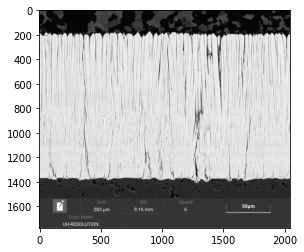

In [23]:
plt.imshow(image, cmap='gray')
plt.show()

### Some parameters

In [24]:
a,b=image.shape #original image
y_min= 0
y_text= 1536 # to crop the text section of the original SEM Image
x_min= 0
x_max= b

framing_side=15
disk_size=disk(framing_side+1) # radius of 15 pixels #+1 because for (at least one image) it does the work better

### Extract the topcoat from the SEM Image

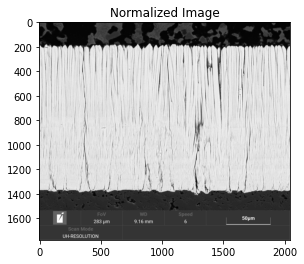

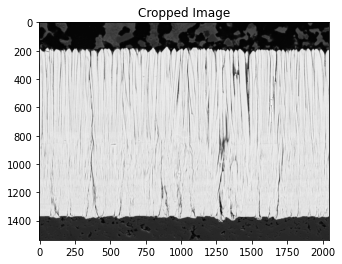

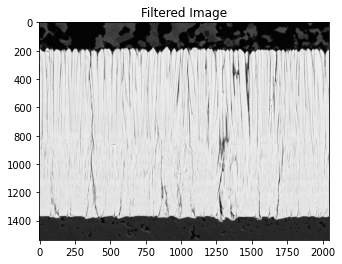

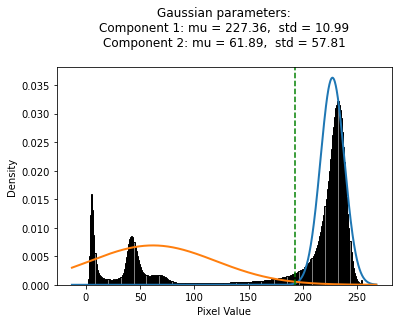

Threshold: 192.51604827110393 intensity


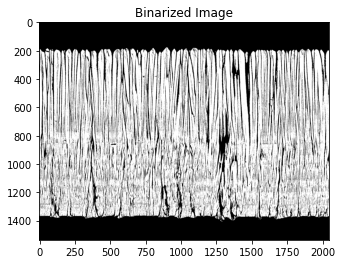

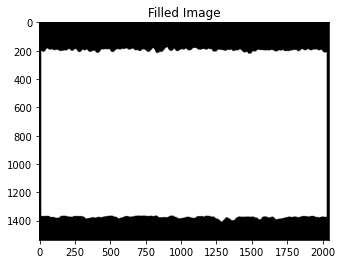

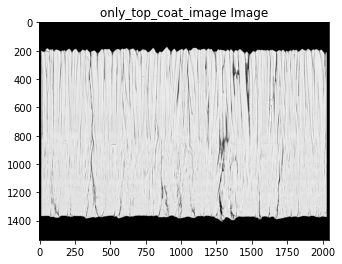

pixel_values [0 0 0 ... 0 0 0]
len(pixel_values) 3145728


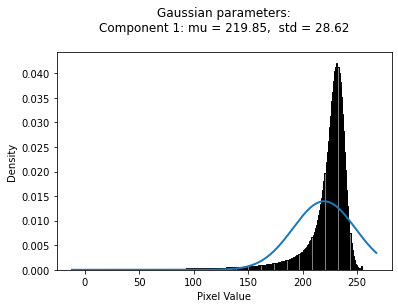

(219.8473490059564, 28.621025504948197, 1.0)

In [25]:

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.show()

#Filtering
from skimage.restoration import denoise_tv_chambolle
zoomed_tv = denoise_tv_chambolle(cropped_image, weight=0.04) 
zoomed_tv=zoomed_tv*255                     # because delivers pixel intensity between 0 and 1, not 255
plt.imshow(zoomed_tv, cmap='gray')
plt.title('Filtered Image')
plt.show()


mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,True)
threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
print('Threshold:',threshold ,'intensity')

# here the threshold has been taken as the mean value of the gaussian closest to 255 (usely the one representing the topcoat) minus 1 of it's own standard deviation. 
# Empirically, this has been seen as getting a higher value (out of 255), thus the contrast was better, notably in the bottom part to differentiate the columns to the pores
new_threshold = max(mu1,mu2)- min(stds) 
binarized_image = binarisation(cropped_image,new_threshold)
plt.imshow(binarized_image, cmap='gray')
plt.title('Binarized Image')
plt.show()

filled_image=filled(binarized_image,disk_size)
plt.imshow(filled_image, cmap='gray')
plt.title('Filled Image')
plt.show()

only_top_coat_image=np.where(filled_image==True,cropped_image,0)
plt.imshow(only_top_coat_image, cmap='gray')
plt.title('only_top_coat_image Image')
plt.show()


# See the histogram of the topcoat, just informative. The model of fitting might be reviewed forbetter fitting (was not interesting for me)
histogram_1gaussian(only_top_coat_image)


### Example of binarisation with a manual threshold, currently threshold=195

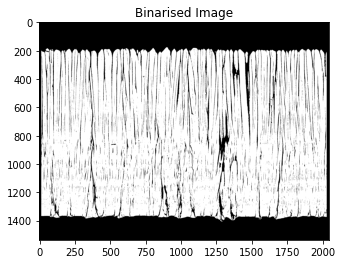

In [26]:
binarized_image = binarisation(only_top_coat_image,195)
plt.imshow(binarized_image, cmap='gray')
plt.title('Binarised Image')
plt.show()


### Plot of porosity with rectangular ROI + absolute value

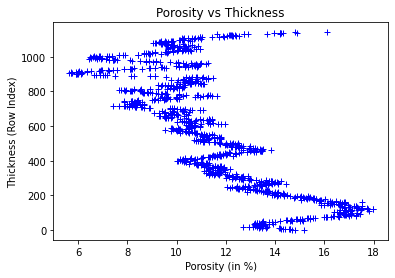

counter= 1142
mean(porosity_values) in % =


11.478115422504379

In [36]:
get_porosity_min(cropping(normalisation(image),0,x_max,0,y_text),195)

### Plot of porosity with topcoat shape ROI + absolute value

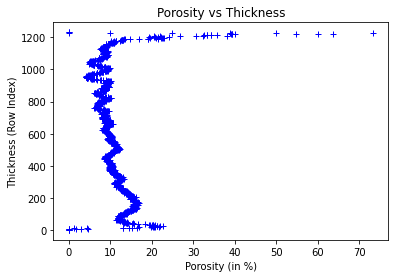

counter= 1232
Porosiy of all the top_coat in %:


10.40638943656304

In [49]:
get_porosity_max(cropping(normalisation(image),0,x_max,0,y_text),195)

### Silhouette of the Top Coat

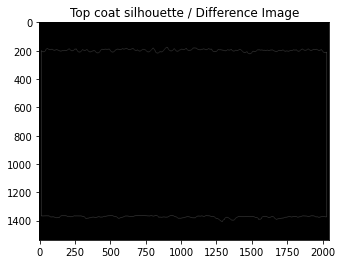

In [31]:
selem_erosion = disk(1) #thickness of the line, for a better visibility, you may want to put selem_erosion = disk(5)
                        # To calculate the thickness&surface (nest code), please put selem_erosion = disk(1)
difference_image = erosion(filled_image,selem_erosion)
plt.imshow(difference_image, cmap='gray')
plt.title('Top coat silhouette / Difference Image')
plt.show()

### Thickness & Surface of the Top Coat in pxl² (in m² by looking at the .hdr file)

len(list_diff) 2015
2048


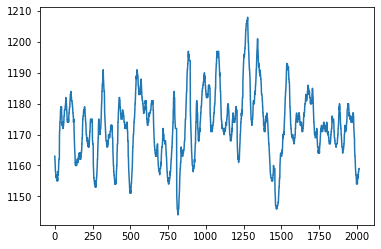

('Top-coat surface:', 2398301.913151365, 'in pixel²')

In [32]:
framing_side_clean=framing_side+1
surface_top_coat(difference_image, framing_side)

## Sensitivity Analysis - f(porosity)=threshold - Plots both porosities ROIs on the same graph - Plots the Gap in % and in simple difference

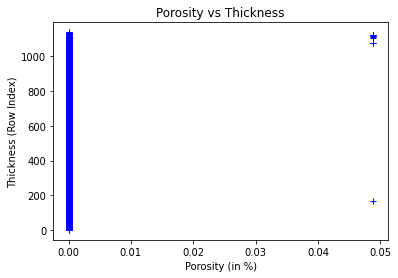

counter= 1139
mean(porosity_values) in % =
0.0004286929323968393


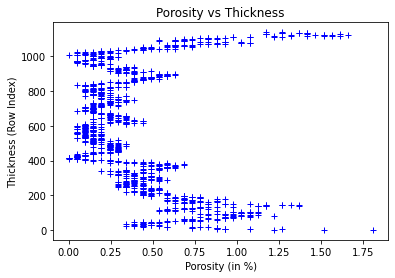

counter= 1139
mean(porosity_values) in % =
0.4151891050263389


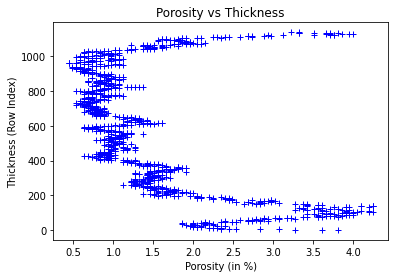

counter= 1139
mean(porosity_values) in % =
1.476632805640913


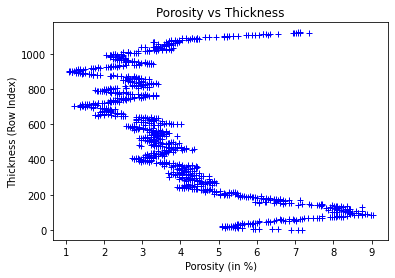

counter= 1123
mean(porosity_values) in % =
3.905380398486198


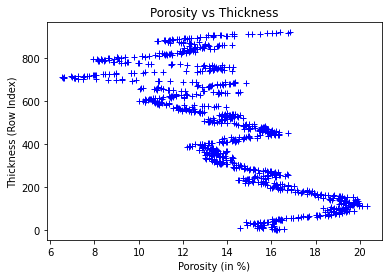

counter= 918
mean(porosity_values) in % =
14.062925517429194


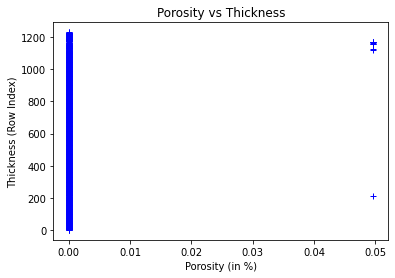

counter= 1230
Porosiy of all the top_coat in %:
0.0004222605634813863


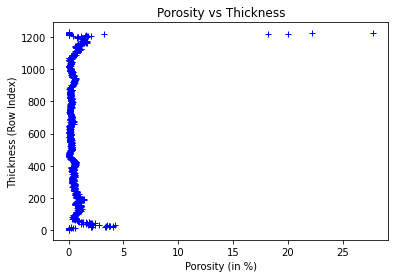

counter= 1230
Porosiy of all the top_coat in %:
0.4708205282817458


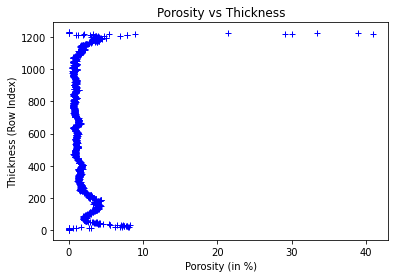

counter= 1230
Porosiy of all the top_coat in %:
1.6053502102435346


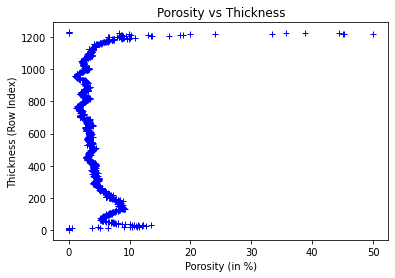

counter= 1230
Porosiy of all the top_coat in %:
4.1198974744425065


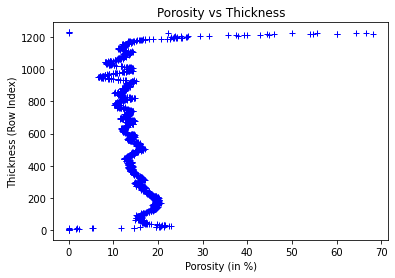

counter= 1230
Porosiy of all the top_coat in %:
14.231421397937789
a [0.0004286929323968393, 0.4151891050263389, 1.476632805640913, 3.905380398486198, 14.062925517429194]
b [0.0004222605634813863, 0.4708205282817458, 1.6053502102435346, 4.1198974744425065, 14.231421397937789]
[0.0004286929323968393, 0.4151891050263389, 1.476632805640913, 3.905380398486198, 14.062925517429194]
[0.0004222605634813863, 0.4708205282817458, 1.6053502102435346, 4.1198974744425065, 14.231421397937789]


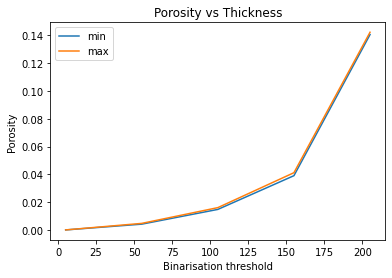

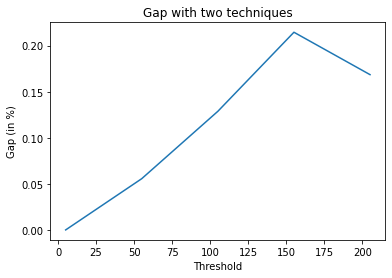

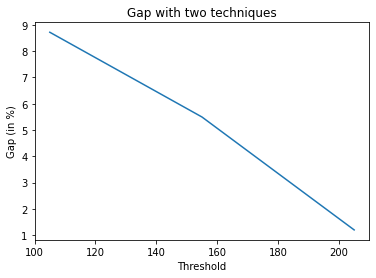

In [33]:
threshold_range=np.arange(5,241,50) #adjust manually as wanted


a=sensitivity_analysis_min(only_top_coat_image,threshold_range)   #min=rectangular ROI
b=sensitivity_analysis_max(only_top_coat_image,threshold_range)   #max=topcoat shape ROI
print('a',a)
print('b',b)

   

a=[x/100 for x in a] #value from 0 to 1
b=[x/100 for x in b]
plt.plot(threshold_range,a, label='min')
plt.plot(threshold_range,b, label='max')
plt.xlabel('Binarisation threshold')
plt.ylabel('Porosity')
plt.title('Porosity vs Thickness')
plt.legend()
plt.show()

GAPs=[]

for i in range (len(threshold_range)):
    GAP=abs(a[i]-b[i])*100
    GAPs.append(GAP)
    
plt.xlabel('Threshold')
plt.ylabel('Gap (in %)')
plt.title('Gap with two techniques')
plt.plot(threshold_range,GAPs)
plt.show()

GAPss=[]
threshold_range_no_zero=threshold_range[2:]
for i in range (2,len(threshold_range)):
    GAP=(abs(a[i]-b[i])/(a[i]))*100
    GAPss.append(GAP)
    
plt.xlabel('Threshold')
plt.ylabel('Gap (in %)')
plt.title('Gap with two techniques')
plt.plot(threshold_range_no_zero,GAPss)
plt.show()



## Histogram of the bond coat (informative)

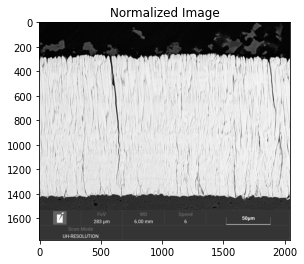

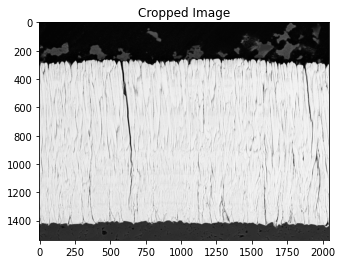

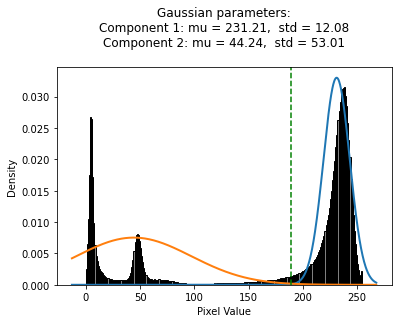

Threshold: 189.257877381799 intensity


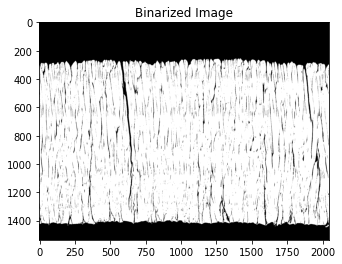

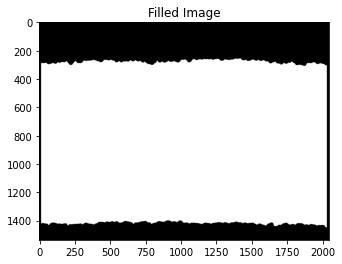

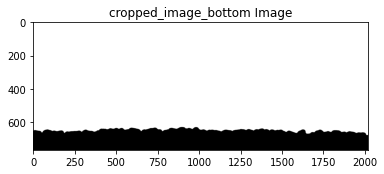

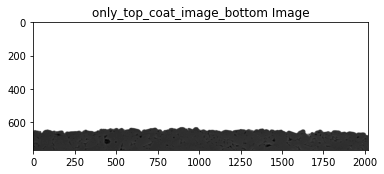

pixel_values [255 255 255 ...  47  50  49]
len(pixel_values) 1549824


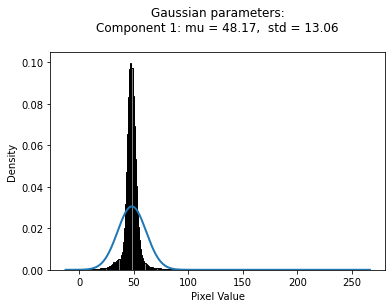

(48.16978910580363, 13.05816491873117, 1.0)

In [ ]:

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.show()

mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
print('Threshold:',threshold ,'intensity')

binarized_image = binarisation(cropped_image,threshold)
plt.imshow(binarized_image, cmap='gray')
plt.title('Binarized Image')
plt.show()

filled_image=filled(binarized_image,disk_size)
plt.imshow(filled_image, cmap='gray')
plt.title('Filled Image')
plt.show()

cropped_image_bottom=cropping(normalized_image,framing_side,x_max-(framing_side),int(y_text/2),y_text)
cropped_image_bottom_bin=cropping(filled_image,framing_side,x_max-(framing_side),int(y_text/2),y_text)
plt.imshow(cropped_image_bottom_bin, cmap='gray')
plt.title('cropped_image_bottom Image')
plt.show()

only_top_coat_image_bottom=np.where(cropped_image_bottom_bin==True, 255, cropped_image_bottom)
plt.imshow(only_top_coat_image_bottom, cmap='gray')
plt.title('only_top_coat_image_bottom Image')
plt.show()

# Apply a filter to change the model of the gaussian maybe?

histogram_1gaussian_remove_255(only_top_coat_image_bottom)

# Proof there is no black=0int inside the top coat or too few to have an influence (depends on the coating)

2368206


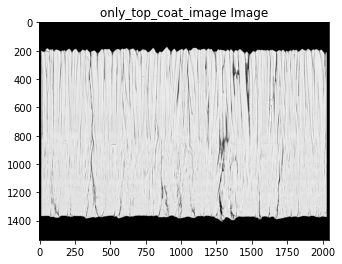

2368206


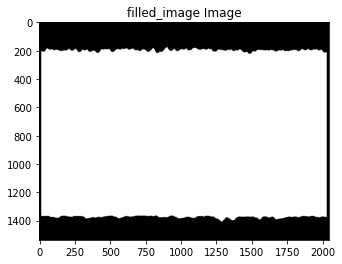

0.0 % so it can be neglicte
none of the pores have a black 0 int value


In [35]:
print(np.count_nonzero(only_top_coat_image))
plt.imshow(only_top_coat_image, cmap='gray')
plt.title('only_top_coat_image Image')
plt.show()

print(np.count_nonzero(filled_image))
plt.imshow(filled_image, cmap='gray')
plt.title('filled_image Image')
plt.show()

a=np.count_nonzero(only_top_coat_image)
b=np.count_nonzero(filled_image)
c=(a-b)/b*100
print(c,'%','so it can be neglected')
if np.count_nonzero(only_top_coat_image)==np.count_nonzero(filled_image):
    print('none of the pores have a black 0 int value')


# =========================================================================================================

# ===================================================================================================================================

# Method of acquisition of the best pair of pre-processing techniques (filter&cleaning) done sample after sample

### Without filtering Graph predicting nb columns

### Data 'measured' manually on 18 different samples (3 samples/ image)

In [ ]:
NEW_EYES=[[15,14,15,13,15,15,14,16],[10,10,10,11,12,12,14,13],[15,15,13,12,13,15,16,14],
          [11,11,7,12,16,17,12,9],[9,9,8,9,9,10,10,10],[13,12,12,13,13,10,10,10],
          [10,10,10,10,11,11,12,12],[8,9,8,8,10,11,11,12],[10,10,9,10,11,10,10,11],
          [13,14,13,15,16,14,14,14],[9,9,10,10,12,11,13,11],[10,11,11,11,11,11,10,9],
          [16,13,12,12,11,10,11,11],[7,5,5,5,4,5,5,6],[8,8,8,7,8,8,8,8],
          [9,10,10,10,12,12,11,10],[7,7,8,10,8,11,14,16],[14,14,13,12,11,11,10,9]]
# 18 lists= 18 zoomed image=samples
# 8 numbers/list = 8 measurements per sample (8 red lines)

# ===================================================================================================================================

## Without any filter

In [ ]:
image_path = r"C:\Users\chris\Desktop\Original_Images\Batchs\Random\image\VA248 AD02 BSE x1000 site 3.tif"

image = mpimg.imread(image_path)

crop_x_min=1000
crop_x_max=1200
crop_y_min=600
crop_y_max=700

EYES=[14,14,13,12,11,11,10,9]

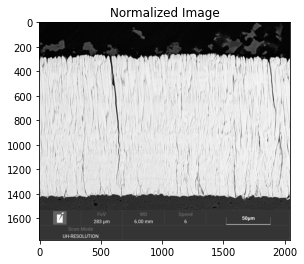

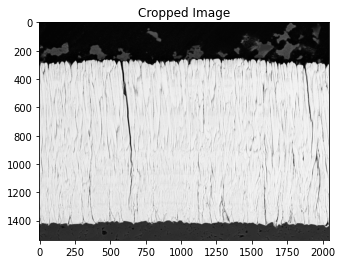

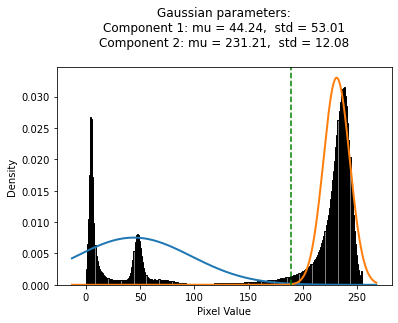

Threshold: 189.257877381799 intensity


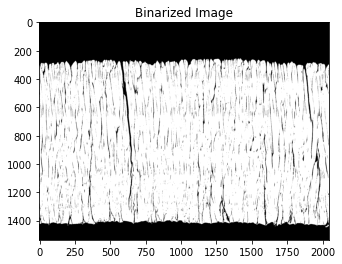

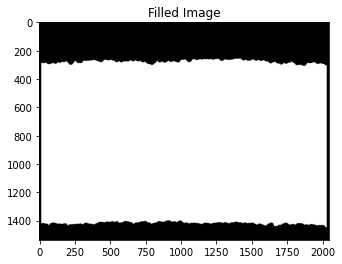

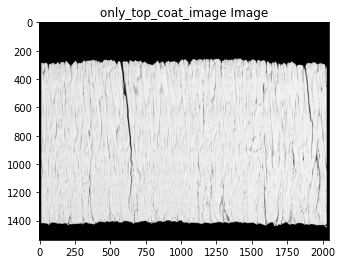

pixel_values [0 0 0 ... 0 0 0]
len(pixel_values) 3145728


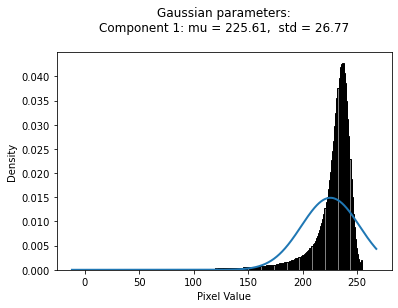

New Threshold: 219.12864725472622


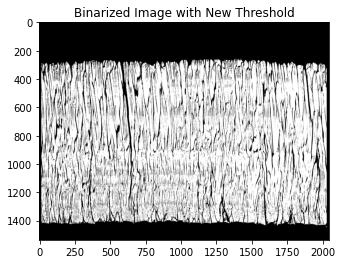

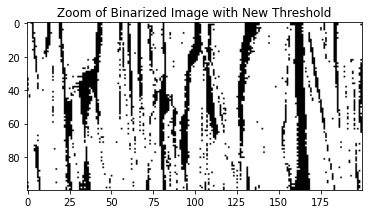

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology

disk_size=disk(framing_side+1)

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.show()

mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
print('Threshold:',threshold ,'intensity')

binarized_image = binarisation(cropped_image,threshold)
plt.imshow(binarized_image, cmap='gray')
plt.title('Binarized Image')
plt.show()

filled_image=filled(binarized_image,disk_size)
plt.imshow(filled_image, cmap='gray')
plt.title('Filled Image')
plt.show()

only_top_coat_image=np.where(filled_image==True,cropped_image,0)
plt.imshow(only_top_coat_image, cmap='gray')
plt.title('only_top_coat_image Image')
plt.show()

# Apply a filter to change the model of the gaussian maybe?

mu_unique, sigma_unique, weight_unique=histogram_1gaussian(only_top_coat_image)

#new_threshold = mu_unique + 0.15 * sigma_unique
new_threshold = max(mu1,mu2)- min(stds)
#new_threshold=210
print('New Threshold:', new_threshold)

binarized_image_new_threshold = binarisation(only_top_coat_image, new_threshold)
plt.imshow(binarized_image_new_threshold, cmap='gray')
plt.title('Binarized Image with New Threshold')
plt.show()

zoom=cropping(binarized_image_new_threshold,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom, cmap='gray')
plt.title('Zoom of Binarized Image with New Threshold')
plt.show()

#### Displays zoomed image

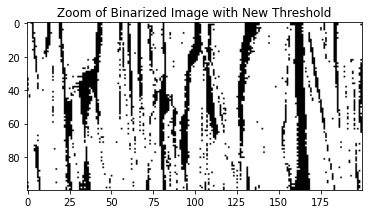

In [ ]:
zoom=cropping(binarized_image_new_threshold,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom, cmap='gray')
plt.title('Zoom of Binarized Image with New Threshold')
plt.show()

#### Red lines

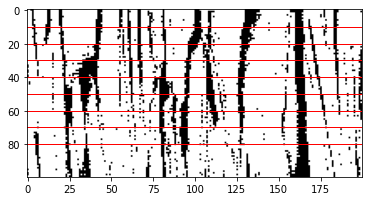

In [ ]:
zoom=cropping(binarized_image_new_threshold,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
a,b=zoom.shape
#plt.axvline(y=np.arange(int(0.1*a),int(0.9*a),5), color='red', linestyle='--')
fig, ax = plt.subplots()
ax.imshow(zoom, cmap='gray')
for y in range(int(0.1 * a), int(0.9 * a), 10) :
    ax.axhline(y, color='red', linewidth=1)
plt.show()

#### Skeleton zoomed image

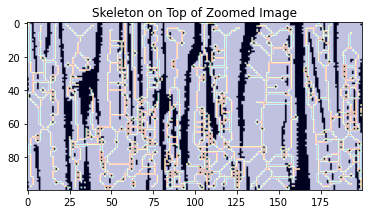

In [ ]:
zoom=cropping(binarized_image_new_threshold,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
zoom=np.where(zoom==255, 1,0)

skeleton = morphology.skeletonize(zoom)

fig, ax = plt.subplots()
ax.imshow(zoom, cmap='gray')
ax.imshow(skeleton, cmap='jet', alpha=0.25)  # 'jet' colormap for skeleton with some transparency

plt.title('Skeleton on Top of Zoomed Image')
plt.show()

100 200


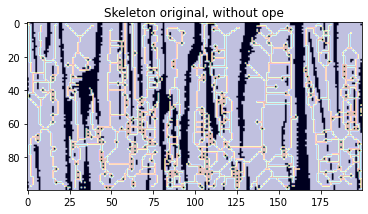

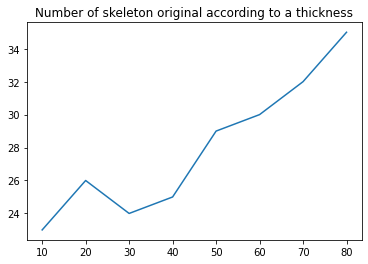

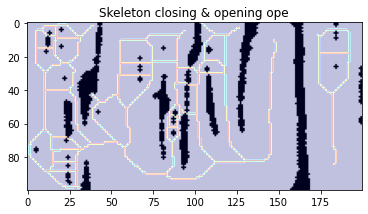

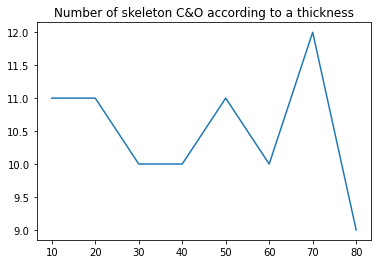

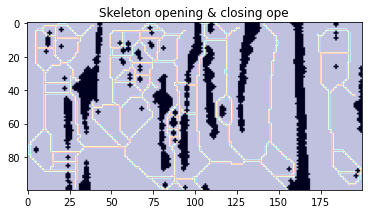

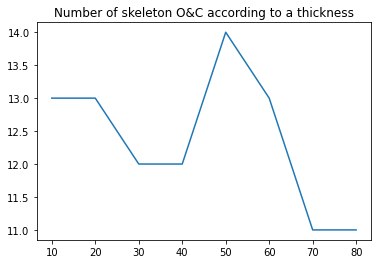

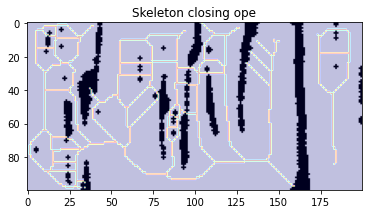

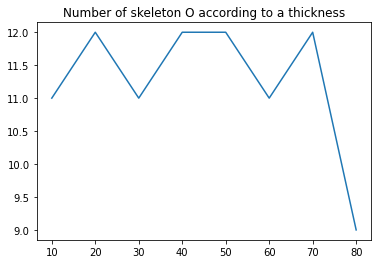

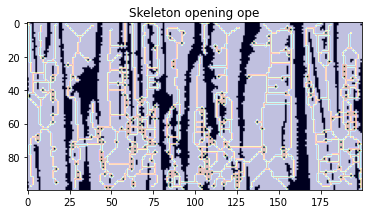

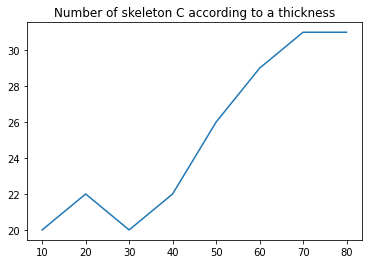

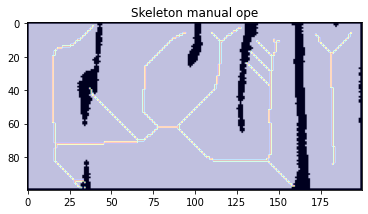

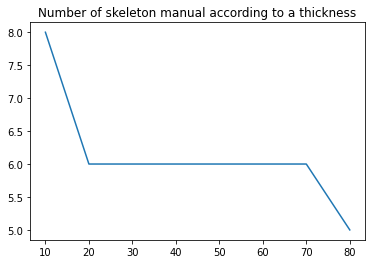

[8, 6, 6, 6, 6, 6, 6, 5]

In [ ]:
a,b=skeleton.shape
print(a,b)
x=1

zoom=cropping(binarized_image_new_threshold,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
zoom=np.where(zoom==255, 1,0)
##################################### original
counting(True,True,zoom,'Skeleton original, without ope', 'Number of skeleton original according to a thickness')
##################################### closing then opening
cleaned_image = morphology.binary_closing(zoom, morphology.disk(x))
cleaned_image = morphology.binary_opening(cleaned_image, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton closing & opening ope', 'Number of skeleton C&O according to a thickness')
##################################### opening and closing
cleaned_image = morphology.binary_opening(zoom, morphology.disk(x))
cleaned_image = morphology.binary_closing(cleaned_image, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton opening & closing ope', 'Number of skeleton O&C according to a thickness')
skeleton = morphology.skeletonize(cleaned_image)
##################################### closing
cleaned_image = morphology.binary_closing(zoom, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton closing ope', 'Number of skeleton O according to a thickness')
##################################### opening
cleaned_image = morphology.binary_opening(zoom, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton opening ope', 'Number of skeleton C according to a thickness')
##################################### manually
disk_size=disk(x) # radius of x pixels
cleaned_image_gaussian=filled(zoom,disk_size)
counting(True,True,cleaned_image_gaussian,'Skeleton manual ope', 'Number of skeleton manual according to a thickness')


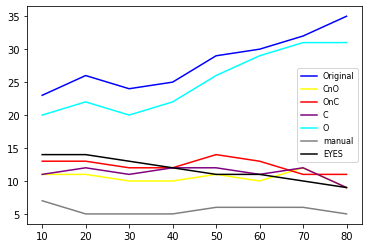

In [ ]:
#EYES=[8,8,9,10,10,13,11,12]
Original,CnO,OnC,C,O,manual=[],[],[],[],[],[]

x=1
x_range=range(10,81,10)
##################################### original
Original=counting(False,False, zoom,'original', '')
plt.plot(x_range, Original, label='Original', color='blue')
##################################### closing then opening
cleaned_image = morphology.binary_closing(zoom, morphology.disk(x))
cleaned_image = morphology.binary_opening(cleaned_image, morphology.disk(x))
CnO=counting(False,False,cleaned_image,'Skeleton closing & opening ope', 'C&O')
plt.plot(x_range, CnO, label='CnO', color='yellow')
##################################### opening and closing
cleaned_image = morphology.binary_opening(zoom, morphology.disk(x))
cleaned_image = morphology.binary_closing(cleaned_image, morphology.disk(x))
OnC=counting(False,False,cleaned_image,'Skeleton opening & closing ope', 'O&C')
plt.plot(x_range, OnC, label='OnC', color='red')
##################################### closing
cleaned_image = morphology.binary_closing(zoom, morphology.disk(x))
C=counting(False,False,cleaned_image,'Skeleton closing ope', 'C')
plt.plot(x_range, C, label='C', color='purple')
##################################### opening
cleaned_image = morphology.binary_opening(zoom, morphology.disk(x))
O=counting(False,False,cleaned_image,'Skeleton opening ope', 'O')
plt.plot(x_range, O, label='O', color='cyan')
##################################### manually
disk_size=disk(x) # radius of x pixels
filled_image=filled(zoom,disk_size)
cleaned_image = morphology.binary_opening(filled_image, morphology.disk(x))
manual=counting(False,False,cleaned_image,'Skeleton manual ope', ' manual')
plt.plot(x_range, manual , label='manual', color='grey')
##################################### eyes

plt.plot(x_range, EYES, label='EYES', color='black')
plt.legend(loc="best",fontsize= 8)

plt.show()

In [ ]:
rmse_original = calculate_rmse(EYES, Original)
print (rmse_original,'rmse_original')
rmse_CnO = calculate_rmse(EYES, CnO)
print (rmse_CnO,'rmse_CnO')
rmse_OnC = calculate_rmse(EYES, OnC)
print (rmse_OnC,'rmse_OnC')
rmse_C = calculate_rmse(EYES, C)
print (rmse_C,'rmse_C')
rmse_O = calculate_rmse(EYES, O)
print (rmse_O,'rmse_O')
rmse_manual = calculate_rmse(EYES, manual)
print (rmse_manual,'rmse_manual')

rmse_values = {
    'Original': rmse_original,
    'CnO': rmse_CnO,
    'OnC': rmse_OnC,
    'C': rmse_C,
    'O': rmse_O,
    'manual': rmse_manual
}

best_fit = min(rmse_values, key=rmse_values.get)
print(best_fit)

17.175564037317667 rmse_original
2.1213203435596424 rmse_CnO
1.620185174601965 rmse_OnC
1.6583123951777 rmse_C
14.675660121439172 rmse_O
6.373774391990981 rmse_manual
OnC


# =============================================================================

## Gaussian Filter

In [ ]:

image_path = r"C:\Users\chris\Desktop\Original_Images\Batchs\Sexy\image\VA248 AD01 BSE x1000 site 1.tif"

image = mpimg.imread(image_path)

crop_x_min=1000
crop_x_max=1200
crop_y_min=300
crop_y_max=400


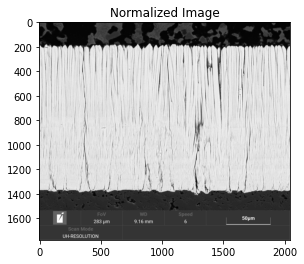

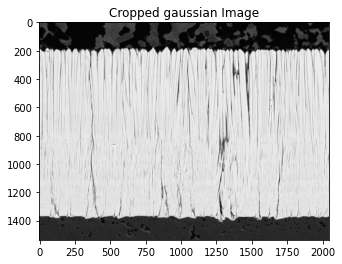

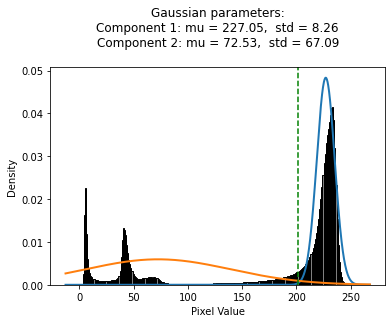

Threshold: 201.8112335338279 intensity


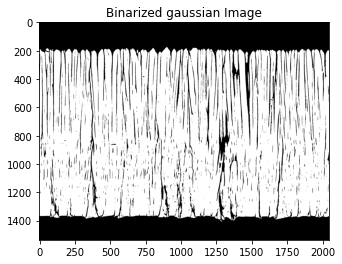

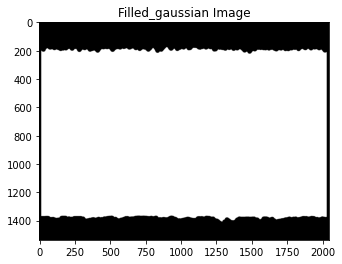

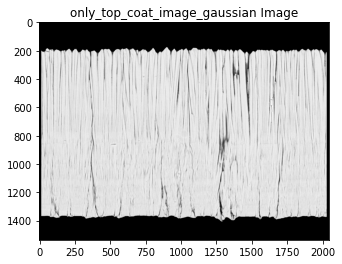

pixel_values [0. 0. 0. ... 0. 0. 0.]
len(pixel_values) 3145728


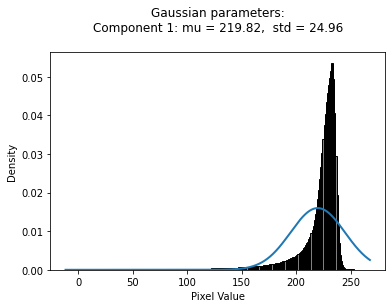

New Threshold: 218.78925960819257


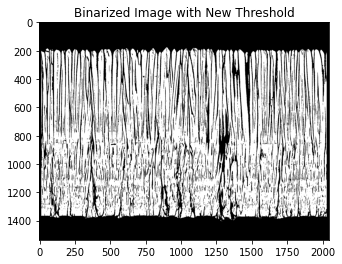

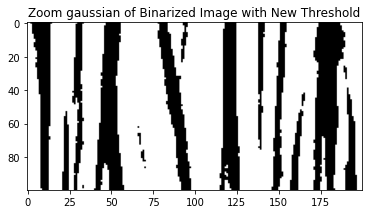

In [ ]:
from skimage.filters import gaussian
#from sklearn.mixture import GaussianMixture

disk_size=disk(framing_side+1)

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
cropped_image_gaussian = gaussian(cropped_image, sigma=1)
cropped_image_gaussian=cropped_image_gaussian*255

plt.imshow(cropped_image_gaussian, cmap='gray')
plt.title('Cropped gaussian Image')
plt.show()

mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image_gaussian,False)
threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
print('Threshold:',threshold ,'intensity')

binarized_image_gaussian = binarisation(cropped_image_gaussian,threshold)
plt.imshow(binarized_image_gaussian, cmap='gray')
plt.title('Binarized gaussian Image')
plt.show()

filled_image_gaussian=filled(binarized_image_gaussian,disk_size)
plt.imshow(filled_image_gaussian, cmap='gray')
plt.title('Filled_gaussian Image')
plt.show()

only_top_coat_image_gaussian=np.where(filled_image_gaussian==True,cropped_image_gaussian,0)
plt.imshow(only_top_coat_image_gaussian, cmap='gray')
plt.title('only_top_coat_image_gaussian Image')
plt.show()

mu_unique, sigma_unique, weight_unique=histogram_1gaussian(only_top_coat_image_gaussian)


#new_threshold = mu_unique + 0.15 * sigma_unique
new_threshold = max(mu1,mu2)- min(stds)
#new_threshold=210
print('New Threshold:', new_threshold)

binarized_image_new_threshold_gaussian = binarisation(only_top_coat_image_gaussian, new_threshold)
plt.imshow(binarized_image_new_threshold_gaussian, cmap='gray')
plt.title('Binarized Image with New Threshold')
plt.show()

zoom_gaussian=cropping(binarized_image_new_threshold_gaussian,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom_gaussian, cmap='gray')
plt.title('Zoom gaussian of Binarized Image with New Threshold')
plt.show()

#### Displays zoomed image

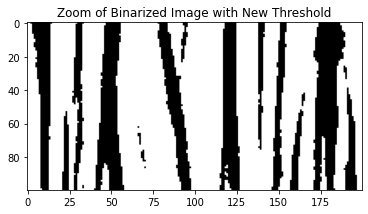

In [ ]:
zoom_gaussian=cropping(binarized_image_new_threshold_gaussian,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom_gaussian, cmap='gray')
plt.title('Zoom of Binarized Image with New Threshold')
plt.show()

#### Red lines

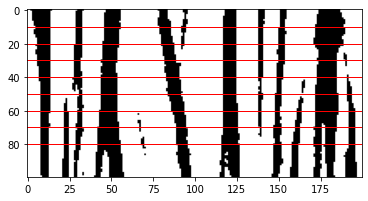

In [ ]:
zoom_gaussian=cropping(binarized_image_new_threshold_gaussian,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
a,b=zoom_gaussian.shape
#plt.axvline(y=np.arange(int(0.1*a),int(0.9*a),5), color='red', linestyle='--')
fig, ax = plt.subplots()
ax.imshow(zoom_gaussian, cmap='gray')

for y in range(int(0.1 * a), int(0.9 * a), 10) :
    ax.axhline(y, color='red', linewidth=1)
   
plt.show()

#### Skeleton zoomed image

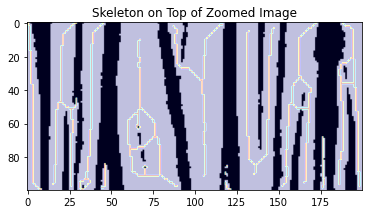

In [ ]:
zoom_gaussian=cropping(binarized_image_new_threshold_gaussian,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
zoom_gaussian=np.where(zoom_gaussian==255, 1,0)

skeleton = morphology.skeletonize(zoom_gaussian)

fig, ax = plt.subplots()
ax.imshow(zoom_gaussian, cmap='gray')
ax.imshow(skeleton, cmap='jet', alpha=0.25)  # 'jet' colormap for skeleton with some transparency

plt.title('Skeleton on Top of Zoomed Image')
plt.show()

100 200


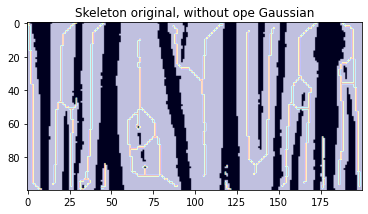

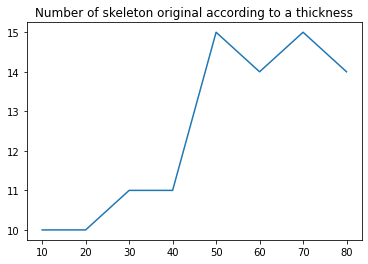

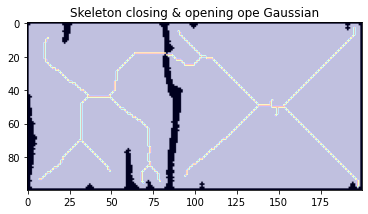

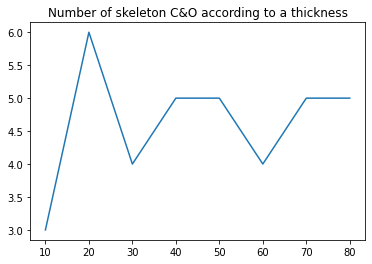

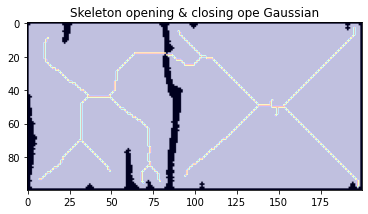

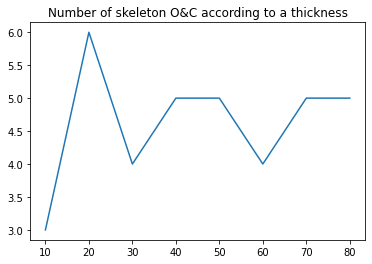

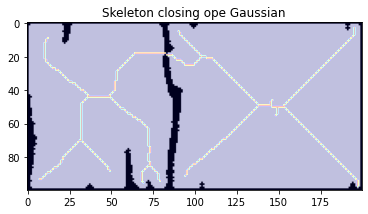

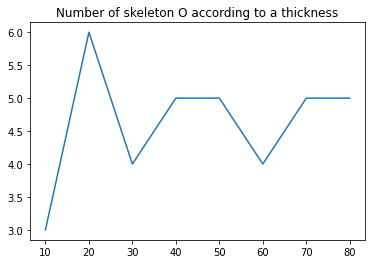

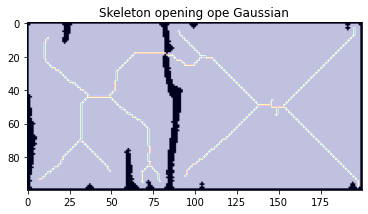

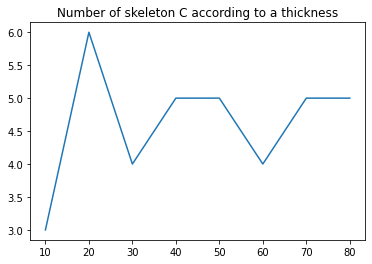

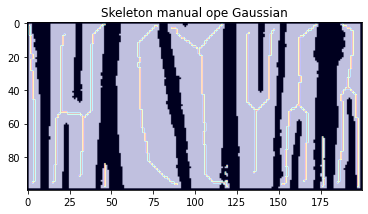

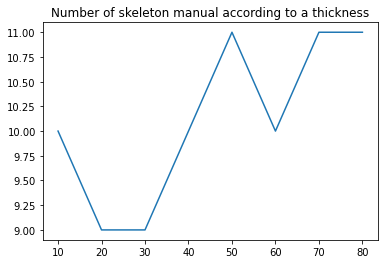

[10, 9, 9, 10, 11, 10, 11, 11]

In [ ]:
a,b=skeleton.shape
print(a,b)
x=1

##################################### original
counting(True,True,zoom_gaussian,'Skeleton original, without ope Gaussian', 'Number of skeleton original according to a thickness')
##################################### closing then opening
cleaned_image_gaussian = morphology.binary_closing(zoom_gaussian, morphology.disk(x))
cleaned_image_gaussian = morphology.binary_opening(cleaned_image, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton closing & opening ope Gaussian', 'Number of skeleton C&O according to a thickness')
##################################### opening and closing
cleaned_image_gaussian = morphology.binary_opening(zoom_gaussian, morphology.disk(x))
cleaned_image_gaussian = morphology.binary_closing(cleaned_image, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton opening & closing ope Gaussian', 'Number of skeleton O&C according to a thickness')
skeleton = morphology.skeletonize(cleaned_image)
##################################### closing
cleaned_image_gaussian = morphology.binary_closing(zoom_gaussian, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton closing ope Gaussian', 'Number of skeleton O according to a thickness')
##################################### opening
cleaned_image_gaussian = morphology.binary_opening(zoom_gaussian, morphology.disk(x))
counting(True,True,cleaned_image,'Skeleton opening ope Gaussian', 'Number of skeleton C according to a thickness')
##################################### manually
disk_size=disk(x) # radius of x pixels
cleaned_image_gaussian=filled(zoom_gaussian,disk_size)
counting(True,True,cleaned_image_gaussian,'Skeleton manual ope Gaussian', 'Number of skeleton manual according to a thickness')


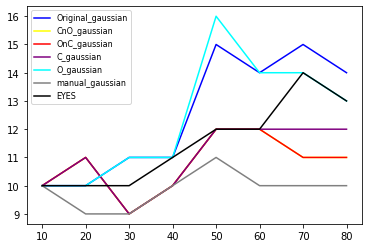

In [ ]:
#EYES=[10,10,10,11,12,12,14,13]
Original_gaussian,CnO_gaussian,OnC_gaussian,C_gaussian,O_gaussian,manual_gaussian=[],[],[],[],[],[]

x=1
x_range=range(10,81,10)
##################################### original
Original_gaussian=counting(False,False, zoom_gaussian,'original', '')
plt.plot(x_range, Original_gaussian, label='Original_gaussian', color='blue')
##################################### closing then opening
cleaned_image_gaussian = morphology.binary_closing(zoom_gaussian, morphology.disk(x))
cleaned_image_gaussian = morphology.binary_opening(cleaned_image_gaussian, morphology.disk(x))
CnO_gaussian=counting(False,False,cleaned_image_gaussian,'Skeleton closing & opening ope', 'C&O')
plt.plot(x_range, CnO_gaussian, label='CnO_gaussian', color='yellow')
##################################### opening and closing
cleaned_image_gaussian = morphology.binary_opening(zoom_gaussian, morphology.disk(x))
cleaned_image_gaussian = morphology.binary_closing(cleaned_image_gaussian, morphology.disk(x))
OnC_gaussian=counting(False,False,cleaned_image_gaussian,'Skeleton opening & closing ope', 'O&C')
plt.plot(x_range, OnC_gaussian, label='OnC_gaussian', color='red')
##################################### closing
cleaned_image_gaussian = morphology.binary_closing(zoom_gaussian, morphology.disk(x))
C_gaussian=counting(False,False,cleaned_image_gaussian,'Skeleton closing ope', 'C')
plt.plot(x_range, C_gaussian, label='C_gaussian', color='purple')
##################################### opening
cleaned_image_gaussian = morphology.binary_opening(zoom_gaussian, morphology.disk(x))
O_gaussian=counting(False,False,cleaned_image_gaussian,'Skeleton opening ope', 'O')
plt.plot(x_range, O_gaussian, label='O_gaussian', color='cyan')
##################################### manually
disk_size=disk(x) # radius of x pixels
filled_image_gaussian=filled(zoom_gaussian,disk_size)
cleaned_image_gaussian = morphology.binary_opening(filled_image_gaussian, morphology.disk(x))
manual_gaussian=counting(False,False,cleaned_image_gaussian,'Skeleton manual ope', ' manual')
plt.plot(x_range, manual_gaussian , label='manual_gaussian', color='grey')
##################################### eyes

plt.plot(x_range, EYES, label='EYES', color='black')
plt.legend(loc="best",fontsize= 8)

plt.show()

In [ ]:
rmse_original_gaussian = calculate_rmse(EYES, Original_gaussian)
print (rmse_original_gaussian,'rmse_original_gaussian')
rmse_CnO_gaussian = calculate_rmse(EYES, CnO_gaussian)
print (rmse_CnO_gaussian,'rmse_CnO_gaussian')
rmse_OnC_gaussian = calculate_rmse(EYES, OnC_gaussian)
print (rmse_OnC_gaussian,'rmse_OnC_gaussian')
rmse_C_gaussian = calculate_rmse(EYES, C_gaussian)
print (rmse_C_gaussian,'rmse_C_gaussian')
rmse_O_gaussian = calculate_rmse(EYES, O_gaussian)
print (rmse_O_gaussian,'rmse_O_gaussian')
rmse_manual_gaussian = calculate_rmse(EYES, manual_gaussian)
print (rmse_manual_gaussian,'rmse_manual_gaussian')

rmse_list_gaussian = {
    'Original_gaussian': rmse_original_gaussian,
    'CnO_gaussian': rmse_CnO_gaussian,
    'OnC_gaussian': rmse_OnC_gaussian,
    'C_gaussian': rmse_C_gaussian,
    'O_gaussian': rmse_O_gaussian,
    'manual_gaussian': rmse_manual_gaussian
}

best_fit_gaussian = min(rmse_list_gaussian, key=rmse_list_gaussian.get)
print(best_fit_gaussian)

1.4142135623730951 rmse_original_gaussian
1.4142135623730951 rmse_CnO_gaussian
1.4142135623730951 rmse_OnC_gaussian
1.0 rmse_C_gaussian
1.620185174601965 rmse_O_gaussian
2.03100960115899 rmse_manual_gaussian
C_gaussian


# =============================================================================

# TV filter  weight=0.04

In [ ]:
image_path = r"C:\Users\chris\Desktop\Original_Images\Batchs\Random\image\VA248 AD02 BSE x1000 site 3.tif"

image = mpimg.imread(image_path)

In [ ]:
crop_x_min=1000
crop_x_max=1200
crop_y_min=1000
crop_y_max=1100

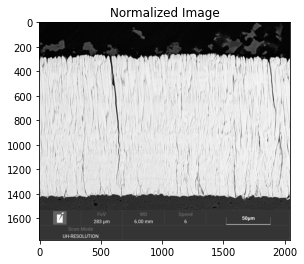

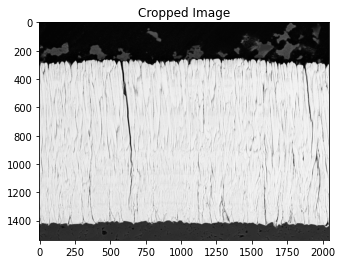

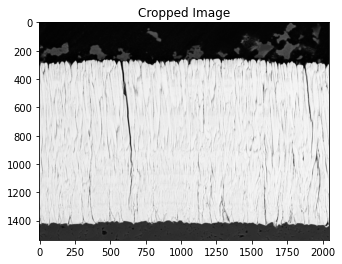

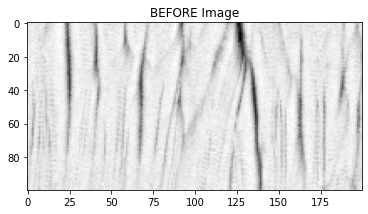

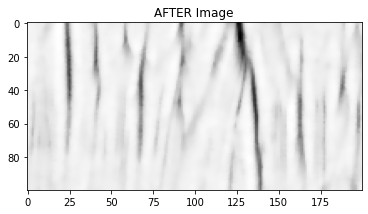

In [ ]:

from skimage.restoration import denoise_tv_chambolle

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.show()

cropped_image_tv = denoise_tv_chambolle(cropped_image, weight=0.05)  # Adjust weight as needed
plt.imshow(255*cropped_image_tv, cmap='gray')
plt.title('Cropped Image')
plt.show()

BEFORE=cropped_image[crop_y_min:crop_y_max,crop_x_min:crop_x_max]
AFTER=255*cropped_image_tv[crop_y_min:crop_y_max,crop_x_min:crop_x_max]

plt.imshow(BEFORE, cmap='gray')
plt.title('BEFORE Image')
plt.show()
plt.imshow(AFTER, cmap='gray')
plt.title('AFTER Image')

plt.show()


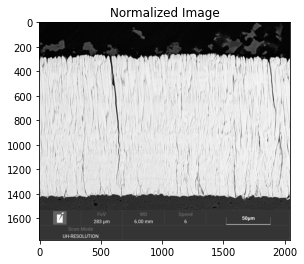

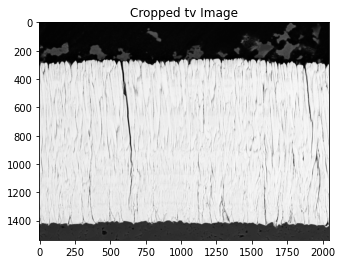

Threshold: 205.99238193186895 intensity


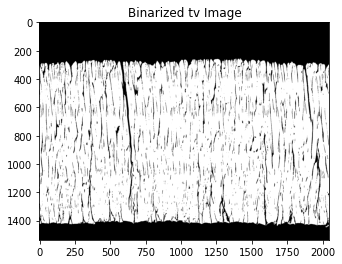

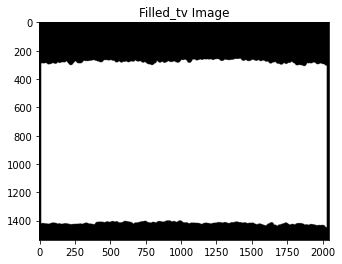

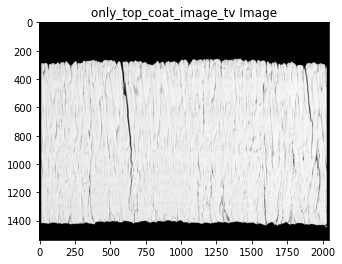

pixel_values [0. 0. 0. ... 0. 0. 0.]
len(pixel_values) 3145728


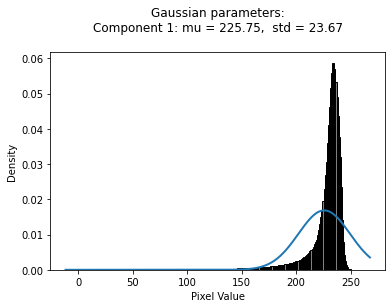

New Threshold: 223.78567018464116


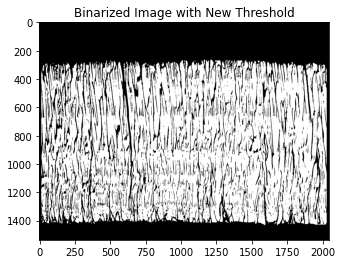

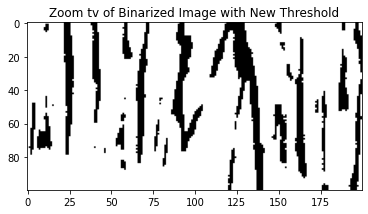

In [ ]:
from skimage.restoration import denoise_tv_chambolle

disk_size=disk(framing_side+1)

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
cropped_image_tv = denoise_tv_chambolle(cropped_image, weight=0.04)
cropped_image_tv=cropped_image_tv*255

plt.imshow(cropped_image_tv, cmap='gray')
plt.title('Cropped tv Image')
plt.show()

mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image_tv,False)
threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
print('Threshold:',threshold ,'intensity')

binarized_image_tv = binarisation(cropped_image_tv,threshold)
plt.imshow(binarized_image_tv, cmap='gray')
plt.title('Binarized tv Image')
plt.show()

filled_image_tv=filled(binarized_image_tv,disk_size)
plt.imshow(filled_image_tv, cmap='gray')
plt.title('Filled_tv Image')
plt.show()

only_top_coat_image_tv=np.where(filled_image_tv==True,cropped_image_tv,0)
plt.imshow(only_top_coat_image_tv, cmap='gray')
plt.title('only_top_coat_image_tv Image')
plt.show()

mu_unique, sigma_unique, weight_unique=histogram_1gaussian(only_top_coat_image_tv)


#new_threshold = mu_unique + 0.15 * sigma_unique
new_threshold = max(mu1,mu2)- min(stds)
#new_threshold=210
print('New Threshold:', new_threshold)

binarized_image_new_threshold_tv = binarisation(only_top_coat_image_tv, new_threshold)
plt.imshow(binarized_image_new_threshold_tv, cmap='gray')
plt.title('Binarized Image with New Threshold')
plt.show()

zoom_tv=cropping(binarized_image_new_threshold_tv,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom_tv, cmap='gray')
plt.title('Zoom tv of Binarized Image with New Threshold')
plt.show()

#### Displays zoomed image

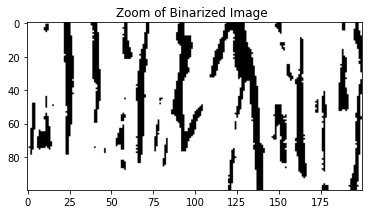

In [ ]:
zoom_tv=cropping(binarized_image_new_threshold_tv,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom_tv, cmap='gray')
plt.title('Zoom of Binarized Image ')
plt.show()

#### Red lines

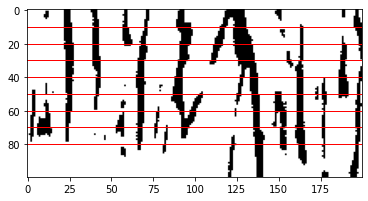

In [ ]:
zoom_tv=cropping(binarized_image_new_threshold_tv,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
a,b=zoom_tv.shape
#plt.axvline(y=np.arange(int(0.1*a),int(0.9*a),5), color='red', linestyle='--')
fig, ax = plt.subplots()
ax.imshow(zoom_tv, cmap='gray')

for y in range(int(0.1 * a), int(0.9 * a), 10) :
    ax.axhline(y, color='red', linewidth=1)
   
plt.show()

#### Skeleton zoomed image

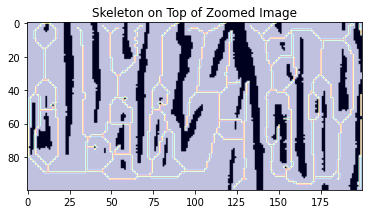

In [ ]:
zoom_tv=cropping(binarized_image_new_threshold_tv,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
zoom_tv=np.where(zoom_tv==255, 1,0)

skeleton = morphology.skeletonize(zoom_tv)

fig, ax = plt.subplots()
ax.imshow(zoom_tv, cmap='gray')
ax.imshow(skeleton, cmap='jet', alpha=0.25)  # 'jet' colormap for skeleton with some transparency

plt.title('Skeleton on Top of Zoomed Image')
plt.show()

100 200


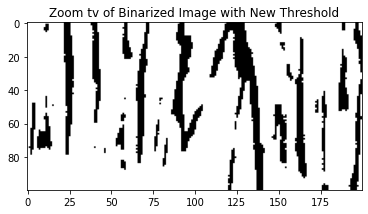

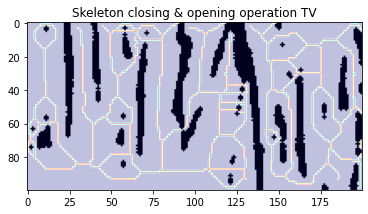

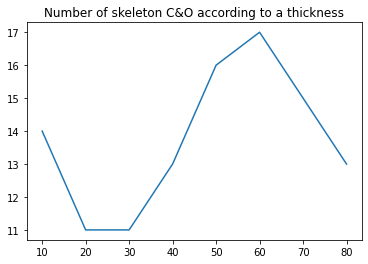

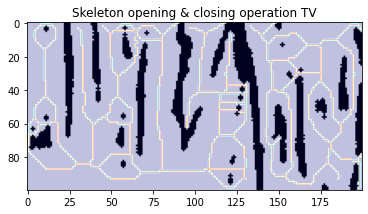

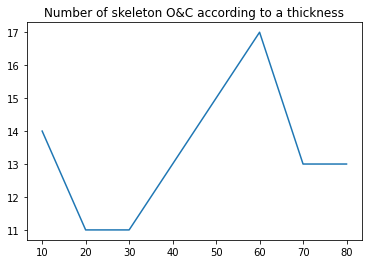

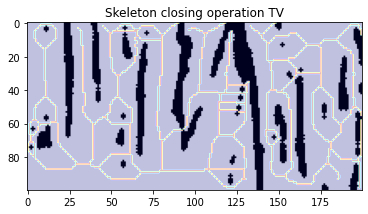

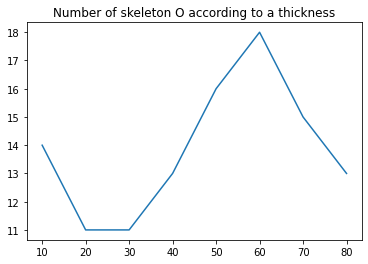

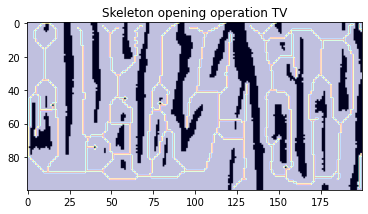

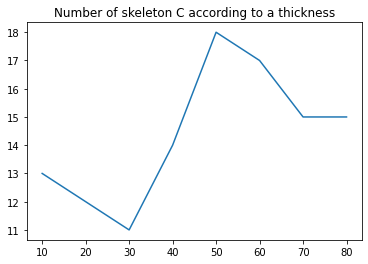

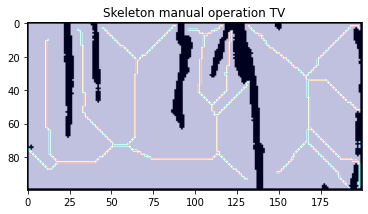

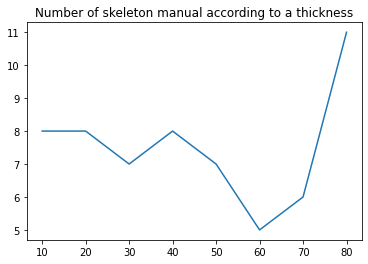

[8, 8, 7, 8, 7, 5, 6, 11]

In [ ]:

a,b=skeleton.shape
print(a,b)
x=1
zoom_tv=cropping(binarized_image_new_threshold_tv,crop_x_min,crop_x_max,crop_y_min,crop_y_max)
plt.imshow(zoom_tv, cmap='gray')
plt.title('Zoom tv of Binarized Image with New Threshold')
plt.show()

##################################### original
#counting(True,True,zoom_tv,'Skeleton original, without ope tv', 'Number of skeleton original according to a thickness')
##################################### closing then opening
cleaned_image_tv = morphology.binary_closing(zoom_tv, morphology.disk(x))
cleaned_image_tv = morphology.binary_opening(cleaned_image_tv, morphology.disk(x))
counting(True,True,cleaned_image_tv,'Skeleton closing & opening operation TV', 'Number of skeleton C&O according to a thickness')
##################################### opening and closing
cleaned_image_tv = morphology.binary_opening(zoom_tv, morphology.disk(x))
cleaned_image_tv = morphology.binary_closing(cleaned_image_tv, morphology.disk(x))
counting(True,True,cleaned_image_tv,'Skeleton opening & closing operation TV', 'Number of skeleton O&C according to a thickness')
skeleton = morphology.skeletonize(cleaned_image_tv)
##################################### closing
cleaned_image_tv = morphology.binary_closing(zoom_tv, morphology.disk(x))
counting(True,True,cleaned_image_tv,'Skeleton closing operation TV', 'Number of skeleton O according to a thickness')
##################################### opening
cleaned_image_tv = morphology.binary_opening(zoom_tv, morphology.disk(x))
counting(True,True,cleaned_image_tv,'Skeleton opening operation TV', 'Number of skeleton C according to a thickness')
##################################### manually
disk_size=disk(x) # radius of x pixels
cleaned_image_tv=filled(zoom_tv,disk_size)
counting(True,True,cleaned_image_tv,'Skeleton manual operation TV', 'Number of skeleton manual according to a thickness')


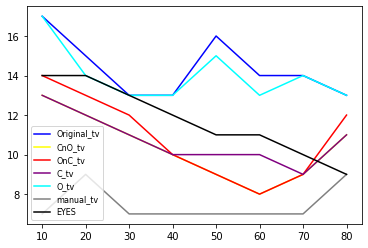

In [ ]:
EYES=[14,14,13,12,11,11,10,9]

Original_tv,CnO_tv,OnC_tv,C_tv,O_tv,manual_tv=[],[],[],[],[],[]

x=1
x_range=range(10,81,10)
##################################### original
Original_tv=counting(False,False, zoom_tv,'original', '')
plt.plot(x_range, Original_tv, label='Original_tv', color='blue')
##################################### closing then opening
cleaned_image_tv = morphology.binary_closing(zoom_tv, morphology.disk(x))
cleaned_image_tv = morphology.binary_opening(cleaned_image_tv, morphology.disk(x))
CnO_tv=counting(False,False,cleaned_image_tv,'Skeleton closing & opening ope', 'C&O')
plt.plot(x_range, CnO_tv, label='CnO_tv', color='yellow')
##################################### opening and closing
cleaned_image_tv = morphology.binary_opening(zoom_tv, morphology.disk(x))
cleaned_image_tv = morphology.binary_closing(cleaned_image_tv, morphology.disk(x))
OnC_tv=counting(False,False,cleaned_image_tv,'Skeleton opening & closing ope', 'O&C')
plt.plot(x_range, OnC_tv, label='OnC_tv', color='red')
##################################### closing
cleaned_image_tv = morphology.binary_closing(zoom_tv, morphology.disk(x))
C_tv=counting(False,False,cleaned_image_tv,'Skeleton closing ope', 'C')
plt.plot(x_range, C_tv, label='C_tv', color='purple')
##################################### opening
cleaned_image_tv = morphology.binary_opening(zoom_tv, morphology.disk(x))
O_tv=counting(False,False,cleaned_image_tv,'Skeleton opening ope', 'O')
plt.plot(x_range, O_tv, label='O_tv', color='cyan')
##################################### manually
disk_size=disk(x) # radius of x pixels
filled_image_tv=filled(zoom_tv,disk_size)
cleaned_image_tv = morphology.binary_opening(filled_image_tv, morphology.disk(x))
manual_tv=counting(False,False,cleaned_image_tv,'Skeleton manual ope', ' manual')
plt.plot(x_range, manual_tv , label='manual_tv', color='grey')
##################################### eyes

plt.plot(x_range, EYES, label='EYES', color='black')
plt.legend(loc="best",fontsize= 8)

plt.show()

In [ ]:
rmse_original_tv = calculate_rmse(EYES, Original_tv)
print (rmse_original_tv,'rmse_original_tv')
rmse_CnO_tv = calculate_rmse(EYES, CnO_tv)
print (rmse_CnO_tv,'rmse_CnO_tv')
rmse_OnC_tv = calculate_rmse(EYES, OnC_tv)
print (rmse_OnC_tv,'rmse_OnC_tv')
rmse_C_tv = calculate_rmse(EYES, C_tv)
print (rmse_C_tv,'rmse_C_tv')
rmse_O_tv = calculate_rmse(EYES, O_tv)
print (rmse_O_tv,'rmse_O_tv')
rmse_manual_tv = calculate_rmse(EYES, manual_tv)
print (rmse_manual_tv,'rmse_manual_tv')

rmse_list_tv = {
    'Original_tv': rmse_original_tv,
    'CnO_tv': rmse_CnO_tv,
    'OnC_tv': rmse_OnC_tv,
    'C_tv': rmse_C_tv,
    'O_tv': rmse_O_tv,
    'manual_tv': rmse_manual_tv
}

best_fit_tv = min(rmse_list_tv, key=rmse_list_tv.get)
print(best_fit_tv)

3.1024184114977142 rmse_original_tv
1.9685019685029528 rmse_CnO_tv
1.9039432764659772 rmse_OnC_tv
1.5811388300841898 rmse_C_tv
2.7838821814150108 rmse_O_tv
4.69041575982343 rmse_manual_tv
C_tv


In [ ]:

rmse_original_tv_list_004.append(rmse_original_tv)
rmse_CnO_tv_list_004.append(rmse_CnO_tv)
rmse_OnC_tv_list_004.append(rmse_OnC_tv)
rmse_C_tv_list_004.append(rmse_C_tv)
rmse_O_tv_list_004.append(rmse_O_tv)
rmse_manual_tv_list_004.append(rmse_manual_tv)


# PLOTS of Measurements

## DATA for all filters - Order of SEM image used, and the location of the sample

In [40]:
Image=["Sexy\image\VA248 AD01 BSE x1000 site 1.tif"*3,"Sexy\image\VA248 AD01 BSE x1000 site 2.tif"*3,"Sexy\image\VA248 AD01 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD12 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD09 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD02 BSE x1000 site 3"*3]
Zone=["1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200"]
Type=["Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Random","Random","Random","Random","Random","Random","Random","Random","Random"]
Threshold=[210,210,210,208,208,208,221,221,221,217,217,217,227,227,227,219,219,219]

#for the following line, I'm not sure if it's correct, please refer to the one given at the beginning of that methodo section EYES_new=[[15,14,15,13,15,15,14,16],[10,10,10,11,12,12,14,13],[15,15,13,12,13,15,16,14],[11,11,7,12,16,17,12,9],[9,9,8,9,9,10,10,10],[13,12,12,13,13,10,10,10],[10,10,10,10,11,11,12,12],[8,9,8,8,10,11,11,12],[10,10,9,10,11,10,10,11],[13,14,13,15,16,14,14,14],[9,9,10,10,12,11,13,11],[10,11,11,11,11,11,10,9],[16,13,12,12,11,10,11,11],[7,5,5,5,4,5,5,6],[8,8,8,7,8,8,8,8],[9,10,10,10,12,12,11,10],[7,7,8,10,8,11,14,16],[14,14,13,12,11,11,10,9]]

### Plotting results for: NO FILTER

In [ ]:
rmse_original_original_list=[16.974245196767956, 8.782084035125148, 9.260129588726068, 10.142731387550397, 3.872983346207417, 9.360822613424528, 10.386289038920495, 4.031128874149275, 9.130991183874837, 9.300537618869138, 12.96148139681572, 10.179636535751166, 12.06751838614717, 10.313825672368134, 9.387491677759293, 16.796577032240826, 15.81534065393471, 17.175564037317667]
rmse_CnO_original_list=[2.449489742783178, 1.4577379737113252, 2.3717082451262845, 2.715695122800054, 0.7905694150420949, 1.1726039399558574, 2.7613402542968153, 1.541103500742244, 1.7677669529663689, 1.695582495781317, 3.3726843908080104, 1.5811388300841898, 1.695582495781317, 1.4577379737113252, 0.5, 1.620185174601965, 2.449489742783178, 2.1213203435596424]
rmse_OnC_original_list=[16.974245196767956, 8.782084035125148, 9.260129588726068, 10.142731387550397, 3.872983346207417, 9.360822613424528, 10.386289038920495, 4.031128874149275, 9.130991183874837, 9.300537618869138, 12.96148139681572, 10.179636535751166, 12.06751838614717, 10.313825672368134, 9.387491677759293, 16.796577032240826, 15.81534065393471, 17.175564037317667]
rmse_C_original_list=[2.5248762345905194, 1.3228756555322954, 1.8371173070873836, 3.0618621784789726, 1.0606601717798212, 1.1726039399558574, 3.1024184114977142, 1.7320508075688772, 1.7320508075688772, 1.8708286933869707, 4.123105625617661, 1.695582495781317, 2.0, 2.29128784747792, 0.5, 2.179449471770337, 4.344536799245692, 1.6583123951777]
rmse_O_original_list=[12.05197079319395, 6.363961030678928, 6.910137480542627, 9.0, 3.7080992435478315, 8.536685539481937, 7.99218368157289, 3.142451272494134, 8.314144574157945, 8.595056718835542, 8.139410298049853, 8.038967595406763, 10.04987562112089, 8.760707733967616, 8.0, 13.587678241701193, 10.606601717798213, 14.675660121439172]
rmse_manual_original_list=[10.099504938362077, 4.227883631321941, 5.841660722773962, 8.477912478906585, 2.1505813167606567, 3.8078865529319543, 3.5, 1.4142135623730951, 4.183300132670378, 7.424621202458749, 3.856812155135378, 5.1478150704935, 5.2796780204857185, 1.4142135623730951, 2.179449471770337, 5.196152422706632, 4.198213905936666, 6.373774391990981]

Image=["Sexy\image\VA248 AD01 BSE x1000 site 1.tif"*3,"Sexy\image\VA248 AD01 BSE x1000 site 2.tif"*3,"Sexy\image\VA248 AD01 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD12 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD09 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD02 BSE x1000 site 3.tif"*3]
Zone=["1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200"]
Type=["Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Random","Random","Random","Random","Random","Random"]
Threshold=[210,210,210,227,227,227,219,219,219, 215,215,215,226,226,226, 219,219,219   ]

EYES_new=[[15,14,15,13,15,15,14,16],[10,10,10,11,12,12,14,13],[15,15,13,12,13,15,16,14],[11,11,7,12,16,17,12,9],[9,9,8,9,9,10,10,10],[13,12,12,13,13,10,10,10],[10,10,10,10,11,11,12,12],[8,9,8,8,10,11,11,12],[10,10,9,10,11,10,10,11],[13,14,13,15,16,14,14,14],[9,9,10,10,12,11,13,11],[10,11,11,11,11,11,10,9],[16,13,12,12,11,10,11,11],[7,5,5,5,4,5,5,6],[8,8,8,7,8,8,8,8],[9,10,10,10,12,12,11,10],[7,7,8,10,8,11,14,16],[14,14,13,12,11,11,10,9]]

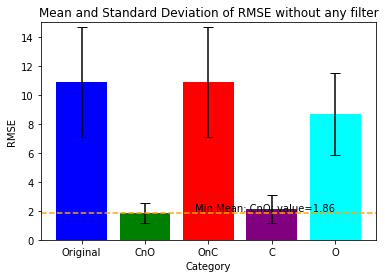

[10.885521015330552, 1.8623186996963983, 10.885521015330552, 2.1227566023621063, 8.692977314666082]
[3.7756366648284496, 0.7050154881553273, 3.7756366648284496, 0.9758266959155296, 2.81640647043371]


In [43]:
begin = 0  # 0 for Bottom     #1 for Top topcoat     #2 for middle topcoat
end = 18
step = 1  # 1 all       #3 for certain thickness
data = [
    rmse_original_original_list[begin:end:step], 
    rmse_CnO_original_list[begin:end:step], 
    rmse_OnC_original_list[begin:end:step], 
    rmse_C_original_list[begin:end:step], 
    rmse_O_original_list[begin:end:step]
]
labels = ['Original', 'CnO', 'OnC', 'C', 'O']  # Removed 'Manual'

# Calculate means and standard deviations
means = [np.mean(d) for d in data]
std_devs = [np.std(d) for d in data]

# Find the minimum mean value and corresponding label
min_mean_value = min(means)
min_mean_label = labels[means.index(min_mean_value)]

# Plotting
fig, ax = plt.subplots()

# Bar graph with error bars
ax.bar(labels, means, yerr=std_devs, capsize=5, color=['blue', 'green', 'red', 'purple', 'cyan'])

# Add horizontal line for the minimum mean value
ax.axhline(y=min_mean_value, color='orange', linestyle='--')

# Annotate the line with the name of the list that has the minimum mean value
ax.text(len(labels) - 1, min_mean_value + 0.1, f'Min Mean: {min_mean_label}; value={min_mean_value:.2f}', color='black', ha='right')

# Title and labels
ax.set_title('Mean and Standard Deviation of RMSE without any filter')
ax.set_xlabel('Category')
ax.set_ylabel('RMSE')
plt.ylim(0, 15)

# Show plot
plt.show()

print(means)
print(std_devs)


### Plotting results for: GAUSSIAN FILTER

In [59]:
rmse_original_gaussian_new=[4.046603514059662, 1.4142135623730951, 3.570714214271425, 3.570714214271425, 0.5, 2.9154759474226504, 4.636809247747852, 0.7905694150420949, 2.0, 2.8284271247461903, 4.315669125408017, 2.3979157616563596, 2.6457513110645907, 2.1505813167606567, 1.8708286933869707, 4.58257569495584, 3.840572873934304, 2.806243040080456]
rmse_CnO_gaussian_new=[1.620185174601965, 1.4142135623730951, 1.3693063937629153, 1.3693063937629153, 1.4577379737113252, 1.0, 2.8284271247461903, 1.1726039399558574, 1.8371173070873836, 1.3228756555322954, 2.207940216581962, 1.0, 1.2747548783981961, 1.6583123951777, 0.6123724356957945, 1.541103500742244, 3.3166247903554, 1.118033988749895]
rmse_OnC_gaussian_new=[4.046603514059662, 1.4142135623730951, 3.570714214271425, 3.570714214271425, 0.5, 2.9154759474226504, 4.636809247747852, 0.7905694150420949, 2.0, 2.8284271247461903, 4.315669125408017, 2.3979157616563596, 2.6457513110645907, 2.1505813167606567, 1.8708286933869707, 4.58257569495584, 3.840572873934304, 2.806243040080456]
rmse_C_gaussian_new=[1.5811388300841898, 1.0, 1.5811388300841898, 1.5811388300841898, 1.4577379737113252, 1.0606601717798212, 3.0618621784789726, 1.1726039399558574, 1.8708286933869707, 1.3228756555322954, 2.669269563007828, 0.8660254037844386, 1.2747548783981961, 1.9364916731037085, 0.6123724356957945, 1.5811388300841898, 3.1622776601683795, 1.118033988749895]
rmse_O_gaussian_new=[3.5355339059327378, 1.620185174601965, 2.958039891549808, 2.958039891549808, 0.5, 2.5, 4.168333000133266, 1.118033988749895, 1.9039432764659772, 2.8284271247461903, 3.181980515339464, 2.0615528128088303, 1.8708286933869707, 1.7320508075688772, 1.8708286933869707, 4.272001872658765, 3.3166247903554, 2.7386127875258306]
rmse_manual_gaussian_new=[7.0089228844380935, 2.03100960115899, 7.558108228915487, 7.558108228915487, 2.207940216581962, 2.7838821814150108, 1.9039432764659772, 1.1726039399558574, 3.9370039370059056, 7.566372975210778, 4.123105625617661, 5.123475382979799, 5.303300858899107, 0.7905694150420949, 2.091650066335189, 4.703721930556695, 3.968626966596886, 5.326818938165629]

Image=["Sexy\image\VA248 AD01 BSE x1000 site 1.tif"*3,"Sexy\image\VA248 AD01 BSE x1000 site 2.tif"*3,"Sexy\image\VA248 AD01 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD12 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD09 BSE x1000 site 3.tif"*3,"Random\image\VA248 AD02 BSE x1000 site 3.tif"*3]
Zone=["1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200","1000:1200,1000:1100","300:400,1000:1200","600:700,1000:1200"]
Type=["Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Sexy","Random","Random","Random","Random","Random","Random","Random","Random","Random"]
Threshold=[210,210,210,208,208,208,221,221,221,217,217,217,227,227,227,219,219,219]
EYES_new=[[15,14,15,13,15,15,14,16],[10,10,10,11,12,12,14,13],[15,15,13,12,13,15,16,14],[11,11,7,12,16,17,12,9],[9,9,8,9,9,10,10,10],[13,12,12,13,13,10,10,10],[10,10,10,10,11,11,12,12],[8,9,8,8,10,11,11,12],[10,10,9,10,11,10,10,11],[13,14,13,15,16,14,14,14],[9,9,10,10,12,11,13,11],[10,11,11,11,11,11,10,9],[16,13,12,12,11,10,11,11],[7,5,5,5,4,5,5,6],[8,8,8,7,8,8,8,8],[9,10,10,10,12,12,11,10],[7,7,8,10,8,11,14,16],[14,14,13,12,11,11,10,9]]

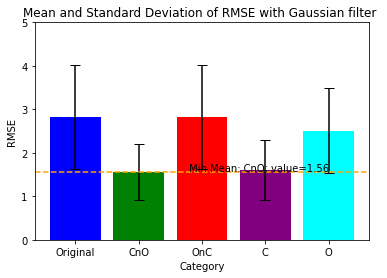

[2.8268702809545325, 1.5622730961797293, 2.8268702809545325, 1.606130529782791, 2.507500957042264]
[1.2026239705976434, 0.6375931266687428, 1.2026239705976434, 0.6948702909893693, 0.9810397292832379]


In [60]:
begin = 0  # 0 for Bottom     #1 for Top topcoat     #2 for middle topcoat
end = 18
step = 1  # 1 all       #3 for certain thickness
data = [
    rmse_original_gaussian_new[begin:end:step], 
    rmse_CnO_gaussian_new[begin:end:step], 
    rmse_OnC_gaussian_new[begin:end:step], 
    rmse_C_gaussian_new[begin:end:step], 
    rmse_O_gaussian_new[begin:end:step]
]
labels = ['Original', 'CnO', 'OnC', 'C', 'O']  # Removed 'Manual'

# Calculate means and standard deviations
means = [np.mean(d) for d in data]
std_devs = [np.std(d) for d in data]

# Find the minimum mean value and corresponding label
min_mean_value = min(means)
min_mean_label = labels[means.index(min_mean_value)]

# Plotting
fig, ax = plt.subplots()

# Bar graph with error bars
ax.bar(labels, means, yerr=std_devs, capsize=5, color=['blue', 'green', 'red', 'purple', 'cyan'])

# Add horizontal line for the minimum mean value
ax.axhline(y=min_mean_value, color='orange', linestyle='--')

# Annotate the line with the name of the list that has the minimum mean value
ax.text(len(labels) - 1, min_mean_value + 0.02, f'Min Mean: {min_mean_label}; value={min_mean_value:.2f}', color='black', ha='right')

# Title and labels
ax.set_title('Mean and Standard Deviation of RMSE with Gaussian filter ')
ax.set_xlabel('Category')
ax.set_ylabel('RMSE')
plt.ylim(0, 5)

# Show plot
plt.show()

print(means)
print(std_devs)


### Plotting results for: TV FILTER

In [61]:
rmse_original_tv_list_004=[2.979093821953246, 1.1726039399558574, 1.2747548783981961, 3.082207001484488, 0.6123724356957945, 1.118033988749895, 1.7320508075688772, 1.541103500742244, 1.8027756377319946, 1.4577379737113252, 1.3693063937629153, 1.3693063937629153, 2.598076211353316, 1.7677669529663689, 1.7677669529663689, 5.220153254455275, 3.1622776601683795, 3.1024184114977142]
rmse_CnO_tv_list_004=[1.1726039399558574, 1.0606601717798212, 2.23606797749979, 2.091650066335189, 1.0606601717798212, 0.5, 0.7905694150420949, 1.7320508075688772, 1.8371173070873836, 1.620185174601965, 1.1726039399558574, 1.1726039399558574, 1.5811388300841898, 1.8027756377319946, 0.6123724356957945, 3.570714214271425, 2.8284271247461903, 1.9685019685029528]
rmse_OnC_tv_list_004=[1.1726039399558574, 1.0606601717798212, 2.23606797749979, 2.091650066335189, 1.0606601717798212, 0.5, 0.8660254037844386, 1.7320508075688772, 1.8371173070873836, 1.5811388300841898, 1.3693063937629153, 1.3693063937629153, 1.5811388300841898, 1.695582495781317, 0.6123724356957945, 3.2210246816812815, 2.5495097567963922, 1.9039432764659772]
rmse_C_tv_list_004=[1.1726039399558574, 1.0606601717798212, 2.0615528128088303, 2.179449471770337, 1.0606601717798212, 0.6123724356957945, 0.9354143466934853, 1.7320508075688772, 1.8371173070873836, 1.620185174601965, 0.9354143466934853, 0.9354143466934853, 1.5811388300841898, 1.8371173070873836, 0.6123724356957945, 3.758324094593227, 2.23606797749979, 1.5811388300841898]
rmse_O_tv_list_004=[2.806243040080456, 1.1726039399558574, 1.224744871391589, 3.0, 0.6123724356957945, 1.1726039399558574, 1.5811388300841898, 1.5811388300841898, 1.8027756377319946, 1.4577379737113252, 1.2747548783981961, 1.2747548783981961, 2.345207879911715, 1.620185174601965, 1.7677669529663689, 4.168333000133266, 2.715695122800054, 2.7838821814150108]
rmse_manual_tv_list_004=[7.14142842854285, 2.0, 4.47213595499958, 7.516648189186454, 2.207940216581962, 2.7838821814150108, 2.4238399287081647, 1.3693063937629153, 3.570714214271425, 7.721722605740251, 5.2796780204857185, 5.2796780204857185, 5.1599418601375735, 1.0606601717798212, 2.179449471770337, 4.58257569495584, 3.724916106437835, 4.69041575982343]

means [2.0627670120513986, 1.600594617921948, 1.580008829994786, 1.541614156009651, 1.9089966426286682]
std_devs [1.0745764171127004, 0.7550108035808086, 0.664132590028909, 0.7349098316510115, 0.858880819949379]


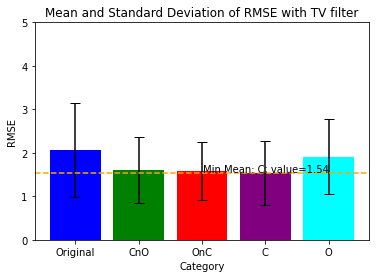

[2.0627670120513986, 1.600594617921948, 1.580008829994786, 1.541614156009651, 1.9089966426286682]
[1.0745764171127004, 0.7550108035808086, 0.664132590028909, 0.7349098316510115, 0.858880819949379]


In [62]:
begin = 0  # 0 for Bottom     #1 for Top topcoat     #2 for middle topcoat
end = 18
step = 1  # 1 all       #3 for certain thickness
data = [
    rmse_original_tv_list_004[begin:end:step], 
    rmse_CnO_tv_list_004[begin:end:step], 
    rmse_OnC_tv_list_004[begin:end:step], 
    rmse_C_tv_list_004[begin:end:step], 
    rmse_O_tv_list_004[begin:end:step]
]
labels = ['Original', 'CnO', 'OnC', 'C', 'O']  # Removed 'Manual'

# Calculate means and standard deviations
means = [np.mean(d) for d in data]
std_devs = [np.std(d) for d in data]

print("means",means)
print("std_devs",std_devs)
# Find the minimum mean value and corresponding label
min_mean_value = min(means)
min_mean_label = labels[means.index(min_mean_value)]

# Plotting
fig, ax = plt.subplots()

# Bar graph with error bars
ax.bar(labels, means, yerr=std_devs, capsize=5, color=['blue', 'green', 'red', 'purple', 'cyan'])

# Add horizontal line for the minimum mean value
ax.axhline(y=min_mean_value, color='orange', linestyle='--')

# Annotate the line with the name of the list that has the minimum mean value
ax.text(len(labels) - 1, min_mean_value + 0.02, f'Min Mean: {min_mean_label}; value={min_mean_value:.2f}', color='black', ha='right')

# Title and labels
ax.set_title('Mean and Standard Deviation of RMSE with TV filter')
ax.set_xlabel('Category')
ax.set_ylabel('RMSE')
plt.ylim(0, 5)

# Show plot
plt.show()
print(means)
print(std_devs)

# =========================================================================================================

# Code to get ORIENTATION (mean & stds) 1 file

# I think I did a mistake here, because the tv filter (denoise_tv_chambolle) is applied onAFTER the binarisation step on the zoomed/sample image, and not BEFORE on the whole topcoat...  11/09

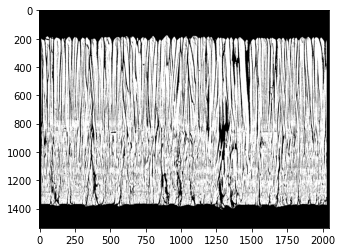

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, feature, measure
from skimage.io import imread
from skimage.morphology import skeletonize
from scipy.ndimage import label
from skimage.restoration import denoise_tv_chambolle


image_path = r"C:\Users\chris\Desktop\Original_Images\Batchs\Sexy\image\VA248 AD01 BSE x1000 site 1.tif"
image = mpimg.imread(image_path)
normalized_image=normalisation(image)
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
new_threshold = max(mu1,mu2)- min(stds)
binarized_image = binarisation(cropped_image,new_threshold)
filled_image=filled(binarized_image,disk_size)
only_top_coat_image=np.where(filled_image==True,cropped_image,0)
binarised_only_top_coat_image=binarisation(only_top_coat_image,new_threshold)

plt.imshow(binarised_only_top_coat_image, cmap='gray')
plt.show()

skeletonisation done


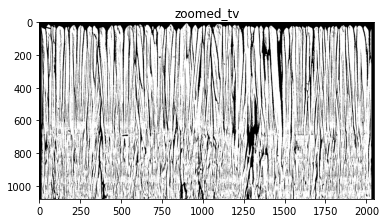

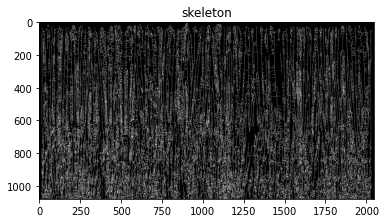

will begin function


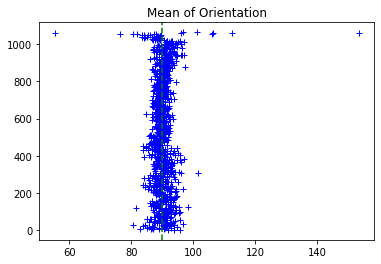

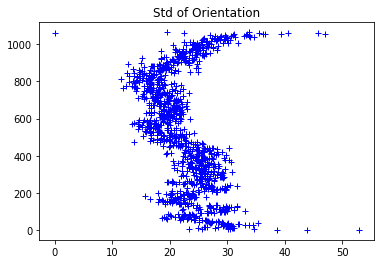

[91.93, 95.77, 93.72, 90.52, 88.76, 82.92, 86.86, 86.42, 88.86, 88.81, 90.88, 85.02, 92.94, 86.71, 90.54, 94.6, 87.18, 85.67, 87.13, 86.81, 83.64, 90.35, 91.58, 92.8, 92.08, 84.53, 90.29, 80.65, 91.46, 93.8, 91.41, 90.75, 96.59, 92.35, 92.57, 92.88, 88.19, 89.57, 91.55, 87.71, 89.07, 91.3, 93.59, 92.47, 85.84, 87.35, 89.68, 90.02, 87.48, 94.09, 89.02, 89.64, 88.47, 89.34, 95.58, 89.15, 91.53, 90.46, 86.24, 85.12, 84.91, 86.09, 92.31, 90.7, 89.26, 89.24, 89.71, 90.27, 90.84, 92.95, 87.21, 87.53, 89.62, 89.87, 90.66, 88.63, 88.41, 91.6, 90.6, 91.14, 88.92, 88.94, 90.11, 88.39, 91.93, 90.77, 90.61, 88.64, 93.84, 94.22, 95.44, 90.71, 88.47, 89.53, 95.81, 91.2, 87.15, 91.01, 92.93, 90.78, 89.6, 92.05, 90.56, 92.53, 88.98, 86.9, 89.43, 91.88, 94.56, 92.76, 91.01, 92.62, 89.5, 91.07, 91.97, 91.32, 89.68, 92.17, 89.82, 88.01, 81.61, 87.64, 87.88, 93.4, 98.18, 95.52, 88.83, 92.62, 89.07, 93.94, 86.44, 86.19, 89.09, 87.09, 87.12, 92.42, 93.37, 89.58, 87.28, 91.74, 89.74, 90.04, 91.21, 89.72, 85.

In [54]:
#Image used: zoomed_...
zoomed_binarised_only_top_coat_image=binarised_only_top_coat_image[170:1250,:]

#Filter step
zoomed_tv = denoise_tv_chambolle(zoomed_binarised_only_top_coat_image, weight=0.04)
zoomed_tv=zoomed_tv*255
zoomed_tv=np.where(zoomed_tv>100,1,0)

#Skeletoned=f(x) where x is an binarised image (0 and 1)
skeleton = morphology.skeletonize(zoomed_tv)
skeleton=np.where(skeleton==True, 1 , 0)
print('skeletonisation done')

#show
#if thickness==1:
#########print("image_tv",image_tv)
plt.imshow(zoomed_tv, cmap='gray')
plt.title('zoomed_tv')
plt.show()
#print(skeleton)
plt.imshow(skeleton, cmap='gray')
plt.title('skeleton')
plt.show()
print('will begin function')

thicknesses = range(1,zoomed_tv.shape[0]-1,1)
mean_orientations = []
stds=[]

for thickness in thicknesses:
    mean_orientation = compute_orientation_tv_horizontal_is_none(skeleton, thickness)

    if mean_orientation!=None:
        mean_orientation=round(mean_orientation,2)
        mean_orientations.append(mean_orientation)
        std_thickness=compute_standard_deviation_tv_horizontal_is_none(skeleton, thickness)
        std_thickness=round(std_thickness,2)
        stds.append(std_thickness)
               

plt.title('Mean of Orientation')
plt.plot(mean_orientations[::-1],range(len(mean_orientations[::-1])),marker='+', linestyle='None', color='blue')
#plt.xlim(70,110)
plt.axvline(x=90, color='green', linestyle='--')
plt.show()
plt.title('Std of Orientation')
plt.plot(stds[::-1],range(len(mean_orientations[::-1])),marker='+', linestyle='None', color='blue')
plt.show()

print(mean_orientations[::-1])
print(len(mean_orientations))
print('mean_orientations',mean_orientations)
print('stds',stds)
mean_orientations_no_none=[x for x in mean_orientations if x is not None]
mean_orientation_image=np.mean(mean_orientations_no_none)
print('mean avg image', mean_orientation_image)

# Code to get NB Columns (mean) 1 file

(1536, 2048)
thickness_bottom_section beginning 1536
thickness_top_section 0
thickness_top_section 224
thickness_bottom_section loop for 1363


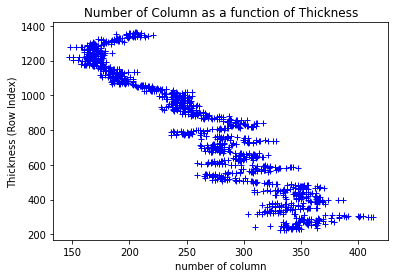

In [55]:
x=1
#all_cleaned_image_gaussian = morphology.binary_opening(binarized_image_new_threshold_gaussian, morphology.disk(x))
#all_cleaned_image_gaussian = morphology.binary_closing(all_cleaned_image_gaussian, morphology.disk(x))


y1=0
y2=1600
zoomed_binarised_only_top_coat_image=binarised_only_top_coat_image[:,:]

#Filter step
zoomed_tv = denoise_tv_chambolle(zoomed_binarised_only_top_coat_image, weight=0.04)
zoomed_tv=zoomed_tv*255
zoomed_tv=np.where(zoomed_tv>100,1,0)


thickness_top_section=0
thickness_bottom_section,b=zoomed_tv.shape
print(zoomed_tv.shape)
print('thickness_bottom_section beginning',thickness_bottom_section)

#plt.imshow(filled_image, cmap='gray')
#plt.show()

print('thickness_top_section',thickness_top_section)
while np.any(filled_image[thickness_top_section,framing_side+100:b-(framing_side+100)] !=1 ):
    thickness_top_section=thickness_top_section+1
print('thickness_top_section',thickness_top_section)

while np.any(filled_image[thickness_bottom_section-1,framing_side+100:b-(framing_side+100)] !=1 ):
    thickness_bottom_section=thickness_bottom_section-1 
print('thickness_bottom_section loop for',thickness_bottom_section)


intersection_skeleton=counting_gene(False,False,zoomed_tv,'title', 'title',thickness_top_section,thickness_bottom_section,1)

plt.plot(intersection_skeleton, range(thickness_bottom_section,thickness_top_section,-1),marker='+', linestyle='None', color='blue')

plt.xlabel('number of column')
plt.ylabel('Thickness (Row Index)')
plt.title('Number of Column as a function of Thickness')
#plt.gca().invert_yaxis()
plt.show()

# Code to get diameter Columns (mean) 1 file

(1536, 2048)
thickness_bottom_section beginning 1536
thickness_top_section 0
thickness_top_section 224
thickness_bottom_section loop for 1363


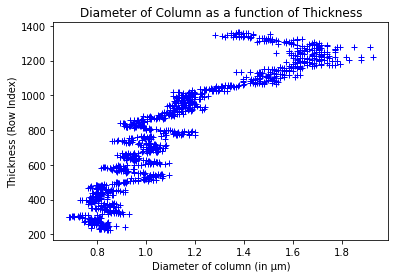

In [56]:
x=1
#all_cleaned_image_gaussian = morphology.binary_opening(binarized_image_new_threshold_gaussian, morphology.disk(x))
#all_cleaned_image_gaussian = morphology.binary_closing(all_cleaned_image_gaussian, morphology.disk(x))


y1=0
y2=1550
zoomed_binarised_only_top_coat_image=binarised_only_top_coat_image[y1:y2,:]

range_vertical_manual=y2-y1
#Filter step
zoomed_tv = denoise_tv_chambolle(zoomed_binarised_only_top_coat_image, weight=0.01)
zoomed_tv=zoomed_tv*255
zoomed_tv=np.where(zoomed_tv>100,1,0)


thickness_top_section=0
thickness_bottom_section,b=zoomed_tv.shape
print(zoomed_tv.shape)
print('thickness_bottom_section beginning',thickness_bottom_section)
print('thickness_top_section',thickness_top_section)

while np.any(filled_image[thickness_top_section,framing_side+100:b-(framing_side+100)] !=1 ):
    thickness_top_section=thickness_top_section+1
print('thickness_top_section',thickness_top_section)

while np.any(filled_image[thickness_bottom_section-1,framing_side+100:b-(framing_side+100)] !=1 ):
    thickness_bottom_section=thickness_bottom_section-1 
print('thickness_bottom_section loop for',thickness_bottom_section)


intersection_skeleton=counting_gene(False,False,zoomed_tv,'title', 'title',thickness_top_section,thickness_bottom_section,1)

Diameter_column=[283/x for x in intersection_skeleton]
plt.plot(Diameter_column, range(thickness_bottom_section,thickness_top_section,-1),marker='+', linestyle='None', color='blue')

plt.xlabel('Diameter of column (in µm)')
plt.ylabel('Thickness (Row Index)')
plt.title('Diameter of Column as a function of Thickness')
plt.show()

#### =============================================================================

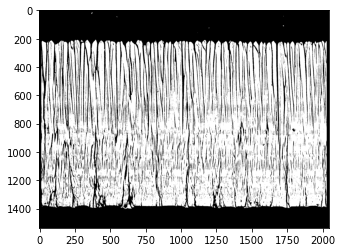

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, feature, measure
from skimage.io import imread
from skimage.morphology import skeletonize
from scipy.ndimage import label
from skimage.restoration import denoise_tv_chambolle


image_path = r"C:\Users\chris\Desktop\Original_Images\Batchs\Sexy\image\VA248 AD01 BSE x1000 site 3.tif"
image = mpimg.imread(image_path)
normalized_image=normalisation(image)
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
new_threshold = max(mu1,mu2)- min(stds)
binarized_image = binarisation(cropped_image,new_threshold)
filled_image=filled(binarized_image,disk_size)
only_top_coat_image=np.where(filled_image==True,cropped_image,0)
binarised_only_top_coat_image=binarisation(only_top_coat_image,new_threshold)

plt.imshow(binarised_only_top_coat_image, cmap='gray')
plt.show()

# =============================================================================

#### Model fitting (inaccurate and might not work as well)

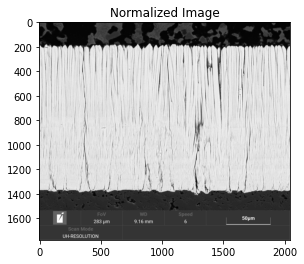

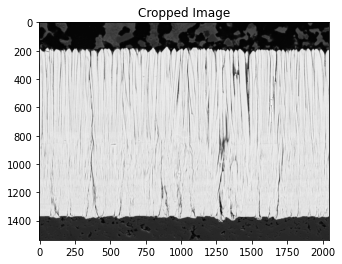

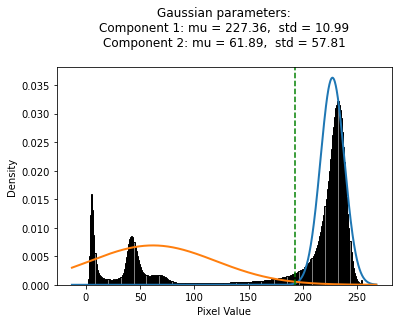

Threshold: 192.51604827110393 intensity


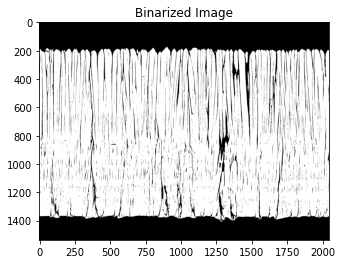

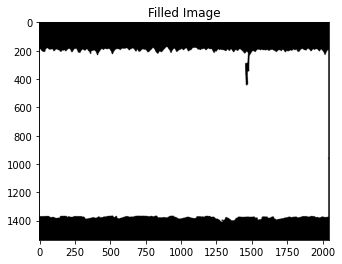

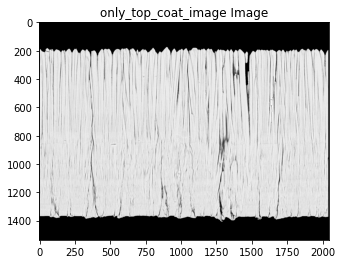

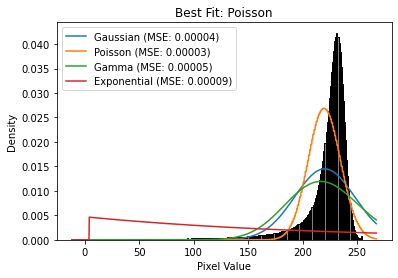

Best fit distribution: Poisson
MSE values for each distribution: {'Gaussian': 3.9465627418563016e-05, 'Poisson': 2.8784359683352798e-05, 'Gamma': 4.7307849877829956e-05, 'Exponential': 9.138749628158549e-05}


In [318]:

normalized_image=normalisation(image)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Remove text part
cropped_image=cropping(normalized_image,0,x_max,0,y_text)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.show()

mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
print('Threshold:',threshold ,'intensity')

binarized_image = binarisation(cropped_image,threshold)
plt.imshow(binarized_image, cmap='gray')
plt.title('Binarized Image')
plt.show()

disk_size=disk(5)
filled_image=filled(binarized_image,disk_size)
plt.imshow(filled_image, cmap='gray')
plt.title('Filled Image')
plt.show()

only_top_coat_image=np.where(filled_image==True,cropped_image,0)
plt.imshow(only_top_coat_image, cmap='gray')
plt.title('only_top_coat_image Image')
plt.show()


best_fit, mse_values = histogram_best_fit(only_top_coat_image)
print(f'Best fit distribution: {best_fit}')
print('MSE values for each distribution:', mse_values)





# ===================================================================================================================================

# FOLDER

# ===================================================================================================================================

# Folder Porosity calculation

#### Use of the function which take a ROI equal to the shape of the coating

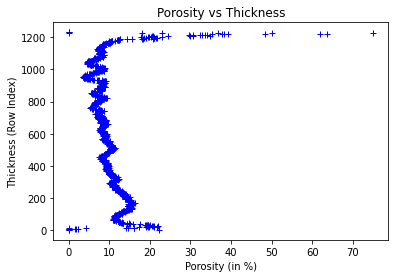

counter= 1232
Porosiy of all the top_coat in %:


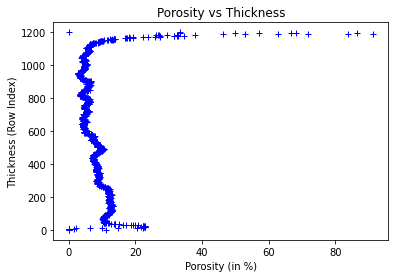

counter= 1200
Porosiy of all the top_coat in %:


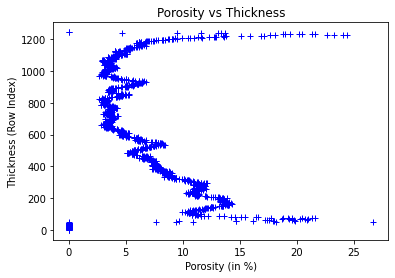

counter= 1243
Porosiy of all the top_coat in %:


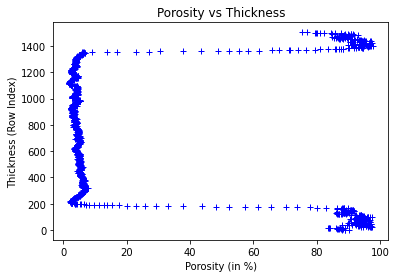

counter= 1504
Porosiy of all the top_coat in %:


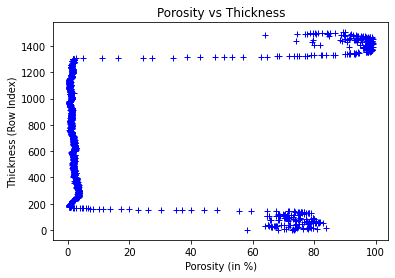

counter= 1504
Porosiy of all the top_coat in %:


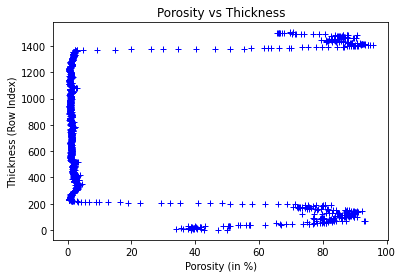

counter= 1504
Porosiy of all the top_coat in %:


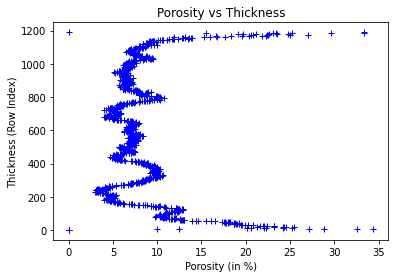

counter= 1190
Porosiy of all the top_coat in %:


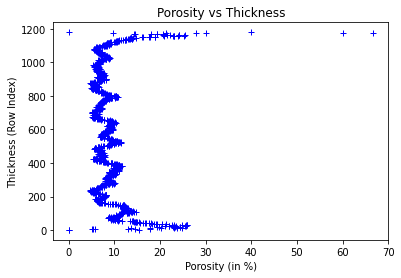

counter= 1180
Porosiy of all the top_coat in %:


KeyboardInterrupt: 

In [75]:
folder_name=r"C:\Users\chris\Desktop\Original_Images\7ysz Cross-section AD image"

Porosities=[]
for SEM_image in os.listdir(folder_name):
    a=os.path.join(folder_name, SEM_image)
    image = mpimg.imread(a)
    #plt.imshow(image, cmap='gray')
    #plt.show()
    cropped_image=cropping(normalisation(image),0,x_max,0,y_text)
    mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
    threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
    
    #binarized_image=binarisation(cropped_image, threshold)
    #plt.imshow(binarized_image, cmap='gray')
    #plt.show()
    
    porosity=get_porosity_max(cropped_image,threshold)
    Porosities.append(porosity)
    
print(Porosities)
print('Mean:', np.mean(Porosities))
print('Median:', np.median(Porosities))
print('Std dev:', np.std(Porosities))
plt.plot(Porosities)

## Different type of plotting the results

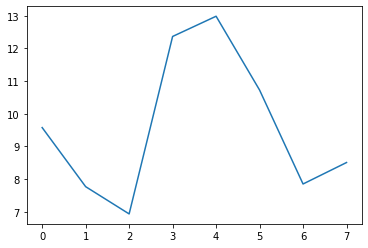

In [76]:
plt.plot(Porosities)

7.83176858267165
8.53673264644965
10.168620441328029
11.137694934556954


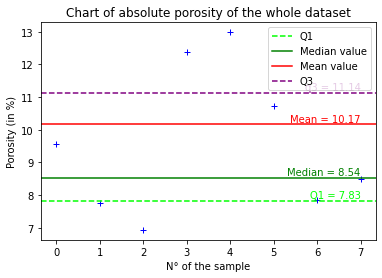

In [77]:
plt.plot(Porosities,marker='+', linestyle='None', color='blue')

Mean=10.168620441328029
Median=8.53673264644965
Std_dev=4.486293100577706

q1 = np.percentile(Porosities, 25)  # 25th percentile (Q1)
q3 = np.percentile(Porosities, 75)  # 75th percentile (Q3)
print(q1)
print(Median)
print(Mean)
print(q3)

plt.axhline(y=q1, color='lime', linestyle='--', label='Q1')
plt.axhline(y=Median, color='green', linestyle='-', label='Median value')
plt.axhline(y=Mean, color='red', linestyle='-', label='Mean value')
plt.axhline(y=q3, color='purple', linestyle='--', label='Q3')


plt.text(len(Porosities) -1, q1, f'Q1 = {q1:.2f}', color='lime', va='bottom', ha='right', fontsize=10)
plt.text(len(Porosities) - 1, Median, f'Median = {Median:.2f}', color='green', va='bottom', ha='right', fontsize=10)
plt.text(len(Porosities) -1, Mean, f'Mean = {Mean:.2f}', color='red', va='bottom', ha='right', fontsize=10)
plt.text(len(Porosities) - 1, q3, f'q3 = {q3:.2f}', color='purple', va='bottom', ha='right', fontsize=10)


plt.xlabel('N° of the sample')
plt.ylabel('Porosity (in %)')
plt.title('Chart of absolute porosity of the whole dataset')


plt.legend()
plt.show()

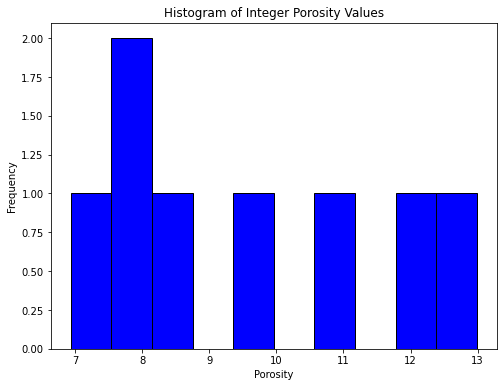

In [78]:
import matplotlib.pyplot as plt

# Assuming List_all_porosities is already defined
# Convert each value to an integer
#int_values = [int(value) for value in List_all_porosities]

# Plot the histogram
plt.figure(figsize=(8, 6))
min_value = int(min(Porosities))
max_value = int(max(Porosities))
bins = np.arange(min_value, max_value , 0.5)
plt.hist(Porosities, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Integer Porosity Values')
plt.xlabel('Porosity')
plt.ylabel('Frequency')
plt.show()


# Folder NB of Columns

In [57]:
# step=1 whole dataset (58 images) Listing_intersection_skeleton
Listing_intersection_skeleton=[[205, 206, 203, 210, 207, 207, 200, 201, 207, 205, 204, 197, 188, 197, 210, 213, 221, 209, 209, 207, 216, 202, 204, 200, 207, 209, 214, 205, 198, 203, 200, 199, 191, 189, 192, 191, 194, 190, 187, 188, 175, 173, 177, 175, 185, 189, 188, 190, 190, 191, 194, 184, 187, 180, 178, 179, 195, 187, 181, 168, 166, 169, 178, 178, 180, 169, 167, 170, 177, 178, 184, 175, 169, 168, 163, 165, 166, 163, 166, 173, 173, 171, 166, 159, 148, 153, 158, 166, 165, 166, 167, 168, 172, 175, 166, 171, 170, 166, 160, 160, 160, 166, 169, 172, 174, 166, 171, 175, 172, 179, 179, 174, 165, 163, 160, 164, 167, 168, 173, 174, 178, 185, 179, 172, 169, 174, 163, 164, 166, 165, 169, 176, 177, 178, 175, 169, 162, 167, 165, 168, 160, 147, 151, 156, 163, 165, 162, 171, 174, 173, 168, 177, 170, 165, 167, 175, 171, 169, 166, 151, 155, 164, 175, 172, 159, 161, 174, 166, 161, 170, 174, 176, 176, 180, 172, 168, 169, 163, 172, 175, 177, 177, 169, 158, 158, 165, 162, 161, 160, 165, 167, 171, 169, 169, 168, 174, 176, 179, 183, 175, 174, 178, 183, 179, 182, 173, 181, 175, 177, 174, 187, 189, 191, 186, 191, 186, 179, 180, 181, 181, 184, 181, 180, 177, 179, 185, 199, 207, 204, 194, 193, 188, 193, 195, 192, 186, 194, 192, 193, 189, 188, 185, 183, 182, 189, 193, 181, 174, 175, 179, 185, 190, 195, 189, 192, 189, 186, 181, 176, 190, 201, 193, 189, 188, 186, 183, 195, 196, 198, 203, 195, 194, 187, 187, 186, 197, 196, 189, 199, 203, 185, 187, 193, 190, 197, 196, 191, 184, 185, 203, 199, 195, 191, 187, 197, 194, 196, 185, 192, 191, 202, 212, 214, 210, 205, 203, 211, 210, 217, 220, 216, 209, 206, 207, 208, 211, 216, 220, 216, 217, 224, 219, 213, 221, 223, 229, 232, 232, 227, 225, 228, 229, 238, 227, 223, 218, 215, 220, 223, 219, 213, 222, 237, 255, 249, 250, 241, 246, 238, 230, 236, 239, 242, 237, 232, 232, 230, 231, 240, 239, 240, 244, 246, 248, 247, 243, 230, 226, 238, 255, 252, 236, 229, 241, 246, 247, 249, 251, 251, 242, 246, 250, 242, 233, 232, 238, 233, 237, 245, 240, 246, 241, 248, 254, 252, 241, 240, 238, 247, 247, 253, 244, 239, 242, 241, 247, 253, 250, 250, 244, 238, 235, 237, 236, 236, 246, 259, 254, 254, 243, 248, 240, 234, 245, 252, 256, 258, 261, 250, 246, 237, 228, 232, 242, 244, 249, 255, 241, 240, 247, 238, 241, 249, 251, 229, 230, 242, 254, 258, 258, 238, 239, 248, 254, 249, 244, 247, 249, 254, 258, 261, 264, 258, 262, 266, 258, 256, 259, 260, 249, 251, 254, 246, 257, 256, 264, 270, 259, 255, 267, 257, 254, 268, 278, 287, 269, 266, 277, 278, 282, 280, 274, 264, 269, 264, 263, 271, 288, 282, 272, 265, 278, 277, 288, 289, 294, 298, 293, 303, 294, 282, 282, 282, 286, 285, 287, 288, 286, 293, 292, 293, 312, 317, 311, 299, 293, 297, 301, 300, 301, 309, 309, 301, 292, 293, 291, 288, 295, 303, 304, 311, 289, 290, 296, 307, 308, 306, 307, 295, 284, 283, 286, 297, 285, 279, 278, 279, 280, 272, 277, 283, 278, 258, 262, 260, 268, 268, 264, 256, 254, 238, 245, 247, 239, 236, 242, 247, 250, 251, 254, 265, 263, 253, 255, 246, 249, 248, 247, 241, 241, 236, 248, 251, 252, 262, 278, 267, 267, 277, 285, 289, 294, 286, 275, 282, 280, 300, 304, 301, 280, 279, 285, 263, 277, 281, 279, 281, 284, 288, 301, 299, 288, 311, 319, 328, 313, 326, 314, 321, 311, 305, 305, 305, 300, 303, 308, 304, 291, 283, 278, 279, 273, 274, 293, 293, 283, 278, 281, 290, 289, 272, 262, 268, 263, 273, 275, 278, 274, 283, 287, 280, 272, 277, 269, 272, 279, 265, 268, 263, 272, 273, 275, 278, 276, 286, 283, 275, 275, 281, 277, 273, 270, 287, 279, 266, 283, 279, 288, 271, 271, 272, 279, 278, 282, 292, 298, 313, 297, 305, 299, 302, 298, 309, 308, 310, 296, 297, 309, 321, 305, 300, 293, 296, 311, 312, 310, 302, 317, 316, 312, 307, 306, 297, 307, 311, 299, 291, 302, 295, 302, 300, 292, 296, 299, 308, 283, 286, 295, 296, 281, 298, 297, 295, 274, 280, 272, 269, 272, 278, 271, 277, 278, 281, 271, 269, 259, 263, 268, 275, 278, 281, 284, 289, 292, 298, 289, 307, 319, 317, 318, 320, 323, 312, 319, 323, 327, 340, 343, 341, 347, 337, 331, 322, 311, 332, 330, 315, 308, 299, 298, 310, 312, 328, 319, 318, 318, 305, 310, 306, 315, 323, 312, 321, 306, 307, 297, 286, 297, 308, 293, 290, 297, 286, 284, 285, 275, 270, 267, 266, 268, 270, 278, 278, 273, 259, 265, 280, 273, 272, 275, 272, 272, 280, 280, 282, 285, 275, 279, 292, 301, 281, 266, 283, 280, 285, 284, 277, 287, 275, 275, 272, 285, 296, 292, 281, 293, 306, 307, 303, 299, 310, 308, 311, 312, 322, 321, 320, 318, 308, 311, 320, 320, 325, 329, 322, 328, 341, 347, 355, 356, 353, 338, 345, 350, 352, 364, 349, 351, 347, 352, 367, 351, 350, 343, 345, 354, 362, 366, 370, 347, 354, 356, 347, 335, 349, 340, 338, 309, 320, 327, 330, 334, 329, 332, 335, 323, 317, 309, 312, 336, 345, 356, 352, 363, 360, 351, 334, 345, 348, 344, 358, 354, 354, 348, 343, 334, 328, 327, 346, 347, 347, 350, 347, 363, 362, 356, 336, 354, 351, 363, 366, 367, 364, 354, 348, 354, 346, 348, 337, 346, 347, 350, 363, 368, 356, 364, 387, 382, 374, 368, 364, 365, 368, 358, 364, 364, 366, 364, 369, 359, 364, 352, 329, 325, 341, 364, 364, 371, 337, 327, 322, 336, 341, 347, 343, 343, 333, 316, 331, 351, 347, 325, 333, 327, 320, 336, 327, 331, 339, 352, 357, 364, 358, 363, 356, 349, 349, 338, 340, 355, 345, 336, 331, 342, 337, 342, 324, 327, 323, 322, 331, 319, 318, 313, 320, 334, 334, 332, 320, 326, 323, 330, 320, 320, 316, 304, 312, 334, 344, 345, 353, 353, 371, 377, 388, 383, 402, 400, 391, 388, 404, 411, 413, 409, 401, 389, 383, 383, 376, 365, 350, 346, 348, 352, 357, 366, 369, 359, 351, 352, 355, 366, 363, 353, 369, 376, 356, 357, 364, 349, 334, 352, 357, 347, 362, 379, 365, 355, 354, 346, 337, 355, 355, 336, 345, 362, 371, 364, 356, 359, 363, 348, 337, 337, 343, 342, 346, 333, 323, 334, 310, 347, 339, 338, 343, 339, 346, 364, 347, 348, 348, 348, 342, 341, 350, 346, 337, 335, 332], [122, 124, 126, 130, 132, 131, 129, 131, 138, 147, 138, 137, 142, 137, 129, 130, 132, 138, 140, 141, 142, 138, 139, 134, 140, 140, 136, 129, 127, 135, 135, 132, 132, 131, 127, 132, 130, 129, 125, 129, 133, 136, 134, 130, 127, 131, 132, 127, 125, 127, 124, 124, 125, 119, 120, 118, 117, 121, 117, 119, 121, 121, 118, 121, 124, 120, 113, 113, 115, 121, 122, 120, 115, 111, 115, 114, 117, 113, 118, 121, 126, 127, 123, 122, 120, 123, 124, 123, 125, 122, 123, 127, 125, 119, 118, 123, 125, 124, 125, 121, 119, 121, 124, 127, 129, 131, 131, 131, 125, 126, 128, 134, 133, 129, 127, 127, 121, 125, 127, 129, 134, 128, 127, 133, 127, 128, 132, 138, 139, 141, 139, 135, 138, 139, 140, 136, 137, 136, 137, 135, 137, 134, 130, 134, 135, 136, 132, 127, 128, 123, 123, 125, 125, 128, 124, 120, 125, 132, 135, 134, 133, 132, 136, 141, 136, 135, 133, 140, 142, 138, 134, 137, 139, 140, 137, 135, 136, 130, 131, 134, 132, 137, 149, 147, 137, 132, 137, 141, 144, 141, 142, 147, 147, 148, 152, 151, 157, 155, 154, 151, 153, 158, 160, 159, 156, 157, 159, 158, 154, 150, 153, 159, 157, 158, 161, 165, 160, 159, 164, 164, 165, 158, 157, 156, 152, 150, 148, 150, 159, 161, 164, 161, 164, 159, 150, 150, 154, 160, 157, 153, 152, 156, 151, 154, 158, 161, 155, 161, 162, 161, 155, 152, 158, 157, 162, 157, 163, 170, 166, 170, 168, 162, 158, 160, 167, 173, 170, 173, 177, 171, 167, 160, 165, 161, 160, 162, 165, 177, 178, 181, 181, 171, 163, 162, 170, 170, 167, 172, 177, 178, 190, 191, 177, 174, 175, 180, 179, 181, 176, 178, 179, 178, 178, 179, 180, 173, 181, 182, 176, 171, 184, 176, 176, 179, 185, 198, 189, 182, 177, 179, 174, 169, 175, 171, 173, 174, 180, 175, 169, 166, 161, 166, 177, 175, 177, 176, 178, 176, 178, 180, 180, 179, 183, 184, 177, 171, 171, 166, 171, 173, 173, 173, 174, 172, 180, 179, 176, 170, 173, 181, 176, 173, 171, 163, 166, 182, 181, 177, 172, 173, 175, 176, 172, 165, 166, 175, 177, 178, 172, 168, 175, 174, 175, 168, 180, 186, 183, 180, 180, 181, 183, 182, 172, 168, 168, 168, 175, 167, 171, 173, 181, 193, 194, 188, 190, 186, 186, 185, 194, 199, 197, 181, 179, 184, 191, 190, 191, 199, 220, 205, 196, 197, 205, 205, 200, 205, 204, 190, 193, 201, 201, 204, 200, 194, 183, 187, 183, 184, 186, 188, 182, 182, 187, 194, 191, 188, 183, 178, 187, 190, 192, 192, 193, 197, 198, 196, 197, 193, 191, 186, 194, 198, 199, 198, 199, 194, 197, 210, 215, 207, 208, 203, 197, 206, 211, 203, 201, 200, 198, 202, 203, 207, 208, 207, 205, 203, 203, 200, 192, 195, 197, 199, 204, 200, 201, 192, 197, 194, 202, 201, 199, 206, 198, 193, 184, 192, 186, 189, 187, 185, 191, 194, 191, 194, 190, 194, 196, 205, 199, 194, 197, 196, 195, 195, 201, 203, 206, 205, 197, 193, 195, 201, 197, 193, 191, 194, 202, 199, 195, 196, 198, 199, 191, 187, 185, 175, 173, 170, 170, 166, 167, 165, 169, 168, 173, 171, 172, 174, 170, 172, 161, 155, 157, 168, 175, 174, 158, 161, 166, 166, 168, 167, 176, 175, 180, 181, 182, 184, 183, 191, 188, 184, 185, 192, 190, 190, 199, 197, 191, 206, 214, 221, 222, 220, 223, 210, 208, 208, 204, 216, 221, 217, 222, 223, 225, 222, 211, 229, 245, 243, 255, 269, 258, 249, 248, 257, 250, 247, 234, 236, 236, 230, 216, 218, 213, 219, 207, 202, 202, 189, 188, 176, 176, 181, 181, 184, 181, 189, 181, 180, 181, 179, 178, 181, 167, 159, 172, 177, 175, 171, 175, 184, 185, 187, 185, 191, 189, 194, 202, 202, 187, 186, 192, 188, 190, 186, 184, 187, 191, 191, 195, 203, 205, 206, 190, 185, 192, 192, 187, 190, 205, 207, 206, 206, 201, 215, 217, 217, 208, 203, 204, 214, 213, 200, 204, 210, 218, 214, 205, 213, 213, 203, 193, 191, 190, 194, 194, 182, 179, 185, 199, 205, 186, 196, 188, 190, 196, 203, 201, 199, 189, 179, 177, 187, 189, 180, 171, 175, 177, 176, 185, 184, 180, 180, 178, 180, 165, 169, 160, 158, 164, 176, 181, 183, 187, 188, 189, 192, 195, 194, 196, 201, 200, 206, 216, 227, 234, 226, 233, 241, 240, 242, 239, 244, 238, 238, 233, 233, 233, 242, 243, 235, 240, 248, 245, 242, 238, 241, 245, 235, 225, 229, 235, 236, 234, 224, 216, 227, 224, 218, 212, 207, 206, 212, 213, 213, 206, 194, 206, 211, 208, 202, 202, 194, 196, 202, 197, 202, 202, 198, 197, 196, 195, 195, 188, 189, 194, 196, 194, 199, 202, 197, 206, 206, 201, 199, 193, 183, 189, 192, 199, 196, 196, 197, 192, 195, 205, 197, 195, 203, 207, 201, 209, 210, 210, 210, 203, 215, 221, 205, 200, 210, 217, 226, 228, 224, 236, 235, 230, 240, 244, 247, 251, 261, 250, 247, 251, 251, 239, 245, 239, 256, 249, 250, 245, 251, 245, 233, 231, 232, 235, 224, 205, 200, 206, 218, 210, 203, 186, 192, 185, 184, 182, 188, 209, 206, 205, 206, 202, 214, 201, 191, 190, 210, 224, 239, 237, 227, 228, 241, 246, 236, 240, 233, 242, 259, 249, 237, 240, 240, 245, 258, 246, 249, 255, 260, 270, 258, 253, 265, 267, 264, 267, 262, 263, 258, 255, 256, 257, 261, 254, 260, 255, 243, 252, 264, 260, 275, 279, 265, 264, 266, 261, 268, 263, 260, 246, 246, 251, 240, 229, 234, 234, 224, 225, 231, 230, 225, 216, 221, 220, 217, 212, 209, 202, 205, 208, 212, 214, 214, 215, 214, 217, 227, 240, 244, 235, 237, 236, 244, 243, 258, 258, 247, 247, 252, 257, 249, 252, 256, 252, 244, 242, 247, 244, 249, 260, 248, 237, 232, 225, 228, 232, 234, 242, 246, 248, 250, 249, 231, 227, 225, 227, 237, 235, 237, 228, 242, 242, 247, 247, 255, 249, 243, 241, 242, 246, 255, 271, 273, 282, 283, 280, 281, 273, 282, 278, 262, 249, 249, 256, 265, 248, 243, 252, 262, 255, 254, 260, 253, 247, 239, 250, 251, 244, 239, 225, 216, 209, 209, 221, 228, 223, 213, 218, 218, 212, 204, 206, 209, 213, 206, 191, 207, 213, 199, 206, 204, 211, 214, 228, 223, 206, 201, 202, 206, 202, 195, 184, 190, 191, 185, 188, 189, 188, 191, 192, 185, 184, 189, 188, 198, 189, 185, 180, 177, 171, 162, 163], [134, 140, 136, 135, 141, 142, 138, 137, 137, 135, 137, 143, 145, 142, 136, 131, 127, 134, 135, 132, 131, 133, 132, 136, 138, 131, 129, 128, 125, 124, 126, 128, 126, 132, 135, 134, 133, 137, 136, 131, 133, 135, 132, 130, 128, 125, 130, 130, 135, 134, 133, 126, 125, 124, 124, 125, 121, 121, 116, 113, 119, 122, 124, 123, 118, 117, 114, 112, 114, 117, 120, 122, 123, 125, 120, 118, 119, 118, 118, 116, 116, 113, 114, 117, 118, 121, 120, 120, 123, 131, 134, 138, 130, 126, 126, 128, 129, 133, 130, 127, 128, 133, 126, 129, 127, 123, 121, 122, 126, 121, 121, 118, 123, 123, 120, 121, 125, 129, 133, 137, 134, 134, 135, 137, 135, 137, 133, 133, 131, 133, 139, 137, 142, 142, 137, 134, 140, 140, 142, 146, 144, 136, 138, 133, 131, 134, 132, 130, 130, 128, 130, 133, 134, 138, 136, 130, 130, 133, 138, 137, 139, 143, 145, 139, 135, 134, 134, 134, 136, 140, 136, 135, 134, 138, 143, 146, 149, 141, 136, 143, 152, 148, 144, 142, 144, 137, 139, 146, 145, 146, 144, 140, 150, 149, 151, 146, 144, 152, 157, 153, 155, 158, 148, 151, 152, 157, 154, 156, 155, 153, 150, 151, 151, 149, 148, 147, 149, 151, 156, 154, 150, 150, 152, 156, 157, 155, 153, 149, 158, 157, 151, 148, 150, 156, 149, 151, 147, 158, 161, 159, 155, 155, 156, 153, 156, 158, 164, 154, 152, 158, 159, 158, 155, 158, 154, 154, 154, 154, 155, 153, 158, 159, 159, 151, 153, 153, 151, 155, 161, 159, 156, 155, 161, 169, 162, 157, 168, 170, 165, 159, 157, 157, 153, 152, 151, 152, 161, 160, 163, 168, 172, 165, 160, 158, 160, 161, 161, 166, 158, 153, 160, 162, 165, 170, 170, 171, 160, 160, 166, 169, 167, 163, 170, 175, 170, 164, 166, 171, 164, 167, 161, 169, 169, 170, 182, 179, 180, 181, 176, 174, 177, 178, 174, 167, 168, 172, 178, 182, 179, 171, 173, 176, 176, 173, 169, 165, 161, 162, 170, 171, 168, 167, 169, 174, 175, 173, 167, 175, 183, 188, 187, 185, 185, 193, 194, 188, 187, 174, 178, 183, 188, 187, 186, 176, 181, 181, 184, 185, 179, 181, 185, 180, 181, 179, 175, 174, 175, 179, 189, 196, 197, 192, 184, 184, 189, 187, 188, 195, 197, 193, 188, 186, 184, 190, 197, 186, 188, 188, 184, 185, 189, 188, 198, 209, 209, 216, 222, 210, 211, 217, 211, 212, 223, 231, 223, 218, 224, 224, 213, 211, 215, 219, 229, 221, 218, 223, 220, 218, 215, 220, 219, 211, 210, 209, 209, 214, 217, 221, 215, 210, 222, 227, 224, 219, 221, 226, 226, 225, 225, 218, 227, 221, 211, 210, 207, 211, 224, 222, 217, 211, 209, 218, 217, 218, 216, 221, 232, 224, 218, 224, 209, 221, 222, 225, 218, 221, 215, 223, 223, 229, 222, 224, 222, 221, 210, 225, 221, 228, 220, 219, 221, 216, 206, 212, 216, 219, 217, 209, 215, 222, 221, 223, 229, 225, 220, 230, 239, 230, 236, 232, 224, 218, 215, 225, 220, 221, 228, 224, 228, 224, 231, 245, 238, 234, 238, 231, 221, 231, 234, 226, 226, 227, 221, 213, 199, 213, 223, 214, 219, 216, 205, 196, 187, 192, 196, 189, 178, 178, 185, 189, 195, 187, 176, 184, 167, 164, 165, 160, 163, 169, 165, 171, 175, 169, 166, 172, 174, 188, 181, 184, 180, 176, 178, 176, 168, 173, 184, 183, 182, 180, 185, 198, 206, 206, 205, 217, 215, 215, 220, 231, 229, 235, 243, 242, 235, 234, 232, 228, 238, 249, 248, 245, 245, 243, 261, 274, 263, 256, 260, 258, 268, 278, 280, 288, 274, 269, 263, 264, 252, 249, 237, 235, 236, 233, 222, 211, 213, 213, 197, 185, 186, 188, 197, 189, 190, 197, 195, 190, 184, 181, 183, 178, 172, 161, 175, 181, 187, 182, 191, 192, 194, 194, 194, 192, 192, 184, 189, 195, 188, 195, 205, 209, 214, 211, 204, 205, 204, 205, 212, 207, 203, 211, 206, 202, 213, 214, 207, 204, 200, 198, 203, 206, 214, 229, 220, 216, 212, 215, 213, 223, 228, 227, 227, 229, 225, 225, 232, 214, 201, 200, 191, 187, 188, 188, 189, 195, 195, 185, 175, 174, 191, 204, 196, 188, 179, 172, 166, 175, 176, 171, 165, 171, 182, 176, 176, 183, 189, 204, 198, 182, 181, 184, 183, 188, 195, 195, 186, 187, 192, 191, 196, 202, 205, 203, 203, 199, 195, 202, 217, 224, 225, 235, 232, 229, 231, 239, 249, 244, 248, 250, 249, 242, 248, 254, 269, 264, 251, 250, 253, 255, 253, 247, 242, 246, 251, 260, 259, 256, 247, 235, 234, 223, 222, 205, 213, 213, 226, 238, 229, 219, 212, 221, 208, 217, 212, 205, 210, 204, 214, 218, 207, 207, 207, 220, 213, 214, 214, 208, 200, 197, 208, 210, 204, 218, 231, 226, 231, 235, 234, 229, 230, 218, 228, 221, 222, 223, 237, 241, 233, 232, 238, 232, 228, 238, 234, 238, 241, 235, 236, 235, 247, 245, 243, 243, 244, 239, 248, 262, 265, 250, 248, 246, 262, 275, 265, 265, 269, 272, 281, 276, 278, 292, 288, 283, 284, 274, 283, 280, 279, 279, 276, 257, 248, 237, 232, 226, 223, 213, 214, 210, 207, 210, 203, 197, 195, 190, 191, 179, 175, 175, 175, 174, 173, 181, 178, 167, 173, 181, 180, 180, 180, 180, 186, 208, 213, 200, 200, 200, 209, 223, 226, 222, 223, 244, 242, 250, 251, 250, 250, 255, 261, 263, 267, 273, 273, 280, 277, 285, 283, 285, 287, 275, 274, 269, 283, 280, 271, 249, 255, 263, 256, 249, 267, 243, 256, 279, 278, 262, 264, 264, 252, 249, 251, 242, 252, 240, 240, 224, 222, 212, 218, 222, 227, 222, 216, 218, 222, 222, 207, 206, 203, 204, 211, 221, 226, 224, 226, 222, 213, 213, 204, 202, 205, 219, 227, 228, 216, 211, 219, 232, 240, 242, 234, 236, 234, 219, 220, 232, 234, 244, 244, 249, 247, 239, 243, 249, 247, 242, 219, 217, 219, 222, 217, 230, 226, 220, 226, 234, 232, 233, 241, 246, 239, 230, 237, 243, 248, 254, 254, 248, 251, 255, 262, 261, 263, 273, 275, 273, 289, 292, 284, 287, 275, 277, 284, 279, 269, 274, 274, 257, 248, 244, 252, 235, 234, 239, 237, 225, 229, 238, 241, 230, 230, 226, 226, 221, 229, 231, 247, 250, 244, 236, 242, 244, 239, 230, 234, 223, 221, 221, 230, 218, 207, 206, 205, 214, 210, 199, 195, 197, 190, 187, 193, 195, 188, 186, 194, 185, 178, 173, 171, 176, 184, 197, 193, 188, 195, 193, 207, 219, 223, 207, 185, 179, 191, 184, 179, 184, 166, 161], [118, 116, 117, 109, 108, 106, 103, 97, 98, 98, 102, 108, 113, 118, 116, 121, 122, 121, 121, 112, 109, 102, 103, 105, 103, 100, 99, 103, 99, 109, 103, 98, 98, 104, 100, 97, 97, 96, 99, 101, 96, 95, 99, 101, 100, 103, 102, 106, 104, 95, 96, 98, 94, 93, 98, 102, 102, 100, 100, 100, 102, 102, 96, 98, 104, 106, 98, 96, 97, 101, 106, 107, 105, 101, 94, 93, 96, 100, 101, 96, 95, 94, 94, 98, 102, 103, 112, 113, 111, 111, 111, 108, 109, 110, 106, 105, 106, 104, 105, 109, 108, 106, 104, 102, 98, 108, 109, 98, 99, 100, 100, 102, 104, 103, 111, 108, 105, 104, 111, 115, 113, 117, 114, 116, 118, 115, 110, 113, 115, 113, 122, 120, 125, 120, 114, 120, 123, 130, 129, 126, 122, 122, 125, 128, 130, 134, 137, 132, 137, 137, 132, 128, 129, 134, 129, 125, 124, 121, 125, 117, 116, 126, 124, 125, 128, 127, 124, 127, 131, 129, 130, 129, 139, 136, 141, 139, 132, 132, 132, 131, 130, 132, 137, 128, 130, 135, 137, 138, 134, 128, 125, 129, 131, 139, 154, 148, 138, 134, 139, 142, 141, 142, 144, 143, 138, 142, 156, 153, 146, 147, 142, 140, 140, 147, 147, 141, 140, 146, 146, 144, 144, 144, 150, 153, 148, 146, 146, 151, 152, 153, 154, 153, 154, 154, 153, 161, 162, 158, 158, 167, 155, 158, 156, 154, 158, 164, 157, 152, 161, 160, 158, 155, 157, 152, 164, 164, 164, 164, 173, 180, 174, 169, 170, 169, 167, 165, 163, 162, 166, 166, 170, 166, 162, 163, 151, 156, 160, 157, 166, 158, 163, 168, 160, 165, 166, 162, 152, 151, 151, 155, 168, 160, 167, 177, 174, 168, 154, 161, 166, 168, 167, 165, 163, 159, 162, 168, 169, 169, 176, 178, 178, 167, 167, 174, 177, 167, 169, 176, 175, 177, 172, 176, 182, 186, 182, 181, 177, 187, 187, 183, 178, 172, 181, 184, 184, 189, 186, 192, 198, 201, 192, 192, 185, 185, 182, 180, 186, 181, 177, 173, 174, 180, 184, 189, 192, 178, 177, 183, 192, 189, 187, 187, 189, 186, 200, 205, 197, 197, 193, 188, 189, 192, 196, 199, 199, 203, 195, 196, 196, 198, 206, 210, 208, 206, 206, 197, 188, 196, 210, 205, 203, 210, 202, 208, 206, 212, 220, 211, 223, 227, 212, 209, 210, 210, 211, 214, 220, 214, 207, 211, 205, 206, 213, 210, 212, 207, 203, 203, 219, 222, 216, 226, 229, 224, 227, 238, 227, 234, 241, 235, 242, 234, 224, 224, 224, 216, 223, 213, 210, 205, 207, 215, 221, 214, 219, 223, 227, 228, 224, 213, 209, 208, 215, 215, 221, 216, 213, 214, 221, 238, 231, 229, 220, 226, 227, 221, 223, 235, 221, 237, 231, 228, 225, 235, 229, 232, 232, 223, 226, 229, 230, 224, 221, 217, 225, 223, 235, 234, 228, 227, 240, 234, 240, 241, 240, 243, 231, 232, 244, 245, 238, 252, 254, 245, 252, 265, 269, 281, 272, 256, 252, 254, 257, 259, 251, 245, 249, 256, 255, 259, 255, 258, 259, 268, 261, 266, 258, 255, 260, 262, 267, 264, 254, 262, 254, 252, 252, 256, 255, 263, 263, 266, 265, 251, 261, 258, 262, 272, 265, 259, 262, 264, 265, 264, 258, 267, 270, 262, 253, 270, 261, 262, 249, 247, 244, 245, 257, 260, 246, 250, 251, 253, 238, 232, 236, 233, 238, 243, 246, 247, 246, 253, 271, 262, 249, 235, 241, 253, 249, 247, 248, 241, 233, 234, 224, 239, 270, 274, 266, 254, 251, 252, 235, 259, 264, 245, 238, 238, 238, 234, 258, 267, 271, 280, 268, 267, 271, 274, 281, 267, 277, 257, 262, 264, 269, 272, 272, 253, 275, 289, 277, 267, 273, 275, 287, 297, 286, 295, 293, 289, 298, 297, 300, 299, 298, 276, 274, 264, 267, 262, 271, 291, 275, 271, 268, 263, 278, 273, 273, 256, 256, 256, 255, 241, 254, 251, 243, 244, 263, 277, 281, 272, 261, 263, 275, 269, 268, 274, 292, 319, 330, 313, 309, 309, 293, 276, 258, 267, 272, 296, 281, 260, 273, 291, 288, 288, 270, 251, 254, 280, 270, 268, 256, 263, 265, 264, 264, 275, 284, 278, 278, 296, 304, 291, 298, 298, 315, 305, 306, 314, 329, 329, 321, 319, 319, 308, 302, 314, 316, 317, 324, 311, 319, 312, 323, 310, 314, 323, 331, 333, 315, 303, 307, 307, 313, 313, 303, 326, 336, 355, 370, 387, 389, 348, 310, 298, 303, 313, 313, 312, 308, 320, 322, 312, 312, 318, 343, 346, 327, 315, 318, 298, 288, 294, 290, 294, 295, 302, 310, 322, 316, 313, 313, 309, 304, 311, 323, 328, 323, 330, 331, 331, 344, 332, 338, 334, 330, 337, 343, 335, 334, 332, 328, 312, 326, 324, 320, 308, 315, 305, 318, 327, 340, 342, 336, 337, 336, 324, 325, 333, 329, 323, 322, 313, 332, 313, 316, 311, 314, 294, 295, 294, 298, 313, 315, 310, 313, 307, 309, 306, 314, 309, 304, 305, 297, 286, 284, 287, 294, 313, 302, 295, 294, 286, 271, 274, 274, 270, 289, 297, 300, 295, 294, 306, 299, 283, 288, 298, 303, 299, 304, 303, 300, 308, 298, 304, 315, 324, 328, 323, 320, 317, 315, 317, 318, 326, 336, 334, 337, 332, 335, 338, 336, 348, 352, 354, 359, 353, 361, 354, 358, 364, 342, 333, 338, 362, 362, 359, 343, 335, 324, 326, 327, 327, 332, 320, 341, 350, 348, 339, 336, 333, 334, 334, 332, 339, 349, 356, 359, 352, 354, 343, 341, 345, 341, 347, 348, 345, 342, 350, 364, 343, 335, 353, 345, 339, 347, 345, 358, 351, 347, 349, 333, 338, 338, 350, 332, 339, 343, 331, 319, 328, 333, 336, 323, 315, 315, 317, 315, 307, 319, 337, 327, 328, 329, 324, 322, 329, 339, 333, 328, 325, 332, 333, 367, 383, 351, 358, 364, 335, 319, 320, 323, 326, 335, 320, 292, 282, 295, 304, 281, 279, 286, 288, 286, 301, 295, 311, 335, 323, 309, 313, 304, 301, 303, 301, 300, 305, 297, 319, 350, 344, 341, 307, 309, 325, 314, 306, 305, 310, 297, 297, 304, 311, 313, 306, 296, 310, 320, 308, 310, 307, 303, 276, 266, 276, 270, 266, 270, 274, 274, 278, 281, 288, 293, 277, 281, 279, 285, 285, 285, 275, 285, 293, 285, 276, 287, 305, 299, 287, 287, 300, 302, 294, 286, 296, 306, 324, 317, 322, 318, 300, 283, 269, 267, 260, 258, 263, 265, 269, 252, 251, 250, 251, 249, 241, 239, 237, 234, 229, 233, 228, 226, 234, 235, 241, 244, 235, 213, 207, 215, 214, 209, 206, 206, 192, 195, 201, 195, 187, 185, 174, 182, 186, 182, 181, 182, 179, 180, 175, 164, 156, 157, 154, 158, 156, 159, 151, 154, 156, 158, 156, 154, 141, 140, 152, 149, 144, 144, 138, 137, 143, 137, 137, 141, 135, 133, 130, 138, 132], [74, 78, 81, 85, 84, 81, 81, 83, 80, 81, 86, 81, 81, 79, 80, 79, 83, 85, 87, 86, 82, 84, 83, 82, 80, 79, 79, 82, 77, 75, 77, 77, 76, 74, 77, 76, 80, 81, 80, 84, 83, 85, 85, 85, 90, 89, 85, 89, 91, 91, 93, 93, 95, 96, 96, 95, 92, 98, 101, 102, 100, 98, 97, 95, 94, 95, 93, 86, 86, 84, 88, 85, 86, 89, 86, 84, 92, 90, 90, 91, 90, 90, 88, 90, 93, 94, 93, 93, 89, 86, 95, 92, 92, 92, 93, 98, 96, 96, 96, 94, 96, 96, 95, 96, 99, 102, 101, 100, 108, 118, 119, 113, 109, 114, 114, 108, 112, 110, 114, 106, 105, 106, 109, 108, 112, 120, 116, 114, 107, 109, 108, 105, 111, 107, 104, 105, 114, 112, 110, 104, 104, 105, 103, 103, 109, 108, 111, 108, 113, 110, 115, 120, 122, 120, 118, 109, 109, 109, 116, 121, 121, 121, 117, 117, 126, 126, 123, 125, 131, 125, 122, 115, 121, 130, 130, 124, 128, 120, 122, 121, 123, 123, 123, 122, 125, 129, 123, 116, 121, 130, 130, 128, 125, 139, 139, 135, 132, 128, 133, 135, 129, 129, 138, 142, 135, 135, 132, 125, 128, 129, 133, 133, 124, 139, 144, 133, 129, 133, 136, 138, 142, 139, 126, 122, 126, 129, 131, 138, 147, 152, 138, 134, 140, 144, 141, 132, 141, 144, 147, 140, 139, 130, 138, 144, 146, 147, 139, 146, 145, 139, 141, 139, 141, 133, 141, 145, 152, 159, 156, 150, 157, 154, 147, 150, 146, 152, 157, 164, 168, 170, 164, 162, 166, 169, 168, 166, 165, 165, 159, 154, 148, 151, 155, 159, 156, 156, 163, 162, 163, 171, 174, 167, 160, 158, 158, 159, 163, 165, 156, 160, 165, 167, 166, 167, 166, 162, 163, 172, 176, 177, 175, 177, 173, 170, 172, 167, 163, 161, 163, 162, 163, 164, 169, 161, 160, 165, 164, 164, 166, 170, 163, 157, 166, 175, 169, 171, 170, 175, 181, 184, 187, 184, 185, 180, 189, 189, 183, 174, 177, 184, 180, 182, 188, 190, 191, 184, 180, 180, 181, 183, 184, 191, 188, 187, 196, 202, 202, 195, 199, 204, 200, 200, 204, 190, 187, 186, 195, 193, 200, 203, 193, 190, 190, 193, 191, 184, 187, 187, 196, 198, 186, 192, 192, 186, 181, 177, 184, 196, 191, 193, 188, 181, 167, 171, 176, 173, 173, 170, 167, 164, 153, 157, 160, 162, 164, 156, 165, 168, 164, 163, 157, 161, 164, 174, 180, 176, 181, 191, 199, 204, 192, 198, 192, 198, 205, 199, 195, 201, 204, 201, 207, 201, 195, 203, 202, 194, 198, 199, 191, 186, 187, 193, 179, 168, 177, 195, 196, 187, 191, 181, 182, 175, 171, 168, 164, 172, 192, 194, 182, 180, 177, 175, 176, 180, 188, 192, 196, 189, 196, 203, 204, 201, 202, 204, 209, 211, 198, 206, 208, 209, 197, 204, 202, 202, 207, 206, 210, 207, 210, 210, 207, 193, 190, 217, 230, 228, 225, 211, 199, 209, 210, 211, 212, 229, 237, 233, 248, 252, 261, 261, 261, 255, 264, 255, 253, 237, 252, 248, 250, 242, 228, 231, 234, 239, 254, 232, 238, 240, 247, 244, 259, 256, 265, 269, 263, 252, 269, 277, 265, 255, 252, 247, 249, 263, 259, 231, 226, 234, 253, 264, 252, 242, 241, 241, 253, 248, 237, 236, 227, 233, 234, 222, 240, 234, 230, 223, 211, 193, 197, 195, 193, 202, 209, 210, 213, 202, 212, 218, 217, 212, 228, 228, 244, 261, 278, 266, 267, 277, 265, 281, 286, 271, 278, 286, 278, 272, 257, 256, 240, 229, 230, 248, 249, 254, 252, 270, 292, 299, 316, 316, 314, 306, 291, 305, 304, 291, 268, 250, 247, 250, 261, 288, 280, 264, 267, 251, 232, 208, 197, 191, 205, 208, 226, 217, 187, 174, 189, 185, 184, 183, 190, 195, 194, 180, 160, 161, 164, 181, 205, 195, 182, 176, 176, 178, 184, 196, 223, 226, 238, 248, 242, 254, 247, 240, 247, 265, 275, 269, 269, 276, 284, 268, 265, 252, 241, 263, 273, 288, 298, 291, 266, 266, 273, 290, 273, 266, 248, 255, 269, 285, 281, 250, 256, 271, 284, 270, 265, 278, 276, 270, 283, 282, 277, 276, 279, 271, 271, 273, 285, 280, 268, 250, 231, 246, 258, 273, 268, 273, 272, 263, 262, 263, 265, 276, 262, 251, 240, 223, 230, 228, 222, 214, 223, 229, 217, 214, 220, 217, 220, 209, 196, 196, 205, 194, 191, 182, 180, 185, 189, 187, 191, 187, 187, 194, 200, 199, 191, 197, 204, 202, 186, 190, 199, 191, 184, 198, 206, 208, 195, 201, 202, 190, 195, 199, 208, 204, 206, 205, 214, 209, 206, 210, 229, 230, 210, 202, 200, 204, 202, 206, 225, 219, 213, 229, 226, 226, 224, 222, 233, 228, 222, 215, 211, 206, 205, 200, 197, 202, 201, 205, 211, 219, 223, 224, 235, 236, 235, 232, 241, 226, 247, 247, 242, 230, 236, 245, 230, 224, 227, 234, 224, 235, 232, 218, 199, 198, 196, 192, 187, 180, 179, 182, 190, 202, 202, 193, 188, 188, 197, 188, 191, 194, 194, 201, 214, 232, 232, 216, 212, 217, 268, 305, 291, 253, 234, 237, 240, 238, 218, 196, 194, 199, 218, 247, 229, 216, 201, 191, 181, 173, 159, 154, 151, 147, 143, 134, 132, 140, 141, 155, 156, 145, 147, 139, 129, 124, 134, 132, 138, 133, 137, 135, 143, 148, 147, 147, 155, 154, 155, 156, 154, 166, 165, 171, 176, 172, 174, 211, 240, 216, 212, 232, 243, 247, 242, 224, 187, 182, 178, 173, 175, 170, 169, 167, 165, 167, 160, 158, 159, 161, 158, 157, 153, 153, 157, 176, 186, 172, 152, 148, 159, 164, 164, 158, 155, 163, 168, 172, 175, 182, 198, 190, 188, 181, 190, 208, 213, 201, 195, 192, 199, 201, 198, 205, 186, 169, 168, 179, 184, 189, 211, 215, 203, 194, 204, 202, 174, 173, 179, 188, 177, 177, 182, 191, 177, 172, 182, 170, 161, 171, 178, 186, 204, 196, 197, 209, 201, 197, 191, 193, 184, 176, 170, 166, 168, 173, 170, 177, 185, 178, 192, 192, 187, 181, 191, 181, 165, 158, 161, 159, 152, 153, 162, 157, 150, 153, 150, 144, 140, 142, 145, 136, 128, 126, 121, 120, 124, 119, 117, 108, 101, 102, 103, 101, 97, 95, 91, 97, 97, 97, 97, 97, 92, 90, 88, 90, 89, 88, 91, 92, 93, 91, 91, 92, 96, 90, 86, 90, 90, 91, 92, 89, 93, 95, 97, 96, 103, 99, 102, 101, 102, 107, 107, 106, 107, 107, 107, 110, 110, 110, 111, 115, 115, 116, 123, 118, 118, 116, 119, 116, 116, 110, 112, 115, 106, 105, 105, 113, 119, 122, 117, 122, 122], [75, 76, 72, 74, 73, 83, 90, 95, 87, 80, 78, 81, 80, 81, 86, 89, 85, 87, 86, 83, 84, 80, 76, 78, 82, 79, 76, 78, 79, 82, 80, 80, 80, 78, 78, 77, 76, 78, 81, 83, 77, 76, 77, 76, 80, 80, 78, 77, 79, 79, 85, 86, 82, 82, 75, 76, 78, 77, 80, 82, 77, 77, 80, 82, 83, 81, 76, 78, 79, 78, 76, 81, 80, 80, 82, 81, 78, 80, 81, 81, 88, 91, 88, 87, 88, 90, 95, 92, 91, 93, 90, 92, 95, 90, 89, 89, 92, 94, 91, 91, 90, 87, 93, 96, 99, 93, 91, 95, 94, 98, 102, 99, 98, 98, 102, 102, 103, 104, 100, 102, 105, 108, 112, 110, 110, 111, 109, 110, 112, 109, 112, 121, 123, 114, 114, 115, 116, 130, 123, 121, 122, 117, 118, 127, 134, 123, 122, 120, 118, 127, 129, 127, 127, 130, 132, 134, 134, 140, 138, 132, 137, 141, 160, 163, 161, 170, 173, 148, 132, 130, 131, 125, 127, 125, 127, 120, 124, 133, 130, 120, 119, 129, 132, 127, 133, 131, 123, 124, 126, 125, 127, 127, 138, 134, 142, 138, 135, 123, 135, 134, 133, 134, 134, 125, 128, 130, 133, 129, 129, 128, 125, 118, 118, 118, 121, 119, 113, 111, 114, 115, 114, 112, 111, 113, 112, 123, 126, 123, 116, 118, 120, 118, 119, 119, 106, 106, 108, 115, 115, 114, 120, 124, 120, 130, 143, 146, 142, 141, 139, 130, 133, 136, 137, 138, 153, 150, 149, 154, 151, 147, 150, 169, 169, 154, 142, 144, 158, 155, 146, 140, 147, 165, 169, 159, 137, 148, 150, 138, 141, 152, 154, 153, 154, 160, 167, 168, 178, 186, 186, 196, 192, 187, 180, 176, 189, 207, 212, 213, 230, 235, 254, 247, 206, 181, 179, 177, 182, 171, 180, 171, 174, 167, 158, 152, 149, 147, 135, 132, 138, 136, 124, 117, 114, 109, 115, 115, 113, 122, 120, 115, 117, 123, 126, 125, 121, 123, 122, 116, 119, 122, 128, 125, 130, 132, 126, 131, 133, 132, 130, 125, 124, 122, 123, 131, 137, 140, 137, 124, 121, 122, 126, 131, 142, 133, 127, 126, 126, 124, 123, 126, 131, 138, 145, 142, 150, 152, 156, 158, 159, 170, 188, 182, 190, 192, 180, 183, 175, 172, 174, 186, 173, 152, 152, 163, 163, 153, 147, 149, 149, 150, 155, 151, 154, 151, 150, 155, 154, 151, 151, 149, 148, 147, 147, 163, 158, 150, 155, 163, 159, 144, 131, 134, 130, 127, 134, 144, 141, 130, 134, 136, 133, 133, 137, 146, 151, 160, 162, 160, 154, 160, 157, 153, 150, 149, 158, 160, 149, 161, 167, 174, 183, 180, 176, 170, 179, 176, 181, 178, 169, 171, 167, 167, 173, 178, 182, 179, 176, 169, 156, 156, 162, 164, 158, 162, 171, 174, 170, 169, 167, 158, 169, 168, 158, 157, 155, 154, 155, 164, 163, 158, 168, 168, 166, 166, 171, 168, 158, 164, 164, 169, 181, 168, 183, 185, 165, 162, 162, 162, 173, 180, 185, 188, 188, 186, 181, 206, 229, 213, 209, 212, 221, 215, 209, 240, 276, 245, 236, 231, 230, 239, 244, 260, 268, 262, 260, 270, 293, 331, 384, 361, 372, 407, 378, 389, 351, 343, 358, 361, 310, 300, 294, 320, 302, 342, 328, 319, 366, 421, 456, 445, 444, 453, 427, 392, 416, 462, 468, 455, 453, 457, 493, 481, 495, 474, 483, 461, 449, 476, 496, 475, 487, 481, 477, 478, 473, 472, 492, 442, 477, 464, 486, 502, 491, 473, 461, 468, 457, 468, 468, 460, 487, 473, 474, 474, 450, 454, 461, 412, 408, 411, 420, 508, 488, 463, 456, 446, 437, 451, 446, 438, 434, 438, 413, 425, 434, 435, 437, 440, 421, 435, 430, 434, 421, 436, 451, 452, 437, 468, 475, 465, 439, 431, 437, 451, 452, 457, 480, 469, 445, 459, 468, 446, 417, 356, 415, 453, 456, 469, 473, 454, 466, 456, 439, 482, 473, 400, 339, 273, 250, 248, 254, 252, 266, 271, 265, 256, 279, 336, 383, 398, 376, 321, 356, 376, 351, 321, 299, 278, 273, 273, 270, 260, 256, 269, 284, 292, 294, 285, 298, 305, 308, 323, 337, 365, 332, 311, 299, 287, 307, 304, 331, 350, 347, 351, 344, 332, 339, 321, 331, 325, 322, 339, 312, 284, 289, 294, 277, 311, 365, 399, 379, 372, 373, 353, 357, 392, 374, 324, 313, 315, 349, 337, 355, 329, 326, 335, 332, 338, 330, 326, 317, 306, 325, 364, 383, 383, 385, 385, 373, 374, 349, 315, 288, 277, 267, 266, 272, 260, 242, 248, 244, 237, 245, 255, 275, 298, 309, 342, 335, 342, 344, 357, 375, 378, 391, 373, 365, 342, 345, 348, 353, 364, 359, 370, 384, 385, 358, 365, 349, 344, 358, 372, 372, 366, 384, 382, 365, 346, 360, 370, 344, 362, 357, 348, 355, 368, 356, 349, 371, 364, 390, 396, 393, 377, 383, 400, 401, 401, 404, 406, 380, 423, 398, 370, 341, 339, 347, 335, 310, 296, 264, 249, 251, 249, 244, 230, 240, 248, 241, 227, 210, 205, 220, 228, 244, 265, 263, 275, 274, 276, 279, 290, 317, 318, 351, 382, 409, 406, 420, 386, 396, 422, 407, 427, 408, 407, 375, 385, 398, 414, 393, 376, 386, 393, 411, 389, 384, 348, 329, 329, 338, 328, 338, 342, 324, 341, 342, 327, 346, 357, 379, 382, 417, 450, 455, 394, 411, 390, 378, 369, 357, 335, 307, 334, 346, 364, 378, 363, 329, 284, 272, 282, 283, 291, 294, 266, 252, 301, 347, 349, 345, 346, 326, 304, 320, 310, 320, 354, 372, 381, 369, 340, 321, 348, 350, 349, 358, 382, 348, 310, 320, 339, 344, 354, 335, 303, 258, 229, 231, 245, 237, 232, 228, 224, 206, 194, 196, 203, 202, 205, 213, 215, 214, 224, 203, 165, 162, 186, 201, 204, 176, 156, 152, 162, 170, 154, 137, 142, 150, 140, 134, 132, 140, 148, 147, 136, 136, 139, 139, 136, 133, 126, 121, 131, 130, 124, 122, 119, 120, 117, 132, 154, 160, 138, 128, 124, 123, 118, 114, 113, 111, 109, 104, 101, 107, 103, 102, 102, 97, 101, 97, 99, 102, 105, 102, 93, 93, 94, 95, 99, 105, 103, 96, 93, 94, 98, 102, 105, 101, 108, 110, 108, 105, 103, 102, 100, 99, 98, 95, 96, 93, 95, 93, 99, 105, 108, 109, 104, 101, 99, 102, 106, 104, 105, 101, 101, 100, 123, 130, 123, 111, 105, 97, 100, 100, 101, 98, 99, 95, 95, 92, 91, 90, 90, 91, 91, 87, 91, 94, 91, 87, 93, 89, 91, 86, 86, 86, 83, 80, 81, 85, 90, 92, 90, 90, 86, 94, 94, 89, 91, 90, 93, 92, 91, 93, 96, 100, 101, 98, 95, 98, 99, 101, 100, 104, 107, 106, 107, 106, 108, 108, 103, 103, 110, 110, 110, 111, 111, 108, 106, 100, 104], [258, 271, 266, 282, 275, 272, 263, 266, 265, 285, 265, 277, 265, 270, 267, 271, 272, 264, 263, 259, 260, 268, 263, 256, 259, 250, 257, 262, 252, 274, 257, 232, 229, 245, 247, 244, 246, 247, 252, 244, 234, 241, 243, 235, 225, 233, 224, 227, 222, 222, 220, 214, 214, 210, 215, 215, 221, 203, 211, 216, 216, 212, 210, 206, 206, 213, 209, 205, 211, 201, 200, 201, 212, 198, 197, 202, 210, 207, 203, 205, 205, 206, 212, 218, 221, 232, 238, 227, 226, 235, 236, 246, 236, 233, 230, 238, 236, 247, 241, 249, 248, 255, 250, 251, 249, 252, 255, 255, 253, 236, 246, 248, 236, 237, 229, 215, 224, 225, 234, 224, 233, 237, 234, 243, 248, 232, 227, 230, 236, 240, 237, 237, 241, 223, 234, 239, 248, 248, 252, 243, 241, 240, 249, 265, 262, 261, 263, 266, 256, 261, 255, 260, 256, 256, 241, 247, 246, 251, 242, 236, 239, 229, 235, 236, 231, 229, 224, 224, 218, 214, 214, 209, 204, 208, 215, 209, 204, 204, 199, 191, 193, 189, 192, 195, 192, 200, 201, 207, 216, 208, 211, 230, 234, 223, 209, 203, 205, 208, 203, 205, 210, 203, 198, 204, 208, 204, 205, 198, 195, 194, 203, 207, 211, 212, 225, 223, 211, 212, 212, 204, 209, 219, 222, 208, 207, 216, 223, 217, 219, 222, 225, 211, 208, 210, 219, 222, 222, 216, 214, 211, 221, 223, 221, 210, 209, 205, 197, 205, 213, 213, 206, 206, 200, 202, 206, 215, 207, 197, 198, 204, 213, 211, 210, 203, 197, 206, 211, 215, 208, 199, 207, 201, 191, 186, 190, 189, 190, 192, 197, 205, 206, 201, 202, 201, 199, 197, 197, 194, 197, 199, 197, 203, 206, 204, 200, 203, 208, 207, 200, 209, 201, 203, 213, 218, 218, 215, 219, 215, 209, 209, 211, 220, 222, 224, 216, 224, 226, 228, 231, 235, 231, 218, 213, 217, 216, 221, 228, 227, 232, 241, 238, 228, 232, 234, 233, 228, 231, 235, 243, 247, 253, 252, 249, 251, 256, 252, 262, 262, 257, 253, 259, 267, 272, 263, 260, 265, 259, 260, 258, 261, 263, 262, 259, 257, 259, 250, 259, 264, 259, 266, 262, 258, 259, 249, 256, 268, 271, 269, 265, 266, 277, 278, 275, 278, 273, 275, 279, 276, 278, 286, 289, 280, 270, 278, 273, 279, 267, 270, 254, 258, 260, 256, 253, 257, 267, 271, 273, 270, 268, 278, 278, 286, 275, 275, 266, 272, 262, 270, 271, 267, 270, 277, 278, 268, 251, 259, 257, 266, 264, 256, 259, 260, 261, 246, 232, 234, 248, 252, 246, 238, 241, 251, 265, 267, 259, 266, 257, 270, 260, 257, 276, 275, 260, 260, 253, 259, 267, 254, 260, 258, 254, 250, 255, 248, 250, 244, 243, 256, 260, 250, 248, 251, 245, 239, 244, 243, 258, 247, 242, 234, 233, 234, 238, 249, 257, 258, 251, 241, 252, 255, 245, 236, 251, 268, 275, 257, 250, 242, 238, 253, 260, 257, 262, 249, 256, 256, 258, 254, 253, 256, 244, 244, 253, 257, 261, 257, 255, 255, 249, 252, 255, 248, 247, 251, 260, 264, 251, 253, 244, 242, 255, 257, 263, 264, 263, 259, 253, 258, 261, 259, 258, 264, 257, 250, 267, 253, 245, 235, 235, 233, 235, 227, 218, 219, 228, 232, 218, 222, 230, 239, 231, 219, 215, 216, 219, 225, 220, 228, 221, 221, 217, 216, 228, 233, 224, 233, 229, 225, 218, 228, 240, 227, 219, 225, 233, 236, 239, 227, 236, 240, 223, 215, 208, 218, 231, 234, 226, 229, 239, 235, 238, 230, 234, 238, 234, 225, 229, 239, 241, 246, 244, 242, 257, 261, 247, 252, 261, 255, 247, 255, 249, 230, 233, 242, 246, 243, 240, 231, 220, 220, 231, 243, 241, 235, 239, 227, 231, 227, 228, 227, 236, 237, 229, 227, 222, 213, 210, 214, 222, 230, 222, 218, 231, 222, 202, 196, 199, 209, 219, 219, 219, 215, 219, 222, 233, 234, 225, 226, 230, 224, 216, 221, 236, 227, 225, 221, 224, 238, 237, 235, 237, 241, 238, 242, 244, 247, 241, 242, 243, 242, 234, 223, 219, 218, 221, 230, 232, 222, 223, 220, 223, 215, 232, 240, 241, 244, 244, 245, 250, 240, 235, 236, 237, 226, 225, 225, 221, 217, 220, 211, 216, 214, 206, 199, 204, 203, 201, 216, 223, 219, 215, 217, 214, 220, 228, 231, 222, 234, 240, 231, 226, 237, 246, 251, 262, 258, 266, 260, 256, 255, 262, 269, 268, 279, 270, 278, 272, 269, 261, 253, 256, 255, 248, 245, 244, 252, 258, 271, 269, 277, 272, 279, 289, 294, 281, 283, 295, 296, 282, 285, 292, 294, 285, 273, 276, 277, 282, 291, 290, 287, 292, 286, 269, 273, 271, 263, 277, 287, 288, 282, 272, 273, 276, 269, 263, 259, 257, 266, 272, 277, 289, 277, 271, 282, 275, 277, 281, 272, 285, 294, 292, 293, 292, 275, 276, 279, 278, 274, 275, 272, 258, 265, 269, 280, 273, 267, 271, 292, 301, 295, 289, 300, 306, 299, 300, 295, 296, 285, 279, 292, 303, 292, 292, 304, 313, 311, 295, 303, 291, 293, 284, 283, 287, 295, 297, 285, 282, 282, 284, 274, 273, 280, 276, 265, 273, 274, 281, 288, 288, 286, 272, 269, 277, 284, 290, 286, 286, 287, 283, 290, 295, 292, 280, 280, 285, 279, 277, 278, 283, 286, 291, 297, 301, 287, 270, 260, 266, 271, 276, 267, 262, 266, 261, 258, 264, 269, 259, 261, 258, 264, 265, 271, 262, 262, 279, 288, 290, 287, 279, 278, 280, 276, 275, 281, 266, 267, 269, 272, 274, 272, 272, 272, 285, 286, 283, 262, 254, 269, 268, 255, 254, 265, 266, 268, 268, 260, 270, 272, 270, 268, 274, 263, 266, 262, 265, 266, 266, 266, 274, 276, 271, 275, 272, 270, 271, 282, 288, 290, 294, 297, 296, 297, 289, 312, 321, 319, 313, 317, 319, 320, 318, 324, 313, 313, 313, 316, 320, 334, 334, 323, 313, 319, 316, 316, 307, 308, 322, 324, 320, 318, 320, 320, 304, 313, 317, 323, 325, 311, 303, 317, 312, 308, 318, 326, 324, 324, 320, 315, 308, 314, 320, 341, 343, 336, 330, 329, 346, 350, 336, 330, 341, 341, 327, 325, 326, 323, 333, 333, 337, 335, 331, 344, 340, 320, 325, 333, 333, 334, 339, 339, 337, 341, 345, 336, 332, 340, 354, 369, 368, 359, 358, 378, 367, 365, 361, 360, 373, 369, 367, 369, 361, 361, 351, 355, 373, 381, 384, 394, 377, 357, 374, 365, 356, 362, 371, 364, 368, 357, 353], [252, 263, 274, 270, 283, 283, 282, 289, 273, 273, 272, 276, 278, 276, 271, 261, 262, 264, 278, 279, 273, 273, 275, 280, 294, 275, 266, 280, 275, 261, 255, 259, 269, 265, 259, 250, 253, 241, 243, 241, 245, 245, 262, 258, 244, 242, 249, 248, 250, 255, 247, 238, 229, 234, 233, 236, 238, 223, 225, 227, 242, 239, 232, 218, 229, 235, 236, 241, 238, 226, 221, 232, 240, 233, 234, 236, 231, 229, 229, 230, 232, 233, 247, 246, 243, 249, 249, 263, 258, 262, 255, 259, 259, 260, 251, 263, 257, 244, 239, 231, 236, 244, 256, 278, 274, 267, 260, 267, 266, 261, 271, 270, 278, 273, 265, 262, 266, 267, 262, 259, 253, 254, 253, 250, 252, 262, 251, 249, 252, 254, 251, 262, 258, 244, 249, 248, 247, 260, 255, 259, 270, 269, 265, 274, 266, 272, 276, 274, 262, 254, 252, 256, 266, 252, 246, 245, 250, 250, 254, 248, 241, 244, 238, 235, 233, 242, 235, 249, 239, 239, 250, 249, 251, 240, 243, 232, 234, 228, 237, 234, 228, 230, 238, 243, 241, 237, 227, 234, 236, 240, 236, 235, 251, 264, 244, 228, 212, 221, 227, 215, 209, 217, 220, 227, 225, 236, 228, 226, 235, 229, 227, 227, 235, 248, 253, 232, 229, 232, 220, 220, 214, 224, 227, 229, 235, 221, 231, 231, 238, 230, 226, 239, 240, 239, 230, 231, 225, 219, 220, 232, 236, 250, 253, 252, 245, 235, 231, 229, 238, 243, 239, 240, 238, 228, 240, 250, 253, 235, 235, 228, 231, 233, 234, 242, 243, 241, 235, 239, 244, 242, 243, 234, 225, 219, 213, 214, 216, 225, 222, 222, 227, 231, 227, 230, 227, 221, 214, 218, 221, 217, 216, 211, 220, 222, 223, 219, 223, 219, 204, 201, 213, 224, 239, 241, 237, 232, 235, 244, 248, 248, 251, 248, 254, 252, 252, 255, 253, 251, 255, 258, 254, 256, 252, 255, 264, 265, 264, 255, 256, 271, 282, 280, 283, 276, 289, 287, 295, 299, 294, 284, 295, 285, 277, 280, 280, 280, 279, 289, 303, 310, 304, 305, 293, 281, 283, 283, 281, 284, 276, 275, 280, 278, 273, 266, 263, 269, 279, 277, 283, 267, 273, 288, 287, 280, 267, 272, 267, 262, 263, 257, 254, 270, 278, 277, 263, 258, 255, 254, 243, 246, 248, 261, 262, 268, 258, 261, 254, 255, 280, 282, 274, 269, 266, 268, 265, 277, 282, 278, 287, 277, 271, 273, 276, 278, 260, 271, 272, 276, 275, 269, 259, 262, 265, 262, 255, 250, 244, 244, 244, 233, 243, 248, 251, 248, 245, 241, 225, 225, 245, 249, 247, 254, 264, 252, 249, 243, 244, 248, 245, 243, 233, 240, 237, 240, 231, 234, 255, 247, 251, 248, 241, 238, 240, 232, 231, 241, 249, 237, 231, 237, 243, 234, 229, 216, 222, 220, 227, 235, 246, 235, 240, 224, 229, 233, 228, 213, 224, 220, 229, 229, 228, 231, 232, 238, 244, 255, 250, 242, 242, 231, 237, 242, 255, 268, 257, 258, 257, 260, 257, 251, 242, 257, 268, 265, 281, 274, 263, 246, 259, 263, 266, 261, 260, 265, 267, 269, 275, 276, 262, 266, 277, 272, 277, 272, 269, 273, 269, 259, 264, 271, 274, 265, 264, 258, 247, 248, 256, 260, 244, 252, 248, 241, 239, 239, 235, 248, 247, 248, 255, 260, 260, 245, 240, 248, 249, 245, 241, 244, 249, 250, 247, 228, 230, 239, 233, 231, 229, 235, 230, 242, 241, 248, 234, 242, 234, 238, 247, 231, 229, 231, 229, 241, 242, 239, 231, 233, 245, 242, 236, 239, 261, 268, 266, 271, 264, 250, 246, 248, 253, 251, 265, 271, 269, 265, 262, 278, 276, 273, 258, 263, 259, 255, 254, 249, 238, 240, 241, 254, 255, 242, 237, 238, 233, 234, 239, 238, 226, 230, 234, 249, 241, 235, 229, 235, 227, 225, 222, 227, 224, 220, 231, 219, 227, 236, 232, 224, 233, 234, 247, 247, 242, 239, 241, 250, 251, 256, 237, 237, 223, 224, 227, 219, 218, 220, 227, 234, 236, 238, 232, 228, 234, 244, 233, 232, 243, 241, 232, 234, 230, 223, 223, 236, 241, 238, 230, 234, 246, 245, 251, 254, 252, 254, 254, 248, 249, 255, 268, 267, 259, 251, 254, 250, 245, 249, 246, 251, 260, 254, 241, 228, 228, 222, 230, 239, 250, 257, 249, 243, 239, 248, 249, 244, 252, 242, 239, 235, 241, 247, 255, 263, 257, 255, 260, 262, 266, 267, 276, 288, 292, 281, 280, 265, 268, 275, 280, 287, 274, 270, 267, 282, 287, 292, 284, 289, 282, 299, 287, 286, 287, 296, 299, 300, 313, 315, 323, 325, 319, 309, 300, 304, 304, 294, 292, 280, 288, 291, 277, 270, 272, 282, 278, 263, 261, 263, 265, 270, 263, 262, 263, 255, 251, 254, 276, 278, 284, 288, 285, 276, 265, 274, 280, 284, 286, 285, 279, 282, 288, 290, 277, 287, 294, 290, 304, 307, 324, 328, 326, 324, 322, 301, 309, 309, 318, 316, 320, 324, 325, 324, 334, 329, 323, 321, 317, 309, 307, 303, 303, 304, 304, 310, 308, 295, 306, 306, 314, 295, 293, 287, 286, 283, 288, 300, 304, 300, 287, 288, 286, 285, 299, 301, 288, 296, 293, 295, 288, 286, 301, 301, 300, 312, 305, 316, 301, 305, 285, 281, 299, 291, 274, 276, 299, 301, 290, 302, 291, 286, 295, 292, 293, 294, 280, 287, 283, 265, 264, 268, 272, 269, 268, 280, 280, 287, 282, 277, 276, 279, 262, 257, 265, 278, 273, 270, 283, 290, 287, 283, 281, 299, 294, 292, 298, 290, 283, 289, 290, 290, 277, 278, 280, 287, 272, 269, 278, 270, 277, 281, 283, 284, 287, 283, 282, 283, 293, 288, 298, 299, 298, 295, 282, 278, 298, 304, 295, 285, 289, 287, 300, 311, 308, 306, 310, 304, 310, 313, 328, 336, 332, 338, 347, 350, 342, 330, 339, 340, 347, 345, 335, 333, 310, 322, 342, 348, 337, 351, 357, 369, 353, 331, 328, 315, 349, 359, 355, 337, 328, 321, 334, 336, 347, 347, 362, 347, 344, 326, 344, 352, 345, 352, 355, 366, 357, 341, 353, 364, 357, 352, 344, 346, 345, 346, 339, 353, 361, 351, 349, 346, 349, 358, 329, 355, 357, 353, 360, 352, 351, 359, 356, 373, 379, 366, 365, 364, 363, 381, 378, 380, 377, 389, 409, 394, 385, 392, 381, 380, 390, 385, 379, 365, 374, 380, 372, 364, 362, 361, 363, 371, 375, 355, 357, 371, 358, 343, 336, 349, 350, 357, 351], [246, 246, 250, 273, 268, 263, 255, 265, 281, 282, 291, 270, 258, 261, 263, 273, 282, 268, 282, 295, 300, 317, 299, 274, 274, 277, 269, 277, 264, 248, 259, 250, 253, 258, 264, 253, 253, 255, 252, 256, 260, 268, 261, 260, 262, 251, 262, 269, 263, 257, 244, 235, 244, 241, 233, 244, 252, 234, 228, 230, 230, 234, 237, 229, 231, 231, 227, 223, 219, 222, 229, 235, 226, 221, 226, 235, 238, 230, 233, 242, 242, 244, 237, 228, 249, 245, 232, 237, 227, 241, 247, 246, 245, 248, 245, 263, 268, 255, 252, 258, 251, 240, 252, 236, 242, 232, 240, 244, 250, 257, 261, 259, 255, 242, 233, 231, 239, 251, 261, 251, 245, 253, 246, 238, 248, 257, 265, 251, 246, 264, 251, 249, 249, 261, 258, 257, 257, 242, 253, 244, 249, 250, 249, 238, 253, 251, 255, 230, 226, 216, 211, 222, 213, 214, 218, 221, 216, 228, 224, 210, 188, 203, 205, 210, 215, 203, 204, 216, 211, 196, 197, 207, 204, 215, 222, 213, 220, 200, 198, 203, 215, 208, 205, 220, 221, 216, 211, 213, 216, 204, 205, 201, 202, 192, 205, 204, 205, 203, 202, 214, 223, 216, 210, 198, 192, 209, 208, 206, 213, 230, 231, 223, 223, 232, 226, 230, 230, 230, 223, 228, 234, 227, 221, 218, 211, 221, 219, 215, 217, 230, 236, 232, 219, 211, 216, 231, 229, 218, 215, 217, 213, 219, 227, 231, 226, 212, 214, 218, 228, 225, 230, 229, 216, 217, 214, 221, 219, 221, 224, 232, 223, 221, 234, 230, 229, 216, 227, 224, 223, 209, 212, 216, 216, 215, 219, 218, 222, 221, 215, 213, 222, 227, 217, 220, 224, 218, 217, 224, 219, 221, 214, 219, 227, 235, 226, 219, 222, 223, 228, 217, 211, 214, 222, 223, 221, 225, 222, 224, 236, 238, 240, 233, 232, 239, 241, 246, 239, 240, 250, 242, 238, 242, 246, 237, 234, 248, 253, 259, 263, 278, 285, 271, 257, 264, 264, 272, 275, 291, 292, 270, 265, 268, 273, 279, 279, 280, 282, 289, 291, 285, 286, 270, 271, 282, 285, 272, 280, 271, 282, 270, 282, 271, 271, 260, 266, 272, 272, 275, 284, 288, 290, 288, 283, 271, 271, 278, 263, 270, 274, 262, 265, 278, 255, 254, 247, 251, 254, 240, 241, 239, 244, 250, 255, 243, 254, 246, 260, 263, 264, 268, 269, 267, 265, 272, 258, 256, 262, 266, 261, 262, 264, 254, 252, 258, 264, 262, 261, 253, 253, 257, 238, 249, 256, 251, 253, 233, 228, 243, 246, 248, 257, 258, 260, 263, 253, 248, 244, 260, 268, 274, 274, 260, 250, 255, 249, 241, 243, 249, 245, 250, 255, 262, 263, 253, 253, 252, 249, 246, 244, 239, 245, 232, 234, 248, 228, 231, 244, 232, 232, 235, 240, 248, 248, 248, 247, 241, 238, 240, 235, 242, 248, 249, 253, 247, 239, 244, 246, 247, 237, 230, 230, 228, 229, 232, 230, 236, 242, 250, 241, 240, 240, 233, 233, 237, 234, 219, 224, 232, 227, 239, 230, 237, 225, 234, 247, 249, 258, 248, 237, 235, 225, 228, 244, 247, 250, 247, 242, 245, 245, 248, 242, 236, 235, 240, 228, 234, 235, 231, 228, 225, 226, 232, 234, 216, 236, 230, 233, 231, 228, 236, 242, 236, 240, 241, 250, 243, 235, 244, 242, 233, 229, 229, 246, 246, 228, 227, 224, 227, 225, 228, 225, 231, 230, 231, 231, 227, 225, 234, 238, 239, 241, 236, 230, 238, 231, 225, 237, 224, 239, 248, 251, 244, 246, 251, 253, 261, 241, 239, 251, 236, 240, 248, 254, 251, 225, 233, 236, 237, 245, 238, 246, 250, 235, 224, 221, 233, 239, 231, 238, 239, 234, 231, 225, 232, 234, 231, 227, 230, 228, 224, 214, 213, 224, 236, 229, 239, 234, 222, 217, 223, 224, 207, 214, 217, 217, 215, 236, 239, 223, 216, 214, 216, 214, 209, 217, 226, 235, 237, 229, 223, 217, 220, 221, 225, 233, 235, 229, 225, 223, 234, 240, 236, 226, 227, 227, 225, 224, 220, 220, 219, 219, 229, 232, 229, 223, 228, 216, 214, 227, 213, 214, 225, 230, 224, 238, 237, 239, 253, 239, 222, 212, 225, 231, 227, 220, 230, 235, 233, 227, 218, 226, 224, 226, 219, 212, 215, 209, 221, 220, 215, 215, 214, 216, 231, 233, 239, 246, 252, 235, 234, 243, 248, 248, 239, 232, 246, 254, 250, 247, 257, 263, 271, 278, 278, 270, 265, 265, 293, 279, 269, 280, 279, 270, 283, 274, 275, 280, 289, 282, 290, 295, 277, 275, 276, 271, 275, 285, 276, 273, 274, 270, 276, 264, 267, 261, 265, 264, 268, 269, 272, 274, 272, 260, 271, 267, 255, 252, 244, 244, 253, 276, 272, 267, 256, 258, 266, 269, 260, 254, 257, 258, 263, 262, 260, 257, 248, 246, 250, 265, 264, 273, 280, 294, 295, 295, 299, 296, 297, 294, 299, 305, 310, 317, 302, 289, 301, 309, 301, 298, 297, 296, 297, 314, 314, 305, 313, 313, 316, 321, 317, 315, 308, 303, 308, 293, 296, 306, 298, 307, 302, 288, 268, 295, 296, 293, 292, 297, 300, 296, 294, 282, 298, 302, 294, 293, 283, 296, 311, 294, 298, 308, 305, 290, 301, 310, 297, 299, 310, 287, 280, 291, 281, 284, 285, 291, 294, 292, 281, 281, 273, 272, 276, 275, 283, 288, 275, 276, 287, 282, 267, 266, 255, 261, 264, 259, 263, 249, 255, 263, 249, 246, 240, 253, 253, 250, 243, 249, 248, 255, 264, 257, 259, 275, 257, 245, 252, 260, 259, 253, 259, 268, 267, 260, 260, 264, 268, 269, 264, 276, 276, 271, 267, 262, 269, 283, 278, 265, 267, 270, 268, 272, 288, 285, 278, 262, 275, 276, 275, 295, 298, 288, 293, 299, 298, 293, 298, 308, 312, 312, 313, 320, 305, 290, 298, 308, 312, 313, 314, 313, 312, 322, 322, 308, 312, 310, 311, 326, 324, 315, 311, 304, 303, 298, 311, 308, 306, 308, 314, 321, 325, 308, 327, 336, 335, 329, 325, 316, 312, 316, 308, 326, 336, 329, 327, 333, 320, 330, 330, 344, 332, 309, 308, 330, 322, 329, 341, 334, 335, 337, 333, 330, 350, 347, 342, 347, 340, 345, 325, 349, 342, 329, 328, 316, 332, 346, 358, 339, 351, 354, 331, 331, 336, 347, 334, 315, 321, 333, 338, 324, 333, 340, 351, 335, 341, 339, 335, 336, 329, 327, 344, 329, 334, 331, 313, 314, 314, 306, 315, 317, 313, 323, 319, 339, 333, 343], [48, 59, 48, 53, 45, 59, 45, 39, 43, 44, 31, 41, 55, 55, 66, 68, 82, 87, 104, 93, 94, 110, 111, 115, 127, 137, 138, 135, 133, 141, 140, 149, 144, 145, 143, 145, 142, 137, 139, 135, 135, 128, 123, 126, 121, 120, 118, 111, 114, 121, 113, 110, 114, 113, 111, 113, 119, 117, 121, 118, 116, 113, 116, 121, 121, 118, 121, 129, 127, 138, 142, 138, 144, 144, 149, 153, 150, 150, 158, 156, 158, 170, 162, 153, 162, 168, 163, 170, 169, 172, 171, 169, 161, 156, 165, 164, 158, 161, 158, 159, 155, 170, 169, 173, 167, 169, 180, 184, 185, 183, 181, 178, 184, 187, 181, 179, 184, 173, 169, 185, 199, 192, 185, 194, 197, 195, 200, 201, 214, 221, 219, 212, 214, 228, 220, 207, 202, 210, 222, 230, 225, 225, 237, 243, 235, 234, 229, 229, 213, 235, 234, 230, 239, 255, 238, 249, 254, 249, 246, 254, 258, 244, 249, 253, 257, 252, 266, 268, 262, 269, 268, 267, 265, 265, 279, 277, 283, 282, 280, 290, 301, 297, 287, 301, 313, 314, 305, 296, 303, 308, 307, 309, 315, 322, 324, 333, 344, 342, 354, 346, 335, 360, 363, 370, 346, 362, 357, 357, 362, 372, 377, 352, 350, 351, 361, 338, 331, 323, 342, 368, 354, 356, 367, 361, 357, 353, 388, 392, 369, 378, 382, 361, 369, 379, 362, 373, 357, 371, 394, 378, 378, 376, 371, 369, 362, 375, 385, 389, 397, 384, 384, 394, 398, 383, 373, 378, 378, 398, 377, 373, 384, 408, 391, 370, 383, 406, 394, 376, 416, 383, 405, 389, 386, 383, 354, 353, 359, 367, 364, 353, 360, 354, 365, 371, 353, 355, 365, 380, 360, 356, 349, 350, 348, 352, 346, 352, 352, 364, 353, 353, 332, 353, 360, 359, 369, 368, 375, 362, 388, 376, 372, 373, 351, 347, 346, 359, 356, 374, 356, 345, 341, 348, 338, 349, 365, 348, 370, 349, 351, 363, 367, 346, 349, 377, 386, 359, 335, 347, 351, 345, 361, 346, 357, 370, 371, 355, 357, 361, 362, 363, 370, 368, 382, 380, 364, 369, 382, 403, 394, 391, 388, 411, 412, 371, 368, 380, 383, 366, 341, 346, 357, 377, 373, 367, 368, 362, 364, 375, 376, 387, 376, 383, 364, 377, 374, 390, 387, 368, 404, 402, 408, 401, 401, 396, 401, 400, 414, 423, 396, 409, 413, 409, 414, 413, 433, 410, 407, 404, 404, 407, 386, 404, 410, 403, 403, 421, 425, 429, 426, 404, 409, 427, 450, 429, 419, 431, 432, 425, 433, 430, 434, 441, 441, 426, 440, 426, 439, 465, 443, 447, 429, 431, 470, 455, 456, 424, 403, 430, 410, 433, 416, 431, 417, 422, 437, 429, 444, 461, 443, 410, 401, 403, 403, 422, 408, 408, 398, 391, 418, 407, 441, 413, 412, 413, 412, 427, 438, 425, 391, 397, 413, 429, 420, 423, 412, 402, 397, 408, 414, 425, 441, 421, 416, 431, 432, 425, 432, 419, 448, 467, 430, 403, 424, 404, 428, 414, 445, 429, 422, 418, 419, 431, 436, 422, 413, 423, 395, 390, 415, 429, 418, 421, 395, 380, 405, 423, 417, 423, 421, 405, 411, 406, 428, 422, 400, 398, 388, 386, 388, 389, 400, 381, 391, 371, 363, 390, 385, 417, 393, 379, 386, 404, 402, 421, 418, 414, 383, 392, 406, 405, 417, 409, 413, 421, 416, 421, 413, 412, 401, 384, 381, 380, 371, 355, 372, 393, 379, 393, 399, 398, 401, 395, 407, 381, 391, 407, 383, 399, 403, 411, 411, 433, 430, 430, 436, 412, 405, 411, 398, 412, 397, 394, 401, 410, 417, 402, 403, 399, 382, 401, 397, 413, 436, 418, 415, 399, 408, 381, 404, 405, 409, 395, 407, 386, 380, 401, 377, 391, 394, 407, 389, 383, 379, 380, 368, 366, 370, 368, 382, 399, 406, 406, 398, 397, 385, 407, 394, 394, 395, 411, 423, 422, 404, 397, 390, 391, 388, 388, 376, 366, 376, 367, 392, 396, 386, 383, 367, 381, 380, 379, 383, 386, 388, 383, 384, 403, 408, 402, 393, 396, 403, 382, 397, 402, 384, 391, 384, 371, 378, 378, 369, 381, 382, 398, 392, 367, 359, 360, 363, 377, 373, 394, 382, 365, 355, 358, 385, 373, 368, 359, 370, 375, 394, 408, 407, 398, 417, 392, 388, 378, 399, 409, 410, 414, 416, 395, 396, 407, 417, 408, 400, 389, 401, 418, 398, 419, 393, 396, 399, 385, 381, 387, 401, 391, 388, 376, 391, 395, 387, 396, 398, 401, 382, 378, 374, 383, 400, 395, 393, 387, 380, 385, 394, 407, 407, 398, 385, 374, 374, 359, 358, 368, 373, 375, 397, 402, 394, 393, 398, 416, 422, 420, 431, 434, 441, 463, 454, 427, 434, 452, 449, 431, 451, 439, 462, 469, 459, 460, 462, 457, 444, 455, 476, 455, 445, 452, 447, 449, 467, 459, 473, 478, 471, 447, 465, 462, 472, 483, 485, 460, 465, 474, 477, 470, 457, 449, 459, 471, 452, 453, 450, 458, 452, 464, 471, 451, 433, 448, 448, 456, 452, 437, 432, 440, 459, 438, 420, 417, 438, 423, 421, 418, 443, 429, 437, 440, 453, 438, 422, 410, 409, 408, 430, 420, 410, 416, 421, 439, 420, 435, 433, 428, 425, 407, 410, 404, 407, 422, 411, 420, 406, 411, 428, 438, 429, 417, 399, 387, 413, 395, 406, 418, 412, 431, 412, 392, 397, 389, 376, 398, 409, 410, 405, 410, 387, 396, 384, 365, 379, 369, 359, 368, 380, 392, 419, 399, 406, 409, 409, 406, 392, 379, 385, 398, 395, 403, 413, 408, 408, 414, 404, 406, 430, 412, 405, 397, 379, 393, 396, 416, 405, 399, 392, 408, 397, 406, 413, 395, 398, 408, 382, 399, 392, 408, 388, 407, 402, 403, 379, 365, 371, 362, 356, 398, 373, 389, 379, 387, 366, 345, 343, 344, 365, 364, 379, 365, 361, 352, 347, 364, 375, 373, 359, 370, 352, 355, 344, 348, 352, 366, 369, 352, 349, 350, 349, 346, 359, 360, 351, 353, 343, 352, 357, 361, 353, 353, 357, 372, 366, 351, 347, 361, 373, 357, 351, 357, 355, 362, 360, 363, 357, 360, 348, 345, 348, 359, 364, 372, 380, 361, 358, 382, 364, 364, 378, 372, 374, 394, 395, 382, 375, 395, 375, 363, 372, 372, 374, 390, 374, 387, 374, 379, 386, 379, 357, 351, 347, 345, 351, 367, 391, 380, 370, 370, 376, 354, 354, 353, 345, 347, 377, 371, 368, 374, 356, 356, 357, 356, 368, 364, 365, 356, 352, 358, 339, 342, 339, 343, 348, 335, 325, 339, 352, 369, 371, 347, 329, 326, 305, 298, 305, 307, 309, 317, 313, 307, 315, 322, 327, 307, 312, 316, 313, 311, 302, 303, 319, 317, 300, 291, 308, 307, 288, 289, 278, 292, 292, 276, 275, 276, 277, 275, 282, 279, 277, 279, 270, 259, 260, 253, 271, 282, 287, 264, 256, 252, 265, 253], [63, 50, 55, 45, 58, 64, 63, 52, 51, 57, 71, 73, 56, 55, 65, 62, 62, 54, 57, 58, 53, 59, 56, 56, 65, 52, 55, 55, 66, 35, 44, 48, 57, 52, 56, 58, 52, 46, 54, 55, 59, 64, 64, 60, 59, 65, 69, 60, 53, 63, 63, 59, 63, 71, 79, 72, 74, 70, 71, 101, 100, 105, 94, 123, 102, 110, 108, 126, 138, 134, 135, 149, 147, 135, 125, 137, 139, 137, 132, 126, 133, 123, 128, 129, 130, 142, 140, 138, 134, 129, 120, 120, 112, 107, 106, 106, 109, 113, 111, 108, 113, 111, 115, 119, 117, 121, 122, 120, 125, 124, 122, 119, 122, 130, 130, 129, 129, 137, 145, 149, 145, 147, 154, 156, 155, 153, 151, 157, 150, 155, 160, 164, 161, 164, 167, 179, 168, 169, 174, 180, 172, 161, 164, 168, 158, 158, 162, 169, 176, 175, 172, 180, 192, 190, 192, 192, 186, 189, 190, 192, 191, 197, 209, 208, 192, 190, 202, 203, 199, 209, 209, 212, 211, 211, 207, 217, 209, 203, 205, 213, 218, 215, 211, 217, 219, 224, 211, 207, 212, 207, 222, 223, 218, 216, 210, 215, 221, 224, 215, 223, 217, 209, 218, 222, 214, 224, 228, 216, 231, 238, 231, 219, 227, 236, 255, 271, 262, 244, 242, 223, 227, 236, 249, 267, 266, 244, 244, 257, 276, 275, 275, 286, 286, 279, 278, 292, 280, 283, 299, 308, 296, 311, 311, 304, 307, 297, 296, 302, 309, 312, 322, 321, 318, 326, 323, 312, 311, 301, 302, 297, 305, 298, 300, 299, 292, 310, 309, 311, 336, 332, 352, 334, 325, 313, 316, 326, 332, 322, 316, 322, 340, 344, 346, 343, 337, 342, 342, 318, 320, 331, 331, 322, 330, 320, 335, 326, 340, 327, 317, 329, 320, 311, 321, 320, 334, 340, 348, 342, 351, 348, 345, 341, 345, 337, 338, 348, 355, 354, 368, 363, 347, 340, 330, 346, 362, 363, 353, 347, 357, 359, 371, 368, 368, 380, 372, 371, 354, 355, 334, 352, 366, 351, 355, 357, 364, 336, 336, 343, 325, 323, 310, 331, 365, 345, 339, 346, 357, 351, 362, 373, 366, 350, 344, 349, 333, 344, 338, 321, 335, 331, 339, 328, 319, 316, 321, 315, 327, 323, 317, 328, 331, 322, 328, 332, 322, 335, 358, 351, 343, 346, 374, 385, 365, 369, 386, 381, 390, 388, 409, 409, 407, 391, 377, 371, 369, 387, 402, 393, 408, 391, 371, 377, 392, 391, 391, 378, 381, 381, 376, 376, 378, 398, 397, 388, 375, 374, 383, 404, 415, 394, 393, 378, 394, 378, 379, 388, 375, 374, 367, 364, 377, 402, 394, 380, 371, 375, 383, 398, 389, 391, 401, 390, 372, 375, 400, 395, 381, 385, 423, 411, 393, 396, 384, 392, 397, 395, 420, 425, 422, 433, 401, 403, 378, 380, 404, 405, 416, 423, 406, 405, 375, 422, 420, 418, 411, 432, 417, 403, 414, 401, 426, 424, 388, 399, 404, 406, 405, 392, 387, 415, 422, 399, 392, 394, 384, 387, 387, 395, 376, 398, 396, 373, 367, 388, 389, 415, 404, 405, 397, 385, 376, 385, 379, 391, 380, 380, 389, 401, 385, 391, 402, 405, 398, 386, 380, 386, 369, 360, 366, 406, 400, 400, 392, 366, 364, 363, 370, 397, 373, 370, 366, 373, 368, 377, 372, 374, 362, 339, 329, 343, 349, 333, 350, 370, 362, 366, 366, 361, 353, 352, 348, 354, 370, 369, 367, 369, 379, 371, 384, 372, 367, 354, 364, 365, 363, 354, 334, 350, 367, 365, 358, 349, 347, 342, 349, 365, 365, 350, 363, 343, 376, 372, 380, 375, 379, 375, 390, 371, 379, 378, 372, 368, 387, 398, 415, 379, 390, 402, 397, 385, 383, 381, 389, 401, 407, 398, 381, 380, 374, 391, 406, 400, 388, 380, 407, 398, 399, 401, 400, 390, 375, 362, 357, 361, 359, 356, 357, 358, 345, 366, 363, 367, 383, 381, 370, 370, 367, 368, 357, 350, 353, 352, 362, 360, 387, 387, 374, 369, 377, 391, 376, 390, 390, 381, 378, 378, 382, 380, 408, 389, 417, 406, 428, 400, 397, 419, 417, 421, 413, 406, 388, 404, 396, 405, 422, 421, 407, 407, 420, 413, 385, 408, 446, 445, 435, 430, 425, 453, 422, 405, 437, 423, 444, 432, 437, 432, 455, 454, 435, 421, 427, 419, 422, 424, 434, 423, 449, 467, 420, 442, 451, 445, 448, 445, 459, 446, 470, 460, 434, 430, 433, 423, 427, 418, 417, 428, 421, 422, 413, 420, 431, 436, 408, 407, 400, 411, 417, 422, 415, 414, 419, 414, 409, 430, 418, 437, 413, 431, 429, 426, 407, 414, 394, 394, 422, 427, 435, 432, 431, 431, 423, 441, 436, 422, 430, 410, 424, 391, 419, 423, 430, 424, 400, 397, 394, 378, 406, 412, 376, 400, 404, 377, 386, 379, 415, 424, 411, 376, 388, 403, 403, 385, 373, 361, 333, 343, 339, 339, 340, 337, 332, 350, 325, 335, 338, 342, 346, 329, 325, 342, 331, 322, 326, 312, 323, 324, 324, 313, 296, 305, 321, 323, 322, 315, 323, 335, 330, 334, 318, 332, 347, 345, 350, 349, 342, 340, 335, 337, 345, 353, 348, 347, 348, 344, 355, 377, 361, 365, 376, 366, 364, 362, 376, 385, 398, 389, 363, 366, 346, 357, 368, 360, 382, 373, 363, 346, 369, 372, 371, 371, 370, 366, 353, 364, 358, 357, 373, 377, 379, 376, 395, 378, 371, 381, 385, 385, 377, 393, 385, 355, 352, 370, 375, 365, 394, 399, 380, 380, 370, 349, 357, 359, 361, 342, 348, 330, 346, 357, 349, 346, 365, 353, 365, 347, 350, 361, 353, 355, 363, 370, 384, 385, 382, 364, 360, 367, 389, 402, 384, 373, 378, 379, 383, 376, 384, 388, 405, 404, 376, 374, 397, 400, 362, 348, 334, 362, 357, 339, 366, 376, 398, 390, 401, 388, 410, 390, 397, 399, 389, 387, 397, 427, 448, 419, 402, 412, 400, 403, 383, 378, 379, 387, 405, 392, 403, 394, 387, 394, 360, 374, 378, 388, 363, 367, 369, 371, 356, 343, 321, 332, 354, 368, 371, 376, 365, 347, 348, 335, 326, 332, 352, 357, 359, 339, 358, 326, 327, 327, 343, 347, 333, 347, 348, 340, 338, 344, 351, 356, 327, 314, 312, 328, 330, 324, 330, 330, 341, 344, 329, 326, 341, 357, 360, 366, 343, 343, 347, 341, 348, 344, 355, 362, 343, 337, 346, 352, 338, 344, 331, 339, 379, 365, 358, 363, 378, 368, 367, 366, 377, 366, 354, 351, 362, 382, 385, 379, 364, 377, 358, 354, 358, 348, 359, 365, 375, 368, 360, 367, 359, 367, 354, 356, 351, 362, 359, 363, 376, 378, 362, 357, 367, 371, 362, 348, 369, 372, 365, 352, 376, 384, 385, 380, 371, 359, 366, 368, 359, 351, 374, 372, 370, 360, 356, 364, 352, 353, 362, 368, 361, 341, 351, 344, 327, 340, 336, 339, 337, 358, 357, 354, 338, 351, 337, 339, 328, 307, 314, 307, 307, 296, 300, 305, 321, 324, 319, 317, 299, 297, 298, 278, 267, 275, 274, 275, 278, 268, 265, 255, 245, 244, 246, 252, 262, 249, 232, 224, 213, 209, 215, 219, 215, 208, 213, 196], [70, 76, 53, 61, 66, 59, 71, 81, 81, 71, 65, 82, 83, 75, 74, 93, 99, 96, 92, 91, 89, 80, 98, 89, 91, 84, 93, 96, 108, 84, 97, 100, 103, 111, 85, 86, 91, 91, 100, 97, 99, 102, 88, 68, 76, 76, 81, 95, 101, 101, 99, 94, 103, 104, 115, 104, 97, 114, 113, 115, 115, 127, 109, 127, 135, 137, 122, 123, 135, 124, 125, 129, 138, 136, 147, 142, 142, 123, 154, 137, 128, 129, 136, 145, 138, 118, 116, 124, 119, 113, 123, 116, 120, 137, 130, 130, 112, 122, 114, 114, 112, 102, 120, 108, 121, 130, 121, 136, 110, 123, 116, 132, 138, 129, 146, 133, 151, 124, 136, 139, 93, 102, 123, 134, 120, 129, 114, 118, 127, 124, 126, 128, 132, 120, 136, 125, 130, 130, 141, 120, 156, 141, 156, 173, 177, 194, 172, 173, 181, 188, 187, 196, 189, 192, 186, 192, 196, 194, 189, 155, 172, 189, 173, 172, 188, 169, 158, 179, 183, 179, 180, 179, 177, 181, 169, 168, 164, 160, 160, 157, 158, 151, 150, 135, 141, 145, 148, 135, 133, 138, 135, 129, 132, 145, 136, 137, 138, 135, 125, 128, 132, 132, 130, 130, 135, 129, 127, 127, 130, 135, 138, 147, 148, 139, 144, 153, 147, 146, 150, 153, 151, 166, 173, 167, 165, 168, 169, 170, 179, 173, 173, 177, 191, 191, 184, 180, 182, 184, 179, 176, 174, 177, 176, 173, 174, 174, 178, 190, 184, 188, 197, 190, 194, 195, 193, 193, 187, 187, 190, 188, 191, 196, 197, 197, 199, 198, 198, 201, 201, 193, 203, 206, 217, 221, 221, 220, 223, 215, 209, 206, 205, 218, 221, 215, 216, 224, 228, 234, 226, 224, 229, 231, 221, 222, 230, 244, 248, 228, 234, 237, 226, 231, 224, 229, 227, 240, 252, 257, 252, 239, 241, 246, 240, 240, 254, 260, 270, 267, 278, 285, 275, 272, 272, 268, 266, 259, 284, 300, 302, 285, 279, 262, 271, 276, 281, 288, 288, 273, 277, 285, 293, 282, 281, 285, 277, 272, 261, 264, 282, 282, 277, 290, 265, 270, 262, 278, 310, 292, 283, 298, 295, 297, 296, 301, 311, 308, 320, 326, 334, 335, 351, 345, 325, 333, 341, 325, 327, 330, 356, 346, 330, 338, 335, 330, 344, 324, 339, 339, 342, 340, 353, 372, 356, 348, 375, 366, 354, 360, 363, 373, 366, 374, 373, 367, 349, 369, 368, 376, 366, 350, 358, 349, 346, 341, 359, 376, 366, 354, 354, 360, 361, 348, 336, 370, 364, 362, 371, 378, 367, 375, 377, 367, 363, 358, 365, 363, 347, 347, 348, 337, 353, 332, 336, 363, 336, 330, 357, 350, 353, 346, 345, 342, 344, 352, 346, 339, 360, 357, 341, 333, 339, 353, 342, 324, 342, 358, 330, 334, 332, 324, 316, 330, 340, 319, 321, 312, 325, 328, 326, 334, 342, 331, 316, 321, 326, 333, 323, 321, 323, 338, 330, 320, 320, 298, 295, 314, 326, 333, 337, 326, 332, 328, 330, 322, 332, 332, 336, 333, 322, 308, 312, 332, 324, 327, 331, 325, 327, 328, 326, 329, 329, 331, 326, 328, 324, 320, 313, 321, 326, 318, 316, 316, 313, 331, 342, 340, 347, 340, 355, 347, 327, 330, 339, 334, 347, 351, 339, 312, 324, 317, 338, 349, 347, 353, 348, 341, 359, 357, 351, 356, 339, 355, 341, 333, 347, 341, 355, 358, 368, 388, 363, 346, 350, 363, 376, 395, 382, 368, 375, 391, 395, 389, 383, 390, 389, 395, 377, 361, 364, 388, 398, 382, 392, 400, 389, 384, 373, 391, 414, 398, 401, 386, 398, 397, 378, 391, 399, 390, 390, 402, 417, 384, 377, 373, 377, 374, 372, 399, 399, 421, 422, 411, 407, 385, 401, 407, 420, 391, 378, 404, 403, 420, 420, 425, 409, 404, 384, 393, 414, 408, 397, 406, 412, 407, 410, 395, 401, 397, 393, 417, 404, 411, 407, 375, 380, 383, 394, 408, 390, 399, 424, 418, 404, 394, 393, 385, 397, 392, 426, 405, 380, 385, 400, 380, 386, 396, 389, 395, 396, 395, 391, 401, 393, 390, 381, 376, 376, 400, 401, 412, 408, 388, 417, 405, 398, 381, 378, 392, 403, 383, 410, 401, 389, 396, 394, 403, 388, 384, 390, 372, 366, 355, 367, 379, 376, 382, 372, 373, 392, 377, 380, 385, 398, 395, 408, 405, 381, 385, 400, 363, 384, 412, 400, 386, 393, 425, 402, 385, 390, 365, 370, 362, 370, 359, 348, 330, 363, 354, 362, 362, 358, 369, 371, 358, 373, 362, 371, 387, 349, 349, 352, 357, 366, 364, 381, 378, 391, 377, 383, 349, 360, 365, 367, 354, 362, 364, 388, 402, 373, 380, 369, 372, 391, 378, 399, 395, 382, 351, 365, 361, 361, 355, 343, 354, 370, 359, 352, 355, 361, 352, 349, 353, 352, 347, 357, 345, 321, 352, 337, 353, 332, 328, 324, 333, 347, 340, 339, 329, 348, 343, 345, 339, 331, 332, 329, 334, 330, 328, 319, 324, 353, 335, 324, 309, 312, 349, 359, 341, 353, 365, 369, 339, 344, 334, 331, 332, 334, 350, 357, 357, 345, 363, 367, 369, 372, 370, 364, 361, 344, 341, 340, 351, 359, 374, 357, 365, 349, 347, 370, 352, 366, 365, 373, 361, 344, 336, 346, 327, 316, 331, 340, 329, 323, 313, 322, 301, 310, 313, 300, 299, 299, 307, 296, 291, 312, 317, 314, 304, 288, 293, 289, 294, 297, 305, 301, 287, 290, 310, 334, 318, 296, 299, 297, 308, 313, 317, 340, 333, 330, 354, 364, 367, 348, 346, 332, 347, 340, 358, 338, 331, 350, 348, 359, 349, 350, 350, 350, 353, 357, 356, 358, 368, 380, 391, 390, 388, 380, 381, 383, 387, 396, 385, 382, 377, 391, 394, 380, 392, 391, 393, 383, 380, 390, 390, 401, 390, 388, 372, 385, 365, 372, 357, 373, 373, 364, 363, 359, 361, 366, 375, 372, 373, 353, 346, 367, 372, 379, 392, 385, 392, 398, 379, 388, 382, 369, 386, 380, 394, 377, 370, 379, 400, 387, 391, 374, 398, 404, 404, 398, 398, 393, 411, 403, 392, 379, 414, 395, 393, 400, 403, 410, 396, 385, 394, 398, 374, 378, 363, 383, 391, 389, 367, 365, 376, 371, 359, 357, 353, 355, 354, 332, 330, 333, 339, 350, 364, 354, 341, 318, 326, 332, 325, 327, 352, 347, 356, 354, 343, 349, 362, 343, 343, 350, 358, 358, 353, 342, 343, 337, 353, 344, 337, 332, 328, 345, 349, 335, 354, 355, 333, 339, 335, 344, 343, 339, 333, 326, 317, 311, 334, 321, 320, 327, 305, 299, 291, 275, 302, 304, 299, 308, 303, 306, 291, 285, 290, 298, 300, 293, 289, 276, 288, 280, 261, 276, 268, 270, 290, 296, 299, 299, 294, 284, 290, 288, 288, 292, 298, 285, 295, 301, 289, 299, 284, 298, 300, 290, 291, 297, 299, 301, 301, 306, 309, 303, 310, 298, 287, 297, 298, 305, 309, 307, 327, 317, 322, 306, 306, 312, 312, 311, 330, 319, 312, 302, 301, 311, 315, 319, 322, 336, 337, 351, 344, 326, 324, 322, 317, 337, 332, 319, 340, 343, 346, 364, 375, 366, 341, 356, 353, 343, 332, 346, 368, 372, 376, 360, 346, 334, 326, 339, 337, 353, 324, 324, 327, 327, 331, 332, 326, 333, 330, 309, 315, 295, 306, 333, 347, 338, 328, 328, 319, 303, 310, 316, 320, 326, 328, 334, 330, 330, 313, 299, 302, 302, 304, 302, 295, 300, 295, 313, 312, 306, 312, 309, 302, 290, 298, 288, 293, 281, 289, 281, 272, 270, 267, 273, 274, 301, 304, 295, 291, 280, 281, 288, 280, 268, 269, 269, 273, 273, 274, 267, 263, 258, 251, 262, 254, 263, 243, 245, 249, 249, 231, 226, 222, 217, 210, 213, 205, 189, 178, 168, 155], [380, 372, 369, 365, 345, 320, 341, 341, 320, 317, 313, 324, 316, 305, 300, 306, 312, 312, 315, 328, 309, 299, 301, 302, 304, 300, 304, 300, 309, 301, 308, 316, 311, 306, 310, 310, 304, 304, 307, 313, 305, 303, 318, 307, 308, 311, 319, 317, 320, 317, 306, 315, 300, 307, 311, 298, 275, 276, 282, 279, 281, 279, 275, 265, 263, 265, 263, 270, 260, 256, 239, 239, 243, 232, 234, 229, 232, 237, 234, 234, 249, 255, 246, 247, 250, 261, 266, 254, 261, 265, 276, 266, 262, 264, 277, 301, 284, 282, 281, 287, 291, 288, 301, 299, 295, 292, 279, 271, 290, 282, 277, 287, 287, 296, 303, 299, 307, 315, 289, 291, 296, 287, 283, 274, 296, 292, 291, 300, 314, 304, 307, 298, 288, 265, 255, 263, 263, 269, 265, 264, 255, 247, 258, 244, 250, 263, 261, 249, 259, 273, 273, 262, 257, 251, 245, 259, 262, 250, 261, 266, 266, 259, 250, 253, 255, 246, 242, 237, 236, 255, 271, 263, 250, 255, 259, 277, 279, 273, 262, 262, 277, 294, 310, 305, 309, 309, 297, 299, 301, 305, 300, 313, 311, 306, 306, 307, 312, 308, 308, 314, 298, 292, 276, 277, 280, 285, 293, 272, 260, 272, 260, 258, 256, 267, 260, 254, 236, 222, 223, 231, 234, 239, 234, 228, 232, 224, 230, 223, 226, 222, 233, 231, 235, 234, 245, 242, 227, 227, 239, 249, 250, 270, 277, 259, 261, 261, 265, 268, 275, 280, 271, 268, 261, 261, 268, 277, 268, 270, 275, 282, 277, 275, 290, 293, 302, 289, 301, 294, 305, 286, 283, 283, 275, 266, 276, 275, 257, 254, 244, 238, 247, 240, 243, 246, 236, 238, 235, 233, 246, 251, 256, 260, 260, 252, 257, 260, 263, 260, 250, 261, 273, 267, 283, 288, 298, 285, 277, 286, 278, 281, 293, 296, 279, 289, 281, 275, 274, 276, 259, 257, 256, 247, 237, 262, 246, 240, 246, 250, 238, 233, 233, 222, 241, 246, 234, 226, 232, 218, 221, 233, 226, 227, 219, 216, 205, 212, 214, 211, 208, 211, 215, 219, 218, 214, 196, 196, 200, 196, 205, 206, 208, 206, 207, 220, 220, 224, 235, 223, 218, 233, 240, 248, 235, 236, 232, 239, 234, 246, 248, 250, 240, 234, 226, 239, 235, 221, 224, 231, 234, 229, 228, 226, 222, 206, 208, 225, 223, 217, 207, 206, 210, 216, 215, 212, 216, 224, 227, 218, 207, 214, 210, 207, 204, 205, 217, 215, 199, 200, 196, 204, 201, 209, 213, 217, 215, 212, 214, 219, 217, 216, 207, 210, 213, 209, 212, 210, 218, 222, 221, 212, 201, 204, 213, 207, 208, 213, 230, 233, 224, 208, 223, 211, 211, 213, 220, 218, 224, 226, 230, 233, 246, 231, 221, 220, 210, 225, 225, 221, 220, 226, 227, 231, 236, 245, 237, 230, 237, 237, 240, 256, 252, 244, 238, 234, 242, 256, 241, 238, 239, 231, 242, 244, 247, 246, 241, 240, 247, 248, 239, 248, 257, 255, 244, 241, 250, 263, 259, 250, 246, 257, 254, 259, 272, 266, 261, 272, 265, 259, 258, 268, 255, 255, 265, 257, 247, 239, 223, 219, 218, 216, 222, 222, 209, 199, 215, 216, 213, 204, 195, 193, 204, 211, 217, 214, 220, 217, 220, 225, 216, 220, 217, 212, 219, 217, 217, 227, 232, 239, 243, 250, 258, 257, 249, 241, 249, 268, 264, 269, 282, 288, 285, 292, 277, 279, 286, 292, 299, 291, 282, 270, 276, 277, 295, 286, 294, 289, 296, 301, 306, 315, 300, 299, 296, 304, 302, 295, 289, 281, 283, 271, 265, 267, 280, 282, 286, 282, 277, 276, 280, 282, 276, 275, 268, 257, 265, 268, 259, 250, 261, 260, 260, 259, 257, 247, 263, 274, 263, 263, 264, 250, 262, 266, 253, 274, 262, 242, 237, 243, 232, 228, 233, 227, 216, 208, 215, 204, 198, 188, 194, 203, 193, 183, 181, 189, 201, 210, 197, 204, 207, 219, 224, 227, 220, 220, 215, 232, 235, 235, 238, 242, 253, 258, 253, 256, 254, 274, 290, 276, 285, 292, 271, 285, 287, 286, 301, 301, 292, 292, 285, 283, 296, 286, 288, 311, 308, 299, 287, 293, 298, 293, 288, 274, 264, 264, 253, 239, 242, 238, 232, 240, 247, 249, 249, 234, 224, 213, 213, 215, 222, 227, 220, 226, 232, 230, 237, 235, 232, 230, 238, 245, 236, 237, 241, 233, 232, 235, 240, 238, 230, 232, 237, 232, 229, 229, 218, 217, 209, 210, 221, 225, 222, 228, 226, 234, 237, 243, 248, 240, 246, 240, 250, 258, 253, 253, 249, 244, 233, 228, 227, 222, 229, 226, 227, 232, 233, 232, 230, 234, 229, 230, 220, 226, 225, 237, 247, 249, 242, 233, 223, 215, 215, 218, 213, 216, 214, 210, 206, 208, 207, 207, 213, 210, 211, 210, 204, 195, 200, 194, 196, 205, 203, 202, 204, 207, 205, 209, 210, 208, 207, 201, 203, 208, 208, 203, 207, 215, 212, 202, 203, 208, 215, 224, 223, 215, 207, 208, 221, 231, 228, 224, 232, 224, 212, 207, 216, 217, 218, 221, 221, 227, 226, 215, 210, 220, 218, 217, 216, 226, 225, 220, 222, 223, 230, 229, 230, 228, 223, 219, 216, 227, 233, 231, 225, 218, 225, 229, 243, 254, 256, 248, 234, 240, 246, 250, 242, 246, 243, 248, 255, 263, 261, 255, 260, 268, 285, 271, 265, 275, 270, 269, 275, 273, 269, 276, 281, 278, 284, 279, 286, 287, 285, 281, 288, 290, 289, 295, 286, 295, 291, 277, 280, 272, 268, 261, 260, 264, 263, 261, 257, 251, 256, 257, 256, 250, 257, 254, 256, 252, 264, 273, 278, 270, 267, 262, 268, 271, 265, 271, 276, 282, 277, 276, 280, 275, 268, 269, 269, 267, 270, 264, 274, 279, 283, 278, 289, 292, 283, 279, 285, 280, 278, 286, 277, 287, 283, 283, 285, 285, 281, 286, 293, 295, 287, 277, 277, 274, 277, 280, 284, 285, 291, 300, 303, 294, 295, 290, 287, 290, 294, 297, 288, 288, 299, 297, 294, 308, 313, 296, 302, 312, 319, 325, 317, 310, 316, 313, 314, 320, 319, 309, 329, 326, 311, 301, 308, 305, 313, 303, 306, 302, 301, 314, 315, 313, 300, 289, 289, 295, 303, 300, 299, 302, 311, 315, 308, 310, 305, 307, 307, 310, 315, 317, 317, 330, 316, 315, 332, 357, 344, 350, 342, 356, 347, 345, 345, 341, 335, 342, 341, 338, 347, 347, 349, 363, 367, 374, 355, 345, 358, 362, 375, 361, 349, 352, 353, 368, 375, 365, 371, 372, 384, 372, 387, 387, 410, 404, 395, 397, 393, 373, 374, 392, 395, 387, 393, 390, 394, 372, 390, 391, 389, 373, 388, 394, 388, 414, 416], [296, 311, 296, 298, 306, 304, 287, 292, 298, 296, 302, 303, 306, 312, 313, 298, 299, 311, 294, 290, 290, 293, 303, 311, 299, 297, 312, 319, 310, 297, 304, 311, 311, 299, 321, 321, 329, 314, 304, 312, 287, 296, 314, 305, 293, 305, 301, 307, 295, 299, 302, 303, 309, 298, 294, 274, 277, 275, 271, 272, 280, 253, 251, 252, 267, 282, 273, 269, 253, 259, 242, 242, 245, 246, 256, 256, 266, 248, 260, 261, 280, 270, 276, 273, 276, 281, 277, 287, 278, 271, 263, 264, 276, 293, 297, 292, 298, 281, 264, 267, 265, 263, 264, 280, 280, 291, 293, 286, 298, 282, 276, 269, 274, 276, 271, 268, 284, 279, 274, 285, 273, 277, 276, 277, 257, 272, 273, 266, 263, 252, 239, 247, 238, 234, 243, 243, 243, 246, 241, 235, 235, 244, 234, 248, 249, 242, 241, 246, 243, 247, 258, 264, 258, 264, 260, 261, 250, 256, 254, 258, 263, 271, 266, 249, 263, 266, 265, 267, 271, 251, 261, 259, 261, 258, 271, 256, 257, 262, 262, 276, 273, 275, 285, 287, 284, 296, 284, 293, 309, 328, 309, 315, 303, 310, 308, 292, 293, 306, 305, 293, 293, 285, 301, 297, 282, 280, 258, 262, 266, 269, 265, 268, 261, 249, 248, 247, 247, 251, 238, 217, 217, 225, 232, 227, 233, 223, 218, 232, 226, 241, 233, 233, 243, 245, 248, 242, 241, 240, 259, 250, 261, 252, 263, 237, 239, 258, 267, 262, 251, 250, 253, 248, 258, 259, 271, 272, 255, 255, 257, 253, 247, 257, 261, 265, 259, 259, 266, 259, 265, 261, 256, 251, 254, 240, 242, 228, 234, 231, 231, 230, 224, 223, 210, 220, 223, 224, 225, 225, 224, 224, 228, 233, 236, 237, 242, 251, 254, 261, 258, 247, 262, 261, 256, 261, 262, 258, 251, 252, 254, 253, 244, 243, 240, 238, 235, 250, 241, 250, 247, 233, 242, 241, 231, 220, 218, 213, 214, 202, 196, 201, 213, 215, 212, 207, 193, 190, 183, 180, 176, 181, 189, 190, 187, 187, 185, 196, 197, 198, 196, 186, 188, 192, 188, 179, 188, 188, 195, 199, 200, 197, 199, 204, 203, 198, 205, 212, 207, 202, 206, 210, 203, 202, 206, 217, 214, 214, 216, 223, 215, 206, 216, 221, 227, 222, 223, 223, 222, 213, 212, 227, 220, 212, 204, 211, 197, 198, 195, 195, 196, 194, 198, 213, 204, 194, 197, 208, 211, 205, 193, 192, 194, 196, 190, 186, 188, 190, 197, 192, 191, 193, 209, 212, 204, 208, 205, 197, 187, 184, 195, 196, 196, 198, 191, 182, 196, 200, 208, 217, 215, 217, 223, 215, 212, 213, 222, 214, 207, 211, 207, 214, 215, 215, 219, 220, 226, 222, 220, 212, 217, 211, 210, 216, 218, 210, 206, 198, 193, 202, 208, 218, 219, 208, 216, 218, 209, 228, 231, 230, 226, 210, 219, 230, 258, 253, 247, 239, 246, 240, 232, 229, 238, 241, 222, 232, 232, 231, 243, 235, 239, 239, 237, 228, 232, 233, 225, 233, 231, 232, 225, 230, 244, 243, 254, 255, 242, 234, 235, 230, 224, 217, 217, 215, 212, 212, 213, 218, 219, 218, 229, 232, 224, 218, 208, 217, 230, 214, 213, 229, 225, 207, 198, 206, 212, 206, 206, 212, 224, 221, 219, 217, 209, 213, 218, 217, 215, 226, 227, 230, 239, 251, 234, 232, 224, 242, 240, 238, 240, 249, 244, 259, 262, 249, 259, 267, 250, 258, 254, 254, 257, 255, 265, 257, 256, 259, 258, 260, 264, 259, 261, 264, 266, 252, 239, 237, 250, 234, 225, 233, 238, 251, 245, 249, 234, 237, 249, 239, 235, 246, 245, 246, 249, 255, 260, 247, 249, 262, 281, 278, 270, 260, 234, 245, 237, 250, 258, 243, 230, 222, 230, 226, 231, 224, 215, 205, 200, 199, 192, 204, 203, 198, 199, 210, 201, 208, 213, 214, 215, 205, 200, 195, 198, 197, 198, 202, 205, 215, 222, 216, 215, 227, 233, 227, 226, 229, 239, 237, 224, 231, 232, 221, 235, 232, 230, 238, 242, 250, 256, 266, 264, 282, 287, 270, 264, 259, 252, 255, 257, 239, 254, 257, 249, 244, 259, 247, 238, 239, 253, 260, 258, 248, 245, 249, 242, 243, 254, 255, 263, 257, 244, 236, 227, 228, 245, 248, 253, 250, 241, 234, 231, 212, 220, 238, 243, 241, 233, 221, 227, 236, 234, 230, 209, 207, 203, 205, 211, 219, 228, 220, 222, 226, 222, 221, 219, 218, 226, 227, 226, 225, 224, 223, 229, 236, 238, 234, 235, 241, 242, 242, 246, 249, 260, 252, 242, 240, 227, 232, 236, 239, 237, 237, 238, 233, 227, 243, 231, 224, 231, 218, 229, 238, 241, 225, 229, 224, 221, 216, 225, 227, 220, 213, 216, 217, 212, 213, 213, 215, 217, 210, 209, 205, 205, 201, 197, 199, 205, 197, 212, 203, 189, 182, 183, 190, 190, 188, 178, 179, 188, 194, 190, 196, 210, 207, 197, 197, 204, 202, 198, 205, 204, 198, 197, 191, 190, 207, 213, 208, 208, 216, 215, 209, 214, 209, 198, 208, 208, 200, 198, 189, 197, 199, 205, 221, 209, 202, 213, 228, 210, 195, 190, 204, 209, 206, 205, 203, 205, 203, 202, 206, 208, 196, 204, 213, 215, 206, 205, 213, 217, 214, 222, 227, 220, 215, 214, 225, 231, 239, 235, 238, 232, 243, 244, 245, 244, 254, 260, 269, 269, 266, 262, 256, 264, 269, 270, 265, 267, 267, 263, 254, 264, 257, 266, 277, 271, 273, 265, 251, 252, 249, 253, 247, 255, 265, 264, 259, 247, 246, 254, 256, 251, 249, 245, 241, 240, 234, 239, 238, 232, 218, 224, 228, 227, 235, 243, 243, 253, 243, 235, 227, 237, 242, 242, 252, 246, 243, 252, 234, 232, 238, 250, 247, 251, 259, 256, 253, 263, 258, 250, 251, 258, 253, 256, 267, 265, 260, 269, 249, 250, 255, 266, 270, 273, 276, 284, 283, 281, 279, 277, 267, 267, 267, 277, 281, 272, 275, 281, 286, 298, 294, 288, 277, 281, 286, 284, 277, 279, 286, 279, 287, 298, 298, 295, 301, 293, 302, 300, 299, 292, 291, 301, 286, 287, 282, 268, 276, 274, 272, 281, 285, 279, 277, 268, 278, 286, 299, 298, 289, 305, 315, 320, 313, 302, 295, 288, 299, 298, 296, 307, 312, 292, 303, 316, 323, 307, 313, 316, 331, 326, 326, 338, 328, 329, 336, 324, 338, 325, 316, 328, 333, 333, 322, 325, 326, 314, 328, 329, 328, 332, 342, 337, 348, 335, 333, 324, 327, 332, 317, 313, 327, 317, 319, 328, 318, 325, 330, 327, 328, 318, 329, 307], [265, 260, 247, 258, 248, 258, 253, 254, 267, 281, 262, 246, 247, 253, 255, 261, 243, 255, 269, 266, 268, 268, 262, 251, 255, 262, 283, 282, 285, 290, 290, 280, 265, 254, 267, 267, 270, 267, 278, 267, 267, 265, 246, 246, 259, 252, 244, 240, 238, 238, 237, 233, 222, 221, 221, 204, 198, 201, 207, 217, 201, 201, 206, 210, 219, 240, 230, 227, 224, 220, 222, 221, 212, 210, 209, 223, 221, 212, 215, 216, 222, 229, 241, 240, 234, 246, 244, 237, 236, 233, 235, 239, 237, 238, 244, 225, 238, 237, 237, 249, 253, 233, 237, 242, 249, 232, 232, 228, 231, 241, 236, 240, 257, 245, 222, 218, 220, 216, 221, 224, 232, 226, 230, 221, 223, 224, 231, 227, 234, 231, 237, 220, 233, 225, 217, 205, 210, 220, 222, 225, 239, 231, 228, 230, 242, 231, 241, 239, 232, 239, 248, 238, 235, 229, 239, 235, 227, 231, 231, 230, 232, 234, 242, 246, 235, 235, 240, 247, 240, 236, 241, 245, 247, 253, 242, 238, 237, 236, 250, 257, 248, 241, 250, 234, 238, 232, 240, 230, 235, 234, 232, 229, 242, 239, 241, 231, 231, 240, 243, 234, 228, 222, 243, 243, 232, 241, 235, 226, 208, 207, 217, 222, 239, 239, 224, 232, 221, 235, 238, 234, 236, 232, 228, 229, 222, 221, 225, 231, 216, 211, 213, 230, 231, 240, 227, 229, 224, 221, 232, 237, 241, 239, 249, 257, 244, 229, 227, 232, 222, 223, 212, 226, 223, 230, 234, 240, 250, 233, 235, 239, 232, 229, 234, 232, 228, 233, 246, 230, 230, 228, 217, 215, 212, 222, 213, 213, 209, 219, 222, 221, 222, 218, 219, 224, 235, 229, 222, 215, 211, 214, 220, 231, 225, 225, 223, 229, 226, 231, 240, 247, 237, 240, 242, 237, 230, 236, 229, 233, 230, 232, 241, 254, 259, 246, 258, 244, 237, 242, 243, 236, 238, 248, 252, 257, 252, 241, 230, 219, 212, 204, 204, 202, 207, 200, 205, 215, 213, 205, 208, 199, 194, 185, 197, 196, 210, 195, 189, 188, 178, 193, 199, 199, 197, 201, 210, 201, 194, 196, 198, 206, 203, 215, 214, 212, 210, 223, 221, 205, 208, 204, 199, 198, 195, 207, 220, 223, 218, 219, 212, 206, 199, 201, 203, 217, 213, 213, 204, 211, 216, 209, 198, 197, 191, 199, 197, 198, 196, 190, 187, 185, 193, 192, 193, 194, 210, 203, 194, 185, 188, 184, 184, 184, 188, 190, 180, 166, 161, 166, 174, 166, 179, 181, 188, 183, 198, 197, 207, 214, 211, 212, 207, 224, 221, 219, 222, 228, 232, 233, 239, 233, 218, 222, 213, 215, 219, 217, 221, 214, 226, 223, 227, 229, 225, 237, 238, 233, 228, 229, 227, 229, 241, 232, 231, 225, 230, 228, 224, 211, 204, 205, 200, 205, 203, 212, 207, 205, 209, 208, 200, 200, 187, 208, 200, 198, 193, 210, 196, 182, 186, 198, 194, 206, 199, 196, 217, 216, 213, 227, 224, 217, 216, 205, 203, 215, 212, 205, 199, 196, 206, 210, 212, 209, 201, 190, 196, 193, 195, 199, 198, 195, 194, 199, 189, 192, 190, 190, 187, 198, 197, 192, 187, 192, 190, 187, 188, 185, 188, 183, 180, 184, 193, 201, 200, 206, 218, 209, 219, 222, 213, 215, 220, 224, 229, 243, 238, 236, 238, 242, 236, 226, 240, 240, 236, 257, 250, 236, 244, 254, 247, 230, 230, 237, 238, 240, 239, 260, 269, 256, 249, 249, 239, 235, 246, 262, 274, 263, 271, 266, 253, 249, 270, 272, 246, 232, 238, 244, 255, 238, 231, 239, 230, 223, 243, 245, 242, 233, 253, 237, 216, 216, 218, 224, 232, 217, 214, 236, 240, 232, 228, 230, 215, 207, 194, 185, 199, 181, 184, 189, 193, 190, 187, 188, 188, 184, 187, 179, 178, 179, 177, 182, 185, 188, 186, 190, 183, 195, 197, 194, 200, 198, 202, 199, 203, 203, 216, 222, 229, 230, 225, 209, 209, 216, 219, 222, 231, 232, 226, 230, 242, 240, 242, 248, 229, 235, 236, 240, 236, 241, 235, 237, 243, 242, 237, 237, 227, 236, 223, 224, 233, 218, 228, 240, 235, 229, 237, 242, 228, 216, 216, 210, 200, 205, 215, 206, 208, 203, 205, 203, 218, 224, 225, 212, 207, 205, 223, 219, 214, 217, 228, 222, 228, 227, 219, 207, 206, 210, 211, 208, 205, 202, 202, 212, 213, 222, 224, 218, 217, 212, 206, 206, 208, 217, 221, 217, 204, 207, 215, 210, 202, 197, 198, 205, 208, 212, 216, 212, 219, 220, 216, 219, 228, 221, 222, 216, 205, 203, 217, 212, 200, 185, 180, 183, 179, 186, 182, 189, 178, 175, 174, 181, 183, 181, 180, 181, 185, 185, 185, 172, 177, 183, 181, 181, 191, 196, 193, 199, 201, 187, 182, 180, 186, 185, 184, 181, 181, 180, 188, 181, 187, 179, 183, 183, 182, 168, 174, 181, 188, 172, 167, 172, 191, 188, 171, 169, 168, 169, 167, 168, 177, 170, 166, 174, 174, 181, 182, 181, 175, 184, 180, 186, 177, 170, 168, 169, 179, 184, 187, 183, 178, 179, 186, 181, 190, 195, 192, 190, 203, 196, 196, 196, 197, 197, 200, 206, 202, 204, 202, 193, 196, 198, 203, 205, 205, 207, 203, 203, 202, 205, 215, 213, 202, 200, 207, 208, 204, 211, 213, 224, 220, 219, 214, 209, 214, 213, 216, 221, 213, 221, 231, 227, 233, 230, 230, 236, 232, 241, 233, 228, 222, 225, 229, 220, 222, 227, 234, 228, 230, 238, 229, 225, 229, 232, 224, 229, 236, 243, 251, 237, 231, 233, 240, 235, 230, 226, 229, 224, 226, 225, 219, 228, 219, 225, 219, 211, 208, 223, 235, 244, 229, 228, 225, 225, 240, 237, 243, 239, 238, 245, 241, 236, 230, 242, 254, 247, 248, 246, 256, 260, 254, 242, 246, 242, 243, 250, 243, 234, 238, 235, 242, 248, 243, 244, 252, 265, 261, 273, 268, 249, 252, 246, 242, 241, 242, 257, 265, 264, 256, 259, 256, 264, 270, 265, 253, 273, 281, 285, 273, 265, 269, 269, 269, 276, 277, 282, 277, 278, 273, 273, 271, 286, 290, 291, 294, 286, 292, 293, 294, 290, 288, 297, 295, 304, 305, 308, 329, 319, 313, 320, 323, 317, 333, 335, 318, 326, 322, 319, 327, 315, 324, 323, 331, 331, 328, 327, 324, 307, 317, 318, 333, 328, 330, 344, 337, 321, 325, 341, 324, 347, 350, 349, 331, 324, 336, 327, 322, 350, 333, 338, 350, 339, 351, 333, 341, 316, 323, 330, 329, 331, 331, 332, 344, 332, 359, 379, 355], [321, 327, 322, 321, 317, 294, 282, 287, 300, 298, 281, 281, 291, 272, 276, 272, 279, 268, 264, 256, 263, 271, 256, 253, 257, 261, 263, 271, 257, 263, 254, 260, 266, 262, 265, 277, 283, 278, 278, 288, 294, 298, 292, 289, 291, 287, 279, 275, 269, 274, 279, 277, 277, 257, 241, 238, 234, 242, 238, 236, 225, 234, 245, 238, 232, 226, 232, 237, 234, 236, 226, 216, 216, 217, 210, 203, 212, 217, 200, 196, 199, 215, 225, 219, 212, 219, 211, 225, 234, 241, 239, 240, 243, 247, 245, 237, 235, 244, 250, 258, 253, 248, 256, 255, 261, 263, 255, 242, 241, 241, 238, 242, 252, 251, 247, 245, 250, 257, 249, 248, 246, 254, 243, 237, 224, 213, 216, 220, 224, 222, 218, 214, 216, 213, 217, 206, 204, 206, 209, 205, 207, 212, 212, 217, 215, 223, 219, 225, 236, 231, 235, 227, 220, 220, 212, 201, 205, 209, 218, 210, 223, 221, 223, 216, 219, 217, 214, 212, 205, 198, 197, 196, 210, 222, 226, 231, 236, 250, 254, 253, 252, 257, 265, 262, 257, 258, 262, 263, 263, 263, 269, 272, 274, 267, 270, 269, 272, 266, 260, 256, 261, 253, 234, 229, 220, 228, 222, 229, 227, 235, 227, 213, 212, 219, 221, 219, 209, 204, 204, 204, 187, 185, 180, 188, 186, 186, 186, 178, 175, 175, 180, 185, 186, 185, 188, 193, 195, 194, 191, 191, 205, 215, 214, 209, 226, 240, 239, 237, 242, 243, 245, 242, 241, 245, 238, 234, 249, 252, 248, 258, 263, 266, 279, 285, 277, 265, 251, 250, 249, 261, 250, 248, 245, 256, 240, 235, 225, 222, 210, 221, 213, 207, 212, 217, 218, 214, 220, 226, 226, 230, 225, 217, 219, 228, 228, 229, 223, 236, 238, 229, 240, 237, 240, 241, 247, 259, 261, 257, 260, 256, 259, 264, 256, 258, 263, 258, 254, 251, 256, 249, 244, 244, 231, 223, 218, 213, 218, 209, 199, 206, 211, 213, 207, 203, 205, 196, 188, 187, 188, 190, 183, 182, 177, 173, 165, 166, 159, 158, 158, 160, 159, 161, 158, 169, 160, 162, 169, 172, 171, 164, 168, 169, 176, 180, 177, 177, 183, 180, 175, 183, 183, 190, 193, 195, 202, 195, 189, 194, 208, 215, 205, 209, 202, 208, 219, 203, 202, 203, 205, 200, 193, 186, 187, 189, 191, 191, 184, 183, 182, 171, 181, 177, 180, 179, 182, 188, 186, 188, 190, 180, 184, 180, 189, 185, 188, 184, 177, 170, 176, 177, 183, 177, 177, 181, 175, 176, 170, 172, 178, 177, 182, 184, 185, 188, 187, 182, 184, 190, 200, 207, 195, 191, 190, 195, 205, 198, 198, 186, 188, 192, 195, 209, 192, 189, 194, 193, 190, 184, 183, 177, 179, 189, 185, 182, 184, 194, 193, 189, 191, 189, 193, 197, 199, 204, 199, 197, 195, 191, 194, 191, 191, 192, 194, 199, 194, 196, 198, 193, 187, 194, 194, 183, 183, 192, 194, 186, 192, 195, 200, 202, 196, 195, 192, 193, 193, 209, 207, 208, 203, 202, 203, 209, 207, 209, 200, 207, 208, 208, 212, 218, 217, 207, 198, 196, 191, 192, 202, 210, 207, 209, 216, 221, 220, 200, 192, 199, 188, 182, 193, 198, 193, 198, 189, 193, 186, 180, 185, 187, 188, 182, 189, 191, 181, 183, 196, 186, 189, 196, 199, 198, 200, 209, 209, 218, 228, 236, 235, 229, 236, 236, 238, 243, 249, 249, 247, 248, 244, 247, 260, 259, 253, 243, 248, 253, 255, 248, 250, 256, 252, 253, 259, 254, 267, 270, 264, 257, 263, 253, 260, 268, 270, 270, 264, 260, 267, 268, 251, 237, 233, 243, 240, 232, 226, 224, 218, 229, 233, 238, 230, 229, 227, 238, 237, 224, 218, 233, 236, 236, 236, 229, 229, 223, 220, 212, 213, 236, 237, 235, 214, 214, 213, 213, 208, 204, 205, 201, 201, 193, 186, 180, 179, 196, 200, 193, 177, 188, 197, 192, 187, 184, 199, 203, 192, 185, 186, 185, 193, 192, 198, 207, 219, 220, 217, 219, 223, 221, 222, 228, 237, 243, 248, 245, 247, 246, 258, 261, 263, 259, 268, 276, 272, 263, 266, 254, 255, 257, 258, 263, 261, 254, 255, 247, 247, 247, 235, 237, 233, 236, 226, 230, 227, 226, 217, 210, 209, 206, 207, 201, 208, 214, 209, 208, 192, 198, 199, 205, 199, 187, 190, 197, 191, 197, 205, 204, 211, 209, 205, 205, 198, 208, 210, 210, 199, 204, 200, 194, 192, 191, 187, 201, 202, 207, 204, 211, 210, 217, 220, 226, 214, 208, 216, 226, 224, 212, 218, 227, 225, 225, 239, 244, 236, 238, 230, 230, 230, 225, 218, 215, 216, 202, 202, 193, 204, 221, 224, 225, 212, 198, 207, 208, 213, 210, 209, 205, 204, 208, 204, 190, 191, 201, 202, 186, 187, 192, 190, 182, 192, 195, 190, 186, 185, 178, 179, 185, 178, 181, 184, 180, 179, 181, 178, 184, 188, 189, 191, 185, 179, 177, 174, 171, 164, 174, 176, 168, 167, 166, 166, 173, 179, 184, 183, 186, 180, 183, 183, 186, 194, 192, 201, 203, 200, 188, 187, 187, 197, 197, 196, 186, 190, 200, 196, 189, 190, 191, 197, 194, 194, 191, 200, 206, 207, 208, 200, 206, 204, 203, 201, 202, 200, 200, 197, 204, 213, 209, 218, 223, 229, 227, 226, 223, 228, 222, 220, 228, 230, 227, 236, 231, 223, 226, 223, 228, 239, 242, 243, 240, 244, 249, 253, 250, 253, 254, 260, 261, 266, 265, 268, 264, 266, 272, 276, 272, 278, 276, 265, 262, 253, 253, 244, 247, 257, 257, 244, 246, 250, 245, 241, 239, 241, 247, 240, 235, 230, 233, 232, 233, 241, 247, 253, 249, 252, 250, 247, 246, 247, 263, 259, 260, 253, 253, 246, 241, 246, 249, 251, 250, 246, 252, 248, 255, 244, 246, 239, 243, 247, 245, 249, 255, 260, 247, 243, 240, 252, 269, 266, 269, 265, 262, 258, 254, 260, 261, 261, 259, 259, 265, 275, 263, 260, 250, 261, 276, 277, 273, 271, 252, 254, 260, 264, 265, 265, 268, 273, 262, 258, 249, 256, 258, 257, 257, 255, 262, 272, 276, 266, 275, 282, 288, 289, 294, 282, 281, 277, 285, 291, 277, 274, 282, 294, 292, 279, 285, 280, 288, 280, 280, 288, 281, 269, 278, 284, 290, 297, 286, 281, 277, 282, 285, 284, 300, 311, 308, 319, 316, 301, 304, 304, 311, 289, 293, 286, 304, 310, 317, 303, 300, 304, 318, 334, 334, 327, 329, 338, 325, 321, 329, 318, 316, 319, 331, 328, 327, 331, 313, 318, 317, 326, 329, 324, 334, 328, 331, 330, 345, 359, 353, 330, 351, 344, 350, 351, 349, 333, 335, 325, 336, 331, 342, 349, 352, 336, 326, 323, 329, 324], [323, 333, 335, 331, 320, 322, 325, 314, 312, 319, 311, 308, 300, 315, 315, 300, 299, 302, 291, 292, 287, 291, 291, 294, 292, 277, 270, 260, 257, 258, 269, 264, 273, 288, 286, 276, 278, 281, 291, 298, 301, 298, 290, 291, 303, 285, 292, 287, 294, 289, 296, 293, 289, 291, 286, 276, 271, 268, 270, 271, 264, 270, 281, 271, 253, 247, 256, 263, 264, 262, 263, 256, 243, 246, 261, 269, 268, 253, 249, 248, 267, 268, 278, 280, 268, 248, 243, 257, 257, 264, 269, 267, 273, 264, 264, 262, 276, 276, 293, 286, 292, 281, 283, 268, 268, 283, 280, 277, 290, 283, 280, 276, 290, 290, 285, 284, 288, 281, 288, 288, 285, 285, 278, 270, 267, 272, 267, 262, 266, 281, 275, 261, 267, 262, 254, 261, 245, 242, 250, 259, 253, 251, 247, 246, 245, 241, 238, 243, 246, 258, 247, 232, 243, 247, 261, 248, 252, 250, 258, 256, 252, 261, 252, 238, 237, 239, 238, 240, 243, 244, 246, 256, 246, 246, 239, 239, 240, 246, 247, 251, 261, 275, 276, 280, 289, 279, 280, 287, 290, 291, 296, 306, 306, 304, 296, 286, 295, 285, 276, 297, 310, 291, 296, 307, 296, 281, 273, 279, 269, 271, 269, 260, 243, 241, 244, 235, 231, 224, 211, 206, 206, 210, 210, 209, 219, 223, 212, 199, 207, 205, 218, 219, 207, 208, 222, 208, 205, 197, 196, 210, 210, 207, 213, 222, 229, 221, 215, 222, 220, 231, 236, 233, 229, 228, 227, 238, 237, 240, 233, 236, 235, 235, 233, 235, 240, 238, 240, 224, 212, 221, 218, 213, 206, 195, 194, 195, 195, 195, 194, 204, 204, 202, 202, 204, 210, 229, 225, 213, 215, 215, 215, 210, 216, 233, 236, 242, 230, 244, 246, 243, 256, 263, 259, 264, 267, 268, 259, 253, 255, 259, 271, 279, 279, 274, 264, 244, 252, 256, 263, 255, 246, 245, 233, 239, 250, 238, 237, 242, 224, 230, 221, 226, 225, 234, 231, 224, 222, 228, 217, 206, 198, 197, 203, 207, 204, 191, 188, 183, 186, 184, 190, 187, 183, 181, 179, 179, 167, 170, 173, 170, 165, 168, 168, 163, 164, 160, 160, 175, 182, 168, 174, 181, 180, 166, 171, 180, 178, 180, 185, 187, 183, 190, 192, 186, 184, 186, 186, 185, 181, 184, 198, 194, 193, 198, 195, 189, 196, 199, 189, 173, 180, 182, 187, 190, 196, 196, 205, 203, 198, 204, 205, 197, 197, 196, 199, 199, 198, 194, 189, 182, 182, 181, 181, 180, 171, 164, 162, 170, 174, 176, 178, 185, 178, 185, 184, 178, 181, 180, 183, 195, 198, 197, 196, 189, 181, 190, 189, 196, 190, 193, 189, 193, 191, 202, 205, 205, 208, 208, 199, 201, 196, 206, 208, 207, 197, 187, 185, 188, 186, 190, 195, 194, 191, 195, 200, 202, 207, 205, 203, 203, 200, 206, 204, 200, 203, 207, 211, 207, 210, 205, 199, 200, 208, 224, 223, 222, 225, 229, 224, 219, 216, 210, 208, 216, 215, 212, 224, 225, 222, 221, 221, 232, 234, 235, 225, 223, 226, 223, 222, 221, 217, 210, 207, 214, 213, 215, 209, 201, 197, 194, 198, 205, 213, 212, 206, 200, 201, 205, 201, 197, 208, 218, 216, 218, 214, 203, 200, 202, 207, 198, 202, 206, 207, 214, 206, 207, 214, 221, 227, 225, 231, 234, 233, 231, 244, 240, 237, 250, 244, 249, 253, 253, 252, 262, 277, 274, 271, 260, 262, 261, 264, 278, 277, 275, 269, 254, 259, 257, 267, 261, 267, 265, 245, 258, 256, 261, 253, 266, 258, 253, 265, 267, 264, 254, 251, 248, 250, 251, 242, 239, 239, 244, 242, 234, 234, 236, 234, 244, 249, 237, 222, 213, 231, 237, 239, 238, 232, 244, 244, 246, 247, 246, 235, 234, 238, 233, 215, 211, 213, 207, 201, 197, 206, 205, 198, 197, 200, 210, 198, 196, 191, 199, 208, 211, 217, 212, 202, 201, 206, 214, 219, 221, 215, 214, 219, 209, 214, 212, 222, 230, 241, 248, 244, 248, 256, 263, 259, 260, 270, 279, 275, 274, 280, 290, 281, 275, 274, 277, 292, 280, 282, 288, 289, 289, 295, 306, 300, 304, 288, 285, 286, 282, 290, 277, 277, 276, 273, 259, 268, 262, 271, 266, 265, 261, 265, 260, 253, 256, 247, 236, 233, 229, 239, 246, 251, 246, 237, 231, 237, 241, 238, 241, 242, 238, 239, 233, 235, 236, 243, 229, 230, 231, 224, 219, 219, 222, 216, 212, 208, 209, 210, 214, 226, 224, 222, 218, 218, 224, 221, 227, 227, 232, 227, 232, 232, 234, 236, 242, 246, 243, 238, 230, 221, 231, 233, 231, 231, 219, 210, 218, 230, 235, 221, 204, 212, 217, 217, 201, 201, 201, 199, 197, 194, 190, 181, 187, 184, 184, 179, 174, 174, 176, 181, 182, 180, 185, 185, 178, 177, 176, 176, 180, 179, 182, 186, 182, 180, 176, 170, 176, 183, 175, 168, 169, 167, 178, 171, 173, 173, 173, 171, 182, 178, 168, 171, 182, 178, 179, 183, 190, 192, 190, 192, 189, 187, 188, 183, 176, 173, 181, 183, 185, 189, 190, 180, 177, 181, 183, 186, 187, 187, 183, 187, 194, 195, 195, 189, 196, 197, 195, 194, 200, 201, 200, 206, 203, 205, 207, 208, 202, 211, 213, 212, 211, 213, 212, 216, 219, 218, 223, 217, 219, 223, 220, 223, 229, 225, 227, 236, 238, 242, 248, 250, 245, 236, 245, 244, 238, 243, 256, 254, 248, 244, 245, 247, 240, 251, 257, 254, 245, 249, 252, 256, 249, 242, 240, 235, 244, 241, 237, 233, 235, 240, 249, 242, 233, 242, 241, 233, 230, 230, 233, 233, 237, 237, 245, 246, 245, 254, 264, 268, 258, 264, 265, 260, 253, 252, 247, 268, 267, 264, 267, 266, 262, 257, 258, 256, 253, 255, 247, 243, 252, 268, 270, 271, 277, 284, 287, 289, 282, 292, 287, 276, 273, 278, 277, 275, 282, 282, 287, 285, 274, 277, 277, 278, 281, 281, 279, 283, 293, 287, 285, 278, 294, 290, 286, 290, 288, 287, 297, 300, 302, 300, 301, 293, 291, 291, 295, 300, 302, 304, 306, 305, 289, 281, 284, 284, 283, 302, 306, 287, 294, 300, 294, 299, 293, 296, 296, 296, 297, 291, 288, 292, 289, 286, 289, 284, 292, 292, 304, 310, 305, 302, 316, 304, 295, 296, 304, 317, 318, 316, 318, 321, 312, 302, 318, 315, 311, 311, 317, 329, 338, 334, 332, 327, 304, 312, 319, 318, 317, 316, 317, 317, 321, 327, 324, 309, 319, 342, 344, 340, 339, 329, 320, 321, 321, 336, 345, 361, 358, 352, 356, 352, 338, 351, 357, 371, 363, 367, 355, 370, 365, 365, 371], [83, 83, 84, 87, 87, 96, 97, 99, 99, 104, 109, 106, 110, 114, 109, 107, 107, 105, 113, 111, 112, 118, 118, 115, 121, 126, 119, 123, 129, 129, 131, 137, 143, 135, 134, 134, 135, 136, 135, 138, 133, 143, 143, 138, 135, 137, 136, 134, 136, 139, 140, 138, 144, 132, 131, 125, 126, 127, 130, 126, 132, 133, 136, 129, 128, 133, 127, 123, 120, 127, 125, 124, 117, 120, 121, 125, 121, 125, 126, 123, 120, 116, 119, 130, 129, 134, 130, 123, 116, 120, 122, 129, 133, 132, 138, 144, 149, 157, 157, 150, 151, 153, 159, 165, 166, 159, 153, 149, 161, 154, 153, 153, 157, 167, 167, 171, 172, 182, 182, 168, 179, 187, 187, 171, 168, 184, 198, 192, 188, 192, 192, 184, 193, 190, 192, 192, 190, 181, 176, 169, 162, 168, 183, 184, 180, 181, 174, 172, 171, 174, 171, 173, 174, 172, 173, 175, 168, 171, 169, 168, 168, 166, 176, 189, 196, 198, 194, 181, 186, 173, 154, 163, 173, 174, 181, 179, 177, 195, 197, 187, 188, 212, 207, 211, 209, 207, 223, 227, 233, 235, 238, 229, 222, 227, 233, 242, 235, 231, 235, 236, 232, 231, 234, 232, 227, 229, 232, 222, 221, 218, 210, 200, 204, 210, 205, 197, 197, 209, 202, 188, 186, 181, 193, 188, 180, 175, 176, 182, 174, 172, 178, 174, 171, 179, 171, 179, 177, 177, 172, 169, 177, 184, 204, 201, 211, 212, 220, 212, 205, 218, 225, 230, 225, 232, 214, 210, 224, 236, 249, 238, 227, 239, 238, 243, 235, 237, 239, 245, 236, 238, 238, 240, 243, 237, 238, 235, 241, 225, 223, 229, 233, 229, 222, 216, 215, 212, 213, 203, 214, 223, 217, 219, 223, 223, 221, 224, 219, 215, 219, 231, 249, 254, 244, 240, 247, 243, 256, 245, 250, 254, 262, 254, 250, 258, 254, 242, 245, 243, 227, 237, 233, 246, 256, 260, 250, 233, 216, 225, 225, 222, 219, 208, 203, 204, 208, 200, 203, 200, 193, 205, 202, 208, 214, 213, 207, 196, 193, 195, 186, 182, 181, 181, 180, 176, 171, 178, 181, 194, 196, 188, 188, 180, 182, 188, 177, 183, 197, 199, 201, 181, 198, 216, 212, 209, 217, 216, 220, 223, 228, 231, 233, 250, 238, 235, 233, 226, 233, 234, 241, 232, 220, 222, 218, 217, 217, 210, 215, 214, 214, 215, 202, 192, 194, 194, 200, 199, 201, 200, 212, 217, 210, 209, 211, 216, 209, 211, 206, 197, 192, 202, 217, 211, 191, 189, 194, 203, 209, 214, 207, 208, 209, 206, 206, 206, 203, 210, 211, 197, 182, 179, 188, 206, 202, 194, 191, 196, 192, 193, 212, 214, 215, 219, 216, 209, 210, 219, 221, 220, 222, 219, 225, 217, 222, 228, 220, 220, 231, 220, 212, 212, 214, 228, 228, 224, 224, 224, 226, 232, 237, 233, 228, 235, 236, 232, 232, 237, 243, 224, 220, 219, 239, 249, 243, 240, 241, 246, 238, 251, 251, 250, 250, 237, 234, 231, 236, 231, 243, 246, 255, 252, 256, 250, 264, 248, 238, 250, 259, 267, 274, 262, 249, 242, 251, 253, 249, 245, 261, 263, 252, 253, 240, 235, 244, 243, 238, 234, 225, 224, 219, 206, 209, 221, 210, 208, 209, 211, 207, 221, 217, 219, 222, 227, 222, 218, 227, 219, 217, 235, 229, 224, 229, 226, 223, 237, 230, 238, 236, 252, 249, 246, 239, 243, 254, 267, 272, 259, 259, 267, 274, 275, 280, 266, 271, 258, 259, 273, 271, 272, 289, 290, 281, 274, 271, 286, 288, 282, 280, 287, 277, 281, 275, 290, 278, 279, 270, 271, 273, 284, 276, 303, 298, 274, 278, 274, 276, 283, 287, 288, 276, 277, 277, 282, 282, 285, 266, 268, 271, 265, 261, 265, 280, 281, 287, 275, 278, 281, 272, 263, 254, 254, 240, 240, 243, 224, 229, 233, 230, 224, 239, 237, 224, 221, 224, 224, 227, 221, 209, 215, 219, 215, 218, 222, 222, 217, 229, 228, 226, 223, 224, 238, 226, 236, 236, 247, 245, 249, 256, 266, 267, 260, 264, 263, 275, 279, 285, 281, 271, 286, 285, 285, 284, 282, 282, 287, 293, 290, 308, 291, 292, 291, 296, 280, 282, 279, 273, 259, 269, 270, 279, 281, 271, 254, 262, 253, 237, 245, 252, 253, 246, 252, 241, 230, 211, 218, 230, 233, 238, 237, 251, 253, 262, 252, 252, 257, 253, 252, 260, 261, 262, 257, 237, 242, 247, 250, 235, 241, 239, 234, 236, 257, 260, 240, 239, 251, 259, 244, 243, 256, 263, 255, 257, 261, 266, 258, 252, 257, 264, 255, 261, 268, 273, 265, 266, 258, 263, 260, 262, 252, 246, 246, 250, 245, 251, 265, 262, 248, 243, 252, 258, 268, 267, 261, 260, 264, 260, 253, 241, 246, 243, 246, 230, 237, 240, 231, 234, 235, 226, 231, 244, 234, 233, 234, 230, 225, 225, 228, 242, 249, 234, 226, 225, 234, 225, 227, 221, 219, 218, 216, 225, 235, 246, 245, 250, 252, 238, 235, 243, 251, 254, 235, 244, 240, 240, 252, 255, 238, 240, 251, 251, 241, 244, 256, 254, 259, 247, 238, 227, 235, 240, 237, 242, 238, 243, 244, 240, 243, 243, 238, 246, 245, 235, 228, 216, 214, 238, 238, 245, 243, 241, 240, 249, 246, 247, 251, 255, 248, 248, 254, 244, 246, 255, 256, 259, 249, 249, 245, 246, 251, 245, 250, 257, 263, 268, 285, 275, 257, 268, 274, 276, 276, 282, 289, 294, 289, 293, 277, 278, 276, 285, 287, 304, 290, 276, 279, 272, 280, 277, 282, 267, 257, 261, 265, 264, 270, 276, 278, 269, 273, 265, 260, 264, 265, 267, 284, 284, 286, 275, 274, 274, 278, 278, 276, 274, 281, 281, 289, 276, 270, 262, 258, 255, 263, 259, 271, 282, 282, 285, 280, 278, 269, 268, 269, 281, 284, 279, 271, 288, 282, 271, 278, 269, 269, 272, 271, 288, 297, 291, 280, 290, 276, 269, 265, 275, 271, 265, 279, 306, 301, 293, 286, 282, 273, 276, 279, 289, 282, 276, 267, 276, 278, 283, 285, 283, 279, 286, 290, 289, 297, 300, 296, 294, 302, 284, 289, 285, 286, 288, 276, 279, 275, 280, 281, 266, 262, 268, 264, 279, 283, 281, 269, 277, 277, 265, 264, 277, 285, 292, 286, 285, 273, 279, 274, 261, 272, 280, 281, 282, 270, 276, 279, 270, 285, 278, 276, 272, 274, 290, 292, 288, 286, 283, 287, 299, 297, 279, 277, 271, 271, 257, 264, 261, 263, 256, 254, 257, 267, 275, 273, 259, 254, 255, 259, 259, 266, 250, 238, 237, 241, 247, 246, 243, 232, 234, 235, 223, 230, 225, 223, 236, 235, 230, 220, 220, 218, 222, 214, 212, 216, 215, 209, 213, 212, 214, 202, 192, 194], [99, 99, 97, 97, 95, 95, 95, 98, 95, 94, 96, 103, 109, 116, 112, 111, 108, 113, 118, 122, 128, 130, 123, 122, 117, 123, 129, 128, 125, 126, 126, 131, 138, 140, 139, 132, 131, 131, 129, 134, 138, 133, 138, 134, 140, 152, 149, 144, 142, 139, 132, 133, 131, 130, 140, 133, 137, 139, 142, 135, 131, 132, 131, 133, 145, 144, 143, 147, 150, 140, 139, 135, 132, 138, 136, 137, 139, 134, 138, 136, 138, 140, 151, 141, 144, 150, 154, 157, 167, 168, 161, 157, 161, 170, 183, 187, 197, 198, 192, 198, 202, 215, 206, 208, 209, 206, 200, 200, 203, 208, 206, 199, 203, 203, 201, 220, 229, 220, 215, 215, 230, 210, 198, 195, 202, 207, 208, 210, 202, 212, 213, 208, 219, 212, 194, 192, 191, 190, 196, 185, 173, 186, 180, 177, 187, 189, 186, 186, 185, 191, 197, 203, 193, 197, 202, 189, 196, 190, 187, 193, 201, 206, 196, 199, 210, 216, 209, 212, 215, 213, 208, 189, 196, 194, 203, 214, 210, 212, 217, 217, 224, 223, 225, 237, 233, 225, 232, 244, 226, 228, 233, 229, 241, 249, 235, 252, 262, 251, 247, 263, 250, 250, 242, 252, 258, 246, 244, 238, 242, 254, 250, 241, 243, 224, 239, 251, 230, 224, 224, 225, 226, 226, 231, 218, 211, 204, 205, 216, 210, 208, 211, 220, 203, 194, 189, 190, 200, 200, 201, 219, 230, 233, 232, 237, 239, 240, 257, 251, 245, 246, 249, 232, 235, 238, 261, 271, 279, 272, 266, 258, 259, 258, 273, 268, 252, 256, 260, 270, 283, 279, 257, 247, 255, 247, 238, 254, 259, 261, 259, 258, 266, 253, 234, 246, 237, 241, 229, 247, 232, 224, 223, 235, 225, 220, 220, 214, 211, 220, 221, 221, 228, 230, 228, 237, 228, 226, 220, 236, 229, 238, 242, 243, 244, 260, 249, 232, 231, 227, 221, 218, 208, 206, 208, 210, 211, 206, 219, 211, 210, 207, 213, 225, 227, 223, 219, 224, 224, 205, 204, 194, 202, 211, 219, 215, 206, 205, 197, 200, 203, 220, 216, 199, 208, 211, 214, 213, 223, 208, 209, 206, 197, 204, 213, 203, 208, 192, 208, 211, 212, 216, 215, 221, 211, 224, 225, 208, 219, 231, 229, 239, 246, 245, 250, 249, 244, 240, 252, 266, 266, 259, 259, 254, 264, 273, 259, 257, 261, 248, 243, 248, 246, 240, 254, 249, 242, 236, 227, 223, 237, 228, 223, 222, 243, 240, 243, 243, 238, 240, 232, 217, 227, 236, 245, 232, 237, 242, 235, 225, 228, 233, 235, 234, 241, 250, 251, 248, 251, 248, 234, 243, 247, 247, 246, 241, 239, 252, 240, 241, 246, 252, 258, 248, 243, 248, 254, 266, 257, 263, 274, 264, 265, 265, 267, 249, 245, 243, 246, 270, 270, 257, 270, 283, 276, 271, 261, 255, 265, 248, 259, 280, 264, 258, 273, 271, 276, 282, 282, 280, 281, 276, 283, 280, 260, 260, 255, 267, 270, 281, 277, 270, 281, 288, 288, 269, 269, 274, 286, 283, 282, 285, 294, 291, 296, 296, 293, 285, 268, 283, 291, 284, 282, 275, 289, 287, 293, 307, 310, 297, 300, 294, 294, 286, 291, 310, 305, 300, 288, 281, 291, 299, 286, 301, 316, 295, 282, 281, 289, 294, 306, 292, 279, 283, 271, 281, 288, 291, 265, 285, 284, 292, 292, 291, 298, 298, 310, 307, 291, 282, 285, 284, 298, 307, 309, 311, 332, 315, 297, 298, 303, 292, 302, 302, 309, 323, 317, 308, 324, 318, 307, 319, 323, 321, 324, 315, 321, 324, 329, 330, 321, 316, 319, 334, 339, 326, 329, 325, 318, 326, 320, 317, 337, 334, 325, 315, 335, 342, 322, 319, 314, 311, 335, 328, 323, 326, 320, 327, 338, 340, 320, 331, 353, 352, 339, 331, 315, 320, 329, 347, 336, 327, 323, 329, 326, 341, 313, 305, 304, 316, 316, 327, 320, 310, 327, 318, 317, 326, 318, 321, 304, 308, 314, 326, 333, 323, 326, 320, 320, 309, 316, 305, 308, 318, 312, 326, 329, 323, 304, 317, 306, 313, 326, 330, 340, 341, 341, 340, 335, 330, 335, 348, 344, 351, 333, 327, 335, 337, 343, 343, 345, 351, 340, 335, 339, 351, 365, 356, 350, 342, 346, 352, 339, 339, 335, 345, 355, 348, 357, 366, 367, 352, 362, 373, 371, 362, 367, 356, 359, 357, 351, 359, 360, 366, 343, 361, 388, 385, 382, 370, 371, 386, 367, 370, 364, 348, 353, 344, 346, 336, 339, 371, 361, 347, 364, 375, 359, 354, 347, 340, 344, 349, 365, 355, 348, 355, 357, 343, 337, 343, 325, 329, 351, 357, 344, 331, 341, 358, 364, 329, 312, 307, 316, 320, 305, 302, 288, 288, 294, 314, 317, 332, 333, 342, 329, 341, 344, 343, 340, 331, 337, 339, 341, 355, 360, 350, 347, 333, 352, 371, 368, 361, 363, 362, 348, 342, 343, 361, 355, 355, 351, 344, 339, 341, 329, 336, 339, 324, 319, 309, 315, 334, 355, 339, 330, 329, 329, 326, 330, 326, 328, 332, 313, 329, 313, 316, 332, 338, 326, 341, 364, 359, 342, 344, 352, 351, 352, 339, 338, 344, 336, 333, 336, 330, 328, 335, 327, 321, 315, 314, 317, 323, 323, 326, 333, 338, 316, 306, 304, 312, 309, 316, 313, 306, 306, 305, 290, 296, 308, 301, 307, 300, 299, 300, 299, 296, 298, 313, 313, 316, 314, 314, 316, 320, 323, 327, 324, 324, 319, 325, 327, 326, 317, 331, 333, 326, 341, 339, 341, 343, 338, 333, 345, 343, 351, 350, 365, 351, 347, 356, 335, 337, 347, 365, 361, 338, 343, 339, 354, 345, 346, 341, 331, 348, 360, 345, 360, 360, 362, 355, 330, 331, 317, 324, 346, 338, 326, 316, 323, 340, 329, 320, 338, 344, 339, 346, 345, 348, 354, 337, 332, 324, 332, 334, 324, 329, 345, 344, 325, 334, 334, 326, 319, 330, 333, 327, 328, 352, 351, 350, 355, 345, 338, 333, 329, 328, 327, 338, 346, 338, 331, 347, 338, 335, 332, 332, 325, 331, 329, 341, 343, 350, 343, 340, 347, 355, 349, 361, 364, 356, 354, 364, 370, 370, 380, 356, 348, 357, 349, 356, 365, 354, 351, 347, 341, 352, 347, 345, 355, 367, 362, 374, 371, 364, 364, 361, 359, 356, 370, 373, 378, 369, 373, 364, 365, 360, 353, 353, 355, 358, 356, 354, 368, 356, 365, 377, 367, 377, 376, 372, 365, 353, 357, 367, 381, 385, 374, 374, 377, 380, 375, 359, 358, 363, 359, 348, 355, 369, 366, 379, 371, 376, 386, 391, 380, 372, 339, 360, 362, 367, 368, 362, 363, 354, 353, 346, 337, 350, 351, 326, 326, 337, 326, 321, 325, 311, 306], [73, 67, 74, 71, 74, 78, 78, 75, 77, 80, 77, 79, 77, 81, 82, 81, 80, 85, 87, 92, 97, 87, 88, 84, 89, 89, 86, 87, 89, 86, 88, 88, 86, 87, 88, 89, 84, 85, 85, 88, 89, 85, 83, 89, 89, 82, 87, 82, 88, 92, 93, 94, 93, 92, 94, 98, 92, 95, 91, 91, 101, 102, 98, 88, 92, 86, 89, 88, 88, 92, 88, 85, 92, 96, 92, 89, 91, 91, 93, 99, 100, 100, 103, 100, 99, 102, 103, 105, 100, 104, 105, 108, 108, 104, 100, 109, 109, 112, 119, 116, 116, 122, 121, 120, 118, 119, 122, 118, 125, 128, 125, 125, 126, 128, 127, 128, 126, 139, 138, 135, 129, 135, 133, 138, 143, 135, 139, 147, 149, 149, 154, 151, 136, 134, 130, 126, 132, 136, 136, 135, 138, 127, 130, 135, 137, 136, 136, 140, 143, 140, 145, 141, 143, 143, 151, 163, 153, 149, 156, 158, 166, 167, 158, 147, 156, 155, 165, 162, 159, 165, 177, 166, 176, 167, 162, 167, 168, 155, 157, 161, 162, 164, 165, 170, 180, 177, 170, 163, 161, 158, 161, 156, 159, 162, 155, 157, 155, 163, 164, 170, 171, 169, 163, 156, 156, 162, 169, 160, 182, 183, 177, 178, 173, 181, 188, 192, 183, 176, 181, 177, 175, 173, 174, 175, 178, 164, 165, 172, 178, 174, 167, 170, 175, 171, 167, 165, 170, 167, 165, 170, 164, 163, 161, 168, 168, 162, 162, 164, 159, 162, 161, 170, 179, 181, 181, 189, 191, 186, 174, 171, 180, 182, 187, 187, 185, 189, 200, 204, 197, 192, 203, 205, 210, 197, 196, 209, 218, 208, 197, 198, 205, 203, 197, 214, 213, 211, 219, 208, 208, 207, 195, 198, 191, 192, 193, 194, 195, 190, 191, 193, 190, 200, 205, 196, 193, 188, 191, 186, 180, 179, 177, 176, 181, 183, 177, 187, 193, 190, 182, 185, 189, 187, 192, 193, 197, 193, 187, 190, 193, 196, 192, 194, 200, 189, 191, 189, 192, 190, 180, 171, 171, 176, 176, 182, 188, 184, 185, 189, 191, 184, 181, 175, 176, 178, 186, 182, 173, 171, 169, 173, 176, 178, 177, 173, 189, 185, 181, 176, 175, 175, 187, 187, 178, 175, 178, 169, 168, 158, 164, 155, 163, 170, 175, 175, 176, 173, 172, 173, 184, 187, 184, 187, 189, 187, 187, 184, 179, 182, 191, 194, 200, 206, 211, 197, 197, 194, 214, 215, 208, 208, 199, 190, 190, 201, 202, 200, 192, 182, 177, 178, 198, 203, 194, 186, 187, 184, 178, 168, 160, 166, 176, 179, 184, 182, 185, 176, 178, 184, 182, 173, 178, 180, 180, 190, 181, 190, 184, 184, 182, 185, 180, 182, 185, 192, 191, 181, 192, 191, 200, 196, 200, 193, 194, 201, 212, 198, 192, 203, 214, 195, 201, 208, 207, 203, 204, 200, 209, 193, 183, 192, 195, 193, 195, 185, 187, 180, 183, 172, 182, 176, 167, 163, 164, 158, 167, 175, 174, 171, 173, 179, 168, 164, 168, 165, 164, 165, 158, 155, 158, 159, 157, 163, 170, 166, 164, 170, 169, 170, 177, 176, 180, 182, 174, 172, 180, 174, 174, 178, 174, 183, 188, 182, 171, 175, 174, 176, 170, 167, 165, 167, 162, 151, 146, 154, 161, 159, 147, 148, 141, 137, 142, 136, 137, 135, 140, 139, 145, 152, 144, 143, 152, 156, 153, 156, 152, 146, 146, 141, 152, 159, 160, 153, 145, 150, 161, 160, 164, 173, 169, 182, 180, 175, 180, 187, 190, 174, 169, 171, 177, 183, 183, 194, 194, 193, 192, 178, 186, 195, 192, 195, 189, 198, 201, 199, 195, 193, 198, 202, 205, 208, 229, 231, 231, 225, 231, 240, 232, 224, 222, 223, 216, 216, 225, 226, 224, 220, 224, 232, 232, 224, 229, 222, 213, 225, 223, 226, 217, 224, 228, 225, 236, 222, 208, 214, 228, 208, 213, 205, 214, 219, 207, 205, 208, 203, 209, 201, 203, 204, 197, 206, 200, 187, 183, 185, 188, 185, 183, 174, 193, 199, 199, 187, 174, 181, 194, 191, 194, 187, 189, 207, 203, 195, 194, 201, 205, 201, 198, 197, 197, 201, 202, 217, 199, 207, 207, 212, 217, 218, 213, 207, 199, 205, 199, 205, 199, 207, 209, 212, 207, 209, 221, 216, 215, 209, 201, 193, 184, 178, 189, 203, 198, 174, 179, 177, 179, 171, 168, 176, 171, 172, 166, 161, 143, 140, 143, 148, 150, 149, 152, 141, 139, 142, 141, 144, 148, 142, 135, 140, 147, 150, 140, 138, 151, 151, 143, 140, 141, 146, 146, 145, 150, 156, 149, 149, 159, 160, 168, 167, 165, 175, 173, 183, 179, 172, 165, 178, 187, 181, 179, 177, 184, 186, 191, 192, 193, 196, 199, 187, 188, 185, 186, 190, 190, 181, 169, 163, 165, 168, 171, 175, 171, 165, 162, 159, 154, 146, 138, 138, 148, 144, 139, 140, 136, 147, 157, 155, 142, 129, 135, 136, 143, 135, 141, 138, 135, 142, 143, 144, 149, 150, 141, 143, 152, 149, 146, 143, 150, 153, 155, 157, 150, 151, 158, 153, 151, 150, 155, 152, 150, 157, 163, 164, 165, 164, 162, 158, 160, 155, 153, 155, 156, 162, 172, 180, 175, 169, 163, 167, 168, 163, 170, 169, 163, 161, 167, 172, 164, 159, 163, 160, 154, 153, 155, 155, 146, 148, 155, 153, 165, 167, 171, 170, 170, 171, 179, 172, 166, 165, 167, 166, 171, 173, 171, 173, 178, 182, 203, 200, 186, 174, 173, 169, 170, 171, 170, 172, 172, 175, 180, 181, 181, 179, 184, 185, 186, 196, 196, 194, 190, 185, 179, 193, 197, 193, 188, 186, 180, 179, 178, 182, 184, 183, 185, 184, 194, 195, 187, 188, 192, 189, 186, 184, 188, 192, 198, 189, 189, 197, 203, 200, 204, 196, 199, 190, 189, 191, 189, 193, 189, 190, 197, 206, 205, 208, 208, 200, 197, 196, 189, 186, 172, 173, 180, 196, 184, 186, 180, 184, 180, 185, 189, 194, 192, 190, 181, 179, 196, 200, 193, 193, 182, 193, 191, 195, 196, 194, 194, 186, 179, 182, 188, 182, 191, 184, 193, 200, 191, 185, 187, 192, 193, 197, 205, 208, 213, 214, 213, 216, 219, 203, 199, 206, 208, 199, 193, 186, 186, 182, 185, 186, 189, 186, 199, 206, 197, 208, 205, 195, 199, 209, 222, 216, 214, 226, 209, 214, 203, 204, 200, 207, 204, 205, 208, 210, 208, 199, 208, 207, 199, 192, 203, 208, 213, 206, 195, 192, 198, 202, 189, 189, 198, 198, 186, 184, 193, 194, 181, 171, 176, 184, 187, 190, 196, 201, 202, 191, 191, 190, 193, 190, 173, 177, 186, 186, 186, 199, 186, 188, 191, 194, 194, 196, 200, 192, 193, 177, 168, 168, 176, 178, 182, 180, 178, 169, 166, 165, 174, 180, 176, 173, 180, 172], [96, 89, 95, 98, 98, 92, 92, 94, 92, 95, 96, 97, 92, 91, 91, 97, 96, 102, 97, 93, 90, 87, 89, 89, 88, 90, 91, 90, 90, 88, 89, 88, 90, 87, 86, 87, 86, 83, 87, 90, 85, 85, 84, 81, 83, 82, 83, 78, 83, 88, 87, 85, 84, 88, 82, 82, 81, 82, 87, 91, 84, 81, 82, 84, 83, 82, 80, 83, 85, 85, 86, 89, 88, 96, 101, 96, 94, 93, 87, 88, 90, 92, 94, 92, 96, 93, 94, 93, 95, 95, 89, 87, 87, 87, 88, 87, 83, 90, 88, 86, 83, 84, 87, 89, 87, 83, 85, 87, 98, 100, 104, 98, 101, 102, 102, 100, 97, 95, 95, 95, 93, 98, 102, 102, 100, 97, 99, 97, 96, 98, 96, 104, 110, 106, 106, 107, 112, 113, 117, 120, 116, 122, 120, 120, 120, 120, 124, 122, 123, 117, 121, 128, 121, 116, 121, 121, 129, 128, 129, 129, 125, 130, 136, 135, 130, 124, 116, 118, 112, 115, 119, 117, 120, 125, 128, 127, 122, 121, 124, 129, 127, 126, 129, 134, 134, 125, 131, 127, 131, 129, 122, 133, 139, 132, 137, 150, 154, 153, 157, 159, 160, 155, 159, 163, 167, 171, 178, 183, 177, 171, 166, 176, 173, 170, 168, 170, 171, 173, 166, 169, 169, 156, 160, 161, 150, 136, 137, 136, 140, 140, 129, 123, 120, 117, 116, 112, 111, 118, 116, 116, 119, 123, 129, 129, 130, 134, 130, 127, 119, 119, 118, 119, 126, 130, 133, 130, 137, 135, 143, 145, 147, 145, 148, 155, 160, 157, 150, 152, 164, 173, 174, 157, 170, 167, 170, 170, 178, 183, 193, 186, 183, 187, 184, 170, 171, 175, 184, 175, 177, 181, 186, 189, 170, 176, 177, 179, 166, 167, 163, 158, 153, 161, 168, 176, 168, 168, 172, 168, 184, 185, 175, 181, 188, 177, 178, 185, 187, 179, 190, 196, 191, 196, 192, 205, 191, 187, 196, 196, 198, 193, 193, 202, 199, 195, 192, 188, 195, 192, 184, 189, 189, 189, 175, 165, 167, 177, 171, 152, 144, 152, 149, 144, 145, 144, 151, 152, 141, 138, 137, 142, 143, 140, 141, 136, 138, 145, 148, 147, 139, 134, 138, 135, 138, 135, 138, 140, 142, 142, 137, 129, 135, 140, 147, 159, 159, 152, 152, 154, 163, 176, 182, 176, 174, 173, 173, 175, 174, 162, 163, 161, 157, 157, 163, 174, 178, 172, 168, 175, 174, 174, 184, 176, 161, 156, 152, 154, 154, 158, 148, 150, 159, 162, 166, 155, 149, 157, 154, 151, 148, 152, 149, 152, 151, 158, 162, 155, 163, 163, 164, 166, 177, 174, 176, 174, 164, 158, 165, 162, 157, 171, 173, 179, 176, 175, 179, 175, 170, 166, 175, 181, 182, 192, 195, 188, 181, 177, 169, 176, 174, 177, 180, 173, 176, 177, 178, 169, 162, 161, 161, 164, 163, 176, 174, 186, 179, 178, 180, 172, 158, 158, 163, 163, 168, 175, 173, 164, 170, 171, 171, 179, 183, 186, 180, 179, 175, 167, 171, 172, 173, 179, 183, 176, 177, 177, 176, 171, 173, 177, 176, 168, 163, 172, 183, 177, 183, 187, 192, 193, 184, 179, 183, 185, 201, 207, 205, 202, 198, 193, 198, 202, 205, 207, 200, 193, 189, 201, 204, 201, 198, 195, 189, 198, 198, 188, 187, 187, 182, 185, 178, 175, 182, 179, 183, 191, 198, 191, 188, 180, 182, 183, 181, 175, 183, 189, 190, 192, 180, 186, 184, 183, 186, 192, 188, 194, 200, 202, 199, 198, 212, 213, 210, 204, 200, 197, 206, 215, 214, 217, 224, 220, 223, 225, 226, 230, 231, 230, 223, 224, 219, 223, 227, 237, 229, 243, 233, 236, 248, 246, 233, 233, 239, 239, 232, 220, 226, 228, 230, 242, 254, 258, 233, 233, 231, 223, 219, 225, 231, 222, 222, 216, 215, 224, 234, 238, 226, 238, 247, 245, 247, 237, 231, 230, 242, 242, 226, 218, 216, 220, 226, 214, 205, 207, 199, 199, 197, 187, 184, 182, 187, 192, 180, 179, 178, 172, 164, 171, 185, 184, 182, 188, 199, 203, 197, 189, 187, 194, 191, 201, 209, 202, 209, 213, 208, 206, 200, 198, 205, 208, 196, 204, 206, 204, 208, 219, 229, 223, 227, 234, 232, 221, 217, 220, 225, 238, 229, 203, 214, 204, 213, 225, 223, 229, 213, 211, 203, 195, 199, 196, 198, 195, 199, 197, 194, 189, 184, 192, 197, 199, 191, 186, 189, 191, 199, 189, 182, 180, 184, 173, 169, 174, 175, 182, 175, 181, 191, 182, 182, 192, 180, 171, 164, 173, 190, 185, 180, 192, 183, 192, 191, 192, 192, 197, 205, 194, 203, 202, 196, 200, 201, 210, 209, 210, 218, 228, 239, 230, 229, 221, 221, 225, 231, 234, 236, 239, 231, 221, 224, 217, 227, 219, 221, 225, 223, 206, 195, 196, 205, 216, 224, 219, 200, 199, 206, 210, 217, 218, 219, 224, 214, 210, 209, 200, 199, 193, 183, 182, 181, 184, 182, 180, 174, 175, 177, 186, 175, 173, 174, 178, 174, 178, 180, 174, 179, 179, 181, 177, 173, 165, 164, 164, 169, 173, 173, 166, 165, 164, 174, 178, 172, 184, 184, 178, 183, 184, 189, 189, 190, 188, 186, 188, 197, 193, 190, 189, 189, 193, 200, 202, 195, 200, 202, 198, 194, 195, 196, 199, 202, 203, 194, 191, 191, 196, 188, 192, 200, 199, 199, 191, 195, 189, 191, 196, 201, 204, 205, 202, 196, 200, 201, 196, 200, 204, 210, 207, 199, 200, 201, 195, 201, 209, 205, 217, 213, 208, 210, 211, 221, 222, 222, 225, 234, 228, 232, 236, 237, 233, 228, 224, 233, 229, 229, 231, 230, 234, 236, 226, 225, 217, 205, 210, 213, 215, 215, 215, 213, 213, 214, 217, 212, 215, 210, 206, 200, 192, 195, 204, 206, 200, 212, 208, 208, 204, 206, 214, 223, 226, 224, 217, 221, 226, 211, 212, 214, 224, 218, 211, 205, 202, 204, 208, 220, 223, 228, 222, 221, 226, 219, 230, 226, 212, 208, 204, 211, 212, 203, 205, 214, 218, 224, 230, 218, 215, 223, 227, 217, 209, 219, 232, 230, 234, 240, 241, 238, 226, 218, 225, 221, 205, 212, 214, 213, 214, 213, 209, 223, 225, 221, 216, 213, 213, 210, 204, 205, 210, 202, 200, 204, 195, 194, 207, 209, 210, 202, 204, 207, 204, 206, 196, 207, 210, 221, 215, 201, 198, 205, 198, 200, 209, 207, 200, 201, 205, 204, 215, 218, 229, 221, 222, 217, 206, 204, 204, 209, 210, 208, 207, 209, 197, 191, 201, 196, 199, 199, 203, 200, 204, 206, 201, 198, 197, 206, 200, 199, 201, 204, 204, 203, 200, 198, 192, 195, 184, 184, 172, 173, 168, 168, 160, 157, 158, 157, 161, 160, 168, 165, 164, 164, 164, 151, 157, 153, 152, 151, 140, 140, 144, 140, 141, 137, 134, 142, 138, 147, 145, 150, 156, 157], [57, 51, 65, 68, 73, 79, 76, 79, 84, 95, 89, 99, 106, 98, 96, 101, 115, 109, 104, 105, 100, 100, 106, 105, 101, 102, 103, 107, 110, 109, 111, 115, 113, 115, 111, 114, 115, 116, 111, 109, 111, 115, 111, 111, 115, 120, 124, 126, 129, 123, 118, 122, 124, 126, 121, 120, 127, 134, 137, 136, 140, 141, 140, 141, 139, 142, 144, 137, 133, 131, 132, 129, 132, 132, 135, 132, 132, 134, 137, 131, 132, 134, 129, 132, 127, 119, 114, 117, 119, 122, 119, 117, 120, 121, 119, 118, 119, 118, 120, 118, 122, 126, 131, 136, 137, 144, 150, 138, 138, 136, 140, 135, 136, 142, 137, 136, 141, 142, 144, 151, 159, 158, 148, 145, 147, 149, 144, 147, 150, 145, 153, 158, 164, 167, 170, 175, 176, 182, 184, 183, 175, 182, 176, 171, 176, 176, 172, 165, 162, 162, 157, 164, 163, 158, 145, 149, 156, 155, 147, 146, 150, 151, 151, 149, 149, 152, 154, 147, 146, 157, 162, 170, 175, 165, 166, 160, 158, 157, 158, 159, 159, 168, 172, 161, 164, 164, 169, 180, 183, 176, 169, 171, 179, 184, 181, 182, 179, 173, 174, 165, 170, 169, 168, 164, 178, 170, 174, 175, 176, 174, 178, 182, 189, 203, 189, 194, 199, 201, 189, 189, 193, 199, 210, 214, 211, 218, 217, 221, 213, 215, 202, 202, 206, 207, 206, 201, 187, 187, 182, 180, 172, 163, 175, 172, 159, 155, 163, 150, 149, 156, 163, 156, 147, 143, 142, 138, 143, 157, 158, 144, 141, 151, 163, 159, 146, 150, 152, 147, 141, 137, 145, 148, 163, 172, 176, 167, 169, 171, 174, 178, 179, 177, 179, 182, 179, 170, 176, 177, 185, 190, 179, 186, 206, 200, 189, 196, 190, 193, 184, 180, 180, 184, 187, 197, 181, 185, 179, 172, 169, 170, 170, 179, 180, 178, 179, 188, 180, 183, 184, 187, 190, 192, 187, 186, 187, 192, 188, 184, 187, 187, 200, 202, 209, 208, 204, 196, 187, 194, 204, 208, 213, 206, 202, 200, 195, 183, 193, 194, 195, 196, 181, 182, 178, 171, 174, 169, 177, 176, 169, 172, 167, 155, 169, 174, 171, 165, 172, 167, 170, 181, 178, 166, 159, 161, 154, 159, 164, 166, 159, 155, 154, 151, 147, 146, 144, 143, 141, 143, 142, 145, 142, 145, 152, 153, 145, 150, 160, 160, 152, 141, 143, 141, 156, 157, 155, 147, 152, 165, 169, 171, 173, 171, 178, 185, 176, 187, 194, 188, 183, 172, 172, 182, 174, 170, 165, 170, 173, 173, 171, 168, 171, 174, 172, 178, 162, 161, 164, 165, 159, 165, 167, 160, 160, 164, 157, 156, 168, 177, 169, 163, 163, 164, 161, 155, 157, 161, 172, 169, 175, 170, 165, 158, 160, 161, 168, 169, 170, 174, 169, 172, 177, 171, 168, 161, 164, 173, 177, 180, 181, 178, 182, 183, 182, 180, 189, 190, 184, 182, 187, 189, 196, 191, 186, 183, 181, 183, 187, 190, 183, 186, 188, 178, 173, 177, 176, 187, 179, 182, 175, 170, 183, 180, 185, 186, 189, 178, 176, 173, 175, 190, 188, 184, 186, 193, 190, 192, 195, 194, 194, 194, 191, 197, 197, 204, 204, 200, 210, 211, 200, 204, 211, 211, 199, 192, 196, 202, 201, 209, 219, 219, 218, 218, 212, 213, 213, 209, 202, 193, 192, 188, 188, 198, 189, 192, 191, 181, 187, 190, 185, 185, 192, 192, 187, 189, 187, 178, 172, 171, 168, 174, 186, 184, 188, 192, 189, 181, 194, 202, 192, 188, 199, 198, 199, 201, 204, 209, 215, 209, 201, 208, 209, 214, 217, 219, 223, 230, 221, 221, 218, 228, 232, 225, 234, 234, 234, 236, 226, 226, 238, 235, 227, 225, 229, 227, 236, 246, 242, 239, 230, 228, 234, 233, 232, 236, 231, 232, 238, 238, 240, 237, 231, 230, 231, 233, 221, 226, 219, 213, 212, 216, 224, 225, 234, 250, 245, 242, 233, 224, 218, 228, 236, 235, 227, 231, 230, 227, 212, 213, 216, 205, 191, 208, 217, 216, 208, 207, 206, 210, 223, 219, 210, 200, 194, 187, 195, 204, 200, 199, 192, 188, 194, 197, 201, 199, 192, 201, 208, 209, 210, 211, 201, 206, 219, 229, 228, 221, 219, 226, 227, 231, 236, 235, 222, 235, 237, 239, 244, 251, 240, 243, 246, 247, 244, 246, 249, 244, 251, 254, 249, 244, 244, 244, 248, 241, 240, 247, 248, 243, 230, 231, 231, 227, 216, 211, 199, 202, 216, 213, 202, 201, 214, 212, 208, 217, 222, 210, 200, 192, 196, 205, 197, 199, 209, 205, 206, 212, 216, 214, 217, 221, 212, 207, 204, 207, 203, 199, 198, 198, 196, 193, 193, 197, 214, 211, 202, 202, 207, 211, 214, 215, 214, 224, 228, 221, 219, 227, 220, 229, 242, 241, 236, 240, 243, 247, 245, 242, 240, 240, 232, 234, 227, 233, 223, 220, 227, 225, 215, 216, 213, 209, 201, 197, 194, 188, 187, 177, 184, 182, 179, 174, 166, 165, 164, 167, 176, 186, 186, 181, 172, 171, 174, 179, 175, 186, 189, 190, 178, 170, 162, 156, 158, 166, 169, 177, 174, 180, 179, 185, 179, 179, 188, 176, 179, 172, 177, 183, 193, 191, 190, 197, 199, 190, 190, 190, 195, 190, 191, 191, 187, 200, 201, 193, 195, 200, 199, 192, 194, 197, 190, 188, 201, 213, 216, 210, 209, 205, 200, 194, 195, 196, 194, 203, 208, 199, 192, 193, 196, 197, 200, 195, 195, 202, 208, 204, 202, 212, 216, 210, 202, 201, 212, 207, 211, 204, 202, 205, 203, 197, 211, 211, 207, 214, 217, 221, 223, 229, 225, 223, 218, 227, 227, 225, 233, 234, 233, 231, 236, 240, 238, 241, 246, 243, 239, 240, 232, 237, 229, 232, 235, 234, 223, 222, 230, 241, 234, 232, 233, 226, 218, 210, 217, 224, 231, 232, 229, 238, 229, 219, 222, 227, 218, 223, 237, 242, 246, 243, 248, 246, 238, 244, 257, 260, 249, 245, 257, 261, 254, 246, 240, 236, 243, 245, 256, 255, 257, 263, 265, 266, 271, 276, 260, 261, 264, 268, 274, 268, 273, 261, 252, 256, 247, 254, 249, 256, 261, 259, 258, 262, 255, 254, 257, 252, 257, 263, 263, 262, 248, 253, 259, 260, 258, 271, 266, 253, 254, 255, 258, 257, 248, 248, 243, 241, 260, 272, 260, 258, 265, 262, 258, 247, 252, 246, 252, 255, 255, 260, 265, 268, 263, 255, 254, 261, 265, 258, 252, 252, 243, 242, 246, 239, 237, 237, 237, 235, 243, 234, 224, 217, 219, 227, 233, 244, 244, 245, 251, 245, 247, 236, 236, 238, 238, 239, 235, 227, 232, 228, 225, 231, 243, 234, 225, 217, 214, 219, 219, 216, 212, 202, 186, 184, 193, 196, 190, 180, 178, 187, 188, 192, 199, 200, 197, 198, 199, 202, 195, 194, 182, 180, 173, 170, 175, 178, 176, 178, 171, 170, 174, 170, 166, 162, 164, 167, 155], [268, 269, 275, 266, 268, 285, 276, 278, 272, 280, 281, 274, 298, 312, 294, 281, 279, 279, 292, 285, 290, 291, 294, 295, 277, 272, 270, 285, 287, 272, 269, 269, 262, 270, 266, 264, 265, 283, 266, 277, 278, 260, 263, 258, 259, 267, 276, 269, 274, 275, 269, 254, 250, 264, 265, 272, 266, 264, 286, 291, 273, 263, 284, 273, 261, 260, 254, 253, 263, 261, 256, 255, 248, 269, 270, 268, 259, 261, 260, 259, 256, 257, 253, 259, 255, 251, 243, 248, 252, 253, 255, 260, 254, 247, 270, 259, 266, 271, 270, 257, 255, 255, 249, 242, 241, 255, 246, 253, 248, 234, 236, 244, 251, 257, 261, 254, 257, 260, 267, 263, 257, 248, 265, 270, 281, 274, 287, 289, 274, 262, 266, 274, 275, 252, 247, 256, 275, 268, 277, 272, 276, 281, 275, 285, 281, 284, 272, 259, 261, 271, 279, 287, 295, 280, 278, 267, 279, 270, 264, 276, 271, 256, 261, 265, 267, 256, 261, 259, 261, 260, 266, 240, 239, 238, 236, 264, 261, 246, 251, 258, 259, 250, 244, 241, 257, 268, 273, 269, 255, 267, 285, 283, 266, 256, 266, 272, 267, 258, 268, 263, 287, 279, 274, 273, 264, 257, 251, 256, 268, 249, 256, 263, 268, 268, 262, 264, 268, 265, 265, 291, 298, 275, 268, 258, 263, 269, 273, 266, 281, 277, 276, 281, 282, 287, 279, 263, 246, 255, 276, 266, 267, 279, 276, 282, 271, 255, 261, 270, 271, 271, 280, 283, 275, 272, 269, 257, 267, 266, 261, 247, 253, 259, 259, 245, 246, 245, 256, 245, 246, 255, 276, 275, 265, 254, 252, 260, 251, 242, 251, 250, 252, 260, 263, 258, 259, 253, 242, 243, 253, 243, 255, 244, 251, 251, 245, 249, 259, 267, 263, 263, 253, 247, 247, 256, 256, 249, 252, 244, 240, 240, 239, 254, 270, 272, 275, 264, 258, 266, 267, 250, 248, 271, 255, 259, 250, 255, 250, 251, 251, 255, 253, 256, 262, 238, 240, 245, 241, 242, 242, 256, 247, 242, 259, 268, 261, 261, 257, 244, 240, 236, 242, 255, 257, 247, 251, 246, 251, 266, 266, 253, 257, 276, 275, 253, 253, 258, 264, 254, 253, 257, 266, 260, 251, 254, 254, 255, 253, 269, 270, 262, 268, 256, 247, 254, 256, 279, 266, 261, 254, 255, 260, 258, 250, 255, 264, 264, 278, 281, 273, 252, 245, 245, 267, 273, 265, 280, 285, 278, 272, 279, 264, 271, 281, 280, 271, 252, 262, 264, 259, 262, 273, 257, 261, 262, 278, 283, 284, 282, 274, 281, 284, 282, 283, 276, 269, 271, 268, 270, 287, 287, 285, 275, 267, 262, 244, 253, 252, 259, 254, 259, 260, 251, 249, 248, 240, 248, 243, 247, 267, 263, 248, 268, 278, 266, 264, 263, 266, 279, 273, 254, 252, 272, 265, 243, 247, 267, 275, 275, 251, 260, 276, 263, 270, 268, 259, 265, 274, 280, 287, 286, 265, 272, 269, 292, 276, 271, 287, 301, 309, 307, 308, 301, 289, 280, 282, 279, 283, 265, 262, 270, 275, 271, 281, 275, 263, 265, 270, 263, 252, 271, 286, 274, 283, 287, 287, 285, 280, 282, 286, 291, 288, 279, 263, 257, 256, 272, 267, 270, 262, 259, 271, 278, 268, 263, 279, 291, 280, 276, 275, 276, 293, 279, 284, 303, 293, 282, 288, 282, 290, 288, 276, 282, 288, 292, 276, 277, 273, 288, 289, 292, 292, 300, 290, 280, 278, 299, 302, 280, 277, 283, 290, 279, 278, 288, 280, 288, 276, 287, 285, 292, 303, 293, 289, 272, 291, 277, 271, 277, 280, 282, 290, 298, 300, 285, 284, 276, 294, 300, 291, 285, 273, 284, 276, 299, 315, 302, 293, 289, 307, 305, 291, 293, 280, 281, 287, 290, 286, 291, 282, 270, 290, 287, 285, 296, 300, 289, 293, 289, 292, 302, 296, 293, 296, 284, 277, 281, 287, 288, 290, 303, 300, 295, 276, 266, 273, 283, 279, 268, 277, 269, 257, 263, 271, 270, 279, 286, 277, 265, 275, 274, 280, 284, 285, 286, 284, 268, 260, 265, 271, 271, 273, 281, 293, 292, 297, 283, 278, 287, 291, 270, 276, 288, 271, 275, 256, 268, 283, 286, 272, 267, 272, 274, 273, 272, 271, 280, 280, 284, 291, 294, 277, 273, 288, 283, 275, 280, 270, 282, 292, 284, 288, 291, 287, 285, 290, 279, 272, 277, 294, 285, 266, 277, 287, 289, 280, 288, 284, 286, 291, 302, 302, 283, 285, 274, 276, 287, 294, 303, 308, 317, 306, 285, 277, 274, 283, 280, 293, 291, 309, 303, 301, 315, 309, 310, 306, 303, 294, 302, 306, 310, 316, 310, 293, 279, 292, 288, 297, 320, 326, 331, 316, 312, 311, 299, 301, 316, 311, 327, 319, 314, 303, 309, 314, 315, 309, 317, 311, 313, 307, 320, 326, 322, 316, 296, 292, 300, 306, 298, 299, 307, 298, 313, 311, 310, 298, 290, 289, 296, 305, 316, 315, 318, 326, 310, 312, 310, 322, 318, 300, 300, 306, 301, 296, 306, 320, 322, 325, 322, 326, 336, 325, 304, 315, 316, 323, 330, 333, 344, 321, 316, 314, 313, 324, 344, 336, 346, 331, 314, 327, 326, 308, 312, 309, 311, 328, 344, 336, 326, 334, 324, 338, 327, 308, 327, 339, 336, 335, 328, 334, 350, 328, 332, 342, 342, 344, 350, 350, 366, 338, 338, 337, 337, 352, 361, 360, 355, 351, 348, 344, 349, 360, 349, 346, 351, 341, 347, 354, 350, 350, 346, 337, 362, 360, 376, 394, 366, 371, 370, 374, 378, 369, 365, 360, 341, 338, 353, 361, 363, 353, 335, 336, 342, 364, 367, 371, 356, 353, 353, 365, 341, 337, 348, 343, 344, 341, 349, 363, 375, 365, 359, 375, 378, 381, 385, 375, 375, 371, 372, 385, 389, 379, 371, 371, 390, 393, 374, 372, 382, 379, 369, 355, 352, 358, 381, 404, 377, 384, 381, 382, 381, 400, 404, 410, 391, 368, 388, 407, 386, 388, 401, 397, 411, 411, 418, 414, 420, 405, 387, 387, 393, 401, 393, 383, 389, 386, 396, 392, 413, 413, 407, 402, 398, 390, 389, 383, 407, 412, 409, 405, 403, 413, 402, 419, 415, 415, 413, 393, 394, 409, 385, 383, 402, 390, 410, 419, 402, 419, 417, 420, 425, 421, 420, 418, 429, 433, 443, 443, 424, 411, 427, 409, 401, 414, 400, 418, 386, 394, 389, 398, 377, 390, 390, 387, 390, 385, 387, 379, 383, 387, 376, 377, 367, 388, 391, 379, 384, 387, 405, 403, 398, 403, 405, 402, 402, 396, 407, 416, 398, 403, 419, 423, 392, 416, 391, 394, 410, 422, 428, 423, 432, 438, 473, 445, 448, 463, 435, 444, 475, 445, 470, 444, 436, 444, 454, 459, 463, 450, 426, 431, 441, 448, 435, 409, 394, 403, 405, 405, 405, 400, 391, 382, 403, 400, 402, 404, 386, 388, 366, 360, 358, 357], [287, 303, 294, 303, 307, 305, 307, 304, 319, 328, 320, 321, 333, 330, 333, 335, 317, 322, 320, 316, 314, 329, 329, 330, 314, 302, 296, 315, 331, 322, 315, 304, 317, 320, 322, 341, 332, 332, 328, 319, 316, 316, 316, 321, 312, 322, 315, 312, 320, 305, 299, 310, 326, 311, 296, 297, 301, 304, 317, 302, 286, 290, 308, 307, 304, 294, 299, 279, 276, 296, 306, 303, 290, 295, 289, 287, 295, 292, 284, 287, 282, 281, 284, 285, 284, 275, 284, 285, 292, 301, 294, 309, 298, 286, 285, 275, 282, 292, 277, 280, 275, 288, 287, 277, 268, 266, 281, 275, 272, 282, 291, 269, 277, 268, 266, 281, 268, 272, 270, 266, 270, 273, 287, 291, 308, 295, 305, 290, 287, 287, 293, 296, 287, 289, 282, 300, 300, 302, 312, 305, 312, 303, 300, 307, 312, 305, 292, 294, 275, 289, 303, 305, 305, 314, 304, 310, 298, 298, 282, 273, 278, 282, 276, 271, 265, 268, 268, 260, 254, 256, 248, 249, 254, 257, 269, 260, 263, 284, 282, 279, 268, 272, 280, 270, 271, 264, 279, 285, 292, 283, 291, 269, 272, 282, 270, 261, 262, 276, 274, 269, 269, 281, 281, 280, 281, 281, 296, 303, 297, 293, 283, 291, 291, 297, 306, 309, 288, 286, 285, 286, 278, 282, 281, 299, 286, 278, 274, 273, 259, 263, 276, 280, 281, 299, 298, 279, 284, 292, 285, 286, 284, 289, 284, 273, 278, 278, 271, 284, 281, 273, 281, 289, 291, 302, 286, 270, 261, 280, 267, 262, 277, 277, 266, 269, 265, 270, 273, 273, 266, 268, 261, 258, 274, 259, 263, 258, 264, 253, 240, 243, 256, 264, 263, 259, 277, 286, 271, 274, 271, 282, 280, 277, 268, 277, 269, 260, 262, 262, 260, 254, 246, 259, 263, 262, 268, 269, 266, 273, 272, 283, 275, 269, 267, 268, 268, 246, 253, 242, 255, 246, 241, 248, 257, 261, 267, 278, 288, 278, 255, 263, 267, 257, 258, 263, 274, 262, 265, 266, 273, 274, 262, 259, 255, 269, 287, 299, 307, 287, 281, 299, 279, 284, 294, 296, 295, 293, 300, 289, 287, 288, 284, 282, 293, 317, 309, 305, 300, 286, 277, 288, 287, 280, 296, 293, 300, 292, 307, 302, 304, 309, 306, 308, 314, 308, 301, 282, 294, 295, 288, 293, 299, 304, 293, 298, 292, 281, 302, 301, 294, 279, 272, 291, 286, 278, 284, 279, 287, 280, 271, 282, 283, 299, 313, 306, 301, 290, 303, 301, 290, 294, 288, 291, 286, 273, 291, 295, 304, 306, 302, 295, 304, 317, 316, 291, 297, 291, 297, 323, 316, 317, 318, 313, 312, 323, 315, 313, 304, 294, 307, 306, 310, 305, 311, 309, 310, 306, 293, 300, 295, 302, 309, 307, 312, 317, 301, 300, 299, 285, 280, 284, 297, 299, 278, 280, 287, 293, 296, 303, 293, 296, 287, 284, 279, 280, 291, 302, 305, 301, 294, 285, 280, 300, 293, 294, 292, 299, 290, 285, 282, 294, 302, 307, 309, 282, 282, 296, 287, 277, 296, 286, 304, 297, 297, 298, 285, 291, 299, 293, 295, 298, 309, 303, 285, 286, 277, 273, 280, 279, 270, 285, 268, 273, 287, 289, 276, 281, 275, 270, 267, 259, 286, 291, 287, 280, 289, 285, 294, 282, 288, 295, 288, 275, 283, 283, 275, 269, 273, 283, 288, 295, 298, 292, 288, 284, 278, 291, 302, 323, 321, 301, 295, 297, 292, 286, 288, 291, 293, 302, 307, 296, 302, 294, 305, 291, 298, 299, 292, 299, 299, 315, 310, 304, 289, 298, 289, 303, 309, 306, 312, 321, 302, 303, 303, 303, 308, 310, 322, 320, 328, 326, 320, 320, 323, 322, 321, 322, 316, 329, 322, 323, 316, 320, 315, 311, 304, 296, 308, 316, 302, 295, 306, 315, 311, 301, 313, 323, 302, 298, 309, 301, 298, 313, 317, 309, 307, 295, 313, 322, 314, 325, 330, 322, 308, 312, 307, 301, 300, 299, 302, 301, 300, 287, 293, 294, 303, 295, 287, 280, 291, 289, 288, 310, 294, 291, 283, 284, 282, 293, 277, 269, 260, 275, 285, 292, 294, 295, 287, 281, 290, 298, 289, 295, 305, 300, 305, 296, 300, 293, 306, 291, 304, 290, 302, 294, 280, 288, 299, 302, 316, 310, 315, 311, 303, 298, 292, 298, 298, 300, 300, 307, 309, 307, 302, 317, 333, 328, 315, 317, 326, 316, 308, 304, 304, 317, 312, 308, 290, 297, 306, 300, 308, 325, 315, 328, 327, 312, 308, 314, 303, 300, 309, 305, 308, 323, 336, 320, 322, 319, 314, 318, 316, 314, 329, 306, 311, 299, 305, 310, 303, 304, 306, 303, 316, 336, 338, 328, 341, 332, 312, 316, 313, 316, 302, 293, 297, 312, 304, 323, 333, 321, 326, 311, 315, 310, 315, 309, 309, 323, 316, 308, 303, 312, 316, 324, 324, 334, 339, 325, 323, 320, 330, 334, 320, 309, 309, 316, 312, 310, 317, 327, 333, 307, 309, 305, 308, 328, 319, 313, 319, 329, 336, 323, 320, 326, 315, 330, 328, 330, 329, 326, 325, 333, 343, 347, 339, 321, 319, 326, 333, 336, 350, 366, 365, 355, 338, 338, 349, 340, 347, 349, 366, 361, 344, 342, 350, 341, 330, 326, 323, 327, 322, 321, 333, 332, 320, 327, 333, 328, 323, 324, 337, 343, 340, 350, 350, 355, 351, 353, 346, 357, 364, 343, 336, 344, 343, 352, 352, 339, 348, 340, 360, 350, 353, 358, 357, 349, 348, 355, 358, 357, 344, 350, 351, 355, 358, 364, 372, 365, 357, 360, 357, 368, 354, 348, 361, 349, 354, 357, 362, 357, 358, 358, 367, 363, 345, 348, 353, 379, 367, 379, 362, 351, 336, 337, 335, 333, 350, 362, 347, 355, 347, 359, 345, 352, 377, 391, 376, 371, 367, 360, 382, 373, 369, 366, 372, 367, 372, 386, 393, 379, 376, 375, 378, 372, 367, 356, 361, 368, 360, 380, 381, 371, 387, 392, 376, 362, 377, 380, 359, 366, 364, 379, 380, 391, 385, 372, 389, 401, 382, 382, 382, 382, 399, 379, 372, 378, 395, 401, 403, 397, 393, 388, 379, 366, 374, 387, 386, 382, 386, 391, 404, 400, 402, 382, 402, 404, 401, 398, 376, 374, 371, 381, 386, 394, 417, 424, 415, 422, 416, 418, 415, 415, 412, 418, 421, 436, 436, 443, 415, 409, 406, 397, 401, 399, 419, 406, 391, 398, 404, 396, 411, 409, 398, 392, 389, 391, 399, 411, 401, 377, 389, 394, 360, 382, 392, 396, 393, 389, 389, 383, 396, 405, 398, 393, 374, 373, 393, 399, 400, 410, 419, 404, 397, 426, 428, 437, 425, 422, 408, 436, 427, 437, 437, 443, 433, 432, 450, 443, 454, 453, 444, 435, 432, 430, 424, 409, 411, 426, 412, 409, 392, 404, 387, 375, 401, 399, 399, 383, 372, 370, 391, 388, 380, 369, 373, 392], [319, 322, 309, 308, 310, 295, 291, 295, 295, 291, 315, 316, 308, 316, 308, 309, 319, 312, 306, 312, 296, 295, 300, 301, 291, 293, 308, 311, 307, 303, 310, 298, 294, 299, 300, 285, 266, 302, 305, 304, 298, 308, 296, 294, 294, 295, 296, 298, 302, 309, 310, 298, 287, 282, 280, 307, 306, 306, 320, 305, 294, 307, 294, 286, 290, 282, 282, 281, 290, 301, 305, 298, 296, 294, 293, 284, 293, 293, 290, 274, 278, 280, 267, 276, 280, 278, 281, 287, 297, 283, 292, 296, 292, 301, 316, 303, 312, 296, 315, 312, 282, 274, 284, 280, 276, 277, 280, 294, 267, 283, 275, 275, 288, 280, 280, 281, 296, 295, 315, 312, 301, 303, 289, 294, 289, 285, 291, 304, 322, 315, 321, 343, 333, 322, 334, 331, 317, 300, 302, 307, 297, 286, 289, 297, 291, 284, 293, 298, 302, 293, 311, 305, 292, 302, 298, 302, 311, 301, 286, 285, 287, 289, 298, 304, 303, 291, 281, 290, 278, 279, 275, 280, 289, 279, 275, 272, 271, 285, 279, 279, 284, 278, 288, 282, 302, 295, 270, 300, 317, 307, 307, 299, 308, 316, 309, 282, 285, 284, 291, 299, 296, 289, 271, 285, 287, 295, 306, 304, 295, 299, 317, 303, 294, 282, 272, 282, 296, 300, 302, 288, 292, 295, 287, 291, 284, 289, 282, 291, 277, 281, 289, 283, 276, 281, 284, 284, 291, 298, 290, 285, 294, 296, 289, 287, 311, 305, 309, 325, 305, 315, 313, 314, 317, 295, 313, 302, 296, 300, 304, 300, 312, 295, 285, 291, 303, 304, 300, 285, 293, 299, 302, 305, 310, 301, 293, 292, 284, 293, 282, 286, 279, 284, 293, 293, 298, 288, 286, 286, 293, 299, 290, 279, 275, 273, 268, 278, 287, 295, 296, 306, 288, 274, 282, 293, 304, 305, 297, 305, 295, 301, 287, 283, 293, 305, 297, 306, 299, 291, 290, 293, 274, 268, 268, 263, 284, 287, 308, 293, 283, 295, 311, 301, 297, 287, 281, 282, 286, 286, 292, 282, 286, 292, 270, 272, 275, 273, 285, 286, 270, 265, 286, 284, 276, 293, 278, 282, 286, 276, 277, 288, 296, 293, 292, 305, 286, 272, 284, 296, 301, 303, 309, 306, 306, 315, 319, 305, 288, 293, 301, 286, 286, 281, 295, 286, 273, 277, 279, 279, 290, 287, 295, 298, 304, 299, 286, 290, 290, 294, 291, 290, 291, 279, 272, 264, 273, 288, 291, 299, 301, 292, 277, 272, 285, 283, 286, 274, 271, 275, 278, 275, 279, 285, 293, 301, 292, 279, 280, 287, 288, 287, 285, 287, 301, 301, 283, 283, 282, 284, 283, 287, 293, 273, 281, 276, 281, 291, 289, 277, 275, 274, 281, 275, 288, 288, 288, 292, 273, 293, 302, 281, 288, 279, 279, 288, 288, 295, 286, 289, 282, 268, 289, 300, 287, 304, 288, 280, 282, 301, 284, 287, 301, 304, 309, 296, 302, 310, 308, 312, 309, 303, 303, 295, 298, 298, 304, 308, 306, 300, 288, 289, 288, 301, 309, 322, 305, 307, 303, 296, 294, 293, 288, 298, 294, 299, 307, 292, 293, 284, 282, 291, 300, 303, 309, 315, 310, 300, 288, 294, 295, 312, 306, 304, 305, 304, 286, 300, 298, 305, 296, 296, 301, 305, 283, 283, 293, 287, 284, 291, 310, 301, 295, 306, 303, 306, 308, 291, 288, 297, 291, 298, 302, 295, 279, 272, 287, 300, 319, 320, 311, 321, 314, 301, 314, 314, 309, 309, 305, 300, 325, 329, 322, 312, 310, 297, 303, 312, 303, 310, 302, 312, 311, 323, 335, 313, 324, 321, 307, 322, 316, 299, 295, 302, 303, 315, 302, 303, 322, 331, 333, 336, 315, 318, 311, 306, 313, 311, 304, 304, 300, 292, 299, 308, 318, 318, 310, 314, 310, 297, 301, 307, 304, 307, 319, 313, 317, 327, 333, 329, 322, 321, 302, 289, 282, 299, 293, 277, 297, 294, 303, 301, 287, 297, 283, 283, 282, 272, 284, 287, 281, 278, 288, 274, 291, 284, 290, 303, 292, 285, 295, 292, 286, 274, 280, 280, 269, 283, 275, 280, 280, 278, 292, 286, 271, 282, 285, 283, 282, 293, 290, 309, 308, 286, 289, 283, 284, 289, 291, 310, 310, 306, 308, 303, 294, 290, 278, 267, 280, 280, 293, 301, 303, 298, 301, 294, 305, 296, 308, 311, 329, 323, 292, 293, 286, 287, 295, 293, 293, 293, 301, 304, 301, 311, 317, 291, 303, 295, 299, 297, 292, 283, 280, 295, 281, 301, 291, 287, 297, 294, 307, 299, 302, 302, 295, 301, 301, 293, 300, 303, 295, 300, 293, 290, 294, 298, 288, 299, 304, 313, 324, 312, 321, 306, 296, 299, 312, 305, 294, 299, 305, 303, 299, 295, 296, 307, 308, 303, 304, 303, 306, 314, 327, 328, 309, 314, 308, 295, 305, 304, 301, 303, 316, 321, 311, 317, 307, 298, 300, 313, 299, 305, 302, 288, 290, 300, 297, 294, 304, 299, 283, 309, 303, 299, 297, 305, 298, 296, 302, 314, 318, 301, 312, 326, 313, 307, 316, 318, 311, 299, 309, 321, 310, 317, 314, 319, 306, 302, 305, 312, 313, 318, 317, 321, 317, 318, 321, 319, 324, 314, 322, 318, 319, 322, 323, 320, 320, 303, 314, 327, 335, 320, 310, 326, 336, 324, 327, 334, 325, 324, 315, 328, 333, 319, 315, 333, 327, 330, 320, 332, 337, 339, 339, 347, 334, 348, 371, 359, 352, 334, 334, 337, 355, 352, 329, 337, 347, 345, 324, 339, 339, 336, 359, 357, 345, 339, 350, 343, 340, 341, 342, 342, 340, 341, 346, 337, 335, 352, 351, 343, 337, 362, 367, 352, 356, 358, 350, 339, 354, 368, 359, 351, 352, 345, 338, 346, 358, 381, 378, 372, 351, 352, 348, 344, 352, 355, 361, 356, 350, 345, 349, 369, 343, 341, 346, 354, 367, 380, 355, 353, 350, 364, 358, 352, 357, 368, 377, 374, 376, 364, 352, 342, 370, 375, 354, 356, 373, 368, 372, 381, 360, 378, 370, 356, 353, 348, 363, 354, 362, 362, 350, 361, 355, 371, 375, 372, 379, 379, 399, 377, 384, 376, 367, 374, 367, 367, 381, 387, 370, 387, 376, 374, 359, 370, 387, 372, 369, 365, 375, 368, 368, 373, 380, 386, 389, 373, 388, 383, 392, 391, 401, 395, 392, 407, 391, 386, 385, 404, 400, 402, 387, 390, 380, 386, 384, 389, 394, 405, 395, 381, 385, 379, 370, 380, 378, 374, 373, 382, 366, 380, 375, 383, 386, 387, 388, 375, 375, 384, 392, 381, 373, 371, 393, 388, 388, 366, 375, 377, 391, 377, 411, 392, 405, 384, 370, 388, 395, 386, 391, 387, 399, 414, 422, 422, 409, 412, 423, 409, 413, 412, 413, 403, 396, 402, 416, 422, 391, 400, 405, 392, 414, 403, 417, 393, 379, 366, 389, 376, 380, 364, 368, 378, 378, 361], [167, 170, 161, 170, 157, 165, 160, 163, 150, 148, 149, 142, 143, 137, 136, 133, 134, 132, 126, 126, 125, 125, 122, 119, 121, 122, 124, 120, 120, 121, 117, 113, 112, 118, 118, 115, 120, 114, 115, 114, 120, 121, 116, 121, 117, 120, 122, 127, 122, 119, 115, 120, 128, 121, 117, 127, 128, 125, 120, 124, 128, 135, 145, 145, 143, 143, 145, 154, 157, 154, 148, 150, 147, 143, 157, 160, 160, 170, 177, 179, 174, 162, 164, 173, 174, 185, 188, 189, 178, 181, 182, 185, 185, 197, 185, 177, 177, 190, 199, 198, 211, 217, 229, 217, 213, 210, 205, 212, 213, 218, 221, 216, 240, 244, 237, 239, 230, 231, 232, 224, 242, 255, 262, 260, 238, 249, 251, 243, 260, 260, 264, 263, 256, 271, 265, 267, 262, 257, 276, 265, 245, 247, 256, 258, 262, 264, 265, 261, 251, 267, 272, 268, 265, 269, 279, 280, 281, 274, 274, 281, 281, 292, 291, 302, 299, 299, 301, 294, 292, 304, 291, 300, 286, 297, 310, 303, 316, 331, 334, 323, 326, 321, 341, 348, 337, 333, 320, 314, 310, 319, 315, 321, 326, 318, 289, 312, 306, 300, 300, 305, 306, 307, 304, 273, 288, 306, 315, 308, 305, 316, 321, 304, 314, 311, 319, 330, 316, 313, 308, 335, 322, 334, 342, 322, 329, 344, 364, 364, 335, 339, 363, 351, 365, 362, 361, 370, 363, 378, 373, 364, 392, 400, 385, 379, 379, 369, 387, 389, 388, 366, 360, 367, 386, 375, 409, 396, 392, 386, 400, 376, 373, 365, 369, 371, 367, 392, 391, 378, 376, 381, 375, 384, 395, 390, 394, 397, 399, 401, 387, 384, 377, 400, 381, 386, 397, 401, 391, 397, 378, 383, 386, 396, 389, 391, 411, 412, 400, 399, 403, 397, 402, 391, 389, 398, 401, 395, 395, 396, 415, 423, 383, 383, 380, 379, 397, 386, 393, 384, 398, 383, 378, 378, 384, 374, 401, 417, 416, 386, 388, 390, 419, 419, 391, 381, 400, 394, 388, 376, 382, 397, 407, 389, 374, 368, 336, 324, 324, 339, 356, 349, 361, 349, 338, 348, 351, 355, 344, 345, 321, 314, 342, 343, 356, 360, 378, 368, 370, 370, 375, 373, 353, 362, 382, 361, 368, 376, 390, 356, 357, 363, 362, 359, 368, 389, 390, 396, 390, 376, 383, 387, 372, 375, 355, 377, 353, 379, 374, 363, 375, 375, 389, 412, 411, 412, 413, 405, 377, 381, 373, 384, 406, 389, 374, 388, 380, 385, 389, 391, 402, 393, 386, 404, 394, 380, 389, 399, 401, 395, 413, 393, 381, 375, 370, 394, 410, 408, 400, 380, 377, 402, 397, 399, 376, 386, 392, 390, 384, 393, 400, 376, 390, 386, 403, 398, 398, 393, 384, 402, 394, 377, 394, 401, 430, 423, 411, 416, 423, 413, 422, 419, 429, 433, 425, 442, 425, 418, 429, 421, 432, 412, 429, 424, 434, 446, 434, 423, 431, 441, 441, 448, 433, 432, 431, 445, 437, 432, 428, 450, 440, 425, 430, 433, 420, 412, 410, 421, 427, 417, 407, 403, 422, 419, 434, 433, 417, 454, 430, 429, 395, 413, 422, 434, 436, 418, 429, 437, 443, 444, 447, 436, 434, 417, 416, 421, 443, 431, 428, 425, 430, 424, 426, 431, 435, 443, 430, 455, 454, 419, 420, 420, 441, 429, 433, 418, 435, 440, 410, 419, 423, 441, 428, 428, 402, 395, 394, 405, 402, 402, 416, 400, 407, 413, 424, 440, 433, 438, 420, 431, 423, 425, 435, 441, 427, 431, 407, 393, 394, 433, 430, 434, 426, 418, 422, 424, 420, 436, 455, 448, 439, 463, 444, 417, 443, 438, 456, 469, 454, 455, 452, 440, 453, 458, 472, 491, 502, 501, 491, 495, 483, 483, 487, 491, 515, 465, 479, 477, 475, 466, 473, 490, 481, 500, 468, 491, 487, 451, 466, 449, 447, 458, 475, 471, 465, 455, 479, 475, 475, 460, 487, 469, 453, 452, 484, 475, 480, 479, 469, 476, 481, 479, 458, 469, 480, 475, 468, 469, 471, 464, 456, 447, 456, 448, 474, 456, 472, 457, 461, 442, 435, 443, 458, 462, 452, 457, 463, 448, 447, 455, 470, 452, 444, 435, 453, 451, 441, 433, 461, 464, 449, 425, 421, 438, 447, 450, 467, 442, 415, 416, 424, 437, 442, 428, 420, 408, 395, 416, 415, 400, 439, 414, 414, 405, 419, 428, 430, 420, 432, 451, 437, 406, 421, 409, 399, 409, 438, 443, 436, 422, 420, 428, 416, 426, 404, 389, 419, 423, 436, 418, 433, 411, 410, 411, 459, 468, 439, 414, 451, 420, 408, 423, 412, 424, 405, 405, 403, 427, 433, 406, 421, 421, 434, 439, 431, 432, 435, 442, 441, 417, 428, 429, 427, 398, 404, 424, 424, 421, 409, 424, 422, 428, 434, 433, 430, 426, 419, 403, 421, 423, 421, 432, 439, 445, 453, 460, 435, 450, 443, 433, 442, 457, 478, 454, 439, 450, 431, 430, 428, 427, 450, 431, 422, 430, 442, 435, 463, 425, 437, 444, 430, 447, 443, 442, 433, 440, 425, 435, 427, 434, 440, 451, 447, 443, 440, 426, 435, 454, 446, 446, 452, 437, 435, 419, 418, 436, 441, 428, 421, 430, 436, 437, 432, 436, 427, 426, 434, 449, 430, 415, 414, 429, 435, 427, 434, 431, 434, 404, 418, 428, 444, 452, 440, 424, 413, 422, 418, 411, 410, 428, 434, 438, 425, 430, 441, 445, 431, 414, 430, 429, 433, 440, 453, 446, 457, 441, 441, 442, 434, 447, 459, 453, 446, 450, 434, 427, 437, 459, 482, 474, 456, 446, 455, 426, 430, 431, 448, 433, 431, 459, 459, 454, 462, 440, 427, 424, 448, 446, 457, 478, 434, 456, 450, 451, 458, 449, 457, 434, 434, 437, 443, 448, 443, 433, 468, 474, 458, 461, 438, 447, 445, 448, 439, 453, 426, 461, 452, 460, 451, 470, 466, 475, 448, 455, 446, 453, 435, 453, 455, 456, 448, 439, 455, 476, 466, 472, 465, 436, 472, 479, 454, 460, 452, 435, 458, 465, 439, 444, 432, 455, 465, 447, 450, 446, 445, 416, 428, 418, 423, 438, 440, 439, 456, 460, 464, 463, 465, 442, 452, 452, 453, 454, 455, 468, 471, 467, 464, 444, 455, 456, 451, 433, 440, 441, 434, 457, 454, 460, 463, 447, 447, 458, 411, 422, 452, 433, 426, 408, 410, 441, 418, 444, 438, 414, 415, 403, 426, 415, 416, 394, 384, 402, 418, 412, 406, 410, 404, 413, 409, 425, 428, 423, 409, 417, 408, 390, 397, 404, 379, 382, 385, 370, 374, 393, 381, 392, 391, 389, 387, 394, 402, 386, 387, 392, 391, 380, 373, 381, 380, 373, 380, 383, 385, 392, 375, 392, 393, 388, 369, 370, 381, 357, 362, 380, 368, 369, 368, 366, 378, 381, 375, 404, 397, 396, 395, 368, 346, 362, 375, 371, 369, 367, 368, 347, 346, 342, 346, 335, 350, 332, 319, 335, 325, 316, 324, 309, 305, 296, 297, 294, 283, 289, 313, 287, 265, 270, 259, 247, 242, 243, 233], [153, 153, 151, 142, 157, 155, 162, 152, 149, 150, 152, 152, 141, 135, 136, 139, 135, 131, 132, 134, 136, 133, 136, 124, 124, 128, 134, 131, 131, 135, 141, 132, 138, 145, 152, 154, 156, 151, 145, 157, 160, 160, 163, 166, 163, 154, 155, 149, 158, 163, 164, 157, 171, 176, 169, 177, 182, 183, 189, 195, 198, 209, 209, 213, 199, 201, 211, 206, 202, 202, 213, 207, 216, 215, 230, 228, 245, 256, 268, 271, 265, 255, 242, 236, 256, 269, 277, 276, 268, 254, 258, 271, 271, 278, 277, 269, 269, 288, 302, 295, 299, 311, 297, 296, 301, 312, 323, 331, 322, 323, 333, 324, 326, 332, 347, 345, 331, 345, 352, 359, 345, 364, 372, 377, 392, 385, 379, 372, 363, 364, 377, 395, 401, 380, 378, 384, 377, 383, 389, 397, 391, 373, 386, 401, 404, 394, 389, 385, 405, 400, 390, 400, 398, 393, 411, 416, 419, 433, 434, 447, 458, 416, 412, 417, 385, 397, 407, 413, 409, 400, 382, 386, 409, 403, 412, 392, 400, 414, 414, 397, 421, 395, 381, 376, 406, 423, 424, 416, 407, 400, 396, 420, 401, 389, 399, 379, 379, 384, 391, 367, 380, 377, 381, 373, 380, 385, 403, 434, 409, 404, 393, 357, 381, 396, 404, 417, 407, 381, 403, 424, 445, 456, 430, 412, 414, 389, 397, 396, 419, 419, 459, 432, 449, 420, 446, 439, 432, 419, 430, 422, 433, 413, 435, 428, 445, 434, 444, 425, 430, 413, 433, 419, 423, 427, 415, 405, 415, 416, 419, 431, 456, 446, 421, 415, 433, 438, 419, 402, 409, 410, 416, 407, 431, 419, 414, 424, 430, 405, 418, 432, 438, 426, 425, 425, 426, 427, 422, 426, 443, 430, 431, 430, 428, 434, 439, 429, 432, 418, 428, 432, 437, 441, 445, 440, 449, 449, 435, 441, 425, 416, 419, 428, 433, 457, 442, 453, 448, 465, 427, 443, 461, 458, 474, 485, 443, 456, 451, 446, 435, 435, 433, 418, 410, 419, 430, 446, 466, 474, 463, 453, 473, 458, 441, 447, 444, 451, 466, 485, 452, 436, 461, 461, 442, 449, 450, 469, 457, 434, 469, 478, 451, 467, 459, 453, 456, 471, 445, 486, 476, 457, 470, 468, 480, 465, 485, 502, 488, 475, 477, 470, 470, 469, 451, 455, 450, 461, 452, 447, 422, 444, 460, 475, 457, 470, 465, 459, 451, 470, 469, 473, 447, 485, 481, 489, 487, 470, 462, 467, 462, 456, 458, 480, 488, 474, 468, 486, 459, 477, 478, 451, 443, 470, 456, 473, 472, 473, 463, 478, 474, 466, 479, 495, 494, 505, 497, 480, 460, 482, 466, 460, 466, 462, 456, 473, 458, 467, 440, 490, 490, 507, 472, 453, 469, 457, 474, 471, 478, 476, 475, 502, 473, 465, 465, 459, 469, 466, 454, 460, 476, 476, 468, 482, 473, 449, 470, 467, 462, 470, 456, 463, 462, 463, 468, 443, 462, 449, 454, 461, 470, 462, 460, 472, 457, 448, 482, 474, 461, 473, 471, 473, 470, 489, 491, 483, 488, 485, 476, 454, 468, 474, 479, 510, 499, 497, 494, 501, 476, 468, 486, 490, 464, 490, 472, 486, 491, 461, 455, 463, 463, 479, 476, 492, 486, 487, 482, 490, 494, 477, 473, 489, 467, 478, 463, 450, 464, 483, 456, 459, 457, 450, 448, 476, 464, 483, 477, 455, 430, 434, 439, 425, 433, 452, 453, 440, 439, 442, 450, 436, 427, 470, 466, 474, 471, 466, 463, 451, 481, 464, 464, 453, 449, 460, 478, 475, 462, 448, 462, 455, 475, 474, 451, 459, 471, 465, 441, 459, 466, 454, 441, 438, 461, 466, 460, 472, 473, 464, 481, 464, 455, 450, 431, 457, 449, 464, 474, 460, 469, 435, 476, 447, 475, 470, 469, 461, 463, 471, 481, 481, 453, 464, 470, 459, 487, 479, 483, 487, 491, 487, 460, 490, 501, 499, 477, 498, 477, 472, 453, 464, 463, 468, 486, 474, 455, 454, 459, 481, 467, 483, 492, 479, 447, 467, 480, 474, 483, 472, 462, 464, 488, 491, 495, 465, 464, 464, 493, 477, 472, 465, 482, 505, 468, 468, 438, 444, 482, 488, 466, 455, 465, 450, 467, 471, 479, 456, 468, 460, 460, 465, 477, 464, 460, 457, 477, 458, 493, 477, 457, 458, 455, 451, 458, 461, 464, 435, 435, 451, 438, 450, 434, 438, 432, 437, 444, 458, 454, 446, 461, 448, 446, 436, 452, 450, 440, 438, 458, 436, 435, 444, 473, 479, 477, 466, 471, 460, 470, 476, 470, 461, 457, 463, 476, 464, 471, 459, 482, 471, 472, 484, 468, 473, 490, 479, 471, 467, 473, 472, 486, 484, 463, 474, 490, 457, 483, 473, 471, 463, 472, 462, 478, 464, 473, 491, 497, 485, 475, 484, 465, 455, 456, 461, 449, 482, 476, 485, 468, 479, 475, 454, 465, 460, 459, 496, 474, 477, 451, 445, 478, 484, 513, 502, 481, 489, 489, 494, 505, 493, 471, 481, 485, 477, 490, 484, 472, 467, 470, 475, 461, 457, 501, 500, 499, 475, 457, 460, 469, 480, 454, 462, 474, 460, 468, 461, 466, 450, 457, 445, 460, 462, 461, 461, 448, 479, 478, 481, 453, 482, 478, 479, 490, 460, 482, 463, 467, 477, 470, 504, 499, 490, 480, 469, 473, 526, 506, 508, 486, 515, 508, 498, 502, 499, 504, 516, 504, 502, 469, 495, 497, 489, 484, 479, 463, 455, 454, 478, 488, 502, 473, 479, 497, 489, 472, 496, 477, 490, 474, 470, 477, 459, 460, 474, 499, 479, 491, 472, 460, 456, 478, 484, 460, 469, 455, 456, 476, 468, 460, 456, 471, 476, 481, 456, 482, 488, 474, 466, 494, 472, 486, 478, 483, 485, 485, 486, 457, 486, 459, 448, 456, 496, 475, 486, 489, 485, 481, 480, 457, 465, 487, 463, 467, 465, 462, 478, 481, 467, 439, 457, 500, 480, 489, 474, 468, 466, 471, 446, 469, 466, 480, 449, 455, 440, 416, 426, 452, 468, 460, 445, 460, 457, 481, 480, 468, 484, 470, 455, 467, 458, 471, 452, 467, 453, 470, 482, 482, 470, 473, 478, 479, 477, 461, 464, 447, 472, 457, 477, 472, 473, 476, 454, 450, 479, 459, 463, 447, 463, 453, 460, 441, 443, 431, 449, 469, 464, 471, 458, 461, 452, 452, 462, 462, 442, 453, 454, 445, 441, 467, 458, 453, 454, 453, 467, 451, 462, 466, 462, 451, 454, 458, 477, 469, 484, 464, 474, 462, 469, 460, 428, 442, 416, 446, 456, 433, 431, 437, 438, 443, 419, 428, 440, 421, 415, 417, 408, 425, 428, 431, 403, 408, 426, 418, 422, 421, 411, 395, 417, 411, 420, 424, 421, 413, 423, 405, 412, 410, 412, 429, 411, 420, 387, 398, 403, 390, 386, 388, 396, 412, 418, 403, 397, 390, 391, 377, 375, 379, 378, 386, 385, 379, 367, 368, 371, 358, 362, 360, 360, 359, 364, 362, 362, 365, 362, 350, 329, 326, 323, 327, 331, 309, 317, 310, 312, 303, 277, 267], [146, 141, 125, 123, 128, 129, 129, 130, 134, 143, 137, 142, 139, 136, 134, 127, 125, 130, 133, 134, 125, 116, 117, 123, 121, 118, 114, 117, 111, 118, 133, 141, 145, 150, 148, 144, 151, 150, 153, 148, 155, 151, 158, 160, 148, 136, 142, 147, 145, 139, 141, 143, 142, 140, 145, 153, 156, 159, 155, 157, 155, 147, 156, 165, 160, 161, 169, 175, 169, 173, 182, 168, 160, 168, 174, 174, 162, 151, 160, 172, 176, 175, 187, 186, 190, 186, 190, 194, 185, 176, 181, 180, 180, 177, 180, 188, 186, 183, 172, 192, 200, 197, 182, 187, 206, 201, 199, 193, 206, 223, 224, 205, 198, 206, 204, 194, 202, 214, 208, 209, 205, 214, 199, 214, 216, 211, 219, 220, 218, 222, 220, 213, 220, 237, 234, 245, 241, 227, 239, 241, 256, 236, 236, 236, 222, 238, 240, 252, 258, 262, 246, 231, 237, 231, 238, 239, 227, 225, 221, 229, 223, 221, 234, 241, 236, 241, 248, 257, 245, 220, 212, 219, 218, 216, 227, 213, 207, 210, 236, 239, 223, 217, 214, 213, 210, 205, 217, 217, 210, 220, 225, 217, 210, 229, 230, 230, 233, 217, 223, 232, 222, 206, 211, 218, 221, 222, 226, 242, 229, 231, 231, 221, 235, 219, 221, 213, 216, 222, 225, 226, 228, 232, 230, 239, 231, 232, 229, 233, 238, 237, 235, 236, 224, 222, 222, 242, 265, 265, 263, 252, 238, 248, 251, 248, 248, 250, 234, 232, 238, 235, 237, 227, 225, 222, 227, 228, 231, 236, 250, 252, 230, 239, 241, 234, 227, 234, 238, 240, 229, 230, 250, 247, 239, 242, 229, 241, 231, 248, 251, 256, 234, 235, 237, 240, 251, 271, 246, 241, 249, 257, 253, 234, 239, 234, 219, 220, 235, 240, 229, 222, 222, 227, 227, 236, 240, 239, 241, 242, 249, 252, 240, 244, 257, 248, 264, 252, 250, 256, 253, 251, 236, 222, 222, 250, 252, 253, 248, 243, 235, 231, 237, 235, 235, 240, 235, 224, 228, 229, 211, 215, 218, 212, 203, 211, 227, 231, 232, 217, 217, 218, 231, 238, 228, 232, 231, 236, 237, 234, 247, 244, 229, 234, 238, 229, 251, 254, 246, 237, 239, 238, 248, 243, 253, 249, 244, 252, 252, 248, 248, 254, 237, 244, 246, 256, 261, 254, 250, 239, 269, 274, 285, 272, 266, 260, 251, 258, 246, 239, 238, 227, 236, 248, 260, 259, 257, 265, 286, 278, 271, 267, 275, 271, 271, 254, 238, 231, 247, 266, 269, 259, 272, 279, 272, 273, 289, 278, 270, 265, 248, 258, 271, 260, 259, 269, 281, 270, 250, 257, 250, 251, 270, 281, 279, 264, 264, 263, 261, 265, 270, 268, 256, 278, 280, 273, 289, 287, 285, 287, 290, 287, 289, 281, 281, 275, 272, 272, 271, 268, 271, 290, 289, 288, 290, 275, 280, 299, 309, 284, 283, 291, 284, 293, 276, 270, 265, 270, 266, 271, 287, 297, 291, 289, 286, 277, 286, 267, 266, 254, 247, 261, 273, 281, 294, 272, 287, 269, 276, 267, 263, 271, 291, 279, 286, 278, 291, 289, 271, 284, 280, 268, 274, 268, 272, 280, 272, 278, 271, 267, 279, 270, 279, 265, 272, 287, 293, 273, 270, 276, 272, 275, 283, 308, 305, 281, 287, 284, 278, 254, 265, 270, 277, 283, 279, 276, 269, 294, 275, 263, 259, 261, 252, 260, 272, 275, 284, 266, 291, 285, 279, 284, 295, 274, 272, 273, 288, 271, 279, 280, 286, 291, 291, 289, 282, 284, 305, 308, 286, 277, 284, 288, 285, 279, 264, 259, 264, 275, 270, 280, 271, 264, 264, 266, 269, 269, 284, 296, 286, 286, 294, 294, 283, 274, 294, 294, 288, 273, 277, 286, 288, 272, 285, 276, 267, 264, 297, 301, 295, 294, 290, 286, 275, 285, 276, 284, 293, 274, 284, 274, 271, 288, 275, 268, 270, 277, 267, 287, 294, 292, 299, 295, 291, 283, 279, 288, 267, 278, 270, 263, 276, 248, 250, 274, 277, 267, 263, 254, 270, 269, 259, 267, 261, 257, 255, 256, 268, 271, 274, 284, 269, 266, 263, 274, 266, 257, 241, 257, 264, 274, 270, 266, 256, 258, 270, 280, 282, 268, 272, 271, 278, 283, 282, 277, 284, 275, 259, 260, 263, 271, 270, 279, 285, 286, 279, 291, 293, 279, 285, 288, 280, 292, 280, 283, 273, 267, 286, 289, 284, 293, 286, 284, 287, 281, 275, 269, 282, 275, 284, 281, 291, 282, 288, 282, 271, 275, 268, 271, 264, 260, 252, 262, 256, 278, 266, 264, 271, 271, 275, 258, 261, 262, 289, 296, 294, 282, 276, 283, 260, 272, 270, 258, 264, 276, 286, 278, 257, 254, 262, 253, 261, 255, 251, 268, 268, 270, 276, 289, 276, 295, 295, 306, 291, 289, 284, 282, 274, 264, 268, 290, 297, 296, 287, 289, 291, 282, 286, 301, 292, 288, 285, 289, 291, 282, 281, 279, 290, 277, 286, 285, 274, 272, 266, 280, 275, 261, 261, 266, 278, 276, 278, 269, 259, 271, 277, 276, 278, 273, 257, 271, 264, 278, 282, 284, 280, 269, 279, 282, 279, 281, 268, 255, 255, 272, 274, 295, 275, 273, 270, 263, 272, 288, 290, 275, 263, 264, 270, 266, 282, 281, 277, 269, 267, 269, 262, 269, 266, 272, 296, 301, 308, 291, 280, 276, 276, 288, 286, 283, 269, 276, 284, 297, 289, 278, 275, 284, 280, 294, 298, 295, 291, 292, 297, 294, 293, 308, 297, 286, 284, 292, 298, 298, 283, 288, 287, 292, 298, 281, 283, 282, 288, 301, 308, 300, 289, 286, 272, 283, 296, 293, 280, 299, 306, 305, 293, 291, 291, 300, 306, 300, 302, 307, 296, 310, 322, 326, 300, 296, 297, 292, 290, 289, 291, 279, 272, 277, 273, 280, 280, 284, 285, 284, 300, 306, 296, 290, 282, 290, 293, 300, 302, 289, 296, 302, 305, 307, 317, 302, 290, 295, 291, 291, 286, 300, 309, 306, 291, 291, 289, 289, 279, 280, 288, 295, 291, 287, 289, 287, 284, 287, 290, 290, 295, 309, 324, 298, 306, 303, 304, 300, 288, 299, 294, 296, 296, 290, 289, 304, 309, 300, 304, 300, 324, 297, 305, 314, 304, 309, 320, 326, 320, 323, 308, 294, 293, 312, 301, 305, 314, 308, 292, 289, 293, 296, 297, 301, 307, 305, 306, 313, 323, 310, 304, 309, 299, 299, 307, 299, 304, 292, 289, 277, 278, 271, 269, 267, 272, 275, 263, 269, 273, 264, 267, 260, 254, 242, 249, 262, 248, 256, 258, 242, 247, 261, 255, 259, 257, 253, 254, 259, 248, 255, 248, 257, 254, 242, 237, 248, 259, 274, 277, 267, 267, 259, 265, 262, 261, 259, 258, 259, 254, 251, 245, 239, 250, 256, 256, 254, 251, 231, 243, 258, 245, 238, 238, 229, 228, 236, 238, 231, 234, 237, 234, 235, 239, 240, 225, 215, 206, 199, 202, 193, 195, 198, 198, 194, 192, 192, 191, 190, 192], [293, 301, 293, 305, 317, 313, 314, 305, 320, 328, 329, 324, 319, 314, 330, 332, 327, 313, 309, 325, 329, 321, 326, 313, 316, 316, 316, 325, 340, 327, 311, 306, 305, 300, 294, 299, 314, 308, 288, 285, 276, 278, 265, 259, 251, 255, 253, 250, 258, 262, 260, 250, 256, 261, 254, 270, 266, 260, 267, 270, 250, 244, 247, 244, 247, 246, 243, 251, 256, 250, 252, 251, 254, 251, 263, 271, 278, 284, 278, 277, 287, 283, 270, 275, 274, 274, 272, 268, 274, 272, 269, 267, 269, 280, 278, 274, 259, 261, 257, 254, 255, 261, 275, 292, 293, 298, 300, 303, 293, 297, 308, 302, 295, 292, 293, 300, 316, 309, 308, 303, 307, 313, 297, 298, 293, 299, 300, 301, 293, 294, 303, 305, 308, 308, 309, 321, 311, 309, 306, 314, 306, 315, 323, 313, 315, 313, 295, 308, 309, 299, 287, 279, 275, 263, 271, 281, 253, 247, 250, 252, 252, 248, 250, 258, 261, 253, 235, 240, 242, 252, 256, 258, 259, 256, 260, 270, 265, 267, 265, 268, 265, 271, 274, 268, 260, 256, 254, 248, 251, 262, 262, 262, 251, 249, 253, 260, 253, 260, 260, 255, 260, 266, 271, 273, 281, 287, 287, 285, 281, 291, 293, 297, 289, 273, 276, 293, 299, 293, 294, 279, 293, 287, 273, 275, 282, 285, 283, 280, 273, 271, 267, 271, 270, 269, 280, 275, 277, 270, 275, 277, 265, 267, 271, 280, 276, 278, 274, 278, 277, 282, 288, 287, 269, 262, 263, 273, 283, 287, 274, 278, 270, 284, 300, 300, 297, 287, 283, 283, 276, 278, 291, 300, 296, 284, 275, 265, 274, 289, 282, 278, 283, 283, 278, 274, 274, 272, 270, 270, 268, 264, 265, 265, 255, 250, 254, 252, 268, 267, 272, 274, 283, 271, 269, 281, 273, 279, 285, 277, 283, 277, 271, 277, 283, 291, 283, 277, 276, 275, 282, 282, 278, 277, 268, 263, 270, 269, 267, 269, 277, 284, 280, 274, 281, 287, 275, 276, 262, 257, 267, 268, 274, 279, 271, 279, 281, 285, 287, 289, 278, 274, 281, 288, 281, 291, 283, 273, 257, 256, 249, 241, 255, 257, 264, 255, 265, 266, 260, 259, 261, 271, 263, 257, 265, 274, 274, 268, 276, 264, 260, 261, 243, 231, 238, 238, 237, 237, 240, 235, 236, 243, 250, 254, 260, 268, 266, 262, 243, 254, 257, 264, 272, 269, 276, 262, 267, 273, 271, 266, 268, 272, 270, 266, 259, 259, 267, 256, 266, 264, 268, 260, 258, 264, 260, 258, 264, 259, 252, 247, 243, 250, 267, 264, 258, 244, 239, 243, 237, 241, 249, 247, 244, 242, 242, 248, 255, 251, 243, 252, 253, 255, 256, 255, 250, 253, 257, 263, 263, 259, 262, 260, 269, 269, 270, 269, 276, 275, 272, 289, 297, 296, 280, 281, 271, 267, 269, 282, 282, 289, 273, 271, 283, 279, 280, 269, 264, 268, 262, 274, 272, 271, 266, 279, 272, 266, 272, 271, 277, 281, 276, 267, 266, 263, 272, 280, 275, 268, 270, 270, 278, 275, 272, 264, 256, 251, 257, 258, 271, 274, 276, 293, 290, 283, 285, 286, 296, 299, 284, 278, 279, 283, 284, 292, 305, 298, 298, 295, 274, 290, 288, 285, 269, 269, 267, 270, 259, 250, 249, 254, 251, 256, 268, 270, 273, 269, 271, 264, 265, 263, 272, 274, 266, 256, 264, 266, 260, 261, 263, 255, 254, 260, 250, 255, 253, 243, 245, 251, 255, 259, 262, 267, 264, 259, 263, 262, 259, 257, 255, 260, 268, 280, 277, 267, 273, 278, 285, 276, 278, 277, 272, 281, 289, 275, 272, 286, 278, 271, 264, 269, 263, 268, 271, 264, 268, 283, 284, 279, 266, 270, 268, 271, 260, 258, 255, 249, 252, 252, 255, 248, 247, 249, 257, 267, 260, 266, 260, 261, 264, 263, 267, 267, 265, 272, 262, 260, 258, 254, 265, 264, 262, 258, 267, 271, 277, 280, 287, 270, 281, 267, 265, 272, 277, 274, 272, 275, 280, 284, 273, 276, 277, 287, 286, 288, 285, 290, 287, 296, 288, 283, 284, 276, 281, 276, 279, 269, 262, 264, 268, 273, 266, 272, 272, 272, 275, 268, 265, 275, 283, 291, 293, 295, 288, 298, 303, 303, 301, 303, 300, 314, 309, 297, 299, 307, 307, 305, 298, 298, 294, 293, 299, 300, 295, 287, 278, 283, 280, 292, 291, 290, 296, 306, 313, 298, 295, 293, 282, 288, 292, 283, 291, 302, 305, 298, 301, 297, 300, 294, 291, 302, 292, 303, 299, 303, 310, 308, 298, 331, 325, 320, 303, 310, 299, 295, 283, 274, 276, 285, 291, 290, 282, 278, 284, 278, 277, 276, 272, 279, 282, 278, 286, 296, 288, 280, 282, 293, 298, 289, 292, 289, 298, 289, 283, 276, 267, 278, 271, 272, 282, 272, 267, 273, 280, 277, 269, 274, 282, 277, 270, 278, 270, 276, 274, 270, 267, 273, 266, 267, 271, 267, 267, 262, 265, 258, 266, 268, 265, 273, 269, 272, 258, 257, 263, 280, 282, 285, 285, 296, 283, 281, 280, 275, 272, 276, 283, 285, 281, 278, 281, 285, 272, 275, 290, 294, 286, 284, 284, 278, 284, 291, 298, 294, 298, 298, 288, 291, 294, 292, 287, 283, 294, 292, 283, 293, 290, 292, 285, 273, 274, 278, 285, 292, 295, 281, 287, 290, 280, 268, 281, 282, 284, 283, 273, 283, 273, 278, 280, 282, 291, 284, 283, 288, 290, 282, 287, 281, 274, 282, 287, 282, 287, 291, 283, 282, 278, 280, 271, 266, 275, 285, 278, 265, 276, 287, 282, 283, 292, 294, 287, 281, 282, 294, 293, 295, 292, 304, 312, 309, 303, 302, 309, 308, 313, 301, 297, 299, 305, 301, 294, 284, 282, 289, 291, 286, 275, 278, 283, 287, 268, 269, 275, 274, 273, 270, 278, 278, 282, 286, 307, 301, 310, 317, 317, 318, 319, 328, 316, 305, 318, 312, 305, 308, 309, 294, 301, 302, 291, 289, 293, 290, 286, 296, 307, 307, 310, 308, 309, 316, 309, 313, 322, 335, 336, 349, 357, 347, 351, 362, 358, 359, 369, 369, 377, 369, 358, 342, 341, 338, 333, 350, 343, 328, 317, 321, 320, 317, 312, 318, 317, 312, 303, 301, 308, 324, 317, 315, 316, 308, 304, 295, 310, 314, 305, 308, 319, 316, 311, 309, 309, 320, 322, 318, 311, 330, 338, 332, 329, 332, 342, 348, 339, 352, 360, 377, 351, 363, 363, 358, 358, 353, 355, 360, 343, 350, 337, 327, 318, 339, 358, 349, 335, 325, 329, 329, 322, 318, 318, 333, 335, 345, 329, 327, 330, 330, 333, 340, 350, 352, 344, 351, 362, 376, 384, 374, 369, 380, 370, 382, 373, 364, 357, 348, 348, 361, 365, 353, 368, 367, 363, 358, 352, 359, 342, 366, 359, 351, 352, 332, 355, 368, 347, 363, 354, 360, 334, 334, 344, 339, 351, 332, 342, 336], [314, 305, 301, 298, 299, 288, 292, 283, 287, 288, 284, 285, 275, 268, 270, 283, 297, 300, 286, 293, 298, 286, 310, 312, 301, 300, 316, 301, 298, 306, 302, 296, 302, 290, 293, 286, 284, 275, 286, 286, 276, 263, 266, 265, 258, 262, 251, 246, 243, 234, 230, 228, 231, 219, 217, 217, 222, 214, 211, 212, 207, 200, 199, 203, 208, 207, 212, 210, 213, 210, 205, 210, 215, 218, 212, 219, 218, 220, 222, 234, 248, 248, 257, 258, 259, 271, 271, 264, 261, 270, 275, 272, 256, 266, 266, 258, 263, 271, 274, 263, 254, 246, 243, 248, 245, 239, 239, 245, 252, 257, 264, 263, 276, 285, 275, 272, 275, 274, 275, 267, 274, 275, 279, 283, 282, 268, 264, 270, 268, 267, 257, 271, 273, 265, 264, 273, 271, 273, 262, 269, 267, 274, 287, 278, 271, 281, 278, 272, 266, 275, 276, 276, 265, 259, 251, 247, 252, 254, 248, 245, 247, 235, 231, 236, 233, 237, 228, 227, 229, 245, 238, 241, 246, 254, 245, 250, 243, 243, 245, 255, 258, 255, 251, 240, 250, 250, 247, 246, 250, 254, 255, 261, 252, 251, 238, 239, 240, 234, 236, 244, 242, 247, 254, 253, 251, 248, 248, 251, 261, 264, 267, 282, 278, 277, 272, 270, 271, 281, 286, 278, 281, 280, 278, 282, 292, 284, 268, 259, 263, 267, 268, 261, 258, 255, 259, 250, 261, 250, 247, 240, 246, 263, 269, 270, 265, 271, 278, 272, 268, 274, 267, 260, 261, 260, 260, 260, 265, 253, 254, 244, 245, 246, 251, 246, 250, 251, 249, 248, 252, 254, 258, 259, 255, 252, 251, 260, 262, 255, 247, 259, 261, 265, 257, 267, 266, 266, 249, 259, 246, 248, 252, 265, 260, 250, 251, 257, 249, 259, 255, 251, 247, 253, 255, 253, 251, 253, 266, 266, 268, 272, 256, 247, 257, 259, 258, 263, 262, 260, 266, 264, 258, 251, 245, 245, 253, 254, 263, 267, 267, 269, 264, 270, 269, 269, 258, 252, 247, 265, 275, 282, 272, 264, 275, 281, 287, 268, 270, 283, 279, 280, 279, 275, 264, 264, 273, 284, 281, 280, 285, 283, 282, 284, 279, 273, 275, 286, 274, 268, 267, 270, 282, 277, 264, 256, 256, 247, 243, 242, 244, 251, 249, 244, 252, 256, 239, 245, 235, 240, 240, 245, 244, 238, 243, 241, 241, 231, 229, 239, 245, 245, 238, 236, 237, 244, 245, 253, 244, 250, 249, 248, 247, 242, 245, 243, 233, 227, 226, 223, 224, 222, 220, 222, 216, 220, 222, 222, 222, 226, 217, 215, 217, 212, 215, 211, 219, 222, 220, 213, 209, 212, 210, 210, 209, 205, 200, 203, 209, 217, 215, 210, 205, 214, 222, 236, 241, 234, 229, 237, 237, 236, 228, 234, 238, 237, 242, 249, 250, 242, 239, 245, 236, 242, 234, 233, 222, 230, 229, 237, 240, 243, 235, 232, 239, 242, 231, 221, 218, 219, 223, 225, 233, 238, 236, 235, 237, 233, 241, 248, 258, 251, 238, 244, 244, 252, 251, 250, 255, 244, 250, 250, 250, 247, 255, 255, 248, 242, 245, 255, 259, 252, 243, 258, 250, 234, 237, 252, 252, 248, 258, 267, 268, 268, 268, 268, 262, 270, 276, 273, 280, 262, 260, 261, 262, 262, 255, 258, 267, 264, 266, 258, 254, 243, 245, 258, 263, 260, 255, 258, 250, 253, 251, 244, 239, 242, 240, 229, 217, 229, 243, 246, 240, 243, 233, 239, 252, 254, 258, 254, 260, 257, 256, 258, 264, 265, 260, 249, 253, 258, 254, 254, 259, 264, 264, 254, 257, 269, 269, 270, 270, 268, 267, 265, 266, 262, 260, 258, 257, 255, 260, 266, 269, 269, 269, 270, 270, 276, 281, 286, 282, 273, 267, 269, 269, 276, 281, 279, 274, 268, 265, 262, 278, 274, 242, 247, 244, 257, 258, 261, 272, 277, 272, 280, 272, 275, 274, 277, 281, 274, 262, 270, 280, 287, 290, 290, 300, 295, 278, 287, 281, 276, 277, 266, 264, 270, 269, 272, 276, 280, 272, 265, 266, 271, 280, 268, 284, 286, 287, 298, 291, 287, 288, 280, 285, 286, 276, 271, 278, 289, 282, 281, 275, 271, 276, 275, 278, 276, 281, 283, 287, 283, 295, 294, 298, 295, 284, 289, 287, 299, 297, 305, 311, 329, 327, 320, 314, 315, 307, 305, 298, 296, 293, 281, 279, 281, 290, 269, 273, 285, 297, 295, 287, 289, 285, 292, 296, 304, 300, 298, 309, 297, 293, 283, 282, 289, 295, 299, 301, 297, 298, 301, 296, 302, 297, 313, 313, 320, 319, 320, 308, 300, 301, 311, 296, 300, 303, 299, 297, 305, 304, 286, 293, 299, 303, 292, 303, 304, 303, 307, 310, 299, 300, 292, 286, 289, 297, 290, 277, 289, 290, 287, 293, 290, 285, 283, 288, 289, 295, 295, 278, 282, 282, 278, 278, 272, 267, 268, 271, 273, 281, 284, 292, 301, 296, 301, 299, 300, 291, 293, 299, 295, 289, 298, 287, 281, 283, 289, 283, 278, 287, 293, 297, 290, 285, 287, 287, 292, 297, 287, 290, 285, 284, 292, 292, 285, 288, 290, 284, 284, 296, 284, 283, 271, 284, 288, 288, 278, 278, 283, 292, 285, 289, 290, 279, 282, 283, 291, 302, 308, 308, 310, 301, 299, 298, 296, 293, 288, 293, 283, 276, 275, 277, 286, 286, 277, 269, 278, 273, 272, 288, 289, 270, 264, 260, 266, 265, 266, 281, 287, 286, 289, 296, 295, 288, 285, 286, 293, 282, 287, 290, 290, 289, 282, 283, 284, 280, 284, 288, 280, 277, 281, 273, 280, 272, 282, 290, 291, 284, 298, 298, 295, 292, 299, 295, 291, 299, 306, 306, 305, 315, 307, 318, 323, 320, 320, 321, 316, 327, 328, 325, 314, 301, 295, 292, 304, 299, 291, 291, 272, 275, 278, 292, 283, 278, 273, 281, 277, 268, 281, 282, 273, 267, 271, 259, 271, 287, 288, 290, 295, 297, 302, 298, 296, 290, 292, 301, 296, 287, 291, 294, 291, 301, 307, 307, 299, 292, 294, 295, 296, 300, 308, 309, 313, 314, 318, 327, 333, 327, 326, 325, 314, 323, 341, 347, 354, 352, 335, 320, 326, 334, 332, 333, 331, 329, 321, 323, 325, 319, 312, 306, 302, 299, 299, 291, 299, 293, 298, 293, 291, 299, 297, 300, 302, 299, 296, 300, 315, 316, 314, 308, 319, 308, 319, 339, 347, 338, 343, 344, 334, 336, 335, 339, 331, 338, 336, 340, 337, 336, 346, 343, 337, 333, 333, 331, 340, 334, 328, 329, 332, 327, 319, 317, 312, 315, 313, 312, 300, 302, 306, 301, 314, 321, 323, 306, 320, 324, 339, 326, 303, 317, 316, 317, 316, 322, 328, 319, 323, 334, 347, 330, 329, 326, 324, 329, 331, 322, 318, 317, 326, 331, 337, 335, 331, 324, 320, 328, 322, 326, 324, 320, 331, 336, 342, 335, 320, 327, 331, 307, 316, 335, 340, 333], [272, 262, 260, 266, 255, 252, 249, 249, 257, 245, 240, 243, 246, 250, 250, 251, 253, 255, 263, 269, 278, 280, 269, 266, 270, 275, 273, 261, 247, 257, 255, 256, 259, 263, 258, 255, 256, 259, 250, 258, 243, 243, 253, 252, 244, 236, 234, 233, 232, 235, 233, 233, 212, 208, 209, 200, 201, 209, 208, 198, 193, 190, 190, 186, 181, 188, 188, 191, 186, 187, 183, 189, 201, 199, 183, 185, 190, 199, 190, 190, 199, 205, 204, 213, 220, 221, 229, 232, 224, 225, 227, 243, 245, 241, 242, 239, 240, 238, 243, 246, 236, 235, 249, 250, 243, 243, 240, 240, 232, 226, 228, 226, 215, 216, 213, 211, 210, 212, 210, 224, 219, 225, 229, 224, 230, 233, 228, 225, 225, 227, 227, 223, 215, 213, 217, 218, 220, 236, 233, 231, 239, 239, 231, 230, 228, 226, 235, 229, 232, 232, 231, 228, 232, 220, 215, 225, 233, 241, 241, 238, 241, 234, 234, 237, 233, 233, 241, 230, 221, 220, 221, 208, 215, 217, 217, 208, 211, 209, 210, 200, 208, 204, 194, 181, 186, 192, 184, 186, 188, 191, 194, 199, 208, 210, 211, 217, 215, 210, 211, 214, 217, 210, 209, 210, 210, 210, 205, 208, 206, 214, 213, 217, 205, 213, 220, 221, 226, 228, 233, 235, 229, 230, 235, 244, 245, 249, 248, 255, 254, 258, 251, 256, 252, 246, 245, 237, 251, 253, 242, 225, 216, 221, 226, 225, 207, 210, 206, 204, 208, 206, 215, 217, 215, 216, 227, 220, 218, 215, 210, 216, 217, 212, 209, 205, 218, 227, 228, 229, 230, 224, 219, 227, 228, 231, 221, 226, 222, 220, 218, 225, 227, 226, 229, 237, 238, 255, 252, 258, 258, 243, 240, 238, 239, 233, 228, 231, 229, 226, 226, 220, 222, 219, 224, 227, 223, 227, 230, 234, 230, 225, 220, 213, 223, 224, 226, 219, 224, 221, 216, 224, 240, 231, 221, 223, 233, 231, 240, 244, 238, 238, 229, 231, 231, 229, 234, 228, 223, 226, 225, 224, 231, 239, 241, 242, 244, 236, 238, 239, 243, 239, 225, 226, 226, 226, 215, 227, 214, 219, 209, 217, 218, 223, 231, 231, 238, 240, 251, 239, 249, 252, 244, 238, 239, 233, 232, 230, 212, 220, 223, 212, 218, 217, 221, 223, 220, 225, 226, 218, 221, 214, 210, 213, 220, 221, 215, 219, 219, 224, 221, 227, 217, 213, 213, 209, 214, 219, 225, 220, 225, 228, 226, 227, 245, 245, 249, 240, 232, 235, 243, 252, 242, 243, 243, 255, 259, 245, 237, 221, 222, 225, 232, 238, 230, 223, 224, 229, 232, 222, 215, 224, 220, 226, 230, 227, 225, 223, 211, 206, 216, 216, 210, 214, 210, 202, 205, 210, 208, 214, 216, 222, 227, 228, 228, 239, 237, 242, 235, 232, 232, 233, 224, 229, 231, 226, 218, 216, 225, 228, 228, 234, 235, 237, 236, 238, 235, 223, 227, 223, 231, 231, 242, 236, 230, 221, 225, 232, 233, 235, 232, 232, 227, 219, 225, 226, 222, 222, 224, 224, 237, 241, 245, 250, 246, 239, 237, 230, 232, 238, 240, 237, 227, 228, 232, 230, 223, 222, 225, 217, 215, 213, 219, 235, 237, 233, 237, 243, 235, 217, 223, 235, 246, 248, 247, 251, 253, 237, 240, 234, 241, 241, 235, 239, 225, 222, 226, 227, 234, 226, 223, 216, 218, 217, 209, 209, 215, 226, 221, 229, 228, 221, 218, 214, 222, 240, 242, 235, 224, 218, 214, 212, 218, 222, 220, 219, 224, 223, 212, 221, 218, 222, 218, 222, 220, 222, 223, 218, 213, 209, 215, 206, 213, 222, 232, 227, 221, 228, 229, 228, 229, 231, 233, 234, 229, 245, 256, 237, 225, 230, 239, 236, 234, 236, 227, 224, 227, 228, 225, 225, 228, 227, 223, 229, 231, 223, 231, 240, 249, 251, 239, 235, 234, 229, 228, 228, 227, 220, 225, 228, 241, 243, 241, 247, 243, 242, 250, 246, 253, 250, 243, 231, 229, 229, 233, 229, 226, 230, 238, 241, 245, 245, 244, 244, 247, 242, 246, 260, 255, 250, 256, 252, 248, 243, 253, 263, 263, 274, 270, 268, 259, 254, 258, 254, 254, 255, 246, 247, 244, 245, 247, 245, 252, 264, 269, 264, 260, 263, 267, 273, 270, 266, 263, 274, 287, 280, 270, 268, 260, 270, 278, 282, 287, 294, 283, 289, 291, 288, 284, 292, 287, 282, 273, 274, 271, 269, 263, 260, 260, 266, 269, 272, 282, 276, 281, 293, 296, 291, 287, 288, 283, 273, 271, 268, 270, 257, 262, 275, 280, 276, 281, 283, 279, 271, 283, 282, 283, 275, 269, 271, 267, 279, 276, 281, 263, 273, 270, 261, 243, 240, 238, 251, 261, 251, 266, 261, 261, 249, 260, 271, 272, 268, 267, 270, 270, 266, 266, 260, 256, 261, 258, 255, 258, 246, 248, 247, 242, 235, 240, 252, 258, 243, 242, 246, 236, 240, 241, 245, 245, 242, 248, 250, 242, 251, 253, 253, 255, 254, 239, 237, 229, 231, 237, 237, 239, 234, 233, 228, 230, 235, 240, 244, 253, 251, 250, 248, 245, 241, 247, 243, 252, 252, 257, 257, 261, 264, 262, 254, 249, 246, 254, 254, 261, 255, 249, 248, 252, 253, 257, 253, 248, 241, 236, 249, 265, 269, 254, 250, 258, 258, 263, 259, 261, 260, 251, 253, 254, 268, 280, 278, 254, 252, 252, 252, 250, 246, 249, 247, 258, 255, 245, 257, 246, 253, 259, 265, 262, 251, 258, 260, 258, 239, 249, 251, 250, 246, 250, 242, 245, 242, 246, 252, 251, 250, 257, 252, 249, 250, 251, 243, 243, 259, 256, 252, 257, 259, 266, 262, 251, 248, 257, 257, 255, 259, 264, 253, 242, 253, 259, 256, 261, 259, 264, 266, 265, 265, 276, 265, 246, 256, 244, 249, 262, 265, 249, 246, 251, 258, 257, 255, 245, 246, 247, 243, 246, 254, 254, 252, 263, 267, 269, 275, 282, 275, 277, 277, 277, 270, 271, 287, 275, 277, 277, 259, 256, 253, 261, 260, 255, 258, 271, 280, 286, 280, 281, 290, 284, 278, 276, 268, 269, 282, 279, 280, 281, 279, 283, 289, 304, 312, 309, 314, 327, 326, 323, 325, 321, 318, 308, 292, 288, 283, 289, 287, 285, 277, 281, 291, 286, 278, 281, 275, 278, 282, 285, 276, 268, 283, 281, 272, 258, 265, 268, 277, 285, 284, 270, 268, 273, 278, 265, 274, 265, 279, 300, 299, 285, 284, 294, 302, 305, 298, 303, 294, 305, 298, 310, 302, 309, 303, 308, 315, 306, 304, 289, 275, 273, 270, 284, 282, 280, 280, 287, 290, 283, 283, 287, 280, 276, 286, 298, 288, 279, 287, 291, 285, 271, 272, 275, 283, 280, 283, 280, 287, 294, 292, 280, 283, 288, 295, 297, 298, 297, 291, 294, 295, 289, 290, 304, 304, 309, 315, 313, 308, 301, 304, 292, 303, 278, 284, 291, 280, 273, 279, 279, 269, 270, 276, 289, 280, 283, 271, 260, 275, 269, 273, 273], [340, 345, 333, 329, 322, 322, 344, 344, 333, 324, 327, 336, 314, 326, 338, 326, 327, 325, 327, 321, 316, 318, 288, 295, 306, 312, 319, 308, 333, 336, 331, 316, 314, 340, 353, 349, 340, 346, 357, 334, 330, 340, 326, 332, 350, 347, 338, 344, 340, 332, 318, 320, 310, 300, 303, 314, 301, 306, 298, 312, 317, 310, 305, 316, 299, 291, 303, 304, 295, 280, 275, 261, 269, 276, 276, 283, 275, 265, 272, 279, 274, 262, 264, 259, 260, 267, 258, 274, 260, 262, 262, 267, 266, 263, 257, 251, 252, 270, 269, 271, 277, 265, 280, 282, 266, 278, 285, 269, 270, 263, 264, 281, 284, 284, 258, 265, 272, 267, 258, 256, 258, 252, 255, 258, 258, 260, 258, 257, 276, 278, 278, 282, 277, 266, 264, 277, 278, 289, 301, 289, 280, 284, 300, 291, 275, 269, 256, 269, 261, 262, 283, 290, 288, 286, 279, 291, 294, 274, 270, 277, 281, 278, 285, 280, 280, 277, 279, 291, 299, 278, 265, 261, 262, 253, 253, 252, 262, 260, 249, 246, 238, 257, 263, 247, 251, 262, 254, 251, 242, 251, 250, 248, 231, 223, 239, 243, 253, 259, 253, 254, 269, 264, 259, 263, 267, 261, 257, 254, 258, 259, 262, 257, 265, 249, 238, 242, 231, 234, 252, 260, 261, 265, 264, 261, 263, 267, 266, 270, 278, 286, 283, 281, 277, 270, 273, 271, 274, 262, 271, 265, 281, 277, 271, 275, 272, 255, 254, 265, 267, 262, 254, 264, 258, 257, 250, 248, 242, 247, 252, 253, 251, 251, 255, 248, 238, 236, 238, 255, 255, 251, 254, 257, 248, 236, 241, 263, 257, 253, 250, 255, 257, 253, 257, 250, 256, 234, 230, 251, 250, 268, 266, 271, 273, 265, 254, 250, 241, 249, 257, 268, 268, 265, 256, 248, 244, 264, 258, 259, 258, 259, 265, 271, 266, 276, 261, 258, 253, 245, 254, 260, 252, 259, 268, 262, 267, 257, 270, 285, 284, 269, 282, 281, 266, 274, 275, 279, 270, 257, 263, 274, 266, 277, 283, 277, 266, 269, 280, 278, 269, 266, 285, 287, 293, 285, 275, 291, 288, 289, 284, 272, 281, 286, 273, 276, 271, 264, 264, 277, 279, 274, 264, 267, 283, 299, 303, 286, 274, 269, 269, 274, 272, 264, 267, 275, 265, 286, 264, 255, 252, 254, 260, 260, 271, 270, 256, 275, 275, 266, 265, 284, 286, 268, 268, 273, 277, 276, 264, 258, 261, 247, 248, 256, 264, 252, 261, 245, 238, 246, 248, 239, 247, 243, 242, 251, 254, 255, 242, 245, 253, 247, 245, 240, 241, 254, 258, 270, 271, 273, 275, 273, 271, 260, 265, 281, 268, 269, 255, 262, 259, 260, 258, 247, 244, 241, 248, 251, 245, 248, 245, 253, 262, 260, 259, 254, 256, 243, 254, 249, 248, 246, 244, 252, 254, 265, 267, 271, 266, 264, 275, 284, 276, 278, 268, 267, 263, 272, 275, 270, 257, 273, 265, 269, 261, 261, 265, 267, 267, 253, 251, 262, 270, 260, 281, 284, 286, 280, 273, 278, 269, 259, 263, 268, 260, 257, 266, 254, 260, 276, 295, 295, 293, 281, 269, 262, 254, 264, 275, 265, 259, 252, 253, 251, 251, 249, 255, 272, 279, 274, 267, 277, 273, 276, 283, 299, 287, 283, 279, 283, 286, 286, 300, 301, 290, 284, 293, 290, 288, 285, 266, 260, 273, 277, 284, 286, 292, 277, 276, 277, 276, 269, 266, 278, 272, 277, 269, 267, 271, 266, 261, 260, 275, 266, 258, 267, 258, 257, 251, 243, 248, 254, 246, 239, 233, 228, 240, 252, 261, 258, 256, 257, 260, 272, 265, 274, 274, 278, 277, 271, 270, 273, 273, 269, 284, 293, 285, 301, 288, 288, 279, 268, 261, 264, 272, 283, 283, 286, 290, 293, 301, 297, 292, 291, 298, 288, 292, 278, 284, 293, 308, 287, 294, 282, 298, 299, 285, 281, 271, 253, 253, 259, 269, 269, 260, 277, 270, 261, 268, 281, 279, 271, 265, 262, 263, 273, 272, 271, 282, 276, 288, 275, 279, 291, 289, 282, 270, 286, 278, 269, 275, 302, 305, 305, 287, 282, 296, 302, 286, 287, 288, 288, 281, 284, 285, 287, 298, 302, 289, 290, 269, 261, 269, 278, 275, 275, 288, 272, 271, 277, 269, 271, 280, 273, 265, 273, 284, 289, 299, 306, 312, 300, 304, 305, 306, 310, 301, 317, 318, 318, 317, 319, 321, 313, 319, 322, 315, 310, 312, 299, 304, 305, 313, 318, 311, 299, 295, 314, 312, 308, 310, 306, 291, 288, 301, 298, 320, 301, 319, 309, 313, 306, 314, 311, 305, 311, 318, 333, 314, 295, 311, 309, 313, 313, 313, 320, 320, 313, 304, 305, 294, 300, 291, 283, 299, 287, 288, 298, 294, 303, 310, 289, 301, 308, 311, 295, 289, 288, 300, 321, 308, 303, 287, 299, 290, 304, 290, 287, 279, 285, 288, 300, 294, 292, 280, 277, 297, 299, 294, 297, 297, 294, 275, 267, 268, 261, 273, 274, 291, 296, 310, 305, 304, 287, 288, 296, 299, 277, 284, 294, 299, 300, 287, 275, 285, 290, 287, 280, 289, 288, 286, 286, 297, 296, 290, 299, 299, 301, 314, 326, 305, 313, 318, 305, 308, 306, 319, 318, 321, 320, 320, 317, 307, 318, 310, 313, 309, 308, 302, 303, 326, 309, 300, 299, 303, 321, 329, 324, 324, 316, 321, 315, 321, 307, 309, 292, 295, 292, 287, 291, 294, 313, 311, 309, 302, 299, 300, 302, 293, 296, 304, 284, 282, 285, 299, 294, 299, 294, 292, 298, 298, 310, 307, 318, 313, 324, 300, 304, 298, 288, 291, 295, 304, 301, 285, 288, 282, 284, 275, 279, 279, 294, 299, 299, 293, 301, 304, 308, 309, 310, 315, 332, 329, 317, 318, 319, 327, 328, 316, 328, 321, 308, 297, 296, 297, 292, 285, 304, 297, 292, 284, 275, 266, 271, 266, 268, 265, 266, 268, 276, 282, 275, 274, 279, 293, 280, 277, 270, 264, 285, 291, 282, 292, 319, 329, 331, 323, 313, 321, 314, 323, 318, 301, 290, 289, 270, 271, 283, 289, 287, 286, 272, 292, 308, 325, 317, 313, 320, 329, 318, 319, 327, 334, 335, 323, 334, 332, 333, 330, 340, 342, 334, 339, 331, 326, 317, 336, 331, 322, 326, 319, 323, 323, 312, 340, 333, 319, 332, 326, 327, 323, 334, 326, 345, 337, 350, 343, 333, 326, 314, 308, 310, 316, 328, 332, 329, 331, 325, 329, 317, 329, 340, 338, 324, 320, 325, 335, 348, 345, 353, 347, 346, 353, 360, 348, 342, 354, 356, 353, 347, 328, 354, 345, 348, 348, 347, 349, 338, 350, 344, 357, 359, 345, 337, 360, 361, 364, 347, 350, 353, 340, 347, 349, 338, 338, 348, 320, 325, 322, 317, 309, 316, 337, 337, 334, 347, 342, 333, 342, 335, 343, 348, 346, 358, 363, 353, 373, 387, 379, 351, 354, 361, 344, 355, 363, 368, 369, 353, 372, 377, 360, 373, 375, 376, 367, 365, 375, 371, 357, 358, 355, 352, 362, 372], [296, 292, 293, 291, 293, 283, 274, 291, 298, 277, 293, 309, 311, 322, 344, 335, 318, 327, 313, 310, 318, 327, 314, 305, 314, 323, 336, 325, 336, 335, 310, 321, 335, 333, 334, 345, 334, 340, 330, 327, 320, 323, 327, 332, 327, 347, 333, 328, 320, 298, 294, 291, 296, 306, 295, 297, 285, 275, 279, 270, 268, 272, 271, 255, 254, 256, 254, 248, 258, 259, 243, 236, 232, 218, 240, 236, 220, 220, 228, 231, 223, 232, 243, 236, 239, 247, 255, 258, 253, 259, 272, 257, 254, 267, 276, 283, 290, 279, 268, 265, 270, 276, 275, 272, 274, 281, 282, 264, 265, 262, 265, 280, 261, 258, 260, 273, 291, 279, 279, 285, 293, 284, 293, 288, 293, 296, 301, 282, 280, 273, 271, 286, 294, 280, 265, 271, 283, 277, 284, 285, 282, 295, 292, 291, 299, 306, 311, 304, 300, 304, 294, 289, 303, 297, 289, 285, 275, 270, 277, 268, 271, 266, 270, 267, 263, 261, 262, 257, 252, 259, 252, 248, 243, 235, 242, 239, 235, 231, 226, 230, 225, 226, 229, 233, 234, 242, 252, 249, 257, 248, 246, 248, 265, 274, 267, 256, 262, 256, 257, 270, 268, 262, 257, 248, 241, 243, 250, 238, 229, 245, 249, 229, 240, 251, 258, 250, 246, 259, 247, 255, 255, 267, 281, 293, 282, 292, 270, 274, 272, 279, 277, 272, 265, 270, 290, 284, 288, 281, 268, 273, 277, 289, 277, 266, 259, 270, 260, 250, 252, 260, 250, 237, 256, 258, 270, 276, 269, 267, 262, 255, 254, 259, 269, 272, 263, 272, 267, 264, 259, 259, 269, 279, 273, 264, 263, 264, 275, 266, 266, 274, 265, 260, 265, 274, 280, 291, 281, 283, 287, 286, 288, 278, 274, 276, 275, 272, 285, 268, 267, 270, 268, 258, 252, 248, 253, 272, 283, 266, 273, 277, 269, 268, 256, 269, 279, 279, 277, 274, 287, 290, 289, 286, 294, 291, 286, 271, 268, 265, 275, 274, 278, 267, 273, 273, 285, 301, 292, 281, 267, 280, 278, 273, 283, 277, 271, 265, 262, 255, 246, 268, 266, 263, 267, 259, 261, 267, 272, 271, 281, 273, 262, 283, 285, 284, 290, 290, 296, 294, 293, 303, 296, 293, 291, 294, 280, 276, 276, 269, 267, 271, 260, 263, 259, 257, 266, 255, 259, 252, 256, 270, 278, 273, 263, 252, 253, 253, 260, 262, 261, 269, 265, 272, 260, 250, 248, 258, 259, 260, 251, 244, 243, 256, 255, 249, 257, 243, 248, 242, 253, 266, 253, 260, 262, 266, 273, 272, 285, 274, 280, 292, 276, 271, 277, 282, 276, 271, 268, 269, 280, 276, 287, 283, 284, 285, 290, 275, 271, 269, 267, 263, 265, 255, 265, 262, 273, 271, 265, 282, 282, 281, 268, 247, 243, 248, 252, 258, 248, 248, 249, 248, 265, 266, 264, 253, 252, 247, 247, 251, 253, 260, 261, 264, 274, 273, 262, 253, 264, 260, 264, 253, 271, 267, 251, 246, 254, 263, 272, 272, 267, 259, 252, 260, 257, 259, 264, 262, 276, 282, 266, 265, 263, 259, 258, 269, 261, 252, 247, 266, 262, 269, 276, 268, 267, 258, 248, 246, 266, 270, 262, 260, 276, 282, 268, 267, 262, 256, 264, 253, 263, 282, 278, 278, 265, 265, 269, 273, 269, 277, 271, 263, 252, 259, 250, 259, 260, 266, 263, 268, 270, 266, 266, 259, 263, 259, 262, 269, 277, 283, 278, 280, 279, 273, 261, 267, 271, 277, 285, 287, 269, 268, 258, 256, 257, 247, 242, 257, 264, 265, 264, 270, 286, 278, 280, 269, 277, 275, 268, 255, 265, 279, 280, 290, 277, 265, 263, 273, 271, 274, 279, 279, 274, 280, 291, 302, 307, 309, 288, 284, 294, 297, 293, 283, 287, 282, 266, 279, 284, 276, 267, 288, 277, 286, 265, 266, 255, 251, 263, 263, 256, 269, 261, 263, 272, 275, 268, 282, 281, 270, 282, 289, 296, 290, 281, 287, 295, 302, 293, 287, 288, 283, 279, 278, 293, 301, 303, 289, 291, 292, 289, 293, 287, 290, 287, 277, 278, 298, 293, 288, 292, 286, 287, 277, 285, 280, 284, 274, 284, 286, 292, 291, 278, 290, 292, 298, 290, 298, 308, 303, 300, 286, 286, 280, 292, 304, 298, 294, 304, 308, 309, 317, 335, 323, 323, 325, 293, 293, 319, 316, 314, 303, 306, 314, 327, 317, 310, 308, 309, 297, 297, 298, 296, 301, 302, 305, 308, 306, 316, 316, 307, 316, 320, 319, 306, 307, 294, 291, 305, 314, 299, 305, 311, 302, 304, 307, 332, 345, 328, 326, 322, 331, 317, 307, 304, 297, 302, 302, 301, 320, 306, 309, 315, 300, 298, 298, 283, 291, 303, 313, 319, 307, 312, 314, 306, 309, 296, 298, 306, 300, 297, 299, 296, 301, 311, 311, 311, 313, 310, 311, 307, 308, 310, 303, 298, 306, 298, 300, 297, 286, 300, 283, 283, 286, 286, 282, 300, 302, 294, 292, 289, 282, 292, 301, 293, 291, 302, 299, 300, 306, 304, 291, 302, 297, 306, 314, 314, 319, 304, 310, 303, 302, 298, 295, 280, 283, 286, 284, 287, 285, 290, 290, 297, 296, 301, 319, 312, 307, 293, 296, 306, 308, 303, 296, 290, 286, 301, 313, 306, 320, 316, 310, 299, 302, 305, 310, 307, 298, 308, 321, 333, 316, 323, 320, 316, 321, 340, 341, 330, 338, 333, 315, 316, 320, 315, 324, 336, 337, 329, 319, 317, 319, 325, 319, 316, 325, 326, 334, 333, 334, 333, 327, 335, 324, 310, 313, 314, 314, 333, 332, 339, 332, 323, 306, 308, 318, 332, 344, 342, 325, 334, 333, 325, 337, 336, 344, 348, 340, 338, 338, 339, 362, 391, 367, 380, 356, 364, 362, 351, 352, 349, 356, 351, 357, 350, 336, 331, 319, 323, 335, 334, 333, 326, 317, 312, 328, 311, 310, 314, 319, 322, 331, 333, 320, 303, 299, 314, 324, 341, 351, 339, 332, 343, 337, 322, 322, 334, 348, 331, 327, 323, 319, 334, 337, 339, 325, 318, 318, 318, 318, 334, 335, 342, 327, 336, 351, 354, 334, 344, 355, 354, 345, 368, 363, 357, 359, 360, 366, 377, 360, 368, 363, 352, 358, 355, 354, 367, 347, 349, 360, 346, 334, 341, 338, 349, 345, 348, 348, 345, 356, 351, 344, 349, 337, 333, 327, 330, 313, 320, 330, 340, 347, 354, 348, 349, 340, 353, 355, 350, 356, 365, 360, 358, 358, 359, 366, 370, 362, 359, 362, 385, 395, 403, 378, 384, 377, 375, 384, 382, 353, 364, 380, 374, 387, 361, 349, 342, 359, 380, 375, 372, 364, 366, 363, 378, 391, 390, 363, 372, 369, 360, 355, 365, 358, 375, 382, 382, 373, 374, 374, 378, 373, 364, 361, 374, 353, 366, 371, 367, 367, 361, 370, 386, 390, 367, 379, 387, 392, 361, 362, 362, 367, 370, 365, 359, 374, 377, 376, 390, 401, 386, 395, 386, 390, 391, 377, 390, 383], [374, 385, 377, 375, 352, 357, 374, 370, 383, 382, 380, 381, 373, 392, 377, 380, 365, 365, 381, 385, 377, 375, 382, 386, 388, 397, 371, 381, 383, 396, 404, 412, 398, 384, 381, 387, 382, 389, 395, 367, 365, 376, 385, 377, 386, 349, 365, 379, 368, 340, 331, 325, 319, 299, 304, 315, 293, 295, 283, 281, 279, 284, 294, 279, 274, 271, 271, 262, 267, 277, 285, 274, 268, 275, 263, 262, 294, 301, 296, 283, 287, 292, 282, 281, 288, 323, 314, 313, 317, 325, 309, 310, 308, 310, 314, 325, 318, 311, 307, 311, 308, 319, 324, 320, 318, 315, 316, 311, 305, 305, 294, 300, 317, 318, 302, 327, 326, 319, 314, 313, 315, 320, 328, 328, 323, 331, 333, 330, 326, 315, 318, 334, 353, 342, 327, 341, 330, 332, 328, 339, 332, 343, 359, 348, 340, 334, 337, 337, 346, 329, 324, 334, 307, 327, 311, 316, 332, 328, 326, 334, 335, 328, 334, 316, 325, 330, 322, 319, 313, 293, 300, 293, 289, 284, 282, 270, 275, 297, 296, 301, 295, 283, 277, 255, 258, 260, 275, 278, 297, 307, 294, 298, 297, 296, 294, 311, 308, 289, 300, 290, 305, 320, 302, 288, 302, 301, 308, 299, 286, 298, 299, 315, 323, 311, 300, 309, 318, 314, 305, 297, 300, 295, 289, 294, 297, 304, 302, 305, 297, 310, 299, 314, 314, 327, 322, 319, 316, 302, 299, 293, 308, 305, 291, 286, 304, 301, 295, 291, 286, 300, 287, 282, 276, 294, 292, 306, 314, 310, 309, 287, 278, 298, 305, 307, 301, 303, 306, 309, 311, 307, 287, 286, 295, 288, 291, 308, 318, 311, 299, 297, 299, 311, 322, 307, 298, 298, 297, 309, 304, 287, 286, 293, 295, 296, 289, 294, 300, 291, 296, 296, 295, 291, 285, 293, 308, 305, 301, 292, 287, 289, 296, 319, 337, 324, 308, 304, 303, 318, 315, 318, 306, 309, 307, 306, 307, 309, 303, 293, 295, 299, 305, 315, 301, 292, 285, 301, 298, 289, 278, 280, 284, 307, 314, 302, 309, 307, 297, 293, 302, 295, 308, 314, 304, 302, 294, 293, 282, 315, 330, 307, 308, 316, 301, 305, 301, 291, 299, 306, 305, 303, 301, 302, 298, 298, 278, 271, 281, 292, 283, 281, 267, 275, 276, 280, 267, 275, 291, 280, 289, 289, 301, 294, 288, 298, 298, 298, 293, 293, 295, 297, 298, 300, 290, 277, 281, 292, 292, 286, 296, 284, 283, 278, 264, 270, 280, 286, 287, 286, 294, 288, 301, 300, 285, 312, 316, 327, 307, 320, 292, 278, 288, 308, 297, 306, 317, 295, 283, 288, 294, 292, 302, 293, 296, 296, 293, 302, 294, 298, 308, 300, 296, 284, 295, 296, 280, 273, 276, 283, 281, 282, 276, 268, 265, 273, 285, 297, 322, 313, 295, 289, 296, 302, 324, 308, 306, 303, 313, 307, 297, 307, 317, 330, 311, 293, 293, 308, 298, 308, 292, 296, 284, 300, 300, 300, 288, 294, 289, 282, 283, 291, 308, 305, 299, 297, 298, 290, 289, 300, 297, 294, 304, 300, 317, 317, 309, 312, 315, 302, 309, 316, 300, 294, 297, 285, 286, 290, 306, 299, 300, 305, 302, 299, 305, 313, 308, 316, 305, 297, 293, 295, 297, 310, 306, 290, 295, 309, 303, 296, 316, 317, 309, 317, 308, 305, 295, 298, 297, 288, 280, 276, 282, 290, 300, 306, 305, 320, 287, 295, 292, 292, 297, 304, 297, 285, 280, 259, 263, 276, 273, 269, 279, 284, 279, 287, 272, 268, 271, 264, 281, 283, 272, 261, 268, 274, 288, 291, 283, 293, 283, 286, 289, 288, 298, 304, 292, 283, 287, 297, 298, 306, 285, 285, 282, 294, 310, 295, 287, 291, 298, 307, 300, 313, 312, 304, 307, 308, 299, 288, 287, 300, 307, 304, 290, 281, 291, 305, 310, 296, 289, 280, 289, 300, 293, 305, 308, 305, 289, 285, 298, 309, 306, 300, 307, 303, 307, 308, 305, 298, 291, 298, 292, 302, 295, 304, 320, 315, 316, 316, 309, 312, 328, 319, 327, 316, 315, 314, 317, 308, 304, 297, 287, 286, 306, 319, 319, 300, 288, 295, 305, 286, 299, 304, 304, 284, 287, 295, 301, 304, 299, 296, 287, 283, 292, 285, 299, 301, 311, 309, 313, 319, 338, 323, 321, 329, 331, 336, 339, 321, 323, 330, 310, 321, 321, 322, 308, 303, 309, 312, 308, 302, 319, 316, 309, 307, 302, 297, 305, 314, 303, 314, 303, 322, 346, 332, 325, 322, 325, 312, 312, 328, 329, 323, 316, 315, 313, 328, 325, 333, 323, 324, 319, 331, 314, 319, 334, 342, 339, 322, 330, 336, 332, 341, 324, 322, 319, 322, 302, 317, 330, 318, 320, 315, 306, 320, 328, 328, 316, 311, 315, 318, 318, 313, 301, 308, 331, 317, 304, 301, 296, 283, 291, 311, 305, 310, 297, 298, 305, 309, 295, 284, 295, 295, 289, 292, 297, 313, 309, 317, 298, 300, 293, 282, 292, 287, 298, 289, 293, 287, 325, 308, 321, 323, 321, 317, 335, 319, 303, 302, 300, 297, 295, 293, 308, 302, 298, 304, 306, 321, 308, 322, 318, 308, 304, 310, 330, 335, 335, 321, 308, 313, 332, 307, 303, 295, 316, 315, 319, 304, 301, 305, 295, 306, 305, 324, 319, 317, 324, 321, 323, 313, 313, 321, 314, 324, 336, 325, 326, 332, 326, 316, 322, 329, 319, 319, 317, 324, 307, 301, 307, 329, 332, 326, 316, 321, 325, 340, 346, 341, 335, 327, 324, 333, 348, 346, 333, 340, 331, 304, 323, 336, 341, 333, 330, 327, 330, 329, 329, 322, 312, 315, 307, 308, 312, 316, 323, 312, 312, 318, 325, 335, 349, 341, 339, 345, 348, 340, 343, 345, 320, 336, 344, 336, 327, 335, 355, 338, 342, 337, 343, 328, 320, 325, 320, 317, 325, 312, 307, 325, 313, 310, 301, 295, 299, 294, 299, 315, 322, 342, 347, 336, 338, 339, 338, 330, 329, 329, 345, 356, 354, 351, 353, 346, 338, 342, 348, 344, 343, 339, 329, 336, 358, 361, 345, 343, 343, 353, 349, 349, 347, 343, 356, 365, 360, 365, 362, 379, 382, 383, 376, 374, 369, 380, 366, 371, 366, 352, 350, 348, 357, 360, 358, 362, 361, 364, 374, 361, 349, 337, 346, 362, 354, 345, 339, 333, 343, 348, 351, 355, 351, 343, 358, 342, 351, 341, 326, 336, 322, 341, 357, 360, 359, 335, 332, 347, 357, 361, 345, 330, 335, 335, 341, 338, 350, 378, 371, 366, 363, 377, 360, 354, 348, 352, 369, 350, 359, 354, 366, 359, 369, 360, 362, 351, 339, 324, 332, 353, 356, 347, 353, 349, 343, 363, 368, 362, 371, 363, 349, 354, 349, 354, 347, 353, 356, 361, 366, 375, 376, 368, 388, 382, 376, 374, 372, 372, 367, 373, 372, 369, 365, 358, 374, 367, 348, 340, 334, 346, 348, 342, 338, 349, 347, 337, 337, 320, 340, 346, 350, 360, 352, 351, 363], [102, 100, 99, 98, 96, 102, 102, 97, 100, 102, 98, 97, 101, 103, 106, 101, 97, 99, 101, 96, 96, 89, 85, 83, 88, 86, 88, 90, 95, 95, 96, 96, 94, 95, 96, 92, 89, 87, 89, 95, 99, 100, 104, 108, 111, 113, 118, 116, 114, 119, 127, 127, 124, 119, 117, 111, 113, 115, 117, 117, 123, 125, 129, 135, 143, 146, 144, 137, 132, 129, 129, 125, 121, 121, 112, 114, 121, 126, 128, 124, 127, 123, 124, 124, 121, 122, 125, 132, 130, 125, 128, 132, 132, 129, 135, 134, 136, 133, 139, 152, 156, 160, 164, 155, 157, 165, 168, 173, 174, 169, 170, 174, 183, 178, 176, 174, 190, 193, 186, 178, 188, 192, 199, 211, 203, 203, 205, 214, 218, 209, 200, 191, 186, 183, 180, 175, 180, 176, 176, 168, 162, 171, 179, 182, 171, 175, 183, 180, 176, 170, 184, 186, 186, 182, 175, 180, 181, 196, 179, 178, 177, 173, 174, 184, 178, 173, 176, 176, 183, 189, 192, 188, 185, 180, 177, 178, 178, 175, 177, 176, 182, 179, 185, 185, 191, 187, 173, 189, 196, 209, 202, 194, 197, 189, 193, 190, 193, 200, 198, 193, 204, 210, 212, 214, 217, 219, 211, 206, 209, 203, 195, 191, 187, 184, 184, 190, 186, 185, 179, 180, 177, 177, 183, 188, 187, 193, 200, 209, 214, 219, 215, 209, 209, 204, 196, 196, 203, 201, 199, 201, 204, 203, 200, 195, 195, 201, 194, 198, 198, 196, 208, 204, 210, 199, 202, 203, 204, 199, 204, 216, 225, 236, 233, 228, 235, 232, 226, 227, 217, 210, 212, 213, 213, 211, 207, 205, 200, 193, 197, 201, 201, 215, 213, 212, 216, 210, 208, 212, 218, 215, 218, 224, 223, 227, 227, 227, 220, 213, 203, 203, 197, 199, 208, 216, 224, 221, 223, 229, 231, 228, 233, 235, 238, 247, 248, 236, 249, 244, 242, 244, 242, 231, 244, 249, 253, 252, 255, 252, 249, 254, 250, 249, 236, 236, 230, 239, 233, 242, 243, 250, 253, 247, 235, 225, 211, 226, 226, 236, 229, 232, 226, 227, 231, 236, 241, 243, 245, 248, 249, 247, 255, 264, 272, 267, 267, 270, 267, 252, 248, 260, 259, 251, 245, 247, 249, 250, 250, 258, 249, 249, 247, 254, 249, 238, 238, 228, 226, 236, 235, 246, 244, 241, 248, 246, 259, 247, 256, 264, 254, 241, 239, 255, 255, 237, 231, 234, 233, 247, 245, 248, 247, 243, 238, 244, 243, 230, 238, 246, 233, 226, 228, 229, 215, 228, 237, 226, 228, 225, 226, 221, 223, 229, 216, 219, 227, 239, 229, 219, 224, 241, 229, 230, 226, 218, 213, 213, 213, 216, 230, 224, 217, 205, 209, 207, 201, 202, 196, 205, 213, 218, 214, 214, 219, 228, 228, 233, 236, 227, 230, 235, 243, 234, 232, 213, 234, 233, 228, 233, 226, 233, 222, 222, 231, 227, 219, 224, 223, 231, 231, 223, 230, 236, 247, 240, 252, 250, 253, 246, 238, 232, 247, 236, 251, 251, 233, 232, 229, 231, 237, 243, 252, 231, 227, 231, 227, 237, 241, 235, 235, 239, 229, 225, 226, 228, 236, 244, 251, 251, 258, 245, 239, 240, 241, 242, 245, 249, 257, 248, 235, 244, 242, 238, 239, 244, 260, 252, 252, 250, 252, 256, 234, 239, 246, 258, 261, 252, 255, 246, 256, 252, 255, 257, 261, 263, 250, 258, 273, 273, 250, 255, 271, 260, 261, 256, 267, 262, 258, 259, 260, 245, 248, 264, 260, 271, 267, 254, 255, 250, 257, 253, 252, 259, 259, 272, 267, 267, 276, 279, 270, 254, 248, 247, 248, 247, 255, 272, 259, 260, 256, 261, 257, 262, 260, 274, 276, 267, 255, 253, 255, 267, 269, 267, 261, 257, 257, 255, 256, 256, 256, 261, 260, 273, 277, 280, 281, 275, 263, 279, 270, 277, 277, 271, 259, 252, 253, 255, 251, 252, 242, 257, 241, 240, 250, 256, 257, 253, 255, 265, 262, 264, 245, 250, 262, 256, 269, 279, 277, 282, 276, 277, 279, 285, 264, 261, 261, 277, 273, 261, 259, 266, 266, 267, 268, 274, 294, 300, 310, 293, 297, 294, 301, 297, 302, 310, 309, 304, 308, 311, 303, 294, 287, 274, 270, 278, 283, 278, 273, 275, 278, 270, 266, 273, 292, 304, 291, 286, 286, 288, 293, 295, 287, 286, 282, 275, 275, 293, 300, 307, 336, 352, 343, 363, 367, 368, 373, 370, 378, 365, 360, 343, 352, 365, 355, 346, 358, 364, 373, 389, 376, 369, 368, 348, 363, 351, 353, 344, 348, 342, 354, 353, 354, 354, 354, 353, 354, 361, 361, 369, 367, 403, 386, 376, 378, 391, 403, 396, 382, 383, 381, 371, 374, 377, 363, 361, 337, 332, 335, 351, 353, 373, 391, 385, 374, 354, 363, 365, 362, 351, 345, 340, 336, 351, 341, 340, 340, 339, 333, 328, 330, 346, 335, 357, 350, 356, 326, 316, 344, 347, 336, 341, 342, 331, 341, 356, 347, 340, 337, 344, 348, 350, 344, 349, 358, 355, 346, 335, 343, 335, 346, 349, 337, 348, 341, 342, 342, 323, 318, 315, 326, 325, 321, 319, 320, 334, 335, 334, 353, 347, 350, 358, 338, 326, 325, 336, 336, 322, 333, 336, 350, 346, 354, 342, 338, 347, 354, 373, 369, 361, 368, 363, 358, 367, 368, 353, 363, 360, 366, 368, 349, 339, 333, 347, 333, 324, 339, 361, 346, 343, 332, 337, 343, 337, 349, 353, 353, 347, 365, 362, 365, 350, 351, 349, 348, 338, 337, 332, 330, 315, 314, 320, 320, 320, 334, 339, 330, 313, 315, 332, 340, 328, 344, 334, 318, 319, 326, 329, 310, 313, 329, 334, 346, 326, 329, 321, 337, 322, 320, 336, 330, 337, 334, 324, 313, 327, 315, 319, 337, 329, 319, 320, 312, 307, 304, 315, 318, 316, 298, 295, 285, 299, 293, 292, 302, 296, 303, 303, 306, 295, 295, 299, 296, 304, 313, 305, 307, 309, 308, 322, 324, 325, 302, 307, 320, 315, 328, 331, 327, 310, 317, 329, 326, 339, 344, 343, 344, 337, 326, 328, 331, 338, 336, 332, 336, 328, 325, 335, 351, 349, 365, 359, 348, 365, 369, 362, 363, 364, 360, 343, 358, 372, 375, 364, 344, 349, 345, 343, 321, 349, 349, 345, 350, 350, 339, 332, 321, 328, 332, 324, 322, 331, 323, 325, 317, 323, 318, 336, 333, 316, 312, 298, 292, 303, 302, 302, 308, 309, 308, 302, 313, 303, 309, 314, 320, 316, 318, 320, 332, 336, 332, 343, 343, 322, 313, 324, 322, 316, 323, 322, 328, 339, 345, 324, 319, 320, 303, 306, 296, 299, 302, 303, 296, 300, 304, 299, 287, 284, 286, 303, 297, 298, 292, 275, 272, 282, 285, 281, 282, 281, 280, 273, 280, 285, 281, 261, 261, 254, 254, 264, 255, 245, 247, 262, 262, 245, 242, 241, 245, 244, 238, 232, 238, 235, 235, 243, 231, 227, 231, 225, 208, 207, 201, 190, 185, 191, 199, 199, 199, 196, 193, 191], [85, 86, 89, 88, 92, 103, 99, 97, 94, 96, 107, 117, 108, 104, 103, 105, 104, 99, 99, 96, 97, 97, 95, 100, 105, 100, 102, 94, 93, 92, 100, 98, 98, 100, 109, 107, 105, 110, 110, 111, 113, 115, 122, 126, 131, 134, 135, 136, 138, 133, 131, 136, 133, 130, 136, 133, 128, 124, 128, 133, 145, 154, 147, 136, 127, 129, 132, 141, 145, 134, 127, 132, 139, 140, 138, 142, 137, 138, 132, 135, 136, 142, 144, 149, 152, 155, 145, 149, 160, 147, 149, 158, 167, 167, 171, 168, 168, 169, 174, 184, 187, 196, 191, 195, 201, 203, 199, 197, 201, 201, 206, 204, 208, 198, 201, 207, 218, 218, 204, 203, 206, 210, 212, 221, 208, 195, 201, 199, 195, 200, 205, 204, 197, 200, 202, 210, 212, 205, 209, 226, 228, 223, 213, 228, 225, 217, 213, 202, 208, 209, 221, 216, 216, 216, 207, 208, 208, 200, 215, 226, 229, 217, 216, 215, 208, 210, 221, 216, 215, 207, 207, 216, 227, 222, 218, 224, 245, 240, 221, 219, 214, 215, 229, 227, 235, 222, 215, 217, 211, 215, 217, 216, 217, 227, 238, 242, 245, 236, 242, 248, 254, 247, 261, 271, 254, 248, 243, 240, 252, 249, 255, 252, 269, 267, 267, 269, 272, 258, 260, 270, 269, 257, 267, 272, 271, 279, 268, 288, 287, 283, 289, 276, 291, 281, 287, 282, 296, 287, 282, 283, 301, 310, 293, 285, 277, 284, 298, 303, 291, 275, 263, 276, 273, 280, 275, 277, 284, 276, 274, 274, 288, 268, 271, 270, 275, 276, 270, 259, 251, 236, 246, 251, 259, 255, 253, 248, 255, 267, 261, 253, 252, 267, 263, 265, 263, 254, 250, 248, 246, 251, 253, 251, 257, 266, 254, 249, 261, 243, 240, 237, 240, 257, 251, 247, 241, 246, 251, 245, 247, 249, 246, 256, 253, 247, 235, 237, 242, 242, 238, 229, 223, 229, 242, 248, 250, 258, 267, 260, 265, 262, 266, 272, 284, 292, 289, 276, 268, 279, 291, 280, 269, 259, 255, 257, 276, 289, 293, 296, 297, 290, 280, 289, 293, 298, 304, 312, 306, 295, 293, 277, 281, 294, 288, 280, 283, 274, 271, 295, 300, 291, 289, 294, 280, 282, 281, 292, 295, 294, 290, 307, 305, 311, 302, 308, 292, 281, 273, 296, 291, 287, 279, 297, 291, 309, 302, 301, 316, 307, 301, 304, 291, 291, 290, 293, 285, 277, 274, 270, 276, 262, 268, 287, 287, 271, 266, 269, 285, 273, 262, 257, 267, 275, 277, 286, 282, 284, 288, 290, 289, 278, 284, 285, 265, 264, 276, 283, 288, 283, 277, 287, 267, 254, 263, 271, 279, 292, 289, 299, 298, 293, 286, 278, 278, 263, 254, 238, 266, 281, 277, 277, 272, 274, 267, 265, 257, 257, 243, 241, 251, 264, 265, 253, 239, 250, 244, 250, 262, 253, 275, 285, 286, 276, 278, 286, 264, 259, 262, 266, 261, 264, 246, 240, 241, 265, 264, 249, 252, 270, 257, 245, 254, 236, 267, 262, 250, 257, 263, 262, 251, 263, 263, 257, 263, 277, 273, 274, 280, 267, 276, 274, 270, 264, 264, 258, 260, 265, 266, 261, 251, 259, 273, 275, 268, 274, 288, 279, 264, 253, 253, 264, 269, 264, 262, 269, 277, 287, 282, 274, 266, 247, 271, 282, 275, 277, 269, 274, 275, 279, 270, 277, 291, 277, 274, 269, 282, 277, 277, 293, 287, 295, 288, 285, 272, 278, 294, 294, 292, 284, 282, 278, 286, 277, 266, 279, 285, 256, 246, 250, 260, 260, 266, 262, 256, 279, 286, 296, 284, 275, 268, 271, 267, 279, 265, 287, 299, 292, 284, 289, 283, 276, 263, 269, 272, 293, 296, 289, 288, 294, 298, 297, 290, 281, 288, 298, 292, 281, 277, 270, 272, 282, 284, 294, 292, 300, 301, 299, 300, 298, 292, 289, 277, 279, 281, 265, 265, 258, 268, 263, 268, 259, 259, 263, 268, 271, 276, 274, 272, 284, 282, 286, 268, 261, 265, 275, 276, 285, 278, 277, 276, 274, 288, 285, 299, 295, 284, 286, 289, 285, 284, 303, 301, 299, 295, 313, 304, 299, 305, 305, 302, 312, 301, 298, 302, 303, 303, 306, 319, 317, 311, 312, 312, 320, 321, 307, 315, 319, 317, 323, 313, 313, 318, 313, 335, 342, 329, 330, 316, 318, 316, 305, 313, 327, 325, 325, 326, 317, 313, 311, 326, 323, 318, 317, 316, 308, 306, 304, 302, 316, 310, 319, 312, 317, 324, 320, 338, 329, 326, 323, 330, 327, 322, 326, 323, 331, 320, 322, 327, 334, 326, 318, 312, 308, 302, 300, 298, 298, 300, 288, 308, 317, 311, 296, 290, 291, 304, 300, 298, 274, 264, 274, 274, 270, 275, 262, 248, 250, 258, 251, 261, 263, 263, 267, 274, 268, 261, 261, 261, 262, 270, 261, 261, 260, 259, 259, 253, 254, 266, 262, 265, 265, 264, 265, 268, 269, 272, 262, 274, 285, 270, 288, 293, 287, 279, 275, 276, 284, 287, 270, 272, 274, 278, 287, 298, 277, 254, 253, 259, 261, 270, 276, 286, 272, 284, 290, 278, 262, 275, 287, 285, 278, 280, 285, 281, 261, 249, 252, 250, 237, 237, 239, 251, 265, 257, 261, 259, 257, 257, 266, 249, 250, 262, 255, 261, 263, 259, 257, 264, 253, 259, 245, 249, 262, 251, 243, 245, 268, 271, 272, 275, 287, 274, 271, 266, 274, 282, 284, 287, 274, 277, 279, 269, 275, 273, 268, 256, 259, 248, 247, 251, 257, 249, 239, 232, 237, 235, 226, 229, 243, 243, 241, 245, 247, 249, 249, 245, 240, 255, 272, 273, 269, 258, 254, 250, 252, 255, 248, 252, 256, 252, 255, 258, 254, 253, 246, 245, 254, 253, 245, 235, 230, 224, 221, 236, 235, 231, 232, 225, 232, 226, 226, 233, 236, 239, 233, 235, 239, 242, 242, 242, 231, 230, 232, 244, 240, 229, 231, 232, 231, 230, 232, 222, 225, 230, 230, 231, 233, 235, 238, 239, 238, 235, 221, 221, 232, 242, 245, 262, 258, 263, 257, 254, 246, 248, 244, 257, 265, 263, 268, 261, 265, 261, 256, 256, 262, 257, 262, 278, 279, 276, 279, 276, 270, 268, 280, 276, 268, 269, 255, 258, 267, 274, 274, 275, 283, 264, 270, 287, 285, 287, 284, 271, 252, 252, 237, 249, 257, 263, 252, 248, 236, 237, 233, 230, 228, 231, 224, 235, 237, 227, 232, 233, 233, 236, 234, 224, 223, 214, 214, 226, 228, 236, 242, 232, 228, 240, 238, 231, 249, 264, 266, 254, 244, 243, 235, 230, 242, 241, 241, 228, 223, 218, 220, 220, 226, 233, 231, 235, 235, 230, 228, 214, 208, 206, 208, 207, 208, 213, 224, 226, 222, 217, 217, 204, 209, 210, 205, 201, 200, 200, 198, 200, 207, 207, 197, 199, 202, 196, 191, 191, 198, 197, 189, 192, 187, 183, 177, 178, 181, 179, 172, 173, 171, 167, 159, 148, 148, 159, 156, 150, 155, 161, 160, 155, 158, 165, 164, 165, 164, 152, 153, 160, 158, 161, 155], [166, 131, 128, 130, 115, 145, 122, 123, 128, 132, 135, 136, 126, 109, 116, 118, 146, 118, 117, 116, 129, 140, 115, 120, 125, 130, 119, 119, 125, 129, 137, 117, 125, 133, 143, 151, 126, 144, 137, 146, 133, 136, 130, 124, 126, 123, 130, 125, 146, 147, 132, 142, 117, 145, 129, 133, 136, 121, 102, 125, 129, 142, 114, 121, 123, 127, 148, 139, 145, 132, 114, 119, 119, 137, 124, 151, 133, 141, 123, 117, 145, 110, 132, 122, 131, 114, 98, 144, 134, 104, 134, 133, 130, 126, 151, 163, 150, 121, 133, 138, 138, 123, 146, 150, 139, 137, 141, 152, 133, 111, 120, 159, 121, 115, 130, 131, 145, 136, 122, 137, 132, 147, 134, 145, 119, 100, 115, 113, 102, 101, 92, 106, 119, 112, 105, 101, 106, 85, 97, 111, 127, 98, 108, 89, 92, 93, 99, 103, 96, 93, 92, 101, 101, 123, 117, 122, 108, 108, 107, 128, 96, 117, 110, 97, 111, 110, 114, 114, 98, 115, 116, 124, 115, 96, 113, 126, 96, 127, 110, 136, 130, 124, 123, 122, 129, 100, 110, 114, 100, 102, 109, 120, 110, 84, 112, 97, 118, 131, 110, 125, 121, 134, 138, 139, 146, 155, 173, 179, 176, 186, 185, 194, 196, 193, 202, 218, 198, 190, 197, 184, 183, 182, 187, 186, 180, 176, 174, 181, 171, 173, 175, 171, 166, 174, 159, 155, 148, 152, 153, 163, 165, 155, 144, 142, 139, 153, 162, 156, 161, 168, 168, 167, 175, 185, 181, 178, 185, 180, 188, 188, 195, 199, 207, 215, 213, 214, 231, 227, 226, 232, 247, 219, 220, 228, 232, 243, 260, 256, 233, 241, 242, 245, 245, 266, 262, 251, 249, 271, 263, 253, 234, 239, 245, 257, 251, 266, 266, 250, 264, 275, 264, 253, 261, 275, 277, 269, 271, 275, 284, 291, 277, 285, 285, 296, 290, 285, 285, 275, 283, 293, 292, 291, 298, 291, 305, 308, 297, 293, 318, 317, 321, 317, 314, 291, 325, 328, 331, 330, 337, 339, 332, 340, 345, 352, 346, 357, 352, 368, 389, 377, 393, 371, 372, 357, 362, 371, 376, 378, 391, 376, 384, 379, 373, 390, 394, 404, 410, 394, 399, 387, 389, 388, 379, 371, 384, 368, 374, 394, 396, 405, 408, 389, 387, 399, 390, 385, 397, 396, 372, 395, 371, 406, 382, 397, 402, 401, 411, 405, 417, 415, 421, 405, 415, 421, 411, 412, 411, 419, 404, 401, 413, 401, 403, 395, 398, 377, 407, 412, 402, 397, 416, 416, 413, 409, 421, 413, 449, 419, 416, 429, 441, 429, 422, 414, 395, 404, 413, 423, 423, 415, 405, 413, 428, 432, 395, 394, 386, 394, 400, 389, 388, 395, 395, 410, 406, 412, 405, 388, 408, 424, 411, 433, 420, 432, 424, 432, 424, 425, 444, 424, 431, 421, 408, 412, 425, 444, 453, 433, 433, 428, 428, 433, 428, 438, 449, 449, 450, 457, 450, 455, 445, 448, 462, 442, 449, 447, 423, 421, 434, 421, 390, 414, 413, 415, 409, 395, 391, 392, 426, 415, 427, 423, 405, 404, 403, 402, 392, 387, 402, 389, 402, 409, 424, 435, 422, 407, 426, 431, 427, 411, 432, 432, 428, 422, 391, 405, 417, 403, 441, 435, 444, 426, 410, 417, 420, 423, 433, 424, 447, 440, 419, 425, 426, 428, 416, 414, 412, 415, 413, 415, 425, 425, 414, 428, 413, 400, 421, 427, 428, 431, 432, 419, 426, 428, 428, 453, 428, 419, 400, 417, 434, 451, 450, 443, 432, 425, 428, 457, 445, 444, 431, 431, 450, 441, 432, 433, 421, 416, 418, 415, 417, 413, 400, 427, 437, 421, 412, 430, 443, 429, 448, 443, 438, 443, 440, 453, 425, 470, 462, 457, 447, 453, 439, 453, 458, 446, 450, 456, 429, 457, 450, 445, 431, 434, 438, 447, 423, 447, 439, 419, 428, 412, 409, 407, 417, 411, 411, 409, 408, 410, 417, 397, 402, 410, 398, 407, 402, 422, 413, 407, 416, 405, 400, 405, 422, 443, 441, 424, 416, 426, 439, 437, 440, 440, 445, 451, 419, 439, 433, 456, 423, 436, 427, 427, 413, 411, 433, 431, 423, 406, 403, 405, 410, 391, 410, 412, 429, 412, 416, 404, 430, 421, 411, 405, 392, 399, 412, 412, 401, 405, 399, 400, 421, 427, 425, 418, 428, 438, 421, 426, 425, 434, 445, 445, 434, 446, 434, 456, 460, 461, 459, 443, 445, 446, 427, 415, 409, 415, 407, 405, 409, 422, 422, 414, 413, 415, 418, 417, 411, 410, 410, 415, 413, 408, 409, 430, 414, 440, 425, 426, 431, 431, 433, 437, 414, 442, 443, 441, 442, 448, 450, 448, 449, 442, 460, 455, 462, 454, 456, 422, 428, 434, 438, 424, 433, 435, 424, 430, 446, 440, 409, 412, 412, 437, 454, 424, 428, 447, 428, 431, 444, 431, 444, 461, 440, 447, 428, 444, 433, 426, 398, 425, 428, 419, 426, 415, 402, 401, 394, 387, 404, 403, 388, 402, 399, 402, 422, 399, 397, 402, 401, 403, 419, 411, 431, 409, 435, 425, 407, 431, 420, 426, 435, 431, 430, 422, 414, 400, 418, 427, 425, 407, 404, 420, 413, 394, 390, 401, 419, 413, 412, 433, 431, 448, 434, 430, 444, 432, 442, 443, 445, 449, 440, 436, 416, 423, 424, 418, 397, 417, 397, 407, 415, 410, 413, 418, 417, 403, 391, 392, 403, 397, 388, 398, 400, 389, 386, 397, 385, 394, 417, 407, 399, 400, 407, 404, 403, 408, 409, 391, 376, 406, 406, 408, 391, 400, 389, 397, 402, 430, 426, 397, 382, 390, 401, 406, 404, 424, 395, 408, 396, 409, 421, 429, 422, 419, 416, 430, 423, 422, 418, 405, 404, 421, 441, 412, 435, 436, 440, 432, 408, 429, 414, 411, 421, 413, 399, 443, 415, 408, 415, 418, 427, 431, 437, 427, 426, 405, 411, 432, 425, 429, 442, 439, 444, 441, 431, 437, 418, 431, 417, 464, 467, 454, 454, 420, 409, 420, 431, 438, 431, 445, 411, 419, 429, 423, 433, 453, 455, 444, 398, 411, 406, 426, 408, 421, 443, 428, 415, 432, 407, 437, 417, 422, 412, 406, 406, 407, 431, 422, 411, 422, 426, 433, 448, 435, 424, 422, 429, 416, 419, 416, 417, 404, 409, 415, 429, 434, 417, 409, 406, 409, 425, 423, 403, 392, 396, 404, 405, 404, 396, 391, 400, 411, 421, 417, 396, 392, 390, 410, 418, 417, 400, 411, 406, 387, 437, 450, 429, 419, 422, 401, 398, 414, 413, 406, 398, 403, 409, 404, 401, 404, 407, 435, 427, 431, 425, 436, 410, 414, 422, 430, 426, 447, 427, 426, 415, 397, 410, 433, 429, 446, 434, 444, 452, 442, 426, 434, 413, 407, 421, 433, 426, 413, 421, 435, 447, 455, 438, 424, 427, 416, 428, 433, 434, 436, 442, 435, 423, 430, 442, 420, 440, 460, 446, 439, 442, 447, 430, 416, 411, 446, 426, 444, 438, 431, 411, 398, 410, 434, 422, 418, 430, 429, 420, 413, 432, 411, 405, 445, 422, 412, 416, 412, 406, 411, 412, 409, 415, 410, 424, 409, 402, 391, 401, 411, 423, 422, 417, 413, 435, 434, 441, 443, 430, 426, 413, 425, 423, 425, 421, 411, 417, 420, 427, 412, 414, 428, 421, 413, 423, 433, 411, 432, 421, 422, 412, 409, 417, 421, 429, 414, 415, 417, 416, 400, 420, 381, 403, 432, 406, 407, 409, 417, 418, 445, 432, 440, 438, 419, 430, 439, 414, 435, 433, 399, 427, 436, 422, 421, 421, 420, 420, 431, 435, 447, 448, 418, 436, 438, 412, 414, 417, 419, 406, 422, 410, 413, 429, 427, 431, 442, 420, 436, 433, 439, 450, 456, 469, 446, 440, 457, 451, 464, 473, 462, 455, 438, 458, 453, 448, 453, 466, 442, 442, 432, 449, 453, 462, 471, 455, 449, 453, 435, 453, 470, 458, 447, 450, 438, 429, 444, 431, 422, 423, 435, 477, 479, 431, 472, 462, 469, 457, 474, 459, 443, 463, 459, 470, 457, 465, 464, 455, 456, 468, 460, 459, 446, 451, 444, 455, 467, 470, 446, 474, 465, 459, 441, 418, 435, 460, 469, 472, 459, 455, 446, 450, 466, 454, 466, 456, 457, 474, 463, 477, 451, 484, 467, 461, 473, 463, 434, 452, 480, 473, 451, 451, 475, 461, 464, 480, 455, 475, 462, 463, 470, 493, 445, 462, 469, 421, 455, 466, 428, 451, 465, 472, 452, 424, 441, 433, 441, 452, 452, 447, 449, 424, 428, 433, 407, 421, 407, 391, 344, 325, 310, 281, 226, 199, 182, 163, 128, 103, 95, 77, 64, 56, 54, 41, 35, 34, 35, 26, 28, 34, 33], [166, 169, 168, 163, 154, 160, 161, 162, 151, 146, 136, 128, 133, 128, 124, 126, 123, 115, 115, 120, 119, 120, 122, 122, 120, 124, 127, 127, 125, 127, 127, 123, 128, 135, 139, 145, 167, 172, 166, 179, 189, 178, 187, 194, 192, 195, 193, 190, 193, 203, 204, 204, 220, 220, 219, 210, 217, 215, 205, 213, 213, 218, 213, 201, 191, 193, 189, 194, 195, 192, 196, 187, 177, 185, 183, 170, 174, 176, 177, 167, 172, 172, 190, 199, 201, 211, 213, 208, 201, 209, 220, 233, 215, 221, 226, 212, 210, 221, 243, 228, 235, 234, 236, 250, 260, 250, 261, 252, 247, 255, 256, 270, 274, 273, 290, 278, 287, 276, 278, 274, 275, 287, 281, 294, 298, 295, 308, 309, 289, 297, 311, 302, 302, 313, 303, 315, 329, 326, 325, 326, 319, 312, 308, 314, 321, 312, 300, 313, 336, 333, 344, 345, 339, 324, 321, 321, 323, 331, 331, 329, 342, 331, 358, 358, 349, 345, 349, 337, 343, 359, 346, 352, 364, 343, 328, 335, 334, 350, 352, 350, 361, 347, 355, 352, 344, 331, 345, 324, 317, 319, 322, 310, 314, 314, 318, 306, 282, 291, 309, 306, 324, 324, 308, 327, 329, 314, 325, 314, 313, 302, 308, 302, 290, 281, 275, 276, 294, 306, 315, 300, 287, 285, 299, 297, 305, 303, 299, 307, 313, 319, 306, 314, 316, 337, 329, 314, 298, 305, 326, 337, 330, 338, 342, 327, 329, 321, 340, 338, 336, 353, 351, 375, 392, 402, 409, 392, 415, 414, 440, 453, 435, 397, 348, 311, 400, 477, 468, 366, 267, 458, 251, 217, 142, 89, 104, 118, 87, 50, 50, 75, 145, 63, 66, 58, 63, 103, 102, 141, 153, 277, 361, 427, 427, 421, 400, 381, 368, 352, 339, 360, 343, 340, 350, 337, 345, 331, 318, 326, 332, 341, 345, 337, 326, 319, 334, 328, 342, 333, 338, 326, 330, 320, 318, 307, 318, 322, 323, 344, 339, 338, 336, 334, 322, 310, 325, 327, 339, 345, 351, 351, 335, 342, 326, 313, 317, 332, 346, 343, 347, 350, 340, 334, 321, 328, 334, 324, 309, 322, 347, 340, 338, 320, 332, 322, 337, 327, 331, 328, 323, 352, 340, 348, 361, 361, 349, 335, 349, 327, 323, 336, 322, 328, 354, 340, 346, 347, 330, 317, 341, 356, 354, 334, 358, 325, 317, 330, 312, 322, 330, 339, 329, 344, 334, 334, 314, 314, 317, 330, 341, 356, 333, 330, 336, 322, 312, 320, 338, 330, 338, 349, 342, 342, 348, 349, 338, 351, 376, 354, 369, 375, 377, 374, 368, 391, 429, 428, 409, 440, 425, 415, 456, 464, 466, 451, 453, 445, 373, 371, 316, 325, 367, 463, 392, 332, 367, 447, 474, 405, 462, 437, 484, 458, 450, 452, 437, 415, 434, 431, 412, 415, 410, 428, 410, 409, 387, 376, 351, 343, 346, 333, 330, 314, 309, 311, 317, 313, 321, 327, 317, 298, 288, 294, 291, 293, 295, 296, 296, 290, 284, 284, 286, 286, 295, 292, 284, 277, 281, 293, 275, 289, 281, 280, 282, 290, 287, 287, 281, 273, 256, 256, 259, 263, 258, 271, 274, 265, 271, 257, 252, 265, 271, 281, 266, 257, 261, 280, 277, 272, 289, 291, 283, 286, 285, 305, 299, 314, 325, 332, 338, 367, 393, 410, 420, 428, 440, 444, 467, 484, 465, 455, 461, 441, 464, 437, 452, 454, 415, 445, 450, 409, 420, 413, 444, 388, 424, 375, 478, 414, 441, 458, 465, 456, 409, 395, 411, 363, 353, 366, 318, 308, 368, 437, 392, 395, 409, 441, 398, 437, 431, 399, 367, 445, 458, 424, 432, 449, 488, 419, 451, 429, 399, 417, 388, 396, 397, 430, 367, 383, 301, 315, 423, 402, 413, 440, 413, 454, 417, 449, 431, 453, 492, 459, 413, 442, 399, 379, 348, 384, 404, 419, 425, 401, 435, 408, 404, 447, 446, 452, 458, 441, 464, 417, 461, 437, 431, 420, 431, 435, 423, 419, 411, 335, 242, 258, 315, 197, 234, 269, 338, 295, 238, 265, 258, 235, 243, 242, 354, 297, 275, 206, 192, 215, 225, 158, 149, 132, 110, 135, 161, 134, 150, 129, 114, 104, 112, 148, 141, 138, 142, 209, 153, 85, 110, 92, 93, 96, 105, 122, 85, 128, 99, 122, 139, 139, 135, 80, 92, 93, 163, 204, 254, 58, 66, 79, 75, 95, 88, 89, 101, 96, 101, 85, 80, 105, 93, 94, 106, 86, 89, 94, 86, 100, 80, 83, 106, 78, 92, 85, 82, 77, 77, 70, 78, 93, 107, 105, 104, 119, 133, 102, 112, 154, 136, 118, 110, 157, 149, 145, 114, 151, 159, 148, 125, 145, 193, 166, 135, 160, 119, 150, 198, 219, 228, 186, 230, 236, 215, 192, 196, 278, 266, 208, 201, 309, 109, 115, 126, 119, 101, 94, 123, 105, 142, 163, 138, 92, 89, 94, 97, 102, 97, 95, 98, 95, 109, 140, 109, 122, 118, 110, 113, 108, 111, 109, 119, 121, 121, 128, 124, 107, 128, 153, 199, 211, 269, 234, 253, 270, 318, 384, 303, 357, 358, 376, 430, 410, 477, 469, 479, 448, 401, 396, 333, 419, 402, 394, 381, 373, 381, 320, 377, 365, 309, 365, 341, 331, 357, 318, 360, 367, 400, 327, 334, 368, 378, 360, 365, 392, 371, 356, 324, 347, 324, 316, 259, 278, 313, 276, 230, 268, 333, 263, 236, 218, 345, 344, 242, 287, 304, 352, 314, 238, 340, 345, 385, 374, 364, 362, 381, 319, 331, 329, 334, 349, 375, 288, 315, 295, 293, 308, 355, 322, 313, 324, 308, 354, 415, 462, 481, 471, 444, 439, 342, 409, 376, 356, 381, 300, 260, 309, 276, 284, 304, 319, 375, 370, 325, 355, 370, 326, 291, 254, 305, 362, 399, 369, 353, 381, 248, 249, 303, 362, 280, 329, 296, 332, 301, 302, 359, 309, 328, 335, 395, 381, 358, 381, 382, 393, 318, 339, 314, 454, 467, 391, 425, 425, 485, 501, 391, 340, 482, 395, 333, 386, 337, 363, 319, 339, 405, 362, 405, 384, 397, 414, 393, 388, 393, 355, 339, 340, 355, 419, 441, 433, 428, 422, 452, 456, 396, 385, 494, 396, 403, 419, 441, 370, 373, 374, 412, 437, 438, 447, 417, 445, 382, 418, 407, 417, 444, 411, 423, 461, 431, 481, 464, 408, 467, 442, 484, 495, 497, 504, 504, 471, 472, 493, 457, 457, 482, 525, 500, 477, 483, 463, 478, 511, 502, 498, 492, 501, 495, 489, 456, 493, 531, 500, 493, 487, 451, 464, 472, 498, 506, 471, 474, 452, 457, 446, 471, 494, 444, 462, 497, 475, 461, 487, 484, 497, 490, 477, 433, 482, 488, 495, 501, 501, 489, 477, 493, 479, 490, 496, 482, 465, 463, 474, 497, 490, 471, 467, 451, 441, 413, 367, 352, 334, 311, 304, 289, 260, 252, 234, 234, 224, 213, 221, 221, 219, 214, 202, 190, 183, 186, 189, 195, 184, 180, 172, 183, 196, 196, 200, 190, 191, 189, 185, 186, 179, 185, 185, 182, 178, 188, 184, 182, 181, 188, 177, 186, 183, 174, 164, 154, 146, 141], [169, 148, 147, 155, 170, 167, 138, 144, 174, 169, 188, 175, 173, 158, 146, 169, 183, 158, 171, 159, 140, 156, 163, 166, 150, 164, 170, 191, 178, 145, 188, 167, 193, 178, 171, 184, 167, 179, 162, 179, 150, 155, 153, 179, 169, 149, 163, 168, 146, 173, 131, 158, 153, 164, 138, 158, 150, 146, 157, 146, 168, 182, 153, 156, 177, 154, 156, 183, 161, 152, 157, 165, 158, 157, 162, 161, 154, 174, 161, 182, 155, 172, 162, 147, 171, 165, 180, 172, 186, 153, 165, 150, 157, 170, 176, 159, 162, 160, 147, 149, 149, 161, 161, 158, 177, 146, 158, 182, 176, 165, 169, 165, 180, 164, 157, 160, 170, 170, 183, 176, 202, 169, 174, 183, 182, 208, 225, 235, 215, 241, 270, 241, 261, 264, 248, 239, 254, 249, 248, 234, 239, 231, 224, 227, 231, 219, 227, 218, 196, 199, 202, 195, 191, 182, 185, 169, 155, 166, 169, 171, 178, 184, 186, 186, 180, 171, 170, 175, 181, 184, 199, 206, 212, 213, 213, 218, 217, 223, 225, 233, 249, 261, 254, 264, 268, 265, 278, 283, 295, 293, 310, 297, 289, 300, 302, 297, 299, 302, 306, 303, 322, 317, 309, 313, 293, 279, 265, 264, 268, 262, 265, 288, 274, 261, 264, 260, 234, 234, 253, 250, 249, 262, 254, 250, 264, 268, 276, 270, 265, 271, 294, 304, 287, 278, 289, 289, 298, 289, 283, 287, 301, 327, 331, 332, 333, 335, 326, 317, 342, 334, 326, 330, 337, 345, 340, 344, 353, 346, 330, 344, 328, 338, 359, 337, 335, 349, 343, 347, 356, 351, 354, 338, 337, 353, 349, 354, 363, 362, 372, 366, 351, 374, 370, 360, 359, 372, 380, 400, 392, 391, 394, 404, 403, 412, 404, 397, 377, 401, 403, 404, 382, 387, 389, 411, 415, 413, 386, 400, 388, 383, 391, 405, 411, 386, 382, 377, 374, 389, 399, 414, 418, 423, 433, 422, 430, 428, 434, 432, 420, 410, 416, 429, 426, 390, 391, 408, 411, 406, 410, 394, 422, 421, 432, 424, 433, 411, 398, 401, 399, 391, 410, 438, 429, 421, 434, 431, 435, 419, 416, 414, 429, 411, 416, 417, 424, 417, 420, 421, 424, 426, 410, 408, 419, 417, 407, 393, 406, 401, 402, 417, 416, 402, 418, 423, 398, 403, 430, 426, 426, 432, 425, 432, 424, 419, 431, 447, 436, 426, 423, 421, 426, 437, 441, 416, 398, 396, 400, 412, 431, 435, 445, 438, 451, 435, 416, 432, 413, 425, 414, 415, 434, 437, 424, 437, 421, 428, 447, 415, 395, 404, 415, 401, 401, 397, 385, 386, 400, 404, 405, 404, 424, 397, 401, 401, 404, 385, 396, 401, 394, 402, 400, 398, 408, 400, 382, 416, 441, 429, 433, 424, 399, 416, 436, 425, 440, 423, 436, 398, 414, 425, 419, 416, 446, 432, 412, 430, 411, 409, 436, 433, 409, 400, 434, 418, 418, 412, 413, 437, 432, 433, 408, 410, 401, 387, 408, 415, 405, 378, 403, 422, 436, 440, 425, 407, 431, 438, 413, 434, 429, 411, 393, 404, 402, 393, 387, 410, 401, 412, 417, 398, 403, 427, 409, 411, 439, 420, 412, 414, 428, 443, 433, 416, 421, 419, 431, 448, 447, 422, 402, 425, 404, 381, 396, 403, 390, 418, 411, 396, 393, 417, 423, 412, 403, 410, 401, 413, 406, 403, 403, 383, 398, 399, 379, 396, 381, 388, 376, 380, 367, 366, 379, 394, 401, 396, 395, 389, 387, 390, 402, 407, 405, 414, 421, 393, 398, 408, 385, 380, 411, 391, 427, 422, 411, 411, 427, 429, 411, 420, 413, 400, 411, 392, 385, 384, 397, 402, 398, 397, 379, 386, 387, 386, 385, 371, 372, 369, 376, 379, 385, 370, 401, 393, 378, 384, 395, 404, 397, 403, 395, 390, 386, 396, 392, 401, 403, 394, 386, 399, 412, 398, 401, 410, 400, 397, 410, 410, 414, 433, 418, 410, 428, 418, 409, 392, 425, 399, 384, 413, 408, 392, 405, 401, 393, 382, 364, 371, 386, 395, 389, 426, 420, 398, 405, 418, 406, 410, 423, 409, 414, 431, 423, 424, 415, 418, 418, 430, 420, 433, 438, 430, 443, 428, 433, 427, 437, 444, 445, 441, 429, 439, 435, 416, 425, 448, 436, 411, 422, 428, 437, 427, 420, 406, 430, 428, 426, 430, 437, 432, 434, 429, 422, 432, 430, 433, 444, 432, 448, 459, 462, 434, 431, 429, 430, 429, 419, 416, 420, 392, 386, 410, 421, 415, 423, 405, 404, 418, 404, 404, 418, 376, 402, 428, 424, 415, 395, 417, 420, 419, 421, 415, 445, 417, 410, 433, 445, 429, 443, 430, 427, 419, 428, 467, 448, 439, 434, 441, 461, 441, 458, 462, 456, 455, 458, 459, 451, 461, 462, 464, 466, 481, 445, 451, 467, 453, 451, 458, 465, 468, 455, 447, 454, 450, 451, 443, 433, 424, 417, 420, 428, 428, 450, 424, 422, 433, 437, 432, 454, 439, 428, 458, 443, 438, 461, 467, 478, 465, 450, 443, 456, 444, 455, 441, 434, 448, 450, 446, 438, 438, 434, 435, 436, 438, 444, 449, 447, 451, 446, 452, 466, 450, 450, 457, 460, 465, 458, 461, 439, 456, 444, 449, 443, 443, 464, 462, 457, 453, 450, 452, 460, 440, 434, 444, 447, 461, 449, 457, 443, 453, 457, 454, 446, 448, 462, 454, 444, 441, 436, 437, 454, 477, 471, 469, 446, 438, 458, 476, 457, 452, 466, 466, 459, 455, 460, 476, 470, 462, 466, 460, 487, 483, 478, 468, 464, 471, 463, 471, 494, 501, 479, 462, 471, 478, 477, 479, 479, 480, 471, 473, 479, 503, 523, 508, 503, 490, 482, 500, 527, 497, 519, 524, 519, 517, 537, 530, 503, 486, 469, 480, 502, 519, 502, 493, 498, 507, 500, 485, 482, 518, 514, 491, 496, 499, 507, 503, 507, 502, 530, 513, 490, 500, 501, 493, 491, 472, 502, 498, 489, 486, 468, 475, 492, 492, 491, 486, 483, 500, 475, 505, 496, 488, 493, 510, 510, 504, 499, 491, 482, 497, 498, 498, 482, 496, 495, 478, 464, 502, 495, 476, 513, 500, 495, 488, 502, 486, 496, 501, 493, 505, 507, 482, 513, 501, 504, 505, 500, 510, 503, 489, 486, 496, 481, 486, 494, 490, 472, 473, 506, 487, 509, 505, 478, 499, 512, 473, 492, 508, 485, 514, 494, 490, 489, 497, 481, 476, 497, 495, 479, 491, 495, 508, 521, 498, 510, 505, 508, 497, 501, 487, 497, 505, 503, 505, 506, 493, 494, 505, 503, 499, 508, 497, 514, 504, 490, 484, 490, 474, 508, 492, 484, 482, 478, 505, 491, 484, 499, 502, 483, 486, 485, 489, 482, 501, 510, 485, 482, 483, 477, 489, 489, 477, 471, 503, 522, 518, 512, 496, 505, 503, 499, 491, 520, 508, 500, 495, 493, 508, 517, 488, 496, 493, 498, 505, 487, 502, 486, 475, 471, 499, 481, 494, 507, 497, 477, 482, 503, 506, 494, 537, 506, 494, 489, 502, 483, 489, 495, 504, 491, 491, 504, 520, 505, 484, 516, 487, 517, 508, 515, 479, 485, 478, 483, 479, 467, 500, 530, 497, 506, 515, 502, 490, 499, 486, 500, 517, 516, 520, 521, 522, 503, 517, 521, 494, 506, 518, 501, 483, 497, 506, 513, 526, 537, 515, 493, 502, 493, 497, 510, 508, 507, 507, 530, 522, 521, 499, 504, 487, 492, 489, 501, 486, 485, 478, 484, 480, 486, 475, 488, 496, 496, 482, 487, 503, 488, 499, 476, 470, 491, 487, 472, 465, 473, 483, 477, 484, 501, 498, 493, 469, 461, 489, 473, 479, 461, 472, 479, 488, 464, 478, 487, 474, 477, 463, 477, 477, 487, 470, 489, 495, 487, 492, 492, 492, 503, 502, 480, 476, 475, 465, 449, 471, 463, 482, 472, 474, 461, 475, 477, 502, 494, 484, 463, 471, 465, 459, 472, 500, 498, 484, 458, 486, 452, 468, 459, 450, 469, 463, 473, 465, 468, 449, 419, 383, 407, 394, 391, 394, 414, 398, 388, 386, 346, 324, 310, 285, 269, 257], [273, 296, 286, 303, 306, 304, 304, 312, 319, 305, 311, 314, 317, 314, 315, 323, 305, 299, 289, 300, 303, 297, 302, 313, 317, 309, 301, 291, 306, 330, 310, 293, 295, 285, 294, 276, 280, 290, 291, 301, 288, 292, 299, 290, 291, 306, 297, 301, 293, 291, 285, 294, 292, 284, 275, 270, 271, 272, 262, 281, 278, 277, 271, 269, 279, 283, 288, 292, 284, 276, 263, 274, 275, 279, 263, 277, 299, 280, 260, 253, 261, 271, 283, 278, 257, 266, 285, 290, 288, 290, 302, 292, 294, 292, 284, 280, 273, 272, 275, 274, 270, 268, 264, 266, 251, 247, 261, 273, 280, 275, 278, 276, 285, 284, 275, 266, 270, 276, 274, 276, 276, 274, 272, 270, 257, 263, 268, 276, 265, 261, 272, 276, 269, 274, 276, 277, 263, 262, 270, 279, 283, 293, 303, 292, 279, 281, 291, 292, 315, 303, 290, 289, 280, 276, 273, 287, 291, 292, 288, 283, 267, 258, 262, 265, 272, 272, 260, 286, 299, 288, 279, 287, 290, 280, 267, 268, 281, 271, 266, 273, 272, 276, 291, 284, 272, 273, 271, 274, 287, 274, 261, 265, 252, 250, 255, 261, 267, 283, 274, 279, 277, 281, 270, 281, 282, 287, 282, 273, 279, 272, 261, 257, 262, 269, 270, 269, 270, 289, 294, 279, 286, 274, 276, 277, 281, 274, 277, 262, 272, 263, 270, 272, 264, 251, 267, 286, 288, 293, 301, 294, 292, 298, 297, 304, 284, 273, 275, 282, 281, 278, 284, 281, 274, 276, 269, 269, 274, 271, 283, 278, 292, 296, 284, 276, 288, 286, 272, 290, 284, 283, 290, 293, 264, 277, 279, 275, 254, 265, 284, 285, 286, 276, 273, 271, 278, 269, 273, 274, 270, 275, 283, 282, 279, 284, 274, 276, 263, 265, 265, 270, 266, 267, 274, 289, 294, 277, 272, 270, 278, 279, 282, 278, 276, 276, 284, 274, 267, 274, 279, 272, 261, 266, 267, 255, 257, 260, 268, 270, 289, 299, 294, 286, 273, 254, 247, 252, 261, 257, 251, 263, 265, 260, 265, 270, 274, 255, 265, 267, 278, 275, 269, 271, 277, 269, 273, 267, 263, 262, 267, 260, 269, 277, 278, 277, 271, 271, 268, 273, 268, 263, 265, 273, 291, 294, 283, 292, 283, 288, 287, 294, 291, 301, 296, 289, 273, 297, 296, 292, 284, 277, 275, 276, 278, 282, 279, 288, 286, 279, 284, 292, 299, 308, 308, 318, 310, 307, 304, 298, 294, 294, 302, 301, 301, 302, 297, 305, 316, 301, 297, 295, 298, 296, 289, 287, 276, 278, 279, 287, 275, 278, 282, 282, 277, 283, 284, 296, 298, 297, 292, 283, 293, 301, 301, 297, 290, 302, 294, 286, 276, 275, 275, 278, 276, 287, 275, 276, 265, 270, 281, 295, 293, 302, 286, 293, 281, 295, 290, 284, 280, 263, 282, 269, 293, 300, 296, 296, 294, 295, 289, 298, 293, 287, 293, 282, 290, 277, 276, 277, 281, 286, 290, 300, 293, 305, 299, 289, 287, 299, 300, 290, 296, 288, 297, 298, 286, 290, 299, 304, 299, 306, 307, 298, 315, 306, 304, 304, 290, 291, 299, 309, 307, 317, 325, 316, 313, 300, 298, 306, 310, 306, 306, 293, 286, 291, 280, 273, 289, 285, 288, 304, 287, 271, 278, 280, 285, 284, 276, 259, 259, 250, 270, 271, 259, 261, 255, 257, 261, 285, 279, 272, 265, 269, 272, 291, 285, 281, 276, 288, 287, 290, 276, 281, 275, 278, 290, 294, 296, 299, 289, 296, 301, 285, 281, 280, 278, 280, 276, 274, 280, 281, 292, 294, 303, 294, 301, 313, 304, 295, 305, 306, 284, 283, 278, 295, 282, 284, 299, 305, 310, 301, 288, 292, 293, 301, 298, 310, 299, 301, 295, 288, 301, 320, 317, 321, 308, 302, 307, 296, 291, 286, 289, 303, 298, 296, 297, 293, 297, 295, 296, 298, 292, 287, 282, 296, 302, 300, 303, 304, 301, 298, 300, 298, 299, 302, 296, 290, 309, 308, 311, 300, 299, 304, 311, 315, 313, 322, 319, 330, 321, 326, 334, 329, 315, 317, 300, 295, 295, 283, 285, 305, 299, 305, 317, 315, 292, 302, 307, 304, 301, 312, 317, 317, 325, 324, 307, 303, 312, 327, 330, 323, 329, 324, 313, 321, 322, 315, 319, 317, 331, 302, 306, 322, 323, 318, 321, 310, 313, 309, 317, 325, 335, 318, 317, 320, 318, 314, 323, 301, 311, 320, 320, 340, 329, 312, 321, 336, 324, 307, 317, 308, 318, 319, 318, 325, 321, 320, 335, 324, 322, 321, 317, 322, 313, 320, 332, 325, 323, 304, 313, 326, 313, 320, 305, 312, 314, 314, 328, 317, 313, 308, 309, 312, 305, 311, 319, 324, 330, 326, 315, 308, 299, 298, 295, 309, 307, 313, 307, 313, 310, 311, 303, 302, 294, 294, 318, 309, 332, 328, 313, 322, 334, 318, 313, 305, 308, 322, 330, 323, 311, 310, 314, 323, 313, 307, 298, 307, 309, 311, 317, 318, 316, 309, 302, 308, 304, 304, 293, 300, 299, 302, 309, 305, 293, 302, 306, 308, 302, 307, 301, 305, 296, 301, 317, 306, 301, 314, 309, 298, 300, 286, 288, 290, 302, 304, 322, 302, 309, 327, 316, 301, 302, 305, 300, 313, 311, 305, 299, 303, 311, 321, 327, 324, 324, 337, 322, 311, 313, 306, 309, 316, 317, 322, 314, 319, 331, 334, 324, 317, 327, 329, 332, 324, 304, 303, 309, 307, 310, 318, 326, 325, 315, 312, 311, 328, 317, 316, 313, 329, 335, 326, 336, 345, 350, 344, 345, 345, 354, 350, 352, 334, 332, 339, 340, 347, 342, 345, 345, 346, 357, 353, 354, 334, 335, 340, 336, 327, 332, 335, 342, 343, 343, 353, 351, 339, 321, 324, 325, 332, 321, 314, 317, 315, 309, 326, 354, 348, 347, 352, 352, 348, 358, 358, 369, 359, 346, 348, 354, 352, 360, 353, 359, 358, 357, 356, 357, 352, 355, 351, 351, 356, 360, 363, 359, 357, 361, 358, 368, 378, 366, 364, 358, 360, 360, 373, 379, 373, 366, 372, 376, 377, 371, 398, 412, 406, 390, 397, 380, 388, 390, 396, 406, 404, 406, 399, 377, 389, 388, 391, 373, 368, 362, 367, 361, 361, 371, 370, 377, 371, 370, 363, 367, 358, 358, 368, 370, 376, 373, 377, 393, 389, 395, 396, 383, 386, 390, 365, 370, 359, 381, 381, 372, 372, 379, 381, 364, 367, 371, 366, 358, 350, 356, 365, 379, 373, 375, 389, 367, 372, 386, 387, 384, 390, 402, 375, 390, 388, 383, 379, 387, 365, 370, 385, 373, 366, 385, 372, 363, 374, 384, 386, 380, 375, 368, 360, 376, 377, 362, 349, 357, 364, 373, 370, 380, 387, 389, 403, 405, 405, 403, 405, 402, 405, 403, 408, 411, 403, 399, 392, 388, 400, 409, 423, 413, 415, 406, 395, 391, 403, 412, 413, 393, 391, 405, 402, 377, 377, 391, 385, 362, 373, 380, 372, 391, 399, 390, 387, 374, 387, 373, 373, 367, 382, 392, 385, 366, 378, 405, 389, 400, 398, 399, 387, 360, 370, 358, 343, 369, 365, 370, 355, 333, 347, 340, 324, 328], [297, 293, 292, 290, 285, 293, 301, 307, 292, 291, 299, 303, 290, 285, 285, 290, 293, 300, 306, 297, 287, 283, 290, 309, 286, 280, 277, 279, 281, 275, 289, 285, 291, 283, 284, 285, 270, 279, 280, 278, 272, 276, 273, 276, 294, 309, 296, 278, 290, 289, 279, 269, 267, 268, 265, 280, 278, 280, 270, 282, 284, 271, 273, 275, 276, 293, 299, 284, 270, 281, 288, 289, 279, 287, 263, 269, 271, 267, 265, 284, 286, 280, 277, 278, 277, 293, 293, 295, 299, 296, 285, 277, 275, 296, 305, 306, 303, 293, 285, 283, 299, 292, 284, 290, 292, 290, 293, 296, 291, 294, 280, 285, 282, 288, 292, 284, 294, 301, 290, 290, 286, 290, 275, 254, 273, 277, 279, 290, 286, 275, 289, 290, 276, 281, 289, 294, 307, 302, 303, 287, 287, 281, 271, 266, 277, 268, 276, 288, 283, 257, 262, 269, 274, 279, 281, 281, 278, 268, 275, 282, 294, 288, 285, 289, 283, 297, 276, 289, 289, 292, 292, 292, 302, 309, 294, 288, 289, 300, 304, 298, 300, 304, 309, 308, 305, 304, 290, 297, 291, 283, 296, 289, 281, 270, 276, 276, 285, 300, 287, 281, 277, 274, 286, 293, 267, 257, 272, 274, 272, 267, 273, 265, 279, 281, 289, 290, 285, 281, 284, 300, 292, 287, 292, 292, 275, 267, 249, 249, 263, 269, 285, 264, 277, 284, 271, 277, 291, 292, 278, 289, 290, 285, 269, 258, 256, 267, 267, 274, 273, 269, 270, 272, 261, 272, 267, 281, 291, 278, 279, 274, 292, 295, 296, 301, 285, 280, 271, 276, 283, 292, 304, 305, 305, 304, 304, 303, 284, 290, 307, 293, 287, 267, 277, 282, 285, 277, 283, 278, 277, 280, 288, 285, 277, 273, 262, 281, 296, 291, 286, 288, 293, 308, 306, 303, 274, 262, 276, 266, 283, 283, 288, 283, 274, 270, 271, 271, 269, 284, 279, 281, 278, 278, 291, 287, 288, 292, 287, 297, 303, 299, 280, 273, 293, 297, 298, 298, 292, 292, 288, 296, 292, 294, 280, 288, 278, 260, 270, 278, 270, 277, 290, 290, 287, 291, 291, 289, 279, 281, 295, 290, 282, 290, 280, 292, 308, 304, 280, 281, 294, 298, 307, 279, 267, 270, 269, 263, 257, 264, 276, 276, 268, 271, 276, 280, 289, 302, 304, 293, 294, 280, 279, 282, 299, 308, 293, 296, 293, 297, 310, 292, 296, 312, 310, 310, 307, 300, 319, 310, 299, 286, 294, 294, 300, 294, 297, 287, 281, 293, 291, 288, 286, 275, 270, 268, 274, 272, 275, 282, 296, 293, 288, 293, 303, 293, 284, 287, 294, 281, 277, 279, 280, 300, 279, 278, 292, 285, 282, 283, 280, 274, 293, 283, 293, 289, 281, 276, 261, 263, 279, 288, 268, 276, 275, 297, 294, 293, 292, 300, 295, 293, 301, 302, 292, 279, 291, 295, 292, 297, 291, 287, 286, 291, 285, 279, 285, 280, 294, 298, 311, 296, 282, 278, 275, 273, 261, 259, 265, 264, 273, 272, 285, 280, 280, 277, 276, 264, 276, 271, 274, 287, 297, 293, 283, 294, 296, 301, 299, 294, 295, 289, 281, 281, 281, 275, 272, 278, 292, 281, 278, 280, 272, 271, 285, 283, 281, 301, 302, 287, 288, 302, 310, 310, 318, 315, 314, 315, 328, 319, 303, 308, 304, 305, 296, 294, 272, 293, 304, 301, 305, 314, 312, 321, 310, 298, 283, 295, 302, 302, 308, 312, 301, 289, 305, 318, 318, 316, 330, 333, 334, 350, 342, 317, 325, 319, 315, 313, 298, 295, 296, 293, 284, 282, 285, 280, 280, 304, 321, 303, 314, 324, 312, 305, 310, 303, 307, 309, 305, 305, 299, 290, 303, 308, 307, 296, 284, 293, 293, 287, 284, 298, 301, 299, 297, 302, 301, 303, 297, 298, 300, 296, 286, 282, 303, 301, 295, 310, 308, 297, 297, 293, 299, 311, 305, 312, 307, 320, 315, 298, 290, 286, 278, 301, 287, 289, 279, 287, 286, 288, 312, 309, 314, 317, 302, 308, 300, 302, 315, 305, 302, 302, 286, 286, 287, 292, 289, 287, 294, 288, 284, 289, 289, 290, 291, 299, 310, 317, 293, 302, 305, 303, 292, 301, 301, 299, 312, 289, 282, 277, 290, 292, 283, 274, 280, 284, 290, 303, 299, 293, 288, 300, 296, 301, 293, 294, 304, 297, 291, 295, 295, 317, 302, 294, 289, 303, 295, 303, 299, 309, 310, 304, 301, 295, 294, 282, 290, 283, 284, 299, 308, 293, 291, 292, 310, 299, 298, 302, 304, 318, 324, 313, 322, 312, 324, 312, 321, 307, 333, 321, 312, 305, 319, 320, 312, 311, 327, 324, 318, 303, 304, 312, 311, 310, 300, 295, 297, 297, 293, 296, 294, 285, 280, 298, 308, 297, 297, 283, 279, 274, 279, 280, 279, 281, 292, 290, 285, 308, 308, 306, 295, 303, 309, 301, 286, 290, 303, 314, 309, 295, 314, 320, 305, 301, 300, 307, 311, 326, 325, 304, 297, 300, 311, 313, 307, 297, 295, 299, 294, 293, 299, 298, 308, 305, 299, 297, 302, 307, 313, 305, 297, 305, 306, 314, 312, 308, 307, 312, 315, 302, 302, 310, 306, 322, 330, 316, 293, 309, 301, 306, 307, 301, 302, 304, 320, 325, 333, 333, 324, 322, 330, 326, 315, 332, 318, 330, 319, 324, 322, 323, 339, 334, 330, 316, 322, 333, 339, 321, 313, 322, 339, 335, 335, 323, 304, 320, 334, 325, 330, 334, 342, 337, 359, 332, 329, 334, 336, 341, 333, 323, 340, 339, 341, 338, 347, 328, 315, 307, 319, 330, 336, 337, 345, 328, 325, 337, 333, 334, 344, 345, 339, 345, 353, 337, 340, 334, 338, 324, 314, 315, 329, 332, 328, 329, 330, 316, 310, 309, 316, 327, 319, 331, 334, 319, 324, 327, 317, 325, 335, 352, 347, 350, 349, 336, 336, 346, 341, 337, 334, 336, 344, 348, 341, 337, 337, 329, 336, 341, 361, 359, 338, 337, 342, 325, 334, 349, 341, 344, 323, 344, 352, 338, 331, 328, 333, 344, 358, 347, 335, 346, 333, 335, 344, 344, 360, 353, 343, 340, 343, 353, 340, 330, 335, 355, 353, 348, 347, 358, 359, 359, 353, 352, 345, 341, 326, 328, 335, 355, 341, 348, 341, 367, 353, 348, 331, 340, 357, 362, 353, 362, 365, 360, 372, 368, 378, 380, 368, 365, 376, 379, 371, 379, 379, 393, 390, 382, 376, 384, 375, 383, 384, 378, 390, 381, 379, 380, 398, 401, 385, 385, 393, 389, 365, 377, 371, 373, 364, 361, 365, 376, 387, 373, 363, 380, 362, 352, 358, 376, 378, 382, 375, 363, 359, 365, 371, 394, 391, 388, 389, 398, 397, 400, 394, 391, 408, 408, 401, 397, 376, 379, 393, 388, 377, 403, 387, 373, 371, 369, 369, 376, 368, 359, 353, 333, 348], [300, 306, 297, 296, 295, 297, 300, 306, 311, 301, 297, 300, 319, 322, 321, 308, 325, 330, 317, 325, 314, 319, 325, 306, 310, 304, 295, 306, 314, 310, 304, 295, 291, 295, 309, 304, 286, 280, 289, 286, 293, 296, 306, 289, 294, 303, 299, 301, 316, 314, 325, 309, 307, 318, 315, 306, 317, 314, 311, 315, 318, 324, 323, 313, 311, 320, 322, 319, 309, 313, 309, 316, 312, 311, 310, 298, 311, 317, 293, 298, 301, 313, 305, 298, 302, 295, 286, 284, 289, 297, 293, 284, 282, 302, 312, 311, 309, 304, 312, 305, 308, 312, 315, 316, 321, 325, 320, 321, 308, 304, 293, 305, 332, 327, 314, 329, 339, 315, 326, 322, 301, 315, 304, 309, 313, 311, 300, 316, 325, 310, 303, 297, 297, 299, 294, 284, 288, 292, 288, 294, 289, 300, 301, 292, 300, 300, 303, 309, 309, 310, 294, 297, 301, 300, 301, 309, 304, 309, 302, 309, 312, 306, 297, 302, 298, 305, 341, 325, 314, 296, 308, 307, 311, 312, 303, 296, 304, 300, 312, 306, 309, 305, 307, 322, 312, 301, 302, 312, 332, 333, 332, 331, 322, 314, 313, 316, 310, 313, 314, 307, 303, 301, 296, 296, 289, 291, 294, 286, 282, 285, 306, 300, 293, 307, 308, 289, 297, 302, 301, 301, 313, 313, 315, 307, 311, 318, 321, 324, 299, 305, 319, 326, 326, 309, 314, 317, 310, 311, 306, 310, 315, 318, 318, 307, 311, 305, 318, 329, 327, 308, 304, 318, 322, 307, 308, 298, 301, 309, 318, 308, 298, 297, 311, 308, 314, 307, 307, 310, 298, 312, 327, 319, 317, 315, 313, 318, 317, 315, 322, 306, 302, 305, 314, 317, 315, 308, 303, 312, 323, 313, 305, 311, 322, 314, 311, 317, 324, 319, 316, 310, 305, 302, 299, 308, 312, 321, 308, 303, 303, 308, 302, 291, 311, 311, 303, 318, 313, 320, 322, 319, 325, 310, 318, 331, 322, 313, 323, 327, 325, 325, 331, 307, 292, 289, 309, 327, 319, 337, 320, 334, 327, 332, 330, 318, 317, 322, 327, 342, 322, 327, 322, 332, 337, 321, 312, 324, 337, 330, 320, 326, 344, 325, 328, 335, 328, 332, 327, 323, 331, 326, 335, 333, 340, 331, 321, 322, 321, 317, 320, 326, 328, 334, 331, 336, 347, 341, 332, 323, 328, 324, 328, 342, 331, 326, 329, 325, 322, 328, 329, 331, 328, 336, 350, 348, 336, 331, 324, 336, 331, 329, 339, 345, 334, 334, 333, 333, 334, 328, 315, 319, 306, 307, 292, 317, 302, 317, 310, 303, 309, 314, 317, 316, 331, 329, 322, 310, 301, 305, 321, 330, 317, 318, 315, 310, 313, 322, 326, 334, 321, 321, 321, 341, 329, 338, 337, 321, 322, 323, 332, 315, 311, 314, 319, 341, 331, 324, 313, 320, 317, 314, 300, 323, 327, 327, 326, 321, 319, 328, 336, 329, 339, 351, 330, 330, 319, 319, 322, 334, 342, 324, 317, 296, 311, 312, 322, 311, 309, 310, 304, 302, 309, 314, 316, 302, 291, 296, 304, 301, 307, 314, 323, 310, 304, 310, 304, 305, 309, 305, 303, 297, 296, 309, 314, 319, 307, 326, 318, 307, 303, 296, 300, 310, 325, 318, 320, 307, 312, 312, 325, 332, 317, 319, 321, 315, 324, 321, 333, 319, 324, 307, 305, 301, 300, 311, 295, 292, 307, 316, 317, 328, 322, 313, 307, 311, 304, 296, 325, 319, 326, 309, 310, 300, 309, 323, 329, 336, 332, 330, 324, 329, 325, 327, 338, 330, 332, 332, 338, 321, 319, 319, 325, 320, 337, 329, 329, 330, 335, 334, 331, 324, 332, 335, 330, 333, 339, 328, 318, 331, 323, 331, 338, 335, 312, 318, 333, 333, 329, 323, 320, 326, 349, 348, 340, 324, 325, 345, 351, 346, 340, 338, 350, 343, 348, 349, 341, 347, 335, 335, 329, 338, 346, 354, 367, 353, 367, 353, 350, 339, 344, 334, 338, 357, 355, 351, 352, 363, 360, 357, 366, 367, 358, 353, 360, 349, 342, 343, 349, 357, 350, 351, 352, 384, 357, 350, 361, 348, 343, 352, 348, 340, 334, 357, 369, 365, 369, 349, 341, 358, 367, 372, 368, 380, 373, 357, 342, 354, 341, 346, 348, 350, 341, 332, 341, 346, 340, 338, 353, 351, 360, 343, 344, 338, 362, 368, 355, 351, 349, 355, 342, 335, 336, 337, 344, 347, 346, 338, 343, 344, 332, 333, 330, 340, 342, 362, 346, 347, 363, 370, 349, 344, 361, 367, 356, 359, 358, 364, 361, 354, 342, 343, 349, 345, 364, 367, 364, 351, 353, 344, 352, 355, 349, 348, 362, 348, 356, 361, 366, 366, 360, 375, 373, 374, 365, 369, 370, 363, 357, 357, 352, 362, 347, 356, 336, 339, 354, 358, 366, 364, 374, 353, 350, 348, 356, 354, 353, 352, 366, 360, 362, 361, 356, 349, 339, 350, 359, 349, 356, 373, 358, 357, 350, 344, 336, 348, 347, 344, 338, 343, 327, 344, 352, 347, 355, 348, 331, 335, 359, 366, 355, 357, 376, 357, 354, 371, 364, 378, 377, 371, 383, 380, 371, 372, 368, 363, 364, 364, 361, 373, 369, 366, 367, 368, 373, 377, 358, 365, 366, 367, 352, 356, 364, 345, 345, 352, 343, 361, 352, 346, 355, 356, 373, 363, 369, 383, 375, 384, 391, 398, 396, 385, 394, 400, 400, 401, 407, 404, 386, 376, 393, 402, 406, 420, 413, 392, 401, 397, 406, 387, 390, 395, 395, 393, 379, 391, 390, 387, 371, 363, 386, 383, 391, 391, 391, 399, 394, 384, 396, 401, 402, 392, 389, 390, 392, 407, 429, 394, 406, 410, 412, 394, 395, 385, 409, 409, 400, 397, 407, 401, 424, 420, 410, 402, 402, 388, 385, 393, 392, 420, 404, 403, 413, 413, 417, 395, 397, 415, 432, 422, 410, 418, 423, 413, 419, 419, 417, 426, 414, 415, 428, 429, 419, 433, 437, 429, 401, 402, 409, 409, 419, 412, 425, 407, 395, 419, 409, 400, 422, 439, 418, 407, 405, 399, 410, 430, 441, 436, 429, 430, 430, 445, 436, 448, 444, 432, 433, 444, 456, 444, 430, 415, 432, 433, 420, 428, 422, 429, 425, 437, 435, 427, 446, 451, 445, 439, 435, 442, 443, 439, 453, 455, 448, 448, 436, 453, 441, 424, 436, 449, 446, 435, 451, 427, 421, 448, 430, 439, 440, 439, 429, 445, 457, 453, 446, 430, 429, 451, 461, 450, 461, 443, 449, 450, 462, 451, 457, 454, 469, 479, 465, 468, 466, 474, 473, 457, 453, 458, 453, 451, 457, 451, 459, 441, 433, 429, 451, 444, 424, 446, 432, 441, 421, 418, 422, 455, 431, 445, 453, 433, 442, 423, 434, 439, 432, 438, 436, 460, 449, 444, 439, 440, 448, 448, 450, 437, 421, 413, 438, 454, 421, 452, 477, 436, 442, 443, 434, 446, 437, 424, 437, 444, 429, 437, 416, 414], [45, 51, 56, 39, 54, 60, 46, 53, 46, 49, 63, 58, 52, 71, 63, 56, 60, 56, 69, 61, 66, 57, 57, 63, 54, 58, 70, 49, 49, 56, 69, 52, 53, 47, 51, 49, 57, 54, 51, 59, 67, 63, 69, 75, 68, 67, 77, 72, 70, 70, 76, 78, 88, 64, 91, 92, 85, 95, 99, 80, 82, 73, 64, 72, 75, 85, 92, 80, 82, 93, 82, 96, 91, 109, 87, 88, 110, 96, 99, 106, 90, 97, 105, 101, 112, 113, 86, 109, 109, 123, 115, 90, 99, 115, 101, 117, 108, 133, 107, 106, 101, 103, 110, 124, 113, 110, 118, 125, 136, 153, 146, 164, 143, 166, 150, 153, 153, 169, 172, 168, 150, 166, 187, 142, 144, 157, 149, 181, 166, 175, 159, 154, 162, 173, 175, 157, 163, 167, 170, 191, 236, 228, 216, 244, 265, 250, 258, 261, 284, 277, 262, 272, 271, 285, 285, 282, 276, 272, 252, 253, 245, 246, 249, 242, 243, 231, 224, 211, 206, 196, 194, 183, 167, 160, 171, 171, 177, 173, 165, 158, 164, 168, 170, 158, 159, 146, 141, 141, 140, 148, 149, 148, 154, 148, 151, 159, 167, 172, 161, 161, 163, 164, 161, 164, 174, 176, 167, 171, 175, 178, 184, 181, 178, 170, 163, 158, 157, 162, 161, 165, 164, 167, 174, 181, 190, 171, 170, 170, 178, 177, 168, 186, 194, 187, 182, 175, 167, 175, 166, 163, 159, 165, 175, 178, 183, 199, 197, 192, 189, 186, 190, 199, 200, 182, 171, 170, 172, 165, 177, 187, 198, 195, 195, 189, 187, 188, 196, 194, 193, 181, 181, 191, 186, 187, 192, 192, 184, 184, 189, 189, 199, 196, 189, 181, 180, 175, 171, 162, 163, 176, 169, 168, 179, 183, 190, 197, 186, 184, 184, 188, 185, 185, 188, 187, 188, 192, 194, 198, 207, 200, 194, 190, 187, 177, 181, 202, 206, 198, 194, 203, 206, 199, 199, 196, 204, 206, 202, 202, 210, 208, 192, 198, 210, 214, 216, 210, 222, 213, 204, 215, 212, 217, 216, 213, 214, 222, 225, 230, 231, 237, 236, 224, 211, 217, 224, 223, 223, 230, 226, 230, 220, 225, 215, 218, 224, 215, 212, 210, 202, 208, 207, 192, 194, 207, 207, 208, 203, 201, 211, 216, 219, 201, 203, 204, 202, 202, 220, 218, 235, 225, 230, 226, 227, 226, 237, 234, 229, 218, 226, 237, 246, 242, 247, 239, 243, 246, 244, 224, 225, 235, 248, 244, 245, 254, 249, 242, 259, 261, 246, 248, 246, 244, 247, 252, 257, 262, 259, 246, 236, 238, 240, 240, 260, 254, 250, 250, 253, 248, 238, 237, 259, 252, 242, 239, 246, 243, 232, 236, 234, 228, 218, 222, 218, 227, 221, 218, 223, 226, 235, 242, 238, 228, 230, 234, 229, 234, 226, 225, 243, 244, 254, 252, 247, 236, 247, 241, 242, 237, 229, 243, 239, 246, 259, 268, 270, 245, 256, 260, 251, 242, 249, 247, 253, 256, 256, 244, 248, 260, 253, 251, 270, 268, 257, 249, 265, 264, 249, 245, 251, 263, 254, 258, 246, 238, 240, 237, 241, 242, 234, 245, 239, 262, 270, 275, 259, 259, 259, 253, 240, 253, 260, 266, 264, 267, 254, 251, 269, 253, 243, 256, 257, 247, 248, 248, 262, 266, 254, 261, 267, 258, 263, 262, 256, 262, 258, 268, 260, 268, 254, 254, 256, 253, 266, 269, 252, 243, 258, 269, 273, 273, 263, 264, 267, 267, 255, 238, 234, 246, 253, 265, 265, 258, 266, 284, 275, 269, 264, 249, 262, 252, 268, 280, 279, 266, 259, 263, 260, 251, 261, 250, 246, 234, 234, 232, 243, 237, 226, 224, 240, 233, 233, 243, 255, 249, 248, 254, 258, 254, 262, 259, 259, 253, 244, 259, 241, 225, 227, 235, 247, 265, 249, 232, 237, 243, 257, 263, 264, 270, 265, 254, 268, 275, 282, 284, 275, 270, 268, 237, 247, 252, 255, 262, 261, 265, 267, 279, 274, 270, 274, 274, 290, 282, 285, 258, 265, 274, 277, 278, 279, 275, 279, 281, 276, 260, 262, 286, 275, 281, 279, 287, 271, 276, 286, 281, 283, 279, 279, 291, 282, 301, 290, 285, 286, 286, 271, 275, 297, 287, 284, 292, 285, 284, 300, 297, 284, 278, 286, 305, 300, 309, 307, 311, 306, 312, 294, 274, 283, 302, 292, 299, 293, 295, 290, 300, 287, 273, 269, 287, 284, 282, 278, 283, 286, 273, 280, 278, 281, 278, 281, 284, 300, 304, 313, 320, 305, 301, 303, 295, 297, 302, 304, 306, 311, 318, 311, 312, 308, 300, 299, 286, 302, 305, 301, 312, 307, 308, 315, 313, 332, 322, 307, 312, 316, 307, 326, 328, 320, 316, 315, 310, 303, 304, 302, 302, 301, 311, 319, 316, 309, 333, 314, 307, 315, 323, 338, 336, 327, 308, 302, 302, 304, 306, 322, 330, 323, 303, 302, 306, 294, 298, 308, 309, 314, 319, 306, 297, 310, 324, 311, 315, 317, 315, 314, 301, 292, 323, 325, 296, 303, 315, 324, 334, 314, 297, 304, 307, 305, 306, 337, 319, 313, 347, 344, 346, 356, 358, 353, 366, 351, 363, 351, 346, 364, 354, 345, 337, 322, 317, 338, 343, 357, 345, 327, 326, 331, 335, 348, 343, 323, 334, 352, 343, 335, 338, 342, 334, 326, 340, 346, 333, 334, 347, 355, 358, 361, 358, 360, 349, 338, 326, 325, 330, 343, 362, 360, 384, 379, 369, 358, 352, 353, 365, 362, 344, 346, 358, 342, 339, 337, 337, 354, 337, 341, 346, 349, 356, 360, 357, 338, 341, 344, 343, 350, 347, 340, 338, 333, 325, 314, 317, 318, 332, 340, 340, 323, 330, 319, 346, 354, 334, 331, 311, 306, 311, 328, 342, 345, 336, 341, 347, 337, 334, 327, 340, 339, 330, 330, 330, 323, 310, 308, 318, 315, 328, 313, 320, 311, 320, 319, 333, 332, 325, 339, 339, 329, 334, 335, 326, 328, 327, 317, 314, 323, 320, 307, 318, 322, 315, 311, 318, 335, 324, 317, 319, 326, 334, 314, 318, 320, 321, 319, 330, 305, 300, 309, 320, 322, 311, 320, 326, 331, 324, 334, 345, 336, 331, 336, 326, 342, 333, 341, 347, 335, 333, 342, 330, 327, 329, 334, 328, 339, 335, 348, 346, 336, 345, 345, 330, 318, 340, 338, 335, 345, 344, 334, 343, 354, 332, 345, 336, 326, 342, 354, 344, 351, 353, 359, 351, 358, 366, 356, 343, 328, 356, 359, 373, 376, 383, 347, 332, 344, 350, 358, 351, 351, 349, 345, 344, 347, 331, 325, 325, 332, 343, 345, 332, 340, 348, 348, 349, 359, 369, 370, 365, 355, 375, 373, 363, 353, 359, 370, 365, 357, 349, 348, 345, 347, 366, 342, 346, 342, 346, 344, 345, 340, 330, 340, 351, 331, 323, 338, 352, 360, 352, 355, 348, 341, 371, 361, 349, 365, 371, 347, 343, 349, 367, 356, 356, 364, 374, 364, 369, 368, 368, 374, 369, 378, 376, 376, 376, 354, 351, 350, 347, 341, 347, 352, 339, 342, 344, 361, 350, 371, 361, 387, 398, 377, 367, 378, 378, 372, 378, 375, 387, 373, 380, 395, 384, 345, 347, 384, 388, 377, 376, 375, 386, 390, 385, 396, 397, 381, 379, 394, 378, 374, 391, 363, 354, 357, 364, 357, 353, 351, 342, 351, 340, 340, 335, 338, 354, 350, 339, 358, 361, 350, 365, 372, 364, 362, 361, 345, 357, 366, 365, 364, 357, 348, 352, 358, 371, 373, 393, 372, 362, 359, 350, 357, 370, 353, 339, 342, 347, 351, 341, 335, 353, 347, 343, 332, 355, 353, 357, 351, 358, 353, 347, 360, 360, 343, 346, 343, 346, 347, 354, 360, 352, 338, 350, 354, 346, 358, 353, 336, 320, 340, 358, 370, 355, 352, 348, 344, 343, 355, 359, 357, 358, 356, 361, 351, 363, 361, 380, 388, 389, 385, 371, 348, 355, 355, 356, 354, 359, 346, 345, 347, 342, 340, 331, 336, 330, 321, 328, 330, 320, 319, 304, 311, 318, 306, 299, 304, 311, 305, 302, 310, 310, 323, 297, 297, 286, 285, 281, 291, 286, 270, 278, 284, 283, 284, 288, 272, 255, 254, 240, 225, 220, 230, 256, 253, 243, 232, 236, 222, 215, 220, 226, 229, 235, 233, 218, 204], [83, 68, 75, 49, 55, 65, 71, 70, 68, 56, 77, 100, 94, 88, 67, 80, 94, 74, 74, 78, 90, 76, 89, 81, 71, 94, 76, 86, 86, 102, 81, 90, 105, 90, 85, 94, 90, 98, 96, 97, 96, 90, 81, 93, 92, 98, 79, 90, 107, 104, 94, 110, 110, 107, 107, 98, 119, 94, 96, 102, 117, 123, 119, 91, 101, 109, 118, 102, 114, 98, 118, 108, 121, 110, 133, 99, 102, 109, 99, 116, 118, 137, 114, 109, 127, 117, 107, 114, 115, 119, 122, 128, 140, 150, 150, 159, 170, 158, 147, 179, 173, 174, 170, 178, 183, 202, 201, 222, 203, 212, 195, 197, 206, 230, 213, 223, 241, 226, 229, 210, 216, 212, 210, 201, 187, 186, 170, 182, 187, 179, 180, 172, 167, 177, 166, 175, 177, 172, 175, 181, 183, 178, 170, 166, 161, 166, 166, 160, 161, 159, 168, 178, 171, 163, 181, 186, 184, 175, 182, 180, 182, 182, 191, 187, 190, 201, 201, 198, 184, 174, 174, 175, 166, 171, 177, 179, 173, 168, 181, 195, 191, 199, 202, 196, 196, 200, 185, 176, 175, 177, 182, 190, 197, 185, 189, 190, 187, 186, 186, 179, 185, 190, 192, 191, 186, 180, 190, 200, 191, 203, 210, 200, 201, 201, 190, 182, 191, 190, 189, 210, 204, 198, 201, 197, 200, 197, 220, 219, 223, 209, 210, 209, 220, 220, 201, 198, 184, 196, 200, 201, 194, 208, 207, 217, 190, 183, 186, 192, 206, 205, 206, 202, 205, 216, 210, 205, 205, 210, 201, 202, 201, 193, 202, 210, 222, 227, 225, 215, 222, 236, 224, 223, 231, 235, 232, 230, 223, 221, 237, 229, 229, 230, 246, 246, 250, 239, 229, 230, 242, 230, 229, 231, 224, 230, 224, 219, 224, 236, 234, 232, 236, 218, 214, 210, 221, 209, 214, 229, 233, 225, 218, 221, 220, 228, 218, 220, 208, 208, 202, 199, 201, 215, 216, 211, 205, 211, 211, 206, 203, 210, 222, 228, 235, 215, 208, 202, 201, 206, 211, 216, 217, 209, 213, 212, 202, 208, 218, 217, 225, 232, 218, 205, 215, 218, 216, 226, 221, 220, 214, 215, 214, 213, 210, 227, 224, 227, 229, 228, 226, 215, 222, 245, 234, 224, 215, 225, 222, 226, 235, 236, 225, 221, 220, 227, 240, 246, 241, 235, 239, 232, 236, 246, 251, 248, 228, 232, 232, 234, 229, 237, 234, 231, 238, 241, 239, 241, 244, 260, 254, 247, 244, 237, 251, 244, 247, 256, 262, 253, 234, 234, 237, 251, 256, 249, 250, 234, 233, 239, 248, 241, 242, 244, 243, 245, 253, 248, 245, 240, 234, 241, 251, 254, 251, 236, 225, 232, 234, 236, 246, 229, 230, 234, 234, 229, 237, 248, 243, 245, 246, 226, 221, 219, 218, 228, 225, 231, 239, 239, 243, 246, 244, 241, 240, 248, 253, 239, 256, 250, 247, 267, 270, 261, 258, 266, 254, 261, 255, 251, 256, 258, 262, 263, 270, 263, 263, 260, 249, 233, 242, 259, 282, 270, 265, 260, 272, 251, 256, 273, 268, 262, 247, 238, 239, 238, 246, 255, 245, 247, 260, 252, 254, 255, 241, 233, 236, 251, 248, 258, 261, 267, 278, 277, 276, 281, 288, 277, 263, 263, 265, 262, 261, 272, 256, 258, 257, 261, 244, 252, 265, 257, 249, 247, 256, 264, 253, 254, 253, 272, 282, 264, 281, 275, 273, 279, 277, 273, 274, 274, 272, 269, 287, 277, 284, 279, 266, 268, 275, 280, 283, 272, 279, 289, 288, 291, 290, 283, 280, 280, 290, 287, 257, 265, 270, 276, 285, 280, 280, 267, 270, 269, 270, 264, 269, 284, 273, 261, 260, 268, 271, 263, 256, 257, 263, 266, 263, 276, 266, 275, 277, 274, 268, 263, 248, 252, 256, 249, 258, 265, 265, 253, 257, 247, 247, 240, 245, 246, 251, 254, 266, 253, 245, 245, 247, 255, 252, 261, 254, 254, 266, 265, 270, 267, 249, 246, 256, 262, 257, 246, 251, 233, 228, 239, 245, 242, 252, 252, 256, 262, 275, 264, 257, 265, 256, 255, 257, 257, 271, 267, 282, 270, 264, 257, 245, 242, 261, 269, 274, 256, 245, 248, 246, 239, 246, 255, 253, 260, 246, 256, 258, 265, 254, 260, 268, 268, 277, 270, 260, 264, 264, 263, 263, 289, 283, 276, 272, 269, 262, 247, 260, 269, 266, 279, 276, 275, 265, 266, 258, 278, 278, 285, 277, 272, 273, 277, 283, 270, 272, 278, 285, 281, 269, 275, 257, 264, 274, 270, 269, 278, 286, 299, 293, 301, 288, 282, 287, 301, 285, 280, 284, 285, 275, 294, 273, 275, 276, 274, 272, 269, 264, 275, 285, 293, 294, 282, 304, 292, 281, 277, 274, 274, 283, 281, 290, 291, 279, 272, 284, 298, 290, 283, 289, 306, 297, 296, 301, 296, 282, 287, 286, 262, 271, 270, 266, 272, 287, 317, 285, 297, 296, 292, 288, 290, 291, 302, 311, 305, 293, 291, 286, 293, 283, 279, 290, 297, 309, 307, 303, 309, 303, 301, 300, 319, 330, 330, 312, 309, 308, 301, 283, 298, 293, 297, 305, 299, 301, 306, 308, 313, 313, 320, 306, 298, 286, 295, 293, 284, 294, 302, 308, 310, 314, 312, 292, 296, 300, 285, 300, 293, 289, 294, 294, 288, 289, 301, 312, 310, 305, 286, 286, 305, 294, 284, 301, 303, 318, 334, 306, 293, 299, 308, 312, 316, 311, 304, 299, 316, 328, 306, 296, 289, 297, 293, 292, 305, 297, 304, 299, 301, 294, 286, 290, 285, 295, 312, 330, 336, 342, 334, 321, 325, 319, 318, 322, 330, 313, 308, 321, 312, 313, 298, 304, 310, 317, 332, 333, 341, 312, 316, 318, 315, 313, 330, 319, 309, 299, 323, 321, 308, 310, 311, 321, 315, 311, 335, 321, 307, 306, 320, 326, 335, 322, 311, 299, 307, 316, 315, 312, 307, 303, 316, 319, 316, 307, 320, 316, 315, 323, 328, 342, 328, 315, 326, 323, 324, 314, 318, 316, 327, 322, 311, 301, 303, 320, 306, 306, 303, 318, 312, 289, 301, 307, 303, 302, 308, 312, 309, 303, 308, 319, 323, 313, 304, 312, 314, 304, 304, 315, 319, 333, 322, 311, 315, 327, 325, 329, 325, 310, 329, 341, 333, 330, 312, 318, 318, 323, 301, 295, 297, 301, 304, 304, 319, 317, 306, 314, 319, 323, 324, 304, 306, 321, 328, 329, 329, 330, 321, 312, 318, 317, 309, 308, 318, 302, 292, 303, 316, 322, 308, 308, 315, 327, 317, 304, 309, 317, 318, 298, 303, 303, 315, 311, 315, 324, 335, 339, 319, 329, 327, 332, 321, 318, 318, 318, 317, 318, 298, 299, 303, 304, 306, 303, 307, 326, 319, 306, 289, 303, 312, 306, 291, 313, 307, 297, 309, 319, 324, 339, 324, 314, 318, 311, 305, 299, 312, 302, 312, 299, 311, 328, 323, 306, 313, 326, 320, 337, 332, 322, 312, 318, 319, 328, 329, 333, 319, 317, 314, 312, 317, 322, 321, 304, 313, 308, 308, 308, 311, 315, 313, 313, 312, 306, 306, 310, 320, 312, 308, 314, 314, 331, 327, 326, 298, 296, 291, 316, 321, 316, 318, 313, 312, 306, 311, 322, 316, 309, 307, 305, 319, 324, 322, 316, 325, 327, 321, 314, 318, 319, 311, 329, 334, 318, 312, 319, 313, 334, 347, 332, 312, 290, 301, 311, 300, 311, 308, 302, 314, 320, 316, 317, 311, 314, 313, 328, 308, 311, 299, 301, 318, 328, 330, 321, 321, 308, 313, 313, 309, 317, 291, 277, 306, 302, 299, 303, 283, 294, 297, 308, 311, 315, 303, 293, 299, 298, 288, 288, 286, 275, 269, 285, 283, 285, 294, 299, 300, 293, 289, 297, 289, 280, 283, 282, 291, 284, 284, 286, 279, 271, 276, 276, 274, 270, 265, 257, 252, 246, 226, 233, 212, 213, 216, 218, 218, 204, 205, 208], [113, 126, 123, 126, 105, 138, 125, 122, 123, 112, 128, 129, 128, 171, 146, 168, 168, 138, 170, 164, 155, 157, 130, 126, 148, 104, 64, 118, 125, 119, 117, 115, 99, 128, 98, 108, 113, 157, 149, 170, 156, 154, 137, 115, 121, 99, 120, 130, 132, 150, 164, 175, 167, 159, 157, 161, 152, 165, 154, 175, 144, 173, 158, 146, 185, 156, 172, 131, 121, 139, 113, 138, 125, 131, 122, 111, 138, 129, 138, 133, 130, 131, 138, 116, 117, 153, 118, 236, 228, 202, 222, 233, 238, 221, 202, 225, 220, 287, 274, 322, 318, 332, 276, 297, 331, 355, 336, 331, 328, 320, 354, 334, 330, 313, 311, 289, 281, 260, 261, 264, 261, 225, 229, 210, 215, 205, 207, 206, 203, 199, 194, 196, 200, 180, 180, 183, 183, 172, 164, 172, 170, 168, 157, 157, 151, 159, 156, 150, 147, 152, 168, 168, 168, 168, 168, 163, 157, 153, 153, 147, 147, 159, 174, 169, 166, 155, 151, 148, 159, 157, 151, 150, 149, 154, 161, 150, 156, 157, 158, 157, 166, 178, 190, 195, 187, 178, 169, 177, 182, 190, 186, 181, 180, 174, 171, 157, 158, 160, 159, 159, 157, 166, 167, 174, 167, 177, 195, 195, 183, 182, 177, 194, 220, 224, 212, 199, 196, 204, 199, 187, 200, 245, 254, 233, 195, 202, 223, 232, 229, 240, 235, 234, 239, 235, 226, 217, 204, 211, 241, 261, 263, 237, 214, 218, 217, 216, 211, 213, 208, 188, 186, 179, 169, 173, 178, 174, 155, 159, 165, 192, 204, 181, 158, 158, 156, 157, 152, 159, 162, 163, 158, 168, 164, 153, 148, 150, 167, 171, 157, 149, 160, 163, 161, 157, 168, 180, 173, 168, 171, 178, 179, 183, 179, 174, 181, 185, 187, 201, 200, 215, 222, 230, 236, 232, 238, 249, 262, 265, 256, 235, 223, 238, 241, 228, 241, 242, 235, 239, 258, 285, 303, 306, 268, 261, 269, 280, 290, 302, 350, 387, 414, 379, 350, 336, 330, 340, 307, 284, 270, 264, 273, 299, 299, 305, 324, 363, 389, 393, 420, 386, 338, 310, 327, 361, 394, 370, 393, 377, 378, 423, 429, 404, 433, 433, 431, 362, 474, 426, 383, 469, 376, 345, 324, 356, 366, 349, 306, 316, 363, 401, 422, 392, 381, 349, 303, 284, 283, 303, 303, 287, 276, 286, 334, 347, 301, 296, 328, 369, 353, 297, 321, 348, 324, 327, 338, 385, 421, 417, 411, 455, 376, 421, 399, 381, 369, 402, 390, 402, 440, 409, 304, 274, 273, 407, 396, 379, 394, 384, 412, 403, 415, 422, 376, 357, 373, 440, 423, 398, 365, 393, 417, 380, 289, 227, 225, 328, 324, 181, 197, 149, 322, 360, 321, 319, 316, 340, 352, 312, 307, 263, 253, 264, 264, 254, 241, 221, 209, 215, 224, 260, 295, 262, 215, 197, 201, 205, 216, 221, 263, 293, 254, 224, 206, 189, 185, 208, 208, 203, 192, 208, 235, 253, 251, 272, 266, 263, 291, 322, 288, 309, 365, 367, 371, 382, 385, 362, 371, 353, 400, 392, 382, 405, 447, 425, 456, 459, 444, 331, 424, 423, 402, 215, 274, 400, 427, 385, 375, 316, 228, 342, 276, 459, 227, 207, 269, 310, 328, 310, 289, 273, 263, 258, 251, 223, 218, 227, 213, 201, 241, 287, 317, 333, 322, 336, 341, 346, 371, 399, 425, 437, 451, 431, 443, 466, 444, 408, 427, 431, 420, 411, 400, 399, 389, 413, 425, 418, 369, 373, 365, 352, 363, 333, 367, 387, 403, 395, 407, 406, 424, 408, 388, 391, 253, 230, 265, 192, 410, 185, 232, 349, 405, 430, 380, 359, 337, 325, 329, 299, 284, 284, 264, 300, 307, 286, 352, 384, 392, 326, 379, 405, 388, 374, 305, 261, 244, 232, 233, 245, 227, 236, 235, 230, 266, 290, 307, 316, 315, 255, 232, 241, 245, 251, 275, 332, 357, 318, 293, 324, 313, 359, 322, 276, 282, 312, 351, 354, 347, 339, 296, 297, 335, 342, 351, 363, 346, 364, 348, 311, 292, 313, 344, 379, 372, 385, 378, 392, 403, 329, 308, 317, 323, 304, 307, 374, 407, 432, 373, 385, 422, 395, 354, 372, 442, 381, 430, 379, 403, 409, 396, 346, 317, 324, 325, 350, 336, 323, 287, 324, 354, 400, 367, 290, 314, 423, 462, 444, 375, 381, 468, 467, 434, 432, 480, 472, 478, 440, 430, 424, 327, 297, 242, 409, 310, 275, 302, 298, 503, 354, 469, 440, 404, 326, 342, 461, 442, 301, 411, 304, 241, 389, 345, 408, 401, 376, 306, 291, 124, 333, 449, 466, 466, 473, 417, 427, 351, 362, 468, 489, 447, 291, 284, 473, 419, 379, 430, 357, 387, 418, 411, 414, 382, 332, 263, 416, 387, 303, 415, 420, 478, 414, 223, 396, 451, 252, 257, 185, 269, 472, 380, 319, 333, 247, 235, 254, 346, 352, 364, 394, 359, 368, 379, 358, 337, 51, 100, 108, 37, 184, 288, 347, 392, 403, 359, 324, 364, 403, 409, 412, 396, 380, 395, 420, 410, 365, 335, 323, 299, 254, 235, 243, 237, 223, 217, 203, 205, 215, 240, 266, 253, 281, 257, 199, 182, 188, 190, 198, 227, 238, 210, 182, 181, 188, 172, 166, 172, 185, 196, 215, 204, 195, 189, 190, 195, 191, 191, 198, 187, 184, 190, 206, 220, 208, 202, 200, 192, 193, 187, 228, 282, 245, 226, 215, 192, 178, 186, 194, 203, 199, 188, 186, 176, 182, 178, 166, 162, 171, 169, 166, 176, 184, 174, 176, 171, 163, 180, 191, 201, 209, 198, 192, 196, 185, 197, 206, 208, 224, 228, 240, 243, 272, 321, 350, 344, 365, 322, 389, 410, 422, 422, 410, 381, 384, 368, 351, 314, 317, 339, 309, 282, 273, 278, 257, 251, 292, 351, 317, 323, 375, 373, 344, 327, 343, 390, 361, 314, 339, 354, 380, 372, 425, 431, 440, 421, 425, 363, 339, 385, 379, 411, 395, 373, 390, 334, 304, 313, 314, 337, 340, 332, 372, 431, 369, 393, 395, 380, 390, 345, 258, 243, 244, 411, 406, 451, 339, 371, 170, 349, 220, 305, 412, 402, 403, 419, 281, 392, 439, 470, 433, 421, 391, 389, 327, 345, 380, 420, 407, 389, 389, 437, 460, 413, 238, 156, 420, 383, 456, 472, 401, 368, 428, 438, 389, 392, 432, 419, 315, 200, 192, 289, 195, 327, 316, 257, 354, 242, 397, 356, 224, 246, 329, 502, 283, 342, 471, 441, 395, 411, 382, 331, 301, 288, 376, 330, 315, 322, 335, 342, 233, 321, 317, 309, 347, 379, 385, 357, 375, 412, 391, 395, 409, 446, 450, 378, 308, 314, 357, 376, 327, 302, 363, 481, 499, 304, 472, 296, 217, 250, 371, 314, 260, 240, 236, 286, 171, 467, 405, 469, 483, 482, 325, 442, 454, 453, 418, 405, 371, 405, 469, 385, 451, 390, 362, 420, 366, 370, 405, 403, 397, 331, 334, 374, 370, 325, 333, 331, 320, 288, 226, 166, 234, 279, 352, 446, 187, 277, 210, 259, 220, 362, 474, 437, 433, 436, 379, 317, 290, 281, 288, 279, 281, 290, 321, 312, 344, 300, 243, 234, 225, 216, 212, 217, 218, 217, 223, 219, 225, 212, 207, 224, 235, 238, 241, 280, 307, 317, 335, 355, 350, 323, 308, 283, 247, 207, 204, 194, 184, 184, 185, 186, 184, 178, 206, 193, 200, 214, 214, 215, 215, 226, 294, 364, 338, 303, 317, 366, 423, 306, 235, 225, 214, 218, 204, 192, 188, 187, 187, 214, 232, 196, 166, 166, 164, 158, 151, 153, 158, 166, 179, 226, 270, 284, 269, 240, 211, 206, 192, 187, 187, 186, 221, 300, 371, 288, 255, 261, 246, 219, 257, 291, 244, 202, 212, 202, 184, 178, 187, 184, 184, 184, 195, 180, 186, 194, 204, 206, 212, 232, 290, 364, 370, 368, 347, 396, 446, 451, 461, 410, 377, 342, 411, 410], [331, 349, 342, 331, 319, 327, 332, 335, 332, 328, 328, 321, 313, 326, 338, 324, 302, 306, 325, 337, 347, 344, 337, 345, 334, 340, 348, 341, 328, 356, 352, 349, 348, 359, 368, 361, 356, 369, 353, 373, 380, 379, 341, 344, 358, 338, 339, 337, 339, 336, 318, 289, 291, 302, 306, 311, 302, 303, 301, 296, 298, 291, 306, 325, 327, 341, 339, 341, 342, 341, 334, 335, 337, 328, 348, 344, 348, 349, 363, 354, 353, 351, 369, 358, 358, 356, 348, 342, 352, 335, 350, 358, 369, 368, 356, 368, 348, 351, 350, 345, 341, 338, 329, 340, 350, 338, 316, 321, 325, 332, 338, 334, 331, 323, 322, 312, 315, 312, 309, 316, 309, 300, 316, 331, 334, 336, 330, 323, 322, 325, 345, 344, 327, 313, 335, 331, 332, 330, 347, 337, 328, 324, 318, 306, 324, 328, 335, 329, 320, 315, 321, 313, 303, 318, 296, 315, 323, 310, 307, 328, 318, 307, 315, 316, 301, 306, 295, 305, 308, 300, 292, 279, 291, 286, 279, 288, 296, 294, 289, 289, 284, 293, 311, 312, 308, 307, 316, 309, 312, 313, 328, 323, 308, 324, 315, 310, 315, 335, 332, 331, 333, 321, 330, 320, 312, 312, 315, 327, 324, 315, 320, 317, 336, 324, 340, 327, 333, 341, 327, 334, 333, 314, 318, 330, 329, 320, 299, 309, 295, 283, 286, 301, 307, 307, 302, 304, 304, 310, 308, 313, 322, 313, 313, 317, 329, 323, 332, 320, 315, 324, 313, 319, 322, 307, 301, 294, 287, 287, 292, 289, 276, 294, 311, 293, 287, 272, 280, 298, 305, 302, 293, 267, 253, 262, 277, 272, 266, 279, 265, 266, 267, 278, 263, 258, 260, 236, 245, 260, 245, 250, 263, 249, 245, 249, 238, 244, 253, 252, 251, 258, 257, 257, 264, 261, 257, 262, 262, 266, 266, 267, 249, 245, 240, 245, 250, 239, 242, 250, 257, 260, 261, 260, 257, 250, 250, 255, 257, 268, 263, 262, 260, 253, 250, 262, 254, 248, 257, 263, 262, 264, 270, 254, 257, 264, 275, 261, 258, 234, 229, 232, 266, 269, 259, 253, 251, 243, 250, 263, 267, 261, 245, 251, 239, 250, 253, 244, 243, 248, 245, 238, 243, 244, 254, 258, 245, 237, 257, 271, 259, 250, 245, 255, 253, 254, 254, 249, 240, 242, 249, 245, 253, 257, 242, 242, 245, 244, 245, 235, 242, 254, 258, 261, 264, 254, 242, 244, 241, 246, 247, 248, 262, 243, 234, 233, 248, 266, 262, 265, 275, 279, 260, 275, 269, 267, 271, 256, 267, 269, 273, 287, 292, 289, 286, 298, 297, 294, 291, 299, 296, 290, 294, 289, 290, 287, 294, 280, 285, 291, 295, 290, 284, 281, 280, 281, 283, 288, 309, 318, 315, 330, 300, 286, 273, 272, 286, 277, 285, 293, 280, 288, 290, 273, 288, 284, 290, 303, 303, 308, 292, 287, 299, 292, 292, 288, 283, 308, 314, 310, 300, 306, 300, 334, 329, 315, 314, 313, 302, 310, 322, 316, 309, 322, 314, 313, 320, 331, 334, 326, 321, 304, 296, 302, 293, 323, 340, 334, 326, 337, 333, 322, 317, 331, 332, 325, 323, 318, 311, 314, 290, 293, 305, 317, 308, 303, 304, 291, 292, 290, 289, 300, 290, 296, 288, 282, 279, 286, 287, 276, 289, 306, 296, 310, 315, 334, 321, 318, 321, 318, 330, 316, 317, 307, 299, 318, 316, 310, 296, 292, 316, 307, 292, 304, 298, 297, 306, 311, 306, 289, 302, 315, 289, 285, 274, 271, 275, 278, 277, 277, 274, 279, 285, 284, 280, 285, 292, 280, 266, 275, 290, 286, 296, 283, 288, 287, 281, 278, 264, 262, 273, 295, 282, 258, 276, 284, 275, 262, 254, 276, 283, 275, 268, 283, 286, 287, 284, 282, 280, 288, 275, 276, 276, 289, 288, 289, 285, 281, 274, 275, 286, 284, 276, 273, 297, 292, 297, 293, 295, 286, 284, 278, 280, 293, 302, 303, 294, 285, 286, 297, 301, 286, 286, 280, 279, 268, 282, 300, 287, 280, 277, 272, 279, 283, 282, 271, 287, 290, 279, 271, 263, 275, 285, 288, 263, 268, 282, 298, 304, 293, 286, 294, 293, 288, 289, 304, 308, 307, 311, 313, 310, 310, 303, 282, 289, 287, 282, 285, 290, 279, 289, 295, 294, 294, 295, 286, 285, 279, 269, 275, 268, 270, 268, 261, 272, 272, 280, 280, 304, 301, 292, 274, 275, 275, 287, 293, 294, 283, 283, 291, 298, 300, 291, 292, 313, 317, 317, 289, 291, 287, 308, 318, 323, 302, 307, 312, 309, 311, 321, 316, 308, 301, 307, 295, 293, 307, 309, 315, 293, 291, 285, 293, 293, 288, 303, 305, 326, 314, 340, 332, 327, 329, 320, 324, 322, 327, 310, 308, 321, 316, 293, 297, 293, 290, 299, 311, 293, 304, 315, 318, 309, 319, 311, 309, 314, 317, 321, 336, 327, 327, 341, 343, 336, 332, 322, 311, 305, 302, 300, 310, 308, 307, 309, 322, 320, 327, 307, 297, 301, 318, 310, 315, 312, 314, 304, 309, 313, 308, 312, 292, 295, 302, 296, 309, 315, 323, 335, 328, 326, 328, 326, 323, 314, 309, 315, 316, 318, 328, 318, 292, 306, 313, 317, 312, 316, 326, 318, 317, 306, 318, 311, 313, 332, 325, 325, 316, 322, 306, 306, 294, 307, 306, 323, 328, 322, 319, 319, 314, 307, 307, 314, 325, 338, 334, 330, 323, 312, 296, 309, 297, 302, 318, 318, 316, 320, 325, 305, 326, 332, 337, 355, 352, 328, 328, 323, 320, 349, 346, 337, 341, 331, 324, 327, 332, 329, 329, 343, 334, 343, 347, 353, 354, 343, 322, 322, 345, 347, 341, 347, 327, 336, 343, 321, 325, 330, 338, 341, 353, 353, 352, 363, 364, 353, 344, 371, 349, 348, 345, 346, 351, 355, 359, 346, 354, 348, 368, 367, 351, 360, 347, 342, 335, 337, 330, 341, 342, 329, 331, 347, 338, 342, 361, 348, 336, 344, 356, 353, 362, 365, 353, 339, 343, 338, 350, 350, 355, 346, 355, 359, 373, 374, 365, 353, 355, 358, 353, 353, 362, 367, 369, 363, 363, 372, 370, 362, 353, 351, 343, 354, 344, 332, 343, 353, 345, 349, 354, 360, 351, 354, 360, 383, 375, 372, 356, 353, 366, 380, 371, 383, 376, 386, 380, 380, 369, 364, 372, 375, 382, 376, 385, 391, 371, 373, 383, 379, 396, 371, 366, 375, 381, 380, 395, 394, 387, 372, 388, 390, 389, 383, 379, 378, 376, 378, 394, 379, 391, 390, 376, 389, 380, 366, 365, 348, 347, 354, 361, 379, 385, 370, 379, 377, 394, 388, 384, 381, 376, 379, 355, 366, 378, 383, 368, 380, 370, 392, 382, 388, 379, 389, 395, 397, 403, 388, 398, 378, 377, 369, 374, 378, 389, 377, 380, 386, 373, 396, 387, 366, 368, 371, 382, 378, 349, 359, 353, 332, 340, 350, 375, 373, 361, 372, 351, 355, 343, 348, 347, 327, 346, 327], [236, 239, 229, 228, 236, 235, 253, 260, 258, 258, 272, 263, 254, 268, 273, 271, 274, 271, 276, 288, 298, 300, 288, 296, 305, 298, 289, 285, 294, 291, 292, 291, 281, 293, 289, 289, 291, 296, 295, 301, 290, 289, 284, 282, 265, 271, 271, 269, 249, 244, 243, 252, 240, 245, 250, 263, 257, 260, 254, 256, 264, 268, 266, 262, 267, 279, 276, 281, 289, 278, 285, 295, 286, 293, 292, 303, 310, 308, 303, 307, 297, 289, 283, 276, 292, 277, 272, 262, 273, 286, 282, 300, 300, 302, 286, 279, 302, 295, 285, 292, 279, 282, 288, 296, 292, 283, 273, 247, 249, 260, 265, 257, 248, 255, 245, 245, 261, 265, 263, 270, 273, 273, 270, 269, 285, 291, 303, 279, 280, 278, 274, 275, 272, 269, 272, 266, 253, 251, 236, 234, 246, 241, 251, 245, 234, 235, 239, 243, 244, 237, 248, 249, 261, 251, 259, 260, 261, 272, 267, 261, 266, 271, 267, 254, 256, 245, 235, 231, 225, 217, 235, 230, 222, 213, 226, 226, 216, 223, 225, 239, 249, 248, 248, 251, 246, 267, 256, 258, 264, 276, 271, 269, 269, 260, 252, 255, 264, 266, 276, 268, 265, 262, 254, 258, 240, 228, 237, 243, 265, 252, 256, 273, 273, 269, 268, 251, 248, 243, 257, 258, 254, 249, 239, 240, 250, 242, 232, 233, 219, 233, 240, 246, 245, 239, 259, 266, 268, 262, 259, 266, 259, 255, 249, 241, 241, 245, 248, 231, 232, 235, 228, 228, 220, 217, 227, 232, 234, 228, 225, 229, 223, 209, 218, 209, 198, 198, 207, 208, 201, 204, 204, 207, 206, 200, 198, 208, 214, 207, 203, 203, 211, 207, 208, 209, 208, 220, 222, 224, 213, 202, 207, 215, 218, 227, 219, 218, 217, 219, 236, 236, 227, 226, 236, 241, 240, 242, 232, 227, 231, 233, 223, 221, 209, 224, 222, 220, 223, 220, 225, 227, 223, 221, 206, 208, 211, 205, 206, 207, 207, 213, 211, 211, 217, 216, 211, 201, 203, 204, 195, 181, 184, 182, 187, 195, 192, 200, 212, 222, 204, 200, 197, 207, 195, 191, 194, 205, 195, 194, 189, 196, 183, 190, 197, 199, 209, 200, 204, 196, 199, 217, 215, 200, 197, 194, 194, 201, 194, 187, 196, 196, 201, 195, 202, 207, 215, 221, 214, 210, 210, 203, 212, 216, 215, 218, 221, 219, 205, 208, 206, 218, 221, 213, 227, 218, 215, 212, 215, 222, 208, 207, 212, 213, 221, 222, 221, 227, 220, 211, 221, 229, 222, 225, 236, 234, 225, 212, 215, 222, 227, 228, 226, 231, 243, 244, 245, 248, 247, 250, 250, 240, 254, 246, 251, 252, 247, 243, 250, 238, 236, 232, 229, 220, 217, 232, 241, 242, 243, 228, 237, 232, 234, 233, 233, 221, 220, 216, 226, 231, 232, 228, 215, 217, 224, 214, 213, 211, 221, 234, 234, 233, 249, 251, 251, 240, 237, 254, 261, 261, 267, 272, 276, 270, 274, 272, 268, 278, 277, 283, 271, 272, 281, 264, 253, 266, 275, 279, 280, 277, 262, 254, 257, 267, 270, 277, 291, 293, 283, 290, 276, 267, 274, 271, 271, 279, 276, 265, 260, 266, 264, 269, 270, 259, 261, 264, 246, 245, 255, 248, 243, 247, 249, 255, 281, 263, 269, 273, 275, 271, 258, 265, 288, 298, 279, 274, 272, 275, 276, 272, 264, 260, 259, 257, 255, 244, 254, 273, 272, 259, 265, 270, 254, 263, 258, 249, 247, 242, 238, 226, 235, 241, 232, 231, 234, 237, 230, 229, 237, 231, 232, 239, 244, 238, 230, 228, 226, 232, 233, 230, 241, 245, 240, 241, 238, 240, 235, 227, 234, 242, 241, 248, 235, 228, 222, 219, 222, 222, 240, 239, 242, 239, 244, 251, 251, 264, 272, 271, 277, 270, 273, 275, 267, 258, 267, 272, 279, 279, 286, 284, 283, 270, 258, 261, 273, 277, 268, 265, 255, 241, 250, 263, 254, 255, 262, 255, 264, 263, 267, 264, 260, 266, 264, 256, 261, 257, 265, 278, 278, 277, 270, 267, 275, 285, 275, 275, 275, 276, 278, 287, 297, 298, 285, 294, 305, 302, 304, 305, 292, 283, 280, 274, 284, 265, 266, 268, 260, 259, 268, 278, 267, 260, 266, 268, 257, 251, 244, 241, 231, 242, 259, 248, 240, 240, 238, 260, 246, 248, 258, 276, 271, 261, 256, 260, 270, 275, 264, 267, 268, 280, 288, 282, 279, 281, 277, 283, 270, 256, 258, 267, 280, 271, 278, 284, 272, 269, 273, 283, 296, 291, 276, 263, 260, 271, 285, 293, 275, 273, 287, 280, 280, 268, 256, 252, 261, 264, 264, 274, 257, 252, 256, 263, 268, 276, 275, 273, 271, 271, 271, 279, 291, 275, 263, 261, 271, 278, 287, 281, 276, 265, 269, 276, 278, 279, 272, 273, 279, 283, 288, 288, 277, 278, 288, 286, 279, 274, 274, 270, 274, 289, 281, 283, 282, 290, 301, 306, 300, 291, 287, 289, 296, 285, 289, 287, 284, 283, 286, 286, 289, 292, 294, 284, 281, 288, 276, 275, 280, 279, 270, 274, 264, 267, 278, 275, 281, 280, 283, 296, 290, 292, 283, 282, 295, 295, 289, 288, 293, 292, 286, 285, 283, 287, 287, 297, 301, 295, 300, 303, 302, 289, 294, 307, 293, 291, 293, 283, 285, 278, 284, 284, 274, 285, 292, 291, 297, 293, 293, 298, 292, 290, 294, 303, 304, 308, 306, 306, 301, 305, 305, 309, 296, 310, 316, 305, 291, 288, 320, 319, 312, 305, 315, 316, 319, 326, 321, 329, 323, 325, 317, 314, 309, 321, 309, 314, 314, 316, 312, 323, 337, 324, 337, 333, 315, 317, 310, 305, 322, 313, 313, 320, 318, 322, 313, 310, 305, 306, 309, 299, 299, 323, 313, 317, 314, 312, 318, 306, 306, 312, 301, 306, 321, 326, 316, 310, 310, 310, 320, 317, 317, 312, 309, 296, 298, 321, 318, 309, 316, 321, 317, 310, 324, 329, 334, 348, 339, 322, 328, 332, 320, 322, 329, 346, 356, 343, 340, 334, 348, 345, 330, 332, 326, 345, 343, 360, 349, 324, 315, 309, 308, 325, 333, 330, 321, 323, 316, 322, 326, 330, 332, 326, 334, 334, 332, 333, 334, 330, 335, 352, 341, 338, 349, 349, 340, 351, 363, 337, 344, 358, 343, 350, 331, 334, 350, 347, 364, 361, 357, 347, 348, 338, 331, 354, 354, 342, 351, 345, 352, 377, 361, 363, 356, 358, 345, 338, 348, 327, 317, 320, 339, 326, 325, 327, 324, 316, 315, 327, 329, 321, 327, 335, 329, 333, 333, 338, 338, 345, 342, 349, 350, 347, 350, 353, 358, 360, 350, 359, 345, 337, 332, 332, 343, 364, 342, 329, 335, 343, 345, 342, 338, 342, 342, 336, 321, 323, 322, 324, 351, 341, 334, 318, 321, 315, 317, 320, 318, 328, 314, 310, 308, 297, 290, 299, 299, 299, 273, 285, 281, 281, 270, 284, 276], [249, 258, 250, 255, 264, 274, 270, 269, 273, 283, 287, 275, 277, 270, 269, 278, 265, 257, 273, 275, 286, 281, 269, 269, 287, 282, 275, 257, 261, 273, 278, 283, 271, 273, 275, 258, 251, 257, 255, 258, 248, 249, 237, 233, 233, 236, 231, 230, 238, 241, 237, 231, 225, 224, 235, 242, 231, 230, 226, 233, 241, 254, 263, 255, 248, 239, 246, 248, 256, 259, 262, 264, 258, 259, 252, 257, 247, 251, 249, 249, 252, 247, 253, 268, 275, 269, 268, 259, 263, 251, 259, 260, 251, 247, 237, 246, 240, 237, 251, 263, 255, 266, 268, 257, 262, 256, 251, 248, 252, 256, 253, 243, 245, 238, 249, 246, 252, 252, 248, 245, 232, 243, 247, 227, 230, 238, 235, 227, 232, 235, 225, 219, 222, 222, 224, 221, 215, 218, 218, 222, 221, 233, 239, 227, 223, 226, 225, 216, 214, 205, 216, 210, 221, 227, 214, 215, 222, 217, 225, 215, 198, 208, 201, 194, 199, 203, 204, 212, 211, 216, 224, 216, 218, 228, 222, 239, 251, 251, 248, 236, 237, 251, 241, 229, 233, 237, 241, 238, 234, 222, 216, 213, 223, 221, 226, 227, 228, 226, 223, 229, 234, 234, 240, 222, 223, 235, 233, 245, 232, 228, 226, 227, 225, 241, 242, 248, 241, 228, 235, 228, 226, 235, 229, 229, 243, 247, 241, 248, 247, 250, 237, 237, 243, 232, 227, 229, 216, 220, 220, 208, 202, 195, 193, 188, 180, 189, 188, 186, 193, 200, 200, 191, 184, 181, 186, 182, 192, 186, 185, 191, 196, 184, 200, 198, 198, 178, 184, 183, 170, 176, 179, 180, 175, 180, 187, 190, 195, 186, 177, 179, 181, 190, 190, 189, 182, 173, 181, 192, 184, 177, 176, 177, 186, 189, 198, 186, 185, 191, 181, 194, 193, 195, 201, 196, 180, 181, 188, 180, 187, 186, 181, 193, 196, 194, 187, 187, 178, 180, 198, 185, 192, 200, 194, 188, 189, 195, 198, 187, 194, 197, 201, 191, 181, 185, 172, 169, 168, 162, 166, 171, 171, 175, 173, 175, 181, 171, 168, 168, 172, 171, 163, 166, 168, 176, 185, 186, 171, 168, 182, 183, 179, 179, 178, 181, 195, 198, 187, 185, 192, 203, 197, 193, 191, 197, 187, 190, 202, 194, 199, 203, 204, 204, 198, 195, 197, 199, 183, 171, 187, 192, 198, 203, 207, 219, 225, 220, 208, 207, 215, 212, 207, 207, 197, 197, 193, 195, 205, 216, 215, 212, 214, 221, 221, 217, 209, 205, 218, 216, 214, 213, 210, 210, 209, 213, 213, 197, 194, 199, 204, 200, 190, 190, 208, 217, 214, 211, 215, 209, 204, 213, 217, 218, 216, 204, 210, 208, 202, 204, 203, 215, 203, 202, 195, 190, 183, 185, 197, 202, 206, 225, 213, 193, 193, 202, 202, 206, 199, 202, 204, 200, 198, 202, 196, 203, 221, 227, 226, 221, 221, 211, 217, 221, 227, 220, 219, 214, 221, 224, 217, 220, 209, 209, 213, 221, 219, 208, 212, 229, 221, 222, 222, 227, 233, 228, 221, 216, 212, 222, 219, 221, 220, 235, 238, 231, 241, 242, 237, 224, 221, 218, 214, 207, 203, 208, 204, 206, 210, 204, 200, 213, 203, 210, 205, 202, 200, 206, 206, 206, 210, 212, 201, 214, 222, 212, 213, 212, 207, 207, 210, 213, 204, 201, 205, 210, 210, 218, 208, 210, 212, 209, 212, 212, 207, 206, 218, 215, 208, 192, 188, 192, 193, 197, 200, 194, 188, 197, 202, 195, 195, 196, 197, 190, 198, 194, 199, 201, 200, 199, 209, 211, 207, 197, 187, 190, 191, 193, 201, 205, 204, 200, 192, 186, 196, 191, 192, 200, 198, 207, 204, 204, 206, 199, 210, 221, 224, 231, 229, 218, 212, 216, 222, 230, 226, 218, 225, 225, 223, 222, 223, 231, 235, 241, 232, 224, 213, 212, 212, 222, 227, 224, 224, 231, 223, 213, 207, 205, 208, 215, 222, 230, 244, 236, 222, 227, 231, 229, 218, 225, 218, 216, 212, 217, 209, 205, 215, 211, 216, 224, 227, 229, 237, 239, 236, 233, 219, 223, 220, 224, 236, 239, 234, 242, 237, 231, 223, 213, 222, 222, 219, 217, 223, 224, 222, 212, 220, 222, 225, 229, 214, 232, 231, 231, 219, 220, 217, 215, 217, 230, 232, 246, 241, 235, 234, 240, 238, 249, 240, 235, 232, 247, 240, 237, 235, 235, 227, 229, 230, 226, 229, 231, 233, 231, 233, 231, 224, 224, 227, 226, 245, 232, 218, 221, 228, 239, 242, 246, 241, 242, 245, 237, 217, 222, 222, 217, 228, 234, 237, 236, 231, 224, 220, 221, 229, 237, 238, 238, 236, 244, 245, 253, 240, 232, 230, 230, 242, 236, 232, 237, 235, 234, 239, 234, 234, 233, 236, 229, 234, 233, 230, 234, 241, 246, 245, 232, 232, 240, 235, 254, 250, 247, 239, 239, 245, 256, 239, 246, 241, 237, 229, 232, 251, 253, 245, 239, 243, 255, 260, 258, 254, 253, 247, 237, 243, 252, 255, 250, 262, 269, 248, 234, 236, 246, 244, 248, 244, 251, 260, 260, 252, 237, 229, 231, 241, 249, 250, 242, 244, 245, 249, 247, 238, 237, 231, 239, 240, 242, 249, 248, 250, 258, 258, 255, 250, 253, 250, 247, 245, 244, 247, 256, 259, 249, 255, 268, 262, 262, 248, 243, 248, 254, 259, 260, 263, 257, 243, 243, 245, 244, 244, 254, 260, 263, 270, 282, 281, 273, 270, 277, 272, 272, 270, 282, 278, 270, 281, 266, 259, 261, 256, 265, 261, 255, 252, 242, 246, 258, 264, 272, 253, 273, 268, 265, 262, 273, 273, 270, 250, 252, 264, 271, 277, 272, 275, 275, 265, 268, 267, 279, 282, 284, 280, 282, 282, 279, 287, 290, 289, 284, 282, 283, 273, 276, 283, 278, 278, 282, 272, 275, 263, 261, 266, 253, 255, 262, 267, 269, 269, 258, 261, 262, 266, 280, 267, 262, 278, 288, 276, 268, 268, 261, 266, 263, 258, 269, 282, 279, 282, 278, 276, 273, 265, 278, 266, 266, 266, 262, 254, 255, 254, 263, 276, 269, 272, 274, 266, 262, 262, 265, 277, 294, 299, 287, 288, 285, 293, 293, 296, 302, 290, 288, 289, 288, 276, 279, 269, 284, 279, 276, 291, 277, 270, 278, 276, 282, 282, 289, 285, 305, 327, 320, 306, 301, 295, 302, 302, 296, 299, 309, 299, 305, 293, 288, 276, 282, 278, 275, 277, 264, 259, 264, 264, 267, 266, 271, 274, 270, 285, 302, 294, 291, 276, 276, 274, 293, 303, 294, 293, 287, 284, 284, 274, 283, 279, 269, 259, 267, 266, 268, 268, 261, 272, 271, 266, 281, 287, 277, 287, 285, 283, 262, 266, 272, 274, 273, 263, 254, 255, 268, 272, 266, 270, 246, 247, 238, 262, 261, 259, 238, 224, 231, 214, 223, 219, 219, 223, 228, 230, 215, 213, 223, 227], [125, 123, 125, 128, 135, 134, 132, 128, 124, 125, 125, 128, 133, 146, 144, 155, 155, 153, 155, 150, 149, 152, 150, 152, 158, 163, 162, 154, 157, 161, 166, 168, 175, 183, 195, 190, 193, 198, 203, 207, 215, 220, 225, 225, 212, 208, 209, 213, 219, 233, 235, 234, 227, 237, 234, 246, 255, 253, 256, 257, 258, 242, 232, 240, 229, 242, 250, 226, 225, 238, 238, 234, 243, 241, 240, 235, 223, 242, 255, 245, 255, 267, 268, 263, 267, 275, 298, 314, 320, 306, 284, 293, 304, 312, 328, 326, 336, 324, 323, 321, 308, 300, 305, 314, 312, 305, 318, 307, 308, 312, 319, 302, 307, 295, 291, 291, 296, 307, 323, 318, 304, 312, 319, 308, 321, 310, 319, 304, 311, 318, 316, 313, 321, 307, 289, 295, 293, 301, 310, 321, 327, 336, 341, 330, 333, 340, 321, 314, 321, 327, 317, 310, 314, 314, 315, 308, 318, 316, 308, 296, 279, 283, 291, 303, 296, 281, 283, 307, 306, 306, 300, 313, 309, 309, 320, 334, 337, 341, 356, 339, 340, 349, 335, 335, 338, 346, 342, 341, 343, 329, 306, 298, 302, 299, 307, 319, 323, 322, 322, 324, 327, 334, 339, 338, 350, 348, 367, 358, 356, 364, 364, 359, 365, 358, 350, 339, 367, 367, 373, 359, 376, 360, 365, 328, 345, 357, 356, 346, 330, 339, 326, 322, 310, 323, 349, 362, 352, 344, 355, 369, 368, 369, 368, 374, 369, 363, 367, 360, 352, 353, 367, 371, 363, 379, 378, 388, 375, 382, 378, 374, 364, 355, 354, 373, 361, 346, 344, 345, 373, 368, 355, 355, 340, 353, 368, 351, 334, 332, 343, 349, 354, 352, 345, 333, 342, 341, 345, 345, 335, 322, 349, 321, 328, 329, 313, 327, 350, 342, 366, 345, 332, 347, 344, 337, 330, 330, 335, 319, 339, 352, 354, 345, 343, 339, 353, 338, 349, 319, 320, 337, 337, 322, 329, 325, 323, 330, 340, 331, 338, 345, 334, 344, 333, 326, 336, 345, 332, 344, 341, 331, 325, 340, 375, 370, 360, 342, 336, 336, 331, 327, 340, 342, 344, 359, 367, 347, 350, 357, 352, 354, 308, 322, 344, 349, 340, 346, 345, 337, 311, 316, 346, 345, 333, 338, 344, 353, 337, 321, 326, 332, 339, 350, 326, 312, 324, 336, 342, 339, 325, 332, 322, 328, 331, 344, 348, 350, 362, 380, 370, 351, 351, 369, 359, 354, 348, 350, 348, 348, 352, 366, 354, 352, 374, 364, 358, 343, 343, 352, 361, 371, 358, 359, 372, 366, 350, 333, 356, 360, 372, 383, 383, 360, 368, 354, 367, 367, 362, 364, 371, 385, 384, 369, 374, 396, 405, 384, 382, 391, 381, 392, 380, 386, 382, 385, 406, 404, 416, 409, 392, 412, 409, 421, 390, 377, 394, 384, 387, 408, 402, 399, 389, 386, 407, 408, 406, 422, 441, 425, 428, 440, 448, 423, 430, 435, 428, 421, 427, 426, 426, 425, 419, 401, 421, 432, 408, 404, 388, 378, 395, 424, 436, 445, 429, 408, 418, 434, 431, 428, 420, 442, 431, 422, 409, 398, 407, 401, 409, 424, 431, 423, 425, 414, 405, 405, 398, 387, 413, 411, 396, 417, 417, 406, 400, 392, 391, 404, 406, 393, 390, 407, 423, 399, 393, 392, 391, 400, 411, 391, 378, 388, 377, 382, 387, 397, 406, 406, 391, 418, 420, 401, 383, 377, 372, 379, 390, 385, 402, 396, 400, 408, 414, 392, 404, 397, 416, 409, 395, 390, 385, 381, 383, 383, 388, 370, 370, 367, 354, 367, 377, 375, 379, 367, 368, 375, 393, 396, 385, 364, 360, 341, 348, 347, 332, 351, 351, 360, 351, 362, 370, 369, 373, 384, 369, 381, 380, 381, 372, 374, 387, 386, 375, 381, 397, 375, 366, 357, 363, 368, 382, 384, 388, 405, 383, 394, 394, 387, 403, 393, 392, 383, 396, 414, 409, 400, 394, 406, 400, 388, 381, 375, 400, 402, 390, 384, 388, 391, 384, 386, 387, 373, 360, 378, 372, 369, 373, 374, 360, 378, 398, 380, 368, 369, 355, 345, 348, 360, 382, 373, 357, 374, 358, 354, 355, 348, 346, 352, 368, 357, 351, 370, 367, 377, 400, 366, 355, 370, 367, 363, 376, 354, 362, 346, 354, 360, 344, 365, 364, 359, 366, 375, 393, 397, 396, 392, 387, 393, 387, 376, 366, 381, 379, 398, 400, 389, 399, 378, 376, 375, 380, 390, 384, 400, 412, 400, 402, 371, 387, 385, 403, 398, 374, 383, 404, 414, 402, 423, 417, 407, 391, 397, 396, 401, 399, 383, 377, 378, 384, 386, 394, 395, 383, 391, 403, 380, 394, 368, 375, 369, 379, 365, 381, 377, 364, 392, 386, 398, 400, 387, 390, 382, 385, 372, 363, 383, 386, 395, 384, 387, 355, 380, 371, 392, 383, 362, 356, 364, 361, 362, 370, 352, 356, 366, 370, 356, 356, 361, 352, 350, 332, 324, 324, 316, 312, 321, 314, 334, 337, 338, 347, 337, 343, 340, 337, 335, 359, 366, 355, 332, 322, 323, 316, 329, 346, 347, 343, 333, 335, 328, 330, 360, 353, 347, 352, 346, 333, 347, 349, 336, 346, 344, 342, 333, 331, 336, 338, 327, 331, 324, 320, 324, 346, 352, 364, 354, 370, 359, 361, 347, 348, 349, 342, 350, 353, 366, 362, 367, 360, 367, 355, 361, 355, 371, 368, 339, 338, 351, 361, 344, 326, 323, 341, 341, 347, 337, 343, 336, 321, 339, 338, 350, 354, 371, 353, 348, 358, 353, 334, 337, 338, 344, 346, 355, 357, 362, 361, 372, 352, 338, 360, 341, 327, 343, 346, 356, 353, 366, 349, 335, 340, 353, 362, 356, 360, 357, 358, 363, 355, 362, 351, 355, 356, 349, 346, 361, 368, 357, 345, 345, 355, 337, 358, 364, 366, 360, 375, 376, 369, 369, 388, 384, 372, 365, 378, 373, 372, 391, 389, 388, 375, 353, 348, 375, 383, 365, 365, 369, 373, 372, 374, 362, 371, 355, 361, 389, 383, 377, 363, 359, 355, 349, 354, 350, 377, 362, 359, 360, 363, 364, 345, 345, 342, 358, 374, 379, 372, 368, 381, 390, 369, 374, 368, 370, 365, 377, 359, 344, 353, 363, 349, 354, 364, 361, 341, 342, 371, 363, 339, 340, 328, 342, 340, 352, 360, 367, 350, 357, 354, 363, 354, 354, 346, 347, 362, 341, 344, 349, 355, 369, 369, 361, 356, 368, 363, 368, 369, 352, 347, 363, 391, 371, 367, 382, 367, 366, 373, 363, 365, 365, 366, 361, 354, 365, 344, 341, 333, 341, 341, 335, 322, 333, 339, 338, 334, 325, 324, 317, 333, 347, 342, 343, 334, 330, 334, 341, 338, 336, 333, 321, 339, 338, 336, 333, 324, 307, 326, 327, 321, 318, 322, 319, 317, 320, 326, 335, 308, 307, 311, 299, 316, 310, 294, 303, 321, 314, 311, 306, 305, 306, 309, 315, 303, 299, 283, 271, 278, 290, 278, 263, 261, 267, 272, 269, 279, 262, 257, 272, 270, 261, 253, 259, 268, 261, 244, 240, 230, 224, 220, 211, 217, 231, 221, 205, 194, 193, 185, 184, 177, 191, 190, 207, 188, 181, 170, 158, 154, 162], [100, 103, 101, 100, 108, 109, 112, 114, 117, 121, 125, 130, 126, 120, 123, 126, 128, 130, 133, 133, 136, 142, 144, 149, 146, 145, 145, 148, 157, 167, 166, 176, 173, 164, 164, 160, 161, 174, 194, 215, 222, 203, 191, 187, 184, 192, 197, 196, 196, 198, 192, 202, 207, 196, 193, 189, 185, 182, 195, 202, 206, 208, 212, 216, 217, 230, 228, 214, 225, 228, 217, 217, 215, 223, 225, 237, 245, 250, 257, 246, 254, 273, 284, 278, 268, 273, 259, 265, 256, 262, 288, 284, 286, 276, 272, 290, 299, 301, 295, 291, 265, 252, 255, 287, 285, 274, 278, 307, 301, 279, 275, 268, 272, 274, 275, 290, 289, 287, 289, 276, 290, 306, 313, 289, 302, 311, 314, 313, 291, 289, 294, 291, 292, 309, 313, 305, 290, 277, 276, 296, 293, 283, 280, 276, 265, 282, 277, 272, 272, 283, 277, 268, 272, 268, 278, 274, 277, 284, 295, 291, 294, 291, 285, 275, 288, 285, 296, 297, 301, 295, 293, 301, 287, 297, 287, 307, 308, 304, 295, 317, 316, 299, 304, 321, 316, 319, 308, 322, 310, 332, 329, 340, 337, 328, 317, 322, 330, 342, 339, 318, 334, 321, 333, 338, 337, 316, 329, 319, 307, 319, 316, 328, 330, 338, 328, 325, 335, 316, 315, 318, 324, 330, 330, 331, 336, 338, 327, 325, 319, 308, 316, 328, 331, 332, 313, 326, 335, 343, 336, 332, 336, 319, 327, 323, 335, 338, 337, 335, 343, 321, 327, 320, 304, 287, 311, 307, 302, 297, 317, 305, 313, 298, 319, 310, 318, 329, 328, 331, 316, 295, 292, 303, 314, 312, 316, 309, 307, 316, 318, 328, 331, 320, 330, 331, 323, 317, 317, 317, 337, 354, 342, 321, 324, 334, 322, 324, 338, 335, 334, 319, 317, 324, 324, 326, 329, 357, 355, 334, 339, 346, 326, 350, 342, 320, 331, 360, 356, 345, 350, 348, 331, 318, 303, 323, 319, 323, 302, 307, 325, 329, 337, 327, 316, 324, 331, 331, 337, 346, 334, 312, 329, 339, 347, 346, 338, 342, 339, 334, 321, 324, 320, 324, 315, 319, 341, 355, 357, 359, 336, 321, 303, 332, 326, 340, 338, 348, 336, 332, 305, 325, 316, 314, 339, 314, 320, 317, 336, 336, 334, 332, 328, 316, 337, 346, 338, 331, 337, 330, 343, 349, 334, 327, 325, 331, 334, 329, 337, 329, 344, 333, 325, 328, 333, 344, 365, 355, 351, 352, 365, 337, 344, 357, 355, 339, 343, 354, 354, 355, 349, 358, 366, 354, 337, 345, 346, 362, 359, 359, 372, 363, 387, 377, 355, 362, 362, 363, 363, 363, 366, 353, 348, 348, 339, 355, 355, 337, 364, 378, 353, 347, 357, 322, 328, 355, 351, 347, 338, 354, 361, 362, 336, 353, 368, 379, 375, 355, 344, 356, 355, 349, 350, 367, 385, 372, 379, 379, 376, 363, 357, 374, 370, 361, 363, 372, 375, 398, 382, 398, 388, 373, 358, 368, 380, 397, 387, 387, 373, 382, 385, 367, 351, 371, 370, 372, 366, 367, 366, 369, 362, 359, 353, 345, 349, 373, 379, 372, 387, 393, 392, 372, 357, 354, 367, 363, 361, 362, 383, 370, 359, 364, 347, 336, 351, 355, 357, 358, 343, 350, 339, 344, 373, 348, 328, 333, 362, 356, 331, 359, 366, 362, 397, 391, 382, 392, 392, 387, 396, 384, 378, 383, 372, 362, 335, 349, 351, 357, 370, 356, 364, 348, 356, 360, 368, 362, 353, 371, 372, 359, 354, 361, 338, 333, 333, 332, 339, 333, 333, 321, 318, 342, 344, 332, 343, 352, 342, 335, 331, 334, 346, 351, 347, 342, 337, 339, 341, 352, 354, 340, 358, 338, 347, 342, 334, 348, 337, 327, 336, 333, 336, 346, 350, 339, 353, 354, 357, 351, 360, 356, 361, 341, 338, 333, 352, 349, 337, 348, 359, 357, 353, 346, 365, 368, 360, 367, 374, 362, 356, 359, 362, 348, 352, 360, 359, 345, 333, 327, 335, 336, 344, 358, 359, 359, 352, 348, 363, 374, 367, 370, 371, 344, 340, 358, 349, 350, 353, 359, 358, 371, 364, 361, 360, 330, 358, 358, 364, 357, 355, 361, 366, 362, 349, 347, 355, 345, 354, 365, 365, 371, 376, 373, 360, 366, 381, 382, 383, 375, 359, 350, 363, 353, 373, 373, 367, 375, 379, 370, 384, 384, 364, 372, 363, 356, 367, 393, 385, 375, 371, 366, 379, 367, 377, 384, 384, 381, 351, 362, 360, 354, 356, 346, 341, 349, 372, 378, 359, 353, 369, 369, 373, 383, 380, 363, 338, 355, 343, 356, 364, 358, 361, 369, 376, 359, 360, 347, 352, 359, 357, 374, 357, 347, 343, 366, 376, 367, 358, 362, 359, 359, 343, 356, 364, 358, 368, 366, 350, 365, 370, 358, 359, 355, 347, 352, 343, 355, 344, 350, 348, 344, 352, 341, 339, 338, 349, 348, 363, 374, 380, 357, 353, 353, 387, 378, 352, 344, 390, 372, 375, 377, 385, 369, 373, 375, 377, 372, 369, 361, 359, 366, 355, 369, 363, 360, 374, 377, 376, 373, 357, 356, 353, 343, 335, 346, 345, 355, 349, 353, 360, 345, 349, 356, 363, 368, 370, 375, 370, 357, 360, 367, 370, 383, 369, 395, 388, 384, 374, 362, 363, 354, 371, 382, 395, 391, 404, 385, 374, 378, 387, 358, 364, 363, 358, 361, 365, 374, 360, 359, 354, 378, 385, 392, 368, 364, 364, 355, 379, 384, 384, 368, 379, 374, 366, 375, 378, 392, 401, 385, 377, 382, 371, 359, 369, 369, 373, 364, 353, 352, 356, 381, 380, 368, 376, 370, 370, 403, 407, 382, 384, 380, 381, 374, 369, 367, 355, 362, 374, 359, 370, 366, 383, 382, 375, 368, 373, 377, 350, 348, 364, 370, 369, 360, 370, 377, 358, 383, 360, 383, 386, 381, 358, 347, 363, 382, 369, 367, 352, 375, 359, 358, 349, 346, 375, 374, 371, 379, 372, 366, 356, 359, 362, 380, 372, 376, 379, 366, 378, 374, 373, 381, 365, 359, 362, 365, 366, 370, 375, 364, 345, 368, 375, 366, 351, 356, 363, 355, 347, 331, 325, 322, 353, 362, 357, 362, 376, 376, 362, 353, 369, 381, 376, 365, 368, 361, 353, 354, 345, 339, 325, 333, 331, 329, 342, 329, 320, 340, 336, 345, 341, 344, 357, 339, 328, 339, 362, 354, 338, 333, 343, 343, 332, 347, 358, 363, 349, 323, 327, 336, 363, 349, 340, 344, 334, 347, 341, 338, 354, 343, 344, 339, 341, 346, 343, 337, 323, 331, 332, 324, 320, 326, 320, 338, 340, 315, 298, 320, 330, 332, 339, 333, 341, 326, 335, 338, 319, 317, 330, 320, 319, 323, 327, 300, 308, 313, 308, 296, 291, 287, 279, 270, 276, 268, 288, 277, 276, 282, 281, 264, 249, 261, 268, 262, 251, 250, 253, 250, 256, 270, 249, 226, 233, 222, 216, 219, 225, 209, 209, 212, 217, 202, 203, 194, 199, 188, 182, 176, 193, 195, 192, 191], [88, 86, 91, 95, 97, 101, 105, 104, 106, 105, 104, 103, 102, 106, 110, 118, 121, 122, 125, 125, 123, 124, 129, 128, 127, 134, 137, 131, 137, 142, 135, 140, 137, 150, 141, 140, 145, 148, 146, 152, 167, 160, 162, 166, 171, 167, 174, 161, 162, 159, 155, 161, 175, 163, 166, 170, 170, 179, 175, 177, 166, 170, 167, 179, 182, 185, 181, 184, 192, 203, 198, 196, 188, 197, 192, 193, 201, 209, 210, 208, 220, 217, 217, 224, 223, 229, 233, 228, 232, 229, 226, 217, 223, 241, 246, 226, 232, 236, 235, 235, 226, 236, 240, 256, 252, 259, 252, 250, 273, 261, 254, 246, 238, 245, 250, 252, 260, 255, 245, 235, 239, 249, 247, 245, 244, 256, 258, 250, 254, 255, 257, 261, 257, 260, 253, 226, 238, 235, 260, 272, 258, 251, 251, 250, 243, 237, 244, 242, 250, 244, 249, 230, 245, 257, 265, 270, 257, 235, 250, 260, 258, 249, 248, 244, 258, 256, 255, 251, 270, 280, 280, 279, 276, 280, 262, 273, 269, 282, 282, 276, 274, 253, 247, 262, 251, 257, 259, 275, 275, 281, 274, 282, 293, 287, 296, 296, 281, 305, 298, 301, 312, 290, 292, 301, 284, 276, 289, 284, 289, 288, 273, 261, 266, 264, 280, 271, 296, 293, 283, 281, 277, 281, 300, 313, 306, 314, 309, 302, 301, 304, 305, 296, 294, 301, 303, 302, 302, 319, 322, 313, 329, 315, 296, 310, 308, 313, 320, 311, 322, 326, 327, 316, 293, 281, 291, 308, 342, 314, 300, 293, 276, 289, 293, 297, 304, 287, 287, 287, 310, 281, 284, 296, 300, 288, 286, 314, 302, 299, 307, 306, 296, 293, 290, 306, 296, 285, 297, 304, 297, 308, 289, 296, 297, 277, 281, 277, 282, 294, 310, 304, 311, 295, 321, 314, 294, 295, 304, 311, 320, 314, 296, 285, 300, 325, 335, 322, 326, 336, 310, 311, 320, 334, 342, 315, 293, 321, 335, 320, 315, 330, 316, 316, 323, 321, 324, 322, 307, 305, 307, 299, 310, 322, 330, 324, 312, 310, 311, 328, 314, 309, 297, 307, 311, 317, 311, 314, 325, 304, 287, 301, 307, 298, 285, 283, 280, 303, 313, 321, 321, 327, 326, 312, 286, 293, 292, 291, 308, 306, 322, 326, 319, 312, 308, 296, 297, 286, 276, 285, 311, 309, 294, 280, 292, 310, 299, 308, 312, 323, 317, 296, 293, 290, 301, 305, 325, 309, 304, 301, 319, 320, 316, 321, 315, 307, 314, 330, 334, 330, 329, 326, 328, 332, 339, 337, 325, 339, 325, 338, 319, 309, 321, 318, 317, 309, 307, 293, 312, 325, 330, 319, 317, 292, 292, 296, 312, 307, 324, 334, 321, 321, 327, 343, 342, 355, 356, 330, 334, 322, 312, 314, 319, 354, 341, 340, 341, 338, 314, 335, 329, 346, 357, 366, 368, 344, 341, 347, 345, 348, 354, 366, 360, 340, 346, 348, 350, 357, 349, 366, 362, 347, 358, 340, 351, 340, 328, 343, 356, 354, 342, 341, 352, 370, 354, 362, 347, 339, 347, 337, 322, 341, 342, 357, 362, 372, 344, 352, 349, 346, 344, 331, 334, 344, 330, 343, 350, 330, 332, 339, 358, 350, 354, 374, 365, 338, 337, 360, 347, 342, 340, 342, 344, 351, 340, 344, 343, 339, 324, 342, 331, 347, 326, 341, 347, 337, 346, 357, 333, 341, 359, 359, 336, 310, 333, 326, 319, 314, 335, 332, 343, 330, 324, 333, 331, 326, 333, 325, 332, 334, 326, 319, 328, 312, 301, 299, 304, 312, 304, 295, 297, 301, 287, 302, 311, 326, 335, 334, 331, 319, 330, 328, 334, 342, 338, 345, 324, 337, 333, 331, 329, 326, 330, 328, 330, 366, 359, 341, 335, 327, 334, 325, 331, 327, 340, 332, 332, 336, 316, 316, 328, 328, 316, 330, 322, 335, 347, 331, 316, 314, 327, 313, 307, 321, 313, 313, 319, 314, 309, 318, 320, 310, 317, 316, 333, 340, 303, 306, 299, 318, 316, 323, 321, 319, 301, 302, 310, 319, 314, 293, 303, 303, 319, 334, 321, 306, 306, 323, 325, 334, 330, 355, 336, 324, 319, 311, 307, 319, 321, 313, 304, 302, 309, 310, 301, 307, 314, 313, 296, 311, 310, 304, 327, 326, 314, 307, 317, 321, 325, 336, 315, 317, 325, 317, 334, 328, 332, 324, 318, 311, 316, 320, 321, 318, 322, 346, 347, 331, 327, 343, 347, 351, 342, 332, 320, 319, 330, 314, 318, 313, 306, 304, 321, 323, 330, 309, 304, 322, 323, 324, 319, 324, 328, 334, 313, 306, 324, 342, 334, 326, 325, 322, 335, 322, 316, 309, 298, 302, 334, 347, 349, 354, 343, 326, 330, 340, 329, 320, 325, 328, 334, 345, 329, 320, 329, 325, 335, 362, 347, 320, 303, 301, 308, 318, 320, 325, 324, 328, 344, 345, 342, 322, 317, 311, 292, 318, 311, 310, 325, 313, 309, 307, 301, 317, 333, 332, 321, 320, 327, 320, 327, 347, 342, 335, 335, 338, 336, 331, 337, 328, 327, 343, 336, 318, 323, 309, 325, 329, 338, 327, 311, 320, 327, 328, 347, 355, 339, 354, 353, 346, 339, 338, 325, 317, 322, 335, 339, 331, 332, 329, 330, 329, 332, 338, 349, 341, 353, 343, 342, 345, 351, 330, 325, 322, 335, 328, 335, 343, 335, 325, 336, 350, 339, 325, 339, 335, 336, 336, 331, 338, 334, 340, 332, 331, 337, 352, 342, 333, 331, 351, 345, 351, 348, 339, 320, 332, 337, 328, 315, 324, 328, 331, 356, 330, 340, 328, 334, 327, 333, 351, 342, 330, 327, 332, 350, 359, 345, 327, 323, 331, 336, 343, 329, 328, 313, 340, 341, 335, 337, 334, 328, 337, 347, 331, 320, 319, 315, 314, 326, 343, 345, 335, 329, 340, 321, 325, 332, 351, 334, 333, 339, 334, 324, 322, 313, 314, 327, 342, 329, 319, 319, 323, 344, 329, 330, 321, 317, 310, 324, 312, 323, 312, 305, 321, 331, 348, 341, 328, 311, 323, 319, 335, 328, 314, 314, 317, 323, 329, 318, 326, 326, 333, 336, 333, 335, 333, 319, 333, 315, 317, 305, 311, 318, 298, 277, 306, 297, 308, 305, 317, 313, 336, 325, 318, 328, 328, 314, 331, 321, 320, 308, 313, 314, 333, 307, 295, 294, 293, 296, 310, 320, 322, 301, 301, 298, 306, 297, 307, 313, 319, 294, 291, 310, 323, 309, 297, 294, 291, 295, 290, 284, 309, 321, 308, 311, 306, 295, 298, 304, 299, 298, 307, 297, 289, 304, 296, 271, 276, 278, 274, 279, 278, 266, 266, 276, 261, 253, 257, 271, 275, 270, 270, 259, 253, 263, 282, 286, 269, 258, 257, 266, 256, 247, 252, 255, 241, 237, 236, 237, 223, 227, 229, 231, 230, 236, 227, 223, 214, 218, 236, 229, 222, 218, 216, 203, 198, 201, 223, 222, 197, 201, 198, 194, 193, 191, 180, 181, 180, 182, 177, 189, 182, 184, 183, 187, 183, 176, 169, 165, 159, 151, 138, 140], [350, 375, 386, 368, 354, 371, 357, 346, 348, 360, 363, 355, 355, 354, 335, 343, 361, 355, 362, 374, 361, 355, 355, 360, 356, 360, 378, 351, 353, 354, 339, 347, 373, 358, 358, 343, 325, 323, 321, 340, 340, 344, 344, 342, 346, 329, 340, 352, 334, 333, 321, 319, 332, 344, 349, 347, 340, 341, 345, 344, 349, 344, 350, 324, 336, 368, 365, 349, 337, 323, 335, 332, 349, 357, 353, 322, 325, 340, 359, 341, 357, 353, 356, 350, 325, 324, 343, 342, 338, 341, 345, 358, 357, 362, 354, 353, 354, 347, 347, 329, 323, 325, 331, 340, 325, 325, 322, 314, 326, 322, 316, 321, 333, 335, 335, 342, 340, 339, 342, 332, 331, 330, 325, 324, 338, 346, 352, 350, 345, 358, 352, 347, 348, 354, 346, 347, 362, 354, 351, 355, 357, 348, 344, 338, 326, 339, 340, 330, 334, 346, 338, 341, 326, 338, 329, 332, 343, 341, 334, 349, 346, 347, 347, 342, 345, 347, 356, 365, 373, 371, 354, 359, 356, 351, 353, 376, 375, 367, 378, 370, 384, 370, 372, 367, 380, 386, 385, 362, 389, 372, 361, 371, 381, 387, 388, 418, 393, 391, 404, 382, 369, 384, 375, 372, 397, 389, 386, 381, 408, 405, 384, 390, 390, 398, 384, 391, 384, 380, 372, 379, 388, 386, 389, 384, 405, 372, 384, 387, 366, 363, 378, 383, 399, 397, 405, 389, 381, 382, 385, 377, 374, 385, 372, 374, 378, 380, 366, 359, 362, 365, 364, 367, 347, 361, 364, 351, 356, 361, 341, 355, 370, 362, 369, 380, 360, 362, 355, 368, 355, 362, 365, 358, 361, 361, 371, 371, 369, 364, 352, 350, 365, 365, 389, 378, 375, 375, 380, 361, 352, 344, 353, 380, 363, 375, 371, 375, 386, 372, 352, 368, 354, 347, 372, 349, 339, 351, 358, 347, 333, 329, 331, 329, 340, 339, 324, 330, 335, 326, 326, 327, 302, 302, 299, 312, 314, 313, 313, 312, 318, 315, 305, 312, 306, 295, 311, 295, 300, 317, 321, 312, 308, 320, 315, 317, 315, 314, 307, 327, 342, 347, 336, 338, 337, 356, 335, 343, 334, 354, 331, 344, 365, 357, 332, 355, 342, 360, 366, 359, 362, 380, 382, 378, 399, 387, 393, 365, 357, 357, 371, 383, 377, 375, 374, 372, 364, 366, 384, 367, 382, 388, 371, 365, 354, 375, 359, 356, 335, 356, 354, 357, 365, 382, 373, 370, 375, 348, 357, 352, 354, 355, 348, 349, 355, 348, 376, 376, 373, 373, 359, 358, 359, 378, 359, 361, 384, 361, 379, 370, 367, 372, 362, 352, 365, 371, 376, 355, 355, 353, 361, 378, 364, 370, 377, 363, 375, 373, 368, 372, 356, 343, 345, 354, 366, 378, 401, 383, 386, 374, 382, 380, 362, 375, 376, 390, 391, 378, 378, 376, 382, 390, 383, 379, 368, 374, 381, 392, 373, 351, 349, 356, 376, 372, 391, 389, 364, 377, 380, 376, 378, 358, 357, 366, 359, 367, 372, 346, 343, 354, 354, 357, 353, 354, 353, 351, 370, 372, 361, 356, 362, 352, 354, 356, 358, 364, 372, 353, 369, 365, 365, 370, 378, 340, 359, 366, 364, 377, 379, 372, 350, 346, 361, 360, 351, 341, 357, 364, 368, 342, 340, 354, 342, 327, 349, 334, 345, 344, 348, 347, 361, 366, 381, 390, 345, 349, 359, 369, 364, 380, 366, 383, 397, 386, 393, 391, 405, 397, 406, 386, 397, 395, 387, 382, 383, 373, 394, 402, 393, 399, 400, 402, 395, 409, 411, 399, 382, 371, 355, 394, 397, 374, 373, 393, 380, 356, 364, 380, 367, 373, 370, 364, 363, 352, 366, 376, 368, 355, 367, 351, 333, 343, 333, 342, 330, 337, 337, 335, 343, 349, 338, 351, 353, 349, 352, 335, 353, 354, 359, 353, 361, 357, 363, 369, 350, 340, 366, 363, 337, 329, 340, 358, 362, 368, 365, 337, 341, 346, 327, 341, 357, 334, 325, 330, 317, 322, 334, 333, 336, 327, 320, 323, 348, 334, 324, 347, 341, 337, 334, 337, 327, 327, 340, 352, 352, 333, 352, 354, 363, 369, 381, 363, 374, 377, 350, 370, 377, 371, 377, 410, 373, 359, 355, 359, 377, 366, 368, 354, 379, 373, 384, 364, 374, 377, 367, 371, 379, 394, 392, 381, 369, 389, 382, 398, 386, 382, 373, 376, 378, 375, 375, 378, 384, 392, 391, 382, 382, 388, 355, 351, 354, 365, 364, 368, 363, 383, 378, 359, 368, 379, 350, 355, 379, 375, 378, 378, 374, 360, 381, 388, 393, 393, 379, 389, 365, 372, 366, 381, 362, 368, 373, 355, 374, 381, 379, 390, 387, 380, 380, 388, 367, 359, 373, 359, 361, 382, 371, 378, 387, 363, 363, 366, 357, 339, 353, 376, 376, 360, 350, 347, 353, 361, 351, 347, 332, 337, 345, 346, 333, 338, 346, 338, 332, 336, 337, 322, 318, 318, 335, 333, 328, 326, 340, 333, 324, 337, 328, 325, 329, 350, 358, 353, 362, 343, 353, 337, 348, 339, 341, 341, 342, 350, 356, 360, 373, 378, 372, 376, 380, 384, 366, 366, 384, 395, 393, 386, 384, 375, 377, 380, 383, 364, 364, 367, 368, 386, 360, 360, 363, 364, 371, 368, 370, 373, 404, 392, 374, 382, 379, 394, 400, 402, 391, 386, 373, 390, 393, 378, 374, 364, 367, 374, 392, 369, 365, 363, 349, 374, 365, 348, 344, 367, 365, 353, 360, 369, 372, 365, 359, 364, 374, 378, 381, 369, 361, 372, 379, 356, 366, 377, 403, 380, 375, 361, 362, 362, 366, 370, 346, 351, 386, 366, 353, 360, 370, 369, 357, 360, 355, 361, 358, 349, 343, 328, 328, 338, 333, 350, 333, 343, 344, 325, 326, 315, 330, 319, 320, 317, 310, 314, 301, 315, 314, 300, 295, 294, 289, 288, 295, 307, 305, 311, 306, 308, 308, 305, 310, 327, 329, 322, 322, 325, 322, 339, 320, 333, 336, 340, 345, 337, 341, 335, 336, 351, 342, 338, 342, 371, 363, 359, 348, 354, 353, 343, 349, 341, 353, 359, 368, 372, 377, 364, 348, 357, 376, 370, 357, 388, 385, 368, 380, 368, 360, 380, 397, 383, 385, 360, 347, 352, 358, 354, 387, 400, 386, 376, 385, 390, 368, 360, 357, 366, 352, 353, 358, 368, 376, 370, 363, 357, 356, 363, 391, 378, 369, 377, 350, 359, 356, 353, 363, 370, 372, 364, 339, 355, 354, 356, 348, 370, 360, 381, 361, 361, 359, 360, 354, 366, 377, 374, 366, 373, 372, 376, 368, 368, 377, 374, 364, 373, 375, 387, 366, 371, 391, 365, 362, 371, 366, 362, 376, 392, 377, 365, 368, 377, 364, 361, 376, 369, 385, 379, 389, 396, 393, 375, 382, 366, 379, 384, 383, 362, 370, 377, 382, 368, 366, 386, 396, 411, 393, 381, 380, 392, 398, 405, 388, 394, 384, 408, 406, 394, 368, 379, 363, 387, 379, 383, 349, 380, 367], [328, 323, 330, 327, 329, 338, 340, 334, 322, 324, 328, 330, 339, 351, 342, 352, 351, 349, 334, 330, 313, 309, 300, 307, 335, 319, 327, 316, 339, 319, 321, 323, 326, 320, 320, 307, 309, 297, 311, 308, 316, 301, 290, 296, 313, 305, 303, 284, 278, 270, 286, 298, 303, 307, 293, 297, 293, 291, 294, 295, 301, 304, 304, 303, 296, 298, 306, 303, 294, 315, 306, 295, 315, 305, 315, 317, 327, 335, 333, 326, 313, 307, 313, 310, 313, 310, 311, 309, 317, 329, 336, 341, 324, 320, 303, 308, 324, 321, 330, 316, 310, 296, 300, 317, 303, 283, 291, 273, 282, 266, 261, 262, 259, 257, 266, 264, 270, 298, 283, 283, 280, 293, 299, 299, 303, 315, 334, 325, 325, 296, 295, 318, 311, 321, 311, 312, 312, 319, 329, 327, 304, 324, 325, 304, 303, 311, 309, 288, 288, 281, 281, 305, 311, 300, 318, 307, 307, 304, 298, 306, 307, 313, 316, 317, 329, 330, 315, 303, 312, 318, 318, 322, 315, 327, 327, 324, 333, 319, 316, 323, 325, 326, 330, 327, 322, 325, 328, 331, 339, 344, 353, 353, 350, 367, 363, 351, 347, 357, 356, 363, 356, 341, 339, 359, 361, 358, 359, 362, 358, 358, 355, 351, 358, 354, 324, 329, 345, 339, 328, 338, 336, 331, 346, 365, 366, 344, 337, 325, 345, 354, 343, 347, 339, 355, 353, 352, 358, 339, 343, 342, 327, 334, 320, 331, 341, 336, 342, 337, 334, 325, 316, 310, 311, 305, 311, 309, 313, 323, 314, 308, 307, 299, 300, 289, 289, 295, 311, 289, 300, 288, 272, 274, 301, 292, 284, 301, 300, 305, 295, 301, 299, 295, 305, 321, 309, 308, 326, 343, 344, 330, 336, 342, 341, 347, 336, 324, 322, 330, 339, 341, 333, 340, 343, 342, 335, 339, 319, 302, 315, 316, 316, 292, 287, 268, 269, 279, 280, 284, 272, 267, 255, 253, 248, 247, 248, 251, 256, 245, 244, 238, 247, 255, 251, 240, 244, 245, 242, 235, 243, 248, 250, 252, 264, 250, 261, 273, 272, 267, 272, 267, 270, 269, 283, 267, 270, 282, 284, 284, 299, 301, 309, 313, 315, 308, 320, 325, 315, 333, 341, 338, 340, 333, 322, 337, 330, 344, 360, 356, 340, 352, 348, 344, 341, 347, 345, 345, 363, 358, 351, 336, 327, 334, 344, 332, 335, 325, 322, 324, 300, 291, 286, 279, 292, 289, 287, 277, 286, 275, 268, 267, 285, 304, 299, 304, 313, 321, 322, 305, 309, 345, 358, 353, 340, 366, 351, 348, 360, 353, 355, 373, 378, 378, 349, 359, 349, 333, 321, 314, 301, 293, 299, 304, 307, 297, 299, 285, 300, 294, 293, 304, 317, 325, 312, 316, 310, 329, 327, 328, 346, 344, 347, 341, 339, 373, 364, 357, 374, 370, 358, 369, 376, 378, 381, 391, 370, 376, 361, 351, 361, 355, 358, 357, 376, 369, 346, 348, 346, 340, 319, 340, 332, 345, 335, 321, 317, 311, 323, 325, 328, 336, 331, 333, 340, 339, 315, 325, 317, 303, 293, 287, 289, 289, 273, 283, 301, 314, 317, 319, 328, 330, 328, 339, 331, 347, 380, 369, 345, 350, 326, 331, 356, 337, 313, 325, 312, 302, 292, 277, 291, 287, 291, 296, 288, 282, 279, 294, 306, 295, 305, 307, 309, 309, 319, 318, 326, 335, 340, 342, 346, 337, 347, 369, 376, 361, 365, 372, 377, 370, 365, 373, 374, 367, 373, 382, 369, 392, 388, 369, 387, 389, 395, 375, 391, 369, 359, 349, 353, 350, 391, 379, 376, 376, 376, 376, 365, 355, 342, 346, 353, 347, 347, 340, 346, 347, 338, 319, 330, 319, 328, 344, 332, 337, 338, 332, 322, 342, 349, 330, 326, 329, 323, 320, 320, 319, 325, 336, 328, 324, 326, 317, 312, 326, 317, 331, 338, 337, 333, 323, 305, 324, 330, 335, 327, 318, 308, 333, 332, 329, 328, 324, 312, 314, 321, 302, 298, 296, 318, 297, 290, 289, 279, 277, 270, 275, 275, 278, 286, 286, 278, 289, 300, 313, 319, 333, 317, 311, 326, 325, 312, 316, 322, 311, 337, 332, 323, 331, 320, 321, 333, 344, 338, 329, 338, 355, 355, 351, 333, 348, 345, 337, 354, 346, 346, 344, 339, 362, 344, 349, 337, 350, 365, 353, 346, 359, 368, 364, 356, 343, 340, 352, 348, 341, 349, 356, 360, 329, 336, 349, 318, 345, 337, 330, 314, 317, 318, 294, 280, 293, 317, 321, 320, 330, 337, 346, 350, 363, 361, 372, 378, 369, 375, 376, 371, 359, 371, 352, 343, 343, 335, 329, 330, 320, 315, 302, 309, 312, 330, 316, 316, 314, 329, 316, 340, 347, 348, 344, 341, 342, 345, 353, 341, 345, 330, 343, 340, 328, 332, 330, 318, 303, 299, 316, 326, 319, 317, 313, 315, 323, 333, 313, 298, 282, 302, 305, 303, 308, 310, 312, 324, 314, 329, 322, 319, 334, 330, 320, 338, 329, 318, 331, 348, 346, 345, 348, 343, 342, 351, 365, 354, 370, 376, 357, 360, 350, 357, 372, 374, 361, 366, 360, 359, 342, 336, 349, 348, 358, 364, 355, 332, 325, 340, 341, 348, 346, 345, 363, 343, 360, 363, 389, 383, 378, 368, 350, 355, 361, 333, 341, 353, 353, 362, 360, 355, 341, 355, 355, 348, 347, 349, 338, 340, 312, 331, 340, 342, 347, 347, 343, 349, 338, 349, 334, 332, 335, 330, 349, 352, 352, 361, 337, 354, 351, 341, 331, 343, 342, 362, 382, 378, 373, 361, 353, 344, 359, 374, 368, 349, 361, 352, 339, 357, 344, 358, 340, 347, 342, 321, 323, 314, 296, 295, 293, 295, 282, 268, 275, 276, 289, 269, 278, 287, 277, 268, 271, 273, 287, 284, 273, 284, 278, 263, 275, 279, 279, 290, 292, 280, 281, 283, 286, 287, 285, 281, 278, 282, 293, 296, 296, 305, 317, 311, 311, 323, 303, 317, 335, 324, 319, 319, 312, 326, 333, 341, 329, 336, 333, 329, 331, 315, 329, 325, 319, 315, 329, 338, 334, 334, 331, 332, 329, 330, 320, 323, 336, 332, 341, 341, 344, 342, 332, 342, 365, 360, 345, 338, 340, 331, 346, 361, 362, 343, 343, 356, 362, 346, 345, 341, 348, 343, 343, 346, 351, 342, 349, 350, 340, 338, 326, 333, 334, 337, 331, 324, 338, 327, 327, 317, 326, 330, 343, 337, 346, 339, 333, 350, 354, 350, 351, 351, 341, 347, 339, 341, 344, 352, 324, 331, 326, 321, 337, 347, 347, 336, 341, 346, 367, 354, 347, 345, 332, 351, 342, 344, 344, 334, 342, 357, 351, 348, 342, 345, 333, 346, 356, 353, 347, 344, 351, 342, 337, 332, 348, 351, 357, 364, 357, 332, 341, 353, 354, 354, 369, 375, 361, 353, 351, 349, 359, 364, 374, 391, 371, 363, 361, 372, 368, 382, 379, 368, 364], [310, 305, 317, 330, 337, 329, 344, 343, 339, 337, 334, 343, 314, 327, 320, 339, 358, 361, 342, 345, 349, 344, 338, 332, 340, 342, 336, 324, 342, 333, 349, 342, 336, 322, 331, 344, 345, 343, 346, 358, 355, 351, 352, 368, 337, 343, 330, 336, 324, 314, 301, 307, 309, 309, 314, 312, 312, 316, 315, 305, 302, 283, 307, 306, 275, 288, 311, 302, 308, 307, 306, 292, 282, 294, 329, 340, 337, 339, 337, 341, 346, 341, 338, 338, 343, 339, 328, 345, 334, 338, 354, 342, 343, 326, 326, 323, 328, 337, 339, 345, 341, 336, 325, 326, 323, 320, 333, 347, 341, 325, 333, 334, 305, 312, 318, 324, 325, 300, 317, 301, 315, 299, 291, 295, 312, 302, 311, 309, 302, 301, 301, 291, 295, 295, 302, 295, 286, 291, 302, 297, 305, 312, 311, 319, 326, 316, 320, 313, 313, 317, 317, 336, 343, 342, 336, 319, 320, 312, 317, 322, 309, 309, 309, 306, 302, 311, 311, 303, 297, 303, 308, 313, 312, 310, 322, 317, 321, 318, 303, 301, 314, 321, 295, 313, 302, 305, 315, 316, 316, 293, 297, 302, 301, 310, 301, 301, 302, 313, 321, 325, 321, 313, 315, 331, 312, 305, 324, 341, 332, 329, 332, 333, 335, 346, 347, 344, 363, 347, 343, 337, 343, 328, 336, 330, 341, 336, 331, 339, 316, 324, 328, 322, 324, 337, 332, 334, 331, 343, 331, 332, 334, 331, 310, 344, 345, 342, 356, 347, 342, 338, 341, 328, 321, 331, 336, 343, 345, 347, 332, 331, 312, 332, 320, 330, 339, 329, 333, 331, 328, 328, 329, 313, 306, 301, 297, 298, 304, 305, 288, 287, 292, 299, 307, 322, 318, 313, 312, 317, 326, 331, 326, 316, 327, 325, 326, 317, 331, 327, 334, 341, 343, 337, 335, 335, 346, 363, 341, 341, 339, 347, 334, 355, 343, 334, 341, 354, 351, 336, 345, 328, 332, 336, 330, 315, 304, 303, 303, 313, 306, 302, 290, 280, 266, 263, 258, 241, 248, 253, 249, 256, 259, 245, 253, 268, 252, 249, 251, 235, 246, 253, 256, 252, 251, 255, 252, 257, 263, 264, 273, 275, 275, 293, 289, 294, 285, 291, 296, 295, 304, 307, 317, 304, 300, 298, 315, 315, 326, 325, 323, 320, 324, 317, 337, 319, 339, 359, 355, 345, 367, 384, 364, 346, 348, 360, 362, 363, 364, 360, 379, 366, 367, 381, 361, 351, 354, 340, 321, 322, 331, 328, 313, 311, 307, 309, 293, 305, 296, 302, 290, 288, 286, 277, 280, 288, 285, 277, 291, 277, 294, 303, 296, 302, 326, 319, 317, 322, 324, 327, 342, 354, 359, 369, 342, 345, 345, 359, 361, 357, 359, 347, 337, 338, 329, 333, 323, 304, 335, 329, 327, 303, 300, 302, 293, 299, 308, 308, 304, 302, 307, 306, 301, 328, 338, 339, 332, 340, 353, 350, 350, 368, 354, 355, 367, 362, 356, 359, 356, 353, 375, 356, 362, 391, 371, 351, 350, 341, 351, 356, 338, 322, 325, 318, 326, 324, 342, 323, 309, 301, 304, 300, 302, 294, 297, 297, 298, 304, 293, 289, 291, 303, 327, 311, 301, 295, 303, 308, 299, 302, 314, 309, 302, 309, 297, 291, 314, 309, 323, 324, 318, 326, 344, 328, 319, 314, 305, 319, 320, 326, 322, 322, 320, 314, 301, 304, 295, 294, 301, 294, 302, 305, 280, 283, 300, 303, 323, 323, 313, 329, 334, 334, 342, 343, 316, 308, 329, 332, 340, 350, 343, 344, 345, 353, 369, 380, 365, 360, 374, 376, 380, 372, 373, 358, 387, 394, 376, 398, 395, 388, 384, 379, 357, 373, 357, 362, 371, 360, 336, 361, 354, 338, 336, 324, 315, 316, 314, 305, 304, 307, 306, 295, 319, 313, 325, 319, 305, 298, 332, 325, 318, 330, 323, 299, 319, 324, 302, 300, 315, 312, 321, 316, 317, 319, 334, 327, 333, 336, 330, 345, 357, 330, 338, 342, 329, 337, 346, 327, 331, 339, 323, 313, 309, 328, 319, 323, 330, 325, 315, 306, 316, 316, 315, 297, 293, 303, 291, 282, 305, 297, 299, 296, 281, 271, 291, 282, 274, 283, 277, 283, 276, 289, 304, 314, 296, 285, 304, 316, 316, 318, 307, 341, 316, 328, 328, 343, 338, 333, 325, 318, 327, 334, 322, 331, 331, 337, 341, 337, 321, 318, 332, 320, 334, 333, 342, 349, 344, 342, 345, 366, 348, 341, 348, 330, 340, 342, 347, 319, 347, 338, 343, 333, 329, 340, 344, 334, 326, 332, 330, 329, 329, 319, 325, 312, 309, 302, 299, 306, 320, 313, 314, 318, 334, 325, 317, 315, 325, 313, 314, 313, 308, 320, 312, 307, 328, 320, 310, 313, 313, 309, 316, 316, 314, 320, 311, 298, 298, 306, 311, 304, 299, 305, 305, 309, 311, 309, 307, 301, 304, 308, 305, 309, 311, 302, 302, 306, 311, 305, 309, 305, 282, 279, 290, 292, 285, 298, 296, 272, 273, 275, 273, 280, 283, 278, 287, 275, 286, 303, 301, 292, 286, 284, 277, 289, 282, 287, 288, 295, 296, 288, 287, 297, 308, 322, 319, 333, 328, 327, 322, 322, 319, 320, 321, 333, 321, 337, 328, 338, 322, 326, 331, 348, 351, 341, 323, 329, 332, 304, 323, 328, 327, 328, 333, 329, 322, 331, 330, 344, 345, 334, 331, 340, 328, 324, 340, 318, 336, 333, 329, 339, 340, 349, 340, 349, 333, 333, 337, 334, 338, 331, 327, 326, 347, 338, 315, 327, 328, 344, 348, 336, 317, 310, 309, 312, 319, 326, 318, 316, 318, 321, 319, 312, 318, 311, 317, 314, 322, 312, 309, 311, 327, 325, 337, 329, 320, 330, 324, 330, 323, 321, 307, 298, 306, 312, 298, 299, 289, 285, 283, 283, 281, 281, 292, 297, 285, 272, 269, 265, 261, 258, 258, 261, 246, 254, 262, 265, 262, 256, 262, 269, 269, 271, 271, 262, 265, 267, 281, 276, 271, 274, 273, 273, 283, 275, 275, 292, 289, 285, 295, 303, 307, 309, 297, 319, 311, 309, 309, 320, 319, 310, 306, 305, 298, 308, 314, 311, 326, 334, 341, 328, 334, 343, 337, 326, 316, 317, 325, 338, 328, 336, 337, 332, 337, 333, 332, 327, 326, 328, 335, 347, 351, 340, 344, 325, 338, 345, 361, 344, 341, 346, 333, 340, 353, 344, 348, 334, 342, 342, 334, 323, 326, 325, 324, 318, 307, 312, 331, 331, 318, 305, 318, 313, 319, 307, 327, 339, 339, 323, 330, 316, 318, 310, 318, 320, 311, 306, 316, 324, 323, 307, 303, 306, 305, 321, 329, 323, 316, 322, 318, 321, 310, 324, 315, 324, 327, 318, 316, 338, 334, 338, 339, 331, 314, 314, 332, 343, 324, 339, 346, 325, 323, 330, 317, 326, 342, 333, 347, 336, 344, 346, 331, 323, 354, 334, 336, 334, 343, 345, 356, 323, 326, 330, 328, 337, 341, 330, 328, 334, 342, 361, 369, 355, 348, 350, 338, 349, 346, 343, 332, 327, 336, 326, 350, 367, 365], [232, 251, 266, 263, 256, 255, 267, 280, 287, 293, 274, 276, 281, 281, 275, 285, 273, 289, 305, 307, 293, 273, 296, 296, 301, 303, 289, 298, 298, 299, 307, 307, 304, 311, 318, 325, 319, 300, 294, 296, 308, 311, 325, 336, 327, 323, 315, 313, 292, 300, 307, 314, 305, 282, 294, 293, 293, 292, 283, 288, 297, 290, 297, 299, 307, 321, 317, 313, 321, 320, 326, 327, 339, 322, 344, 362, 334, 320, 324, 318, 328, 339, 347, 361, 357, 353, 334, 334, 357, 355, 361, 351, 356, 354, 351, 346, 340, 364, 372, 356, 352, 356, 357, 343, 339, 346, 359, 372, 360, 334, 336, 350, 343, 351, 360, 366, 354, 349, 361, 353, 328, 326, 313, 318, 301, 314, 324, 318, 328, 316, 329, 324, 320, 337, 347, 335, 341, 331, 348, 333, 340, 330, 342, 383, 385, 395, 394, 388, 373, 373, 380, 382, 366, 392, 402, 399, 398, 389, 389, 418, 415, 406, 412, 421, 404, 404, 394, 384, 388, 387, 396, 402, 417, 417, 408, 412, 410, 409, 415, 414, 405, 406, 401, 419, 411, 426, 408, 420, 412, 430, 424, 391, 395, 393, 417, 425, 423, 414, 429, 421, 424, 423, 420, 418, 415, 425, 434, 447, 448, 445, 419, 443, 446, 444, 450, 445, 443, 431, 444, 456, 437, 443, 432, 454, 456, 449, 430, 444, 445, 445, 444, 426, 441, 436, 449, 454, 437, 439, 444, 452, 453, 431, 435, 444, 437, 436, 441, 464, 471, 447, 468, 458, 447, 474, 457, 458, 467, 448, 437, 448, 472, 447, 470, 460, 474, 482, 469, 444, 481, 461, 474, 478, 467, 463, 456, 475, 455, 441, 464, 437, 433, 477, 472, 449, 441, 443, 446, 457, 470, 452, 442, 444, 431, 455, 452, 445, 436, 457, 460, 453, 448, 436, 449, 467, 438, 429, 435, 469, 464, 468, 456, 471, 461, 481, 461, 467, 465, 452, 453, 448, 445, 452, 466, 452, 477, 444, 446, 469, 441, 470, 478, 458, 476, 463, 457, 452, 447, 454, 439, 420, 444, 427, 417, 429, 427, 417, 424, 406, 439, 455, 451, 454, 434, 431, 429, 446, 429, 438, 423, 423, 418, 438, 427, 426, 434, 428, 432, 424, 443, 444, 446, 452, 455, 437, 440, 461, 446, 465, 423, 441, 432, 453, 461, 459, 477, 448, 453, 448, 451, 452, 449, 440, 463, 471, 473, 468, 473, 455, 455, 479, 478, 466, 461, 455, 455, 477, 453, 467, 482, 480, 472, 481, 461, 462, 474, 464, 470, 455, 444, 427, 432, 428, 468, 435, 465, 452, 462, 466, 435, 454, 470, 470, 434, 454, 454, 438, 464, 467, 474, 482, 453, 443, 458, 472, 475, 472, 459, 449, 455, 461, 451, 464, 442, 447, 456, 459, 460, 442, 434, 441, 440, 458, 462, 448, 451, 443, 434, 445, 437, 441, 445, 442, 422, 450, 444, 463, 468, 456, 473, 449, 468, 474, 450, 444, 468, 464, 460, 454, 464, 451, 446, 452, 444, 430, 452, 440, 447, 446, 461, 441, 438, 453, 442, 434, 438, 434, 437, 409, 418, 423, 431, 417, 430, 459, 420, 435, 442, 434, 412, 411, 426, 421, 430, 431, 424, 443, 434, 431, 437, 441, 423, 418, 427, 440, 437, 412, 411, 413, 429, 439, 456, 450, 451, 445, 448, 446, 454, 453, 445, 443, 444, 447, 413, 412, 403, 398, 405, 410, 380, 378, 376, 358, 368, 369, 373, 381, 382, 348, 367, 360, 361, 375, 376, 350, 366, 381, 365, 364, 359, 375, 363, 377, 370, 389, 397, 386, 395, 363, 384, 380, 382, 396, 395, 405, 400, 409, 403, 409, 409, 437, 430, 435, 431, 428, 423, 440, 444, 433, 427, 432, 417, 407, 405, 387, 391, 411, 418, 416, 413, 414, 409, 393, 393, 408, 407, 390, 382, 405, 389, 387, 386, 377, 382, 393, 386, 383, 384, 384, 376, 386, 374, 373, 367, 380, 383, 363, 370, 395, 390, 390, 392, 398, 394, 379, 390, 405, 399, 394, 428, 399, 415, 421, 421, 416, 413, 417, 408, 411, 430, 429, 428, 443, 432, 417, 419, 413, 398, 403, 393, 371, 374, 375, 392, 374, 374, 358, 376, 387, 387, 393, 392, 398, 382, 384, 384, 382, 372, 384, 379, 379, 389, 387, 395, 390, 395, 404, 411, 399, 399, 405, 403, 419, 427, 440, 414, 433, 434, 426, 409, 416, 409, 407, 402, 429, 429, 418, 424, 422, 408, 390, 396, 407, 414, 411, 406, 399, 420, 404, 420, 432, 441, 410, 414, 413, 433, 425, 406, 404, 403, 409, 389, 390, 392, 362, 371, 384, 394, 399, 382, 363, 402, 380, 389, 397, 404, 398, 423, 412, 391, 394, 413, 417, 410, 418, 403, 431, 432, 427, 424, 408, 393, 389, 406, 407, 399, 400, 402, 396, 402, 408, 417, 410, 416, 394, 383, 381, 400, 403, 388, 407, 379, 380, 386, 369, 396, 379, 360, 362, 371, 366, 350, 348, 355, 352, 366, 350, 356, 342, 339, 328, 333, 333, 331, 337, 324, 322, 323, 313, 305, 316, 309, 321, 312, 315, 293, 296, 310, 328, 328, 327, 327, 322, 332, 339, 349, 355, 354, 363, 352, 355, 355, 349, 349, 351, 338, 359, 376, 384, 386, 385, 380, 378, 366, 364, 377, 378, 389, 408, 395, 380, 376, 404, 420, 410, 383, 399, 417, 427, 408, 411, 414, 429, 415, 432, 415, 426, 422, 427, 422, 411, 409, 432, 417, 434, 413, 412, 444, 435, 437, 438, 432, 424, 420, 412, 396, 381, 392, 396, 401, 410, 405, 412, 395, 391, 429, 422, 403, 414, 412, 406, 414, 413, 415, 386, 399, 408, 414, 409, 404, 399, 394, 402, 403, 426, 406, 411, 396, 420, 411, 405, 390, 393, 374, 379, 400, 394, 389, 373, 374, 378, 379, 374, 395, 391, 383, 384, 379, 370, 376, 376, 366, 359, 363, 371, 387, 397, 393, 386, 370, 394, 414, 395, 382, 383, 416, 386, 402, 380, 385, 405, 426, 398, 397, 400, 416, 404, 397, 380, 402, 397, 421, 422, 424, 416, 416, 417, 422, 438, 430, 442, 441, 445, 457, 449, 423, 423, 409, 430, 445, 445, 443, 434, 423, 418, 412, 433, 419, 418, 411, 410, 401, 422, 441, 443, 444, 429, 459, 423, 453, 447, 433, 422, 420, 440, 422, 425, 413, 426, 418, 422, 399, 393, 382, 395, 374, 376, 373, 374, 368, 365, 382, 387, 392, 359, 362, 367, 376, 344, 345, 346, 339, 324, 335, 367, 371, 362, 348, 346, 345, 351, 347, 364, 370, 368, 383, 367, 358, 371, 357, 355, 363, 378, 379, 357, 370, 372, 383, 380, 367, 358, 370, 400, 410, 387, 367, 365, 367, 372, 375, 377, 373, 380, 374, 354, 353, 367, 370, 376, 350, 353, 343, 333, 325, 339, 342, 349, 338, 338, 333, 315, 326, 325, 310, 302, 327, 311, 293, 303, 306, 290, 290, 275, 283, 294, 275, 274, 257, 269, 272, 274, 267, 258, 254, 252, 269, 272, 259, 255, 250, 252, 250, 241, 237, 236, 237, 241, 251], [155, 159, 175, 194, 191, 200, 224, 237, 245, 245, 250, 244, 249, 248, 257, 253, 275, 277, 275, 275, 280, 279, 269, 277, 268, 288, 311, 315, 316, 311, 297, 296, 307, 294, 293, 311, 310, 305, 302, 293, 271, 292, 274, 292, 315, 296, 319, 327, 328, 321, 314, 311, 295, 295, 306, 301, 310, 295, 291, 308, 313, 312, 292, 287, 289, 280, 284, 283, 281, 303, 289, 290, 295, 298, 297, 286, 299, 288, 282, 290, 289, 314, 322, 319, 322, 311, 290, 304, 321, 345, 334, 332, 354, 351, 344, 325, 331, 329, 335, 343, 347, 350, 343, 333, 333, 357, 348, 366, 358, 380, 373, 391, 389, 383, 380, 387, 394, 405, 412, 383, 383, 361, 375, 375, 387, 379, 374, 372, 358, 354, 360, 377, 381, 370, 362, 338, 368, 374, 365, 349, 365, 381, 369, 363, 387, 383, 374, 360, 365, 361, 372, 354, 353, 358, 370, 365, 359, 346, 362, 351, 351, 343, 336, 346, 357, 361, 347, 345, 348, 342, 339, 331, 331, 356, 349, 340, 335, 348, 369, 371, 359, 361, 366, 371, 386, 393, 385, 386, 375, 396, 405, 399, 406, 411, 398, 397, 396, 400, 417, 398, 389, 382, 417, 421, 426, 433, 436, 448, 468, 442, 446, 477, 474, 450, 461, 474, 466, 446, 451, 466, 473, 475, 460, 472, 471, 479, 455, 489, 482, 497, 499, 483, 451, 439, 419, 443, 449, 430, 447, 446, 442, 443, 448, 430, 436, 428, 418, 441, 457, 449, 451, 426, 420, 441, 461, 459, 428, 438, 475, 464, 490, 475, 481, 483, 498, 499, 484, 501, 483, 465, 472, 468, 477, 488, 488, 478, 477, 486, 443, 439, 473, 439, 451, 469, 440, 432, 424, 432, 424, 448, 443, 443, 442, 449, 457, 455, 451, 446, 447, 467, 456, 457, 460, 468, 482, 476, 450, 456, 446, 443, 433, 464, 469, 465, 464, 460, 435, 436, 444, 442, 448, 441, 444, 438, 441, 441, 461, 475, 462, 449, 467, 456, 473, 463, 450, 449, 426, 414, 405, 412, 410, 433, 414, 404, 396, 374, 384, 394, 391, 391, 399, 386, 400, 392, 373, 397, 404, 377, 392, 388, 392, 383, 396, 387, 397, 410, 401, 399, 398, 404, 387, 386, 381, 387, 394, 375, 386, 416, 397, 399, 394, 404, 376, 378, 404, 394, 420, 416, 417, 415, 441, 435, 417, 419, 400, 400, 406, 412, 415, 420, 437, 424, 432, 424, 414, 415, 416, 430, 429, 417, 439, 438, 432, 437, 419, 427, 412, 423, 418, 412, 409, 405, 405, 416, 417, 427, 428, 440, 440, 439, 436, 428, 418, 448, 465, 459, 421, 443, 419, 406, 451, 461, 436, 456, 455, 438, 448, 449, 461, 464, 462, 442, 467, 469, 456, 459, 423, 417, 414, 420, 387, 415, 404, 400, 394, 404, 386, 386, 393, 398, 400, 419, 422, 429, 424, 442, 442, 435, 437, 433, 441, 437, 455, 461, 462, 473, 461, 461, 474, 478, 475, 474, 485, 476, 483, 482, 488, 470, 462, 487, 449, 470, 453, 452, 473, 459, 453, 457, 495, 457, 484, 453, 454, 465, 460, 458, 487, 469, 462, 491, 481, 467, 460, 450, 452, 440, 412, 433, 416, 408, 449, 462, 459, 472, 443, 457, 433, 414, 418, 430, 457, 468, 434, 435, 433, 458, 457, 446, 452, 450, 457, 444, 435, 446, 412, 402, 399, 388, 374, 385, 344, 340, 352, 356, 357, 366, 361, 371, 357, 356, 359, 372, 378, 374, 381, 376, 380, 389, 405, 397, 391, 383, 393, 390, 398, 399, 393, 392, 411, 428, 429, 447, 430, 439, 443, 435, 455, 456, 464, 451, 447, 442, 448, 435, 429, 427, 462, 467, 440, 442, 441, 435, 432, 422, 431, 406, 416, 414, 419, 412, 411, 407, 418, 426, 423, 385, 407, 394, 395, 395, 395, 392, 398, 391, 411, 394, 394, 408, 392, 412, 414, 419, 401, 413, 415, 405, 408, 413, 381, 389, 371, 385, 375, 392, 421, 414, 396, 403, 417, 413, 418, 406, 415, 416, 410, 409, 398, 399, 397, 375, 380, 393, 392, 385, 380, 388, 384, 355, 366, 369, 371, 375, 371, 339, 338, 343, 340, 344, 368, 344, 368, 361, 356, 376, 385, 388, 395, 382, 389, 386, 393, 390, 392, 389, 392, 416, 403, 394, 405, 417, 410, 396, 417, 413, 443, 433, 402, 402, 419, 425, 431, 429, 437, 450, 424, 405, 420, 418, 419, 418, 439, 419, 431, 433, 474, 457, 449, 454, 433, 445, 441, 429, 436, 438, 412, 401, 423, 385, 387, 398, 384, 375, 363, 360, 336, 363, 365, 359, 349, 346, 351, 345, 359, 367, 352, 356, 376, 390, 384, 404, 400, 403, 418, 428, 453, 439, 426, 419, 448, 451, 438, 461, 432, 425, 422, 440, 429, 455, 446, 451, 465, 451, 468, 446, 456, 464, 464, 484, 484, 504, 499, 481, 492, 518, 503, 493, 471, 479, 454, 465, 464, 464, 450, 426, 431, 437, 417, 433, 407, 432, 419, 416, 435, 449, 428, 437, 454, 449, 441, 423, 452, 452, 440, 447, 441, 445, 428, 426, 429, 438, 438, 438, 436, 448, 458, 460, 445, 449, 447, 462, 454, 447, 438, 435, 458, 470, 469, 471, 475, 464, 484, 478, 469, 454, 444, 453, 452, 469, 452, 443, 445, 443, 451, 471, 463, 449, 433, 428, 451, 442, 446, 439, 435, 447, 439, 452, 441, 440, 413, 426, 403, 418, 417, 436, 458, 472, 458, 464, 449, 449, 456, 465, 462, 468, 480, 478, 467, 456, 474, 462, 467, 446, 442, 459, 481, 481, 478, 468, 468, 474, 480, 469, 435, 428, 426, 413, 426, 431, 429, 417, 445, 430, 441, 450, 435, 453, 453, 455, 441, 454, 456, 425, 437, 415, 399, 412, 424, 436, 410, 418, 427, 417, 389, 390, 400, 360, 367, 382, 395, 395, 392, 383, 379, 389, 399, 396, 377, 371, 367, 378, 382, 390, 391, 395, 371, 371, 386, 383, 370, 366, 394, 393, 386, 395, 415, 399, 392, 406, 399, 389, 386, 385, 379, 371, 379, 386, 382, 377, 367, 377, 384, 369, 382, 369, 386, 396, 408, 391, 377, 367, 383, 376, 391, 378, 389, 400, 403, 414, 399, 395, 388, 405, 401, 391, 390, 390, 392, 414, 388, 379, 392, 403, 399, 391, 394, 383, 380, 385, 379, 384, 387, 371, 390, 401, 387, 396, 396, 404, 393, 380, 378, 397, 394, 390, 389, 399, 384, 400, 397, 408, 413, 386, 387, 394, 401, 390, 376, 383, 410, 395, 394, 400, 407, 384, 382, 386, 376, 386, 362, 378, 377, 394, 402, 391, 377, 373, 377, 380, 369, 371, 375, 385, 396, 393, 387, 399, 388, 406, 389, 401, 399, 384, 381, 383, 402, 403, 372, 393, 402, 398, 408, 409, 399, 403, 432, 396, 355, 357, 383, 389, 374, 353, 378, 374, 351, 350, 351, 352, 369, 346, 340, 323, 335, 313, 309, 319, 329, 316, 312, 315, 318, 327, 311, 303, 298, 303, 302, 298, 295, 314, 327, 313, 305, 318, 315, 311, 293, 280, 285], [140, 146, 145, 141, 145, 152, 161, 158, 165, 176, 184, 186, 195, 201, 202, 197, 196, 200, 213, 213, 211, 204, 224, 226, 216, 204, 197, 206, 220, 216, 215, 212, 207, 213, 232, 243, 234, 229, 234, 246, 237, 231, 223, 212, 213, 217, 218, 222, 231, 228, 235, 245, 257, 239, 242, 249, 242, 227, 227, 236, 238, 223, 216, 231, 242, 247, 240, 245, 250, 257, 256, 255, 270, 283, 282, 289, 290, 272, 264, 278, 290, 298, 276, 285, 279, 287, 282, 291, 274, 285, 288, 303, 301, 292, 286, 293, 291, 290, 284, 290, 283, 313, 314, 316, 301, 307, 329, 333, 329, 306, 309, 298, 323, 331, 347, 346, 351, 383, 371, 376, 364, 382, 387, 377, 364, 356, 335, 344, 333, 332, 342, 325, 320, 328, 338, 317, 321, 331, 337, 326, 327, 314, 325, 322, 330, 316, 311, 327, 333, 347, 336, 335, 345, 360, 344, 365, 360, 340, 341, 339, 335, 341, 350, 344, 336, 348, 345, 354, 346, 352, 346, 335, 355, 366, 357, 357, 365, 375, 367, 353, 346, 345, 346, 362, 376, 378, 360, 347, 336, 343, 331, 332, 327, 348, 343, 359, 369, 366, 373, 392, 389, 385, 400, 397, 407, 400, 404, 392, 374, 377, 378, 400, 393, 387, 377, 386, 400, 397, 381, 399, 409, 378, 406, 385, 397, 384, 423, 426, 404, 422, 414, 436, 443, 451, 434, 444, 425, 443, 445, 441, 466, 464, 443, 467, 490, 497, 515, 517, 515, 529, 507, 530, 530, 527, 518, 513, 514, 519, 500, 492, 494, 495, 521, 524, 513, 522, 537, 520, 541, 494, 484, 496, 503, 500, 511, 480, 474, 457, 485, 525, 504, 500, 479, 428, 414, 422, 413, 418, 426, 435, 442, 452, 422, 427, 423, 429, 450, 460, 459, 433, 440, 446, 452, 430, 434, 445, 462, 458, 440, 435, 425, 431, 420, 418, 400, 389, 388, 396, 397, 430, 443, 438, 422, 385, 394, 398, 389, 414, 414, 437, 420, 416, 384, 352, 360, 345, 341, 340, 323, 322, 308, 294, 315, 311, 308, 291, 297, 287, 286, 288, 286, 290, 302, 267, 268, 270, 280, 274, 285, 294, 274, 286, 296, 306, 289, 305, 319, 321, 326, 327, 317, 330, 330, 350, 348, 350, 345, 348, 369, 365, 352, 370, 377, 367, 386, 404, 389, 399, 411, 406, 403, 408, 432, 428, 458, 427, 429, 448, 440, 433, 429, 443, 451, 446, 445, 442, 446, 443, 438, 435, 467, 480, 468, 434, 417, 428, 426, 421, 417, 409, 410, 403, 407, 397, 375, 364, 374, 378, 409, 391, 405, 400, 410, 415, 416, 410, 414, 414, 436, 409, 408, 425, 400, 362, 394, 438, 447, 431, 432, 428, 429, 436, 468, 436, 438, 449, 432, 438, 423, 446, 437, 444, 428, 424, 432, 457, 446, 438, 430, 399, 421, 423, 430, 431, 433, 421, 445, 429, 442, 429, 455, 453, 444, 451, 451, 441, 452, 466, 465, 459, 432, 444, 452, 441, 458, 462, 496, 447, 485, 494, 497, 511, 482, 497, 508, 504, 493, 492, 466, 467, 453, 453, 419, 440, 449, 438, 438, 443, 442, 461, 460, 449, 451, 437, 464, 451, 447, 441, 473, 485, 461, 444, 446, 420, 432, 462, 440, 441, 425, 428, 438, 454, 463, 453, 466, 481, 464, 456, 449, 452, 429, 448, 427, 415, 414, 418, 428, 399, 395, 416, 414, 417, 393, 384, 403, 391, 380, 388, 378, 416, 403, 404, 399, 409, 389, 401, 415, 415, 418, 429, 426, 427, 433, 416, 425, 444, 436, 438, 429, 404, 417, 438, 432, 434, 435, 452, 464, 481, 476, 461, 475, 458, 428, 445, 439, 418, 426, 440, 444, 426, 428, 427, 426, 423, 405, 421, 413, 406, 422, 422, 405, 409, 391, 402, 409, 431, 438, 448, 443, 454, 470, 461, 479, 495, 501, 498, 501, 464, 445, 431, 432, 425, 413, 401, 417, 408, 443, 461, 447, 447, 456, 432, 478, 484, 464, 468, 458, 473, 470, 453, 457, 467, 442, 446, 459, 464, 428, 449, 466, 474, 475, 468, 458, 453, 451, 418, 405, 429, 407, 399, 423, 392, 396, 422, 424, 455, 450, 421, 431, 440, 418, 436, 431, 430, 433, 403, 417, 401, 400, 414, 400, 399, 401, 415, 431, 423, 405, 407, 405, 432, 441, 441, 437, 421, 400, 411, 448, 448, 451, 445, 422, 428, 426, 421, 424, 438, 441, 424, 449, 436, 451, 429, 420, 411, 424, 422, 410, 424, 412, 422, 427, 407, 399, 393, 398, 402, 409, 392, 394, 382, 372, 385, 378, 375, 378, 367, 339, 345, 347, 363, 397, 396, 396, 386, 398, 389, 405, 411, 409, 387, 378, 369, 366, 373, 379, 382, 363, 378, 349, 375, 382, 385, 381, 377, 356, 359, 351, 350, 362, 357, 349, 371, 388, 387, 386, 384, 397, 386, 387, 381, 368, 383, 378, 380, 370, 389, 386, 369, 377, 382, 379, 373, 367, 358, 362, 353, 349, 361, 347, 358, 357, 347, 332, 310, 288, 278, 289, 288, 282, 287, 309, 315, 308, 312, 309, 309, 301, 296, 296, 281, 296, 310, 330, 321, 335, 332, 341, 345, 341, 358, 343, 329, 330, 321, 346, 356, 349, 331, 323, 339, 350, 353, 369, 389, 386, 391, 389, 408, 407, 384, 398, 409, 413, 413, 432, 400, 408, 405, 407, 407, 426, 407, 405, 388, 389, 403, 410, 424, 413, 401, 384, 395, 384, 386, 373, 380, 382, 385, 404, 393, 393, 400, 409, 379, 380, 397, 393, 406, 409, 398, 404, 401, 405, 408, 390, 398, 400, 404, 395, 406, 405, 415, 397, 402, 393, 396, 374, 365, 352, 351, 355, 375, 361, 366, 365, 363, 351, 365, 357, 330, 331, 338, 336, 335, 341, 336, 330, 328, 314, 307, 317, 305, 304, 302, 324, 317, 314, 301, 308, 303, 294, 294, 290, 273, 287, 280, 279, 280, 291, 286, 279, 278, 275, 268, 253, 259, 270, 274, 252, 262, 278, 284, 271, 273, 273, 259, 261, 265, 283, 297, 293, 293, 278, 271, 291, 304, 289, 283, 281, 289, 290, 306, 301, 296, 302, 298, 295, 300, 289, 277, 282, 278, 286, 287, 298, 299, 310, 319, 319, 307, 314, 306, 296, 311, 324, 324, 319, 331, 341, 345, 329, 340, 347, 337, 334, 339, 349, 341, 329, 351, 357, 345, 344, 339, 326, 308, 319, 309, 318, 331, 315, 299, 302, 308, 296, 282, 287, 286, 297, 298, 287, 292, 280, 287, 292, 288, 263, 261, 263, 262, 264, 269, 286, 288, 274, 285, 304, 296, 294, 290, 298, 286, 268, 256, 265, 267, 282, 282, 277, 278, 288, 287, 285, 288, 287, 289, 281, 287, 295, 296, 287, 278, 287, 300, 298, 277, 271, 270, 267, 269, 264, 256, 259, 275, 276, 281, 286, 266, 249, 232, 233, 229, 226, 221, 232, 261, 256, 249, 246, 239, 235, 247, 236, 239, 230, 222, 214, 212, 208, 220, 235, 226, 227, 230, 226, 219, 208, 210, 216, 214, 225, 227, 235, 245, 235, 225, 209, 196, 190, 204, 207, 216, 209], [293, 287, 299, 289, 303, 309, 299, 283, 285, 299, 302, 310, 322, 317, 313, 318, 319, 310, 315, 314, 323, 319, 323, 323, 331, 342, 331, 326, 322, 309, 307, 303, 293, 298, 303, 312, 295, 310, 320, 335, 338, 322, 313, 329, 324, 319, 299, 303, 289, 293, 288, 285, 296, 311, 308, 307, 297, 309, 294, 293, 283, 289, 274, 279, 275, 273, 289, 286, 296, 282, 279, 296, 297, 300, 308, 319, 312, 297, 301, 296, 303, 296, 295, 301, 311, 296, 291, 301, 314, 326, 321, 317, 308, 298, 296, 300, 295, 285, 278, 272, 278, 276, 264, 269, 276, 270, 273, 283, 281, 286, 293, 290, 279, 274, 273, 273, 282, 285, 279, 271, 268, 256, 269, 277, 280, 281, 278, 286, 296, 282, 281, 296, 303, 305, 294, 290, 291, 303, 290, 279, 290, 293, 290, 292, 289, 287, 300, 315, 315, 307, 302, 300, 298, 305, 298, 287, 289, 289, 293, 280, 283, 281, 283, 280, 281, 280, 285, 291, 288, 277, 279, 276, 266, 256, 258, 260, 254, 261, 268, 260, 256, 265, 258, 274, 273, 283, 274, 273, 280, 276, 287, 289, 282, 280, 281, 277, 288, 290, 293, 289, 279, 282, 279, 286, 288, 291, 291, 300, 276, 282, 283, 287, 279, 278, 288, 288, 285, 296, 317, 291, 284, 303, 301, 296, 296, 299, 304, 281, 280, 300, 303, 302, 288, 299, 293, 286, 295, 302, 274, 296, 287, 301, 300, 310, 299, 313, 309, 290, 299, 296, 300, 292, 305, 283, 280, 292, 294, 285, 272, 292, 293, 278, 276, 289, 296, 308, 321, 307, 318, 301, 310, 314, 316, 306, 301, 300, 297, 303, 306, 323, 313, 304, 307, 319, 321, 319, 300, 291, 292, 306, 311, 306, 306, 292, 295, 289, 276, 278, 276, 287, 293, 294, 284, 289, 296, 304, 315, 323, 297, 308, 312, 311, 317, 328, 325, 317, 312, 300, 305, 311, 301, 313, 312, 289, 281, 289, 290, 292, 307, 300, 293, 295, 286, 296, 279, 278, 277, 287, 291, 311, 301, 304, 302, 295, 301, 305, 321, 314, 301, 301, 305, 306, 300, 293, 304, 305, 300, 293, 291, 290, 291, 292, 295, 286, 280, 274, 282, 281, 279, 277, 267, 276, 278, 268, 264, 271, 273, 295, 313, 303, 293, 282, 283, 292, 291, 294, 295, 286, 286, 278, 282, 293, 309, 313, 299, 297, 292, 286, 292, 290, 304, 309, 278, 277, 279, 270, 261, 254, 262, 251, 252, 254, 259, 264, 275, 291, 290, 291, 276, 278, 293, 296, 291, 283, 296, 289, 294, 287, 299, 292, 289, 303, 303, 306, 301, 320, 300, 300, 309, 310, 301, 299, 293, 301, 291, 283, 283, 296, 297, 305, 301, 296, 281, 274, 277, 267, 268, 283, 288, 289, 298, 276, 280, 284, 291, 289, 294, 289, 297, 296, 295, 311, 307, 295, 302, 288, 283, 281, 283, 283, 280, 288, 288, 280, 268, 279, 282, 286, 292, 298, 310, 287, 288, 290, 304, 296, 303, 313, 312, 310, 300, 304, 309, 311, 300, 300, 309, 309, 303, 307, 291, 283, 295, 289, 273, 275, 281, 284, 274, 253, 253, 244, 256, 263, 254, 250, 263, 281, 269, 275, 267, 274, 283, 277, 281, 292, 290, 281, 291, 288, 279, 281, 290, 290, 285, 301, 301, 278, 268, 286, 275, 288, 289, 285, 293, 291, 295, 290, 274, 276, 282, 288, 280, 288, 275, 279, 275, 285, 268, 278, 283, 290, 279, 282, 294, 283, 281, 291, 295, 280, 284, 306, 302, 295, 304, 279, 282, 301, 292, 286, 301, 294, 288, 308, 317, 304, 288, 311, 294, 290, 306, 292, 293, 295, 291, 285, 293, 295, 278, 267, 288, 287, 273, 284, 268, 260, 258, 253, 244, 253, 256, 262, 251, 250, 257, 279, 282, 287, 281, 272, 278, 286, 278, 288, 280, 273, 278, 276, 284, 272, 271, 271, 261, 266, 264, 263, 269, 265, 255, 264, 270, 284, 266, 274, 285, 277, 257, 264, 268, 256, 260, 257, 255, 255, 265, 275, 270, 274, 263, 259, 262, 252, 260, 275, 267, 264, 272, 277, 277, 276, 274, 272, 281, 292, 277, 275, 265, 282, 286, 291, 296, 288, 299, 286, 291, 286, 293, 281, 284, 282, 257, 258, 270, 263, 268, 292, 310, 295, 287, 278, 275, 278, 276, 263, 263, 278, 283, 289, 286, 277, 271, 271, 259, 271, 275, 281, 288, 287, 286, 282, 279, 283, 290, 294, 293, 296, 287, 275, 266, 264, 276, 268, 259, 266, 262, 253, 238, 237, 246, 237, 249, 261, 269, 265, 261, 240, 244, 226, 251, 260, 249, 251, 246, 246, 256, 259, 254, 256, 266, 263, 255, 275, 269, 277, 276, 285, 296, 304, 289, 294, 295, 281, 288, 279, 280, 294, 296, 296, 310, 319, 306, 307, 307, 304, 298, 306, 302, 302, 301, 306, 304, 290, 299, 294, 292, 288, 297, 317, 297, 296, 289, 291, 294, 304, 292, 305, 294, 286, 292, 299, 304, 299, 294, 296, 289, 291, 289, 293, 292, 294, 291, 282, 292, 285, 275, 284, 265, 266, 266, 265, 262, 275, 270, 261, 290, 285, 272, 274, 261, 249, 254, 259, 275, 265, 272, 272, 273, 271, 279, 268, 267, 260, 259, 264, 268, 270, 262, 253, 257, 246, 238, 242, 252, 246, 252, 257, 269, 263, 263, 254, 266, 260, 267, 275, 282, 277, 280, 282, 281, 278, 268, 274, 286, 290, 283, 269, 279, 273, 265, 272, 267, 260, 267, 269, 266, 273, 278, 276, 266, 262, 264, 259, 259, 257, 247, 240, 244, 261, 259, 257, 239, 246, 249, 255, 250, 252, 254, 253, 247, 256, 253, 249, 245, 239, 238, 230, 234, 233, 237, 246, 247, 247, 243, 237, 240, 236, 243, 242, 237, 240, 246, 251, 244, 254, 236, 233, 235, 233, 236, 239, 235, 241, 243, 241, 238, 243, 244, 249, 242, 249, 260, 271, 268, 264, 261, 264, 263, 258, 252, 253, 252, 261, 261, 257, 272, 275, 271, 271, 266, 269, 264, 260, 269, 271, 269, 255, 263, 275, 268, 267, 257, 258, 263, 264, 270, 270, 260, 286, 287, 283, 274, 283, 289, 276, 281, 291, 287, 281, 288, 285, 270, 267, 287, 295, 285, 288, 280, 281, 286, 286, 283, 283, 292, 294, 297, 290, 292, 288, 281, 278, 286, 292, 310, 311, 307, 306, 303, 305, 304, 318, 330, 325, 310, 315, 319, 314, 310, 319, 312, 297, 315, 295, 304, 323, 310, 309, 319, 314, 311, 308, 304, 316, 319, 315, 323, 326, 325, 326, 313, 311, 325, 326, 326, 318, 331, 324, 326, 320, 336, 328, 323, 335, 346, 336, 332, 337, 344, 345, 329, 316, 331, 337, 336, 319, 330, 324, 324, 332, 323, 332, 319, 334, 338, 325, 309, 307, 302, 301, 290, 290]]

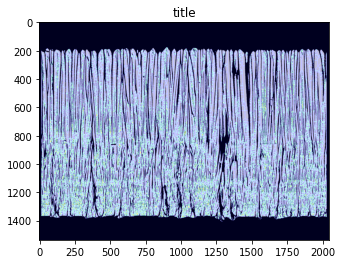

1139


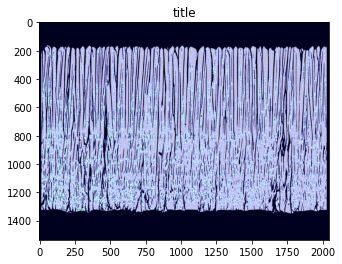

1119


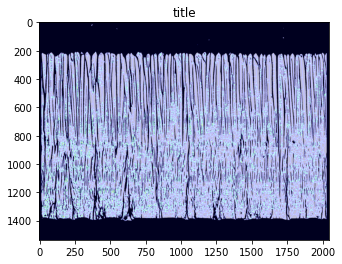

1130
Listing_intersection_skeleton [[205, 206, 203, 210, 207, 207, 200, 201, 207, 205, 204, 197, 188, 197, 210, 213, 221, 209, 209, 207, 216, 202, 204, 200, 207, 209, 214, 205, 198, 203, 200, 199, 191, 189, 192, 191, 194, 190, 187, 188, 175, 173, 177, 175, 185, 189, 188, 190, 190, 191, 194, 184, 187, 180, 178, 179, 195, 187, 181, 168, 166, 169, 178, 178, 180, 169, 167, 170, 177, 178, 184, 175, 169, 168, 163, 165, 166, 163, 166, 173, 173, 171, 166, 159, 148, 153, 158, 166, 165, 166, 167, 168, 172, 175, 166, 171, 170, 166, 160, 160, 160, 166, 169, 172, 174, 166, 171, 175, 172, 179, 179, 174, 165, 163, 160, 164, 167, 168, 173, 174, 178, 185, 179, 172, 169, 174, 163, 164, 166, 165, 169, 176, 177, 178, 175, 169, 162, 167, 165, 168, 160, 147, 151, 156, 163, 165, 162, 171, 174, 173, 168, 177, 170, 165, 167, 175, 171, 169, 166, 151, 155, 164, 175, 172, 159, 161, 174, 166, 161, 170, 174, 176, 176, 180, 172, 168, 169, 163, 172, 175, 177, 177, 169, 158, 158, 165, 162, 161, 160, 165, 167, 171, 169

c:\Users\chris\Anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

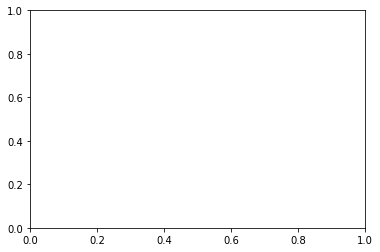

In [ ]:
#folder_name=r"C:\Users\chris\Desktop\Original_Images\7ysz Cross-section AD image"
folder_name=r"C:\Users\chris\Desktop\Original_Images\Batchs\Sexy\image"
Listing_intersection_skeleton=[]
Average_orientation_all_images=[] 

x=1
y1=0
y2=1550
for SEM_image in os.listdir(folder_name):
    a=os.path.join(folder_name, SEM_image)
    image = mpimg.imread(a)
    cropped_image=cropping(normalisation(image),0,x_max,0,y_text)
    mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
    new_threshold = max(mu1,mu2)- min(stds)
    binarized_image = binarisation(cropped_image,new_threshold)
    filled_image=filled(binarized_image,disk_size)
    only_top_coat_image=np.where(filled_image==True,cropped_image,0)
    binarised_only_top_coat_image=binarisation(only_top_coat_image,new_threshold)
    
    zoomed_binarised_only_top_coat_image=binarised_only_top_coat_image[:,:]
    
    zoomed_tv = denoise_tv_chambolle(zoomed_binarised_only_top_coat_image, weight=0.04)
    zoomed_tv=zoomed_tv*255
    zoomed_tv=np.where(zoomed_tv>100,1,0)
    thickness_top_section=0
    thickness_bottom_section,b=zoomed_tv.shape

    while np.any(filled_image[thickness_top_section,framing_side+100:b-(framing_side+100)] !=1 ):
        thickness_top_section=thickness_top_section+1

    while np.any(filled_image[thickness_bottom_section-1,framing_side+100:b-(framing_side+100)] !=1 ):
        thickness_bottom_section=thickness_bottom_section-1 


    intersection_skeleton=counting_gene(False,True,zoomed_tv,'title', 'title',thickness_top_section,thickness_bottom_section,1)

    Listing_intersection_skeleton.append(intersection_skeleton)
    
    '''
    mean_orientations_no_none=[]
    mean_orientations_no_none=[x for x in mean_orientations if x is not None]
    mean_orientation_image=np.mean(mean_orientations_no_none)   
    Average_orientation_all_images.append(mean_orientation_image)    
    print(mean_orientation_image)

    Listing_of_all_orientation_images_thicknesses.append(mean_orientations_no_none)
'''
    print(len(intersection_skeleton))

print('Listing_intersection_skeleton',Listing_intersection_skeleton)
print('length Listing_intersection_skeleton',len(Listing_intersection_skeleton))

## FOLDER Plot NB of Columns (+median, q1,q3) 

Index of the longest list: 36
Length of the longest list: 1426
Minimum sublist length: 1085
25th percentile sublist length (Q1): 1130
Median sublist length: 1147
75th percentile sublist length (Q3): 1159
Maximum sublist length: 1426


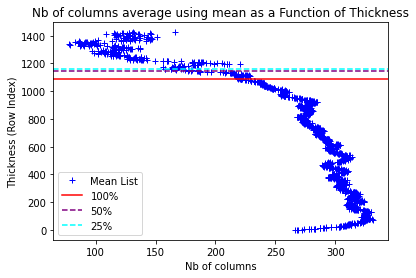

In [58]:
import numpy as np
import matplotlib.pyplot as plt

Mean_list = []
length = len(Listing_intersection_skeleton)

# Find the maximum length of the sublists
max_length = -float('inf')
max_index = -1

for i, sublist in enumerate(Listing_intersection_skeleton):
    current_length = len(sublist)
    if current_length > max_length:
        max_length = current_length
        max_index = i

# Output the results
print("Index of the longest list:", max_index)
print("Length of the longest list:", max_length)

# Reverse the sublists so that we start iterating from the last index to the first
for sublist in Listing_intersection_skeleton:
    sublist.reverse()

# Calculate the mean for each index across all sublists until the longest sublist is exhausted
for i in range(max_length):
    values_at_i = [sublist[i] for sublist in Listing_intersection_skeleton if i < len(sublist)]
    if values_at_i:
        Mean_list.append(np.mean(values_at_i))

# Step 1: Get the lengths of each sublist
lengths = [len(sublist) for sublist in Listing_intersection_skeleton]

# Step 2: Calculate the minimum, maximum, median, 25th and 75th percentiles
min_length = min(lengths)
max_length = max(lengths)
median_length = np.median(lengths)
q1_length = np.percentile(lengths, 25)  # 25th percentile (Q1)
q3_length = np.percentile(lengths, 75)  # 75th percentile (Q3)

# Output the results
print("Minimum sublist length:", min_length)
print("25th percentile sublist length (Q1):", int(q1_length))
print("Median sublist length:", int(median_length))
print("75th percentile sublist length (Q3):", int(q3_length))
print("Maximum sublist length:", max_length)

# Plot the results
plt.plot(Mean_list, range(len(Mean_list)), marker='+', linestyle='None', color='blue', label='Mean List')

# Add horizontal lines for min, max, median, Q1, and Q3 using the length positions
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
#plt.axhline(y=max_length, color='green', linestyle='--', label='Max Length')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
#plt.axhline(y=int(q1_length), color='orange', linestyle='--', label='Q1 (25th Percentile)')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')

# Add labels and title
plt.ylim()
plt.xlabel('Nb of columns')
plt.ylabel('Thickness (Row Index)')
plt.title('Nb of columns average using mean as a Function of Thickness')
plt.legend()

# Optionally invert y-axis if needed
# plt.gca().invert_yaxis()

# Show the plot
plt.show()


## FOLDER Plot NB of Columns + STDS (+median, q1,q3) 

Minimum sublist length: 1085
25th percentile sublist length (Q1): 1130
Median sublist length: 1147
75th percentile sublist length (Q3): 1159
Maximum sublist length: 1426


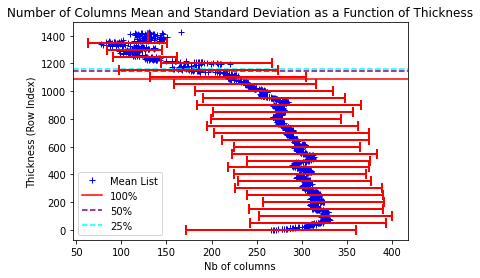

In [90]:
import numpy as np
import matplotlib.pyplot as plt

Mean_list = []
std_dev_list = []
thickness_indices = []

# Determine the maximum length of sublists
max_length = -float('inf')
for sublist in Listing_intersection_skeleton:
    max_length = max(max_length, len(sublist))

# Reverse the sublists so that we start iterating from the last index to the first
for sublist in Listing_intersection_skeleton:
    sublist.reverse()

# Calculate the mean and standard deviation for each index across all sublists
for i in range(max_length):
    values_at_i = [sublist[i] for sublist in Listing_intersection_skeleton if i < len(sublist)]
    if values_at_i:
        Mean_list.append(np.mean(values_at_i))
        std_dev_list.append(np.std(values_at_i, ddof=0))  # Population standard deviation

# Step 1: Get the lengths of each sublist
lengths = [len(sublist) for sublist in Listing_intersection_skeleton]

# Step 2: Calculate the minimum, maximum, median, 25th and 75th percentiles
min_length = min(lengths)
max_length = max(lengths)
median_length = np.median(lengths)
q1_length = np.percentile(lengths, 25)  # 25th percentile (Q1)
q3_length = np.percentile(lengths, 75)  # 75th percentile (Q3)

# Output the results
print("Minimum sublist length:", min_length)
print("25th percentile sublist length (Q1):", int(q1_length))
print("Median sublist length:", int(median_length))
print("75th percentile sublist length (Q3):", int(q3_length))
print("Maximum sublist length:", max_length)

# Plot the mean values for all thicknesses
plt.plot(Mean_list, range(len(Mean_list)), marker='+', linestyle='None', color='blue', label='Mean List')

# Add horizontal lines for min, max, median, Q1, and Q3 using the length positions
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
#plt.axhline(y=max_length, color='green', linestyle='--', label='Max Length')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
#plt.axhline(y=int(q1_length), color='orange', linestyle='--', label='Q1 (25th Percentile)')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')

# Add markers for the standard deviation every 50 thicknesses
interval = 50
interval_indices = range(0, len(Mean_list), interval)
for i in interval_indices:
    if i < len(Mean_list):
        plt.errorbar(Mean_list[i], i, xerr=std_dev_list[i], fmt='none', color='gray', 
                     ecolor='red', elinewidth=2, capsize=5, capthick=2)

# Add labels and title
plt.xlabel('Nb of columns')
plt.ylabel('Thickness (Row Index)')
plt.title('Number of Columns Mean and Standard Deviation as a Function of Thickness')
plt.legend()

# Optionally invert y-axis if needed
# plt.gca().invert_yaxis()

# Show the plot
plt.show()


# Diameter of column

### Calculation from the Nb of Columns above (the list for the whole dataset is given in one line)

In [91]:
# Taking above to have this new list 
Mean_list_DIAMETER=[]
Mean_list_DIAMETER=Mean_list
for i in range(len(Mean_list_DIAMETER)):
        Mean_list_DIAMETER[i]=283/Mean_list_DIAMETER[i]
        
print(Mean_list_DIAMETER)

[1.0639787385752253, 1.0519097667264803, 1.057126296129323, 1.0407710354448039, 1.0334319712900584, 1.019249875807253, 1.0185541421036302, 1.0102788207053608, 1.000121862052157, 1.002871631942323, 0.9990261716372489, 0.9845249520153552, 0.9861812064407595, 0.9865368433705973, 0.9853523832392844, 0.9775474956822107, 0.9732582270975393, 0.9683204530706153, 0.9671223191138345, 0.9553020602956582, 0.954468802698145, 0.9419799139167863, 0.9342592065570039, 0.9333560786989651, 0.9319781966840791, 0.9300243639866281, 0.9286562942008486, 0.9236396376118395, 0.9212032775844652, 0.9224457682364842, 0.9194488012547614, 0.9169832402234636, 0.9097156792107742, 0.9141743247006404, 0.9177009951917702, 0.9115344032876104, 0.9041533546325878, 0.9049010419538012, 0.9039044000220275, 0.8951788830715534, 0.9028602860286029, 0.9088090360445159, 0.9111296142103802, 0.9087587199645666, 0.9061499392734901, 0.905999889606447, 0.894690940804535, 0.9020663882171907, 0.8974302897758337, 0.8886843530048728, 0.8900

## FOLDER Plot DIAMTER of Columns (+median, q1,q3) 

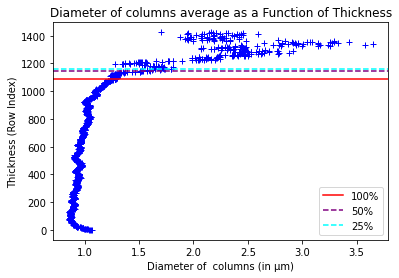

In [92]:
plt.plot(Mean_list_DIAMETER, range(len(Mean_list_DIAMETER)),marker='+', linestyle='None', color='blue')

plt.xlabel('Diameter of  columns (in µm)')
plt.ylabel('Thickness (Row Index)')
plt.title('Diameter of columns average as a Function of Thickness')

plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
#plt.axhline(y=max_length, color='green', linestyle='--', label='Max Length')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
#plt.axhline(y=int(q1_length), color='orange', linestyle='--', label='Q1 (25th Percentile)')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')


#plt.gca().invert_yaxis()
plt.legend()
plt.show()

## FOLDER Plot DIAMETER of Columns + STDS (+median, q1,q3) 

1085


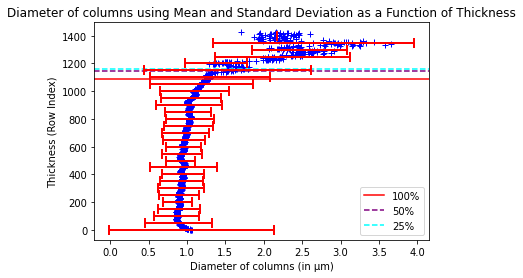

[1.0639787385752253, 1.0519097667264803, 1.057126296129323, 1.0407710354448039, 1.0334319712900584, 1.019249875807253, 1.0185541421036302, 1.0102788207053608, 1.000121862052157, 1.002871631942323, 0.9990261716372489, 0.9845249520153552, 0.9861812064407595, 0.9865368433705973, 0.9853523832392844, 0.9775474956822107, 0.9732582270975393, 0.9683204530706153, 0.9671223191138345, 0.9553020602956582, 0.954468802698145, 0.9419799139167863, 0.9342592065570039, 0.9333560786989651, 0.9319781966840791, 0.9300243639866281, 0.9286562942008486, 0.9236396376118395, 0.9212032775844652, 0.9224457682364842, 0.9194488012547614, 0.9169832402234636, 0.9097156792107742, 0.9141743247006404, 0.9177009951917702, 0.9115344032876104, 0.9041533546325878, 0.9049010419538012, 0.9039044000220275, 0.8951788830715534, 0.9028602860286029, 0.9088090360445159, 0.9111296142103802, 0.9087587199645666, 0.9061499392734901, 0.905999889606447, 0.894690940804535, 0.9020663882171907, 0.8974302897758337, 0.8886843530048728, 0.8900

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Mean_list contains the number of columns, convert it to Mean_list_DIAMETER
#Mean_list_DIAMETER = [283 / mean_val for mean_val in Mean_list]

# Calculate standard deviations every 50 thickness levels
std_dev_list = []
interval_indices = range(0, len(Mean_list_DIAMETER), 50)
for i in interval_indices:
    values_at_i = [sublist[i] for sublist in Listing_intersection_skeleton if i < len(sublist)]
    if values_at_i:
        std_dev_list.append(np.std([283 / val for val in values_at_i], ddof=0))  # Population standard deviation

# Plotting the mean diameters for all thicknesses
plt.plot(Mean_list_DIAMETER, range(len(Mean_list_DIAMETER)), marker='+', linestyle='None', color='blue')

plt.xlabel('Diameter of columns (in µm)')
plt.ylabel('Thickness (Row Index)')
plt.title('Diameter of columns using Mean and Standard Deviation as a Function of Thickness')

# Adding horizontal lines for statistical thresholds
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')

# Add standard deviation markers every 50 thickness levels
for i, std_dev in zip(interval_indices, std_dev_list):
    plt.errorbar(Mean_list_DIAMETER[i], i, xerr=std_dev, fmt='none', color='gray', 
                 ecolor='red', elinewidth=2, capsize=5, capthick=2)

# Optionally invert y-axis if needed
# plt.gca().invert_yaxis()
print(min_length)
plt.legend()
plt.show()
print(Mean_list_DIAMETER)

In [64]:
Mean_list_DIAMETER=[1.0639787385752253, 1.0519097667264803, 1.057126296129323, 1.0407710354448039, 1.0334319712900584, 1.019249875807253, 1.0185541421036302, 1.0102788207053608, 1.000121862052157, 1.002871631942323, 0.9990261716372489, 0.9845249520153552, 0.9861812064407595, 0.9865368433705973, 0.9853523832392844, 0.9775474956822107, 0.9732582270975393, 0.9683204530706153, 0.9671223191138345, 0.9553020602956582, 0.954468802698145, 0.9419799139167863, 0.9342592065570039, 0.9333560786989651, 0.9319781966840791, 0.9300243639866281, 0.9286562942008486, 0.9236396376118395, 0.9212032775844652, 0.9224457682364842, 0.9194488012547614, 0.9169832402234636, 0.9097156792107742, 0.9141743247006404, 0.9177009951917702, 0.9115344032876104, 0.9041533546325878, 0.9049010419538012, 0.9039044000220275, 0.8951788830715534, 0.9028602860286029, 0.9088090360445159, 0.9111296142103802, 0.9087587199645666, 0.9061499392734901, 0.905999889606447, 0.894690940804535, 0.9020663882171907, 0.8974302897758337, 0.8886843530048728, 0.89003361891335, 0.8870035125641718, 0.8823782388990431, 0.875039982940612, 0.8794941863580346, 0.880673892048503, 0.8826629382662937, 0.8795884464926853, 0.8811939657486445, 0.8756935552710201, 0.8829953198127926, 0.8793999464237878, 0.8738287904599659, 0.8714164366107454, 0.8744805540756526, 0.8790702656383891, 0.8786937901498929, 0.8744805540756526, 0.875366647112154, 0.8747601790662971, 0.8725745574397958, 0.8716478147735118, 0.869800222563722, 0.8702613859286359, 0.8665399641009397, 0.8537397274524082, 0.8565017741598832, 0.8600922238524418, 0.8624875203615153, 0.8639856827034424, 0.8617177656446872, 0.861401207032275, 0.8630770848669682, 0.8642131311535829, 0.8651697238034999, 0.8648506243743085, 0.8638492710909952, 0.87234268707483, 0.8711851812536489, 0.8735962531268295, 0.8719256308100929, 0.8718330057895575, 0.8761142247131039, 0.874806800618238, 0.8810993612110152, 0.8737822730902316, 0.8777540106951872, 0.8738287904599659, 0.8722963277887017, 0.8716478147735118, 0.8669976758926685, 0.8673183619550858, 0.872249973429695, 0.8662655689254803, 0.8644862274187601, 0.8685575193142131, 0.8680063458487572, 0.8672267131610926, 0.8695237590718864, 0.8691554143500132, 0.8728529646370646, 0.8708154278741578, 0.8712314225053078, 0.8739218400596315, 0.8720182755139988, 0.8689253573319217, 0.8720182755139988, 0.8716015293118097, 0.8660827353313635, 0.8648050579557429, 0.8718330057895575, 0.8741545507802099, 0.8697080485349442, 0.8736892532070049, 0.8717404004461204, 0.8648506243743085, 0.8584279064902464, 0.8586973580957363, 0.8615820691827201, 0.863440294581799, 0.8642586352148274, 0.8694776989087827, 0.8717867006585935, 0.8641676318837528, 0.8716015293118097, 0.8717867006585935, 0.8729458065202361, 0.8675934245996089, 0.8685575193142131, 0.866357014673282, 0.8738753127828355, 0.874806800618238, 0.8865244396435323, 0.8938626586069813, 0.890613130765057, 0.8916290944646641, 0.8881554028461665, 0.8957162346521146, 0.8832328885062419, 0.8942035301808673, 0.8964989895679721, 0.8981177500547165, 0.9089600177206778, 0.9040537563339942, 0.8932789115646258, 0.9014718804920915, 0.8979212253829322, 0.8924532405393649, 0.8971359860078706, 0.8967928754848932, 0.8931330939166394, 0.8928416013925152, 0.8948860538654454, 0.8906614574854849, 0.8940574105343428, 0.892162191542559, 0.892598836260808, 0.8927930378025565, 0.8958628970636394, 0.9035560938016074, 0.9008287141210691, 0.8932303003918154, 0.8943496975971231, 0.8943496975971231, 0.899939689675969, 0.9113825652415325, 0.9049010419538012, 0.904701537783167, 0.910826258254259, 0.9138689382551083, 0.9063000386505439, 0.9148876874198762, 0.9132587770544707, 0.9136146053656907, 0.9040039654127884, 0.9124464950803269, 0.901570910688784, 0.9107251844864895, 0.9071014092290688, 0.910624133148405, 0.9079041982410532, 0.9043027932345326, 0.89459341617615, 0.8948372676225262, 0.900532177538816, 0.9035063576815104, 0.8963521188291831, 0.8842320745569142, 0.8893584742089293, 0.8754600245346419, 0.8728529646370646, 0.8805321602918299, 0.8846609895440337, 0.882235958075786, 0.8743408086081075, 0.8799185161359493, 0.8828053568547303, 0.8886362405933625, 0.883375491093052, 0.8770504942559445, 0.8797770273891837, 0.8735962531268295, 0.8788349306633828, 0.8791173477585561, 0.8878191259195154, 0.891871332319061, 0.8936193379790941, 0.8891175992633118, 0.8929873238670367, 0.887051448335495, 0.8945446618344324, 0.8913385826771654, 0.8981177500547165, 0.9088593576965671, 0.9046516754850088, 0.9136146053656907, 0.9144289693593315, 0.9111296142103802, 0.9061499392734901, 0.905899884099564, 0.9081553612924642, 0.9088090360445159, 0.9072518240106124, 0.9065002485226709, 0.9008781558726675, 0.9003839824465167, 0.9007792777960707, 0.8918228742189622, 0.8910966340933767, 0.8981668946648427, 0.8863808186629225, 0.8910482601378861, 0.8966459084453184, 0.8929873238670367, 0.8894066648604715, 0.8862372442092759, 0.8954230538432164, 0.8858546062928383, 0.8948860538654454, 0.8939600239638363, 0.8997423669352628, 0.9024135466490736, 0.9027113237639554, 0.9011254460609388, 0.9022151376903205, 0.8956673578522318, 0.892404719186647, 0.8892621085708095, 0.8888768547600997, 0.8902267057164552, 0.8826629382662937, 0.8863808186629225, 0.8964989895679721, 0.8959117952076853, 0.8904198763155039, 0.8909998914341547, 0.8974302897758337, 0.8980194769668455, 0.9197063932313554, 0.907051282051282, 0.8958140042569449, 0.8923562031097098, 0.8978229952959195, 0.9034566270365478, 0.899939689675969, 0.8951788830715534, 0.8971359860078706, 0.9052004632438096, 0.9101192126420848, 0.9165224188955273, 0.9129032258064517, 0.9170344711995083, 0.9150406957297358, 0.9151427297056199, 0.9063000386505439, 0.9117875791578715, 0.9193973001736403, 0.9311851137459579, 0.9188311688311688, 0.925097221439441, 0.9266640320668437, 0.9235876659914473, 0.9214101268665096, 0.9224976114202215, 0.922342099348168, 0.9303933794354382, 0.9213066906151774, 0.9242637535897292, 0.9257755217146081, 0.9242117117117118, 0.920480035890534, 0.9287088378408962, 0.9350042722870977, 0.9336215232353108, 0.9267163504968384, 0.9318194720408742, 0.9326136363636364, 0.9321369754103015, 0.9327196272303672, 0.9418718081138464, 0.9353772509687713, 0.9358572324533897, 0.940846039206695, 0.9327196272303672, 0.9357505273359558, 0.9411697247706422, 0.9345783749928828, 0.9369791072040187, 0.9324017268802545, 0.9301824776153236, 0.9269780312870616, 0.9305516185724814, 0.9391772043256851, 0.9298136294114314, 0.9247323943661971, 0.923535700219434, 0.9226013152717666, 0.9153979142267582, 0.9203252032520325, 0.9193973001736403, 0.9148876874198762, 0.9097156792107742, 0.9184198746642794, 0.9234317862165964, 0.9324546952224053, 0.9284986989478448, 0.9331968844163966, 0.9278164038211519, 0.9214101268665096, 0.9231721034870641, 0.920944846546597, 0.9233278955954323, 0.9216170690623244, 0.9189854991321875, 0.9291819983017265, 0.9318723742477575, 0.9269256833069799, 0.9296556411418215, 0.9310266591038003, 0.9329316812549732, 0.9336215232353108, 0.9318723742477575, 0.9321899136756019, 0.9257755217146081, 0.9220312324457927, 0.9243158013289785, 0.9262456971954178, 0.9270827449872917, 0.9273970280806826, 0.9144289693593315, 0.9214101268665096, 0.9189340499384168, 0.9256189026109514, 0.9272922433760805, 0.9329316812549732, 0.9349510138983823, 0.9422502870264063, 0.9369256236086534, 0.9386938121926113, 0.9455613802638401, 0.9416556709310997, 0.9447450212961896, 0.9491701844677037, 0.9551352924061681, 0.9540804464078121, 0.9582019848219497, 0.9626414873027975, 0.9609507640067911, 0.9616263401488078, 0.9593220338983051, 0.9513707760969107, 0.94414725337935, 0.9465974625144176, 0.937407195888064, 0.9344187635204372, 0.937407195888064, 0.945397995622624, 0.9455613802638401, 0.9435502414348127, 0.9405225762090306, 0.9373001370488808, 0.9431707176923518, 0.9383181844166237, 0.9475811107262442, 0.9507645968489342, 0.9522538724836109, 0.950929841839986, 0.9494447015270707, 0.9513156369537499, 0.9517017452310546, 0.9491153001040824, 0.951040037082102, 0.946542875266709, 0.9531939605110338, 0.9469251182646821, 0.9405225762090306, 0.9466520560585963, 0.9352173665318215, 0.9346315909349732, 0.9260889189799142, 0.9348977615765792, 0.9291294011094757, 0.9206349206349207, 0.9237435984017107, 0.9250450856627593, 0.9273446327683617, 0.9191398812856983, 0.9234837402948127, 0.9214101268665096, 0.9139198218262807, 0.9135129118432769, 0.9132079670635362, 0.9117875791578715, 0.9119395521973442, 0.9192428315412186, 0.9199641295818853, 0.9230163639430916, 0.9197579289476634, 0.916215461903433, 0.9199641295818853, 0.9166247836041771, 0.9214618537023521, 0.9233798379837984, 0.9229125667697499, 0.9212549811977325, 0.9253579884992671, 0.9290768098715118, 0.9292872105531337, 0.9325606499630703, 0.9381572930955647, 0.9346315909349732, 0.938210917404973, 0.9410618048388947, 0.9363911232814194, 0.9446906474820144, 0.9526960357536711, 0.9504342790966994, 0.9592659692595407, 0.9572519974339535, 0.9592659692595407, 0.9559140411158348, 0.9540804464078121, 0.9589857443327879, 0.9574195053663088, 0.956972947761194, 0.9659271464720768, 0.9673503064592173, 0.9741824440619621, 0.9756300523062291, 0.9769656568061426, 0.9731428232643623, 0.9680349138947865, 0.9684347159124432, 0.9726814814814815, 0.9756880461273256, 0.9720478502901813, 0.9660977045320778, 0.9638285378743393, 0.9691208596563736, 0.9788299838988609, 0.9742402659069326, 0.9699799078123154, 0.9699799078123154, 0.9608382602587368, 0.9559697146185206, 0.9582019848219497, 0.9626979472140763, 0.9612321386741627, 0.9593781050908878, 0.9510951442809131, 0.9603885085717629, 0.9603323192136672, 0.9519777288017631, 0.9616263401488078, 0.9720478502901813, 0.9651320044687481, 0.9582019848219497, 0.9624157138669012, 0.9377285191956124, 0.9335153273047831, 0.9314493247077517, 0.9325076695830019, 0.9373536634115699, 0.9290768098715118, 0.9279737675260064, 0.9277115243316566, 0.9293398256143132, 0.9308682583791754, 0.9223939308794605, 0.9277639611123671, 0.9197063932313554, 0.9211515797743981, 0.9179062744659434, 0.9118888888888889, 0.9208931777378815, 0.9264025285020883, 0.9181116455979416, 0.9187283107578641, 0.9111801931830797, 0.9158065056073202, 0.9265594129268981, 0.9207382060918831, 0.9117875791578715, 0.910371602884082, 0.9056, 0.912598687868342, 0.9073521282476507, 0.9071515419476069, 0.9145818242603221, 0.9126494300806227, 0.9165735983917802, 0.9151427297056199, 0.9051006341328922, 0.9139198218262807, 0.9089600177206778, 0.9053003143786884, 0.9053003143786884, 0.9069510443142889, 0.9064001325307858, 0.9021159659247047, 0.9193973001736403, 0.9203252032520325, 0.9127509314352443, 0.9180089485458612, 0.9130555710073984, 0.9245761279783697, 0.9165224188955273, 0.9155510932619365, 0.9196033391226399, 0.907051282051282, 0.9098165290172385, 0.9174958077138067, 0.9262456971954178, 0.9255145193120947, 0.9371395946331715, 0.9326666287857265, 0.9285512247553318, 0.9266117195438637, 0.9288139429606157, 0.9269780312870616, 0.9344187635204372, 0.929708297932597, 0.9462700334371036, 0.9390697408318552, 0.9324017268802545, 0.9454524508956856, 0.9334622383985441, 0.932348764555524, 0.94414725337935, 0.938210917404973, 0.9396610945729335, 0.9417637271214643, 0.9390697408318552, 0.9498842592592593, 0.9459973488559738, 0.9490055504162812, 0.9529172714078374, 0.9558583740973677, 0.9529725963771482, 0.9499942122930896, 0.9577546971641966, 0.9600514710183072, 0.9583138720224194, 0.9562481794348966, 0.9642248722316865, 0.9600514710183072, 0.9589857443327879, 0.9555245080917453, 0.9556914119359533, 0.9517569291429896, 0.9486764535891804, 0.9408999713384923, 0.9499392325944789, 0.9520881670533643, 0.9616826810405437, 0.957531209893828, 0.9553020602956582, 0.9571403580383696, 0.9668374860104848, 0.9698652800756322, 0.9607257828504535, 0.956861373440597, 0.955079716047946, 0.9504893161155828, 0.9600514710183072, 0.963319443629321, 0.9628108869075552, 0.9615700058582307, 0.9551352924061681, 0.9559697146185206, 0.9598830409356724, 0.9601637905820415, 0.9527513350359879, 0.9500491983561962, 0.9444188722669736, 0.9413316510867696, 0.9374607344794107, 0.9376749500142816, 0.9373536634115699, 0.942412585405064, 0.9371395946331715, 0.9347912751295632, 0.9306571412371718, 0.9316079232646575, 0.9376213869530446, 0.9304461198344766, 0.9369256236086534, 0.9394997424303131, 0.9427373499511803, 0.9536924060194062, 0.9560253946065583, 0.9603323192136672, 0.9612884333821377, 0.962359287054409, 0.9633759830966075, 0.9639417430115104, 0.967464340445597, 0.9642815180354835, 0.9583698254218486, 0.963771945276261, 0.9658134745513386, 0.9643381704952706, 0.9693497903502037, 0.9651320044687481, 0.9658134745513386, 0.9699225905572297, 0.9677495430693945, 0.9662683228351093, 0.9650185196072667, 0.967806603773585, 0.9666666666666667, 0.9646782250955039, 0.9671793058747274, 0.9564153362079012, 0.9609507640067911, 0.9669513991163476, 0.9630368458108425, 0.9611195690361869, 0.9612884333821377, 0.9668944392082941, 0.9653022818160434, 0.9592099111734456, 0.9654158334313611, 0.9651887569093262, 0.9615136781676527, 0.9620208650802955, 0.9615700058582307, 0.963319443629321, 0.9648483423465788, 0.9703813183564884, 0.9752242885152398, 0.9755720653789004, 0.9774892806098142, 0.976094196003806, 0.9740668209601804, 0.9794140461841399, 0.9785965539855721, 0.9816398540757132, 0.9798233046800382, 0.9832275068887024, 0.9742980946162522, 0.9767331151443023, 0.9840527577937649, 0.9792387543252595, 0.9771983092218848, 0.9802329053448791, 0.9837578663470183, 0.987783595113438, 0.9837578663470183, 0.987130141929276, 0.9843478260869565, 0.9843478260869565, 0.9880809053696124, 0.9892719382835101, 0.9880214290013846, 0.9874864637227769, 0.9920822000604412, 0.9967209132863736, 0.9962974203338391, 0.9990261716372489, 0.9987222391238211, 1.0006706090349327, 0.9957534578985684, 0.991183574879227, 0.9879619597929458, 0.9905853952926977, 0.9916027306228479, 0.9908843948083307, 0.9873082706766918, 0.9832864074761876, 0.9794140461841399, 0.9870707799627157, 0.9943660265341975, 0.987130141929276, 0.9783632353817726, 0.989152705797276, 0.9930425313086091, 0.9972053462940461, 0.9914230490456633, 0.9816985645933014, 0.977140135730444, 0.9776057176891007, 0.9805842642929684, 0.9811117752540347, 0.9740668209601804, 0.980057320277048, 0.9737201162721719, 0.9782466177960546, 0.9762683637661335, 0.9883188824662812, 1.0018922053347983, 1.0052670259676628, 1.0000609273137147, 0.986655446020678, 0.9873676612127045, 0.9925621333978351, 0.9962974203338391, 0.9977508966020303, 1.0018310546875, 0.9894508409186811, 0.9908245804660146, 0.9841707638805611, 0.9875458756994163, 0.9948481726165223, 0.9855298709096368, 0.9904658460053102, 0.9889739109477618, 0.9855298709096368, 0.9959347126994722, 0.9931627034549525, 0.992322108699595, 0.9951497514247606, 1.0006096074128261, 1.0006096074128261, 1.0086026791200688, 1.006314756912513, 1.0078595112366449, 1.011773408124268, 1.0118357785723093, 1.0169134502199368, 1.0147758887171563, 1.0125848241826034, 1.016661505109941, 1.0182382133995038, 1.0230615806532035, 1.0197564612326044, 1.0221696350728608, 1.0171024910149957, 1.016032188177035, 1.023444319740616, 1.0246582183656907, 1.0217878486055778, 1.0204538389804165, 1.0228703184395838, 1.0245303039760314, 1.020390401591446, 1.0294781736076268, 1.0320025149324112, 1.0236357966947303, 1.0093469437953513, 1.0236357966947303, 1.026259847442791, 1.0312892686604676, 1.0350611678648, 1.031030150753769, 1.0280596267067519, 1.0277377747166738, 1.030318247442094, 1.039650367367621, 1.0401774397972117, 1.0281240212965863, 1.022997818635089, 1.021406347230865, 1.0359103818239193, 1.0298011167576384, 1.0294136092819066, 1.0228703184395838, 1.030318247442094, 1.0281884239538963, 1.0235081374321882, 1.0256185953511623, 1.0309006406230372, 1.0315485168426344, 1.0298011167576384, 1.0299949799196788, 1.0326517772884554, 1.0360411538218772, 1.0420925655513935, 1.0466777196786126, 1.0476129691090121, 1.0416296484325422, 1.0312244769743042, 1.0348653931025786, 1.031418876460978, 1.039321218261255, 1.0368264796917441, 1.0422910845821691, 1.0461440407903122, 1.044280442804428, 1.0457441386340467, 1.0430859176410778, 1.0550199254402879, 1.0484159427695452, 1.0520446096654275, 1.0538007190549563, 1.0550877418525424, 1.0534625505423274, 1.0524493459861504, 1.0467444678273068, 1.0415635509867378, 1.044546264477536, 1.0376785940068276, 1.0420925655513935, 1.0413653089709427, 1.0310949180224889, 1.0307711630243657, 1.0319376335973847, 1.028832894571894, 1.0265165728580363, 1.0271589486858572, 1.0205172842576473, 1.0191865880161441, 1.0209616221931952, 1.0219787061826786, 1.0257467816522936, 1.027287520340468, 1.0161579892280073, 1.017922480620155, 1.022233293890515, 1.028832894571894, 1.0315485168426344, 1.0260673876351816, 1.022233293890515, 1.0202635504724018, 1.0252982697232806, 1.0210886469673406, 1.0243384922616077, 1.0225517069524046, 1.0274161241862794, 1.0146504296223033, 1.0123974588293345, 1.0251701954906, 1.022997818635089, 1.020771144278607, 1.0185541421036302, 1.0178593575592212, 1.0202635504724018, 1.0308358977579601, 1.0198831862806015, 1.00711743772242, 1.0081071121483847, 1.014336917562724, 1.0139609587348652, 1.008664659251521, 1.0105898288388129, 1.019503105590062, 1.0223606353161008, 1.0185541421036302, 1.0209616221931952, 1.0134601136082984, 1.0268376603065372, 1.0305123053741838, 1.0321323020813684, 1.034343688953305, 1.0268376603065372, 1.0293490530540574, 1.0361065522030048, 1.032846715328467, 1.039716222208146, 1.0434174559786409, 1.0458774053778512, 1.0244663587567095, 1.0130848043451426, 1.021279243404679, 1.0309653916211294, 1.034343688953305, 1.0470783363102831, 1.044612741042449, 1.0450783140201196, 1.046544248916093, 1.0532597535934292, 1.0511687479987193, 1.0460107060922763, 1.0409690512430239, 1.0294781736076268, 1.0422910845821691, 1.0469447633626738, 1.0492201482996677, 1.0430859176410778, 1.0285750093996742, 1.0295427460327418, 1.031030150753769, 1.0245303039760314, 1.0172916021072205, 1.0181750511754855, 1.0125848241826034, 1.0218514598767354, 1.0147758887171563, 1.010838773247937, 1.0079214000614063, 1.009098733554654, 1.019946560616417, 1.0129597630214762, 1.0145877117072568, 1.0095952761717308, 1.006314756912513, 1.0023204689789935, 1.0, 1.002871631942323, 1.0044058254803574, 0.9968419774079923, 0.9949084737543945, 0.9944262692354294, 0.9968419774079923, 1.009409015435705, 1.0087266470009832, 1.0105276118943545, 1.005883073906116, 1.0084787417055787, 1.0135226921889473, 1.0092228234136744, 1.001708775784206, 1.0131473365841615, 1.014838629899839, 1.0149013788412786, 1.0263881940970485, 1.0170394696077825, 1.0242745709828394, 1.0252342286071205, 1.0294136092819066, 1.0332368122875488, 1.04070504691859, 1.0394528528908873, 1.0402433614297484, 1.0409030376054285, 1.0432185076903522, 1.045277972361969, 1.0546809741052496, 1.0573986987051474, 1.0462107208872458, 1.0508995454254433, 1.0580803197318378, 1.061227128725674, 1.0621885717983564, 1.0645307737207341, 1.0645998183940848, 1.07372277098188, 1.074214659685864, 1.0740740740740742, 1.0827176781002639, 1.0836469267841817, 1.087235874677088, 1.0952889363405847, 1.0990291262135923, 1.0967526393157825, 1.09858777859581, 1.0973392164727906, 1.09858777859581, 1.1101041525767616, 1.1040559628707876, 1.0987348550773144, 1.0998391852050389, 1.1056176747945574, 1.1103294324561996, 1.1060646900269542, 1.112738119449529, 1.1126626898047722, 1.1128890094243677, 1.1113819486762815, 1.1131154211311542, 1.1062883332210014, 1.1042787944025834, 1.11017923571187, 1.1101041525767616, 1.1014628908871293, 1.0999865969709155, 1.1035363721930886, 1.0983672376873663, 1.097559344700769, 1.1013150831991412, 1.0957276368491322, 1.0944855637794224, 1.0947045484860611, 1.0922278413627893, 1.084219565360988, 1.0838615953512942, 1.0906312292358804, 1.0881728984354282, 1.0955813643038312, 1.095873948457738, 1.0955813643038312, 1.0943396226415094, 1.0936833688699361, 1.092882349024569, 1.097559344700769, 1.1005766393992222, 1.1080807398906365, 1.107407907165025, 1.0982202596012312, 1.110404546069544, 1.1209451615106194, 1.1135685210312076, 1.1071838111298482, 1.109203946479254, 1.121098285636227, 1.1392282065519155, 1.1441516799107765, 1.1392282065519155, 1.1329376035339591, 1.13962368950913, 1.1362314827633948, 1.1384380635316966, 1.1369398074392187, 1.147671654314082, 1.152344846953103, 1.1491983476860603, 1.1447102308389707, 1.154046263094987, 1.1541274082407538, 1.1567300916138126, 1.1632060094961376, 1.1632060094961376, 1.1590170879819235, 1.1662640329685945, 1.169338177673292, 1.1684225512528474, 1.1754511601260385, 1.1760406964247332, 1.1713408977378148, 1.1725123223087364, 1.1720099964298465, 1.1740218868464345, 1.1718426501035197, 1.17175899486008, 1.1688385672577084, 1.1730150789680553, 1.1753669889008234, 1.1810332421931213, 1.1869260250198856, 1.1859826589595375, 1.1928779069767441, 1.1819687477496938, 1.1923579834374547, 1.1901965049670074, 1.1911465892597968, 1.183161536798097, 1.177728348999067, 1.1816283924843425, 1.183673469387755, 1.181118226955458, 1.1790819625026938, 1.183588116527257, 1.1779819147409214, 1.1905418147530282, 1.1943534890489704, 1.189851395433128, 1.197839889075385, 1.2025789435123453, 1.2070892778349758, 1.21405325443787, 1.2207347910159156, 1.2168433538438728, 1.2167531504818385, 1.2174751520545914, 1.2209163939303778, 1.2327450244085618, 1.2321897755423767, 1.2342281374539439, 1.245371775417299, 1.2466013518645098, 1.2456553084920696, 1.235714823458556, 1.2443332575240693, 1.256045301499847, 1.2614509683369197, 1.2751778656126482, 1.2792228390166533, 1.2801292407108238, 1.2806464646464646, 1.2767260130508338, 1.2932919862901908, 1.2830310880829014, 1.2896085930506958, 1.2837586067233697, 1.2826157332470056, 1.2956796803462916, 1.2964351157754457, 1.2826534816646065, 1.281914017460056, 1.296594052558783, 1.2964819776990233, 1.2964819776990233, 1.2962578860945468, 1.289792759480609, 1.2855918402331363, 1.280980442394739, 1.2707786156062018, 1.268092661481231, 1.2719640434192674, 1.259150436534587, 1.2552514854799564, 1.2526306998496743, 1.2355024711696871, 1.2439044617681208, 1.2538127289767402, 1.2431524547803616, 1.2482054830061402, 1.260803706673795, 1.2792695054696681, 1.2730193702377675, 1.2706014404639416, 1.2764517947754181, 1.2765717507753032, 1.2922374429223744, 1.302487269878574, 1.3142857142857143, 1.3040139258652468, 1.3097809318111695, 1.3124806760795629, 1.316143034311699, 1.3300907202973002, 1.3323618428427306, 1.3258374326540174, 1.3287984589453408, 1.3585144012127337, 1.353215049704291, 1.3714472822527832, 1.370011775480832, 1.3863365550112539, 1.4404191616766466, 1.4660910518053376, 1.5097229392531406, 1.5115437629221227, 1.526801253045597, 1.5204506065857886, 1.5364273204903678, 1.576894502228826, 1.6014551333872271, 1.513991769547325, 1.5218326521832652, 1.5280777537796977, 1.5961255517410495, 1.57500632431065, 1.5703855140186915, 1.5912992009470257, 1.6217765042979944, 1.6974341886037987, 1.737450343084146, 1.73306916426513, 1.7048192771084338, 1.6512567324955116, 1.6329338659565023, 1.7958751983077736, 1.7901092581943645, 1.7182756527018823, 1.7017438364401682, 1.7203647416413375, 1.7319461444308446, 1.7214111922141118, 1.7141126589945488, 1.7037928958458761, 1.6706021251475796, 1.7017438364401682, 1.7037928958458761, 1.6795252225519288, 1.812650120096077, 1.725609756097561, 1.7018900343642613, 1.6385442514474773, 1.629111842105263, 1.6591289782244556, 1.629111842105263, 1.642620232172471, 1.6717299578059073, 1.6251025430680885, 1.6014551333872271, 1.5598425196850394, 1.54765625, 1.5320959010054136, 1.5238461538461539, 1.5500782472613457, 1.5525078369905956, 1.5309119010819165, 1.5030349013657056, 1.3486894360603654, 1.2824773413897281, 1.3508353221957041, 1.4209205020920503, 1.3682514101531023, 1.3412322274881516, 1.3760129659643436, 1.4067937033968518, 1.475238922675934, 1.4500426985482495, 1.5693160813308686, 1.502654867256637, 1.5635359116022098, 1.521505376344086, 1.5521023765996342, 1.5053191489361701, 1.4973544973544974, 1.5678670360110802, 1.5269784172661869, 1.492091388400703, 1.715151515151515, 1.6533592989289192, 1.7780104712041886, 1.763239875389408, 1.770594369134515, 1.814102564102564, 1.814102564102564, 1.8972067039106146, 1.9859649122807017, 2.050724637681159, 2.0262529832935563, 2.2023346303501947, 2.101485148514852, 2.1630573248407643, 2.0384153661464586, 2.0808823529411766, 2.246031746031746, 2.117206982543641, 2.157560355781449, 2.078335373317014, 2.06318347509113, 2.117206982543641, 2.1385390428211584, 2.219607843137255, 1.9882903981264635, 2.016627078384798, 2.205194805194805, 1.9906213364595546, 2.1251564455569465, 2.050724637681159, 2.133165829145729, 2.111940298507463, 2.053204353083434, 2.213820078226858, 2.216710182767624, 2.2254259501965925, 2.2430647291941876, 2.2371541501976284, 2.4119318181818183, 2.3682008368200838, 2.3583333333333334, 2.500736377025037, 2.468023255813953, 2.4716157205240177, 2.3583333333333334, 2.405099150141643, 2.3682008368200838, 2.2430647291941876, 2.3781512605042017, 2.2945945945945945, 2.478832116788321, 2.429184549356223, 2.59236641221374, 2.4752186588921283, 2.7745098039215685, 2.6203703703703702, 2.5267857142857144, 2.5118343195266273, 2.4608695652173913, 2.6284829721362226, 2.8779661016949154, 2.783606557377049, 2.439655172413793, 2.6448598130841123, 2.45021645021645, 2.5343283582089553, 2.699523052464229, 2.4188034188034186, 2.3814866760168303, 2.5727272727272728, 2.500736377025037, 2.5343283582089553, 2.5267857142857144, 2.4970588235294118, 2.7699836867862966, 2.699523052464229, 2.779050736497545, 2.9125214408233275, 2.6284829721362226, 2.604294478527607, 2.4694589877835953, 2.250497017892644, 2.6572769953051645, 2.3682008368200838, 2.3054989816700613, 2.3388429752066116, 2.466230936819172, 2.4326647564469916, 2.0707317073170732, 2.1658163265306123, 2.188144329896907, 2.3324175824175826, 2.193798449612403, 2.3781512605042017, 2.222513089005236, 2.091133004926108, 2.257978723404255, 2.453757225433526, 2.4752186588921283, 2.319672131147541, 2.065693430656934, 2.264, 2.439655172413793, 2.222513089005236, 2.326027397260274, 2.482456140350877, 2.288409703504043, 2.307065217391304, 2.384831460674157, 2.446685878962536, 2.5884146341463414, 2.384831460674157, 2.994708994708995, 3.1444444444444444, 3.2528735632183907, 2.801980198019802, 2.439655172413793, 2.7342995169082127, 3.2342857142857144, 3.1620111731843576, 2.7881773399014778, 2.9479166666666665, 3.5822784810126582, 2.8730964467005076, 2.81592039800995, 3.6516129032258067, 3.1444444444444444, 2.9479166666666665, 2.9633507853403143, 3.0106382978723403, 3.3294117647058825, 2.81592039800995, 3.1444444444444444, 2.917525773195876, 2.9326424870466323, 2.9633507853403143, 2.6448598130841123, 3.2716763005780347, 3.092896174863388, 3.2906976744186047, 3.43030303030303, 3.2528735632183907, 3.043010752688172, 3.0760869565217392, 2.9025641025641025, 2.8442211055276383, 3.2906976744186047, 2.3008130081300813, 2.3388429752066116, 2.482456140350877, 1.9929577464788732, 2.193798449612403, 2.264, 2.7745098039215685, 2.3388429752066116, 2.0808823529411766, 2.1278195488721803, 2.193798449612403, 1.9517241379310344, 2.4188034188034186, 1.9929577464788732, 2.143939393939394, 1.9251700680272108, 1.9383561643835616, 2.264, 2.1769230769230767, 2.3008130081300813, 2.246031746031746, 2.282258064516129, 2.1769230769230767, 2.0808823529411766, 2.1278195488721803, 1.9383561643835616, 2.065693430656934, 1.9652777777777777, 2.246031746031746, 1.8741721854304636, 1.979020979020979, 2.1278195488721803, 2.264, 2.4188034188034186, 2.065693430656934, 2.193798449612403, 2.264, 2.3781512605042017, 2.3781512605042017, 2.1769230769230767, 2.264, 2.3583333333333334, 2.4608695652173913, 2.0214285714285714, 2.193798449612403, 2.439655172413793, 2.4188034188034186, 2.3983050847457625, 1.9383561643835616, 2.3983050847457625, 2.439655172413793, 2.596330275229358, 2.246031746031746, 2.0808823529411766, 2.096296296296296, 2.143939393939394, 2.2109375, 2.3008130081300813, 2.319672131147541, 1.9517241379310344, 2.4608695652173913, 2.1769230769230767, 2.2109375, 2.1603053435114505, 1.7048192771084338]

## Equation of the curve of dimater with adjustable degree (+ RMSE of method)

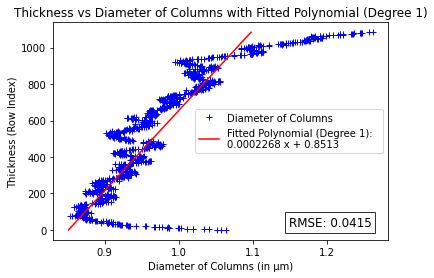

Optimized Equation (Degree 1):  
0.0002268 x + 0.8513
RMSE: 0.0415


In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Mean_list_DIAMETER is already defined and contains more than 1085 values=RED Lines
# Step 1: Trim the list to the first 1085 values
trimmed_list = Mean_list_DIAMETER[0:1085]

# Step 2: Create the thickness values (y-axis)
thickness_values = range(len(trimmed_list))  # Since it's the row index, just the range of the length

# Step 3: Set the degree of the polynomial
degree = 1 # You can change this to any integer value (e.g., 1, 2, 3, etc.)

# Step 4: Fit a polynomial of the specified degree to the data
coefficients = np.polyfit(thickness_values, trimmed_list, degree)
polynomial = np.poly1d(coefficients)

# Generate a smooth line for the fitted polynomial
fitted_values = polynomial(thickness_values)

# Step 5: Calculate RMSE
rmse = np.sqrt(np.mean((fitted_values - trimmed_list) ** 2))

# Plot the data
plt.plot(trimmed_list, thickness_values, marker='+', linestyle='None', color='blue', label='Diameter of Columns')

# Plot the fitted polynomial line
plt.plot(fitted_values, thickness_values, color='red', linestyle='-', label=f'Fitted Polynomial (Degree {degree}): {polynomial}')

# Add RMSE as text on the plot
plt.text(0.95, 0.05, f'RMSE: {rmse:.4f}', fontsize=12, transform=plt.gca().transAxes, 
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.xlabel('Diameter of Columns (in µm)')
plt.ylabel('Thickness (Row Index)')
plt.title(f'Thickness vs Diameter of Columns with Fitted Polynomial (Degree {degree})')
plt.legend()

# Show the plot
plt.show()

# Output the equation of the fitted polynomial
print(f'Optimized Equation (Degree {degree}): {polynomial}')
print(f'RMSE: {rmse:.4f}')

# =============================================================================

# FOLDER Orientation

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, feature, measure
from skimage.io import imread
from skimage.morphology import skeletonize
from scipy.ndimage import label
from skimage.restoration import denoise_tv_chambolle

# Real data To keep

In [154]:
# List_of_all_stds_image
List_of_all_stds_image= [[19.49, 33.74, 0.0, 22.5, 40.58, 45.74, 35.45, 46.9, 33.41, 39.38, 31.15, 36.16, 36.5, 29.66, 33.85, 33.21, 27.03, 31.05, 33.79, 27.8, 30.66, 32.89, 28.96, 28.79, 29.78, 34.63, 33.94, 31.29, 29.71, 28.17, 28.14, 29.97, 27.35, 25.96, 25.85, 27.74, 29.52, 29.56, 29.4, 28.82, 28.3, 25.69, 30.03, 30.43, 28.78, 26.47, 28.04, 27.12, 26.35, 26.49, 26.39, 25.48, 23.44, 22.46, 24.08, 26.55, 26.83, 31.85, 29.33, 24.73, 30.09, 26.7, 25.59, 24.12, 27.15, 26.73, 24.8, 25.65, 24.26, 22.87, 23.86, 20.49, 24.32, 24.33, 24.99, 26.48, 28.41, 25.6, 25.05, 26.73, 27.58, 24.65, 25.21, 25.72, 26.38, 24.43, 27.5, 23.97, 22.27, 22.38, 24.82, 20.99, 23.87, 25.19, 21.02, 23.8, 25.77, 24.65, 28.27, 24.96, 22.76, 23.39, 18.56, 21.57, 21.62, 23.49, 20.84, 21.27, 22.06, 24.6, 25.24, 27.04, 26.13, 26.2, 22.58, 24.66, 22.39, 26.27, 21.78, 22.26, 24.47, 25.72, 23.95, 25.64, 23.81, 21.96, 21.55, 22.69, 26.03, 21.56, 21.32, 19.36, 18.95, 22.56, 24.62, 22.09, 21.36, 21.59, 18.54, 22.23, 23.27, 15.16, 21.52, 18.43, 20.62, 24.18, 20.39, 22.53, 24.04, 23.85, 22.74, 20.56, 22.79, 20.74, 22.82, 20.05, 25.04, 20.64, 19.51, 21.9, 21.52, 23.16, 22.69, 20.55, 19.39, 21.33, 23.27, 23.35, 14.97, 12.73, 18.16, 19.49, 19.67, 24.76, 23.3, 19.42, 18.89, 20.63, 18.37, 18.84, 17.76, 17.18, 17.23, 16.88, 16.78, 15.45, 19.69, 18.82, 18.67, 20.17, 24.51, 24.96, 19.27, 18.25, 19.76, 18.98, 19.95, 19.91, 18.42, 18.81, 13.71, 14.68, 20.95, 19.39, 18.61, 18.05, 16.57, 21.45, 17.24, 15.15, 18.22, 17.25, 20.24, 23.59, 24.92, 18.28, 14.86, 16.46, 12.66, 15.62, 13.79, 16.32, 20.81, 15.5, 17.28, 17.55, 15.2, 14.65, 17.35, 16.7, 15.95, 17.29, 17.18, 19.26, 14.61, 13.88, 18.47, 16.47, 12.94, 16.8, 16.95, 14.24, 17.14, 16.84, 16.57, 18.36, 16.93, 16.5, 15.43, 14.92, 11.48, 18.5, 17.99, 18.06, 16.3, 18.97, 16.39, 17.73, 14.33, 15.2, 15.84, 14.23, 16.12, 13.56, 15.91, 16.06, 16.72, 18.03, 18.52, 14.7, 12.95, 20.66, 13.99, 14.05, 16.67, 16.59, 13.84, 20.19, 16.79, 16.4, 17.8, 18.98, 16.8, 18.62, 18.09, 21.93, 19.22, 15.57, 13.86, 13.48, 12.36, 16.13, 21.11, 16.63, 13.85, 18.11, 16.81, 14.01, 14.12, 11.91, 15.99, 17.14, 14.3, 18.82, 18.29, 22.3, 16.68, 20.43, 16.38, 16.01, 17.64, 20.98, 16.4, 18.01, 15.45, 14.16, 20.41, 21.78, 15.83, 16.82, 18.97, 16.96, 16.53, 19.57, 17.74, 19.95, 19.91, 23.31, 19.06, 18.18, 21.26, 18.7, 17.49, 15.36, 19.21, 17.95, 20.35, 19.45, 18.04, 18.46, 20.38, 22.24, 17.13, 20.2, 17.66, 19.92, 15.16, 18.23, 19.87, 17.09, 15.59, 17.85, 18.02, 16.97, 19.95, 14.43, 15.81, 21.13, 21.73, 17.5, 17.49, 19.63, 15.56, 17.93, 19.84, 17.3, 20.8, 21.38, 21.34, 20.94, 19.8, 18.24, 17.36, 19.0, 17.88, 17.81, 19.51, 23.06, 21.93, 21.11, 19.77, 16.41, 18.23, 19.09, 19.7, 19.17, 18.36, 22.17, 18.5, 18.55, 16.68, 17.26, 16.47, 20.63, 17.1, 18.85, 22.76, 19.09, 18.25, 20.76, 18.15, 21.34, 21.53, 19.75, 21.36, 22.18, 21.22, 16.68, 16.73, 21.87, 20.38, 21.59, 18.9, 20.8, 23.06, 18.8, 19.97, 19.98, 21.96, 20.55, 18.97, 20.71, 19.44, 21.76, 21.01, 19.9, 18.44, 19.06, 17.33, 22.2, 16.38, 19.72, 20.81, 18.5, 15.9, 21.09, 18.17, 16.69, 19.6, 21.09, 20.73, 22.37, 22.02, 18.46, 18.67, 21.6, 19.81, 20.29, 16.71, 18.94, 20.02, 20.64, 18.7, 19.68, 20.41, 18.54, 19.3, 18.39, 18.34, 19.11, 21.11, 20.35, 18.65, 18.96, 21.81, 21.04, 23.58, 21.89, 18.94, 18.73, 19.47, 16.57, 14.6, 20.02, 15.56, 17.55, 21.76, 18.87, 16.01, 17.26, 20.99, 19.6, 19.89, 18.82, 14.41, 16.48, 15.41, 17.45, 19.48, 21.36, 16.44, 13.77, 14.49, 18.03, 17.21, 16.33, 13.46, 19.75, 15.18, 18.44, 17.99, 18.33, 20.01, 17.98, 16.19, 16.16, 14.63, 17.83, 15.19, 16.07, 16.82, 18.03, 16.63, 16.62, 16.45, 17.38, 17.02, 21.04, 19.57, 16.14, 22.47, 17.85, 14.49, 17.86, 20.16, 21.74, 18.18, 19.74, 19.53, 20.72, 18.15, 15.75, 15.68, 18.1, 16.57, 15.84, 17.9, 17.06, 18.37, 18.53, 16.62, 18.55, 20.21, 16.66, 20.12, 24.26, 22.09, 22.82, 23.35, 22.8, 21.01, 17.74, 21.8, 19.8, 18.78, 20.48, 16.71, 20.32, 22.02, 20.93, 19.07, 15.38, 20.07, 22.56, 21.7, 21.97, 22.26, 21.09, 16.73, 22.68, 18.52, 21.11, 20.96, 17.82, 19.98, 17.85, 19.49, 19.07, 17.07, 19.92, 22.58, 19.92, 18.38, 19.35, 19.09, 16.62, 20.07, 22.81, 21.39, 24.69, 20.79, 23.75, 18.38, 17.87, 13.87, 23.25, 21.97, 22.63, 20.77, 25.55, 25.81, 25.55, 24.33, 24.11, 22.02, 21.97, 24.69, 20.62, 20.52, 21.04, 21.64, 18.81, 21.52, 22.14, 20.11, 22.91, 21.78, 24.02, 23.14, 19.82, 24.98, 27.36, 30.34, 26.88, 25.97, 26.51, 27.46, 28.3, 23.57, 24.62, 26.53, 26.07, 27.02, 24.83, 22.69, 25.01, 24.67, 25.8, 25.87, 26.88, 23.1, 23.79, 25.85, 29.1, 25.56, 26.03, 22.44, 28.27, 25.17, 27.18, 23.36, 22.63, 20.24, 19.56, 19.34, 27.66, 24.79, 28.35, 27.18, 28.1, 29.72, 25.04, 23.65, 25.35, 23.55, 25.75, 24.61, 23.74, 23.6, 22.23, 24.63, 22.64, 24.07, 26.03, 24.04, 29.45, 27.34, 26.86, 26.15, 23.7, 24.36, 23.06, 26.56, 26.01, 25.35, 27.51, 25.64, 24.5, 24.92, 30.28, 29.53, 26.17, 25.52, 24.73, 22.07, 20.51, 25.36, 30.6, 26.41, 25.13, 22.25, 23.75, 23.61, 23.81, 21.45, 27.19, 25.05, 25.19, 25.47, 23.22, 27.75, 28.4, 26.69, 25.75, 20.83, 26.64, 25.06, 26.78, 27.89, 28.63, 25.36, 22.15, 23.62, 26.15, 23.31, 24.59, 27.48, 24.47, 26.72, 23.29, 20.67, 24.48, 24.99, 24.57, 28.43, 26.37, 26.01, 25.05, 29.54, 23.87, 25.14, 25.58, 25.43, 21.22, 25.7, 27.69, 22.93, 22.11, 26.07, 26.73, 25.99, 28.45, 27.18, 24.08, 30.83, 29.16, 24.65, 29.19, 29.02, 25.26, 26.13, 25.88, 26.43, 27.5, 26.41, 28.98, 25.52, 24.23, 28.22, 24.3, 29.11, 22.28, 26.94, 26.47, 22.87, 21.97, 24.51, 25.62, 28.83, 28.77, 25.4, 29.4, 29.11, 29.23, 27.79, 25.62, 26.15, 26.82, 25.54, 26.07, 25.45, 24.82, 25.31, 26.82, 26.42, 26.69, 27.73, 24.74, 25.08, 25.37, 27.72, 23.3, 20.41, 22.96, 23.68, 19.58, 21.65, 23.74, 20.53, 19.78, 20.43, 25.31, 23.72, 22.68, 25.53, 22.31, 21.15, 22.47, 23.93, 24.61, 26.28, 26.81, 26.64, 24.27, 27.15, 30.41, 31.65, 29.54, 27.36, 29.96, 25.85, 25.86, 25.37, 27.36, 26.18, 29.92, 26.62, 26.28, 27.24, 29.07, 23.06, 27.23, 27.57, 29.68, 29.71, 26.73, 28.76, 28.25, 29.56, 24.89, 28.04, 29.85, 29.36, 26.0, 27.39, 21.86, 20.38, 20.42, 24.05, 25.09, 24.94, 28.28, 27.97, 22.84, 23.93, 23.25, 18.03, 20.17, 21.34, 23.08, 20.44, 23.21, 22.25, 19.43, 24.02, 20.31, 19.97, 22.43, 23.19, 23.83, 21.86, 23.75, 22.03, 23.6, 15.74, 23.52, 26.34, 21.26, 24.47, 24.57, 20.3, 21.87, 24.3, 20.85, 22.4, 21.2, 16.5, 18.06, 23.33, 20.19, 23.32, 21.39, 18.59, 20.78, 22.32, 22.49, 20.49, 20.57, 18.89, 19.46, 18.76, 19.81, 19.55, 17.9, 19.18, 21.13, 20.04, 22.7, 21.63, 23.64, 22.6, 22.62, 20.36, 19.27, 22.74, 23.05, 21.6, 21.72, 21.93, 24.03, 26.78, 27.96, 28.24, 24.66, 23.1, 26.89, 27.02, 31.76, 29.72, 30.65, 27.02, 29.33, 25.01, 31.72, 30.33, 29.93, 27.08, 30.0, 24.59, 27.51, 25.28, 22.31, 29.86, 28.07, 28.76, 28.57, 29.71, 31.11, 29.16, 22.18, 24.84, 26.49, 33.12, 29.91, 29.89, 28.83, 28.67, 28.86, 28.73, 29.44, 27.14, 29.52, 26.55, 27.63, 26.72, 25.51, 25.31, 22.45, 23.79, 21.48, 23.28, 19.73, 23.6, 22.56, 23.49, 23.98, 22.6, 20.13, 20.19, 22.34, 22.41, 24.2, 24.53, 23.39, 21.66, 22.37, 24.35, 20.84, 18.93, 21.9, 23.14, 19.41, 18.6, 25.1, 22.34, 23.02, 23.74, 23.02, 19.47, 24.28, 21.87, 24.43, 26.35, 25.62, 26.18, 26.36, 27.34, 26.42, 26.72, 28.45, 29.0, 25.13, 26.74, 27.28, 27.99, 28.61, 29.26, 30.11, 35.29, 27.13, 27.04, 28.85, 30.12, 31.89, 32.03, 30.02, 34.51, 33.01, 30.2, 30.62, 33.74, 29.47, 30.97, 30.09, 30.49, 30.76, 29.27, 28.45, 26.43, 26.05, 25.97, 30.17, 27.84, 30.96, 30.86, 31.2, 24.81, 29.97, 24.91, 22.35, 26.7, 27.08, 28.95, 25.08, 22.39, 22.92, 26.27, 23.63, 26.51, 28.32, 25.68, 27.32, 23.54, 22.1, 17.93, 24.3, 24.65, 24.14, 24.86, 21.86, 22.01, 21.78, 24.2, 26.76, 22.37, 23.09, 22.47, 25.55, 24.3, 25.26, 24.87, 24.11, 25.54, 28.06, 23.05, 24.75, 23.39, 28.82, 27.72, 22.82, 23.59, 25.72, 22.62, 21.68, 22.28, 27.68, 29.03, 28.16, 30.74, 28.64, 27.92, 32.59, 28.31, 26.7, 29.32, 31.43, 33.29, 28.54, 29.73, 29.23, 26.03, 27.83, 27.95, 25.64, 29.9, 30.4, 31.14, 25.94, 28.87, 25.22, 32.06, 27.6, 27.77, 31.21, 30.48, 29.51, 30.8, 32.31, 29.67, 28.23, 32.01, 33.52, 29.72, 28.38, 28.82, 27.36, 26.73, 32.87, 33.8, 32.68, 32.61, 27.92, 28.0, 34.1, 31.95, 29.72, 31.24, 32.78, 36.39, 32.28, 30.11, 33.26, 32.53, 31.13, 30.96, 32.28, 34.36, 32.09, 36.66, 33.94, 31.63, 28.95, 27.08, 30.37, 26.34, 29.13, 29.71, 35.81, 37.61, 37.33, 36.99, 37.57, 31.94, 35.45, 33.39, 31.45, 35.89, 33.43, 38.86, 37.69, 38.72, 37.74, 47.75, 25.41, 33.51, 39.43, 37.41, 41.37, 35.01, 44.57, 18.47, 25.76, 17.38, 22.73, 18.47, 38.63, 0.0, 0.0, 51.12, 13.28, 31.72, 31.72, 52.6, 51.79, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 12.52, 21.21, 38.0, 26.29, 38.74, 30.46, 36.12, 28.78, 34.97, 31.26, 25.19, 28.02, 29.59, 31.07, 28.16, 29.85, 29.26, 26.73, 24.64, 26.33, 25.66, 27.09, 29.06, 26.62, 29.91, 30.66, 27.78, 29.14, 27.24, 30.98, 31.46, 24.46, 24.16, 24.27, 27.35, 27.11, 24.1, 22.91, 24.6, 20.58, 23.18, 22.84, 21.53, 21.64, 24.57, 23.93, 21.88, 23.81, 19.42, 17.74, 17.76, 18.38, 19.97, 19.26, 20.42, 19.42, 18.18, 19.6, 20.38, 18.58, 18.96, 21.67, 21.9, 18.05, 17.21, 19.34, 17.22, 15.74, 16.88, 16.66, 18.14, 17.06, 19.23, 18.32, 16.19, 16.06, 16.46, 19.86, 15.6, 15.31, 15.64, 15.4, 21.59, 21.11, 23.46, 18.15, 21.13, 21.07, 17.76, 16.82, 16.11, 17.07, 18.88, 16.54, 18.18, 20.25, 19.19, 17.43, 16.35, 15.04, 12.54, 19.47, 14.47, 16.16, 19.06, 15.35, 14.92, 13.27, 18.35, 19.89, 19.74, 21.87, 21.87, 16.18, 18.72, 19.53, 16.44, 15.69, 16.45, 14.18, 16.32, 17.48, 17.48, 17.33, 17.27, 12.74, 14.82, 14.15, 16.35, 17.26, 18.17, 14.88, 12.92, 12.41, 12.25, 16.66, 17.81, 15.97, 18.77, 16.59, 15.76, 15.57, 13.75, 18.7, 16.81, 5.98, 7.57, 13.74, 14.53, 14.72, 11.14, 13.42, 15.12, 14.93, 13.06, 12.2, 13.65, 17.13, 19.91, 21.08, 18.75, 16.87, 18.35, 15.17, 11.7, 15.33, 17.79, 18.32, 17.05, 17.27, 19.07, 20.22, 16.19, 14.05, 11.7, 14.26, 11.35, 15.34, 12.95, 16.15, 16.61, 14.86, 15.53, 14.54, 13.72, 17.0, 13.79, 13.91, 11.37, 15.36, 17.31, 15.79, 12.89, 14.08, 14.65, 18.26, 15.87, 13.14, 13.24, 15.09, 16.13, 15.61, 14.03, 14.79, 13.63, 16.81, 14.73, 15.07, 10.12, 11.76, 11.56, 10.73, 11.51, 14.01, 13.36, 16.61, 15.09, 11.21, 11.78, 14.36, 11.42, 13.54, 14.38, 12.18, 12.81, 14.98, 13.16, 14.87, 15.14, 14.82, 16.68, 17.48, 16.68, 13.59, 10.8, 12.28, 13.37, 15.65, 12.1, 9.38, 12.33, 11.38, 12.33, 13.49, 13.34, 14.53, 17.6, 18.26, 17.83, 15.32, 19.05, 15.71, 19.94, 17.18, 12.88, 15.87, 17.53, 14.91, 14.13, 16.29, 16.54, 14.98, 16.66, 19.15, 20.75, 16.2, 12.94, 16.02, 19.65, 20.49, 18.63, 16.46, 16.08, 18.35, 15.42, 18.82, 19.9, 19.59, 15.52, 17.34, 17.1, 17.95, 14.35, 14.98, 13.48, 14.54, 17.21, 15.06, 15.29, 20.74, 20.61, 21.09, 17.78, 16.68, 16.24, 17.7, 20.21, 17.79, 16.1, 15.29, 20.1, 18.95, 11.53, 15.28, 15.04, 12.7, 13.01, 14.27, 15.15, 16.91, 16.0, 16.49, 16.57, 18.61, 14.88, 17.88, 16.62, 15.29, 14.59, 15.4, 18.85, 17.38, 17.32, 16.15, 19.04, 13.68, 17.23, 16.85, 14.38, 15.28, 16.81, 18.29, 16.43, 14.24, 15.95, 17.58, 16.33, 15.16, 17.13, 20.28, 18.62, 17.24, 18.03, 16.48, 14.86, 15.48, 17.72, 24.22, 23.7, 21.69, 17.58, 16.23, 17.47, 17.06, 16.86, 16.68, 15.74, 15.49, 18.57, 15.95, 14.25, 11.81, 15.57, 14.2, 13.88, 15.51, 18.89, 15.95, 17.14, 14.96, 17.2, 16.74, 15.05, 16.27, 15.04, 15.43, 15.07, 16.07, 18.54, 15.37, 16.83, 18.66, 17.77, 15.73, 19.09, 17.74, 15.65, 17.66, 18.76, 15.15, 13.09, 16.68, 16.36, 17.56, 17.36, 16.93, 15.09, 16.72, 19.75, 18.81, 17.55, 17.27, 17.84, 16.8, 13.91, 14.26, 12.77, 15.09, 17.86, 20.97, 16.45, 13.85, 16.93, 14.06, 11.99, 9.56, 14.55, 13.97, 14.02, 15.29, 18.89, 19.73, 18.54, 21.83, 20.52, 18.94, 15.24, 18.34, 18.02, 13.56, 15.96, 15.31, 18.62, 21.4, 18.6, 18.29, 19.17, 18.62, 17.66, 17.27, 18.08, 18.57, 16.38, 15.53, 16.75, 17.43, 14.77, 17.89, 19.49, 20.1, 19.97, 17.52, 17.85, 17.77, 16.51, 19.51, 15.55, 20.65, 21.74, 17.81, 17.31, 17.74, 16.09, 16.97, 15.78, 18.86, 15.31, 14.45, 18.25, 20.42, 18.04, 18.6, 17.63, 14.98, 15.2, 14.73, 16.12, 18.38, 15.71, 15.25, 16.07, 15.03, 19.02, 17.95, 15.9, 17.02, 16.83, 12.42, 12.67, 12.72, 14.88, 15.78, 20.96, 19.59, 19.88, 18.23, 16.69, 16.85, 16.92, 20.63, 18.72, 19.6, 21.57, 17.38, 15.57, 22.32, 18.92, 19.01, 16.13, 13.05, 14.24, 16.55, 18.75, 17.97, 16.95, 18.0, 20.98, 17.81, 17.79, 21.64, 16.61, 19.31, 18.83, 12.69, 18.25, 18.23, 15.53, 17.21, 19.01, 17.07, 19.06, 19.4, 16.88, 21.26, 22.23, 21.7, 20.95, 19.45, 15.34, 16.76, 18.42, 14.59, 19.23, 17.59, 16.45, 21.13, 16.99, 19.96, 20.48, 20.17, 15.32, 18.28, 18.13, 16.8, 17.19, 18.11, 21.19, 19.82, 21.34, 19.82, 18.57, 18.85, 20.45, 17.01, 17.56, 17.66, 18.64, 19.7, 21.32, 18.94, 22.67, 21.42, 22.78, 22.18, 19.39, 20.32, 19.61, 20.56, 22.58, 22.93, 21.88, 22.78, 22.04, 18.02, 23.52, 22.99, 25.21, 26.73, 24.11, 24.98, 27.15, 24.17, 20.02, 23.79, 22.27, 24.78, 26.29, 25.76, 29.46, 27.72, 25.25, 31.62, 29.78, 27.07, 27.84, 25.4, 27.16, 25.29, 25.37, 27.84, 28.3, 26.56, 27.38, 26.24, 28.35, 26.98, 24.11, 21.65, 23.37, 24.34, 21.04, 23.08, 24.57, 25.76, 26.52, 27.83, 29.53, 26.94, 24.91, 21.35, 20.56, 22.64, 22.83, 24.97, 26.92, 24.24, 25.08, 24.16, 24.37, 31.51, 27.17, 26.12, 23.97, 25.08, 25.11, 25.0, 24.24, 25.25, 23.77, 24.49, 24.12, 25.02, 28.69, 26.92, 28.41, 30.31, 29.98, 26.36, 28.46, 30.47, 32.28, 28.09, 28.38, 30.52, 29.98, 31.98, 28.75, 29.44, 25.71, 28.55, 26.87, 25.48, 29.12, 27.58, 26.22, 24.52, 23.98, 22.59, 23.37, 24.99, 22.31, 23.54, 27.25, 29.12, 27.72, 27.26, 28.05, 29.51, 25.84, 27.07, 27.69, 28.2, 26.18, 25.49, 27.07, 23.51, 24.26, 27.13, 23.69, 25.84, 30.95, 27.42, 27.31, 27.33, 24.88, 24.0, 24.17, 28.45, 24.71, 24.47, 24.57, 25.52, 27.65, 25.45, 22.67, 23.15, 24.06, 28.46, 26.99, 26.5, 22.11, 22.29, 23.18, 23.16, 24.11, 21.19, 22.05, 21.89, 25.18, 26.02, 22.08, 27.85, 27.69, 27.28, 25.78, 25.54, 26.05, 27.99, 26.22, 23.97, 27.83, 24.46, 28.6, 33.67, 26.72, 28.57, 26.63, 23.9, 26.06, 26.99, 27.41, 26.76, 29.19, 22.95, 27.07, 29.11, 24.24, 25.92, 22.59, 22.76, 21.64, 21.53, 25.54, 29.41, 25.31, 23.77, 23.54, 27.18, 26.54, 26.49, 23.91, 21.99, 19.37, 24.64, 27.39, 24.31, 28.07, 21.11, 27.76, 24.88, 24.88, 23.03, 19.04, 20.66, 22.18, 23.66, 21.25, 23.69, 23.73, 21.72, 21.22, 23.3, 20.85, 27.1, 21.11, 25.39, 21.97, 22.48, 24.9, 28.56, 25.67, 32.8, 30.74, 29.83, 27.36, 29.93, 32.27, 29.03, 27.84, 28.94, 29.76, 32.22, 30.14, 24.77, 25.07, 29.45, 27.36, 25.26, 26.18, 28.19, 25.27, 26.23, 25.62, 27.07, 24.11, 27.41, 32.46, 28.36, 27.06, 23.75, 28.95, 30.25, 28.07, 26.4, 28.28, 26.73, 24.38, 23.04, 24.66, 25.82, 25.05, 24.17, 22.69, 23.85, 24.65, 22.13, 24.54, 25.5, 23.78, 26.5, 22.06, 25.12, 23.99, 22.04, 22.01, 23.06, 23.28, 26.34, 22.49, 20.5, 23.38, 25.25, 23.99, 20.29, 22.65, 21.29, 20.3, 18.35, 22.67, 24.34, 20.93, 22.4, 19.84, 19.92, 18.09, 21.21, 20.1, 20.77, 18.77, 20.72, 24.27, 20.25, 16.85, 18.06, 17.44, 19.21, 20.86, 20.76, 22.98, 19.59, 20.5, 22.16, 21.02, 21.43, 20.2, 23.11, 21.16, 19.0, 22.82, 22.68, 22.21, 20.99, 24.3, 25.29, 26.51, 27.04, 30.05, 28.57, 24.33, 26.34, 25.87, 27.97, 28.79, 31.11, 29.68, 30.39, 31.39, 32.92, 32.69, 32.97, 25.3, 29.92, 29.65, 29.55, 27.12, 27.41, 32.56, 33.42, 33.13, 33.23, 30.08, 32.37, 29.42, 28.96, 27.06, 34.47, 29.82, 29.12, 30.69, 27.65, 30.71, 31.73, 28.93, 28.97, 28.64, 30.12, 28.83, 28.81, 27.78, 27.48, 27.08, 24.24, 26.6, 27.5, 23.22, 27.03, 22.94, 24.26, 23.12, 21.02, 23.11, 25.04, 22.78, 24.24, 27.62, 23.65, 26.23, 25.89, 25.52, 22.86, 26.52, 25.64, 26.63, 27.37, 22.45, 23.77, 21.09, 24.27, 24.78, 22.5, 24.3, 22.95, 22.12, 23.15, 24.31, 24.97, 29.96, 30.14, 25.22, 28.0, 29.18, 29.82, 29.06, 30.13, 31.3, 26.47, 30.03, 28.55, 27.74, 29.23, 28.96, 31.25, 33.36, 32.44, 31.95, 31.53, 32.29, 27.93, 26.46, 25.83, 30.96, 31.12, 32.72, 26.36, 25.07, 28.59, 29.95, 31.76, 30.79, 27.08, 29.4, 30.43, 29.48, 29.4, 27.29, 25.79, 26.48, 30.65, 34.2, 29.56, 30.05, 29.57, 30.1, 29.91, 28.4, 29.48, 28.03, 31.42, 34.14, 30.38, 26.17, 29.1, 29.44, 27.16, 30.08, 27.72, 27.53, 25.11, 25.91, 27.46, 29.54, 28.07, 25.52, 25.47, 26.14, 28.24, 25.91, 30.0, 27.02, 28.75, 25.17, 26.51, 26.91, 27.89, 25.26, 26.8, 24.56, 25.69, 25.78, 26.14, 25.94, 23.99, 25.08, 24.68, 27.21, 28.07, 26.56, 25.58, 28.19, 28.12, 28.28, 26.02, 31.68, 29.72, 28.84, 33.07, 31.69, 32.91, 32.45, 33.73, 33.99, 32.73, 32.88, 29.46, 33.58, 32.38, 31.23, 32.25, 34.23, 28.47, 30.57, 29.7, 30.71, 32.02, 31.51, 30.13, 31.64, 35.33, 35.22, 34.68, 32.69, 36.37, 35.39, 33.19, 33.73, 32.14, 32.04, 30.46, 30.3, 30.32, 34.88, 35.51, 35.04, 34.99, 31.72, 33.35, 28.92, 28.14, 31.05, 29.7, 30.84, 27.86, 28.97, 29.96, 29.69, 29.77, 32.0, 35.49, 34.16, 34.68, 30.52, 30.21, 28.77, 31.84, 32.46, 32.83, 34.15, 33.53, 31.2, 27.02, 30.63, 37.4, 35.35, 36.16, 36.78, 42.14, 42.54, 39.84, 37.85, 34.51, 34.93, 39.03, 41.58, 35.12, 34.47, 30.05, 30.08, 31.48, 32.12, 30.84, 37.81, 41.44, 39.8, 38.45, 41.9, 34.78, 30.34, 35.78, 13.28, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 12.52, 16.77, 0.0, 27.07, 35.97, 22.91, 49.38, 45.27, 39.42, 30.31, 31.32, 25.42, 24.11, 25.84, 31.75, 32.23, 27.13, 31.61, 35.86, 32.68, 27.38, 28.58, 30.44, 29.88, 28.21, 30.55, 26.6, 27.39, 29.15, 25.53, 24.83, 24.34, 24.81, 26.48, 26.05, 27.03, 25.91, 27.07, 26.25, 26.06, 27.57, 22.54, 23.44, 22.33, 22.14, 21.19, 23.19, 23.59, 25.88, 25.17, 23.83, 21.61, 23.81, 22.44, 22.03, 23.08, 20.31, 25.48, 26.51, 22.81, 25.18, 23.51, 18.49, 18.27, 17.98, 14.82, 20.18, 23.59, 22.41, 19.58, 23.41, 23.62, 19.67, 23.37, 21.14, 20.77, 19.18, 20.88, 18.45, 19.55, 19.76, 22.44, 24.11, 26.92, 24.45, 23.5, 24.12, 20.99, 16.12, 17.29, 21.02, 17.46, 17.43, 18.1, 18.08, 20.14, 19.26, 16.23, 18.26, 15.41, 15.72, 14.67, 13.83, 14.74, 17.78, 17.37, 19.8, 17.58, 22.18, 18.26, 16.1, 13.02, 11.76, 14.4, 13.51, 15.19, 14.79, 18.91, 20.05, 17.32, 15.47, 12.74, 16.54, 10.94, 18.97, 19.45, 16.75, 15.78, 17.1, 16.81, 15.85, 16.38, 14.71, 15.84, 20.48, 20.64, 20.04, 17.67, 16.4, 16.18, 13.71, 15.35, 13.89, 10.48, 12.0, 13.29, 13.58, 14.79, 14.82, 16.37, 17.01, 16.24, 16.36, 15.71, 15.77, 12.14, 17.19, 14.48, 14.28, 16.26, 19.65, 14.96, 13.28, 15.96, 18.36, 17.67, 17.53, 14.92, 13.55, 12.1, 13.81, 16.69, 16.62, 13.93, 16.3, 11.22, 21.68, 18.85, 15.48, 19.0, 15.83, 17.04, 16.34, 12.6, 8.86, 12.93, 16.38, 15.06, 17.9, 13.04, 15.09, 17.25, 14.68, 14.7, 19.87, 18.61, 18.93, 13.75, 15.56, 14.71, 17.55, 17.13, 15.89, 16.55, 15.6, 15.08, 15.84, 14.48, 12.21, 14.4, 18.78, 16.78, 14.87, 15.47, 14.92, 14.17, 18.23, 11.77, 15.09, 16.0, 15.02, 14.64, 11.58, 13.09, 13.22, 15.46, 17.22, 13.65, 13.52, 15.23, 13.46, 17.17, 21.89, 16.24, 12.66, 10.33, 12.31, 13.39, 16.66, 17.55, 15.39, 16.7, 18.6, 12.3, 12.59, 15.39, 16.22, 10.44, 8.04, 12.64, 11.18, 12.14, 15.27, 14.56, 14.27, 15.76, 16.85, 17.56, 17.13, 16.99, 15.52, 13.65, 15.97, 15.57, 15.37, 13.52, 12.37, 16.4, 11.01, 16.82, 18.79, 18.01, 18.12, 17.85, 13.47, 14.77, 16.57, 12.87, 14.08, 14.09, 15.19, 14.21, 11.9, 13.17, 15.56, 17.88, 16.76, 18.71, 15.54, 16.63, 16.16, 14.37, 15.03, 14.04, 18.55, 18.26, 18.63, 16.35, 15.67, 19.33, 20.19, 19.25, 21.39, 18.39, 18.58, 15.12, 16.07, 16.44, 13.31, 16.55, 19.8, 16.52, 17.55, 15.86, 15.74, 16.43, 14.39, 19.14, 12.49, 11.0, 16.38, 13.48, 16.02, 18.41, 16.87, 17.68, 15.43, 17.6, 16.22, 14.36, 12.38, 15.09, 13.29, 16.28, 18.75, 19.16, 18.28, 17.27, 18.19, 15.62, 14.81, 12.5, 12.62, 13.48, 15.22, 13.15, 12.33, 14.74, 14.99, 15.01, 17.02, 16.8, 14.96, 17.36, 17.64, 17.38, 15.64, 16.53, 21.08, 19.56, 20.87, 19.13, 19.79, 20.56, 18.26, 15.63, 17.95, 15.9, 16.66, 20.04, 17.4, 16.02, 16.18, 14.99, 11.05, 14.57, 14.92, 13.07, 16.34, 13.78, 14.98, 15.62, 18.9, 16.96, 13.03, 11.91, 18.36, 16.25, 17.2, 14.0, 12.48, 15.49, 19.02, 21.12, 21.7, 21.95, 23.25, 28.52, 23.12, 21.13, 18.97, 21.81, 18.9, 18.8, 19.13, 19.45, 24.0, 24.15, 20.68, 21.42, 18.91, 19.71, 18.04, 15.53, 19.47, 21.46, 21.79, 21.88, 24.09, 21.59, 17.34, 17.55, 17.8, 18.71, 24.05, 20.67, 20.56, 18.12, 20.11, 21.63, 20.27, 22.85, 20.16, 21.44, 21.98, 22.49, 22.76, 23.83, 23.59, 24.59, 24.95, 23.91, 20.29, 20.56, 22.49, 22.86, 20.07, 22.97, 22.52, 29.16, 25.63, 19.02, 22.27, 21.54, 21.32, 22.66, 23.55, 22.88, 21.09, 17.18, 20.2, 20.17, 18.54, 19.12, 15.95, 21.59, 19.66, 15.66, 13.93, 15.01, 20.98, 19.0, 17.36, 18.17, 17.7, 17.53, 14.91, 15.78, 14.35, 13.18, 10.07, 13.29, 15.54, 17.62, 19.02, 18.08, 21.26, 18.12, 15.03, 17.53, 18.34, 17.44, 20.18, 14.57, 14.7, 13.66, 12.68, 16.23, 17.23, 15.36, 18.7, 20.34, 20.37, 16.96, 21.33, 20.3, 19.81, 19.13, 17.0, 22.84, 25.15, 23.07, 20.26, 17.84, 19.4, 17.37, 18.7, 20.13, 19.49, 15.66, 18.93, 23.14, 20.21, 19.11, 19.62, 18.92, 18.01, 20.91, 22.48, 21.23, 23.92, 24.39, 23.31, 21.4, 21.88, 23.25, 21.67, 24.94, 28.16, 27.2, 26.9, 21.18, 20.27, 19.33, 21.39, 24.3, 22.51, 22.85, 19.92, 20.23, 24.12, 20.14, 23.4, 23.96, 20.77, 17.28, 18.7, 22.01, 23.44, 20.75, 18.64, 19.37, 21.57, 21.99, 20.29, 21.45, 22.93, 23.48, 21.15, 25.09, 19.7, 24.66, 20.66, 21.32, 22.18, 21.99, 23.66, 20.03, 16.19, 25.03, 26.81, 21.91, 27.13, 27.22, 25.67, 25.1, 25.55, 26.79, 27.26, 30.91, 27.41, 28.84, 27.85, 28.9, 31.4, 29.56, 30.03, 31.46, 30.3, 27.74, 25.17, 25.08, 23.32, 25.77, 26.55, 28.52, 27.01, 28.25, 26.26, 28.84, 29.63, 29.38, 29.83, 27.84, 29.88, 29.17, 30.46, 26.78, 28.45, 26.47, 30.18, 30.65, 29.83, 29.8, 27.9, 27.61, 28.81, 27.02, 30.49, 29.06, 27.51, 25.09, 29.49, 27.38, 28.57, 27.48, 28.04, 28.17, 25.4, 25.47, 26.48, 27.62, 26.57, 29.45, 26.21, 27.04, 28.27, 23.07, 25.22, 22.04, 24.31, 22.47, 19.98, 21.93, 24.14, 27.39, 25.17, 29.66, 27.41, 23.76, 24.05, 29.31, 27.55, 30.43, 30.79, 30.99, 32.78, 32.1, 31.12, 33.46, 31.9, 31.65, 32.3, 29.18, 29.99, 29.73, 32.4, 34.67, 34.83, 29.67, 29.42, 30.65, 28.68, 27.33, 28.19, 28.13, 24.79, 23.56, 22.42, 24.32, 23.57, 24.82, 25.21, 27.85, 27.88, 26.24, 24.68, 23.27, 25.65, 24.74, 26.18, 26.86, 26.49, 28.92, 26.2, 30.36, 29.11, 26.78, 28.56, 26.59, 28.46, 25.82, 24.76, 24.55, 25.23, 27.64, 26.72, 25.65, 26.95, 24.36, 20.98, 23.48, 24.83, 25.13, 25.02, 24.43, 22.56, 20.06, 26.07, 26.67, 25.82, 27.29, 24.66, 25.97, 26.37, 28.02, 25.89, 26.99, 26.35, 26.56, 31.22, 30.6, 27.68, 28.63, 27.94, 23.98, 24.62, 25.58, 25.26, 27.47, 29.6, 25.51, 25.0, 24.63, 30.09, 30.8, 29.06, 28.63, 29.5, 31.03, 28.1, 28.93, 25.09, 25.92, 23.76, 28.98, 30.78, 30.99, 30.36, 28.25, 29.21, 29.71, 27.47, 19.46, 18.29, 21.31, 22.27, 22.71, 25.62, 25.74, 24.73, 22.05, 22.11, 21.9, 24.84, 23.26, 21.13, 22.83, 18.38, 23.26, 21.3, 20.77, 22.07, 24.29, 20.07, 21.15, 17.49, 19.39, 18.09, 18.57, 23.18, 22.26, 24.0, 18.82, 19.83, 22.33, 23.08, 24.66, 25.48, 24.18, 24.09, 25.96, 26.7, 28.03, 29.9, 30.92, 31.21, 28.52, 27.39, 30.13, 30.76, 29.31, 28.37, 28.45, 27.32, 27.54, 29.07, 22.85, 21.56, 24.94, 26.9, 24.69, 28.23, 27.33, 24.87, 27.72, 23.63, 23.43, 24.2, 23.3, 25.64, 21.71, 25.18, 22.72, 19.95, 24.59, 21.18, 23.23, 19.6, 21.97, 20.99, 21.13, 23.22, 21.59, 20.72, 20.07, 16.67, 19.87, 19.08, 13.96, 18.5, 22.66, 22.09, 17.47, 17.89, 16.4, 19.55, 20.78, 22.2, 21.53, 24.84, 21.66, 20.0, 17.94, 19.26, 16.35, 18.94, 19.0, 17.24, 20.99, 18.02, 18.2, 16.74, 17.15, 17.15, 19.16, 17.57, 19.8, 20.69, 18.49, 20.81, 21.1, 19.35, 20.38, 20.08, 20.15, 25.08, 21.75, 18.89, 17.65, 18.34, 22.03, 21.6, 17.15, 22.49, 24.73, 20.87, 19.25, 19.17, 20.68, 19.74, 26.0, 24.37, 24.63, 24.63, 24.82, 25.49, 28.45, 27.23, 27.4, 29.03, 24.79, 28.03, 27.23, 29.6, 29.99, 32.09, 30.32, 29.6, 30.5, 29.74, 29.49, 28.87, 26.96, 28.92, 30.0, 30.92, 33.76, 34.32, 32.83, 31.42, 31.1, 30.38, 31.0, 31.32, 28.42, 27.95, 28.49, 31.09, 28.0, 29.28, 28.93, 29.98, 29.18, 31.27, 28.54, 31.55, 30.17, 28.5, 31.13, 30.2, 27.05, 26.85, 22.32, 26.36, 24.0, 23.04, 20.79, 23.4, 22.22, 19.87, 23.19, 22.87, 22.04, 22.75, 23.44, 20.45, 22.57, 26.16, 28.28, 31.35, 28.93, 25.46, 24.44, 27.62, 22.4, 27.12, 24.41, 24.38, 25.12, 25.32, 28.02, 23.46, 24.29, 24.57, 23.45, 23.11, 24.4, 28.17, 27.43, 30.63, 30.51, 27.89, 27.35, 27.88, 30.49, 30.9, 30.91, 33.81, 33.25, 30.38, 30.88, 30.76, 31.12, 30.49, 28.96, 29.15, 29.88, 32.04, 33.07, 35.56, 31.04, 25.67, 32.7, 30.65, 32.59, 33.52, 32.18, 33.38, 31.94, 29.46, 28.06, 26.57, 30.26, 29.64, 27.87, 30.63, 29.81, 27.38, 25.56, 25.06, 25.82, 27.13, 29.82, 27.34, 28.3, 26.67, 26.14, 29.0, 29.09, 32.06, 33.2, 29.02, 25.95, 25.33, 24.47, 25.15, 29.26, 27.0, 25.67, 24.08, 28.54, 29.44, 29.65, 29.25, 27.0, 27.79, 28.15, 25.15, 29.98, 26.53, 27.41, 27.1, 25.62, 33.25, 27.28, 28.69, 26.53, 26.4, 26.39, 26.05, 24.97, 24.11, 27.58, 25.52, 25.02, 21.34, 25.36, 22.59, 23.31, 26.99, 26.56, 29.52, 29.43, 29.75, 31.22, 31.21, 33.84, 33.27, 30.58, 30.55, 27.88, 27.28, 30.64, 33.31, 27.57, 31.98, 34.44, 33.78, 31.37, 30.62, 33.32, 35.76, 33.42, 33.23, 31.8, 30.53, 30.13, 30.78, 28.23, 30.31, 31.55, 30.36, 30.82, 33.15, 30.07, 30.26, 31.04, 33.73, 32.79, 34.93, 35.28, 33.34, 32.11, 31.32, 30.41, 35.01, 34.67, 31.09, 34.97, 36.24, 33.26, 33.63, 31.26, 30.32, 28.88, 31.74, 36.43, 32.33, 29.57, 31.3, 31.57, 33.99, 33.42, 35.74, 33.95, 30.28, 33.47, 32.94, 34.62, 32.95, 34.79, 34.02, 33.25, 36.78, 38.22, 32.88, 36.1, 38.16, 38.77, 34.0, 29.57, 32.79, 31.96, 26.53, 40.71, 40.43, 36.01, 42.46, 40.58, 43.18, 46.64, 45.86, 43.27, 42.14, 51.85, 44.93, 54.22, 63.43], [0.0, 18.43, 9.22, 0.0, 18.43, 0.0, 0.0, 13.28, 17.38, 38.82, 39.49, 21.69, 9.22, 63.43, 42.43, 35.78, 0.0, 0.0, 13.28, 0.0, 0.0, 45.0, 45.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 31.72, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.69, 0.0, 54.22, 0.0, 9.22, 0.0, 0.0, 0.0, 41.09, 55.0, 48.5, 59.81, 54.22, 51.12, 51.79, 31.72, 0.0, 0.0, 27.07, 39.99, 26.78, 33.28, 37.76, 8.69, 0.0, 42.18, 12.52, 31.72, 53.29, 0.0, 51.79, 26.57, 51.79, 25.05, 13.28, 31.72, 15.05, 33.93, 24.62, 38.0, 41.37, 28.46, 31.72, 32.23, 30.62, 41.91, 8.69, 29.9, 47.24, 46.31, 48.75, 42.19, 34.11, 47.0, 34.28, 24.62, 27.56, 37.48, 35.77, 39.88, 42.72, 31.52, 33.1, 30.4, 34.68, 40.62, 37.87, 31.14, 32.73, 32.78, 35.97, 35.82, 36.39, 35.99, 33.47, 35.74, 36.43, 34.78, 34.92, 37.03, 35.41, 37.28, 38.27, 41.29, 39.64, 39.16, 41.03, 40.12, 37.94, 39.16, 37.0, 35.96, 36.94, 37.93, 38.74, 37.64, 40.27, 38.85, 38.37, 39.65, 35.98, 35.81, 34.09, 33.42, 32.16, 30.34, 28.92, 28.67, 31.05, 29.73, 29.93, 28.02, 27.07, 31.09, 32.24, 33.05, 28.31, 27.33, 25.38, 23.17, 21.27, 23.64, 27.22, 26.39, 26.17, 24.37, 25.09, 27.03, 25.81, 23.21, 24.13, 25.99, 25.55, 24.33, 20.67, 24.92, 26.71, 25.77, 24.24, 24.66, 25.09, 26.16, 19.99, 17.6, 20.61, 22.92, 23.06, 17.84, 18.63, 19.1, 21.18, 20.91, 22.28, 19.88, 17.28, 18.13, 18.42, 14.15, 18.15, 27.7, 22.36, 19.66, 17.89, 18.13, 20.0, 22.14, 23.74, 22.11, 24.94, 25.94, 21.42, 20.52, 22.0, 17.2, 18.26, 20.25, 15.32, 17.63, 24.97, 21.56, 18.38, 22.34, 22.05, 23.26, 18.19, 18.58, 19.48, 22.73, 21.51, 22.61, 21.77, 23.09, 20.97, 17.57, 19.69, 21.14, 24.35, 21.35, 21.28, 21.43, 20.51, 22.13, 23.55, 19.4, 22.64, 20.12, 20.97, 24.37, 23.83, 24.26, 17.23, 23.84, 25.47, 26.87, 22.82, 21.01, 19.8, 25.03, 23.8, 21.67, 21.9, 21.09, 21.38, 21.97, 20.13, 20.79, 23.5, 21.56, 24.68, 25.79, 27.22, 24.79, 23.53, 21.82, 22.1, 16.87, 17.18, 15.1, 18.04, 19.27, 18.32, 18.52, 19.47, 17.0, 19.56, 22.88, 20.56, 16.83, 19.03, 19.59, 19.06, 22.08, 22.03, 17.05, 15.63, 16.66, 16.63, 13.9, 16.57, 17.28, 17.84, 22.75, 18.99, 22.26, 19.37, 15.91, 16.6, 21.56, 19.84, 19.1, 19.91, 19.58, 20.96, 18.89, 19.4, 23.02, 20.81, 21.17, 15.68, 16.65, 18.6, 20.2, 17.84, 20.61, 21.62, 20.79, 21.03, 18.36, 15.96, 17.64, 20.07, 18.74, 21.78, 16.75, 15.69, 12.41, 14.58, 16.19, 20.74, 21.07, 18.24, 16.64, 17.34, 21.28, 17.4, 16.76, 14.08, 18.43, 17.24, 19.08, 17.96, 16.59, 16.39, 14.71, 19.75, 16.1, 18.36, 17.28, 16.74, 20.02, 24.39, 17.46, 20.33, 19.07, 19.18, 21.02, 23.19, 21.9, 20.89, 19.74, 21.48, 18.28, 17.66, 21.84, 18.04, 21.15, 18.83, 23.4, 25.67, 26.56, 25.5, 23.73, 21.79, 23.25, 20.41, 17.53, 18.75, 19.47, 16.72, 17.34, 16.08, 16.29, 17.82, 17.68, 21.37, 14.38, 17.75, 20.09, 18.14, 20.98, 19.12, 18.54, 24.14, 23.92, 17.8, 20.0, 21.48, 21.31, 19.76, 15.58, 17.16, 19.74, 16.15, 19.67, 21.7, 19.72, 20.33, 21.48, 21.78, 23.25, 21.29, 22.03, 22.7, 21.0, 20.7, 23.97, 21.94, 21.7, 20.89, 19.17, 21.53, 24.39, 22.25, 20.48, 19.82, 21.83, 17.74, 21.96, 26.27, 24.56, 22.05, 22.33, 20.16, 18.15, 17.1, 21.01, 21.76, 21.72, 24.0, 22.82, 20.52, 22.75, 22.64, 22.68, 19.05, 20.63, 18.42, 19.25, 25.35, 24.94, 27.6, 26.04, 27.26, 24.42, 21.4, 21.84, 21.59, 24.36, 22.17, 19.91, 21.1, 20.26, 24.3, 21.4, 22.44, 22.43, 20.2, 23.47, 20.26, 15.97, 18.03, 23.78, 19.52, 18.12, 19.36, 18.38, 22.06, 23.77, 27.46, 22.98, 16.04, 17.61, 20.86, 19.56, 22.01, 22.86, 20.57, 17.12, 17.39, 19.41, 21.1, 20.72, 21.89, 23.73, 22.94, 22.1, 22.57, 20.63, 21.87, 20.92, 21.7, 22.67, 22.83, 19.15, 22.07, 23.36, 22.89, 26.23, 19.17, 19.68, 25.98, 23.9, 20.61, 20.9, 21.72, 18.39, 20.11, 21.46, 20.22, 21.16, 20.39, 21.04, 19.83, 20.07, 23.48, 24.06, 24.11, 18.73, 21.79, 24.31, 25.06, 28.12, 23.13, 23.97, 17.48, 17.83, 22.54, 22.35, 20.74, 24.06, 22.02, 20.81, 19.32, 23.43, 21.31, 24.36, 23.53, 23.66, 17.55, 18.59, 17.57, 21.34, 21.51, 20.81, 19.48, 21.29, 21.42, 24.86, 19.66, 23.09, 21.73, 22.66, 22.35, 22.14, 20.33, 22.28, 21.55, 20.24, 20.47, 20.82, 21.56, 18.58, 22.18, 24.68, 23.34, 20.17, 17.77, 20.81, 20.38, 19.22, 19.94, 21.5, 22.33, 22.4, 18.56, 19.26, 17.45, 21.67, 20.46, 20.72, 23.82, 24.98, 21.56, 21.03, 20.66, 20.16, 18.89, 24.74, 21.78, 21.91, 18.57, 20.76, 22.24, 22.04, 22.29, 19.43, 22.41, 20.43, 19.52, 25.13, 22.97, 21.11, 22.13, 26.85, 27.58, 21.47, 18.2, 17.35, 22.99, 22.4, 22.27, 25.28, 21.65, 21.29, 23.6, 24.15, 22.19, 19.5, 21.72, 20.45, 24.4, 21.42, 21.63, 17.55, 21.3, 22.77, 23.63, 21.0, 20.24, 17.0, 19.61, 19.73, 24.3, 23.77, 23.21, 21.08, 20.99, 22.95, 20.96, 23.24, 23.1, 22.29, 24.11, 23.88, 24.13, 21.67, 18.46, 21.0, 23.41, 24.43, 18.98, 21.0, 22.62, 19.06, 20.49, 18.72, 21.52, 23.61, 24.9, 24.78, 24.12, 23.72, 24.03, 22.73, 20.9, 23.36, 21.45, 23.35, 27.07, 24.4, 19.03, 25.53, 25.04, 23.92, 20.3, 21.67, 22.79, 21.64, 23.0, 26.63, 22.6, 24.77, 21.98, 26.74, 23.53, 22.96, 20.48, 24.55, 25.91, 30.4, 26.91, 30.2, 23.16, 30.42, 32.42, 31.0, 31.21, 26.1, 23.31, 28.8, 27.07, 27.52, 28.17, 26.79, 31.15, 28.18, 27.64, 24.92, 29.58, 25.51, 24.05, 24.26, 26.38, 25.54, 27.59, 25.48, 28.49, 31.23, 31.24, 28.05, 24.49, 23.66, 27.12, 25.97, 26.0, 26.16, 28.52, 23.81, 27.11, 30.17, 27.89, 30.15, 28.12, 26.3, 25.55, 28.69, 26.68, 25.57, 24.1, 27.6, 23.5, 26.96, 26.12, 28.98, 27.63, 25.45, 26.51, 24.67, 24.93, 24.58, 26.58, 27.9, 31.19, 29.44, 26.94, 25.94, 25.86, 27.01, 25.69, 28.85, 22.66, 25.69, 26.03, 28.12, 28.32, 27.79, 30.35, 27.23, 29.18, 30.37, 25.84, 28.31, 30.25, 28.78, 27.01, 27.21, 24.97, 23.42, 25.3, 29.52, 23.44, 21.25, 24.69, 25.92, 26.38, 24.33, 25.12, 28.05, 31.44, 29.07, 28.61, 25.51, 26.04, 27.19, 24.11, 27.62, 30.36, 28.72, 27.11, 24.6, 29.97, 31.69, 30.25, 24.5, 24.25, 24.58, 24.73, 28.38, 26.54, 24.25, 29.58, 24.42, 26.78, 26.17, 25.07, 29.55, 27.9, 29.1, 27.74, 27.37, 26.85, 28.55, 24.61, 25.69, 21.09, 25.2, 26.33, 28.47, 31.08, 31.61, 30.91, 31.06, 27.93, 30.71, 29.96, 29.38, 30.28, 31.01, 31.88, 25.78, 24.03, 29.35, 28.86, 25.92, 27.62, 28.54, 29.49, 25.76, 30.98, 26.72, 27.79, 23.48, 18.2, 21.04, 23.18, 27.71, 29.92, 33.76, 35.92, 34.08, 31.61, 30.24, 27.72, 29.52, 23.53, 26.68, 28.03, 24.95, 22.08, 29.42, 32.62, 33.06, 30.13, 28.39, 26.67, 30.07, 29.09, 24.69, 21.44, 26.47, 22.84, 21.91, 23.47, 20.52, 23.53, 23.78, 21.87, 23.76, 22.45, 25.13, 25.4, 22.19, 25.29, 22.87, 23.24, 24.97, 22.17, 24.09, 25.35, 28.7, 26.28, 29.45, 28.89, 31.16, 31.9, 28.51, 24.08, 30.07, 27.84, 26.02, 30.86, 31.47, 28.93, 30.95, 31.11, 29.6, 29.36, 30.17, 26.02, 26.36, 28.66, 29.68, 28.88, 28.21, 29.13, 32.62, 25.94, 27.21, 28.36, 27.39, 26.4, 28.86, 29.88, 28.25, 26.78, 27.15, 26.02, 28.8, 21.71, 23.81, 24.22, 25.64, 28.6, 28.47, 26.01, 26.23, 24.45, 24.22, 23.08, 24.97, 26.17, 25.86, 22.78, 24.7, 25.86, 24.53, 24.17, 22.67, 23.66, 25.97, 26.91, 20.67, 24.12, 22.78, 25.88, 20.45, 22.01, 24.22, 24.55, 25.84, 23.57, 20.42, 21.73, 20.47, 22.26, 19.25, 24.04, 21.41, 19.5, 19.12, 19.88, 20.59, 21.45, 21.73, 25.35, 23.83, 25.22, 24.41, 23.82, 22.06, 22.33, 23.32, 20.39, 20.73, 22.75, 22.38, 22.98, 23.48, 22.67, 19.67, 20.94, 19.85, 22.49, 24.88, 27.56, 24.78, 28.86, 26.57, 27.59, 23.74, 27.1, 26.55, 29.12, 28.94, 29.02, 26.91, 26.59, 28.86, 29.02, 28.48, 25.35, 25.13, 30.91, 31.14, 27.7, 25.74, 26.49, 26.3, 29.87, 30.61, 30.13, 26.65, 27.37, 31.25, 27.33, 26.93, 28.41, 29.6, 29.38, 29.58, 27.9, 28.3, 32.89, 27.43, 29.21, 33.33, 28.17, 31.26, 26.1, 34.0, 27.74, 26.02, 25.79, 24.22, 24.08, 27.38, 29.4, 27.71, 22.31, 25.84, 23.02, 23.16, 23.4, 23.06, 26.88, 25.88, 26.26, 24.0, 21.58, 25.02, 25.89, 25.74, 27.41, 25.04, 27.59, 24.72, 22.95, 25.46, 23.26, 24.35, 23.27, 23.33, 25.65, 26.87, 28.2, 27.54, 25.08, 23.67, 25.86, 23.82, 26.63, 25.29, 27.67, 32.62, 33.72, 29.36, 28.38, 31.2, 32.81, 33.48, 37.48, 34.85, 31.81, 32.13, 32.23, 32.94, 30.34, 28.59, 27.44, 33.23, 30.82, 30.25, 32.51, 32.07, 32.93, 34.67, 30.27, 29.44, 32.45, 33.08, 32.84, 33.7, 33.31, 33.24, 27.3, 27.27, 30.36, 32.33, 29.37, 35.34, 30.83, 28.09, 32.21, 33.06, 28.54, 29.22, 28.84, 30.1, 33.64, 33.45, 31.19, 31.41, 32.01, 33.18, 29.56, 28.91, 30.66, 31.69, 27.92, 28.57, 26.21, 26.08, 27.01, 23.5, 27.84, 26.79, 24.89, 27.5, 28.46, 30.44, 26.39, 27.1, 27.18, 25.41, 25.57, 24.37, 24.86, 29.72, 26.61, 32.53, 29.81, 30.34, 32.94, 30.06, 30.89, 27.94, 28.27, 28.39, 28.7, 28.04, 29.52, 28.61, 29.37, 28.83, 29.67, 29.38, 29.47, 30.09, 31.02, 31.67, 34.78, 32.92, 31.9, 30.48, 31.93, 28.02, 30.31, 33.19, 28.48, 32.24, 27.54, 30.0, 30.35, 30.25, 31.81, 31.26, 32.2, 34.41, 33.06, 32.77, 32.93, 31.22, 30.42, 29.71, 29.61, 33.12, 31.95, 31.53, 34.4, 32.21, 33.6, 33.15, 37.38, 38.25, 36.7, 36.36, 34.04, 33.09, 34.35, 34.17, 34.01, 34.43, 35.16, 34.14, 28.27, 31.98, 32.27, 35.91, 36.39, 37.79, 39.42, 36.54, 34.49, 38.3, 37.32, 36.09, 37.38, 37.0, 37.05, 35.65, 35.62, 35.62, 38.34, 36.85, 36.34, 37.17, 36.88, 38.59, 36.49, 38.11, 37.3, 36.0, 41.49, 44.99, 45.95, 48.29, 47.15, 45.34, 46.32, 46.55, 39.92, 39.07, 38.02, 44.44, 48.11, 44.35, 46.14, 46.63, 41.6, 43.03, 27.57, 38.54, 48.23, 48.34, 44.65, 48.53, 42.02, 28.84, 38.34, 41.02, 43.15, 0.0, 26.01, 0.0, 63.43, 63.43, 54.22, 57.95, 59.81, 29.9, 22.5, 63.43, 0.0, 59.81, 0.0, 63.43, 59.81, 45.0, 37.76, 0.0, 0.0, 59.19, 44.93, 22.5, 0.0, 22.5, 22.5, 35.78, 35.78, 0.0, 0.0, 0.0, 0.0, 0.0, 57.93, 49.62, 45.0, 0.0, 0.0, 13.28, 13.28, 22.5, 9.22, 54.22, 51.12, 59.81, 29.9, 0.0, 0.0, 0.0, 53.29, 44.27, 33.62, 29.54, 29.9, 18.47, 25.97, 25.97, 15.29, 9.22, 45.0, 45.82, 52.6, 29.9, 9.22, 0.0, 0.0, 9.22, 45.02, 54.22, 44.93, 52.73, 44.86, 18.43, 0.0, 26.57, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 51.12, 44.93, 8.69, 0.0, 0.0, 0.0, 0.0, 0.0, 33.74, 42.43, 0.0, 55.97, 53.12, 51.12, 38.82, 31.72, 45.0, 46.95, 51.12, 0.0, 63.43, 52.6, 0.0], [0.0, 0.0, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 38.82, 45.0, 54.22, 0.0, 22.5, 0.0, 0.0, 0.0, 27.47, 8.69, 21.21, 39.02, 44.27, 38.82, 31.85, 44.97, 39.8, 37.01, 29.3, 42.12, 24.8, 24.8, 33.07, 48.96, 54.07, 43.49, 35.33, 32.22, 31.82, 38.82, 42.43, 36.74, 63.43, 36.94, 54.02, 52.6, 0.0, 32.08, 36.74, 42.43, 25.72, 0.0, 29.9, 15.97, 7.37, 9.22, 8.69, 27.47, 13.28, 13.28, 18.43, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0, 31.72, 0.0, 0.0, 13.28, 26.57, 26.57, 17.38, 21.69, 25.05, 50.04, 45.82, 0.0, 0.0, 0.0, 47.37, 29.24, 34.48, 35.33, 26.78, 33.48, 33.67, 33.84, 38.61, 29.9, 41.04, 43.72, 7.98, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 0.0, 0.0, 0.0, 55.76, 37.76, 0.0, 0.0, 42.43, 22.5, 46.9, 47.37, 0.0, 45.09, 26.75, 9.22, 13.28, 29.9, 26.01, 0.0, 0.0, 49.77, 46.17, 51.79, 45.01, 31.7, 45.5, 23.52, 43.63, 32.69, 41.65, 35.72, 30.35, 32.47, 33.38, 20.59, 28.37, 30.01, 26.09, 26.76, 30.04, 27.68, 22.96, 26.2, 25.53, 31.23, 30.37, 30.98, 30.97, 28.53, 33.38, 32.96, 33.02, 31.06, 29.69, 32.16, 34.91, 35.02, 37.08, 35.45, 32.11, 34.99, 37.07, 33.32, 37.0, 42.56, 40.09, 42.92, 39.23, 39.78, 39.14, 39.5, 37.8, 38.01, 35.58, 34.76, 34.4, 32.31, 30.63, 32.28, 30.92, 29.37, 31.1, 30.02, 32.09, 31.83, 31.58, 26.81, 26.72, 30.26, 27.69, 28.98, 29.7, 24.29, 26.1, 25.22, 26.65, 25.38, 25.59, 27.5, 28.8, 28.45, 29.57, 26.67, 25.95, 24.57, 25.3, 22.75, 24.46, 26.04, 28.23, 24.3, 27.49, 27.59, 27.81, 22.06, 20.35, 24.21, 23.56, 23.29, 23.05, 23.57, 23.12, 21.67, 20.76, 24.86, 20.57, 19.43, 21.26, 19.87, 15.52, 18.07, 17.12, 15.67, 16.75, 13.48, 15.29, 18.72, 21.58, 14.7, 13.98, 16.16, 22.86, 21.6, 17.61, 24.34, 23.37, 18.63, 14.76, 16.27, 20.94, 17.25, 15.6, 19.1, 17.35, 19.29, 20.77, 19.37, 21.82, 22.67, 21.08, 25.05, 23.11, 24.2, 22.78, 26.71, 18.51, 19.87, 20.28, 21.14, 16.33, 21.88, 16.74, 18.6, 16.68, 15.6, 17.11, 16.83, 15.16, 14.7, 10.35, 14.79, 18.25, 16.51, 19.9, 15.55, 19.54, 15.48, 17.24, 18.69, 17.89, 20.77, 18.04, 15.77, 18.1, 18.59, 15.79, 19.17, 19.01, 22.47, 21.33, 21.64, 19.33, 22.52, 23.53, 18.7, 18.16, 21.4, 21.06, 17.12, 12.89, 12.95, 19.32, 23.79, 20.34, 19.33, 18.1, 17.41, 20.34, 18.32, 18.81, 17.48, 19.03, 17.01, 16.39, 19.48, 16.87, 17.86, 21.8, 20.57, 17.61, 19.33, 20.28, 21.52, 18.29, 17.91, 18.76, 23.58, 20.35, 24.3, 19.92, 18.22, 18.21, 16.25, 21.33, 21.14, 24.81, 23.54, 19.64, 15.56, 17.4, 16.88, 17.78, 18.69, 20.15, 19.22, 23.04, 27.74, 21.63, 20.8, 21.01, 23.32, 19.48, 22.06, 24.87, 18.76, 22.09, 21.51, 22.29, 23.27, 21.73, 20.22, 20.02, 18.83, 19.42, 17.51, 22.26, 20.03, 13.66, 13.69, 20.83, 18.01, 23.05, 22.9, 17.94, 17.52, 12.58, 16.97, 17.4, 19.7, 18.42, 22.35, 22.26, 21.52, 16.53, 17.65, 15.92, 17.61, 20.92, 24.05, 23.51, 23.74, 24.38, 25.55, 20.48, 25.32, 24.23, 26.2, 22.2, 20.71, 22.26, 19.7, 22.31, 24.2, 23.72, 17.51, 16.5, 19.36, 19.08, 18.03, 20.97, 19.89, 18.17, 18.66, 20.07, 20.82, 24.18, 21.3, 23.55, 24.88, 24.98, 24.2, 25.26, 20.55, 20.14, 15.6, 18.48, 20.99, 21.67, 23.07, 19.38, 20.06, 15.87, 17.61, 23.54, 21.11, 22.47, 20.5, 20.52, 21.15, 20.49, 18.85, 21.89, 21.12, 23.88, 20.6, 23.59, 21.46, 16.63, 19.78, 17.74, 23.39, 21.91, 17.58, 24.44, 24.55, 23.06, 20.95, 20.12, 18.75, 17.48, 21.22, 20.47, 24.45, 19.54, 16.61, 21.6, 21.92, 22.81, 23.5, 24.9, 21.52, 22.39, 23.53, 21.5, 23.53, 21.87, 25.06, 18.19, 22.51, 21.08, 21.88, 22.56, 24.35, 19.49, 23.57, 22.65, 21.66, 22.0, 18.3, 18.19, 21.09, 20.38, 21.26, 23.37, 20.34, 20.52, 18.47, 17.65, 20.62, 19.2, 21.82, 24.66, 27.85, 27.49, 24.01, 21.95, 22.05, 21.24, 16.74, 22.04, 23.92, 21.89, 24.4, 25.29, 18.11, 24.78, 26.25, 22.49, 18.31, 22.65, 20.53, 19.48, 23.19, 22.72, 20.23, 17.5, 19.31, 22.37, 18.23, 21.7, 20.33, 19.98, 20.13, 22.56, 19.21, 20.61, 22.78, 24.42, 25.08, 26.28, 19.91, 26.01, 18.1, 19.76, 19.09, 20.46, 16.09, 18.63, 19.14, 27.18, 27.97, 25.31, 26.29, 22.94, 25.35, 26.17, 26.76, 24.28, 30.08, 27.51, 26.27, 26.67, 23.95, 26.73, 27.88, 29.57, 28.28, 30.3, 26.33, 29.21, 29.1, 27.54, 28.74, 23.38, 25.03, 24.26, 22.01, 21.21, 22.85, 21.05, 21.74, 18.11, 23.64, 22.66, 25.5, 25.14, 26.63, 25.71, 24.46, 23.69, 21.77, 19.22, 21.81, 21.88, 20.54, 20.47, 18.62, 16.88, 17.22, 20.24, 17.95, 21.75, 23.6, 21.19, 22.35, 22.85, 19.4, 22.13, 22.02, 22.13, 23.6, 28.46, 23.16, 25.58, 26.23, 26.07, 25.05, 22.4, 27.1, 28.61, 28.63, 22.84, 23.08, 22.73, 25.22, 23.81, 21.47, 28.17, 26.31, 24.96, 24.7, 24.46, 24.48, 23.45, 22.9, 22.2, 21.59, 21.33, 20.67, 21.72, 25.03, 20.64, 23.69, 24.49, 25.76, 24.85, 26.53, 31.32, 29.39, 28.24, 26.78, 24.48, 20.21, 21.35, 26.43, 23.37, 21.85, 25.7, 30.78, 25.14, 21.64, 25.32, 26.16, 24.57, 24.93, 24.18, 28.73, 26.29, 29.44, 23.15, 29.27, 29.78, 19.87, 22.4, 24.73, 22.9, 22.2, 24.97, 28.46, 24.61, 26.18, 20.15, 26.81, 22.74, 25.43, 26.31, 26.63, 25.98, 28.29, 26.94, 25.39, 25.05, 24.06, 26.53, 22.71, 24.55, 22.2, 27.73, 29.44, 24.91, 25.67, 30.75, 32.98, 28.68, 35.34, 34.06, 28.14, 27.23, 26.84, 24.86, 25.64, 29.58, 25.1, 28.45, 28.46, 25.87, 26.02, 25.52, 25.32, 22.62, 31.04, 32.72, 35.98, 37.44, 35.1, 32.97, 31.41, 33.72, 33.42, 29.93, 26.28, 26.02, 30.98, 30.19, 26.07, 32.09, 29.96, 27.86, 28.5, 29.66, 30.47, 32.8, 24.69, 27.29, 29.44, 30.49, 25.01, 29.39, 31.7, 32.32, 33.7, 35.15, 41.31, 38.9, 33.36, 37.55, 30.57, 29.98, 28.87, 33.76, 26.91, 30.31, 28.74, 27.92, 30.63, 34.36, 34.15, 30.49, 27.33, 26.94, 31.18, 28.5, 26.38, 29.34, 28.41, 28.83, 32.67, 30.57, 27.72, 28.39, 32.05, 28.24, 30.67, 34.07, 32.33, 33.13, 32.4, 32.86, 30.17, 32.48, 35.13, 30.86, 37.95, 33.49, 32.1, 34.72, 32.49, 36.05, 35.63, 37.4, 39.11, 37.06, 32.96, 33.49, 35.7, 36.64, 37.33, 34.49, 30.92, 26.38, 28.71, 22.52, 31.55, 29.12, 25.82, 27.79, 34.2, 35.53, 31.36, 30.33, 32.06, 30.29, 29.94, 25.97, 33.7, 29.79, 29.98, 29.43, 30.69, 32.66, 25.45, 30.0, 31.2, 26.71, 26.64, 29.93, 27.09, 25.79, 29.14, 30.6, 26.73, 28.5, 29.79, 29.04, 33.83, 31.63, 35.78, 35.98, 36.01, 31.46, 31.65, 30.47, 31.27, 28.6, 33.56, 31.91, 28.92, 28.6, 33.16, 26.24, 26.86, 30.71, 30.15, 29.55, 32.56, 40.46, 30.21, 27.57, 29.42, 36.6, 31.3, 25.61, 31.11, 26.62, 26.83, 30.29, 25.62, 28.87, 26.77, 27.47, 35.15, 33.46, 32.63, 34.73, 32.77, 40.21, 30.51, 30.15, 25.59, 27.19, 32.23, 30.0, 22.73, 21.9, 25.92, 27.84, 27.27, 26.32, 28.48, 28.73, 25.42, 27.36, 29.16, 28.4, 23.81, 24.76, 29.0, 24.81, 22.02, 27.28, 25.61, 21.75, 23.07, 26.71, 27.56, 30.17, 30.3, 31.61, 28.25, 25.92, 28.44, 26.86, 26.83, 29.89, 31.01, 29.15, 30.94, 36.27, 34.87, 32.99, 32.14, 32.13, 31.89, 30.56, 34.13, 34.85, 37.9, 35.8, 35.98, 35.29, 33.42, 34.71, 36.1, 31.92, 32.69, 39.18, 34.63, 33.03, 31.25, 33.79, 28.73, 29.89, 34.17, 30.82, 30.72, 28.0, 28.81, 29.05, 30.96, 29.16, 32.95, 29.39, 31.71, 29.17, 23.79, 27.79, 25.14, 26.51, 29.45, 27.32, 27.31, 28.72, 25.34, 27.19, 28.03, 28.54, 28.62, 26.98, 28.53, 25.88, 29.07, 27.41, 20.38, 25.23, 22.22, 27.97, 26.59, 28.98, 26.42, 32.75, 28.41, 29.01, 32.14, 31.17, 27.72, 26.48, 29.74, 26.92, 25.29, 29.54, 28.59, 30.09, 31.97, 29.9, 30.1, 31.58, 33.67, 37.12, 36.83, 35.14, 31.47, 26.26, 23.84, 18.95, 14.3, 12.17, 12.88, 24.26, 28.79, 26.17, 26.36, 32.77, 34.05, 31.79, 35.69, 33.88, 30.61, 28.61, 27.12, 27.25, 25.45, 28.48, 32.4, 32.5, 31.51, 33.0, 35.86, 34.52, 34.28, 33.57, 35.46, 34.24, 34.91, 34.93, 35.59, 35.9, 34.98, 34.49, 34.89, 32.76, 36.97, 31.41, 33.63, 32.84, 35.58, 36.64, 35.02, 37.47, 36.39, 36.61, 35.21, 36.18, 34.43, 35.07, 33.37, 32.08, 33.54, 30.4, 27.77, 24.1, 22.71, 19.6, 23.36, 33.8, 30.32, 25.61, 27.74, 24.66, 19.99, 20.11, 29.96, 31.37, 27.07, 30.83, 30.86, 29.48, 30.02, 29.33, 30.1, 34.08, 33.34, 29.9, 29.41, 32.34, 31.63, 33.2, 33.22, 34.39, 37.14, 38.61, 35.78, 35.29, 33.32, 31.82, 32.86, 33.21, 33.54, 30.96, 31.24, 29.6, 29.46, 31.02, 34.59, 31.6, 33.81, 35.29, 35.14, 31.9, 36.1, 33.77, 33.18, 32.36, 28.23, 30.73, 35.64, 35.86, 34.91, 31.08, 30.68, 32.63, 28.02, 31.07, 30.7, 30.05, 30.7, 29.23, 26.89, 31.22, 27.6, 29.92, 34.5, 39.23, 37.27, 38.41, 36.86, 35.8, 31.77, 33.44, 35.31, 35.6, 33.27, 32.31, 35.36, 34.5, 35.66, 36.98, 37.03, 36.75, 35.23, 35.38, 35.58, 36.56, 33.49, 34.42, 34.14, 33.0, 30.67, 30.35, 25.88, 30.6, 33.09, 36.08, 37.1, 35.74, 31.75, 31.53, 31.73, 31.89, 32.05, 29.69, 29.66, 31.09, 33.34, 31.84, 32.26, 33.56, 32.05, 29.96, 30.87, 30.81, 30.2, 26.46, 30.14, 31.95, 29.65, 31.18, 30.26, 33.64, 32.23, 32.63, 31.65, 31.37, 35.71, 32.35, 32.23, 32.22, 33.06, 33.18, 35.71, 35.71, 33.74, 34.1, 33.83, 35.76, 34.32, 38.03, 38.41, 36.87, 36.79, 40.31, 39.99, 38.83, 39.47, 38.45, 37.42, 37.92, 37.97, 38.01, 40.52, 40.72, 37.42, 36.35, 36.31, 35.36, 35.4, 35.46, 35.05, 33.27, 34.44, 33.71, 33.41, 36.44, 38.21, 36.01, 35.57, 39.86, 37.32, 37.28, 36.13, 37.68, 35.34, 35.93, 35.61, 36.43, 35.87, 35.61, 35.84, 35.85, 37.16, 37.36, 36.58, 35.53, 37.94, 36.65, 38.43, 35.47, 33.52, 35.02, 35.92, 35.13, 34.74, 36.61, 37.64, 38.82, 37.09, 41.84, 41.89, 40.02, 42.48, 45.91, 42.81, 42.36, 42.53, 39.29, 45.46, 40.78, 42.3, 40.14, 40.33, 45.45, 41.99, 44.35, 41.42, 39.57, 40.01, 48.96, 50.55, 46.17, 47.36, 43.24, 42.93, 32.21, 28.39, 40.92, 29.54, 38.82, 25.05, 12.52, 39.49, 39.49, 52.6, 57.72, 57.72, 57.72, 59.81, 0.0, 0.0, 63.43, 59.81, 0.0, 0.0, 0.0, 0.0, 0.0, 54.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.04, 42.43, 0.0, 50.04, 45.82, 51.12, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 59.19, 48.99, 50.04, 0.0, 0.0, 63.43, 63.43, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 13.28, 29.9, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.9, 45.02, 45.0, 0.0, 0.0, 0.0], [48.47, 36.64, 53.02, 48.48, 42.05, 50.51, 42.57, 42.28, 35.4, 39.49, 42.88, 47.22, 46.99, 47.84, 46.47, 42.08, 49.27, 44.69, 48.43, 49.04, 33.74, 36.26, 38.07, 30.56, 35.72, 40.21, 42.53, 41.88, 38.2, 35.24, 33.67, 31.28, 33.94, 37.18, 38.18, 16.97, 27.74, 40.54, 39.51, 20.19, 44.65, 33.0, 40.91, 38.16, 45.0, 0.0, 52.97, 27.93, 42.42, 28.87, 48.23, 48.5, 18.0, 36.94, 41.57, 23.39, 41.87, 36.42, 36.64, 36.95, 38.45, 54.94, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.31, 31.72, 44.17, 45.0, 36.95, 31.08, 9.22, 30.34, 41.05, 49.97, 59.81, 0.0, 48.9, 52.97, 52.6, 63.43, 59.81, 0.0, 9.22, 29.54, 22.5, 0.0, 0.0, 0.0, 18.47, 0.0, 55.97, 53.29, 34.48, 22.5, 0.0, 51.85, 45.74, 56.49, 42.43, 0.0, 0.0, 18.43, 33.84, 36.95, 57.72, 51.12, 61.39, 29.9, 26.78, 46.31, 15.97, 9.22, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 35.78, 17.38, 9.22, 42.43, 51.12, 59.81, 0.0, 0.0, 0.0, 26.57, 51.71, 63.43, 54.22, 0.0, 0.0, 22.5, 45.82, 33.74, 25.05, 0.0, 31.72, 0.0, 0.0, 0.0, 0.0, 0.0, 31.72, 0.0, 30.07, 25.37, 34.26, 37.61, 46.31, 48.5, 38.33, 39.37, 44.91, 27.7, 45.07, 18.47, 50.01, 9.22, 42.43, 14.2, 28.13, 24.89, 46.08, 45.22, 45.03, 37.43, 37.99, 32.83, 33.71, 36.74, 29.5, 26.23, 30.26, 44.07, 38.97, 37.54, 34.93, 33.61, 33.84, 31.68, 28.38, 27.0, 26.89, 32.56, 28.67, 33.16, 31.76, 31.56, 29.37, 31.41, 32.92, 32.72, 31.84, 33.08, 32.67, 34.81, 37.97, 39.08, 39.08, 37.79, 34.51, 34.19, 36.02, 36.23, 36.61, 39.82, 40.31, 42.12, 40.11, 40.78, 39.73, 37.45, 35.87, 36.45, 37.27, 39.13, 38.22, 36.56, 36.46, 36.18, 37.99, 35.1, 32.42, 29.84, 29.3, 27.95, 30.82, 30.28, 30.83, 30.36, 29.76, 24.69, 24.95, 24.21, 25.42, 28.98, 27.76, 26.6, 24.61, 25.68, 26.86, 29.2, 28.89, 29.15, 33.68, 28.65, 26.95, 24.33, 23.1, 25.33, 22.66, 25.6, 29.01, 28.03, 25.75, 24.76, 23.46, 20.09, 20.75, 24.27, 16.48, 17.13, 19.74, 20.72, 20.08, 20.92, 17.82, 19.78, 18.99, 22.81, 20.56, 19.1, 22.03, 23.47, 24.07, 22.54, 20.6, 17.05, 22.81, 25.09, 24.84, 20.75, 20.01, 21.36, 20.6, 19.01, 20.66, 22.69, 25.56, 21.02, 16.84, 14.65, 15.43, 16.98, 18.85, 15.67, 13.95, 14.8, 11.44, 19.77, 21.95, 22.78, 24.66, 22.09, 24.69, 22.7, 23.24, 22.55, 25.27, 25.99, 19.55, 15.65, 16.42, 23.35, 23.07, 20.96, 25.49, 20.46, 23.25, 24.03, 19.51, 16.42, 14.47, 14.86, 22.8, 16.8, 20.13, 20.56, 22.35, 20.65, 22.74, 22.28, 21.58, 23.7, 22.47, 18.56, 16.67, 23.54, 25.55, 24.11, 26.62, 29.41, 25.0, 25.23, 24.43, 24.34, 27.73, 25.99, 24.69, 22.89, 21.17, 23.19, 23.85, 21.57, 13.87, 17.18, 7.63, 17.19, 14.77, 17.07, 25.5, 26.25, 26.78, 29.5, 29.6, 28.67, 24.73, 22.48, 19.2, 21.76, 17.73, 18.89, 26.21, 30.58, 22.21, 18.62, 18.42, 20.36, 16.42, 14.81, 13.93, 17.37, 20.37, 18.52, 17.56, 18.81, 22.43, 21.6, 15.01, 15.67, 11.29, 13.82, 17.98, 15.49, 11.66, 15.44, 21.0, 18.47, 18.2, 25.51, 26.26, 23.98, 22.33, 23.89, 24.72, 26.28, 23.51, 19.69, 18.87, 23.35, 23.99, 21.22, 18.42, 17.91, 18.03, 21.81, 23.63, 26.41, 26.03, 22.28, 20.06, 22.99, 22.13, 22.04, 22.67, 17.31, 17.18, 17.72, 12.5, 10.48, 19.65, 19.84, 20.79, 21.23, 25.9, 24.02, 24.59, 28.78, 25.52, 29.48, 25.87, 26.17, 27.58, 26.25, 28.17, 26.59, 19.73, 17.44, 15.03, 18.89, 17.36, 20.0, 18.46, 13.55, 26.95, 25.31, 23.43, 27.72, 27.61, 24.89, 26.02, 27.02, 27.98, 23.0, 26.01, 25.61, 29.15, 24.95, 23.04, 24.19, 22.91, 28.37, 29.69, 30.63, 28.73, 30.85, 26.41, 25.87, 27.5, 25.6, 20.77, 23.36, 19.62, 25.98, 25.69, 23.37, 20.37, 24.81, 22.89, 22.86, 22.05, 22.08, 15.55, 19.94, 23.68, 22.82, 24.07, 26.62, 27.2, 30.54, 32.59, 31.18, 31.39, 33.36, 33.67, 30.43, 30.17, 26.32, 29.75, 28.29, 30.93, 22.76, 20.71, 22.32, 17.73, 20.41, 19.34, 21.61, 19.73, 23.11, 27.94, 24.9, 22.9, 20.91, 25.2, 27.8, 27.12, 23.62, 24.35, 23.61, 21.07, 23.96, 23.08, 28.58, 26.87, 27.35, 27.56, 27.84, 26.78, 24.59, 24.22, 22.85, 23.95, 23.8, 20.16, 26.32, 24.18, 26.52, 18.86, 21.01, 19.12, 16.79, 18.4, 27.52, 26.77, 19.05, 18.41, 26.2, 24.78, 28.05, 29.76, 20.57, 24.14, 26.28, 29.32, 30.58, 30.62, 31.36, 22.41, 26.33, 24.94, 29.61, 25.33, 28.97, 19.31, 22.78, 18.52, 14.69, 20.06, 23.11, 27.79, 31.43, 28.9, 28.14, 23.74, 31.0, 26.73, 30.01, 30.5, 35.48, 30.79, 28.82, 26.94, 27.87, 28.19, 30.79, 31.06, 28.74, 26.1, 24.54, 29.72, 26.09, 27.99, 24.81, 22.14, 25.22, 32.05, 26.07, 28.62, 22.54, 27.91, 31.37, 31.23, 25.01, 25.53, 25.2, 27.42, 28.01, 27.61, 30.15, 26.85, 28.31, 27.85, 22.17, 24.23, 22.94, 31.25, 27.42, 26.28, 23.48, 25.86, 26.24, 27.22, 30.49, 25.84, 28.07, 29.2, 25.09, 30.41, 26.01, 28.27, 26.3, 23.02, 27.12, 24.72, 23.42, 19.75, 23.21, 21.61, 19.32, 18.15, 18.87, 18.67, 22.0, 25.96, 22.72, 24.82, 23.77, 19.43, 19.47, 16.61, 17.74, 16.95, 18.48, 20.84, 23.28, 24.49, 23.98, 23.55, 26.25, 30.1, 31.9, 27.66, 26.61, 26.43, 27.02, 23.9, 22.48, 21.24, 23.69, 23.09, 23.76, 28.81, 31.66, 30.3, 30.21, 29.32, 23.49, 24.91, 26.65, 22.04, 26.97, 29.83, 27.42, 29.33, 25.59, 19.23, 23.61, 29.18, 24.74, 24.92, 31.47, 31.77, 30.88, 24.22, 27.9, 24.25, 25.29, 24.96, 27.55, 27.57, 29.21, 31.52, 33.13, 29.35, 21.88, 27.92, 23.79, 27.86, 34.38, 34.91, 37.93, 34.48, 34.81, 29.61, 24.01, 24.3, 21.83, 16.99, 14.41, 17.55, 39.04, 33.79, 30.8, 29.81, 36.37, 37.62, 23.92, 22.55, 28.85, 35.73, 33.71, 40.69, 41.12, 34.33, 31.56, 34.71, 23.3, 21.25, 30.83, 28.18, 28.92, 31.94, 30.97, 44.36, 31.59, 32.4, 37.51, 35.84, 32.99, 30.75, 40.7, 30.9, 40.19, 30.71, 30.08, 35.89, 31.64, 30.76, 41.73, 34.24, 33.87, 34.63, 35.49, 31.59, 31.52, 34.85, 38.05, 33.39, 42.79, 32.26, 34.41, 32.09, 36.5, 41.57, 36.16, 34.8, 32.94, 34.31, 35.99, 31.91, 38.46, 39.1, 34.36, 36.99, 32.8, 33.91, 37.1, 29.55, 27.08, 31.72, 31.3, 38.33, 38.28, 35.98, 36.68, 34.19, 34.72, 38.41, 32.67, 29.53, 28.03, 34.52, 41.76, 35.4, 28.36, 31.06, 36.79, 36.23, 27.39, 29.48, 35.03, 35.14, 29.63, 30.99, 32.35, 35.52, 29.22, 30.89, 35.31, 36.43, 36.74, 30.68, 31.25, 27.42, 28.82, 32.66, 35.56, 31.06, 30.57, 35.1, 34.0, 35.54, 38.49, 50.76, 45.27, 28.5, 31.43, 35.15, 31.39, 37.27, 34.97, 36.24, 38.78, 33.48, 24.82, 25.08, 23.93, 27.54, 27.58, 32.0, 42.19, 52.97, 47.07, 28.12, 26.91, 22.54, 17.86, 19.47, 16.26, 23.34, 32.76, 40.65, 27.81, 26.39, 26.32, 26.64, 28.6, 31.27, 29.58, 34.98, 37.15, 28.2, 34.28, 35.98, 32.67, 31.2, 34.4, 28.29, 28.78, 33.78, 32.03, 32.27, 28.46, 26.55, 25.53, 25.48, 33.56, 33.43, 33.97, 26.02, 28.64, 27.54, 29.46, 31.0, 30.08, 27.41, 30.34, 28.12, 33.89, 27.84, 27.11, 25.18, 23.95, 34.71, 44.95, 44.74, 32.52, 29.44, 28.13, 31.29, 30.7, 38.68, 33.39, 27.68, 28.2, 15.41, 21.27, 35.38, 36.22, 30.63, 35.32, 31.11, 33.96, 27.31, 28.03, 26.35, 31.95, 30.33, 30.09, 31.41, 31.71, 34.51, 33.22, 29.44, 27.05, 27.6, 28.86, 30.69, 29.46, 28.8, 32.84, 32.96, 29.32, 29.7, 28.81, 26.4, 26.97, 26.94, 31.85, 31.35, 32.04, 28.64, 24.56, 26.6, 23.94, 25.8, 24.52, 29.68, 27.24, 27.26, 29.98, 27.9, 20.58, 28.24, 26.34, 24.01, 25.74, 27.47, 30.7, 28.73, 30.6, 28.2, 33.73, 22.78, 21.35, 27.72, 27.87, 29.31, 29.15, 33.33, 31.98, 34.46, 34.9, 37.64, 29.43, 27.62, 31.19, 25.56, 34.58, 37.12, 33.81, 30.48, 32.29, 34.77, 32.44, 31.33, 30.85, 34.64, 30.78, 31.72, 24.84, 20.18, 39.84, 44.82, 26.61, 22.99, 36.82, 34.47, 30.97, 28.84, 29.73, 24.55, 19.2, 29.11, 33.4, 31.55, 26.75, 26.4, 27.43, 29.38, 27.65, 27.66, 27.84, 31.98, 31.56, 28.06, 25.74, 22.77, 28.52, 27.5, 29.99, 32.07, 29.06, 28.12, 29.78, 33.32, 32.8, 34.25, 30.69, 27.51, 23.17, 19.07, 19.37, 17.04, 23.76, 20.94, 29.18, 27.38, 36.47, 41.43, 26.73, 22.57, 27.55, 34.47, 31.41, 29.32, 22.77, 29.67, 31.66, 25.52, 22.96, 44.84, 38.63, 23.73, 24.14, 21.64, 21.57, 29.27, 34.38, 28.87, 29.23, 30.07, 36.99, 38.24, 42.02, 42.66, 36.54, 18.55, 20.85, 19.82, 22.68, 20.44, 25.9, 32.9, 25.17, 31.69, 27.73, 29.0, 35.04, 36.24, 34.99, 31.96, 32.12, 30.62, 29.96, 29.36, 32.0, 26.31, 23.3, 35.06, 34.13, 29.42, 34.72, 37.44, 36.97, 38.46, 32.12, 25.67, 24.99, 25.96, 29.31, 26.46, 30.02, 29.1, 29.52, 31.05, 31.3, 30.72, 33.51, 27.6, 29.21, 34.54, 33.22, 37.07, 31.45, 30.65, 19.76, 21.28, 23.67, 40.85, 38.89, 29.4, 27.37, 29.42, 24.44, 23.38, 25.15, 30.92, 33.47, 34.48, 33.77, 33.79, 34.95, 32.8, 33.34, 33.96, 30.21, 32.92, 34.68, 32.18, 32.59, 35.59, 35.91, 27.08, 27.82, 31.5, 33.41, 30.46, 28.88, 28.63, 31.56, 32.82, 31.15, 30.41, 27.39, 29.85, 29.8, 33.71, 33.61, 32.63, 31.27, 30.31, 34.13, 34.01, 35.97, 37.2, 35.47, 35.87, 36.53, 36.81, 35.95, 34.18, 35.29, 35.31, 33.77, 33.42, 30.85, 29.61, 33.13, 32.74, 31.17, 29.05, 31.2, 35.77, 37.67, 33.9, 34.26, 32.72, 32.83, 34.93, 35.16, 36.34, 36.24, 36.94, 36.84, 35.52, 37.39, 37.12, 37.6, 38.48, 35.25, 36.46, 34.93, 33.29, 30.25, 30.96, 31.48, 32.55, 31.67, 33.19, 36.36, 36.56, 33.4, 34.05, 35.86, 39.12, 34.91, 34.44, 35.28, 39.26, 37.98, 37.09, 36.73, 38.3, 37.55, 37.93, 36.56, 32.86, 30.6, 32.19, 30.84, 30.81, 31.07, 34.34, 31.1, 35.42, 33.34, 34.94, 33.89, 32.85, 32.5, 33.44, 32.22, 33.69, 28.92, 33.38, 31.53, 30.14, 30.23, 30.53, 28.76, 30.0, 30.28, 32.43, 33.04, 33.95, 37.22, 35.96, 37.07, 38.61, 37.81, 36.88, 36.72, 37.07, 37.25, 39.14, 37.35, 37.64, 38.9, 37.4, 39.33, 40.33, 37.37, 39.67, 38.46, 39.82, 40.03, 40.72, 38.71, 36.27, 37.97, 39.4, 40.83, 40.66, 42.05, 37.87, 39.44, 39.92, 38.48, 39.26, 36.07, 37.19, 36.83, 37.97, 37.5, 39.56, 38.79, 38.1, 37.19, 37.54, 37.3, 37.54, 37.77, 36.84, 37.03, 35.79, 39.05, 37.71, 34.51, 36.41, 36.24, 34.6, 37.03, 37.41, 36.88, 36.23, 37.93, 38.67, 39.1, 33.94, 32.72, 35.61, 38.76, 39.21, 37.2, 36.65, 38.47, 35.51, 42.43, 43.38, 40.42, 42.94, 48.88, 46.6, 46.76, 39.35, 47.87, 45.3, 54.56, 51.38, 43.87, 46.12, 50.65, 43.64, 33.53, 31.72, 26.57, 0.0, 0.0, 0.0, 18.43, 0.0, 24.94, 17.38, 21.69, 0.0, 17.38, 22.5, 0.0, 0.0, 0.0, 0.0, 31.72, 22.5, 0.0, 0.0, 29.9, 0.0, 0.0, 29.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.43, 46.52, 0.0, 50.75, 50.36, 48.63, 51.79, 0.0, 59.52, 0.0, 0.0, 0.0, 0.0, 52.6, 0.0, 0.0, 8.69, 0.0, 0.0, 29.54, 45.0, 37.76, 29.9, 0.0, 0.0, 0.0, 0.0, 35.78, 0.0, 12.52, 21.69, 12.52, 34.26, 37.52, 36.64, 53.29, 21.69, 26.0, 26.0, 25.72, 39.49, 29.54, 13.28, 13.28, 29.54, 22.5, 22.5, 13.28, 13.28, 22.5, 36.74, 45.82, 39.83, 22.05, 25.97, 45.78, 55.86, 42.54, 54.02, 17.38, 8.69, 24.59, 9.22, 31.72, 0.0, 0.0, 62.15, 0.0], [0.0, 0.0, 0.0, 12.52, 43.5, 27.07, 21.21, 37.86, 30.4, 42.4, 52.29, 32.23, 27.39, 26.98, 29.97, 27.51, 26.49, 28.83, 29.26, 37.63, 35.29, 28.88, 30.32, 30.7, 33.46, 29.7, 30.93, 27.49, 31.1, 30.49, 28.43, 26.41, 28.07, 29.3, 30.22, 30.26, 22.38, 29.19, 31.95, 29.76, 28.93, 29.29, 28.2, 24.88, 27.31, 26.47, 31.38, 30.61, 28.3, 28.05, 29.95, 27.31, 30.23, 29.34, 31.41, 27.81, 31.51, 29.37, 31.71, 27.46, 28.35, 26.91, 26.86, 25.57, 23.5, 21.61, 25.99, 27.67, 27.75, 26.87, 23.93, 26.97, 26.15, 26.78, 26.13, 23.56, 24.11, 23.46, 26.88, 22.92, 22.39, 27.02, 27.78, 29.02, 26.53, 25.26, 23.36, 27.1, 24.28, 25.43, 24.6, 23.06, 24.12, 23.39, 23.63, 22.4, 21.48, 21.36, 21.4, 25.47, 21.23, 20.36, 19.59, 20.6, 20.07, 21.69, 22.36, 19.18, 20.0, 16.9, 21.4, 20.38, 20.32, 20.67, 21.05, 20.1, 20.95, 20.17, 16.38, 18.49, 21.12, 21.81, 20.82, 22.21, 18.17, 16.54, 17.11, 16.16, 18.9, 17.54, 21.72, 23.38, 21.5, 21.7, 23.7, 18.64, 18.34, 21.15, 19.52, 20.18, 22.2, 20.27, 20.2, 19.95, 21.34, 19.69, 24.4, 25.69, 24.58, 19.92, 24.7, 25.36, 26.45, 28.64, 30.23, 29.81, 25.74, 24.16, 28.91, 24.1, 27.15, 27.17, 26.92, 27.43, 24.66, 28.91, 24.67, 20.88, 27.14, 26.63, 24.55, 28.44, 25.47, 26.39, 26.4, 25.63, 26.82, 25.93, 24.65, 25.89, 25.33, 28.86, 31.1, 30.33, 27.46, 27.64, 25.86, 26.89, 28.81, 28.94, 22.14, 25.18, 25.98, 24.76, 28.75, 26.03, 28.06, 25.8, 25.31, 21.76, 25.38, 27.33, 26.92, 27.53, 23.79, 27.36, 30.57, 26.11, 27.82, 27.39, 28.49, 28.59, 31.52, 32.27, 30.12, 29.44, 28.95, 28.15, 26.08, 29.36, 28.49, 30.47, 32.5, 31.8, 30.5, 27.45, 26.88, 28.88, 29.22, 29.34, 28.93, 29.19, 31.0, 37.2, 33.28, 30.83, 34.1, 28.18, 28.6, 26.47, 27.22, 25.8, 27.19, 26.48, 25.31, 28.01, 24.11, 22.46, 26.05, 29.59, 29.93, 27.39, 26.8, 27.17, 27.85, 27.94, 24.93, 26.6, 28.68, 30.91, 29.63, 27.59, 28.75, 25.13, 29.64, 29.57, 28.17, 32.75, 28.35, 26.24, 24.02, 22.19, 24.32, 25.18, 27.25, 27.08, 27.8, 24.73, 27.43, 23.94, 26.74, 25.93, 25.18, 23.11, 27.24, 22.98, 26.59, 24.52, 18.19, 22.39, 22.46, 20.7, 19.41, 23.91, 25.82, 22.91, 22.96, 21.4, 22.84, 26.56, 25.97, 26.92, 25.19, 22.44, 24.31, 25.72, 29.54, 29.58, 30.51, 24.04, 23.22, 23.97, 25.24, 22.64, 20.68, 22.95, 22.32, 23.39, 19.42, 24.51, 21.75, 21.99, 22.18, 22.64, 25.43, 23.8, 24.0, 21.7, 22.19, 23.21, 19.03, 19.41, 16.16, 17.53, 17.97, 17.04, 20.23, 22.65, 19.16, 22.56, 21.68, 24.15, 22.75, 22.41, 20.26, 22.09, 19.44, 20.03, 21.7, 20.73, 21.8, 20.05, 20.28, 23.57, 23.91, 22.5, 21.56, 16.8, 19.42, 18.77, 20.59, 22.78, 20.8, 21.55, 21.51, 18.02, 19.22, 20.88, 17.6, 20.47, 21.13, 20.29, 20.32, 20.4, 23.6, 23.68, 17.91, 17.91, 20.42, 16.87, 17.63, 18.95, 16.89, 20.03, 20.05, 17.86, 19.08, 18.02, 20.42, 16.79, 16.61, 17.4, 17.94, 15.62, 16.85, 20.56, 19.52, 17.12, 17.32, 18.27, 20.21, 16.54, 19.18, 20.8, 17.56, 17.62, 23.4, 20.73, 20.7, 22.07, 22.03, 23.57, 24.81, 23.07, 22.45, 21.36, 21.51, 21.4, 24.01, 22.33, 24.03, 21.9, 20.64, 26.7, 24.28, 25.25, 28.59, 25.15, 25.33, 25.87, 26.0, 25.56, 24.37, 27.35, 25.84, 29.27, 26.76, 24.59, 28.18, 26.45, 28.94, 27.39, 28.11, 28.71, 26.64, 24.02, 25.04, 24.83, 26.68, 26.08, 23.01, 24.36, 28.57, 24.38, 26.26, 24.31, 23.72, 24.32, 26.0, 22.62, 22.49, 22.45, 23.38, 28.27, 18.61, 22.24, 23.37, 26.41, 28.78, 24.62, 25.26, 26.46, 25.03, 25.73, 23.34, 25.14, 26.55, 28.22, 26.38, 25.13, 20.03, 22.75, 30.19, 29.63, 24.05, 24.29, 25.38, 22.47, 20.88, 18.73, 26.04, 26.02, 29.17, 25.5, 27.21, 28.72, 26.38, 25.45, 24.72, 24.91, 25.1, 24.84, 24.87, 25.9, 24.96, 26.24, 25.98, 27.28, 24.94, 24.72, 23.74, 19.17, 23.86, 27.27, 25.32, 27.07, 29.95, 28.97, 25.78, 25.94, 24.88, 28.08, 25.71, 25.23, 26.66, 24.59, 23.29, 22.1, 22.66, 26.85, 24.96, 25.98, 23.96, 25.07, 24.49, 23.36, 25.2, 23.14, 26.39, 25.88, 25.76, 23.97, 18.93, 22.24, 26.1, 24.02, 25.96, 25.29, 20.86, 22.32, 21.51, 21.15, 21.38, 24.22, 21.79, 21.8, 27.88, 24.25, 22.49, 23.21, 21.91, 20.99, 20.9, 23.78, 20.71, 22.73, 17.66, 21.23, 24.82, 27.69, 26.91, 26.01, 23.46, 23.72, 22.22, 24.08, 25.65, 24.83, 23.85, 23.94, 24.84, 22.98, 25.17, 23.58, 23.57, 24.88, 26.12, 24.45, 27.9, 25.35, 28.1, 26.65, 23.64, 24.96, 29.04, 27.9, 25.4, 22.51, 28.2, 28.68, 25.39, 24.18, 29.08, 28.13, 30.84, 25.86, 20.83, 26.53, 22.98, 19.74, 22.92, 21.13, 24.94, 23.86, 23.55, 28.5, 27.38, 25.2, 21.05, 22.77, 25.97, 28.47, 25.61, 20.88, 26.34, 27.01, 27.38, 27.07, 27.25, 27.67, 28.21, 29.83, 26.73, 25.19, 27.3, 25.71, 27.49, 26.39, 26.19, 28.46, 27.65, 25.72, 27.65, 26.18, 27.91, 24.88, 25.9, 24.18, 27.27, 27.88, 25.55, 29.52, 30.13, 29.68, 27.38, 29.92, 29.07, 31.27, 31.69, 30.1, 32.44, 29.83, 31.08, 31.28, 30.79, 33.71, 29.72, 29.58, 33.26, 34.13, 33.49, 30.75, 28.76, 28.36, 30.08, 31.34, 31.09, 29.45, 30.2, 32.43, 30.83, 30.69, 30.3, 27.55, 27.65, 26.59, 28.9, 28.66, 29.71, 30.69, 28.99, 28.07, 27.78, 26.8, 27.48, 29.1, 31.24, 33.47, 31.22, 26.16, 25.01, 24.44, 27.81, 29.5, 32.38, 31.95, 32.46, 28.54, 28.15, 31.34, 29.96, 26.55, 28.5, 27.5, 28.34, 27.95, 28.39, 27.6, 28.54, 26.25, 30.94, 28.77, 32.53, 29.98, 32.89, 34.28, 29.88, 24.14, 26.35, 28.16, 29.28, 28.17, 30.08, 30.3, 32.14, 30.33, 27.81, 28.42, 27.39, 27.76, 27.31, 25.66, 28.37, 25.91, 21.82, 22.29, 25.09, 26.17, 24.33, 26.81, 27.64, 26.73, 28.83, 25.11, 25.59, 24.4, 23.2, 26.15, 27.89, 23.24, 25.5, 30.69, 26.37, 23.74, 22.79, 24.17, 23.29, 23.17, 20.83, 23.48, 22.75, 23.93, 26.42, 23.84, 23.84, 26.64, 25.39, 21.5, 24.31, 24.06, 26.53, 25.23, 24.28, 26.54, 23.47, 21.96, 22.34, 22.51, 23.27, 23.76, 23.36, 22.95, 22.44, 21.97, 22.23, 25.36, 24.36, 25.96, 24.18, 22.12, 23.76, 24.21, 23.15, 20.68, 21.15, 21.52, 20.42, 24.47, 19.39, 17.97, 22.75, 20.66, 25.12, 27.19, 25.81, 22.38, 24.14, 22.83, 23.26, 18.01, 16.58, 23.14, 23.4, 18.81, 18.73, 21.85, 23.92, 20.74, 21.69, 23.07, 20.96, 24.82, 30.24, 31.08, 28.22, 29.35, 28.21, 24.27, 26.39, 24.0, 25.47, 27.67, 27.67, 25.18, 26.61, 25.87, 25.89, 24.73, 24.67, 22.87, 21.29, 24.82, 26.55, 24.76, 30.08, 24.62, 24.58, 21.29, 25.42, 27.09, 23.23, 25.0, 23.25, 26.85, 27.81, 26.65, 26.48, 26.8, 28.11, 28.85, 24.99, 25.32, 27.01, 25.48, 26.89, 26.69, 26.07, 23.73, 25.14, 22.64, 23.79, 19.4, 27.43, 28.02, 28.14, 24.32, 28.64, 24.65, 22.07, 24.18, 22.89, 25.61, 24.42, 25.06, 24.98, 26.29, 26.15, 27.64, 28.86, 24.73, 28.06, 27.52, 31.67, 30.76, 28.58, 24.89, 25.76, 27.45, 26.96, 27.44, 29.19, 28.41, 28.16, 27.44, 24.79, 24.17, 26.19, 27.95, 27.03, 26.28, 25.56, 23.85, 25.59, 27.46, 27.92, 28.45, 27.52, 25.45, 22.91, 26.85, 27.91, 23.77, 22.7, 28.25, 28.29, 25.57, 27.26, 27.41, 26.25, 26.1, 27.61, 25.56, 27.73, 25.7, 27.13, 25.75, 27.59, 29.84, 26.83, 26.37, 25.85, 24.83, 25.32, 29.36, 25.49, 27.28, 26.96, 25.05, 27.64, 26.66, 25.99, 24.25, 25.75, 24.99, 24.17, 25.39, 25.13, 21.92, 22.23, 26.86, 25.17, 24.63, 23.76, 25.94, 27.29, 24.5, 19.63, 24.19, 19.54, 24.59, 23.11, 22.41, 24.06, 23.83, 22.53, 23.1, 21.21, 26.11, 24.25, 25.38, 24.29, 21.81, 23.1, 22.0, 21.78, 25.28, 24.51, 23.6, 21.11, 24.25, 24.4, 25.26, 23.57, 25.0, 25.17, 24.62, 24.57, 23.14, 22.68, 25.52, 24.58, 22.1, 24.03, 25.41, 24.33, 21.3, 21.19, 18.48, 18.2, 18.88, 21.27, 21.45, 22.1, 21.76, 23.81, 18.07, 17.63, 16.12, 19.42, 23.1, 22.32, 20.25, 20.52, 21.9, 19.39, 19.37, 21.9, 20.67, 23.14, 23.16, 23.59, 25.55, 26.58, 25.13, 25.77, 24.85, 23.33, 22.64, 24.48, 25.66, 26.31, 22.86, 25.78, 25.47, 24.79, 25.66, 25.91, 23.86, 30.39, 29.01, 27.09, 23.6, 25.21, 25.15, 25.5, 26.37, 28.29, 28.53, 25.95, 26.41, 23.71, 19.58, 27.4, 19.96, 25.78, 28.29, 30.09, 25.28, 27.97, 24.49, 25.14, 25.49, 25.89, 26.74, 26.58, 25.26, 25.08, 27.04, 26.27, 25.4, 24.05, 24.84, 27.45, 28.11, 30.92, 26.95, 26.97, 28.0, 27.01, 27.84, 29.83, 29.68, 28.48, 29.64, 32.52, 30.22, 25.48, 28.99, 29.7, 27.19, 29.4, 30.33, 31.4, 30.62, 28.44, 31.34, 33.55, 31.78, 27.52, 28.05, 30.19, 30.38, 28.48, 29.17, 30.83, 31.86, 27.78, 26.67, 25.41, 26.94, 31.06, 32.04, 29.71, 30.18, 28.46, 30.45, 28.34, 32.56, 30.56, 32.72, 27.53, 26.21, 31.54, 27.61, 29.49, 27.72, 35.77, 33.23, 34.5, 32.37, 34.81, 34.94, 37.11, 32.21, 33.05, 39.5, 32.97, 35.99, 35.15, 37.74, 35.67, 34.91, 32.35, 31.92, 33.73, 29.17, 34.22, 39.68, 41.94, 25.07, 29.89, 41.09, 32.54, 46.31, 25.72, 27.13, 40.46, 30.62, 31.72, 0.0], [0.0, 0.0, 0.0, 0.0, 44.48, 43.1, 39.71, 46.78, 37.92, 53.29, 32.9, 28.56, 31.21, 38.76, 34.18, 34.07, 27.55, 36.61, 37.93, 33.32, 32.88, 31.3, 34.61, 29.13, 30.15, 36.98, 26.93, 33.84, 29.95, 26.67, 28.5, 31.04, 27.4, 27.74, 23.5, 28.63, 29.24, 26.99, 26.26, 27.0, 30.1, 28.64, 26.46, 28.61, 28.49, 28.95, 29.91, 29.54, 30.21, 29.46, 29.44, 28.05, 29.3, 24.62, 28.49, 31.72, 32.29, 32.68, 30.13, 29.1, 29.86, 29.67, 29.64, 27.73, 31.39, 30.01, 32.43, 28.52, 30.04, 30.0, 30.89, 27.74, 28.74, 28.38, 29.52, 27.34, 29.68, 32.17, 28.84, 27.9, 29.0, 28.92, 27.98, 27.26, 26.46, 30.85, 29.16, 30.67, 24.78, 27.78, 26.16, 29.12, 28.62, 26.92, 26.04, 29.75, 28.85, 28.73, 26.78, 28.71, 22.65, 26.09, 25.88, 23.27, 23.78, 25.85, 26.4, 25.34, 26.71, 25.37, 25.8, 27.66, 26.57, 25.32, 22.58, 21.77, 23.31, 25.09, 25.04, 21.9, 22.44, 25.76, 24.59, 22.02, 23.43, 24.67, 23.5, 23.47, 25.39, 22.24, 22.59, 21.31, 20.73, 22.48, 20.93, 21.14, 23.5, 20.16, 21.29, 23.12, 25.7, 22.92, 22.68, 21.99, 24.96, 24.6, 25.4, 23.93, 22.95, 23.77, 23.08, 20.93, 20.36, 22.74, 25.78, 29.06, 31.36, 27.58, 25.1, 26.19, 26.97, 26.08, 28.16, 29.65, 29.38, 31.6, 30.33, 28.81, 28.73, 27.3, 29.28, 29.71, 28.13, 23.99, 28.71, 26.58, 26.72, 27.56, 27.15, 29.72, 27.66, 26.48, 23.76, 26.61, 26.9, 31.07, 28.64, 25.03, 26.39, 25.9, 26.11, 29.52, 26.11, 25.56, 25.52, 26.73, 25.8, 25.73, 25.53, 25.31, 23.66, 23.73, 21.88, 21.37, 20.51, 23.72, 22.93, 21.31, 23.77, 25.49, 24.74, 28.7, 25.06, 26.2, 27.64, 27.94, 25.84, 27.21, 28.97, 28.59, 26.82, 29.68, 25.77, 27.45, 30.51, 26.58, 27.54, 31.81, 32.1, 33.15, 33.18, 29.59, 26.98, 28.61, 27.77, 29.01, 29.06, 31.51, 29.37, 27.57, 27.51, 26.69, 30.21, 26.75, 29.03, 32.05, 33.79, 30.03, 29.89, 25.53, 25.23, 28.45, 28.81, 26.89, 26.12, 27.73, 27.59, 29.67, 29.54, 30.76, 33.24, 29.02, 30.38, 31.03, 25.16, 25.26, 25.36, 28.28, 29.01, 29.75, 29.32, 28.33, 23.79, 26.07, 25.41, 25.95, 27.05, 28.45, 24.88, 25.5, 24.47, 25.91, 23.14, 20.66, 21.09, 22.13, 25.72, 26.58, 23.44, 25.04, 24.81, 28.32, 27.24, 27.41, 28.75, 26.93, 26.51, 25.66, 24.9, 23.31, 20.53, 26.9, 26.47, 22.72, 24.56, 24.7, 28.95, 25.94, 29.37, 28.96, 28.56, 27.93, 29.34, 28.67, 26.7, 22.56, 28.24, 29.03, 29.07, 29.76, 26.26, 25.93, 23.13, 24.57, 18.6, 20.53, 20.99, 20.64, 20.4, 21.38, 25.43, 22.73, 24.94, 22.32, 22.71, 24.02, 22.24, 23.91, 21.56, 20.99, 22.91, 24.15, 20.57, 24.28, 22.14, 24.48, 25.51, 23.99, 21.19, 23.61, 21.01, 18.45, 21.65, 20.4, 23.37, 27.82, 23.54, 23.71, 21.25, 20.22, 23.18, 22.39, 22.52, 22.14, 20.2, 22.99, 19.24, 19.14, 17.63, 20.8, 19.94, 18.97, 18.67, 20.72, 20.13, 18.32, 20.63, 20.14, 21.01, 19.73, 19.91, 20.95, 21.44, 19.29, 21.21, 22.1, 22.82, 21.0, 21.2, 22.85, 25.69, 23.5, 21.17, 19.45, 17.58, 19.79, 17.74, 18.24, 20.59, 21.7, 20.67, 22.28, 26.07, 25.99, 21.27, 24.17, 26.13, 24.75, 24.95, 26.12, 24.97, 25.28, 28.98, 26.07, 25.79, 24.13, 25.58, 24.37, 24.02, 21.78, 20.99, 24.7, 25.85, 24.15, 26.04, 32.02, 28.96, 29.93, 31.91, 26.91, 28.0, 25.69, 24.9, 26.49, 30.84, 28.47, 27.99, 25.41, 24.54, 27.79, 27.43, 24.27, 25.69, 30.36, 30.36, 26.84, 28.07, 29.82, 27.3, 24.78, 26.1, 26.91, 28.08, 27.62, 26.43, 21.69, 28.31, 28.02, 27.35, 26.82, 28.88, 32.1, 26.06, 25.12, 24.32, 26.17, 26.39, 25.77, 26.58, 28.97, 26.23, 29.36, 31.27, 30.64, 27.7, 28.0, 30.58, 30.06, 28.31, 27.5, 25.33, 24.45, 27.45, 24.94, 28.32, 25.9, 27.61, 28.25, 33.9, 29.13, 28.35, 28.01, 28.01, 27.91, 27.73, 25.22, 26.37, 26.13, 24.01, 25.99, 24.24, 30.16, 28.17, 28.86, 30.58, 30.31, 33.02, 29.09, 28.28, 26.77, 28.75, 29.98, 31.22, 31.73, 28.38, 25.38, 24.44, 25.12, 25.8, 29.37, 23.12, 24.0, 26.01, 24.47, 25.85, 25.75, 23.29, 27.63, 22.99, 24.38, 29.64, 28.39, 27.33, 29.39, 26.27, 26.91, 28.9, 27.71, 22.59, 25.42, 22.55, 28.63, 26.72, 28.51, 26.25, 27.64, 26.37, 25.53, 26.68, 26.57, 23.69, 22.97, 19.4, 22.18, 23.76, 26.88, 27.48, 25.6, 24.4, 25.09, 20.86, 25.25, 22.7, 23.0, 21.87, 25.17, 24.58, 23.63, 22.9, 20.9, 21.87, 22.34, 22.31, 24.45, 24.64, 27.08, 26.43, 28.35, 20.03, 22.66, 26.8, 25.38, 24.03, 28.2, 26.39, 28.29, 26.03, 26.93, 23.09, 22.44, 21.51, 23.82, 26.41, 27.04, 25.58, 29.49, 24.37, 24.83, 27.11, 30.44, 28.33, 29.71, 25.79, 27.07, 24.28, 24.68, 29.21, 22.78, 27.62, 26.35, 28.13, 27.11, 28.89, 28.03, 24.44, 24.29, 27.88, 29.68, 25.36, 23.03, 24.03, 26.58, 25.99, 27.61, 24.5, 26.1, 27.96, 28.42, 28.5, 27.64, 26.14, 22.88, 26.26, 25.27, 25.41, 29.0, 30.99, 28.69, 30.03, 29.54, 26.7, 29.9, 28.51, 25.58, 27.53, 29.75, 29.29, 28.63, 27.78, 27.27, 26.57, 26.21, 25.98, 25.11, 27.9, 27.66, 29.55, 29.93, 29.82, 28.27, 27.46, 30.62, 27.81, 29.52, 30.48, 29.15, 29.5, 29.11, 31.84, 33.99, 31.89, 34.35, 34.54, 34.01, 30.12, 33.87, 31.84, 31.87, 29.33, 32.14, 32.71, 29.68, 33.79, 29.38, 30.32, 33.85, 27.88, 32.89, 32.73, 28.61, 27.33, 28.87, 29.9, 26.85, 30.14, 27.69, 30.63, 28.24, 26.04, 29.33, 26.7, 29.66, 26.35, 30.12, 29.41, 30.68, 27.47, 31.0, 28.22, 32.41, 29.15, 31.11, 29.72, 27.79, 28.28, 25.97, 29.62, 27.9, 31.18, 28.6, 26.72, 24.86, 28.48, 27.89, 21.57, 26.92, 26.18, 22.06, 23.35, 24.17, 26.2, 22.12, 23.67, 25.36, 28.65, 25.18, 23.62, 23.16, 20.43, 22.88, 26.68, 25.7, 26.78, 26.09, 25.04, 26.13, 27.41, 25.74, 25.8, 27.95, 27.52, 31.25, 27.93, 26.15, 27.1, 26.52, 24.9, 23.07, 25.62, 27.2, 22.87, 21.07, 20.91, 23.46, 25.0, 25.19, 25.5, 24.07, 25.47, 27.69, 30.54, 28.84, 27.46, 26.6, 23.05, 22.63, 25.12, 23.7, 23.07, 23.8, 22.74, 22.74, 24.9, 22.18, 22.82, 25.82, 21.69, 19.1, 18.67, 15.76, 17.94, 22.35, 22.54, 22.93, 21.07, 21.86, 22.53, 21.84, 21.35, 22.43, 24.92, 26.53, 24.39, 19.86, 22.91, 22.58, 25.78, 23.05, 26.81, 25.08, 20.31, 22.23, 24.76, 23.01, 23.05, 21.71, 21.62, 21.95, 23.36, 21.51, 23.79, 19.42, 20.4, 23.19, 23.26, 25.16, 24.53, 24.64, 26.33, 27.7, 26.34, 25.38, 26.57, 24.34, 25.3, 28.34, 26.13, 28.92, 29.16, 29.94, 30.4, 26.83, 31.62, 30.39, 32.32, 30.68, 23.02, 25.48, 25.38, 27.19, 28.35, 25.47, 25.7, 22.82, 22.01, 24.79, 27.42, 28.5, 28.58, 26.6, 28.54, 25.5, 26.87, 26.15, 25.33, 27.0, 26.79, 28.09, 29.12, 28.63, 30.67, 25.9, 27.3, 25.22, 24.23, 26.11, 26.44, 30.58, 30.41, 28.11, 27.35, 28.67, 22.58, 24.32, 21.71, 27.79, 25.64, 25.65, 23.81, 21.8, 24.17, 26.69, 29.31, 25.02, 24.47, 24.19, 22.4, 25.17, 23.54, 28.1, 24.92, 23.82, 25.79, 29.32, 29.89, 28.57, 26.47, 26.51, 24.55, 26.3, 29.89, 26.91, 27.49, 27.5, 28.42, 29.76, 30.07, 25.48, 26.82, 28.07, 23.99, 30.78, 30.62, 26.46, 28.53, 24.42, 27.32, 27.63, 29.56, 29.82, 28.45, 26.06, 26.22, 27.72, 27.48, 29.01, 28.19, 23.75, 27.58, 27.01, 28.74, 26.61, 28.42, 30.46, 29.55, 27.88, 29.32, 29.64, 28.18, 29.6, 27.78, 30.34, 27.5, 22.58, 27.13, 28.02, 23.84, 21.39, 22.76, 22.74, 21.07, 25.31, 27.8, 29.13, 29.9, 26.5, 21.42, 19.33, 24.99, 22.32, 25.93, 22.69, 26.01, 25.81, 25.48, 25.81, 23.24, 23.16, 20.9, 23.05, 23.64, 25.87, 26.88, 22.63, 28.31, 22.7, 24.15, 25.41, 23.57, 22.67, 23.13, 23.58, 26.13, 22.85, 24.65, 24.03, 23.24, 23.9, 27.96, 24.43, 22.94, 20.51, 24.02, 23.76, 21.51, 22.7, 22.2, 24.38, 25.19, 24.16, 22.09, 19.17, 20.63, 23.07, 23.81, 20.62, 21.46, 17.89, 21.5, 27.1, 21.72, 21.48, 19.42, 20.92, 17.93, 18.21, 16.23, 22.46, 23.56, 23.32, 23.82, 24.21, 23.14, 20.9, 19.48, 23.5, 22.08, 21.75, 23.34, 22.74, 20.23, 20.18, 23.27, 25.59, 24.01, 22.68, 25.69, 31.38, 30.24, 26.07, 26.61, 26.2, 24.11, 27.91, 26.62, 29.33, 27.43, 28.24, 23.37, 23.94, 25.98, 24.01, 24.41, 26.64, 27.13, 25.45, 26.36, 28.26, 25.39, 26.6, 24.9, 26.08, 28.73, 27.01, 28.43, 28.91, 25.73, 27.48, 28.55, 26.01, 27.95, 25.29, 27.44, 26.41, 25.59, 27.32, 28.16, 26.22, 27.23, 26.05, 28.65, 27.96, 27.32, 27.3, 26.44, 30.51, 28.66, 25.82, 29.37, 30.32, 29.52, 30.69, 28.61, 26.0, 26.75, 29.4, 26.73, 30.58, 29.74, 29.48, 25.89, 27.43, 30.28, 29.31, 28.84, 27.48, 29.96, 30.43, 28.18, 30.27, 27.59, 32.0, 29.0, 32.7, 27.55, 29.34, 28.94, 28.78, 31.65, 29.05, 29.19, 30.27, 31.21, 32.18, 27.73, 29.33, 33.65, 32.27, 31.72, 28.23, 37.47, 35.47, 37.85, 35.77, 34.12, 29.7, 36.2, 37.88, 36.35, 38.26, 35.27, 35.81, 37.89, 38.2, 40.48, 35.51, 39.54, 40.57, 29.01, 37.84, 44.22, 43.44, 46.31, 33.88, 42.18, 39.23, 46.69, 44.98, 43.72, 53.24, 42.43], [13.28, 0.0, 12.52, 41.74, 46.7, 50.02, 23.43, 28.66, 18.16, 35.53, 41.64, 26.73, 30.65, 38.14, 38.25, 29.06, 36.32, 31.68, 32.55, 25.57, 27.81, 27.05, 27.06, 32.36, 35.84, 32.84, 32.12, 30.61, 31.07, 30.01, 31.09, 31.1, 25.82, 32.64, 25.93, 25.95, 35.01, 35.04, 29.65, 26.43, 31.61, 27.81, 30.8, 29.97, 29.34, 30.94, 32.12, 28.26, 29.97, 30.69, 26.44, 29.17, 27.1, 26.02, 27.13, 25.35, 31.21, 30.95, 31.29, 27.44, 28.3, 34.55, 32.07, 28.95, 28.12, 29.07, 31.52, 31.4, 29.95, 30.98, 31.91, 31.67, 30.49, 34.41, 32.09, 29.94, 28.21, 34.44, 30.1, 33.85, 32.4, 30.69, 29.7, 31.23, 29.17, 28.29, 30.87, 27.51, 30.02, 30.28, 27.21, 30.37, 30.05, 24.3, 26.36, 29.58, 28.38, 26.6, 29.57, 28.76, 27.04, 27.73, 23.9, 24.53, 25.31, 23.06, 22.6, 24.6, 26.01, 24.58, 22.82, 22.64, 23.52, 23.76, 24.81, 20.5, 24.26, 23.16, 22.24, 20.39, 18.22, 22.45, 22.79, 27.92, 25.04, 20.74, 20.94, 26.33, 20.3, 22.24, 25.44, 19.87, 20.1, 22.59, 21.57, 21.52, 20.94, 22.93, 22.0, 23.28, 22.37, 22.01, 25.78, 23.1, 24.97, 25.69, 27.45, 25.59, 27.66, 25.73, 28.69, 28.72, 29.57, 27.77, 28.44, 23.74, 23.54, 22.48, 27.28, 27.23, 26.78, 31.59, 33.08, 32.6, 31.36, 29.04, 30.85, 25.27, 30.27, 31.18, 29.23, 28.34, 29.27, 26.96, 30.46, 27.3, 32.5, 31.33, 34.07, 33.79, 27.7, 29.0, 27.58, 33.21, 30.27, 33.57, 31.22, 31.0, 32.39, 29.3, 27.24, 29.72, 31.33, 29.1, 29.62, 29.79, 32.26, 27.78, 30.53, 25.62, 30.45, 25.98, 30.84, 30.17, 26.62, 29.55, 28.88, 30.64, 29.37, 31.62, 32.05, 30.27, 29.08, 27.24, 30.41, 29.61, 32.98, 27.56, 28.1, 31.03, 29.39, 27.24, 28.09, 28.75, 33.76, 31.19, 29.86, 26.89, 34.77, 32.71, 26.69, 29.14, 23.96, 26.92, 29.9, 31.77, 30.0, 32.96, 30.61, 30.23, 32.56, 27.56, 29.03, 32.53, 27.5, 27.64, 28.58, 27.8, 31.38, 30.91, 32.59, 32.22, 30.16, 32.39, 31.6, 31.08, 29.17, 27.98, 29.97, 28.24, 29.97, 26.92, 29.7, 26.21, 24.25, 29.49, 29.25, 29.32, 26.39, 28.19, 27.5, 30.22, 29.71, 29.33, 25.29, 25.88, 22.82, 24.47, 24.71, 30.31, 26.2, 30.73, 30.35, 29.47, 27.58, 28.17, 28.72, 30.77, 27.22, 26.01, 22.22, 24.15, 26.46, 27.14, 28.84, 29.62, 29.25, 24.11, 25.39, 25.22, 25.36, 30.15, 29.36, 25.93, 25.2, 22.56, 19.22, 24.46, 23.15, 23.93, 25.84, 26.96, 26.75, 24.86, 29.84, 24.95, 27.85, 24.84, 24.27, 24.08, 27.12, 26.79, 22.62, 24.89, 25.93, 24.28, 21.91, 21.74, 23.24, 22.17, 24.74, 21.23, 23.81, 25.76, 23.72, 25.33, 28.13, 28.36, 23.98, 25.8, 23.48, 22.59, 22.11, 24.03, 19.63, 19.06, 24.4, 21.13, 23.0, 19.36, 19.5, 23.15, 19.84, 18.45, 19.64, 22.87, 19.4, 22.3, 20.44, 19.54, 20.25, 18.97, 23.67, 22.4, 19.37, 19.04, 18.34, 21.64, 16.78, 21.32, 24.87, 21.79, 21.35, 15.99, 17.39, 19.3, 17.38, 23.27, 18.48, 18.72, 21.09, 22.15, 19.83, 19.01, 16.08, 17.88, 17.11, 19.84, 18.87, 19.81, 24.27, 20.74, 18.83, 20.06, 19.7, 18.18, 24.04, 20.94, 21.91, 23.59, 24.05, 22.73, 24.01, 22.11, 22.78, 27.87, 25.79, 24.12, 24.84, 29.55, 27.36, 26.01, 25.47, 25.19, 27.03, 25.11, 30.45, 25.62, 27.25, 27.5, 27.36, 28.08, 29.14, 29.42, 27.54, 25.84, 29.12, 24.57, 25.94, 23.76, 28.66, 27.99, 31.11, 29.81, 22.41, 27.98, 23.32, 26.13, 25.67, 25.07, 26.49, 26.48, 24.29, 20.14, 25.24, 23.58, 26.92, 25.32, 30.4, 31.2, 31.74, 31.33, 27.99, 28.05, 31.98, 29.43, 27.75, 23.55, 21.76, 26.34, 24.47, 26.8, 24.32, 25.87, 25.13, 22.84, 29.8, 26.95, 28.26, 26.34, 26.9, 28.87, 23.21, 28.16, 27.35, 26.15, 26.78, 25.49, 25.7, 26.17, 26.38, 23.3, 27.59, 28.12, 26.51, 24.44, 27.85, 27.96, 25.71, 24.82, 26.94, 30.13, 25.63, 23.18, 26.74, 25.38, 28.33, 26.86, 25.96, 28.61, 25.45, 29.45, 30.37, 27.53, 28.45, 28.96, 31.37, 27.4, 26.92, 29.05, 28.54, 25.43, 27.27, 23.0, 23.31, 27.29, 24.0, 25.44, 26.3, 26.96, 25.47, 28.13, 27.19, 26.58, 26.88, 26.69, 30.7, 26.48, 27.87, 26.7, 23.11, 24.73, 27.08, 26.61, 26.99, 25.48, 26.62, 23.53, 25.19, 30.16, 29.41, 27.5, 25.11, 26.81, 27.54, 31.03, 28.56, 27.8, 27.03, 24.48, 22.21, 26.15, 27.95, 28.07, 26.47, 23.89, 25.24, 26.38, 22.07, 23.85, 23.76, 22.13, 25.41, 24.64, 22.06, 21.62, 27.27, 28.29, 27.52, 27.39, 28.14, 25.79, 23.42, 21.02, 24.64, 23.82, 26.68, 24.98, 28.5, 22.79, 25.05, 29.77, 28.62, 26.87, 25.5, 22.29, 23.67, 26.73, 22.54, 23.3, 26.12, 22.44, 24.45, 22.33, 25.85, 25.35, 29.15, 23.01, 25.87, 24.59, 23.18, 25.15, 25.89, 26.97, 27.96, 27.63, 25.48, 26.24, 27.95, 29.55, 29.22, 22.58, 25.28, 23.03, 26.69, 28.87, 27.4, 28.69, 24.91, 23.48, 24.75, 27.41, 25.26, 25.63, 26.73, 26.17, 25.75, 25.75, 27.27, 28.81, 28.01, 26.54, 28.43, 30.07, 27.16, 26.04, 29.51, 23.78, 22.54, 23.78, 27.02, 23.7, 27.84, 28.55, 25.05, 27.58, 27.58, 29.65, 27.42, 28.53, 30.4, 29.88, 30.94, 26.18, 28.12, 29.73, 32.46, 29.61, 30.32, 28.98, 29.78, 30.32, 32.28, 32.49, 31.8, 31.25, 32.66, 31.46, 31.46, 33.78, 35.06, 30.94, 28.17, 30.72, 28.97, 31.22, 32.05, 33.09, 31.93, 31.43, 29.72, 30.59, 28.2, 24.76, 26.52, 30.55, 32.86, 30.46, 29.61, 27.96, 26.59, 27.71, 28.25, 26.3, 29.18, 30.0, 31.3, 33.03, 33.55, 33.57, 26.0, 28.99, 28.64, 28.98, 29.98, 26.29, 29.87, 29.46, 31.79, 31.14, 30.29, 30.37, 25.56, 26.97, 26.14, 29.16, 30.81, 30.0, 29.7, 28.58, 28.65, 26.28, 26.26, 33.75, 29.16, 30.72, 29.85, 27.81, 29.67, 28.48, 28.61, 28.26, 28.04, 24.95, 27.78, 25.62, 21.48, 24.75, 23.8, 27.26, 25.38, 26.25, 25.73, 23.15, 23.2, 24.08, 26.43, 28.03, 26.08, 28.78, 22.61, 22.81, 21.06, 22.22, 25.32, 25.58, 27.11, 28.4, 28.93, 30.02, 26.9, 27.17, 29.32, 26.08, 27.28, 22.92, 24.43, 26.32, 26.16, 25.29, 28.04, 27.4, 27.33, 27.65, 24.89, 26.98, 29.01, 23.67, 25.6, 22.2, 20.79, 23.07, 25.22, 22.15, 22.45, 18.26, 17.83, 21.38, 23.34, 21.16, 19.46, 20.76, 23.02, 25.95, 24.63, 27.08, 21.27, 21.41, 22.05, 27.52, 27.57, 24.54, 26.3, 27.45, 24.72, 29.14, 24.35, 22.45, 22.74, 22.85, 22.75, 19.09, 25.66, 24.28, 24.28, 24.26, 23.14, 23.17, 25.51, 23.69, 22.18, 21.64, 24.52, 23.96, 24.8, 27.66, 28.78, 24.2, 27.51, 24.64, 27.37, 27.85, 29.25, 24.66, 25.92, 27.53, 26.95, 24.17, 29.24, 26.52, 27.92, 29.51, 27.89, 31.57, 28.86, 28.55, 28.37, 29.34, 29.03, 28.88, 31.86, 27.41, 29.39, 24.15, 25.67, 25.22, 27.62, 24.92, 24.97, 24.6, 25.59, 23.94, 22.19, 26.92, 25.84, 26.64, 28.38, 24.38, 25.96, 28.84, 25.65, 28.43, 27.98, 29.3, 28.53, 28.49, 29.75, 26.91, 26.37, 26.77, 23.15, 27.81, 26.83, 24.1, 28.59, 29.5, 23.5, 24.38, 26.19, 23.13, 22.62, 26.03, 28.37, 27.93, 27.77, 25.15, 25.56, 27.73, 26.95, 24.55, 28.64, 28.4, 27.18, 25.61, 29.43, 28.14, 27.53, 27.85, 27.7, 28.47, 25.14, 28.46, 26.76, 26.03, 29.89, 29.9, 29.69, 28.78, 28.26, 30.65, 30.23, 27.93, 30.8, 30.22, 27.14, 30.64, 29.0, 26.38, 31.26, 32.46, 27.19, 30.21, 29.38, 26.4, 26.62, 30.45, 31.81, 30.78, 26.84, 23.53, 28.14, 27.06, 22.98, 21.67, 24.14, 29.26, 29.71, 27.87, 26.87, 28.32, 27.51, 31.01, 26.34, 24.12, 27.27, 27.35, 27.22, 26.1, 24.61, 24.75, 25.35, 24.98, 24.7, 21.62, 20.39, 20.93, 23.91, 19.62, 21.14, 19.85, 23.25, 24.1, 23.42, 23.18, 27.96, 22.82, 22.6, 22.61, 24.63, 22.26, 21.76, 21.19, 25.85, 22.81, 20.15, 21.6, 23.26, 21.33, 21.97, 20.32, 25.24, 26.94, 25.88, 27.15, 24.04, 22.63, 26.63, 23.52, 24.38, 20.1, 22.36, 20.27, 24.95, 23.13, 22.06, 24.96, 25.96, 24.21, 23.76, 23.46, 25.88, 21.01, 20.84, 19.87, 17.4, 17.71, 18.95, 22.53, 19.01, 18.46, 20.84, 20.75, 20.21, 18.41, 21.63, 20.77, 21.86, 18.85, 19.34, 23.32, 21.84, 21.76, 26.06, 22.77, 22.19, 22.79, 22.09, 27.77, 26.9, 25.69, 26.85, 28.15, 23.53, 24.62, 25.67, 27.34, 27.19, 25.08, 28.93, 29.21, 31.96, 30.91, 24.03, 24.41, 26.79, 29.81, 30.41, 28.21, 28.57, 29.43, 27.45, 24.91, 27.76, 27.25, 29.48, 24.6, 23.2, 25.23, 27.55, 30.61, 27.79, 25.98, 22.93, 24.53, 29.99, 28.35, 28.72, 26.34, 25.31, 26.95, 25.04, 26.63, 27.21, 29.48, 27.31, 26.49, 26.55, 27.83, 28.74, 28.23, 29.2, 28.39, 27.15, 30.51, 25.05, 26.32, 28.93, 29.28, 26.89, 29.39, 30.66, 30.43, 29.59, 26.39, 30.05, 28.46, 27.66, 27.33, 28.49, 31.45, 33.08, 34.26, 33.45, 30.74, 28.89, 31.87, 34.26, 30.22, 31.68, 31.22, 32.77, 31.44, 28.44, 30.03, 32.66, 28.11, 31.32, 36.52, 33.49, 33.41, 32.78, 33.5, 34.0, 29.03, 32.66, 31.3, 31.61, 31.02, 33.87, 35.44, 35.7, 37.43, 33.58, 36.8, 37.14, 35.81, 37.96, 37.02, 36.43, 39.83, 39.17, 36.17, 34.65, 35.65, 40.38, 40.54, 34.17, 40.95, 40.9, 36.92, 45.25, 42.8, 45.66, 46.38, 42.58, 27.88, 43.1, 46.4, 50.84, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0], [22.03, 0.0, 12.52, 29.24, 38.82, 0.0, 13.28, 13.28, 0.0, 29.9, 18.47, 22.5, 22.58, 25.05, 39.83, 22.5, 0.0, 0.0, 13.01, 22.73, 18.43, 18.47, 13.28, 28.66, 26.15, 40.61, 42.65, 12.52, 18.0, 26.47, 32.08, 0.0, 0.0, 13.28, 26.78, 0.0, 18.47, 22.5, 19.49, 31.72, 25.72, 50.36, 46.21, 0.0, 21.25, 21.69, 18.78, 29.9, 18.43, 33.74, 0.0, 45.0, 31.72, 46.31, 35.63, 35.19, 19.04, 36.77, 43.47, 0.0, 0.0, 12.52, 16.9, 25.05, 27.4, 40.51, 38.38, 22.5, 53.29, 33.28, 21.21, 18.43, 12.52, 47.37, 31.72, 37.76, 30.34, 45.0, 13.28, 22.03, 21.69, 27.47, 12.52, 0.0, 31.4, 34.76, 23.01, 12.52, 51.79, 29.9, 13.28, 19.04, 24.41, 30.43, 14.2, 25.52, 21.21, 11.5, 37.92, 0.0, 39.52, 33.65, 41.67, 28.84, 19.88, 37.61, 36.76, 18.26, 24.18, 44.86, 0.0, 12.52, 27.63, 38.71, 36.7, 24.69, 39.33, 35.39, 37.25, 34.75, 35.94, 30.42, 39.51, 40.12, 33.0, 38.48, 28.18, 30.62, 37.61, 41.73, 41.93, 35.13, 38.21, 32.7, 37.75, 30.75, 32.84, 29.37, 31.98, 32.9, 46.09, 34.91, 19.58, 27.2, 30.89, 46.86, 39.96, 34.38, 39.78, 19.89, 38.42, 37.26, 29.9, 47.47, 46.21, 27.06, 30.21, 34.26, 26.36, 27.74, 19.8, 39.42, 38.37, 34.0, 35.79, 29.1, 38.09, 44.99, 39.52, 36.97, 32.04, 35.29, 28.46, 31.13, 29.29, 27.95, 30.94, 33.6, 36.29, 37.25, 37.06, 35.91, 31.18, 29.99, 30.75, 27.39, 30.35, 31.68, 34.67, 38.18, 35.97, 37.5, 34.99, 36.45, 35.85, 36.59, 33.02, 34.77, 37.78, 36.87, 36.75, 36.39, 35.69, 34.88, 35.67, 38.08, 38.9, 36.0, 38.98, 36.56, 37.42, 37.43, 35.35, 38.24, 39.0, 39.48, 36.63, 35.74, 34.43, 32.65, 34.7, 37.14, 33.52, 33.15, 33.42, 32.12, 30.44, 30.33, 33.88, 34.97, 29.69, 32.2, 33.68, 32.69, 37.34, 37.27, 35.78, 32.85, 32.94, 35.64, 35.48, 31.81, 32.78, 35.19, 34.62, 31.34, 34.07, 30.02, 25.58, 29.53, 31.45, 30.43, 28.75, 31.71, 33.67, 29.62, 32.29, 28.88, 31.35, 32.99, 31.59, 29.24, 28.74, 27.52, 27.52, 28.59, 30.08, 28.74, 26.79, 28.17, 27.0, 26.46, 29.57, 31.37, 32.79, 31.38, 29.22, 22.87, 22.03, 23.8, 27.53, 24.81, 22.12, 24.84, 24.92, 24.36, 23.57, 25.1, 26.35, 23.13, 26.35, 27.82, 24.31, 28.57, 29.41, 27.82, 23.88, 25.83, 28.95, 28.51, 26.95, 24.55, 23.26, 27.63, 29.47, 28.41, 27.78, 25.93, 29.88, 26.78, 29.16, 25.81, 25.39, 25.18, 24.5, 24.79, 27.89, 28.09, 31.02, 27.29, 31.34, 33.79, 30.92, 30.49, 34.27, 34.95, 35.38, 32.38, 28.91, 34.01, 32.49, 32.47, 34.84, 36.96, 35.01, 34.16, 37.74, 28.47, 29.52, 29.45, 27.56, 33.89, 32.35, 32.41, 34.42, 34.83, 36.84, 31.91, 38.51, 34.5, 33.77, 32.53, 35.56, 35.77, 36.8, 31.62, 32.48, 35.78, 33.32, 36.29, 35.94, 33.92, 29.82, 33.32, 32.94, 29.02, 32.67, 32.92, 33.89, 31.23, 34.21, 29.45, 34.52, 32.66, 32.78, 35.68, 36.24, 33.27, 32.13, 28.74, 33.29, 27.4, 32.86, 31.07, 32.71, 30.16, 30.43, 33.75, 32.47, 34.87, 36.72, 34.34, 31.61, 35.0, 37.05, 34.49, 35.07, 35.7, 35.9, 36.96, 34.66, 37.08, 37.76, 36.52, 33.52, 33.37, 35.86, 36.85, 36.6, 31.81, 35.88, 29.8, 33.69, 36.31, 37.34, 31.31, 30.17, 36.72, 38.2, 34.34, 32.33, 38.54, 33.93, 31.86, 33.38, 34.92, 32.22, 32.35, 32.94, 37.34, 39.93, 34.9, 36.71, 36.05, 36.37, 31.44, 35.96, 38.21, 32.75, 31.15, 33.45, 32.17, 32.97, 28.24, 31.7, 32.28, 33.67, 32.25, 34.0, 32.81, 34.42, 32.44, 33.17, 34.37, 30.0, 33.47, 35.92, 32.66, 34.91, 30.95, 34.86, 32.25, 35.61, 29.58, 33.76, 30.7, 27.77, 29.81, 31.59, 38.12, 33.4, 30.62, 31.78, 36.35, 31.35, 33.08, 34.12, 28.53, 28.95, 31.87, 32.22, 37.83, 33.02, 32.78, 28.63, 31.22, 31.15, 27.28, 28.35, 28.68, 27.83, 34.3, 25.66, 27.41, 30.5, 33.19, 24.75, 33.33, 34.5, 33.42, 34.07, 31.53, 30.39, 34.48, 28.32, 25.11, 28.69, 27.79, 31.76, 29.81, 34.07, 33.0, 30.63, 30.7, 31.48, 27.19, 25.16, 30.53, 32.14, 28.94, 31.53, 27.34, 30.98, 31.19, 28.39, 27.31, 27.06, 27.33, 29.85, 26.62, 27.59, 30.39, 27.93, 30.46, 30.11, 29.53, 33.69, 28.44, 27.64, 30.31, 29.6, 30.62, 31.92, 25.35, 30.41, 32.41, 32.68, 29.86, 25.0, 31.75, 25.47, 29.47, 27.72, 29.79, 28.54, 31.23, 27.61, 27.47, 29.67, 25.53, 25.2, 32.1, 32.06, 27.5, 27.43, 29.34, 33.52, 34.85, 30.68, 33.05, 28.79, 32.64, 32.0, 30.52, 32.36, 27.42, 29.12, 31.51, 28.46, 26.87, 28.89, 30.08, 30.69, 32.32, 33.23, 32.96, 31.43, 35.99, 26.38, 32.99, 34.57, 31.98, 29.97, 33.9, 38.9, 33.28, 36.08, 35.78, 35.74, 31.47, 33.17, 39.47, 36.9, 35.37, 35.26, 34.78, 33.95, 38.32, 29.84, 32.02, 31.32, 29.57, 33.7, 32.78, 36.65, 33.49, 34.55, 35.06, 37.35, 32.47, 40.77, 40.67, 30.43, 33.78, 33.95, 33.42, 36.79, 33.42, 38.28, 34.88, 38.88, 32.54, 35.03, 34.24, 32.69, 30.94, 32.21, 31.61, 29.27, 38.06, 33.05, 32.96, 38.66, 34.14, 32.7, 34.67, 34.52, 38.06, 34.86, 30.78, 32.54, 25.21, 30.92, 32.26, 34.85, 32.24, 30.83, 34.62, 35.45, 33.77, 32.71, 29.12, 33.94, 30.74, 34.81, 32.5, 31.06, 30.98, 31.39, 29.26, 30.69, 33.92, 34.38, 30.14, 30.13, 30.77, 32.74, 35.71, 36.61, 30.61, 34.01, 35.37, 29.9, 30.04, 32.46, 32.46, 36.01, 34.37, 28.68, 27.44, 30.32, 29.32, 36.46, 30.81, 33.38, 29.36, 28.46, 31.34, 31.02, 30.5, 30.63, 31.24, 31.92, 32.27, 35.0, 33.82, 31.46, 32.2, 31.26, 31.03, 37.16, 37.31, 35.2, 32.02, 29.31, 26.32, 30.29, 36.12, 36.79, 31.47, 35.96, 32.99, 32.23, 31.04, 30.59, 34.3, 28.94, 31.55, 26.55, 33.59, 32.4, 32.48, 32.84, 39.34, 31.52, 34.14, 35.5, 33.34, 29.22, 34.95, 34.26, 36.23, 37.18, 36.13, 29.45, 27.8, 29.08, 35.35, 30.85, 34.55, 31.04, 34.36, 34.8, 31.5, 31.94, 30.61, 30.46, 32.31, 32.43, 31.36, 32.55, 35.35, 32.17, 31.12, 33.98, 31.53, 34.58, 29.78, 31.27, 32.51, 35.17, 35.15, 33.26, 33.34, 28.03, 27.1, 32.83, 31.82, 34.11, 32.94, 31.31, 34.31, 36.76, 32.25, 30.36, 34.54, 33.93, 31.05, 31.58, 26.46, 33.34, 33.6, 30.89, 29.47, 31.87, 31.41, 31.92, 33.3, 32.11, 33.41, 34.31, 32.2, 33.16, 36.1, 32.89, 36.53, 33.54, 35.27, 31.15, 29.38, 33.96, 32.73, 33.86, 33.72, 35.82, 36.2, 39.71, 35.06, 39.82, 34.07, 30.73, 33.88, 31.64, 29.98, 32.25, 34.89, 32.04, 34.31, 32.99, 35.55, 37.38, 33.65, 30.78, 37.44, 31.85, 34.1, 38.18, 36.06, 34.95, 35.69, 30.19, 39.81, 34.05, 31.77, 31.23, 34.2, 31.32, 34.14, 31.64, 30.38, 34.82, 31.84, 32.32, 32.72, 33.68, 32.34, 38.92, 30.04, 28.0, 33.18, 29.78, 31.73, 31.16, 34.69, 33.3, 32.26, 31.83, 35.97, 34.6, 33.28, 27.06, 31.27, 31.8, 33.12, 31.47, 31.03, 30.5, 33.39, 35.33, 34.05, 34.66, 32.85, 33.2, 30.71, 34.98, 31.54, 37.17, 32.85, 32.43, 32.96, 33.65, 35.51, 31.27, 30.87, 38.47, 34.69, 33.3, 33.52, 24.63, 32.52, 33.18, 28.29, 32.65, 33.94, 33.45, 31.88, 34.55, 32.76, 36.52, 36.76, 30.51, 31.13, 35.62, 34.04, 30.33, 36.34, 34.11, 31.77, 26.45, 29.3, 32.49, 33.69, 32.04, 34.57, 26.75, 27.91, 27.62, 34.82, 32.33, 28.23, 28.14, 30.44, 33.69, 31.74, 33.93, 29.3, 27.7, 28.1, 22.64, 32.54, 31.98, 31.96, 26.03, 25.43, 33.31, 32.56, 31.11, 32.61, 26.35, 22.99, 32.43, 29.67, 30.89, 30.84, 33.56, 28.19, 24.88, 33.32, 32.89, 28.17, 28.9, 24.13, 30.99, 29.11, 29.47, 27.21, 28.4, 30.48, 32.65, 29.37, 31.37, 29.9, 33.28, 28.99, 34.46, 33.03, 39.86, 34.63, 26.38, 30.85, 32.69, 30.28, 32.46, 35.18, 27.39, 34.56, 33.55, 32.04, 31.6, 28.61, 29.85, 30.92, 28.2, 28.65, 28.51, 31.91, 31.63, 32.28, 33.37, 23.13, 26.61, 30.44, 29.03, 31.23, 29.87, 33.23, 25.98, 30.09, 37.84, 33.1, 36.4, 38.55, 33.37, 33.26, 35.77, 32.65, 29.51, 36.34, 33.15, 34.77, 39.07, 34.53, 31.77, 34.92, 34.61, 32.54, 30.92, 33.55, 35.89, 33.65, 33.06, 32.44, 37.49, 32.72, 33.1, 29.31, 36.93, 34.32, 31.33, 31.61, 23.89, 30.08, 32.73, 31.8, 29.89, 34.5, 29.96, 36.29, 35.15, 33.53, 29.55, 32.96, 34.5, 31.2, 38.37, 35.04, 31.82, 34.06, 30.87, 28.5, 32.53, 30.2, 33.36, 29.85, 30.86, 35.46, 33.64, 32.08, 31.97, 31.6, 34.4, 32.97, 33.94, 33.82, 29.68, 33.81, 31.49, 34.5, 32.8, 34.13, 35.06, 33.86, 30.95, 34.13, 35.43, 33.67, 29.5, 32.41, 34.59, 37.83, 35.03, 33.89, 33.63, 35.66, 36.63, 34.59, 33.63, 35.34, 34.3, 31.16, 29.87, 30.71, 36.22, 37.36, 30.94, 33.23, 34.28, 33.66, 32.43, 32.29, 34.47, 30.84, 33.37, 33.7, 35.65, 38.98, 40.71, 30.23, 30.34, 27.18, 33.83, 34.26, 33.92, 33.7, 33.57, 37.13, 29.96, 31.79, 35.81, 31.07, 31.9, 36.08, 34.86, 29.48, 28.64, 30.58, 30.79, 29.54, 31.63, 31.16, 33.66, 30.9, 32.12, 30.93, 34.52, 29.43, 29.12, 28.22, 31.16, 29.85, 34.3, 28.41, 31.65, 32.29, 29.34, 27.44, 33.43, 30.6, 32.49, 33.94, 29.55, 29.09, 31.33, 33.92, 31.34, 29.19, 28.11, 28.32, 31.52, 32.51, 32.16, 28.03, 32.08, 31.4, 31.49, 33.12, 35.59, 37.01, 28.39, 32.18, 35.38, 31.94, 32.86, 35.12, 33.99, 30.79, 32.14, 28.99, 29.61, 33.48, 33.22, 27.31, 30.48, 25.75, 26.62, 29.0, 29.99, 30.05, 27.09, 29.26, 27.82, 28.55, 32.52, 29.36, 30.63, 35.33, 34.04, 28.64, 30.33, 33.43, 32.1, 35.49, 32.9, 29.8, 30.14, 30.14, 33.28, 34.82, 37.83, 34.1, 28.72, 34.1, 36.13, 31.98, 34.0, 34.81, 32.25, 35.1, 29.08, 27.44, 31.72, 29.96, 35.52, 31.22, 31.35, 34.83, 34.58, 33.71, 31.28, 24.82, 28.58, 29.8, 33.93, 32.21, 31.65, 32.13, 32.5, 32.38, 31.14, 32.58, 30.05, 31.49, 33.62, 29.11, 33.47, 37.61, 36.56, 35.28, 30.24, 36.45, 36.23, 29.33, 30.67, 33.09, 31.15, 30.82, 35.91, 33.06, 33.46, 33.08, 30.2, 36.63, 33.78, 34.85, 34.21, 35.71, 33.12, 30.25, 31.85, 32.21, 31.43, 30.59, 34.52, 33.7, 32.21, 27.88, 33.66, 29.74, 34.0, 36.25, 32.64, 31.63, 33.77, 37.88, 33.37, 33.81, 35.7, 36.41, 36.18, 30.12, 36.05, 34.44, 36.09, 35.64, 35.13, 38.23, 36.95, 34.4, 35.23, 38.33, 37.98, 36.0, 36.85, 38.05, 40.62, 38.9, 39.82, 36.49, 40.24, 39.39, 39.23, 37.75, 38.43, 36.49, 35.64, 40.78, 37.6, 33.78, 34.47, 42.61, 44.03, 38.85, 35.81, 39.6, 45.08, 47.39, 38.5, 43.5, 45.17, 44.95, 47.65, 51.78, 51.83, 37.3, 52.6, 40.1, 53.68, 27.07, 34.89, 23.01, 36.77, 41.53, 48.9, 25.05, 0.0, 0.0, 0.0, 0.0, 0.0, 29.9, 35.78, 59.81, 0.0, 22.5, 0.0, 21.21, 0.0, 0.0, 0.0, 63.43, 26.57, 18.78, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 63.43, 22.5, 13.28, 38.66, 22.03, 32.91, 33.61, 27.07, 37.31, 31.43, 34.44, 31.68, 42.27, 45.82, 40.24, 27.72, 24.62, 24.62, 47.33, 47.37, 29.9, 21.21, 0.0, 25.76, 30.42, 35.31, 38.66, 38.05, 27.47, 0.0, 24.41, 31.08, 30.99, 39.52, 21.69, 13.28, 29.54, 25.72, 8.69, 9.22, 26.27, 37.21, 21.69, 26.57, 21.21, 31.72, 29.9, 0.0, 0.0, 44.86, 22.03, 11.5, 18.47, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [63.43, 35.34, 42.32, 38.05, 31.23, 43.64, 42.44, 40.67, 32.24, 30.89, 33.79, 51.46, 36.05, 34.47, 46.99, 42.0, 29.97, 23.95, 33.86, 46.29, 41.96, 39.56, 34.32, 44.93, 42.94, 26.09, 26.09, 40.4, 34.78, 40.14, 38.74, 32.91, 39.31, 41.67, 46.12, 31.8, 39.5, 52.85, 45.78, 31.06, 28.59, 30.27, 32.44, 25.94, 29.57, 43.02, 31.04, 24.33, 45.3, 22.59, 33.11, 39.29, 27.63, 29.84, 22.58, 43.64, 54.29, 35.68, 45.74, 42.69, 48.87, 30.89, 40.38, 38.56, 37.58, 18.26, 32.05, 36.48, 37.48, 37.84, 31.81, 36.61, 35.12, 34.97, 27.49, 34.26, 36.17, 34.8, 34.79, 46.24, 45.94, 33.39, 37.24, 36.76, 23.54, 38.11, 36.17, 42.6, 45.26, 43.79, 47.11, 42.9, 34.8, 29.29, 46.75, 38.14, 34.36, 43.19, 43.97, 47.6, 38.87, 31.75, 32.13, 37.31, 38.33, 38.96, 49.25, 51.24, 44.76, 38.06, 43.23, 48.9, 43.97, 38.28, 43.89, 45.5, 45.04, 33.62, 36.76, 45.86, 32.65, 32.01, 37.46, 41.83, 38.24, 23.08, 27.93, 40.12, 39.71, 26.68, 48.46, 32.55, 36.69, 25.92, 41.5, 18.78, 19.88, 57.29, 47.37, 31.75, 36.12, 31.68, 42.82, 37.83, 34.82, 41.05, 54.26, 40.62, 17.71, 33.28, 42.28, 41.4, 41.23, 47.3, 32.65, 33.54, 26.1, 36.75, 34.34, 32.34, 24.76, 39.52, 36.27, 36.71, 34.67, 34.37, 30.02, 32.53, 33.25, 37.47, 32.13, 33.91, 36.57, 37.76, 37.73, 36.69, 33.46, 37.05, 34.75, 37.23, 36.69, 35.55, 39.5, 35.38, 37.28, 36.73, 34.07, 37.09, 38.69, 37.72, 36.38, 36.2, 37.42, 33.74, 32.66, 33.29, 33.2, 34.96, 33.44, 38.13, 33.86, 34.04, 35.86, 36.89, 32.12, 32.7, 30.11, 35.5, 35.75, 31.37, 28.37, 31.39, 30.01, 30.5, 32.98, 32.14, 35.65, 34.84, 34.45, 36.22, 37.93, 35.08, 34.95, 37.19, 38.24, 33.52, 31.4, 33.41, 34.16, 31.55, 31.94, 31.12, 33.48, 29.32, 30.76, 34.7, 34.66, 32.35, 29.81, 27.68, 26.97, 27.8, 30.62, 28.73, 30.45, 29.04, 28.44, 28.96, 25.32, 29.11, 30.61, 30.45, 30.8, 27.29, 31.24, 27.82, 28.09, 23.12, 24.7, 29.79, 27.15, 30.2, 34.44, 29.5, 31.11, 30.14, 29.12, 28.71, 27.38, 25.68, 27.25, 28.88, 31.63, 29.58, 26.07, 29.1, 28.84, 28.29, 25.71, 27.58, 27.37, 26.7, 30.93, 31.05, 29.64, 31.08, 32.93, 31.34, 31.61, 25.14, 26.21, 28.58, 27.88, 29.41, 25.66, 27.54, 25.57, 30.52, 31.08, 34.93, 32.39, 26.22, 27.43, 27.86, 32.3, 32.97, 32.69, 28.23, 32.37, 31.95, 32.07, 36.28, 36.18, 34.11, 33.33, 32.79, 32.5, 33.33, 33.86, 36.43, 34.75, 32.51, 32.59, 35.28, 36.14, 36.4, 29.46, 32.01, 33.33, 32.83, 32.26, 37.2, 28.66, 37.71, 34.42, 31.87, 31.11, 34.8, 31.1, 31.9, 31.7, 32.07, 32.44, 33.73, 34.37, 34.09, 37.47, 36.17, 32.35, 32.81, 33.96, 30.68, 34.53, 37.03, 31.21, 33.47, 29.59, 30.62, 30.04, 29.8, 32.29, 36.34, 27.92, 31.27, 29.81, 32.57, 32.67, 31.24, 32.39, 32.04, 33.29, 28.47, 35.52, 26.38, 31.24, 30.13, 33.36, 30.98, 33.42, 32.91, 33.87, 36.07, 38.36, 36.58, 35.32, 34.16, 34.59, 36.63, 37.09, 35.55, 33.6, 33.66, 33.09, 33.06, 33.88, 37.08, 34.34, 31.33, 29.48, 30.36, 28.23, 37.01, 34.18, 34.41, 32.59, 31.62, 38.96, 32.11, 36.22, 29.66, 36.77, 34.42, 35.74, 32.53, 33.19, 31.46, 33.91, 31.43, 31.41, 36.17, 37.19, 35.77, 33.63, 31.49, 31.24, 31.06, 37.39, 36.77, 35.57, 33.93, 33.52, 28.25, 26.7, 28.31, 25.5, 24.78, 31.67, 34.66, 32.41, 32.0, 38.77, 32.0, 35.27, 32.45, 32.55, 29.71, 35.74, 33.47, 34.48, 34.34, 31.98, 31.68, 31.65, 28.22, 30.42, 29.19, 30.61, 30.68, 30.64, 34.07, 31.07, 33.79, 39.69, 37.62, 35.7, 33.47, 30.13, 30.81, 28.96, 34.31, 34.07, 31.07, 31.26, 28.19, 30.51, 31.27, 28.25, 26.41, 29.1, 23.43, 26.42, 30.63, 28.13, 30.03, 32.02, 29.41, 32.6, 29.93, 29.82, 31.45, 27.58, 30.92, 32.76, 27.37, 31.05, 31.43, 30.49, 28.35, 30.47, 29.13, 29.52, 31.81, 31.82, 28.06, 25.29, 28.47, 27.95, 27.23, 30.18, 29.92, 29.27, 27.89, 25.78, 28.18, 24.44, 21.7, 26.82, 27.18, 29.33, 28.74, 25.71, 28.5, 26.41, 30.32, 27.85, 24.64, 25.05, 27.49, 30.26, 29.03, 28.15, 34.0, 29.98, 27.42, 30.82, 30.48, 30.38, 27.98, 34.95, 33.54, 27.57, 28.08, 28.55, 32.17, 29.2, 30.53, 26.93, 31.0, 28.44, 29.92, 26.48, 32.0, 33.2, 32.07, 35.58, 32.0, 35.75, 33.45, 33.98, 32.12, 27.42, 28.06, 29.34, 27.7, 34.94, 34.48, 27.92, 30.83, 34.68, 37.02, 38.34, 35.08, 40.53, 35.12, 32.33, 32.06, 31.46, 35.16, 36.05, 35.76, 37.4, 29.41, 32.51, 31.71, 27.71, 33.49, 37.79, 36.62, 36.25, 36.03, 31.56, 33.8, 34.87, 34.71, 34.3, 31.69, 32.29, 37.93, 34.0, 35.83, 31.95, 32.73, 32.19, 33.25, 34.73, 36.37, 32.41, 32.72, 33.19, 33.32, 32.74, 33.99, 32.7, 31.97, 27.97, 36.39, 27.8, 26.57, 32.74, 32.37, 35.52, 33.4, 31.44, 31.69, 31.05, 39.81, 34.4, 34.45, 34.39, 30.97, 32.93, 34.94, 29.05, 30.57, 33.69, 35.55, 38.3, 36.75, 30.47, 36.44, 36.29, 32.71, 33.84, 33.19, 32.64, 35.69, 33.64, 35.38, 39.21, 32.92, 31.52, 33.34, 31.78, 30.87, 32.23, 31.5, 36.2, 33.13, 36.85, 33.79, 31.78, 34.76, 35.45, 31.91, 32.51, 33.08, 30.99, 30.38, 34.5, 32.62, 29.08, 28.84, 32.63, 34.02, 36.55, 29.92, 34.12, 35.31, 36.31, 36.51, 36.21, 30.62, 35.45, 30.65, 32.36, 30.81, 28.71, 28.24, 32.57, 33.55, 31.96, 32.58, 34.79, 29.88, 29.86, 33.47, 34.39, 31.11, 32.65, 29.77, 29.91, 31.0, 34.07, 29.39, 23.68, 25.64, 34.31, 36.15, 33.9, 31.97, 32.17, 32.66, 30.67, 30.91, 33.91, 30.41, 29.83, 25.43, 31.26, 30.54, 33.57, 33.06, 30.24, 26.73, 36.85, 33.07, 33.96, 35.42, 32.86, 28.73, 28.5, 31.99, 29.67, 30.48, 26.93, 31.67, 29.3, 34.74, 38.57, 33.36, 28.47, 27.03, 31.65, 31.14, 35.56, 34.77, 34.45, 34.09, 29.29, 34.47, 31.62, 33.14, 35.09, 38.34, 36.7, 32.76, 31.21, 35.18, 32.95, 32.21, 30.43, 35.87, 28.64, 31.91, 28.2, 31.71, 32.56, 34.33, 34.62, 33.73, 30.84, 33.44, 31.51, 35.45, 32.66, 31.64, 34.23, 32.4, 31.11, 38.77, 40.57, 32.58, 31.34, 30.99, 33.04, 30.81, 34.06, 33.31, 28.62, 29.58, 29.24, 35.82, 37.2, 33.27, 31.36, 35.74, 34.7, 31.86, 34.37, 33.8, 28.37, 34.41, 30.5, 33.64, 32.72, 32.69, 37.81, 29.31, 34.98, 34.3, 35.25, 33.57, 34.41, 30.82, 37.12, 31.24, 34.05, 34.98, 31.52, 34.17, 31.31, 37.55, 33.99, 32.16, 30.39, 33.3, 36.17, 30.36, 29.27, 32.9, 32.2, 34.24, 34.36, 38.43, 33.99, 33.13, 35.94, 32.74, 30.75, 32.31, 34.12, 31.84, 35.56, 33.24, 34.53, 30.98, 32.84, 35.46, 29.01, 36.4, 37.65, 32.62, 33.74, 34.18, 28.63, 31.18, 32.24, 32.99, 28.81, 35.21, 32.18, 30.59, 33.2, 34.27, 29.93, 26.6, 34.22, 36.49, 32.29, 30.23, 31.92, 30.67, 28.29, 30.77, 31.15, 28.23, 33.16, 39.59, 39.68, 36.58, 38.11, 29.5, 28.83, 30.28, 33.05, 28.39, 32.51, 29.63, 34.91, 31.31, 34.91, 28.93, 29.38, 39.74, 35.42, 31.26, 35.38, 32.85, 30.2, 27.3, 34.95, 29.68, 32.35, 30.93, 28.68, 32.71, 28.63, 30.67, 29.86, 30.13, 27.94, 32.43, 32.02, 29.53, 32.67, 27.37, 31.4, 35.17, 31.63, 32.53, 34.63, 30.77, 31.23, 35.02, 35.06, 31.54, 31.79, 30.6, 27.44, 31.47, 24.63, 29.94, 25.56, 25.71, 29.36, 28.51, 28.91, 30.1, 32.62, 30.33, 25.54, 27.65, 30.68, 29.82, 25.51, 26.5, 24.98, 28.04, 27.95, 26.67, 26.08, 29.17, 28.69, 26.47, 26.76, 29.22, 29.48, 31.23, 26.46, 29.63, 27.25, 32.65, 31.63, 31.09, 29.69, 22.07, 30.43, 34.02, 28.79, 28.58, 31.13, 28.14, 28.58, 28.89, 31.36, 32.13, 31.62, 32.11, 31.96, 34.83, 27.63, 33.86, 30.47, 29.85, 33.83, 34.21, 31.2, 29.66, 28.62, 34.06, 34.34, 31.45, 35.55, 32.66, 32.34, 37.23, 36.53, 35.61, 35.19, 35.7, 32.02, 30.93, 37.92, 33.6, 31.18, 31.37, 35.95, 36.42, 31.38, 40.07, 31.87, 33.85, 35.02, 34.13, 35.54, 35.7, 34.68, 37.57, 33.5, 35.95, 36.15, 33.18, 32.69, 33.54, 32.15, 35.73, 32.57, 35.81, 31.25, 32.05, 33.34, 34.42, 35.85, 35.23, 34.59, 31.54, 32.29, 36.78, 34.22, 29.43, 30.64, 31.71, 30.86, 31.72, 34.28, 32.23, 30.05, 26.13, 26.91, 33.25, 31.43, 34.78, 32.66, 36.01, 37.05, 33.74, 34.01, 34.3, 34.47, 38.61, 32.89, 31.08, 33.06, 36.08, 37.09, 34.76, 31.89, 29.43, 30.67, 30.74, 31.28, 27.96, 35.5, 31.23, 33.42, 29.33, 31.92, 33.7, 35.12, 32.3, 34.25, 30.15, 31.49, 32.86, 33.96, 32.53, 33.26, 34.36, 31.8, 32.95, 35.96, 36.78, 33.47, 39.69, 33.64, 29.92, 37.88, 38.96, 37.74, 37.64, 33.03, 31.77, 33.65, 31.43, 33.38, 28.27, 27.98, 34.88, 32.5, 31.63, 28.49, 29.44, 31.06, 33.02, 31.74, 35.45, 33.54, 26.13, 30.97, 27.29, 24.96, 27.05, 31.44, 31.06, 28.26, 32.81, 35.01, 32.09, 29.91, 29.53, 35.37, 31.59, 29.65, 33.39, 31.4, 25.41, 30.5, 32.11, 31.79, 33.43, 32.24, 31.36, 29.71, 28.17, 30.86, 31.08, 25.05, 26.88, 30.47, 29.01, 33.25, 30.98, 28.68, 34.9, 34.62, 34.44, 31.9, 29.02, 28.2, 28.57, 29.74, 26.02, 31.49, 31.03, 28.66, 23.89, 27.83, 27.91, 34.44, 26.08, 26.83, 26.95, 31.09, 33.03, 32.21, 27.79, 28.48, 30.68, 28.86, 28.51, 27.22, 34.42, 28.63, 26.31, 29.22, 31.85, 30.97, 34.19, 32.13, 30.41, 29.6, 30.41, 34.59, 37.68, 34.13, 35.98, 34.08, 36.54, 33.04, 36.95, 32.61, 31.6, 32.7, 30.96, 34.41, 34.68, 32.66, 29.98, 31.02, 38.21, 36.94, 34.19, 32.3, 33.03, 33.36, 30.15, 32.88, 31.98, 31.87, 33.18, 31.41, 29.3, 32.74, 32.98, 31.07, 37.8, 33.57, 33.87, 34.82, 30.86, 33.1, 34.19, 29.42, 35.88, 36.09, 31.52, 33.75, 35.31, 32.67, 32.55, 36.01, 33.52, 34.98, 36.88, 33.9, 33.32, 35.12, 35.09, 34.18, 32.94, 35.01, 32.51, 37.1, 31.38, 36.62, 35.07, 32.75, 30.89, 33.48, 33.05, 35.05, 33.11, 34.48, 32.62, 34.82, 32.7, 33.75, 37.51, 33.76, 33.12, 31.44, 30.76, 37.28, 36.31, 36.48, 34.63, 35.4, 33.49, 35.37, 31.82, 31.2, 31.15, 31.12, 33.01, 37.27, 36.37, 34.48, 32.52, 36.47, 35.61, 39.34, 41.06, 40.06, 38.61, 37.85, 38.52, 38.25, 35.98, 35.86, 41.28, 36.49, 37.93, 37.06, 40.11, 39.02, 38.94, 43.72, 43.77, 41.27, 39.43, 46.96, 48.25, 46.04, 40.73, 44.01, 45.46, 46.29, 41.26, 49.07, 50.01, 25.72, 33.84, 44.48, 0.0, 0.0, 0.0, 35.78, 22.5, 26.57, 0.0, 0.0, 22.5, 17.38, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.52, 0.0, 0.0, 0.0, 31.72, 18.43, 53.29, 0.0, 63.43, 0.0, 37.76, 0.0, 0.0, 17.38, 0.0, 0.0, 31.72, 0.0, 42.43, 55.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.78, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 59.19, 0.0, 0.0, 63.43, 44.44, 33.74, 38.97, 35.78, 0.0, 31.72, 18.43, 0.0, 22.5, 29.9, 0.0, 8.69, 22.5, 9.22, 18.78, 0.0, 0.0, 26.0, 36.72, 28.55, 19.04, 36.86, 35.63, 17.66, 35.97, 33.74, 36.72, 12.52, 0.0, 0.0, 13.28, 22.5, 13.28, 42.43, 42.43, 24.94, 42.18, 45.0, 63.43], [0.0, 0.0, 63.43, 9.22, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.72, 0.0, 0.0, 31.72, 0.0, 0.0, 12.52, 63.43, 31.72, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 51.85, 52.6, 0.0, 0.0, 26.57, 0.0, 31.72, 12.52, 31.72, 50.01, 38.82, 26.57, 46.21, 36.94, 26.0, 56.74, 46.31, 35.16, 38.25, 50.03, 30.05, 19.88, 32.54, 27.38, 27.41, 26.57, 19.04, 29.54, 36.87, 50.22, 41.09, 34.1, 25.22, 22.91, 56.13, 35.25, 32.08, 43.24, 37.94, 52.66, 42.02, 49.38, 41.53, 49.77, 41.27, 33.94, 28.59, 31.75, 36.05, 40.67, 44.57, 33.02, 35.92, 39.99, 32.44, 39.52, 52.97, 35.63, 42.24, 31.04, 41.61, 47.88, 24.69, 24.34, 29.22, 41.53, 17.38, 37.96, 47.2, 33.09, 42.41, 40.61, 34.45, 39.34, 46.82, 46.23, 31.6, 39.87, 44.01, 36.37, 39.2, 35.18, 36.75, 40.89, 42.66, 40.95, 40.73, 38.39, 36.69, 30.75, 33.81, 37.1, 41.26, 33.07, 33.5, 34.96, 35.58, 38.48, 31.72, 24.76, 30.85, 38.36, 41.46, 36.12, 37.74, 44.51, 48.82, 37.37, 41.09, 46.5, 44.56, 44.69, 44.11, 43.17, 38.19, 39.66, 34.4, 40.04, 40.06, 28.51, 41.69, 48.47, 39.99, 44.04, 43.24, 48.05, 38.0, 45.51, 41.75, 44.74, 36.91, 48.53, 37.57, 38.74, 38.29, 37.39, 42.08, 40.14, 35.97, 37.08, 46.77, 33.65, 36.18, 35.81, 39.08, 33.03, 36.37, 33.66, 47.73, 35.85, 43.73, 42.91, 38.96, 43.88, 46.77, 37.58, 37.68, 43.62, 45.4, 47.31, 47.88, 43.62, 44.57, 42.17, 40.03, 44.82, 45.76, 42.14, 43.23, 45.52, 46.53, 39.03, 42.3, 42.07, 40.38, 48.42, 43.38, 36.55, 37.6, 50.88, 38.2, 42.42, 44.56, 50.13, 45.54, 40.11, 38.16, 51.59, 44.33, 32.09, 44.94, 39.35, 40.51, 43.96, 38.08, 42.08, 39.09, 41.32, 38.72, 36.18, 41.81, 35.91, 32.3, 38.47, 37.51, 35.61, 41.51, 35.11, 38.75, 38.18, 40.19, 39.76, 40.47, 36.75, 40.98, 39.23, 35.26, 39.97, 39.85, 37.68, 37.1, 40.79, 37.53, 36.83, 37.44, 39.54, 39.67, 36.59, 37.51, 37.12, 35.78, 38.12, 35.94, 36.43, 39.22, 38.72, 36.71, 34.7, 38.07, 37.86, 35.73, 36.79, 39.08, 37.54, 39.16, 38.6, 40.19, 38.53, 38.06, 36.38, 35.63, 34.86, 34.79, 35.95, 34.57, 34.54, 33.76, 33.93, 35.37, 36.94, 36.03, 31.45, 36.72, 35.39, 36.51, 36.53, 33.79, 35.58, 32.85, 35.85, 33.76, 34.96, 35.3, 34.75, 38.17, 36.35, 35.91, 35.69, 36.08, 36.62, 33.99, 30.82, 28.88, 31.77, 31.22, 32.26, 29.92, 31.31, 33.5, 37.43, 33.37, 32.02, 30.27, 30.9, 32.22, 33.65, 31.06, 27.48, 29.14, 28.4, 32.22, 29.8, 31.63, 35.42, 34.28, 35.12, 33.57, 34.4, 28.82, 29.4, 25.02, 29.02, 31.87, 30.73, 28.34, 30.9, 30.04, 28.71, 30.59, 31.15, 30.92, 29.24, 24.92, 26.9, 26.2, 29.09, 28.39, 34.25, 32.53, 32.93, 26.33, 26.36, 30.31, 31.16, 24.36, 22.53, 24.73, 30.76, 30.72, 33.12, 32.97, 26.72, 32.1, 36.08, 32.46, 29.26, 31.5, 30.83, 35.45, 34.89, 32.03, 34.42, 36.44, 37.45, 37.72, 36.8, 36.77, 32.88, 36.77, 34.36, 34.7, 32.33, 32.88, 31.77, 30.43, 37.26, 33.4, 35.76, 34.26, 37.52, 34.43, 36.22, 36.42, 36.62, 32.8, 34.77, 35.91, 33.1, 36.3, 34.89, 32.76, 34.52, 31.74, 31.99, 31.29, 29.77, 33.56, 30.85, 36.85, 35.61, 37.49, 34.67, 35.48, 35.54, 25.93, 33.47, 37.78, 29.37, 30.52, 30.51, 30.68, 36.51, 33.77, 36.23, 37.52, 31.78, 33.28, 32.18, 30.19, 34.79, 35.2, 36.82, 34.28, 34.87, 36.89, 33.38, 32.33, 31.9, 34.19, 35.93, 37.1, 34.98, 36.54, 32.05, 38.43, 33.25, 34.33, 36.68, 36.98, 35.54, 31.04, 35.82, 34.16, 33.24, 37.69, 32.91, 34.3, 32.98, 36.48, 36.01, 37.74, 37.53, 34.5, 35.66, 36.09, 37.84, 38.13, 32.99, 36.59, 33.0, 34.28, 34.42, 38.52, 36.55, 34.26, 31.93, 32.55, 30.94, 39.59, 37.29, 35.77, 35.73, 35.79, 34.48, 35.52, 35.14, 38.6, 33.01, 33.74, 30.41, 32.74, 37.04, 35.21, 37.76, 35.78, 30.72, 29.67, 34.42, 34.86, 31.8, 33.53, 34.57, 34.68, 31.56, 30.47, 32.98, 34.29, 32.22, 34.51, 35.88, 36.07, 35.32, 34.67, 31.44, 33.53, 37.76, 33.81, 31.42, 37.2, 35.4, 32.02, 33.74, 32.95, 32.43, 30.7, 28.88, 32.18, 34.47, 31.8, 31.64, 32.25, 30.22, 29.32, 31.06, 34.04, 29.63, 33.77, 29.46, 35.31, 34.35, 32.21, 31.62, 35.52, 34.14, 26.47, 30.29, 32.31, 31.35, 30.81, 30.13, 31.14, 29.54, 30.56, 27.32, 31.04, 32.55, 27.14, 24.72, 28.45, 27.14, 37.04, 33.09, 32.82, 29.05, 29.1, 33.81, 36.9, 27.49, 25.79, 28.71, 30.77, 31.71, 30.7, 32.2, 32.56, 29.45, 33.8, 29.65, 25.22, 24.82, 30.64, 28.17, 27.87, 28.99, 30.79, 32.85, 33.43, 34.96, 30.8, 24.99, 27.51, 30.07, 27.01, 32.53, 33.36, 31.66, 32.07, 29.09, 29.55, 27.53, 27.65, 30.04, 26.59, 28.73, 29.28, 27.89, 26.64, 28.63, 30.93, 32.25, 27.23, 34.15, 33.42, 29.36, 28.26, 32.31, 27.36, 32.97, 27.93, 30.26, 29.27, 33.02, 31.21, 30.41, 30.09, 34.27, 38.37, 33.63, 32.69, 33.59, 36.84, 31.97, 34.32, 33.76, 37.32, 34.22, 32.58, 38.13, 33.3, 33.06, 36.7, 34.75, 34.72, 34.93, 36.22, 34.63, 29.3, 32.37, 34.85, 33.57, 34.82, 37.63, 35.63, 35.6, 35.29, 33.88, 33.72, 34.03, 31.46, 26.77, 34.09, 38.85, 36.73, 37.57, 35.02, 37.09, 36.83, 28.53, 30.49, 35.42, 38.69, 41.89, 37.71, 34.93, 32.97, 35.51, 37.73, 30.02, 40.2, 35.98, 39.44, 35.16, 33.81, 35.46, 35.37, 34.85, 29.97, 33.85, 42.67, 36.22, 35.03, 32.75, 31.5, 35.21, 33.82, 34.19, 28.03, 32.69, 39.15, 38.66, 35.92, 35.23, 31.37, 36.71, 31.33, 35.06, 39.06, 38.33, 40.18, 30.65, 32.14, 33.39, 39.02, 31.72, 36.86, 35.9, 38.13, 36.02, 35.74, 33.62, 38.36, 29.76, 33.26, 34.19, 31.54, 34.43, 34.62, 36.89, 36.75, 36.35, 36.23, 34.64, 33.05, 31.2, 34.81, 32.98, 38.05, 37.08, 34.85, 36.59, 38.43, 34.33, 35.17, 28.25, 33.37, 35.27, 34.59, 39.14, 33.11, 29.99, 39.02, 34.9, 31.1, 33.17, 36.26, 37.2, 36.89, 35.24, 33.38, 35.71, 36.14, 34.93, 32.8, 36.3, 28.85, 33.19, 34.35, 36.38, 30.72, 27.43, 33.35, 37.8, 38.43, 36.05, 36.92, 37.91, 36.36, 29.52, 34.26, 34.86, 28.91, 31.36, 35.01, 33.73, 37.3, 31.65, 35.15, 32.96, 27.91, 31.94, 34.41, 37.32, 33.6, 34.79, 38.51, 34.75, 33.16, 35.22, 40.22, 33.41, 32.14, 34.22, 29.49, 29.8, 28.18, 32.79, 31.05, 35.95, 30.71, 36.69, 32.04, 33.44, 35.77, 36.51, 30.97, 31.88, 33.3, 30.77, 29.99, 36.71, 33.72, 35.93, 32.88, 36.31, 30.83, 34.15, 31.86, 32.69, 29.45, 34.52, 37.41, 35.51, 34.82, 31.65, 29.96, 32.24, 33.0, 31.94, 31.24, 33.94, 33.75, 40.88, 33.47, 33.51, 35.18, 31.17, 29.01, 33.23, 32.35, 29.48, 34.51, 32.23, 34.42, 31.57, 36.28, 34.06, 33.06, 34.25, 32.25, 37.9, 32.35, 31.41, 33.13, 31.58, 38.19, 28.48, 31.53, 32.05, 31.03, 35.99, 33.69, 31.62, 33.43, 29.74, 34.42, 33.08, 33.55, 34.63, 33.95, 35.27, 38.02, 34.91, 33.97, 34.03, 35.42, 34.06, 34.07, 30.23, 32.7, 34.0, 32.68, 30.75, 34.38, 30.84, 37.37, 40.23, 38.54, 33.16, 34.76, 34.84, 35.16, 37.25, 33.63, 27.68, 27.91, 28.28, 28.48, 31.79, 33.96, 32.44, 34.33, 29.69, 35.64, 36.24, 30.88, 27.59, 31.65, 33.38, 32.13, 26.84, 32.62, 30.33, 30.9, 35.0, 32.5, 31.33, 28.86, 34.5, 31.21, 34.82, 30.81, 35.26, 33.19, 32.89, 33.18, 34.44, 34.05, 31.22, 34.86, 34.53, 34.81, 34.92, 31.34, 32.87, 32.36, 31.03, 33.55, 35.37, 30.4, 32.13, 32.44, 35.18, 37.87, 34.36, 35.53, 31.59, 32.51, 29.99, 35.88, 32.09, 30.07, 31.16, 30.3, 29.83, 31.66, 27.22, 28.49, 28.49, 31.96, 29.89, 32.52, 27.93, 33.27, 30.94, 29.56, 33.01, 33.16, 34.63, 27.43, 32.27, 33.01, 31.48, 33.91, 30.16, 31.75, 34.27, 31.33, 30.76, 28.47, 27.63, 32.39, 25.28, 27.24, 32.26, 29.19, 30.34, 28.63, 28.64, 34.34, 31.79, 31.29, 29.57, 27.11, 26.88, 26.59, 28.76, 26.86, 33.09, 33.39, 31.58, 34.24, 27.9, 30.08, 29.8, 35.49, 31.12, 32.11, 31.97, 32.04, 27.94, 27.96, 28.16, 29.31, 35.71, 32.88, 33.27, 25.59, 28.21, 25.98, 25.78, 28.28, 30.94, 31.25, 35.32, 35.26, 31.64, 25.43, 32.35, 26.12, 32.31, 29.35, 30.05, 33.3, 31.38, 30.17, 35.91, 33.21, 36.38, 33.96, 33.6, 34.8, 32.13, 30.06, 34.33, 35.75, 35.03, 35.94, 32.91, 36.03, 29.76, 35.39, 36.1, 33.28, 29.26, 31.84, 34.59, 33.09, 37.67, 33.83, 34.53, 35.41, 34.79, 34.53, 33.93, 34.44, 34.75, 33.03, 34.38, 35.61, 32.65, 31.41, 33.97, 36.15, 34.88, 35.69, 33.02, 30.29, 33.0, 32.74, 29.63, 27.25, 32.19, 32.02, 35.28, 33.54, 38.26, 31.02, 33.87, 33.32, 31.72, 33.12, 32.34, 34.27, 38.84, 35.71, 30.23, 36.4, 34.46, 34.9, 33.29, 35.01, 36.51, 36.44, 30.23, 32.2, 33.57, 34.47, 33.47, 36.62, 37.44, 31.02, 29.9, 31.91, 32.43, 33.42, 36.91, 36.22, 36.81, 40.62, 35.15, 32.36, 31.52, 33.85, 33.58, 35.74, 32.9, 34.73, 29.91, 28.73, 31.97, 35.19, 37.71, 35.5, 34.02, 36.0, 35.72, 30.15, 36.83, 33.95, 33.44, 31.26, 36.94, 34.27, 34.35, 33.94, 31.93, 31.13, 29.43, 31.29, 28.98, 36.39, 37.54, 39.91, 37.92, 37.75, 37.45, 35.52, 33.84, 34.0, 31.99, 35.8, 33.03, 35.19, 35.15, 31.74, 29.94, 29.34, 27.12, 30.91, 28.52, 26.9, 30.11, 31.36, 34.29, 30.35, 30.03, 28.93, 24.66, 21.01, 30.74, 30.46, 29.51, 28.41, 34.14, 33.33, 28.91, 34.49, 31.77, 32.82, 31.2, 30.77, 34.88, 34.33, 33.18, 34.05, 32.22, 28.93, 32.9, 31.23, 32.36, 33.41, 34.36, 32.12, 31.52, 31.81, 31.57, 32.83, 35.43, 31.79, 30.74, 29.62, 32.98, 30.09, 29.93, 27.29, 26.1, 33.89, 30.81, 31.61, 32.31, 31.72, 28.94, 26.64, 28.41, 30.89, 31.65, 31.22, 22.45, 28.83, 32.75, 31.61, 31.44, 30.82, 30.34, 31.1, 26.3, 29.02, 31.66, 31.52, 30.93, 31.93, 29.75, 33.41, 32.16, 32.05, 33.28, 33.16, 34.78, 31.7, 34.77, 29.49, 29.33, 26.94, 30.9, 30.51, 32.83, 31.83, 36.97, 34.07, 31.4, 33.04, 25.71, 32.25, 32.06, 32.45, 34.33, 29.47, 32.28, 30.8, 33.21, 33.97, 31.81, 30.83, 32.86, 31.75, 37.23, 34.65, 34.59, 35.8, 34.19, 34.46, 33.56, 29.97, 27.92, 30.33, 34.92, 30.55, 32.24, 31.15, 31.77, 33.44, 34.22, 34.57, 34.49, 32.02, 31.47, 34.94, 30.46, 30.09, 35.74, 34.96, 36.25, 35.31, 33.43, 32.88, 36.27, 35.41, 33.36, 35.52, 31.73, 33.49, 31.7, 32.5, 31.99, 34.52, 33.45, 34.48, 37.41, 33.59, 32.59, 35.39, 34.97, 32.07, 34.48, 31.58, 33.81, 34.51, 31.0, 32.44, 34.43, 35.56, 35.96, 36.65, 36.5, 35.11, 37.73, 35.06, 36.57, 36.53, 37.56, 34.04, 38.39, 36.69, 38.66, 37.21, 37.9, 34.85, 38.24, 38.21, 41.18, 39.26, 37.48, 39.45, 38.07, 39.05, 36.5, 34.05, 36.15, 36.61, 37.7, 39.73, 44.63, 42.25, 40.56, 41.92, 38.12, 43.25, 32.5, 44.43, 28.0, 33.36, 34.73, 47.55, 40.42, 45.39, 30.68, 23.97, 36.72, 51.71, 43.51, 36.78, 50.75, 47.37, 52.6, 52.6, 45.0, 63.43, 53.29, 31.72, 13.28, 0.0, 45.0, 63.43, 18.43, 17.38, 17.38, 9.22, 0.0, 0.0, 0.0, 45.0, 0.0, 21.69, 0.0, 9.22, 0.0, 26.57, 0.0, 45.0, 0.0, 40.12, 12.52, 18.43, 63.43, 59.81, 0.0, 59.81, 0.0, 0.0, 13.28, 13.28, 26.64, 8.69, 7.98, 0.0, 45.0, 45.0, 29.9, 44.17, 38.97, 15.05, 0.0, 0.0, 0.0, 0.0, 59.19, 41.63, 31.96, 49.42, 47.37, 51.12, 59.19, 0.0, 8.69, 8.69, 0.0, 0.0, 0.0, 0.0, 0.0, 17.38, 0.0], [0.0, 0.0, 0.0, 13.28, 36.82, 54.22, 50.18, 41.02, 42.2, 42.11, 45.12, 48.79, 38.87, 39.01, 42.84, 37.71, 35.7, 40.71, 39.54, 36.76, 38.48, 39.21, 34.68, 35.93, 32.88, 34.77, 38.49, 38.55, 38.18, 35.41, 37.22, 39.63, 39.62, 35.68, 34.5, 39.27, 35.34, 32.27, 31.68, 31.44, 31.76, 34.49, 32.59, 33.15, 32.82, 32.98, 35.99, 35.62, 36.3, 34.75, 33.53, 35.28, 34.83, 33.62, 34.57, 35.23, 35.52, 40.56, 37.47, 38.59, 36.61, 35.18, 35.24, 35.13, 34.67, 35.32, 35.49, 35.92, 33.8, 34.46, 35.18, 33.08, 33.51, 36.69, 35.88, 33.16, 38.54, 36.32, 36.49, 34.33, 34.45, 36.48, 36.62, 38.59, 38.22, 36.25, 34.87, 31.93, 31.86, 33.37, 34.05, 33.78, 32.53, 32.55, 34.46, 32.86, 33.22, 30.09, 30.01, 31.4, 28.88, 31.55, 33.36, 33.31, 32.34, 32.98, 34.37, 33.7, 35.74, 38.27, 35.83, 35.0, 33.24, 34.61, 32.14, 33.61, 32.88, 33.79, 33.74, 34.34, 33.12, 30.06, 30.37, 32.57, 36.6, 33.48, 31.85, 31.19, 34.09, 31.86, 30.96, 33.61, 33.67, 34.04, 32.64, 33.21, 34.84, 33.49, 32.43, 32.3, 29.73, 29.36, 31.47, 31.88, 33.03, 34.59, 37.08, 32.79, 31.09, 32.39, 30.74, 35.74, 30.83, 34.14, 32.58, 31.91, 34.78, 33.44, 33.19, 34.42, 35.51, 34.84, 34.01, 30.12, 33.07, 32.81, 33.29, 32.02, 29.13, 30.86, 31.62, 34.29, 30.36, 28.16, 30.94, 29.65, 25.18, 30.28, 29.73, 28.96, 30.44, 29.7, 28.77, 26.42, 29.45, 29.48, 27.82, 28.29, 26.7, 30.13, 26.39, 28.71, 28.16, 30.14, 29.2, 28.65, 26.38, 26.0, 29.88, 31.1, 31.04, 31.46, 27.66, 26.71, 28.87, 27.38, 27.89, 22.75, 21.9, 26.03, 26.16, 30.2, 27.62, 32.52, 27.24, 26.94, 29.86, 26.85, 25.37, 25.03, 27.53, 28.03, 29.38, 26.76, 25.2, 22.54, 28.94, 31.48, 30.77, 29.45, 26.58, 26.78, 23.0, 24.23, 27.31, 29.28, 28.95, 26.8, 29.63, 33.43, 32.67, 29.01, 29.27, 29.7, 34.21, 33.29, 33.88, 32.04, 31.01, 28.06, 30.14, 30.64, 32.18, 32.83, 30.51, 32.3, 32.82, 30.05, 27.89, 29.52, 32.57, 29.39, 31.61, 31.97, 29.75, 31.17, 31.06, 29.52, 31.04, 32.02, 33.06, 31.05, 27.2, 28.12, 30.26, 29.18, 27.57, 27.3, 31.03, 31.52, 34.0, 31.52, 28.68, 28.95, 30.21, 34.21, 31.63, 31.49, 34.2, 34.09, 35.89, 34.01, 33.33, 33.2, 28.44, 34.13, 31.63, 26.91, 32.73, 32.73, 32.0, 31.97, 33.83, 33.83, 35.3, 31.34, 30.85, 33.21, 31.7, 33.85, 29.61, 29.56, 31.15, 29.29, 27.63, 30.63, 29.91, 30.07, 28.27, 28.94, 29.19, 26.38, 25.86, 23.61, 26.67, 27.69, 28.62, 24.71, 26.82, 27.89, 23.15, 28.75, 25.91, 27.98, 29.18, 26.97, 27.14, 25.98, 25.29, 22.23, 25.34, 24.61, 24.2, 28.78, 25.39, 26.52, 24.07, 23.91, 23.77, 22.17, 24.99, 26.35, 24.08, 22.77, 25.49, 29.93, 28.22, 23.09, 24.01, 23.98, 21.83, 23.4, 28.21, 28.34, 26.76, 26.67, 24.9, 27.51, 25.7, 25.78, 25.18, 28.09, 28.43, 24.95, 27.52, 25.82, 29.25, 28.65, 33.88, 30.53, 31.66, 29.71, 31.2, 26.86, 26.17, 29.07, 28.12, 26.69, 27.24, 26.29, 22.5, 26.08, 24.33, 27.58, 26.43, 29.45, 29.86, 27.69, 27.52, 29.85, 33.96, 26.59, 30.25, 25.66, 26.52, 24.08, 30.13, 28.29, 27.14, 27.1, 28.63, 29.25, 31.34, 31.99, 27.72, 31.85, 31.91, 31.98, 32.72, 33.03, 29.5, 28.1, 30.84, 32.74, 32.71, 28.9, 32.04, 28.73, 30.01, 28.75, 32.54, 30.02, 30.61, 29.31, 29.51, 33.75, 31.73, 29.99, 30.46, 28.13, 31.33, 27.64, 26.4, 28.02, 28.72, 25.97, 28.01, 27.06, 26.81, 27.02, 24.5, 27.97, 26.86, 28.72, 26.59, 28.0, 27.65, 25.94, 28.63, 29.15, 29.54, 27.03, 24.16, 26.9, 25.5, 28.8, 25.47, 23.45, 23.67, 23.96, 23.5, 28.49, 27.19, 25.23, 28.12, 27.29, 26.39, 25.63, 23.15, 23.24, 22.75, 22.87, 24.86, 21.13, 22.78, 24.28, 23.19, 26.13, 27.43, 25.25, 25.19, 30.76, 28.4, 26.06, 26.94, 27.67, 26.15, 25.71, 25.52, 26.17, 28.46, 26.04, 25.39, 27.1, 26.57, 28.94, 27.45, 22.99, 26.4, 27.2, 30.24, 25.92, 27.1, 27.35, 29.21, 26.58, 23.15, 22.34, 22.2, 25.83, 26.18, 27.54, 28.09, 24.65, 28.85, 31.49, 31.67, 26.1, 28.61, 30.79, 27.74, 25.19, 25.76, 25.52, 23.68, 28.19, 25.46, 24.23, 23.99, 22.54, 25.65, 27.1, 21.8, 24.13, 25.16, 27.23, 27.87, 23.14, 24.71, 25.01, 26.77, 27.97, 29.1, 31.22, 28.61, 25.5, 25.9, 24.85, 28.33, 30.22, 28.53, 28.68, 27.35, 28.58, 32.02, 29.27, 27.65, 25.46, 26.26, 26.28, 29.78, 28.27, 29.35, 25.33, 20.71, 20.14, 22.27, 26.17, 26.32, 27.69, 23.34, 25.07, 25.85, 22.71, 23.66, 26.22, 27.07, 23.86, 24.73, 25.5, 24.49, 22.59, 17.31, 19.13, 19.94, 22.53, 20.58, 23.31, 23.9, 22.15, 21.07, 25.54, 25.11, 19.4, 19.7, 23.65, 22.85, 20.37, 22.51, 25.6, 17.37, 17.89, 25.47, 27.94, 26.54, 26.09, 25.26, 25.39, 25.7, 26.75, 25.59, 25.8, 26.81, 25.45, 26.9, 24.42, 25.47, 26.84, 24.57, 22.5, 26.4, 27.44, 27.04, 29.62, 26.43, 27.0, 25.97, 26.94, 27.47, 26.99, 28.75, 30.92, 25.42, 26.75, 26.94, 31.35, 28.29, 29.71, 31.64, 29.48, 33.69, 31.64, 29.61, 27.49, 29.46, 27.76, 26.29, 27.37, 29.4, 29.24, 31.41, 30.28, 28.97, 28.78, 28.25, 27.32, 24.9, 28.15, 30.74, 31.13, 29.75, 28.52, 27.83, 28.68, 24.01, 23.9, 22.58, 24.59, 25.67, 28.95, 28.37, 25.89, 24.17, 23.65, 29.36, 23.82, 27.6, 25.85, 25.93, 27.3, 26.38, 22.36, 24.49, 21.23, 22.25, 22.8, 25.56, 25.44, 22.78, 23.01, 17.42, 17.98, 17.69, 18.45, 20.68, 20.45, 17.53, 19.19, 19.83, 18.11, 19.36, 19.82, 18.65, 21.63, 23.75, 19.97, 20.9, 23.16, 19.85, 24.1, 20.55, 22.54, 22.49, 20.57, 20.23, 24.08, 24.57, 22.13, 25.34, 25.65, 23.83, 22.33, 23.0, 23.09, 22.12, 24.07, 21.95, 22.84, 24.5, 29.58, 28.02, 31.16, 24.18, 27.72, 25.04, 25.62, 23.94, 27.58, 27.74, 21.18, 26.77, 25.57, 25.93, 29.0, 27.4, 25.49, 23.4, 27.05, 26.31, 27.67, 26.41, 27.51, 24.22, 26.27, 24.3, 25.37, 24.45, 25.91, 27.44, 30.26, 33.58, 33.7, 33.77, 30.83, 28.25, 23.54, 26.45, 30.95, 29.91, 26.39, 26.01, 22.98, 26.34, 25.62, 26.57, 28.99, 26.86, 30.23, 25.0, 26.68, 27.4, 24.57, 25.08, 25.64, 27.94, 21.77, 24.53, 27.48, 23.96, 24.77, 23.77, 23.68, 23.56, 27.98, 29.87, 29.84, 28.18, 26.63, 27.52, 23.0, 25.0, 29.56, 29.43, 30.07, 29.11, 27.61, 25.97, 29.5, 27.46, 25.09, 27.96, 27.64, 27.73, 26.27, 29.71, 29.3, 25.7, 27.42, 26.44, 26.5, 26.29, 24.58, 26.38, 24.48, 21.16, 26.03, 20.53, 19.48, 25.75, 23.93, 23.87, 23.62, 24.59, 23.83, 23.17, 26.29, 23.52, 21.96, 24.85, 25.18, 27.75, 29.22, 26.0, 28.24, 25.49, 26.58, 23.48, 24.03, 21.25, 24.77, 24.84, 25.22, 25.35, 21.55, 23.74, 26.08, 27.23, 22.74, 22.69, 23.24, 22.92, 19.36, 21.34, 24.43, 24.92, 21.49, 22.63, 24.29, 23.7, 22.06, 22.22, 21.36, 21.89, 24.07, 21.61, 21.62, 22.58, 23.87, 22.32, 24.97, 23.4, 19.8, 24.95, 23.36, 22.71, 20.96, 21.19, 19.79, 22.23, 19.22, 20.58, 20.17, 17.66, 17.13, 17.88, 23.04, 23.39, 21.78, 21.27, 18.32, 16.8, 19.77, 21.83, 20.36, 19.03, 17.52, 19.32, 21.17, 21.06, 20.04, 20.54, 22.71, 20.2, 25.15, 23.12, 19.6, 19.84, 20.28, 18.36, 15.61, 19.81, 17.27, 18.46, 18.22, 16.32, 18.01, 17.48, 22.05, 22.04, 20.23, 19.85, 21.63, 23.12, 26.78, 23.72, 24.59, 27.28, 22.1, 23.0, 25.7, 22.36, 20.93, 22.28, 22.75, 20.23, 23.36, 23.66, 20.99, 24.09, 22.53, 21.74, 20.85, 22.0, 26.76, 25.42, 24.94, 22.89, 26.54, 26.6, 24.93, 24.84, 23.51, 22.33, 21.76, 18.99, 21.46, 24.78, 24.31, 22.67, 21.61, 21.43, 23.35, 20.67, 20.82, 18.49, 19.23, 17.87, 19.44, 19.49, 18.52, 16.67, 20.28, 19.86, 19.89, 23.3, 22.05, 20.38, 23.24, 22.97, 20.95, 19.88, 18.97, 20.96, 22.56, 20.42, 22.01, 22.38, 19.08, 22.39, 22.7, 23.35, 19.5, 19.85, 19.41, 17.41, 23.52, 23.1, 19.79, 22.33, 21.14, 20.47, 21.67, 21.58, 22.61, 24.66, 24.26, 24.06, 23.0, 22.44, 21.8, 24.01, 25.61, 24.48, 23.4, 21.32, 24.87, 25.83, 26.12, 20.89, 22.82, 23.71, 23.48, 22.48, 21.6, 22.34, 22.5, 24.02, 24.43, 22.53, 26.23, 28.17, 27.8, 24.56, 25.84, 25.46, 26.65, 27.33, 27.33, 26.96, 24.52, 26.89, 29.16, 28.83, 25.48, 22.81, 23.54, 22.47, 29.32, 24.74, 25.7, 25.89, 28.13, 27.61, 21.9, 23.75, 25.4, 25.74, 25.32, 25.99, 26.48, 27.58, 27.47, 28.16, 25.86, 24.14, 28.38, 27.73, 25.01, 25.15, 30.35, 27.3, 26.85, 26.51, 25.06, 24.45, 28.32, 27.31, 29.7, 26.55, 25.52, 23.16, 28.65, 26.01, 28.27, 28.87, 29.1, 25.88, 30.41, 30.01, 29.29, 27.11, 28.49, 29.11, 29.52, 31.58, 32.48, 34.97, 34.74, 30.81, 30.87, 29.48, 29.19, 27.81, 31.18, 33.66, 30.94, 28.9, 29.52, 30.93, 26.82, 28.99, 29.82, 30.36, 27.42, 29.14, 30.56, 26.46, 25.98, 31.26, 31.14, 30.17, 33.59, 29.26, 31.7, 32.19, 31.67, 34.74, 34.05, 32.97, 34.43, 30.81, 37.28, 34.54, 32.93, 32.06, 37.07, 37.09, 37.29, 34.87, 31.87, 39.4, 36.78, 39.43, 38.47, 34.39, 29.5, 31.15, 39.0, 43.31, 33.16, 33.59, 33.74, 53.24, 0.0, 0.0], [44.28, 0.0, 56.49, 33.37, 42.11, 44.83, 40.95, 50.46, 45.61, 44.81, 42.04, 44.68, 41.97, 44.09, 44.27, 44.05, 45.32, 44.14, 33.76, 42.97, 39.86, 35.59, 39.11, 38.98, 37.91, 42.56, 41.15, 40.76, 42.05, 39.61, 37.53, 35.45, 39.66, 40.46, 39.34, 41.5, 42.24, 41.43, 43.01, 35.99, 33.8, 39.08, 37.37, 37.75, 37.87, 36.33, 37.3, 38.38, 38.35, 40.02, 41.65, 39.34, 37.84, 37.1, 40.21, 40.11, 36.3, 37.26, 38.37, 38.16, 36.48, 38.29, 37.87, 34.38, 36.2, 36.54, 35.74, 37.16, 37.22, 39.45, 40.12, 34.33, 31.32, 38.0, 38.97, 33.95, 36.55, 36.09, 38.93, 33.42, 36.16, 36.02, 37.17, 35.45, 40.66, 37.65, 38.73, 35.68, 37.7, 39.1, 38.04, 39.55, 36.63, 37.92, 35.76, 37.66, 36.81, 34.5, 35.24, 36.11, 33.86, 30.9, 33.03, 35.11, 33.11, 37.32, 38.47, 37.27, 35.92, 38.49, 34.98, 34.92, 35.97, 36.78, 35.01, 32.61, 35.83, 40.93, 34.87, 31.15, 34.15, 31.53, 28.51, 37.35, 39.9, 34.2, 35.01, 40.05, 38.71, 36.6, 36.43, 33.01, 34.42, 34.22, 34.52, 38.58, 40.39, 37.6, 35.84, 37.44, 35.96, 35.28, 32.78, 38.29, 32.25, 33.88, 32.5, 31.73, 32.91, 31.64, 32.21, 33.23, 31.18, 32.09, 35.24, 32.57, 38.39, 35.2, 35.56, 32.88, 31.03, 32.99, 32.29, 31.06, 32.84, 32.19, 31.62, 29.62, 32.34, 33.91, 36.0, 30.62, 32.5, 31.79, 32.54, 34.55, 29.93, 28.99, 32.6, 33.29, 33.1, 32.29, 31.21, 29.48, 28.28, 27.51, 32.89, 28.15, 30.11, 29.68, 29.32, 30.68, 29.44, 28.55, 28.32, 28.35, 30.87, 28.13, 29.19, 30.3, 28.83, 27.6, 31.52, 33.92, 30.64, 25.79, 28.27, 28.18, 27.53, 32.67, 33.66, 27.72, 25.69, 26.44, 26.05, 28.96, 27.72, 28.01, 32.01, 31.15, 32.45, 31.67, 28.3, 29.72, 31.64, 31.09, 27.3, 27.0, 30.38, 31.8, 30.87, 28.51, 29.56, 26.1, 30.67, 26.8, 27.9, 29.37, 33.29, 31.22, 36.41, 31.67, 35.44, 33.74, 32.4, 30.09, 27.64, 29.24, 31.7, 28.53, 29.98, 30.37, 31.08, 33.36, 36.14, 32.12, 31.06, 31.33, 32.37, 35.43, 37.48, 28.82, 32.1, 31.19, 29.71, 32.96, 31.54, 33.47, 28.28, 32.05, 33.81, 36.68, 32.94, 34.37, 31.4, 31.34, 34.84, 33.66, 31.72, 29.7, 33.35, 35.18, 32.02, 33.21, 31.49, 29.09, 33.98, 32.84, 31.0, 28.32, 31.26, 29.93, 34.58, 33.73, 32.8, 33.66, 34.66, 32.83, 34.8, 32.74, 33.25, 35.19, 31.47, 34.12, 28.39, 30.65, 26.68, 32.22, 34.53, 31.44, 31.6, 28.13, 25.92, 27.38, 26.9, 29.19, 28.29, 27.45, 28.21, 29.27, 28.01, 27.02, 28.5, 28.58, 29.99, 27.71, 28.8, 26.61, 24.7, 29.46, 25.75, 26.04, 24.31, 26.02, 24.83, 22.38, 22.39, 26.1, 25.56, 25.31, 29.25, 24.86, 22.12, 22.29, 28.24, 23.49, 30.59, 26.4, 28.63, 29.06, 26.7, 28.05, 30.6, 30.63, 25.18, 26.84, 25.76, 24.92, 27.84, 27.97, 27.4, 31.68, 27.43, 28.79, 29.37, 32.18, 31.61, 27.17, 24.81, 25.44, 25.27, 25.65, 31.43, 27.87, 30.44, 30.14, 29.13, 29.39, 31.4, 29.47, 30.39, 31.7, 31.1, 29.7, 28.73, 28.98, 31.14, 30.05, 29.73, 33.59, 31.53, 31.27, 33.09, 33.12, 34.03, 30.23, 29.0, 29.34, 31.49, 31.56, 29.01, 29.64, 31.79, 31.38, 29.64, 29.8, 33.24, 32.57, 32.99, 26.62, 25.36, 27.48, 29.27, 30.79, 30.39, 31.46, 33.92, 33.05, 31.68, 32.27, 30.82, 28.04, 29.16, 28.84, 31.08, 28.2, 27.41, 30.19, 33.54, 34.36, 32.15, 30.58, 28.48, 31.75, 33.7, 32.67, 30.87, 29.96, 30.82, 29.56, 30.56, 30.81, 30.84, 30.88, 27.3, 25.15, 23.5, 26.06, 28.66, 28.19, 28.83, 28.69, 31.32, 32.02, 29.41, 25.39, 25.25, 24.79, 23.69, 26.25, 26.39, 25.51, 23.3, 23.49, 21.33, 26.4, 26.66, 27.35, 29.55, 27.88, 29.02, 26.86, 22.55, 22.82, 25.48, 26.18, 22.49, 23.95, 21.46, 28.57, 29.39, 28.58, 27.04, 26.72, 29.33, 27.52, 29.65, 28.89, 24.03, 24.57, 26.92, 28.3, 31.8, 28.42, 28.36, 27.26, 27.63, 26.27, 26.78, 25.91, 25.98, 26.86, 28.91, 25.6, 25.8, 27.64, 25.97, 26.92, 30.27, 31.13, 30.07, 26.8, 25.81, 27.78, 27.98, 28.34, 27.29, 30.14, 31.04, 25.77, 23.77, 26.94, 30.7, 26.55, 28.66, 26.18, 25.82, 27.27, 22.58, 25.24, 24.58, 27.47, 28.03, 30.51, 27.0, 26.54, 23.84, 23.31, 25.13, 25.36, 24.94, 29.56, 28.15, 28.17, 29.51, 28.75, 30.13, 29.1, 23.27, 26.45, 26.88, 27.16, 27.15, 29.75, 27.04, 29.56, 27.38, 24.09, 27.2, 29.81, 31.26, 31.28, 26.5, 26.2, 21.09, 21.5, 22.63, 23.12, 25.03, 27.17, 24.75, 22.65, 24.04, 24.96, 24.61, 27.76, 30.49, 32.48, 30.45, 26.14, 23.8, 24.27, 25.47, 25.54, 24.68, 22.07, 24.04, 27.4, 24.01, 25.75, 29.06, 25.18, 25.92, 24.1, 28.21, 24.22, 26.59, 26.97, 24.4, 24.3, 23.15, 24.37, 26.3, 25.19, 25.85, 25.52, 23.11, 26.42, 25.53, 28.14, 28.1, 23.61, 25.91, 24.41, 28.23, 27.01, 29.61, 27.63, 29.83, 26.03, 29.26, 30.27, 25.28, 26.35, 27.53, 31.15, 27.57, 29.31, 27.76, 29.35, 31.15, 29.85, 29.31, 30.28, 30.04, 29.85, 28.88, 26.9, 28.61, 30.58, 22.88, 28.65, 29.57, 31.14, 28.83, 32.85, 29.38, 30.55, 33.23, 29.57, 31.31, 26.43, 29.91, 26.32, 33.93, 32.55, 27.24, 33.73, 27.24, 24.36, 27.48, 29.89, 25.97, 28.85, 25.19, 25.54, 25.93, 25.69, 27.38, 29.14, 29.06, 24.41, 25.16, 23.36, 28.73, 25.82, 26.76, 23.03, 28.51, 26.12, 24.3, 24.62, 25.57, 21.25, 24.45, 25.24, 21.9, 26.97, 24.81, 23.25, 27.65, 26.16, 25.88, 25.88, 25.69, 23.77, 22.25, 19.54, 22.88, 27.41, 20.34, 25.25, 21.39, 23.75, 20.51, 19.66, 22.98, 23.61, 23.95, 25.35, 24.93, 26.99, 22.93, 19.84, 23.77, 21.92, 20.73, 23.2, 22.5, 27.12, 20.87, 23.77, 25.1, 20.23, 20.09, 21.4, 22.26, 20.9, 23.98, 24.77, 21.83, 22.38, 22.7, 25.93, 22.47, 22.19, 26.33, 27.71, 22.46, 25.22, 26.36, 25.44, 23.05, 27.23, 31.25, 27.37, 26.88, 23.95, 26.21, 21.68, 25.93, 25.06, 26.7, 25.7, 28.67, 29.03, 29.5, 28.13, 27.75, 29.27, 24.72, 25.69, 25.02, 24.49, 27.27, 23.6, 26.29, 31.23, 30.0, 29.76, 29.85, 26.96, 22.74, 26.58, 27.8, 25.04, 26.17, 29.7, 26.03, 27.27, 27.35, 28.9, 30.06, 25.84, 25.61, 26.6, 26.61, 28.17, 26.22, 24.68, 28.66, 33.6, 32.51, 31.83, 27.88, 27.57, 27.65, 27.88, 27.16, 28.75, 28.64, 27.31, 27.63, 25.99, 25.97, 28.04, 27.88, 27.52, 26.34, 29.5, 27.67, 26.51, 26.27, 28.15, 28.17, 27.37, 25.74, 26.3, 25.02, 24.23, 25.84, 26.13, 27.33, 24.94, 26.26, 23.93, 26.03, 28.21, 29.15, 28.2, 26.86, 25.85, 25.37, 26.39, 26.37, 33.31, 25.45, 21.24, 23.71, 22.17, 25.03, 21.32, 22.06, 21.2, 19.81, 18.09, 19.44, 19.02, 20.32, 23.49, 27.53, 27.33, 27.26, 23.47, 23.77, 24.16, 23.03, 20.75, 22.43, 21.13, 23.72, 24.3, 19.27, 19.83, 22.98, 20.45, 26.4, 25.58, 25.59, 25.31, 22.83, 22.17, 22.25, 21.12, 22.55, 18.98, 20.41, 21.01, 17.15, 17.14, 16.54, 21.33, 19.53, 18.0, 17.88, 20.15, 23.65, 17.48, 20.57, 19.2, 21.91, 22.3, 17.69, 15.72, 21.18, 13.75, 12.31, 14.11, 18.43, 16.99, 20.13, 17.7, 15.32, 16.42, 14.61, 13.78, 16.1, 17.63, 18.68, 18.55, 18.28, 14.85, 15.9, 12.55, 11.73, 15.14, 15.4, 17.29, 19.71, 17.78, 16.22, 15.69, 17.04, 16.05, 14.54, 16.83, 21.42, 20.82, 17.83, 16.54, 15.36, 19.89, 20.26, 21.34, 20.2, 22.37, 22.44, 19.64, 20.51, 25.46, 19.63, 21.79, 19.52, 20.66, 20.22, 20.81, 19.24, 20.55, 17.01, 20.3, 22.82, 22.11, 24.57, 24.51, 21.26, 22.92, 23.81, 22.61, 23.68, 25.1, 24.06, 25.38, 20.76, 23.53, 20.93, 19.9, 16.68, 20.47, 17.94, 23.55, 24.48, 20.68, 18.5, 22.16, 22.65, 19.83, 24.72, 24.26, 19.56, 20.0, 21.66, 19.99, 19.11, 18.58, 21.64, 18.27, 16.95, 19.28, 19.03, 20.05, 17.91, 19.88, 21.66, 22.28, 22.57, 21.99, 19.26, 23.29, 20.63, 19.76, 19.18, 21.14, 21.27, 17.08, 17.59, 19.79, 19.61, 18.3, 19.96, 20.19, 19.3, 19.32, 19.18, 23.33, 19.6, 20.29, 22.05, 24.15, 19.53, 20.59, 21.01, 22.21, 24.04, 20.23, 20.94, 17.73, 20.96, 20.93, 22.71, 24.77, 22.04, 18.81, 19.31, 23.7, 21.42, 20.81, 20.62, 23.1, 23.27, 19.36, 21.55, 23.13, 25.48, 24.62, 25.48, 21.48, 25.23, 23.65, 21.63, 25.61, 22.12, 22.22, 23.13, 19.05, 20.28, 23.68, 22.99, 25.36, 24.38, 26.39, 23.91, 18.84, 25.86, 25.64, 23.61, 25.31, 23.1, 27.51, 24.58, 28.69, 26.5, 25.1, 28.77, 25.29, 25.52, 24.51, 24.86, 23.5, 27.17, 22.21, 25.29, 23.23, 23.56, 26.18, 25.91, 24.94, 26.0, 25.39, 28.59, 27.53, 25.64, 28.71, 27.02, 28.3, 27.82, 29.57, 26.97, 28.03, 28.92, 25.72, 29.45, 32.02, 30.83, 26.21, 27.09, 27.6, 27.74, 28.79, 28.14, 31.01, 31.39, 28.19, 29.09, 30.54, 33.05, 31.77, 33.82, 35.97, 33.19, 32.04, 32.71, 34.27, 30.48, 30.02, 35.51, 31.28, 32.84, 25.71, 31.71, 30.27, 32.64, 35.04, 31.93, 32.52, 32.67, 31.03, 30.51, 30.71, 36.33, 35.49, 37.59, 34.08, 39.01, 39.53, 39.97, 38.53, 40.9, 38.03, 32.05, 38.26, 41.37, 34.69, 33.56, 37.98, 30.45, 40.54, 37.63, 37.81, 37.37, 25.58, 41.77, 42.39, 43.82, 36.3, 40.46, 34.81, 44.95, 48.66, 48.73, 42.66, 37.1, 33.88, 33.48, 15.34, 23.64, 43.97, 23.08, 31.08, 23.76, 0.0, 17.38, 29.9, 42.43, 0.0, 0.0, 0.0, 0.0], [31.72, 0.0, 55.97, 50.0, 42.18, 47.58, 26.0, 45.04, 46.25, 41.05, 39.72, 43.37, 46.45, 44.22, 40.99, 42.38, 42.37, 39.77, 39.37, 43.25, 45.87, 43.74, 45.17, 39.5, 37.57, 36.46, 37.5, 40.59, 39.6, 41.17, 43.93, 44.07, 41.86, 38.26, 39.61, 36.13, 38.18, 35.88, 35.88, 41.03, 38.39, 37.95, 37.77, 35.11, 39.42, 37.01, 36.46, 39.12, 40.28, 37.16, 39.35, 39.3, 33.61, 34.83, 37.77, 36.15, 35.84, 36.69, 37.39, 38.06, 37.38, 37.02, 39.66, 36.25, 35.4, 38.88, 38.07, 39.97, 38.38, 38.2, 37.87, 38.48, 36.44, 38.59, 41.81, 36.26, 33.72, 35.34, 34.84, 37.35, 37.45, 40.27, 39.72, 35.55, 35.96, 38.15, 36.25, 33.58, 35.41, 35.71, 38.69, 38.94, 41.09, 37.37, 35.43, 35.22, 36.95, 32.65, 36.38, 35.84, 36.03, 35.9, 40.12, 36.49, 35.89, 35.11, 42.93, 35.67, 36.13, 37.58, 36.64, 34.65, 37.41, 32.35, 35.42, 33.36, 37.17, 32.98, 37.52, 38.75, 36.78, 37.01, 35.23, 36.61, 35.48, 34.1, 34.43, 33.61, 37.44, 32.56, 33.15, 37.4, 37.09, 37.2, 34.58, 33.9, 30.91, 35.7, 37.11, 32.96, 36.13, 33.8, 34.95, 36.47, 32.83, 35.2, 33.55, 33.49, 34.53, 34.32, 35.22, 36.03, 37.76, 37.35, 37.48, 34.37, 38.85, 34.31, 32.99, 34.37, 33.79, 34.44, 36.07, 35.28, 33.19, 35.81, 34.88, 40.55, 34.26, 37.48, 38.67, 37.08, 32.85, 35.76, 33.93, 31.38, 29.1, 31.26, 35.96, 35.01, 37.8, 37.68, 36.84, 34.46, 32.62, 35.42, 33.75, 34.97, 35.42, 35.12, 32.77, 32.56, 32.76, 30.53, 31.14, 31.27, 30.41, 34.59, 33.54, 30.32, 31.25, 30.52, 32.22, 33.61, 34.72, 27.11, 30.89, 33.24, 33.03, 31.06, 27.47, 30.83, 32.07, 31.02, 26.41, 28.57, 29.77, 30.97, 30.62, 30.84, 27.74, 30.36, 33.05, 33.51, 27.79, 30.9, 28.78, 34.32, 34.39, 34.53, 31.73, 31.24, 28.7, 28.98, 36.36, 32.71, 30.39, 30.13, 32.97, 29.02, 32.51, 33.69, 31.56, 34.13, 37.48, 34.63, 35.01, 34.78, 33.33, 29.5, 29.99, 34.76, 28.47, 35.23, 36.99, 32.56, 35.41, 31.41, 35.38, 34.98, 35.01, 35.98, 36.24, 36.73, 31.19, 33.73, 30.58, 34.17, 34.43, 33.47, 30.04, 31.63, 31.2, 35.69, 37.78, 34.86, 33.25, 29.52, 31.13, 30.71, 32.86, 34.87, 31.86, 30.18, 37.77, 35.87, 33.15, 33.7, 31.98, 32.41, 31.97, 33.93, 33.07, 29.71, 28.84, 32.2, 32.44, 35.71, 34.3, 28.36, 29.88, 29.9, 30.51, 34.58, 33.3, 31.31, 32.99, 32.62, 30.54, 32.76, 31.97, 32.04, 27.52, 26.12, 28.37, 28.16, 28.53, 26.98, 29.31, 31.7, 27.85, 25.86, 27.92, 29.09, 26.07, 33.26, 31.25, 27.79, 29.61, 25.59, 26.4, 25.72, 26.05, 25.2, 29.25, 26.5, 25.51, 23.82, 28.12, 27.46, 29.11, 29.95, 25.1, 26.56, 26.95, 26.66, 29.0, 26.6, 24.69, 24.08, 27.79, 31.48, 28.18, 31.33, 30.25, 30.87, 29.9, 28.7, 30.39, 30.41, 27.2, 26.05, 32.5, 26.28, 32.12, 30.0, 29.7, 30.87, 28.67, 28.37, 28.57, 30.86, 31.32, 29.74, 30.42, 32.76, 32.17, 33.26, 31.13, 30.59, 31.23, 29.63, 31.61, 35.19, 34.58, 33.1, 27.07, 30.15, 31.14, 25.87, 33.97, 35.8, 33.38, 34.37, 32.62, 32.17, 31.21, 31.65, 31.42, 30.02, 29.37, 31.67, 30.01, 29.92, 31.2, 29.09, 31.78, 29.71, 26.17, 28.43, 30.2, 29.65, 31.31, 28.05, 28.49, 32.23, 40.21, 35.64, 36.33, 33.95, 35.14, 33.95, 31.99, 31.95, 30.18, 31.18, 28.97, 31.52, 32.9, 31.45, 29.44, 29.01, 32.43, 32.2, 34.16, 35.65, 30.77, 30.8, 29.68, 29.32, 30.72, 31.86, 30.94, 30.5, 30.75, 34.61, 32.48, 32.0, 29.0, 30.36, 28.8, 27.04, 27.66, 31.17, 31.78, 29.1, 24.56, 23.65, 21.63, 26.64, 22.89, 27.88, 24.12, 27.14, 26.89, 29.23, 31.05, 32.17, 31.24, 33.57, 31.74, 29.9, 29.77, 31.06, 26.16, 28.07, 30.31, 31.94, 29.47, 28.24, 27.17, 29.39, 29.5, 29.23, 27.17, 23.25, 29.87, 27.6, 28.72, 31.13, 32.48, 27.79, 27.84, 27.18, 27.84, 27.63, 26.54, 25.73, 29.83, 30.67, 31.06, 28.67, 31.6, 29.79, 31.66, 26.48, 27.63, 30.03, 23.55, 25.24, 28.23, 25.47, 28.3, 27.35, 28.21, 27.82, 25.59, 30.17, 28.47, 30.05, 26.51, 29.34, 32.42, 23.89, 26.56, 25.58, 32.62, 29.91, 27.88, 28.36, 28.43, 23.7, 27.49, 28.58, 30.07, 33.93, 29.73, 31.14, 31.48, 31.8, 27.95, 29.23, 27.35, 32.02, 32.8, 26.56, 29.51, 29.02, 29.84, 31.95, 31.7, 30.21, 24.69, 30.03, 26.59, 26.24, 27.43, 27.23, 26.13, 25.29, 27.67, 28.83, 29.6, 24.23, 29.07, 25.93, 26.71, 27.37, 28.55, 28.26, 31.83, 29.57, 30.58, 32.06, 24.37, 24.85, 24.49, 25.85, 26.01, 26.46, 27.27, 27.91, 28.66, 28.21, 26.48, 31.22, 24.61, 33.11, 31.79, 31.61, 28.21, 30.46, 29.13, 31.09, 32.04, 28.7, 27.12, 27.6, 29.64, 30.64, 26.75, 26.81, 26.62, 27.0, 30.34, 31.15, 30.12, 28.01, 27.99, 28.16, 25.64, 23.49, 27.62, 30.17, 28.56, 26.17, 27.56, 29.75, 26.78, 26.42, 28.53, 29.98, 28.84, 30.2, 28.6, 30.56, 26.26, 29.66, 29.01, 28.09, 29.41, 31.08, 31.62, 28.77, 31.38, 30.98, 31.14, 33.57, 27.95, 33.78, 32.66, 26.39, 26.09, 28.45, 32.66, 30.02, 30.54, 30.92, 34.37, 29.84, 28.57, 31.76, 36.46, 32.45, 27.48, 27.73, 29.96, 31.04, 30.99, 30.19, 28.87, 31.49, 29.43, 28.59, 25.85, 28.07, 30.66, 29.23, 30.8, 29.31, 30.43, 28.57, 31.31, 25.61, 26.71, 26.21, 27.96, 25.51, 26.4, 23.27, 26.31, 25.07, 26.39, 25.92, 23.88, 26.89, 27.07, 24.26, 25.15, 26.16, 26.43, 22.95, 25.78, 23.73, 21.18, 22.16, 21.43, 26.6, 24.09, 28.69, 26.16, 25.72, 25.18, 21.51, 24.11, 26.76, 23.63, 23.53, 22.76, 23.92, 24.78, 25.81, 26.0, 21.14, 25.52, 22.4, 24.56, 22.41, 24.91, 25.11, 25.85, 25.09, 25.91, 27.23, 29.95, 27.31, 26.45, 27.68, 26.64, 25.4, 27.17, 27.17, 29.36, 25.23, 28.79, 31.82, 32.72, 27.57, 25.23, 25.61, 24.98, 24.89, 21.45, 28.09, 27.1, 26.23, 26.0, 25.05, 24.61, 27.55, 26.91, 29.09, 26.65, 29.59, 24.7, 24.62, 27.86, 26.63, 25.39, 30.05, 23.87, 24.44, 27.72, 26.42, 27.53, 25.58, 25.91, 27.26, 27.11, 27.64, 31.54, 28.24, 29.22, 28.91, 30.69, 31.24, 28.69, 26.91, 28.95, 26.77, 27.64, 29.9, 24.54, 28.27, 31.37, 27.95, 30.77, 28.51, 27.5, 30.82, 30.75, 28.36, 26.59, 28.83, 25.33, 27.41, 30.11, 28.05, 28.93, 28.04, 27.11, 26.57, 29.17, 28.54, 29.8, 29.23, 27.37, 28.56, 31.88, 32.44, 29.09, 30.36, 27.02, 27.12, 30.8, 25.13, 32.37, 26.65, 23.97, 27.7, 26.55, 29.22, 31.26, 29.2, 30.38, 31.35, 30.84, 28.32, 27.12, 29.01, 27.02, 28.34, 26.55, 23.02, 28.47, 30.18, 30.87, 29.38, 27.88, 25.53, 27.93, 27.67, 25.76, 26.54, 24.66, 23.35, 24.97, 26.26, 18.73, 21.3, 21.89, 26.82, 24.19, 24.66, 23.09, 20.36, 22.37, 23.66, 22.04, 21.01, 21.34, 20.27, 22.07, 18.44, 21.62, 17.8, 17.11, 21.88, 17.61, 24.78, 19.43, 18.49, 23.11, 19.59, 21.91, 22.87, 21.1, 22.19, 25.91, 21.89, 25.53, 26.43, 21.4, 19.94, 19.41, 22.61, 23.74, 20.94, 19.44, 21.42, 22.35, 21.9, 18.2, 23.59, 20.91, 23.02, 19.79, 21.69, 23.7, 21.63, 20.03, 21.71, 18.81, 21.39, 20.09, 18.28, 19.83, 23.12, 19.17, 17.55, 22.61, 21.96, 20.85, 21.72, 22.31, 21.95, 22.27, 24.43, 20.79, 19.72, 23.5, 24.78, 19.62, 20.82, 19.75, 19.8, 17.56, 19.19, 22.93, 20.99, 21.3, 20.6, 21.94, 22.25, 23.95, 21.63, 19.97, 18.16, 20.65, 21.8, 24.19, 23.74, 21.21, 25.12, 25.06, 26.61, 26.1, 24.22, 23.36, 23.93, 24.24, 25.39, 26.18, 22.16, 28.53, 23.77, 24.36, 25.65, 25.66, 23.43, 24.61, 24.14, 25.09, 26.05, 29.57, 26.33, 27.43, 29.89, 26.51, 25.02, 23.48, 29.92, 26.93, 27.2, 19.98, 24.94, 24.31, 19.19, 21.91, 20.27, 27.44, 26.09, 23.02, 19.45, 23.27, 24.22, 24.28, 25.09, 27.9, 25.2, 25.43, 21.53, 23.38, 23.92, 25.11, 27.95, 23.51, 24.48, 27.33, 23.99, 23.42, 24.39, 19.69, 24.1, 26.25, 23.98, 23.73, 26.89, 25.06, 24.62, 21.54, 24.67, 22.08, 21.07, 23.31, 24.54, 23.46, 21.27, 24.29, 19.77, 24.23, 24.88, 21.36, 23.33, 24.39, 24.14, 26.41, 28.55, 26.32, 29.03, 28.5, 23.65, 28.62, 25.32, 24.1, 25.53, 24.99, 24.02, 24.45, 26.69, 26.44, 27.02, 25.33, 23.65, 27.56, 28.53, 26.49, 28.26, 27.2, 29.97, 31.41, 28.47, 29.4, 27.4, 29.91, 29.91, 29.75, 28.4, 29.95, 28.28, 30.03, 28.51, 28.04, 30.55, 25.25, 25.95, 27.14, 28.79, 26.57, 25.63, 26.64, 26.93, 25.48, 21.64, 22.67, 22.92, 26.45, 25.27, 23.03, 27.32, 25.24, 27.91, 33.56, 29.62, 31.66, 28.17, 30.84, 26.94, 28.71, 28.39, 29.46, 27.76, 28.84, 27.79, 33.32, 33.28, 28.3, 29.94, 31.84, 33.49, 34.53, 33.92, 31.24, 33.5, 29.98, 31.21, 34.68, 33.14, 32.76, 35.62, 31.52, 31.37, 34.88, 36.2, 34.28, 34.3, 36.51, 33.5, 32.65, 35.01, 36.16, 37.71, 34.56, 40.11, 36.96, 33.0, 32.83, 34.78, 30.48, 33.96, 31.01, 37.43, 34.69, 34.21, 38.16, 34.47, 38.82, 37.69, 33.55, 38.68, 38.16, 38.45, 38.99, 40.04, 37.63, 41.76, 38.36, 40.01, 43.84, 42.12, 37.9, 44.35, 45.06, 42.88, 39.87, 45.79, 42.84, 46.78, 39.24, 41.37, 41.22, 42.8, 38.58, 45.04, 47.24, 0.0, 22.03, 55.97, 0.0, 0.0, 29.9, 0.0, 0.0, 63.43, 0.0], [0.0, 0.0, 13.28, 21.69, 26.57, 13.28, 33.18, 27.07, 29.97, 26.72, 32.56, 38.64, 29.18, 33.64, 33.12, 28.01, 28.26, 37.3, 34.58, 36.54, 29.34, 30.17, 31.05, 25.54, 28.86, 28.17, 34.21, 30.83, 30.23, 31.31, 28.64, 28.77, 28.46, 32.51, 30.21, 31.97, 31.22, 33.21, 31.16, 34.11, 32.19, 29.41, 32.23, 28.55, 28.19, 25.62, 27.09, 28.33, 29.96, 30.6, 30.74, 30.44, 29.5, 25.96, 29.2, 30.05, 27.88, 28.41, 33.95, 31.13, 30.31, 32.05, 31.23, 29.64, 31.49, 30.16, 28.99, 31.14, 30.27, 30.42, 27.44, 29.33, 30.23, 29.96, 29.83, 32.95, 32.99, 31.73, 31.53, 34.4, 32.28, 30.8, 28.86, 31.1, 32.23, 33.79, 32.34, 30.72, 32.06, 33.13, 36.21, 37.39, 35.47, 35.32, 34.99, 33.25, 33.78, 31.68, 29.92, 30.56, 28.69, 29.76, 30.56, 31.27, 27.7, 28.17, 31.71, 31.82, 31.72, 30.37, 33.21, 34.67, 28.9, 28.08, 28.22, 29.66, 28.84, 30.63, 29.38, 27.93, 24.66, 28.79, 32.48, 34.31, 32.3, 30.81, 27.73, 27.14, 28.55, 27.26, 26.35, 28.55, 26.22, 28.23, 26.86, 23.92, 29.2, 26.61, 30.99, 32.69, 30.06, 28.01, 31.81, 31.31, 32.18, 30.32, 34.42, 31.66, 27.82, 29.03, 29.58, 33.05, 30.83, 30.79, 28.8, 32.32, 31.92, 29.62, 26.47, 24.99, 25.09, 29.07, 30.35, 30.35, 28.68, 31.27, 31.75, 33.44, 34.64, 30.61, 29.81, 28.93, 28.43, 27.52, 30.35, 29.09, 28.85, 26.46, 27.95, 26.96, 24.95, 27.67, 27.66, 29.69, 27.31, 27.21, 26.13, 28.47, 27.59, 26.87, 25.52, 27.0, 28.27, 29.13, 26.1, 24.63, 26.07, 23.8, 25.55, 24.26, 25.54, 27.28, 24.84, 27.36, 25.88, 25.04, 24.63, 23.96, 27.4, 24.02, 24.43, 23.52, 25.45, 24.57, 22.78, 21.0, 21.33, 21.91, 22.71, 21.9, 20.58, 21.74, 21.83, 24.92, 20.15, 22.04, 22.91, 21.64, 26.38, 26.39, 22.92, 22.73, 24.79, 22.7, 25.29, 27.58, 22.97, 23.44, 22.08, 21.47, 23.94, 21.87, 22.21, 22.64, 26.97, 23.5, 27.16, 28.35, 29.55, 31.39, 31.26, 29.59, 32.3, 34.19, 30.71, 29.11, 29.06, 32.1, 31.6, 33.42, 32.61, 28.73, 27.92, 26.08, 26.33, 26.82, 28.98, 27.48, 28.52, 28.94, 31.09, 29.87, 26.64, 26.97, 25.01, 25.74, 28.0, 29.09, 28.46, 33.73, 32.17, 29.39, 30.18, 29.64, 29.61, 27.46, 27.91, 26.08, 22.77, 27.8, 29.1, 28.71, 28.31, 25.25, 28.91, 26.21, 29.28, 26.8, 27.06, 27.77, 29.51, 27.31, 29.69, 29.5, 27.77, 30.82, 29.48, 25.74, 28.11, 32.21, 31.1, 30.39, 28.17, 32.3, 30.49, 32.54, 32.56, 29.01, 29.86, 29.73, 28.87, 27.75, 25.72, 23.84, 24.62, 25.53, 18.09, 23.26, 23.71, 18.56, 18.9, 18.51, 19.08, 18.98, 19.54, 21.58, 18.47, 17.15, 19.62, 22.28, 21.97, 17.0, 18.84, 19.15, 17.23, 19.53, 18.3, 22.68, 21.17, 21.83, 19.07, 21.19, 18.73, 21.71, 20.71, 22.07, 26.9, 24.29, 20.9, 21.38, 24.73, 25.56, 25.84, 24.63, 24.67, 24.67, 22.64, 23.9, 24.44, 22.84, 26.47, 28.01, 26.75, 30.62, 26.04, 26.5, 23.44, 25.35, 28.55, 27.81, 26.31, 30.16, 28.29, 28.45, 28.58, 29.25, 30.91, 33.34, 29.55, 29.65, 28.8, 30.18, 29.13, 31.58, 31.12, 28.01, 30.74, 25.69, 24.64, 23.4, 24.54, 20.8, 22.53, 23.53, 23.99, 27.57, 25.46, 23.15, 26.65, 25.56, 22.45, 25.94, 28.82, 26.9, 21.07, 23.65, 23.06, 23.14, 26.52, 25.37, 24.44, 27.21, 28.93, 29.36, 27.62, 25.26, 25.1, 27.43, 27.04, 29.54, 26.41, 27.39, 28.66, 29.64, 30.07, 30.52, 32.4, 32.61, 26.18, 29.67, 29.09, 32.47, 31.02, 27.52, 27.89, 25.82, 25.48, 26.76, 29.94, 29.29, 25.74, 26.54, 28.03, 26.95, 28.88, 25.93, 29.4, 26.73, 25.84, 24.9, 23.69, 22.41, 23.23, 26.11, 27.78, 27.84, 24.3, 24.53, 24.22, 25.8, 23.85, 24.09, 26.53, 25.5, 26.41, 20.88, 23.73, 24.43, 26.1, 23.9, 25.7, 22.7, 22.83, 23.98, 23.06, 24.44, 23.11, 24.35, 23.58, 23.23, 22.69, 19.82, 19.89, 22.36, 20.74, 23.95, 21.58, 22.05, 20.06, 22.3, 24.03, 20.04, 20.38, 20.64, 21.82, 21.29, 22.59, 24.33, 18.71, 23.9, 21.08, 17.21, 20.69, 22.04, 25.8, 28.19, 25.35, 26.3, 23.94, 25.21, 24.18, 23.77, 23.42, 22.67, 21.54, 16.95, 22.05, 20.82, 18.77, 22.09, 26.76, 25.77, 25.74, 23.76, 22.41, 20.9, 20.5, 22.58, 23.78, 24.66, 22.01, 26.0, 25.64, 24.84, 24.25, 21.63, 20.92, 23.75, 23.13, 21.7, 22.93, 21.71, 23.13, 23.11, 23.89, 21.05, 22.41, 21.12, 21.39, 19.78, 24.99, 25.71, 26.04, 22.72, 23.87, 29.39, 30.38, 28.8, 25.77, 26.54, 24.65, 26.05, 27.79, 30.61, 26.5, 28.53, 26.71, 22.21, 24.32, 25.86, 25.95, 25.27, 21.05, 20.91, 25.3, 23.83, 23.24, 23.46, 24.34, 24.91, 21.46, 18.66, 17.66, 17.37, 21.46, 22.0, 23.4, 22.26, 24.77, 24.27, 24.58, 23.09, 23.01, 21.79, 19.44, 19.73, 21.61, 20.91, 22.47, 24.64, 18.58, 16.83, 19.42, 21.84, 20.06, 20.76, 17.72, 17.89, 21.24, 20.73, 21.73, 20.09, 19.16, 17.28, 19.72, 17.44, 18.91, 17.58, 20.84, 19.81, 20.42, 20.55, 18.77, 22.85, 22.83, 23.74, 25.44, 23.24, 25.95, 27.82, 24.22, 22.52, 21.69, 22.81, 22.68, 21.4, 23.96, 22.5, 20.68, 25.64, 24.94, 24.26, 22.3, 25.94, 29.53, 27.88, 28.83, 28.76, 25.41, 27.31, 26.3, 26.31, 25.7, 25.69, 25.49, 25.59, 26.79, 24.89, 26.97, 29.34, 26.86, 26.8, 25.88, 24.78, 27.57, 27.44, 27.78, 28.05, 26.82, 27.2, 26.87, 28.6, 25.45, 23.24, 23.56, 27.88, 25.84, 27.2, 25.11, 25.95, 24.46, 29.07, 26.79, 24.28, 23.05, 24.32, 20.89, 22.2, 20.7, 19.9, 23.91, 22.73, 23.45, 21.09, 21.54, 19.76, 18.16, 20.1, 20.87, 19.17, 15.47, 17.44, 19.19, 19.27, 21.25, 16.78, 18.15, 16.05, 16.96, 17.94, 16.82, 18.09, 18.42, 20.25, 18.26, 20.21, 19.97, 18.52, 18.26, 17.45, 20.8, 17.56, 19.09, 19.34, 18.46, 18.56, 18.52, 19.46, 19.43, 17.42, 20.47, 25.38, 21.53, 26.04, 24.09, 24.26, 21.76, 24.23, 22.9, 21.89, 26.84, 25.04, 25.8, 25.72, 24.28, 28.99, 23.95, 26.29, 28.16, 24.73, 21.88, 21.72, 20.89, 22.42, 24.34, 28.41, 26.45, 23.23, 22.17, 23.54, 23.15, 24.16, 22.97, 26.4, 26.4, 26.84, 24.34, 25.29, 27.04, 23.7, 25.68, 23.23, 25.34, 30.86, 27.88, 26.5, 25.46, 25.58, 27.29, 26.76, 28.62, 27.41, 24.74, 25.81, 23.81, 25.98, 25.77, 22.8, 22.16, 21.01, 24.48, 23.26, 22.88, 24.41, 21.62, 25.97, 25.62, 27.91, 26.18, 23.88, 22.93, 27.16, 26.37, 21.17, 24.47, 23.72, 23.27, 30.46, 29.62, 30.72, 27.69, 25.12, 29.74, 26.17, 24.66, 24.23, 27.45, 29.09, 30.86, 27.9, 27.23, 24.99, 23.13, 26.22, 26.21, 27.12, 27.58, 24.79, 29.92, 25.48, 23.28, 25.05, 24.46, 24.83, 25.79, 23.33, 25.29, 27.44, 22.55, 23.83, 24.15, 20.83, 19.75, 20.43, 22.77, 22.29, 21.76, 19.95, 25.72, 23.6, 22.12, 17.68, 18.21, 16.38, 15.97, 17.73, 20.74, 20.41, 20.57, 19.85, 18.86, 20.51, 21.2, 23.43, 23.04, 23.28, 19.05, 21.18, 21.0, 21.06, 22.47, 21.75, 24.41, 21.54, 24.75, 18.49, 16.44, 20.05, 22.92, 22.27, 22.45, 22.71, 20.94, 24.25, 19.5, 21.0, 20.42, 25.53, 22.77, 21.6, 23.25, 20.54, 19.4, 16.32, 18.65, 20.86, 16.64, 15.59, 15.39, 19.15, 17.15, 19.7, 16.0, 17.56, 15.18, 15.12, 16.58, 16.38, 17.36, 18.82, 19.37, 18.93, 16.92, 18.18, 19.19, 19.35, 18.75, 15.97, 16.83, 16.57, 18.19, 15.53, 16.86, 17.67, 15.22, 15.45, 16.6, 14.58, 16.7, 15.72, 15.65, 14.71, 14.13, 14.88, 14.89, 16.46, 17.44, 18.22, 20.63, 18.05, 17.92, 15.09, 17.2, 21.07, 19.79, 19.03, 20.39, 22.74, 20.13, 22.99, 19.74, 18.39, 21.06, 23.32, 22.37, 24.62, 18.86, 18.48, 24.06, 22.0, 24.76, 23.71, 24.65, 24.58, 24.04, 21.1, 22.04, 20.46, 21.51, 23.72, 22.46, 23.76, 25.29, 22.17, 22.75, 21.88, 22.46, 18.08, 20.88, 25.17, 22.35, 19.94, 18.34, 20.51, 19.12, 17.95, 20.81, 16.76, 20.12, 19.7, 21.59, 20.25, 19.18, 20.51, 18.0, 21.26, 18.44, 18.43, 18.7, 20.52, 23.27, 21.63, 19.19, 17.33, 16.64, 19.26, 21.3, 20.9, 19.16, 18.19, 19.65, 18.9, 18.11, 17.97, 18.92, 17.95, 19.79, 20.12, 18.92, 18.07, 19.03, 18.53, 20.17, 18.68, 19.47, 20.39, 19.46, 23.32, 23.21, 18.33, 19.24, 22.03, 22.01, 18.09, 19.35, 22.12, 22.28, 20.9, 23.26, 18.46, 19.36, 22.38, 19.28, 17.62, 21.84, 24.41, 21.7, 24.35, 22.6, 23.76, 22.98, 21.76, 22.16, 23.29, 20.81, 16.36, 24.05, 23.44, 24.87, 23.71, 27.67, 25.01, 23.97, 25.66, 22.5, 21.73, 24.86, 28.89, 24.27, 24.82, 28.99, 25.63, 25.03, 25.5, 22.96, 23.88, 27.34, 23.81, 23.71, 23.84, 24.77, 26.96, 23.36, 24.34, 24.07, 23.8, 26.17, 27.91, 24.43, 24.4, 22.88, 24.28, 23.08, 21.13, 22.31, 24.87, 26.41, 22.63, 25.85, 26.37, 26.52, 24.28, 26.5, 28.66, 28.48, 24.92, 26.58, 24.49, 24.68, 25.86, 25.31, 24.31, 24.09, 24.18, 30.59, 28.59, 28.03, 27.81, 27.99, 29.73, 32.01, 31.35, 25.97, 28.07, 26.62, 26.66, 24.91, 26.47, 32.17, 30.02, 27.5, 27.07, 27.78, 29.24, 30.33, 28.73, 29.56, 30.5, 27.11, 28.91, 30.26, 27.5, 28.11, 26.24, 26.32, 28.52, 30.27, 29.3, 29.53, 29.02, 33.65, 30.83, 31.71, 33.23, 30.97, 29.9, 31.83, 28.57, 33.8, 34.62, 28.88, 26.55, 31.69, 32.01, 26.58, 35.96, 32.56, 34.69, 43.1, 40.88, 30.58, 34.37, 24.03, 41.17, 21.48, 40.78, 31.4, 13.28, 55.0], [0.0, 13.28, 25.05, 53.29, 49.65, 32.92, 39.06, 36.08, 38.91, 43.32, 31.35, 34.65, 35.2, 38.83, 32.87, 35.37, 36.3, 27.74, 33.33, 33.63, 31.53, 30.54, 36.05, 32.63, 30.68, 30.61, 33.03, 31.53, 32.93, 32.43, 30.77, 36.52, 34.52, 37.74, 36.76, 34.33, 30.41, 34.18, 33.08, 32.19, 32.65, 33.58, 32.26, 33.13, 31.83, 35.66, 33.12, 31.41, 33.48, 32.7, 31.39, 31.85, 31.99, 32.44, 36.17, 31.49, 32.31, 33.53, 35.33, 32.13, 33.11, 31.52, 31.32, 33.1, 35.49, 36.31, 37.13, 33.98, 32.06, 32.51, 31.45, 34.21, 31.84, 29.84, 33.47, 33.19, 33.99, 32.07, 34.33, 32.82, 30.96, 32.58, 34.63, 33.41, 31.16, 29.72, 33.26, 30.87, 35.06, 31.0, 29.12, 32.18, 32.87, 35.18, 35.95, 35.42, 35.42, 32.04, 34.22, 32.32, 35.65, 34.99, 30.93, 33.34, 32.19, 30.73, 31.83, 31.75, 33.0, 33.22, 30.68, 32.28, 34.82, 32.91, 29.45, 31.95, 33.68, 30.15, 29.91, 33.54, 32.8, 31.76, 33.95, 30.4, 27.14, 26.4, 29.63, 33.57, 31.89, 30.47, 33.78, 30.46, 32.85, 31.48, 28.58, 28.6, 30.53, 30.94, 27.63, 30.0, 28.05, 27.24, 25.98, 28.08, 32.32, 30.45, 32.62, 31.95, 30.96, 31.65, 31.44, 30.67, 30.71, 27.38, 29.41, 27.76, 30.17, 30.65, 32.8, 32.16, 29.11, 29.61, 30.47, 32.75, 36.13, 37.08, 30.96, 29.51, 29.12, 29.91, 30.6, 31.91, 31.99, 31.72, 26.25, 31.13, 29.12, 32.51, 28.97, 30.64, 30.3, 28.64, 27.5, 28.1, 30.14, 30.45, 31.24, 25.74, 29.46, 27.01, 27.66, 33.28, 29.1, 30.83, 29.81, 27.76, 27.46, 27.94, 26.5, 26.74, 23.61, 19.77, 24.25, 25.84, 27.82, 25.81, 26.05, 25.05, 23.78, 24.4, 24.45, 24.1, 25.32, 25.31, 26.11, 23.73, 24.76, 24.91, 23.43, 25.34, 23.81, 25.48, 25.37, 29.27, 21.49, 26.88, 26.45, 24.34, 24.6, 23.53, 21.45, 25.44, 26.03, 25.05, 26.53, 28.19, 32.46, 32.76, 30.47, 31.25, 26.61, 28.93, 31.55, 28.46, 29.57, 29.67, 30.12, 30.59, 32.18, 27.6, 30.12, 28.41, 28.07, 32.09, 27.85, 26.19, 26.94, 28.16, 29.19, 26.88, 27.3, 29.24, 28.78, 27.73, 29.53, 27.79, 33.17, 32.91, 30.05, 27.16, 28.42, 29.3, 31.47, 28.01, 31.76, 33.94, 33.54, 32.57, 29.62, 28.11, 29.59, 31.22, 27.99, 28.35, 30.8, 26.72, 29.41, 29.8, 30.93, 30.66, 27.65, 24.96, 26.37, 28.22, 27.82, 27.81, 31.85, 27.44, 28.66, 26.64, 29.28, 31.25, 30.73, 31.28, 31.73, 25.2, 28.26, 27.02, 25.77, 26.75, 27.64, 30.55, 29.26, 29.62, 27.15, 25.94, 25.81, 26.79, 25.79, 24.54, 26.41, 25.17, 24.08, 23.14, 25.05, 24.13, 25.88, 28.14, 22.79, 19.79, 20.18, 22.17, 24.63, 23.57, 19.86, 21.4, 20.88, 22.87, 21.7, 24.64, 20.66, 23.21, 22.11, 26.02, 25.52, 25.55, 25.28, 23.99, 25.82, 21.99, 22.6, 24.35, 23.02, 22.88, 22.91, 23.2, 23.57, 24.93, 29.56, 29.15, 24.79, 23.48, 28.46, 30.24, 27.99, 26.52, 25.65, 20.05, 25.82, 28.0, 29.51, 26.76, 29.04, 27.87, 26.45, 26.43, 29.98, 30.64, 30.55, 30.62, 30.03, 29.22, 29.07, 30.36, 30.15, 31.42, 30.93, 29.18, 27.96, 29.43, 30.14, 29.67, 29.41, 27.54, 25.72, 28.04, 26.97, 27.36, 25.16, 28.55, 29.67, 27.29, 24.96, 29.29, 27.31, 25.42, 25.97, 30.81, 29.85, 24.23, 26.88, 29.25, 25.3, 27.81, 28.12, 29.46, 24.2, 28.43, 31.69, 29.99, 27.45, 27.11, 30.29, 28.84, 30.12, 31.68, 27.9, 29.23, 30.47, 34.32, 32.23, 29.33, 31.19, 30.73, 30.78, 32.77, 34.11, 31.84, 31.43, 28.24, 26.4, 27.01, 32.39, 29.78, 29.41, 29.48, 29.46, 28.92, 26.16, 27.39, 30.03, 27.48, 25.46, 30.17, 29.14, 26.67, 26.85, 22.88, 24.17, 22.57, 27.91, 21.03, 21.68, 26.44, 27.17, 27.75, 22.9, 17.92, 20.87, 20.53, 20.63, 18.76, 21.56, 21.82, 24.17, 24.64, 22.24, 22.22, 20.91, 23.15, 22.55, 21.55, 24.5, 21.55, 21.19, 21.84, 24.1, 20.05, 21.23, 22.28, 22.03, 22.3, 19.04, 22.28, 21.28, 24.2, 23.48, 23.11, 22.55, 21.47, 24.22, 22.58, 20.76, 20.47, 21.9, 22.71, 18.68, 21.47, 23.1, 20.44, 19.82, 19.65, 22.95, 23.99, 24.21, 22.68, 26.64, 22.41, 21.23, 22.76, 23.41, 21.94, 22.12, 23.82, 26.31, 25.99, 24.66, 26.46, 26.94, 24.66, 24.42, 23.95, 25.33, 26.44, 21.69, 22.43, 21.32, 22.36, 24.11, 23.76, 25.33, 20.82, 22.63, 24.95, 24.24, 26.44, 24.98, 21.5, 22.46, 25.84, 25.43, 22.47, 23.18, 25.42, 23.31, 25.47, 27.12, 28.6, 26.51, 24.57, 24.41, 25.1, 26.77, 25.21, 25.62, 26.75, 26.62, 27.5, 28.77, 28.05, 27.81, 27.28, 30.0, 29.75, 28.56, 27.02, 25.17, 22.24, 22.52, 24.62, 24.53, 24.28, 26.24, 24.16, 23.58, 26.15, 26.37, 24.74, 23.06, 27.98, 28.39, 23.77, 23.25, 25.72, 20.78, 22.44, 20.24, 22.54, 23.63, 26.03, 23.37, 22.29, 21.12, 20.7, 22.47, 23.35, 22.1, 22.43, 22.6, 18.86, 24.67, 22.35, 22.01, 24.32, 20.83, 21.62, 23.42, 22.57, 21.95, 23.01, 23.3, 22.97, 21.51, 21.38, 24.49, 23.48, 22.22, 25.02, 23.02, 28.6, 26.91, 25.87, 23.72, 26.08, 28.46, 27.43, 27.68, 26.07, 27.41, 23.15, 23.48, 24.06, 24.44, 27.53, 26.84, 24.39, 24.19, 24.51, 25.74, 24.06, 26.9, 24.39, 24.12, 22.83, 22.67, 22.76, 23.99, 28.61, 29.69, 28.46, 29.03, 26.59, 27.39, 28.42, 29.14, 30.84, 30.79, 29.87, 27.48, 27.39, 26.52, 25.22, 27.95, 28.12, 30.57, 28.69, 25.11, 26.52, 29.06, 32.27, 26.09, 24.77, 25.65, 26.47, 29.57, 26.19, 28.0, 25.74, 20.61, 23.75, 21.86, 23.67, 23.33, 23.94, 23.04, 20.51, 21.21, 17.94, 18.89, 17.76, 18.78, 19.59, 21.45, 20.19, 18.89, 16.65, 19.64, 18.28, 17.44, 18.59, 18.63, 19.22, 17.35, 17.78, 19.4, 18.96, 16.27, 16.44, 11.89, 19.78, 18.94, 18.62, 19.38, 20.79, 21.79, 21.53, 21.06, 20.27, 20.62, 23.42, 21.41, 22.97, 23.39, 19.47, 22.65, 20.81, 22.5, 23.51, 26.0, 24.24, 25.35, 22.71, 23.42, 24.3, 23.72, 24.57, 25.89, 24.34, 26.64, 26.21, 25.91, 25.76, 26.15, 27.84, 23.95, 27.91, 29.0, 29.05, 25.96, 26.15, 25.3, 24.83, 21.56, 24.68, 25.39, 27.06, 25.75, 21.3, 20.8, 24.07, 24.78, 24.34, 25.67, 27.99, 25.06, 23.72, 23.65, 27.32, 28.03, 25.34, 24.79, 23.56, 22.57, 24.98, 26.93, 28.09, 27.08, 24.14, 24.83, 23.99, 25.49, 24.05, 25.05, 25.7, 20.72, 20.69, 22.49, 20.96, 18.56, 23.05, 26.17, 26.3, 28.9, 24.68, 18.67, 23.35, 24.77, 22.44, 26.63, 28.5, 24.55, 24.57, 29.96, 28.54, 29.5, 24.57, 27.55, 24.51, 25.48, 25.3, 26.99, 29.26, 31.19, 30.79, 31.56, 28.53, 26.01, 27.06, 28.83, 30.55, 27.8, 27.54, 23.5, 23.99, 26.19, 27.87, 26.56, 29.06, 24.45, 21.5, 22.87, 22.08, 22.87, 24.9, 22.9, 25.13, 26.77, 26.3, 25.91, 22.84, 21.23, 21.25, 23.43, 23.87, 19.35, 24.12, 21.92, 23.28, 21.86, 26.17, 23.65, 22.86, 21.86, 22.86, 22.34, 21.67, 22.15, 19.79, 20.17, 19.44, 21.77, 20.2, 21.68, 23.07, 23.32, 20.41, 17.95, 21.38, 20.04, 21.66, 20.12, 20.93, 22.13, 18.56, 21.75, 25.21, 18.9, 18.12, 19.06, 18.68, 17.96, 21.21, 21.65, 17.74, 20.02, 17.84, 17.68, 21.91, 15.84, 18.9, 19.29, 20.99, 19.45, 20.17, 19.35, 19.4, 19.09, 17.86, 20.38, 20.63, 18.47, 15.26, 14.94, 18.58, 19.78, 20.46, 18.85, 16.1, 17.41, 17.8, 17.55, 19.33, 17.05, 15.24, 17.64, 14.97, 16.72, 17.37, 17.58, 16.45, 17.24, 18.53, 18.59, 18.91, 16.99, 18.47, 17.93, 18.18, 17.66, 16.68, 20.37, 18.96, 20.13, 17.15, 14.64, 19.83, 18.55, 19.34, 21.7, 23.35, 21.28, 20.6, 22.95, 22.19, 22.83, 24.51, 21.93, 21.07, 20.05, 21.82, 22.82, 22.94, 22.65, 20.4, 22.14, 25.2, 25.22, 21.05, 23.66, 23.97, 23.47, 20.03, 21.77, 20.85, 20.51, 21.56, 18.13, 19.8, 22.11, 23.78, 22.07, 22.35, 18.94, 20.1, 18.09, 20.49, 21.42, 19.92, 21.23, 18.05, 22.16, 20.17, 22.54, 17.94, 21.03, 19.21, 20.34, 22.31, 19.16, 18.7, 20.18, 22.37, 19.28, 18.55, 21.25, 20.45, 17.93, 20.9, 19.2, 17.32, 21.45, 21.67, 19.43, 20.26, 22.51, 19.91, 19.72, 23.06, 18.42, 20.43, 17.04, 22.29, 22.66, 17.29, 17.71, 17.52, 18.38, 18.46, 20.15, 19.2, 19.64, 19.98, 19.72, 20.48, 20.16, 20.86, 21.68, 20.49, 23.4, 20.64, 22.09, 20.36, 21.53, 24.84, 23.46, 22.1, 18.71, 21.41, 19.95, 20.64, 23.46, 23.08, 21.43, 23.33, 23.48, 22.63, 22.18, 22.09, 21.01, 22.59, 22.46, 25.58, 18.83, 22.59, 22.83, 20.92, 22.88, 22.76, 21.1, 21.61, 24.35, 23.24, 23.64, 23.08, 22.05, 24.34, 21.83, 24.44, 20.04, 21.32, 19.99, 24.71, 21.55, 26.71, 22.65, 25.94, 23.03, 21.61, 21.52, 22.02, 23.84, 24.56, 24.28, 22.53, 23.88, 27.64, 24.45, 26.94, 22.72, 21.52, 22.9, 26.23, 23.35, 26.0, 22.95, 23.08, 22.84, 21.65, 23.04, 24.65, 26.58, 23.6, 25.52, 24.56, 25.89, 25.16, 25.68, 28.69, 22.57, 26.27, 28.14, 28.28, 28.24, 27.28, 25.99, 23.37, 25.44, 27.47, 24.59, 25.72, 29.88, 28.98, 26.13, 24.38, 29.54, 31.22, 30.63, 31.12, 29.64, 27.27, 29.35, 25.77, 24.93, 27.37, 27.71, 26.35, 30.3, 29.03, 32.13, 32.73, 31.68, 32.04, 28.92, 32.98, 30.73, 31.7, 30.49, 29.85, 29.09, 32.24, 28.11, 33.56, 33.71, 31.93, 37.0, 33.38, 34.98, 39.88, 29.18, 26.15, 26.91, 31.96, 38.36, 41.41, 41.69, 33.4, 25.97, 8.69, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 38.82, 50.76, 44.27, 36.74, 38.82, 26.01, 31.72, 0.0, 0.0, 0.0, 26.57, 0.0, 37.76, 0.0, 9.22, 22.5, 29.9, 44.48, 0.0, 35.78, 35.78, 44.44, 49.19, 8.69, 26.64, 35.63, 29.9, 22.5, 45.0, 47.37, 63.43, 51.12, 38.82, 63.43, 0.0, 45.0, 13.28, 25.05, 0.0, 13.28, 26.01, 22.5, 33.62, 9.22, 0.0, 55.76, 55.62, 50.43, 55.57, 24.44, 33.13, 43.53, 37.68, 25.29, 20.57, 18.54, 23.6, 26.81, 26.54, 25.36, 27.98, 34.87, 31.5, 28.79, 33.92, 32.61, 31.42, 32.24, 32.27, 33.07, 36.54, 36.86, 38.22, 39.96, 41.49, 38.95, 41.51, 41.91, 42.37, 43.65, 42.68, 45.38, 45.82, 43.77, 43.51, 43.55, 43.52, 42.65, 42.85, 44.38, 43.94, 41.62, 42.38, 40.9, 42.39, 38.89, 37.89, 37.39, 37.83, 37.03, 37.94, 35.17, 32.73, 34.0, 34.1, 34.56, 36.71, 37.01, 37.13, 36.37, 38.86, 35.83, 34.33, 35.77, 34.39, 35.54, 38.05, 37.83, 34.0, 33.05, 33.32, 34.91, 32.8, 34.95, 33.26, 31.48, 35.08, 34.36, 39.24, 35.34, 35.51, 34.01, 35.67, 36.16, 38.4, 36.25, 36.38, 36.43, 35.74, 35.62, 36.39, 37.34, 36.25, 37.87, 37.68, 38.31, 36.36, 34.62, 35.68, 38.87, 35.66, 38.67, 35.51, 36.15, 36.83, 34.11, 34.05, 35.63, 34.44, 37.89, 32.07, 35.56, 35.39, 31.21, 31.55, 32.02, 34.41, 34.69, 34.93, 32.5, 34.55, 32.82, 33.93, 33.81, 35.08, 33.3, 32.47, 32.91, 32.86, 35.2, 32.06, 30.56, 33.0, 30.78, 33.61, 30.05, 29.72, 31.49, 27.52, 33.9, 34.16, 33.55, 35.93, 33.99, 34.84, 33.23, 33.11, 33.57, 36.64, 32.64, 31.64, 35.44, 38.9, 31.65, 32.14, 31.95, 33.63, 35.21, 38.33, 36.56, 33.3, 35.02, 37.17, 34.91, 30.34, 33.32, 31.95, 29.31, 32.26, 31.31, 31.59, 30.87, 33.55, 27.79, 30.48, 29.54, 31.4, 29.62, 32.47, 27.62, 29.22, 29.65, 30.19, 27.02, 28.92, 31.46, 30.9, 32.08, 30.91, 32.55, 34.86, 34.72, 32.22, 31.32, 31.31, 28.16, 24.71, 28.59, 29.88, 26.54, 26.5, 31.53, 27.75, 26.49, 26.99, 30.17, 33.53, 32.63, 31.75, 30.09, 27.78, 26.63, 35.54, 27.94, 30.33, 30.44, 26.79, 25.95, 27.28, 30.65, 31.21, 30.72, 27.03, 21.48, 23.79, 24.11, 26.58, 31.81, 28.25, 26.91, 24.81, 27.03, 29.03, 27.47, 28.72, 27.53, 31.0, 25.69, 23.25, 25.32, 27.94, 28.34, 26.93, 31.75, 29.45, 31.9, 29.85, 28.81, 31.38, 30.11, 33.2, 33.33, 32.21, 32.2, 29.59, 30.72, 31.27, 30.28, 30.53, 34.84, 30.92, 30.2, 30.74, 31.78, 28.28, 27.26, 30.94, 32.88, 30.99, 30.3, 30.83, 30.85, 34.92, 31.87, 31.63, 31.93, 33.63, 32.24, 28.78, 32.47, 24.49, 26.27, 30.14, 32.14, 31.39, 33.25, 30.48, 32.34, 31.8, 31.89, 33.14, 31.03, 31.56, 30.48, 29.67, 28.98, 26.85, 32.03, 34.34, 33.36, 33.36, 32.38, 34.4, 31.52, 32.85, 29.5, 33.02, 37.97, 36.06, 31.71, 31.28, 31.12, 34.4, 28.92, 29.94, 29.69, 31.47, 31.59, 31.05, 33.93, 30.42, 32.75, 24.76, 29.1, 30.61, 28.77, 30.43, 29.15, 28.21, 29.22, 25.53, 28.31, 23.39, 26.68, 27.93, 28.06, 27.44, 25.65, 26.91, 23.59, 27.35, 21.93, 26.59, 21.93, 20.12, 22.4, 26.45, 25.77, 27.26, 31.35, 29.76, 30.71, 30.19, 26.38, 24.9, 27.33, 25.81, 23.59, 24.6, 26.92, 25.42, 25.29, 27.64, 28.93, 22.24, 29.25, 26.97, 27.22, 29.13, 26.57, 24.94, 27.53, 25.68, 28.91, 26.75, 28.58, 29.31, 26.47, 32.06, 30.99, 29.27, 29.36, 32.57, 32.68, 27.27, 30.65, 32.92, 28.87, 28.62, 27.29, 26.67, 28.89, 28.22, 27.29, 28.75, 26.16, 26.94, 26.76, 27.58, 29.37, 29.6, 28.9, 27.81, 27.14, 29.73, 32.57, 30.13, 31.89, 35.87, 30.0, 30.49, 29.28, 29.72, 29.92, 31.99, 32.65, 30.07, 34.9, 37.13, 35.59, 35.53, 34.25, 31.31, 32.16, 33.36, 32.45, 29.32, 26.42, 26.69, 28.7, 29.37, 30.01, 31.29, 29.54, 32.82, 32.74, 30.48, 27.48, 30.09, 32.99, 29.54, 32.91, 31.47, 30.03, 32.27, 31.22, 29.19, 31.16, 22.93, 30.29, 31.71, 28.99, 28.14, 26.3, 26.75, 24.93, 24.09, 28.63, 27.73, 25.66, 25.78, 28.94, 30.89, 29.75, 29.39, 28.47, 25.74, 31.02, 28.8, 29.41, 23.4, 26.61, 22.38, 21.01, 26.83, 28.27, 27.3, 27.56, 28.4, 29.05, 25.49, 27.06, 27.17, 25.1, 25.09, 19.89, 19.15, 22.72, 22.34, 25.4, 22.85, 23.52, 27.11, 26.48, 25.7, 26.28, 24.19, 28.25, 30.46, 30.41, 27.28, 27.94, 28.96, 23.79, 31.45, 31.67, 28.07, 28.94, 28.85, 26.64, 29.15, 28.83, 31.57, 27.15, 28.28, 24.95, 26.0, 26.04, 22.94, 28.12, 30.35, 28.08, 28.02, 26.81, 31.52, 31.02, 31.56, 26.92, 26.09, 25.09, 28.16, 28.71, 27.78, 25.88, 23.47, 25.84, 25.38, 24.88, 28.06, 24.83, 26.08, 26.44, 26.13, 29.45, 27.03, 27.76, 27.18, 25.62, 21.75, 24.78, 23.72, 26.17, 29.7, 31.91, 25.26, 22.64, 27.98, 27.55, 30.83, 27.49, 26.95, 27.24, 28.13, 26.15, 28.37, 29.83, 27.18, 30.55, 25.71, 27.9, 29.83, 29.95, 29.85, 30.17, 28.4, 27.18, 28.04, 28.01, 24.63, 27.43, 28.15, 24.76, 27.11, 27.6, 27.17, 22.56, 23.87, 22.64, 22.66, 20.68, 22.53, 23.97, 23.78, 27.03, 25.69, 25.4, 22.59, 26.4, 25.92, 25.68, 26.75, 25.03, 24.53, 27.32, 23.35, 27.55, 27.22, 26.14, 21.98, 20.38, 22.88, 24.63, 24.16, 24.61, 25.76, 27.32, 24.04, 26.39, 23.2, 21.15, 25.21, 23.43, 24.5, 22.82, 23.04, 22.08, 20.73, 25.49, 27.1, 28.55, 27.17, 28.08, 23.58, 25.55, 25.0, 24.97, 29.7, 25.63, 28.12, 26.89, 29.98, 31.09, 28.13, 28.25, 27.48, 25.3, 28.66, 30.39, 28.36, 31.08, 29.05, 27.77, 28.28, 29.65, 28.18, 29.92, 31.47, 29.23, 31.3, 29.64, 28.33, 27.59, 27.09, 30.62, 28.53, 31.21, 29.57, 32.42, 30.16, 29.98, 31.31, 29.18, 29.17, 28.64, 33.33, 30.57, 30.39, 25.88, 25.64, 29.97, 28.25, 28.83, 27.31, 27.33, 25.59, 27.17, 28.84, 26.58, 28.74, 23.97, 24.86, 28.32, 28.78, 25.16, 25.3, 26.56, 24.75, 23.19, 21.37, 24.0, 25.18, 24.61, 24.91, 25.17, 23.85, 21.08, 23.6, 23.93, 26.72, 25.37, 25.97, 23.91, 26.02, 21.25, 18.93, 22.65, 21.16, 19.99, 20.82, 24.14, 27.18, 23.47, 24.31, 20.78, 25.53, 23.91, 24.46, 24.91, 24.42, 25.51, 27.45, 26.45, 30.21, 28.85, 24.99, 29.45, 26.88, 31.12, 30.59, 30.09, 27.5, 28.8, 28.34, 26.92, 26.63, 25.48, 28.4, 29.9, 26.94, 28.23, 21.37, 29.28, 27.63, 28.32, 28.49, 30.28, 29.72, 28.26, 28.62, 32.14, 30.08, 26.08, 27.78, 25.16, 29.31, 27.21, 26.69, 26.21, 28.03, 28.5, 29.66, 28.15, 28.84, 28.12, 28.21, 31.44, 32.01, 29.85, 30.99, 32.88, 32.71, 32.66, 28.3, 27.1, 29.88, 27.11, 29.59, 28.39, 28.75, 30.57, 25.42, 27.99, 27.2, 27.28, 28.69, 27.94, 31.59, 27.92, 28.12, 23.49, 28.92, 30.79, 26.16, 27.17, 28.26, 26.89, 28.31, 23.83, 28.36, 31.67, 29.59, 24.4, 25.51, 27.76, 26.27, 26.3, 30.11, 30.06, 31.18, 32.26, 30.71, 31.95, 32.97, 30.24, 31.74, 31.56, 23.63, 31.22, 29.13, 25.43, 26.15, 27.65, 24.84, 26.84, 26.37, 27.49, 25.78, 25.33, 27.43, 26.23, 27.22, 25.6, 29.57, 26.47, 26.52, 27.08, 27.33, 27.3, 27.98, 29.06, 21.3, 23.22, 27.39, 26.74, 23.87, 26.69, 26.51, 23.07, 26.37, 27.35, 30.22, 26.57, 26.52, 25.4, 25.78, 27.52, 25.54, 19.85, 24.2, 27.09, 27.3, 24.31, 24.32, 27.32, 24.84, 19.81, 23.98, 28.71, 27.51, 26.66, 22.99, 23.64, 19.45, 22.04, 25.14, 22.11, 25.47, 24.34, 23.12, 24.37, 27.0, 23.92, 21.62, 20.13, 22.6, 20.71, 23.28, 21.44, 17.42, 17.95, 23.45, 23.65, 20.76, 20.01, 19.77, 21.95, 19.71, 19.05, 20.81, 17.97, 21.55, 20.98, 20.94, 17.93, 20.04, 21.85, 22.48, 22.2, 22.41, 22.55, 17.79, 16.52, 17.58, 17.23, 19.96, 18.93, 18.76, 20.6, 24.33, 25.3, 23.54, 20.99, 24.13, 20.59, 17.96, 16.14, 19.54, 20.17, 17.79, 19.59, 19.78, 22.22, 20.17, 21.73, 23.26, 24.74, 28.9, 25.39, 22.75, 26.0, 22.6, 23.05, 21.76, 24.91, 23.81, 22.45, 24.02, 21.61, 23.37, 27.42, 24.6, 21.98, 22.48, 24.15, 23.08, 22.99, 24.99, 26.53, 28.17, 25.93, 25.32, 25.91, 25.05, 23.31, 22.41, 22.8, 24.49, 25.14, 22.4, 24.35, 24.32, 27.52, 25.45, 22.64, 28.07, 23.31, 20.32, 20.5, 22.68, 23.58, 23.34, 26.91, 22.18, 23.0, 20.14, 20.43, 22.34, 21.91, 24.05, 25.42, 28.65, 22.88, 26.45, 23.55, 20.04, 20.74, 22.36, 20.58, 21.31, 20.42, 24.78, 21.44, 22.59, 20.42, 21.63, 22.51, 21.86, 24.6, 23.25, 27.05, 22.71, 26.75, 26.23, 24.71, 27.46, 27.05, 28.43, 26.34, 24.08, 25.46, 25.98, 26.03, 21.42, 21.1, 26.63, 23.56, 23.07, 25.67, 20.26, 21.92, 24.12, 22.16, 25.0, 25.18, 27.71, 27.96, 26.61, 26.92, 24.09, 26.04, 29.15, 25.33, 30.71, 25.61, 24.11, 25.38, 27.59, 30.25, 28.46, 30.24, 29.95, 25.02, 27.62, 28.33, 26.16, 27.7, 27.73, 27.5, 24.87, 26.26, 27.51, 25.87, 28.41, 29.26, 28.2, 26.7, 29.68, 31.24, 28.38, 32.31, 28.69, 29.86, 27.73, 25.01, 30.81, 28.37, 30.15, 30.68, 26.75, 28.4, 30.16, 28.74, 31.47, 34.36, 31.5, 31.09, 27.88, 29.33, 28.32, 31.88, 33.34, 31.54, 30.75, 29.58, 28.58, 26.15, 29.37, 31.41, 30.64, 29.29, 25.47, 31.74, 31.43, 34.52, 33.42, 32.21, 31.7, 34.56, 34.27, 37.07, 34.15, 30.39, 31.62, 32.39, 31.85, 31.28, 32.13, 34.87, 30.33, 32.05, 30.95, 34.51, 31.94, 33.13, 33.51, 34.14, 33.21, 30.77, 34.89, 32.75, 30.67, 33.29, 33.59, 32.61, 33.38, 32.74, 35.43, 39.05, 38.99, 37.09, 38.25, 34.72, 36.81, 40.33, 37.56, 36.31, 38.21, 37.72, 38.97, 39.43, 35.08, 35.28, 34.54, 41.39, 41.01, 38.4, 40.92, 41.16, 36.16, 38.17, 47.74, 45.25, 35.33, 44.53, 42.19, 43.93, 27.99, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 35.78, 63.43, 0.0, 0.0, 0.0, 29.9, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.49, 13.28, 0.0, 0.0, 0.0, 0.0, 22.5, 35.78, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.21, 0.0, 29.9, 0.0, 9.22, 13.28, 0.0, 13.28, 53.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.47, 36.86, 26.78, 8.69, 35.33, 26.78, 18.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 12.52, 12.52, 25.05, 9.22, 9.22, 9.22, 15.29, 25.92, 26.64, 22.5, 9.22, 9.22, 29.54, 29.54, 22.5, 0.0, 54.22, 47.37, 17.38, 0.0, 0.0, 0.0], [63.43, 63.43, 63.43, 63.43, 59.81, 50.14, 46.87, 48.77, 48.24, 44.71, 48.0, 38.34, 42.4, 47.1, 49.68, 46.65, 47.25, 41.46, 39.37, 33.62, 38.19, 33.32, 28.83, 37.31, 34.15, 33.31, 25.22, 29.36, 40.52, 33.25, 25.77, 35.22, 39.87, 11.5, 24.94, 35.13, 54.3, 48.73, 38.82, 23.01, 28.49, 45.61, 47.07, 33.18, 34.26, 35.64, 19.04, 25.72, 0.0, 39.52, 45.02, 36.94, 10.63, 34.26, 38.45, 19.04, 21.21, 42.43, 44.09, 42.04, 33.74, 26.64, 39.72, 46.58, 36.78, 28.95, 29.65, 28.26, 40.92, 31.96, 13.28, 47.13, 31.75, 33.84, 9.22, 36.94, 36.94, 26.57, 12.52, 13.28, 12.52, 37.76, 46.78, 41.04, 0.0, 29.24, 46.62, 55.97, 44.93, 0.0, 30.34, 8.69, 9.22, 16.04, 45.0, 0.0, 29.9, 44.92, 55.97, 0.0, 53.29, 0.0, 18.43, 0.0, 31.72, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.22, 0.0, 0.0, 0.0, 45.0, 0.0, 55.97, 45.0, 0.0, 54.94, 51.79, 0.0, 0.0, 51.79, 18.43, 59.81, 63.43, 63.43, 62.15, 59.52, 38.82, 48.45, 0.0, 63.43, 38.82, 50.75, 54.39, 46.61, 60.8, 42.43, 0.0, 42.14, 0.0, 55.76, 8.69, 62.15, 42.18, 0.0, 0.0, 18.43, 26.57, 45.0, 35.78, 28.86, 29.9, 44.15, 26.27, 22.77, 44.11, 45.82, 37.08, 39.4, 33.05, 43.41, 58.52, 35.33, 19.49, 41.65, 49.65, 43.89, 48.67, 41.5, 36.74, 47.31, 45.21, 34.86, 47.93, 40.32, 24.6, 40.58, 44.96, 32.46, 30.66, 28.67, 22.48, 30.21, 38.59, 38.9, 32.52, 36.12, 35.09, 32.72, 35.03, 32.22, 34.66, 32.15, 39.18, 38.03, 40.59, 35.65, 33.94, 35.0, 35.41, 37.05, 36.41, 34.82, 35.04, 38.1, 36.12, 33.98, 36.61, 38.12, 36.35, 38.46, 41.18, 42.46, 41.63, 40.24, 40.14, 41.53, 41.58, 41.76, 41.24, 41.08, 40.34, 39.74, 41.08, 39.45, 38.76, 40.74, 37.9, 38.74, 39.57, 39.21, 40.35, 39.24, 35.77, 37.53, 33.99, 36.08, 35.09, 35.48, 34.94, 34.54, 35.56, 37.31, 36.33, 36.0, 35.63, 36.07, 36.5, 38.77, 37.46, 39.39, 39.67, 35.85, 39.02, 38.34, 34.11, 36.93, 35.12, 35.0, 34.06, 34.33, 37.38, 36.47, 34.56, 31.92, 32.99, 34.9, 37.6, 36.61, 36.59, 36.66, 37.08, 35.91, 35.05, 34.27, 35.42, 36.12, 34.85, 36.6, 34.76, 32.67, 31.87, 31.2, 32.29, 36.37, 34.55, 30.21, 31.55, 30.46, 33.9, 35.48, 35.23, 33.1, 35.56, 36.55, 38.02, 36.71, 36.86, 36.2, 41.63, 39.81, 37.56, 32.27, 32.96, 34.01, 36.29, 36.7, 37.28, 38.0, 36.93, 37.71, 36.04, 35.3, 35.03, 35.98, 34.48, 34.31, 32.7, 34.02, 30.74, 33.13, 31.96, 31.79, 32.38, 33.1, 35.28, 33.82, 35.21, 36.58, 39.88, 35.09, 35.01, 36.24, 34.94, 34.62, 34.98, 36.81, 31.85, 34.76, 34.36, 34.55, 36.91, 37.63, 33.39, 31.16, 32.59, 32.24, 31.72, 32.66, 32.16, 31.12, 30.57, 32.79, 36.51, 34.7, 35.65, 31.86, 32.89, 31.94, 33.17, 38.09, 32.71, 33.96, 29.15, 28.01, 31.76, 30.29, 31.28, 29.48, 30.07, 33.09, 30.27, 36.24, 31.38, 28.64, 33.98, 34.83, 30.34, 32.57, 30.83, 34.65, 31.88, 27.55, 29.33, 28.41, 27.65, 31.82, 29.81, 32.21, 32.32, 30.34, 29.65, 31.05, 26.01, 32.37, 30.88, 33.04, 27.97, 31.86, 29.04, 30.83, 30.1, 30.33, 25.71, 27.06, 28.21, 30.74, 30.24, 30.76, 32.84, 33.36, 29.91, 31.58, 29.0, 27.58, 26.56, 26.03, 27.55, 29.7, 28.3, 30.42, 28.46, 34.71, 32.47, 31.83, 28.75, 30.12, 32.52, 32.24, 33.79, 34.1, 33.16, 29.97, 33.1, 33.27, 32.32, 27.59, 28.83, 31.62, 29.7, 32.5, 28.21, 29.85, 31.74, 31.04, 27.07, 28.07, 27.62, 30.24, 27.94, 26.39, 32.61, 34.68, 31.72, 29.9, 33.12, 30.64, 30.2, 32.57, 31.9, 34.83, 32.5, 29.64, 27.5, 32.06, 35.11, 31.54, 33.88, 35.13, 33.84, 32.18, 29.56, 28.99, 28.25, 28.12, 30.5, 30.31, 30.49, 35.68, 37.1, 39.27, 30.67, 33.9, 34.2, 33.65, 29.11, 30.5, 32.21, 34.4, 35.1, 37.31, 38.05, 36.66, 34.62, 34.77, 34.96, 30.72, 31.28, 35.67, 33.62, 31.35, 28.64, 33.86, 29.39, 31.31, 33.0, 25.41, 27.87, 28.85, 32.37, 26.01, 28.96, 29.87, 28.03, 27.52, 27.66, 20.83, 24.59, 28.56, 28.41, 30.14, 30.85, 26.97, 27.79, 26.86, 25.23, 28.52, 26.95, 31.5, 24.38, 22.59, 23.45, 23.19, 22.39, 24.08, 23.88, 25.22, 24.61, 22.5, 26.69, 24.85, 26.69, 30.71, 30.49, 28.47, 28.27, 27.63, 26.84, 28.29, 30.74, 29.01, 28.59, 30.13, 29.99, 29.23, 28.63, 28.85, 27.2, 27.39, 25.62, 27.41, 32.58, 32.04, 32.58, 26.32, 28.13, 26.84, 32.71, 32.46, 32.42, 27.35, 28.46, 29.26, 31.08, 30.3, 30.38, 26.63, 29.64, 30.43, 28.04, 29.12, 29.82, 30.99, 29.86, 28.42, 27.13, 25.69, 28.81, 29.83, 31.57, 30.95, 31.13, 34.66, 30.61, 32.58, 34.71, 32.42, 32.72, 31.09, 32.3, 34.3, 28.71, 33.12, 29.36, 33.72, 29.75, 32.93, 31.62, 30.79, 29.43, 27.88, 32.39, 33.28, 32.66, 29.48, 32.91, 33.94, 32.54, 31.9, 29.95, 28.69, 26.72, 28.5, 33.41, 30.04, 31.5, 32.36, 31.91, 32.89, 31.3, 28.1, 31.0, 31.4, 29.53, 27.97, 30.73, 34.64, 34.09, 28.72, 30.83, 34.31, 25.47, 24.27, 31.49, 30.4, 26.54, 22.39, 26.63, 27.57, 23.8, 29.78, 29.71, 26.11, 26.9, 25.05, 26.7, 26.8, 24.78, 28.91, 27.63, 24.94, 26.57, 27.36, 29.47, 29.36, 26.2, 26.39, 27.28, 28.69, 27.93, 27.81, 27.96, 27.81, 26.97, 26.14, 23.93, 30.32, 31.75, 30.28, 24.4, 28.26, 28.35, 30.23, 27.65, 28.23, 29.33, 30.31, 29.15, 28.55, 24.47, 26.87, 28.29, 27.24, 30.01, 30.22, 28.37, 24.85, 26.83, 30.35, 30.08, 30.39, 34.32, 33.93, 28.4, 30.02, 24.55, 26.99, 28.06, 27.74, 25.22, 26.34, 28.6, 25.32, 26.99, 28.04, 25.69, 26.47, 27.17, 28.91, 25.57, 24.63, 30.01, 29.1, 29.78, 26.81, 23.28, 24.12, 24.55, 22.21, 29.31, 27.92, 27.69, 27.3, 27.69, 26.79, 27.32, 30.33, 27.64, 27.37, 27.35, 27.31, 25.78, 28.6, 26.88, 28.04, 29.68, 28.11, 27.88, 26.02, 26.69, 26.43, 28.45, 30.97, 29.37, 29.21, 27.34, 28.55, 30.92, 27.95, 30.79, 30.73, 25.05, 28.65, 25.77, 28.95, 26.8, 27.82, 25.58, 26.4, 24.17, 21.31, 25.78, 27.42, 23.12, 21.8, 26.91, 26.24, 24.84, 27.38, 30.21, 23.16, 28.44, 28.37, 23.52, 26.37, 25.21, 27.1, 23.76, 22.38, 23.87, 24.95, 26.36, 27.74, 27.49, 27.92, 26.44, 25.38, 29.83, 25.99, 27.2, 31.06, 28.48, 30.97, 28.44, 26.2, 27.76, 26.79, 25.49, 28.68, 32.74, 30.9, 27.71, 33.11, 28.92, 22.65, 26.02, 27.52, 24.78, 29.08, 30.19, 29.53, 28.76, 27.92, 33.5, 31.15, 25.96, 25.82, 30.28, 31.25, 31.98, 30.46, 31.66, 33.82, 32.21, 27.88, 27.98, 29.16, 29.35, 28.37, 30.02, 31.2, 31.13, 31.94, 30.23, 31.19, 26.18, 29.23, 27.56, 31.46, 30.67, 28.95, 31.83, 30.3, 32.78, 31.06, 27.96, 29.11, 30.46, 29.53, 33.9, 34.12, 29.49, 29.25, 30.48, 29.07, 29.37, 28.48, 31.22, 30.16, 25.77, 23.6, 25.41, 24.76, 21.35, 27.65, 31.27, 28.57, 29.84, 25.94, 27.91, 24.08, 25.15, 29.33, 25.97, 20.98, 24.71, 20.85, 25.23, 27.06, 28.64, 27.38, 29.86, 29.27, 25.51, 24.37, 24.12, 21.09, 23.0, 22.94, 26.75, 23.51, 29.28, 28.52, 22.51, 22.32, 25.08, 25.74, 28.68, 25.84, 28.78, 29.51, 25.43, 24.09, 28.28, 22.82, 25.54, 26.62, 25.8, 25.47, 26.39, 28.52, 26.96, 27.69, 26.62, 27.14, 27.29, 26.97, 26.75, 31.38, 21.66, 24.76, 28.36, 28.28, 30.84, 27.4, 28.01, 27.52, 29.06, 29.66, 29.27, 28.97, 28.96, 25.12, 28.28, 25.22, 29.07, 27.64, 28.66, 26.24, 26.36, 31.35, 32.97, 34.19, 31.89, 30.43, 30.38, 28.84, 26.59, 28.15, 29.08, 30.02, 30.1, 27.27, 31.79, 34.37, 32.01, 31.08, 29.17, 27.23, 26.86, 27.52, 31.09, 27.69, 25.39, 29.74, 27.48, 25.94, 26.89, 32.18, 32.58, 25.96, 29.16, 31.42, 31.24, 29.52, 29.79, 31.17, 33.08, 29.93, 30.75, 35.06, 27.82, 30.62, 26.92, 28.4, 22.46, 27.16, 29.7, 29.64, 26.66, 22.56, 29.97, 31.09, 28.42, 31.1, 31.92, 30.68, 32.76, 27.16, 28.06, 32.32, 30.24, 27.33, 26.21, 33.57, 22.48, 26.62, 28.66, 27.46, 26.43, 28.56, 28.56, 25.15, 28.14, 23.54, 27.83, 30.79, 27.32, 29.36, 28.92, 29.78, 27.0, 28.61, 30.34, 29.39, 28.39, 30.74, 27.7, 26.71, 31.6, 27.01, 24.34, 26.99, 25.53, 27.41, 22.37, 26.83, 23.9, 26.28, 29.53, 27.51, 24.03, 26.79, 25.51, 25.87, 26.02, 26.97, 25.13, 28.82, 26.24, 26.82, 25.15, 22.25, 25.77, 29.09, 24.47, 23.91, 24.85, 27.94, 24.27, 22.11, 20.86, 22.85, 23.68, 24.33, 23.65, 21.24, 22.87, 23.44, 24.99, 25.19, 20.85, 26.74, 23.07, 24.89, 25.32, 23.71, 26.19, 20.5, 22.69, 18.58, 19.63, 22.49, 21.62, 20.81, 21.48, 23.08, 23.48, 21.77, 26.19, 22.07, 20.86, 23.96, 20.45, 21.18, 20.68, 21.95, 23.57, 22.16, 21.57, 19.28, 18.44, 18.82, 23.86, 17.88, 19.26, 19.97, 17.89, 18.86, 22.44, 21.19, 20.95, 20.23, 23.16, 24.72, 19.42, 19.66, 24.6, 22.75, 26.47, 21.28, 24.85, 23.15, 24.24, 21.15, 20.6, 20.91, 23.06, 22.91, 21.85, 23.87, 23.01, 24.64, 23.42, 18.67, 21.07, 23.7, 29.38, 23.72, 23.8, 20.58, 22.41, 20.96, 26.18, 21.92, 24.93, 25.33, 28.86, 23.53, 21.96, 23.37, 20.21, 23.77, 26.07, 25.65, 22.51, 21.32, 23.24, 25.66, 24.09, 23.86, 24.98, 23.46, 22.7, 20.66, 24.41, 23.76, 24.26, 22.18, 24.03, 21.0, 23.42, 23.37, 22.07, 19.33, 21.52, 23.2, 22.91, 23.01, 22.55, 23.41, 22.48, 24.77, 21.99, 22.36, 23.61, 23.36, 24.28, 24.51, 24.36, 24.32, 23.94, 24.28, 27.24, 26.14, 25.46, 20.42, 19.43, 23.69, 24.72, 26.85, 26.09, 17.9, 19.9, 20.9, 22.37, 23.36, 20.1, 24.0, 25.08, 23.0, 22.5, 24.63, 22.19, 22.97, 27.71, 24.85, 25.34, 25.51, 24.68, 24.71, 25.77, 25.06, 22.62, 23.41, 27.97, 28.06, 23.06, 24.64, 26.05, 26.89, 27.24, 24.7, 23.75, 27.53, 27.97, 25.66, 26.92, 27.12, 27.48, 25.96, 25.83, 27.04, 25.75, 27.7, 25.74, 25.18, 27.16, 29.46, 23.49, 25.63, 26.22, 28.02, 29.42, 26.74, 25.26, 27.98, 27.16, 25.37, 27.11, 22.62, 23.12, 24.14, 27.46, 26.69, 27.8, 28.08, 29.59, 27.12, 23.91, 25.37, 27.32, 28.64, 30.22, 28.02, 31.21, 28.12, 31.78, 33.33, 30.82, 32.11, 28.24, 26.44, 27.95, 29.53, 30.58, 29.74, 27.85, 29.33, 26.61, 30.26, 27.7, 33.77, 33.95, 32.67, 29.03, 30.51, 30.58, 30.84, 32.53, 29.55, 29.37, 32.16, 30.48, 34.22, 29.29, 32.04, 34.09, 29.19, 33.04, 29.81, 35.24, 31.22, 35.78, 29.85, 34.46, 33.53, 35.7, 36.25, 33.65, 35.49, 35.9, 36.58, 36.39, 32.46, 40.26, 39.13, 37.26, 38.29, 37.11, 35.37, 34.23, 34.64, 35.7, 40.94, 40.97, 35.0, 36.44, 38.08, 39.9, 41.61, 41.58, 37.06, 41.6, 37.53, 36.24, 30.7, 37.97, 39.8, 28.54, 30.11, 41.46, 41.66, 37.59, 47.81, 45.92, 45.13, 29.83, 43.65, 50.5, 40.53, 28.26, 13.01, 24.62, 18.47, 59.52, 51.12, 55.0, 51.12, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 55.97, 0.0, 0.0, 0.0, 0.0, 53.29, 0.0, 0.0, 0.0, 0.0, 35.78, 26.57, 0.0, 0.0, 59.81, 51.12, 54.22, 53.29, 0.0, 15.29, 29.9, 47.37, 18.43, 45.0, 43.37, 62.15, 63.43, 0.0, 18.43, 44.27, 59.19, 26.64, 0.0, 35.78, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.43, 0.0, 0.0, 0.0, 54.22, 31.72, 0.0, 0.0, 0.0, 39.52, 42.31, 41.04, 29.24, 12.52, 25.97, 22.5, 33.74, 0.0, 0.0, 52.21, 38.51, 0.0, 42.43, 56.97, 47.37, 0.0, 0.0, 42.43, 0.0, 46.31, 31.72, 38.97, 55.97, 9.22, 42.94, 33.84, 21.21, 21.21, 17.38, 48.37, 36.77, 48.9, 28.55, 0.0, 53.29, 45.0, 29.9, 48.63, 8.69, 51.12, 52.81, 42.14, 42.43, 53.29, 0.0, 54.22, 31.72, 51.85, 55.86, 55.56, 56.48, 44.43, 41.04, 35.78, 0.0, 57.72, 53.02, 53.82, 33.05, 37.63, 51.37, 54.61, 48.91, 59.19, 53.29, 42.04, 45.0, 21.21, 27.07, 21.69, 52.6, 0.0, 33.18, 37.84, 35.41, 40.18, 31.03, 33.15, 39.92, 37.36, 32.5, 32.19, 30.04, 28.86, 32.94, 35.61, 38.75, 40.76, 36.54, 38.44, 34.92, 35.59, 35.62, 37.13, 35.17, 34.1, 34.84, 37.0, 34.96, 36.72, 38.9, 39.61, 41.2, 41.77, 39.94, 40.56, 40.62, 39.23, 39.95, 40.5, 40.48, 41.33, 42.74, 44.78, 45.79, 45.77, 44.63, 45.69, 43.08, 43.43, 42.48, 42.54, 43.08, 43.33, 39.52, 38.5, 38.33, 38.85, 38.78, 39.86, 40.61, 38.25, 38.94, 39.68, 37.42, 39.5, 38.74, 37.37, 37.69, 39.15, 38.03, 38.74, 37.21, 39.5, 38.08, 39.52, 38.26, 37.85, 38.57, 40.06, 38.1, 37.94, 35.58, 35.91, 33.53, 34.63, 35.99, 37.45, 30.61, 30.38, 30.55, 34.7, 35.18, 34.02, 36.86, 34.57, 36.13, 34.87, 36.43, 36.98, 34.89, 33.34, 35.76, 36.67, 37.17, 38.18, 35.78, 38.3, 37.51, 35.54, 35.65, 36.01, 38.41, 37.9, 38.35, 37.14, 36.26, 36.22, 35.04, 34.88, 35.8, 34.77, 36.86, 37.08, 35.56, 36.18, 37.07, 37.07, 35.7, 35.7, 34.9, 31.62, 35.85, 35.12, 32.47, 33.48, 34.47, 33.97, 33.71, 32.61, 33.28, 32.74, 33.4, 32.94, 32.72, 35.18, 36.68, 34.7, 36.69, 36.67, 34.25, 32.81, 30.77, 33.26, 34.52, 38.18, 36.53, 36.29, 38.25, 36.49, 34.18, 32.38, 36.81, 36.72, 38.67, 38.07, 36.0, 36.19, 33.43, 33.53, 32.53, 33.07, 35.16, 34.93, 35.65, 36.41, 37.37, 39.55, 39.68, 34.73, 34.71, 35.9, 35.64, 32.53, 31.9, 34.78, 35.25, 34.55, 34.78, 34.85, 34.96, 34.87, 35.79, 32.54, 37.36, 36.62, 35.24, 37.65, 34.79, 33.31, 35.64, 32.02, 32.19, 29.94, 31.96, 33.05, 31.55, 36.08, 37.71, 37.64, 33.23, 33.66, 32.91, 30.0, 31.97, 30.59, 31.22, 33.92, 31.76, 28.6, 33.22, 33.77, 36.43, 33.4, 34.34, 34.11, 30.23, 29.48, 30.81, 29.56, 33.39, 31.82, 30.33, 34.85, 30.34, 34.21, 30.88, 30.92, 31.9, 32.75, 31.6, 31.97, 33.43, 31.88, 31.35, 31.21, 33.74, 32.94, 30.07, 34.34, 32.97, 35.65, 30.81, 32.38, 28.94, 30.9, 33.06, 33.62, 33.8, 34.04, 33.22, 33.39, 31.63, 31.59, 32.63, 32.33, 31.8, 32.37, 31.67, 32.03, 30.73, 30.29, 29.75, 27.11, 30.28, 32.19, 32.66, 35.75, 36.07, 34.61, 34.28, 32.8, 34.25, 36.61, 31.46, 30.36, 31.88, 30.0, 33.35, 33.97, 31.88, 35.3, 34.76, 33.96, 30.58, 32.31, 33.03, 33.92, 35.41, 33.33, 34.27, 31.16, 29.65, 33.0, 32.32, 32.32, 34.59, 31.87, 36.34, 35.43, 34.78, 34.67, 35.23, 30.64, 32.01, 33.17, 32.77, 31.01, 33.0, 32.63, 31.44, 30.9, 34.05, 34.71, 32.67, 31.9, 35.05, 39.57, 38.05, 34.07, 28.99, 34.01, 30.85, 30.18, 30.96, 29.48, 27.81, 28.23, 31.9, 30.66, 31.17, 25.84, 29.24, 29.15, 31.02, 29.41, 26.25, 32.26, 29.39, 28.72, 27.38, 28.94, 29.81, 29.32, 32.9, 31.98, 30.17, 31.28, 25.63, 28.93, 30.12, 29.37, 33.61, 31.23, 28.93, 27.28, 28.16, 27.41, 31.0, 26.47, 31.67, 33.36, 32.04, 30.05, 31.34, 30.61, 27.38, 28.34, 23.92, 29.01, 25.06, 27.27, 28.5, 26.89, 28.33, 28.57, 30.21, 32.07, 28.3, 32.97, 33.59, 35.27, 32.27, 29.74, 31.43, 32.42, 31.68, 33.29, 31.21, 32.59, 33.34, 34.52, 32.31, 30.5, 29.66, 31.85, 33.53, 33.5, 32.28, 35.04, 35.23, 32.55, 32.75, 34.26, 33.26, 36.26, 34.22, 34.34, 31.78, 33.07, 34.89, 33.19, 30.56, 35.26, 32.94, 30.71, 30.24, 32.61, 31.99, 37.5, 33.39, 35.03, 36.06, 37.86, 37.29, 34.21, 34.36, 34.34, 34.99, 33.26, 33.85, 33.47, 32.97, 32.04, 31.17, 30.99, 32.89, 33.99, 34.26, 31.93, 31.02, 27.59, 28.82, 30.23, 33.84, 35.84, 32.34, 35.46, 36.04, 35.18, 27.38, 32.56, 29.95, 35.08, 30.67, 32.32, 26.53, 32.33, 36.72, 27.37, 31.69, 33.51, 32.69, 26.97, 28.04, 27.52, 27.85, 26.74, 26.15, 28.73, 31.28, 27.47, 26.29, 30.41, 33.32, 33.32, 31.88, 27.77, 28.39, 31.08, 29.48, 28.61, 27.72, 31.99, 30.59, 29.94, 30.04, 31.68, 28.52, 29.36, 32.9, 31.19, 30.78, 25.86, 31.2, 29.57, 28.63, 30.43, 27.67, 32.28, 26.19, 31.9, 30.67, 27.43, 26.03, 26.49, 29.39, 23.73, 26.49, 26.32, 27.92, 29.7, 26.65, 28.23, 31.04, 32.69, 30.8, 28.14, 29.5, 25.65, 26.62, 26.65, 28.67, 27.34, 27.33, 28.97, 28.24, 24.84, 24.82, 21.72, 23.58, 25.24, 28.31, 32.13, 29.65, 27.31, 26.46, 27.28, 28.7, 33.6, 35.28, 33.66, 31.35, 30.06, 32.93, 32.42, 31.85, 31.77, 30.99, 28.18, 28.8, 30.09, 32.12, 28.7, 28.36, 27.5, 28.68, 23.43, 28.77, 27.88, 26.82, 26.46, 30.8, 29.74, 25.82, 29.14, 26.0, 26.68, 27.7, 30.64, 28.8, 27.14, 26.19, 28.83, 27.74, 28.47, 29.28, 27.51, 28.79, 29.8, 25.34, 27.87, 29.07, 28.88, 30.57, 31.93, 32.94, 30.28, 31.9, 28.87, 29.07, 29.63, 33.19, 29.22, 32.86, 32.01, 31.1, 31.29, 30.94, 32.6, 30.07, 27.32, 26.88, 28.83, 30.64, 28.8, 30.79, 31.54, 29.01, 30.02, 30.05, 31.07, 29.87, 28.18, 26.28, 25.49, 29.07, 26.98, 25.65, 30.82, 30.08, 27.56, 32.36, 28.79, 29.84, 31.78, 30.25, 28.28, 27.52, 25.93, 31.63, 31.38, 31.39, 30.55, 30.57, 31.54, 32.37, 33.56, 33.0, 32.72, 32.54, 31.76, 31.87, 30.24, 32.19, 30.71, 27.89, 31.08, 33.12, 29.96, 33.7, 29.3, 30.12, 37.97, 30.95, 36.48, 30.74, 31.16, 29.98, 32.79, 32.63, 30.95, 27.69, 32.58, 32.96, 31.48, 35.35, 33.83, 34.93, 31.42, 30.93, 31.05, 31.06, 30.86, 34.35, 28.63, 29.38, 29.38, 27.66, 31.23, 30.36, 33.41, 27.57, 30.11, 28.72, 30.73, 30.67, 26.98, 24.74, 29.68, 25.58, 29.31, 30.36, 25.71, 27.48, 28.77, 25.62, 26.58, 30.15, 27.82, 26.6, 25.7, 23.81, 23.87, 25.51, 25.74, 30.6, 21.27, 25.36, 24.97, 25.51, 29.69, 30.0, 26.57, 28.44, 22.89, 26.71, 21.19, 25.77, 22.38, 24.01, 25.9, 25.73, 26.44, 23.91, 30.47, 30.8, 30.46, 35.53, 32.76, 29.79, 28.85, 29.13, 32.23, 31.47, 30.77, 30.2, 29.71, 29.39, 34.59, 31.33, 31.17, 34.21, 35.89, 34.23, 34.23, 31.22, 30.87, 32.27, 31.42, 27.34, 26.02, 27.75, 32.15, 28.69, 29.25, 28.53, 27.65, 26.74, 31.49, 31.59, 25.6, 31.23, 29.54, 28.47, 27.26, 26.49, 28.45, 28.11, 23.08, 27.32, 25.67, 29.21, 30.67, 29.59, 31.6, 33.89, 33.2, 32.86, 32.72, 34.01, 35.82, 31.91, 31.43, 30.98, 29.55, 31.38, 30.25, 32.15, 29.94, 32.63, 34.93, 32.14, 31.82, 31.49, 32.1, 28.73, 29.51, 28.61, 26.59, 31.22, 31.97, 31.18, 31.67, 33.32, 35.13, 33.85, 33.39, 33.98, 32.73, 28.8, 31.7, 31.68, 31.74, 33.8, 31.33, 30.15, 29.53, 27.03, 27.69, 29.75, 29.09, 25.51, 26.79, 30.38, 28.14, 27.27, 26.17, 30.84, 31.59, 33.37, 32.87, 29.4, 29.17, 26.33, 28.09, 26.25, 29.07, 26.92, 28.97, 31.34, 27.45, 27.81, 26.69, 26.13, 27.27, 24.35, 24.85, 27.16, 28.48, 27.51, 25.53, 25.8, 30.99, 28.12, 25.69, 24.55, 30.52, 29.7, 26.78, 22.71, 22.92, 23.38, 20.99, 22.76, 23.16, 24.21, 25.72, 23.98, 26.1, 22.4, 22.51, 20.29, 21.49, 23.28, 25.51, 25.41, 27.86, 26.82, 23.92, 26.25, 21.76, 23.64, 22.97, 26.03, 27.49, 27.49, 26.26, 26.61, 22.28, 25.27, 26.57, 26.29, 26.44, 24.91, 24.29, 23.09, 20.62, 23.02, 18.46, 22.31, 25.47, 20.87, 24.46, 25.11, 22.7, 22.72, 22.25, 22.49, 22.65, 24.93, 22.16, 20.41, 25.67, 22.95, 25.47, 25.12, 20.07, 22.69, 22.94, 25.67, 27.14, 27.25, 21.88, 21.86, 22.58, 19.63, 21.38, 18.87, 21.21, 20.48, 20.42, 23.6, 23.44, 25.82, 25.15, 24.91, 26.16, 27.15, 25.6, 30.34, 30.22, 29.51, 26.61, 23.99, 25.41, 25.26, 26.23, 29.57, 28.81, 30.31, 28.54, 29.2, 24.09, 29.11, 29.44, 31.46, 26.65, 28.9, 29.73, 27.91, 27.61, 27.7, 29.81, 31.36, 30.65, 30.9, 28.66, 32.4, 31.11, 31.07, 29.48, 32.53, 35.74, 35.59, 31.58, 33.72, 33.75, 29.38, 30.44, 30.62, 29.16, 31.95, 29.36, 29.52, 29.16, 29.23, 32.26, 33.05, 33.59, 28.82, 32.89, 32.4, 29.45, 26.24, 26.34, 27.42, 27.08, 31.65, 30.09, 31.95, 28.84, 28.65, 30.65, 29.72, 28.49, 30.43, 31.24, 30.22, 31.05, 30.24, 27.67, 29.46, 28.69, 30.87, 28.08, 29.63, 27.86, 25.52, 26.71, 27.36, 30.36, 27.57, 26.32, 25.69, 29.07, 31.05, 33.74, 33.03, 35.53, 35.05, 34.12, 33.86, 28.41, 32.03, 30.45, 30.79, 31.98, 30.74, 29.48, 30.02, 31.39, 31.13, 34.12, 31.78, 28.84, 29.12, 28.07, 28.96, 29.8, 33.67, 32.48, 31.67, 28.37, 28.94, 31.29, 28.98, 30.88, 33.73, 29.89, 35.67, 32.63, 32.11, 30.82, 32.2, 37.21, 33.43, 32.85, 32.24, 28.35, 36.46, 34.62, 34.17, 31.4, 28.84, 27.13, 31.15, 32.53, 32.68, 33.41, 33.25, 34.54, 29.98, 27.92, 28.83, 30.02, 31.99, 34.13, 32.3, 31.18, 33.45, 33.07, 34.6, 35.44, 33.02, 31.8, 32.79, 31.72, 35.49, 33.49, 34.66, 31.72, 33.18, 30.46, 32.59, 32.01, 34.45, 35.6, 33.72, 35.81, 33.74, 34.64, 32.06, 33.31, 28.92, 30.92, 32.67, 32.17, 31.17, 32.25, 34.99, 30.71, 32.43, 31.97, 33.67, 34.29, 33.85, 33.9, 36.43, 36.68, 35.55, 32.12, 33.86, 34.32, 34.93, 34.04, 33.26, 35.7, 32.62, 30.23, 34.73, 34.97, 35.26, 35.15, 35.6, 33.73, 36.01, 36.87, 36.81, 39.51, 41.76, 42.63, 39.52, 37.44, 34.59, 37.03, 38.34, 39.42, 34.76, 39.79, 40.02, 45.26, 47.71, 42.49, 42.23, 28.68, 32.83, 37.43, 38.98, 41.04, 46.12, 39.07, 44.15, 47.02, 54.72, 56.49, 46.31, 0.0, 63.43, 0.0, 0.0, 0.0, 55.97, 54.94, 56.0, 57.35, 49.42, 7.98, 0.0, 0.0, 8.69, 9.22, 17.38, 25.97, 24.59, 14.75, 9.22, 22.5, 31.72, 45.82, 50.04, 30.34, 13.28, 22.5, 31.72, 0.0, 45.0, 18.43, 0.0, 0.0, 31.72, 0.0, 0.0, 0.0, 0.0, 45.0, 45.0, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 31.72, 18.43, 54.22, 35.78, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.78, 22.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 51.12, 45.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.52, 0.0, 0.0, 0.0, 45.0, 13.28, 0.0, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 13.28, 13.28, 13.28, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 13.28, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 13.28, 0.0, 13.28, 0.0, 27.07, 13.28, 12.52, 46.31, 0.0, 8.69, 17.47, 12.52, 10.63, 16.97, 13.28, 13.01, 17.38, 13.28, 18.0, 13.28, 0.0, 18.43, 0.0, 31.72, 21.69, 12.52, 13.28, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 12.52, 33.13, 0.0, 13.28, 26.57, 53.29, 0.0, 12.52, 39.49, 29.54, 46.78, 49.43, 53.29, 35.33, 27.07, 25.72, 16.8, 9.3, 18.59, 35.78, 38.82, 26.88, 29.42, 26.35, 38.63, 33.67, 38.25, 30.38, 29.54, 32.91, 44.08, 43.73, 29.54, 41.79, 36.72, 33.61, 27.47, 13.01, 16.58, 17.38, 34.45, 40.24, 28.88, 30.14, 25.92, 42.18, 40.78, 35.38, 30.93, 27.66, 38.04, 37.14, 25.6, 31.86, 38.42, 33.32, 33.85, 35.11, 32.32, 32.11, 30.7, 31.05, 29.62, 30.22, 30.08, 29.88, 29.32, 30.75, 30.16, 33.58, 34.72, 36.6, 33.84, 34.13, 34.16, 34.88, 33.51, 35.12, 34.77, 35.84, 37.72, 41.27, 42.02, 40.08, 41.89, 40.15, 46.29, 44.5, 46.03, 42.42, 42.39, 41.77, 40.39, 39.69, 39.59, 40.51, 40.2, 39.47, 39.91, 41.31, 39.7, 39.93, 35.92, 34.2, 33.8, 38.01, 37.72, 37.24, 36.51, 37.64, 39.44, 36.72, 37.73, 34.96, 34.82, 34.3, 35.19, 32.98, 32.26, 33.7, 35.96, 34.52, 30.85, 29.89, 32.03, 31.75, 29.86, 29.65, 28.6, 29.19, 35.73, 31.2, 30.87, 32.16, 32.46, 29.54, 31.82, 31.53, 33.39, 33.81, 33.6, 33.5, 35.66, 34.52, 37.1, 38.93, 36.97, 37.01, 37.0, 34.92, 37.41, 37.37, 36.71, 35.35, 35.03, 37.36, 35.25, 35.22, 36.19, 34.74, 36.1, 32.87, 32.69, 33.49, 32.83, 35.17, 34.0, 30.69, 36.09, 33.29, 33.47, 31.82, 29.34, 29.13, 33.14, 33.14, 30.19, 29.85, 29.59, 34.45, 31.9, 32.45, 32.43, 29.18, 28.72, 29.15, 31.51, 29.54, 29.19, 27.53, 27.62, 26.03, 31.28, 31.52, 29.26, 28.91, 31.04, 28.91, 30.27, 30.84, 32.07, 31.14, 31.77, 35.3, 34.76, 37.59, 34.82, 34.63, 32.85, 31.51, 34.77, 33.2, 39.28, 35.3, 35.57, 32.61, 32.63, 34.7, 31.14, 31.99, 32.5, 34.27, 31.79, 31.12, 32.23, 32.43, 31.17, 31.02, 30.97, 29.07, 28.37, 28.71, 29.45, 27.14, 27.47, 27.92, 31.14, 28.91, 28.51, 26.81, 29.05, 28.69, 25.49, 25.09, 27.33, 30.85, 28.18, 22.38, 26.03, 26.49, 29.33, 28.76, 29.79, 31.53, 31.16, 31.77, 29.66, 29.18, 29.64, 30.28, 31.46, 29.18, 29.94, 30.88, 27.49, 28.25, 29.17, 33.11, 31.27, 29.22, 31.3, 29.06, 28.69, 27.98, 25.09, 28.41, 29.87, 26.82, 25.7, 23.58, 26.76, 24.13, 26.49, 23.85, 23.68, 22.99, 26.14, 25.85, 29.36, 29.35, 28.07, 27.95, 29.41, 27.66, 25.9, 27.01, 26.72, 28.18, 29.98, 30.11, 28.34, 29.06, 28.91, 29.4, 28.52, 33.06, 29.17, 28.91, 30.81, 29.84, 29.5, 30.13, 28.34, 28.65, 24.26, 28.57, 31.22, 31.92, 34.23, 30.09, 34.5, 33.52, 30.59, 31.8, 30.01, 31.14, 31.2, 31.42, 29.76, 32.81, 32.55, 30.19, 29.64, 31.82, 29.13, 32.17, 31.04, 32.11, 31.79, 33.45, 32.7, 35.18, 31.5, 30.88, 28.92, 30.57, 34.47, 30.86, 29.83, 32.81, 30.6, 32.92, 34.04, 34.72, 31.66, 30.88, 31.16, 26.38, 25.55, 27.03, 30.11, 29.58, 30.99, 31.52, 28.88, 32.09, 35.39, 34.56, 33.12, 33.97, 31.15, 27.0, 26.01, 26.56, 33.65, 33.44, 29.83, 30.41, 30.89, 30.08, 30.98, 25.06, 26.51, 27.56, 26.07, 28.18, 26.12, 23.12, 23.15, 25.13, 26.26, 25.66, 26.86, 18.69, 20.05, 21.12, 21.06, 22.99, 23.24, 21.94, 25.64, 23.43, 25.18, 25.29, 23.54, 25.58, 26.48, 28.1, 27.6, 29.14, 32.63, 27.41, 31.59, 27.52, 26.23, 25.54, 26.71, 25.55, 26.02, 26.04, 28.93, 29.46, 26.17, 27.17, 26.88, 26.66, 26.78, 24.62, 23.94, 28.41, 29.96, 30.72, 26.71, 24.82, 25.43, 27.7, 30.38, 29.99, 29.33, 30.64, 30.93, 32.81, 29.42, 31.45, 27.77, 31.81, 31.51, 27.5, 28.06, 27.46, 28.68, 27.21, 25.87, 27.36, 29.71, 25.66, 26.08, 26.14, 24.45, 23.85, 26.54, 29.72, 25.93, 28.82, 26.19, 26.76, 27.03, 24.62, 25.81, 27.21, 26.13, 24.79, 24.41, 28.59, 30.38, 30.27, 30.31, 30.84, 30.03, 28.61, 30.94, 34.57, 35.41, 29.82, 30.98, 30.83, 30.35, 31.53, 33.14, 29.92, 30.98, 33.54, 34.27, 32.64, 28.13, 29.54, 31.61, 29.04, 27.04, 29.72, 28.72, 27.58, 28.01, 29.09, 30.09, 28.76, 30.3, 27.11, 29.28, 30.52, 27.84, 28.42, 28.31, 31.45, 29.54, 26.3, 25.22, 27.75, 29.17, 26.32, 30.3, 27.52, 28.64, 25.15, 27.32, 30.81, 26.97, 28.08, 25.38, 24.28, 24.73, 27.37, 26.78, 26.0, 27.59, 30.65, 27.64, 25.91, 24.61, 24.86, 24.62, 26.04, 22.56, 21.29, 26.02, 27.04, 26.51, 21.3, 24.89, 25.95, 26.84, 23.63, 25.26, 25.55, 27.45, 21.3, 27.11, 28.81, 27.84, 22.53, 23.3, 23.41, 22.21, 22.8, 26.95, 25.34, 21.55, 20.92, 27.37, 27.67, 25.9, 25.8, 28.02, 26.93, 25.55, 25.5, 24.54, 19.32, 21.1, 22.37, 21.0, 20.76, 21.89, 21.57, 23.06, 23.85, 22.67, 26.05, 27.63, 28.29, 25.9, 22.98, 25.28, 27.23, 21.96, 25.93, 25.46, 28.06, 27.93, 27.33, 23.79, 25.48, 23.37, 24.93, 27.48, 28.14, 28.87, 24.52, 23.36, 22.6, 24.34, 26.67, 25.66, 24.11, 22.41, 23.04, 26.92, 27.4, 22.25, 23.91, 25.29, 24.99, 24.51, 26.42, 28.79, 26.91, 28.45, 29.23, 27.8, 23.7, 23.61, 28.31, 30.68, 31.01, 33.27, 30.3, 28.49, 29.35, 31.31, 26.94, 26.75, 29.9, 28.72, 30.08, 27.34, 25.71, 28.11, 21.77, 23.17, 22.11, 23.63, 24.5, 26.13, 24.01, 24.57, 27.02, 24.15, 23.54, 20.9, 22.99, 22.42, 24.25, 25.21, 20.53, 23.57, 25.24, 25.52, 25.62, 24.79, 27.0, 24.92, 24.26, 22.31, 22.11, 24.12, 21.67, 23.91, 21.65, 22.45, 20.46, 23.45, 24.91, 27.83, 26.16, 31.42, 23.75, 23.5, 22.97, 21.29, 24.58, 23.98, 24.8, 24.34, 24.93, 26.1, 24.34, 24.9, 26.88, 26.3, 26.82, 26.24, 23.69, 26.29, 29.16, 30.8, 26.79, 28.99, 26.6, 27.73, 31.12, 28.69, 27.09, 29.24, 33.77, 32.84, 28.14, 28.51, 27.25, 26.41, 26.67, 27.64, 25.93, 25.3, 29.81, 29.4, 27.94, 28.11, 27.56, 29.88, 33.62, 31.41, 31.45, 29.43, 27.83, 29.66, 31.85, 29.3, 28.81, 23.14, 28.35, 31.78, 31.04, 25.87, 27.71, 30.58, 28.19, 28.27, 25.54, 25.75, 29.48, 27.95, 29.25, 29.59, 27.04, 25.16, 24.23, 23.44, 22.38, 23.47, 26.17, 25.32, 26.41, 25.08, 23.2, 22.54, 21.9, 21.37, 22.23, 22.09, 21.75, 20.29, 19.63, 18.37, 22.83, 21.44, 22.43, 20.49, 21.27, 24.93, 21.79, 18.98, 15.78, 16.39, 17.73, 20.7, 22.98, 23.7, 20.54, 21.3, 22.24, 24.85, 25.72, 21.77, 21.35, 23.44, 24.68, 23.14, 23.28, 28.06, 24.47, 24.67, 26.75, 27.71, 28.07, 27.59, 23.84, 25.64, 26.14, 29.38, 30.01, 27.22, 27.08, 29.2, 28.94, 28.03, 26.42, 26.28, 29.48, 28.18, 23.06, 27.8, 26.05, 25.77, 25.29, 27.58, 32.87, 30.43, 27.01, 28.72, 29.43, 26.92, 24.99, 28.7, 30.55, 27.62, 28.1, 31.48, 25.82, 29.06, 29.76, 32.06, 31.18, 27.87, 29.61, 29.84, 29.84, 30.15, 28.11, 28.68, 27.36, 30.0, 26.4, 26.93, 26.84, 25.4, 26.38, 25.72, 29.49, 26.59, 22.86, 26.6, 27.1, 30.22, 28.94, 30.35, 31.01, 28.0, 30.77, 30.86, 30.98, 28.33, 28.01, 28.3, 32.32, 29.25, 26.03, 26.23, 27.27, 27.84, 33.12, 31.0, 28.8, 26.41, 24.17, 24.11, 24.75, 27.11, 26.83, 31.92, 32.01, 30.83, 29.58, 32.55, 30.19, 28.24, 26.43, 25.85, 26.99, 27.18, 26.1, 26.34, 21.53, 22.21, 24.0, 25.76, 22.2, 24.67, 24.88, 26.53, 24.05, 28.43, 25.23, 24.6, 25.47, 26.82, 27.7, 24.56, 22.09, 20.22, 19.5, 20.95, 21.59, 22.98, 19.58, 17.3, 23.63, 24.09, 24.91, 25.13, 21.01, 23.76, 22.84, 20.57, 20.68, 19.15, 23.44, 21.15, 18.16, 25.72, 26.46, 22.84, 23.88, 22.23, 23.67, 24.53, 22.24, 22.4, 25.07, 22.38, 23.34, 22.59, 20.83, 20.22, 23.06, 23.56, 25.16, 22.61, 22.72, 19.27, 20.59, 21.75, 22.7, 23.2, 22.0, 19.92, 19.4, 20.59, 19.1, 18.26, 19.99, 15.91, 15.63, 16.86, 21.47, 20.75, 20.33, 23.0, 19.15, 16.59, 18.32, 18.45, 16.67, 19.96, 23.24, 22.4, 19.57, 21.23, 22.54, 17.18, 16.38, 18.19, 19.18, 21.11, 19.72, 18.96, 19.32, 16.13, 20.01, 17.03, 19.06, 22.24, 23.83, 22.01, 18.71, 18.92, 19.46, 20.68, 20.46, 20.79, 21.11, 22.91, 18.81, 21.6, 22.09, 22.7, 24.57, 25.9, 28.86, 24.57, 22.61, 24.52, 23.79, 23.13, 26.51, 26.45, 24.82, 27.57, 25.87, 28.38, 24.58, 25.85, 24.23, 25.62, 24.67, 25.76, 30.05, 25.24, 24.65, 23.01, 26.64, 25.02, 27.62, 26.17, 28.38, 29.36, 28.16, 30.12, 26.05, 27.16, 28.52, 27.21, 25.73, 28.04, 25.93, 25.25, 26.41, 24.34, 25.74, 23.87, 24.38, 24.03, 25.22, 25.71, 28.6, 26.25, 24.29, 25.13, 25.92, 26.08, 23.43, 22.87, 24.61, 20.5, 21.38, 23.39, 23.99, 22.1, 23.12, 26.05, 26.52, 26.73, 27.43, 27.14, 30.05, 28.08, 26.3, 25.11, 27.96, 29.18, 24.85, 24.85, 27.99, 27.23, 29.44, 24.96, 23.42, 28.38, 28.04, 23.7, 22.7, 24.83, 25.09, 24.44, 23.55, 28.03, 29.88, 29.52, 24.52, 29.5, 26.87, 27.65, 26.88, 28.27, 28.9, 26.66, 28.17, 28.91, 28.66, 30.89, 26.94, 26.72, 24.73, 29.32, 29.31, 27.72, 29.12, 29.01, 31.4, 31.24, 31.2, 30.15, 31.85, 29.77, 31.72, 31.3, 32.15, 29.16, 30.67, 29.77, 27.99, 26.3, 28.01, 25.66, 29.2, 31.71, 30.29, 33.71, 31.83, 33.12, 29.72, 29.84, 30.57, 31.11, 31.1, 29.37, 27.9, 29.48, 27.61, 28.86, 28.02, 30.79, 28.63, 26.74, 27.88, 30.46, 26.63, 30.51, 28.59, 27.47, 30.89, 31.39, 32.81, 31.5, 30.61, 29.59, 33.88, 35.84, 35.48, 34.05, 33.79, 34.95, 35.32, 33.87, 35.08, 32.27, 33.06, 32.89, 31.92, 30.81, 33.28, 30.58, 33.37, 33.8, 33.38, 34.45, 34.6, 35.98, 36.8, 36.25, 35.41, 36.48, 35.79, 31.6, 35.54, 32.45, 29.78, 32.37, 31.87, 35.25, 31.24, 29.47, 32.86, 35.85, 38.54, 37.41, 39.25, 37.11, 38.99, 37.69, 40.42, 36.13, 40.31, 38.8, 39.87, 38.97, 36.81, 34.62, 39.46, 39.14, 34.56, 37.75, 34.68, 39.07, 39.61, 37.74, 35.93, 37.51, 37.47, 38.24, 43.37, 42.48, 36.79, 42.95, 30.12, 30.06, 42.13, 47.05, 35.22, 16.04, 13.28, 30.99, 28.74, 13.28, 13.28, 37.76, 0.0, 0.0, 0.0, 0.0, 29.9, 0.0, 51.79, 0.0, 53.29, 9.22, 17.38, 9.22, 29.9, 21.21, 22.5, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 22.5, 17.38, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 36.72, 29.9, 18.0, 12.52, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 29.9, 31.72, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.52, 25.72, 0.0, 13.28, 45.0, 0.0, 0.0, 0.0, 0.0, 26.01, 31.08, 13.01, 28.74, 46.1, 34.89, 0.0, 27.83, 35.78, 26.57, 0.0, 11.5, 13.28, 36.77, 9.22, 43.23, 31.29, 36.72, 27.07, 37.48, 46.21, 12.52, 0.0, 19.04, 26.57, 26.01, 13.28, 12.52, 26.01, 24.94, 32.75, 46.28, 37.76, 34.99, 24.1, 18.47, 12.52, 12.52, 44.77, 0.0, 13.28, 34.34, 27.8, 8.69, 42.94, 46.31, 33.74, 23.76, 0.0, 45.0, 13.28, 0.0, 12.52, 0.0, 0.0, 13.28, 22.5, 18.47, 37.76, 31.72, 9.22, 29.9, 0.0, 0.0, 0.0, 0.0, 18.43, 13.28, 0.0, 0.0, 0.0, 27.32, 29.54, 44.48, 0.0, 0.0, 0.0, 9.22, 9.22, 28.46, 17.38, 40.24, 21.21, 22.5, 15.97, 38.47, 12.52, 45.0, 45.0, 0.0, 0.0, 26.01, 43.32, 15.76, 22.01, 44.65, 40.26, 19.8, 27.07, 20.05, 16.8, 21.25, 55.63, 52.9, 14.37, 15.05, 13.28, 0.0, 17.16, 18.26, 56.74, 45.82, 41.65, 0.0, 31.72, 27.19, 39.83, 46.4, 0.0, 43.24, 17.38, 13.28, 33.74, 12.52, 0.0, 21.69, 40.12, 28.46, 25.05, 0.0, 21.69, 18.16, 34.15, 32.26, 24.44, 35.96, 29.62, 21.64, 25.86, 27.34, 26.53, 27.54, 22.4, 22.11, 25.53, 27.66, 27.49, 33.1, 32.12, 33.98, 34.37, 33.99, 35.24, 35.97, 39.48, 36.99, 36.36, 39.24, 34.97, 37.33, 40.87, 40.08, 41.01, 40.53, 41.88, 42.38, 43.55, 41.31, 41.97, 42.5, 43.11, 40.9, 38.52, 38.38, 38.25, 39.14, 38.1, 36.81, 37.22, 38.27, 37.89, 35.83, 37.65, 34.91, 37.6, 37.43, 35.37, 37.02, 36.01, 37.32, 35.39, 35.59, 32.94, 32.49, 33.59, 36.76, 35.95, 37.0, 39.29, 35.79, 35.57, 37.61, 34.81, 36.4, 36.31, 35.01, 33.78, 35.16, 34.79, 32.69, 36.02, 37.3, 38.13, 38.41, 37.38, 35.24, 37.7, 37.56, 37.86, 35.38, 35.44, 36.27, 35.02, 32.66, 34.62, 34.13, 34.81, 39.71, 41.11, 38.75, 36.52, 36.74, 35.19, 36.28, 36.02, 33.64, 34.54, 34.13, 34.17, 35.72, 35.3, 37.52, 34.69, 36.19, 38.06, 36.0, 40.09, 36.99, 38.5, 37.28, 35.61, 36.79, 32.96, 34.63, 37.6, 36.05, 32.72, 34.94, 37.84, 36.53, 32.88, 32.98, 33.54, 34.89, 33.11, 34.19, 33.27, 29.45, 31.27, 30.35, 28.84, 27.26, 32.45, 33.04, 34.61, 33.54, 34.72, 33.78, 32.88, 34.63, 34.19, 29.89, 31.79, 30.86, 35.01, 34.23, 35.13, 35.25, 30.95, 32.75, 33.74, 33.58, 32.11, 31.63, 32.54, 32.95, 34.08, 31.32, 32.9, 34.1, 32.23, 33.36, 31.86, 34.28, 35.87, 30.16, 34.22, 35.27, 34.04, 36.54, 37.06, 35.81, 35.13, 32.76, 34.14, 29.88, 29.4, 32.6, 30.48, 29.04, 30.19, 28.1, 29.65, 31.83, 32.05, 30.07, 30.88, 28.75, 27.89, 30.12, 32.6, 32.78, 31.42, 31.09, 28.95, 28.92, 32.29, 30.3, 30.69, 30.91, 31.11, 28.31, 34.0, 31.54, 30.1, 27.45, 24.91, 26.95, 27.57, 21.68, 26.95, 31.88, 27.56, 19.96, 21.12, 27.64, 28.65, 27.33, 24.95, 28.45, 32.26, 30.16, 32.14, 31.17, 30.83, 30.19, 31.83, 34.71, 31.33, 29.78, 31.25, 31.97, 31.19, 29.39, 29.98, 34.41, 31.83, 33.42, 27.62, 27.91, 27.73, 30.52, 30.23, 28.53, 31.04, 31.9, 32.61, 35.43, 37.09, 31.91, 33.06, 34.21, 31.86, 30.58, 30.27, 32.98, 33.27, 30.73, 28.07, 28.6, 33.7, 31.81, 30.23, 31.33, 32.4, 31.95, 32.77, 33.11, 32.16, 30.34, 34.39, 32.61, 32.3, 32.78, 31.88, 28.98, 33.26, 31.54, 31.9, 32.61, 31.34, 32.11, 30.03, 23.34, 26.84, 28.1, 29.2, 29.36, 26.41, 28.74, 31.64, 33.5, 28.48, 35.01, 32.45, 31.58, 31.02, 31.3, 29.04, 33.27, 32.25, 31.9, 30.49, 30.42, 32.21, 31.2, 30.23, 31.76, 34.61, 31.79, 32.23, 34.25, 34.94, 30.08, 29.26, 32.06, 29.85, 30.83, 33.21, 29.6, 27.84, 28.19, 27.3, 28.04, 27.35, 27.18, 28.52, 28.36, 29.92, 28.5, 27.28, 29.14, 25.89, 27.5, 23.63, 25.78, 27.68, 28.82, 27.26, 30.32, 24.08, 23.46, 27.09, 20.37, 23.57, 23.37, 23.78, 23.53, 29.48, 26.98, 25.56, 26.34, 25.34, 22.88, 23.56, 24.62, 29.62, 30.2, 26.63, 28.23, 28.32, 24.77, 26.75, 26.98, 24.41, 26.34, 30.99, 31.41, 32.67, 30.64, 26.98, 29.76, 30.25, 30.15, 29.56, 32.13, 33.37, 33.34, 35.08, 38.35, 34.37, 32.98, 32.25, 31.69, 28.82, 28.62, 31.27, 30.92, 28.77, 28.61, 32.0, 31.39, 31.99, 31.94, 35.29, 32.86, 29.15, 27.03, 26.4, 26.81, 30.09, 26.95, 30.29, 28.8, 28.83, 31.73, 29.85, 29.98, 28.26, 26.52, 27.21, 29.34, 28.53, 32.1, 35.02, 31.25, 31.83, 30.93, 30.9, 32.46, 30.89, 29.65, 32.84, 33.88, 32.79, 36.74, 31.93, 31.15, 35.21, 34.48, 31.45, 34.39, 31.98, 34.25, 33.22, 30.18, 29.14, 32.33, 32.78, 31.99, 30.72, 32.02, 32.54, 30.52, 32.56, 32.53, 30.52, 28.2, 29.67, 32.77, 31.29, 31.48, 31.68, 31.04, 30.94, 30.34, 29.72, 30.57, 30.91, 30.55, 25.86, 24.97, 26.16, 25.41, 27.44, 26.65, 25.57, 26.0, 22.85, 23.25, 25.49, 25.81, 23.05, 22.59, 26.15, 29.31, 27.42, 23.11, 23.94, 22.89, 26.19, 23.76, 24.78, 25.31, 23.35, 26.53, 28.37, 27.75, 24.91, 27.91, 27.5, 24.77, 23.5, 22.12, 24.06, 28.39, 22.51, 25.83, 28.04, 25.94, 22.57, 25.45, 20.76, 22.8, 19.83, 21.1, 20.56, 21.89, 24.08, 24.47, 21.09, 26.03, 27.95, 24.77, 24.41, 22.95, 21.02, 23.74, 21.18, 25.04, 25.22, 28.12, 26.47, 26.17, 23.07, 23.8, 21.7, 27.54, 25.69, 25.49, 26.44, 27.0, 27.02, 31.02, 28.36, 25.87, 20.99, 21.33, 22.63, 23.39, 21.39, 22.74, 22.82, 25.3, 20.5, 25.66, 27.45, 24.84, 28.77, 29.09, 25.51, 23.75, 25.15, 26.76, 26.49, 25.37, 23.02, 27.18, 24.21, 22.31, 23.95, 25.12, 25.96, 25.56, 30.31, 33.6, 28.87, 28.36, 30.49, 31.14, 31.02, 31.7, 30.85, 30.31, 28.24, 28.3, 22.88, 22.16, 23.5, 24.27, 26.55, 26.23, 24.33, 21.66, 26.04, 25.87, 28.5, 25.39, 30.17, 29.37, 24.61, 25.55, 26.82, 26.16, 22.01, 23.72, 23.27, 27.95, 24.73, 21.4, 22.48, 25.31, 24.43, 27.13, 26.09, 22.04, 26.25, 26.83, 25.46, 23.16, 24.42, 24.96, 28.14, 24.86, 24.27, 24.43, 26.69, 23.48, 24.59, 23.89, 24.1, 23.58, 26.34, 29.84, 30.0, 28.08, 26.85, 23.86, 27.52, 29.8, 31.61, 32.81, 33.75, 28.68, 26.56, 25.41, 29.61, 29.37, 27.22, 26.28, 23.7, 27.89, 26.42, 27.28, 28.78, 26.47, 27.52, 28.23, 30.61, 28.52, 30.74, 28.04, 29.62, 28.37, 28.53, 26.8, 28.97, 27.89, 26.45, 27.63, 29.24, 32.17, 31.22, 31.97, 32.62, 30.28, 23.03, 27.67, 25.23, 29.77, 32.85, 31.28, 28.66, 29.97, 32.85, 31.99, 31.42, 34.02, 32.3, 29.28, 27.64, 24.71, 29.56, 31.9, 31.28, 30.71, 31.45, 29.26, 31.07, 30.46, 32.0, 25.44, 25.92, 24.41, 27.78, 28.31, 24.04, 25.43, 23.12, 23.63, 25.36, 25.55, 25.21, 25.8, 21.66, 21.17, 21.19, 20.3, 23.46, 21.39, 18.7, 24.46, 20.78, 17.68, 21.91, 22.6, 23.19, 19.38, 18.41, 22.17, 22.03, 22.48, 23.01, 21.04, 24.85, 25.41, 22.47, 21.68, 24.46, 22.17, 22.01, 23.39, 20.23, 23.78, 25.72, 24.23, 22.75, 24.51, 28.56, 29.07, 25.48, 23.2, 22.48, 28.68, 30.4, 28.31, 27.53, 23.28, 26.5, 27.14, 26.38, 27.66, 30.13, 27.76, 27.23, 28.44, 29.93, 31.33, 29.9, 31.91, 30.23, 29.55, 27.69, 28.37, 30.92, 27.29, 28.09, 26.44, 28.73, 26.58, 25.52, 28.61, 27.04, 26.5, 28.64, 25.63, 24.77, 30.1, 28.71, 26.29, 28.36, 28.75, 29.3, 28.66, 28.1, 29.51, 31.54, 24.72, 25.27, 27.29, 30.63, 28.44, 25.48, 25.49, 26.53, 28.8, 28.32, 28.76, 29.55, 28.45, 28.15, 26.56, 26.85, 31.02, 30.45, 26.63, 29.48, 26.9, 29.11, 27.63, 26.35, 29.82, 30.02, 32.22, 33.17, 30.1, 27.1, 29.26, 25.27, 29.09, 31.37, 28.84, 28.74, 32.06, 29.78, 27.37, 31.16, 29.91, 27.99, 27.72, 25.41, 26.79, 27.41, 26.73, 25.25, 27.77, 26.72, 23.95, 23.8, 24.3, 26.39, 29.7, 27.74, 30.1, 28.33, 29.5, 26.62, 23.93, 23.2, 21.28, 18.93, 20.03, 20.9, 23.5, 27.26, 25.4, 23.21, 23.13, 26.04, 22.1, 24.28, 21.62, 22.68, 24.12, 24.76, 21.08, 26.45, 29.08, 23.03, 20.53, 21.77, 20.14, 24.38, 23.14, 24.11, 23.76, 23.48, 27.76, 27.45, 23.75, 21.68, 23.69, 22.39, 21.98, 22.79, 26.51, 19.54, 18.85, 22.05, 26.61, 26.09, 22.65, 23.03, 21.33, 19.48, 20.0, 22.6, 20.26, 18.48, 21.09, 22.52, 17.89, 17.54, 19.76, 20.69, 22.36, 20.98, 17.84, 19.07, 19.78, 18.6, 18.75, 18.75, 21.21, 20.47, 22.27, 22.54, 21.61, 18.44, 19.84, 21.94, 19.05, 17.57, 19.3, 19.5, 20.68, 19.63, 17.48, 20.51, 19.24, 21.71, 22.4, 19.03, 18.43, 18.04, 19.28, 18.11, 22.13, 21.66, 19.61, 21.66, 22.72, 18.92, 20.82, 20.66, 18.6, 19.31, 23.11, 24.18, 22.42, 21.46, 26.33, 24.84, 22.69, 21.75, 25.56, 27.44, 27.53, 27.13, 26.7, 25.98, 27.98, 30.68, 28.21, 26.65, 25.62, 25.56, 23.77, 24.8, 24.62, 24.85, 28.84, 27.17, 27.22, 27.17, 24.5, 27.87, 25.71, 25.24, 27.71, 30.26, 26.86, 29.29, 26.63, 26.56, 28.16, 26.22, 29.95, 27.31, 29.66, 23.75, 21.46, 25.35, 23.93, 24.49, 24.87, 26.76, 22.04, 25.67, 22.03, 25.43, 25.91, 25.31, 26.88, 27.49, 26.35, 26.94, 29.59, 26.7, 23.19, 23.35, 22.69, 23.67, 24.99, 26.12, 24.21, 23.61, 27.83, 25.45, 21.85, 23.87, 28.11, 27.58, 27.46, 25.65, 26.97, 22.44, 27.25, 26.83, 22.54, 25.13, 27.48, 25.2, 23.65, 24.63, 26.1, 25.2, 24.91, 28.07, 32.24, 27.95, 20.84, 26.35, 28.62, 31.55, 28.26, 27.88, 26.21, 26.19, 27.34, 29.1, 31.26, 28.87, 30.16, 32.82, 29.79, 29.07, 29.61, 27.66, 24.68, 27.52, 27.65, 27.29, 26.88, 25.42, 28.46, 28.99, 29.43, 29.52, 30.87, 27.36, 27.7, 28.04, 29.04, 26.3, 25.16, 26.95, 31.28, 29.49, 26.3, 27.73, 26.63, 25.94, 28.34, 26.6, 25.13, 26.92, 25.15, 25.72, 28.7, 29.63, 29.12, 32.37, 30.3, 29.81, 30.1, 31.05, 27.65, 30.42, 32.43, 30.98, 30.0, 31.1, 30.96, 30.95, 30.9, 35.77, 33.15, 33.69, 30.26, 31.81, 30.69, 32.45, 31.74, 33.09, 33.93, 29.85, 30.41, 34.52, 32.16, 27.27, 29.01, 27.39, 28.02, 27.69, 30.31, 32.51, 30.83, 32.21, 32.42, 32.12, 35.58, 34.17, 34.94, 32.52, 31.15, 29.44, 33.09, 34.67, 35.12, 34.83, 31.86, 33.58, 32.85, 34.56, 31.1, 35.14, 37.17, 35.75, 36.43, 34.82, 33.96, 34.06, 34.82, 39.18, 39.85, 37.82, 38.76, 41.45, 41.82, 39.03, 40.94, 37.54, 39.71, 32.89, 36.27, 38.2, 36.29, 38.92, 40.55, 38.25, 40.35, 37.31, 30.76, 33.39, 44.96, 44.62, 41.01, 37.69, 49.88, 49.18, 0.0, 41.79, 29.54, 37.76, 13.28, 13.28, 0.0, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 13.28, 13.28, 22.5, 33.74, 0.0, 0.0, 13.28, 0.0, 0.0, 45.0, 35.78, 35.78, 45.0, 39.49, 35.78, 35.78, 21.21, 12.52, 21.69, 0.0, 0.0, 31.72, 42.43, 13.28, 39.49, 22.5, 13.28, 13.28, 0.0, 0.0, 9.22, 0.0, 0.0, 22.5, 29.54, 45.82, 51.12, 63.43, 0.0, 0.0, 0.0, 0.0, 51.79, 44.48, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 21.21, 16.04, 12.52, 21.34, 31.06, 23.19, 50.08, 46.14, 53.48, 39.18, 40.26, 35.72, 40.79, 36.49, 33.97, 41.39, 35.42, 38.0, 34.88, 35.83, 32.17, 38.45, 32.34, 32.07, 35.78, 36.07, 35.22, 33.02, 34.06, 31.94, 36.67, 35.92, 32.81, 30.79, 29.06, 31.64, 32.49, 31.69, 30.98, 28.94, 31.56, 30.41, 28.07, 29.23, 28.65, 25.05, 26.26, 27.29, 29.03, 27.31, 29.96, 27.82, 25.88, 30.22, 31.07, 28.12, 30.3, 28.1, 28.19, 33.95, 31.0, 29.35, 30.74, 35.13, 33.66, 26.54, 30.31, 30.81, 33.76, 35.29, 32.14, 30.35, 31.7, 27.81, 29.83, 31.25, 29.29, 31.49, 32.05, 32.94, 30.55, 34.78, 31.51, 29.99, 34.89, 32.4, 31.02, 33.33, 38.53, 34.45, 28.55, 34.24, 34.74, 36.01, 31.32, 33.44, 32.26, 29.47, 34.77, 32.7, 32.26, 36.75, 35.24, 33.28, 31.31, 30.04, 32.9, 29.89, 31.8, 31.2, 31.57, 30.55, 27.46, 29.98, 32.31, 33.25, 32.39, 36.43, 36.48, 35.98, 35.04, 32.72, 34.44, 35.49, 33.77, 33.64, 33.06, 29.76, 34.66, 34.05, 31.44, 29.69, 33.63, 31.65, 30.11, 32.06, 32.61, 30.08, 34.81, 33.28, 33.72, 33.91, 37.12, 31.15, 31.91, 28.84, 34.24, 34.27, 33.75, 36.05, 36.3, 34.47, 38.12, 33.33, 36.55, 34.12, 34.69, 31.14, 33.33, 29.28, 31.86, 32.08, 35.35, 34.74, 32.87, 28.92, 33.55, 36.32, 35.24, 31.21, 31.0, 30.31, 30.95, 29.93, 25.94, 24.45, 28.03, 29.09, 29.19, 30.77, 29.65, 30.01, 33.0, 29.99, 29.97, 31.08, 31.91, 32.38, 33.74, 31.09, 31.4, 28.26, 31.15, 32.54, 37.37, 34.94, 29.26, 30.58, 32.6, 25.82, 27.8, 27.39, 29.9, 29.34, 28.63, 32.37, 32.81, 31.99, 28.89, 28.1, 29.38, 28.54, 26.28, 26.19, 27.41, 29.4, 27.28, 30.68, 28.74, 27.43, 24.35, 30.15, 30.08, 27.94, 25.21, 24.38, 26.31, 24.6, 26.87, 23.12, 25.92, 29.32, 28.36, 26.34, 29.5, 29.45, 32.39, 31.56, 33.5, 31.87, 30.46, 29.63, 28.81, 29.98, 27.61, 29.76, 32.24, 32.73, 29.69, 32.66, 29.97, 32.69, 33.28, 30.28, 26.41, 23.17, 25.3, 28.12, 32.9, 31.96, 31.0, 30.3, 30.48, 30.1, 27.39, 33.04, 32.76, 27.84, 28.36, 31.33, 29.03, 27.54, 30.45, 31.24, 31.12, 31.17, 27.57, 30.1, 26.43, 30.24, 31.4, 30.65, 30.59, 28.25, 26.17, 26.76, 29.08, 27.79, 27.71, 27.31, 27.63, 30.79, 32.1, 35.36, 32.32, 28.87, 29.21, 28.23, 29.95, 30.09, 32.67, 34.29, 31.01, 30.96, 29.72, 32.61, 27.67, 28.26, 26.91, 28.05, 34.0, 33.01, 31.68, 27.2, 26.43, 26.17, 28.41, 30.31, 30.26, 27.35, 25.55, 30.75, 32.73, 28.24, 28.45, 31.19, 27.58, 29.78, 31.93, 33.42, 33.2, 31.87, 34.63, 33.73, 32.92, 29.63, 33.24, 34.77, 32.11, 30.19, 28.63, 24.7, 30.11, 32.49, 32.21, 27.65, 27.38, 29.44, 29.73, 30.26, 29.05, 30.3, 32.74, 32.36, 31.95, 29.04, 27.08, 26.58, 32.43, 30.59, 28.51, 27.03, 29.32, 25.93, 25.94, 28.57, 27.5, 26.41, 33.45, 29.95, 26.98, 26.05, 28.0, 29.49, 29.68, 28.97, 30.85, 31.54, 31.4, 23.45, 29.93, 29.34, 27.08, 30.06, 29.12, 29.64, 31.56, 28.82, 28.43, 29.13, 30.18, 28.99, 32.22, 30.59, 29.77, 31.22, 31.65, 27.48, 30.59, 31.96, 29.56, 27.0, 32.25, 30.86, 31.62, 31.95, 29.32, 29.31, 27.55, 30.87, 28.36, 28.93, 31.0, 28.29, 28.37, 29.89, 24.84, 28.25, 30.05, 27.8, 29.45, 29.11, 30.32, 30.17, 30.85, 32.11, 31.96, 28.99, 25.2, 32.17, 32.33, 31.14, 31.29, 29.25, 29.95, 32.93, 32.77, 31.3, 25.81, 28.84, 26.44, 25.33, 27.23, 28.48, 28.75, 28.74, 31.57, 33.31, 33.25, 25.91, 30.92, 24.51, 28.72, 22.37, 27.78, 30.92, 26.17, 28.67, 27.12, 30.76, 28.49, 29.92, 29.08, 27.34, 30.84, 30.71, 30.23, 27.93, 27.64, 29.85, 29.92, 29.66, 32.27, 27.8, 29.92, 27.44, 25.13, 27.63, 24.87, 31.9, 31.02, 28.96, 27.56, 29.37, 26.07, 29.82, 29.49, 26.14, 31.38, 30.76, 37.26, 30.46, 28.0, 28.37, 29.02, 26.76, 28.74, 30.9, 28.87, 27.69, 30.64, 27.82, 28.72, 30.15, 33.37, 28.11, 23.07, 29.7, 32.92, 32.61, 28.42, 28.47, 28.9, 27.26, 25.21, 27.49, 28.23, 29.69, 29.57, 28.74, 30.99, 30.78, 26.61, 27.95, 32.83, 30.22, 26.66, 30.2, 30.95, 31.99, 32.56, 28.66, 27.28, 29.47, 30.9, 29.44, 27.45, 28.86, 32.03, 31.66, 30.19, 30.48, 29.14, 31.64, 29.98, 31.22, 31.93, 31.07, 29.73, 28.19, 28.93, 30.95, 29.62, 30.39, 27.88, 33.29, 29.68, 27.32, 29.54, 24.11, 30.05, 28.66, 30.63, 29.29, 27.91, 26.93, 26.82, 29.0, 27.05, 29.56, 29.59, 30.32, 30.08, 25.97, 25.18, 28.66, 27.04, 26.18, 29.09, 25.25, 25.31, 30.22, 26.33, 29.15, 34.53, 32.86, 30.35, 28.92, 27.64, 29.17, 28.22, 33.5, 32.13, 29.61, 29.71, 32.95, 30.12, 29.32, 27.41, 29.41, 31.77, 27.23, 27.2, 28.96, 30.46, 27.9, 29.57, 27.93, 27.41, 26.37, 26.79, 28.87, 28.42, 26.25, 25.74, 26.38, 27.76, 29.3, 27.81, 29.46, 26.77, 27.25, 28.49, 28.43, 26.55, 27.63, 30.24, 28.56, 28.05, 29.86, 27.34, 25.7, 28.73, 29.91, 28.3, 27.66, 26.8, 24.35, 25.43, 28.3, 29.61, 29.54, 33.1, 27.78, 28.69, 25.49, 25.8, 29.75, 30.52, 23.95, 30.3, 27.03, 25.89, 24.76, 24.19, 28.14, 25.83, 26.14, 21.43, 29.77, 25.45, 28.02, 20.98, 27.44, 29.35, 29.64, 28.87, 28.45, 26.08, 26.66, 28.64, 32.33, 29.16, 28.04, 22.99, 31.2, 30.82, 32.12, 27.61, 29.45, 29.27, 27.67, 27.18, 27.77, 26.12, 25.76, 28.25, 30.7, 24.96, 25.93, 29.19, 28.85, 28.03, 28.85, 30.87, 25.41, 29.67, 30.27, 29.32, 31.28, 30.69, 32.18, 30.8, 28.01, 26.1, 28.93, 32.24, 27.82, 27.07, 28.82, 23.0, 27.3, 30.65, 32.51, 29.98, 30.22, 26.9, 23.63, 23.99, 25.8, 27.75, 28.86, 27.12, 29.78, 28.62, 30.71, 29.73, 28.52, 30.03, 32.02, 28.48, 30.35, 31.19, 27.91, 32.14, 27.63, 28.96, 28.9, 30.92, 26.76, 25.71, 27.7, 28.03, 26.93, 27.6, 29.2, 32.1, 30.4, 28.45, 27.36, 28.29, 26.99, 25.77, 28.55, 25.45, 27.03, 29.12, 28.99, 30.43, 29.84, 24.01, 29.31, 25.82, 25.7, 28.55, 31.79, 29.5, 24.84, 25.07, 27.68, 29.72, 27.91, 24.04, 28.73, 27.36, 26.64, 25.97, 26.59, 24.19, 30.7, 30.22, 30.92, 25.55, 28.78, 27.61, 27.43, 31.52, 31.19, 29.85, 24.35, 24.41, 28.14, 24.43, 24.1, 25.95, 25.92, 19.74, 28.62, 27.62, 26.2, 27.18, 25.64, 28.45, 25.97, 27.48, 25.95, 22.64, 26.02, 23.8, 24.01, 23.83, 30.18, 28.42, 25.52, 29.0, 27.09, 28.05, 27.81, 28.64, 28.9, 29.76, 28.07, 29.6, 29.45, 27.59, 29.23, 30.14, 28.53, 31.72, 32.2, 30.28, 28.3, 26.06, 26.18, 29.9, 26.42, 26.97, 28.24, 28.73, 26.87, 28.68, 30.98, 30.57, 28.49, 26.36, 30.05, 26.36, 27.23, 27.38, 25.31, 29.95, 27.84, 31.53, 32.17, 29.36, 29.45, 27.28, 25.72, 27.89, 26.4, 29.66, 24.47, 24.25, 28.87, 29.18, 28.86, 27.14, 24.61, 23.65, 23.1, 25.51, 21.49, 24.41, 22.21, 25.11, 27.46, 27.22, 28.49, 23.11, 27.36, 25.41, 29.3, 28.51, 26.96, 25.56, 27.6, 28.23, 26.86, 25.62, 24.02, 24.55, 25.11, 27.94, 24.43, 29.48, 25.69, 26.38, 26.21, 23.87, 27.5, 26.49, 22.52, 25.41, 25.16, 24.41, 25.81, 29.87, 27.59, 28.11, 23.84, 27.14, 30.85, 29.34, 27.68, 29.73, 28.08, 29.82, 29.35, 27.79, 25.6, 28.47, 26.06, 27.4, 28.27, 27.0, 28.89, 30.12, 26.15, 25.66, 25.28, 25.17, 28.14, 27.53, 30.86, 30.9, 30.19, 25.41, 27.64, 25.21, 24.35, 25.75, 28.64, 26.27, 24.04, 25.09, 24.03, 25.16, 26.77, 25.91, 26.29, 27.18, 29.42, 29.83, 27.23, 29.59, 29.51, 27.1, 26.37, 26.5, 29.18, 28.95, 29.46, 25.91, 25.34, 22.5, 24.64, 29.47, 27.52, 28.71, 29.5, 28.18, 26.85, 28.71, 30.24, 32.31, 31.56, 31.69, 30.1, 28.59, 30.28, 24.19, 27.44, 25.06, 25.81, 22.15, 25.58, 24.63, 23.91, 29.35, 25.44, 27.78, 29.43, 30.57, 32.18, 27.79, 27.31, 26.28, 26.24, 25.36, 26.6, 28.79, 29.35, 27.71, 28.12, 29.64, 27.45, 27.65, 26.72, 22.81, 30.76, 27.21, 25.73, 24.48, 28.34, 25.1, 29.38, 25.96, 27.25, 25.96, 27.98, 24.17, 25.99, 29.39, 29.02, 28.12, 27.62, 29.51, 27.44, 29.03, 27.75, 29.31, 29.11, 28.27, 25.71, 28.64, 28.61, 29.85, 31.24, 24.19, 25.67, 25.24, 28.82, 22.53, 28.49, 27.96, 28.07, 27.72, 26.98, 28.19, 29.18, 29.2, 30.19, 28.63, 28.37, 27.9, 29.45, 31.79, 27.02, 27.84, 28.27, 27.83, 26.4, 29.86, 27.08, 23.11, 26.7, 24.17, 25.68, 24.97, 26.22, 22.12, 21.98, 27.38, 25.99, 26.53, 25.53, 20.44, 21.93, 23.95, 26.68, 24.23, 26.17, 22.49, 21.81, 23.26, 26.48, 28.14, 26.93, 26.02, 25.07, 27.81, 26.91, 25.46, 29.32, 31.31, 32.04, 28.99, 30.17, 27.43, 31.37, 28.21, 28.89, 29.0, 29.96, 29.49, 29.0, 32.26, 31.97, 34.47, 31.11, 31.21, 30.83, 30.39, 27.66, 32.05, 28.67, 31.63, 29.76, 31.83, 30.56, 28.42, 28.56, 26.78, 30.83, 31.79, 30.81, 34.39, 29.37, 27.8, 26.44, 30.92, 34.0, 25.92, 35.85, 26.58, 29.93, 34.94, 32.46, 27.63, 25.48, 25.66, 25.05, 31.37, 24.09, 24.41, 28.5, 27.23, 27.24, 26.42, 26.46, 28.46, 28.59, 29.46, 29.63, 32.37, 33.97, 29.27, 29.82, 29.95, 29.75, 32.42, 32.14, 31.96, 36.85, 32.89, 33.95, 35.17, 32.25, 29.29, 27.51, 27.97, 27.71, 30.6, 30.32, 27.12, 32.48, 30.21, 29.89, 32.96, 30.83, 30.99, 32.85, 30.23, 34.69, 30.09, 36.11, 35.48, 28.23, 33.85, 34.23, 30.6, 37.88, 38.35, 30.65, 40.68, 37.78, 45.09, 44.0, 40.25, 46.3, 43.36, 33.32, 45.47, 51.64, 43.24, 36.63, 26.01, 23.31, 23.01, 41.63, 0.0, 0.0, 13.28, 13.28, 13.28, 53.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [63.43, 35.78, 18.78, 13.28, 31.29, 27.1, 10.63, 47.45, 39.88, 32.22, 28.47, 41.43, 38.08, 41.81, 36.75, 36.51, 32.79, 36.26, 42.96, 34.33, 35.09, 34.96, 37.42, 37.1, 41.79, 38.25, 39.68, 35.75, 35.21, 33.65, 31.3, 31.0, 29.64, 30.12, 30.48, 31.66, 29.47, 30.09, 32.86, 29.34, 27.91, 30.81, 32.29, 31.76, 30.59, 33.24, 31.19, 30.17, 31.41, 32.29, 32.96, 36.59, 31.28, 27.99, 34.51, 36.4, 35.18, 33.5, 32.75, 31.02, 30.78, 31.4, 33.63, 30.91, 36.91, 33.97, 33.32, 31.33, 34.78, 35.29, 32.06, 28.16, 33.6, 32.7, 36.97, 31.38, 35.01, 31.72, 31.15, 33.4, 33.94, 34.52, 32.12, 34.35, 33.74, 33.14, 35.58, 37.0, 35.58, 34.82, 35.05, 36.47, 37.67, 37.13, 36.84, 33.6, 36.46, 37.71, 35.8, 38.65, 34.77, 36.19, 32.36, 35.82, 34.75, 33.14, 35.78, 31.37, 33.58, 32.41, 35.34, 34.2, 36.3, 38.5, 34.93, 35.12, 38.34, 34.37, 34.31, 35.13, 33.27, 34.91, 35.42, 30.59, 33.73, 36.1, 36.02, 34.13, 37.12, 34.56, 28.73, 35.03, 32.32, 32.05, 33.15, 32.08, 35.58, 37.41, 36.28, 33.51, 34.91, 31.69, 35.11, 33.47, 32.63, 31.67, 33.64, 37.29, 33.28, 31.11, 35.35, 32.51, 27.62, 27.83, 34.34, 35.72, 29.82, 30.34, 34.16, 35.38, 37.01, 38.58, 35.3, 35.38, 33.92, 32.61, 35.37, 31.85, 35.78, 28.61, 34.64, 34.5, 34.95, 34.33, 30.28, 32.31, 31.79, 33.75, 32.98, 31.44, 34.42, 34.77, 33.53, 32.26, 33.83, 35.96, 28.16, 31.56, 29.85, 33.46, 32.71, 36.35, 35.16, 32.37, 33.82, 31.69, 32.18, 30.17, 30.33, 29.11, 26.17, 30.12, 35.62, 32.43, 34.3, 33.15, 32.63, 28.91, 31.6, 29.84, 26.72, 24.92, 31.81, 28.63, 27.55, 24.04, 28.07, 31.63, 29.91, 30.25, 26.73, 28.14, 30.82, 31.62, 29.05, 31.48, 27.9, 33.05, 33.62, 31.42, 28.7, 31.08, 33.65, 29.96, 29.4, 31.21, 32.59, 31.29, 31.92, 33.42, 29.33, 33.83, 33.32, 29.98, 27.73, 28.79, 30.71, 33.79, 31.54, 32.37, 31.73, 31.62, 26.33, 29.16, 32.22, 35.48, 32.74, 28.11, 29.38, 32.02, 31.67, 28.07, 32.75, 34.03, 32.41, 32.55, 31.38, 29.82, 28.32, 31.86, 34.26, 33.35, 32.17, 30.9, 29.51, 31.88, 30.58, 31.35, 30.17, 33.12, 29.92, 27.21, 33.46, 31.13, 24.97, 29.28, 30.18, 27.85, 32.86, 34.11, 32.45, 30.57, 32.66, 34.25, 33.13, 33.8, 32.21, 32.87, 31.02, 30.93, 31.59, 29.25, 27.8, 26.7, 29.41, 28.66, 30.5, 31.15, 31.94, 34.75, 33.98, 30.17, 31.44, 29.01, 28.39, 28.49, 31.82, 29.28, 29.15, 30.12, 30.4, 30.85, 31.81, 31.15, 30.85, 30.02, 31.32, 32.6, 27.13, 32.12, 29.6, 28.43, 29.95, 34.18, 31.15, 30.12, 32.99, 34.53, 35.33, 33.26, 28.55, 33.53, 31.49, 30.16, 26.73, 27.64, 30.01, 27.12, 28.62, 28.7, 28.06, 29.47, 28.44, 32.26, 31.8, 29.54, 30.52, 28.99, 27.71, 27.98, 28.22, 24.67, 26.88, 26.29, 28.8, 31.81, 32.96, 31.43, 29.04, 28.41, 30.66, 28.53, 27.41, 30.54, 29.88, 27.36, 28.88, 27.79, 29.22, 30.67, 27.71, 27.03, 25.56, 25.4, 26.17, 30.1, 29.2, 27.48, 25.02, 29.78, 31.86, 31.43, 29.06, 30.03, 32.8, 31.88, 31.73, 28.07, 29.8, 26.42, 28.6, 32.04, 30.25, 32.68, 29.44, 28.53, 31.15, 29.42, 33.75, 34.28, 34.12, 35.33, 33.17, 30.87, 34.48, 32.91, 25.55, 30.27, 30.52, 29.7, 28.07, 31.27, 29.06, 31.22, 32.76, 29.04, 31.84, 31.81, 29.33, 28.81, 28.45, 33.34, 30.04, 26.24, 30.1, 29.49, 30.73, 28.88, 32.61, 31.93, 28.9, 28.89, 30.47, 29.76, 30.6, 34.7, 28.97, 26.77, 30.26, 29.07, 29.52, 32.36, 32.24, 30.87, 29.98, 24.4, 31.03, 30.02, 23.91, 27.64, 29.22, 27.59, 27.54, 26.94, 26.76, 29.97, 29.19, 30.08, 29.56, 31.19, 30.11, 31.66, 26.11, 27.94, 30.06, 28.19, 29.06, 31.9, 31.78, 30.55, 30.51, 30.15, 29.58, 26.99, 28.67, 30.15, 26.05, 27.25, 30.89, 27.01, 27.14, 28.02, 29.65, 32.68, 27.27, 28.43, 29.5, 25.62, 28.97, 29.45, 29.41, 31.27, 29.25, 29.09, 28.39, 30.43, 29.57, 32.13, 27.0, 30.82, 30.56, 23.92, 26.68, 28.02, 27.77, 28.72, 27.69, 30.66, 29.3, 28.96, 31.57, 27.96, 21.93, 25.33, 28.64, 25.3, 27.61, 27.58, 27.73, 30.93, 32.06, 31.49, 30.69, 28.56, 29.1, 27.61, 27.03, 28.73, 28.83, 30.41, 33.45, 35.73, 30.17, 29.33, 25.72, 26.73, 30.75, 27.76, 29.58, 27.48, 28.93, 29.29, 29.53, 29.61, 29.82, 27.41, 30.59, 26.1, 28.28, 33.6, 31.02, 28.55, 26.62, 26.89, 28.95, 30.14, 23.28, 28.04, 26.28, 29.06, 27.31, 30.98, 31.47, 30.85, 24.71, 29.37, 28.26, 27.14, 26.03, 27.19, 25.3, 28.33, 25.5, 31.24, 31.12, 25.92, 27.9, 26.98, 32.09, 28.29, 26.29, 29.96, 30.15, 27.61, 26.7, 30.48, 29.19, 28.57, 24.59, 30.23, 28.7, 30.92, 28.35, 30.08, 28.27, 27.99, 25.2, 31.69, 25.87, 28.86, 26.9, 31.16, 30.23, 26.71, 26.19, 26.93, 29.02, 30.54, 29.23, 28.1, 30.5, 26.49, 27.51, 26.94, 29.06, 25.4, 32.39, 31.03, 27.16, 28.51, 25.94, 27.71, 25.41, 27.52, 29.96, 30.92, 29.68, 26.01, 23.02, 29.16, 26.62, 26.83, 28.8, 27.74, 29.29, 26.61, 30.09, 28.49, 25.93, 27.95, 31.81, 27.63, 24.67, 27.31, 30.77, 27.08, 26.29, 21.03, 25.79, 27.72, 26.1, 24.59, 30.04, 28.58, 30.78, 26.44, 23.51, 30.83, 29.63, 30.01, 26.85, 28.54, 30.19, 29.69, 27.48, 27.99, 27.49, 26.87, 28.24, 30.19, 26.55, 26.37, 25.92, 22.89, 24.08, 26.14, 28.79, 29.22, 29.16, 29.4, 31.05, 28.77, 30.24, 26.08, 27.9, 30.54, 30.23, 31.01, 31.18, 27.38, 27.68, 30.01, 30.39, 26.84, 31.35, 27.53, 24.38, 24.07, 26.1, 27.7, 28.66, 27.1, 27.26, 28.52, 27.82, 27.13, 25.34, 25.76, 25.82, 20.42, 25.2, 27.71, 28.58, 27.2, 26.67, 26.75, 23.07, 30.38, 26.94, 27.68, 25.25, 30.93, 31.51, 25.56, 24.68, 26.89, 26.29, 29.72, 30.89, 28.39, 27.24, 30.26, 28.02, 26.15, 27.51, 29.63, 24.85, 25.34, 31.37, 29.13, 26.69, 25.18, 29.57, 24.12, 29.1, 27.7, 26.64, 28.15, 24.68, 26.95, 26.35, 26.03, 26.8, 27.88, 29.36, 30.99, 25.56, 25.45, 30.85, 27.54, 24.55, 28.83, 25.18, 31.29, 30.6, 28.92, 27.52, 26.99, 31.09, 27.26, 27.12, 26.58, 30.49, 29.12, 27.74, 26.33, 25.9, 23.78, 26.0, 22.5, 27.02, 27.78, 27.8, 30.61, 29.24, 21.26, 26.1, 26.5, 24.25, 22.04, 22.72, 26.47, 28.93, 27.98, 27.02, 24.59, 27.16, 30.52, 29.82, 30.04, 25.95, 25.97, 30.07, 33.98, 35.54, 29.88, 31.12, 28.93, 25.84, 28.55, 27.26, 26.99, 26.25, 28.26, 26.59, 28.22, 28.0, 31.52, 28.61, 31.95, 30.09, 26.15, 29.03, 25.47, 27.31, 27.25, 27.27, 25.97, 29.3, 29.19, 29.54, 29.04, 28.32, 27.85, 26.17, 30.32, 29.29, 30.34, 28.39, 26.7, 28.66, 29.77, 25.7, 25.72, 25.87, 27.44, 26.22, 21.7, 26.89, 28.97, 27.75, 26.88, 23.41, 26.54, 25.03, 26.44, 27.29, 28.8, 26.29, 27.2, 29.46, 25.52, 25.91, 26.48, 26.9, 28.06, 27.85, 27.04, 25.57, 28.66, 29.93, 29.8, 28.99, 28.45, 28.59, 25.82, 27.27, 25.46, 26.42, 25.65, 26.5, 30.18, 27.57, 25.24, 25.85, 25.55, 24.1, 23.17, 26.72, 22.43, 28.7, 30.22, 29.5, 27.36, 27.15, 26.92, 26.27, 23.67, 22.71, 25.16, 24.91, 26.82, 26.95, 30.77, 27.22, 27.64, 22.51, 20.79, 25.71, 25.3, 27.77, 29.12, 29.31, 30.15, 24.79, 26.12, 29.26, 25.27, 25.83, 25.68, 24.81, 26.1, 26.65, 25.92, 24.33, 24.85, 26.19, 26.8, 27.02, 24.27, 24.7, 27.42, 26.98, 25.21, 26.22, 24.64, 23.63, 25.85, 24.45, 25.14, 22.87, 25.17, 24.34, 25.77, 27.05, 26.08, 24.46, 28.77, 27.43, 26.61, 27.27, 27.97, 25.38, 25.88, 27.27, 29.52, 27.6, 30.04, 29.26, 26.78, 27.79, 26.17, 29.67, 28.82, 26.17, 28.97, 31.86, 29.31, 28.84, 24.64, 24.28, 24.59, 27.66, 25.76, 26.18, 21.56, 26.44, 24.94, 28.62, 26.83, 24.63, 26.04, 24.33, 27.28, 27.27, 26.88, 31.72, 29.01, 28.67, 28.29, 29.75, 32.19, 28.99, 23.73, 23.08, 24.75, 25.27, 23.49, 25.43, 25.34, 25.84, 25.23, 24.59, 28.57, 24.56, 25.24, 24.74, 26.59, 26.76, 23.68, 26.04, 23.79, 23.73, 28.97, 23.54, 22.7, 30.53, 29.94, 27.34, 27.21, 27.6, 24.05, 25.62, 29.35, 29.62, 27.49, 28.57, 31.87, 28.44, 24.97, 28.23, 28.93, 25.57, 28.36, 22.1, 26.08, 27.0, 26.19, 25.22, 28.29, 25.55, 27.2, 28.54, 23.89, 28.84, 26.6, 25.84, 25.37, 30.19, 27.5, 29.65, 29.67, 27.24, 24.39, 24.01, 27.01, 26.73, 20.71, 23.09, 20.45, 20.72, 22.67, 23.18, 23.56, 22.8, 23.3, 25.54, 23.0, 20.84, 24.99, 22.1, 22.16, 24.38, 25.55, 26.1, 26.76, 27.5, 27.57, 25.2, 26.22, 24.93, 25.66, 29.6, 28.43, 29.73, 28.88, 26.06, 30.22, 31.66, 31.64, 31.91, 28.68, 30.62, 31.22, 26.47, 26.31, 31.4, 29.75, 32.34, 30.29, 31.72, 31.37, 24.86, 29.55, 32.25, 28.34, 28.73, 30.57, 33.09, 30.06, 30.57, 30.58, 34.82, 31.77, 32.38, 28.07, 31.68, 27.78, 26.55, 31.2, 29.41, 27.02, 25.59, 29.05, 26.36, 28.25, 25.56, 22.81, 28.45, 27.34, 26.51, 27.43, 26.95, 26.96, 24.72, 26.16, 29.11, 26.35, 28.03, 29.13, 24.63, 29.44, 28.18, 29.49, 29.74, 31.29, 33.32, 28.87, 33.9, 32.92, 30.7, 32.61, 30.36, 29.46, 30.72, 32.21, 31.38, 29.28, 34.45, 33.29, 34.81, 30.61, 32.88, 30.2, 32.19, 36.24, 32.87, 35.77, 32.71, 35.18, 34.33, 33.19, 30.77, 33.85, 32.87, 32.86, 33.52, 33.86, 36.66, 33.48, 40.32, 40.19, 39.27, 38.34, 38.13, 39.17, 31.59, 33.38, 35.46, 39.1, 33.22, 33.82, 40.08, 52.97, 0.0, 41.09, 41.05, 31.72, 0.0, 0.0], [0.0, 26.01, 15.97, 22.5, 39.49, 30.65, 12.52, 0.0, 45.13, 40.89, 50.21, 35.74, 42.39, 37.36, 32.24, 40.78, 34.65, 35.72, 37.71, 31.27, 38.45, 32.16, 31.75, 30.48, 33.9, 30.11, 37.41, 36.59, 32.88, 35.3, 33.65, 35.14, 32.5, 31.62, 33.29, 33.55, 33.82, 35.2, 32.06, 31.81, 31.48, 30.58, 31.2, 29.26, 29.12, 32.14, 29.08, 28.39, 32.3, 33.81, 29.33, 33.42, 30.63, 29.78, 30.23, 29.36, 27.92, 31.15, 29.88, 27.22, 32.39, 31.83, 33.15, 35.47, 34.27, 34.44, 35.2, 34.69, 30.86, 39.14, 32.04, 34.82, 33.67, 33.61, 34.39, 34.46, 28.77, 34.49, 33.86, 33.7, 30.7, 32.22, 31.6, 34.07, 29.33, 30.1, 28.8, 33.88, 36.21, 33.94, 29.55, 33.7, 36.32, 33.74, 31.27, 31.62, 31.97, 32.27, 34.36, 33.76, 33.57, 34.15, 32.11, 34.38, 30.98, 34.97, 37.29, 36.77, 36.54, 37.28, 36.43, 34.39, 35.95, 33.85, 33.41, 33.78, 32.47, 33.11, 32.12, 34.79, 34.91, 32.05, 33.36, 34.65, 32.89, 34.24, 36.39, 34.04, 34.91, 33.54, 33.99, 31.6, 35.71, 35.17, 31.7, 33.02, 35.31, 35.27, 39.84, 34.02, 32.13, 35.4, 33.18, 35.02, 34.94, 30.97, 38.34, 35.27, 37.91, 36.83, 34.83, 31.44, 35.04, 32.25, 35.03, 35.52, 33.03, 35.51, 30.25, 31.73, 34.39, 32.62, 29.84, 33.61, 29.79, 33.32, 34.44, 36.82, 32.29, 32.64, 34.74, 32.46, 30.41, 29.51, 30.69, 31.48, 29.74, 33.45, 33.6, 32.39, 36.66, 34.95, 34.68, 33.92, 34.65, 37.89, 35.61, 34.37, 34.11, 33.76, 32.51, 30.55, 31.01, 30.56, 33.74, 35.2, 35.0, 30.87, 33.83, 29.44, 30.78, 29.89, 32.4, 34.97, 30.6, 35.08, 34.55, 32.27, 32.76, 29.04, 30.51, 29.83, 31.11, 34.03, 29.02, 33.78, 31.62, 35.66, 33.9, 32.17, 31.72, 31.7, 32.72, 30.06, 27.61, 29.6, 26.28, 33.19, 28.85, 33.25, 29.54, 30.14, 26.59, 26.86, 31.39, 33.92, 25.68, 33.22, 35.91, 33.36, 35.32, 30.57, 34.61, 32.08, 35.06, 32.88, 33.78, 28.5, 32.39, 31.61, 32.75, 32.62, 32.94, 33.56, 32.47, 35.22, 32.01, 33.34, 28.92, 32.04, 33.68, 32.69, 28.62, 29.12, 29.61, 32.91, 29.25, 30.05, 28.57, 27.72, 33.82, 35.92, 35.92, 27.87, 28.64, 35.03, 28.53, 31.41, 30.97, 32.77, 31.88, 29.54, 26.74, 30.93, 27.89, 31.38, 32.73, 30.67, 28.24, 30.73, 27.8, 32.88, 28.83, 33.82, 29.24, 31.85, 32.39, 34.03, 31.2, 26.72, 32.48, 34.04, 34.32, 32.37, 29.68, 28.89, 30.53, 33.12, 31.19, 28.6, 32.46, 33.59, 25.72, 27.31, 27.73, 27.22, 28.36, 31.81, 26.73, 31.96, 25.63, 31.78, 33.07, 29.32, 27.45, 30.76, 29.34, 36.08, 30.35, 32.9, 30.39, 37.16, 30.47, 34.74, 37.22, 30.08, 33.3, 28.89, 29.57, 31.34, 29.41, 30.21, 34.0, 31.75, 33.78, 35.48, 32.0, 32.99, 29.94, 28.08, 32.62, 27.49, 32.51, 33.45, 31.62, 33.67, 30.55, 30.77, 30.2, 29.83, 31.6, 29.95, 31.86, 30.76, 32.67, 34.24, 31.92, 32.87, 32.56, 34.57, 33.53, 31.39, 30.74, 31.92, 28.82, 27.84, 31.92, 31.95, 29.19, 28.86, 31.54, 31.18, 32.69, 35.72, 30.15, 33.69, 33.08, 31.51, 29.42, 30.9, 32.26, 32.82, 29.85, 28.44, 31.66, 29.66, 29.32, 28.98, 31.38, 30.16, 30.4, 31.24, 28.73, 33.66, 33.07, 28.11, 30.77, 31.57, 31.72, 30.4, 32.39, 32.61, 28.43, 31.68, 30.16, 35.6, 31.39, 32.46, 32.46, 30.45, 29.52, 32.1, 30.35, 27.76, 31.25, 30.08, 29.37, 34.28, 33.95, 29.82, 27.01, 30.93, 34.56, 32.13, 26.31, 29.23, 29.46, 30.16, 31.29, 28.84, 29.76, 28.59, 29.98, 32.48, 30.74, 35.48, 30.78, 30.94, 30.75, 30.64, 29.54, 24.77, 29.3, 27.29, 28.92, 32.15, 27.0, 31.13, 29.67, 29.52, 28.66, 30.98, 30.43, 28.97, 34.49, 31.64, 31.47, 28.71, 28.26, 26.0, 30.06, 30.16, 31.87, 32.69, 31.86, 28.41, 31.83, 34.34, 35.52, 30.86, 29.67, 25.33, 25.17, 28.03, 28.91, 31.77, 32.71, 28.69, 30.46, 31.75, 32.4, 27.56, 31.65, 33.02, 30.68, 27.77, 29.38, 26.98, 29.08, 27.75, 29.77, 30.11, 30.86, 27.32, 32.78, 31.1, 29.29, 26.42, 25.64, 27.5, 26.02, 26.55, 27.73, 28.19, 32.43, 29.76, 30.31, 32.56, 32.18, 29.11, 29.14, 27.12, 26.5, 27.47, 29.52, 31.02, 28.67, 30.46, 28.65, 28.02, 30.64, 29.62, 25.91, 26.39, 32.2, 31.66, 31.36, 32.46, 30.37, 29.54, 28.43, 28.89, 30.07, 30.66, 34.81, 31.84, 32.53, 33.26, 28.94, 28.12, 30.44, 24.99, 33.8, 28.94, 29.48, 27.45, 31.38, 27.1, 28.69, 30.19, 26.26, 27.12, 28.33, 27.5, 27.37, 26.93, 29.9, 29.89, 29.03, 32.18, 26.52, 25.67, 30.48, 29.66, 31.17, 28.94, 28.48, 27.44, 28.59, 26.51, 30.95, 26.84, 26.27, 24.78, 27.49, 29.02, 30.95, 30.08, 29.26, 27.92, 27.31, 25.08, 21.73, 21.78, 26.82, 22.03, 25.24, 24.13, 26.47, 26.64, 28.09, 31.43, 31.12, 29.14, 33.45, 31.56, 26.79, 28.09, 26.94, 27.18, 28.67, 29.34, 24.25, 25.5, 28.19, 26.51, 26.4, 28.86, 30.82, 29.4, 28.03, 28.83, 30.93, 28.36, 30.45, 30.55, 27.66, 30.23, 27.63, 31.08, 30.58, 28.77, 28.45, 26.61, 28.73, 28.33, 28.26, 27.55, 24.98, 23.41, 28.98, 29.72, 28.04, 26.09, 31.37, 32.7, 27.46, 29.01, 29.49, 29.65, 27.31, 26.67, 26.17, 29.08, 28.47, 27.79, 28.89, 26.07, 26.99, 30.24, 25.64, 22.3, 24.27, 30.59, 31.09, 24.9, 28.55, 26.76, 29.9, 25.47, 29.63, 28.34, 30.07, 27.79, 26.45, 27.27, 28.88, 29.93, 28.53, 28.02, 27.02, 29.47, 26.55, 23.45, 26.49, 30.0, 29.99, 29.12, 27.03, 25.25, 28.55, 31.7, 26.68, 32.11, 28.72, 27.66, 24.82, 28.71, 28.56, 29.12, 27.24, 29.15, 29.76, 30.18, 26.44, 29.24, 27.31, 29.22, 30.2, 27.21, 28.89, 27.12, 29.76, 26.62, 27.08, 24.93, 27.17, 31.57, 27.35, 24.7, 28.08, 28.24, 27.46, 28.95, 26.42, 29.81, 30.85, 26.69, 27.47, 30.9, 30.96, 29.93, 26.44, 23.15, 26.23, 25.2, 25.51, 28.52, 26.71, 28.59, 24.79, 25.73, 27.36, 27.55, 26.14, 26.89, 24.84, 24.74, 32.26, 26.79, 32.44, 27.45, 26.69, 28.17, 28.13, 26.29, 31.01, 30.16, 30.54, 28.56, 30.69, 28.07, 30.38, 24.46, 29.47, 31.06, 28.35, 30.25, 26.7, 25.84, 22.27, 24.93, 26.41, 29.61, 26.72, 25.87, 23.06, 27.5, 27.16, 27.6, 26.44, 31.13, 31.15, 26.37, 28.3, 27.47, 23.74, 27.07, 30.39, 27.62, 24.0, 28.11, 26.22, 25.13, 23.86, 22.63, 24.06, 25.74, 24.86, 26.82, 29.8, 29.9, 30.51, 28.89, 26.93, 27.37, 28.36, 23.67, 22.11, 29.53, 26.68, 27.41, 24.03, 24.96, 26.94, 25.31, 28.96, 27.99, 29.28, 33.14, 30.35, 31.91, 27.08, 27.96, 26.56, 32.32, 28.2, 27.13, 25.85, 26.68, 25.2, 30.1, 30.7, 28.6, 25.04, 28.78, 27.98, 27.57, 30.7, 30.52, 31.79, 26.33, 26.65, 26.09, 25.64, 28.22, 27.87, 23.92, 28.31, 25.73, 29.65, 27.27, 25.1, 27.46, 27.46, 28.06, 25.48, 27.57, 25.21, 26.01, 26.8, 24.37, 26.26, 24.12, 23.83, 24.82, 24.74, 23.28, 26.26, 27.25, 25.58, 21.7, 27.05, 27.78, 25.26, 26.19, 26.1, 30.84, 28.61, 26.97, 28.89, 27.87, 27.13, 25.15, 24.26, 27.55, 30.5, 24.64, 27.34, 25.72, 27.28, 25.6, 24.96, 26.08, 28.11, 28.25, 29.32, 28.17, 28.67, 27.43, 28.92, 30.25, 23.91, 27.32, 28.8, 28.54, 27.09, 23.35, 30.48, 30.64, 30.4, 30.13, 24.81, 27.5, 23.32, 23.1, 23.2, 25.12, 26.18, 25.11, 25.44, 23.85, 26.78, 25.94, 23.38, 26.17, 28.3, 27.09, 24.48, 27.25, 30.47, 27.95, 28.25, 25.78, 25.55, 28.11, 25.27, 29.64, 26.7, 27.61, 26.57, 26.72, 26.89, 27.28, 26.8, 26.76, 29.1, 27.84, 29.94, 29.4, 30.01, 30.28, 25.99, 25.66, 22.54, 23.56, 24.85, 27.59, 28.41, 25.56, 29.43, 30.8, 25.61, 25.49, 27.32, 25.96, 26.78, 27.84, 23.49, 22.47, 23.18, 29.7, 25.54, 22.78, 29.01, 23.37, 25.59, 27.01, 26.12, 29.03, 27.11, 29.02, 27.21, 28.62, 26.75, 28.18, 27.95, 29.03, 25.68, 29.96, 28.16, 25.53, 25.72, 26.74, 25.33, 31.92, 32.24, 29.37, 25.31, 26.88, 22.52, 27.36, 26.1, 26.44, 26.48, 26.95, 26.99, 26.51, 24.39, 28.71, 24.8, 21.6, 27.88, 26.26, 28.27, 29.2, 26.5, 26.32, 24.07, 26.34, 20.66, 25.44, 24.61, 22.75, 24.55, 23.04, 26.34, 27.42, 27.17, 27.32, 27.07, 25.71, 22.68, 28.09, 29.48, 28.22, 26.82, 32.48, 32.13, 28.35, 25.87, 27.93, 25.97, 24.23, 24.79, 23.4, 24.36, 26.79, 24.18, 28.19, 25.21, 28.32, 27.26, 26.76, 27.12, 24.08, 26.33, 26.95, 29.12, 28.31, 27.33, 26.78, 24.76, 25.6, 24.37, 27.18, 26.12, 27.68, 28.12, 26.61, 22.54, 23.38, 24.27, 26.39, 24.44, 21.1, 22.54, 21.76, 20.31, 20.25, 22.8, 24.4, 28.26, 23.93, 25.76, 26.51, 24.94, 26.81, 17.81, 24.48, 24.96, 29.67, 26.45, 23.8, 26.72, 26.11, 26.33, 24.32, 26.14, 26.92, 28.31, 27.33, 23.72, 26.46, 28.58, 31.26, 30.57, 30.5, 29.89, 24.59, 27.77, 29.72, 27.02, 29.15, 26.92, 32.99, 32.27, 31.29, 27.22, 28.23, 31.96, 30.35, 31.12, 31.97, 27.42, 27.11, 27.28, 26.9, 30.37, 28.84, 28.63, 28.33, 29.81, 25.92, 28.58, 31.2, 24.45, 24.37, 26.27, 28.2, 25.71, 25.25, 26.58, 26.37, 29.26, 27.42, 27.2, 26.81, 29.44, 28.19, 26.54, 28.26, 27.73, 28.0, 30.69, 27.52, 30.73, 25.78, 31.04, 27.23, 31.17, 31.87, 27.84, 33.47, 30.42, 29.17, 31.17, 31.43, 29.26, 30.55, 33.15, 33.48, 29.51, 28.17, 30.59, 29.35, 33.84, 32.41, 31.18, 32.98, 32.65, 31.36, 34.59, 32.47, 28.82, 32.23, 33.85, 32.6, 34.19, 36.78, 36.82, 38.45, 38.49, 34.1, 36.38, 41.73, 42.21, 42.55, 35.11, 44.57, 49.84, 39.81, 45.02, 42.61, 45.79, 37.43, 39.07, 42.13, 42.77, 44.05, 30.94, 35.97, 12.52, 30.07, 47.57, 35.11, 31.82, 48.9, 9.22, 0.0, 0.0], [62.15, 58.29, 50.95, 41.4, 18.78, 26.0, 44.45, 22.5, 54.44, 45.83, 34.76, 30.91, 26.01, 40.92, 28.18, 35.16, 43.94, 36.12, 41.25, 28.74, 42.41, 47.53, 29.9, 42.04, 35.02, 33.0, 32.76, 32.21, 32.83, 34.84, 32.67, 54.37, 35.54, 46.05, 51.87, 43.28, 38.13, 25.59, 30.91, 31.94, 35.05, 43.84, 33.0, 37.97, 37.54, 36.79, 37.84, 36.48, 47.45, 56.23, 46.58, 43.24, 41.65, 39.99, 36.57, 39.63, 47.93, 49.94, 45.85, 41.34, 34.16, 38.73, 31.25, 38.67, 37.12, 33.35, 38.15, 42.67, 48.16, 44.86, 37.89, 39.05, 43.87, 41.57, 31.93, 36.34, 44.91, 43.72, 39.2, 47.91, 27.37, 38.56, 40.98, 24.89, 44.04, 44.46, 46.98, 51.16, 48.23, 38.81, 36.3, 39.63, 40.63, 43.25, 35.91, 38.27, 25.05, 27.07, 44.27, 37.08, 51.35, 48.76, 34.25, 30.19, 40.72, 30.87, 34.15, 44.27, 46.32, 46.58, 38.21, 32.63, 37.17, 45.14, 30.35, 36.15, 34.55, 34.78, 32.14, 34.15, 38.66, 31.32, 34.55, 34.04, 32.02, 38.32, 35.52, 32.33, 38.09, 38.05, 33.79, 33.45, 35.69, 36.74, 35.7, 36.27, 35.56, 37.49, 38.87, 40.14, 40.19, 37.24, 38.46, 41.0, 42.77, 42.4, 41.56, 39.85, 40.41, 40.65, 38.6, 37.68, 38.43, 37.7, 39.63, 40.54, 40.12, 36.84, 37.41, 38.63, 39.33, 40.26, 35.18, 36.87, 32.43, 31.42, 35.0, 36.69, 37.97, 37.23, 40.31, 36.43, 39.18, 39.58, 36.99, 32.35, 33.25, 35.66, 33.31, 32.77, 32.96, 31.32, 32.39, 33.76, 34.65, 31.92, 32.28, 29.26, 31.61, 31.19, 30.97, 31.67, 32.65, 38.27, 36.37, 35.51, 40.09, 36.18, 38.57, 38.15, 37.13, 37.88, 36.84, 37.46, 36.23, 36.74, 38.15, 34.48, 36.67, 34.17, 33.49, 36.26, 34.9, 28.71, 32.4, 33.6, 34.94, 31.73, 32.11, 33.35, 32.8, 32.78, 30.29, 34.75, 32.51, 32.69, 34.99, 33.54, 35.37, 34.54, 40.11, 31.86, 35.75, 38.51, 35.64, 36.0, 40.08, 38.9, 33.05, 36.01, 35.51, 37.02, 37.01, 33.62, 33.77, 32.24, 35.33, 34.38, 33.11, 35.27, 32.34, 32.49, 36.71, 35.87, 36.1, 40.11, 38.69, 36.65, 35.05, 31.71, 36.57, 34.2, 36.23, 33.67, 37.96, 35.92, 37.77, 35.47, 37.94, 36.8, 38.39, 38.04, 34.84, 32.33, 36.15, 35.97, 34.64, 33.13, 33.03, 34.08, 34.93, 31.7, 37.93, 36.04, 33.79, 32.9, 30.5, 29.65, 32.25, 35.05, 33.42, 31.71, 32.99, 30.25, 34.0, 31.52, 29.96, 34.14, 33.15, 33.83, 34.68, 38.97, 33.54, 35.96, 33.82, 35.26, 36.24, 31.89, 37.9, 36.45, 41.71, 39.5, 33.79, 34.11, 33.1, 37.13, 35.44, 34.41, 25.86, 36.47, 36.09, 33.42, 34.23, 34.98, 35.61, 29.93, 33.21, 31.16, 34.81, 33.43, 37.08, 28.49, 40.56, 34.21, 32.12, 35.18, 33.21, 33.09, 27.61, 32.24, 28.9, 30.2, 31.53, 35.6, 35.03, 32.41, 32.26, 32.48, 31.35, 33.4, 34.4, 30.53, 35.89, 38.73, 36.83, 36.41, 39.0, 34.12, 35.84, 32.72, 34.32, 35.86, 38.23, 39.14, 43.95, 35.76, 33.29, 31.4, 31.9, 34.24, 32.55, 31.95, 36.53, 38.52, 35.49, 35.57, 37.37, 35.21, 34.61, 35.21, 33.08, 31.44, 33.22, 34.19, 35.37, 35.2, 36.45, 30.6, 34.81, 34.84, 40.03, 38.55, 35.44, 35.13, 35.59, 34.69, 35.93, 37.75, 32.9, 33.98, 33.63, 37.6, 33.9, 32.88, 33.94, 32.97, 35.35, 37.53, 36.21, 32.95, 31.73, 33.16, 34.24, 38.58, 37.47, 35.34, 35.16, 29.1, 29.63, 31.03, 32.52, 31.96, 32.94, 31.14, 33.86, 30.21, 31.4, 33.5, 34.14, 37.17, 32.61, 33.26, 37.01, 33.95, 35.4, 37.55, 35.88, 32.01, 32.01, 38.67, 35.26, 34.38, 31.53, 37.73, 34.58, 36.66, 37.12, 35.4, 33.79, 33.46, 34.23, 36.22, 36.43, 35.89, 36.23, 34.31, 37.67, 34.32, 30.56, 34.08, 32.94, 36.3, 34.17, 37.08, 37.34, 37.31, 37.25, 33.82, 33.34, 33.4, 36.81, 37.48, 38.23, 35.95, 35.59, 37.4, 32.92, 34.29, 31.6, 31.99, 35.37, 35.78, 36.01, 36.04, 37.36, 34.31, 32.99, 37.03, 36.15, 34.74, 36.7, 35.85, 31.26, 33.64, 33.75, 33.27, 36.23, 37.31, 34.67, 33.01, 33.24, 31.83, 31.13, 32.35, 35.84, 37.09, 40.52, 32.98, 31.45, 35.49, 37.86, 38.95, 32.84, 34.48, 36.99, 33.88, 34.71, 31.33, 29.94, 34.77, 34.27, 32.2, 30.42, 35.43, 37.54, 37.36, 38.46, 31.06, 28.07, 34.26, 31.81, 32.4, 31.04, 39.24, 37.36, 32.67, 35.43, 36.47, 37.55, 36.89, 38.36, 39.35, 37.79, 31.22, 34.3, 26.17, 30.7, 33.02, 36.57, 36.27, 33.61, 35.99, 31.6, 29.06, 35.52, 32.78, 29.66, 31.03, 36.7, 33.56, 35.77, 38.76, 36.12, 32.9, 30.19, 36.45, 33.69, 34.88, 36.55, 37.72, 32.18, 31.94, 28.51, 32.61, 35.38, 35.91, 34.58, 37.27, 37.81, 32.59, 35.61, 38.23, 32.39, 33.55, 31.18, 32.85, 33.51, 33.25, 36.47, 33.62, 39.95, 30.48, 35.72, 36.29, 37.19, 31.27, 28.94, 34.16, 33.07, 31.58, 33.79, 38.79, 34.23, 31.2, 29.28, 32.73, 30.82, 26.67, 36.64, 31.75, 35.55, 31.24, 33.62, 37.08, 39.87, 35.85, 36.05, 36.71, 30.12, 35.52, 37.75, 38.55, 32.78, 26.47, 33.72, 33.58, 34.99, 35.32, 36.63, 34.45, 29.9, 35.91, 34.27, 34.89, 35.81, 35.16, 39.77, 35.07, 31.59, 33.3, 31.72, 25.71, 32.51, 34.34, 32.25, 32.4, 34.78, 36.91, 37.66, 32.89, 33.16, 35.96, 32.29, 30.33, 31.87, 36.73, 35.96, 35.72, 36.71, 37.16, 38.71, 36.93, 30.25, 36.72, 30.17, 37.42, 33.67, 35.03, 30.61, 32.45, 32.68, 29.19, 34.16, 36.59, 33.07, 35.56, 33.33, 32.87, 33.4, 32.24, 33.07, 34.25, 34.46, 31.79, 35.12, 32.65, 34.31, 34.09, 34.44, 30.85, 32.83, 35.59, 34.6, 32.59, 35.2, 34.55, 35.18, 37.06, 35.79, 31.25, 33.7, 35.12, 31.48, 30.56, 30.43, 30.47, 36.07, 36.97, 30.74, 39.36, 31.62, 39.91, 35.76, 33.36, 35.57, 31.67, 31.31, 34.59, 32.81, 33.63, 30.98, 37.67, 38.07, 30.82, 35.55, 31.88, 30.19, 30.66, 34.99, 35.05, 32.93, 38.32, 32.15, 28.98, 32.62, 34.58, 37.43, 38.14, 33.37, 32.48, 29.32, 34.08, 32.64, 32.45, 31.85, 29.42, 37.82, 33.99, 36.27, 32.12, 28.2, 31.74, 29.99, 29.98, 34.21, 32.47, 35.77, 37.2, 33.97, 35.44, 29.56, 32.93, 35.71, 37.3, 31.93, 29.9, 29.84, 34.26, 31.3, 31.65, 35.05, 32.9, 35.85, 34.44, 33.06, 27.28, 34.2, 32.33, 35.67, 34.24, 33.27, 34.92, 33.45, 36.04, 34.04, 32.86, 34.38, 34.27, 36.52, 31.56, 39.87, 34.01, 38.34, 31.52, 36.39, 37.37, 33.57, 32.41, 38.46, 35.86, 32.95, 32.09, 35.46, 35.66, 32.27, 29.84, 34.89, 35.3, 34.51, 36.68, 32.84, 32.2, 31.05, 37.28, 36.95, 38.13, 36.8, 32.88, 36.29, 34.04, 35.68, 32.42, 32.07, 30.5, 33.09, 36.65, 36.38, 38.96, 30.2, 35.84, 31.31, 28.96, 31.54, 36.03, 33.23, 35.07, 36.94, 32.0, 31.94, 36.29, 35.94, 35.14, 37.76, 31.43, 34.52, 32.74, 33.07, 37.11, 35.1, 37.54, 31.93, 39.42, 32.56, 35.61, 34.02, 31.71, 31.81, 37.1, 33.51, 34.48, 34.39, 31.69, 31.38, 28.5, 30.7, 32.26, 30.19, 33.42, 27.97, 33.85, 33.36, 33.48, 33.7, 35.35, 29.55, 26.39, 28.16, 34.3, 33.26, 31.63, 31.48, 29.87, 34.46, 33.07, 34.18, 34.35, 37.44, 33.29, 34.67, 29.73, 33.51, 33.1, 33.68, 27.71, 32.49, 31.36, 31.94, 27.04, 32.0, 31.38, 32.33, 32.68, 34.15, 29.51, 31.85, 31.09, 36.47, 34.12, 33.37, 32.9, 33.08, 36.19, 29.81, 32.57, 32.32, 34.51, 34.42, 36.97, 31.86, 31.9, 28.63, 31.89, 35.04, 36.71, 33.79, 30.58, 34.32, 33.92, 33.04, 30.72, 32.16, 33.39, 31.13, 30.73, 32.91, 34.4, 34.67, 35.46, 36.1, 35.82, 35.71, 36.52, 35.63, 31.23, 30.65, 37.18, 35.14, 36.12, 28.97, 34.89, 35.91, 36.89, 29.86, 27.26, 34.83, 31.88, 28.33, 28.95, 30.34, 38.01, 40.84, 38.27, 34.02, 33.97, 36.47, 30.74, 31.83, 31.5, 33.05, 31.93, 34.74, 31.12, 36.88, 30.05, 33.07, 32.82, 33.43, 39.36, 34.66, 36.62, 34.55, 27.52, 34.17, 29.26, 31.49, 30.93, 32.9, 32.42, 31.9, 32.95, 35.7, 30.98, 31.57, 32.7, 33.34, 29.31, 34.12, 32.81, 29.6, 31.02, 33.45, 33.04, 36.34, 35.02, 29.56, 37.05, 33.41, 31.48, 33.56, 35.35, 34.64, 37.57, 35.26, 39.09, 35.86, 30.55, 30.61, 35.66, 32.47, 33.1, 32.9, 29.45, 31.75, 31.91, 32.55, 35.24, 35.38, 30.96, 32.45, 31.01, 35.32, 33.19, 37.41, 31.87, 29.98, 34.09, 30.98, 32.33, 36.69, 29.37, 27.87, 28.45, 29.69, 32.24, 30.56, 32.42, 33.56, 39.07, 37.4, 36.41, 31.72, 33.44, 28.41, 29.34, 28.44, 32.27, 30.1, 33.77, 30.43, 30.5, 32.18, 33.5, 27.9, 33.32, 33.1, 34.37, 32.35, 36.33, 36.04, 38.14, 27.77, 33.41, 29.94, 31.29, 29.77, 31.09, 31.48, 31.78, 29.05, 32.59, 35.27, 32.76, 35.5, 40.05, 35.82, 31.15, 35.87, 37.67, 31.85, 37.03, 39.45, 35.76, 32.82, 29.19, 35.77, 33.32, 33.58, 38.84, 35.07, 27.71, 32.53, 34.43, 31.23, 30.35, 37.44, 34.6, 31.68, 34.94, 33.28, 37.3, 33.79, 36.4, 35.83, 36.05, 33.64, 35.23, 35.09, 37.28, 31.26, 34.81, 35.55, 36.46, 37.24, 29.92, 33.53, 34.75, 34.84, 34.21, 33.61, 33.41, 30.06, 31.55, 30.29, 33.65, 32.66, 34.94, 33.0, 32.27, 32.31, 35.51, 32.44, 38.0, 37.15, 31.02, 25.77, 32.52, 33.48, 33.08, 40.81, 36.43, 34.08, 35.99, 34.52, 32.57, 27.97, 34.52, 31.45, 30.52, 30.43, 28.76, 31.01, 33.84, 34.32, 32.23, 35.85, 36.2, 35.13, 30.4, 28.95, 29.79, 33.27, 36.74, 35.51, 33.11, 35.14, 37.26, 36.85, 32.44, 35.96, 33.41, 31.38, 32.74, 31.9, 27.75, 33.17, 34.92, 31.82, 30.77, 25.29, 23.38, 28.21, 31.99, 26.56, 32.79, 36.35, 31.24, 32.61, 31.34, 31.47, 32.16, 32.46, 33.53, 33.63, 33.68, 31.09, 26.37, 29.61, 32.27, 31.77, 31.37, 32.45, 34.37, 32.22, 28.47, 33.76, 33.28, 34.82, 36.36, 33.72, 33.55, 33.07, 34.1, 36.23, 34.22, 37.5, 33.95, 33.9, 33.53, 35.66, 34.17, 35.3, 33.69, 32.86, 29.34, 31.31, 33.57, 38.89, 33.97, 30.89, 35.01, 36.32, 29.55, 34.43, 34.07, 35.11, 34.96, 32.5, 33.71, 33.95, 32.86, 32.22, 31.77, 29.46, 36.94, 35.46, 30.18, 30.58, 27.01, 33.02, 32.47, 33.6, 30.44, 32.06, 28.96, 31.62, 33.99, 36.72, 38.62, 34.96, 34.58, 34.99, 34.45, 33.64, 33.72, 37.48, 33.6, 36.07, 30.04, 31.02, 36.46, 30.05, 35.22, 35.63, 38.0, 35.03, 34.47, 34.79, 33.21, 30.37, 31.56, 35.79, 36.34, 31.54, 37.11, 38.22, 35.71, 37.46, 36.86, 37.12, 35.27, 39.39, 34.43, 33.3, 36.25, 39.23, 38.57, 35.96, 38.63, 37.49, 38.41, 38.94, 34.16, 35.78, 39.63, 39.61, 41.21, 47.9, 44.63, 46.94, 49.08, 36.97, 35.93, 35.36, 39.83, 44.98, 27.88, 22.03, 0.0, 0.0, 13.28, 31.72, 38.82, 45.82, 52.97, 9.22, 0.0, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0, 29.9, 0.0, 0.0, 63.43, 31.72, 0.0, 0.0, 59.81, 19.04, 32.91, 52.81, 55.97, 0.0, 46.31, 0.0, 47.37, 45.04, 9.22, 35.33, 29.54, 18.47, 48.9, 49.63, 36.03, 32.21, 46.58, 45.01, 30.81, 38.07, 24.58, 44.41, 41.59, 42.23, 44.89, 48.79, 44.59, 48.63, 42.81, 46.51, 43.15, 25.37, 14.75, 27.07, 41.9, 53.29, 18.43, 13.28, 0.0, 46.31, 47.0, 38.05, 39.34, 46.21, 54.39, 27.47, 55.82, 54.54, 46.67, 42.41, 42.02, 28.01, 32.58, 45.78, 28.18, 33.94, 32.22, 41.9, 45.58, 31.59, 37.22, 39.85, 26.36, 36.45, 26.41, 48.88, 44.07, 40.85, 41.49, 31.98, 24.83, 31.05, 37.76, 52.33, 48.02, 28.44, 36.76, 47.8, 47.81, 52.7, 45.04, 51.89, 43.59, 41.13, 32.79, 40.24, 40.39, 31.84, 37.85, 43.68, 36.44, 37.15, 40.14, 36.61, 37.8, 36.94, 33.92, 38.85, 41.15, 41.15, 37.67, 35.86, 34.6, 35.92, 39.28, 37.87, 36.46, 37.69, 39.18, 39.46, 38.72, 37.93, 41.15, 41.11, 42.49, 39.28, 39.42, 40.95, 39.76, 41.87, 40.09, 37.62, 37.84, 37.06, 39.07, 36.26, 35.84, 35.37, 37.0, 38.14, 38.12, 34.85, 35.11, 34.92, 37.04, 33.15, 32.19, 33.26, 33.95, 31.39, 30.91, 30.92, 33.71, 33.11, 31.61, 29.6, 33.44, 36.92, 35.15, 34.73, 33.92, 32.51, 36.84, 37.25, 34.95, 34.56, 32.74, 31.92, 31.5, 31.23, 35.27, 37.7, 37.31, 37.49, 35.35, 34.73, 37.8, 38.08, 36.0, 39.55, 38.71, 37.89, 33.95, 34.06, 36.03, 34.75, 37.83, 32.77, 33.54, 32.89, 36.37, 37.44, 37.75, 37.34, 33.95, 34.52, 36.9, 36.01, 37.98, 35.3, 35.1, 36.97, 33.32, 33.6, 38.28, 36.86, 35.02, 34.1, 36.81, 36.45, 36.71, 37.42, 30.8, 35.83, 37.92, 37.87, 37.32, 34.73, 38.34, 36.13, 29.2, 29.75, 35.72, 37.61, 36.83, 34.93, 39.93, 36.58, 33.28, 35.76, 34.94, 34.32, 36.34, 37.68, 37.41, 38.38, 36.86, 36.84, 33.93, 39.33, 34.62, 40.44, 40.14, 36.75, 39.77, 35.17, 31.94, 32.4, 35.4, 37.51, 39.5, 34.3, 36.52, 36.4, 36.86, 38.97, 38.04, 36.82, 39.26, 36.59, 35.79, 41.33, 36.46, 30.71, 33.7, 39.23, 35.64, 36.96, 32.54, 29.9, 33.75, 36.85, 38.55, 34.57, 38.28, 38.86, 40.82, 33.21, 41.14, 39.32, 33.74, 36.29, 33.1, 32.53, 34.56, 34.58, 32.68, 29.79, 35.67, 36.28, 34.11, 40.67, 36.1, 36.77, 32.3, 35.22, 29.35, 30.82, 35.22, 29.74, 31.01, 37.33, 34.7, 35.03, 36.44, 32.53, 33.25, 37.52, 34.26, 37.65, 36.05, 39.1, 31.02, 30.79, 31.01, 31.8, 37.03, 32.26, 33.52, 36.73, 33.59, 35.9, 36.67, 37.04, 34.5, 40.14, 35.07, 35.66, 31.31, 35.03, 34.96, 35.31, 31.52, 34.56, 33.18, 29.56, 31.52, 32.27, 35.74, 34.13, 36.3, 35.41, 39.4, 39.38, 36.17, 38.4, 36.56, 33.43, 33.33, 36.68, 38.5, 35.82, 35.16, 37.57, 36.24, 34.38, 33.86, 38.79, 38.08, 39.71, 36.87, 37.96, 37.06, 36.64, 36.38, 35.52, 35.12, 35.88, 33.91, 36.33, 37.06, 31.86, 33.17, 31.57, 28.14, 36.61, 32.67, 39.53, 36.62, 35.7, 38.76, 34.24, 38.41, 33.91, 37.08, 31.98, 39.62, 31.88, 30.23, 41.08, 39.52, 38.57, 32.88, 31.9, 38.35, 32.39, 36.43, 32.48, 35.13, 35.68, 35.64, 34.43, 35.09, 41.07, 34.43, 29.15, 36.95, 36.36, 31.24, 33.49, 35.35, 37.84, 40.63, 36.01, 29.85, 30.89, 34.81, 37.17, 34.52, 36.23, 36.36, 37.2, 36.77, 35.29, 34.89, 35.21, 33.67, 26.52, 33.5, 33.14, 31.94, 34.35, 30.72, 34.89, 36.49, 36.52, 32.58, 34.44, 36.42, 32.52, 38.09, 38.65, 42.95, 35.48, 36.34, 35.51, 36.33, 33.31, 36.56, 34.34, 31.84, 35.4, 30.92, 34.54, 28.05, 35.63, 30.96, 34.92, 34.03, 35.82, 31.71, 34.56, 36.73, 37.85, 29.44, 33.05, 34.67, 34.3, 36.16, 33.31, 39.34, 35.36, 36.54, 37.8, 31.1, 36.63, 35.69, 30.47, 31.34, 28.48, 30.32, 40.45, 39.61, 37.35, 30.17, 38.16, 32.55, 30.86, 33.75, 35.0, 34.31, 37.65, 32.91, 32.18, 28.98, 35.54, 38.67, 36.1, 29.32, 31.79, 31.24, 33.43, 35.61, 39.85, 34.02, 31.71, 32.81, 34.54, 35.02, 34.86, 33.58, 36.56, 39.76, 37.24, 33.36, 31.07, 36.99, 38.28, 32.04, 35.08, 39.92, 38.05, 37.57, 36.87, 35.91, 37.95, 34.83, 32.07, 31.0, 34.72, 36.2, 36.41, 33.85, 31.06, 36.98, 39.52, 35.89, 37.48, 31.24, 30.71, 36.73, 35.38, 38.84, 31.64, 37.09, 41.58, 34.49, 35.07, 33.72, 36.17, 35.57, 36.53, 35.96, 35.73, 36.83, 37.93, 35.8, 33.74, 36.97, 32.01, 32.85, 37.43, 32.04, 34.38, 32.12, 37.45, 36.52, 33.36, 34.52, 29.07, 33.04, 37.63, 36.87, 35.03, 34.6, 35.53, 33.93, 36.45, 37.64, 33.1, 35.0, 36.34, 34.33, 37.02, 27.4, 38.29, 36.26, 37.61, 37.72, 40.53, 26.05, 37.38, 29.52, 35.26, 34.21, 36.44, 34.99, 39.09, 40.63, 36.61, 31.87, 36.02, 37.13, 34.82, 32.58, 37.88, 31.95, 34.42, 33.69, 38.07, 39.79, 34.06, 40.12, 35.51, 30.72, 35.46, 29.75, 29.08, 36.79, 34.64, 40.04, 39.91, 29.45, 37.24, 37.64, 37.62, 37.61, 33.03, 34.56, 35.31, 37.86, 33.37, 31.19, 30.53, 28.11, 38.61, 36.86, 34.7, 38.2, 37.85, 34.92, 34.05, 32.16, 39.26, 32.51, 34.13, 34.05, 36.76, 31.96, 32.45, 40.65, 34.08, 37.87, 41.54, 37.76, 34.54, 27.39, 32.41, 32.0, 33.59, 33.7, 33.35, 33.04, 35.83, 37.94, 36.14, 35.73, 35.39, 31.35, 32.4, 32.51, 32.16, 33.05, 35.87, 39.24, 35.5, 38.07, 33.25, 30.59, 28.95, 30.79, 35.79, 29.93, 32.52, 33.55, 31.66, 34.62, 31.22, 38.13, 34.78, 37.64, 35.88, 35.4, 35.53, 35.46, 36.09, 33.65, 34.05, 34.14, 35.88, 33.79, 30.9, 27.55, 35.89, 36.81, 35.78, 32.87, 39.01, 42.2, 35.25, 35.2, 37.45, 38.35, 34.54, 33.5, 35.56, 28.09, 31.69, 30.99, 32.76, 37.02, 33.48, 35.24, 35.52, 35.89, 31.72, 33.22, 30.59, 34.58, 38.2, 29.71, 38.16, 32.98, 27.96, 35.65, 33.31, 31.67, 28.78, 28.94, 35.14, 38.74, 36.92, 33.49, 39.27, 39.43, 30.92, 34.49, 29.89, 34.44, 30.87, 34.93, 35.3, 35.6, 35.41, 31.94, 33.03, 35.67, 33.99, 33.76, 32.89, 37.89, 35.95, 40.27, 37.17, 37.28, 40.18, 37.16, 38.79, 38.98, 32.26, 29.91, 31.36, 30.05, 32.66, 37.03, 29.86, 34.85, 36.09, 37.72, 33.84, 40.97, 38.15, 32.46, 34.17, 36.63, 34.85, 36.82, 33.65, 34.35, 37.31, 34.19, 38.6, 33.76, 33.45, 34.35, 38.93, 33.78, 38.97, 40.32, 38.84, 29.65, 36.41, 35.95, 30.12, 36.86, 30.67, 37.19, 37.15, 34.63, 38.16, 36.38, 40.59, 37.63, 39.13, 31.86, 32.64, 33.6, 34.62, 33.75, 35.94, 37.96, 34.4, 33.96, 38.75, 33.06, 34.74, 36.85, 31.33, 36.81, 30.24, 31.49, 36.06, 36.02, 32.74, 33.81, 36.01, 35.56, 37.88, 32.98, 39.13, 35.46, 35.49, 34.13, 34.83, 30.05, 30.41, 34.44, 34.69, 30.22, 28.21, 40.15, 35.62, 37.24, 35.01, 35.53, 36.86, 35.58, 33.46, 33.41, 37.37, 34.57, 32.06, 38.71, 36.75, 35.14, 40.46, 35.34, 36.08, 36.89, 33.38, 39.44, 33.39, 38.49, 39.58, 32.98, 35.9, 36.2, 33.92, 36.11, 34.88, 31.95, 36.72, 28.85, 32.5, 30.96, 34.88, 31.83, 32.23, 38.82, 34.51, 33.53, 33.75, 33.49, 32.11, 32.78, 34.89, 35.7, 36.95, 30.72, 33.33, 37.94, 37.87, 38.15, 37.69, 37.22, 34.42, 33.65, 37.85, 34.88, 33.48, 32.52, 31.45, 35.38, 32.11, 30.42, 38.68, 35.51, 32.57, 35.85, 37.79, 33.69, 36.34, 33.95, 33.88, 35.32, 38.76, 29.51, 33.06, 29.26, 29.95, 31.1, 34.28, 34.72, 36.73, 32.1, 34.05, 29.92, 31.49, 31.64, 36.74, 31.04, 34.93, 39.14, 36.12, 36.26, 35.33, 35.87, 35.92, 35.65, 33.0, 32.3, 32.21, 31.86, 33.67, 30.54, 29.14, 33.41, 33.32, 37.72, 37.22, 36.47, 31.95, 31.56, 31.99, 33.99, 32.91, 33.17, 36.26, 30.68, 32.94, 33.37, 38.16, 35.37, 35.44, 31.73, 28.8, 30.41, 34.0, 33.06, 33.07, 31.34, 32.2, 37.69, 37.83, 33.59, 32.6, 36.88, 36.68, 35.99, 31.06, 40.3, 29.99, 37.75, 41.28, 33.79, 28.56, 33.12, 33.21, 35.13, 34.9, 35.58, 31.46, 28.32, 32.13, 36.5, 37.49, 34.5, 38.32, 36.34, 32.15, 28.53, 36.56, 37.88, 37.99, 33.26, 36.23, 35.56, 31.45, 33.9, 34.11, 38.04, 33.46, 37.54, 33.94, 35.71, 37.24, 34.21, 35.56, 34.6, 36.42, 34.54, 36.62, 37.1, 34.63, 32.33, 34.89, 31.36, 34.87, 34.36, 31.53, 37.48, 33.46, 37.27, 32.41, 37.53, 34.64, 29.87, 29.65, 37.57, 36.09, 31.17, 37.69, 36.1, 38.62, 35.87, 30.08, 33.95, 35.3, 35.06, 37.13, 34.92, 37.04, 36.47, 31.62, 32.76, 33.15, 33.69, 34.49, 31.92, 39.86, 37.89, 25.21, 31.6, 25.01, 34.3, 33.61, 30.61, 35.33, 27.68, 35.42, 37.02, 31.7, 30.27, 27.85, 34.61, 36.33, 34.79, 37.51, 35.05, 34.68, 34.73, 33.36, 35.53, 30.9, 36.76, 35.53, 29.32, 37.4, 27.9, 28.2, 33.02, 33.97, 36.99, 26.63, 29.21, 34.34, 33.75, 40.14, 37.1, 36.36, 31.68, 32.49, 30.54, 35.7, 30.65, 34.48, 36.83, 34.41, 36.04, 36.29, 37.53, 37.41, 33.18, 32.41, 30.75, 34.36, 29.09, 37.47, 35.23, 36.75, 34.9, 38.03, 33.07, 31.23, 33.48, 33.77, 35.89, 32.01, 33.81, 35.91, 30.49, 34.79, 39.27, 40.25, 34.9, 34.94, 29.64, 34.19, 33.96, 31.38, 30.17, 31.0, 36.73, 31.62, 35.32, 33.92, 35.84, 33.93, 31.37, 36.38, 35.73, 33.76, 26.66, 30.06, 31.64, 30.43, 26.96, 31.48, 30.8, 28.57, 32.18, 33.93, 31.95, 30.32, 34.86, 34.69, 32.85, 33.52, 32.14, 35.64, 35.32, 30.56, 39.02, 36.18, 35.77, 34.01, 39.92, 33.94, 30.04, 36.29, 33.27, 36.27, 33.99, 33.34, 34.03, 38.94, 36.74, 33.17, 32.9, 32.38, 35.8, 29.72, 36.85, 32.57, 30.73, 39.36, 34.43, 36.17, 34.84, 33.65, 30.9, 33.31, 39.4, 31.59, 33.17, 28.42, 30.84, 34.04, 32.95, 32.64, 35.14, 32.54, 33.86, 37.01, 33.77, 32.33, 34.47, 39.21, 33.35, 37.01, 31.21, 32.92, 28.3, 30.37, 30.19, 30.74, 35.46, 35.36, 33.69, 31.68, 33.6, 32.25, 34.86, 36.88, 36.66, 32.72, 32.0, 32.99, 31.29, 31.99, 33.2, 34.48, 34.85, 34.61, 39.14, 36.58, 32.36, 33.06, 34.04, 34.28, 33.56, 34.49, 32.19, 34.19, 30.92, 32.22, 29.78, 32.19, 36.83, 32.6, 30.81, 34.73, 34.31, 36.96, 36.82, 35.23, 35.5, 38.61, 37.62, 37.01, 36.26, 35.94, 36.76, 42.33, 35.12, 35.79, 37.38, 39.78, 36.04, 37.8, 35.7, 35.9, 36.43, 40.71, 37.65, 38.77, 41.83, 27.87, 44.41, 48.5, 34.76, 39.11, 30.17, 33.28, 36.74, 45.93, 51.71, 42.43, 59.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.02, 0.0, 0.0, 0.0, 0.0, 53.29, 54.22, 31.72, 0.0, 0.0, 0.0, 54.22, 63.43, 0.0, 0.0, 63.43, 42.43, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 59.81, 47.37, 59.81, 63.43, 0.0], [59.81, 55.76, 26.64, 48.9, 39.31, 30.34, 0.0, 21.21, 13.28, 0.0, 12.52, 21.21, 26.64, 0.0, 0.0, 59.19, 29.54, 23.08, 29.54, 13.28, 13.28, 9.22, 0.0, 0.0, 31.72, 31.72, 0.0, 51.85, 30.34, 53.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.67, 0.0, 37.76, 46.46, 52.73, 47.9, 63.43, 44.44, 31.72, 31.72, 19.04, 12.52, 13.28, 0.0, 56.65, 49.95, 52.81, 15.05, 28.74, 25.25, 22.25, 24.62, 19.88, 13.28, 22.73, 28.74, 52.56, 35.01, 22.53, 33.84, 35.78, 39.52, 32.08, 28.19, 36.87, 51.65, 44.91, 56.53, 9.22, 55.97, 37.01, 37.33, 37.76, 0.0, 13.28, 0.0, 31.72, 53.29, 31.72, 0.0, 23.39, 29.9, 46.28, 8.69, 55.97, 44.27, 44.79, 50.21, 34.78, 51.87, 59.9, 47.37, 0.0, 44.86, 55.93, 53.29, 0.0, 59.81, 0.0, 0.0, 35.78, 51.71, 17.38, 45.82, 46.21, 39.4, 29.54, 29.54, 0.0, 0.0, 9.22, 0.0, 21.21, 31.1, 26.01, 0.0, 0.0, 18.78, 0.0, 46.56, 47.37, 0.0, 46.31, 44.17, 13.28, 43.64, 0.0, 46.15, 51.71, 43.09, 53.66, 42.07, 44.99, 45.7, 37.78, 34.71, 26.29, 40.07, 31.03, 38.7, 48.07, 35.91, 34.41, 29.56, 37.01, 42.52, 44.92, 42.18, 35.58, 35.95, 34.59, 29.89, 36.64, 34.98, 34.76, 38.12, 38.82, 38.66, 36.26, 36.52, 38.51, 37.49, 38.98, 37.68, 39.04, 40.38, 39.11, 40.94, 41.26, 39.69, 38.17, 39.18, 35.37, 36.84, 39.98, 35.35, 37.41, 37.2, 37.91, 38.28, 38.69, 37.16, 36.03, 35.73, 37.22, 35.9, 35.5, 35.42, 37.06, 38.09, 38.65, 37.7, 34.73, 35.0, 35.2, 36.74, 35.27, 32.27, 32.13, 33.6, 37.98, 33.38, 35.57, 38.22, 37.36, 33.53, 36.13, 38.63, 37.84, 35.31, 37.77, 36.48, 39.61, 38.03, 41.24, 36.8, 36.54, 36.68, 38.38, 37.34, 39.83, 37.34, 36.69, 34.07, 34.01, 35.43, 34.93, 35.69, 33.22, 33.12, 34.57, 33.96, 36.56, 34.84, 34.46, 35.13, 33.3, 37.78, 33.87, 36.79, 36.18, 33.72, 30.84, 34.33, 34.22, 36.14, 34.79, 29.98, 31.43, 34.63, 34.86, 32.71, 34.83, 33.64, 35.2, 36.07, 37.22, 35.9, 37.74, 34.45, 35.36, 35.51, 34.92, 33.62, 28.06, 32.31, 35.15, 35.47, 33.44, 33.56, 33.74, 34.19, 33.08, 35.56, 36.2, 34.66, 33.99, 36.75, 34.71, 34.5, 29.75, 36.81, 32.99, 33.25, 27.18, 33.56, 37.86, 31.24, 34.3, 35.52, 31.66, 35.23, 33.58, 34.97, 33.88, 30.4, 30.82, 30.57, 32.4, 36.98, 40.47, 37.03, 34.5, 34.55, 35.55, 38.13, 35.3, 29.95, 32.6, 34.46, 38.55, 40.6, 32.43, 33.52, 34.9, 34.66, 35.48, 36.25, 35.61, 35.21, 34.38, 33.42, 32.81, 29.62, 36.77, 34.74, 31.24, 36.04, 37.55, 33.9, 35.3, 33.09, 31.63, 34.41, 36.73, 39.18, 37.28, 37.46, 36.82, 31.69, 27.85, 28.83, 33.59, 33.01, 37.99, 34.54, 36.97, 37.83, 38.79, 38.51, 35.65, 33.24, 32.74, 33.5, 33.82, 31.01, 31.22, 34.93, 32.92, 35.28, 35.32, 30.71, 30.45, 32.19, 36.89, 30.94, 32.43, 33.9, 29.38, 30.34, 29.63, 32.32, 30.47, 35.8, 33.23, 33.99, 32.74, 31.27, 32.4, 33.81, 33.15, 32.84, 35.51, 33.48, 34.84, 32.93, 33.79, 35.33, 40.37, 33.42, 36.08, 33.84, 33.58, 34.33, 32.65, 33.63, 34.23, 33.18, 34.02, 31.52, 36.07, 34.94, 33.69, 30.61, 31.12, 31.17, 36.3, 33.98, 34.82, 32.33, 34.92, 32.38, 35.31, 35.4, 31.26, 29.95, 32.03, 30.36, 30.24, 30.22, 29.4, 30.61, 29.14, 31.16, 25.1, 33.01, 34.14, 28.83, 31.9, 33.1, 33.27, 36.25, 32.69, 35.6, 36.42, 32.79, 33.32, 32.05, 33.94, 34.9, 35.7, 36.75, 36.18, 33.61, 33.74, 32.23, 29.75, 27.57, 34.55, 29.88, 32.32, 31.44, 30.18, 26.84, 32.03, 32.54, 28.94, 33.82, 34.14, 31.54, 35.86, 29.15, 32.63, 27.64, 30.54, 33.68, 32.99, 39.35, 37.32, 31.26, 30.47, 31.51, 29.42, 29.24, 28.01, 28.7, 30.23, 29.5, 31.36, 33.19, 30.17, 32.56, 31.51, 34.06, 35.64, 34.97, 33.53, 30.56, 30.46, 36.06, 33.11, 34.77, 31.52, 32.74, 32.64, 31.03, 30.33, 30.31, 27.84, 30.25, 33.56, 32.68, 31.92, 29.11, 33.43, 27.69, 31.04, 34.32, 31.68, 30.23, 32.0, 30.53, 26.84, 27.43, 32.49, 29.96, 27.92, 30.34, 29.21, 33.06, 30.8, 35.24, 33.87, 35.98, 31.44, 29.97, 34.51, 33.01, 33.76, 32.28, 29.99, 31.24, 31.57, 32.73, 32.97, 31.53, 31.35, 29.85, 31.07, 31.99, 28.45, 30.73, 36.08, 36.42, 35.04, 33.07, 32.91, 33.19, 33.42, 36.43, 31.0, 33.04, 34.54, 36.1, 33.68, 29.66, 34.63, 26.45, 28.56, 28.83, 31.32, 33.05, 35.62, 36.02, 33.6, 34.48, 32.14, 35.42, 29.18, 29.58, 29.55, 32.28, 33.23, 30.58, 30.66, 32.04, 34.81, 30.95, 33.6, 32.12, 36.91, 34.93, 31.02, 32.02, 28.13, 25.06, 28.7, 28.53, 33.43, 28.93, 31.84, 31.42, 29.68, 31.71, 31.02, 30.67, 27.98, 32.16, 28.38, 32.4, 33.52, 32.85, 32.38, 31.42, 33.67, 35.93, 32.83, 32.24, 26.84, 33.72, 34.0, 32.25, 33.55, 32.66, 32.04, 33.74, 30.74, 29.85, 30.86, 30.59, 32.62, 36.07, 33.69, 28.09, 31.35, 32.06, 33.35, 35.47, 31.95, 29.67, 31.25, 34.13, 30.63, 28.5, 31.33, 31.57, 33.13, 35.25, 29.86, 31.59, 33.76, 33.45, 34.28, 35.36, 30.35, 30.85, 32.14, 28.85, 28.05, 26.38, 31.05, 30.13, 28.94, 31.61, 29.49, 26.77, 31.41, 29.52, 29.17, 30.37, 33.05, 26.43, 34.94, 35.26, 32.32, 31.56, 24.77, 27.79, 26.81, 32.0, 31.09, 32.63, 33.1, 30.61, 33.37, 32.93, 32.53, 33.5, 29.23, 31.0, 36.43, 35.58, 36.31, 34.54, 33.15, 31.46, 29.41, 31.13, 28.22, 28.66, 33.46, 32.02, 30.91, 33.74, 33.28, 33.56, 28.8, 29.5, 28.35, 31.94, 33.58, 31.53, 31.25, 33.63, 35.07, 30.85, 29.25, 32.14, 30.89, 26.59, 30.94, 31.13, 31.32, 30.4, 31.71, 32.56, 28.18, 31.53, 34.57, 30.67, 31.59, 34.13, 34.7, 30.3, 30.03, 33.55, 32.23, 30.59, 35.33, 32.09, 29.83, 27.14, 26.65, 24.96, 29.23, 29.57, 35.5, 31.1, 28.83, 32.62, 30.38, 32.85, 27.47, 28.93, 30.49, 26.77, 28.44, 24.7, 29.01, 28.09, 31.33, 32.25, 29.69, 33.35, 29.44, 29.73, 28.94, 33.17, 31.63, 33.06, 32.11, 33.14, 30.67, 30.92, 30.42, 34.68, 29.52, 28.89, 29.79, 27.35, 28.64, 30.01, 28.83, 27.77, 30.15, 29.06, 31.24, 32.03, 30.64, 30.25, 28.69, 30.21, 30.41, 31.26, 29.48, 27.99, 32.02, 32.37, 32.45, 30.81, 34.59, 31.67, 30.78, 28.81, 30.63, 34.03, 29.36, 30.52, 31.27, 27.69, 28.69, 29.74, 30.84, 32.38, 30.7, 26.31, 32.24, 31.56, 28.76, 27.28, 31.15, 32.93, 32.7, 28.74, 28.37, 26.22, 33.41, 26.93, 30.85, 31.25, 29.31, 29.07, 33.33, 28.37, 30.71, 28.43, 28.72, 33.5, 27.93, 27.86, 27.04, 27.83, 28.63, 26.7, 27.97, 26.7, 29.22, 33.96, 27.3, 28.08, 31.77, 29.9, 30.45, 30.65, 28.47, 28.63, 29.09, 31.93, 33.08, 31.26, 34.53, 31.05, 31.17, 32.22, 26.48, 29.96, 31.13, 29.67, 28.18, 30.97, 28.58, 28.94, 31.54, 31.6, 32.38, 29.15, 26.13, 29.97, 32.12, 27.48, 28.47, 31.23, 28.82, 29.7, 27.13, 32.37, 31.08, 30.61, 25.03, 26.57, 33.23, 31.65, 31.49, 29.96, 30.23, 28.46, 30.43, 30.33, 32.44, 32.7, 35.55, 32.69, 28.8, 28.04, 28.62, 28.69, 30.7, 26.85, 30.41, 31.61, 29.07, 28.27, 28.63, 26.85, 22.95, 30.76, 33.44, 32.57, 30.26, 30.3, 31.77, 30.15, 29.23, 31.84, 31.41, 29.77, 27.1, 29.68, 28.3, 32.34, 30.41, 31.75, 27.73, 26.55, 23.35, 25.06, 27.92, 29.83, 27.92, 28.76, 31.66, 34.19, 29.89, 28.79, 29.49, 27.52, 27.09, 30.27, 29.68, 28.04, 28.44, 28.44, 30.34, 27.82, 26.14, 29.22, 27.85, 29.58, 26.41, 27.34, 22.04, 30.89, 27.44, 29.6, 33.89, 30.66, 29.32, 31.02, 31.51, 30.77, 29.11, 28.28, 30.05, 30.75, 27.74, 30.48, 28.93, 29.89, 30.96, 33.52, 32.0, 31.31, 28.2, 31.77, 31.86, 33.06, 33.76, 31.15, 26.86, 26.03, 23.64, 23.56, 25.05, 27.4, 30.31, 30.66, 27.71, 32.35, 26.96, 25.35, 24.17, 25.59, 30.2, 30.55, 26.2, 24.44, 27.25, 28.91, 33.34, 28.53, 28.11, 27.18, 28.07, 26.26, 25.97, 29.22, 26.58, 29.1, 29.72, 27.31, 27.57, 30.27, 29.68, 30.43, 29.25, 31.82, 28.98, 28.27, 23.87, 23.31, 24.92, 26.31, 31.33, 33.22, 29.03, 31.42, 28.33, 30.7, 33.23, 28.91, 26.5, 31.71, 27.12, 30.19, 28.93, 28.61, 28.66, 28.3, 33.77, 30.68, 31.4, 30.57, 28.83, 31.42, 31.51, 30.39, 31.43, 30.79, 28.72, 28.2, 32.88, 28.6, 26.56, 28.85, 26.52, 29.53, 22.83, 23.71, 23.35, 28.85, 32.01, 30.04, 27.4, 26.8, 30.07, 27.68, 29.51, 31.86, 29.25, 31.93, 28.51, 29.1, 31.19, 32.34, 26.42, 26.18, 27.29, 31.45, 32.29, 30.87, 29.17, 27.73, 29.63, 31.98, 30.75, 29.67, 26.61, 26.42, 26.32, 28.47, 23.2, 28.55, 27.24, 28.67, 28.73, 30.68, 26.89, 28.8, 28.43, 33.68, 32.82, 31.62, 29.15, 27.35, 32.11, 25.81, 28.53, 31.68, 34.28, 33.0, 29.77, 32.99, 31.59, 27.79, 31.04, 29.71, 30.21, 31.52, 29.57, 27.76, 26.61, 26.88, 25.81, 27.31, 30.73, 30.71, 27.26, 31.84, 30.21, 30.54, 32.0, 29.79, 28.28, 29.2, 32.24, 30.68, 31.25, 30.05, 30.74, 33.6, 32.28, 32.03, 30.82, 26.13, 31.65, 29.23, 28.55, 28.85, 27.27, 28.53, 28.6, 32.01, 27.74, 29.84, 26.68, 29.17, 31.19, 29.25, 27.55, 26.53, 30.08, 25.09, 27.98, 33.41, 29.43, 26.99, 26.64, 27.83, 29.08, 29.44, 30.6, 33.08, 32.39, 33.03, 30.75, 29.14, 31.44, 31.1, 29.76, 30.77, 30.03, 31.03, 28.64, 29.2, 29.82, 25.75, 28.67, 29.42, 31.48, 26.72, 32.15, 29.51, 31.95, 33.66, 32.61, 29.4, 31.0, 28.75, 30.01, 31.59, 33.17, 30.26, 29.54, 31.55, 32.1, 29.95, 30.79, 32.33, 27.36, 26.91, 27.12, 23.69, 26.74, 28.8, 28.62, 25.42, 28.74, 27.19, 30.01, 26.2, 26.05, 29.53, 27.42, 30.94, 29.56, 26.59, 32.03, 31.85, 30.87, 30.6, 35.12, 33.48, 33.47, 35.32, 32.89, 30.64, 33.64, 32.79, 33.17, 35.66, 33.4, 34.18, 30.93, 29.54, 29.93, 30.23, 29.98, 31.32, 31.67, 34.0, 32.94, 31.22, 32.74, 34.87, 35.25, 35.32, 32.94, 35.23, 35.03, 34.61, 30.39, 31.54, 31.32, 30.58, 30.72, 32.07, 34.35, 38.05, 38.5, 33.55, 35.23, 30.87, 31.62, 35.96, 32.26, 31.08, 32.86, 31.53, 31.42, 31.37, 29.87, 29.43, 32.81, 30.5, 31.74, 32.57, 33.63, 32.46, 31.77, 37.22, 31.56, 31.16, 32.53, 32.59, 36.58, 38.42, 37.51, 35.64, 37.22, 33.8, 33.4, 35.81, 36.16, 36.43, 33.11, 34.84, 34.07, 33.14, 34.57, 33.9, 35.54, 35.3, 35.01, 35.05, 36.68, 36.86, 36.27, 37.46, 34.9, 36.62, 36.16, 35.38, 36.8, 37.95, 36.8, 38.14, 40.78, 39.91, 39.77, 37.54, 37.29, 36.54, 42.99, 42.66, 43.92, 37.66, 42.7, 41.78, 39.68, 42.45, 42.95, 47.19, 45.49, 33.98, 37.08, 42.06, 34.09, 48.13, 36.08, 50.59, 43.44, 33.87, 48.5, 55.0, 37.63, 46.9, 35.78, 42.43, 22.5, 45.0, 0.0, 0.0, 0.0, 45.0, 63.43], [0.0, 49.42, 45.71, 45.69, 42.3, 42.35, 39.86, 40.86, 41.03, 39.5, 33.46, 31.1, 33.06, 31.09, 28.6, 34.2, 38.31, 34.83, 36.25, 39.39, 33.01, 30.34, 34.24, 31.87, 36.49, 35.43, 34.12, 33.61, 32.88, 33.25, 32.94, 33.66, 30.6, 31.32, 34.05, 29.92, 33.21, 28.94, 30.69, 34.86, 32.01, 29.53, 28.19, 32.77, 34.73, 32.87, 31.08, 29.17, 28.88, 32.59, 29.86, 29.32, 29.9, 31.72, 29.67, 27.75, 29.91, 30.59, 30.53, 29.38, 30.65, 26.18, 28.86, 27.24, 30.08, 32.63, 31.34, 29.87, 28.08, 29.59, 28.0, 32.45, 31.37, 31.29, 29.92, 31.67, 32.71, 31.84, 31.5, 31.55, 30.66, 28.83, 30.66, 29.07, 31.0, 30.34, 32.1, 31.18, 32.26, 30.15, 29.53, 25.87, 31.21, 30.09, 29.81, 29.89, 30.49, 29.31, 28.86, 28.49, 31.56, 30.85, 29.87, 28.96, 33.98, 28.67, 31.85, 28.03, 28.49, 30.41, 29.53, 29.85, 31.86, 30.98, 27.41, 28.25, 27.03, 28.27, 27.62, 24.9, 26.85, 25.24, 24.66, 25.01, 25.59, 25.83, 24.82, 24.66, 28.64, 26.0, 29.52, 27.88, 25.4, 24.79, 26.06, 30.11, 27.53, 25.35, 23.73, 28.4, 27.58, 25.63, 26.46, 27.8, 28.12, 25.53, 24.29, 25.64, 26.48, 31.09, 27.67, 27.63, 26.54, 23.67, 29.12, 28.61, 30.4, 28.55, 27.1, 26.0, 26.53, 29.19, 24.35, 27.7, 31.0, 27.9, 27.76, 28.46, 26.71, 27.27, 28.42, 28.31, 26.77, 28.54, 25.99, 23.91, 25.54, 25.73, 27.95, 26.59, 27.54, 25.71, 23.29, 25.86, 26.65, 26.61, 24.23, 20.98, 22.25, 28.87, 26.89, 25.6, 25.15, 27.16, 27.45, 26.68, 26.35, 25.58, 24.89, 24.8, 27.39, 27.39, 26.93, 26.99, 27.06, 26.99, 26.26, 29.38, 29.72, 31.01, 30.29, 27.64, 28.89, 28.77, 29.4, 29.88, 27.8, 25.96, 25.18, 27.59, 31.21, 31.27, 26.96, 26.61, 27.86, 26.77, 27.48, 23.41, 25.12, 24.33, 25.15, 28.6, 25.06, 29.19, 30.43, 27.43, 33.43, 28.27, 29.27, 26.23, 28.66, 25.87, 27.15, 26.06, 25.22, 24.46, 24.71, 25.86, 24.08, 26.98, 26.5, 25.39, 21.99, 22.94, 24.75, 26.23, 26.19, 27.04, 24.92, 22.8, 23.81, 22.81, 23.21, 22.67, 24.6, 26.75, 26.23, 28.76, 28.01, 27.93, 26.98, 25.77, 24.03, 25.69, 24.69, 26.97, 27.65, 27.94, 28.17, 27.81, 28.76, 29.44, 29.62, 27.82, 26.44, 25.59, 27.61, 23.56, 26.71, 27.43, 28.35, 29.01, 23.62, 27.22, 28.25, 30.95, 27.02, 25.78, 24.02, 25.29, 28.0, 28.43, 27.66, 24.24, 26.42, 27.68, 28.88, 31.24, 28.5, 29.21, 25.74, 25.05, 24.11, 19.15, 19.18, 18.26, 22.36, 25.46, 23.6, 26.23, 25.94, 24.02, 24.68, 22.02, 23.12, 24.95, 25.55, 26.0, 28.84, 29.43, 29.43, 29.17, 24.73, 24.88, 24.24, 29.25, 29.02, 26.45, 25.01, 26.71, 28.87, 30.77, 24.86, 25.61, 29.51, 30.35, 28.56, 29.3, 29.78, 25.67, 24.35, 24.56, 23.56, 20.71, 20.69, 23.67, 26.49, 27.49, 24.13, 25.44, 23.81, 23.41, 25.2, 23.9, 27.07, 27.11, 30.86, 28.37, 26.25, 24.76, 24.92, 26.45, 22.81, 25.11, 25.46, 24.46, 24.7, 26.09, 28.7, 24.64, 26.95, 26.65, 24.05, 25.21, 24.88, 25.82, 27.19, 27.17, 24.22, 25.73, 23.46, 24.9, 23.81, 24.34, 25.05, 25.05, 24.07, 24.0, 24.8, 25.87, 24.55, 27.13, 28.61, 26.22, 26.58, 26.1, 26.75, 28.47, 23.98, 25.11, 27.08, 25.45, 25.44, 24.21, 24.33, 25.03, 25.06, 26.58, 26.41, 25.74, 26.71, 27.54, 24.78, 28.25, 26.92, 25.64, 24.87, 24.72, 27.26, 26.45, 26.54, 29.1, 24.58, 22.6, 20.8, 23.58, 24.66, 26.06, 25.52, 27.13, 26.62, 25.56, 23.93, 25.41, 25.68, 23.55, 24.16, 24.71, 21.93, 22.17, 25.12, 26.99, 24.98, 24.55, 26.7, 24.77, 21.8, 23.64, 26.58, 28.72, 25.42, 29.71, 29.32, 29.59, 25.46, 25.22, 24.96, 27.53, 23.66, 26.23, 26.5, 24.97, 21.81, 20.71, 27.29, 29.9, 27.65, 29.34, 24.06, 23.77, 26.14, 27.28, 26.64, 25.76, 24.94, 23.87, 27.2, 28.85, 26.93, 26.58, 26.46, 24.69, 25.29, 20.66, 25.22, 24.67, 23.64, 24.5, 23.05, 22.94, 23.84, 25.66, 25.07, 26.86, 23.17, 26.32, 24.68, 25.66, 23.89, 25.48, 24.46, 23.58, 24.82, 25.65, 26.79, 26.91, 24.85, 25.66, 23.75, 20.91, 23.94, 24.08, 20.93, 22.07, 24.35, 25.49, 24.48, 27.07, 24.56, 24.18, 25.91, 24.73, 27.09, 28.53, 24.43, 22.64, 27.75, 22.76, 22.71, 26.28, 23.17, 23.24, 25.52, 22.59, 22.74, 21.52, 21.81, 22.8, 24.25, 21.34, 23.17, 22.79, 22.5, 24.35, 22.51, 25.29, 24.33, 26.74, 27.23, 25.2, 24.41, 25.45, 25.96, 28.73, 27.24, 25.93, 24.08, 23.43, 25.33, 25.78, 29.59, 28.57, 24.14, 22.32, 25.49, 24.98, 25.08, 27.26, 25.3, 25.0, 24.5, 23.03, 25.06, 25.15, 27.64, 26.92, 24.85, 25.17, 26.42, 21.4, 22.91, 23.33, 25.99, 26.15, 26.18, 26.75, 26.76, 28.67, 27.04, 26.79, 25.34, 24.46, 24.56, 23.3, 25.97, 20.81, 22.69, 22.36, 22.93, 25.54, 25.55, 26.74, 21.64, 24.8, 24.59, 23.69, 25.63, 27.86, 25.0, 22.85, 23.71, 23.08, 23.61, 21.42, 22.45, 23.63, 23.7, 22.77, 24.4, 24.09, 25.8, 22.81, 22.58, 23.1, 22.63, 22.54, 21.68, 20.32, 23.76, 24.7, 24.42, 25.42, 23.77, 24.94, 21.99, 23.98, 23.48, 23.94, 24.39, 24.18, 25.17, 23.01, 22.92, 22.59, 23.08, 23.66, 21.37, 20.18, 22.05, 25.66, 22.15, 20.45, 23.27, 23.82, 21.11, 25.39, 27.13, 26.11, 22.53, 24.35, 24.12, 23.1, 24.84, 21.69, 23.81, 23.81, 23.43, 20.03, 22.1, 21.52, 24.01, 24.25, 23.8, 24.99, 22.62, 20.49, 18.3, 20.47, 19.61, 24.38, 19.89, 22.46, 23.51, 22.42, 24.83, 23.67, 24.23, 24.55, 23.99, 23.91, 21.34, 24.84, 25.3, 24.59, 21.93, 24.1, 24.43, 23.4, 21.98, 19.78, 22.67, 22.34, 22.68, 24.01, 24.23, 21.67, 21.68, 23.61, 23.87, 23.63, 23.92, 20.64, 20.12, 22.02, 20.21, 21.06, 21.63, 25.66, 22.67, 25.59, 23.7, 22.72, 23.29, 24.26, 26.69, 26.66, 22.83, 22.46, 23.66, 21.65, 23.97, 23.93, 22.09, 17.97, 20.36, 21.3, 21.73, 21.46, 19.4, 20.43, 21.19, 21.96, 20.83, 24.04, 24.11, 21.31, 21.02, 20.53, 19.66, 20.53, 22.79, 20.59, 19.04, 19.79, 22.91, 24.42, 24.6, 24.55, 26.72, 26.68, 24.35, 22.73, 21.86, 25.85, 26.73, 23.76, 23.95, 26.15, 21.62, 22.76, 19.68, 24.86, 22.81, 18.55, 22.36, 26.39, 24.93, 27.46, 24.46, 23.44, 21.55, 23.26, 25.46, 22.55, 24.05, 21.24, 21.5, 21.69, 23.51, 22.07, 25.75, 27.19, 25.43, 21.28, 26.09, 25.38, 26.44, 22.31, 25.66, 24.97, 27.02, 25.26, 26.52, 27.75, 25.47, 25.05, 24.14, 24.84, 27.45, 24.43, 26.05, 25.87, 25.35, 24.21, 26.18, 25.7, 24.63, 23.72, 26.99, 27.78, 26.61, 26.33, 27.81, 27.56, 26.48, 28.2, 25.35, 21.36, 25.75, 23.05, 22.52, 25.2, 23.45, 24.96, 24.69, 24.4, 25.22, 22.23, 24.62, 25.45, 23.96, 23.62, 23.44, 22.41, 23.68, 24.07, 25.17, 21.36, 25.54, 24.57, 26.49, 28.12, 26.51, 24.74, 22.88, 24.82, 23.12, 23.62, 25.79, 26.56, 25.96, 27.11, 25.92, 21.67, 23.81, 24.48, 25.37, 22.84, 24.18, 22.22, 25.16, 22.04, 22.99, 22.25, 24.06, 19.97, 21.76, 23.8, 24.83, 27.3, 24.85, 24.3, 24.51, 23.38, 26.73, 26.75, 26.56, 27.73, 28.0, 25.74, 23.06, 22.86, 24.51, 25.23, 22.14, 25.38, 21.53, 21.25, 20.83, 20.92, 22.68, 22.92, 23.95, 24.3, 24.2, 23.24, 23.91, 26.47, 25.44, 24.64, 24.16, 24.89, 27.37, 25.87, 22.07, 24.17, 23.27, 27.11, 28.14, 24.61, 24.48, 25.81, 26.38, 27.71, 26.16, 24.96, 27.16, 25.69, 23.48, 24.86, 21.13, 25.15, 22.79, 23.32, 24.0, 24.29, 24.22, 25.72, 25.63, 26.41, 27.08, 25.3, 25.72, 24.54, 25.87, 23.54, 24.83, 22.13, 27.55, 26.18, 21.69, 26.17, 20.8, 24.14, 24.92, 25.88, 26.95, 25.12, 24.07, 24.62, 28.25, 25.57, 23.92, 25.9, 28.21, 23.22, 23.33, 23.37, 26.03, 28.59, 27.47, 25.72, 23.92, 26.91, 24.73, 26.18, 25.66, 25.34, 27.34, 26.62, 28.81, 27.87, 23.76, 24.85, 25.27, 23.84, 24.99, 25.46, 27.98, 23.21, 28.21, 25.65, 24.62, 26.26, 24.9, 24.68, 23.45, 24.4, 20.8, 18.67, 21.96, 24.53, 23.31, 23.19, 22.51, 22.43, 22.85, 22.71, 21.34, 22.37, 21.9, 23.14, 23.69, 23.28, 25.02, 25.91, 24.14, 22.5, 24.54, 23.92, 21.25, 22.35, 22.63, 22.54, 21.73, 23.35, 20.78, 21.6, 19.54, 20.01, 19.82, 21.57, 21.9, 18.5, 20.16, 21.12, 19.76, 20.63, 18.12, 18.75, 18.55, 20.92, 22.24, 22.34, 22.95, 20.66, 23.22, 23.29, 22.18, 24.61, 22.54, 23.79, 27.14, 26.84, 21.82, 22.58, 25.61, 24.29, 25.62, 25.98, 27.36, 27.74, 24.85, 25.82, 26.53, 28.38, 29.48, 24.94, 26.69, 28.97, 27.8, 28.37, 25.79, 26.83, 27.47, 24.42, 24.26, 26.24, 22.74, 22.75, 22.96, 21.9, 24.0, 28.57, 25.02, 20.41, 21.83, 23.7, 21.09, 25.15, 22.12, 25.87, 22.38, 23.78, 26.1, 26.27, 30.42, 25.73, 22.87, 24.65, 23.53, 25.78, 27.49, 22.28, 28.58, 26.69, 27.59, 29.25, 25.95, 24.2, 26.16, 28.13, 28.43, 29.11, 24.34, 27.01, 26.69, 28.1, 27.27, 25.83, 26.62, 26.72, 26.87, 26.4, 26.0, 23.12, 23.89, 25.87, 27.92, 25.72, 24.28, 23.72, 23.24, 24.2, 24.38, 25.52, 27.68, 24.12, 24.25, 25.7, 24.45, 24.3, 26.96, 25.13, 23.81, 23.9, 25.4, 25.96, 27.7, 28.67, 25.24, 25.74, 23.91, 26.26, 26.68, 27.9, 31.92, 29.85, 26.46, 27.2, 25.52, 30.42, 32.44, 33.12, 30.55, 26.9, 29.61, 31.49, 29.62, 33.27, 26.46, 30.63, 29.76, 31.01, 33.67, 32.96, 34.87, 33.78, 33.63, 29.84, 32.2, 32.07, 25.26, 30.24, 29.07, 31.77, 33.8, 31.24, 29.0, 30.59, 29.8, 29.4, 25.74, 29.09, 36.32, 32.73, 28.03, 31.89, 35.01, 33.99, 32.59, 33.88, 30.62, 24.01, 37.13, 26.22, 18.49, 32.54, 52.97, 24.1, 30.27, 26.29, 0.0, 0.0, 21.21, 0.0, 19.04, 0.0, 19.04, 29.54, 37.76, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 63.43, 46.78, 42.94, 34.59, 21.21, 28.37, 17.38, 31.21, 44.71, 45.74, 45.31, 39.59, 38.49, 40.45, 30.78, 30.0, 37.57, 34.71, 29.92, 31.77, 32.05, 30.87, 31.87, 35.43, 32.34, 34.38, 32.61, 27.19, 26.45, 28.98, 25.84, 29.06, 30.07, 28.47, 33.64, 33.0, 31.32, 31.69, 31.17, 30.02, 33.77, 35.31, 31.65, 31.8, 27.93, 31.05, 30.87, 29.17, 28.6, 28.64, 28.57, 29.74, 29.09, 28.44, 30.07, 28.78, 30.8, 31.69, 31.45, 28.26, 32.8, 29.69, 28.03, 31.57, 31.46, 32.34, 31.38, 25.8, 27.99, 26.63, 27.37, 29.94, 27.98, 25.81, 28.4, 28.27, 28.26, 32.45, 32.34, 31.21, 30.61, 27.42, 29.74, 27.52, 29.0, 30.27, 31.76, 32.29, 30.7, 28.54, 32.09, 31.39, 29.27, 30.44, 29.88, 28.72, 29.99, 26.04, 28.66, 31.7, 32.94, 29.3, 27.5, 27.87, 31.4, 31.38, 29.91, 31.87, 32.49, 29.08, 30.2, 30.98, 32.59, 29.51, 33.31, 30.83, 33.89, 32.72, 30.11, 27.38, 29.82, 28.39, 27.74, 27.05, 28.22, 27.01, 28.25, 28.31, 29.33, 29.09, 26.53, 28.55, 25.12, 25.38, 22.13, 24.36, 24.97, 24.62, 29.47, 24.0, 24.09, 24.21, 26.59, 24.87, 28.06, 26.93, 30.01, 31.8, 32.33, 25.76, 29.01, 26.84, 26.54, 25.94, 26.14, 25.48, 27.85, 27.33, 30.38, 27.63, 31.8, 28.83, 26.52, 26.1, 27.24, 28.57, 28.64, 27.06, 27.23, 30.55, 27.35, 28.3, 29.25, 26.6, 24.51, 24.84, 28.14, 27.95, 25.8, 25.22, 28.79, 30.06, 25.27, 30.78, 29.01, 26.77, 25.85, 26.18, 24.59, 24.23, 25.48, 21.66, 24.24, 26.44, 24.22, 23.88, 26.1, 25.46, 23.81, 23.88, 26.27, 25.13, 23.16, 25.94, 25.5, 25.88, 26.77, 26.36, 28.97, 27.79, 24.46, 23.95, 22.69, 27.39, 24.3, 29.16, 30.5, 30.34, 32.51, 31.85, 33.46, 29.64, 28.38, 29.01, 28.57, 27.22, 28.35, 25.11, 26.67, 24.55, 26.24, 26.99, 24.74, 26.86, 25.77, 25.78, 24.93, 27.02, 29.01, 30.22, 26.42, 27.64, 22.77, 25.13, 22.98, 25.84, 26.28, 31.26, 30.33, 29.66, 30.77, 27.99, 26.46, 25.03, 22.49, 24.76, 26.71, 26.93, 22.91, 26.03, 24.07, 27.09, 26.39, 24.26, 24.96, 24.04, 22.25, 24.14, 19.38, 22.93, 24.15, 23.14, 23.5, 26.12, 28.99, 23.02, 22.58, 22.08, 25.84, 24.44, 24.64, 25.81, 30.23, 26.29, 27.33, 25.82, 24.35, 27.76, 24.04, 24.26, 26.62, 25.37, 24.78, 24.3, 28.6, 27.03, 26.54, 27.53, 26.48, 25.76, 24.89, 26.9, 21.59, 22.14, 28.43, 26.18, 28.76, 27.56, 29.94, 29.52, 29.4, 24.88, 25.19, 26.7, 25.19, 26.09, 20.74, 22.65, 26.05, 23.13, 22.33, 23.01, 24.86, 25.25, 23.71, 22.51, 22.96, 23.74, 23.13, 22.42, 21.22, 23.42, 26.54, 30.38, 27.1, 25.53, 28.22, 30.02, 27.7, 25.25, 25.06, 25.44, 26.92, 28.57, 25.51, 28.28, 22.04, 25.12, 24.53, 23.9, 23.89, 23.97, 23.83, 27.03, 26.83, 23.43, 23.0, 23.33, 23.2, 25.68, 25.49, 25.49, 23.42, 26.54, 25.63, 23.72, 24.78, 24.22, 25.81, 25.05, 23.62, 22.98, 24.06, 23.1, 26.05, 27.92, 24.42, 24.65, 24.04, 25.93, 24.48, 25.07, 24.05, 24.34, 22.62, 24.9, 23.43, 23.34, 26.63, 20.99, 23.32, 22.6, 26.5, 25.53, 23.87, 25.21, 28.1, 26.49, 25.88, 29.58, 26.28, 26.2, 25.33, 27.94, 25.86, 24.38, 26.11, 26.16, 25.96, 23.34, 23.24, 23.61, 23.83, 25.07, 21.73, 25.12, 28.02, 25.24, 26.09, 30.15, 30.86, 28.84, 28.62, 27.09, 27.21, 25.35, 27.6, 30.02, 28.14, 26.64, 27.12, 26.28, 26.49, 25.64, 25.09, 25.59, 23.32, 24.49, 24.43, 26.42, 25.79, 22.33, 23.1, 24.32, 22.88, 26.59, 26.86, 23.62, 22.38, 24.82, 25.74, 25.06, 22.27, 20.88, 15.35, 23.36, 23.9, 23.8, 22.12, 24.14, 25.85, 24.08, 23.68, 23.07, 21.67, 24.06, 25.1, 22.72, 24.44, 25.24, 23.65, 24.86, 22.48, 25.04, 27.0, 27.3, 26.94, 25.97, 25.66, 25.5, 24.86, 25.4, 25.89, 26.25, 27.89, 26.3, 22.81, 25.67, 23.19, 20.04, 23.26, 22.46, 22.86, 23.77, 26.69, 24.1, 21.19, 22.25, 21.12, 21.58, 21.36, 25.96, 22.24, 23.85, 23.34, 23.36, 23.1, 22.4, 22.14, 25.43, 23.56, 23.54, 21.64, 26.19, 26.05, 23.1, 23.81, 25.29, 26.09, 23.49, 26.78, 28.01, 23.78, 25.46, 25.81, 27.95, 25.86, 24.47, 25.92, 25.82, 27.64, 27.77, 22.44, 19.9, 23.05, 25.21, 27.44, 25.43, 27.48, 28.65, 26.42, 23.38, 23.58, 23.85, 22.08, 22.02, 21.51, 19.9, 22.34, 22.46, 23.15, 23.63, 23.6, 23.13, 24.57, 21.14, 23.68, 22.39, 25.11, 23.94, 28.88, 27.37, 21.91, 25.61, 25.93, 27.72, 26.66, 24.31, 21.6, 26.42, 25.04, 23.42, 25.11, 25.2, 26.28, 21.34, 24.22, 26.6, 25.42, 25.93, 23.81, 20.69, 26.56, 23.27, 25.54, 26.4, 25.47, 21.95, 21.51, 21.59, 20.09, 22.66, 25.5, 29.51, 30.76, 26.93, 28.75, 25.65, 26.16, 26.85, 27.84, 26.11, 25.31, 26.36, 25.56, 29.01, 25.67, 25.48, 26.59, 25.0, 25.17, 25.42, 27.21, 25.69, 24.11, 25.97, 24.61, 23.55, 23.74, 22.66, 21.53, 21.7, 23.4, 25.62, 28.63, 24.87, 25.47, 21.47, 21.29, 23.53, 23.52, 21.86, 21.77, 23.37, 24.78, 27.68, 26.19, 25.12, 26.22, 25.63, 24.05, 18.57, 22.29, 22.84, 22.86, 25.24, 25.49, 22.01, 20.8, 24.24, 26.21, 22.52, 21.92, 21.84, 21.44, 20.64, 23.89, 24.04, 22.61, 21.36, 20.66, 23.2, 22.04, 21.16, 22.38, 29.07, 26.46, 23.69, 25.02, 23.94, 22.41, 23.89, 23.36, 25.39, 27.51, 25.22, 22.68, 20.01, 22.67, 22.35, 22.34, 24.1, 23.1, 22.71, 25.0, 21.48, 24.66, 24.13, 22.56, 28.49, 23.43, 21.23, 19.7, 19.12, 23.23, 19.29, 19.08, 22.15, 20.64, 20.93, 22.04, 21.99, 19.91, 20.74, 22.16, 22.73, 24.93, 25.47, 23.88, 22.44, 21.39, 24.04, 20.28, 22.78, 20.77, 23.34, 21.88, 16.77, 18.67, 19.35, 20.0, 19.83, 22.45, 20.67, 22.9, 21.31, 19.57, 20.24, 22.86, 23.08, 22.69, 20.37, 23.01, 20.96, 22.06, 23.56, 22.81, 22.98, 21.66, 25.05, 26.18, 24.81, 23.55, 22.1, 20.81, 22.59, 20.81, 20.83, 22.15, 24.88, 22.88, 22.74, 21.27, 22.43, 22.86, 22.62, 21.45, 19.95, 22.84, 23.21, 20.8, 20.46, 18.55, 20.02, 18.12, 19.69, 22.31, 21.27, 23.34, 23.26, 22.06, 23.82, 25.93, 21.27, 22.56, 22.59, 24.67, 21.74, 17.74, 20.38, 19.93, 22.61, 23.61, 25.1, 22.85, 22.66, 26.79, 24.25, 19.61, 23.16, 21.68, 21.06, 22.39, 23.16, 19.68, 19.67, 19.55, 19.86, 20.7, 23.55, 23.31, 21.64, 26.08, 23.63, 25.1, 24.72, 20.99, 23.19, 23.93, 19.66, 20.22, 21.7, 23.64, 24.92, 25.28, 26.29, 26.01, 24.29, 25.45, 23.28, 22.67, 23.41, 24.81, 26.23, 26.81, 27.3, 25.62, 21.99, 22.64, 25.14, 24.76, 25.01, 24.67, 23.99, 22.71, 23.25, 25.06, 24.09, 27.66, 27.47, 24.79, 22.85, 23.04, 22.04, 24.95, 23.28, 25.31, 24.66, 23.68, 27.07, 28.48, 27.85, 25.55, 25.63, 26.56, 23.53, 24.99, 21.44, 24.13, 25.74, 22.69, 26.37, 26.49, 27.56, 27.65, 23.41, 26.0, 24.94, 21.92, 25.14, 21.29, 23.31, 25.43, 25.9, 25.67, 23.25, 25.75, 26.31, 24.1, 23.16, 23.02, 24.25, 23.15, 22.68, 24.87, 24.28, 23.49, 24.69, 22.66, 26.16, 26.24, 25.77, 26.67, 24.3, 22.37, 24.39, 23.6, 23.38, 24.89, 22.74, 24.42, 24.42, 25.15, 24.59, 22.62, 24.26, 24.37, 20.18, 19.53, 21.75, 22.09, 24.31, 25.29, 24.86, 27.12, 22.91, 22.62, 22.58, 24.77, 27.14, 26.46, 25.12, 25.96, 23.87, 24.53, 24.19, 25.17, 22.41, 21.59, 24.6, 25.79, 24.72, 22.15, 21.85, 26.02, 24.31, 25.53, 30.25, 25.49, 25.26, 21.37, 19.86, 20.86, 22.04, 26.5, 26.64, 24.73, 26.85, 24.08, 24.72, 22.29, 20.62, 24.91, 26.57, 26.84, 27.28, 26.61, 26.47, 24.53, 22.61, 25.67, 25.47, 23.03, 21.74, 25.72, 24.98, 21.89, 23.54, 24.03, 26.55, 24.14, 21.27, 24.62, 22.13, 21.12, 23.06, 22.44, 22.73, 20.41, 24.96, 23.03, 24.82, 24.48, 23.55, 22.89, 23.45, 21.79, 22.13, 26.01, 25.25, 25.81, 22.71, 24.04, 23.36, 26.88, 31.28, 30.05, 28.62, 26.31, 27.88, 25.36, 28.44, 26.27, 25.01, 25.42, 23.11, 25.2, 26.39, 23.42, 21.63, 21.92, 22.39, 27.21, 22.34, 21.47, 23.5, 24.05, 24.27, 21.86, 24.78, 22.06, 25.01, 25.41, 23.12, 23.54, 23.54, 25.26, 27.2, 26.67, 24.38, 21.32, 22.62, 25.53, 24.35, 23.2, 23.07, 23.56, 22.0, 22.81, 23.04, 22.26, 21.59, 23.32, 21.32, 21.81, 23.39, 23.32, 24.07, 24.04, 23.06, 22.12, 22.08, 21.46, 24.16, 23.04, 21.66, 20.0, 20.04, 19.22, 23.55, 24.19, 20.42, 21.6, 21.8, 20.53, 20.47, 24.46, 22.73, 22.91, 22.48, 26.68, 23.46, 26.82, 23.04, 24.43, 27.72, 25.45, 25.81, 24.06, 25.72, 26.95, 28.45, 24.38, 25.38, 25.4, 25.52, 25.61, 24.18, 23.29, 24.64, 24.77, 24.03, 25.62, 27.58, 25.83, 24.28, 24.14, 25.97, 25.62, 26.33, 24.55, 29.09, 25.33, 22.93, 23.62, 21.28, 24.11, 23.93, 26.34, 23.13, 23.77, 23.16, 24.88, 21.18, 24.51, 27.39, 27.59, 27.69, 27.79, 24.03, 24.95, 27.18, 25.67, 25.76, 25.62, 25.47, 28.7, 28.07, 24.87, 28.07, 26.65, 25.21, 25.26, 25.04, 23.15, 26.45, 27.29, 25.81, 26.51, 27.11, 24.19, 24.58, 24.38, 25.66, 26.74, 28.06, 26.55, 23.9, 24.75, 28.62, 26.52, 27.56, 22.65, 23.59, 26.79, 29.63, 26.92, 26.49, 25.67, 24.74, 24.37, 26.26, 24.56, 25.68, 25.41, 29.49, 27.45, 27.34, 26.56, 25.66, 27.09, 26.2, 29.85, 28.8, 26.36, 26.94, 26.98, 26.2, 28.99, 29.87, 28.62, 25.16, 27.41, 28.7, 27.31, 28.9, 29.12, 32.86, 32.47, 29.43, 30.07, 27.95, 27.26, 31.46, 29.59, 29.6, 27.84, 27.0, 32.56, 32.65, 34.83, 32.13, 33.68, 33.87, 34.21, 30.34, 34.79, 36.42, 34.15, 25.49, 24.38, 26.17, 31.22, 19.15, 32.36, 31.97, 36.55, 28.22, 29.55, 29.27, 38.15, 40.83, 31.68, 27.93, 0.0, 0.0, 42.43, 42.43, 35.78], [63.43, 0.0, 36.94, 0.0, 63.43, 40.91, 30.88, 21.32, 30.29, 25.96, 41.05, 32.61, 41.46, 41.73, 34.23, 31.73, 29.08, 32.25, 33.05, 32.27, 34.55, 36.2, 33.48, 32.84, 27.66, 27.16, 26.7, 29.62, 29.65, 28.26, 28.73, 31.57, 32.49, 28.7, 29.45, 32.09, 27.78, 32.59, 31.79, 31.52, 31.51, 32.34, 32.44, 30.41, 29.98, 31.57, 29.18, 34.78, 32.02, 31.35, 30.58, 29.06, 30.26, 34.27, 31.77, 27.56, 29.49, 33.53, 28.85, 29.13, 30.02, 28.67, 29.97, 28.21, 30.09, 27.63, 29.63, 26.14, 23.93, 25.14, 27.14, 29.6, 31.54, 29.43, 30.7, 31.22, 28.55, 26.65, 30.19, 30.58, 28.81, 29.36, 27.18, 28.9, 29.01, 30.53, 27.57, 29.77, 28.79, 27.36, 30.31, 27.99, 28.07, 29.0, 26.92, 30.26, 29.05, 29.12, 27.86, 30.06, 28.14, 31.36, 28.06, 27.99, 28.61, 29.89, 30.45, 29.59, 28.56, 28.25, 25.07, 29.98, 32.46, 27.0, 27.21, 27.69, 31.36, 29.4, 27.88, 30.87, 27.6, 28.4, 29.2, 29.11, 25.96, 26.26, 25.94, 23.38, 23.03, 24.59, 26.64, 25.66, 24.43, 22.1, 20.98, 23.23, 22.28, 23.63, 24.0, 22.92, 24.76, 26.76, 28.93, 28.13, 25.89, 24.78, 23.6, 24.89, 25.27, 26.25, 29.86, 28.03, 24.59, 24.56, 24.95, 26.66, 29.55, 25.87, 28.9, 28.57, 29.06, 28.81, 27.56, 27.18, 26.21, 28.36, 28.36, 24.23, 29.12, 28.85, 28.7, 25.0, 24.1, 27.37, 27.12, 29.28, 26.93, 26.91, 24.28, 24.49, 25.34, 22.3, 24.97, 22.04, 23.21, 25.13, 24.12, 23.17, 26.45, 24.67, 27.79, 25.36, 25.31, 22.22, 20.52, 23.46, 22.21, 25.84, 26.87, 27.44, 24.98, 28.06, 24.94, 25.06, 25.46, 27.06, 23.39, 25.06, 24.62, 21.88, 21.42, 26.58, 25.28, 26.12, 26.51, 28.83, 29.21, 29.48, 29.36, 33.83, 33.09, 30.68, 28.39, 28.0, 28.03, 28.23, 25.95, 26.31, 25.36, 26.32, 29.2, 27.5, 26.06, 27.81, 24.94, 27.52, 26.95, 24.5, 23.07, 23.33, 21.52, 20.96, 24.29, 23.11, 23.41, 22.56, 25.89, 25.31, 28.7, 23.85, 26.68, 22.7, 21.71, 22.89, 24.48, 23.83, 23.5, 26.14, 23.57, 22.82, 22.58, 24.69, 26.89, 23.5, 23.67, 24.96, 27.19, 24.64, 26.33, 24.92, 23.83, 24.25, 22.19, 24.51, 22.89, 23.92, 25.03, 25.52, 26.57, 24.54, 27.05, 25.14, 27.09, 26.11, 25.88, 25.8, 25.12, 25.0, 22.93, 24.95, 24.49, 22.0, 24.41, 28.47, 27.87, 27.66, 24.53, 27.68, 27.45, 25.3, 26.13, 28.07, 25.02, 26.82, 27.46, 25.32, 25.49, 26.5, 27.6, 25.71, 25.55, 25.72, 28.16, 24.16, 23.96, 24.96, 22.76, 23.55, 23.84, 25.18, 23.79, 24.08, 22.57, 25.01, 27.36, 25.03, 25.45, 26.96, 24.84, 22.27, 25.25, 24.42, 25.08, 25.9, 27.54, 25.47, 26.36, 24.65, 23.73, 27.86, 25.31, 24.69, 26.2, 25.82, 28.26, 26.66, 28.92, 24.83, 25.12, 25.31, 26.14, 25.08, 24.91, 24.53, 25.06, 26.76, 26.24, 26.29, 23.27, 28.08, 23.36, 23.41, 24.12, 26.4, 25.93, 22.64, 21.18, 22.96, 22.78, 22.11, 27.48, 24.42, 26.05, 26.48, 24.78, 23.88, 24.06, 23.24, 20.63, 23.63, 23.83, 25.32, 26.27, 24.09, 23.85, 23.03, 26.73, 25.9, 26.81, 23.89, 25.95, 27.08, 28.04, 22.69, 24.02, 22.99, 17.79, 21.55, 22.24, 22.68, 20.72, 22.01, 19.03, 20.83, 23.41, 23.82, 23.54, 26.05, 25.76, 26.07, 27.73, 27.72, 27.37, 25.08, 27.28, 26.43, 28.86, 30.69, 26.04, 28.93, 27.48, 28.79, 29.44, 25.7, 26.18, 26.63, 24.73, 26.07, 23.56, 25.04, 25.06, 22.07, 23.59, 22.07, 25.26, 21.63, 24.03, 24.95, 25.5, 24.79, 23.01, 22.41, 24.12, 26.19, 25.84, 25.48, 23.62, 23.39, 25.08, 21.91, 23.27, 24.13, 22.55, 22.61, 23.55, 21.34, 21.23, 22.94, 21.95, 23.02, 20.88, 21.28, 26.66, 28.79, 25.95, 24.87, 23.73, 20.76, 22.19, 24.22, 28.71, 28.37, 27.22, 28.81, 26.73, 26.82, 23.55, 24.91, 29.87, 25.31, 26.34, 23.86, 26.23, 27.76, 24.13, 22.45, 23.22, 22.47, 23.3, 23.05, 24.63, 21.39, 22.43, 23.63, 23.05, 22.19, 24.01, 22.46, 21.54, 22.81, 25.59, 25.63, 24.49, 26.22, 27.1, 25.6, 26.23, 22.2, 22.58, 22.35, 22.61, 18.96, 20.58, 20.72, 21.89, 22.44, 24.2, 23.16, 20.98, 22.16, 26.31, 28.92, 28.69, 26.29, 22.82, 23.93, 23.82, 22.83, 24.65, 28.67, 25.28, 25.26, 20.88, 23.75, 23.79, 25.22, 24.96, 23.44, 22.55, 21.84, 15.3, 20.18, 24.3, 21.09, 19.33, 16.72, 19.03, 21.05, 19.22, 22.37, 24.5, 19.92, 21.71, 19.44, 17.34, 19.54, 23.82, 22.04, 20.02, 23.89, 19.78, 22.78, 24.64, 22.93, 23.65, 24.32, 24.34, 23.42, 20.88, 22.38, 26.49, 24.04, 21.5, 23.94, 24.53, 23.74, 21.49, 23.87, 24.16, 25.05, 23.27, 25.88, 26.84, 27.47, 21.38, 22.37, 25.04, 25.27, 21.38, 21.33, 26.37, 22.88, 23.11, 25.69, 25.55, 28.64, 23.89, 24.0, 24.26, 22.84, 24.51, 23.54, 21.79, 24.94, 26.29, 25.87, 26.02, 24.39, 26.49, 21.89, 26.12, 25.02, 27.35, 27.85, 26.09, 25.57, 23.09, 20.5, 22.84, 24.06, 24.44, 21.93, 22.97, 25.24, 23.83, 21.88, 23.22, 21.47, 20.68, 21.28, 20.11, 22.45, 22.4, 22.37, 23.96, 20.29, 18.03, 21.18, 21.98, 23.3, 23.19, 27.35, 26.94, 21.28, 20.99, 18.55, 19.21, 20.87, 18.39, 22.71, 21.96, 21.28, 20.93, 26.58, 23.28, 20.55, 23.78, 23.41, 23.28, 21.57, 22.89, 22.96, 20.0, 25.22, 22.04, 26.43, 21.24, 23.84, 25.42, 23.95, 24.09, 25.13, 21.89, 23.45, 21.78, 21.91, 23.82, 23.91, 24.93, 26.04, 23.34, 24.62, 20.34, 18.13, 16.84, 20.58, 21.82, 21.03, 22.47, 24.08, 24.68, 25.6, 24.04, 24.77, 24.3, 27.5, 25.27, 25.49, 26.15, 25.42, 25.16, 26.95, 22.79, 21.76, 25.14, 23.39, 23.7, 24.08, 23.91, 21.56, 25.97, 26.56, 23.63, 22.29, 25.38, 21.66, 23.06, 20.08, 17.22, 18.76, 20.01, 19.62, 22.84, 21.26, 21.1, 19.94, 21.59, 20.42, 19.87, 22.19, 21.26, 24.43, 24.57, 24.47, 21.76, 20.99, 26.65, 23.1, 22.02, 20.95, 22.54, 24.68, 24.25, 22.38, 19.79, 21.25, 21.52, 22.17, 19.28, 21.02, 21.88, 22.96, 19.7, 19.29, 18.09, 22.15, 21.24, 21.69, 22.57, 20.32, 25.02, 19.02, 20.36, 21.14, 20.42, 21.66, 18.61, 20.51, 20.0, 20.88, 21.41, 23.57, 19.2, 19.93, 21.99, 22.84, 23.56, 23.73, 23.43, 21.17, 21.75, 19.39, 21.47, 24.18, 26.21, 24.21, 21.79, 24.12, 22.07, 21.72, 23.58, 20.2, 20.83, 20.2, 24.01, 23.69, 23.61, 25.26, 25.0, 22.69, 21.34, 21.31, 22.67, 21.47, 21.93, 22.28, 22.12, 19.77, 22.26, 21.56, 22.26, 21.59, 25.71, 26.23, 26.26, 23.11, 22.11, 23.64, 26.93, 24.36, 27.04, 26.45, 26.39, 24.05, 25.27, 27.16, 24.5, 22.2, 22.77, 20.72, 20.64, 20.94, 22.9, 23.69, 20.88, 21.0, 23.69, 24.56, 21.52, 25.87, 23.8, 25.5, 26.77, 23.68, 24.43, 26.29, 29.74, 29.32, 27.36, 26.98, 24.15, 22.71, 27.71, 27.91, 24.46, 25.31, 26.02, 25.04, 23.45, 22.36, 22.61, 23.18, 22.78, 25.49, 23.8, 20.55, 25.38, 21.13, 19.94, 24.5, 23.02, 23.39, 24.32, 24.05, 20.08, 23.03, 18.57, 21.69, 23.66, 26.91, 26.29, 25.16, 27.41, 23.53, 24.68, 26.03, 23.87, 24.4, 22.55, 25.36, 22.47, 23.21, 22.68, 20.79, 19.23, 20.98, 23.23, 22.25, 22.42, 23.17, 22.2, 18.75, 22.54, 22.61, 20.87, 24.76, 21.37, 22.68, 23.26, 23.51, 25.61, 25.52, 24.92, 22.45, 23.21, 24.46, 22.14, 23.45, 24.84, 24.33, 20.48, 18.13, 19.52, 21.27, 27.13, 24.99, 23.83, 24.56, 22.91, 22.74, 21.44, 23.62, 22.49, 25.19, 22.92, 26.61, 23.24, 21.58, 24.04, 24.49, 24.49, 26.66, 30.78, 28.1, 26.53, 24.66, 26.2, 27.89, 24.96, 23.05, 20.4, 23.82, 24.8, 27.61, 26.29, 20.98, 21.52, 24.0, 24.14, 24.85, 26.9, 24.54, 26.8, 24.27, 25.13, 26.3, 24.4, 24.71, 24.85, 22.76, 25.11, 23.86, 23.96, 25.82, 24.06, 23.91, 21.64, 20.84, 20.88, 21.07, 20.85, 20.71, 18.68, 19.68, 22.49, 25.03, 24.78, 21.86, 22.14, 22.47, 23.22, 24.83, 24.91, 29.07, 29.07, 25.38, 29.56, 24.4, 24.21, 24.42, 28.05, 22.81, 25.57, 26.31, 28.07, 28.16, 29.68, 28.6, 25.71, 25.43, 24.11, 20.92, 22.43, 23.1, 25.02, 23.37, 22.77, 22.73, 24.15, 23.17, 23.4, 22.53, 23.89, 22.64, 24.21, 26.23, 27.68, 23.05, 22.0, 22.17, 23.06, 22.34, 23.88, 24.5, 22.92, 24.46, 23.49, 24.48, 23.89, 25.07, 23.08, 21.05, 20.19, 24.5, 20.56, 17.0, 19.36, 17.74, 19.9, 18.26, 18.44, 20.9, 19.74, 20.09, 19.87, 20.47, 17.19, 19.48, 17.9, 20.84, 20.62, 18.74, 23.19, 23.91, 23.28, 22.09, 21.98, 21.98, 23.9, 27.12, 24.53, 25.32, 25.43, 22.76, 25.39, 22.98, 22.26, 24.81, 24.29, 25.49, 25.07, 28.17, 26.27, 26.24, 28.8, 26.68, 25.8, 23.8, 25.85, 23.04, 23.94, 25.54, 25.68, 22.31, 23.46, 24.56, 22.92, 18.92, 22.4, 24.48, 21.62, 23.34, 26.05, 24.06, 24.34, 23.94, 26.11, 22.04, 22.79, 26.31, 25.12, 25.67, 24.36, 28.1, 25.84, 26.71, 25.64, 23.78, 24.09, 24.91, 26.43, 27.04, 25.49, 20.46, 23.78, 26.3, 28.66, 28.21, 24.66, 28.15, 27.04, 23.44, 24.98, 24.24, 25.82, 26.59, 26.93, 29.32, 25.43, 25.22, 25.18, 26.4, 25.14, 24.45, 23.86, 26.38, 27.66, 24.36, 28.96, 28.44, 27.23, 26.74, 25.08, 27.27, 25.58, 25.62, 26.23, 24.01, 25.71, 28.43, 30.36, 28.99, 28.39, 26.01, 30.12, 26.0, 26.45, 27.11, 26.94, 27.43, 29.74, 30.41, 28.87, 26.18, 28.61, 24.75, 25.8, 29.58, 30.32, 30.51, 27.86, 29.82, 27.38, 29.33, 30.55, 31.14, 30.03, 31.08, 31.31, 30.25, 31.72, 27.2, 28.03, 29.14, 31.67, 31.26, 27.43, 27.75, 31.33, 32.14, 35.05, 32.16, 31.39, 35.24, 36.57, 34.48, 31.46, 29.1, 31.93, 32.56, 31.35, 29.87, 30.59, 37.38, 40.76, 36.04, 43.38, 40.97, 27.99, 37.23, 36.69, 30.65, 28.11, 0.0, 45.0, 29.9], [54.94, 45.29, 46.63, 49.36, 42.05, 32.78, 41.56, 45.27, 40.66, 48.21, 42.05, 35.98, 44.17, 46.2, 42.34, 40.53, 44.14, 36.47, 39.9, 40.68, 38.91, 43.18, 39.29, 40.71, 40.3, 37.23, 37.78, 37.26, 34.32, 34.5, 35.55, 37.33, 35.67, 36.61, 33.41, 32.04, 34.72, 30.33, 31.74, 28.59, 34.55, 32.49, 36.03, 37.64, 36.79, 34.56, 31.36, 34.31, 30.75, 32.62, 29.15, 29.75, 32.58, 27.77, 31.93, 29.57, 36.1, 36.44, 30.96, 36.23, 35.95, 32.53, 31.09, 33.33, 31.9, 34.26, 36.58, 34.83, 34.81, 34.07, 36.77, 37.97, 34.55, 35.44, 35.0, 33.19, 30.79, 34.87, 37.68, 34.84, 36.28, 33.27, 32.56, 33.31, 32.72, 33.98, 32.24, 32.52, 32.53, 33.42, 33.3, 35.19, 34.98, 33.16, 35.28, 32.23, 30.98, 32.91, 33.73, 33.69, 32.94, 29.36, 29.95, 34.4, 28.18, 31.04, 28.1, 30.84, 32.96, 29.81, 27.02, 28.53, 29.06, 29.05, 31.86, 31.82, 30.38, 27.6, 32.88, 29.71, 31.31, 34.44, 35.66, 27.2, 29.63, 31.56, 30.48, 23.73, 26.64, 31.09, 29.15, 33.38, 32.79, 31.4, 31.89, 27.84, 31.62, 31.4, 31.38, 28.85, 30.05, 33.26, 33.2, 29.97, 30.26, 28.78, 32.79, 32.98, 34.16, 32.79, 33.57, 33.04, 32.73, 31.71, 30.74, 34.87, 31.03, 31.5, 30.82, 31.64, 34.17, 34.55, 36.55, 28.76, 28.61, 30.93, 31.29, 29.13, 33.43, 31.87, 32.47, 32.07, 31.6, 28.01, 31.13, 30.23, 28.17, 31.16, 32.1, 29.64, 33.19, 32.46, 34.57, 32.02, 32.93, 29.11, 27.92, 28.07, 27.06, 25.38, 27.11, 29.07, 34.37, 33.67, 32.72, 29.09, 28.03, 27.63, 28.78, 31.75, 28.09, 28.82, 32.5, 30.57, 29.5, 27.33, 32.22, 31.58, 26.5, 28.7, 27.56, 26.88, 31.26, 28.85, 32.69, 30.03, 34.44, 25.8, 29.76, 36.08, 35.44, 32.99, 32.94, 29.68, 28.83, 28.05, 22.31, 29.09, 29.41, 28.69, 29.32, 32.51, 30.81, 32.29, 30.02, 28.51, 31.46, 31.59, 30.99, 29.95, 29.41, 32.14, 29.98, 27.35, 31.14, 25.35, 24.67, 24.55, 23.17, 25.21, 24.01, 26.61, 28.01, 27.44, 28.75, 24.29, 27.69, 33.19, 32.0, 30.37, 29.81, 30.51, 29.64, 30.45, 30.47, 30.34, 27.42, 29.84, 28.5, 28.84, 32.03, 29.43, 28.24, 28.99, 30.36, 30.27, 32.39, 30.88, 31.01, 30.11, 32.05, 26.66, 35.46, 36.27, 32.61, 32.13, 33.68, 34.63, 32.07, 35.89, 30.97, 29.83, 29.85, 32.73, 31.36, 28.39, 31.03, 30.67, 32.41, 29.04, 31.83, 29.8, 33.86, 30.95, 27.0, 30.88, 32.71, 26.52, 27.88, 28.66, 23.86, 24.43, 29.12, 27.82, 25.24, 24.5, 26.81, 25.58, 28.45, 30.75, 27.27, 29.02, 29.57, 31.05, 29.51, 29.54, 32.7, 30.06, 27.34, 32.35, 35.89, 33.33, 28.87, 30.19, 29.54, 32.64, 33.09, 31.92, 33.12, 34.79, 35.61, 34.98, 31.43, 29.75, 29.72, 31.74, 32.51, 29.7, 30.72, 32.21, 32.83, 28.8, 27.55, 30.36, 29.45, 30.32, 27.32, 28.01, 27.24, 30.59, 26.67, 28.38, 32.92, 31.68, 30.47, 31.72, 31.39, 28.55, 28.86, 29.69, 28.98, 26.38, 28.84, 31.37, 31.42, 32.76, 30.47, 34.62, 31.63, 27.36, 27.3, 31.8, 31.53, 29.93, 31.12, 31.25, 32.13, 29.22, 30.96, 31.98, 30.16, 28.91, 27.34, 26.09, 27.54, 28.86, 28.35, 25.18, 31.43, 28.18, 33.33, 28.26, 30.6, 26.73, 27.99, 29.09, 30.96, 31.66, 26.29, 29.22, 31.2, 34.72, 30.29, 30.82, 34.01, 34.2, 31.74, 30.51, 31.31, 32.78, 30.63, 28.94, 30.99, 29.34, 28.61, 25.7, 29.3, 31.4, 31.03, 32.62, 32.52, 35.06, 30.82, 24.42, 29.37, 32.73, 27.32, 26.78, 30.98, 30.78, 26.24, 30.76, 25.87, 28.78, 25.65, 30.46, 27.72, 27.97, 27.67, 26.99, 29.53, 25.05, 24.84, 26.67, 27.76, 27.8, 29.85, 28.6, 25.91, 24.09, 25.12, 27.57, 25.49, 23.75, 29.15, 26.49, 26.33, 26.21, 29.36, 31.65, 31.83, 30.22, 29.47, 27.77, 27.65, 30.36, 29.54, 26.99, 28.81, 26.58, 29.56, 27.53, 30.44, 26.52, 29.66, 30.86, 28.42, 26.93, 27.12, 30.59, 30.74, 31.15, 29.23, 28.05, 26.48, 27.36, 26.96, 26.38, 26.39, 24.69, 22.74, 26.95, 26.69, 27.27, 25.23, 27.68, 25.17, 22.26, 26.72, 24.36, 23.98, 22.58, 23.66, 25.82, 27.4, 26.2, 30.87, 29.32, 31.77, 27.15, 30.56, 33.51, 33.58, 29.42, 32.84, 32.66, 28.88, 28.08, 30.25, 26.3, 33.1, 30.84, 28.88, 29.94, 27.3, 28.02, 24.76, 26.63, 26.11, 24.73, 21.04, 26.41, 24.72, 25.75, 22.9, 29.79, 25.12, 24.95, 24.13, 27.72, 22.78, 26.38, 28.46, 27.2, 27.64, 27.94, 30.3, 26.35, 25.24, 27.08, 26.0, 26.83, 28.56, 28.4, 34.39, 31.74, 35.08, 32.76, 31.82, 31.14, 30.79, 27.55, 25.78, 27.24, 30.66, 29.56, 27.9, 27.31, 25.12, 26.28, 25.86, 28.07, 27.49, 27.99, 28.55, 29.6, 30.2, 27.67, 29.12, 28.71, 28.72, 30.41, 30.73, 30.23, 29.88, 28.03, 32.59, 31.74, 32.25, 33.45, 29.81, 28.23, 34.19, 32.95, 36.61, 30.39, 31.69, 32.42, 28.29, 30.92, 25.42, 27.79, 22.43, 28.39, 29.31, 30.59, 27.44, 25.21, 24.56, 29.89, 24.35, 26.13, 21.08, 27.11, 22.84, 24.06, 20.78, 27.35, 29.29, 25.54, 19.17, 25.35, 28.98, 27.68, 30.02, 27.68, 26.19, 29.25, 25.91, 25.11, 28.14, 31.05, 26.27, 29.75, 28.15, 25.23, 29.65, 29.79, 29.16, 27.81, 24.32, 26.38, 20.85, 23.61, 27.02, 25.93, 26.23, 25.82, 27.3, 30.16, 30.62, 29.03, 29.15, 29.22, 31.1, 28.74, 28.51, 28.93, 27.67, 30.2, 28.93, 31.06, 27.71, 29.74, 25.71, 29.59, 30.01, 31.5, 30.48, 25.69, 28.47, 23.41, 26.43, 21.04, 26.25, 21.97, 25.88, 26.19, 28.33, 28.27, 27.31, 25.21, 27.35, 21.78, 27.13, 27.97, 31.26, 32.6, 30.55, 29.35, 28.05, 28.72, 27.37, 30.63, 27.64, 28.17, 26.27, 29.7, 28.11, 27.38, 33.01, 26.04, 28.46, 26.85, 31.12, 29.4, 28.73, 25.23, 26.93, 26.19, 29.72, 28.05, 23.71, 22.1, 22.8, 26.1, 28.54, 28.89, 28.17, 27.05, 25.07, 27.48, 24.3, 24.37, 29.46, 30.63, 29.05, 31.44, 31.7, 31.37, 29.22, 30.6, 29.94, 21.36, 23.75, 25.88, 26.38, 25.89, 28.24, 28.27, 23.35, 25.72, 23.58, 25.98, 32.14, 24.54, 25.32, 23.92, 25.9, 24.57, 23.61, 26.0, 29.38, 27.8, 27.33, 26.63, 27.38, 31.18, 28.61, 22.35, 26.4, 27.07, 29.84, 29.85, 26.74, 30.27, 30.78, 28.33, 26.89, 28.64, 28.83, 29.13, 24.64, 26.21, 29.09, 36.07, 28.18, 27.97, 30.32, 34.93, 29.33, 29.98, 28.31, 24.26, 28.62, 28.84, 33.39, 31.04, 28.05, 29.85, 31.6, 29.59, 30.98, 25.95, 26.96, 27.71, 29.96, 24.96, 25.51, 28.98, 29.59, 28.46, 26.71, 27.77, 25.91, 30.17, 30.81, 27.56, 32.13, 32.8, 32.37, 31.66, 33.96, 25.26, 29.62, 28.49, 26.26, 30.97, 30.14, 29.73, 27.52, 22.76, 29.2, 28.8, 27.34, 24.97, 26.3, 27.75, 27.08, 28.6, 32.19, 33.59, 30.32, 28.94, 28.6, 32.22, 31.26, 31.14, 30.84, 28.3, 31.67, 30.57, 33.59, 30.36, 28.05, 30.39, 27.04, 31.32, 28.07, 27.81, 25.68, 27.3, 27.54, 28.58, 31.11, 29.54, 27.66, 25.41, 27.21, 30.2, 31.04, 27.51, 27.63, 25.99, 30.3, 31.61, 29.72, 29.89, 26.59, 29.01, 29.09, 27.83, 29.61, 27.8, 27.68, 24.84, 28.49, 24.88, 30.96, 25.68, 29.05, 25.72, 25.9, 23.62, 26.28, 24.33, 33.38, 30.36, 34.32, 31.74, 34.43, 30.2, 34.26, 32.37, 28.56, 28.41, 29.36, 29.66, 28.92, 28.96, 25.64, 25.8, 22.48, 24.67, 28.88, 29.28, 26.29, 22.8, 26.03, 26.17, 31.67, 32.28, 30.86, 28.36, 28.0, 27.44, 29.53, 32.94, 33.02, 31.08, 32.16, 32.99, 33.45, 25.58, 31.02, 29.46, 29.74, 31.05, 32.49, 32.91, 28.87, 27.67, 27.3, 29.96, 26.58, 28.72, 29.62, 28.94, 27.69, 27.74, 27.83, 27.63, 30.76, 29.83, 29.85, 26.02, 27.57, 30.17, 26.49, 28.26, 27.81, 32.54, 31.22, 27.61, 24.92, 30.07, 27.19, 28.72, 29.6, 27.37, 29.77, 28.7, 32.43, 28.45, 26.54, 30.61, 24.92, 27.64, 24.16, 26.99, 33.82, 30.79, 31.76, 29.57, 31.1, 33.25, 27.48, 28.49, 29.07, 30.83, 30.09, 28.88, 29.18, 31.36, 29.03, 26.91, 26.29, 29.3, 27.33, 27.46, 30.5, 26.65, 27.74, 29.15, 28.99, 23.2, 23.62, 23.15, 27.55, 29.91, 25.45, 26.06, 29.01, 24.92, 21.25, 24.33, 26.53, 26.01, 26.45, 26.91, 26.27, 26.35, 26.1, 27.98, 26.59, 25.94, 28.01, 27.88, 31.65, 30.8, 31.71, 28.97, 25.25, 23.18, 23.49, 27.25, 27.51, 24.56, 25.18, 26.02, 23.84, 24.52, 23.68, 21.56, 21.53, 24.74, 27.41, 26.05, 27.06, 23.79, 22.95, 23.26, 28.5, 23.31, 23.67, 24.45, 26.29, 24.44, 27.54, 29.03, 28.77, 27.17, 28.47, 30.57, 28.4, 34.58, 31.91, 29.59, 30.23, 29.46, 28.79, 30.86, 28.18, 28.58, 31.68, 32.24, 31.76, 29.5, 30.37, 26.24, 31.98, 28.52, 33.2, 30.9, 35.7, 32.85, 33.01, 30.44, 27.86, 27.89, 26.8, 25.96, 26.02, 29.56, 29.78, 33.09, 30.26, 30.59, 33.08, 29.51, 28.91, 30.39, 32.44, 30.21, 29.81, 28.95, 29.85, 31.21, 27.43, 26.69, 32.44, 31.09, 33.22, 26.47, 27.74, 27.41, 27.05, 32.43, 33.33, 31.62, 31.8, 32.04, 35.47, 31.33, 34.76, 30.63, 32.65, 33.28, 29.85, 27.73, 28.92, 29.23, 30.14, 27.05, 34.77, 33.34, 28.3, 29.59, 31.56, 29.25, 30.48, 32.63, 32.09, 36.83, 28.32, 29.82, 25.58, 27.39, 26.69, 26.57, 28.91, 32.9, 29.59, 29.14, 31.19, 34.08, 27.89, 28.18, 29.92, 27.28, 31.13, 32.27, 33.67, 34.86, 31.32, 32.73, 32.23, 30.27, 28.72, 27.42, 30.33, 31.89, 33.48, 29.14, 33.98, 31.61, 35.16, 33.54, 30.39, 30.42, 34.78, 39.52, 34.65, 32.85, 32.82, 36.48, 33.44, 28.58, 31.19, 33.78, 29.91, 33.67, 34.77, 29.56, 37.79, 33.61, 35.79, 36.5, 37.04, 36.06, 33.09, 36.75, 39.8, 39.21, 37.76, 39.96, 36.76, 45.57, 38.02, 39.55, 43.87, 41.55, 47.71, 41.16, 28.11, 36.02, 43.97, 52.73, 15.29, 29.9, 26.57, 12.52, 12.52, 22.5, 35.78, 0.0, 0.0, 0.0], [44.77, 35.78, 51.68, 50.54, 44.97, 45.02, 30.5, 40.21, 39.14, 34.6, 39.05, 32.97, 41.62, 39.1, 33.84, 32.37, 37.73, 32.09, 34.53, 36.71, 34.44, 35.6, 36.4, 40.71, 40.5, 35.77, 33.89, 36.05, 33.2, 32.9, 29.67, 32.59, 28.03, 29.17, 30.42, 31.94, 32.15, 30.37, 33.57, 33.04, 29.27, 31.87, 30.8, 27.73, 33.34, 30.37, 31.65, 32.42, 31.75, 28.51, 28.9, 33.85, 32.9, 31.54, 30.54, 28.42, 31.1, 33.69, 29.75, 34.05, 31.83, 29.95, 34.03, 34.5, 30.14, 31.31, 31.8, 33.13, 36.03, 33.44, 32.84, 30.58, 31.28, 31.65, 33.15, 31.64, 31.06, 32.73, 32.3, 31.31, 31.83, 32.81, 34.21, 33.31, 34.42, 30.38, 28.96, 31.15, 32.69, 35.1, 36.15, 31.25, 31.87, 30.89, 30.3, 28.69, 29.77, 31.99, 31.63, 29.07, 29.12, 31.33, 29.39, 28.76, 30.17, 30.16, 29.69, 33.05, 29.08, 31.64, 25.79, 29.06, 24.12, 23.54, 24.23, 28.03, 26.66, 28.31, 25.52, 27.56, 26.89, 25.01, 25.24, 27.87, 27.36, 33.54, 28.28, 27.87, 23.23, 27.14, 24.46, 23.34, 29.39, 28.83, 26.8, 24.56, 23.19, 25.22, 28.94, 30.72, 25.4, 27.07, 29.8, 31.32, 27.77, 22.27, 25.57, 30.02, 30.13, 27.1, 26.94, 26.8, 26.1, 32.28, 27.96, 28.33, 27.57, 30.51, 29.19, 31.8, 32.75, 30.73, 29.49, 29.46, 30.57, 27.11, 28.44, 26.41, 28.96, 26.95, 31.84, 25.47, 24.64, 24.4, 26.39, 26.4, 28.38, 27.7, 29.8, 21.72, 25.16, 28.77, 28.43, 29.73, 31.29, 26.54, 24.47, 24.54, 23.26, 24.71, 26.37, 27.96, 28.42, 29.49, 28.61, 27.6, 22.15, 26.15, 23.27, 27.11, 24.85, 19.91, 22.04, 22.17, 24.5, 27.94, 27.21, 29.19, 31.82, 28.59, 30.12, 31.57, 29.49, 30.02, 30.34, 27.22, 26.59, 29.55, 26.36, 27.97, 26.04, 29.65, 29.67, 28.58, 28.98, 30.78, 26.57, 25.89, 27.16, 28.62, 27.67, 27.12, 26.22, 27.15, 24.68, 25.56, 24.66, 29.69, 26.42, 31.7, 28.02, 28.28, 25.79, 27.14, 25.42, 25.35, 25.91, 25.89, 23.24, 23.6, 21.8, 26.56, 24.74, 22.73, 24.67, 23.01, 24.79, 26.1, 26.41, 26.57, 27.69, 25.83, 31.25, 29.29, 25.8, 23.34, 27.27, 28.43, 26.69, 24.46, 26.88, 28.63, 27.46, 27.85, 26.9, 28.11, 26.08, 26.18, 27.37, 28.86, 25.77, 27.93, 31.72, 31.04, 27.34, 30.32, 33.41, 30.19, 25.65, 30.81, 31.69, 33.02, 29.94, 28.71, 27.52, 30.28, 30.53, 30.03, 24.82, 30.23, 31.19, 24.7, 26.95, 29.75, 27.08, 30.5, 29.69, 29.73, 33.09, 31.22, 31.62, 29.0, 27.05, 30.12, 29.53, 24.61, 27.22, 29.51, 25.63, 26.51, 29.93, 29.09, 26.71, 26.22, 26.17, 28.17, 25.12, 25.03, 24.05, 29.1, 25.6, 23.54, 25.4, 28.23, 28.22, 28.9, 27.23, 30.17, 30.06, 32.14, 31.46, 32.55, 27.38, 28.75, 26.44, 30.04, 26.93, 28.32, 32.34, 25.18, 25.79, 30.4, 28.14, 27.12, 25.54, 25.63, 28.25, 31.44, 29.62, 30.22, 27.25, 27.35, 24.78, 24.59, 23.41, 27.7, 25.65, 27.84, 23.94, 26.76, 26.4, 23.35, 28.74, 26.68, 27.03, 29.79, 28.51, 28.96, 30.1, 32.01, 30.33, 29.96, 23.82, 25.73, 25.87, 21.81, 25.95, 29.5, 28.55, 27.3, 27.01, 26.24, 27.67, 26.7, 28.21, 25.27, 28.91, 25.45, 28.07, 26.09, 27.5, 26.56, 26.53, 27.1, 27.68, 23.36, 29.6, 26.88, 26.46, 25.63, 28.22, 32.17, 28.62, 30.1, 30.99, 31.25, 29.86, 30.43, 30.97, 27.74, 27.08, 30.61, 29.48, 31.28, 27.02, 26.95, 33.03, 31.22, 28.8, 28.26, 29.56, 26.89, 28.7, 27.38, 30.22, 26.79, 25.7, 30.37, 24.07, 26.77, 25.6, 25.37, 22.54, 26.48, 23.83, 26.38, 25.46, 25.13, 27.99, 27.88, 27.4, 26.73, 25.2, 25.2, 28.18, 26.36, 28.22, 26.09, 27.79, 23.76, 26.55, 26.81, 23.02, 28.07, 27.49, 28.24, 31.73, 28.65, 31.26, 32.07, 29.57, 29.68, 30.53, 30.3, 31.36, 32.71, 32.92, 31.58, 32.86, 27.7, 28.75, 32.27, 31.52, 28.53, 28.15, 26.53, 29.25, 29.04, 24.16, 27.9, 28.55, 27.58, 26.44, 25.04, 26.7, 27.22, 28.56, 26.48, 24.08, 23.73, 24.15, 24.81, 27.17, 20.41, 24.78, 22.42, 20.38, 27.27, 26.75, 25.82, 25.72, 24.37, 26.13, 26.47, 27.58, 25.73, 26.72, 24.74, 28.22, 29.68, 28.99, 28.08, 29.04, 27.74, 25.64, 28.62, 29.27, 29.12, 27.6, 23.49, 23.14, 24.72, 30.04, 32.43, 33.6, 31.51, 29.65, 25.63, 27.05, 25.62, 26.2, 25.86, 23.87, 26.28, 25.4, 22.72, 22.74, 21.31, 21.15, 23.42, 26.15, 29.78, 27.44, 23.75, 25.39, 25.44, 27.0, 28.43, 27.43, 27.26, 23.31, 22.67, 26.26, 24.06, 25.57, 26.64, 26.75, 27.01, 28.59, 28.2, 28.76, 24.73, 25.21, 26.96, 21.32, 24.79, 28.36, 29.31, 31.65, 28.67, 26.32, 30.28, 26.19, 27.08, 28.03, 27.15, 24.09, 25.89, 25.5, 24.36, 26.16, 29.81, 30.08, 27.5, 28.73, 27.33, 27.9, 22.09, 24.43, 26.64, 23.75, 25.63, 28.82, 30.59, 28.71, 23.44, 26.35, 26.17, 24.34, 28.07, 31.35, 30.29, 25.83, 24.1, 25.85, 25.97, 27.64, 28.17, 25.21, 26.92, 23.96, 26.38, 24.22, 23.5, 22.19, 25.06, 25.45, 28.33, 23.57, 26.75, 23.4, 23.35, 29.67, 26.53, 25.94, 27.73, 26.42, 26.11, 28.76, 25.91, 28.28, 23.4, 26.73, 24.69, 22.8, 22.72, 26.37, 26.3, 25.03, 25.57, 26.7, 25.78, 26.05, 26.0, 26.28, 26.25, 24.81, 29.22, 24.89, 24.91, 25.81, 25.61, 24.47, 28.39, 25.95, 21.67, 27.88, 25.87, 25.87, 29.64, 27.02, 25.95, 25.82, 25.68, 29.03, 28.19, 27.34, 25.05, 23.0, 24.37, 23.59, 23.87, 26.78, 28.18, 26.39, 26.24, 23.88, 27.84, 27.62, 26.48, 23.25, 27.03, 27.03, 26.89, 24.91, 27.5, 27.85, 23.05, 22.85, 26.09, 31.1, 31.7, 24.39, 23.61, 23.93, 29.46, 25.98, 23.37, 27.58, 23.97, 22.9, 21.57, 23.41, 25.05, 22.03, 25.01, 24.6, 27.83, 25.64, 24.02, 24.22, 24.91, 26.68, 23.9, 23.35, 27.59, 28.26, 28.16, 28.77, 26.46, 25.82, 26.17, 27.42, 29.87, 29.99, 30.55, 25.16, 24.36, 25.19, 27.17, 26.06, 22.9, 24.94, 25.86, 26.96, 26.75, 27.19, 26.6, 25.24, 25.9, 25.94, 25.1, 23.81, 24.82, 23.45, 25.77, 25.3, 19.21, 24.07, 21.36, 21.62, 24.98, 25.39, 26.37, 24.87, 29.5, 25.84, 24.67, 28.23, 28.3, 23.18, 25.29, 26.43, 24.52, 26.15, 26.63, 24.39, 22.69, 26.15, 24.54, 28.84, 28.9, 28.22, 26.05, 30.57, 23.71, 26.21, 30.7, 25.95, 22.08, 28.37, 28.2, 29.48, 24.37, 26.19, 26.83, 26.25, 24.26, 25.94, 20.48, 21.92, 23.28, 24.3, 26.54, 25.29, 27.6, 28.35, 26.72, 27.61, 28.68, 30.3, 25.44, 25.82, 27.38, 27.97, 32.36, 25.82, 26.06, 27.66, 30.4, 31.09, 28.86, 25.77, 26.92, 26.74, 25.9, 28.84, 27.8, 27.06, 27.2, 27.54, 28.74, 28.39, 25.37, 26.17, 27.48, 27.41, 28.82, 28.05, 29.99, 31.79, 28.78, 31.29, 32.08, 30.73, 29.88, 27.22, 27.93, 29.39, 28.58, 27.41, 28.32, 28.6, 27.12, 25.57, 24.79, 26.75, 24.83, 25.47, 24.36, 28.31, 26.53, 24.55, 24.51, 25.75, 27.9, 26.87, 28.48, 26.14, 21.91, 22.94, 21.79, 27.64, 25.08, 29.13, 28.81, 27.61, 25.62, 27.16, 29.54, 24.68, 25.19, 30.21, 26.84, 23.87, 25.73, 25.82, 26.52, 23.18, 28.21, 26.74, 28.19, 29.17, 28.35, 26.12, 28.98, 24.38, 28.07, 24.68, 22.97, 27.64, 29.15, 31.49, 28.29, 30.32, 27.84, 29.58, 25.32, 26.58, 28.27, 26.39, 28.51, 27.13, 24.9, 26.62, 28.1, 29.23, 25.12, 31.35, 26.58, 31.54, 28.88, 30.68, 30.65, 26.5, 30.06, 26.51, 29.72, 29.43, 25.25, 25.67, 28.22, 28.39, 28.42, 25.94, 27.79, 24.82, 21.62, 27.45, 26.26, 29.33, 25.83, 26.61, 24.44, 27.13, 28.18, 28.71, 32.77, 25.64, 28.83, 26.36, 25.53, 26.32, 25.4, 27.14, 29.13, 24.37, 24.63, 20.95, 24.65, 25.86, 26.3, 28.61, 26.03, 25.98, 30.48, 27.55, 27.04, 30.62, 31.15, 27.47, 29.06, 29.52, 24.57, 23.67, 28.89, 28.33, 29.65, 27.97, 30.2, 29.09, 29.57, 25.97, 27.96, 29.6, 28.17, 29.75, 33.41, 32.53, 29.02, 31.24, 32.97, 27.34, 27.34, 28.4, 29.78, 31.04, 26.52, 27.75, 27.55, 29.82, 29.07, 25.19, 28.75, 25.53, 23.68, 28.72, 31.36, 27.6, 27.9, 24.59, 28.14, 26.36, 23.89, 28.84, 27.52, 26.63, 29.62, 27.52, 23.62, 25.12, 24.29, 26.66, 25.28, 26.0, 24.52, 26.77, 24.71, 23.69, 26.18, 28.19, 25.44, 24.72, 24.99, 24.94, 27.13, 24.9, 27.81, 25.57, 24.33, 27.94, 26.78, 21.83, 22.57, 23.1, 18.32, 22.33, 25.29, 26.76, 24.72, 23.41, 23.16, 25.45, 21.45, 22.49, 28.22, 23.5, 22.45, 27.84, 27.75, 28.68, 28.47, 28.23, 28.67, 26.38, 28.25, 26.69, 26.06, 28.92, 29.42, 29.73, 28.39, 26.95, 27.03, 32.35, 30.45, 29.31, 31.89, 31.07, 29.55, 26.72, 25.87, 27.86, 31.73, 29.83, 27.54, 28.73, 29.23, 26.59, 26.6, 24.58, 28.37, 29.42, 29.48, 26.4, 25.81, 27.92, 28.28, 29.8, 27.82, 28.43, 27.97, 29.6, 25.08, 24.05, 29.0, 28.25, 31.01, 30.4, 30.98, 33.85, 33.76, 25.28, 27.69, 30.76, 36.56, 31.46, 28.8, 31.26, 29.86, 27.36, 27.36, 29.32, 31.28, 29.37, 28.89, 27.44, 26.86, 28.96, 27.99, 31.06, 31.11, 30.61, 31.05, 27.69, 31.32, 24.26, 29.81, 28.96, 30.36, 31.6, 30.61, 27.21, 28.86, 29.58, 29.31, 28.31, 28.95, 28.03, 29.12, 25.37, 29.17, 28.8, 29.61, 27.56, 24.48, 28.15, 26.92, 32.5, 30.59, 31.49, 32.53, 30.71, 30.63, 32.79, 30.25, 29.55, 33.79, 29.41, 27.56, 30.48, 27.23, 29.27, 33.01, 29.76, 29.46, 30.15, 29.33, 34.31, 33.78, 31.73, 32.1, 32.17, 28.94, 33.83, 33.64, 30.08, 33.01, 37.5, 31.88, 30.71, 33.69, 34.98, 37.11, 34.87, 31.93, 38.88, 38.67, 39.99, 34.87, 34.53, 37.42, 36.71, 28.47, 34.67, 41.41, 31.76, 31.96, 39.61, 33.88, 35.11, 38.17, 27.8, 44.75, 34.44, 53.29, 37.43, 52.6, 22.5, 29.9, 0.0, 0.0, 53.29], [9.22, 63.43, 51.79, 46.81, 47.0, 48.2, 50.95, 49.04, 43.2, 45.12, 44.23, 39.82, 41.1, 44.68, 44.31, 37.7, 43.7, 37.37, 38.3, 38.34, 40.69, 40.57, 38.5, 36.86, 34.07, 37.5, 40.27, 38.11, 37.47, 35.63, 39.24, 38.04, 38.18, 37.98, 36.11, 38.5, 36.23, 38.05, 36.0, 36.88, 39.88, 38.09, 34.76, 35.57, 37.21, 34.74, 31.08, 34.28, 30.24, 33.86, 35.36, 35.14, 36.88, 40.74, 34.77, 33.87, 35.25, 35.26, 32.32, 35.57, 34.95, 39.59, 38.26, 38.37, 37.42, 40.06, 38.42, 36.19, 40.49, 38.56, 39.98, 33.79, 38.1, 39.66, 36.41, 38.67, 37.59, 33.93, 34.23, 37.13, 39.4, 36.25, 36.59, 30.12, 31.12, 32.74, 36.21, 31.86, 35.23, 36.64, 39.26, 38.91, 34.55, 34.11, 36.39, 35.88, 34.63, 33.23, 31.25, 31.66, 29.27, 28.8, 30.09, 31.5, 33.97, 30.75, 30.83, 33.78, 30.66, 30.81, 30.99, 34.59, 35.07, 32.22, 28.31, 27.14, 29.32, 29.52, 27.87, 34.65, 33.56, 30.66, 30.22, 26.81, 27.04, 26.85, 28.62, 31.39, 30.78, 32.42, 31.25, 28.96, 24.97, 27.85, 30.04, 30.03, 31.14, 33.79, 32.2, 28.52, 31.12, 34.9, 35.11, 30.6, 31.59, 33.74, 37.22, 28.77, 33.63, 35.68, 34.69, 32.21, 32.5, 32.03, 32.09, 34.17, 33.92, 35.1, 30.57, 30.87, 30.38, 31.44, 31.55, 32.01, 32.37, 33.45, 33.39, 31.53, 27.05, 34.22, 32.91, 33.81, 30.06, 32.6, 32.35, 32.27, 30.78, 31.16, 28.85, 31.81, 29.27, 30.12, 36.2, 32.03, 31.49, 31.16, 28.91, 26.96, 26.96, 31.81, 32.26, 28.6, 29.83, 31.79, 27.38, 29.97, 32.36, 30.86, 33.3, 28.57, 31.63, 30.77, 26.36, 25.68, 32.42, 33.04, 33.65, 34.08, 34.49, 33.47, 32.2, 33.7, 35.9, 32.57, 34.89, 33.75, 35.16, 30.32, 31.32, 33.14, 34.06, 34.12, 31.27, 34.25, 32.39, 32.33, 34.88, 34.7, 30.22, 34.48, 31.76, 30.19, 31.76, 29.23, 32.67, 32.88, 30.58, 29.86, 30.48, 30.32, 34.84, 27.11, 27.55, 30.93, 28.49, 32.53, 35.12, 28.81, 33.43, 33.72, 33.41, 27.58, 29.02, 30.47, 30.34, 30.96, 26.5, 28.03, 20.25, 25.9, 27.75, 32.42, 26.15, 28.24, 26.24, 31.73, 30.37, 30.12, 36.96, 35.29, 34.24, 33.69, 31.49, 36.69, 37.45, 38.17, 32.93, 31.19, 28.95, 32.41, 31.16, 33.08, 33.44, 34.72, 31.53, 30.53, 31.58, 32.72, 28.98, 30.99, 31.6, 29.53, 28.64, 29.73, 25.9, 29.74, 33.74, 36.52, 31.08, 32.39, 27.99, 26.33, 28.33, 28.27, 29.23, 28.95, 30.4, 28.25, 29.61, 28.61, 29.77, 25.69, 29.8, 25.23, 25.93, 30.27, 31.78, 28.91, 27.81, 26.84, 29.12, 31.88, 31.01, 28.63, 25.84, 23.78, 26.78, 28.18, 29.21, 30.37, 33.7, 32.65, 33.59, 31.38, 32.03, 31.37, 33.68, 35.36, 31.54, 34.0, 33.79, 31.83, 29.0, 28.45, 30.47, 30.78, 30.79, 34.09, 34.81, 30.7, 31.16, 32.54, 30.4, 31.79, 34.53, 31.95, 26.2, 29.59, 32.15, 32.1, 28.9, 31.38, 31.71, 26.66, 28.51, 29.8, 26.45, 27.49, 29.41, 26.63, 23.45, 32.67, 30.98, 27.08, 32.11, 28.98, 29.61, 34.7, 33.02, 29.11, 26.35, 32.46, 32.78, 34.12, 34.18, 29.26, 32.11, 30.03, 29.46, 28.85, 28.14, 27.59, 30.97, 30.17, 30.18, 29.47, 31.3, 30.08, 30.63, 29.11, 33.05, 29.95, 30.58, 31.05, 29.83, 31.28, 33.78, 30.45, 30.75, 29.35, 32.06, 33.51, 29.92, 30.01, 29.32, 33.02, 29.15, 31.84, 29.47, 31.26, 33.52, 33.11, 32.69, 30.01, 31.4, 31.45, 25.42, 26.57, 33.59, 30.55, 28.71, 27.97, 28.49, 28.19, 29.22, 25.7, 30.19, 26.35, 27.31, 26.61, 29.11, 29.65, 31.42, 30.13, 27.93, 27.21, 27.93, 28.63, 30.95, 29.2, 28.59, 26.72, 26.57, 26.37, 29.33, 28.3, 32.46, 28.82, 29.84, 31.96, 32.73, 32.66, 27.13, 30.55, 30.25, 29.02, 27.59, 33.09, 34.65, 33.13, 28.74, 29.15, 30.7, 30.79, 26.57, 28.39, 30.39, 31.58, 27.49, 30.86, 29.25, 33.25, 29.74, 26.05, 28.06, 26.29, 26.62, 25.9, 26.01, 29.77, 31.32, 28.51, 29.54, 27.58, 28.75, 25.49, 26.39, 28.03, 28.98, 28.67, 32.0, 32.56, 26.35, 23.53, 28.14, 26.69, 29.4, 30.35, 26.43, 26.57, 28.04, 23.72, 27.52, 24.92, 30.38, 32.13, 30.14, 30.11, 27.34, 30.38, 32.83, 31.44, 27.71, 31.29, 30.92, 35.27, 32.27, 30.07, 29.25, 31.97, 34.19, 29.72, 24.67, 25.16, 29.81, 27.32, 24.95, 23.75, 26.17, 26.87, 25.87, 22.82, 25.57, 27.18, 26.45, 26.64, 24.31, 24.68, 23.83, 24.39, 21.78, 25.47, 26.96, 28.04, 26.0, 26.41, 31.4, 28.34, 29.54, 28.42, 27.4, 26.99, 27.02, 33.16, 33.53, 31.58, 30.02, 29.56, 29.26, 25.62, 25.15, 26.31, 27.32, 26.32, 30.84, 28.89, 26.64, 26.87, 22.57, 26.86, 27.32, 27.84, 27.55, 26.58, 23.74, 29.52, 26.74, 30.64, 26.76, 27.04, 31.38, 24.77, 28.24, 27.39, 31.24, 29.62, 29.16, 29.33, 26.09, 29.71, 27.39, 31.33, 28.8, 29.67, 24.81, 28.15, 28.19, 26.94, 27.64, 28.23, 23.62, 24.9, 25.02, 28.8, 26.69, 26.25, 25.86, 28.56, 28.8, 28.71, 25.74, 24.25, 27.11, 28.15, 27.77, 22.47, 25.22, 23.94, 26.59, 24.16, 23.05, 25.18, 24.12, 30.51, 28.99, 29.23, 27.96, 25.79, 24.68, 26.13, 26.55, 27.48, 33.18, 26.89, 23.23, 27.84, 28.96, 29.29, 26.7, 24.32, 24.76, 28.31, 28.41, 27.43, 28.7, 24.48, 23.79, 28.3, 23.68, 25.88, 29.48, 26.04, 24.75, 25.63, 24.12, 29.67, 31.69, 30.44, 28.17, 32.15, 33.55, 30.75, 30.0, 25.48, 24.25, 25.93, 23.18, 23.25, 25.52, 29.85, 28.0, 26.83, 22.8, 20.41, 24.34, 22.61, 24.56, 24.97, 21.75, 26.74, 28.97, 29.85, 28.62, 22.94, 26.6, 26.26, 31.85, 31.61, 30.9, 28.98, 30.56, 28.74, 26.41, 26.25, 31.04, 26.9, 27.98, 26.43, 26.58, 24.79, 29.83, 23.55, 24.68, 23.88, 26.93, 24.14, 23.56, 24.96, 25.4, 24.51, 25.0, 23.93, 26.87, 26.29, 25.74, 25.36, 27.56, 25.86, 25.82, 27.15, 20.91, 28.17, 30.38, 26.94, 28.63, 26.03, 26.64, 26.15, 23.79, 24.33, 26.25, 24.97, 22.19, 21.68, 22.44, 22.58, 27.65, 25.67, 24.56, 23.31, 25.56, 24.66, 23.44, 27.13, 28.56, 23.47, 23.69, 22.17, 21.51, 22.31, 23.99, 26.47, 24.29, 23.55, 26.16, 28.1, 28.66, 26.39, 32.43, 27.73, 26.69, 28.05, 27.3, 29.66, 24.28, 30.07, 29.03, 22.76, 25.05, 23.8, 26.99, 27.07, 31.44, 33.0, 30.73, 28.51, 28.78, 27.92, 24.2, 29.77, 31.02, 27.62, 24.31, 31.26, 27.63, 29.72, 24.58, 27.95, 27.97, 29.92, 25.97, 27.52, 26.89, 28.93, 31.44, 31.6, 27.79, 29.56, 28.95, 28.44, 29.2, 29.36, 30.81, 28.26, 27.56, 28.88, 29.4, 29.97, 34.08, 27.65, 26.03, 24.71, 29.23, 30.71, 30.12, 26.31, 24.5, 28.89, 29.59, 27.18, 30.29, 26.67, 30.16, 29.06, 28.06, 30.31, 31.16, 32.65, 30.67, 31.04, 26.16, 29.46, 32.42, 28.55, 26.76, 27.96, 29.89, 28.42, 30.84, 33.09, 28.18, 32.15, 32.05, 27.64, 31.91, 28.51, 26.81, 26.88, 28.05, 23.61, 26.75, 29.28, 30.21, 27.89, 27.56, 27.85, 25.94, 28.68, 29.74, 32.02, 29.27, 27.8, 23.83, 28.0, 21.45, 26.01, 30.08, 28.64, 29.66, 32.39, 28.92, 31.14, 28.23, 28.31, 27.42, 28.02, 26.7, 24.8, 26.84, 27.23, 29.73, 29.79, 30.84, 29.93, 32.7, 23.8, 30.83, 28.93, 30.48, 31.98, 34.85, 28.65, 27.73, 27.67, 29.26, 29.2, 25.51, 27.69, 30.32, 25.25, 28.36, 26.87, 28.32, 28.39, 23.99, 28.12, 27.08, 29.41, 33.25, 31.7, 27.42, 28.68, 29.51, 25.63, 25.59, 28.37, 29.83, 28.31, 30.56, 26.69, 30.99, 30.64, 27.93, 30.38, 27.63, 33.28, 26.53, 29.59, 30.28, 31.59, 34.98, 30.07, 32.26, 28.79, 30.61, 31.37, 31.75, 30.67, 28.77, 30.89, 24.55, 29.56, 29.51, 29.52, 28.8, 32.57, 27.68, 29.97, 30.83, 28.21, 30.71, 27.04, 25.48, 30.23, 26.65, 23.58, 29.34, 30.96, 26.01, 25.0, 25.61, 26.33, 25.99, 30.36, 33.07, 34.26, 27.63, 22.24, 27.4, 24.73, 28.89, 28.27, 26.61, 26.44, 28.19, 29.63, 29.47, 30.54, 33.25, 29.58, 29.19, 27.1, 33.05, 31.97, 31.68, 30.05, 30.35, 26.53, 31.63, 26.51, 28.78, 26.7, 26.23, 29.98, 29.21, 26.09, 27.61, 28.06, 30.1, 29.79, 29.88, 29.93, 29.97, 30.74, 29.28, 28.71, 28.24, 25.63, 26.59, 26.11, 25.73, 29.89, 29.45, 22.7, 26.91, 28.48, 28.56, 27.83, 30.61, 25.3, 23.63, 25.79, 28.45, 27.23, 26.39, 24.29, 26.5, 24.01, 28.89, 21.9, 23.49, 25.74, 21.93, 27.95, 25.49, 24.12, 24.37, 22.06, 25.17, 25.12, 26.13, 24.66, 22.78, 25.03, 27.25, 28.09, 26.99, 28.01, 28.83, 28.01, 29.93, 28.08, 28.23, 31.57, 31.69, 31.78, 31.77, 28.66, 33.63, 32.71, 33.71, 29.23, 31.23, 28.25, 30.0, 29.38, 30.6, 29.44, 28.12, 27.96, 27.88, 27.86, 32.88, 28.88, 30.6, 26.93, 27.44, 29.15, 26.42, 29.19, 24.82, 27.31, 29.46, 30.07, 25.92, 26.04, 29.94, 29.77, 29.01, 33.79, 29.9, 26.81, 29.94, 28.17, 26.89, 27.33, 26.26, 26.91, 30.48, 26.89, 30.87, 27.24, 30.22, 30.38, 31.34, 28.35, 29.63, 29.38, 30.0, 28.6, 28.9, 32.08, 31.05, 31.32, 32.1, 31.51, 32.18, 31.82, 30.77, 34.49, 34.12, 31.31, 31.12, 33.44, 29.13, 30.0, 27.16, 28.76, 28.97, 29.25, 25.42, 31.53, 33.57, 33.55, 32.25, 29.47, 30.79, 33.24, 29.03, 30.16, 30.71, 32.91, 29.86, 32.51, 29.6, 29.74, 31.14, 31.64, 32.63, 31.5, 33.9, 33.4, 28.88, 30.99, 33.59, 34.05, 33.46, 29.05, 33.96, 30.84, 32.66, 27.69, 34.37, 33.05, 31.35, 30.53, 32.82, 31.3, 33.24, 34.28, 34.49, 35.22, 35.56, 31.96, 33.11, 36.38, 32.93, 29.51, 34.33, 36.36, 36.33, 37.61, 34.89, 43.45, 36.95, 37.81, 41.08, 35.56, 36.89, 37.13, 41.33, 37.28, 32.99, 33.88, 32.05, 39.92, 42.13, 46.59, 50.9, 39.27, 38.81, 37.96, 43.75, 47.95, 44.28, 8.69, 18.43, 26.03, 48.9, 18.43], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.52, 13.28, 0.0, 0.0, 0.0, 0.0, 22.5, 36.72, 33.84, 59.81, 0.0, 0.0, 0.0, 21.69, 12.52, 29.9, 0.0, 0.0, 26.57, 0.0, 0.0, 0.0, 37.76, 42.43, 0.0, 13.28, 0.0, 8.69, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 13.28, 0.0, 18.47, 52.97, 41.09, 45.93, 0.0, 51.71, 26.09, 16.8, 38.17, 27.8, 27.25, 21.34, 29.71, 24.69, 34.43, 31.2, 31.43, 33.71, 27.99, 34.86, 28.28, 31.98, 33.72, 41.93, 37.31, 37.28, 35.63, 35.92, 36.62, 36.05, 35.35, 36.83, 36.54, 35.99, 36.52, 35.91, 37.14, 35.87, 39.76, 38.63, 39.83, 39.75, 39.56, 39.12, 38.59, 39.51, 42.18, 40.65, 39.32, 40.35, 38.61, 39.16, 40.02, 40.24, 37.24, 36.27, 39.11, 37.71, 37.15, 35.29, 36.31, 37.71, 34.03, 34.89, 33.6, 34.42, 31.74, 33.83, 34.86, 35.1, 37.11, 37.76, 36.22, 33.99, 36.82, 38.32, 33.09, 34.99, 32.27, 32.61, 36.78, 36.63, 37.97, 38.09, 36.27, 35.49, 36.96, 35.35, 35.72, 34.62, 35.79, 33.39, 34.87, 35.15, 35.07, 33.62, 28.53, 28.03, 29.66, 26.06, 23.91, 26.0, 29.02, 29.51, 30.05, 36.18, 33.43, 33.24, 34.68, 35.07, 34.85, 36.22, 36.89, 32.82, 32.37, 30.63, 33.07, 33.33, 32.51, 33.2, 32.01, 32.06, 34.62, 31.08, 35.24, 33.01, 31.52, 31.22, 32.84, 32.49, 30.57, 29.2, 29.33, 25.6, 29.17, 29.78, 28.99, 27.41, 26.95, 27.23, 27.34, 25.05, 24.23, 29.17, 29.14, 27.3, 28.62, 28.6, 30.45, 34.63, 32.64, 29.4, 31.54, 32.06, 31.46, 31.49, 34.25, 33.58, 33.78, 32.78, 30.67, 33.74, 31.96, 36.27, 37.18, 35.83, 35.36, 33.94, 35.46, 34.41, 34.29, 33.7, 30.66, 32.25, 33.24, 30.69, 30.83, 28.93, 30.19, 31.45, 31.19, 31.1, 30.22, 29.5, 32.0, 30.72, 29.84, 30.06, 29.78, 28.93, 30.36, 34.16, 30.24, 29.4, 30.39, 29.93, 29.88, 32.6, 33.65, 34.98, 33.14, 31.45, 32.57, 29.26, 33.25, 32.11, 33.05, 29.22, 29.24, 28.09, 30.79, 31.19, 30.35, 29.83, 30.04, 31.04, 29.98, 28.79, 28.67, 27.62, 29.84, 32.95, 30.75, 32.74, 32.96, 36.69, 33.56, 31.05, 30.63, 30.69, 29.8, 28.02, 29.07, 31.96, 31.2, 32.26, 31.95, 32.34, 29.98, 30.55, 29.89, 28.63, 31.42, 31.9, 27.83, 29.57, 29.59, 29.16, 33.96, 34.05, 30.23, 29.92, 28.35, 31.61, 26.89, 30.96, 29.01, 33.83, 33.09, 29.39, 27.96, 28.04, 28.74, 29.22, 28.89, 28.36, 29.49, 30.33, 26.12, 23.43, 27.55, 27.61, 26.88, 26.98, 27.26, 26.05, 26.72, 27.88, 28.59, 31.18, 30.13, 31.92, 29.83, 26.63, 27.93, 29.78, 29.76, 28.06, 28.98, 33.23, 31.74, 31.76, 29.47, 32.75, 33.12, 30.09, 28.97, 31.11, 29.28, 30.84, 26.88, 29.19, 29.1, 30.97, 28.82, 27.7, 27.88, 28.91, 28.04, 22.72, 29.11, 30.24, 32.54, 32.15, 31.06, 30.99, 29.27, 28.11, 26.86, 28.64, 27.28, 26.63, 28.82, 28.47, 29.09, 29.4, 28.27, 26.76, 26.13, 28.92, 29.36, 30.4, 33.75, 32.03, 28.61, 27.38, 29.9, 29.9, 30.02, 28.31, 26.88, 30.26, 28.87, 31.14, 29.59, 29.8, 28.11, 29.19, 32.69, 31.75, 30.54, 31.67, 33.28, 30.04, 30.29, 33.09, 25.9, 31.44, 26.19, 28.83, 29.89, 29.51, 32.48, 30.59, 32.31, 30.62, 26.61, 27.67, 26.64, 27.45, 27.98, 30.66, 30.16, 27.11, 28.28, 26.81, 31.36, 27.05, 28.88, 29.56, 33.58, 32.53, 32.54, 28.83, 31.23, 25.58, 32.37, 31.72, 33.06, 27.24, 26.61, 28.48, 34.17, 31.51, 28.02, 32.38, 29.72, 28.22, 26.66, 26.25, 28.05, 30.54, 30.39, 31.61, 33.33, 30.61, 32.18, 31.17, 23.35, 25.35, 25.34, 25.46, 27.96, 30.58, 32.53, 31.71, 29.46, 28.31, 31.38, 26.75, 31.86, 31.71, 30.64, 30.27, 27.1, 30.05, 29.48, 31.03, 27.34, 28.11, 30.88, 34.33, 31.44, 32.55, 26.62, 29.45, 29.89, 32.12, 30.29, 29.54, 32.95, 28.25, 30.44, 32.73, 31.74, 27.65, 31.83, 28.63, 32.33, 29.63, 28.3, 27.72, 28.71, 29.13, 29.37, 28.34, 26.39, 27.47, 27.53, 25.76, 27.76, 28.27, 29.41, 30.77, 29.71, 28.44, 23.72, 21.6, 26.63, 30.75, 32.02, 29.37, 26.06, 28.76, 30.5, 28.69, 32.22, 30.4, 30.23, 30.71, 30.75, 27.83, 27.19, 29.73, 27.85, 26.01, 26.77, 28.17, 28.47, 29.46, 29.04, 31.32, 30.69, 29.26, 24.65, 27.06, 25.92, 26.65, 28.68, 27.58, 26.61, 30.02, 29.59, 28.29, 28.2, 29.47, 25.88, 25.32, 29.48, 26.78, 25.25, 28.02, 25.41, 26.02, 26.04, 32.62, 27.89, 28.71, 29.5, 29.63, 26.62, 26.38, 28.16, 28.96, 27.25, 27.63, 27.72, 27.28, 24.78, 28.93, 24.82, 26.81, 28.36, 27.53, 24.99, 31.32, 30.88, 32.54, 31.49, 29.96, 26.97, 32.95, 32.33, 32.6, 30.24, 26.49, 24.47, 23.81, 25.2, 29.02, 30.59, 31.44, 30.79, 30.07, 30.03, 30.73, 30.63, 29.41, 27.0, 26.61, 27.74, 28.33, 27.19, 26.11, 26.13, 28.04, 27.45, 30.35, 31.61, 33.79, 28.21, 27.46, 26.65, 29.66, 29.76, 28.91, 29.85, 28.15, 30.56, 27.7, 25.36, 26.98, 27.32, 29.02, 26.91, 28.09, 30.49, 27.26, 30.0, 29.36, 29.15, 28.8, 29.11, 32.22, 33.58, 33.2, 28.38, 28.51, 27.89, 27.77, 26.17, 29.17, 26.55, 27.54, 30.18, 28.11, 29.36, 29.78, 31.88, 29.53, 29.43, 30.03, 31.07, 28.61, 28.01, 28.69, 30.42, 28.76, 29.6, 30.59, 28.8, 30.42, 31.9, 26.86, 26.28, 25.98, 24.66, 27.98, 26.0, 27.15, 28.87, 23.28, 21.59, 23.16, 28.54, 29.03, 28.84, 30.27, 29.14, 28.62, 26.05, 27.18, 27.68, 30.17, 25.16, 27.91, 30.84, 30.84, 27.54, 24.02, 27.71, 27.32, 29.86, 28.3, 27.18, 28.1, 24.23, 21.94, 21.67, 22.83, 25.81, 26.04, 27.81, 26.69, 26.35, 31.32, 33.06, 29.09, 26.2, 22.96, 28.98, 27.54, 26.06, 30.13, 28.3, 29.77, 34.89, 30.86, 30.93, 26.03, 24.26, 24.35, 26.05, 26.83, 26.51, 28.62, 23.14, 26.92, 26.86, 25.38, 26.6, 24.58, 24.51, 26.83, 30.95, 29.67, 28.24, 27.8, 29.74, 27.51, 26.32, 26.56, 28.93, 29.01, 25.46, 25.07, 24.88, 24.63, 27.57, 27.26, 27.37, 27.15, 25.78, 28.38, 27.74, 27.47, 26.7, 29.58, 26.82, 26.29, 24.06, 25.52, 24.23, 22.52, 26.15, 26.85, 27.97, 25.73, 24.53, 24.72, 24.93, 24.24, 22.47, 24.06, 22.84, 22.93, 23.36, 26.6, 25.54, 24.49, 25.59, 27.09, 27.34, 28.54, 30.58, 30.76, 31.76, 27.83, 31.48, 31.13, 26.31, 25.34, 28.26, 26.62, 23.31, 23.79, 27.0, 28.38, 29.93, 27.41, 28.28, 26.75, 26.79, 27.01, 22.23, 25.38, 25.28, 31.02, 29.37, 28.8, 26.64, 19.83, 19.96, 21.41, 22.08, 24.28, 23.65, 28.82, 27.11, 28.48, 23.96, 28.2, 28.4, 29.81, 23.95, 21.36, 23.09, 27.55, 30.57, 27.25, 24.36, 30.46, 26.61, 27.2, 26.41, 24.22, 26.64, 28.35, 26.19, 28.04, 30.58, 26.43, 27.09, 25.82, 29.09, 25.71, 27.05, 28.21, 28.65, 29.15, 25.45, 25.83, 25.86, 29.16, 23.63, 29.68, 27.47, 23.72, 22.74, 25.06, 25.31, 24.68, 26.14, 27.63, 26.84, 28.99, 27.64, 28.82, 26.39, 27.77, 30.41, 31.02, 27.62, 27.81, 29.51, 28.75, 24.98, 30.32, 30.98, 29.21, 24.22, 24.04, 26.33, 29.06, 25.96, 28.81, 28.5, 26.31, 27.27, 26.3, 28.58, 26.81, 34.82, 29.97, 31.39, 28.42, 27.88, 30.87, 31.63, 28.89, 30.54, 29.43, 24.61, 27.28, 30.85, 28.47, 26.61, 26.89, 29.05, 26.49, 27.35, 27.12, 30.16, 28.48, 26.35, 28.17, 25.66, 28.61, 27.78, 29.05, 30.31, 27.32, 29.83, 29.55, 24.25, 25.74, 29.17, 28.72, 29.21, 28.06, 29.37, 25.07, 27.99, 26.9, 24.87, 24.09, 24.62, 28.43, 28.49, 26.55, 27.54, 25.8, 27.07, 26.24, 28.21, 26.96, 27.75, 28.8, 24.53, 28.75, 29.5, 26.88, 22.36, 22.26, 27.39, 22.69, 29.42, 26.27, 25.72, 27.98, 29.06, 26.41, 29.11, 29.28, 26.15, 28.18, 25.86, 26.62, 29.57, 30.16, 26.68, 25.98, 28.67, 28.87, 28.88, 29.34, 29.36, 29.57, 25.95, 27.33, 30.38, 27.71, 27.57, 28.63, 31.11, 29.93, 31.88, 29.74, 29.58, 26.27, 28.41, 29.65, 28.88, 31.09, 26.74, 26.15, 26.4, 33.02, 27.67, 26.43, 27.7, 26.51, 23.26, 28.96, 30.17, 28.06, 25.61, 24.04, 31.54, 29.64, 25.77, 28.2, 29.5, 30.57, 28.89, 29.45, 26.09, 27.57, 27.41, 29.98, 31.2, 30.26, 29.75, 26.83, 23.9, 32.94, 28.63, 29.04, 27.28, 21.76, 21.29, 28.78, 26.25, 23.58, 27.83, 27.2, 25.78, 28.72, 30.28, 29.33, 28.61, 28.46, 26.72, 30.92, 28.57, 30.84, 30.01, 27.81, 22.17, 23.03, 26.34, 28.78, 26.14, 29.56, 25.47, 29.81, 28.23, 27.47, 27.19, 28.3, 29.57, 29.43, 29.71, 30.33, 26.41, 26.28, 28.94, 25.59, 31.32, 28.01, 28.77, 25.24, 27.7, 26.5, 25.53, 29.19, 25.63, 30.06, 27.76, 27.3, 26.78, 28.22, 29.6, 30.39, 26.93, 25.42, 26.08, 24.04, 27.87, 25.94, 28.22, 24.56, 23.85, 29.55, 26.68, 26.58, 23.08, 27.56, 27.73, 27.24, 30.16, 32.51, 27.91, 28.02, 28.84, 26.83, 30.63, 26.92, 26.26, 26.83, 27.67, 33.41, 30.12, 28.65, 29.85, 29.8, 26.67, 24.38, 27.34, 27.6, 29.69, 27.56, 30.94, 30.99, 25.79, 25.46, 29.41, 32.0, 29.75, 28.97, 30.51, 32.82, 32.34, 28.39, 31.45, 27.89, 27.83, 31.09, 29.07, 28.67, 29.43, 28.74, 27.52, 27.32, 28.95, 34.29, 32.07, 31.18, 26.29, 30.03, 28.69, 30.6, 30.5, 27.4, 28.92, 26.89, 28.39, 27.62, 28.98, 31.28, 33.95, 30.52, 28.62, 28.96, 29.05, 30.21, 28.84, 30.53, 30.49, 30.7, 30.63, 32.02, 31.14, 29.81, 31.74, 29.58, 30.71, 31.86, 34.33, 32.61, 30.15, 29.29, 31.37, 31.08, 33.27, 35.01, 33.19, 28.42, 28.68, 28.34, 28.2, 29.98, 29.43, 27.25, 28.52, 32.2, 30.69, 33.51, 34.93, 31.82, 32.97, 31.59, 33.19, 34.37, 30.02, 30.82, 32.89, 30.77, 32.21, 31.23, 27.6, 28.04, 29.61, 34.78, 32.56, 31.94, 31.29, 31.88, 33.23, 31.87, 28.91, 31.35, 30.34, 32.3, 34.39, 34.3, 34.63, 35.09, 33.12, 31.57, 33.92, 32.45, 31.99, 31.75, 32.21, 32.76, 32.17, 35.65, 37.67, 36.3, 32.87, 33.76, 33.76, 35.84, 34.46, 35.78, 39.92, 39.35, 39.84, 36.61, 36.7, 36.31, 34.94, 34.71, 37.44, 36.04, 36.09, 37.44, 36.03, 41.16, 41.67, 42.55, 36.04, 38.99, 35.91, 35.21, 31.56, 39.64, 39.61, 28.49, 47.38, 37.56, 44.73, 44.92, 44.27, 37.91, 41.08, 55.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 26.57, 63.43, 0.0, 42.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.74, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.76, 12.52, 29.9, 0.0, 0.0, 37.76, 18.78, 26.0, 0.0, 0.0, 12.52, 12.52, 0.0, 30.34, 22.5, 0.0, 26.01, 12.52, 0.0, 8.69, 53.29, 13.28, 18.26, 37.31, 16.8, 11.5, 19.04, 10.63, 12.52, 20.08, 34.75, 12.52, 21.21, 19.04, 30.39, 26.36, 42.6, 25.72, 25.79, 17.38, 22.6, 15.5, 15.75, 37.83, 21.93, 32.25, 40.7, 35.24, 34.49, 31.11, 33.39, 35.18, 33.11, 37.09, 34.19, 38.29, 36.82, 39.89, 38.64, 39.6, 39.78, 36.33, 40.04, 41.97, 41.36, 44.48, 42.69, 40.48, 39.34, 38.93, 39.69, 40.85, 43.51, 41.28, 39.28, 37.33, 37.94, 39.78, 39.86, 37.8, 38.85, 37.36, 36.64, 34.74, 34.44, 31.26, 33.03, 32.81, 35.9, 32.76, 36.14, 35.51, 33.3, 35.64, 33.32, 32.98, 31.87, 35.78, 30.9, 32.91, 31.95, 31.21, 31.96, 30.46, 33.95, 33.04, 32.95, 31.0, 32.66, 33.98, 32.47, 32.06, 32.8, 34.84, 35.24, 35.42, 30.69, 33.28, 34.11, 31.4, 28.71, 30.45, 32.58, 31.32, 29.34, 29.24, 28.44, 33.24, 34.74, 34.62, 32.62, 30.1, 31.11, 31.35, 34.3, 35.69, 32.0, 31.0, 33.81, 29.55, 30.68, 31.2, 36.98, 37.88, 32.89, 32.19, 32.38, 31.62, 30.48, 30.76, 29.78, 31.77, 33.49, 29.5, 31.04, 33.03, 30.99, 31.33, 33.39, 31.98, 31.36, 34.71, 33.88, 35.04, 31.08, 33.62, 35.13, 32.03, 32.89, 30.43, 30.15, 29.68, 29.22, 29.44, 29.14, 31.64, 31.49, 33.73, 31.73, 31.7, 30.66, 31.27, 31.75, 32.32, 30.75, 30.02, 31.56, 30.86, 35.76, 36.01, 34.62, 35.53, 31.22, 31.81, 30.93, 27.88, 30.49, 32.08, 33.73, 33.16, 33.25, 34.06, 32.98, 30.3, 26.77, 30.15, 28.95, 31.58, 30.99, 29.15, 32.24, 30.01, 26.08, 29.95, 26.98, 27.56, 29.4, 28.51, 30.77, 27.96, 26.8, 27.15, 29.97, 28.49, 24.7, 29.47, 31.78, 26.84, 23.55, 25.31, 25.55, 27.08, 28.56, 28.48, 27.94, 31.0, 31.09, 31.82, 30.5, 28.16, 28.87, 29.06, 30.07, 32.48, 27.72, 26.17, 30.76, 28.92, 26.59, 27.94, 31.49, 32.57, 32.96, 33.03, 35.26, 33.37, 33.62, 30.26, 30.82, 30.83, 32.62, 34.34, 32.95, 34.96, 29.47, 34.4, 32.13, 27.99, 26.8, 27.75, 32.56, 30.38, 31.39, 30.24, 29.14, 25.21, 27.6, 25.61, 26.16, 27.2, 29.0, 27.22, 27.93, 30.13, 25.56, 30.11, 25.79, 22.79, 25.54, 28.43, 27.39, 27.57, 29.33, 28.18, 29.19, 27.57, 29.49, 28.5, 28.88, 30.11, 30.0, 26.35, 23.9, 27.71, 29.87, 28.73, 29.51, 28.14, 29.45, 28.78, 26.16, 24.05, 30.35, 32.56, 31.51, 30.54, 28.97, 29.0, 29.29, 33.13, 28.79, 26.46, 26.31, 30.55, 25.35, 31.21, 28.65, 24.63, 27.77, 24.86, 26.23, 28.4, 31.7, 31.24, 32.44, 28.26, 29.12, 31.81, 30.69, 29.93, 30.14, 32.35, 31.36, 32.88, 31.15, 31.59, 27.31, 23.85, 27.44, 29.56, 28.3, 27.75, 26.79, 24.67, 26.71, 24.54, 27.1, 25.64, 28.44, 29.74, 26.5, 25.96, 26.48, 30.37, 25.51, 24.46, 27.25, 26.29, 30.77, 28.19, 29.69, 30.19, 29.19, 23.59, 28.49, 27.73, 27.61, 23.82, 26.33, 27.77, 25.73, 30.19, 32.3, 27.76, 28.31, 28.5, 23.53, 24.91, 28.61, 25.73, 29.24, 29.38, 27.65, 28.06, 26.2, 29.44, 29.1, 26.85, 30.64, 31.24, 28.83, 25.04, 27.61, 24.98, 25.73, 32.33, 28.06, 24.78, 26.34, 24.24, 26.01, 27.08, 27.35, 29.3, 28.13, 26.1, 27.02, 29.03, 29.1, 23.74, 27.29, 28.07, 29.77, 29.35, 27.5, 27.98, 27.17, 26.69, 28.16, 26.34, 25.32, 26.53, 28.11, 28.33, 24.7, 28.17, 26.87, 24.4, 27.22, 26.54, 30.07, 28.17, 27.05, 24.72, 26.57, 29.29, 31.11, 30.98, 28.08, 27.15, 30.29, 28.49, 29.87, 31.12, 32.87, 31.86, 34.46, 31.11, 31.54, 30.08, 31.13, 29.07, 28.84, 28.65, 27.99, 34.18, 30.22, 28.84, 29.51, 26.56, 29.46, 30.09, 28.45, 27.63, 27.53, 25.77, 24.11, 27.12, 29.24, 31.19, 27.69, 28.29, 27.57, 31.51, 28.63, 25.94, 21.81, 24.15, 25.83, 27.51, 26.67, 27.03, 26.26, 25.64, 25.27, 22.73, 24.95, 26.81, 27.06, 23.31, 26.92, 29.37, 28.97, 31.53, 25.28, 30.34, 26.18, 23.4, 29.59, 27.08, 28.93, 30.1, 32.3, 32.74, 31.0, 32.97, 33.13, 32.42, 31.07, 27.62, 26.21, 27.57, 26.3, 26.41, 30.1, 27.9, 23.97, 25.25, 25.86, 30.61, 26.53, 27.26, 27.38, 26.23, 25.69, 25.21, 23.75, 29.64, 26.96, 25.27, 30.38, 26.5, 26.49, 28.05, 27.38, 29.58, 23.82, 25.55, 23.5, 22.39, 26.64, 26.85, 23.5, 24.45, 24.81, 28.64, 32.41, 30.48, 29.95, 31.35, 33.07, 31.98, 29.75, 30.93, 31.21, 27.63, 27.06, 26.55, 22.66, 27.34, 30.64, 25.6, 25.41, 28.92, 27.77, 25.92, 27.18, 25.24, 26.14, 23.54, 23.34, 25.79, 28.91, 26.25, 24.42, 23.58, 24.77, 27.3, 27.16, 24.2, 24.25, 27.53, 26.47, 23.18, 23.6, 27.56, 27.02, 25.75, 29.26, 28.02, 28.09, 30.6, 27.88, 29.36, 27.51, 29.34, 29.3, 29.63, 27.97, 28.02, 30.57, 29.54, 25.96, 27.73, 25.76, 31.5, 28.92, 27.95, 26.27, 30.16, 27.67, 24.98, 24.8, 25.75, 25.06, 26.91, 26.19, 28.44, 28.28, 32.31, 30.05, 28.65, 25.73, 26.46, 28.29, 31.86, 33.27, 31.79, 30.78, 30.46, 29.57, 32.52, 30.4, 25.32, 26.34, 30.03, 28.89, 30.27, 30.31, 27.43, 29.66, 30.28, 27.43, 29.51, 27.74, 30.53, 26.12, 27.7, 23.51, 24.69, 25.09, 23.29, 27.78, 26.23, 25.82, 27.2, 27.71, 26.13, 23.07, 21.86, 22.88, 27.62, 26.43, 27.19, 28.88, 28.77, 29.3, 28.25, 26.68, 25.36, 26.01, 25.94, 25.11, 26.52, 24.49, 23.34, 20.58, 25.72, 26.77, 27.5, 26.49, 28.66, 28.36, 26.21, 28.26, 27.91, 26.16, 29.01, 26.96, 29.06, 28.05, 29.97, 28.17, 28.0, 26.99, 28.02, 25.52, 27.4, 28.52, 28.63, 23.59, 25.73, 25.92, 26.53, 27.19, 28.42, 25.3, 29.02, 26.51, 27.63, 28.63, 24.05, 23.07, 21.24, 26.66, 28.26, 27.3, 27.81, 26.45, 26.32, 27.3, 28.31, 29.96, 23.74, 21.6, 22.6, 25.28, 26.51, 31.66, 30.56, 31.73, 30.43, 27.14, 24.95, 25.68, 24.9, 23.85, 23.61, 23.11, 19.83, 22.13, 27.1, 26.28, 22.69, 27.0, 24.75, 26.47, 24.71, 22.64, 25.05, 26.69, 23.92, 25.08, 26.32, 26.8, 24.36, 25.78, 25.38, 24.72, 28.58, 26.71, 26.97, 26.45, 31.44, 24.06, 26.03, 25.84, 26.39, 26.83, 29.29, 33.5, 26.91, 26.96, 26.68, 26.75, 26.27, 28.92, 24.09, 23.92, 25.42, 26.87, 31.83, 29.54, 25.7, 27.24, 27.5, 25.28, 25.95, 26.94, 25.56, 25.71, 25.46, 24.96, 25.05, 28.67, 29.61, 25.81, 27.82, 28.24, 27.5, 27.8, 28.51, 28.05, 22.77, 21.9, 23.04, 23.61, 23.1, 25.81, 21.91, 22.05, 24.45, 26.02, 29.25, 26.59, 26.22, 25.0, 24.61, 25.04, 28.49, 29.35, 29.82, 29.07, 27.15, 27.59, 25.49, 24.12, 21.5, 20.89, 25.12, 21.48, 24.37, 25.14, 25.56, 26.04, 26.04, 25.43, 26.31, 30.55, 29.45, 27.02, 24.88, 25.26, 24.23, 21.87, 29.31, 30.64, 31.38, 32.95, 28.9, 29.47, 28.37, 28.28, 31.02, 27.91, 29.01, 24.19, 27.4, 27.34, 28.11, 27.64, 25.0, 27.78, 30.09, 26.82, 30.99, 27.9, 27.61, 30.62, 28.41, 31.6, 31.56, 29.68, 31.91, 29.34, 29.49, 30.67, 32.58, 29.19, 30.21, 27.94, 28.59, 26.82, 25.48, 27.39, 24.68, 26.87, 25.87, 24.19, 26.16, 28.48, 33.99, 28.75, 29.32, 26.16, 29.03, 29.16, 28.29, 25.93, 22.19, 23.81, 25.27, 23.69, 27.41, 26.93, 25.92, 26.1, 29.26, 28.3, 27.27, 27.95, 26.4, 27.3, 25.7, 26.25, 27.54, 23.54, 29.0, 27.46, 23.53, 26.0, 24.0, 29.09, 28.36, 29.53, 24.8, 26.07, 26.83, 26.87, 30.5, 30.87, 31.68, 31.66, 28.91, 28.83, 28.5, 30.43, 30.91, 28.84, 27.09, 26.99, 27.97, 30.79, 26.76, 26.48, 24.59, 27.37, 27.14, 28.19, 24.2, 25.65, 31.29, 29.49, 25.52, 25.98, 26.28, 29.0, 30.4, 31.72, 31.08, 33.97, 35.08, 32.99, 32.73, 29.94, 29.26, 29.24, 28.87, 24.14, 27.47, 28.97, 29.33, 26.66, 28.33, 28.94, 27.53, 27.26, 27.99, 24.98, 26.89, 25.44, 32.98, 27.75, 29.88, 30.41, 31.12, 27.95, 24.02, 25.96, 25.3, 27.71, 26.32, 29.44, 28.4, 27.53, 22.09, 23.67, 23.97, 25.11, 25.37, 25.63, 23.11, 22.2, 24.66, 23.65, 25.94, 25.26, 24.47, 26.3, 24.26, 24.43, 26.48, 27.96, 30.5, 28.28, 29.13, 29.37, 32.16, 30.7, 30.71, 30.53, 29.46, 32.65, 32.89, 34.12, 32.17, 28.94, 27.69, 30.16, 28.71, 27.22, 30.76, 26.25, 26.36, 24.1, 30.16, 27.05, 27.22, 24.99, 25.78, 26.6, 23.61, 28.51, 29.52, 25.55, 24.82, 26.22, 28.77, 26.2, 26.42, 27.14, 25.94, 28.26, 27.58, 26.97, 23.94, 28.68, 27.14, 25.85, 31.02, 28.49, 28.39, 27.76, 29.3, 31.61, 31.92, 29.23, 24.9, 28.54, 26.0, 26.26, 23.66, 25.56, 26.72, 28.74, 21.99, 26.52, 29.95, 24.13, 23.91, 25.49, 27.51, 28.3, 27.93, 25.55, 25.9, 27.34, 24.27, 25.43, 22.42, 27.04, 27.2, 26.03, 34.99, 33.12, 34.1, 31.55, 32.94, 32.55, 28.58, 29.57, 28.87, 34.55, 33.91, 28.04, 26.03, 26.13, 31.23, 29.77, 30.55, 28.9, 29.21, 27.8, 32.93, 34.05, 32.02, 34.05, 32.71, 31.97, 34.23, 31.66, 27.85, 28.76, 27.82, 25.42, 24.51, 24.22, 25.57, 29.31, 29.24, 27.33, 28.91, 30.54, 30.62, 29.67, 32.09, 31.92, 30.65, 31.25, 29.74, 30.36, 33.77, 30.16, 32.53, 32.75, 33.75, 32.83, 31.11, 28.28, 31.86, 30.97, 33.97, 33.37, 32.35, 31.67, 28.48, 29.07, 28.31, 27.63, 29.73, 31.75, 34.71, 34.16, 34.9, 36.81, 33.31, 32.35, 31.46, 32.18, 29.63, 30.36, 28.81, 29.59, 30.91, 30.4, 32.59, 33.12, 30.41, 31.85, 31.95, 29.46, 32.47, 34.57, 32.78, 29.12, 27.45, 32.65, 32.84, 29.9, 30.9, 30.03, 35.54, 31.62, 33.77, 34.18, 33.5, 29.73, 33.6, 37.04, 30.28, 34.16, 32.83, 31.66, 32.83, 32.89, 32.27, 34.8, 35.25, 35.65, 34.68, 33.36, 37.02, 35.74, 34.43, 35.7, 31.67, 31.26, 32.0, 34.71, 32.65, 33.68, 39.94, 39.33, 36.69, 35.52, 35.72, 37.47, 37.3, 39.18, 37.09, 36.16, 35.93, 34.52, 32.85, 34.82, 36.03, 32.08, 36.54, 39.55, 41.89, 43.06, 50.62, 48.97, 41.75, 49.36, 44.09, 43.63, 41.48, 33.13, 35.13, 46.95, 45.39, 46.95, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [61.72, 47.15, 48.68, 43.46, 45.23, 47.63, 43.32, 43.97, 48.19, 55.21, 45.95, 37.25, 40.51, 34.0, 38.41, 41.47, 42.2, 37.34, 35.92, 44.62, 44.39, 35.51, 45.89, 37.34, 50.99, 50.1, 49.79, 41.66, 43.1, 45.07, 49.89, 42.76, 37.0, 42.99, 48.21, 46.25, 48.81, 44.5, 45.03, 36.94, 28.58, 34.43, 44.24, 42.72, 44.16, 45.21, 37.71, 32.74, 42.33, 41.73, 37.53, 41.41, 41.96, 48.54, 31.92, 45.38, 43.07, 48.48, 43.57, 49.99, 44.19, 34.29, 38.1, 39.31, 38.94, 38.65, 45.47, 41.5, 45.51, 43.65, 44.97, 34.37, 42.66, 38.35, 44.65, 49.57, 47.76, 47.33, 38.68, 43.09, 47.72, 42.09, 44.46, 46.95, 45.09, 45.5, 41.35, 52.63, 47.8, 39.36, 49.38, 45.54, 47.04, 46.07, 43.41, 44.62, 40.58, 44.46, 38.92, 44.57, 39.93, 47.01, 48.86, 44.21, 45.53, 38.7, 46.11, 46.99, 45.69, 45.17, 42.1, 48.27, 38.31, 50.24, 48.93, 47.91, 46.23, 47.78, 50.2, 43.5, 43.82, 50.93, 43.85, 46.57, 45.85, 44.48, 47.97, 54.99, 47.49, 45.82, 50.93, 55.01, 43.8, 54.23, 52.93, 49.01, 39.26, 33.31, 28.92, 50.29, 43.93, 47.73, 48.73, 35.93, 42.12, 40.76, 48.94, 48.31, 37.66, 41.89, 47.07, 56.47, 39.87, 47.18, 33.72, 36.12, 33.42, 20.85, 50.79, 53.58, 37.23, 52.29, 46.03, 36.86, 44.22, 44.51, 41.67, 40.4, 39.41, 43.81, 44.81, 51.24, 44.23, 50.02, 35.58, 46.54, 45.42, 42.85, 38.92, 37.53, 31.77, 37.38, 49.2, 45.54, 49.01, 36.74, 41.85, 44.55, 44.55, 39.18, 50.63, 40.88, 36.05, 39.25, 49.43, 49.33, 42.13, 40.82, 40.92, 36.35, 35.22, 38.49, 32.31, 34.96, 29.87, 31.86, 32.89, 32.9, 35.44, 35.66, 39.01, 36.74, 37.74, 36.19, 35.82, 37.39, 36.73, 37.09, 40.1, 38.95, 43.15, 42.72, 43.05, 42.01, 41.24, 41.03, 43.24, 44.8, 40.51, 39.33, 40.1, 39.71, 39.51, 38.41, 36.2, 37.21, 35.63, 33.22, 33.43, 31.85, 34.45, 36.79, 36.43, 34.81, 33.78, 37.23, 36.02, 34.3, 35.03, 34.74, 37.05, 37.57, 36.46, 33.75, 36.7, 34.4, 39.44, 33.45, 33.53, 32.33, 33.39, 34.8, 30.22, 30.42, 29.98, 29.78, 34.47, 33.46, 38.87, 33.8, 38.56, 29.67, 31.14, 34.23, 36.96, 37.07, 36.22, 37.68, 35.96, 32.53, 31.96, 32.21, 34.67, 32.71, 34.01, 32.18, 36.1, 37.23, 33.42, 29.5, 30.56, 32.87, 34.99, 30.98, 28.72, 37.65, 38.07, 34.15, 35.12, 34.18, 32.9, 32.45, 34.7, 31.43, 32.09, 29.49, 30.59, 32.25, 34.36, 34.01, 34.99, 35.95, 28.96, 33.61, 31.26, 28.69, 28.7, 28.62, 28.82, 33.43, 35.64, 34.97, 32.44, 34.17, 33.81, 33.07, 33.79, 36.79, 32.14, 31.17, 34.5, 31.27, 28.99, 34.93, 35.56, 31.43, 33.84, 36.5, 35.33, 34.99, 32.22, 36.74, 35.67, 36.13, 34.61, 34.12, 39.65, 33.49, 35.75, 38.51, 36.88, 32.51, 34.14, 36.47, 35.17, 34.11, 37.68, 36.7, 32.94, 34.82, 36.05, 39.49, 36.94, 36.39, 33.37, 36.43, 36.66, 34.25, 35.03, 38.91, 29.17, 29.81, 35.43, 34.76, 30.03, 29.87, 30.87, 35.18, 34.16, 41.9, 40.77, 29.48, 33.41, 34.22, 35.16, 33.83, 37.6, 35.2, 32.51, 33.74, 37.57, 32.73, 26.9, 31.04, 37.12, 37.0, 31.17, 29.84, 35.73, 32.82, 35.41, 34.32, 33.73, 31.86, 32.72, 34.23, 31.0, 35.44, 36.83, 37.1, 35.3, 37.32, 32.14, 35.3, 36.7, 34.16, 39.25, 36.49, 38.67, 35.34, 34.96, 38.6, 35.36, 29.66, 36.27, 33.62, 39.25, 38.16, 34.92, 33.42, 34.72, 37.43, 38.56, 31.7, 38.21, 35.07, 33.33, 30.88, 34.22, 36.59, 33.7, 33.83, 33.85, 28.31, 31.98, 35.96, 32.02, 34.99, 37.69, 30.84, 34.27, 29.74, 32.19, 30.9, 34.04, 30.86, 36.52, 32.71, 31.88, 33.34, 34.56, 31.25, 34.77, 35.74, 37.38, 35.0, 32.49, 35.63, 34.98, 33.44, 32.74, 36.4, 37.54, 29.56, 32.92, 33.63, 33.19, 33.74, 30.96, 36.32, 32.42, 31.96, 33.85, 35.36, 28.99, 37.57, 33.54, 38.48, 39.12, 37.26, 32.28, 35.91, 34.08, 33.56, 37.66, 33.77, 38.6, 33.37, 38.36, 29.71, 35.91, 37.33, 31.77, 31.83, 40.3, 36.65, 30.13, 32.36, 41.61, 35.36, 37.46, 31.23, 27.48, 34.53, 32.48, 33.02, 30.09, 31.05, 35.47, 34.76, 36.12, 39.99, 39.18, 36.72, 37.28, 33.77, 32.46, 37.69, 33.95, 33.29, 30.95, 35.39, 32.0, 30.32, 33.06, 33.21, 34.6, 36.28, 39.58, 39.23, 35.62, 35.51, 36.3, 38.72, 36.28, 36.22, 32.08, 38.04, 37.96, 36.34, 37.23, 37.79, 32.65, 37.64, 37.98, 30.73, 35.7, 35.26, 30.49, 30.14, 35.2, 35.86, 24.59, 34.34, 34.95, 31.17, 35.64, 27.45, 33.72, 37.64, 31.9, 36.21, 32.88, 33.76, 28.92, 30.45, 34.78, 39.91, 34.89, 35.32, 35.67, 41.82, 37.41, 34.55, 35.3, 32.08, 32.49, 37.94, 37.39, 34.86, 32.64, 37.09, 34.27, 33.68, 31.18, 27.68, 35.5, 33.72, 29.97, 35.8, 31.89, 33.53, 31.33, 35.96, 38.21, 30.85, 34.91, 32.18, 34.86, 31.37, 35.99, 37.89, 34.79, 39.38, 36.99, 34.51, 31.78, 39.81, 32.56, 37.46, 37.84, 37.6, 29.28, 32.24, 34.52, 34.9, 38.37, 38.75, 32.34, 35.3, 35.53, 35.09, 36.27, 39.71, 37.75, 35.54, 32.22, 28.68, 28.64, 33.31, 33.28, 31.76, 30.7, 35.62, 30.81, 34.15, 28.12, 26.19, 27.85, 27.12, 27.05, 26.36, 32.06, 34.79, 30.7, 31.83, 34.36, 34.97, 37.75, 34.78, 30.61, 31.75, 32.68, 34.77, 31.58, 34.96, 38.89, 33.99, 32.57, 34.31, 35.71, 36.1, 36.51, 35.96, 33.04, 34.65, 31.34, 31.51, 31.52, 37.51, 34.11, 35.66, 34.37, 35.06, 35.93, 37.23, 36.66, 35.7, 30.25, 33.33, 33.17, 32.73, 31.49, 32.18, 35.98, 31.03, 39.63, 31.16, 30.18, 31.74, 31.05, 31.56, 32.53, 30.61, 26.57, 30.92, 31.35, 31.95, 28.47, 30.95, 30.45, 34.15, 33.18, 33.69, 30.4, 34.36, 35.29, 39.71, 35.37, 38.87, 36.64, 34.89, 36.17, 32.65, 29.13, 35.39, 31.47, 33.21, 28.41, 34.04, 37.46, 33.23, 34.24, 38.09, 36.29, 37.17, 38.94, 32.74, 32.56, 27.08, 32.27, 31.27, 32.55, 27.49, 28.94, 37.12, 31.52, 32.25, 27.48, 25.33, 27.35, 28.06, 32.81, 33.84, 31.16, 33.25, 28.57, 35.1, 35.08, 31.28, 30.72, 29.25, 36.36, 37.66, 34.18, 36.14, 39.51, 35.45, 30.75, 36.02, 39.45, 37.71, 38.08, 33.54, 37.88, 35.25, 34.79, 31.49, 36.86, 34.15, 30.67, 35.64, 36.47, 35.61, 38.67, 40.5, 35.23, 28.76, 37.23, 38.44, 34.01, 33.14, 32.1, 34.51, 33.69, 35.18, 35.04, 33.31, 34.33, 34.43, 34.71, 33.45, 37.79, 35.25, 36.07, 34.02, 35.95, 38.63, 34.23, 34.02, 28.76, 33.21, 34.71, 33.88, 30.86, 28.36, 30.89, 33.75, 33.27, 33.03, 29.15, 27.15, 33.74, 26.92, 29.2, 33.26, 30.55, 30.21, 28.76, 35.06, 33.19, 26.65, 30.68, 30.26, 31.76, 30.23, 27.21, 33.25, 35.9, 33.72, 34.32, 34.25, 29.51, 28.62, 28.32, 29.52, 32.17, 33.4, 23.69, 34.95, 33.04, 30.03, 29.72, 31.43, 33.75, 29.36, 33.38, 30.82, 31.21, 30.73, 26.99, 32.53, 35.28, 32.23, 27.39, 32.35, 36.87, 33.34, 32.47, 35.27, 31.95, 36.13, 35.02, 30.55, 30.68, 30.97, 30.55, 35.56, 25.47, 25.69, 31.58, 30.48, 30.28, 29.77, 32.26, 30.1, 28.58, 26.83, 29.11, 29.13, 28.66, 35.38, 31.88, 32.32, 30.76, 30.18, 28.86, 35.18, 34.28, 32.9, 38.17, 31.51, 31.18, 34.28, 29.07, 33.81, 29.76, 30.26, 30.56, 30.02, 30.49, 33.1, 26.25, 31.05, 32.79, 32.12, 30.92, 31.53, 33.67, 35.95, 32.11, 27.91, 26.53, 26.36, 28.39, 30.51, 31.64, 30.33, 29.1, 33.01, 29.84, 29.07, 35.48, 37.9, 34.77, 33.06, 34.83, 33.13, 37.97, 36.7, 32.36, 29.84, 28.33, 36.96, 30.43, 29.18, 30.63, 30.29, 28.29, 30.11, 33.28, 30.65, 36.18, 30.0, 30.21, 29.29, 31.9, 28.8, 29.0, 28.62, 32.0, 32.8, 29.17, 31.36, 30.11, 35.68, 29.84, 28.3, 28.19, 28.68, 29.81, 32.57, 31.11, 32.24, 34.5, 32.95, 33.73, 30.77, 31.04, 32.9, 34.06, 29.22, 36.76, 31.38, 33.15, 29.84, 31.38, 34.54, 32.14, 33.94, 33.53, 36.41, 37.13, 31.15, 34.37, 32.5, 32.51, 36.47, 40.23, 33.64, 31.35, 33.73, 30.16, 34.01, 34.73, 32.51, 35.95, 37.11, 32.78, 34.39, 32.39, 33.44, 33.16, 37.21, 32.18, 33.87, 34.51, 34.89, 34.59, 34.68, 33.39, 28.77, 34.93, 36.24, 33.6, 35.36, 36.09, 34.47, 36.7, 35.68, 28.93, 32.19, 30.13, 29.02, 33.38, 33.82, 32.13, 35.73, 30.4, 34.63, 31.86, 36.17, 31.51, 36.8, 36.97, 33.38, 34.55, 35.64, 38.97, 32.31, 28.4, 30.95, 32.39, 33.75, 34.86, 32.95, 33.28, 30.3, 32.67, 37.62, 35.18, 26.85, 28.99, 25.16, 29.53, 32.12, 34.75, 35.49, 32.35, 34.85, 32.38, 35.57, 35.09, 33.95, 37.05, 35.25, 39.61, 33.02, 34.09, 31.83, 35.61, 34.93, 29.17, 31.73, 32.81, 31.18, 30.92, 33.42, 31.45, 29.6, 34.48, 37.09, 32.33, 33.95, 30.88, 35.93, 35.15, 32.2, 31.8, 32.58, 34.09, 36.35, 36.97, 37.62, 36.38, 36.43, 34.64, 34.27, 34.94, 30.9, 32.59, 33.08, 32.14, 31.62, 30.58, 35.64, 32.21, 36.07, 34.87, 31.92, 37.56, 31.09, 35.14, 38.34, 36.95, 31.76, 35.35, 33.11, 34.33, 35.61, 35.7, 31.2, 37.84, 39.04, 33.99, 40.65, 34.8, 29.92, 31.45, 32.75, 36.16, 30.67, 36.28, 30.48, 30.12, 31.23, 31.19, 29.15, 35.37, 38.76, 33.46, 33.0, 31.3, 33.2, 34.47, 30.79, 37.02, 32.5, 32.14, 33.58, 38.01, 33.17, 30.06, 30.46, 31.08, 30.02, 24.98, 30.43, 34.77, 33.4, 35.23, 29.54, 34.43, 31.53, 31.29, 32.1, 34.86, 34.42, 30.37, 31.86, 35.71, 33.96, 33.36, 36.31, 32.59, 36.05, 34.64, 38.72, 35.64, 36.35, 33.66, 32.87, 35.97, 29.69, 33.89, 30.62, 25.63, 31.87, 35.23, 32.33, 35.58, 35.03, 31.69, 36.1, 39.39, 32.36, 29.79, 32.88, 28.7, 34.94, 32.0, 31.48, 31.46, 37.27, 33.07, 32.39, 31.08, 30.69, 32.3, 33.45, 31.27, 32.56, 33.9, 38.2, 32.0, 32.65, 38.86, 32.79, 34.64, 34.96, 31.59, 37.25, 34.56, 33.58, 29.38, 30.34, 33.09, 29.9, 29.44, 33.35, 35.88, 31.99, 33.57, 32.54, 31.89, 31.81, 31.54, 29.95, 30.04, 29.89, 31.43, 27.78, 28.96, 29.19, 28.94, 30.66, 31.14, 32.15, 31.36, 35.5, 29.68, 32.57, 31.49, 33.51, 35.43, 35.31, 35.59, 37.08, 39.0, 34.63, 34.23, 35.06, 32.36, 39.81, 40.6, 34.36, 38.3, 34.36, 32.36, 35.26, 28.43, 34.39, 39.72, 35.1, 34.96, 31.73, 32.18, 34.8, 34.87, 38.05, 33.69, 36.34, 32.83, 32.57, 33.03, 33.98, 38.01, 36.4, 37.37, 35.39, 31.19, 36.48, 35.46, 32.66, 33.2, 35.42, 34.68, 32.7, 31.01, 30.88, 33.83, 33.02, 32.59, 37.54, 32.22, 33.03, 33.67, 37.94, 37.64, 35.47, 35.76, 32.31, 34.05, 37.12, 34.78, 36.65, 39.47, 34.19, 32.35, 35.13, 37.05, 34.93, 35.02, 37.18, 34.93, 37.16, 33.05, 36.26, 34.81, 33.44, 34.4, 34.42, 32.37, 32.0, 39.29, 36.65, 38.15, 36.98, 30.9, 31.81, 34.53, 34.77, 32.23, 32.2, 36.49, 32.37, 32.69, 36.79, 37.28, 34.91, 33.59, 33.94, 34.53, 34.9, 37.99, 37.02, 31.2, 36.08, 32.78, 33.42, 38.13, 34.83, 31.24, 33.62, 36.01, 38.92, 41.53, 34.84, 40.11, 36.48, 33.73, 35.12, 37.88, 37.4, 35.77, 38.4, 41.46, 35.31, 31.21, 38.4, 38.64, 42.59, 38.1, 38.33, 34.66, 37.05, 34.81, 38.69, 36.36, 40.43, 40.06, 40.41, 40.14, 44.78, 44.23, 42.5, 44.38, 43.17, 46.3, 41.41, 43.52, 39.23, 41.09, 49.05, 45.43, 36.41, 42.5, 40.52, 47.22, 41.46, 44.48, 47.31, 44.48, 27.47, 38.03, 24.94, 54.22, 22.5, 42.43, 0.0, 22.5, 0.0, 25.92, 47.47, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 45.0, 0.0, 0.0, 31.72, 0.0, 31.72, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 44.48, 18.43, 42.43, 26.64, 17.38, 0.0, 0.0, 0.0, 17.38, 0.0, 0.0, 0.0, 0.0, 0.0, 31.72, 0.0], [25.72, 23.73, 9.3, 19.8, 22.05, 35.22, 19.49, 18.47, 18.43, 19.88, 30.25, 21.69, 27.25, 28.18, 31.6, 24.21, 26.0, 37.84, 23.55, 29.46, 26.22, 28.8, 24.69, 33.44, 37.27, 28.67, 35.97, 27.35, 20.38, 34.71, 33.87, 29.4, 37.86, 30.89, 20.48, 30.18, 31.1, 28.41, 33.48, 19.58, 23.97, 41.92, 33.58, 46.08, 46.11, 25.27, 33.91, 28.55, 18.49, 23.31, 13.28, 28.26, 48.73, 21.21, 29.54, 33.32, 9.22, 19.04, 43.59, 29.47, 26.15, 29.46, 25.01, 28.5, 30.29, 32.87, 28.18, 36.73, 36.1, 34.35, 37.19, 36.95, 29.38, 27.64, 32.37, 36.05, 34.55, 35.08, 32.54, 33.23, 35.87, 37.38, 36.97, 39.15, 37.85, 36.3, 36.59, 38.09, 36.43, 38.94, 38.66, 40.8, 41.64, 41.79, 41.04, 39.87, 41.85, 39.92, 40.12, 40.68, 40.35, 36.84, 35.13, 36.87, 36.38, 37.95, 38.07, 37.02, 33.94, 35.23, 37.18, 33.88, 33.43, 33.52, 32.52, 33.95, 32.53, 33.12, 32.74, 32.56, 35.53, 37.4, 33.69, 30.42, 33.84, 33.88, 31.12, 29.66, 32.86, 34.75, 36.26, 32.84, 31.37, 33.18, 34.38, 31.16, 29.74, 29.39, 30.85, 32.23, 34.11, 34.21, 34.37, 36.61, 38.43, 36.43, 35.3, 34.93, 31.38, 34.96, 31.02, 32.19, 31.89, 34.09, 36.13, 33.84, 35.27, 36.81, 32.83, 33.26, 33.42, 32.97, 31.99, 30.34, 34.0, 31.87, 31.83, 32.05, 34.67, 35.07, 33.37, 32.18, 31.75, 29.57, 31.66, 30.94, 30.53, 32.35, 29.66, 27.25, 32.1, 28.54, 30.42, 28.78, 29.86, 27.53, 26.6, 29.3, 29.63, 27.76, 29.07, 31.49, 32.96, 29.83, 25.97, 31.82, 25.63, 28.29, 31.19, 28.38, 30.63, 29.3, 32.6, 31.72, 29.63, 29.73, 26.96, 28.86, 29.71, 30.24, 32.93, 29.59, 31.65, 31.74, 34.2, 30.29, 32.33, 31.66, 30.06, 35.26, 35.99, 32.9, 33.39, 30.61, 32.45, 34.01, 35.27, 31.66, 29.54, 32.0, 31.99, 33.25, 29.88, 28.89, 29.14, 33.58, 31.7, 28.77, 30.33, 28.87, 30.64, 28.71, 30.96, 28.65, 28.45, 30.66, 29.74, 25.94, 26.03, 25.51, 29.19, 28.87, 28.26, 35.1, 35.49, 30.3, 33.88, 28.82, 27.13, 24.34, 26.31, 30.91, 28.25, 28.31, 30.98, 30.45, 31.91, 28.95, 31.83, 31.26, 36.07, 33.8, 29.94, 29.77, 35.2, 35.05, 31.93, 34.51, 29.68, 32.77, 30.39, 32.78, 34.51, 33.08, 34.7, 27.27, 27.4, 28.68, 29.76, 30.21, 34.21, 31.35, 30.66, 28.65, 34.94, 33.15, 29.74, 28.93, 30.84, 32.09, 33.31, 26.09, 25.52, 30.82, 23.81, 32.06, 31.2, 31.39, 31.72, 28.58, 30.19, 34.52, 31.42, 35.82, 29.95, 28.59, 25.15, 25.34, 22.33, 28.75, 27.99, 24.95, 31.91, 30.87, 29.48, 33.21, 32.17, 28.28, 29.0, 29.43, 29.44, 29.79, 30.07, 35.01, 36.91, 30.5, 31.97, 32.59, 37.03, 34.07, 30.2, 21.33, 32.45, 42.82, 39.11, 29.35, 30.19, 26.03, 34.83, 46.6, 47.82, 35.52, 24.48, 46.85, 36.93, 43.24, 24.07, 25.62, 26.15, 36.66, 38.9, 28.68, 18.49, 28.08, 45.19, 27.01, 15.05, 17.98, 18.45, 30.92, 32.3, 36.14, 21.47, 33.68, 32.45, 39.3, 38.15, 38.31, 38.53, 35.68, 31.6, 30.17, 28.65, 33.7, 29.49, 30.08, 32.36, 33.25, 31.52, 27.54, 27.27, 30.97, 32.4, 30.41, 32.78, 30.51, 31.25, 30.36, 32.25, 32.4, 28.68, 32.56, 30.37, 29.36, 28.25, 29.26, 28.81, 25.43, 28.65, 33.35, 31.6, 31.46, 29.06, 26.27, 31.89, 30.48, 29.08, 27.58, 29.53, 24.47, 30.86, 31.9, 34.72, 36.2, 32.4, 26.67, 28.86, 33.16, 29.8, 27.9, 34.54, 28.4, 29.72, 30.25, 30.2, 29.88, 31.88, 36.21, 29.02, 29.88, 27.02, 30.61, 30.9, 33.42, 31.34, 29.16, 34.44, 32.71, 29.75, 27.69, 31.85, 30.05, 27.44, 32.13, 34.5, 32.29, 28.76, 26.96, 28.74, 28.92, 27.94, 25.75, 25.95, 29.96, 30.38, 26.78, 30.01, 33.7, 35.72, 37.03, 33.77, 31.12, 29.73, 28.27, 28.36, 30.36, 29.49, 31.5, 34.03, 30.54, 33.01, 33.93, 34.73, 33.59, 29.74, 31.88, 30.74, 36.81, 33.58, 33.63, 29.63, 28.95, 29.69, 30.6, 31.95, 33.91, 32.37, 29.8, 29.1, 28.7, 28.99, 29.97, 30.55, 32.52, 26.5, 31.63, 34.21, 29.65, 30.23, 29.29, 31.02, 34.67, 31.3, 25.7, 32.73, 39.14, 32.32, 30.15, 30.3, 34.83, 29.94, 29.95, 33.73, 28.16, 29.12, 27.15, 33.64, 35.72, 39.0, 35.99, 28.78, 27.47, 29.29, 25.98, 38.52, 45.87, 35.87, 31.44, 29.14, 35.89, 40.54, 43.01, 32.45, 25.7, 31.32, 31.4, 30.42, 38.54, 40.5, 37.0, 32.07, 36.14, 35.58, 21.87, 19.02, 26.51, 33.28, 32.33, 29.2, 33.8, 32.51, 32.93, 33.41, 34.68, 35.91, 24.48, 28.35, 28.41, 31.69, 30.68, 25.94, 32.73, 28.19, 26.41, 27.14, 25.34, 25.88, 29.88, 27.67, 31.0, 32.46, 33.21, 31.67, 32.22, 31.06, 31.66, 34.09, 30.75, 29.71, 31.55, 30.71, 28.18, 33.13, 30.59, 24.57, 26.76, 27.68, 31.87, 31.75, 31.52, 31.01, 30.21, 26.87, 26.63, 27.51, 27.59, 24.17, 26.85, 23.63, 26.95, 30.5, 27.08, 27.18, 25.97, 26.58, 29.7, 26.42, 27.16, 30.76, 31.42, 34.23, 31.17, 32.28, 32.6, 33.95, 27.13, 32.98, 29.87, 30.87, 32.18, 29.7, 32.87, 28.16, 29.81, 26.08, 27.88, 29.76, 30.08, 34.63, 24.4, 27.87, 29.01, 27.18, 26.18, 31.06, 33.25, 31.54, 23.68, 33.13, 34.36, 27.82, 29.69, 41.44, 32.89, 28.67, 31.69, 34.03, 31.08, 34.37, 24.41, 37.51, 25.98, 48.17, 42.3, 36.03, 35.29, 26.85, 28.98, 31.11, 31.3, 32.16, 31.27, 30.53, 26.3, 34.61, 38.09, 31.46, 27.61, 29.28, 32.07, 25.46, 31.49, 33.16, 29.51, 24.92, 40.38, 40.54, 29.47, 31.16, 34.11, 39.87, 27.58, 33.57, 35.34, 32.4, 34.0, 29.0, 27.93, 35.58, 36.04, 32.23, 35.13, 26.98, 24.94, 34.42, 32.94, 33.45, 33.2, 27.01, 32.73, 28.77, 30.18, 29.33, 31.57, 40.65, 30.1, 19.81, 32.48, 33.28, 33.05, 27.54, 31.49, 29.17, 34.33, 30.86, 29.67, 32.5, 29.65, 29.36, 35.91, 31.27, 35.82, 35.53, 30.23, 36.57, 26.77, 35.18, 36.24, 30.93, 29.72, 33.11, 32.98, 31.12, 31.63, 36.64, 32.71, 27.46, 29.01, 35.56, 25.11, 39.03, 33.76, 36.62, 38.46, 26.2, 32.43, 34.92, 29.11, 28.48, 26.63, 40.14, 34.71, 36.4, 24.29, 31.43, 31.63, 43.66, 28.29, 31.97, 29.38, 31.63, 31.24, 29.61, 36.81, 36.98, 29.84, 24.96, 21.35, 29.23, 38.01, 24.83, 27.33, 27.2, 39.36, 39.32, 27.55, 21.97, 20.74, 27.81, 34.66, 29.19, 29.46, 26.92, 29.53, 30.91, 29.56, 33.34, 30.76, 33.6, 27.55, 40.43, 30.68, 35.16, 50.56, 52.44, 20.87, 22.0, 31.6, 24.91, 39.56, 36.34, 26.69, 34.68, 32.62, 32.96, 39.27, 24.2, 34.54, 26.9, 22.11, 35.63, 21.43, 24.11, 30.47, 20.84, 31.09, 24.51, 34.95, 34.56, 26.24, 26.14, 34.47, 35.11, 18.88, 28.59, 25.55, 20.5, 33.03, 34.43, 26.11, 29.73, 30.26, 38.35, 24.67, 33.32, 34.13, 36.31, 24.78, 25.5, 31.73, 28.57, 35.16, 24.25, 30.05, 34.15, 28.79, 24.18, 32.1, 34.36, 36.16, 24.16, 29.21, 24.54, 29.04, 29.85, 32.99, 33.57, 26.44, 35.05, 38.37, 34.45, 30.71, 26.25, 40.77, 41.02, 34.17, 31.24, 44.06, 27.06, 28.25, 35.22, 26.96, 30.37, 25.44, 32.19, 29.17, 20.59, 37.9, 35.72, 30.59, 26.47, 28.52, 24.38, 35.07, 25.63, 23.75, 28.81, 22.9, 24.96, 34.49, 24.64, 24.39, 32.33, 32.67, 27.33, 26.75, 24.7, 30.09, 33.03, 26.13, 28.36, 25.57, 29.42, 29.97, 22.74, 28.95, 27.6, 33.35, 34.9, 31.9, 30.12, 32.8, 33.22, 40.95, 27.63, 33.93, 31.51, 34.78, 33.98, 32.85, 33.09, 29.55, 33.67, 37.86, 28.33, 34.74, 26.63, 37.96, 33.07, 31.81, 27.87, 32.84, 38.81, 29.51, 35.22, 35.7, 25.08, 33.67, 29.81, 32.27, 34.42, 27.81, 30.99, 36.13, 39.38, 29.21, 27.4, 27.73, 34.33, 28.55, 31.69, 32.37, 31.37, 31.5, 30.57, 32.93, 33.93, 33.47, 28.39, 31.85, 34.65, 36.18, 30.15, 31.67, 38.41, 28.76, 29.81, 32.19, 40.33, 36.72, 29.15, 32.68, 29.47, 35.55, 36.84, 25.25, 26.51, 34.49, 38.82, 38.9, 34.27, 26.69, 34.9, 28.68, 30.79, 35.13, 30.26, 33.13, 39.19, 34.57, 28.65, 29.81, 28.58, 36.48, 35.49, 32.41, 30.3, 28.81, 27.0, 30.89, 30.96, 32.59, 34.26, 37.64, 35.35, 34.19, 28.83, 34.1, 30.93, 31.85, 36.15, 26.56, 25.82, 32.07, 28.25, 28.71, 33.96, 31.08, 36.89, 33.53, 30.99, 32.33, 32.76, 31.36, 26.73, 24.59, 27.86, 36.14, 33.81, 30.8, 33.04, 35.76, 31.57, 25.52, 34.49, 37.85, 28.8, 32.08, 29.3, 33.68, 30.02, 33.73, 37.0, 30.52, 32.21, 29.11, 37.52, 36.22, 32.31, 35.84, 35.0, 36.13, 28.56, 27.69, 25.75, 42.41, 41.28, 29.14, 32.25, 28.12, 36.38, 42.46, 33.51, 21.6, 43.68, 34.68, 27.35, 33.58, 31.47, 32.78, 29.66, 29.98, 35.8, 29.53, 37.58, 30.63, 25.9, 28.25, 30.78, 31.66, 33.11, 29.1, 30.79, 28.77, 31.84, 32.04, 33.47, 29.14, 29.84, 32.49, 33.87, 35.81, 27.09, 29.45, 34.21, 32.82, 30.57, 31.38, 37.21, 33.99, 25.68, 27.94, 34.05, 33.92, 31.4, 36.03, 26.72, 36.01, 31.11, 31.23, 29.64, 35.48, 34.17, 28.93, 29.4, 35.07, 29.96, 37.02, 35.91, 30.96, 33.96, 30.05, 31.09, 30.78, 33.22, 30.08, 30.15, 32.96, 33.96, 40.59, 34.65, 28.91, 24.93, 33.76, 33.39, 29.95, 32.12, 30.56, 28.65, 30.39, 31.25, 28.83, 30.02, 27.96, 30.04, 31.3, 30.02, 28.91, 36.98, 30.42, 34.47, 29.68, 24.49, 27.37, 28.06, 36.64, 36.61, 32.57, 31.26, 32.78, 32.01, 31.12, 35.81, 35.49, 30.42, 30.58, 33.54, 35.47, 31.62, 29.04, 26.89, 31.8, 35.04, 29.64, 24.9, 31.99, 31.24, 32.97, 32.51, 31.15, 29.76, 28.09, 35.55, 25.7, 32.13, 34.96, 34.86, 30.39, 26.82, 30.27, 30.94, 27.56, 24.11, 27.95, 30.98, 32.67, 33.33, 34.26, 33.32, 31.28, 32.47, 32.76, 31.66, 35.77, 36.88, 34.84, 38.13, 36.27, 35.52, 35.04, 37.59, 33.04, 36.92, 34.51, 38.34, 38.62, 34.42, 33.61, 35.33, 35.13, 35.73, 33.95, 35.78, 38.37, 38.77, 41.64, 38.23, 40.81, 37.32, 39.46, 37.58, 37.12, 38.93, 36.38, 35.95, 36.62, 37.61, 37.1, 37.96, 39.88, 40.42, 36.9, 41.11, 40.09, 38.13, 39.63, 38.23, 37.45, 35.0, 37.79, 36.09, 39.52, 41.48, 31.8, 36.95, 33.73, 43.55, 38.92, 39.11, 31.55, 38.42, 33.26, 39.4, 32.65, 41.5, 36.77, 26.13, 35.92, 40.63, 26.68, 11.5, 12.52, 22.03, 33.74, 13.28, 0.0, 0.0, 26.57, 33.13, 12.52, 26.01, 59.81, 0.0, 25.05, 12.52, 0.0, 0.0, 0.0, 0.0, 0.0, 31.72, 0.0, 0.0, 0.0, 0.0, 29.9, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 13.28, 0.0, 21.69, 31.72, 0.0, 12.52, 0.0, 0.0, 13.28, 0.0, 0.0, 21.69, 0.0, 12.52, 46.33, 22.99, 39.41, 36.21, 39.49, 44.17, 37.76, 0.0, 36.76, 13.28, 26.57, 33.13, 21.69, 13.28, 29.54, 22.03, 22.03, 22.5, 18.78, 21.69, 0.0, 0.0, 51.79, 29.54, 41.0, 42.71, 44.93, 24.41, 30.27, 35.45, 34.78, 28.11, 46.46, 38.51, 27.07, 10.63, 13.28, 0.0, 35.33, 29.54, 34.89, 33.98, 33.02, 49.77, 33.13, 40.61, 22.05, 33.92, 31.58, 29.42, 28.19, 17.91, 17.91, 28.69, 38.39, 43.0, 34.54, 22.66, 28.78, 23.08, 12.52, 31.72, 33.67, 18.78, 12.52, 39.71, 46.45, 40.53, 20.22, 23.08, 27.93, 39.41, 36.72, 30.17, 51.71, 53.24, 42.18, 39.49, 25.05, 29.24, 38.82, 30.34, 0.0, 0.0, 18.43, 0.0, 0.0, 0.0, 18.43, 0.0, 13.28, 0.0, 0.0, 26.57, 44.48, 0.0, 28.44, 29.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.81, 51.12, 22.5, 28.55, 38.61, 25.92, 26.64, 21.21, 22.5, 27.47, 12.52, 33.28, 35.13, 39.52, 31.72, 46.31, 31.72, 45.09, 0.0, 44.48, 43.42, 40.91, 46.46, 55.35, 49.38, 26.75, 51.79, 0.0, 0.0, 13.28, 21.69, 36.94, 0.0, 0.0, 22.5, 51.85, 0.0], [63.43, 46.8, 35.52, 42.98, 49.04, 41.83, 36.89, 39.31, 48.01, 39.5, 36.98, 37.29, 42.22, 46.55, 37.5, 35.1, 43.05, 45.05, 41.13, 46.48, 29.22, 38.38, 38.02, 44.72, 37.99, 31.21, 39.76, 43.6, 41.67, 44.97, 38.12, 40.27, 42.9, 45.22, 36.56, 38.94, 36.86, 42.83, 41.6, 38.43, 39.84, 32.81, 40.3, 36.9, 40.09, 46.4, 43.27, 38.03, 35.17, 47.51, 36.2, 42.56, 41.47, 35.39, 36.12, 30.61, 38.79, 44.53, 41.63, 44.15, 40.43, 41.01, 36.35, 35.23, 36.47, 39.69, 40.95, 39.62, 38.15, 30.46, 40.81, 43.19, 39.69, 43.33, 42.01, 39.02, 42.42, 39.49, 39.3, 37.52, 41.31, 43.12, 37.17, 41.09, 42.59, 38.08, 41.31, 42.49, 39.57, 39.61, 43.07, 40.45, 43.64, 40.52, 41.49, 40.85, 48.64, 35.4, 47.97, 31.79, 41.81, 40.76, 43.77, 42.13, 38.51, 28.79, 35.62, 36.28, 39.61, 40.53, 41.22, 39.64, 39.63, 42.68, 37.78, 30.49, 41.08, 42.14, 36.85, 38.27, 36.26, 34.84, 37.86, 34.72, 33.91, 30.78, 34.3, 35.78, 35.52, 36.41, 37.05, 32.46, 37.27, 34.17, 31.56, 33.29, 35.11, 34.04, 34.72, 34.74, 34.45, 34.94, 34.92, 37.51, 36.4, 34.7, 36.24, 38.98, 36.39, 36.61, 38.29, 37.25, 39.06, 39.75, 39.63, 40.31, 37.37, 37.82, 38.01, 37.38, 38.31, 40.34, 37.37, 36.66, 35.83, 34.63, 35.17, 33.69, 34.3, 33.94, 32.44, 35.99, 36.11, 33.58, 32.01, 34.73, 34.17, 32.29, 36.3, 31.95, 33.79, 35.6, 34.11, 37.06, 38.4, 32.27, 35.46, 35.86, 33.49, 32.62, 37.04, 37.83, 36.75, 35.92, 37.23, 36.42, 35.93, 33.79, 34.03, 31.71, 37.74, 37.9, 37.04, 39.87, 37.85, 37.46, 35.49, 37.0, 38.36, 36.48, 35.54, 35.44, 35.08, 37.51, 38.71, 38.37, 31.33, 32.67, 35.77, 36.5, 32.95, 36.35, 36.45, 35.06, 38.23, 33.83, 31.91, 32.57, 32.26, 30.41, 36.33, 35.95, 35.91, 33.16, 35.33, 35.87, 34.77, 27.46, 30.39, 29.1, 31.5, 35.24, 35.78, 37.79, 35.42, 33.89, 29.82, 28.29, 32.98, 35.02, 29.06, 29.54, 29.94, 34.34, 32.94, 33.77, 39.12, 37.75, 29.24, 33.77, 34.83, 33.76, 34.98, 37.64, 34.09, 33.54, 33.51, 32.12, 38.66, 35.35, 35.84, 38.97, 34.06, 31.63, 35.18, 34.1, 34.18, 33.24, 38.84, 39.59, 34.99, 33.25, 32.99, 36.35, 31.43, 31.73, 37.0, 36.42, 31.26, 32.87, 31.83, 30.93, 32.23, 35.87, 29.15, 33.51, 33.94, 34.58, 32.54, 36.33, 30.93, 33.13, 31.19, 33.84, 37.14, 38.55, 33.29, 37.68, 34.09, 32.34, 33.39, 36.87, 33.0, 31.29, 28.46, 35.9, 28.62, 31.86, 32.07, 30.16, 34.02, 33.94, 34.85, 29.64, 35.09, 35.47, 33.22, 34.89, 31.69, 33.14, 36.6, 36.63, 37.67, 33.6, 36.99, 38.69, 35.07, 33.3, 37.59, 34.94, 39.4, 35.42, 41.05, 36.38, 37.84, 32.32, 33.44, 36.18, 34.25, 33.39, 33.99, 34.36, 32.19, 33.06, 38.36, 35.6, 35.6, 33.24, 34.51, 36.37, 32.54, 29.19, 34.91, 29.54, 37.62, 34.74, 29.13, 31.74, 32.73, 35.54, 32.54, 34.37, 31.16, 30.33, 30.99, 28.66, 32.52, 36.77, 28.02, 32.37, 33.75, 32.73, 33.76, 35.11, 33.63, 33.78, 33.41, 32.14, 34.5, 30.73, 32.23, 34.48, 32.46, 36.63, 34.7, 37.8, 35.7, 37.3, 35.02, 35.03, 35.58, 36.96, 35.14, 34.33, 34.01, 31.16, 32.57, 31.82, 33.39, 30.41, 36.09, 33.16, 34.53, 33.27, 33.24, 33.94, 32.67, 31.57, 33.98, 34.07, 35.35, 30.42, 34.39, 39.53, 33.03, 34.3, 35.42, 33.63, 33.06, 31.95, 33.65, 30.7, 33.27, 31.93, 35.49, 35.64, 27.85, 28.4, 32.41, 34.98, 37.82, 29.94, 28.36, 34.43, 32.45, 32.71, 24.74, 31.59, 33.13, 34.09, 31.78, 32.35, 31.75, 32.39, 31.37, 34.4, 31.71, 36.52, 40.07, 36.62, 34.99, 32.28, 29.69, 33.32, 37.6, 30.79, 35.39, 34.59, 34.19, 33.17, 32.28, 32.38, 35.54, 34.47, 33.35, 33.94, 32.11, 28.48, 34.51, 36.94, 33.58, 31.23, 31.38, 30.25, 35.31, 33.03, 28.56, 35.04, 32.79, 25.63, 30.87, 36.28, 32.77, 35.57, 32.7, 34.77, 36.03, 31.94, 31.4, 33.41, 37.14, 30.62, 29.73, 37.27, 34.48, 30.78, 33.88, 33.67, 34.79, 33.04, 35.0, 29.44, 36.07, 34.96, 29.61, 31.84, 28.82, 30.53, 35.43, 35.0, 34.42, 36.9, 34.41, 31.32, 34.63, 34.14, 31.51, 32.63, 32.15, 35.4, 36.31, 33.44, 33.82, 31.74, 33.95, 33.04, 34.41, 37.18, 32.84, 29.79, 33.33, 34.74, 35.95, 32.61, 31.09, 33.37, 37.61, 33.96, 32.1, 35.78, 34.91, 34.06, 32.13, 33.33, 30.37, 34.13, 34.55, 30.99, 29.68, 32.25, 32.35, 32.49, 26.68, 30.17, 32.66, 28.93, 30.05, 33.46, 33.77, 32.19, 29.85, 34.19, 28.4, 31.96, 32.91, 30.88, 29.75, 31.33, 29.25, 35.42, 30.15, 33.87, 33.95, 28.94, 32.65, 35.3, 31.69, 35.2, 34.8, 35.51, 36.48, 34.64, 31.02, 34.8, 32.8, 32.77, 32.03, 32.81, 32.62, 30.62, 33.02, 31.54, 33.53, 34.7, 28.95, 29.52, 29.47, 33.04, 33.37, 31.05, 32.25, 33.31, 35.12, 33.65, 28.54, 29.53, 29.11, 30.99, 34.78, 30.96, 34.07, 32.33, 30.26, 26.49, 29.43, 29.63, 27.98, 33.0, 33.61, 29.49, 32.39, 32.33, 35.29, 26.46, 33.26, 34.11, 32.22, 33.54, 33.27, 35.45, 33.65, 31.09, 32.59, 35.1, 39.12, 35.72, 39.6, 36.42, 31.34, 31.84, 34.14, 32.64, 33.48, 31.02, 33.68, 27.37, 31.78, 33.92, 30.47, 28.5, 34.22, 30.66, 32.33, 32.66, 30.16, 31.24, 31.31, 28.26, 35.21, 30.21, 26.63, 32.32, 28.61, 32.23, 30.11, 32.61, 35.22, 25.55, 30.98, 32.75, 32.41, 34.87, 32.26, 31.43, 27.87, 32.42, 29.45, 30.11, 35.05, 32.62, 38.91, 33.45, 30.51, 31.69, 34.23, 30.47, 29.44, 26.92, 34.79, 33.03, 34.96, 34.55, 30.08, 31.4, 26.89, 34.74, 34.37, 33.52, 32.2, 30.18, 28.95, 29.42, 32.64, 29.69, 30.73, 31.05, 33.04, 36.18, 33.19, 31.02, 33.46, 29.47, 32.35, 30.31, 36.42, 32.41, 31.74, 30.43, 32.13, 30.14, 26.3, 26.96, 27.79, 31.11, 26.82, 31.83, 32.45, 29.72, 31.25, 29.4, 27.65, 31.23, 32.85, 27.19, 24.24, 26.39, 29.74, 33.71, 31.44, 28.08, 28.76, 29.22, 33.13, 34.75, 28.66, 31.47, 31.28, 30.85, 31.73, 33.2, 36.57, 36.65, 34.65, 29.06, 32.64, 35.17, 31.69, 36.79, 28.74, 31.22, 33.37, 32.98, 32.4, 33.04, 33.92, 32.78, 35.8, 35.25, 34.57, 34.51, 32.82, 35.38, 31.57, 29.89, 30.01, 26.92, 33.44, 30.37, 32.81, 37.92, 33.9, 30.31, 37.12, 34.92, 32.15, 33.92, 35.27, 31.44, 33.47, 32.42, 32.42, 31.44, 31.21, 31.58, 29.9, 33.98, 28.04, 30.65, 28.3, 30.17, 33.9, 31.56, 28.87, 31.31, 29.16, 32.58, 29.88, 30.92, 34.52, 33.52, 33.82, 33.29, 36.56, 36.97, 33.7, 33.56, 34.64, 29.68, 31.13, 33.15, 31.6, 25.72, 28.22, 30.62, 35.13, 29.24, 31.39, 28.89, 29.26, 31.85, 25.6, 29.67, 29.0, 32.31, 27.1, 26.68, 27.95, 27.41, 33.09, 33.57, 31.15, 35.7, 29.2, 31.66, 29.65, 28.81, 34.08, 32.59, 30.85, 31.14, 27.79, 32.39, 31.17, 31.25, 28.94, 32.18, 27.76, 30.28, 29.18, 28.49, 29.97, 31.37, 32.14, 34.11, 35.72, 30.28, 32.2, 29.54, 29.71, 30.63, 27.63, 31.35, 32.9, 27.47, 25.39, 28.44, 33.31, 32.03, 29.54, 37.27, 32.79, 35.55, 30.87, 28.73, 32.3, 35.41, 32.64, 31.58, 31.41, 31.49, 36.09, 30.72, 31.21, 31.11, 30.66, 31.54, 29.1, 32.06, 32.89, 34.68, 31.62, 33.03, 33.31, 32.45, 28.82, 32.37, 31.87, 33.34, 31.4, 33.1, 30.52, 33.75, 31.24, 33.35, 33.27, 31.39, 34.85, 31.13, 34.73, 34.71, 33.49, 32.48, 32.44, 36.7, 37.27, 31.61, 38.85, 35.19, 33.68, 36.15, 37.78, 36.55, 36.32, 38.39, 38.16, 30.44, 33.12, 34.22, 32.5, 35.35, 33.25, 38.02, 37.13, 35.5, 31.19, 32.48, 35.14, 33.51, 32.16, 34.99, 33.9, 36.95, 30.72, 34.07, 33.48, 35.17, 33.6, 34.59, 37.0, 33.66, 33.11, 37.6, 31.6, 31.32, 37.05, 35.51, 31.15, 33.62, 34.1, 32.79, 36.61, 32.26, 36.44, 36.25, 36.65, 36.17, 33.46, 37.78, 27.75, 38.75, 37.38, 35.55, 34.96, 36.11, 31.65, 38.97, 33.34, 32.01, 33.95, 30.46, 29.08, 34.13, 33.38, 35.91, 36.09, 35.85, 37.67, 37.32, 35.35, 36.81, 31.53, 31.34, 36.19, 30.1, 34.38, 32.69, 36.81, 37.77, 38.1, 30.44, 35.34, 36.44, 34.3, 33.81, 40.18, 37.45, 34.85, 33.73, 33.97, 34.33, 35.12, 35.62, 35.23, 36.32, 33.71, 32.84, 34.59, 31.94, 33.31, 35.35, 31.53, 31.51, 36.78, 32.62, 37.74, 35.52, 34.93, 28.13, 35.5, 34.24, 34.91, 38.94, 36.09, 32.81, 36.85, 31.95, 35.6, 35.04, 36.76, 34.08, 35.85, 36.82, 33.32, 33.26, 39.72, 38.16, 39.08, 37.89, 34.86, 34.85, 34.75, 35.15, 36.16, 36.22, 39.85, 34.47, 34.07, 33.14, 32.07, 32.14, 34.83, 35.27, 35.68, 30.74, 31.8, 31.28, 34.51, 32.69, 31.95, 38.34, 33.4, 33.38, 33.46, 29.13, 31.81, 32.62, 32.12, 32.69, 37.66, 38.35, 32.81, 37.52, 33.87, 35.98, 35.35, 37.03, 33.58, 36.09, 31.5, 33.33, 33.57, 38.43, 35.96, 36.48, 37.98, 32.84, 36.71, 35.29, 35.15, 33.15, 32.82, 36.12, 32.62, 31.07, 33.14, 30.41, 34.56, 30.8, 32.83, 32.63, 36.06, 35.39, 31.58, 30.05, 34.54, 33.6, 29.67, 34.82, 28.47, 28.26, 35.46, 33.26, 31.95, 32.66, 32.95, 34.83, 32.7, 35.77, 32.07, 29.67, 35.26, 30.1, 30.39, 31.4, 34.17, 31.76, 29.02, 25.28, 29.41, 34.91, 34.54, 28.82, 33.43, 28.62, 36.31, 29.47, 35.93, 33.49, 30.95, 31.45, 37.28, 28.51, 29.45, 30.66, 35.14, 28.45, 27.66, 31.31, 34.24, 33.32, 31.89, 29.98, 32.15, 32.24, 32.26, 31.77, 32.59, 32.82, 36.76, 33.9, 38.08, 30.98, 34.38, 38.71, 32.85, 31.06, 33.46, 29.93, 32.38, 35.35, 38.53, 31.18, 33.78, 32.13, 29.15, 34.17, 34.48, 29.73, 32.43, 31.58, 33.98, 34.1, 31.35, 28.29, 34.04, 29.76, 34.33, 31.89, 32.48, 28.33, 31.12, 28.94, 27.65, 31.95, 34.13, 34.02, 32.39, 32.41, 30.91, 35.5, 31.66, 33.59, 34.89, 31.43, 35.44, 33.77, 35.9, 36.01, 34.45, 32.18, 31.77, 31.42, 30.83, 32.8, 37.91, 39.94, 38.37, 37.01, 35.5, 35.54, 35.26, 35.37, 36.07, 34.74, 35.87, 34.4, 36.43, 34.14, 32.39, 30.64, 32.06, 34.75, 36.14, 35.88, 36.22, 31.46, 34.68, 35.68, 34.53, 36.27, 33.64, 35.43, 35.64, 31.35, 34.33, 36.47, 37.52, 37.05, 34.27, 31.96, 33.85, 39.37, 33.14, 34.28, 35.04, 33.89, 35.85, 44.22, 39.5, 39.41, 34.95, 36.6, 38.55, 38.32, 36.16, 38.17, 34.03, 37.55, 38.86, 40.25, 35.59, 35.84, 34.25, 38.17, 37.15, 39.36, 40.56, 36.97, 43.7, 39.53, 40.5, 40.17, 37.39, 40.01, 35.27, 38.71, 38.71, 35.45, 39.42, 40.89, 37.31, 42.07, 43.19, 39.64, 41.89, 37.32, 44.57, 37.57, 42.61, 43.21, 39.13, 43.48, 46.01, 36.4, 47.62, 48.94, 48.02, 35.91, 44.53, 44.88, 32.42, 41.37, 47.53, 55.35, 54.94, 0.0, 0.0, 0.0, 0.0, 31.72, 0.0, 0.0, 9.22, 9.22, 0.0, 45.0, 54.22, 0.0, 9.22, 21.69, 35.78, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 26.57, 0.0, 0.0, 0.0, 22.5, 54.22, 33.28, 13.28, 35.78, 63.43, 12.52, 44.79, 38.82, 31.72, 31.72, 44.48, 0.0, 0.0, 0.0, 0.0, 31.72, 37.08, 44.44, 35.78, 0.0, 54.22, 0.0, 0.0, 51.12, 0.0, 0.0, 51.79, 31.72, 0.0, 39.49, 45.0, 0.0, 26.64, 0.0, 37.76, 31.72, 59.81, 0.0, 35.78, 0.0, 42.43, 55.97, 51.85, 54.22, 54.22, 33.93, 44.48, 18.43, 29.9, 0.0, 0.0, 55.97, 50.04, 39.6, 31.72, 44.48, 53.12, 46.78, 47.24, 27.07, 0.0, 0.0, 0.0, 29.9, 13.28, 12.52, 22.03, 0.0, 27.47, 23.44, 54.22, 0.0, 51.12, 37.08, 26.57, 42.14, 41.09, 31.72, 33.4, 38.97, 45.0, 42.43, 0.0, 24.94, 31.72, 35.78, 42.04, 57.72, 63.43, 15.05, 59.81, 25.92, 37.31, 47.9, 29.54, 38.82, 21.2, 51.71, 46.31, 29.86, 45.43, 51.79, 22.22, 22.73, 23.82, 50.71, 22.5, 35.56, 23.73, 37.98, 47.37, 54.73, 43.37, 59.81], [0.0, 0.0, 33.74, 63.43, 45.0, 18.78, 19.04, 25.72, 37.27, 25.19, 28.74, 23.41, 45.0, 40.92, 18.43, 42.43, 17.38, 35.79, 27.63, 32.21, 35.12, 36.0, 50.46, 38.42, 35.32, 29.13, 34.78, 40.63, 31.34, 36.4, 41.55, 39.7, 47.21, 34.5, 43.33, 40.88, 39.5, 31.95, 36.53, 37.73, 33.85, 37.07, 37.18, 33.88, 38.22, 38.28, 34.42, 33.46, 33.19, 34.48, 37.84, 36.6, 33.56, 37.01, 35.87, 34.56, 33.18, 34.33, 37.07, 32.02, 33.04, 32.82, 37.21, 36.76, 36.62, 35.05, 27.93, 35.92, 30.11, 31.19, 32.02, 30.1, 32.92, 34.17, 34.24, 29.38, 32.46, 32.42, 30.51, 30.84, 31.93, 29.91, 32.01, 29.17, 31.09, 31.31, 31.98, 28.79, 29.17, 27.88, 32.6, 33.56, 31.27, 28.42, 31.28, 34.48, 32.61, 30.64, 30.93, 27.93, 28.42, 30.73, 31.9, 27.85, 29.6, 30.27, 28.6, 29.31, 29.55, 26.94, 28.93, 31.31, 33.2, 34.17, 34.05, 30.81, 35.16, 36.02, 33.96, 31.19, 34.2, 37.59, 29.84, 30.69, 32.48, 30.79, 29.44, 26.46, 33.14, 27.8, 27.29, 29.99, 31.97, 29.18, 30.59, 27.17, 31.95, 30.52, 28.03, 32.73, 28.3, 31.0, 29.8, 35.07, 28.56, 33.63, 33.94, 33.53, 33.0, 35.83, 29.94, 33.66, 33.7, 34.23, 31.93, 32.42, 39.32, 35.47, 34.46, 31.99, 30.17, 31.5, 26.64, 31.49, 27.84, 28.46, 29.53, 29.64, 29.25, 30.72, 30.01, 30.07, 28.99, 27.09, 25.23, 26.5, 26.97, 33.11, 30.84, 29.04, 32.5, 30.47, 27.63, 30.19, 32.57, 29.05, 26.71, 29.04, 30.05, 33.38, 34.02, 27.08, 26.99, 26.78, 30.65, 31.76, 27.7, 29.43, 32.48, 32.21, 29.96, 30.4, 34.79, 31.27, 29.84, 28.65, 30.58, 26.77, 30.08, 27.68, 25.2, 26.84, 30.34, 31.39, 29.61, 29.88, 31.02, 32.04, 31.95, 30.27, 28.72, 30.29, 26.35, 28.62, 30.12, 32.97, 29.66, 28.16, 27.93, 28.35, 27.9, 25.8, 28.07, 30.66, 23.89, 27.77, 28.0, 27.76, 28.13, 31.9, 29.37, 27.22, 31.57, 30.91, 32.12, 32.93, 31.32, 26.18, 25.09, 22.9, 27.35, 27.98, 24.28, 24.38, 28.33, 27.81, 27.36, 31.06, 30.02, 27.05, 31.8, 34.16, 34.45, 32.34, 23.85, 28.64, 30.4, 26.85, 21.86, 25.86, 28.75, 25.98, 29.17, 27.26, 27.61, 27.32, 28.09, 30.4, 32.22, 31.39, 30.21, 29.54, 29.4, 31.29, 31.71, 27.66, 27.32, 29.22, 28.06, 26.98, 27.54, 28.97, 28.5, 26.23, 24.36, 29.07, 24.59, 25.72, 28.36, 24.85, 25.09, 24.29, 28.69, 24.89, 27.86, 29.72, 26.29, 30.56, 28.05, 29.9, 27.77, 28.92, 27.9, 31.27, 27.99, 28.66, 28.61, 27.64, 28.64, 28.81, 24.33, 26.14, 28.74, 26.62, 26.67, 23.54, 25.15, 31.09, 31.66, 24.38, 29.25, 25.23, 28.32, 24.8, 27.77, 30.66, 28.36, 30.52, 25.03, 26.29, 23.8, 28.89, 30.58, 25.43, 23.95, 24.73, 26.06, 29.61, 27.02, 31.01, 32.5, 24.9, 31.58, 26.49, 27.19, 22.84, 26.51, 25.01, 29.41, 28.46, 28.51, 31.23, 27.93, 27.89, 26.23, 23.86, 27.27, 27.05, 31.49, 28.91, 25.36, 25.98, 29.8, 27.24, 27.35, 27.42, 30.61, 28.68, 29.24, 29.21, 24.54, 27.7, 28.62, 26.66, 31.36, 28.09, 27.29, 31.34, 27.45, 26.6, 29.04, 23.77, 22.57, 26.4, 24.01, 27.21, 25.34, 26.7, 25.01, 29.92, 28.53, 30.45, 22.57, 24.66, 29.59, 30.73, 30.8, 24.51, 26.59, 28.02, 30.58, 27.34, 24.89, 23.74, 26.44, 29.33, 23.16, 25.26, 29.45, 30.45, 26.97, 24.68, 22.77, 23.78, 29.86, 29.71, 22.91, 24.51, 25.09, 25.67, 29.39, 24.75, 28.42, 27.92, 29.62, 30.33, 27.15, 32.34, 31.8, 26.57, 28.19, 26.9, 29.29, 29.49, 27.14, 29.52, 24.55, 28.26, 23.85, 24.11, 28.23, 21.58, 30.42, 26.98, 28.32, 32.57, 25.7, 26.59, 28.97, 31.05, 29.5, 28.27, 31.81, 30.86, 26.57, 23.38, 26.29, 30.85, 28.02, 25.49, 28.8, 25.1, 24.79, 28.6, 24.37, 26.07, 24.32, 25.66, 25.09, 23.7, 24.26, 28.49, 28.68, 27.89, 28.26, 29.39, 28.91, 31.62, 26.38, 26.98, 26.52, 29.46, 32.7, 34.0, 30.16, 28.28, 29.13, 25.27, 25.48, 24.84, 26.05, 27.4, 25.25, 23.79, 31.15, 27.53, 28.19, 26.05, 28.41, 25.79, 29.24, 29.65, 27.99, 27.5, 28.2, 25.96, 31.12, 27.28, 29.86, 24.41, 29.95, 29.08, 30.89, 26.94, 28.91, 28.58, 24.31, 29.24, 26.99, 29.63, 29.92, 28.45, 28.77, 24.92, 25.65, 24.96, 30.53, 31.23, 31.66, 27.67, 26.9, 30.35, 27.52, 30.31, 28.37, 29.83, 28.95, 27.95, 25.71, 28.73, 31.74, 32.32, 27.91, 26.84, 27.18, 31.27, 28.67, 27.46, 29.21, 28.09, 26.05, 23.1, 26.96, 25.59, 27.64, 26.16, 26.51, 26.12, 23.87, 25.76, 26.56, 24.51, 29.61, 26.67, 25.39, 26.34, 28.66, 26.0, 29.91, 28.71, 30.11, 28.02, 23.19, 24.82, 30.65, 24.9, 26.41, 27.16, 24.65, 25.87, 27.84, 29.25, 25.23, 26.83, 31.22, 27.1, 29.77, 29.78, 27.64, 26.07, 27.27, 26.71, 27.83, 27.35, 27.06, 23.31, 20.21, 26.83, 25.63, 26.53, 23.21, 22.95, 27.58, 24.92, 22.1, 22.7, 28.11, 22.94, 26.83, 28.64, 27.59, 22.89, 25.32, 25.94, 31.13, 27.76, 29.21, 27.83, 30.27, 28.11, 27.35, 23.94, 27.11, 23.67, 22.02, 23.78, 29.0, 30.27, 23.85, 26.15, 30.03, 28.36, 27.36, 26.96, 24.39, 28.71, 28.58, 27.53, 25.53, 29.78, 26.88, 26.6, 26.34, 30.28, 26.65, 30.81, 26.87, 25.44, 28.69, 25.41, 25.67, 24.56, 23.37, 20.91, 24.93, 29.77, 29.01, 23.99, 22.97, 23.82, 25.97, 24.84, 27.56, 25.19, 27.13, 25.64, 24.34, 26.4, 26.35, 25.49, 26.92, 27.62, 25.31, 31.13, 26.13, 24.04, 20.3, 19.31, 24.03, 28.1, 31.32, 26.18, 25.04, 22.93, 25.69, 24.25, 23.9, 25.18, 24.07, 24.69, 26.65, 23.63, 23.49, 27.86, 30.38, 26.47, 23.88, 24.69, 24.73, 25.48, 26.5, 27.11, 24.58, 27.92, 26.32, 27.23, 26.7, 25.91, 26.93, 25.65, 27.28, 27.59, 28.72, 24.96, 27.72, 26.18, 26.89, 28.34, 29.36, 29.12, 32.04, 29.2, 29.56, 24.99, 23.12, 20.93, 26.93, 29.31, 25.83, 21.8, 26.73, 23.23, 23.45, 24.5, 22.78, 23.34, 24.06, 29.28, 27.68, 26.55, 28.48, 24.38, 25.49, 22.83, 32.29, 30.08, 27.2, 28.53, 26.21, 27.79, 24.96, 27.43, 24.77, 25.64, 21.66, 27.72, 26.76, 27.62, 26.19, 26.96, 27.92, 30.01, 26.7, 24.82, 28.52, 23.56, 24.85, 26.89, 26.32, 23.76, 25.81, 25.66, 23.82, 28.28, 25.33, 27.15, 30.61, 27.91, 28.82, 27.82, 29.33, 25.47, 30.59, 28.78, 24.3, 26.86, 30.37, 23.69, 23.54, 28.07, 25.36, 25.73, 24.6, 23.11, 21.65, 21.08, 22.82, 22.31, 23.56, 21.77, 23.65, 28.89, 26.29, 29.41, 27.03, 26.32, 26.08, 28.78, 29.61, 24.92, 27.81, 27.55, 28.79, 26.54, 25.26, 21.75, 25.3, 25.86, 29.57, 22.23, 24.03, 24.69, 24.82, 25.02, 23.83, 24.86, 25.69, 21.19, 20.18, 20.41, 22.62, 23.09, 23.28, 26.19, 27.04, 28.56, 27.27, 26.19, 27.12, 22.69, 28.57, 28.96, 24.56, 27.44, 25.26, 24.51, 27.94, 26.71, 27.4, 24.92, 24.19, 27.87, 29.86, 23.68, 25.33, 25.33, 23.59, 24.86, 25.06, 23.02, 25.2, 24.62, 25.56, 25.42, 26.37, 25.68, 21.81, 23.89, 30.89, 24.9, 29.19, 27.82, 26.36, 22.92, 21.49, 26.7, 23.53, 27.01, 27.22, 27.73, 24.68, 24.69, 22.41, 22.06, 25.93, 25.92, 25.73, 25.95, 28.5, 28.73, 29.14, 27.71, 27.16, 27.09, 27.5, 25.98, 23.81, 25.2, 25.66, 29.16, 21.1, 24.13, 21.94, 20.64, 23.39, 24.92, 26.85, 26.41, 26.55, 27.06, 27.03, 27.55, 25.46, 24.39, 23.85, 28.44, 27.82, 26.41, 28.23, 23.31, 27.34, 26.08, 24.36, 30.3, 30.22, 22.15, 22.59, 24.36, 27.07, 27.28, 26.37, 23.88, 26.31, 25.46, 22.19, 24.15, 24.85, 26.25, 22.61, 24.41, 27.16, 22.73, 25.22, 26.05, 31.41, 25.13, 24.73, 26.03, 26.41, 26.95, 28.49, 26.37, 28.87, 25.53, 29.93, 28.29, 27.6, 25.43, 25.89, 25.14, 26.72, 28.05, 25.32, 22.92, 23.72, 25.47, 25.08, 25.67, 25.27, 26.91, 25.66, 25.89, 21.51, 25.68, 22.68, 23.42, 25.72, 27.78, 20.06, 19.03, 22.24, 26.16, 25.31, 25.1, 27.56, 27.81, 28.45, 28.62, 29.24, 27.54, 27.87, 27.28, 27.23, 26.82, 27.24, 27.25, 21.86, 24.79, 23.8, 24.8, 23.17, 26.52, 28.3, 27.64, 28.59, 29.58, 28.61, 29.45, 25.1, 25.25, 26.02, 23.58, 29.1, 28.25, 29.14, 31.0, 29.88, 31.33, 26.61, 24.89, 24.77, 30.15, 28.38, 26.55, 27.8, 26.75, 27.52, 25.57, 26.45, 26.75, 25.54, 25.94, 27.95, 28.41, 26.74, 28.41, 26.18, 29.19, 28.76, 35.26, 32.56, 29.54, 26.31, 31.02, 26.98, 28.6, 25.81, 30.47, 27.62, 30.02, 24.2, 22.49, 28.36, 32.32, 28.44, 25.14, 27.51, 26.46, 25.48, 27.9, 28.08, 29.81, 30.11, 31.45, 30.08, 26.39, 26.35, 28.1, 27.55, 25.01, 28.34, 26.65, 28.39, 30.03, 29.22, 28.1, 25.06, 28.22, 25.75, 21.96, 26.06, 24.73, 30.3, 27.01, 27.73, 30.31, 27.88, 26.78, 26.05, 23.77, 25.89, 25.62, 26.86, 23.41, 24.64, 27.03, 22.86, 25.3, 30.71, 30.0, 24.75, 24.91, 25.48, 24.42, 24.52, 26.3, 24.15, 28.96, 27.45, 27.0, 27.25, 25.33, 32.64, 29.27, 26.38, 27.06, 25.12, 27.31, 31.27, 29.39, 26.84, 24.99, 25.98, 31.07, 27.8, 26.33, 23.72, 28.72, 24.77, 24.5, 25.98, 31.68, 23.27, 24.07, 26.74, 27.53, 23.94, 26.38, 27.76, 30.3, 28.42, 28.25, 26.43, 24.75, 19.03, 19.55, 24.62, 27.53, 25.86, 27.03, 27.69, 28.87, 25.64, 30.59, 31.27, 29.43, 30.95, 31.91, 34.35, 31.15, 29.81, 30.27, 31.78, 31.3, 31.78, 31.71, 30.36, 32.5, 28.5, 34.63, 31.4, 29.72, 29.87, 29.62, 31.12, 28.03, 27.11, 29.65, 28.98, 31.24, 28.6, 24.54, 27.4, 28.5, 29.87, 31.41, 30.98, 29.51, 32.94, 34.82, 34.91, 34.63, 27.15, 30.65, 28.25, 26.96, 27.62, 30.93, 28.23, 32.95, 34.97, 33.05, 34.8, 35.05, 30.85, 31.1, 30.27, 32.18, 32.57, 32.48, 35.42, 32.19, 30.7, 35.53, 30.12, 35.2, 34.49, 38.67, 30.37, 34.56, 37.53, 33.59, 33.33, 30.86, 32.08, 29.71, 32.69, 35.96, 35.66, 37.66, 38.28, 37.56, 33.07, 36.77, 44.89, 38.66, 40.2, 41.77, 41.89, 30.18, 43.11, 35.94, 45.41, 45.68, 45.14, 36.68, 51.97, 45.27, 42.05, 41.91, 38.61, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.79, 47.0, 48.46, 49.09, 27.07, 22.03, 36.95, 42.5, 34.94, 26.67, 31.75, 42.13, 34.71, 43.53, 41.21, 40.13, 41.08, 35.06, 35.39, 34.44, 33.58, 38.49, 36.92, 42.97, 40.71, 41.35, 44.14, 40.04, 41.54, 36.06, 38.93, 38.42, 40.16, 36.28, 40.02, 36.69, 37.83, 37.27, 34.64, 36.06, 39.52, 37.23, 39.93, 36.45, 38.49, 36.87, 40.63, 36.92, 32.95, 35.65, 35.1, 36.4, 37.11, 40.42, 39.32, 35.31, 37.46, 34.92, 41.02, 38.97, 41.74, 41.23, 37.74, 38.5, 41.18, 41.66, 34.73, 36.55, 35.95, 37.57, 40.59, 32.77, 35.27, 35.08, 37.0, 35.51, 37.41, 33.6, 29.54, 35.22, 39.12, 36.17, 34.26, 36.12, 36.36, 32.1, 35.46, 35.1, 36.95, 39.52, 34.7, 35.81, 37.69, 39.93, 38.37, 36.32, 34.02, 32.77, 36.63, 35.35, 38.6, 31.94, 33.7, 34.35, 34.75, 36.95, 33.97, 33.39, 31.94, 34.14, 35.38, 30.65, 36.21, 34.83, 37.51, 36.14, 36.1, 31.39, 33.74, 34.74, 37.94, 33.91, 32.9, 32.91, 34.94, 33.22, 33.18, 40.0, 36.42, 34.48, 35.94, 35.0, 36.77, 35.99, 35.87, 33.3, 34.1, 33.09, 33.83, 36.61, 34.16, 37.55, 32.65, 32.21, 34.06, 31.64, 29.87, 31.66, 33.64, 32.56, 33.22, 28.69, 32.82, 32.89, 34.52, 37.09, 32.49, 34.15, 29.99, 30.7, 30.16, 35.77, 33.74, 33.27, 29.04, 29.42, 31.05, 34.03, 30.8, 29.93, 26.21, 31.64, 34.62, 34.65, 31.05, 32.2, 32.99, 32.79, 32.78, 30.96, 32.9, 35.58, 37.78, 33.43, 36.99, 34.89, 35.56, 34.18, 34.56, 36.18, 37.99, 35.0, 31.37, 34.76, 32.47, 31.42, 34.17, 38.98, 35.22, 36.4, 35.38, 32.79, 32.65, 33.58, 31.44, 26.96, 29.66, 31.51, 31.81, 32.87, 34.76, 33.75, 34.44, 35.38, 35.28, 34.83, 32.62, 28.64, 34.16, 36.07, 29.37, 31.49, 31.97, 32.3, 32.51, 31.86, 35.27, 32.64, 34.06, 34.08, 32.14, 32.39, 30.96, 31.25, 32.98, 31.94, 28.86, 33.35, 32.76, 31.13, 31.58, 32.85, 36.82, 37.63, 33.86, 34.75, 31.57, 35.33, 31.12, 32.77, 35.37, 33.43, 29.98, 31.78, 33.1, 31.54, 30.06, 31.99, 30.86, 33.24, 35.05, 31.82, 31.64, 32.74, 34.72, 34.22, 34.79, 36.41, 36.61, 35.96, 38.02, 33.45, 34.46, 35.47, 34.46, 28.58, 30.77, 33.55, 32.36, 30.75, 30.03, 29.13, 29.11, 30.53, 29.98, 34.22, 31.61, 34.77, 31.37, 32.33, 30.36, 34.56, 33.73, 33.87, 32.41, 29.13, 30.71, 35.65, 33.18, 28.89, 31.01, 31.71, 29.11, 30.25, 31.36, 29.58, 30.03, 31.98, 29.68, 27.16, 30.8, 28.47, 32.11, 30.48, 32.09, 30.33, 29.79, 28.56, 32.36, 34.11, 28.12, 31.74, 34.4, 32.96, 33.28, 29.82, 28.16, 34.32, 33.06, 30.94, 35.38, 29.24, 30.2, 29.33, 29.27, 28.26, 33.86, 30.09, 34.93, 31.31, 30.84, 31.2, 33.1, 31.86, 28.81, 31.32, 33.84, 31.06, 29.68, 28.34, 28.72, 31.76, 35.42, 35.13, 34.51, 29.05, 32.62, 33.25, 31.31, 28.49, 33.06, 34.25, 33.06, 35.77, 33.5, 33.08, 26.64, 27.4, 31.39, 29.05, 34.0, 28.66, 29.97, 31.62, 27.73, 26.11, 24.36, 29.62, 33.09, 35.97, 34.67, 32.63, 31.08, 35.7, 34.88, 31.58, 28.18, 26.61, 30.89, 30.56, 34.21, 29.89, 30.37, 31.63, 33.06, 27.88, 31.07, 31.1, 33.93, 33.38, 32.75, 34.96, 32.31, 28.28, 29.31, 30.57, 28.35, 30.78, 31.15, 28.12, 30.49, 33.66, 31.2, 29.56, 30.62, 30.56, 32.32, 32.86, 31.17, 32.48, 33.12, 32.23, 32.67, 29.23, 29.04, 32.57, 35.7, 32.13, 30.0, 32.83, 27.28, 31.02, 31.97, 31.7, 34.1, 35.52, 33.38, 35.36, 30.86, 32.38, 35.04, 31.16, 31.73, 30.35, 32.45, 28.7, 27.11, 28.84, 31.11, 33.08, 31.42, 32.12, 30.19, 30.23, 30.24, 29.44, 26.36, 29.08, 28.02, 30.01, 31.92, 29.55, 29.16, 26.54, 32.3, 32.57, 31.45, 33.59, 30.66, 31.5, 30.69, 25.71, 33.57, 34.25, 31.39, 30.26, 32.77, 29.37, 34.65, 29.03, 27.75, 27.34, 33.04, 31.31, 31.69, 35.18, 35.57, 32.28, 32.24, 32.35, 30.91, 29.24, 29.16, 27.54, 31.04, 30.61, 29.79, 28.99, 30.28, 30.22, 31.85, 30.32, 34.27, 31.61, 31.03, 26.59, 26.24, 25.64, 26.99, 26.39, 30.72, 31.59, 32.85, 33.19, 29.58, 28.73, 28.64, 34.47, 32.21, 28.53, 27.4, 26.62, 28.9, 27.98, 30.18, 29.99, 33.01, 31.09, 31.1, 28.99, 30.67, 27.33, 27.99, 28.5, 32.68, 32.92, 28.79, 24.62, 25.97, 25.47, 26.31, 30.48, 25.87, 26.02, 25.27, 29.46, 33.18, 31.19, 28.93, 30.11, 29.32, 31.44, 28.26, 27.44, 24.91, 23.25, 27.18, 28.85, 27.11, 32.78, 27.86, 31.31, 24.76, 28.18, 28.39, 27.02, 26.2, 29.96, 30.04, 31.08, 31.06, 32.6, 28.26, 29.51, 29.6, 27.38, 26.99, 27.3, 23.96, 28.29, 29.64, 30.59, 26.55, 27.86, 33.47, 30.7, 26.22, 28.44, 28.49, 27.62, 25.66, 28.4, 30.68, 24.74, 28.48, 26.2, 26.83, 26.53, 32.72, 28.58, 27.63, 28.51, 28.39, 30.01, 27.64, 21.79, 30.91, 27.35, 27.96, 24.92, 25.61, 32.26, 27.9, 26.71, 28.73, 29.26, 28.07, 28.94, 29.15, 29.17, 25.83, 28.45, 34.27, 26.61, 32.14, 31.0, 27.44, 29.2, 32.69, 27.2, 29.12, 30.66, 27.02, 26.91, 26.4, 28.4, 24.48, 25.63, 30.64, 30.06, 30.2, 31.81, 32.63, 32.06, 32.63, 33.5, 30.26, 28.92, 28.96, 28.44, 27.69, 28.18, 26.57, 24.04, 22.67, 29.11, 30.73, 27.52, 27.55, 29.82, 28.0, 25.78, 32.44, 29.57, 27.76, 30.55, 32.51, 32.44, 27.88, 29.27, 29.01, 25.37, 28.24, 26.82, 27.73, 24.88, 28.05, 31.36, 28.68, 28.85, 28.38, 30.66, 28.92, 26.6, 27.6, 28.43, 28.13, 29.39, 27.45, 28.97, 28.03, 29.72, 30.09, 30.26, 27.49, 27.59, 29.84, 23.64, 23.74, 25.62, 28.98, 28.53, 26.06, 27.5, 28.47, 27.55, 29.26, 29.83, 28.88, 29.18, 26.02, 28.97, 21.72, 25.43, 27.59, 29.27, 30.04, 31.28, 27.77, 25.26, 26.29, 28.28, 27.26, 24.99, 27.99, 30.24, 27.42, 27.77, 27.75, 25.35, 24.61, 26.71, 24.44, 23.52, 27.65, 28.65, 27.71, 28.88, 26.55, 25.3, 31.67, 28.59, 27.14, 27.65, 28.04, 28.99, 28.81, 30.04, 28.9, 30.27, 26.1, 26.55, 25.45, 29.25, 28.24, 26.82, 26.83, 25.76, 28.48, 26.04, 23.57, 27.94, 28.78, 24.79, 29.98, 26.59, 28.39, 30.95, 24.31, 25.31, 26.78, 28.36, 24.17, 28.9, 27.05, 23.82, 28.24, 26.54, 28.81, 22.02, 26.11, 28.32, 23.89, 27.59, 27.62, 24.83, 27.33, 28.45, 27.46, 25.28, 27.79, 28.89, 25.28, 26.13, 25.77, 28.98, 26.26, 26.22, 28.48, 22.98, 25.36, 24.15, 27.96, 24.67, 21.21, 26.31, 29.87, 27.14, 30.89, 31.71, 26.26, 23.13, 25.18, 28.38, 30.88, 28.13, 26.57, 27.52, 24.82, 26.68, 26.91, 26.93, 25.76, 29.33, 27.17, 24.24, 26.07, 25.37, 26.87, 28.09, 24.91, 26.54, 24.71, 23.14, 26.78, 26.18, 31.97, 25.07, 27.08, 26.69, 28.52, 27.27, 26.7, 27.28, 28.56, 23.98, 28.97, 30.35, 27.08, 24.74, 25.87, 27.72, 26.04, 26.17, 25.61, 27.45, 27.79, 25.17, 23.82, 23.14, 26.32, 24.03, 23.8, 24.08, 30.73, 25.16, 28.19, 25.99, 25.2, 25.3, 28.35, 27.83, 30.66, 26.2, 28.0, 25.74, 26.2, 31.72, 26.37, 26.81, 30.43, 29.76, 29.43, 26.92, 25.85, 27.57, 27.52, 31.03, 30.07, 31.25, 27.98, 32.97, 28.26, 28.37, 28.79, 26.69, 26.43, 27.7, 27.78, 26.96, 26.82, 27.44, 26.64, 28.56, 31.01, 29.7, 31.66, 29.03, 26.39, 25.89, 26.75, 25.49, 25.52, 23.57, 25.21, 22.84, 27.69, 25.96, 25.98, 19.16, 25.37, 24.41, 25.97, 26.32, 26.25, 24.48, 25.63, 27.01, 27.52, 27.59, 26.85, 28.65, 28.2, 23.3, 26.39, 28.89, 27.12, 27.75, 20.98, 24.82, 25.47, 25.18, 25.68, 23.08, 26.25, 29.28, 26.19, 25.05, 26.9, 25.91, 27.27, 24.62, 25.1, 28.41, 28.22, 32.36, 26.33, 26.2, 27.58, 25.43, 29.99, 32.81, 28.64, 23.08, 25.41, 25.95, 25.36, 23.14, 25.91, 25.45, 28.17, 29.65, 24.67, 25.74, 27.62, 25.04, 26.45, 27.69, 27.21, 26.91, 31.33, 31.28, 28.1, 27.01, 24.8, 28.29, 26.13, 24.17, 28.68, 26.9, 29.24, 24.44, 25.71, 28.3, 30.67, 28.38, 27.39, 27.42, 27.54, 25.87, 24.46, 26.24, 29.44, 28.93, 24.51, 27.72, 25.86, 25.26, 24.34, 29.38, 26.18, 30.17, 29.41, 25.18, 27.03, 24.85, 24.6, 29.17, 26.51, 23.8, 24.33, 28.35, 24.27, 25.69, 29.82, 28.99, 26.45, 21.08, 24.76, 29.18, 31.3, 26.55, 23.71, 24.46, 27.53, 26.89, 23.22, 24.86, 29.01, 27.72, 28.74, 27.36, 30.78, 23.96, 24.18, 26.87, 28.95, 29.9, 30.29, 29.23, 29.16, 28.43, 28.41, 26.49, 28.15, 31.13, 27.98, 30.22, 25.91, 27.09, 25.57, 25.42, 24.89, 25.46, 26.22, 26.66, 25.48, 27.79, 19.87, 23.23, 23.89, 21.33, 25.72, 25.89, 24.04, 24.73, 27.24, 28.87, 23.02, 29.4, 26.4, 26.74, 25.35, 25.92, 27.54, 23.39, 23.62, 26.43, 26.74, 28.68, 27.81, 27.8, 25.76, 23.67, 27.25, 25.91, 25.21, 24.34, 27.25, 30.07, 21.6, 24.43, 26.44, 23.73, 27.63, 24.58, 24.53, 25.89, 25.04, 28.34, 27.98, 27.44, 26.08, 25.94, 23.59, 24.08, 24.66, 28.66, 24.09, 26.36, 27.04, 28.39, 26.32, 27.17, 26.76, 24.03, 23.78, 29.63, 30.45, 26.2, 24.84, 25.37, 26.77, 29.63, 24.48, 28.37, 28.69, 31.28, 28.81, 33.5, 29.75, 27.24, 29.07, 27.64, 27.97, 27.13, 26.79, 29.81, 26.31, 23.88, 29.44, 31.14, 27.84, 27.32, 27.77, 28.95, 31.58, 27.21, 29.87, 28.27, 31.83, 28.67, 26.23, 27.93, 30.49, 28.75, 27.72, 32.31, 30.45, 29.11, 29.52, 30.83, 28.22, 27.19, 26.83, 30.22, 28.61, 27.07, 27.7, 27.45, 27.46, 28.1, 29.06, 30.25, 29.85, 30.0, 31.57, 26.65, 27.98, 28.71, 29.47, 28.94, 36.25, 30.86, 33.42, 30.62, 27.73, 29.99, 30.4, 33.89, 34.22, 34.28, 30.17, 34.04, 32.62, 32.34, 31.61, 34.08, 30.12, 37.14, 33.13, 37.88, 32.02, 34.73, 34.52, 32.89, 36.48, 39.62, 35.93, 35.82, 35.74, 28.08, 34.96, 34.46, 38.28, 34.86, 37.5, 39.66, 38.18, 35.99, 34.7, 40.87, 35.83, 39.91, 38.19, 36.11, 32.24, 36.42, 40.35, 38.88, 36.98, 42.41, 38.67, 26.93, 19.25, 39.2, 22.08, 39.67, 45.57, 41.57, 31.72, 51.71, 0.0, 63.43], [0.0, 13.28, 47.24, 36.94, 15.27, 32.35, 33.09, 35.86, 31.55, 35.63, 27.01, 35.91, 38.62, 42.15, 38.1, 42.75, 34.62, 37.63, 37.09, 39.45, 41.19, 33.83, 37.71, 34.55, 35.85, 35.07, 35.82, 33.9, 35.87, 35.56, 37.14, 29.4, 29.06, 34.64, 32.21, 33.04, 35.55, 31.99, 34.32, 32.91, 32.56, 32.28, 31.97, 33.23, 35.42, 27.8, 31.02, 32.1, 28.79, 28.28, 30.13, 30.16, 28.26, 29.14, 27.34, 25.83, 32.6, 29.92, 31.79, 30.91, 34.89, 32.82, 33.81, 29.82, 30.25, 32.73, 33.59, 33.24, 31.43, 28.31, 27.41, 30.65, 31.67, 31.4, 27.53, 28.52, 33.23, 30.85, 29.96, 29.07, 30.6, 34.49, 33.28, 29.3, 33.08, 31.55, 32.02, 29.87, 31.28, 26.63, 29.86, 32.05, 36.35, 36.82, 29.79, 30.52, 29.25, 29.6, 28.31, 31.92, 29.73, 27.67, 25.09, 31.62, 27.64, 28.31, 27.75, 28.36, 27.12, 26.95, 29.47, 30.93, 26.52, 30.74, 28.2, 29.39, 32.77, 31.72, 32.29, 31.7, 33.09, 31.17, 33.25, 32.41, 34.52, 33.16, 35.97, 34.97, 35.27, 30.92, 32.88, 31.93, 31.86, 30.44, 30.47, 27.39, 29.73, 27.25, 31.18, 31.66, 29.24, 29.82, 33.79, 28.99, 26.72, 29.26, 30.87, 27.44, 22.87, 26.63, 25.57, 30.05, 28.54, 28.11, 26.73, 29.91, 28.19, 27.64, 26.11, 29.25, 28.43, 25.98, 26.88, 25.57, 28.18, 27.83, 27.09, 29.38, 30.22, 31.27, 29.54, 28.86, 30.74, 25.28, 27.69, 27.93, 28.98, 32.3, 28.39, 28.28, 28.79, 31.12, 30.44, 28.86, 24.67, 28.04, 29.72, 29.74, 30.83, 32.73, 27.23, 29.29, 29.65, 29.23, 29.0, 30.37, 30.45, 30.44, 27.41, 28.95, 24.75, 28.45, 30.84, 28.03, 28.7, 25.94, 26.54, 28.2, 31.26, 24.51, 28.06, 26.12, 28.93, 29.73, 29.44, 29.05, 30.71, 30.34, 30.21, 28.98, 27.15, 31.32, 29.36, 25.52, 27.75, 33.19, 34.27, 30.32, 29.35, 28.57, 28.57, 28.28, 27.63, 29.29, 26.58, 30.53, 23.8, 27.44, 28.23, 26.68, 24.6, 29.7, 29.35, 27.81, 29.69, 27.37, 26.37, 30.26, 29.44, 25.77, 28.23, 24.73, 26.98, 29.21, 29.36, 28.82, 27.29, 32.15, 30.69, 30.14, 32.02, 30.37, 29.56, 30.66, 28.01, 24.18, 24.99, 24.67, 24.73, 26.06, 26.21, 27.43, 29.15, 30.78, 24.18, 27.93, 32.01, 27.43, 30.34, 28.94, 27.22, 27.13, 26.71, 29.08, 32.29, 28.66, 28.43, 29.09, 26.6, 28.63, 30.57, 29.54, 32.02, 21.49, 23.98, 27.9, 23.51, 26.87, 29.01, 30.46, 28.72, 29.07, 26.37, 24.1, 27.3, 31.94, 30.99, 24.82, 26.63, 26.31, 27.75, 25.3, 31.97, 29.22, 26.52, 28.95, 29.07, 28.34, 32.14, 27.11, 26.79, 28.6, 30.74, 28.63, 30.13, 27.52, 30.65, 31.09, 26.86, 27.72, 23.91, 24.54, 26.68, 24.94, 27.49, 28.93, 27.57, 27.7, 28.21, 29.54, 29.88, 28.54, 26.06, 27.76, 28.54, 30.72, 28.6, 34.18, 31.6, 25.98, 26.51, 27.97, 27.56, 27.92, 29.01, 26.16, 27.51, 27.37, 24.24, 24.54, 27.75, 27.98, 24.42, 29.34, 24.86, 24.94, 25.45, 29.04, 21.34, 25.45, 25.31, 28.15, 27.44, 26.74, 26.12, 24.15, 28.13, 28.31, 28.96, 26.81, 29.06, 26.38, 30.28, 28.62, 30.71, 28.56, 29.28, 26.34, 23.63, 24.56, 25.39, 24.35, 30.04, 30.79, 26.36, 29.64, 27.95, 26.7, 24.09, 28.35, 26.78, 27.21, 28.04, 30.88, 29.11, 28.11, 28.45, 29.14, 24.78, 24.24, 26.11, 22.92, 26.42, 22.65, 30.35, 24.29, 25.82, 26.92, 26.72, 25.17, 26.45, 27.01, 28.55, 26.68, 28.63, 32.72, 32.4, 27.78, 30.2, 23.14, 26.56, 27.3, 26.41, 28.52, 27.6, 27.65, 23.26, 26.05, 28.67, 26.49, 27.64, 25.59, 29.19, 28.07, 25.87, 27.7, 23.67, 25.31, 25.65, 27.91, 26.74, 30.74, 26.83, 25.37, 24.55, 31.38, 30.9, 26.96, 27.9, 25.9, 25.34, 26.47, 27.64, 26.74, 31.61, 27.3, 28.17, 30.54, 30.85, 27.41, 29.4, 27.42, 25.51, 23.29, 23.77, 26.51, 29.09, 28.99, 27.74, 24.94, 25.28, 29.48, 25.6, 23.69, 28.55, 27.14, 28.75, 26.3, 26.25, 23.47, 25.14, 28.61, 25.24, 30.07, 31.07, 28.22, 26.29, 29.3, 26.01, 23.82, 25.6, 23.21, 23.08, 30.88, 27.25, 25.09, 30.26, 26.07, 21.0, 28.54, 25.79, 21.97, 25.75, 26.22, 25.97, 26.03, 25.45, 24.52, 24.45, 29.5, 28.28, 28.08, 29.44, 29.22, 24.35, 25.94, 24.3, 27.86, 27.47, 25.88, 26.38, 22.61, 25.84, 27.11, 27.01, 24.63, 20.23, 26.46, 26.35, 25.22, 25.85, 24.93, 22.33, 23.42, 28.17, 24.06, 27.48, 22.1, 27.56, 24.02, 23.98, 24.96, 22.28, 27.43, 22.91, 23.53, 23.56, 25.17, 29.76, 31.02, 28.5, 28.35, 27.5, 26.31, 24.28, 30.66, 26.59, 27.38, 25.37, 26.48, 25.74, 23.46, 25.22, 28.99, 23.21, 27.13, 29.37, 24.49, 27.26, 27.44, 26.28, 27.6, 26.96, 26.91, 22.02, 25.09, 25.52, 22.82, 26.44, 25.6, 24.39, 24.81, 20.96, 23.63, 17.59, 22.24, 28.11, 28.83, 24.07, 25.35, 25.53, 25.24, 24.51, 25.96, 22.85, 24.11, 25.85, 27.62, 26.62, 25.1, 27.16, 25.64, 28.26, 25.28, 21.23, 25.59, 24.35, 24.77, 29.05, 28.67, 21.66, 27.4, 29.53, 31.27, 32.56, 27.68, 27.03, 25.1, 23.23, 22.18, 22.29, 25.68, 26.78, 24.26, 19.0, 21.06, 23.65, 20.11, 20.94, 25.91, 24.82, 28.08, 24.44, 23.25, 24.87, 25.67, 26.88, 27.12, 23.84, 27.56, 26.78, 29.55, 25.48, 24.3, 25.22, 26.83, 28.43, 28.08, 24.4, 26.13, 23.25, 24.73, 23.78, 22.97, 23.68, 27.59, 28.45, 28.2, 26.56, 28.3, 26.51, 26.18, 23.6, 25.58, 22.18, 25.16, 27.08, 26.07, 23.9, 24.61, 25.53, 20.9, 24.5, 27.89, 24.46, 24.08, 21.71, 23.57, 21.91, 24.01, 29.33, 29.26, 25.51, 23.4, 23.99, 23.83, 23.04, 25.39, 26.99, 29.22, 27.15, 24.37, 28.33, 24.06, 24.64, 27.93, 27.34, 28.32, 23.63, 24.86, 22.09, 27.72, 23.8, 24.79, 24.23, 26.95, 25.4, 26.01, 22.29, 22.86, 26.67, 26.91, 25.02, 26.92, 26.09, 26.51, 23.83, 23.85, 25.77, 26.11, 28.42, 21.93, 26.35, 24.32, 26.08, 25.79, 28.84, 23.16, 24.02, 29.08, 26.03, 25.41, 25.76, 28.1, 26.14, 19.08, 24.86, 27.14, 26.27, 27.18, 28.72, 24.5, 25.62, 26.01, 28.13, 27.23, 24.43, 25.09, 27.99, 28.13, 23.57, 24.24, 22.93, 24.5, 21.89, 24.14, 22.94, 24.42, 25.63, 22.64, 23.59, 24.31, 21.85, 21.89, 22.57, 22.67, 18.65, 23.13, 24.57, 23.72, 23.56, 22.14, 23.62, 23.76, 22.24, 20.84, 26.01, 25.81, 24.45, 27.32, 27.73, 26.32, 29.08, 26.35, 25.8, 26.43, 23.46, 23.72, 24.32, 24.14, 26.32, 24.67, 25.83, 26.66, 25.51, 28.99, 22.44, 23.77, 19.16, 21.38, 25.59, 27.98, 24.18, 24.52, 24.95, 26.39, 25.81, 30.02, 27.22, 26.94, 26.33, 23.03, 23.67, 24.83, 29.57, 24.23, 27.03, 25.28, 26.82, 26.8, 25.96, 26.8, 26.18, 21.89, 24.76, 25.22, 26.58, 24.51, 24.63, 25.47, 24.67, 27.45, 26.06, 26.64, 28.85, 23.11, 23.08, 21.56, 24.82, 27.97, 27.93, 24.2, 25.73, 27.28, 27.82, 29.01, 22.74, 27.07, 23.66, 22.72, 25.43, 26.74, 25.55, 23.46, 21.12, 26.05, 25.96, 27.15, 25.96, 25.75, 22.3, 23.16, 23.5, 24.15, 23.28, 20.37, 23.29, 23.51, 23.49, 26.58, 23.67, 20.82, 24.73, 26.15, 23.73, 24.31, 24.91, 21.45, 25.26, 20.64, 22.91, 29.17, 24.98, 27.15, 25.18, 22.03, 24.2, 24.07, 28.63, 25.35, 24.67, 22.93, 26.15, 27.22, 28.02, 24.04, 20.6, 24.48, 26.3, 25.09, 24.27, 23.72, 25.14, 26.14, 25.99, 29.86, 25.06, 27.13, 25.5, 25.27, 23.4, 22.1, 21.63, 22.0, 23.55, 22.76, 23.39, 27.75, 24.53, 23.27, 27.08, 23.72, 22.06, 22.73, 22.81, 24.25, 23.5, 23.1, 24.12, 21.0, 23.02, 25.39, 30.07, 25.87, 20.38, 22.67, 22.13, 25.59, 26.82, 24.39, 27.22, 26.7, 25.89, 21.96, 24.36, 25.22, 30.28, 27.66, 26.46, 29.67, 26.68, 29.69, 29.67, 27.14, 30.53, 27.93, 28.56, 26.54, 26.38, 27.45, 31.46, 28.75, 27.42, 27.82, 25.97, 27.59, 30.45, 28.94, 27.36, 28.85, 24.52, 29.85, 29.36, 28.18, 28.21, 31.28, 28.77, 24.72, 25.02, 27.53, 25.51, 25.81, 26.93, 28.91, 28.04, 25.02, 25.47, 28.44, 26.92, 25.18, 23.65, 26.0, 23.43, 26.3, 28.46, 27.82, 25.6, 29.33, 28.8, 22.46, 27.15, 28.45, 29.76, 27.47, 25.9, 27.03, 25.3, 27.44, 30.87, 23.4, 25.41, 26.92, 29.26, 29.06, 28.17, 29.0, 26.97, 27.01, 24.19, 23.05, 24.25, 27.02, 26.65, 23.33, 28.43, 27.23, 29.21, 28.64, 34.26, 29.41, 30.8, 27.62, 26.13, 28.72, 28.7, 29.71, 28.14, 26.36, 23.32, 28.13, 29.77, 31.23, 27.12, 24.26, 30.69, 29.18, 27.14, 27.39, 30.85, 25.48, 26.73, 27.46, 25.49, 24.51, 26.87, 27.38, 27.05, 27.22, 28.17, 25.17, 29.44, 27.2, 28.14, 24.89, 26.57, 33.78, 26.57, 29.6, 25.38, 26.9, 27.27, 24.61, 29.77, 22.36, 25.24, 26.44, 30.66, 30.5, 29.85, 27.9, 30.18, 28.63, 26.64, 25.6, 26.62, 29.92, 27.84, 26.17, 25.56, 25.65, 25.22, 27.94, 25.17, 25.73, 27.3, 27.52, 22.65, 24.56, 26.76, 26.48, 29.1, 25.09, 26.95, 26.27, 25.18, 33.12, 26.71, 29.75, 27.17, 30.0, 29.54, 29.27, 29.02, 31.2, 24.15, 32.71, 28.48, 32.33, 27.67, 30.09, 27.44, 29.96, 28.91, 30.36, 31.85, 29.37, 32.94, 28.68, 33.35, 35.91, 32.48, 33.14, 31.8, 31.17, 29.36, 33.5, 30.6, 29.35, 28.33, 31.14, 35.65, 29.15, 30.57, 32.01, 30.6, 31.49, 33.16, 31.17, 34.43, 30.58, 27.4, 31.49, 28.4, 28.45, 26.99, 24.36, 27.91, 35.06, 30.86, 28.53, 28.43, 29.25, 30.28, 30.8, 25.36, 32.75, 31.72, 36.88, 36.43, 29.67, 35.4, 33.79, 35.81, 33.39, 32.97, 35.68, 34.08, 38.67, 31.1, 36.09, 39.21, 36.6, 36.78, 34.03, 34.39, 37.41, 38.39, 35.43, 38.23, 35.63, 29.21, 33.92, 32.98, 37.02, 40.8, 38.62, 36.55, 38.16, 39.57, 35.19, 32.79, 38.2, 33.49, 33.58, 32.7, 36.3, 45.69, 45.41, 48.87, 46.05, 34.31, 44.71, 44.19, 40.63, 30.18, 37.49, 47.96, 41.79, 16.52, 55.25, 31.72, 62.15, 42.43, 26.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [59.81, 53.02, 46.21, 44.45, 38.32, 55.66, 63.43, 0.0, 27.47, 27.19, 36.77, 43.98, 29.24, 37.31, 25.05, 29.9, 62.78, 0.0, 22.5, 36.94, 13.28, 0.0, 54.39, 11.5, 24.41, 40.28, 41.49, 41.87, 47.37, 47.98, 41.05, 42.15, 42.12, 35.94, 41.37, 45.56, 44.36, 42.44, 47.89, 52.62, 42.13, 42.25, 40.37, 40.28, 41.92, 47.91, 28.11, 43.47, 18.78, 46.75, 39.27, 48.9, 29.2, 33.61, 42.38, 45.75, 49.75, 41.94, 16.52, 31.52, 48.94, 53.1, 42.06, 44.56, 47.08, 41.48, 46.62, 36.16, 49.07, 45.27, 45.46, 48.9, 43.47, 46.99, 35.51, 52.46, 50.75, 52.79, 48.53, 46.19, 54.37, 57.88, 36.59, 47.02, 47.1, 50.29, 51.74, 47.38, 40.48, 40.91, 46.77, 43.47, 36.25, 42.76, 40.52, 40.06, 41.47, 47.73, 52.59, 44.73, 53.57, 50.44, 44.18, 49.93, 44.09, 41.65, 42.48, 48.03, 53.44, 48.65, 48.01, 44.2, 50.48, 43.68, 46.08, 48.68, 49.96, 47.33, 46.31, 41.61, 41.91, 43.04, 45.85, 51.47, 44.27, 42.51, 44.21, 44.46, 42.31, 43.75, 37.71, 46.85, 45.95, 49.22, 46.1, 46.29, 48.38, 43.26, 44.23, 46.71, 41.35, 48.51, 46.38, 44.98, 37.28, 41.41, 43.46, 43.8, 46.92, 42.98, 40.96, 40.31, 47.15, 42.7, 50.14, 44.42, 41.81, 46.27, 41.13, 40.99, 40.27, 39.91, 40.89, 41.65, 38.58, 38.52, 38.18, 37.67, 39.12, 39.52, 37.57, 39.18, 37.31, 38.32, 38.58, 38.76, 40.71, 40.83, 39.23, 38.59, 41.3, 40.41, 42.91, 41.16, 43.08, 40.65, 38.61, 39.73, 39.72, 38.56, 37.39, 36.94, 36.02, 33.37, 35.72, 36.28, 37.43, 36.98, 39.18, 35.46, 34.66, 35.05, 33.66, 32.66, 34.65, 35.2, 34.26, 34.88, 35.1, 37.07, 39.89, 39.85, 37.0, 34.98, 32.79, 34.82, 35.61, 35.13, 36.28, 32.39, 34.8, 33.44, 33.09, 30.38, 32.87, 33.4, 34.92, 34.01, 33.12, 34.39, 31.24, 33.07, 33.38, 34.98, 33.9, 34.83, 36.78, 37.5, 37.85, 37.4, 34.37, 28.47, 32.67, 30.0, 33.5, 34.12, 36.61, 35.1, 35.66, 35.28, 33.22, 33.33, 30.79, 34.11, 30.12, 31.35, 33.47, 33.93, 33.95, 35.37, 33.71, 33.24, 30.1, 31.27, 34.24, 31.19, 32.87, 31.92, 30.25, 31.64, 32.56, 27.86, 30.72, 32.74, 30.4, 31.49, 33.89, 34.47, 37.55, 36.32, 39.49, 36.29, 37.64, 33.67, 36.93, 35.94, 37.18, 34.6, 35.22, 34.91, 31.91, 27.43, 31.69, 31.38, 34.12, 28.36, 27.63, 29.0, 31.71, 30.6, 29.55, 28.34, 28.03, 26.06, 29.69, 29.18, 32.44, 31.3, 32.18, 31.6, 33.72, 29.78, 32.28, 32.89, 31.34, 33.18, 32.19, 33.24, 34.2, 34.41, 36.01, 33.89, 30.04, 33.13, 31.93, 32.16, 33.87, 32.58, 32.85, 36.08, 33.43, 31.22, 33.03, 34.27, 33.88, 31.79, 29.89, 30.92, 29.62, 32.0, 27.36, 30.33, 31.4, 29.51, 31.52, 32.9, 26.18, 29.25, 34.31, 35.05, 34.3, 32.97, 32.97, 33.99, 34.21, 30.82, 32.62, 32.88, 31.34, 30.8, 32.13, 31.34, 35.13, 34.14, 31.07, 29.26, 29.73, 29.01, 30.64, 31.68, 30.7, 28.26, 33.43, 36.51, 31.38, 33.85, 29.72, 30.32, 34.89, 33.48, 30.02, 31.91, 29.43, 25.29, 26.85, 26.39, 29.86, 30.38, 27.36, 26.87, 28.55, 29.02, 28.64, 31.2, 32.0, 31.29, 28.31, 27.27, 26.91, 27.85, 28.73, 27.21, 27.87, 26.04, 24.15, 30.95, 30.59, 28.92, 32.65, 33.0, 34.4, 31.96, 36.24, 36.83, 37.53, 34.98, 35.94, 34.74, 33.24, 30.7, 31.46, 29.79, 28.02, 31.66, 33.83, 31.03, 29.84, 31.47, 22.33, 24.15, 27.77, 30.99, 27.04, 31.88, 29.63, 28.52, 29.6, 27.42, 28.82, 34.15, 33.86, 29.03, 30.02, 34.14, 32.71, 32.68, 33.84, 34.34, 32.89, 35.5, 34.37, 30.73, 26.59, 31.41, 32.8, 27.73, 28.65, 27.25, 30.61, 28.14, 28.24, 27.08, 30.15, 29.29, 29.06, 33.12, 32.02, 31.6, 27.37, 31.38, 29.45, 29.27, 28.46, 30.92, 29.52, 29.89, 29.4, 27.82, 32.95, 34.58, 28.12, 27.53, 29.37, 29.6, 29.39, 30.15, 32.97, 29.73, 27.82, 28.49, 28.71, 20.13, 23.67, 32.37, 28.54, 32.85, 31.03, 30.5, 31.25, 28.72, 29.97, 32.98, 32.41, 31.07, 33.63, 29.58, 31.3, 32.35, 33.38, 31.58, 33.43, 27.83, 30.92, 29.32, 31.2, 32.8, 34.28, 29.6, 32.03, 30.7, 26.78, 27.15, 26.76, 25.43, 23.7, 30.11, 29.08, 28.72, 27.06, 27.89, 30.89, 25.99, 27.04, 27.27, 24.94, 30.56, 33.95, 32.38, 30.02, 31.87, 29.76, 33.38, 32.79, 32.8, 32.73, 37.8, 31.39, 30.85, 29.11, 27.83, 28.0, 25.94, 23.08, 30.04, 28.99, 32.37, 28.03, 33.2, 29.69, 33.64, 29.92, 31.06, 28.15, 31.37, 30.43, 28.3, 30.8, 25.75, 28.84, 31.88, 31.17, 30.63, 30.59, 27.18, 26.92, 23.19, 26.42, 31.04, 32.74, 27.72, 34.2, 32.98, 30.7, 30.53, 32.2, 30.36, 29.92, 33.44, 31.3, 29.44, 27.24, 34.01, 31.63, 30.55, 30.94, 26.17, 30.8, 30.07, 32.51, 28.93, 25.61, 30.54, 33.12, 31.87, 31.72, 31.44, 28.74, 27.06, 30.38, 24.25, 31.91, 27.96, 25.58, 26.92, 29.63, 28.01, 28.54, 24.28, 29.92, 28.83, 27.89, 25.7, 31.19, 28.84, 28.4, 29.61, 30.61, 30.22, 33.3, 32.92, 32.83, 29.05, 32.57, 27.6, 31.94, 30.14, 30.15, 26.6, 30.39, 27.96, 28.4, 31.53, 31.39, 30.48, 30.53, 28.15, 29.96, 28.85, 30.25, 29.84, 29.49, 34.16, 30.59, 31.76, 27.02, 27.6, 31.78, 28.68, 31.71, 31.69, 34.51, 26.43, 23.59, 25.87, 29.73, 32.15, 30.66, 24.68, 24.74, 26.8, 27.98, 34.49, 32.34, 29.23, 33.7, 32.56, 36.51, 31.87, 31.12, 27.8, 31.47, 33.26, 30.17, 30.86, 30.0, 33.41, 33.56, 26.83, 27.4, 32.05, 33.22, 28.75, 28.83, 27.16, 23.81, 29.88, 28.97, 27.87, 32.95, 28.52, 28.9, 30.42, 28.46, 30.63, 29.22, 30.9, 30.87, 30.0, 26.7, 28.7, 27.76, 27.78, 31.32, 33.13, 32.25, 29.31, 31.53, 29.66, 30.14, 30.94, 30.28, 30.67, 28.9, 31.13, 34.03, 29.38, 25.72, 26.49, 26.9, 28.7, 27.79, 28.65, 31.88, 30.24, 30.72, 27.5, 31.5, 26.56, 27.71, 29.75, 27.53, 28.7, 29.76, 29.79, 27.89, 27.89, 27.39, 27.12, 28.5, 25.15, 28.92, 26.9, 26.87, 29.89, 31.09, 28.32, 31.15, 30.78, 22.35, 25.43, 26.79, 31.79, 27.72, 26.31, 25.81, 26.79, 29.26, 28.14, 28.54, 32.2, 29.39, 30.91, 29.27, 28.18, 28.33, 30.31, 32.73, 32.32, 30.04, 29.99, 28.05, 29.14, 34.26, 34.07, 29.27, 32.78, 28.87, 27.68, 32.18, 26.72, 27.88, 27.75, 28.97, 30.53, 29.51, 28.59, 31.08, 30.14, 28.08, 30.08, 30.61, 31.32, 29.73, 30.44, 25.68, 32.95, 27.61, 25.65, 27.43, 27.2, 26.71, 26.27, 27.78, 23.74, 19.75, 26.57, 26.16, 29.15, 32.98, 29.36, 30.89, 28.55, 30.12, 29.95, 28.26, 23.28, 25.66, 26.58, 25.37, 24.24, 24.33, 27.5, 21.11, 22.8, 25.41, 30.37, 27.06, 27.41, 29.85, 30.55, 31.42, 26.23, 28.36, 28.33, 31.43, 31.59, 27.18, 28.3, 28.39, 27.92, 26.47, 28.92, 25.89, 27.64, 31.62, 28.07, 26.94, 29.89, 31.83, 35.29, 26.57, 30.95, 30.03, 33.08, 28.74, 28.28, 30.64, 32.04, 31.39, 26.95, 29.05, 26.56, 22.91, 24.34, 27.55, 25.25, 28.93, 31.28, 29.84, 27.79, 25.87, 24.72, 25.59, 26.07, 28.88, 26.72, 31.64, 32.72, 36.36, 34.09, 33.25, 30.04, 32.45, 31.83, 29.79, 28.25, 29.7, 26.29, 30.93, 28.38, 32.25, 32.41, 30.83, 28.08, 31.88, 29.7, 29.82, 31.59, 30.64, 30.92, 30.29, 31.79, 27.67, 28.84, 31.14, 32.54, 29.55, 29.79, 28.66, 30.06, 28.65, 32.34, 34.0, 26.63, 30.43, 30.1, 27.44, 26.64, 33.12, 29.57, 28.53, 29.55, 27.27, 25.3, 28.75, 25.31, 31.85, 30.5, 26.35, 25.86, 28.2, 28.76, 29.41, 28.86, 27.75, 25.98, 28.67, 28.63, 30.69, 29.94, 31.04, 31.54, 31.45, 26.67, 29.39, 32.92, 29.27, 29.71, 23.66, 28.21, 30.3, 30.06, 30.4, 29.22, 26.98, 28.9, 24.57, 22.18, 24.31, 26.27, 24.85, 26.23, 29.5, 27.6, 26.29, 28.34, 26.59, 26.44, 27.51, 27.55, 33.2, 30.66, 29.39, 27.58, 29.31, 26.06, 30.7, 31.53, 28.62, 32.34, 25.1, 27.64, 30.32, 27.63, 28.67, 29.64, 30.77, 34.09, 28.25, 28.3, 25.37, 24.89, 23.33, 28.9, 29.59, 26.59, 24.22, 27.15, 27.42, 26.42, 27.46, 26.01, 29.95, 26.0, 28.23, 28.38, 28.18, 27.34, 29.16, 27.71, 23.71, 26.12, 25.4, 27.4, 23.86, 27.56, 28.92, 30.03, 33.83, 28.71, 29.29, 27.11, 29.52, 25.38, 25.54, 29.89, 28.71, 23.9, 26.02, 28.96, 26.55, 25.6, 29.08, 28.14, 26.96, 24.96, 28.01, 24.91, 26.16, 28.41, 27.84, 26.05, 24.36, 27.81, 29.96, 32.03, 30.2, 29.43, 27.16, 32.87, 33.97, 28.05, 27.39, 29.23, 30.36, 26.23, 27.1, 30.82, 27.27, 30.63, 32.04, 31.23, 26.16, 29.05, 31.44, 27.96, 29.0, 29.7, 28.12, 29.3, 24.82, 28.63, 26.35, 28.06, 30.58, 26.39, 31.88, 25.85, 31.01, 28.92, 29.03, 29.03, 26.65, 27.0, 25.49, 31.82, 27.36, 23.88, 26.75, 25.3, 25.92, 29.03, 30.01, 29.01, 30.06, 24.97, 26.82, 30.94, 25.95, 27.43, 24.81, 28.85, 28.85, 26.69, 31.26, 27.13, 27.66, 26.01, 26.85, 25.89, 27.77, 28.64, 27.21, 29.19, 28.18, 24.5, 23.37, 27.11, 27.64, 26.38, 20.11, 26.84, 22.68, 28.8, 28.77, 29.06, 33.11, 31.74, 31.07, 29.55, 26.6, 24.75, 27.7, 29.59, 27.5, 31.06, 29.35, 29.58, 30.74, 33.13, 30.31, 29.97, 27.94, 32.2, 30.98, 28.89, 32.25, 29.02, 32.49, 30.75, 32.54, 31.42, 31.62, 29.47, 29.82, 32.59, 31.0, 29.47, 27.16, 29.84, 31.84, 33.03, 29.96, 25.31, 29.54, 28.51, 20.21, 28.26, 30.11, 28.92, 26.72, 33.77, 31.42, 33.01, 35.04, 30.97, 35.02, 32.96, 33.65, 32.26, 29.38, 28.61, 29.95, 26.29, 24.72, 28.28, 29.84, 32.02, 31.62, 32.01, 34.57, 24.23, 29.4, 31.75, 32.01, 31.23, 30.76, 25.05, 29.52, 32.84, 31.39, 34.88, 34.82, 30.24, 31.69, 34.12, 33.57, 32.32, 39.41, 27.6, 28.91, 25.45, 29.73, 28.97, 26.96, 27.74, 30.42, 29.35, 27.51, 27.16, 30.62, 27.6, 24.43, 23.84, 31.52, 29.84, 30.13, 31.62, 30.92, 26.59, 24.88, 25.51, 30.17, 26.25, 27.34, 32.06, 27.14, 24.04, 30.02, 27.6, 29.85, 28.16, 31.32, 31.12, 32.33, 31.52, 30.23, 30.27, 33.56, 34.81, 33.86, 34.31, 31.18, 31.39, 32.45, 29.58, 33.58, 32.2, 31.42, 31.43, 29.73, 27.2, 27.88, 26.8, 22.67, 27.57, 28.03, 28.42, 26.69, 29.93, 31.15, 29.08, 32.57, 34.12, 33.89, 30.23, 28.72, 21.6, 27.36, 29.79, 30.24, 30.83, 32.4, 32.05, 33.18, 29.64, 32.04, 31.62, 32.67, 30.17, 32.58, 33.06, 34.93, 31.3, 32.2, 27.48, 28.88, 36.3, 34.91, 32.73, 31.82, 31.55, 34.01, 31.09, 33.66, 32.54, 31.37, 33.65, 32.33, 36.65, 33.71, 31.73, 30.51, 31.22, 32.11, 30.69, 30.54, 31.91, 32.86, 28.51, 31.13, 30.97, 30.99, 28.77, 31.84, 30.48, 32.62, 31.65, 31.11, 32.01, 33.43, 30.77, 32.16, 30.79, 31.98, 34.53, 33.47, 28.17, 31.81, 32.31, 30.82, 32.47, 34.24, 31.76, 33.77, 34.05, 37.36, 38.53, 34.2, 31.55, 35.2, 37.82, 33.73, 32.15, 34.35, 35.6, 34.81, 30.2, 28.32, 34.43, 35.89, 40.34, 40.03, 37.83, 39.81, 38.7, 38.81, 41.24, 39.88, 39.09, 39.27, 40.11, 42.17, 42.48, 42.26, 43.35, 43.95, 46.22, 46.39, 41.12, 45.04, 49.3, 49.09, 44.05, 35.23, 34.92, 34.44, 43.86, 45.25, 40.58, 45.01, 30.62, 30.38, 10.63, 38.51, 32.08, 39.4, 27.07, 41.37, 42.74, 26.01, 53.29, 55.76, 53.29, 41.91, 45.04, 37.76, 21.21, 27.93, 50.75, 34.98, 41.09, 33.91, 31.88, 19.88, 59.81, 0.0, 50.01, 24.97, 51.26, 30.34, 21.69, 35.3, 35.78, 35.78, 36.94, 17.47, 21.21, 28.11, 50.04, 9.22, 18.47, 0.0, 0.0, 18.43, 54.22, 38.82, 38.97, 33.62, 38.82, 0.0, 47.37, 42.89, 24.07, 41.92, 20.22, 21.16, 31.88, 22.03, 29.54, 36.94, 29.54, 42.04, 29.9, 27.47, 12.52, 21.69, 29.54, 13.28, 0.0, 0.0, 21.21, 50.0, 51.3, 46.36, 16.57, 26.09, 44.56, 18.43, 60.8, 54.91, 37.31, 42.25, 50.27, 44.88, 37.76, 27.07, 35.64, 28.86, 34.23, 42.94, 23.31, 25.05, 30.43, 19.49, 30.43, 34.28, 50.9, 50.03, 55.25, 56.93, 63.43], [0.0, 33.13, 33.91, 43.1, 38.24, 59.07, 50.0, 19.44, 8.69, 50.51, 31.75, 53.9, 51.77, 48.22, 43.9, 46.84, 55.01, 48.34, 28.26, 27.77, 37.91, 49.11, 37.61, 48.34, 40.69, 43.45, 47.5, 48.84, 46.97, 39.66, 48.23, 39.09, 47.76, 40.94, 46.12, 42.67, 46.8, 44.4, 49.65, 45.01, 46.77, 49.35, 50.07, 46.22, 42.18, 45.91, 42.2, 41.55, 47.58, 44.29, 36.17, 31.53, 46.66, 48.92, 53.09, 52.72, 45.14, 50.03, 44.53, 43.12, 42.05, 36.85, 46.96, 47.82, 48.68, 50.18, 38.98, 53.5, 44.8, 52.66, 44.49, 40.43, 41.19, 44.5, 49.32, 47.24, 46.9, 45.24, 38.29, 43.45, 38.51, 42.16, 34.59, 40.89, 46.68, 42.26, 40.08, 39.64, 34.62, 43.41, 43.01, 47.36, 42.2, 48.02, 41.64, 44.45, 39.38, 40.44, 44.38, 46.56, 43.49, 45.41, 41.63, 45.19, 44.52, 43.33, 41.14, 41.75, 40.72, 42.23, 42.59, 42.69, 40.22, 41.96, 43.43, 41.55, 38.4, 38.9, 44.01, 42.02, 41.18, 42.42, 41.25, 41.04, 39.24, 39.49, 39.88, 43.85, 42.43, 39.48, 42.2, 39.26, 39.13, 42.22, 40.98, 40.58, 40.2, 40.15, 40.91, 40.35, 38.72, 39.24, 39.46, 36.98, 37.27, 36.5, 37.59, 36.87, 38.52, 38.17, 36.59, 37.83, 34.68, 35.71, 36.19, 39.05, 38.78, 37.04, 34.14, 37.99, 40.3, 36.76, 36.0, 37.42, 38.89, 34.46, 34.2, 35.88, 37.11, 35.19, 38.15, 33.82, 36.84, 34.94, 34.57, 34.75, 37.64, 36.04, 34.99, 35.42, 37.51, 39.09, 36.82, 37.73, 35.67, 35.7, 34.34, 38.05, 37.56, 36.7, 38.43, 39.22, 38.3, 37.45, 37.36, 32.96, 34.37, 34.11, 34.44, 37.09, 36.75, 37.89, 37.03, 37.41, 38.53, 36.37, 37.73, 36.73, 38.57, 35.67, 34.32, 34.32, 38.15, 35.35, 36.36, 38.43, 34.4, 32.98, 35.59, 33.1, 35.09, 35.1, 32.7, 34.86, 37.75, 36.49, 34.87, 37.93, 36.99, 37.67, 34.74, 36.82, 38.85, 37.78, 36.82, 38.03, 34.51, 34.46, 34.49, 33.26, 35.89, 33.02, 35.76, 35.8, 33.19, 30.85, 35.07, 37.6, 37.9, 33.87, 33.99, 32.38, 31.56, 32.76, 34.39, 34.54, 32.78, 32.44, 38.11, 35.26, 31.74, 32.04, 37.02, 32.63, 34.03, 34.22, 32.54, 36.03, 39.59, 34.8, 33.6, 35.32, 34.96, 33.26, 34.43, 34.37, 33.25, 33.17, 36.67, 32.44, 33.4, 34.59, 34.89, 34.81, 35.59, 36.34, 33.87, 39.07, 39.15, 34.72, 35.79, 33.15, 35.05, 37.07, 32.8, 32.32, 34.36, 31.7, 34.76, 33.4, 34.87, 32.36, 34.61, 35.33, 34.52, 37.67, 36.88, 31.7, 33.43, 34.31, 29.47, 31.03, 32.92, 32.96, 37.38, 35.7, 35.06, 33.53, 36.63, 34.85, 35.41, 35.38, 34.96, 34.17, 32.25, 28.36, 31.21, 31.95, 29.03, 31.66, 29.35, 31.43, 32.93, 30.18, 29.97, 32.22, 35.28, 39.25, 38.74, 32.99, 31.34, 29.79, 31.36, 35.47, 34.1, 35.39, 29.95, 32.46, 29.97, 27.52, 33.58, 33.9, 36.03, 34.53, 35.07, 33.42, 30.69, 33.78, 35.53, 35.3, 33.68, 34.02, 35.84, 31.66, 31.76, 32.95, 33.81, 31.74, 34.71, 35.14, 32.25, 32.06, 31.37, 32.31, 31.71, 32.99, 31.88, 31.14, 30.47, 27.85, 32.16, 32.78, 31.1, 33.1, 34.23, 29.51, 31.05, 31.97, 32.65, 35.68, 35.31, 32.87, 33.51, 34.41, 34.31, 34.44, 33.65, 34.74, 34.04, 32.63, 36.01, 32.91, 32.29, 30.23, 29.76, 31.08, 30.66, 31.93, 32.61, 33.86, 31.16, 33.12, 30.77, 32.71, 31.65, 29.04, 31.73, 33.25, 31.62, 31.34, 28.83, 33.7, 30.58, 31.92, 29.29, 32.91, 33.74, 32.71, 32.67, 30.26, 25.5, 30.7, 31.46, 29.69, 26.09, 28.35, 28.17, 27.99, 31.31, 32.1, 30.29, 30.96, 32.79, 30.77, 29.73, 36.51, 35.84, 33.5, 33.14, 34.85, 35.33, 31.39, 30.27, 34.24, 34.65, 35.07, 35.49, 35.57, 31.47, 31.8, 30.21, 29.47, 29.77, 32.66, 29.94, 29.43, 29.87, 29.12, 28.63, 29.09, 31.23, 31.86, 30.33, 31.4, 31.34, 32.2, 32.51, 35.94, 34.54, 30.29, 32.65, 32.57, 30.66, 30.82, 33.0, 30.59, 28.87, 30.79, 34.06, 30.17, 32.41, 36.07, 33.77, 31.12, 26.34, 29.61, 30.7, 30.79, 31.83, 33.26, 32.18, 28.81, 28.42, 30.85, 33.13, 31.88, 31.06, 32.19, 27.95, 26.58, 27.26, 30.49, 30.64, 29.23, 30.48, 29.88, 30.28, 29.13, 29.66, 31.1, 35.44, 32.44, 30.99, 31.54, 31.03, 33.54, 30.41, 31.97, 30.62, 31.51, 32.96, 31.68, 31.93, 29.88, 33.23, 32.36, 35.94, 32.22, 28.73, 30.67, 30.63, 28.25, 30.85, 32.25, 32.2, 30.53, 28.51, 27.5, 32.32, 30.42, 35.52, 29.23, 31.81, 32.0, 33.26, 30.54, 28.89, 27.75, 30.74, 34.13, 33.51, 30.67, 34.47, 32.96, 31.36, 33.07, 31.66, 27.29, 32.47, 32.04, 31.95, 31.49, 34.45, 31.01, 30.99, 34.95, 33.03, 26.83, 30.83, 30.11, 30.36, 32.95, 34.54, 37.06, 35.44, 32.9, 29.66, 35.31, 33.35, 33.68, 31.34, 34.15, 34.47, 31.4, 33.85, 29.14, 29.95, 29.32, 29.97, 30.28, 31.77, 30.93, 26.43, 26.54, 30.16, 34.29, 30.52, 31.15, 28.24, 32.66, 26.76, 29.26, 27.32, 28.52, 30.64, 28.92, 27.18, 31.5, 26.34, 32.45, 29.93, 33.19, 29.36, 31.1, 31.33, 31.69, 33.02, 31.61, 30.09, 30.81, 28.49, 29.81, 29.34, 28.44, 28.26, 26.15, 25.57, 27.4, 27.05, 26.37, 27.86, 31.91, 32.4, 32.25, 31.25, 28.6, 26.24, 29.63, 25.61, 27.97, 31.01, 31.64, 29.33, 32.04, 29.08, 27.46, 27.0, 26.45, 31.95, 29.16, 30.97, 28.3, 33.72, 32.09, 31.62, 27.76, 30.08, 32.05, 28.64, 30.15, 28.38, 31.83, 32.09, 30.67, 30.31, 27.73, 31.16, 27.92, 27.63, 30.62, 27.18, 30.18, 30.85, 30.3, 27.18, 32.28, 28.72, 22.98, 23.89, 30.34, 29.47, 28.03, 28.02, 29.44, 30.71, 30.96, 27.96, 27.63, 28.17, 31.39, 30.66, 26.62, 25.05, 25.05, 26.2, 28.72, 28.69, 31.36, 30.17, 27.62, 26.8, 28.75, 30.27, 31.4, 29.04, 30.96, 34.08, 29.06, 31.73, 28.53, 29.33, 29.96, 29.23, 24.77, 29.4, 28.53, 32.28, 29.3, 31.42, 30.98, 29.43, 28.32, 29.66, 28.29, 32.35, 29.72, 31.52, 30.26, 31.67, 32.11, 26.66, 29.13, 25.94, 31.74, 29.26, 25.59, 31.65, 24.71, 25.64, 27.31, 24.64, 25.39, 29.75, 32.48, 32.96, 32.23, 30.44, 36.0, 31.21, 28.78, 31.85, 31.18, 31.64, 31.04, 31.98, 28.2, 29.55, 29.65, 27.81, 24.43, 30.34, 32.05, 27.77, 28.56, 29.22, 30.64, 31.91, 28.84, 28.09, 29.12, 30.71, 28.16, 28.38, 24.16, 26.05, 29.26, 27.3, 29.5, 29.61, 27.16, 27.4, 25.05, 28.96, 25.41, 27.53, 29.2, 29.31, 30.08, 26.19, 28.83, 31.19, 28.94, 32.22, 33.21, 31.08, 31.5, 30.75, 28.01, 26.5, 30.33, 31.03, 21.91, 27.92, 29.23, 28.79, 27.98, 28.8, 28.76, 30.35, 30.27, 32.07, 28.32, 28.69, 25.04, 25.9, 26.17, 25.12, 28.97, 30.61, 29.86, 30.15, 27.39, 30.12, 29.18, 24.48, 30.34, 33.81, 35.67, 31.22, 27.87, 30.34, 31.34, 31.29, 26.0, 29.93, 27.37, 24.68, 27.09, 27.73, 30.54, 27.06, 27.45, 25.38, 29.15, 30.64, 26.02, 28.31, 24.67, 31.48, 25.25, 27.07, 32.3, 25.37, 26.27, 30.9, 29.34, 28.92, 30.22, 31.03, 30.79, 23.73, 23.57, 30.01, 28.5, 29.39, 24.16, 27.47, 25.64, 27.3, 28.59, 30.18, 30.42, 29.36, 33.52, 32.28, 30.19, 26.44, 26.14, 31.38, 28.39, 26.58, 26.67, 29.23, 29.87, 31.85, 30.64, 28.8, 26.08, 27.39, 32.9, 34.42, 32.4, 31.19, 31.9, 25.36, 22.87, 29.43, 27.79, 27.87, 32.97, 31.64, 31.16, 31.2, 30.26, 28.0, 27.08, 26.88, 28.2, 27.77, 33.04, 29.91, 33.4, 26.99, 26.43, 25.76, 25.76, 28.48, 29.81, 31.62, 29.09, 29.13, 32.79, 27.06, 30.14, 28.0, 28.04, 30.8, 32.76, 32.08, 31.47, 29.62, 29.92, 27.75, 29.68, 32.01, 28.63, 30.33, 23.66, 25.73, 29.09, 30.89, 27.39, 31.05, 30.81, 26.44, 28.39, 27.84, 28.3, 31.49, 22.79, 28.07, 30.37, 29.34, 25.42, 28.81, 25.76, 30.69, 26.24, 27.48, 30.53, 31.58, 32.56, 31.64, 31.29, 28.32, 26.61, 29.22, 29.33, 28.92, 24.61, 25.61, 27.8, 29.69, 28.47, 26.56, 29.76, 32.23, 32.65, 29.59, 26.57, 28.73, 32.26, 34.44, 33.24, 31.35, 28.53, 32.78, 31.69, 30.38, 30.75, 27.73, 31.6, 30.11, 24.5, 28.26, 26.15, 28.59, 25.43, 31.76, 30.53, 29.06, 27.44, 29.71, 27.58, 27.5, 30.35, 26.79, 29.31, 30.68, 27.67, 28.05, 29.52, 30.21, 34.97, 27.86, 27.09, 26.62, 29.68, 28.23, 24.9, 25.06, 24.89, 29.5, 27.17, 31.22, 25.2, 28.48, 22.23, 26.2, 30.88, 27.17, 23.01, 23.35, 23.87, 25.71, 28.11, 29.04, 29.05, 27.87, 30.49, 29.3, 28.17, 27.17, 21.46, 24.6, 30.31, 30.05, 25.18, 28.79, 29.56, 28.59, 27.41, 27.84, 27.68, 30.83, 28.86, 27.61, 25.05, 22.2, 28.21, 27.25, 30.92, 29.89, 27.43, 32.11, 30.3, 29.41, 27.74, 29.06, 31.6, 31.54, 28.64, 30.63, 28.04, 27.53, 27.07, 31.5, 27.49, 26.56, 30.63, 26.37, 24.33, 25.48, 25.39, 26.41, 25.55, 29.33, 28.74, 27.07, 29.42, 26.88, 29.01, 28.99, 27.8, 30.26, 25.34, 26.17, 28.58, 29.98, 30.21, 23.94, 28.56, 31.43, 27.47, 27.75, 31.72, 27.45, 26.94, 25.03, 28.35, 30.71, 32.69, 29.88, 29.98, 30.68, 29.68, 30.07, 31.01, 30.75, 28.08, 28.56, 30.21, 30.36, 30.71, 30.2, 30.68, 28.16, 30.07, 29.17, 30.21, 32.43, 28.94, 31.42, 32.33, 28.2, 34.96, 27.83, 31.0, 30.62, 29.77, 29.36, 30.25, 28.71, 31.8, 27.82, 26.7, 29.8, 28.1, 25.05, 29.07, 27.78, 30.45, 27.97, 32.14, 28.81, 24.73, 27.69, 29.31, 26.17, 25.26, 27.06, 30.51, 32.33, 29.94, 29.18, 31.7, 25.7, 28.54, 28.76, 32.12, 26.93, 30.35, 27.18, 30.26, 27.94, 27.25, 28.1, 29.14, 26.13, 29.24, 27.37, 26.36, 25.29, 28.59, 31.13, 31.08, 26.58, 26.5, 29.5, 28.21, 31.19, 34.03, 30.74, 30.67, 33.55, 31.73, 29.72, 30.62, 31.43, 28.97, 31.74, 33.9, 30.63, 29.17, 30.69, 29.13, 28.38, 28.69, 31.73, 33.48, 28.45, 33.54, 32.67, 31.94, 25.95, 26.32, 30.06, 33.21, 28.09, 32.22, 28.37, 29.27, 31.53, 31.82, 36.58, 28.23, 27.04, 32.35, 31.91, 30.31, 31.56, 34.72, 29.02, 31.41, 34.36, 34.22, 33.79, 28.63, 29.23, 32.87, 34.08, 31.33, 32.2, 34.4, 32.08, 31.04, 34.32, 36.21, 30.05, 30.24, 25.48, 24.88, 34.16, 35.06, 32.21, 34.36, 33.04, 29.79, 30.5, 35.73, 35.53, 33.24, 33.91, 30.09, 29.93, 32.64, 35.04, 32.87, 31.35, 33.95, 35.54, 34.3, 34.36, 34.04, 32.54, 36.66, 37.29, 37.8, 34.09, 34.24, 31.87, 29.45, 31.59, 30.48, 29.79, 33.03, 32.63, 35.48, 33.65, 34.29, 35.04, 33.58, 33.58, 30.58, 36.08, 36.53, 34.87, 33.88, 37.43, 32.93, 36.05, 39.21, 36.16, 36.4, 38.51, 41.25, 41.42, 40.29, 43.93, 43.84, 43.3, 39.08, 38.77, 38.79, 43.44, 44.53, 42.25, 43.66, 44.79, 47.92, 45.17, 43.91, 44.03, 41.85, 38.69, 39.91, 43.22, 39.32, 38.49, 42.79, 49.04, 48.05, 42.78, 36.82, 38.39, 45.75, 35.64, 21.82, 30.43, 40.92, 38.63, 36.86, 37.71, 44.89, 50.01, 41.94, 31.04, 22.34, 32.09, 35.46, 29.31, 19.88, 27.4, 23.89, 38.63, 33.28, 47.13, 53.24, 22.5, 57.55, 61.42, 55.97, 29.31, 21.21, 21.21, 29.54, 0.0, 0.0, 13.28, 29.54, 29.9, 51.79, 38.82, 54.22, 35.78, 54.22, 54.22, 0.0, 0.0, 0.0, 9.22, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.72, 0.0, 22.5, 29.9, 21.21, 42.43, 42.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.38, 0.0, 9.22, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 9.22, 55.76, 0.0, 0.0, 8.69, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.54, 0.0, 24.62, 30.07, 42.94, 41.77, 47.45, 24.97, 41.09, 42.43, 33.74, 30.99, 33.84, 0.0, 41.04, 37.63, 39.4, 39.49, 15.05, 0.0], [63.43, 50.62, 49.01, 44.62, 46.81, 49.6, 46.81, 41.58, 40.04, 47.61, 40.98, 48.83, 41.23, 47.53, 33.69, 49.12, 51.34, 51.8, 49.91, 53.51, 26.18, 38.44, 40.63, 47.43, 44.77, 33.58, 37.27, 47.48, 35.29, 48.24, 36.72, 55.21, 50.51, 54.94, 54.11, 44.92, 42.08, 43.32, 37.33, 49.52, 54.06, 45.77, 43.51, 46.0, 55.75, 41.05, 50.15, 49.47, 42.69, 56.66, 37.67, 46.18, 43.8, 52.71, 39.18, 50.89, 29.95, 41.76, 48.1, 44.04, 42.51, 51.83, 49.21, 47.03, 31.76, 43.63, 45.63, 48.04, 47.47, 50.51, 48.55, 0.0, 48.73, 38.71, 47.1, 49.84, 40.23, 39.32, 48.2, 46.7, 41.93, 42.8, 48.26, 48.52, 50.61, 50.26, 45.2, 34.15, 46.95, 52.84, 50.75, 31.98, 51.56, 47.28, 52.15, 48.76, 50.79, 48.12, 36.68, 44.32, 51.08, 50.32, 46.94, 48.66, 49.57, 38.22, 41.95, 45.33, 43.77, 51.8, 42.12, 49.9, 52.2, 38.68, 48.01, 46.78, 44.29, 54.59, 42.72, 36.38, 38.47, 46.01, 53.42, 37.71, 43.8, 50.59, 48.73, 49.6, 45.23, 47.7, 51.16, 51.03, 52.54, 48.56, 42.33, 43.99, 46.79, 44.09, 43.4, 38.08, 38.54, 41.82, 45.31, 40.15, 43.25, 46.87, 42.61, 37.45, 45.94, 42.2, 42.4, 40.17, 39.53, 36.82, 38.73, 40.86, 40.71, 37.82, 36.64, 36.14, 35.98, 36.22, 37.21, 37.4, 37.52, 37.6, 38.92, 40.84, 36.66, 38.27, 37.36, 38.46, 39.88, 42.0, 42.66, 41.26, 37.44, 40.71, 38.11, 37.99, 37.33, 38.32, 36.12, 35.07, 34.31, 31.92, 33.43, 34.09, 32.26, 30.28, 34.77, 34.95, 35.19, 34.82, 31.83, 31.39, 30.94, 33.22, 32.53, 31.57, 37.88, 37.44, 38.47, 34.85, 36.6, 38.21, 36.63, 36.1, 36.3, 37.79, 35.96, 35.64, 33.63, 37.35, 35.03, 33.87, 35.45, 32.43, 33.76, 35.69, 34.12, 35.12, 34.56, 31.91, 35.8, 31.02, 30.52, 28.4, 30.06, 30.27, 28.15, 32.46, 33.91, 31.81, 32.23, 29.51, 36.55, 39.38, 39.48, 39.07, 35.01, 32.4, 30.61, 30.02, 32.02, 30.23, 28.69, 26.7, 27.07, 28.11, 35.19, 33.59, 29.63, 29.0, 31.34, 31.43, 33.64, 31.22, 29.32, 28.37, 27.3, 34.41, 33.41, 34.83, 34.4, 37.87, 34.97, 29.31, 35.04, 40.52, 39.01, 33.13, 37.91, 30.03, 37.67, 36.89, 37.6, 36.56, 37.18, 36.46, 33.11, 31.67, 26.27, 27.88, 25.09, 25.37, 29.16, 29.1, 35.47, 33.74, 31.26, 34.35, 37.63, 39.34, 37.84, 35.44, 35.74, 35.57, 34.45, 29.71, 27.64, 29.16, 33.75, 31.28, 27.83, 23.02, 29.34, 33.67, 29.66, 31.29, 31.63, 33.06, 37.68, 39.81, 36.09, 37.09, 38.7, 36.98, 34.82, 33.5, 32.25, 29.59, 26.88, 35.49, 35.24, 34.53, 34.06, 31.42, 33.75, 34.52, 32.93, 36.72, 36.96, 35.46, 38.33, 34.17, 34.73, 33.28, 36.94, 38.62, 36.0, 37.14, 36.7, 32.79, 34.5, 33.84, 28.89, 26.05, 24.97, 27.09, 32.65, 32.01, 19.42, 26.42, 30.27, 33.11, 33.11, 35.03, 37.7, 39.69, 36.76, 30.42, 30.64, 29.48, 27.32, 23.02, 26.83, 29.06, 38.28, 41.08, 41.03, 34.47, 32.98, 24.43, 21.77, 29.3, 25.53, 27.61, 32.91, 30.0, 31.5, 35.44, 39.2, 37.47, 39.76, 42.48, 37.3, 32.48, 34.69, 27.76, 27.58, 27.29, 32.85, 28.39, 20.19, 19.02, 35.33, 44.43, 40.71, 42.68, 39.82, 36.92, 39.75, 29.5, 36.15, 40.38, 40.45, 32.04, 29.98, 29.23, 53.4, 45.41, 43.67, 20.63, 38.91, 24.1, 20.44, 35.53, 38.26, 46.39, 46.91, 40.51, 27.01, 19.8, 21.22, 34.67, 32.81, 25.77, 25.41, 29.35, 40.41, 42.45, 39.29, 34.12, 37.2, 34.75, 40.01, 30.81, 32.48, 36.25, 39.4, 33.73, 29.8, 38.96, 19.8, 18.88, 39.38, 51.66, 41.0, 25.27, 32.73, 31.04, 52.39, 39.11, 37.22, 33.21, 29.31, 23.29, 35.57, 39.04, 37.55, 39.23, 32.89, 27.42, 46.3, 35.49, 19.68, 22.67, 50.55, 33.52, 23.58, 40.56, 33.54, 40.32, 38.18, 27.86, 32.33, 51.33, 34.48, 20.15, 26.6, 26.17, 21.79, 51.47, 49.32, 36.61, 38.24, 34.44, 18.41, 23.1, 58.07, 60.2, 32.19, 18.91, 13.51, 42.14, 26.75, 29.34, 47.55, 45.03, 39.37, 36.21, 37.97, 33.76, 35.13, 35.57, 30.13, 33.58, 35.55, 37.42, 35.16, 36.32, 30.15, 27.93, 27.32, 26.56, 28.33, 28.64, 29.93, 35.61, 41.08, 37.04, 27.77, 34.62, 25.13, 30.42, 27.38, 30.01, 33.09, 32.16, 33.79, 38.27, 37.28, 34.02, 38.59, 31.59, 34.09, 36.67, 36.14, 34.78, 35.06, 28.19, 26.06, 37.52, 30.98, 16.03, 24.49, 28.32, 30.06, 33.16, 30.21, 39.56, 43.3, 32.16, 33.65, 29.88, 26.06, 34.65, 38.13, 36.5, 34.17, 36.48, 17.24, 47.18, 50.59, 54.86, 15.0, 27.39, 53.24, 55.19, 39.89, 41.47, 37.32, 24.7, 44.27, 42.6, 57.25, 41.09, 22.9, 35.51, 32.49, 31.23, 32.36, 32.57, 32.17, 34.17, 40.48, 45.25, 47.65, 43.46, 42.57, 34.57, 31.52, 28.07, 27.83, 31.77, 29.16, 35.43, 35.1, 36.63, 30.65, 26.57, 37.52, 28.57, 27.91, 33.07, 32.73, 31.72, 32.26, 42.39, 45.14, 34.13, 24.69, 25.32, 33.47, 43.99, 35.75, 25.45, 37.62, 33.99, 24.31, 42.12, 50.44, 36.37, 18.03, 22.02, 58.9, 42.61, 14.98, 30.76, 39.94, 44.89, 43.41, 41.16, 37.65, 33.53, 39.39, 29.79, 30.86, 40.72, 33.18, 56.18, 24.08, 30.42, 47.08, 40.05, 34.39, 38.59, 35.89, 32.29, 32.74, 32.71, 36.82, 40.59, 43.17, 33.98, 21.76, 29.29, 42.25, 25.18, 23.21, 30.07, 39.51, 32.4, 32.41, 37.72, 39.4, 23.21, 25.8, 26.54, 28.2, 31.59, 43.15, 42.92, 38.02, 35.51, 32.24, 30.19, 24.6, 28.54, 24.67, 24.07, 24.06, 29.25, 35.25, 36.98, 30.01, 29.91, 19.96, 18.87, 37.54, 36.96, 31.82, 33.19, 27.09, 26.9, 31.16, 40.66, 35.67, 26.11, 28.7, 29.62, 30.65, 36.81, 39.53, 32.61, 28.25, 30.22, 28.73, 32.67, 27.89, 36.08, 51.99, 42.6, 23.51, 24.62, 24.88, 28.69, 29.9, 31.19, 30.83, 24.9, 35.73, 37.85, 38.16, 39.88, 36.63, 28.86, 20.68, 30.29, 43.16, 17.91, 32.54, 42.44, 48.69, 26.16, 24.61, 40.31, 27.8, 37.55, 26.17, 32.71, 32.94, 29.85, 23.73, 27.68, 41.19, 47.54, 44.74, 31.09, 32.91, 20.04, 12.8, 32.15, 53.09, 54.06, 25.81, 17.88, 44.33, 46.4, 44.48, 28.6, 27.28, 46.49, 40.44, 29.92, 31.14, 34.28, 27.94, 32.2, 32.33, 47.33, 50.92, 32.5, 29.13, 25.57, 55.83, 37.65, 22.81, 25.23, 23.78, 51.28, 31.13, 44.78, 46.49, 41.65, 22.27, 18.97, 48.88, 49.43, 26.44, 41.18, 36.25, 23.11, 39.13, 31.39, 40.38, 45.63, 43.88, 39.96, 40.26, 14.91, 49.71, 40.7, 40.78, 42.04, 38.74, 31.07, 36.4, 21.52, 27.26, 42.85, 41.84, 48.26, 31.26, 24.41, 51.62, 43.46, 25.84, 32.97, 27.49, 41.33, 37.14, 37.2, 51.94, 38.8, 26.27, 18.53, 45.73, 50.01, 27.09, 25.16, 31.88, 48.45, 55.38, 23.89, 48.24, 53.49, 37.21, 28.87, 23.7, 39.04, 54.39, 48.4, 43.19, 39.39, 32.7, 29.95, 29.56, 34.9, 32.77, 33.01, 34.51, 31.45, 33.37, 38.51, 44.62, 52.52, 23.5, 28.36, 31.62, 26.08, 47.7, 43.09, 46.99, 37.87, 34.43, 42.65, 47.04, 34.68, 28.14, 25.76, 20.76, 38.33, 24.29, 24.42, 27.05, 22.56, 22.22, 27.46, 25.79, 27.32, 27.77, 33.34, 40.4, 44.23, 44.65, 41.99, 33.13, 30.8, 23.5, 29.04, 27.74, 26.65, 19.26, 16.68, 21.01, 31.96, 27.0, 28.06, 26.21, 29.66, 30.95, 34.93, 35.33, 38.81, 38.26, 33.23, 26.95, 25.18, 25.6, 25.33, 21.79, 24.05, 25.6, 23.06, 26.97, 25.18, 25.96, 29.03, 33.27, 32.07, 35.81, 35.31, 35.11, 32.6, 32.57, 33.16, 29.7, 29.82, 31.51, 28.46, 23.48, 18.83, 27.94, 24.35, 24.65, 25.91, 28.66, 34.46, 35.38, 33.01, 35.11, 34.43, 36.18, 37.09, 36.05, 33.37, 34.37, 30.09, 31.61, 31.36, 29.91, 29.27, 28.15, 30.6, 28.84, 27.22, 29.42, 25.8, 26.25, 34.13, 31.04, 35.32, 31.09, 32.33, 34.69, 35.45, 33.44, 31.55, 34.18, 31.1, 30.26, 26.92, 25.88, 25.2, 33.36, 36.29, 26.55, 40.51, 31.46, 29.36, 30.46, 27.04, 35.05, 38.89, 28.64, 15.65, 17.44, 30.04, 25.49, 29.07, 33.81, 38.17, 38.56, 41.63, 39.2, 40.98, 29.23, 21.96, 33.11, 35.66, 22.83, 24.29, 33.36, 36.42, 30.49, 24.19, 34.46, 44.02, 36.67, 25.94, 20.15, 43.96, 31.58, 20.25, 22.27, 27.79, 44.6, 53.06, 27.24, 17.77, 41.16, 31.94, 24.15, 32.93, 26.91, 36.26, 39.04, 37.57, 38.36, 33.59, 30.98, 36.24, 27.29, 23.04, 41.81, 24.13, 18.95, 26.24, 46.62, 52.19, 28.75, 16.45, 18.82, 37.3, 41.75, 53.82, 35.5, 49.1, 23.84, 40.46, 27.27, 37.56, 54.63, 51.43, 28.09, 40.19, 23.96, 37.81, 35.34, 32.97, 24.22, 29.05, 24.51, 46.13, 49.96, 37.9, 27.0, 23.5, 26.68, 38.85, 37.36, 34.3, 39.81, 47.85, 29.48, 14.14, 43.82, 32.25, 42.01, 45.01, 39.25, 22.84, 35.19, 36.91, 25.57, 29.13, 47.5, 55.52, 52.42, 13.39, 21.7, 36.97, 19.85, 42.43, 36.86, 30.56, 37.2, 26.7, 39.94, 39.38, 28.71, 31.89, 41.33, 49.09, 24.52, 34.0, 45.09, 28.44, 33.36, 49.9, 52.96, 41.31, 22.54, 19.77, 29.99, 18.18, 16.47, 17.81, 24.07, 47.66, 57.8, 47.87, 24.23, 18.62, 12.75, 11.56, 18.03, 26.92, 37.78, 49.34, 43.56, 35.29, 24.3, 23.6, 48.51, 46.73, 17.27, 13.46, 34.05, 53.67, 54.05, 23.85, 22.25, 42.36, 51.2, 25.61, 54.08, 42.71, 11.28, 31.87, 57.96, 59.91, 47.53, 15.45, 21.96, 27.26, 19.92, 53.41, 26.29, 37.1, 41.12, 35.54, 48.09, 35.54, 32.24, 30.61, 45.66, 49.86, 23.52, 24.96, 40.56, 32.82, 42.21, 26.31, 23.87, 42.64, 48.19, 40.19, 31.42, 36.24, 37.57, 23.39, 28.64, 31.72, 37.58, 47.84, 45.35, 41.55, 30.04, 27.03, 28.44, 22.36, 35.75, 46.2, 43.76, 50.3, 46.08, 43.2, 29.48, 31.77, 23.51, 49.15, 40.96, 39.57, 34.69, 31.07, 24.58, 23.75, 30.1, 33.86, 38.5, 35.45, 32.75, 31.2, 29.68, 29.35, 27.58, 28.16, 29.4, 26.92, 27.32, 31.92, 31.98, 31.79, 34.72, 34.65, 39.03, 38.2, 38.22, 34.01, 34.21, 36.65, 35.52, 35.55, 28.78, 25.02, 24.03, 30.73, 27.91, 19.01, 23.47, 24.47, 27.86, 24.95, 26.1, 30.01, 30.31, 32.06, 31.77, 32.97, 36.83, 38.6, 45.3, 43.65, 40.87, 30.17, 30.49, 30.12, 26.53, 25.07, 25.04, 23.47, 23.04, 15.0, 14.34, 34.83, 33.7, 26.39, 21.59, 27.04, 27.65, 25.7, 29.09, 32.36, 32.79, 30.94, 28.68, 32.42, 35.39, 35.95, 33.48, 42.62, 36.95, 36.56, 35.31, 35.06, 35.53, 35.11, 32.62, 31.88, 33.38, 30.39, 30.74, 27.66, 23.57, 27.71, 30.68, 32.35, 30.82, 32.51, 31.29, 28.63, 35.48, 29.6, 25.27, 32.14, 32.87, 34.87, 32.34, 35.68, 20.44, 16.84, 23.91, 27.72, 30.43, 29.86, 31.28, 33.67, 34.58, 34.26, 40.95, 41.9, 40.63, 36.64, 35.49, 31.06, 31.37, 29.22, 28.47, 30.66, 29.7, 26.88, 27.04, 34.94, 32.81, 23.67, 25.96, 33.66, 45.29, 53.24, 28.06, 40.35, 41.45, 35.63, 38.53, 42.26, 50.91, 33.88, 30.14, 36.01, 32.55, 40.87, 44.99, 46.15, 40.73, 38.48, 42.3, 51.66, 45.5, 36.51, 40.31, 41.85, 40.69, 45.32, 39.33, 49.76, 45.63, 46.66, 47.8, 52.59, 49.24, 47.03, 28.75, 34.28, 38.78, 37.76, 13.28, 27.4, 39.49, 51.79, 17.38, 18.43, 0.0, 0.0, 31.72, 13.28, 0.0, 0.0, 26.57, 0.0, 0.0, 26.57, 0.0, 45.0, 42.43, 0.0, 0.0, 13.28, 0.0, 17.38, 42.18, 34.48, 33.04, 37.84, 41.04, 18.47, 30.34, 41.09, 45.82, 59.81, 54.22, 54.39, 55.76, 0.0, 0.0, 0.0, 0.0, 29.9, 31.72, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.72, 21.21, 27.47, 22.5, 21.21, 30.34, 29.54, 25.05, 35.78, 35.78, 48.63, 44.48, 42.94, 30.34, 19.49, 11.5, 13.28, 25.05, 0.0, 0.0, 13.28, 29.9, 12.52, 12.52, 21.69, 29.54, 44.48, 0.0, 0.0, 35.78, 0.0, 13.28, 13.28, 0.0, 0.0, 0.0, 31.72, 42.43, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 63.43, 56.47, 45.11, 41.71, 47.55, 49.0, 48.43, 45.52, 42.84, 43.9, 44.28, 36.5, 35.04, 37.73, 34.8, 36.31, 33.34, 34.45, 39.0, 36.81, 36.68, 37.17, 29.0, 30.07, 35.21, 33.64, 33.85, 33.54, 31.32, 35.01, 31.48, 31.5, 33.96, 32.79, 32.6, 34.34, 31.62, 30.25, 32.42, 34.24, 34.67, 33.18, 32.49, 31.98, 33.28, 34.17, 31.69, 33.14, 37.31, 35.96, 34.58, 31.63, 29.97, 33.25, 32.73, 31.88, 30.77, 28.92, 29.46, 25.55, 32.62, 34.32, 30.94, 33.5, 34.48, 35.45, 31.02, 36.73, 33.91, 31.43, 32.5, 33.17, 32.37, 36.64, 36.2, 35.51, 31.1, 31.85, 34.7, 31.89, 36.26, 35.2, 38.86, 32.67, 31.95, 33.53, 36.12, 36.65, 35.96, 34.56, 33.21, 33.3, 33.54, 39.33, 33.71, 32.27, 31.7, 25.75, 31.95, 31.51, 30.92, 31.99, 35.86, 30.61, 29.91, 29.81, 31.08, 32.17, 31.51, 30.76, 31.63, 25.68, 27.88, 26.57, 27.74, 28.8, 28.83, 28.32, 27.43, 26.61, 25.99, 28.32, 31.96, 28.32, 27.19, 29.06, 33.21, 32.28, 35.64, 35.15, 31.41, 28.91, 30.05, 30.45, 30.77, 35.08, 34.12, 33.04, 34.6, 26.95, 28.73, 29.8, 35.3, 31.31, 31.97, 29.22, 30.23, 31.57, 31.81, 36.6, 34.71, 35.92, 33.39, 34.11, 35.57, 32.92, 34.55, 32.02, 31.31, 28.64, 29.76, 28.59, 30.51, 33.75, 30.08, 25.5, 26.31, 27.64, 30.55, 29.83, 30.69, 26.61, 23.85, 27.37, 28.25, 30.1, 29.16, 29.79, 29.99, 30.47, 32.35, 27.81, 33.26, 31.88, 33.57, 36.23, 36.55, 32.61, 39.03, 34.23, 30.07, 31.67, 33.94, 33.21, 30.0, 33.48, 34.57, 37.3, 33.44, 37.01, 34.47, 32.7, 30.1, 33.46, 33.45, 36.05, 33.7, 32.1, 31.15, 30.49, 35.76, 34.12, 33.59, 33.76, 29.75, 32.74, 28.34, 27.52, 29.36, 32.9, 32.22, 33.95, 30.4, 30.05, 26.35, 30.47, 28.99, 31.08, 29.38, 27.62, 26.55, 30.87, 29.84, 27.35, 31.7, 33.29, 31.6, 31.65, 28.71, 30.32, 30.12, 28.68, 28.47, 22.72, 26.47, 22.62, 29.05, 24.25, 26.21, 26.53, 32.01, 32.06, 30.87, 31.42, 29.09, 30.59, 28.17, 30.41, 32.99, 33.73, 31.94, 27.09, 30.39, 30.2, 31.68, 35.62, 30.54, 26.73, 27.2, 31.47, 32.58, 33.24, 31.41, 29.63, 27.45, 29.41, 28.1, 26.73, 27.42, 27.62, 27.22, 29.64, 26.42, 28.63, 30.94, 31.26, 28.24, 26.83, 28.69, 32.85, 34.61, 32.87, 29.95, 31.42, 30.85, 31.14, 32.85, 30.45, 30.14, 30.5, 31.27, 31.31, 30.64, 31.02, 29.33, 31.66, 29.38, 27.17, 30.73, 29.01, 30.89, 30.36, 30.48, 32.14, 31.13, 28.37, 25.3, 28.57, 30.81, 30.67, 32.41, 30.04, 29.03, 29.92, 29.68, 29.74, 30.27, 26.92, 29.5, 34.12, 30.43, 29.53, 29.45, 29.46, 29.38, 28.2, 28.4, 28.57, 28.47, 29.98, 32.48, 30.25, 28.49, 27.12, 27.16, 29.62, 31.31, 28.68, 23.79, 27.55, 26.39, 25.85, 28.44, 26.27, 25.31, 25.62, 29.14, 27.99, 28.46, 28.45, 32.34, 29.88, 28.95, 25.25, 27.45, 25.65, 28.71, 30.75, 24.54, 25.18, 26.6, 27.85, 28.5, 28.8, 30.13, 29.72, 27.86, 25.51, 25.19, 28.36, 27.41, 25.58, 27.92, 31.39, 24.17, 24.4, 21.15, 21.0, 25.84, 26.5, 27.79, 27.52, 27.82, 26.64, 27.73, 26.27, 25.54, 23.46, 25.27, 26.94, 29.82, 30.32, 28.01, 26.19, 25.61, 28.92, 26.26, 25.84, 27.01, 29.81, 26.3, 29.01, 28.62, 26.14, 30.62, 33.28, 27.64, 26.52, 26.69, 27.93, 28.37, 27.17, 32.93, 29.72, 28.03, 28.5, 26.46, 25.36, 25.16, 24.23, 25.75, 26.96, 26.43, 30.24, 27.65, 25.62, 31.78, 26.57, 26.15, 26.68, 32.24, 25.26, 26.28, 27.96, 26.82, 26.2, 28.18, 27.94, 30.55, 27.35, 28.05, 28.15, 25.05, 28.06, 29.71, 26.63, 30.08, 28.18, 30.63, 32.84, 30.54, 26.57, 29.88, 29.24, 29.36, 28.13, 27.21, 26.9, 29.04, 31.61, 26.94, 32.12, 29.56, 27.69, 25.78, 29.24, 27.45, 24.88, 27.55, 30.43, 29.95, 27.41, 31.94, 29.81, 29.94, 31.69, 29.01, 25.03, 25.26, 27.24, 28.91, 27.56, 25.25, 27.53, 30.7, 28.91, 29.0, 33.56, 25.33, 24.0, 28.41, 28.22, 28.02, 30.15, 29.0, 28.05, 27.26, 30.75, 29.52, 30.38, 31.87, 31.11, 32.32, 32.34, 34.27, 28.67, 30.09, 34.72, 34.63, 32.72, 35.31, 34.8, 33.96, 30.05, 30.56, 32.37, 25.93, 30.05, 27.42, 25.66, 26.92, 27.98, 29.64, 27.76, 26.88, 25.41, 30.79, 29.59, 28.95, 25.84, 27.54, 27.23, 27.37, 29.37, 29.05, 27.84, 27.07, 24.87, 21.71, 27.6, 27.46, 27.91, 28.69, 29.92, 27.59, 25.85, 27.78, 29.06, 27.13, 29.49, 31.69, 24.59, 26.13, 24.13, 27.27, 24.25, 21.61, 23.4, 19.96, 25.39, 29.73, 27.35, 28.29, 29.71, 32.43, 29.34, 30.08, 29.11, 30.16, 29.68, 29.46, 29.23, 29.63, 27.36, 28.32, 28.75, 25.94, 28.19, 26.7, 27.28, 26.42, 31.29, 27.78, 24.8, 27.7, 25.93, 26.86, 26.82, 28.67, 26.42, 21.47, 23.81, 24.73, 22.17, 20.28, 22.94, 24.33, 24.73, 25.61, 23.49, 25.23, 26.66, 27.38, 25.49, 26.38, 26.23, 26.09, 27.14, 26.41, 23.55, 26.36, 24.12, 25.33, 23.45, 25.22, 24.97, 27.32, 24.11, 26.16, 24.92, 23.23, 19.29, 25.0, 26.58, 27.75, 24.53, 24.42, 26.85, 26.18, 29.08, 24.91, 27.84, 26.59, 26.99, 25.89, 27.17, 26.04, 29.87, 26.36, 28.03, 25.87, 28.19, 29.84, 25.18, 25.84, 28.18, 24.47, 23.68, 24.37, 30.64, 27.85, 28.17, 24.3, 22.31, 23.6, 26.26, 23.14, 24.97, 24.31, 27.75, 29.64, 29.32, 20.96, 24.02, 26.71, 24.99, 25.56, 25.72, 22.32, 21.1, 29.63, 27.43, 26.27, 22.92, 22.31, 26.06, 25.65, 21.63, 20.09, 27.01, 26.61, 24.49, 25.72, 25.31, 24.43, 29.23, 29.32, 26.26, 22.77, 22.88, 19.73, 21.82, 22.39, 25.08, 24.64, 27.61, 29.22, 29.35, 25.89, 24.59, 24.26, 27.38, 26.73, 26.94, 23.34, 16.84, 21.04, 24.69, 23.72, 22.15, 23.96, 22.83, 20.85, 26.49, 23.45, 28.79, 24.33, 23.4, 25.25, 25.79, 21.77, 20.14, 24.39, 23.48, 22.94, 24.05, 24.61, 24.91, 25.58, 24.44, 25.88, 25.29, 21.71, 22.88, 25.62, 25.37, 23.28, 24.77, 27.33, 27.53, 29.31, 24.69, 26.82, 26.25, 24.94, 26.06, 26.57, 23.35, 25.61, 24.13, 30.55, 30.11, 27.75, 27.08, 26.02, 24.05, 27.93, 23.97, 22.45, 24.36, 25.94, 27.87, 23.96, 26.59, 23.07, 25.75, 27.43, 25.66, 25.17, 23.84, 29.52, 31.53, 22.99, 24.72, 22.48, 24.39, 22.77, 25.32, 25.3, 24.67, 24.39, 26.12, 24.23, 21.97, 26.94, 24.7, 25.29, 26.96, 23.9, 25.42, 25.61, 26.28, 29.59, 26.91, 23.59, 24.42, 28.44, 27.0, 24.91, 22.67, 21.43, 24.72, 25.07, 25.14, 29.16, 27.26, 26.62, 21.96, 25.64, 25.96, 26.55, 26.78, 26.29, 23.27, 24.32, 25.43, 20.68, 25.49, 25.73, 22.22, 18.32, 18.54, 23.68, 28.95, 30.07, 29.11, 25.59, 26.86, 25.3, 22.39, 21.66, 19.32, 23.15, 27.23, 24.88, 25.3, 24.24, 24.9, 25.41, 28.26, 31.43, 27.6, 26.82, 24.61, 23.33, 25.25, 23.69, 25.53, 22.62, 26.94, 24.43, 27.86, 24.84, 25.96, 27.37, 26.3, 23.3, 23.12, 22.45, 21.25, 26.11, 26.3, 26.16, 22.07, 26.86, 25.97, 20.68, 21.86, 27.26, 26.81, 27.59, 26.23, 26.65, 25.59, 22.81, 23.38, 22.13, 22.06, 22.6, 24.84, 24.56, 26.4, 24.17, 27.27, 27.59, 24.15, 24.34, 26.14, 27.36, 27.6, 24.58, 26.29, 25.02, 20.06, 25.94, 22.04, 26.28, 25.35, 29.77, 27.91, 23.55, 24.99, 22.31, 23.61, 25.55, 17.12, 25.42, 27.13, 26.5, 22.53, 24.1, 23.16, 24.36, 25.14, 23.93, 23.37, 27.11, 25.05, 28.41, 27.34, 29.76, 27.39, 24.94, 20.41, 22.57, 21.94, 25.5, 24.97, 23.73, 27.05, 25.27, 24.48, 26.93, 26.4, 26.79, 26.36, 26.21, 26.21, 23.53, 27.39, 24.8, 22.31, 22.58, 22.31, 25.3, 22.85, 23.91, 26.97, 26.22, 25.92, 26.34, 23.74, 22.21, 18.06, 27.9, 23.2, 28.32, 27.28, 25.79, 26.99, 22.93, 24.36, 23.71, 26.82, 30.6, 25.4, 29.53, 29.51, 27.14, 25.04, 24.82, 25.59, 24.99, 26.45, 26.12, 25.3, 25.27, 27.49, 26.45, 21.44, 25.74, 28.4, 23.45, 22.96, 25.75, 24.71, 24.0, 25.43, 25.59, 24.1, 25.08, 27.62, 28.4, 23.99, 25.28, 21.9, 22.6, 22.36, 25.58, 29.2, 26.38, 28.74, 25.93, 24.88, 24.38, 25.42, 25.75, 27.74, 27.9, 26.69, 24.86, 27.79, 25.63, 25.65, 26.99, 27.07, 24.84, 24.18, 28.06, 28.03, 28.39, 28.17, 29.46, 22.6, 27.55, 28.25, 26.63, 27.78, 25.75, 24.04, 28.5, 30.41, 29.26, 30.77, 26.95, 25.74, 29.32, 29.89, 30.23, 25.74, 22.13, 26.92, 25.97, 27.84, 25.47, 25.87, 28.79, 27.93, 31.22, 27.34, 30.54, 30.16, 30.77, 27.19, 28.61, 27.31, 26.64, 28.38, 27.04, 28.24, 28.52, 29.97, 29.35, 27.08, 24.83, 27.95, 24.6, 25.12, 27.6, 24.13, 29.44, 28.08, 27.2, 24.05, 27.95, 33.29, 31.44, 27.67, 27.81, 27.02, 28.67, 29.5, 28.97, 29.29, 28.46, 28.03, 26.17, 30.44, 28.52, 27.04, 25.16, 27.92, 28.55, 27.07, 26.29, 28.5, 30.59, 29.09, 25.95, 27.74, 27.52, 27.72, 29.25, 29.14, 29.74, 28.63, 28.04, 30.18, 29.64, 28.13, 28.32, 30.91, 30.59, 33.16, 27.78, 28.42, 30.36, 34.09, 33.82, 28.48, 30.11, 31.28, 29.41, 25.69, 27.0, 29.01, 28.17, 28.8, 28.32, 29.75, 26.87, 24.69, 28.74, 34.66, 34.32, 33.0, 32.0, 32.93, 31.73, 31.28, 31.37, 30.37, 27.31, 31.34, 34.73, 30.48, 32.75, 29.3, 35.67, 33.54, 33.07, 31.85, 27.96, 30.58, 33.01, 35.05, 33.53, 33.45, 33.5, 37.05, 33.34, 31.06, 33.36, 35.78, 35.49, 34.93, 32.31, 33.76, 34.61, 32.37, 31.48, 29.67, 31.03, 34.44, 35.39, 35.28, 36.68, 38.96, 37.0, 38.59, 33.43, 40.18, 33.72, 35.45, 34.29, 35.65, 31.75, 37.26, 38.68, 39.43, 37.61, 41.35, 35.45, 41.36, 37.27, 40.19, 41.02, 43.28, 41.95, 40.27, 42.98, 36.26, 38.49, 17.01, 39.49, 19.76, 35.19, 46.78, 55.97, 0.0, 42.14, 44.43, 51.79, 12.52, 12.52, 18.43, 22.5, 0.0, 54.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [63.43, 38.82, 43.23, 0.0, 41.44, 46.01, 50.85, 43.21, 41.77, 41.9, 44.04, 44.14, 42.05, 43.4, 37.43, 37.76, 36.95, 38.89, 34.67, 33.29, 35.11, 31.77, 31.43, 34.47, 32.91, 35.16, 33.82, 31.72, 28.73, 27.45, 30.95, 30.33, 33.64, 34.31, 34.29, 34.24, 34.35, 36.11, 31.54, 31.05, 30.89, 29.59, 31.54, 33.57, 29.86, 30.88, 32.81, 32.01, 32.94, 29.8, 34.13, 33.45, 31.15, 29.67, 33.3, 32.34, 33.27, 30.57, 32.98, 34.59, 33.35, 31.53, 32.93, 34.72, 30.94, 27.04, 30.19, 28.8, 30.73, 32.89, 29.03, 31.53, 32.03, 32.29, 34.04, 30.16, 29.41, 33.12, 32.72, 33.93, 32.06, 33.44, 31.76, 26.53, 28.37, 32.3, 32.47, 31.82, 31.18, 30.28, 31.13, 35.61, 36.4, 37.53, 34.95, 35.08, 35.81, 35.42, 31.34, 31.42, 29.94, 31.46, 32.78, 26.81, 31.89, 30.73, 30.4, 30.55, 33.61, 32.7, 32.9, 29.03, 30.32, 28.59, 26.46, 30.95, 34.62, 31.72, 32.06, 35.23, 32.74, 30.97, 29.34, 30.25, 31.51, 30.6, 30.83, 26.64, 28.45, 30.43, 28.82, 29.71, 28.27, 29.52, 26.35, 26.14, 31.54, 31.57, 32.11, 31.63, 34.52, 31.65, 35.81, 34.34, 31.69, 32.95, 31.99, 30.25, 31.33, 34.46, 36.1, 32.97, 31.58, 30.64, 28.6, 28.98, 32.35, 29.39, 30.7, 28.89, 30.13, 31.86, 27.04, 24.47, 30.8, 31.29, 30.14, 28.61, 28.33, 29.5, 23.98, 28.18, 29.93, 30.45, 29.79, 30.4, 30.12, 35.63, 32.0, 26.85, 28.24, 25.36, 34.38, 31.35, 28.81, 30.1, 32.37, 30.32, 30.49, 26.82, 28.54, 27.56, 31.43, 29.87, 28.31, 26.71, 31.82, 30.71, 28.44, 27.52, 30.2, 28.17, 31.55, 30.8, 31.6, 30.81, 29.79, 31.74, 30.22, 29.85, 35.71, 34.13, 32.57, 32.44, 31.78, 28.75, 29.27, 26.56, 28.03, 31.12, 30.28, 28.56, 25.36, 25.92, 25.82, 26.17, 23.17, 26.75, 27.54, 33.42, 28.12, 26.22, 24.01, 26.09, 25.67, 25.22, 24.47, 24.92, 27.19, 27.48, 29.84, 28.76, 29.47, 29.64, 25.68, 24.94, 24.05, 28.64, 28.62, 27.81, 28.39, 29.98, 29.54, 26.63, 25.6, 25.14, 26.5, 25.38, 27.12, 24.32, 28.33, 28.28, 27.05, 27.45, 30.14, 27.64, 25.67, 28.02, 25.7, 25.16, 24.82, 27.89, 25.19, 28.29, 24.9, 23.12, 25.37, 28.24, 24.76, 28.08, 26.98, 25.56, 27.74, 26.87, 28.05, 28.0, 28.22, 26.67, 31.86, 30.13, 25.82, 28.96, 25.46, 28.14, 24.52, 25.01, 26.85, 27.92, 30.62, 32.05, 26.56, 20.93, 23.39, 23.81, 20.69, 23.17, 25.97, 26.07, 29.4, 27.26, 25.33, 29.89, 29.0, 26.14, 22.96, 26.06, 26.8, 24.22, 21.82, 20.26, 23.99, 20.14, 25.75, 27.27, 24.06, 29.26, 25.79, 26.35, 29.38, 22.73, 24.09, 26.88, 20.16, 26.32, 27.51, 25.64, 22.71, 24.16, 29.26, 29.64, 25.79, 24.62, 25.68, 24.23, 26.74, 26.4, 25.85, 24.62, 19.36, 23.46, 23.98, 22.92, 22.66, 21.57, 23.14, 25.08, 25.77, 26.74, 25.87, 24.46, 26.14, 23.37, 25.47, 25.98, 25.26, 22.91, 23.55, 24.21, 28.71, 29.33, 26.45, 21.18, 22.86, 22.22, 28.56, 29.29, 26.76, 28.27, 19.9, 25.83, 26.58, 23.36, 21.36, 24.79, 24.1, 25.7, 28.32, 31.82, 27.78, 28.87, 24.67, 23.98, 21.95, 20.35, 24.28, 27.05, 25.86, 25.87, 25.21, 26.44, 26.93, 29.9, 26.07, 25.56, 27.27, 27.38, 27.72, 30.29, 23.98, 22.38, 27.93, 26.51, 28.08, 26.29, 28.28, 25.59, 24.23, 27.26, 27.03, 22.33, 30.08, 21.89, 26.97, 28.2, 28.35, 28.83, 28.87, 27.54, 30.55, 27.34, 25.04, 25.54, 25.51, 23.44, 27.66, 28.69, 27.8, 27.0, 25.44, 27.64, 20.69, 27.62, 29.31, 24.14, 26.67, 25.36, 27.14, 29.97, 26.83, 24.47, 27.14, 28.2, 29.74, 26.21, 22.04, 25.36, 21.97, 24.48, 26.12, 21.86, 22.54, 23.35, 23.11, 23.84, 23.64, 21.09, 25.17, 24.17, 25.52, 24.58, 28.26, 26.55, 27.52, 23.92, 22.49, 25.85, 27.76, 24.86, 26.9, 27.23, 27.12, 26.62, 26.33, 23.82, 26.54, 24.09, 24.45, 24.26, 21.34, 25.26, 24.61, 21.84, 20.9, 25.86, 24.87, 21.7, 24.33, 24.01, 24.45, 25.25, 28.92, 25.92, 23.06, 22.36, 27.11, 26.59, 27.99, 28.24, 24.09, 24.89, 25.12, 26.65, 27.79, 26.21, 29.41, 26.63, 27.14, 32.98, 33.04, 28.75, 33.85, 27.18, 29.3, 28.43, 23.57, 24.59, 27.41, 32.45, 31.47, 28.88, 28.64, 22.3, 24.81, 24.61, 22.99, 23.62, 20.54, 21.4, 21.41, 23.08, 23.0, 22.85, 22.72, 24.34, 22.9, 25.17, 26.57, 27.09, 24.62, 22.79, 19.15, 22.46, 22.13, 25.18, 28.46, 27.68, 27.19, 24.85, 27.4, 26.88, 25.43, 23.72, 23.06, 25.97, 25.77, 23.84, 24.45, 22.83, 24.64, 25.46, 27.55, 23.78, 25.97, 24.87, 25.57, 28.67, 30.8, 29.4, 27.53, 27.22, 27.43, 26.33, 31.78, 28.54, 27.79, 29.98, 25.84, 25.13, 20.08, 25.78, 28.84, 25.56, 24.73, 23.66, 24.98, 21.7, 22.08, 22.96, 26.72, 27.12, 26.45, 27.29, 28.55, 26.25, 24.14, 23.79, 21.82, 24.69, 25.24, 23.18, 21.84, 26.46, 27.57, 21.64, 20.33, 21.08, 23.47, 23.34, 22.51, 25.11, 26.85, 22.63, 22.25, 25.73, 22.08, 22.01, 23.96, 23.92, 23.09, 22.81, 24.0, 23.74, 23.58, 25.41, 25.99, 24.87, 22.93, 19.81, 23.34, 23.0, 25.08, 23.79, 21.72, 24.8, 22.58, 20.83, 24.19, 24.5, 24.85, 23.14, 23.1, 23.34, 22.99, 23.72, 22.36, 22.66, 20.62, 24.29, 25.35, 24.4, 23.55, 25.35, 23.72, 25.03, 27.03, 26.0, 25.58, 20.63, 23.04, 23.66, 25.74, 17.98, 25.33, 23.73, 23.03, 24.23, 25.02, 24.96, 26.02, 27.45, 24.99, 23.32, 23.95, 24.35, 25.54, 24.59, 19.95, 19.82, 22.63, 20.52, 19.41, 22.12, 23.12, 21.64, 22.47, 21.62, 22.67, 27.4, 26.23, 27.02, 23.89, 20.34, 25.07, 26.28, 24.4, 24.18, 26.49, 24.57, 22.56, 20.62, 22.79, 19.63, 22.03, 24.04, 24.2, 24.64, 22.2, 20.23, 21.39, 24.83, 22.73, 24.24, 22.28, 22.6, 23.35, 28.88, 27.07, 22.88, 25.53, 23.58, 24.94, 23.15, 22.99, 23.04, 19.8, 22.77, 25.18, 30.92, 27.46, 30.3, 27.9, 26.13, 26.27, 22.67, 27.28, 27.17, 25.7, 24.8, 27.59, 28.52, 29.75, 28.54, 24.2, 21.88, 19.76, 23.04, 25.51, 27.74, 29.18, 26.19, 22.96, 24.14, 23.6, 23.69, 21.52, 23.18, 22.67, 23.32, 25.04, 25.16, 25.21, 23.47, 26.91, 25.59, 22.47, 22.81, 23.64, 24.82, 27.24, 22.03, 20.53, 19.82, 21.99, 24.41, 25.53, 22.11, 22.77, 22.95, 22.7, 21.15, 24.19, 22.73, 22.56, 27.06, 25.92, 25.35, 24.79, 22.02, 25.28, 24.69, 23.11, 23.9, 22.64, 25.96, 26.31, 25.09, 22.49, 21.58, 22.41, 23.75, 23.98, 24.36, 24.31, 23.85, 23.24, 22.38, 20.78, 21.74, 22.66, 18.94, 22.38, 20.6, 24.7, 23.9, 26.64, 25.3, 23.46, 19.83, 19.99, 23.18, 23.39, 20.97, 23.21, 24.01, 22.07, 25.36, 22.17, 24.19, 25.13, 26.04, 25.77, 25.22, 26.27, 25.79, 25.25, 27.49, 26.85, 24.91, 20.72, 20.71, 24.81, 25.91, 26.64, 26.39, 25.48, 22.08, 26.28, 22.38, 27.28, 21.28, 22.94, 22.32, 23.68, 23.6, 23.63, 24.86, 22.59, 24.29, 25.38, 20.26, 25.34, 24.72, 22.43, 24.87, 23.45, 23.33, 23.2, 23.81, 19.93, 19.08, 21.66, 23.76, 23.3, 24.01, 24.74, 25.02, 26.46, 25.61, 27.94, 26.31, 27.14, 27.09, 23.34, 24.72, 29.77, 27.35, 25.21, 24.53, 22.44, 25.1, 22.54, 23.36, 26.73, 24.52, 25.03, 24.4, 22.46, 24.44, 23.45, 29.86, 26.17, 25.19, 24.45, 23.91, 25.23, 23.72, 22.47, 28.15, 23.3, 27.66, 23.75, 24.69, 26.96, 28.34, 23.75, 25.79, 24.11, 24.4, 23.07, 24.87, 22.29, 26.45, 25.3, 26.95, 23.77, 23.52, 22.24, 26.1, 24.83, 26.8, 29.04, 26.2, 24.18, 23.25, 27.78, 22.93, 25.37, 26.13, 26.94, 27.04, 28.0, 25.18, 22.75, 21.68, 24.87, 23.75, 25.05, 31.29, 26.32, 23.57, 26.97, 27.12, 26.79, 24.89, 23.84, 24.14, 29.75, 25.98, 27.21, 26.88, 28.32, 26.96, 25.79, 21.24, 24.29, 25.65, 25.16, 30.67, 27.53, 25.42, 20.87, 24.59, 27.84, 25.44, 25.14, 23.13, 26.38, 25.12, 29.82, 26.09, 22.47, 23.08, 22.61, 24.68, 24.56, 22.67, 25.72, 23.41, 28.55, 27.67, 23.91, 26.05, 27.67, 27.38, 27.0, 24.39, 28.65, 24.91, 27.84, 26.45, 28.25, 29.92, 27.53, 27.01, 25.22, 24.06, 26.54, 24.51, 24.7, 22.75, 24.32, 24.31, 21.93, 21.35, 24.33, 26.39, 20.15, 24.56, 28.14, 30.73, 27.52, 22.43, 25.16, 26.75, 26.53, 24.34, 26.18, 25.33, 25.04, 26.78, 27.51, 27.11, 28.59, 25.16, 28.52, 29.33, 27.77, 29.4, 26.65, 26.58, 29.43, 28.9, 26.17, 22.91, 25.1, 24.73, 26.56, 28.14, 27.88, 28.26, 28.37, 24.97, 28.24, 27.51, 25.2, 22.44, 23.51, 25.4, 26.88, 25.76, 24.46, 31.87, 30.34, 30.86, 26.61, 28.97, 27.04, 27.81, 26.34, 26.77, 28.25, 26.5, 28.52, 29.33, 25.87, 27.77, 24.3, 28.21, 26.22, 26.49, 26.61, 25.22, 23.73, 23.66, 24.23, 27.74, 29.69, 29.68, 31.58, 28.73, 30.6, 29.91, 31.21, 28.79, 26.96, 28.1, 27.64, 30.34, 28.25, 29.64, 30.04, 29.23, 27.14, 30.63, 31.3, 26.36, 28.27, 27.8, 28.19, 26.93, 30.24, 26.73, 30.22, 27.78, 28.23, 27.86, 28.6, 27.49, 25.46, 28.51, 31.0, 30.46, 32.46, 30.76, 29.78, 29.11, 28.99, 29.2, 31.65, 34.5, 32.61, 33.39, 30.01, 30.83, 31.84, 32.12, 30.46, 31.92, 30.41, 27.99, 28.84, 30.16, 29.42, 29.03, 32.26, 31.39, 31.71, 30.13, 32.7, 29.25, 30.22, 31.09, 32.93, 33.13, 31.73, 30.09, 29.61, 32.3, 31.28, 27.62, 30.89, 30.02, 29.99, 31.71, 30.28, 33.42, 37.13, 35.74, 34.58, 32.74, 34.09, 34.3, 38.93, 35.19, 39.0, 36.52, 33.42, 38.24, 35.52, 33.85, 37.08, 38.1, 40.4, 37.15, 36.41, 42.8, 39.94, 33.12, 43.14, 48.33, 47.21, 44.9, 36.01, 36.16, 43.14, 36.82, 39.7, 54.1, 44.4, 26.27, 21.21, 49.56, 0.0], [0.0, 22.5, 55.38, 49.4, 43.96, 40.87, 45.36, 43.88, 39.55, 38.17, 39.29, 44.51, 39.6, 39.87, 39.12, 35.5, 34.55, 32.55, 30.97, 34.86, 32.86, 31.08, 32.76, 29.43, 30.54, 29.75, 32.98, 36.61, 34.89, 36.16, 33.14, 34.31, 33.52, 34.74, 31.96, 35.71, 33.31, 36.44, 31.62, 33.15, 35.76, 31.39, 34.21, 29.1, 35.19, 33.97, 32.37, 31.84, 33.63, 31.5, 34.78, 31.74, 33.31, 35.2, 31.43, 32.49, 33.5, 34.92, 35.52, 35.05, 33.51, 31.15, 33.4, 33.87, 30.76, 32.15, 31.49, 34.53, 32.33, 30.56, 27.95, 30.82, 33.75, 32.06, 30.98, 28.51, 32.35, 35.27, 31.59, 34.13, 32.69, 35.14, 32.8, 31.88, 31.65, 33.14, 34.74, 35.85, 37.29, 34.25, 33.31, 32.98, 32.83, 31.71, 32.29, 31.59, 34.27, 32.96, 31.75, 26.86, 29.48, 26.75, 25.86, 29.89, 25.11, 26.22, 25.42, 32.0, 25.44, 29.68, 30.51, 28.27, 24.22, 26.17, 24.8, 28.18, 32.69, 32.37, 31.57, 29.59, 25.84, 28.98, 24.71, 30.92, 29.91, 29.44, 27.31, 30.59, 28.26, 26.96, 27.95, 28.92, 31.64, 29.01, 33.26, 34.19, 32.41, 28.31, 26.62, 27.05, 31.61, 33.46, 31.27, 28.89, 29.57, 31.58, 31.28, 33.95, 30.58, 33.51, 31.96, 30.54, 30.42, 30.59, 32.24, 27.84, 30.18, 27.76, 25.5, 27.73, 28.69, 30.62, 26.59, 27.4, 29.23, 27.55, 26.45, 26.36, 28.16, 27.42, 30.5, 25.8, 24.17, 27.01, 29.09, 28.83, 31.64, 31.86, 26.75, 29.13, 31.44, 30.12, 31.35, 27.11, 29.09, 30.88, 29.81, 31.51, 28.46, 29.36, 27.99, 25.52, 26.75, 34.13, 31.96, 28.86, 29.63, 23.03, 30.67, 31.25, 29.86, 32.0, 29.7, 34.2, 31.82, 33.4, 35.03, 31.96, 30.56, 35.14, 30.92, 28.27, 31.42, 29.16, 23.29, 25.84, 27.85, 23.76, 29.89, 28.27, 24.94, 23.92, 24.54, 28.49, 25.81, 33.82, 32.38, 28.23, 28.59, 31.36, 33.82, 33.03, 31.71, 31.26, 31.79, 27.97, 28.72, 26.62, 27.06, 24.53, 28.02, 29.22, 29.15, 30.14, 27.96, 27.25, 24.3, 31.31, 28.14, 24.91, 29.71, 27.8, 30.27, 32.25, 28.22, 32.27, 30.84, 26.93, 28.96, 28.52, 31.97, 30.11, 29.77, 31.84, 30.2, 30.69, 30.16, 31.0, 25.02, 28.45, 25.95, 20.72, 23.84, 25.59, 31.6, 28.12, 26.11, 25.01, 26.97, 26.78, 30.86, 28.79, 27.66, 30.84, 30.02, 32.48, 30.5, 29.14, 26.1, 26.45, 25.05, 25.98, 27.06, 30.29, 26.77, 27.54, 30.88, 29.9, 33.71, 33.57, 28.88, 27.71, 26.37, 25.46, 25.39, 26.09, 27.93, 24.9, 26.74, 27.95, 28.01, 30.16, 29.67, 25.43, 27.37, 29.18, 26.25, 27.61, 26.67, 28.32, 29.49, 26.98, 28.4, 28.57, 28.22, 27.49, 25.88, 26.14, 24.21, 26.12, 23.72, 30.63, 29.31, 24.72, 30.14, 29.95, 27.36, 22.86, 27.41, 27.75, 25.54, 27.09, 26.73, 30.66, 25.74, 28.38, 26.87, 27.04, 23.62, 27.29, 27.26, 27.28, 24.7, 26.5, 30.51, 27.82, 24.6, 20.83, 24.46, 29.85, 29.58, 26.73, 24.64, 26.93, 27.27, 26.86, 31.74, 31.31, 30.48, 27.03, 31.16, 28.89, 24.35, 29.05, 30.69, 26.15, 23.9, 29.17, 27.81, 24.98, 25.02, 30.08, 28.63, 23.1, 27.46, 22.62, 28.32, 27.55, 24.74, 26.82, 26.32, 23.4, 27.17, 26.21, 25.65, 24.43, 26.37, 26.22, 24.64, 24.51, 25.93, 27.67, 26.76, 25.69, 24.25, 23.21, 25.06, 24.64, 25.84, 22.86, 25.76, 24.76, 25.88, 25.37, 23.16, 23.23, 26.04, 28.14, 29.07, 28.88, 26.95, 31.41, 28.37, 26.68, 28.68, 26.6, 26.15, 25.04, 26.64, 30.0, 29.35, 30.24, 23.18, 22.06, 22.82, 23.46, 27.64, 29.05, 29.31, 26.57, 27.48, 28.79, 29.28, 29.74, 29.99, 29.58, 27.79, 28.07, 28.67, 28.19, 29.1, 26.73, 23.57, 24.72, 27.58, 28.94, 27.96, 28.85, 25.32, 24.02, 29.75, 26.53, 23.21, 23.24, 24.11, 30.88, 28.59, 29.61, 31.35, 28.6, 28.56, 27.33, 29.83, 28.99, 26.87, 27.22, 25.51, 25.11, 23.79, 23.43, 25.15, 27.9, 25.45, 26.74, 28.17, 26.88, 28.88, 30.46, 28.43, 28.74, 25.9, 26.41, 27.39, 29.6, 27.32, 25.32, 27.96, 33.51, 29.89, 29.5, 28.51, 25.3, 25.52, 27.9, 29.45, 27.24, 30.21, 28.45, 29.68, 28.63, 26.73, 22.88, 27.83, 27.9, 30.01, 29.85, 31.48, 33.41, 31.17, 28.04, 27.3, 29.94, 27.3, 26.42, 28.11, 27.5, 26.36, 21.99, 20.13, 20.92, 24.93, 22.93, 26.62, 24.37, 24.09, 25.66, 24.0, 24.7, 21.65, 24.06, 22.6, 26.48, 25.7, 25.45, 25.04, 24.49, 24.07, 24.45, 25.64, 28.71, 26.19, 23.59, 24.11, 26.48, 24.81, 24.87, 22.76, 24.07, 20.9, 29.12, 29.86, 24.38, 28.72, 28.91, 27.89, 28.36, 24.79, 26.75, 25.26, 24.26, 23.98, 28.29, 26.13, 29.36, 30.51, 26.82, 26.96, 28.35, 25.92, 25.94, 27.13, 27.99, 25.16, 23.23, 23.12, 25.52, 24.54, 25.03, 20.96, 22.45, 23.67, 21.06, 24.55, 22.93, 24.0, 25.93, 23.09, 23.75, 19.09, 18.12, 19.73, 22.18, 22.85, 26.14, 23.77, 21.93, 24.22, 23.5, 19.62, 18.85, 22.38, 21.93, 19.9, 18.71, 21.44, 18.57, 20.72, 19.99, 20.05, 20.12, 19.64, 19.78, 19.73, 22.08, 22.35, 19.95, 21.98, 24.46, 25.54, 23.28, 25.63, 26.76, 24.6, 22.87, 22.37, 24.28, 23.98, 25.85, 26.07, 24.94, 21.16, 21.99, 25.57, 22.81, 26.21, 25.57, 30.76, 26.25, 23.48, 23.88, 24.34, 26.81, 27.04, 23.67, 23.22, 27.94, 24.67, 22.59, 23.05, 25.97, 29.21, 31.48, 27.65, 26.58, 24.72, 21.2, 20.43, 20.95, 18.68, 23.68, 25.12, 23.1, 23.58, 23.83, 23.03, 24.32, 23.04, 26.65, 22.67, 18.68, 21.36, 25.05, 21.69, 23.53, 21.28, 24.41, 21.09, 21.95, 22.93, 23.81, 20.86, 18.58, 23.54, 22.71, 22.23, 24.49, 26.39, 23.77, 29.68, 30.45, 28.44, 26.23, 26.88, 22.98, 22.72, 25.84, 25.29, 23.52, 23.18, 26.31, 21.21, 22.61, 21.77, 19.3, 24.09, 21.71, 22.87, 23.87, 22.54, 23.37, 23.63, 20.67, 17.6, 18.94, 23.56, 25.19, 21.49, 22.54, 22.76, 25.09, 26.56, 25.63, 24.28, 23.72, 23.19, 24.02, 23.66, 20.48, 29.03, 27.06, 23.29, 23.2, 26.04, 26.62, 28.45, 27.33, 24.52, 27.53, 27.57, 25.64, 25.64, 28.05, 26.2, 22.9, 24.64, 27.11, 24.83, 26.94, 25.32, 21.28, 26.9, 24.69, 22.7, 25.95, 23.99, 24.74, 23.49, 25.89, 25.05, 23.19, 27.26, 23.23, 22.75, 21.5, 24.23, 21.76, 22.29, 20.53, 23.9, 23.18, 18.37, 19.25, 21.79, 22.54, 23.33, 21.41, 25.57, 22.47, 21.39, 21.55, 23.7, 25.47, 20.92, 20.1, 19.81, 23.26, 23.97, 22.28, 22.64, 24.97, 25.57, 25.83, 24.07, 26.54, 25.69, 28.5, 28.68, 25.81, 24.14, 26.02, 23.45, 23.82, 23.26, 22.67, 19.5, 20.34, 26.32, 22.15, 20.24, 21.56, 25.41, 24.25, 27.26, 26.12, 28.91, 25.36, 26.49, 24.99, 22.38, 21.02, 21.86, 20.59, 23.81, 21.12, 25.0, 23.68, 27.62, 24.32, 24.06, 27.13, 24.52, 24.35, 29.42, 27.8, 25.97, 26.82, 27.95, 26.92, 28.28, 28.41, 29.67, 29.55, 24.49, 23.76, 21.64, 21.88, 19.82, 21.0, 24.61, 23.08, 22.95, 20.92, 21.49, 24.46, 24.37, 24.75, 26.56, 28.38, 28.22, 26.47, 22.83, 24.0, 25.25, 27.71, 28.05, 25.17, 22.13, 22.13, 20.04, 26.76, 24.25, 25.14, 27.7, 27.86, 28.04, 25.99, 23.97, 22.94, 23.82, 20.49, 24.54, 26.04, 31.53, 23.82, 22.75, 22.02, 22.58, 21.62, 22.97, 23.91, 25.05, 22.73, 22.68, 24.11, 23.16, 21.23, 22.73, 25.85, 26.9, 22.23, 24.98, 26.13, 25.23, 21.4, 21.97, 21.78, 22.79, 22.85, 25.46, 25.75, 24.61, 26.9, 27.18, 27.07, 24.67, 24.53, 27.2, 30.95, 28.9, 30.97, 28.84, 25.59, 23.25, 23.42, 25.0, 21.03, 20.52, 19.37, 20.31, 20.03, 21.75, 23.55, 26.58, 27.68, 27.92, 27.31, 26.14, 24.87, 23.97, 25.16, 24.73, 22.45, 22.93, 22.25, 23.43, 22.97, 21.49, 22.19, 23.72, 23.48, 22.64, 24.35, 24.44, 27.59, 26.56, 29.15, 25.39, 26.66, 27.62, 27.53, 28.35, 24.23, 24.87, 27.23, 20.73, 21.92, 22.11, 23.24, 21.08, 22.44, 24.33, 24.82, 22.37, 23.33, 23.29, 24.16, 24.75, 25.79, 22.81, 25.71, 23.74, 23.58, 22.27, 23.66, 24.73, 22.0, 24.14, 25.23, 23.99, 23.79, 22.74, 26.41, 23.66, 27.49, 23.29, 25.43, 28.45, 27.19, 27.29, 28.17, 30.45, 26.47, 26.44, 29.14, 29.87, 25.41, 24.89, 23.41, 24.04, 27.93, 21.39, 20.09, 25.53, 27.61, 23.22, 24.4, 20.27, 21.71, 26.32, 24.28, 28.31, 24.17, 25.75, 29.35, 27.34, 26.49, 22.82, 23.53, 25.4, 24.57, 25.68, 24.35, 25.5, 25.46, 28.85, 26.3, 24.4, 26.41, 29.58, 28.01, 31.7, 27.24, 26.9, 24.99, 21.02, 25.61, 24.9, 25.14, 25.86, 23.83, 23.38, 24.75, 23.49, 27.49, 28.82, 23.4, 23.34, 27.6, 27.27, 27.51, 27.73, 26.58, 25.35, 28.64, 31.82, 29.15, 32.38, 32.85, 29.91, 34.63, 30.81, 30.8, 27.5, 28.34, 27.27, 27.91, 26.99, 27.2, 26.66, 27.27, 28.07, 24.04, 28.78, 30.34, 29.18, 30.64, 32.46, 34.39, 35.11, 34.6, 31.44, 32.0, 33.41, 31.49, 31.5, 31.08, 31.59, 30.95, 29.01, 29.16, 28.17, 28.22, 28.26, 29.41, 29.56, 32.96, 31.46, 30.59, 27.39, 27.01, 25.18, 26.05, 27.24, 28.45, 26.75, 29.59, 27.14, 28.39, 28.49, 31.15, 34.25, 28.93, 30.59, 31.35, 32.93, 31.87, 34.06, 32.57, 32.15, 29.67, 31.71, 29.2, 32.94, 35.05, 35.75, 32.87, 32.2, 32.1, 34.84, 29.99, 34.38, 32.36, 30.35, 29.34, 33.08, 31.45, 30.35, 31.32, 35.12, 36.76, 36.11, 34.85, 38.21, 34.31, 35.91, 36.94, 30.91, 30.56, 31.88, 34.49, 31.48, 30.97, 31.96, 32.42, 34.18, 30.77, 31.82, 32.92, 36.06, 39.16, 37.44, 39.19, 31.64, 35.84, 33.09, 34.78, 36.54, 39.9, 37.23, 32.51, 40.12, 43.02, 45.7, 40.85, 46.2, 43.16, 45.79, 41.49, 36.37, 42.37, 45.72, 51.1, 40.1, 37.82, 43.9, 43.81, 45.48, 47.78, 45.22, 39.21, 23.89, 35.16, 11.5, 0.0, 0.0, 45.0, 51.12, 36.64, 46.46, 59.19, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 45.0, 9.22, 0.0, 0.0, 9.22, 0.0, 63.43, 63.43, 0.0, 0.0, 0.0, 45.0, 0.0, 63.43, 13.28, 22.5, 55.76, 0.0, 21.21, 31.72, 0.0, 30.34, 29.28, 12.52, 44.86, 12.52, 14.16, 20.58, 30.18, 28.85, 37.9, 38.02, 42.1, 40.89, 40.83, 41.74, 42.62, 42.82, 43.37, 43.98, 43.32, 44.16, 42.84, 42.05, 42.07, 41.8, 40.28, 39.9, 39.0, 36.88, 37.26, 36.79, 38.39, 39.11, 38.71, 40.72, 40.36, 39.23, 39.04, 37.78, 39.54, 37.21, 35.58, 39.91, 38.75, 36.87, 37.44, 34.89, 35.9, 33.97, 31.86, 31.61, 34.02, 31.26, 30.82, 32.75, 32.33, 30.85, 31.71, 33.51, 34.75, 32.91, 33.29, 33.64, 31.39, 32.34, 33.67, 33.86, 31.38, 33.78, 32.83, 32.7, 32.6, 33.17, 34.17, 32.13, 36.11, 37.81, 33.24, 37.03, 36.45, 36.11, 35.99, 36.86, 35.66, 31.91, 34.52, 35.05, 35.28, 37.03, 37.39, 40.31, 37.33, 39.07, 36.71, 36.76, 35.3, 37.09, 39.12, 37.53, 35.02, 34.33, 35.35, 37.45, 32.84, 30.39, 32.54, 37.14, 37.11, 38.72, 38.21, 37.62, 34.13, 33.45, 34.53, 31.7, 32.16, 31.85, 31.69, 34.62, 34.83, 31.67, 32.02, 33.04, 33.94, 38.87, 34.09, 35.05, 36.98, 39.55, 33.41, 36.66, 37.02, 30.68, 33.13, 32.39, 32.36, 33.6, 35.21, 35.33, 35.14, 37.98, 32.32, 33.2, 34.01, 36.36, 32.15, 30.06, 35.33, 33.66, 33.72, 37.27, 33.98, 36.2, 39.13, 32.72, 31.74, 36.24, 35.35, 34.9, 33.86, 33.48, 26.51, 32.54, 35.25, 33.92, 31.2, 31.99, 31.55, 31.99, 33.14, 30.44, 33.32, 34.84, 29.5, 31.91, 37.98, 34.23, 30.54, 32.17, 31.5, 33.41, 33.32, 33.6, 34.53, 34.72, 32.77, 31.26, 35.48, 35.75, 33.36, 36.92, 35.55, 32.14, 32.15, 32.07, 34.09, 33.34, 35.85, 33.33, 36.0, 35.83, 34.96, 35.18, 35.18, 34.18, 33.94, 33.43, 35.76, 33.61, 35.41, 33.06, 34.49, 32.53, 34.65, 35.61, 34.73, 33.39, 32.24, 31.72, 31.8, 32.7, 32.35, 31.9, 32.11, 34.56, 33.14, 33.18, 35.91, 35.22, 28.13, 34.28, 34.25, 32.1, 34.28, 30.99, 32.43, 26.77, 35.28, 33.94, 35.14, 33.71, 33.31, 31.23, 31.96, 31.58, 32.33, 37.11, 33.26, 31.44, 30.55, 30.12, 33.17, 32.86, 30.26, 32.91, 36.12, 33.56, 33.35, 30.81, 31.18, 32.6, 33.52, 36.4, 33.85, 34.9, 34.09, 37.69, 38.76, 36.42, 32.11, 32.38, 32.26, 35.09, 31.08, 36.11, 31.25, 38.64, 35.99, 32.53, 30.9, 30.18, 32.11, 31.41, 32.78, 34.85, 34.91, 33.31, 37.25, 34.94, 37.49, 32.78, 33.26, 35.34, 31.79, 33.6, 30.41, 30.69, 29.83, 33.26, 31.53, 31.77, 33.65, 34.75, 31.46, 32.72, 31.36, 33.07, 30.05, 34.11, 31.62, 36.35, 31.31, 31.97, 32.93, 35.27, 34.42, 31.64, 31.93, 34.41, 38.35, 35.9, 35.74, 34.11, 35.8, 35.98, 36.83, 35.43, 34.16, 28.08, 29.15, 34.06, 31.01, 34.51, 32.82, 29.59, 38.06, 36.21, 31.84, 30.09, 31.9, 32.32, 29.28, 31.33, 33.45, 31.02, 28.46, 32.11, 31.85, 33.04, 33.84, 29.73, 30.77, 29.38, 27.87, 31.8, 30.16, 33.79, 32.28, 30.58, 32.16, 28.8, 28.66, 30.63, 33.51, 35.12, 34.24, 32.69, 36.28, 34.54, 34.03, 33.82, 32.88, 30.99, 30.09, 36.85, 36.25, 31.7, 31.8, 32.2, 28.93, 28.33, 24.48, 27.45, 24.54, 30.8, 26.1, 35.69, 33.55, 30.59, 31.44, 31.85, 35.63, 31.97, 29.87, 29.71, 30.25, 34.81, 32.49, 31.7, 33.32, 30.88, 34.48, 36.99, 34.38, 29.99, 30.9, 36.64, 35.99, 32.52, 32.32, 32.29, 31.25, 30.73, 35.97, 36.17, 31.63, 35.17, 32.62, 30.45, 33.96, 34.59, 36.42, 32.17, 32.1, 33.45, 34.29, 29.2, 31.72, 32.37, 38.34, 31.99, 29.94, 33.39, 28.29, 27.56, 30.19, 34.41, 30.74, 34.95, 32.79, 30.48, 33.79, 31.82, 33.13, 31.45, 28.49, 28.02, 30.79, 33.84, 31.7, 30.43, 35.89, 30.98, 34.24, 31.75, 37.51, 30.92, 34.62, 31.34, 35.57, 31.8, 32.61, 31.99, 34.12, 31.98, 35.36, 34.71, 34.91, 31.69, 31.51, 30.16, 31.3, 34.85, 35.46, 33.65, 34.65, 32.99, 28.98, 30.47, 35.99, 37.33, 31.68, 32.68, 32.88, 31.44, 30.6, 36.16, 34.24, 33.17, 36.61, 35.29, 31.07, 33.49, 32.47, 37.12, 33.73, 32.93, 35.04, 34.38, 34.76, 34.02, 37.62, 34.81, 38.73, 32.54, 30.58, 30.83, 35.58, 32.64, 34.06, 37.31, 32.05, 32.98, 34.63, 34.53, 35.97, 30.47, 32.69, 29.5, 30.42, 40.27, 36.02, 39.58, 34.52, 37.16, 35.37, 31.05, 34.21, 29.37, 32.12, 35.22, 36.02, 27.9, 36.22, 36.62, 31.28, 33.89, 33.03, 30.99, 29.0, 32.46, 30.03, 30.58, 32.95, 35.22, 33.52, 31.54, 31.66, 34.83, 32.09, 30.15, 31.72, 32.94, 33.15, 31.69, 33.77, 34.68, 29.11, 30.95, 32.95, 34.23, 32.08, 30.5, 25.75, 25.4, 29.77, 29.97, 31.06, 30.38, 29.95, 31.49, 28.3, 31.23, 30.4, 31.97, 30.27, 24.96, 28.91, 33.68, 30.73, 32.5, 27.32, 27.69, 26.51, 27.61, 28.15, 31.78, 36.34, 32.2, 28.17, 26.69, 34.53, 31.49, 30.54, 28.18, 33.54, 32.09, 32.14, 30.63, 32.15, 31.21, 31.01, 33.57, 27.38, 32.13, 30.64, 28.51, 27.56, 33.36, 30.49, 32.48, 31.76, 33.96, 29.73, 27.09, 29.84, 32.18, 30.57, 29.01, 30.19, 29.79, 27.57, 27.62, 23.83, 26.42, 31.42, 27.4, 28.86, 28.1, 29.02, 29.11, 31.94, 36.42, 30.45, 29.08, 35.11, 32.21, 33.24, 32.27, 32.13, 32.03, 28.54, 29.44, 26.22, 30.93, 24.4, 32.07, 32.86, 31.93, 34.25, 29.95, 29.05, 35.61, 28.07, 26.03, 34.24, 29.74, 32.49, 28.0, 25.32, 34.62, 33.09, 31.6, 32.04, 34.77, 33.85, 29.54, 30.47, 32.36, 27.22, 28.47, 29.17, 29.62, 29.13, 31.13, 28.16, 30.14, 34.59, 31.88, 28.47, 29.23, 29.0, 27.62, 28.0, 31.23, 32.51, 29.5, 25.23, 30.27, 33.4, 26.62, 24.94, 26.84, 23.52, 29.04, 28.7, 27.82, 27.55, 26.83, 31.02, 30.6, 26.36, 27.96, 29.86, 28.29, 33.06, 28.9, 29.46, 30.53, 32.91, 30.78, 24.28, 28.53, 32.41, 31.1, 24.66, 31.79, 27.27, 29.59, 29.89, 27.29, 28.51, 29.22, 26.33, 29.99, 21.95, 27.24, 27.15, 31.33, 28.34, 28.97, 26.91, 32.35, 32.97, 29.92, 30.86, 30.05, 27.39, 30.21, 30.71, 31.21, 31.2, 30.43, 31.14, 29.15, 30.88, 34.29, 36.2, 29.72, 34.2, 33.09, 33.21, 33.07, 29.42, 32.48, 33.33, 31.13, 32.52, 30.7, 29.35, 27.91, 28.96, 33.91, 29.37, 35.25, 32.9, 32.14, 30.86, 32.52, 27.25, 31.71, 32.88, 31.64, 34.71, 27.26, 30.07, 24.24, 26.98, 30.28, 31.58, 29.1, 26.35, 31.3, 33.61, 30.88, 30.18, 25.47, 26.53, 27.8, 26.45, 27.42, 28.9, 28.96, 31.5, 30.07, 29.77, 29.69, 31.83, 26.52, 28.7, 30.8, 31.29, 29.28, 24.74, 29.78, 28.42, 28.59, 26.79, 32.36, 25.55, 29.47, 31.1, 35.49, 33.51, 27.95, 28.04, 27.36, 27.46, 30.75, 32.0, 33.73, 30.01, 28.62, 31.01, 29.97, 30.02, 29.59, 31.95, 31.18, 31.03, 31.67, 27.52, 29.27, 29.68, 31.35, 30.59, 32.55, 30.75, 31.38, 28.32, 27.56, 24.04, 23.19, 29.11, 28.91, 29.93, 26.8, 32.69, 30.69, 29.06, 29.3, 30.66, 34.95, 32.41, 30.43, 30.45, 31.68, 26.54, 27.93, 29.03, 28.97, 29.23, 32.79, 31.73, 28.62, 29.17, 29.88, 30.21, 33.89, 33.85, 30.88, 31.11, 26.48, 28.0, 26.72, 30.16, 27.53, 28.17, 28.88, 31.23, 25.44, 28.99, 31.51, 31.36, 30.42, 27.78, 36.85, 33.51, 25.47, 27.59, 27.29, 25.11, 31.81, 27.52, 27.3, 28.13, 28.69, 30.38, 28.84, 30.35, 26.09, 28.02, 26.37, 29.25, 32.2, 32.76, 31.68, 28.89, 25.79, 28.42, 25.39, 30.44, 26.35, 27.66, 28.2, 29.08, 30.03, 27.3, 32.1, 28.16, 26.75, 30.58, 31.5, 34.62, 29.95, 31.48, 27.29, 31.49, 28.22, 29.4, 30.13, 29.54, 29.58, 28.7, 29.84, 34.51, 31.71, 32.49, 26.27, 26.42, 31.41, 28.08, 32.68, 32.04, 31.55, 32.39, 31.55, 33.33, 31.0, 26.65, 32.15, 28.67, 27.92, 31.84, 31.16, 31.46, 27.82, 26.2, 31.18, 29.34, 30.7, 30.85, 29.67, 28.05, 30.5, 27.75, 33.85, 34.36, 33.5, 32.44, 33.64, 29.3, 30.06, 31.01, 30.45, 33.57, 34.75, 30.32, 31.46, 30.11, 30.08, 28.43, 30.74, 32.69, 31.49, 32.44, 33.59, 31.95, 32.34, 30.31, 28.69, 27.51, 31.97, 32.54, 28.78, 30.02, 29.71, 34.14, 29.83, 30.39, 29.92, 31.3, 27.65, 31.01, 33.9, 34.46, 28.67, 31.0, 30.42, 30.24, 30.78, 30.83, 32.28, 35.7, 30.48, 31.32, 27.69, 30.85, 31.1, 30.99, 30.7, 30.65, 35.83, 35.46, 32.26, 34.88, 32.33, 29.38, 33.31, 31.46, 31.41, 32.31, 32.26, 26.45, 29.36, 27.23, 32.05, 31.21, 28.09, 33.09, 30.78, 29.32, 26.5, 28.44, 31.42, 32.81, 31.05, 32.33, 31.87, 33.78, 31.35, 26.75, 28.28, 33.2, 31.9, 28.81, 32.13, 32.48, 35.51, 34.69, 32.0, 29.06, 30.95, 30.74, 31.54, 30.99, 34.46, 32.91, 37.66, 32.19, 32.04, 34.25, 36.05, 31.92, 34.55, 31.64, 33.67, 30.54, 30.59, 32.29, 29.7, 30.68, 29.44, 26.93, 30.76, 29.61, 30.29, 28.84, 32.86, 32.15, 33.93, 33.41, 30.87, 28.36, 32.51, 30.11, 32.4, 29.96, 32.86, 26.46, 31.22, 32.44, 30.84, 34.92, 31.0, 31.52, 29.33, 28.8, 29.41, 29.94, 32.93, 32.22, 34.68, 34.72, 35.33, 35.28, 34.55, 34.57, 28.54, 32.58, 36.4, 34.26, 30.58, 35.27, 33.41, 34.16, 30.66, 30.06, 30.33, 31.27, 32.42, 33.93, 35.18, 35.01, 36.21, 34.68, 31.98, 30.26, 33.63, 32.91, 31.0, 30.75, 32.53, 33.3, 28.76, 33.5, 32.46, 30.56, 28.89, 34.06, 30.1, 29.64, 35.08, 34.31, 30.53, 31.3, 33.19, 30.97, 34.05, 31.13, 34.33, 34.03, 32.09, 37.11, 32.66, 35.01, 33.78, 32.85, 37.65, 30.66, 34.21, 35.25, 34.77, 34.2, 35.34, 32.64, 34.71, 35.7, 34.38, 32.94, 36.9, 37.26, 36.55, 36.73, 37.39, 36.93, 39.34, 39.42, 40.98, 36.4, 38.74, 42.57, 39.08, 34.58, 34.69, 35.87, 37.39, 40.23, 40.51, 40.92, 38.39, 36.51, 39.2, 43.37, 42.68, 43.95, 38.8, 44.88, 44.3, 41.22, 48.22, 40.18, 47.82, 46.19, 45.96, 44.57, 45.72, 37.51, 43.14, 38.72, 51.64, 27.47, 33.84, 12.52, 37.01, 29.54, 50.18, 47.78, 45.95, 43.34, 45.98, 46.46, 29.54, 22.5, 45.82, 21.21, 0.0, 8.69, 47.76, 51.71, 45.0, 0.0, 0.0, 26.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.37, 0.0, 42.43, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 51.12, 0.0, 0.0, 0.0, 0.0, 0.0, 8.69, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 53.29, 51.85, 0.0, 0.0, 31.72, 26.57, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.43, 0.0, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 29.9, 22.5, 37.76, 0.0, 0.0, 35.78, 0.0, 13.28, 0.0, 0.0, 0.0, 47.37, 54.94, 0.0, 41.79, 37.84, 45.0, 42.43, 33.74, 19.04, 29.9, 33.67, 0.0, 0.0, 31.72, 18.43, 45.0, 29.9, 18.43, 53.29, 0.0, 0.0, 0.0, 54.22, 13.28, 0.0, 63.43, 53.29, 42.43, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 59.81, 63.43, 42.43, 31.72, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 37.76, 45.0, 37.76, 15.97, 0.0, 0.0, 0.0, 42.43, 59.52, 25.97, 37.76, 43.97, 16.77, 32.06, 35.91, 30.19, 22.41, 23.29, 26.03, 32.04, 29.56, 29.73, 28.79, 35.69, 38.58, 37.44, 37.81, 41.82, 41.86, 42.12, 40.31, 42.44, 41.45, 41.7, 37.82, 37.47, 37.94, 38.1, 40.15, 40.28, 41.15, 41.44, 43.3, 39.19, 38.58, 39.54, 38.25, 40.56, 38.44, 39.43, 42.77, 36.76, 38.8, 38.13, 37.72, 38.0, 37.39, 38.18, 35.77, 36.72, 36.96, 36.59, 36.72, 33.99, 35.97, 37.59, 37.63, 33.55, 33.52, 33.05, 32.59, 33.98, 36.98, 34.41, 35.69, 33.66, 35.34, 33.7, 32.53, 29.48, 32.2, 34.81, 33.66, 37.17, 33.02, 34.61, 31.65, 32.19, 34.29, 34.71, 35.11, 35.26, 36.9, 34.95, 35.48, 37.54, 37.43, 37.59, 38.61, 39.39, 36.51, 40.09, 38.02, 35.56, 34.15, 35.11, 33.26, 32.64, 32.99, 33.78, 29.44, 28.4, 29.21, 31.05, 29.87, 28.48, 28.66, 30.61, 32.69, 31.82, 34.61, 33.11, 31.09, 29.6, 35.11, 35.79, 38.6, 32.83, 36.87, 36.52, 36.55, 32.95, 32.65, 34.06, 34.11, 36.62, 34.97, 34.97, 33.87, 37.45, 34.85, 34.62, 32.84, 33.46, 29.39, 28.0, 30.75, 30.95, 31.55, 30.99, 35.75, 36.37, 31.31, 34.56, 32.85, 33.09, 31.95, 33.22, 30.62, 31.21, 31.69, 32.36, 32.8, 34.11, 32.52, 29.36, 31.69, 31.22, 34.69, 34.59, 33.66, 30.58, 30.26, 33.86, 34.32, 32.13, 38.28, 31.58, 33.78, 28.76, 31.87, 31.71, 37.05, 33.23, 35.57, 31.18, 31.21, 31.37, 31.12, 35.19, 34.59, 32.71, 34.31, 34.9, 29.37, 31.81, 30.92, 27.86, 30.36, 27.75, 28.91, 32.97, 31.37, 33.86, 32.16, 31.79, 24.92, 28.11, 29.84, 30.27, 30.28, 30.18, 32.21, 35.03, 34.94, 28.43, 33.76, 30.0, 33.1, 31.6, 37.1, 30.56, 34.17, 35.99, 30.78, 31.49, 34.27, 33.6, 33.36, 30.49, 29.16, 34.2, 33.35, 31.86, 36.25, 28.87, 24.16, 26.42, 29.51, 32.8, 31.71, 32.77, 28.76, 32.05, 27.29, 30.6, 34.59, 31.14, 30.2, 28.92, 30.71, 32.5, 27.97, 28.83, 30.82, 32.04, 31.47, 35.86, 33.52, 28.49, 30.3, 27.7, 27.77, 31.29, 29.49, 29.71, 35.63, 34.37, 36.44, 29.67, 31.35, 31.51, 32.27, 31.44, 34.1, 30.64, 30.77, 27.92, 33.39, 32.43, 33.27, 33.52, 30.29, 32.95, 31.52, 35.26, 34.72, 35.48, 33.83, 32.69, 32.55, 36.33, 30.75, 30.84, 32.1, 30.58, 32.14, 31.28, 33.75, 35.43, 32.2, 30.41, 29.06, 28.4, 28.48, 30.8, 29.48, 30.27, 31.03, 33.07, 33.16, 30.35, 32.52, 30.9, 31.13, 31.97, 33.55, 27.99, 30.76, 27.34, 35.42, 33.12, 30.34, 27.0, 28.6, 29.45, 36.87, 29.65, 36.48, 30.83, 32.13, 31.15, 34.33, 36.08, 38.56, 35.2, 36.35, 37.2, 33.15, 36.38, 31.43, 34.05, 31.98, 30.98, 32.82, 29.69, 32.04, 30.27, 34.31, 30.66, 30.67, 37.17, 32.87, 31.59, 31.83, 33.12, 31.94, 29.45, 33.09, 33.35, 31.61, 30.42, 30.78, 29.02, 32.39, 32.58, 32.61, 31.57, 33.7, 30.7, 31.96, 30.39, 34.61, 32.59, 35.86, 31.7, 31.26, 31.83, 33.19, 34.22, 32.73, 33.94, 31.54, 32.76, 30.06, 37.19, 35.11, 33.73, 30.68, 31.65, 31.39, 30.26, 27.9, 30.35, 28.63, 30.92, 36.3, 29.22, 30.55, 32.22, 32.65, 31.71, 35.25, 29.78, 31.8, 31.64, 35.68, 35.4, 33.04, 31.44, 35.87, 29.55, 29.74, 30.88, 31.31, 26.97, 26.89, 31.11, 31.18, 28.33, 36.48, 32.37, 27.15, 33.35, 29.5, 29.36, 29.28, 33.75, 33.52, 30.29, 31.68, 35.0, 36.63, 30.27, 35.95, 35.12, 34.88, 32.1, 33.58, 31.38, 32.55, 36.01, 33.51, 28.21, 28.2, 31.8, 33.07, 32.99, 32.65, 32.13, 35.56, 34.48, 30.19, 31.72, 31.39, 26.62, 31.42, 33.71, 32.99, 34.89, 31.83, 30.63, 33.67, 34.21, 33.78, 32.29, 28.99, 28.86, 31.25, 31.72, 31.38, 34.41, 29.08, 32.88, 31.11, 32.07, 34.62, 33.8, 33.28, 31.49, 30.84, 33.54, 32.96, 26.36, 33.05, 28.78, 31.35, 34.99, 33.98, 35.43, 30.83, 30.89, 34.18, 35.2, 31.73, 31.91, 31.39, 35.79, 30.1, 32.19, 29.46, 34.85, 31.43, 29.61, 31.64, 34.25, 33.41, 33.93, 37.06, 33.18, 31.16, 32.27, 34.42, 30.9, 28.95, 28.43, 27.47, 30.9, 26.7, 34.83, 34.38, 31.58, 32.38, 36.06, 36.73, 37.12, 30.64, 30.61, 33.46, 32.29, 33.5, 31.91, 33.5, 32.31, 34.87, 32.11, 31.39, 28.5, 24.31, 30.09, 33.19, 31.21, 32.6, 27.78, 28.23, 31.86, 32.54, 30.83, 30.53, 27.36, 32.99, 30.08, 30.57, 32.05, 30.9, 27.09, 29.52, 28.36, 32.27, 31.77, 36.32, 36.53, 31.17, 32.7, 30.59, 35.97, 26.78, 25.0, 28.12, 28.88, 26.31, 30.5, 27.29, 26.59, 28.09, 27.5, 29.35, 30.01, 28.68, 25.42, 29.38, 24.7, 32.58, 33.81, 29.16, 25.88, 29.15, 29.19, 35.78, 32.13, 31.51, 30.83, 32.4, 33.33, 34.23, 27.87, 33.82, 29.64, 31.09, 31.18, 29.01, 29.56, 30.47, 30.42, 28.9, 31.25, 28.52, 25.83, 24.52, 28.55, 30.85, 29.87, 30.31, 31.42, 24.96, 32.34, 27.54, 28.02, 34.85, 28.67, 28.7, 24.89, 32.13, 25.08, 27.17, 28.85, 30.26, 29.92, 27.45, 28.68, 29.45, 25.34, 30.47, 31.26, 21.6, 25.15, 26.63, 25.67, 29.51, 24.89, 26.04, 28.69, 26.02, 24.41, 29.24, 25.1, 27.32, 32.8, 30.37, 30.73, 27.86, 26.92, 31.51, 31.51, 30.31, 27.46, 30.64, 34.27, 32.86, 31.41, 34.37, 28.96, 30.23, 31.06, 28.35, 31.12, 30.94, 30.85, 27.65, 27.45, 26.21, 28.04, 27.33, 28.79, 27.26, 26.43, 29.95, 29.8, 33.7, 28.19, 27.7, 30.78, 30.25, 26.53, 31.34, 28.61, 28.77, 30.13, 30.42, 32.39, 28.69, 29.45, 29.61, 30.0, 30.79, 28.86, 27.3, 26.99, 26.0, 28.52, 26.65, 27.99, 29.54, 28.89, 28.04, 27.2, 27.23, 31.55, 27.4, 26.23, 31.79, 32.54, 27.57, 32.9, 29.22, 27.18, 27.46, 28.2, 29.99, 28.74, 30.03, 28.6, 29.29, 23.54, 26.92, 31.21, 25.28, 30.71, 28.34, 27.33, 29.53, 31.08, 30.57, 29.71, 31.05, 27.04, 28.3, 27.95, 28.41, 30.08, 34.44, 31.09, 32.16, 30.33, 32.22, 30.88, 29.47, 32.34, 29.05, 30.8, 25.12, 31.51, 27.51, 32.43, 31.57, 29.8, 29.92, 29.49, 32.12, 34.34, 34.3, 28.25, 30.54, 28.51, 28.82, 30.01, 32.2, 34.93, 32.77, 28.01, 34.26, 31.32, 30.89, 31.82, 30.42, 26.59, 33.1, 30.01, 31.67, 26.69, 29.53, 27.27, 27.18, 29.0, 28.85, 27.78, 26.88, 31.04, 30.73, 30.6, 28.74, 28.71, 33.66, 30.76, 27.19, 28.77, 28.89, 29.61, 26.45, 31.72, 28.38, 31.63, 26.01, 31.59, 30.83, 30.36, 28.3, 30.41, 28.85, 30.86, 27.92, 27.04, 31.17, 32.84, 31.4, 30.91, 31.46, 29.85, 30.52, 31.75, 27.61, 26.39, 29.25, 27.96, 29.93, 32.55, 32.66, 30.67, 28.17, 25.7, 26.11, 32.42, 33.76, 29.93, 30.65, 30.84, 31.47, 29.07, 26.8, 24.75, 25.38, 27.16, 29.53, 27.58, 27.27, 30.45, 29.98, 28.6, 29.81, 29.23, 24.49, 28.51, 32.87, 34.62, 38.26, 34.44, 32.26, 33.91, 29.56, 28.35, 28.43, 26.08, 25.87, 29.4, 32.36, 29.76, 27.27, 26.07, 28.18, 28.74, 31.1, 26.75, 26.42, 31.98, 27.13, 30.45, 27.04, 29.56, 32.85, 30.13, 31.49, 31.32, 31.45, 27.67, 26.11, 24.63, 31.78, 27.36, 28.5, 28.96, 24.6, 23.76, 25.45, 28.65, 30.11, 26.62, 29.85, 30.17, 32.59, 25.29, 29.21, 32.08, 31.54, 32.65, 34.17, 34.51, 31.38, 29.1, 31.19, 30.34, 30.02, 31.07, 29.38, 24.19, 33.47, 31.91, 31.25, 34.27, 30.21, 32.89, 34.22, 31.5, 33.95, 29.03, 30.8, 35.14, 31.51, 24.35, 28.99, 27.06, 25.45, 36.76, 31.94, 33.38, 28.86, 31.37, 30.32, 29.96, 35.27, 34.51, 30.43, 30.51, 30.61, 27.38, 31.83, 28.95, 32.14, 34.51, 29.33, 28.2, 26.38, 31.04, 28.71, 33.13, 32.21, 31.06, 29.63, 30.54, 29.46, 30.68, 31.32, 29.99, 30.75, 29.63, 31.97, 27.79, 30.38, 34.37, 32.64, 30.94, 33.51, 33.48, 30.81, 27.43, 30.55, 32.84, 29.38, 31.24, 28.71, 33.6, 30.93, 33.23, 33.75, 30.44, 27.61, 31.0, 35.69, 30.97, 29.49, 26.47, 30.67, 24.84, 29.92, 30.08, 34.86, 37.22, 32.41, 30.91, 32.85, 31.5, 27.04, 27.42, 30.78, 28.07, 28.52, 29.75, 30.5, 30.2, 31.14, 32.8, 31.95, 32.65, 29.06, 31.62, 33.23, 30.83, 31.88, 29.96, 24.94, 28.18, 28.5, 29.59, 29.0, 33.72, 31.68, 33.07, 33.32, 32.03, 30.9, 30.27, 29.71, 27.56, 28.05, 29.51, 25.53, 31.77, 32.85, 34.63, 27.96, 26.75, 25.49, 25.44, 29.49, 29.01, 30.55, 31.32, 31.56, 34.39, 28.79, 27.42, 27.95, 29.09, 30.88, 30.67, 33.47, 33.48, 32.17, 32.68, 31.75, 34.78, 36.24, 34.09, 34.95, 32.44, 29.18, 31.43, 31.44, 30.63, 29.94, 29.75, 30.4, 27.79, 30.56, 30.27, 31.23, 29.56, 32.48, 29.18, 29.89, 28.56, 32.09, 32.26, 25.21, 30.51, 30.96, 32.32, 35.77, 31.22, 32.55, 31.99, 33.61, 33.1, 33.26, 34.05, 35.12, 34.84, 30.13, 30.32, 30.51, 34.56, 31.69, 34.21, 33.89, 27.86, 28.63, 28.55, 31.6, 28.15, 28.09, 31.86, 28.34, 29.78, 33.85, 33.02, 33.63, 35.84, 32.18, 30.01, 29.33, 33.21, 33.54, 32.9, 35.08, 38.6, 36.42, 34.38, 31.48, 27.97, 31.14, 31.87, 31.5, 33.3, 31.1, 29.23, 32.74, 33.26, 32.86, 33.46, 30.56, 33.58, 31.3, 31.87, 30.14, 32.21, 34.37, 33.27, 33.17, 30.89, 34.32, 35.07, 30.86, 31.46, 30.79, 30.84, 32.47, 30.04, 27.82, 36.03, 34.43, 34.93, 33.94, 33.93, 31.67, 31.6, 35.44, 33.43, 32.89, 34.18, 37.62, 33.79, 32.24, 32.8, 33.68, 30.39, 30.92, 31.04, 31.15, 34.84, 33.09, 36.72, 36.45, 35.7, 34.05, 35.59, 32.24, 36.13, 35.31, 36.57, 38.92, 35.96, 33.2, 35.79, 37.71, 36.02, 38.62, 37.71, 39.84, 42.46, 44.37, 40.09, 38.44, 37.79, 35.04, 37.98, 44.91, 43.28, 44.36, 45.64, 44.19, 43.59, 45.19, 44.15, 39.48, 43.84, 38.15, 38.85, 46.68, 50.11, 49.96, 53.33, 46.23, 41.92, 35.97, 22.03, 59.81, 33.62, 51.87, 30.34, 0.0, 31.72, 26.57, 52.81, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 0.0, 0.0, 0.0, 45.0, 29.9, 0.0, 0.0, 13.28, 30.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 0.0, 35.78, 0.0, 0.0, 9.22, 8.69, 0.0, 52.6, 62.15, 45.82, 9.22, 29.9, 31.72, 0.0, 29.9, 0.0, 47.47, 34.26, 35.78, 0.0, 0.0, 17.38, 0.0, 29.9, 21.21, 0.0, 0.0, 26.01, 0.0, 31.72, 0.0, 0.0, 0.0, 51.79, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 18.43, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.85, 29.9, 0.0, 18.43, 17.38, 0.0, 0.0, 35.78, 35.78, 45.0, 45.02, 0.0, 22.5, 44.93, 42.31, 38.55, 33.35, 50.52, 30.34, 33.74, 49.62, 22.5, 0.0, 18.43, 46.46, 55.25, 9.22, 44.86, 45.0, 0.0, 0.0, 35.78, 31.72, 29.9, 22.5, 29.54, 45.0, 45.0, 42.43, 59.19, 63.43, 35.78, 35.64, 21.21, 33.74, 35.78, 35.78, 0.0, 0.0, 42.43, 57.72, 53.78, 44.93, 26.0, 26.0, 47.24, 56.74, 40.91, 42.04, 46.28, 46.04, 8.69, 29.31, 38.45, 47.47, 43.1, 18.47, 46.31, 0.0, 31.72, 50.01, 28.55, 48.73, 15.29, 47.37, 37.08, 48.9, 29.4, 30.91, 29.81, 43.31, 33.7, 30.29, 28.01, 29.12, 34.32, 39.78, 35.12, 36.74, 38.89, 39.99, 35.75, 36.75, 40.1, 40.81, 41.08, 39.84, 39.63, 38.77, 43.11, 38.7, 40.35, 41.75, 43.11, 41.01, 39.44, 39.0, 38.04, 40.84, 39.81, 36.48, 37.8, 39.44, 39.38, 43.27, 40.37, 35.46, 37.84, 38.3, 37.86, 38.9, 37.19, 38.85, 38.16, 39.66, 39.68, 36.97, 34.25, 34.24, 35.7, 33.58, 33.12, 33.62, 34.36, 35.53, 37.08, 34.31, 34.18, 35.96, 36.56, 35.74, 33.29, 31.73, 32.87, 34.67, 36.78, 37.45, 38.83, 38.37, 38.21, 33.07, 39.63, 36.3, 36.68, 38.76, 40.81, 34.58, 33.75, 36.28, 35.58, 36.8, 38.49, 34.7, 35.43, 36.72, 36.39, 32.83, 33.03, 33.19, 33.48, 32.56, 33.4, 34.41, 32.06, 35.08, 32.92, 36.79, 32.12, 32.66, 32.03, 30.64, 31.58, 30.79, 30.18, 29.43, 33.66, 36.19, 36.14, 32.5, 32.59, 32.69, 36.1, 34.46, 38.18, 34.54, 36.82, 33.39, 34.46, 34.23, 34.12, 32.61, 33.97, 36.01, 30.57, 33.62, 37.28, 37.46, 32.56, 32.45, 28.27, 33.74, 32.05, 34.45, 35.97, 34.57, 33.02, 34.12, 34.37, 31.83, 35.02, 31.02, 35.49, 31.34, 33.82, 33.59, 36.33, 31.24, 29.68, 34.06, 34.11, 34.03, 32.66, 35.33, 40.93, 39.69, 35.3, 31.97, 32.12, 32.05, 30.59, 32.55, 24.11, 28.81, 29.58, 28.13, 33.95, 31.19, 31.72, 30.09, 31.87, 35.77, 32.31, 32.87, 34.65, 31.79, 30.69, 33.26, 33.98, 31.82, 38.9, 32.28, 34.82, 37.2, 33.39, 34.05, 33.88, 32.68, 35.73, 31.82, 30.62, 27.26, 31.15, 31.66, 37.44, 30.05, 24.93, 32.55, 34.74, 31.42, 34.44, 35.07, 31.69, 34.5, 34.39, 30.59, 32.17, 38.4, 37.66, 36.43, 36.29, 35.71, 31.98, 33.63, 32.27, 33.72, 31.14, 32.48, 33.7, 29.91, 33.41, 31.83, 32.92, 35.87, 35.31, 34.0, 29.32, 31.81, 30.07, 35.22, 33.62, 30.65, 34.84, 34.69, 31.88, 31.82, 28.82, 29.92, 32.98, 29.47, 30.82, 29.39, 26.17, 29.89, 30.99, 31.89, 35.71, 32.68, 30.56, 29.52, 31.77, 33.5, 34.69, 31.68, 32.89, 32.07, 33.47, 36.7, 34.03, 32.3, 32.77, 32.43, 26.71, 29.84, 29.65, 33.21, 32.06, 34.83, 36.07, 33.93, 33.41, 30.71, 33.58, 36.1, 31.45, 30.82, 32.05, 30.0, 34.38, 30.5, 35.09, 31.44, 35.37, 32.09, 31.02, 34.28, 32.08, 37.97, 36.57, 36.75, 33.01, 33.05, 30.13, 26.13, 33.03, 29.43, 33.31, 33.42, 34.61, 35.99, 33.04, 30.02, 33.69, 32.88, 36.37, 37.72, 32.39, 34.83, 33.36, 35.88, 33.3, 30.57, 32.09, 32.94, 30.64, 27.65, 27.63, 29.57, 33.2, 35.71, 35.87, 32.95, 33.66, 34.53, 35.38, 33.83, 31.28, 36.11, 37.72, 37.09, 34.63, 33.75, 37.09, 34.77, 28.85, 32.56, 32.85, 33.92, 32.41, 32.93, 30.84, 29.03, 29.29, 31.32, 30.49, 33.5, 35.6, 38.25, 34.65, 33.38, 38.58, 40.76, 38.36, 37.89, 35.05, 34.85, 35.97, 33.83, 34.1, 39.38, 33.27, 31.24, 30.49, 33.25, 29.63, 31.4, 33.35, 33.28, 35.43, 35.34, 35.06, 35.24, 35.68, 34.35, 33.54, 31.04, 34.49, 31.94, 34.3, 33.58, 33.09, 30.2, 37.76, 34.41, 31.5, 36.01, 31.98, 31.26, 30.23, 31.1, 26.62, 30.1, 33.95, 31.31, 32.06, 35.7, 35.98, 36.32, 34.0, 33.89, 33.97, 37.26, 33.02, 34.93, 32.44, 28.51, 32.24, 36.41, 35.68, 35.94, 34.68, 35.07, 34.37, 30.5, 30.63, 34.24, 34.34, 36.75, 36.63, 33.7, 35.29, 32.87, 34.36, 33.56, 31.72, 34.45, 35.77, 34.75, 36.81, 34.86, 34.34, 34.58, 32.42, 34.61, 35.07, 30.22, 32.2, 32.62, 34.69, 33.71, 37.35, 36.34, 34.35, 31.89, 32.19, 32.63, 33.3, 35.77, 30.81, 32.63, 37.52, 32.82, 36.79, 34.79, 34.79, 29.91, 29.45, 26.66, 26.95, 31.4, 34.26, 30.7, 31.18, 34.7, 32.88, 27.87, 34.05, 34.82, 30.69, 33.49, 34.92, 29.76, 32.93, 33.09, 28.92, 28.99, 28.58, 30.08, 33.05, 30.61, 35.25, 35.2, 38.24, 35.97, 31.08, 34.38, 34.8, 31.88, 34.72, 35.88, 37.62, 37.3, 35.2, 37.11, 36.23, 34.83, 36.2, 31.7, 30.97, 29.67, 32.99, 30.08, 33.2, 31.21, 28.87, 35.27, 35.66, 35.21, 33.92, 35.34, 34.7, 35.84, 30.07, 36.84, 32.65, 34.71, 35.24, 31.65, 37.41, 33.84, 38.72, 35.32, 34.8, 33.74, 31.87, 38.46, 31.22, 35.82, 36.49, 28.63, 31.07, 32.29, 31.16, 30.01, 32.92, 29.84, 31.75, 33.43, 30.68, 33.69, 38.11, 35.83, 30.05, 29.13, 34.2, 35.76, 34.68, 30.82, 33.15, 33.93, 31.53, 36.08, 32.65, 27.06, 30.77, 31.39, 32.13, 31.5, 32.69, 31.35, 35.51, 34.68, 34.02, 30.35, 27.99, 29.08, 31.93, 32.5, 28.34, 26.93, 32.7, 30.21, 27.28, 27.32, 33.63, 34.04, 33.29, 28.17, 26.52, 30.45, 34.42, 31.86, 37.09, 33.07, 36.95, 31.6, 29.84, 29.44, 37.61, 34.04, 35.26, 31.21, 33.98, 30.06, 33.95, 34.32, 33.2, 30.59, 32.82, 30.02, 29.84, 32.68, 29.38, 29.19, 32.19, 29.87, 30.39, 30.97, 36.05, 34.45, 30.15, 29.55, 27.66, 27.96, 27.14, 27.28, 31.87, 30.46, 27.61, 26.15, 29.86, 29.8, 33.82, 30.32, 30.89, 31.2, 29.75, 28.91, 32.1, 32.73, 35.96, 27.87, 29.19, 35.77, 29.07, 31.79, 30.6, 31.94, 31.32, 30.76, 30.02, 27.5, 27.08, 29.76, 34.46, 33.86, 35.59, 32.36, 34.93, 31.13, 30.51, 35.42, 35.52, 32.68, 34.72, 37.57, 30.36, 30.42, 28.73, 33.44, 32.58, 31.27, 29.87, 34.65, 35.82, 33.51, 35.57, 33.0, 31.07, 27.15, 31.01, 31.41, 34.06, 31.23, 31.84, 29.14, 28.68, 26.42, 29.16, 29.83, 32.22, 26.92, 27.32, 29.99, 22.5, 24.12, 25.56, 24.47, 27.94, 29.53, 25.77, 26.77, 26.92, 28.53, 29.54, 28.69, 30.73, 30.56, 31.46, 29.86, 32.76, 33.78, 32.52, 27.64, 33.42, 32.55, 29.29, 28.83, 28.34, 28.32, 32.61, 31.9, 22.96, 27.15, 28.98, 31.23, 30.24, 30.95, 37.17, 29.14, 31.25, 33.62, 26.76, 27.75, 28.24, 29.56, 28.55, 29.54, 31.33, 27.76, 34.06, 29.81, 31.64, 30.12, 31.58, 36.95, 33.19, 32.23, 32.0, 34.09, 31.94, 29.17, 31.39, 34.83, 31.19, 30.32, 32.95, 31.19, 36.38, 31.45, 30.01, 33.59, 32.67, 37.38, 33.22, 32.06, 34.85, 35.85, 35.23, 37.11, 36.23, 33.01, 33.83, 30.62, 32.18, 28.87, 29.45, 31.36, 31.86, 32.21, 32.64, 30.36, 32.09, 29.36, 25.06, 29.09, 28.52, 27.28, 31.2, 27.2, 25.81, 31.41, 31.49, 30.22, 28.9, 28.37, 29.6, 35.24, 29.31, 31.17, 35.6, 28.88, 31.49, 30.28, 30.11, 28.46, 33.2, 33.19, 30.25, 31.9, 33.76, 33.1, 31.22, 29.02, 29.07, 29.62, 28.95, 33.39, 33.58, 31.67, 34.19, 33.17, 29.48, 33.53, 32.4, 31.38, 33.11, 32.72, 30.56, 31.75, 32.12, 28.32, 28.01, 31.22, 32.04, 31.11, 33.51, 33.61, 30.6, 29.24, 34.3, 30.15, 29.31, 31.05, 33.45, 31.07, 31.49, 35.12, 29.62, 31.85, 29.28, 28.13, 27.03, 24.46, 30.53, 29.67, 28.62, 30.83, 33.91, 34.07, 38.29, 34.76, 30.52, 35.02, 30.53, 31.02, 29.32, 30.75, 29.99, 31.19, 30.39, 25.75, 28.49, 33.21, 29.58, 31.98, 34.84, 32.6, 26.13, 28.62, 32.06, 32.11, 30.81, 28.32, 24.72, 32.9, 31.0, 34.8, 26.99, 26.72, 30.63, 27.79, 28.68, 30.29, 30.53, 30.49, 30.91, 31.29, 33.07, 33.49, 34.19, 34.93, 32.39, 30.0, 33.02, 29.87, 31.52, 31.65, 33.45, 29.7, 27.17, 27.87, 30.37, 32.63, 31.31, 32.29, 29.87, 30.19, 29.69, 33.1, 29.9, 34.25, 27.96, 27.32, 29.76, 32.97, 30.15, 32.78, 33.99, 36.05, 31.43, 33.27, 35.23, 32.74, 29.27, 28.84, 32.33, 36.49, 29.54, 32.55, 32.68, 32.75, 31.94, 31.09, 28.37, 28.31, 25.92, 31.03, 33.06, 29.0, 31.47, 31.25, 34.07, 32.78, 31.74, 29.64, 30.86, 31.1, 32.28, 29.31, 30.41, 33.67, 34.61, 34.46, 27.47, 27.82, 30.66, 31.65, 31.6, 30.77, 31.07, 33.7, 28.28, 32.42, 30.54, 33.67, 34.31, 30.36, 30.28, 32.68, 33.34, 30.27, 32.08, 36.53, 32.13, 32.45, 36.27, 32.14, 28.81, 31.24, 30.51, 31.13, 31.13, 31.89, 28.5, 32.21, 31.42, 33.73, 32.7, 31.62, 26.16, 26.08, 32.45, 29.83, 29.8, 33.71, 33.04, 30.9, 32.76, 30.08, 33.8, 30.87, 30.99, 31.38, 30.26, 27.78, 29.09, 28.35, 32.28, 33.18, 37.36, 32.22, 36.88, 33.3, 32.78, 32.09, 33.17, 34.77, 32.43, 34.76, 33.51, 32.36, 34.49, 31.65, 31.21, 30.89, 27.46, 27.02, 28.74, 31.78, 33.62, 37.35, 35.95, 36.3, 29.95, 38.07, 29.73, 36.98, 31.65, 27.87, 25.92, 27.34, 28.73, 26.67, 32.42, 32.09, 34.29, 33.18, 35.17, 37.13, 31.05, 35.25, 34.54, 39.72, 33.72, 38.21, 34.87, 33.31, 29.83, 31.9, 31.45, 34.34, 35.23, 30.0, 29.67, 29.3, 29.92, 30.74, 32.32, 37.6, 33.65, 34.29, 31.85, 30.39, 32.32, 31.59, 35.33, 33.88, 33.5, 28.53, 31.08, 32.61, 34.62, 36.84, 35.28, 34.99, 38.86, 36.49, 30.24, 34.41, 30.02, 29.42, 29.86, 31.76, 33.45, 33.86, 32.57, 36.92, 33.9, 34.78, 33.42, 34.03, 34.16, 35.22, 37.16, 36.11, 33.89, 34.35, 31.96, 32.32, 35.95, 35.33, 33.11, 31.77, 35.09, 32.09, 31.73, 33.58, 31.89, 33.44, 35.93, 36.01, 33.97, 33.07, 37.75, 35.77, 34.18, 32.46, 32.17, 29.93, 30.51, 29.76, 31.57, 32.88, 32.62, 33.97, 34.68, 27.44, 31.44, 34.53, 35.41, 36.72, 36.02, 33.73, 35.8, 33.27, 34.67, 33.91, 33.1, 32.14, 33.77, 37.0, 37.84, 38.57, 36.07, 34.33, 32.33, 35.95, 36.06, 33.7, 36.24, 37.96, 32.81, 32.86, 32.95, 33.89, 31.95, 35.88, 37.39, 36.73, 38.89, 40.51, 39.23, 36.49, 38.2, 38.94, 37.49, 36.26, 35.7, 37.18, 40.02, 39.88, 38.49, 37.44, 38.39, 40.69, 37.59, 32.61, 36.95, 44.14, 42.07, 46.01, 41.42, 43.33, 45.89, 42.31, 47.36, 47.82, 38.99, 39.14, 49.85, 39.3, 33.29, 31.42, 41.05, 36.35, 49.2, 42.03, 45.66, 37.48, 44.34, 49.72, 49.97, 49.62, 37.63, 37.63, 38.97, 38.82, 38.82, 50.32, 54.45, 55.97, 9.22, 33.74, 30.62, 51.79, 0.0, 0.0, 0.0, 0.0, 0.0, 55.97, 0.0, 0.0, 0.0, 54.22, 0.0, 0.0, 0.0, 22.5, 29.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.43, 9.22, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.78, 31.72, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.38, 29.9, 45.0], [0.0, 0.0, 44.48, 47.52, 38.02, 43.73, 57.09, 52.46, 49.83, 35.43, 49.1, 42.2, 35.44, 38.17, 37.18, 38.95, 35.27, 33.12, 42.54, 39.42, 43.74, 44.97, 41.6, 42.84, 41.26, 43.6, 43.17, 38.04, 36.56, 40.56, 40.48, 42.58, 36.9, 39.5, 38.26, 36.58, 37.76, 36.38, 33.42, 36.13, 38.44, 37.61, 39.94, 34.6, 37.09, 38.16, 38.73, 34.25, 37.66, 38.21, 37.39, 37.5, 36.31, 33.2, 37.62, 33.88, 36.51, 38.49, 38.45, 35.69, 35.06, 35.27, 33.56, 33.82, 37.41, 36.38, 39.93, 34.97, 35.41, 39.88, 36.79, 37.75, 36.99, 34.18, 36.06, 38.73, 37.77, 41.48, 36.93, 38.91, 36.56, 40.02, 43.4, 36.96, 37.32, 36.62, 37.53, 36.91, 39.83, 38.34, 38.33, 38.68, 40.17, 37.96, 38.47, 39.94, 36.97, 37.21, 35.17, 35.3, 36.97, 34.55, 34.55, 38.15, 33.8, 42.05, 37.43, 34.16, 38.57, 33.83, 29.57, 36.06, 38.27, 34.83, 33.98, 38.6, 34.63, 35.12, 36.99, 35.55, 35.76, 35.57, 36.64, 35.74, 34.03, 40.11, 41.12, 38.82, 34.52, 37.81, 37.45, 35.77, 34.86, 35.46, 33.04, 35.47, 38.32, 33.68, 35.57, 37.12, 36.69, 32.3, 34.95, 35.93, 36.66, 43.0, 39.07, 34.72, 34.74, 34.11, 35.29, 38.47, 39.36, 38.65, 37.1, 35.21, 36.97, 35.17, 36.26, 31.93, 33.98, 35.89, 35.51, 29.06, 29.74, 32.13, 33.58, 33.95, 30.21, 32.45, 31.3, 34.67, 32.3, 34.64, 31.54, 32.86, 35.46, 33.34, 36.63, 32.02, 33.0, 31.7, 37.73, 36.02, 32.8, 31.11, 29.06, 33.24, 29.93, 36.35, 27.48, 33.64, 32.16, 36.03, 32.03, 30.9, 32.97, 33.0, 31.7, 30.04, 36.4, 34.8, 33.77, 34.79, 31.48, 27.55, 30.35, 29.79, 30.18, 30.26, 28.76, 31.72, 32.99, 33.53, 31.75, 30.02, 29.31, 33.66, 33.49, 32.44, 35.24, 31.53, 29.89, 29.4, 31.93, 32.54, 29.65, 31.06, 30.9, 30.29, 31.94, 32.21, 30.92, 31.98, 32.35, 34.47, 29.87, 31.51, 33.08, 36.66, 33.51, 33.41, 30.81, 30.7, 34.55, 32.06, 33.77, 33.64, 30.01, 27.87, 33.16, 34.16, 32.33, 30.7, 29.2, 24.73, 28.34, 37.56, 34.85, 35.11, 36.6, 31.68, 34.63, 30.35, 32.35, 33.25, 32.46, 32.94, 31.84, 34.97, 34.36, 36.39, 33.61, 30.38, 31.63, 34.57, 30.22, 33.28, 36.09, 31.08, 30.73, 29.51, 25.93, 28.37, 31.85, 39.18, 33.12, 36.87, 33.94, 33.96, 34.3, 34.16, 34.83, 31.98, 37.97, 34.33, 36.16, 32.12, 35.91, 30.13, 34.03, 35.85, 36.57, 35.25, 33.84, 26.53, 38.61, 41.02, 33.55, 33.18, 36.24, 37.34, 34.86, 33.9, 32.98, 26.66, 31.75, 33.89, 30.8, 35.98, 34.97, 36.71, 34.56, 33.06, 32.68, 35.37, 30.02, 34.94, 33.2, 32.97, 33.69, 33.81, 35.7, 38.6, 32.59, 34.11, 33.92, 33.25, 31.74, 32.02, 32.19, 34.18, 32.54, 30.31, 30.37, 32.39, 33.91, 34.49, 27.88, 36.27, 35.2, 31.24, 31.77, 31.79, 27.69, 33.65, 28.86, 31.24, 33.22, 29.43, 33.44, 34.71, 35.29, 33.01, 36.1, 31.96, 35.92, 30.78, 34.58, 31.22, 32.72, 34.22, 32.8, 29.5, 31.71, 29.93, 33.2, 27.85, 33.72, 28.52, 32.43, 26.29, 33.12, 32.39, 31.7, 31.53, 31.06, 29.78, 28.13, 27.4, 28.88, 27.46, 32.52, 28.77, 31.82, 30.54, 34.17, 33.04, 29.85, 28.15, 27.32, 28.79, 31.13, 32.9, 33.44, 30.33, 29.86, 28.71, 31.49, 29.34, 31.27, 28.31, 26.3, 32.28, 35.27, 29.7, 33.58, 33.24, 26.24, 33.29, 32.89, 28.6, 30.15, 34.54, 33.03, 29.72, 31.48, 27.99, 26.45, 26.47, 31.91, 36.2, 32.55, 33.39, 32.14, 33.3, 34.29, 31.52, 27.76, 28.42, 28.37, 32.12, 32.01, 30.19, 31.05, 31.7, 33.97, 32.56, 30.89, 31.16, 32.88, 32.76, 33.19, 30.14, 35.44, 36.14, 34.57, 33.79, 30.49, 31.97, 31.42, 31.68, 34.73, 34.85, 30.92, 28.42, 28.52, 34.92, 33.18, 35.19, 38.04, 37.34, 32.8, 32.53, 34.21, 35.54, 29.13, 32.36, 37.11, 36.13, 33.35, 33.18, 32.42, 32.28, 26.24, 27.34, 30.42, 28.07, 28.73, 31.94, 24.49, 34.75, 30.49, 31.47, 30.14, 31.71, 32.49, 30.76, 26.83, 29.58, 31.24, 29.81, 26.36, 22.61, 23.47, 28.15, 27.81, 28.57, 32.4, 32.87, 26.73, 31.5, 26.93, 28.07, 29.91, 27.82, 31.43, 30.38, 29.25, 28.42, 31.42, 34.3, 31.44, 33.26, 32.35, 27.69, 25.87, 28.83, 29.37, 31.22, 33.16, 33.75, 29.28, 32.28, 36.93, 33.99, 34.16, 33.03, 32.15, 31.09, 33.29, 29.89, 31.52, 31.94, 31.95, 29.73, 31.04, 36.55, 35.63, 32.79, 34.49, 29.38, 34.31, 30.2, 31.46, 33.62, 37.37, 31.75, 27.97, 33.79, 33.95, 27.64, 30.33, 30.65, 33.53, 32.19, 31.59, 34.44, 35.02, 32.56, 31.31, 34.19, 30.91, 33.15, 28.43, 31.11, 31.4, 31.74, 34.79, 31.85, 30.88, 32.84, 34.6, 31.9, 34.38, 31.01, 30.69, 29.32, 30.22, 32.91, 30.69, 29.71, 26.39, 29.21, 24.74, 31.74, 30.71, 31.28, 31.93, 29.49, 30.22, 25.49, 27.0, 31.18, 32.71, 25.68, 27.17, 28.96, 29.8, 26.53, 24.15, 31.07, 32.56, 30.6, 25.22, 30.02, 25.34, 27.62, 27.95, 29.46, 33.0, 29.3, 25.22, 27.88, 27.4, 31.9, 25.03, 26.31, 24.68, 25.92, 27.03, 28.9, 29.76, 30.88, 31.49, 29.79, 26.6, 24.36, 27.69, 27.37, 32.23, 29.05, 30.81, 33.14, 27.66, 32.72, 31.95, 29.58, 26.55, 31.59, 30.04, 31.64, 33.67, 34.07, 34.59, 29.23, 27.18, 29.91, 31.35, 32.81, 34.92, 29.23, 34.95, 30.28, 34.9, 30.43, 31.52, 30.04, 26.87, 28.25, 29.8, 32.61, 29.89, 31.57, 29.86, 32.45, 29.28, 34.88, 29.04, 29.11, 26.96, 30.07, 31.06, 31.26, 28.26, 29.73, 22.83, 29.35, 29.76, 27.32, 27.29, 32.31, 28.64, 28.87, 29.72, 33.83, 28.25, 26.5, 29.49, 27.77, 30.39, 31.15, 30.06, 29.28, 28.16, 28.78, 25.68, 24.47, 29.09, 36.22, 30.19, 27.39, 28.86, 30.27, 29.4, 26.61, 33.05, 32.65, 30.89, 30.48, 29.32, 26.31, 30.03, 30.29, 31.96, 31.51, 30.55, 26.09, 30.86, 32.18, 29.98, 27.71, 29.51, 31.56, 31.22, 30.19, 29.14, 29.3, 30.56, 32.19, 32.73, 34.0, 33.58, 27.66, 32.35, 32.68, 29.94, 34.67, 35.97, 35.12, 33.26, 32.56, 25.53, 32.9, 30.85, 32.54, 31.49, 31.14, 32.87, 29.76, 30.52, 32.74, 34.94, 33.13, 31.1, 28.8, 30.56, 29.0, 33.54, 31.8, 34.36, 30.17, 29.07, 24.74, 26.72, 29.01, 31.94, 32.28, 35.71, 28.31, 25.7, 31.35, 27.6, 28.51, 28.93, 25.5, 29.37, 31.46, 28.54, 30.94, 33.49, 33.47, 28.47, 25.71, 29.38, 31.02, 28.93, 31.25, 28.72, 27.54, 28.84, 27.78, 28.64, 27.36, 28.49, 29.05, 31.35, 28.91, 28.87, 25.14, 29.47, 31.72, 28.6, 30.5, 28.28, 31.28, 30.98, 33.12, 35.0, 32.68, 27.91, 25.88, 26.8, 30.27, 33.69, 31.4, 29.58, 30.64, 31.84, 27.79, 26.69, 29.58, 27.92, 25.74, 30.86, 30.57, 29.66, 29.78, 27.0, 24.21, 25.33, 28.12, 28.72, 29.7, 28.94, 23.58, 25.8, 24.28, 27.79, 27.28, 24.05, 23.91, 28.89, 26.09, 26.44, 27.0, 26.24, 25.58, 24.46, 26.15, 26.06, 23.99, 25.91, 24.75, 22.03, 26.29, 27.22, 23.59, 24.98, 21.47, 26.77, 24.09, 24.53, 25.53, 26.46, 23.34, 26.84, 26.9, 28.16, 29.74, 28.37, 23.78, 24.03, 22.78, 27.31, 26.4, 26.06, 31.27, 27.63, 30.84, 29.34, 23.85, 28.72, 30.81, 28.92, 29.99, 31.07, 26.31, 25.39, 25.39, 28.46, 24.5, 27.45, 26.83, 25.51, 28.98, 29.96, 30.16, 33.05, 28.9, 27.9, 29.0, 30.18, 29.6, 26.78, 27.71, 29.77, 27.54, 29.41, 24.37, 27.93, 29.2, 28.02, 27.29, 26.3, 29.46, 28.68, 26.57, 29.44, 26.1, 22.32, 25.17, 31.19, 31.91, 29.91, 29.86, 26.3, 28.18, 31.14, 27.66, 28.24, 27.86, 30.25, 26.53, 26.0, 26.34, 30.18, 26.65, 28.08, 25.75, 30.59, 29.5, 27.79, 28.58, 29.16, 26.07, 29.01, 32.22, 31.53, 26.41, 29.62, 29.13, 22.67, 26.93, 27.83, 27.0, 24.17, 28.32, 26.6, 24.39, 27.82, 29.63, 26.64, 25.13, 22.66, 25.24, 23.54, 22.12, 26.72, 26.76, 28.3, 27.78, 28.44, 27.37, 33.67, 28.2, 30.64, 28.32, 32.12, 28.59, 27.9, 30.9, 27.38, 30.63, 26.97, 28.75, 26.16, 27.45, 29.36, 26.12, 28.04, 21.99, 27.81, 29.5, 27.27, 23.36, 24.88, 22.48, 24.25, 21.73, 23.95, 24.8, 27.26, 26.84, 22.93, 22.21, 23.0, 22.85, 26.12, 23.46, 25.36, 21.88, 21.71, 23.18, 25.0, 22.48, 25.52, 27.08, 24.69, 24.93, 20.91, 22.94, 24.24, 27.89, 30.11, 30.47, 25.96, 26.22, 25.79, 26.93, 27.37, 27.28, 28.98, 27.02, 27.43, 26.52, 23.42, 29.2, 26.44, 27.82, 27.93, 28.55, 22.4, 25.9, 26.93, 29.06, 29.08, 22.37, 24.26, 29.33, 23.81, 24.57, 24.4, 28.66, 30.34, 28.55, 27.34, 28.07, 29.3, 25.02, 23.08, 28.2, 23.38, 24.18, 26.79, 32.08, 27.15, 32.28, 30.96, 25.66, 32.01, 26.0, 24.87, 26.14, 26.81, 27.91, 30.07, 27.35, 26.22, 29.01, 31.21, 25.54, 28.48, 33.28, 28.27, 30.25, 25.95, 25.92, 32.34, 30.62, 24.84, 27.04, 26.88, 30.26, 26.58, 29.39, 30.77, 29.85, 27.88, 27.58, 27.05, 27.7, 29.86, 25.85, 30.96, 30.09, 28.57, 28.7, 25.54, 30.4, 30.01, 30.58, 31.19, 30.22, 28.54, 32.43, 29.0, 30.48, 32.72, 30.05, 29.81, 28.76, 28.29, 27.84, 29.8, 28.81, 25.99, 26.5, 25.85, 28.32, 24.19, 27.81, 28.22, 23.82, 26.8, 29.02, 28.16, 26.21, 25.49, 29.05, 27.29, 32.68, 31.87, 27.49, 27.45, 32.47, 29.73, 36.09, 29.98, 29.89, 31.29, 33.46, 33.32, 31.06, 30.63, 32.11, 26.56, 31.2, 31.98, 28.99, 30.82, 33.8, 29.62, 32.71, 34.89, 30.43, 27.74, 28.82, 33.0, 31.5, 32.14, 34.53, 37.74, 33.43, 35.33, 34.42, 35.96, 34.61, 37.71, 39.46, 39.64, 35.35, 32.62, 37.6, 35.82, 36.56, 36.23, 34.45, 34.12, 37.29, 37.65, 32.03, 35.16, 39.7, 43.62, 39.7, 43.39, 35.43, 40.08, 35.16, 39.46, 35.34, 33.28, 39.71, 35.42, 42.28, 44.5, 43.5, 36.34, 38.37, 37.07, 46.1, 36.48, 43.89, 38.38, 36.94, 44.28, 38.78, 22.5, 32.91, 25.92, 0.0, 0.0, 0.0, 55.97, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 40.12, 45.95, 39.11, 48.03, 50.18, 46.66, 38.35, 32.7, 31.02, 39.11, 34.43, 38.9, 38.67, 42.89, 41.51, 34.34, 29.15, 32.24, 38.51, 33.4, 29.08, 33.01, 31.58, 33.56, 34.08, 37.28, 34.36, 31.33, 34.52, 35.01, 30.18, 31.9, 34.36, 33.65, 34.01, 36.25, 32.08, 30.83, 32.69, 32.07, 34.66, 31.13, 33.04, 33.7, 33.06, 33.89, 31.07, 33.53, 33.0, 30.91, 32.28, 30.15, 32.68, 30.54, 33.67, 36.97, 34.5, 33.36, 34.74, 33.28, 35.43, 32.07, 33.92, 35.17, 32.21, 32.85, 31.52, 35.95, 34.87, 33.24, 32.8, 33.31, 33.84, 32.28, 32.34, 33.83, 29.63, 34.59, 35.33, 35.46, 32.71, 32.2, 32.68, 37.26, 35.54, 34.07, 35.33, 31.87, 33.54, 35.65, 35.65, 36.25, 37.64, 36.96, 37.38, 40.06, 35.67, 37.74, 32.68, 30.98, 32.73, 39.9, 33.45, 32.16, 31.59, 34.32, 34.28, 31.3, 34.97, 34.21, 35.94, 34.95, 31.36, 33.89, 34.59, 30.46, 35.26, 36.52, 32.35, 31.9, 34.29, 34.09, 31.33, 31.92, 32.79, 34.6, 37.89, 32.6, 34.97, 36.36, 33.49, 36.75, 35.05, 31.52, 34.41, 34.48, 32.48, 33.67, 31.21, 33.96, 33.77, 32.05, 33.74, 34.1, 32.88, 35.37, 33.7, 33.19, 33.7, 35.22, 35.51, 33.16, 34.1, 31.72, 27.73, 28.9, 33.63, 30.5, 30.76, 29.96, 34.06, 31.42, 30.77, 30.48, 26.79, 33.03, 29.01, 31.43, 30.38, 28.16, 30.66, 28.41, 33.05, 35.38, 31.98, 28.37, 31.55, 33.19, 31.94, 28.06, 32.43, 33.48, 30.95, 35.15, 31.87, 34.19, 27.91, 24.41, 23.4, 26.57, 30.73, 30.13, 26.69, 27.38, 24.73, 26.83, 25.66, 26.41, 26.92, 26.42, 26.07, 24.4, 25.1, 32.17, 28.38, 29.41, 24.25, 23.72, 28.7, 27.88, 26.21, 29.29, 28.13, 27.82, 25.46, 25.5, 27.03, 24.77, 23.43, 24.57, 25.63, 23.9, 22.28, 24.9, 25.25, 27.55, 27.85, 26.47, 26.46, 24.92, 30.23, 24.7, 28.84, 30.2, 27.13, 28.11, 26.1, 28.68, 25.58, 29.04, 25.72, 25.12, 27.27, 31.03, 29.61, 29.13, 30.16, 26.17, 27.1, 27.54, 30.26, 30.08, 27.18, 26.67, 32.15, 31.78, 29.49, 34.58, 27.72, 31.93, 29.03, 29.36, 33.16, 34.37, 29.5, 33.13, 29.54, 31.14, 29.25, 29.58, 27.7, 30.99, 33.71, 34.62, 28.69, 33.05, 29.7, 28.64, 30.75, 29.47, 29.63, 28.61, 27.01, 32.38, 28.41, 27.39, 27.16, 33.23, 31.49, 28.76, 28.91, 30.86, 31.54, 38.25, 37.23, 34.64, 35.99, 34.04, 31.83, 32.95, 31.32, 36.41, 35.38, 33.18, 35.74, 36.06, 33.57, 34.63, 33.36, 32.68, 30.64, 30.96, 30.31, 30.69, 29.04, 26.22, 33.55, 32.55, 28.17, 30.86, 32.45, 33.05, 33.61, 29.43, 26.32, 29.62, 29.52, 28.91, 32.67, 31.21, 33.51, 29.21, 32.64, 32.92, 27.52, 29.01, 31.39, 32.0, 28.58, 29.5, 30.68, 33.08, 32.31, 31.56, 28.44, 29.93, 29.51, 31.79, 30.64, 31.02, 29.46, 29.07, 30.61, 34.51, 31.18, 31.95, 30.15, 31.48, 29.96, 32.69, 31.55, 31.83, 31.76, 26.27, 30.76, 31.74, 31.87, 33.32, 32.65, 32.61, 30.69, 32.09, 30.14, 31.19, 32.13, 29.89, 28.88, 27.49, 27.4, 29.19, 30.29, 31.76, 30.18, 29.17, 27.7, 27.35, 27.49, 28.0, 27.84, 31.01, 29.55, 27.53, 24.06, 29.59, 26.73, 26.0, 21.72, 27.19, 25.59, 28.84, 27.24, 29.14, 30.31, 26.28, 28.81, 31.46, 29.07, 34.23, 26.2, 22.31, 25.9, 23.6, 26.86, 27.83, 24.96, 27.77, 30.65, 30.41, 29.46, 27.54, 29.04, 27.23, 25.64, 29.04, 27.8, 29.55, 31.61, 29.61, 32.99, 29.76, 34.44, 30.52, 31.31, 34.27, 32.05, 33.08, 31.67, 30.81, 28.61, 31.37, 32.85, 30.26, 30.43, 35.33, 36.54, 31.53, 32.06, 28.65, 33.08, 32.52, 30.57, 30.96, 34.5, 33.26, 33.5, 27.76, 28.22, 29.78, 35.05, 32.94, 33.89, 30.9, 32.52, 30.1, 29.65, 29.38, 28.47, 31.32, 29.85, 28.66, 32.96, 31.64, 27.13, 29.22, 24.98, 29.36, 29.96, 29.58, 29.52, 29.21, 33.68, 29.76, 28.23, 29.1, 29.65, 30.63, 28.61, 27.16, 27.06, 29.97, 29.2, 27.39, 24.09, 22.54, 30.04, 26.17, 26.34, 20.35, 24.83, 24.32, 22.17, 21.93, 22.81, 23.02, 25.27, 24.55, 23.97, 25.22, 27.97, 23.94, 26.37, 25.34, 26.12, 32.37, 25.77, 25.93, 26.33, 30.08, 32.66, 33.38, 33.41, 32.39, 26.78, 30.87, 30.22, 33.11, 34.21, 33.6, 34.45, 33.16, 33.83, 32.16, 31.76, 31.41, 30.29, 34.98, 31.28, 33.96, 30.66, 35.06, 32.29, 33.49, 36.34, 38.25, 37.81, 34.75, 33.16, 33.68, 31.58, 32.31, 30.56, 30.15, 32.61, 33.38, 38.1, 37.24, 36.63, 32.94, 29.97, 31.53, 28.55, 29.78, 29.22, 31.26, 30.99, 32.26, 29.02, 30.02, 28.18, 30.96, 30.71, 30.83, 31.32, 26.23, 29.65, 32.75, 28.82, 32.57, 33.59, 32.96, 31.97, 31.17, 31.72, 29.29, 31.6, 31.51, 31.16, 29.0, 27.68, 22.36, 26.06, 30.22, 28.31, 28.44, 30.6, 27.51, 25.87, 26.44, 27.15, 25.16, 23.39, 28.34, 26.49, 26.23, 25.95, 22.02, 22.65, 25.33, 26.71, 24.74, 26.82, 25.65, 28.06, 25.56, 31.21, 28.69, 25.71, 32.02, 30.9, 30.2, 29.23, 31.47, 32.28, 32.38, 30.76, 28.12, 28.37, 30.95, 30.72, 31.82, 31.14, 29.8, 30.66, 32.2, 31.35, 34.29, 29.76, 29.99, 32.36, 27.74, 34.02, 34.68, 34.41, 31.8, 32.49, 32.63, 25.88, 28.78, 31.11, 28.49, 30.09, 30.76, 30.25, 31.22, 29.15, 30.97, 33.03, 27.51, 27.56, 25.51, 28.01, 30.23, 30.65, 31.03, 27.99, 31.09, 29.51, 27.34, 30.45, 28.14, 27.54, 27.4, 26.48, 28.17, 24.35, 27.75, 29.17, 27.69, 29.04, 30.96, 29.53, 24.67, 26.52, 30.49, 21.45, 26.7, 26.29, 27.11, 25.74, 28.25, 28.86, 30.66, 27.37, 25.48, 26.9, 29.83, 29.38, 26.88, 27.52, 25.67, 31.16, 28.01, 30.26, 27.7, 29.1, 27.22, 30.06, 28.2, 28.02, 25.75, 27.23, 30.66, 29.78, 27.35, 25.45, 24.05, 26.39, 30.35, 26.09, 27.36, 30.19, 32.59, 27.51, 30.82, 27.2, 25.98, 28.97, 26.56, 32.59, 26.42, 27.4, 27.04, 27.2, 27.99, 27.98, 28.91, 25.79, 30.78, 30.64, 32.33, 28.04, 27.56, 28.88, 30.8, 33.03, 33.2, 29.23, 28.97, 27.66, 28.52, 29.69, 28.36, 25.86, 28.67, 30.4, 30.79, 24.5, 23.68, 29.6, 27.39, 23.5, 28.1, 26.73, 27.72, 27.41, 25.77, 28.51, 25.25, 26.62, 25.29, 28.38, 26.65, 27.71, 25.86, 26.36, 27.75, 31.42, 31.94, 24.87, 25.96, 26.59, 28.44, 27.02, 27.24, 29.08, 28.65, 27.54, 28.86, 27.34, 25.46, 28.12, 32.23, 28.55, 28.59, 26.39, 30.66, 31.09, 32.56, 29.75, 24.31, 30.32, 31.11, 33.39, 28.71, 32.11, 34.23, 31.57, 31.59, 30.29, 31.67, 28.31, 31.1, 28.87, 30.42, 28.04, 28.81, 23.65, 26.01, 27.96, 25.63, 30.15, 28.64, 27.81, 27.38, 25.56, 25.93, 27.56, 26.46, 28.29, 33.55, 29.22, 29.28, 23.3, 24.83, 28.15, 23.66, 23.84, 26.56, 26.62, 21.77, 22.76, 27.75, 27.61, 23.72, 27.85, 22.51, 26.55, 25.83, 25.95, 23.41, 22.11, 21.17, 22.08, 20.22, 24.55, 27.82, 24.76, 21.21, 25.6, 22.54, 22.72, 23.64, 22.93, 22.01, 23.03, 24.32, 26.17, 26.67, 23.53, 22.09, 24.08, 24.69, 22.34, 26.0, 28.14, 28.78, 29.81, 29.68, 25.49, 27.4, 28.75, 28.62, 28.76, 30.64, 33.48, 32.31, 31.36, 29.9, 29.14, 25.92, 29.7, 31.92, 29.85, 28.19, 26.24, 24.5, 26.91, 27.72, 31.98, 30.13, 27.87, 25.6, 24.47, 22.61, 26.18, 27.93, 27.76, 27.52, 28.92, 28.57, 29.16, 28.81, 27.02, 24.27, 26.38, 25.55, 27.13, 29.99, 27.2, 27.38, 25.8, 28.96, 26.18, 28.58, 29.17, 24.56, 26.39, 25.1, 26.7, 27.42, 31.34, 28.77, 26.23, 29.79, 28.16, 29.28, 29.19, 32.7, 22.89, 27.91, 31.28, 26.04, 29.35, 27.25, 21.57, 23.61, 29.09, 30.22, 30.53, 27.71, 24.17, 26.76, 26.89, 25.65, 25.5, 26.18, 23.28, 26.11, 29.22, 27.11, 24.1, 25.74, 24.65, 28.27, 31.04, 28.89, 28.51, 27.36, 26.97, 28.49, 29.97, 30.59, 33.14, 24.76, 25.28, 25.35, 26.51, 23.4, 24.4, 28.84, 26.88, 25.95, 28.17, 24.89, 28.51, 25.06, 23.67, 22.87, 25.11, 22.74, 25.0, 26.67, 26.74, 25.48, 24.54, 21.0, 23.66, 23.36, 22.27, 18.49, 22.06, 19.96, 21.19, 23.83, 24.5, 21.52, 23.43, 22.44, 24.73, 24.25, 23.92, 22.53, 26.67, 23.7, 27.09, 24.96, 21.92, 23.1, 24.56, 25.14, 28.83, 26.93, 24.54, 25.09, 27.38, 27.84, 22.21, 24.9, 23.39, 21.15, 24.41, 24.23, 21.73, 23.43, 27.09, 23.46, 27.69, 27.49, 25.37, 25.92, 23.65, 28.47, 23.36, 24.93, 24.27, 25.88, 22.45, 24.67, 24.84, 24.01, 28.13, 27.04, 23.8, 29.12, 27.7, 24.06, 27.96, 27.96, 28.11, 29.71, 27.27, 27.75, 30.23, 30.41, 26.03, 26.39, 30.69, 28.3, 27.1, 27.35, 27.8, 27.5, 28.47, 26.1, 28.15, 31.29, 30.46, 28.4, 30.8, 32.59, 32.21, 26.8, 27.42, 28.75, 29.6, 25.59, 27.32, 28.1, 30.79, 29.63, 25.97, 24.7, 24.82, 27.5, 29.69, 28.53, 28.14, 31.8, 30.92, 27.23, 24.35, 26.97, 27.0, 29.98, 28.43, 25.27, 26.04, 25.57, 25.9, 25.12, 22.44, 27.21, 27.69, 26.42, 26.94, 27.98, 28.71, 27.28, 27.1, 30.95, 28.63, 24.67, 26.96, 21.96, 31.64, 29.25, 29.08, 33.05, 31.04, 28.13, 25.89, 27.65, 32.87, 32.72, 29.2, 27.76, 30.08, 30.5, 28.11, 28.6, 34.11, 29.7, 30.03, 33.28, 31.8, 28.71, 28.95, 28.2, 29.88, 37.32, 34.11, 35.76, 31.71, 33.14, 33.3, 31.38, 28.47, 29.98, 32.51, 35.55, 34.1, 33.56, 32.02, 30.35, 33.6, 32.87, 34.26, 34.83, 32.5, 40.15, 38.7, 39.9, 41.08, 35.96, 37.4, 41.5, 41.46, 40.49, 40.14, 44.71, 43.8, 45.02, 36.55, 41.93, 41.11, 41.05, 42.89, 38.92, 36.85, 39.45, 38.11, 39.46, 32.42, 40.67, 39.99, 38.08, 39.52, 43.68, 30.45, 14.75, 29.9, 32.33, 40.67, 63.43, 0.0, 0.0, 0.0, 59.19, 0.0, 48.9, 0.0, 0.0, 9.22, 0.0], [63.43, 33.84, 33.74, 36.77, 18.47, 55.76, 50.01, 39.25, 41.75, 41.27, 40.07, 35.05, 38.59, 42.66, 39.79, 40.62, 37.22, 34.01, 35.82, 35.26, 38.37, 38.54, 38.52, 38.25, 36.2, 35.69, 35.95, 36.8, 35.32, 34.49, 34.86, 36.04, 34.67, 36.21, 34.76, 33.09, 35.34, 34.92, 34.9, 31.77, 34.45, 33.55, 35.84, 33.69, 35.23, 37.83, 34.76, 32.88, 32.18, 35.53, 33.39, 37.2, 34.61, 40.61, 36.09, 31.1, 34.21, 35.55, 34.3, 36.26, 37.16, 34.01, 39.14, 35.27, 37.74, 33.93, 33.52, 34.76, 34.4, 32.56, 37.32, 39.42, 36.9, 33.28, 33.59, 35.24, 35.04, 38.06, 33.75, 35.63, 30.6, 32.27, 33.46, 37.26, 35.56, 34.21, 36.04, 37.76, 38.8, 38.26, 37.52, 35.68, 39.02, 34.63, 35.06, 38.9, 37.29, 38.73, 36.09, 36.74, 36.68, 36.94, 36.99, 38.47, 36.37, 34.92, 36.86, 35.01, 33.87, 37.32, 40.65, 36.99, 36.47, 36.04, 36.24, 32.74, 32.26, 33.75, 32.71, 32.31, 33.54, 37.98, 35.78, 39.66, 40.69, 35.06, 36.92, 31.65, 29.98, 36.44, 36.13, 36.86, 33.99, 36.22, 35.29, 35.62, 37.76, 36.64, 33.91, 34.76, 35.72, 36.92, 37.46, 33.31, 34.78, 36.25, 31.56, 36.46, 33.59, 32.24, 27.82, 33.86, 35.27, 33.41, 34.13, 32.85, 34.16, 35.88, 35.76, 31.91, 34.76, 32.65, 33.04, 29.07, 31.34, 27.29, 30.89, 30.69, 31.96, 30.28, 26.91, 29.63, 30.47, 26.6, 32.11, 32.46, 29.85, 31.7, 28.84, 29.9, 32.41, 30.84, 31.0, 27.58, 31.11, 32.42, 33.45, 32.48, 28.84, 34.79, 33.58, 33.41, 32.43, 31.51, 29.82, 27.57, 32.21, 28.78, 28.3, 32.62, 27.43, 27.49, 29.79, 26.23, 24.53, 27.84, 25.16, 23.83, 26.7, 26.96, 31.11, 27.83, 25.57, 24.72, 27.29, 31.82, 32.42, 27.42, 28.0, 29.24, 30.23, 28.29, 28.55, 25.91, 24.07, 28.76, 25.79, 26.92, 27.4, 30.52, 28.51, 29.4, 29.99, 26.67, 24.95, 29.86, 30.24, 32.81, 28.76, 26.91, 29.42, 33.28, 29.94, 24.12, 26.33, 27.57, 28.09, 27.89, 28.07, 28.46, 32.14, 31.77, 35.8, 29.02, 29.68, 34.06, 35.35, 34.85, 33.54, 33.46, 30.77, 31.2, 32.69, 28.79, 26.55, 26.53, 30.1, 30.19, 32.09, 32.47, 32.78, 36.68, 32.02, 33.39, 33.63, 37.88, 33.34, 36.16, 33.69, 33.83, 33.89, 34.54, 30.99, 29.03, 33.6, 32.49, 32.9, 29.17, 29.9, 32.9, 30.74, 30.62, 32.84, 29.65, 29.92, 32.08, 30.05, 33.83, 35.14, 29.93, 29.65, 33.8, 30.91, 35.63, 34.04, 31.37, 31.97, 33.52, 34.27, 32.99, 36.21, 35.44, 31.63, 36.7, 30.23, 32.92, 32.41, 35.64, 33.26, 34.37, 33.95, 33.94, 33.3, 28.77, 29.69, 29.99, 32.03, 26.9, 31.13, 30.68, 33.27, 33.33, 30.32, 33.5, 31.06, 33.93, 31.59, 28.27, 29.91, 32.01, 30.52, 28.24, 32.87, 31.09, 27.46, 30.85, 30.23, 27.37, 33.5, 31.73, 32.79, 27.01, 31.6, 30.71, 34.17, 32.89, 36.03, 32.83, 30.88, 29.42, 29.34, 30.16, 31.81, 26.81, 28.65, 30.47, 32.67, 33.3, 30.28, 30.86, 32.68, 32.48, 32.69, 33.87, 33.29, 30.54, 33.48, 33.71, 30.45, 29.72, 29.22, 29.38, 32.87, 33.53, 30.73, 31.91, 26.03, 26.53, 27.12, 29.09, 26.65, 33.23, 29.36, 30.06, 28.26, 28.38, 30.04, 29.9, 29.99, 28.46, 28.54, 28.84, 30.63, 28.3, 27.56, 25.98, 26.18, 24.61, 26.71, 27.8, 27.14, 26.85, 30.09, 30.15, 29.16, 24.94, 33.57, 30.87, 31.13, 35.01, 31.72, 31.18, 32.63, 35.04, 30.21, 32.26, 26.57, 30.43, 28.67, 27.24, 33.93, 34.21, 35.39, 34.85, 29.14, 32.96, 29.76, 32.07, 29.44, 33.83, 30.93, 31.36, 30.12, 31.52, 32.58, 31.07, 31.67, 32.64, 30.82, 34.31, 32.8, 28.88, 29.29, 33.4, 30.84, 36.45, 35.11, 33.18, 32.13, 30.71, 31.0, 33.2, 33.66, 31.1, 27.78, 30.87, 29.14, 30.43, 30.88, 28.29, 30.75, 29.0, 34.58, 32.09, 32.27, 29.97, 29.34, 29.14, 35.99, 34.13, 33.93, 33.73, 32.17, 34.81, 30.75, 27.34, 31.86, 28.53, 26.64, 32.05, 28.2, 26.92, 28.35, 27.65, 27.46, 26.16, 21.48, 23.41, 29.36, 30.68, 28.86, 25.75, 26.78, 24.27, 30.02, 28.48, 26.99, 26.55, 24.36, 22.88, 25.88, 26.82, 24.41, 27.88, 25.28, 21.75, 22.93, 28.94, 30.18, 28.92, 30.71, 30.54, 26.6, 28.95, 27.09, 31.05, 31.26, 29.39, 31.36, 28.44, 32.69, 27.59, 31.49, 32.21, 32.67, 29.55, 32.47, 32.45, 29.61, 29.35, 30.09, 35.96, 31.13, 32.5, 33.52, 30.01, 32.46, 31.91, 33.84, 35.41, 32.63, 31.86, 31.57, 33.31, 37.44, 34.74, 33.57, 32.91, 33.0, 30.27, 30.39, 27.53, 29.5, 32.25, 33.44, 27.03, 29.75, 31.5, 32.64, 33.42, 32.29, 29.65, 27.77, 26.71, 30.73, 31.52, 29.82, 27.49, 30.41, 30.38, 28.17, 32.33, 31.81, 30.84, 28.67, 27.36, 28.76, 28.22, 32.77, 30.46, 32.54, 28.83, 32.21, 30.1, 29.96, 29.77, 26.56, 29.66, 33.14, 27.59, 29.38, 33.71, 27.33, 25.37, 29.01, 26.09, 28.37, 27.32, 25.45, 27.52, 25.16, 28.38, 25.64, 25.3, 23.7, 24.73, 28.16, 26.91, 28.71, 26.26, 19.66, 19.05, 26.33, 25.23, 30.07, 28.66, 27.6, 30.77, 26.95, 26.32, 31.34, 34.79, 35.25, 31.33, 29.35, 29.33, 25.74, 30.77, 31.24, 29.55, 27.31, 32.0, 30.93, 34.36, 30.04, 31.67, 29.25, 32.81, 28.61, 32.15, 28.69, 29.06, 30.02, 29.02, 32.96, 33.27, 28.6, 30.89, 33.53, 29.73, 30.52, 31.5, 27.83, 29.17, 30.0, 29.27, 28.88, 28.96, 27.53, 28.51, 26.39, 30.5, 27.56, 28.53, 30.18, 26.63, 33.34, 29.19, 27.97, 24.29, 24.31, 29.24, 31.4, 27.03, 30.05, 28.0, 25.87, 28.17, 29.59, 30.01, 26.66, 27.51, 25.29, 30.26, 28.54, 24.78, 24.29, 25.86, 26.48, 27.18, 26.93, 26.29, 29.19, 31.67, 31.76, 26.15, 25.05, 27.06, 22.37, 29.08, 30.63, 26.2, 30.37, 32.61, 32.3, 31.1, 30.13, 29.97, 32.38, 29.96, 27.55, 31.48, 30.04, 29.53, 28.68, 26.65, 28.91, 24.86, 29.71, 24.67, 30.63, 32.12, 29.04, 30.43, 27.95, 25.79, 31.94, 31.51, 30.12, 25.07, 28.18, 29.67, 31.84, 32.97, 32.72, 33.24, 31.23, 33.56, 33.76, 27.82, 31.53, 27.03, 27.53, 30.41, 30.53, 29.81, 32.76, 28.15, 28.81, 29.6, 27.22, 33.34, 31.47, 30.05, 26.75, 25.47, 27.09, 29.27, 31.35, 25.69, 27.98, 26.9, 30.37, 27.26, 30.28, 28.53, 23.8, 23.2, 29.36, 28.52, 26.25, 26.7, 26.77, 27.08, 32.04, 28.46, 29.83, 30.53, 27.12, 23.88, 27.94, 27.25, 30.55, 27.06, 24.99, 28.63, 30.31, 29.64, 33.05, 32.53, 30.23, 26.94, 31.13, 25.98, 30.19, 28.85, 33.06, 30.14, 26.73, 31.46, 33.67, 32.07, 29.2, 27.78, 28.95, 29.76, 28.41, 24.12, 26.72, 29.8, 25.92, 26.4, 26.65, 29.71, 28.55, 22.93, 29.14, 31.13, 29.6, 26.19, 26.61, 25.8, 27.57, 26.91, 30.28, 25.67, 25.03, 26.44, 27.98, 26.51, 28.65, 28.37, 22.6, 27.56, 25.57, 23.25, 25.1, 21.06, 24.48, 23.5, 22.85, 24.21, 21.27, 22.61, 23.03, 21.44, 23.47, 23.32, 24.68, 22.14, 24.41, 26.68, 28.48, 20.93, 22.25, 21.56, 20.21, 21.29, 24.13, 25.46, 27.07, 25.33, 24.73, 23.18, 24.85, 21.77, 24.29, 29.52, 26.28, 26.04, 25.37, 25.11, 26.2, 25.67, 25.41, 26.49, 25.13, 26.37, 21.91, 28.37, 30.44, 25.98, 27.81, 27.43, 30.94, 30.81, 29.57, 24.49, 27.82, 31.54, 28.49, 28.07, 28.3, 25.78, 33.43, 29.37, 26.4, 24.94, 27.77, 28.14, 27.37, 27.37, 23.66, 30.67, 26.51, 25.87, 27.3, 25.51, 26.66, 25.04, 25.95, 26.44, 26.4, 28.71, 29.02, 23.38, 28.38, 26.07, 25.11, 22.15, 26.74, 26.86, 22.16, 23.51, 22.73, 31.47, 27.4, 26.33, 27.34, 27.7, 28.6, 27.38, 27.43, 28.37, 23.61, 24.46, 26.62, 26.26, 27.64, 28.7, 26.62, 26.4, 30.21, 27.79, 28.13, 26.16, 27.54, 27.39, 26.85, 25.94, 28.25, 27.64, 28.42, 26.5, 26.6, 25.82, 25.28, 26.43, 24.08, 23.87, 29.4, 24.55, 23.61, 21.26, 25.84, 27.05, 27.62, 29.19, 28.08, 24.97, 31.31, 27.3, 27.14, 25.52, 30.5, 27.33, 27.32, 22.74, 25.68, 25.94, 25.74, 28.55, 25.8, 28.01, 27.26, 26.06, 25.6, 28.68, 27.07, 25.08, 24.3, 26.94, 24.62, 24.59, 25.84, 25.07, 26.53, 20.8, 22.28, 22.73, 23.74, 23.79, 24.37, 19.22, 25.46, 22.64, 15.99, 21.11, 21.5, 21.48, 22.94, 25.87, 26.72, 26.47, 24.33, 22.0, 25.74, 23.9, 25.43, 27.79, 27.09, 19.06, 25.75, 19.4, 23.03, 25.14, 24.43, 24.1, 25.94, 23.96, 25.53, 25.46, 24.38, 28.05, 29.76, 25.57, 24.73, 22.17, 27.5, 30.94, 25.77, 26.2, 27.12, 26.89, 25.14, 24.38, 28.21, 24.69, 24.52, 27.55, 28.61, 28.6, 30.13, 22.73, 23.07, 24.81, 25.8, 25.43, 26.92, 27.11, 25.25, 30.1, 29.69, 28.89, 26.2, 30.12, 26.02, 30.95, 31.16, 27.45, 29.43, 30.83, 27.65, 25.65, 28.63, 29.85, 29.88, 30.45, 32.21, 29.97, 31.01, 26.5, 29.4, 25.99, 27.03, 27.59, 30.52, 31.15, 29.51, 27.22, 29.02, 28.43, 29.4, 28.9, 29.41, 27.34, 29.36, 28.19, 27.1, 28.12, 23.76, 24.39, 27.55, 26.48, 27.48, 29.57, 30.02, 27.35, 27.58, 24.67, 25.69, 29.42, 27.58, 27.5, 28.96, 30.57, 28.72, 26.86, 28.9, 30.0, 30.2, 32.53, 26.91, 30.6, 29.29, 29.43, 27.57, 29.24, 29.29, 27.46, 31.81, 32.96, 30.59, 33.03, 29.57, 30.34, 29.98, 29.23, 31.23, 28.59, 32.1, 28.55, 32.02, 32.72, 32.83, 30.13, 30.08, 31.38, 34.07, 33.64, 34.9, 33.13, 34.02, 31.94, 33.03, 34.22, 32.68, 32.08, 32.84, 31.36, 33.43, 30.71, 34.47, 32.42, 32.65, 32.89, 33.54, 31.34, 33.91, 34.63, 31.63, 34.31, 32.46, 34.44, 32.17, 34.9, 36.62, 38.4, 35.81, 34.83, 31.53, 35.62, 33.38, 36.42, 33.07, 38.12, 40.97, 37.64, 40.89, 34.99, 37.81, 38.52, 41.02, 40.2, 46.53, 41.42, 42.92, 48.38, 43.54, 42.47, 44.51, 43.2, 42.88, 37.02, 36.24, 36.45, 45.59, 47.76, 51.89, 45.09, 46.8, 40.38, 38.61, 33.04, 8.69, 54.22, 45.0, 54.22, 63.43, 0.0, 0.0], [0.0, 45.0, 0.0, 0.0, 0.0, 33.74, 0.0, 29.9, 9.22, 0.0, 0.0, 0.0, 9.22, 0.0, 9.22, 8.69, 9.22, 0.0, 0.0, 51.79, 45.0, 0.0, 0.0, 8.69, 0.0, 0.0, 0.0, 0.0, 0.0, 35.63, 53.29, 29.9, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0, 13.28, 0.0, 0.0, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.43, 51.12, 0.0, 51.79, 31.72, 18.47, 31.72, 0.0, 0.0, 18.47, 37.76, 0.0, 42.43, 23.01, 0.0, 0.0, 51.12, 47.37, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 54.22, 0.0, 0.0, 0.0, 0.0, 0.0, 13.28, 35.78, 0.0, 0.0, 9.22, 31.72, 49.42, 9.22, 0.0, 0.0, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.21, 36.08, 32.91, 22.5, 18.47, 51.85, 50.47, 44.27, 46.31, 29.9, 21.69, 19.04, 11.5, 33.74, 50.32, 28.18, 53.29, 0.0, 0.0, 55.97, 45.0, 13.28, 9.22, 0.0, 45.0, 0.0, 0.0, 46.9, 54.26, 43.88, 29.54, 44.83, 45.55, 28.17, 37.71, 31.26, 44.13, 35.49, 39.43, 43.82, 43.09, 45.32, 40.3, 45.58, 42.63, 38.38, 44.0, 44.9, 45.64, 43.38, 37.52, 40.84, 41.54, 38.33, 38.74, 35.38, 35.97, 36.47, 37.66, 36.56, 38.04, 40.89, 40.7, 37.28, 33.45, 34.2, 33.36, 35.27, 36.59, 35.26, 32.84, 36.47, 33.46, 34.24, 37.62, 36.78, 35.29, 33.87, 34.06, 34.43, 35.85, 35.77, 35.56, 34.66, 34.53, 37.81, 37.84, 38.88, 36.74, 35.46, 37.34, 35.28, 37.57, 39.17, 35.14, 33.78, 34.93, 37.38, 33.52, 38.35, 35.71, 36.12, 36.52, 35.99, 35.51, 37.9, 37.74, 37.43, 39.06, 39.09, 37.66, 36.99, 35.2, 36.92, 39.89, 38.08, 35.75, 35.63, 35.63, 38.17, 36.58, 39.71, 43.01, 39.05, 38.43, 37.12, 34.5, 33.43, 38.03, 37.5, 39.33, 37.28, 37.43, 37.41, 40.88, 36.28, 36.06, 34.39, 35.54, 36.99, 36.54, 34.67, 36.21, 35.18, 37.84, 36.04, 38.12, 40.14, 37.42, 41.76, 36.65, 38.77, 39.29, 38.39, 35.55, 36.85, 38.02, 37.06, 38.79, 39.46, 37.09, 34.79, 35.0, 35.68, 34.86, 35.36, 37.14, 38.38, 35.24, 37.04, 37.09, 36.65, 34.46, 37.24, 35.39, 35.33, 35.69, 35.88, 38.34, 34.77, 36.76, 35.78, 38.65, 35.8, 32.62, 36.65, 36.76, 36.41, 36.64, 36.75, 37.22, 34.07, 36.44, 39.45, 36.95, 36.33, 31.47, 35.09, 34.51, 33.11, 32.94, 35.92, 37.86, 33.13, 29.85, 37.46, 36.31, 36.47, 35.08, 31.67, 36.5, 36.15, 38.3, 33.53, 29.53, 33.72, 29.44, 35.91, 35.13, 34.88, 35.51, 37.62, 33.25, 35.73, 31.78, 32.14, 31.42, 33.86, 30.97, 32.64, 34.66, 29.05, 36.44, 32.55, 35.9, 27.99, 34.06, 33.1, 31.95, 34.36, 37.27, 34.17, 33.48, 35.11, 35.37, 35.32, 31.18, 36.83, 33.41, 32.29, 31.23, 34.26, 31.39, 32.82, 35.13, 32.28, 34.08, 36.28, 33.21, 31.9, 34.82, 36.62, 35.31, 34.03, 33.37, 33.78, 34.66, 36.96, 34.21, 35.45, 32.69, 31.92, 35.33, 38.93, 38.46, 34.12, 34.3, 34.83, 34.85, 34.09, 34.91, 35.82, 35.89, 31.88, 36.35, 35.76, 37.22, 35.81, 36.85, 38.53, 32.42, 34.61, 31.72, 34.69, 34.01, 34.71, 35.38, 32.04, 33.5, 39.54, 32.42, 34.03, 38.19, 33.19, 37.93, 40.06, 35.88, 39.36, 34.54, 37.21, 35.42, 37.66, 38.64, 38.46, 39.06, 37.04, 35.41, 36.31, 37.2, 33.93, 34.62, 36.78, 39.01, 37.63, 38.58, 36.39, 38.1, 38.22, 36.3, 39.36, 37.08, 42.01, 40.34, 33.91, 39.17, 41.81, 35.75, 36.19, 35.27, 35.24, 42.97, 39.77, 37.58, 34.46, 37.61, 37.11, 37.51, 33.82, 38.29, 35.65, 34.92, 37.92, 35.28, 31.1, 34.04, 35.36, 32.56, 38.68, 33.05, 33.07, 37.23, 37.26, 32.83, 36.05, 40.51, 37.41, 42.51, 35.21, 35.35, 33.65, 41.09, 34.01, 38.83, 35.19, 37.62, 35.03, 37.57, 37.7, 34.12, 31.45, 33.72, 33.52, 29.39, 37.52, 37.94, 35.95, 34.43, 36.02, 33.12, 38.83, 37.6, 32.59, 36.0, 33.19, 31.01, 33.02, 36.64, 39.59, 37.21, 32.41, 29.74, 30.96, 32.75, 35.79, 33.33, 31.27, 31.88, 31.8, 34.8, 36.08, 36.15, 34.58, 35.31, 31.2, 35.06, 36.44, 38.87, 33.28, 34.03, 35.97, 37.68, 31.52, 31.21, 30.36, 37.95, 33.38, 35.12, 35.47, 37.17, 33.22, 33.75, 34.11, 35.84, 35.07, 36.52, 36.02, 34.96, 33.32, 38.43, 37.15, 39.95, 34.35, 32.58, 33.44, 34.47, 33.27, 32.02, 32.18, 34.79, 36.31, 30.78, 35.89, 30.59, 33.52, 36.88, 35.15, 32.47, 33.89, 34.88, 33.64, 34.45, 35.24, 33.02, 33.85, 38.0, 41.77, 38.99, 34.57, 30.29, 33.03, 39.34, 33.93, 36.34, 37.19, 35.77, 35.91, 39.31, 37.94, 32.62, 30.07, 33.55, 40.42, 37.48, 39.81, 34.05, 33.08, 39.04, 35.89, 39.71, 38.31, 37.82, 35.23, 38.34, 39.79, 39.26, 39.89, 39.18, 36.63, 37.52, 35.23, 34.56, 37.29, 35.08, 33.43, 36.36, 32.32, 39.02, 38.27, 35.83, 33.27, 41.78, 36.99, 33.67, 33.7, 33.53, 34.88, 29.22, 31.91, 37.04, 30.57, 35.1, 33.56, 30.97, 30.72, 32.69, 31.39, 31.52, 32.51, 35.81, 33.05, 36.02, 34.69, 31.57, 29.11, 27.36, 34.11, 31.86, 31.58, 37.18, 34.26, 33.86, 31.57, 31.57, 31.08, 33.45, 30.62, 30.84, 37.71, 35.65, 33.68, 36.39, 37.09, 29.71, 31.23, 36.29, 32.55, 34.97, 38.68, 38.79, 36.62, 36.34, 34.56, 33.62, 34.32, 36.16, 35.44, 36.59, 41.3, 39.64, 36.9, 34.8, 35.5, 39.06, 34.64, 35.02, 36.27, 34.93, 32.67, 33.55, 35.95, 35.59, 35.74, 34.26, 35.5, 34.98, 37.3, 40.17, 35.59, 39.23, 35.82, 35.57, 33.64, 38.39, 34.78, 38.15, 33.93, 40.03, 37.51, 39.14, 38.09, 34.65, 39.75, 37.89, 33.87, 35.5, 37.56, 34.55, 32.88, 34.94, 33.38, 32.5, 35.94, 39.35, 37.45, 34.92, 36.73, 32.96, 36.84, 35.2, 37.7, 35.11, 35.39, 35.17, 33.58, 35.28, 36.0, 33.05, 34.09, 29.53, 27.71, 33.69, 31.3, 30.6, 31.48, 31.26, 24.95, 28.47, 34.01, 34.25, 32.29, 32.6, 35.13, 37.01, 33.47, 34.48, 34.53, 26.88, 33.21, 26.82, 29.97, 32.69, 34.07, 28.97, 30.27, 28.89, 25.52, 27.73, 30.09, 31.45, 31.79, 30.87, 35.49, 30.59, 33.76, 36.72, 32.73, 33.17, 34.36, 30.57, 32.53, 36.72, 33.65, 30.95, 32.5, 32.77, 33.75, 35.36, 31.72, 29.1, 32.03, 34.59, 35.51, 40.52, 37.71, 35.9, 33.92, 37.1, 35.99, 35.71, 35.27, 36.65, 34.21, 37.15, 33.06, 36.98, 34.18, 35.55, 33.77, 37.93, 32.29, 34.34, 34.25, 38.25, 37.59, 32.93, 30.76, 31.78, 36.13, 33.3, 35.67, 32.88, 33.36, 30.51, 36.76, 34.4, 33.64, 31.96, 34.2, 32.35, 34.13, 31.71, 32.11, 28.23, 28.84, 28.64, 37.09, 33.3, 32.52, 36.09, 34.59, 29.08, 28.3, 34.33, 33.76, 35.07, 34.48, 34.71, 34.01, 32.24, 34.05, 30.96, 32.99, 28.47, 29.99, 28.7, 31.61, 30.01, 31.27, 34.3, 34.93, 32.75, 31.36, 31.54, 32.86, 30.89, 33.55, 31.75, 29.37, 31.97, 33.62, 32.34, 37.55, 34.78, 31.84, 36.78, 39.72, 34.06, 34.94, 29.97, 35.16, 33.41, 35.42, 32.73, 29.31, 34.2, 31.75, 34.43, 34.33, 33.49, 32.72, 32.61, 31.63, 33.42, 35.62, 32.51, 34.37, 35.96, 35.35, 31.99, 38.49, 37.86, 31.16, 32.74, 33.59, 38.01, 33.48, 28.96, 35.31, 38.08, 37.71, 32.76, 35.38, 35.35, 33.94, 31.71, 33.4, 32.74, 33.59, 31.05, 31.91, 27.1, 28.0, 25.84, 24.89, 27.83, 30.86, 35.65, 35.85, 36.9, 31.49, 34.38, 33.61, 32.4, 33.34, 34.23, 32.25, 30.21, 26.43, 28.78, 29.62, 32.27, 27.07, 28.59, 28.32, 33.37, 32.87, 32.6, 39.65, 31.57, 33.26, 31.73, 31.45, 30.47, 30.08, 32.55, 30.62, 32.51, 35.15, 31.46, 33.1, 35.13, 30.38, 32.84, 30.54, 31.0, 32.82, 36.01, 32.17, 31.53, 35.13, 30.88, 34.08, 30.84, 28.81, 29.05, 31.63, 33.34, 36.1, 30.75, 29.05, 27.65, 28.92, 33.04, 34.05, 35.13, 34.73, 30.14, 31.61, 30.56, 33.36, 27.79, 29.27, 33.0, 29.23, 30.08, 27.38, 25.82, 21.9, 29.26, 30.09, 28.05, 29.27, 24.92, 28.04, 21.5, 27.09, 28.21, 26.07, 27.12, 24.62, 25.4, 24.34, 28.17, 26.39, 26.84, 24.4, 26.83, 30.57, 26.24, 29.23, 34.38, 31.62, 30.83, 30.67, 33.13, 34.53, 32.23, 33.73, 32.26, 27.41, 29.44, 27.61, 28.83, 31.09, 28.46, 28.76, 27.83, 32.13, 30.19, 32.83, 37.18, 35.07, 32.93, 32.37, 30.63, 32.7, 31.37, 26.82, 32.2, 31.07, 31.47, 28.08, 31.42, 28.64, 30.11, 33.76, 34.18, 32.9, 30.22, 32.81, 31.66, 29.87, 29.97, 33.15, 29.02, 31.82, 27.43, 34.71, 26.52, 31.62, 32.7, 32.47, 33.46, 29.81, 29.74, 28.48, 34.49, 33.99, 34.77, 32.27, 29.28, 34.14, 29.31, 34.08, 32.36, 33.0, 31.19, 32.05, 36.31, 36.81, 34.63, 34.67, 31.52, 32.5, 32.65, 31.96, 33.69, 34.62, 34.11, 27.8, 34.58, 37.6, 31.83, 29.2, 29.97, 31.56, 28.05, 28.3, 35.21, 31.18, 30.99, 31.03, 32.91, 31.01, 35.95, 29.7, 35.39, 29.23, 28.01, 30.98, 33.25, 34.02, 30.57, 34.36, 28.54, 28.46, 29.66, 29.13, 28.32, 29.2, 34.2, 32.02, 31.37, 30.03, 30.36, 30.48, 32.97, 29.37, 33.61, 29.97, 26.32, 31.72, 29.64, 30.04, 29.7, 30.19, 25.79, 26.69, 26.38, 30.6, 30.76, 24.78, 29.22, 27.3, 29.71, 31.39, 29.99, 32.95, 31.25, 33.47, 31.98, 27.87, 26.91, 24.24, 29.12, 28.2, 26.91, 30.3, 31.1, 30.42, 27.88, 29.58, 33.45, 29.76, 28.09, 28.98, 30.28, 27.01, 28.14, 31.51, 29.93, 31.13, 35.2, 28.74, 29.66, 26.37, 27.45, 27.29, 28.57, 29.33, 30.16, 32.31, 33.2, 34.04, 31.1, 37.55, 27.97, 29.22, 34.14, 31.93, 31.31, 32.86, 37.28, 32.29, 30.82, 29.58, 30.97, 35.75, 36.13, 31.92, 30.49, 30.72, 31.93, 32.54, 37.05, 32.86, 33.02, 28.78, 29.83, 31.6, 34.01, 33.27, 34.44, 32.79, 37.27, 35.97, 30.48, 32.89, 32.82, 35.26, 34.76, 33.9, 31.07, 36.07, 36.19, 35.31, 33.88, 32.69, 35.11, 29.32, 30.46, 34.41, 35.22, 34.48, 34.91, 30.15, 31.79, 29.79, 31.09, 31.64, 37.42, 35.05, 32.85, 31.28, 30.73, 32.53, 34.28, 31.9, 31.67, 30.21, 31.19, 32.15, 33.41, 30.6, 33.17, 29.58, 31.59, 33.33, 34.14, 34.14, 31.33, 29.02, 29.5, 29.26, 32.25, 33.01, 34.39, 32.25, 33.56, 30.76, 24.35, 31.45, 34.75, 31.76, 31.37, 31.06, 33.47, 32.89, 31.05, 34.94, 32.45, 30.18, 30.75, 33.91, 31.88, 30.32, 30.93, 33.03, 34.25, 34.41, 32.14, 30.78, 28.14, 27.79, 28.55, 26.4, 27.24, 30.88, 30.09, 31.71, 29.46, 29.76, 32.83, 32.28, 34.96, 34.78, 34.01, 33.65, 32.45, 31.64, 34.8, 38.33, 38.05, 38.18, 37.37, 37.69, 35.13, 36.93, 36.56, 37.05, 37.25, 39.14, 40.61, 38.43, 35.21, 35.7, 37.35, 40.82, 41.66, 41.12, 41.6, 42.0, 42.72, 42.46, 39.77, 40.65, 37.38, 39.58, 39.09, 38.09, 40.56, 42.16, 34.2, 36.24, 45.22, 45.82, 40.57, 40.17, 20.98, 34.17, 36.03, 38.67, 26.18, 49.38, 51.65, 42.14, 38.02, 42.94, 50.04, 31.29, 22.5, 13.28, 26.57, 63.43, 0.0, 38.82, 31.82, 33.07, 23.89, 45.86, 47.24, 9.22, 0.0, 8.69, 8.69, 9.22, 46.78, 38.61, 47.24, 45.0, 53.29, 0.0, 18.43, 0.0, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.9, 9.22, 9.22, 13.28, 13.28, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.78, 45.0, 35.78, 29.9, 0.0, 0.0, 38.97, 45.0, 0.0, 13.28, 0.0, 26.01, 21.69, 33.93, 48.63, 59.81], [0.0, 63.43, 0.0, 0.0, 0.0, 0.0, 42.43, 0.0, 0.0, 0.0, 0.0, 63.43, 0.0, 0.0, 0.0, 29.9, 0.0, 63.43, 63.43, 0.0, 0.0, 0.0, 0.0, 0.0, 55.97, 35.78, 0.0, 18.43, 0.0, 45.0, 42.43, 26.57, 12.52, 0.0, 53.29, 35.78, 18.43, 18.43, 13.28, 0.0, 0.0, 45.0, 0.0, 48.9, 47.21, 45.63, 18.43, 30.92, 53.77, 40.8, 45.43, 51.83, 45.49, 44.05, 35.74, 42.24, 40.09, 41.06, 44.57, 40.1, 38.41, 37.99, 38.43, 41.18, 40.4, 35.17, 29.28, 34.74, 37.94, 38.35, 39.46, 39.68, 38.82, 39.63, 35.44, 38.62, 36.46, 38.12, 36.39, 37.21, 37.93, 37.81, 36.59, 31.79, 29.32, 31.22, 31.16, 31.04, 35.51, 36.33, 33.67, 38.47, 38.28, 36.08, 37.1, 33.99, 38.5, 35.47, 31.54, 36.85, 36.84, 34.28, 34.99, 33.51, 36.25, 35.28, 36.48, 34.87, 35.39, 37.83, 36.12, 39.59, 34.54, 39.89, 36.61, 34.76, 38.55, 34.37, 32.96, 33.94, 33.9, 34.72, 33.18, 35.37, 40.18, 33.07, 35.88, 36.51, 32.73, 36.32, 35.98, 36.62, 36.42, 37.57, 37.28, 35.43, 38.42, 39.84, 39.85, 37.33, 34.63, 36.3, 33.55, 32.84, 35.35, 34.13, 36.66, 36.54, 37.07, 34.83, 34.39, 29.74, 31.39, 31.68, 38.41, 35.53, 35.59, 36.65, 35.86, 33.78, 32.07, 36.13, 37.18, 40.02, 40.63, 38.44, 37.54, 34.46, 35.62, 35.46, 38.38, 36.68, 38.34, 38.66, 34.31, 35.37, 36.5, 35.57, 35.07, 35.08, 37.57, 37.54, 35.98, 37.02, 31.54, 33.95, 32.27, 32.96, 31.15, 34.91, 34.54, 37.71, 39.53, 35.29, 36.4, 34.25, 33.81, 33.08, 33.31, 32.6, 30.24, 34.45, 28.03, 28.55, 30.41, 30.53, 32.06, 28.38, 26.88, 31.37, 31.77, 36.29, 31.33, 30.27, 28.71, 28.48, 31.01, 27.94, 30.5, 35.61, 33.34, 28.94, 30.26, 32.45, 32.29, 31.96, 33.36, 30.09, 34.95, 29.36, 28.11, 31.23, 31.32, 29.57, 30.76, 27.86, 24.64, 22.24, 27.15, 28.49, 29.74, 27.38, 28.75, 27.63, 28.67, 30.72, 35.38, 34.46, 33.86, 34.51, 31.03, 30.35, 27.96, 26.21, 29.56, 32.5, 31.61, 28.51, 30.47, 33.87, 28.75, 31.04, 30.57, 28.32, 30.69, 31.06, 33.65, 32.33, 27.83, 26.68, 26.26, 27.76, 34.3, 32.22, 23.86, 32.9, 33.28, 31.5, 31.79, 33.18, 30.14, 33.06, 29.69, 29.69, 34.46, 35.98, 30.78, 27.27, 25.6, 35.16, 32.43, 34.4, 34.14, 36.23, 35.74, 33.96, 33.33, 30.85, 34.82, 34.06, 31.7, 31.49, 32.8, 32.31, 34.3, 34.88, 38.12, 36.02, 34.19, 34.14, 32.73, 34.27, 32.29, 28.98, 32.73, 36.75, 36.33, 34.78, 33.33, 37.41, 33.47, 34.53, 26.14, 30.9, 32.76, 29.79, 34.04, 36.96, 32.34, 35.42, 32.02, 34.97, 31.77, 37.04, 30.33, 31.23, 33.45, 31.94, 33.31, 36.0, 40.61, 34.86, 35.02, 32.28, 33.16, 35.53, 36.1, 32.74, 35.85, 37.85, 38.94, 36.1, 37.7, 34.09, 31.47, 37.48, 35.26, 34.27, 36.74, 29.76, 34.88, 30.36, 30.57, 36.95, 37.58, 38.38, 34.72, 35.34, 35.03, 36.78, 35.44, 35.65, 37.59, 30.28, 32.79, 32.07, 33.24, 33.04, 36.13, 35.52, 34.83, 30.94, 33.86, 35.74, 35.62, 35.62, 30.99, 35.52, 34.84, 31.35, 28.27, 33.64, 32.12, 29.97, 32.27, 36.93, 37.14, 37.91, 33.44, 30.41, 35.16, 37.06, 33.69, 31.96, 28.3, 34.84, 30.94, 35.05, 34.69, 33.7, 36.12, 35.09, 32.7, 37.56, 33.76, 36.05, 29.82, 32.68, 29.81, 26.72, 32.73, 29.26, 31.0, 30.79, 23.66, 27.24, 29.11, 28.35, 32.73, 27.51, 25.48, 30.08, 29.72, 29.06, 34.44, 31.64, 27.47, 28.88, 29.73, 27.51, 31.17, 29.51, 30.29, 28.6, 29.79, 25.98, 29.41, 32.51, 30.8, 32.16, 24.17, 26.25, 29.78, 29.44, 30.66, 31.1, 30.29, 33.55, 34.81, 30.0, 26.63, 34.24, 33.41, 26.57, 34.4, 32.83, 29.65, 28.75, 28.62, 34.58, 30.36, 29.04, 35.11, 34.06, 32.8, 37.53, 31.25, 35.16, 28.44, 32.95, 29.78, 36.97, 27.01, 31.96, 35.58, 35.15, 33.37, 35.69, 39.7, 38.89, 38.68, 33.92, 35.01, 36.22, 35.64, 34.32, 38.48, 36.15, 30.7, 34.71, 29.46, 30.21, 35.64, 36.71, 34.66, 40.26, 37.74, 34.93, 34.64, 32.28, 34.48, 32.63, 31.61, 36.89, 33.09, 34.77, 35.83, 37.13, 32.84, 34.33, 34.87, 25.1, 32.85, 34.62, 34.48, 32.63, 35.28, 36.02, 35.56, 32.06, 32.72, 27.45, 29.64, 27.06, 25.89, 27.62, 28.16, 29.1, 31.7, 21.62, 28.86, 29.16, 24.57, 26.9, 25.84, 26.58, 29.33, 30.22, 29.22, 32.3, 35.48, 24.18, 32.21, 33.43, 24.78, 27.52, 31.27, 32.25, 28.33, 31.69, 30.72, 30.26, 35.87, 34.28, 36.74, 31.43, 33.71, 27.36, 36.04, 40.54, 38.96, 26.22, 30.29, 39.41, 30.19, 41.84, 35.46, 39.29, 32.27, 33.54, 33.66, 35.62, 29.33, 37.11, 33.31, 34.49, 36.52, 29.51, 35.01, 32.78, 38.42, 40.25, 37.38, 35.09, 30.72, 35.66, 38.22, 31.94, 33.65, 31.6, 34.2, 34.31, 30.63, 34.59, 35.21, 36.75, 34.46, 31.33, 31.81, 36.14, 35.17, 31.4, 35.57, 36.6, 36.62, 37.53, 36.89, 34.92, 33.02, 34.45, 37.73, 34.57, 34.88, 33.03, 30.67, 30.48, 32.15, 30.88, 32.49, 36.28, 32.0, 35.52, 33.54, 33.62, 32.15, 31.7, 35.12, 35.03, 29.4, 30.96, 27.65, 33.29, 31.57, 31.4, 30.57, 30.61, 32.49, 28.47, 31.28, 28.57, 34.96, 31.7, 29.52, 26.96, 26.32, 26.53, 32.56, 32.15, 33.3, 33.81, 28.25, 29.96, 28.9, 32.62, 28.34, 31.95, 36.02, 30.89, 34.14, 29.98, 31.61, 35.67, 34.67, 32.39, 34.8, 37.48, 37.89, 34.19, 30.93, 31.51, 33.4, 34.92, 33.86, 33.43, 33.4, 31.77, 34.56, 35.71, 32.94, 33.9, 33.65, 37.34, 35.09, 34.75, 30.59, 31.44, 32.2, 30.27, 32.3, 35.14, 31.86, 27.73, 30.15, 37.02, 36.35, 29.47, 33.05, 33.59, 30.81, 30.61, 30.48, 31.42, 35.7, 32.82, 32.41, 31.48, 28.91, 35.05, 28.08, 32.73, 28.77, 30.52, 30.75, 30.28, 34.95, 33.29, 31.12, 33.11, 28.56, 31.49, 31.39, 31.97, 30.86, 29.84, 32.22, 26.59, 32.22, 32.74, 28.04, 30.79, 27.47, 33.38, 31.62, 35.22, 31.61, 31.93, 34.28, 31.79, 26.84, 30.41, 32.4, 30.72, 30.66, 29.69, 26.3, 32.04, 33.52, 31.87, 30.11, 27.86, 28.61, 27.46, 32.07, 30.85, 30.78, 27.51, 29.84, 26.36, 31.24, 29.32, 31.33, 30.93, 35.87, 35.23, 36.88, 36.33, 30.54, 29.76, 33.55, 32.98, 39.64, 35.76, 29.01, 29.12, 29.97, 32.48, 32.35, 31.81, 32.22, 35.16, 31.04, 30.67, 32.7, 33.35, 28.52, 29.16, 35.17, 30.92, 34.03, 28.7, 30.63, 28.59, 31.46, 30.76, 31.28, 28.12, 31.72, 32.95, 29.74, 31.59, 31.07, 31.71, 29.99, 33.21, 32.51, 33.37, 34.17, 32.42, 32.32, 29.83, 32.7, 30.41, 30.33, 32.58, 30.42, 28.07, 28.42, 31.9, 30.33, 24.71, 31.35, 32.37, 32.46, 32.23, 30.25, 33.63, 29.54, 29.11, 31.45, 34.64, 29.48, 32.61, 30.8, 31.16, 31.17, 32.7, 32.2, 35.53, 40.96, 33.03, 35.24, 33.3, 33.5, 33.92, 36.6, 40.29, 34.12, 37.76, 38.92, 37.21, 31.6, 27.81, 26.38, 32.8, 29.6, 30.46, 29.14, 29.07, 32.85, 33.94, 30.37, 31.9, 36.41, 30.88, 27.88, 25.18, 30.11, 32.86, 28.19, 32.93, 29.37, 28.63, 29.73, 27.91, 24.41, 26.75, 30.05, 28.58, 32.67, 31.35, 32.8, 34.09, 29.19, 30.83, 31.74, 27.99, 22.51, 29.43, 24.01, 28.86, 26.37, 26.2, 27.24, 31.07, 25.93, 27.34, 27.56, 25.71, 27.27, 23.42, 33.37, 31.17, 27.79, 27.63, 27.6, 32.44, 31.21, 27.11, 28.44, 33.55, 29.16, 26.98, 29.89, 33.49, 35.87, 33.64, 33.48, 31.66, 33.7, 33.31, 36.12, 34.53, 36.39, 35.74, 31.96, 33.13, 29.49, 28.91, 29.72, 33.24, 31.93, 28.22, 30.24, 34.97, 32.78, 30.17, 29.15, 28.82, 25.93, 31.46, 31.0, 32.47, 30.29, 31.33, 31.0, 31.84, 29.39, 30.8, 31.13, 30.53, 27.76, 28.61, 30.42, 31.83, 33.09, 29.15, 30.66, 30.85, 30.29, 26.49, 31.46, 32.81, 27.79, 31.82, 29.79, 32.1, 30.75, 28.83, 28.65, 35.95, 31.74, 26.3, 33.39, 34.68, 30.48, 31.24, 28.46, 27.98, 31.73, 29.14, 31.72, 31.61, 30.61, 31.65, 30.13, 28.61, 30.45, 32.0, 28.47, 29.62, 32.34, 30.65, 30.04, 30.95, 27.12, 30.73, 30.2, 27.02, 27.94, 28.55, 32.06, 33.61, 31.78, 31.63, 34.61, 31.79, 30.93, 34.24, 31.23, 33.34, 25.14, 29.36, 33.09, 27.91, 31.09, 24.54, 26.83, 26.85, 29.7, 35.0, 31.36, 28.3, 26.94, 32.92, 31.31, 27.51, 33.76, 30.03, 28.0, 30.04, 27.78, 29.0, 27.18, 22.94, 27.01, 28.78, 28.5, 26.05, 28.89, 26.31, 29.15, 28.43, 31.29, 32.73, 32.91, 26.94, 30.9, 31.37, 26.0, 28.73, 30.22, 31.24, 28.93, 30.41, 28.9, 27.41, 30.5, 31.14, 28.77, 29.29, 27.4, 34.75, 29.74, 27.12, 26.35, 24.59, 28.08, 30.32, 28.67, 29.51, 27.46, 31.04, 31.33, 31.86, 34.6, 28.81, 27.6, 28.66, 32.88, 31.58, 30.62, 29.34, 29.59, 33.43, 30.09, 33.26, 32.17, 27.56, 26.77, 28.66, 30.46, 29.32, 30.97, 30.77, 27.86, 33.76, 32.85, 32.25, 31.95, 33.31, 32.59, 32.28, 32.17, 33.46, 33.03, 31.06, 35.11, 31.27, 31.54, 32.81, 32.39, 31.59, 31.71, 33.89, 35.97, 36.77, 30.17, 33.21, 31.82, 34.28, 25.76, 33.76, 29.35, 30.78, 28.96, 31.69, 34.23, 31.35, 32.44, 34.14, 28.95, 29.87, 29.16, 31.88, 32.22, 30.22, 30.95, 28.7, 32.96, 31.97, 35.31, 32.23, 31.09, 32.08, 31.44, 32.88, 33.14, 27.35, 26.52, 25.83, 33.51, 31.39, 35.56, 31.12, 31.03, 26.8, 31.62, 26.57, 30.19, 31.28, 34.61, 35.15, 35.04, 32.13, 36.89, 32.47, 32.69, 29.04, 30.71, 29.85, 32.7, 29.78, 30.54, 29.68, 28.55, 29.53, 32.56, 34.24, 32.37, 34.62, 35.91, 33.77, 34.94, 34.87, 36.2, 34.37, 29.25, 30.53, 31.96, 35.31, 33.77, 35.23, 33.3, 31.44, 31.45, 33.95, 36.03, 36.64, 33.08, 31.87, 33.54, 35.53, 35.68, 34.69, 34.35, 35.51, 37.2, 37.78, 36.35, 35.06, 42.04, 38.69, 36.93, 36.72, 37.76, 40.47, 38.71, 37.85, 45.33, 44.41, 42.66, 39.53, 40.71, 43.78, 37.07, 35.1, 42.01, 41.24, 38.21, 37.19, 45.54, 39.03, 47.89, 46.32, 31.2, 41.99, 51.61, 54.55, 48.84, 46.26, 43.02, 47.0, 46.96, 51.12, 46.62, 43.21, 43.11, 44.01, 46.6, 46.85, 36.48, 38.74, 42.8, 31.68, 47.35, 50.63, 41.61, 47.87, 28.39, 43.14, 28.19, 45.46, 44.57, 37.78, 34.14, 36.86, 48.59, 18.43, 49.27, 22.73, 49.52, 36.86, 51.79, 33.13, 13.28, 0.0, 50.75, 25.05, 13.28, 0.0, 9.22, 59.81, 63.43, 25.97, 37.76, 0.0, 0.0, 18.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.22, 26.01, 0.0, 0.0, 13.28, 0.0, 15.05, 26.57], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.93, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 54.22, 0.0, 9.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.05, 0.0, 0.0, 0.0, 0.0, 18.43, 15.05, 0.0, 0.0, 55.93, 28.63, 27.93, 29.54, 35.64, 0.0, 18.47, 47.24, 57.83, 52.6, 51.12, 0.0, 9.22, 42.94, 13.28, 13.28, 29.9, 45.72, 50.95, 18.47, 30.07, 9.22, 51.85, 9.22, 0.0, 51.12, 9.22, 18.43, 33.13, 37.08, 42.43, 13.28, 31.72, 0.0, 37.76, 27.88, 44.28, 35.88, 37.51, 48.92, 45.07, 39.46, 42.29, 44.64, 36.18, 41.07, 38.43, 35.55, 36.32, 30.77, 35.29, 34.01, 40.86, 41.5, 41.49, 37.61, 37.55, 35.5, 35.67, 36.72, 37.16, 41.99, 43.85, 43.35, 41.41, 39.73, 39.66, 41.04, 42.23, 38.7, 40.82, 38.21, 41.48, 40.48, 37.15, 36.61, 34.19, 34.45, 31.53, 34.03, 33.02, 34.19, 32.11, 32.66, 32.58, 34.71, 34.41, 34.68, 33.0, 29.6, 36.51, 36.29, 33.09, 35.48, 35.18, 36.73, 36.41, 36.97, 33.95, 36.02, 34.44, 33.21, 35.97, 36.89, 37.01, 38.69, 32.69, 34.36, 34.16, 33.15, 31.5, 32.44, 33.04, 32.53, 34.59, 36.06, 36.05, 33.53, 31.19, 35.53, 32.12, 33.51, 32.86, 33.44, 38.54, 34.42, 35.7, 36.78, 39.85, 37.18, 36.84, 34.24, 35.51, 32.66, 35.07, 36.02, 39.17, 38.08, 38.15, 35.15, 33.59, 33.73, 35.45, 35.75, 38.41, 36.44, 35.15, 35.33, 34.45, 36.68, 36.81, 34.03, 35.07, 36.43, 31.93, 37.16, 37.6, 33.9, 33.76, 34.48, 34.55, 37.52, 39.42, 34.98, 40.14, 38.53, 36.41, 35.25, 37.14, 37.36, 33.8, 34.22, 33.07, 30.14, 31.72, 36.21, 38.2, 37.78, 37.52, 37.62, 35.21, 31.34, 30.99, 27.48, 34.27, 32.65, 34.92, 33.02, 27.66, 33.03, 34.25, 36.18, 34.93, 36.26, 33.23, 34.03, 36.26, 32.99, 34.81, 37.76, 37.57, 35.62, 31.08, 34.49, 33.07, 32.21, 26.15, 28.35, 28.92, 27.73, 29.09, 30.21, 30.93, 29.26, 34.99, 36.47, 34.6, 35.37, 34.04, 36.16, 31.77, 31.61, 30.78, 30.78, 33.33, 33.78, 36.19, 34.85, 35.25, 32.77, 32.25, 30.29, 30.48, 29.75, 34.91, 31.94, 32.53, 32.41, 33.92, 27.55, 31.17, 29.54, 29.67, 31.4, 31.46, 35.77, 27.91, 29.13, 30.24, 30.78, 35.79, 35.27, 34.79, 31.96, 27.15, 33.62, 32.63, 35.22, 32.32, 30.39, 33.65, 32.85, 30.09, 28.44, 30.48, 34.19, 33.25, 26.64, 27.85, 32.03, 25.56, 21.66, 27.45, 35.18, 32.7, 32.43, 26.16, 30.9, 36.31, 34.75, 29.7, 28.67, 31.53, 36.7, 35.67, 37.37, 36.65, 37.26, 37.93, 37.05, 37.71, 32.46, 32.49, 30.09, 33.2, 35.62, 33.44, 34.46, 36.63, 33.71, 39.6, 42.04, 35.98, 31.72, 35.94, 31.38, 29.42, 34.49, 36.17, 38.73, 29.97, 34.04, 40.75, 37.89, 30.17, 36.87, 39.84, 40.62, 39.55, 38.46, 36.51, 35.29, 40.43, 41.05, 35.43, 36.26, 35.92, 36.14, 33.41, 35.77, 35.63, 32.27, 37.28, 40.78, 36.73, 33.09, 32.99, 34.14, 39.76, 38.45, 38.74, 38.45, 37.7, 35.95, 34.65, 32.09, 39.94, 33.73, 34.3, 36.91, 37.65, 37.63, 35.47, 41.35, 38.82, 34.23, 37.51, 34.0, 34.18, 31.23, 31.53, 35.24, 35.86, 36.57, 31.32, 32.58, 35.09, 37.97, 38.32, 33.88, 32.51, 34.57, 31.53, 34.27, 29.65, 38.58, 34.33, 33.57, 37.68, 29.72, 29.45, 35.8, 33.62, 33.89, 34.75, 38.64, 32.66, 31.26, 34.61, 32.83, 33.59, 36.9, 33.2, 34.68, 28.79, 29.94, 32.13, 36.61, 32.83, 30.98, 31.47, 32.93, 33.41, 34.19, 37.49, 37.69, 32.39, 35.3, 33.68, 36.33, 33.32, 32.97, 33.35, 33.96, 36.03, 35.0, 33.56, 29.7, 31.37, 29.38, 29.47, 32.02, 30.43, 30.41, 34.51, 36.6, 32.65, 32.41, 31.34, 30.16, 30.47, 29.53, 28.76, 29.48, 32.35, 30.31, 32.51, 29.33, 30.16, 36.72, 31.33, 30.61, 30.55, 31.93, 31.1, 32.28, 27.36, 24.03, 27.17, 29.64, 33.03, 27.82, 29.23, 29.49, 28.06, 30.22, 32.42, 30.41, 29.49, 32.34, 32.73, 34.75, 33.99, 32.52, 33.18, 29.12, 32.83, 31.39, 33.69, 34.09, 30.92, 30.53, 31.28, 25.94, 27.83, 28.68, 28.77, 32.81, 31.09, 36.7, 38.28, 34.56, 33.66, 37.16, 36.49, 25.64, 26.82, 33.29, 30.23, 31.78, 30.38, 33.47, 34.16, 35.51, 34.95, 33.34, 33.64, 36.03, 34.67, 36.01, 33.73, 34.47, 37.47, 38.97, 35.04, 35.6, 30.02, 34.48, 28.99, 35.09, 32.37, 36.24, 36.87, 35.99, 33.31, 34.9, 31.16, 33.62, 30.82, 31.9, 31.68, 30.53, 35.15, 39.47, 38.33, 37.89, 33.55, 25.0, 29.02, 32.56, 30.16, 32.64, 27.81, 31.3, 26.72, 35.66, 32.38, 26.6, 29.75, 26.95, 24.67, 27.92, 23.9, 26.93, 28.53, 23.11, 30.47, 33.36, 31.22, 27.17, 28.01, 31.2, 26.71, 33.79, 34.69, 30.28, 33.69, 31.46, 27.64, 29.91, 29.54, 27.06, 35.2, 29.56, 30.33, 29.61, 33.17, 29.48, 33.07, 33.77, 30.84, 34.71, 35.85, 32.49, 35.8, 30.36, 29.62, 34.91, 34.24, 36.24, 36.32, 40.0, 32.66, 38.09, 39.23, 38.42, 33.87, 31.63, 28.56, 36.27, 37.02, 33.72, 27.83, 34.18, 38.37, 31.96, 32.63, 29.02, 35.34, 34.55, 32.42, 34.24, 36.19, 36.71, 37.4, 40.22, 40.63, 33.38, 32.79, 32.76, 32.12, 34.24, 32.94, 30.76, 29.28, 32.28, 35.35, 37.88, 31.95, 32.44, 30.58, 30.67, 33.01, 27.07, 32.07, 35.23, 33.36, 31.6, 32.49, 35.12, 32.64, 33.3, 31.99, 35.59, 31.36, 27.87, 33.26, 33.99, 32.32, 28.52, 29.86, 29.02, 31.98, 26.06, 32.0, 33.54, 32.58, 27.3, 31.72, 31.99, 29.48, 29.56, 26.92, 26.25, 31.4, 32.1, 33.33, 29.9, 28.85, 28.68, 25.55, 26.27, 32.66, 29.96, 32.53, 30.6, 26.8, 28.16, 35.89, 34.3, 33.08, 30.82, 33.54, 33.59, 33.17, 35.51, 34.39, 34.37, 34.75, 30.66, 35.37, 31.49, 33.96, 33.86, 32.59, 30.52, 33.86, 32.23, 31.42, 37.97, 30.58, 32.98, 32.25, 27.11, 32.31, 39.65, 34.92, 32.74, 28.22, 30.49, 25.83, 35.1, 29.21, 27.14, 32.1, 38.46, 39.06, 36.23, 31.33, 29.55, 30.87, 28.9, 26.74, 34.17, 34.35, 32.39, 27.55, 37.03, 34.54, 29.1, 31.28, 33.53, 28.48, 33.94, 35.26, 27.68, 32.42, 33.16, 32.4, 32.95, 36.14, 29.54, 30.07, 30.37, 27.47, 29.84, 30.52, 32.2, 28.42, 30.55, 30.89, 34.49, 33.59, 31.91, 29.42, 33.86, 34.34, 33.05, 34.98, 37.41, 36.58, 30.55, 30.12, 34.72, 36.33, 31.56, 30.84, 34.41, 31.62, 34.85, 30.2, 37.74, 34.37, 32.75, 26.51, 27.09, 31.03, 27.05, 29.89, 29.13, 35.21, 32.97, 33.33, 39.39, 30.63, 31.23, 28.04, 25.26, 25.79, 33.65, 29.73, 33.19, 33.18, 31.71, 33.61, 34.56, 31.46, 34.4, 26.4, 31.61, 27.36, 28.63, 34.2, 33.16, 35.26, 36.9, 34.02, 33.85, 34.56, 32.41, 33.76, 31.46, 29.29, 31.44, 34.61, 32.33, 32.83, 31.56, 32.56, 34.7, 30.64, 22.77, 29.44, 33.86, 27.76, 31.22, 32.43, 30.1, 30.01, 25.94, 32.98, 31.93, 31.42, 25.0, 32.56, 34.48, 27.79, 24.72, 29.0, 26.75, 27.86, 30.89, 31.34, 35.22, 31.85, 32.6, 35.68, 33.45, 31.14, 32.05, 36.68, 29.65, 24.95, 30.73, 30.81, 29.15, 29.05, 27.63, 31.16, 27.54, 28.09, 30.9, 33.37, 30.33, 34.34, 35.38, 30.35, 33.49, 34.29, 32.12, 33.03, 32.43, 35.36, 31.52, 33.43, 32.27, 29.85, 34.41, 34.68, 29.04, 32.12, 30.26, 30.46, 29.78, 29.29, 26.57, 27.87, 26.13, 30.97, 30.55, 27.19, 31.55, 28.66, 29.28, 29.43, 25.3, 25.53, 26.73, 26.89, 28.1, 27.16, 26.93, 28.51, 29.95, 27.2, 29.78, 25.81, 26.35, 25.24, 26.9, 25.63, 21.87, 30.23, 30.68, 29.21, 29.53, 29.77, 30.58, 26.1, 25.71, 29.19, 31.81, 30.68, 28.61, 27.99, 29.54, 28.9, 27.78, 29.04, 28.34, 27.77, 29.72, 27.33, 30.66, 29.62, 31.47, 32.22, 27.48, 27.65, 29.13, 30.51, 29.53, 32.59, 35.44, 34.44, 32.66, 31.16, 29.94, 37.72, 37.31, 32.75, 34.55, 32.88, 30.25, 27.16, 33.24, 31.63, 26.08, 34.35, 27.92, 29.19, 34.51, 33.78, 29.02, 31.04, 34.27, 34.19, 30.0, 24.81, 25.85, 31.33, 32.84, 29.02, 26.78, 30.54, 32.9, 29.23, 33.04, 32.23, 30.95, 33.25, 31.21, 29.45, 28.05, 25.43, 27.45, 27.79, 25.64, 29.06, 30.86, 30.3, 31.89, 33.62, 29.7, 34.4, 31.51, 34.15, 35.12, 31.12, 30.39, 29.6, 31.21, 30.7, 30.4, 31.12, 27.1, 28.9, 30.21, 33.45, 27.6, 31.12, 25.91, 31.36, 34.59, 31.95, 31.0, 32.26, 33.75, 31.11, 31.71, 32.37, 33.32, 27.02, 28.66, 29.39, 27.95, 32.62, 34.36, 32.86, 29.71, 29.09, 30.47, 32.32, 31.03, 25.49, 29.56, 31.94, 29.78, 31.11, 31.09, 26.7, 25.91, 24.39, 26.85, 21.07, 25.2, 27.54, 27.2, 24.89, 27.3, 26.63, 23.36, 27.41, 32.82, 30.3, 27.96, 25.16, 24.94, 27.1, 27.69, 23.85, 22.4, 22.7, 28.52, 31.16, 30.01, 30.53, 27.59, 23.51, 25.14, 25.81, 28.03, 28.71, 27.49, 27.58, 27.31, 28.52, 27.91, 26.61, 28.68, 25.88, 27.86, 28.75, 26.5, 26.36, 27.37, 28.27, 30.72, 33.25, 31.31, 33.37, 30.85, 29.57, 25.86, 28.93, 31.05, 28.93, 28.68, 28.6, 29.42, 29.51, 33.25, 25.99, 27.86, 32.72, 28.15, 31.01, 27.16, 29.56, 31.47, 31.34, 32.29, 30.63, 29.99, 28.49, 31.79, 29.14, 30.71, 31.37, 33.53, 28.79, 29.46, 32.37, 30.94, 30.17, 30.14, 30.63, 31.17, 31.27, 30.76, 28.28, 30.95, 32.14, 29.87, 29.74, 31.85, 32.91, 32.59, 36.75, 34.95, 34.4, 32.3, 34.26, 30.94, 32.71, 35.4, 31.78, 31.53, 33.5, 32.53, 29.71, 28.34, 32.42, 31.27, 32.52, 31.97, 28.98, 31.2, 30.75, 34.38, 30.18, 31.41, 31.8, 32.11, 31.69, 29.58, 32.41, 30.01, 30.51, 27.74, 34.86, 29.37, 26.28, 27.02, 25.78, 32.17, 31.38, 28.2, 27.17, 27.56, 32.34, 29.36, 27.62, 27.91, 30.36, 30.24, 33.62, 29.51, 32.56, 31.16, 32.45, 32.91, 32.65, 30.15, 34.09, 33.42, 32.65, 31.84, 30.16, 32.5, 34.04, 32.63, 32.68, 34.21, 37.78, 34.19, 33.88, 33.71, 37.6, 31.21, 35.85, 32.8, 36.46, 34.73, 33.48, 35.15, 31.75, 35.01, 35.44, 33.51, 33.53, 33.7, 33.07, 33.47, 31.85, 31.24, 38.28, 37.66, 39.45, 39.42, 34.79, 34.63, 37.4, 35.52, 35.83, 36.47, 37.42, 36.33, 39.99, 38.28, 37.66, 39.87, 37.62, 38.89, 38.28, 40.85, 40.92, 39.13, 39.1, 39.89, 42.6, 42.37, 42.26, 36.93, 41.0, 43.64, 46.27, 49.83, 46.34, 40.91, 39.95, 34.88, 33.0, 40.43, 39.19, 43.26, 44.96, 54.06, 53.82, 41.4, 42.71, 38.61, 29.54, 0.0, 45.0, 63.43, 22.5, 13.28, 0.0, 0.0, 0.0, 0.0, 18.43, 52.81, 0.0, 0.0, 0.0, 0.0, 0.0, 35.78, 0.0, 0.0, 29.9, 9.22, 29.9, 26.64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.12, 51.12, 0.0, 13.28, 0.0, 59.81, 17.38, 17.38, 8.69, 17.38, 29.9, 36.86, 42.43, 26.57, 26.57, 0.0, 59.81, 42.43, 54.22, 8.69, 47.37, 0.0, 0.0, 17.38, 22.5, 24.94, 15.05, 21.21, 21.21, 21.21, 21.21, 21.21, 21.21, 0.0, 26.57, 13.28, 0.0, 37.76, 13.28, 13.28, 39.52, 0.0, 0.0], [54.22, 53.29, 36.95, 45.76, 43.51, 45.82, 37.26, 36.27, 35.71, 49.0, 34.68, 31.38, 37.44, 38.73, 40.68, 42.79, 42.29, 38.8, 38.76, 34.97, 31.59, 33.51, 34.54, 35.69, 34.35, 33.73, 37.91, 42.82, 41.05, 37.57, 35.09, 38.97, 35.92, 37.92, 35.13, 34.92, 35.47, 36.68, 33.52, 34.8, 33.32, 34.46, 34.85, 36.98, 37.16, 36.51, 36.98, 36.1, 34.87, 32.08, 30.11, 31.97, 33.62, 36.47, 34.03, 31.52, 32.49, 36.36, 31.55, 29.1, 29.1, 33.33, 35.95, 31.52, 34.37, 35.19, 34.9, 32.31, 30.26, 31.53, 31.99, 35.16, 35.04, 34.46, 33.56, 32.86, 31.63, 32.24, 32.14, 33.34, 36.78, 38.54, 36.08, 31.12, 33.08, 32.64, 32.98, 31.0, 29.98, 34.71, 34.53, 32.77, 32.28, 34.64, 36.67, 34.24, 36.54, 39.97, 35.27, 36.75, 35.19, 34.09, 34.54, 34.61, 35.09, 31.49, 35.48, 30.46, 33.59, 35.89, 33.51, 31.43, 33.68, 30.73, 32.88, 35.47, 32.69, 38.24, 34.66, 30.7, 33.55, 33.19, 35.41, 32.89, 28.58, 32.28, 34.69, 33.19, 29.68, 33.73, 35.01, 33.36, 32.38, 28.94, 33.28, 31.11, 28.64, 31.99, 30.91, 31.28, 31.24, 29.85, 30.23, 31.4, 29.37, 32.75, 29.39, 32.97, 32.91, 29.74, 30.97, 32.82, 32.05, 31.57, 34.94, 31.19, 34.73, 32.01, 34.13, 38.37, 34.4, 30.55, 28.78, 27.43, 31.71, 30.48, 32.55, 29.87, 27.95, 29.85, 30.93, 27.55, 25.17, 27.11, 30.56, 33.34, 28.1, 29.79, 24.03, 28.24, 27.91, 25.27, 21.3, 28.72, 27.15, 29.05, 29.46, 29.16, 30.48, 28.84, 29.62, 33.3, 32.17, 32.58, 31.78, 32.44, 27.6, 26.31, 28.05, 30.99, 28.57, 31.82, 30.43, 28.58, 30.03, 29.61, 26.7, 30.35, 31.38, 28.93, 31.9, 30.18, 30.27, 32.25, 32.57, 34.27, 31.38, 34.68, 31.86, 31.64, 34.37, 33.14, 32.92, 35.47, 30.4, 30.77, 33.58, 30.02, 31.57, 29.6, 32.53, 32.88, 36.55, 28.36, 30.24, 28.95, 34.81, 31.32, 29.52, 30.88, 30.35, 30.99, 32.11, 33.68, 33.04, 34.46, 33.06, 30.33, 34.88, 31.49, 26.38, 29.37, 25.79, 28.25, 30.56, 31.73, 30.66, 28.51, 30.0, 27.51, 30.14, 29.99, 31.05, 32.79, 30.73, 30.51, 30.03, 32.82, 30.9, 32.0, 34.9, 35.9, 28.3, 30.92, 29.39, 31.15, 30.52, 32.36, 28.93, 30.25, 26.19, 33.14, 30.33, 33.71, 32.93, 32.03, 28.7, 32.28, 28.04, 26.11, 31.74, 30.81, 30.34, 27.0, 33.68, 29.9, 28.58, 31.73, 31.55, 34.28, 29.04, 33.81, 32.02, 32.46, 30.21, 32.41, 31.72, 33.09, 32.58, 29.89, 32.13, 27.06, 29.07, 28.99, 27.0, 27.09, 26.03, 27.29, 26.57, 23.49, 25.93, 27.85, 31.88, 27.43, 27.41, 30.62, 28.17, 27.26, 29.8, 27.87, 27.45, 27.34, 29.61, 29.24, 31.21, 28.4, 26.29, 29.53, 33.82, 32.66, 32.06, 34.24, 37.43, 32.17, 28.37, 28.37, 28.67, 31.29, 32.23, 32.33, 29.54, 30.89, 28.2, 32.61, 30.71, 32.58, 34.62, 33.72, 29.83, 32.1, 31.49, 34.4, 34.55, 35.44, 36.19, 31.88, 33.55, 32.74, 31.21, 32.5, 33.51, 32.47, 29.64, 32.1, 31.01, 32.11, 31.32, 27.43, 30.45, 32.26, 28.54, 29.28, 27.14, 26.79, 29.82, 27.93, 24.02, 23.67, 29.37, 28.96, 27.71, 24.91, 23.28, 29.59, 26.58, 28.87, 25.21, 29.63, 28.05, 25.41, 29.45, 30.54, 28.17, 28.04, 28.39, 31.62, 29.15, 31.01, 33.0, 33.56, 34.65, 32.4, 27.6, 29.92, 32.83, 26.85, 29.0, 29.87, 26.85, 27.69, 32.2, 29.37, 29.03, 28.64, 27.24, 30.2, 29.26, 29.25, 31.42, 27.65, 23.48, 27.51, 29.59, 31.14, 28.36, 29.52, 28.95, 31.89, 28.69, 27.21, 26.85, 30.04, 31.55, 33.89, 31.54, 34.24, 28.74, 29.72, 25.68, 27.68, 32.48, 32.21, 29.76, 33.01, 27.72, 31.32, 29.83, 32.63, 30.68, 29.29, 26.28, 24.81, 30.38, 30.44, 24.15, 24.41, 26.0, 23.23, 24.64, 26.78, 25.45, 24.49, 25.78, 28.06, 28.05, 27.83, 26.9, 27.13, 27.49, 27.44, 29.41, 27.76, 27.17, 27.92, 26.58, 31.49, 32.22, 27.97, 28.77, 29.57, 28.26, 30.48, 30.45, 31.82, 31.61, 30.09, 28.93, 29.25, 28.22, 27.35, 28.62, 26.41, 31.85, 28.43, 32.34, 27.26, 30.83, 30.67, 26.19, 28.43, 29.79, 33.09, 30.8, 32.1, 28.84, 29.02, 33.52, 30.59, 27.77, 30.14, 32.1, 33.9, 28.96, 31.95, 31.35, 29.51, 27.39, 29.12, 27.18, 28.56, 30.84, 30.69, 27.75, 26.33, 28.57, 29.59, 29.55, 32.64, 25.77, 25.72, 26.69, 28.03, 26.54, 24.18, 23.83, 26.58, 25.81, 29.37, 28.49, 25.53, 29.11, 28.32, 26.74, 31.04, 24.88, 27.21, 28.15, 26.32, 26.54, 25.54, 25.6, 31.51, 26.09, 25.24, 30.13, 26.7, 29.27, 29.28, 27.29, 32.07, 26.42, 23.2, 26.32, 29.68, 26.69, 26.39, 27.89, 29.74, 24.66, 27.27, 28.65, 21.74, 27.33, 32.63, 28.99, 29.22, 28.86, 31.46, 32.34, 28.25, 29.06, 28.11, 31.03, 29.15, 28.82, 27.78, 30.65, 31.43, 30.73, 27.64, 26.53, 31.16, 30.83, 31.37, 33.33, 31.16, 25.92, 29.52, 28.9, 29.33, 27.25, 30.16, 31.68, 31.07, 29.75, 27.33, 29.59, 27.87, 24.96, 27.87, 27.94, 26.36, 27.81, 28.72, 26.64, 25.7, 23.11, 17.69, 25.85, 27.15, 27.22, 26.31, 23.85, 21.25, 23.53, 25.03, 22.96, 24.5, 24.77, 26.27, 22.98, 22.88, 26.02, 25.55, 25.82, 30.37, 28.5, 28.02, 28.3, 24.93, 25.49, 26.88, 27.13, 26.41, 26.31, 32.67, 29.49, 27.26, 30.1, 32.2, 26.54, 29.19, 28.04, 25.26, 23.33, 21.43, 27.58, 30.42, 30.19, 29.3, 29.03, 28.38, 24.09, 29.23, 28.13, 33.39, 31.24, 25.24, 28.79, 26.44, 26.24, 28.7, 30.19, 25.89, 25.75, 23.18, 30.19, 27.64, 23.81, 27.2, 27.47, 27.46, 28.38, 32.08, 29.66, 30.55, 35.6, 30.41, 29.91, 28.45, 29.86, 27.6, 27.49, 27.82, 25.97, 21.93, 30.96, 31.33, 30.45, 30.47, 30.11, 31.36, 30.76, 25.92, 26.84, 27.54, 28.65, 26.08, 29.27, 28.7, 30.81, 29.1, 27.03, 25.38, 26.08, 22.01, 25.78, 20.04, 26.04, 24.15, 29.68, 30.1, 28.57, 26.18, 26.66, 23.65, 26.95, 25.89, 25.93, 27.91, 24.22, 29.79, 25.74, 25.67, 28.0, 25.54, 25.73, 32.14, 33.59, 30.75, 29.39, 28.31, 27.24, 31.36, 30.69, 24.83, 28.56, 27.11, 23.36, 31.13, 29.81, 31.31, 25.63, 29.53, 28.07, 26.53, 27.07, 27.94, 29.5, 28.74, 32.07, 26.67, 23.54, 29.45, 27.04, 27.75, 26.23, 27.7, 25.46, 29.65, 27.72, 27.07, 27.36, 27.35, 31.61, 33.84, 31.78, 29.15, 26.09, 26.87, 27.29, 28.19, 27.45, 30.21, 32.49, 28.84, 30.07, 28.21, 26.03, 25.35, 28.26, 24.94, 28.28, 25.6, 24.48, 23.18, 27.32, 24.32, 26.55, 27.41, 22.83, 23.98, 23.85, 27.68, 25.73, 22.71, 25.06, 23.52, 24.42, 25.57, 23.6, 27.61, 23.28, 22.04, 24.5, 22.84, 20.29, 18.28, 24.01, 23.94, 23.49, 30.22, 23.96, 25.78, 22.63, 22.13, 24.03, 28.24, 27.62, 27.71, 29.18, 27.51, 25.34, 27.71, 25.34, 23.78, 26.17, 22.2, 27.09, 29.98, 28.7, 26.88, 25.99, 28.33, 28.79, 24.27, 23.0, 27.95, 25.21, 29.27, 28.68, 27.92, 28.41, 27.77, 23.69, 22.73, 24.4, 29.58, 25.22, 22.91, 24.41, 27.0, 26.18, 27.1, 27.25, 26.41, 30.24, 30.17, 27.43, 29.78, 30.01, 29.43, 24.65, 26.12, 26.66, 23.33, 22.08, 22.89, 24.91, 25.09, 26.52, 24.5, 25.34, 24.62, 24.49, 22.16, 24.56, 21.83, 22.21, 22.76, 24.25, 22.09, 26.26, 20.33, 19.32, 22.92, 23.06, 24.79, 20.3, 20.81, 24.71, 21.11, 20.23, 19.17, 21.65, 19.1, 20.86, 24.75, 27.0, 23.87, 19.33, 21.6, 20.88, 20.04, 23.33, 24.53, 24.96, 20.42, 22.79, 18.74, 25.07, 22.29, 20.95, 23.93, 26.11, 22.14, 21.88, 21.14, 23.12, 23.37, 26.11, 26.67, 22.89, 22.2, 23.32, 22.86, 24.83, 26.36, 23.93, 25.12, 24.53, 27.32, 26.08, 24.26, 24.73, 23.76, 23.41, 22.48, 25.27, 26.35, 22.51, 25.95, 24.16, 22.79, 21.42, 23.62, 24.16, 23.34, 25.41, 24.9, 23.58, 23.29, 22.95, 23.56, 22.04, 22.17, 23.21, 20.25, 19.28, 21.8, 24.07, 26.85, 23.68, 24.89, 26.04, 20.65, 19.92, 22.56, 23.38, 22.12, 23.43, 19.94, 20.91, 22.29, 23.41, 25.07, 22.77, 17.04, 19.47, 20.98, 20.46, 25.16, 24.45, 25.27, 22.82, 24.45, 24.39, 21.08, 21.02, 21.73, 22.34, 23.51, 22.85, 22.81, 23.34, 19.03, 20.05, 22.48, 23.58, 23.08, 23.45, 19.33, 20.72, 24.77, 25.28, 25.43, 22.53, 22.0, 22.11, 22.19, 22.85, 24.83, 22.25, 25.56, 22.46, 23.21, 21.24, 22.38, 22.36, 23.18, 25.76, 26.75, 26.54, 22.87, 24.44, 24.3, 24.1, 25.08, 25.97, 24.21, 28.45, 27.57, 24.52, 27.65, 30.01, 23.86, 22.03, 22.68, 27.26, 24.48, 21.86, 24.39, 24.09, 23.48, 24.79, 25.54, 21.36, 23.42, 22.29, 20.42, 22.22, 24.39, 23.08, 24.21, 25.82, 20.06, 23.32, 24.67, 24.55, 24.46, 21.0, 22.7, 27.57, 24.31, 25.46, 25.12, 27.38, 24.89, 29.2, 26.36, 26.71, 23.91, 25.97, 25.87, 26.15, 25.42, 23.13, 23.21, 24.3, 27.12, 23.74, 24.26, 25.05, 28.08, 24.17, 27.8, 26.21, 26.31, 25.63, 24.94, 27.97, 22.8, 24.83, 26.71, 27.2, 24.35, 23.32, 28.37, 27.45, 28.24, 27.94, 25.85, 29.61, 28.19, 25.43, 26.4, 27.47, 28.82, 28.83, 28.0, 30.94, 29.92, 29.72, 24.94, 31.32, 31.64, 30.2, 32.0, 33.46, 30.85, 27.43, 27.38, 26.76, 27.29, 27.42, 28.54, 30.27, 29.17, 33.76, 35.05, 30.24, 33.62, 32.23, 29.6, 31.03, 28.59, 33.3, 33.75, 32.05, 30.23, 25.73, 28.08, 30.8, 33.12, 36.19, 27.03, 30.23, 30.62, 37.8, 33.87, 32.76, 27.54, 32.49, 32.11, 34.41, 33.76, 34.8, 34.96, 42.49, 37.86, 40.95, 39.59, 42.11, 46.71, 43.02, 27.79, 27.02, 29.98, 34.67, 30.94, 20.62, 30.18, 24.57, 32.87, 29.81, 19.04, 55.97, 35.45, 19.04]]
Listing_of_all_orientation_images_thicknesses= [[101.25, 96.64, 153.43, 112.5, 106.36, 96.14, 55.21, 106.14, 88.1, 80.65, 76.29, 81.81, 87.43, 85.38, 89.68, 83.99, 83.37, 86.11, 89.12, 88.24, 89.23, 87.85, 88.46, 88.63, 86.72, 84.45, 84.93, 83.46, 83.49, 83.93, 89.49, 88.72, 88.53, 88.02, 87.78, 88.92, 88.2, 87.77, 86.68, 89.12, 86.9, 90.53, 88.41, 87.72, 89.09, 91.64, 91.49, 93.18, 95.68, 92.85, 91.51, 91.24, 91.11, 92.09, 97.14, 94.99, 94.27, 91.41, 92.72, 92.48, 93.2, 96.03, 93.32, 93.37, 94.22, 93.1, 90.89, 91.01, 91.31, 88.56, 91.71, 89.62, 91.59, 91.69, 92.8, 88.94, 91.79, 88.24, 90.47, 93.34, 87.41, 88.2, 94.59, 93.12, 91.28, 91.58, 96.31, 93.77, 90.18, 86.9, 88.35, 91.19, 91.99, 87.03, 89.91, 87.89, 87.35, 88.82, 90.66, 93.83, 90.7, 89.39, 88.3, 88.05, 92.31, 89.73, 90.04, 88.25, 87.46, 93.67, 91.15, 90.67, 90.37, 92.75, 93.84, 88.94, 90.88, 92.91, 94.0, 92.19, 94.71, 94.14, 95.93, 96.18, 96.96, 94.49, 94.68, 91.47, 92.5, 92.16, 91.76, 90.58, 91.33, 89.75, 88.98, 88.09, 89.61, 87.36, 91.42, 91.77, 91.81, 92.38, 93.22, 92.81, 88.43, 85.99, 88.33, 90.7, 90.61, 90.09, 92.0, 90.02, 88.98, 92.98, 91.88, 92.42, 94.46, 93.14, 90.09, 89.93, 92.27, 91.25, 89.19, 89.25, 88.3, 93.54, 92.64, 90.8, 89.6, 90.97, 89.46, 88.04, 87.78, 88.81, 88.95, 93.64, 92.18, 90.67, 89.81, 91.77, 90.36, 87.77, 89.81, 91.17, 91.9, 90.52, 90.91, 97.15, 92.24, 91.88, 91.01, 91.73, 92.99, 91.92, 92.34, 91.89, 89.71, 91.03, 86.69, 90.19, 89.29, 89.68, 90.96, 90.51, 90.84, 86.91, 87.55, 91.29, 92.06, 89.94, 88.31, 89.1, 87.28, 90.91, 90.84, 90.71, 89.84, 89.83, 89.76, 88.93, 90.02, 89.23, 91.21, 91.48, 90.65, 91.55, 90.95, 88.09, 90.69, 91.03, 90.07, 90.17, 91.07, 91.8, 90.75, 89.45, 87.78, 89.84, 88.87, 90.61, 90.79, 90.74, 89.07, 88.36, 89.7, 91.01, 92.14, 91.46, 92.0, 89.68, 90.02, 88.52, 88.21, 86.3, 88.87, 88.19, 89.65, 89.82, 92.32, 92.34, 90.56, 90.02, 90.78, 91.83, 90.17, 90.66, 89.17, 90.1, 94.43, 91.26, 89.53, 89.62, 91.21, 90.27, 88.72, 91.43, 89.76, 89.63, 88.32, 88.05, 88.76, 90.16, 87.18, 87.37, 87.86, 89.02, 89.24, 89.84, 89.17, 91.63, 90.54, 87.69, 89.71, 91.05, 88.31, 90.82, 90.1, 87.29, 88.25, 88.7, 89.22, 89.48, 90.61, 89.19, 89.76, 89.55, 88.68, 88.03, 90.47, 88.8, 88.91, 87.33, 91.27, 91.68, 88.71, 88.43, 88.05, 91.19, 87.26, 87.14, 88.88, 90.3, 92.31, 91.98, 91.52, 93.28, 90.64, 88.28, 88.2, 88.81, 88.43, 88.32, 89.05, 90.92, 92.31, 89.13, 90.68, 89.41, 90.52, 89.69, 89.08, 87.99, 87.09, 90.44, 89.95, 88.98, 89.62, 89.87, 90.84, 90.0, 89.12, 89.18, 91.81, 91.59, 91.44, 88.96, 88.74, 90.13, 92.83, 93.64, 90.99, 89.11, 89.35, 87.81, 86.82, 88.57, 87.48, 88.32, 89.81, 87.51, 87.62, 90.2, 89.71, 88.26, 90.93, 92.0, 89.95, 89.13, 88.98, 87.94, 86.99, 88.17, 88.17, 87.89, 89.07, 87.39, 89.76, 89.5, 89.65, 89.43, 88.23, 90.1, 89.76, 87.75, 87.84, 89.33, 92.25, 90.08, 86.55, 88.99, 87.3, 89.71, 90.42, 89.13, 87.14, 91.54, 92.21, 89.3, 89.29, 89.97, 89.34, 89.63, 88.29, 90.52, 91.97, 91.29, 87.79, 90.46, 89.47, 88.54, 89.16, 90.97, 90.53, 89.27, 90.84, 91.01, 90.73, 90.7, 87.75, 90.02, 89.95, 88.49, 89.27, 90.36, 88.57, 88.37, 87.89, 88.55, 89.72, 89.04, 91.48, 88.41, 86.8, 84.81, 88.94, 93.13, 90.0, 89.66, 91.72, 91.73, 90.09, 88.92, 89.23, 87.6, 86.9, 88.07, 92.01, 90.69, 89.79, 88.59, 88.13, 90.23, 90.23, 90.15, 90.25, 88.79, 92.48, 93.5, 92.11, 88.41, 90.02, 90.59, 89.65, 88.04, 89.07, 86.53, 88.66, 89.06, 87.9, 91.22, 88.56, 91.21, 89.23, 88.6, 90.31, 89.61, 89.16, 89.41, 89.14, 90.04, 90.5, 89.45, 90.0, 88.79, 89.12, 88.98, 89.5, 89.66, 91.21, 90.48, 91.7, 91.86, 92.58, 90.9, 87.63, 88.7, 90.13, 88.48, 87.82, 89.85, 88.31, 89.3, 89.74, 88.08, 88.05, 90.72, 89.36, 92.11, 89.87, 89.03, 89.24, 86.67, 90.34, 91.63, 91.42, 90.32, 89.28, 90.91, 91.21, 90.14, 90.56, 91.32, 92.31, 89.44, 89.09, 90.57, 88.23, 90.09, 89.73, 90.57, 88.68, 90.45, 88.74, 91.77, 91.99, 89.8, 90.8, 90.35, 89.02, 88.93, 89.57, 88.81, 86.27, 85.99, 89.13, 89.52, 90.36, 88.38, 86.41, 85.71, 88.16, 87.0, 87.4, 87.7, 87.35, 90.63, 91.7, 90.59, 86.45, 87.94, 87.12, 89.96, 90.96, 88.3, 89.77, 90.85, 89.5, 91.33, 90.33, 91.54, 90.14, 91.94, 90.48, 88.05, 88.58, 89.29, 88.03, 89.51, 87.79, 87.36, 87.53, 90.66, 89.36, 86.94, 89.03, 88.3, 86.66, 86.11, 88.88, 88.13, 86.38, 87.91, 88.72, 85.7, 88.92, 87.33, 91.45, 89.34, 90.02, 89.27, 86.66, 87.82, 88.46, 88.5, 84.58, 83.72, 87.3, 88.59, 88.32, 88.01, 84.72, 85.5, 88.43, 84.71, 87.83, 92.94, 94.85, 88.81, 90.29, 90.98, 87.85, 86.56, 90.12, 83.79, 87.81, 87.28, 85.48, 88.45, 87.61, 89.79, 91.43, 93.68, 89.7, 89.65, 90.0, 88.44, 88.85, 90.39, 90.36, 92.61, 95.03, 93.3, 92.35, 89.38, 88.52, 86.7, 90.06, 91.56, 92.62, 94.16, 85.69, 86.56, 95.64, 90.62, 90.44, 89.79, 88.28, 90.97, 88.18, 88.13, 87.5, 86.22, 84.07, 87.59, 91.55, 88.35, 89.31, 88.84, 88.27, 88.57, 89.57, 90.48, 96.92, 92.75, 88.79, 89.74, 94.6, 92.19, 88.78, 95.62, 95.56, 90.93, 88.85, 91.13, 89.47, 87.9, 88.26, 90.89, 96.1, 92.87, 91.38, 91.01, 88.74, 93.78, 93.13, 91.46, 91.84, 90.76, 87.17, 92.93, 87.01, 92.94, 90.85, 89.14, 89.45, 87.5, 93.1, 90.93, 88.14, 92.91, 90.44, 90.34, 88.84, 87.3, 90.23, 88.14, 90.06, 91.29, 91.97, 92.47, 92.72, 92.75, 90.92, 87.61, 89.43, 87.34, 90.89, 90.71, 89.42, 89.49, 90.88, 91.43, 93.15, 92.87, 91.89, 91.7, 91.62, 90.24, 89.96, 87.77, 93.05, 92.41, 95.4, 91.37, 94.07, 90.57, 88.07, 90.27, 89.23, 95.9, 101.43, 90.15, 90.14, 89.81, 92.94, 93.51, 91.59, 87.7, 89.89, 89.33, 86.11, 86.96, 86.98, 92.04, 90.19, 89.34, 88.6, 89.75, 91.38, 87.57, 93.64, 90.35, 90.3, 89.36, 88.11, 86.78, 84.08, 85.3, 88.07, 90.31, 89.94, 90.71, 93.93, 89.91, 88.64, 88.84, 85.75, 89.2, 88.28, 90.85, 87.71, 91.01, 91.31, 89.1, 90.21, 92.77, 94.91, 91.9, 91.03, 91.58, 89.05, 86.03, 88.7, 89.22, 87.72, 88.64, 87.8, 90.09, 89.2, 89.53, 90.31, 89.3, 87.18, 83.85, 84.38, 87.28, 88.29, 85.65, 88.14, 90.71, 87.36, 93.12, 87.12, 84.34, 87.85, 92.38, 89.92, 91.23, 90.42, 91.5, 91.96, 92.74, 94.32, 96.74, 92.21, 85.39, 89.43, 89.35, 86.36, 87.37, 88.79, 88.07, 91.64, 87.8, 94.47, 87.59, 92.65, 94.07, 92.51, 87.58, 94.04, 92.7, 88.63, 87.06, 88.94, 89.91, 87.88, 87.68, 89.59, 88.21, 89.72, 90.71, 92.28, 88.75, 90.14, 90.59, 90.15, 90.51, 88.04, 88.98, 94.73, 89.65, 89.49, 90.51, 92.28, 94.3, 91.57, 90.78, 91.41, 92.13, 92.59, 90.52, 93.85, 90.81, 90.03, 90.12, 89.41, 91.5, 89.49, 91.05, 93.8, 93.47, 93.33, 92.43, 92.95, 89.67, 92.43, 89.98, 90.9, 90.79, 89.14, 86.78, 90.97, 87.91, 93.3, 92.8, 92.7, 92.63, 88.51, 88.11, 88.38, 85.88, 89.72, 91.21, 90.04, 89.74, 91.74, 87.28, 89.58, 93.37, 92.42, 87.12, 87.09, 89.09, 86.19, 86.44, 93.94, 89.07, 92.62, 88.83, 95.52, 98.18, 93.4, 87.88, 87.64, 81.61, 88.01, 89.82, 92.17, 89.68, 91.32, 91.97, 91.07, 89.5, 92.62, 91.01, 92.76, 94.56, 91.88, 89.43, 86.9, 88.98, 92.53, 90.56, 92.05, 89.6, 90.78, 92.93, 91.01, 87.15, 91.2, 95.81, 89.53, 88.47, 90.71, 95.44, 94.22, 93.84, 88.64, 90.61, 90.77, 91.93, 88.39, 90.11, 88.94, 88.92, 91.14, 90.6, 91.6, 88.41, 88.63, 90.66, 89.87, 89.62, 87.53, 87.21, 92.95, 90.84, 90.27, 89.71, 89.24, 89.26, 90.7, 92.31, 86.09, 84.91, 85.12, 86.24, 90.46, 91.53, 89.15, 95.58, 89.34, 88.47, 89.64, 89.02, 94.09, 87.48, 90.02, 89.68, 87.35, 85.84, 92.47, 93.59, 91.3, 89.07, 87.71, 91.55, 89.57, 88.19, 92.88, 92.57, 92.35, 96.59, 90.75, 91.41, 93.8, 91.46, 80.65, 90.29, 84.53, 92.08, 92.8, 91.58, 90.35, 83.64, 86.81, 87.13, 85.67, 87.18, 94.6, 90.54, 86.71, 92.94, 85.02, 90.88, 88.83, 88.87, 86.42, 86.18, 83.79, 88.89, 85.94, 90.31, 93.26, 93.84, 88.8, 90.34, 89.57, 91.02, 91.38, 91.27, 91.32, 89.5, 90.2, 93.45, 92.03, 92.4, 91.34, 89.35, 89.54, 89.32, 85.01, 88.17, 88.57, 89.08, 92.97, 94.52, 90.89, 86.79, 86.24, 89.72, 88.6, 87.91, 88.46, 88.52, 87.0, 86.4, 87.04, 88.28, 88.69, 85.76, 86.91, 91.53, 90.63, 91.35, 92.78, 89.39, 90.2, 86.77, 88.27, 90.2, 90.71, 90.91, 86.77, 86.32, 86.17, 87.45, 92.04, 90.28, 90.07, 89.05, 89.63, 86.67, 86.83, 86.05, 87.36, 92.45, 88.61, 90.18, 89.31, 90.0, 85.63, 87.55, 89.42, 89.86, 86.91, 89.32, 87.99, 92.61, 87.21, 87.6, 84.51, 85.97, 88.94, 88.07, 87.45, 93.74, 89.5, 89.55, 90.21, 90.0, 89.96, 89.98, 90.23, 87.97, 89.63, 91.13, 93.68, 90.93, 90.86, 91.63, 96.25, 96.08, 92.79, 94.35, 92.23, 88.75, 92.65, 91.73, 88.83, 88.55, 85.02, 90.36, 93.84, 90.39, 84.3, 85.22, 92.09, 87.09, 87.17, 89.64, 88.52, 87.66, 85.98, 83.19, 86.67, 92.08, 83.99, 79.42, 89.55, 81.76, 87.69, 88.6, 89.19, 87.09, 91.77, 82.5, 99.59, 108.69, 75.69, 72.05, 70.37, 82.5, 113.86, 76.36, 90.0, 63.43, 62.71, 103.28, 121.72, 121.72, 105.86, 90.0, 116.57, 135.0, 153.43, 90.0, 63.43, 26.57, 26.57], [63.43, 63.43, 81.14, 75.0, 83.06, 88.84, 90.0, 89.06, 87.19, 84.8, 92.49, 91.49, 87.72, 88.62, 87.31, 92.74, 86.17, 94.71, 93.02, 89.68, 91.73, 86.69, 88.25, 90.0, 88.03, 89.3, 86.72, 87.24, 88.72, 89.43, 88.1, 86.76, 86.69, 90.0, 87.1, 87.38, 96.23, 95.73, 88.61, 90.02, 86.47, 89.55, 91.1, 89.4, 86.98, 91.65, 89.82, 90.6, 90.97, 90.02, 90.28, 87.8, 87.87, 88.81, 90.37, 88.9, 90.36, 90.21, 90.37, 92.65, 91.13, 90.19, 91.48, 92.5, 95.17, 91.23, 91.1, 90.59, 90.33, 88.68, 87.66, 89.43, 90.08, 89.9, 89.75, 90.87, 90.56, 90.53, 90.31, 90.61, 90.47, 92.17, 92.77, 91.52, 90.93, 92.26, 92.9, 91.98, 92.37, 93.0, 93.45, 93.4, 93.28, 93.08, 92.34, 90.84, 92.54, 93.01, 92.2, 91.98, 93.5, 91.65, 91.5, 93.33, 92.95, 93.67, 92.36, 90.5, 90.78, 92.23, 96.55, 93.4, 97.28, 95.46, 92.83, 89.5, 90.53, 92.87, 92.07, 92.52, 91.75, 89.66, 91.07, 94.07, 93.59, 92.02, 90.52, 90.16, 91.82, 92.79, 92.09, 90.82, 89.53, 90.83, 91.92, 93.57, 92.36, 91.68, 90.16, 88.41, 89.72, 88.33, 92.28, 93.41, 93.26, 92.52, 90.94, 90.82, 90.54, 91.51, 91.34, 90.85, 89.83, 92.02, 92.0, 90.69, 89.79, 91.17, 91.35, 89.72, 92.14, 91.88, 89.3, 91.63, 93.61, 92.57, 92.18, 90.5, 91.61, 91.87, 91.71, 93.16, 94.11, 90.81, 91.68, 92.32, 90.34, 90.8, 91.48, 89.14, 90.7, 91.1, 93.04, 92.46, 93.69, 90.61, 89.48, 91.06, 91.59, 90.9, 90.32, 90.82, 92.45, 91.39, 90.48, 91.31, 91.59, 90.81, 91.55, 92.49, 91.1, 91.32, 90.24, 90.9, 90.07, 90.4, 90.68, 91.1, 90.21, 90.52, 90.53, 91.16, 90.93, 91.01, 91.09, 90.38, 89.88, 88.26, 92.06, 92.08, 91.24, 92.85, 92.23, 91.86, 93.54, 91.14, 91.32, 91.0, 89.91, 91.97, 91.93, 91.23, 90.16, 91.98, 91.83, 90.85, 90.56, 92.1, 92.04, 90.87, 89.89, 89.75, 91.57, 91.0, 90.84, 91.6, 90.88, 92.36, 90.14, 89.12, 91.79, 93.63, 92.15, 89.55, 90.54, 91.79, 89.74, 91.42, 91.23, 90.8, 91.25, 90.0, 89.54, 90.23, 91.51, 90.79, 90.46, 91.05, 91.5, 90.87, 93.76, 93.46, 91.17, 91.01, 90.33, 89.18, 89.44, 88.08, 88.56, 89.46, 89.22, 88.99, 90.82, 89.68, 91.29, 91.69, 91.76, 90.7, 89.42, 90.66, 90.32, 91.0, 90.56, 91.12, 92.12, 90.99, 90.84, 89.56, 91.78, 91.44, 91.77, 92.39, 90.08, 90.45, 91.03, 90.02, 89.44, 89.7, 90.37, 89.19, 89.55, 89.07, 91.85, 91.23, 94.39, 93.15, 90.48, 91.15, 91.33, 93.3, 92.41, 90.86, 89.98, 89.91, 91.5, 91.25, 88.73, 90.34, 89.83, 89.69, 89.83, 89.49, 92.41, 91.96, 88.14, 89.93, 91.21, 88.73, 89.42, 90.39, 89.58, 90.0, 90.07, 90.44, 89.76, 88.56, 88.84, 90.21, 91.1, 87.02, 90.9, 91.83, 88.56, 88.19, 90.41, 87.85, 90.06, 91.34, 89.54, 91.51, 91.07, 87.43, 91.09, 92.34, 90.23, 89.84, 90.0, 89.07, 90.22, 92.15, 92.49, 91.65, 91.69, 90.52, 88.49, 88.43, 90.54, 90.68, 90.93, 92.08, 89.33, 90.21, 90.51, 89.84, 90.14, 91.48, 89.61, 91.99, 92.17, 90.69, 89.93, 89.62, 89.07, 90.24, 90.25, 90.32, 90.59, 89.17, 90.07, 91.28, 89.81, 89.24, 91.44, 91.53, 91.13, 88.83, 90.46, 90.64, 89.1, 88.7, 89.23, 88.57, 88.34, 90.45, 87.72, 90.68, 91.14, 91.5, 88.59, 87.78, 89.41, 90.1, 89.98, 90.99, 89.76, 89.51, 89.79, 90.43, 91.29, 90.37, 89.22, 91.77, 89.41, 89.42, 89.73, 90.38, 90.21, 90.64, 89.35, 90.45, 89.7, 91.51, 91.42, 91.37, 92.8, 92.8, 91.37, 91.15, 89.24, 89.75, 88.96, 90.45, 90.13, 88.86, 86.91, 91.23, 88.84, 94.58, 92.27, 92.11, 90.26, 92.97, 91.96, 90.97, 90.42, 90.29, 89.55, 89.94, 89.94, 92.17, 91.63, 90.24, 89.32, 91.05, 91.48, 89.64, 89.52, 92.17, 92.36, 88.42, 87.7, 90.39, 89.96, 90.33, 90.65, 90.11, 90.17, 92.12, 93.07, 91.64, 91.95, 91.36, 91.91, 90.2, 90.5, 89.91, 88.83, 89.07, 90.7, 90.35, 91.18, 89.86, 90.07, 91.42, 88.97, 90.9, 89.71, 90.11, 89.72, 91.39, 91.88, 92.08, 90.74, 90.31, 88.82, 90.65, 90.45, 90.2, 92.3, 89.37, 90.4, 91.23, 91.15, 91.17, 90.2, 90.54, 91.06, 90.14, 91.71, 89.77, 88.78, 90.17, 90.33, 86.58, 88.17, 91.31, 88.94, 86.97, 87.46, 89.78, 90.64, 92.36, 91.35, 91.24, 89.47, 89.32, 89.88, 89.2, 89.38, 92.28, 92.14, 89.85, 90.95, 89.14, 88.57, 88.88, 88.7, 89.25, 87.63, 87.79, 88.7, 89.34, 88.7, 88.33, 90.0, 89.62, 89.91, 91.29, 91.53, 89.52, 90.96, 90.55, 89.65, 89.24, 88.6, 89.19, 91.01, 90.94, 89.61, 90.31, 94.13, 94.68, 90.29, 92.86, 90.47, 91.57, 93.33, 90.66, 86.33, 88.14, 92.46, 90.9, 89.6, 94.76, 93.09, 91.89, 91.44, 93.11, 90.39, 89.0, 91.0, 89.67, 92.88, 92.21, 87.99, 89.75, 91.51, 91.31, 91.76, 91.92, 90.65, 91.61, 88.38, 91.02, 91.58, 93.07, 90.7, 91.07, 87.75, 88.35, 88.55, 87.85, 88.88, 87.28, 82.93, 87.69, 89.21, 88.65, 87.78, 89.86, 86.44, 86.95, 89.86, 87.68, 86.4, 90.84, 88.01, 89.35, 86.81, 88.67, 90.17, 89.31, 89.48, 88.55, 87.73, 87.62, 91.94, 90.33, 88.92, 89.74, 90.36, 90.05, 90.31, 90.66, 89.26, 90.91, 91.03, 87.23, 89.6, 89.92, 90.31, 88.58, 88.88, 90.51, 92.43, 91.57, 88.21, 85.79, 88.13, 89.14, 93.33, 91.13, 93.35, 90.89, 89.29, 86.82, 90.18, 91.31, 89.04, 88.97, 91.43, 91.5, 90.0, 91.46, 88.83, 89.45, 89.53, 93.18, 92.29, 91.18, 92.29, 90.06, 90.49, 87.69, 90.6, 92.35, 92.62, 89.11, 89.37, 90.76, 88.21, 92.01, 92.41, 92.17, 87.36, 85.57, 86.19, 86.18, 88.0, 89.27, 93.81, 90.03, 93.07, 91.93, 92.34, 92.77, 90.05, 90.82, 93.2, 95.8, 86.52, 91.05, 92.6, 90.41, 90.29, 90.57, 87.19, 88.18, 89.18, 89.04, 90.46, 90.26, 92.92, 90.18, 87.28, 90.59, 91.72, 93.71, 92.44, 92.07, 88.93, 90.99, 90.68, 91.85, 92.19, 88.05, 89.27, 87.9, 89.81, 92.22, 90.48, 90.64, 90.31, 94.03, 91.94, 91.87, 88.95, 90.97, 92.81, 92.67, 88.55, 88.62, 90.39, 92.11, 88.55, 88.78, 92.41, 90.3, 91.69, 90.53, 89.27, 90.62, 91.77, 92.67, 89.98, 92.41, 92.3, 90.67, 88.13, 87.93, 90.01, 90.54, 88.61, 91.34, 91.79, 89.92, 88.04, 90.21, 94.26, 92.25, 88.11, 89.9, 88.93, 90.57, 91.9, 91.96, 88.46, 89.33, 91.12, 90.96, 91.45, 87.97, 91.87, 90.9, 89.44, 92.93, 92.74, 93.59, 90.04, 90.98, 89.39, 93.23, 95.76, 94.84, 93.51, 92.03, 90.96, 90.73, 88.17, 92.06, 90.49, 92.95, 94.86, 94.17, 92.97, 88.02, 88.91, 87.99, 84.11, 88.1, 90.44, 90.94, 92.42, 91.75, 88.16, 89.73, 87.11, 90.04, 90.17, 92.11, 90.4, 88.61, 91.21, 93.53, 93.43, 92.45, 88.41, 90.76, 93.53, 93.37, 89.97, 96.76, 91.55, 93.38, 93.12, 89.69, 92.34, 94.04, 90.68, 90.23, 91.38, 92.82, 92.47, 93.12, 95.17, 90.91, 93.21, 93.06, 92.96, 90.81, 88.75, 94.14, 94.41, 94.16, 92.99, 90.2, 92.72, 92.53, 94.02, 90.85, 93.18, 94.28, 93.36, 91.89, 90.6, 90.9, 89.87, 90.04, 91.96, 94.06, 91.3, 90.54, 90.84, 90.21, 89.51, 87.55, 90.07, 90.84, 90.7, 93.6, 94.65, 93.09, 93.44, 90.06, 89.6, 90.63, 90.55, 92.22, 91.39, 88.93, 90.61, 87.44, 85.94, 88.51, 89.13, 88.77, 92.96, 89.48, 92.36, 94.11, 93.06, 92.9, 93.09, 92.12, 91.92, 87.6, 89.27, 91.57, 86.04, 91.59, 88.43, 90.44, 92.16, 89.49, 91.39, 91.07, 90.72, 93.14, 91.55, 92.93, 94.36, 93.22, 93.02, 93.45, 91.97, 88.09, 88.64, 87.88, 89.83, 90.68, 89.4, 90.23, 88.63, 91.2, 90.94, 92.1, 91.2, 88.11, 89.36, 91.52, 91.71, 91.42, 94.91, 89.13, 88.34, 88.01, 88.13, 89.68, 89.41, 85.95, 86.58, 88.22, 86.52, 87.91, 88.57, 89.94, 90.15, 90.78, 87.59, 88.55, 93.14, 93.89, 87.87, 91.37, 87.49, 91.31, 91.37, 87.49, 88.67, 91.13, 88.4, 92.8, 88.89, 91.79, 91.73, 90.94, 89.81, 90.4, 90.53, 86.96, 91.65, 92.99, 92.99, 91.46, 89.66, 85.23, 87.57, 91.22, 88.81, 86.02, 86.56, 87.55, 87.73, 90.73, 90.36, 84.91, 86.61, 88.35, 87.81, 93.82, 89.5, 88.79, 84.32, 85.93, 87.53, 83.38, 84.86, 84.99, 84.67, 84.53, 87.16, 87.49, 87.76, 88.68, 88.02, 89.31, 90.77, 90.7, 89.17, 89.21, 93.7, 94.2, 97.64, 90.41, 93.61, 91.86, 89.38, 92.01, 91.42, 89.15, 89.7, 91.45, 94.38, 93.38, 93.24, 95.48, 93.86, 91.31, 91.92, 92.15, 89.88, 88.64, 89.11, 87.45, 89.77, 90.69, 92.37, 88.75, 92.89, 92.8, 93.06, 91.16, 84.21, 90.5, 89.69, 89.45, 88.62, 88.22, 89.98, 91.24, 92.45, 93.38, 93.14, 92.01, 91.96, 89.5, 88.72, 88.73, 90.44, 93.23, 90.36, 90.24, 88.78, 88.17, 88.41, 88.02, 90.14, 85.52, 88.6, 85.4, 86.05, 89.07, 86.25, 87.37, 91.65, 90.58, 91.65, 91.87, 88.92, 88.0, 89.76, 90.03, 89.08, 90.34, 92.33, 92.17, 93.64, 94.58, 90.55, 93.87, 92.54, 87.44, 90.91, 92.12, 90.48, 85.05, 87.81, 89.21, 91.38, 89.51, 89.6, 93.14, 89.21, 93.45, 90.91, 91.38, 88.1, 95.08, 94.72, 94.45, 94.21, 94.32, 95.69, 91.89, 94.47, 90.81, 92.12, 90.42, 87.83, 92.96, 87.84, 88.65, 88.24, 86.11, 88.45, 83.71, 88.68, 86.7, 84.16, 80.5, 80.84, 77.73, 71.69, 78.58, 83.96, 69.83, 81.75, 87.79, 82.06, 86.31, 85.17, 90.0, 103.01, 96.54, 82.05, 93.69, 90.0, 84.22, 75.0, 80.78, 76.72, 116.57, 26.57], [116.57, 116.57, 116.57, 90.0, 116.57, 135.0, 116.57, 63.43, 63.43, 63.43, 45.0, 108.43, 63.43, 90.0, 98.86, 82.5, 90.0, 78.75, 82.41, 69.8, 85.0, 83.96, 87.46, 90.0, 91.7, 89.94, 91.67, 88.45, 88.48, 91.0, 90.37, 85.4, 85.86, 83.07, 88.19, 87.21, 89.4, 90.11, 87.35, 87.35, 86.75, 87.14, 88.11, 88.56, 84.84, 84.49, 84.61, 84.73, 83.69, 86.88, 86.91, 87.76, 89.62, 88.56, 87.79, 85.71, 87.68, 85.72, 87.26, 86.89, 85.89, 90.05, 88.98, 89.31, 89.28, 88.57, 87.38, 89.17, 89.37, 90.89, 89.72, 88.4, 86.13, 89.83, 91.84, 90.88, 90.52, 88.77, 90.83, 89.5, 86.59, 88.79, 89.73, 90.68, 86.39, 89.69, 88.02, 85.95, 89.15, 90.02, 89.75, 88.62, 90.88, 91.63, 92.56, 92.41, 92.79, 90.75, 88.28, 88.88, 89.86, 90.95, 89.08, 90.31, 89.33, 92.96, 93.17, 90.22, 89.72, 87.55, 88.34, 89.4, 90.31, 89.05, 91.65, 89.41, 87.28, 87.84, 91.08, 91.38, 89.83, 90.0, 91.35, 91.47, 88.58, 87.46, 88.0, 88.61, 88.6, 90.12, 88.66, 88.34, 93.05, 90.64, 88.29, 86.99, 87.13, 88.81, 88.3, 89.63, 86.76, 89.46, 89.28, 89.13, 89.4, 89.83, 91.15, 89.91, 89.34, 87.58, 88.47, 89.94, 89.45, 90.19, 88.71, 89.67, 88.7, 88.02, 88.16, 88.3, 89.47, 88.5, 86.74, 88.15, 88.85, 87.83, 88.74, 89.66, 89.4, 88.08, 85.45, 86.7, 90.1, 90.0, 88.9, 88.47, 89.31, 90.77, 89.33, 89.53, 89.0, 89.36, 90.12, 87.77, 88.9, 88.66, 91.01, 89.22, 87.8, 86.83, 88.56, 89.94, 89.66, 91.18, 90.35, 90.35, 87.32, 88.18, 88.61, 87.5, 90.61, 91.78, 89.53, 86.65, 87.37, 88.43, 88.85, 88.16, 89.09, 89.44, 87.9, 88.96, 89.52, 86.64, 86.82, 88.32, 91.53, 88.18, 89.2, 89.93, 89.77, 89.5, 88.43, 87.81, 83.99, 85.41, 87.42, 87.86, 87.79, 88.48, 89.88, 88.77, 87.02, 89.11, 87.99, 90.16, 89.07, 86.82, 88.93, 89.07, 88.66, 90.8, 89.84, 88.03, 89.23, 91.33, 89.37, 88.97, 88.12, 87.81, 88.34, 88.97, 89.22, 88.75, 89.66, 88.27, 89.74, 89.86, 88.01, 87.83, 91.15, 88.46, 89.33, 89.93, 89.56, 87.37, 90.56, 90.38, 90.09, 89.38, 90.19, 89.04, 89.03, 89.46, 90.53, 89.25, 87.4, 89.26, 88.71, 89.46, 89.41, 89.35, 89.39, 89.71, 87.74, 87.71, 87.22, 90.2, 88.72, 88.22, 85.54, 88.42, 89.55, 89.3, 88.81, 87.1, 88.9, 89.56, 90.26, 89.68, 89.73, 87.26, 87.05, 88.42, 91.11, 88.84, 88.2, 88.46, 89.42, 89.93, 87.45, 88.56, 88.36, 88.67, 87.88, 87.37, 88.38, 87.3, 88.1, 89.18, 89.18, 86.62, 87.14, 87.04, 86.98, 88.76, 87.32, 89.62, 88.36, 88.36, 89.91, 89.07, 90.17, 88.81, 89.31, 88.27, 89.23, 88.21, 88.36, 89.5, 89.14, 88.07, 87.88, 88.54, 88.65, 88.51, 87.23, 86.15, 87.53, 90.6, 90.02, 89.4, 87.39, 88.23, 89.05, 89.19, 88.26, 89.38, 88.35, 88.2, 89.85, 89.35, 89.65, 87.75, 85.16, 85.69, 87.5, 87.28, 88.4, 89.56, 88.86, 90.46, 91.78, 91.68, 89.79, 89.63, 88.87, 88.8, 88.05, 87.68, 87.04, 86.92, 88.45, 89.46, 86.62, 86.71, 88.48, 89.24, 89.37, 87.49, 84.96, 90.24, 89.74, 88.46, 89.86, 87.6, 86.43, 88.96, 88.5, 88.95, 88.9, 88.75, 88.23, 89.8, 89.77, 89.41, 88.99, 88.61, 87.48, 89.73, 88.05, 87.56, 89.32, 90.53, 89.06, 90.04, 89.34, 89.39, 87.88, 89.25, 89.88, 88.77, 88.32, 88.77, 87.92, 89.18, 87.92, 89.51, 90.3, 88.34, 88.57, 90.87, 89.85, 88.24, 88.67, 90.3, 89.97, 90.96, 90.11, 89.49, 91.18, 89.04, 88.86, 87.69, 89.35, 88.08, 87.53, 88.42, 88.74, 88.42, 91.83, 90.22, 90.5, 91.95, 90.66, 88.19, 87.71, 88.93, 87.7, 86.4, 84.78, 84.49, 88.66, 89.42, 89.03, 89.09, 90.68, 86.86, 86.6, 91.04, 89.31, 88.16, 87.71, 88.49, 88.72, 89.12, 89.18, 89.26, 88.13, 91.24, 90.87, 89.06, 88.75, 88.0, 89.76, 90.08, 88.61, 88.85, 88.81, 89.72, 88.14, 88.74, 89.16, 88.49, 89.45, 89.44, 90.64, 88.98, 89.15, 89.47, 89.48, 87.42, 89.4, 91.35, 91.63, 92.11, 90.26, 90.38, 89.08, 88.12, 89.73, 88.9, 88.16, 89.56, 88.53, 88.8, 88.65, 89.61, 88.1, 89.02, 89.23, 87.15, 88.12, 91.06, 91.12, 92.94, 90.51, 89.07, 90.33, 87.53, 87.37, 89.05, 89.16, 86.47, 87.06, 90.35, 91.5, 89.52, 92.03, 89.4, 88.95, 88.45, 89.56, 89.0, 87.75, 89.64, 87.77, 88.06, 88.96, 89.22, 88.53, 91.94, 92.76, 89.03, 85.73, 89.53, 87.66, 88.81, 89.18, 92.6, 91.83, 91.12, 88.84, 87.48, 87.88, 87.68, 87.56, 91.73, 90.68, 87.62, 89.66, 90.59, 87.69, 91.13, 89.15, 89.33, 88.09, 87.54, 91.18, 88.71, 88.38, 89.26, 91.83, 90.93, 89.91, 88.72, 89.88, 89.14, 90.2, 90.26, 93.86, 91.46, 87.12, 90.17, 89.92, 88.4, 89.08, 90.96, 87.16, 88.11, 88.93, 90.64, 87.38, 89.15, 93.15, 91.75, 90.83, 93.36, 91.11, 88.47, 88.55, 88.87, 86.69, 84.34, 89.47, 89.41, 90.33, 89.33, 89.36, 95.69, 91.99, 89.75, 90.72, 91.55, 91.78, 92.26, 90.92, 90.05, 88.4, 88.72, 89.71, 88.94, 90.64, 90.74, 92.54, 91.37, 87.45, 87.58, 89.88, 89.39, 88.86, 88.84, 87.68, 87.48, 85.77, 84.81, 86.24, 87.45, 88.85, 89.62, 86.26, 87.89, 86.8, 89.23, 90.5, 93.49, 92.11, 87.36, 92.37, 90.07, 86.31, 86.22, 88.84, 86.93, 91.11, 86.69, 85.61, 85.85, 86.83, 87.96, 89.75, 89.67, 90.12, 89.62, 88.12, 88.22, 90.24, 92.06, 90.93, 85.56, 86.28, 86.03, 86.01, 88.43, 87.3, 87.4, 87.91, 89.47, 89.34, 89.5, 88.01, 89.17, 90.3, 92.67, 92.0, 93.14, 89.79, 93.39, 92.17, 89.82, 93.4, 89.42, 92.82, 89.85, 89.88, 92.44, 88.41, 88.65, 88.43, 91.19, 92.15, 92.16, 90.0, 90.93, 88.75, 92.15, 89.57, 87.15, 89.94, 91.32, 86.78, 85.57, 88.78, 89.22, 89.84, 91.54, 88.88, 88.03, 90.94, 89.66, 88.71, 90.06, 86.61, 87.51, 87.75, 83.67, 84.66, 85.98, 87.03, 87.83, 89.6, 89.65, 90.02, 89.07, 91.39, 92.32, 90.51, 90.47, 85.41, 87.29, 88.23, 93.64, 92.15, 93.29, 90.64, 92.42, 95.06, 90.41, 91.88, 91.76, 93.01, 94.28, 96.47, 93.6, 93.64, 89.2, 90.69, 91.44, 88.96, 91.1, 87.06, 85.38, 87.4, 85.72, 87.33, 89.18, 87.12, 90.62, 89.4, 88.06, 88.51, 87.23, 88.15, 89.31, 89.96, 88.45, 92.94, 91.77, 88.85, 88.12, 90.45, 88.85, 89.82, 92.48, 89.78, 94.44, 92.87, 88.89, 88.9, 86.76, 89.62, 89.12, 90.38, 88.89, 89.49, 90.87, 90.02, 89.13, 88.74, 91.07, 90.65, 91.07, 89.71, 90.29, 91.06, 92.49, 85.01, 89.57, 88.52, 89.65, 88.26, 88.77, 89.51, 87.34, 88.34, 90.96, 91.3, 89.96, 92.01, 92.33, 88.11, 87.96, 89.86, 87.97, 86.71, 87.87, 87.35, 90.55, 86.63, 85.91, 89.92, 88.25, 86.08, 84.61, 85.78, 87.08, 84.64, 87.89, 91.79, 90.59, 86.21, 88.26, 88.13, 88.92, 89.31, 89.65, 90.28, 86.54, 87.24, 93.04, 91.0, 90.08, 90.45, 90.24, 87.65, 86.31, 87.68, 88.55, 91.47, 91.68, 90.19, 90.53, 89.98, 89.59, 90.46, 87.05, 90.03, 93.07, 90.13, 90.63, 90.34, 88.88, 89.01, 89.33, 87.37, 89.8, 91.33, 93.42, 90.42, 86.64, 89.05, 91.43, 91.48, 88.87, 91.99, 92.49, 91.91, 90.43, 88.79, 88.61, 91.2, 92.59, 92.87, 91.75, 90.29, 91.2, 91.81, 91.49, 89.01, 90.69, 91.73, 92.58, 91.07, 90.83, 91.07, 90.55, 91.23, 89.86, 90.72, 92.09, 95.01, 90.82, 88.78, 89.36, 88.25, 90.92, 89.99, 89.49, 88.3, 90.84, 90.46, 89.53, 91.03, 93.29, 91.39, 88.92, 91.52, 90.19, 86.9, 90.24, 89.02, 86.38, 90.81, 89.21, 88.48, 87.31, 89.51, 87.86, 85.6, 86.62, 92.29, 90.47, 93.3, 90.73, 89.25, 89.37, 88.25, 89.42, 91.53, 93.4, 92.48, 90.85, 89.98, 87.85, 88.04, 85.58, 88.05, 87.0, 87.61, 93.6, 87.14, 87.78, 87.97, 91.41, 87.33, 87.91, 91.09, 93.01, 92.12, 90.83, 93.0, 91.05, 89.06, 88.21, 88.43, 89.11, 89.35, 89.96, 91.48, 89.82, 91.8, 89.96, 89.9, 90.73, 91.44, 92.47, 89.78, 89.9, 86.61, 90.29, 87.73, 87.61, 86.99, 86.12, 83.82, 86.29, 89.29, 87.7, 88.57, 87.58, 89.16, 89.3, 92.84, 91.93, 90.31, 90.84, 90.35, 89.39, 88.55, 90.52, 86.76, 91.28, 89.25, 87.74, 89.16, 92.86, 93.11, 93.88, 93.94, 87.19, 89.88, 86.09, 88.41, 87.74, 85.83, 90.0, 90.99, 87.82, 89.1, 87.05, 90.33, 95.16, 90.14, 85.81, 88.21, 87.07, 85.72, 86.19, 87.51, 89.2, 93.48, 90.23, 86.49, 87.97, 88.31, 86.64, 85.02, 85.91, 86.6, 89.16, 90.08, 88.79, 87.92, 88.73, 89.32, 87.62, 86.37, 88.23, 86.6, 88.73, 89.93, 94.22, 93.03, 91.32, 87.69, 87.79, 88.1, 88.35, 88.71, 89.72, 89.93, 89.48, 90.88, 90.15, 92.46, 89.14, 92.16, 92.0, 91.59, 89.39, 91.9, 92.04, 91.03, 91.63, 92.64, 89.36, 85.75, 89.13, 90.2, 90.37, 88.26, 87.56, 90.96, 89.96, 88.42, 88.65, 88.01, 86.93, 90.27, 92.3, 92.89, 92.53, 86.14, 90.4, 91.74, 94.25, 90.87, 90.11, 88.04, 91.32, 89.09, 87.08, 87.64, 89.8, 88.68, 84.87, 82.59, 84.3, 87.7, 84.82, 86.42, 84.42, 85.25, 84.3, 83.45, 87.56, 82.82, 86.79, 90.94, 88.99, 86.15, 87.12, 87.54, 86.89, 90.68, 86.04, 86.07, 88.32, 90.2, 90.96, 91.17, 88.64, 89.58, 92.15, 90.27, 85.71, 84.33, 89.17, 90.39, 89.6, 87.03, 83.94, 87.84, 90.58, 90.8, 88.8, 86.65, 82.1, 85.12, 83.09, 88.93, 90.37, 91.58, 88.66, 89.06, 84.7, 83.58, 80.81, 82.17, 82.56, 85.12, 82.7, 83.49, 79.77, 85.05, 84.28, 81.86, 87.66, 76.5, 84.41, 85.7, 80.72, 67.05, 65.55, 62.97, 62.89, 67.5, 82.41, 64.63, 67.5, 58.28, 99.22, 90.0], [153.43, 135.0, 144.22, 135.0, 135.0, 153.43, 116.57, 103.28, 141.14, 98.86, 64.92, 90.0, 125.78, 90.0, 86.57, 99.22, 135.0, 90.0, 103.28, 116.57, 90.0, 108.43, 108.43, 71.57, 26.57, 26.57, 90.0, 153.43, 26.57, 116.57, 71.57, 58.28, 153.43, 103.28, 135.0, 153.43, 26.57, 135.0, 116.57, 26.57, 26.57, 26.57, 116.57, 90.0, 116.57, 116.57, 90.0, 90.0, 90.0, 90.0, 90.0, 80.78, 153.43, 125.78, 135.0, 63.43, 45.0, 112.5, 90.0, 105.49, 111.14, 99.22, 117.29, 90.0, 121.72, 116.57, 116.57, 101.25, 96.43, 51.64, 74.14, 102.29, 122.71, 116.57, 74.06, 72.29, 58.28, 98.86, 63.43, 90.0, 90.0, 90.0, 81.14, 76.72, 121.72, 135.0, 75.69, 99.0, 96.94, 80.78, 90.0, 58.28, 117.11, 118.35, 109.43, 147.29, 132.29, 108.0, 96.64, 84.73, 90.0, 87.37, 92.63, 76.36, 81.0, 91.14, 76.72, 91.03, 88.84, 96.51, 88.97, 89.43, 88.05, 73.89, 81.96, 81.17, 88.73, 86.41, 91.61, 92.31, 93.24, 93.96, 89.6, 88.63, 88.45, 88.62, 88.35, 87.66, 88.26, 89.38, 91.14, 90.62, 85.51, 92.74, 90.75, 89.15, 92.36, 94.07, 90.44, 93.04, 90.36, 96.01, 97.07, 95.44, 93.87, 90.48, 91.43, 90.99, 91.55, 90.0, 90.11, 88.36, 89.9, 86.52, 90.26, 90.17, 91.38, 97.53, 90.73, 91.77, 88.39, 87.77, 92.38, 93.21, 91.39, 92.18, 91.38, 92.05, 93.36, 94.57, 91.14, 92.17, 96.59, 93.04, 92.34, 90.6, 90.33, 89.87, 91.01, 95.02, 92.79, 92.31, 93.01, 93.46, 93.33, 98.77, 93.29, 92.22, 93.93, 91.28, 91.17, 94.91, 94.06, 94.03, 90.94, 94.12, 91.39, 91.11, 90.82, 91.08, 94.27, 92.22, 91.05, 90.0, 87.53, 89.36, 91.38, 90.79, 90.28, 91.43, 92.75, 93.01, 92.16, 93.65, 91.4, 90.79, 93.95, 90.68, 91.85, 94.37, 93.57, 94.38, 91.34, 89.4, 88.65, 88.77, 87.6, 91.82, 87.85, 91.36, 92.23, 91.26, 85.15, 87.65, 90.12, 88.24, 92.46, 92.87, 91.69, 91.17, 90.61, 85.88, 87.46, 87.13, 88.16, 87.17, 90.48, 91.73, 92.41, 94.37, 94.22, 94.69, 93.01, 91.18, 89.86, 90.83, 89.23, 91.89, 95.29, 93.61, 94.82, 91.95, 93.36, 92.26, 91.67, 91.26, 89.9, 91.36, 91.81, 91.3, 92.5, 93.24, 93.8, 91.44, 90.81, 92.82, 91.67, 90.62, 95.14, 96.03, 93.8, 94.75, 94.29, 92.13, 92.02, 90.43, 90.0, 88.7, 91.34, 90.1, 92.2, 90.51, 91.91, 91.44, 91.08, 89.8, 89.68, 92.32, 88.47, 88.0, 91.23, 88.26, 87.01, 86.86, 88.7, 88.86, 90.58, 90.11, 89.01, 88.65, 89.06, 92.82, 89.62, 90.2, 89.92, 92.11, 89.54, 89.08, 89.6, 87.74, 88.0, 88.89, 88.22, 87.91, 90.17, 91.13, 87.82, 89.2, 90.61, 89.39, 90.7, 89.91, 90.39, 87.87, 88.98, 93.14, 89.21, 89.92, 87.22, 88.37, 90.7, 91.81, 91.52, 92.59, 90.8, 92.73, 92.32, 91.98, 88.7, 87.05, 89.16, 89.3, 89.49, 90.91, 92.94, 91.37, 90.35, 90.48, 89.91, 92.21, 89.67, 88.95, 89.54, 93.0, 91.07, 91.73, 91.82, 88.97, 87.59, 87.19, 88.91, 87.97, 87.74, 89.8, 88.67, 84.81, 88.27, 89.0, 90.31, 88.17, 90.34, 89.15, 89.56, 87.76, 87.99, 92.43, 88.54, 89.86, 91.41, 89.0, 89.76, 88.83, 89.78, 89.83, 88.61, 88.67, 90.0, 90.27, 89.49, 90.28, 86.53, 88.11, 90.08, 90.74, 90.36, 90.45, 89.66, 89.12, 91.75, 90.17, 88.62, 90.0, 88.38, 89.31, 89.1, 91.92, 92.09, 92.16, 88.5, 88.94, 88.49, 90.9, 91.61, 92.32, 91.74, 93.53, 92.94, 89.73, 88.18, 88.69, 91.16, 91.54, 88.24, 91.24, 92.01, 89.94, 88.81, 91.55, 92.17, 89.85, 89.86, 90.97, 91.29, 92.12, 88.51, 87.8, 87.15, 90.46, 88.99, 89.09, 89.59, 89.61, 89.9, 92.82, 91.73, 92.86, 91.58, 91.07, 90.49, 89.92, 90.19, 90.88, 90.61, 90.06, 89.48, 90.0, 88.3, 93.91, 94.38, 88.51, 88.49, 88.6, 89.96, 90.3, 88.75, 87.14, 89.04, 90.42, 88.32, 89.25, 89.47, 91.93, 91.62, 86.58, 88.16, 89.47, 89.47, 90.0, 88.8, 89.02, 88.07, 85.11, 87.4, 90.58, 87.81, 87.16, 91.64, 92.42, 90.65, 89.25, 90.83, 89.3, 90.38, 90.18, 88.52, 88.6, 89.75, 87.06, 90.37, 89.91, 87.24, 90.22, 90.1, 92.69, 87.08, 90.75, 91.99, 91.27, 89.56, 92.08, 91.54, 90.02, 91.67, 92.72, 88.35, 86.04, 87.47, 89.84, 89.73, 92.68, 89.88, 90.95, 91.04, 88.97, 87.57, 90.31, 90.55, 91.93, 89.33, 91.15, 90.33, 89.93, 91.08, 90.74, 89.94, 89.86, 91.39, 90.95, 87.89, 85.62, 90.86, 88.38, 83.22, 88.76, 89.44, 87.69, 89.64, 91.09, 92.28, 92.1, 90.23, 90.99, 92.21, 92.41, 91.69, 90.78, 89.93, 87.71, 89.63, 90.89, 90.67, 92.83, 90.6, 92.27, 90.91, 88.86, 89.68, 90.82, 91.4, 91.19, 88.01, 89.53, 90.42, 87.11, 87.79, 90.69, 90.23, 88.75, 86.93, 86.63, 89.6, 91.7, 92.39, 89.4, 87.58, 88.54, 90.09, 90.19, 89.75, 89.83, 90.79, 88.27, 90.55, 90.53, 91.26, 91.74, 91.6, 90.35, 89.73, 90.87, 89.46, 90.69, 88.67, 90.42, 88.11, 87.37, 85.95, 86.33, 90.43, 88.8, 89.22, 90.46, 90.52, 89.24, 90.09, 89.6, 90.61, 91.42, 90.08, 92.56, 91.27, 94.28, 91.74, 88.81, 91.94, 89.1, 89.23, 91.46, 93.19, 93.04, 92.69, 89.94, 91.19, 90.9, 87.8, 87.0, 87.56, 90.62, 92.11, 91.8, 90.55, 87.42, 90.47, 87.11, 88.15, 89.79, 88.34, 86.31, 89.35, 88.26, 88.8, 89.53, 95.29, 89.69, 88.42, 88.89, 86.17, 90.67, 91.35, 88.95, 87.51, 88.53, 90.74, 88.96, 88.77, 88.32, 88.25, 88.84, 88.32, 89.11, 89.98, 89.08, 89.07, 88.6, 92.3, 93.24, 91.81, 91.25, 91.32, 91.39, 90.24, 89.65, 92.54, 89.56, 91.62, 89.18, 87.11, 90.31, 89.85, 87.92, 88.37, 88.18, 90.94, 89.0, 87.76, 86.92, 90.97, 89.49, 89.91, 90.66, 88.79, 87.74, 86.73, 87.3, 88.22, 92.01, 91.02, 90.63, 85.84, 88.89, 85.35, 85.65, 91.64, 85.25, 87.21, 87.89, 91.62, 91.1, 88.05, 95.58, 89.07, 87.94, 89.36, 89.07, 89.46, 90.85, 93.43, 91.53, 88.84, 87.4, 88.38, 88.96, 91.94, 91.64, 92.75, 93.6, 91.24, 87.81, 92.05, 86.64, 86.92, 86.57, 89.82, 89.35, 92.49, 89.62, 94.92, 90.56, 91.25, 91.89, 92.55, 91.97, 91.71, 92.54, 90.0, 93.8, 92.89, 91.31, 90.27, 87.02, 86.08, 87.62, 90.35, 86.78, 89.29, 87.86, 90.47, 86.96, 93.82, 88.96, 88.89, 89.39, 85.77, 86.21, 87.9, 88.2, 91.48, 89.46, 92.67, 88.97, 90.24, 87.31, 90.53, 92.25, 93.15, 92.31, 94.18, 92.55, 94.07, 95.54, 93.96, 89.92, 88.26, 86.7, 88.45, 87.34, 89.33, 89.38, 88.55, 89.28, 89.83, 90.52, 95.09, 95.82, 93.19, 90.84, 90.5, 89.82, 91.96, 92.26, 89.12, 91.63, 90.23, 92.61, 92.98, 90.48, 91.22, 90.61, 91.54, 94.34, 95.53, 92.01, 93.2, 87.2, 89.02, 87.5, 90.02, 92.51, 92.65, 89.59, 87.95, 86.17, 87.43, 88.24, 89.84, 88.22, 89.79, 90.97, 89.96, 87.69, 89.97, 87.08, 88.97, 91.16, 88.38, 91.85, 95.1, 98.42, 94.87, 91.1, 95.17, 91.57, 89.65, 90.35, 90.9, 89.26, 90.98, 90.6, 89.89, 94.2, 90.8, 89.43, 90.64, 89.92, 90.63, 86.9, 88.5, 94.7, 89.28, 89.69, 87.31, 91.56, 92.19, 89.91, 92.74, 95.47, 88.81, 93.1, 86.12, 92.78, 89.58, 93.41, 94.05, 88.65, 87.58, 84.6, 90.05, 92.43, 92.8, 96.89, 93.09, 97.99, 89.84, 87.75, 90.94, 86.79, 91.18, 92.47, 91.51, 90.07, 89.44, 88.87, 88.82, 86.56, 90.93, 89.27, 89.22, 88.7, 88.16, 88.11, 93.03, 91.71, 93.61, 89.82, 86.97, 85.15, 88.25, 87.04, 90.14, 89.94, 91.41, 92.13, 89.85, 90.62, 90.82, 85.44, 91.65, 88.12, 86.74, 88.31, 86.77, 90.74, 89.9, 89.1, 90.17, 88.24, 91.37, 89.41, 89.78, 87.1, 94.65, 88.26, 86.0, 87.7, 89.08, 87.28, 88.24, 89.35, 88.96, 87.04, 89.92, 87.95, 88.97, 89.16, 89.41, 89.55, 90.3, 88.03, 86.26, 88.74, 88.88, 87.41, 88.69, 91.44, 90.09, 90.99, 94.33, 92.93, 92.69, 92.23, 89.78, 92.26, 91.16, 90.36, 93.03, 92.1, 92.33, 90.39, 88.18, 90.47, 89.06, 89.1, 92.67, 92.21, 87.07, 87.59, 92.11, 92.78, 91.9, 89.92, 89.08, 89.9, 91.08, 92.01, 92.61, 94.74, 91.75, 88.75, 91.46, 89.39, 89.12, 90.94, 89.57, 89.14, 89.79, 91.43, 87.27, 89.66, 91.08, 89.55, 88.1, 87.21, 90.98, 89.32, 88.07, 89.69, 91.39, 89.11, 94.38, 88.45, 90.86, 90.59, 92.01, 90.15, 89.14, 91.89, 88.67, 89.17, 93.6, 90.72, 87.69, 89.98, 89.85, 89.9, 88.6, 90.85, 91.61, 90.32, 87.52, 90.51, 92.55, 90.69, 89.66, 89.04, 87.31, 88.53, 89.7, 89.74, 90.53, 88.12, 87.71, 90.79, 89.64, 88.4, 92.18, 92.63, 88.81, 94.0, 92.87, 89.61, 85.96, 87.65, 93.51, 94.67, 95.61, 93.11, 91.33, 87.53, 87.5, 89.85, 90.93, 89.05, 87.76, 88.68, 85.95, 86.73, 92.46, 89.6, 90.42, 89.87, 86.26, 86.69, 86.95, 92.08, 92.35, 87.52, 86.86, 90.02, 88.62, 91.77, 89.56, 88.22, 87.61, 89.26, 90.95, 87.4, 91.03, 91.1, 89.99, 88.71, 88.72, 92.44, 89.85, 87.21, 85.54, 89.78, 91.18, 92.89, 92.01, 86.08, 89.56, 89.38, 89.69, 91.44, 86.73, 92.14, 91.29, 91.26, 94.68, 97.12, 87.7, 87.23, 86.59, 85.37, 86.95, 89.34, 86.68, 89.94, 88.92, 93.29, 93.3, 96.34, 86.54, 84.55, 84.94, 90.12, 93.53, 90.44, 92.16, 90.54, 88.97, 91.44, 93.24, 94.28, 89.65, 87.0, 89.24, 89.98, 90.54, 92.19, 88.61, 89.58, 94.51, 87.83, 90.49, 90.42, 90.07, 87.89, 84.18, 86.41, 89.21, 90.08, 88.87, 87.56, 90.73, 90.31, 87.28, 87.9, 88.17, 90.97, 90.81, 94.11, 90.68, 88.88, 90.97, 95.45, 94.44, 90.7, 88.93, 90.58, 89.65, 88.71, 92.03, 91.23, 90.59, 90.08, 91.53, 92.05, 89.32, 87.67, 86.91, 89.51, 89.58, 87.56, 84.51, 90.98, 90.32, 89.7, 87.92, 89.41, 91.35, 93.82, 92.25, 91.56, 91.21, 94.98, 90.37, 92.92, 91.81, 92.86, 87.49, 85.32, 85.91, 89.33, 89.43, 89.65, 88.73, 89.29, 86.02, 89.22, 88.52, 89.85, 91.23, 87.07, 86.05, 87.02, 87.94, 88.9, 89.76, 90.96, 93.58, 90.57, 92.05, 90.32, 90.09, 87.82, 88.48, 90.15, 87.72, 90.9, 90.93, 88.77, 89.7, 88.1, 88.15, 84.61, 85.87, 85.79, 90.68, 90.88, 86.77, 83.86, 80.65, 84.56, 86.33, 92.9, 90.33, 89.14, 91.07, 90.42, 88.21, 92.44, 92.99, 93.87, 93.53, 95.7, 93.08, 90.44, 91.22, 89.79, 88.82, 89.11, 88.1, 89.1, 86.08, 88.94, 86.42, 88.47, 88.82, 92.42, 90.2, 93.13, 89.02, 91.67, 94.66, 94.21, 93.67, 89.93, 92.16, 92.47, 89.88, 89.34, 95.8, 95.77, 99.1, 83.94, 94.36, 84.54, 95.85, 93.32, 110.45, 102.69, 79.77, 84.47, 88.46, 86.68, 98.86, 108.07, 79.1, 77.14, 116.57, 120.0, 90.0, 90.0, 90.0, 99.22, 90.0, 68.86, 47.71, 67.5, 90.0, 153.43, 111.14, 26.57, 90.0, 111.14, 71.57, 77.71, 116.57, 90.0, 85.39, 58.28, 112.5, 90.0, 67.5, 67.5, 80.78, 80.78, 45.0, 26.57, 26.57, 26.57, 26.57, 73.63, 93.07, 90.0, 153.43, 90.0, 103.28, 103.28, 67.5, 35.78, 99.22, 117.29, 111.14, 132.29, 90.0, 63.43, 26.57, 98.86, 117.11, 117.11, 96.14, 132.29, 113.86, 133.37, 133.37, 139.61, 125.78, 71.57, 69.53, 74.14, 47.71, 54.22, 26.57, 26.57, 35.78, 105.0, 80.78, 121.72, 94.43, 90.0, 45.0, 63.43, 90.0, 63.43, 90.0, 63.43, 45.0, 67.5, 90.0, 153.43, 62.71, 121.72, 147.29, 153.43, 153.43, 135.0, 153.43, 116.57, 68.86, 75.0, 116.57, 105.0, 69.94, 62.71, 98.86, 58.28, 71.57, 53.67, 117.29, 153.43, 90.0, 74.14, 26.57], [153.43, 153.43, 90.0, 135.0, 135.0, 135.0, 116.57, 90.0, 81.14, 90.0, 80.78, 135.0, 112.5, 153.43, 116.57, 116.57, 137.58, 128.86, 120.0, 109.79, 117.11, 98.86, 94.61, 93.07, 116.09, 78.94, 61.36, 74.51, 77.14, 77.14, 61.36, 72.71, 74.51, 85.21, 64.63, 82.63, 90.0, 98.86, 56.57, 90.0, 90.0, 68.86, 90.0, 105.86, 63.43, 67.5, 90.0, 123.43, 94.61, 153.43, 132.29, 144.22, 149.75, 144.22, 128.86, 137.58, 103.28, 103.28, 135.0, 144.22, 116.57, 116.57, 63.43, 153.43, 153.43, 90.0, 144.22, 153.43, 45.0, 58.28, 45.0, 63.43, 76.72, 90.0, 90.0, 38.86, 90.0, 98.86, 76.17, 110.47, 116.57, 135.0, 135.0, 68.86, 92.03, 103.28, 64.63, 51.64, 93.07, 99.0, 96.64, 94.61, 68.86, 87.97, 70.37, 58.83, 90.0, 108.43, 45.0, 90.0, 90.0, 153.43, 153.43, 90.0, 90.0, 135.0, 90.0, 116.57, 99.22, 102.29, 63.43, 45.0, 123.43, 112.5, 118.64, 87.29, 63.43, 78.94, 72.11, 35.78, 103.28, 47.71, 60.0, 90.0, 26.57, 78.75, 67.95, 90.0, 88.98, 85.66, 92.21, 97.97, 86.05, 75.11, 95.67, 87.17, 70.23, 82.89, 89.05, 86.4, 85.0, 87.77, 89.75, 88.29, 84.29, 86.54, 84.84, 87.01, 87.53, 88.53, 87.82, 81.79, 87.31, 85.97, 82.97, 87.61, 88.08, 85.1, 83.18, 83.01, 83.92, 85.04, 87.4, 81.82, 78.9, 80.56, 82.45, 80.11, 84.63, 86.78, 85.75, 89.48, 87.12, 85.04, 84.32, 87.78, 85.55, 91.06, 89.74, 89.72, 86.56, 90.58, 91.78, 89.35, 83.72, 85.4, 87.07, 92.69, 89.58, 89.17, 92.11, 92.5, 90.0, 92.05, 90.13, 91.48, 92.3, 91.69, 94.98, 94.54, 90.75, 89.14, 89.19, 88.77, 86.9, 90.28, 92.49, 89.87, 88.21, 87.63, 88.89, 86.32, 87.98, 87.03, 87.51, 88.59, 91.12, 91.46, 88.89, 88.95, 89.23, 89.07, 89.01, 90.86, 89.97, 92.54, 92.22, 90.56, 88.96, 90.14, 88.47, 88.26, 89.23, 91.94, 93.14, 92.83, 94.39, 91.77, 91.59, 89.84, 88.78, 91.12, 89.52, 88.08, 90.93, 90.78, 91.73, 89.6, 92.33, 88.23, 86.45, 91.21, 93.48, 94.34, 93.98, 93.86, 97.35, 91.28, 91.76, 90.89, 90.0, 89.64, 92.58, 92.8, 92.15, 89.42, 89.08, 91.86, 91.29, 90.11, 91.6, 90.11, 91.27, 93.11, 90.67, 90.97, 92.62, 90.54, 90.38, 90.76, 93.45, 93.29, 91.04, 91.4, 92.1, 92.39, 91.43, 89.87, 89.42, 90.59, 91.53, 93.15, 90.1, 90.55, 89.07, 91.36, 91.91, 90.11, 90.53, 91.89, 89.53, 86.73, 87.47, 91.62, 89.64, 89.4, 92.4, 89.62, 88.71, 92.51, 93.14, 91.91, 91.85, 93.48, 94.25, 92.52, 87.98, 91.64, 90.8, 89.42, 87.54, 87.71, 91.69, 90.99, 92.5, 90.0, 88.62, 90.75, 90.66, 92.46, 91.32, 89.78, 89.15, 89.59, 90.86, 90.56, 90.32, 89.69, 91.35, 89.97, 89.76, 90.35, 90.0, 88.72, 92.36, 89.74, 90.69, 90.54, 89.91, 91.92, 87.5, 86.73, 89.09, 89.48, 89.51, 90.98, 91.41, 90.09, 90.06, 92.96, 89.2, 92.4, 92.07, 89.79, 86.07, 89.34, 90.85, 90.64, 93.33, 89.37, 92.33, 90.67, 92.62, 94.34, 93.2, 90.81, 91.17, 89.67, 90.67, 91.61, 92.75, 91.08, 90.32, 89.27, 89.12, 90.21, 88.63, 87.46, 89.4, 90.75, 91.57, 90.85, 90.86, 88.48, 89.24, 87.86, 86.77, 87.03, 89.86, 89.29, 89.44, 90.66, 91.96, 91.85, 93.47, 90.97, 90.41, 89.88, 88.03, 88.92, 89.86, 92.42, 87.08, 89.06, 90.41, 91.25, 92.05, 91.07, 89.34, 88.74, 89.27, 89.67, 91.13, 88.93, 88.91, 92.58, 92.97, 91.19, 91.53, 92.09, 90.92, 92.62, 91.12, 89.33, 89.57, 89.62, 93.07, 89.47, 86.07, 88.28, 87.86, 92.68, 90.97, 90.74, 89.08, 87.42, 89.79, 88.57, 89.7, 92.74, 91.19, 89.85, 88.85, 89.83, 91.59, 88.0, 86.49, 87.47, 88.4, 90.88, 92.14, 89.46, 89.65, 89.35, 90.09, 88.39, 90.52, 90.91, 88.57, 93.52, 91.74, 91.91, 88.45, 90.37, 90.24, 88.14, 89.69, 91.52, 90.63, 91.68, 87.67, 89.52, 90.76, 85.74, 86.1, 90.64, 89.91, 91.44, 89.98, 90.17, 89.39, 88.5, 90.75, 89.57, 87.52, 87.43, 85.86, 92.24, 90.1, 90.44, 89.44, 89.79, 88.24, 92.43, 90.54, 87.75, 88.4, 89.3, 88.96, 87.85, 91.8, 92.28, 90.27, 87.8, 89.71, 93.42, 92.09, 91.03, 87.15, 90.32, 92.7, 89.23, 89.03, 91.43, 92.28, 93.87, 91.59, 93.72, 90.51, 87.93, 90.24, 89.03, 92.62, 91.08, 89.33, 89.83, 91.51, 90.17, 87.36, 88.14, 91.65, 91.36, 89.11, 94.35, 93.07, 92.31, 92.27, 93.08, 92.05, 91.21, 92.4, 90.18, 90.2, 95.35, 93.02, 90.22, 90.0, 89.8, 88.98, 91.22, 89.73, 89.04, 91.26, 90.0, 89.83, 92.77, 91.1, 90.95, 92.16, 94.27, 93.97, 92.13, 89.24, 88.27, 86.36, 87.65, 86.04, 88.85, 88.43, 90.49, 91.95, 89.13, 88.14, 89.6, 89.98, 88.49, 89.9, 89.87, 87.09, 89.33, 91.79, 91.6, 89.09, 93.83, 90.14, 92.96, 88.83, 86.66, 86.65, 90.16, 91.34, 91.44, 91.03, 92.87, 93.78, 92.73, 90.81, 90.29, 89.1, 90.58, 92.01, 92.98, 91.64, 90.55, 92.93, 92.3, 94.85, 95.92, 95.38, 90.2, 91.45, 91.63, 91.34, 88.1, 87.64, 90.18, 88.87, 88.92, 91.07, 88.17, 88.28, 86.16, 87.46, 87.64, 90.65, 90.2, 85.79, 85.99, 90.86, 92.32, 88.87, 89.56, 89.81, 90.72, 91.13, 89.33, 88.59, 92.29, 90.78, 90.9, 91.45, 95.13, 93.75, 91.31, 88.07, 88.84, 89.33, 90.94, 88.94, 87.58, 87.74, 90.16, 88.94, 92.08, 88.36, 89.88, 88.99, 87.22, 87.14, 90.73, 90.65, 89.21, 92.05, 87.66, 89.29, 87.12, 91.81, 87.04, 87.2, 84.39, 86.05, 87.71, 92.7, 93.34, 90.52, 89.6, 89.22, 87.55, 88.78, 90.51, 89.42, 85.76, 87.82, 88.34, 88.73, 86.23, 83.14, 90.47, 88.61, 88.02, 92.31, 91.91, 90.75, 90.27, 88.4, 91.28, 90.85, 93.34, 90.11, 92.79, 91.45, 90.22, 89.54, 87.52, 86.32, 88.37, 82.95, 90.54, 93.13, 97.38, 85.43, 90.45, 94.27, 90.46, 94.04, 93.31, 89.87, 91.54, 88.78, 85.53, 87.03, 90.66, 92.32, 91.88, 89.7, 89.97, 93.17, 92.13, 84.34, 87.66, 88.44, 89.13, 91.82, 91.0, 91.38, 92.35, 91.14, 89.12, 92.2, 87.33, 91.37, 93.96, 89.18, 89.55, 88.16, 91.94, 89.42, 86.26, 88.63, 87.29, 88.83, 88.81, 89.35, 89.26, 87.78, 85.66, 87.6, 90.33, 90.43, 88.86, 86.08, 83.84, 86.07, 86.45, 88.8, 90.4, 87.77, 86.99, 93.11, 88.78, 92.52, 90.44, 88.35, 90.95, 89.13, 89.17, 88.66, 86.92, 87.19, 86.95, 90.04, 91.59, 92.28, 92.21, 92.96, 92.86, 92.16, 93.13, 91.7, 89.8, 87.39, 92.75, 90.96, 92.97, 91.4, 90.74, 86.11, 88.12, 86.2, 89.88, 90.1, 94.74, 91.4, 88.73, 86.27, 90.38, 89.09, 91.46, 91.0, 93.04, 92.83, 90.46, 89.08, 88.86, 88.55, 89.89, 91.28, 85.96, 87.39, 86.83, 83.86, 86.46, 81.89, 83.12, 88.75, 91.03, 87.3, 84.54, 88.19, 95.46, 90.22, 88.63, 91.05, 86.69, 91.66, 87.13, 88.76, 85.69, 87.95, 88.02, 90.15, 91.45, 89.1, 88.52, 85.8, 87.53, 89.59, 85.79, 86.03, 89.14, 91.23, 89.13, 86.27, 92.07, 88.0, 92.02, 95.53, 86.87, 92.08, 86.99, 83.27, 81.65, 90.37, 86.38, 89.16, 91.31, 89.02, 88.02, 91.75, 90.21, 90.95, 83.14, 89.62, 88.91, 91.18, 91.7, 88.85, 93.0, 95.66, 94.28, 93.28, 89.8, 88.65, 89.83, 90.0, 88.63, 89.95, 92.81, 89.05, 91.14, 89.78, 88.39, 84.68, 86.21, 86.41, 85.64, 84.8, 88.81, 89.31, 90.35, 91.49, 89.04, 86.88, 86.25, 91.79, 92.24, 91.53, 90.51, 94.26, 96.33, 92.63, 93.29, 95.16, 91.36, 90.18, 87.39, 83.4, 86.54, 89.75, 91.0, 92.41, 89.52, 87.15, 90.47, 87.43, 88.77, 91.14, 92.11, 91.17, 96.42, 93.07, 93.86, 91.29, 90.91, 89.91, 89.52, 88.33, 87.51, 89.11, 88.83, 87.19, 90.52, 93.64, 88.38, 89.81, 91.82, 89.94, 85.89, 86.78, 86.79, 90.02, 91.79, 88.43, 88.49, 85.72, 90.74, 88.99, 81.89, 85.02, 89.98, 84.79, 83.66, 85.61, 90.48, 89.01, 87.95, 85.78, 87.36, 91.05, 89.39, 84.21, 88.39, 89.81, 91.21, 89.61, 93.28, 93.51, 92.56, 89.42, 89.93, 85.57, 83.46, 92.13, 90.83, 90.26, 91.83, 87.71, 92.4, 90.72, 90.99, 89.35, 87.89, 87.46, 90.89, 88.22, 92.38, 89.91, 89.26, 87.68, 87.91, 87.89, 88.61, 87.39, 85.36, 85.78, 89.24, 86.86, 86.42, 93.19, 91.91, 90.88, 88.63, 90.51, 91.37, 93.81, 90.86, 88.03, 92.34, 92.76, 92.43, 89.72, 90.62, 92.68, 87.36, 91.86, 90.0, 89.92, 88.98, 86.87, 84.67, 85.55, 83.19, 89.68, 87.26, 86.17, 85.25, 91.2, 89.67, 90.91, 89.82, 87.67, 88.37, 86.52, 84.04, 84.65, 86.38, 86.07, 84.95, 86.26, 88.57, 88.18, 92.95, 87.46, 85.88, 90.48, 90.1, 94.76, 91.59, 90.19, 93.2, 88.22, 89.62, 91.43, 85.0, 85.82, 89.1, 89.17, 92.17, 91.9, 89.55, 92.1, 89.74, 89.98, 89.35, 86.62, 82.73, 85.53, 84.71, 80.1, 87.48, 92.3, 87.75, 88.86, 86.46, 88.9, 89.97, 89.41, 90.31, 90.56, 89.9, 93.93, 88.15, 86.7, 87.67, 89.73, 89.92, 91.18, 93.28, 87.38, 89.1, 92.82, 90.02, 88.37, 83.67, 87.23, 87.78, 88.99, 92.74, 93.31, 93.3, 90.61, 91.98, 88.66, 90.69, 93.42, 90.5, 90.76, 92.01, 93.73, 92.56, 91.48, 95.61, 91.43, 93.22, 93.4, 89.72, 85.65, 89.76, 90.65, 93.11, 88.4, 88.98, 87.14, 88.43, 87.84, 90.27, 88.64, 84.85, 83.4, 86.65, 88.22, 87.38, 88.86, 87.71, 85.21, 84.58, 89.6, 89.79, 93.01, 84.68, 90.39, 90.66, 87.75, 82.71, 87.3, 88.43, 91.11, 92.72, 90.27, 89.31, 93.48, 91.15, 90.53, 93.99, 92.19, 88.8, 85.41, 87.12, 94.4, 88.78, 87.95, 89.7, 89.52, 88.86, 87.08, 87.3, 88.84, 89.05, 93.12, 94.95, 90.36, 90.77, 93.42, 89.08, 92.81, 94.35, 93.61, 92.65, 93.24, 93.68, 94.49, 89.3, 91.44, 89.78, 94.36, 89.18, 92.05, 91.09, 88.71, 91.86, 94.07, 92.15, 93.3, 91.13, 88.82, 90.28, 91.82, 89.6, 92.11, 96.53, 92.02, 94.22, 92.13, 90.43, 84.99, 84.16, 83.91, 85.1, 83.22, 83.97, 83.52, 83.71, 82.98, 87.52, 86.98, 85.32, 84.63, 85.38, 82.44, 83.75, 85.55, 85.8, 82.58, 89.61, 89.16, 91.57, 87.1, 91.24, 88.43, 82.87, 83.4, 88.41, 87.46, 85.83, 87.92, 85.37, 88.01, 87.83, 87.98, 90.26, 91.79, 84.62, 87.26, 90.07, 90.09, 90.4, 90.5, 91.95, 96.34, 91.05, 87.98, 91.75, 90.0, 96.0, 96.45, 97.34, 92.89, 93.18, 92.7, 91.5, 91.37, 87.16, 86.85, 87.26, 88.55, 86.16, 86.16, 83.31, 84.15, 86.71, 87.72, 85.65, 85.99, 83.33, 83.15, 87.03, 80.95, 88.18, 84.4, 83.78, 89.04, 77.39, 83.56, 94.21, 84.36, 96.73, 93.96, 98.67, 90.45, 101.36, 94.82, 82.71, 87.79, 88.98, 68.86, 76.54, 65.45, 91.36, 94.43, 96.14, 98.86, 98.86, 98.86, 115.08, 115.08, 105.86, 84.69, 84.69, 84.69, 68.86, 116.57, 90.0, 90.0, 68.86, 45.0, 153.43, 153.43, 153.43, 135.0, 80.78, 116.57, 153.43, 45.0, 26.57, 153.43, 153.43, 153.43, 103.83, 75.0, 45.0, 103.83, 110.47, 117.29, 90.0, 26.57, 63.43, 26.57, 63.43, 26.57, 85.39, 102.69, 76.17, 45.0, 26.57, 90.0, 90.0, 63.43, 76.72, 90.0, 63.43, 90.0, 63.43, 76.72, 47.71, 90.0, 76.72, 63.43, 63.43, 153.43, 45.0, 45.0, 45.0, 47.71, 105.0, 71.57, 116.57, 116.57, 90.0], [111.69, 93.69, 81.0, 91.9, 90.46, 97.29, 95.46, 101.7, 97.29, 86.36, 83.98, 97.05, 84.04, 93.75, 101.67, 88.06, 85.81, 85.23, 86.68, 90.74, 69.04, 83.87, 82.45, 76.23, 75.94, 89.46, 87.83, 83.46, 84.29, 97.93, 96.78, 94.23, 90.0, 91.94, 101.89, 86.2, 79.16, 80.9, 85.57, 66.69, 77.73, 70.16, 93.07, 90.0, 71.57, 135.0, 86.31, 83.06, 69.34, 87.05, 102.69, 91.84, 81.0, 111.14, 76.36, 51.64, 73.35, 94.43, 93.69, 90.0, 93.69, 58.28, 26.57, 153.43, 135.0, 90.0, 90.0, 63.43, 83.36, 121.72, 104.31, 90.0, 90.0, 128.06, 125.78, 105.0, 111.69, 122.45, 68.86, 63.43, 78.75, 93.69, 74.14, 90.0, 68.86, 45.0, 125.78, 83.86, 67.5, 90.0, 63.43, 45.0, 66.14, 26.57, 75.0, 81.14, 103.28, 112.5, 45.0, 67.5, 96.14, 85.9, 56.57, 135.0, 135.0, 135.0, 96.64, 90.0, 95.31, 117.29, 92.3, 132.29, 128.36, 83.36, 144.22, 125.78, 153.43, 153.43, 153.43, 112.5, 135.0, 116.57, 116.57, 153.43, 99.22, 141.14, 125.78, 123.43, 117.29, 111.14, 135.0, 153.43, 153.43, 90.0, 85.39, 90.0, 99.22, 45.0, 45.0, 67.5, 69.53, 87.29, 81.14, 90.0, 121.72, 90.0, 63.43, 63.43, 90.0, 116.57, 121.72, 135.0, 72.0, 77.31, 97.37, 73.28, 96.64, 91.36, 100.57, 68.08, 66.69, 47.32, 90.36, 75.69, 97.37, 54.22, 93.43, 90.0, 83.86, 55.22, 63.78, 96.34, 100.79, 100.0, 95.57, 99.86, 102.47, 91.9, 88.32, 88.75, 100.03, 78.82, 92.3, 91.68, 72.86, 86.38, 91.81, 91.63, 88.03, 84.6, 87.95, 90.47, 86.12, 88.34, 86.77, 90.92, 89.56, 82.27, 87.39, 86.24, 85.44, 86.16, 89.41, 94.58, 88.88, 94.37, 91.3, 93.43, 91.18, 92.51, 91.69, 89.88, 91.34, 92.2, 94.9, 89.08, 92.24, 92.35, 95.13, 96.8, 98.63, 94.52, 93.62, 92.52, 95.95, 88.98, 86.79, 86.09, 87.11, 86.5, 86.98, 86.03, 86.8, 85.91, 84.75, 85.08, 86.77, 92.05, 93.1, 93.63, 91.3, 90.91, 92.49, 92.64, 91.15, 88.09, 85.45, 91.71, 90.64, 92.01, 91.08, 89.04, 87.49, 90.7, 89.5, 89.16, 89.57, 90.44, 89.41, 86.74, 90.2, 93.12, 88.62, 91.32, 90.98, 92.82, 92.27, 92.27, 91.49, 91.98, 92.64, 93.44, 93.46, 90.98, 91.44, 89.07, 91.46, 90.16, 92.36, 91.72, 90.31, 91.68, 90.57, 89.89, 91.02, 91.38, 89.01, 89.91, 91.82, 91.3, 93.31, 92.58, 93.58, 90.49, 90.46, 90.77, 95.64, 94.92, 90.51, 89.64, 88.99, 89.07, 94.53, 91.52, 91.24, 89.74, 89.88, 90.76, 90.06, 91.0, 91.82, 90.37, 89.62, 88.38, 87.06, 85.71, 88.81, 88.24, 89.07, 89.76, 89.89, 90.37, 90.87, 91.3, 90.66, 90.65, 89.29, 89.03, 88.47, 87.23, 88.42, 90.13, 89.53, 89.89, 89.79, 89.47, 91.63, 88.15, 89.36, 89.35, 92.07, 91.29, 91.56, 89.33, 89.16, 91.77, 92.38, 91.44, 87.71, 91.05, 91.04, 87.34, 86.43, 84.8, 85.84, 86.98, 87.09, 88.69, 86.4, 89.11, 88.34, 87.65, 89.13, 89.39, 90.26, 87.41, 90.31, 92.0, 91.76, 93.75, 90.68, 92.48, 92.93, 91.28, 90.48, 91.01, 91.53, 90.89, 92.9, 90.86, 92.8, 90.03, 92.07, 88.05, 89.38, 87.9, 89.89, 88.9, 90.76, 90.42, 91.39, 90.75, 89.19, 90.06, 90.25, 90.56, 89.6, 89.46, 90.19, 91.39, 90.87, 89.23, 89.06, 88.0, 89.34, 90.59, 86.7, 90.17, 87.83, 88.36, 89.46, 88.33, 90.02, 86.36, 86.93, 87.6, 88.49, 88.92, 91.87, 88.46, 89.56, 91.36, 90.63, 90.82, 91.7, 94.92, 97.96, 90.26, 90.26, 92.55, 90.26, 88.98, 86.83, 89.07, 88.73, 87.96, 88.19, 89.03, 91.09, 88.94, 90.98, 92.99, 92.02, 90.25, 91.09, 90.0, 89.03, 88.93, 94.2, 93.18, 92.54, 87.91, 87.96, 89.13, 90.12, 89.82, 87.98, 90.36, 89.67, 88.52, 90.56, 87.89, 90.69, 92.35, 94.12, 93.12, 92.15, 92.34, 93.83, 88.05, 86.66, 89.45, 89.8, 90.54, 92.1, 91.46, 91.01, 88.31, 92.79, 90.67, 88.08, 88.37, 93.04, 85.24, 91.32, 90.28, 90.0, 90.43, 92.85, 93.34, 88.43, 91.76, 95.77, 92.76, 90.13, 88.28, 85.06, 88.68, 91.85, 92.67, 92.07, 88.77, 86.82, 91.62, 90.77, 90.42, 90.51, 93.46, 92.01, 88.75, 87.92, 88.14, 87.9, 88.19, 91.96, 92.73, 91.21, 92.97, 88.64, 91.69, 90.0, 88.92, 88.96, 88.24, 89.48, 91.65, 87.81, 92.52, 91.04, 91.25, 90.7, 90.76, 91.74, 92.54, 91.34, 85.97, 85.78, 89.34, 92.23, 93.77, 90.99, 89.88, 90.11, 91.71, 91.73, 93.07, 92.97, 86.82, 88.69, 89.08, 89.29, 84.9, 84.38, 86.11, 86.52, 89.67, 89.65, 89.11, 87.35, 88.01, 88.68, 84.57, 88.4, 91.16, 90.53, 89.16, 84.77, 90.03, 86.53, 87.29, 85.11, 85.31, 86.58, 92.34, 94.22, 91.24, 90.16, 92.38, 91.37, 88.57, 86.99, 89.92, 89.63, 88.56, 88.96, 92.74, 91.99, 90.53, 88.97, 92.13, 94.09, 91.08, 89.32, 88.69, 87.12, 89.07, 88.61, 85.72, 88.2, 90.94, 90.88, 90.46, 92.73, 91.27, 91.44, 87.59, 88.22, 90.76, 86.83, 86.33, 93.58, 92.07, 91.65, 92.4, 93.41, 92.78, 93.17, 89.02, 89.58, 86.25, 92.67, 91.05, 92.02, 90.16, 92.48, 93.72, 91.91, 93.43, 89.09, 87.42, 88.45, 87.51, 87.09, 84.99, 88.31, 94.41, 92.48, 90.54, 91.16, 88.15, 86.77, 84.3, 86.85, 88.54, 87.68, 92.38, 91.55, 90.72, 92.41, 90.98, 88.48, 88.94, 90.19, 92.44, 92.94, 91.1, 89.71, 89.45, 90.58, 90.33, 90.66, 88.76, 85.65, 85.99, 85.68, 86.36, 83.96, 90.0, 90.61, 89.57, 89.02, 90.92, 89.68, 90.95, 92.84, 93.37, 90.37, 93.08, 90.49, 92.47, 92.11, 89.2, 88.3, 88.07, 92.17, 85.48, 88.93, 86.43, 87.15, 85.89, 87.94, 87.51, 88.69, 91.9, 90.92, 87.24, 92.18, 91.24, 88.9, 88.15, 87.46, 90.49, 84.6, 88.03, 86.73, 87.93, 87.05, 90.12, 92.8, 92.42, 90.74, 93.46, 93.14, 87.38, 89.71, 92.7, 92.64, 88.63, 88.79, 90.75, 94.0, 88.85, 85.16, 90.97, 89.66, 93.05, 90.47, 90.98, 85.44, 87.6, 86.84, 90.44, 87.24, 85.55, 84.65, 88.51, 89.71, 88.98, 91.68, 89.91, 86.24, 89.09, 91.01, 93.19, 93.52, 90.9, 90.64, 93.87, 86.85, 88.93, 92.15, 89.74, 91.22, 91.6, 94.39, 87.35, 88.06, 89.38, 91.4, 92.17, 86.87, 90.0, 87.11, 89.48, 87.5, 92.87, 86.6, 84.91, 84.6, 88.57, 89.13, 82.5, 85.37, 87.63, 88.19, 91.25, 86.58, 88.35, 84.18, 84.73, 88.18, 89.22, 86.8, 90.77, 87.84, 89.02, 90.75, 85.3, 93.72, 89.59, 86.52, 82.02, 89.71, 90.77, 92.97, 97.63, 89.35, 89.71, 87.22, 81.6, 90.49, 87.4, 88.96, 87.64, 93.47, 92.51, 87.75, 83.3, 83.84, 85.11, 86.26, 89.08, 84.08, 81.82, 88.52, 92.76, 85.76, 89.37, 89.21, 83.12, 85.22, 91.6, 89.63, 86.31, 87.43, 85.3, 86.91, 89.65, 86.66, 85.28, 86.48, 85.93, 91.68, 89.44, 95.86, 93.34, 86.2, 86.53, 83.98, 81.86, 87.47, 88.09, 85.72, 96.8, 92.14, 90.84, 87.7, 83.74, 83.75, 86.54, 97.44, 89.84, 89.31, 84.71, 87.47, 89.36, 82.81, 89.15, 87.53, 92.73, 87.29, 88.71, 89.54, 88.79, 90.29, 94.11, 93.65, 92.16, 90.16, 90.25, 92.35, 88.8, 88.29, 93.4, 89.06, 90.25, 88.52, 88.92, 88.65, 89.68, 90.18, 91.58, 88.48, 92.07, 89.36, 88.48, 93.22, 90.37, 88.73, 93.82, 96.41, 89.12, 95.34, 87.0, 85.36, 86.58, 83.77, 87.55, 85.99, 84.02, 81.16, 88.81, 91.73, 90.75, 89.25, 87.09, 88.98, 89.46, 91.73, 89.72, 86.38, 90.43, 87.65, 88.55, 84.96, 84.56, 84.04, 88.14, 86.85, 91.09, 91.84, 91.04, 84.02, 89.14, 85.73, 88.12, 82.71, 85.73, 86.43, 85.61, 91.55, 89.64, 88.5, 92.31, 90.08, 90.93, 90.37, 83.82, 85.98, 85.09, 82.97, 89.03, 92.45, 89.02, 88.98, 87.33, 89.53, 89.05, 91.11, 90.98, 88.46, 88.5, 89.1, 92.5, 87.92, 85.56, 88.34, 88.75, 91.84, 88.85, 89.09, 90.44, 87.12, 91.61, 92.25, 91.22, 91.49, 92.07, 90.99, 91.57, 90.63, 88.4, 87.24, 88.98, 88.26, 87.57, 86.08, 89.72, 88.0, 88.89, 85.55, 91.4, 88.85, 92.18, 94.19, 91.64, 88.83, 86.84, 90.05, 88.5, 82.25, 91.05, 88.41, 91.51, 93.27, 94.81, 87.24, 89.52, 92.48, 87.69, 91.83, 92.11, 92.67, 85.77, 89.44, 94.58, 92.93, 84.95, 90.18, 89.81, 83.89, 87.4, 93.3, 92.88, 87.72, 90.52, 92.62, 88.78, 91.34, 88.13, 86.08, 86.3, 92.13, 91.82, 92.72, 88.26, 87.02, 86.46, 87.98, 87.9, 89.0, 90.32, 88.66, 84.23, 85.11, 87.64, 85.79, 85.05, 89.42, 88.37, 91.17, 90.52, 93.51, 92.66, 87.95, 89.34, 93.42, 88.17, 94.05, 89.98, 90.83, 93.72, 87.93, 89.05, 88.94, 88.9, 91.89, 90.54, 88.35, 89.22, 88.59, 88.29, 89.12, 91.06, 94.27, 91.25, 91.88, 86.35, 90.47, 88.23, 94.2, 88.11, 91.49, 92.25, 87.36, 89.07, 88.35, 85.27, 90.36, 91.01, 86.1, 87.04, 90.36, 92.11, 88.4, 90.26, 92.27, 91.3, 91.43, 88.0, 89.63, 90.84, 86.17, 91.86, 91.84, 90.21, 89.76, 89.19, 88.95, 87.36, 93.43, 90.14, 92.09, 91.71, 93.54, 91.29, 89.65, 86.7, 88.37, 92.04, 88.73, 87.45, 87.67, 86.26, 88.7, 87.77, 92.3, 89.77, 86.66, 84.92, 87.65, 86.09, 89.52, 91.42, 89.14, 90.45, 90.52, 86.48, 88.26, 90.43, 92.95, 94.09, 86.38, 90.52, 90.09, 86.29, 92.44, 90.73, 93.87, 91.51, 90.84, 90.24, 85.58, 90.19, 91.25, 86.19, 89.28, 88.48, 88.5, 91.96, 89.98, 94.07, 91.76, 90.14, 87.83, 87.33, 90.79, 91.35, 87.9, 89.15, 88.99, 91.83, 92.23, 91.23, 88.5, 90.49, 93.2, 86.96, 92.7, 95.8, 90.08, 92.14, 93.54, 88.77, 87.06, 86.18, 86.74, 88.32, 88.61, 89.72, 90.67, 94.07, 92.09, 90.59, 88.5, 88.47, 89.31, 85.87, 83.0, 86.79, 89.73, 87.73, 89.26, 91.58, 90.75, 90.28, 88.74, 89.7, 88.36, 87.84, 92.47, 91.59, 92.73, 93.91, 97.53, 94.55, 94.12, 92.53, 92.47, 90.86, 91.55, 92.38, 94.27, 93.92, 92.26, 90.51, 90.95, 90.34, 88.6, 89.65, 92.07, 91.61, 91.53, 94.47, 91.83, 91.31, 92.44, 92.82, 91.34, 91.38, 93.38, 95.65, 91.59, 93.8, 94.55, 93.16, 93.98, 95.25, 93.54, 93.35, 92.32, 91.29, 92.35, 95.1, 89.33, 92.24, 94.77, 91.02, 88.35, 92.32, 85.54, 89.44, 87.13, 92.55, 86.47, 86.71, 93.05, 94.77, 93.95, 96.31, 96.19, 92.07, 91.81, 93.65, 91.71, 91.59, 90.88, 92.89, 94.98, 94.71, 94.63, 90.89, 93.62, 95.18, 94.53, 94.25, 89.64, 90.25, 90.0, 94.34, 94.89, 95.02, 95.72, 91.53, 97.67, 95.7, 96.27, 95.39, 94.34, 94.06, 92.99, 96.31, 94.03, 90.55, 82.49, 86.26, 83.89, 83.17, 85.14, 81.42, 83.77, 88.1, 87.0, 85.85, 84.79, 84.95, 88.31, 82.33, 85.91, 88.52, 85.46, 85.29, 87.06, 83.41, 89.64, 88.01, 89.11, 88.71, 88.27, 88.57, 91.29, 93.3, 90.39, 91.55, 90.26, 86.93, 89.53, 86.61, 86.91, 88.21, 87.22, 88.24, 86.71, 84.79, 88.09, 90.0, 89.6, 86.67, 87.01, 88.67, 90.45, 91.11, 91.18, 90.44, 90.03, 90.14, 86.03, 90.0, 88.96, 86.39, 85.77, 89.68, 86.17, 83.17, 80.81, 86.3, 78.48, 82.93, 83.29, 75.83, 82.7, 85.48, 84.23, 84.53, 84.62, 74.51, 87.75, 85.91, 80.36, 68.0, 74.82, 104.1, 75.0, 88.64, 58.28, 90.0, 45.0, 90.0, 116.57, 135.0, 135.0, 117.0, 109.63, 90.0, 45.0, 38.86, 67.5, 26.57, 153.43, 45.0, 63.43, 58.28, 67.5, 45.0, 45.0, 47.71, 26.57, 45.0, 47.71, 45.0, 45.0, 90.0, 26.57, 90.0, 90.0, 45.0, 53.86, 45.0, 51.94, 77.31, 90.0, 90.0, 63.43, 99.0, 45.0, 153.43, 90.0, 63.43, 74.14, 116.57, 63.43, 32.71, 26.57, 26.57, 83.86, 71.57, 77.71, 68.86, 90.0, 90.0, 135.0, 90.0, 80.78, 90.0, 81.14, 90.0, 98.86, 97.37, 67.5, 86.31, 81.14, 90.0, 67.5, 67.5, 85.39, 64.92, 83.86, 103.28, 103.28, 96.14, 112.5, 112.5, 103.28, 103.28, 112.5, 90.0, 69.53, 84.69, 72.0, 46.63, 72.0, 71.88, 55.21, 90.0, 38.86, 32.71, 42.94, 54.22, 58.28, 26.57, 26.57, 77.31, 26.57], [90.0, 90.0, 63.43, 81.14, 90.0, 78.75, 75.0, 92.3, 88.52, 83.49, 96.69, 91.86, 89.64, 98.67, 97.7, 87.79, 93.29, 85.25, 83.14, 87.52, 90.9, 89.97, 86.41, 89.75, 92.88, 88.45, 87.69, 93.3, 92.76, 87.92, 79.83, 88.4, 88.83, 88.06, 90.0, 88.65, 88.35, 88.35, 91.04, 93.73, 90.57, 85.16, 87.06, 88.22, 88.01, 87.94, 90.7, 86.32, 90.07, 90.0, 89.59, 88.09, 88.4, 88.88, 92.12, 88.18, 90.32, 91.34, 90.9, 88.81, 91.04, 91.81, 91.3, 89.44, 90.26, 86.55, 85.2, 89.14, 86.89, 85.97, 87.2, 88.13, 85.05, 86.63, 83.97, 87.4, 87.88, 91.2, 90.64, 90.33, 91.21, 92.35, 88.51, 91.32, 93.96, 92.34, 89.56, 87.78, 87.61, 86.71, 87.96, 91.37, 92.06, 89.63, 89.31, 90.5, 89.71, 88.2, 86.37, 89.75, 90.93, 88.96, 88.93, 90.34, 89.56, 89.69, 89.17, 88.5, 88.95, 89.27, 86.14, 87.33, 89.51, 89.42, 89.75, 89.56, 89.09, 88.78, 89.51, 89.59, 89.52, 90.17, 88.22, 87.62, 89.9, 88.98, 90.31, 88.88, 89.03, 87.74, 92.03, 87.49, 87.68, 90.07, 88.95, 87.75, 88.51, 88.68, 87.91, 87.2, 86.86, 90.63, 91.68, 90.64, 90.65, 90.38, 89.18, 87.74, 88.51, 89.8, 90.75, 88.6, 90.74, 90.81, 89.95, 92.08, 92.1, 91.49, 90.53, 92.86, 90.08, 87.85, 86.47, 89.91, 90.76, 91.63, 88.32, 89.19, 88.51, 86.82, 89.29, 88.34, 85.13, 88.18, 89.92, 85.37, 85.55, 91.23, 91.86, 93.88, 92.44, 93.86, 89.76, 87.99, 85.73, 85.23, 88.41, 89.0, 91.62, 91.03, 91.05, 90.27, 90.58, 88.86, 89.1, 89.87, 87.72, 85.08, 87.68, 85.28, 84.81, 86.25, 87.14, 90.58, 91.04, 96.67, 91.22, 93.04, 90.51, 88.71, 88.15, 92.0, 91.59, 90.25, 87.42, 94.7, 92.25, 93.1, 92.3, 93.31, 93.21, 93.26, 92.98, 87.51, 88.92, 91.01, 93.28, 90.64, 91.6, 92.27, 89.13, 90.16, 90.61, 89.87, 92.25, 86.7, 88.52, 89.3, 90.26, 89.94, 90.31, 90.85, 86.8, 88.52, 92.43, 93.62, 96.33, 92.74, 89.85, 88.48, 90.2, 88.6, 89.18, 89.12, 90.32, 88.74, 90.1, 89.52, 94.0, 92.52, 85.77, 89.23, 90.12, 91.75, 91.74, 90.99, 91.31, 91.54, 88.0, 88.99, 88.08, 88.96, 89.63, 86.95, 91.33, 90.83, 89.28, 87.05, 85.31, 86.41, 86.87, 88.96, 89.84, 92.24, 91.45, 87.89, 88.59, 86.85, 86.57, 87.37, 91.43, 88.66, 85.55, 86.64, 87.18, 90.0, 91.31, 91.48, 89.98, 93.24, 85.36, 85.67, 89.87, 88.22, 88.88, 94.74, 94.98, 90.02, 87.25, 86.64, 88.13, 87.96, 89.89, 87.66, 86.59, 86.73, 87.02, 90.85, 90.54, 89.19, 88.73, 87.43, 88.29, 87.67, 91.84, 90.25, 89.72, 89.32, 89.41, 88.73, 89.04, 86.56, 86.14, 90.5, 89.5, 87.07, 88.73, 87.92, 84.96, 87.67, 89.44, 90.52, 89.18, 87.97, 89.05, 89.09, 87.77, 87.46, 88.95, 86.99, 89.77, 89.89, 88.55, 88.53, 90.27, 89.7, 91.79, 92.3, 89.93, 92.09, 90.4, 90.64, 92.36, 90.44, 91.15, 89.29, 89.02, 90.19, 90.54, 89.58, 90.2, 89.97, 88.65, 87.23, 90.86, 88.91, 89.18, 88.64, 89.31, 89.8, 86.54, 89.26, 90.03, 89.88, 88.75, 88.25, 89.88, 87.14, 88.42, 89.55, 87.43, 89.45, 87.84, 88.18, 87.52, 89.19, 88.25, 87.4, 88.73, 88.92, 88.59, 90.53, 89.91, 90.85, 91.18, 89.64, 89.02, 89.49, 88.03, 88.45, 87.48, 87.36, 89.05, 89.64, 89.24, 89.68, 90.36, 90.34, 88.02, 87.99, 87.05, 87.43, 86.74, 87.68, 88.93, 86.37, 88.33, 88.19, 88.84, 87.62, 86.11, 85.85, 86.81, 88.38, 94.01, 91.87, 87.2, 87.83, 88.82, 87.76, 86.96, 89.62, 90.56, 92.21, 88.75, 88.25, 88.53, 91.14, 88.63, 87.66, 90.41, 90.09, 89.95, 87.51, 86.14, 88.61, 89.49, 83.54, 87.94, 88.52, 86.71, 88.92, 87.42, 86.95, 88.69, 91.82, 90.26, 92.2, 88.66, 88.12, 90.52, 89.26, 87.94, 87.28, 88.22, 90.48, 92.87, 91.65, 89.34, 89.32, 88.44, 87.3, 86.6, 86.06, 86.14, 86.48, 88.35, 90.98, 88.77, 89.89, 90.94, 91.52, 84.54, 84.56, 87.4, 87.68, 93.1, 91.88, 88.63, 84.55, 87.08, 89.69, 88.06, 91.89, 90.29, 90.65, 84.07, 87.56, 89.85, 88.7, 91.35, 90.68, 88.0, 91.43, 90.19, 88.83, 92.52, 90.05, 87.77, 88.79, 89.73, 88.81, 86.66, 88.3, 86.91, 90.07, 88.53, 87.45, 88.65, 88.03, 88.24, 86.87, 88.36, 87.18, 89.63, 92.14, 93.08, 91.41, 88.38, 91.07, 88.46, 86.76, 89.03, 88.81, 87.04, 89.64, 91.01, 88.31, 88.45, 89.48, 91.88, 88.84, 91.4, 88.55, 88.12, 90.51, 90.93, 91.09, 90.73, 90.2, 91.1, 87.32, 85.73, 89.45, 89.1, 88.28, 87.35, 88.61, 90.86, 89.48, 91.24, 88.12, 86.1, 88.8, 87.72, 90.25, 92.45, 89.71, 89.09, 88.06, 87.12, 85.58, 84.78, 88.0, 87.56, 89.93, 88.88, 92.7, 92.2, 90.12, 89.07, 89.01, 87.11, 85.5, 87.98, 88.79, 88.83, 87.92, 89.0, 85.89, 88.29, 88.38, 89.62, 88.45, 85.67, 89.12, 86.55, 87.14, 91.93, 91.16, 89.81, 92.01, 93.85, 92.19, 91.72, 88.84, 87.61, 90.13, 89.84, 91.79, 90.94, 86.69, 89.61, 89.33, 87.48, 87.59, 86.95, 90.41, 90.08, 86.23, 89.57, 89.14, 88.96, 89.93, 89.92, 87.38, 93.05, 92.91, 95.1, 88.9, 87.96, 88.88, 88.92, 91.42, 88.84, 89.8, 90.56, 92.18, 89.38, 87.53, 87.47, 89.84, 85.66, 88.11, 90.42, 89.37, 85.07, 86.05, 88.61, 84.68, 91.46, 92.43, 90.28, 88.59, 83.41, 85.44, 90.08, 87.05, 87.55, 90.44, 87.13, 87.13, 89.38, 86.67, 88.15, 92.05, 90.97, 91.97, 88.8, 88.29, 84.44, 87.04, 90.43, 87.47, 89.27, 89.32, 89.21, 86.54, 86.2, 88.72, 88.92, 86.04, 87.36, 85.2, 88.36, 86.1, 85.05, 87.29, 84.89, 86.52, 86.91, 89.26, 88.19, 92.39, 93.91, 89.31, 87.68, 93.64, 93.58, 91.16, 90.23, 91.25, 91.26, 91.99, 91.33, 90.92, 90.09, 87.16, 90.56, 88.22, 87.23, 90.76, 88.49, 92.87, 86.86, 87.05, 88.86, 87.1, 88.94, 88.09, 87.95, 90.56, 88.17, 86.76, 86.89, 87.69, 88.52, 89.66, 90.35, 90.06, 90.19, 87.81, 89.19, 90.42, 89.83, 88.93, 90.51, 90.95, 90.74, 88.2, 88.58, 88.74, 92.19, 89.98, 87.35, 86.72, 86.68, 88.97, 88.37, 90.63, 90.53, 90.2, 90.98, 89.32, 92.17, 92.42, 90.45, 90.13, 94.06, 94.4, 93.6, 91.14, 88.73, 92.12, 93.71, 92.21, 90.0, 89.09, 91.17, 90.61, 90.13, 91.51, 91.78, 89.09, 90.4, 88.02, 87.58, 87.76, 88.48, 85.87, 91.41, 91.03, 89.64, 88.68, 90.43, 90.87, 90.24, 89.71, 91.22, 90.14, 89.54, 88.88, 88.18, 90.35, 90.96, 91.27, 89.79, 92.96, 91.92, 89.7, 91.23, 89.35, 91.29, 91.15, 89.79, 91.21, 90.12, 91.5, 89.51, 92.78, 92.62, 91.92, 91.76, 90.27, 89.34, 90.99, 90.74, 90.85, 90.31, 91.93, 90.12, 89.53, 89.06, 90.47, 92.04, 86.54, 91.99, 93.1, 89.07, 92.8, 91.02, 92.47, 91.04, 91.83, 85.52, 87.79, 87.98, 88.28, 88.94, 91.6, 91.1, 94.05, 94.58, 93.84, 90.14, 90.72, 89.63, 90.13, 88.81, 90.85, 90.7, 91.85, 89.58, 92.65, 91.9, 94.85, 98.12, 95.96, 92.3, 90.53, 90.31, 90.28, 93.98, 92.94, 92.19, 92.29, 91.04, 91.48, 89.36, 91.53, 92.54, 92.35, 90.11, 87.01, 89.21, 88.1, 88.82, 89.33, 87.87, 88.86, 87.95, 89.9, 90.13, 92.62, 94.75, 90.32, 93.64, 92.09, 89.7, 93.01, 87.92, 87.25, 88.58, 90.67, 86.91, 90.28, 88.75, 93.44, 89.81, 91.36, 93.4, 93.17, 92.76, 92.31, 91.77, 92.53, 92.09, 89.66, 91.93, 90.66, 93.13, 95.28, 91.89, 91.47, 89.87, 91.56, 88.73, 91.11, 94.75, 92.43, 91.0, 89.38, 90.95, 90.51, 92.51, 93.18, 91.36, 90.38, 87.24, 89.78, 91.92, 91.53, 89.52, 90.77, 92.06, 94.97, 91.86, 94.09, 90.09, 90.03, 91.23, 93.26, 91.31, 89.65, 89.56, 89.23, 92.86, 92.3, 91.7, 88.78, 92.39, 91.28, 92.57, 94.58, 91.9, 93.04, 94.82, 94.0, 96.43, 90.29, 88.37, 89.02, 88.42, 91.66, 91.8, 89.24, 92.39, 91.63, 91.46, 91.49, 90.54, 91.32, 92.18, 88.23, 88.07, 89.27, 90.24, 92.65, 90.89, 89.91, 91.29, 89.4, 89.23, 87.84, 89.61, 91.29, 88.58, 84.76, 86.74, 89.01, 88.16, 91.94, 92.63, 93.67, 92.99, 91.29, 89.79, 87.29, 89.63, 89.61, 89.64, 88.33, 88.08, 89.4, 89.18, 88.25, 87.54, 88.43, 86.43, 87.47, 88.23, 88.17, 88.03, 87.61, 88.76, 89.26, 89.85, 88.14, 88.8, 89.98, 90.02, 87.66, 88.25, 89.27, 89.8, 88.95, 89.43, 88.77, 89.69, 89.87, 88.02, 86.37, 88.77, 86.34, 85.96, 88.24, 87.3, 86.51, 87.59, 87.77, 89.64, 89.12, 88.01, 90.92, 90.08, 90.99, 89.78, 87.64, 89.8, 86.82, 88.58, 87.81, 87.94, 89.7, 90.3, 93.11, 90.78, 87.89, 88.03, 87.84, 89.13, 89.07, 89.59, 85.66, 86.09, 88.19, 85.38, 87.52, 89.01, 90.62, 87.89, 88.33, 88.56, 88.55, 90.71, 90.82, 91.32, 90.1, 89.05, 90.6, 89.53, 88.77, 92.72, 91.62, 84.39, 86.37, 87.54, 89.03, 86.83, 91.8, 93.1, 89.74, 91.22, 87.25, 85.39, 89.63, 88.78, 90.23, 90.72, 89.16, 94.26, 92.96, 91.73, 87.5, 85.36, 88.33, 88.55, 90.43, 94.58, 94.27, 87.55, 93.68, 91.29, 89.81, 89.37, 86.69, 87.57, 91.29, 87.92, 88.04, 87.13, 84.24, 88.68, 91.11, 87.77, 84.54, 92.58, 87.07, 89.47, 87.17, 83.92, 86.46, 86.13, 88.1, 84.14, 89.66, 85.2, 86.89, 87.87, 92.83, 92.33, 87.03, 91.65, 87.65, 89.64, 86.85, 91.34, 89.46, 92.32, 92.74, 89.96, 87.44, 93.92, 84.32, 85.41, 89.81, 94.09, 97.8, 92.14, 100.84, 77.73, 94.88, 87.37, 75.47, 85.39, 73.12, 79.78, 74.14, 121.72, 26.57], [63.43, 63.43, 90.0, 90.0, 83.86, 82.5, 90.0, 90.0, 93.8, 90.0, 87.34, 90.81, 91.66, 88.05, 87.89, 80.93, 85.54, 82.65, 90.33, 95.29, 88.58, 91.02, 85.14, 85.67, 83.39, 89.76, 82.22, 86.54, 87.35, 92.59, 89.84, 89.55, 84.47, 92.2, 87.84, 87.42, 80.46, 87.61, 91.86, 94.88, 90.14, 88.57, 90.13, 87.63, 89.95, 87.4, 88.05, 91.12, 93.01, 90.97, 90.84, 90.41, 90.32, 91.65, 91.44, 90.25, 91.74, 89.26, 90.98, 86.36, 86.62, 85.67, 87.52, 86.59, 88.76, 93.96, 89.5, 91.0, 92.81, 91.51, 86.68, 89.22, 88.49, 89.45, 87.07, 92.84, 91.23, 89.61, 92.08, 93.56, 92.49, 92.37, 92.1, 90.72, 91.87, 88.47, 91.82, 89.69, 87.89, 92.22, 91.42, 94.39, 91.5, 87.1, 88.35, 89.63, 86.07, 90.71, 92.76, 91.53, 87.68, 89.8, 90.55, 91.61, 87.89, 89.62, 91.53, 91.29, 90.03, 90.94, 91.67, 91.79, 89.27, 92.33, 90.06, 85.71, 90.83, 88.88, 90.61, 91.38, 92.99, 90.36, 91.56, 92.24, 90.45, 87.82, 88.96, 87.61, 89.09, 88.3, 88.87, 90.25, 90.57, 90.81, 92.08, 93.72, 91.19, 91.15, 88.94, 87.35, 85.94, 89.19, 91.09, 90.62, 89.98, 88.75, 89.08, 89.18, 89.4, 89.13, 87.61, 89.12, 89.89, 89.83, 87.4, 88.58, 90.0, 86.4, 89.66, 87.44, 89.65, 91.18, 95.12, 92.9, 90.67, 89.94, 92.23, 92.34, 92.93, 89.76, 91.51, 94.41, 90.62, 91.56, 90.44, 86.78, 91.41, 90.24, 84.84, 88.24, 84.85, 83.26, 85.95, 85.7, 94.75, 91.2, 87.23, 91.53, 90.17, 87.14, 86.43, 87.59, 87.66, 84.33, 84.63, 89.31, 87.68, 90.72, 86.3, 87.58, 90.79, 93.8, 91.12, 89.39, 89.0, 93.09, 88.33, 87.99, 90.16, 89.64, 91.89, 88.97, 87.87, 88.67, 90.48, 89.73, 90.32, 90.61, 89.31, 86.28, 87.96, 92.29, 92.46, 88.31, 88.79, 91.4, 92.46, 91.13, 89.21, 88.43, 91.0, 89.4, 89.83, 91.61, 87.7, 92.21, 92.81, 89.52, 90.54, 89.15, 94.09, 91.19, 93.85, 94.83, 93.19, 90.19, 90.48, 87.9, 86.76, 86.36, 85.54, 91.41, 87.74, 92.13, 91.55, 86.85, 91.35, 88.46, 93.82, 90.07, 89.36, 91.49, 94.43, 92.31, 92.51, 88.49, 91.84, 93.13, 93.23, 91.69, 89.66, 90.16, 92.57, 89.47, 93.9, 92.05, 91.5, 89.01, 88.81, 86.88, 90.94, 87.28, 86.22, 88.06, 88.49, 92.0, 89.82, 92.11, 87.67, 85.93, 87.14, 87.12, 89.34, 89.84, 87.9, 87.47, 92.23, 91.97, 91.93, 87.48, 88.35, 90.35, 89.54, 93.98, 92.69, 91.6, 87.62, 90.19, 88.64, 86.99, 86.16, 87.69, 87.37, 90.21, 85.57, 87.04, 86.03, 86.81, 89.51, 85.78, 88.61, 86.43, 86.89, 86.67, 88.67, 89.59, 88.71, 87.8, 84.07, 87.65, 89.44, 88.93, 91.15, 91.53, 88.38, 88.76, 90.61, 90.17, 91.82, 91.59, 91.04, 92.27, 88.34, 90.34, 87.56, 89.9, 85.88, 87.6, 87.81, 88.25, 88.56, 88.61, 87.91, 90.28, 92.62, 90.89, 88.91, 92.15, 89.92, 87.14, 91.68, 90.39, 87.19, 91.48, 88.46, 90.09, 91.94, 89.66, 85.84, 86.87, 86.85, 88.97, 89.64, 87.1, 88.98, 87.5, 87.88, 89.21, 88.28, 88.21, 87.22, 88.41, 90.47, 92.83, 91.67, 89.45, 88.74, 91.46, 89.28, 90.64, 89.26, 91.07, 90.45, 89.27, 90.29, 89.63, 89.81, 89.69, 89.46, 89.51, 91.14, 89.64, 89.66, 91.53, 89.22, 90.7, 89.04, 89.24, 88.83, 87.66, 87.27, 84.66, 85.64, 83.48, 84.84, 89.38, 87.49, 86.43, 90.36, 90.77, 93.19, 88.8, 92.32, 92.32, 88.58, 89.27, 87.87, 88.69, 95.96, 94.18, 87.27, 89.2, 91.99, 92.07, 90.76, 90.11, 93.49, 91.95, 89.29, 89.57, 92.59, 92.42, 91.07, 91.65, 88.33, 84.44, 88.48, 90.25, 86.91, 86.1, 87.92, 90.26, 91.16, 88.63, 88.74, 90.28, 91.45, 94.39, 93.33, 86.47, 90.57, 89.43, 90.32, 90.52, 91.17, 92.3, 89.05, 91.65, 91.93, 91.03, 89.59, 88.8, 87.55, 87.98, 89.41, 90.71, 89.63, 87.94, 92.06, 85.95, 87.52, 92.43, 90.32, 87.52, 88.27, 90.48, 89.04, 90.43, 95.84, 92.46, 87.92, 90.27, 91.33, 89.68, 85.56, 87.32, 84.23, 85.74, 89.94, 86.86, 86.95, 91.68, 90.04, 87.21, 91.72, 88.67, 92.79, 90.32, 88.55, 90.57, 92.48, 89.87, 90.72, 89.97, 89.87, 92.12, 88.5, 86.2, 87.3, 89.51, 88.15, 89.07, 88.25, 89.83, 85.98, 93.16, 90.29, 92.01, 94.79, 91.97, 91.3, 89.94, 89.29, 91.53, 90.84, 86.99, 91.49, 89.58, 89.29, 89.25, 87.02, 87.53, 87.43, 90.04, 88.81, 90.97, 88.65, 89.6, 89.29, 89.67, 92.03, 90.73, 90.02, 93.53, 90.82, 89.73, 91.25, 89.66, 89.67, 89.09, 88.55, 88.2, 86.93, 87.53, 91.85, 91.48, 90.08, 88.29, 88.45, 88.27, 87.79, 89.22, 91.32, 89.41, 86.17, 89.02, 86.31, 88.87, 89.7, 88.18, 87.77, 89.2, 90.69, 90.17, 88.09, 89.33, 92.67, 89.04, 89.12, 89.96, 87.28, 88.15, 90.37, 87.61, 86.9, 86.41, 87.68, 90.65, 94.05, 89.77, 88.12, 87.86, 84.8, 88.76, 86.88, 86.52, 85.83, 89.09, 85.57, 87.38, 87.9, 85.57, 87.2, 89.95, 89.39, 87.55, 87.94, 88.04, 90.27, 89.81, 88.47, 89.3, 89.37, 89.9, 85.74, 86.52, 87.59, 90.46, 86.67, 89.12, 91.23, 91.02, 89.46, 89.84, 91.83, 88.92, 92.98, 91.87, 88.45, 86.38, 88.37, 88.9, 89.54, 87.95, 87.44, 89.61, 93.77, 93.36, 92.89, 92.71, 92.35, 90.42, 90.16, 89.75, 87.87, 86.12, 91.32, 86.11, 87.35, 91.08, 92.25, 87.06, 85.76, 85.37, 86.54, 84.59, 86.58, 88.17, 89.4, 89.24, 91.72, 87.91, 88.01, 87.28, 86.08, 91.78, 86.39, 84.57, 88.4, 90.95, 87.01, 88.13, 85.01, 84.47, 84.63, 84.39, 87.95, 91.28, 90.26, 85.7, 91.0, 93.48, 90.81, 90.31, 91.82, 92.08, 93.46, 91.47, 88.62, 85.65, 90.93, 88.86, 87.33, 89.21, 87.36, 86.59, 86.13, 88.81, 88.43, 89.31, 89.32, 88.82, 87.38, 87.48, 92.46, 92.63, 92.75, 88.91, 92.18, 93.71, 91.18, 93.76, 89.04, 91.96, 94.11, 91.55, 88.98, 89.08, 92.7, 91.58, 89.32, 90.05, 92.01, 89.54, 86.56, 85.66, 84.99, 84.67, 89.85, 89.16, 93.63, 92.13, 90.18, 88.09, 87.08, 90.62, 88.02, 89.43, 88.01, 89.26, 89.41, 88.67, 87.02, 88.89, 88.61, 86.14, 86.87, 89.86, 91.01, 90.0, 89.96, 92.52, 93.68, 91.63, 91.5, 87.72, 90.72, 92.86, 93.27, 91.89, 90.26, 89.84, 91.26, 92.88, 89.84, 88.37, 93.33, 90.03, 87.65, 87.72, 88.59, 93.48, 89.87, 91.38, 90.32, 93.62, 92.15, 88.28, 88.44, 91.56, 89.45, 91.18, 92.54, 89.87, 86.85, 88.41, 89.19, 91.76, 89.96, 90.2, 90.42, 86.45, 86.03, 90.62, 88.98, 89.85, 93.93, 94.38, 92.43, 90.93, 87.92, 88.97, 91.36, 92.27, 88.28, 88.94, 89.36, 89.42, 89.21, 89.5, 90.14, 89.8, 90.85, 89.35, 90.69, 89.7, 85.86, 89.38, 87.25, 89.03, 90.72, 90.3, 90.9, 92.42, 92.72, 92.31, 91.14, 91.77, 93.24, 91.31, 91.57, 91.18, 90.39, 91.16, 89.64, 90.22, 93.28, 92.25, 87.41, 93.73, 91.38, 90.09, 88.74, 88.29, 88.79, 88.24, 92.85, 93.68, 89.66, 92.33, 90.58, 92.72, 91.7, 94.72, 90.98, 92.33, 92.86, 92.47, 93.62, 89.15, 89.85, 91.53, 89.83, 90.74, 93.45, 92.83, 93.84, 90.68, 89.59, 89.42, 86.67, 89.77, 87.37, 90.34, 91.84, 88.98, 89.34, 90.82, 92.42, 91.69, 91.59, 90.29, 93.07, 91.63, 89.71, 92.23, 90.82, 90.25, 91.4, 89.46, 88.5, 91.99, 94.48, 94.15, 90.98, 91.28, 92.96, 92.59, 93.44, 96.08, 93.96, 88.72, 94.11, 91.53, 91.76, 90.09, 87.86, 89.21, 89.56, 91.06, 91.62, 94.77, 92.27, 93.14, 91.26, 91.43, 88.07, 90.95, 89.72, 90.26, 87.79, 90.79, 90.48, 90.07, 90.8, 89.02, 95.88, 93.9, 95.36, 93.75, 93.36, 91.05, 92.14, 92.29, 88.65, 90.09, 93.81, 93.61, 92.74, 95.46, 93.49, 93.24, 91.98, 90.42, 90.87, 90.8, 92.28, 90.52, 88.46, 93.36, 92.6, 93.68, 92.24, 91.8, 90.54, 89.16, 90.74, 92.29, 92.39, 93.05, 90.66, 89.73, 88.46, 89.88, 90.92, 89.63, 90.82, 88.1, 91.57, 91.39, 88.96, 90.42, 88.73, 89.09, 84.3, 88.69, 92.55, 89.27, 89.56, 88.08, 90.47, 90.6, 90.65, 89.98, 87.71, 86.84, 91.9, 87.95, 89.76, 89.86, 88.66, 88.18, 89.82, 89.87, 92.03, 89.27, 90.65, 91.49, 92.11, 89.95, 90.66, 88.95, 92.12, 94.12, 91.26, 86.66, 87.49, 90.08, 92.13, 89.63, 90.69, 92.57, 88.93, 88.67, 87.39, 90.46, 87.77, 90.36, 89.1, 87.79, 90.24, 93.49, 90.09, 91.74, 90.49, 89.54, 89.75, 88.33, 91.11, 88.67, 86.06, 88.0, 86.58, 89.49, 89.67, 89.61, 87.09, 88.39, 91.33, 91.96, 91.74, 92.67, 92.5, 90.08, 89.45, 90.31, 88.57, 87.33, 88.03, 86.72, 88.84, 86.55, 88.82, 89.15, 86.85, 89.95, 92.53, 86.72, 87.24, 87.25, 90.12, 90.54, 90.0, 90.63, 91.63, 86.81, 88.63, 92.28, 89.4, 89.14, 90.46, 90.38, 92.1, 91.3, 92.0, 92.28, 89.24, 85.09, 88.79, 89.41, 93.0, 93.94, 94.84, 90.82, 89.52, 91.98, 88.62, 90.83, 86.53, 88.83, 86.24, 83.37, 86.97, 89.58, 90.02, 90.0, 91.86, 88.47, 87.77, 89.74, 89.35, 87.15, 90.72, 86.81, 91.08, 93.69, 90.17, 88.84, 88.1, 91.4, 89.56, 86.66, 95.37, 93.43, 91.05, 89.84, 91.39, 87.76, 89.08, 86.07, 87.32, 86.28, 89.58, 90.3, 92.82, 96.39, 92.5, 89.49, 94.95, 90.29, 93.03, 89.73, 86.6, 90.18, 92.94, 92.46, 90.1, 90.1, 93.99, 93.19, 86.9, 92.46, 89.58, 83.6, 83.52, 84.38, 89.32, 88.44, 84.38, 95.12, 95.28, 91.92, 85.47, 88.16, 79.37, 93.47, 78.3, 90.94, 70.37, 103.64, 123.43], [103.28, 116.57, 98.86, 95.9, 93.32, 79.16, 78.34, 84.04, 83.67, 93.07, 98.35, 81.82, 85.75, 94.82, 92.05, 91.2, 85.83, 79.87, 84.16, 77.63, 79.4, 82.19, 84.16, 88.51, 84.95, 87.92, 84.94, 84.16, 87.53, 86.34, 88.29, 87.69, 88.7, 84.31, 85.67, 90.92, 88.4, 90.15, 89.25, 86.9, 90.23, 88.8, 86.81, 83.78, 87.73, 91.73, 93.12, 90.32, 92.05, 85.89, 86.8, 87.47, 88.35, 86.67, 87.33, 88.43, 91.21, 87.75, 87.05, 89.07, 87.57, 84.58, 87.76, 90.79, 94.33, 94.58, 92.43, 89.62, 85.5, 90.34, 91.05, 89.65, 91.17, 87.33, 89.15, 88.87, 94.19, 98.85, 93.16, 88.92, 83.57, 89.0, 90.22, 90.24, 86.94, 84.95, 84.91, 85.03, 84.53, 87.22, 87.03, 91.96, 90.68, 90.14, 91.17, 87.4, 91.26, 87.58, 86.87, 88.33, 86.61, 86.52, 85.1, 85.79, 84.3, 87.45, 88.66, 89.71, 92.09, 88.27, 86.99, 90.92, 91.89, 89.3, 89.34, 87.89, 92.68, 90.37, 88.23, 88.69, 88.21, 85.58, 91.0, 87.49, 87.3, 85.91, 85.41, 86.36, 88.84, 88.97, 90.64, 89.11, 89.47, 87.74, 86.52, 88.83, 88.3, 85.67, 87.91, 88.06, 88.71, 90.97, 85.41, 86.29, 89.65, 89.26, 88.63, 87.46, 88.87, 85.07, 86.73, 88.03, 87.12, 88.61, 87.84, 89.01, 91.76, 88.86, 90.62, 89.34, 86.92, 89.72, 91.85, 92.14, 93.02, 88.62, 91.76, 94.73, 89.02, 91.66, 92.37, 86.95, 90.1, 91.08, 91.78, 88.9, 90.56, 91.05, 93.72, 88.56, 90.73, 90.57, 91.91, 90.41, 88.93, 94.05, 93.37, 94.2, 89.73, 94.15, 87.43, 88.92, 86.56, 88.65, 90.01, 91.32, 92.67, 86.08, 88.45, 91.74, 88.63, 86.04, 88.41, 86.23, 84.47, 87.02, 84.19, 86.97, 83.88, 85.43, 85.61, 89.77, 86.56, 88.89, 89.53, 88.43, 87.32, 89.83, 91.49, 94.65, 92.48, 89.83, 93.53, 92.98, 88.32, 86.79, 88.47, 87.91, 85.45, 85.86, 88.18, 87.55, 89.74, 91.98, 92.92, 90.57, 89.5, 91.43, 94.49, 91.7, 90.92, 90.85, 93.25, 91.41, 88.09, 92.09, 89.36, 92.93, 90.32, 91.61, 94.16, 90.78, 90.11, 85.32, 86.05, 86.52, 90.19, 91.18, 91.54, 89.76, 90.32, 85.99, 82.91, 87.54, 86.83, 85.39, 90.99, 88.83, 85.55, 88.41, 90.02, 91.34, 88.27, 85.72, 88.92, 88.4, 89.94, 88.13, 85.81, 81.7, 86.58, 89.97, 88.64, 88.65, 86.89, 90.82, 90.06, 87.85, 87.77, 91.14, 88.18, 87.92, 87.67, 90.72, 91.19, 91.1, 85.03, 86.98, 88.46, 92.64, 85.82, 87.0, 91.58, 93.47, 88.6, 89.55, 87.64, 90.49, 88.95, 91.95, 90.34, 89.2, 86.69, 87.64, 86.56, 86.76, 86.4, 88.18, 89.11, 87.61, 87.56, 88.76, 87.77, 86.95, 87.46, 85.93, 86.47, 87.84, 88.26, 88.49, 85.69, 86.1, 84.9, 86.64, 86.73, 84.42, 86.92, 87.3, 88.01, 90.47, 89.77, 90.61, 91.68, 89.61, 91.17, 86.53, 86.76, 87.38, 89.25, 85.65, 85.88, 88.22, 87.56, 86.51, 85.01, 85.61, 87.21, 91.21, 90.33, 88.0, 88.39, 90.64, 86.7, 86.93, 87.07, 87.44, 87.36, 88.41, 87.27, 89.51, 90.41, 87.0, 89.33, 87.25, 88.05, 87.85, 86.01, 88.45, 87.81, 89.3, 89.2, 88.35, 86.37, 88.11, 89.15, 87.91, 87.69, 86.39, 86.97, 88.42, 90.77, 91.71, 87.58, 85.73, 88.08, 87.16, 88.76, 86.22, 87.45, 85.73, 88.02, 86.67, 88.42, 84.95, 85.87, 89.49, 88.37, 88.97, 89.44, 87.86, 83.79, 86.82, 87.41, 85.7, 88.51, 85.05, 92.53, 86.93, 87.04, 89.46, 90.95, 91.85, 90.45, 87.16, 90.37, 89.04, 92.09, 89.05, 93.67, 91.56, 92.83, 89.0, 87.39, 92.42, 93.82, 91.82, 88.92, 87.04, 89.67, 87.37, 88.54, 85.13, 88.81, 86.3, 90.02, 84.34, 85.42, 84.91, 83.35, 86.14, 88.44, 89.17, 91.84, 86.02, 91.55, 90.69, 88.79, 85.62, 85.54, 84.09, 89.42, 88.37, 89.26, 90.52, 89.34, 90.48, 87.19, 89.88, 88.34, 90.99, 92.53, 87.97, 88.87, 89.32, 88.65, 88.46, 89.64, 88.51, 89.19, 88.84, 89.62, 91.02, 93.14, 94.53, 89.25, 88.77, 85.36, 87.96, 87.44, 88.5, 86.24, 87.64, 86.8, 88.15, 87.08, 87.64, 90.43, 91.4, 91.08, 88.62, 86.32, 90.82, 90.96, 89.97, 88.81, 89.3, 89.29, 86.52, 85.96, 87.2, 90.46, 89.39, 90.59, 89.61, 87.9, 86.71, 87.77, 89.05, 87.03, 87.61, 83.69, 89.53, 89.31, 88.71, 88.32, 91.66, 89.27, 87.9, 91.45, 92.12, 88.93, 92.28, 90.77, 92.52, 88.62, 88.63, 87.38, 86.96, 89.91, 92.19, 91.55, 88.87, 88.69, 85.82, 90.52, 89.23, 90.34, 91.69, 90.72, 87.0, 87.63, 85.59, 87.04, 87.79, 88.69, 84.09, 83.9, 89.81, 85.19, 89.61, 89.58, 91.11, 86.14, 84.78, 89.27, 87.88, 82.43, 88.85, 88.05, 88.43, 85.9, 84.35, 87.86, 87.18, 90.33, 88.41, 86.11, 86.88, 88.19, 85.55, 84.98, 89.77, 86.03, 89.85, 91.84, 89.92, 84.85, 84.78, 88.93, 93.45, 94.28, 89.92, 90.84, 91.72, 89.28, 89.24, 91.12, 88.28, 86.97, 90.1, 86.15, 89.02, 86.36, 89.45, 88.86, 91.66, 90.99, 87.4, 88.93, 90.09, 91.46, 88.92, 86.55, 85.52, 88.59, 88.02, 88.81, 87.46, 88.34, 87.58, 85.8, 83.28, 87.15, 88.02, 89.48, 88.19, 86.34, 90.47, 91.06, 91.28, 90.51, 90.33, 90.35, 88.22, 89.53, 87.03, 86.94, 88.91, 90.87, 90.1, 91.34, 90.41, 89.85, 88.56, 90.06, 90.46, 88.88, 90.5, 89.17, 88.91, 87.36, 90.49, 90.81, 90.99, 90.74, 90.69, 87.33, 91.6, 89.76, 90.9, 93.53, 91.18, 89.63, 92.34, 91.73, 94.06, 94.41, 96.01, 93.22, 94.65, 92.35, 92.85, 88.13, 87.91, 92.75, 94.16, 90.5, 86.93, 93.15, 88.28, 89.29, 89.03, 91.04, 87.89, 90.0, 88.02, 91.95, 90.47, 88.08, 91.43, 92.98, 91.37, 86.83, 88.96, 89.91, 86.56, 83.1, 85.67, 88.85, 87.81, 93.06, 92.4, 93.59, 92.23, 89.64, 90.97, 90.15, 89.91, 88.42, 91.74, 88.67, 92.91, 94.49, 92.35, 91.71, 89.07, 89.3, 88.26, 87.33, 88.55, 91.31, 90.61, 92.96, 87.9, 86.15, 87.66, 90.74, 92.88, 91.93, 91.49, 92.25, 90.15, 86.96, 93.1, 90.27, 88.98, 91.21, 92.44, 92.58, 88.53, 90.67, 86.97, 91.36, 88.58, 88.47, 87.56, 87.06, 86.44, 92.38, 91.73, 87.84, 87.44, 86.91, 88.89, 89.32, 90.31, 88.39, 88.56, 86.36, 90.58, 90.89, 90.61, 88.11, 87.75, 88.01, 89.64, 88.74, 91.01, 86.95, 86.88, 80.45, 85.66, 89.2, 88.03, 87.61, 88.62, 90.5, 90.72, 94.39, 88.85, 86.78, 89.19, 87.42, 89.61, 87.06, 87.81, 86.33, 88.92, 88.26, 89.77, 91.58, 92.24, 91.97, 89.26, 90.6, 89.0, 89.58, 87.69, 90.01, 90.1, 92.48, 92.18, 89.41, 90.29, 86.98, 89.77, 89.63, 87.97, 91.75, 90.91, 90.3, 89.33, 92.83, 92.63, 90.46, 91.56, 90.57, 90.07, 92.04, 91.25, 91.1, 93.19, 90.51, 86.01, 87.98, 87.77, 88.1, 91.61, 88.17, 91.07, 89.28, 89.74, 91.33, 90.74, 93.64, 92.32, 95.61, 93.99, 93.8, 93.67, 94.93, 87.97, 85.96, 89.65, 94.29, 88.01, 91.19, 89.6, 88.92, 89.15, 91.77, 88.69, 90.78, 88.98, 92.08, 93.62, 91.16, 89.78, 89.52, 91.21, 93.55, 96.94, 95.01, 95.56, 93.57, 97.96, 92.68, 93.87, 89.2, 87.88, 91.6, 90.58, 89.43, 88.26, 86.91, 89.9, 90.4, 92.86, 91.91, 90.28, 91.86, 90.83, 89.48, 90.81, 91.73, 89.13, 87.99, 88.93, 86.88, 89.12, 92.71, 88.47, 89.72, 92.87, 88.49, 91.51, 90.4, 94.57, 88.25, 91.58, 91.6, 89.68, 87.64, 87.97, 88.64, 87.97, 90.29, 93.51, 90.18, 90.74, 92.39, 91.52, 90.8, 92.06, 90.9, 89.7, 89.65, 91.76, 90.24, 91.69, 94.21, 94.98, 93.95, 90.99, 92.94, 90.94, 93.83, 93.71, 92.53, 94.25, 92.48, 90.59, 90.79, 90.28, 89.59, 91.78, 95.34, 93.59, 90.5, 89.65, 91.66, 92.78, 88.29, 90.62, 94.58, 92.47, 90.92, 94.19, 93.17, 93.19, 95.43, 92.35, 95.64, 90.73, 94.21, 90.27, 90.5, 90.52, 89.39, 92.06, 94.26, 88.32, 84.17, 89.67, 87.85, 89.42, 91.32, 90.82, 91.39, 89.52, 87.43, 86.01, 89.31, 88.12, 89.34, 88.6, 89.72, 92.98, 86.64, 85.82, 87.22, 89.73, 90.55, 90.19, 91.11, 90.77, 89.19, 87.53, 86.42, 87.87, 88.07, 90.99, 88.52, 87.84, 86.71, 91.68, 89.26, 86.32, 89.13, 86.59, 87.29, 89.82, 84.99, 90.58, 86.59, 88.59, 89.0, 84.53, 84.35, 86.26, 87.97, 87.05, 87.22, 89.63, 87.6, 86.1, 85.81, 89.14, 87.84, 90.46, 90.04, 87.85, 89.28, 85.9, 88.37, 87.82, 89.45, 88.97, 86.8, 89.77, 89.27, 89.33, 89.26, 85.69, 85.39, 84.8, 86.59, 86.73, 87.07, 84.41, 87.2, 87.09, 86.66, 88.66, 91.33, 89.08, 90.53, 87.86, 91.15, 89.05, 93.26, 90.17, 89.1, 88.34, 85.61, 88.91, 89.23, 89.24, 87.91, 91.99, 85.7, 86.61, 88.7, 86.98, 88.35, 86.78, 88.63, 88.52, 87.8, 89.96, 90.34, 86.43, 85.88, 86.31, 87.2, 87.07, 88.83, 85.02, 88.57, 86.55, 89.12, 88.58, 88.52, 88.16, 91.57, 88.3, 87.73, 87.83, 84.11, 87.6, 93.58, 90.99, 90.11, 85.24, 85.42, 90.59, 92.96, 87.79, 86.95, 85.61, 89.56, 92.79, 89.79, 88.61, 86.53, 85.55, 86.51, 91.48, 87.33, 85.21, 89.69, 90.69, 89.9, 90.74, 91.25, 92.8, 89.19, 87.06, 88.44, 90.63, 95.82, 97.7, 86.89, 86.0, 86.91, 90.06, 90.44, 90.9, 90.35, 95.72, 87.56, 87.4, 86.58, 85.67, 88.61, 84.57, 91.79, 90.93, 93.73, 91.22, 84.26, 89.65, 82.53, 84.55, 89.45, 87.45, 91.47, 84.48, 84.75, 91.16, 88.28, 92.86, 101.21, 99.56, 89.62, 85.39, 90.07, 89.0, 102.69, 99.89, 81.82, 97.16, 100.77, 96.27, 104.53, 81.64, 82.5, 82.1, 79.78, 26.57, 103.28, 153.43, 90.0, 116.57, 90.0, 26.57], [96.64, 116.57, 107.71, 92.03, 81.14, 63.43, 76.72, 76.72, 63.43, 47.71, 66.14, 67.5, 60.86, 98.86, 95.31, 112.5, 90.0, 90.0, 105.94, 97.5, 135.0, 113.86, 103.28, 71.88, 77.95, 75.43, 79.47, 98.86, 81.0, 106.65, 112.5, 90.0, 116.57, 103.28, 128.36, 116.57, 113.86, 112.5, 101.25, 121.72, 94.61, 102.69, 100.57, 90.0, 100.63, 90.0, 90.0, 111.14, 135.0, 87.29, 116.57, 108.43, 121.72, 83.36, 69.53, 75.0, 72.11, 92.58, 78.07, 90.0, 116.57, 81.14, 79.78, 81.14, 83.86, 82.84, 104.57, 112.5, 81.14, 74.14, 75.0, 45.0, 98.86, 92.71, 121.72, 102.29, 105.0, 71.57, 76.72, 96.64, 90.0, 74.14, 107.71, 90.0, 96.14, 77.31, 103.28, 107.71, 90.0, 68.86, 103.28, 107.89, 126.0, 102.69, 90.0, 115.0, 105.0, 83.36, 93.8, 153.43, 101.25, 90.0, 77.31, 98.86, 95.31, 106.72, 90.0, 94.43, 87.37, 90.0, 116.57, 107.71, 90.0, 98.86, 100.57, 87.34, 82.56, 85.39, 86.37, 105.0, 73.63, 103.55, 84.23, 83.86, 102.11, 78.13, 79.43, 118.35, 92.66, 97.05, 98.33, 86.93, 102.54, 94.23, 67.8, 81.52, 99.76, 97.38, 96.99, 71.9, 84.54, 89.78, 92.95, 79.77, 80.41, 78.75, 88.68, 92.81, 76.17, 124.43, 83.09, 104.57, 132.29, 77.31, 87.97, 90.54, 95.67, 96.43, 108.0, 100.84, 81.14, 97.55, 102.69, 96.64, 105.59, 97.95, 92.32, 108.25, 99.1, 95.46, 78.99, 97.44, 98.78, 100.39, 103.95, 86.54, 93.07, 99.96, 102.36, 96.84, 90.18, 94.09, 94.35, 85.12, 87.47, 89.58, 89.96, 88.46, 85.14, 88.09, 86.91, 87.7, 89.15, 89.71, 90.55, 92.67, 90.51, 93.06, 91.2, 90.0, 89.1, 87.63, 89.61, 89.59, 91.35, 88.26, 88.87, 87.67, 90.63, 90.68, 92.39, 92.75, 95.15, 92.79, 90.0, 95.06, 91.23, 87.42, 86.39, 86.97, 85.02, 87.39, 85.21, 82.18, 81.64, 82.43, 81.82, 82.95, 83.45, 79.94, 83.54, 83.22, 86.96, 84.47, 80.67, 91.01, 91.71, 88.88, 86.92, 92.76, 88.97, 90.05, 92.34, 93.75, 92.37, 88.01, 91.23, 91.63, 89.32, 93.1, 93.31, 90.82, 90.38, 91.25, 88.85, 93.8, 90.1, 90.32, 89.37, 88.84, 93.86, 92.74, 88.48, 82.5, 85.49, 87.2, 85.84, 88.54, 87.65, 87.83, 90.72, 87.55, 89.49, 94.96, 87.41, 86.64, 86.21, 89.53, 89.74, 88.47, 91.67, 91.4, 92.52, 95.35, 95.28, 88.29, 90.91, 92.7, 92.32, 88.35, 89.96, 90.56, 91.06, 89.85, 89.66, 92.48, 88.6, 88.3, 93.2, 92.96, 92.72, 93.82, 93.52, 92.11, 93.85, 87.03, 89.24, 93.55, 91.23, 95.03, 94.23, 91.86, 89.07, 87.69, 90.38, 86.74, 89.48, 91.78, 90.42, 89.25, 87.98, 86.39, 84.88, 84.71, 90.58, 87.54, 88.13, 91.64, 90.0, 90.58, 87.6, 84.53, 95.47, 92.58, 92.77, 90.99, 93.83, 86.3, 87.09, 85.21, 94.07, 93.02, 91.27, 89.88, 92.44, 94.27, 90.13, 93.57, 97.61, 92.1, 87.58, 88.39, 92.62, 92.35, 88.29, 90.28, 87.5, 92.42, 91.29, 89.9, 91.6, 92.51, 83.86, 90.0, 89.58, 91.93, 97.28, 96.43, 91.88, 96.14, 93.73, 88.11, 84.92, 86.77, 92.24, 90.64, 88.62, 92.07, 95.6, 92.72, 94.98, 88.04, 84.54, 83.96, 89.97, 92.77, 89.91, 95.49, 96.11, 93.71, 96.04, 92.94, 97.24, 96.94, 97.84, 90.64, 89.11, 99.07, 87.1, 89.73, 95.52, 95.28, 89.77, 89.9, 92.61, 90.0, 95.39, 90.86, 86.86, 93.66, 94.94, 92.18, 97.67, 100.35, 94.7, 98.36, 100.08, 89.7, 92.57, 90.83, 98.12, 82.73, 92.94, 93.27, 89.6, 94.92, 91.19, 91.67, 92.92, 91.84, 92.97, 91.16, 91.56, 93.42, 92.41, 95.47, 85.99, 88.74, 80.78, 87.88, 96.44, 88.86, 86.65, 89.4, 91.5, 92.4, 87.88, 92.74, 91.56, 87.51, 86.98, 81.65, 89.57, 87.93, 89.43, 95.51, 87.9, 85.53, 87.62, 94.19, 96.09, 84.63, 91.3, 91.0, 90.7, 95.04, 90.3, 92.32, 86.59, 88.39, 95.06, 89.12, 93.87, 93.45, 91.17, 85.2, 87.57, 89.4, 91.03, 94.49, 90.28, 92.54, 95.69, 92.26, 90.83, 84.98, 91.98, 91.34, 92.6, 92.76, 85.91, 91.34, 86.46, 87.85, 93.36, 88.87, 85.32, 84.84, 87.63, 88.16, 89.66, 83.86, 83.96, 92.02, 90.09, 90.03, 87.81, 86.88, 87.62, 90.59, 89.85, 89.2, 85.47, 94.11, 90.4, 87.58, 85.21, 82.95, 81.66, 82.99, 85.04, 88.58, 85.58, 81.77, 85.52, 84.81, 87.87, 94.44, 96.07, 90.75, 92.29, 95.07, 93.25, 89.94, 87.47, 93.27, 95.25, 90.4, 92.66, 92.35, 92.07, 83.84, 87.15, 83.95, 87.98, 85.91, 88.93, 85.96, 93.14, 95.47, 88.06, 87.31, 84.24, 86.96, 87.82, 90.77, 91.41, 91.06, 88.12, 91.65, 88.95, 80.92, 89.14, 88.58, 90.06, 91.81, 91.17, 95.7, 89.13, 86.57, 82.63, 82.17, 93.27, 90.13, 92.05, 89.14, 90.63, 93.03, 91.08, 90.13, 88.74, 91.33, 89.55, 93.29, 90.25, 87.84, 92.64, 88.89, 88.63, 87.82, 91.38, 94.66, 95.41, 87.88, 89.32, 91.09, 86.92, 84.97, 93.32, 91.8, 90.74, 87.23, 83.78, 82.07, 91.43, 86.91, 86.66, 90.24, 84.19, 88.0, 94.24, 87.86, 94.17, 88.13, 94.84, 90.57, 90.74, 85.83, 95.61, 91.26, 93.53, 91.05, 85.24, 98.74, 91.92, 90.2, 92.18, 87.87, 90.8, 93.72, 91.77, 87.27, 93.91, 91.18, 96.2, 87.46, 91.25, 87.86, 91.2, 89.06, 87.02, 90.34, 88.33, 88.11, 97.58, 89.69, 88.7, 87.18, 79.55, 80.34, 86.32, 91.45, 84.92, 91.01, 88.04, 86.96, 91.89, 92.24, 87.86, 88.62, 85.86, 86.02, 85.76, 86.37, 91.95, 97.3, 90.99, 88.62, 89.4, 88.94, 95.36, 97.64, 88.25, 90.6, 94.38, 89.27, 91.79, 92.56, 89.57, 92.94, 96.67, 91.81, 88.63, 87.16, 95.26, 93.06, 95.54, 89.37, 89.75, 85.73, 91.92, 87.04, 94.4, 88.92, 91.88, 86.22, 89.09, 89.85, 86.57, 92.95, 88.74, 94.25, 87.83, 88.99, 88.27, 85.5, 86.0, 86.41, 95.2, 95.46, 84.49, 90.92, 85.41, 87.22, 94.51, 99.42, 90.81, 96.63, 88.0, 84.33, 89.52, 89.05, 81.94, 82.63, 85.65, 89.81, 87.71, 88.81, 94.02, 86.28, 81.63, 91.12, 93.45, 89.17, 82.17, 92.67, 91.29, 86.41, 86.07, 94.78, 95.04, 88.3, 90.59, 85.04, 90.8, 88.16, 90.79, 89.21, 90.54, 86.52, 89.44, 87.64, 87.68, 89.89, 92.18, 95.1, 93.38, 88.4, 88.62, 84.23, 86.71, 84.71, 86.37, 83.49, 84.0, 83.57, 84.21, 91.22, 87.18, 89.87, 91.77, 85.94, 90.45, 91.4, 92.02, 88.54, 87.72, 85.66, 89.05, 88.48, 88.32, 81.27, 86.79, 87.54, 84.74, 85.69, 89.32, 87.22, 82.88, 91.64, 98.83, 90.68, 90.96, 94.25, 91.81, 87.39, 89.47, 82.88, 84.77, 85.04, 91.99, 95.25, 93.29, 96.21, 91.15, 84.14, 91.69, 88.09, 89.23, 85.51, 80.16, 85.62, 89.75, 92.22, 88.03, 89.97, 95.8, 88.57, 92.2, 89.29, 92.35, 91.95, 87.11, 87.87, 88.98, 95.98, 93.66, 88.6, 90.29, 86.51, 83.05, 84.96, 85.94, 89.69, 83.15, 83.31, 85.81, 81.04, 78.27, 83.91, 86.97, 90.75, 90.7, 91.42, 92.93, 92.32, 94.58, 95.87, 88.02, 79.82, 86.27, 87.38, 94.98, 93.78, 93.6, 94.42, 86.82, 86.99, 89.59, 95.71, 92.01, 91.33, 83.86, 82.17, 84.99, 79.18, 89.3, 87.35, 90.03, 93.24, 95.75, 90.81, 92.24, 89.25, 87.88, 95.11, 88.41, 87.6, 92.28, 90.24, 88.3, 89.2, 88.66, 90.58, 88.6, 87.39, 90.0, 86.34, 90.08, 88.67, 86.58, 90.86, 90.26, 88.66, 88.62, 88.29, 88.73, 88.28, 91.64, 91.25, 91.6, 93.44, 89.22, 92.92, 80.48, 85.21, 89.49, 81.85, 82.2, 86.02, 87.66, 94.46, 88.33, 82.6, 83.77, 88.06, 94.96, 89.93, 92.32, 86.15, 84.65, 82.98, 90.99, 93.67, 89.39, 87.81, 86.26, 89.68, 86.23, 87.77, 90.84, 89.58, 90.03, 91.22, 91.8, 82.92, 88.58, 91.95, 85.19, 92.41, 90.77, 89.46, 88.57, 93.54, 85.4, 89.07, 92.65, 85.35, 88.71, 92.71, 84.67, 87.17, 85.57, 93.15, 87.34, 91.13, 89.68, 87.46, 91.52, 88.36, 85.57, 83.57, 84.15, 86.54, 84.67, 84.33, 89.17, 91.02, 92.75, 89.54, 88.29, 91.37, 86.19, 88.37, 86.09, 80.48, 83.79, 88.71, 90.68, 92.26, 87.78, 85.45, 84.46, 91.23, 90.82, 94.86, 97.91, 95.84, 88.0, 89.02, 88.94, 92.4, 93.45, 90.64, 86.16, 86.02, 85.42, 90.94, 89.73, 93.16, 87.93, 86.2, 88.62, 88.14, 94.04, 91.46, 96.89, 93.68, 90.08, 89.12, 83.77, 86.21, 89.86, 86.13, 84.26, 84.28, 88.07, 93.61, 87.95, 87.56, 82.97, 86.26, 86.79, 84.94, 85.08, 84.07, 82.3, 89.21, 87.71, 91.51, 88.17, 88.18, 89.2, 84.56, 81.6, 88.99, 90.31, 89.11, 80.38, 84.91, 86.8, 87.55, 88.53, 87.84, 89.81, 82.47, 82.47, 85.7, 86.54, 89.26, 80.98, 90.74, 89.3, 95.74, 93.34, 99.87, 85.16, 88.4, 88.41, 88.03, 85.4, 96.06, 95.32, 93.42, 91.8, 92.46, 88.73, 87.12, 88.27, 86.37, 87.36, 87.42, 85.78, 88.39, 89.31, 89.49, 93.94, 86.81, 98.06, 92.41, 89.76, 90.26, 83.65, 90.38, 88.71, 85.26, 90.0, 84.4, 88.35, 87.98, 81.23, 85.42, 87.15, 84.43, 94.17, 93.53, 85.46, 87.57, 84.01, 86.49, 88.56, 90.53, 98.09, 86.29, 93.42, 92.27, 88.67, 93.23, 89.94, 88.67, 90.57, 91.71, 91.1, 97.04, 88.99, 85.71, 85.93, 90.31, 86.14, 90.09, 85.41, 87.23, 86.34, 87.48, 79.63, 80.45, 85.3, 83.43, 90.33, 93.42, 94.61, 91.7, 91.96, 92.58, 90.76, 86.23, 88.81, 88.96, 86.79, 92.55, 92.41, 94.16, 96.53, 90.0, 89.1, 88.96, 93.4, 92.86, 94.69, 90.62, 86.23, 90.3, 93.61, 95.61, 92.38, 92.18, 88.75, 90.76, 89.54, 85.6, 91.28, 87.48, 87.38, 88.16, 92.49, 92.96, 86.92, 86.15, 91.58, 97.33, 94.66, 91.24, 94.02, 89.84, 85.57, 87.14, 89.53, 90.0, 85.07, 87.74, 93.37, 92.1, 93.95, 93.42, 89.25, 86.99, 92.11, 90.33, 89.74, 89.58, 85.76, 91.29, 85.73, 89.65, 89.09, 93.79, 88.38, 89.82, 94.77, 92.38, 93.64, 89.25, 91.64, 85.52, 86.9, 89.0, 86.81, 87.93, 90.0, 92.2, 91.55, 90.43, 91.1, 92.72, 89.45, 91.04, 89.21, 85.43, 94.8, 92.78, 86.87, 88.68, 94.3, 87.65, 85.36, 92.31, 89.34, 87.57, 91.84, 94.93, 92.16, 96.36, 88.71, 98.69, 88.99, 97.21, 91.82, 91.08, 86.25, 93.2, 95.52, 92.35, 87.52, 86.15, 94.66, 94.71, 96.46, 93.07, 93.26, 93.86, 85.66, 92.77, 88.45, 88.24, 86.93, 90.25, 90.29, 90.63, 94.04, 98.72, 96.16, 87.5, 93.72, 90.35, 89.51, 87.02, 87.07, 84.25, 90.28, 89.1, 86.95, 86.97, 85.98, 91.98, 87.09, 92.42, 88.7, 90.9, 92.64, 91.55, 92.51, 91.25, 91.88, 89.91, 92.82, 91.93, 90.54, 91.8, 95.67, 88.64, 92.95, 88.89, 91.17, 95.09, 97.9, 96.48, 99.14, 99.44, 95.89, 91.86, 93.24, 91.05, 94.23, 93.4, 93.3, 91.56, 89.72, 87.78, 86.93, 91.52, 95.84, 92.42, 89.06, 91.55, 91.39, 91.2, 94.63, 100.86, 97.79, 88.99, 86.66, 86.2, 86.34, 90.74, 93.68, 95.14, 96.35, 92.92, 87.98, 92.81, 90.82, 91.13, 92.95, 94.53, 94.85, 99.02, 93.53, 95.37, 87.65, 90.0, 101.8, 87.0, 90.61, 109.03, 105.86, 101.7, 104.53, 101.25, 93.25, 103.28, 87.42, 67.14, 101.25, 98.86, 116.57, 90.0, 153.43, 135.0, 135.0, 132.29, 99.22, 68.86, 26.57, 67.5, 26.57, 75.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 90.0, 76.72, 116.57, 45.0, 90.0, 112.5, 76.72, 69.94, 83.36, 92.06, 68.86, 78.75, 78.75, 78.07, 74.66, 82.05, 86.93, 69.53, 59.31, 72.0, 81.0, 81.0, 62.81, 87.29, 47.71, 75.0, 90.0, 100.0, 103.55, 104.33, 110.06, 85.57, 74.14, 45.0, 54.0, 64.63, 98.67, 101.25, 90.0, 76.72, 96.14, 85.39, 57.29, 35.78, 64.29, 62.71, 90.0, 90.0, 75.0, 58.28, 47.71, 90.0, 90.0, 90.0, 96.64, 109.92, 113.86, 112.5, 135.0, 26.57, 26.57, 45.0, 45.0, 26.57, 63.43, 63.43, 45.0, 90.0, 112.5, 103.28, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 63.43, 45.0, 45.0, 45.0, 45.0, 45.0, 26.57, 26.57], [90.0, 100.57, 77.73, 78.57, 90.0, 93.07, 89.1, 88.86, 115.02, 99.59, 94.96, 83.57, 74.51, 93.05, 69.76, 106.07, 104.75, 103.05, 104.47, 81.0, 105.86, 68.52, 80.04, 75.69, 99.06, 86.93, 93.07, 94.76, 65.78, 88.98, 90.0, 92.06, 72.11, 77.31, 85.91, 81.0, 95.11, 110.98, 72.0, 65.0, 78.75, 93.07, 99.81, 120.69, 111.92, 107.95, 95.0, 77.73, 84.23, 102.86, 109.72, 109.82, 81.14, 81.81, 60.86, 75.0, 95.27, 99.06, 96.14, 68.08, 83.87, 84.73, 92.21, 102.95, 111.21, 94.43, 85.91, 77.31, 74.1, 99.89, 92.89, 93.8, 88.32, 97.34, 92.04, 85.58, 87.38, 84.97, 99.69, 83.7, 92.46, 93.17, 86.54, 90.0, 82.95, 106.36, 96.34, 95.03, 94.1, 93.51, 88.31, 77.83, 99.04, 102.69, 86.23, 102.5, 114.13, 86.14, 87.7, 93.32, 111.39, 104.53, 100.0, 85.75, 105.0, 103.28, 90.81, 93.63, 103.22, 111.39, 95.31, 91.14, 87.7, 78.46, 77.73, 89.42, 90.37, 97.5, 82.32, 82.77, 96.51, 88.16, 90.0, 109.52, 106.14, 93.69, 90.0, 90.0, 90.0, 102.86, 87.7, 70.97, 116.09, 132.97, 84.69, 90.0, 84.69, 92.66, 88.28, 94.43, 82.5, 82.1, 82.77, 80.31, 108.04, 111.69, 90.0, 87.58, 98.86, 76.5, 69.55, 82.84, 100.24, 112.68, 96.51, 96.43, 89.59, 90.54, 90.43, 96.93, 96.97, 95.81, 91.88, 97.1, 99.3, 99.0, 94.87, 91.06, 90.83, 89.19, 83.31, 87.04, 88.77, 83.67, 80.96, 83.71, 83.26, 84.83, 87.63, 87.93, 88.94, 88.84, 87.38, 84.92, 86.95, 84.27, 83.84, 88.54, 89.19, 88.63, 88.98, 89.38, 89.57, 89.23, 84.88, 86.89, 93.54, 95.5, 93.57, 86.62, 90.48, 88.62, 87.1, 90.54, 93.58, 88.19, 87.18, 87.76, 92.53, 89.88, 86.82, 85.1, 87.63, 89.48, 86.86, 88.36, 86.6, 85.96, 86.79, 87.48, 90.0, 86.91, 90.56, 90.82, 85.72, 87.01, 85.77, 87.35, 88.8, 86.93, 89.28, 89.82, 89.51, 88.18, 87.39, 93.96, 91.5, 88.45, 91.44, 90.3, 91.86, 89.11, 87.77, 85.81, 85.84, 85.93, 86.44, 83.93, 83.38, 81.7, 85.66, 83.71, 84.97, 92.67, 87.99, 88.39, 88.93, 88.55, 87.43, 86.99, 85.27, 85.31, 86.73, 87.23, 85.67, 88.31, 88.48, 86.2, 85.0, 90.02, 92.56, 87.56, 87.58, 90.06, 89.65, 89.75, 91.42, 90.29, 93.09, 91.48, 90.9, 88.27, 85.97, 87.59, 85.5, 87.2, 88.18, 90.27, 89.02, 89.9, 88.92, 91.21, 92.47, 91.81, 92.38, 95.88, 89.91, 93.48, 92.37, 92.27, 86.95, 88.02, 90.16, 90.4, 87.62, 90.78, 91.58, 91.04, 90.78, 87.98, 85.91, 88.97, 87.93, 88.1, 90.28, 91.07, 88.01, 86.67, 89.29, 92.75, 89.46, 89.68, 89.42, 86.62, 93.91, 92.34, 92.41, 89.12, 92.44, 95.05, 93.84, 96.61, 96.17, 92.24, 94.76, 92.99, 92.1, 86.12, 92.2, 91.37, 91.68, 89.79, 90.52, 89.68, 89.66, 90.15, 91.41, 92.99, 97.37, 92.31, 95.58, 95.93, 99.94, 93.25, 94.21, 92.54, 92.62, 93.69, 94.4, 91.67, 90.64, 86.4, 93.87, 95.96, 90.38, 85.68, 86.55, 91.98, 93.09, 96.45, 89.26, 91.85, 93.94, 88.9, 90.64, 93.33, 90.34, 91.93, 91.42, 92.26, 87.69, 86.91, 81.92, 88.4, 88.14, 92.87, 91.56, 94.12, 94.57, 89.55, 87.0, 91.31, 92.4, 91.54, 84.28, 89.29, 89.1, 87.89, 90.67, 94.07, 90.27, 89.93, 93.18, 93.93, 88.4, 92.63, 90.7, 83.8, 85.7, 95.21, 96.19, 92.92, 95.02, 90.42, 92.45, 92.77, 88.52, 89.79, 91.57, 95.68, 96.01, 92.07, 87.33, 90.47, 90.7, 91.99, 90.46, 84.89, 90.0, 93.65, 88.85, 89.14, 87.88, 90.98, 92.44, 91.28, 87.18, 84.97, 92.7, 80.94, 86.23, 95.03, 90.84, 90.84, 92.78, 87.45, 86.92, 92.21, 92.68, 94.66, 91.49, 92.18, 97.29, 92.9, 91.18, 89.59, 94.09, 89.12, 92.64, 90.54, 95.18, 83.97, 91.62, 95.8, 89.79, 87.91, 87.16, 89.91, 96.47, 90.25, 98.25, 91.75, 91.83, 89.31, 87.84, 90.47, 87.32, 92.2, 92.61, 89.97, 86.84, 83.84, 83.29, 86.84, 90.47, 90.09, 90.84, 87.32, 81.67, 86.97, 86.79, 93.73, 93.19, 93.34, 90.48, 88.62, 83.35, 85.37, 92.41, 90.32, 90.12, 89.84, 94.19, 93.4, 94.0, 87.91, 86.79, 87.88, 86.49, 86.54, 87.34, 85.89, 87.29, 91.57, 88.47, 91.87, 91.86, 87.17, 91.39, 88.0, 89.39, 89.06, 90.47, 85.48, 88.77, 85.68, 84.58, 88.73, 89.31, 92.07, 90.2, 96.34, 91.4, 92.88, 91.01, 92.68, 89.09, 84.51, 90.0, 89.96, 83.19, 89.78, 89.33, 90.62, 86.32, 84.66, 91.74, 91.42, 94.68, 93.02, 92.65, 87.27, 87.55, 83.69, 89.44, 88.6, 85.68, 88.22, 91.55, 97.87, 98.12, 93.32, 87.45, 88.51, 94.7, 89.95, 79.41, 86.95, 84.19, 85.45, 85.3, 91.49, 89.41, 86.66, 91.49, 93.13, 88.25, 83.25, 87.08, 85.99, 91.02, 85.45, 92.42, 95.04, 93.77, 97.24, 96.11, 96.51, 93.94, 92.99, 90.4, 87.42, 90.5, 90.72, 87.9, 90.64, 90.13, 86.32, 94.36, 88.45, 81.69, 87.16, 85.81, 85.34, 91.59, 89.47, 91.45, 92.9, 89.21, 85.86, 91.83, 88.72, 86.2, 89.15, 92.08, 89.9, 95.83, 91.48, 91.17, 88.61, 95.35, 96.25, 94.83, 91.87, 92.08, 89.72, 88.29, 93.75, 95.48, 88.54, 89.86, 92.31, 92.86, 84.8, 88.23, 93.9, 93.39, 84.52, 88.18, 87.31, 94.07, 93.73, 90.46, 89.64, 94.89, 90.74, 96.24, 92.02, 85.88, 92.13, 88.09, 87.89, 88.79, 87.46, 91.67, 86.98, 89.69, 92.99, 95.58, 94.52, 96.97, 91.73, 89.37, 87.12, 89.8, 93.43, 92.61, 89.9, 86.26, 86.06, 89.47, 93.87, 87.62, 89.3, 90.85, 90.15, 90.92, 91.55, 89.74, 85.67, 90.15, 92.73, 94.52, 98.75, 91.37, 89.52, 89.21, 91.79, 86.39, 89.98, 95.32, 91.63, 93.47, 93.14, 99.44, 87.48, 91.43, 91.56, 91.29, 93.12, 92.7, 94.66, 96.77, 95.7, 90.77, 91.73, 90.15, 92.65, 93.28, 84.51, 91.45, 95.48, 89.24, 89.77, 95.98, 89.9, 89.98, 94.98, 94.42, 92.13, 84.45, 82.49, 93.28, 90.59, 89.79, 85.66, 83.05, 87.71, 88.35, 92.36, 91.56, 92.42, 88.38, 89.33, 89.38, 91.71, 85.78, 81.39, 87.81, 85.0, 91.98, 89.48, 88.77, 89.65, 86.84, 94.93, 94.19, 88.61, 87.87, 84.61, 85.56, 92.49, 87.84, 94.37, 92.02, 88.63, 90.45, 94.52, 94.72, 90.89, 92.74, 92.91, 85.54, 86.06, 85.59, 89.0, 89.18, 85.5, 90.92, 82.05, 84.86, 86.04, 85.78, 87.31, 85.19, 85.4, 95.96, 85.32, 86.71, 87.09, 85.66, 88.25, 93.5, 90.69, 87.8, 92.59, 86.35, 88.59, 86.15, 91.63, 88.27, 82.73, 90.32, 85.29, 84.27, 91.12, 87.84, 85.66, 92.64, 93.55, 91.19, 91.84, 93.43, 89.31, 85.28, 83.56, 83.47, 90.96, 83.53, 82.08, 82.16, 80.42, 91.48, 95.23, 87.84, 88.07, 87.85, 82.1, 82.81, 82.56, 83.18, 89.76, 91.17, 85.62, 87.02, 89.17, 93.6, 92.32, 88.02, 83.76, 87.05, 85.8, 89.56, 86.01, 87.35, 86.35, 88.9, 88.41, 85.0, 93.01, 83.37, 92.68, 87.86, 88.27, 79.16, 89.03, 79.75, 88.51, 89.56, 94.12, 78.55, 89.61, 94.04, 93.88, 95.98, 87.71, 88.27, 93.83, 91.96, 90.14, 101.14, 89.56, 88.56, 88.73, 85.88, 85.2, 92.19, 89.36, 89.41, 91.51, 91.46, 90.07, 92.58, 93.91, 87.81, 87.12, 87.92, 92.87, 95.13, 92.02, 87.21, 93.59, 86.0, 86.65, 94.32, 88.09, 89.74, 89.58, 81.66, 90.36, 91.6, 90.22, 89.39, 94.82, 91.15, 95.3, 89.62, 90.3, 91.95, 90.11, 84.26, 85.84, 94.61, 84.69, 86.49, 88.35, 91.69, 88.52, 89.41, 89.89, 90.84, 90.35, 88.92, 88.23, 94.98, 97.73, 95.23, 88.57, 93.59, 94.53, 93.1, 94.77, 94.84, 89.76, 89.52, 87.24, 88.04, 90.58, 87.04, 88.42, 87.21, 91.81, 92.55, 92.12, 88.94, 87.95, 83.65, 88.06, 91.93, 91.11, 89.49, 94.01, 93.59, 90.37, 95.7, 95.74, 89.18, 85.42, 86.03, 91.64, 87.7, 93.53, 91.28, 89.7, 90.72, 89.41, 90.72, 92.07, 89.98, 90.76, 96.09, 89.16, 94.63, 90.19, 88.52, 87.84, 86.86, 91.1, 93.34, 88.78, 90.84, 93.57, 94.84, 91.91, 92.51, 91.91, 81.15, 84.36, 90.07, 89.88, 87.64, 86.58, 92.68, 90.83, 90.75, 89.76, 92.99, 89.94, 88.04, 89.13, 88.79, 90.24, 96.3, 92.4, 91.25, 92.45, 97.45, 90.71, 84.27, 92.98, 95.83, 92.92, 85.17, 88.34, 83.84, 88.94, 89.71, 88.85, 89.9, 91.35, 89.0, 93.17, 88.61, 93.89, 87.78, 89.77, 86.86, 85.77, 86.07, 85.23, 90.91, 85.93, 91.82, 89.71, 88.37, 87.77, 95.37, 85.86, 91.91, 94.71, 92.62, 90.8, 88.49, 87.53, 84.62, 87.08, 91.3, 87.76, 83.17, 93.9, 92.57, 86.6, 87.42, 85.14, 89.4, 92.19, 79.7, 84.38, 86.39, 90.5, 87.79, 89.39, 84.61, 83.26, 85.85, 86.46, 85.39, 95.3, 90.88, 93.0, 90.54, 92.91, 90.51, 93.13, 88.24, 83.84, 85.63, 83.15, 88.79, 82.27, 88.64, 90.34, 88.66, 90.38, 85.01, 89.97, 87.96, 94.19, 93.7, 91.01, 85.53, 97.48, 93.47, 88.39, 93.86, 88.77, 86.0, 87.87, 92.62, 86.4, 90.2, 93.52, 86.5, 87.45, 88.51, 86.31, 90.5, 86.97, 88.08, 89.07, 85.98, 86.78, 89.15, 87.79, 86.48, 85.71, 87.02, 90.03, 87.01, 87.05, 86.82, 82.58, 88.33, 81.53, 84.28, 88.64, 87.92, 93.83, 89.84, 85.68, 85.2, 89.98, 87.28, 88.93, 88.79, 85.41, 91.44, 91.76, 93.13, 89.77, 89.95, 92.12, 89.42, 91.94, 92.25, 91.14, 92.04, 95.9, 91.52, 92.85, 97.09, 84.04, 94.02, 87.18, 90.72, 88.79, 86.1, 88.92, 85.86, 89.53, 89.2, 88.11, 81.6, 86.54, 89.07, 89.64, 89.21, 86.53, 86.41, 89.05, 86.57, 86.35, 94.28, 96.07, 93.89, 94.92, 85.99, 86.24, 92.62, 87.46, 92.61, 91.31, 84.36, 88.7, 87.3, 92.88, 91.84, 89.17, 87.51, 90.74, 92.18, 88.72, 90.43, 90.16, 90.88, 91.54, 87.47, 88.77, 89.64, 84.89, 90.11, 95.34, 94.29, 93.81, 93.68, 91.5, 92.62, 89.97, 88.76, 89.82, 89.59, 86.34, 89.67, 86.99, 88.06, 86.8, 94.33, 93.04, 94.79, 86.24, 91.95, 90.3, 91.29, 90.1, 90.2, 83.91, 91.02, 93.34, 86.65, 81.91, 90.46, 91.63, 95.1, 89.11, 83.21, 88.69, 88.19, 85.56, 90.86, 84.82, 85.89, 87.91, 87.18, 88.39, 91.65, 92.68, 94.78, 89.5, 83.37, 83.57, 80.62, 89.16, 96.77, 92.21, 92.28, 94.4, 90.98, 91.46, 89.01, 93.75, 92.39, 88.11, 84.8, 85.59, 88.24, 85.62, 88.56, 85.86, 86.0, 91.77, 89.23, 92.13, 89.21, 86.18, 89.28, 92.56, 86.85, 90.96, 89.35, 90.5, 86.35, 87.26, 94.63, 89.46, 87.33, 91.5, 90.54, 94.93, 87.48, 88.82, 94.47, 95.33, 92.25, 89.43, 96.21, 90.66, 91.17, 93.19, 89.26, 93.55, 93.81, 93.85, 88.95, 90.0, 87.69, 94.35, 94.14, 90.82, 94.04, 92.39, 89.23, 93.03, 86.8, 94.65, 90.11, 89.05, 95.74, 94.54, 89.12, 93.54, 91.43, 91.52, 99.36, 99.06, 99.39, 88.23, 90.47, 84.38, 75.11, 97.37, 85.39, 83.36, 96.14, 45.0, 45.0, 45.0, 80.78, 67.5, 90.0, 63.43, 45.0, 67.5, 38.86, 45.0, 26.57, 26.57, 63.43, 90.0, 90.0, 90.0, 90.0, 116.57, 153.43, 116.57, 45.0, 116.57, 81.14, 63.43, 90.0, 90.0, 121.72, 135.0, 81.14, 135.0, 90.0, 90.0, 77.71, 90.0, 26.57, 38.86, 26.57, 90.0, 121.72, 90.0, 93.43, 80.78, 90.0, 90.0, 90.0, 63.43, 90.0, 90.0, 63.43, 63.43, 90.0, 63.43, 63.43, 90.0, 90.0, 63.43, 26.57, 135.0, 112.5, 135.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 102.29, 116.57, 90.0, 45.0, 45.0, 63.43, 45.0, 45.0, 45.0, 45.0, 45.0, 63.43, 63.43, 63.43, 90.0, 90.0, 90.0, 80.78, 116.57, 90.0, 90.0, 103.28, 90.0, 153.43, 153.43, 153.43, 94.61, 45.0, 63.43, 90.0, 119.06, 111.14, 130.93, 99.22, 90.0, 121.72, 135.0, 116.57, 67.5, 47.71, 26.57, 38.86, 67.5, 54.22, 90.0, 90.0, 90.0, 112.5, 91.63, 93.69, 107.89, 121.72, 69.53, 57.69, 82.41, 91.72, 69.94, 81.14, 63.43, 63.43, 76.72, 67.5, 76.72, 93.43, 93.43, 63.0, 79.37, 108.43, 90.0], [45.0, 116.57, 90.0, 125.78, 90.0, 67.5, 90.0, 116.57, 63.43, 90.0, 90.0, 90.0, 90.0, 45.0, 58.28, 153.43, 90.0, 121.72, 153.43, 135.0, 107.71, 90.0, 58.28, 135.0, 90.0, 90.0, 76.72, 26.57, 26.57, 67.5, 74.14, 45.0, 26.57, 90.0, 63.43, 121.72, 81.14, 121.72, 82.63, 62.71, 90.0, 100.57, 68.86, 112.5, 90.0, 83.36, 93.8, 90.0, 73.04, 88.28, 95.31, 92.63, 90.9, 78.61, 90.0, 107.89, 83.86, 91.36, 103.19, 88.16, 79.78, 96.51, 110.2, 96.64, 106.88, 81.05, 109.43, 94.43, 104.33, 93.32, 65.78, 78.57, 78.75, 94.25, 83.08, 101.25, 104.53, 96.91, 78.07, 72.03, 53.75, 77.14, 93.46, 102.05, 78.75, 93.69, 88.84, 105.56, 88.84, 80.92, 78.54, 93.75, 84.1, 85.91, 80.66, 109.63, 99.86, 82.33, 90.49, 92.04, 73.32, 76.99, 91.84, 90.86, 92.61, 90.74, 102.69, 102.95, 75.31, 64.43, 86.48, 87.79, 75.67, 83.87, 83.98, 75.36, 93.35, 86.43, 95.11, 100.39, 100.77, 73.22, 84.14, 77.07, 85.91, 99.59, 97.08, 64.52, 81.66, 85.02, 95.11, 85.47, 96.82, 93.13, 72.99, 88.41, 87.96, 91.84, 85.79, 74.47, 84.84, 98.64, 91.56, 75.3, 80.88, 93.73, 87.73, 87.47, 90.0, 96.24, 77.95, 89.04, 89.2, 78.93, 90.71, 84.64, 94.62, 94.09, 87.67, 107.46, 93.04, 84.47, 87.36, 87.69, 88.22, 77.11, 104.85, 85.77, 82.19, 86.02, 76.45, 93.58, 89.55, 87.69, 85.91, 95.29, 103.12, 83.03, 69.94, 76.36, 78.11, 84.35, 107.52, 101.39, 81.53, 96.56, 103.5, 95.45, 82.58, 79.29, 100.99, 86.94, 84.52, 86.54, 93.63, 88.8, 83.86, 87.44, 94.74, 81.82, 90.23, 88.84, 80.0, 89.39, 98.19, 108.52, 102.79, 94.15, 96.07, 88.56, 105.88, 104.07, 98.5, 86.83, 102.28, 74.28, 102.69, 95.28, 75.88, 92.14, 101.3, 90.88, 100.57, 91.9, 98.77, 84.0, 91.77, 82.53, 99.2, 100.14, 91.74, 92.42, 94.91, 92.05, 92.2, 88.81, 92.86, 94.58, 92.38, 91.52, 91.51, 96.03, 94.68, 87.83, 91.95, 92.11, 90.21, 88.57, 88.65, 89.31, 96.85, 96.6, 91.49, 87.97, 86.87, 89.27, 87.36, 88.37, 85.84, 89.98, 91.4, 88.61, 90.08, 92.5, 90.3, 87.84, 91.02, 88.85, 89.2, 89.13, 82.69, 89.11, 86.43, 89.32, 91.02, 85.76, 84.77, 87.22, 89.0, 87.4, 87.74, 84.92, 84.26, 85.29, 86.91, 90.0, 91.98, 92.93, 91.52, 91.18, 89.64, 89.63, 92.68, 90.6, 93.62, 88.48, 86.97, 89.93, 85.23, 83.67, 85.56, 89.14, 90.12, 90.45, 88.68, 85.89, 83.53, 87.07, 84.81, 90.26, 88.47, 87.44, 89.3, 88.82, 89.73, 92.49, 89.12, 89.84, 91.72, 95.81, 87.22, 89.47, 90.8, 86.0, 88.97, 89.59, 92.28, 89.7, 94.25, 90.84, 87.84, 90.66, 89.36, 92.42, 90.13, 93.28, 91.18, 91.39, 92.73, 89.32, 88.23, 88.9, 88.0, 93.79, 89.08, 90.45, 90.55, 91.92, 95.38, 90.55, 92.5, 90.67, 92.48, 93.03, 95.09, 94.84, 89.66, 88.8, 88.2, 88.44, 89.68, 90.78, 93.33, 86.89, 90.87, 91.66, 97.78, 96.37, 88.72, 87.79, 89.6, 94.02, 90.73, 93.52, 88.55, 89.65, 91.39, 92.79, 86.13, 90.68, 91.79, 95.42, 93.94, 86.1, 89.31, 88.3, 90.06, 93.85, 90.85, 92.83, 93.76, 94.27, 97.38, 89.91, 84.68, 90.63, 93.37, 92.09, 92.24, 94.18, 92.42, 90.52, 94.61, 97.45, 96.77, 93.09, 91.68, 89.31, 91.18, 92.56, 95.45, 97.25, 95.66, 100.37, 96.41, 86.1, 90.21, 90.0, 95.1, 95.42, 89.37, 97.15, 95.5, 93.51, 92.37, 89.72, 89.59, 95.18, 92.43, 94.05, 90.58, 90.68, 99.16, 99.73, 99.1, 92.64, 96.16, 85.76, 86.42, 87.18, 91.81, 91.29, 94.71, 93.91, 90.1, 90.09, 96.09, 95.15, 96.61, 101.22, 100.9, 93.57, 94.67, 92.33, 97.79, 94.32, 91.83, 88.8, 91.4, 91.54, 96.14, 92.8, 83.32, 92.75, 91.78, 91.86, 97.38, 97.65, 93.8, 94.81, 88.39, 85.14, 89.76, 91.06, 96.87, 95.72, 87.85, 88.4, 92.31, 89.52, 90.74, 95.75, 95.83, 97.53, 99.05, 94.85, 86.72, 93.37, 89.56, 90.66, 87.18, 91.34, 90.58, 87.78, 83.84, 87.76, 89.39, 85.56, 86.2, 92.67, 91.78, 91.89, 90.48, 88.65, 91.99, 89.84, 88.54, 92.95, 87.0, 88.71, 91.45, 92.65, 95.37, 90.0, 87.56, 89.59, 94.51, 92.97, 88.26, 94.52, 90.67, 90.13, 88.53, 92.98, 95.29, 88.86, 90.73, 90.0, 91.57, 95.75, 87.98, 91.09, 91.36, 87.85, 96.99, 91.68, 89.51, 87.65, 87.55, 91.7, 86.49, 85.67, 92.37, 93.46, 91.63, 89.81, 89.36, 84.9, 94.0, 86.42, 84.8, 87.18, 84.93, 82.94, 84.9, 85.15, 90.38, 95.64, 91.01, 87.23, 85.58, 86.07, 86.27, 89.11, 85.22, 92.05, 87.4, 84.36, 87.57, 88.67, 90.66, 89.37, 85.57, 93.4, 95.05, 97.95, 85.38, 89.34, 88.21, 92.12, 92.23, 87.98, 89.22, 91.29, 88.38, 89.53, 86.68, 87.84, 86.55, 88.49, 93.72, 92.82, 93.62, 90.97, 92.14, 87.85, 93.35, 94.17, 85.36, 90.1, 93.7, 89.58, 85.98, 89.19, 85.94, 92.34, 89.15, 90.33, 94.07, 88.06, 86.96, 89.0, 92.9, 95.54, 93.6, 89.35, 90.87, 91.9, 89.79, 86.71, 90.05, 90.68, 92.03, 96.56, 87.33, 89.47, 93.96, 91.18, 91.15, 88.42, 89.86, 86.77, 87.36, 86.44, 91.15, 93.17, 90.26, 86.19, 89.5, 88.96, 91.54, 87.16, 92.61, 86.65, 92.62, 90.51, 89.37, 92.53, 88.27, 86.24, 84.98, 92.12, 91.35, 86.99, 92.29, 92.47, 87.9, 86.36, 95.49, 89.16, 91.26, 95.33, 92.12, 93.72, 93.13, 97.07, 93.87, 94.04, 91.59, 89.46, 91.52, 90.37, 91.81, 91.99, 97.97, 91.68, 90.03, 88.69, 87.05, 91.9, 91.6, 95.14, 91.88, 87.46, 96.47, 95.53, 91.43, 93.07, 90.64, 93.37, 89.34, 92.56, 94.06, 94.51, 88.6, 86.36, 84.55, 87.99, 89.27, 89.29, 95.29, 90.25, 90.69, 90.63, 87.68, 91.34, 87.09, 87.19, 84.94, 88.2, 88.86, 87.14, 86.85, 93.63, 96.08, 95.86, 89.07, 87.89, 87.78, 94.27, 89.33, 93.99, 89.12, 89.63, 87.18, 94.44, 91.8, 86.54, 93.87, 91.36, 89.83, 86.05, 88.06, 86.38, 88.25, 95.75, 92.07, 94.43, 94.39, 92.75, 92.85, 92.18, 95.18, 96.27, 91.67, 96.94, 93.4, 95.16, 90.45, 92.62, 87.53, 89.69, 81.68, 88.88, 83.56, 83.15, 90.14, 88.15, 96.47, 93.72, 87.93, 89.11, 85.73, 87.04, 92.29, 84.12, 88.69, 93.7, 94.33, 94.83, 86.4, 94.79, 89.75, 89.19, 99.7, 95.1, 90.65, 88.53, 92.38, 94.46, 94.25, 88.83, 89.09, 84.48, 87.65, 90.74, 84.46, 88.88, 90.38, 89.68, 90.7, 92.93, 84.34, 92.6, 87.95, 94.66, 97.97, 93.52, 84.82, 87.95, 88.26, 88.52, 87.61, 87.02, 85.97, 86.95, 91.62, 87.14, 86.96, 91.48, 91.28, 97.67, 95.44, 92.35, 95.16, 95.29, 94.29, 88.54, 92.44, 86.48, 87.65, 91.17, 83.8, 86.77, 86.06, 88.08, 82.17, 85.4, 90.56, 86.7, 85.48, 90.85, 94.8, 94.07, 87.57, 86.29, 89.14, 88.26, 83.56, 87.93, 89.76, 86.47, 89.41, 87.4, 93.07, 92.1, 93.37, 88.31, 92.17, 79.08, 85.27, 86.14, 87.74, 87.75, 90.18, 92.56, 95.18, 90.98, 90.88, 87.66, 93.89, 86.37, 92.79, 85.73, 91.83, 85.71, 86.01, 83.93, 85.77, 91.61, 94.15, 89.58, 93.17, 87.79, 84.08, 89.17, 86.69, 91.83, 91.55, 83.48, 90.15, 90.05, 87.73, 90.41, 91.51, 87.55, 92.54, 93.62, 94.06, 91.32, 91.07, 89.77, 91.11, 89.06, 92.9, 94.09, 92.92, 97.78, 94.67, 93.51, 94.41, 95.8, 89.12, 90.77, 88.41, 90.39, 90.75, 90.44, 87.14, 86.43, 88.55, 89.65, 91.98, 91.64, 96.26, 91.3, 88.94, 89.55, 89.47, 86.75, 89.71, 84.74, 90.86, 93.77, 84.89, 91.76, 88.82, 83.53, 85.96, 83.41, 87.16, 89.68, 92.53, 94.52, 91.17, 94.45, 91.89, 90.0, 88.25, 90.1, 84.84, 85.58, 82.46, 88.11, 88.16, 84.68, 80.85, 92.8, 92.39, 92.91, 88.09, 90.85, 90.85, 88.12, 88.98, 96.47, 88.47, 78.77, 93.24, 91.55, 92.6, 89.02, 92.85, 92.94, 89.2, 87.51, 92.82, 91.94, 90.33, 88.93, 90.62, 91.69, 91.89, 90.33, 90.31, 91.14, 93.59, 86.18, 92.85, 90.43, 87.32, 89.6, 91.28, 87.36, 89.5, 87.93, 93.97, 91.9, 85.58, 87.16, 83.81, 81.39, 91.04, 90.53, 88.09, 86.2, 89.75, 91.86, 87.57, 89.36, 91.99, 93.67, 91.63, 88.52, 88.59, 88.03, 86.54, 89.03, 92.11, 88.32, 88.88, 90.34, 86.01, 87.06, 91.74, 88.23, 85.65, 92.5, 88.48, 88.07, 84.93, 84.64, 85.27, 85.57, 88.06, 90.31, 86.98, 90.13, 89.24, 89.78, 88.94, 91.63, 86.26, 91.93, 91.33, 92.28, 94.22, 93.61, 93.74, 85.98, 95.81, 94.45, 96.69, 88.3, 86.83, 91.02, 92.68, 92.67, 84.95, 89.23, 90.54, 93.89, 85.38, 89.42, 95.0, 94.19, 94.15, 85.0, 92.77, 90.85, 84.21, 83.84, 87.95, 90.17, 90.55, 91.96, 81.22, 87.66, 92.05, 93.45, 92.81, 89.58, 92.61, 97.19, 91.15, 88.4, 82.53, 87.46, 84.69, 82.45, 85.3, 85.57, 89.52, 91.03, 93.81, 92.1, 93.28, 88.48, 91.51, 92.24, 88.12, 91.27, 83.29, 84.72, 84.78, 89.17, 88.71, 91.88, 82.77, 90.82, 85.33, 92.87, 92.48, 84.97, 86.5, 89.07, 88.2, 86.15, 90.75, 90.67, 92.78, 94.55, 91.81, 94.25, 85.29, 88.79, 90.79, 97.9, 90.0, 91.29, 93.45, 92.8, 91.3, 84.92, 85.73, 88.22, 87.78, 95.13, 87.63, 90.15, 92.12, 84.14, 85.11, 88.7, 88.24, 87.45, 82.26, 88.85, 89.24, 93.94, 91.5, 91.17, 87.39, 89.12, 88.49, 83.8, 83.94, 86.92, 86.56, 88.38, 84.69, 95.08, 93.39, 92.4, 88.59, 92.21, 88.82, 85.35, 87.79, 86.86, 89.03, 86.83, 92.19, 87.01, 89.12, 82.09, 91.29, 92.07, 90.74, 91.77, 90.24, 88.59, 90.64, 92.12, 91.15, 89.65, 80.93, 86.54, 85.85, 88.61, 92.21, 93.15, 93.15, 89.57, 89.73, 88.29, 91.94, 87.11, 85.84, 84.24, 92.51, 93.65, 92.12, 89.16, 88.93, 86.5, 88.06, 94.78, 88.03, 91.71, 90.81, 84.61, 82.96, 87.14, 86.97, 88.67, 91.94, 90.98, 90.78, 87.84, 93.78, 94.28, 90.06, 96.8, 88.54, 88.66, 93.07, 91.86, 90.82, 92.65, 93.55, 87.83, 90.46, 93.09, 83.81, 87.88, 93.89, 85.24, 89.36, 95.95, 91.14, 88.83, 90.04, 89.82, 95.65, 92.72, 90.96, 88.08, 88.95, 89.42, 90.59, 86.38, 91.67, 96.01, 89.52, 89.04, 91.94, 95.19, 90.16, 92.33, 96.04, 94.54, 94.26, 91.6, 90.2, 91.78, 89.17, 90.71, 87.68, 89.07, 88.69, 85.8, 93.23, 93.19, 91.53, 92.85, 90.5, 91.93, 85.14, 92.77, 89.37, 87.53, 84.78, 93.06, 93.85, 95.35, 91.99, 89.11, 86.83, 91.14, 90.43, 88.52, 90.55, 90.22, 88.09, 91.55, 91.37, 87.5, 88.26, 93.35, 98.49, 97.24, 92.2, 89.73, 86.25, 92.85, 92.5, 93.24, 89.67, 87.78, 88.93, 86.1, 88.83, 86.03, 90.69, 88.0, 90.09, 90.59, 86.24, 90.73, 86.77, 89.79, 88.14, 86.62, 88.71, 91.6, 95.81, 96.54, 98.08, 92.75, 97.62, 93.25, 91.17, 96.31, 91.88, 87.63, 83.05, 84.7, 84.68, 89.19, 91.34, 90.96, 87.42, 86.37, 91.01, 90.55, 90.8, 90.1, 97.99, 94.34, 92.14, 89.4, 88.7, 89.91, 90.46, 86.51, 90.06, 90.32, 89.83, 87.59, 90.68, 91.38, 90.19, 95.67, 93.99, 90.49, 90.51, 91.57, 92.99, 93.82, 92.31, 95.36, 94.83, 95.01, 89.86, 88.2, 92.73, 91.58, 90.59, 92.15, 94.07, 93.54, 86.45, 85.02, 85.35, 91.23, 92.13, 87.6, 93.12, 94.57, 90.6, 87.21, 87.05, 85.81, 92.79, 83.93, 94.47, 96.97, 105.45, 114.75, 114.43, 100.77, 93.52, 76.95, 87.34, 95.62, 88.37, 85.39, 73.63, 73.04, 115.37, 92.71, 105.86, 74.14, 90.0, 90.0, 81.14, 121.72, 76.72, 63.43, 71.57, 90.0, 45.0, 128.86, 141.14, 144.22, 116.57, 153.43, 153.43, 90.0, 116.57, 90.0, 26.57, 54.22, 63.43, 90.0, 26.57, 108.43, 26.57, 90.0, 98.86, 45.0, 90.0, 68.86, 26.57, 68.86, 26.57, 26.57, 103.28, 76.72, 53.86, 32.71, 31.17, 45.0, 71.57, 71.57, 47.71, 75.69, 49.07, 135.0, 63.43, 26.57, 90.0, 63.43, 85.39, 113.75, 68.31, 55.63, 68.86, 117.29, 94.61, 26.57, 32.71, 32.71, 26.57, 26.57, 26.57, 26.57, 153.43, 141.14, 153.43], [45.0, 90.0, 90.0, 103.28, 86.93, 99.22, 96.34, 87.61, 86.02, 91.83, 85.82, 88.43, 94.83, 89.66, 93.86, 92.1, 95.98, 89.95, 88.14, 83.53, 80.27, 87.63, 89.96, 82.7, 84.38, 89.6, 89.96, 95.72, 92.07, 95.43, 94.84, 89.63, 87.75, 88.75, 92.53, 89.94, 90.92, 87.87, 90.19, 89.65, 83.75, 88.81, 86.84, 86.38, 89.13, 86.68, 86.0, 86.6, 92.38, 85.38, 87.06, 88.02, 92.0, 93.8, 88.18, 89.97, 86.62, 85.69, 87.15, 89.99, 93.49, 94.89, 94.07, 94.79, 89.28, 91.9, 93.65, 94.54, 91.71, 89.81, 96.19, 93.39, 91.29, 89.87, 87.89, 87.84, 93.26, 92.56, 96.86, 92.16, 93.36, 91.46, 89.39, 93.2, 89.22, 90.68, 94.55, 96.55, 96.16, 92.06, 98.97, 93.71, 92.09, 90.06, 95.39, 89.5, 92.89, 89.74, 91.91, 90.39, 86.4, 91.23, 92.91, 97.63, 93.88, 93.91, 92.47, 92.72, 95.96, 97.83, 93.99, 93.37, 95.84, 97.13, 96.29, 91.93, 92.98, 90.46, 84.27, 85.91, 90.18, 90.28, 90.34, 90.93, 92.39, 93.63, 94.87, 92.38, 91.25, 94.09, 94.51, 92.56, 90.31, 91.93, 92.64, 91.77, 95.73, 91.0, 92.36, 94.77, 92.88, 94.41, 97.01, 90.32, 91.41, 91.08, 92.95, 94.22, 92.66, 95.48, 90.77, 89.33, 93.37, 92.16, 87.33, 91.09, 90.74, 93.6, 92.15, 88.44, 84.45, 91.58, 89.41, 94.62, 91.14, 90.57, 91.98, 88.42, 93.19, 90.78, 87.44, 93.21, 88.37, 86.65, 90.0, 88.87, 93.08, 90.8, 91.26, 94.65, 96.71, 94.58, 85.43, 98.78, 92.3, 88.67, 88.45, 87.08, 87.73, 89.0, 91.55, 90.68, 92.57, 89.84, 92.24, 90.02, 92.11, 91.69, 87.44, 88.43, 84.83, 87.28, 91.82, 95.95, 95.24, 91.61, 90.6, 91.99, 94.11, 95.25, 91.48, 93.23, 92.56, 87.96, 87.93, 90.33, 90.06, 93.13, 89.54, 86.1, 90.38, 93.01, 94.32, 92.01, 93.66, 96.58, 91.48, 91.41, 89.53, 89.45, 88.26, 89.65, 89.64, 89.49, 90.0, 91.12, 93.04, 92.96, 91.41, 90.94, 96.83, 91.18, 92.79, 87.56, 88.68, 90.08, 88.26, 87.91, 93.36, 89.64, 85.25, 90.36, 88.66, 89.02, 90.06, 89.4, 86.67, 92.38, 87.66, 93.06, 90.55, 95.28, 93.53, 93.16, 89.26, 93.95, 90.34, 90.65, 94.27, 91.22, 95.07, 93.3, 95.93, 91.11, 92.82, 90.11, 91.8, 88.52, 88.46, 93.16, 96.2, 91.55, 87.04, 89.05, 87.55, 90.59, 89.44, 97.86, 91.75, 93.67, 90.88, 86.97, 92.07, 91.75, 91.47, 85.7, 90.19, 91.13, 90.18, 90.88, 91.91, 89.77, 90.42, 92.58, 93.97, 89.45, 91.05, 91.08, 93.39, 92.54, 94.78, 88.63, 92.46, 91.23, 91.06, 88.18, 89.49, 88.5, 87.61, 90.77, 90.6, 83.98, 92.14, 94.73, 91.17, 90.09, 90.72, 90.17, 89.29, 90.87, 93.7, 90.22, 88.17, 89.44, 90.07, 94.37, 90.96, 88.59, 92.59, 88.66, 92.82, 91.85, 91.45, 91.32, 92.78, 89.12, 94.98, 94.85, 91.73, 90.92, 89.46, 90.46, 88.4, 87.89, 91.98, 87.58, 87.15, 87.25, 92.07, 91.27, 88.32, 88.37, 86.77, 90.88, 90.98, 92.11, 91.56, 87.66, 95.14, 92.59, 91.22, 95.14, 92.89, 91.96, 91.91, 88.12, 85.98, 86.87, 86.15, 86.88, 87.65, 88.32, 86.27, 90.87, 89.92, 87.42, 90.95, 90.4, 89.72, 90.97, 90.74, 85.74, 88.31, 87.13, 89.75, 83.31, 87.0, 87.88, 89.67, 91.52, 95.79, 90.99, 91.93, 90.84, 86.8, 89.28, 94.5, 93.21, 91.25, 89.87, 92.67, 93.78, 90.51, 92.79, 93.59, 86.24, 93.71, 92.62, 91.29, 93.82, 88.21, 89.42, 90.45, 91.19, 92.51, 94.92, 88.37, 88.79, 87.56, 88.69, 91.8, 91.85, 91.97, 94.27, 92.67, 90.21, 89.19, 94.67, 93.49, 93.23, 89.74, 93.67, 90.42, 91.37, 90.82, 86.59, 88.91, 84.56, 85.05, 90.12, 87.93, 86.86, 84.74, 83.3, 87.37, 89.9, 90.28, 85.06, 89.71, 90.56, 90.68, 88.75, 90.72, 92.8, 90.69, 90.39, 90.88, 90.02, 91.66, 89.21, 87.62, 89.96, 89.78, 91.16, 90.64, 92.49, 91.16, 85.13, 89.69, 89.12, 92.01, 92.67, 93.36, 91.16, 88.19, 90.92, 86.82, 88.23, 90.09, 89.66, 88.19, 92.15, 89.56, 90.83, 91.4, 90.0, 91.34, 91.29, 89.37, 90.84, 90.75, 93.62, 92.47, 94.67, 94.68, 92.06, 87.7, 89.23, 87.71, 87.27, 88.41, 85.48, 89.28, 88.56, 88.16, 90.57, 89.48, 86.56, 90.27, 92.39, 94.5, 91.35, 85.84, 88.2, 90.4, 93.65, 91.83, 90.79, 88.11, 86.31, 92.31, 91.59, 91.52, 88.79, 88.56, 86.83, 90.53, 89.37, 87.51, 85.5, 85.46, 88.52, 89.13, 86.85, 89.85, 88.36, 89.15, 90.72, 93.31, 89.71, 90.78, 93.49, 90.6, 90.75, 88.86, 85.76, 88.89, 86.46, 88.32, 89.45, 88.95, 87.69, 92.16, 92.21, 86.38, 90.35, 90.95, 93.37, 94.61, 91.61, 91.13, 93.92, 90.12, 89.68, 92.82, 89.25, 89.23, 89.88, 88.4, 94.24, 87.83, 86.4, 86.66, 86.62, 89.48, 87.16, 86.62, 85.33, 89.18, 88.35, 87.44, 88.53, 86.71, 86.24, 87.6, 89.81, 89.66, 89.24, 91.24, 86.47, 89.88, 87.53, 91.94, 87.92, 88.56, 89.28, 89.21, 88.11, 88.65, 89.21, 89.06, 86.27, 89.1, 89.26, 91.33, 85.68, 89.65, 92.24, 90.31, 92.52, 92.56, 92.74, 88.86, 86.51, 87.5, 88.84, 91.04, 89.42, 90.62, 87.08, 92.54, 91.65, 89.48, 91.66, 90.28, 87.35, 88.52, 89.95, 92.45, 91.91, 88.27, 91.37, 94.67, 89.48, 90.23, 93.26, 87.84, 90.93, 91.69, 89.54, 93.69, 91.7, 90.78, 91.01, 91.22, 87.36, 89.69, 85.89, 86.37, 94.0, 88.64, 89.28, 87.5, 86.98, 90.68, 90.06, 90.09, 88.07, 87.13, 87.49, 94.11, 95.75, 95.04, 90.88, 88.76, 90.87, 89.96, 91.12, 91.2, 90.96, 91.6, 91.62, 89.4, 87.41, 88.98, 87.3, 89.63, 92.39, 92.83, 93.75, 93.54, 90.23, 92.27, 89.39, 90.8, 87.52, 91.19, 91.66, 90.7, 90.21, 90.41, 88.51, 91.61, 90.88, 88.74, 87.67, 86.13, 87.09, 88.88, 90.71, 89.73, 88.18, 87.31, 89.03, 86.3, 89.26, 88.84, 84.62, 86.1, 90.12, 87.18, 86.3, 85.51, 88.78, 89.2, 92.38, 89.11, 89.27, 88.89, 88.8, 93.33, 90.4, 89.24, 89.64, 86.81, 86.58, 84.56, 87.55, 86.88, 87.26, 84.22, 85.28, 89.21, 85.72, 87.58, 87.99, 89.5, 92.85, 85.16, 83.18, 84.58, 86.65, 84.88, 84.65, 86.92, 86.05, 90.74, 91.48, 94.94, 92.58, 91.26, 91.93, 92.44, 92.85, 90.94, 88.18, 89.11, 88.4, 87.23, 87.88, 87.96, 89.26, 85.51, 88.2, 86.71, 88.05, 89.4, 89.41, 86.7, 84.2, 89.3, 86.13, 87.47, 90.08, 86.58, 88.08, 88.15, 88.91, 88.61, 90.1, 86.68, 87.91, 89.86, 86.6, 87.85, 86.81, 86.62, 89.73, 88.01, 86.86, 86.4, 87.15, 87.33, 88.21, 90.48, 90.1, 87.33, 86.2, 87.55, 89.69, 92.31, 89.17, 86.72, 87.64, 86.58, 87.57, 90.02, 89.21, 91.82, 91.11, 91.17, 90.26, 85.59, 87.47, 88.25, 88.34, 90.42, 89.69, 88.68, 89.7, 92.09, 90.66, 89.67, 88.05, 88.52, 89.28, 92.55, 88.65, 86.92, 86.97, 88.97, 90.77, 91.61, 90.29, 90.23, 89.42, 88.88, 88.25, 90.54, 93.81, 90.4, 90.47, 89.78, 89.32, 89.13, 90.71, 92.16, 90.54, 88.93, 86.66, 88.18, 91.54, 90.26, 89.85, 95.4, 92.41, 88.49, 88.78, 89.83, 89.81, 88.36, 90.61, 89.72, 88.34, 90.82, 91.08, 91.11, 89.85, 89.41, 88.34, 87.31, 90.07, 88.18, 88.03, 89.33, 89.14, 90.36, 90.61, 89.83, 87.43, 88.87, 88.22, 89.88, 88.68, 85.37, 89.63, 89.06, 89.7, 89.0, 89.56, 88.77, 88.9, 87.81, 88.33, 87.13, 85.57, 88.77, 89.54, 86.7, 88.37, 90.07, 90.33, 89.56, 90.93, 86.99, 89.09, 88.62, 89.99, 88.11, 91.32, 91.24, 88.08, 87.59, 91.35, 90.86, 89.35, 89.64, 91.41, 90.62, 90.94, 91.98, 87.93, 88.8, 87.84, 89.45, 91.86, 91.82, 89.33, 88.57, 87.86, 88.01, 87.18, 89.08, 87.41, 88.37, 92.35, 90.37, 88.1, 89.98, 86.74, 89.58, 90.08, 89.22, 90.83, 91.59, 92.31, 92.61, 89.39, 90.46, 89.97, 85.88, 90.88, 90.94, 87.58, 92.38, 89.58, 88.04, 88.73, 90.33, 92.62, 90.76, 90.28, 90.63, 91.13, 89.97, 91.06, 91.47, 90.21, 92.81, 91.67, 90.35, 92.35, 90.71, 91.01, 93.04, 92.72, 90.87, 87.45, 91.41, 90.71, 88.05, 89.02, 90.97, 89.78, 85.9, 90.82, 90.99, 91.67, 89.76, 90.37, 91.16, 90.94, 89.28, 89.74, 92.82, 92.33, 93.21, 93.39, 89.63, 91.7, 90.87, 89.23, 89.59, 92.04, 93.05, 92.84, 94.59, 92.65, 92.26, 93.81, 89.58, 91.81, 90.22, 89.88, 90.37, 86.81, 91.33, 91.12, 90.31, 91.7, 89.51, 88.63, 88.2, 91.43, 91.92, 88.76, 87.99, 86.55, 90.75, 89.57, 90.59, 89.86, 91.85, 93.12, 91.4, 90.1, 90.34, 88.48, 88.25, 90.96, 89.34, 91.38, 90.27, 88.32, 87.53, 87.13, 89.99, 91.39, 91.79, 89.51, 85.72, 89.79, 89.26, 90.34, 90.15, 89.9, 90.2, 88.31, 84.69, 89.68, 86.08, 88.33, 90.16, 90.16, 89.1, 90.04, 91.54, 93.03, 93.35, 91.73, 91.19, 93.23, 91.38, 88.2, 91.79, 89.28, 90.7, 86.73, 92.48, 90.09, 90.86, 89.66, 87.0, 90.35, 94.65, 91.13, 93.64, 89.52, 88.52, 92.89, 94.23, 89.15, 86.81, 86.58, 89.86, 92.15, 90.47, 91.74, 89.55, 88.56, 89.26, 89.98, 88.69, 93.0, 87.3, 86.05, 86.54, 83.85, 87.58, 85.98, 91.31, 92.88, 91.2, 88.72, 93.16, 92.83, 88.33, 89.42, 90.76, 86.88, 89.23, 91.72, 94.08, 90.92, 90.69, 89.18, 88.92, 84.19, 88.19, 90.81, 88.71, 85.9, 92.27, 85.99, 87.91, 83.09, 91.67, 88.56, 90.25, 85.87, 89.9, 89.0, 88.09, 85.49, 88.9, 89.32, 89.3, 86.88, 85.49, 83.63, 89.17, 85.67, 89.72, 84.74, 91.91, 100.47, 100.22, 81.67, 74.11, 83.08, 85.5, 68.86, 103.64, 63.43, 26.57], [67.5, 90.0, 94.1, 77.46, 79.78, 99.67, 82.22, 84.56, 87.83, 103.55, 98.82, 90.0, 100.64, 83.1, 82.1, 87.35, 92.28, 82.68, 85.08, 94.28, 87.42, 86.2, 93.36, 89.6, 90.26, 84.48, 83.17, 90.26, 91.95, 86.41, 85.95, 84.38, 87.04, 88.02, 92.45, 90.38, 93.66, 91.7, 89.35, 91.5, 88.31, 88.24, 93.99, 94.58, 93.0, 88.15, 90.12, 86.74, 95.44, 94.81, 92.55, 89.51, 91.65, 88.95, 93.41, 93.66, 87.15, 94.56, 88.92, 92.95, 95.67, 97.52, 97.24, 90.28, 85.41, 87.58, 88.18, 87.61, 92.53, 86.66, 97.72, 92.88, 91.95, 98.18, 92.25, 93.14, 93.3, 98.15, 92.35, 87.82, 92.2, 92.08, 91.89, 93.55, 95.39, 93.71, 94.7, 92.44, 92.56, 96.89, 93.35, 89.32, 94.3, 91.04, 88.29, 85.32, 91.75, 95.64, 94.6, 89.9, 91.33, 91.86, 95.34, 89.12, 90.47, 92.7, 88.19, 87.35, 88.01, 91.08, 91.57, 87.85, 93.22, 84.92, 94.23, 87.36, 87.02, 86.99, 87.67, 83.18, 88.85, 86.07, 84.05, 86.91, 90.11, 91.0, 90.26, 86.92, 88.87, 96.1, 95.44, 93.79, 91.18, 95.26, 93.56, 97.31, 88.61, 92.32, 91.58, 90.7, 93.67, 95.6, 91.13, 93.09, 94.73, 90.2, 92.03, 94.47, 86.45, 87.46, 89.0, 92.49, 96.31, 93.53, 93.08, 89.33, 91.11, 91.75, 88.76, 91.8, 91.37, 91.11, 92.14, 94.79, 95.38, 89.42, 94.2, 93.56, 92.73, 92.07, 93.5, 89.06, 88.63, 85.73, 87.76, 88.88, 91.47, 87.53, 87.36, 89.17, 88.68, 94.53, 93.24, 92.66, 90.18, 85.96, 92.48, 89.08, 84.04, 84.27, 90.21, 86.07, 87.04, 90.28, 90.67, 91.13, 92.85, 89.87, 93.17, 93.21, 91.82, 95.45, 89.63, 89.12, 90.29, 91.68, 91.39, 89.49, 91.7, 92.3, 90.57, 89.49, 89.54, 90.2, 89.44, 90.75, 89.11, 93.87, 88.9, 90.77, 88.0, 85.44, 90.8, 98.93, 92.09, 88.57, 90.36, 93.92, 88.25, 87.54, 91.38, 90.48, 88.24, 89.95, 89.45, 94.75, 87.41, 86.17, 89.28, 88.84, 89.53, 91.58, 88.65, 88.29, 90.19, 89.4, 87.11, 86.4, 87.52, 89.61, 90.27, 88.64, 96.57, 90.0, 89.98, 93.22, 92.51, 92.79, 95.76, 95.71, 89.55, 90.67, 90.89, 94.49, 96.92, 90.51, 91.1, 90.27, 93.99, 98.43, 95.29, 93.2, 94.16, 93.6, 93.8, 90.13, 90.0, 88.48, 89.9, 95.32, 95.68, 96.74, 88.69, 87.64, 86.87, 91.25, 86.15, 87.81, 87.13, 86.74, 86.45, 90.0, 93.75, 85.95, 84.78, 88.37, 83.17, 87.12, 89.62, 97.46, 92.23, 89.21, 87.48, 91.12, 90.34, 86.62, 90.81, 95.54, 92.4, 88.83, 87.49, 87.74, 90.1, 85.81, 95.38, 93.24, 94.93, 91.67, 90.26, 90.63, 88.25, 90.49, 91.52, 88.5, 88.08, 92.87, 90.0, 86.48, 87.33, 92.31, 92.11, 88.24, 91.29, 88.49, 91.52, 94.09, 90.9, 91.88, 88.96, 92.04, 92.42, 92.67, 89.59, 89.53, 89.54, 90.82, 91.39, 86.95, 86.79, 93.29, 94.71, 93.76, 92.76, 90.44, 92.0, 91.23, 89.01, 86.04, 89.12, 92.51, 92.72, 90.38, 85.4, 89.61, 90.37, 90.41, 87.8, 92.37, 91.75, 94.86, 94.4, 93.45, 95.57, 91.04, 91.19, 92.09, 92.21, 90.84, 92.07, 89.35, 87.27, 84.79, 89.18, 88.65, 89.98, 90.1, 89.93, 90.96, 94.67, 89.7, 89.93, 89.19, 87.24, 87.03, 85.15, 85.12, 90.83, 91.5, 90.74, 92.13, 88.59, 87.65, 91.58, 91.43, 86.89, 87.97, 90.19, 90.44, 93.1, 86.77, 90.86, 95.36, 93.78, 90.58, 90.84, 93.59, 94.8, 95.26, 93.81, 90.38, 90.62, 90.49, 90.63, 94.33, 90.0, 89.32, 92.88, 93.49, 90.54, 86.53, 94.03, 93.89, 91.81, 93.28, 97.04, 94.01, 93.16, 97.13, 94.68, 94.03, 94.93, 88.06, 90.59, 90.2, 89.94, 89.46, 90.87, 92.21, 89.07, 91.11, 88.27, 91.83, 91.99, 93.41, 91.13, 88.99, 89.54, 90.27, 90.38, 91.27, 91.38, 89.93, 90.56, 92.67, 92.94, 93.97, 94.83, 92.09, 89.73, 90.68, 88.04, 91.46, 89.16, 92.61, 87.78, 91.44, 91.07, 90.22, 92.34, 90.79, 91.05, 90.02, 90.29, 92.7, 87.83, 93.44, 90.13, 88.05, 90.19, 90.69, 91.71, 95.61, 87.86, 87.72, 90.47, 91.58, 92.2, 96.27, 90.55, 92.61, 89.68, 91.75, 90.7, 91.87, 91.29, 89.53, 87.69, 89.94, 88.25, 89.67, 93.56, 88.58, 89.39, 91.35, 90.12, 87.33, 87.7, 86.01, 88.83, 89.92, 89.5, 89.62, 89.67, 89.31, 89.1, 92.05, 92.32, 90.91, 90.2, 90.81, 92.26, 89.14, 90.42, 90.54, 91.94, 92.3, 90.11, 89.19, 86.47, 85.85, 87.68, 92.95, 95.1, 92.41, 90.12, 88.85, 88.88, 88.34, 89.04, 89.56, 87.32, 88.36, 87.47, 89.37, 90.32, 92.67, 94.22, 89.83, 91.04, 90.53, 87.74, 87.71, 88.15, 89.42, 89.6, 88.43, 86.47, 91.33, 89.06, 88.53, 90.96, 93.93, 91.39, 89.36, 90.1, 90.14, 89.92, 94.23, 91.08, 86.36, 85.38, 89.29, 89.28, 89.61, 88.02, 88.29, 93.48, 87.31, 87.83, 90.22, 91.08, 89.59, 91.28, 91.43, 90.47, 88.89, 84.98, 88.54, 90.59, 91.74, 91.28, 87.92, 90.0, 92.09, 92.31, 94.59, 92.18, 90.43, 91.17, 89.14, 91.21, 86.16, 87.87, 88.05, 91.3, 87.23, 89.29, 92.43, 93.94, 90.78, 89.63, 90.43, 91.82, 94.93, 87.75, 91.87, 98.2, 93.35, 98.67, 93.35, 96.67, 96.6, 92.46, 93.23, 91.24, 90.04, 87.85, 92.59, 92.05, 88.62, 90.28, 91.02, 90.23, 89.2, 89.73, 88.78, 87.45, 86.06, 92.08, 90.74, 87.52, 91.32, 89.07, 88.76, 90.53, 90.36, 94.96, 91.91, 91.76, 97.25, 95.5, 90.95, 92.21, 88.46, 90.56, 89.02, 90.84, 89.86, 89.2, 88.92, 90.71, 94.45, 93.66, 93.39, 95.54, 90.22, 92.58, 94.19, 90.29, 90.97, 91.06, 89.04, 90.65, 88.53, 88.81, 89.81, 90.31, 91.41, 87.88, 86.17, 88.65, 89.41, 90.91, 93.14, 89.72, 90.87, 89.23, 90.69, 92.37, 92.77, 89.36, 86.66, 91.37, 92.22, 91.69, 90.99, 91.31, 92.7, 92.92, 91.44, 90.08, 88.8, 88.01, 89.81, 90.25, 89.94, 92.23, 89.55, 89.04, 93.11, 90.17, 89.88, 89.98, 92.32, 90.48, 88.14, 89.18, 92.1, 92.04, 93.38, 90.35, 86.86, 88.05, 90.55, 90.0, 90.41, 90.48, 91.48, 90.29, 89.51, 96.29, 91.35, 89.53, 90.24, 91.26, 87.78, 91.72, 91.36, 89.34, 92.91, 89.84, 86.93, 85.52, 89.19, 86.49, 88.52, 90.77, 89.53, 88.42, 85.3, 89.06, 90.33, 92.38, 89.6, 88.46, 88.85, 88.43, 87.84, 90.56, 89.56, 90.61, 90.8, 89.68, 88.37, 86.03, 88.45, 87.03, 88.42, 88.94, 87.5, 88.69, 87.91, 88.5, 89.71, 86.77, 88.24, 90.71, 86.35, 86.17, 88.1, 87.61, 89.13, 88.02, 86.81, 91.61, 89.92, 90.7, 88.69, 89.5, 88.41, 91.95, 95.37, 93.07, 93.25, 93.75, 90.51, 89.93, 87.33, 90.1, 87.03, 89.24, 91.13, 97.59, 95.61, 94.06, 93.87, 93.53, 92.26, 90.9, 91.38, 90.89, 89.57, 88.06, 87.8, 89.66, 91.56, 88.22, 86.9, 91.31, 88.1, 90.46, 90.68, 92.81, 90.82, 92.27, 88.52, 89.27, 94.54, 95.12, 90.94, 90.96, 90.44, 88.32, 91.93, 90.33, 91.04, 90.31, 92.06, 89.68, 90.93, 92.72, 90.11, 89.36, 92.19, 91.16, 90.7, 91.16, 93.5, 90.13, 89.26, 90.0, 87.59, 89.86, 93.3, 90.77, 87.02, 87.71, 89.61, 89.25, 91.0, 89.02, 89.88, 88.08, 87.22, 86.22, 88.67, 87.85, 91.35, 92.34, 91.41, 88.83, 90.54, 88.73, 88.43, 89.3, 90.91, 88.96, 88.69, 89.42, 91.28, 90.66, 89.93, 88.98, 92.25, 90.57, 89.41, 89.24, 88.89, 88.4, 89.14, 91.16, 90.72, 91.05, 89.96, 90.8, 91.06, 90.9, 93.26, 91.27, 88.74, 88.48, 91.4, 90.49, 90.42, 89.93, 90.34, 92.23, 91.29, 90.98, 89.72, 87.54, 89.32, 90.0, 89.28, 89.95, 91.31, 91.72, 89.18, 90.66, 89.1, 88.17, 91.54, 92.18, 94.41, 92.86, 90.39, 90.14, 90.29, 88.92, 90.24, 94.04, 92.0, 89.57, 89.6, 90.01, 89.53, 92.98, 91.47, 90.13, 91.47, 91.09, 91.23, 92.32, 93.69, 94.73, 92.6, 94.39, 94.21, 92.93, 91.6, 93.13, 89.84, 89.67, 89.09, 87.79, 91.1, 93.81, 92.13, 92.94, 91.12, 90.99, 91.75, 94.74, 91.91, 92.15, 90.97, 88.67, 92.08, 93.18, 93.79, 91.34, 88.86, 89.95, 90.62, 91.64, 90.79, 91.61, 92.34, 93.5, 90.85, 92.75, 94.67, 89.67, 88.07, 91.78, 89.59, 89.82, 91.65, 91.43, 89.38, 89.85, 92.67, 92.57, 92.19, 90.78, 89.32, 89.79, 91.36, 92.81, 94.4, 93.12, 91.97, 92.07, 90.49, 93.69, 90.91, 92.87, 92.62, 90.74, 94.81, 92.29, 92.52, 89.61, 91.19, 87.59, 92.91, 91.5, 91.06, 91.47, 89.89, 93.57, 92.64, 91.98, 90.12, 92.19, 91.3, 92.83, 92.93, 91.05, 90.34, 89.84, 90.84, 90.37, 91.52, 90.13, 90.04, 88.28, 91.15, 93.29, 88.07, 88.02, 88.65, 90.58, 91.53, 90.14, 91.99, 91.56, 87.86, 90.12, 89.08, 90.26, 90.4, 90.98, 93.24, 93.52, 92.88, 92.35, 89.8, 94.37, 90.64, 90.65, 91.98, 90.2, 92.35, 90.28, 92.56, 91.37, 89.78, 87.08, 94.04, 94.32, 90.18, 91.26, 89.68, 92.21, 89.41, 90.33, 92.32, 89.3, 90.64, 88.67, 88.82, 90.07, 90.75, 87.68, 90.18, 86.71, 91.18, 87.97, 89.28, 88.38, 88.66, 86.54, 93.65, 91.82, 89.52, 89.95, 89.33, 90.96, 88.32, 88.3, 94.61, 93.21, 85.35, 89.6, 90.35, 91.35, 86.21, 85.78, 85.87, 87.2, 89.8, 90.11, 90.81, 93.45, 92.02, 88.03, 90.37, 88.18, 89.09, 87.68, 86.44, 93.63, 94.78, 87.58, 85.88, 81.05, 88.96, 78.13, 83.06, 88.03, 88.46, 88.4, 93.91, 91.79, 92.57, 88.02, 87.55, 85.66, 95.86, 92.77, 87.92, 94.84, 88.78, 84.95, 86.07, 89.46, 84.79, 82.65, 72.04, 77.8, 98.71, 90.0, 87.05, 112.77, 97.94, 81.38, 84.38, 74.6, 83.87, 95.29, 89.19, 87.05, 90.0, 100.57, 99.0, 93.69, 64.63, 90.0, 116.57, 38.86, 47.71, 93.43, 63.43, 135.0, 153.43, 135.0], [58.28, 63.43, 75.0, 80.78, 74.06, 84.25, 112.5, 97.95, 80.14, 68.31, 77.95, 79.4, 83.25, 87.52, 84.95, 72.37, 83.7, 91.41, 86.58, 89.79, 86.39, 84.99, 95.88, 98.73, 84.24, 81.06, 83.11, 80.38, 82.2, 87.26, 86.79, 84.24, 92.96, 89.04, 88.48, 92.86, 91.01, 88.43, 85.76, 81.54, 83.28, 84.7, 90.8, 87.57, 88.92, 88.78, 85.1, 88.67, 84.39, 83.82, 87.84, 87.63, 89.4, 89.32, 92.98, 90.89, 87.17, 91.01, 86.97, 90.81, 93.1, 88.28, 84.55, 83.3, 88.8, 95.89, 92.07, 89.87, 86.93, 87.62, 89.72, 85.04, 84.01, 95.04, 93.32, 88.64, 91.69, 93.47, 92.3, 90.61, 90.59, 93.18, 93.04, 94.2, 93.34, 92.64, 91.03, 92.65, 93.08, 100.65, 96.4, 96.93, 94.36, 89.98, 94.82, 98.84, 101.8, 98.97, 97.52, 93.3, 96.77, 88.72, 93.04, 88.89, 89.47, 91.64, 91.79, 92.64, 91.34, 89.74, 92.8, 91.08, 91.21, 87.52, 90.84, 90.71, 88.85, 89.32, 95.51, 93.57, 87.48, 87.22, 85.95, 86.71, 92.13, 90.73, 87.91, 88.54, 89.43, 87.83, 90.02, 91.95, 91.76, 88.01, 89.54, 87.66, 91.53, 89.86, 85.72, 90.83, 92.01, 93.64, 90.75, 94.49, 92.76, 95.85, 93.07, 95.31, 93.17, 92.57, 91.45, 95.8, 92.33, 92.03, 88.6, 87.15, 89.84, 90.31, 94.41, 94.5, 88.53, 87.11, 89.16, 89.78, 93.12, 89.92, 90.77, 90.39, 89.44, 88.33, 88.65, 89.45, 89.82, 89.06, 92.15, 88.72, 91.89, 92.55, 95.4, 91.74, 96.64, 90.82, 89.08, 90.49, 90.73, 94.68, 89.32, 90.24, 89.68, 90.14, 90.06, 89.4, 87.75, 89.59, 88.22, 87.88, 91.88, 90.95, 90.71, 89.41, 87.87, 87.88, 91.84, 91.74, 92.68, 92.86, 91.17, 88.31, 90.05, 93.22, 89.82, 87.92, 88.46, 90.1, 91.32, 89.46, 85.84, 86.03, 86.27, 87.16, 89.42, 89.3, 90.63, 91.05, 90.71, 90.55, 90.55, 91.59, 92.3, 86.7, 87.76, 90.86, 94.72, 93.43, 83.42, 84.31, 92.17, 89.7, 90.42, 87.15, 87.99, 91.79, 88.25, 92.25, 84.86, 80.71, 86.74, 84.37, 83.34, 84.62, 89.84, 86.41, 86.02, 91.47, 89.18, 91.89, 92.31, 94.41, 90.51, 87.32, 87.22, 90.65, 93.26, 93.29, 87.91, 91.65, 88.96, 91.35, 93.61, 91.96, 88.39, 92.15, 90.29, 88.57, 85.81, 84.66, 87.4, 86.62, 89.46, 85.68, 86.9, 87.17, 85.71, 81.97, 86.57, 83.77, 85.71, 82.06, 83.94, 87.47, 90.19, 87.91, 86.48, 88.96, 86.1, 88.93, 85.95, 84.32, 86.27, 90.49, 86.75, 85.98, 90.48, 91.89, 87.33, 84.89, 87.53, 84.67, 84.71, 83.93, 85.34, 90.95, 86.08, 86.56, 90.06, 86.57, 87.4, 88.05, 91.79, 89.68, 84.24, 87.97, 89.69, 84.64, 85.04, 88.8, 89.47, 90.19, 84.67, 83.88, 83.82, 85.75, 87.04, 89.32, 84.76, 86.05, 84.91, 88.1, 85.56, 88.27, 91.97, 88.31, 90.84, 93.79, 92.46, 93.57, 93.22, 91.03, 86.23, 90.65, 90.35, 87.72, 86.02, 88.9, 90.21, 88.26, 91.23, 91.81, 90.71, 92.28, 88.05, 90.02, 90.55, 92.05, 90.27, 89.36, 92.81, 94.75, 89.94, 89.31, 89.89, 91.48, 91.72, 87.54, 90.26, 88.44, 90.19, 86.68, 88.26, 91.14, 90.0, 86.66, 85.97, 86.21, 89.96, 90.11, 90.97, 90.03, 83.59, 91.27, 92.11, 93.26, 92.56, 91.36, 87.09, 85.97, 90.39, 86.94, 88.66, 91.4, 90.75, 89.3, 90.21, 89.27, 89.07, 88.5, 85.75, 85.24, 87.12, 85.74, 89.45, 86.45, 85.22, 84.0, 85.6, 89.66, 87.71, 93.67, 91.22, 87.25, 86.42, 92.25, 93.38, 91.09, 92.79, 89.85, 93.54, 91.33, 93.96, 92.16, 91.53, 92.33, 89.92, 86.98, 90.97, 92.65, 95.13, 92.26, 92.28, 86.98, 88.59, 88.4, 92.58, 90.32, 90.48, 91.24, 89.34, 89.19, 91.84, 90.53, 90.57, 93.77, 89.07, 90.37, 95.49, 91.26, 92.48, 89.78, 91.26, 86.13, 86.52, 90.05, 90.41, 89.71, 86.46, 90.84, 90.51, 89.76, 90.91, 86.49, 86.7, 90.34, 91.52, 91.65, 92.99, 92.97, 90.73, 93.15, 88.6, 89.98, 84.43, 84.02, 84.98, 92.7, 95.52, 93.68, 89.07, 89.89, 91.5, 88.85, 89.66, 85.61, 87.28, 90.18, 90.58, 96.22, 92.91, 91.83, 89.64, 86.85, 92.16, 84.24, 85.34, 85.68, 87.47, 85.73, 85.15, 88.7, 88.47, 89.84, 86.6, 86.56, 90.11, 83.95, 88.52, 89.8, 90.53, 89.77, 89.48, 91.15, 90.64, 89.36, 86.34, 87.06, 87.85, 87.07, 87.73, 89.41, 89.59, 94.15, 90.99, 94.26, 90.08, 90.98, 88.88, 88.48, 89.1, 93.91, 88.98, 89.52, 89.94, 86.93, 88.64, 88.43, 88.96, 88.45, 86.72, 90.25, 88.12, 90.58, 91.47, 85.99, 91.41, 88.4, 90.0, 87.72, 88.79, 89.27, 88.17, 91.79, 91.46, 93.0, 92.06, 92.97, 88.35, 90.0, 91.16, 91.3, 86.61, 89.7, 88.98, 91.23, 91.06, 89.65, 89.58, 92.93, 89.14, 88.2, 88.02, 94.14, 95.0, 93.14, 89.21, 92.74, 90.91, 93.89, 92.24, 89.13, 91.08, 96.09, 93.51, 93.42, 93.2, 91.12, 88.09, 90.26, 92.62, 90.65, 89.05, 94.2, 95.42, 96.17, 96.43, 93.85, 94.41, 92.23, 89.4, 89.17, 94.29, 91.55, 94.5, 90.56, 85.66, 88.47, 93.58, 90.63, 88.87, 87.94, 92.56, 89.68, 90.86, 92.51, 95.82, 98.52, 96.17, 92.6, 91.24, 88.4, 91.31, 88.6, 90.16, 90.85, 86.67, 89.93, 84.77, 90.05, 93.47, 88.69, 92.35, 92.99, 93.75, 86.95, 89.34, 89.24, 91.1, 88.5, 86.84, 91.31, 87.49, 89.6, 92.97, 90.49, 91.32, 92.59, 91.08, 92.76, 91.35, 89.88, 89.65, 88.42, 90.06, 86.25, 89.77, 93.0, 93.36, 93.43, 89.26, 92.65, 88.0, 91.93, 91.93, 91.82, 91.98, 90.04, 88.89, 91.84, 90.39, 91.6, 90.93, 87.88, 88.6, 85.67, 85.65, 90.83, 93.93, 89.29, 88.59, 90.81, 91.19, 92.9, 92.02, 87.76, 90.2, 90.7, 87.13, 91.92, 89.52, 85.48, 90.3, 92.68, 89.75, 87.71, 89.47, 89.22, 89.34, 94.64, 90.79, 90.51, 91.01, 92.27, 87.97, 90.64, 88.03, 88.96, 87.95, 84.41, 85.8, 85.51, 87.64, 89.38, 89.94, 89.01, 92.62, 95.35, 92.26, 91.3, 89.8, 90.95, 88.43, 88.22, 86.34, 86.07, 91.06, 87.8, 88.92, 89.36, 86.33, 88.12, 90.44, 89.06, 89.6, 89.27, 91.46, 89.09, 88.64, 91.88, 89.12, 90.88, 87.52, 90.25, 89.27, 88.9, 91.2, 94.58, 89.21, 89.26, 85.77, 88.29, 88.16, 89.36, 90.91, 88.46, 88.64, 88.54, 84.99, 89.82, 90.19, 85.67, 90.49, 91.84, 92.82, 92.19, 87.78, 95.58, 92.52, 93.34, 91.88, 92.2, 93.47, 89.59, 86.45, 94.4, 91.38, 87.79, 87.47, 86.24, 87.38, 86.73, 88.02, 93.33, 92.26, 87.47, 87.57, 85.3, 90.95, 92.14, 89.82, 86.24, 87.14, 89.67, 90.97, 88.35, 89.31, 88.46, 85.35, 86.76, 89.83, 91.29, 92.66, 86.67, 89.14, 92.49, 85.74, 91.01, 87.38, 87.85, 89.32, 88.91, 89.0, 95.44, 90.94, 90.59, 87.33, 87.11, 93.21, 92.37, 92.37, 93.24, 92.72, 90.93, 93.44, 93.97, 90.92, 93.7, 91.62, 85.47, 89.81, 90.95, 91.4, 88.35, 89.28, 89.45, 91.68, 93.08, 90.44, 92.21, 92.08, 92.49, 91.15, 90.31, 91.17, 89.12, 90.81, 91.5, 88.81, 91.34, 94.07, 95.03, 92.82, 93.64, 90.0, 90.24, 88.51, 88.89, 88.15, 87.79, 86.08, 86.14, 90.75, 87.83, 92.1, 92.6, 87.62, 90.06, 93.02, 92.23, 91.75, 89.3, 87.58, 86.92, 88.8, 91.9, 93.14, 91.23, 90.96, 87.21, 89.53, 89.36, 90.13, 89.68, 90.4, 93.01, 92.39, 92.87, 92.06, 89.41, 88.06, 88.58, 89.32, 89.98, 89.48, 86.95, 88.75, 92.06, 92.24, 92.4, 91.73, 91.84, 91.15, 91.47, 89.22, 90.77, 91.25, 91.05, 89.55, 93.06, 93.06, 91.2, 91.48, 91.33, 89.51, 92.71, 91.93, 95.22, 92.88, 90.55, 89.05, 90.73, 90.83, 90.27, 87.22, 90.81, 91.37, 92.45, 92.2, 93.0, 91.08, 90.81, 92.05, 92.34, 93.47, 90.7, 92.02, 91.27, 92.35, 91.32, 86.16, 89.89, 92.41, 89.97, 91.79, 91.57, 89.05, 88.57, 90.82, 92.08, 89.81, 87.32, 89.65, 88.75, 91.98, 90.25, 88.48, 90.37, 89.77, 88.58, 87.3, 85.63, 89.72, 91.83, 91.13, 86.18, 93.86, 93.53, 91.82, 95.85, 92.28, 89.15, 91.85, 93.32, 88.73, 90.52, 91.33, 93.19, 92.83, 89.22, 90.5, 92.22, 93.69, 91.47, 94.02, 92.54, 90.93, 91.11, 89.96, 91.27, 92.86, 91.08, 93.57, 93.76, 89.8, 91.93, 91.72, 90.84, 90.99, 90.23, 88.99, 90.61, 89.6, 88.55, 91.82, 90.01, 93.55, 93.98, 90.91, 89.29, 88.62, 89.75, 91.41, 95.28, 92.2, 91.18, 92.44, 92.91, 95.41, 91.1, 91.75, 93.18, 92.37, 89.44, 89.56, 92.01, 89.67, 90.62, 92.21, 90.82, 89.38, 91.04, 90.51, 91.99, 91.15, 93.09, 89.49, 93.23, 88.69, 87.84, 88.68, 86.79, 88.04, 87.5, 89.51, 91.55, 93.28, 92.71, 86.54, 88.19, 93.49, 97.71, 91.6, 89.62, 90.62, 89.34, 91.72, 91.54, 91.48, 90.82, 92.77, 91.37, 86.12, 92.93, 90.52, 88.44, 90.65, 91.24, 91.45, 95.55, 87.58, 90.28, 92.11, 92.81, 91.67, 92.11, 92.94, 87.81, 89.22, 88.81, 90.23, 89.4, 91.48, 89.48, 90.32, 87.38, 89.02, 87.0, 84.55, 86.76, 89.48, 93.83, 91.4, 96.99, 90.85, 92.91, 85.91, 93.3, 87.17, 88.54, 87.46, 91.71, 90.28, 93.92, 94.67, 93.1, 87.33, 85.0, 92.74, 91.58, 90.56, 94.38, 97.63, 93.21, 89.13, 87.2, 89.08, 91.36, 87.0, 90.98, 91.8, 85.38, 89.98, 91.44, 91.66, 91.28, 94.42, 98.52, 96.04, 92.27, 94.29, 90.53, 85.0, 92.68, 85.99, 85.39, 91.44, 85.86, 85.23, 86.77, 88.35, 85.53, 95.01, 93.82, 93.56, 86.1, 83.41, 87.4, 84.77, 91.15, 85.08, 87.34, 77.89, 96.75, 95.85, 72.0, 88.97, 105.86, 108.0, 90.0, 83.36, 75.0, 45.0, 26.57, 47.71, 45.0, 26.57, 90.0, 153.43], [90.0, 90.0, 76.72, 90.0, 90.0, 103.28, 101.93, 101.25, 76.5, 70.31, 87.86, 81.45, 88.95, 90.63, 89.69, 89.32, 87.26, 91.46, 92.99, 89.72, 83.64, 83.22, 88.41, 90.94, 90.06, 87.59, 82.2, 87.71, 86.94, 89.42, 88.35, 90.92, 89.32, 83.28, 85.81, 82.25, 87.38, 85.22, 93.02, 92.2, 86.51, 86.31, 91.0, 89.49, 91.28, 88.42, 89.52, 92.0, 89.04, 90.48, 85.47, 87.27, 87.72, 89.99, 89.1, 88.48, 91.95, 90.59, 90.04, 91.6, 93.75, 94.36, 87.64, 88.24, 90.12, 90.34, 89.39, 87.9, 87.84, 91.77, 87.99, 90.63, 91.59, 90.2, 92.59, 91.85, 88.73, 90.1, 90.82, 91.72, 89.6, 94.26, 95.52, 97.56, 96.49, 92.35, 89.7, 91.21, 90.48, 91.59, 92.52, 90.23, 87.22, 95.05, 95.5, 88.71, 90.66, 90.47, 88.29, 87.9, 89.9, 88.67, 88.36, 90.88, 87.28, 86.68, 89.92, 85.65, 84.6, 90.56, 91.33, 93.42, 89.68, 88.71, 92.36, 92.52, 95.34, 92.26, 89.7, 91.21, 92.29, 94.81, 94.29, 90.53, 94.53, 93.29, 90.36, 93.28, 90.69, 88.77, 88.81, 91.63, 91.79, 89.72, 90.69, 90.59, 89.51, 87.84, 90.63, 90.77, 91.34, 93.46, 91.7, 93.26, 92.7, 91.8, 93.38, 90.33, 87.14, 89.55, 91.21, 91.5, 91.33, 92.21, 94.14, 92.02, 93.29, 92.67, 89.0, 87.96, 90.48, 93.49, 93.35, 90.42, 89.31, 93.05, 91.84, 92.17, 89.98, 92.73, 91.23, 91.75, 89.22, 90.77, 89.39, 90.57, 89.8, 88.87, 87.69, 88.36, 89.45, 92.96, 92.77, 89.54, 89.59, 88.92, 88.44, 90.43, 90.61, 89.61, 87.94, 91.73, 91.26, 91.49, 86.91, 89.43, 90.25, 87.81, 93.06, 90.51, 92.12, 91.3, 90.17, 89.65, 91.6, 91.28, 91.21, 91.01, 87.58, 88.66, 91.56, 91.36, 88.55, 89.76, 90.02, 86.46, 89.41, 91.16, 90.22, 90.42, 92.68, 91.48, 88.13, 90.52, 91.01, 89.21, 89.96, 87.29, 91.34, 90.39, 89.68, 92.91, 90.56, 89.88, 88.0, 87.41, 89.04, 92.31, 91.69, 91.21, 91.79, 92.79, 93.28, 89.6, 93.24, 92.51, 92.35, 93.4, 90.13, 89.46, 93.22, 92.3, 91.21, 91.65, 95.58, 94.49, 91.53, 92.7, 94.41, 89.61, 89.43, 91.44, 88.07, 90.87, 95.04, 97.06, 95.57, 95.6, 92.19, 92.47, 87.19, 86.95, 85.84, 90.73, 87.4, 86.89, 89.0, 87.31, 85.26, 89.26, 91.46, 90.22, 91.01, 92.64, 92.65, 93.31, 89.14, 91.08, 91.01, 90.39, 90.58, 91.97, 93.83, 91.85, 87.71, 87.23, 87.97, 86.19, 90.06, 90.49, 89.05, 91.67, 87.94, 92.22, 89.28, 87.47, 88.59, 91.51, 92.61, 87.29, 85.65, 90.48, 90.44, 93.52, 89.43, 89.52, 91.73, 96.15, 91.85, 91.09, 95.16, 94.75, 95.03, 91.2, 90.38, 91.92, 89.36, 86.98, 88.3, 89.2, 89.19, 90.99, 89.62, 90.93, 91.41, 90.96, 89.84, 90.24, 87.57, 89.37, 89.28, 88.99, 87.3, 91.4, 88.7, 87.54, 88.37, 90.59, 90.81, 89.62, 88.6, 90.7, 89.11, 90.46, 87.18, 86.26, 86.23, 88.15, 88.61, 90.33, 87.01, 88.39, 89.56, 92.38, 94.27, 92.12, 94.25, 92.44, 88.22, 89.37, 90.33, 88.04, 92.5, 90.39, 90.74, 90.17, 89.44, 88.16, 85.71, 87.83, 92.18, 91.39, 93.95, 94.22, 90.3, 90.74, 88.14, 88.81, 92.93, 94.58, 94.49, 92.18, 93.39, 89.52, 88.2, 89.01, 92.49, 92.76, 90.09, 93.42, 89.01, 87.84, 87.89, 92.75, 90.85, 88.99, 88.57, 89.28, 91.38, 91.07, 88.05, 88.78, 88.59, 88.84, 88.38, 85.42, 86.83, 89.82, 89.85, 87.81, 85.34, 87.43, 91.74, 88.59, 86.08, 88.87, 88.91, 88.85, 85.71, 89.7, 85.84, 82.68, 81.76, 81.82, 84.52, 84.62, 86.27, 91.09, 90.63, 89.33, 90.1, 87.27, 88.48, 91.52, 93.23, 90.89, 91.05, 93.86, 91.03, 90.35, 90.51, 89.19, 90.77, 92.69, 89.34, 88.87, 87.42, 88.21, 88.13, 88.54, 90.63, 87.1, 83.83, 83.03, 85.6, 86.5, 85.76, 85.19, 87.18, 87.38, 88.36, 88.26, 88.71, 88.91, 88.07, 89.6, 89.03, 90.39, 88.39, 87.09, 85.78, 88.12, 88.57, 86.76, 86.33, 90.02, 88.12, 86.76, 85.37, 86.78, 86.18, 84.95, 83.68, 84.84, 86.81, 87.62, 88.7, 87.61, 87.99, 88.97, 89.42, 89.82, 88.32, 89.62, 89.54, 91.74, 88.96, 93.11, 93.57, 92.24, 89.4, 92.36, 92.6, 90.21, 88.94, 91.49, 89.64, 84.79, 90.15, 84.62, 89.69, 85.76, 87.74, 89.89, 89.21, 85.49, 85.31, 87.41, 87.41, 87.2, 91.51, 90.74, 88.3, 88.11, 85.73, 87.94, 91.08, 90.18, 90.39, 88.03, 92.16, 87.27, 85.27, 83.48, 85.52, 89.63, 88.84, 89.53, 89.3, 89.85, 87.65, 87.87, 89.75, 90.07, 92.97, 90.63, 90.37, 89.08, 91.99, 92.26, 90.02, 89.46, 91.02, 92.67, 88.54, 90.92, 92.25, 89.85, 91.29, 89.09, 92.23, 88.43, 86.51, 84.89, 88.15, 90.62, 92.65, 90.09, 92.98, 89.44, 87.14, 91.07, 89.22, 88.11, 90.83, 90.07, 92.83, 89.08, 90.03, 87.68, 88.83, 88.4, 89.05, 88.57, 88.12, 88.96, 87.96, 91.26, 88.39, 89.34, 89.48, 90.36, 88.79, 87.76, 86.66, 88.53, 90.08, 85.73, 85.55, 89.07, 87.63, 87.1, 87.87, 88.46, 87.25, 85.58, 86.29, 87.26, 88.26, 89.69, 89.83, 88.69, 86.86, 89.17, 89.19, 89.28, 90.27, 90.78, 91.42, 88.14, 88.31, 90.3, 88.27, 92.54, 91.27, 89.78, 88.99, 87.95, 87.8, 85.61, 88.73, 89.91, 88.25, 83.3, 85.21, 87.72, 86.93, 89.14, 88.71, 90.56, 86.85, 84.5, 88.96, 92.6, 89.54, 87.54, 89.98, 91.27, 87.75, 88.84, 87.76, 86.65, 85.61, 88.59, 92.33, 93.57, 90.75, 86.01, 85.12, 87.29, 87.81, 88.43, 90.95, 90.03, 90.77, 87.84, 92.18, 92.52, 91.74, 96.62, 90.54, 91.04, 93.1, 94.68, 91.99, 89.3, 92.42, 92.77, 90.45, 92.08, 94.07, 95.23, 89.03, 88.9, 88.19, 89.64, 92.49, 94.07, 90.69, 92.57, 93.61, 91.6, 91.33, 89.97, 90.04, 89.65, 90.0, 89.3, 88.35, 90.21, 89.88, 89.43, 89.05, 91.77, 90.54, 89.02, 89.38, 91.17, 91.77, 89.03, 87.44, 90.11, 87.71, 89.01, 88.65, 88.0, 87.61, 91.14, 89.9, 89.94, 89.02, 92.78, 90.83, 90.01, 87.88, 87.46, 88.31, 87.43, 89.43, 86.44, 89.74, 89.44, 88.37, 88.84, 87.76, 90.15, 89.87, 88.46, 85.47, 89.93, 88.76, 89.64, 91.74, 93.37, 87.85, 86.47, 87.67, 86.7, 86.37, 86.21, 87.35, 89.74, 92.42, 89.3, 92.13, 93.03, 91.16, 89.47, 90.39, 89.3, 87.03, 92.03, 91.35, 88.73, 87.17, 91.38, 89.87, 88.87, 88.86, 87.51, 88.62, 89.76, 89.75, 88.68, 88.83, 86.71, 90.51, 88.49, 87.88, 87.81, 88.79, 86.33, 88.93, 87.46, 86.91, 89.51, 89.44, 90.54, 88.55, 89.28, 91.48, 90.49, 89.18, 88.46, 88.48, 89.95, 88.09, 88.89, 87.8, 85.34, 88.27, 89.0, 90.03, 86.35, 85.52, 84.24, 89.33, 88.59, 87.43, 87.45, 84.67, 85.51, 86.88, 87.67, 85.41, 86.26, 86.87, 86.37, 86.31, 87.37, 86.19, 88.68, 87.73, 87.7, 88.58, 89.71, 88.04, 85.94, 85.85, 87.39, 86.22, 86.37, 86.26, 86.2, 86.95, 87.24, 91.67, 86.37, 87.01, 87.46, 90.21, 88.91, 86.55, 87.25, 85.29, 86.57, 91.43, 91.9, 87.61, 88.2, 86.93, 87.43, 85.33, 85.65, 86.13, 87.92, 86.74, 86.28, 85.14, 86.84, 88.59, 89.06, 88.34, 89.79, 91.43, 90.17, 88.43, 90.39, 88.69, 88.28, 87.98, 89.04, 91.15, 88.9, 87.25, 89.07, 88.91, 87.81, 87.91, 87.5, 87.62, 86.79, 88.2, 89.95, 89.76, 89.88, 90.98, 89.56, 88.84, 86.46, 84.92, 89.02, 89.39, 86.37, 87.48, 89.28, 89.12, 87.76, 88.54, 89.91, 87.23, 89.55, 89.02, 88.72, 90.83, 89.25, 88.47, 87.89, 88.46, 88.32, 88.69, 87.14, 87.53, 89.24, 89.73, 90.12, 90.4, 89.84, 89.16, 88.85, 87.41, 87.54, 88.03, 89.01, 91.14, 90.38, 89.61, 88.76, 89.25, 88.97, 89.8, 89.72, 89.54, 89.86, 89.22, 89.38, 90.65, 89.36, 88.8, 89.44, 87.52, 88.83, 89.91, 90.26, 92.09, 90.3, 89.24, 90.69, 90.62, 87.46, 91.54, 90.96, 86.92, 86.51, 89.62, 88.88, 91.27, 90.9, 88.23, 89.74, 91.42, 92.48, 89.97, 88.63, 89.62, 88.28, 89.81, 91.01, 91.88, 90.96, 91.49, 91.51, 90.1, 91.93, 92.53, 91.63, 90.59, 91.62, 92.12, 92.5, 92.75, 90.22, 89.38, 89.97, 88.42, 91.62, 91.34, 91.27, 91.62, 90.68, 91.06, 89.94, 89.17, 92.03, 92.45, 90.73, 93.38, 92.09, 91.95, 93.2, 93.47, 95.81, 91.29, 90.82, 91.42, 91.91, 91.91, 92.4, 92.3, 91.72, 92.53, 90.65, 91.6, 93.68, 93.77, 92.23, 89.22, 89.91, 88.96, 91.67, 92.4, 92.76, 92.03, 90.95, 90.56, 91.67, 93.5, 93.36, 90.48, 90.94, 92.45, 92.67, 91.44, 93.08, 92.52, 92.16, 91.53, 88.4, 89.62, 92.8, 91.7, 90.92, 89.48, 90.43, 92.4, 92.23, 89.91, 91.4, 91.3, 91.83, 89.52, 90.08, 87.52, 91.02, 91.45, 93.43, 91.9, 91.37, 89.07, 90.51, 92.85, 89.16, 91.27, 91.83, 92.44, 93.0, 91.62, 90.94, 93.81, 94.6, 95.26, 90.92, 89.67, 89.81, 91.59, 93.19, 91.65, 91.81, 90.71, 89.04, 87.37, 88.97, 91.57, 92.22, 93.49, 91.59, 91.34, 89.19, 90.22, 89.66, 89.52, 94.55, 92.82, 90.65, 86.41, 92.94, 93.2, 90.96, 91.33, 91.76, 91.39, 90.6, 90.89, 91.24, 92.68, 94.44, 92.33, 92.42, 91.65, 91.35, 89.55, 87.05, 84.26, 86.27, 89.7, 87.41, 92.53, 93.06, 93.64, 89.39, 89.76, 91.74, 92.4, 93.41, 91.28, 88.3, 86.16, 90.32, 89.67, 89.88, 90.13, 93.24, 89.52, 88.53, 86.19, 88.37, 88.3, 88.08, 91.32, 91.29, 94.17, 89.29, 88.41, 93.76, 90.35, 91.02, 92.99, 94.45, 90.67, 91.64, 89.27, 91.15, 96.97, 93.16, 94.43, 88.48, 88.35, 89.36, 91.14, 91.02, 96.67, 92.95, 87.06, 83.71, 93.14, 85.81, 95.44, 89.54, 92.11, 93.52, 82.45, 72.9, 74.46, 73.84, 64.1, 77.31, 83.86, 103.28, 90.0], [90.0, 76.72, 81.14, 81.14, 88.64, 84.31, 77.1, 82.25, 87.23, 82.55, 90.83, 85.96, 83.77, 96.47, 89.67, 89.52, 85.32, 86.83, 92.25, 83.88, 89.8, 81.37, 84.96, 90.76, 87.73, 89.14, 85.65, 83.81, 86.84, 90.08, 92.72, 84.98, 85.3, 83.78, 88.78, 86.54, 92.99, 86.93, 88.19, 91.85, 89.48, 86.75, 87.24, 92.41, 89.95, 88.76, 90.67, 89.9, 87.67, 87.16, 92.11, 90.76, 87.58, 87.02, 92.54, 92.44, 87.84, 86.58, 85.91, 88.77, 91.06, 90.75, 91.4, 91.37, 91.56, 91.26, 90.96, 84.08, 87.6, 88.8, 87.62, 92.3, 87.62, 89.06, 87.58, 90.37, 88.21, 90.14, 92.95, 93.44, 98.98, 97.24, 95.24, 90.26, 92.91, 93.64, 90.56, 93.97, 93.91, 94.08, 92.91, 89.37, 90.37, 90.47, 88.42, 88.21, 93.47, 87.73, 88.63, 86.43, 93.22, 90.63, 93.25, 87.09, 87.57, 88.77, 92.5, 96.26, 94.54, 88.98, 90.02, 90.69, 88.07, 90.81, 88.43, 84.43, 85.59, 89.86, 88.29, 90.16, 89.62, 93.34, 96.03, 93.13, 93.29, 94.07, 89.99, 87.51, 88.1, 93.58, 93.77, 93.13, 93.62, 96.91, 94.24, 91.59, 91.8, 92.01, 90.18, 90.47, 91.01, 94.14, 89.55, 88.35, 89.54, 89.66, 91.12, 88.62, 86.15, 88.17, 92.06, 88.46, 93.63, 88.28, 89.82, 87.91, 87.64, 89.34, 88.82, 91.76, 87.6, 88.62, 92.86, 86.92, 90.18, 95.26, 97.32, 90.18, 92.2, 94.04, 93.05, 90.99, 89.02, 89.32, 90.0, 91.04, 91.66, 92.93, 94.68, 88.16, 88.76, 91.95, 88.9, 91.43, 94.27, 92.34, 92.23, 94.07, 88.46, 88.5, 89.91, 88.71, 90.8, 86.4, 91.43, 90.45, 92.99, 93.06, 93.8, 90.53, 94.34, 91.02, 90.65, 89.72, 86.52, 88.47, 89.4, 89.95, 90.18, 86.69, 88.51, 89.8, 87.9, 88.84, 90.45, 90.48, 90.71, 92.56, 90.71, 90.14, 92.37, 89.73, 91.86, 91.38, 90.65, 92.09, 89.22, 92.34, 92.29, 91.05, 91.96, 90.0, 89.56, 91.26, 88.3, 88.1, 90.29, 91.46, 93.18, 90.8, 90.38, 94.59, 92.18, 93.98, 92.3, 93.2, 90.93, 91.29, 86.47, 90.61, 91.83, 89.59, 91.21, 89.91, 91.4, 89.48, 91.34, 91.1, 92.79, 91.27, 88.42, 88.08, 88.54, 90.2, 90.56, 90.46, 86.37, 90.57, 90.0, 89.51, 88.97, 92.96, 90.99, 88.87, 88.5, 95.89, 88.54, 86.87, 90.21, 89.98, 93.74, 92.38, 90.17, 89.44, 94.16, 93.15, 90.61, 90.51, 89.36, 89.76, 92.74, 92.05, 88.39, 89.89, 91.83, 92.03, 91.22, 87.7, 87.82, 87.49, 87.55, 90.02, 87.4, 87.28, 85.08, 85.26, 86.44, 88.54, 86.19, 90.85, 91.8, 90.16, 92.04, 90.85, 87.58, 90.07, 91.01, 91.81, 89.52, 89.85, 91.28, 92.2, 92.55, 92.16, 90.65, 91.45, 88.0, 86.55, 87.07, 89.17, 90.38, 91.51, 92.08, 90.15, 91.35, 89.8, 89.66, 89.53, 92.12, 88.49, 86.81, 88.95, 89.17, 88.92, 91.37, 89.68, 88.29, 89.84, 89.17, 90.12, 89.71, 89.39, 90.9, 91.09, 92.01, 89.38, 88.9, 88.85, 89.85, 86.48, 84.8, 88.85, 90.89, 88.94, 91.18, 92.62, 88.59, 85.87, 85.65, 85.41, 86.1, 86.42, 86.22, 85.03, 86.76, 88.45, 87.75, 88.5, 91.73, 89.85, 90.09, 93.37, 94.58, 94.94, 87.53, 93.28, 88.84, 86.25, 92.56, 89.16, 91.49, 88.11, 91.9, 90.08, 87.0, 85.57, 90.93, 91.32, 90.31, 88.27, 86.41, 88.92, 87.82, 89.92, 88.97, 89.96, 86.46, 90.68, 91.29, 85.08, 85.91, 82.92, 82.36, 86.09, 81.39, 85.78, 88.5, 88.56, 91.6, 91.29, 92.08, 92.09, 85.89, 86.26, 92.13, 94.13, 92.56, 88.8, 89.41, 90.23, 88.88, 88.94, 86.67, 91.75, 91.17, 95.11, 90.04, 93.05, 94.5, 96.44, 95.04, 93.81, 94.44, 92.62, 93.65, 94.09, 90.83, 93.12, 90.74, 93.79, 92.43, 93.19, 89.4, 90.11, 92.43, 90.48, 90.88, 89.51, 89.16, 86.82, 88.41, 88.37, 91.67, 91.83, 89.57, 93.79, 91.75, 90.3, 89.86, 91.62, 88.31, 88.72, 88.39, 89.03, 89.65, 91.54, 87.29, 87.65, 90.34, 91.31, 91.03, 91.67, 92.66, 92.15, 89.39, 89.97, 90.54, 88.73, 88.27, 88.63, 88.93, 90.26, 91.41, 91.97, 90.34, 87.05, 85.95, 89.59, 88.87, 89.53, 90.26, 87.1, 87.34, 84.32, 86.19, 87.2, 90.17, 88.59, 89.16, 86.32, 88.63, 88.49, 89.37, 90.04, 86.63, 91.33, 92.61, 87.19, 86.45, 89.8, 88.65, 89.41, 90.75, 91.52, 87.29, 88.27, 90.11, 92.05, 88.3, 88.26, 89.9, 90.54, 91.07, 90.21, 88.3, 88.17, 92.01, 92.6, 91.4, 89.25, 88.85, 85.11, 89.86, 89.28, 87.75, 90.88, 91.62, 91.94, 89.61, 83.92, 83.41, 83.86, 85.44, 90.34, 90.76, 90.65, 89.26, 88.19, 85.31, 86.1, 87.67, 87.91, 88.35, 91.13, 89.39, 89.56, 91.26, 90.79, 87.5, 87.91, 89.86, 91.61, 91.84, 90.38, 89.59, 91.12, 89.59, 88.23, 88.45, 88.12, 86.31, 87.17, 88.48, 86.81, 91.21, 88.04, 90.63, 89.12, 87.91, 89.26, 90.96, 90.49, 89.89, 91.56, 93.75, 93.65, 90.85, 90.42, 90.5, 89.11, 90.02, 85.48, 86.18, 86.92, 90.79, 85.99, 87.77, 89.73, 90.87, 86.83, 86.02, 90.07, 89.03, 87.63, 87.23, 91.0, 91.22, 90.11, 88.47, 87.02, 89.16, 90.15, 90.88, 90.52, 91.51, 90.7, 89.97, 90.78, 88.75, 90.35, 88.86, 83.75, 87.01, 87.0, 89.53, 89.67, 87.29, 87.01, 88.87, 88.6, 88.92, 85.51, 89.49, 88.72, 90.66, 91.23, 90.98, 89.4, 91.06, 90.88, 88.64, 87.9, 90.9, 89.73, 89.8, 89.69, 87.21, 89.77, 90.3, 87.37, 89.16, 92.65, 92.65, 91.44, 91.07, 92.3, 92.9, 89.32, 90.65, 92.16, 92.19, 89.45, 89.91, 94.43, 93.13, 88.46, 91.25, 94.33, 92.63, 88.26, 88.1, 89.75, 86.62, 88.48, 86.69, 85.14, 89.49, 91.46, 88.64, 90.17, 90.96, 91.83, 89.35, 89.93, 89.76, 90.89, 92.15, 91.39, 90.84, 89.17, 91.03, 88.9, 87.83, 89.68, 91.13, 90.96, 87.9, 89.65, 89.99, 88.82, 90.2, 90.49, 89.67, 86.77, 87.69, 90.95, 89.06, 86.77, 88.99, 90.51, 91.31, 88.59, 88.74, 90.97, 90.79, 88.64, 90.78, 92.53, 91.06, 91.44, 90.2, 89.12, 89.61, 88.03, 87.1, 91.12, 90.88, 90.04, 89.37, 88.42, 87.63, 87.27, 91.27, 91.36, 89.63, 87.51, 89.19, 90.85, 91.03, 89.63, 85.64, 87.74, 90.37, 92.79, 90.37, 92.36, 89.06, 88.32, 92.09, 92.61, 90.79, 88.44, 88.16, 90.06, 88.01, 89.09, 89.67, 88.68, 88.59, 87.41, 87.62, 89.35, 91.92, 91.62, 90.9, 89.71, 90.65, 89.65, 88.29, 88.0, 88.19, 86.77, 88.44, 88.7, 85.38, 85.36, 86.81, 85.11, 84.75, 85.1, 87.08, 88.37, 87.04, 86.13, 85.12, 86.01, 85.75, 86.76, 87.58, 89.92, 88.11, 88.48, 89.85, 86.59, 88.04, 92.22, 89.09, 89.19, 89.31, 90.91, 88.93, 89.71, 88.05, 89.93, 88.66, 89.24, 91.26, 90.47, 88.53, 90.83, 83.85, 86.53, 90.32, 85.1, 90.63, 90.09, 92.76, 91.13, 92.01, 88.95, 93.25, 90.86, 89.29, 86.8, 89.58, 90.26, 92.51, 95.36, 93.04, 92.78, 92.9, 93.24, 92.99, 91.0, 92.66, 92.81, 91.69, 89.97, 87.37, 86.19, 86.95, 91.0, 89.97, 88.35, 86.91, 87.33, 86.57, 86.88, 84.32, 85.32, 87.73, 86.05, 86.98, 86.56, 88.29, 87.49, 87.5, 88.84, 86.8, 88.14, 86.25, 88.48, 88.44, 88.02, 90.25, 88.83, 89.64, 89.68, 90.1, 90.78, 89.19, 89.09, 89.75, 88.1, 87.88, 88.96, 87.11, 85.79, 88.6, 89.25, 89.02, 87.31, 86.28, 87.17, 88.1, 85.46, 85.02, 87.17, 87.39, 86.67, 88.91, 88.43, 88.1, 89.24, 89.48, 88.1, 86.75, 87.12, 89.13, 88.59, 91.06, 90.35, 88.22, 88.8, 89.51, 89.33, 87.52, 89.32, 88.43, 87.84, 87.79, 87.85, 89.08, 89.88, 87.68, 88.16, 88.6, 88.88, 88.27, 88.13, 88.14, 87.98, 89.61, 87.91, 89.45, 89.14, 90.74, 89.29, 86.53, 87.28, 88.52, 87.94, 87.73, 88.8, 90.47, 89.71, 88.58, 88.9, 87.94, 88.37, 89.23, 90.1, 89.18, 90.17, 90.87, 90.0, 89.9, 91.41, 90.22, 92.39, 91.89, 91.33, 91.52, 89.31, 90.34, 86.38, 88.02, 90.72, 88.23, 90.5, 90.17, 91.0, 90.06, 89.44, 89.13, 91.41, 92.84, 90.49, 92.75, 93.97, 92.16, 90.88, 89.16, 91.94, 89.97, 93.53, 93.42, 92.39, 91.44, 91.63, 88.59, 89.4, 91.89, 91.61, 92.1, 90.59, 89.91, 89.49, 93.25, 91.7, 91.16, 91.13, 90.77, 91.23, 90.53, 90.19, 90.77, 89.71, 90.7, 90.48, 90.08, 92.11, 90.96, 92.02, 92.14, 92.34, 94.69, 93.47, 91.55, 91.34, 92.61, 92.62, 90.91, 91.1, 91.19, 91.2, 88.35, 90.81, 89.55, 91.29, 91.72, 89.51, 90.16, 90.71, 90.14, 90.24, 91.15, 90.79, 89.48, 92.89, 89.56, 91.77, 90.2, 92.51, 92.51, 92.92, 92.0, 90.22, 91.04, 88.65, 91.5, 90.07, 92.94, 94.47, 91.35, 91.05, 92.01, 89.97, 88.7, 92.72, 90.04, 88.23, 90.4, 89.95, 89.93, 90.92, 88.79, 88.56, 92.57, 94.21, 91.24, 89.78, 90.86, 91.25, 92.19, 90.99, 90.31, 91.04, 91.07, 90.03, 90.78, 91.12, 90.72, 89.86, 92.46, 92.65, 90.53, 90.44, 90.51, 91.42, 93.41, 91.48, 90.6, 91.99, 92.22, 88.85, 90.69, 89.54, 90.55, 91.61, 88.89, 88.15, 88.09, 88.47, 90.63, 92.07, 92.59, 93.14, 91.77, 92.01, 90.52, 88.64, 92.52, 87.9, 90.45, 90.83, 88.47, 90.82, 90.11, 87.74, 92.06, 92.23, 93.07, 93.44, 93.08, 90.23, 91.3, 92.5, 92.24, 92.81, 89.87, 89.11, 90.84, 90.45, 87.92, 88.21, 91.73, 84.96, 88.88, 89.22, 92.9, 87.1, 87.34, 87.77, 87.71, 88.93, 90.61, 87.62, 93.23, 88.66, 87.54, 89.8, 88.69, 88.73, 86.19, 88.89, 86.75, 83.93, 86.56, 88.54, 95.19, 88.37, 92.11, 90.74, 82.69, 88.29, 89.2, 90.68, 85.75, 88.85, 93.21, 87.34, 79.99, 84.23, 65.2, 55.63, 46.63, 51.14, 45.0, 90.0, 63.43, 45.0, 45.0], [90.0, 45.0, 135.0, 26.57, 63.43, 63.43, 153.43, 90.0, 26.57, 153.43, 90.0, 90.0, 98.86, 110.24, 117.11, 90.0, 81.14, 60.0, 58.28, 63.43, 63.43, 90.0, 90.0, 63.43, 102.29, 63.43, 54.22, 67.5, 47.71, 96.14, 90.0, 99.22, 80.78, 60.94, 90.0, 122.71, 126.14, 110.47, 132.29, 112.5, 108.43, 111.14, 90.0, 117.29, 98.86, 90.0, 90.0, 71.57, 76.72, 98.86, 90.0, 76.72, 60.0, 67.5, 62.89, 54.22, 90.0, 80.78, 73.86, 82.07, 94.61, 99.06, 84.1, 101.25, 92.25, 93.84, 92.55, 90.27, 88.97, 86.98, 91.0, 88.49, 87.29, 86.56, 85.87, 88.21, 87.73, 87.11, 87.5, 84.97, 82.7, 87.4, 88.14, 82.98, 82.21, 83.86, 75.36, 80.72, 81.33, 87.17, 86.79, 88.21, 85.13, 84.68, 86.94, 94.97, 90.2, 90.29, 92.33, 92.27, 92.52, 92.83, 92.53, 100.07, 99.05, 97.2, 97.65, 98.32, 95.41, 93.76, 94.42, 96.16, 97.87, 98.57, 100.84, 100.48, 99.31, 100.47, 97.86, 98.37, 99.4, 97.96, 95.18, 96.25, 96.51, 96.74, 95.59, 96.23, 93.42, 93.19, 95.41, 90.96, 94.29, 94.09, 93.12, 93.4, 91.98, 94.71, 93.95, 95.29, 94.99, 90.41, 93.66, 90.33, 89.34, 95.7, 95.0, 93.38, 86.75, 87.65, 94.14, 95.33, 89.21, 91.82, 92.48, 92.68, 90.6, 93.26, 95.15, 87.59, 89.53, 90.44, 88.58, 89.75, 89.3, 88.17, 91.31, 90.2, 92.22, 94.65, 89.03, 89.06, 90.1, 85.62, 87.96, 91.7, 92.1, 92.05, 87.29, 93.6, 89.63, 89.13, 90.47, 87.49, 86.37, 88.51, 87.93, 87.14, 89.68, 88.22, 89.44, 93.5, 91.91, 89.91, 91.08, 94.19, 90.91, 90.46, 91.37, 88.56, 92.55, 91.23, 92.4, 92.9, 94.81, 90.11, 89.31, 85.0, 85.99, 91.68, 91.2, 94.16, 90.68, 94.2, 90.42, 95.66, 94.86, 97.71, 96.18, 92.78, 94.21, 90.79, 92.22, 91.7, 88.15, 94.55, 93.89, 93.61, 94.38, 94.22, 91.85, 90.67, 89.22, 89.89, 91.82, 92.21, 88.19, 90.44, 89.15, 88.75, 91.5, 92.81, 91.19, 88.75, 92.7, 90.75, 91.36, 88.36, 91.16, 90.87, 93.28, 90.1, 89.9, 93.23, 88.33, 89.32, 91.57, 89.67, 85.48, 88.41, 85.43, 87.64, 89.36, 90.45, 92.68, 88.63, 88.68, 86.2, 86.78, 88.43, 86.36, 84.62, 90.78, 87.38, 88.13, 86.77, 89.65, 87.5, 94.43, 93.71, 93.08, 93.86, 91.96, 93.18, 88.68, 93.03, 90.44, 88.99, 89.37, 85.47, 86.77, 86.79, 87.8, 88.08, 86.8, 85.91, 90.95, 91.21, 88.0, 88.39, 90.46, 94.21, 93.16, 94.17, 91.21, 89.87, 91.55, 93.34, 97.79, 94.23, 88.74, 86.58, 87.95, 94.09, 91.76, 91.55, 88.98, 92.45, 90.77, 91.27, 89.58, 88.36, 92.37, 89.4, 93.73, 92.88, 93.72, 91.15, 90.81, 84.66, 88.37, 87.18, 90.28, 92.07, 92.09, 94.99, 96.18, 94.4, 94.51, 94.87, 95.09, 89.37, 92.51, 90.26, 92.85, 94.93, 88.97, 91.33, 92.31, 87.38, 86.59, 92.32, 86.85, 88.64, 94.94, 94.09, 88.57, 91.24, 92.88, 91.83, 90.69, 84.91, 88.73, 85.87, 86.81, 89.14, 89.96, 88.21, 87.3, 86.96, 88.68, 90.26, 91.64, 91.96, 89.21, 91.15, 89.02, 87.24, 89.54, 85.75, 86.69, 88.3, 91.57, 95.97, 91.02, 91.47, 88.2, 89.53, 91.4, 92.9, 89.42, 92.75, 92.48, 92.4, 92.04, 92.06, 91.32, 90.79, 90.27, 91.78, 91.46, 90.43, 93.47, 90.96, 91.57, 92.11, 93.3, 88.6, 89.81, 90.45, 91.04, 84.73, 88.9, 83.12, 86.5, 88.11, 89.42, 89.19, 86.83, 86.2, 84.07, 90.1, 90.93, 87.6, 89.44, 92.8, 91.29, 91.38, 99.57, 90.64, 93.01, 91.01, 89.54, 86.56, 94.76, 95.41, 95.42, 89.16, 91.48, 92.13, 91.56, 92.7, 98.03, 96.03, 92.04, 90.17, 90.12, 91.49, 93.46, 91.28, 91.76, 90.08, 88.92, 85.98, 93.64, 90.36, 93.07, 93.95, 92.07, 93.17, 96.7, 92.23, 94.16, 90.73, 90.54, 92.88, 92.15, 92.83, 91.0, 87.54, 86.46, 87.32, 85.38, 88.23, 88.77, 93.04, 92.61, 89.33, 88.8, 95.05, 99.75, 94.59, 91.46, 99.36, 91.76, 89.17, 88.57, 91.11, 90.64, 93.24, 91.54, 93.05, 92.86, 92.21, 91.51, 89.88, 90.55, 90.49, 92.32, 92.37, 90.67, 94.96, 96.49, 98.9, 90.93, 90.17, 89.24, 90.66, 92.4, 92.21, 91.04, 89.75, 92.64, 97.68, 95.27, 93.12, 91.44, 88.82, 90.41, 93.33, 88.2, 90.37, 95.76, 86.65, 87.45, 84.81, 93.63, 91.36, 90.4, 93.2, 94.26, 95.27, 89.66, 90.2, 86.32, 86.19, 86.56, 89.45, 86.61, 92.03, 89.5, 87.85, 90.04, 91.77, 93.91, 91.3, 90.87, 91.26, 91.32, 94.28, 90.4, 90.94, 90.83, 91.41, 91.76, 89.62, 90.0, 89.4, 91.94, 90.94, 86.78, 89.7, 93.06, 95.0, 91.57, 90.62, 90.1, 89.56, 93.23, 93.8, 93.95, 95.67, 94.28, 93.69, 91.08, 92.69, 95.79, 91.13, 91.26, 91.41, 89.86, 89.45, 91.99, 91.35, 89.17, 93.28, 91.86, 94.11, 91.24, 94.09, 92.98, 92.27, 90.04, 88.68, 88.03, 89.0, 94.0, 92.07, 91.35, 91.28, 92.64, 89.83, 87.32, 87.96, 87.18, 88.57, 88.76, 89.61, 89.93, 87.76, 89.67, 88.24, 90.04, 89.42, 92.39, 86.72, 89.03, 90.1, 90.02, 91.48, 90.78, 87.17, 88.0, 91.0, 89.37, 90.94, 92.66, 91.39, 94.24, 94.2, 91.38, 90.63, 86.44, 87.54, 86.47, 92.33, 86.17, 90.04, 91.67, 91.4, 93.02, 89.01, 88.12, 86.79, 88.19, 83.18, 89.4, 86.74, 85.85, 87.45, 89.35, 88.65, 87.19, 86.11, 87.12, 89.07, 84.4, 88.15, 89.92, 90.66, 87.45, 88.11, 90.63, 91.06, 89.84, 86.18, 87.68, 89.9, 87.79, 87.45, 91.6, 90.0, 89.06, 90.54, 90.44, 90.54, 91.4, 90.35, 90.86, 88.36, 90.27, 90.0, 89.93, 90.09, 91.32, 88.96, 93.31, 92.09, 89.36, 90.67, 87.71, 84.42, 90.62, 87.88, 89.77, 88.19, 90.44, 90.63, 85.91, 87.87, 91.53, 91.64, 92.85, 94.05, 91.51, 86.87, 87.81, 86.1, 90.15, 88.21, 91.62, 92.71, 92.08, 92.84, 94.58, 93.19, 92.45, 96.64, 94.4, 90.51, 88.89, 87.92, 89.74, 88.21, 90.18, 85.63, 90.85, 88.82, 88.75, 89.8, 90.55, 88.33, 91.71, 91.33, 88.96, 87.12, 87.36, 86.29, 92.2, 91.14, 90.64, 96.57, 95.38, 91.68, 90.07, 88.68, 90.09, 87.56, 86.81, 86.69, 90.34, 89.63, 93.07, 94.33, 95.9, 91.56, 89.81, 92.41, 92.53, 90.8, 87.76, 86.33, 88.65, 89.12, 87.69, 89.71, 87.92, 89.32, 89.33, 91.31, 90.89, 87.55, 90.98, 89.98, 86.94, 91.48, 89.93, 88.65, 92.6, 93.49, 91.85, 85.84, 86.34, 89.87, 89.85, 87.68, 85.42, 86.4, 84.95, 86.18, 87.67, 88.53, 90.44, 88.67, 85.4, 87.35, 92.21, 91.44, 90.16, 87.68, 91.59, 92.9, 93.18, 92.05, 91.69, 89.13, 89.76, 86.91, 88.98, 86.04, 91.67, 89.58, 89.46, 89.29, 91.03, 89.01, 87.33, 87.15, 89.6, 88.32, 89.04, 89.93, 96.73, 92.38, 91.0, 94.7, 88.88, 88.87, 86.77, 88.31, 82.75, 87.3, 86.72, 88.14, 89.59, 90.51, 92.33, 94.11, 90.44, 89.27, 90.27, 90.0, 88.71, 87.62, 87.97, 87.79, 86.63, 94.0, 91.12, 90.96, 93.06, 90.08, 92.71, 92.64, 90.97, 94.53, 91.24, 91.95, 90.61, 93.43, 93.47, 93.16, 92.89, 88.86, 89.29, 88.99, 86.2, 86.47, 90.03, 87.9, 86.8, 88.58, 90.06, 91.1, 88.64, 89.22, 90.25, 90.3, 88.72, 88.59, 86.31, 87.27, 86.3, 90.17, 89.76, 87.3, 90.3, 87.35, 86.88, 89.09, 87.4, 90.09, 89.67, 94.7, 92.15, 89.36, 90.57, 92.36, 90.9, 91.27, 92.88, 94.56, 94.22, 93.5, 92.12, 91.36, 91.34, 88.95, 88.46, 90.02, 95.11, 90.02, 89.83, 90.15, 92.2, 92.79, 88.08, 91.57, 92.28, 91.34, 90.52, 87.84, 92.1, 94.83, 93.01, 90.1, 89.34, 90.12, 92.39, 93.0, 89.73, 88.66, 92.82, 88.79, 88.59, 86.42, 88.23, 88.29, 90.85, 91.15, 90.17, 88.96, 92.56, 91.37, 90.94, 92.15, 92.14, 89.26, 89.61, 93.26, 91.79, 89.4, 91.37, 87.96, 86.88, 86.32, 87.99, 88.71, 88.54, 91.98, 93.06, 93.13, 91.94, 91.17, 88.17, 86.63, 86.89, 91.09, 90.29, 88.07, 91.72, 87.31, 90.84, 90.92, 89.74, 87.1, 89.66, 90.24, 93.08, 90.4, 88.39, 89.41, 86.44, 90.55, 90.33, 91.39, 93.54, 91.81, 89.56, 91.45, 90.67, 89.63, 91.0, 89.69, 90.18, 92.21, 89.64, 88.55, 86.5, 89.65, 87.8, 86.26, 86.26, 89.01, 90.65, 90.76, 92.88, 93.47, 94.87, 95.16, 89.76, 88.13, 92.22, 90.69, 91.82, 89.94, 89.77, 88.83, 86.97, 88.9, 90.26, 86.6, 90.18, 92.17, 93.09, 91.58, 94.91, 91.29, 90.66, 90.4, 89.75, 91.58, 94.96, 90.04, 89.21, 86.65, 88.83, 91.41, 89.68, 87.46, 87.24, 86.42, 89.97, 87.61, 90.49, 90.88, 92.62, 89.28, 91.37, 94.77, 93.61, 88.89, 90.45, 89.2, 89.68, 89.19, 88.93, 89.45, 90.67, 93.31, 90.71, 88.37, 87.67, 88.97, 93.73, 94.19, 94.06, 89.6, 90.36, 91.43, 89.91, 90.27, 92.09, 93.56, 91.48, 91.68, 92.38, 86.99, 87.45, 88.62, 90.41, 92.56, 89.15, 89.1, 89.91, 92.26, 90.35, 91.67, 89.67, 89.55, 91.49, 90.89, 92.65, 91.62, 90.93, 91.94, 88.68, 91.24, 90.08, 92.96, 89.44, 88.35, 88.35, 91.96, 89.24, 89.36, 85.96, 90.1, 91.14, 93.82, 91.97, 90.45, 89.63, 91.7, 92.55, 87.77, 88.94, 90.13, 87.74, 92.94, 92.56, 91.61, 90.04, 90.46, 89.05, 92.24, 88.47, 91.6, 91.65, 90.11, 89.68, 90.5, 90.73, 91.67, 94.53, 90.76, 90.58, 89.37, 90.07, 89.66, 93.01, 89.66, 89.51, 87.48, 87.81, 89.39, 91.16, 88.85, 87.73, 88.3, 91.79, 89.51, 90.8, 91.95, 95.26, 93.6, 91.81, 90.64, 91.43, 92.57, 92.66, 90.5, 90.44, 91.42, 88.29, 88.27, 90.2, 90.77, 87.79, 91.08, 85.13, 90.12, 89.33, 86.52, 84.47, 90.82, 86.57, 90.28, 87.51, 90.79, 83.93, 89.29, 86.8, 87.45, 86.0, 84.15, 84.04, 88.61, 89.18, 92.03, 88.01, 85.35, 87.1, 90.96, 89.32, 84.63, 87.25, 87.38, 86.76, 86.3, 84.15, 82.77, 81.07, 81.06, 83.48, 82.84, 83.51, 85.48, 85.77, 88.76, 87.84, 87.21, 92.86, 96.89, 92.01, 96.42, 93.91, 90.06, 86.88, 90.95, 88.02, 87.89, 87.42, 89.63, 92.05, 87.28, 86.21, 85.98, 91.98, 93.3, 92.57, 102.05, 98.32, 99.36, 100.61, 91.02, 90.0, 99.81, 101.93, 26.57, 63.43, 63.43, 76.72, 90.0, 63.43, 80.78, 90.0, 45.0, 26.57, 45.0, 47.71, 103.28, 90.0, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 116.57, 116.57, 116.57, 135.0, 135.0, 115.08, 103.28, 90.0, 90.0, 63.43, 116.57, 112.5, 99.22, 108.43, 90.0, 90.0, 63.43, 26.57, 26.57, 116.57, 90.0, 63.43, 90.0, 90.0, 90.0, 75.0, 90.0, 47.71, 63.43, 54.22, 76.72, 90.0, 76.72, 81.14, 63.43, 90.0, 63.43, 63.43, 90.0, 63.43, 63.43, 90.0, 66.14, 58.28, 51.64, 57.29, 64.63, 51.64, 66.14, 90.0, 90.0, 63.43, 63.43, 90.0, 26.57, 26.57, 45.0, 45.0, 67.5, 72.29, 81.14, 81.14, 54.22, 54.22, 54.22, 40.39, 47.03, 53.86, 67.5, 54.22, 54.22, 83.86, 83.86, 67.5, 45.0, 99.22, 68.86, 38.86, 26.57, 45.0, 63.43], [90.0, 90.0, 90.0, 90.0, 68.86, 95.0, 104.1, 93.35, 87.96, 81.52, 87.52, 108.07, 84.73, 98.19, 99.54, 103.55, 104.69, 105.89, 95.0, 90.0, 80.24, 85.57, 90.9, 85.5, 90.0, 88.68, 91.66, 93.21, 85.91, 88.32, 94.09, 106.72, 104.1, 83.36, 72.0, 93.07, 102.54, 72.11, 98.86, 103.28, 129.22, 99.0, 99.0, 101.93, 97.37, 81.0, 107.89, 94.61, 153.43, 101.25, 75.0, 111.14, 84.69, 97.37, 93.69, 72.11, 60.0, 86.57, 80.57, 105.86, 92.71, 53.86, 88.28, 90.9, 73.04, 85.39, 88.53, 105.0, 85.57, 68.31, 76.72, 80.94, 94.43, 96.64, 125.78, 111.14, 111.14, 90.0, 81.14, 103.28, 98.86, 102.29, 76.72, 87.97, 26.57, 87.97, 81.14, 75.0, 58.28, 63.43, 75.0, 51.14, 54.22, 65.47, 90.0, 116.57, 68.86, 60.0, 75.0, 63.43, 81.14, 45.0, 45.0, 63.43, 58.28, 26.57, 135.0, 135.0, 116.57, 63.43, 26.57, 99.22, 90.0, 26.57, 26.57, 71.57, 26.57, 75.0, 71.57, 153.43, 121.72, 90.0, 90.0, 26.57, 90.0, 45.0, 68.86, 90.0, 90.0, 102.69, 81.0, 117.29, 121.72, 153.43, 90.0, 98.86, 115.37, 110.06, 108.12, 96.43, 75.0, 45.0, 51.94, 26.57, 99.22, 32.71, 77.31, 79.37, 90.0, 153.43, 45.0, 90.0, 108.43, 99.22, 124.37, 111.14, 129.65, 113.31, 116.93, 111.14, 110.47, 53.67, 99.0, 90.0, 99.0, 73.63, 64.63, 101.25, 92.63, 92.95, 100.0, 85.91, 84.69, 90.0, 77.14, 82.07, 77.95, 106.56, 111.14, 91.02, 78.75, 91.54, 86.81, 87.54, 104.61, 94.34, 94.32, 93.03, 92.9, 99.23, 98.08, 93.43, 87.9, 84.59, 76.32, 82.77, 82.05, 84.39, 83.94, 82.95, 80.95, 82.65, 81.1, 84.7, 77.48, 84.04, 83.6, 88.83, 87.99, 86.93, 86.2, 88.08, 88.85, 88.37, 86.81, 90.53, 90.72, 90.12, 93.43, 91.27, 91.04, 94.94, 98.66, 95.7, 94.24, 95.4, 92.5, 90.7, 90.0, 91.14, 92.62, 93.67, 93.03, 91.07, 92.98, 95.21, 91.7, 93.64, 89.15, 94.12, 95.11, 94.35, 93.58, 95.1, 95.13, 93.46, 95.21, 93.65, 94.54, 90.52, 91.91, 91.98, 93.28, 94.17, 95.19, 89.69, 93.99, 91.53, 94.18, 92.54, 93.61, 93.46, 92.65, 94.95, 96.29, 96.95, 96.31, 95.49, 97.81, 96.14, 93.25, 94.26, 93.19, 96.01, 93.84, 87.35, 93.33, 92.72, 92.48, 92.7, 88.5, 90.95, 88.18, 88.42, 92.33, 90.49, 92.76, 88.34, 88.72, 90.0, 88.36, 94.99, 93.08, 91.26, 88.92, 92.94, 91.18, 92.11, 90.08, 90.0, 91.94, 93.75, 90.41, 93.39, 87.12, 88.18, 93.3, 91.68, 86.99, 86.41, 88.16, 93.17, 91.05, 90.46, 94.23, 95.54, 89.85, 93.96, 99.97, 99.0, 98.84, 93.5, 92.72, 90.31, 93.56, 92.05, 91.5, 91.78, 92.69, 93.12, 94.21, 92.67, 96.86, 96.23, 94.23, 96.57, 94.95, 95.23, 95.73, 97.11, 98.46, 95.9, 94.95, 91.86, 92.56, 90.55, 95.88, 95.95, 97.26, 92.19, 94.77, 97.4, 97.34, 94.33, 96.04, 97.36, 103.51, 92.06, 91.42, 96.07, 90.7, 94.73, 92.44, 93.42, 92.32, 89.41, 91.01, 89.04, 90.85, 92.92, 90.33, 94.93, 90.67, 91.11, 90.36, 86.9, 86.36, 90.66, 89.05, 92.21, 91.7, 92.81, 92.59, 91.72, 92.75, 93.24, 90.4, 87.95, 92.98, 92.5, 92.17, 93.31, 94.31, 94.39, 91.94, 91.21, 91.9, 95.36, 91.55, 94.4, 96.16, 98.06, 97.11, 95.24, 97.32, 98.92, 95.91, 90.42, 91.77, 94.27, 98.39, 93.68, 88.39, 87.25, 89.87, 89.7, 91.14, 92.83, 91.59, 93.29, 90.52, 88.56, 84.48, 89.43, 88.76, 90.95, 93.07, 91.86, 88.62, 90.82, 89.65, 90.36, 94.23, 94.66, 92.42, 88.35, 89.48, 94.99, 92.86, 90.2, 92.07, 85.38, 88.56, 88.35, 87.9, 88.23, 89.61, 92.67, 94.27, 95.4, 92.62, 96.6, 90.88, 89.87, 92.55, 93.14, 89.62, 85.05, 87.3, 85.1, 90.18, 93.37, 87.76, 88.65, 91.13, 85.21, 85.38, 84.11, 87.71, 88.28, 91.14, 92.35, 88.32, 90.28, 86.7, 90.89, 91.78, 88.84, 90.55, 88.01, 86.42, 82.46, 86.82, 89.62, 90.73, 89.35, 87.8, 94.16, 94.19, 90.23, 94.82, 86.44, 88.94, 89.17, 88.09, 89.77, 92.68, 88.08, 89.95, 91.55, 85.81, 91.15, 90.74, 90.84, 88.57, 81.72, 87.7, 88.4, 89.1, 86.83, 89.08, 90.07, 88.14, 87.83, 89.01, 87.66, 90.16, 90.04, 89.89, 88.77, 93.89, 92.32, 88.29, 85.8, 86.34, 86.52, 88.14, 91.86, 89.66, 91.07, 90.67, 89.44, 90.64, 90.99, 89.23, 93.35, 92.15, 85.88, 88.39, 90.0, 88.11, 92.58, 91.53, 91.74, 89.51, 88.31, 86.58, 85.2, 89.31, 92.25, 89.4, 87.74, 91.26, 90.84, 89.57, 92.96, 88.92, 90.75, 91.16, 92.61, 96.32, 94.05, 96.34, 90.74, 93.44, 95.39, 90.51, 91.7, 90.62, 88.72, 90.51, 89.85, 92.17, 90.67, 90.19, 90.63, 89.14, 89.96, 92.33, 91.55, 93.39, 90.76, 91.26, 91.6, 86.07, 89.25, 87.73, 89.54, 89.67, 93.81, 91.52, 87.04, 89.14, 89.75, 97.0, 94.15, 88.55, 90.67, 90.91, 90.65, 91.47, 90.32, 93.66, 99.25, 94.66, 96.79, 99.25, 98.22, 95.04, 94.73, 91.22, 86.5, 90.47, 93.2, 87.44, 90.13, 90.79, 90.77, 90.68, 93.08, 92.8, 94.42, 90.79, 91.37, 90.78, 94.82, 95.87, 94.26, 90.1, 91.07, 88.25, 91.98, 91.99, 92.88, 94.77, 91.62, 96.2, 93.71, 91.63, 92.27, 92.05, 91.5, 94.83, 92.98, 94.53, 91.78, 94.84, 93.97, 87.48, 92.31, 90.45, 92.77, 96.87, 95.21, 90.39, 92.14, 94.41, 93.16, 91.27, 89.22, 91.22, 93.07, 89.85, 92.58, 93.15, 90.15, 91.01, 91.96, 87.75, 92.36, 93.95, 92.01, 91.81, 93.76, 90.21, 87.68, 91.09, 91.53, 91.57, 89.17, 86.83, 86.1, 82.46, 87.49, 86.77, 91.51, 91.8, 88.14, 87.37, 86.71, 91.69, 87.84, 88.0, 92.55, 90.99, 90.32, 93.47, 91.75, 90.72, 89.53, 86.52, 90.79, 89.6, 95.34, 91.38, 85.45, 93.73, 90.02, 88.44, 92.59, 89.47, 91.69, 90.09, 93.61, 89.39, 85.36, 87.87, 89.14, 93.47, 92.35, 94.23, 93.0, 92.49, 88.16, 88.62, 92.48, 93.18, 90.47, 89.22, 87.0, 87.03, 89.56, 88.3, 86.37, 86.89, 90.97, 88.28, 88.29, 88.81, 86.78, 87.65, 88.77, 90.77, 90.74, 89.88, 85.45, 87.26, 84.73, 89.45, 90.89, 91.23, 91.78, 91.4, 92.07, 90.61, 87.79, 86.39, 87.44, 93.0, 91.66, 90.79, 91.87, 88.8, 86.92, 91.73, 88.14, 87.63, 90.86, 90.67, 89.46, 85.64, 88.68, 88.57, 90.08, 85.24, 89.1, 89.52, 88.45, 95.13, 87.63, 92.27, 91.96, 93.15, 94.02, 89.2, 88.4, 86.93, 94.3, 93.1, 91.95, 86.83, 91.36, 89.61, 86.9, 89.69, 92.03, 92.22, 88.76, 89.82, 89.55, 88.08, 89.23, 87.75, 87.36, 87.99, 92.22, 92.85, 89.67, 87.72, 86.97, 84.35, 90.16, 87.02, 87.16, 85.11, 85.97, 88.04, 86.11, 88.23, 90.14, 94.41, 87.04, 88.67, 87.29, 87.91, 87.46, 87.05, 89.7, 88.74, 89.76, 89.58, 92.75, 90.23, 91.56, 92.39, 90.88, 85.47, 85.91, 92.9, 89.15, 85.3, 88.43, 91.39, 89.96, 89.23, 94.89, 94.66, 87.39, 87.28, 86.94, 86.22, 94.86, 86.55, 93.82, 91.01, 87.63, 86.84, 86.67, 89.8, 87.22, 82.92, 87.1, 89.89, 91.22, 89.37, 88.02, 89.92, 90.26, 87.84, 90.41, 88.31, 85.82, 88.64, 89.98, 85.7, 89.12, 88.34, 89.72, 87.87, 92.75, 87.98, 88.92, 91.18, 91.45, 92.2, 88.06, 88.46, 92.3, 89.98, 89.89, 90.33, 87.23, 86.98, 88.05, 89.49, 91.65, 90.25, 89.82, 91.63, 93.31, 91.24, 92.54, 90.15, 90.03, 85.12, 88.39, 96.21, 94.63, 87.38, 88.04, 92.22, 88.3, 89.17, 89.17, 90.84, 92.48, 91.76, 92.26, 88.95, 88.47, 90.49, 92.88, 92.5, 88.15, 88.6, 88.22, 92.45, 92.18, 93.03, 92.87, 92.12, 88.72, 91.93, 92.88, 90.29, 89.55, 88.92, 89.82, 90.0, 89.1, 89.95, 88.43, 87.48, 92.27, 87.85, 90.34, 88.82, 92.46, 92.67, 89.84, 90.88, 93.74, 89.03, 89.77, 89.31, 90.32, 91.66, 94.9, 93.92, 88.4, 91.46, 88.92, 87.02, 91.11, 95.12, 90.39, 87.13, 92.71, 94.44, 92.32, 93.74, 84.88, 86.63, 88.1, 94.6, 87.62, 91.86, 92.01, 88.8, 92.29, 81.06, 88.48, 85.19, 90.26, 90.63, 88.28, 86.59, 93.71, 90.42, 88.37, 87.07, 92.51, 91.18, 89.8, 87.53, 86.7, 87.79, 91.42, 89.53, 89.5, 90.27, 87.16, 85.4, 82.93, 85.52, 89.76, 92.3, 92.05, 88.31, 94.56, 92.78, 91.07, 91.48, 87.97, 89.03, 94.03, 92.96, 91.24, 87.93, 90.96, 85.71, 87.14, 91.45, 92.82, 88.91, 85.71, 87.6, 89.8, 90.68, 88.57, 91.23, 90.05, 89.61, 90.28, 91.06, 88.2, 90.19, 87.02, 89.72, 85.98, 92.07, 90.17, 89.39, 87.35, 88.71, 87.82, 87.84, 92.82, 86.92, 89.79, 87.76, 87.58, 89.9, 91.7, 89.67, 87.66, 86.74, 87.13, 89.07, 88.63, 85.71, 90.06, 90.51, 94.0, 93.07, 94.25, 90.58, 89.62, 84.76, 87.71, 89.81, 92.37, 92.27, 90.44, 90.36, 89.78, 90.96, 89.21, 88.02, 88.94, 88.08, 86.77, 87.7, 88.32, 93.18, 90.25, 83.77, 85.08, 88.51, 92.36, 89.96, 89.39, 88.67, 90.47, 91.71, 91.32, 91.43, 91.49, 93.08, 88.54, 88.6, 89.01, 90.7, 87.91, 90.9, 89.11, 91.15, 89.73, 91.97, 88.0, 87.39, 91.94, 89.78, 89.21, 90.41, 92.35, 91.37, 93.5, 89.32, 88.77, 88.62, 88.35, 91.36, 89.86, 88.43, 88.51, 90.96, 91.58, 89.15, 89.05, 88.21, 89.76, 91.99, 88.95, 90.0, 89.43, 88.79, 87.69, 92.5, 90.0, 92.12, 93.05, 89.67, 88.42, 91.38, 90.68, 92.03, 89.18, 89.3, 89.71, 90.24, 87.92, 89.19, 89.3, 87.85, 89.51, 93.32, 91.45, 90.19, 89.57, 87.45, 89.71, 90.49, 91.89, 91.92, 90.34, 89.61, 94.33, 92.66, 91.21, 91.82, 91.92, 92.52, 93.15, 91.74, 90.72, 89.79, 89.85, 89.77, 86.44, 91.31, 92.29, 93.62, 90.61, 88.92, 88.46, 92.29, 94.17, 92.92, 92.35, 88.49, 91.81, 89.85, 89.17, 89.43, 92.19, 92.78, 90.77, 90.68, 88.04, 93.99, 92.4, 93.2, 94.7, 90.09, 88.7, 90.14, 91.0, 92.94, 90.32, 88.7, 92.89, 89.4, 91.73, 92.76, 90.27, 90.89, 92.34, 94.25, 91.48, 91.81, 90.42, 90.85, 89.4, 95.34, 91.36, 91.58, 94.3, 93.01, 91.46, 95.92, 91.02, 90.44, 89.67, 92.18, 91.08, 90.96, 88.62, 91.58, 91.82, 90.89, 91.29, 87.34, 85.86, 88.75, 91.2, 90.77, 89.4, 88.61, 88.68, 93.5, 92.04, 91.86, 90.29, 91.7, 90.49, 91.97, 90.24, 88.94, 88.61, 89.96, 93.17, 92.13, 95.04, 89.9, 90.91, 94.21, 93.48, 91.79, 90.03, 88.72, 88.38, 86.96, 88.03, 92.0, 92.57, 88.14, 92.36, 93.41, 88.63, 91.59, 86.25, 86.28, 91.75, 94.96, 90.34, 92.53, 92.5, 90.85, 92.78, 87.28, 88.63, 86.18, 85.19, 89.77, 92.82, 89.79, 87.9, 89.18, 94.5, 90.66, 87.58, 89.95, 86.88, 86.36, 89.85, 88.3, 89.03, 88.29, 85.17, 87.42, 88.05, 88.12, 93.52, 87.46, 86.68, 85.72, 90.31, 88.37, 90.17, 92.2, 85.12, 90.6, 93.14, 91.37, 94.07, 92.71, 88.16, 92.42, 89.47, 87.14, 87.03, 87.8, 87.99, 89.83, 91.57, 92.85, 94.07, 92.59, 88.27, 88.88, 91.9, 91.62, 92.49, 91.19, 87.48, 91.14, 86.28, 78.05, 91.07, 88.23, 96.63, 91.7, 88.46, 96.68, 92.58, 76.99, 84.12, 100.39, 81.97, 82.65, 91.16, 91.33, 86.79, 85.44, 93.9, 96.43, 73.46, 80.2, 75.83, 75.09, 73.84, 103.21, 98.19, 99.06, 75.0, 74.06, 81.0, 113.86, 99.0, 117.29, 90.0, 62.71, 90.0, 26.57, 63.43, 45.0, 63.43, 90.0, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 63.43, 63.43, 63.43, 26.57, 153.43, 90.0, 63.43, 63.43, 26.57, 63.43, 63.43, 26.57, 63.43, 45.0], [135.0, 153.43, 105.0, 153.43, 116.57, 116.57, 90.0, 98.86, 45.0, 26.57, 63.43, 45.0, 80.78, 90.0, 153.43, 26.57, 68.86, 117.29, 99.22, 98.86, 153.43, 139.61, 132.29, 92.71, 135.0, 71.57, 48.25, 77.31, 90.0, 26.57, 45.0, 62.89, 85.39, 126.14, 135.0, 80.78, 71.57, 135.0, 153.43, 153.43, 116.57, 63.43, 45.0, 45.0, 153.43, 135.0, 80.78, 121.72, 90.0, 45.0, 45.0, 101.25, 98.67, 92.03, 92.03, 81.14, 46.63, 67.5, 92.71, 26.57, 153.43, 117.29, 122.75, 116.57, 56.57, 75.0, 87.29, 90.0, 63.43, 123.43, 90.0, 83.36, 121.72, 130.93, 105.0, 144.22, 94.61, 83.36, 75.0, 60.0, 70.37, 86.93, 92.58, 78.75, 93.69, 26.57, 98.86, 71.57, 68.86, 90.0, 147.29, 98.86, 62.89, 51.94, 105.0, 81.14, 26.57, 80.78, 121.72, 112.5, 108.12, 78.86, 69.53, 96.64, 92.03, 99.22, 26.57, 95.31, 108.07, 99.06, 90.0, 88.37, 90.74, 87.95, 88.19, 94.61, 98.86, 105.86, 108.43, 75.0, 78.75, 90.0, 74.14, 116.57, 101.93, 71.84, 92.04, 83.08, 93.21, 98.46, 99.52, 84.72, 97.53, 95.82, 95.0, 97.32, 89.05, 89.17, 88.74, 87.71, 87.72, 91.07, 91.16, 87.96, 88.5, 89.64, 86.54, 86.27, 86.62, 84.61, 80.75, 81.27, 84.78, 87.58, 85.51, 88.27, 85.54, 82.17, 81.99, 84.66, 89.23, 88.1, 85.94, 85.97, 87.2, 85.88, 81.5, 85.19, 90.41, 88.83, 94.29, 95.25, 94.0, 94.65, 88.99, 87.74, 91.75, 89.25, 90.22, 87.28, 87.06, 91.63, 85.85, 85.74, 85.66, 87.98, 87.69, 88.36, 87.95, 85.46, 84.18, 84.75, 83.41, 79.3, 83.18, 82.89, 82.22, 84.16, 83.36, 81.82, 78.92, 82.49, 83.01, 79.88, 80.25, 82.17, 77.43, 73.85, 78.87, 81.3, 76.93, 76.73, 80.44, 83.46, 87.86, 84.05, 88.44, 87.43, 88.22, 90.03, 86.32, 89.62, 89.6, 89.86, 88.82, 87.66, 83.08, 85.75, 87.96, 89.5, 84.56, 88.71, 95.37, 93.7, 90.75, 92.15, 90.9, 92.37, 90.48, 90.65, 91.85, 88.99, 88.15, 92.58, 90.32, 95.19, 89.77, 90.46, 88.06, 86.35, 86.86, 90.21, 88.67, 89.89, 89.15, 92.84, 87.49, 87.15, 84.17, 82.69, 82.4, 80.78, 76.23, 80.66, 78.41, 78.51, 81.09, 86.06, 86.59, 87.11, 88.11, 83.45, 82.0, 80.24, 83.45, 86.59, 87.62, 87.35, 85.21, 86.92, 88.69, 90.47, 93.23, 86.86, 91.38, 88.66, 88.23, 87.67, 85.93, 85.13, 86.61, 87.91, 84.45, 85.56, 86.98, 89.36, 86.77, 84.32, 83.43, 91.3, 89.56, 86.54, 89.94, 84.87, 85.04, 83.3, 83.84, 84.54, 91.22, 90.97, 87.15, 86.4, 87.96, 88.02, 86.37, 84.73, 91.21, 89.67, 92.91, 92.68, 89.42, 95.26, 93.37, 93.46, 92.93, 86.91, 90.41, 89.9, 84.34, 90.03, 86.57, 93.24, 94.11, 92.91, 94.89, 94.83, 94.96, 89.97, 93.87, 90.35, 90.65, 92.43, 88.2, 88.39, 89.85, 90.99, 88.21, 84.82, 81.55, 86.26, 88.84, 85.93, 85.89, 88.13, 90.86, 89.7, 93.24, 93.59, 93.06, 91.63, 95.29, 92.16, 93.82, 91.67, 93.19, 93.49, 94.79, 97.59, 93.99, 91.17, 94.38, 95.58, 90.75, 89.69, 93.37, 95.69, 95.33, 95.36, 94.41, 94.63, 92.8, 90.72, 91.18, 94.62, 92.74, 93.04, 92.92, 93.53, 92.23, 94.3, 94.43, 92.64, 91.78, 95.02, 96.57, 95.5, 90.64, 91.77, 90.0, 90.51, 90.04, 92.78, 91.26, 90.43, 90.91, 96.33, 92.2, 88.35, 87.38, 87.53, 86.82, 84.36, 87.41, 86.49, 91.14, 86.38, 89.56, 90.15, 87.48, 92.72, 86.37, 88.19, 88.34, 85.67, 86.38, 87.68, 87.54, 85.97, 88.61, 89.88, 85.07, 84.4, 83.84, 86.84, 92.15, 92.21, 86.0, 91.65, 90.48, 91.62, 89.66, 88.7, 87.24, 87.89, 85.54, 86.8, 86.66, 90.27, 92.0, 83.49, 88.21, 90.14, 86.04, 87.06, 93.73, 89.7, 94.65, 90.73, 88.77, 90.09, 88.13, 91.07, 89.95, 91.98, 86.89, 88.57, 88.88, 86.35, 88.85, 86.77, 82.1, 85.77, 86.92, 86.66, 86.15, 89.13, 86.94, 89.7, 91.98, 90.56, 89.49, 91.0, 90.31, 91.4, 86.75, 92.93, 88.2, 88.14, 86.44, 89.58, 89.86, 88.35, 86.43, 86.75, 81.1, 82.79, 85.51, 85.11, 85.66, 87.48, 87.26, 90.0, 90.1, 90.18, 95.08, 92.14, 89.2, 90.38, 89.34, 86.84, 87.46, 88.29, 85.21, 91.59, 90.44, 89.41, 88.02, 89.43, 88.82, 90.74, 92.2, 86.88, 92.0, 91.33, 84.18, 85.28, 86.45, 86.42, 87.81, 87.86, 88.3, 88.39, 88.02, 85.42, 89.63, 87.57, 90.62, 89.25, 82.45, 86.66, 88.93, 89.18, 88.33, 89.35, 90.62, 92.35, 89.33, 89.38, 90.13, 91.5, 94.34, 90.37, 88.27, 95.18, 91.54, 84.17, 86.82, 89.41, 93.98, 94.76, 95.04, 91.4, 90.12, 88.37, 88.25, 90.95, 90.92, 93.39, 92.09, 93.58, 92.83, 85.61, 86.61, 86.85, 88.75, 90.96, 92.18, 91.47, 90.64, 96.07, 95.32, 90.93, 95.16, 96.78, 93.08, 90.24, 89.42, 88.58, 90.0, 91.57, 88.87, 87.68, 87.56, 91.88, 89.79, 88.85, 91.99, 92.87, 91.97, 93.43, 90.61, 87.74, 93.51, 89.27, 90.09, 83.55, 86.0, 91.66, 87.52, 89.73, 87.97, 85.78, 90.42, 88.36, 85.69, 88.24, 91.65, 90.49, 89.61, 93.0, 88.8, 88.04, 88.95, 91.87, 89.83, 93.97, 90.8, 88.08, 91.47, 91.51, 94.75, 92.12, 91.78, 90.03, 89.33, 86.91, 89.41, 90.31, 85.91, 89.01, 89.94, 90.72, 91.39, 90.06, 93.67, 92.05, 91.34, 92.76, 93.61, 91.65, 90.2, 95.23, 91.36, 88.66, 93.83, 94.11, 93.56, 90.22, 91.12, 88.39, 92.64, 91.24, 94.57, 91.74, 91.61, 91.68, 91.94, 86.9, 87.35, 85.0, 87.23, 88.23, 90.0, 88.36, 84.92, 87.18, 83.61, 83.53, 87.2, 91.6, 90.71, 89.57, 93.18, 92.55, 95.11, 92.23, 91.25, 90.35, 91.22, 90.0, 88.69, 87.76, 92.33, 91.16, 87.98, 87.45, 88.45, 89.65, 88.76, 96.42, 92.89, 94.83, 92.78, 87.74, 90.57, 87.58, 90.24, 91.35, 92.28, 86.05, 89.3, 89.27, 89.3, 86.79, 91.35, 89.75, 88.34, 90.98, 90.51, 92.53, 93.34, 95.72, 96.14, 90.73, 92.8, 93.8, 93.0, 91.46, 90.36, 95.02, 93.06, 86.28, 88.88, 90.15, 94.54, 94.38, 90.08, 93.43, 92.98, 91.84, 91.98, 93.12, 88.79, 89.8, 93.8, 89.45, 92.37, 90.63, 90.66, 92.27, 94.31, 89.74, 91.35, 92.82, 94.14, 90.88, 92.05, 91.46, 93.63, 91.21, 93.08, 93.26, 88.59, 88.81, 90.61, 89.29, 88.94, 90.29, 89.91, 90.55, 90.93, 90.61, 93.03, 88.59, 85.56, 85.87, 89.16, 88.84, 89.98, 87.33, 87.09, 90.16, 89.13, 84.98, 88.61, 87.41, 88.89, 89.11, 87.74, 89.49, 87.8, 88.1, 90.55, 92.09, 91.19, 87.84, 88.69, 90.43, 89.71, 89.27, 90.74, 90.23, 84.6, 88.62, 93.4, 88.58, 91.11, 90.37, 89.87, 92.43, 91.14, 94.4, 89.28, 94.48, 93.28, 90.62, 91.72, 88.59, 89.15, 88.52, 89.77, 88.38, 91.71, 88.12, 87.85, 92.46, 86.64, 88.78, 90.46, 87.27, 88.66, 89.37, 89.16, 87.5, 89.07, 88.98, 89.15, 85.23, 85.85, 90.0, 88.07, 88.35, 90.1, 90.06, 91.76, 92.9, 89.51, 87.89, 90.78, 91.7, 89.92, 91.64, 89.69, 89.78, 89.89, 88.84, 90.59, 87.55, 88.38, 92.91, 91.24, 90.97, 88.82, 85.26, 90.17, 89.07, 91.47, 94.23, 94.26, 96.19, 95.2, 94.73, 93.81, 94.34, 90.43, 88.82, 91.46, 92.27, 94.83, 89.61, 91.88, 88.88, 89.42, 89.87, 94.96, 92.05, 91.86, 91.68, 91.85, 88.27, 87.59, 86.87, 87.03, 88.29, 83.73, 85.08, 85.54, 86.79, 83.92, 87.8, 87.06, 91.67, 92.74, 89.86, 88.82, 92.2, 87.13, 89.74, 88.5, 88.94, 88.9, 89.38, 91.65, 93.6, 90.41, 91.08, 86.22, 87.76, 85.02, 86.55, 84.54, 83.5, 83.38, 90.19, 91.11, 91.04, 87.86, 92.08, 90.89, 91.2, 88.72, 92.3, 93.26, 94.52, 93.62, 94.29, 92.81, 90.45, 96.02, 92.86, 94.34, 92.3, 91.67, 92.35, 94.03, 93.56, 90.92, 92.49, 89.29, 85.89, 86.6, 90.08, 87.7, 89.03, 89.23, 89.72, 88.84, 90.2, 89.3, 88.82, 88.79, 88.62, 90.77, 92.75, 89.9, 92.09, 90.87, 92.56, 92.34, 91.63, 90.0, 94.62, 92.62, 88.6, 91.64, 91.15, 88.67, 89.22, 90.41, 91.08, 91.81, 87.74, 91.8, 94.48, 93.26, 89.11, 91.18, 92.13, 89.62, 87.95, 88.0, 91.72, 91.48, 94.46, 93.69, 93.62, 93.22, 87.95, 89.49, 91.14, 89.39, 88.79, 85.57, 85.29, 85.39, 83.78, 85.67, 90.67, 89.79, 89.64, 89.32, 87.32, 88.5, 89.6, 89.12, 89.84, 89.18, 89.38, 89.4, 87.22, 87.03, 89.04, 89.48, 88.38, 87.18, 86.64, 87.41, 87.49, 88.52, 87.39, 87.47, 88.8, 91.71, 91.02, 88.59, 92.25, 91.27, 92.95, 93.83, 93.1, 92.13, 90.63, 92.9, 90.08, 87.88, 88.5, 90.5, 90.07, 93.06, 92.67, 93.97, 91.97, 91.58, 90.39, 89.77, 91.5, 92.9, 90.28, 92.79, 91.46, 88.38, 90.07, 89.18, 91.25, 92.26, 94.48, 91.61, 92.69, 93.85, 91.05, 87.76, 85.47, 89.17, 90.03, 94.01, 92.84, 90.0, 91.77, 90.33, 89.63, 91.16, 88.45, 93.85, 88.24, 88.53, 91.71, 91.26, 90.44, 90.14, 93.32, 91.46, 92.39, 94.07, 92.08, 93.49, 92.88, 89.17, 88.98, 88.05, 85.58, 82.59, 79.46, 84.57, 82.26, 82.59, 78.78, 82.23, 79.98, 83.95, 87.02, 87.13, 90.64, 91.7, 93.08, 88.79, 89.28, 91.69, 93.28, 92.1, 92.31, 91.47, 88.13, 90.08, 84.51, 87.47, 82.29, 86.78, 88.64, 86.6, 83.6, 84.48, 88.08, 90.47, 85.87, 87.03, 85.16, 82.98, 89.15, 86.05, 90.87, 90.84, 90.67, 90.68, 93.87, 93.83, 89.33, 90.77, 91.95, 93.02, 91.01, 93.7, 94.77, 92.4, 96.51, 92.94, 94.04, 96.78, 90.15, 89.72, 94.7, 95.11, 90.43, 85.33, 88.44, 86.08, 89.07, 89.98, 86.78, 85.93, 88.36, 90.79, 91.92, 91.3, 88.08, 89.16, 91.77, 87.29, 90.1, 89.98, 89.33, 90.48, 88.61, 89.67, 89.53, 91.02, 89.48, 90.31, 93.26, 89.96, 87.17, 88.34, 90.59, 88.98, 89.22, 88.59, 90.18, 87.48, 89.06, 87.21, 87.88, 88.82, 91.58, 89.33, 85.77, 87.31, 85.3, 89.47, 90.86, 90.82, 95.85, 92.47, 93.68, 96.46, 91.83, 90.14, 92.13, 90.05, 90.34, 89.04, 87.04, 82.57, 82.26, 85.12, 86.63, 86.89, 88.91, 87.38, 84.36, 86.33, 89.43, 90.77, 90.48, 93.54, 87.89, 86.54, 88.18, 87.09, 85.44, 87.71, 86.1, 88.57, 87.84, 89.91, 88.78, 85.75, 87.17, 88.71, 93.64, 89.11, 88.65, 83.77, 86.07, 87.93, 90.43, 89.05, 86.01, 89.21, 92.27, 91.11, 87.69, 88.49, 95.24, 92.83, 88.59, 87.95, 89.49, 87.65, 90.91, 85.63, 89.43, 90.81, 88.15, 88.88, 85.67, 82.47, 86.82, 87.29, 86.98, 91.49, 89.22, 87.85, 88.53, 93.0, 90.36, 89.3, 91.63, 90.73, 91.44, 90.51, 91.2, 94.56, 93.94, 91.65, 82.68, 90.49, 94.04, 92.05, 91.06, 90.94, 91.97, 89.49, 84.17, 105.18, 108.07, 101.66, 104.32, 84.71, 94.1, 83.36, 90.0, 90.0, 153.43, 26.57, 26.57, 75.0, 58.28, 65.45, 72.95, 55.63, 31.17, 45.0, 45.0, 32.71, 54.22, 51.14, 46.63, 42.94, 33.94, 35.78, 67.5, 58.28, 69.53, 76.17, 105.0, 103.28, 112.5, 121.72, 135.0, 108.43, 45.0, 116.57, 116.57, 58.28, 90.0, 63.43, 63.43, 63.43, 108.43, 108.43, 63.43, 63.43, 45.0, 35.78, 26.57, 90.0, 90.0, 90.0, 108.43, 135.0, 153.43, 135.0, 63.43, 116.57, 135.0, 71.57, 90.0, 121.72, 135.0, 80.78, 99.22, 135.0, 90.0, 45.0, 26.57, 45.0, 153.43], [90.0, 116.57, 112.5, 26.57, 63.43, 90.0, 63.43, 45.0, 45.0, 63.43, 63.43, 116.57, 90.0, 90.0, 45.0, 63.43, 99.22, 112.5, 112.5, 90.0, 90.0, 116.57, 90.0, 90.0, 117.29, 71.57, 90.0, 116.57, 103.28, 63.43, 90.0, 90.0, 153.43, 135.0, 116.57, 72.29, 26.57, 153.43, 135.0, 71.57, 103.28, 45.0, 45.0, 90.0, 63.43, 90.0, 45.0, 63.43, 45.0, 90.0, 90.0, 90.0, 76.72, 76.72, 76.72, 103.28, 63.43, 90.0, 103.28, 116.57, 90.0, 90.0, 116.57, 103.28, 116.57, 116.57, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 76.72, 76.72, 90.0, 90.0, 103.28, 116.57, 63.43, 63.43, 116.57, 116.57, 76.72, 116.57, 103.28, 90.0, 76.72, 63.43, 78.75, 103.28, 81.14, 83.36, 63.43, 57.29, 73.64, 81.14, 84.69, 86.2, 76.72, 74.06, 38.86, 76.72, 81.0, 76.72, 63.43, 45.0, 90.0, 121.72, 90.0, 98.86, 103.28, 103.28, 90.0, 90.0, 90.0, 90.0, 90.0, 81.14, 80.78, 90.0, 76.72, 90.0, 81.14, 90.0, 107.71, 115.08, 83.86, 76.72, 97.59, 98.86, 115.37, 101.25, 94.61, 90.0, 93.8, 97.59, 99.22, 98.86, 71.02, 59.02, 99.06, 103.64, 99.0, 90.0, 95.31, 96.14, 106.37, 102.54, 91.36, 96.14, 73.63, 110.06, 111.14, 105.86, 74.06, 105.59, 128.86, 126.25, 104.31, 92.04, 83.66, 80.04, 79.37, 93.11, 82.77, 80.0, 77.95, 94.82, 101.18, 94.5, 90.74, 91.76, 87.69, 92.04, 99.96, 95.84, 91.99, 89.62, 88.02, 90.46, 95.23, 89.73, 88.74, 87.14, 86.25, 88.27, 88.88, 87.98, 91.41, 88.25, 89.68, 87.9, 90.66, 89.21, 92.17, 91.65, 90.33, 91.94, 90.07, 90.47, 93.75, 92.75, 100.09, 94.63, 87.53, 85.47, 87.08, 88.48, 87.03, 88.24, 88.52, 90.75, 89.97, 90.46, 93.4, 94.7, 93.48, 93.14, 95.29, 100.37, 99.79, 99.15, 97.48, 94.91, 97.1, 96.02, 94.06, 97.22, 99.77, 94.54, 97.69, 96.92, 99.68, 99.03, 97.56, 98.25, 97.61, 97.55, 99.29, 95.72, 97.42, 99.16, 96.44, 92.99, 94.71, 94.3, 97.19, 94.44, 91.41, 91.17, 91.86, 93.99, 97.66, 94.75, 90.37, 88.49, 90.47, 88.21, 90.37, 93.68, 90.14, 90.25, 91.91, 90.37, 89.82, 92.88, 94.61, 92.83, 90.74, 88.54, 91.14, 90.5, 89.27, 91.23, 86.05, 91.3, 89.89, 86.21, 89.76, 88.38, 87.2, 89.5, 94.38, 95.87, 93.75, 98.12, 94.97, 94.73, 91.59, 93.75, 93.23, 91.1, 95.0, 92.98, 92.57, 94.03, 93.0, 94.12, 90.34, 88.55, 89.76, 90.48, 89.75, 90.64, 85.75, 87.13, 86.35, 87.87, 87.05, 91.31, 88.57, 90.15, 91.58, 92.32, 92.05, 90.14, 91.49, 89.6, 91.12, 90.19, 89.18, 88.89, 88.11, 91.64, 89.58, 91.06, 88.82, 88.91, 89.04, 92.4, 93.15, 88.03, 88.16, 92.77, 90.55, 91.35, 91.34, 88.79, 86.78, 90.37, 87.98, 90.33, 94.67, 89.89, 91.12, 92.54, 90.6, 91.07, 90.74, 92.77, 91.34, 92.41, 90.52, 90.18, 84.81, 84.37, 84.84, 88.45, 88.57, 86.34, 82.63, 83.01, 87.66, 84.83, 84.07, 85.21, 84.55, 85.85, 87.24, 83.36, 84.76, 88.02, 85.86, 87.18, 89.19, 91.07, 90.89, 89.89, 87.38, 93.26, 91.68, 92.51, 90.8, 90.83, 93.17, 90.24, 87.01, 84.16, 88.24, 89.48, 92.55, 91.92, 91.1, 92.96, 94.05, 93.53, 92.23, 93.5, 92.67, 88.68, 89.79, 91.85, 89.38, 88.82, 90.17, 89.57, 91.77, 91.33, 91.42, 86.92, 86.38, 90.27, 90.79, 87.79, 89.42, 88.63, 91.91, 91.0, 89.81, 87.41, 88.05, 93.32, 90.88, 92.26, 93.43, 94.95, 92.97, 93.6, 96.69, 95.15, 91.72, 93.43, 95.85, 90.2, 92.67, 90.88, 87.69, 91.33, 90.09, 90.0, 90.98, 92.19, 90.63, 92.19, 92.84, 92.62, 90.63, 92.09, 88.84, 87.12, 86.8, 86.39, 90.89, 92.79, 93.49, 94.09, 92.45, 92.0, 92.22, 94.45, 91.76, 89.39, 87.27, 90.92, 92.28, 89.03, 93.31, 93.15, 88.24, 89.24, 84.68, 87.87, 86.39, 90.47, 92.9, 93.65, 93.11, 89.86, 90.56, 88.08, 92.54, 91.21, 91.68, 88.67, 89.03, 89.7, 95.72, 90.77, 89.1, 91.56, 90.88, 93.57, 93.6, 91.35, 90.45, 91.04, 90.62, 91.01, 89.78, 90.66, 89.75, 89.96, 92.98, 91.73, 90.74, 93.25, 94.89, 92.45, 90.77, 91.13, 90.81, 92.33, 91.97, 87.42, 84.64, 86.6, 87.21, 86.16, 86.57, 88.27, 84.6, 84.76, 86.66, 85.8, 82.23, 84.04, 86.3, 83.49, 86.96, 86.2, 86.84, 86.97, 87.38, 91.48, 89.39, 89.49, 91.03, 84.88, 87.17, 90.55, 89.08, 92.18, 96.47, 94.35, 90.7, 90.91, 88.33, 92.05, 92.73, 91.26, 91.09, 91.3, 89.07, 90.66, 88.39, 90.58, 88.02, 93.63, 91.7, 96.5, 95.39, 93.01, 86.45, 90.2, 91.57, 92.55, 93.25, 94.07, 93.22, 91.77, 95.53, 93.28, 89.81, 89.07, 89.15, 88.99, 87.6, 86.27, 91.66, 93.76, 89.92, 89.33, 88.23, 90.39, 90.56, 89.17, 94.02, 88.52, 90.15, 91.46, 92.03, 96.4, 97.5, 96.98, 91.74, 89.86, 91.1, 94.55, 89.15, 91.78, 90.57, 90.97, 92.46, 91.04, 94.73, 94.29, 92.82, 92.85, 91.7, 87.81, 84.96, 86.98, 86.09, 86.46, 88.71, 85.75, 89.96, 90.85, 89.67, 84.97, 91.53, 90.37, 90.5, 91.44, 85.16, 86.83, 89.92, 91.44, 90.79, 90.18, 89.54, 87.43, 83.77, 85.23, 86.69, 85.85, 86.36, 87.81, 88.22, 90.04, 91.45, 88.32, 89.07, 87.61, 85.17, 88.78, 90.19, 90.46, 89.6, 89.76, 91.4, 94.94, 92.17, 89.85, 89.13, 89.59, 87.28, 92.64, 90.72, 92.52, 89.74, 89.3, 89.96, 90.81, 91.02, 89.71, 89.83, 89.14, 89.77, 91.5, 90.1, 87.65, 88.46, 88.88, 89.24, 90.73, 91.83, 91.08, 91.93, 89.68, 87.37, 90.19, 92.12, 89.89, 90.9, 89.8, 87.79, 90.12, 90.52, 90.29, 92.13, 84.9, 88.25, 88.76, 86.59, 86.94, 91.39, 90.95, 88.39, 87.02, 86.43, 85.87, 88.43, 90.21, 93.68, 92.53, 86.42, 90.11, 90.12, 91.78, 90.27, 90.49, 88.81, 88.85, 88.62, 91.1, 88.07, 87.3, 91.73, 90.48, 92.08, 90.02, 88.99, 90.84, 90.82, 91.6, 94.33, 87.11, 90.96, 88.56, 87.25, 86.92, 89.06, 83.44, 86.38, 89.09, 88.54, 91.33, 91.26, 91.04, 91.73, 89.51, 85.17, 86.71, 88.5, 87.46, 90.88, 90.92, 90.0, 88.62, 89.51, 88.95, 86.38, 86.18, 88.46, 83.6, 83.58, 86.67, 84.52, 87.51, 87.58, 88.27, 86.51, 90.68, 88.35, 89.21, 88.85, 88.93, 89.21, 89.52, 89.55, 88.41, 88.19, 88.9, 89.59, 89.47, 87.33, 89.44, 89.18, 88.61, 90.48, 85.75, 88.4, 86.95, 87.78, 85.68, 84.54, 88.47, 90.15, 87.1, 86.86, 87.43, 88.57, 89.86, 89.4, 87.83, 88.52, 88.28, 90.76, 88.7, 89.28, 86.6, 89.64, 90.95, 93.56, 90.41, 90.66, 91.74, 90.18, 93.39, 95.27, 92.77, 91.8, 90.55, 90.36, 88.08, 88.37, 88.57, 85.93, 90.02, 91.2, 91.41, 86.03, 85.68, 90.28, 86.6, 88.67, 87.56, 90.21, 92.23, 93.31, 90.67, 89.2, 91.78, 91.02, 93.16, 89.74, 94.07, 91.42, 89.65, 87.93, 86.93, 86.34, 83.25, 86.11, 89.88, 91.69, 90.02, 87.99, 88.5, 92.1, 90.34, 92.18, 93.7, 90.36, 89.6, 87.93, 92.64, 90.0, 90.9, 93.43, 89.41, 89.98, 94.62, 93.43, 91.9, 88.28, 90.26, 91.8, 90.71, 86.64, 88.59, 88.41, 88.02, 90.22, 93.12, 94.02, 90.72, 86.03, 90.24, 88.39, 89.83, 90.25, 88.7, 89.72, 91.09, 88.38, 89.58, 89.38, 88.25, 86.77, 85.96, 87.92, 87.68, 88.0, 90.18, 91.55, 90.19, 91.41, 90.06, 91.34, 90.15, 87.71, 88.63, 89.14, 88.67, 89.78, 88.7, 90.52, 90.09, 89.36, 91.71, 90.93, 86.81, 86.77, 88.85, 90.04, 92.49, 90.94, 93.06, 93.38, 91.78, 90.34, 88.49, 89.08, 87.31, 88.26, 84.49, 86.33, 87.12, 89.06, 85.99, 86.58, 89.87, 88.7, 91.14, 87.77, 92.0, 92.7, 95.22, 93.66, 89.39, 89.16, 92.3, 95.66, 92.71, 89.64, 89.41, 88.72, 86.54, 88.72, 90.56, 89.28, 89.15, 91.23, 90.81, 90.77, 93.41, 92.42, 91.64, 89.62, 88.32, 85.83, 91.32, 91.55, 89.22, 91.26, 92.57, 87.12, 90.56, 92.6, 91.69, 94.23, 92.29, 92.08, 89.94, 87.63, 87.27, 88.2, 87.86, 88.88, 93.32, 91.98, 92.8, 89.07, 90.87, 89.88, 86.22, 87.98, 86.82, 90.02, 87.16, 84.93, 88.06, 90.68, 90.87, 89.39, 94.15, 94.43, 93.13, 92.27, 91.86, 92.66, 91.07, 92.6, 94.95, 92.94, 92.01, 91.62, 88.6, 93.12, 92.6, 93.4, 89.7, 89.26, 89.44, 91.8, 91.39, 91.1, 89.0, 90.51, 87.82, 89.32, 87.6, 91.15, 90.55, 92.4, 94.01, 93.64, 91.89, 91.36, 87.21, 90.26, 90.26, 90.17, 85.69, 90.62, 90.63, 92.32, 91.09, 88.79, 87.12, 87.28, 87.5, 90.68, 91.71, 91.31, 89.66, 87.92, 88.21, 89.57, 89.4, 90.39, 89.36, 88.75, 89.11, 91.74, 90.7, 89.15, 87.41, 88.37, 88.49, 88.27, 88.86, 87.39, 85.2, 88.96, 90.68, 88.66, 88.47, 91.46, 88.58, 85.33, 88.09, 90.53, 90.84, 87.67, 85.55, 90.33, 88.96, 89.81, 90.08, 88.56, 89.94, 88.92, 88.48, 86.92, 90.07, 89.33, 87.55, 88.4, 89.12, 89.37, 89.86, 89.61, 88.13, 88.65, 89.51, 90.71, 90.45, 88.83, 86.94, 86.89, 87.13, 90.26, 92.53, 90.94, 89.58, 88.38, 89.72, 90.27, 88.08, 88.58, 88.52, 87.5, 89.91, 90.12, 90.66, 91.48, 89.95, 88.11, 88.29, 88.51, 88.95, 94.45, 93.0, 90.59, 88.5, 91.12, 92.72, 92.44, 92.58, 90.76, 89.9, 89.11, 86.44, 87.97, 91.08, 91.1, 89.94, 89.45, 87.75, 89.51, 90.65, 87.84, 91.13, 88.7, 89.17, 89.38, 86.17, 91.67, 90.96, 86.4, 89.15, 87.75, 90.15, 92.78, 90.27, 89.84, 89.98, 85.59, 85.74, 87.95, 88.58, 90.23, 89.41, 87.73, 88.57, 85.68, 86.7, 91.03, 90.69, 88.43, 87.07, 88.53, 87.81, 89.49, 89.94, 90.76, 88.63, 89.62, 90.91, 87.89, 88.25, 88.97, 91.93, 93.4, 89.02, 88.36, 89.24, 90.0, 89.49, 88.58, 87.84, 89.03, 90.53, 93.08, 92.25, 91.94, 90.82, 88.27, 89.14, 90.0, 92.41, 93.12, 93.4, 90.0, 89.0, 89.37, 88.66, 89.05, 90.3, 90.0, 88.94, 90.25, 90.14, 87.93, 89.98, 88.77, 90.11, 89.27, 90.49, 90.03, 92.67, 91.98, 91.08, 92.32, 91.68, 95.27, 90.32, 91.25, 89.3, 92.62, 90.92, 91.39, 90.43, 89.26, 95.66, 91.16, 93.07, 86.39, 88.22, 88.79, 87.44, 89.51, 91.94, 91.27, 88.51, 89.64, 88.64, 89.63, 91.29, 93.69, 97.29, 89.65, 93.88, 88.2, 89.28, 88.55, 88.2, 87.42, 87.1, 91.84, 91.11, 92.9, 92.63, 91.96, 88.49, 90.14, 85.32, 89.64, 88.6, 87.05, 85.89, 89.58, 88.12, 84.62, 87.68, 89.25, 88.99, 90.52, 90.09, 89.23, 87.73, 88.18, 88.69, 83.66, 87.83, 87.82, 87.41, 87.4, 88.49, 85.32, 88.5, 86.95, 88.08, 90.19, 87.32, 84.14, 88.92, 88.27, 86.46, 88.41, 86.97, 89.57, 86.1, 86.22, 88.49, 87.46, 87.46, 89.11, 86.62, 86.1, 86.38, 88.22, 87.01, 85.93, 90.95, 86.59, 83.31, 79.94, 81.16, 83.46, 87.8, 83.73, 85.91, 87.29, 84.35, 89.06, 85.39, 86.01, 89.16, 90.56, 89.79, 93.67, 91.46, 89.21, 84.91, 86.9, 92.51, 91.83, 92.23, 87.79, 87.64, 91.76, 92.02, 91.64, 98.34, 90.98, 89.84, 96.84, 93.71, 95.55, 95.79, 89.3, 93.78, 101.19, 91.98, 91.76, 88.6, 89.14, 94.1, 88.71, 100.6, 79.47, 65.47, 76.72, 98.67, 113.31, 103.28, 103.28, 102.29, 63.43, 63.43, 63.43, 90.0, 47.71, 116.57, 90.0, 90.0, 81.14, 54.22, 38.86, 54.22, 47.71, 75.0, 67.5, 45.0, 63.43, 90.0, 26.57, 26.57, 45.0, 45.0, 90.0, 90.0, 90.0, 90.0, 63.43, 63.43, 63.43, 63.43, 76.72, 67.5, 38.86, 45.0, 90.0, 90.0, 63.43, 90.0, 63.43, 90.0, 116.57, 116.57, 116.57, 116.57, 116.57, 63.43, 108.43, 69.94, 68.86, 81.0, 98.86, 112.5, 135.0, 90.0, 63.43, 26.57, 90.0, 63.43, 26.57, 90.0, 116.57, 90.0, 90.0, 90.0, 90.0, 132.29, 121.72, 63.43, 26.57], [116.57, 116.57, 153.43, 90.0, 90.0, 116.57, 107.71, 94.61, 116.57, 76.72, 71.57, 63.43, 63.43, 45.0, 116.57, 120.0, 128.06, 100.63, 66.69, 66.21, 48.25, 63.43, 88.53, 99.22, 90.0, 90.0, 109.92, 103.28, 87.42, 125.78, 84.69, 79.37, 88.37, 78.75, 76.72, 100.57, 81.14, 90.0, 107.89, 90.0, 120.0, 103.28, 107.71, 120.0, 108.0, 102.69, 86.31, 102.29, 108.12, 129.69, 113.86, 107.71, 81.14, 84.69, 116.57, 103.28, 106.72, 85.57, 147.29, 94.61, 96.64, 92.71, 90.0, 63.43, 108.43, 76.72, 90.0, 81.14, 90.0, 90.0, 103.28, 67.5, 75.69, 77.71, 58.28, 125.78, 132.29, 90.0, 90.0, 90.0, 63.43, 45.0, 76.72, 90.0, 135.0, 135.0, 85.39, 96.14, 96.14, 63.43, 153.43, 153.43, 125.78, 125.78, 90.0, 141.14, 120.69, 105.0, 112.5, 144.22, 113.39, 98.86, 71.57, 71.57, 116.57, 116.57, 120.0, 87.13, 108.91, 119.51, 102.27, 90.81, 98.86, 101.25, 106.65, 90.0, 79.37, 86.68, 106.65, 114.94, 135.0, 103.28, 116.57, 104.02, 94.43, 90.0, 69.53, 102.05, 90.0, 58.28, 68.31, 95.31, 113.31, 153.43, 109.43, 141.14, 76.72, 87.29, 98.86, 63.43, 90.0, 90.0, 90.0, 98.86, 90.0, 90.0, 71.14, 78.0, 84.0, 85.91, 93.0, 93.02, 90.37, 86.25, 92.19, 93.8, 91.54, 86.41, 84.6, 82.64, 83.76, 87.83, 94.25, 90.34, 89.77, 90.35, 88.95, 89.3, 87.25, 88.82, 92.77, 92.74, 90.87, 89.02, 94.02, 86.36, 85.26, 88.0, 87.61, 89.68, 89.98, 88.06, 94.29, 93.42, 92.97, 89.5, 95.56, 90.91, 91.12, 92.8, 92.82, 94.72, 95.94, 93.54, 95.35, 94.8, 99.12, 94.61, 98.5, 98.91, 98.0, 98.05, 97.95, 100.23, 99.13, 96.69, 101.19, 102.45, 100.73, 102.08, 99.73, 100.23, 98.9, 97.83, 102.43, 99.62, 104.13, 102.97, 100.89, 103.62, 104.32, 101.49, 98.8, 96.65, 95.5, 99.39, 97.82, 97.05, 96.12, 91.33, 95.02, 94.18, 91.37, 90.17, 91.46, 92.89, 91.41, 87.68, 88.95, 88.12, 90.56, 89.33, 88.35, 88.1, 87.01, 89.23, 92.84, 90.13, 91.41, 92.19, 91.7, 90.77, 90.44, 82.03, 89.44, 90.66, 92.24, 87.57, 90.21, 91.11, 89.26, 91.13, 92.17, 87.73, 91.48, 91.27, 88.9, 90.78, 87.68, 90.3, 87.29, 88.02, 84.78, 87.29, 89.09, 89.16, 88.27, 89.06, 88.33, 88.52, 91.65, 92.9, 91.94, 93.3, 93.53, 94.47, 91.98, 93.54, 95.88, 92.09, 95.57, 94.16, 94.29, 94.9, 91.52, 90.51, 93.36, 93.19, 88.21, 85.65, 87.77, 87.7, 86.71, 86.86, 85.52, 90.39, 91.02, 92.07, 91.39, 90.77, 94.69, 95.64, 90.81, 91.88, 93.06, 94.56, 90.3, 89.79, 93.32, 94.24, 92.8, 93.51, 90.37, 89.14, 91.57, 90.69, 96.96, 94.88, 96.53, 96.14, 95.11, 95.29, 90.67, 93.64, 92.73, 94.11, 94.85, 91.14, 97.28, 93.61, 96.7, 97.88, 93.43, 92.29, 90.36, 92.49, 90.72, 94.98, 94.7, 93.71, 91.46, 89.0, 90.45, 88.65, 93.53, 92.41, 93.24, 91.66, 93.65, 94.65, 90.94, 89.77, 90.73, 96.63, 93.18, 90.95, 96.77, 93.21, 92.21, 91.2, 91.54, 88.69, 92.4, 90.98, 89.81, 89.74, 91.73, 90.11, 91.31, 88.13, 90.55, 90.07, 89.86, 88.3, 89.93, 94.89, 93.86, 92.84, 89.98, 91.76, 87.82, 91.46, 88.6, 88.97, 92.03, 92.75, 92.63, 96.11, 94.94, 91.94, 95.45, 95.61, 90.14, 91.3, 91.1, 88.38, 90.65, 85.82, 91.34, 96.82, 92.88, 91.78, 93.41, 93.83, 96.14, 92.55, 95.65, 93.62, 95.29, 94.12, 95.6, 92.59, 92.47, 95.02, 90.95, 89.37, 86.53, 87.69, 90.45, 88.95, 90.65, 88.35, 84.92, 89.14, 87.94, 88.17, 90.66, 90.77, 92.11, 92.94, 92.31, 93.77, 89.93, 89.14, 89.53, 89.1, 89.6, 88.06, 93.94, 93.71, 93.11, 92.66, 90.15, 87.59, 95.07, 91.45, 88.98, 90.0, 90.17, 89.45, 88.24, 87.47, 92.41, 88.8, 89.98, 96.2, 91.98, 91.58, 86.54, 87.58, 86.69, 86.75, 86.68, 90.15, 90.21, 88.84, 89.23, 90.59, 87.71, 93.47, 89.24, 88.71, 91.29, 90.98, 88.39, 88.95, 89.36, 89.96, 92.87, 89.01, 88.12, 90.91, 90.91, 90.71, 92.06, 92.68, 89.63, 90.18, 90.95, 89.49, 85.03, 84.39, 85.67, 87.16, 86.91, 86.46, 86.75, 89.43, 89.94, 90.27, 91.02, 93.17, 90.09, 84.61, 85.33, 87.3, 87.11, 85.54, 85.75, 85.93, 88.25, 91.75, 91.52, 90.62, 87.96, 85.7, 87.44, 86.58, 86.36, 85.41, 89.6, 84.03, 83.43, 84.49, 86.54, 84.89, 87.14, 87.55, 86.91, 89.1, 88.67, 90.48, 86.06, 86.5, 85.51, 86.03, 91.56, 93.81, 94.09, 92.71, 92.13, 90.2, 93.0, 93.18, 95.91, 96.81, 97.18, 96.27, 96.28, 97.25, 96.65, 92.32, 92.34, 90.0, 93.12, 90.54, 90.85, 91.9, 93.71, 93.51, 86.57, 87.3, 86.81, 87.83, 87.4, 87.25, 89.18, 91.14, 92.89, 95.5, 92.55, 94.85, 97.65, 94.05, 95.41, 96.68, 97.58, 95.99, 96.67, 92.5, 95.91, 97.31, 95.57, 95.04, 93.45, 98.4, 95.68, 95.09, 91.98, 93.19, 91.19, 95.53, 95.72, 90.85, 91.78, 92.17, 91.2, 89.23, 92.37, 94.87, 89.01, 89.39, 93.18, 89.86, 92.41, 95.32, 93.53, 95.92, 96.61, 93.94, 89.77, 89.37, 91.66, 91.86, 96.6, 95.75, 93.51, 95.51, 95.79, 93.57, 97.18, 93.36, 90.7, 91.93, 91.95, 94.68, 91.65, 90.39, 90.17, 89.07, 89.88, 91.84, 92.66, 89.65, 90.38, 92.93, 93.47, 90.49, 89.49, 88.41, 92.71, 90.82, 92.2, 91.63, 87.7, 88.07, 88.67, 87.86, 86.65, 89.73, 92.21, 90.19, 90.04, 90.12, 90.32, 89.19, 90.15, 88.72, 92.25, 94.36, 93.95, 90.95, 89.22, 89.52, 90.78, 90.4, 89.09, 87.72, 89.61, 94.21, 94.41, 87.82, 89.8, 92.47, 93.57, 93.22, 92.62, 87.68, 91.25, 91.08, 86.87, 86.72, 88.7, 87.1, 86.17, 90.59, 88.69, 88.46, 88.54, 89.55, 89.76, 91.07, 94.82, 93.74, 89.26, 91.39, 92.06, 92.03, 89.72, 93.33, 91.92, 89.94, 92.21, 89.14, 88.59, 87.95, 89.83, 88.25, 91.63, 91.06, 88.31, 90.37, 89.39, 92.2, 88.16, 88.9, 89.79, 88.68, 91.46, 90.68, 88.83, 89.8, 89.75, 86.35, 87.04, 87.24, 91.41, 87.02, 90.12, 87.65, 88.02, 92.49, 92.05, 89.95, 89.02, 90.17, 88.85, 84.75, 89.58, 87.04, 87.32, 87.2, 87.43, 89.49, 88.7, 90.7, 89.93, 88.55, 87.29, 87.91, 87.94, 89.73, 89.12, 84.56, 86.98, 88.46, 88.33, 86.16, 86.03, 90.48, 87.12, 88.33, 90.0, 88.79, 90.38, 92.75, 89.51, 91.75, 91.88, 90.54, 91.53, 90.25, 91.22, 92.76, 93.15, 94.91, 91.87, 93.34, 94.3, 93.03, 90.25, 91.58, 92.21, 93.38, 89.47, 88.46, 87.54, 89.44, 91.28, 88.61, 89.56, 92.21, 92.73, 88.12, 89.67, 90.8, 90.89, 85.77, 87.99, 87.97, 89.69, 89.46, 86.83, 91.55, 88.64, 89.37, 89.45, 95.55, 89.37, 87.44, 90.16, 90.23, 87.52, 87.13, 87.18, 89.93, 91.29, 89.85, 90.28, 88.0, 87.91, 92.53, 92.99, 93.33, 91.8, 91.23, 89.13, 87.75, 86.85, 88.74, 87.59, 87.77, 89.42, 85.41, 88.23, 90.32, 92.23, 92.6, 88.87, 86.03, 85.33, 89.67, 90.06, 88.37, 90.87, 90.42, 86.92, 89.27, 88.89, 90.37, 91.97, 91.99, 90.0, 87.77, 88.05, 89.98, 91.72, 90.25, 90.38, 91.3, 89.17, 88.56, 88.89, 88.3, 89.5, 88.92, 89.0, 89.76, 88.43, 88.18, 88.82, 88.4, 90.3, 93.25, 91.0, 90.81, 93.04, 91.16, 90.81, 92.78, 92.34, 91.96, 88.54, 86.93, 88.22, 92.87, 90.73, 89.91, 90.69, 89.73, 91.85, 85.7, 90.19, 91.51, 88.48, 88.82, 87.16, 91.72, 91.94, 89.88, 87.0, 90.85, 92.6, 91.64, 90.54, 92.8, 90.71, 90.26, 92.81, 93.73, 88.9, 91.8, 88.7, 91.46, 92.86, 90.38, 90.81, 93.08, 93.58, 91.74, 88.95, 89.4, 90.02, 88.5, 89.58, 91.23, 92.77, 91.36, 92.63, 88.97, 94.49, 91.46, 89.17, 88.57, 88.81, 90.38, 89.09, 86.44, 87.28, 87.7, 91.44, 90.72, 90.55, 89.24, 88.53, 91.23, 89.89, 85.88, 86.24, 89.9, 92.87, 91.46, 90.62, 89.33, 86.19, 86.28, 88.84, 88.31, 92.69, 88.64, 91.05, 89.58, 86.01, 88.08, 89.16, 91.99, 88.45, 89.09, 92.19, 87.81, 91.77, 92.79, 93.64, 91.79, 90.46, 91.02, 89.47, 90.33, 89.7, 90.79, 92.74, 89.79, 90.87, 92.89, 92.67, 90.68, 87.76, 88.09, 92.19, 92.67, 90.16, 90.6, 92.74, 90.9, 89.59, 86.32, 89.33, 87.63, 90.57, 92.86, 92.03, 91.42, 90.49, 85.15, 88.82, 85.56, 87.35, 83.15, 86.4, 86.76, 88.29, 90.91, 91.37, 85.95, 86.3, 90.74, 91.95, 93.68, 89.3, 89.67, 89.46, 88.57, 89.11, 88.8, 89.0, 88.81, 92.93, 90.87, 87.56, 89.11, 91.25, 90.25, 93.13, 91.11, 91.38, 92.1, 88.31, 89.1, 86.65, 87.14, 88.17, 87.36, 90.25, 88.44, 89.7, 90.95, 88.64, 88.43, 89.4, 92.0, 88.06, 88.09, 89.07, 90.4, 89.58, 88.29, 90.16, 89.57, 90.15, 88.66, 86.96, 88.56, 88.36, 88.33, 89.41, 88.59, 88.81, 89.96, 89.35, 87.78, 90.03, 87.71, 87.11, 87.75, 89.51, 90.91, 89.38, 89.35, 88.19, 88.66, 89.6, 86.82, 90.63, 87.29, 86.87, 89.68, 89.84, 90.42, 91.05, 89.52, 86.72, 86.19, 88.27, 90.38, 88.15, 86.73, 90.14, 90.1, 88.85, 91.77, 93.52, 90.98, 88.52, 90.44, 91.89, 92.11, 92.4, 90.49, 88.57, 89.05, 88.99, 87.23, 90.39, 87.37, 90.1, 86.87, 88.85, 93.11, 87.44, 86.66, 88.09, 91.97, 93.6, 94.23, 92.06, 90.89, 91.81, 89.77, 91.48, 89.06, 89.85, 90.86, 92.57, 90.53, 89.24, 89.72, 91.17, 92.48, 90.75, 91.59, 92.91, 88.44, 86.05, 88.71, 90.13, 88.45, 92.79, 89.01, 85.89, 90.17, 88.24, 89.85, 87.85, 86.27, 88.82, 90.55, 87.35, 89.22, 89.48, 91.09, 89.73, 91.31, 88.36, 87.34, 90.28, 91.36, 91.47, 91.85, 90.27, 88.42, 89.98, 88.49, 87.95, 87.95, 87.1, 88.98, 87.65, 88.89, 88.12, 88.62, 86.26, 89.49, 90.82, 90.02, 90.26, 94.21, 89.85, 95.32, 90.89, 90.05, 88.88, 94.19, 91.38, 87.19, 87.44, 89.23, 90.0, 89.49, 89.79, 93.21, 97.14, 94.43, 89.23, 92.29, 90.65, 89.79, 88.81, 89.07, 88.73, 88.97, 90.57, 88.27, 90.88, 86.77, 89.07, 93.94, 90.17, 93.01, 92.9, 91.48, 91.8, 91.47, 91.51, 87.9, 93.23, 93.5, 91.16, 90.95, 91.01, 87.62, 87.62, 87.59, 90.46, 88.46, 87.55, 88.7, 89.41, 92.85, 91.6, 91.78, 86.39, 89.16, 88.55, 85.83, 88.14, 88.47, 85.89, 85.99, 84.84, 90.74, 91.11, 88.86, 94.35, 88.71, 91.0, 89.44, 88.37, 88.21, 89.93, 88.2, 86.16, 90.9, 89.23, 89.89, 85.48, 89.09, 87.99, 86.78, 85.05, 88.6, 86.07, 92.6, 87.92, 86.26, 87.1, 85.44, 89.68, 91.0, 94.23, 90.52, 89.21, 87.14, 91.63, 92.21, 88.66, 89.03, 95.11, 93.93, 87.86, 90.14, 90.72, 88.16, 88.88, 91.77, 86.87, 88.35, 92.42, 89.96, 92.6, 94.92, 91.36, 91.38, 89.89, 86.2, 89.41, 90.61, 89.59, 91.98, 88.45, 86.55, 87.51, 89.5, 93.92, 97.07, 89.22, 94.89, 91.33, 88.22, 87.66, 90.33, 92.13, 90.59, 86.94, 86.14, 79.78, 59.31, 116.57, 73.63, 96.14, 102.29, 76.72, 76.72, 45.0, 54.22, 45.0, 90.0, 116.57, 90.0, 116.57, 116.57, 116.57, 116.57, 116.57, 135.0, 116.57, 90.0, 90.0, 116.57, 116.57, 116.57, 116.57, 116.57, 90.0, 90.0, 90.0, 63.43, 63.43, 26.57, 63.43, 63.43, 63.43, 76.72, 76.72, 103.28, 112.5, 87.29, 90.0, 90.0, 76.72, 90.0, 63.43, 108.43, 99.22, 99.22, 90.0, 115.08, 99.22, 99.22, 105.0, 107.71, 90.0, 63.43, 63.43, 58.28, 56.57, 103.28, 64.92, 112.5, 103.28, 103.28, 135.0, 116.57, 125.78, 135.0, 135.0, 112.5, 96.14, 69.53, 62.71, 90.0, 116.57, 90.0, 153.43, 153.43, 90.0, 96.14, 90.0, 90.0, 116.57, 90.0, 26.57, 63.43, 90.0, 63.43, 45.0], [90.0, 75.0, 65.47, 81.14, 77.73, 81.08, 90.9, 76.5, 82.07, 70.97, 91.92, 97.41, 89.6, 84.84, 87.57, 83.29, 92.17, 88.42, 92.3, 89.51, 80.28, 92.99, 92.31, 92.3, 88.89, 91.14, 87.6, 91.41, 89.92, 87.18, 89.22, 89.49, 89.08, 93.21, 87.73, 85.96, 87.16, 88.0, 89.17, 90.31, 88.19, 89.91, 90.52, 90.35, 89.35, 86.61, 88.14, 86.63, 88.51, 88.35, 85.38, 83.73, 89.77, 86.86, 86.04, 89.03, 91.93, 92.58, 93.23, 87.97, 87.01, 85.55, 89.05, 88.23, 89.6, 83.84, 85.28, 84.9, 84.74, 86.04, 87.34, 85.25, 88.54, 89.44, 84.7, 85.44, 86.3, 90.82, 89.85, 92.58, 85.71, 87.98, 87.05, 85.68, 87.3, 88.91, 87.04, 88.62, 86.18, 88.96, 89.69, 88.66, 90.86, 87.93, 86.28, 84.8, 85.21, 85.8, 88.39, 87.84, 86.59, 86.64, 91.38, 83.17, 85.46, 85.96, 87.4, 87.77, 89.12, 87.69, 85.77, 85.78, 90.9, 90.91, 90.45, 90.53, 90.0, 92.48, 89.78, 90.92, 90.53, 89.63, 89.47, 88.65, 85.62, 85.29, 90.91, 85.99, 89.79, 90.99, 95.63, 91.2, 86.63, 94.37, 92.46, 87.7, 94.07, 92.45, 91.0, 89.55, 89.08, 94.53, 87.61, 82.0, 94.12, 84.56, 87.33, 87.72, 83.32, 87.2, 86.88, 88.18, 87.61, 81.7, 86.0, 84.77, 87.48, 91.2, 92.01, 85.87, 86.58, 90.76, 86.08, 94.47, 90.13, 89.31, 89.36, 90.68, 87.81, 92.59, 85.78, 82.62, 88.61, 86.06, 87.51, 86.41, 88.76, 89.19, 90.46, 94.41, 95.29, 94.24, 97.82, 94.19, 95.95, 93.02, 94.55, 89.9, 90.23, 89.1, 90.4, 91.08, 88.37, 86.0, 87.13, 83.04, 94.72, 91.61, 93.95, 93.87, 93.25, 87.29, 89.71, 87.83, 93.74, 95.1, 91.85, 95.9, 90.11, 92.77, 87.13, 88.04, 94.61, 88.38, 90.71, 93.2, 93.77, 93.96, 87.99, 87.0, 89.59, 91.91, 91.54, 94.79, 90.06, 91.5, 92.97, 89.67, 91.36, 91.36, 91.52, 87.67, 85.19, 84.58, 86.08, 87.41, 88.9, 85.7, 89.25, 90.55, 89.55, 85.1, 92.79, 90.71, 89.14, 92.94, 89.78, 92.89, 86.32, 93.02, 85.48, 88.56, 90.09, 89.1, 89.53, 85.37, 87.59, 87.12, 90.17, 95.75, 94.2, 90.8, 89.0, 89.84, 89.78, 85.11, 88.42, 90.57, 88.9, 84.86, 87.41, 90.52, 87.06, 84.52, 87.44, 92.39, 85.39, 89.56, 90.81, 88.77, 87.3, 87.82, 84.55, 93.81, 92.05, 90.35, 85.04, 86.94, 88.82, 88.03, 90.13, 91.34, 88.21, 88.26, 86.97, 86.73, 86.11, 86.34, 83.44, 87.24, 92.04, 89.98, 91.75, 88.94, 83.59, 85.42, 89.74, 89.58, 88.26, 91.01, 91.24, 91.03, 86.33, 84.05, 84.57, 89.39, 91.12, 89.73, 89.18, 87.87, 86.74, 88.48, 88.62, 87.25, 90.47, 90.79, 87.23, 92.88, 92.8, 94.68, 94.54, 93.03, 90.64, 88.19, 88.72, 89.23, 92.55, 93.04, 91.56, 85.65, 85.3, 87.55, 90.17, 93.57, 83.46, 92.36, 89.23, 86.76, 85.58, 88.0, 90.91, 89.43, 89.23, 93.24, 88.7, 88.58, 90.8, 90.77, 89.72, 90.18, 89.36, 86.01, 90.63, 90.35, 90.3, 87.38, 91.69, 87.66, 90.52, 88.34, 87.65, 89.87, 89.92, 91.73, 92.49, 90.52, 85.24, 91.16, 85.95, 86.99, 85.93, 90.17, 89.89, 88.13, 91.68, 90.5, 90.07, 90.23, 90.42, 90.95, 89.38, 90.13, 87.01, 88.99, 91.36, 94.17, 92.8, 93.7, 90.51, 93.92, 89.36, 91.51, 93.47, 88.02, 89.2, 91.33, 87.31, 85.87, 92.23, 89.9, 91.17, 91.01, 92.18, 89.31, 91.81, 91.68, 89.96, 92.02, 89.26, 91.16, 88.97, 91.75, 87.57, 86.12, 84.59, 88.07, 86.06, 87.74, 91.68, 88.41, 90.46, 93.52, 93.67, 90.19, 87.4, 90.0, 91.06, 91.95, 91.05, 87.66, 86.02, 89.01, 90.18, 90.5, 93.47, 94.6, 100.14, 89.39, 95.64, 87.64, 94.6, 94.64, 90.32, 90.06, 88.19, 90.32, 90.82, 89.72, 92.76, 88.78, 89.16, 91.18, 88.91, 93.23, 88.66, 89.38, 87.08, 88.05, 89.36, 90.25, 95.06, 92.93, 94.0, 91.03, 88.48, 89.64, 91.93, 94.71, 90.88, 89.26, 94.6, 94.07, 93.21, 90.27, 87.73, 90.15, 94.6, 93.07, 96.69, 97.52, 91.25, 90.93, 88.58, 85.45, 82.78, 90.02, 88.45, 82.93, 89.92, 85.04, 88.8, 89.09, 90.22, 90.39, 92.94, 89.53, 93.57, 92.66, 89.48, 89.59, 88.36, 93.25, 96.71, 90.67, 89.27, 88.73, 90.96, 94.35, 92.59, 94.5, 92.58, 91.63, 87.97, 86.91, 88.04, 87.79, 87.64, 86.12, 87.93, 88.75, 85.35, 90.79, 94.13, 89.41, 92.89, 95.97, 91.58, 87.72, 89.25, 91.36, 98.38, 98.45, 90.23, 91.85, 94.02, 90.63, 86.84, 87.56, 89.11, 85.45, 85.31, 89.21, 92.03, 88.59, 90.12, 83.36, 91.39, 94.63, 92.88, 93.76, 88.18, 93.83, 92.34, 91.04, 94.66, 92.57, 93.21, 93.33, 88.14, 90.46, 89.39, 88.09, 87.93, 93.07, 90.09, 91.5, 92.74, 93.23, 91.69, 87.17, 85.22, 89.93, 90.96, 90.35, 85.72, 89.69, 87.89, 86.37, 87.27, 90.24, 88.71, 83.58, 88.1, 91.31, 94.32, 88.09, 93.83, 86.46, 83.3, 87.79, 85.09, 85.6, 88.59, 89.91, 88.12, 88.14, 88.73, 89.74, 87.67, 88.47, 87.29, 87.33, 89.29, 90.9, 89.1, 91.06, 92.44, 89.55, 89.65, 89.53, 90.39, 88.48, 88.36, 88.31, 90.87, 86.65, 91.53, 90.08, 91.64, 90.96, 89.62, 87.84, 92.37, 91.5, 90.0, 90.59, 90.49, 91.32, 88.04, 88.09, 85.38, 86.85, 85.95, 86.81, 87.0, 89.5, 89.65, 93.32, 93.93, 92.86, 92.92, 89.05, 84.6, 91.71, 91.43, 93.4, 89.36, 85.62, 89.28, 88.3, 90.53, 90.29, 91.12, 90.73, 85.97, 89.91, 91.19, 90.08, 90.19, 89.38, 88.95, 90.19, 94.63, 90.74, 91.82, 91.11, 85.34, 86.28, 85.62, 87.14, 86.24, 93.31, 87.25, 87.98, 87.88, 92.74, 88.78, 90.82, 91.53, 92.03, 89.02, 90.05, 90.15, 91.57, 87.51, 87.97, 86.24, 89.73, 92.37, 89.03, 92.42, 90.04, 89.96, 87.14, 87.52, 84.52, 86.91, 90.41, 89.38, 89.34, 89.62, 90.53, 90.69, 89.38, 94.02, 89.98, 91.3, 90.93, 85.24, 87.77, 87.62, 87.55, 92.77, 88.54, 90.1, 88.75, 89.9, 89.31, 82.96, 88.18, 83.17, 90.34, 93.69, 88.35, 93.28, 90.79, 91.48, 90.72, 97.8, 94.47, 92.12, 92.5, 91.9, 91.03, 91.62, 92.66, 89.46, 86.43, 91.52, 87.69, 86.91, 85.91, 90.0, 91.03, 87.77, 89.12, 87.52, 85.78, 87.11, 82.44, 89.49, 88.1, 91.54, 91.29, 88.13, 87.5, 87.72, 91.49, 91.06, 90.13, 92.17, 90.18, 89.84, 90.1, 88.34, 89.36, 89.02, 86.32, 87.6, 89.63, 88.34, 94.66, 92.39, 86.63, 86.63, 93.69, 91.22, 89.6, 86.99, 88.95, 89.91, 89.64, 88.99, 88.44, 91.53, 89.91, 86.4, 90.87, 92.8, 90.02, 93.19, 95.36, 95.69, 93.82, 90.1, 90.92, 87.77, 90.61, 87.89, 91.65, 91.18, 86.87, 91.03, 90.74, 93.79, 92.83, 87.85, 92.83, 92.35, 89.31, 90.23, 88.45, 91.93, 92.04, 93.71, 93.37, 93.5, 91.72, 91.46, 87.13, 88.97, 89.12, 91.87, 90.7, 86.53, 88.36, 88.17, 87.67, 89.35, 91.24, 93.76, 95.96, 95.87, 92.39, 89.55, 87.88, 87.87, 93.19, 92.01, 92.9, 95.66, 92.29, 91.31, 90.72, 89.91, 87.82, 90.78, 86.58, 88.04, 87.51, 90.12, 90.82, 88.11, 88.59, 88.36, 89.51, 89.13, 89.42, 88.67, 91.38, 92.44, 89.07, 91.8, 90.79, 92.96, 91.57, 88.1, 92.25, 92.58, 88.56, 86.1, 88.33, 89.63, 91.19, 91.41, 88.52, 88.49, 86.03, 88.93, 87.76, 90.07, 87.22, 86.97, 88.59, 93.75, 94.03, 95.18, 88.68, 87.84, 89.38, 92.01, 88.42, 88.35, 92.77, 90.9, 90.72, 90.02, 95.54, 92.47, 87.79, 86.72, 87.95, 86.32, 86.47, 86.5, 90.88, 90.02, 92.09, 92.32, 91.28, 90.21, 86.1, 88.11, 87.33, 89.48, 86.54, 89.27, 85.73, 93.6, 91.24, 87.92, 84.14, 90.47, 89.84, 89.53, 89.82, 93.6, 92.71, 88.72, 89.63, 91.1, 89.3, 94.44, 88.96, 87.59, 87.65, 86.43, 92.26, 88.88, 90.7, 93.41, 89.01, 86.33, 85.39, 88.82, 90.5, 84.96, 85.7, 84.25, 86.2, 89.61, 90.34, 92.99, 94.02, 92.14, 88.98, 89.63, 88.11, 89.91, 91.9, 89.68, 83.52, 84.37, 82.08, 88.91, 94.89, 90.88, 84.3, 83.65, 90.52, 91.75, 91.95, 90.73, 90.1, 88.1, 88.46, 86.51, 89.53, 89.15, 88.91, 84.12, 82.58, 89.38, 86.4, 83.95, 88.89, 85.57, 90.0, 95.58, 92.2, 92.49, 91.46, 87.22, 88.06, 85.5, 83.2, 83.36, 91.67, 90.03, 88.78, 94.13, 89.2, 87.42, 89.29, 85.85, 84.65, 87.25, 90.35, 91.25, 91.09, 91.56, 88.82, 89.62, 88.33, 92.2, 92.1, 89.71, 88.42, 87.95, 91.86, 90.61, 86.96, 86.09, 84.51, 84.3, 90.44, 89.91, 87.56, 85.67, 89.39, 92.03, 91.92, 95.94, 90.64, 90.11, 93.27, 89.8, 87.01, 88.63, 88.24, 86.6, 87.04, 90.03, 92.85, 92.07, 86.5, 88.32, 89.92, 88.01, 87.56, 94.16, 85.66, 88.66, 88.88, 89.65, 88.23, 85.48, 87.19, 91.26, 89.52, 91.32, 91.73, 92.43, 91.62, 86.59, 88.68, 89.64, 91.39, 91.41, 89.2, 91.19, 93.29, 88.33, 90.48, 93.79, 91.52, 89.45, 90.91, 86.68, 91.41, 88.17, 86.31, 82.34, 88.4, 91.29, 89.66, 90.16, 94.71, 89.09, 89.89, 95.51, 91.94, 87.38, 89.41, 86.14, 91.48, 90.27, 90.68, 91.22, 89.26, 90.0, 88.35, 87.64, 90.89, 89.71, 96.3, 96.4, 90.6, 90.35, 93.05, 93.63, 95.47, 93.37, 86.93, 92.97, 88.94, 94.86, 90.9, 88.18, 88.31, 85.65, 91.31, 92.82, 86.85, 86.8, 85.87, 88.83, 85.62, 85.26, 85.07, 84.9, 90.69, 90.8, 93.17, 91.42, 90.31, 92.31, 91.57, 90.17, 91.38, 83.44, 86.23, 85.2, 89.6, 87.93, 83.93, 88.79, 91.55, 93.42, 89.6, 89.91, 91.43, 91.1, 91.31, 95.76, 89.86, 89.0, 92.42, 91.98, 89.28, 85.31, 88.02, 91.05, 90.95, 86.46, 92.2, 82.96, 88.46, 88.31, 83.2, 88.35, 91.97, 87.28, 89.01, 88.71, 92.71, 90.46, 84.48, 83.16, 87.69, 86.9, 78.18, 86.98, 92.08, 86.86, 86.77, 80.34, 83.55, 95.02, 102.41, 87.16, 88.55, 76.93, 90.0, 85.77, 70.57, 87.7, 60.0, 66.69, 76.72, 84.69, 90.0, 90.0, 103.28, 103.28, 103.28, 81.14, 135.0, 135.0, 116.57, 116.57, 90.0, 116.57], [90.0, 80.78, 90.0, 103.28, 100.63, 113.08, 95.31, 90.0, 99.89, 96.64, 105.0, 87.58, 92.25, 79.58, 92.56, 91.76, 93.77, 88.36, 92.49, 91.72, 88.46, 92.11, 90.85, 93.7, 89.92, 89.58, 89.75, 86.72, 87.28, 91.48, 87.56, 86.42, 90.29, 90.0, 86.54, 93.89, 92.51, 87.73, 93.69, 89.75, 90.37, 88.87, 90.6, 90.12, 87.06, 89.62, 88.6, 87.27, 89.41, 91.81, 91.43, 92.12, 90.57, 84.39, 85.93, 82.91, 88.84, 89.36, 89.67, 94.79, 90.45, 90.63, 87.88, 83.59, 89.63, 85.87, 87.91, 90.02, 93.29, 90.78, 97.54, 88.99, 85.1, 86.17, 87.79, 88.53, 84.83, 86.97, 89.07, 89.25, 89.34, 91.68, 85.13, 85.51, 83.99, 80.57, 86.42, 87.51, 92.03, 84.31, 89.93, 90.19, 88.92, 85.36, 82.68, 88.7, 85.41, 87.1, 87.98, 88.29, 88.25, 86.27, 86.37, 87.59, 89.53, 88.14, 86.89, 88.11, 87.91, 88.84, 85.47, 85.17, 79.91, 82.65, 85.98, 87.83, 86.57, 82.92, 84.36, 83.9, 82.71, 92.71, 84.96, 88.2, 90.22, 92.97, 94.93, 90.73, 89.83, 81.66, 85.62, 87.35, 85.41, 84.54, 82.35, 86.12, 84.16, 82.2, 84.74, 84.77, 88.07, 85.31, 85.45, 87.11, 88.65, 89.61, 93.5, 84.97, 88.52, 86.78, 87.75, 91.36, 87.12, 85.29, 89.09, 94.04, 93.39, 88.09, 82.58, 85.08, 85.3, 89.98, 90.95, 94.4, 90.73, 91.38, 84.05, 83.6, 86.78, 89.94, 88.97, 92.89, 93.36, 88.23, 87.06, 85.52, 84.69, 86.5, 86.51, 85.86, 89.16, 90.06, 86.55, 83.83, 86.31, 89.32, 94.01, 85.63, 88.95, 89.45, 89.32, 91.82, 90.8, 91.66, 86.8, 87.21, 79.57, 79.8, 87.78, 89.64, 88.7, 87.86, 89.34, 93.1, 89.36, 92.26, 91.89, 96.47, 96.85, 93.78, 93.46, 91.1, 92.93, 89.5, 88.11, 86.18, 87.26, 89.89, 88.02, 92.81, 91.59, 90.69, 91.3, 92.77, 93.46, 92.09, 92.99, 96.3, 90.21, 92.07, 92.36, 89.64, 90.32, 93.3, 90.26, 88.43, 83.29, 84.32, 89.51, 88.14, 91.0, 89.91, 87.8, 87.28, 92.38, 87.89, 89.02, 87.22, 85.08, 88.73, 90.34, 90.73, 87.84, 84.76, 85.53, 87.57, 89.3, 92.53, 93.28, 87.85, 86.25, 87.08, 87.11, 91.27, 86.75, 89.9, 92.11, 87.27, 86.09, 89.35, 92.6, 85.45, 86.65, 90.37, 93.5, 91.22, 87.82, 87.45, 93.81, 87.55, 87.63, 85.63, 90.06, 89.47, 91.12, 91.82, 88.25, 90.65, 94.96, 94.66, 94.66, 94.35, 88.61, 91.05, 90.29, 86.1, 88.0, 88.01, 85.42, 87.55, 89.56, 90.02, 87.87, 87.27, 92.26, 94.93, 95.27, 91.67, 94.13, 90.23, 85.82, 87.39, 91.9, 92.76, 88.88, 93.8, 88.26, 96.25, 96.91, 92.97, 88.2, 86.54, 85.89, 86.54, 92.52, 95.36, 93.9, 91.5, 91.96, 88.62, 82.5, 87.85, 88.91, 89.28, 85.34, 85.17, 90.87, 90.35, 86.03, 91.14, 88.99, 86.0, 86.07, 90.75, 88.63, 83.21, 87.4, 88.83, 93.4, 95.91, 91.53, 85.62, 90.03, 87.84, 82.85, 90.7, 90.91, 97.42, 96.63, 91.69, 87.47, 93.24, 94.98, 93.55, 89.58, 91.19, 89.2, 90.0, 92.58, 88.06, 90.29, 92.31, 92.11, 90.21, 90.61, 92.12, 89.53, 92.72, 88.85, 94.65, 92.29, 92.2, 95.01, 94.9, 88.94, 83.92, 87.01, 87.78, 85.09, 85.14, 86.7, 86.21, 88.65, 87.39, 86.55, 92.94, 89.98, 90.18, 93.07, 94.81, 87.83, 91.96, 88.89, 91.08, 89.98, 93.75, 84.28, 89.08, 91.2, 89.07, 85.42, 84.2, 88.93, 90.19, 93.9, 91.23, 89.48, 90.85, 88.93, 93.28, 88.11, 89.42, 89.58, 88.78, 90.86, 89.78, 88.51, 89.3, 89.06, 93.59, 91.06, 94.37, 97.6, 94.03, 89.82, 90.17, 95.11, 90.36, 88.35, 92.75, 88.76, 93.69, 91.24, 90.38, 88.31, 90.56, 88.53, 88.85, 86.66, 85.4, 86.94, 85.08, 89.73, 93.81, 88.56, 87.58, 89.68, 87.67, 89.68, 89.11, 90.84, 92.18, 85.34, 91.19, 92.68, 89.23, 84.07, 86.19, 87.78, 85.91, 91.71, 89.17, 90.98, 90.33, 90.9, 91.21, 88.6, 89.07, 91.62, 91.29, 90.69, 92.38, 88.35, 88.15, 89.65, 89.75, 89.4, 89.79, 91.83, 94.44, 94.49, 94.67, 93.74, 94.23, 91.38, 92.49, 91.06, 86.3, 90.11, 93.51, 90.57, 93.74, 86.1, 88.87, 88.62, 84.55, 88.31, 85.85, 90.5, 87.71, 86.56, 85.6, 88.21, 91.84, 86.76, 90.29, 86.7, 86.76, 84.74, 91.78, 90.52, 90.81, 92.53, 92.96, 88.59, 95.24, 94.4, 87.0, 80.83, 82.81, 84.67, 89.59, 91.32, 92.83, 89.69, 89.72, 89.62, 89.64, 94.55, 93.9, 85.29, 87.72, 87.41, 91.6, 89.4, 89.26, 89.84, 91.08, 90.93, 90.0, 88.82, 88.18, 91.74, 93.7, 95.89, 90.78, 88.43, 87.75, 95.67, 91.76, 89.52, 89.26, 85.58, 89.26, 90.17, 90.28, 92.27, 91.14, 89.87, 82.71, 82.55, 93.55, 93.98, 89.71, 90.62, 92.55, 84.76, 88.16, 88.56, 86.34, 89.55, 92.42, 86.85, 89.27, 89.88, 91.17, 91.99, 88.94, 88.79, 90.85, 92.62, 91.64, 88.31, 92.85, 92.52, 88.1, 89.53, 88.22, 88.52, 88.44, 87.27, 89.2, 86.51, 88.98, 90.36, 90.62, 91.53, 87.89, 90.25, 89.45, 85.17, 88.91, 88.81, 88.78, 90.56, 90.72, 88.56, 90.97, 86.85, 90.59, 91.5, 89.69, 89.8, 88.5, 92.84, 89.21, 90.52, 88.54, 95.33, 94.38, 92.63, 89.7, 85.63, 86.82, 90.37, 87.03, 90.56, 88.7, 88.73, 88.78, 90.06, 91.26, 92.36, 90.58, 86.88, 87.07, 88.82, 89.46, 89.34, 92.01, 88.53, 89.61, 89.84, 89.7, 87.02, 90.02, 90.53, 91.49, 87.01, 89.4, 88.13, 92.98, 90.84, 89.79, 91.58, 88.53, 89.67, 88.39, 92.06, 90.71, 88.28, 89.59, 89.96, 89.85, 89.23, 93.68, 90.06, 91.62, 87.05, 86.93, 90.92, 86.77, 87.43, 89.96, 84.22, 90.46, 87.44, 90.71, 85.88, 90.97, 95.12, 92.65, 90.6, 89.53, 86.58, 89.15, 88.48, 95.15, 91.87, 88.96, 88.51, 88.84, 88.93, 90.15, 88.23, 89.49, 87.86, 90.48, 94.23, 89.41, 87.59, 92.54, 91.01, 91.71, 90.72, 88.04, 89.12, 93.17, 90.59, 88.2, 89.71, 90.66, 93.82, 93.02, 96.55, 89.46, 88.04, 86.45, 87.78, 91.33, 91.72, 85.43, 86.62, 88.94, 87.21, 89.85, 90.5, 94.13, 91.22, 89.0, 90.47, 88.05, 90.28, 92.07, 90.02, 87.46, 87.61, 93.16, 95.35, 94.23, 91.17, 95.69, 94.65, 91.9, 88.75, 88.58, 89.92, 90.25, 91.82, 91.41, 88.05, 88.17, 89.43, 85.98, 90.7, 90.65, 91.64, 87.67, 87.74, 92.42, 97.49, 89.18, 88.57, 90.44, 91.46, 90.51, 89.45, 85.44, 86.64, 93.37, 87.95, 92.73, 94.26, 87.83, 88.95, 89.81, 92.65, 86.39, 87.94, 88.92, 90.94, 88.33, 90.34, 91.44, 90.58, 92.0, 88.04, 90.76, 90.87, 90.74, 91.83, 90.38, 87.25, 86.71, 90.22, 91.99, 87.11, 86.57, 92.15, 89.38, 89.93, 85.41, 87.48, 87.52, 93.37, 91.97, 86.8, 89.44, 88.9, 91.01, 90.14, 87.51, 85.53, 84.85, 86.02, 89.2, 89.39, 91.21, 93.41, 90.53, 88.59, 85.2, 83.4, 88.55, 87.34, 89.14, 86.56, 89.84, 87.45, 86.31, 90.56, 86.9, 95.12, 93.38, 90.78, 92.18, 90.96, 85.21, 90.22, 86.41, 88.56, 89.48, 87.13, 88.73, 89.41, 89.64, 91.9, 91.94, 91.81, 92.1, 91.65, 91.77, 91.71, 88.68, 88.03, 87.99, 89.17, 93.26, 92.78, 92.22, 86.08, 87.53, 93.23, 92.59, 89.24, 93.21, 87.15, 90.16, 88.87, 93.25, 93.4, 90.22, 92.55, 91.66, 94.69, 89.35, 85.41, 88.45, 89.23, 93.13, 91.83, 87.58, 87.35, 90.57, 89.96, 89.06, 88.56, 88.75, 88.75, 90.72, 91.38, 87.46, 85.55, 87.23, 83.21, 86.24, 94.88, 88.6, 92.09, 92.63, 90.37, 89.43, 90.36, 88.1, 90.72, 92.63, 92.24, 87.77, 87.53, 86.52, 89.53, 91.96, 91.11, 89.62, 91.91, 89.17, 89.59, 90.03, 88.58, 90.15, 90.0, 87.72, 90.0, 91.08, 89.83, 91.67, 92.21, 88.98, 90.39, 91.0, 91.76, 91.39, 92.08, 92.45, 90.23, 87.51, 84.75, 88.29, 89.55, 92.5, 96.12, 97.18, 92.04, 90.79, 92.42, 89.69, 95.27, 92.75, 89.75, 88.65, 88.88, 91.25, 91.6, 89.98, 90.06, 89.91, 91.65, 90.62, 86.97, 85.41, 88.58, 90.84, 87.33, 88.58, 91.84, 88.81, 89.66, 93.14, 93.55, 89.09, 92.94, 94.58, 89.07, 88.02, 85.48, 90.88, 92.3, 89.41, 89.63, 89.7, 93.75, 90.56, 85.63, 88.58, 88.42, 88.83, 91.03, 90.38, 93.24, 85.89, 86.89, 89.4, 89.56, 91.55, 93.51, 88.46, 91.23, 93.89, 91.38, 91.28, 89.03, 88.89, 97.13, 90.9, 89.66, 92.21, 92.88, 91.33, 91.76, 87.71, 88.76, 89.34, 91.22, 88.51, 92.56, 91.66, 89.24, 88.69, 87.89, 87.47, 88.31, 92.06, 88.6, 88.33, 91.2, 91.46, 97.38, 93.01, 90.86, 91.59, 89.06, 88.51, 87.11, 87.95, 90.88, 90.78, 88.82, 90.12, 90.8, 91.22, 85.46, 86.51, 87.64, 88.83, 88.43, 90.15, 91.54, 87.55, 86.29, 92.62, 87.73, 86.21, 85.09, 88.0, 88.17, 86.05, 91.74, 92.0, 89.87, 89.6, 87.34, 89.18, 89.99, 87.44, 89.42, 89.16, 91.89, 94.19, 92.44, 88.72, 88.72, 88.25, 91.48, 87.78, 86.73, 88.67, 88.37, 90.6, 91.32, 90.05, 91.26, 89.44, 88.77, 89.55, 87.38, 94.25, 89.43, 85.61, 86.26, 87.63, 89.26, 88.74, 90.59, 88.66, 87.26, 89.45, 90.0, 90.93, 90.22, 86.26, 92.09, 91.5, 92.31, 90.14, 86.42, 87.1, 89.94, 86.5, 87.38, 89.05, 89.73, 90.61, 83.69, 89.94, 90.41, 93.92, 94.93, 89.91, 90.65, 90.5, 90.51, 92.92, 93.31, 86.04, 92.42, 92.04, 91.57, 86.93, 91.76, 89.02, 92.94, 90.72, 90.16, 88.57, 87.97, 91.02, 92.8, 86.2, 84.85, 87.97, 87.57, 89.5, 93.81, 87.16, 86.74, 84.04, 88.83, 92.38, 90.8, 87.9, 91.69, 89.76, 92.62, 90.28, 87.18, 86.04, 90.63, 94.73, 88.38, 91.66, 90.35, 91.33, 89.68, 93.5, 91.71, 94.2, 91.22, 92.45, 86.18, 91.35, 90.68, 90.11, 90.66, 89.11, 86.7, 87.88, 84.42, 84.26, 83.97, 86.86, 90.13, 86.13, 77.91, 83.83, 75.72, 85.11, 83.34, 79.26, 91.91, 89.57, 85.5, 87.16, 83.57, 93.69, 45.0, 67.5, 68.31, 58.28, 90.0, 63.43], [63.43, 60.0, 54.22, 67.5, 115.08, 103.64, 98.86, 116.57, 96.82, 80.24, 92.21, 103.64, 89.12, 98.55, 95.16, 86.63, 75.15, 82.21, 89.09, 88.9, 88.04, 87.41, 88.58, 85.4, 87.64, 82.19, 88.05, 92.05, 85.04, 83.42, 88.22, 88.31, 87.56, 85.26, 90.65, 92.18, 94.93, 93.41, 90.52, 85.19, 86.45, 88.62, 88.85, 92.63, 92.3, 89.23, 90.15, 90.32, 89.37, 81.96, 85.46, 90.08, 87.34, 91.31, 87.01, 88.84, 92.04, 95.85, 93.41, 86.22, 86.79, 87.02, 86.6, 84.94, 87.04, 89.02, 90.38, 94.56, 91.3, 90.8, 89.18, 86.15, 81.86, 87.82, 88.8, 89.2, 89.0, 94.01, 85.58, 85.42, 85.19, 87.15, 86.52, 87.02, 86.02, 87.6, 90.89, 84.6, 82.92, 89.8, 85.34, 90.5, 88.98, 84.49, 84.79, 87.31, 85.99, 85.83, 84.67, 87.05, 92.89, 86.41, 87.06, 87.29, 84.47, 87.59, 88.65, 82.8, 83.45, 91.82, 90.94, 91.14, 85.63, 86.33, 83.41, 88.41, 86.02, 88.66, 83.0, 88.04, 88.11, 91.88, 89.08, 89.9, 89.35, 90.09, 88.45, 90.3, 88.51, 86.26, 86.6, 83.92, 86.03, 88.5, 85.18, 82.99, 90.41, 86.9, 91.77, 88.7, 84.75, 90.35, 94.35, 89.78, 88.55, 84.63, 85.77, 92.82, 89.21, 89.25, 84.69, 81.44, 86.07, 84.07, 86.76, 86.49, 91.0, 93.4, 90.21, 91.11, 91.39, 85.57, 86.72, 84.13, 87.83, 88.89, 87.12, 90.87, 91.52, 88.89, 90.36, 92.79, 92.03, 91.53, 90.54, 88.36, 92.93, 89.38, 88.01, 87.41, 91.52, 88.54, 90.91, 84.48, 86.53, 87.79, 86.7, 87.21, 91.97, 88.49, 91.35, 90.08, 85.91, 82.36, 89.8, 94.43, 85.47, 84.93, 95.38, 97.17, 96.73, 91.66, 86.79, 90.15, 88.11, 91.49, 97.13, 93.31, 84.32, 84.71, 89.08, 83.88, 88.73, 92.03, 93.06, 90.13, 95.13, 89.28, 90.46, 93.89, 96.19, 90.22, 92.67, 88.67, 92.22, 92.0, 92.11, 86.01, 87.39, 86.04, 89.14, 90.66, 92.09, 90.0, 95.4, 86.68, 93.37, 86.33, 89.77, 89.38, 89.82, 93.26, 89.03, 95.91, 85.93, 85.79, 87.64, 97.19, 96.07, 90.87, 90.59, 93.88, 92.0, 89.34, 89.25, 88.99, 90.82, 90.99, 93.26, 96.62, 92.05, 93.2, 86.63, 89.51, 94.7, 87.61, 85.7, 85.82, 82.8, 83.03, 91.39, 90.52, 88.52, 85.29, 88.39, 85.62, 88.11, 87.66, 88.91, 86.63, 89.48, 88.13, 92.27, 90.75, 99.16, 86.33, 89.18, 91.22, 89.12, 94.68, 96.84, 94.28, 94.48, 91.43, 87.38, 86.94, 88.48, 91.0, 92.15, 92.65, 87.76, 84.31, 83.84, 89.57, 90.3, 88.81, 87.49, 92.56, 89.28, 86.32, 88.58, 85.24, 89.72, 89.98, 93.33, 90.72, 90.64, 89.01, 88.55, 89.47, 87.3, 85.95, 86.14, 85.58, 89.93, 86.67, 87.64, 91.69, 92.37, 90.82, 88.59, 85.72, 78.6, 89.32, 95.04, 86.05, 87.32, 91.43, 88.4, 86.64, 86.95, 90.42, 86.86, 93.05, 93.81, 89.08, 91.04, 94.4, 93.89, 93.6, 92.3, 93.42, 92.74, 91.91, 93.07, 87.69, 86.84, 92.18, 88.81, 94.42, 88.29, 88.68, 90.77, 91.5, 90.2, 89.67, 90.05, 92.98, 88.37, 86.96, 85.68, 85.63, 87.93, 84.49, 87.69, 89.62, 85.89, 87.61, 90.9, 92.89, 86.4, 92.65, 91.41, 95.16, 94.22, 94.28, 93.2, 88.68, 86.23, 91.51, 87.63, 87.38, 88.02, 89.79, 89.24, 89.45, 88.94, 92.4, 94.6, 89.22, 88.52, 89.25, 89.91, 89.59, 91.82, 89.15, 93.0, 90.68, 91.48, 91.32, 85.33, 88.34, 88.83, 86.67, 88.93, 90.44, 92.33, 94.4, 93.81, 89.27, 91.67, 85.53, 84.6, 93.61, 94.72, 89.18, 93.86, 92.26, 91.96, 91.91, 87.71, 87.53, 92.79, 91.27, 89.26, 93.4, 89.25, 87.58, 82.68, 85.37, 86.2, 93.09, 91.51, 90.55, 82.85, 86.86, 86.38, 85.68, 88.53, 89.11, 93.88, 86.16, 82.91, 90.98, 91.24, 89.29, 91.86, 90.06, 91.27, 93.96, 94.79, 91.6, 86.35, 87.1, 90.63, 90.53, 87.49, 88.68, 90.96, 85.74, 85.39, 91.81, 93.05, 88.83, 91.89, 91.49, 92.38, 87.56, 84.47, 89.42, 91.33, 87.19, 87.39, 87.24, 91.06, 95.83, 84.12, 88.44, 89.15, 86.29, 87.0, 87.91, 88.94, 85.37, 86.59, 87.58, 85.25, 85.11, 86.48, 88.95, 94.67, 89.48, 87.47, 88.24, 86.65, 83.65, 88.39, 91.27, 88.21, 88.06, 91.7, 94.18, 89.02, 92.68, 90.15, 86.83, 89.11, 84.4, 85.0, 88.78, 91.79, 91.4, 91.89, 92.62, 87.59, 87.33, 87.57, 91.92, 90.9, 88.73, 84.76, 88.2, 88.28, 86.29, 89.25, 87.97, 90.3, 86.76, 87.18, 90.71, 87.0, 87.23, 88.76, 93.31, 89.83, 85.5, 89.01, 91.6, 89.44, 91.2, 87.98, 87.0, 87.07, 87.45, 89.51, 92.44, 89.01, 84.19, 88.56, 88.91, 91.58, 86.3, 87.91, 88.42, 91.73, 89.81, 89.96, 90.1, 92.28, 92.45, 92.77, 91.57, 81.18, 85.58, 88.94, 91.8, 93.75, 87.49, 89.9, 90.34, 86.32, 90.0, 95.3, 93.07, 93.73, 92.42, 90.57, 89.42, 89.4, 87.41, 91.5, 87.92, 84.1, 86.93, 89.74, 87.82, 90.85, 90.71, 85.17, 90.3, 86.73, 87.04, 87.61, 86.01, 87.99, 89.32, 88.39, 86.91, 88.29, 87.27, 86.48, 84.12, 91.29, 88.65, 87.83, 87.69, 95.1, 94.33, 93.07, 89.68, 87.2, 86.16, 89.32, 97.04, 87.77, 85.09, 90.27, 91.26, 86.73, 87.85, 91.01, 88.96, 90.52, 91.3, 93.64, 86.43, 87.19, 86.74, 88.15, 87.42, 86.38, 90.53, 89.63, 88.47, 87.32, 91.52, 92.75, 88.51, 88.44, 91.53, 92.92, 89.59, 90.01, 88.65, 91.68, 91.94, 86.23, 86.92, 92.78, 91.84, 87.02, 88.94, 90.7, 91.71, 92.55, 87.93, 88.22, 91.33, 93.12, 91.41, 89.0, 91.82, 92.53, 92.27, 86.75, 89.08, 90.06, 88.51, 88.58, 91.9, 86.79, 93.16, 91.06, 88.27, 87.93, 85.01, 88.78, 96.85, 95.5, 92.03, 86.67, 88.55, 88.44, 89.61, 89.9, 84.93, 87.11, 87.93, 93.97, 94.87, 91.75, 90.3, 88.42, 87.4, 89.8, 92.46, 86.69, 86.02, 90.97, 88.87, 89.36, 87.15, 89.65, 85.69, 87.36, 89.23, 89.13, 87.03, 87.99, 88.99, 88.36, 89.86, 85.44, 86.37, 84.81, 88.38, 90.48, 91.44, 89.94, 95.36, 94.79, 93.21, 92.15, 91.16, 87.21, 90.19, 90.58, 86.22, 86.77, 91.77, 90.89, 89.68, 91.93, 87.53, 85.01, 88.24, 91.75, 90.68, 96.63, 90.93, 88.78, 86.7, 87.46, 90.5, 91.98, 90.04, 91.2, 82.44, 87.12, 88.94, 88.71, 88.22, 86.99, 89.5, 92.56, 87.7, 94.26, 90.16, 86.2, 91.01, 90.4, 86.67, 89.9, 87.99, 86.36, 92.17, 90.95, 91.15, 86.65, 91.53, 85.55, 84.28, 87.63, 90.11, 91.57, 87.6, 87.91, 87.4, 88.89, 90.73, 88.22, 89.67, 91.62, 89.83, 87.33, 87.1, 82.99, 86.74, 87.27, 88.69, 92.51, 89.16, 88.03, 90.12, 93.13, 93.49, 91.35, 92.96, 91.84, 92.87, 90.92, 90.78, 90.2, 95.37, 91.09, 89.63, 92.86, 93.54, 90.18, 88.22, 87.61, 87.1, 88.99, 88.63, 92.05, 92.37, 88.99, 90.42, 91.26, 90.07, 90.13, 88.42, 90.02, 89.85, 87.88, 90.26, 89.67, 94.09, 92.4, 86.65, 86.37, 86.81, 88.29, 93.2, 88.35, 86.76, 85.55, 87.14, 90.1, 84.28, 92.14, 87.92, 87.01, 89.74, 90.93, 90.4, 90.52, 86.11, 85.98, 91.25, 89.5, 87.8, 88.26, 89.72, 94.07, 91.37, 87.03, 86.87, 86.47, 91.97, 91.76, 91.92, 90.2, 86.5, 89.92, 93.03, 90.17, 85.08, 86.08, 82.68, 85.12, 89.33, 90.87, 89.74, 91.47, 88.99, 89.11, 91.56, 91.06, 89.41, 88.96, 93.74, 92.22, 92.2, 90.19, 93.29, 91.92, 88.02, 90.15, 88.54, 90.5, 89.08, 89.39, 91.48, 92.41, 89.89, 88.48, 89.98, 91.79, 89.12, 89.53, 92.38, 90.26, 87.43, 91.73, 92.45, 89.89, 90.61, 90.48, 89.29, 89.4, 90.21, 91.96, 90.68, 89.85, 93.57, 91.37, 91.85, 85.53, 88.76, 88.12, 90.13, 92.5, 91.96, 88.51, 87.74, 89.67, 86.52, 89.3, 90.08, 87.4, 88.09, 91.64, 86.88, 86.62, 87.56, 90.53, 93.92, 89.62, 90.95, 89.42, 92.21, 91.65, 90.41, 90.25, 84.1, 86.01, 87.58, 86.79, 86.65, 91.42, 89.2, 88.92, 90.67, 90.07, 89.53, 88.82, 87.26, 89.87, 89.56, 86.16, 88.86, 86.01, 87.27, 91.41, 88.92, 87.99, 90.82, 86.76, 87.97, 87.79, 89.53, 89.72, 86.49, 87.37, 89.63, 94.08, 91.65, 90.97, 88.08, 90.43, 90.98, 88.36, 88.96, 89.68, 85.77, 88.21, 90.91, 94.47, 91.2, 91.86, 90.51, 86.64, 93.31, 89.72, 85.88, 88.38, 85.58, 89.03, 92.42, 91.59, 89.98, 88.95, 91.15, 88.43, 88.35, 87.39, 87.03, 87.9, 91.67, 90.0, 89.65, 92.19, 90.93, 92.0, 88.9, 94.82, 89.61, 89.63, 89.55, 88.18, 89.95, 90.99, 92.12, 88.92, 92.01, 90.09, 89.74, 92.58, 92.67, 88.28, 90.3, 91.88, 91.72, 89.72, 88.21, 89.96, 88.75, 90.26, 88.68, 84.82, 83.6, 85.52, 88.1, 89.64, 91.18, 88.99, 88.77, 88.1, 89.57, 88.66, 85.93, 88.74, 93.78, 89.52, 90.37, 88.8, 88.79, 82.14, 85.65, 86.66, 88.07, 87.27, 86.43, 84.59, 87.46, 90.04, 88.13, 86.96, 86.71, 88.72, 85.52, 86.59, 89.05, 87.68, 91.28, 87.86, 89.3, 89.06, 86.98, 89.14, 85.39, 86.86, 91.84, 93.03, 90.22, 89.69, 91.3, 90.2, 86.62, 90.51, 91.48, 93.13, 92.79, 90.86, 88.75, 91.77, 87.84, 90.94, 92.5, 86.94, 90.59, 87.37, 85.71, 88.17, 95.14, 92.15, 92.67, 92.06, 86.58, 85.25, 89.51, 84.2, 92.31, 88.92, 88.15, 88.04, 89.6, 87.27, 86.51, 86.62, 87.74, 87.91, 90.17, 83.9, 90.02, 87.28, 88.9, 90.48, 89.95, 93.69, 91.56, 90.91, 89.29, 87.95, 93.28, 88.37, 89.01, 86.4, 89.81, 87.6, 87.56, 84.72, 91.03, 88.67, 90.21, 87.66, 88.7, 89.65, 90.0, 89.28, 87.04, 91.43, 88.61, 89.11, 89.06, 93.48, 88.0, 84.89, 87.27, 89.71, 87.64, 83.3, 91.54, 87.83, 87.46, 89.78, 87.95, 87.32, 85.91, 90.34, 91.24, 89.17, 84.01, 88.68, 86.47, 86.39, 91.36, 87.33, 87.41, 81.5, 78.92, 85.21, 81.82, 85.61, 76.97, 88.59, 91.9, 87.64, 92.0, 83.47, 94.83, 86.48, 93.24, 84.27, 80.0, 89.03, 88.49, 78.0, 66.19, 84.23, 97.59, 81.14, 84.38, 92.3, 70.82, 90.0, 101.25, 144.22, 63.43, 90.0], [77.31, 101.25, 93.32, 82.07, 90.0, 67.5, 74.51, 67.5, 82.5, 102.29, 102.69, 120.69, 120.0, 94.43, 100.57, 86.2, 99.1, 82.5, 82.63, 74.51, 88.64, 69.24, 47.71, 105.86, 84.73, 77.14, 60.59, 65.45, 106.65, 113.81, 107.19, 94.53, 99.96, 75.9, 92.03, 70.09, 93.07, 80.29, 75.69, 67.13, 69.71, 90.63, 77.14, 104.64, 109.18, 101.66, 90.9, 79.77, 79.77, 97.05, 100.84, 68.86, 87.37, 83.57, 86.25, 92.95, 82.5, 99.76, 88.44, 95.11, 111.64, 85.57, 87.68, 84.38, 78.07, 94.61, 101.14, 80.41, 98.17, 63.98, 79.78, 91.54, 95.77, 76.36, 88.98, 100.03, 97.5, 102.79, 93.13, 100.0, 92.05, 102.95, 94.92, 67.5, 87.05, 78.75, 66.47, 78.13, 104.02, 103.59, 100.92, 99.69, 93.69, 99.86, 98.18, 113.61, 98.86, 101.25, 117.11, 107.89, 78.86, 85.39, 95.9, 109.1, 104.75, 102.86, 107.39, 97.79, 106.46, 100.92, 89.14, 82.84, 93.73, 96.51, 91.32, 83.03, 87.64, 74.54, 92.65, 90.0, 83.22, 90.54, 95.23, 98.79, 91.73, 93.31, 91.21, 85.59, 89.45, 86.94, 85.55, 87.67, 86.38, 88.56, 85.56, 88.05, 90.6, 91.13, 93.58, 91.39, 90.42, 90.26, 90.09, 90.67, 89.91, 89.61, 89.92, 85.97, 89.34, 86.28, 85.57, 85.76, 84.68, 87.26, 90.42, 94.41, 91.15, 89.25, 88.88, 89.11, 90.11, 88.82, 85.46, 83.37, 88.36, 85.26, 89.01, 88.95, 91.38, 94.4, 90.54, 87.95, 88.24, 88.99, 86.69, 82.88, 80.14, 81.19, 79.91, 81.13, 80.23, 79.92, 81.99, 80.59, 83.49, 84.98, 83.81, 80.38, 84.07, 85.8, 82.62, 83.6, 80.6, 85.45, 82.81, 87.07, 90.46, 88.92, 91.91, 89.16, 93.56, 93.52, 90.39, 87.09, 91.51, 89.17, 87.27, 84.86, 87.82, 88.45, 88.08, 90.1, 87.01, 86.58, 85.69, 85.03, 86.55, 85.8, 85.74, 84.26, 80.12, 80.4, 81.53, 84.7, 80.47, 80.84, 85.18, 82.81, 82.63, 87.64, 86.06, 88.22, 89.64, 85.99, 79.07, 84.83, 86.95, 86.03, 89.71, 83.91, 82.84, 87.2, 87.32, 90.47, 88.19, 80.76, 89.57, 87.26, 83.46, 85.07, 84.95, 85.96, 86.77, 79.1, 78.72, 86.38, 78.19, 80.34, 85.98, 83.24, 80.44, 82.25, 83.48, 91.54, 85.88, 83.57, 87.95, 88.03, 86.08, 88.46, 92.42, 90.79, 90.3, 92.32, 93.8, 86.42, 81.84, 82.03, 88.05, 86.93, 87.71, 92.48, 87.78, 85.45, 87.28, 86.85, 95.47, 86.44, 83.24, 81.94, 85.14, 86.63, 88.28, 87.75, 88.01, 89.11, 90.83, 88.13, 84.51, 83.29, 83.49, 80.54, 86.03, 88.11, 90.23, 93.33, 86.12, 95.1, 93.27, 90.32, 92.64, 93.2, 92.21, 90.24, 91.87, 95.13, 90.72, 88.83, 90.57, 90.27, 90.11, 88.51, 95.72, 96.16, 91.03, 91.24, 90.9, 89.52, 91.96, 87.45, 86.24, 90.72, 87.08, 90.92, 85.91, 83.95, 88.01, 87.17, 90.0, 88.6, 90.75, 88.46, 87.39, 93.18, 90.86, 92.43, 81.4, 89.01, 89.32, 84.54, 82.57, 85.61, 89.64, 90.41, 89.13, 92.42, 88.14, 86.26, 80.94, 83.98, 87.51, 83.6, 89.39, 87.62, 88.45, 89.69, 87.18, 89.22, 92.56, 93.27, 86.79, 86.83, 89.92, 88.46, 83.22, 87.63, 90.09, 96.08, 90.77, 92.52, 94.8, 92.82, 98.95, 95.61, 89.79, 90.1, 87.39, 86.7, 85.32, 87.58, 91.85, 92.68, 88.83, 87.71, 96.05, 87.17, 94.3, 96.95, 89.36, 84.7, 87.46, 89.93, 84.29, 82.0, 86.92, 84.06, 78.83, 90.86, 90.6, 91.44, 91.94, 87.1, 83.55, 86.62, 85.54, 85.43, 90.53, 91.27, 86.69, 86.92, 87.85, 88.44, 93.11, 94.86, 99.03, 98.24, 96.09, 96.66, 95.92, 88.55, 87.43, 86.32, 82.2, 86.77, 86.75, 91.53, 88.17, 87.25, 85.35, 88.22, 93.3, 94.98, 84.51, 85.74, 86.46, 84.52, 85.24, 88.59, 91.67, 93.79, 91.75, 86.69, 85.21, 87.16, 98.21, 90.03, 87.19, 88.52, 93.82, 89.12, 86.92, 90.99, 91.49, 88.54, 90.32, 91.15, 85.38, 93.49, 92.68, 85.36, 91.05, 92.77, 91.69, 88.64, 86.81, 93.87, 88.42, 88.98, 88.5, 89.11, 93.62, 90.98, 89.02, 87.67, 94.71, 85.33, 91.82, 93.1, 83.54, 84.83, 95.61, 91.63, 89.65, 93.1, 94.37, 91.04, 85.63, 87.17, 92.69, 85.94, 89.14, 92.34, 92.2, 91.69, 86.38, 90.05, 91.8, 94.98, 91.15, 88.44, 91.64, 88.14, 89.13, 94.15, 92.05, 88.33, 96.58, 96.41, 81.87, 89.91, 95.53, 94.74, 88.99, 91.93, 89.88, 85.91, 96.33, 88.79, 86.42, 89.13, 85.49, 86.93, 85.8, 81.82, 90.0, 88.12, 86.61, 86.99, 90.74, 84.86, 90.17, 87.68, 91.96, 93.32, 93.91, 87.39, 96.63, 91.23, 88.54, 98.15, 84.25, 85.54, 91.04, 88.29, 89.09, 93.65, 96.6, 83.38, 89.16, 81.54, 89.44, 85.91, 94.15, 95.65, 88.84, 91.33, 91.3, 90.26, 95.67, 90.03, 87.21, 83.29, 84.2, 79.25, 87.0, 87.15, 95.33, 86.14, 87.22, 85.37, 91.74, 99.85, 95.61, 86.56, 91.49, 88.37, 82.17, 92.72, 88.41, 92.52, 94.57, 91.69, 83.89, 86.08, 87.25, 83.06, 86.39, 93.88, 90.51, 86.27, 95.74, 79.62, 84.41, 82.6, 83.77, 87.17, 88.18, 93.44, 92.05, 85.96, 86.96, 84.79, 83.01, 82.94, 90.51, 94.12, 90.42, 88.6, 91.53, 83.39, 87.82, 90.96, 89.21, 92.92, 87.55, 88.14, 86.38, 93.85, 90.97, 88.22, 88.52, 88.45, 100.07, 91.69, 90.03, 85.64, 86.4, 90.06, 87.66, 86.97, 90.08, 89.04, 86.93, 90.44, 90.98, 92.73, 85.23, 87.71, 83.55, 87.74, 88.07, 84.75, 88.86, 92.95, 91.55, 88.73, 86.0, 83.58, 94.72, 92.1, 89.32, 94.26, 95.59, 93.33, 95.37, 95.42, 92.54, 91.12, 90.48, 90.58, 90.13, 88.31, 86.21, 89.55, 89.07, 85.29, 90.03, 96.27, 93.05, 87.36, 94.32, 90.21, 92.14, 90.68, 91.81, 85.83, 85.7, 86.17, 81.98, 92.72, 88.06, 89.95, 91.51, 83.55, 87.17, 92.84, 87.68, 87.73, 75.08, 83.83, 86.71, 95.45, 90.19, 88.06, 93.67, 91.84, 93.26, 87.1, 96.01, 89.86, 82.65, 86.27, 91.4, 84.84, 89.11, 88.33, 91.96, 86.57, 93.17, 96.7, 97.17, 91.63, 91.53, 84.15, 89.9, 83.0, 84.38, 86.2, 90.76, 87.74, 91.29, 87.01, 86.71, 84.96, 85.77, 86.02, 87.45, 93.51, 87.5, 86.98, 84.48, 85.02, 84.59, 90.51, 94.06, 88.37, 88.01, 96.78, 94.03, 96.41, 90.55, 80.1, 82.75, 84.34, 95.19, 87.23, 87.31, 84.9, 87.96, 87.12, 90.63, 86.42, 87.4, 88.61, 94.72, 84.82, 83.81, 86.07, 94.31, 89.63, 91.83, 91.91, 88.37, 85.26, 87.02, 85.76, 88.21, 90.24, 81.75, 86.09, 86.62, 87.58, 85.42, 86.22, 85.38, 86.8, 89.25, 91.27, 92.86, 88.36, 92.02, 95.38, 91.76, 88.6, 88.7, 89.77, 88.1, 83.89, 89.48, 82.61, 85.88, 90.98, 91.61, 89.63, 84.66, 95.99, 84.66, 89.87, 83.42, 81.18, 86.71, 90.0, 85.65, 91.91, 86.3, 84.74, 81.09, 89.31, 84.05, 86.81, 91.79, 83.52, 92.15, 83.81, 85.05, 87.38, 83.96, 91.11, 82.44, 85.7, 87.39, 91.55, 87.16, 89.47, 88.32, 87.11, 91.67, 86.73, 93.22, 82.97, 93.07, 91.32, 86.32, 91.16, 90.94, 86.6, 90.0, 79.28, 95.61, 90.54, 88.51, 86.44, 87.21, 85.75, 91.56, 92.4, 88.01, 89.64, 95.5, 86.31, 94.31, 84.5, 90.08, 92.48, 91.0, 94.09, 88.32, 86.62, 92.21, 84.93, 89.24, 90.39, 89.83, 92.57, 89.55, 91.44, 92.46, 91.49, 94.21, 90.64, 87.39, 86.64, 90.81, 82.15, 94.56, 94.86, 88.54, 91.71, 94.74, 89.62, 85.68, 87.63, 93.16, 82.87, 83.71, 84.78, 90.68, 81.38, 83.84, 90.11, 99.47, 95.29, 90.54, 87.12, 89.8, 91.09, 89.7, 85.91, 90.79, 89.59, 85.23, 94.31, 88.52, 91.26, 92.76, 90.82, 89.18, 87.36, 87.53, 92.07, 84.4, 88.07, 91.01, 86.44, 80.01, 80.07, 82.47, 83.91, 86.27, 87.73, 79.65, 89.77, 86.55, 92.62, 95.32, 89.51, 95.0, 94.9, 94.63, 90.05, 87.53, 87.31, 85.53, 90.68, 92.6, 93.34, 95.15, 90.41, 88.45, 88.56, 91.06, 88.38, 95.85, 92.39, 89.78, 83.18, 88.08, 91.5, 90.69, 90.53, 87.79, 83.8, 86.26, 85.4, 90.44, 90.52, 89.26, 87.35, 84.67, 88.54, 92.35, 86.59, 90.28, 92.09, 85.74, 89.9, 88.89, 93.41, 82.79, 85.77, 85.6, 84.07, 90.12, 88.96, 89.38, 87.95, 84.1, 93.08, 88.94, 85.05, 86.56, 87.08, 91.69, 85.86, 88.18, 85.29, 84.92, 86.23, 85.59, 93.5, 84.18, 87.35, 87.07, 89.88, 92.76, 88.71, 86.14, 86.38, 90.32, 81.96, 85.37, 91.15, 86.03, 93.68, 94.12, 90.08, 94.12, 89.19, 92.5, 88.97, 90.28, 89.38, 89.5, 90.25, 86.55, 83.14, 88.04, 88.01, 84.34, 94.34, 84.85, 83.14, 87.1, 89.42, 92.29, 90.4, 88.15, 91.86, 84.33, 88.92, 87.67, 92.15, 94.32, 95.77, 88.04, 86.88, 89.88, 86.31, 84.44, 82.05, 86.82, 90.07, 91.92, 93.04, 91.16, 90.4, 90.02, 90.11, 90.0, 89.02, 92.77, 89.87, 87.98, 91.25, 85.18, 91.69, 88.07, 83.57, 85.53, 84.3, 86.88, 88.21, 89.11, 89.0, 90.23, 89.25, 92.45, 86.34, 84.15, 88.92, 89.33, 78.96, 84.11, 88.89, 81.88, 83.28, 86.65, 83.94, 88.7, 89.12, 86.68, 88.64, 89.77, 89.07, 88.1, 89.54, 87.58, 83.13, 94.94, 92.33, 90.3, 86.82, 91.77, 89.0, 87.14, 85.89, 84.54, 90.56, 94.0, 92.49, 84.92, 95.0, 84.57, 92.72, 92.69, 88.54, 93.53, 84.42, 83.86, 92.0, 86.44, 84.39, 88.08, 91.29, 92.53, 88.86, 89.35, 87.07, 90.52, 96.39, 95.06, 98.9, 93.64, 95.13, 93.39, 91.8, 94.8, 87.87, 87.05, 88.13, 95.89, 92.74, 92.29, 83.71, 87.17, 81.65, 88.89, 86.78, 94.53, 90.81, 82.85, 92.76, 91.04, 87.5, 87.12, 83.63, 88.86, 86.74, 87.45, 87.23, 84.97, 90.58, 93.88, 90.49, 91.36, 88.52, 88.92, 88.7, 85.45, 87.5, 97.1, 82.92, 89.49, 88.66, 88.61, 92.86, 91.53, 93.49, 90.75, 90.37, 90.51, 98.54, 82.88, 85.77, 88.45, 91.47, 92.92, 94.24, 91.6, 91.31, 91.4, 93.25, 90.82, 91.33, 90.42, 88.3, 88.98, 89.7, 85.73, 88.8, 92.91, 91.14, 91.73, 91.95, 83.96, 83.74, 87.76, 84.16, 92.52, 89.65, 90.22, 89.39, 91.82, 85.02, 88.59, 87.76, 88.19, 92.12, 93.34, 92.2, 92.76, 94.04, 96.12, 97.41, 91.76, 99.14, 97.36, 93.94, 86.8, 88.82, 88.39, 83.94, 90.69, 93.03, 88.35, 93.04, 90.61, 92.05, 84.33, 91.41, 87.14, 91.76, 87.03, 92.22, 92.85, 91.53, 94.5, 89.56, 90.41, 88.94, 93.8, 93.99, 103.58, 100.06, 92.17, 86.99, 96.97, 91.18, 87.65, 90.54, 91.14, 87.08, 94.36, 90.95, 93.93, 92.45, 86.97, 87.51, 90.87, 103.59, 96.18, 94.26, 93.46, 91.89, 95.84, 93.35, 95.7, 94.32, 93.0, 89.45, 91.53, 96.16, 96.85, 93.84, 90.28, 90.39, 90.22, 90.98, 89.77, 93.8, 91.87, 94.46, 92.95, 90.34, 97.82, 92.59, 91.39, 93.07, 88.64, 87.35, 89.16, 94.27, 88.43, 88.28, 87.75, 89.75, 94.06, 96.28, 90.63, 94.89, 89.97, 93.75, 92.15, 99.62, 89.58, 99.18, 92.57, 93.88, 88.34, 83.94, 84.54, 105.69, 100.22, 113.36, 108.07, 117.11, 96.64, 90.0, 90.0, 103.28, 121.72, 81.14, 110.47, 86.31, 125.78, 116.57, 125.78, 90.0, 90.0, 90.0, 116.57, 116.57, 90.0, 99.22, 45.0, 45.0, 45.0, 45.0, 45.0, 26.57, 26.57, 26.57, 90.0, 90.0, 90.0, 63.43, 116.57, 153.43, 135.0, 116.57, 116.57, 135.0], [63.43, 26.57, 153.43, 135.0, 26.57, 26.57, 90.0, 63.43, 90.0, 26.57, 90.0, 90.0, 153.43, 116.57, 26.57, 90.0, 153.43, 153.43, 26.57, 135.0, 132.29, 135.0, 26.57, 90.0, 58.28, 26.57, 45.0, 111.14, 107.89, 106.37, 117.11, 105.0, 26.57, 96.64, 135.0, 92.71, 73.63, 125.78, 115.37, 83.86, 66.14, 78.75, 107.19, 109.84, 110.45, 100.84, 91.02, 93.93, 83.66, 115.82, 97.16, 88.19, 62.89, 59.02, 99.1, 85.0, 65.66, 78.07, 71.31, 56.34, 39.25, 37.63, 78.75, 90.0, 81.14, 135.0, 103.28, 116.57, 96.64, 87.37, 94.43, 83.86, 79.43, 110.06, 137.58, 94.1, 73.46, 83.57, 88.64, 86.68, 90.58, 96.91, 72.0, 100.57, 108.07, 97.37, 90.0, 76.81, 86.68, 78.75, 92.42, 89.1, 76.99, 70.71, 87.05, 99.04, 84.71, 90.94, 85.91, 97.93, 92.95, 90.0, 99.0, 83.09, 120.69, 90.0, 84.1, 83.08, 97.16, 82.05, 98.64, 88.85, 103.22, 84.95, 80.31, 90.68, 95.31, 89.76, 80.88, 90.3, 90.71, 92.86, 97.59, 85.08, 94.61, 90.52, 89.58, 90.55, 91.7, 91.99, 89.54, 83.67, 91.87, 84.92, 88.15, 85.73, 89.88, 88.62, 86.97, 90.76, 90.37, 88.51, 85.3, 85.41, 91.75, 92.22, 92.57, 88.48, 87.73, 90.23, 90.27, 90.16, 89.0, 88.64, 88.06, 87.46, 89.33, 84.98, 80.82, 82.8, 84.81, 82.85, 89.03, 88.67, 88.29, 88.22, 81.68, 89.65, 84.7, 84.29, 86.04, 85.22, 84.49, 84.9, 83.55, 84.07, 85.89, 83.26, 80.86, 81.62, 90.21, 88.47, 86.77, 88.24, 81.31, 82.46, 81.33, 82.84, 82.26, 85.95, 83.18, 80.46, 85.26, 85.29, 81.5, 81.84, 88.02, 86.07, 84.95, 84.59, 83.38, 85.24, 83.58, 85.76, 83.25, 82.49, 79.8, 79.53, 79.39, 81.84, 83.84, 76.42, 82.6, 82.06, 83.81, 84.01, 83.15, 85.66, 86.54, 80.61, 83.39, 83.79, 82.13, 82.59, 83.12, 81.44, 84.61, 84.18, 86.5, 84.51, 84.69, 86.43, 87.56, 84.41, 87.4, 89.55, 86.57, 85.86, 87.32, 89.02, 87.47, 96.99, 93.18, 88.28, 88.98, 84.25, 84.43, 79.36, 79.21, 78.58, 81.21, 83.12, 89.6, 96.92, 89.14, 87.17, 89.63, 87.18, 85.18, 83.11, 88.8, 93.93, 92.77, 86.27, 86.85, 87.71, 86.25, 93.39, 85.42, 90.26, 88.45, 86.96, 89.05, 91.6, 87.25, 92.39, 92.52, 90.66, 84.21, 83.93, 86.59, 76.9, 92.69, 89.35, 83.89, 75.92, 84.29, 89.38, 90.26, 88.74, 93.53, 89.66, 95.46, 91.59, 91.5, 91.98, 91.56, 94.28, 90.83, 87.53, 87.54, 91.86, 96.74, 95.01, 89.62, 94.52, 90.85, 90.81, 89.08, 88.04, 91.97, 94.26, 95.17, 94.25, 90.77, 89.16, 85.24, 94.65, 90.84, 90.63, 87.55, 91.04, 88.63, 96.35, 87.74, 86.74, 99.21, 91.77, 90.03, 86.91, 92.8, 97.0, 84.57, 91.17, 88.95, 87.85, 88.33, 85.23, 91.4, 91.32, 89.13, 91.91, 89.38, 92.04, 88.63, 89.74, 88.18, 92.86, 95.67, 94.45, 89.34, 84.97, 91.67, 87.38, 93.88, 89.21, 87.74, 91.38, 86.04, 87.44, 89.71, 90.42, 87.32, 83.03, 86.43, 82.87, 84.01, 91.75, 92.13, 96.1, 101.98, 92.73, 91.43, 89.54, 87.89, 84.05, 91.67, 92.71, 88.14, 90.82, 94.81, 87.79, 85.74, 85.65, 83.64, 84.01, 95.21, 90.67, 91.17, 89.44, 83.1, 86.67, 91.62, 88.6, 88.42, 80.6, 83.67, 86.94, 90.08, 89.84, 93.92, 84.26, 83.72, 87.27, 89.58, 92.23, 92.02, 93.95, 85.74, 90.11, 93.98, 89.04, 90.09, 89.34, 84.33, 90.0, 91.58, 85.55, 87.39, 87.06, 82.54, 89.41, 93.24, 90.65, 84.41, 87.12, 92.41, 87.46, 88.79, 89.6, 90.39, 92.77, 87.78, 91.32, 87.65, 87.95, 87.85, 81.84, 88.4, 87.03, 87.44, 84.05, 91.78, 83.94, 84.85, 81.3, 90.0, 96.43, 92.11, 86.44, 86.69, 86.79, 92.73, 88.78, 92.49, 89.36, 90.68, 85.46, 85.0, 88.04, 87.5, 85.23, 94.83, 96.38, 83.05, 97.13, 97.74, 95.05, 93.58, 83.43, 89.11, 90.72, 88.31, 90.11, 87.64, 82.79, 91.78, 86.33, 93.03, 95.8, 91.31, 89.25, 89.02, 93.33, 91.45, 91.38, 91.65, 85.44, 87.13, 84.4, 87.66, 84.86, 92.86, 90.36, 86.29, 83.86, 85.08, 86.24, 97.69, 90.3, 92.04, 87.92, 84.95, 86.93, 89.12, 95.88, 91.02, 90.85, 82.3, 86.79, 88.49, 96.29, 89.37, 91.29, 88.96, 92.26, 90.39, 92.36, 92.22, 92.46, 93.56, 81.93, 86.62, 91.21, 84.74, 85.27, 81.13, 76.41, 89.59, 92.21, 92.04, 88.85, 90.4, 84.67, 94.06, 94.65, 92.52, 88.59, 91.63, 88.42, 88.81, 84.42, 83.58, 90.28, 92.16, 87.32, 101.14, 96.4, 94.73, 94.5, 94.81, 102.57, 94.38, 98.48, 88.25, 94.06, 93.61, 92.91, 97.16, 93.48, 94.16, 82.48, 86.72, 88.85, 89.0, 95.68, 92.24, 92.64, 89.04, 97.19, 83.93, 88.28, 91.26, 85.21, 92.59, 86.62, 88.14, 86.4, 89.16, 94.58, 88.69, 92.37, 89.01, 94.18, 84.06, 92.36, 90.38, 80.39, 79.38, 89.38, 81.41, 83.89, 88.38, 86.54, 83.11, 90.67, 85.25, 82.23, 85.59, 87.36, 90.18, 92.34, 93.98, 93.24, 79.92, 95.04, 88.96, 85.59, 88.27, 93.05, 87.82, 91.12, 93.86, 83.36, 89.76, 89.55, 86.61, 81.26, 85.29, 85.87, 84.16, 91.22, 90.2, 89.06, 90.62, 91.87, 87.79, 96.13, 92.62, 89.26, 92.08, 94.44, 88.05, 94.63, 94.68, 86.2, 91.93, 91.61, 85.65, 82.76, 97.72, 95.79, 75.05, 92.98, 85.65, 86.39, 86.18, 83.06, 93.4, 85.6, 82.11, 90.83, 87.92, 88.48, 97.59, 94.75, 91.64, 92.27, 89.38, 84.11, 91.35, 85.54, 99.29, 92.31, 93.33, 89.69, 91.28, 93.11, 85.81, 86.71, 83.02, 82.96, 92.2, 91.42, 86.5, 87.16, 84.46, 84.23, 86.07, 82.02, 86.8, 83.62, 88.79, 86.65, 91.75, 84.06, 83.39, 86.25, 82.3, 85.08, 85.97, 87.26, 85.23, 90.14, 93.56, 94.13, 95.12, 87.0, 87.55, 89.62, 91.35, 95.49, 90.06, 89.18, 95.94, 91.62, 92.89, 96.42, 89.51, 79.25, 91.38, 86.71, 86.0, 84.83, 96.08, 92.48, 85.62, 83.16, 94.23, 91.73, 90.3, 91.08, 97.68, 95.92, 86.8, 80.72, 86.17, 92.95, 86.15, 93.96, 89.31, 85.2, 80.94, 89.58, 91.97, 87.14, 92.29, 92.8, 93.73, 95.18, 90.65, 91.22, 82.21, 92.12, 92.1, 92.64, 92.65, 91.04, 87.37, 87.74, 83.79, 90.41, 95.03, 90.91, 90.46, 91.45, 87.31, 85.13, 98.87, 94.58, 90.24, 87.78, 84.54, 92.18, 84.92, 86.88, 88.54, 84.04, 98.18, 96.56, 98.01, 87.23, 91.16, 91.37, 93.16, 92.78, 92.89, 88.1, 88.86, 89.11, 91.43, 89.38, 95.84, 86.41, 91.15, 93.23, 91.83, 95.86, 97.91, 92.3, 93.59, 91.39, 83.67, 90.06, 85.28, 88.04, 89.06, 87.71, 86.66, 89.88, 83.04, 87.11, 90.32, 87.24, 95.38, 92.86, 85.68, 84.43, 84.17, 88.92, 88.34, 88.59, 90.62, 90.49, 89.26, 85.94, 87.61, 95.75, 92.73, 85.98, 88.31, 81.79, 81.73, 89.5, 85.67, 90.54, 91.21, 90.99, 84.48, 87.31, 90.55, 88.57, 94.95, 95.89, 87.66, 87.78, 91.08, 80.95, 85.87, 84.57, 81.09, 86.02, 87.28, 83.36, 83.76, 76.99, 83.22, 82.53, 84.11, 86.92, 86.64, 84.58, 87.19, 82.76, 90.55, 85.73, 92.07, 92.56, 87.0, 90.0, 85.19, 95.44, 92.93, 96.83, 96.55, 97.03, 93.85, 93.86, 84.84, 85.07, 78.86, 78.14, 84.1, 81.16, 89.31, 84.04, 93.13, 94.33, 91.73, 96.16, 91.4, 92.05, 92.95, 97.85, 86.72, 84.93, 87.98, 85.83, 91.46, 85.62, 83.26, 86.17, 84.08, 84.29, 91.87, 86.67, 85.82, 85.79, 84.03, 85.01, 91.15, 85.91, 85.56, 88.55, 86.83, 80.54, 82.89, 89.67, 92.45, 86.34, 86.26, 91.0, 80.27, 87.65, 88.46, 90.02, 84.35, 88.64, 86.02, 86.71, 84.81, 84.75, 83.01, 89.13, 87.03, 88.85, 87.59, 79.8, 87.99, 88.66, 86.31, 93.24, 85.13, 87.32, 92.67, 88.95, 87.24, 89.73, 92.64, 90.78, 88.13, 90.82, 95.56, 88.73, 92.21, 89.03, 89.45, 88.83, 88.07, 82.51, 94.54, 89.71, 97.21, 94.43, 89.45, 86.79, 93.93, 83.1, 90.09, 85.41, 92.02, 83.02, 88.38, 80.79, 93.02, 89.72, 83.3, 82.55, 91.46, 92.77, 89.94, 87.66, 88.62, 86.37, 87.77, 93.35, 94.06, 101.55, 94.03, 86.37, 88.82, 87.79, 91.36, 82.75, 89.31, 92.07, 93.75, 95.93, 85.49, 90.86, 94.14, 84.4, 90.26, 92.79, 88.75, 80.43, 85.64, 90.66, 95.45, 86.11, 85.52, 83.0, 86.84, 80.6, 91.64, 88.45, 84.71, 85.94, 82.87, 86.38, 87.71, 91.79, 90.26, 88.85, 92.33, 83.42, 87.69, 91.95, 84.43, 86.69, 97.08, 91.7, 87.71, 88.86, 94.25, 87.25, 87.79, 84.43, 87.39, 89.29, 82.81, 89.08, 89.94, 88.91, 85.07, 88.3, 87.92, 85.55, 89.09, 88.08, 85.85, 88.55, 87.66, 89.9, 93.2, 92.04, 92.65, 90.91, 83.94, 88.66, 95.33, 85.59, 88.99, 86.5, 87.59, 88.7, 91.54, 92.34, 97.07, 90.87, 83.86, 87.63, 87.28, 86.95, 86.93, 83.86, 93.96, 91.06, 86.34, 89.88, 93.9, 96.83, 99.06, 86.01, 90.08, 92.07, 89.54, 90.3, 89.26, 96.41, 92.23, 97.02, 87.4, 90.82, 85.44, 85.8, 93.78, 97.89, 94.56, 87.26, 88.33, 85.71, 89.47, 93.93, 94.15, 90.78, 81.29, 82.92, 87.39, 87.74, 83.86, 83.15, 88.51, 86.54, 84.4, 87.76, 84.41, 86.41, 86.29, 83.63, 91.21, 90.6, 90.16, 86.76, 90.04, 81.14, 88.57, 86.76, 89.39, 91.46, 89.64, 89.74, 88.24, 92.63, 90.66, 89.12, 91.1, 93.33, 91.34, 90.23, 83.82, 87.17, 89.17, 93.2, 89.01, 84.91, 87.65, 81.17, 86.64, 82.56, 89.32, 85.18, 87.66, 88.46, 90.7, 81.98, 92.11, 91.64, 92.14, 96.83, 89.24, 86.28, 82.55, 88.01, 95.21, 83.39, 87.74, 82.39, 89.97, 82.64, 90.65, 83.35, 93.63, 94.76, 82.29, 80.34, 84.15, 92.32, 91.31, 90.23, 90.51, 91.68, 94.97, 83.17, 91.27, 84.07, 91.35, 89.11, 90.03, 87.86, 88.71, 82.06, 86.39, 83.83, 90.76, 89.89, 89.42, 89.82, 96.26, 87.71, 85.58, 86.01, 82.71, 87.76, 82.34, 87.34, 84.12, 88.64, 90.35, 89.63, 80.44, 84.59, 87.85, 89.84, 88.44, 89.7, 91.57, 90.89, 94.2, 90.34, 87.74, 86.68, 91.59, 89.24, 87.66, 82.57, 90.32, 88.5, 88.18, 89.88, 89.85, 84.97, 91.99, 89.4, 87.9, 85.32, 85.32, 90.23, 87.74, 87.9, 84.66, 85.69, 91.05, 91.61, 86.09, 78.76, 78.22, 84.21, 82.35, 80.94, 92.28, 87.66, 89.73, 94.38, 89.9, 86.84, 84.94, 88.8, 80.08, 86.45, 84.42, 90.49, 91.54, 91.16, 90.92, 91.08, 94.75, 90.09, 88.69, 88.71, 93.08, 88.34, 84.8, 81.04, 83.28, 90.25, 85.21, 83.56, 89.23, 89.09, 86.87, 95.77, 86.26, 88.9, 86.23, 88.94, 85.41, 95.02, 89.81, 91.98, 89.11, 95.08, 96.56, 97.48, 92.27, 89.82, 90.38, 92.97, 93.44, 91.75, 91.65, 90.72, 92.62, 87.55, 90.08, 96.16, 94.91, 93.51, 92.65, 91.27, 91.99, 91.05, 90.88, 95.15, 90.74, 95.04, 87.84, 81.87, 87.56, 87.81, 87.65, 90.4, 86.41, 83.86, 91.53, 98.89, 100.22, 91.77, 91.84, 102.69, 82.95, 90.0, 74.14, 90.0, 99.22, 85.39, 56.57, 111.14, 116.57, 116.57, 116.57, 153.43, 135.0, 153.43, 75.0, 135.0, 153.43, 90.0, 63.43, 81.14, 99.22, 121.72, 116.57, 153.43, 116.57, 80.78, 90.0, 153.43, 90.0, 90.0, 56.57, 90.0, 153.43, 112.5, 135.0, 153.43, 135.0, 153.43, 111.14, 111.14, 111.14, 90.0, 90.0], [111.14, 99.22, 126.14, 101.25, 107.89, 75.0, 45.0, 60.0, 76.72, 90.0, 98.86, 105.0, 126.14, 153.43, 26.57, 85.39, 83.86, 86.31, 96.14, 103.28, 76.72, 35.78, 153.43, 26.57, 58.28, 121.72, 153.43, 112.5, 75.0, 98.86, 153.43, 116.57, 153.43, 153.43, 135.0, 63.43, 93.07, 153.43, 77.71, 91.63, 94.43, 91.63, 90.0, 119.06, 58.28, 121.72, 107.89, 98.86, 103.28, 116.57, 102.05, 97.97, 117.11, 135.0, 105.49, 113.08, 114.24, 99.0, 95.31, 76.72, 82.5, 74.51, 96.14, 78.61, 52.5, 90.0, 99.22, 101.25, 79.43, 64.29, 88.64, 94.43, 113.31, 95.31, 125.78, 105.0, 78.94, 99.22, 77.71, 45.0, 103.28, 26.57, 58.28, 81.14, 58.28, 26.57, 51.64, 47.71, 86.31, 57.29, 75.0, 62.89, 93.69, 106.72, 114.22, 110.47, 94.61, 87.29, 153.43, 90.0, 86.93, 98.86, 153.43, 111.14, 153.43, 45.0, 80.78, 85.39, 141.14, 110.47, 79.43, 81.0, 96.14, 96.14, 26.57, 90.0, 125.78, 116.57, 75.0, 91.63, 120.0, 90.0, 90.0, 90.0, 90.0, 76.36, 92.71, 116.57, 96.64, 75.69, 76.72, 75.0, 153.43, 115.24, 85.39, 113.39, 99.0, 100.0, 108.22, 103.83, 113.36, 105.89, 117.05, 92.67, 101.31, 92.67, 96.43, 109.49, 106.1, 87.37, 98.96, 99.36, 92.34, 91.7, 90.54, 91.98, 87.62, 88.48, 93.25, 92.88, 94.13, 92.08, 95.66, 91.96, 90.9, 91.77, 91.05, 84.61, 83.84, 87.89, 93.34, 90.54, 93.79, 92.13, 88.91, 90.19, 90.1, 93.04, 94.89, 94.38, 93.8, 90.31, 90.19, 89.0, 88.03, 90.0, 94.57, 94.12, 91.33, 89.67, 89.43, 88.11, 89.78, 90.12, 88.01, 84.15, 89.24, 90.1, 89.67, 84.46, 86.78, 92.95, 89.6, 87.2, 87.19, 89.52, 87.15, 85.78, 89.26, 86.58, 81.84, 84.34, 80.67, 82.43, 89.47, 87.9, 89.18, 90.78, 86.8, 86.5, 87.69, 84.58, 86.08, 84.62, 83.16, 80.15, 86.7, 85.38, 85.4, 83.25, 83.17, 86.36, 82.27, 80.02, 80.5, 80.05, 83.27, 82.14, 85.42, 83.09, 82.22, 83.03, 79.9, 84.9, 83.57, 81.44, 79.89, 82.89, 79.72, 81.52, 84.85, 80.87, 79.7, 80.63, 82.06, 85.65, 84.56, 84.13, 86.92, 86.51, 87.38, 87.39, 83.03, 82.85, 88.26, 82.24, 83.19, 87.49, 86.03, 80.7, 82.71, 83.76, 84.39, 92.88, 88.71, 89.39, 89.49, 89.15, 86.82, 88.35, 86.52, 91.5, 84.86, 87.45, 85.68, 87.36, 84.43, 86.67, 86.23, 82.43, 85.51, 86.17, 93.04, 86.37, 91.52, 89.6, 91.97, 92.8, 92.64, 93.18, 91.46, 96.37, 94.86, 90.69, 88.41, 88.95, 90.56, 92.18, 91.9, 89.5, 88.51, 88.41, 88.42, 90.09, 86.49, 94.99, 91.45, 92.23, 92.25, 90.02, 91.2, 87.14, 90.28, 91.31, 91.28, 92.96, 96.49, 91.17, 87.88, 88.85, 88.16, 85.5, 84.98, 95.23, 94.09, 91.48, 90.17, 90.03, 90.21, 89.92, 92.57, 93.38, 85.32, 83.19, 88.79, 94.45, 92.13, 95.77, 91.88, 92.27, 92.66, 91.6, 90.37, 88.9, 91.43, 87.36, 89.32, 95.67, 86.4, 88.54, 91.92, 92.48, 93.51, 92.27, 88.46, 86.2, 88.96, 90.65, 90.0, 90.62, 86.55, 89.5, 91.44, 92.38, 89.6, 90.94, 93.28, 90.49, 87.79, 88.49, 89.19, 92.54, 85.16, 82.15, 84.17, 89.9, 84.88, 90.09, 90.16, 89.56, 90.0, 89.14, 96.73, 90.72, 87.2, 90.88, 92.46, 90.43, 91.93, 87.27, 90.9, 95.02, 87.41, 89.01, 91.68, 91.72, 91.73, 86.51, 90.59, 88.58, 87.32, 93.41, 93.54, 92.37, 89.82, 89.84, 87.88, 92.14, 96.18, 94.57, 87.51, 88.7, 89.88, 89.24, 89.44, 94.34, 89.0, 90.02, 85.6, 92.31, 89.61, 87.3, 92.59, 93.43, 94.67, 91.7, 95.05, 93.16, 94.55, 91.83, 93.71, 92.41, 89.98, 85.98, 84.08, 95.57, 91.51, 90.33, 88.87, 87.74, 87.68, 88.27, 92.27, 90.65, 90.3, 90.19, 84.57, 86.3, 93.8, 92.62, 89.41, 84.53, 86.39, 88.73, 90.6, 92.53, 95.65, 94.88, 90.36, 92.99, 91.79, 92.79, 95.38, 86.72, 89.48, 84.68, 86.31, 86.15, 78.81, 86.61, 85.93, 90.97, 86.46, 89.09, 86.58, 87.09, 88.12, 89.42, 87.64, 85.86, 90.59, 91.28, 93.71, 92.0, 90.63, 91.15, 90.73, 90.97, 98.01, 94.83, 94.51, 94.78, 93.85, 92.52, 90.09, 91.54, 91.19, 92.73, 89.3, 88.09, 84.52, 86.52, 85.15, 84.58, 87.72, 90.4, 91.24, 85.59, 92.02, 86.61, 91.57, 89.28, 92.43, 92.72, 93.12, 91.18, 92.14, 92.98, 91.95, 93.64, 89.73, 83.12, 87.24, 90.09, 91.28, 97.56, 96.31, 90.83, 87.0, 92.94, 89.0, 89.89, 89.22, 91.11, 86.79, 88.25, 88.99, 94.28, 90.31, 91.27, 91.88, 88.59, 88.18, 88.9, 85.13, 82.79, 87.31, 81.08, 86.57, 88.95, 92.88, 90.96, 90.86, 91.3, 91.48, 87.95, 94.27, 88.42, 89.3, 85.59, 84.45, 89.43, 88.95, 92.74, 90.98, 91.09, 92.13, 91.13, 93.87, 94.13, 87.6, 90.95, 89.66, 88.27, 88.32, 90.1, 92.2, 89.25, 86.93, 88.9, 89.8, 87.49, 85.48, 85.87, 89.26, 87.67, 93.39, 91.97, 92.61, 93.58, 93.18, 95.92, 91.7, 93.03, 89.9, 89.69, 94.05, 98.37, 92.02, 90.92, 95.83, 90.97, 98.89, 92.25, 91.02, 91.4, 91.41, 94.0, 95.55, 94.54, 92.43, 87.34, 89.86, 87.05, 85.56, 87.22, 87.64, 86.43, 89.93, 88.68, 85.08, 87.76, 90.41, 86.01, 80.45, 86.82, 91.35, 91.07, 94.2, 91.55, 92.67, 91.68, 86.22, 91.52, 93.54, 88.7, 88.51, 85.66, 93.7, 91.78, 92.74, 90.87, 85.72, 92.3, 90.42, 82.59, 89.18, 88.99, 87.06, 91.24, 87.2, 89.18, 88.88, 88.82, 89.51, 91.0, 88.64, 86.09, 86.09, 90.54, 92.78, 85.0, 90.71, 90.36, 87.51, 88.62, 91.02, 91.53, 86.22, 93.44, 91.7, 91.76, 87.97, 91.13, 92.56, 90.73, 94.61, 87.24, 85.76, 91.13, 94.41, 91.36, 89.59, 85.39, 88.02, 90.88, 90.94, 93.11, 92.57, 90.25, 94.51, 91.98, 89.94, 91.01, 91.96, 90.05, 90.15, 93.06, 92.75, 90.7, 88.21, 90.61, 93.99, 96.4, 92.82, 91.03, 90.53, 87.4, 81.06, 87.05, 90.56, 91.24, 87.68, 85.48, 88.99, 87.74, 91.94, 94.16, 89.77, 90.44, 94.57, 88.17, 89.92, 89.19, 85.49, 85.91, 92.0, 87.25, 88.09, 92.07, 90.56, 91.04, 93.97, 93.2, 88.49, 93.27, 90.75, 90.87, 93.92, 89.25, 88.43, 94.62, 96.99, 91.36, 91.18, 85.35, 83.97, 82.68, 86.0, 92.79, 87.78, 90.02, 89.98, 93.21, 90.14, 89.51, 89.07, 87.52, 89.06, 88.72, 91.55, 91.33, 87.61, 93.69, 90.81, 88.76, 91.0, 94.14, 96.86, 92.62, 91.48, 90.8, 89.16, 92.11, 90.34, 84.52, 93.63, 93.03, 87.65, 87.68, 87.94, 89.25, 85.65, 87.5, 88.58, 94.16, 91.19, 92.52, 90.94, 94.83, 90.51, 88.24, 93.54, 92.82, 90.15, 88.78, 88.63, 84.03, 82.65, 83.44, 87.91, 89.23, 89.98, 83.69, 91.23, 95.6, 89.7, 91.55, 92.49, 89.08, 88.76, 87.54, 93.7, 89.0, 87.91, 88.47, 86.26, 90.37, 89.11, 88.71, 87.6, 86.0, 88.91, 88.62, 93.16, 88.39, 93.92, 94.11, 90.48, 90.89, 90.49, 90.45, 91.21, 86.68, 88.16, 91.88, 91.75, 87.49, 90.27, 88.68, 91.13, 88.43, 89.37, 87.02, 91.39, 86.74, 89.54, 89.72, 93.17, 87.51, 95.24, 89.45, 89.92, 89.84, 89.84, 91.74, 92.11, 92.51, 91.89, 93.84, 91.04, 86.31, 85.64, 87.45, 87.72, 87.84, 83.56, 84.05, 85.62, 85.45, 86.31, 87.27, 89.98, 91.88, 86.94, 89.83, 89.29, 93.46, 92.65, 95.28, 91.09, 90.1, 90.85, 94.3, 94.46, 97.73, 94.21, 88.55, 89.9, 91.22, 93.56, 91.65, 91.22, 92.34, 93.7, 92.12, 88.54, 90.62, 88.44, 89.45, 92.94, 85.93, 86.86, 89.4, 84.9, 85.79, 88.93, 90.2, 91.83, 90.08, 92.18, 91.3, 88.47, 89.06, 88.25, 83.98, 84.04, 92.5, 88.54, 91.6, 89.44, 86.06, 89.59, 90.77, 90.0, 88.81, 89.36, 88.16, 86.29, 91.15, 89.24, 93.56, 94.79, 94.32, 94.57, 95.23, 95.91, 90.77, 89.34, 91.81, 89.16, 93.22, 88.32, 89.87, 89.04, 87.54, 85.88, 85.25, 81.76, 91.03, 91.38, 92.61, 91.87, 90.77, 91.39, 90.34, 90.8, 92.51, 92.41, 88.96, 90.53, 89.83, 91.44, 88.48, 89.42, 89.94, 95.06, 92.91, 89.6, 90.97, 90.25, 95.81, 93.52, 90.88, 88.75, 93.92, 88.98, 93.29, 89.02, 88.11, 90.11, 85.64, 87.72, 87.35, 89.25, 89.98, 91.74, 87.74, 89.89, 94.2, 93.79, 92.88, 91.02, 87.33, 90.0, 94.39, 92.77, 91.92, 89.12, 92.82, 92.19, 92.55, 90.9, 85.11, 87.27, 87.5, 91.21, 93.61, 91.2, 93.35, 92.47, 89.03, 88.32, 86.85, 89.18, 87.13, 90.08, 89.58, 91.11, 89.23, 92.18, 94.57, 89.54, 92.07, 87.75, 89.59, 94.56, 96.9, 94.76, 90.25, 91.47, 87.4, 88.24, 89.18, 89.07, 85.41, 93.0, 94.37, 86.97, 91.48, 92.09, 92.4, 90.4, 91.38, 90.67, 90.37, 90.13, 90.93, 90.34, 92.45, 91.1, 87.75, 91.2, 90.69, 94.24, 94.61, 92.39, 94.99, 90.79, 94.43, 89.14, 88.31, 89.24, 94.3, 91.95, 92.25, 93.74, 91.0, 95.46, 91.39, 89.31, 90.13, 90.48, 88.77, 93.0, 94.21, 94.49, 90.28, 89.76, 92.62, 89.23, 88.59, 92.32, 92.45, 87.92, 87.18, 90.68, 86.65, 91.14, 91.06, 90.72, 93.05, 88.34, 87.84, 88.57, 94.27, 90.35, 88.55, 88.68, 86.67, 87.76, 92.4, 88.52, 91.09, 90.44, 93.35, 92.68, 95.31, 90.64, 87.1, 92.01, 88.4, 89.73, 85.88, 87.97, 86.88, 90.41, 90.52, 91.23, 87.49, 93.21, 90.75, 94.17, 88.7, 89.48, 90.07, 91.1, 91.28, 89.41, 91.95, 95.49, 94.01, 85.71, 87.3, 90.87, 87.83, 91.08, 87.93, 87.66, 91.53, 90.62, 92.17, 91.57, 88.64, 87.82, 89.9, 89.79, 93.19, 91.18, 90.53, 88.09, 88.05, 89.36, 92.68, 90.88, 89.44, 94.67, 91.18, 87.59, 90.24, 88.84, 91.58, 89.38, 93.31, 89.45, 93.88, 90.07, 94.53, 90.0, 94.34, 91.13, 90.62, 93.05, 87.13, 87.62, 88.4, 88.22, 87.55, 87.87, 90.63, 90.47, 91.52, 94.45, 91.14, 94.83, 91.38, 90.31, 90.97, 92.34, 91.48, 93.97, 91.33, 88.74, 92.62, 86.95, 86.27, 89.49, 94.09, 94.6, 87.46, 90.63, 90.18, 87.35, 88.28, 89.51, 92.97, 90.12, 87.74, 89.33, 89.31, 91.01, 91.21, 89.35, 90.67, 91.34, 87.89, 88.32, 84.37, 86.89, 88.69, 92.16, 97.25, 93.22, 89.3, 91.61, 89.88, 93.03, 94.47, 88.35, 91.15, 89.84, 88.41, 90.25, 91.16, 88.29, 90.82, 89.63, 89.59, 89.85, 90.69, 91.17, 93.95, 94.19, 93.45, 91.07, 92.07, 89.64, 85.08, 90.56, 86.4, 86.58, 92.9, 93.19, 93.5, 90.32, 91.13, 91.64, 90.89, 92.79, 90.09, 91.22, 87.47, 91.16, 87.8, 88.02, 89.45, 89.67, 89.65, 89.37, 90.6, 92.77, 93.44, 89.5, 90.48, 88.95, 89.68, 90.45, 92.23, 93.84, 92.03, 90.28, 88.59, 86.35, 90.14, 86.75, 87.98, 93.43, 93.95, 91.71, 91.27, 94.15, 90.66, 88.04, 90.84, 94.92, 88.1, 90.5, 91.98, 88.85, 88.69, 91.86, 93.38, 95.46, 93.13, 95.76, 93.78, 97.13, 96.14, 97.14, 93.75, 97.99, 99.8, 99.11, 93.42, 93.02, 90.97, 92.83, 87.1, 89.47, 84.52, 86.08, 88.87, 90.3, 86.9, 86.68, 88.43, 90.85, 93.27, 89.8, 88.9, 85.23, 86.06, 89.81, 88.47, 91.11, 94.0, 90.61, 86.33, 89.36, 92.14, 96.3, 96.56, 94.08, 97.31, 87.79, 92.42, 86.65, 101.25, 74.51, 90.0, 99.0, 118.64, 99.22, 123.43, 112.5, 108.43, 63.43, 63.43, 63.43, 108.43, 90.0], [26.57, 55.63, 68.66, 81.02, 83.07, 86.7, 90.07, 88.24, 92.27, 86.93, 93.44, 93.82, 84.25, 86.86, 86.92, 88.07, 86.49, 86.59, 93.99, 92.05, 86.62, 89.69, 91.43, 92.65, 92.75, 89.14, 91.0, 92.98, 91.95, 88.88, 93.08, 93.17, 90.83, 88.78, 86.63, 87.94, 89.44, 90.94, 89.35, 85.92, 86.2, 88.63, 92.46, 90.35, 90.66, 89.55, 87.76, 89.4, 88.97, 90.55, 90.08, 91.93, 91.77, 87.14, 90.83, 93.68, 92.71, 90.53, 91.79, 92.63, 91.2, 89.31, 89.12, 92.18, 89.53, 92.54, 92.15, 93.08, 93.77, 94.1, 96.7, 93.79, 87.85, 92.08, 91.32, 89.88, 90.11, 92.71, 91.55, 90.36, 88.71, 93.16, 90.32, 88.68, 89.59, 87.99, 88.55, 89.33, 92.37, 93.61, 92.35, 92.58, 90.9, 90.78, 92.78, 94.45, 93.11, 92.22, 92.51, 89.34, 87.36, 88.89, 87.16, 88.28, 91.78, 92.48, 90.91, 89.42, 86.18, 85.78, 87.39, 89.81, 90.83, 93.29, 91.46, 91.27, 90.54, 93.36, 90.36, 90.87, 89.01, 90.38, 89.85, 90.29, 89.78, 90.93, 87.45, 88.35, 88.02, 89.96, 86.95, 88.93, 87.39, 88.7, 89.13, 88.15, 88.84, 90.38, 87.96, 87.95, 90.38, 89.06, 88.14, 91.84, 92.99, 89.94, 86.46, 85.28, 85.36, 89.88, 90.92, 89.32, 86.16, 88.15, 88.44, 90.09, 88.58, 87.5, 86.31, 90.19, 89.76, 87.38, 87.59, 89.08, 87.44, 91.88, 87.15, 91.38, 90.96, 91.89, 91.82, 91.43, 93.47, 89.01, 88.8, 88.96, 88.19, 89.69, 88.93, 90.28, 89.71, 91.6, 92.59, 90.62, 90.05, 88.23, 87.71, 90.6, 91.26, 92.54, 87.27, 88.31, 90.49, 89.55, 87.58, 87.71, 88.88, 90.69, 89.43, 88.2, 90.62, 90.77, 89.31, 86.82, 89.88, 86.8, 87.99, 88.52, 91.78, 89.76, 93.86, 92.81, 92.46, 89.11, 90.76, 90.25, 90.16, 91.19, 90.98, 91.49, 91.23, 90.72, 91.46, 90.53, 87.63, 87.22, 91.48, 94.34, 91.62, 88.92, 92.09, 93.8, 93.97, 91.69, 91.65, 90.81, 93.15, 89.87, 90.68, 90.12, 89.22, 87.97, 87.11, 89.79, 90.91, 89.96, 89.36, 87.05, 90.18, 94.68, 90.67, 90.36, 90.08, 87.99, 89.82, 89.49, 90.19, 91.36, 90.32, 92.83, 91.34, 90.36, 92.31, 92.9, 92.75, 91.2, 93.1, 89.92, 88.92, 94.19, 91.94, 93.21, 94.59, 94.03, 93.82, 90.91, 91.16, 88.72, 96.33, 94.2, 91.96, 90.62, 90.5, 89.0, 91.49, 90.5, 88.34, 89.47, 89.74, 89.92, 87.88, 90.18, 91.7, 88.66, 88.85, 92.06, 88.86, 93.87, 93.72, 93.21, 92.34, 89.86, 92.95, 91.2, 87.82, 90.18, 89.73, 88.42, 89.06, 90.37, 88.88, 89.31, 86.96, 88.28, 91.22, 91.72, 91.98, 91.5, 91.13, 89.99, 91.23, 88.96, 91.2, 91.08, 90.12, 88.57, 88.99, 86.92, 87.48, 90.28, 88.0, 90.88, 88.58, 89.97, 95.27, 91.43, 87.28, 86.6, 89.11, 87.67, 85.84, 88.77, 89.24, 93.76, 92.0, 94.14, 93.18, 92.9, 94.23, 92.47, 91.12, 92.35, 89.7, 88.05, 86.79, 89.93, 86.28, 87.91, 90.39, 89.82, 95.02, 91.15, 89.7, 91.02, 86.61, 88.14, 90.18, 91.79, 88.0, 88.15, 92.31, 90.66, 88.88, 89.61, 88.76, 86.07, 89.83, 89.61, 86.17, 86.41, 93.83, 92.13, 92.05, 90.03, 89.59, 88.18, 89.11, 91.69, 92.23, 87.9, 88.64, 89.66, 93.11, 90.34, 88.84, 88.9, 89.69, 89.07, 88.26, 89.18, 89.57, 92.53, 90.83, 88.95, 88.67, 88.35, 86.37, 86.42, 88.06, 85.86, 88.85, 86.35, 91.21, 90.06, 91.17, 93.62, 92.08, 90.11, 93.39, 92.91, 92.41, 91.86, 91.37, 91.1, 89.02, 89.63, 89.09, 91.5, 85.86, 88.28, 91.6, 90.66, 89.49, 91.89, 89.22, 90.14, 87.28, 85.57, 90.21, 94.56, 91.18, 90.37, 90.12, 91.19, 87.65, 85.95, 84.53, 86.96, 88.78, 91.12, 89.92, 90.94, 88.33, 89.8, 88.86, 90.81, 91.91, 93.15, 91.99, 92.12, 90.34, 91.45, 91.34, 91.27, 90.74, 88.26, 84.69, 86.55, 89.01, 92.31, 93.54, 93.92, 92.92, 90.2, 85.19, 93.33, 93.51, 91.67, 90.0, 90.48, 88.87, 86.91, 85.39, 90.26, 93.93, 92.46, 91.99, 92.24, 90.54, 91.13, 89.37, 91.36, 90.42, 92.04, 91.68, 92.5, 91.21, 90.5, 91.91, 89.69, 88.11, 87.69, 87.02, 86.96, 86.97, 85.91, 91.03, 91.06, 88.95, 90.02, 87.65, 87.52, 89.78, 90.29, 95.98, 91.43, 85.89, 85.86, 90.29, 88.27, 88.85, 88.43, 88.59, 87.33, 91.21, 90.81, 89.04, 90.34, 87.44, 89.6, 90.39, 90.18, 91.61, 89.85, 89.24, 90.51, 92.35, 90.7, 91.06, 91.63, 91.61, 91.66, 89.35, 88.82, 89.37, 92.29, 89.38, 90.61, 90.45, 89.77, 90.16, 90.24, 90.43, 90.84, 90.53, 89.85, 89.89, 90.79, 90.83, 91.65, 90.71, 89.45, 91.29, 90.88, 91.83, 91.73, 87.49, 90.03, 92.22, 92.47, 91.24, 90.06, 91.76, 90.54, 91.14, 89.53, 90.91, 91.75, 91.0, 90.56, 89.83, 89.9, 90.91, 89.0, 90.52, 88.79, 89.49, 90.46, 90.61, 92.3, 91.04, 90.86, 90.72, 91.54, 87.68, 87.6, 85.91, 88.22, 86.04, 90.15, 90.28, 89.02, 89.85, 87.11, 90.0, 89.86, 88.49, 88.43, 88.9, 92.28, 87.47, 89.85, 91.81, 92.35, 92.39, 92.7, 90.16, 91.52, 93.35, 90.52, 89.45, 90.21, 88.77, 90.71, 89.24, 90.12, 91.48, 90.11, 90.14, 89.11, 91.44, 90.71, 91.99, 90.87, 92.46, 92.54, 91.16, 89.97, 90.59, 92.48, 90.58, 91.01, 91.03, 90.1, 90.59, 91.26, 88.86, 89.54, 89.77, 90.79, 89.83, 90.93, 89.49, 89.8, 88.22, 88.41, 88.98, 90.92, 88.58, 88.92, 89.15, 89.76, 90.24, 90.38, 90.65, 91.31, 88.11, 90.44, 94.1, 92.53, 92.78, 94.62, 90.94, 90.62, 90.81, 90.18, 88.37, 89.54, 91.04, 90.47, 90.91, 92.6, 91.73, 89.83, 91.26, 90.35, 88.77, 90.44, 89.24, 89.77, 90.59, 91.38, 92.05, 91.83, 88.08, 88.64, 91.11, 89.46, 89.76, 88.0, 89.12, 89.87, 92.76, 92.25, 89.88, 88.84, 88.58, 90.65, 92.71, 92.34, 90.02, 89.99, 92.89, 92.1, 92.29, 91.48, 89.84, 92.26, 89.29, 88.45, 89.47, 89.05, 89.62, 91.58, 91.18, 88.39, 87.85, 87.3, 89.65, 92.51, 92.23, 90.21, 92.29, 92.02, 88.64, 88.52, 89.77, 90.45, 89.72, 86.62, 84.69, 86.81, 89.29, 89.86, 89.79, 89.65, 88.29, 91.18, 88.84, 89.97, 88.09, 92.41, 91.05, 91.17, 89.2, 88.09, 91.56, 90.41, 89.4, 90.92, 88.07, 88.71, 89.62, 89.61, 88.27, 89.95, 89.96, 90.67, 90.48, 90.09, 91.35, 92.8, 90.77, 91.08, 88.37, 90.03, 90.24, 89.54, 90.2, 88.89, 88.7, 90.32, 91.09, 90.74, 89.91, 88.29, 91.32, 88.69, 90.69, 89.86, 90.16, 90.92, 90.51, 91.38, 93.14, 91.9, 92.84, 88.72, 90.16, 90.0, 90.05, 89.08, 88.06, 87.95, 88.4, 89.93, 89.56, 91.36, 88.61, 89.19, 89.71, 91.85, 93.54, 89.79, 93.82, 94.33, 91.85, 91.18, 90.96, 93.66, 91.07, 94.15, 91.43, 92.12, 90.65, 89.49, 90.43, 90.1, 89.16, 89.24, 88.99, 90.49, 88.03, 89.94, 88.52, 93.25, 89.91, 93.05, 91.18, 87.93, 88.72, 88.21, 89.93, 90.65, 88.03, 86.33, 86.02, 88.54, 88.2, 90.63, 90.35, 88.78, 86.79, 91.2, 92.0, 90.58, 91.39, 91.73, 87.57, 91.01, 92.1, 93.51, 91.13, 88.91, 89.63, 88.87, 89.08, 91.93, 87.46, 87.06, 85.84, 88.34, 88.87, 90.69, 91.15, 90.33, 89.9, 89.27, 87.88, 88.3, 90.14, 91.27, 90.54, 89.69, 88.71, 88.36, 89.56, 89.23, 90.31, 89.08, 91.23, 90.84, 91.82, 93.54, 90.56, 86.08, 90.57, 90.04, 91.27, 88.41, 89.86, 91.91, 92.42, 89.92, 91.62, 90.91, 92.01, 87.57, 89.03, 88.74, 88.96, 90.98, 88.84, 92.21, 92.06, 92.71, 89.42, 87.04, 88.27, 89.25, 89.88, 91.0, 89.3, 87.56, 92.51, 89.42, 88.48, 91.45, 89.91, 92.83, 92.65, 90.97, 91.54, 87.71, 90.61, 93.65, 93.6, 89.51, 87.93, 85.27, 90.13, 90.55, 90.8, 90.59, 88.35, 90.1, 87.77, 86.8, 88.85, 90.0, 90.8, 87.74, 87.68, 89.44, 87.44, 89.9, 93.41, 92.52, 88.7, 88.47, 87.85, 91.11, 95.18, 91.8, 90.9, 88.92, 86.82, 87.48, 90.06, 89.07, 90.52, 90.98, 91.2, 89.2, 91.02, 91.48, 90.07, 88.37, 88.92, 89.26, 88.14, 90.92, 92.45, 90.49, 91.05, 90.84, 89.97, 90.99, 89.67, 87.29, 89.2, 92.18, 91.49, 93.42, 93.33, 92.15, 91.07, 91.39, 90.11, 90.33, 92.62, 90.22, 90.01, 88.1, 89.4, 91.08, 89.45, 92.2, 89.82, 89.45, 88.43, 89.47, 91.61, 90.64, 88.1, 91.21, 93.72, 91.36, 89.65, 91.05, 91.14, 91.98, 93.71, 94.45, 89.05, 91.4, 91.64, 89.24, 90.29, 91.35, 89.8, 91.02, 89.72, 89.42, 90.09, 91.09, 89.69, 90.18, 89.89, 88.97, 89.64, 89.44, 90.29, 88.67, 87.64, 89.28, 89.73, 88.98, 88.11, 88.46, 89.95, 90.63, 89.18, 91.12, 91.11, 88.72, 89.46, 89.27, 90.68, 87.27, 89.85, 89.35, 87.08, 92.68, 90.73, 92.57, 92.65, 94.72, 93.01, 95.81, 91.25, 93.09, 90.98, 89.87, 87.04, 89.88, 91.46, 91.21, 89.36, 89.64, 89.23, 87.16, 88.51, 88.11, 89.71, 91.27, 89.53, 89.01, 90.35, 92.45, 91.6, 90.53, 90.4, 90.25, 89.82, 89.84, 89.13, 87.33, 86.91, 88.87, 88.47, 86.43, 88.7, 91.58, 89.23, 88.05, 87.3, 88.73, 93.1, 92.1, 92.79, 93.03, 90.65, 90.93, 88.4, 90.48, 92.98, 90.26, 89.95, 89.31, 89.41, 89.3, 85.29, 88.18, 86.31, 87.11, 89.8, 88.53, 85.82, 87.83, 89.94, 90.0, 90.51, 88.0, 87.55, 88.26, 86.51, 87.96, 87.69, 88.65, 90.74, 91.64, 88.51, 90.93, 89.83, 87.09, 88.35, 89.01, 87.12, 85.95, 84.54, 84.77, 85.21, 84.81, 88.12, 87.8, 87.02, 88.43, 88.39, 91.78, 87.07, 88.53, 88.5, 85.35, 91.99, 89.83, 86.53, 84.51, 87.15, 90.67, 91.64, 92.3, 90.42, 86.83, 88.03, 88.6, 86.05, 84.22, 88.57, 89.88, 92.09, 90.0, 88.35, 87.65, 85.16, 85.98, 86.76, 91.52, 90.45, 92.17, 89.35, 86.56, 88.84, 87.05, 83.99, 84.31, 82.69, 88.75, 91.36, 90.86, 86.67, 85.2, 85.39, 88.11, 86.97, 88.0, 87.29, 79.83, 76.75, 80.8, 80.67, 79.18, 78.98, 79.4, 82.23, 90.0, 80.04, 87.37, 86.31, 50.31, 79.43, 88.84, 90.0, 90.0, 75.0, 90.0, 72.11, 63.43, 72.11, 83.86, 77.71, 116.57, 116.57, 103.28, 90.0, 63.43, 26.57, 90.0], [90.0, 90.0, 90.0, 103.28, 94.61, 93.69, 60.0, 64.43, 70.37, 68.52, 73.32, 75.69, 74.88, 96.39, 90.0, 80.5, 94.31, 91.64, 87.5, 87.43, 89.17, 86.15, 88.85, 84.73, 92.93, 88.46, 85.57, 84.07, 87.01, 84.52, 84.67, 83.12, 84.48, 87.2, 90.17, 88.09, 86.76, 89.89, 93.42, 90.16, 91.14, 90.74, 92.51, 89.5, 88.82, 88.75, 91.97, 89.9, 90.48, 93.24, 90.38, 87.75, 87.68, 87.53, 85.61, 90.97, 90.62, 89.13, 89.24, 86.15, 89.62, 88.59, 89.34, 94.14, 88.12, 89.44, 89.4, 87.98, 89.26, 89.93, 91.34, 88.28, 90.02, 91.22, 87.62, 87.69, 90.06, 90.64, 89.4, 93.34, 95.83, 90.72, 91.46, 89.76, 90.38, 88.69, 90.82, 89.59, 90.79, 85.04, 90.07, 89.76, 91.36, 92.66, 88.22, 90.0, 89.36, 89.92, 88.82, 88.12, 87.14, 89.69, 87.7, 92.74, 92.0, 90.77, 92.32, 89.95, 87.87, 91.65, 90.44, 89.65, 90.72, 91.02, 92.22, 92.01, 91.64, 94.26, 91.12, 90.1, 88.16, 89.5, 90.5, 88.94, 90.36, 90.45, 87.66, 85.96, 84.58, 86.25, 85.44, 90.77, 85.66, 89.48, 85.01, 87.69, 89.99, 87.12, 86.79, 88.18, 88.88, 88.51, 90.66, 87.55, 86.04, 85.46, 87.51, 92.3, 88.2, 88.92, 90.06, 89.22, 90.6, 91.34, 93.6, 91.66, 93.29, 90.13, 90.68, 89.35, 88.85, 88.26, 88.04, 91.17, 93.03, 89.75, 86.31, 88.56, 91.4, 89.65, 88.02, 90.37, 89.3, 88.58, 91.95, 88.99, 90.2, 88.65, 87.72, 88.67, 88.14, 87.98, 88.85, 88.78, 87.57, 91.46, 87.26, 86.73, 92.17, 85.49, 90.03, 88.85, 88.15, 87.86, 85.36, 87.47, 91.35, 86.66, 84.92, 90.26, 87.91, 88.42, 87.6, 87.97, 88.28, 89.01, 89.08, 89.76, 87.88, 87.34, 87.59, 85.59, 86.32, 88.96, 90.96, 89.83, 92.36, 90.6, 88.9, 87.26, 85.67, 87.18, 87.36, 89.4, 93.2, 88.95, 85.41, 89.54, 92.11, 90.36, 91.23, 90.19, 90.23, 92.47, 89.38, 85.8, 88.03, 87.82, 85.54, 89.37, 84.72, 85.33, 86.36, 86.67, 90.23, 87.56, 90.0, 88.68, 89.34, 92.12, 88.87, 90.53, 90.66, 93.68, 90.74, 91.74, 92.2, 92.43, 87.65, 89.85, 90.5, 89.58, 89.71, 86.19, 85.74, 88.73, 89.06, 88.79, 90.05, 90.99, 91.88, 89.62, 91.16, 89.43, 90.83, 88.9, 90.24, 91.43, 91.33, 91.72, 90.11, 92.61, 89.83, 87.98, 88.04, 88.36, 91.54, 90.7, 89.1, 85.21, 89.03, 90.07, 90.89, 90.41, 89.11, 90.12, 88.48, 89.89, 89.36, 89.39, 87.37, 86.01, 85.78, 87.42, 86.53, 89.15, 91.08, 91.43, 90.06, 87.11, 89.94, 93.37, 89.74, 90.4, 92.13, 90.23, 88.64, 88.29, 92.69, 91.2, 91.62, 88.99, 89.6, 90.0, 88.48, 84.65, 88.48, 90.96, 91.3, 91.06, 90.3, 92.7, 90.58, 90.07, 88.9, 90.28, 90.68, 88.79, 90.45, 88.92, 92.65, 90.58, 89.98, 89.77, 89.35, 91.71, 89.3, 87.6, 88.63, 89.81, 91.99, 89.38, 92.1, 94.05, 88.74, 90.07, 90.02, 88.01, 88.05, 89.86, 88.95, 87.77, 89.14, 91.35, 89.11, 89.66, 90.18, 92.14, 91.05, 90.15, 91.59, 88.78, 89.49, 89.39, 90.41, 88.17, 87.95, 86.32, 87.13, 89.63, 89.06, 91.55, 90.22, 88.79, 91.57, 88.01, 88.36, 88.75, 87.26, 91.97, 89.42, 89.07, 92.57, 92.81, 88.2, 90.01, 94.16, 93.3, 90.68, 89.15, 87.23, 87.86, 91.14, 88.92, 91.07, 89.76, 88.55, 88.76, 88.5, 86.63, 89.73, 90.66, 89.29, 93.6, 88.63, 89.16, 93.74, 89.99, 88.54, 88.27, 88.06, 85.05, 86.27, 89.23, 88.87, 90.26, 87.97, 90.26, 88.17, 88.05, 88.0, 83.81, 85.76, 88.58, 86.12, 87.41, 86.99, 86.36, 88.61, 91.07, 90.74, 89.99, 90.35, 92.12, 92.18, 86.07, 88.8, 89.52, 89.6, 90.92, 89.09, 86.8, 88.63, 88.87, 90.44, 89.93, 90.13, 91.3, 89.24, 85.62, 89.38, 90.07, 87.15, 91.57, 91.26, 91.2, 87.51, 88.49, 87.0, 87.02, 89.42, 89.25, 88.95, 89.54, 91.66, 89.38, 86.47, 87.15, 89.08, 88.99, 87.27, 88.58, 88.04, 87.19, 87.08, 88.24, 86.72, 91.39, 88.6, 86.54, 84.26, 86.0, 90.18, 89.39, 88.06, 87.17, 85.1, 88.13, 90.13, 89.1, 91.98, 92.02, 90.5, 90.03, 90.68, 89.81, 89.11, 92.33, 89.56, 88.37, 89.08, 85.88, 85.01, 86.95, 85.6, 86.45, 87.07, 89.75, 91.01, 91.02, 89.06, 88.54, 90.57, 88.54, 88.09, 87.28, 91.31, 88.4, 86.61, 89.13, 89.93, 90.95, 87.9, 89.11, 87.41, 86.91, 87.63, 89.67, 91.0, 86.9, 90.94, 92.79, 92.27, 92.69, 93.41, 89.68, 92.53, 91.2, 90.81, 90.17, 90.29, 89.75, 86.57, 89.81, 88.93, 90.98, 91.99, 92.44, 92.52, 91.64, 89.15, 87.2, 89.49, 90.77, 86.97, 88.64, 88.55, 90.15, 91.38, 90.57, 91.87, 88.78, 89.26, 89.36, 92.03, 90.49, 91.3, 89.47, 89.14, 89.04, 91.47, 91.71, 90.59, 89.27, 91.81, 89.23, 86.59, 88.92, 90.96, 90.06, 89.93, 88.84, 88.96, 90.17, 89.98, 90.82, 93.31, 88.54, 84.37, 85.94, 88.98, 90.49, 91.92, 91.17, 89.29, 88.21, 90.13, 89.38, 88.1, 89.64, 90.2, 91.73, 90.53, 92.36, 90.76, 89.33, 87.9, 88.98, 86.94, 86.01, 84.37, 86.54, 88.44, 88.64, 90.1, 88.86, 87.63, 92.38, 88.22, 87.37, 87.58, 88.85, 89.09, 91.21, 89.12, 87.35, 87.19, 89.18, 88.32, 90.15, 90.94, 90.38, 91.08, 93.32, 89.85, 89.62, 88.9, 88.87, 89.33, 87.72, 87.85, 89.12, 90.07, 90.19, 87.28, 88.98, 90.63, 87.6, 89.94, 89.79, 89.01, 88.67, 90.53, 94.38, 89.92, 88.99, 89.77, 91.55, 90.23, 87.53, 87.96, 86.15, 88.4, 89.14, 87.51, 86.5, 89.86, 90.74, 89.31, 88.22, 90.81, 89.28, 85.98, 87.47, 90.69, 89.87, 90.05, 90.88, 89.88, 90.62, 89.95, 88.96, 90.04, 89.81, 90.46, 88.69, 87.36, 90.38, 89.84, 91.19, 87.88, 87.87, 89.69, 90.66, 90.93, 87.98, 89.3, 87.64, 88.24, 86.92, 88.17, 89.86, 89.08, 88.12, 88.86, 88.83, 91.17, 90.59, 89.95, 90.47, 89.42, 90.6, 87.9, 89.61, 87.7, 87.56, 90.33, 90.49, 89.33, 88.98, 88.45, 88.4, 89.36, 89.22, 89.63, 89.44, 88.92, 90.72, 94.68, 89.03, 89.24, 90.76, 93.2, 90.23, 88.69, 89.56, 88.22, 85.8, 88.29, 89.21, 88.21, 91.73, 90.07, 89.24, 89.43, 88.96, 88.93, 90.66, 89.79, 91.52, 92.36, 90.72, 90.91, 87.62, 86.96, 89.03, 89.72, 86.82, 87.83, 90.5, 89.35, 88.16, 92.55, 90.07, 86.06, 88.51, 90.07, 88.69, 90.16, 88.62, 89.74, 91.62, 90.31, 89.18, 87.5, 88.13, 88.93, 88.43, 86.97, 88.02, 89.07, 90.21, 90.1, 87.98, 88.58, 91.87, 90.09, 90.59, 86.39, 88.48, 89.09, 89.7, 88.39, 87.84, 86.54, 86.03, 88.1, 87.49, 88.14, 89.74, 93.49, 90.0, 89.1, 89.46, 91.51, 91.0, 91.46, 90.73, 91.75, 91.43, 92.54, 91.48, 87.08, 88.39, 92.45, 88.71, 91.54, 91.72, 86.19, 88.86, 89.28, 87.16, 90.27, 90.18, 90.52, 90.87, 89.54, 90.59, 87.38, 86.44, 87.86, 88.8, 88.92, 89.12, 89.47, 90.59, 88.46, 89.33, 90.57, 90.89, 89.75, 91.5, 91.05, 90.07, 89.27, 89.22, 86.95, 86.86, 89.34, 88.96, 87.61, 87.0, 85.49, 86.64, 88.52, 89.89, 88.63, 90.46, 89.6, 89.56, 88.23, 89.61, 88.76, 86.28, 87.73, 87.77, 87.66, 89.46, 89.69, 89.31, 91.07, 89.82, 88.64, 89.06, 90.93, 88.84, 92.39, 87.95, 89.5, 90.04, 90.1, 88.2, 89.98, 90.1, 88.87, 90.57, 89.05, 87.8, 88.09, 90.54, 88.54, 86.73, 91.11, 91.94, 89.92, 88.72, 86.86, 88.81, 91.41, 91.46, 88.03, 88.5, 88.65, 87.79, 89.07, 86.76, 88.22, 87.76, 88.63, 86.94, 87.89, 88.93, 86.68, 87.72, 91.34, 90.5, 89.21, 87.6, 88.62, 89.83, 88.15, 86.96, 88.47, 86.86, 91.05, 90.78, 86.15, 87.36, 87.55, 87.15, 88.34, 91.28, 91.78, 90.55, 90.56, 88.74, 87.66, 85.71, 85.43, 88.74, 90.31, 89.59, 90.71, 89.96, 92.15, 90.18, 88.32, 89.24, 90.2, 88.29, 89.31, 90.08, 88.69, 88.49, 88.47, 90.0, 91.76, 90.94, 92.2, 92.13, 87.55, 88.99, 90.66, 90.07, 92.25, 87.57, 89.14, 90.07, 90.61, 91.89, 93.42, 89.7, 89.17, 88.75, 88.84, 89.9, 90.0, 90.11, 88.77, 87.73, 91.8, 92.21, 88.79, 88.31, 88.98, 89.76, 88.31, 90.96, 92.38, 88.02, 89.19, 90.12, 90.2, 89.23, 88.62, 87.61, 85.51, 89.39, 89.37, 89.24, 90.85, 90.75, 90.42, 89.71, 89.72, 89.49, 89.55, 91.46, 90.37, 86.96, 89.79, 92.87, 89.13, 89.96, 87.2, 87.39, 86.65, 86.33, 87.35, 88.16, 91.84, 90.55, 92.14, 91.02, 90.35, 93.13, 92.03, 89.36, 88.47, 87.95, 89.75, 87.08, 89.17, 90.99, 91.08, 89.78, 88.49, 89.88, 88.48, 86.82, 89.97, 90.19, 88.9, 90.87, 91.08, 91.39, 93.42, 91.08, 89.08, 89.25, 89.78, 87.92, 91.33, 90.26, 88.13, 90.25, 91.89, 91.74, 88.47, 89.21, 89.27, 92.36, 89.06, 86.92, 87.44, 89.14, 88.69, 91.21, 88.18, 89.5, 88.85, 89.14, 87.54, 88.62, 89.29, 88.84, 88.4, 90.57, 87.27, 89.69, 88.12, 89.15, 88.61, 88.16, 86.33, 87.63, 87.19, 90.73, 90.1, 86.29, 88.51, 89.94, 89.1, 89.67, 89.11, 89.58, 91.75, 93.32, 91.42, 90.17, 89.82, 89.29, 90.67, 90.63, 87.51, 87.71, 86.17, 83.87, 85.88, 88.45, 89.07, 89.75, 88.18, 89.09, 90.94, 89.73, 89.5, 89.03, 88.2, 91.23, 89.78, 85.73, 88.89, 88.65, 90.55, 89.39, 89.81, 87.62, 85.0, 87.89, 89.49, 92.72, 90.65, 88.88, 90.79, 87.25, 88.79, 87.64, 89.49, 87.29, 91.19, 88.29, 90.44, 89.12, 88.69, 89.94, 88.49, 89.57, 89.62, 91.13, 92.6, 88.94, 89.11, 87.53, 90.63, 88.55, 90.33, 88.32, 87.55, 89.38, 91.23, 92.02, 90.31, 86.7, 86.49, 88.39, 89.02, 92.97, 91.9, 89.45, 90.33, 91.85, 89.21, 87.77, 87.26, 87.42, 85.75, 86.11, 90.91, 86.58, 89.04, 89.94, 92.07, 92.68, 88.23, 89.51, 88.53, 92.24, 90.25, 90.28, 87.02, 90.61, 88.53, 88.47, 92.89, 88.0, 92.38, 92.93, 92.76, 98.07, 90.91, 91.32, 88.18, 82.4, 85.91, 90.61, 84.79, 84.2, 81.92, 91.25, 85.69, 81.5, 105.21, 90.63, 94.43, 83.06, 45.0, 45.0, 75.0, 56.57, 80.78], [90.0, 63.43, 111.14, 63.43, 90.0, 76.17, 62.89, 66.14, 84.69, 86.6, 76.34, 79.77, 83.86, 86.3, 84.23, 86.36, 92.97, 84.83, 87.38, 89.45, 83.4, 86.27, 86.73, 87.13, 85.44, 83.06, 84.61, 83.91, 86.98, 91.75, 90.45, 90.76, 89.96, 89.11, 87.1, 86.32, 90.16, 88.18, 89.41, 94.45, 89.96, 90.61, 87.64, 88.68, 89.92, 91.4, 89.63, 91.93, 90.03, 89.26, 94.01, 92.53, 93.9, 94.61, 94.91, 93.07, 95.07, 94.29, 94.71, 94.98, 93.62, 92.68, 92.22, 94.77, 93.72, 96.7, 91.54, 90.13, 90.66, 87.25, 90.44, 93.61, 94.46, 92.33, 94.83, 93.56, 92.88, 89.95, 91.35, 89.13, 91.79, 90.21, 91.3, 92.33, 92.74, 92.63, 89.91, 89.91, 90.53, 89.19, 89.27, 91.31, 92.06, 94.52, 90.81, 90.88, 90.92, 89.83, 90.32, 89.91, 86.89, 89.96, 91.36, 87.1, 91.68, 94.84, 92.42, 90.66, 88.05, 89.84, 89.02, 91.03, 89.48, 86.79, 90.6, 90.18, 90.28, 92.09, 91.66, 92.45, 90.12, 91.19, 89.82, 92.64, 90.69, 90.1, 88.82, 91.03, 91.03, 91.35, 92.52, 89.01, 89.75, 93.01, 89.87, 93.21, 93.05, 90.48, 91.17, 87.43, 88.6, 93.16, 90.43, 91.35, 92.13, 90.88, 87.33, 93.38, 90.86, 89.37, 89.13, 87.17, 91.28, 89.44, 89.25, 91.91, 87.61, 90.58, 87.99, 90.25, 91.52, 88.66, 88.92, 90.13, 90.94, 88.96, 89.01, 87.8, 90.69, 87.94, 91.22, 89.44, 88.37, 91.01, 89.13, 91.8, 90.27, 88.64, 89.83, 89.73, 91.28, 87.4, 86.23, 85.34, 87.91, 90.58, 91.68, 93.34, 91.44, 92.48, 91.58, 90.53, 89.67, 91.12, 92.44, 91.0, 90.69, 92.6, 91.82, 89.0, 89.83, 90.58, 92.11, 90.26, 88.45, 88.97, 89.06, 89.75, 90.89, 93.02, 90.81, 90.75, 91.75, 93.52, 89.23, 91.07, 92.42, 88.67, 89.77, 91.23, 86.88, 88.22, 89.77, 87.74, 87.35, 87.88, 90.02, 94.26, 90.86, 93.51, 93.05, 92.31, 92.51, 93.43, 87.81, 89.04, 88.59, 90.87, 90.75, 91.19, 90.93, 90.23, 92.31, 91.13, 91.94, 91.28, 87.26, 90.8, 90.69, 90.29, 88.93, 90.83, 91.06, 90.67, 90.43, 89.37, 87.16, 89.96, 90.11, 91.74, 90.79, 92.43, 90.74, 88.86, 90.75, 92.77, 93.27, 89.08, 89.56, 89.43, 90.46, 89.73, 89.24, 89.03, 89.12, 91.81, 88.51, 90.47, 88.8, 89.86, 89.61, 88.11, 90.46, 91.65, 88.17, 88.7, 93.17, 89.01, 90.37, 92.06, 86.04, 88.82, 90.68, 89.92, 90.41, 89.42, 90.18, 89.48, 88.73, 88.34, 90.45, 90.97, 92.82, 91.99, 90.57, 93.2, 91.17, 91.19, 90.82, 92.99, 92.15, 89.35, 92.02, 91.93, 92.1, 88.48, 89.23, 90.44, 88.68, 89.53, 91.92, 91.95, 91.98, 90.18, 89.56, 85.49, 85.45, 90.24, 90.33, 91.41, 92.07, 91.16, 90.82, 92.16, 89.25, 90.61, 92.48, 93.04, 93.32, 94.31, 89.94, 91.8, 93.55, 93.85, 92.62, 88.72, 89.04, 92.96, 90.03, 91.39, 90.55, 89.79, 89.36, 90.79, 88.31, 89.58, 86.75, 90.0, 88.65, 88.21, 91.85, 91.33, 87.15, 91.29, 90.85, 89.81, 89.77, 91.48, 90.04, 87.8, 91.04, 89.16, 90.68, 92.13, 91.22, 90.82, 92.43, 90.28, 91.16, 94.89, 90.84, 94.68, 91.59, 90.42, 90.33, 91.61, 92.73, 93.97, 91.42, 89.22, 89.08, 92.36, 90.54, 90.67, 90.3, 87.84, 88.01, 88.2, 87.51, 91.04, 88.93, 91.37, 89.93, 87.76, 88.68, 90.69, 91.6, 92.99, 93.42, 91.1, 92.28, 93.1, 92.47, 91.15, 92.32, 91.17, 88.62, 92.0, 88.74, 89.98, 88.98, 90.17, 91.45, 89.57, 87.16, 89.82, 90.81, 85.55, 86.9, 88.62, 86.87, 90.1, 90.69, 90.72, 88.6, 89.54, 88.17, 86.21, 85.24, 88.66, 89.63, 89.68, 90.12, 90.12, 87.64, 88.0, 89.56, 93.54, 92.29, 90.25, 87.85, 87.32, 90.63, 87.65, 88.43, 92.24, 92.89, 92.39, 93.66, 92.52, 92.72, 91.2, 89.93, 90.13, 92.05, 93.51, 90.69, 92.34, 92.01, 90.71, 87.53, 90.21, 91.07, 92.48, 92.22, 88.64, 91.15, 89.41, 90.92, 90.25, 89.91, 90.53, 92.51, 92.35, 90.02, 89.38, 88.58, 88.37, 88.29, 91.08, 89.6, 89.85, 92.82, 91.85, 91.7, 91.04, 92.13, 89.02, 90.13, 91.26, 92.75, 89.59, 88.08, 88.9, 86.5, 88.63, 92.13, 92.19, 92.58, 91.11, 90.71, 88.47, 90.35, 89.35, 91.91, 92.48, 93.09, 92.69, 91.51, 89.79, 89.11, 87.49, 88.05, 88.99, 89.37, 90.73, 90.06, 92.63, 93.51, 87.86, 91.92, 92.25, 91.5, 93.26, 92.08, 89.84, 91.42, 90.48, 88.9, 90.03, 88.14, 91.1, 90.18, 91.29, 90.23, 89.84, 88.76, 90.63, 89.72, 88.69, 90.2, 91.6, 91.43, 91.3, 91.7, 91.34, 92.1, 90.85, 92.39, 90.55, 89.6, 87.2, 88.39, 89.94, 88.28, 89.51, 91.77, 90.45, 94.82, 93.84, 90.7, 90.37, 90.97, 87.91, 87.61, 90.28, 88.6, 90.42, 91.6, 89.85, 88.18, 89.68, 87.72, 88.27, 90.67, 89.72, 89.22, 91.58, 92.85, 90.65, 93.47, 92.22, 91.84, 89.79, 88.69, 89.85, 91.03, 90.04, 91.14, 93.57, 91.49, 91.9, 93.78, 92.61, 93.18, 89.43, 88.47, 89.21, 90.59, 89.37, 88.63, 92.89, 91.14, 92.08, 88.42, 90.55, 89.62, 89.27, 90.23, 90.14, 92.66, 90.37, 91.23, 91.76, 88.85, 89.26, 88.0, 90.35, 91.54, 93.08, 90.53, 91.52, 91.47, 92.47, 91.24, 88.86, 89.1, 89.72, 88.49, 86.42, 88.16, 90.16, 89.07, 88.17, 87.1, 87.76, 89.6, 91.4, 90.46, 90.66, 90.42, 90.45, 87.61, 88.98, 89.39, 89.1, 88.61, 88.44, 89.08, 88.05, 87.5, 89.4, 89.5, 88.58, 87.41, 91.65, 92.0, 92.69, 89.18, 88.92, 91.4, 91.19, 88.8, 93.69, 91.83, 90.91, 93.54, 92.26, 90.51, 89.34, 90.11, 90.31, 89.75, 89.22, 90.06, 89.9, 91.08, 88.48, 88.74, 87.46, 86.96, 88.65, 88.15, 88.42, 88.82, 89.07, 89.3, 90.18, 92.1, 92.42, 89.89, 91.52, 93.37, 93.63, 89.72, 87.11, 88.45, 89.2, 89.53, 91.34, 89.44, 87.74, 88.93, 90.51, 91.2, 92.03, 92.39, 90.59, 90.41, 91.57, 90.42, 89.22, 89.98, 92.06, 92.19, 91.53, 91.81, 91.45, 90.54, 89.99, 88.48, 90.52, 90.89, 89.74, 90.7, 91.1, 89.84, 89.75, 90.92, 89.82, 89.47, 87.47, 89.43, 92.25, 90.9, 88.41, 89.2, 91.11, 90.93, 89.76, 89.85, 89.07, 90.75, 89.27, 88.06, 88.34, 89.19, 89.57, 90.06, 87.53, 85.85, 89.33, 89.49, 90.76, 90.3, 89.63, 88.87, 89.45, 90.43, 89.97, 89.85, 91.07, 91.1, 90.25, 88.69, 89.03, 87.45, 89.8, 91.78, 90.38, 89.68, 90.37, 89.05, 88.92, 91.59, 90.79, 92.78, 89.58, 88.9, 90.64, 88.89, 88.98, 89.42, 87.92, 90.94, 90.69, 90.59, 93.6, 92.13, 90.32, 89.62, 90.19, 91.64, 90.77, 89.94, 88.82, 92.45, 91.1, 91.74, 91.46, 91.18, 92.96, 91.5, 90.49, 88.08, 88.19, 87.56, 87.73, 88.38, 88.5, 84.46, 86.07, 92.31, 90.82, 89.55, 88.08, 88.54, 90.81, 91.48, 89.99, 89.76, 89.07, 91.18, 89.75, 91.36, 91.99, 89.31, 89.41, 90.61, 91.1, 89.37, 88.5, 91.27, 90.94, 91.87, 88.87, 89.4, 93.48, 90.76, 89.52, 90.04, 88.31, 85.95, 86.91, 88.29, 88.47, 88.55, 90.84, 92.94, 90.69, 92.17, 90.58, 90.99, 89.43, 91.6, 90.7, 90.61, 90.12, 89.7, 90.0, 91.85, 92.37, 92.18, 94.21, 91.59, 92.03, 88.77, 91.63, 92.2, 92.96, 91.56, 88.92, 85.64, 88.53, 89.99, 90.88, 90.21, 88.62, 91.25, 91.88, 90.93, 90.79, 92.32, 88.76, 89.73, 89.26, 88.04, 89.08, 88.5, 87.29, 87.93, 91.02, 90.83, 90.25, 90.91, 90.56, 91.89, 91.13, 91.09, 90.01, 93.2, 90.87, 90.13, 90.57, 89.88, 89.3, 89.77, 92.19, 92.28, 91.29, 91.06, 90.21, 90.8, 88.46, 89.33, 89.77, 89.62, 89.19, 89.84, 87.68, 87.82, 90.36, 89.65, 92.06, 92.45, 89.71, 91.71, 92.4, 90.4, 91.9, 93.84, 92.16, 88.62, 93.8, 93.43, 93.34, 91.32, 93.24, 90.19, 89.88, 90.33, 91.02, 87.82, 91.56, 87.04, 89.13, 90.45, 91.11, 89.26, 90.13, 88.32, 88.62, 89.24, 91.52, 89.04, 89.48, 92.88, 92.52, 94.49, 94.32, 92.27, 90.28, 89.32, 88.91, 90.53, 92.67, 92.06, 93.95, 92.83, 89.41, 89.34, 89.43, 92.6, 93.77, 92.46, 91.84, 93.21, 92.55, 92.99, 92.17, 92.61, 90.94, 89.76, 89.03, 87.51, 89.72, 92.61, 93.59, 92.53, 90.43, 92.44, 92.44, 89.75, 89.6, 88.34, 85.39, 86.6, 89.96, 90.06, 90.47, 90.88, 91.39, 90.56, 89.65, 89.21, 91.2, 93.62, 90.5, 90.73, 88.57, 89.42, 89.92, 92.25, 90.32, 87.98, 89.81, 87.89, 91.22, 90.52, 90.04, 89.49, 88.01, 87.97, 88.03, 89.72, 89.27, 87.99, 89.54, 88.4, 89.04, 93.45, 91.76, 91.33, 86.84, 88.77, 89.87, 90.28, 90.83, 90.34, 90.49, 89.36, 88.44, 91.8, 90.93, 90.07, 91.47, 93.12, 91.54, 91.27, 90.66, 90.31, 89.2, 91.13, 91.06, 91.97, 90.66, 92.67, 91.82, 92.7, 94.23, 94.24, 93.27, 91.02, 90.88, 89.35, 92.84, 94.17, 89.88, 88.36, 90.39, 92.41, 90.52, 92.39, 91.24, 91.05, 90.56, 91.59, 89.93, 89.97, 91.79, 92.01, 89.49, 91.11, 89.53, 91.84, 91.98, 90.69, 91.45, 88.12, 90.88, 90.05, 90.75, 90.95, 91.23, 90.69, 91.49, 91.21, 90.84, 89.6, 90.22, 92.8, 91.48, 91.33, 90.95, 91.27, 91.41, 89.79, 89.35, 88.58, 89.69, 93.21, 91.08, 87.23, 87.85, 93.01, 89.15, 89.09, 90.71, 90.22, 87.82, 91.2, 90.83, 89.24, 88.36, 88.76, 89.35, 90.9, 88.9, 89.56, 90.87, 88.23, 88.13, 88.92, 88.12, 87.89, 86.08, 90.64, 90.21, 88.06, 88.65, 88.86, 90.43, 89.07, 91.01, 92.54, 90.36, 87.98, 89.32, 87.85, 89.51, 89.15, 88.49, 89.56, 92.47, 89.92, 90.48, 91.68, 92.07, 88.82, 93.29, 90.43, 89.11, 88.75, 90.07, 89.27, 92.69, 87.82, 88.79, 88.67, 88.89, 90.82, 87.97, 87.94, 88.54, 92.49, 86.84, 91.84, 86.36, 87.36, 89.92, 90.87, 90.36, 89.34, 86.46, 86.55, 88.76, 91.48, 90.89, 92.54, 93.32, 91.77, 89.11, 88.91, 92.42, 88.86, 84.23, 87.94, 88.6, 92.98, 88.06, 84.21, 81.06, 79.59, 83.51, 83.8, 85.51, 91.89, 81.92, 67.5, 72.61, 63.91, 76.36, 77.31, 116.57, 108.43, 68.86], [121.72, 126.14, 70.9, 92.3, 86.85, 88.46, 75.68, 81.6, 86.86, 93.53, 89.64, 86.05, 89.02, 82.28, 89.58, 89.79, 89.77, 100.6, 96.28, 89.68, 89.66, 90.6, 89.32, 87.17, 90.65, 95.87, 93.16, 91.42, 95.71, 92.53, 90.19, 93.89, 87.92, 86.01, 89.54, 88.86, 91.28, 94.44, 91.91, 88.25, 83.94, 89.07, 88.77, 92.87, 87.94, 92.01, 91.25, 87.42, 89.56, 91.1, 90.94, 90.36, 88.29, 88.49, 90.56, 93.31, 89.54, 85.54, 86.63, 91.34, 86.71, 86.93, 88.03, 89.54, 88.69, 89.65, 90.48, 87.47, 92.05, 85.63, 97.48, 92.07, 94.68, 91.99, 91.83, 88.01, 91.89, 92.8, 93.71, 92.16, 92.56, 93.09, 94.09, 94.45, 93.21, 91.08, 89.92, 93.23, 89.59, 93.81, 88.65, 91.31, 91.38, 95.42, 88.98, 86.89, 94.53, 86.25, 86.59, 85.09, 86.91, 88.03, 80.06, 82.82, 84.73, 86.53, 93.24, 89.33, 90.66, 92.14, 91.78, 91.3, 93.97, 89.81, 86.49, 90.37, 89.87, 89.56, 84.27, 88.91, 91.47, 90.17, 89.41, 87.64, 87.65, 88.31, 90.85, 91.1, 89.62, 85.64, 89.15, 86.91, 91.55, 90.34, 90.13, 89.37, 87.67, 88.82, 87.5, 88.68, 89.3, 88.93, 95.19, 87.94, 94.61, 91.84, 88.66, 86.82, 93.07, 94.66, 85.98, 83.61, 86.17, 92.94, 92.15, 90.2, 89.25, 91.8, 95.12, 88.25, 89.31, 81.07, 82.49, 85.75, 86.62, 92.89, 85.21, 83.05, 88.15, 89.13, 90.35, 91.94, 90.53, 88.67, 86.38, 85.23, 88.59, 84.15, 88.13, 89.61, 85.3, 91.07, 87.99, 88.68, 89.62, 91.64, 92.37, 90.13, 90.88, 90.99, 91.89, 90.22, 84.51, 83.55, 81.71, 88.88, 90.23, 87.84, 87.76, 85.16, 86.77, 88.66, 88.15, 84.42, 86.48, 83.2, 84.38, 92.21, 92.25, 92.53, 89.88, 87.36, 88.66, 89.49, 88.71, 86.91, 93.73, 90.42, 94.48, 90.56, 88.47, 90.61, 88.65, 93.61, 89.65, 90.29, 90.16, 92.65, 91.18, 89.84, 88.09, 88.61, 88.08, 87.04, 87.41, 88.25, 89.94, 88.13, 89.66, 83.12, 86.64, 87.37, 86.66, 91.28, 94.42, 92.67, 93.54, 88.67, 88.96, 88.49, 87.7, 89.66, 90.53, 87.51, 91.85, 89.58, 89.46, 84.67, 85.85, 86.78, 86.6, 86.1, 87.62, 87.34, 87.84, 91.31, 93.73, 92.86, 93.25, 90.27, 92.34, 92.05, 91.82, 88.78, 87.17, 82.28, 88.96, 91.4, 90.51, 95.6, 92.81, 90.32, 86.16, 89.0, 84.32, 77.92, 88.3, 87.28, 91.32, 91.2, 92.81, 90.83, 88.14, 90.97, 88.45, 89.68, 86.11, 91.12, 89.04, 94.59, 89.8, 87.75, 86.08, 90.53, 88.09, 90.41, 84.65, 86.27, 89.87, 91.35, 88.75, 89.64, 88.9, 88.5, 88.96, 89.92, 87.22, 88.86, 85.37, 87.94, 88.36, 90.92, 93.17, 92.65, 92.67, 91.87, 93.49, 90.17, 88.66, 90.95, 91.84, 93.17, 92.65, 89.08, 91.53, 90.94, 96.4, 93.42, 91.87, 88.8, 89.68, 91.93, 91.36, 90.32, 90.79, 94.73, 90.37, 92.33, 90.72, 86.35, 81.7, 90.78, 86.38, 86.7, 89.82, 92.72, 92.14, 93.29, 90.97, 92.02, 90.89, 85.93, 89.21, 90.72, 93.49, 89.24, 90.48, 92.18, 89.3, 87.18, 88.33, 87.01, 89.45, 90.77, 88.89, 91.48, 93.14, 91.88, 88.79, 83.31, 91.31, 90.49, 88.71, 90.17, 87.57, 87.44, 91.35, 86.67, 86.92, 87.61, 87.72, 90.98, 86.93, 88.12, 88.19, 88.98, 91.15, 89.13, 88.73, 93.1, 89.65, 88.22, 91.51, 93.24, 87.86, 89.91, 90.0, 90.08, 87.17, 90.55, 89.09, 90.75, 92.78, 87.81, 95.45, 90.81, 91.65, 89.83, 95.11, 90.23, 87.63, 93.97, 89.8, 87.4, 86.71, 93.45, 93.11, 88.69, 91.96, 89.51, 91.67, 94.35, 92.4, 83.9, 88.05, 88.29, 86.19, 90.08, 88.92, 88.02, 91.3, 93.71, 94.76, 93.97, 91.57, 89.91, 88.75, 91.85, 91.22, 88.93, 87.16, 85.15, 89.92, 89.31, 89.76, 89.16, 90.08, 91.08, 91.33, 85.05, 85.93, 88.87, 89.73, 89.48, 86.64, 88.47, 90.29, 92.39, 87.19, 88.64, 88.3, 90.82, 92.38, 91.77, 91.34, 85.64, 91.98, 86.15, 88.58, 89.52, 94.09, 87.44, 85.51, 84.36, 88.13, 85.64, 82.51, 87.72, 89.28, 92.02, 93.39, 91.04, 95.37, 93.18, 92.37, 92.09, 92.08, 90.7, 90.22, 88.32, 89.65, 91.0, 91.34, 84.02, 87.17, 89.91, 91.63, 87.25, 85.0, 91.21, 88.64, 91.57, 91.15, 89.1, 91.64, 89.81, 89.33, 92.69, 88.23, 89.19, 92.76, 88.44, 91.83, 93.89, 94.5, 87.48, 90.34, 85.81, 88.57, 94.56, 94.33, 95.55, 90.63, 91.12, 92.05, 90.57, 87.9, 89.35, 88.82, 90.0, 90.72, 87.9, 88.35, 89.04, 92.35, 87.92, 87.12, 86.9, 90.95, 91.49, 91.1, 93.01, 88.03, 91.0, 89.84, 86.89, 86.32, 87.71, 90.29, 86.41, 86.88, 85.84, 89.65, 90.87, 93.68, 97.06, 89.83, 86.06, 87.28, 88.04, 89.83, 95.72, 88.03, 89.17, 91.12, 84.98, 88.54, 89.74, 90.95, 89.04, 91.54, 94.45, 91.73, 92.14, 90.39, 91.37, 91.7, 92.42, 88.04, 83.48, 85.98, 82.55, 88.58, 89.88, 87.41, 85.23, 88.51, 89.09, 85.37, 87.77, 91.54, 94.55, 91.67, 89.49, 93.89, 93.98, 95.03, 91.09, 88.96, 87.61, 91.98, 89.23, 91.43, 87.71, 87.68, 90.18, 88.97, 90.45, 86.25, 88.63, 92.5, 91.66, 93.09, 87.86, 88.43, 92.81, 90.59, 88.49, 88.81, 86.48, 91.43, 93.31, 89.0, 91.88, 88.89, 84.81, 89.49, 89.61, 84.1, 86.07, 86.0, 89.85, 86.78, 90.23, 90.04, 86.43, 92.38, 88.63, 88.4, 92.14, 90.47, 89.55, 92.02, 91.79, 89.93, 89.61, 89.1, 91.18, 90.31, 85.8, 92.4, 91.17, 87.65, 85.5, 83.14, 86.88, 86.4, 88.85, 87.02, 89.52, 89.39, 93.99, 88.87, 93.69, 91.16, 89.36, 90.51, 89.71, 87.85, 90.92, 91.19, 95.22, 89.53, 86.99, 89.68, 88.11, 91.73, 90.26, 90.39, 91.26, 87.63, 86.8, 85.48, 89.39, 84.99, 86.25, 87.78, 90.4, 90.72, 92.84, 92.15, 91.66, 95.27, 91.44, 90.25, 89.96, 87.02, 89.72, 87.52, 93.72, 88.84, 91.18, 90.45, 89.44, 87.33, 88.62, 87.76, 87.85, 87.67, 92.27, 93.57, 93.17, 90.79, 88.65, 89.77, 85.12, 91.17, 90.8, 90.79, 93.05, 92.73, 95.09, 89.23, 87.19, 86.5, 88.79, 88.24, 86.6, 90.14, 94.79, 92.93, 90.93, 91.94, 89.14, 91.59, 90.13, 89.54, 91.4, 86.61, 90.09, 93.47, 90.22, 91.77, 89.42, 85.74, 91.27, 91.8, 89.81, 87.48, 87.01, 87.19, 88.59, 87.99, 90.43, 88.75, 88.43, 88.37, 90.56, 90.38, 90.38, 85.3, 87.55, 89.09, 92.49, 93.2, 88.6, 89.1, 87.5, 84.5, 86.46, 87.33, 92.91, 91.52, 90.47, 91.35, 89.19, 89.28, 89.46, 88.64, 90.58, 83.63, 86.57, 87.66, 86.46, 85.75, 91.3, 92.05, 89.6, 91.99, 88.96, 89.39, 92.18, 88.6, 89.24, 92.17, 89.82, 86.36, 90.65, 94.19, 86.42, 85.82, 86.83, 84.6, 87.9, 91.42, 92.39, 90.62, 87.53, 90.24, 81.6, 86.03, 88.21, 89.09, 87.91, 87.31, 87.38, 86.47, 94.55, 89.17, 90.16, 89.25, 96.0, 93.38, 91.0, 89.21, 89.03, 91.73, 88.82, 94.04, 94.14, 90.59, 91.63, 89.83, 92.83, 87.16, 88.68, 89.7, 89.98, 90.51, 85.62, 89.9, 88.57, 86.42, 93.75, 90.88, 92.43, 89.43, 90.68, 86.26, 89.33, 90.0, 86.41, 84.02, 85.87, 85.23, 84.88, 85.97, 89.49, 87.16, 89.72, 91.19, 90.62, 88.44, 86.84, 87.58, 92.14, 90.2, 92.66, 91.46, 90.39, 95.49, 89.64, 92.81, 90.25, 90.71, 91.41, 91.98, 89.52, 88.69, 91.03, 89.96, 89.92, 89.85, 85.69, 91.01, 91.67, 96.12, 87.32, 88.8, 89.38, 89.98, 93.45, 87.64, 90.96, 89.09, 84.83, 91.83, 90.72, 89.81, 90.95, 86.58, 84.97, 88.44, 92.25, 94.82, 90.27, 87.66, 88.98, 88.63, 90.69, 91.14, 92.56, 90.5, 89.69, 84.84, 90.9, 89.36, 91.09, 92.93, 85.45, 87.43, 94.3, 94.71, 93.37, 92.82, 94.38, 93.81, 86.17, 91.01, 90.75, 93.22, 90.36, 90.53, 88.86, 87.24, 90.29, 89.95, 89.06, 88.31, 88.42, 90.7, 92.38, 90.61, 90.36, 90.58, 85.09, 89.0, 95.92, 87.3, 84.42, 87.51, 91.95, 89.8, 87.39, 85.67, 85.38, 85.81, 90.16, 87.69, 91.94, 91.3, 92.05, 93.29, 88.45, 90.68, 89.82, 89.75, 89.73, 86.83, 89.87, 89.74, 90.51, 87.91, 87.68, 89.82, 90.53, 92.14, 90.87, 90.98, 90.96, 90.4, 91.02, 90.82, 88.58, 88.59, 87.69, 90.15, 89.82, 88.66, 89.91, 89.65, 86.26, 89.86, 88.58, 89.68, 93.26, 89.0, 91.18, 86.91, 86.04, 90.93, 92.29, 90.68, 89.5, 91.55, 88.56, 87.24, 88.09, 86.16, 92.08, 89.75, 91.16, 93.77, 92.06, 89.12, 90.93, 92.52, 90.33, 91.6, 91.84, 92.45, 88.37, 88.42, 86.53, 87.21, 91.73, 87.72, 89.47, 88.29, 87.36, 85.02, 87.75, 87.26, 88.55, 85.59, 85.55, 90.51, 88.7, 87.03, 91.49, 90.02, 89.2, 85.25, 86.95, 88.8, 87.02, 89.23, 88.51, 92.83, 91.2, 85.32, 89.63, 90.35, 88.2, 85.47, 87.49, 87.18, 86.09, 87.93, 90.45, 89.0, 90.99, 91.7, 92.46, 89.13, 92.86, 87.81, 90.87, 91.63, 91.85, 94.7, 92.31, 90.52, 95.07, 90.05, 90.72, 86.47, 87.6, 89.2, 91.38, 92.06, 90.15, 89.48, 87.99, 89.78, 90.23, 88.11, 84.03, 84.46, 89.55, 85.49, 91.5, 90.83, 85.24, 86.38, 86.62, 91.34, 93.35, 86.87, 89.81, 89.57, 90.54, 88.6, 87.62, 83.88, 88.1, 85.57, 88.22, 89.1, 86.6, 87.05, 89.34, 86.92, 90.8, 89.36, 90.17, 91.61, 84.46, 89.79, 89.68, 89.77, 84.52, 87.99, 91.97, 90.51, 88.97, 86.78, 89.83, 92.94, 92.58, 91.15, 87.9, 85.46, 86.81, 89.46, 84.76, 85.05, 83.76, 86.53, 88.4, 88.43, 89.68, 92.9, 89.87, 90.84, 85.57, 84.37, 87.0, 89.56, 84.3, 86.57, 89.29, 90.68, 91.2, 84.32, 91.56, 90.9, 90.64, 90.68, 86.4, 89.91, 84.67, 86.18, 85.91, 87.52, 89.07, 83.76, 86.19, 83.82, 85.63, 84.48, 91.55, 93.42, 88.68, 83.95, 91.2, 79.9, 85.02, 88.78, 85.79, 87.5, 85.66, 88.02, 88.73, 83.49, 91.54, 89.8, 87.9, 85.82, 83.72, 90.48, 85.2, 87.6, 79.92, 88.38, 84.34, 89.73, 90.26, 89.03, 92.28, 97.59, 84.7, 82.66, 76.08, 77.31, 77.21, 81.0, 94.43, 130.39, 132.29, 90.0, 98.86, 107.71, 112.5, 99.22, 90.0, 153.43, 90.0], [95.31, 80.78, 95.0, 82.05, 75.0, 84.1, 90.43, 91.96, 81.89, 84.24, 89.76, 85.91, 83.21, 84.05, 78.8, 83.87, 88.1, 87.71, 80.58, 87.84, 84.87, 87.84, 94.38, 88.09, 91.39, 84.84, 88.71, 85.6, 86.78, 87.1, 91.5, 84.8, 93.69, 91.26, 86.81, 87.37, 88.31, 89.62, 91.17, 87.92, 89.14, 92.19, 89.5, 84.54, 87.2, 90.52, 89.79, 96.99, 93.35, 87.1, 88.48, 86.83, 90.02, 94.35, 84.92, 91.23, 88.94, 89.16, 92.28, 92.99, 91.93, 89.98, 89.43, 93.49, 97.78, 87.72, 90.05, 90.42, 89.39, 90.57, 91.75, 92.68, 90.94, 88.93, 91.43, 92.25, 89.52, 90.26, 93.87, 92.23, 95.31, 89.34, 85.2, 91.34, 91.61, 94.07, 92.85, 88.68, 96.06, 93.45, 95.07, 92.45, 88.89, 93.84, 89.46, 88.93, 87.04, 88.05, 92.77, 85.63, 89.82, 92.9, 92.99, 89.04, 93.48, 93.97, 91.53, 92.4, 89.8, 94.94, 90.51, 90.18, 90.54, 88.59, 88.04, 93.94, 90.77, 91.99, 93.91, 86.96, 85.77, 88.9, 87.06, 94.93, 94.85, 93.51, 93.11, 91.93, 87.96, 89.51, 93.12, 89.49, 94.43, 94.95, 93.0, 93.42, 88.54, 89.27, 93.02, 91.7, 89.91, 92.72, 90.0, 92.84, 93.37, 94.35, 90.74, 93.28, 90.97, 89.48, 92.93, 95.37, 93.27, 91.32, 94.35, 88.05, 87.19, 88.52, 88.05, 88.65, 86.73, 89.79, 89.04, 92.7, 89.56, 88.68, 89.36, 91.23, 89.25, 93.22, 90.48, 89.38, 91.26, 88.12, 89.26, 88.22, 85.73, 94.46, 89.04, 86.01, 90.32, 88.48, 91.87, 91.47, 89.46, 89.12, 87.08, 90.28, 89.29, 89.83, 87.31, 94.28, 88.88, 88.58, 88.59, 88.85, 89.93, 89.77, 92.93, 94.05, 89.41, 87.7, 87.29, 90.07, 92.9, 88.98, 89.07, 86.9, 91.58, 89.71, 89.82, 88.22, 92.5, 89.13, 89.43, 87.59, 87.35, 89.25, 90.58, 91.23, 88.86, 88.59, 92.91, 88.3, 90.47, 89.97, 87.28, 88.18, 86.65, 88.15, 92.27, 89.63, 87.33, 90.77, 89.58, 90.72, 91.8, 96.19, 98.54, 93.07, 91.73, 90.39, 88.55, 94.34, 96.48, 91.98, 88.46, 89.07, 89.96, 89.98, 86.85, 91.24, 89.48, 90.08, 90.41, 89.81, 87.86, 88.42, 88.22, 90.57, 91.0, 89.28, 89.85, 91.36, 90.47, 88.66, 89.54, 89.98, 88.27, 89.41, 93.64, 86.12, 84.58, 90.5, 92.72, 92.49, 92.58, 90.67, 92.48, 92.46, 84.62, 90.43, 87.56, 91.26, 91.06, 93.93, 90.18, 92.16, 90.18, 92.4, 93.15, 92.09, 96.4, 96.62, 89.07, 90.31, 90.32, 88.21, 88.91, 89.6, 87.86, 92.26, 92.65, 88.82, 90.49, 93.04, 90.25, 89.04, 87.82, 91.18, 91.08, 90.68, 90.95, 94.54, 90.88, 96.41, 93.83, 93.56, 89.67, 88.15, 90.65, 90.98, 94.6, 96.71, 86.2, 86.55, 91.52, 91.34, 92.93, 91.99, 87.47, 89.13, 90.24, 90.75, 94.3, 94.32, 92.06, 90.89, 89.56, 92.77, 97.38, 96.2, 93.74, 89.44, 90.23, 90.44, 89.68, 91.34, 95.15, 92.23, 92.92, 87.47, 90.72, 91.05, 90.86, 88.9, 87.1, 84.65, 90.72, 91.51, 91.11, 92.88, 89.09, 87.34, 87.84, 91.05, 87.6, 86.62, 88.96, 93.29, 95.94, 92.14, 92.83, 89.52, 93.33, 90.91, 89.38, 89.22, 90.35, 89.47, 91.61, 88.2, 87.7, 90.0, 91.6, 90.82, 91.87, 91.39, 92.0, 94.23, 93.93, 91.4, 88.83, 92.65, 89.76, 90.53, 89.75, 91.53, 89.58, 91.88, 90.28, 92.61, 89.41, 90.53, 90.47, 89.24, 93.42, 93.6, 89.12, 92.15, 92.21, 91.14, 93.19, 92.2, 93.12, 88.86, 88.03, 90.47, 89.83, 91.05, 94.17, 93.81, 94.66, 96.44, 90.0, 88.71, 88.38, 88.23, 89.69, 85.14, 87.69, 90.27, 88.96, 90.82, 87.99, 91.17, 92.3, 89.47, 88.42, 92.1, 92.41, 92.16, 91.43, 90.86, 88.13, 87.83, 88.99, 88.59, 88.46, 90.57, 89.26, 94.02, 92.83, 95.28, 87.5, 86.46, 90.59, 90.02, 90.65, 89.19, 90.8, 90.14, 89.17, 90.8, 90.39, 91.24, 93.0, 91.14, 89.45, 94.54, 89.27, 89.51, 88.13, 90.12, 85.6, 87.57, 89.31, 85.03, 86.28, 86.33, 83.24, 87.36, 84.6, 82.83, 87.73, 89.21, 93.2, 88.95, 86.99, 91.0, 89.92, 88.16, 88.33, 88.29, 88.72, 86.4, 90.43, 90.05, 94.16, 90.49, 92.87, 91.36, 90.14, 93.15, 91.33, 90.3, 89.32, 90.56, 90.78, 92.54, 91.07, 94.21, 92.76, 91.05, 89.32, 92.12, 93.26, 92.04, 91.41, 90.42, 93.02, 91.4, 88.42, 90.87, 85.24, 88.09, 87.84, 87.44, 88.44, 89.53, 90.52, 88.29, 89.17, 91.33, 89.17, 90.39, 90.09, 89.21, 88.16, 88.91, 92.59, 90.87, 93.14, 91.14, 87.44, 86.57, 89.07, 87.26, 89.73, 90.76, 90.75, 89.41, 94.12, 92.82, 90.54, 93.1, 92.76, 92.38, 91.35, 92.5, 92.25, 91.97, 90.4, 91.01, 92.78, 90.62, 91.08, 89.75, 92.29, 92.48, 87.77, 86.85, 90.16, 87.02, 90.05, 91.39, 89.84, 89.89, 92.59, 92.36, 90.8, 92.57, 90.87, 87.46, 92.01, 92.47, 93.33, 93.24, 90.34, 90.16, 90.06, 93.68, 92.95, 94.67, 93.54, 93.58, 91.24, 90.92, 91.0, 92.69, 85.65, 90.04, 89.35, 94.04, 95.07, 91.49, 89.02, 86.75, 88.46, 89.8, 89.36, 88.09, 87.81, 92.7, 92.51, 90.32, 87.49, 91.07, 91.73, 88.79, 86.98, 88.9, 90.71, 91.83, 90.61, 91.73, 87.8, 92.84, 92.25, 91.01, 90.52, 92.14, 87.55, 89.46, 87.9, 89.23, 91.96, 90.05, 90.95, 89.54, 91.46, 92.55, 93.5, 93.73, 91.36, 89.71, 91.07, 93.18, 91.47, 86.55, 91.2, 89.55, 87.4, 91.86, 90.81, 87.13, 88.16, 93.16, 90.0, 89.16, 89.77, 90.64, 90.82, 91.51, 92.32, 86.78, 93.76, 94.16, 95.18, 91.89, 91.66, 87.18, 90.09, 89.15, 89.78, 91.38, 87.65, 90.08, 89.11, 87.95, 87.53, 91.91, 92.08, 88.47, 90.57, 92.4, 92.7, 92.63, 89.45, 88.37, 92.06, 89.52, 91.3, 90.7, 88.53, 92.63, 92.32, 94.16, 90.6, 92.71, 88.9, 91.93, 90.17, 91.51, 92.51, 92.28, 96.86, 92.01, 88.56, 89.0, 90.75, 91.6, 91.02, 90.55, 90.26, 88.69, 88.74, 91.4, 91.44, 91.01, 90.2, 88.89, 87.04, 91.45, 89.78, 88.24, 89.11, 90.51, 89.17, 89.16, 90.15, 89.72, 91.18, 93.51, 93.14, 92.92, 91.92, 90.87, 88.11, 91.47, 93.37, 91.84, 93.3, 92.36, 91.89, 90.4, 87.86, 84.8, 87.38, 90.88, 89.42, 90.08, 86.69, 89.62, 90.09, 89.97, 91.81, 89.92, 90.1, 88.09, 92.84, 95.31, 91.55, 87.5, 90.51, 91.34, 89.41, 90.48, 91.31, 90.73, 88.74, 90.22, 89.33, 90.99, 89.91, 90.92, 89.63, 91.59, 88.68, 91.49, 87.51, 88.01, 91.5, 89.38, 89.92, 90.97, 85.24, 81.76, 90.39, 89.14, 85.66, 85.92, 86.89, 89.37, 91.26, 87.48, 89.07, 90.62, 88.71, 88.6, 91.15, 94.47, 89.92, 88.64, 89.26, 88.76, 92.78, 87.14, 90.38, 89.26, 90.91, 91.46, 92.78, 92.77, 95.66, 88.36, 88.9, 89.76, 90.03, 88.65, 86.3, 89.84, 89.13, 88.15, 88.48, 90.33, 90.28, 89.84, 90.76, 91.2, 92.75, 94.6, 92.01, 88.81, 89.64, 90.66, 90.15, 90.55, 94.18, 91.72, 88.88, 89.56, 87.04, 85.61, 87.25, 88.49, 89.8, 93.23, 90.0, 85.63, 89.37, 88.55, 88.43, 88.74, 90.15, 91.07, 88.99, 90.62, 90.43, 93.63, 93.74, 92.03, 90.68, 94.54, 96.55, 92.01, 92.36, 91.62, 88.51, 90.45, 90.27, 90.56, 90.48, 89.34, 89.15, 89.87, 91.57, 90.35, 95.22, 94.45, 93.47, 91.71, 90.91, 88.23, 87.83, 90.88, 90.45, 85.21, 89.18, 88.2, 89.89, 90.19, 90.92, 86.5, 91.34, 93.95, 88.9, 89.97, 86.16, 86.54, 86.42, 86.66, 92.82, 90.54, 89.67, 89.43, 91.18, 87.38, 89.7, 89.64, 92.17, 90.67, 90.7, 93.23, 87.59, 90.84, 90.87, 91.11, 90.46, 90.11, 90.69, 89.04, 90.36, 90.44, 89.23, 93.41, 90.79, 92.16, 89.92, 90.79, 89.67, 88.39, 88.29, 91.76, 88.7, 87.63, 91.7, 91.2, 92.4, 91.31, 89.66, 87.52, 89.98, 86.73, 89.72, 85.45, 88.91, 95.83, 93.15, 91.24, 93.88, 95.3, 86.71, 91.97, 88.54, 86.12, 88.42, 91.28, 91.46, 86.78, 90.25, 88.83, 86.33, 88.28, 87.33, 87.92, 87.71, 88.82, 90.62, 90.39, 90.22, 88.39, 88.68, 91.41, 89.53, 90.81, 89.54, 93.11, 93.27, 88.09, 89.24, 91.37, 93.3, 89.39, 88.98, 92.01, 89.01, 86.06, 89.57, 88.41, 89.29, 92.98, 91.16, 89.69, 92.64, 91.8, 89.48, 88.76, 90.45, 92.04, 90.91, 86.94, 89.22, 90.45, 88.29, 90.55, 85.94, 90.69, 88.99, 91.56, 90.13, 89.46, 92.3, 90.4, 90.93, 89.86, 92.47, 89.93, 89.15, 88.57, 90.25, 91.14, 94.5, 89.35, 90.8, 87.91, 86.42, 89.86, 89.52, 90.39, 94.22, 91.78, 90.67, 92.03, 89.77, 90.31, 91.35, 89.32, 89.42, 90.86, 93.6, 91.78, 89.54, 93.45, 94.83, 93.88, 93.99, 91.16, 91.81, 93.02, 91.04, 91.36, 89.34, 88.63, 89.12, 88.78, 88.79, 88.18, 90.03, 87.16, 92.59, 89.4, 87.11, 85.47, 87.66, 89.74, 89.96, 88.49, 86.97, 90.2, 96.96, 92.12, 85.98, 89.79, 86.54, 85.58, 85.01, 83.69, 87.83, 87.64, 86.34, 89.77, 88.27, 84.45, 91.27, 90.39, 89.66, 88.94, 88.26, 93.99, 94.25, 91.56, 94.69, 89.98, 89.85, 91.7, 92.84, 91.88, 90.0, 92.58, 86.58, 88.82, 87.56, 92.49, 91.1, 86.81, 89.44, 90.13, 91.64, 95.53, 89.32, 82.94, 85.77, 88.86, 89.91, 89.63, 89.41, 92.07, 88.66, 89.75, 90.45, 92.38, 92.75, 91.83, 90.05, 90.36, 89.71, 91.65, 89.57, 88.88, 86.52, 87.45, 88.9, 89.52, 86.7, 86.0, 89.07, 92.11, 93.93, 91.9, 91.54, 89.38, 88.49, 85.97, 87.3, 88.22, 88.38, 90.56, 85.67, 89.33, 87.05, 90.53, 92.75, 90.05, 90.47, 88.93, 89.07, 87.59, 88.61, 87.63, 88.64, 87.1, 84.71, 90.62, 90.68, 93.35, 94.04, 92.95, 89.64, 89.79, 87.2, 90.52, 92.23, 87.68, 89.17, 92.47, 92.71, 90.35, 87.35, 89.63, 91.48, 88.86, 85.25, 91.03, 89.54, 90.26, 93.02, 94.55, 96.08, 94.63, 94.53, 94.45, 90.08, 92.08, 89.23, 87.06, 90.94, 86.63, 81.7, 87.02, 97.58, 90.35, 92.26, 87.01, 91.64, 89.46, 93.07, 80.41, 86.98, 97.5, 96.27, 85.91, 94.31, 94.61, 105.34, 98.86, 72.05, 105.86, 112.5, 132.29, 116.57, 90.0, 98.86], [125.78, 90.0, 87.37, 85.04, 87.37, 90.0, 92.4, 96.8, 93.88, 76.75, 87.61, 87.61, 85.91, 96.11, 81.67, 84.28, 88.78, 81.54, 82.66, 91.4, 94.94, 98.49, 90.56, 90.21, 88.76, 89.97, 85.8, 83.84, 79.71, 90.3, 86.48, 85.38, 87.03, 88.3, 87.25, 80.45, 82.74, 88.74, 86.05, 92.07, 89.41, 91.42, 93.49, 92.31, 92.45, 92.61, 92.14, 93.81, 93.5, 87.11, 86.83, 93.55, 92.01, 81.15, 82.72, 83.97, 77.86, 83.88, 85.51, 89.03, 89.05, 86.08, 90.51, 86.14, 81.49, 78.9, 88.53, 91.44, 91.25, 85.66, 84.48, 88.55, 89.8, 85.54, 86.07, 85.59, 88.14, 88.19, 91.35, 91.0, 93.99, 95.14, 92.44, 87.87, 91.42, 87.77, 91.8, 89.1, 87.78, 88.68, 89.82, 84.32, 87.38, 91.03, 93.19, 90.18, 91.27, 86.81, 91.9, 90.54, 90.91, 88.83, 86.62, 87.42, 92.7, 89.53, 87.73, 84.95, 89.2, 87.37, 89.23, 88.06, 88.99, 88.77, 87.99, 85.77, 92.11, 94.95, 92.31, 90.91, 92.97, 85.51, 84.76, 88.95, 89.88, 88.83, 90.88, 92.09, 91.92, 88.44, 83.56, 84.06, 86.74, 85.14, 91.85, 89.14, 94.8, 92.01, 89.94, 93.26, 91.51, 87.73, 90.62, 90.51, 90.72, 91.96, 90.16, 86.87, 85.27, 82.03, 87.44, 89.56, 87.79, 84.9, 95.68, 92.64, 90.32, 90.27, 90.4, 90.44, 89.37, 91.36, 92.3, 89.65, 92.7, 86.1, 86.2, 88.68, 87.24, 87.03, 88.1, 89.14, 92.34, 93.59, 90.1, 90.47, 86.26, 87.6, 89.96, 89.55, 89.13, 90.37, 91.4, 94.05, 87.19, 85.27, 83.46, 89.54, 85.91, 88.78, 86.66, 97.8, 91.94, 83.99, 87.84, 88.91, 86.09, 87.55, 94.07, 90.57, 87.52, 87.02, 85.5, 91.83, 89.84, 89.74, 92.64, 88.5, 85.44, 84.22, 89.81, 88.75, 85.21, 86.03, 84.71, 88.34, 88.36, 89.06, 91.12, 87.35, 84.12, 88.26, 80.87, 90.31, 89.64, 88.5, 88.62, 84.61, 88.86, 90.95, 86.95, 87.26, 85.21, 84.26, 85.03, 87.51, 87.18, 88.17, 88.91, 86.06, 89.7, 90.98, 85.87, 89.0, 87.4, 93.46, 91.66, 88.18, 93.32, 91.03, 88.7, 87.82, 89.26, 86.0, 90.45, 92.01, 91.39, 88.36, 91.91, 90.25, 89.65, 86.3, 90.81, 89.93, 93.51, 100.01, 95.42, 90.51, 91.38, 89.98, 83.13, 83.25, 83.6, 92.12, 85.93, 89.89, 92.78, 85.48, 93.41, 90.87, 93.04, 84.44, 88.4, 91.45, 88.73, 89.77, 87.39, 87.4, 92.14, 87.79, 89.84, 85.47, 88.72, 88.1, 90.28, 86.5, 84.95, 87.0, 84.54, 87.68, 89.91, 86.15, 86.24, 92.1, 89.22, 90.12, 90.73, 90.65, 88.98, 91.44, 92.43, 90.94, 92.35, 91.36, 90.55, 85.63, 86.09, 85.8, 90.58, 94.18, 91.9, 92.73, 86.99, 88.04, 86.58, 90.94, 90.25, 92.72, 89.53, 94.68, 94.29, 92.49, 88.35, 90.25, 84.77, 84.65, 88.98, 90.23, 94.46, 92.72, 92.01, 88.96, 89.63, 85.02, 93.71, 92.05, 84.0, 86.58, 81.24, 88.88, 90.55, 89.49, 90.87, 87.31, 91.59, 90.15, 86.39, 93.96, 91.62, 88.35, 91.5, 87.72, 88.06, 91.98, 95.55, 99.51, 89.91, 88.44, 88.32, 91.57, 90.17, 90.63, 90.83, 90.49, 94.32, 89.98, 87.41, 84.75, 90.51, 87.7, 89.61, 86.98, 91.09, 90.27, 94.37, 92.16, 89.59, 89.82, 92.25, 92.83, 91.02, 90.26, 87.47, 86.34, 90.41, 85.42, 88.02, 86.79, 88.02, 90.13, 86.0, 91.04, 85.38, 86.79, 89.14, 88.59, 86.64, 95.13, 94.68, 91.19, 93.7, 90.77, 89.53, 90.07, 89.55, 91.65, 92.03, 96.53, 87.2, 88.27, 86.86, 85.93, 88.02, 89.92, 91.08, 86.6, 88.87, 86.35, 90.48, 93.05, 89.1, 92.62, 96.87, 96.52, 96.52, 96.61, 94.98, 92.39, 92.06, 91.52, 93.19, 91.45, 89.92, 88.59, 87.14, 90.0, 92.49, 90.79, 90.17, 92.57, 94.17, 91.42, 91.17, 94.7, 92.97, 88.5, 92.72, 92.39, 93.42, 95.52, 92.35, 90.02, 87.57, 93.29, 91.24, 91.42, 92.15, 86.09, 92.05, 93.49, 90.58, 88.03, 91.06, 86.64, 90.0, 86.46, 89.37, 89.59, 90.4, 87.33, 87.61, 88.4, 89.63, 93.09, 85.82, 86.74, 86.39, 88.6, 91.18, 92.14, 91.73, 88.04, 90.84, 89.71, 89.86, 89.42, 89.44, 87.12, 88.14, 86.48, 85.67, 91.78, 90.08, 90.64, 87.45, 85.75, 87.56, 90.45, 89.58, 85.66, 85.77, 90.74, 89.71, 86.58, 92.14, 88.18, 92.65, 90.72, 90.88, 90.08, 87.89, 87.74, 89.69, 89.19, 92.45, 92.67, 96.83, 95.67, 92.86, 91.48, 89.73, 89.61, 87.45, 90.5, 91.19, 90.34, 89.29, 94.17, 90.29, 88.83, 86.46, 93.51, 91.57, 87.61, 90.14, 88.69, 85.16, 91.14, 91.78, 89.33, 91.92, 90.26, 88.44, 84.61, 93.08, 89.26, 88.08, 85.41, 89.94, 90.25, 90.11, 90.76, 88.58, 90.11, 86.88, 87.44, 91.23, 91.04, 92.74, 88.31, 91.69, 90.61, 92.81, 90.57, 88.84, 90.06, 92.07, 90.59, 92.04, 89.24, 92.01, 87.23, 89.53, 88.3, 89.57, 89.84, 91.9, 90.81, 90.0, 89.85, 92.47, 88.44, 90.58, 85.74, 91.8, 89.13, 81.27, 89.89, 87.6, 95.81, 92.38, 92.08, 91.76, 93.58, 88.99, 91.06, 90.17, 92.21, 91.73, 94.79, 89.64, 89.59, 88.2, 91.92, 88.56, 85.63, 87.78, 89.77, 87.28, 87.55, 88.5, 91.62, 90.39, 89.46, 87.27, 87.93, 92.61, 90.53, 91.75, 90.47, 91.98, 89.34, 88.61, 86.29, 84.63, 84.28, 88.51, 92.2, 88.98, 95.03, 90.9, 87.67, 92.97, 88.88, 87.76, 87.36, 85.77, 88.48, 87.07, 87.26, 89.52, 88.06, 87.13, 91.07, 92.81, 88.8, 89.29, 88.55, 91.58, 91.74, 93.46, 91.88, 91.36, 88.64, 91.37, 90.99, 90.38, 92.85, 95.51, 94.3, 89.45, 85.27, 91.19, 88.45, 91.26, 90.17, 90.45, 92.21, 92.23, 86.55, 88.27, 89.28, 89.91, 91.02, 92.01, 87.83, 88.87, 88.56, 88.89, 89.32, 85.79, 85.83, 87.09, 90.98, 91.27, 94.11, 90.48, 87.84, 88.55, 94.28, 91.01, 89.26, 87.99, 84.22, 86.49, 92.45, 90.91, 94.05, 87.93, 89.74, 90.32, 88.04, 86.25, 85.43, 87.36, 88.84, 93.19, 90.82, 88.66, 90.51, 89.58, 90.31, 89.94, 91.19, 93.34, 91.11, 90.99, 87.44, 92.05, 93.07, 91.9, 88.63, 91.53, 88.59, 89.09, 86.01, 85.74, 89.26, 85.81, 88.72, 92.13, 88.82, 88.34, 89.44, 87.89, 88.05, 92.47, 87.47, 86.83, 92.43, 88.72, 86.32, 91.34, 91.79, 92.25, 93.4, 90.07, 91.51, 89.18, 90.17, 89.95, 90.46, 87.85, 88.01, 89.83, 90.08, 91.44, 90.25, 91.87, 89.93, 88.9, 89.53, 89.65, 89.78, 91.9, 93.45, 88.83, 85.28, 88.94, 90.92, 90.59, 90.87, 90.63, 88.29, 87.24, 89.28, 86.92, 88.29, 89.83, 90.95, 93.1, 91.83, 91.71, 87.27, 88.13, 84.99, 86.89, 87.85, 88.53, 84.26, 84.82, 96.45, 94.91, 89.93, 86.74, 86.98, 93.3, 87.13, 87.07, 90.61, 86.18, 89.41, 93.43, 91.34, 89.98, 91.0, 86.93, 89.32, 90.67, 93.1, 91.65, 91.56, 92.3, 93.36, 89.05, 88.33, 90.34, 89.23, 89.69, 94.19, 93.86, 90.97, 90.94, 92.32, 92.17, 92.41, 86.75, 83.98, 90.79, 87.64, 88.52, 91.21, 92.06, 91.91, 91.09, 91.64, 93.11, 94.17, 89.71, 91.35, 92.09, 96.1, 92.6, 89.39, 87.91, 90.18, 88.01, 87.03, 91.27, 93.96, 92.15, 90.89, 90.58, 87.96, 88.66, 89.13, 90.37, 90.53, 90.88, 91.6, 95.16, 93.9, 91.8, 92.17, 90.35, 87.69, 88.69, 93.96, 93.07, 91.7, 88.79, 92.44, 91.77, 91.34, 91.15, 88.76, 89.16, 89.67, 91.08, 88.47, 94.47, 92.07, 91.21, 90.79, 88.87, 86.86, 85.61, 87.67, 89.85, 87.05, 91.05, 88.67, 95.21, 87.68, 86.76, 82.51, 88.35, 89.11, 87.92, 86.76, 84.21, 85.43, 86.68, 85.85, 92.35, 87.95, 89.85, 88.07, 87.36, 88.81, 91.93, 90.94, 91.35, 94.03, 89.3, 92.23, 92.25, 91.79, 89.4, 91.53, 84.29, 90.6, 89.1, 88.04, 87.18, 93.69, 91.2, 90.02, 90.52, 90.91, 87.14, 87.38, 87.83, 92.98, 94.01, 90.25, 90.38, 92.91, 91.08, 94.49, 92.5, 88.08, 85.69, 88.22, 87.11, 86.74, 90.41, 87.86, 90.76, 88.33, 88.29, 89.39, 88.48, 86.56, 89.07, 88.94, 92.23, 87.36, 92.63, 93.48, 89.38, 86.63, 86.74, 90.02, 94.27, 90.72, 87.39, 88.77, 88.11, 91.69, 89.46, 89.72, 89.24, 86.43, 87.75, 91.2, 92.57, 92.39, 89.61, 90.1, 92.91, 90.71, 88.21, 92.37, 91.44, 89.98, 87.15, 86.53, 93.75, 89.6, 89.84, 88.02, 91.43, 90.05, 89.21, 91.77, 93.78, 90.68, 93.05, 91.64, 89.5, 84.69, 90.13, 85.08, 86.02, 87.74, 87.25, 89.7, 92.35, 91.88, 90.5, 89.38, 88.65, 90.0, 95.36, 94.35, 92.3, 87.58, 90.5, 92.01, 90.29, 87.14, 87.96, 89.93, 86.04, 87.75, 89.44, 86.86, 90.5, 92.01, 88.54, 88.66, 90.62, 89.88, 87.42, 93.21, 88.67, 90.98, 88.16, 89.87, 88.18, 86.93, 89.65, 88.56, 90.14, 89.8, 91.55, 86.58, 85.26, 87.42, 85.0, 87.23, 86.84, 90.35, 95.51, 85.52, 86.91, 89.66, 87.54, 88.43, 89.91, 90.84, 92.49, 89.31, 92.33, 92.41, 89.64, 92.14, 86.75, 91.29, 83.5, 87.44, 86.28, 90.58, 88.48, 89.73, 90.48, 88.99, 87.09, 90.49, 87.59, 89.77, 92.24, 93.5, 89.15, 91.21, 90.34, 92.53, 88.71, 90.42, 88.79, 88.84, 86.44, 92.59, 88.15, 88.5, 86.85, 88.18, 86.13, 89.1, 88.17, 89.46, 90.95, 89.79, 86.6, 91.71, 95.37, 90.85, 89.91, 94.87, 93.85, 92.19, 91.58, 92.55, 88.36, 83.32, 85.42, 91.92, 90.38, 93.22, 89.92, 89.43, 90.47, 83.76, 88.35, 89.98, 92.79, 94.75, 88.44, 89.75, 86.58, 85.0, 85.75, 91.53, 88.18, 86.6, 90.66, 90.72, 92.43, 88.88, 84.15, 81.94, 84.6, 84.03, 89.17, 84.93, 83.84, 88.45, 83.9, 86.1, 84.05, 85.87, 81.7, 87.88, 90.58, 86.28, 90.56, 93.59, 89.35, 86.33, 88.99, 89.18, 88.08, 89.52, 83.49, 86.44, 87.81, 82.35, 89.03, 96.85, 84.73, 94.88, 90.24, 87.19, 91.36, 94.6, 92.6, 93.2, 84.74, 87.5, 95.01, 91.88, 89.92, 86.83, 92.65, 91.36, 91.32, 91.52, 93.75, 77.72, 82.97, 89.48, 95.28, 91.99, 91.35, 91.25, 89.11, 85.91, 86.25, 84.54, 95.57, 99.86, 59.3, 90.0, 67.5, 51.14, 45.0, 84.69, 78.75, 45.0], [116.57, 63.43, 63.43, 90.0, 116.57, 90.0, 45.0, 63.43, 90.0, 90.0, 135.0, 90.0, 116.57, 135.0, 116.57, 116.57, 135.0, 116.57, 90.0, 63.43, 90.0, 90.0, 90.0, 90.0, 98.86, 76.72, 45.0, 90.0, 26.57, 26.57, 112.5, 110.06, 96.64, 68.86, 90.0, 90.0, 63.43, 90.0, 81.14, 68.86, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 102.29, 123.43, 116.57, 76.72, 116.57, 147.29, 153.43, 116.57, 116.57, 103.28, 116.57, 116.57, 103.28, 135.0, 66.14, 93.69, 112.5, 80.78, 26.57, 85.39, 86.93, 90.0, 85.91, 85.57, 91.84, 76.99, 64.52, 79.04, 90.0, 81.92, 83.08, 76.52, 78.98, 86.29, 90.68, 95.57, 91.18, 87.81, 86.72, 86.58, 88.91, 87.4, 88.36, 88.04, 86.64, 87.56, 85.57, 82.35, 81.88, 79.49, 84.63, 84.56, 85.49, 87.86, 85.45, 84.43, 84.71, 82.5, 83.86, 86.79, 90.63, 87.32, 85.34, 85.21, 90.7, 89.66, 91.76, 91.37, 89.05, 86.76, 86.18, 89.29, 87.63, 87.98, 88.33, 92.82, 94.09, 91.72, 91.44, 91.05, 89.74, 88.63, 86.8, 87.23, 89.55, 93.57, 92.91, 87.6, 88.19, 91.38, 95.63, 91.64, 92.07, 93.88, 98.0, 90.62, 89.61, 88.82, 92.75, 91.54, 90.0, 89.8, 91.27, 90.34, 86.75, 85.36, 84.51, 87.13, 87.12, 87.71, 89.39, 87.06, 88.31, 85.28, 87.75, 89.65, 91.34, 95.84, 93.87, 91.23, 92.0, 94.01, 94.18, 91.82, 97.32, 94.03, 92.16, 90.83, 90.0, 88.68, 91.95, 87.32, 87.58, 85.27, 85.42, 83.81, 82.09, 84.65, 82.5, 92.6, 88.63, 88.99, 92.02, 85.2, 84.05, 85.68, 85.71, 84.58, 90.12, 90.45, 85.55, 88.41, 89.11, 86.54, 88.94, 90.24, 91.19, 92.48, 88.66, 89.09, 85.43, 83.54, 88.65, 93.81, 90.42, 90.91, 90.84, 92.37, 94.8, 90.24, 88.5, 84.78, 91.25, 89.46, 90.5, 92.13, 89.62, 87.95, 87.24, 89.03, 93.39, 93.18, 89.32, 89.78, 94.54, 92.25, 90.44, 92.58, 94.8, 89.91, 92.53, 91.96, 92.04, 97.64, 96.05, 92.77, 91.93, 94.45, 93.94, 93.5, 95.36, 93.97, 91.02, 90.9, 90.77, 89.63, 90.99, 91.04, 90.91, 93.04, 90.9, 89.79, 88.45, 87.27, 90.54, 88.72, 89.98, 87.73, 87.41, 92.13, 92.43, 89.05, 90.11, 89.24, 89.91, 93.54, 93.68, 88.79, 90.08, 89.47, 90.56, 88.4, 93.78, 95.85, 91.23, 90.71, 89.46, 90.28, 89.17, 87.99, 85.81, 85.83, 87.53, 90.02, 90.34, 89.2, 90.56, 91.6, 91.6, 90.79, 91.43, 86.97, 87.8, 89.22, 88.87, 90.68, 91.83, 87.74, 92.35, 90.85, 92.32, 91.76, 92.61, 94.84, 93.18, 88.33, 91.48, 89.23, 87.54, 89.0, 91.59, 91.66, 90.23, 95.44, 92.07, 92.77, 91.41, 91.92, 91.33, 93.2, 90.37, 93.08, 91.44, 87.04, 87.85, 95.22, 95.21, 91.19, 90.55, 90.77, 89.68, 93.11, 89.32, 88.62, 91.24, 89.57, 90.96, 89.83, 89.34, 92.8, 91.6, 91.96, 90.99, 95.67, 93.62, 93.85, 96.45, 90.57, 94.27, 93.37, 94.0, 95.51, 91.05, 91.84, 92.65, 93.07, 89.6, 92.0, 93.15, 88.59, 89.06, 86.56, 91.1, 87.03, 89.13, 88.08, 89.59, 90.09, 90.18, 88.91, 90.49, 90.25, 90.79, 92.79, 90.22, 90.61, 93.77, 93.84, 92.34, 91.53, 93.65, 94.88, 94.11, 93.95, 93.68, 89.91, 92.4, 90.68, 90.62, 87.27, 89.19, 91.34, 86.62, 91.52, 89.15, 86.36, 90.22, 87.68, 87.44, 88.52, 86.6, 87.68, 91.27, 90.13, 91.25, 90.26, 92.55, 92.21, 91.85, 90.95, 89.03, 91.55, 90.18, 89.54, 88.47, 87.78, 92.72, 87.44, 89.43, 91.05, 95.27, 90.28, 92.32, 88.55, 89.86, 89.34, 89.66, 90.72, 90.41, 89.54, 89.21, 89.8, 91.16, 91.86, 91.1, 91.66, 88.95, 89.13, 86.31, 91.2, 90.34, 90.14, 89.49, 88.58, 90.24, 88.65, 90.25, 92.87, 88.92, 88.98, 90.35, 88.5, 87.21, 90.35, 89.07, 86.6, 90.49, 85.7, 90.32, 86.36, 87.02, 89.23, 89.83, 89.15, 88.41, 90.62, 88.11, 92.67, 91.41, 89.75, 88.1, 87.02, 91.9, 88.68, 89.44, 91.6, 86.82, 88.76, 88.59, 84.91, 87.58, 87.56, 89.05, 87.78, 90.74, 88.44, 90.22, 89.81, 91.12, 93.02, 87.21, 88.18, 88.16, 86.6, 83.44, 87.89, 85.41, 87.82, 91.15, 93.79, 91.98, 89.74, 87.9, 88.23, 92.08, 92.38, 90.23, 92.49, 91.88, 94.71, 90.24, 89.85, 91.57, 88.51, 88.79, 89.03, 88.33, 94.78, 91.48, 89.55, 88.9, 90.57, 91.52, 94.41, 91.85, 90.6, 90.38, 91.88, 90.54, 90.65, 89.62, 87.82, 89.18, 92.34, 92.15, 91.71, 89.71, 91.74, 89.21, 91.62, 89.93, 90.0, 88.17, 89.35, 93.28, 92.14, 95.37, 88.48, 92.87, 91.23, 89.6, 88.06, 89.67, 87.45, 88.96, 88.13, 90.74, 91.42, 95.18, 93.09, 92.22, 92.7, 94.06, 89.47, 92.45, 88.73, 86.96, 89.2, 85.68, 89.26, 87.21, 88.29, 86.08, 91.12, 88.99, 87.42, 88.73, 90.24, 88.7, 90.21, 89.29, 87.07, 85.31, 87.68, 84.73, 88.41, 87.7, 88.88, 85.15, 87.55, 88.47, 87.67, 88.84, 89.17, 90.56, 89.85, 89.37, 88.96, 87.92, 87.3, 87.94, 92.12, 93.42, 91.89, 91.29, 90.83, 90.71, 89.44, 92.98, 87.38, 86.11, 89.29, 88.65, 88.45, 86.53, 87.72, 90.19, 88.28, 87.09, 89.87, 94.56, 87.7, 90.45, 86.52, 89.58, 90.53, 90.23, 90.45, 91.95, 92.46, 93.15, 90.17, 90.61, 86.55, 90.44, 90.81, 92.87, 87.72, 89.81, 93.18, 91.96, 92.44, 91.91, 94.39, 92.91, 90.13, 91.51, 87.55, 87.02, 90.3, 90.88, 89.69, 90.78, 88.34, 89.83, 92.75, 89.72, 88.12, 86.58, 87.43, 89.55, 90.98, 93.07, 89.21, 90.08, 92.66, 89.42, 91.83, 84.89, 84.53, 87.33, 87.21, 84.67, 84.64, 87.0, 87.58, 87.21, 86.91, 87.35, 88.42, 87.21, 86.91, 88.3, 91.07, 90.39, 93.44, 92.02, 92.71, 92.45, 90.32, 88.64, 90.8, 90.98, 89.84, 92.41, 89.4, 83.38, 85.39, 89.47, 91.14, 88.79, 88.11, 89.28, 92.42, 90.89, 88.38, 89.03, 86.09, 87.32, 86.04, 87.77, 88.64, 90.58, 87.86, 88.92, 90.3, 92.64, 93.05, 92.84, 90.4, 90.0, 92.22, 92.92, 90.75, 90.36, 88.56, 90.17, 90.44, 89.06, 84.66, 88.63, 89.46, 91.62, 88.86, 88.43, 91.88, 90.77, 92.63, 92.22, 94.06, 94.57, 92.51, 93.48, 92.86, 92.67, 91.68, 90.25, 86.62, 91.72, 87.7, 89.07, 92.0, 88.18, 90.47, 91.96, 91.52, 88.04, 87.84, 91.69, 91.21, 90.02, 90.33, 89.16, 90.54, 94.62, 90.28, 91.54, 92.58, 89.62, 88.24, 85.6, 87.79, 90.42, 89.26, 88.87, 88.75, 87.95, 89.25, 87.62, 90.87, 88.68, 90.27, 90.85, 89.21, 88.51, 87.2, 89.04, 88.32, 88.4, 89.73, 87.75, 86.99, 90.79, 88.71, 91.08, 84.82, 86.0, 85.43, 94.45, 88.27, 89.32, 87.48, 86.1, 88.97, 92.22, 91.09, 90.08, 88.68, 88.88, 87.65, 88.32, 93.29, 90.07, 91.06, 91.21, 91.79, 90.31, 90.0, 91.87, 92.82, 88.97, 87.61, 89.55, 89.35, 90.76, 89.06, 89.14, 90.72, 90.52, 88.43, 90.9, 88.14, 91.19, 91.64, 90.94, 93.04, 95.08, 91.17, 87.97, 90.5, 88.87, 89.85, 89.77, 92.66, 88.32, 82.27, 85.72, 86.24, 87.26, 86.7, 88.34, 88.71, 88.78, 90.87, 90.27, 91.9, 91.12, 88.62, 86.28, 88.05, 94.57, 88.86, 87.65, 88.14, 90.77, 92.48, 89.19, 91.0, 91.68, 90.93, 91.96, 90.78, 89.49, 88.56, 92.54, 94.93, 90.66, 89.73, 87.66, 86.44, 87.31, 87.69, 88.54, 88.07, 87.3, 89.86, 91.34, 85.43, 92.35, 91.43, 85.27, 87.74, 85.87, 89.78, 87.12, 89.73, 91.43, 89.66, 89.87, 86.87, 87.15, 87.85, 91.08, 87.67, 90.4, 88.54, 91.7, 89.3, 90.5, 89.01, 87.7, 88.14, 86.41, 89.08, 85.66, 88.61, 86.17, 91.41, 92.53, 88.03, 87.87, 89.1, 88.42, 88.97, 90.65, 88.23, 89.88, 90.87, 89.0, 88.33, 86.69, 90.96, 87.79, 88.97, 86.32, 84.9, 86.5, 86.56, 86.76, 88.55, 88.25, 87.2, 87.57, 87.44, 88.05, 87.65, 87.02, 86.95, 88.94, 89.32, 91.08, 89.8, 88.41, 90.68, 93.66, 92.08, 88.9, 91.54, 91.64, 88.58, 90.22, 88.28, 85.05, 88.68, 89.21, 84.53, 84.22, 87.29, 87.68, 92.96, 92.94, 93.41, 91.02, 86.43, 91.63, 86.4, 88.88, 88.38, 82.51, 86.18, 89.27, 87.8, 88.93, 89.24, 89.14, 86.29, 87.24, 89.98, 87.25, 90.33, 88.95, 90.28, 90.87, 89.72, 88.57, 89.96, 91.08, 90.71, 90.26, 90.59, 86.65, 86.34, 86.42, 90.21, 88.14, 82.91, 89.24, 86.67, 87.98, 90.46, 90.61, 93.2, 88.98, 88.79, 88.67, 87.19, 89.4, 90.24, 90.28, 90.0, 86.41, 87.61, 86.06, 87.69, 87.76, 88.71, 90.85, 90.82, 88.93, 88.0, 87.68, 86.06, 87.97, 90.1, 85.49, 87.85, 91.89, 89.95, 88.41, 86.02, 92.75, 90.21, 93.76, 89.21, 89.92, 92.27, 91.13, 87.45, 87.55, 89.88, 86.87, 88.86, 87.99, 92.47, 92.31, 89.93, 87.12, 91.65, 88.59, 90.06, 88.96, 89.52, 93.23, 89.41, 87.27, 84.23, 88.61, 89.82, 90.37, 84.86, 93.08, 88.13, 89.46, 90.05, 91.59, 89.22, 90.49, 92.18, 89.27, 87.94, 90.56, 93.87, 94.98, 92.26, 91.08, 94.6, 88.93, 90.31, 92.49, 94.37, 93.18, 90.14, 89.08, 92.44, 89.8, 87.25, 90.56, 89.5, 89.13, 86.8, 86.34, 89.95, 91.75, 88.05, 90.11, 92.02, 90.26, 91.01, 89.63, 89.58, 87.95, 87.04, 88.75, 89.36, 86.37, 88.71, 91.37, 91.26, 86.79, 89.27, 88.07, 87.91, 90.8, 87.47, 88.64, 91.45, 91.6, 88.01, 84.7, 91.71, 91.92, 89.4, 94.66, 97.18, 92.24, 91.81, 89.79, 88.53, 87.49, 87.49, 87.49, 91.31, 86.08, 85.72, 91.15, 87.69, 89.8, 88.51, 91.23, 88.46, 86.94, 93.97, 91.68, 89.82, 87.59, 91.93, 88.82, 88.41, 92.95, 97.15, 91.29, 91.05, 92.23, 89.62, 92.76, 91.85, 92.72, 92.48, 93.64, 90.07, 92.0, 90.5, 89.97, 90.43, 89.74, 90.41, 91.47, 90.54, 88.08, 88.6, 91.18, 93.61, 93.85, 89.6, 87.37, 89.42, 89.47, 88.49, 87.11, 87.29, 89.1, 88.15, 90.87, 89.08, 90.44, 92.91, 88.29, 90.04, 90.58, 90.51, 95.35, 89.4, 85.5, 88.0, 90.41, 92.88, 89.19, 87.41, 87.72, 88.81, 86.7, 84.94, 87.31, 90.8, 90.68, 90.36, 91.26, 89.26, 91.93, 90.21, 91.82, 93.26, 93.98, 89.31, 91.0, 91.46, 94.29, 90.15, 85.74, 90.73, 91.66, 91.27, 92.52, 90.84, 95.29, 95.19, 97.8, 95.42, 88.85, 87.31, 89.71, 89.53, 91.27, 95.91, 92.41, 92.55, 91.38, 92.08, 87.7, 90.0, 92.94, 91.76, 93.54, 91.05, 89.98, 88.73, 90.43, 83.69, 89.09, 90.76, 90.83, 83.62, 88.98, 88.3, 91.85, 88.55, 87.67, 85.4, 88.35, 90.1, 91.73, 90.32, 94.79, 94.21, 83.79, 85.32, 82.4, 96.09, 89.34, 89.7, 82.56, 89.31, 97.81, 85.69, 83.98, 99.0, 101.43, 87.58, 90.0, 74.14, 69.24, 80.78, 116.57, 116.57, 116.57, 116.57, 90.0, 90.0, 90.0, 63.43, 26.57, 45.0, 90.0, 90.0], [90.0, 135.0, 90.0, 116.57, 90.0, 90.0, 90.0, 63.43, 56.57, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 90.0, 63.43, 63.43, 90.0, 90.0, 90.0, 63.43, 45.0, 45.0, 87.29, 63.43, 90.0, 116.57, 116.57, 116.57, 90.0, 90.0, 90.0, 102.29, 98.86, 132.29, 153.43, 135.0, 102.29, 90.0, 112.5, 90.0, 90.0, 81.14, 81.14, 90.0, 105.0, 67.5, 90.0, 120.0, 98.86, 116.57, 122.71, 98.86, 103.28, 94.43, 78.75, 90.0, 96.64, 107.89, 95.31, 81.14, 90.0, 98.86, 81.14, 75.0, 72.11, 96.43, 90.9, 93.8, 85.39, 93.8, 70.37, 74.1, 82.05, 83.57, 87.54, 78.34, 85.9, 92.04, 100.59, 94.31, 89.12, 90.33, 90.37, 85.91, 88.29, 82.48, 90.8, 90.27, 93.19, 81.21, 81.62, 83.38, 82.34, 84.26, 86.63, 86.83, 86.54, 89.69, 88.37, 84.55, 83.28, 83.75, 90.38, 88.32, 86.05, 84.0, 88.81, 87.31, 87.3, 88.33, 90.72, 90.56, 93.85, 90.56, 88.08, 89.65, 87.13, 88.9, 86.6, 89.0, 88.22, 89.77, 89.73, 89.12, 89.56, 88.13, 88.82, 87.16, 88.85, 89.49, 87.57, 87.46, 85.44, 82.53, 85.48, 85.6, 86.36, 85.91, 83.29, 84.74, 82.6, 82.28, 85.97, 85.55, 91.18, 87.36, 86.49, 84.23, 87.02, 85.89, 88.23, 90.69, 88.81, 87.91, 84.55, 80.87, 82.67, 85.07, 86.02, 85.43, 83.91, 86.98, 85.07, 87.24, 84.8, 84.77, 85.03, 88.12, 88.86, 90.0, 91.29, 91.04, 91.48, 90.54, 93.07, 90.93, 89.26, 91.83, 94.78, 88.85, 89.18, 91.37, 89.58, 92.14, 88.08, 91.45, 89.04, 88.15, 88.3, 89.08, 90.66, 91.99, 87.25, 87.41, 91.23, 91.23, 90.0, 86.96, 86.56, 87.15, 86.86, 87.5, 88.37, 89.21, 88.25, 90.32, 90.99, 89.16, 88.54, 91.24, 84.36, 86.54, 87.02, 83.67, 85.2, 85.05, 87.25, 87.85, 83.03, 84.42, 87.28, 89.05, 84.3, 86.49, 86.52, 89.43, 87.15, 92.35, 94.23, 96.78, 88.63, 87.97, 90.18, 90.92, 87.45, 89.8, 88.98, 85.54, 88.16, 90.55, 93.31, 87.88, 92.78, 92.03, 87.55, 92.28, 93.62, 90.3, 93.17, 90.18, 88.92, 91.69, 92.03, 91.97, 90.23, 87.32, 92.33, 88.83, 93.61, 91.36, 90.23, 92.14, 92.03, 92.93, 87.38, 88.04, 94.2, 91.5, 89.79, 93.27, 90.43, 87.58, 89.75, 90.74, 91.7, 89.07, 92.65, 88.97, 92.89, 89.08, 90.97, 88.63, 87.91, 87.64, 88.58, 90.92, 91.33, 90.37, 88.38, 87.04, 91.77, 93.45, 95.38, 92.42, 93.62, 92.3, 91.32, 92.05, 90.24, 89.85, 88.44, 90.61, 90.16, 93.32, 92.3, 90.91, 91.55, 92.17, 88.69, 89.71, 92.03, 91.12, 90.7, 91.41, 92.62, 91.7, 90.15, 89.12, 89.02, 83.19, 87.0, 88.38, 87.53, 89.61, 92.65, 89.09, 84.18, 87.03, 89.58, 89.48, 89.06, 86.79, 86.43, 86.32, 90.42, 88.78, 91.82, 89.7, 88.67, 91.56, 88.44, 91.05, 88.64, 87.52, 87.77, 89.92, 88.02, 92.49, 91.37, 86.39, 86.18, 87.42, 84.38, 88.9, 84.25, 89.4, 92.71, 91.0, 89.4, 90.27, 93.01, 92.09, 93.82, 91.42, 89.17, 87.84, 88.18, 89.92, 90.07, 87.25, 91.17, 87.0, 90.72, 84.97, 90.68, 88.76, 96.06, 95.71, 93.6, 90.64, 90.0, 93.08, 89.53, 89.86, 87.54, 91.58, 91.89, 93.33, 91.63, 91.81, 91.65, 92.51, 93.24, 92.32, 91.89, 87.11, 93.33, 93.8, 89.65, 92.63, 94.11, 89.76, 87.53, 90.32, 88.62, 90.53, 91.21, 93.35, 88.52, 88.79, 91.0, 89.09, 89.22, 87.19, 89.62, 91.4, 90.6, 91.99, 87.23, 90.35, 85.83, 88.88, 90.92, 90.95, 91.17, 86.48, 88.13, 85.39, 89.91, 89.62, 84.37, 88.19, 84.95, 85.95, 88.03, 89.43, 89.95, 89.1, 85.46, 87.95, 91.13, 91.69, 92.94, 91.92, 93.4, 89.55, 87.93, 90.04, 89.38, 90.57, 90.49, 88.43, 92.21, 91.07, 90.68, 92.52, 89.95, 88.15, 91.45, 88.92, 91.99, 91.05, 87.9, 93.29, 90.42, 90.35, 90.85, 89.22, 92.19, 90.25, 91.24, 90.1, 86.97, 88.45, 89.32, 88.44, 89.0, 85.97, 87.81, 85.6, 86.32, 86.04, 93.59, 92.31, 87.21, 94.27, 89.36, 87.86, 93.02, 86.54, 90.38, 91.33, 92.14, 89.45, 87.4, 87.74, 88.97, 85.52, 87.9, 95.7, 90.27, 87.38, 91.08, 90.22, 90.57, 92.15, 91.71, 91.07, 96.28, 95.87, 91.41, 91.35, 89.01, 91.4, 85.94, 87.23, 83.5, 88.49, 88.99, 88.57, 90.61, 89.37, 91.54, 92.4, 89.68, 90.13, 89.13, 89.3, 90.58, 93.93, 92.23, 90.02, 89.58, 90.59, 87.44, 90.0, 92.28, 90.06, 94.45, 86.73, 85.84, 87.29, 92.43, 89.22, 87.13, 89.58, 89.88, 89.18, 87.12, 88.31, 88.77, 88.96, 87.87, 89.17, 83.98, 87.86, 90.39, 89.29, 88.36, 91.85, 93.88, 93.73, 93.86, 92.77, 91.34, 88.54, 90.11, 94.24, 94.56, 90.26, 90.49, 93.62, 92.58, 88.21, 92.74, 89.17, 91.13, 91.8, 92.91, 91.62, 91.89, 89.31, 88.45, 89.94, 87.66, 90.44, 91.33, 91.45, 90.05, 91.8, 89.57, 92.72, 93.53, 91.51, 92.3, 88.94, 89.42, 88.57, 89.49, 89.15, 91.05, 90.02, 88.68, 90.53, 91.65, 93.09, 89.5, 91.44, 92.21, 91.68, 92.87, 88.32, 92.06, 90.81, 91.48, 90.06, 90.3, 89.47, 88.29, 89.79, 88.54, 90.2, 92.22, 89.87, 87.27, 92.37, 91.71, 92.21, 90.59, 91.91, 90.57, 89.65, 95.48, 92.63, 90.69, 86.83, 88.95, 85.2, 87.85, 87.81, 87.81, 94.01, 92.72, 90.59, 90.0, 89.01, 93.85, 91.79, 90.93, 87.65, 88.86, 89.9, 88.4, 86.77, 87.4, 87.03, 87.31, 88.04, 87.42, 89.38, 90.96, 86.85, 86.64, 89.54, 88.48, 89.91, 91.93, 90.32, 89.62, 89.65, 89.56, 92.86, 87.52, 91.19, 88.7, 93.14, 94.29, 93.97, 92.92, 91.63, 89.07, 92.11, 87.7, 90.21, 91.47, 90.53, 91.18, 88.42, 86.6, 87.86, 89.54, 89.09, 93.45, 91.08, 89.8, 91.27, 90.56, 90.28, 95.29, 91.88, 89.32, 87.81, 88.92, 87.95, 94.27, 94.2, 91.32, 90.0, 93.69, 95.66, 91.95, 91.66, 93.54, 94.61, 89.03, 88.78, 89.14, 94.73, 92.76, 88.39, 90.33, 94.45, 92.0, 89.47, 92.59, 89.62, 91.24, 90.39, 89.56, 88.58, 88.9, 95.04, 90.38, 90.76, 94.66, 92.43, 90.57, 87.74, 89.66, 89.08, 87.57, 92.2, 93.96, 91.17, 89.15, 90.44, 88.98, 90.17, 90.26, 87.67, 88.26, 89.14, 91.47, 92.13, 91.04, 91.19, 90.74, 87.83, 89.65, 86.37, 86.1, 90.0, 88.37, 89.69, 90.09, 90.96, 90.08, 89.19, 90.12, 90.23, 88.71, 87.46, 90.13, 92.19, 87.64, 87.97, 88.71, 89.33, 88.54, 90.36, 90.43, 91.94, 93.41, 92.73, 90.55, 91.01, 90.87, 90.46, 89.37, 87.15, 91.46, 91.59, 92.33, 91.0, 93.88, 89.91, 89.42, 92.51, 90.83, 91.37, 91.16, 92.37, 92.57, 89.37, 89.57, 90.21, 93.73, 89.42, 90.58, 92.8, 89.73, 87.13, 88.42, 92.21, 90.06, 90.06, 87.83, 93.6, 88.84, 89.79, 90.63, 94.51, 89.47, 88.7, 90.07, 90.19, 93.73, 88.95, 89.8, 89.19, 88.7, 92.36, 92.13, 93.18, 92.6, 91.53, 92.92, 94.29, 92.06, 95.36, 91.44, 90.16, 89.49, 91.17, 93.49, 89.68, 90.65, 93.38, 90.71, 94.12, 92.2, 88.93, 88.44, 87.63, 88.99, 89.35, 88.56, 88.72, 91.03, 86.19, 91.35, 88.87, 87.8, 87.26, 87.57, 90.77, 88.67, 92.57, 92.31, 90.88, 89.28, 92.86, 88.52, 89.4, 89.81, 88.91, 89.73, 89.71, 88.15, 90.82, 90.58, 91.27, 86.62, 92.09, 91.38, 89.48, 87.14, 88.06, 85.42, 89.14, 88.58, 91.56, 94.52, 91.76, 93.15, 89.81, 94.63, 93.39, 91.59, 88.53, 90.44, 87.49, 89.28, 87.82, 90.88, 88.81, 87.75, 85.95, 89.7, 90.39, 89.57, 83.97, 87.64, 85.11, 89.13, 89.53, 93.4, 94.3, 93.32, 92.89, 94.82, 94.43, 95.5, 91.94, 93.6, 92.56, 91.58, 89.73, 91.99, 90.07, 89.61, 89.39, 89.41, 88.45, 95.1, 94.29, 91.18, 92.45, 87.07, 87.42, 91.4, 90.32, 91.48, 90.41, 87.25, 89.56, 90.15, 92.31, 93.46, 89.45, 87.16, 90.66, 89.58, 87.12, 84.11, 92.45, 91.59, 91.5, 92.0, 93.13, 89.4, 88.59, 89.21, 88.92, 88.96, 86.22, 86.49, 87.77, 90.05, 88.56, 87.65, 88.43, 89.8, 88.65, 89.5, 92.61, 88.41, 87.45, 89.76, 91.5, 93.41, 90.87, 86.87, 87.66, 88.22, 82.1, 84.31, 86.17, 91.59, 91.38, 88.81, 90.79, 90.69, 91.78, 89.85, 85.66, 88.19, 87.31, 84.32, 86.77, 88.25, 89.71, 87.59, 92.99, 91.71, 94.41, 91.81, 91.88, 91.07, 91.33, 90.69, 91.57, 88.15, 89.48, 89.79, 96.05, 93.4, 93.1, 88.95, 87.92, 89.83, 87.07, 86.01, 85.09, 90.63, 88.92, 87.24, 88.11, 92.62, 93.19, 94.48, 90.17, 89.44, 91.73, 92.39, 86.92, 88.89, 87.45, 88.46, 86.57, 91.07, 92.18, 90.02, 88.47, 90.58, 90.25, 87.95, 88.43, 89.3, 88.4, 89.82, 89.7, 91.56, 91.07, 91.88, 91.01, 91.37, 91.41, 93.0, 93.62, 94.09, 96.76, 100.01, 95.81, 96.47, 90.41, 87.33, 86.23, 87.27, 91.19, 87.57, 86.53, 85.76, 86.72, 89.47, 92.05, 93.01, 91.03, 91.42, 91.09, 91.22, 89.09, 90.94, 88.28, 88.37, 87.56, 87.84, 87.22, 88.7, 92.53, 94.85, 94.06, 92.86, 91.31, 89.68, 91.33, 91.88, 89.89, 91.15, 89.53, 88.52, 86.5, 85.72, 86.58, 88.3, 92.7, 92.6, 90.07, 88.77, 90.61, 89.46, 87.22, 92.29, 86.42, 92.33, 91.06, 89.34, 88.89, 93.19, 91.59, 91.65, 89.09, 88.51, 91.44, 94.88, 91.1, 89.91, 86.1, 91.04, 91.13, 91.21, 92.15, 91.23, 96.2, 88.71, 86.25, 88.15, 82.94, 88.33, 90.56, 86.16, 91.04, 88.74, 91.74, 92.25, 90.33, 93.25, 93.66, 92.0, 91.34, 93.19, 90.48, 92.46, 89.79, 90.96, 94.48, 94.23, 91.34, 90.92, 90.11, 96.33, 89.58, 88.52, 88.05, 90.86, 90.22, 87.53, 88.71, 87.44, 90.7, 89.44, 89.32, 87.24, 89.0, 90.39, 89.23, 89.15, 95.32, 96.95, 92.32, 91.98, 91.39, 87.71, 90.7, 93.3, 96.84, 90.78, 93.08, 92.84, 93.95, 95.99, 94.39, 94.48, 100.68, 93.36, 90.86, 93.54, 94.18, 95.32, 92.98, 87.22, 91.13, 88.92, 90.22, 90.78, 91.24, 88.9, 86.25, 87.19, 88.33, 86.58, 89.52, 87.56, 87.27, 84.85, 87.04, 87.68, 91.68, 96.58, 94.43, 91.13, 92.64, 91.19, 92.17, 85.65, 86.95, 88.79, 89.18, 86.72, 87.27, 91.18, 94.96, 89.4, 92.05, 90.29, 88.48, 88.36, 92.5, 88.56, 91.98, 90.0, 88.78, 90.55, 87.19, 88.91, 89.23, 86.8, 82.96, 88.22, 86.16, 87.43, 88.98, 86.0, 88.22, 87.43, 90.27, 89.66, 87.26, 85.25, 86.81, 87.95, 90.05, 91.69, 87.66, 90.29, 88.98, 87.37, 89.76, 86.86, 89.53, 86.45, 86.3, 87.75, 90.19, 90.55, 87.93, 90.14, 85.41, 92.9, 85.49, 92.0, 88.23, 89.35, 88.85, 82.88, 93.25, 86.93, 91.68, 82.56, 80.78, 86.93, 126.33, 117.29, 126.33, 90.0, 116.57, 116.57, 90.0, 90.0, 90.0, 116.57, 63.43], [75.36, 84.35, 92.37, 69.78, 86.35, 74.25, 98.52, 88.77, 89.88, 85.64, 90.47, 69.73, 79.29, 74.95, 72.22, 83.49, 94.43, 99.45, 90.88, 80.08, 91.06, 99.49, 97.65, 92.3, 109.39, 88.49, 76.29, 78.41, 80.06, 86.23, 89.7, 93.35, 70.51, 72.05, 82.62, 94.03, 82.5, 66.64, 77.8, 77.73, 66.93, 67.13, 69.54, 87.08, 98.67, 83.47, 74.13, 70.38, 79.21, 80.16, 70.91, 79.43, 77.73, 90.66, 68.71, 75.32, 85.79, 72.43, 82.33, 91.9, 77.36, 75.17, 64.49, 72.41, 97.5, 72.74, 81.61, 79.42, 70.24, 71.59, 83.86, 81.09, 82.17, 76.56, 73.73, 91.44, 97.32, 94.82, 85.71, 83.29, 85.85, 77.57, 80.08, 78.33, 81.3, 83.95, 84.04, 88.46, 82.59, 94.88, 94.65, 88.04, 84.27, 85.84, 97.83, 73.43, 66.93, 85.82, 83.22, 74.61, 95.87, 93.25, 82.8, 95.83, 97.62, 68.08, 86.09, 94.93, 112.77, 82.89, 81.37, 88.3, 75.17, 87.16, 78.2, 95.0, 72.33, 83.86, 80.62, 78.61, 78.41, 88.79, 90.81, 92.42, 78.47, 106.48, 103.35, 88.78, 113.47, 101.07, 75.98, 88.37, 101.67, 77.4, 89.14, 86.25, 59.02, 83.87, 80.96, 88.98, 82.71, 83.36, 93.63, 82.05, 83.7, 95.53, 91.66, 90.74, 97.44, 76.45, 81.0, 100.03, 70.18, 104.87, 66.88, 76.37, 63.75, 72.16, 74.57, 61.36, 108.04, 93.07, 81.64, 90.0, 85.53, 89.46, 83.7, 76.77, 89.52, 79.94, 83.79, 80.14, 81.92, 90.49, 78.2, 78.57, 76.89, 70.94, 73.08, 69.64, 66.82, 62.16, 72.74, 83.18, 71.5, 75.36, 78.59, 74.6, 79.43, 83.86, 98.18, 75.9, 88.58, 75.68, 75.1, 90.8, 99.63, 80.9, 86.25, 82.77, 82.75, 86.31, 84.69, 94.63, 90.54, 86.57, 85.54, 84.76, 90.41, 89.52, 86.01, 88.47, 88.2, 88.8, 89.49, 86.23, 84.07, 88.3, 86.92, 85.34, 87.78, 90.56, 90.3, 90.07, 89.01, 92.96, 93.65, 96.34, 99.28, 98.14, 95.56, 98.18, 96.3, 91.6, 94.09, 97.83, 92.32, 91.5, 88.66, 89.33, 91.58, 92.72, 95.56, 95.74, 96.58, 93.39, 88.05, 94.18, 90.82, 89.29, 90.22, 86.59, 85.47, 90.48, 92.18, 90.53, 92.46, 90.02, 90.61, 89.35, 88.33, 88.65, 88.11, 89.4, 91.22, 93.51, 93.85, 96.76, 90.31, 89.59, 92.25, 88.86, 87.49, 89.81, 95.18, 94.19, 90.02, 83.41, 89.62, 92.87, 89.98, 90.45, 93.37, 93.44, 90.87, 90.58, 91.79, 88.85, 90.06, 88.9, 87.93, 84.05, 89.8, 92.67, 88.76, 92.28, 90.17, 87.8, 95.88, 95.1, 90.54, 89.46, 87.18, 89.71, 86.38, 86.77, 80.57, 86.6, 89.09, 85.18, 88.67, 90.0, 92.24, 91.82, 94.24, 90.46, 86.65, 90.71, 91.58, 87.63, 89.9, 94.72, 87.18, 92.95, 92.98, 90.67, 92.15, 92.21, 90.43, 89.65, 90.69, 90.46, 85.2, 88.39, 92.12, 95.56, 94.77, 90.95, 83.97, 86.8, 83.36, 85.26, 89.53, 87.95, 89.18, 88.37, 93.06, 96.24, 94.78, 89.18, 91.89, 90.37, 87.26, 89.92, 78.09, 83.31, 90.11, 82.13, 87.36, 91.19, 87.18, 89.74, 86.55, 91.7, 85.57, 89.68, 89.59, 87.64, 91.06, 90.04, 93.6, 89.93, 89.97, 90.54, 90.05, 86.7, 92.28, 88.63, 90.41, 89.7, 93.01, 92.7, 97.18, 94.43, 94.8, 88.64, 97.33, 92.77, 91.62, 89.05, 88.57, 91.63, 88.76, 87.12, 84.7, 90.46, 88.13, 86.43, 88.81, 88.46, 95.35, 90.53, 88.9, 92.64, 94.96, 85.71, 94.43, 93.14, 88.83, 98.13, 89.56, 88.34, 91.28, 87.8, 88.18, 89.87, 79.69, 91.22, 88.19, 87.61, 87.78, 91.58, 88.47, 87.38, 88.63, 88.07, 89.23, 89.48, 84.91, 88.39, 91.97, 95.0, 95.89, 90.27, 89.87, 92.67, 94.62, 86.65, 80.61, 85.63, 87.23, 88.84, 87.06, 94.04, 91.94, 93.94, 91.65, 95.02, 91.71, 85.67, 82.2, 83.06, 83.44, 79.69, 87.21, 93.89, 93.31, 90.22, 92.1, 87.95, 87.2, 91.86, 87.54, 94.69, 88.11, 89.86, 84.71, 86.01, 85.88, 90.1, 88.25, 82.76, 87.36, 88.09, 88.15, 86.51, 92.39, 93.31, 96.52, 87.65, 89.02, 91.87, 85.83, 85.66, 82.11, 83.15, 83.05, 95.58, 98.09, 101.97, 91.23, 88.24, 89.24, 93.12, 89.59, 90.96, 90.17, 88.83, 89.9, 86.5, 88.27, 93.38, 89.18, 93.37, 82.61, 84.05, 88.81, 86.25, 91.43, 89.16, 88.27, 88.35, 92.04, 89.9, 90.44, 88.3, 89.35, 84.3, 87.51, 89.03, 91.78, 96.55, 86.54, 89.34, 91.02, 85.98, 85.65, 82.93, 84.71, 92.2, 88.6, 84.48, 92.9, 90.15, 92.02, 93.35, 93.51, 91.3, 92.02, 84.5, 87.87, 88.96, 91.19, 94.29, 92.59, 94.21, 89.06, 87.53, 91.46, 91.53, 95.2, 87.05, 96.02, 92.79, 90.19, 91.18, 91.9, 89.96, 86.11, 88.89, 90.18, 86.3, 83.15, 90.83, 87.14, 93.47, 87.71, 87.72, 85.01, 91.25, 83.79, 87.81, 88.75, 81.75, 88.22, 95.94, 91.35, 86.71, 91.32, 83.91, 94.32, 88.01, 95.18, 94.3, 92.02, 82.83, 81.89, 84.13, 83.06, 83.11, 86.92, 89.78, 84.86, 82.88, 86.46, 86.57, 86.95, 89.23, 87.43, 93.62, 88.46, 86.76, 88.69, 82.37, 84.32, 92.55, 89.63, 90.06, 88.63, 90.42, 87.27, 93.02, 90.12, 93.47, 86.97, 88.68, 91.44, 89.18, 85.05, 85.07, 91.48, 88.0, 84.39, 88.83, 85.88, 86.19, 89.34, 88.48, 90.94, 94.3, 94.09, 86.52, 89.89, 90.11, 92.29, 82.77, 83.91, 82.72, 85.18, 88.82, 91.27, 89.02, 88.92, 94.14, 93.43, 85.42, 89.85, 93.11, 98.66, 94.63, 88.08, 83.65, 88.41, 89.51, 89.35, 85.93, 84.16, 90.46, 85.96, 83.5, 86.67, 88.7, 85.61, 84.31, 86.96, 95.32, 88.18, 76.67, 86.78, 85.47, 83.57, 86.99, 89.89, 87.03, 95.9, 92.78, 90.4, 86.29, 80.65, 82.13, 92.94, 93.91, 92.85, 86.66, 86.38, 88.11, 89.7, 84.02, 91.8, 90.49, 84.61, 89.35, 94.85, 91.88, 85.48, 93.53, 93.91, 88.75, 84.6, 86.5, 85.37, 89.44, 91.55, 94.14, 96.01, 98.26, 96.37, 98.6, 86.59, 86.01, 84.82, 86.33, 85.96, 86.77, 92.05, 92.09, 93.23, 90.98, 80.47, 82.13, 88.88, 90.03, 92.46, 91.2, 94.21, 92.4, 92.68, 90.09, 80.64, 85.07, 93.13, 88.67, 83.45, 82.91, 89.57, 87.93, 90.1, 86.8, 93.53, 92.25, 91.79, 85.19, 87.06, 89.48, 84.56, 85.68, 88.0, 96.18, 86.56, 89.02, 88.0, 82.12, 89.42, 90.47, 91.29, 94.02, 94.89, 90.77, 89.08, 94.1, 87.67, 93.6, 89.02, 91.29, 93.24, 89.05, 92.35, 89.72, 87.41, 89.6, 92.05, 88.3, 84.9, 89.25, 93.84, 91.49, 91.11, 88.39, 85.3, 88.83, 86.29, 91.11, 89.41, 88.32, 93.38, 92.96, 87.6, 93.82, 91.96, 82.41, 80.49, 92.07, 88.7, 82.73, 83.06, 79.85, 87.02, 89.4, 89.73, 87.86, 82.13, 88.89, 86.7, 84.48, 83.54, 88.97, 91.77, 91.23, 90.83, 93.57, 97.41, 88.66, 93.97, 89.47, 92.13, 94.14, 93.05, 88.64, 89.63, 95.46, 91.69, 88.54, 91.24, 85.82, 84.58, 89.5, 88.04, 92.12, 87.27, 86.27, 92.61, 90.19, 89.39, 93.34, 88.1, 93.55, 88.18, 85.4, 88.13, 87.74, 91.85, 88.82, 88.65, 89.52, 90.4, 87.58, 94.26, 83.46, 86.71, 84.73, 87.15, 85.84, 89.5, 90.54, 90.12, 93.16, 86.17, 87.93, 86.69, 91.98, 84.34, 88.33, 87.21, 85.06, 83.55, 88.07, 86.92, 84.96, 82.9, 83.26, 90.15, 92.63, 91.02, 91.36, 93.83, 94.57, 89.19, 82.52, 83.99, 84.34, 89.75, 83.84, 86.24, 88.1, 90.46, 86.14, 87.38, 84.23, 87.01, 89.83, 87.73, 91.0, 88.4, 86.38, 90.02, 93.46, 95.33, 93.07, 91.69, 87.63, 93.36, 93.07, 87.76, 91.47, 91.95, 89.61, 89.81, 90.78, 87.78, 81.91, 85.68, 86.51, 86.4, 84.17, 89.31, 91.14, 88.02, 91.72, 92.67, 87.33, 93.26, 92.96, 87.15, 83.2, 90.49, 89.74, 91.18, 92.61, 93.16, 87.52, 85.15, 85.86, 85.69, 85.74, 91.18, 85.71, 86.7, 89.88, 90.0, 91.54, 93.6, 92.47, 86.36, 87.32, 83.57, 86.5, 91.79, 90.45, 91.72, 92.43, 89.01, 85.12, 93.09, 89.69, 90.95, 87.37, 85.6, 85.32, 91.98, 89.69, 87.15, 93.53, 93.26, 90.0, 90.99, 89.27, 90.37, 92.07, 88.77, 87.12, 91.71, 89.46, 90.39, 88.21, 87.58, 93.11, 89.68, 91.21, 91.74, 89.0, 90.22, 87.58, 85.93, 88.59, 92.93, 93.92, 88.63, 90.36, 90.94, 90.13, 87.85, 89.66, 87.69, 84.42, 89.62, 87.24, 90.81, 91.41, 88.91, 94.98, 93.46, 86.51, 91.3, 96.32, 93.38, 92.43, 89.34, 84.38, 89.07, 90.02, 82.75, 89.22, 90.13, 90.02, 88.79, 92.69, 91.87, 91.54, 92.93, 87.08, 84.54, 87.44, 85.15, 83.13, 87.88, 83.4, 93.01, 97.33, 93.19, 88.96, 90.91, 87.22, 87.67, 87.83, 87.08, 86.16, 84.11, 86.42, 86.97, 86.18, 83.04, 87.47, 89.52, 86.93, 94.04, 88.75, 84.79, 90.78, 91.02, 86.98, 90.85, 90.85, 91.55, 92.22, 92.05, 85.88, 91.34, 91.2, 92.57, 96.9, 94.7, 91.7, 86.16, 84.98, 84.86, 85.86, 87.93, 88.63, 89.84, 85.56, 84.64, 88.89, 90.88, 93.06, 83.22, 84.49, 91.09, 87.22, 86.51, 90.91, 83.91, 91.64, 81.82, 87.01, 83.41, 82.57, 91.3, 98.18, 93.9, 91.36, 87.56, 87.83, 89.04, 86.22, 89.84, 90.17, 91.36, 87.82, 89.62, 96.53, 94.71, 87.89, 84.19, 87.01, 85.45, 90.64, 87.38, 87.08, 83.82, 86.97, 93.63, 92.37, 90.39, 90.29, 83.13, 86.75, 90.33, 90.76, 89.34, 88.36, 88.35, 94.66, 91.51, 89.38, 91.63, 89.33, 92.58, 88.79, 90.88, 95.26, 87.88, 90.0, 93.01, 86.72, 92.82, 83.39, 88.79, 85.8, 86.88, 90.74, 92.29, 88.48, 88.86, 85.2, 91.29, 90.44, 91.8, 92.41, 91.48, 89.56, 91.85, 90.88, 91.56, 91.08, 87.55, 87.5, 87.81, 83.25, 84.53, 86.43, 90.76, 94.01, 87.4, 83.03, 85.79, 88.24, 91.01, 90.84, 96.23, 88.38, 91.13, 89.84, 90.39, 87.23, 89.68, 86.36, 86.86, 91.44, 93.08, 87.81, 92.14, 91.49, 85.27, 93.52, 92.27, 87.38, 92.97, 94.36, 92.11, 92.92, 94.26, 87.86, 92.36, 90.58, 87.19, 84.68, 90.64, 96.61, 93.42, 84.65, 89.33, 92.44, 90.23, 88.97, 83.55, 88.4, 88.62, 82.51, 87.13, 91.87, 92.23, 91.91, 88.45, 85.71, 88.52, 90.85, 90.85, 91.03, 88.01, 88.99, 85.83, 84.87, 87.77, 87.08, 84.08, 84.58, 89.55, 91.34, 82.49, 88.96, 88.04, 93.26, 91.87, 91.53, 93.4, 92.66, 89.56, 88.32, 85.23, 93.47, 90.64, 92.05, 89.46, 83.36, 86.37, 89.61, 89.94, 92.5, 86.35, 89.35, 86.68, 91.71, 84.53, 83.62, 88.68, 86.28, 85.36, 83.99, 90.84, 92.99, 93.18, 92.89, 81.39, 91.57, 89.14, 86.87, 87.6, 92.43, 85.2, 97.24, 95.43, 94.19, 97.77, 91.77, 95.25, 92.15, 86.12, 80.25, 90.51, 87.33, 88.41, 81.26, 83.63, 88.77, 89.68, 84.39, 91.34, 87.56, 85.19, 88.67, 88.89, 86.95, 89.32, 89.19, 88.55, 86.27, 85.59, 82.42, 93.44, 88.31, 92.23, 95.29, 86.83, 94.71, 91.16, 92.07, 89.87, 87.22, 88.24, 86.34, 85.67, 90.65, 89.43, 91.53, 93.37, 84.27, 84.14, 79.88, 86.54, 89.39, 90.57, 94.39, 89.33, 95.82, 93.49, 102.9, 90.91, 88.51, 90.52, 90.11, 84.58, 90.12, 90.47, 85.31, 88.87, 94.07, 90.27, 96.46, 90.37, 87.81, 81.92, 79.16, 87.7, 93.5, 84.33, 89.7, 85.61, 90.11, 88.86, 86.54, 88.09, 88.55, 93.88, 93.97, 90.12, 94.34, 90.59, 86.35, 88.47, 84.4, 88.08, 86.41, 94.87, 87.47, 82.79, 95.43, 93.7, 89.53, 90.0, 87.52, 86.35, 85.45, 90.73, 97.75, 91.16, 91.0, 90.49, 91.34, 85.35, 88.82, 90.76, 95.73, 89.72, 88.32, 91.2, 90.58, 88.66, 78.83, 87.1, 85.89, 84.72, 90.69, 80.26, 79.14, 92.72, 87.76, 84.95, 87.36, 82.34, 85.79, 90.07, 86.42, 87.58, 82.46, 82.38, 82.82, 84.65, 93.18, 91.36, 88.44, 82.29, 86.67, 86.24, 82.98, 85.22, 84.4, 97.95, 83.18, 77.86, 80.9, 71.88, 102.86, 96.14, 105.86, 82.07, 63.0, 80.78, 67.5, 56.57, 90.0, 67.5, 45.0, 47.03, 77.31, 45.0, 90.0, 26.57, 153.43, 153.43, 90.0, 108.43, 26.57, 63.43, 121.72, 135.0, 58.28, 26.57, 26.57, 153.43, 26.57, 153.43, 63.43, 67.5, 96.14, 135.0, 123.43, 126.14, 38.86, 153.43, 153.43, 90.0, 38.86, 26.57, 90.0, 116.57, 90.0, 26.57, 58.28, 90.0], [94.61, 105.0, 93.8, 98.86, 108.0, 79.47, 78.75, 66.14, 45.0, 95.31, 90.68, 90.0, 88.16, 100.57, 86.93, 105.9, 112.5, 111.78, 98.91, 81.66, 87.96, 94.43, 87.34, 94.23, 86.2, 82.54, 86.05, 90.81, 109.43, 102.54, 66.19, 79.78, 94.88, 88.77, 79.13, 80.37, 84.41, 70.77, 76.99, 92.95, 105.94, 100.39, 106.81, 105.21, 91.94, 126.05, 104.33, 86.31, 80.04, 113.31, 103.28, 105.0, 107.89, 105.0, 96.14, 102.55, 125.78, 107.89, 79.43, 87.34, 90.63, 95.12, 101.76, 96.99, 96.38, 98.48, 101.07, 92.52, 102.93, 91.78, 95.29, 90.16, 88.73, 88.88, 91.27, 92.99, 91.77, 93.51, 92.81, 89.23, 88.04, 90.0, 89.36, 91.78, 87.2, 86.63, 86.53, 90.78, 90.12, 88.99, 87.52, 89.33, 88.25, 87.95, 90.85, 90.1, 90.62, 92.02, 88.14, 82.78, 91.73, 84.71, 88.09, 89.12, 85.76, 86.39, 86.12, 88.52, 85.4, 87.44, 85.65, 85.53, 87.53, 84.65, 88.89, 86.59, 84.05, 82.93, 80.89, 83.44, 86.55, 84.02, 83.6, 85.54, 82.48, 85.17, 85.01, 84.21, 87.82, 88.61, 86.95, 87.2, 88.82, 88.21, 84.95, 87.78, 88.71, 89.33, 89.25, 90.3, 89.76, 86.11, 88.1, 89.59, 86.5, 89.59, 90.82, 91.4, 84.0, 87.08, 85.09, 85.53, 82.67, 88.08, 89.88, 87.75, 84.07, 87.04, 88.88, 85.86, 89.51, 86.58, 84.13, 83.0, 85.03, 92.52, 90.07, 88.37, 90.02, 86.46, 84.98, 88.73, 88.72, 91.03, 88.23, 91.38, 91.58, 90.21, 87.13, 85.12, 89.59, 86.44, 88.77, 91.24, 92.22, 91.57, 91.23, 95.33, 87.54, 88.9, 89.8, 88.56, 90.37, 91.48, 94.51, 89.98, 89.43, 89.69, 88.6, 86.17, 87.73, 85.87, 86.28, 87.01, 89.73, 88.11, 87.35, 86.55, 86.17, 87.7, 88.46, 87.59, 87.06, 90.69, 87.1, 89.6, 89.95, 87.77, 88.99, 93.11, 88.61, 92.49, 89.26, 94.85, 95.55, 91.73, 88.67, 84.97, 87.04, 90.05, 90.21, 91.43, 90.17, 87.43, 91.22, 93.18, 95.82, 88.5, 94.73, 92.12, 91.46, 94.03, 94.82, 91.42, 90.41, 92.48, 86.22, 89.43, 88.5, 87.97, 88.18, 86.66, 90.58, 88.5, 90.59, 94.02, 87.74, 85.65, 89.43, 86.01, 88.94, 88.61, 89.8, 91.33, 91.63, 92.3, 91.47, 91.25, 88.98, 83.56, 81.99, 87.93, 91.7, 91.72, 86.68, 92.97, 94.66, 94.47, 94.15, 88.89, 94.09, 89.27, 89.96, 91.8, 86.52, 85.84, 88.82, 89.93, 89.77, 88.43, 88.57, 87.71, 91.55, 92.68, 93.37, 93.78, 88.41, 90.51, 90.87, 93.43, 89.48, 92.21, 87.38, 91.52, 88.54, 83.63, 84.54, 92.52, 92.23, 95.93, 90.64, 90.45, 91.36, 89.08, 88.9, 93.2, 94.31, 90.93, 90.02, 91.3, 94.59, 96.96, 92.41, 90.13, 88.48, 84.82, 86.43, 92.75, 89.81, 86.18, 88.57, 92.17, 92.05, 92.14, 88.09, 91.38, 93.18, 90.83, 88.14, 88.05, 85.62, 88.94, 90.51, 85.03, 81.7, 89.85, 85.79, 83.9, 88.31, 87.06, 91.63, 86.14, 86.89, 94.38, 91.48, 96.52, 101.59, 92.82, 87.89, 76.78, 86.23, 86.27, 93.32, 93.07, 92.64, 88.85, 87.05, 85.5, 97.96, 108.09, 96.34, 93.69, 87.3, 94.5, 90.61, 90.71, 90.2, 90.87, 92.26, 86.47, 90.36, 88.98, 93.85, 93.96, 86.33, 94.54, 92.4, 96.22, 95.4, 91.13, 89.26, 89.71, 88.0, 87.5, 94.67, 91.38, 91.07, 90.44, 90.56, 86.27, 88.95, 87.37, 87.19, 88.37, 89.56, 92.98, 90.33, 91.36, 92.78, 88.94, 88.58, 91.75, 87.69, 90.46, 86.8, 86.22, 83.34, 91.42, 88.63, 90.17, 89.48, 83.31, 83.79, 84.98, 90.76, 89.94, 89.55, 90.82, 91.7, 87.93, 91.42, 86.3, 85.3, 88.85, 88.42, 88.44, 91.71, 90.84, 89.75, 88.01, 87.35, 87.66, 85.42, 89.52, 93.23, 93.65, 87.75, 85.08, 90.02, 89.09, 92.97, 94.46, 89.23, 89.23, 90.64, 87.98, 87.38, 91.87, 92.82, 90.56, 90.0, 92.04, 95.68, 92.79, 88.99, 88.75, 93.7, 92.54, 87.09, 97.69, 88.56, 85.45, 90.92, 92.2, 88.73, 86.04, 87.76, 80.44, 82.77, 86.52, 87.21, 89.63, 89.34, 88.74, 86.61, 84.45, 90.61, 89.06, 88.73, 88.1, 90.88, 89.53, 88.56, 85.79, 88.45, 89.98, 87.04, 86.58, 90.36, 88.23, 90.1, 90.15, 88.23, 87.52, 87.77, 88.8, 84.86, 91.52, 89.05, 91.24, 91.53, 86.83, 87.5, 90.32, 85.57, 91.43, 88.15, 92.83, 87.91, 82.44, 84.9, 90.93, 93.44, 87.78, 86.73, 87.27, 90.71, 94.17, 90.59, 94.0, 93.48, 87.44, 88.71, 89.59, 93.43, 84.17, 88.9, 90.14, 91.55, 92.66, 89.18, 89.8, 89.92, 93.14, 90.32, 92.01, 92.15, 92.97, 91.94, 92.02, 93.14, 90.99, 90.16, 88.71, 88.83, 88.61, 91.46, 97.45, 91.08, 94.28, 94.75, 97.49, 90.46, 88.36, 88.69, 84.79, 87.95, 87.55, 94.15, 91.24, 87.37, 87.31, 87.49, 87.39, 88.54, 90.02, 91.63, 87.0, 89.12, 90.49, 85.85, 89.07, 84.96, 84.53, 86.79, 90.3, 94.96, 95.32, 88.05, 88.39, 89.72, 89.23, 88.43, 91.66, 92.74, 89.98, 92.32, 88.69, 92.26, 94.74, 93.43, 87.59, 93.42, 90.05, 89.74, 89.68, 94.49, 92.03, 90.61, 89.84, 90.71, 90.27, 86.49, 90.13, 92.63, 93.78, 89.33, 89.92, 89.61, 84.17, 88.94, 86.68, 82.35, 92.75, 92.92, 90.66, 86.86, 88.03, 89.64, 86.59, 92.84, 90.34, 87.11, 87.5, 92.19, 93.77, 89.71, 96.35, 94.65, 91.25, 87.43, 88.99, 92.51, 92.1, 90.71, 87.85, 88.13, 84.35, 91.53, 89.34, 88.99, 87.08, 83.24, 87.26, 93.5, 91.38, 92.21, 82.96, 89.17, 89.9, 88.48, 90.65, 97.07, 93.72, 89.5, 84.46, 87.69, 92.05, 89.65, 87.95, 87.15, 91.25, 86.45, 90.55, 86.18, 85.37, 89.64, 89.72, 90.08, 90.4, 93.71, 89.96, 86.08, 87.93, 88.78, 90.0, 88.1, 91.44, 87.56, 85.56, 90.07, 90.51, 92.03, 93.23, 88.76, 89.28, 89.1, 92.8, 92.14, 90.46, 87.63, 82.67, 89.82, 88.8, 89.61, 90.75, 92.86, 86.03, 86.47, 89.05, 91.64, 92.78, 87.39, 91.62, 86.58, 95.24, 87.55, 92.83, 89.27, 91.14, 93.53, 85.55, 85.97, 93.37, 91.68, 93.52, 90.39, 91.8, 91.2, 88.24, 89.53, 87.97, 90.59, 85.02, 82.48, 87.96, 89.34, 86.65, 82.36, 88.28, 92.44, 94.23, 94.7, 91.7, 90.44, 85.93, 88.25, 83.89, 84.37, 86.02, 90.64, 92.54, 97.86, 87.61, 90.41, 94.23, 91.19, 90.1, 94.51, 91.09, 83.84, 91.59, 87.26, 86.44, 93.28, 90.43, 87.86, 91.8, 94.44, 88.64, 92.57, 83.81, 87.1, 85.55, 95.47, 95.58, 88.12, 79.49, 97.67, 88.02, 98.45, 90.86, 95.77, 93.09, 96.28, 89.7, 80.67, 88.46, 93.94, 77.59, 94.65, 95.03, 89.61, 104.12, 94.22, 88.15, 91.27, 89.89, 91.2, 90.0, 100.06, 88.24, 91.03, 85.87, 84.63, 84.1, 98.9, 95.0, 94.34, 86.25, 95.73, 91.83, 84.62, 92.04, 100.05, 94.19, 100.08, 83.23, 90.61, 90.88, 82.59, 82.98, 75.2, 96.58, 87.08, 83.96, 80.46, 87.34, 104.69, 92.17, 92.42, 81.0, 96.38, 97.95, 88.23, 99.49, 103.42, 106.27, 93.27, 90.25, 91.84, 95.16, 99.64, 102.27, 87.95, 89.75, 88.63, 85.27, 86.14, 90.06, 90.0, 95.96, 92.58, 92.11, 88.09, 79.95, 96.07, 88.64, 88.19, 91.46, 84.08, 95.7, 90.25, 93.6, 94.26, 90.07, 87.87, 88.73, 92.29, 95.9, 87.44, 87.24, 87.01, 96.14, 89.11, 86.6, 91.26, 87.17, 95.7, 92.81, 88.64, 85.33, 85.1, 88.16, 89.1, 83.8, 85.91, 82.23, 85.77, 100.84, 93.17, 91.06, 93.41, 97.38, 90.0, 93.41, 94.39, 88.19, 86.85, 78.75, 92.85, 95.62, 90.66, 88.7, 88.8, 90.8, 95.19, 87.65, 90.27, 88.92, 87.73, 87.73, 88.45, 95.66, 90.77, 94.95, 95.07, 95.63, 94.99, 88.33, 94.39, 83.7, 89.29, 90.18, 91.3, 90.0, 86.96, 88.77, 92.25, 89.86, 90.34, 89.3, 92.01, 93.21, 92.88, 87.44, 89.04, 90.63, 91.19, 89.09, 89.23, 91.07, 93.03, 88.86, 86.96, 86.11, 90.94, 92.8, 91.31, 90.45, 84.65, 90.68, 95.46, 89.85, 91.08, 91.71, 84.84, 82.33, 91.52, 87.19, 88.88, 84.39, 85.44, 87.84, 91.26, 83.79, 90.11, 86.76, 88.31, 90.18, 89.39, 85.91, 86.69, 89.49, 89.27, 86.13, 88.03, 88.12, 86.46, 84.07, 87.8, 91.0, 93.82, 88.36, 89.25, 91.71, 83.09, 90.28, 84.5, 91.65, 88.13, 89.76, 89.11, 92.26, 90.57, 89.2, 86.96, 87.28, 88.42, 89.84, 90.21, 93.43, 91.93, 88.23, 85.77, 88.61, 92.75, 89.93, 87.74, 89.19, 88.26, 86.43, 87.8, 87.33, 89.61, 84.19, 87.2, 90.34, 92.14, 92.77, 84.84, 84.25, 86.89, 85.34, 89.86, 85.69, 89.41, 90.76, 91.9, 91.38, 87.62, 90.1, 91.25, 90.27, 91.56, 90.04, 93.76, 91.62, 92.47, 96.24, 92.93, 92.18, 88.94, 92.12, 93.05, 96.79, 90.34, 90.35, 87.63, 83.02, 81.35, 91.84, 89.75, 89.78, 90.25, 89.79, 88.41, 86.11, 82.43, 86.84, 89.76, 92.49, 89.76, 93.83, 93.44, 90.48, 84.06, 89.91, 87.73, 89.13, 88.79, 89.37, 86.69, 89.77, 91.15, 91.0, 88.27, 91.6, 92.69, 91.0, 93.71, 92.97, 83.9, 89.03, 86.7, 87.07, 94.3, 90.95, 93.88, 88.86, 89.77, 89.34, 89.44, 87.59, 85.82, 90.2, 95.4, 89.56, 81.5, 91.9, 87.01, 89.97, 89.33, 86.87, 92.96, 91.12, 91.96, 93.79, 90.96, 92.57, 88.17, 91.7, 90.49, 89.75, 89.98, 88.16, 92.76, 88.68, 88.48, 86.24, 84.65, 93.88, 91.91, 92.91, 94.0, 93.03, 89.83, 82.58, 86.34, 88.92, 85.53, 93.21, 93.61, 83.45, 89.55, 87.73, 91.63, 85.34, 87.46, 89.93, 86.47, 89.98, 93.65, 93.39, 89.0, 92.65, 91.82, 89.27, 87.53, 90.02, 90.65, 91.85, 91.66, 86.44, 89.55, 92.88, 87.6, 84.04, 85.38, 86.93, 89.21, 84.89, 89.07, 87.74, 86.16, 87.18, 89.57, 89.26, 86.18, 88.05, 89.33, 85.32, 88.03, 89.87, 84.76, 89.43, 89.81, 91.23, 91.93, 93.44, 90.67, 85.49, 85.69, 91.46, 90.79, 90.02, 92.1, 93.41, 93.41, 84.41, 84.52, 87.17, 95.68, 87.73, 89.95, 87.59, 92.87, 91.32, 89.59, 86.75, 88.16, 91.55, 88.92, 91.67, 93.48, 89.77, 92.98, 87.6, 85.07, 85.52, 89.72, 89.63, 92.52, 91.8, 90.46, 88.97, 90.11, 90.59, 88.41, 86.06, 86.89, 85.52, 85.83, 86.81, 90.0, 92.05, 90.48, 93.45, 88.5, 92.09, 89.34, 89.75, 91.38, 87.99, 86.93, 89.27, 89.08, 91.31, 88.1, 88.96, 90.0, 89.03, 90.13, 90.0, 87.43, 90.67, 90.48, 89.16, 90.52, 91.73, 87.57, 89.88, 88.51, 87.05, 89.35, 83.93, 85.14, 89.47, 90.94, 95.32, 98.02, 89.13, 101.08, 96.08, 97.8, 84.63, 82.24, 92.98, 95.07, 89.37, 88.44, 86.87, 96.68, 106.88, 95.31, 87.42, 90.0, 77.14, 61.88, 77.14, 96.64, 107.71, 96.64, 92.71, 76.72, 90.0, 135.0, 90.0, 80.78, 72.29, 60.0, 111.14, 153.43, 98.86, 107.71, 153.43, 135.0, 153.43, 135.0, 90.0, 58.28, 63.43, 63.43, 116.57, 90.0, 132.29, 26.57, 45.0, 90.0, 90.0, 63.43, 76.72, 90.0, 90.0, 90.0, 103.28, 90.0, 90.0, 58.28, 90.0, 72.29, 63.43, 116.57, 103.28, 26.57, 63.43, 90.0, 116.57, 81.14, 115.57, 109.43, 90.0, 119.06, 115.08, 75.69, 77.71, 90.0, 90.0, 76.72, 90.0, 99.22, 90.0, 76.72, 83.86, 83.36, 96.64, 112.5, 90.0, 90.0, 90.0, 153.43, 90.0, 83.86, 58.28, 70.82, 76.72, 54.0, 79.43, 55.21, 65.78, 77.31, 69.94, 57.25, 78.75, 84.69, 103.28, 26.57, 64.63, 83.86, 93.25, 98.19, 117.19, 101.25, 99.22, 73.35, 63.0, 61.88, 66.47, 59.02, 70.71, 68.79, 68.79, 53.86, 66.48, 88.98, 99.1, 85.0, 78.3, 86.31, 98.86, 121.72, 99.0, 90.0, 98.86, 90.0, 66.81, 79.37, 61.37, 86.31, 96.94, 90.0, 68.08, 90.0, 94.61, 103.64, 124.37, 115.08, 98.86, 92.03, 81.14, 105.0, 90.0, 26.57, 135.0, 90.0, 26.57, 63.43, 135.0, 90.0, 76.72, 63.43, 90.0, 90.0, 83.86, 135.0, 120.69, 132.29, 90.0, 90.0, 153.43, 135.0, 90.0, 90.0, 90.0, 90.0, 90.0, 111.14, 117.29, 67.5, 93.69, 94.61, 47.03, 53.86, 75.0, 67.5, 74.14, 81.14, 105.86, 86.93, 78.75, 121.72, 96.64, 121.72, 78.94, 116.57, 96.14, 114.22, 94.61, 69.94, 77.31, 114.22, 72.11, 90.0, 90.0, 90.0, 76.72, 90.0, 111.14, 135.0, 135.0, 112.5, 67.5, 26.57], [90.0, 90.0, 70.16, 91.37, 81.38, 82.22, 79.61, 86.42, 76.02, 69.54, 72.04, 78.87, 81.98, 83.51, 78.89, 85.69, 96.53, 91.02, 74.25, 82.62, 67.5, 95.4, 89.21, 74.41, 76.11, 71.66, 72.54, 77.81, 91.22, 90.98, 85.0, 76.51, 86.89, 76.12, 81.6, 80.54, 73.85, 83.6, 76.75, 65.36, 81.46, 85.73, 62.89, 82.33, 71.12, 82.1, 83.07, 92.75, 76.63, 80.04, 77.5, 89.49, 75.15, 75.58, 68.03, 68.02, 69.89, 83.39, 70.17, 95.62, 77.72, 68.68, 75.83, 86.02, 76.79, 85.1, 73.33, 82.91, 81.73, 64.39, 82.03, 82.45, 83.96, 74.86, 65.86, 71.05, 83.54, 89.04, 85.74, 91.81, 94.58, 87.13, 93.06, 87.11, 82.98, 77.13, 80.41, 91.92, 82.73, 90.54, 98.67, 93.02, 86.12, 91.98, 82.46, 80.91, 84.98, 81.52, 84.49, 79.42, 88.94, 90.66, 80.94, 83.46, 86.59, 79.1, 82.41, 93.69, 77.98, 84.81, 94.77, 77.49, 76.05, 79.9, 93.5, 77.55, 91.6, 81.89, 80.18, 82.18, 81.94, 83.36, 83.95, 87.22, 85.61, 91.47, 87.86, 86.17, 88.15, 86.48, 93.2, 88.71, 91.07, 89.26, 88.8, 92.27, 90.26, 89.7, 89.4, 89.87, 89.02, 89.86, 86.39, 86.74, 89.32, 88.02, 87.39, 87.14, 84.93, 86.28, 91.12, 90.96, 93.54, 91.22, 96.98, 92.28, 95.22, 91.72, 95.38, 96.82, 94.39, 92.35, 92.11, 90.41, 93.01, 90.62, 90.65, 88.7, 88.22, 86.77, 81.0, 88.52, 89.8, 90.41, 89.78, 95.46, 96.23, 95.3, 92.06, 94.51, 87.63, 93.06, 93.83, 92.26, 94.11, 93.5, 93.45, 93.66, 88.19, 93.1, 86.41, 86.44, 90.27, 96.38, 94.2, 91.11, 92.08, 87.74, 90.57, 95.08, 93.57, 90.7, 88.41, 91.8, 92.4, 90.91, 84.78, 90.6, 86.1, 91.37, 90.93, 89.94, 88.44, 91.15, 90.8, 94.19, 94.51, 100.92, 98.32, 98.08, 100.46, 91.44, 90.11, 85.16, 88.13, 89.52, 91.46, 92.11, 87.14, 89.81, 89.12, 91.94, 94.85, 89.98, 88.49, 90.08, 94.22, 88.56, 88.31, 89.01, 89.8, 89.07, 89.15, 90.11, 94.45, 89.71, 92.93, 92.25, 90.61, 92.82, 86.45, 85.58, 86.88, 88.73, 87.37, 86.59, 90.45, 89.73, 89.06, 89.44, 92.39, 93.78, 92.37, 90.97, 88.72, 93.24, 89.87, 88.9, 90.81, 89.24, 89.05, 86.13, 87.69, 91.27, 86.27, 91.35, 88.82, 88.85, 89.14, 88.76, 90.21, 93.21, 94.91, 93.91, 92.52, 91.53, 91.5, 87.55, 87.76, 90.36, 90.14, 88.9, 90.0, 93.34, 87.83, 87.12, 90.56, 91.48, 86.22, 95.19, 95.51, 90.26, 87.6, 83.9, 88.64, 87.87, 88.69, 86.92, 88.11, 87.69, 85.5, 86.11, 84.92, 84.76, 90.18, 83.6, 86.48, 89.0, 87.47, 84.65, 85.46, 87.35, 96.92, 92.86, 89.62, 89.83, 84.32, 88.68, 89.76, 88.32, 84.12, 83.04, 91.18, 90.73, 89.49, 91.95, 89.1, 90.35, 90.13, 88.88, 86.65, 83.25, 91.37, 81.03, 81.2, 82.3, 85.31, 87.15, 87.15, 87.48, 90.1, 91.3, 91.17, 93.84, 87.17, 93.46, 84.77, 80.15, 89.75, 87.98, 88.28, 95.92, 87.46, 90.11, 88.86, 87.98, 90.6, 80.95, 84.78, 91.23, 86.58, 94.2, 90.0, 92.31, 90.1, 89.57, 85.85, 87.38, 84.51, 91.39, 85.65, 88.66, 95.72, 90.36, 85.76, 87.93, 94.01, 93.4, 89.3, 92.22, 87.78, 87.0, 91.14, 97.57, 87.71, 85.2, 89.3, 87.81, 91.84, 91.84, 94.04, 81.84, 82.43, 82.41, 88.69, 84.92, 91.26, 84.15, 90.86, 88.75, 93.55, 93.95, 85.49, 90.92, 84.87, 83.28, 86.21, 87.93, 86.93, 83.81, 79.59, 94.61, 92.57, 83.57, 91.57, 86.55, 85.91, 88.31, 95.39, 94.74, 87.98, 90.57, 88.6, 89.44, 88.87, 88.0, 86.8, 89.4, 92.81, 89.7, 89.09, 84.04, 86.33, 92.1, 88.78, 90.96, 87.76, 94.91, 90.6, 87.9, 86.27, 88.08, 89.88, 88.0, 91.7, 89.76, 88.16, 94.43, 90.14, 86.84, 88.39, 88.31, 88.38, 83.13, 87.24, 87.45, 90.12, 89.3, 92.04, 96.03, 86.46, 85.18, 83.49, 93.17, 89.62, 90.96, 92.86, 90.57, 96.93, 89.37, 93.09, 87.13, 86.92, 90.2, 88.7, 91.7, 91.38, 88.63, 85.76, 84.29, 91.36, 95.26, 90.82, 86.2, 94.09, 91.55, 88.9, 87.93, 85.86, 82.52, 87.11, 89.05, 82.66, 90.35, 87.54, 96.48, 90.95, 87.31, 91.47, 93.75, 87.18, 94.23, 91.32, 88.1, 88.88, 89.95, 87.59, 88.75, 87.75, 82.44, 85.75, 85.57, 86.91, 88.78, 90.44, 90.81, 92.67, 93.45, 90.22, 91.79, 85.85, 83.55, 86.53, 90.48, 89.37, 88.11, 85.81, 91.84, 87.74, 88.37, 92.05, 91.92, 85.77, 86.36, 86.47, 100.18, 97.56, 88.82, 91.49, 92.12, 93.83, 92.27, 86.51, 84.87, 87.43, 93.04, 93.54, 87.72, 95.84, 90.31, 99.53, 91.71, 89.85, 92.05, 97.15, 88.71, 91.48, 90.54, 88.48, 92.45, 92.13, 90.21, 90.86, 89.3, 91.82, 85.53, 88.64, 90.77, 82.03, 86.35, 87.08, 88.35, 92.77, 94.55, 89.23, 89.63, 88.44, 89.19, 86.31, 87.98, 93.15, 89.71, 95.65, 94.09, 86.63, 90.87, 85.47, 85.83, 89.69, 91.43, 91.79, 87.57, 91.36, 87.14, 85.93, 86.14, 90.4, 90.44, 90.02, 90.37, 92.61, 98.32, 91.3, 89.52, 91.27, 87.93, 93.95, 93.74, 87.74, 89.7, 89.55, 90.39, 90.98, 85.25, 89.79, 86.86, 91.52, 86.5, 87.84, 91.07, 86.82, 88.18, 89.68, 87.98, 85.59, 90.86, 87.8, 85.6, 83.57, 89.3, 95.65, 97.42, 89.13, 90.35, 89.79, 84.39, 89.36, 87.19, 90.25, 92.57, 91.37, 84.62, 91.19, 89.72, 90.48, 92.0, 87.25, 89.09, 86.38, 84.36, 89.83, 86.46, 86.16, 88.09, 82.68, 89.28, 92.73, 95.14, 93.14, 96.48, 94.51, 89.58, 92.23, 90.02, 88.75, 90.86, 82.84, 87.15, 82.85, 92.94, 89.45, 89.01, 94.11, 90.49, 89.03, 91.12, 89.62, 94.18, 87.05, 92.42, 91.69, 87.3, 85.15, 86.07, 90.71, 89.13, 88.15, 92.42, 93.49, 88.46, 88.65, 89.77, 86.03, 87.44, 91.81, 88.52, 88.99, 84.22, 88.71, 90.25, 92.22, 90.92, 90.04, 89.55, 87.31, 80.29, 84.59, 83.05, 94.64, 93.07, 88.16, 89.22, 91.82, 88.05, 82.27, 87.67, 85.26, 87.72, 92.01, 90.09, 87.19, 93.07, 88.96, 88.37, 89.59, 89.91, 90.11, 85.72, 88.82, 92.33, 89.41, 85.33, 83.9, 93.01, 91.81, 89.83, 84.86, 88.9, 88.31, 92.57, 86.36, 89.7, 90.94, 87.01, 91.29, 85.35, 84.99, 89.85, 85.98, 87.76, 93.59, 83.16, 87.72, 90.42, 92.23, 92.5, 94.84, 87.29, 85.46, 92.11, 87.25, 89.72, 89.14, 88.38, 88.29, 87.91, 95.08, 90.64, 88.71, 86.16, 84.58, 92.52, 89.41, 83.96, 87.47, 89.48, 90.68, 89.57, 92.58, 87.27, 88.07, 95.76, 92.67, 90.88, 94.61, 92.8, 89.9, 87.61, 86.54, 93.1, 98.81, 92.54, 89.14, 93.64, 86.9, 89.85, 91.9, 90.33, 86.54, 88.36, 90.62, 89.27, 92.82, 91.86, 86.68, 89.82, 91.33, 88.58, 89.67, 91.08, 85.71, 89.18, 96.58, 90.11, 89.45, 87.27, 83.81, 91.67, 86.74, 88.07, 91.81, 86.19, 91.11, 83.71, 87.02, 93.32, 87.0, 85.27, 88.56, 85.15, 88.51, 88.04, 88.59, 93.28, 91.86, 87.43, 96.81, 95.16, 93.78, 90.88, 88.28, 91.34, 88.33, 86.22, 93.23, 85.97, 84.36, 84.41, 88.85, 87.95, 92.09, 89.8, 90.4, 87.93, 88.96, 91.08, 90.04, 84.96, 87.64, 88.03, 83.83, 87.27, 87.63, 83.62, 89.55, 90.47, 89.52, 87.23, 82.78, 85.94, 86.27, 87.4, 88.38, 89.43, 83.38, 88.66, 84.38, 90.99, 84.42, 82.08, 89.18, 88.96, 90.75, 85.97, 91.08, 84.42, 83.11, 87.49, 90.35, 88.61, 87.15, 92.56, 86.51, 85.46, 88.7, 94.33, 89.1, 86.89, 86.32, 89.04, 89.52, 88.92, 87.45, 91.62, 83.28, 87.07, 85.82, 94.64, 90.53, 83.22, 86.87, 84.98, 88.62, 90.35, 90.84, 90.87, 89.53, 90.12, 89.28, 86.94, 87.14, 92.27, 94.41, 87.21, 87.31, 92.07, 88.35, 91.08, 90.96, 89.47, 83.98, 87.06, 89.6, 87.44, 88.52, 84.98, 89.02, 87.22, 83.09, 92.49, 90.34, 87.38, 89.87, 89.52, 88.62, 87.06, 90.18, 85.3, 88.94, 91.78, 88.71, 84.94, 86.38, 89.01, 86.28, 85.52, 91.1, 90.56, 92.09, 90.13, 82.58, 88.09, 88.43, 84.81, 88.04, 93.33, 89.96, 89.22, 89.28, 89.51, 92.52, 86.62, 89.85, 91.2, 88.73, 87.2, 94.9, 87.48, 84.9, 86.6, 86.18, 87.77, 80.8, 86.11, 91.7, 89.63, 89.67, 85.11, 86.19, 91.6, 90.31, 90.52, 85.06, 91.16, 87.82, 83.02, 83.97, 88.73, 86.18, 86.91, 84.53, 85.84, 93.31, 86.82, 87.59, 88.96, 82.49, 75.79, 77.2, 94.37, 86.54, 90.59, 90.43, 89.53, 84.62, 97.13, 91.35, 88.08, 86.89, 88.24, 86.8, 87.35, 89.87, 81.29, 90.16, 92.29, 92.13, 87.78, 85.4, 86.33, 91.29, 94.38, 90.73, 90.97, 84.1, 83.25, 83.0, 83.89, 90.66, 88.5, 91.69, 92.03, 88.82, 84.94, 84.73, 90.76, 86.27, 80.43, 90.69, 86.06, 86.81, 82.3, 84.9, 92.63, 90.21, 79.51, 82.92, 90.63, 84.3, 89.24, 86.37, 87.03, 91.19, 94.97, 88.2, 90.4, 80.28, 85.97, 97.02, 88.8, 94.11, 90.74, 87.52, 86.34, 85.39, 86.65, 85.52, 83.76, 87.4, 85.1, 86.64, 86.69, 83.02, 85.91, 87.04, 87.14, 90.34, 84.64, 84.83, 86.07, 90.96, 86.92, 95.81, 90.23, 94.1, 89.09, 94.96, 85.43, 86.12, 91.33, 93.72, 89.79, 87.15, 88.08, 92.51, 88.24, 83.92, 87.83, 87.36, 90.88, 88.11, 91.29, 87.42, 92.88, 95.31, 91.12, 86.67, 87.68, 88.49, 90.79, 85.33, 85.86, 94.98, 85.07, 90.18, 90.98, 82.09, 83.54, 82.96, 85.39, 89.26, 89.46, 91.5, 94.61, 92.04, 93.67, 92.04, 91.34, 85.57, 83.02, 89.0, 86.13, 93.18, 92.9, 93.89, 90.19, 90.11, 87.55, 89.33, 86.09, 83.95, 93.4, 92.53, 86.42, 86.93, 84.04, 84.2, 92.15, 86.6, 86.25, 83.99, 86.95, 86.7, 91.65, 87.86, 92.41, 85.82, 88.85, 91.54, 85.26, 90.24, 95.49, 87.29, 94.82, 85.15, 85.46, 86.96, 86.7, 90.42, 80.7, 83.88, 88.76, 93.52, 89.23, 92.4, 88.49, 89.93, 87.44, 89.34, 93.31, 84.19, 89.88, 91.31, 91.47, 89.61, 92.71, 92.57, 85.64, 87.28, 90.34, 95.46, 88.15, 86.91, 88.63, 88.85, 85.87, 89.81, 90.25, 85.29, 86.19, 88.02, 84.83, 91.92, 89.07, 88.25, 83.78, 87.95, 87.85, 80.66, 86.11, 87.33, 89.07, 84.73, 90.02, 85.37, 85.8, 86.37, 86.67, 91.04, 90.64, 92.16, 89.39, 87.64, 91.34, 94.24, 93.01, 85.2, 93.46, 93.47, 93.76, 85.18, 90.45, 90.92, 85.78, 89.26, 91.57, 93.32, 91.08, 91.25, 92.6, 88.83, 83.32, 88.07, 91.49, 86.04, 91.21, 86.99, 94.21, 85.56, 87.17, 88.05, 86.73, 91.68, 91.63, 87.94, 90.02, 91.4, 90.92, 90.36, 91.82, 88.61, 82.31, 92.93, 88.11, 87.19, 88.99, 89.01, 88.81, 89.18, 91.27, 80.8, 77.41, 90.97, 79.23, 91.12, 90.61, 95.26, 90.39, 92.31, 84.54, 89.36, 88.9, 89.82, 81.19, 87.61, 89.14, 86.72, 87.58, 85.76, 83.2, 88.75, 79.49, 95.25, 87.53, 79.08, 86.82, 81.33, 89.42, 79.9, 96.22, 90.03, 87.0, 89.73, 83.62, 91.0, 84.25, 90.45, 94.87, 82.56, 93.41, 99.02, 87.05, 92.65, 89.2, 85.5, 87.69, 99.59, 73.84, 80.14, 87.16, 90.0, 99.22, 69.24, 77.31, 58.28, 153.43, 153.43, 26.57, 45.0, 58.28, 135.0, 63.43, 54.22, 54.22, 45.0, 90.0, 99.22, 90.0, 54.22, 90.0, 99.22, 45.0, 45.0, 45.0, 76.72, 90.0, 116.57, 90.0, 90.0, 63.43, 90.0, 90.0, 112.5, 80.78, 74.14, 76.72, 80.78, 90.0, 72.29, 93.69, 117.29, 58.28, 121.72, 96.14, 26.57, 90.0, 153.43, 90.0, 58.28, 53.67, 119.06, 99.22, 135.0, 99.22, 26.57, 26.57, 62.71, 90.0, 90.0, 90.0, 121.72, 153.43, 64.92, 71.57, 45.0, 126.14, 135.0, 102.29, 58.28, 68.86, 45.0, 80.78, 63.43, 123.43, 75.0, 67.5, 99.22, 99.22, 75.69, 96.14, 45.0, 47.71, 45.0, 26.57, 75.0, 76.17, 63.0, 58.28, 96.14, 110.06, 76.72, 72.0, 78.75, 45.0, 26.57, 45.0, 111.14, 103.28, 98.86, 96.64, 63.43, 42.42, 56.25, 99.22, 45.0, 81.14, 53.67, 90.0, 64.63, 67.5, 58.28, 55.63, 85.93, 108.43, 56.57, 90.0, 108.0, 58.28, 99.22, 74.14, 84.69, 90.0, 45.0, 111.14, 132.97, 101.25, 88.37, 96.14, 81.14, 96.43, 85.39, 96.64, 97.37, 71.81, 87.37, 110.78, 97.5, 94.96, 89.8, 112.5, 104.64, 120.0, 100.22, 114.8, 101.93, 101.7, 68.86], [90.0, 26.57, 87.29, 90.0, 108.43, 90.0, 107.89, 85.39, 68.52, 76.5, 74.51, 78.07, 71.57, 75.25, 45.0, 93.43, 70.37, 90.9, 81.14, 114.55, 103.72, 98.19, 95.03, 101.34, 88.58, 95.11, 76.45, 77.09, 83.98, 87.73, 98.71, 83.98, 85.04, 84.45, 93.59, 88.23, 88.51, 86.46, 90.61, 89.54, 87.82, 86.19, 86.99, 89.85, 88.0, 87.33, 82.74, 89.86, 96.42, 94.62, 89.04, 84.45, 84.62, 88.16, 87.93, 93.32, 87.95, 87.23, 87.46, 86.88, 85.56, 91.76, 88.77, 89.59, 88.04, 89.52, 92.83, 90.26, 91.94, 90.32, 86.2, 88.4, 87.08, 89.41, 88.24, 91.65, 88.42, 91.7, 90.17, 90.77, 92.15, 89.0, 87.67, 89.15, 86.32, 83.61, 86.4, 87.74, 82.93, 88.9, 88.96, 92.32, 88.11, 85.18, 88.4, 85.79, 92.4, 91.44, 90.72, 90.14, 89.92, 94.13, 93.51, 92.67, 92.48, 87.72, 91.09, 87.32, 90.28, 90.39, 91.45, 91.72, 91.15, 88.3, 86.16, 92.11, 86.56, 89.58, 88.38, 90.78, 93.19, 95.65, 86.49, 90.31, 86.21, 87.72, 91.85, 90.16, 90.49, 91.21, 94.38, 87.02, 86.28, 88.07, 86.47, 94.89, 90.98, 88.61, 85.89, 81.82, 83.29, 82.81, 83.32, 89.49, 83.48, 83.93, 92.17, 85.97, 90.86, 84.12, 88.2, 86.98, 93.24, 90.16, 87.83, 86.46, 83.09, 89.33, 86.64, 91.42, 88.44, 86.68, 89.92, 90.25, 87.33, 92.22, 93.18, 92.7, 88.82, 88.0, 84.04, 84.66, 85.82, 87.85, 87.86, 91.03, 89.74, 86.78, 92.73, 93.62, 93.92, 95.67, 93.74, 88.31, 88.72, 90.75, 89.1, 91.42, 95.88, 91.77, 92.32, 90.84, 90.02, 90.55, 91.35, 87.51, 87.51, 87.24, 86.77, 83.61, 88.18, 90.1, 89.88, 87.44, 89.69, 86.13, 90.4, 90.16, 89.57, 89.88, 90.55, 91.71, 93.82, 89.26, 86.24, 85.25, 84.41, 92.59, 89.16, 88.79, 88.63, 89.33, 91.05, 86.98, 89.04, 83.81, 86.61, 86.31, 89.44, 87.62, 85.93, 86.42, 83.9, 89.21, 90.99, 87.21, 89.37, 86.17, 86.51, 85.81, 85.78, 87.07, 89.47, 91.47, 88.79, 85.19, 86.97, 89.05, 88.29, 89.85, 87.99, 85.08, 85.62, 88.49, 86.17, 89.11, 88.15, 88.46, 87.42, 89.35, 90.34, 88.67, 91.66, 87.61, 91.29, 92.54, 87.28, 85.45, 86.08, 88.71, 90.13, 89.32, 89.54, 86.51, 86.47, 86.81, 87.97, 85.0, 83.97, 89.74, 90.44, 90.37, 88.82, 92.08, 93.14, 91.67, 91.58, 97.05, 89.89, 92.6, 87.08, 89.49, 86.46, 88.09, 91.0, 89.47, 87.37, 84.32, 89.51, 93.47, 91.09, 92.7, 85.06, 84.76, 86.6, 88.38, 91.3, 90.02, 85.29, 88.46, 91.48, 90.09, 90.44, 90.89, 90.84, 91.42, 89.5, 90.46, 90.74, 89.84, 86.48, 86.03, 88.55, 86.54, 87.5, 90.06, 85.76, 87.13, 85.37, 89.98, 91.06, 82.86, 85.14, 87.04, 86.43, 85.93, 91.57, 85.04, 90.31, 90.58, 90.0, 84.9, 87.8, 85.44, 90.31, 90.2, 93.18, 90.18, 90.89, 90.02, 86.03, 87.9, 88.73, 91.2, 89.57, 90.71, 93.1, 90.71, 89.27, 87.8, 91.93, 88.08, 88.75, 87.77, 88.96, 92.48, 92.14, 88.89, 93.63, 92.89, 93.64, 93.6, 90.72, 88.67, 87.0, 90.41, 90.0, 85.21, 87.32, 86.21, 90.0, 85.38, 87.28, 89.4, 91.64, 89.72, 91.86, 91.49, 88.81, 90.46, 89.51, 87.92, 88.65, 87.3, 88.44, 87.57, 85.02, 84.25, 87.82, 87.3, 89.3, 91.06, 88.93, 90.1, 92.35, 91.88, 87.95, 93.82, 90.24, 93.33, 93.56, 89.89, 90.0, 88.69, 87.42, 86.46, 87.06, 84.64, 87.21, 90.17, 86.14, 83.15, 89.55, 87.99, 86.49, 93.67, 91.23, 88.64, 86.31, 87.0, 90.96, 88.78, 88.53, 86.92, 88.48, 89.1, 88.88, 91.57, 87.87, 88.67, 87.74, 88.82, 87.79, 91.21, 89.74, 89.53, 86.45, 90.13, 87.11, 88.55, 89.18, 89.75, 91.23, 94.68, 94.24, 91.94, 89.7, 91.17, 88.95, 90.05, 90.25, 89.49, 91.54, 87.92, 89.38, 90.15, 90.58, 89.91, 88.01, 85.7, 90.13, 82.83, 88.1, 89.57, 87.97, 88.94, 88.03, 86.66, 86.01, 89.46, 89.23, 87.18, 92.8, 88.47, 91.44, 92.65, 87.52, 91.07, 91.82, 91.07, 92.67, 94.32, 89.85, 91.42, 88.74, 92.08, 90.02, 88.93, 91.81, 90.69, 88.18, 87.38, 89.53, 90.99, 95.04, 92.22, 87.3, 90.45, 93.68, 89.33, 88.0, 84.93, 91.28, 87.49, 89.69, 89.97, 89.59, 86.65, 88.29, 86.7, 81.77, 90.59, 89.0, 85.79, 89.61, 86.99, 84.95, 89.58, 89.02, 87.68, 96.12, 91.55, 92.11, 89.36, 88.01, 90.54, 87.92, 89.88, 90.38, 89.42, 91.68, 90.95, 92.89, 93.11, 91.99, 89.53, 93.09, 89.72, 89.66, 88.89, 90.32, 88.31, 86.68, 86.52, 88.64, 91.75, 90.24, 91.64, 87.35, 92.74, 89.2, 89.87, 86.38, 86.95, 87.27, 88.54, 91.48, 91.91, 93.49, 89.51, 90.6, 88.12, 90.26, 90.66, 90.54, 91.68, 90.67, 83.78, 86.89, 87.25, 89.21, 85.12, 88.36, 83.66, 87.88, 89.16, 89.66, 89.5, 88.62, 85.35, 88.77, 93.22, 92.12, 90.09, 85.41, 89.08, 88.22, 92.42, 91.06, 89.66, 88.14, 90.47, 89.15, 91.26, 92.13, 87.62, 90.74, 86.0, 89.42, 92.95, 90.64, 89.36, 89.96, 90.2, 90.11, 89.44, 86.32, 90.91, 91.34, 87.02, 89.12, 88.79, 89.5, 89.23, 90.65, 91.79, 91.04, 94.47, 92.26, 91.13, 91.26, 89.78, 87.22, 88.26, 89.26, 89.85, 90.13, 87.4, 89.12, 85.71, 87.73, 90.32, 89.26, 88.15, 92.89, 90.48, 89.31, 87.68, 88.03, 87.37, 80.18, 86.06, 86.69, 87.54, 90.99, 91.55, 89.37, 88.78, 87.47, 88.55, 90.39, 91.71, 90.57, 89.02, 91.37, 87.03, 93.52, 86.57, 90.32, 88.38, 89.51, 89.71, 89.97, 92.35, 96.38, 89.85, 86.7, 87.3, 91.65, 91.11, 92.47, 91.19, 87.67, 86.8, 87.22, 87.53, 82.33, 88.01, 90.91, 89.34, 87.48, 87.69, 87.51, 86.72, 90.21, 89.79, 89.36, 89.7, 90.71, 89.05, 89.8, 88.24, 91.26, 90.93, 90.1, 90.59, 92.86, 90.56, 93.13, 90.3, 89.66, 90.56, 91.47, 91.44, 87.46, 86.91, 88.0, 90.69, 84.13, 89.39, 87.7, 88.08, 90.7, 91.65, 87.32, 87.47, 87.04, 87.49, 91.39, 86.96, 88.96, 90.27, 86.11, 85.36, 86.43, 88.11, 88.14, 88.87, 90.38, 87.74, 88.4, 92.75, 90.65, 89.5, 87.82, 90.62, 89.48, 87.3, 88.46, 92.49, 88.82, 90.67, 89.21, 89.92, 88.6, 91.87, 91.62, 90.93, 90.21, 91.58, 90.0, 92.76, 88.48, 85.02, 88.24, 91.82, 90.67, 89.52, 90.6, 88.77, 90.06, 89.72, 92.37, 88.88, 88.8, 88.87, 87.88, 90.77, 90.67, 87.21, 91.01, 92.75, 92.11, 91.6, 92.33, 92.69, 90.12, 92.38, 83.0, 91.8, 86.5, 89.92, 88.58, 90.85, 87.86, 88.4, 88.31, 88.57, 90.87, 88.39, 89.44, 88.4, 89.62, 86.5, 88.36, 87.82, 90.35, 88.66, 88.69, 90.53, 88.37, 89.73, 89.55, 88.92, 86.84, 93.95, 87.72, 89.73, 90.67, 88.99, 87.97, 87.04, 87.99, 84.17, 87.26, 86.44, 87.75, 89.06, 86.98, 90.37, 93.14, 86.54, 90.09, 89.13, 87.88, 88.0, 88.09, 86.04, 86.28, 87.21, 88.28, 87.15, 90.46, 93.75, 90.13, 87.91, 87.18, 88.91, 89.23, 92.21, 88.37, 91.22, 90.94, 89.58, 94.73, 96.24, 91.87, 86.31, 89.2, 88.12, 87.57, 90.34, 83.35, 89.24, 88.59, 89.19, 88.96, 89.11, 84.31, 88.29, 87.71, 86.86, 89.73, 87.67, 88.64, 90.86, 90.56, 87.45, 91.76, 91.07, 88.71, 93.05, 89.12, 90.95, 90.84, 90.99, 91.88, 91.2, 91.49, 91.91, 92.52, 92.19, 91.2, 95.14, 85.73, 86.27, 88.2, 89.32, 88.17, 87.97, 87.51, 91.27, 92.25, 90.39, 88.93, 85.82, 87.97, 88.47, 88.76, 89.76, 91.56, 92.19, 87.88, 88.24, 88.8, 88.04, 88.75, 89.51, 87.67, 90.87, 90.05, 89.58, 91.31, 89.75, 92.73, 90.11, 91.69, 86.11, 89.4, 92.52, 86.12, 90.0, 85.53, 85.29, 87.43, 88.44, 86.86, 87.58, 90.92, 86.68, 85.73, 90.14, 94.32, 89.35, 91.76, 91.21, 93.3, 88.32, 87.25, 88.07, 91.28, 88.86, 90.58, 87.21, 89.27, 90.29, 87.74, 91.44, 91.74, 91.45, 87.82, 91.63, 88.21, 89.16, 85.74, 88.36, 84.49, 90.14, 88.03, 93.03, 91.43, 91.61, 88.95, 86.27, 88.32, 86.41, 87.69, 89.95, 87.38, 90.23, 89.57, 88.11, 88.61, 86.78, 84.47, 91.39, 90.25, 88.56, 87.18, 88.83, 89.84, 90.65, 90.17, 89.76, 89.17, 88.7, 94.47, 89.48, 91.27, 89.66, 88.08, 89.73, 88.98, 90.35, 88.35, 87.11, 92.45, 88.43, 88.62, 91.58, 90.37, 88.04, 90.0, 93.77, 88.37, 89.34, 91.41, 87.9, 92.06, 89.51, 88.72, 89.98, 91.38, 88.72, 90.08, 91.05, 87.36, 89.4, 85.96, 90.43, 90.93, 95.31, 87.45, 86.23, 86.55, 90.73, 88.47, 89.29, 86.3, 89.04, 89.92, 91.46, 91.5, 87.73, 89.38, 89.62, 89.65, 91.67, 89.88, 90.46, 87.62, 85.57, 86.44, 90.93, 92.62, 86.93, 84.71, 85.08, 86.16, 83.56, 87.52, 91.05, 87.75, 88.28, 94.68, 87.79, 89.88, 90.55, 92.11, 85.55, 87.72, 85.64, 89.46, 92.1, 88.96, 87.05, 88.33, 90.65, 91.11, 91.53, 84.28, 83.77, 87.16, 89.26, 89.67, 94.24, 91.38, 90.7, 86.77, 85.94, 88.96, 88.42, 88.33, 91.92, 90.0, 95.04, 91.04, 89.56, 88.74, 87.47, 88.21, 89.31, 86.39, 88.5, 87.04, 87.15, 87.97, 86.78, 88.58, 86.28, 87.58, 88.37, 87.31, 86.92, 85.9, 85.06, 86.18, 84.77, 89.64, 88.79, 86.36, 88.79, 90.02, 84.25, 86.63, 88.09, 89.0, 92.12, 86.9, 84.99, 87.57, 87.89, 87.02, 83.86, 84.01, 86.25, 84.88, 88.47, 90.49, 91.7, 88.81, 84.66, 86.06, 91.82, 92.58, 93.23, 87.6, 87.51, 88.73, 89.6, 84.71, 85.84, 88.44, 91.36, 88.69, 86.0, 85.05, 92.79, 89.91, 91.06, 87.27, 89.16, 89.64, 89.47, 90.05, 89.76, 91.19, 89.62, 88.06, 86.1, 90.26, 86.66, 86.91, 94.72, 89.8, 92.85, 91.06, 84.44, 89.85, 89.85, 89.49, 89.29, 88.52, 80.5, 84.04, 87.53, 91.14, 92.82, 89.11, 91.82, 90.89, 89.87, 85.6, 85.62, 85.64, 90.0, 84.76, 90.73, 90.09, 88.08, 91.54, 86.45, 93.86, 90.88, 86.93, 86.05, 90.06, 93.16, 86.91, 86.6, 84.33, 90.49, 86.43, 88.45, 90.74, 88.59, 90.44, 86.1, 82.57, 83.17, 86.84, 89.86, 91.01, 96.84, 89.78, 88.99, 85.24, 85.97, 87.72, 92.17, 88.03, 88.3, 87.74, 84.29, 91.17, 86.97, 89.89, 87.76, 87.45, 86.54, 85.69, 83.53, 91.34, 93.55, 87.3, 84.01, 89.01, 86.02, 84.27, 74.83, 88.22, 105.0, 84.44, 78.26, 104.05, 92.31, 82.33, 80.14, 86.85, 70.57, 94.61, 90.0, 90.0, 90.0, 26.57], [90.0, 116.57, 135.0, 90.0, 90.0, 90.0, 90.0, 90.0, 87.37, 92.3, 95.62, 101.25, 83.36, 73.63, 90.68, 90.81, 97.05, 104.53, 91.9, 81.48, 81.82, 75.34, 75.78, 85.73, 78.87, 78.98, 84.04, 75.76, 80.55, 78.47, 92.4, 79.73, 83.11, 86.29, 87.54, 89.0, 87.95, 83.35, 86.22, 91.9, 87.04, 85.46, 94.03, 82.62, 87.86, 90.84, 89.68, 88.09, 86.24, 90.63, 86.81, 86.27, 90.53, 88.29, 87.87, 82.98, 82.49, 88.28, 85.37, 85.46, 87.31, 89.3, 86.11, 90.02, 87.07, 89.7, 92.6, 91.13, 93.41, 88.09, 88.97, 90.69, 89.0, 89.56, 86.06, 83.63, 85.58, 83.88, 88.46, 85.13, 78.74, 85.01, 93.55, 83.57, 87.25, 86.71, 88.96, 88.68, 88.43, 92.27, 84.2, 88.92, 80.56, 85.3, 86.98, 85.43, 89.06, 87.66, 87.27, 88.4, 90.68, 93.28, 88.36, 86.24, 85.19, 85.01, 82.68, 86.3, 81.28, 84.13, 88.06, 86.47, 87.96, 79.96, 88.84, 88.02, 90.44, 88.42, 85.99, 83.21, 79.98, 84.74, 89.56, 87.15, 83.7, 91.12, 88.95, 83.37, 82.03, 84.83, 87.9, 86.77, 87.7, 86.25, 85.66, 86.82, 91.52, 89.14, 88.71, 90.22, 84.4, 87.38, 95.21, 94.98, 89.92, 88.28, 89.88, 86.04, 83.81, 83.84, 86.72, 83.84, 89.45, 88.78, 91.0, 89.54, 88.52, 92.42, 92.15, 88.66, 92.65, 90.57, 90.72, 88.94, 91.99, 93.76, 90.77, 88.79, 90.95, 85.0, 83.79, 88.06, 86.48, 89.34, 92.67, 94.43, 92.84, 90.22, 92.49, 93.86, 87.93, 86.56, 89.2, 85.62, 83.57, 85.11, 87.23, 90.74, 90.17, 88.75, 92.18, 85.55, 89.22, 87.43, 91.92, 88.78, 90.81, 89.1, 90.13, 88.31, 85.67, 87.54, 88.63, 83.65, 91.37, 86.43, 87.46, 91.12, 95.7, 91.53, 95.11, 87.24, 88.89, 89.45, 85.31, 87.02, 90.53, 96.21, 95.39, 94.28, 88.17, 82.86, 83.78, 81.6, 82.08, 86.48, 87.53, 83.04, 83.6, 87.31, 92.58, 86.43, 86.36, 84.87, 79.56, 84.6, 84.62, 92.19, 88.09, 86.55, 89.41, 87.43, 93.38, 87.06, 89.82, 87.67, 87.92, 84.36, 87.13, 84.45, 85.31, 87.27, 88.98, 94.8, 92.44, 87.97, 85.08, 86.96, 87.3, 83.15, 82.01, 83.07, 84.78, 85.53, 84.92, 90.14, 88.52, 86.12, 89.91, 85.71, 85.51, 87.6, 84.55, 93.05, 93.08, 85.15, 91.79, 94.31, 88.68, 89.38, 87.57, 84.08, 86.93, 85.67, 86.77, 84.64, 84.15, 87.28, 92.35, 92.78, 93.93, 94.0, 88.49, 89.12, 89.1, 89.35, 91.34, 89.22, 88.05, 84.57, 88.05, 84.68, 85.33, 91.52, 87.84, 85.47, 90.24, 88.47, 85.78, 87.99, 86.44, 86.08, 92.42, 90.12, 90.21, 88.69, 88.76, 90.63, 93.3, 89.35, 93.98, 92.12, 92.88, 88.59, 90.38, 86.54, 88.62, 87.52, 89.17, 92.17, 91.68, 91.45, 91.66, 88.52, 88.13, 91.01, 92.54, 92.53, 87.91, 87.38, 86.0, 88.39, 88.16, 92.97, 95.48, 91.14, 90.67, 86.21, 85.73, 88.32, 88.16, 85.06, 81.88, 86.88, 87.45, 85.18, 85.91, 85.2, 90.33, 89.31, 95.18, 89.98, 90.3, 85.64, 85.85, 88.79, 89.24, 87.01, 88.97, 88.36, 87.75, 90.54, 88.1, 89.76, 91.48, 90.36, 92.81, 92.26, 91.09, 87.72, 91.78, 87.35, 88.27, 91.29, 90.71, 91.53, 91.94, 88.44, 88.7, 91.03, 94.15, 90.58, 90.38, 89.7, 84.53, 89.34, 94.69, 90.51, 87.89, 93.11, 87.01, 92.42, 92.29, 89.39, 87.63, 88.76, 91.89, 90.63, 88.89, 90.3, 87.58, 90.4, 89.8, 85.98, 85.89, 89.96, 87.97, 84.73, 87.37, 88.71, 88.32, 90.74, 90.55, 86.73, 84.82, 86.32, 82.63, 86.25, 86.09, 90.96, 85.58, 85.93, 85.08, 89.61, 89.88, 90.55, 93.05, 89.63, 92.31, 86.45, 88.87, 86.01, 91.37, 89.9, 91.21, 87.26, 87.31, 91.28, 83.56, 85.82, 82.84, 87.22, 88.09, 86.0, 86.61, 93.09, 88.15, 92.74, 90.54, 90.65, 87.24, 89.96, 90.52, 89.76, 88.57, 91.18, 89.1, 91.76, 94.57, 91.54, 91.23, 93.53, 89.82, 89.63, 88.31, 87.6, 91.27, 89.11, 85.54, 87.78, 82.66, 87.04, 91.02, 93.32, 93.12, 91.55, 89.83, 87.24, 94.35, 91.12, 91.36, 89.76, 91.48, 90.3, 87.16, 86.26, 88.61, 85.41, 86.58, 86.62, 89.56, 85.59, 83.66, 88.05, 85.93, 87.81, 88.05, 86.38, 91.42, 88.84, 94.57, 92.7, 86.05, 84.23, 87.95, 90.92, 85.19, 85.43, 87.14, 94.83, 90.33, 89.78, 87.66, 88.78, 82.69, 85.34, 86.71, 83.3, 87.41, 85.28, 89.43, 88.81, 92.65, 89.0, 90.88, 92.1, 90.24, 88.65, 88.1, 85.05, 83.0, 86.57, 92.0, 94.45, 91.16, 94.92, 91.92, 90.02, 87.16, 86.18, 86.22, 87.54, 87.72, 90.48, 93.75, 91.08, 90.16, 89.26, 98.45, 95.42, 95.66, 91.9, 94.23, 93.19, 93.53, 90.45, 88.96, 88.38, 86.78, 90.17, 90.66, 90.8, 90.99, 90.69, 90.86, 89.41, 84.22, 84.63, 89.23, 92.53, 88.97, 86.26, 89.51, 92.9, 90.16, 88.23, 87.43, 89.75, 84.35, 85.3, 84.0, 87.97, 87.21, 86.79, 84.48, 89.58, 86.73, 90.51, 88.53, 93.61, 89.59, 89.64, 86.07, 87.9, 89.76, 88.9, 92.12, 93.61, 88.96, 88.05, 89.22, 96.08, 93.88, 90.26, 89.79, 87.36, 86.58, 88.59, 88.82, 88.18, 91.81, 93.06, 93.48, 91.77, 87.83, 89.68, 91.11, 93.22, 88.79, 87.09, 89.0, 85.74, 89.8, 87.48, 86.63, 87.82, 88.95, 87.05, 87.41, 86.5, 90.0, 90.94, 90.67, 91.51, 89.69, 91.11, 90.83, 87.34, 86.56, 87.52, 88.07, 90.99, 89.75, 92.53, 92.89, 91.67, 89.56, 87.24, 90.71, 88.97, 88.62, 85.3, 85.54, 89.29, 87.91, 92.43, 88.43, 90.79, 88.68, 88.03, 89.1, 93.78, 90.14, 87.06, 81.4, 86.73, 93.86, 93.54, 90.95, 86.57, 85.37, 88.46, 93.06, 89.55, 83.45, 88.15, 90.81, 87.41, 88.99, 89.59, 90.16, 87.94, 85.77, 94.35, 88.34, 90.44, 93.87, 92.3, 91.81, 89.42, 89.93, 90.28, 88.08, 88.78, 92.21, 89.46, 87.25, 83.33, 92.24, 91.72, 90.12, 90.67, 89.77, 85.88, 84.7, 88.83, 90.5, 88.2, 89.13, 85.13, 87.03, 85.03, 85.07, 87.6, 86.07, 91.45, 90.6, 89.85, 87.62, 90.8, 93.52, 94.97, 88.82, 92.94, 90.9, 90.35, 92.17, 94.57, 90.51, 91.5, 89.2, 93.84, 93.01, 91.11, 88.93, 90.49, 88.78, 91.98, 88.26, 88.29, 89.92, 87.25, 93.51, 91.18, 90.98, 88.2, 91.05, 90.12, 95.83, 90.25, 88.43, 89.25, 91.13, 87.62, 88.47, 89.85, 87.19, 85.7, 89.55, 93.36, 91.68, 90.13, 86.85, 88.11, 89.36, 89.52, 88.78, 85.42, 87.73, 87.38, 85.98, 86.25, 86.75, 87.72, 84.77, 87.88, 87.73, 88.43, 90.37, 88.93, 87.56, 90.33, 88.29, 87.94, 91.19, 92.35, 86.07, 85.1, 89.26, 85.85, 91.57, 93.68, 91.04, 88.02, 88.77, 90.13, 92.35, 88.55, 89.46, 91.94, 89.05, 88.44, 86.38, 88.02, 86.43, 91.17, 88.01, 83.83, 87.73, 88.88, 91.38, 91.41, 87.91, 87.2, 87.06, 87.24, 93.44, 92.29, 90.35, 89.26, 90.08, 84.71, 87.27, 87.75, 87.27, 86.66, 87.09, 87.06, 92.91, 88.76, 87.5, 87.48, 88.4, 87.74, 91.78, 96.14, 94.46, 91.01, 90.41, 90.17, 90.71, 87.27, 90.43, 91.89, 90.38, 89.84, 90.07, 90.24, 89.75, 90.29, 84.7, 87.06, 88.31, 88.63, 89.24, 89.84, 89.05, 89.87, 92.56, 86.78, 87.39, 89.98, 89.09, 88.15, 90.24, 87.3, 91.61, 87.29, 86.03, 88.18, 91.48, 87.28, 89.38, 88.87, 96.1, 91.48, 92.1, 94.63, 90.0, 89.59, 88.98, 89.08, 86.73, 89.02, 91.0, 91.33, 93.96, 90.25, 88.36, 87.22, 88.63, 87.99, 87.73, 92.21, 92.92, 89.41, 86.51, 86.4, 90.28, 89.83, 89.1, 88.14, 85.4, 89.24, 84.7, 88.48, 88.06, 90.4, 87.06, 90.04, 89.18, 87.84, 89.52, 88.79, 87.34, 90.61, 90.36, 89.78, 90.22, 91.0, 90.31, 86.91, 85.52, 89.96, 89.69, 88.14, 91.24, 87.8, 88.68, 83.66, 85.17, 86.47, 89.67, 90.36, 93.59, 92.59, 88.3, 86.51, 94.38, 90.92, 90.81, 88.75, 87.13, 85.99, 84.71, 86.7, 88.01, 88.99, 90.03, 90.81, 88.4, 86.68, 90.64, 90.09, 87.2, 83.63, 86.0, 85.71, 91.39, 87.28, 90.6, 87.58, 86.98, 90.43, 91.44, 91.71, 91.44, 91.48, 88.8, 89.68, 89.89, 92.51, 85.84, 88.06, 89.15, 94.19, 90.39, 91.36, 95.22, 90.03, 90.44, 90.19, 92.63, 91.55, 93.25, 87.49, 89.08, 88.27, 90.3, 89.2, 86.15, 93.94, 88.6, 89.39, 90.39, 89.56, 87.73, 91.15, 92.38, 82.46, 86.06, 87.84, 89.49, 90.48, 86.53, 88.15, 91.1, 88.23, 86.08, 87.37, 83.85, 87.4, 88.23, 91.63, 90.08, 88.29, 84.93, 86.14, 87.06, 88.19, 88.57, 87.69, 89.98, 88.68, 89.28, 87.97, 89.45, 87.94, 91.43, 89.79, 91.49, 90.87, 88.48, 87.26, 89.07, 85.02, 85.51, 90.04, 89.68, 86.15, 87.24, 90.31, 89.27, 86.04, 85.91, 87.94, 87.39, 89.51, 86.6, 85.78, 85.12, 88.43, 89.7, 88.62, 87.44, 86.33, 88.96, 88.3, 88.22, 89.45, 88.68, 85.68, 90.28, 86.69, 89.38, 86.73, 88.95, 90.21, 89.8, 89.78, 93.32, 90.8, 92.34, 86.85, 90.43, 93.37, 90.28, 89.91, 93.28, 87.67, 92.12, 89.01, 88.36, 87.81, 92.7, 93.71, 90.34, 90.66, 90.48, 92.58, 88.43, 89.98, 89.9, 89.09, 91.82, 87.76, 92.64, 89.72, 91.75, 92.88, 87.61, 89.11, 88.96, 87.12, 86.12, 87.69, 84.61, 89.57, 92.21, 89.59, 81.65, 83.83, 85.63, 85.99, 85.67, 91.37, 88.67, 88.7, 90.0, 92.72, 90.55, 88.34, 89.64, 89.43, 90.47, 88.11, 90.79, 90.29, 88.53, 86.83, 89.42, 86.93, 88.34, 84.44, 83.57, 87.21, 92.2, 87.71, 85.16, 89.52, 92.25, 91.34, 91.0, 86.84, 90.13, 91.27, 88.19, 85.29, 84.84, 84.03, 86.64, 91.2, 88.04, 87.97, 86.59, 90.26, 90.2, 90.04, 83.37, 87.53, 90.23, 87.95, 89.04, 84.24, 85.2, 87.07, 91.32, 90.91, 93.33, 87.21, 84.74, 85.15, 85.53, 90.4, 90.45, 90.13, 88.62, 92.16, 85.15, 87.37, 87.0, 88.2, 86.18, 90.16, 84.79, 88.51, 81.92, 86.03, 88.73, 88.95, 87.5, 88.76, 84.26, 83.72, 87.64, 91.55, 93.85, 90.86, 91.55, 87.69, 89.16, 89.84, 94.76, 88.14, 92.64, 91.94, 83.43, 84.45, 86.28, 82.93, 88.25, 79.8, 82.25, 87.61, 87.79, 95.21, 84.07, 88.9, 87.35, 81.59, 77.45, 80.53, 82.39, 73.99, 83.46, 91.26, 96.43, 96.58, 94.04, 84.08, 89.56, 87.56, 93.39, 90.7, 98.52, 103.55, 88.09, 94.55, 97.5, 99.06, 74.51, 84.89, 99.0, 70.96, 80.41, 86.65, 90.0, 121.72, 85.39, 26.57, 90.0], [26.57, 103.28, 72.0, 68.86, 85.17, 90.17, 77.57, 70.39, 80.96, 89.29, 91.61, 91.32, 103.24, 88.65, 91.32, 95.53, 91.31, 99.85, 88.38, 90.86, 96.39, 94.03, 88.62, 84.1, 91.31, 86.22, 88.39, 96.79, 92.21, 87.61, 85.72, 88.88, 89.59, 86.51, 82.16, 86.9, 85.13, 84.73, 86.15, 82.13, 92.64, 86.48, 89.34, 89.86, 88.07, 90.61, 83.83, 89.51, 91.95, 84.42, 86.84, 91.94, 86.62, 84.44, 87.66, 87.82, 91.77, 90.13, 89.41, 93.09, 91.48, 90.02, 90.9, 92.2, 89.71, 92.66, 91.41, 91.84, 82.52, 83.05, 84.9, 84.05, 90.74, 88.87, 88.18, 87.09, 88.54, 89.33, 89.42, 86.49, 92.79, 91.84, 90.99, 89.71, 91.12, 90.14, 85.81, 88.45, 87.0, 91.59, 88.31, 89.19, 90.19, 90.72, 85.56, 89.94, 90.74, 87.76, 89.67, 87.66, 86.02, 84.88, 86.01, 84.47, 86.6, 87.43, 86.0, 88.61, 91.51, 93.49, 90.98, 89.51, 86.65, 88.68, 91.49, 87.82, 84.24, 88.76, 92.82, 90.34, 86.9, 84.54, 89.1, 88.97, 90.59, 84.57, 80.67, 88.06, 91.2, 90.28, 95.59, 91.04, 88.81, 89.4, 83.49, 85.7, 88.15, 91.93, 86.83, 89.41, 89.2, 87.99, 89.72, 92.23, 90.11, 87.78, 87.99, 93.11, 94.5, 84.92, 85.85, 90.29, 89.19, 90.47, 92.9, 87.87, 89.62, 94.04, 93.72, 94.9, 93.66, 91.9, 92.78, 85.24, 83.28, 88.26, 87.33, 86.4, 87.68, 83.68, 89.03, 88.81, 88.87, 91.39, 93.06, 90.28, 90.82, 91.52, 88.52, 93.32, 89.2, 92.01, 93.31, 89.48, 87.0, 90.9, 95.07, 90.54, 89.0, 90.69, 85.08, 88.65, 89.29, 88.08, 88.38, 90.64, 87.32, 92.61, 87.88, 86.75, 87.37, 89.83, 88.4, 94.06, 94.66, 85.29, 88.52, 86.19, 87.83, 88.29, 84.84, 90.04, 93.33, 90.5, 92.12, 88.98, 91.35, 85.63, 85.8, 90.95, 89.2, 91.62, 85.51, 87.65, 88.94, 89.92, 88.94, 87.03, 86.49, 94.21, 84.01, 85.65, 83.58, 85.82, 89.21, 92.42, 90.33, 89.07, 88.64, 85.53, 86.57, 86.2, 86.95, 89.77, 88.83, 94.13, 88.4, 84.08, 87.75, 86.49, 88.1, 89.13, 90.09, 92.17, 90.65, 87.3, 88.82, 95.31, 88.45, 88.47, 90.22, 87.73, 91.73, 85.33, 85.37, 87.17, 88.53, 88.18, 93.63, 89.02, 86.57, 87.05, 88.31, 86.76, 87.21, 89.35, 88.34, 90.77, 91.35, 91.57, 89.52, 85.36, 88.57, 91.18, 93.11, 89.99, 91.71, 88.85, 86.03, 92.16, 91.85, 90.77, 91.39, 84.84, 85.05, 92.28, 92.16, 89.88, 90.58, 89.18, 87.78, 85.91, 87.78, 88.95, 92.71, 90.74, 93.06, 88.99, 84.27, 86.84, 82.6, 80.05, 83.03, 88.8, 88.88, 88.42, 83.53, 84.08, 90.06, 89.8, 88.3, 90.39, 86.58, 92.64, 90.82, 90.87, 85.2, 89.53, 92.03, 89.0, 86.74, 88.47, 87.33, 89.3, 91.68, 88.78, 91.58, 85.45, 83.07, 86.58, 85.36, 88.7, 90.12, 86.64, 87.45, 89.51, 95.03, 93.65, 87.9, 92.25, 92.75, 92.08, 94.92, 89.13, 86.71, 91.07, 91.79, 86.54, 89.31, 89.3, 87.82, 87.66, 89.13, 88.64, 86.94, 86.91, 85.64, 90.34, 86.51, 83.83, 90.62, 85.38, 86.62, 87.8, 88.37, 93.82, 89.59, 89.98, 92.96, 90.74, 88.12, 87.92, 86.06, 89.32, 88.83, 88.96, 89.42, 86.61, 88.27, 88.54, 89.95, 89.57, 88.23, 90.6, 86.64, 87.16, 88.31, 90.19, 88.12, 85.72, 88.46, 88.14, 90.41, 89.88, 88.81, 90.06, 89.71, 88.76, 86.55, 87.41, 87.04, 83.55, 84.66, 88.44, 90.81, 87.81, 90.93, 89.92, 89.86, 86.04, 87.15, 87.44, 87.71, 89.7, 89.15, 88.46, 91.33, 91.41, 89.31, 85.13, 90.58, 90.7, 91.13, 90.03, 88.87, 85.83, 86.12, 89.35, 93.32, 89.12, 86.22, 86.22, 82.59, 88.45, 86.62, 89.86, 88.82, 93.4, 93.63, 91.65, 89.89, 86.07, 87.65, 85.61, 91.87, 89.04, 88.04, 89.53, 93.66, 89.64, 90.48, 88.51, 89.68, 91.46, 91.79, 89.02, 91.62, 92.33, 89.97, 88.51, 91.33, 90.65, 90.46, 87.35, 92.05, 91.95, 88.83, 90.72, 90.26, 86.88, 84.43, 87.05, 90.67, 87.7, 87.85, 87.05, 86.76, 88.61, 91.01, 89.59, 87.04, 88.6, 87.79, 91.13, 89.82, 89.54, 89.08, 89.45, 90.24, 92.94, 91.78, 90.95, 86.74, 88.35, 87.29, 87.85, 87.74, 89.67, 90.02, 89.5, 90.13, 87.73, 88.12, 89.19, 89.73, 87.18, 87.42, 90.85, 90.57, 92.14, 94.8, 94.93, 84.85, 89.71, 88.06, 91.44, 90.04, 92.95, 91.32, 90.35, 93.26, 91.27, 88.52, 90.41, 89.64, 86.52, 88.51, 91.16, 88.09, 88.77, 88.37, 90.18, 88.49, 86.62, 85.98, 87.97, 90.69, 89.0, 88.97, 87.56, 88.27, 89.16, 86.82, 87.14, 87.3, 91.03, 89.44, 88.51, 90.42, 86.62, 91.44, 86.22, 89.12, 92.42, 87.16, 88.99, 87.62, 88.11, 87.03, 89.33, 90.89, 89.24, 90.04, 95.73, 91.0, 90.12, 90.73, 92.64, 91.32, 86.57, 87.83, 91.57, 93.03, 90.96, 84.74, 90.58, 87.58, 88.9, 92.54, 90.92, 89.35, 92.66, 88.86, 88.51, 92.27, 89.71, 88.08, 89.28, 89.73, 92.43, 92.24, 86.73, 87.86, 88.94, 88.76, 88.28, 87.78, 87.4, 87.47, 92.35, 89.69, 91.01, 89.86, 91.0, 89.63, 86.71, 84.01, 89.43, 93.02, 89.91, 88.45, 92.98, 89.35, 90.63, 91.92, 89.49, 87.46, 91.26, 90.14, 88.32, 91.51, 92.93, 89.79, 86.36, 86.37, 89.6, 91.46, 90.32, 89.1, 92.68, 89.64, 88.8, 89.09, 88.64, 86.45, 87.88, 88.93, 88.09, 89.72, 87.54, 89.42, 89.97, 86.93, 88.53, 88.3, 87.33, 91.46, 90.48, 94.43, 88.57, 89.74, 87.14, 87.54, 89.0, 85.04, 86.08, 86.94, 85.25, 86.45, 91.31, 88.86, 91.54, 87.26, 87.16, 87.85, 87.63, 91.1, 89.95, 90.07, 86.64, 89.14, 88.12, 90.68, 88.51, 86.19, 87.87, 89.43, 90.1, 90.27, 88.9, 88.78, 90.58, 86.0, 85.94, 86.17, 87.72, 88.04, 90.19, 86.45, 89.76, 88.6, 88.77, 86.92, 86.33, 86.94, 84.63, 85.75, 83.35, 84.83, 86.25, 87.62, 87.77, 86.36, 89.93, 86.59, 89.46, 89.13, 90.61, 88.08, 89.27, 89.51, 90.02, 90.73, 88.79, 87.31, 86.63, 87.87, 85.86, 88.46, 88.06, 90.99, 88.98, 89.76, 91.12, 88.6, 89.18, 91.92, 89.68, 85.19, 85.09, 89.09, 87.94, 86.52, 85.58, 85.88, 85.49, 85.64, 86.83, 87.94, 90.84, 87.45, 90.74, 90.88, 87.5, 89.0, 88.92, 86.19, 88.95, 91.46, 86.27, 91.33, 86.72, 88.38, 89.69, 90.56, 90.92, 89.16, 88.53, 90.34, 89.37, 89.72, 90.75, 86.7, 87.92, 84.57, 89.0, 88.22, 89.58, 88.96, 90.66, 87.38, 87.54, 88.34, 87.62, 85.89, 87.83, 89.29, 88.17, 89.27, 88.66, 91.92, 88.6, 90.86, 89.49, 88.3, 85.91, 86.07, 87.88, 87.87, 89.23, 86.84, 86.77, 87.12, 88.93, 89.69, 86.37, 89.83, 88.75, 87.73, 87.47, 84.65, 85.8, 89.78, 91.19, 89.45, 87.88, 88.19, 87.69, 89.55, 83.44, 90.4, 89.87, 90.16, 90.04, 89.18, 90.35, 88.17, 85.66, 88.78, 89.59, 92.27, 88.84, 88.73, 91.2, 88.86, 90.35, 86.29, 84.74, 89.59, 90.99, 89.49, 87.55, 91.05, 92.85, 88.0, 88.01, 86.45, 85.67, 88.73, 88.76, 85.36, 87.45, 91.77, 89.65, 90.89, 91.1, 87.88, 87.55, 88.15, 91.99, 90.3, 92.12, 88.88, 90.18, 92.73, 89.74, 94.29, 89.9, 90.78, 89.56, 87.43, 85.2, 85.42, 87.34, 88.49, 90.84, 88.38, 88.42, 84.72, 88.66, 91.82, 86.74, 91.57, 89.48, 89.53, 93.08, 89.2, 88.52, 90.28, 86.35, 86.77, 90.58, 89.37, 87.82, 87.24, 90.33, 88.51, 84.8, 88.83, 87.02, 86.46, 86.5, 89.75, 92.03, 91.3, 87.66, 88.42, 88.31, 89.74, 88.17, 89.76, 87.88, 90.05, 89.79, 83.65, 89.71, 87.88, 90.23, 87.13, 88.76, 87.46, 88.24, 85.89, 89.38, 91.24, 89.5, 85.46, 88.71, 92.45, 87.41, 84.69, 85.93, 85.94, 86.44, 89.86, 89.36, 87.39, 89.24, 85.93, 88.32, 89.0, 92.89, 87.18, 88.92, 85.98, 87.02, 87.04, 93.07, 89.25, 87.17, 87.24, 86.97, 91.08, 86.55, 87.12, 90.38, 88.46, 88.1, 94.8, 91.59, 89.41, 92.84, 88.73, 90.14, 89.56, 93.08, 89.61, 89.63, 84.97, 88.52, 90.96, 87.13, 89.7, 91.18, 92.49, 90.53, 94.42, 92.18, 91.5, 91.46, 93.42, 88.39, 86.61, 91.96, 88.6, 88.06, 93.06, 92.02, 88.48, 82.67, 86.7, 87.92, 89.59, 89.35, 88.06, 86.82, 88.16, 86.88, 89.92, 85.93, 84.08, 87.43, 82.73, 94.58, 91.93, 88.04, 88.36, 89.7, 88.16, 91.68, 89.8, 88.35, 89.4, 90.02, 91.13, 87.24, 91.73, 87.79, 89.51, 87.68, 88.49, 89.94, 87.85, 90.48, 89.66, 89.87, 86.89, 90.0, 90.52, 90.11, 89.46, 93.77, 92.19, 90.28, 89.38, 86.93, 87.91, 84.69, 88.37, 87.13, 88.63, 91.61, 91.02, 90.46, 90.86, 95.43, 91.68, 87.69, 89.28, 88.65, 85.5, 82.61, 90.31, 86.17, 86.44, 84.7, 89.66, 87.49, 90.99, 89.01, 84.42, 90.81, 89.96, 92.45, 87.02, 88.74, 90.55, 86.27, 89.97, 90.51, 89.31, 91.06, 91.0, 88.44, 85.88, 90.64, 89.94, 85.21, 85.47, 86.5, 89.73, 85.77, 84.43, 89.02, 94.01, 87.23, 88.59, 88.15, 85.54, 89.36, 89.12, 87.25, 90.08, 89.15, 88.46, 86.34, 87.24, 85.57, 88.56, 87.52, 84.55, 86.15, 86.89, 86.97, 90.63, 89.28, 88.29, 87.44, 90.7, 82.75, 87.23, 86.53, 86.07, 92.31, 90.04, 85.45, 86.92, 89.4, 89.56, 91.81, 88.56, 84.78, 85.5, 90.34, 92.49, 93.36, 87.38, 90.55, 86.29, 88.46, 86.9, 89.99, 82.37, 86.92, 88.02, 87.06, 93.37, 89.87, 92.67, 92.56, 95.42, 84.73, 94.19, 89.87, 89.65, 89.23, 89.53, 92.74, 91.62, 86.12, 85.56, 86.1, 88.36, 82.83, 83.95, 88.62, 82.23, 85.75, 86.97, 91.3, 86.7, 90.07, 86.01, 89.67, 88.43, 86.97, 89.44, 88.36, 91.57, 88.12, 85.89, 92.2, 91.98, 88.33, 88.41, 82.92, 85.37, 92.19, 86.57, 91.07, 88.31, 93.49, 91.36, 88.73, 86.07, 87.16, 83.89, 87.55, 93.59, 100.22, 95.21, 85.35, 88.29, 90.13, 88.29, 82.49, 91.33, 88.74, 84.95, 86.75, 88.32, 87.31, 85.63, 89.48, 82.11, 81.67, 92.2, 98.73, 93.31, 88.29, 90.97, 90.41, 73.45, 86.31, 82.06, 83.68, 84.55, 90.53, 94.4, 83.29, 85.71, 84.96, 84.38, 79.43, 82.5, 70.56, 85.17, 104.1, 61.37, 80.78, 58.28, 102.69, 86.57, 90.0, 26.57, 135.0, 135.0, 116.57, 90.0, 63.43], [111.14, 71.93, 100.57, 105.49, 62.84, 109.84, 90.0, 26.57, 42.42, 68.31, 92.58, 63.86, 67.5, 78.75, 98.86, 47.71, 80.94, 116.57, 112.5, 68.86, 76.72, 63.43, 69.94, 96.64, 126.0, 82.07, 75.16, 73.35, 92.71, 116.14, 68.31, 85.0, 105.49, 117.19, 105.56, 67.67, 82.34, 89.1, 88.97, 111.82, 90.74, 71.84, 88.97, 97.93, 122.14, 100.0, 77.31, 78.07, 90.0, 97.95, 91.16, 112.95, 122.05, 111.14, 95.31, 95.51, 100.55, 94.09, 61.37, 54.76, 78.2, 90.0, 55.22, 65.45, 82.56, 100.03, 82.45, 71.22, 90.58, 79.9, 92.48, 87.95, 83.46, 85.53, 105.86, 100.23, 93.07, 73.64, 88.98, 99.5, 101.46, 99.1, 107.21, 83.86, 87.96, 83.49, 93.96, 100.74, 88.1, 92.81, 111.48, 80.1, 83.52, 93.35, 88.98, 76.5, 74.32, 85.54, 83.62, 85.53, 84.18, 86.4, 107.14, 92.21, 96.14, 77.95, 96.88, 96.37, 78.52, 87.37, 81.82, 70.96, 95.29, 86.83, 72.5, 87.63, 83.07, 99.47, 88.34, 95.52, 95.56, 68.18, 86.06, 87.63, 95.98, 88.52, 81.66, 96.48, 95.42, 94.31, 86.27, 86.42, 86.53, 80.26, 92.12, 76.55, 86.02, 88.71, 92.87, 84.71, 82.07, 84.39, 82.52, 90.59, 90.85, 94.96, 81.51, 92.45, 90.25, 84.92, 82.26, 76.22, 93.93, 81.78, 95.52, 96.94, 97.57, 93.33, 97.72, 86.23, 89.78, 89.59, 87.86, 87.95, 86.81, 92.74, 91.95, 89.78, 89.55, 88.5, 90.76, 93.37, 87.95, 91.22, 93.13, 92.61, 89.65, 88.01, 90.11, 88.77, 88.0, 89.98, 90.03, 93.63, 97.35, 93.08, 97.85, 97.99, 96.21, 100.12, 95.92, 96.7, 96.12, 92.77, 91.69, 92.43, 92.02, 93.63, 92.53, 98.81, 93.5, 97.82, 93.52, 94.05, 92.05, 89.98, 92.53, 93.37, 91.8, 92.02, 94.2, 93.07, 93.52, 93.44, 91.92, 92.87, 92.22, 94.65, 96.77, 91.46, 90.02, 92.88, 91.02, 90.77, 89.35, 90.89, 91.22, 89.79, 93.34, 96.71, 91.72, 94.5, 90.55, 94.43, 92.05, 87.87, 83.35, 92.34, 92.09, 92.32, 92.76, 93.78, 98.01, 95.69, 91.06, 94.85, 88.94, 93.86, 93.37, 96.04, 92.79, 92.39, 92.74, 99.79, 96.74, 94.31, 94.86, 96.27, 94.91, 97.71, 100.45, 99.47, 98.42, 98.1, 97.14, 97.75, 94.77, 97.89, 99.72, 98.36, 94.97, 96.01, 95.43, 96.49, 98.14, 94.72, 98.37, 98.85, 96.72, 94.26, 93.59, 93.82, 93.3, 94.91, 96.45, 96.75, 91.25, 96.52, 97.19, 103.31, 98.29, 97.55, 96.84, 93.55, 93.02, 95.59, 92.29, 91.68, 97.23, 95.95, 96.83, 93.42, 93.15, 92.19, 90.62, 92.93, 92.7, 88.77, 88.61, 93.96, 88.08, 89.7, 87.46, 91.87, 90.78, 91.39, 86.42, 89.06, 90.68, 89.37, 90.89, 86.87, 90.02, 89.89, 93.0, 89.23, 90.64, 92.07, 89.37, 90.63, 87.76, 86.66, 91.32, 93.37, 87.54, 88.19, 93.76, 95.83, 94.63, 94.31, 95.76, 95.37, 90.61, 90.85, 90.08, 90.0, 89.8, 88.21, 93.08, 91.79, 92.05, 90.64, 90.71, 92.87, 89.32, 88.08, 93.32, 93.63, 93.25, 92.34, 90.02, 88.28, 92.05, 85.99, 87.08, 88.46, 88.27, 90.36, 90.99, 89.46, 91.79, 96.78, 90.7, 95.28, 95.76, 95.55, 90.93, 92.72, 91.43, 90.65, 89.98, 91.72, 90.13, 89.62, 92.88, 88.61, 85.68, 89.05, 88.52, 87.42, 88.04, 91.28, 92.18, 88.86, 91.02, 93.6, 91.04, 93.68, 91.02, 91.89, 93.87, 91.23, 84.88, 88.04, 88.52, 85.87, 92.26, 88.75, 88.1, 85.93, 85.44, 88.2, 89.73, 89.36, 85.04, 91.04, 93.49, 91.45, 86.66, 93.45, 92.64, 88.93, 92.43, 92.88, 91.75, 93.45, 89.05, 92.99, 92.24, 87.91, 90.59, 91.08, 88.52, 88.92, 91.45, 85.25, 88.09, 85.87, 88.29, 86.25, 87.38, 92.59, 88.98, 87.69, 91.87, 87.28, 88.13, 88.97, 88.75, 90.76, 82.44, 89.09, 87.66, 90.53, 90.71, 89.07, 91.64, 91.59, 85.7, 85.5, 85.44, 91.4, 86.66, 84.1, 89.53, 90.28, 90.61, 86.42, 84.4, 87.46, 91.53, 89.89, 89.63, 91.62, 87.72, 86.51, 87.54, 90.92, 93.72, 88.52, 84.94, 86.69, 93.41, 90.27, 91.64, 88.96, 92.65, 93.12, 91.1, 91.13, 90.02, 92.64, 90.32, 86.23, 83.68, 91.25, 90.4, 92.75, 91.38, 92.8, 87.88, 87.8, 87.45, 87.4, 89.83, 93.66, 90.08, 89.72, 84.41, 86.65, 90.94, 89.67, 91.81, 90.96, 89.44, 89.19, 93.41, 95.23, 93.57, 92.37, 93.97, 93.53, 92.82, 91.12, 94.11, 89.12, 90.84, 92.64, 88.66, 87.87, 86.85, 88.82, 88.19, 88.13, 90.26, 90.23, 86.96, 92.65, 88.2, 88.04, 84.98, 87.3, 91.49, 88.79, 94.95, 93.25, 89.53, 89.15, 90.61, 91.33, 88.93, 84.88, 83.96, 90.91, 88.48, 87.72, 88.43, 89.62, 87.0, 85.15, 89.96, 90.66, 90.6, 88.7, 88.8, 90.81, 92.28, 91.6, 90.93, 88.97, 88.09, 91.87, 88.26, 87.44, 92.25, 90.99, 90.72, 94.09, 93.61, 88.69, 90.84, 89.49, 88.35, 90.47, 90.64, 90.0, 85.44, 92.5, 86.19, 89.94, 93.26, 90.84, 94.63, 90.45, 86.33, 88.47, 86.21, 91.1, 93.12, 91.53, 91.62, 92.24, 92.2, 91.28, 89.15, 88.77, 88.91, 86.14, 89.3, 90.0, 93.65, 93.78, 90.21, 90.02, 86.95, 88.73, 89.24, 92.24, 91.12, 94.69, 92.02, 95.76, 93.76, 96.7, 91.31, 90.59, 85.22, 83.88, 87.6, 90.91, 89.86, 90.55, 88.57, 90.98, 89.07, 82.76, 92.31, 92.46, 90.88, 88.65, 84.56, 92.37, 91.3, 88.36, 87.91, 93.25, 87.71, 84.22, 87.87, 91.18, 83.41, 87.83, 89.59, 91.17, 89.73, 87.91, 89.57, 85.79, 90.43, 92.48, 95.25, 92.32, 91.17, 87.68, 87.96, 84.62, 87.48, 86.82, 89.12, 88.38, 87.02, 86.18, 90.04, 89.0, 92.98, 88.35, 83.08, 91.31, 90.69, 88.19, 94.18, 90.1, 94.3, 93.68, 90.58, 93.82, 88.61, 85.51, 83.51, 90.15, 88.62, 87.48, 85.43, 94.11, 93.81, 96.14, 93.55, 90.68, 87.65, 90.07, 89.56, 93.72, 91.03, 94.47, 93.85, 94.16, 95.94, 92.33, 93.52, 95.24, 93.02, 91.64, 86.89, 89.03, 92.51, 91.53, 89.29, 85.36, 87.74, 88.19, 91.47, 90.64, 85.61, 91.64, 88.83, 86.76, 90.65, 91.79, 92.99, 93.11, 87.61, 91.3, 90.11, 87.72, 92.95, 88.83, 90.17, 89.62, 92.1, 90.41, 89.72, 91.61, 94.09, 85.7, 88.71, 85.33, 90.44, 88.26, 89.58, 86.45, 90.78, 89.1, 91.32, 85.85, 87.11, 90.74, 93.44, 87.74, 90.0, 91.55, 91.64, 92.05, 90.36, 90.06, 86.68, 91.21, 93.24, 88.4, 91.1, 90.89, 90.2, 87.86, 90.98, 89.82, 85.72, 87.49, 91.06, 91.16, 89.91, 92.54, 89.57, 92.07, 92.75, 90.81, 92.14, 91.29, 92.19, 92.31, 90.79, 90.35, 84.95, 87.71, 92.32, 92.48, 90.94, 91.08, 89.78, 88.11, 89.35, 90.44, 92.89, 89.81, 91.79, 85.91, 81.9, 87.01, 86.56, 86.93, 90.68, 89.96, 87.76, 93.05, 86.0, 90.51, 85.56, 91.52, 91.17, 88.03, 81.9, 87.04, 86.94, 87.97, 87.3, 85.97, 91.79, 91.01, 88.54, 88.24, 90.9, 88.31, 94.28, 89.46, 90.13, 93.63, 87.13, 87.08, 88.48, 88.07, 88.96, 86.33, 88.14, 89.03, 91.17, 91.88, 89.81, 93.88, 91.86, 87.88, 89.35, 89.63, 90.73, 93.06, 91.57, 90.46, 89.18, 90.08, 89.46, 88.22, 89.78, 89.03, 88.46, 87.07, 85.08, 91.68, 89.93, 90.6, 92.79, 93.86, 90.81, 87.01, 87.92, 90.22, 90.51, 89.66, 84.5, 88.48, 92.66, 92.44, 91.24, 87.92, 88.83, 93.48, 91.48, 88.74, 89.6, 92.5, 97.37, 93.93, 93.02, 89.35, 88.13, 87.43, 89.0, 94.33, 95.71, 89.15, 88.26, 81.55, 88.55, 88.82, 92.3, 91.3, 90.78, 89.32, 86.45, 84.91, 89.17, 90.84, 86.71, 90.2, 85.32, 89.47, 90.1, 91.48, 87.41, 86.24, 92.12, 89.77, 88.32, 86.7, 88.52, 85.79, 90.27, 88.48, 85.67, 84.15, 90.97, 88.26, 89.05, 88.66, 86.02, 89.65, 88.42, 92.15, 86.71, 84.61, 86.36, 87.31, 91.0, 89.5, 90.42, 86.36, 87.83, 92.65, 91.52, 87.99, 88.73, 92.75, 88.36, 87.7, 92.22, 85.58, 87.12, 85.31, 87.72, 91.95, 91.0, 88.48, 89.63, 87.9, 86.62, 88.28, 88.0, 91.13, 89.75, 91.13, 89.34, 89.39, 89.36, 88.82, 87.91, 87.82, 87.92, 91.83, 86.49, 91.81, 88.48, 90.44, 90.23, 88.48, 81.41, 88.34, 88.38, 90.77, 93.86, 89.6, 92.4, 93.14, 94.23, 89.43, 87.31, 91.85, 93.07, 88.23, 84.08, 86.73, 88.78, 88.37, 89.35, 89.87, 88.02, 90.0, 88.89, 90.64, 89.29, 87.04, 90.61, 92.76, 93.38, 94.89, 91.71, 95.16, 94.4, 91.64, 88.74, 89.72, 89.15, 86.57, 88.68, 92.35, 89.25, 85.29, 90.65, 88.98, 91.97, 88.33, 90.68, 96.38, 87.0, 90.95, 92.28, 87.84, 86.14, 88.85, 90.0, 91.49, 92.93, 86.69, 88.64, 92.07, 88.32, 87.83, 89.18, 85.73, 86.38, 88.17, 89.92, 93.36, 87.73, 88.1, 88.75, 89.04, 89.76, 89.17, 88.09, 86.59, 96.18, 94.77, 89.89, 87.84, 86.05, 85.99, 85.51, 84.49, 88.61, 89.75, 86.57, 86.49, 89.83, 91.05, 87.93, 87.75, 93.18, 88.62, 90.59, 90.31, 82.62, 84.73, 83.98, 85.13, 85.93, 90.55, 92.73, 90.51, 92.06, 94.24, 90.98, 89.52, 86.92, 91.98, 81.73, 87.28, 89.83, 91.25, 88.47, 92.01, 91.28, 93.47, 87.56, 83.75, 89.16, 93.31, 93.57, 89.74, 91.77, 90.1, 89.85, 89.82, 95.63, 88.35, 91.04, 92.12, 92.7, 87.85, 91.52, 87.37, 90.42, 91.37, 86.39, 83.37, 87.35, 89.3, 90.63, 94.85, 92.59, 90.0, 87.76, 89.64, 89.72, 87.62, 90.17, 93.73, 92.97, 93.3, 88.13, 88.44, 86.88, 89.67, 89.1, 84.79, 88.72, 88.79, 86.45, 87.94, 88.87, 86.02, 93.26, 91.84, 92.63, 88.39, 87.86, 87.53, 86.8, 85.59, 87.81, 90.48, 94.68, 90.95, 89.32, 84.04, 86.19, 88.41, 92.56, 88.6, 93.78, 94.09, 93.35, 87.36, 92.33, 89.52, 88.72, 87.66, 94.82, 93.65, 90.69, 88.78, 92.2, 83.86, 86.46, 86.51, 92.62, 86.45, 91.25, 87.47, 86.51, 89.44, 89.11, 90.79, 84.92, 88.98, 89.94, 90.09, 88.27, 92.67, 90.3, 90.34, 93.39, 87.71, 89.04, 89.4, 92.02, 88.69, 88.8, 92.94, 90.46, 92.0, 93.23, 90.74, 90.0, 86.08, 90.72, 89.34, 88.67, 90.02, 86.24, 85.91, 89.51, 92.36, 94.21, 88.19, 87.74, 89.45, 85.95, 85.32, 90.12, 88.35, 90.83, 88.14, 89.7, 92.14, 88.95, 84.38, 88.61, 92.88, 92.94, 88.43, 90.47, 87.25, 86.0, 91.97, 88.04, 84.16, 90.47, 89.9, 94.16, 93.09, 91.23, 93.92, 91.51, 90.06, 87.63, 87.58, 92.65, 96.52, 89.23, 89.3, 92.03, 90.44, 86.05, 87.68, 89.47, 89.19, 90.53, 89.39, 91.36, 87.44, 89.54, 91.39, 94.32, 88.18, 90.25, 85.08, 89.33, 89.92, 93.35, 89.47, 82.7, 85.4, 91.58, 87.55, 90.63, 93.07, 91.08, 88.71, 94.84, 91.76, 86.29, 90.1, 86.47, 90.48, 92.69, 94.99, 90.46, 91.36, 91.02, 91.47, 90.26, 90.8, 89.51, 92.51, 89.75, 94.31, 90.22, 90.87, 92.82, 88.58, 91.95, 86.97, 92.3, 93.11, 89.73, 93.56, 86.39, 89.03, 89.43, 86.99, 91.09, 90.02, 90.35, 86.35, 88.42, 93.34, 89.75, 89.51, 90.8, 88.76, 90.82, 90.53, 91.39, 88.18, 85.66, 90.08, 97.77, 92.02, 92.19, 91.09, 89.98, 92.62, 91.65, 88.91, 92.27, 87.46, 86.24, 89.2, 92.18, 88.39, 90.31, 87.64, 87.14, 88.24, 85.96, 90.07, 89.55, 85.3, 90.44, 86.11, 89.8, 89.92, 87.95, 86.8, 87.99, 85.55, 88.39, 84.05, 85.63, 88.76, 91.7, 88.16, 86.85, 88.54, 89.65, 85.23, 90.99, 89.03, 90.3, 88.49, 86.25, 87.67, 94.5, 91.84, 90.66, 93.07, 91.53, 84.53, 86.78, 90.77, 84.49, 93.38, 99.52, 105.59, 104.91, 95.3, 95.62, 105.86, 105.2, 106.27, 86.28, 82.54, 95.29, 86.65, 91.02, 105.86, 95.31, 95.31, 122.75, 112.5, 81.0, 78.75, 99.22, 73.04, 60.0, 98.86, 99.22, 81.14, 70.57, 106.37, 102.29, 75.0, 90.0, 93.07, 128.36, 91.84, 90.0, 87.29, 84.69, 111.14, 153.43, 97.37, 104.31, 97.9, 105.0, 90.0, 88.64, 99.22, 80.78, 68.86, 73.64, 60.0, 77.31, 76.17, 54.22, 66.14, 153.43, 90.0, 45.0, 99.22, 81.14, 130.93, 117.11, 117.29, 135.0, 92.71, 115.71, 133.84, 122.14, 118.63, 122.31, 92.71, 96.64, 83.86, 68.86, 83.86, 105.86, 132.29, 105.86, 98.86, 90.0, 83.86, 76.72, 90.0, 90.0, 75.0, 99.22, 100.57, 102.95, 107.81, 93.07, 114.55, 135.0, 96.43, 86.93, 101.25, 122.73, 93.86, 100.22, 96.14, 78.75, 99.0, 124.37, 75.98, 85.39, 113.31, 98.86, 102.69, 101.25, 102.69, 103.64, 116.09, 91.47, 99.22, 100.57, 90.0], [153.43, 99.22, 90.0, 118.83, 79.97, 91.84, 80.78, 58.64, 32.71, 65.78, 86.41, 79.04, 93.35, 84.38, 80.24, 76.15, 93.41, 107.39, 75.0, 101.01, 95.77, 92.04, 87.34, 107.39, 98.91, 101.86, 101.53, 81.45, 100.02, 97.16, 101.19, 91.15, 103.64, 115.48, 103.44, 91.33, 96.64, 107.12, 110.77, 101.46, 84.73, 75.85, 92.95, 105.4, 100.82, 91.41, 82.39, 93.77, 86.14, 70.77, 79.4, 100.79, 89.37, 97.92, 83.73, 71.84, 107.46, 103.64, 96.48, 89.23, 80.55, 103.48, 102.99, 97.11, 82.05, 66.18, 74.82, 90.68, 103.5, 89.57, 85.75, 90.86, 94.57, 83.28, 91.48, 86.97, 86.34, 74.4, 86.85, 78.35, 88.63, 100.33, 125.34, 86.28, 84.51, 82.08, 99.78, 85.91, 81.56, 86.54, 86.31, 91.88, 92.48, 85.44, 72.98, 77.95, 74.77, 82.13, 76.11, 89.2, 85.2, 88.0, 85.78, 86.27, 87.41, 95.18, 89.88, 90.43, 82.56, 90.15, 87.88, 92.45, 89.06, 85.38, 87.48, 85.59, 88.42, 91.61, 90.52, 89.37, 89.29, 92.85, 90.64, 89.58, 90.82, 94.09, 93.68, 93.44, 92.06, 90.17, 89.04, 90.68, 92.88, 91.63, 95.1, 94.94, 96.95, 94.34, 94.34, 95.54, 95.67, 96.02, 93.07, 93.53, 95.02, 93.66, 92.38, 93.32, 92.85, 96.79, 93.45, 93.7, 93.78, 90.8, 91.89, 88.67, 95.9, 90.31, 94.36, 94.5, 87.26, 84.56, 89.56, 91.84, 91.26, 93.45, 90.63, 88.64, 94.73, 91.64, 90.98, 91.57, 94.73, 95.8, 94.69, 92.74, 89.9, 93.83, 95.54, 92.08, 90.02, 90.52, 90.72, 87.78, 90.1, 90.92, 94.37, 92.07, 92.21, 91.73, 94.32, 97.19, 95.05, 91.76, 93.21, 96.99, 98.47, 98.94, 97.93, 90.47, 94.2, 87.2, 83.95, 84.08, 85.42, 88.97, 91.1, 90.52, 89.03, 91.04, 89.62, 90.93, 88.87, 88.91, 85.44, 84.85, 82.91, 90.65, 90.33, 95.18, 95.52, 91.0, 93.5, 88.49, 90.0, 85.77, 90.9, 95.99, 91.67, 90.19, 93.41, 96.52, 96.24, 96.81, 91.77, 92.24, 92.27, 91.31, 82.87, 82.25, 86.18, 91.24, 92.85, 86.68, 86.79, 89.38, 87.05, 90.34, 93.13, 91.17, 87.98, 93.01, 86.15, 87.29, 87.74, 85.05, 86.37, 84.93, 87.57, 86.88, 88.27, 88.47, 92.33, 90.0, 94.09, 91.15, 87.18, 92.76, 88.64, 85.97, 87.77, 93.62, 86.17, 87.1, 88.38, 89.16, 86.6, 83.95, 82.76, 87.64, 89.47, 85.45, 87.85, 90.72, 87.8, 91.97, 87.86, 93.38, 91.75, 92.45, 88.02, 92.44, 94.18, 91.15, 90.66, 94.43, 93.08, 93.09, 92.18, 91.39, 93.09, 91.21, 83.34, 88.97, 88.02, 89.05, 92.01, 93.26, 92.11, 90.0, 88.46, 89.3, 90.24, 86.13, 88.31, 88.92, 88.71, 87.72, 94.58, 93.07, 90.02, 93.7, 95.09, 91.36, 96.02, 92.86, 91.73, 92.2, 91.27, 95.97, 92.73, 89.05, 88.08, 85.78, 83.79, 90.58, 89.46, 90.27, 88.81, 88.72, 88.69, 89.5, 87.9, 88.33, 83.69, 85.76, 84.18, 88.79, 87.89, 90.49, 91.98, 94.67, 89.63, 89.81, 88.04, 94.19, 90.63, 93.13, 91.28, 92.11, 88.42, 86.78, 89.46, 87.03, 91.79, 89.67, 95.07, 90.82, 88.59, 88.02, 91.6, 90.55, 91.82, 93.41, 94.65, 94.88, 99.36, 91.65, 92.93, 89.92, 91.31, 85.42, 88.27, 87.68, 87.55, 88.77, 89.13, 85.91, 85.61, 81.52, 87.28, 83.17, 91.45, 91.29, 86.75, 90.27, 88.98, 86.83, 93.61, 90.32, 91.04, 92.48, 88.65, 93.19, 92.0, 96.14, 96.98, 91.71, 92.49, 93.88, 95.93, 91.99, 90.95, 90.0, 90.53, 86.29, 90.51, 90.45, 95.46, 93.62, 89.24, 89.33, 90.09, 87.96, 90.62, 90.84, 87.07, 83.0, 90.79, 91.91, 90.79, 94.47, 92.38, 94.39, 87.79, 89.98, 89.49, 94.47, 91.45, 85.28, 85.67, 90.51, 87.32, 92.41, 89.64, 90.76, 87.82, 90.4, 95.53, 92.21, 90.98, 94.91, 87.32, 83.18, 89.42, 88.69, 88.7, 87.53, 87.09, 86.45, 96.35, 88.64, 86.58, 89.7, 93.84, 93.31, 93.19, 92.45, 93.93, 92.14, 85.66, 85.87, 87.03, 84.0, 88.33, 89.42, 88.41, 87.03, 86.86, 86.88, 87.41, 90.26, 91.04, 92.32, 90.62, 88.94, 84.35, 85.71, 90.23, 88.12, 92.07, 86.97, 86.35, 89.52, 87.67, 85.4, 87.02, 90.53, 89.77, 86.26, 90.0, 89.81, 88.89, 86.81, 86.9, 91.43, 91.45, 90.07, 91.42, 90.0, 96.74, 90.18, 93.76, 95.61, 93.2, 90.44, 92.24, 94.81, 95.09, 90.8, 89.73, 90.21, 91.64, 90.97, 89.62, 91.34, 88.28, 89.77, 89.93, 87.13, 88.32, 82.17, 85.34, 86.38, 90.24, 87.93, 84.44, 86.2, 91.09, 87.35, 91.93, 92.37, 92.64, 91.99, 86.47, 85.29, 84.16, 86.35, 85.73, 86.13, 85.33, 83.08, 85.43, 90.4, 84.59, 87.98, 87.24, 90.28, 87.71, 90.0, 89.08, 88.89, 88.63, 93.64, 87.0, 91.86, 90.43, 96.11, 96.8, 90.39, 86.72, 89.72, 92.03, 88.71, 88.92, 91.57, 95.39, 92.55, 94.6, 90.82, 89.21, 92.2, 87.69, 87.86, 92.65, 92.37, 91.76, 86.7, 87.61, 84.03, 87.85, 89.5, 86.09, 92.97, 95.58, 89.1, 96.33, 92.32, 90.31, 91.62, 89.11, 93.36, 92.86, 89.47, 94.68, 88.19, 88.37, 86.55, 88.8, 90.14, 92.83, 94.24, 95.2, 93.89, 89.35, 91.48, 91.91, 95.76, 92.11, 94.71, 92.36, 86.63, 87.67, 87.98, 82.93, 87.12, 91.95, 92.7, 91.31, 89.91, 89.53, 89.63, 94.97, 91.85, 87.79, 90.68, 89.29, 88.99, 90.96, 88.58, 90.28, 90.66, 93.99, 89.39, 90.23, 90.98, 91.57, 86.19, 88.16, 91.02, 86.74, 86.19, 87.61, 89.9, 87.86, 89.93, 91.97, 91.39, 90.25, 89.37, 89.1, 88.75, 92.02, 87.68, 93.67, 90.48, 88.99, 94.94, 93.14, 92.43, 87.78, 89.18, 90.8, 89.75, 87.48, 87.99, 91.6, 87.43, 90.19, 92.57, 91.5, 90.88, 92.03, 91.71, 91.0, 84.92, 89.19, 89.92, 90.97, 94.17, 90.72, 92.3, 90.34, 90.99, 83.24, 85.77, 87.46, 85.86, 83.49, 82.69, 86.29, 84.55, 88.34, 90.79, 94.07, 90.46, 91.17, 90.46, 89.67, 86.9, 88.11, 85.35, 89.46, 83.09, 80.72, 84.11, 88.83, 91.69, 89.51, 85.12, 89.51, 90.15, 88.95, 87.77, 87.52, 91.23, 86.8, 89.64, 87.96, 89.3, 90.25, 89.11, 81.36, 85.71, 85.34, 86.47, 91.12, 91.12, 87.19, 87.4, 89.92, 91.14, 86.31, 87.91, 85.28, 87.7, 90.62, 86.54, 90.63, 92.45, 92.27, 87.93, 91.29, 88.23, 88.56, 87.75, 84.93, 84.93, 91.17, 89.28, 85.11, 90.98, 91.58, 92.09, 91.66, 90.66, 88.19, 89.7, 95.04, 98.33, 93.01, 94.94, 92.6, 91.78, 91.44, 86.33, 90.44, 95.44, 92.1, 92.36, 92.23, 92.33, 89.93, 87.5, 87.4, 92.92, 91.78, 91.36, 88.79, 86.91, 87.48, 87.33, 82.75, 91.31, 90.9, 89.51, 86.84, 91.28, 90.54, 87.15, 91.76, 89.45, 88.76, 88.59, 90.12, 87.93, 85.02, 85.5, 85.76, 87.54, 90.68, 91.06, 91.1, 88.2, 86.09, 88.5, 88.36, 90.91, 90.08, 89.08, 89.64, 91.08, 89.52, 90.86, 91.46, 88.78, 89.16, 87.29, 86.55, 86.73, 90.53, 86.86, 85.07, 88.8, 88.0, 91.09, 86.51, 90.32, 88.95, 91.45, 93.93, 88.53, 89.75, 92.03, 92.35, 93.24, 88.39, 90.79, 90.73, 84.85, 89.56, 89.8, 90.46, 91.05, 90.0, 94.61, 90.28, 91.63, 86.39, 86.44, 84.51, 84.93, 85.14, 86.49, 84.89, 88.94, 90.19, 89.35, 85.55, 87.44, 91.5, 86.67, 84.88, 83.41, 88.58, 89.47, 86.71, 89.61, 86.8, 86.69, 89.27, 91.18, 86.33, 91.46, 91.43, 87.44, 89.3, 88.78, 91.6, 90.67, 87.31, 87.86, 91.32, 91.39, 90.8, 90.76, 89.71, 86.64, 87.51, 90.95, 94.97, 86.6, 85.26, 91.07, 91.61, 93.56, 87.23, 85.52, 89.78, 90.46, 87.01, 90.29, 87.59, 86.42, 86.42, 87.67, 90.9, 89.12, 91.62, 91.49, 89.73, 90.55, 90.55, 91.87, 91.63, 91.71, 89.52, 90.29, 85.16, 90.85, 90.65, 88.65, 90.0, 91.64, 93.69, 92.65, 92.05, 91.25, 88.37, 82.66, 86.51, 85.79, 89.31, 86.49, 86.0, 89.7, 87.26, 92.17, 94.52, 87.41, 90.13, 91.29, 90.22, 93.54, 90.47, 86.58, 88.52, 90.44, 85.15, 92.37, 86.84, 90.55, 89.84, 90.0, 87.16, 86.81, 90.56, 94.27, 90.0, 87.69, 84.81, 88.38, 88.67, 85.2, 85.07, 88.42, 88.4, 84.06, 89.53, 85.18, 87.64, 89.6, 90.41, 91.68, 88.64, 85.6, 86.16, 84.95, 87.15, 90.35, 91.88, 88.48, 90.0, 92.32, 85.69, 85.21, 92.29, 94.36, 88.58, 85.8, 87.93, 85.38, 88.1, 88.11, 86.4, 88.63, 90.77, 84.73, 85.32, 87.16, 92.29, 93.1, 92.05, 87.68, 89.47, 91.53, 92.13, 91.95, 91.06, 91.19, 95.44, 90.36, 96.02, 90.02, 90.85, 88.35, 88.92, 87.94, 91.35, 90.52, 91.36, 88.33, 85.22, 87.91, 91.22, 88.37, 94.07, 89.78, 87.77, 86.32, 87.93, 85.39, 88.35, 90.57, 89.24, 84.67, 92.5, 89.86, 87.35, 86.49, 87.25, 88.29, 89.14, 93.31, 94.95, 90.9, 88.2, 87.67, 87.23, 87.74, 87.43, 85.86, 88.71, 88.95, 91.59, 86.58, 89.86, 88.02, 90.78, 86.36, 91.46, 91.69, 92.7, 92.02, 91.45, 90.0, 90.25, 87.05, 89.13, 89.13, 88.1, 88.43, 91.15, 91.85, 87.68, 88.96, 87.79, 84.04, 81.08, 92.79, 93.06, 87.67, 89.01, 88.7, 86.94, 90.75, 87.58, 87.17, 88.61, 90.22, 89.36, 91.51, 90.51, 88.82, 91.96, 93.02, 90.49, 89.41, 86.65, 86.27, 91.13, 91.32, 93.21, 90.77, 92.93, 92.2, 91.92, 92.4, 91.82, 92.67, 97.49, 92.0, 86.1, 90.91, 91.57, 84.49, 90.38, 90.48, 86.83, 86.11, 83.96, 94.8, 89.98, 87.81, 84.39, 87.0, 88.16, 86.62, 83.56, 86.52, 88.28, 88.9, 83.69, 82.24, 82.21, 85.57, 86.31, 88.7, 92.31, 91.93, 87.8, 83.14, 90.64, 83.02, 89.49, 88.15, 89.03, 85.86, 87.66, 96.2, 92.74, 89.5, 91.4, 88.96, 95.03, 86.8, 89.39, 93.11, 94.75, 89.5, 91.51, 88.81, 94.09, 89.74, 88.13, 88.83, 88.54, 91.99, 85.38, 86.52, 89.87, 89.0, 83.43, 88.3, 87.33, 89.61, 89.6, 90.91, 93.16, 89.17, 86.65, 85.66, 86.97, 90.1, 87.73, 90.67, 88.98, 86.15, 89.66, 91.5, 95.02, 90.25, 85.48, 87.66, 90.19, 90.86, 90.39, 91.07, 87.02, 88.26, 91.78, 90.83, 89.64, 85.26, 90.12, 93.39, 89.21, 86.03, 87.97, 87.28, 91.97, 91.23, 88.6, 87.79, 89.35, 89.19, 88.64, 89.05, 90.77, 92.82, 90.83, 90.87, 90.63, 88.54, 92.19, 87.38, 85.99, 91.9, 93.86, 86.31, 82.2, 90.42, 88.48, 86.12, 90.0, 92.86, 86.2, 85.99, 92.23, 90.88, 87.73, 94.31, 90.96, 82.0, 85.22, 89.9, 84.0, 85.68, 89.12, 87.81, 87.79, 91.66, 88.61, 88.78, 91.19, 91.07, 90.35, 89.23, 90.46, 90.65, 90.57, 89.97, 89.7, 90.85, 90.52, 91.16, 90.26, 93.0, 90.15, 84.43, 88.43, 90.08, 93.95, 90.68, 90.58, 87.22, 86.76, 86.03, 92.69, 88.88, 90.44, 93.31, 95.34, 94.56, 92.15, 91.07, 90.55, 82.27, 86.95, 94.09, 92.63, 89.32, 91.36, 88.39, 87.69, 88.38, 85.49, 84.8, 88.2, 86.07, 81.51, 89.77, 88.41, 88.46, 87.96, 87.66, 91.13, 84.73, 83.63, 82.62, 91.36, 86.06, 84.41, 85.43, 89.26, 86.95, 87.36, 84.23, 89.84, 98.33, 83.02, 93.54, 87.6, 91.08, 92.88, 86.59, 90.37, 87.34, 107.01, 105.21, 88.63, 99.59, 90.74, 91.42, 91.68, 102.11, 99.0, 107.81, 102.69, 94.43, 90.0, 90.0, 79.77, 87.05, 97.37, 85.91, 91.16, 106.65, 101.7, 92.3, 112.5, 95.31, 83.86, 88.64, 76.36, 74.14, 80.94, 76.36, 67.5, 83.09, 105.86, 75.0, 67.5, 75.0, 75.0, 83.86, 135.0, 116.57, 103.28, 83.86, 47.71, 90.0, 117.29, 80.78, 99.22, 80.78, 80.78, 135.0, 135.0, 135.0, 125.78, 125.78, 116.57, 90.0, 116.57, 153.43, 90.0, 63.43, 90.0, 90.0, 153.43, 111.14, 153.43, 153.43, 135.0, 135.0, 135.0, 135.0, 116.57, 90.0, 90.0, 90.0, 121.72, 153.43, 112.5, 132.29, 105.0, 123.43, 123.43, 90.0, 90.0, 63.43, 90.0, 63.43, 63.43, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 26.57, 90.0, 153.43, 141.14, 116.57, 125.78, 135.0, 112.5, 135.0, 116.57, 90.0, 90.0, 54.22, 99.22, 153.43, 135.0, 147.29, 135.0, 90.0, 116.57, 116.57, 90.0, 90.0, 90.0, 116.57, 83.86, 90.0, 99.0, 72.0, 94.61, 82.5, 90.0, 104.31, 112.5, 105.0, 92.71, 98.67, 96.64, 116.57, 92.03, 99.0, 99.0, 115.08, 135.0, 153.43], [90.0, 105.26, 110.0, 102.02, 109.92, 100.06, 101.72, 106.01, 108.52, 97.05, 126.14, 95.11, 108.16, 85.39, 104.89, 99.86, 82.95, 117.22, 108.73, 93.15, 75.0, 137.06, 118.12, 105.34, 84.69, 121.72, 117.19, 95.51, 97.44, 92.04, 93.47, 91.42, 114.22, 121.72, 99.71, 92.42, 116.43, 127.34, 116.25, 98.96, 83.18, 84.89, 88.97, 94.82, 84.71, 97.31, 99.0, 83.14, 107.31, 100.23, 114.71, 95.69, 103.01, 89.31, 101.46, 102.14, 105.89, 108.0, 88.44, 95.73, 93.11, 87.53, 101.3, 102.07, 111.67, 102.28, 96.43, 89.61, 92.42, 114.14, 92.71, 153.43, 117.11, 126.14, 120.48, 104.33, 117.11, 109.35, 123.61, 86.68, 97.97, 98.98, 84.71, 97.59, 98.65, 108.0, 102.77, 75.9, 84.04, 85.91, 76.5, 135.31, 102.69, 89.89, 91.65, 95.88, 97.13, 108.93, 75.83, 78.59, 77.62, 102.69, 90.63, 103.33, 94.69, 91.8, 91.33, 92.5, 105.72, 86.68, 86.31, 91.92, 101.07, 104.14, 85.98, 115.65, 93.07, 91.8, 90.0, 102.27, 105.86, 99.05, 92.21, 95.51, 110.14, 101.46, 102.17, 87.0, 82.84, 112.66, 102.69, 98.03, 90.43, 92.17, 94.95, 96.29, 96.14, 93.77, 98.99, 110.34, 106.18, 102.59, 97.67, 91.3, 86.89, 97.73, 97.94, 98.47, 102.73, 93.52, 95.91, 94.8, 89.58, 89.51, 92.75, 94.73, 93.32, 94.34, 90.29, 86.15, 95.45, 91.65, 94.45, 91.58, 93.3, 92.12, 96.72, 91.45, 91.89, 92.64, 89.47, 91.99, 86.52, 93.79, 97.52, 93.92, 96.34, 94.97, 96.89, 99.12, 94.34, 94.87, 95.04, 95.19, 92.86, 97.63, 94.57, 94.09, 97.04, 96.61, 99.23, 98.46, 98.06, 94.03, 95.71, 95.4, 96.28, 93.83, 93.53, 96.44, 94.89, 95.48, 96.73, 99.31, 102.21, 102.78, 103.09, 101.8, 103.98, 100.3, 99.86, 97.4, 97.43, 101.62, 94.11, 93.82, 94.87, 94.18, 96.55, 90.62, 92.61, 94.26, 98.14, 97.39, 98.76, 100.61, 94.84, 98.34, 96.28, 101.23, 99.96, 101.05, 101.12, 98.94, 95.68, 96.77, 99.33, 97.04, 103.54, 95.9, 96.43, 92.64, 94.09, 93.03, 92.32, 93.75, 91.51, 92.09, 89.64, 91.33, 92.37, 94.09, 93.43, 97.89, 93.37, 93.63, 90.66, 91.15, 91.12, 91.75, 92.85, 91.79, 90.5, 85.11, 92.46, 86.55, 91.3, 94.01, 97.93, 95.32, 95.19, 91.77, 89.98, 90.97, 90.66, 97.01, 98.32, 97.31, 99.3, 100.39, 91.85, 92.81, 91.2, 92.3, 92.92, 91.03, 96.95, 95.06, 93.21, 93.16, 96.27, 98.42, 99.96, 95.27, 92.1, 95.82, 95.5, 90.85, 90.32, 89.89, 90.63, 93.47, 95.29, 95.92, 87.76, 92.33, 93.32, 93.45, 94.58, 94.4, 96.33, 91.25, 90.28, 89.56, 90.96, 96.62, 98.36, 98.77, 92.51, 93.7, 90.75, 88.01, 91.45, 91.57, 93.11, 96.69, 95.77, 100.06, 98.62, 94.04, 93.72, 92.9, 92.31, 92.75, 91.98, 96.51, 95.14, 93.39, 99.48, 97.47, 94.44, 95.29, 96.62, 92.09, 90.71, 91.9, 92.94, 93.42, 93.44, 90.4, 91.05, 87.55, 90.49, 90.41, 92.69, 88.42, 87.08, 87.99, 91.61, 91.27, 89.6, 92.89, 89.64, 89.61, 93.14, 92.33, 92.8, 88.52, 91.69, 92.03, 83.03, 92.02, 88.47, 86.52, 90.18, 86.44, 90.73, 90.09, 91.72, 92.65, 93.11, 93.02, 97.69, 97.78, 93.01, 89.32, 88.74, 94.26, 85.6, 85.91, 88.61, 85.04, 81.65, 89.41, 90.05, 89.93, 91.64, 98.26, 92.13, 90.0, 92.33, 96.19, 86.66, 87.4, 86.68, 84.28, 82.46, 91.84, 91.62, 85.24, 101.35, 83.67, 83.19, 86.17, 90.82, 89.04, 91.63, 95.37, 92.07, 96.06, 90.33, 91.05, 90.88, 86.27, 89.71, 87.27, 88.81, 93.13, 91.85, 92.12, 95.0, 93.68, 91.76, 86.03, 91.93, 88.4, 89.98, 89.5, 87.72, 91.38, 90.02, 87.64, 89.45, 87.99, 91.94, 89.46, 89.61, 97.19, 89.61, 91.2, 92.12, 85.06, 93.19, 101.99, 86.65, 85.28, 88.46, 88.62, 92.94, 88.24, 90.18, 84.46, 87.29, 90.79, 82.84, 84.76, 86.51, 90.21, 91.11, 90.27, 84.38, 90.21, 90.05, 86.51, 90.12, 87.6, 94.5, 86.77, 85.65, 88.09, 88.17, 92.15, 87.42, 89.49, 89.81, 84.77, 81.25, 82.33, 89.52, 89.07, 81.19, 81.69, 88.88, 87.9, 88.32, 97.28, 92.38, 90.37, 97.89, 97.87, 90.18, 90.76, 91.82, 89.17, 88.71, 94.99, 91.19, 97.29, 96.08, 96.65, 90.45, 91.48, 89.76, 90.78, 91.27, 91.34, 89.96, 93.3, 91.62, 93.62, 98.11, 96.58, 87.29, 84.82, 88.79, 90.13, 94.14, 91.94, 93.17, 95.55, 94.29, 95.07, 89.78, 90.3, 87.76, 86.84, 87.82, 90.0, 87.85, 90.85, 91.87, 88.88, 90.83, 92.1, 88.97, 89.39, 92.17, 93.41, 94.28, 91.33, 86.2, 86.48, 90.98, 88.74, 86.13, 91.25, 91.18, 99.31, 93.11, 91.16, 80.38, 85.91, 89.92, 87.58, 78.21, 81.93, 87.96, 87.46, 91.44, 85.04, 88.28, 81.55, 89.31, 83.02, 84.05, 85.0, 85.77, 89.38, 93.71, 91.44, 91.08, 89.87, 87.51, 91.83, 91.31, 91.87, 91.7, 90.39, 96.3, 95.29, 90.23, 92.05, 94.43, 92.05, 88.61, 87.04, 89.49, 91.01, 82.94, 85.66, 83.99, 84.65, 92.58, 91.3, 82.28, 87.37, 90.19, 87.03, 88.07, 85.71, 85.87, 87.49, 87.8, 94.02, 96.27, 93.54, 95.15, 88.17, 90.17, 87.71, 91.28, 91.59, 81.39, 89.23, 90.34, 90.04, 89.93, 102.19, 90.77, 93.27, 82.83, 90.88, 89.58, 91.74, 88.36, 83.8, 89.93, 91.14, 88.55, 84.81, 74.01, 78.23, 88.35, 94.6, 90.06, 92.4, 88.85, 91.91, 88.8, 88.74, 91.19, 93.03, 88.37, 90.1, 91.5, 92.55, 87.91, 88.12, 88.29, 90.77, 85.32, 80.56, 86.91, 89.78, 88.02, 91.01, 93.09, 95.97, 94.06, 91.34, 91.18, 91.06, 89.55, 92.34, 95.07, 88.82, 89.0, 90.84, 91.66, 92.11, 91.16, 86.59, 89.83, 88.57, 90.85, 92.87, 91.19, 88.84, 92.19, 91.18, 93.54, 91.22, 90.38, 87.79, 91.12, 91.84, 96.12, 101.61, 90.02, 87.09, 84.55, 90.12, 92.37, 88.73, 92.86, 82.47, 86.81, 84.62, 89.19, 89.37, 90.22, 97.06, 91.85, 88.58, 91.63, 91.14, 90.06, 93.72, 90.19, 90.75, 90.48, 89.04, 90.68, 91.92, 88.01, 88.81, 85.84, 90.66, 89.04, 84.44, 85.36, 86.03, 92.6, 82.16, 86.69, 93.48, 93.57, 82.85, 83.32, 83.85, 84.71, 91.23, 88.36, 91.23, 90.12, 88.66, 82.18, 94.9, 84.45, 88.05, 84.11, 86.38, 89.61, 82.74, 83.12, 85.29, 91.24, 87.87, 83.39, 90.04, 84.53, 86.99, 91.02, 89.95, 88.35, 85.65, 91.14, 91.19, 88.02, 90.42, 93.8, 93.86, 85.82, 83.7, 82.38, 85.96, 98.37, 95.03, 89.66, 94.11, 83.38, 80.23, 85.18, 88.75, 84.75, 89.64, 89.36, 88.42, 86.53, 89.17, 87.99, 92.24, 93.48, 84.34, 96.24, 88.54, 82.96, 98.65, 88.91, 89.64, 86.5, 88.3, 92.54, 89.06, 83.77, 91.81, 86.61, 84.68, 86.77, 91.41, 88.41, 79.55, 83.48, 88.6, 89.02, 88.01, 88.59, 84.45, 86.2, 92.78, 90.62, 89.8, 89.64, 86.61, 83.98, 86.52, 89.56, 89.67, 88.98, 87.05, 90.69, 90.27, 85.49, 80.26, 85.11, 90.76, 86.48, 85.73, 84.16, 86.79, 89.69, 84.51, 86.38, 84.9, 79.59, 85.63, 91.74, 91.3, 87.39, 93.01, 85.1, 83.67, 86.05, 87.51, 89.31, 89.17, 84.37, 81.57, 89.57, 91.21, 99.0, 91.58, 90.47, 88.06, 89.3, 85.77, 87.06, 81.47, 79.45, 85.06, 87.97, 89.22, 87.64, 91.18, 87.26, 87.87, 85.79, 89.53, 88.62, 91.11, 91.45, 92.92, 90.76, 94.08, 98.22, 101.42, 103.04, 99.95, 91.8, 90.39, 89.38, 86.88, 93.99, 89.11, 89.12, 88.52, 95.0, 94.89, 97.77, 100.97, 96.58, 94.96, 93.04, 91.15, 91.75, 92.39, 92.56, 90.64, 88.3, 87.39, 86.26, 88.31, 91.84, 92.75, 95.32, 93.05, 91.35, 93.61, 93.98, 92.08, 94.9, 93.29, 96.4, 97.01, 91.06, 86.75, 87.61, 92.06, 93.24, 95.51, 94.9, 95.29, 89.69, 89.95, 91.69, 90.56, 91.78, 90.07, 93.05, 95.61, 94.76, 92.43, 92.76, 89.85, 91.11, 94.66, 90.2, 94.88, 95.66, 95.06, 92.37, 93.18, 90.97, 88.33, 90.7, 92.11, 97.54, 97.02, 92.96, 91.93, 91.56, 93.57, 89.28, 92.48, 88.15, 91.07, 89.15, 89.22, 91.18, 92.08, 90.79, 90.62, 90.21, 89.72, 87.69, 86.04, 86.28, 90.19, 90.95, 90.6, 87.6, 89.25, 83.7, 90.33, 89.19, 92.6, 90.82, 89.4, 91.21, 92.0, 90.84, 93.32, 92.31, 84.65, 92.49, 87.62, 95.44, 93.85, 90.44, 88.34, 84.42, 81.74, 89.78, 90.09, 86.1, 89.65, 90.42, 87.74, 89.03, 88.08, 82.17, 85.53, 89.3, 89.69, 88.64, 91.55, 89.62, 90.7, 86.77, 94.43, 90.27, 86.36, 87.79, 93.01, 90.19, 91.3, 90.7, 96.45, 89.28, 93.7, 81.81, 81.67, 86.52, 85.35, 86.23, 90.03, 88.85, 90.44, 92.15, 91.12, 91.43, 89.79, 85.25, 87.6, 88.27, 91.77, 83.61, 90.21, 78.05, 77.7, 87.72, 91.49, 87.5, 87.63, 83.72, 86.37, 86.19, 93.95, 90.3, 90.38, 84.13, 91.9, 90.85, 89.17, 91.79, 90.63, 90.17, 86.65, 91.39, 89.31, 89.2, 87.87, 87.38, 88.6, 84.73, 84.54, 88.33, 87.41, 89.4, 80.22, 85.46, 83.33, 87.23, 87.41, 92.1, 87.75, 90.02, 86.65, 87.35, 93.55, 82.85, 85.68, 86.3, 85.5, 86.97, 89.4, 89.49, 81.98, 87.06, 89.9, 87.16, 89.78, 83.56, 85.99, 92.45, 86.48, 86.81, 89.15, 94.01, 89.39, 90.46, 83.44, 92.6, 87.93, 88.55, 86.59, 89.6, 91.55, 90.99, 91.29, 90.06, 90.98, 95.8, 86.83, 89.3, 88.23, 88.58, 89.52, 90.24, 87.01, 88.2, 90.93, 83.77, 87.95, 91.72, 86.53, 85.67, 88.08, 88.95, 88.05, 86.58, 89.78, 87.13, 89.24, 88.96, 84.85, 89.12, 89.65, 84.27, 87.25, 91.63, 89.31, 92.25, 93.17, 81.68, 91.07, 89.31, 89.5, 84.78, 90.49, 87.98, 86.93, 86.17, 87.12, 94.27, 93.69, 91.54, 89.76, 89.59, 86.77, 88.33, 87.2, 91.66, 88.97, 83.86, 86.92, 92.26, 92.83, 94.31, 93.55, 88.86, 90.81, 88.7, 94.05, 92.46, 90.16, 89.39, 92.8, 94.13, 88.89, 91.74, 91.93, 89.5, 87.42, 87.75, 80.83, 78.67, 79.83, 95.83, 92.56, 91.22, 85.44, 88.93, 92.05, 87.38, 85.5, 86.98, 89.54, 92.21, 92.09, 91.08, 88.84, 89.67, 91.46, 88.29, 90.1, 92.07, 90.45, 89.43, 91.22, 87.11, 88.75, 91.25, 90.83, 89.07, 90.45, 87.56, 87.42, 86.76, 92.27, 92.6, 89.04, 89.63, 92.03, 90.54, 89.16, 86.31, 87.47, 89.3, 93.78, 90.26, 88.79, 89.28, 88.89, 91.49, 91.84, 88.28, 90.5, 93.75, 95.02, 89.05, 91.35, 92.99, 88.68, 94.99, 94.07, 93.62, 92.68, 94.49, 92.59, 90.85, 89.94, 89.09, 87.35, 87.95, 87.37, 88.85, 88.48, 93.77, 88.98, 89.84, 85.91, 84.94, 89.52, 89.16, 89.05, 90.07, 90.57, 91.52, 89.75, 89.93, 84.45, 84.29, 92.22, 92.39, 89.16, 87.82, 86.89, 89.73, 87.14, 90.38, 90.5, 87.36, 87.78, 91.84, 90.27, 89.37, 86.94, 91.03, 92.9, 94.53, 91.37, 92.92, 90.92, 92.49, 92.74, 89.04, 91.19, 89.71, 87.65, 87.78, 90.66, 88.35, 88.39, 89.79, 91.64, 91.78, 92.74, 89.72, 90.47, 89.34, 90.61, 90.95, 93.48, 90.41, 90.0, 93.99, 86.05, 87.0, 89.01, 89.16, 90.56, 93.85, 89.28, 90.01, 86.83, 88.42, 90.87, 90.79, 89.7, 78.12, 88.09, 90.16, 93.45, 87.68, 86.92, 90.56, 83.18, 81.7, 89.05, 89.79, 97.38, 98.28, 85.34, 87.28, 86.43, 91.31, 95.07, 89.97, 84.71, 91.53, 97.85, 85.61, 91.42, 100.59, 95.8, 91.69, 93.24, 85.6, 85.49, 93.71, 93.41, 91.23, 71.9, 61.97, 76.36, 101.7, 77.71, 103.28, 96.14, 115.08, 90.0, 128.86, 135.0, 90.0, 90.0, 121.72, 103.28, 63.43, 45.0, 90.0, 90.0, 90.0, 90.0, 45.0, 108.43, 123.43, 63.43, 63.43, 76.72, 153.43, 141.14, 124.37, 103.28, 129.1, 108.0, 92.03, 113.86, 105.0, 112.5, 69.53, 68.86, 99.22, 69.94, 80.78, 90.0, 90.0, 90.0, 90.0, 47.71, 58.28, 135.0, 135.0, 116.57, 26.57, 26.57, 26.57, 26.57, 90.0, 121.72, 120.0, 137.58, 112.5, 120.0, 105.0, 96.14, 98.86, 80.78, 80.78, 90.0, 83.86, 85.39, 105.0, 101.25, 96.64, 76.72, 81.14, 90.0, 90.0, 103.28, 132.29, 81.14, 81.14, 90.0, 83.86, 83.86, 90.0, 63.43, 99.22, 90.0, 103.28, 76.72, 63.43, 90.0, 90.0, 121.72, 123.43, 63.43, 90.0, 135.0, 135.0, 116.57], [63.43, 90.0, 79.97, 84.71, 95.55, 89.69, 92.53, 94.23, 93.1, 95.53, 89.16, 84.62, 99.3, 91.05, 79.36, 86.52, 93.51, 87.37, 91.77, 91.54, 88.06, 90.65, 90.83, 89.13, 93.59, 87.28, 87.5, 89.95, 90.69, 93.84, 86.96, 86.15, 85.6, 90.39, 90.09, 86.12, 86.71, 87.07, 88.79, 89.43, 83.58, 94.8, 91.18, 90.37, 88.34, 89.5, 88.15, 89.01, 84.55, 88.39, 90.22, 86.02, 86.3, 90.53, 92.65, 91.09, 87.79, 89.06, 92.58, 89.84, 86.65, 90.02, 87.97, 89.32, 90.07, 92.4, 92.16, 91.09, 92.31, 88.38, 89.47, 88.77, 85.78, 87.25, 91.66, 92.09, 91.06, 93.98, 92.09, 90.48, 83.56, 83.54, 87.38, 88.19, 91.42, 90.68, 90.44, 90.26, 95.52, 95.6, 97.96, 87.44, 84.66, 86.89, 88.46, 92.76, 92.1, 88.74, 87.69, 87.95, 90.56, 86.8, 90.88, 93.45, 89.02, 93.66, 89.24, 90.59, 89.85, 91.7, 91.13, 92.04, 91.84, 90.44, 92.68, 91.12, 90.97, 84.23, 86.39, 87.98, 93.33, 90.47, 90.15, 86.34, 91.9, 94.59, 91.77, 91.4, 88.54, 95.32, 91.23, 87.05, 87.63, 93.26, 84.44, 90.32, 84.94, 85.56, 85.93, 90.19, 88.13, 91.35, 86.4, 90.53, 90.91, 92.61, 88.18, 92.17, 92.33, 90.29, 87.84, 89.25, 91.35, 89.18, 86.97, 85.8, 88.53, 86.07, 90.33, 88.97, 90.25, 91.15, 87.59, 91.52, 92.16, 91.38, 89.05, 90.07, 89.61, 90.39, 95.08, 90.65, 92.4, 89.26, 87.45, 93.05, 94.31, 95.19, 87.07, 87.94, 88.73, 86.53, 89.08, 88.57, 88.94, 90.67, 88.83, 93.58, 90.74, 93.4, 94.62, 94.0, 93.23, 97.08, 92.05, 86.74, 86.09, 82.25, 90.05, 87.9, 100.38, 94.76, 88.62, 91.17, 91.13, 90.63, 101.78, 94.3, 91.36, 86.23, 85.24, 92.89, 88.88, 85.76, 87.15, 85.56, 87.18, 87.83, 85.65, 88.96, 90.34, 92.15, 87.99, 89.85, 91.07, 89.54, 88.8, 89.98, 89.25, 90.86, 87.36, 87.13, 89.46, 91.15, 88.03, 92.41, 93.06, 88.4, 87.8, 88.92, 89.09, 87.95, 88.64, 87.76, 88.14, 91.02, 85.36, 89.75, 90.14, 92.13, 91.24, 81.7, 92.18, 89.69, 92.57, 91.43, 87.92, 85.97, 83.45, 86.83, 89.28, 94.87, 90.73, 88.55, 90.75, 88.16, 91.72, 89.39, 91.59, 87.73, 93.31, 89.47, 87.7, 92.04, 94.69, 90.25, 88.91, 91.25, 90.41, 89.21, 92.15, 89.01, 90.51, 89.32, 90.83, 92.01, 94.93, 90.51, 86.73, 86.89, 89.05, 90.52, 88.8, 85.62, 82.18, 85.89, 86.41, 88.68, 92.16, 89.12, 86.39, 90.89, 95.37, 93.51, 88.82, 85.66, 89.53, 87.48, 90.42, 86.79, 90.09, 94.51, 88.95, 84.97, 92.44, 90.0, 93.21, 90.99, 88.67, 93.35, 92.35, 91.39, 91.22, 92.9, 93.18, 96.27, 93.26, 93.68, 91.57, 83.8, 85.45, 85.61, 83.43, 88.36, 88.33, 89.52, 89.09, 87.44, 86.23, 87.46, 90.35, 89.5, 91.6, 91.2, 91.76, 90.0, 90.02, 90.71, 92.05, 89.91, 93.92, 91.32, 96.8, 93.57, 90.37, 88.96, 86.24, 89.94, 92.42, 86.25, 90.91, 90.58, 88.65, 85.99, 86.38, 86.89, 84.13, 87.75, 87.33, 84.3, 88.15, 90.65, 90.38, 85.78, 88.56, 85.6, 90.04, 89.85, 92.47, 93.11, 94.04, 88.88, 94.05, 91.62, 88.47, 87.12, 85.11, 89.98, 87.8, 93.35, 95.48, 93.67, 92.34, 86.13, 89.17, 92.05, 94.7, 89.38, 90.19, 92.48, 91.54, 85.81, 88.13, 87.01, 82.37, 85.23, 90.83, 89.03, 84.58, 84.77, 87.42, 84.53, 87.42, 94.11, 91.38, 95.28, 93.77, 91.89, 89.92, 88.63, 87.18, 87.77, 91.98, 90.03, 87.5, 85.53, 88.29, 89.42, 86.91, 86.49, 87.86, 88.44, 87.51, 86.4, 88.88, 89.6, 91.39, 87.26, 93.07, 91.14, 94.47, 90.68, 88.84, 90.12, 92.18, 90.12, 86.41, 88.6, 90.24, 89.96, 93.26, 95.49, 89.18, 85.96, 88.37, 89.5, 89.47, 95.57, 91.07, 88.14, 87.71, 89.48, 86.34, 88.8, 89.85, 83.19, 88.34, 87.59, 87.55, 87.49, 89.47, 88.1, 85.93, 83.5, 85.57, 82.3, 87.08, 87.0, 88.38, 93.25, 93.41, 88.34, 95.09, 91.34, 89.71, 88.69, 88.05, 91.3, 88.8, 85.71, 89.57, 87.48, 88.34, 88.09, 87.96, 95.72, 96.38, 91.03, 95.29, 87.65, 91.12, 90.71, 91.72, 93.2, 92.07, 90.49, 91.87, 89.51, 88.64, 95.89, 88.99, 88.84, 92.29, 87.32, 91.27, 93.68, 90.41, 95.64, 97.08, 96.78, 88.02, 92.59, 89.64, 93.2, 94.97, 89.83, 86.15, 87.15, 90.0, 93.28, 90.67, 86.23, 90.02, 92.35, 88.51, 91.35, 91.95, 98.39, 97.9, 91.67, 87.75, 87.52, 84.09, 86.2, 88.28, 92.42, 93.32, 89.76, 92.46, 89.95, 84.11, 88.25, 91.81, 90.11, 88.45, 89.59, 89.76, 89.57, 87.1, 87.78, 91.59, 92.85, 90.68, 89.84, 90.38, 92.84, 90.92, 87.27, 90.09, 87.63, 90.4, 90.51, 87.7, 87.71, 86.8, 86.66, 87.03, 92.87, 88.76, 90.6, 86.45, 87.17, 89.71, 87.6, 87.28, 87.28, 88.18, 83.47, 87.18, 90.34, 89.98, 88.4, 86.05, 89.17, 88.71, 89.73, 90.9, 91.46, 86.43, 89.79, 90.28, 91.56, 87.31, 91.2, 89.62, 87.42, 90.21, 90.95, 88.12, 91.13, 90.44, 89.05, 89.59, 92.48, 90.94, 90.31, 89.84, 92.17, 89.42, 89.88, 91.97, 88.68, 88.98, 84.0, 86.99, 90.21, 93.93, 91.78, 92.1, 85.97, 88.48, 86.98, 86.7, 87.25, 87.86, 86.24, 90.62, 91.95, 93.31, 93.69, 90.52, 91.54, 90.48, 88.38, 88.58, 85.5, 91.25, 91.4, 88.03, 86.64, 88.31, 86.01, 85.84, 87.37, 87.77, 90.61, 87.9, 88.87, 90.07, 88.74, 91.69, 90.95, 88.75, 87.69, 90.88, 89.33, 88.99, 92.62, 94.13, 89.32, 90.93, 84.97, 88.23, 89.7, 89.71, 86.89, 87.94, 87.55, 90.5, 93.44, 92.79, 92.38, 88.43, 90.62, 89.92, 90.81, 90.9, 90.18, 88.81, 90.07, 88.92, 89.42, 88.19, 88.96, 87.19, 87.79, 88.15, 90.76, 91.2, 89.25, 86.64, 89.22, 90.34, 88.18, 88.98, 90.73, 89.41, 91.87, 93.84, 93.12, 91.96, 91.22, 88.91, 90.02, 86.74, 87.14, 88.49, 87.53, 85.86, 88.82, 84.2, 85.22, 85.15, 85.1, 93.58, 90.03, 89.8, 85.59, 87.89, 89.65, 88.16, 92.14, 89.41, 84.47, 88.17, 87.52, 86.94, 85.21, 89.2, 91.79, 90.63, 91.73, 93.28, 89.99, 89.27, 90.15, 90.26, 90.83, 89.78, 89.21, 90.37, 88.78, 85.47, 85.89, 87.08, 87.84, 93.3, 92.48, 88.21, 88.2, 88.68, 87.2, 87.9, 92.22, 91.84, 87.1, 87.4, 87.35, 90.37, 92.65, 88.12, 87.7, 90.98, 89.14, 89.62, 89.56, 90.79, 88.1, 87.73, 89.2, 87.65, 88.74, 86.37, 89.5, 87.66, 87.33, 87.48, 89.14, 87.76, 90.4, 89.51, 91.05, 91.7, 90.16, 93.61, 89.71, 91.14, 90.47, 89.48, 88.42, 93.12, 89.93, 90.85, 88.1, 90.36, 91.82, 92.94, 89.76, 88.44, 89.47, 90.29, 89.36, 89.72, 89.32, 87.32, 90.98, 94.19, 94.75, 89.61, 92.87, 90.29, 87.48, 84.38, 89.28, 90.49, 87.87, 89.65, 88.9, 91.73, 89.76, 87.47, 89.6, 93.15, 88.52, 93.81, 92.66, 87.91, 87.07, 87.88, 88.21, 89.17, 88.09, 89.15, 88.04, 89.85, 90.56, 89.88, 92.55, 90.88, 89.74, 85.86, 90.5, 87.35, 88.54, 92.01, 92.27, 88.73, 86.8, 86.33, 89.44, 86.29, 89.4, 91.22, 92.39, 89.42, 92.58, 92.39, 85.72, 88.94, 90.02, 88.98, 93.0, 86.79, 89.75, 90.65, 86.53, 89.15, 90.99, 89.54, 87.56, 87.08, 90.64, 91.08, 89.59, 88.03, 90.61, 92.08, 90.29, 87.99, 87.24, 89.43, 88.84, 90.55, 85.57, 85.45, 85.87, 88.48, 89.87, 90.95, 89.8, 93.63, 87.63, 89.79, 89.12, 87.19, 90.15, 90.69, 90.39, 89.33, 91.69, 91.45, 92.24, 90.64, 89.31, 88.12, 87.52, 88.85, 90.47, 86.35, 87.26, 89.96, 85.41, 86.87, 88.46, 86.6, 89.61, 88.51, 91.25, 87.95, 87.94, 94.2, 91.77, 93.51, 90.48, 89.92, 87.65, 87.46, 90.18, 86.4, 90.64, 88.16, 89.06, 90.79, 92.47, 87.67, 86.35, 90.54, 90.9, 88.9, 88.46, 87.92, 88.66, 90.05, 87.2, 89.51, 90.8, 89.57, 88.67, 88.59, 89.88, 87.91, 86.89, 85.95, 89.38, 93.47, 93.04, 89.58, 92.7, 91.67, 92.84, 92.83, 88.99, 92.3, 88.98, 90.04, 87.73, 87.72, 88.11, 86.47, 91.27, 88.25, 85.07, 89.31, 87.44, 87.42, 87.51, 92.14, 93.67, 93.43, 92.12, 88.0, 92.46, 88.45, 86.76, 90.46, 87.57, 90.8, 87.91, 88.46, 87.71, 85.65, 85.33, 88.18, 92.25, 91.52, 93.58, 91.73, 91.71, 87.02, 88.1, 90.39, 88.66, 87.87, 91.29, 89.69, 92.08, 89.77, 89.12, 94.02, 92.05, 88.88, 92.19, 86.86, 89.26, 87.54, 90.05, 85.35, 86.34, 86.92, 88.83, 86.84, 89.65, 89.63, 90.17, 87.81, 88.52, 88.96, 91.44, 91.32, 87.94, 91.08, 87.81, 91.2, 87.49, 86.56, 89.83, 92.67, 88.34, 90.29, 83.93, 84.71, 90.8, 88.23, 87.73, 86.56, 85.43, 87.55, 91.36, 89.6, 94.76, 88.76, 90.47, 90.94, 86.49, 90.45, 91.99, 89.46, 86.19, 96.41, 90.07, 88.35, 89.34, 91.2, 89.22, 89.1, 91.51, 88.43, 90.39, 90.25, 87.35, 92.03, 87.48, 84.73, 88.08, 87.76, 89.02, 90.06, 86.34, 88.98, 89.92, 89.2, 89.66, 86.81, 84.67, 91.01, 86.03, 86.85, 91.55, 92.33, 92.21, 91.11, 92.1, 87.26, 89.71, 88.56, 87.47, 87.76, 89.21, 88.87, 90.07, 85.72, 89.26, 90.0, 87.85, 89.63, 87.06, 90.65, 87.83, 91.27, 88.89, 83.94, 86.93, 84.49, 86.7, 86.95, 85.93, 90.21, 91.06, 91.65, 91.36, 89.46, 89.91, 92.13, 85.42, 88.76, 91.25, 86.12, 86.67, 91.67, 92.93, 90.8, 89.35, 85.66, 86.21, 89.62, 89.87, 90.6, 93.01, 90.96, 86.37, 88.89, 86.0, 90.12, 90.2, 90.63, 90.96, 87.18, 85.47, 88.03, 86.85, 89.72, 84.86, 87.31, 90.81, 90.34, 88.7, 92.26, 94.54, 90.69, 93.46, 89.21, 90.53, 92.09, 86.9, 86.33, 89.18, 88.95, 84.95, 89.36, 85.29, 90.3, 86.56, 87.21, 87.52, 84.42, 85.63, 92.62, 88.16, 85.45, 88.76, 88.16, 85.49, 85.26, 89.23, 92.18, 81.09, 90.29, 87.55, 89.61, 83.69, 87.66, 85.81, 92.47, 89.15, 92.19, 88.3, 90.68, 88.27, 106.63, 92.05, 87.58, 87.36, 106.23, 93.0, 82.03, 94.1, 65.76, 75.0, 76.72, 75.0, 45.0, 64.63, 83.36, 90.0, 107.71, 72.29, 45.0, 67.5, 45.0, 80.78, 153.43, 153.43, 45.0, 63.43, 90.0, 63.43, 45.0, 63.43, 63.43, 63.43, 90.0], [90.0, 98.86, 95.31, 116.57, 94.96, 75.36, 84.15, 82.97, 93.39, 89.63, 91.67, 91.22, 92.88, 85.83, 95.91, 94.14, 91.96, 91.59, 90.14, 94.09, 91.93, 86.79, 91.66, 87.75, 90.86, 92.58, 91.29, 86.14, 86.23, 88.96, 90.54, 93.44, 92.02, 92.34, 87.29, 93.29, 88.22, 88.9, 97.38, 94.03, 89.69, 89.48, 86.93, 86.42, 85.81, 87.0, 88.99, 86.9, 83.37, 83.98, 83.28, 88.99, 90.19, 93.58, 86.82, 89.68, 90.74, 86.24, 82.18, 84.81, 85.3, 89.49, 88.26, 89.18, 85.7, 87.59, 90.25, 87.8, 85.36, 83.72, 92.19, 93.72, 92.37, 90.64, 88.35, 91.78, 95.77, 89.5, 89.6, 91.67, 86.73, 92.1, 90.28, 88.62, 90.39, 89.16, 87.71, 90.34, 88.85, 92.99, 91.87, 92.29, 91.1, 89.67, 90.16, 80.8, 89.73, 86.45, 87.98, 88.09, 86.46, 84.66, 87.3, 88.22, 86.95, 85.0, 86.07, 89.18, 87.64, 94.94, 91.73, 84.66, 88.53, 87.36, 92.26, 89.1, 91.57, 88.24, 82.84, 84.69, 86.96, 87.02, 87.15, 87.05, 83.06, 89.58, 88.03, 88.87, 89.24, 91.58, 88.09, 86.38, 82.32, 87.58, 88.36, 88.07, 86.93, 87.34, 86.75, 88.25, 91.18, 90.89, 89.26, 90.29, 83.88, 86.52, 86.64, 89.98, 91.98, 92.83, 91.11, 84.33, 86.94, 86.0, 89.51, 89.2, 86.99, 85.91, 85.08, 84.99, 83.12, 82.78, 87.01, 87.9, 86.36, 81.36, 90.08, 87.43, 88.73, 93.38, 90.44, 90.11, 90.47, 88.78, 89.68, 92.67, 87.86, 88.28, 87.41, 91.78, 86.8, 90.55, 89.52, 83.88, 85.78, 90.79, 89.36, 90.39, 87.48, 89.26, 87.79, 87.12, 87.71, 91.29, 87.33, 92.73, 86.32, 91.59, 90.04, 89.79, 87.56, 84.7, 87.63, 87.33, 86.83, 84.16, 88.71, 86.61, 84.8, 87.69, 89.61, 93.34, 89.17, 90.49, 89.96, 84.81, 85.48, 88.22, 89.77, 92.5, 87.08, 89.57, 90.3, 89.75, 90.83, 89.98, 91.58, 91.82, 94.11, 94.8, 91.8, 92.03, 93.63, 90.14, 91.34, 92.02, 90.61, 90.32, 87.65, 89.9, 95.5, 90.12, 85.51, 89.98, 89.45, 91.1, 88.99, 85.45, 89.47, 86.78, 88.3, 86.45, 88.47, 84.19, 87.78, 90.31, 87.6, 84.05, 86.99, 88.45, 90.23, 88.19, 87.7, 89.12, 87.36, 83.88, 89.82, 85.98, 89.13, 91.68, 90.9, 87.31, 88.15, 87.53, 89.91, 90.38, 90.04, 87.99, 86.93, 89.43, 88.99, 90.79, 88.22, 89.37, 89.29, 91.9, 91.67, 91.05, 90.65, 87.16, 89.78, 89.3, 85.05, 85.13, 89.35, 87.92, 87.11, 87.35, 89.21, 90.17, 87.32, 85.51, 89.85, 88.73, 87.18, 83.61, 86.62, 88.82, 91.49, 89.67, 87.18, 89.67, 90.31, 87.85, 88.4, 87.3, 92.18, 88.07, 86.13, 87.59, 90.02, 90.11, 86.08, 85.36, 88.69, 91.27, 88.27, 87.69, 86.55, 92.68, 89.32, 89.03, 86.84, 89.38, 90.08, 86.32, 87.83, 82.59, 85.83, 90.37, 87.29, 88.61, 84.93, 86.72, 86.39, 87.79, 87.8, 88.67, 89.75, 89.23, 88.68, 86.99, 89.13, 90.02, 87.44, 87.21, 84.08, 87.77, 85.78, 86.95, 87.13, 87.46, 89.91, 88.6, 91.07, 88.28, 87.64, 90.05, 91.34, 84.74, 83.05, 84.79, 86.8, 83.82, 84.65, 88.35, 86.14, 89.84, 87.38, 84.02, 85.14, 87.88, 91.29, 92.87, 89.44, 89.77, 92.21, 89.59, 85.78, 85.58, 87.61, 90.86, 87.83, 87.66, 89.22, 87.59, 87.06, 88.52, 87.96, 90.05, 89.43, 90.6, 89.21, 91.02, 94.15, 90.02, 86.11, 89.31, 88.56, 87.91, 88.45, 86.9, 86.54, 86.44, 86.23, 87.09, 90.23, 86.54, 88.15, 85.71, 87.37, 89.0, 88.58, 88.19, 87.76, 85.99, 86.11, 89.45, 87.09, 88.02, 87.0, 85.95, 88.7, 86.93, 82.85, 87.03, 86.8, 92.64, 90.46, 93.03, 90.72, 93.07, 88.76, 87.13, 86.17, 89.0, 86.98, 88.71, 82.69, 87.14, 89.03, 88.59, 91.02, 89.71, 87.68, 90.88, 87.92, 89.79, 86.17, 88.77, 87.03, 84.73, 88.57, 88.5, 89.72, 88.89, 83.57, 86.59, 88.01, 90.04, 86.3, 89.29, 86.69, 85.89, 87.78, 86.69, 89.07, 89.1, 87.86, 89.54, 89.22, 88.21, 85.41, 85.12, 84.42, 87.32, 88.25, 85.58, 92.03, 88.7, 88.68, 88.99, 90.95, 92.07, 87.75, 87.4, 88.18, 89.5, 90.73, 90.83, 91.41, 91.07, 91.72, 87.32, 92.29, 92.99, 92.01, 90.4, 97.13, 90.65, 91.62, 88.32, 89.27, 91.76, 89.86, 88.72, 88.07, 89.15, 88.45, 89.16, 92.49, 94.07, 92.03, 93.58, 91.79, 91.03, 90.02, 89.9, 90.49, 90.32, 89.22, 90.13, 89.49, 85.59, 90.05, 87.55, 87.79, 89.41, 88.81, 91.74, 88.36, 85.81, 88.48, 88.65, 85.76, 87.48, 90.15, 89.08, 89.97, 87.47, 90.0, 88.86, 89.94, 90.83, 88.22, 86.4, 90.57, 91.64, 89.58, 89.3, 91.5, 88.99, 89.85, 91.15, 91.52, 89.86, 88.4, 88.17, 88.58, 89.73, 86.53, 89.95, 87.93, 90.98, 88.73, 88.6, 87.67, 86.72, 84.04, 83.22, 82.98, 86.53, 88.83, 88.79, 93.28, 90.05, 90.33, 90.35, 88.08, 89.56, 89.07, 88.54, 89.16, 89.34, 91.43, 88.12, 92.52, 93.61, 88.8, 88.86, 88.63, 90.36, 85.96, 90.15, 91.34, 89.98, 90.74, 89.84, 92.63, 90.69, 89.3, 89.53, 91.22, 91.39, 90.98, 90.17, 87.65, 88.19, 89.26, 86.72, 90.26, 87.92, 86.47, 89.24, 90.49, 89.59, 89.07, 86.26, 89.19, 88.97, 89.2, 85.89, 89.65, 90.27, 87.94, 86.54, 85.94, 88.45, 90.02, 89.41, 89.42, 89.02, 88.16, 90.57, 88.77, 89.56, 88.5, 84.71, 85.98, 85.51, 84.54, 86.14, 85.89, 85.91, 86.84, 88.49, 91.93, 89.59, 87.86, 89.25, 89.2, 92.0, 93.41, 92.67, 87.95, 91.22, 88.57, 87.19, 91.04, 92.18, 90.83, 90.79, 91.2, 88.39, 90.82, 91.78, 88.69, 86.3, 91.08, 90.94, 89.56, 90.35, 88.17, 89.6, 89.73, 90.76, 92.08, 91.88, 90.92, 91.41, 88.0, 88.84, 92.44, 88.59, 91.97, 89.92, 88.23, 89.12, 92.43, 92.74, 90.66, 91.82, 92.53, 90.61, 88.41, 88.74, 85.5, 89.83, 87.61, 86.82, 89.56, 88.03, 88.33, 91.8, 88.6, 89.35, 93.13, 90.45, 90.37, 90.12, 90.17, 89.66, 91.61, 88.04, 89.12, 85.12, 87.92, 89.88, 92.03, 87.68, 90.22, 88.49, 84.79, 86.15, 89.71, 89.78, 86.58, 87.15, 87.63, 91.12, 92.35, 87.92, 85.64, 87.65, 90.35, 87.97, 85.03, 85.14, 86.38, 90.5, 87.07, 90.76, 89.03, 91.24, 92.63, 88.88, 89.48, 90.0, 88.17, 86.91, 85.62, 87.76, 88.14, 89.61, 89.86, 89.36, 91.33, 86.05, 89.58, 88.92, 89.13, 93.73, 90.66, 87.98, 91.15, 92.01, 87.69, 91.67, 89.5, 89.48, 91.51, 89.16, 89.28, 88.83, 87.2, 87.68, 89.09, 93.17, 91.8, 90.19, 89.16, 88.95, 91.14, 87.8, 88.92, 90.27, 87.7, 88.72, 91.4, 90.89, 91.64, 91.59, 89.3, 92.31, 86.19, 88.23, 86.79, 86.25, 88.88, 88.02, 85.42, 88.88, 89.25, 91.91, 90.77, 92.32, 92.24, 92.73, 89.41, 89.17, 91.61, 90.31, 88.37, 89.91, 87.15, 87.21, 87.29, 86.97, 90.72, 90.2, 90.19, 89.17, 91.45, 91.28, 88.33, 89.87, 87.55, 89.19, 89.17, 89.18, 92.09, 92.69, 90.06, 88.85, 89.19, 86.6, 89.15, 88.54, 88.22, 88.94, 86.41, 88.91, 91.4, 89.4, 90.6, 88.72, 87.75, 91.28, 92.36, 91.24, 89.33, 90.84, 88.83, 90.74, 84.72, 88.21, 88.86, 90.55, 92.41, 91.25, 89.3, 90.27, 89.74, 92.57, 93.18, 89.58, 88.25, 90.44, 89.94, 89.1, 86.64, 86.34, 89.42, 87.84, 86.44, 89.88, 88.64, 86.93, 85.75, 90.8, 90.6, 89.4, 87.84, 85.4, 86.2, 90.66, 90.28, 85.57, 86.62, 88.44, 90.7, 90.97, 89.79, 90.17, 90.51, 90.97, 90.13, 87.98, 88.79, 90.8, 88.82, 88.78, 89.26, 89.05, 89.42, 91.67, 87.51, 90.5, 88.88, 91.87, 90.54, 92.15, 90.12, 88.11, 89.42, 89.6, 90.35, 91.07, 88.57, 86.71, 89.92, 92.72, 90.85, 91.27, 87.8, 86.23, 86.73, 85.6, 85.14, 90.75, 93.05, 90.32, 89.81, 92.03, 91.65, 89.13, 88.43, 88.31, 86.7, 89.88, 90.84, 88.96, 90.59, 90.75, 88.38, 86.96, 86.45, 81.94, 86.51, 88.18, 86.55, 87.37, 86.14, 90.96, 88.33, 90.86, 89.53, 89.74, 89.17, 91.73, 90.7, 85.69, 88.92, 87.03, 86.2, 91.76, 92.53, 91.21, 86.93, 87.44, 90.68, 92.96, 90.71, 88.98, 90.19, 90.45, 90.37, 88.22, 90.46, 90.72, 90.32, 91.2, 89.6, 90.73, 90.14, 94.8, 88.5, 87.81, 86.13, 88.36, 90.15, 91.32, 89.56, 90.06, 87.68, 90.02, 87.66, 88.07, 88.05, 88.38, 89.87, 89.3, 87.72, 85.36, 89.07, 86.69, 85.31, 87.45, 87.98, 88.98, 90.96, 87.88, 87.75, 86.81, 88.16, 85.48, 89.66, 89.78, 85.96, 90.56, 91.97, 92.5, 90.51, 89.68, 87.92, 84.92, 83.72, 85.24, 86.18, 91.26, 86.24, 89.63, 86.96, 88.34, 85.62, 85.67, 88.89, 90.28, 89.28, 87.87, 86.72, 87.27, 87.52, 87.95, 88.96, 88.12, 87.78, 91.86, 87.78, 89.01, 87.64, 88.53, 87.92, 88.83, 87.58, 88.69, 91.04, 93.16, 90.07, 90.85, 89.61, 92.65, 93.62, 88.69, 88.13, 89.34, 87.55, 89.61, 90.7, 92.31, 89.64, 94.11, 89.49, 86.88, 90.0, 91.27, 90.25, 89.97, 86.96, 90.31, 89.65, 90.3, 90.89, 88.14, 89.21, 85.77, 87.21, 90.64, 88.56, 87.57, 90.75, 89.59, 92.64, 88.02, 88.6, 87.38, 90.33, 90.38, 90.8, 92.22, 91.95, 88.43, 84.91, 85.39, 85.29, 88.45, 90.23, 91.33, 88.26, 91.51, 90.77, 90.93, 87.5, 93.41, 92.13, 88.73, 91.05, 87.85, 91.95, 94.51, 85.25, 88.88, 88.79, 90.55, 88.44, 88.85, 92.08, 95.42, 85.96, 87.53, 93.28, 94.44, 89.63, 90.29, 91.37, 90.97, 86.83, 81.94, 87.22, 94.59, 91.02, 85.25, 86.6, 83.15, 86.54, 89.16, 90.35, 84.51, 86.21, 90.56, 89.88, 92.92, 89.04, 88.79, 87.45, 88.79, 91.0, 87.59, 88.91, 88.96, 82.4, 86.92, 91.29, 90.08, 89.16, 92.03, 88.26, 84.36, 86.24, 84.79, 88.03, 95.11, 93.32, 87.86, 89.16, 89.08, 87.7, 84.07, 84.56, 84.94, 85.35, 83.16, 83.71, 85.34, 91.25, 82.61, 79.36, 78.95, 77.31, 80.23, 86.09, 99.86, 90.9, 96.6, 89.51, 98.55, 75.0, 85.12, 87.37, 113.31, 60.0, 92.05, 45.0], [153.43, 112.5, 97.25, 94.21, 93.6, 101.22, 88.18, 85.17, 85.5, 98.22, 101.02, 93.83, 89.84, 88.44, 88.81, 88.27, 95.16, 93.65, 91.41, 90.36, 93.23, 89.81, 95.41, 94.47, 92.5, 91.68, 89.94, 86.8, 86.48, 86.31, 91.22, 93.24, 91.82, 92.92, 88.32, 88.92, 91.1, 87.25, 86.56, 87.16, 84.13, 87.56, 82.88, 88.22, 85.53, 87.47, 86.7, 87.06, 89.67, 88.43, 92.76, 92.39, 90.5, 92.03, 93.74, 92.68, 92.05, 91.21, 88.86, 91.36, 92.94, 90.97, 89.8, 91.8, 94.81, 90.54, 92.56, 92.26, 91.93, 93.26, 92.49, 91.66, 88.56, 93.99, 95.77, 95.25, 95.76, 94.82, 90.91, 92.75, 91.86, 93.33, 96.87, 92.76, 96.35, 90.67, 92.71, 92.35, 93.39, 96.45, 95.79, 93.56, 89.41, 95.21, 90.42, 93.01, 92.53, 92.85, 94.94, 91.57, 90.15, 94.15, 89.64, 85.94, 87.56, 91.41, 90.39, 91.52, 91.08, 88.45, 86.76, 91.14, 95.03, 90.57, 94.36, 91.12, 95.1, 95.32, 97.28, 92.61, 94.25, 93.85, 86.92, 84.19, 89.14, 86.18, 86.96, 87.32, 86.74, 89.33, 92.01, 87.94, 85.43, 90.73, 86.5, 90.33, 91.3, 93.68, 93.31, 89.13, 88.18, 87.8, 87.97, 94.89, 91.36, 91.64, 90.0, 89.25, 87.15, 89.29, 92.24, 91.09, 87.5, 92.92, 93.79, 89.49, 92.64, 94.87, 95.41, 89.36, 98.78, 93.38, 88.2, 88.25, 91.73, 90.13, 90.41, 89.57, 91.01, 91.99, 88.96, 89.48, 89.39, 90.86, 90.56, 87.55, 87.95, 88.65, 89.83, 87.69, 90.34, 91.38, 90.4, 92.82, 93.51, 86.6, 94.13, 90.57, 90.43, 89.21, 89.13, 93.69, 88.98, 93.32, 91.08, 88.07, 89.94, 90.58, 85.85, 90.56, 90.11, 92.44, 88.84, 89.31, 87.68, 90.83, 92.17, 91.14, 89.95, 88.25, 92.62, 87.04, 85.71, 89.72, 85.97, 90.98, 89.88, 90.21, 92.1, 90.88, 92.47, 92.67, 88.37, 88.29, 90.28, 88.71, 89.32, 90.24, 87.33, 92.24, 91.0, 86.79, 90.16, 85.77, 86.92, 87.49, 84.59, 86.75, 90.71, 90.5, 88.84, 87.56, 89.37, 86.68, 89.53, 91.27, 88.35, 88.63, 85.67, 86.65, 89.67, 90.04, 87.85, 88.18, 91.29, 87.49, 90.44, 90.54, 92.99, 93.69, 93.44, 89.35, 93.24, 91.75, 88.72, 89.4, 97.09, 92.81, 91.79, 91.55, 91.85, 90.71, 89.83, 91.09, 88.42, 89.07, 91.85, 92.87, 88.64, 91.32, 91.46, 88.87, 90.31, 89.76, 92.19, 87.33, 89.59, 89.82, 87.94, 85.82, 86.58, 87.96, 90.1, 91.04, 92.32, 90.76, 91.84, 91.87, 85.69, 90.21, 86.27, 85.91, 88.1, 93.36, 95.17, 90.78, 90.49, 93.38, 96.16, 93.09, 91.27, 93.07, 90.86, 91.98, 88.33, 87.02, 86.22, 88.02, 87.0, 89.09, 86.6, 88.72, 89.52, 90.56, 90.62, 89.66, 91.21, 92.03, 88.98, 86.34, 86.64, 87.04, 88.47, 89.04, 89.21, 83.46, 89.31, 88.12, 88.96, 89.45, 87.69, 89.75, 86.09, 88.36, 86.06, 86.86, 90.76, 88.76, 87.94, 90.75, 89.11, 91.86, 92.27, 92.54, 85.82, 90.13, 88.91, 90.21, 91.68, 92.91, 92.88, 91.48, 92.75, 90.89, 88.69, 87.62, 89.31, 91.05, 91.52, 88.98, 87.37, 88.82, 90.52, 90.56, 87.38, 87.0, 89.23, 83.99, 87.57, 86.92, 90.39, 90.76, 91.38, 91.5, 91.16, 91.2, 86.72, 88.19, 84.78, 85.41, 88.14, 86.24, 89.55, 90.13, 89.59, 84.49, 87.68, 84.4, 87.63, 85.02, 84.95, 84.62, 84.07, 86.64, 87.92, 86.06, 91.87, 92.86, 91.37, 87.12, 87.88, 88.07, 91.43, 89.42, 89.81, 89.45, 85.51, 84.88, 89.18, 85.45, 87.44, 87.11, 89.58, 90.37, 88.19, 92.8, 88.3, 91.41, 90.46, 88.32, 89.78, 88.91, 84.81, 87.79, 88.12, 86.69, 89.02, 89.04, 90.51, 89.88, 83.25, 89.95, 88.84, 89.33, 88.34, 87.87, 89.47, 89.78, 89.47, 89.81, 88.95, 87.32, 89.75, 91.79, 90.32, 87.52, 88.72, 88.45, 89.05, 90.77, 93.28, 87.61, 89.29, 89.09, 89.16, 91.11, 89.44, 93.24, 88.87, 90.07, 89.11, 88.15, 89.32, 89.12, 91.78, 92.13, 91.06, 91.23, 92.56, 93.74, 91.34, 91.65, 92.83, 87.59, 87.52, 90.33, 87.93, 90.38, 87.11, 86.11, 86.01, 91.73, 86.57, 85.15, 91.43, 92.19, 89.52, 90.5, 92.24, 95.53, 93.16, 93.56, 93.85, 89.94, 91.83, 90.93, 89.87, 92.18, 92.01, 88.52, 89.22, 93.18, 91.45, 91.67, 89.09, 87.46, 92.28, 91.34, 88.51, 90.52, 89.13, 90.18, 90.32, 88.61, 93.33, 91.43, 89.72, 88.68, 86.68, 86.37, 85.41, 89.65, 92.0, 92.2, 93.15, 94.42, 89.69, 90.82, 89.87, 90.08, 88.52, 87.7, 90.74, 90.22, 91.08, 87.29, 88.29, 85.21, 91.32, 89.36, 89.92, 90.29, 87.7, 89.93, 90.4, 90.08, 90.44, 89.36, 89.82, 91.87, 93.12, 87.35, 86.63, 90.14, 90.85, 90.33, 89.6, 93.77, 95.12, 90.61, 94.19, 93.61, 88.78, 89.44, 85.79, 88.18, 90.46, 90.56, 91.49, 90.42, 92.62, 93.16, 91.88, 93.39, 90.38, 91.28, 89.57, 93.27, 92.52, 94.48, 93.4, 91.01, 91.94, 88.87, 88.62, 89.6, 89.76, 91.59, 88.6, 89.71, 90.0, 88.74, 89.7, 89.11, 90.02, 85.84, 88.81, 91.42, 89.68, 90.44, 90.08, 90.94, 87.73, 89.82, 90.54, 92.38, 91.39, 89.5, 86.53, 88.02, 90.43, 88.58, 87.43, 85.1, 88.49, 89.11, 86.8, 86.69, 85.35, 85.03, 87.32, 87.28, 84.51, 89.67, 86.8, 86.19, 89.38, 91.79, 91.93, 87.42, 88.22, 90.44, 89.38, 89.66, 88.36, 88.67, 90.58, 88.55, 90.68, 90.43, 89.69, 87.8, 88.12, 87.0, 88.74, 88.69, 87.66, 84.86, 84.45, 86.72, 91.24, 87.47, 91.96, 90.34, 88.92, 88.36, 87.29, 89.43, 88.95, 89.91, 91.98, 89.47, 87.61, 88.16, 89.3, 87.06, 86.98, 85.85, 88.24, 89.59, 88.31, 89.19, 88.41, 87.91, 87.38, 88.72, 88.09, 90.43, 90.48, 87.31, 86.63, 88.35, 89.4, 89.62, 88.91, 89.27, 88.44, 90.67, 90.49, 89.4, 88.94, 91.78, 91.03, 92.27, 91.27, 90.9, 87.74, 87.44, 88.67, 88.94, 89.08, 88.61, 89.86, 89.15, 91.98, 88.86, 89.68, 88.46, 87.81, 88.63, 87.35, 88.51, 89.96, 90.09, 91.25, 90.03, 88.11, 89.97, 86.51, 86.08, 89.49, 91.84, 88.62, 87.92, 89.46, 89.39, 87.29, 87.71, 89.78, 87.08, 87.84, 88.64, 89.43, 90.4, 87.38, 86.04, 89.71, 91.49, 90.79, 87.64, 90.18, 87.67, 91.1, 89.73, 91.33, 86.94, 89.51, 89.98, 85.56, 86.95, 87.05, 89.11, 89.0, 90.02, 90.81, 89.9, 92.15, 90.19, 89.14, 87.11, 85.99, 88.36, 88.74, 91.67, 90.49, 91.35, 92.11, 91.43, 90.55, 89.89, 91.53, 87.53, 86.79, 88.92, 91.26, 92.54, 90.3, 91.4, 90.28, 90.84, 89.06, 89.79, 87.71, 89.08, 86.68, 86.4, 92.02, 88.51, 88.31, 87.54, 88.16, 89.43, 91.68, 88.85, 87.41, 91.09, 90.97, 88.71, 89.29, 90.27, 88.83, 89.67, 88.16, 89.58, 91.59, 91.95, 90.28, 89.97, 90.08, 89.36, 88.13, 89.71, 88.79, 91.92, 87.18, 87.82, 88.47, 91.58, 91.97, 88.97, 87.74, 90.4, 89.42, 89.58, 87.55, 89.71, 86.78, 88.82, 90.8, 91.67, 89.4, 88.99, 89.03, 88.38, 89.81, 85.38, 87.33, 89.98, 92.19, 90.99, 90.04, 88.24, 86.25, 90.17, 91.22, 90.6, 89.23, 88.31, 92.3, 91.56, 86.77, 91.57, 90.22, 92.93, 91.35, 89.28, 91.62, 91.52, 90.45, 88.16, 92.94, 88.67, 87.79, 93.29, 88.76, 91.32, 89.55, 90.52, 87.27, 89.42, 89.4, 86.47, 88.96, 86.61, 92.33, 93.95, 92.42, 92.84, 90.84, 89.78, 92.84, 89.92, 88.23, 90.85, 92.11, 91.69, 89.75, 89.03, 89.23, 90.45, 92.5, 90.23, 87.19, 88.79, 88.29, 90.57, 89.26, 90.26, 90.41, 90.1, 90.89, 95.87, 91.57, 87.87, 87.39, 84.79, 85.61, 88.22, 90.06, 89.1, 89.78, 91.13, 88.73, 88.81, 87.17, 88.77, 89.94, 89.28, 89.92, 90.65, 90.89, 91.3, 88.42, 92.0, 92.54, 90.62, 92.23, 91.48, 89.44, 89.36, 90.7, 89.17, 91.49, 89.27, 90.05, 89.96, 91.69, 92.15, 90.67, 89.08, 87.81, 88.05, 88.96, 89.68, 88.21, 89.48, 91.47, 90.09, 89.27, 89.0, 86.75, 83.85, 89.33, 89.58, 87.8, 87.97, 88.98, 90.86, 90.51, 88.09, 86.35, 89.48, 89.46, 85.62, 89.9, 87.99, 90.29, 90.83, 89.64, 91.43, 90.45, 87.84, 89.04, 88.89, 89.21, 89.72, 90.06, 88.11, 88.34, 90.21, 91.76, 87.87, 87.55, 88.76, 89.03, 89.77, 89.79, 89.32, 87.19, 89.92, 89.57, 87.88, 87.89, 85.86, 87.54, 91.2, 90.59, 91.51, 89.53, 89.81, 89.59, 87.98, 87.04, 87.62, 90.36, 88.0, 91.43, 89.24, 87.85, 88.92, 87.78, 87.51, 90.76, 91.77, 90.17, 88.28, 88.11, 90.67, 86.69, 87.14, 87.59, 90.21, 90.89, 90.62, 87.69, 88.45, 88.92, 89.27, 92.24, 89.28, 88.86, 89.34, 91.01, 84.31, 86.76, 89.82, 86.17, 90.48, 85.48, 88.45, 86.75, 91.3, 88.59, 87.63, 86.22, 90.03, 88.77, 90.54, 88.03, 90.87, 91.24, 90.4, 90.76, 87.09, 88.48, 89.71, 92.86, 90.05, 89.23, 87.13, 86.97, 89.12, 92.32, 91.64, 92.92, 88.99, 87.06, 90.71, 93.22, 89.15, 90.96, 90.37, 90.87, 91.11, 91.01, 89.89, 89.2, 89.51, 90.55, 89.05, 87.25, 88.84, 90.34, 87.12, 88.95, 92.95, 93.65, 88.57, 91.95, 90.0, 93.23, 91.57, 87.03, 91.5, 91.17, 89.8, 87.9, 91.89, 92.31, 89.03, 89.61, 86.81, 88.98, 90.88, 88.55, 86.02, 89.42, 87.54, 89.6, 90.0, 90.32, 91.04, 95.39, 96.9, 94.28, 92.8, 90.08, 88.83, 89.81, 93.06, 93.59, 87.33, 90.8, 95.05, 92.89, 87.42, 86.73, 94.19, 95.57, 88.93, 87.8, 89.18, 88.95, 91.08, 85.83, 85.34, 87.62, 89.6, 92.83, 88.81, 90.85, 91.52, 92.08, 88.91, 89.63, 91.11, 93.65, 96.71, 94.63, 87.52, 90.02, 87.97, 88.88, 88.93, 88.63, 89.98, 88.16, 87.3, 87.54, 92.22, 85.28, 87.74, 87.49, 87.77, 96.4, 93.94, 92.09, 90.04, 89.26, 90.71, 86.93, 91.03, 91.15, 95.41, 92.8, 86.65, 90.79, 90.35, 83.48, 89.15, 90.83, 92.71, 90.45, 85.91, 87.29, 80.94, 84.31, 83.18, 91.96, 92.63, 90.74, 77.83, 103.21, 110.02, 94.21, 108.0, 78.75, 86.31, 84.04, 97.93, 88.64, 86.2, 83.36, 90.0, 90.0, 90.0, 117.29, 93.69, 110.06, 94.61, 45.0], [116.57, 153.43, 90.0, 153.43, 135.0, 153.43, 116.57, 63.43, 26.57, 116.57, 116.57, 116.57, 116.57, 116.57, 90.0, 71.57, 125.78, 90.0, 63.43, 35.78, 26.57, 90.0, 90.0, 135.0, 26.57, 63.43, 71.57, 116.57, 90.0, 103.28, 112.5, 80.78, 90.0, 60.0, 121.72, 116.57, 75.0, 92.63, 81.14, 90.0, 98.86, 95.9, 98.4, 97.24, 94.7, 99.53, 97.56, 97.76, 86.6, 92.26, 92.58, 90.89, 91.97, 91.08, 92.12, 91.39, 89.52, 90.41, 88.37, 89.51, 87.51, 86.14, 88.16, 86.92, 91.04, 91.12, 92.55, 91.35, 85.91, 85.87, 87.9, 87.16, 95.14, 96.35, 99.23, 97.42, 95.89, 95.5, 98.82, 94.86, 98.33, 99.29, 95.0, 95.27, 93.89, 96.05, 91.98, 91.85, 94.79, 95.93, 96.34, 100.87, 98.84, 99.01, 97.73, 96.62, 94.67, 94.24, 97.39, 93.79, 93.4, 93.19, 93.4, 97.11, 97.83, 96.85, 94.15, 94.0, 90.42, 100.11, 95.96, 94.62, 91.26, 87.29, 95.11, 91.02, 91.57, 89.68, 92.41, 94.79, 96.25, 94.65, 95.13, 97.77, 95.59, 93.94, 88.09, 91.15, 87.65, 85.0, 85.02, 84.46, 84.61, 88.06, 87.74, 90.5, 93.08, 91.13, 91.96, 86.43, 85.58, 87.27, 89.81, 87.48, 90.37, 91.05, 89.31, 83.89, 84.81, 80.86, 82.62, 88.57, 84.81, 90.64, 95.65, 91.83, 87.47, 87.65, 89.82, 87.38, 85.75, 85.91, 88.78, 91.29, 86.51, 89.96, 90.56, 85.82, 93.82, 93.23, 88.71, 90.02, 85.35, 87.74, 90.75, 93.18, 86.77, 90.51, 88.56, 85.5, 83.51, 83.6, 89.2, 95.77, 91.2, 85.97, 87.85, 88.61, 84.3, 85.83, 83.39, 82.39, 90.87, 88.47, 86.01, 92.26, 92.11, 94.17, 89.32, 89.82, 88.88, 90.41, 95.18, 95.71, 88.94, 90.48, 91.12, 90.41, 89.54, 87.7, 86.78, 82.95, 88.71, 91.31, 86.23, 90.7, 90.44, 86.34, 91.31, 90.09, 89.77, 88.15, 88.87, 88.62, 92.14, 87.63, 90.29, 88.5, 85.35, 90.23, 89.84, 94.97, 91.28, 93.39, 92.94, 87.12, 90.43, 91.4, 91.18, 94.37, 87.96, 92.28, 92.19, 89.83, 90.13, 85.08, 86.31, 92.22, 90.2, 84.65, 92.58, 92.89, 94.98, 90.39, 85.78, 88.36, 90.36, 85.75, 84.99, 87.96, 87.63, 84.8, 89.4, 87.51, 90.31, 86.58, 80.7, 86.11, 88.24, 88.73, 94.35, 93.36, 89.71, 89.89, 87.78, 86.38, 84.4, 85.1, 89.46, 89.46, 86.12, 87.59, 88.68, 86.47, 87.93, 86.71, 87.32, 91.38, 84.4, 82.0, 89.27, 89.37, 88.73, 88.28, 82.87, 86.37, 84.84, 88.69, 90.4, 94.63, 89.65, 91.14, 88.37, 84.16, 92.58, 90.38, 88.52, 88.63, 89.28, 88.89, 84.49, 85.96, 83.07, 80.17, 88.9, 90.7, 91.83, 86.4, 88.56, 81.86, 88.46, 84.32, 82.0, 86.55, 89.15, 88.14, 88.23, 84.16, 92.7, 90.67, 83.97, 91.82, 87.72, 89.9, 90.74, 94.42, 91.74, 90.75, 86.24, 91.27, 89.93, 94.06, 96.45, 87.47, 94.83, 85.7, 88.96, 94.69, 93.94, 92.45, 94.27, 85.91, 89.66, 90.03, 91.52, 91.86, 94.95, 89.53, 88.68, 92.31, 88.54, 86.71, 91.15, 95.48, 95.44, 94.99, 89.66, 90.64, 89.06, 88.3, 92.9, 87.54, 89.07, 81.89, 84.47, 89.68, 87.47, 89.93, 86.89, 89.25, 88.6, 89.65, 92.72, 84.34, 90.13, 94.5, 89.56, 92.65, 93.78, 87.31, 84.82, 85.42, 88.41, 88.18, 85.12, 94.55, 97.11, 94.86, 89.28, 87.91, 87.62, 87.39, 87.96, 91.89, 96.24, 89.52, 92.7, 89.8, 87.0, 90.95, 83.67, 87.96, 89.34, 84.51, 94.65, 94.64, 93.42, 88.57, 86.23, 91.72, 96.14, 95.91, 87.95, 87.61, 94.63, 94.7, 91.72, 91.19, 91.48, 90.15, 94.24, 95.98, 92.64, 90.2, 88.76, 88.68, 91.06, 90.39, 95.32, 94.16, 97.3, 98.06, 96.64, 91.97, 91.52, 88.74, 89.15, 88.67, 96.26, 93.7, 88.73, 90.61, 90.99, 93.01, 87.68, 88.01, 97.0, 89.29, 89.34, 87.44, 88.37, 83.55, 88.23, 88.52, 89.79, 87.82, 87.73, 86.64, 91.14, 89.97, 87.93, 91.21, 95.11, 90.59, 95.04, 93.34, 89.07, 89.83, 93.83, 95.43, 91.53, 85.46, 91.23, 95.92, 92.28, 89.72, 91.86, 90.9, 93.77, 94.79, 92.85, 94.81, 93.54, 91.57, 98.28, 93.71, 86.38, 90.02, 87.42, 93.48, 80.07, 86.27, 83.68, 86.42, 86.78, 85.26, 89.3, 88.38, 92.07, 86.64, 84.63, 85.48, 86.41, 88.35, 86.03, 86.06, 90.73, 91.48, 93.18, 93.71, 95.53, 92.28, 91.81, 90.25, 92.0, 93.58, 94.12, 89.9, 86.69, 90.8, 93.96, 87.91, 89.13, 84.0, 91.37, 91.25, 94.49, 90.89, 87.68, 88.57, 91.69, 92.22, 88.47, 91.58, 99.29, 96.51, 87.28, 88.46, 92.78, 89.34, 93.1, 91.58, 90.77, 86.97, 88.51, 95.37, 92.31, 85.19, 89.92, 96.65, 95.86, 89.65, 91.17, 90.03, 95.86, 93.3, 87.59, 88.52, 90.87, 96.21, 90.59, 93.43, 89.26, 90.07, 90.66, 87.61, 88.68, 88.88, 94.04, 94.93, 97.14, 90.09, 85.68, 89.67, 90.58, 92.15, 95.72, 88.52, 87.58, 88.21, 93.35, 91.08, 90.76, 89.89, 85.22, 84.66, 91.08, 88.3, 88.01, 88.9, 82.17, 90.21, 86.06, 88.27, 87.19, 87.95, 86.91, 92.39, 89.24, 82.66, 90.0, 87.72, 88.81, 88.23, 90.27, 93.32, 90.02, 88.69, 90.18, 92.43, 89.05, 91.24, 84.68, 85.37, 90.82, 91.08, 89.16, 91.24, 83.78, 85.23, 92.0, 89.51, 90.53, 88.84, 88.98, 88.36, 91.24, 87.67, 88.05, 82.13, 88.69, 89.86, 92.3, 95.77, 90.84, 85.5, 89.8, 91.4, 89.57, 94.66, 90.29, 92.05, 87.98, 91.04, 84.2, 88.4, 89.48, 90.29, 90.66, 89.81, 93.51, 88.78, 83.58, 83.44, 87.77, 86.68, 86.73, 87.59, 93.44, 86.72, 86.88, 92.53, 93.75, 92.38, 92.57, 89.38, 92.49, 88.66, 87.2, 90.37, 92.75, 93.63, 96.78, 84.49, 84.47, 90.2, 85.91, 85.09, 96.28, 89.8, 86.9, 90.3, 82.52, 94.07, 86.94, 89.63, 91.23, 90.35, 83.86, 87.8, 88.43, 93.5, 88.11, 86.3, 88.1, 90.74, 83.67, 88.22, 85.13, 86.93, 94.75, 92.88, 84.94, 92.05, 91.88, 89.05, 89.14, 85.91, 90.46, 96.25, 91.53, 94.27, 89.5, 85.09, 88.8, 90.72, 93.7, 91.67, 90.02, 92.09, 93.88, 86.76, 89.73, 91.69, 88.36, 86.84, 86.52, 87.29, 86.74, 88.52, 91.52, 83.36, 86.76, 89.16, 92.1, 94.14, 87.71, 88.33, 87.48, 89.76, 90.66, 84.59, 87.78, 88.04, 85.83, 84.78, 86.21, 88.78, 85.8, 90.86, 87.84, 85.82, 86.11, 86.97, 85.8, 90.38, 91.88, 99.53, 87.67, 91.99, 84.88, 83.08, 88.97, 84.2, 83.13, 91.43, 85.26, 91.41, 93.67, 86.46, 89.55, 90.79, 91.06, 91.84, 90.49, 91.88, 92.48, 87.91, 90.21, 93.63, 95.29, 95.81, 86.73, 88.02, 80.81, 89.48, 89.33, 84.8, 82.9, 90.05, 84.46, 90.03, 92.29, 89.43, 91.88, 90.92, 94.79, 95.32, 91.61, 88.87, 93.23, 83.63, 86.36, 87.75, 87.78, 85.76, 87.14, 88.12, 84.05, 82.55, 88.27, 84.6, 93.01, 89.9, 90.38, 93.03, 91.18, 89.2, 89.67, 95.24, 92.59, 86.78, 94.09, 91.88, 91.75, 83.63, 86.01, 90.66, 88.82, 89.78, 90.84, 83.17, 89.87, 92.61, 92.45, 86.6, 87.87, 90.44, 94.21, 90.87, 93.11, 91.06, 92.38, 90.02, 89.22, 88.74, 92.96, 87.95, 87.96, 92.05, 85.53, 89.74, 96.23, 90.68, 94.29, 90.56, 92.67, 86.98, 89.22, 87.72, 84.91, 93.15, 89.17, 91.02, 88.22, 93.79, 93.01, 93.12, 88.8, 90.89, 94.7, 88.26, 85.76, 87.85, 84.76, 93.91, 90.02, 90.87, 91.53, 92.73, 91.71, 92.3, 87.06, 83.39, 91.82, 93.46, 98.6, 90.61, 88.18, 88.02, 89.55, 90.1, 89.48, 91.28, 89.33, 83.12, 87.79, 92.35, 91.48, 89.61, 91.58, 86.53, 85.89, 86.84, 89.06, 86.2, 93.09, 90.47, 87.32, 89.86, 92.16, 91.11, 89.65, 91.78, 90.83, 91.14, 86.75, 87.56, 95.05, 91.12, 92.58, 97.09, 92.82, 88.21, 88.02, 87.04, 92.19, 88.68, 87.95, 89.62, 88.96, 90.66, 88.88, 90.86, 87.11, 90.68, 88.15, 87.09, 91.4, 89.71, 90.67, 94.22, 92.09, 92.82, 94.07, 91.52, 92.31, 91.63, 91.18, 92.15, 85.28, 88.39, 89.25, 92.7, 89.55, 90.46, 91.96, 89.16, 93.3, 92.22, 86.91, 89.17, 91.48, 87.57, 91.48, 89.65, 90.62, 88.89, 89.71, 94.12, 94.96, 97.67, 92.32, 90.39, 89.98, 90.41, 86.06, 87.91, 92.07, 93.31, 89.36, 88.96, 91.3, 92.55, 86.17, 86.99, 84.43, 86.81, 80.48, 88.44, 86.85, 95.39, 95.49, 92.32, 91.79, 90.5, 90.65, 89.97, 86.07, 91.76, 94.95, 91.53, 90.07, 90.68, 89.82, 92.86, 87.04, 86.83, 89.54, 88.19, 88.42, 90.38, 87.89, 91.12, 88.93, 92.16, 91.67, 92.83, 93.71, 91.64, 90.44, 90.31, 95.29, 91.18, 92.47, 85.44, 81.57, 86.59, 86.12, 92.16, 93.32, 89.32, 93.87, 92.91, 88.71, 88.14, 91.68, 86.58, 89.84, 89.17, 94.15, 93.96, 90.71, 89.16, 90.23, 86.7, 85.26, 90.22, 92.43, 91.19, 89.95, 92.93, 85.93, 85.15, 89.42, 90.23, 89.29, 91.48, 91.55, 88.37, 86.66, 85.09, 88.96, 90.0, 87.14, 90.36, 89.6, 85.67, 90.83, 88.3, 88.78, 94.62, 94.48, 92.95, 89.32, 93.92, 93.62, 91.46, 90.43, 90.11, 87.61, 87.67, 86.91, 88.48, 90.79, 90.55, 87.4, 87.78, 87.38, 86.91, 87.79, 88.33, 93.65, 97.9, 88.08, 87.58, 87.84, 91.41, 91.4, 91.21, 87.63, 85.36, 89.36, 87.86, 87.41, 92.87, 95.36, 88.91, 91.86, 95.12, 95.0, 91.34, 94.28, 93.22, 89.62, 89.28, 91.27, 90.87, 85.0, 87.05, 92.08, 86.48, 89.1, 89.41, 88.66, 96.86, 91.67, 90.71, 96.9, 93.13, 94.79, 89.45, 91.76, 87.38, 88.45, 89.39, 91.34, 92.28, 92.75, 92.94, 91.59, 88.44, 90.39, 89.45, 92.77, 91.93, 92.47, 85.51, 88.73, 94.15, 92.67, 91.97, 93.89, 95.35, 94.17, 92.51, 88.96, 90.46, 91.94, 89.39, 85.67, 92.68, 89.02, 92.73, 95.0, 92.04, 91.55, 95.77, 88.78, 88.84, 89.88, 85.07, 90.93, 88.37, 89.1, 90.29, 88.82, 91.25, 92.51, 92.6, 86.89, 86.06, 92.03, 90.2, 91.04, 92.44, 87.12, 87.24, 86.11, 87.08, 93.12, 92.02, 82.86, 93.49, 88.09, 94.0, 94.62, 94.14, 85.41, 86.08, 91.49, 89.45, 86.77, 92.46, 90.66, 91.86, 91.91, 92.02, 90.63, 93.05, 87.82, 89.02, 91.4, 92.05, 87.59, 94.84, 93.81, 89.43, 88.21, 85.15, 85.25, 85.16, 91.94, 88.95, 93.91, 94.06, 95.26, 93.34, 90.94, 89.82, 91.69, 92.27, 84.57, 92.49, 91.56, 96.41, 86.42, 100.49, 83.61, 91.11, 101.33, 86.29, 99.1, 100.0, 87.79, 97.16, 79.77, 42.42, 96.64, 107.71, 78.94, 83.86, 112.5, 120.69, 87.37, 74.51, 85.57, 69.94, 83.86, 67.5, 110.47, 75.0, 45.0, 32.71, 76.36, 85.39, 90.0, 45.0, 26.57, 90.0, 26.57, 26.57, 153.43, 153.43, 153.43, 153.43, 68.86, 153.43, 56.57, 90.0, 45.0, 90.0, 153.43, 26.57, 45.0, 90.0, 117.29, 116.57, 116.57, 153.43, 153.43, 26.57, 32.71, 45.0, 63.43, 26.57, 63.43, 76.72, 45.0, 81.14, 67.5, 90.0, 90.0, 58.28, 90.0, 90.0, 90.0, 45.0, 90.0, 116.57, 116.57, 116.57, 135.0, 116.57, 135.0, 63.43, 90.0, 153.43, 90.0, 116.57, 153.43, 153.43, 153.43, 90.0, 132.29, 112.5, 77.71, 90.0, 90.0, 80.78, 116.57, 103.28, 90.0, 116.57, 63.43, 87.29, 121.72, 135.0, 106.37, 63.0, 71.57, 86.57, 92.71, 72.11, 47.71, 81.0, 63.43, 63.43, 121.72, 135.0, 108.43, 132.29, 135.0, 98.86, 90.0, 90.0, 116.57, 80.78, 103.28, 90.0, 90.0, 81.14, 56.57, 26.57], [153.43, 153.43, 135.0, 63.43, 45.0, 68.86, 90.0, 56.57, 58.28, 63.43, 63.43, 116.57, 153.43, 116.57, 103.28, 116.57, 153.43, 153.43, 90.0, 153.43, 135.0, 112.5, 45.0, 135.0, 116.57, 63.43, 26.57, 77.71, 108.43, 102.29, 54.22, 26.57, 135.0, 26.57, 56.57, 99.0, 133.37, 77.71, 81.0, 97.5, 96.43, 103.46, 95.45, 97.08, 95.29, 87.7, 85.07, 87.36, 90.3, 88.33, 87.63, 87.22, 89.26, 89.38, 85.15, 89.82, 90.04, 88.21, 90.96, 90.0, 93.4, 91.4, 91.6, 91.34, 92.49, 92.81, 91.14, 90.51, 91.53, 88.81, 88.24, 92.26, 95.3, 97.64, 94.87, 99.54, 90.83, 86.51, 87.02, 89.32, 90.13, 92.81, 88.7, 91.79, 90.32, 91.53, 93.06, 96.43, 97.22, 93.36, 94.91, 92.0, 89.88, 91.94, 94.99, 92.12, 89.89, 94.3, 91.39, 92.33, 88.4, 88.82, 96.55, 95.63, 98.61, 96.6, 93.59, 91.54, 92.77, 91.01, 87.59, 86.3, 85.11, 88.81, 89.16, 84.86, 85.67, 84.04, 87.43, 88.96, 88.33, 87.03, 86.99, 87.14, 85.98, 82.03, 80.82, 85.64, 82.97, 85.5, 84.49, 90.02, 89.98, 89.37, 93.33, 94.65, 94.13, 88.92, 91.07, 90.53, 88.66, 93.43, 89.86, 90.77, 89.68, 84.63, 87.03, 91.07, 93.14, 87.22, 85.44, 86.56, 93.43, 89.09, 93.63, 88.24, 90.18, 88.63, 89.92, 88.6, 93.11, 92.56, 88.76, 87.11, 90.88, 89.81, 91.71, 88.7, 87.04, 90.44, 87.12, 89.75, 91.82, 87.04, 90.69, 89.3, 89.95, 86.8, 84.3, 90.43, 87.75, 88.33, 89.14, 90.09, 96.03, 91.75, 86.39, 87.59, 88.19, 82.84, 86.14, 85.54, 88.76, 88.68, 86.72, 89.93, 86.33, 86.37, 86.51, 92.42, 87.95, 84.04, 84.26, 87.23, 79.12, 82.26, 87.3, 90.76, 90.37, 88.23, 91.32, 90.99, 87.84, 91.58, 92.61, 90.43, 97.04, 93.72, 83.84, 85.6, 83.82, 82.44, 88.07, 89.9, 87.24, 90.0, 90.8, 90.65, 90.09, 90.56, 87.98, 79.99, 85.64, 90.6, 90.98, 91.31, 88.73, 83.19, 90.32, 87.04, 86.88, 87.41, 95.2, 93.06, 91.93, 88.82, 91.3, 87.17, 81.37, 84.02, 88.68, 89.44, 88.29, 91.09, 88.2, 89.09, 81.06, 81.77, 84.87, 90.22, 86.87, 87.09, 87.25, 90.18, 88.03, 94.6, 91.92, 85.98, 83.19, 85.31, 88.46, 88.45, 89.78, 91.54, 86.38, 82.61, 93.82, 89.32, 85.27, 87.29, 89.56, 89.9, 91.8, 91.85, 86.08, 89.06, 85.44, 88.93, 89.17, 91.75, 88.81, 90.47, 93.57, 90.0, 94.71, 89.54, 89.3, 86.84, 90.77, 92.13, 89.77, 88.09, 91.34, 88.72, 86.73, 88.75, 89.75, 82.28, 88.55, 88.5, 94.07, 86.78, 79.25, 84.14, 87.82, 86.18, 86.35, 90.54, 92.42, 91.68, 94.22, 90.13, 92.2, 95.25, 91.55, 89.08, 86.84, 93.08, 96.5, 87.54, 89.56, 94.67, 86.34, 87.54, 93.88, 87.14, 86.33, 88.21, 95.22, 97.22, 88.43, 88.36, 91.26, 89.62, 88.8, 85.86, 87.73, 89.29, 83.92, 90.67, 87.74, 91.22, 89.8, 86.4, 91.36, 86.69, 84.93, 88.56, 89.84, 89.32, 86.17, 87.49, 91.79, 90.11, 83.66, 88.15, 89.08, 84.72, 87.8, 89.73, 90.66, 94.57, 93.91, 85.98, 94.77, 88.46, 87.07, 81.49, 84.5, 89.52, 94.29, 91.48, 93.03, 90.45, 89.56, 84.6, 91.75, 93.97, 90.18, 95.76, 90.12, 88.36, 89.65, 94.55, 88.18, 87.45, 95.17, 95.37, 91.32, 96.42, 92.78, 87.83, 96.85, 93.1, 91.96, 86.49, 95.5, 85.49, 90.81, 91.88, 90.0, 93.67, 90.38, 98.27, 98.59, 93.65, 92.53, 95.24, 96.39, 86.11, 91.91, 85.2, 92.18, 89.08, 92.54, 92.05, 89.36, 87.09, 89.34, 88.42, 87.5, 88.49, 85.89, 90.4, 89.87, 84.68, 87.36, 92.05, 88.58, 92.41, 90.25, 90.03, 94.53, 91.11, 92.98, 90.06, 87.57, 89.56, 96.4, 89.68, 90.24, 88.77, 91.27, 84.52, 84.34, 88.06, 92.22, 91.48, 91.05, 94.96, 95.94, 88.3, 89.15, 84.32, 87.98, 91.97, 85.15, 90.24, 88.8, 86.75, 86.52, 83.79, 90.76, 88.73, 87.34, 89.77, 92.02, 93.16, 91.63, 89.81, 90.76, 95.04, 94.54, 95.56, 91.54, 93.25, 92.13, 88.9, 91.5, 89.51, 88.21, 88.78, 92.49, 95.49, 91.89, 87.71, 91.2, 92.22, 90.75, 91.02, 89.58, 88.48, 84.6, 91.3, 83.15, 84.09, 88.35, 89.72, 85.04, 86.88, 90.32, 89.14, 90.23, 88.67, 90.49, 86.42, 89.11, 90.43, 91.55, 91.19, 91.31, 90.16, 93.4, 87.61, 91.86, 88.0, 89.91, 86.85, 90.09, 88.07, 93.71, 95.31, 91.44, 91.74, 89.64, 90.76, 85.96, 89.59, 91.01, 93.09, 92.23, 93.74, 89.8, 92.07, 96.03, 95.2, 91.81, 89.07, 88.55, 87.98, 83.4, 90.03, 85.75, 91.4, 87.84, 92.67, 92.31, 91.47, 95.45, 93.57, 87.32, 87.76, 93.38, 91.39, 92.05, 90.22, 89.4, 91.86, 82.7, 95.0, 89.8, 91.93, 87.79, 91.19, 88.0, 88.75, 85.88, 87.72, 88.58, 92.78, 87.29, 90.87, 88.44, 87.03, 86.57, 90.1, 90.48, 93.84, 88.61, 86.99, 91.7, 92.0, 90.52, 90.28, 87.22, 87.36, 89.07, 90.28, 97.63, 94.53, 88.73, 84.57, 92.61, 89.91, 89.02, 82.85, 86.75, 87.48, 89.07, 93.29, 90.84, 84.1, 89.46, 89.14, 87.82, 89.0, 91.15, 89.41, 91.88, 89.47, 89.63, 92.78, 89.34, 92.25, 88.23, 92.72, 91.4, 93.06, 93.77, 92.34, 90.66, 87.55, 91.71, 89.37, 88.78, 88.99, 85.48, 84.79, 83.38, 86.86, 80.43, 84.7, 81.68, 84.8, 88.98, 89.78, 86.84, 85.55, 85.96, 93.56, 90.59, 91.6, 84.19, 85.91, 88.66, 85.77, 90.82, 92.43, 87.96, 86.17, 91.11, 88.32, 89.77, 87.8, 89.78, 89.81, 91.3, 89.86, 87.33, 89.94, 92.07, 88.86, 93.07, 90.99, 90.96, 91.88, 87.91, 91.01, 86.72, 85.04, 88.92, 87.72, 90.93, 88.54, 90.67, 89.05, 86.84, 91.25, 88.04, 90.86, 94.65, 94.23, 90.0, 88.79, 95.13, 95.63, 84.81, 89.98, 93.98, 89.51, 89.53, 85.51, 91.52, 88.03, 92.56, 89.55, 88.82, 89.43, 87.5, 81.91, 83.4, 86.88, 93.34, 84.33, 82.64, 85.68, 93.83, 93.91, 94.6, 90.5, 91.57, 91.69, 91.77, 91.67, 89.86, 88.77, 90.64, 82.65, 89.91, 87.96, 86.49, 84.8, 88.51, 90.09, 91.88, 83.72, 86.17, 87.47, 87.29, 86.07, 86.91, 93.32, 88.65, 91.39, 90.98, 87.41, 90.11, 94.55, 89.69, 88.22, 85.59, 85.37, 87.77, 90.57, 89.93, 84.04, 81.91, 87.15, 88.05, 84.47, 86.85, 85.22, 87.18, 86.55, 89.21, 89.55, 89.34, 89.16, 85.3, 90.24, 85.81, 96.18, 93.36, 92.55, 95.32, 99.8, 94.52, 92.21, 90.83, 88.83, 88.04, 91.04, 95.57, 89.72, 93.95, 93.3, 93.39, 94.45, 91.46, 88.49, 86.83, 91.99, 87.32, 92.59, 88.92, 96.98, 95.1, 91.87, 84.03, 92.29, 91.35, 83.28, 92.02, 85.47, 94.47, 89.07, 86.1, 90.41, 86.36, 92.24, 90.78, 91.64, 89.69, 92.51, 89.74, 93.45, 90.58, 89.04, 88.89, 90.12, 92.17, 88.73, 90.5, 86.06, 90.72, 89.36, 89.8, 89.37, 91.64, 88.41, 88.6, 88.03, 91.41, 87.05, 82.54, 90.89, 89.05, 86.27, 90.09, 93.02, 89.83, 88.51, 88.56, 86.79, 87.84, 90.43, 91.47, 90.0, 89.08, 88.95, 83.28, 86.77, 88.71, 85.75, 90.41, 92.27, 89.36, 91.94, 87.77, 86.78, 90.53, 92.09, 89.8, 86.71, 91.37, 93.29, 90.08, 91.86, 91.33, 86.4, 88.07, 90.32, 92.03, 96.37, 93.68, 86.1, 86.69, 88.84, 89.3, 92.16, 93.66, 89.89, 87.49, 90.35, 88.33, 86.62, 82.6, 90.41, 93.16, 91.84, 87.1, 89.82, 90.07, 93.74, 88.82, 87.08, 86.24, 86.88, 85.34, 88.06, 88.08, 89.54, 87.42, 88.06, 90.43, 92.79, 95.64, 88.73, 87.11, 86.71, 90.91, 93.54, 89.92, 84.82, 84.85, 90.89, 86.94, 91.58, 91.16, 90.18, 86.54, 90.02, 87.05, 91.24, 86.32, 85.53, 89.35, 90.45, 87.18, 93.02, 93.13, 94.41, 88.52, 91.14, 86.21, 90.26, 91.57, 87.51, 90.54, 88.9, 87.28, 87.93, 89.23, 89.63, 91.69, 88.72, 90.87, 85.47, 94.44, 87.91, 86.58, 93.35, 94.19, 91.53, 90.02, 85.57, 91.04, 83.75, 87.4, 95.51, 84.39, 84.01, 85.86, 88.9, 92.87, 87.12, 94.42, 93.83, 94.15, 94.17, 89.4, 93.55, 90.54, 91.98, 87.2, 93.81, 90.61, 87.32, 91.83, 95.84, 94.56, 88.46, 94.63, 95.32, 92.27, 89.65, 88.61, 93.57, 85.71, 87.94, 91.27, 88.15, 89.49, 88.17, 87.24, 84.16, 86.45, 85.1, 89.8, 88.33, 89.46, 88.41, 91.74, 95.16, 88.61, 86.7, 92.37, 93.0, 92.31, 88.6, 89.85, 89.51, 92.69, 92.71, 87.23, 87.64, 87.75, 88.92, 90.88, 84.78, 88.8, 90.24, 90.74, 88.33, 89.72, 90.52, 92.77, 91.44, 89.6, 84.6, 85.39, 92.03, 93.07, 89.07, 96.26, 90.84, 87.25, 89.36, 92.27, 88.33, 89.37, 92.79, 95.57, 97.67, 88.42, 86.45, 89.65, 91.46, 93.54, 93.11, 91.47, 95.13, 88.12, 88.05, 87.41, 86.96, 94.16, 93.63, 90.11, 87.65, 89.23, 85.4, 85.33, 86.7, 93.37, 87.74, 90.0, 93.94, 89.25, 92.45, 85.46, 90.16, 88.72, 87.19, 86.41, 90.96, 87.74, 90.54, 86.61, 83.68, 84.99, 85.39, 88.61, 91.09, 90.8, 93.76, 95.34, 86.52, 88.52, 89.79, 91.32, 90.86, 97.42, 96.14, 90.74, 89.68, 93.09, 92.48, 88.09, 92.13, 90.28, 88.53, 88.55, 87.96, 91.41, 94.09, 89.46, 89.93, 89.58, 87.88, 90.54, 89.2, 92.88, 91.19, 89.89, 88.16, 89.6, 93.73, 83.25, 85.54, 85.13, 84.77, 88.37, 86.71, 90.68, 89.78, 90.57, 95.5, 91.81, 85.29, 86.43, 89.38, 88.62, 91.11, 91.58, 87.58, 88.51, 94.07, 95.44, 88.79, 88.39, 88.57, 89.65, 88.02, 88.52, 87.63, 85.67, 88.81, 92.02, 85.61, 85.41, 89.37, 86.73, 85.86, 87.52, 91.67, 92.15, 90.6, 88.21, 87.24, 85.11, 88.15, 91.95, 87.56, 85.09, 90.07, 89.77, 94.47, 96.26, 88.94, 88.35, 90.68, 89.88, 91.33, 91.99, 92.44, 90.53, 87.32, 88.11, 89.24, 87.2, 84.82, 87.87, 87.82, 87.75, 89.47, 90.93, 89.55, 88.92, 92.21, 91.82, 87.59, 90.05, 92.06, 90.16, 87.88, 87.92, 92.51, 86.8, 91.47, 89.57, 90.23, 87.48, 91.18, 85.26, 85.26, 84.77, 86.63, 88.13, 85.12, 81.96, 83.2, 88.31, 86.67, 90.41, 94.59, 87.13, 87.9, 89.68, 86.57, 86.5, 93.56, 90.04, 94.39, 92.99, 93.31, 88.63, 88.15, 87.32, 87.58, 85.22, 91.75, 88.92, 93.04, 86.44, 87.18, 95.2, 90.33, 86.33, 92.3, 93.18, 85.55, 80.51, 78.25, 85.58, 94.31, 82.88, 92.61, 57.86, 61.6, 83.36, 111.14, 62.89, 69.53, 105.0, 116.57, 58.28, 90.0, 117.11, 144.22, 116.57, 116.57, 153.43, 153.43, 116.57, 90.0, 103.28, 90.0, 63.43, 153.43, 90.0, 108.43, 111.14, 90.0, 90.0, 76.72, 75.0, 63.43, 90.0, 63.43, 45.0, 63.43, 90.0, 90.0, 76.72, 90.0, 99.22, 153.43, 135.0, 125.78, 141.14, 153.43, 105.86, 77.31, 69.53, 144.22, 132.29, 121.72, 153.43, 132.29, 26.57, 102.69, 97.37, 80.78, 90.0, 116.57, 128.86, 90.0, 111.14, 105.0, 90.0, 90.0, 60.0, 90.0, 121.72, 135.0, 153.43, 116.57, 90.0, 125.78, 63.43, 153.43, 153.43, 90.0, 90.0, 63.43, 116.57, 153.43, 116.57, 90.0, 116.57, 116.57], [153.43, 63.43, 63.43, 90.0, 90.0, 90.0, 90.0, 63.43, 26.57, 45.0, 63.43, 76.72, 45.0, 90.0, 135.0, 153.43, 153.43, 135.0, 116.57, 116.57, 90.0, 153.43, 90.0, 90.0, 90.0, 116.57, 153.43, 153.43, 112.5, 135.0, 135.0, 116.57, 45.0, 90.0, 63.43, 90.0, 90.0, 67.5, 47.71, 45.0, 45.0, 38.86, 135.0, 135.0, 99.22, 99.22, 90.0, 105.0, 116.57, 67.5, 76.72, 62.89, 50.78, 51.94, 65.9, 75.0, 68.86, 93.07, 67.5, 90.0, 45.0, 110.06, 99.22, 54.22, 90.0, 108.43, 153.43, 26.57, 99.22, 121.72, 132.29, 112.5, 96.14, 90.0, 108.43, 123.43, 94.61, 90.0, 99.22, 81.0, 105.0, 111.14, 99.22, 99.22, 63.43, 90.0, 56.57, 95.31, 109.29, 103.28, 112.5, 112.5, 108.0, 90.0, 103.83, 105.86, 102.86, 102.54, 32.71, 67.5, 93.69, 102.69, 97.5, 113.86, 96.64, 90.0, 121.72, 82.63, 86.31, 72.11, 40.39, 111.14, 126.33, 101.25, 79.78, 59.31, 81.0, 90.0, 95.77, 101.31, 102.12, 96.97, 95.85, 96.07, 83.57, 91.4, 88.01, 90.0, 85.36, 81.34, 88.78, 89.68, 89.08, 90.31, 88.18, 89.21, 87.62, 90.0, 91.65, 90.96, 88.95, 93.8, 89.41, 96.02, 94.8, 92.75, 95.26, 98.27, 98.49, 95.55, 93.45, 95.79, 94.94, 99.15, 99.39, 101.57, 100.05, 99.65, 101.59, 97.09, 98.79, 99.04, 98.75, 100.87, 103.92, 102.32, 97.79, 100.12, 98.62, 94.89, 96.61, 97.97, 99.01, 100.15, 98.08, 98.11, 99.82, 100.81, 101.49, 104.01, 101.25, 100.04, 100.97, 104.72, 102.9, 97.74, 97.81, 99.52, 98.72, 102.57, 100.93, 99.11, 96.66, 96.75, 93.2, 91.51, 92.61, 92.36, 92.78, 88.98, 92.48, 91.18, 93.3, 87.84, 91.07, 90.48, 91.14, 91.51, 91.95, 93.45, 89.88, 91.38, 89.65, 94.19, 93.26, 91.88, 84.33, 89.33, 89.89, 83.77, 87.38, 87.1, 85.3, 94.14, 89.98, 88.28, 91.8, 88.63, 86.0, 84.76, 86.5, 85.62, 86.4, 87.72, 87.15, 89.62, 89.58, 91.8, 89.25, 84.95, 85.37, 88.56, 84.49, 85.91, 84.24, 82.98, 85.19, 87.26, 90.4, 90.29, 88.22, 88.93, 87.21, 90.2, 88.48, 89.76, 87.33, 88.39, 87.15, 88.82, 87.84, 90.3, 91.39, 92.78, 91.08, 91.59, 92.1, 86.87, 89.36, 87.22, 89.65, 90.83, 90.42, 90.41, 93.75, 90.98, 87.52, 91.51, 87.73, 85.93, 88.14, 90.29, 90.35, 87.27, 91.73, 89.91, 86.87, 93.34, 89.1, 90.75, 87.35, 88.37, 86.67, 84.49, 88.97, 90.98, 89.53, 89.09, 93.11, 91.37, 91.09, 92.68, 99.86, 94.25, 86.82, 90.86, 92.35, 94.85, 95.43, 94.74, 88.05, 94.32, 89.86, 94.31, 95.4, 93.79, 92.83, 93.63, 94.0, 92.59, 97.36, 99.37, 97.8, 94.56, 91.25, 88.61, 88.22, 90.73, 93.83, 90.59, 86.78, 92.76, 94.32, 93.68, 95.8, 91.09, 88.62, 86.17, 92.35, 96.43, 93.03, 96.69, 91.54, 94.71, 95.8, 90.75, 92.45, 85.99, 84.15, 91.01, 86.54, 87.55, 92.39, 92.36, 92.71, 88.51, 93.01, 94.0, 89.13, 89.23, 91.2, 91.63, 91.63, 95.42, 89.22, 87.71, 83.28, 87.61, 92.11, 91.01, 97.54, 85.81, 89.94, 88.68, 89.46, 91.27, 92.48, 92.59, 90.08, 95.02, 97.56, 95.5, 100.77, 96.7, 92.57, 86.14, 88.83, 89.68, 92.34, 88.77, 86.18, 83.21, 89.4, 92.56, 91.78, 91.63, 84.4, 87.16, 90.0, 89.88, 89.57, 89.01, 97.32, 94.11, 91.8, 93.52, 90.39, 91.24, 91.27, 91.97, 89.54, 87.94, 86.34, 89.77, 85.53, 92.21, 91.26, 88.27, 87.11, 86.14, 94.28, 92.64, 95.23, 91.39, 86.51, 85.44, 89.58, 89.04, 88.93, 89.45, 94.09, 96.27, 93.92, 97.44, 94.64, 86.41, 92.45, 93.15, 91.68, 91.37, 90.03, 89.28, 90.67, 90.56, 90.0, 88.83, 90.29, 88.66, 87.72, 88.66, 94.57, 90.65, 92.79, 95.0, 97.09, 94.31, 90.25, 86.45, 86.85, 87.78, 90.05, 94.09, 90.65, 89.65, 87.12, 84.91, 93.41, 91.1, 90.18, 89.82, 97.41, 93.26, 92.42, 94.48, 94.01, 86.07, 89.08, 87.61, 92.87, 90.39, 96.04, 87.11, 87.72, 96.14, 93.54, 92.82, 85.96, 90.83, 90.26, 87.57, 93.57, 94.78, 90.58, 93.86, 88.99, 83.75, 89.77, 88.84, 87.48, 92.4, 90.8, 87.61, 95.28, 89.4, 87.03, 92.19, 92.63, 89.18, 97.6, 91.2, 94.12, 96.6, 90.08, 87.06, 92.78, 97.64, 98.37, 94.44, 92.74, 95.43, 89.24, 86.75, 86.02, 91.52, 91.98, 89.48, 88.56, 94.04, 96.25, 93.15, 93.01, 89.79, 94.55, 89.46, 96.16, 97.05, 92.16, 90.87, 94.81, 94.9, 94.88, 90.95, 93.77, 96.52, 93.62, 93.38, 99.06, 95.19, 97.91, 98.56, 94.26, 94.17, 96.91, 91.41, 98.29, 100.46, 97.99, 97.88, 94.82, 97.0, 101.98, 100.68, 101.54, 94.74, 91.99, 91.72, 90.82, 91.29, 96.78, 94.01, 95.67, 94.49, 92.86, 86.01, 94.62, 91.84, 89.02, 90.09, 86.61, 91.9, 95.15, 92.71, 91.74, 89.78, 93.19, 89.69, 88.61, 85.53, 88.97, 92.59, 90.55, 86.54, 91.18, 92.65, 99.34, 100.38, 90.95, 92.56, 93.16, 90.66, 89.59, 94.68, 88.38, 89.13, 90.93, 93.85, 87.95, 90.85, 87.79, 92.98, 94.51, 93.66, 91.28, 93.13, 90.95, 89.27, 91.05, 92.37, 86.4, 96.72, 96.68, 84.38, 87.13, 86.68, 91.32, 88.13, 88.9, 90.79, 88.74, 87.41, 88.37, 88.59, 94.25, 90.58, 82.31, 97.39, 90.5, 97.5, 97.97, 90.41, 92.24, 89.93, 91.76, 89.93, 90.6, 90.83, 94.52, 89.29, 92.34, 92.35, 90.11, 89.36, 90.11, 88.49, 88.05, 91.08, 93.87, 88.44, 86.44, 92.48, 91.87, 95.39, 92.28, 92.64, 95.58, 87.13, 88.0, 86.15, 91.57, 92.04, 90.99, 87.12, 87.75, 87.93, 91.49, 91.34, 92.24, 87.72, 89.53, 93.62, 86.77, 86.79, 89.72, 94.39, 91.3, 94.85, 102.07, 91.71, 92.11, 92.86, 92.36, 99.31, 93.66, 91.57, 93.34, 91.19, 83.2, 92.5, 95.74, 92.85, 96.71, 95.86, 90.8, 88.25, 90.35, 94.19, 95.44, 92.81, 96.37, 94.33, 88.26, 88.92, 91.28, 87.44, 87.18, 88.39, 92.69, 86.89, 93.23, 91.77, 87.89, 84.2, 90.03, 94.27, 91.98, 92.33, 89.86, 90.08, 94.76, 94.01, 92.76, 87.57, 86.41, 93.68, 95.24, 91.5, 89.18, 92.5, 87.48, 87.06, 92.44, 93.23, 91.98, 89.06, 86.58, 89.94, 86.82, 80.67, 86.53, 92.54, 88.45, 90.36, 88.21, 87.54, 91.94, 91.35, 89.83, 92.27, 93.33, 92.14, 94.57, 99.84, 82.54, 89.2, 94.24, 96.54, 92.58, 93.57, 86.41, 95.32, 93.04, 93.15, 90.0, 89.6, 91.45, 88.25, 90.67, 88.67, 86.2, 83.89, 84.48, 90.96, 95.94, 94.7, 90.61, 85.74, 85.74, 90.02, 92.82, 90.33, 89.37, 93.83, 94.84, 91.83, 90.32, 90.13, 96.18, 92.41, 93.0, 90.1, 89.15, 90.72, 89.08, 85.53, 88.39, 85.93, 89.57, 82.83, 87.78, 91.84, 91.86, 92.7, 89.11, 91.34, 91.75, 88.26, 95.57, 90.95, 95.41, 92.35, 95.25, 94.03, 91.3, 85.63, 91.59, 83.63, 85.23, 87.63, 86.12, 90.02, 87.11, 92.05, 90.05, 87.89, 92.39, 88.18, 90.96, 86.64, 89.52, 90.89, 89.06, 84.66, 91.49, 86.62, 87.42, 87.93, 92.4, 95.95, 91.55, 90.74, 91.8, 90.24, 89.54, 91.71, 94.15, 91.23, 89.48, 87.75, 89.61, 90.83, 88.61, 90.92, 94.87, 94.18, 88.75, 90.37, 92.63, 94.05, 97.36, 95.43, 93.86, 94.03, 94.88, 92.35, 89.31, 91.68, 95.9, 94.37, 90.8, 98.23, 90.42, 94.67, 92.35, 91.01, 90.91, 94.38, 91.53, 92.4, 89.3, 91.08, 93.82, 91.71, 93.77, 95.52, 94.49, 94.59, 93.42, 88.07, 91.98, 94.24, 98.21, 93.25, 88.76, 87.09, 81.63, 86.37, 90.6, 83.5, 92.46, 93.41, 91.15, 95.56, 88.82, 93.47, 86.04, 89.14, 89.5, 95.5, 92.4, 91.36, 86.09, 86.79, 85.02, 93.23, 87.98, 84.73, 92.51, 94.05, 91.7, 95.97, 100.04, 97.13, 91.5, 89.48, 92.35, 89.76, 95.49, 94.62, 97.77, 91.25, 92.74, 89.38, 91.01, 91.98, 89.23, 89.02, 92.29, 92.37, 88.02, 89.91, 88.63, 87.83, 85.37, 92.85, 85.06, 86.7, 90.94, 89.58, 90.84, 88.4, 84.13, 89.43, 86.46, 93.49, 93.01, 92.53, 90.74, 90.44, 91.35, 88.72, 85.83, 91.86, 91.43, 90.71, 92.48, 92.37, 89.57, 84.47, 84.54, 91.6, 94.22, 94.9, 90.48, 89.58, 91.26, 94.6, 91.41, 94.77, 87.63, 89.86, 88.77, 88.83, 90.12, 90.34, 87.44, 87.73, 95.2, 91.92, 93.1, 92.37, 93.91, 86.57, 88.24, 92.61, 90.42, 89.68, 92.52, 93.13, 91.69, 87.45, 85.83, 89.08, 90.69, 85.61, 97.82, 88.88, 90.72, 91.82, 94.82, 85.98, 100.05, 88.75, 93.0, 94.6, 93.26, 94.9, 89.91, 91.57, 86.61, 88.5, 84.64, 87.56, 87.57, 88.74, 89.24, 88.67, 93.1, 94.32, 91.5, 92.69, 90.85, 89.88, 92.05, 97.71, 90.66, 95.9, 93.84, 88.17, 89.54, 87.24, 90.83, 90.19, 90.09, 88.33, 89.43, 85.63, 90.44, 92.02, 89.7, 90.55, 87.32, 89.07, 86.11, 87.29, 83.34, 90.28, 91.52, 90.76, 80.18, 88.46, 95.2, 90.75, 92.76, 91.81, 90.68, 91.23, 85.49, 92.65, 87.81, 91.26, 88.74, 89.98, 93.03, 93.57, 91.5, 91.15, 88.47, 88.55, 90.32, 94.09, 88.49, 87.91, 91.37, 90.68, 88.85, 86.91, 86.87, 86.62, 87.27, 88.35, 87.21, 87.08, 87.53, 96.91, 94.09, 92.07, 90.59, 90.1, 90.29, 95.06, 88.94, 86.24, 94.38, 97.09, 91.65, 92.15, 92.63, 89.27, 93.29, 89.84, 90.56, 89.52, 86.75, 84.78, 91.04, 92.05, 89.35, 85.5, 87.02, 87.8, 93.85, 92.0, 92.87, 91.27, 87.49, 85.95, 92.35, 89.89, 93.4, 88.04, 86.59, 88.72, 86.48, 83.74, 86.67, 92.33, 89.14, 85.93, 90.13, 91.14, 98.41, 92.52, 93.19, 91.66, 93.98, 92.07, 90.74, 90.41, 88.64, 89.8, 85.78, 97.56, 92.15, 95.03, 90.96, 87.65, 89.23, 86.11, 89.21, 90.02, 92.0, 91.89, 83.99, 86.84, 88.65, 90.62, 91.36, 90.2, 84.34, 88.24, 88.73, 90.83, 88.16, 86.86, 91.38, 91.38, 89.71, 89.12, 93.72, 92.26, 90.96, 90.95, 95.59, 92.24, 87.26, 88.72, 85.24, 88.62, 81.97, 89.03, 93.14, 92.98, 90.72, 88.96, 92.68, 90.53, 93.32, 95.49, 92.59, 92.75, 86.38, 93.81, 90.21, 91.96, 90.94, 89.43, 91.41, 94.4, 90.5, 92.99, 89.37, 88.68, 83.5, 87.84, 91.9, 86.38, 93.27, 90.79, 89.79, 88.75, 90.33, 88.83, 85.83, 86.05, 86.1, 86.63, 85.31, 87.32, 85.23, 85.99, 85.95, 87.42, 85.7, 87.18, 88.89, 89.17, 89.98, 89.08, 86.96, 87.02, 81.34, 83.25, 89.24, 90.27, 88.02, 86.52, 88.12, 88.79, 87.85, 89.37, 86.62, 91.43, 86.03, 86.11, 87.5, 89.14, 92.9, 91.65, 90.22, 90.28, 91.57, 90.12, 87.49, 89.24, 90.18, 92.44, 89.71, 88.81, 92.41, 93.81, 96.05, 90.09, 88.77, 87.86, 87.29, 93.21, 94.02, 85.65, 86.2, 85.55, 87.4, 86.89, 85.57, 85.65, 84.01, 81.18, 85.8, 87.65, 88.35, 86.12, 90.55, 89.92, 92.61, 91.02, 91.41, 91.22, 90.0, 85.17, 86.18, 82.94, 89.96, 97.77, 94.18, 95.68, 100.96, 89.21, 88.98, 98.59, 94.55, 90.37, 76.32, 81.43, 86.54, 103.52, 95.12, 89.26, 92.48, 91.14, 78.47, 86.93, 81.0, 81.0, 67.5, 81.14, 81.14, 84.69, 86.2, 75.0, 35.78, 68.86, 74.14, 90.0, 90.0, 90.0, 90.0, 116.57, 116.57, 75.0, 90.0, 90.0, 90.0, 80.78, 116.57, 116.57, 153.43, 112.5, 132.29, 90.0, 116.57, 135.0, 135.0, 153.43, 135.0, 135.0, 125.78, 90.0, 90.0, 90.0, 90.0, 116.57, 45.0, 80.78, 58.28, 90.0, 116.57, 116.57, 116.57, 135.0, 135.0, 135.0, 135.0, 135.0, 141.14, 132.29, 108.43], [153.43, 135.0, 83.86, 71.93, 114.22, 88.64, 103.19, 100.23, 92.66, 103.55, 97.5, 94.39, 78.59, 66.17, 79.97, 86.37, 86.5, 104.94, 87.9, 88.88, 83.72, 87.1, 93.37, 85.4, 86.27, 93.14, 88.63, 90.11, 90.46, 90.85, 91.68, 85.23, 85.36, 90.98, 92.76, 83.32, 87.91, 87.94, 86.36, 94.6, 91.66, 93.21, 92.12, 91.86, 86.76, 86.75, 90.0, 95.24, 94.09, 89.0, 90.87, 89.51, 88.7, 87.73, 86.94, 89.3, 90.7, 92.58, 84.76, 83.08, 84.01, 83.61, 82.37, 87.93, 86.23, 85.1, 85.7, 92.85, 87.67, 86.03, 94.55, 90.29, 87.58, 93.2, 90.74, 88.85, 96.24, 93.14, 88.0, 86.61, 83.39, 83.47, 92.88, 89.98, 92.67, 94.24, 91.48, 86.97, 87.94, 90.12, 90.41, 97.1, 93.19, 94.56, 86.45, 89.07, 91.83, 91.0, 88.64, 93.28, 90.51, 91.0, 88.93, 93.99, 92.24, 89.36, 89.25, 86.82, 86.88, 83.7, 83.98, 90.17, 88.56, 87.74, 91.08, 87.23, 89.56, 88.06, 90.16, 87.7, 83.53, 91.35, 87.13, 88.64, 86.15, 84.66, 85.1, 87.3, 92.49, 93.35, 90.87, 89.32, 87.83, 87.74, 89.01, 94.55, 91.37, 87.38, 83.95, 84.07, 85.83, 91.2, 90.97, 82.18, 87.45, 88.72, 84.92, 87.35, 87.87, 91.78, 85.33, 89.05, 86.55, 90.87, 88.17, 88.88, 84.5, 90.08, 89.7, 86.8, 95.26, 91.21, 90.3, 94.94, 89.4, 91.4, 88.54, 87.89, 93.29, 92.15, 91.82, 81.6, 81.74, 85.35, 85.97, 91.86, 93.36, 85.65, 88.38, 83.72, 87.53, 87.79, 84.77, 90.16, 93.51, 92.05, 86.74, 90.54, 85.21, 87.42, 90.7, 89.07, 95.89, 85.05, 91.3, 83.81, 88.1, 87.27, 94.12, 89.49, 87.18, 91.17, 86.69, 83.8, 91.33, 85.51, 83.77, 86.56, 89.68, 84.97, 87.06, 91.99, 90.2, 88.7, 90.51, 88.38, 85.59, 88.55, 88.42, 82.95, 86.39, 89.52, 91.57, 94.37, 89.49, 90.87, 89.41, 91.97, 89.49, 88.39, 87.65, 91.79, 92.07, 95.08, 91.82, 87.71, 82.78, 85.89, 87.43, 87.65, 91.89, 91.3, 86.92, 87.5, 90.54, 89.05, 91.92, 89.08, 94.96, 91.71, 89.92, 89.45, 90.72, 89.26, 86.73, 86.68, 90.93, 91.47, 88.99, 88.88, 79.44, 84.82, 91.81, 93.92, 87.01, 88.93, 93.46, 93.09, 92.26, 89.74, 82.44, 85.56, 87.18, 88.33, 88.2, 88.65, 91.04, 81.93, 92.56, 83.84, 85.15, 87.66, 86.36, 85.56, 91.79, 89.58, 96.77, 92.42, 88.02, 83.55, 87.67, 91.57, 88.38, 92.42, 92.07, 90.32, 88.45, 90.65, 95.05, 85.36, 90.75, 86.96, 86.39, 85.6, 86.7, 88.61, 87.98, 90.52, 92.98, 88.8, 93.86, 90.22, 88.46, 87.15, 85.43, 91.03, 93.32, 96.26, 89.04, 88.73, 91.45, 88.05, 90.07, 91.7, 89.6, 90.92, 85.87, 88.93, 87.33, 88.02, 90.13, 87.8, 89.57, 87.32, 87.45, 82.4, 86.66, 84.6, 88.81, 86.44, 86.86, 85.74, 88.7, 86.46, 88.41, 87.26, 88.28, 86.87, 88.49, 90.74, 91.75, 87.76, 96.25, 89.65, 87.01, 83.94, 89.18, 89.69, 88.19, 86.77, 87.13, 91.29, 87.24, 91.0, 91.36, 91.31, 90.45, 88.32, 91.98, 91.56, 93.33, 89.72, 90.14, 88.81, 95.37, 89.81, 88.32, 84.71, 90.13, 88.18, 86.89, 87.45, 84.52, 92.02, 94.94, 94.37, 91.97, 87.01, 91.95, 88.0, 93.21, 88.88, 87.76, 88.19, 88.27, 92.68, 90.51, 85.78, 88.0, 83.31, 85.52, 86.29, 85.87, 89.5, 88.87, 86.09, 93.29, 92.52, 89.92, 89.05, 87.89, 83.51, 88.03, 89.67, 87.47, 82.98, 86.41, 83.36, 83.3, 88.62, 85.81, 89.53, 87.29, 91.87, 91.66, 90.22, 88.16, 84.23, 86.43, 86.38, 81.3, 86.75, 87.14, 87.35, 88.35, 91.8, 86.04, 85.37, 91.93, 91.68, 87.74, 90.57, 83.21, 91.57, 90.49, 85.15, 86.91, 85.82, 85.0, 86.81, 84.01, 85.89, 85.57, 89.86, 84.62, 89.65, 92.02, 92.77, 85.31, 90.42, 93.38, 90.29, 91.1, 88.82, 91.41, 84.62, 85.93, 86.55, 87.69, 92.22, 89.95, 89.75, 84.86, 92.07, 88.23, 86.93, 93.51, 91.81, 90.07, 86.26, 93.08, 92.71, 91.09, 89.42, 85.33, 91.07, 90.26, 94.51, 91.34, 92.45, 92.12, 82.62, 86.02, 87.46, 90.35, 90.58, 88.49, 92.77, 86.36, 84.96, 87.66, 92.9, 88.3, 86.85, 84.39, 89.04, 89.01, 87.38, 89.91, 90.67, 90.95, 86.95, 93.22, 88.43, 89.54, 89.93, 85.16, 83.04, 87.44, 88.19, 90.06, 87.58, 92.44, 89.68, 88.62, 87.63, 91.8, 85.42, 85.36, 85.58, 89.79, 84.13, 88.06, 88.55, 83.82, 85.35, 90.16, 91.07, 90.13, 87.59, 86.87, 88.44, 92.74, 90.3, 86.35, 90.43, 87.96, 85.24, 91.69, 84.51, 89.39, 94.14, 95.67, 92.24, 85.85, 81.92, 93.28, 91.26, 84.95, 85.73, 88.73, 89.07, 89.24, 84.76, 86.76, 90.68, 91.2, 88.04, 93.52, 96.33, 86.8, 83.75, 88.78, 87.19, 88.88, 90.82, 89.41, 80.56, 89.87, 90.28, 91.23, 87.99, 91.92, 88.57, 85.24, 84.04, 87.67, 89.59, 85.56, 86.17, 92.65, 86.62, 92.13, 88.99, 89.19, 94.18, 84.12, 91.21, 87.39, 87.27, 84.2, 88.11, 84.89, 84.78, 87.18, 87.74, 85.56, 92.68, 93.06, 90.72, 91.18, 92.25, 90.41, 87.54, 88.81, 88.14, 90.11, 85.45, 83.8, 87.46, 92.07, 88.62, 93.49, 91.21, 90.03, 85.4, 87.86, 91.04, 89.46, 87.38, 89.61, 86.51, 85.49, 88.2, 87.93, 91.98, 90.63, 94.26, 88.6, 86.07, 87.99, 84.62, 89.62, 90.36, 93.92, 90.88, 89.6, 89.53, 89.66, 88.29, 86.28, 86.38, 85.74, 89.23, 88.26, 89.19, 85.87, 90.38, 92.28, 91.41, 89.86, 95.14, 93.69, 94.51, 83.96, 87.98, 85.26, 82.86, 89.26, 89.43, 88.57, 79.59, 88.0, 89.48, 89.59, 87.95, 83.92, 89.45, 87.62, 86.93, 86.08, 89.38, 91.71, 87.52, 88.83, 84.13, 88.51, 86.34, 84.11, 86.86, 86.06, 87.93, 91.17, 90.28, 84.4, 90.17, 93.67, 93.37, 86.81, 88.49, 93.88, 90.51, 91.89, 92.37, 90.3, 85.0, 91.55, 84.35, 84.2, 88.7, 85.36, 88.51, 85.07, 90.0, 85.08, 92.36, 91.47, 91.46, 82.55, 87.46, 91.2, 94.19, 92.73, 89.53, 87.97, 88.54, 88.09, 86.3, 88.29, 90.52, 88.08, 86.97, 90.93, 91.64, 88.32, 86.46, 85.87, 90.22, 88.64, 91.28, 91.18, 90.49, 89.76, 91.87, 86.2, 90.11, 85.58, 88.45, 94.37, 83.03, 81.21, 89.46, 90.95, 91.95, 86.56, 93.24, 90.33, 84.85, 90.4, 89.51, 84.83, 85.52, 82.35, 88.86, 85.57, 87.29, 84.71, 89.64, 92.73, 92.15, 92.8, 92.87, 89.25, 88.75, 90.89, 87.24, 90.13, 88.82, 91.52, 87.73, 90.67, 90.8, 90.13, 92.97, 94.45, 85.27, 89.94, 92.87, 93.4, 83.18, 83.38, 86.53, 88.18, 91.08, 89.82, 88.94, 88.76, 94.33, 89.01, 91.01, 86.03, 81.72, 89.21, 89.31, 92.11, 89.66, 90.54, 89.71, 92.95, 88.54, 90.44, 87.37, 86.74, 85.82, 86.9, 84.76, 85.52, 89.85, 85.97, 87.05, 85.02, 87.04, 84.63, 86.08, 90.83, 90.7, 90.5, 90.71, 88.63, 90.99, 92.01, 99.38, 89.61, 92.89, 92.7, 89.3, 89.32, 88.15, 91.43, 91.07, 89.73, 84.53, 89.67, 87.89, 82.78, 93.23, 89.47, 94.58, 93.18, 87.48, 92.55, 90.61, 91.79, 90.32, 90.53, 90.82, 90.17, 88.22, 92.98, 87.58, 88.72, 85.05, 89.51, 87.08, 87.41, 86.35, 92.18, 87.92, 88.26, 85.83, 87.53, 88.54, 90.37, 87.84, 88.61, 85.76, 87.66, 89.4, 89.07, 87.94, 91.83, 88.64, 90.85, 89.66, 87.17, 88.25, 87.05, 87.42, 85.03, 85.74, 89.04, 85.82, 89.4, 90.99, 87.58, 86.95, 85.05, 90.58, 90.49, 90.98, 87.87, 89.46, 91.93, 93.83, 90.12, 88.79, 89.04, 85.53, 90.73, 88.69, 88.1, 86.07, 90.4, 90.21, 89.06, 92.1, 94.0, 90.7, 90.16, 86.91, 86.38, 89.53, 88.43, 86.94, 92.58, 91.01, 90.45, 87.75, 88.6, 91.03, 88.88, 88.29, 88.24, 89.34, 87.58, 91.21, 90.11, 88.09, 88.27, 90.39, 90.87, 89.24, 94.09, 90.33, 82.82, 89.96, 86.33, 86.94, 84.75, 87.93, 87.71, 87.38, 91.43, 86.91, 91.67, 89.03, 89.53, 92.07, 96.02, 93.08, 85.97, 88.32, 87.74, 87.19, 91.07, 91.62, 89.21, 89.67, 90.3, 92.49, 88.09, 87.12, 90.16, 93.53, 90.54, 88.38, 90.45, 92.91, 90.12, 89.2, 89.41, 91.1, 85.72, 85.2, 87.36, 86.38, 88.67, 93.49, 92.57, 93.89, 91.71, 93.56, 88.56, 92.27, 88.18, 93.78, 91.47, 90.86, 84.29, 86.74, 89.76, 91.65, 94.51, 91.22, 89.5, 87.65, 88.96, 89.74, 90.24, 87.47, 89.36, 89.31, 89.51, 92.05, 94.63, 87.75, 90.85, 87.57, 88.99, 88.86, 90.45, 87.35, 90.92, 87.64, 89.66, 87.67, 86.5, 93.34, 91.26, 86.85, 87.15, 91.09, 87.65, 88.41, 93.3, 88.55, 89.8, 87.82, 89.38, 91.08, 96.73, 91.46, 94.09, 90.36, 94.24, 91.38, 92.05, 89.86, 90.61, 89.24, 89.45, 89.97, 90.15, 91.73, 89.85, 84.84, 89.95, 88.09, 87.35, 91.64, 90.36, 88.09, 89.86, 90.0, 90.68, 92.21, 91.46, 90.85, 88.23, 86.56, 89.44, 90.43, 89.69, 90.38, 86.75, 90.69, 90.92, 91.09, 92.72, 88.86, 86.4, 93.85, 89.25, 88.9, 93.45, 92.9, 90.37, 87.92, 92.61, 91.3, 90.97, 84.66, 85.59, 89.64, 94.33, 88.83, 91.22, 91.38, 85.8, 90.87, 91.96, 90.52, 94.44, 90.53, 91.24, 84.49, 89.1, 87.65, 88.1, 90.05, 86.78, 87.58, 90.84, 89.82, 89.36, 93.13, 92.26, 90.42, 86.25, 89.1, 90.18, 91.3, 88.67, 87.52, 86.98, 92.46, 86.2, 87.44, 94.03, 96.27, 91.42, 88.25, 88.58, 90.33, 87.9, 93.45, 86.15, 85.95, 88.56, 84.41, 88.22, 94.19, 88.51, 89.08, 90.7, 88.25, 89.89, 89.92, 85.96, 85.54, 90.08, 87.31, 88.79, 87.11, 88.04, 86.28, 87.64, 86.61, 86.36, 82.51, 84.84, 87.24, 92.17, 89.52, 90.63, 91.14, 88.01, 87.74, 87.06, 84.65, 86.89, 82.68, 80.44, 89.26, 89.69, 85.61, 89.56, 89.28, 91.55, 90.11, 83.58, 87.59, 85.91, 87.35, 89.01, 88.02, 86.41, 85.97, 86.63, 88.04, 86.33, 78.22, 88.27, 88.85, 87.2, 83.61, 87.73, 90.65, 80.1, 88.62, 92.58, 87.7, 90.88, 84.43, 77.5, 84.29, 86.57, 84.44, 87.67, 86.45, 81.54, 84.08, 85.91, 100.15, 83.87, 86.16, 94.23, 101.39, 70.82, 82.23, 73.85, 78.04, 77.19, 90.0, 75.43, 68.86, 112.5, 78.3, 67.5, 73.63, 47.03, 26.57, 63.43, 63.43, 75.0, 90.0, 26.57, 153.43, 153.43, 116.57, 116.57], [90.0, 90.0, 92.63, 97.05, 90.0, 90.0, 101.41, 88.4, 101.42, 91.25, 86.73, 84.71, 89.18, 95.57, 91.64, 89.5, 92.93, 84.85, 91.06, 90.71, 97.75, 89.45, 82.67, 87.69, 90.67, 92.18, 89.51, 83.75, 85.87, 88.33, 88.98, 86.31, 90.78, 91.77, 95.01, 93.06, 88.85, 87.9, 90.93, 91.48, 93.18, 93.62, 90.0, 90.11, 90.25, 88.44, 91.39, 93.07, 85.52, 85.59, 86.94, 87.8, 90.91, 95.29, 91.34, 93.04, 91.78, 91.67, 89.25, 90.31, 90.03, 91.41, 89.64, 92.89, 89.69, 90.54, 87.74, 87.47, 78.91, 85.48, 87.61, 90.18, 89.39, 88.64, 86.84, 90.64, 91.62, 92.65, 93.21, 93.29, 89.78, 88.43, 88.69, 87.1, 85.3, 87.93, 83.03, 82.57, 88.22, 92.07, 93.68, 89.7, 91.99, 89.18, 84.85, 89.03, 89.41, 93.44, 89.47, 87.6, 89.45, 90.87, 89.88, 84.45, 91.74, 85.75, 88.8, 86.96, 91.84, 87.3, 85.53, 89.22, 86.7, 88.55, 89.01, 84.96, 82.54, 87.08, 87.4, 87.57, 87.03, 88.43, 88.94, 87.36, 87.93, 82.71, 85.24, 86.33, 89.22, 83.98, 88.07, 89.55, 85.57, 84.77, 90.42, 84.49, 85.6, 91.79, 86.82, 87.89, 90.81, 90.0, 92.42, 83.83, 85.23, 86.9, 90.24, 89.31, 92.77, 93.61, 93.22, 92.93, 93.17, 92.04, 88.31, 88.58, 90.09, 84.87, 94.84, 92.78, 90.09, 92.81, 90.28, 91.06, 90.39, 89.55, 87.73, 86.3, 91.44, 86.59, 90.46, 90.75, 88.61, 92.19, 90.69, 90.32, 93.19, 94.66, 92.99, 89.91, 89.19, 94.26, 91.62, 87.84, 87.41, 89.31, 88.67, 92.34, 91.19, 89.98, 87.11, 88.24, 88.1, 90.04, 93.09, 90.91, 91.27, 88.87, 88.37, 88.62, 90.1, 86.53, 89.62, 88.98, 85.14, 90.2, 90.61, 89.67, 87.87, 90.33, 87.86, 86.78, 89.08, 89.5, 91.91, 91.21, 92.14, 89.38, 85.8, 87.27, 88.55, 89.41, 90.91, 91.32, 89.05, 90.57, 90.95, 88.72, 88.06, 88.76, 85.0, 90.86, 90.07, 88.11, 86.78, 90.96, 88.89, 90.87, 87.39, 83.92, 88.39, 83.49, 83.24, 89.94, 91.87, 84.96, 86.55, 88.32, 85.8, 86.94, 85.55, 92.64, 91.31, 90.02, 88.02, 83.13, 93.1, 88.42, 89.04, 84.94, 87.91, 86.76, 88.37, 93.73, 88.16, 89.95, 85.2, 96.14, 86.94, 89.76, 87.28, 88.76, 91.41, 91.42, 87.32, 87.55, 87.75, 86.34, 86.77, 86.44, 87.47, 87.13, 90.32, 90.33, 88.22, 91.52, 88.23, 88.12, 87.33, 86.65, 86.96, 88.35, 89.24, 94.95, 92.34, 90.0, 89.46, 95.18, 90.49, 86.79, 86.92, 84.1, 84.41, 87.54, 83.24, 91.92, 89.84, 93.84, 82.47, 87.27, 82.42, 88.58, 89.96, 90.63, 93.55, 89.2, 91.14, 92.11, 83.73, 85.31, 90.92, 86.5, 88.54, 86.69, 87.03, 90.89, 90.63, 87.47, 91.56, 89.98, 92.06, 87.74, 81.95, 81.9, 85.14, 88.15, 88.03, 90.06, 91.15, 89.44, 89.34, 89.85, 88.08, 88.2, 88.63, 89.64, 93.34, 92.61, 91.37, 89.09, 91.94, 89.83, 93.32, 90.31, 94.94, 91.1, 90.87, 90.7, 91.89, 90.05, 91.97, 99.93, 93.8, 93.96, 92.92, 93.84, 90.06, 90.09, 89.96, 92.54, 89.49, 81.86, 83.34, 87.98, 87.75, 90.9, 89.95, 91.7, 91.45, 91.75, 92.89, 91.98, 91.98, 92.82, 93.9, 86.1, 88.6, 92.28, 91.06, 90.04, 87.06, 93.15, 92.26, 95.64, 93.19, 89.34, 91.29, 90.33, 89.94, 86.67, 89.78, 87.5, 89.14, 86.46, 89.04, 88.35, 89.34, 93.49, 89.08, 87.29, 88.34, 92.9, 94.07, 91.37, 94.05, 92.08, 90.75, 86.89, 84.9, 86.6, 89.0, 89.64, 86.24, 87.75, 88.83, 82.76, 86.16, 86.41, 85.79, 93.46, 92.3, 93.44, 91.28, 92.85, 94.52, 90.66, 91.52, 89.42, 89.8, 88.17, 91.09, 94.04, 92.58, 88.48, 87.33, 88.37, 91.26, 88.07, 86.07, 87.65, 90.91, 89.56, 88.47, 91.44, 87.82, 92.75, 93.72, 99.1, 93.62, 90.25, 94.05, 97.46, 92.65, 92.97, 97.65, 95.67, 94.15, 87.6, 89.07, 84.9, 88.0, 92.99, 88.67, 89.05, 88.28, 84.45, 89.98, 85.05, 84.88, 89.72, 87.64, 85.75, 87.91, 89.54, 90.21, 91.3, 86.9, 85.84, 90.53, 88.67, 87.41, 89.74, 91.0, 94.6, 93.35, 90.79, 91.07, 88.65, 89.06, 87.94, 88.23, 90.55, 87.65, 88.42, 87.15, 87.4, 85.53, 88.82, 88.54, 90.21, 91.62, 91.75, 87.03, 92.05, 96.1, 86.11, 87.48, 91.86, 93.68, 87.23, 90.7, 87.97, 87.62, 90.07, 88.61, 91.51, 91.81, 88.54, 87.3, 87.81, 87.84, 91.69, 89.2, 92.52, 91.71, 92.75, 89.12, 94.25, 95.7, 93.31, 91.88, 87.21, 85.28, 88.04, 87.81, 86.11, 87.31, 91.65, 86.08, 87.19, 90.31, 96.5, 91.04, 85.72, 81.3, 86.45, 91.58, 86.94, 85.91, 92.14, 92.0, 91.77, 86.29, 91.43, 91.86, 89.52, 81.94, 91.47, 90.12, 93.53, 88.24, 87.79, 89.34, 88.25, 90.97, 91.42, 95.84, 93.17, 91.71, 92.86, 85.35, 91.25, 93.21, 86.8, 91.15, 89.79, 84.59, 87.36, 86.96, 86.73, 89.46, 88.52, 89.76, 87.44, 90.21, 91.2, 91.2, 87.56, 89.23, 88.29, 90.0, 88.42, 86.83, 90.9, 91.08, 88.07, 86.85, 86.58, 84.4, 87.51, 91.08, 88.32, 91.55, 89.76, 89.01, 86.15, 91.83, 92.65, 90.18, 89.73, 83.52, 92.4, 84.44, 86.86, 89.02, 91.72, 93.02, 87.58, 87.46, 88.85, 84.78, 83.12, 86.87, 87.19, 89.39, 89.03, 91.69, 87.32, 93.11, 91.36, 90.17, 88.6, 88.64, 89.87, 86.25, 88.33, 89.54, 93.37, 91.0, 87.95, 88.05, 94.52, 92.09, 95.01, 90.94, 94.27, 91.28, 85.12, 87.1, 89.39, 91.17, 86.54, 90.49, 95.25, 94.35, 96.07, 95.94, 92.51, 94.72, 89.72, 90.47, 88.22, 93.41, 89.06, 91.46, 93.37, 94.99, 94.09, 88.71, 88.4, 89.24, 91.32, 93.73, 89.0, 87.8, 91.08, 89.2, 88.88, 88.75, 93.4, 90.99, 95.1, 88.57, 90.9, 88.5, 92.6, 91.12, 91.79, 93.05, 90.42, 90.99, 90.99, 92.31, 88.99, 82.51, 86.61, 88.25, 88.79, 92.4, 92.73, 91.8, 86.29, 91.07, 86.21, 92.92, 89.63, 92.3, 91.08, 93.66, 91.56, 89.55, 86.63, 86.25, 90.17, 87.77, 87.28, 92.16, 91.86, 91.82, 85.44, 89.87, 92.31, 89.12, 90.66, 88.54, 95.43, 92.64, 91.48, 88.33, 86.71, 85.71, 87.83, 92.16, 85.47, 88.43, 90.1, 89.39, 87.07, 86.7, 87.99, 83.44, 86.43, 86.39, 93.48, 86.38, 86.15, 86.37, 90.26, 88.73, 87.11, 91.07, 92.68, 87.02, 89.11, 89.76, 89.63, 89.84, 87.86, 87.58, 85.82, 94.51, 86.28, 89.44, 89.76, 87.86, 89.11, 86.99, 87.36, 92.89, 92.38, 93.64, 94.11, 91.37, 92.99, 90.45, 91.54, 88.4, 89.2, 91.5, 91.38, 90.36, 87.21, 90.2, 90.19, 93.81, 91.88, 90.91, 88.4, 84.16, 90.66, 90.5, 90.6, 92.46, 86.83, 88.47, 89.7, 92.23, 87.39, 94.84, 92.99, 91.6, 88.29, 87.58, 86.12, 89.41, 87.47, 87.65, 91.47, 89.48, 91.6, 92.31, 87.54, 92.4, 94.96, 89.62, 90.5, 90.37, 85.96, 88.9, 85.95, 85.6, 85.31, 89.71, 87.08, 87.91, 91.43, 90.33, 89.6, 87.97, 89.4, 91.59, 90.07, 86.55, 89.05, 86.54, 89.71, 93.58, 89.33, 91.19, 91.42, 89.9, 87.21, 92.19, 89.25, 85.93, 88.55, 90.67, 91.12, 90.97, 89.45, 88.63, 92.19, 90.21, 88.98, 89.56, 89.91, 91.58, 91.01, 92.06, 92.43, 91.54, 89.93, 87.42, 89.36, 91.36, 91.46, 87.68, 87.47, 87.34, 89.12, 91.38, 88.18, 90.69, 91.47, 90.28, 91.54, 96.46, 90.75, 90.09, 89.83, 90.18, 88.67, 89.15, 89.24, 88.11, 87.14, 85.84, 88.03, 86.54, 87.29, 91.3, 87.22, 93.88, 91.27, 89.93, 87.58, 89.73, 89.85, 87.76, 86.41, 89.57, 91.92, 90.87, 91.85, 95.44, 95.13, 92.15, 92.72, 89.1, 95.4, 90.99, 88.38, 92.1, 90.53, 88.12, 90.52, 92.81, 92.51, 93.9, 90.89, 86.5, 88.03, 91.57, 91.81, 92.79, 89.39, 90.23, 91.83, 84.93, 89.36, 91.03, 89.07, 88.51, 89.87, 91.94, 93.6, 92.16, 92.06, 92.03, 92.66, 91.68, 89.94, 94.29, 89.87, 94.63, 94.31, 89.3, 93.51, 91.81, 89.26, 92.41, 88.92, 91.0, 86.82, 90.09, 90.99, 89.89, 92.54, 89.57, 92.9, 92.28, 89.51, 90.56, 91.45, 90.54, 90.97, 89.98, 89.36, 90.31, 93.63, 89.84, 89.69, 89.63, 90.72, 90.26, 91.89, 89.82, 87.68, 90.23, 90.63, 91.37, 90.25, 88.13, 83.64, 85.37, 85.35, 89.65, 89.57, 85.94, 86.25, 90.46, 88.0, 90.2, 89.92, 90.93, 93.13, 90.57, 92.09, 90.74, 89.84, 90.44, 88.45, 88.6, 90.3, 87.59, 90.82, 92.21, 91.97, 89.26, 87.38, 90.57, 90.29, 86.87, 87.33, 93.74, 91.61, 94.15, 90.75, 88.43, 84.02, 88.02, 86.07, 87.79, 91.82, 91.24, 92.67, 91.79, 90.92, 88.46, 91.57, 87.23, 88.49, 89.4, 90.32, 88.01, 85.52, 86.25, 88.36, 91.28, 92.44, 88.82, 89.56, 87.42, 90.39, 87.26, 86.61, 92.33, 89.7, 89.98, 90.92, 95.7, 99.74, 90.0, 91.82, 90.92, 87.25, 91.16, 93.24, 95.52, 92.15, 88.46, 89.14, 86.12, 86.53, 86.08, 87.23, 86.77, 83.83, 86.38, 84.61, 88.09, 89.98, 94.39, 91.52, 91.46, 92.66, 90.28, 93.63, 88.17, 89.98, 89.08, 94.29, 91.84, 84.86, 87.55, 88.95, 89.32, 89.02, 87.83, 91.5, 86.74, 89.74, 89.35, 87.66, 85.85, 92.67, 88.85, 91.89, 88.02, 90.14, 92.82, 92.96, 93.94, 91.9, 90.73, 92.09, 92.88, 93.67, 89.31, 89.42, 91.27, 91.25, 92.81, 90.47, 90.72, 89.02, 90.68, 91.04, 89.13, 87.14, 87.28, 84.31, 90.31, 86.41, 90.69, 86.72, 89.98, 89.98, 90.72, 89.32, 89.33, 98.85, 91.91, 90.25, 88.47, 86.61, 87.42, 85.23, 86.32, 93.09, 86.35, 86.51, 89.37, 88.44, 86.91, 84.36, 88.06, 80.53, 84.57, 89.91, 93.95, 90.29, 88.66, 80.44, 86.47, 85.19, 86.75, 87.97, 89.21, 81.89, 84.5, 83.76, 88.67, 89.59, 87.52, 90.39, 86.84, 83.1, 85.93, 93.99, 92.9, 93.64, 85.77, 89.06, 75.03, 86.91, 83.9, 85.76, 105.55, 94.55, 86.93, 90.54, 92.64, 95.05, 101.98, 88.24, 97.72, 101.25, 112.13, 115.57, 146.06, 68.86, 87.05, 78.07, 90.0, 63.43, 90.0, 63.43, 94.61, 26.57, 101.25, 153.43, 26.57, 54.22, 90.0], [90.0, 83.36, 68.86, 92.58, 113.86, 80.78, 97.37, 87.52, 81.0, 83.27, 85.31, 85.81, 84.13, 73.91, 81.33, 84.53, 91.15, 88.39, 81.79, 81.65, 90.29, 79.7, 80.78, 85.01, 90.22, 91.63, 92.93, 92.1, 89.01, 88.65, 84.32, 86.44, 87.02, 88.71, 85.36, 92.88, 90.3, 88.89, 88.74, 83.73, 85.8, 88.27, 84.31, 89.7, 90.13, 90.85, 90.86, 93.3, 89.94, 91.27, 93.84, 92.36, 86.36, 87.2, 92.3, 90.09, 88.65, 92.9, 93.02, 90.13, 93.29, 86.28, 89.82, 89.15, 93.1, 92.88, 91.07, 91.99, 91.56, 83.27, 90.16, 95.21, 90.18, 90.2, 87.82, 90.45, 84.0, 86.78, 88.48, 86.61, 91.01, 92.71, 95.32, 95.24, 91.53, 88.52, 89.77, 95.44, 96.57, 90.5, 88.97, 94.25, 90.84, 97.35, 87.64, 89.17, 92.66, 91.31, 84.38, 88.58, 89.29, 80.41, 88.15, 90.56, 90.28, 88.35, 88.43, 85.51, 80.19, 83.65, 83.7, 86.41, 86.54, 87.79, 86.53, 90.39, 90.09, 90.43, 89.4, 90.99, 84.8, 84.25, 90.32, 89.14, 88.88, 88.28, 92.5, 89.41, 87.67, 91.29, 87.29, 89.27, 92.21, 92.81, 88.25, 87.0, 86.79, 82.42, 88.74, 90.77, 89.92, 90.18, 95.06, 91.74, 89.29, 90.72, 83.62, 82.75, 85.7, 88.38, 91.93, 90.56, 85.93, 93.34, 85.27, 89.8, 89.44, 86.22, 92.18, 91.96, 86.25, 87.71, 87.81, 92.96, 92.54, 95.22, 89.87, 85.02, 89.53, 87.17, 89.41, 89.34, 93.6, 91.02, 92.98, 91.92, 91.43, 91.42, 88.99, 91.63, 89.92, 94.07, 89.1, 82.67, 85.04, 88.48, 87.65, 83.75, 88.06, 84.47, 92.53, 88.81, 92.24, 90.56, 91.19, 90.29, 90.74, 90.91, 91.1, 89.6, 86.03, 88.75, 83.98, 89.58, 86.4, 94.05, 90.24, 91.41, 90.96, 88.86, 92.03, 87.76, 84.98, 87.75, 89.23, 92.98, 95.34, 88.91, 89.39, 89.25, 86.75, 90.36, 89.35, 91.09, 85.13, 88.95, 88.39, 86.78, 90.65, 89.9, 90.43, 86.41, 81.7, 84.97, 86.94, 86.82, 92.68, 87.83, 90.23, 91.71, 92.11, 88.08, 88.64, 92.62, 90.29, 93.42, 89.61, 91.27, 85.97, 90.36, 85.29, 93.04, 96.1, 91.92, 86.41, 89.62, 87.01, 90.92, 90.88, 90.76, 91.11, 92.2, 93.04, 90.19, 91.89, 88.45, 90.08, 89.91, 88.73, 89.38, 92.76, 92.38, 91.01, 86.77, 90.44, 89.51, 92.77, 89.1, 90.79, 88.6, 85.78, 90.03, 87.0, 90.52, 87.56, 95.01, 91.97, 91.73, 89.65, 92.14, 84.58, 90.18, 94.83, 86.63, 90.9, 89.94, 88.5, 90.19, 92.91, 86.0, 80.89, 90.44, 94.53, 93.1, 88.2, 88.09, 91.7, 92.52, 93.11, 92.16, 89.61, 84.63, 88.48, 88.31, 91.56, 88.79, 94.4, 90.74, 91.6, 87.47, 88.61, 87.23, 86.96, 85.61, 88.25, 87.05, 88.09, 91.99, 93.83, 91.05, 92.11, 87.52, 88.83, 88.04, 83.82, 87.84, 88.91, 89.88, 85.66, 83.98, 85.6, 86.86, 86.86, 86.76, 88.14, 89.24, 88.63, 87.18, 86.06, 86.52, 85.24, 88.93, 85.47, 81.58, 86.03, 84.42, 88.87, 81.9, 87.75, 91.83, 89.72, 90.3, 92.93, 96.14, 94.57, 89.65, 87.58, 87.74, 92.54, 93.15, 93.41, 90.87, 87.5, 87.06, 93.13, 88.05, 89.64, 90.81, 89.9, 89.64, 92.88, 91.52, 91.79, 90.56, 88.67, 90.48, 92.77, 87.93, 90.27, 94.34, 93.6, 91.27, 89.37, 91.55, 94.05, 91.71, 91.78, 92.44, 91.94, 88.25, 84.83, 83.42, 86.16, 90.08, 88.45, 88.1, 87.81, 87.0, 84.01, 87.0, 92.72, 88.48, 91.43, 87.27, 90.12, 87.41, 88.95, 86.24, 86.52, 84.07, 87.45, 88.72, 83.14, 85.73, 87.61, 89.7, 89.62, 88.08, 87.06, 84.48, 85.52, 86.68, 89.75, 90.98, 89.66, 89.01, 88.53, 84.68, 90.51, 89.98, 94.38, 89.09, 88.35, 88.34, 91.52, 89.94, 89.09, 87.3, 87.72, 94.43, 90.6, 90.55, 86.39, 86.92, 89.91, 89.74, 89.34, 81.42, 82.78, 84.57, 86.51, 86.19, 92.15, 88.45, 88.24, 91.27, 88.86, 86.38, 87.91, 91.63, 88.17, 93.74, 91.04, 88.95, 90.7, 94.47, 85.21, 86.74, 86.84, 87.12, 89.91, 90.08, 97.34, 93.18, 91.88, 85.34, 87.44, 90.05, 92.64, 90.98, 89.78, 89.84, 91.59, 88.02, 87.99, 89.31, 89.34, 89.68, 92.4, 86.39, 86.49, 87.18, 92.23, 89.55, 87.75, 86.89, 85.66, 96.14, 96.63, 91.18, 94.54, 91.16, 86.42, 83.73, 85.3, 85.53, 89.15, 90.61, 91.34, 88.97, 86.76, 88.82, 89.47, 87.8, 91.01, 92.75, 91.96, 91.24, 84.93, 83.24, 90.84, 90.81, 90.2, 90.7, 93.64, 97.94, 94.07, 93.92, 92.47, 89.51, 91.69, 90.62, 92.34, 93.74, 93.39, 96.14, 89.0, 88.12, 86.73, 90.75, 83.68, 86.01, 89.17, 95.15, 89.92, 86.98, 92.29, 91.22, 87.68, 82.92, 89.17, 92.6, 91.3, 93.09, 91.92, 91.5, 88.64, 86.89, 90.37, 88.12, 84.97, 89.5, 91.34, 88.87, 84.6, 85.83, 89.18, 91.84, 88.67, 83.34, 88.03, 88.89, 91.59, 96.71, 92.63, 91.95, 95.15, 96.29, 96.43, 91.43, 88.5, 93.06, 91.84, 94.43, 92.62, 94.95, 94.32, 89.2, 93.15, 90.41, 93.41, 92.59, 93.4, 92.73, 90.91, 87.46, 91.62, 89.78, 91.63, 89.7, 91.01, 92.18, 87.14, 92.32, 87.61, 89.23, 90.89, 91.36, 86.08, 87.47, 90.39, 85.75, 89.8, 89.54, 89.64, 93.37, 85.66, 87.27, 93.21, 85.13, 87.52, 87.61, 86.57, 91.69, 94.37, 91.47, 86.86, 87.7, 86.33, 87.58, 91.31, 87.39, 92.04, 94.42, 96.89, 97.27, 95.02, 91.1, 93.79, 83.12, 88.4, 91.29, 89.35, 86.1, 84.67, 88.87, 84.18, 80.77, 84.85, 90.53, 93.27, 90.77, 86.35, 91.4, 84.95, 88.82, 90.67, 92.0, 92.31, 88.33, 88.77, 87.91, 93.6, 92.55, 88.79, 86.92, 86.4, 90.8, 89.71, 88.05, 89.0, 85.66, 87.75, 85.42, 86.54, 88.33, 86.61, 86.35, 91.6, 87.02, 93.08, 90.54, 87.97, 90.16, 89.53, 89.93, 90.23, 87.92, 89.03, 90.94, 89.17, 95.14, 98.09, 93.86, 92.94, 91.11, 91.32, 90.0, 90.02, 90.02, 91.27, 92.88, 94.74, 91.87, 89.13, 93.35, 93.71, 91.83, 87.35, 86.09, 82.71, 89.0, 90.68, 87.61, 85.89, 86.48, 85.97, 89.45, 91.25, 86.52, 87.75, 87.06, 88.97, 85.87, 87.38, 84.03, 89.39, 90.11, 89.28, 89.24, 86.97, 91.28, 89.39, 88.14, 88.09, 91.76, 94.32, 89.72, 90.0, 89.32, 86.75, 87.98, 87.96, 88.54, 84.85, 88.76, 86.91, 87.63, 92.35, 91.06, 88.3, 86.16, 85.87, 83.01, 83.33, 86.66, 89.98, 88.65, 89.29, 87.27, 92.6, 88.63, 86.44, 89.81, 92.56, 91.13, 87.49, 92.15, 90.0, 91.57, 91.38, 90.16, 88.1, 91.36, 87.31, 83.66, 87.76, 90.6, 87.64, 87.33, 93.23, 93.33, 88.91, 87.36, 88.97, 90.29, 90.24, 91.95, 96.56, 93.19, 92.52, 90.81, 92.06, 90.64, 91.28, 88.9, 92.35, 93.36, 89.17, 89.9, 81.24, 89.53, 87.81, 89.51, 92.04, 88.02, 88.13, 92.03, 90.53, 86.86, 86.74, 85.69, 86.34, 90.38, 89.82, 92.49, 94.21, 98.22, 91.46, 89.98, 86.13, 90.96, 91.13, 92.12, 86.69, 90.04, 90.82, 89.14, 89.16, 93.09, 91.02, 90.22, 88.73, 85.95, 87.02, 85.83, 86.2, 86.09, 88.32, 86.09, 92.4, 90.15, 89.93, 90.85, 88.52, 87.12, 87.33, 90.44, 90.57, 90.65, 91.53, 91.33, 90.71, 88.14, 90.1, 91.16, 91.54, 88.54, 89.89, 85.61, 87.45, 90.07, 88.52, 89.85, 90.11, 91.5, 89.78, 85.99, 90.29, 89.6, 92.02, 88.3, 85.11, 88.64, 86.57, 87.21, 86.6, 87.53, 88.03, 88.41, 90.41, 90.22, 89.85, 93.75, 89.69, 89.03, 90.57, 93.14, 93.86, 92.2, 92.97, 90.1, 86.97, 87.19, 89.58, 81.07, 84.91, 85.49, 90.33, 85.93, 88.49, 87.32, 88.84, 91.46, 88.09, 90.39, 89.45, 94.55, 91.31, 90.1, 87.63, 88.48, 88.27, 88.17, 88.92, 91.23, 94.21, 87.64, 89.02, 88.38, 91.41, 88.12, 87.77, 88.88, 90.94, 94.77, 91.94, 91.76, 89.68, 87.74, 91.34, 90.41, 89.14, 85.98, 88.9, 88.73, 87.37, 87.92, 87.55, 84.4, 84.86, 83.23, 85.66, 89.09, 88.06, 88.12, 88.92, 81.39, 84.85, 85.91, 89.2, 90.57, 90.51, 91.59, 90.78, 89.04, 91.51, 89.34, 84.64, 94.71, 88.94, 89.44, 90.42, 90.16, 88.77, 90.2, 87.67, 88.73, 92.39, 91.84, 90.29, 90.97, 89.3, 88.99, 87.49, 90.85, 88.33, 87.75, 91.84, 88.99, 92.06, 90.88, 89.55, 95.48, 88.23, 89.26, 91.31, 91.09, 87.28, 89.38, 91.27, 89.84, 91.83, 90.68, 92.08, 93.15, 93.02, 88.22, 92.23, 93.15, 90.02, 90.9, 90.47, 93.04, 91.53, 94.21, 89.84, 91.64, 88.17, 90.63, 92.37, 90.49, 87.66, 88.37, 89.48, 87.53, 89.84, 90.48, 92.58, 86.93, 88.57, 90.79, 89.88, 90.35, 91.16, 90.21, 90.22, 88.8, 87.1, 85.75, 86.91, 90.86, 93.45, 91.56, 91.29, 93.01, 89.85, 88.27, 90.87, 86.76, 88.11, 89.93, 92.58, 90.67, 92.91, 93.98, 89.55, 90.41, 90.78, 90.51, 93.64, 96.12, 92.38, 92.02, 91.24, 90.6, 92.96, 89.23, 87.99, 89.04, 90.02, 85.36, 89.37, 88.07, 89.3, 97.15, 91.5, 89.76, 91.89, 87.57, 88.16, 91.05, 96.37, 92.25, 90.74, 87.14, 92.34, 92.75, 93.61, 91.99, 90.35, 90.22, 91.28, 90.66, 90.28, 89.29, 92.9, 88.48, 82.9, 89.01, 89.57, 88.99, 92.54, 92.67, 94.12, 87.38, 89.18, 89.28, 85.82, 87.25, 87.59, 91.03, 91.2, 90.59, 94.49, 91.61, 89.36, 86.64, 89.07, 88.33, 86.97, 88.97, 93.09, 93.1, 93.11, 93.81, 99.74, 94.95, 91.82, 91.24, 92.86, 88.06, 86.09, 87.59, 87.21, 92.1, 93.97, 86.22, 93.76, 88.93, 90.52, 91.64, 87.93, 88.71, 87.97, 87.85, 88.61, 84.26, 90.0, 88.61, 91.44, 91.85, 86.28, 86.7, 94.5, 91.76, 89.11, 86.54, 86.0, 86.13, 86.69, 89.31, 88.48, 81.86, 90.32, 93.62, 91.24, 91.51, 94.7, 89.2, 90.31, 86.53, 89.23, 89.33, 86.85, 87.91, 91.14, 85.98, 86.84, 83.02, 90.93, 85.28, 88.57, 88.27, 86.73, 88.32, 86.29, 89.63, 82.61, 90.4, 94.86, 85.93, 85.65, 89.84, 92.2, 85.99, 86.47, 87.61, 85.53, 89.15, 87.22, 87.28, 87.09, 93.95, 85.86, 85.59, 84.0, 83.28, 98.36, 99.55, 87.96, 77.38, 75.2, 78.2, 88.52, 84.88, 79.43, 76.36, 87.94, 125.09, 91.29, 110.06, 94.61, 59.31, 51.14, 99.22, 90.0, 99.22, 90.0, 135.0, 153.43], [153.43, 90.0, 135.0, 116.57, 90.0, 92.71, 116.57, 132.29, 144.22, 135.0, 135.0, 135.0, 125.78, 116.57, 125.78, 147.29, 144.22, 135.0, 135.0, 90.0, 71.57, 116.57, 153.43, 147.29, 135.0, 135.0, 116.57, 45.0, 153.43, 110.47, 81.14, 132.29, 153.43, 135.0, 153.43, 144.22, 135.0, 116.57, 103.28, 116.57, 116.57, 144.22, 116.57, 63.43, 90.0, 90.0, 90.0, 153.43, 153.43, 123.43, 62.71, 116.57, 90.0, 121.72, 113.86, 121.72, 63.43, 90.0, 113.86, 77.71, 116.57, 86.57, 103.28, 63.43, 45.0, 117.29, 111.14, 144.22, 153.43, 116.57, 116.57, 116.57, 63.43, 26.57, 108.43, 80.78, 153.43, 135.0, 116.57, 63.43, 63.43, 103.28, 99.22, 90.0, 116.57, 125.78, 121.72, 55.63, 54.22, 116.57, 135.0, 135.0, 116.57, 135.0, 153.43, 116.57, 90.0, 90.0, 90.0, 90.0, 105.0, 106.72, 106.37, 112.5, 113.86, 112.5, 96.43, 117.11, 96.64, 111.14, 90.0, 107.89, 109.92, 111.14, 95.31, 100.57, 81.14, 63.43, 63.43, 75.0, 108.43, 103.28, 125.78, 90.0, 71.57, 153.43, 116.57, 118.64, 100.38, 95.53, 96.14, 92.66, 99.0, 99.81, 95.51, 80.29, 90.54, 76.93, 96.43, 96.55, 86.76, 85.23, 93.87, 87.36, 86.88, 89.03, 86.88, 87.61, 91.32, 93.9, 92.83, 91.2, 94.97, 90.81, 88.67, 95.59, 90.78, 90.74, 90.46, 92.78, 94.4, 93.96, 90.35, 90.54, 91.93, 90.61, 91.65, 93.77, 90.08, 83.48, 84.55, 81.77, 83.86, 90.33, 94.05, 92.33, 97.15, 99.22, 94.01, 90.71, 96.14, 93.81, 92.27, 96.41, 93.59, 93.9, 89.94, 86.3, 88.19, 87.46, 88.22, 92.41, 88.9, 89.8, 90.98, 90.69, 87.67, 89.06, 92.37, 88.5, 91.35, 93.24, 92.95, 89.67, 93.91, 90.69, 84.35, 89.04, 86.54, 89.38, 88.73, 95.96, 92.87, 90.0, 86.12, 91.79, 87.91, 95.46, 91.59, 89.7, 94.42, 94.43, 87.27, 91.03, 92.2, 95.68, 96.32, 93.64, 95.89, 91.86, 90.58, 86.28, 91.98, 92.21, 90.38, 88.97, 86.68, 89.32, 89.57, 95.14, 88.84, 81.34, 88.55, 95.36, 91.24, 85.31, 92.08, 84.74, 94.17, 94.55, 94.74, 90.09, 89.76, 93.27, 95.66, 87.65, 91.57, 86.31, 85.33, 88.15, 87.82, 84.01, 83.23, 84.89, 85.23, 83.39, 84.08, 89.23, 87.83, 84.51, 91.03, 85.32, 88.58, 86.3, 88.49, 88.32, 86.42, 89.64, 90.76, 93.09, 92.62, 91.1, 89.87, 91.26, 91.05, 92.42, 96.49, 96.37, 90.33, 90.0, 92.05, 92.94, 90.75, 90.56, 90.23, 90.0, 94.93, 92.39, 92.51, 88.16, 86.47, 90.02, 87.95, 92.78, 95.61, 90.88, 92.81, 90.0, 95.81, 92.94, 93.22, 91.34, 88.34, 89.86, 87.42, 93.72, 83.89, 87.21, 84.08, 89.41, 92.7, 89.76, 87.39, 94.71, 91.25, 93.84, 93.75, 94.72, 96.75, 97.36, 90.03, 94.16, 90.58, 91.84, 88.39, 94.55, 92.4, 92.58, 94.72, 91.92, 92.03, 89.46, 89.51, 97.87, 90.99, 89.64, 88.38, 89.88, 91.38, 90.78, 93.97, 92.73, 88.41, 91.97, 85.72, 87.89, 90.77, 94.35, 91.1, 93.74, 96.73, 94.36, 92.02, 96.4, 93.75, 94.79, 87.6, 90.96, 93.61, 94.23, 86.9, 84.85, 98.8, 102.21, 92.93, 95.83, 89.66, 95.61, 96.8, 95.78, 96.56, 91.11, 92.32, 91.64, 90.45, 92.94, 87.34, 93.8, 95.18, 84.85, 85.79, 88.46, 79.29, 87.14, 86.73, 92.9, 92.59, 91.12, 93.01, 96.53, 89.43, 96.5, 91.02, 91.67, 95.95, 91.17, 91.43, 87.08, 98.18, 94.33, 96.82, 93.56, 89.57, 90.67, 94.6, 89.71, 89.68, 99.84, 83.26, 90.45, 80.95, 87.63, 90.61, 90.59, 91.07, 95.23, 93.01, 91.91, 90.74, 90.62, 94.36, 94.91, 98.72, 91.33, 94.0, 82.16, 89.5, 86.32, 89.45, 87.27, 89.62, 84.65, 82.36, 81.82, 87.34, 86.65, 88.92, 87.39, 88.79, 92.28, 89.14, 94.43, 86.76, 87.15, 86.31, 85.25, 86.25, 82.52, 90.42, 86.59, 94.02, 85.56, 96.47, 88.49, 92.93, 88.56, 85.85, 91.15, 88.51, 88.66, 95.61, 90.0, 81.98, 85.83, 91.08, 88.75, 86.27, 92.14, 91.89, 85.07, 95.0, 80.12, 92.6, 90.98, 90.83, 87.6, 90.7, 95.19, 95.83, 95.08, 90.9, 90.8, 93.54, 90.98, 92.49, 88.26, 90.37, 81.32, 84.83, 88.03, 90.69, 94.72, 84.18, 89.09, 94.27, 91.14, 92.24, 90.26, 95.82, 98.15, 92.71, 88.87, 91.5, 91.8, 88.34, 89.0, 90.31, 89.93, 93.45, 87.63, 86.23, 89.13, 87.84, 91.97, 90.39, 85.56, 88.36, 88.27, 94.31, 88.03, 87.47, 87.69, 87.51, 83.64, 91.72, 88.11, 87.56, 82.68, 86.57, 85.45, 83.61, 88.98, 95.34, 88.37, 89.11, 90.32, 95.79, 91.74, 91.46, 91.26, 89.33, 92.52, 89.84, 94.12, 90.03, 88.4, 89.15, 91.16, 90.3, 89.5, 90.47, 91.19, 84.03, 89.03, 90.43, 91.51, 90.98, 90.31, 91.67, 89.63, 90.0, 93.76, 90.7, 89.78, 84.31, 92.02, 93.29, 86.12, 85.74, 85.16, 87.09, 91.64, 87.05, 91.18, 87.28, 86.81, 85.18, 92.35, 90.0, 93.02, 84.68, 80.35, 85.3, 85.0, 86.65, 91.95, 84.55, 86.47, 85.91, 90.0, 87.11, 87.33, 92.31, 90.47, 81.97, 84.01, 84.83, 83.79, 90.66, 91.28, 96.14, 91.43, 83.76, 84.97, 87.05, 89.19, 91.8, 89.22, 91.77, 95.25, 88.72, 90.68, 88.95, 88.11, 84.04, 91.23, 87.46, 92.98, 85.97, 88.39, 86.82, 87.62, 92.99, 88.75, 88.08, 85.58, 93.91, 94.45, 85.79, 89.68, 84.92, 89.94, 91.83, 89.28, 91.99, 99.01, 89.49, 95.48, 84.6, 88.21, 88.39, 89.93, 92.1, 85.16, 90.53, 90.56, 87.96, 95.52, 92.17, 90.38, 90.87, 86.46, 87.93, 91.5, 90.35, 92.7, 88.77, 84.53, 90.57, 93.89, 96.91, 99.15, 88.77, 95.0, 90.21, 81.68, 91.63, 88.09, 92.0, 88.59, 86.16, 90.89, 83.64, 86.02, 96.9, 87.79, 81.7, 84.82, 89.83, 90.51, 87.05, 90.21, 92.44, 81.7, 89.28, 86.88, 86.05, 89.01, 89.29, 89.84, 92.21, 89.9, 87.07, 85.79, 92.92, 87.27, 89.83, 79.79, 82.98, 89.83, 88.7, 85.04, 89.35, 89.11, 85.55, 92.15, 87.58, 84.29, 90.21, 91.89, 86.9, 94.46, 91.07, 88.75, 84.47, 88.47, 87.57, 89.73, 87.61, 94.25, 91.79, 96.52, 91.12, 90.12, 89.33, 91.95, 84.79, 89.49, 84.84, 82.62, 93.2, 88.82, 88.66, 86.73, 92.19, 89.83, 89.36, 89.8, 88.39, 92.32, 89.3, 83.75, 84.74, 92.72, 91.0, 89.31, 81.38, 89.21, 87.15, 90.35, 85.59, 90.03, 92.01, 92.18, 89.0, 93.21, 88.33, 87.47, 76.73, 84.79, 88.56, 84.06, 83.78, 87.47, 101.39, 88.67, 86.59, 93.99, 90.78, 84.57, 89.9, 89.42, 90.07, 89.97, 87.67, 86.39, 86.06, 83.2, 88.71, 85.1, 89.3, 85.63, 83.36, 88.99, 90.06, 88.05, 90.85, 85.54, 90.38, 90.75, 84.23, 86.06, 86.95, 82.0, 87.33, 84.25, 84.31, 87.06, 86.17, 93.53, 89.26, 81.48, 84.82, 87.36, 88.49, 92.33, 86.25, 92.33, 87.22, 76.95, 90.1, 83.99, 90.11, 85.21, 90.7, 94.05, 89.23, 93.5, 88.65, 88.61, 91.66, 90.1, 88.13, 93.28, 87.4, 81.4, 88.39, 93.12, 91.58, 89.13, 86.19, 85.04, 93.08, 91.29, 85.51, 91.55, 90.95, 88.81, 84.22, 94.43, 92.32, 81.49, 88.74, 89.73, 82.09, 88.88, 85.23, 86.85, 91.1, 88.75, 92.0, 87.88, 94.61, 87.4, 93.8, 90.46, 91.52, 89.56, 94.6, 90.23, 92.65, 95.29, 94.36, 90.93, 91.98, 84.81, 86.92, 92.63, 91.93, 89.06, 89.17, 84.94, 90.61, 90.67, 96.25, 86.9, 90.91, 84.63, 90.65, 83.46, 87.45, 87.07, 85.16, 87.9, 89.37, 83.53, 86.49, 79.38, 88.67, 89.28, 85.3, 86.9, 96.95, 90.64, 88.77, 94.42, 95.26, 96.41, 88.95, 91.67, 93.87, 89.45, 94.35, 92.23, 91.96, 90.78, 93.97, 92.99, 96.59, 96.26, 93.24, 91.58, 90.2, 93.29, 90.23, 93.28, 96.05, 92.41, 89.66, 92.31, 95.38, 85.99, 86.79, 88.95, 87.82, 86.08, 82.56, 87.29, 91.15, 91.91, 89.39, 89.96, 89.47, 86.94, 91.43, 93.94, 88.01, 88.85, 92.04, 90.81, 81.1, 88.45, 89.98, 91.82, 95.47, 87.49, 80.45, 82.43, 86.06, 86.9, 85.68, 89.09, 84.87, 91.78, 87.89, 83.6, 87.79, 88.61, 87.06, 88.98, 90.52, 88.14, 89.91, 87.02, 86.43, 88.63, 88.52, 90.19, 91.73, 87.42, 90.23, 86.96, 89.0, 87.35, 89.63, 86.54, 91.51, 89.11, 88.23, 87.75, 85.89, 91.82, 88.41, 86.5, 89.26, 89.47, 85.73, 90.28, 90.61, 93.23, 89.85, 90.89, 90.02, 91.43, 94.44, 92.35, 86.43, 88.94, 86.85, 87.45, 89.14, 89.91, 95.65, 89.89, 86.38, 89.34, 86.98, 95.92, 92.38, 94.19, 93.71, 89.67, 90.41, 90.26, 89.53, 86.43, 87.07, 88.67, 87.03, 88.6, 87.77, 85.43, 91.39, 93.87, 94.57, 88.12, 87.75, 89.04, 85.24, 87.6, 81.0, 88.7, 85.57, 85.37, 88.17, 89.21, 91.45, 87.91, 94.11, 88.98, 89.92, 88.7, 85.93, 85.44, 86.69, 92.03, 89.76, 85.7, 90.78, 89.23, 90.37, 82.91, 84.91, 90.21, 82.36, 89.6, 89.88, 81.32, 88.34, 84.1, 88.02, 80.9, 91.58, 88.59, 87.12, 85.59, 85.37, 85.86, 87.36, 86.65, 88.88, 92.48, 89.09, 85.62, 85.93, 86.84, 90.39, 92.92, 91.08, 88.0, 91.43, 89.22, 84.1, 87.1, 78.87, 85.98, 94.45, 93.12, 91.81, 82.01, 87.07, 85.88, 91.45, 86.14, 86.63, 86.66, 90.61, 88.11, 88.66, 86.41, 86.74, 91.15, 93.02, 85.5, 86.91, 91.16, 93.74, 92.12, 91.86, 86.03, 81.68, 83.1, 88.41, 83.53, 90.59, 87.64, 88.18, 90.7, 88.19, 85.61, 92.96, 89.94, 87.47, 83.6, 85.28, 88.96, 90.21, 85.02, 93.13, 86.77, 88.68, 89.46, 84.42, 92.11, 92.53, 89.11, 88.89, 88.46, 91.23, 89.61, 87.59, 85.81, 90.6, 91.71, 87.87, 86.44, 86.03, 90.79, 91.08, 95.13, 91.08, 87.86, 90.08, 86.92, 85.31, 90.15, 88.25, 91.18, 83.68, 88.96, 88.41, 91.6, 93.24, 89.72, 84.7, 84.04, 87.78, 87.25, 94.26, 96.06, 92.38, 85.45, 84.56, 91.33, 85.21, 86.82, 88.77, 87.1, 91.67, 85.95, 89.13, 87.71, 91.73, 89.65, 89.72, 90.71, 88.75, 87.69, 92.05, 93.93, 85.78, 91.32, 89.67, 88.58, 91.01, 84.48, 90.57, 92.09, 90.41, 93.92, 90.03, 90.0, 91.98, 92.49, 92.88, 91.09, 91.18, 89.31, 92.99, 90.09, 85.34, 91.17, 90.67, 89.31, 85.53, 88.32, 90.53, 86.83, 86.57, 91.39, 88.59, 89.24, 88.43, 88.15, 85.51, 92.75, 95.1, 92.68, 84.2, 84.2, 86.61, 86.08, 88.71, 90.37, 90.02, 89.59, 87.53, 90.91, 86.9, 85.57, 87.17, 93.28, 84.34, 94.86, 92.05, 84.6, 91.14, 90.27, 93.3, 83.53, 89.97, 88.71, 93.57, 89.94, 90.54, 89.36, 91.22, 91.8, 93.15, 88.44, 88.81, 89.15, 84.17, 84.54, 90.68, 91.56, 91.56, 89.83, 92.4, 91.07, 94.49, 89.68, 88.58, 87.07, 89.41, 93.02, 91.28, 89.12, 91.01, 87.65, 89.17, 85.97, 87.19, 89.72, 88.72, 89.81, 87.14, 93.24, 87.41, 88.5, 84.7, 86.7, 91.0, 92.52, 87.53, 89.47, 89.72, 88.32, 89.16, 88.46, 92.73, 90.02, 90.05, 85.55, 89.03, 95.07, 93.54, 92.58, 91.02, 91.04, 88.61, 85.63, 94.39, 92.45, 89.31, 86.05, 90.71, 94.5, 93.02, 101.35, 98.65, 88.13, 93.63, 105.22, 98.79, 95.77, 97.87, 88.88, 98.13, 92.7, 93.71, 90.25, 90.36, 81.97, 73.63, 87.0, 85.22, 88.08, 90.74, 69.35, 70.16, 82.41, 75.0, 65.78, 94.43, 101.93, 65.78, 85.39, 76.17, 100.63, 112.5, 103.28, 90.0, 90.0, 135.0, 98.86, 90.0, 61.36, 91.36, 90.0, 117.0, 144.22, 135.0, 122.71, 147.29, 125.78, 103.28, 123.07, 117.0, 71.57, 98.86, 116.57, 135.0, 116.57, 135.0, 135.0, 153.43, 135.0, 116.57, 135.0, 116.57, 90.0, 116.57, 116.57, 116.57, 135.0, 116.57, 90.0, 132.29, 125.78, 125.78, 103.28, 103.28, 112.5, 116.57, 90.0, 90.0, 26.57, 90.0, 90.0, 90.0, 90.0, 90.0, 80.78, 90.0, 99.22, 132.29, 153.43, 153.43, 130.93, 108.43, 45.0, 76.72, 63.43, 60.0, 90.0, 75.69, 97.37, 68.86], [153.43, 90.0, 116.57, 63.43, 116.57, 153.43, 105.0, 90.0, 26.57, 116.57, 153.43, 90.0, 135.0, 135.0, 135.0, 47.71, 26.57, 90.0, 90.0, 63.43, 45.0, 26.57, 26.57, 26.57, 105.0, 80.78, 90.0, 135.0, 116.57, 71.57, 105.0, 90.0, 98.86, 90.0, 98.86, 99.22, 45.0, 135.0, 76.72, 63.43, 45.0, 90.0, 63.43, 101.25, 99.37, 101.7, 60.86, 82.5, 97.72, 81.52, 83.98, 92.05, 82.91, 97.82, 83.81, 81.93, 79.18, 85.0, 88.41, 86.63, 87.87, 86.71, 91.03, 92.05, 87.68, 82.88, 81.99, 86.16, 86.65, 86.84, 89.62, 89.71, 90.36, 89.41, 92.93, 89.78, 89.49, 92.48, 92.74, 92.4, 92.14, 94.76, 90.66, 89.91, 89.49, 92.28, 91.53, 92.67, 86.31, 88.48, 93.9, 92.0, 93.25, 88.07, 90.16, 89.36, 90.93, 89.1, 91.32, 89.06, 90.25, 89.8, 88.2, 88.11, 88.88, 92.2, 91.89, 88.79, 85.13, 87.24, 87.49, 86.22, 91.08, 87.14, 91.87, 89.26, 90.9, 88.11, 87.61, 91.58, 89.9, 89.48, 90.41, 90.33, 91.23, 91.6, 89.83, 82.67, 88.13, 89.35, 85.39, 88.44, 90.6, 90.34, 89.15, 84.67, 84.41, 82.92, 86.74, 87.3, 85.6, 79.92, 87.5, 85.93, 83.12, 85.97, 90.53, 87.19, 86.7, 83.92, 87.79, 91.61, 87.91, 88.96, 86.48, 81.39, 81.37, 87.03, 82.82, 82.38, 87.55, 89.02, 90.4, 92.56, 89.49, 81.73, 88.96, 91.49, 84.16, 85.33, 90.03, 86.55, 81.43, 78.11, 88.45, 88.46, 90.66, 92.2, 91.73, 85.44, 87.29, 87.5, 88.32, 86.58, 86.41, 83.63, 88.86, 87.67, 92.84, 88.19, 85.27, 97.28, 88.94, 94.87, 90.58, 88.8, 90.35, 92.07, 94.65, 96.61, 91.67, 86.03, 95.79, 90.17, 90.21, 88.51, 96.74, 91.69, 92.58, 90.55, 91.34, 86.56, 90.9, 91.0, 90.18, 88.15, 85.93, 90.3, 86.64, 89.78, 85.47, 88.76, 84.23, 86.08, 86.01, 86.48, 85.07, 88.68, 92.04, 91.36, 88.36, 90.11, 89.65, 87.62, 91.03, 91.92, 90.7, 89.75, 87.49, 90.92, 86.67, 89.76, 88.16, 86.54, 94.15, 90.09, 89.54, 87.74, 87.86, 97.11, 85.48, 87.83, 94.39, 88.77, 87.57, 89.84, 86.79, 82.96, 86.76, 85.33, 88.04, 86.79, 88.66, 92.02, 88.97, 86.36, 90.54, 83.19, 83.98, 87.96, 89.92, 88.0, 88.07, 85.83, 92.04, 90.45, 94.69, 86.89, 87.63, 86.69, 88.93, 92.56, 87.82, 83.67, 87.45, 92.72, 96.14, 93.09, 89.34, 91.28, 88.2, 90.75, 91.78, 90.41, 82.5, 90.15, 97.48, 91.18, 88.31, 92.05, 83.6, 82.83, 86.36, 90.57, 90.79, 90.55, 90.19, 80.4, 87.78, 85.81, 81.87, 86.75, 82.31, 91.58, 89.44, 83.37, 91.66, 88.85, 95.86, 87.47, 83.4, 87.72, 96.86, 84.91, 91.15, 92.48, 91.97, 89.0, 89.02, 92.17, 89.01, 90.62, 93.01, 86.48, 97.84, 95.86, 87.87, 78.03, 87.51, 86.42, 88.1, 86.91, 90.78, 92.0, 83.21, 87.6, 91.26, 93.47, 88.82, 91.03, 85.63, 92.13, 91.04, 84.1, 89.27, 92.5, 88.94, 86.7, 86.82, 92.2, 89.33, 90.5, 92.42, 85.66, 84.82, 87.47, 90.21, 87.21, 90.05, 93.88, 88.53, 89.07, 87.59, 90.39, 90.19, 88.63, 81.89, 83.21, 87.93, 85.78, 83.01, 81.72, 83.48, 86.19, 87.54, 82.63, 86.45, 88.96, 88.18, 88.08, 88.24, 90.75, 91.54, 89.31, 90.15, 87.65, 91.82, 90.91, 89.88, 94.17, 91.6, 92.98, 94.0, 94.73, 90.77, 90.25, 90.35, 84.61, 89.24, 85.33, 87.69, 94.16, 91.65, 93.0, 88.42, 85.09, 88.13, 93.46, 88.85, 90.69, 92.75, 89.58, 85.57, 91.95, 87.98, 92.83, 95.26, 95.13, 93.42, 89.3, 93.31, 88.55, 90.91, 87.54, 85.1, 90.99, 92.91, 91.32, 89.24, 90.03, 91.02, 90.63, 91.36, 88.73, 94.49, 92.14, 95.2, 85.76, 91.19, 93.25, 92.83, 88.06, 88.9, 79.62, 85.79, 91.01, 90.3, 92.0, 94.23, 87.5, 86.52, 89.89, 92.07, 91.02, 90.1, 91.7, 90.22, 93.97, 86.63, 90.74, 86.37, 87.78, 89.67, 88.77, 85.46, 84.42, 88.33, 88.36, 91.24, 91.62, 93.4, 96.45, 91.02, 86.47, 89.16, 86.83, 89.57, 89.08, 89.05, 87.9, 87.78, 84.22, 90.14, 93.3, 87.82, 85.35, 91.17, 91.75, 87.17, 80.02, 89.11, 87.68, 82.38, 88.78, 95.68, 87.35, 86.23, 94.21, 80.68, 85.47, 87.55, 90.03, 88.42, 86.12, 91.0, 87.2, 88.75, 92.76, 91.55, 87.18, 87.16, 88.32, 88.94, 89.1, 91.09, 83.54, 81.94, 86.39, 85.29, 83.66, 84.65, 90.78, 93.19, 93.89, 91.63, 93.9, 94.28, 93.78, 87.2, 91.67, 90.69, 85.66, 89.22, 87.49, 85.5, 94.35, 91.82, 92.86, 90.18, 87.68, 93.08, 91.59, 86.82, 92.58, 92.18, 88.47, 92.51, 84.75, 91.48, 85.91, 89.33, 88.37, 93.33, 91.25, 89.61, 88.57, 89.27, 88.12, 93.63, 90.64, 86.28, 88.43, 87.85, 90.78, 92.14, 86.72, 79.99, 87.86, 83.22, 92.79, 86.81, 97.29, 91.8, 86.2, 76.19, 82.02, 86.73, 84.23, 85.58, 89.64, 81.92, 87.73, 87.05, 83.14, 84.47, 86.57, 87.23, 90.67, 87.31, 80.77, 89.08, 88.54, 93.4, 94.34, 89.66, 86.28, 86.82, 87.28, 85.82, 85.26, 80.49, 86.26, 85.15, 83.76, 90.0, 92.88, 86.13, 88.03, 91.25, 91.77, 87.56, 86.42, 88.04, 89.43, 86.46, 89.51, 92.81, 89.32, 88.51, 83.07, 85.42, 88.0, 92.08, 86.99, 91.92, 86.69, 88.59, 83.2, 87.48, 91.93, 92.27, 89.74, 97.19, 93.5, 90.59, 90.96, 85.66, 89.67, 89.29, 89.13, 83.32, 87.58, 92.88, 88.88, 85.57, 88.61, 87.48, 86.84, 90.45, 90.79, 89.7, 90.37, 92.64, 91.75, 87.78, 89.32, 86.73, 98.18, 99.1, 86.53, 87.64, 86.18, 82.06, 84.3, 83.53, 94.25, 82.56, 94.16, 90.26, 90.22, 87.71, 86.48, 82.95, 82.13, 83.96, 87.36, 92.64, 92.88, 95.44, 90.32, 89.78, 89.82, 85.3, 80.02, 83.99, 84.47, 81.25, 85.4, 90.08, 86.89, 85.66, 82.57, 86.51, 81.82, 97.76, 86.88, 90.68, 88.85, 92.39, 89.28, 88.1, 84.63, 91.69, 86.29, 81.82, 80.85, 84.35, 88.26, 88.48, 90.04, 87.3, 86.53, 93.75, 88.94, 89.65, 87.68, 81.51, 90.16, 87.39, 87.29, 83.0, 81.69, 89.08, 84.75, 84.14, 88.86, 84.12, 83.51, 94.04, 91.75, 81.87, 89.7, 90.56, 90.36, 84.34, 85.88, 90.65, 85.08, 87.22, 82.85, 84.44, 86.87, 90.85, 85.65, 85.4, 86.7, 92.12, 91.45, 90.84, 88.49, 89.38, 91.31, 88.24, 92.45, 84.85, 84.15, 90.34, 87.38, 89.81, 87.77, 90.37, 85.22, 90.48, 91.69, 85.09, 90.36, 87.55, 93.01, 93.1, 86.63, 77.59, 83.64, 83.51, 86.94, 92.09, 82.36, 87.11, 88.64, 90.95, 83.89, 80.06, 87.32, 88.86, 87.28, 89.03, 90.51, 92.65, 87.46, 91.49, 86.26, 83.18, 89.62, 90.45, 88.32, 91.3, 95.12, 86.11, 84.84, 91.79, 87.71, 89.04, 94.98, 91.78, 85.75, 85.99, 90.74, 86.49, 87.78, 89.98, 88.24, 84.69, 88.23, 94.75, 95.0, 91.41, 89.78, 86.9, 89.46, 97.58, 96.37, 94.77, 92.52, 92.58, 87.61, 88.55, 85.43, 85.26, 85.86, 87.68, 92.76, 89.92, 91.02, 95.01, 89.93, 86.57, 92.24, 88.77, 92.75, 92.44, 90.14, 88.13, 88.66, 85.89, 83.59, 82.66, 83.37, 84.02, 80.16, 87.72, 77.4, 81.9, 84.79, 92.97, 81.31, 84.06, 86.75, 83.96, 89.88, 92.12, 91.87, 84.2, 81.35, 89.97, 88.99, 85.23, 84.49, 89.39, 85.39, 84.11, 86.34, 87.57, 92.68, 89.58, 95.54, 90.95, 85.37, 92.78, 86.37, 88.12, 86.92, 91.52, 96.71, 91.12, 94.3, 91.02, 88.1, 88.13, 87.9, 86.51, 83.69, 86.29, 90.19, 87.59, 91.25, 87.35, 87.47, 92.54, 89.56, 88.16, 91.07, 87.64, 85.91, 89.63, 93.64, 88.22, 89.17, 92.22, 88.39, 83.88, 87.58, 89.07, 85.85, 89.45, 86.89, 85.74, 87.48, 88.1, 88.02, 89.23, 91.71, 90.6, 81.93, 95.25, 92.33, 84.32, 86.25, 81.87, 91.05, 90.29, 89.62, 87.2, 90.77, 91.47, 89.68, 89.87, 89.68, 85.02, 86.61, 87.18, 88.93, 90.17, 90.38, 89.87, 89.9, 92.83, 87.93, 93.87, 84.54, 86.92, 88.91, 91.64, 91.08, 90.5, 88.38, 86.84, 86.83, 93.65, 94.61, 96.88, 89.03, 92.62, 90.88, 91.03, 90.25, 87.2, 84.93, 84.35, 86.9, 91.37, 88.82, 84.89, 87.69, 85.5, 82.1, 82.87, 89.36, 82.38, 88.46, 88.71, 90.7, 89.62, 87.13, 85.02, 85.74, 88.35, 87.52, 89.67, 84.78, 90.87, 90.35, 92.21, 91.28, 82.78, 88.09, 88.07, 90.18, 88.37, 91.68, 86.51, 89.51, 86.6, 87.05, 93.95, 86.59, 88.94, 91.63, 89.83, 89.75, 91.06, 92.36, 91.84, 95.76, 87.67, 92.04, 88.7, 91.58, 87.33, 86.49, 92.7, 87.84, 88.33, 90.82, 95.3, 93.26, 90.63, 88.35, 87.72, 93.03, 90.69, 97.61, 88.38, 90.19, 88.59, 90.29, 91.1, 92.23, 91.62, 93.01, 91.98, 89.85, 92.46, 94.68, 92.98, 88.38, 87.51, 87.99, 87.0, 91.8, 94.05, 86.97, 88.17, 81.11, 92.24, 88.41, 94.09, 91.45, 90.09, 89.34, 89.92, 92.9, 94.53, 89.46, 89.44, 91.35, 88.91, 94.11, 92.6, 93.75, 92.84, 91.64, 89.45, 91.04, 89.76, 90.69, 88.23, 87.17, 89.1, 90.78, 91.82, 97.58, 86.64, 90.69, 88.94, 88.41, 91.08, 87.09, 89.51, 89.44, 90.42, 90.95, 85.78, 92.5, 92.96, 88.37, 89.73, 90.39, 86.53, 88.67, 91.59, 84.91, 87.45, 92.49, 93.74, 86.44, 90.37, 89.64, 90.36, 86.84, 90.16, 79.39, 84.2, 86.82, 86.93, 86.05, 91.38, 88.81, 84.85, 89.82, 87.45, 89.79, 90.24, 89.02, 87.89, 85.95, 85.93, 89.05, 84.9, 90.27, 90.53, 90.13, 89.41, 91.34, 89.68, 82.98, 84.76, 89.13, 85.62, 90.0, 91.58, 90.09, 85.6, 89.94, 89.69, 91.95, 90.98, 88.39, 93.29, 92.0, 92.44, 92.26, 92.51, 89.31, 81.13, 80.32, 91.97, 87.1, 89.85, 90.92, 91.02, 90.46, 89.1, 88.14, 86.35, 87.67, 88.37, 87.98, 88.65, 88.79, 82.49, 92.13, 90.1, 93.11, 94.18, 89.91, 91.62, 86.43, 87.65, 89.08, 92.59, 82.62, 88.65, 95.06, 94.44, 93.89, 87.84, 88.69, 88.57, 92.42, 95.24, 88.28, 88.08, 87.64, 81.9, 83.69, 83.64, 87.73, 90.68, 87.27, 89.54, 90.17, 86.19, 88.56, 88.78, 85.2, 84.88, 79.98, 87.3, 86.33, 89.29, 87.05, 92.52, 91.72, 85.42, 84.09, 90.0, 91.4, 87.26, 97.97, 93.91, 91.38, 92.0, 98.7, 90.21, 92.13, 78.74, 94.79, 98.37, 100.8, 100.49, 86.73, 98.4, 106.54, 96.92, 100.59, 104.57, 92.98, 90.68, 93.98, 102.43, 83.62, 72.05, 77.95, 93.13, 92.38, 108.67, 80.11, 92.77, 74.88, 90.57, 81.82, 79.77, 68.86, 82.84, 97.9, 75.0, 90.0, 72.81, 77.73, 88.64, 110.47, 109.29, 82.35, 108.69, 103.01, 91.16, 58.28, 110.47, 135.0, 66.61, 82.5, 101.7, 121.72, 90.0, 99.22, 103.28, 63.43, 64.63, 98.86, 103.28, 90.0, 54.22, 111.14, 90.0, 46.63, 77.71, 26.57, 26.57, 135.0, 90.0, 116.57, 135.0, 90.0, 90.0, 116.57, 135.0, 116.57, 90.0, 116.57, 135.0, 135.0, 153.43, 153.43, 153.43, 144.22, 120.0, 90.0, 90.0, 103.28, 116.57, 135.0, 90.0], [153.43, 153.43, 153.43, 135.0, 153.43, 153.43, 153.43, 153.43, 121.72, 26.57, 112.5, 116.57, 90.0, 63.43, 153.43, 108.43, 116.57, 90.0, 26.57, 99.22, 116.57, 125.78, 63.43, 26.57, 153.43, 135.0, 135.0, 153.43, 135.0, 90.0, 135.0, 153.43, 153.43, 135.0, 135.0, 90.0, 63.43, 93.07, 102.25, 96.94, 83.86, 99.0, 26.57, 113.86, 108.0, 75.67, 105.86, 117.29, 26.57, 54.22, 94.61, 103.28, 103.28, 47.71, 114.55, 109.03, 113.86, 108.0, 144.22, 112.5, 125.78, 153.43, 117.29, 144.22, 135.0, 99.22, 53.67, 86.57, 103.28, 58.28, 63.43, 102.29, 117.11, 112.5, 104.31, 78.3, 96.3, 97.65, 106.49, 92.04, 99.05, 107.39, 89.91, 103.53, 93.62, 97.57, 103.91, 96.82, 94.72, 87.91, 91.92, 86.18, 87.48, 89.8, 88.75, 89.07, 85.62, 85.32, 87.55, 90.86, 95.35, 90.38, 90.52, 95.63, 96.18, 96.33, 99.84, 97.93, 96.92, 97.38, 95.69, 95.05, 98.7, 101.61, 99.53, 97.82, 99.79, 100.91, 102.18, 96.24, 98.5, 95.74, 96.64, 98.98, 97.14, 94.38, 95.8, 96.27, 93.11, 96.2, 96.63, 93.11, 91.27, 91.72, 91.32, 90.66, 94.23, 97.02, 95.63, 99.51, 93.46, 92.93, 93.54, 92.48, 90.45, 95.23, 95.96, 88.62, 88.48, 90.47, 87.51, 89.39, 86.96, 89.9, 89.24, 87.91, 93.1, 96.65, 98.7, 91.79, 91.69, 90.57, 90.4, 87.06, 96.51, 85.73, 89.8, 90.22, 91.27, 91.2, 92.21, 90.33, 91.23, 86.63, 85.24, 89.62, 89.16, 90.49, 87.93, 93.75, 94.43, 91.55, 94.76, 90.25, 90.94, 91.12, 90.8, 89.81, 90.94, 91.45, 88.05, 90.97, 90.98, 87.31, 86.85, 84.48, 80.85, 87.1, 92.42, 86.85, 84.15, 91.61, 88.91, 85.78, 86.36, 94.29, 88.98, 85.39, 88.06, 85.55, 87.2, 86.64, 89.09, 90.62, 91.52, 85.25, 92.3, 94.83, 94.48, 92.07, 97.37, 88.11, 87.42, 87.73, 89.02, 90.91, 87.4, 88.3, 86.05, 86.78, 94.5, 94.32, 95.19, 95.32, 98.12, 95.43, 92.15, 100.06, 95.56, 94.07, 96.48, 91.68, 91.07, 91.71, 91.29, 89.98, 89.15, 94.79, 91.32, 90.84, 89.27, 86.25, 88.3, 84.85, 91.92, 93.83, 90.58, 88.36, 86.6, 87.71, 89.05, 88.91, 96.23, 92.57, 97.12, 96.24, 88.38, 95.08, 89.82, 89.94, 89.49, 89.11, 87.2, 85.31, 89.72, 91.76, 88.11, 92.49, 93.32, 88.29, 87.98, 92.78, 93.72, 88.18, 88.94, 89.83, 92.7, 92.61, 86.19, 91.73, 94.53, 91.74, 94.61, 89.87, 86.17, 87.11, 87.32, 88.66, 89.92, 95.56, 92.01, 92.09, 89.7, 91.07, 87.96, 90.91, 85.44, 90.16, 89.49, 92.59, 93.67, 91.77, 88.37, 84.85, 86.82, 97.39, 92.21, 91.13, 82.35, 90.17, 91.81, 95.62, 85.93, 87.0, 91.19, 88.13, 89.4, 87.1, 87.14, 88.65, 83.73, 86.66, 93.41, 90.49, 89.2, 89.48, 88.51, 92.35, 98.1, 97.42, 94.38, 86.26, 86.45, 94.77, 92.38, 92.18, 88.77, 93.55, 93.05, 90.73, 98.19, 93.64, 90.41, 91.4, 87.38, 91.46, 89.45, 89.86, 98.75, 91.13, 87.05, 85.71, 90.13, 93.74, 88.02, 84.88, 88.73, 85.15, 93.04, 84.31, 85.97, 91.32, 85.71, 84.74, 86.71, 92.57, 85.98, 97.71, 84.26, 86.29, 85.15, 89.33, 91.72, 84.61, 85.89, 81.52, 86.26, 88.35, 92.42, 89.45, 97.55, 87.24, 83.77, 87.83, 89.88, 87.3, 83.27, 86.49, 87.8, 87.35, 86.28, 89.84, 91.43, 92.37, 91.54, 79.77, 90.06, 92.58, 91.01, 96.54, 93.0, 90.28, 85.96, 90.13, 87.73, 92.49, 89.48, 89.07, 93.0, 94.44, 87.38, 89.95, 92.81, 90.48, 90.21, 91.31, 82.97, 88.22, 83.2, 87.05, 82.27, 91.8, 93.7, 93.41, 86.76, 86.61, 85.21, 89.01, 92.15, 91.36, 91.09, 93.71, 88.06, 93.41, 89.26, 87.55, 89.0, 93.26, 91.96, 90.96, 95.39, 92.82, 89.04, 83.88, 91.31, 94.06, 94.78, 90.27, 92.75, 92.49, 92.61, 94.18, 92.11, 87.91, 92.6, 93.57, 92.74, 93.14, 90.54, 96.05, 96.07, 92.32, 90.0, 88.27, 93.19, 92.0, 96.23, 94.79, 90.67, 91.11, 84.95, 89.97, 90.7, 91.53, 90.02, 86.68, 88.45, 93.96, 86.86, 95.14, 88.27, 89.46, 90.88, 93.39, 93.59, 87.98, 86.01, 88.51, 84.71, 87.56, 90.29, 92.02, 97.23, 93.73, 85.16, 94.49, 88.33, 87.44, 93.26, 81.66, 83.9, 86.37, 86.27, 86.84, 87.25, 89.33, 91.49, 87.98, 90.31, 90.0, 84.47, 90.27, 91.91, 89.76, 86.25, 86.51, 90.66, 85.56, 83.37, 84.78, 85.24, 86.39, 88.84, 85.58, 86.67, 92.31, 87.17, 86.84, 92.35, 93.25, 87.5, 91.78, 92.65, 91.72, 89.27, 85.8, 89.62, 88.69, 85.43, 91.69, 95.94, 91.21, 86.78, 87.25, 91.75, 87.39, 89.51, 88.49, 85.21, 88.51, 85.99, 89.3, 85.19, 90.96, 87.25, 98.77, 88.53, 87.98, 93.21, 93.05, 88.21, 90.35, 88.81, 83.67, 92.1, 86.63, 89.22, 89.09, 90.83, 87.74, 86.68, 81.12, 85.0, 85.67, 88.68, 87.29, 91.15, 87.54, 87.84, 92.86, 89.31, 89.58, 89.18, 86.67, 88.63, 90.32, 90.98, 89.79, 89.7, 95.63, 89.49, 90.54, 93.07, 83.02, 86.04, 84.12, 85.43, 91.3, 95.04, 89.32, 94.47, 92.05, 89.75, 88.86, 89.07, 97.56, 92.53, 91.42, 87.11, 87.8, 92.24, 93.26, 89.27, 89.7, 83.3, 90.1, 91.67, 86.11, 90.83, 92.24, 90.64, 84.64, 92.86, 87.66, 91.34, 90.92, 93.33, 88.95, 85.09, 82.92, 92.09, 92.27, 89.24, 85.95, 92.45, 92.02, 93.76, 81.43, 84.85, 87.38, 91.19, 90.63, 87.24, 87.68, 93.75, 85.64, 89.31, 88.76, 86.78, 87.39, 89.43, 90.95, 90.0, 89.11, 86.26, 96.29, 87.77, 86.7, 86.72, 85.5, 86.14, 89.75, 84.43, 85.8, 81.51, 87.91, 88.72, 92.58, 92.29, 88.81, 90.27, 93.59, 95.68, 90.56, 85.63, 88.08, 91.52, 91.74, 91.53, 93.82, 89.74, 87.32, 89.17, 91.37, 91.6, 94.09, 79.95, 85.38, 82.22, 91.46, 93.38, 94.34, 88.88, 92.98, 89.4, 90.31, 92.46, 83.7, 89.23, 91.42, 93.8, 95.06, 91.34, 101.23, 97.5, 89.9, 89.05, 88.19, 93.59, 83.84, 89.47, 89.78, 91.64, 90.31, 92.5, 90.03, 87.98, 83.23, 88.06, 88.58, 91.13, 93.07, 93.45, 91.46, 90.3, 88.87, 85.43, 93.4, 91.03, 96.06, 91.33, 94.06, 97.55, 97.19, 92.68, 92.57, 89.21, 92.89, 87.96, 86.78, 90.3, 90.29, 88.76, 91.88, 87.52, 84.68, 82.98, 93.29, 85.35, 87.39, 82.3, 84.76, 89.89, 87.3, 89.5, 91.52, 90.25, 83.42, 87.87, 85.84, 90.62, 90.25, 87.55, 90.85, 93.7, 91.69, 87.49, 93.18, 90.18, 93.18, 91.91, 89.49, 92.55, 92.93, 83.77, 83.86, 91.99, 88.26, 89.2, 84.58, 90.54, 97.66, 93.3, 92.02, 84.98, 88.8, 93.67, 93.3, 83.89, 79.04, 93.9, 87.93, 89.16, 87.48, 85.08, 87.38, 85.01, 84.12, 87.09, 86.01, 79.85, 88.81, 88.99, 95.78, 86.87, 88.4, 90.12, 84.29, 91.25, 89.27, 90.8, 93.38, 89.91, 89.13, 86.57, 84.0, 86.32, 86.98, 87.59, 93.6, 87.36, 87.07, 83.59, 93.93, 88.55, 89.65, 89.47, 91.67, 84.81, 92.98, 89.97, 91.4, 82.89, 90.51, 84.61, 90.03, 86.59, 90.44, 87.44, 87.31, 87.19, 91.63, 90.61, 89.56, 92.02, 88.0, 90.08, 88.46, 90.54, 93.5, 96.23, 95.92, 87.37, 93.89, 91.14, 87.68, 86.82, 89.51, 88.75, 88.61, 95.58, 93.2, 90.26, 89.88, 92.33, 88.54, 89.64, 97.12, 90.44, 87.69, 95.39, 87.4, 88.18, 88.86, 90.41, 91.66, 90.43, 85.64, 92.76, 87.02, 89.65, 93.72, 94.63, 89.87, 86.83, 86.43, 92.52, 85.09, 83.45, 91.42, 85.34, 89.87, 87.07, 86.28, 78.3, 83.39, 93.52, 90.03, 88.11, 89.52, 88.4, 88.91, 86.7, 88.06, 87.86, 92.13, 90.71, 89.57, 90.29, 88.99, 90.71, 89.59, 89.41, 90.72, 89.65, 87.8, 95.17, 90.93, 90.31, 84.82, 85.53, 92.12, 92.24, 92.22, 90.36, 87.06, 86.43, 89.61, 87.62, 90.45, 91.57, 89.98, 93.29, 90.26, 92.62, 94.28, 94.05, 89.6, 90.22, 89.28, 88.04, 89.36, 88.0, 91.19, 89.26, 88.94, 91.89, 93.19, 93.21, 90.75, 94.55, 98.48, 93.75, 92.6, 88.8, 90.07, 93.09, 95.7, 87.69, 84.98, 91.06, 89.22, 92.28, 85.68, 90.12, 89.63, 87.22, 89.46, 87.07, 84.28, 93.78, 87.39, 83.13, 88.42, 84.85, 88.23, 90.33, 94.53, 85.23, 89.0, 91.56, 87.62, 88.02, 85.48, 91.4, 87.29, 88.0, 85.45, 88.3, 88.92, 86.75, 89.89, 91.96, 91.07, 91.45, 85.66, 90.41, 90.18, 86.63, 93.46, 88.24, 90.1, 91.07, 89.18, 89.59, 93.07, 89.36, 89.46, 93.66, 85.06, 89.81, 88.59, 91.13, 91.43, 91.84, 83.97, 92.11, 89.25, 90.53, 90.07, 91.64, 87.35, 89.67, 86.54, 87.41, 91.98, 82.92, 88.0, 82.31, 80.72, 84.52, 92.12, 90.02, 88.32, 87.72, 93.02, 92.78, 92.74, 89.19, 87.86, 86.25, 89.46, 89.6, 89.55, 88.43, 91.06, 90.0, 90.03, 90.45, 90.23, 88.87, 85.71, 87.05, 88.38, 87.3, 93.45, 91.24, 90.19, 89.24, 92.73, 90.29, 87.47, 90.54, 90.68, 88.88, 89.9, 92.6, 89.73, 93.26, 92.56, 94.09, 88.74, 88.53, 88.06, 87.03, 84.76, 89.77, 93.11, 88.52, 89.32, 92.24, 89.43, 88.97, 86.72, 89.85, 90.38, 87.26, 89.27, 88.45, 90.17, 88.15, 89.35, 89.36, 88.13, 86.8, 90.9, 89.52, 88.99, 87.74, 88.51, 88.73, 91.51, 91.98, 94.83, 92.98, 90.11, 87.47, 92.67, 93.26, 88.48, 88.18, 86.72, 90.96, 90.24, 91.7, 90.34, 93.31, 89.18, 88.37, 85.97, 88.56, 93.25, 89.51, 93.16, 94.35, 93.59, 86.26, 87.99, 88.35, 93.1, 91.86, 87.43, 89.87, 96.77, 92.21, 95.43, 95.55, 91.71, 93.05, 93.01, 93.08, 91.68, 90.35, 87.59, 90.2, 91.84, 90.23, 90.42, 92.39, 94.32, 94.93, 96.47, 95.83, 91.91, 89.93, 92.12, 91.48, 89.98, 91.99, 90.04, 91.35, 90.53, 87.18, 91.16, 91.87, 88.94, 90.75, 96.25, 91.15, 95.19, 89.01, 89.93, 89.19, 86.41, 94.2, 90.0, 92.95, 92.54, 87.14, 88.27, 90.76, 89.73, 87.63, 93.03, 91.32, 90.35, 89.66, 90.35, 89.65, 92.05, 86.84, 89.98, 89.81, 89.69, 86.6, 84.32, 88.78, 86.58, 89.89, 86.61, 88.8, 89.64, 86.92, 83.99, 88.64, 86.37, 86.54, 86.34, 88.61, 92.58, 88.33, 90.88, 84.48, 85.66, 87.54, 84.39, 88.77, 90.17, 92.36, 91.46, 92.67, 90.25, 88.83, 85.85, 90.66, 88.61, 93.24, 92.56, 89.46, 89.29, 91.33, 89.41, 85.75, 90.29, 94.15, 91.58, 88.3, 87.8, 88.87, 87.19, 85.41, 87.04, 89.18, 93.58, 88.46, 87.57, 86.69, 87.57, 85.56, 86.46, 90.38, 87.95, 88.32, 86.0, 91.36, 85.31, 83.9, 87.5, 89.27, 87.7, 88.31, 87.28, 88.3, 87.47, 84.77, 83.04, 80.14, 82.03, 79.64, 91.84, 85.99, 90.21, 86.75, 83.97, 98.23, 94.77, 96.34, 78.27, 84.38, 80.98, 92.92, 93.3, 102.28, 89.32, 82.05, 96.91, 97.93, 70.82, 94.61, 96.14, 135.0, 90.0, 90.0, 112.5, 103.28, 63.43, 90.0, 153.43, 90.0, 135.0, 117.11, 153.43, 153.43, 153.43, 153.43, 116.57, 99.22, 26.57, 153.43, 132.29, 125.78, 132.29, 126.14, 116.57, 90.0, 90.0, 26.57, 26.57, 26.57, 26.57, 26.57, 26.57, 45.0, 62.71, 62.71, 63.43, 76.72, 45.0, 111.14, 141.14, 141.14, 141.14, 141.14, 132.29, 121.72, 56.57, 90.0, 90.0, 45.0, 111.14, 56.57, 99.22, 141.14, 92.71, 135.0, 135.0, 141.14, 112.5, 117.0, 135.0, 105.0, 105.0, 105.0, 105.0, 105.0, 120.0, 63.43, 90.0, 103.28, 90.0, 77.71, 103.28, 76.72, 101.25, 153.43, 26.57], [99.22, 81.14, 90.0, 89.19, 91.03, 96.51, 92.38, 90.43, 88.52, 87.91, 89.32, 90.97, 93.46, 95.2, 89.42, 91.26, 85.11, 89.3, 88.67, 85.98, 84.58, 83.71, 85.41, 85.64, 89.09, 88.82, 91.69, 87.6, 85.47, 84.14, 83.09, 84.22, 88.83, 88.82, 86.22, 89.52, 92.85, 88.8, 91.56, 87.73, 91.08, 91.44, 92.25, 87.44, 85.94, 88.33, 88.5, 88.74, 89.51, 92.9, 89.6, 92.14, 93.67, 97.81, 93.97, 91.89, 91.32, 92.38, 89.48, 89.76, 83.52, 89.05, 89.58, 90.17, 90.17, 95.16, 90.34, 89.42, 94.56, 93.96, 91.37, 93.08, 91.05, 94.43, 92.06, 94.09, 97.35, 87.81, 92.15, 87.85, 92.03, 91.24, 92.45, 92.22, 92.95, 94.24, 97.32, 97.53, 90.27, 92.45, 91.21, 90.02, 84.89, 88.31, 88.83, 90.94, 92.22, 97.25, 95.51, 89.91, 88.2, 91.75, 86.45, 88.84, 93.88, 95.36, 87.32, 84.7, 91.15, 94.65, 95.11, 88.31, 94.63, 90.57, 91.8, 93.33, 98.71, 94.75, 94.43, 97.52, 98.27, 95.18, 94.78, 95.08, 96.22, 95.45, 91.35, 92.36, 92.96, 93.18, 90.94, 89.71, 91.18, 88.42, 89.01, 93.8, 91.39, 90.79, 86.55, 86.31, 88.48, 92.88, 90.48, 90.51, 86.39, 85.66, 84.31, 89.5, 94.77, 85.05, 84.44, 89.62, 84.71, 88.99, 91.17, 87.29, 90.71, 92.35, 89.43, 85.18, 96.28, 92.75, 91.58, 93.15, 92.45, 94.33, 87.88, 88.16, 90.54, 89.45, 90.7, 85.87, 89.92, 93.17, 92.62, 90.33, 93.49, 88.07, 85.95, 88.9, 90.51, 88.76, 86.95, 88.45, 85.56, 84.2, 91.39, 89.73, 92.05, 86.89, 87.33, 89.7, 90.87, 93.69, 92.14, 87.1, 88.03, 89.85, 91.05, 93.35, 91.51, 94.58, 95.86, 91.36, 90.23, 93.49, 89.89, 90.61, 92.23, 91.14, 94.71, 91.3, 87.3, 82.17, 88.33, 88.35, 92.53, 93.81, 88.09, 88.39, 87.86, 86.69, 83.56, 90.02, 88.63, 90.61, 92.1, 91.91, 90.82, 86.58, 88.42, 86.95, 90.64, 87.94, 83.76, 86.26, 93.81, 95.59, 95.16, 89.11, 88.3, 90.25, 90.11, 90.59, 91.93, 91.06, 89.21, 87.05, 89.28, 86.88, 93.07, 88.63, 91.89, 91.19, 88.34, 87.98, 91.57, 95.36, 89.36, 95.13, 88.84, 86.58, 87.1, 92.35, 95.29, 95.19, 96.73, 93.56, 84.63, 90.87, 94.19, 92.15, 90.02, 90.61, 88.73, 91.57, 91.34, 90.12, 94.56, 92.93, 89.07, 94.49, 91.55, 90.75, 89.93, 96.3, 95.73, 92.73, 92.14, 91.37, 97.75, 88.38, 95.79, 98.87, 96.32, 88.31, 92.35, 88.36, 90.89, 95.27, 94.17, 97.31, 97.32, 92.33, 91.29, 86.41, 88.43, 91.94, 91.49, 95.04, 91.5, 92.8, 91.53, 90.73, 88.99, 86.91, 88.83, 84.44, 87.13, 89.76, 89.69, 91.79, 90.89, 91.38, 91.09, 92.78, 95.35, 96.02, 93.01, 86.54, 91.61, 88.84, 87.54, 86.51, 90.99, 89.61, 89.39, 90.97, 88.51, 96.33, 94.32, 92.78, 91.42, 92.57, 89.45, 89.15, 91.21, 87.07, 85.05, 94.29, 90.86, 88.52, 89.16, 87.21, 88.73, 90.74, 83.99, 89.69, 88.71, 94.16, 91.13, 88.3, 88.1, 86.22, 89.18, 91.95, 91.81, 92.67, 95.12, 89.81, 91.09, 90.78, 89.76, 90.33, 87.59, 88.47, 86.43, 90.26, 92.75, 87.62, 88.32, 92.12, 90.89, 90.88, 93.0, 86.31, 87.17, 91.07, 88.51, 91.94, 90.31, 91.11, 93.39, 89.25, 92.26, 89.85, 92.51, 87.85, 88.77, 90.98, 94.47, 91.29, 88.73, 84.72, 86.66, 87.19, 83.32, 84.14, 91.65, 91.24, 92.56, 89.46, 92.89, 87.2, 89.67, 90.64, 88.52, 90.28, 93.0, 94.38, 93.94, 87.86, 88.34, 89.85, 86.52, 86.22, 89.43, 89.0, 90.29, 95.79, 94.22, 88.38, 91.29, 95.91, 87.8, 92.4, 89.69, 84.96, 91.19, 88.94, 92.07, 90.02, 88.59, 92.39, 92.4, 84.68, 88.0, 89.58, 89.62, 90.47, 88.26, 91.83, 92.16, 88.6, 89.86, 90.04, 93.77, 91.68, 90.62, 86.26, 89.21, 92.12, 91.36, 92.97, 89.95, 93.38, 90.11, 88.49, 89.51, 91.16, 89.7, 91.79, 89.66, 92.64, 91.1, 90.33, 87.74, 89.17, 89.56, 98.82, 94.31, 88.71, 91.22, 92.69, 89.5, 85.89, 94.77, 93.36, 86.66, 93.46, 91.0, 90.33, 88.86, 90.8, 86.55, 85.97, 87.55, 88.44, 93.88, 94.91, 91.51, 89.9, 86.84, 92.29, 95.35, 91.38, 86.89, 89.91, 86.22, 87.58, 93.98, 92.6, 88.27, 85.68, 86.71, 86.62, 93.08, 88.15, 89.8, 89.95, 94.67, 91.53, 92.51, 91.95, 94.74, 88.67, 84.92, 83.51, 83.04, 83.79, 91.02, 86.55, 87.8, 87.79, 90.97, 89.68, 90.15, 88.88, 85.24, 91.33, 97.75, 93.3, 89.39, 86.38, 90.81, 88.18, 90.49, 93.31, 90.27, 89.06, 92.14, 91.92, 93.15, 93.14, 92.56, 87.79, 92.87, 94.59, 93.05, 91.5, 87.1, 91.71, 90.9, 88.29, 88.97, 85.93, 86.85, 88.3, 90.02, 89.11, 93.22, 93.11, 89.13, 90.36, 93.12, 90.72, 92.15, 88.78, 90.35, 91.78, 89.61, 91.68, 95.38, 89.74, 90.25, 89.82, 89.82, 87.92, 95.04, 89.84, 89.22, 91.46, 85.95, 92.37, 89.31, 94.15, 90.77, 90.31, 89.69, 92.21, 94.84, 88.98, 83.88, 83.03, 88.14, 87.75, 89.28, 89.36, 89.73, 89.62, 89.33, 94.39, 89.24, 88.74, 91.77, 85.6, 84.8, 87.05, 88.34, 93.75, 93.28, 92.46, 90.39, 88.66, 86.24, 85.39, 84.18, 88.77, 95.21, 92.39, 92.29, 90.96, 91.38, 89.57, 86.4, 90.42, 93.25, 90.73, 86.13, 88.24, 86.33, 93.07, 91.87, 90.21, 86.38, 89.53, 90.22, 90.2, 89.82, 87.05, 85.0, 87.82, 90.62, 90.56, 90.28, 92.7, 90.39, 91.05, 95.8, 96.92, 92.11, 93.16, 94.15, 92.79, 89.96, 90.99, 86.68, 86.62, 84.39, 90.79, 92.18, 91.97, 88.74, 87.25, 86.61, 91.83, 87.85, 88.25, 90.61, 91.22, 92.04, 93.35, 92.95, 93.89, 88.15, 89.07, 89.77, 90.68, 91.78, 90.2, 92.21, 91.76, 87.51, 92.11, 88.52, 86.2, 84.58, 81.91, 85.37, 87.12, 89.63, 85.62, 87.99, 91.14, 89.46, 92.55, 87.83, 89.28, 89.25, 92.42, 87.66, 87.19, 87.86, 88.22, 85.53, 85.02, 88.5, 88.88, 82.89, 86.81, 88.05, 94.24, 92.88, 90.34, 87.65, 85.77, 85.57, 90.1, 89.0, 87.36, 87.3, 84.77, 91.39, 90.2, 90.59, 89.22, 85.71, 85.04, 89.88, 84.83, 86.27, 89.83, 88.85, 91.18, 89.1, 91.46, 83.94, 86.19, 85.42, 88.03, 93.1, 93.27, 92.67, 91.92, 91.9, 86.36, 86.31, 88.84, 90.35, 87.43, 91.13, 89.38, 91.23, 91.27, 89.8, 91.21, 87.22, 88.86, 90.17, 90.35, 87.95, 90.95, 93.23, 91.15, 86.55, 86.02, 93.15, 92.98, 92.26, 90.5, 91.71, 89.96, 88.68, 86.69, 86.24, 92.79, 87.42, 89.98, 92.05, 89.72, 86.04, 95.77, 90.54, 93.6, 93.39, 87.77, 91.26, 89.59, 91.57, 89.12, 93.8, 92.89, 89.26, 89.7, 90.09, 87.64, 85.93, 90.88, 87.19, 85.43, 88.22, 85.93, 84.05, 84.93, 89.29, 87.45, 89.24, 91.0, 89.31, 86.2, 89.85, 89.1, 89.05, 86.99, 87.96, 85.83, 86.84, 87.64, 86.92, 86.63, 88.4, 89.45, 85.87, 83.87, 88.19, 85.02, 88.17, 91.52, 91.72, 92.41, 87.82, 84.7, 83.09, 87.81, 86.11, 87.54, 86.06, 88.08, 88.32, 87.03, 91.66, 89.17, 93.01, 93.94, 90.52, 90.61, 91.85, 88.71, 89.56, 89.83, 93.15, 91.21, 89.01, 91.62, 88.81, 89.82, 91.36, 90.75, 85.91, 88.77, 88.45, 85.7, 85.93, 87.34, 87.56, 84.59, 86.26, 86.02, 91.02, 90.47, 92.44, 87.03, 89.28, 87.24, 85.52, 84.86, 86.81, 89.29, 90.73, 90.64, 91.15, 87.93, 88.18, 87.85, 88.09, 91.27, 91.84, 90.66, 86.54, 87.47, 84.44, 86.43, 87.3, 86.61, 87.0, 87.27, 87.83, 91.59, 90.09, 90.27, 90.54, 91.04, 89.0, 87.37, 87.72, 89.71, 87.43, 89.92, 91.08, 89.58, 86.42, 90.4, 91.33, 89.88, 90.41, 88.87, 87.47, 88.02, 88.49, 87.8, 87.86, 87.51, 90.0, 86.18, 86.99, 90.62, 88.36, 90.7, 89.43, 89.32, 86.21, 90.72, 90.12, 90.08, 89.56, 89.82, 87.78, 90.9, 90.98, 91.23, 91.45, 90.37, 89.93, 88.93, 91.28, 91.67, 90.62, 90.62, 87.6, 90.4, 90.97, 91.0, 91.8, 93.21, 90.38, 93.5, 91.86, 90.35, 89.95, 89.98, 87.94, 92.54, 87.16, 87.07, 89.41, 94.01, 89.08, 89.24, 91.69, 89.1, 91.2, 91.23, 88.7, 90.08, 90.38, 89.85, 90.3, 88.77, 91.19, 91.47, 87.03, 88.0, 87.96, 92.06, 90.95, 89.21, 90.05, 90.07, 92.1, 89.76, 87.94, 89.48, 89.93, 89.33, 89.75, 89.27, 90.85, 92.74, 92.99, 89.52, 89.92, 90.81, 90.72, 90.39, 91.75, 92.21, 90.35, 90.73, 91.59, 87.9, 89.92, 89.73, 89.56, 89.34, 90.29, 88.61, 92.59, 92.59, 90.05, 89.11, 89.88, 92.24, 89.08, 93.8, 92.46, 94.12, 90.92, 89.01, 84.68, 85.86, 88.51, 90.75, 92.12, 93.2, 91.35, 93.23, 89.12, 88.97, 93.06, 92.42, 88.21, 90.73, 88.77, 88.39, 87.15, 89.83, 88.28, 91.04, 92.59, 93.33, 91.33, 91.8, 90.57, 91.55, 87.37, 89.23, 89.66, 92.1, 91.48, 92.37, 94.63, 90.77, 90.04, 91.26, 91.68, 90.45, 89.18, 88.93, 91.87, 87.15, 90.6, 90.65, 90.56, 91.05, 89.28, 87.61, 87.65, 91.31, 88.23, 89.0, 85.46, 86.72, 90.47, 91.31, 91.19, 89.88, 89.37, 89.27, 90.25, 92.4, 92.27, 88.68, 90.13, 87.47, 90.37, 89.61, 89.55, 90.5, 90.11, 93.04, 90.92, 87.64, 86.79, 86.75, 90.86, 90.33, 90.95, 90.48, 93.18, 86.97, 89.21, 91.01, 86.45, 86.13, 86.35, 88.18, 89.05, 89.55, 87.56, 86.91, 92.17, 90.46, 87.42, 91.08, 89.81, 92.77, 90.84, 90.6, 87.77, 87.62, 91.49, 89.73, 93.43, 90.62, 90.67, 88.54, 90.1, 88.76, 88.55, 89.28, 88.4, 92.86, 85.63, 87.28, 90.18, 86.49, 88.95, 90.64, 88.02, 91.34, 90.87, 90.94, 91.64, 90.38, 90.84, 85.37, 89.0, 93.05, 93.4, 92.8, 91.07, 90.73, 88.08, 88.65, 90.0, 90.08, 86.17, 88.3, 82.78, 92.59, 90.95, 86.95, 99.26, 92.79, 84.95, 77.94, 75.57, 87.05, 85.02, 93.07, 103.86, 108.04, 73.35, 95.62, 99.0, 107.89, 75.0, 55.21, 72.11]]


In [155]:
# Listing_of_all_orientation_images_thicknesses
Listing_of_all_orientation_images_thicknesses=[[101.25, 96.64, 153.43, 112.5, 106.36, 96.14, 55.21, 106.14, 88.1, 80.65, 76.29, 81.81, 87.43, 85.38, 89.68, 83.99, 83.37, 86.11, 89.12, 88.24, 89.23, 87.85, 88.46, 88.63, 86.72, 84.45, 84.93, 83.46, 83.49, 83.93, 89.49, 88.72, 88.53, 88.02, 87.78, 88.92, 88.2, 87.77, 86.68, 89.12, 86.9, 90.53, 88.41, 87.72, 89.09, 91.64, 91.49, 93.18, 95.68, 92.85, 91.51, 91.24, 91.11, 92.09, 97.14, 94.99, 94.27, 91.41, 92.72, 92.48, 93.2, 96.03, 93.32, 93.37, 94.22, 93.1, 90.89, 91.01, 91.31, 88.56, 91.71, 89.62, 91.59, 91.69, 92.8, 88.94, 91.79, 88.24, 90.47, 93.34, 87.41, 88.2, 94.59, 93.12, 91.28, 91.58, 96.31, 93.77, 90.18, 86.9, 88.35, 91.19, 91.99, 87.03, 89.91, 87.89, 87.35, 88.82, 90.66, 93.83, 90.7, 89.39, 88.3, 88.05, 92.31, 89.73, 90.04, 88.25, 87.46, 93.67, 91.15, 90.67, 90.37, 92.75, 93.84, 88.94, 90.88, 92.91, 94.0, 92.19, 94.71, 94.14, 95.93, 96.18, 96.96, 94.49, 94.68, 91.47, 92.5, 92.16, 91.76, 90.58, 91.33, 89.75, 88.98, 88.09, 89.61, 87.36, 91.42, 91.77, 91.81, 92.38, 93.22, 92.81, 88.43, 85.99, 88.33, 90.7, 90.61, 90.09, 92.0, 90.02, 88.98, 92.98, 91.88, 92.42, 94.46, 93.14, 90.09, 89.93, 92.27, 91.25, 89.19, 89.25, 88.3, 93.54, 92.64, 90.8, 89.6, 90.97, 89.46, 88.04, 87.78, 88.81, 88.95, 93.64, 92.18, 90.67, 89.81, 91.77, 90.36, 87.77, 89.81, 91.17, 91.9, 90.52, 90.91, 97.15, 92.24, 91.88, 91.01, 91.73, 92.99, 91.92, 92.34, 91.89, 89.71, 91.03, 86.69, 90.19, 89.29, 89.68, 90.96, 90.51, 90.84, 86.91, 87.55, 91.29, 92.06, 89.94, 88.31, 89.1, 87.28, 90.91, 90.84, 90.71, 89.84, 89.83, 89.76, 88.93, 90.02, 89.23, 91.21, 91.48, 90.65, 91.55, 90.95, 88.09, 90.69, 91.03, 90.07, 90.17, 91.07, 91.8, 90.75, 89.45, 87.78, 89.84, 88.87, 90.61, 90.79, 90.74, 89.07, 88.36, 89.7, 91.01, 92.14, 91.46, 92.0, 89.68, 90.02, 88.52, 88.21, 86.3, 88.87, 88.19, 89.65, 89.82, 92.32, 92.34, 90.56, 90.02, 90.78, 91.83, 90.17, 90.66, 89.17, 90.1, 94.43, 91.26, 89.53, 89.62, 91.21, 90.27, 88.72, 91.43, 89.76, 89.63, 88.32, 88.05, 88.76, 90.16, 87.18, 87.37, 87.86, 89.02, 89.24, 89.84, 89.17, 91.63, 90.54, 87.69, 89.71, 91.05, 88.31, 90.82, 90.1, 87.29, 88.25, 88.7, 89.22, 89.48, 90.61, 89.19, 89.76, 89.55, 88.68, 88.03, 90.47, 88.8, 88.91, 87.33, 91.27, 91.68, 88.71, 88.43, 88.05, 91.19, 87.26, 87.14, 88.88, 90.3, 92.31, 91.98, 91.52, 93.28, 90.64, 88.28, 88.2, 88.81, 88.43, 88.32, 89.05, 90.92, 92.31, 89.13, 90.68, 89.41, 90.52, 89.69, 89.08, 87.99, 87.09, 90.44, 89.95, 88.98, 89.62, 89.87, 90.84, 90.0, 89.12, 89.18, 91.81, 91.59, 91.44, 88.96, 88.74, 90.13, 92.83, 93.64, 90.99, 89.11, 89.35, 87.81, 86.82, 88.57, 87.48, 88.32, 89.81, 87.51, 87.62, 90.2, 89.71, 88.26, 90.93, 92.0, 89.95, 89.13, 88.98, 87.94, 86.99, 88.17, 88.17, 87.89, 89.07, 87.39, 89.76, 89.5, 89.65, 89.43, 88.23, 90.1, 89.76, 87.75, 87.84, 89.33, 92.25, 90.08, 86.55, 88.99, 87.3, 89.71, 90.42, 89.13, 87.14, 91.54, 92.21, 89.3, 89.29, 89.97, 89.34, 89.63, 88.29, 90.52, 91.97, 91.29, 87.79, 90.46, 89.47, 88.54, 89.16, 90.97, 90.53, 89.27, 90.84, 91.01, 90.73, 90.7, 87.75, 90.02, 89.95, 88.49, 89.27, 90.36, 88.57, 88.37, 87.89, 88.55, 89.72, 89.04, 91.48, 88.41, 86.8, 84.81, 88.94, 93.13, 90.0, 89.66, 91.72, 91.73, 90.09, 88.92, 89.23, 87.6, 86.9, 88.07, 92.01, 90.69, 89.79, 88.59, 88.13, 90.23, 90.23, 90.15, 90.25, 88.79, 92.48, 93.5, 92.11, 88.41, 90.02, 90.59, 89.65, 88.04, 89.07, 86.53, 88.66, 89.06, 87.9, 91.22, 88.56, 91.21, 89.23, 88.6, 90.31, 89.61, 89.16, 89.41, 89.14, 90.04, 90.5, 89.45, 90.0, 88.79, 89.12, 88.98, 89.5, 89.66, 91.21, 90.48, 91.7, 91.86, 92.58, 90.9, 87.63, 88.7, 90.13, 88.48, 87.82, 89.85, 88.31, 89.3, 89.74, 88.08, 88.05, 90.72, 89.36, 92.11, 89.87, 89.03, 89.24, 86.67, 90.34, 91.63, 91.42, 90.32, 89.28, 90.91, 91.21, 90.14, 90.56, 91.32, 92.31, 89.44, 89.09, 90.57, 88.23, 90.09, 89.73, 90.57, 88.68, 90.45, 88.74, 91.77, 91.99, 89.8, 90.8, 90.35, 89.02, 88.93, 89.57, 88.81, 86.27, 85.99, 89.13, 89.52, 90.36, 88.38, 86.41, 85.71, 88.16, 87.0, 87.4, 87.7, 87.35, 90.63, 91.7, 90.59, 86.45, 87.94, 87.12, 89.96, 90.96, 88.3, 89.77, 90.85, 89.5, 91.33, 90.33, 91.54, 90.14, 91.94, 90.48, 88.05, 88.58, 89.29, 88.03, 89.51, 87.79, 87.36, 87.53, 90.66, 89.36, 86.94, 89.03, 88.3, 86.66, 86.11, 88.88, 88.13, 86.38, 87.91, 88.72, 85.7, 88.92, 87.33, 91.45, 89.34, 90.02, 89.27, 86.66, 87.82, 88.46, 88.5, 84.58, 83.72, 87.3, 88.59, 88.32, 88.01, 84.72, 85.5, 88.43, 84.71, 87.83, 92.94, 94.85, 88.81, 90.29, 90.98, 87.85, 86.56, 90.12, 83.79, 87.81, 87.28, 85.48, 88.45, 87.61, 89.79, 91.43, 93.68, 89.7, 89.65, 90.0, 88.44, 88.85, 90.39, 90.36, 92.61, 95.03, 93.3, 92.35, 89.38, 88.52, 86.7, 90.06, 91.56, 92.62, 94.16, 85.69, 86.56, 95.64, 90.62, 90.44, 89.79, 88.28, 90.97, 88.18, 88.13, 87.5, 86.22, 84.07, 87.59, 91.55, 88.35, 89.31, 88.84, 88.27, 88.57, 89.57, 90.48, 96.92, 92.75, 88.79, 89.74, 94.6, 92.19, 88.78, 95.62, 95.56, 90.93, 88.85, 91.13, 89.47, 87.9, 88.26, 90.89, 96.1, 92.87, 91.38, 91.01, 88.74, 93.78, 93.13, 91.46, 91.84, 90.76, 87.17, 92.93, 87.01, 92.94, 90.85, 89.14, 89.45, 87.5, 93.1, 90.93, 88.14, 92.91, 90.44, 90.34, 88.84, 87.3, 90.23, 88.14, 90.06, 91.29, 91.97, 92.47, 92.72, 92.75, 90.92, 87.61, 89.43, 87.34, 90.89, 90.71, 89.42, 89.49, 90.88, 91.43, 93.15, 92.87, 91.89, 91.7, 91.62, 90.24, 89.96, 87.77, 93.05, 92.41, 95.4, 91.37, 94.07, 90.57, 88.07, 90.27, 89.23, 95.9, 101.43, 90.15, 90.14, 89.81, 92.94, 93.51, 91.59, 87.7, 89.89, 89.33, 86.11, 86.96, 86.98, 92.04, 90.19, 89.34, 88.6, 89.75, 91.38, 87.57, 93.64, 90.35, 90.3, 89.36, 88.11, 86.78, 84.08, 85.3, 88.07, 90.31, 89.94, 90.71, 93.93, 89.91, 88.64, 88.84, 85.75, 89.2, 88.28, 90.85, 87.71, 91.01, 91.31, 89.1, 90.21, 92.77, 94.91, 91.9, 91.03, 91.58, 89.05, 86.03, 88.7, 89.22, 87.72, 88.64, 87.8, 90.09, 89.2, 89.53, 90.31, 89.3, 87.18, 83.85, 84.38, 87.28, 88.29, 85.65, 88.14, 90.71, 87.36, 93.12, 87.12, 84.34, 87.85, 92.38, 89.92, 91.23, 90.42, 91.5, 91.96, 92.74, 94.32, 96.74, 92.21, 85.39, 89.43, 89.35, 86.36, 87.37, 88.79, 88.07, 91.64, 87.8, 94.47, 87.59, 92.65, 94.07, 92.51, 87.58, 94.04, 92.7, 88.63, 87.06, 88.94, 89.91, 87.88, 87.68, 89.59, 88.21, 89.72, 90.71, 92.28, 88.75, 90.14, 90.59, 90.15, 90.51, 88.04, 88.98, 94.73, 89.65, 89.49, 90.51, 92.28, 94.3, 91.57, 90.78, 91.41, 92.13, 92.59, 90.52, 93.85, 90.81, 90.03, 90.12, 89.41, 91.5, 89.49, 91.05, 93.8, 93.47, 93.33, 92.43, 92.95, 89.67, 92.43, 89.98, 90.9, 90.79, 89.14, 86.78, 90.97, 87.91, 93.3, 92.8, 92.7, 92.63, 88.51, 88.11, 88.38, 85.88, 89.72, 91.21, 90.04, 89.74, 91.74, 87.28, 89.58, 93.37, 92.42, 87.12, 87.09, 89.09, 86.19, 86.44, 93.94, 89.07, 92.62, 88.83, 95.52, 98.18, 93.4, 87.88, 87.64, 81.61, 88.01, 89.82, 92.17, 89.68, 91.32, 91.97, 91.07, 89.5, 92.62, 91.01, 92.76, 94.56, 91.88, 89.43, 86.9, 88.98, 92.53, 90.56, 92.05, 89.6, 90.78, 92.93, 91.01, 87.15, 91.2, 95.81, 89.53, 88.47, 90.71, 95.44, 94.22, 93.84, 88.64, 90.61, 90.77, 91.93, 88.39, 90.11, 88.94, 88.92, 91.14, 90.6, 91.6, 88.41, 88.63, 90.66, 89.87, 89.62, 87.53, 87.21, 92.95, 90.84, 90.27, 89.71, 89.24, 89.26, 90.7, 92.31, 86.09, 84.91, 85.12, 86.24, 90.46, 91.53, 89.15, 95.58, 89.34, 88.47, 89.64, 89.02, 94.09, 87.48, 90.02, 89.68, 87.35, 85.84, 92.47, 93.59, 91.3, 89.07, 87.71, 91.55, 89.57, 88.19, 92.88, 92.57, 92.35, 96.59, 90.75, 91.41, 93.8, 91.46, 80.65, 90.29, 84.53, 92.08, 92.8, 91.58, 90.35, 83.64, 86.81, 87.13, 85.67, 87.18, 94.6, 90.54, 86.71, 92.94, 85.02, 90.88, 88.83, 88.87, 86.42, 86.18, 83.79, 88.89, 85.94, 90.31, 93.26, 93.84, 88.8, 90.34, 89.57, 91.02, 91.38, 91.27, 91.32, 89.5, 90.2, 93.45, 92.03, 92.4, 91.34, 89.35, 89.54, 89.32, 85.01, 88.17, 88.57, 89.08, 92.97, 94.52, 90.89, 86.79, 86.24, 89.72, 88.6, 87.91, 88.46, 88.52, 87.0, 86.4, 87.04, 88.28, 88.69, 85.76, 86.91, 91.53, 90.63, 91.35, 92.78, 89.39, 90.2, 86.77, 88.27, 90.2, 90.71, 90.91, 86.77, 86.32, 86.17, 87.45, 92.04, 90.28, 90.07, 89.05, 89.63, 86.67, 86.83, 86.05, 87.36, 92.45, 88.61, 90.18, 89.31, 90.0, 85.63, 87.55, 89.42, 89.86, 86.91, 89.32, 87.99, 92.61, 87.21, 87.6, 84.51, 85.97, 88.94, 88.07, 87.45, 93.74, 89.5, 89.55, 90.21, 90.0, 89.96, 89.98, 90.23, 87.97, 89.63, 91.13, 93.68, 90.93, 90.86, 91.63, 96.25, 96.08, 92.79, 94.35, 92.23, 88.75, 92.65, 91.73, 88.83, 88.55, 85.02, 90.36, 93.84, 90.39, 84.3, 85.22, 92.09, 87.09, 87.17, 89.64, 88.52, 87.66, 85.98, 83.19, 86.67, 92.08, 83.99, 79.42, 89.55, 81.76, 87.69, 88.6, 89.19, 87.09, 91.77, 82.5, 99.59, 108.69, 75.69, 72.05, 70.37, 82.5, 113.86, 76.36, 90.0, 63.43, 62.71, 103.28, 121.72, 121.72, 105.86, 90.0, 116.57, 135.0, 153.43, 90.0, 63.43, 26.57, 26.57], [63.43, 63.43, 81.14, 75.0, 83.06, 88.84, 90.0, 89.06, 87.19, 84.8, 92.49, 91.49, 87.72, 88.62, 87.31, 92.74, 86.17, 94.71, 93.02, 89.68, 91.73, 86.69, 88.25, 90.0, 88.03, 89.3, 86.72, 87.24, 88.72, 89.43, 88.1, 86.76, 86.69, 90.0, 87.1, 87.38, 96.23, 95.73, 88.61, 90.02, 86.47, 89.55, 91.1, 89.4, 86.98, 91.65, 89.82, 90.6, 90.97, 90.02, 90.28, 87.8, 87.87, 88.81, 90.37, 88.9, 90.36, 90.21, 90.37, 92.65, 91.13, 90.19, 91.48, 92.5, 95.17, 91.23, 91.1, 90.59, 90.33, 88.68, 87.66, 89.43, 90.08, 89.9, 89.75, 90.87, 90.56, 90.53, 90.31, 90.61, 90.47, 92.17, 92.77, 91.52, 90.93, 92.26, 92.9, 91.98, 92.37, 93.0, 93.45, 93.4, 93.28, 93.08, 92.34, 90.84, 92.54, 93.01, 92.2, 91.98, 93.5, 91.65, 91.5, 93.33, 92.95, 93.67, 92.36, 90.5, 90.78, 92.23, 96.55, 93.4, 97.28, 95.46, 92.83, 89.5, 90.53, 92.87, 92.07, 92.52, 91.75, 89.66, 91.07, 94.07, 93.59, 92.02, 90.52, 90.16, 91.82, 92.79, 92.09, 90.82, 89.53, 90.83, 91.92, 93.57, 92.36, 91.68, 90.16, 88.41, 89.72, 88.33, 92.28, 93.41, 93.26, 92.52, 90.94, 90.82, 90.54, 91.51, 91.34, 90.85, 89.83, 92.02, 92.0, 90.69, 89.79, 91.17, 91.35, 89.72, 92.14, 91.88, 89.3, 91.63, 93.61, 92.57, 92.18, 90.5, 91.61, 91.87, 91.71, 93.16, 94.11, 90.81, 91.68, 92.32, 90.34, 90.8, 91.48, 89.14, 90.7, 91.1, 93.04, 92.46, 93.69, 90.61, 89.48, 91.06, 91.59, 90.9, 90.32, 90.82, 92.45, 91.39, 90.48, 91.31, 91.59, 90.81, 91.55, 92.49, 91.1, 91.32, 90.24, 90.9, 90.07, 90.4, 90.68, 91.1, 90.21, 90.52, 90.53, 91.16, 90.93, 91.01, 91.09, 90.38, 89.88, 88.26, 92.06, 92.08, 91.24, 92.85, 92.23, 91.86, 93.54, 91.14, 91.32, 91.0, 89.91, 91.97, 91.93, 91.23, 90.16, 91.98, 91.83, 90.85, 90.56, 92.1, 92.04, 90.87, 89.89, 89.75, 91.57, 91.0, 90.84, 91.6, 90.88, 92.36, 90.14, 89.12, 91.79, 93.63, 92.15, 89.55, 90.54, 91.79, 89.74, 91.42, 91.23, 90.8, 91.25, 90.0, 89.54, 90.23, 91.51, 90.79, 90.46, 91.05, 91.5, 90.87, 93.76, 93.46, 91.17, 91.01, 90.33, 89.18, 89.44, 88.08, 88.56, 89.46, 89.22, 88.99, 90.82, 89.68, 91.29, 91.69, 91.76, 90.7, 89.42, 90.66, 90.32, 91.0, 90.56, 91.12, 92.12, 90.99, 90.84, 89.56, 91.78, 91.44, 91.77, 92.39, 90.08, 90.45, 91.03, 90.02, 89.44, 89.7, 90.37, 89.19, 89.55, 89.07, 91.85, 91.23, 94.39, 93.15, 90.48, 91.15, 91.33, 93.3, 92.41, 90.86, 89.98, 89.91, 91.5, 91.25, 88.73, 90.34, 89.83, 89.69, 89.83, 89.49, 92.41, 91.96, 88.14, 89.93, 91.21, 88.73, 89.42, 90.39, 89.58, 90.0, 90.07, 90.44, 89.76, 88.56, 88.84, 90.21, 91.1, 87.02, 90.9, 91.83, 88.56, 88.19, 90.41, 87.85, 90.06, 91.34, 89.54, 91.51, 91.07, 87.43, 91.09, 92.34, 90.23, 89.84, 90.0, 89.07, 90.22, 92.15, 92.49, 91.65, 91.69, 90.52, 88.49, 88.43, 90.54, 90.68, 90.93, 92.08, 89.33, 90.21, 90.51, 89.84, 90.14, 91.48, 89.61, 91.99, 92.17, 90.69, 89.93, 89.62, 89.07, 90.24, 90.25, 90.32, 90.59, 89.17, 90.07, 91.28, 89.81, 89.24, 91.44, 91.53, 91.13, 88.83, 90.46, 90.64, 89.1, 88.7, 89.23, 88.57, 88.34, 90.45, 87.72, 90.68, 91.14, 91.5, 88.59, 87.78, 89.41, 90.1, 89.98, 90.99, 89.76, 89.51, 89.79, 90.43, 91.29, 90.37, 89.22, 91.77, 89.41, 89.42, 89.73, 90.38, 90.21, 90.64, 89.35, 90.45, 89.7, 91.51, 91.42, 91.37, 92.8, 92.8, 91.37, 91.15, 89.24, 89.75, 88.96, 90.45, 90.13, 88.86, 86.91, 91.23, 88.84, 94.58, 92.27, 92.11, 90.26, 92.97, 91.96, 90.97, 90.42, 90.29, 89.55, 89.94, 89.94, 92.17, 91.63, 90.24, 89.32, 91.05, 91.48, 89.64, 89.52, 92.17, 92.36, 88.42, 87.7, 90.39, 89.96, 90.33, 90.65, 90.11, 90.17, 92.12, 93.07, 91.64, 91.95, 91.36, 91.91, 90.2, 90.5, 89.91, 88.83, 89.07, 90.7, 90.35, 91.18, 89.86, 90.07, 91.42, 88.97, 90.9, 89.71, 90.11, 89.72, 91.39, 91.88, 92.08, 90.74, 90.31, 88.82, 90.65, 90.45, 90.2, 92.3, 89.37, 90.4, 91.23, 91.15, 91.17, 90.2, 90.54, 91.06, 90.14, 91.71, 89.77, 88.78, 90.17, 90.33, 86.58, 88.17, 91.31, 88.94, 86.97, 87.46, 89.78, 90.64, 92.36, 91.35, 91.24, 89.47, 89.32, 89.88, 89.2, 89.38, 92.28, 92.14, 89.85, 90.95, 89.14, 88.57, 88.88, 88.7, 89.25, 87.63, 87.79, 88.7, 89.34, 88.7, 88.33, 90.0, 89.62, 89.91, 91.29, 91.53, 89.52, 90.96, 90.55, 89.65, 89.24, 88.6, 89.19, 91.01, 90.94, 89.61, 90.31, 94.13, 94.68, 90.29, 92.86, 90.47, 91.57, 93.33, 90.66, 86.33, 88.14, 92.46, 90.9, 89.6, 94.76, 93.09, 91.89, 91.44, 93.11, 90.39, 89.0, 91.0, 89.67, 92.88, 92.21, 87.99, 89.75, 91.51, 91.31, 91.76, 91.92, 90.65, 91.61, 88.38, 91.02, 91.58, 93.07, 90.7, 91.07, 87.75, 88.35, 88.55, 87.85, 88.88, 87.28, 82.93, 87.69, 89.21, 88.65, 87.78, 89.86, 86.44, 86.95, 89.86, 87.68, 86.4, 90.84, 88.01, 89.35, 86.81, 88.67, 90.17, 89.31, 89.48, 88.55, 87.73, 87.62, 91.94, 90.33, 88.92, 89.74, 90.36, 90.05, 90.31, 90.66, 89.26, 90.91, 91.03, 87.23, 89.6, 89.92, 90.31, 88.58, 88.88, 90.51, 92.43, 91.57, 88.21, 85.79, 88.13, 89.14, 93.33, 91.13, 93.35, 90.89, 89.29, 86.82, 90.18, 91.31, 89.04, 88.97, 91.43, 91.5, 90.0, 91.46, 88.83, 89.45, 89.53, 93.18, 92.29, 91.18, 92.29, 90.06, 90.49, 87.69, 90.6, 92.35, 92.62, 89.11, 89.37, 90.76, 88.21, 92.01, 92.41, 92.17, 87.36, 85.57, 86.19, 86.18, 88.0, 89.27, 93.81, 90.03, 93.07, 91.93, 92.34, 92.77, 90.05, 90.82, 93.2, 95.8, 86.52, 91.05, 92.6, 90.41, 90.29, 90.57, 87.19, 88.18, 89.18, 89.04, 90.46, 90.26, 92.92, 90.18, 87.28, 90.59, 91.72, 93.71, 92.44, 92.07, 88.93, 90.99, 90.68, 91.85, 92.19, 88.05, 89.27, 87.9, 89.81, 92.22, 90.48, 90.64, 90.31, 94.03, 91.94, 91.87, 88.95, 90.97, 92.81, 92.67, 88.55, 88.62, 90.39, 92.11, 88.55, 88.78, 92.41, 90.3, 91.69, 90.53, 89.27, 90.62, 91.77, 92.67, 89.98, 92.41, 92.3, 90.67, 88.13, 87.93, 90.01, 90.54, 88.61, 91.34, 91.79, 89.92, 88.04, 90.21, 94.26, 92.25, 88.11, 89.9, 88.93, 90.57, 91.9, 91.96, 88.46, 89.33, 91.12, 90.96, 91.45, 87.97, 91.87, 90.9, 89.44, 92.93, 92.74, 93.59, 90.04, 90.98, 89.39, 93.23, 95.76, 94.84, 93.51, 92.03, 90.96, 90.73, 88.17, 92.06, 90.49, 92.95, 94.86, 94.17, 92.97, 88.02, 88.91, 87.99, 84.11, 88.1, 90.44, 90.94, 92.42, 91.75, 88.16, 89.73, 87.11, 90.04, 90.17, 92.11, 90.4, 88.61, 91.21, 93.53, 93.43, 92.45, 88.41, 90.76, 93.53, 93.37, 89.97, 96.76, 91.55, 93.38, 93.12, 89.69, 92.34, 94.04, 90.68, 90.23, 91.38, 92.82, 92.47, 93.12, 95.17, 90.91, 93.21, 93.06, 92.96, 90.81, 88.75, 94.14, 94.41, 94.16, 92.99, 90.2, 92.72, 92.53, 94.02, 90.85, 93.18, 94.28, 93.36, 91.89, 90.6, 90.9, 89.87, 90.04, 91.96, 94.06, 91.3, 90.54, 90.84, 90.21, 89.51, 87.55, 90.07, 90.84, 90.7, 93.6, 94.65, 93.09, 93.44, 90.06, 89.6, 90.63, 90.55, 92.22, 91.39, 88.93, 90.61, 87.44, 85.94, 88.51, 89.13, 88.77, 92.96, 89.48, 92.36, 94.11, 93.06, 92.9, 93.09, 92.12, 91.92, 87.6, 89.27, 91.57, 86.04, 91.59, 88.43, 90.44, 92.16, 89.49, 91.39, 91.07, 90.72, 93.14, 91.55, 92.93, 94.36, 93.22, 93.02, 93.45, 91.97, 88.09, 88.64, 87.88, 89.83, 90.68, 89.4, 90.23, 88.63, 91.2, 90.94, 92.1, 91.2, 88.11, 89.36, 91.52, 91.71, 91.42, 94.91, 89.13, 88.34, 88.01, 88.13, 89.68, 89.41, 85.95, 86.58, 88.22, 86.52, 87.91, 88.57, 89.94, 90.15, 90.78, 87.59, 88.55, 93.14, 93.89, 87.87, 91.37, 87.49, 91.31, 91.37, 87.49, 88.67, 91.13, 88.4, 92.8, 88.89, 91.79, 91.73, 90.94, 89.81, 90.4, 90.53, 86.96, 91.65, 92.99, 92.99, 91.46, 89.66, 85.23, 87.57, 91.22, 88.81, 86.02, 86.56, 87.55, 87.73, 90.73, 90.36, 84.91, 86.61, 88.35, 87.81, 93.82, 89.5, 88.79, 84.32, 85.93, 87.53, 83.38, 84.86, 84.99, 84.67, 84.53, 87.16, 87.49, 87.76, 88.68, 88.02, 89.31, 90.77, 90.7, 89.17, 89.21, 93.7, 94.2, 97.64, 90.41, 93.61, 91.86, 89.38, 92.01, 91.42, 89.15, 89.7, 91.45, 94.38, 93.38, 93.24, 95.48, 93.86, 91.31, 91.92, 92.15, 89.88, 88.64, 89.11, 87.45, 89.77, 90.69, 92.37, 88.75, 92.89, 92.8, 93.06, 91.16, 84.21, 90.5, 89.69, 89.45, 88.62, 88.22, 89.98, 91.24, 92.45, 93.38, 93.14, 92.01, 91.96, 89.5, 88.72, 88.73, 90.44, 93.23, 90.36, 90.24, 88.78, 88.17, 88.41, 88.02, 90.14, 85.52, 88.6, 85.4, 86.05, 89.07, 86.25, 87.37, 91.65, 90.58, 91.65, 91.87, 88.92, 88.0, 89.76, 90.03, 89.08, 90.34, 92.33, 92.17, 93.64, 94.58, 90.55, 93.87, 92.54, 87.44, 90.91, 92.12, 90.48, 85.05, 87.81, 89.21, 91.38, 89.51, 89.6, 93.14, 89.21, 93.45, 90.91, 91.38, 88.1, 95.08, 94.72, 94.45, 94.21, 94.32, 95.69, 91.89, 94.47, 90.81, 92.12, 90.42, 87.83, 92.96, 87.84, 88.65, 88.24, 86.11, 88.45, 83.71, 88.68, 86.7, 84.16, 80.5, 80.84, 77.73, 71.69, 78.58, 83.96, 69.83, 81.75, 87.79, 82.06, 86.31, 85.17, 90.0, 103.01, 96.54, 82.05, 93.69, 90.0, 84.22, 75.0, 80.78, 76.72, 116.57, 26.57], [116.57, 116.57, 116.57, 90.0, 116.57, 135.0, 116.57, 63.43, 63.43, 63.43, 45.0, 108.43, 63.43, 90.0, 98.86, 82.5, 90.0, 78.75, 82.41, 69.8, 85.0, 83.96, 87.46, 90.0, 91.7, 89.94, 91.67, 88.45, 88.48, 91.0, 90.37, 85.4, 85.86, 83.07, 88.19, 87.21, 89.4, 90.11, 87.35, 87.35, 86.75, 87.14, 88.11, 88.56, 84.84, 84.49, 84.61, 84.73, 83.69, 86.88, 86.91, 87.76, 89.62, 88.56, 87.79, 85.71, 87.68, 85.72, 87.26, 86.89, 85.89, 90.05, 88.98, 89.31, 89.28, 88.57, 87.38, 89.17, 89.37, 90.89, 89.72, 88.4, 86.13, 89.83, 91.84, 90.88, 90.52, 88.77, 90.83, 89.5, 86.59, 88.79, 89.73, 90.68, 86.39, 89.69, 88.02, 85.95, 89.15, 90.02, 89.75, 88.62, 90.88, 91.63, 92.56, 92.41, 92.79, 90.75, 88.28, 88.88, 89.86, 90.95, 89.08, 90.31, 89.33, 92.96, 93.17, 90.22, 89.72, 87.55, 88.34, 89.4, 90.31, 89.05, 91.65, 89.41, 87.28, 87.84, 91.08, 91.38, 89.83, 90.0, 91.35, 91.47, 88.58, 87.46, 88.0, 88.61, 88.6, 90.12, 88.66, 88.34, 93.05, 90.64, 88.29, 86.99, 87.13, 88.81, 88.3, 89.63, 86.76, 89.46, 89.28, 89.13, 89.4, 89.83, 91.15, 89.91, 89.34, 87.58, 88.47, 89.94, 89.45, 90.19, 88.71, 89.67, 88.7, 88.02, 88.16, 88.3, 89.47, 88.5, 86.74, 88.15, 88.85, 87.83, 88.74, 89.66, 89.4, 88.08, 85.45, 86.7, 90.1, 90.0, 88.9, 88.47, 89.31, 90.77, 89.33, 89.53, 89.0, 89.36, 90.12, 87.77, 88.9, 88.66, 91.01, 89.22, 87.8, 86.83, 88.56, 89.94, 89.66, 91.18, 90.35, 90.35, 87.32, 88.18, 88.61, 87.5, 90.61, 91.78, 89.53, 86.65, 87.37, 88.43, 88.85, 88.16, 89.09, 89.44, 87.9, 88.96, 89.52, 86.64, 86.82, 88.32, 91.53, 88.18, 89.2, 89.93, 89.77, 89.5, 88.43, 87.81, 83.99, 85.41, 87.42, 87.86, 87.79, 88.48, 89.88, 88.77, 87.02, 89.11, 87.99, 90.16, 89.07, 86.82, 88.93, 89.07, 88.66, 90.8, 89.84, 88.03, 89.23, 91.33, 89.37, 88.97, 88.12, 87.81, 88.34, 88.97, 89.22, 88.75, 89.66, 88.27, 89.74, 89.86, 88.01, 87.83, 91.15, 88.46, 89.33, 89.93, 89.56, 87.37, 90.56, 90.38, 90.09, 89.38, 90.19, 89.04, 89.03, 89.46, 90.53, 89.25, 87.4, 89.26, 88.71, 89.46, 89.41, 89.35, 89.39, 89.71, 87.74, 87.71, 87.22, 90.2, 88.72, 88.22, 85.54, 88.42, 89.55, 89.3, 88.81, 87.1, 88.9, 89.56, 90.26, 89.68, 89.73, 87.26, 87.05, 88.42, 91.11, 88.84, 88.2, 88.46, 89.42, 89.93, 87.45, 88.56, 88.36, 88.67, 87.88, 87.37, 88.38, 87.3, 88.1, 89.18, 89.18, 86.62, 87.14, 87.04, 86.98, 88.76, 87.32, 89.62, 88.36, 88.36, 89.91, 89.07, 90.17, 88.81, 89.31, 88.27, 89.23, 88.21, 88.36, 89.5, 89.14, 88.07, 87.88, 88.54, 88.65, 88.51, 87.23, 86.15, 87.53, 90.6, 90.02, 89.4, 87.39, 88.23, 89.05, 89.19, 88.26, 89.38, 88.35, 88.2, 89.85, 89.35, 89.65, 87.75, 85.16, 85.69, 87.5, 87.28, 88.4, 89.56, 88.86, 90.46, 91.78, 91.68, 89.79, 89.63, 88.87, 88.8, 88.05, 87.68, 87.04, 86.92, 88.45, 89.46, 86.62, 86.71, 88.48, 89.24, 89.37, 87.49, 84.96, 90.24, 89.74, 88.46, 89.86, 87.6, 86.43, 88.96, 88.5, 88.95, 88.9, 88.75, 88.23, 89.8, 89.77, 89.41, 88.99, 88.61, 87.48, 89.73, 88.05, 87.56, 89.32, 90.53, 89.06, 90.04, 89.34, 89.39, 87.88, 89.25, 89.88, 88.77, 88.32, 88.77, 87.92, 89.18, 87.92, 89.51, 90.3, 88.34, 88.57, 90.87, 89.85, 88.24, 88.67, 90.3, 89.97, 90.96, 90.11, 89.49, 91.18, 89.04, 88.86, 87.69, 89.35, 88.08, 87.53, 88.42, 88.74, 88.42, 91.83, 90.22, 90.5, 91.95, 90.66, 88.19, 87.71, 88.93, 87.7, 86.4, 84.78, 84.49, 88.66, 89.42, 89.03, 89.09, 90.68, 86.86, 86.6, 91.04, 89.31, 88.16, 87.71, 88.49, 88.72, 89.12, 89.18, 89.26, 88.13, 91.24, 90.87, 89.06, 88.75, 88.0, 89.76, 90.08, 88.61, 88.85, 88.81, 89.72, 88.14, 88.74, 89.16, 88.49, 89.45, 89.44, 90.64, 88.98, 89.15, 89.47, 89.48, 87.42, 89.4, 91.35, 91.63, 92.11, 90.26, 90.38, 89.08, 88.12, 89.73, 88.9, 88.16, 89.56, 88.53, 88.8, 88.65, 89.61, 88.1, 89.02, 89.23, 87.15, 88.12, 91.06, 91.12, 92.94, 90.51, 89.07, 90.33, 87.53, 87.37, 89.05, 89.16, 86.47, 87.06, 90.35, 91.5, 89.52, 92.03, 89.4, 88.95, 88.45, 89.56, 89.0, 87.75, 89.64, 87.77, 88.06, 88.96, 89.22, 88.53, 91.94, 92.76, 89.03, 85.73, 89.53, 87.66, 88.81, 89.18, 92.6, 91.83, 91.12, 88.84, 87.48, 87.88, 87.68, 87.56, 91.73, 90.68, 87.62, 89.66, 90.59, 87.69, 91.13, 89.15, 89.33, 88.09, 87.54, 91.18, 88.71, 88.38, 89.26, 91.83, 90.93, 89.91, 88.72, 89.88, 89.14, 90.2, 90.26, 93.86, 91.46, 87.12, 90.17, 89.92, 88.4, 89.08, 90.96, 87.16, 88.11, 88.93, 90.64, 87.38, 89.15, 93.15, 91.75, 90.83, 93.36, 91.11, 88.47, 88.55, 88.87, 86.69, 84.34, 89.47, 89.41, 90.33, 89.33, 89.36, 95.69, 91.99, 89.75, 90.72, 91.55, 91.78, 92.26, 90.92, 90.05, 88.4, 88.72, 89.71, 88.94, 90.64, 90.74, 92.54, 91.37, 87.45, 87.58, 89.88, 89.39, 88.86, 88.84, 87.68, 87.48, 85.77, 84.81, 86.24, 87.45, 88.85, 89.62, 86.26, 87.89, 86.8, 89.23, 90.5, 93.49, 92.11, 87.36, 92.37, 90.07, 86.31, 86.22, 88.84, 86.93, 91.11, 86.69, 85.61, 85.85, 86.83, 87.96, 89.75, 89.67, 90.12, 89.62, 88.12, 88.22, 90.24, 92.06, 90.93, 85.56, 86.28, 86.03, 86.01, 88.43, 87.3, 87.4, 87.91, 89.47, 89.34, 89.5, 88.01, 89.17, 90.3, 92.67, 92.0, 93.14, 89.79, 93.39, 92.17, 89.82, 93.4, 89.42, 92.82, 89.85, 89.88, 92.44, 88.41, 88.65, 88.43, 91.19, 92.15, 92.16, 90.0, 90.93, 88.75, 92.15, 89.57, 87.15, 89.94, 91.32, 86.78, 85.57, 88.78, 89.22, 89.84, 91.54, 88.88, 88.03, 90.94, 89.66, 88.71, 90.06, 86.61, 87.51, 87.75, 83.67, 84.66, 85.98, 87.03, 87.83, 89.6, 89.65, 90.02, 89.07, 91.39, 92.32, 90.51, 90.47, 85.41, 87.29, 88.23, 93.64, 92.15, 93.29, 90.64, 92.42, 95.06, 90.41, 91.88, 91.76, 93.01, 94.28, 96.47, 93.6, 93.64, 89.2, 90.69, 91.44, 88.96, 91.1, 87.06, 85.38, 87.4, 85.72, 87.33, 89.18, 87.12, 90.62, 89.4, 88.06, 88.51, 87.23, 88.15, 89.31, 89.96, 88.45, 92.94, 91.77, 88.85, 88.12, 90.45, 88.85, 89.82, 92.48, 89.78, 94.44, 92.87, 88.89, 88.9, 86.76, 89.62, 89.12, 90.38, 88.89, 89.49, 90.87, 90.02, 89.13, 88.74, 91.07, 90.65, 91.07, 89.71, 90.29, 91.06, 92.49, 85.01, 89.57, 88.52, 89.65, 88.26, 88.77, 89.51, 87.34, 88.34, 90.96, 91.3, 89.96, 92.01, 92.33, 88.11, 87.96, 89.86, 87.97, 86.71, 87.87, 87.35, 90.55, 86.63, 85.91, 89.92, 88.25, 86.08, 84.61, 85.78, 87.08, 84.64, 87.89, 91.79, 90.59, 86.21, 88.26, 88.13, 88.92, 89.31, 89.65, 90.28, 86.54, 87.24, 93.04, 91.0, 90.08, 90.45, 90.24, 87.65, 86.31, 87.68, 88.55, 91.47, 91.68, 90.19, 90.53, 89.98, 89.59, 90.46, 87.05, 90.03, 93.07, 90.13, 90.63, 90.34, 88.88, 89.01, 89.33, 87.37, 89.8, 91.33, 93.42, 90.42, 86.64, 89.05, 91.43, 91.48, 88.87, 91.99, 92.49, 91.91, 90.43, 88.79, 88.61, 91.2, 92.59, 92.87, 91.75, 90.29, 91.2, 91.81, 91.49, 89.01, 90.69, 91.73, 92.58, 91.07, 90.83, 91.07, 90.55, 91.23, 89.86, 90.72, 92.09, 95.01, 90.82, 88.78, 89.36, 88.25, 90.92, 89.99, 89.49, 88.3, 90.84, 90.46, 89.53, 91.03, 93.29, 91.39, 88.92, 91.52, 90.19, 86.9, 90.24, 89.02, 86.38, 90.81, 89.21, 88.48, 87.31, 89.51, 87.86, 85.6, 86.62, 92.29, 90.47, 93.3, 90.73, 89.25, 89.37, 88.25, 89.42, 91.53, 93.4, 92.48, 90.85, 89.98, 87.85, 88.04, 85.58, 88.05, 87.0, 87.61, 93.6, 87.14, 87.78, 87.97, 91.41, 87.33, 87.91, 91.09, 93.01, 92.12, 90.83, 93.0, 91.05, 89.06, 88.21, 88.43, 89.11, 89.35, 89.96, 91.48, 89.82, 91.8, 89.96, 89.9, 90.73, 91.44, 92.47, 89.78, 89.9, 86.61, 90.29, 87.73, 87.61, 86.99, 86.12, 83.82, 86.29, 89.29, 87.7, 88.57, 87.58, 89.16, 89.3, 92.84, 91.93, 90.31, 90.84, 90.35, 89.39, 88.55, 90.52, 86.76, 91.28, 89.25, 87.74, 89.16, 92.86, 93.11, 93.88, 93.94, 87.19, 89.88, 86.09, 88.41, 87.74, 85.83, 90.0, 90.99, 87.82, 89.1, 87.05, 90.33, 95.16, 90.14, 85.81, 88.21, 87.07, 85.72, 86.19, 87.51, 89.2, 93.48, 90.23, 86.49, 87.97, 88.31, 86.64, 85.02, 85.91, 86.6, 89.16, 90.08, 88.79, 87.92, 88.73, 89.32, 87.62, 86.37, 88.23, 86.6, 88.73, 89.93, 94.22, 93.03, 91.32, 87.69, 87.79, 88.1, 88.35, 88.71, 89.72, 89.93, 89.48, 90.88, 90.15, 92.46, 89.14, 92.16, 92.0, 91.59, 89.39, 91.9, 92.04, 91.03, 91.63, 92.64, 89.36, 85.75, 89.13, 90.2, 90.37, 88.26, 87.56, 90.96, 89.96, 88.42, 88.65, 88.01, 86.93, 90.27, 92.3, 92.89, 92.53, 86.14, 90.4, 91.74, 94.25, 90.87, 90.11, 88.04, 91.32, 89.09, 87.08, 87.64, 89.8, 88.68, 84.87, 82.59, 84.3, 87.7, 84.82, 86.42, 84.42, 85.25, 84.3, 83.45, 87.56, 82.82, 86.79, 90.94, 88.99, 86.15, 87.12, 87.54, 86.89, 90.68, 86.04, 86.07, 88.32, 90.2, 90.96, 91.17, 88.64, 89.58, 92.15, 90.27, 85.71, 84.33, 89.17, 90.39, 89.6, 87.03, 83.94, 87.84, 90.58, 90.8, 88.8, 86.65, 82.1, 85.12, 83.09, 88.93, 90.37, 91.58, 88.66, 89.06, 84.7, 83.58, 80.81, 82.17, 82.56, 85.12, 82.7, 83.49, 79.77, 85.05, 84.28, 81.86, 87.66, 76.5, 84.41, 85.7, 80.72, 67.05, 65.55, 62.97, 62.89, 67.5, 82.41, 64.63, 67.5, 58.28, 99.22, 90.0], [153.43, 135.0, 144.22, 135.0, 135.0, 153.43, 116.57, 103.28, 141.14, 98.86, 64.92, 90.0, 125.78, 90.0, 86.57, 99.22, 135.0, 90.0, 103.28, 116.57, 90.0, 108.43, 108.43, 71.57, 26.57, 26.57, 90.0, 153.43, 26.57, 116.57, 71.57, 58.28, 153.43, 103.28, 135.0, 153.43, 26.57, 135.0, 116.57, 26.57, 26.57, 26.57, 116.57, 90.0, 116.57, 116.57, 90.0, 90.0, 90.0, 90.0, 90.0, 80.78, 153.43, 125.78, 135.0, 63.43, 45.0, 112.5, 90.0, 105.49, 111.14, 99.22, 117.29, 90.0, 121.72, 116.57, 116.57, 101.25, 96.43, 51.64, 74.14, 102.29, 122.71, 116.57, 74.06, 72.29, 58.28, 98.86, 63.43, 90.0, 90.0, 90.0, 81.14, 76.72, 121.72, 135.0, 75.69, 99.0, 96.94, 80.78, 90.0, 58.28, 117.11, 118.35, 109.43, 147.29, 132.29, 108.0, 96.64, 84.73, 90.0, 87.37, 92.63, 76.36, 81.0, 91.14, 76.72, 91.03, 88.84, 96.51, 88.97, 89.43, 88.05, 73.89, 81.96, 81.17, 88.73, 86.41, 91.61, 92.31, 93.24, 93.96, 89.6, 88.63, 88.45, 88.62, 88.35, 87.66, 88.26, 89.38, 91.14, 90.62, 85.51, 92.74, 90.75, 89.15, 92.36, 94.07, 90.44, 93.04, 90.36, 96.01, 97.07, 95.44, 93.87, 90.48, 91.43, 90.99, 91.55, 90.0, 90.11, 88.36, 89.9, 86.52, 90.26, 90.17, 91.38, 97.53, 90.73, 91.77, 88.39, 87.77, 92.38, 93.21, 91.39, 92.18, 91.38, 92.05, 93.36, 94.57, 91.14, 92.17, 96.59, 93.04, 92.34, 90.6, 90.33, 89.87, 91.01, 95.02, 92.79, 92.31, 93.01, 93.46, 93.33, 98.77, 93.29, 92.22, 93.93, 91.28, 91.17, 94.91, 94.06, 94.03, 90.94, 94.12, 91.39, 91.11, 90.82, 91.08, 94.27, 92.22, 91.05, 90.0, 87.53, 89.36, 91.38, 90.79, 90.28, 91.43, 92.75, 93.01, 92.16, 93.65, 91.4, 90.79, 93.95, 90.68, 91.85, 94.37, 93.57, 94.38, 91.34, 89.4, 88.65, 88.77, 87.6, 91.82, 87.85, 91.36, 92.23, 91.26, 85.15, 87.65, 90.12, 88.24, 92.46, 92.87, 91.69, 91.17, 90.61, 85.88, 87.46, 87.13, 88.16, 87.17, 90.48, 91.73, 92.41, 94.37, 94.22, 94.69, 93.01, 91.18, 89.86, 90.83, 89.23, 91.89, 95.29, 93.61, 94.82, 91.95, 93.36, 92.26, 91.67, 91.26, 89.9, 91.36, 91.81, 91.3, 92.5, 93.24, 93.8, 91.44, 90.81, 92.82, 91.67, 90.62, 95.14, 96.03, 93.8, 94.75, 94.29, 92.13, 92.02, 90.43, 90.0, 88.7, 91.34, 90.1, 92.2, 90.51, 91.91, 91.44, 91.08, 89.8, 89.68, 92.32, 88.47, 88.0, 91.23, 88.26, 87.01, 86.86, 88.7, 88.86, 90.58, 90.11, 89.01, 88.65, 89.06, 92.82, 89.62, 90.2, 89.92, 92.11, 89.54, 89.08, 89.6, 87.74, 88.0, 88.89, 88.22, 87.91, 90.17, 91.13, 87.82, 89.2, 90.61, 89.39, 90.7, 89.91, 90.39, 87.87, 88.98, 93.14, 89.21, 89.92, 87.22, 88.37, 90.7, 91.81, 91.52, 92.59, 90.8, 92.73, 92.32, 91.98, 88.7, 87.05, 89.16, 89.3, 89.49, 90.91, 92.94, 91.37, 90.35, 90.48, 89.91, 92.21, 89.67, 88.95, 89.54, 93.0, 91.07, 91.73, 91.82, 88.97, 87.59, 87.19, 88.91, 87.97, 87.74, 89.8, 88.67, 84.81, 88.27, 89.0, 90.31, 88.17, 90.34, 89.15, 89.56, 87.76, 87.99, 92.43, 88.54, 89.86, 91.41, 89.0, 89.76, 88.83, 89.78, 89.83, 88.61, 88.67, 90.0, 90.27, 89.49, 90.28, 86.53, 88.11, 90.08, 90.74, 90.36, 90.45, 89.66, 89.12, 91.75, 90.17, 88.62, 90.0, 88.38, 89.31, 89.1, 91.92, 92.09, 92.16, 88.5, 88.94, 88.49, 90.9, 91.61, 92.32, 91.74, 93.53, 92.94, 89.73, 88.18, 88.69, 91.16, 91.54, 88.24, 91.24, 92.01, 89.94, 88.81, 91.55, 92.17, 89.85, 89.86, 90.97, 91.29, 92.12, 88.51, 87.8, 87.15, 90.46, 88.99, 89.09, 89.59, 89.61, 89.9, 92.82, 91.73, 92.86, 91.58, 91.07, 90.49, 89.92, 90.19, 90.88, 90.61, 90.06, 89.48, 90.0, 88.3, 93.91, 94.38, 88.51, 88.49, 88.6, 89.96, 90.3, 88.75, 87.14, 89.04, 90.42, 88.32, 89.25, 89.47, 91.93, 91.62, 86.58, 88.16, 89.47, 89.47, 90.0, 88.8, 89.02, 88.07, 85.11, 87.4, 90.58, 87.81, 87.16, 91.64, 92.42, 90.65, 89.25, 90.83, 89.3, 90.38, 90.18, 88.52, 88.6, 89.75, 87.06, 90.37, 89.91, 87.24, 90.22, 90.1, 92.69, 87.08, 90.75, 91.99, 91.27, 89.56, 92.08, 91.54, 90.02, 91.67, 92.72, 88.35, 86.04, 87.47, 89.84, 89.73, 92.68, 89.88, 90.95, 91.04, 88.97, 87.57, 90.31, 90.55, 91.93, 89.33, 91.15, 90.33, 89.93, 91.08, 90.74, 89.94, 89.86, 91.39, 90.95, 87.89, 85.62, 90.86, 88.38, 83.22, 88.76, 89.44, 87.69, 89.64, 91.09, 92.28, 92.1, 90.23, 90.99, 92.21, 92.41, 91.69, 90.78, 89.93, 87.71, 89.63, 90.89, 90.67, 92.83, 90.6, 92.27, 90.91, 88.86, 89.68, 90.82, 91.4, 91.19, 88.01, 89.53, 90.42, 87.11, 87.79, 90.69, 90.23, 88.75, 86.93, 86.63, 89.6, 91.7, 92.39, 89.4, 87.58, 88.54, 90.09, 90.19, 89.75, 89.83, 90.79, 88.27, 90.55, 90.53, 91.26, 91.74, 91.6, 90.35, 89.73, 90.87, 89.46, 90.69, 88.67, 90.42, 88.11, 87.37, 85.95, 86.33, 90.43, 88.8, 89.22, 90.46, 90.52, 89.24, 90.09, 89.6, 90.61, 91.42, 90.08, 92.56, 91.27, 94.28, 91.74, 88.81, 91.94, 89.1, 89.23, 91.46, 93.19, 93.04, 92.69, 89.94, 91.19, 90.9, 87.8, 87.0, 87.56, 90.62, 92.11, 91.8, 90.55, 87.42, 90.47, 87.11, 88.15, 89.79, 88.34, 86.31, 89.35, 88.26, 88.8, 89.53, 95.29, 89.69, 88.42, 88.89, 86.17, 90.67, 91.35, 88.95, 87.51, 88.53, 90.74, 88.96, 88.77, 88.32, 88.25, 88.84, 88.32, 89.11, 89.98, 89.08, 89.07, 88.6, 92.3, 93.24, 91.81, 91.25, 91.32, 91.39, 90.24, 89.65, 92.54, 89.56, 91.62, 89.18, 87.11, 90.31, 89.85, 87.92, 88.37, 88.18, 90.94, 89.0, 87.76, 86.92, 90.97, 89.49, 89.91, 90.66, 88.79, 87.74, 86.73, 87.3, 88.22, 92.01, 91.02, 90.63, 85.84, 88.89, 85.35, 85.65, 91.64, 85.25, 87.21, 87.89, 91.62, 91.1, 88.05, 95.58, 89.07, 87.94, 89.36, 89.07, 89.46, 90.85, 93.43, 91.53, 88.84, 87.4, 88.38, 88.96, 91.94, 91.64, 92.75, 93.6, 91.24, 87.81, 92.05, 86.64, 86.92, 86.57, 89.82, 89.35, 92.49, 89.62, 94.92, 90.56, 91.25, 91.89, 92.55, 91.97, 91.71, 92.54, 90.0, 93.8, 92.89, 91.31, 90.27, 87.02, 86.08, 87.62, 90.35, 86.78, 89.29, 87.86, 90.47, 86.96, 93.82, 88.96, 88.89, 89.39, 85.77, 86.21, 87.9, 88.2, 91.48, 89.46, 92.67, 88.97, 90.24, 87.31, 90.53, 92.25, 93.15, 92.31, 94.18, 92.55, 94.07, 95.54, 93.96, 89.92, 88.26, 86.7, 88.45, 87.34, 89.33, 89.38, 88.55, 89.28, 89.83, 90.52, 95.09, 95.82, 93.19, 90.84, 90.5, 89.82, 91.96, 92.26, 89.12, 91.63, 90.23, 92.61, 92.98, 90.48, 91.22, 90.61, 91.54, 94.34, 95.53, 92.01, 93.2, 87.2, 89.02, 87.5, 90.02, 92.51, 92.65, 89.59, 87.95, 86.17, 87.43, 88.24, 89.84, 88.22, 89.79, 90.97, 89.96, 87.69, 89.97, 87.08, 88.97, 91.16, 88.38, 91.85, 95.1, 98.42, 94.87, 91.1, 95.17, 91.57, 89.65, 90.35, 90.9, 89.26, 90.98, 90.6, 89.89, 94.2, 90.8, 89.43, 90.64, 89.92, 90.63, 86.9, 88.5, 94.7, 89.28, 89.69, 87.31, 91.56, 92.19, 89.91, 92.74, 95.47, 88.81, 93.1, 86.12, 92.78, 89.58, 93.41, 94.05, 88.65, 87.58, 84.6, 90.05, 92.43, 92.8, 96.89, 93.09, 97.99, 89.84, 87.75, 90.94, 86.79, 91.18, 92.47, 91.51, 90.07, 89.44, 88.87, 88.82, 86.56, 90.93, 89.27, 89.22, 88.7, 88.16, 88.11, 93.03, 91.71, 93.61, 89.82, 86.97, 85.15, 88.25, 87.04, 90.14, 89.94, 91.41, 92.13, 89.85, 90.62, 90.82, 85.44, 91.65, 88.12, 86.74, 88.31, 86.77, 90.74, 89.9, 89.1, 90.17, 88.24, 91.37, 89.41, 89.78, 87.1, 94.65, 88.26, 86.0, 87.7, 89.08, 87.28, 88.24, 89.35, 88.96, 87.04, 89.92, 87.95, 88.97, 89.16, 89.41, 89.55, 90.3, 88.03, 86.26, 88.74, 88.88, 87.41, 88.69, 91.44, 90.09, 90.99, 94.33, 92.93, 92.69, 92.23, 89.78, 92.26, 91.16, 90.36, 93.03, 92.1, 92.33, 90.39, 88.18, 90.47, 89.06, 89.1, 92.67, 92.21, 87.07, 87.59, 92.11, 92.78, 91.9, 89.92, 89.08, 89.9, 91.08, 92.01, 92.61, 94.74, 91.75, 88.75, 91.46, 89.39, 89.12, 90.94, 89.57, 89.14, 89.79, 91.43, 87.27, 89.66, 91.08, 89.55, 88.1, 87.21, 90.98, 89.32, 88.07, 89.69, 91.39, 89.11, 94.38, 88.45, 90.86, 90.59, 92.01, 90.15, 89.14, 91.89, 88.67, 89.17, 93.6, 90.72, 87.69, 89.98, 89.85, 89.9, 88.6, 90.85, 91.61, 90.32, 87.52, 90.51, 92.55, 90.69, 89.66, 89.04, 87.31, 88.53, 89.7, 89.74, 90.53, 88.12, 87.71, 90.79, 89.64, 88.4, 92.18, 92.63, 88.81, 94.0, 92.87, 89.61, 85.96, 87.65, 93.51, 94.67, 95.61, 93.11, 91.33, 87.53, 87.5, 89.85, 90.93, 89.05, 87.76, 88.68, 85.95, 86.73, 92.46, 89.6, 90.42, 89.87, 86.26, 86.69, 86.95, 92.08, 92.35, 87.52, 86.86, 90.02, 88.62, 91.77, 89.56, 88.22, 87.61, 89.26, 90.95, 87.4, 91.03, 91.1, 89.99, 88.71, 88.72, 92.44, 89.85, 87.21, 85.54, 89.78, 91.18, 92.89, 92.01, 86.08, 89.56, 89.38, 89.69, 91.44, 86.73, 92.14, 91.29, 91.26, 94.68, 97.12, 87.7, 87.23, 86.59, 85.37, 86.95, 89.34, 86.68, 89.94, 88.92, 93.29, 93.3, 96.34, 86.54, 84.55, 84.94, 90.12, 93.53, 90.44, 92.16, 90.54, 88.97, 91.44, 93.24, 94.28, 89.65, 87.0, 89.24, 89.98, 90.54, 92.19, 88.61, 89.58, 94.51, 87.83, 90.49, 90.42, 90.07, 87.89, 84.18, 86.41, 89.21, 90.08, 88.87, 87.56, 90.73, 90.31, 87.28, 87.9, 88.17, 90.97, 90.81, 94.11, 90.68, 88.88, 90.97, 95.45, 94.44, 90.7, 88.93, 90.58, 89.65, 88.71, 92.03, 91.23, 90.59, 90.08, 91.53, 92.05, 89.32, 87.67, 86.91, 89.51, 89.58, 87.56, 84.51, 90.98, 90.32, 89.7, 87.92, 89.41, 91.35, 93.82, 92.25, 91.56, 91.21, 94.98, 90.37, 92.92, 91.81, 92.86, 87.49, 85.32, 85.91, 89.33, 89.43, 89.65, 88.73, 89.29, 86.02, 89.22, 88.52, 89.85, 91.23, 87.07, 86.05, 87.02, 87.94, 88.9, 89.76, 90.96, 93.58, 90.57, 92.05, 90.32, 90.09, 87.82, 88.48, 90.15, 87.72, 90.9, 90.93, 88.77, 89.7, 88.1, 88.15, 84.61, 85.87, 85.79, 90.68, 90.88, 86.77, 83.86, 80.65, 84.56, 86.33, 92.9, 90.33, 89.14, 91.07, 90.42, 88.21, 92.44, 92.99, 93.87, 93.53, 95.7, 93.08, 90.44, 91.22, 89.79, 88.82, 89.11, 88.1, 89.1, 86.08, 88.94, 86.42, 88.47, 88.82, 92.42, 90.2, 93.13, 89.02, 91.67, 94.66, 94.21, 93.67, 89.93, 92.16, 92.47, 89.88, 89.34, 95.8, 95.77, 99.1, 83.94, 94.36, 84.54, 95.85, 93.32, 110.45, 102.69, 79.77, 84.47, 88.46, 86.68, 98.86, 108.07, 79.1, 77.14, 116.57, 120.0, 90.0, 90.0, 90.0, 99.22, 90.0, 68.86, 47.71, 67.5, 90.0, 153.43, 111.14, 26.57, 90.0, 111.14, 71.57, 77.71, 116.57, 90.0, 85.39, 58.28, 112.5, 90.0, 67.5, 67.5, 80.78, 80.78, 45.0, 26.57, 26.57, 26.57, 26.57, 73.63, 93.07, 90.0, 153.43, 90.0, 103.28, 103.28, 67.5, 35.78, 99.22, 117.29, 111.14, 132.29, 90.0, 63.43, 26.57, 98.86, 117.11, 117.11, 96.14, 132.29, 113.86, 133.37, 133.37, 139.61, 125.78, 71.57, 69.53, 74.14, 47.71, 54.22, 26.57, 26.57, 35.78, 105.0, 80.78, 121.72, 94.43, 90.0, 45.0, 63.43, 90.0, 63.43, 90.0, 63.43, 45.0, 67.5, 90.0, 153.43, 62.71, 121.72, 147.29, 153.43, 153.43, 135.0, 153.43, 116.57, 68.86, 75.0, 116.57, 105.0, 69.94, 62.71, 98.86, 58.28, 71.57, 53.67, 117.29, 153.43, 90.0, 74.14, 26.57], [153.43, 153.43, 90.0, 135.0, 135.0, 135.0, 116.57, 90.0, 81.14, 90.0, 80.78, 135.0, 112.5, 153.43, 116.57, 116.57, 137.58, 128.86, 120.0, 109.79, 117.11, 98.86, 94.61, 93.07, 116.09, 78.94, 61.36, 74.51, 77.14, 77.14, 61.36, 72.71, 74.51, 85.21, 64.63, 82.63, 90.0, 98.86, 56.57, 90.0, 90.0, 68.86, 90.0, 105.86, 63.43, 67.5, 90.0, 123.43, 94.61, 153.43, 132.29, 144.22, 149.75, 144.22, 128.86, 137.58, 103.28, 103.28, 135.0, 144.22, 116.57, 116.57, 63.43, 153.43, 153.43, 90.0, 144.22, 153.43, 45.0, 58.28, 45.0, 63.43, 76.72, 90.0, 90.0, 38.86, 90.0, 98.86, 76.17, 110.47, 116.57, 135.0, 135.0, 68.86, 92.03, 103.28, 64.63, 51.64, 93.07, 99.0, 96.64, 94.61, 68.86, 87.97, 70.37, 58.83, 90.0, 108.43, 45.0, 90.0, 90.0, 153.43, 153.43, 90.0, 90.0, 135.0, 90.0, 116.57, 99.22, 102.29, 63.43, 45.0, 123.43, 112.5, 118.64, 87.29, 63.43, 78.94, 72.11, 35.78, 103.28, 47.71, 60.0, 90.0, 26.57, 78.75, 67.95, 90.0, 88.98, 85.66, 92.21, 97.97, 86.05, 75.11, 95.67, 87.17, 70.23, 82.89, 89.05, 86.4, 85.0, 87.77, 89.75, 88.29, 84.29, 86.54, 84.84, 87.01, 87.53, 88.53, 87.82, 81.79, 87.31, 85.97, 82.97, 87.61, 88.08, 85.1, 83.18, 83.01, 83.92, 85.04, 87.4, 81.82, 78.9, 80.56, 82.45, 80.11, 84.63, 86.78, 85.75, 89.48, 87.12, 85.04, 84.32, 87.78, 85.55, 91.06, 89.74, 89.72, 86.56, 90.58, 91.78, 89.35, 83.72, 85.4, 87.07, 92.69, 89.58, 89.17, 92.11, 92.5, 90.0, 92.05, 90.13, 91.48, 92.3, 91.69, 94.98, 94.54, 90.75, 89.14, 89.19, 88.77, 86.9, 90.28, 92.49, 89.87, 88.21, 87.63, 88.89, 86.32, 87.98, 87.03, 87.51, 88.59, 91.12, 91.46, 88.89, 88.95, 89.23, 89.07, 89.01, 90.86, 89.97, 92.54, 92.22, 90.56, 88.96, 90.14, 88.47, 88.26, 89.23, 91.94, 93.14, 92.83, 94.39, 91.77, 91.59, 89.84, 88.78, 91.12, 89.52, 88.08, 90.93, 90.78, 91.73, 89.6, 92.33, 88.23, 86.45, 91.21, 93.48, 94.34, 93.98, 93.86, 97.35, 91.28, 91.76, 90.89, 90.0, 89.64, 92.58, 92.8, 92.15, 89.42, 89.08, 91.86, 91.29, 90.11, 91.6, 90.11, 91.27, 93.11, 90.67, 90.97, 92.62, 90.54, 90.38, 90.76, 93.45, 93.29, 91.04, 91.4, 92.1, 92.39, 91.43, 89.87, 89.42, 90.59, 91.53, 93.15, 90.1, 90.55, 89.07, 91.36, 91.91, 90.11, 90.53, 91.89, 89.53, 86.73, 87.47, 91.62, 89.64, 89.4, 92.4, 89.62, 88.71, 92.51, 93.14, 91.91, 91.85, 93.48, 94.25, 92.52, 87.98, 91.64, 90.8, 89.42, 87.54, 87.71, 91.69, 90.99, 92.5, 90.0, 88.62, 90.75, 90.66, 92.46, 91.32, 89.78, 89.15, 89.59, 90.86, 90.56, 90.32, 89.69, 91.35, 89.97, 89.76, 90.35, 90.0, 88.72, 92.36, 89.74, 90.69, 90.54, 89.91, 91.92, 87.5, 86.73, 89.09, 89.48, 89.51, 90.98, 91.41, 90.09, 90.06, 92.96, 89.2, 92.4, 92.07, 89.79, 86.07, 89.34, 90.85, 90.64, 93.33, 89.37, 92.33, 90.67, 92.62, 94.34, 93.2, 90.81, 91.17, 89.67, 90.67, 91.61, 92.75, 91.08, 90.32, 89.27, 89.12, 90.21, 88.63, 87.46, 89.4, 90.75, 91.57, 90.85, 90.86, 88.48, 89.24, 87.86, 86.77, 87.03, 89.86, 89.29, 89.44, 90.66, 91.96, 91.85, 93.47, 90.97, 90.41, 89.88, 88.03, 88.92, 89.86, 92.42, 87.08, 89.06, 90.41, 91.25, 92.05, 91.07, 89.34, 88.74, 89.27, 89.67, 91.13, 88.93, 88.91, 92.58, 92.97, 91.19, 91.53, 92.09, 90.92, 92.62, 91.12, 89.33, 89.57, 89.62, 93.07, 89.47, 86.07, 88.28, 87.86, 92.68, 90.97, 90.74, 89.08, 87.42, 89.79, 88.57, 89.7, 92.74, 91.19, 89.85, 88.85, 89.83, 91.59, 88.0, 86.49, 87.47, 88.4, 90.88, 92.14, 89.46, 89.65, 89.35, 90.09, 88.39, 90.52, 90.91, 88.57, 93.52, 91.74, 91.91, 88.45, 90.37, 90.24, 88.14, 89.69, 91.52, 90.63, 91.68, 87.67, 89.52, 90.76, 85.74, 86.1, 90.64, 89.91, 91.44, 89.98, 90.17, 89.39, 88.5, 90.75, 89.57, 87.52, 87.43, 85.86, 92.24, 90.1, 90.44, 89.44, 89.79, 88.24, 92.43, 90.54, 87.75, 88.4, 89.3, 88.96, 87.85, 91.8, 92.28, 90.27, 87.8, 89.71, 93.42, 92.09, 91.03, 87.15, 90.32, 92.7, 89.23, 89.03, 91.43, 92.28, 93.87, 91.59, 93.72, 90.51, 87.93, 90.24, 89.03, 92.62, 91.08, 89.33, 89.83, 91.51, 90.17, 87.36, 88.14, 91.65, 91.36, 89.11, 94.35, 93.07, 92.31, 92.27, 93.08, 92.05, 91.21, 92.4, 90.18, 90.2, 95.35, 93.02, 90.22, 90.0, 89.8, 88.98, 91.22, 89.73, 89.04, 91.26, 90.0, 89.83, 92.77, 91.1, 90.95, 92.16, 94.27, 93.97, 92.13, 89.24, 88.27, 86.36, 87.65, 86.04, 88.85, 88.43, 90.49, 91.95, 89.13, 88.14, 89.6, 89.98, 88.49, 89.9, 89.87, 87.09, 89.33, 91.79, 91.6, 89.09, 93.83, 90.14, 92.96, 88.83, 86.66, 86.65, 90.16, 91.34, 91.44, 91.03, 92.87, 93.78, 92.73, 90.81, 90.29, 89.1, 90.58, 92.01, 92.98, 91.64, 90.55, 92.93, 92.3, 94.85, 95.92, 95.38, 90.2, 91.45, 91.63, 91.34, 88.1, 87.64, 90.18, 88.87, 88.92, 91.07, 88.17, 88.28, 86.16, 87.46, 87.64, 90.65, 90.2, 85.79, 85.99, 90.86, 92.32, 88.87, 89.56, 89.81, 90.72, 91.13, 89.33, 88.59, 92.29, 90.78, 90.9, 91.45, 95.13, 93.75, 91.31, 88.07, 88.84, 89.33, 90.94, 88.94, 87.58, 87.74, 90.16, 88.94, 92.08, 88.36, 89.88, 88.99, 87.22, 87.14, 90.73, 90.65, 89.21, 92.05, 87.66, 89.29, 87.12, 91.81, 87.04, 87.2, 84.39, 86.05, 87.71, 92.7, 93.34, 90.52, 89.6, 89.22, 87.55, 88.78, 90.51, 89.42, 85.76, 87.82, 88.34, 88.73, 86.23, 83.14, 90.47, 88.61, 88.02, 92.31, 91.91, 90.75, 90.27, 88.4, 91.28, 90.85, 93.34, 90.11, 92.79, 91.45, 90.22, 89.54, 87.52, 86.32, 88.37, 82.95, 90.54, 93.13, 97.38, 85.43, 90.45, 94.27, 90.46, 94.04, 93.31, 89.87, 91.54, 88.78, 85.53, 87.03, 90.66, 92.32, 91.88, 89.7, 89.97, 93.17, 92.13, 84.34, 87.66, 88.44, 89.13, 91.82, 91.0, 91.38, 92.35, 91.14, 89.12, 92.2, 87.33, 91.37, 93.96, 89.18, 89.55, 88.16, 91.94, 89.42, 86.26, 88.63, 87.29, 88.83, 88.81, 89.35, 89.26, 87.78, 85.66, 87.6, 90.33, 90.43, 88.86, 86.08, 83.84, 86.07, 86.45, 88.8, 90.4, 87.77, 86.99, 93.11, 88.78, 92.52, 90.44, 88.35, 90.95, 89.13, 89.17, 88.66, 86.92, 87.19, 86.95, 90.04, 91.59, 92.28, 92.21, 92.96, 92.86, 92.16, 93.13, 91.7, 89.8, 87.39, 92.75, 90.96, 92.97, 91.4, 90.74, 86.11, 88.12, 86.2, 89.88, 90.1, 94.74, 91.4, 88.73, 86.27, 90.38, 89.09, 91.46, 91.0, 93.04, 92.83, 90.46, 89.08, 88.86, 88.55, 89.89, 91.28, 85.96, 87.39, 86.83, 83.86, 86.46, 81.89, 83.12, 88.75, 91.03, 87.3, 84.54, 88.19, 95.46, 90.22, 88.63, 91.05, 86.69, 91.66, 87.13, 88.76, 85.69, 87.95, 88.02, 90.15, 91.45, 89.1, 88.52, 85.8, 87.53, 89.59, 85.79, 86.03, 89.14, 91.23, 89.13, 86.27, 92.07, 88.0, 92.02, 95.53, 86.87, 92.08, 86.99, 83.27, 81.65, 90.37, 86.38, 89.16, 91.31, 89.02, 88.02, 91.75, 90.21, 90.95, 83.14, 89.62, 88.91, 91.18, 91.7, 88.85, 93.0, 95.66, 94.28, 93.28, 89.8, 88.65, 89.83, 90.0, 88.63, 89.95, 92.81, 89.05, 91.14, 89.78, 88.39, 84.68, 86.21, 86.41, 85.64, 84.8, 88.81, 89.31, 90.35, 91.49, 89.04, 86.88, 86.25, 91.79, 92.24, 91.53, 90.51, 94.26, 96.33, 92.63, 93.29, 95.16, 91.36, 90.18, 87.39, 83.4, 86.54, 89.75, 91.0, 92.41, 89.52, 87.15, 90.47, 87.43, 88.77, 91.14, 92.11, 91.17, 96.42, 93.07, 93.86, 91.29, 90.91, 89.91, 89.52, 88.33, 87.51, 89.11, 88.83, 87.19, 90.52, 93.64, 88.38, 89.81, 91.82, 89.94, 85.89, 86.78, 86.79, 90.02, 91.79, 88.43, 88.49, 85.72, 90.74, 88.99, 81.89, 85.02, 89.98, 84.79, 83.66, 85.61, 90.48, 89.01, 87.95, 85.78, 87.36, 91.05, 89.39, 84.21, 88.39, 89.81, 91.21, 89.61, 93.28, 93.51, 92.56, 89.42, 89.93, 85.57, 83.46, 92.13, 90.83, 90.26, 91.83, 87.71, 92.4, 90.72, 90.99, 89.35, 87.89, 87.46, 90.89, 88.22, 92.38, 89.91, 89.26, 87.68, 87.91, 87.89, 88.61, 87.39, 85.36, 85.78, 89.24, 86.86, 86.42, 93.19, 91.91, 90.88, 88.63, 90.51, 91.37, 93.81, 90.86, 88.03, 92.34, 92.76, 92.43, 89.72, 90.62, 92.68, 87.36, 91.86, 90.0, 89.92, 88.98, 86.87, 84.67, 85.55, 83.19, 89.68, 87.26, 86.17, 85.25, 91.2, 89.67, 90.91, 89.82, 87.67, 88.37, 86.52, 84.04, 84.65, 86.38, 86.07, 84.95, 86.26, 88.57, 88.18, 92.95, 87.46, 85.88, 90.48, 90.1, 94.76, 91.59, 90.19, 93.2, 88.22, 89.62, 91.43, 85.0, 85.82, 89.1, 89.17, 92.17, 91.9, 89.55, 92.1, 89.74, 89.98, 89.35, 86.62, 82.73, 85.53, 84.71, 80.1, 87.48, 92.3, 87.75, 88.86, 86.46, 88.9, 89.97, 89.41, 90.31, 90.56, 89.9, 93.93, 88.15, 86.7, 87.67, 89.73, 89.92, 91.18, 93.28, 87.38, 89.1, 92.82, 90.02, 88.37, 83.67, 87.23, 87.78, 88.99, 92.74, 93.31, 93.3, 90.61, 91.98, 88.66, 90.69, 93.42, 90.5, 90.76, 92.01, 93.73, 92.56, 91.48, 95.61, 91.43, 93.22, 93.4, 89.72, 85.65, 89.76, 90.65, 93.11, 88.4, 88.98, 87.14, 88.43, 87.84, 90.27, 88.64, 84.85, 83.4, 86.65, 88.22, 87.38, 88.86, 87.71, 85.21, 84.58, 89.6, 89.79, 93.01, 84.68, 90.39, 90.66, 87.75, 82.71, 87.3, 88.43, 91.11, 92.72, 90.27, 89.31, 93.48, 91.15, 90.53, 93.99, 92.19, 88.8, 85.41, 87.12, 94.4, 88.78, 87.95, 89.7, 89.52, 88.86, 87.08, 87.3, 88.84, 89.05, 93.12, 94.95, 90.36, 90.77, 93.42, 89.08, 92.81, 94.35, 93.61, 92.65, 93.24, 93.68, 94.49, 89.3, 91.44, 89.78, 94.36, 89.18, 92.05, 91.09, 88.71, 91.86, 94.07, 92.15, 93.3, 91.13, 88.82, 90.28, 91.82, 89.6, 92.11, 96.53, 92.02, 94.22, 92.13, 90.43, 84.99, 84.16, 83.91, 85.1, 83.22, 83.97, 83.52, 83.71, 82.98, 87.52, 86.98, 85.32, 84.63, 85.38, 82.44, 83.75, 85.55, 85.8, 82.58, 89.61, 89.16, 91.57, 87.1, 91.24, 88.43, 82.87, 83.4, 88.41, 87.46, 85.83, 87.92, 85.37, 88.01, 87.83, 87.98, 90.26, 91.79, 84.62, 87.26, 90.07, 90.09, 90.4, 90.5, 91.95, 96.34, 91.05, 87.98, 91.75, 90.0, 96.0, 96.45, 97.34, 92.89, 93.18, 92.7, 91.5, 91.37, 87.16, 86.85, 87.26, 88.55, 86.16, 86.16, 83.31, 84.15, 86.71, 87.72, 85.65, 85.99, 83.33, 83.15, 87.03, 80.95, 88.18, 84.4, 83.78, 89.04, 77.39, 83.56, 94.21, 84.36, 96.73, 93.96, 98.67, 90.45, 101.36, 94.82, 82.71, 87.79, 88.98, 68.86, 76.54, 65.45, 91.36, 94.43, 96.14, 98.86, 98.86, 98.86, 115.08, 115.08, 105.86, 84.69, 84.69, 84.69, 68.86, 116.57, 90.0, 90.0, 68.86, 45.0, 153.43, 153.43, 153.43, 135.0, 80.78, 116.57, 153.43, 45.0, 26.57, 153.43, 153.43, 153.43, 103.83, 75.0, 45.0, 103.83, 110.47, 117.29, 90.0, 26.57, 63.43, 26.57, 63.43, 26.57, 85.39, 102.69, 76.17, 45.0, 26.57, 90.0, 90.0, 63.43, 76.72, 90.0, 63.43, 90.0, 63.43, 76.72, 47.71, 90.0, 76.72, 63.43, 63.43, 153.43, 45.0, 45.0, 45.0, 47.71, 105.0, 71.57, 116.57, 116.57, 90.0], [111.69, 93.69, 81.0, 91.9, 90.46, 97.29, 95.46, 101.7, 97.29, 86.36, 83.98, 97.05, 84.04, 93.75, 101.67, 88.06, 85.81, 85.23, 86.68, 90.74, 69.04, 83.87, 82.45, 76.23, 75.94, 89.46, 87.83, 83.46, 84.29, 97.93, 96.78, 94.23, 90.0, 91.94, 101.89, 86.2, 79.16, 80.9, 85.57, 66.69, 77.73, 70.16, 93.07, 90.0, 71.57, 135.0, 86.31, 83.06, 69.34, 87.05, 102.69, 91.84, 81.0, 111.14, 76.36, 51.64, 73.35, 94.43, 93.69, 90.0, 93.69, 58.28, 26.57, 153.43, 135.0, 90.0, 90.0, 63.43, 83.36, 121.72, 104.31, 90.0, 90.0, 128.06, 125.78, 105.0, 111.69, 122.45, 68.86, 63.43, 78.75, 93.69, 74.14, 90.0, 68.86, 45.0, 125.78, 83.86, 67.5, 90.0, 63.43, 45.0, 66.14, 26.57, 75.0, 81.14, 103.28, 112.5, 45.0, 67.5, 96.14, 85.9, 56.57, 135.0, 135.0, 135.0, 96.64, 90.0, 95.31, 117.29, 92.3, 132.29, 128.36, 83.36, 144.22, 125.78, 153.43, 153.43, 153.43, 112.5, 135.0, 116.57, 116.57, 153.43, 99.22, 141.14, 125.78, 123.43, 117.29, 111.14, 135.0, 153.43, 153.43, 90.0, 85.39, 90.0, 99.22, 45.0, 45.0, 67.5, 69.53, 87.29, 81.14, 90.0, 121.72, 90.0, 63.43, 63.43, 90.0, 116.57, 121.72, 135.0, 72.0, 77.31, 97.37, 73.28, 96.64, 91.36, 100.57, 68.08, 66.69, 47.32, 90.36, 75.69, 97.37, 54.22, 93.43, 90.0, 83.86, 55.22, 63.78, 96.34, 100.79, 100.0, 95.57, 99.86, 102.47, 91.9, 88.32, 88.75, 100.03, 78.82, 92.3, 91.68, 72.86, 86.38, 91.81, 91.63, 88.03, 84.6, 87.95, 90.47, 86.12, 88.34, 86.77, 90.92, 89.56, 82.27, 87.39, 86.24, 85.44, 86.16, 89.41, 94.58, 88.88, 94.37, 91.3, 93.43, 91.18, 92.51, 91.69, 89.88, 91.34, 92.2, 94.9, 89.08, 92.24, 92.35, 95.13, 96.8, 98.63, 94.52, 93.62, 92.52, 95.95, 88.98, 86.79, 86.09, 87.11, 86.5, 86.98, 86.03, 86.8, 85.91, 84.75, 85.08, 86.77, 92.05, 93.1, 93.63, 91.3, 90.91, 92.49, 92.64, 91.15, 88.09, 85.45, 91.71, 90.64, 92.01, 91.08, 89.04, 87.49, 90.7, 89.5, 89.16, 89.57, 90.44, 89.41, 86.74, 90.2, 93.12, 88.62, 91.32, 90.98, 92.82, 92.27, 92.27, 91.49, 91.98, 92.64, 93.44, 93.46, 90.98, 91.44, 89.07, 91.46, 90.16, 92.36, 91.72, 90.31, 91.68, 90.57, 89.89, 91.02, 91.38, 89.01, 89.91, 91.82, 91.3, 93.31, 92.58, 93.58, 90.49, 90.46, 90.77, 95.64, 94.92, 90.51, 89.64, 88.99, 89.07, 94.53, 91.52, 91.24, 89.74, 89.88, 90.76, 90.06, 91.0, 91.82, 90.37, 89.62, 88.38, 87.06, 85.71, 88.81, 88.24, 89.07, 89.76, 89.89, 90.37, 90.87, 91.3, 90.66, 90.65, 89.29, 89.03, 88.47, 87.23, 88.42, 90.13, 89.53, 89.89, 89.79, 89.47, 91.63, 88.15, 89.36, 89.35, 92.07, 91.29, 91.56, 89.33, 89.16, 91.77, 92.38, 91.44, 87.71, 91.05, 91.04, 87.34, 86.43, 84.8, 85.84, 86.98, 87.09, 88.69, 86.4, 89.11, 88.34, 87.65, 89.13, 89.39, 90.26, 87.41, 90.31, 92.0, 91.76, 93.75, 90.68, 92.48, 92.93, 91.28, 90.48, 91.01, 91.53, 90.89, 92.9, 90.86, 92.8, 90.03, 92.07, 88.05, 89.38, 87.9, 89.89, 88.9, 90.76, 90.42, 91.39, 90.75, 89.19, 90.06, 90.25, 90.56, 89.6, 89.46, 90.19, 91.39, 90.87, 89.23, 89.06, 88.0, 89.34, 90.59, 86.7, 90.17, 87.83, 88.36, 89.46, 88.33, 90.02, 86.36, 86.93, 87.6, 88.49, 88.92, 91.87, 88.46, 89.56, 91.36, 90.63, 90.82, 91.7, 94.92, 97.96, 90.26, 90.26, 92.55, 90.26, 88.98, 86.83, 89.07, 88.73, 87.96, 88.19, 89.03, 91.09, 88.94, 90.98, 92.99, 92.02, 90.25, 91.09, 90.0, 89.03, 88.93, 94.2, 93.18, 92.54, 87.91, 87.96, 89.13, 90.12, 89.82, 87.98, 90.36, 89.67, 88.52, 90.56, 87.89, 90.69, 92.35, 94.12, 93.12, 92.15, 92.34, 93.83, 88.05, 86.66, 89.45, 89.8, 90.54, 92.1, 91.46, 91.01, 88.31, 92.79, 90.67, 88.08, 88.37, 93.04, 85.24, 91.32, 90.28, 90.0, 90.43, 92.85, 93.34, 88.43, 91.76, 95.77, 92.76, 90.13, 88.28, 85.06, 88.68, 91.85, 92.67, 92.07, 88.77, 86.82, 91.62, 90.77, 90.42, 90.51, 93.46, 92.01, 88.75, 87.92, 88.14, 87.9, 88.19, 91.96, 92.73, 91.21, 92.97, 88.64, 91.69, 90.0, 88.92, 88.96, 88.24, 89.48, 91.65, 87.81, 92.52, 91.04, 91.25, 90.7, 90.76, 91.74, 92.54, 91.34, 85.97, 85.78, 89.34, 92.23, 93.77, 90.99, 89.88, 90.11, 91.71, 91.73, 93.07, 92.97, 86.82, 88.69, 89.08, 89.29, 84.9, 84.38, 86.11, 86.52, 89.67, 89.65, 89.11, 87.35, 88.01, 88.68, 84.57, 88.4, 91.16, 90.53, 89.16, 84.77, 90.03, 86.53, 87.29, 85.11, 85.31, 86.58, 92.34, 94.22, 91.24, 90.16, 92.38, 91.37, 88.57, 86.99, 89.92, 89.63, 88.56, 88.96, 92.74, 91.99, 90.53, 88.97, 92.13, 94.09, 91.08, 89.32, 88.69, 87.12, 89.07, 88.61, 85.72, 88.2, 90.94, 90.88, 90.46, 92.73, 91.27, 91.44, 87.59, 88.22, 90.76, 86.83, 86.33, 93.58, 92.07, 91.65, 92.4, 93.41, 92.78, 93.17, 89.02, 89.58, 86.25, 92.67, 91.05, 92.02, 90.16, 92.48, 93.72, 91.91, 93.43, 89.09, 87.42, 88.45, 87.51, 87.09, 84.99, 88.31, 94.41, 92.48, 90.54, 91.16, 88.15, 86.77, 84.3, 86.85, 88.54, 87.68, 92.38, 91.55, 90.72, 92.41, 90.98, 88.48, 88.94, 90.19, 92.44, 92.94, 91.1, 89.71, 89.45, 90.58, 90.33, 90.66, 88.76, 85.65, 85.99, 85.68, 86.36, 83.96, 90.0, 90.61, 89.57, 89.02, 90.92, 89.68, 90.95, 92.84, 93.37, 90.37, 93.08, 90.49, 92.47, 92.11, 89.2, 88.3, 88.07, 92.17, 85.48, 88.93, 86.43, 87.15, 85.89, 87.94, 87.51, 88.69, 91.9, 90.92, 87.24, 92.18, 91.24, 88.9, 88.15, 87.46, 90.49, 84.6, 88.03, 86.73, 87.93, 87.05, 90.12, 92.8, 92.42, 90.74, 93.46, 93.14, 87.38, 89.71, 92.7, 92.64, 88.63, 88.79, 90.75, 94.0, 88.85, 85.16, 90.97, 89.66, 93.05, 90.47, 90.98, 85.44, 87.6, 86.84, 90.44, 87.24, 85.55, 84.65, 88.51, 89.71, 88.98, 91.68, 89.91, 86.24, 89.09, 91.01, 93.19, 93.52, 90.9, 90.64, 93.87, 86.85, 88.93, 92.15, 89.74, 91.22, 91.6, 94.39, 87.35, 88.06, 89.38, 91.4, 92.17, 86.87, 90.0, 87.11, 89.48, 87.5, 92.87, 86.6, 84.91, 84.6, 88.57, 89.13, 82.5, 85.37, 87.63, 88.19, 91.25, 86.58, 88.35, 84.18, 84.73, 88.18, 89.22, 86.8, 90.77, 87.84, 89.02, 90.75, 85.3, 93.72, 89.59, 86.52, 82.02, 89.71, 90.77, 92.97, 97.63, 89.35, 89.71, 87.22, 81.6, 90.49, 87.4, 88.96, 87.64, 93.47, 92.51, 87.75, 83.3, 83.84, 85.11, 86.26, 89.08, 84.08, 81.82, 88.52, 92.76, 85.76, 89.37, 89.21, 83.12, 85.22, 91.6, 89.63, 86.31, 87.43, 85.3, 86.91, 89.65, 86.66, 85.28, 86.48, 85.93, 91.68, 89.44, 95.86, 93.34, 86.2, 86.53, 83.98, 81.86, 87.47, 88.09, 85.72, 96.8, 92.14, 90.84, 87.7, 83.74, 83.75, 86.54, 97.44, 89.84, 89.31, 84.71, 87.47, 89.36, 82.81, 89.15, 87.53, 92.73, 87.29, 88.71, 89.54, 88.79, 90.29, 94.11, 93.65, 92.16, 90.16, 90.25, 92.35, 88.8, 88.29, 93.4, 89.06, 90.25, 88.52, 88.92, 88.65, 89.68, 90.18, 91.58, 88.48, 92.07, 89.36, 88.48, 93.22, 90.37, 88.73, 93.82, 96.41, 89.12, 95.34, 87.0, 85.36, 86.58, 83.77, 87.55, 85.99, 84.02, 81.16, 88.81, 91.73, 90.75, 89.25, 87.09, 88.98, 89.46, 91.73, 89.72, 86.38, 90.43, 87.65, 88.55, 84.96, 84.56, 84.04, 88.14, 86.85, 91.09, 91.84, 91.04, 84.02, 89.14, 85.73, 88.12, 82.71, 85.73, 86.43, 85.61, 91.55, 89.64, 88.5, 92.31, 90.08, 90.93, 90.37, 83.82, 85.98, 85.09, 82.97, 89.03, 92.45, 89.02, 88.98, 87.33, 89.53, 89.05, 91.11, 90.98, 88.46, 88.5, 89.1, 92.5, 87.92, 85.56, 88.34, 88.75, 91.84, 88.85, 89.09, 90.44, 87.12, 91.61, 92.25, 91.22, 91.49, 92.07, 90.99, 91.57, 90.63, 88.4, 87.24, 88.98, 88.26, 87.57, 86.08, 89.72, 88.0, 88.89, 85.55, 91.4, 88.85, 92.18, 94.19, 91.64, 88.83, 86.84, 90.05, 88.5, 82.25, 91.05, 88.41, 91.51, 93.27, 94.81, 87.24, 89.52, 92.48, 87.69, 91.83, 92.11, 92.67, 85.77, 89.44, 94.58, 92.93, 84.95, 90.18, 89.81, 83.89, 87.4, 93.3, 92.88, 87.72, 90.52, 92.62, 88.78, 91.34, 88.13, 86.08, 86.3, 92.13, 91.82, 92.72, 88.26, 87.02, 86.46, 87.98, 87.9, 89.0, 90.32, 88.66, 84.23, 85.11, 87.64, 85.79, 85.05, 89.42, 88.37, 91.17, 90.52, 93.51, 92.66, 87.95, 89.34, 93.42, 88.17, 94.05, 89.98, 90.83, 93.72, 87.93, 89.05, 88.94, 88.9, 91.89, 90.54, 88.35, 89.22, 88.59, 88.29, 89.12, 91.06, 94.27, 91.25, 91.88, 86.35, 90.47, 88.23, 94.2, 88.11, 91.49, 92.25, 87.36, 89.07, 88.35, 85.27, 90.36, 91.01, 86.1, 87.04, 90.36, 92.11, 88.4, 90.26, 92.27, 91.3, 91.43, 88.0, 89.63, 90.84, 86.17, 91.86, 91.84, 90.21, 89.76, 89.19, 88.95, 87.36, 93.43, 90.14, 92.09, 91.71, 93.54, 91.29, 89.65, 86.7, 88.37, 92.04, 88.73, 87.45, 87.67, 86.26, 88.7, 87.77, 92.3, 89.77, 86.66, 84.92, 87.65, 86.09, 89.52, 91.42, 89.14, 90.45, 90.52, 86.48, 88.26, 90.43, 92.95, 94.09, 86.38, 90.52, 90.09, 86.29, 92.44, 90.73, 93.87, 91.51, 90.84, 90.24, 85.58, 90.19, 91.25, 86.19, 89.28, 88.48, 88.5, 91.96, 89.98, 94.07, 91.76, 90.14, 87.83, 87.33, 90.79, 91.35, 87.9, 89.15, 88.99, 91.83, 92.23, 91.23, 88.5, 90.49, 93.2, 86.96, 92.7, 95.8, 90.08, 92.14, 93.54, 88.77, 87.06, 86.18, 86.74, 88.32, 88.61, 89.72, 90.67, 94.07, 92.09, 90.59, 88.5, 88.47, 89.31, 85.87, 83.0, 86.79, 89.73, 87.73, 89.26, 91.58, 90.75, 90.28, 88.74, 89.7, 88.36, 87.84, 92.47, 91.59, 92.73, 93.91, 97.53, 94.55, 94.12, 92.53, 92.47, 90.86, 91.55, 92.38, 94.27, 93.92, 92.26, 90.51, 90.95, 90.34, 88.6, 89.65, 92.07, 91.61, 91.53, 94.47, 91.83, 91.31, 92.44, 92.82, 91.34, 91.38, 93.38, 95.65, 91.59, 93.8, 94.55, 93.16, 93.98, 95.25, 93.54, 93.35, 92.32, 91.29, 92.35, 95.1, 89.33, 92.24, 94.77, 91.02, 88.35, 92.32, 85.54, 89.44, 87.13, 92.55, 86.47, 86.71, 93.05, 94.77, 93.95, 96.31, 96.19, 92.07, 91.81, 93.65, 91.71, 91.59, 90.88, 92.89, 94.98, 94.71, 94.63, 90.89, 93.62, 95.18, 94.53, 94.25, 89.64, 90.25, 90.0, 94.34, 94.89, 95.02, 95.72, 91.53, 97.67, 95.7, 96.27, 95.39, 94.34, 94.06, 92.99, 96.31, 94.03, 90.55, 82.49, 86.26, 83.89, 83.17, 85.14, 81.42, 83.77, 88.1, 87.0, 85.85, 84.79, 84.95, 88.31, 82.33, 85.91, 88.52, 85.46, 85.29, 87.06, 83.41, 89.64, 88.01, 89.11, 88.71, 88.27, 88.57, 91.29, 93.3, 90.39, 91.55, 90.26, 86.93, 89.53, 86.61, 86.91, 88.21, 87.22, 88.24, 86.71, 84.79, 88.09, 90.0, 89.6, 86.67, 87.01, 88.67, 90.45, 91.11, 91.18, 90.44, 90.03, 90.14, 86.03, 90.0, 88.96, 86.39, 85.77, 89.68, 86.17, 83.17, 80.81, 86.3, 78.48, 82.93, 83.29, 75.83, 82.7, 85.48, 84.23, 84.53, 84.62, 74.51, 87.75, 85.91, 80.36, 68.0, 74.82, 104.1, 75.0, 88.64, 58.28, 90.0, 45.0, 90.0, 116.57, 135.0, 135.0, 117.0, 109.63, 90.0, 45.0, 38.86, 67.5, 26.57, 153.43, 45.0, 63.43, 58.28, 67.5, 45.0, 45.0, 47.71, 26.57, 45.0, 47.71, 45.0, 45.0, 90.0, 26.57, 90.0, 90.0, 45.0, 53.86, 45.0, 51.94, 77.31, 90.0, 90.0, 63.43, 99.0, 45.0, 153.43, 90.0, 63.43, 74.14, 116.57, 63.43, 32.71, 26.57, 26.57, 83.86, 71.57, 77.71, 68.86, 90.0, 90.0, 135.0, 90.0, 80.78, 90.0, 81.14, 90.0, 98.86, 97.37, 67.5, 86.31, 81.14, 90.0, 67.5, 67.5, 85.39, 64.92, 83.86, 103.28, 103.28, 96.14, 112.5, 112.5, 103.28, 103.28, 112.5, 90.0, 69.53, 84.69, 72.0, 46.63, 72.0, 71.88, 55.21, 90.0, 38.86, 32.71, 42.94, 54.22, 58.28, 26.57, 26.57, 77.31, 26.57], [90.0, 90.0, 63.43, 81.14, 90.0, 78.75, 75.0, 92.3, 88.52, 83.49, 96.69, 91.86, 89.64, 98.67, 97.7, 87.79, 93.29, 85.25, 83.14, 87.52, 90.9, 89.97, 86.41, 89.75, 92.88, 88.45, 87.69, 93.3, 92.76, 87.92, 79.83, 88.4, 88.83, 88.06, 90.0, 88.65, 88.35, 88.35, 91.04, 93.73, 90.57, 85.16, 87.06, 88.22, 88.01, 87.94, 90.7, 86.32, 90.07, 90.0, 89.59, 88.09, 88.4, 88.88, 92.12, 88.18, 90.32, 91.34, 90.9, 88.81, 91.04, 91.81, 91.3, 89.44, 90.26, 86.55, 85.2, 89.14, 86.89, 85.97, 87.2, 88.13, 85.05, 86.63, 83.97, 87.4, 87.88, 91.2, 90.64, 90.33, 91.21, 92.35, 88.51, 91.32, 93.96, 92.34, 89.56, 87.78, 87.61, 86.71, 87.96, 91.37, 92.06, 89.63, 89.31, 90.5, 89.71, 88.2, 86.37, 89.75, 90.93, 88.96, 88.93, 90.34, 89.56, 89.69, 89.17, 88.5, 88.95, 89.27, 86.14, 87.33, 89.51, 89.42, 89.75, 89.56, 89.09, 88.78, 89.51, 89.59, 89.52, 90.17, 88.22, 87.62, 89.9, 88.98, 90.31, 88.88, 89.03, 87.74, 92.03, 87.49, 87.68, 90.07, 88.95, 87.75, 88.51, 88.68, 87.91, 87.2, 86.86, 90.63, 91.68, 90.64, 90.65, 90.38, 89.18, 87.74, 88.51, 89.8, 90.75, 88.6, 90.74, 90.81, 89.95, 92.08, 92.1, 91.49, 90.53, 92.86, 90.08, 87.85, 86.47, 89.91, 90.76, 91.63, 88.32, 89.19, 88.51, 86.82, 89.29, 88.34, 85.13, 88.18, 89.92, 85.37, 85.55, 91.23, 91.86, 93.88, 92.44, 93.86, 89.76, 87.99, 85.73, 85.23, 88.41, 89.0, 91.62, 91.03, 91.05, 90.27, 90.58, 88.86, 89.1, 89.87, 87.72, 85.08, 87.68, 85.28, 84.81, 86.25, 87.14, 90.58, 91.04, 96.67, 91.22, 93.04, 90.51, 88.71, 88.15, 92.0, 91.59, 90.25, 87.42, 94.7, 92.25, 93.1, 92.3, 93.31, 93.21, 93.26, 92.98, 87.51, 88.92, 91.01, 93.28, 90.64, 91.6, 92.27, 89.13, 90.16, 90.61, 89.87, 92.25, 86.7, 88.52, 89.3, 90.26, 89.94, 90.31, 90.85, 86.8, 88.52, 92.43, 93.62, 96.33, 92.74, 89.85, 88.48, 90.2, 88.6, 89.18, 89.12, 90.32, 88.74, 90.1, 89.52, 94.0, 92.52, 85.77, 89.23, 90.12, 91.75, 91.74, 90.99, 91.31, 91.54, 88.0, 88.99, 88.08, 88.96, 89.63, 86.95, 91.33, 90.83, 89.28, 87.05, 85.31, 86.41, 86.87, 88.96, 89.84, 92.24, 91.45, 87.89, 88.59, 86.85, 86.57, 87.37, 91.43, 88.66, 85.55, 86.64, 87.18, 90.0, 91.31, 91.48, 89.98, 93.24, 85.36, 85.67, 89.87, 88.22, 88.88, 94.74, 94.98, 90.02, 87.25, 86.64, 88.13, 87.96, 89.89, 87.66, 86.59, 86.73, 87.02, 90.85, 90.54, 89.19, 88.73, 87.43, 88.29, 87.67, 91.84, 90.25, 89.72, 89.32, 89.41, 88.73, 89.04, 86.56, 86.14, 90.5, 89.5, 87.07, 88.73, 87.92, 84.96, 87.67, 89.44, 90.52, 89.18, 87.97, 89.05, 89.09, 87.77, 87.46, 88.95, 86.99, 89.77, 89.89, 88.55, 88.53, 90.27, 89.7, 91.79, 92.3, 89.93, 92.09, 90.4, 90.64, 92.36, 90.44, 91.15, 89.29, 89.02, 90.19, 90.54, 89.58, 90.2, 89.97, 88.65, 87.23, 90.86, 88.91, 89.18, 88.64, 89.31, 89.8, 86.54, 89.26, 90.03, 89.88, 88.75, 88.25, 89.88, 87.14, 88.42, 89.55, 87.43, 89.45, 87.84, 88.18, 87.52, 89.19, 88.25, 87.4, 88.73, 88.92, 88.59, 90.53, 89.91, 90.85, 91.18, 89.64, 89.02, 89.49, 88.03, 88.45, 87.48, 87.36, 89.05, 89.64, 89.24, 89.68, 90.36, 90.34, 88.02, 87.99, 87.05, 87.43, 86.74, 87.68, 88.93, 86.37, 88.33, 88.19, 88.84, 87.62, 86.11, 85.85, 86.81, 88.38, 94.01, 91.87, 87.2, 87.83, 88.82, 87.76, 86.96, 89.62, 90.56, 92.21, 88.75, 88.25, 88.53, 91.14, 88.63, 87.66, 90.41, 90.09, 89.95, 87.51, 86.14, 88.61, 89.49, 83.54, 87.94, 88.52, 86.71, 88.92, 87.42, 86.95, 88.69, 91.82, 90.26, 92.2, 88.66, 88.12, 90.52, 89.26, 87.94, 87.28, 88.22, 90.48, 92.87, 91.65, 89.34, 89.32, 88.44, 87.3, 86.6, 86.06, 86.14, 86.48, 88.35, 90.98, 88.77, 89.89, 90.94, 91.52, 84.54, 84.56, 87.4, 87.68, 93.1, 91.88, 88.63, 84.55, 87.08, 89.69, 88.06, 91.89, 90.29, 90.65, 84.07, 87.56, 89.85, 88.7, 91.35, 90.68, 88.0, 91.43, 90.19, 88.83, 92.52, 90.05, 87.77, 88.79, 89.73, 88.81, 86.66, 88.3, 86.91, 90.07, 88.53, 87.45, 88.65, 88.03, 88.24, 86.87, 88.36, 87.18, 89.63, 92.14, 93.08, 91.41, 88.38, 91.07, 88.46, 86.76, 89.03, 88.81, 87.04, 89.64, 91.01, 88.31, 88.45, 89.48, 91.88, 88.84, 91.4, 88.55, 88.12, 90.51, 90.93, 91.09, 90.73, 90.2, 91.1, 87.32, 85.73, 89.45, 89.1, 88.28, 87.35, 88.61, 90.86, 89.48, 91.24, 88.12, 86.1, 88.8, 87.72, 90.25, 92.45, 89.71, 89.09, 88.06, 87.12, 85.58, 84.78, 88.0, 87.56, 89.93, 88.88, 92.7, 92.2, 90.12, 89.07, 89.01, 87.11, 85.5, 87.98, 88.79, 88.83, 87.92, 89.0, 85.89, 88.29, 88.38, 89.62, 88.45, 85.67, 89.12, 86.55, 87.14, 91.93, 91.16, 89.81, 92.01, 93.85, 92.19, 91.72, 88.84, 87.61, 90.13, 89.84, 91.79, 90.94, 86.69, 89.61, 89.33, 87.48, 87.59, 86.95, 90.41, 90.08, 86.23, 89.57, 89.14, 88.96, 89.93, 89.92, 87.38, 93.05, 92.91, 95.1, 88.9, 87.96, 88.88, 88.92, 91.42, 88.84, 89.8, 90.56, 92.18, 89.38, 87.53, 87.47, 89.84, 85.66, 88.11, 90.42, 89.37, 85.07, 86.05, 88.61, 84.68, 91.46, 92.43, 90.28, 88.59, 83.41, 85.44, 90.08, 87.05, 87.55, 90.44, 87.13, 87.13, 89.38, 86.67, 88.15, 92.05, 90.97, 91.97, 88.8, 88.29, 84.44, 87.04, 90.43, 87.47, 89.27, 89.32, 89.21, 86.54, 86.2, 88.72, 88.92, 86.04, 87.36, 85.2, 88.36, 86.1, 85.05, 87.29, 84.89, 86.52, 86.91, 89.26, 88.19, 92.39, 93.91, 89.31, 87.68, 93.64, 93.58, 91.16, 90.23, 91.25, 91.26, 91.99, 91.33, 90.92, 90.09, 87.16, 90.56, 88.22, 87.23, 90.76, 88.49, 92.87, 86.86, 87.05, 88.86, 87.1, 88.94, 88.09, 87.95, 90.56, 88.17, 86.76, 86.89, 87.69, 88.52, 89.66, 90.35, 90.06, 90.19, 87.81, 89.19, 90.42, 89.83, 88.93, 90.51, 90.95, 90.74, 88.2, 88.58, 88.74, 92.19, 89.98, 87.35, 86.72, 86.68, 88.97, 88.37, 90.63, 90.53, 90.2, 90.98, 89.32, 92.17, 92.42, 90.45, 90.13, 94.06, 94.4, 93.6, 91.14, 88.73, 92.12, 93.71, 92.21, 90.0, 89.09, 91.17, 90.61, 90.13, 91.51, 91.78, 89.09, 90.4, 88.02, 87.58, 87.76, 88.48, 85.87, 91.41, 91.03, 89.64, 88.68, 90.43, 90.87, 90.24, 89.71, 91.22, 90.14, 89.54, 88.88, 88.18, 90.35, 90.96, 91.27, 89.79, 92.96, 91.92, 89.7, 91.23, 89.35, 91.29, 91.15, 89.79, 91.21, 90.12, 91.5, 89.51, 92.78, 92.62, 91.92, 91.76, 90.27, 89.34, 90.99, 90.74, 90.85, 90.31, 91.93, 90.12, 89.53, 89.06, 90.47, 92.04, 86.54, 91.99, 93.1, 89.07, 92.8, 91.02, 92.47, 91.04, 91.83, 85.52, 87.79, 87.98, 88.28, 88.94, 91.6, 91.1, 94.05, 94.58, 93.84, 90.14, 90.72, 89.63, 90.13, 88.81, 90.85, 90.7, 91.85, 89.58, 92.65, 91.9, 94.85, 98.12, 95.96, 92.3, 90.53, 90.31, 90.28, 93.98, 92.94, 92.19, 92.29, 91.04, 91.48, 89.36, 91.53, 92.54, 92.35, 90.11, 87.01, 89.21, 88.1, 88.82, 89.33, 87.87, 88.86, 87.95, 89.9, 90.13, 92.62, 94.75, 90.32, 93.64, 92.09, 89.7, 93.01, 87.92, 87.25, 88.58, 90.67, 86.91, 90.28, 88.75, 93.44, 89.81, 91.36, 93.4, 93.17, 92.76, 92.31, 91.77, 92.53, 92.09, 89.66, 91.93, 90.66, 93.13, 95.28, 91.89, 91.47, 89.87, 91.56, 88.73, 91.11, 94.75, 92.43, 91.0, 89.38, 90.95, 90.51, 92.51, 93.18, 91.36, 90.38, 87.24, 89.78, 91.92, 91.53, 89.52, 90.77, 92.06, 94.97, 91.86, 94.09, 90.09, 90.03, 91.23, 93.26, 91.31, 89.65, 89.56, 89.23, 92.86, 92.3, 91.7, 88.78, 92.39, 91.28, 92.57, 94.58, 91.9, 93.04, 94.82, 94.0, 96.43, 90.29, 88.37, 89.02, 88.42, 91.66, 91.8, 89.24, 92.39, 91.63, 91.46, 91.49, 90.54, 91.32, 92.18, 88.23, 88.07, 89.27, 90.24, 92.65, 90.89, 89.91, 91.29, 89.4, 89.23, 87.84, 89.61, 91.29, 88.58, 84.76, 86.74, 89.01, 88.16, 91.94, 92.63, 93.67, 92.99, 91.29, 89.79, 87.29, 89.63, 89.61, 89.64, 88.33, 88.08, 89.4, 89.18, 88.25, 87.54, 88.43, 86.43, 87.47, 88.23, 88.17, 88.03, 87.61, 88.76, 89.26, 89.85, 88.14, 88.8, 89.98, 90.02, 87.66, 88.25, 89.27, 89.8, 88.95, 89.43, 88.77, 89.69, 89.87, 88.02, 86.37, 88.77, 86.34, 85.96, 88.24, 87.3, 86.51, 87.59, 87.77, 89.64, 89.12, 88.01, 90.92, 90.08, 90.99, 89.78, 87.64, 89.8, 86.82, 88.58, 87.81, 87.94, 89.7, 90.3, 93.11, 90.78, 87.89, 88.03, 87.84, 89.13, 89.07, 89.59, 85.66, 86.09, 88.19, 85.38, 87.52, 89.01, 90.62, 87.89, 88.33, 88.56, 88.55, 90.71, 90.82, 91.32, 90.1, 89.05, 90.6, 89.53, 88.77, 92.72, 91.62, 84.39, 86.37, 87.54, 89.03, 86.83, 91.8, 93.1, 89.74, 91.22, 87.25, 85.39, 89.63, 88.78, 90.23, 90.72, 89.16, 94.26, 92.96, 91.73, 87.5, 85.36, 88.33, 88.55, 90.43, 94.58, 94.27, 87.55, 93.68, 91.29, 89.81, 89.37, 86.69, 87.57, 91.29, 87.92, 88.04, 87.13, 84.24, 88.68, 91.11, 87.77, 84.54, 92.58, 87.07, 89.47, 87.17, 83.92, 86.46, 86.13, 88.1, 84.14, 89.66, 85.2, 86.89, 87.87, 92.83, 92.33, 87.03, 91.65, 87.65, 89.64, 86.85, 91.34, 89.46, 92.32, 92.74, 89.96, 87.44, 93.92, 84.32, 85.41, 89.81, 94.09, 97.8, 92.14, 100.84, 77.73, 94.88, 87.37, 75.47, 85.39, 73.12, 79.78, 74.14, 121.72, 26.57], [63.43, 63.43, 90.0, 90.0, 83.86, 82.5, 90.0, 90.0, 93.8, 90.0, 87.34, 90.81, 91.66, 88.05, 87.89, 80.93, 85.54, 82.65, 90.33, 95.29, 88.58, 91.02, 85.14, 85.67, 83.39, 89.76, 82.22, 86.54, 87.35, 92.59, 89.84, 89.55, 84.47, 92.2, 87.84, 87.42, 80.46, 87.61, 91.86, 94.88, 90.14, 88.57, 90.13, 87.63, 89.95, 87.4, 88.05, 91.12, 93.01, 90.97, 90.84, 90.41, 90.32, 91.65, 91.44, 90.25, 91.74, 89.26, 90.98, 86.36, 86.62, 85.67, 87.52, 86.59, 88.76, 93.96, 89.5, 91.0, 92.81, 91.51, 86.68, 89.22, 88.49, 89.45, 87.07, 92.84, 91.23, 89.61, 92.08, 93.56, 92.49, 92.37, 92.1, 90.72, 91.87, 88.47, 91.82, 89.69, 87.89, 92.22, 91.42, 94.39, 91.5, 87.1, 88.35, 89.63, 86.07, 90.71, 92.76, 91.53, 87.68, 89.8, 90.55, 91.61, 87.89, 89.62, 91.53, 91.29, 90.03, 90.94, 91.67, 91.79, 89.27, 92.33, 90.06, 85.71, 90.83, 88.88, 90.61, 91.38, 92.99, 90.36, 91.56, 92.24, 90.45, 87.82, 88.96, 87.61, 89.09, 88.3, 88.87, 90.25, 90.57, 90.81, 92.08, 93.72, 91.19, 91.15, 88.94, 87.35, 85.94, 89.19, 91.09, 90.62, 89.98, 88.75, 89.08, 89.18, 89.4, 89.13, 87.61, 89.12, 89.89, 89.83, 87.4, 88.58, 90.0, 86.4, 89.66, 87.44, 89.65, 91.18, 95.12, 92.9, 90.67, 89.94, 92.23, 92.34, 92.93, 89.76, 91.51, 94.41, 90.62, 91.56, 90.44, 86.78, 91.41, 90.24, 84.84, 88.24, 84.85, 83.26, 85.95, 85.7, 94.75, 91.2, 87.23, 91.53, 90.17, 87.14, 86.43, 87.59, 87.66, 84.33, 84.63, 89.31, 87.68, 90.72, 86.3, 87.58, 90.79, 93.8, 91.12, 89.39, 89.0, 93.09, 88.33, 87.99, 90.16, 89.64, 91.89, 88.97, 87.87, 88.67, 90.48, 89.73, 90.32, 90.61, 89.31, 86.28, 87.96, 92.29, 92.46, 88.31, 88.79, 91.4, 92.46, 91.13, 89.21, 88.43, 91.0, 89.4, 89.83, 91.61, 87.7, 92.21, 92.81, 89.52, 90.54, 89.15, 94.09, 91.19, 93.85, 94.83, 93.19, 90.19, 90.48, 87.9, 86.76, 86.36, 85.54, 91.41, 87.74, 92.13, 91.55, 86.85, 91.35, 88.46, 93.82, 90.07, 89.36, 91.49, 94.43, 92.31, 92.51, 88.49, 91.84, 93.13, 93.23, 91.69, 89.66, 90.16, 92.57, 89.47, 93.9, 92.05, 91.5, 89.01, 88.81, 86.88, 90.94, 87.28, 86.22, 88.06, 88.49, 92.0, 89.82, 92.11, 87.67, 85.93, 87.14, 87.12, 89.34, 89.84, 87.9, 87.47, 92.23, 91.97, 91.93, 87.48, 88.35, 90.35, 89.54, 93.98, 92.69, 91.6, 87.62, 90.19, 88.64, 86.99, 86.16, 87.69, 87.37, 90.21, 85.57, 87.04, 86.03, 86.81, 89.51, 85.78, 88.61, 86.43, 86.89, 86.67, 88.67, 89.59, 88.71, 87.8, 84.07, 87.65, 89.44, 88.93, 91.15, 91.53, 88.38, 88.76, 90.61, 90.17, 91.82, 91.59, 91.04, 92.27, 88.34, 90.34, 87.56, 89.9, 85.88, 87.6, 87.81, 88.25, 88.56, 88.61, 87.91, 90.28, 92.62, 90.89, 88.91, 92.15, 89.92, 87.14, 91.68, 90.39, 87.19, 91.48, 88.46, 90.09, 91.94, 89.66, 85.84, 86.87, 86.85, 88.97, 89.64, 87.1, 88.98, 87.5, 87.88, 89.21, 88.28, 88.21, 87.22, 88.41, 90.47, 92.83, 91.67, 89.45, 88.74, 91.46, 89.28, 90.64, 89.26, 91.07, 90.45, 89.27, 90.29, 89.63, 89.81, 89.69, 89.46, 89.51, 91.14, 89.64, 89.66, 91.53, 89.22, 90.7, 89.04, 89.24, 88.83, 87.66, 87.27, 84.66, 85.64, 83.48, 84.84, 89.38, 87.49, 86.43, 90.36, 90.77, 93.19, 88.8, 92.32, 92.32, 88.58, 89.27, 87.87, 88.69, 95.96, 94.18, 87.27, 89.2, 91.99, 92.07, 90.76, 90.11, 93.49, 91.95, 89.29, 89.57, 92.59, 92.42, 91.07, 91.65, 88.33, 84.44, 88.48, 90.25, 86.91, 86.1, 87.92, 90.26, 91.16, 88.63, 88.74, 90.28, 91.45, 94.39, 93.33, 86.47, 90.57, 89.43, 90.32, 90.52, 91.17, 92.3, 89.05, 91.65, 91.93, 91.03, 89.59, 88.8, 87.55, 87.98, 89.41, 90.71, 89.63, 87.94, 92.06, 85.95, 87.52, 92.43, 90.32, 87.52, 88.27, 90.48, 89.04, 90.43, 95.84, 92.46, 87.92, 90.27, 91.33, 89.68, 85.56, 87.32, 84.23, 85.74, 89.94, 86.86, 86.95, 91.68, 90.04, 87.21, 91.72, 88.67, 92.79, 90.32, 88.55, 90.57, 92.48, 89.87, 90.72, 89.97, 89.87, 92.12, 88.5, 86.2, 87.3, 89.51, 88.15, 89.07, 88.25, 89.83, 85.98, 93.16, 90.29, 92.01, 94.79, 91.97, 91.3, 89.94, 89.29, 91.53, 90.84, 86.99, 91.49, 89.58, 89.29, 89.25, 87.02, 87.53, 87.43, 90.04, 88.81, 90.97, 88.65, 89.6, 89.29, 89.67, 92.03, 90.73, 90.02, 93.53, 90.82, 89.73, 91.25, 89.66, 89.67, 89.09, 88.55, 88.2, 86.93, 87.53, 91.85, 91.48, 90.08, 88.29, 88.45, 88.27, 87.79, 89.22, 91.32, 89.41, 86.17, 89.02, 86.31, 88.87, 89.7, 88.18, 87.77, 89.2, 90.69, 90.17, 88.09, 89.33, 92.67, 89.04, 89.12, 89.96, 87.28, 88.15, 90.37, 87.61, 86.9, 86.41, 87.68, 90.65, 94.05, 89.77, 88.12, 87.86, 84.8, 88.76, 86.88, 86.52, 85.83, 89.09, 85.57, 87.38, 87.9, 85.57, 87.2, 89.95, 89.39, 87.55, 87.94, 88.04, 90.27, 89.81, 88.47, 89.3, 89.37, 89.9, 85.74, 86.52, 87.59, 90.46, 86.67, 89.12, 91.23, 91.02, 89.46, 89.84, 91.83, 88.92, 92.98, 91.87, 88.45, 86.38, 88.37, 88.9, 89.54, 87.95, 87.44, 89.61, 93.77, 93.36, 92.89, 92.71, 92.35, 90.42, 90.16, 89.75, 87.87, 86.12, 91.32, 86.11, 87.35, 91.08, 92.25, 87.06, 85.76, 85.37, 86.54, 84.59, 86.58, 88.17, 89.4, 89.24, 91.72, 87.91, 88.01, 87.28, 86.08, 91.78, 86.39, 84.57, 88.4, 90.95, 87.01, 88.13, 85.01, 84.47, 84.63, 84.39, 87.95, 91.28, 90.26, 85.7, 91.0, 93.48, 90.81, 90.31, 91.82, 92.08, 93.46, 91.47, 88.62, 85.65, 90.93, 88.86, 87.33, 89.21, 87.36, 86.59, 86.13, 88.81, 88.43, 89.31, 89.32, 88.82, 87.38, 87.48, 92.46, 92.63, 92.75, 88.91, 92.18, 93.71, 91.18, 93.76, 89.04, 91.96, 94.11, 91.55, 88.98, 89.08, 92.7, 91.58, 89.32, 90.05, 92.01, 89.54, 86.56, 85.66, 84.99, 84.67, 89.85, 89.16, 93.63, 92.13, 90.18, 88.09, 87.08, 90.62, 88.02, 89.43, 88.01, 89.26, 89.41, 88.67, 87.02, 88.89, 88.61, 86.14, 86.87, 89.86, 91.01, 90.0, 89.96, 92.52, 93.68, 91.63, 91.5, 87.72, 90.72, 92.86, 93.27, 91.89, 90.26, 89.84, 91.26, 92.88, 89.84, 88.37, 93.33, 90.03, 87.65, 87.72, 88.59, 93.48, 89.87, 91.38, 90.32, 93.62, 92.15, 88.28, 88.44, 91.56, 89.45, 91.18, 92.54, 89.87, 86.85, 88.41, 89.19, 91.76, 89.96, 90.2, 90.42, 86.45, 86.03, 90.62, 88.98, 89.85, 93.93, 94.38, 92.43, 90.93, 87.92, 88.97, 91.36, 92.27, 88.28, 88.94, 89.36, 89.42, 89.21, 89.5, 90.14, 89.8, 90.85, 89.35, 90.69, 89.7, 85.86, 89.38, 87.25, 89.03, 90.72, 90.3, 90.9, 92.42, 92.72, 92.31, 91.14, 91.77, 93.24, 91.31, 91.57, 91.18, 90.39, 91.16, 89.64, 90.22, 93.28, 92.25, 87.41, 93.73, 91.38, 90.09, 88.74, 88.29, 88.79, 88.24, 92.85, 93.68, 89.66, 92.33, 90.58, 92.72, 91.7, 94.72, 90.98, 92.33, 92.86, 92.47, 93.62, 89.15, 89.85, 91.53, 89.83, 90.74, 93.45, 92.83, 93.84, 90.68, 89.59, 89.42, 86.67, 89.77, 87.37, 90.34, 91.84, 88.98, 89.34, 90.82, 92.42, 91.69, 91.59, 90.29, 93.07, 91.63, 89.71, 92.23, 90.82, 90.25, 91.4, 89.46, 88.5, 91.99, 94.48, 94.15, 90.98, 91.28, 92.96, 92.59, 93.44, 96.08, 93.96, 88.72, 94.11, 91.53, 91.76, 90.09, 87.86, 89.21, 89.56, 91.06, 91.62, 94.77, 92.27, 93.14, 91.26, 91.43, 88.07, 90.95, 89.72, 90.26, 87.79, 90.79, 90.48, 90.07, 90.8, 89.02, 95.88, 93.9, 95.36, 93.75, 93.36, 91.05, 92.14, 92.29, 88.65, 90.09, 93.81, 93.61, 92.74, 95.46, 93.49, 93.24, 91.98, 90.42, 90.87, 90.8, 92.28, 90.52, 88.46, 93.36, 92.6, 93.68, 92.24, 91.8, 90.54, 89.16, 90.74, 92.29, 92.39, 93.05, 90.66, 89.73, 88.46, 89.88, 90.92, 89.63, 90.82, 88.1, 91.57, 91.39, 88.96, 90.42, 88.73, 89.09, 84.3, 88.69, 92.55, 89.27, 89.56, 88.08, 90.47, 90.6, 90.65, 89.98, 87.71, 86.84, 91.9, 87.95, 89.76, 89.86, 88.66, 88.18, 89.82, 89.87, 92.03, 89.27, 90.65, 91.49, 92.11, 89.95, 90.66, 88.95, 92.12, 94.12, 91.26, 86.66, 87.49, 90.08, 92.13, 89.63, 90.69, 92.57, 88.93, 88.67, 87.39, 90.46, 87.77, 90.36, 89.1, 87.79, 90.24, 93.49, 90.09, 91.74, 90.49, 89.54, 89.75, 88.33, 91.11, 88.67, 86.06, 88.0, 86.58, 89.49, 89.67, 89.61, 87.09, 88.39, 91.33, 91.96, 91.74, 92.67, 92.5, 90.08, 89.45, 90.31, 88.57, 87.33, 88.03, 86.72, 88.84, 86.55, 88.82, 89.15, 86.85, 89.95, 92.53, 86.72, 87.24, 87.25, 90.12, 90.54, 90.0, 90.63, 91.63, 86.81, 88.63, 92.28, 89.4, 89.14, 90.46, 90.38, 92.1, 91.3, 92.0, 92.28, 89.24, 85.09, 88.79, 89.41, 93.0, 93.94, 94.84, 90.82, 89.52, 91.98, 88.62, 90.83, 86.53, 88.83, 86.24, 83.37, 86.97, 89.58, 90.02, 90.0, 91.86, 88.47, 87.77, 89.74, 89.35, 87.15, 90.72, 86.81, 91.08, 93.69, 90.17, 88.84, 88.1, 91.4, 89.56, 86.66, 95.37, 93.43, 91.05, 89.84, 91.39, 87.76, 89.08, 86.07, 87.32, 86.28, 89.58, 90.3, 92.82, 96.39, 92.5, 89.49, 94.95, 90.29, 93.03, 89.73, 86.6, 90.18, 92.94, 92.46, 90.1, 90.1, 93.99, 93.19, 86.9, 92.46, 89.58, 83.6, 83.52, 84.38, 89.32, 88.44, 84.38, 95.12, 95.28, 91.92, 85.47, 88.16, 79.37, 93.47, 78.3, 90.94, 70.37, 103.64, 123.43], [103.28, 116.57, 98.86, 95.9, 93.32, 79.16, 78.34, 84.04, 83.67, 93.07, 98.35, 81.82, 85.75, 94.82, 92.05, 91.2, 85.83, 79.87, 84.16, 77.63, 79.4, 82.19, 84.16, 88.51, 84.95, 87.92, 84.94, 84.16, 87.53, 86.34, 88.29, 87.69, 88.7, 84.31, 85.67, 90.92, 88.4, 90.15, 89.25, 86.9, 90.23, 88.8, 86.81, 83.78, 87.73, 91.73, 93.12, 90.32, 92.05, 85.89, 86.8, 87.47, 88.35, 86.67, 87.33, 88.43, 91.21, 87.75, 87.05, 89.07, 87.57, 84.58, 87.76, 90.79, 94.33, 94.58, 92.43, 89.62, 85.5, 90.34, 91.05, 89.65, 91.17, 87.33, 89.15, 88.87, 94.19, 98.85, 93.16, 88.92, 83.57, 89.0, 90.22, 90.24, 86.94, 84.95, 84.91, 85.03, 84.53, 87.22, 87.03, 91.96, 90.68, 90.14, 91.17, 87.4, 91.26, 87.58, 86.87, 88.33, 86.61, 86.52, 85.1, 85.79, 84.3, 87.45, 88.66, 89.71, 92.09, 88.27, 86.99, 90.92, 91.89, 89.3, 89.34, 87.89, 92.68, 90.37, 88.23, 88.69, 88.21, 85.58, 91.0, 87.49, 87.3, 85.91, 85.41, 86.36, 88.84, 88.97, 90.64, 89.11, 89.47, 87.74, 86.52, 88.83, 88.3, 85.67, 87.91, 88.06, 88.71, 90.97, 85.41, 86.29, 89.65, 89.26, 88.63, 87.46, 88.87, 85.07, 86.73, 88.03, 87.12, 88.61, 87.84, 89.01, 91.76, 88.86, 90.62, 89.34, 86.92, 89.72, 91.85, 92.14, 93.02, 88.62, 91.76, 94.73, 89.02, 91.66, 92.37, 86.95, 90.1, 91.08, 91.78, 88.9, 90.56, 91.05, 93.72, 88.56, 90.73, 90.57, 91.91, 90.41, 88.93, 94.05, 93.37, 94.2, 89.73, 94.15, 87.43, 88.92, 86.56, 88.65, 90.01, 91.32, 92.67, 86.08, 88.45, 91.74, 88.63, 86.04, 88.41, 86.23, 84.47, 87.02, 84.19, 86.97, 83.88, 85.43, 85.61, 89.77, 86.56, 88.89, 89.53, 88.43, 87.32, 89.83, 91.49, 94.65, 92.48, 89.83, 93.53, 92.98, 88.32, 86.79, 88.47, 87.91, 85.45, 85.86, 88.18, 87.55, 89.74, 91.98, 92.92, 90.57, 89.5, 91.43, 94.49, 91.7, 90.92, 90.85, 93.25, 91.41, 88.09, 92.09, 89.36, 92.93, 90.32, 91.61, 94.16, 90.78, 90.11, 85.32, 86.05, 86.52, 90.19, 91.18, 91.54, 89.76, 90.32, 85.99, 82.91, 87.54, 86.83, 85.39, 90.99, 88.83, 85.55, 88.41, 90.02, 91.34, 88.27, 85.72, 88.92, 88.4, 89.94, 88.13, 85.81, 81.7, 86.58, 89.97, 88.64, 88.65, 86.89, 90.82, 90.06, 87.85, 87.77, 91.14, 88.18, 87.92, 87.67, 90.72, 91.19, 91.1, 85.03, 86.98, 88.46, 92.64, 85.82, 87.0, 91.58, 93.47, 88.6, 89.55, 87.64, 90.49, 88.95, 91.95, 90.34, 89.2, 86.69, 87.64, 86.56, 86.76, 86.4, 88.18, 89.11, 87.61, 87.56, 88.76, 87.77, 86.95, 87.46, 85.93, 86.47, 87.84, 88.26, 88.49, 85.69, 86.1, 84.9, 86.64, 86.73, 84.42, 86.92, 87.3, 88.01, 90.47, 89.77, 90.61, 91.68, 89.61, 91.17, 86.53, 86.76, 87.38, 89.25, 85.65, 85.88, 88.22, 87.56, 86.51, 85.01, 85.61, 87.21, 91.21, 90.33, 88.0, 88.39, 90.64, 86.7, 86.93, 87.07, 87.44, 87.36, 88.41, 87.27, 89.51, 90.41, 87.0, 89.33, 87.25, 88.05, 87.85, 86.01, 88.45, 87.81, 89.3, 89.2, 88.35, 86.37, 88.11, 89.15, 87.91, 87.69, 86.39, 86.97, 88.42, 90.77, 91.71, 87.58, 85.73, 88.08, 87.16, 88.76, 86.22, 87.45, 85.73, 88.02, 86.67, 88.42, 84.95, 85.87, 89.49, 88.37, 88.97, 89.44, 87.86, 83.79, 86.82, 87.41, 85.7, 88.51, 85.05, 92.53, 86.93, 87.04, 89.46, 90.95, 91.85, 90.45, 87.16, 90.37, 89.04, 92.09, 89.05, 93.67, 91.56, 92.83, 89.0, 87.39, 92.42, 93.82, 91.82, 88.92, 87.04, 89.67, 87.37, 88.54, 85.13, 88.81, 86.3, 90.02, 84.34, 85.42, 84.91, 83.35, 86.14, 88.44, 89.17, 91.84, 86.02, 91.55, 90.69, 88.79, 85.62, 85.54, 84.09, 89.42, 88.37, 89.26, 90.52, 89.34, 90.48, 87.19, 89.88, 88.34, 90.99, 92.53, 87.97, 88.87, 89.32, 88.65, 88.46, 89.64, 88.51, 89.19, 88.84, 89.62, 91.02, 93.14, 94.53, 89.25, 88.77, 85.36, 87.96, 87.44, 88.5, 86.24, 87.64, 86.8, 88.15, 87.08, 87.64, 90.43, 91.4, 91.08, 88.62, 86.32, 90.82, 90.96, 89.97, 88.81, 89.3, 89.29, 86.52, 85.96, 87.2, 90.46, 89.39, 90.59, 89.61, 87.9, 86.71, 87.77, 89.05, 87.03, 87.61, 83.69, 89.53, 89.31, 88.71, 88.32, 91.66, 89.27, 87.9, 91.45, 92.12, 88.93, 92.28, 90.77, 92.52, 88.62, 88.63, 87.38, 86.96, 89.91, 92.19, 91.55, 88.87, 88.69, 85.82, 90.52, 89.23, 90.34, 91.69, 90.72, 87.0, 87.63, 85.59, 87.04, 87.79, 88.69, 84.09, 83.9, 89.81, 85.19, 89.61, 89.58, 91.11, 86.14, 84.78, 89.27, 87.88, 82.43, 88.85, 88.05, 88.43, 85.9, 84.35, 87.86, 87.18, 90.33, 88.41, 86.11, 86.88, 88.19, 85.55, 84.98, 89.77, 86.03, 89.85, 91.84, 89.92, 84.85, 84.78, 88.93, 93.45, 94.28, 89.92, 90.84, 91.72, 89.28, 89.24, 91.12, 88.28, 86.97, 90.1, 86.15, 89.02, 86.36, 89.45, 88.86, 91.66, 90.99, 87.4, 88.93, 90.09, 91.46, 88.92, 86.55, 85.52, 88.59, 88.02, 88.81, 87.46, 88.34, 87.58, 85.8, 83.28, 87.15, 88.02, 89.48, 88.19, 86.34, 90.47, 91.06, 91.28, 90.51, 90.33, 90.35, 88.22, 89.53, 87.03, 86.94, 88.91, 90.87, 90.1, 91.34, 90.41, 89.85, 88.56, 90.06, 90.46, 88.88, 90.5, 89.17, 88.91, 87.36, 90.49, 90.81, 90.99, 90.74, 90.69, 87.33, 91.6, 89.76, 90.9, 93.53, 91.18, 89.63, 92.34, 91.73, 94.06, 94.41, 96.01, 93.22, 94.65, 92.35, 92.85, 88.13, 87.91, 92.75, 94.16, 90.5, 86.93, 93.15, 88.28, 89.29, 89.03, 91.04, 87.89, 90.0, 88.02, 91.95, 90.47, 88.08, 91.43, 92.98, 91.37, 86.83, 88.96, 89.91, 86.56, 83.1, 85.67, 88.85, 87.81, 93.06, 92.4, 93.59, 92.23, 89.64, 90.97, 90.15, 89.91, 88.42, 91.74, 88.67, 92.91, 94.49, 92.35, 91.71, 89.07, 89.3, 88.26, 87.33, 88.55, 91.31, 90.61, 92.96, 87.9, 86.15, 87.66, 90.74, 92.88, 91.93, 91.49, 92.25, 90.15, 86.96, 93.1, 90.27, 88.98, 91.21, 92.44, 92.58, 88.53, 90.67, 86.97, 91.36, 88.58, 88.47, 87.56, 87.06, 86.44, 92.38, 91.73, 87.84, 87.44, 86.91, 88.89, 89.32, 90.31, 88.39, 88.56, 86.36, 90.58, 90.89, 90.61, 88.11, 87.75, 88.01, 89.64, 88.74, 91.01, 86.95, 86.88, 80.45, 85.66, 89.2, 88.03, 87.61, 88.62, 90.5, 90.72, 94.39, 88.85, 86.78, 89.19, 87.42, 89.61, 87.06, 87.81, 86.33, 88.92, 88.26, 89.77, 91.58, 92.24, 91.97, 89.26, 90.6, 89.0, 89.58, 87.69, 90.01, 90.1, 92.48, 92.18, 89.41, 90.29, 86.98, 89.77, 89.63, 87.97, 91.75, 90.91, 90.3, 89.33, 92.83, 92.63, 90.46, 91.56, 90.57, 90.07, 92.04, 91.25, 91.1, 93.19, 90.51, 86.01, 87.98, 87.77, 88.1, 91.61, 88.17, 91.07, 89.28, 89.74, 91.33, 90.74, 93.64, 92.32, 95.61, 93.99, 93.8, 93.67, 94.93, 87.97, 85.96, 89.65, 94.29, 88.01, 91.19, 89.6, 88.92, 89.15, 91.77, 88.69, 90.78, 88.98, 92.08, 93.62, 91.16, 89.78, 89.52, 91.21, 93.55, 96.94, 95.01, 95.56, 93.57, 97.96, 92.68, 93.87, 89.2, 87.88, 91.6, 90.58, 89.43, 88.26, 86.91, 89.9, 90.4, 92.86, 91.91, 90.28, 91.86, 90.83, 89.48, 90.81, 91.73, 89.13, 87.99, 88.93, 86.88, 89.12, 92.71, 88.47, 89.72, 92.87, 88.49, 91.51, 90.4, 94.57, 88.25, 91.58, 91.6, 89.68, 87.64, 87.97, 88.64, 87.97, 90.29, 93.51, 90.18, 90.74, 92.39, 91.52, 90.8, 92.06, 90.9, 89.7, 89.65, 91.76, 90.24, 91.69, 94.21, 94.98, 93.95, 90.99, 92.94, 90.94, 93.83, 93.71, 92.53, 94.25, 92.48, 90.59, 90.79, 90.28, 89.59, 91.78, 95.34, 93.59, 90.5, 89.65, 91.66, 92.78, 88.29, 90.62, 94.58, 92.47, 90.92, 94.19, 93.17, 93.19, 95.43, 92.35, 95.64, 90.73, 94.21, 90.27, 90.5, 90.52, 89.39, 92.06, 94.26, 88.32, 84.17, 89.67, 87.85, 89.42, 91.32, 90.82, 91.39, 89.52, 87.43, 86.01, 89.31, 88.12, 89.34, 88.6, 89.72, 92.98, 86.64, 85.82, 87.22, 89.73, 90.55, 90.19, 91.11, 90.77, 89.19, 87.53, 86.42, 87.87, 88.07, 90.99, 88.52, 87.84, 86.71, 91.68, 89.26, 86.32, 89.13, 86.59, 87.29, 89.82, 84.99, 90.58, 86.59, 88.59, 89.0, 84.53, 84.35, 86.26, 87.97, 87.05, 87.22, 89.63, 87.6, 86.1, 85.81, 89.14, 87.84, 90.46, 90.04, 87.85, 89.28, 85.9, 88.37, 87.82, 89.45, 88.97, 86.8, 89.77, 89.27, 89.33, 89.26, 85.69, 85.39, 84.8, 86.59, 86.73, 87.07, 84.41, 87.2, 87.09, 86.66, 88.66, 91.33, 89.08, 90.53, 87.86, 91.15, 89.05, 93.26, 90.17, 89.1, 88.34, 85.61, 88.91, 89.23, 89.24, 87.91, 91.99, 85.7, 86.61, 88.7, 86.98, 88.35, 86.78, 88.63, 88.52, 87.8, 89.96, 90.34, 86.43, 85.88, 86.31, 87.2, 87.07, 88.83, 85.02, 88.57, 86.55, 89.12, 88.58, 88.52, 88.16, 91.57, 88.3, 87.73, 87.83, 84.11, 87.6, 93.58, 90.99, 90.11, 85.24, 85.42, 90.59, 92.96, 87.79, 86.95, 85.61, 89.56, 92.79, 89.79, 88.61, 86.53, 85.55, 86.51, 91.48, 87.33, 85.21, 89.69, 90.69, 89.9, 90.74, 91.25, 92.8, 89.19, 87.06, 88.44, 90.63, 95.82, 97.7, 86.89, 86.0, 86.91, 90.06, 90.44, 90.9, 90.35, 95.72, 87.56, 87.4, 86.58, 85.67, 88.61, 84.57, 91.79, 90.93, 93.73, 91.22, 84.26, 89.65, 82.53, 84.55, 89.45, 87.45, 91.47, 84.48, 84.75, 91.16, 88.28, 92.86, 101.21, 99.56, 89.62, 85.39, 90.07, 89.0, 102.69, 99.89, 81.82, 97.16, 100.77, 96.27, 104.53, 81.64, 82.5, 82.1, 79.78, 26.57, 103.28, 153.43, 90.0, 116.57, 90.0, 26.57], [96.64, 116.57, 107.71, 92.03, 81.14, 63.43, 76.72, 76.72, 63.43, 47.71, 66.14, 67.5, 60.86, 98.86, 95.31, 112.5, 90.0, 90.0, 105.94, 97.5, 135.0, 113.86, 103.28, 71.88, 77.95, 75.43, 79.47, 98.86, 81.0, 106.65, 112.5, 90.0, 116.57, 103.28, 128.36, 116.57, 113.86, 112.5, 101.25, 121.72, 94.61, 102.69, 100.57, 90.0, 100.63, 90.0, 90.0, 111.14, 135.0, 87.29, 116.57, 108.43, 121.72, 83.36, 69.53, 75.0, 72.11, 92.58, 78.07, 90.0, 116.57, 81.14, 79.78, 81.14, 83.86, 82.84, 104.57, 112.5, 81.14, 74.14, 75.0, 45.0, 98.86, 92.71, 121.72, 102.29, 105.0, 71.57, 76.72, 96.64, 90.0, 74.14, 107.71, 90.0, 96.14, 77.31, 103.28, 107.71, 90.0, 68.86, 103.28, 107.89, 126.0, 102.69, 90.0, 115.0, 105.0, 83.36, 93.8, 153.43, 101.25, 90.0, 77.31, 98.86, 95.31, 106.72, 90.0, 94.43, 87.37, 90.0, 116.57, 107.71, 90.0, 98.86, 100.57, 87.34, 82.56, 85.39, 86.37, 105.0, 73.63, 103.55, 84.23, 83.86, 102.11, 78.13, 79.43, 118.35, 92.66, 97.05, 98.33, 86.93, 102.54, 94.23, 67.8, 81.52, 99.76, 97.38, 96.99, 71.9, 84.54, 89.78, 92.95, 79.77, 80.41, 78.75, 88.68, 92.81, 76.17, 124.43, 83.09, 104.57, 132.29, 77.31, 87.97, 90.54, 95.67, 96.43, 108.0, 100.84, 81.14, 97.55, 102.69, 96.64, 105.59, 97.95, 92.32, 108.25, 99.1, 95.46, 78.99, 97.44, 98.78, 100.39, 103.95, 86.54, 93.07, 99.96, 102.36, 96.84, 90.18, 94.09, 94.35, 85.12, 87.47, 89.58, 89.96, 88.46, 85.14, 88.09, 86.91, 87.7, 89.15, 89.71, 90.55, 92.67, 90.51, 93.06, 91.2, 90.0, 89.1, 87.63, 89.61, 89.59, 91.35, 88.26, 88.87, 87.67, 90.63, 90.68, 92.39, 92.75, 95.15, 92.79, 90.0, 95.06, 91.23, 87.42, 86.39, 86.97, 85.02, 87.39, 85.21, 82.18, 81.64, 82.43, 81.82, 82.95, 83.45, 79.94, 83.54, 83.22, 86.96, 84.47, 80.67, 91.01, 91.71, 88.88, 86.92, 92.76, 88.97, 90.05, 92.34, 93.75, 92.37, 88.01, 91.23, 91.63, 89.32, 93.1, 93.31, 90.82, 90.38, 91.25, 88.85, 93.8, 90.1, 90.32, 89.37, 88.84, 93.86, 92.74, 88.48, 82.5, 85.49, 87.2, 85.84, 88.54, 87.65, 87.83, 90.72, 87.55, 89.49, 94.96, 87.41, 86.64, 86.21, 89.53, 89.74, 88.47, 91.67, 91.4, 92.52, 95.35, 95.28, 88.29, 90.91, 92.7, 92.32, 88.35, 89.96, 90.56, 91.06, 89.85, 89.66, 92.48, 88.6, 88.3, 93.2, 92.96, 92.72, 93.82, 93.52, 92.11, 93.85, 87.03, 89.24, 93.55, 91.23, 95.03, 94.23, 91.86, 89.07, 87.69, 90.38, 86.74, 89.48, 91.78, 90.42, 89.25, 87.98, 86.39, 84.88, 84.71, 90.58, 87.54, 88.13, 91.64, 90.0, 90.58, 87.6, 84.53, 95.47, 92.58, 92.77, 90.99, 93.83, 86.3, 87.09, 85.21, 94.07, 93.02, 91.27, 89.88, 92.44, 94.27, 90.13, 93.57, 97.61, 92.1, 87.58, 88.39, 92.62, 92.35, 88.29, 90.28, 87.5, 92.42, 91.29, 89.9, 91.6, 92.51, 83.86, 90.0, 89.58, 91.93, 97.28, 96.43, 91.88, 96.14, 93.73, 88.11, 84.92, 86.77, 92.24, 90.64, 88.62, 92.07, 95.6, 92.72, 94.98, 88.04, 84.54, 83.96, 89.97, 92.77, 89.91, 95.49, 96.11, 93.71, 96.04, 92.94, 97.24, 96.94, 97.84, 90.64, 89.11, 99.07, 87.1, 89.73, 95.52, 95.28, 89.77, 89.9, 92.61, 90.0, 95.39, 90.86, 86.86, 93.66, 94.94, 92.18, 97.67, 100.35, 94.7, 98.36, 100.08, 89.7, 92.57, 90.83, 98.12, 82.73, 92.94, 93.27, 89.6, 94.92, 91.19, 91.67, 92.92, 91.84, 92.97, 91.16, 91.56, 93.42, 92.41, 95.47, 85.99, 88.74, 80.78, 87.88, 96.44, 88.86, 86.65, 89.4, 91.5, 92.4, 87.88, 92.74, 91.56, 87.51, 86.98, 81.65, 89.57, 87.93, 89.43, 95.51, 87.9, 85.53, 87.62, 94.19, 96.09, 84.63, 91.3, 91.0, 90.7, 95.04, 90.3, 92.32, 86.59, 88.39, 95.06, 89.12, 93.87, 93.45, 91.17, 85.2, 87.57, 89.4, 91.03, 94.49, 90.28, 92.54, 95.69, 92.26, 90.83, 84.98, 91.98, 91.34, 92.6, 92.76, 85.91, 91.34, 86.46, 87.85, 93.36, 88.87, 85.32, 84.84, 87.63, 88.16, 89.66, 83.86, 83.96, 92.02, 90.09, 90.03, 87.81, 86.88, 87.62, 90.59, 89.85, 89.2, 85.47, 94.11, 90.4, 87.58, 85.21, 82.95, 81.66, 82.99, 85.04, 88.58, 85.58, 81.77, 85.52, 84.81, 87.87, 94.44, 96.07, 90.75, 92.29, 95.07, 93.25, 89.94, 87.47, 93.27, 95.25, 90.4, 92.66, 92.35, 92.07, 83.84, 87.15, 83.95, 87.98, 85.91, 88.93, 85.96, 93.14, 95.47, 88.06, 87.31, 84.24, 86.96, 87.82, 90.77, 91.41, 91.06, 88.12, 91.65, 88.95, 80.92, 89.14, 88.58, 90.06, 91.81, 91.17, 95.7, 89.13, 86.57, 82.63, 82.17, 93.27, 90.13, 92.05, 89.14, 90.63, 93.03, 91.08, 90.13, 88.74, 91.33, 89.55, 93.29, 90.25, 87.84, 92.64, 88.89, 88.63, 87.82, 91.38, 94.66, 95.41, 87.88, 89.32, 91.09, 86.92, 84.97, 93.32, 91.8, 90.74, 87.23, 83.78, 82.07, 91.43, 86.91, 86.66, 90.24, 84.19, 88.0, 94.24, 87.86, 94.17, 88.13, 94.84, 90.57, 90.74, 85.83, 95.61, 91.26, 93.53, 91.05, 85.24, 98.74, 91.92, 90.2, 92.18, 87.87, 90.8, 93.72, 91.77, 87.27, 93.91, 91.18, 96.2, 87.46, 91.25, 87.86, 91.2, 89.06, 87.02, 90.34, 88.33, 88.11, 97.58, 89.69, 88.7, 87.18, 79.55, 80.34, 86.32, 91.45, 84.92, 91.01, 88.04, 86.96, 91.89, 92.24, 87.86, 88.62, 85.86, 86.02, 85.76, 86.37, 91.95, 97.3, 90.99, 88.62, 89.4, 88.94, 95.36, 97.64, 88.25, 90.6, 94.38, 89.27, 91.79, 92.56, 89.57, 92.94, 96.67, 91.81, 88.63, 87.16, 95.26, 93.06, 95.54, 89.37, 89.75, 85.73, 91.92, 87.04, 94.4, 88.92, 91.88, 86.22, 89.09, 89.85, 86.57, 92.95, 88.74, 94.25, 87.83, 88.99, 88.27, 85.5, 86.0, 86.41, 95.2, 95.46, 84.49, 90.92, 85.41, 87.22, 94.51, 99.42, 90.81, 96.63, 88.0, 84.33, 89.52, 89.05, 81.94, 82.63, 85.65, 89.81, 87.71, 88.81, 94.02, 86.28, 81.63, 91.12, 93.45, 89.17, 82.17, 92.67, 91.29, 86.41, 86.07, 94.78, 95.04, 88.3, 90.59, 85.04, 90.8, 88.16, 90.79, 89.21, 90.54, 86.52, 89.44, 87.64, 87.68, 89.89, 92.18, 95.1, 93.38, 88.4, 88.62, 84.23, 86.71, 84.71, 86.37, 83.49, 84.0, 83.57, 84.21, 91.22, 87.18, 89.87, 91.77, 85.94, 90.45, 91.4, 92.02, 88.54, 87.72, 85.66, 89.05, 88.48, 88.32, 81.27, 86.79, 87.54, 84.74, 85.69, 89.32, 87.22, 82.88, 91.64, 98.83, 90.68, 90.96, 94.25, 91.81, 87.39, 89.47, 82.88, 84.77, 85.04, 91.99, 95.25, 93.29, 96.21, 91.15, 84.14, 91.69, 88.09, 89.23, 85.51, 80.16, 85.62, 89.75, 92.22, 88.03, 89.97, 95.8, 88.57, 92.2, 89.29, 92.35, 91.95, 87.11, 87.87, 88.98, 95.98, 93.66, 88.6, 90.29, 86.51, 83.05, 84.96, 85.94, 89.69, 83.15, 83.31, 85.81, 81.04, 78.27, 83.91, 86.97, 90.75, 90.7, 91.42, 92.93, 92.32, 94.58, 95.87, 88.02, 79.82, 86.27, 87.38, 94.98, 93.78, 93.6, 94.42, 86.82, 86.99, 89.59, 95.71, 92.01, 91.33, 83.86, 82.17, 84.99, 79.18, 89.3, 87.35, 90.03, 93.24, 95.75, 90.81, 92.24, 89.25, 87.88, 95.11, 88.41, 87.6, 92.28, 90.24, 88.3, 89.2, 88.66, 90.58, 88.6, 87.39, 90.0, 86.34, 90.08, 88.67, 86.58, 90.86, 90.26, 88.66, 88.62, 88.29, 88.73, 88.28, 91.64, 91.25, 91.6, 93.44, 89.22, 92.92, 80.48, 85.21, 89.49, 81.85, 82.2, 86.02, 87.66, 94.46, 88.33, 82.6, 83.77, 88.06, 94.96, 89.93, 92.32, 86.15, 84.65, 82.98, 90.99, 93.67, 89.39, 87.81, 86.26, 89.68, 86.23, 87.77, 90.84, 89.58, 90.03, 91.22, 91.8, 82.92, 88.58, 91.95, 85.19, 92.41, 90.77, 89.46, 88.57, 93.54, 85.4, 89.07, 92.65, 85.35, 88.71, 92.71, 84.67, 87.17, 85.57, 93.15, 87.34, 91.13, 89.68, 87.46, 91.52, 88.36, 85.57, 83.57, 84.15, 86.54, 84.67, 84.33, 89.17, 91.02, 92.75, 89.54, 88.29, 91.37, 86.19, 88.37, 86.09, 80.48, 83.79, 88.71, 90.68, 92.26, 87.78, 85.45, 84.46, 91.23, 90.82, 94.86, 97.91, 95.84, 88.0, 89.02, 88.94, 92.4, 93.45, 90.64, 86.16, 86.02, 85.42, 90.94, 89.73, 93.16, 87.93, 86.2, 88.62, 88.14, 94.04, 91.46, 96.89, 93.68, 90.08, 89.12, 83.77, 86.21, 89.86, 86.13, 84.26, 84.28, 88.07, 93.61, 87.95, 87.56, 82.97, 86.26, 86.79, 84.94, 85.08, 84.07, 82.3, 89.21, 87.71, 91.51, 88.17, 88.18, 89.2, 84.56, 81.6, 88.99, 90.31, 89.11, 80.38, 84.91, 86.8, 87.55, 88.53, 87.84, 89.81, 82.47, 82.47, 85.7, 86.54, 89.26, 80.98, 90.74, 89.3, 95.74, 93.34, 99.87, 85.16, 88.4, 88.41, 88.03, 85.4, 96.06, 95.32, 93.42, 91.8, 92.46, 88.73, 87.12, 88.27, 86.37, 87.36, 87.42, 85.78, 88.39, 89.31, 89.49, 93.94, 86.81, 98.06, 92.41, 89.76, 90.26, 83.65, 90.38, 88.71, 85.26, 90.0, 84.4, 88.35, 87.98, 81.23, 85.42, 87.15, 84.43, 94.17, 93.53, 85.46, 87.57, 84.01, 86.49, 88.56, 90.53, 98.09, 86.29, 93.42, 92.27, 88.67, 93.23, 89.94, 88.67, 90.57, 91.71, 91.1, 97.04, 88.99, 85.71, 85.93, 90.31, 86.14, 90.09, 85.41, 87.23, 86.34, 87.48, 79.63, 80.45, 85.3, 83.43, 90.33, 93.42, 94.61, 91.7, 91.96, 92.58, 90.76, 86.23, 88.81, 88.96, 86.79, 92.55, 92.41, 94.16, 96.53, 90.0, 89.1, 88.96, 93.4, 92.86, 94.69, 90.62, 86.23, 90.3, 93.61, 95.61, 92.38, 92.18, 88.75, 90.76, 89.54, 85.6, 91.28, 87.48, 87.38, 88.16, 92.49, 92.96, 86.92, 86.15, 91.58, 97.33, 94.66, 91.24, 94.02, 89.84, 85.57, 87.14, 89.53, 90.0, 85.07, 87.74, 93.37, 92.1, 93.95, 93.42, 89.25, 86.99, 92.11, 90.33, 89.74, 89.58, 85.76, 91.29, 85.73, 89.65, 89.09, 93.79, 88.38, 89.82, 94.77, 92.38, 93.64, 89.25, 91.64, 85.52, 86.9, 89.0, 86.81, 87.93, 90.0, 92.2, 91.55, 90.43, 91.1, 92.72, 89.45, 91.04, 89.21, 85.43, 94.8, 92.78, 86.87, 88.68, 94.3, 87.65, 85.36, 92.31, 89.34, 87.57, 91.84, 94.93, 92.16, 96.36, 88.71, 98.69, 88.99, 97.21, 91.82, 91.08, 86.25, 93.2, 95.52, 92.35, 87.52, 86.15, 94.66, 94.71, 96.46, 93.07, 93.26, 93.86, 85.66, 92.77, 88.45, 88.24, 86.93, 90.25, 90.29, 90.63, 94.04, 98.72, 96.16, 87.5, 93.72, 90.35, 89.51, 87.02, 87.07, 84.25, 90.28, 89.1, 86.95, 86.97, 85.98, 91.98, 87.09, 92.42, 88.7, 90.9, 92.64, 91.55, 92.51, 91.25, 91.88, 89.91, 92.82, 91.93, 90.54, 91.8, 95.67, 88.64, 92.95, 88.89, 91.17, 95.09, 97.9, 96.48, 99.14, 99.44, 95.89, 91.86, 93.24, 91.05, 94.23, 93.4, 93.3, 91.56, 89.72, 87.78, 86.93, 91.52, 95.84, 92.42, 89.06, 91.55, 91.39, 91.2, 94.63, 100.86, 97.79, 88.99, 86.66, 86.2, 86.34, 90.74, 93.68, 95.14, 96.35, 92.92, 87.98, 92.81, 90.82, 91.13, 92.95, 94.53, 94.85, 99.02, 93.53, 95.37, 87.65, 90.0, 101.8, 87.0, 90.61, 109.03, 105.86, 101.7, 104.53, 101.25, 93.25, 103.28, 87.42, 67.14, 101.25, 98.86, 116.57, 90.0, 153.43, 135.0, 135.0, 132.29, 99.22, 68.86, 26.57, 67.5, 26.57, 75.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 90.0, 76.72, 116.57, 45.0, 90.0, 112.5, 76.72, 69.94, 83.36, 92.06, 68.86, 78.75, 78.75, 78.07, 74.66, 82.05, 86.93, 69.53, 59.31, 72.0, 81.0, 81.0, 62.81, 87.29, 47.71, 75.0, 90.0, 100.0, 103.55, 104.33, 110.06, 85.57, 74.14, 45.0, 54.0, 64.63, 98.67, 101.25, 90.0, 76.72, 96.14, 85.39, 57.29, 35.78, 64.29, 62.71, 90.0, 90.0, 75.0, 58.28, 47.71, 90.0, 90.0, 90.0, 96.64, 109.92, 113.86, 112.5, 135.0, 26.57, 26.57, 45.0, 45.0, 26.57, 63.43, 63.43, 45.0, 90.0, 112.5, 103.28, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 63.43, 45.0, 45.0, 45.0, 45.0, 45.0, 26.57, 26.57], [90.0, 100.57, 77.73, 78.57, 90.0, 93.07, 89.1, 88.86, 115.02, 99.59, 94.96, 83.57, 74.51, 93.05, 69.76, 106.07, 104.75, 103.05, 104.47, 81.0, 105.86, 68.52, 80.04, 75.69, 99.06, 86.93, 93.07, 94.76, 65.78, 88.98, 90.0, 92.06, 72.11, 77.31, 85.91, 81.0, 95.11, 110.98, 72.0, 65.0, 78.75, 93.07, 99.81, 120.69, 111.92, 107.95, 95.0, 77.73, 84.23, 102.86, 109.72, 109.82, 81.14, 81.81, 60.86, 75.0, 95.27, 99.06, 96.14, 68.08, 83.87, 84.73, 92.21, 102.95, 111.21, 94.43, 85.91, 77.31, 74.1, 99.89, 92.89, 93.8, 88.32, 97.34, 92.04, 85.58, 87.38, 84.97, 99.69, 83.7, 92.46, 93.17, 86.54, 90.0, 82.95, 106.36, 96.34, 95.03, 94.1, 93.51, 88.31, 77.83, 99.04, 102.69, 86.23, 102.5, 114.13, 86.14, 87.7, 93.32, 111.39, 104.53, 100.0, 85.75, 105.0, 103.28, 90.81, 93.63, 103.22, 111.39, 95.31, 91.14, 87.7, 78.46, 77.73, 89.42, 90.37, 97.5, 82.32, 82.77, 96.51, 88.16, 90.0, 109.52, 106.14, 93.69, 90.0, 90.0, 90.0, 102.86, 87.7, 70.97, 116.09, 132.97, 84.69, 90.0, 84.69, 92.66, 88.28, 94.43, 82.5, 82.1, 82.77, 80.31, 108.04, 111.69, 90.0, 87.58, 98.86, 76.5, 69.55, 82.84, 100.24, 112.68, 96.51, 96.43, 89.59, 90.54, 90.43, 96.93, 96.97, 95.81, 91.88, 97.1, 99.3, 99.0, 94.87, 91.06, 90.83, 89.19, 83.31, 87.04, 88.77, 83.67, 80.96, 83.71, 83.26, 84.83, 87.63, 87.93, 88.94, 88.84, 87.38, 84.92, 86.95, 84.27, 83.84, 88.54, 89.19, 88.63, 88.98, 89.38, 89.57, 89.23, 84.88, 86.89, 93.54, 95.5, 93.57, 86.62, 90.48, 88.62, 87.1, 90.54, 93.58, 88.19, 87.18, 87.76, 92.53, 89.88, 86.82, 85.1, 87.63, 89.48, 86.86, 88.36, 86.6, 85.96, 86.79, 87.48, 90.0, 86.91, 90.56, 90.82, 85.72, 87.01, 85.77, 87.35, 88.8, 86.93, 89.28, 89.82, 89.51, 88.18, 87.39, 93.96, 91.5, 88.45, 91.44, 90.3, 91.86, 89.11, 87.77, 85.81, 85.84, 85.93, 86.44, 83.93, 83.38, 81.7, 85.66, 83.71, 84.97, 92.67, 87.99, 88.39, 88.93, 88.55, 87.43, 86.99, 85.27, 85.31, 86.73, 87.23, 85.67, 88.31, 88.48, 86.2, 85.0, 90.02, 92.56, 87.56, 87.58, 90.06, 89.65, 89.75, 91.42, 90.29, 93.09, 91.48, 90.9, 88.27, 85.97, 87.59, 85.5, 87.2, 88.18, 90.27, 89.02, 89.9, 88.92, 91.21, 92.47, 91.81, 92.38, 95.88, 89.91, 93.48, 92.37, 92.27, 86.95, 88.02, 90.16, 90.4, 87.62, 90.78, 91.58, 91.04, 90.78, 87.98, 85.91, 88.97, 87.93, 88.1, 90.28, 91.07, 88.01, 86.67, 89.29, 92.75, 89.46, 89.68, 89.42, 86.62, 93.91, 92.34, 92.41, 89.12, 92.44, 95.05, 93.84, 96.61, 96.17, 92.24, 94.76, 92.99, 92.1, 86.12, 92.2, 91.37, 91.68, 89.79, 90.52, 89.68, 89.66, 90.15, 91.41, 92.99, 97.37, 92.31, 95.58, 95.93, 99.94, 93.25, 94.21, 92.54, 92.62, 93.69, 94.4, 91.67, 90.64, 86.4, 93.87, 95.96, 90.38, 85.68, 86.55, 91.98, 93.09, 96.45, 89.26, 91.85, 93.94, 88.9, 90.64, 93.33, 90.34, 91.93, 91.42, 92.26, 87.69, 86.91, 81.92, 88.4, 88.14, 92.87, 91.56, 94.12, 94.57, 89.55, 87.0, 91.31, 92.4, 91.54, 84.28, 89.29, 89.1, 87.89, 90.67, 94.07, 90.27, 89.93, 93.18, 93.93, 88.4, 92.63, 90.7, 83.8, 85.7, 95.21, 96.19, 92.92, 95.02, 90.42, 92.45, 92.77, 88.52, 89.79, 91.57, 95.68, 96.01, 92.07, 87.33, 90.47, 90.7, 91.99, 90.46, 84.89, 90.0, 93.65, 88.85, 89.14, 87.88, 90.98, 92.44, 91.28, 87.18, 84.97, 92.7, 80.94, 86.23, 95.03, 90.84, 90.84, 92.78, 87.45, 86.92, 92.21, 92.68, 94.66, 91.49, 92.18, 97.29, 92.9, 91.18, 89.59, 94.09, 89.12, 92.64, 90.54, 95.18, 83.97, 91.62, 95.8, 89.79, 87.91, 87.16, 89.91, 96.47, 90.25, 98.25, 91.75, 91.83, 89.31, 87.84, 90.47, 87.32, 92.2, 92.61, 89.97, 86.84, 83.84, 83.29, 86.84, 90.47, 90.09, 90.84, 87.32, 81.67, 86.97, 86.79, 93.73, 93.19, 93.34, 90.48, 88.62, 83.35, 85.37, 92.41, 90.32, 90.12, 89.84, 94.19, 93.4, 94.0, 87.91, 86.79, 87.88, 86.49, 86.54, 87.34, 85.89, 87.29, 91.57, 88.47, 91.87, 91.86, 87.17, 91.39, 88.0, 89.39, 89.06, 90.47, 85.48, 88.77, 85.68, 84.58, 88.73, 89.31, 92.07, 90.2, 96.34, 91.4, 92.88, 91.01, 92.68, 89.09, 84.51, 90.0, 89.96, 83.19, 89.78, 89.33, 90.62, 86.32, 84.66, 91.74, 91.42, 94.68, 93.02, 92.65, 87.27, 87.55, 83.69, 89.44, 88.6, 85.68, 88.22, 91.55, 97.87, 98.12, 93.32, 87.45, 88.51, 94.7, 89.95, 79.41, 86.95, 84.19, 85.45, 85.3, 91.49, 89.41, 86.66, 91.49, 93.13, 88.25, 83.25, 87.08, 85.99, 91.02, 85.45, 92.42, 95.04, 93.77, 97.24, 96.11, 96.51, 93.94, 92.99, 90.4, 87.42, 90.5, 90.72, 87.9, 90.64, 90.13, 86.32, 94.36, 88.45, 81.69, 87.16, 85.81, 85.34, 91.59, 89.47, 91.45, 92.9, 89.21, 85.86, 91.83, 88.72, 86.2, 89.15, 92.08, 89.9, 95.83, 91.48, 91.17, 88.61, 95.35, 96.25, 94.83, 91.87, 92.08, 89.72, 88.29, 93.75, 95.48, 88.54, 89.86, 92.31, 92.86, 84.8, 88.23, 93.9, 93.39, 84.52, 88.18, 87.31, 94.07, 93.73, 90.46, 89.64, 94.89, 90.74, 96.24, 92.02, 85.88, 92.13, 88.09, 87.89, 88.79, 87.46, 91.67, 86.98, 89.69, 92.99, 95.58, 94.52, 96.97, 91.73, 89.37, 87.12, 89.8, 93.43, 92.61, 89.9, 86.26, 86.06, 89.47, 93.87, 87.62, 89.3, 90.85, 90.15, 90.92, 91.55, 89.74, 85.67, 90.15, 92.73, 94.52, 98.75, 91.37, 89.52, 89.21, 91.79, 86.39, 89.98, 95.32, 91.63, 93.47, 93.14, 99.44, 87.48, 91.43, 91.56, 91.29, 93.12, 92.7, 94.66, 96.77, 95.7, 90.77, 91.73, 90.15, 92.65, 93.28, 84.51, 91.45, 95.48, 89.24, 89.77, 95.98, 89.9, 89.98, 94.98, 94.42, 92.13, 84.45, 82.49, 93.28, 90.59, 89.79, 85.66, 83.05, 87.71, 88.35, 92.36, 91.56, 92.42, 88.38, 89.33, 89.38, 91.71, 85.78, 81.39, 87.81, 85.0, 91.98, 89.48, 88.77, 89.65, 86.84, 94.93, 94.19, 88.61, 87.87, 84.61, 85.56, 92.49, 87.84, 94.37, 92.02, 88.63, 90.45, 94.52, 94.72, 90.89, 92.74, 92.91, 85.54, 86.06, 85.59, 89.0, 89.18, 85.5, 90.92, 82.05, 84.86, 86.04, 85.78, 87.31, 85.19, 85.4, 95.96, 85.32, 86.71, 87.09, 85.66, 88.25, 93.5, 90.69, 87.8, 92.59, 86.35, 88.59, 86.15, 91.63, 88.27, 82.73, 90.32, 85.29, 84.27, 91.12, 87.84, 85.66, 92.64, 93.55, 91.19, 91.84, 93.43, 89.31, 85.28, 83.56, 83.47, 90.96, 83.53, 82.08, 82.16, 80.42, 91.48, 95.23, 87.84, 88.07, 87.85, 82.1, 82.81, 82.56, 83.18, 89.76, 91.17, 85.62, 87.02, 89.17, 93.6, 92.32, 88.02, 83.76, 87.05, 85.8, 89.56, 86.01, 87.35, 86.35, 88.9, 88.41, 85.0, 93.01, 83.37, 92.68, 87.86, 88.27, 79.16, 89.03, 79.75, 88.51, 89.56, 94.12, 78.55, 89.61, 94.04, 93.88, 95.98, 87.71, 88.27, 93.83, 91.96, 90.14, 101.14, 89.56, 88.56, 88.73, 85.88, 85.2, 92.19, 89.36, 89.41, 91.51, 91.46, 90.07, 92.58, 93.91, 87.81, 87.12, 87.92, 92.87, 95.13, 92.02, 87.21, 93.59, 86.0, 86.65, 94.32, 88.09, 89.74, 89.58, 81.66, 90.36, 91.6, 90.22, 89.39, 94.82, 91.15, 95.3, 89.62, 90.3, 91.95, 90.11, 84.26, 85.84, 94.61, 84.69, 86.49, 88.35, 91.69, 88.52, 89.41, 89.89, 90.84, 90.35, 88.92, 88.23, 94.98, 97.73, 95.23, 88.57, 93.59, 94.53, 93.1, 94.77, 94.84, 89.76, 89.52, 87.24, 88.04, 90.58, 87.04, 88.42, 87.21, 91.81, 92.55, 92.12, 88.94, 87.95, 83.65, 88.06, 91.93, 91.11, 89.49, 94.01, 93.59, 90.37, 95.7, 95.74, 89.18, 85.42, 86.03, 91.64, 87.7, 93.53, 91.28, 89.7, 90.72, 89.41, 90.72, 92.07, 89.98, 90.76, 96.09, 89.16, 94.63, 90.19, 88.52, 87.84, 86.86, 91.1, 93.34, 88.78, 90.84, 93.57, 94.84, 91.91, 92.51, 91.91, 81.15, 84.36, 90.07, 89.88, 87.64, 86.58, 92.68, 90.83, 90.75, 89.76, 92.99, 89.94, 88.04, 89.13, 88.79, 90.24, 96.3, 92.4, 91.25, 92.45, 97.45, 90.71, 84.27, 92.98, 95.83, 92.92, 85.17, 88.34, 83.84, 88.94, 89.71, 88.85, 89.9, 91.35, 89.0, 93.17, 88.61, 93.89, 87.78, 89.77, 86.86, 85.77, 86.07, 85.23, 90.91, 85.93, 91.82, 89.71, 88.37, 87.77, 95.37, 85.86, 91.91, 94.71, 92.62, 90.8, 88.49, 87.53, 84.62, 87.08, 91.3, 87.76, 83.17, 93.9, 92.57, 86.6, 87.42, 85.14, 89.4, 92.19, 79.7, 84.38, 86.39, 90.5, 87.79, 89.39, 84.61, 83.26, 85.85, 86.46, 85.39, 95.3, 90.88, 93.0, 90.54, 92.91, 90.51, 93.13, 88.24, 83.84, 85.63, 83.15, 88.79, 82.27, 88.64, 90.34, 88.66, 90.38, 85.01, 89.97, 87.96, 94.19, 93.7, 91.01, 85.53, 97.48, 93.47, 88.39, 93.86, 88.77, 86.0, 87.87, 92.62, 86.4, 90.2, 93.52, 86.5, 87.45, 88.51, 86.31, 90.5, 86.97, 88.08, 89.07, 85.98, 86.78, 89.15, 87.79, 86.48, 85.71, 87.02, 90.03, 87.01, 87.05, 86.82, 82.58, 88.33, 81.53, 84.28, 88.64, 87.92, 93.83, 89.84, 85.68, 85.2, 89.98, 87.28, 88.93, 88.79, 85.41, 91.44, 91.76, 93.13, 89.77, 89.95, 92.12, 89.42, 91.94, 92.25, 91.14, 92.04, 95.9, 91.52, 92.85, 97.09, 84.04, 94.02, 87.18, 90.72, 88.79, 86.1, 88.92, 85.86, 89.53, 89.2, 88.11, 81.6, 86.54, 89.07, 89.64, 89.21, 86.53, 86.41, 89.05, 86.57, 86.35, 94.28, 96.07, 93.89, 94.92, 85.99, 86.24, 92.62, 87.46, 92.61, 91.31, 84.36, 88.7, 87.3, 92.88, 91.84, 89.17, 87.51, 90.74, 92.18, 88.72, 90.43, 90.16, 90.88, 91.54, 87.47, 88.77, 89.64, 84.89, 90.11, 95.34, 94.29, 93.81, 93.68, 91.5, 92.62, 89.97, 88.76, 89.82, 89.59, 86.34, 89.67, 86.99, 88.06, 86.8, 94.33, 93.04, 94.79, 86.24, 91.95, 90.3, 91.29, 90.1, 90.2, 83.91, 91.02, 93.34, 86.65, 81.91, 90.46, 91.63, 95.1, 89.11, 83.21, 88.69, 88.19, 85.56, 90.86, 84.82, 85.89, 87.91, 87.18, 88.39, 91.65, 92.68, 94.78, 89.5, 83.37, 83.57, 80.62, 89.16, 96.77, 92.21, 92.28, 94.4, 90.98, 91.46, 89.01, 93.75, 92.39, 88.11, 84.8, 85.59, 88.24, 85.62, 88.56, 85.86, 86.0, 91.77, 89.23, 92.13, 89.21, 86.18, 89.28, 92.56, 86.85, 90.96, 89.35, 90.5, 86.35, 87.26, 94.63, 89.46, 87.33, 91.5, 90.54, 94.93, 87.48, 88.82, 94.47, 95.33, 92.25, 89.43, 96.21, 90.66, 91.17, 93.19, 89.26, 93.55, 93.81, 93.85, 88.95, 90.0, 87.69, 94.35, 94.14, 90.82, 94.04, 92.39, 89.23, 93.03, 86.8, 94.65, 90.11, 89.05, 95.74, 94.54, 89.12, 93.54, 91.43, 91.52, 99.36, 99.06, 99.39, 88.23, 90.47, 84.38, 75.11, 97.37, 85.39, 83.36, 96.14, 45.0, 45.0, 45.0, 80.78, 67.5, 90.0, 63.43, 45.0, 67.5, 38.86, 45.0, 26.57, 26.57, 63.43, 90.0, 90.0, 90.0, 90.0, 116.57, 153.43, 116.57, 45.0, 116.57, 81.14, 63.43, 90.0, 90.0, 121.72, 135.0, 81.14, 135.0, 90.0, 90.0, 77.71, 90.0, 26.57, 38.86, 26.57, 90.0, 121.72, 90.0, 93.43, 80.78, 90.0, 90.0, 90.0, 63.43, 90.0, 90.0, 63.43, 63.43, 90.0, 63.43, 63.43, 90.0, 90.0, 63.43, 26.57, 135.0, 112.5, 135.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 102.29, 116.57, 90.0, 45.0, 45.0, 63.43, 45.0, 45.0, 45.0, 45.0, 45.0, 63.43, 63.43, 63.43, 90.0, 90.0, 90.0, 80.78, 116.57, 90.0, 90.0, 103.28, 90.0, 153.43, 153.43, 153.43, 94.61, 45.0, 63.43, 90.0, 119.06, 111.14, 130.93, 99.22, 90.0, 121.72, 135.0, 116.57, 67.5, 47.71, 26.57, 38.86, 67.5, 54.22, 90.0, 90.0, 90.0, 112.5, 91.63, 93.69, 107.89, 121.72, 69.53, 57.69, 82.41, 91.72, 69.94, 81.14, 63.43, 63.43, 76.72, 67.5, 76.72, 93.43, 93.43, 63.0, 79.37, 108.43, 90.0], [45.0, 116.57, 90.0, 125.78, 90.0, 67.5, 90.0, 116.57, 63.43, 90.0, 90.0, 90.0, 90.0, 45.0, 58.28, 153.43, 90.0, 121.72, 153.43, 135.0, 107.71, 90.0, 58.28, 135.0, 90.0, 90.0, 76.72, 26.57, 26.57, 67.5, 74.14, 45.0, 26.57, 90.0, 63.43, 121.72, 81.14, 121.72, 82.63, 62.71, 90.0, 100.57, 68.86, 112.5, 90.0, 83.36, 93.8, 90.0, 73.04, 88.28, 95.31, 92.63, 90.9, 78.61, 90.0, 107.89, 83.86, 91.36, 103.19, 88.16, 79.78, 96.51, 110.2, 96.64, 106.88, 81.05, 109.43, 94.43, 104.33, 93.32, 65.78, 78.57, 78.75, 94.25, 83.08, 101.25, 104.53, 96.91, 78.07, 72.03, 53.75, 77.14, 93.46, 102.05, 78.75, 93.69, 88.84, 105.56, 88.84, 80.92, 78.54, 93.75, 84.1, 85.91, 80.66, 109.63, 99.86, 82.33, 90.49, 92.04, 73.32, 76.99, 91.84, 90.86, 92.61, 90.74, 102.69, 102.95, 75.31, 64.43, 86.48, 87.79, 75.67, 83.87, 83.98, 75.36, 93.35, 86.43, 95.11, 100.39, 100.77, 73.22, 84.14, 77.07, 85.91, 99.59, 97.08, 64.52, 81.66, 85.02, 95.11, 85.47, 96.82, 93.13, 72.99, 88.41, 87.96, 91.84, 85.79, 74.47, 84.84, 98.64, 91.56, 75.3, 80.88, 93.73, 87.73, 87.47, 90.0, 96.24, 77.95, 89.04, 89.2, 78.93, 90.71, 84.64, 94.62, 94.09, 87.67, 107.46, 93.04, 84.47, 87.36, 87.69, 88.22, 77.11, 104.85, 85.77, 82.19, 86.02, 76.45, 93.58, 89.55, 87.69, 85.91, 95.29, 103.12, 83.03, 69.94, 76.36, 78.11, 84.35, 107.52, 101.39, 81.53, 96.56, 103.5, 95.45, 82.58, 79.29, 100.99, 86.94, 84.52, 86.54, 93.63, 88.8, 83.86, 87.44, 94.74, 81.82, 90.23, 88.84, 80.0, 89.39, 98.19, 108.52, 102.79, 94.15, 96.07, 88.56, 105.88, 104.07, 98.5, 86.83, 102.28, 74.28, 102.69, 95.28, 75.88, 92.14, 101.3, 90.88, 100.57, 91.9, 98.77, 84.0, 91.77, 82.53, 99.2, 100.14, 91.74, 92.42, 94.91, 92.05, 92.2, 88.81, 92.86, 94.58, 92.38, 91.52, 91.51, 96.03, 94.68, 87.83, 91.95, 92.11, 90.21, 88.57, 88.65, 89.31, 96.85, 96.6, 91.49, 87.97, 86.87, 89.27, 87.36, 88.37, 85.84, 89.98, 91.4, 88.61, 90.08, 92.5, 90.3, 87.84, 91.02, 88.85, 89.2, 89.13, 82.69, 89.11, 86.43, 89.32, 91.02, 85.76, 84.77, 87.22, 89.0, 87.4, 87.74, 84.92, 84.26, 85.29, 86.91, 90.0, 91.98, 92.93, 91.52, 91.18, 89.64, 89.63, 92.68, 90.6, 93.62, 88.48, 86.97, 89.93, 85.23, 83.67, 85.56, 89.14, 90.12, 90.45, 88.68, 85.89, 83.53, 87.07, 84.81, 90.26, 88.47, 87.44, 89.3, 88.82, 89.73, 92.49, 89.12, 89.84, 91.72, 95.81, 87.22, 89.47, 90.8, 86.0, 88.97, 89.59, 92.28, 89.7, 94.25, 90.84, 87.84, 90.66, 89.36, 92.42, 90.13, 93.28, 91.18, 91.39, 92.73, 89.32, 88.23, 88.9, 88.0, 93.79, 89.08, 90.45, 90.55, 91.92, 95.38, 90.55, 92.5, 90.67, 92.48, 93.03, 95.09, 94.84, 89.66, 88.8, 88.2, 88.44, 89.68, 90.78, 93.33, 86.89, 90.87, 91.66, 97.78, 96.37, 88.72, 87.79, 89.6, 94.02, 90.73, 93.52, 88.55, 89.65, 91.39, 92.79, 86.13, 90.68, 91.79, 95.42, 93.94, 86.1, 89.31, 88.3, 90.06, 93.85, 90.85, 92.83, 93.76, 94.27, 97.38, 89.91, 84.68, 90.63, 93.37, 92.09, 92.24, 94.18, 92.42, 90.52, 94.61, 97.45, 96.77, 93.09, 91.68, 89.31, 91.18, 92.56, 95.45, 97.25, 95.66, 100.37, 96.41, 86.1, 90.21, 90.0, 95.1, 95.42, 89.37, 97.15, 95.5, 93.51, 92.37, 89.72, 89.59, 95.18, 92.43, 94.05, 90.58, 90.68, 99.16, 99.73, 99.1, 92.64, 96.16, 85.76, 86.42, 87.18, 91.81, 91.29, 94.71, 93.91, 90.1, 90.09, 96.09, 95.15, 96.61, 101.22, 100.9, 93.57, 94.67, 92.33, 97.79, 94.32, 91.83, 88.8, 91.4, 91.54, 96.14, 92.8, 83.32, 92.75, 91.78, 91.86, 97.38, 97.65, 93.8, 94.81, 88.39, 85.14, 89.76, 91.06, 96.87, 95.72, 87.85, 88.4, 92.31, 89.52, 90.74, 95.75, 95.83, 97.53, 99.05, 94.85, 86.72, 93.37, 89.56, 90.66, 87.18, 91.34, 90.58, 87.78, 83.84, 87.76, 89.39, 85.56, 86.2, 92.67, 91.78, 91.89, 90.48, 88.65, 91.99, 89.84, 88.54, 92.95, 87.0, 88.71, 91.45, 92.65, 95.37, 90.0, 87.56, 89.59, 94.51, 92.97, 88.26, 94.52, 90.67, 90.13, 88.53, 92.98, 95.29, 88.86, 90.73, 90.0, 91.57, 95.75, 87.98, 91.09, 91.36, 87.85, 96.99, 91.68, 89.51, 87.65, 87.55, 91.7, 86.49, 85.67, 92.37, 93.46, 91.63, 89.81, 89.36, 84.9, 94.0, 86.42, 84.8, 87.18, 84.93, 82.94, 84.9, 85.15, 90.38, 95.64, 91.01, 87.23, 85.58, 86.07, 86.27, 89.11, 85.22, 92.05, 87.4, 84.36, 87.57, 88.67, 90.66, 89.37, 85.57, 93.4, 95.05, 97.95, 85.38, 89.34, 88.21, 92.12, 92.23, 87.98, 89.22, 91.29, 88.38, 89.53, 86.68, 87.84, 86.55, 88.49, 93.72, 92.82, 93.62, 90.97, 92.14, 87.85, 93.35, 94.17, 85.36, 90.1, 93.7, 89.58, 85.98, 89.19, 85.94, 92.34, 89.15, 90.33, 94.07, 88.06, 86.96, 89.0, 92.9, 95.54, 93.6, 89.35, 90.87, 91.9, 89.79, 86.71, 90.05, 90.68, 92.03, 96.56, 87.33, 89.47, 93.96, 91.18, 91.15, 88.42, 89.86, 86.77, 87.36, 86.44, 91.15, 93.17, 90.26, 86.19, 89.5, 88.96, 91.54, 87.16, 92.61, 86.65, 92.62, 90.51, 89.37, 92.53, 88.27, 86.24, 84.98, 92.12, 91.35, 86.99, 92.29, 92.47, 87.9, 86.36, 95.49, 89.16, 91.26, 95.33, 92.12, 93.72, 93.13, 97.07, 93.87, 94.04, 91.59, 89.46, 91.52, 90.37, 91.81, 91.99, 97.97, 91.68, 90.03, 88.69, 87.05, 91.9, 91.6, 95.14, 91.88, 87.46, 96.47, 95.53, 91.43, 93.07, 90.64, 93.37, 89.34, 92.56, 94.06, 94.51, 88.6, 86.36, 84.55, 87.99, 89.27, 89.29, 95.29, 90.25, 90.69, 90.63, 87.68, 91.34, 87.09, 87.19, 84.94, 88.2, 88.86, 87.14, 86.85, 93.63, 96.08, 95.86, 89.07, 87.89, 87.78, 94.27, 89.33, 93.99, 89.12, 89.63, 87.18, 94.44, 91.8, 86.54, 93.87, 91.36, 89.83, 86.05, 88.06, 86.38, 88.25, 95.75, 92.07, 94.43, 94.39, 92.75, 92.85, 92.18, 95.18, 96.27, 91.67, 96.94, 93.4, 95.16, 90.45, 92.62, 87.53, 89.69, 81.68, 88.88, 83.56, 83.15, 90.14, 88.15, 96.47, 93.72, 87.93, 89.11, 85.73, 87.04, 92.29, 84.12, 88.69, 93.7, 94.33, 94.83, 86.4, 94.79, 89.75, 89.19, 99.7, 95.1, 90.65, 88.53, 92.38, 94.46, 94.25, 88.83, 89.09, 84.48, 87.65, 90.74, 84.46, 88.88, 90.38, 89.68, 90.7, 92.93, 84.34, 92.6, 87.95, 94.66, 97.97, 93.52, 84.82, 87.95, 88.26, 88.52, 87.61, 87.02, 85.97, 86.95, 91.62, 87.14, 86.96, 91.48, 91.28, 97.67, 95.44, 92.35, 95.16, 95.29, 94.29, 88.54, 92.44, 86.48, 87.65, 91.17, 83.8, 86.77, 86.06, 88.08, 82.17, 85.4, 90.56, 86.7, 85.48, 90.85, 94.8, 94.07, 87.57, 86.29, 89.14, 88.26, 83.56, 87.93, 89.76, 86.47, 89.41, 87.4, 93.07, 92.1, 93.37, 88.31, 92.17, 79.08, 85.27, 86.14, 87.74, 87.75, 90.18, 92.56, 95.18, 90.98, 90.88, 87.66, 93.89, 86.37, 92.79, 85.73, 91.83, 85.71, 86.01, 83.93, 85.77, 91.61, 94.15, 89.58, 93.17, 87.79, 84.08, 89.17, 86.69, 91.83, 91.55, 83.48, 90.15, 90.05, 87.73, 90.41, 91.51, 87.55, 92.54, 93.62, 94.06, 91.32, 91.07, 89.77, 91.11, 89.06, 92.9, 94.09, 92.92, 97.78, 94.67, 93.51, 94.41, 95.8, 89.12, 90.77, 88.41, 90.39, 90.75, 90.44, 87.14, 86.43, 88.55, 89.65, 91.98, 91.64, 96.26, 91.3, 88.94, 89.55, 89.47, 86.75, 89.71, 84.74, 90.86, 93.77, 84.89, 91.76, 88.82, 83.53, 85.96, 83.41, 87.16, 89.68, 92.53, 94.52, 91.17, 94.45, 91.89, 90.0, 88.25, 90.1, 84.84, 85.58, 82.46, 88.11, 88.16, 84.68, 80.85, 92.8, 92.39, 92.91, 88.09, 90.85, 90.85, 88.12, 88.98, 96.47, 88.47, 78.77, 93.24, 91.55, 92.6, 89.02, 92.85, 92.94, 89.2, 87.51, 92.82, 91.94, 90.33, 88.93, 90.62, 91.69, 91.89, 90.33, 90.31, 91.14, 93.59, 86.18, 92.85, 90.43, 87.32, 89.6, 91.28, 87.36, 89.5, 87.93, 93.97, 91.9, 85.58, 87.16, 83.81, 81.39, 91.04, 90.53, 88.09, 86.2, 89.75, 91.86, 87.57, 89.36, 91.99, 93.67, 91.63, 88.52, 88.59, 88.03, 86.54, 89.03, 92.11, 88.32, 88.88, 90.34, 86.01, 87.06, 91.74, 88.23, 85.65, 92.5, 88.48, 88.07, 84.93, 84.64, 85.27, 85.57, 88.06, 90.31, 86.98, 90.13, 89.24, 89.78, 88.94, 91.63, 86.26, 91.93, 91.33, 92.28, 94.22, 93.61, 93.74, 85.98, 95.81, 94.45, 96.69, 88.3, 86.83, 91.02, 92.68, 92.67, 84.95, 89.23, 90.54, 93.89, 85.38, 89.42, 95.0, 94.19, 94.15, 85.0, 92.77, 90.85, 84.21, 83.84, 87.95, 90.17, 90.55, 91.96, 81.22, 87.66, 92.05, 93.45, 92.81, 89.58, 92.61, 97.19, 91.15, 88.4, 82.53, 87.46, 84.69, 82.45, 85.3, 85.57, 89.52, 91.03, 93.81, 92.1, 93.28, 88.48, 91.51, 92.24, 88.12, 91.27, 83.29, 84.72, 84.78, 89.17, 88.71, 91.88, 82.77, 90.82, 85.33, 92.87, 92.48, 84.97, 86.5, 89.07, 88.2, 86.15, 90.75, 90.67, 92.78, 94.55, 91.81, 94.25, 85.29, 88.79, 90.79, 97.9, 90.0, 91.29, 93.45, 92.8, 91.3, 84.92, 85.73, 88.22, 87.78, 95.13, 87.63, 90.15, 92.12, 84.14, 85.11, 88.7, 88.24, 87.45, 82.26, 88.85, 89.24, 93.94, 91.5, 91.17, 87.39, 89.12, 88.49, 83.8, 83.94, 86.92, 86.56, 88.38, 84.69, 95.08, 93.39, 92.4, 88.59, 92.21, 88.82, 85.35, 87.79, 86.86, 89.03, 86.83, 92.19, 87.01, 89.12, 82.09, 91.29, 92.07, 90.74, 91.77, 90.24, 88.59, 90.64, 92.12, 91.15, 89.65, 80.93, 86.54, 85.85, 88.61, 92.21, 93.15, 93.15, 89.57, 89.73, 88.29, 91.94, 87.11, 85.84, 84.24, 92.51, 93.65, 92.12, 89.16, 88.93, 86.5, 88.06, 94.78, 88.03, 91.71, 90.81, 84.61, 82.96, 87.14, 86.97, 88.67, 91.94, 90.98, 90.78, 87.84, 93.78, 94.28, 90.06, 96.8, 88.54, 88.66, 93.07, 91.86, 90.82, 92.65, 93.55, 87.83, 90.46, 93.09, 83.81, 87.88, 93.89, 85.24, 89.36, 95.95, 91.14, 88.83, 90.04, 89.82, 95.65, 92.72, 90.96, 88.08, 88.95, 89.42, 90.59, 86.38, 91.67, 96.01, 89.52, 89.04, 91.94, 95.19, 90.16, 92.33, 96.04, 94.54, 94.26, 91.6, 90.2, 91.78, 89.17, 90.71, 87.68, 89.07, 88.69, 85.8, 93.23, 93.19, 91.53, 92.85, 90.5, 91.93, 85.14, 92.77, 89.37, 87.53, 84.78, 93.06, 93.85, 95.35, 91.99, 89.11, 86.83, 91.14, 90.43, 88.52, 90.55, 90.22, 88.09, 91.55, 91.37, 87.5, 88.26, 93.35, 98.49, 97.24, 92.2, 89.73, 86.25, 92.85, 92.5, 93.24, 89.67, 87.78, 88.93, 86.1, 88.83, 86.03, 90.69, 88.0, 90.09, 90.59, 86.24, 90.73, 86.77, 89.79, 88.14, 86.62, 88.71, 91.6, 95.81, 96.54, 98.08, 92.75, 97.62, 93.25, 91.17, 96.31, 91.88, 87.63, 83.05, 84.7, 84.68, 89.19, 91.34, 90.96, 87.42, 86.37, 91.01, 90.55, 90.8, 90.1, 97.99, 94.34, 92.14, 89.4, 88.7, 89.91, 90.46, 86.51, 90.06, 90.32, 89.83, 87.59, 90.68, 91.38, 90.19, 95.67, 93.99, 90.49, 90.51, 91.57, 92.99, 93.82, 92.31, 95.36, 94.83, 95.01, 89.86, 88.2, 92.73, 91.58, 90.59, 92.15, 94.07, 93.54, 86.45, 85.02, 85.35, 91.23, 92.13, 87.6, 93.12, 94.57, 90.6, 87.21, 87.05, 85.81, 92.79, 83.93, 94.47, 96.97, 105.45, 114.75, 114.43, 100.77, 93.52, 76.95, 87.34, 95.62, 88.37, 85.39, 73.63, 73.04, 115.37, 92.71, 105.86, 74.14, 90.0, 90.0, 81.14, 121.72, 76.72, 63.43, 71.57, 90.0, 45.0, 128.86, 141.14, 144.22, 116.57, 153.43, 153.43, 90.0, 116.57, 90.0, 26.57, 54.22, 63.43, 90.0, 26.57, 108.43, 26.57, 90.0, 98.86, 45.0, 90.0, 68.86, 26.57, 68.86, 26.57, 26.57, 103.28, 76.72, 53.86, 32.71, 31.17, 45.0, 71.57, 71.57, 47.71, 75.69, 49.07, 135.0, 63.43, 26.57, 90.0, 63.43, 85.39, 113.75, 68.31, 55.63, 68.86, 117.29, 94.61, 26.57, 32.71, 32.71, 26.57, 26.57, 26.57, 26.57, 153.43, 141.14, 153.43], [45.0, 90.0, 90.0, 103.28, 86.93, 99.22, 96.34, 87.61, 86.02, 91.83, 85.82, 88.43, 94.83, 89.66, 93.86, 92.1, 95.98, 89.95, 88.14, 83.53, 80.27, 87.63, 89.96, 82.7, 84.38, 89.6, 89.96, 95.72, 92.07, 95.43, 94.84, 89.63, 87.75, 88.75, 92.53, 89.94, 90.92, 87.87, 90.19, 89.65, 83.75, 88.81, 86.84, 86.38, 89.13, 86.68, 86.0, 86.6, 92.38, 85.38, 87.06, 88.02, 92.0, 93.8, 88.18, 89.97, 86.62, 85.69, 87.15, 89.99, 93.49, 94.89, 94.07, 94.79, 89.28, 91.9, 93.65, 94.54, 91.71, 89.81, 96.19, 93.39, 91.29, 89.87, 87.89, 87.84, 93.26, 92.56, 96.86, 92.16, 93.36, 91.46, 89.39, 93.2, 89.22, 90.68, 94.55, 96.55, 96.16, 92.06, 98.97, 93.71, 92.09, 90.06, 95.39, 89.5, 92.89, 89.74, 91.91, 90.39, 86.4, 91.23, 92.91, 97.63, 93.88, 93.91, 92.47, 92.72, 95.96, 97.83, 93.99, 93.37, 95.84, 97.13, 96.29, 91.93, 92.98, 90.46, 84.27, 85.91, 90.18, 90.28, 90.34, 90.93, 92.39, 93.63, 94.87, 92.38, 91.25, 94.09, 94.51, 92.56, 90.31, 91.93, 92.64, 91.77, 95.73, 91.0, 92.36, 94.77, 92.88, 94.41, 97.01, 90.32, 91.41, 91.08, 92.95, 94.22, 92.66, 95.48, 90.77, 89.33, 93.37, 92.16, 87.33, 91.09, 90.74, 93.6, 92.15, 88.44, 84.45, 91.58, 89.41, 94.62, 91.14, 90.57, 91.98, 88.42, 93.19, 90.78, 87.44, 93.21, 88.37, 86.65, 90.0, 88.87, 93.08, 90.8, 91.26, 94.65, 96.71, 94.58, 85.43, 98.78, 92.3, 88.67, 88.45, 87.08, 87.73, 89.0, 91.55, 90.68, 92.57, 89.84, 92.24, 90.02, 92.11, 91.69, 87.44, 88.43, 84.83, 87.28, 91.82, 95.95, 95.24, 91.61, 90.6, 91.99, 94.11, 95.25, 91.48, 93.23, 92.56, 87.96, 87.93, 90.33, 90.06, 93.13, 89.54, 86.1, 90.38, 93.01, 94.32, 92.01, 93.66, 96.58, 91.48, 91.41, 89.53, 89.45, 88.26, 89.65, 89.64, 89.49, 90.0, 91.12, 93.04, 92.96, 91.41, 90.94, 96.83, 91.18, 92.79, 87.56, 88.68, 90.08, 88.26, 87.91, 93.36, 89.64, 85.25, 90.36, 88.66, 89.02, 90.06, 89.4, 86.67, 92.38, 87.66, 93.06, 90.55, 95.28, 93.53, 93.16, 89.26, 93.95, 90.34, 90.65, 94.27, 91.22, 95.07, 93.3, 95.93, 91.11, 92.82, 90.11, 91.8, 88.52, 88.46, 93.16, 96.2, 91.55, 87.04, 89.05, 87.55, 90.59, 89.44, 97.86, 91.75, 93.67, 90.88, 86.97, 92.07, 91.75, 91.47, 85.7, 90.19, 91.13, 90.18, 90.88, 91.91, 89.77, 90.42, 92.58, 93.97, 89.45, 91.05, 91.08, 93.39, 92.54, 94.78, 88.63, 92.46, 91.23, 91.06, 88.18, 89.49, 88.5, 87.61, 90.77, 90.6, 83.98, 92.14, 94.73, 91.17, 90.09, 90.72, 90.17, 89.29, 90.87, 93.7, 90.22, 88.17, 89.44, 90.07, 94.37, 90.96, 88.59, 92.59, 88.66, 92.82, 91.85, 91.45, 91.32, 92.78, 89.12, 94.98, 94.85, 91.73, 90.92, 89.46, 90.46, 88.4, 87.89, 91.98, 87.58, 87.15, 87.25, 92.07, 91.27, 88.32, 88.37, 86.77, 90.88, 90.98, 92.11, 91.56, 87.66, 95.14, 92.59, 91.22, 95.14, 92.89, 91.96, 91.91, 88.12, 85.98, 86.87, 86.15, 86.88, 87.65, 88.32, 86.27, 90.87, 89.92, 87.42, 90.95, 90.4, 89.72, 90.97, 90.74, 85.74, 88.31, 87.13, 89.75, 83.31, 87.0, 87.88, 89.67, 91.52, 95.79, 90.99, 91.93, 90.84, 86.8, 89.28, 94.5, 93.21, 91.25, 89.87, 92.67, 93.78, 90.51, 92.79, 93.59, 86.24, 93.71, 92.62, 91.29, 93.82, 88.21, 89.42, 90.45, 91.19, 92.51, 94.92, 88.37, 88.79, 87.56, 88.69, 91.8, 91.85, 91.97, 94.27, 92.67, 90.21, 89.19, 94.67, 93.49, 93.23, 89.74, 93.67, 90.42, 91.37, 90.82, 86.59, 88.91, 84.56, 85.05, 90.12, 87.93, 86.86, 84.74, 83.3, 87.37, 89.9, 90.28, 85.06, 89.71, 90.56, 90.68, 88.75, 90.72, 92.8, 90.69, 90.39, 90.88, 90.02, 91.66, 89.21, 87.62, 89.96, 89.78, 91.16, 90.64, 92.49, 91.16, 85.13, 89.69, 89.12, 92.01, 92.67, 93.36, 91.16, 88.19, 90.92, 86.82, 88.23, 90.09, 89.66, 88.19, 92.15, 89.56, 90.83, 91.4, 90.0, 91.34, 91.29, 89.37, 90.84, 90.75, 93.62, 92.47, 94.67, 94.68, 92.06, 87.7, 89.23, 87.71, 87.27, 88.41, 85.48, 89.28, 88.56, 88.16, 90.57, 89.48, 86.56, 90.27, 92.39, 94.5, 91.35, 85.84, 88.2, 90.4, 93.65, 91.83, 90.79, 88.11, 86.31, 92.31, 91.59, 91.52, 88.79, 88.56, 86.83, 90.53, 89.37, 87.51, 85.5, 85.46, 88.52, 89.13, 86.85, 89.85, 88.36, 89.15, 90.72, 93.31, 89.71, 90.78, 93.49, 90.6, 90.75, 88.86, 85.76, 88.89, 86.46, 88.32, 89.45, 88.95, 87.69, 92.16, 92.21, 86.38, 90.35, 90.95, 93.37, 94.61, 91.61, 91.13, 93.92, 90.12, 89.68, 92.82, 89.25, 89.23, 89.88, 88.4, 94.24, 87.83, 86.4, 86.66, 86.62, 89.48, 87.16, 86.62, 85.33, 89.18, 88.35, 87.44, 88.53, 86.71, 86.24, 87.6, 89.81, 89.66, 89.24, 91.24, 86.47, 89.88, 87.53, 91.94, 87.92, 88.56, 89.28, 89.21, 88.11, 88.65, 89.21, 89.06, 86.27, 89.1, 89.26, 91.33, 85.68, 89.65, 92.24, 90.31, 92.52, 92.56, 92.74, 88.86, 86.51, 87.5, 88.84, 91.04, 89.42, 90.62, 87.08, 92.54, 91.65, 89.48, 91.66, 90.28, 87.35, 88.52, 89.95, 92.45, 91.91, 88.27, 91.37, 94.67, 89.48, 90.23, 93.26, 87.84, 90.93, 91.69, 89.54, 93.69, 91.7, 90.78, 91.01, 91.22, 87.36, 89.69, 85.89, 86.37, 94.0, 88.64, 89.28, 87.5, 86.98, 90.68, 90.06, 90.09, 88.07, 87.13, 87.49, 94.11, 95.75, 95.04, 90.88, 88.76, 90.87, 89.96, 91.12, 91.2, 90.96, 91.6, 91.62, 89.4, 87.41, 88.98, 87.3, 89.63, 92.39, 92.83, 93.75, 93.54, 90.23, 92.27, 89.39, 90.8, 87.52, 91.19, 91.66, 90.7, 90.21, 90.41, 88.51, 91.61, 90.88, 88.74, 87.67, 86.13, 87.09, 88.88, 90.71, 89.73, 88.18, 87.31, 89.03, 86.3, 89.26, 88.84, 84.62, 86.1, 90.12, 87.18, 86.3, 85.51, 88.78, 89.2, 92.38, 89.11, 89.27, 88.89, 88.8, 93.33, 90.4, 89.24, 89.64, 86.81, 86.58, 84.56, 87.55, 86.88, 87.26, 84.22, 85.28, 89.21, 85.72, 87.58, 87.99, 89.5, 92.85, 85.16, 83.18, 84.58, 86.65, 84.88, 84.65, 86.92, 86.05, 90.74, 91.48, 94.94, 92.58, 91.26, 91.93, 92.44, 92.85, 90.94, 88.18, 89.11, 88.4, 87.23, 87.88, 87.96, 89.26, 85.51, 88.2, 86.71, 88.05, 89.4, 89.41, 86.7, 84.2, 89.3, 86.13, 87.47, 90.08, 86.58, 88.08, 88.15, 88.91, 88.61, 90.1, 86.68, 87.91, 89.86, 86.6, 87.85, 86.81, 86.62, 89.73, 88.01, 86.86, 86.4, 87.15, 87.33, 88.21, 90.48, 90.1, 87.33, 86.2, 87.55, 89.69, 92.31, 89.17, 86.72, 87.64, 86.58, 87.57, 90.02, 89.21, 91.82, 91.11, 91.17, 90.26, 85.59, 87.47, 88.25, 88.34, 90.42, 89.69, 88.68, 89.7, 92.09, 90.66, 89.67, 88.05, 88.52, 89.28, 92.55, 88.65, 86.92, 86.97, 88.97, 90.77, 91.61, 90.29, 90.23, 89.42, 88.88, 88.25, 90.54, 93.81, 90.4, 90.47, 89.78, 89.32, 89.13, 90.71, 92.16, 90.54, 88.93, 86.66, 88.18, 91.54, 90.26, 89.85, 95.4, 92.41, 88.49, 88.78, 89.83, 89.81, 88.36, 90.61, 89.72, 88.34, 90.82, 91.08, 91.11, 89.85, 89.41, 88.34, 87.31, 90.07, 88.18, 88.03, 89.33, 89.14, 90.36, 90.61, 89.83, 87.43, 88.87, 88.22, 89.88, 88.68, 85.37, 89.63, 89.06, 89.7, 89.0, 89.56, 88.77, 88.9, 87.81, 88.33, 87.13, 85.57, 88.77, 89.54, 86.7, 88.37, 90.07, 90.33, 89.56, 90.93, 86.99, 89.09, 88.62, 89.99, 88.11, 91.32, 91.24, 88.08, 87.59, 91.35, 90.86, 89.35, 89.64, 91.41, 90.62, 90.94, 91.98, 87.93, 88.8, 87.84, 89.45, 91.86, 91.82, 89.33, 88.57, 87.86, 88.01, 87.18, 89.08, 87.41, 88.37, 92.35, 90.37, 88.1, 89.98, 86.74, 89.58, 90.08, 89.22, 90.83, 91.59, 92.31, 92.61, 89.39, 90.46, 89.97, 85.88, 90.88, 90.94, 87.58, 92.38, 89.58, 88.04, 88.73, 90.33, 92.62, 90.76, 90.28, 90.63, 91.13, 89.97, 91.06, 91.47, 90.21, 92.81, 91.67, 90.35, 92.35, 90.71, 91.01, 93.04, 92.72, 90.87, 87.45, 91.41, 90.71, 88.05, 89.02, 90.97, 89.78, 85.9, 90.82, 90.99, 91.67, 89.76, 90.37, 91.16, 90.94, 89.28, 89.74, 92.82, 92.33, 93.21, 93.39, 89.63, 91.7, 90.87, 89.23, 89.59, 92.04, 93.05, 92.84, 94.59, 92.65, 92.26, 93.81, 89.58, 91.81, 90.22, 89.88, 90.37, 86.81, 91.33, 91.12, 90.31, 91.7, 89.51, 88.63, 88.2, 91.43, 91.92, 88.76, 87.99, 86.55, 90.75, 89.57, 90.59, 89.86, 91.85, 93.12, 91.4, 90.1, 90.34, 88.48, 88.25, 90.96, 89.34, 91.38, 90.27, 88.32, 87.53, 87.13, 89.99, 91.39, 91.79, 89.51, 85.72, 89.79, 89.26, 90.34, 90.15, 89.9, 90.2, 88.31, 84.69, 89.68, 86.08, 88.33, 90.16, 90.16, 89.1, 90.04, 91.54, 93.03, 93.35, 91.73, 91.19, 93.23, 91.38, 88.2, 91.79, 89.28, 90.7, 86.73, 92.48, 90.09, 90.86, 89.66, 87.0, 90.35, 94.65, 91.13, 93.64, 89.52, 88.52, 92.89, 94.23, 89.15, 86.81, 86.58, 89.86, 92.15, 90.47, 91.74, 89.55, 88.56, 89.26, 89.98, 88.69, 93.0, 87.3, 86.05, 86.54, 83.85, 87.58, 85.98, 91.31, 92.88, 91.2, 88.72, 93.16, 92.83, 88.33, 89.42, 90.76, 86.88, 89.23, 91.72, 94.08, 90.92, 90.69, 89.18, 88.92, 84.19, 88.19, 90.81, 88.71, 85.9, 92.27, 85.99, 87.91, 83.09, 91.67, 88.56, 90.25, 85.87, 89.9, 89.0, 88.09, 85.49, 88.9, 89.32, 89.3, 86.88, 85.49, 83.63, 89.17, 85.67, 89.72, 84.74, 91.91, 100.47, 100.22, 81.67, 74.11, 83.08, 85.5, 68.86, 103.64, 63.43, 26.57], [67.5, 90.0, 94.1, 77.46, 79.78, 99.67, 82.22, 84.56, 87.83, 103.55, 98.82, 90.0, 100.64, 83.1, 82.1, 87.35, 92.28, 82.68, 85.08, 94.28, 87.42, 86.2, 93.36, 89.6, 90.26, 84.48, 83.17, 90.26, 91.95, 86.41, 85.95, 84.38, 87.04, 88.02, 92.45, 90.38, 93.66, 91.7, 89.35, 91.5, 88.31, 88.24, 93.99, 94.58, 93.0, 88.15, 90.12, 86.74, 95.44, 94.81, 92.55, 89.51, 91.65, 88.95, 93.41, 93.66, 87.15, 94.56, 88.92, 92.95, 95.67, 97.52, 97.24, 90.28, 85.41, 87.58, 88.18, 87.61, 92.53, 86.66, 97.72, 92.88, 91.95, 98.18, 92.25, 93.14, 93.3, 98.15, 92.35, 87.82, 92.2, 92.08, 91.89, 93.55, 95.39, 93.71, 94.7, 92.44, 92.56, 96.89, 93.35, 89.32, 94.3, 91.04, 88.29, 85.32, 91.75, 95.64, 94.6, 89.9, 91.33, 91.86, 95.34, 89.12, 90.47, 92.7, 88.19, 87.35, 88.01, 91.08, 91.57, 87.85, 93.22, 84.92, 94.23, 87.36, 87.02, 86.99, 87.67, 83.18, 88.85, 86.07, 84.05, 86.91, 90.11, 91.0, 90.26, 86.92, 88.87, 96.1, 95.44, 93.79, 91.18, 95.26, 93.56, 97.31, 88.61, 92.32, 91.58, 90.7, 93.67, 95.6, 91.13, 93.09, 94.73, 90.2, 92.03, 94.47, 86.45, 87.46, 89.0, 92.49, 96.31, 93.53, 93.08, 89.33, 91.11, 91.75, 88.76, 91.8, 91.37, 91.11, 92.14, 94.79, 95.38, 89.42, 94.2, 93.56, 92.73, 92.07, 93.5, 89.06, 88.63, 85.73, 87.76, 88.88, 91.47, 87.53, 87.36, 89.17, 88.68, 94.53, 93.24, 92.66, 90.18, 85.96, 92.48, 89.08, 84.04, 84.27, 90.21, 86.07, 87.04, 90.28, 90.67, 91.13, 92.85, 89.87, 93.17, 93.21, 91.82, 95.45, 89.63, 89.12, 90.29, 91.68, 91.39, 89.49, 91.7, 92.3, 90.57, 89.49, 89.54, 90.2, 89.44, 90.75, 89.11, 93.87, 88.9, 90.77, 88.0, 85.44, 90.8, 98.93, 92.09, 88.57, 90.36, 93.92, 88.25, 87.54, 91.38, 90.48, 88.24, 89.95, 89.45, 94.75, 87.41, 86.17, 89.28, 88.84, 89.53, 91.58, 88.65, 88.29, 90.19, 89.4, 87.11, 86.4, 87.52, 89.61, 90.27, 88.64, 96.57, 90.0, 89.98, 93.22, 92.51, 92.79, 95.76, 95.71, 89.55, 90.67, 90.89, 94.49, 96.92, 90.51, 91.1, 90.27, 93.99, 98.43, 95.29, 93.2, 94.16, 93.6, 93.8, 90.13, 90.0, 88.48, 89.9, 95.32, 95.68, 96.74, 88.69, 87.64, 86.87, 91.25, 86.15, 87.81, 87.13, 86.74, 86.45, 90.0, 93.75, 85.95, 84.78, 88.37, 83.17, 87.12, 89.62, 97.46, 92.23, 89.21, 87.48, 91.12, 90.34, 86.62, 90.81, 95.54, 92.4, 88.83, 87.49, 87.74, 90.1, 85.81, 95.38, 93.24, 94.93, 91.67, 90.26, 90.63, 88.25, 90.49, 91.52, 88.5, 88.08, 92.87, 90.0, 86.48, 87.33, 92.31, 92.11, 88.24, 91.29, 88.49, 91.52, 94.09, 90.9, 91.88, 88.96, 92.04, 92.42, 92.67, 89.59, 89.53, 89.54, 90.82, 91.39, 86.95, 86.79, 93.29, 94.71, 93.76, 92.76, 90.44, 92.0, 91.23, 89.01, 86.04, 89.12, 92.51, 92.72, 90.38, 85.4, 89.61, 90.37, 90.41, 87.8, 92.37, 91.75, 94.86, 94.4, 93.45, 95.57, 91.04, 91.19, 92.09, 92.21, 90.84, 92.07, 89.35, 87.27, 84.79, 89.18, 88.65, 89.98, 90.1, 89.93, 90.96, 94.67, 89.7, 89.93, 89.19, 87.24, 87.03, 85.15, 85.12, 90.83, 91.5, 90.74, 92.13, 88.59, 87.65, 91.58, 91.43, 86.89, 87.97, 90.19, 90.44, 93.1, 86.77, 90.86, 95.36, 93.78, 90.58, 90.84, 93.59, 94.8, 95.26, 93.81, 90.38, 90.62, 90.49, 90.63, 94.33, 90.0, 89.32, 92.88, 93.49, 90.54, 86.53, 94.03, 93.89, 91.81, 93.28, 97.04, 94.01, 93.16, 97.13, 94.68, 94.03, 94.93, 88.06, 90.59, 90.2, 89.94, 89.46, 90.87, 92.21, 89.07, 91.11, 88.27, 91.83, 91.99, 93.41, 91.13, 88.99, 89.54, 90.27, 90.38, 91.27, 91.38, 89.93, 90.56, 92.67, 92.94, 93.97, 94.83, 92.09, 89.73, 90.68, 88.04, 91.46, 89.16, 92.61, 87.78, 91.44, 91.07, 90.22, 92.34, 90.79, 91.05, 90.02, 90.29, 92.7, 87.83, 93.44, 90.13, 88.05, 90.19, 90.69, 91.71, 95.61, 87.86, 87.72, 90.47, 91.58, 92.2, 96.27, 90.55, 92.61, 89.68, 91.75, 90.7, 91.87, 91.29, 89.53, 87.69, 89.94, 88.25, 89.67, 93.56, 88.58, 89.39, 91.35, 90.12, 87.33, 87.7, 86.01, 88.83, 89.92, 89.5, 89.62, 89.67, 89.31, 89.1, 92.05, 92.32, 90.91, 90.2, 90.81, 92.26, 89.14, 90.42, 90.54, 91.94, 92.3, 90.11, 89.19, 86.47, 85.85, 87.68, 92.95, 95.1, 92.41, 90.12, 88.85, 88.88, 88.34, 89.04, 89.56, 87.32, 88.36, 87.47, 89.37, 90.32, 92.67, 94.22, 89.83, 91.04, 90.53, 87.74, 87.71, 88.15, 89.42, 89.6, 88.43, 86.47, 91.33, 89.06, 88.53, 90.96, 93.93, 91.39, 89.36, 90.1, 90.14, 89.92, 94.23, 91.08, 86.36, 85.38, 89.29, 89.28, 89.61, 88.02, 88.29, 93.48, 87.31, 87.83, 90.22, 91.08, 89.59, 91.28, 91.43, 90.47, 88.89, 84.98, 88.54, 90.59, 91.74, 91.28, 87.92, 90.0, 92.09, 92.31, 94.59, 92.18, 90.43, 91.17, 89.14, 91.21, 86.16, 87.87, 88.05, 91.3, 87.23, 89.29, 92.43, 93.94, 90.78, 89.63, 90.43, 91.82, 94.93, 87.75, 91.87, 98.2, 93.35, 98.67, 93.35, 96.67, 96.6, 92.46, 93.23, 91.24, 90.04, 87.85, 92.59, 92.05, 88.62, 90.28, 91.02, 90.23, 89.2, 89.73, 88.78, 87.45, 86.06, 92.08, 90.74, 87.52, 91.32, 89.07, 88.76, 90.53, 90.36, 94.96, 91.91, 91.76, 97.25, 95.5, 90.95, 92.21, 88.46, 90.56, 89.02, 90.84, 89.86, 89.2, 88.92, 90.71, 94.45, 93.66, 93.39, 95.54, 90.22, 92.58, 94.19, 90.29, 90.97, 91.06, 89.04, 90.65, 88.53, 88.81, 89.81, 90.31, 91.41, 87.88, 86.17, 88.65, 89.41, 90.91, 93.14, 89.72, 90.87, 89.23, 90.69, 92.37, 92.77, 89.36, 86.66, 91.37, 92.22, 91.69, 90.99, 91.31, 92.7, 92.92, 91.44, 90.08, 88.8, 88.01, 89.81, 90.25, 89.94, 92.23, 89.55, 89.04, 93.11, 90.17, 89.88, 89.98, 92.32, 90.48, 88.14, 89.18, 92.1, 92.04, 93.38, 90.35, 86.86, 88.05, 90.55, 90.0, 90.41, 90.48, 91.48, 90.29, 89.51, 96.29, 91.35, 89.53, 90.24, 91.26, 87.78, 91.72, 91.36, 89.34, 92.91, 89.84, 86.93, 85.52, 89.19, 86.49, 88.52, 90.77, 89.53, 88.42, 85.3, 89.06, 90.33, 92.38, 89.6, 88.46, 88.85, 88.43, 87.84, 90.56, 89.56, 90.61, 90.8, 89.68, 88.37, 86.03, 88.45, 87.03, 88.42, 88.94, 87.5, 88.69, 87.91, 88.5, 89.71, 86.77, 88.24, 90.71, 86.35, 86.17, 88.1, 87.61, 89.13, 88.02, 86.81, 91.61, 89.92, 90.7, 88.69, 89.5, 88.41, 91.95, 95.37, 93.07, 93.25, 93.75, 90.51, 89.93, 87.33, 90.1, 87.03, 89.24, 91.13, 97.59, 95.61, 94.06, 93.87, 93.53, 92.26, 90.9, 91.38, 90.89, 89.57, 88.06, 87.8, 89.66, 91.56, 88.22, 86.9, 91.31, 88.1, 90.46, 90.68, 92.81, 90.82, 92.27, 88.52, 89.27, 94.54, 95.12, 90.94, 90.96, 90.44, 88.32, 91.93, 90.33, 91.04, 90.31, 92.06, 89.68, 90.93, 92.72, 90.11, 89.36, 92.19, 91.16, 90.7, 91.16, 93.5, 90.13, 89.26, 90.0, 87.59, 89.86, 93.3, 90.77, 87.02, 87.71, 89.61, 89.25, 91.0, 89.02, 89.88, 88.08, 87.22, 86.22, 88.67, 87.85, 91.35, 92.34, 91.41, 88.83, 90.54, 88.73, 88.43, 89.3, 90.91, 88.96, 88.69, 89.42, 91.28, 90.66, 89.93, 88.98, 92.25, 90.57, 89.41, 89.24, 88.89, 88.4, 89.14, 91.16, 90.72, 91.05, 89.96, 90.8, 91.06, 90.9, 93.26, 91.27, 88.74, 88.48, 91.4, 90.49, 90.42, 89.93, 90.34, 92.23, 91.29, 90.98, 89.72, 87.54, 89.32, 90.0, 89.28, 89.95, 91.31, 91.72, 89.18, 90.66, 89.1, 88.17, 91.54, 92.18, 94.41, 92.86, 90.39, 90.14, 90.29, 88.92, 90.24, 94.04, 92.0, 89.57, 89.6, 90.01, 89.53, 92.98, 91.47, 90.13, 91.47, 91.09, 91.23, 92.32, 93.69, 94.73, 92.6, 94.39, 94.21, 92.93, 91.6, 93.13, 89.84, 89.67, 89.09, 87.79, 91.1, 93.81, 92.13, 92.94, 91.12, 90.99, 91.75, 94.74, 91.91, 92.15, 90.97, 88.67, 92.08, 93.18, 93.79, 91.34, 88.86, 89.95, 90.62, 91.64, 90.79, 91.61, 92.34, 93.5, 90.85, 92.75, 94.67, 89.67, 88.07, 91.78, 89.59, 89.82, 91.65, 91.43, 89.38, 89.85, 92.67, 92.57, 92.19, 90.78, 89.32, 89.79, 91.36, 92.81, 94.4, 93.12, 91.97, 92.07, 90.49, 93.69, 90.91, 92.87, 92.62, 90.74, 94.81, 92.29, 92.52, 89.61, 91.19, 87.59, 92.91, 91.5, 91.06, 91.47, 89.89, 93.57, 92.64, 91.98, 90.12, 92.19, 91.3, 92.83, 92.93, 91.05, 90.34, 89.84, 90.84, 90.37, 91.52, 90.13, 90.04, 88.28, 91.15, 93.29, 88.07, 88.02, 88.65, 90.58, 91.53, 90.14, 91.99, 91.56, 87.86, 90.12, 89.08, 90.26, 90.4, 90.98, 93.24, 93.52, 92.88, 92.35, 89.8, 94.37, 90.64, 90.65, 91.98, 90.2, 92.35, 90.28, 92.56, 91.37, 89.78, 87.08, 94.04, 94.32, 90.18, 91.26, 89.68, 92.21, 89.41, 90.33, 92.32, 89.3, 90.64, 88.67, 88.82, 90.07, 90.75, 87.68, 90.18, 86.71, 91.18, 87.97, 89.28, 88.38, 88.66, 86.54, 93.65, 91.82, 89.52, 89.95, 89.33, 90.96, 88.32, 88.3, 94.61, 93.21, 85.35, 89.6, 90.35, 91.35, 86.21, 85.78, 85.87, 87.2, 89.8, 90.11, 90.81, 93.45, 92.02, 88.03, 90.37, 88.18, 89.09, 87.68, 86.44, 93.63, 94.78, 87.58, 85.88, 81.05, 88.96, 78.13, 83.06, 88.03, 88.46, 88.4, 93.91, 91.79, 92.57, 88.02, 87.55, 85.66, 95.86, 92.77, 87.92, 94.84, 88.78, 84.95, 86.07, 89.46, 84.79, 82.65, 72.04, 77.8, 98.71, 90.0, 87.05, 112.77, 97.94, 81.38, 84.38, 74.6, 83.87, 95.29, 89.19, 87.05, 90.0, 100.57, 99.0, 93.69, 64.63, 90.0, 116.57, 38.86, 47.71, 93.43, 63.43, 135.0, 153.43, 135.0], [58.28, 63.43, 75.0, 80.78, 74.06, 84.25, 112.5, 97.95, 80.14, 68.31, 77.95, 79.4, 83.25, 87.52, 84.95, 72.37, 83.7, 91.41, 86.58, 89.79, 86.39, 84.99, 95.88, 98.73, 84.24, 81.06, 83.11, 80.38, 82.2, 87.26, 86.79, 84.24, 92.96, 89.04, 88.48, 92.86, 91.01, 88.43, 85.76, 81.54, 83.28, 84.7, 90.8, 87.57, 88.92, 88.78, 85.1, 88.67, 84.39, 83.82, 87.84, 87.63, 89.4, 89.32, 92.98, 90.89, 87.17, 91.01, 86.97, 90.81, 93.1, 88.28, 84.55, 83.3, 88.8, 95.89, 92.07, 89.87, 86.93, 87.62, 89.72, 85.04, 84.01, 95.04, 93.32, 88.64, 91.69, 93.47, 92.3, 90.61, 90.59, 93.18, 93.04, 94.2, 93.34, 92.64, 91.03, 92.65, 93.08, 100.65, 96.4, 96.93, 94.36, 89.98, 94.82, 98.84, 101.8, 98.97, 97.52, 93.3, 96.77, 88.72, 93.04, 88.89, 89.47, 91.64, 91.79, 92.64, 91.34, 89.74, 92.8, 91.08, 91.21, 87.52, 90.84, 90.71, 88.85, 89.32, 95.51, 93.57, 87.48, 87.22, 85.95, 86.71, 92.13, 90.73, 87.91, 88.54, 89.43, 87.83, 90.02, 91.95, 91.76, 88.01, 89.54, 87.66, 91.53, 89.86, 85.72, 90.83, 92.01, 93.64, 90.75, 94.49, 92.76, 95.85, 93.07, 95.31, 93.17, 92.57, 91.45, 95.8, 92.33, 92.03, 88.6, 87.15, 89.84, 90.31, 94.41, 94.5, 88.53, 87.11, 89.16, 89.78, 93.12, 89.92, 90.77, 90.39, 89.44, 88.33, 88.65, 89.45, 89.82, 89.06, 92.15, 88.72, 91.89, 92.55, 95.4, 91.74, 96.64, 90.82, 89.08, 90.49, 90.73, 94.68, 89.32, 90.24, 89.68, 90.14, 90.06, 89.4, 87.75, 89.59, 88.22, 87.88, 91.88, 90.95, 90.71, 89.41, 87.87, 87.88, 91.84, 91.74, 92.68, 92.86, 91.17, 88.31, 90.05, 93.22, 89.82, 87.92, 88.46, 90.1, 91.32, 89.46, 85.84, 86.03, 86.27, 87.16, 89.42, 89.3, 90.63, 91.05, 90.71, 90.55, 90.55, 91.59, 92.3, 86.7, 87.76, 90.86, 94.72, 93.43, 83.42, 84.31, 92.17, 89.7, 90.42, 87.15, 87.99, 91.79, 88.25, 92.25, 84.86, 80.71, 86.74, 84.37, 83.34, 84.62, 89.84, 86.41, 86.02, 91.47, 89.18, 91.89, 92.31, 94.41, 90.51, 87.32, 87.22, 90.65, 93.26, 93.29, 87.91, 91.65, 88.96, 91.35, 93.61, 91.96, 88.39, 92.15, 90.29, 88.57, 85.81, 84.66, 87.4, 86.62, 89.46, 85.68, 86.9, 87.17, 85.71, 81.97, 86.57, 83.77, 85.71, 82.06, 83.94, 87.47, 90.19, 87.91, 86.48, 88.96, 86.1, 88.93, 85.95, 84.32, 86.27, 90.49, 86.75, 85.98, 90.48, 91.89, 87.33, 84.89, 87.53, 84.67, 84.71, 83.93, 85.34, 90.95, 86.08, 86.56, 90.06, 86.57, 87.4, 88.05, 91.79, 89.68, 84.24, 87.97, 89.69, 84.64, 85.04, 88.8, 89.47, 90.19, 84.67, 83.88, 83.82, 85.75, 87.04, 89.32, 84.76, 86.05, 84.91, 88.1, 85.56, 88.27, 91.97, 88.31, 90.84, 93.79, 92.46, 93.57, 93.22, 91.03, 86.23, 90.65, 90.35, 87.72, 86.02, 88.9, 90.21, 88.26, 91.23, 91.81, 90.71, 92.28, 88.05, 90.02, 90.55, 92.05, 90.27, 89.36, 92.81, 94.75, 89.94, 89.31, 89.89, 91.48, 91.72, 87.54, 90.26, 88.44, 90.19, 86.68, 88.26, 91.14, 90.0, 86.66, 85.97, 86.21, 89.96, 90.11, 90.97, 90.03, 83.59, 91.27, 92.11, 93.26, 92.56, 91.36, 87.09, 85.97, 90.39, 86.94, 88.66, 91.4, 90.75, 89.3, 90.21, 89.27, 89.07, 88.5, 85.75, 85.24, 87.12, 85.74, 89.45, 86.45, 85.22, 84.0, 85.6, 89.66, 87.71, 93.67, 91.22, 87.25, 86.42, 92.25, 93.38, 91.09, 92.79, 89.85, 93.54, 91.33, 93.96, 92.16, 91.53, 92.33, 89.92, 86.98, 90.97, 92.65, 95.13, 92.26, 92.28, 86.98, 88.59, 88.4, 92.58, 90.32, 90.48, 91.24, 89.34, 89.19, 91.84, 90.53, 90.57, 93.77, 89.07, 90.37, 95.49, 91.26, 92.48, 89.78, 91.26, 86.13, 86.52, 90.05, 90.41, 89.71, 86.46, 90.84, 90.51, 89.76, 90.91, 86.49, 86.7, 90.34, 91.52, 91.65, 92.99, 92.97, 90.73, 93.15, 88.6, 89.98, 84.43, 84.02, 84.98, 92.7, 95.52, 93.68, 89.07, 89.89, 91.5, 88.85, 89.66, 85.61, 87.28, 90.18, 90.58, 96.22, 92.91, 91.83, 89.64, 86.85, 92.16, 84.24, 85.34, 85.68, 87.47, 85.73, 85.15, 88.7, 88.47, 89.84, 86.6, 86.56, 90.11, 83.95, 88.52, 89.8, 90.53, 89.77, 89.48, 91.15, 90.64, 89.36, 86.34, 87.06, 87.85, 87.07, 87.73, 89.41, 89.59, 94.15, 90.99, 94.26, 90.08, 90.98, 88.88, 88.48, 89.1, 93.91, 88.98, 89.52, 89.94, 86.93, 88.64, 88.43, 88.96, 88.45, 86.72, 90.25, 88.12, 90.58, 91.47, 85.99, 91.41, 88.4, 90.0, 87.72, 88.79, 89.27, 88.17, 91.79, 91.46, 93.0, 92.06, 92.97, 88.35, 90.0, 91.16, 91.3, 86.61, 89.7, 88.98, 91.23, 91.06, 89.65, 89.58, 92.93, 89.14, 88.2, 88.02, 94.14, 95.0, 93.14, 89.21, 92.74, 90.91, 93.89, 92.24, 89.13, 91.08, 96.09, 93.51, 93.42, 93.2, 91.12, 88.09, 90.26, 92.62, 90.65, 89.05, 94.2, 95.42, 96.17, 96.43, 93.85, 94.41, 92.23, 89.4, 89.17, 94.29, 91.55, 94.5, 90.56, 85.66, 88.47, 93.58, 90.63, 88.87, 87.94, 92.56, 89.68, 90.86, 92.51, 95.82, 98.52, 96.17, 92.6, 91.24, 88.4, 91.31, 88.6, 90.16, 90.85, 86.67, 89.93, 84.77, 90.05, 93.47, 88.69, 92.35, 92.99, 93.75, 86.95, 89.34, 89.24, 91.1, 88.5, 86.84, 91.31, 87.49, 89.6, 92.97, 90.49, 91.32, 92.59, 91.08, 92.76, 91.35, 89.88, 89.65, 88.42, 90.06, 86.25, 89.77, 93.0, 93.36, 93.43, 89.26, 92.65, 88.0, 91.93, 91.93, 91.82, 91.98, 90.04, 88.89, 91.84, 90.39, 91.6, 90.93, 87.88, 88.6, 85.67, 85.65, 90.83, 93.93, 89.29, 88.59, 90.81, 91.19, 92.9, 92.02, 87.76, 90.2, 90.7, 87.13, 91.92, 89.52, 85.48, 90.3, 92.68, 89.75, 87.71, 89.47, 89.22, 89.34, 94.64, 90.79, 90.51, 91.01, 92.27, 87.97, 90.64, 88.03, 88.96, 87.95, 84.41, 85.8, 85.51, 87.64, 89.38, 89.94, 89.01, 92.62, 95.35, 92.26, 91.3, 89.8, 90.95, 88.43, 88.22, 86.34, 86.07, 91.06, 87.8, 88.92, 89.36, 86.33, 88.12, 90.44, 89.06, 89.6, 89.27, 91.46, 89.09, 88.64, 91.88, 89.12, 90.88, 87.52, 90.25, 89.27, 88.9, 91.2, 94.58, 89.21, 89.26, 85.77, 88.29, 88.16, 89.36, 90.91, 88.46, 88.64, 88.54, 84.99, 89.82, 90.19, 85.67, 90.49, 91.84, 92.82, 92.19, 87.78, 95.58, 92.52, 93.34, 91.88, 92.2, 93.47, 89.59, 86.45, 94.4, 91.38, 87.79, 87.47, 86.24, 87.38, 86.73, 88.02, 93.33, 92.26, 87.47, 87.57, 85.3, 90.95, 92.14, 89.82, 86.24, 87.14, 89.67, 90.97, 88.35, 89.31, 88.46, 85.35, 86.76, 89.83, 91.29, 92.66, 86.67, 89.14, 92.49, 85.74, 91.01, 87.38, 87.85, 89.32, 88.91, 89.0, 95.44, 90.94, 90.59, 87.33, 87.11, 93.21, 92.37, 92.37, 93.24, 92.72, 90.93, 93.44, 93.97, 90.92, 93.7, 91.62, 85.47, 89.81, 90.95, 91.4, 88.35, 89.28, 89.45, 91.68, 93.08, 90.44, 92.21, 92.08, 92.49, 91.15, 90.31, 91.17, 89.12, 90.81, 91.5, 88.81, 91.34, 94.07, 95.03, 92.82, 93.64, 90.0, 90.24, 88.51, 88.89, 88.15, 87.79, 86.08, 86.14, 90.75, 87.83, 92.1, 92.6, 87.62, 90.06, 93.02, 92.23, 91.75, 89.3, 87.58, 86.92, 88.8, 91.9, 93.14, 91.23, 90.96, 87.21, 89.53, 89.36, 90.13, 89.68, 90.4, 93.01, 92.39, 92.87, 92.06, 89.41, 88.06, 88.58, 89.32, 89.98, 89.48, 86.95, 88.75, 92.06, 92.24, 92.4, 91.73, 91.84, 91.15, 91.47, 89.22, 90.77, 91.25, 91.05, 89.55, 93.06, 93.06, 91.2, 91.48, 91.33, 89.51, 92.71, 91.93, 95.22, 92.88, 90.55, 89.05, 90.73, 90.83, 90.27, 87.22, 90.81, 91.37, 92.45, 92.2, 93.0, 91.08, 90.81, 92.05, 92.34, 93.47, 90.7, 92.02, 91.27, 92.35, 91.32, 86.16, 89.89, 92.41, 89.97, 91.79, 91.57, 89.05, 88.57, 90.82, 92.08, 89.81, 87.32, 89.65, 88.75, 91.98, 90.25, 88.48, 90.37, 89.77, 88.58, 87.3, 85.63, 89.72, 91.83, 91.13, 86.18, 93.86, 93.53, 91.82, 95.85, 92.28, 89.15, 91.85, 93.32, 88.73, 90.52, 91.33, 93.19, 92.83, 89.22, 90.5, 92.22, 93.69, 91.47, 94.02, 92.54, 90.93, 91.11, 89.96, 91.27, 92.86, 91.08, 93.57, 93.76, 89.8, 91.93, 91.72, 90.84, 90.99, 90.23, 88.99, 90.61, 89.6, 88.55, 91.82, 90.01, 93.55, 93.98, 90.91, 89.29, 88.62, 89.75, 91.41, 95.28, 92.2, 91.18, 92.44, 92.91, 95.41, 91.1, 91.75, 93.18, 92.37, 89.44, 89.56, 92.01, 89.67, 90.62, 92.21, 90.82, 89.38, 91.04, 90.51, 91.99, 91.15, 93.09, 89.49, 93.23, 88.69, 87.84, 88.68, 86.79, 88.04, 87.5, 89.51, 91.55, 93.28, 92.71, 86.54, 88.19, 93.49, 97.71, 91.6, 89.62, 90.62, 89.34, 91.72, 91.54, 91.48, 90.82, 92.77, 91.37, 86.12, 92.93, 90.52, 88.44, 90.65, 91.24, 91.45, 95.55, 87.58, 90.28, 92.11, 92.81, 91.67, 92.11, 92.94, 87.81, 89.22, 88.81, 90.23, 89.4, 91.48, 89.48, 90.32, 87.38, 89.02, 87.0, 84.55, 86.76, 89.48, 93.83, 91.4, 96.99, 90.85, 92.91, 85.91, 93.3, 87.17, 88.54, 87.46, 91.71, 90.28, 93.92, 94.67, 93.1, 87.33, 85.0, 92.74, 91.58, 90.56, 94.38, 97.63, 93.21, 89.13, 87.2, 89.08, 91.36, 87.0, 90.98, 91.8, 85.38, 89.98, 91.44, 91.66, 91.28, 94.42, 98.52, 96.04, 92.27, 94.29, 90.53, 85.0, 92.68, 85.99, 85.39, 91.44, 85.86, 85.23, 86.77, 88.35, 85.53, 95.01, 93.82, 93.56, 86.1, 83.41, 87.4, 84.77, 91.15, 85.08, 87.34, 77.89, 96.75, 95.85, 72.0, 88.97, 105.86, 108.0, 90.0, 83.36, 75.0, 45.0, 26.57, 47.71, 45.0, 26.57, 90.0, 153.43], [90.0, 90.0, 76.72, 90.0, 90.0, 103.28, 101.93, 101.25, 76.5, 70.31, 87.86, 81.45, 88.95, 90.63, 89.69, 89.32, 87.26, 91.46, 92.99, 89.72, 83.64, 83.22, 88.41, 90.94, 90.06, 87.59, 82.2, 87.71, 86.94, 89.42, 88.35, 90.92, 89.32, 83.28, 85.81, 82.25, 87.38, 85.22, 93.02, 92.2, 86.51, 86.31, 91.0, 89.49, 91.28, 88.42, 89.52, 92.0, 89.04, 90.48, 85.47, 87.27, 87.72, 89.99, 89.1, 88.48, 91.95, 90.59, 90.04, 91.6, 93.75, 94.36, 87.64, 88.24, 90.12, 90.34, 89.39, 87.9, 87.84, 91.77, 87.99, 90.63, 91.59, 90.2, 92.59, 91.85, 88.73, 90.1, 90.82, 91.72, 89.6, 94.26, 95.52, 97.56, 96.49, 92.35, 89.7, 91.21, 90.48, 91.59, 92.52, 90.23, 87.22, 95.05, 95.5, 88.71, 90.66, 90.47, 88.29, 87.9, 89.9, 88.67, 88.36, 90.88, 87.28, 86.68, 89.92, 85.65, 84.6, 90.56, 91.33, 93.42, 89.68, 88.71, 92.36, 92.52, 95.34, 92.26, 89.7, 91.21, 92.29, 94.81, 94.29, 90.53, 94.53, 93.29, 90.36, 93.28, 90.69, 88.77, 88.81, 91.63, 91.79, 89.72, 90.69, 90.59, 89.51, 87.84, 90.63, 90.77, 91.34, 93.46, 91.7, 93.26, 92.7, 91.8, 93.38, 90.33, 87.14, 89.55, 91.21, 91.5, 91.33, 92.21, 94.14, 92.02, 93.29, 92.67, 89.0, 87.96, 90.48, 93.49, 93.35, 90.42, 89.31, 93.05, 91.84, 92.17, 89.98, 92.73, 91.23, 91.75, 89.22, 90.77, 89.39, 90.57, 89.8, 88.87, 87.69, 88.36, 89.45, 92.96, 92.77, 89.54, 89.59, 88.92, 88.44, 90.43, 90.61, 89.61, 87.94, 91.73, 91.26, 91.49, 86.91, 89.43, 90.25, 87.81, 93.06, 90.51, 92.12, 91.3, 90.17, 89.65, 91.6, 91.28, 91.21, 91.01, 87.58, 88.66, 91.56, 91.36, 88.55, 89.76, 90.02, 86.46, 89.41, 91.16, 90.22, 90.42, 92.68, 91.48, 88.13, 90.52, 91.01, 89.21, 89.96, 87.29, 91.34, 90.39, 89.68, 92.91, 90.56, 89.88, 88.0, 87.41, 89.04, 92.31, 91.69, 91.21, 91.79, 92.79, 93.28, 89.6, 93.24, 92.51, 92.35, 93.4, 90.13, 89.46, 93.22, 92.3, 91.21, 91.65, 95.58, 94.49, 91.53, 92.7, 94.41, 89.61, 89.43, 91.44, 88.07, 90.87, 95.04, 97.06, 95.57, 95.6, 92.19, 92.47, 87.19, 86.95, 85.84, 90.73, 87.4, 86.89, 89.0, 87.31, 85.26, 89.26, 91.46, 90.22, 91.01, 92.64, 92.65, 93.31, 89.14, 91.08, 91.01, 90.39, 90.58, 91.97, 93.83, 91.85, 87.71, 87.23, 87.97, 86.19, 90.06, 90.49, 89.05, 91.67, 87.94, 92.22, 89.28, 87.47, 88.59, 91.51, 92.61, 87.29, 85.65, 90.48, 90.44, 93.52, 89.43, 89.52, 91.73, 96.15, 91.85, 91.09, 95.16, 94.75, 95.03, 91.2, 90.38, 91.92, 89.36, 86.98, 88.3, 89.2, 89.19, 90.99, 89.62, 90.93, 91.41, 90.96, 89.84, 90.24, 87.57, 89.37, 89.28, 88.99, 87.3, 91.4, 88.7, 87.54, 88.37, 90.59, 90.81, 89.62, 88.6, 90.7, 89.11, 90.46, 87.18, 86.26, 86.23, 88.15, 88.61, 90.33, 87.01, 88.39, 89.56, 92.38, 94.27, 92.12, 94.25, 92.44, 88.22, 89.37, 90.33, 88.04, 92.5, 90.39, 90.74, 90.17, 89.44, 88.16, 85.71, 87.83, 92.18, 91.39, 93.95, 94.22, 90.3, 90.74, 88.14, 88.81, 92.93, 94.58, 94.49, 92.18, 93.39, 89.52, 88.2, 89.01, 92.49, 92.76, 90.09, 93.42, 89.01, 87.84, 87.89, 92.75, 90.85, 88.99, 88.57, 89.28, 91.38, 91.07, 88.05, 88.78, 88.59, 88.84, 88.38, 85.42, 86.83, 89.82, 89.85, 87.81, 85.34, 87.43, 91.74, 88.59, 86.08, 88.87, 88.91, 88.85, 85.71, 89.7, 85.84, 82.68, 81.76, 81.82, 84.52, 84.62, 86.27, 91.09, 90.63, 89.33, 90.1, 87.27, 88.48, 91.52, 93.23, 90.89, 91.05, 93.86, 91.03, 90.35, 90.51, 89.19, 90.77, 92.69, 89.34, 88.87, 87.42, 88.21, 88.13, 88.54, 90.63, 87.1, 83.83, 83.03, 85.6, 86.5, 85.76, 85.19, 87.18, 87.38, 88.36, 88.26, 88.71, 88.91, 88.07, 89.6, 89.03, 90.39, 88.39, 87.09, 85.78, 88.12, 88.57, 86.76, 86.33, 90.02, 88.12, 86.76, 85.37, 86.78, 86.18, 84.95, 83.68, 84.84, 86.81, 87.62, 88.7, 87.61, 87.99, 88.97, 89.42, 89.82, 88.32, 89.62, 89.54, 91.74, 88.96, 93.11, 93.57, 92.24, 89.4, 92.36, 92.6, 90.21, 88.94, 91.49, 89.64, 84.79, 90.15, 84.62, 89.69, 85.76, 87.74, 89.89, 89.21, 85.49, 85.31, 87.41, 87.41, 87.2, 91.51, 90.74, 88.3, 88.11, 85.73, 87.94, 91.08, 90.18, 90.39, 88.03, 92.16, 87.27, 85.27, 83.48, 85.52, 89.63, 88.84, 89.53, 89.3, 89.85, 87.65, 87.87, 89.75, 90.07, 92.97, 90.63, 90.37, 89.08, 91.99, 92.26, 90.02, 89.46, 91.02, 92.67, 88.54, 90.92, 92.25, 89.85, 91.29, 89.09, 92.23, 88.43, 86.51, 84.89, 88.15, 90.62, 92.65, 90.09, 92.98, 89.44, 87.14, 91.07, 89.22, 88.11, 90.83, 90.07, 92.83, 89.08, 90.03, 87.68, 88.83, 88.4, 89.05, 88.57, 88.12, 88.96, 87.96, 91.26, 88.39, 89.34, 89.48, 90.36, 88.79, 87.76, 86.66, 88.53, 90.08, 85.73, 85.55, 89.07, 87.63, 87.1, 87.87, 88.46, 87.25, 85.58, 86.29, 87.26, 88.26, 89.69, 89.83, 88.69, 86.86, 89.17, 89.19, 89.28, 90.27, 90.78, 91.42, 88.14, 88.31, 90.3, 88.27, 92.54, 91.27, 89.78, 88.99, 87.95, 87.8, 85.61, 88.73, 89.91, 88.25, 83.3, 85.21, 87.72, 86.93, 89.14, 88.71, 90.56, 86.85, 84.5, 88.96, 92.6, 89.54, 87.54, 89.98, 91.27, 87.75, 88.84, 87.76, 86.65, 85.61, 88.59, 92.33, 93.57, 90.75, 86.01, 85.12, 87.29, 87.81, 88.43, 90.95, 90.03, 90.77, 87.84, 92.18, 92.52, 91.74, 96.62, 90.54, 91.04, 93.1, 94.68, 91.99, 89.3, 92.42, 92.77, 90.45, 92.08, 94.07, 95.23, 89.03, 88.9, 88.19, 89.64, 92.49, 94.07, 90.69, 92.57, 93.61, 91.6, 91.33, 89.97, 90.04, 89.65, 90.0, 89.3, 88.35, 90.21, 89.88, 89.43, 89.05, 91.77, 90.54, 89.02, 89.38, 91.17, 91.77, 89.03, 87.44, 90.11, 87.71, 89.01, 88.65, 88.0, 87.61, 91.14, 89.9, 89.94, 89.02, 92.78, 90.83, 90.01, 87.88, 87.46, 88.31, 87.43, 89.43, 86.44, 89.74, 89.44, 88.37, 88.84, 87.76, 90.15, 89.87, 88.46, 85.47, 89.93, 88.76, 89.64, 91.74, 93.37, 87.85, 86.47, 87.67, 86.7, 86.37, 86.21, 87.35, 89.74, 92.42, 89.3, 92.13, 93.03, 91.16, 89.47, 90.39, 89.3, 87.03, 92.03, 91.35, 88.73, 87.17, 91.38, 89.87, 88.87, 88.86, 87.51, 88.62, 89.76, 89.75, 88.68, 88.83, 86.71, 90.51, 88.49, 87.88, 87.81, 88.79, 86.33, 88.93, 87.46, 86.91, 89.51, 89.44, 90.54, 88.55, 89.28, 91.48, 90.49, 89.18, 88.46, 88.48, 89.95, 88.09, 88.89, 87.8, 85.34, 88.27, 89.0, 90.03, 86.35, 85.52, 84.24, 89.33, 88.59, 87.43, 87.45, 84.67, 85.51, 86.88, 87.67, 85.41, 86.26, 86.87, 86.37, 86.31, 87.37, 86.19, 88.68, 87.73, 87.7, 88.58, 89.71, 88.04, 85.94, 85.85, 87.39, 86.22, 86.37, 86.26, 86.2, 86.95, 87.24, 91.67, 86.37, 87.01, 87.46, 90.21, 88.91, 86.55, 87.25, 85.29, 86.57, 91.43, 91.9, 87.61, 88.2, 86.93, 87.43, 85.33, 85.65, 86.13, 87.92, 86.74, 86.28, 85.14, 86.84, 88.59, 89.06, 88.34, 89.79, 91.43, 90.17, 88.43, 90.39, 88.69, 88.28, 87.98, 89.04, 91.15, 88.9, 87.25, 89.07, 88.91, 87.81, 87.91, 87.5, 87.62, 86.79, 88.2, 89.95, 89.76, 89.88, 90.98, 89.56, 88.84, 86.46, 84.92, 89.02, 89.39, 86.37, 87.48, 89.28, 89.12, 87.76, 88.54, 89.91, 87.23, 89.55, 89.02, 88.72, 90.83, 89.25, 88.47, 87.89, 88.46, 88.32, 88.69, 87.14, 87.53, 89.24, 89.73, 90.12, 90.4, 89.84, 89.16, 88.85, 87.41, 87.54, 88.03, 89.01, 91.14, 90.38, 89.61, 88.76, 89.25, 88.97, 89.8, 89.72, 89.54, 89.86, 89.22, 89.38, 90.65, 89.36, 88.8, 89.44, 87.52, 88.83, 89.91, 90.26, 92.09, 90.3, 89.24, 90.69, 90.62, 87.46, 91.54, 90.96, 86.92, 86.51, 89.62, 88.88, 91.27, 90.9, 88.23, 89.74, 91.42, 92.48, 89.97, 88.63, 89.62, 88.28, 89.81, 91.01, 91.88, 90.96, 91.49, 91.51, 90.1, 91.93, 92.53, 91.63, 90.59, 91.62, 92.12, 92.5, 92.75, 90.22, 89.38, 89.97, 88.42, 91.62, 91.34, 91.27, 91.62, 90.68, 91.06, 89.94, 89.17, 92.03, 92.45, 90.73, 93.38, 92.09, 91.95, 93.2, 93.47, 95.81, 91.29, 90.82, 91.42, 91.91, 91.91, 92.4, 92.3, 91.72, 92.53, 90.65, 91.6, 93.68, 93.77, 92.23, 89.22, 89.91, 88.96, 91.67, 92.4, 92.76, 92.03, 90.95, 90.56, 91.67, 93.5, 93.36, 90.48, 90.94, 92.45, 92.67, 91.44, 93.08, 92.52, 92.16, 91.53, 88.4, 89.62, 92.8, 91.7, 90.92, 89.48, 90.43, 92.4, 92.23, 89.91, 91.4, 91.3, 91.83, 89.52, 90.08, 87.52, 91.02, 91.45, 93.43, 91.9, 91.37, 89.07, 90.51, 92.85, 89.16, 91.27, 91.83, 92.44, 93.0, 91.62, 90.94, 93.81, 94.6, 95.26, 90.92, 89.67, 89.81, 91.59, 93.19, 91.65, 91.81, 90.71, 89.04, 87.37, 88.97, 91.57, 92.22, 93.49, 91.59, 91.34, 89.19, 90.22, 89.66, 89.52, 94.55, 92.82, 90.65, 86.41, 92.94, 93.2, 90.96, 91.33, 91.76, 91.39, 90.6, 90.89, 91.24, 92.68, 94.44, 92.33, 92.42, 91.65, 91.35, 89.55, 87.05, 84.26, 86.27, 89.7, 87.41, 92.53, 93.06, 93.64, 89.39, 89.76, 91.74, 92.4, 93.41, 91.28, 88.3, 86.16, 90.32, 89.67, 89.88, 90.13, 93.24, 89.52, 88.53, 86.19, 88.37, 88.3, 88.08, 91.32, 91.29, 94.17, 89.29, 88.41, 93.76, 90.35, 91.02, 92.99, 94.45, 90.67, 91.64, 89.27, 91.15, 96.97, 93.16, 94.43, 88.48, 88.35, 89.36, 91.14, 91.02, 96.67, 92.95, 87.06, 83.71, 93.14, 85.81, 95.44, 89.54, 92.11, 93.52, 82.45, 72.9, 74.46, 73.84, 64.1, 77.31, 83.86, 103.28, 90.0], [90.0, 76.72, 81.14, 81.14, 88.64, 84.31, 77.1, 82.25, 87.23, 82.55, 90.83, 85.96, 83.77, 96.47, 89.67, 89.52, 85.32, 86.83, 92.25, 83.88, 89.8, 81.37, 84.96, 90.76, 87.73, 89.14, 85.65, 83.81, 86.84, 90.08, 92.72, 84.98, 85.3, 83.78, 88.78, 86.54, 92.99, 86.93, 88.19, 91.85, 89.48, 86.75, 87.24, 92.41, 89.95, 88.76, 90.67, 89.9, 87.67, 87.16, 92.11, 90.76, 87.58, 87.02, 92.54, 92.44, 87.84, 86.58, 85.91, 88.77, 91.06, 90.75, 91.4, 91.37, 91.56, 91.26, 90.96, 84.08, 87.6, 88.8, 87.62, 92.3, 87.62, 89.06, 87.58, 90.37, 88.21, 90.14, 92.95, 93.44, 98.98, 97.24, 95.24, 90.26, 92.91, 93.64, 90.56, 93.97, 93.91, 94.08, 92.91, 89.37, 90.37, 90.47, 88.42, 88.21, 93.47, 87.73, 88.63, 86.43, 93.22, 90.63, 93.25, 87.09, 87.57, 88.77, 92.5, 96.26, 94.54, 88.98, 90.02, 90.69, 88.07, 90.81, 88.43, 84.43, 85.59, 89.86, 88.29, 90.16, 89.62, 93.34, 96.03, 93.13, 93.29, 94.07, 89.99, 87.51, 88.1, 93.58, 93.77, 93.13, 93.62, 96.91, 94.24, 91.59, 91.8, 92.01, 90.18, 90.47, 91.01, 94.14, 89.55, 88.35, 89.54, 89.66, 91.12, 88.62, 86.15, 88.17, 92.06, 88.46, 93.63, 88.28, 89.82, 87.91, 87.64, 89.34, 88.82, 91.76, 87.6, 88.62, 92.86, 86.92, 90.18, 95.26, 97.32, 90.18, 92.2, 94.04, 93.05, 90.99, 89.02, 89.32, 90.0, 91.04, 91.66, 92.93, 94.68, 88.16, 88.76, 91.95, 88.9, 91.43, 94.27, 92.34, 92.23, 94.07, 88.46, 88.5, 89.91, 88.71, 90.8, 86.4, 91.43, 90.45, 92.99, 93.06, 93.8, 90.53, 94.34, 91.02, 90.65, 89.72, 86.52, 88.47, 89.4, 89.95, 90.18, 86.69, 88.51, 89.8, 87.9, 88.84, 90.45, 90.48, 90.71, 92.56, 90.71, 90.14, 92.37, 89.73, 91.86, 91.38, 90.65, 92.09, 89.22, 92.34, 92.29, 91.05, 91.96, 90.0, 89.56, 91.26, 88.3, 88.1, 90.29, 91.46, 93.18, 90.8, 90.38, 94.59, 92.18, 93.98, 92.3, 93.2, 90.93, 91.29, 86.47, 90.61, 91.83, 89.59, 91.21, 89.91, 91.4, 89.48, 91.34, 91.1, 92.79, 91.27, 88.42, 88.08, 88.54, 90.2, 90.56, 90.46, 86.37, 90.57, 90.0, 89.51, 88.97, 92.96, 90.99, 88.87, 88.5, 95.89, 88.54, 86.87, 90.21, 89.98, 93.74, 92.38, 90.17, 89.44, 94.16, 93.15, 90.61, 90.51, 89.36, 89.76, 92.74, 92.05, 88.39, 89.89, 91.83, 92.03, 91.22, 87.7, 87.82, 87.49, 87.55, 90.02, 87.4, 87.28, 85.08, 85.26, 86.44, 88.54, 86.19, 90.85, 91.8, 90.16, 92.04, 90.85, 87.58, 90.07, 91.01, 91.81, 89.52, 89.85, 91.28, 92.2, 92.55, 92.16, 90.65, 91.45, 88.0, 86.55, 87.07, 89.17, 90.38, 91.51, 92.08, 90.15, 91.35, 89.8, 89.66, 89.53, 92.12, 88.49, 86.81, 88.95, 89.17, 88.92, 91.37, 89.68, 88.29, 89.84, 89.17, 90.12, 89.71, 89.39, 90.9, 91.09, 92.01, 89.38, 88.9, 88.85, 89.85, 86.48, 84.8, 88.85, 90.89, 88.94, 91.18, 92.62, 88.59, 85.87, 85.65, 85.41, 86.1, 86.42, 86.22, 85.03, 86.76, 88.45, 87.75, 88.5, 91.73, 89.85, 90.09, 93.37, 94.58, 94.94, 87.53, 93.28, 88.84, 86.25, 92.56, 89.16, 91.49, 88.11, 91.9, 90.08, 87.0, 85.57, 90.93, 91.32, 90.31, 88.27, 86.41, 88.92, 87.82, 89.92, 88.97, 89.96, 86.46, 90.68, 91.29, 85.08, 85.91, 82.92, 82.36, 86.09, 81.39, 85.78, 88.5, 88.56, 91.6, 91.29, 92.08, 92.09, 85.89, 86.26, 92.13, 94.13, 92.56, 88.8, 89.41, 90.23, 88.88, 88.94, 86.67, 91.75, 91.17, 95.11, 90.04, 93.05, 94.5, 96.44, 95.04, 93.81, 94.44, 92.62, 93.65, 94.09, 90.83, 93.12, 90.74, 93.79, 92.43, 93.19, 89.4, 90.11, 92.43, 90.48, 90.88, 89.51, 89.16, 86.82, 88.41, 88.37, 91.67, 91.83, 89.57, 93.79, 91.75, 90.3, 89.86, 91.62, 88.31, 88.72, 88.39, 89.03, 89.65, 91.54, 87.29, 87.65, 90.34, 91.31, 91.03, 91.67, 92.66, 92.15, 89.39, 89.97, 90.54, 88.73, 88.27, 88.63, 88.93, 90.26, 91.41, 91.97, 90.34, 87.05, 85.95, 89.59, 88.87, 89.53, 90.26, 87.1, 87.34, 84.32, 86.19, 87.2, 90.17, 88.59, 89.16, 86.32, 88.63, 88.49, 89.37, 90.04, 86.63, 91.33, 92.61, 87.19, 86.45, 89.8, 88.65, 89.41, 90.75, 91.52, 87.29, 88.27, 90.11, 92.05, 88.3, 88.26, 89.9, 90.54, 91.07, 90.21, 88.3, 88.17, 92.01, 92.6, 91.4, 89.25, 88.85, 85.11, 89.86, 89.28, 87.75, 90.88, 91.62, 91.94, 89.61, 83.92, 83.41, 83.86, 85.44, 90.34, 90.76, 90.65, 89.26, 88.19, 85.31, 86.1, 87.67, 87.91, 88.35, 91.13, 89.39, 89.56, 91.26, 90.79, 87.5, 87.91, 89.86, 91.61, 91.84, 90.38, 89.59, 91.12, 89.59, 88.23, 88.45, 88.12, 86.31, 87.17, 88.48, 86.81, 91.21, 88.04, 90.63, 89.12, 87.91, 89.26, 90.96, 90.49, 89.89, 91.56, 93.75, 93.65, 90.85, 90.42, 90.5, 89.11, 90.02, 85.48, 86.18, 86.92, 90.79, 85.99, 87.77, 89.73, 90.87, 86.83, 86.02, 90.07, 89.03, 87.63, 87.23, 91.0, 91.22, 90.11, 88.47, 87.02, 89.16, 90.15, 90.88, 90.52, 91.51, 90.7, 89.97, 90.78, 88.75, 90.35, 88.86, 83.75, 87.01, 87.0, 89.53, 89.67, 87.29, 87.01, 88.87, 88.6, 88.92, 85.51, 89.49, 88.72, 90.66, 91.23, 90.98, 89.4, 91.06, 90.88, 88.64, 87.9, 90.9, 89.73, 89.8, 89.69, 87.21, 89.77, 90.3, 87.37, 89.16, 92.65, 92.65, 91.44, 91.07, 92.3, 92.9, 89.32, 90.65, 92.16, 92.19, 89.45, 89.91, 94.43, 93.13, 88.46, 91.25, 94.33, 92.63, 88.26, 88.1, 89.75, 86.62, 88.48, 86.69, 85.14, 89.49, 91.46, 88.64, 90.17, 90.96, 91.83, 89.35, 89.93, 89.76, 90.89, 92.15, 91.39, 90.84, 89.17, 91.03, 88.9, 87.83, 89.68, 91.13, 90.96, 87.9, 89.65, 89.99, 88.82, 90.2, 90.49, 89.67, 86.77, 87.69, 90.95, 89.06, 86.77, 88.99, 90.51, 91.31, 88.59, 88.74, 90.97, 90.79, 88.64, 90.78, 92.53, 91.06, 91.44, 90.2, 89.12, 89.61, 88.03, 87.1, 91.12, 90.88, 90.04, 89.37, 88.42, 87.63, 87.27, 91.27, 91.36, 89.63, 87.51, 89.19, 90.85, 91.03, 89.63, 85.64, 87.74, 90.37, 92.79, 90.37, 92.36, 89.06, 88.32, 92.09, 92.61, 90.79, 88.44, 88.16, 90.06, 88.01, 89.09, 89.67, 88.68, 88.59, 87.41, 87.62, 89.35, 91.92, 91.62, 90.9, 89.71, 90.65, 89.65, 88.29, 88.0, 88.19, 86.77, 88.44, 88.7, 85.38, 85.36, 86.81, 85.11, 84.75, 85.1, 87.08, 88.37, 87.04, 86.13, 85.12, 86.01, 85.75, 86.76, 87.58, 89.92, 88.11, 88.48, 89.85, 86.59, 88.04, 92.22, 89.09, 89.19, 89.31, 90.91, 88.93, 89.71, 88.05, 89.93, 88.66, 89.24, 91.26, 90.47, 88.53, 90.83, 83.85, 86.53, 90.32, 85.1, 90.63, 90.09, 92.76, 91.13, 92.01, 88.95, 93.25, 90.86, 89.29, 86.8, 89.58, 90.26, 92.51, 95.36, 93.04, 92.78, 92.9, 93.24, 92.99, 91.0, 92.66, 92.81, 91.69, 89.97, 87.37, 86.19, 86.95, 91.0, 89.97, 88.35, 86.91, 87.33, 86.57, 86.88, 84.32, 85.32, 87.73, 86.05, 86.98, 86.56, 88.29, 87.49, 87.5, 88.84, 86.8, 88.14, 86.25, 88.48, 88.44, 88.02, 90.25, 88.83, 89.64, 89.68, 90.1, 90.78, 89.19, 89.09, 89.75, 88.1, 87.88, 88.96, 87.11, 85.79, 88.6, 89.25, 89.02, 87.31, 86.28, 87.17, 88.1, 85.46, 85.02, 87.17, 87.39, 86.67, 88.91, 88.43, 88.1, 89.24, 89.48, 88.1, 86.75, 87.12, 89.13, 88.59, 91.06, 90.35, 88.22, 88.8, 89.51, 89.33, 87.52, 89.32, 88.43, 87.84, 87.79, 87.85, 89.08, 89.88, 87.68, 88.16, 88.6, 88.88, 88.27, 88.13, 88.14, 87.98, 89.61, 87.91, 89.45, 89.14, 90.74, 89.29, 86.53, 87.28, 88.52, 87.94, 87.73, 88.8, 90.47, 89.71, 88.58, 88.9, 87.94, 88.37, 89.23, 90.1, 89.18, 90.17, 90.87, 90.0, 89.9, 91.41, 90.22, 92.39, 91.89, 91.33, 91.52, 89.31, 90.34, 86.38, 88.02, 90.72, 88.23, 90.5, 90.17, 91.0, 90.06, 89.44, 89.13, 91.41, 92.84, 90.49, 92.75, 93.97, 92.16, 90.88, 89.16, 91.94, 89.97, 93.53, 93.42, 92.39, 91.44, 91.63, 88.59, 89.4, 91.89, 91.61, 92.1, 90.59, 89.91, 89.49, 93.25, 91.7, 91.16, 91.13, 90.77, 91.23, 90.53, 90.19, 90.77, 89.71, 90.7, 90.48, 90.08, 92.11, 90.96, 92.02, 92.14, 92.34, 94.69, 93.47, 91.55, 91.34, 92.61, 92.62, 90.91, 91.1, 91.19, 91.2, 88.35, 90.81, 89.55, 91.29, 91.72, 89.51, 90.16, 90.71, 90.14, 90.24, 91.15, 90.79, 89.48, 92.89, 89.56, 91.77, 90.2, 92.51, 92.51, 92.92, 92.0, 90.22, 91.04, 88.65, 91.5, 90.07, 92.94, 94.47, 91.35, 91.05, 92.01, 89.97, 88.7, 92.72, 90.04, 88.23, 90.4, 89.95, 89.93, 90.92, 88.79, 88.56, 92.57, 94.21, 91.24, 89.78, 90.86, 91.25, 92.19, 90.99, 90.31, 91.04, 91.07, 90.03, 90.78, 91.12, 90.72, 89.86, 92.46, 92.65, 90.53, 90.44, 90.51, 91.42, 93.41, 91.48, 90.6, 91.99, 92.22, 88.85, 90.69, 89.54, 90.55, 91.61, 88.89, 88.15, 88.09, 88.47, 90.63, 92.07, 92.59, 93.14, 91.77, 92.01, 90.52, 88.64, 92.52, 87.9, 90.45, 90.83, 88.47, 90.82, 90.11, 87.74, 92.06, 92.23, 93.07, 93.44, 93.08, 90.23, 91.3, 92.5, 92.24, 92.81, 89.87, 89.11, 90.84, 90.45, 87.92, 88.21, 91.73, 84.96, 88.88, 89.22, 92.9, 87.1, 87.34, 87.77, 87.71, 88.93, 90.61, 87.62, 93.23, 88.66, 87.54, 89.8, 88.69, 88.73, 86.19, 88.89, 86.75, 83.93, 86.56, 88.54, 95.19, 88.37, 92.11, 90.74, 82.69, 88.29, 89.2, 90.68, 85.75, 88.85, 93.21, 87.34, 79.99, 84.23, 65.2, 55.63, 46.63, 51.14, 45.0, 90.0, 63.43, 45.0, 45.0], [90.0, 45.0, 135.0, 26.57, 63.43, 63.43, 153.43, 90.0, 26.57, 153.43, 90.0, 90.0, 98.86, 110.24, 117.11, 90.0, 81.14, 60.0, 58.28, 63.43, 63.43, 90.0, 90.0, 63.43, 102.29, 63.43, 54.22, 67.5, 47.71, 96.14, 90.0, 99.22, 80.78, 60.94, 90.0, 122.71, 126.14, 110.47, 132.29, 112.5, 108.43, 111.14, 90.0, 117.29, 98.86, 90.0, 90.0, 71.57, 76.72, 98.86, 90.0, 76.72, 60.0, 67.5, 62.89, 54.22, 90.0, 80.78, 73.86, 82.07, 94.61, 99.06, 84.1, 101.25, 92.25, 93.84, 92.55, 90.27, 88.97, 86.98, 91.0, 88.49, 87.29, 86.56, 85.87, 88.21, 87.73, 87.11, 87.5, 84.97, 82.7, 87.4, 88.14, 82.98, 82.21, 83.86, 75.36, 80.72, 81.33, 87.17, 86.79, 88.21, 85.13, 84.68, 86.94, 94.97, 90.2, 90.29, 92.33, 92.27, 92.52, 92.83, 92.53, 100.07, 99.05, 97.2, 97.65, 98.32, 95.41, 93.76, 94.42, 96.16, 97.87, 98.57, 100.84, 100.48, 99.31, 100.47, 97.86, 98.37, 99.4, 97.96, 95.18, 96.25, 96.51, 96.74, 95.59, 96.23, 93.42, 93.19, 95.41, 90.96, 94.29, 94.09, 93.12, 93.4, 91.98, 94.71, 93.95, 95.29, 94.99, 90.41, 93.66, 90.33, 89.34, 95.7, 95.0, 93.38, 86.75, 87.65, 94.14, 95.33, 89.21, 91.82, 92.48, 92.68, 90.6, 93.26, 95.15, 87.59, 89.53, 90.44, 88.58, 89.75, 89.3, 88.17, 91.31, 90.2, 92.22, 94.65, 89.03, 89.06, 90.1, 85.62, 87.96, 91.7, 92.1, 92.05, 87.29, 93.6, 89.63, 89.13, 90.47, 87.49, 86.37, 88.51, 87.93, 87.14, 89.68, 88.22, 89.44, 93.5, 91.91, 89.91, 91.08, 94.19, 90.91, 90.46, 91.37, 88.56, 92.55, 91.23, 92.4, 92.9, 94.81, 90.11, 89.31, 85.0, 85.99, 91.68, 91.2, 94.16, 90.68, 94.2, 90.42, 95.66, 94.86, 97.71, 96.18, 92.78, 94.21, 90.79, 92.22, 91.7, 88.15, 94.55, 93.89, 93.61, 94.38, 94.22, 91.85, 90.67, 89.22, 89.89, 91.82, 92.21, 88.19, 90.44, 89.15, 88.75, 91.5, 92.81, 91.19, 88.75, 92.7, 90.75, 91.36, 88.36, 91.16, 90.87, 93.28, 90.1, 89.9, 93.23, 88.33, 89.32, 91.57, 89.67, 85.48, 88.41, 85.43, 87.64, 89.36, 90.45, 92.68, 88.63, 88.68, 86.2, 86.78, 88.43, 86.36, 84.62, 90.78, 87.38, 88.13, 86.77, 89.65, 87.5, 94.43, 93.71, 93.08, 93.86, 91.96, 93.18, 88.68, 93.03, 90.44, 88.99, 89.37, 85.47, 86.77, 86.79, 87.8, 88.08, 86.8, 85.91, 90.95, 91.21, 88.0, 88.39, 90.46, 94.21, 93.16, 94.17, 91.21, 89.87, 91.55, 93.34, 97.79, 94.23, 88.74, 86.58, 87.95, 94.09, 91.76, 91.55, 88.98, 92.45, 90.77, 91.27, 89.58, 88.36, 92.37, 89.4, 93.73, 92.88, 93.72, 91.15, 90.81, 84.66, 88.37, 87.18, 90.28, 92.07, 92.09, 94.99, 96.18, 94.4, 94.51, 94.87, 95.09, 89.37, 92.51, 90.26, 92.85, 94.93, 88.97, 91.33, 92.31, 87.38, 86.59, 92.32, 86.85, 88.64, 94.94, 94.09, 88.57, 91.24, 92.88, 91.83, 90.69, 84.91, 88.73, 85.87, 86.81, 89.14, 89.96, 88.21, 87.3, 86.96, 88.68, 90.26, 91.64, 91.96, 89.21, 91.15, 89.02, 87.24, 89.54, 85.75, 86.69, 88.3, 91.57, 95.97, 91.02, 91.47, 88.2, 89.53, 91.4, 92.9, 89.42, 92.75, 92.48, 92.4, 92.04, 92.06, 91.32, 90.79, 90.27, 91.78, 91.46, 90.43, 93.47, 90.96, 91.57, 92.11, 93.3, 88.6, 89.81, 90.45, 91.04, 84.73, 88.9, 83.12, 86.5, 88.11, 89.42, 89.19, 86.83, 86.2, 84.07, 90.1, 90.93, 87.6, 89.44, 92.8, 91.29, 91.38, 99.57, 90.64, 93.01, 91.01, 89.54, 86.56, 94.76, 95.41, 95.42, 89.16, 91.48, 92.13, 91.56, 92.7, 98.03, 96.03, 92.04, 90.17, 90.12, 91.49, 93.46, 91.28, 91.76, 90.08, 88.92, 85.98, 93.64, 90.36, 93.07, 93.95, 92.07, 93.17, 96.7, 92.23, 94.16, 90.73, 90.54, 92.88, 92.15, 92.83, 91.0, 87.54, 86.46, 87.32, 85.38, 88.23, 88.77, 93.04, 92.61, 89.33, 88.8, 95.05, 99.75, 94.59, 91.46, 99.36, 91.76, 89.17, 88.57, 91.11, 90.64, 93.24, 91.54, 93.05, 92.86, 92.21, 91.51, 89.88, 90.55, 90.49, 92.32, 92.37, 90.67, 94.96, 96.49, 98.9, 90.93, 90.17, 89.24, 90.66, 92.4, 92.21, 91.04, 89.75, 92.64, 97.68, 95.27, 93.12, 91.44, 88.82, 90.41, 93.33, 88.2, 90.37, 95.76, 86.65, 87.45, 84.81, 93.63, 91.36, 90.4, 93.2, 94.26, 95.27, 89.66, 90.2, 86.32, 86.19, 86.56, 89.45, 86.61, 92.03, 89.5, 87.85, 90.04, 91.77, 93.91, 91.3, 90.87, 91.26, 91.32, 94.28, 90.4, 90.94, 90.83, 91.41, 91.76, 89.62, 90.0, 89.4, 91.94, 90.94, 86.78, 89.7, 93.06, 95.0, 91.57, 90.62, 90.1, 89.56, 93.23, 93.8, 93.95, 95.67, 94.28, 93.69, 91.08, 92.69, 95.79, 91.13, 91.26, 91.41, 89.86, 89.45, 91.99, 91.35, 89.17, 93.28, 91.86, 94.11, 91.24, 94.09, 92.98, 92.27, 90.04, 88.68, 88.03, 89.0, 94.0, 92.07, 91.35, 91.28, 92.64, 89.83, 87.32, 87.96, 87.18, 88.57, 88.76, 89.61, 89.93, 87.76, 89.67, 88.24, 90.04, 89.42, 92.39, 86.72, 89.03, 90.1, 90.02, 91.48, 90.78, 87.17, 88.0, 91.0, 89.37, 90.94, 92.66, 91.39, 94.24, 94.2, 91.38, 90.63, 86.44, 87.54, 86.47, 92.33, 86.17, 90.04, 91.67, 91.4, 93.02, 89.01, 88.12, 86.79, 88.19, 83.18, 89.4, 86.74, 85.85, 87.45, 89.35, 88.65, 87.19, 86.11, 87.12, 89.07, 84.4, 88.15, 89.92, 90.66, 87.45, 88.11, 90.63, 91.06, 89.84, 86.18, 87.68, 89.9, 87.79, 87.45, 91.6, 90.0, 89.06, 90.54, 90.44, 90.54, 91.4, 90.35, 90.86, 88.36, 90.27, 90.0, 89.93, 90.09, 91.32, 88.96, 93.31, 92.09, 89.36, 90.67, 87.71, 84.42, 90.62, 87.88, 89.77, 88.19, 90.44, 90.63, 85.91, 87.87, 91.53, 91.64, 92.85, 94.05, 91.51, 86.87, 87.81, 86.1, 90.15, 88.21, 91.62, 92.71, 92.08, 92.84, 94.58, 93.19, 92.45, 96.64, 94.4, 90.51, 88.89, 87.92, 89.74, 88.21, 90.18, 85.63, 90.85, 88.82, 88.75, 89.8, 90.55, 88.33, 91.71, 91.33, 88.96, 87.12, 87.36, 86.29, 92.2, 91.14, 90.64, 96.57, 95.38, 91.68, 90.07, 88.68, 90.09, 87.56, 86.81, 86.69, 90.34, 89.63, 93.07, 94.33, 95.9, 91.56, 89.81, 92.41, 92.53, 90.8, 87.76, 86.33, 88.65, 89.12, 87.69, 89.71, 87.92, 89.32, 89.33, 91.31, 90.89, 87.55, 90.98, 89.98, 86.94, 91.48, 89.93, 88.65, 92.6, 93.49, 91.85, 85.84, 86.34, 89.87, 89.85, 87.68, 85.42, 86.4, 84.95, 86.18, 87.67, 88.53, 90.44, 88.67, 85.4, 87.35, 92.21, 91.44, 90.16, 87.68, 91.59, 92.9, 93.18, 92.05, 91.69, 89.13, 89.76, 86.91, 88.98, 86.04, 91.67, 89.58, 89.46, 89.29, 91.03, 89.01, 87.33, 87.15, 89.6, 88.32, 89.04, 89.93, 96.73, 92.38, 91.0, 94.7, 88.88, 88.87, 86.77, 88.31, 82.75, 87.3, 86.72, 88.14, 89.59, 90.51, 92.33, 94.11, 90.44, 89.27, 90.27, 90.0, 88.71, 87.62, 87.97, 87.79, 86.63, 94.0, 91.12, 90.96, 93.06, 90.08, 92.71, 92.64, 90.97, 94.53, 91.24, 91.95, 90.61, 93.43, 93.47, 93.16, 92.89, 88.86, 89.29, 88.99, 86.2, 86.47, 90.03, 87.9, 86.8, 88.58, 90.06, 91.1, 88.64, 89.22, 90.25, 90.3, 88.72, 88.59, 86.31, 87.27, 86.3, 90.17, 89.76, 87.3, 90.3, 87.35, 86.88, 89.09, 87.4, 90.09, 89.67, 94.7, 92.15, 89.36, 90.57, 92.36, 90.9, 91.27, 92.88, 94.56, 94.22, 93.5, 92.12, 91.36, 91.34, 88.95, 88.46, 90.02, 95.11, 90.02, 89.83, 90.15, 92.2, 92.79, 88.08, 91.57, 92.28, 91.34, 90.52, 87.84, 92.1, 94.83, 93.01, 90.1, 89.34, 90.12, 92.39, 93.0, 89.73, 88.66, 92.82, 88.79, 88.59, 86.42, 88.23, 88.29, 90.85, 91.15, 90.17, 88.96, 92.56, 91.37, 90.94, 92.15, 92.14, 89.26, 89.61, 93.26, 91.79, 89.4, 91.37, 87.96, 86.88, 86.32, 87.99, 88.71, 88.54, 91.98, 93.06, 93.13, 91.94, 91.17, 88.17, 86.63, 86.89, 91.09, 90.29, 88.07, 91.72, 87.31, 90.84, 90.92, 89.74, 87.1, 89.66, 90.24, 93.08, 90.4, 88.39, 89.41, 86.44, 90.55, 90.33, 91.39, 93.54, 91.81, 89.56, 91.45, 90.67, 89.63, 91.0, 89.69, 90.18, 92.21, 89.64, 88.55, 86.5, 89.65, 87.8, 86.26, 86.26, 89.01, 90.65, 90.76, 92.88, 93.47, 94.87, 95.16, 89.76, 88.13, 92.22, 90.69, 91.82, 89.94, 89.77, 88.83, 86.97, 88.9, 90.26, 86.6, 90.18, 92.17, 93.09, 91.58, 94.91, 91.29, 90.66, 90.4, 89.75, 91.58, 94.96, 90.04, 89.21, 86.65, 88.83, 91.41, 89.68, 87.46, 87.24, 86.42, 89.97, 87.61, 90.49, 90.88, 92.62, 89.28, 91.37, 94.77, 93.61, 88.89, 90.45, 89.2, 89.68, 89.19, 88.93, 89.45, 90.67, 93.31, 90.71, 88.37, 87.67, 88.97, 93.73, 94.19, 94.06, 89.6, 90.36, 91.43, 89.91, 90.27, 92.09, 93.56, 91.48, 91.68, 92.38, 86.99, 87.45, 88.62, 90.41, 92.56, 89.15, 89.1, 89.91, 92.26, 90.35, 91.67, 89.67, 89.55, 91.49, 90.89, 92.65, 91.62, 90.93, 91.94, 88.68, 91.24, 90.08, 92.96, 89.44, 88.35, 88.35, 91.96, 89.24, 89.36, 85.96, 90.1, 91.14, 93.82, 91.97, 90.45, 89.63, 91.7, 92.55, 87.77, 88.94, 90.13, 87.74, 92.94, 92.56, 91.61, 90.04, 90.46, 89.05, 92.24, 88.47, 91.6, 91.65, 90.11, 89.68, 90.5, 90.73, 91.67, 94.53, 90.76, 90.58, 89.37, 90.07, 89.66, 93.01, 89.66, 89.51, 87.48, 87.81, 89.39, 91.16, 88.85, 87.73, 88.3, 91.79, 89.51, 90.8, 91.95, 95.26, 93.6, 91.81, 90.64, 91.43, 92.57, 92.66, 90.5, 90.44, 91.42, 88.29, 88.27, 90.2, 90.77, 87.79, 91.08, 85.13, 90.12, 89.33, 86.52, 84.47, 90.82, 86.57, 90.28, 87.51, 90.79, 83.93, 89.29, 86.8, 87.45, 86.0, 84.15, 84.04, 88.61, 89.18, 92.03, 88.01, 85.35, 87.1, 90.96, 89.32, 84.63, 87.25, 87.38, 86.76, 86.3, 84.15, 82.77, 81.07, 81.06, 83.48, 82.84, 83.51, 85.48, 85.77, 88.76, 87.84, 87.21, 92.86, 96.89, 92.01, 96.42, 93.91, 90.06, 86.88, 90.95, 88.02, 87.89, 87.42, 89.63, 92.05, 87.28, 86.21, 85.98, 91.98, 93.3, 92.57, 102.05, 98.32, 99.36, 100.61, 91.02, 90.0, 99.81, 101.93, 26.57, 63.43, 63.43, 76.72, 90.0, 63.43, 80.78, 90.0, 45.0, 26.57, 45.0, 47.71, 103.28, 90.0, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 116.57, 116.57, 116.57, 135.0, 135.0, 115.08, 103.28, 90.0, 90.0, 63.43, 116.57, 112.5, 99.22, 108.43, 90.0, 90.0, 63.43, 26.57, 26.57, 116.57, 90.0, 63.43, 90.0, 90.0, 90.0, 75.0, 90.0, 47.71, 63.43, 54.22, 76.72, 90.0, 76.72, 81.14, 63.43, 90.0, 63.43, 63.43, 90.0, 63.43, 63.43, 90.0, 66.14, 58.28, 51.64, 57.29, 64.63, 51.64, 66.14, 90.0, 90.0, 63.43, 63.43, 90.0, 26.57, 26.57, 45.0, 45.0, 67.5, 72.29, 81.14, 81.14, 54.22, 54.22, 54.22, 40.39, 47.03, 53.86, 67.5, 54.22, 54.22, 83.86, 83.86, 67.5, 45.0, 99.22, 68.86, 38.86, 26.57, 45.0, 63.43], [90.0, 90.0, 90.0, 90.0, 68.86, 95.0, 104.1, 93.35, 87.96, 81.52, 87.52, 108.07, 84.73, 98.19, 99.54, 103.55, 104.69, 105.89, 95.0, 90.0, 80.24, 85.57, 90.9, 85.5, 90.0, 88.68, 91.66, 93.21, 85.91, 88.32, 94.09, 106.72, 104.1, 83.36, 72.0, 93.07, 102.54, 72.11, 98.86, 103.28, 129.22, 99.0, 99.0, 101.93, 97.37, 81.0, 107.89, 94.61, 153.43, 101.25, 75.0, 111.14, 84.69, 97.37, 93.69, 72.11, 60.0, 86.57, 80.57, 105.86, 92.71, 53.86, 88.28, 90.9, 73.04, 85.39, 88.53, 105.0, 85.57, 68.31, 76.72, 80.94, 94.43, 96.64, 125.78, 111.14, 111.14, 90.0, 81.14, 103.28, 98.86, 102.29, 76.72, 87.97, 26.57, 87.97, 81.14, 75.0, 58.28, 63.43, 75.0, 51.14, 54.22, 65.47, 90.0, 116.57, 68.86, 60.0, 75.0, 63.43, 81.14, 45.0, 45.0, 63.43, 58.28, 26.57, 135.0, 135.0, 116.57, 63.43, 26.57, 99.22, 90.0, 26.57, 26.57, 71.57, 26.57, 75.0, 71.57, 153.43, 121.72, 90.0, 90.0, 26.57, 90.0, 45.0, 68.86, 90.0, 90.0, 102.69, 81.0, 117.29, 121.72, 153.43, 90.0, 98.86, 115.37, 110.06, 108.12, 96.43, 75.0, 45.0, 51.94, 26.57, 99.22, 32.71, 77.31, 79.37, 90.0, 153.43, 45.0, 90.0, 108.43, 99.22, 124.37, 111.14, 129.65, 113.31, 116.93, 111.14, 110.47, 53.67, 99.0, 90.0, 99.0, 73.63, 64.63, 101.25, 92.63, 92.95, 100.0, 85.91, 84.69, 90.0, 77.14, 82.07, 77.95, 106.56, 111.14, 91.02, 78.75, 91.54, 86.81, 87.54, 104.61, 94.34, 94.32, 93.03, 92.9, 99.23, 98.08, 93.43, 87.9, 84.59, 76.32, 82.77, 82.05, 84.39, 83.94, 82.95, 80.95, 82.65, 81.1, 84.7, 77.48, 84.04, 83.6, 88.83, 87.99, 86.93, 86.2, 88.08, 88.85, 88.37, 86.81, 90.53, 90.72, 90.12, 93.43, 91.27, 91.04, 94.94, 98.66, 95.7, 94.24, 95.4, 92.5, 90.7, 90.0, 91.14, 92.62, 93.67, 93.03, 91.07, 92.98, 95.21, 91.7, 93.64, 89.15, 94.12, 95.11, 94.35, 93.58, 95.1, 95.13, 93.46, 95.21, 93.65, 94.54, 90.52, 91.91, 91.98, 93.28, 94.17, 95.19, 89.69, 93.99, 91.53, 94.18, 92.54, 93.61, 93.46, 92.65, 94.95, 96.29, 96.95, 96.31, 95.49, 97.81, 96.14, 93.25, 94.26, 93.19, 96.01, 93.84, 87.35, 93.33, 92.72, 92.48, 92.7, 88.5, 90.95, 88.18, 88.42, 92.33, 90.49, 92.76, 88.34, 88.72, 90.0, 88.36, 94.99, 93.08, 91.26, 88.92, 92.94, 91.18, 92.11, 90.08, 90.0, 91.94, 93.75, 90.41, 93.39, 87.12, 88.18, 93.3, 91.68, 86.99, 86.41, 88.16, 93.17, 91.05, 90.46, 94.23, 95.54, 89.85, 93.96, 99.97, 99.0, 98.84, 93.5, 92.72, 90.31, 93.56, 92.05, 91.5, 91.78, 92.69, 93.12, 94.21, 92.67, 96.86, 96.23, 94.23, 96.57, 94.95, 95.23, 95.73, 97.11, 98.46, 95.9, 94.95, 91.86, 92.56, 90.55, 95.88, 95.95, 97.26, 92.19, 94.77, 97.4, 97.34, 94.33, 96.04, 97.36, 103.51, 92.06, 91.42, 96.07, 90.7, 94.73, 92.44, 93.42, 92.32, 89.41, 91.01, 89.04, 90.85, 92.92, 90.33, 94.93, 90.67, 91.11, 90.36, 86.9, 86.36, 90.66, 89.05, 92.21, 91.7, 92.81, 92.59, 91.72, 92.75, 93.24, 90.4, 87.95, 92.98, 92.5, 92.17, 93.31, 94.31, 94.39, 91.94, 91.21, 91.9, 95.36, 91.55, 94.4, 96.16, 98.06, 97.11, 95.24, 97.32, 98.92, 95.91, 90.42, 91.77, 94.27, 98.39, 93.68, 88.39, 87.25, 89.87, 89.7, 91.14, 92.83, 91.59, 93.29, 90.52, 88.56, 84.48, 89.43, 88.76, 90.95, 93.07, 91.86, 88.62, 90.82, 89.65, 90.36, 94.23, 94.66, 92.42, 88.35, 89.48, 94.99, 92.86, 90.2, 92.07, 85.38, 88.56, 88.35, 87.9, 88.23, 89.61, 92.67, 94.27, 95.4, 92.62, 96.6, 90.88, 89.87, 92.55, 93.14, 89.62, 85.05, 87.3, 85.1, 90.18, 93.37, 87.76, 88.65, 91.13, 85.21, 85.38, 84.11, 87.71, 88.28, 91.14, 92.35, 88.32, 90.28, 86.7, 90.89, 91.78, 88.84, 90.55, 88.01, 86.42, 82.46, 86.82, 89.62, 90.73, 89.35, 87.8, 94.16, 94.19, 90.23, 94.82, 86.44, 88.94, 89.17, 88.09, 89.77, 92.68, 88.08, 89.95, 91.55, 85.81, 91.15, 90.74, 90.84, 88.57, 81.72, 87.7, 88.4, 89.1, 86.83, 89.08, 90.07, 88.14, 87.83, 89.01, 87.66, 90.16, 90.04, 89.89, 88.77, 93.89, 92.32, 88.29, 85.8, 86.34, 86.52, 88.14, 91.86, 89.66, 91.07, 90.67, 89.44, 90.64, 90.99, 89.23, 93.35, 92.15, 85.88, 88.39, 90.0, 88.11, 92.58, 91.53, 91.74, 89.51, 88.31, 86.58, 85.2, 89.31, 92.25, 89.4, 87.74, 91.26, 90.84, 89.57, 92.96, 88.92, 90.75, 91.16, 92.61, 96.32, 94.05, 96.34, 90.74, 93.44, 95.39, 90.51, 91.7, 90.62, 88.72, 90.51, 89.85, 92.17, 90.67, 90.19, 90.63, 89.14, 89.96, 92.33, 91.55, 93.39, 90.76, 91.26, 91.6, 86.07, 89.25, 87.73, 89.54, 89.67, 93.81, 91.52, 87.04, 89.14, 89.75, 97.0, 94.15, 88.55, 90.67, 90.91, 90.65, 91.47, 90.32, 93.66, 99.25, 94.66, 96.79, 99.25, 98.22, 95.04, 94.73, 91.22, 86.5, 90.47, 93.2, 87.44, 90.13, 90.79, 90.77, 90.68, 93.08, 92.8, 94.42, 90.79, 91.37, 90.78, 94.82, 95.87, 94.26, 90.1, 91.07, 88.25, 91.98, 91.99, 92.88, 94.77, 91.62, 96.2, 93.71, 91.63, 92.27, 92.05, 91.5, 94.83, 92.98, 94.53, 91.78, 94.84, 93.97, 87.48, 92.31, 90.45, 92.77, 96.87, 95.21, 90.39, 92.14, 94.41, 93.16, 91.27, 89.22, 91.22, 93.07, 89.85, 92.58, 93.15, 90.15, 91.01, 91.96, 87.75, 92.36, 93.95, 92.01, 91.81, 93.76, 90.21, 87.68, 91.09, 91.53, 91.57, 89.17, 86.83, 86.1, 82.46, 87.49, 86.77, 91.51, 91.8, 88.14, 87.37, 86.71, 91.69, 87.84, 88.0, 92.55, 90.99, 90.32, 93.47, 91.75, 90.72, 89.53, 86.52, 90.79, 89.6, 95.34, 91.38, 85.45, 93.73, 90.02, 88.44, 92.59, 89.47, 91.69, 90.09, 93.61, 89.39, 85.36, 87.87, 89.14, 93.47, 92.35, 94.23, 93.0, 92.49, 88.16, 88.62, 92.48, 93.18, 90.47, 89.22, 87.0, 87.03, 89.56, 88.3, 86.37, 86.89, 90.97, 88.28, 88.29, 88.81, 86.78, 87.65, 88.77, 90.77, 90.74, 89.88, 85.45, 87.26, 84.73, 89.45, 90.89, 91.23, 91.78, 91.4, 92.07, 90.61, 87.79, 86.39, 87.44, 93.0, 91.66, 90.79, 91.87, 88.8, 86.92, 91.73, 88.14, 87.63, 90.86, 90.67, 89.46, 85.64, 88.68, 88.57, 90.08, 85.24, 89.1, 89.52, 88.45, 95.13, 87.63, 92.27, 91.96, 93.15, 94.02, 89.2, 88.4, 86.93, 94.3, 93.1, 91.95, 86.83, 91.36, 89.61, 86.9, 89.69, 92.03, 92.22, 88.76, 89.82, 89.55, 88.08, 89.23, 87.75, 87.36, 87.99, 92.22, 92.85, 89.67, 87.72, 86.97, 84.35, 90.16, 87.02, 87.16, 85.11, 85.97, 88.04, 86.11, 88.23, 90.14, 94.41, 87.04, 88.67, 87.29, 87.91, 87.46, 87.05, 89.7, 88.74, 89.76, 89.58, 92.75, 90.23, 91.56, 92.39, 90.88, 85.47, 85.91, 92.9, 89.15, 85.3, 88.43, 91.39, 89.96, 89.23, 94.89, 94.66, 87.39, 87.28, 86.94, 86.22, 94.86, 86.55, 93.82, 91.01, 87.63, 86.84, 86.67, 89.8, 87.22, 82.92, 87.1, 89.89, 91.22, 89.37, 88.02, 89.92, 90.26, 87.84, 90.41, 88.31, 85.82, 88.64, 89.98, 85.7, 89.12, 88.34, 89.72, 87.87, 92.75, 87.98, 88.92, 91.18, 91.45, 92.2, 88.06, 88.46, 92.3, 89.98, 89.89, 90.33, 87.23, 86.98, 88.05, 89.49, 91.65, 90.25, 89.82, 91.63, 93.31, 91.24, 92.54, 90.15, 90.03, 85.12, 88.39, 96.21, 94.63, 87.38, 88.04, 92.22, 88.3, 89.17, 89.17, 90.84, 92.48, 91.76, 92.26, 88.95, 88.47, 90.49, 92.88, 92.5, 88.15, 88.6, 88.22, 92.45, 92.18, 93.03, 92.87, 92.12, 88.72, 91.93, 92.88, 90.29, 89.55, 88.92, 89.82, 90.0, 89.1, 89.95, 88.43, 87.48, 92.27, 87.85, 90.34, 88.82, 92.46, 92.67, 89.84, 90.88, 93.74, 89.03, 89.77, 89.31, 90.32, 91.66, 94.9, 93.92, 88.4, 91.46, 88.92, 87.02, 91.11, 95.12, 90.39, 87.13, 92.71, 94.44, 92.32, 93.74, 84.88, 86.63, 88.1, 94.6, 87.62, 91.86, 92.01, 88.8, 92.29, 81.06, 88.48, 85.19, 90.26, 90.63, 88.28, 86.59, 93.71, 90.42, 88.37, 87.07, 92.51, 91.18, 89.8, 87.53, 86.7, 87.79, 91.42, 89.53, 89.5, 90.27, 87.16, 85.4, 82.93, 85.52, 89.76, 92.3, 92.05, 88.31, 94.56, 92.78, 91.07, 91.48, 87.97, 89.03, 94.03, 92.96, 91.24, 87.93, 90.96, 85.71, 87.14, 91.45, 92.82, 88.91, 85.71, 87.6, 89.8, 90.68, 88.57, 91.23, 90.05, 89.61, 90.28, 91.06, 88.2, 90.19, 87.02, 89.72, 85.98, 92.07, 90.17, 89.39, 87.35, 88.71, 87.82, 87.84, 92.82, 86.92, 89.79, 87.76, 87.58, 89.9, 91.7, 89.67, 87.66, 86.74, 87.13, 89.07, 88.63, 85.71, 90.06, 90.51, 94.0, 93.07, 94.25, 90.58, 89.62, 84.76, 87.71, 89.81, 92.37, 92.27, 90.44, 90.36, 89.78, 90.96, 89.21, 88.02, 88.94, 88.08, 86.77, 87.7, 88.32, 93.18, 90.25, 83.77, 85.08, 88.51, 92.36, 89.96, 89.39, 88.67, 90.47, 91.71, 91.32, 91.43, 91.49, 93.08, 88.54, 88.6, 89.01, 90.7, 87.91, 90.9, 89.11, 91.15, 89.73, 91.97, 88.0, 87.39, 91.94, 89.78, 89.21, 90.41, 92.35, 91.37, 93.5, 89.32, 88.77, 88.62, 88.35, 91.36, 89.86, 88.43, 88.51, 90.96, 91.58, 89.15, 89.05, 88.21, 89.76, 91.99, 88.95, 90.0, 89.43, 88.79, 87.69, 92.5, 90.0, 92.12, 93.05, 89.67, 88.42, 91.38, 90.68, 92.03, 89.18, 89.3, 89.71, 90.24, 87.92, 89.19, 89.3, 87.85, 89.51, 93.32, 91.45, 90.19, 89.57, 87.45, 89.71, 90.49, 91.89, 91.92, 90.34, 89.61, 94.33, 92.66, 91.21, 91.82, 91.92, 92.52, 93.15, 91.74, 90.72, 89.79, 89.85, 89.77, 86.44, 91.31, 92.29, 93.62, 90.61, 88.92, 88.46, 92.29, 94.17, 92.92, 92.35, 88.49, 91.81, 89.85, 89.17, 89.43, 92.19, 92.78, 90.77, 90.68, 88.04, 93.99, 92.4, 93.2, 94.7, 90.09, 88.7, 90.14, 91.0, 92.94, 90.32, 88.7, 92.89, 89.4, 91.73, 92.76, 90.27, 90.89, 92.34, 94.25, 91.48, 91.81, 90.42, 90.85, 89.4, 95.34, 91.36, 91.58, 94.3, 93.01, 91.46, 95.92, 91.02, 90.44, 89.67, 92.18, 91.08, 90.96, 88.62, 91.58, 91.82, 90.89, 91.29, 87.34, 85.86, 88.75, 91.2, 90.77, 89.4, 88.61, 88.68, 93.5, 92.04, 91.86, 90.29, 91.7, 90.49, 91.97, 90.24, 88.94, 88.61, 89.96, 93.17, 92.13, 95.04, 89.9, 90.91, 94.21, 93.48, 91.79, 90.03, 88.72, 88.38, 86.96, 88.03, 92.0, 92.57, 88.14, 92.36, 93.41, 88.63, 91.59, 86.25, 86.28, 91.75, 94.96, 90.34, 92.53, 92.5, 90.85, 92.78, 87.28, 88.63, 86.18, 85.19, 89.77, 92.82, 89.79, 87.9, 89.18, 94.5, 90.66, 87.58, 89.95, 86.88, 86.36, 89.85, 88.3, 89.03, 88.29, 85.17, 87.42, 88.05, 88.12, 93.52, 87.46, 86.68, 85.72, 90.31, 88.37, 90.17, 92.2, 85.12, 90.6, 93.14, 91.37, 94.07, 92.71, 88.16, 92.42, 89.47, 87.14, 87.03, 87.8, 87.99, 89.83, 91.57, 92.85, 94.07, 92.59, 88.27, 88.88, 91.9, 91.62, 92.49, 91.19, 87.48, 91.14, 86.28, 78.05, 91.07, 88.23, 96.63, 91.7, 88.46, 96.68, 92.58, 76.99, 84.12, 100.39, 81.97, 82.65, 91.16, 91.33, 86.79, 85.44, 93.9, 96.43, 73.46, 80.2, 75.83, 75.09, 73.84, 103.21, 98.19, 99.06, 75.0, 74.06, 81.0, 113.86, 99.0, 117.29, 90.0, 62.71, 90.0, 26.57, 63.43, 45.0, 63.43, 90.0, 90.0, 90.0, 63.43, 63.43, 90.0, 90.0, 63.43, 63.43, 63.43, 26.57, 153.43, 90.0, 63.43, 63.43, 26.57, 63.43, 63.43, 26.57, 63.43, 45.0], [135.0, 153.43, 105.0, 153.43, 116.57, 116.57, 90.0, 98.86, 45.0, 26.57, 63.43, 45.0, 80.78, 90.0, 153.43, 26.57, 68.86, 117.29, 99.22, 98.86, 153.43, 139.61, 132.29, 92.71, 135.0, 71.57, 48.25, 77.31, 90.0, 26.57, 45.0, 62.89, 85.39, 126.14, 135.0, 80.78, 71.57, 135.0, 153.43, 153.43, 116.57, 63.43, 45.0, 45.0, 153.43, 135.0, 80.78, 121.72, 90.0, 45.0, 45.0, 101.25, 98.67, 92.03, 92.03, 81.14, 46.63, 67.5, 92.71, 26.57, 153.43, 117.29, 122.75, 116.57, 56.57, 75.0, 87.29, 90.0, 63.43, 123.43, 90.0, 83.36, 121.72, 130.93, 105.0, 144.22, 94.61, 83.36, 75.0, 60.0, 70.37, 86.93, 92.58, 78.75, 93.69, 26.57, 98.86, 71.57, 68.86, 90.0, 147.29, 98.86, 62.89, 51.94, 105.0, 81.14, 26.57, 80.78, 121.72, 112.5, 108.12, 78.86, 69.53, 96.64, 92.03, 99.22, 26.57, 95.31, 108.07, 99.06, 90.0, 88.37, 90.74, 87.95, 88.19, 94.61, 98.86, 105.86, 108.43, 75.0, 78.75, 90.0, 74.14, 116.57, 101.93, 71.84, 92.04, 83.08, 93.21, 98.46, 99.52, 84.72, 97.53, 95.82, 95.0, 97.32, 89.05, 89.17, 88.74, 87.71, 87.72, 91.07, 91.16, 87.96, 88.5, 89.64, 86.54, 86.27, 86.62, 84.61, 80.75, 81.27, 84.78, 87.58, 85.51, 88.27, 85.54, 82.17, 81.99, 84.66, 89.23, 88.1, 85.94, 85.97, 87.2, 85.88, 81.5, 85.19, 90.41, 88.83, 94.29, 95.25, 94.0, 94.65, 88.99, 87.74, 91.75, 89.25, 90.22, 87.28, 87.06, 91.63, 85.85, 85.74, 85.66, 87.98, 87.69, 88.36, 87.95, 85.46, 84.18, 84.75, 83.41, 79.3, 83.18, 82.89, 82.22, 84.16, 83.36, 81.82, 78.92, 82.49, 83.01, 79.88, 80.25, 82.17, 77.43, 73.85, 78.87, 81.3, 76.93, 76.73, 80.44, 83.46, 87.86, 84.05, 88.44, 87.43, 88.22, 90.03, 86.32, 89.62, 89.6, 89.86, 88.82, 87.66, 83.08, 85.75, 87.96, 89.5, 84.56, 88.71, 95.37, 93.7, 90.75, 92.15, 90.9, 92.37, 90.48, 90.65, 91.85, 88.99, 88.15, 92.58, 90.32, 95.19, 89.77, 90.46, 88.06, 86.35, 86.86, 90.21, 88.67, 89.89, 89.15, 92.84, 87.49, 87.15, 84.17, 82.69, 82.4, 80.78, 76.23, 80.66, 78.41, 78.51, 81.09, 86.06, 86.59, 87.11, 88.11, 83.45, 82.0, 80.24, 83.45, 86.59, 87.62, 87.35, 85.21, 86.92, 88.69, 90.47, 93.23, 86.86, 91.38, 88.66, 88.23, 87.67, 85.93, 85.13, 86.61, 87.91, 84.45, 85.56, 86.98, 89.36, 86.77, 84.32, 83.43, 91.3, 89.56, 86.54, 89.94, 84.87, 85.04, 83.3, 83.84, 84.54, 91.22, 90.97, 87.15, 86.4, 87.96, 88.02, 86.37, 84.73, 91.21, 89.67, 92.91, 92.68, 89.42, 95.26, 93.37, 93.46, 92.93, 86.91, 90.41, 89.9, 84.34, 90.03, 86.57, 93.24, 94.11, 92.91, 94.89, 94.83, 94.96, 89.97, 93.87, 90.35, 90.65, 92.43, 88.2, 88.39, 89.85, 90.99, 88.21, 84.82, 81.55, 86.26, 88.84, 85.93, 85.89, 88.13, 90.86, 89.7, 93.24, 93.59, 93.06, 91.63, 95.29, 92.16, 93.82, 91.67, 93.19, 93.49, 94.79, 97.59, 93.99, 91.17, 94.38, 95.58, 90.75, 89.69, 93.37, 95.69, 95.33, 95.36, 94.41, 94.63, 92.8, 90.72, 91.18, 94.62, 92.74, 93.04, 92.92, 93.53, 92.23, 94.3, 94.43, 92.64, 91.78, 95.02, 96.57, 95.5, 90.64, 91.77, 90.0, 90.51, 90.04, 92.78, 91.26, 90.43, 90.91, 96.33, 92.2, 88.35, 87.38, 87.53, 86.82, 84.36, 87.41, 86.49, 91.14, 86.38, 89.56, 90.15, 87.48, 92.72, 86.37, 88.19, 88.34, 85.67, 86.38, 87.68, 87.54, 85.97, 88.61, 89.88, 85.07, 84.4, 83.84, 86.84, 92.15, 92.21, 86.0, 91.65, 90.48, 91.62, 89.66, 88.7, 87.24, 87.89, 85.54, 86.8, 86.66, 90.27, 92.0, 83.49, 88.21, 90.14, 86.04, 87.06, 93.73, 89.7, 94.65, 90.73, 88.77, 90.09, 88.13, 91.07, 89.95, 91.98, 86.89, 88.57, 88.88, 86.35, 88.85, 86.77, 82.1, 85.77, 86.92, 86.66, 86.15, 89.13, 86.94, 89.7, 91.98, 90.56, 89.49, 91.0, 90.31, 91.4, 86.75, 92.93, 88.2, 88.14, 86.44, 89.58, 89.86, 88.35, 86.43, 86.75, 81.1, 82.79, 85.51, 85.11, 85.66, 87.48, 87.26, 90.0, 90.1, 90.18, 95.08, 92.14, 89.2, 90.38, 89.34, 86.84, 87.46, 88.29, 85.21, 91.59, 90.44, 89.41, 88.02, 89.43, 88.82, 90.74, 92.2, 86.88, 92.0, 91.33, 84.18, 85.28, 86.45, 86.42, 87.81, 87.86, 88.3, 88.39, 88.02, 85.42, 89.63, 87.57, 90.62, 89.25, 82.45, 86.66, 88.93, 89.18, 88.33, 89.35, 90.62, 92.35, 89.33, 89.38, 90.13, 91.5, 94.34, 90.37, 88.27, 95.18, 91.54, 84.17, 86.82, 89.41, 93.98, 94.76, 95.04, 91.4, 90.12, 88.37, 88.25, 90.95, 90.92, 93.39, 92.09, 93.58, 92.83, 85.61, 86.61, 86.85, 88.75, 90.96, 92.18, 91.47, 90.64, 96.07, 95.32, 90.93, 95.16, 96.78, 93.08, 90.24, 89.42, 88.58, 90.0, 91.57, 88.87, 87.68, 87.56, 91.88, 89.79, 88.85, 91.99, 92.87, 91.97, 93.43, 90.61, 87.74, 93.51, 89.27, 90.09, 83.55, 86.0, 91.66, 87.52, 89.73, 87.97, 85.78, 90.42, 88.36, 85.69, 88.24, 91.65, 90.49, 89.61, 93.0, 88.8, 88.04, 88.95, 91.87, 89.83, 93.97, 90.8, 88.08, 91.47, 91.51, 94.75, 92.12, 91.78, 90.03, 89.33, 86.91, 89.41, 90.31, 85.91, 89.01, 89.94, 90.72, 91.39, 90.06, 93.67, 92.05, 91.34, 92.76, 93.61, 91.65, 90.2, 95.23, 91.36, 88.66, 93.83, 94.11, 93.56, 90.22, 91.12, 88.39, 92.64, 91.24, 94.57, 91.74, 91.61, 91.68, 91.94, 86.9, 87.35, 85.0, 87.23, 88.23, 90.0, 88.36, 84.92, 87.18, 83.61, 83.53, 87.2, 91.6, 90.71, 89.57, 93.18, 92.55, 95.11, 92.23, 91.25, 90.35, 91.22, 90.0, 88.69, 87.76, 92.33, 91.16, 87.98, 87.45, 88.45, 89.65, 88.76, 96.42, 92.89, 94.83, 92.78, 87.74, 90.57, 87.58, 90.24, 91.35, 92.28, 86.05, 89.3, 89.27, 89.3, 86.79, 91.35, 89.75, 88.34, 90.98, 90.51, 92.53, 93.34, 95.72, 96.14, 90.73, 92.8, 93.8, 93.0, 91.46, 90.36, 95.02, 93.06, 86.28, 88.88, 90.15, 94.54, 94.38, 90.08, 93.43, 92.98, 91.84, 91.98, 93.12, 88.79, 89.8, 93.8, 89.45, 92.37, 90.63, 90.66, 92.27, 94.31, 89.74, 91.35, 92.82, 94.14, 90.88, 92.05, 91.46, 93.63, 91.21, 93.08, 93.26, 88.59, 88.81, 90.61, 89.29, 88.94, 90.29, 89.91, 90.55, 90.93, 90.61, 93.03, 88.59, 85.56, 85.87, 89.16, 88.84, 89.98, 87.33, 87.09, 90.16, 89.13, 84.98, 88.61, 87.41, 88.89, 89.11, 87.74, 89.49, 87.8, 88.1, 90.55, 92.09, 91.19, 87.84, 88.69, 90.43, 89.71, 89.27, 90.74, 90.23, 84.6, 88.62, 93.4, 88.58, 91.11, 90.37, 89.87, 92.43, 91.14, 94.4, 89.28, 94.48, 93.28, 90.62, 91.72, 88.59, 89.15, 88.52, 89.77, 88.38, 91.71, 88.12, 87.85, 92.46, 86.64, 88.78, 90.46, 87.27, 88.66, 89.37, 89.16, 87.5, 89.07, 88.98, 89.15, 85.23, 85.85, 90.0, 88.07, 88.35, 90.1, 90.06, 91.76, 92.9, 89.51, 87.89, 90.78, 91.7, 89.92, 91.64, 89.69, 89.78, 89.89, 88.84, 90.59, 87.55, 88.38, 92.91, 91.24, 90.97, 88.82, 85.26, 90.17, 89.07, 91.47, 94.23, 94.26, 96.19, 95.2, 94.73, 93.81, 94.34, 90.43, 88.82, 91.46, 92.27, 94.83, 89.61, 91.88, 88.88, 89.42, 89.87, 94.96, 92.05, 91.86, 91.68, 91.85, 88.27, 87.59, 86.87, 87.03, 88.29, 83.73, 85.08, 85.54, 86.79, 83.92, 87.8, 87.06, 91.67, 92.74, 89.86, 88.82, 92.2, 87.13, 89.74, 88.5, 88.94, 88.9, 89.38, 91.65, 93.6, 90.41, 91.08, 86.22, 87.76, 85.02, 86.55, 84.54, 83.5, 83.38, 90.19, 91.11, 91.04, 87.86, 92.08, 90.89, 91.2, 88.72, 92.3, 93.26, 94.52, 93.62, 94.29, 92.81, 90.45, 96.02, 92.86, 94.34, 92.3, 91.67, 92.35, 94.03, 93.56, 90.92, 92.49, 89.29, 85.89, 86.6, 90.08, 87.7, 89.03, 89.23, 89.72, 88.84, 90.2, 89.3, 88.82, 88.79, 88.62, 90.77, 92.75, 89.9, 92.09, 90.87, 92.56, 92.34, 91.63, 90.0, 94.62, 92.62, 88.6, 91.64, 91.15, 88.67, 89.22, 90.41, 91.08, 91.81, 87.74, 91.8, 94.48, 93.26, 89.11, 91.18, 92.13, 89.62, 87.95, 88.0, 91.72, 91.48, 94.46, 93.69, 93.62, 93.22, 87.95, 89.49, 91.14, 89.39, 88.79, 85.57, 85.29, 85.39, 83.78, 85.67, 90.67, 89.79, 89.64, 89.32, 87.32, 88.5, 89.6, 89.12, 89.84, 89.18, 89.38, 89.4, 87.22, 87.03, 89.04, 89.48, 88.38, 87.18, 86.64, 87.41, 87.49, 88.52, 87.39, 87.47, 88.8, 91.71, 91.02, 88.59, 92.25, 91.27, 92.95, 93.83, 93.1, 92.13, 90.63, 92.9, 90.08, 87.88, 88.5, 90.5, 90.07, 93.06, 92.67, 93.97, 91.97, 91.58, 90.39, 89.77, 91.5, 92.9, 90.28, 92.79, 91.46, 88.38, 90.07, 89.18, 91.25, 92.26, 94.48, 91.61, 92.69, 93.85, 91.05, 87.76, 85.47, 89.17, 90.03, 94.01, 92.84, 90.0, 91.77, 90.33, 89.63, 91.16, 88.45, 93.85, 88.24, 88.53, 91.71, 91.26, 90.44, 90.14, 93.32, 91.46, 92.39, 94.07, 92.08, 93.49, 92.88, 89.17, 88.98, 88.05, 85.58, 82.59, 79.46, 84.57, 82.26, 82.59, 78.78, 82.23, 79.98, 83.95, 87.02, 87.13, 90.64, 91.7, 93.08, 88.79, 89.28, 91.69, 93.28, 92.1, 92.31, 91.47, 88.13, 90.08, 84.51, 87.47, 82.29, 86.78, 88.64, 86.6, 83.6, 84.48, 88.08, 90.47, 85.87, 87.03, 85.16, 82.98, 89.15, 86.05, 90.87, 90.84, 90.67, 90.68, 93.87, 93.83, 89.33, 90.77, 91.95, 93.02, 91.01, 93.7, 94.77, 92.4, 96.51, 92.94, 94.04, 96.78, 90.15, 89.72, 94.7, 95.11, 90.43, 85.33, 88.44, 86.08, 89.07, 89.98, 86.78, 85.93, 88.36, 90.79, 91.92, 91.3, 88.08, 89.16, 91.77, 87.29, 90.1, 89.98, 89.33, 90.48, 88.61, 89.67, 89.53, 91.02, 89.48, 90.31, 93.26, 89.96, 87.17, 88.34, 90.59, 88.98, 89.22, 88.59, 90.18, 87.48, 89.06, 87.21, 87.88, 88.82, 91.58, 89.33, 85.77, 87.31, 85.3, 89.47, 90.86, 90.82, 95.85, 92.47, 93.68, 96.46, 91.83, 90.14, 92.13, 90.05, 90.34, 89.04, 87.04, 82.57, 82.26, 85.12, 86.63, 86.89, 88.91, 87.38, 84.36, 86.33, 89.43, 90.77, 90.48, 93.54, 87.89, 86.54, 88.18, 87.09, 85.44, 87.71, 86.1, 88.57, 87.84, 89.91, 88.78, 85.75, 87.17, 88.71, 93.64, 89.11, 88.65, 83.77, 86.07, 87.93, 90.43, 89.05, 86.01, 89.21, 92.27, 91.11, 87.69, 88.49, 95.24, 92.83, 88.59, 87.95, 89.49, 87.65, 90.91, 85.63, 89.43, 90.81, 88.15, 88.88, 85.67, 82.47, 86.82, 87.29, 86.98, 91.49, 89.22, 87.85, 88.53, 93.0, 90.36, 89.3, 91.63, 90.73, 91.44, 90.51, 91.2, 94.56, 93.94, 91.65, 82.68, 90.49, 94.04, 92.05, 91.06, 90.94, 91.97, 89.49, 84.17, 105.18, 108.07, 101.66, 104.32, 84.71, 94.1, 83.36, 90.0, 90.0, 153.43, 26.57, 26.57, 75.0, 58.28, 65.45, 72.95, 55.63, 31.17, 45.0, 45.0, 32.71, 54.22, 51.14, 46.63, 42.94, 33.94, 35.78, 67.5, 58.28, 69.53, 76.17, 105.0, 103.28, 112.5, 121.72, 135.0, 108.43, 45.0, 116.57, 116.57, 58.28, 90.0, 63.43, 63.43, 63.43, 108.43, 108.43, 63.43, 63.43, 45.0, 35.78, 26.57, 90.0, 90.0, 90.0, 108.43, 135.0, 153.43, 135.0, 63.43, 116.57, 135.0, 71.57, 90.0, 121.72, 135.0, 80.78, 99.22, 135.0, 90.0, 45.0, 26.57, 45.0, 153.43], [90.0, 116.57, 112.5, 26.57, 63.43, 90.0, 63.43, 45.0, 45.0, 63.43, 63.43, 116.57, 90.0, 90.0, 45.0, 63.43, 99.22, 112.5, 112.5, 90.0, 90.0, 116.57, 90.0, 90.0, 117.29, 71.57, 90.0, 116.57, 103.28, 63.43, 90.0, 90.0, 153.43, 135.0, 116.57, 72.29, 26.57, 153.43, 135.0, 71.57, 103.28, 45.0, 45.0, 90.0, 63.43, 90.0, 45.0, 63.43, 45.0, 90.0, 90.0, 90.0, 76.72, 76.72, 76.72, 103.28, 63.43, 90.0, 103.28, 116.57, 90.0, 90.0, 116.57, 103.28, 116.57, 116.57, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 76.72, 76.72, 90.0, 90.0, 103.28, 116.57, 63.43, 63.43, 116.57, 116.57, 76.72, 116.57, 103.28, 90.0, 76.72, 63.43, 78.75, 103.28, 81.14, 83.36, 63.43, 57.29, 73.64, 81.14, 84.69, 86.2, 76.72, 74.06, 38.86, 76.72, 81.0, 76.72, 63.43, 45.0, 90.0, 121.72, 90.0, 98.86, 103.28, 103.28, 90.0, 90.0, 90.0, 90.0, 90.0, 81.14, 80.78, 90.0, 76.72, 90.0, 81.14, 90.0, 107.71, 115.08, 83.86, 76.72, 97.59, 98.86, 115.37, 101.25, 94.61, 90.0, 93.8, 97.59, 99.22, 98.86, 71.02, 59.02, 99.06, 103.64, 99.0, 90.0, 95.31, 96.14, 106.37, 102.54, 91.36, 96.14, 73.63, 110.06, 111.14, 105.86, 74.06, 105.59, 128.86, 126.25, 104.31, 92.04, 83.66, 80.04, 79.37, 93.11, 82.77, 80.0, 77.95, 94.82, 101.18, 94.5, 90.74, 91.76, 87.69, 92.04, 99.96, 95.84, 91.99, 89.62, 88.02, 90.46, 95.23, 89.73, 88.74, 87.14, 86.25, 88.27, 88.88, 87.98, 91.41, 88.25, 89.68, 87.9, 90.66, 89.21, 92.17, 91.65, 90.33, 91.94, 90.07, 90.47, 93.75, 92.75, 100.09, 94.63, 87.53, 85.47, 87.08, 88.48, 87.03, 88.24, 88.52, 90.75, 89.97, 90.46, 93.4, 94.7, 93.48, 93.14, 95.29, 100.37, 99.79, 99.15, 97.48, 94.91, 97.1, 96.02, 94.06, 97.22, 99.77, 94.54, 97.69, 96.92, 99.68, 99.03, 97.56, 98.25, 97.61, 97.55, 99.29, 95.72, 97.42, 99.16, 96.44, 92.99, 94.71, 94.3, 97.19, 94.44, 91.41, 91.17, 91.86, 93.99, 97.66, 94.75, 90.37, 88.49, 90.47, 88.21, 90.37, 93.68, 90.14, 90.25, 91.91, 90.37, 89.82, 92.88, 94.61, 92.83, 90.74, 88.54, 91.14, 90.5, 89.27, 91.23, 86.05, 91.3, 89.89, 86.21, 89.76, 88.38, 87.2, 89.5, 94.38, 95.87, 93.75, 98.12, 94.97, 94.73, 91.59, 93.75, 93.23, 91.1, 95.0, 92.98, 92.57, 94.03, 93.0, 94.12, 90.34, 88.55, 89.76, 90.48, 89.75, 90.64, 85.75, 87.13, 86.35, 87.87, 87.05, 91.31, 88.57, 90.15, 91.58, 92.32, 92.05, 90.14, 91.49, 89.6, 91.12, 90.19, 89.18, 88.89, 88.11, 91.64, 89.58, 91.06, 88.82, 88.91, 89.04, 92.4, 93.15, 88.03, 88.16, 92.77, 90.55, 91.35, 91.34, 88.79, 86.78, 90.37, 87.98, 90.33, 94.67, 89.89, 91.12, 92.54, 90.6, 91.07, 90.74, 92.77, 91.34, 92.41, 90.52, 90.18, 84.81, 84.37, 84.84, 88.45, 88.57, 86.34, 82.63, 83.01, 87.66, 84.83, 84.07, 85.21, 84.55, 85.85, 87.24, 83.36, 84.76, 88.02, 85.86, 87.18, 89.19, 91.07, 90.89, 89.89, 87.38, 93.26, 91.68, 92.51, 90.8, 90.83, 93.17, 90.24, 87.01, 84.16, 88.24, 89.48, 92.55, 91.92, 91.1, 92.96, 94.05, 93.53, 92.23, 93.5, 92.67, 88.68, 89.79, 91.85, 89.38, 88.82, 90.17, 89.57, 91.77, 91.33, 91.42, 86.92, 86.38, 90.27, 90.79, 87.79, 89.42, 88.63, 91.91, 91.0, 89.81, 87.41, 88.05, 93.32, 90.88, 92.26, 93.43, 94.95, 92.97, 93.6, 96.69, 95.15, 91.72, 93.43, 95.85, 90.2, 92.67, 90.88, 87.69, 91.33, 90.09, 90.0, 90.98, 92.19, 90.63, 92.19, 92.84, 92.62, 90.63, 92.09, 88.84, 87.12, 86.8, 86.39, 90.89, 92.79, 93.49, 94.09, 92.45, 92.0, 92.22, 94.45, 91.76, 89.39, 87.27, 90.92, 92.28, 89.03, 93.31, 93.15, 88.24, 89.24, 84.68, 87.87, 86.39, 90.47, 92.9, 93.65, 93.11, 89.86, 90.56, 88.08, 92.54, 91.21, 91.68, 88.67, 89.03, 89.7, 95.72, 90.77, 89.1, 91.56, 90.88, 93.57, 93.6, 91.35, 90.45, 91.04, 90.62, 91.01, 89.78, 90.66, 89.75, 89.96, 92.98, 91.73, 90.74, 93.25, 94.89, 92.45, 90.77, 91.13, 90.81, 92.33, 91.97, 87.42, 84.64, 86.6, 87.21, 86.16, 86.57, 88.27, 84.6, 84.76, 86.66, 85.8, 82.23, 84.04, 86.3, 83.49, 86.96, 86.2, 86.84, 86.97, 87.38, 91.48, 89.39, 89.49, 91.03, 84.88, 87.17, 90.55, 89.08, 92.18, 96.47, 94.35, 90.7, 90.91, 88.33, 92.05, 92.73, 91.26, 91.09, 91.3, 89.07, 90.66, 88.39, 90.58, 88.02, 93.63, 91.7, 96.5, 95.39, 93.01, 86.45, 90.2, 91.57, 92.55, 93.25, 94.07, 93.22, 91.77, 95.53, 93.28, 89.81, 89.07, 89.15, 88.99, 87.6, 86.27, 91.66, 93.76, 89.92, 89.33, 88.23, 90.39, 90.56, 89.17, 94.02, 88.52, 90.15, 91.46, 92.03, 96.4, 97.5, 96.98, 91.74, 89.86, 91.1, 94.55, 89.15, 91.78, 90.57, 90.97, 92.46, 91.04, 94.73, 94.29, 92.82, 92.85, 91.7, 87.81, 84.96, 86.98, 86.09, 86.46, 88.71, 85.75, 89.96, 90.85, 89.67, 84.97, 91.53, 90.37, 90.5, 91.44, 85.16, 86.83, 89.92, 91.44, 90.79, 90.18, 89.54, 87.43, 83.77, 85.23, 86.69, 85.85, 86.36, 87.81, 88.22, 90.04, 91.45, 88.32, 89.07, 87.61, 85.17, 88.78, 90.19, 90.46, 89.6, 89.76, 91.4, 94.94, 92.17, 89.85, 89.13, 89.59, 87.28, 92.64, 90.72, 92.52, 89.74, 89.3, 89.96, 90.81, 91.02, 89.71, 89.83, 89.14, 89.77, 91.5, 90.1, 87.65, 88.46, 88.88, 89.24, 90.73, 91.83, 91.08, 91.93, 89.68, 87.37, 90.19, 92.12, 89.89, 90.9, 89.8, 87.79, 90.12, 90.52, 90.29, 92.13, 84.9, 88.25, 88.76, 86.59, 86.94, 91.39, 90.95, 88.39, 87.02, 86.43, 85.87, 88.43, 90.21, 93.68, 92.53, 86.42, 90.11, 90.12, 91.78, 90.27, 90.49, 88.81, 88.85, 88.62, 91.1, 88.07, 87.3, 91.73, 90.48, 92.08, 90.02, 88.99, 90.84, 90.82, 91.6, 94.33, 87.11, 90.96, 88.56, 87.25, 86.92, 89.06, 83.44, 86.38, 89.09, 88.54, 91.33, 91.26, 91.04, 91.73, 89.51, 85.17, 86.71, 88.5, 87.46, 90.88, 90.92, 90.0, 88.62, 89.51, 88.95, 86.38, 86.18, 88.46, 83.6, 83.58, 86.67, 84.52, 87.51, 87.58, 88.27, 86.51, 90.68, 88.35, 89.21, 88.85, 88.93, 89.21, 89.52, 89.55, 88.41, 88.19, 88.9, 89.59, 89.47, 87.33, 89.44, 89.18, 88.61, 90.48, 85.75, 88.4, 86.95, 87.78, 85.68, 84.54, 88.47, 90.15, 87.1, 86.86, 87.43, 88.57, 89.86, 89.4, 87.83, 88.52, 88.28, 90.76, 88.7, 89.28, 86.6, 89.64, 90.95, 93.56, 90.41, 90.66, 91.74, 90.18, 93.39, 95.27, 92.77, 91.8, 90.55, 90.36, 88.08, 88.37, 88.57, 85.93, 90.02, 91.2, 91.41, 86.03, 85.68, 90.28, 86.6, 88.67, 87.56, 90.21, 92.23, 93.31, 90.67, 89.2, 91.78, 91.02, 93.16, 89.74, 94.07, 91.42, 89.65, 87.93, 86.93, 86.34, 83.25, 86.11, 89.88, 91.69, 90.02, 87.99, 88.5, 92.1, 90.34, 92.18, 93.7, 90.36, 89.6, 87.93, 92.64, 90.0, 90.9, 93.43, 89.41, 89.98, 94.62, 93.43, 91.9, 88.28, 90.26, 91.8, 90.71, 86.64, 88.59, 88.41, 88.02, 90.22, 93.12, 94.02, 90.72, 86.03, 90.24, 88.39, 89.83, 90.25, 88.7, 89.72, 91.09, 88.38, 89.58, 89.38, 88.25, 86.77, 85.96, 87.92, 87.68, 88.0, 90.18, 91.55, 90.19, 91.41, 90.06, 91.34, 90.15, 87.71, 88.63, 89.14, 88.67, 89.78, 88.7, 90.52, 90.09, 89.36, 91.71, 90.93, 86.81, 86.77, 88.85, 90.04, 92.49, 90.94, 93.06, 93.38, 91.78, 90.34, 88.49, 89.08, 87.31, 88.26, 84.49, 86.33, 87.12, 89.06, 85.99, 86.58, 89.87, 88.7, 91.14, 87.77, 92.0, 92.7, 95.22, 93.66, 89.39, 89.16, 92.3, 95.66, 92.71, 89.64, 89.41, 88.72, 86.54, 88.72, 90.56, 89.28, 89.15, 91.23, 90.81, 90.77, 93.41, 92.42, 91.64, 89.62, 88.32, 85.83, 91.32, 91.55, 89.22, 91.26, 92.57, 87.12, 90.56, 92.6, 91.69, 94.23, 92.29, 92.08, 89.94, 87.63, 87.27, 88.2, 87.86, 88.88, 93.32, 91.98, 92.8, 89.07, 90.87, 89.88, 86.22, 87.98, 86.82, 90.02, 87.16, 84.93, 88.06, 90.68, 90.87, 89.39, 94.15, 94.43, 93.13, 92.27, 91.86, 92.66, 91.07, 92.6, 94.95, 92.94, 92.01, 91.62, 88.6, 93.12, 92.6, 93.4, 89.7, 89.26, 89.44, 91.8, 91.39, 91.1, 89.0, 90.51, 87.82, 89.32, 87.6, 91.15, 90.55, 92.4, 94.01, 93.64, 91.89, 91.36, 87.21, 90.26, 90.26, 90.17, 85.69, 90.62, 90.63, 92.32, 91.09, 88.79, 87.12, 87.28, 87.5, 90.68, 91.71, 91.31, 89.66, 87.92, 88.21, 89.57, 89.4, 90.39, 89.36, 88.75, 89.11, 91.74, 90.7, 89.15, 87.41, 88.37, 88.49, 88.27, 88.86, 87.39, 85.2, 88.96, 90.68, 88.66, 88.47, 91.46, 88.58, 85.33, 88.09, 90.53, 90.84, 87.67, 85.55, 90.33, 88.96, 89.81, 90.08, 88.56, 89.94, 88.92, 88.48, 86.92, 90.07, 89.33, 87.55, 88.4, 89.12, 89.37, 89.86, 89.61, 88.13, 88.65, 89.51, 90.71, 90.45, 88.83, 86.94, 86.89, 87.13, 90.26, 92.53, 90.94, 89.58, 88.38, 89.72, 90.27, 88.08, 88.58, 88.52, 87.5, 89.91, 90.12, 90.66, 91.48, 89.95, 88.11, 88.29, 88.51, 88.95, 94.45, 93.0, 90.59, 88.5, 91.12, 92.72, 92.44, 92.58, 90.76, 89.9, 89.11, 86.44, 87.97, 91.08, 91.1, 89.94, 89.45, 87.75, 89.51, 90.65, 87.84, 91.13, 88.7, 89.17, 89.38, 86.17, 91.67, 90.96, 86.4, 89.15, 87.75, 90.15, 92.78, 90.27, 89.84, 89.98, 85.59, 85.74, 87.95, 88.58, 90.23, 89.41, 87.73, 88.57, 85.68, 86.7, 91.03, 90.69, 88.43, 87.07, 88.53, 87.81, 89.49, 89.94, 90.76, 88.63, 89.62, 90.91, 87.89, 88.25, 88.97, 91.93, 93.4, 89.02, 88.36, 89.24, 90.0, 89.49, 88.58, 87.84, 89.03, 90.53, 93.08, 92.25, 91.94, 90.82, 88.27, 89.14, 90.0, 92.41, 93.12, 93.4, 90.0, 89.0, 89.37, 88.66, 89.05, 90.3, 90.0, 88.94, 90.25, 90.14, 87.93, 89.98, 88.77, 90.11, 89.27, 90.49, 90.03, 92.67, 91.98, 91.08, 92.32, 91.68, 95.27, 90.32, 91.25, 89.3, 92.62, 90.92, 91.39, 90.43, 89.26, 95.66, 91.16, 93.07, 86.39, 88.22, 88.79, 87.44, 89.51, 91.94, 91.27, 88.51, 89.64, 88.64, 89.63, 91.29, 93.69, 97.29, 89.65, 93.88, 88.2, 89.28, 88.55, 88.2, 87.42, 87.1, 91.84, 91.11, 92.9, 92.63, 91.96, 88.49, 90.14, 85.32, 89.64, 88.6, 87.05, 85.89, 89.58, 88.12, 84.62, 87.68, 89.25, 88.99, 90.52, 90.09, 89.23, 87.73, 88.18, 88.69, 83.66, 87.83, 87.82, 87.41, 87.4, 88.49, 85.32, 88.5, 86.95, 88.08, 90.19, 87.32, 84.14, 88.92, 88.27, 86.46, 88.41, 86.97, 89.57, 86.1, 86.22, 88.49, 87.46, 87.46, 89.11, 86.62, 86.1, 86.38, 88.22, 87.01, 85.93, 90.95, 86.59, 83.31, 79.94, 81.16, 83.46, 87.8, 83.73, 85.91, 87.29, 84.35, 89.06, 85.39, 86.01, 89.16, 90.56, 89.79, 93.67, 91.46, 89.21, 84.91, 86.9, 92.51, 91.83, 92.23, 87.79, 87.64, 91.76, 92.02, 91.64, 98.34, 90.98, 89.84, 96.84, 93.71, 95.55, 95.79, 89.3, 93.78, 101.19, 91.98, 91.76, 88.6, 89.14, 94.1, 88.71, 100.6, 79.47, 65.47, 76.72, 98.67, 113.31, 103.28, 103.28, 102.29, 63.43, 63.43, 63.43, 90.0, 47.71, 116.57, 90.0, 90.0, 81.14, 54.22, 38.86, 54.22, 47.71, 75.0, 67.5, 45.0, 63.43, 90.0, 26.57, 26.57, 45.0, 45.0, 90.0, 90.0, 90.0, 90.0, 63.43, 63.43, 63.43, 63.43, 76.72, 67.5, 38.86, 45.0, 90.0, 90.0, 63.43, 90.0, 63.43, 90.0, 116.57, 116.57, 116.57, 116.57, 116.57, 63.43, 108.43, 69.94, 68.86, 81.0, 98.86, 112.5, 135.0, 90.0, 63.43, 26.57, 90.0, 63.43, 26.57, 90.0, 116.57, 90.0, 90.0, 90.0, 90.0, 132.29, 121.72, 63.43, 26.57], [116.57, 116.57, 153.43, 90.0, 90.0, 116.57, 107.71, 94.61, 116.57, 76.72, 71.57, 63.43, 63.43, 45.0, 116.57, 120.0, 128.06, 100.63, 66.69, 66.21, 48.25, 63.43, 88.53, 99.22, 90.0, 90.0, 109.92, 103.28, 87.42, 125.78, 84.69, 79.37, 88.37, 78.75, 76.72, 100.57, 81.14, 90.0, 107.89, 90.0, 120.0, 103.28, 107.71, 120.0, 108.0, 102.69, 86.31, 102.29, 108.12, 129.69, 113.86, 107.71, 81.14, 84.69, 116.57, 103.28, 106.72, 85.57, 147.29, 94.61, 96.64, 92.71, 90.0, 63.43, 108.43, 76.72, 90.0, 81.14, 90.0, 90.0, 103.28, 67.5, 75.69, 77.71, 58.28, 125.78, 132.29, 90.0, 90.0, 90.0, 63.43, 45.0, 76.72, 90.0, 135.0, 135.0, 85.39, 96.14, 96.14, 63.43, 153.43, 153.43, 125.78, 125.78, 90.0, 141.14, 120.69, 105.0, 112.5, 144.22, 113.39, 98.86, 71.57, 71.57, 116.57, 116.57, 120.0, 87.13, 108.91, 119.51, 102.27, 90.81, 98.86, 101.25, 106.65, 90.0, 79.37, 86.68, 106.65, 114.94, 135.0, 103.28, 116.57, 104.02, 94.43, 90.0, 69.53, 102.05, 90.0, 58.28, 68.31, 95.31, 113.31, 153.43, 109.43, 141.14, 76.72, 87.29, 98.86, 63.43, 90.0, 90.0, 90.0, 98.86, 90.0, 90.0, 71.14, 78.0, 84.0, 85.91, 93.0, 93.02, 90.37, 86.25, 92.19, 93.8, 91.54, 86.41, 84.6, 82.64, 83.76, 87.83, 94.25, 90.34, 89.77, 90.35, 88.95, 89.3, 87.25, 88.82, 92.77, 92.74, 90.87, 89.02, 94.02, 86.36, 85.26, 88.0, 87.61, 89.68, 89.98, 88.06, 94.29, 93.42, 92.97, 89.5, 95.56, 90.91, 91.12, 92.8, 92.82, 94.72, 95.94, 93.54, 95.35, 94.8, 99.12, 94.61, 98.5, 98.91, 98.0, 98.05, 97.95, 100.23, 99.13, 96.69, 101.19, 102.45, 100.73, 102.08, 99.73, 100.23, 98.9, 97.83, 102.43, 99.62, 104.13, 102.97, 100.89, 103.62, 104.32, 101.49, 98.8, 96.65, 95.5, 99.39, 97.82, 97.05, 96.12, 91.33, 95.02, 94.18, 91.37, 90.17, 91.46, 92.89, 91.41, 87.68, 88.95, 88.12, 90.56, 89.33, 88.35, 88.1, 87.01, 89.23, 92.84, 90.13, 91.41, 92.19, 91.7, 90.77, 90.44, 82.03, 89.44, 90.66, 92.24, 87.57, 90.21, 91.11, 89.26, 91.13, 92.17, 87.73, 91.48, 91.27, 88.9, 90.78, 87.68, 90.3, 87.29, 88.02, 84.78, 87.29, 89.09, 89.16, 88.27, 89.06, 88.33, 88.52, 91.65, 92.9, 91.94, 93.3, 93.53, 94.47, 91.98, 93.54, 95.88, 92.09, 95.57, 94.16, 94.29, 94.9, 91.52, 90.51, 93.36, 93.19, 88.21, 85.65, 87.77, 87.7, 86.71, 86.86, 85.52, 90.39, 91.02, 92.07, 91.39, 90.77, 94.69, 95.64, 90.81, 91.88, 93.06, 94.56, 90.3, 89.79, 93.32, 94.24, 92.8, 93.51, 90.37, 89.14, 91.57, 90.69, 96.96, 94.88, 96.53, 96.14, 95.11, 95.29, 90.67, 93.64, 92.73, 94.11, 94.85, 91.14, 97.28, 93.61, 96.7, 97.88, 93.43, 92.29, 90.36, 92.49, 90.72, 94.98, 94.7, 93.71, 91.46, 89.0, 90.45, 88.65, 93.53, 92.41, 93.24, 91.66, 93.65, 94.65, 90.94, 89.77, 90.73, 96.63, 93.18, 90.95, 96.77, 93.21, 92.21, 91.2, 91.54, 88.69, 92.4, 90.98, 89.81, 89.74, 91.73, 90.11, 91.31, 88.13, 90.55, 90.07, 89.86, 88.3, 89.93, 94.89, 93.86, 92.84, 89.98, 91.76, 87.82, 91.46, 88.6, 88.97, 92.03, 92.75, 92.63, 96.11, 94.94, 91.94, 95.45, 95.61, 90.14, 91.3, 91.1, 88.38, 90.65, 85.82, 91.34, 96.82, 92.88, 91.78, 93.41, 93.83, 96.14, 92.55, 95.65, 93.62, 95.29, 94.12, 95.6, 92.59, 92.47, 95.02, 90.95, 89.37, 86.53, 87.69, 90.45, 88.95, 90.65, 88.35, 84.92, 89.14, 87.94, 88.17, 90.66, 90.77, 92.11, 92.94, 92.31, 93.77, 89.93, 89.14, 89.53, 89.1, 89.6, 88.06, 93.94, 93.71, 93.11, 92.66, 90.15, 87.59, 95.07, 91.45, 88.98, 90.0, 90.17, 89.45, 88.24, 87.47, 92.41, 88.8, 89.98, 96.2, 91.98, 91.58, 86.54, 87.58, 86.69, 86.75, 86.68, 90.15, 90.21, 88.84, 89.23, 90.59, 87.71, 93.47, 89.24, 88.71, 91.29, 90.98, 88.39, 88.95, 89.36, 89.96, 92.87, 89.01, 88.12, 90.91, 90.91, 90.71, 92.06, 92.68, 89.63, 90.18, 90.95, 89.49, 85.03, 84.39, 85.67, 87.16, 86.91, 86.46, 86.75, 89.43, 89.94, 90.27, 91.02, 93.17, 90.09, 84.61, 85.33, 87.3, 87.11, 85.54, 85.75, 85.93, 88.25, 91.75, 91.52, 90.62, 87.96, 85.7, 87.44, 86.58, 86.36, 85.41, 89.6, 84.03, 83.43, 84.49, 86.54, 84.89, 87.14, 87.55, 86.91, 89.1, 88.67, 90.48, 86.06, 86.5, 85.51, 86.03, 91.56, 93.81, 94.09, 92.71, 92.13, 90.2, 93.0, 93.18, 95.91, 96.81, 97.18, 96.27, 96.28, 97.25, 96.65, 92.32, 92.34, 90.0, 93.12, 90.54, 90.85, 91.9, 93.71, 93.51, 86.57, 87.3, 86.81, 87.83, 87.4, 87.25, 89.18, 91.14, 92.89, 95.5, 92.55, 94.85, 97.65, 94.05, 95.41, 96.68, 97.58, 95.99, 96.67, 92.5, 95.91, 97.31, 95.57, 95.04, 93.45, 98.4, 95.68, 95.09, 91.98, 93.19, 91.19, 95.53, 95.72, 90.85, 91.78, 92.17, 91.2, 89.23, 92.37, 94.87, 89.01, 89.39, 93.18, 89.86, 92.41, 95.32, 93.53, 95.92, 96.61, 93.94, 89.77, 89.37, 91.66, 91.86, 96.6, 95.75, 93.51, 95.51, 95.79, 93.57, 97.18, 93.36, 90.7, 91.93, 91.95, 94.68, 91.65, 90.39, 90.17, 89.07, 89.88, 91.84, 92.66, 89.65, 90.38, 92.93, 93.47, 90.49, 89.49, 88.41, 92.71, 90.82, 92.2, 91.63, 87.7, 88.07, 88.67, 87.86, 86.65, 89.73, 92.21, 90.19, 90.04, 90.12, 90.32, 89.19, 90.15, 88.72, 92.25, 94.36, 93.95, 90.95, 89.22, 89.52, 90.78, 90.4, 89.09, 87.72, 89.61, 94.21, 94.41, 87.82, 89.8, 92.47, 93.57, 93.22, 92.62, 87.68, 91.25, 91.08, 86.87, 86.72, 88.7, 87.1, 86.17, 90.59, 88.69, 88.46, 88.54, 89.55, 89.76, 91.07, 94.82, 93.74, 89.26, 91.39, 92.06, 92.03, 89.72, 93.33, 91.92, 89.94, 92.21, 89.14, 88.59, 87.95, 89.83, 88.25, 91.63, 91.06, 88.31, 90.37, 89.39, 92.2, 88.16, 88.9, 89.79, 88.68, 91.46, 90.68, 88.83, 89.8, 89.75, 86.35, 87.04, 87.24, 91.41, 87.02, 90.12, 87.65, 88.02, 92.49, 92.05, 89.95, 89.02, 90.17, 88.85, 84.75, 89.58, 87.04, 87.32, 87.2, 87.43, 89.49, 88.7, 90.7, 89.93, 88.55, 87.29, 87.91, 87.94, 89.73, 89.12, 84.56, 86.98, 88.46, 88.33, 86.16, 86.03, 90.48, 87.12, 88.33, 90.0, 88.79, 90.38, 92.75, 89.51, 91.75, 91.88, 90.54, 91.53, 90.25, 91.22, 92.76, 93.15, 94.91, 91.87, 93.34, 94.3, 93.03, 90.25, 91.58, 92.21, 93.38, 89.47, 88.46, 87.54, 89.44, 91.28, 88.61, 89.56, 92.21, 92.73, 88.12, 89.67, 90.8, 90.89, 85.77, 87.99, 87.97, 89.69, 89.46, 86.83, 91.55, 88.64, 89.37, 89.45, 95.55, 89.37, 87.44, 90.16, 90.23, 87.52, 87.13, 87.18, 89.93, 91.29, 89.85, 90.28, 88.0, 87.91, 92.53, 92.99, 93.33, 91.8, 91.23, 89.13, 87.75, 86.85, 88.74, 87.59, 87.77, 89.42, 85.41, 88.23, 90.32, 92.23, 92.6, 88.87, 86.03, 85.33, 89.67, 90.06, 88.37, 90.87, 90.42, 86.92, 89.27, 88.89, 90.37, 91.97, 91.99, 90.0, 87.77, 88.05, 89.98, 91.72, 90.25, 90.38, 91.3, 89.17, 88.56, 88.89, 88.3, 89.5, 88.92, 89.0, 89.76, 88.43, 88.18, 88.82, 88.4, 90.3, 93.25, 91.0, 90.81, 93.04, 91.16, 90.81, 92.78, 92.34, 91.96, 88.54, 86.93, 88.22, 92.87, 90.73, 89.91, 90.69, 89.73, 91.85, 85.7, 90.19, 91.51, 88.48, 88.82, 87.16, 91.72, 91.94, 89.88, 87.0, 90.85, 92.6, 91.64, 90.54, 92.8, 90.71, 90.26, 92.81, 93.73, 88.9, 91.8, 88.7, 91.46, 92.86, 90.38, 90.81, 93.08, 93.58, 91.74, 88.95, 89.4, 90.02, 88.5, 89.58, 91.23, 92.77, 91.36, 92.63, 88.97, 94.49, 91.46, 89.17, 88.57, 88.81, 90.38, 89.09, 86.44, 87.28, 87.7, 91.44, 90.72, 90.55, 89.24, 88.53, 91.23, 89.89, 85.88, 86.24, 89.9, 92.87, 91.46, 90.62, 89.33, 86.19, 86.28, 88.84, 88.31, 92.69, 88.64, 91.05, 89.58, 86.01, 88.08, 89.16, 91.99, 88.45, 89.09, 92.19, 87.81, 91.77, 92.79, 93.64, 91.79, 90.46, 91.02, 89.47, 90.33, 89.7, 90.79, 92.74, 89.79, 90.87, 92.89, 92.67, 90.68, 87.76, 88.09, 92.19, 92.67, 90.16, 90.6, 92.74, 90.9, 89.59, 86.32, 89.33, 87.63, 90.57, 92.86, 92.03, 91.42, 90.49, 85.15, 88.82, 85.56, 87.35, 83.15, 86.4, 86.76, 88.29, 90.91, 91.37, 85.95, 86.3, 90.74, 91.95, 93.68, 89.3, 89.67, 89.46, 88.57, 89.11, 88.8, 89.0, 88.81, 92.93, 90.87, 87.56, 89.11, 91.25, 90.25, 93.13, 91.11, 91.38, 92.1, 88.31, 89.1, 86.65, 87.14, 88.17, 87.36, 90.25, 88.44, 89.7, 90.95, 88.64, 88.43, 89.4, 92.0, 88.06, 88.09, 89.07, 90.4, 89.58, 88.29, 90.16, 89.57, 90.15, 88.66, 86.96, 88.56, 88.36, 88.33, 89.41, 88.59, 88.81, 89.96, 89.35, 87.78, 90.03, 87.71, 87.11, 87.75, 89.51, 90.91, 89.38, 89.35, 88.19, 88.66, 89.6, 86.82, 90.63, 87.29, 86.87, 89.68, 89.84, 90.42, 91.05, 89.52, 86.72, 86.19, 88.27, 90.38, 88.15, 86.73, 90.14, 90.1, 88.85, 91.77, 93.52, 90.98, 88.52, 90.44, 91.89, 92.11, 92.4, 90.49, 88.57, 89.05, 88.99, 87.23, 90.39, 87.37, 90.1, 86.87, 88.85, 93.11, 87.44, 86.66, 88.09, 91.97, 93.6, 94.23, 92.06, 90.89, 91.81, 89.77, 91.48, 89.06, 89.85, 90.86, 92.57, 90.53, 89.24, 89.72, 91.17, 92.48, 90.75, 91.59, 92.91, 88.44, 86.05, 88.71, 90.13, 88.45, 92.79, 89.01, 85.89, 90.17, 88.24, 89.85, 87.85, 86.27, 88.82, 90.55, 87.35, 89.22, 89.48, 91.09, 89.73, 91.31, 88.36, 87.34, 90.28, 91.36, 91.47, 91.85, 90.27, 88.42, 89.98, 88.49, 87.95, 87.95, 87.1, 88.98, 87.65, 88.89, 88.12, 88.62, 86.26, 89.49, 90.82, 90.02, 90.26, 94.21, 89.85, 95.32, 90.89, 90.05, 88.88, 94.19, 91.38, 87.19, 87.44, 89.23, 90.0, 89.49, 89.79, 93.21, 97.14, 94.43, 89.23, 92.29, 90.65, 89.79, 88.81, 89.07, 88.73, 88.97, 90.57, 88.27, 90.88, 86.77, 89.07, 93.94, 90.17, 93.01, 92.9, 91.48, 91.8, 91.47, 91.51, 87.9, 93.23, 93.5, 91.16, 90.95, 91.01, 87.62, 87.62, 87.59, 90.46, 88.46, 87.55, 88.7, 89.41, 92.85, 91.6, 91.78, 86.39, 89.16, 88.55, 85.83, 88.14, 88.47, 85.89, 85.99, 84.84, 90.74, 91.11, 88.86, 94.35, 88.71, 91.0, 89.44, 88.37, 88.21, 89.93, 88.2, 86.16, 90.9, 89.23, 89.89, 85.48, 89.09, 87.99, 86.78, 85.05, 88.6, 86.07, 92.6, 87.92, 86.26, 87.1, 85.44, 89.68, 91.0, 94.23, 90.52, 89.21, 87.14, 91.63, 92.21, 88.66, 89.03, 95.11, 93.93, 87.86, 90.14, 90.72, 88.16, 88.88, 91.77, 86.87, 88.35, 92.42, 89.96, 92.6, 94.92, 91.36, 91.38, 89.89, 86.2, 89.41, 90.61, 89.59, 91.98, 88.45, 86.55, 87.51, 89.5, 93.92, 97.07, 89.22, 94.89, 91.33, 88.22, 87.66, 90.33, 92.13, 90.59, 86.94, 86.14, 79.78, 59.31, 116.57, 73.63, 96.14, 102.29, 76.72, 76.72, 45.0, 54.22, 45.0, 90.0, 116.57, 90.0, 116.57, 116.57, 116.57, 116.57, 116.57, 135.0, 116.57, 90.0, 90.0, 116.57, 116.57, 116.57, 116.57, 116.57, 90.0, 90.0, 90.0, 63.43, 63.43, 26.57, 63.43, 63.43, 63.43, 76.72, 76.72, 103.28, 112.5, 87.29, 90.0, 90.0, 76.72, 90.0, 63.43, 108.43, 99.22, 99.22, 90.0, 115.08, 99.22, 99.22, 105.0, 107.71, 90.0, 63.43, 63.43, 58.28, 56.57, 103.28, 64.92, 112.5, 103.28, 103.28, 135.0, 116.57, 125.78, 135.0, 135.0, 112.5, 96.14, 69.53, 62.71, 90.0, 116.57, 90.0, 153.43, 153.43, 90.0, 96.14, 90.0, 90.0, 116.57, 90.0, 26.57, 63.43, 90.0, 63.43, 45.0], [90.0, 75.0, 65.47, 81.14, 77.73, 81.08, 90.9, 76.5, 82.07, 70.97, 91.92, 97.41, 89.6, 84.84, 87.57, 83.29, 92.17, 88.42, 92.3, 89.51, 80.28, 92.99, 92.31, 92.3, 88.89, 91.14, 87.6, 91.41, 89.92, 87.18, 89.22, 89.49, 89.08, 93.21, 87.73, 85.96, 87.16, 88.0, 89.17, 90.31, 88.19, 89.91, 90.52, 90.35, 89.35, 86.61, 88.14, 86.63, 88.51, 88.35, 85.38, 83.73, 89.77, 86.86, 86.04, 89.03, 91.93, 92.58, 93.23, 87.97, 87.01, 85.55, 89.05, 88.23, 89.6, 83.84, 85.28, 84.9, 84.74, 86.04, 87.34, 85.25, 88.54, 89.44, 84.7, 85.44, 86.3, 90.82, 89.85, 92.58, 85.71, 87.98, 87.05, 85.68, 87.3, 88.91, 87.04, 88.62, 86.18, 88.96, 89.69, 88.66, 90.86, 87.93, 86.28, 84.8, 85.21, 85.8, 88.39, 87.84, 86.59, 86.64, 91.38, 83.17, 85.46, 85.96, 87.4, 87.77, 89.12, 87.69, 85.77, 85.78, 90.9, 90.91, 90.45, 90.53, 90.0, 92.48, 89.78, 90.92, 90.53, 89.63, 89.47, 88.65, 85.62, 85.29, 90.91, 85.99, 89.79, 90.99, 95.63, 91.2, 86.63, 94.37, 92.46, 87.7, 94.07, 92.45, 91.0, 89.55, 89.08, 94.53, 87.61, 82.0, 94.12, 84.56, 87.33, 87.72, 83.32, 87.2, 86.88, 88.18, 87.61, 81.7, 86.0, 84.77, 87.48, 91.2, 92.01, 85.87, 86.58, 90.76, 86.08, 94.47, 90.13, 89.31, 89.36, 90.68, 87.81, 92.59, 85.78, 82.62, 88.61, 86.06, 87.51, 86.41, 88.76, 89.19, 90.46, 94.41, 95.29, 94.24, 97.82, 94.19, 95.95, 93.02, 94.55, 89.9, 90.23, 89.1, 90.4, 91.08, 88.37, 86.0, 87.13, 83.04, 94.72, 91.61, 93.95, 93.87, 93.25, 87.29, 89.71, 87.83, 93.74, 95.1, 91.85, 95.9, 90.11, 92.77, 87.13, 88.04, 94.61, 88.38, 90.71, 93.2, 93.77, 93.96, 87.99, 87.0, 89.59, 91.91, 91.54, 94.79, 90.06, 91.5, 92.97, 89.67, 91.36, 91.36, 91.52, 87.67, 85.19, 84.58, 86.08, 87.41, 88.9, 85.7, 89.25, 90.55, 89.55, 85.1, 92.79, 90.71, 89.14, 92.94, 89.78, 92.89, 86.32, 93.02, 85.48, 88.56, 90.09, 89.1, 89.53, 85.37, 87.59, 87.12, 90.17, 95.75, 94.2, 90.8, 89.0, 89.84, 89.78, 85.11, 88.42, 90.57, 88.9, 84.86, 87.41, 90.52, 87.06, 84.52, 87.44, 92.39, 85.39, 89.56, 90.81, 88.77, 87.3, 87.82, 84.55, 93.81, 92.05, 90.35, 85.04, 86.94, 88.82, 88.03, 90.13, 91.34, 88.21, 88.26, 86.97, 86.73, 86.11, 86.34, 83.44, 87.24, 92.04, 89.98, 91.75, 88.94, 83.59, 85.42, 89.74, 89.58, 88.26, 91.01, 91.24, 91.03, 86.33, 84.05, 84.57, 89.39, 91.12, 89.73, 89.18, 87.87, 86.74, 88.48, 88.62, 87.25, 90.47, 90.79, 87.23, 92.88, 92.8, 94.68, 94.54, 93.03, 90.64, 88.19, 88.72, 89.23, 92.55, 93.04, 91.56, 85.65, 85.3, 87.55, 90.17, 93.57, 83.46, 92.36, 89.23, 86.76, 85.58, 88.0, 90.91, 89.43, 89.23, 93.24, 88.7, 88.58, 90.8, 90.77, 89.72, 90.18, 89.36, 86.01, 90.63, 90.35, 90.3, 87.38, 91.69, 87.66, 90.52, 88.34, 87.65, 89.87, 89.92, 91.73, 92.49, 90.52, 85.24, 91.16, 85.95, 86.99, 85.93, 90.17, 89.89, 88.13, 91.68, 90.5, 90.07, 90.23, 90.42, 90.95, 89.38, 90.13, 87.01, 88.99, 91.36, 94.17, 92.8, 93.7, 90.51, 93.92, 89.36, 91.51, 93.47, 88.02, 89.2, 91.33, 87.31, 85.87, 92.23, 89.9, 91.17, 91.01, 92.18, 89.31, 91.81, 91.68, 89.96, 92.02, 89.26, 91.16, 88.97, 91.75, 87.57, 86.12, 84.59, 88.07, 86.06, 87.74, 91.68, 88.41, 90.46, 93.52, 93.67, 90.19, 87.4, 90.0, 91.06, 91.95, 91.05, 87.66, 86.02, 89.01, 90.18, 90.5, 93.47, 94.6, 100.14, 89.39, 95.64, 87.64, 94.6, 94.64, 90.32, 90.06, 88.19, 90.32, 90.82, 89.72, 92.76, 88.78, 89.16, 91.18, 88.91, 93.23, 88.66, 89.38, 87.08, 88.05, 89.36, 90.25, 95.06, 92.93, 94.0, 91.03, 88.48, 89.64, 91.93, 94.71, 90.88, 89.26, 94.6, 94.07, 93.21, 90.27, 87.73, 90.15, 94.6, 93.07, 96.69, 97.52, 91.25, 90.93, 88.58, 85.45, 82.78, 90.02, 88.45, 82.93, 89.92, 85.04, 88.8, 89.09, 90.22, 90.39, 92.94, 89.53, 93.57, 92.66, 89.48, 89.59, 88.36, 93.25, 96.71, 90.67, 89.27, 88.73, 90.96, 94.35, 92.59, 94.5, 92.58, 91.63, 87.97, 86.91, 88.04, 87.79, 87.64, 86.12, 87.93, 88.75, 85.35, 90.79, 94.13, 89.41, 92.89, 95.97, 91.58, 87.72, 89.25, 91.36, 98.38, 98.45, 90.23, 91.85, 94.02, 90.63, 86.84, 87.56, 89.11, 85.45, 85.31, 89.21, 92.03, 88.59, 90.12, 83.36, 91.39, 94.63, 92.88, 93.76, 88.18, 93.83, 92.34, 91.04, 94.66, 92.57, 93.21, 93.33, 88.14, 90.46, 89.39, 88.09, 87.93, 93.07, 90.09, 91.5, 92.74, 93.23, 91.69, 87.17, 85.22, 89.93, 90.96, 90.35, 85.72, 89.69, 87.89, 86.37, 87.27, 90.24, 88.71, 83.58, 88.1, 91.31, 94.32, 88.09, 93.83, 86.46, 83.3, 87.79, 85.09, 85.6, 88.59, 89.91, 88.12, 88.14, 88.73, 89.74, 87.67, 88.47, 87.29, 87.33, 89.29, 90.9, 89.1, 91.06, 92.44, 89.55, 89.65, 89.53, 90.39, 88.48, 88.36, 88.31, 90.87, 86.65, 91.53, 90.08, 91.64, 90.96, 89.62, 87.84, 92.37, 91.5, 90.0, 90.59, 90.49, 91.32, 88.04, 88.09, 85.38, 86.85, 85.95, 86.81, 87.0, 89.5, 89.65, 93.32, 93.93, 92.86, 92.92, 89.05, 84.6, 91.71, 91.43, 93.4, 89.36, 85.62, 89.28, 88.3, 90.53, 90.29, 91.12, 90.73, 85.97, 89.91, 91.19, 90.08, 90.19, 89.38, 88.95, 90.19, 94.63, 90.74, 91.82, 91.11, 85.34, 86.28, 85.62, 87.14, 86.24, 93.31, 87.25, 87.98, 87.88, 92.74, 88.78, 90.82, 91.53, 92.03, 89.02, 90.05, 90.15, 91.57, 87.51, 87.97, 86.24, 89.73, 92.37, 89.03, 92.42, 90.04, 89.96, 87.14, 87.52, 84.52, 86.91, 90.41, 89.38, 89.34, 89.62, 90.53, 90.69, 89.38, 94.02, 89.98, 91.3, 90.93, 85.24, 87.77, 87.62, 87.55, 92.77, 88.54, 90.1, 88.75, 89.9, 89.31, 82.96, 88.18, 83.17, 90.34, 93.69, 88.35, 93.28, 90.79, 91.48, 90.72, 97.8, 94.47, 92.12, 92.5, 91.9, 91.03, 91.62, 92.66, 89.46, 86.43, 91.52, 87.69, 86.91, 85.91, 90.0, 91.03, 87.77, 89.12, 87.52, 85.78, 87.11, 82.44, 89.49, 88.1, 91.54, 91.29, 88.13, 87.5, 87.72, 91.49, 91.06, 90.13, 92.17, 90.18, 89.84, 90.1, 88.34, 89.36, 89.02, 86.32, 87.6, 89.63, 88.34, 94.66, 92.39, 86.63, 86.63, 93.69, 91.22, 89.6, 86.99, 88.95, 89.91, 89.64, 88.99, 88.44, 91.53, 89.91, 86.4, 90.87, 92.8, 90.02, 93.19, 95.36, 95.69, 93.82, 90.1, 90.92, 87.77, 90.61, 87.89, 91.65, 91.18, 86.87, 91.03, 90.74, 93.79, 92.83, 87.85, 92.83, 92.35, 89.31, 90.23, 88.45, 91.93, 92.04, 93.71, 93.37, 93.5, 91.72, 91.46, 87.13, 88.97, 89.12, 91.87, 90.7, 86.53, 88.36, 88.17, 87.67, 89.35, 91.24, 93.76, 95.96, 95.87, 92.39, 89.55, 87.88, 87.87, 93.19, 92.01, 92.9, 95.66, 92.29, 91.31, 90.72, 89.91, 87.82, 90.78, 86.58, 88.04, 87.51, 90.12, 90.82, 88.11, 88.59, 88.36, 89.51, 89.13, 89.42, 88.67, 91.38, 92.44, 89.07, 91.8, 90.79, 92.96, 91.57, 88.1, 92.25, 92.58, 88.56, 86.1, 88.33, 89.63, 91.19, 91.41, 88.52, 88.49, 86.03, 88.93, 87.76, 90.07, 87.22, 86.97, 88.59, 93.75, 94.03, 95.18, 88.68, 87.84, 89.38, 92.01, 88.42, 88.35, 92.77, 90.9, 90.72, 90.02, 95.54, 92.47, 87.79, 86.72, 87.95, 86.32, 86.47, 86.5, 90.88, 90.02, 92.09, 92.32, 91.28, 90.21, 86.1, 88.11, 87.33, 89.48, 86.54, 89.27, 85.73, 93.6, 91.24, 87.92, 84.14, 90.47, 89.84, 89.53, 89.82, 93.6, 92.71, 88.72, 89.63, 91.1, 89.3, 94.44, 88.96, 87.59, 87.65, 86.43, 92.26, 88.88, 90.7, 93.41, 89.01, 86.33, 85.39, 88.82, 90.5, 84.96, 85.7, 84.25, 86.2, 89.61, 90.34, 92.99, 94.02, 92.14, 88.98, 89.63, 88.11, 89.91, 91.9, 89.68, 83.52, 84.37, 82.08, 88.91, 94.89, 90.88, 84.3, 83.65, 90.52, 91.75, 91.95, 90.73, 90.1, 88.1, 88.46, 86.51, 89.53, 89.15, 88.91, 84.12, 82.58, 89.38, 86.4, 83.95, 88.89, 85.57, 90.0, 95.58, 92.2, 92.49, 91.46, 87.22, 88.06, 85.5, 83.2, 83.36, 91.67, 90.03, 88.78, 94.13, 89.2, 87.42, 89.29, 85.85, 84.65, 87.25, 90.35, 91.25, 91.09, 91.56, 88.82, 89.62, 88.33, 92.2, 92.1, 89.71, 88.42, 87.95, 91.86, 90.61, 86.96, 86.09, 84.51, 84.3, 90.44, 89.91, 87.56, 85.67, 89.39, 92.03, 91.92, 95.94, 90.64, 90.11, 93.27, 89.8, 87.01, 88.63, 88.24, 86.6, 87.04, 90.03, 92.85, 92.07, 86.5, 88.32, 89.92, 88.01, 87.56, 94.16, 85.66, 88.66, 88.88, 89.65, 88.23, 85.48, 87.19, 91.26, 89.52, 91.32, 91.73, 92.43, 91.62, 86.59, 88.68, 89.64, 91.39, 91.41, 89.2, 91.19, 93.29, 88.33, 90.48, 93.79, 91.52, 89.45, 90.91, 86.68, 91.41, 88.17, 86.31, 82.34, 88.4, 91.29, 89.66, 90.16, 94.71, 89.09, 89.89, 95.51, 91.94, 87.38, 89.41, 86.14, 91.48, 90.27, 90.68, 91.22, 89.26, 90.0, 88.35, 87.64, 90.89, 89.71, 96.3, 96.4, 90.6, 90.35, 93.05, 93.63, 95.47, 93.37, 86.93, 92.97, 88.94, 94.86, 90.9, 88.18, 88.31, 85.65, 91.31, 92.82, 86.85, 86.8, 85.87, 88.83, 85.62, 85.26, 85.07, 84.9, 90.69, 90.8, 93.17, 91.42, 90.31, 92.31, 91.57, 90.17, 91.38, 83.44, 86.23, 85.2, 89.6, 87.93, 83.93, 88.79, 91.55, 93.42, 89.6, 89.91, 91.43, 91.1, 91.31, 95.76, 89.86, 89.0, 92.42, 91.98, 89.28, 85.31, 88.02, 91.05, 90.95, 86.46, 92.2, 82.96, 88.46, 88.31, 83.2, 88.35, 91.97, 87.28, 89.01, 88.71, 92.71, 90.46, 84.48, 83.16, 87.69, 86.9, 78.18, 86.98, 92.08, 86.86, 86.77, 80.34, 83.55, 95.02, 102.41, 87.16, 88.55, 76.93, 90.0, 85.77, 70.57, 87.7, 60.0, 66.69, 76.72, 84.69, 90.0, 90.0, 103.28, 103.28, 103.28, 81.14, 135.0, 135.0, 116.57, 116.57, 90.0, 116.57], [90.0, 80.78, 90.0, 103.28, 100.63, 113.08, 95.31, 90.0, 99.89, 96.64, 105.0, 87.58, 92.25, 79.58, 92.56, 91.76, 93.77, 88.36, 92.49, 91.72, 88.46, 92.11, 90.85, 93.7, 89.92, 89.58, 89.75, 86.72, 87.28, 91.48, 87.56, 86.42, 90.29, 90.0, 86.54, 93.89, 92.51, 87.73, 93.69, 89.75, 90.37, 88.87, 90.6, 90.12, 87.06, 89.62, 88.6, 87.27, 89.41, 91.81, 91.43, 92.12, 90.57, 84.39, 85.93, 82.91, 88.84, 89.36, 89.67, 94.79, 90.45, 90.63, 87.88, 83.59, 89.63, 85.87, 87.91, 90.02, 93.29, 90.78, 97.54, 88.99, 85.1, 86.17, 87.79, 88.53, 84.83, 86.97, 89.07, 89.25, 89.34, 91.68, 85.13, 85.51, 83.99, 80.57, 86.42, 87.51, 92.03, 84.31, 89.93, 90.19, 88.92, 85.36, 82.68, 88.7, 85.41, 87.1, 87.98, 88.29, 88.25, 86.27, 86.37, 87.59, 89.53, 88.14, 86.89, 88.11, 87.91, 88.84, 85.47, 85.17, 79.91, 82.65, 85.98, 87.83, 86.57, 82.92, 84.36, 83.9, 82.71, 92.71, 84.96, 88.2, 90.22, 92.97, 94.93, 90.73, 89.83, 81.66, 85.62, 87.35, 85.41, 84.54, 82.35, 86.12, 84.16, 82.2, 84.74, 84.77, 88.07, 85.31, 85.45, 87.11, 88.65, 89.61, 93.5, 84.97, 88.52, 86.78, 87.75, 91.36, 87.12, 85.29, 89.09, 94.04, 93.39, 88.09, 82.58, 85.08, 85.3, 89.98, 90.95, 94.4, 90.73, 91.38, 84.05, 83.6, 86.78, 89.94, 88.97, 92.89, 93.36, 88.23, 87.06, 85.52, 84.69, 86.5, 86.51, 85.86, 89.16, 90.06, 86.55, 83.83, 86.31, 89.32, 94.01, 85.63, 88.95, 89.45, 89.32, 91.82, 90.8, 91.66, 86.8, 87.21, 79.57, 79.8, 87.78, 89.64, 88.7, 87.86, 89.34, 93.1, 89.36, 92.26, 91.89, 96.47, 96.85, 93.78, 93.46, 91.1, 92.93, 89.5, 88.11, 86.18, 87.26, 89.89, 88.02, 92.81, 91.59, 90.69, 91.3, 92.77, 93.46, 92.09, 92.99, 96.3, 90.21, 92.07, 92.36, 89.64, 90.32, 93.3, 90.26, 88.43, 83.29, 84.32, 89.51, 88.14, 91.0, 89.91, 87.8, 87.28, 92.38, 87.89, 89.02, 87.22, 85.08, 88.73, 90.34, 90.73, 87.84, 84.76, 85.53, 87.57, 89.3, 92.53, 93.28, 87.85, 86.25, 87.08, 87.11, 91.27, 86.75, 89.9, 92.11, 87.27, 86.09, 89.35, 92.6, 85.45, 86.65, 90.37, 93.5, 91.22, 87.82, 87.45, 93.81, 87.55, 87.63, 85.63, 90.06, 89.47, 91.12, 91.82, 88.25, 90.65, 94.96, 94.66, 94.66, 94.35, 88.61, 91.05, 90.29, 86.1, 88.0, 88.01, 85.42, 87.55, 89.56, 90.02, 87.87, 87.27, 92.26, 94.93, 95.27, 91.67, 94.13, 90.23, 85.82, 87.39, 91.9, 92.76, 88.88, 93.8, 88.26, 96.25, 96.91, 92.97, 88.2, 86.54, 85.89, 86.54, 92.52, 95.36, 93.9, 91.5, 91.96, 88.62, 82.5, 87.85, 88.91, 89.28, 85.34, 85.17, 90.87, 90.35, 86.03, 91.14, 88.99, 86.0, 86.07, 90.75, 88.63, 83.21, 87.4, 88.83, 93.4, 95.91, 91.53, 85.62, 90.03, 87.84, 82.85, 90.7, 90.91, 97.42, 96.63, 91.69, 87.47, 93.24, 94.98, 93.55, 89.58, 91.19, 89.2, 90.0, 92.58, 88.06, 90.29, 92.31, 92.11, 90.21, 90.61, 92.12, 89.53, 92.72, 88.85, 94.65, 92.29, 92.2, 95.01, 94.9, 88.94, 83.92, 87.01, 87.78, 85.09, 85.14, 86.7, 86.21, 88.65, 87.39, 86.55, 92.94, 89.98, 90.18, 93.07, 94.81, 87.83, 91.96, 88.89, 91.08, 89.98, 93.75, 84.28, 89.08, 91.2, 89.07, 85.42, 84.2, 88.93, 90.19, 93.9, 91.23, 89.48, 90.85, 88.93, 93.28, 88.11, 89.42, 89.58, 88.78, 90.86, 89.78, 88.51, 89.3, 89.06, 93.59, 91.06, 94.37, 97.6, 94.03, 89.82, 90.17, 95.11, 90.36, 88.35, 92.75, 88.76, 93.69, 91.24, 90.38, 88.31, 90.56, 88.53, 88.85, 86.66, 85.4, 86.94, 85.08, 89.73, 93.81, 88.56, 87.58, 89.68, 87.67, 89.68, 89.11, 90.84, 92.18, 85.34, 91.19, 92.68, 89.23, 84.07, 86.19, 87.78, 85.91, 91.71, 89.17, 90.98, 90.33, 90.9, 91.21, 88.6, 89.07, 91.62, 91.29, 90.69, 92.38, 88.35, 88.15, 89.65, 89.75, 89.4, 89.79, 91.83, 94.44, 94.49, 94.67, 93.74, 94.23, 91.38, 92.49, 91.06, 86.3, 90.11, 93.51, 90.57, 93.74, 86.1, 88.87, 88.62, 84.55, 88.31, 85.85, 90.5, 87.71, 86.56, 85.6, 88.21, 91.84, 86.76, 90.29, 86.7, 86.76, 84.74, 91.78, 90.52, 90.81, 92.53, 92.96, 88.59, 95.24, 94.4, 87.0, 80.83, 82.81, 84.67, 89.59, 91.32, 92.83, 89.69, 89.72, 89.62, 89.64, 94.55, 93.9, 85.29, 87.72, 87.41, 91.6, 89.4, 89.26, 89.84, 91.08, 90.93, 90.0, 88.82, 88.18, 91.74, 93.7, 95.89, 90.78, 88.43, 87.75, 95.67, 91.76, 89.52, 89.26, 85.58, 89.26, 90.17, 90.28, 92.27, 91.14, 89.87, 82.71, 82.55, 93.55, 93.98, 89.71, 90.62, 92.55, 84.76, 88.16, 88.56, 86.34, 89.55, 92.42, 86.85, 89.27, 89.88, 91.17, 91.99, 88.94, 88.79, 90.85, 92.62, 91.64, 88.31, 92.85, 92.52, 88.1, 89.53, 88.22, 88.52, 88.44, 87.27, 89.2, 86.51, 88.98, 90.36, 90.62, 91.53, 87.89, 90.25, 89.45, 85.17, 88.91, 88.81, 88.78, 90.56, 90.72, 88.56, 90.97, 86.85, 90.59, 91.5, 89.69, 89.8, 88.5, 92.84, 89.21, 90.52, 88.54, 95.33, 94.38, 92.63, 89.7, 85.63, 86.82, 90.37, 87.03, 90.56, 88.7, 88.73, 88.78, 90.06, 91.26, 92.36, 90.58, 86.88, 87.07, 88.82, 89.46, 89.34, 92.01, 88.53, 89.61, 89.84, 89.7, 87.02, 90.02, 90.53, 91.49, 87.01, 89.4, 88.13, 92.98, 90.84, 89.79, 91.58, 88.53, 89.67, 88.39, 92.06, 90.71, 88.28, 89.59, 89.96, 89.85, 89.23, 93.68, 90.06, 91.62, 87.05, 86.93, 90.92, 86.77, 87.43, 89.96, 84.22, 90.46, 87.44, 90.71, 85.88, 90.97, 95.12, 92.65, 90.6, 89.53, 86.58, 89.15, 88.48, 95.15, 91.87, 88.96, 88.51, 88.84, 88.93, 90.15, 88.23, 89.49, 87.86, 90.48, 94.23, 89.41, 87.59, 92.54, 91.01, 91.71, 90.72, 88.04, 89.12, 93.17, 90.59, 88.2, 89.71, 90.66, 93.82, 93.02, 96.55, 89.46, 88.04, 86.45, 87.78, 91.33, 91.72, 85.43, 86.62, 88.94, 87.21, 89.85, 90.5, 94.13, 91.22, 89.0, 90.47, 88.05, 90.28, 92.07, 90.02, 87.46, 87.61, 93.16, 95.35, 94.23, 91.17, 95.69, 94.65, 91.9, 88.75, 88.58, 89.92, 90.25, 91.82, 91.41, 88.05, 88.17, 89.43, 85.98, 90.7, 90.65, 91.64, 87.67, 87.74, 92.42, 97.49, 89.18, 88.57, 90.44, 91.46, 90.51, 89.45, 85.44, 86.64, 93.37, 87.95, 92.73, 94.26, 87.83, 88.95, 89.81, 92.65, 86.39, 87.94, 88.92, 90.94, 88.33, 90.34, 91.44, 90.58, 92.0, 88.04, 90.76, 90.87, 90.74, 91.83, 90.38, 87.25, 86.71, 90.22, 91.99, 87.11, 86.57, 92.15, 89.38, 89.93, 85.41, 87.48, 87.52, 93.37, 91.97, 86.8, 89.44, 88.9, 91.01, 90.14, 87.51, 85.53, 84.85, 86.02, 89.2, 89.39, 91.21, 93.41, 90.53, 88.59, 85.2, 83.4, 88.55, 87.34, 89.14, 86.56, 89.84, 87.45, 86.31, 90.56, 86.9, 95.12, 93.38, 90.78, 92.18, 90.96, 85.21, 90.22, 86.41, 88.56, 89.48, 87.13, 88.73, 89.41, 89.64, 91.9, 91.94, 91.81, 92.1, 91.65, 91.77, 91.71, 88.68, 88.03, 87.99, 89.17, 93.26, 92.78, 92.22, 86.08, 87.53, 93.23, 92.59, 89.24, 93.21, 87.15, 90.16, 88.87, 93.25, 93.4, 90.22, 92.55, 91.66, 94.69, 89.35, 85.41, 88.45, 89.23, 93.13, 91.83, 87.58, 87.35, 90.57, 89.96, 89.06, 88.56, 88.75, 88.75, 90.72, 91.38, 87.46, 85.55, 87.23, 83.21, 86.24, 94.88, 88.6, 92.09, 92.63, 90.37, 89.43, 90.36, 88.1, 90.72, 92.63, 92.24, 87.77, 87.53, 86.52, 89.53, 91.96, 91.11, 89.62, 91.91, 89.17, 89.59, 90.03, 88.58, 90.15, 90.0, 87.72, 90.0, 91.08, 89.83, 91.67, 92.21, 88.98, 90.39, 91.0, 91.76, 91.39, 92.08, 92.45, 90.23, 87.51, 84.75, 88.29, 89.55, 92.5, 96.12, 97.18, 92.04, 90.79, 92.42, 89.69, 95.27, 92.75, 89.75, 88.65, 88.88, 91.25, 91.6, 89.98, 90.06, 89.91, 91.65, 90.62, 86.97, 85.41, 88.58, 90.84, 87.33, 88.58, 91.84, 88.81, 89.66, 93.14, 93.55, 89.09, 92.94, 94.58, 89.07, 88.02, 85.48, 90.88, 92.3, 89.41, 89.63, 89.7, 93.75, 90.56, 85.63, 88.58, 88.42, 88.83, 91.03, 90.38, 93.24, 85.89, 86.89, 89.4, 89.56, 91.55, 93.51, 88.46, 91.23, 93.89, 91.38, 91.28, 89.03, 88.89, 97.13, 90.9, 89.66, 92.21, 92.88, 91.33, 91.76, 87.71, 88.76, 89.34, 91.22, 88.51, 92.56, 91.66, 89.24, 88.69, 87.89, 87.47, 88.31, 92.06, 88.6, 88.33, 91.2, 91.46, 97.38, 93.01, 90.86, 91.59, 89.06, 88.51, 87.11, 87.95, 90.88, 90.78, 88.82, 90.12, 90.8, 91.22, 85.46, 86.51, 87.64, 88.83, 88.43, 90.15, 91.54, 87.55, 86.29, 92.62, 87.73, 86.21, 85.09, 88.0, 88.17, 86.05, 91.74, 92.0, 89.87, 89.6, 87.34, 89.18, 89.99, 87.44, 89.42, 89.16, 91.89, 94.19, 92.44, 88.72, 88.72, 88.25, 91.48, 87.78, 86.73, 88.67, 88.37, 90.6, 91.32, 90.05, 91.26, 89.44, 88.77, 89.55, 87.38, 94.25, 89.43, 85.61, 86.26, 87.63, 89.26, 88.74, 90.59, 88.66, 87.26, 89.45, 90.0, 90.93, 90.22, 86.26, 92.09, 91.5, 92.31, 90.14, 86.42, 87.1, 89.94, 86.5, 87.38, 89.05, 89.73, 90.61, 83.69, 89.94, 90.41, 93.92, 94.93, 89.91, 90.65, 90.5, 90.51, 92.92, 93.31, 86.04, 92.42, 92.04, 91.57, 86.93, 91.76, 89.02, 92.94, 90.72, 90.16, 88.57, 87.97, 91.02, 92.8, 86.2, 84.85, 87.97, 87.57, 89.5, 93.81, 87.16, 86.74, 84.04, 88.83, 92.38, 90.8, 87.9, 91.69, 89.76, 92.62, 90.28, 87.18, 86.04, 90.63, 94.73, 88.38, 91.66, 90.35, 91.33, 89.68, 93.5, 91.71, 94.2, 91.22, 92.45, 86.18, 91.35, 90.68, 90.11, 90.66, 89.11, 86.7, 87.88, 84.42, 84.26, 83.97, 86.86, 90.13, 86.13, 77.91, 83.83, 75.72, 85.11, 83.34, 79.26, 91.91, 89.57, 85.5, 87.16, 83.57, 93.69, 45.0, 67.5, 68.31, 58.28, 90.0, 63.43], [63.43, 60.0, 54.22, 67.5, 115.08, 103.64, 98.86, 116.57, 96.82, 80.24, 92.21, 103.64, 89.12, 98.55, 95.16, 86.63, 75.15, 82.21, 89.09, 88.9, 88.04, 87.41, 88.58, 85.4, 87.64, 82.19, 88.05, 92.05, 85.04, 83.42, 88.22, 88.31, 87.56, 85.26, 90.65, 92.18, 94.93, 93.41, 90.52, 85.19, 86.45, 88.62, 88.85, 92.63, 92.3, 89.23, 90.15, 90.32, 89.37, 81.96, 85.46, 90.08, 87.34, 91.31, 87.01, 88.84, 92.04, 95.85, 93.41, 86.22, 86.79, 87.02, 86.6, 84.94, 87.04, 89.02, 90.38, 94.56, 91.3, 90.8, 89.18, 86.15, 81.86, 87.82, 88.8, 89.2, 89.0, 94.01, 85.58, 85.42, 85.19, 87.15, 86.52, 87.02, 86.02, 87.6, 90.89, 84.6, 82.92, 89.8, 85.34, 90.5, 88.98, 84.49, 84.79, 87.31, 85.99, 85.83, 84.67, 87.05, 92.89, 86.41, 87.06, 87.29, 84.47, 87.59, 88.65, 82.8, 83.45, 91.82, 90.94, 91.14, 85.63, 86.33, 83.41, 88.41, 86.02, 88.66, 83.0, 88.04, 88.11, 91.88, 89.08, 89.9, 89.35, 90.09, 88.45, 90.3, 88.51, 86.26, 86.6, 83.92, 86.03, 88.5, 85.18, 82.99, 90.41, 86.9, 91.77, 88.7, 84.75, 90.35, 94.35, 89.78, 88.55, 84.63, 85.77, 92.82, 89.21, 89.25, 84.69, 81.44, 86.07, 84.07, 86.76, 86.49, 91.0, 93.4, 90.21, 91.11, 91.39, 85.57, 86.72, 84.13, 87.83, 88.89, 87.12, 90.87, 91.52, 88.89, 90.36, 92.79, 92.03, 91.53, 90.54, 88.36, 92.93, 89.38, 88.01, 87.41, 91.52, 88.54, 90.91, 84.48, 86.53, 87.79, 86.7, 87.21, 91.97, 88.49, 91.35, 90.08, 85.91, 82.36, 89.8, 94.43, 85.47, 84.93, 95.38, 97.17, 96.73, 91.66, 86.79, 90.15, 88.11, 91.49, 97.13, 93.31, 84.32, 84.71, 89.08, 83.88, 88.73, 92.03, 93.06, 90.13, 95.13, 89.28, 90.46, 93.89, 96.19, 90.22, 92.67, 88.67, 92.22, 92.0, 92.11, 86.01, 87.39, 86.04, 89.14, 90.66, 92.09, 90.0, 95.4, 86.68, 93.37, 86.33, 89.77, 89.38, 89.82, 93.26, 89.03, 95.91, 85.93, 85.79, 87.64, 97.19, 96.07, 90.87, 90.59, 93.88, 92.0, 89.34, 89.25, 88.99, 90.82, 90.99, 93.26, 96.62, 92.05, 93.2, 86.63, 89.51, 94.7, 87.61, 85.7, 85.82, 82.8, 83.03, 91.39, 90.52, 88.52, 85.29, 88.39, 85.62, 88.11, 87.66, 88.91, 86.63, 89.48, 88.13, 92.27, 90.75, 99.16, 86.33, 89.18, 91.22, 89.12, 94.68, 96.84, 94.28, 94.48, 91.43, 87.38, 86.94, 88.48, 91.0, 92.15, 92.65, 87.76, 84.31, 83.84, 89.57, 90.3, 88.81, 87.49, 92.56, 89.28, 86.32, 88.58, 85.24, 89.72, 89.98, 93.33, 90.72, 90.64, 89.01, 88.55, 89.47, 87.3, 85.95, 86.14, 85.58, 89.93, 86.67, 87.64, 91.69, 92.37, 90.82, 88.59, 85.72, 78.6, 89.32, 95.04, 86.05, 87.32, 91.43, 88.4, 86.64, 86.95, 90.42, 86.86, 93.05, 93.81, 89.08, 91.04, 94.4, 93.89, 93.6, 92.3, 93.42, 92.74, 91.91, 93.07, 87.69, 86.84, 92.18, 88.81, 94.42, 88.29, 88.68, 90.77, 91.5, 90.2, 89.67, 90.05, 92.98, 88.37, 86.96, 85.68, 85.63, 87.93, 84.49, 87.69, 89.62, 85.89, 87.61, 90.9, 92.89, 86.4, 92.65, 91.41, 95.16, 94.22, 94.28, 93.2, 88.68, 86.23, 91.51, 87.63, 87.38, 88.02, 89.79, 89.24, 89.45, 88.94, 92.4, 94.6, 89.22, 88.52, 89.25, 89.91, 89.59, 91.82, 89.15, 93.0, 90.68, 91.48, 91.32, 85.33, 88.34, 88.83, 86.67, 88.93, 90.44, 92.33, 94.4, 93.81, 89.27, 91.67, 85.53, 84.6, 93.61, 94.72, 89.18, 93.86, 92.26, 91.96, 91.91, 87.71, 87.53, 92.79, 91.27, 89.26, 93.4, 89.25, 87.58, 82.68, 85.37, 86.2, 93.09, 91.51, 90.55, 82.85, 86.86, 86.38, 85.68, 88.53, 89.11, 93.88, 86.16, 82.91, 90.98, 91.24, 89.29, 91.86, 90.06, 91.27, 93.96, 94.79, 91.6, 86.35, 87.1, 90.63, 90.53, 87.49, 88.68, 90.96, 85.74, 85.39, 91.81, 93.05, 88.83, 91.89, 91.49, 92.38, 87.56, 84.47, 89.42, 91.33, 87.19, 87.39, 87.24, 91.06, 95.83, 84.12, 88.44, 89.15, 86.29, 87.0, 87.91, 88.94, 85.37, 86.59, 87.58, 85.25, 85.11, 86.48, 88.95, 94.67, 89.48, 87.47, 88.24, 86.65, 83.65, 88.39, 91.27, 88.21, 88.06, 91.7, 94.18, 89.02, 92.68, 90.15, 86.83, 89.11, 84.4, 85.0, 88.78, 91.79, 91.4, 91.89, 92.62, 87.59, 87.33, 87.57, 91.92, 90.9, 88.73, 84.76, 88.2, 88.28, 86.29, 89.25, 87.97, 90.3, 86.76, 87.18, 90.71, 87.0, 87.23, 88.76, 93.31, 89.83, 85.5, 89.01, 91.6, 89.44, 91.2, 87.98, 87.0, 87.07, 87.45, 89.51, 92.44, 89.01, 84.19, 88.56, 88.91, 91.58, 86.3, 87.91, 88.42, 91.73, 89.81, 89.96, 90.1, 92.28, 92.45, 92.77, 91.57, 81.18, 85.58, 88.94, 91.8, 93.75, 87.49, 89.9, 90.34, 86.32, 90.0, 95.3, 93.07, 93.73, 92.42, 90.57, 89.42, 89.4, 87.41, 91.5, 87.92, 84.1, 86.93, 89.74, 87.82, 90.85, 90.71, 85.17, 90.3, 86.73, 87.04, 87.61, 86.01, 87.99, 89.32, 88.39, 86.91, 88.29, 87.27, 86.48, 84.12, 91.29, 88.65, 87.83, 87.69, 95.1, 94.33, 93.07, 89.68, 87.2, 86.16, 89.32, 97.04, 87.77, 85.09, 90.27, 91.26, 86.73, 87.85, 91.01, 88.96, 90.52, 91.3, 93.64, 86.43, 87.19, 86.74, 88.15, 87.42, 86.38, 90.53, 89.63, 88.47, 87.32, 91.52, 92.75, 88.51, 88.44, 91.53, 92.92, 89.59, 90.01, 88.65, 91.68, 91.94, 86.23, 86.92, 92.78, 91.84, 87.02, 88.94, 90.7, 91.71, 92.55, 87.93, 88.22, 91.33, 93.12, 91.41, 89.0, 91.82, 92.53, 92.27, 86.75, 89.08, 90.06, 88.51, 88.58, 91.9, 86.79, 93.16, 91.06, 88.27, 87.93, 85.01, 88.78, 96.85, 95.5, 92.03, 86.67, 88.55, 88.44, 89.61, 89.9, 84.93, 87.11, 87.93, 93.97, 94.87, 91.75, 90.3, 88.42, 87.4, 89.8, 92.46, 86.69, 86.02, 90.97, 88.87, 89.36, 87.15, 89.65, 85.69, 87.36, 89.23, 89.13, 87.03, 87.99, 88.99, 88.36, 89.86, 85.44, 86.37, 84.81, 88.38, 90.48, 91.44, 89.94, 95.36, 94.79, 93.21, 92.15, 91.16, 87.21, 90.19, 90.58, 86.22, 86.77, 91.77, 90.89, 89.68, 91.93, 87.53, 85.01, 88.24, 91.75, 90.68, 96.63, 90.93, 88.78, 86.7, 87.46, 90.5, 91.98, 90.04, 91.2, 82.44, 87.12, 88.94, 88.71, 88.22, 86.99, 89.5, 92.56, 87.7, 94.26, 90.16, 86.2, 91.01, 90.4, 86.67, 89.9, 87.99, 86.36, 92.17, 90.95, 91.15, 86.65, 91.53, 85.55, 84.28, 87.63, 90.11, 91.57, 87.6, 87.91, 87.4, 88.89, 90.73, 88.22, 89.67, 91.62, 89.83, 87.33, 87.1, 82.99, 86.74, 87.27, 88.69, 92.51, 89.16, 88.03, 90.12, 93.13, 93.49, 91.35, 92.96, 91.84, 92.87, 90.92, 90.78, 90.2, 95.37, 91.09, 89.63, 92.86, 93.54, 90.18, 88.22, 87.61, 87.1, 88.99, 88.63, 92.05, 92.37, 88.99, 90.42, 91.26, 90.07, 90.13, 88.42, 90.02, 89.85, 87.88, 90.26, 89.67, 94.09, 92.4, 86.65, 86.37, 86.81, 88.29, 93.2, 88.35, 86.76, 85.55, 87.14, 90.1, 84.28, 92.14, 87.92, 87.01, 89.74, 90.93, 90.4, 90.52, 86.11, 85.98, 91.25, 89.5, 87.8, 88.26, 89.72, 94.07, 91.37, 87.03, 86.87, 86.47, 91.97, 91.76, 91.92, 90.2, 86.5, 89.92, 93.03, 90.17, 85.08, 86.08, 82.68, 85.12, 89.33, 90.87, 89.74, 91.47, 88.99, 89.11, 91.56, 91.06, 89.41, 88.96, 93.74, 92.22, 92.2, 90.19, 93.29, 91.92, 88.02, 90.15, 88.54, 90.5, 89.08, 89.39, 91.48, 92.41, 89.89, 88.48, 89.98, 91.79, 89.12, 89.53, 92.38, 90.26, 87.43, 91.73, 92.45, 89.89, 90.61, 90.48, 89.29, 89.4, 90.21, 91.96, 90.68, 89.85, 93.57, 91.37, 91.85, 85.53, 88.76, 88.12, 90.13, 92.5, 91.96, 88.51, 87.74, 89.67, 86.52, 89.3, 90.08, 87.4, 88.09, 91.64, 86.88, 86.62, 87.56, 90.53, 93.92, 89.62, 90.95, 89.42, 92.21, 91.65, 90.41, 90.25, 84.1, 86.01, 87.58, 86.79, 86.65, 91.42, 89.2, 88.92, 90.67, 90.07, 89.53, 88.82, 87.26, 89.87, 89.56, 86.16, 88.86, 86.01, 87.27, 91.41, 88.92, 87.99, 90.82, 86.76, 87.97, 87.79, 89.53, 89.72, 86.49, 87.37, 89.63, 94.08, 91.65, 90.97, 88.08, 90.43, 90.98, 88.36, 88.96, 89.68, 85.77, 88.21, 90.91, 94.47, 91.2, 91.86, 90.51, 86.64, 93.31, 89.72, 85.88, 88.38, 85.58, 89.03, 92.42, 91.59, 89.98, 88.95, 91.15, 88.43, 88.35, 87.39, 87.03, 87.9, 91.67, 90.0, 89.65, 92.19, 90.93, 92.0, 88.9, 94.82, 89.61, 89.63, 89.55, 88.18, 89.95, 90.99, 92.12, 88.92, 92.01, 90.09, 89.74, 92.58, 92.67, 88.28, 90.3, 91.88, 91.72, 89.72, 88.21, 89.96, 88.75, 90.26, 88.68, 84.82, 83.6, 85.52, 88.1, 89.64, 91.18, 88.99, 88.77, 88.1, 89.57, 88.66, 85.93, 88.74, 93.78, 89.52, 90.37, 88.8, 88.79, 82.14, 85.65, 86.66, 88.07, 87.27, 86.43, 84.59, 87.46, 90.04, 88.13, 86.96, 86.71, 88.72, 85.52, 86.59, 89.05, 87.68, 91.28, 87.86, 89.3, 89.06, 86.98, 89.14, 85.39, 86.86, 91.84, 93.03, 90.22, 89.69, 91.3, 90.2, 86.62, 90.51, 91.48, 93.13, 92.79, 90.86, 88.75, 91.77, 87.84, 90.94, 92.5, 86.94, 90.59, 87.37, 85.71, 88.17, 95.14, 92.15, 92.67, 92.06, 86.58, 85.25, 89.51, 84.2, 92.31, 88.92, 88.15, 88.04, 89.6, 87.27, 86.51, 86.62, 87.74, 87.91, 90.17, 83.9, 90.02, 87.28, 88.9, 90.48, 89.95, 93.69, 91.56, 90.91, 89.29, 87.95, 93.28, 88.37, 89.01, 86.4, 89.81, 87.6, 87.56, 84.72, 91.03, 88.67, 90.21, 87.66, 88.7, 89.65, 90.0, 89.28, 87.04, 91.43, 88.61, 89.11, 89.06, 93.48, 88.0, 84.89, 87.27, 89.71, 87.64, 83.3, 91.54, 87.83, 87.46, 89.78, 87.95, 87.32, 85.91, 90.34, 91.24, 89.17, 84.01, 88.68, 86.47, 86.39, 91.36, 87.33, 87.41, 81.5, 78.92, 85.21, 81.82, 85.61, 76.97, 88.59, 91.9, 87.64, 92.0, 83.47, 94.83, 86.48, 93.24, 84.27, 80.0, 89.03, 88.49, 78.0, 66.19, 84.23, 97.59, 81.14, 84.38, 92.3, 70.82, 90.0, 101.25, 144.22, 63.43, 90.0], [77.31, 101.25, 93.32, 82.07, 90.0, 67.5, 74.51, 67.5, 82.5, 102.29, 102.69, 120.69, 120.0, 94.43, 100.57, 86.2, 99.1, 82.5, 82.63, 74.51, 88.64, 69.24, 47.71, 105.86, 84.73, 77.14, 60.59, 65.45, 106.65, 113.81, 107.19, 94.53, 99.96, 75.9, 92.03, 70.09, 93.07, 80.29, 75.69, 67.13, 69.71, 90.63, 77.14, 104.64, 109.18, 101.66, 90.9, 79.77, 79.77, 97.05, 100.84, 68.86, 87.37, 83.57, 86.25, 92.95, 82.5, 99.76, 88.44, 95.11, 111.64, 85.57, 87.68, 84.38, 78.07, 94.61, 101.14, 80.41, 98.17, 63.98, 79.78, 91.54, 95.77, 76.36, 88.98, 100.03, 97.5, 102.79, 93.13, 100.0, 92.05, 102.95, 94.92, 67.5, 87.05, 78.75, 66.47, 78.13, 104.02, 103.59, 100.92, 99.69, 93.69, 99.86, 98.18, 113.61, 98.86, 101.25, 117.11, 107.89, 78.86, 85.39, 95.9, 109.1, 104.75, 102.86, 107.39, 97.79, 106.46, 100.92, 89.14, 82.84, 93.73, 96.51, 91.32, 83.03, 87.64, 74.54, 92.65, 90.0, 83.22, 90.54, 95.23, 98.79, 91.73, 93.31, 91.21, 85.59, 89.45, 86.94, 85.55, 87.67, 86.38, 88.56, 85.56, 88.05, 90.6, 91.13, 93.58, 91.39, 90.42, 90.26, 90.09, 90.67, 89.91, 89.61, 89.92, 85.97, 89.34, 86.28, 85.57, 85.76, 84.68, 87.26, 90.42, 94.41, 91.15, 89.25, 88.88, 89.11, 90.11, 88.82, 85.46, 83.37, 88.36, 85.26, 89.01, 88.95, 91.38, 94.4, 90.54, 87.95, 88.24, 88.99, 86.69, 82.88, 80.14, 81.19, 79.91, 81.13, 80.23, 79.92, 81.99, 80.59, 83.49, 84.98, 83.81, 80.38, 84.07, 85.8, 82.62, 83.6, 80.6, 85.45, 82.81, 87.07, 90.46, 88.92, 91.91, 89.16, 93.56, 93.52, 90.39, 87.09, 91.51, 89.17, 87.27, 84.86, 87.82, 88.45, 88.08, 90.1, 87.01, 86.58, 85.69, 85.03, 86.55, 85.8, 85.74, 84.26, 80.12, 80.4, 81.53, 84.7, 80.47, 80.84, 85.18, 82.81, 82.63, 87.64, 86.06, 88.22, 89.64, 85.99, 79.07, 84.83, 86.95, 86.03, 89.71, 83.91, 82.84, 87.2, 87.32, 90.47, 88.19, 80.76, 89.57, 87.26, 83.46, 85.07, 84.95, 85.96, 86.77, 79.1, 78.72, 86.38, 78.19, 80.34, 85.98, 83.24, 80.44, 82.25, 83.48, 91.54, 85.88, 83.57, 87.95, 88.03, 86.08, 88.46, 92.42, 90.79, 90.3, 92.32, 93.8, 86.42, 81.84, 82.03, 88.05, 86.93, 87.71, 92.48, 87.78, 85.45, 87.28, 86.85, 95.47, 86.44, 83.24, 81.94, 85.14, 86.63, 88.28, 87.75, 88.01, 89.11, 90.83, 88.13, 84.51, 83.29, 83.49, 80.54, 86.03, 88.11, 90.23, 93.33, 86.12, 95.1, 93.27, 90.32, 92.64, 93.2, 92.21, 90.24, 91.87, 95.13, 90.72, 88.83, 90.57, 90.27, 90.11, 88.51, 95.72, 96.16, 91.03, 91.24, 90.9, 89.52, 91.96, 87.45, 86.24, 90.72, 87.08, 90.92, 85.91, 83.95, 88.01, 87.17, 90.0, 88.6, 90.75, 88.46, 87.39, 93.18, 90.86, 92.43, 81.4, 89.01, 89.32, 84.54, 82.57, 85.61, 89.64, 90.41, 89.13, 92.42, 88.14, 86.26, 80.94, 83.98, 87.51, 83.6, 89.39, 87.62, 88.45, 89.69, 87.18, 89.22, 92.56, 93.27, 86.79, 86.83, 89.92, 88.46, 83.22, 87.63, 90.09, 96.08, 90.77, 92.52, 94.8, 92.82, 98.95, 95.61, 89.79, 90.1, 87.39, 86.7, 85.32, 87.58, 91.85, 92.68, 88.83, 87.71, 96.05, 87.17, 94.3, 96.95, 89.36, 84.7, 87.46, 89.93, 84.29, 82.0, 86.92, 84.06, 78.83, 90.86, 90.6, 91.44, 91.94, 87.1, 83.55, 86.62, 85.54, 85.43, 90.53, 91.27, 86.69, 86.92, 87.85, 88.44, 93.11, 94.86, 99.03, 98.24, 96.09, 96.66, 95.92, 88.55, 87.43, 86.32, 82.2, 86.77, 86.75, 91.53, 88.17, 87.25, 85.35, 88.22, 93.3, 94.98, 84.51, 85.74, 86.46, 84.52, 85.24, 88.59, 91.67, 93.79, 91.75, 86.69, 85.21, 87.16, 98.21, 90.03, 87.19, 88.52, 93.82, 89.12, 86.92, 90.99, 91.49, 88.54, 90.32, 91.15, 85.38, 93.49, 92.68, 85.36, 91.05, 92.77, 91.69, 88.64, 86.81, 93.87, 88.42, 88.98, 88.5, 89.11, 93.62, 90.98, 89.02, 87.67, 94.71, 85.33, 91.82, 93.1, 83.54, 84.83, 95.61, 91.63, 89.65, 93.1, 94.37, 91.04, 85.63, 87.17, 92.69, 85.94, 89.14, 92.34, 92.2, 91.69, 86.38, 90.05, 91.8, 94.98, 91.15, 88.44, 91.64, 88.14, 89.13, 94.15, 92.05, 88.33, 96.58, 96.41, 81.87, 89.91, 95.53, 94.74, 88.99, 91.93, 89.88, 85.91, 96.33, 88.79, 86.42, 89.13, 85.49, 86.93, 85.8, 81.82, 90.0, 88.12, 86.61, 86.99, 90.74, 84.86, 90.17, 87.68, 91.96, 93.32, 93.91, 87.39, 96.63, 91.23, 88.54, 98.15, 84.25, 85.54, 91.04, 88.29, 89.09, 93.65, 96.6, 83.38, 89.16, 81.54, 89.44, 85.91, 94.15, 95.65, 88.84, 91.33, 91.3, 90.26, 95.67, 90.03, 87.21, 83.29, 84.2, 79.25, 87.0, 87.15, 95.33, 86.14, 87.22, 85.37, 91.74, 99.85, 95.61, 86.56, 91.49, 88.37, 82.17, 92.72, 88.41, 92.52, 94.57, 91.69, 83.89, 86.08, 87.25, 83.06, 86.39, 93.88, 90.51, 86.27, 95.74, 79.62, 84.41, 82.6, 83.77, 87.17, 88.18, 93.44, 92.05, 85.96, 86.96, 84.79, 83.01, 82.94, 90.51, 94.12, 90.42, 88.6, 91.53, 83.39, 87.82, 90.96, 89.21, 92.92, 87.55, 88.14, 86.38, 93.85, 90.97, 88.22, 88.52, 88.45, 100.07, 91.69, 90.03, 85.64, 86.4, 90.06, 87.66, 86.97, 90.08, 89.04, 86.93, 90.44, 90.98, 92.73, 85.23, 87.71, 83.55, 87.74, 88.07, 84.75, 88.86, 92.95, 91.55, 88.73, 86.0, 83.58, 94.72, 92.1, 89.32, 94.26, 95.59, 93.33, 95.37, 95.42, 92.54, 91.12, 90.48, 90.58, 90.13, 88.31, 86.21, 89.55, 89.07, 85.29, 90.03, 96.27, 93.05, 87.36, 94.32, 90.21, 92.14, 90.68, 91.81, 85.83, 85.7, 86.17, 81.98, 92.72, 88.06, 89.95, 91.51, 83.55, 87.17, 92.84, 87.68, 87.73, 75.08, 83.83, 86.71, 95.45, 90.19, 88.06, 93.67, 91.84, 93.26, 87.1, 96.01, 89.86, 82.65, 86.27, 91.4, 84.84, 89.11, 88.33, 91.96, 86.57, 93.17, 96.7, 97.17, 91.63, 91.53, 84.15, 89.9, 83.0, 84.38, 86.2, 90.76, 87.74, 91.29, 87.01, 86.71, 84.96, 85.77, 86.02, 87.45, 93.51, 87.5, 86.98, 84.48, 85.02, 84.59, 90.51, 94.06, 88.37, 88.01, 96.78, 94.03, 96.41, 90.55, 80.1, 82.75, 84.34, 95.19, 87.23, 87.31, 84.9, 87.96, 87.12, 90.63, 86.42, 87.4, 88.61, 94.72, 84.82, 83.81, 86.07, 94.31, 89.63, 91.83, 91.91, 88.37, 85.26, 87.02, 85.76, 88.21, 90.24, 81.75, 86.09, 86.62, 87.58, 85.42, 86.22, 85.38, 86.8, 89.25, 91.27, 92.86, 88.36, 92.02, 95.38, 91.76, 88.6, 88.7, 89.77, 88.1, 83.89, 89.48, 82.61, 85.88, 90.98, 91.61, 89.63, 84.66, 95.99, 84.66, 89.87, 83.42, 81.18, 86.71, 90.0, 85.65, 91.91, 86.3, 84.74, 81.09, 89.31, 84.05, 86.81, 91.79, 83.52, 92.15, 83.81, 85.05, 87.38, 83.96, 91.11, 82.44, 85.7, 87.39, 91.55, 87.16, 89.47, 88.32, 87.11, 91.67, 86.73, 93.22, 82.97, 93.07, 91.32, 86.32, 91.16, 90.94, 86.6, 90.0, 79.28, 95.61, 90.54, 88.51, 86.44, 87.21, 85.75, 91.56, 92.4, 88.01, 89.64, 95.5, 86.31, 94.31, 84.5, 90.08, 92.48, 91.0, 94.09, 88.32, 86.62, 92.21, 84.93, 89.24, 90.39, 89.83, 92.57, 89.55, 91.44, 92.46, 91.49, 94.21, 90.64, 87.39, 86.64, 90.81, 82.15, 94.56, 94.86, 88.54, 91.71, 94.74, 89.62, 85.68, 87.63, 93.16, 82.87, 83.71, 84.78, 90.68, 81.38, 83.84, 90.11, 99.47, 95.29, 90.54, 87.12, 89.8, 91.09, 89.7, 85.91, 90.79, 89.59, 85.23, 94.31, 88.52, 91.26, 92.76, 90.82, 89.18, 87.36, 87.53, 92.07, 84.4, 88.07, 91.01, 86.44, 80.01, 80.07, 82.47, 83.91, 86.27, 87.73, 79.65, 89.77, 86.55, 92.62, 95.32, 89.51, 95.0, 94.9, 94.63, 90.05, 87.53, 87.31, 85.53, 90.68, 92.6, 93.34, 95.15, 90.41, 88.45, 88.56, 91.06, 88.38, 95.85, 92.39, 89.78, 83.18, 88.08, 91.5, 90.69, 90.53, 87.79, 83.8, 86.26, 85.4, 90.44, 90.52, 89.26, 87.35, 84.67, 88.54, 92.35, 86.59, 90.28, 92.09, 85.74, 89.9, 88.89, 93.41, 82.79, 85.77, 85.6, 84.07, 90.12, 88.96, 89.38, 87.95, 84.1, 93.08, 88.94, 85.05, 86.56, 87.08, 91.69, 85.86, 88.18, 85.29, 84.92, 86.23, 85.59, 93.5, 84.18, 87.35, 87.07, 89.88, 92.76, 88.71, 86.14, 86.38, 90.32, 81.96, 85.37, 91.15, 86.03, 93.68, 94.12, 90.08, 94.12, 89.19, 92.5, 88.97, 90.28, 89.38, 89.5, 90.25, 86.55, 83.14, 88.04, 88.01, 84.34, 94.34, 84.85, 83.14, 87.1, 89.42, 92.29, 90.4, 88.15, 91.86, 84.33, 88.92, 87.67, 92.15, 94.32, 95.77, 88.04, 86.88, 89.88, 86.31, 84.44, 82.05, 86.82, 90.07, 91.92, 93.04, 91.16, 90.4, 90.02, 90.11, 90.0, 89.02, 92.77, 89.87, 87.98, 91.25, 85.18, 91.69, 88.07, 83.57, 85.53, 84.3, 86.88, 88.21, 89.11, 89.0, 90.23, 89.25, 92.45, 86.34, 84.15, 88.92, 89.33, 78.96, 84.11, 88.89, 81.88, 83.28, 86.65, 83.94, 88.7, 89.12, 86.68, 88.64, 89.77, 89.07, 88.1, 89.54, 87.58, 83.13, 94.94, 92.33, 90.3, 86.82, 91.77, 89.0, 87.14, 85.89, 84.54, 90.56, 94.0, 92.49, 84.92, 95.0, 84.57, 92.72, 92.69, 88.54, 93.53, 84.42, 83.86, 92.0, 86.44, 84.39, 88.08, 91.29, 92.53, 88.86, 89.35, 87.07, 90.52, 96.39, 95.06, 98.9, 93.64, 95.13, 93.39, 91.8, 94.8, 87.87, 87.05, 88.13, 95.89, 92.74, 92.29, 83.71, 87.17, 81.65, 88.89, 86.78, 94.53, 90.81, 82.85, 92.76, 91.04, 87.5, 87.12, 83.63, 88.86, 86.74, 87.45, 87.23, 84.97, 90.58, 93.88, 90.49, 91.36, 88.52, 88.92, 88.7, 85.45, 87.5, 97.1, 82.92, 89.49, 88.66, 88.61, 92.86, 91.53, 93.49, 90.75, 90.37, 90.51, 98.54, 82.88, 85.77, 88.45, 91.47, 92.92, 94.24, 91.6, 91.31, 91.4, 93.25, 90.82, 91.33, 90.42, 88.3, 88.98, 89.7, 85.73, 88.8, 92.91, 91.14, 91.73, 91.95, 83.96, 83.74, 87.76, 84.16, 92.52, 89.65, 90.22, 89.39, 91.82, 85.02, 88.59, 87.76, 88.19, 92.12, 93.34, 92.2, 92.76, 94.04, 96.12, 97.41, 91.76, 99.14, 97.36, 93.94, 86.8, 88.82, 88.39, 83.94, 90.69, 93.03, 88.35, 93.04, 90.61, 92.05, 84.33, 91.41, 87.14, 91.76, 87.03, 92.22, 92.85, 91.53, 94.5, 89.56, 90.41, 88.94, 93.8, 93.99, 103.58, 100.06, 92.17, 86.99, 96.97, 91.18, 87.65, 90.54, 91.14, 87.08, 94.36, 90.95, 93.93, 92.45, 86.97, 87.51, 90.87, 103.59, 96.18, 94.26, 93.46, 91.89, 95.84, 93.35, 95.7, 94.32, 93.0, 89.45, 91.53, 96.16, 96.85, 93.84, 90.28, 90.39, 90.22, 90.98, 89.77, 93.8, 91.87, 94.46, 92.95, 90.34, 97.82, 92.59, 91.39, 93.07, 88.64, 87.35, 89.16, 94.27, 88.43, 88.28, 87.75, 89.75, 94.06, 96.28, 90.63, 94.89, 89.97, 93.75, 92.15, 99.62, 89.58, 99.18, 92.57, 93.88, 88.34, 83.94, 84.54, 105.69, 100.22, 113.36, 108.07, 117.11, 96.64, 90.0, 90.0, 103.28, 121.72, 81.14, 110.47, 86.31, 125.78, 116.57, 125.78, 90.0, 90.0, 90.0, 116.57, 116.57, 90.0, 99.22, 45.0, 45.0, 45.0, 45.0, 45.0, 26.57, 26.57, 26.57, 90.0, 90.0, 90.0, 63.43, 116.57, 153.43, 135.0, 116.57, 116.57, 135.0], [63.43, 26.57, 153.43, 135.0, 26.57, 26.57, 90.0, 63.43, 90.0, 26.57, 90.0, 90.0, 153.43, 116.57, 26.57, 90.0, 153.43, 153.43, 26.57, 135.0, 132.29, 135.0, 26.57, 90.0, 58.28, 26.57, 45.0, 111.14, 107.89, 106.37, 117.11, 105.0, 26.57, 96.64, 135.0, 92.71, 73.63, 125.78, 115.37, 83.86, 66.14, 78.75, 107.19, 109.84, 110.45, 100.84, 91.02, 93.93, 83.66, 115.82, 97.16, 88.19, 62.89, 59.02, 99.1, 85.0, 65.66, 78.07, 71.31, 56.34, 39.25, 37.63, 78.75, 90.0, 81.14, 135.0, 103.28, 116.57, 96.64, 87.37, 94.43, 83.86, 79.43, 110.06, 137.58, 94.1, 73.46, 83.57, 88.64, 86.68, 90.58, 96.91, 72.0, 100.57, 108.07, 97.37, 90.0, 76.81, 86.68, 78.75, 92.42, 89.1, 76.99, 70.71, 87.05, 99.04, 84.71, 90.94, 85.91, 97.93, 92.95, 90.0, 99.0, 83.09, 120.69, 90.0, 84.1, 83.08, 97.16, 82.05, 98.64, 88.85, 103.22, 84.95, 80.31, 90.68, 95.31, 89.76, 80.88, 90.3, 90.71, 92.86, 97.59, 85.08, 94.61, 90.52, 89.58, 90.55, 91.7, 91.99, 89.54, 83.67, 91.87, 84.92, 88.15, 85.73, 89.88, 88.62, 86.97, 90.76, 90.37, 88.51, 85.3, 85.41, 91.75, 92.22, 92.57, 88.48, 87.73, 90.23, 90.27, 90.16, 89.0, 88.64, 88.06, 87.46, 89.33, 84.98, 80.82, 82.8, 84.81, 82.85, 89.03, 88.67, 88.29, 88.22, 81.68, 89.65, 84.7, 84.29, 86.04, 85.22, 84.49, 84.9, 83.55, 84.07, 85.89, 83.26, 80.86, 81.62, 90.21, 88.47, 86.77, 88.24, 81.31, 82.46, 81.33, 82.84, 82.26, 85.95, 83.18, 80.46, 85.26, 85.29, 81.5, 81.84, 88.02, 86.07, 84.95, 84.59, 83.38, 85.24, 83.58, 85.76, 83.25, 82.49, 79.8, 79.53, 79.39, 81.84, 83.84, 76.42, 82.6, 82.06, 83.81, 84.01, 83.15, 85.66, 86.54, 80.61, 83.39, 83.79, 82.13, 82.59, 83.12, 81.44, 84.61, 84.18, 86.5, 84.51, 84.69, 86.43, 87.56, 84.41, 87.4, 89.55, 86.57, 85.86, 87.32, 89.02, 87.47, 96.99, 93.18, 88.28, 88.98, 84.25, 84.43, 79.36, 79.21, 78.58, 81.21, 83.12, 89.6, 96.92, 89.14, 87.17, 89.63, 87.18, 85.18, 83.11, 88.8, 93.93, 92.77, 86.27, 86.85, 87.71, 86.25, 93.39, 85.42, 90.26, 88.45, 86.96, 89.05, 91.6, 87.25, 92.39, 92.52, 90.66, 84.21, 83.93, 86.59, 76.9, 92.69, 89.35, 83.89, 75.92, 84.29, 89.38, 90.26, 88.74, 93.53, 89.66, 95.46, 91.59, 91.5, 91.98, 91.56, 94.28, 90.83, 87.53, 87.54, 91.86, 96.74, 95.01, 89.62, 94.52, 90.85, 90.81, 89.08, 88.04, 91.97, 94.26, 95.17, 94.25, 90.77, 89.16, 85.24, 94.65, 90.84, 90.63, 87.55, 91.04, 88.63, 96.35, 87.74, 86.74, 99.21, 91.77, 90.03, 86.91, 92.8, 97.0, 84.57, 91.17, 88.95, 87.85, 88.33, 85.23, 91.4, 91.32, 89.13, 91.91, 89.38, 92.04, 88.63, 89.74, 88.18, 92.86, 95.67, 94.45, 89.34, 84.97, 91.67, 87.38, 93.88, 89.21, 87.74, 91.38, 86.04, 87.44, 89.71, 90.42, 87.32, 83.03, 86.43, 82.87, 84.01, 91.75, 92.13, 96.1, 101.98, 92.73, 91.43, 89.54, 87.89, 84.05, 91.67, 92.71, 88.14, 90.82, 94.81, 87.79, 85.74, 85.65, 83.64, 84.01, 95.21, 90.67, 91.17, 89.44, 83.1, 86.67, 91.62, 88.6, 88.42, 80.6, 83.67, 86.94, 90.08, 89.84, 93.92, 84.26, 83.72, 87.27, 89.58, 92.23, 92.02, 93.95, 85.74, 90.11, 93.98, 89.04, 90.09, 89.34, 84.33, 90.0, 91.58, 85.55, 87.39, 87.06, 82.54, 89.41, 93.24, 90.65, 84.41, 87.12, 92.41, 87.46, 88.79, 89.6, 90.39, 92.77, 87.78, 91.32, 87.65, 87.95, 87.85, 81.84, 88.4, 87.03, 87.44, 84.05, 91.78, 83.94, 84.85, 81.3, 90.0, 96.43, 92.11, 86.44, 86.69, 86.79, 92.73, 88.78, 92.49, 89.36, 90.68, 85.46, 85.0, 88.04, 87.5, 85.23, 94.83, 96.38, 83.05, 97.13, 97.74, 95.05, 93.58, 83.43, 89.11, 90.72, 88.31, 90.11, 87.64, 82.79, 91.78, 86.33, 93.03, 95.8, 91.31, 89.25, 89.02, 93.33, 91.45, 91.38, 91.65, 85.44, 87.13, 84.4, 87.66, 84.86, 92.86, 90.36, 86.29, 83.86, 85.08, 86.24, 97.69, 90.3, 92.04, 87.92, 84.95, 86.93, 89.12, 95.88, 91.02, 90.85, 82.3, 86.79, 88.49, 96.29, 89.37, 91.29, 88.96, 92.26, 90.39, 92.36, 92.22, 92.46, 93.56, 81.93, 86.62, 91.21, 84.74, 85.27, 81.13, 76.41, 89.59, 92.21, 92.04, 88.85, 90.4, 84.67, 94.06, 94.65, 92.52, 88.59, 91.63, 88.42, 88.81, 84.42, 83.58, 90.28, 92.16, 87.32, 101.14, 96.4, 94.73, 94.5, 94.81, 102.57, 94.38, 98.48, 88.25, 94.06, 93.61, 92.91, 97.16, 93.48, 94.16, 82.48, 86.72, 88.85, 89.0, 95.68, 92.24, 92.64, 89.04, 97.19, 83.93, 88.28, 91.26, 85.21, 92.59, 86.62, 88.14, 86.4, 89.16, 94.58, 88.69, 92.37, 89.01, 94.18, 84.06, 92.36, 90.38, 80.39, 79.38, 89.38, 81.41, 83.89, 88.38, 86.54, 83.11, 90.67, 85.25, 82.23, 85.59, 87.36, 90.18, 92.34, 93.98, 93.24, 79.92, 95.04, 88.96, 85.59, 88.27, 93.05, 87.82, 91.12, 93.86, 83.36, 89.76, 89.55, 86.61, 81.26, 85.29, 85.87, 84.16, 91.22, 90.2, 89.06, 90.62, 91.87, 87.79, 96.13, 92.62, 89.26, 92.08, 94.44, 88.05, 94.63, 94.68, 86.2, 91.93, 91.61, 85.65, 82.76, 97.72, 95.79, 75.05, 92.98, 85.65, 86.39, 86.18, 83.06, 93.4, 85.6, 82.11, 90.83, 87.92, 88.48, 97.59, 94.75, 91.64, 92.27, 89.38, 84.11, 91.35, 85.54, 99.29, 92.31, 93.33, 89.69, 91.28, 93.11, 85.81, 86.71, 83.02, 82.96, 92.2, 91.42, 86.5, 87.16, 84.46, 84.23, 86.07, 82.02, 86.8, 83.62, 88.79, 86.65, 91.75, 84.06, 83.39, 86.25, 82.3, 85.08, 85.97, 87.26, 85.23, 90.14, 93.56, 94.13, 95.12, 87.0, 87.55, 89.62, 91.35, 95.49, 90.06, 89.18, 95.94, 91.62, 92.89, 96.42, 89.51, 79.25, 91.38, 86.71, 86.0, 84.83, 96.08, 92.48, 85.62, 83.16, 94.23, 91.73, 90.3, 91.08, 97.68, 95.92, 86.8, 80.72, 86.17, 92.95, 86.15, 93.96, 89.31, 85.2, 80.94, 89.58, 91.97, 87.14, 92.29, 92.8, 93.73, 95.18, 90.65, 91.22, 82.21, 92.12, 92.1, 92.64, 92.65, 91.04, 87.37, 87.74, 83.79, 90.41, 95.03, 90.91, 90.46, 91.45, 87.31, 85.13, 98.87, 94.58, 90.24, 87.78, 84.54, 92.18, 84.92, 86.88, 88.54, 84.04, 98.18, 96.56, 98.01, 87.23, 91.16, 91.37, 93.16, 92.78, 92.89, 88.1, 88.86, 89.11, 91.43, 89.38, 95.84, 86.41, 91.15, 93.23, 91.83, 95.86, 97.91, 92.3, 93.59, 91.39, 83.67, 90.06, 85.28, 88.04, 89.06, 87.71, 86.66, 89.88, 83.04, 87.11, 90.32, 87.24, 95.38, 92.86, 85.68, 84.43, 84.17, 88.92, 88.34, 88.59, 90.62, 90.49, 89.26, 85.94, 87.61, 95.75, 92.73, 85.98, 88.31, 81.79, 81.73, 89.5, 85.67, 90.54, 91.21, 90.99, 84.48, 87.31, 90.55, 88.57, 94.95, 95.89, 87.66, 87.78, 91.08, 80.95, 85.87, 84.57, 81.09, 86.02, 87.28, 83.36, 83.76, 76.99, 83.22, 82.53, 84.11, 86.92, 86.64, 84.58, 87.19, 82.76, 90.55, 85.73, 92.07, 92.56, 87.0, 90.0, 85.19, 95.44, 92.93, 96.83, 96.55, 97.03, 93.85, 93.86, 84.84, 85.07, 78.86, 78.14, 84.1, 81.16, 89.31, 84.04, 93.13, 94.33, 91.73, 96.16, 91.4, 92.05, 92.95, 97.85, 86.72, 84.93, 87.98, 85.83, 91.46, 85.62, 83.26, 86.17, 84.08, 84.29, 91.87, 86.67, 85.82, 85.79, 84.03, 85.01, 91.15, 85.91, 85.56, 88.55, 86.83, 80.54, 82.89, 89.67, 92.45, 86.34, 86.26, 91.0, 80.27, 87.65, 88.46, 90.02, 84.35, 88.64, 86.02, 86.71, 84.81, 84.75, 83.01, 89.13, 87.03, 88.85, 87.59, 79.8, 87.99, 88.66, 86.31, 93.24, 85.13, 87.32, 92.67, 88.95, 87.24, 89.73, 92.64, 90.78, 88.13, 90.82, 95.56, 88.73, 92.21, 89.03, 89.45, 88.83, 88.07, 82.51, 94.54, 89.71, 97.21, 94.43, 89.45, 86.79, 93.93, 83.1, 90.09, 85.41, 92.02, 83.02, 88.38, 80.79, 93.02, 89.72, 83.3, 82.55, 91.46, 92.77, 89.94, 87.66, 88.62, 86.37, 87.77, 93.35, 94.06, 101.55, 94.03, 86.37, 88.82, 87.79, 91.36, 82.75, 89.31, 92.07, 93.75, 95.93, 85.49, 90.86, 94.14, 84.4, 90.26, 92.79, 88.75, 80.43, 85.64, 90.66, 95.45, 86.11, 85.52, 83.0, 86.84, 80.6, 91.64, 88.45, 84.71, 85.94, 82.87, 86.38, 87.71, 91.79, 90.26, 88.85, 92.33, 83.42, 87.69, 91.95, 84.43, 86.69, 97.08, 91.7, 87.71, 88.86, 94.25, 87.25, 87.79, 84.43, 87.39, 89.29, 82.81, 89.08, 89.94, 88.91, 85.07, 88.3, 87.92, 85.55, 89.09, 88.08, 85.85, 88.55, 87.66, 89.9, 93.2, 92.04, 92.65, 90.91, 83.94, 88.66, 95.33, 85.59, 88.99, 86.5, 87.59, 88.7, 91.54, 92.34, 97.07, 90.87, 83.86, 87.63, 87.28, 86.95, 86.93, 83.86, 93.96, 91.06, 86.34, 89.88, 93.9, 96.83, 99.06, 86.01, 90.08, 92.07, 89.54, 90.3, 89.26, 96.41, 92.23, 97.02, 87.4, 90.82, 85.44, 85.8, 93.78, 97.89, 94.56, 87.26, 88.33, 85.71, 89.47, 93.93, 94.15, 90.78, 81.29, 82.92, 87.39, 87.74, 83.86, 83.15, 88.51, 86.54, 84.4, 87.76, 84.41, 86.41, 86.29, 83.63, 91.21, 90.6, 90.16, 86.76, 90.04, 81.14, 88.57, 86.76, 89.39, 91.46, 89.64, 89.74, 88.24, 92.63, 90.66, 89.12, 91.1, 93.33, 91.34, 90.23, 83.82, 87.17, 89.17, 93.2, 89.01, 84.91, 87.65, 81.17, 86.64, 82.56, 89.32, 85.18, 87.66, 88.46, 90.7, 81.98, 92.11, 91.64, 92.14, 96.83, 89.24, 86.28, 82.55, 88.01, 95.21, 83.39, 87.74, 82.39, 89.97, 82.64, 90.65, 83.35, 93.63, 94.76, 82.29, 80.34, 84.15, 92.32, 91.31, 90.23, 90.51, 91.68, 94.97, 83.17, 91.27, 84.07, 91.35, 89.11, 90.03, 87.86, 88.71, 82.06, 86.39, 83.83, 90.76, 89.89, 89.42, 89.82, 96.26, 87.71, 85.58, 86.01, 82.71, 87.76, 82.34, 87.34, 84.12, 88.64, 90.35, 89.63, 80.44, 84.59, 87.85, 89.84, 88.44, 89.7, 91.57, 90.89, 94.2, 90.34, 87.74, 86.68, 91.59, 89.24, 87.66, 82.57, 90.32, 88.5, 88.18, 89.88, 89.85, 84.97, 91.99, 89.4, 87.9, 85.32, 85.32, 90.23, 87.74, 87.9, 84.66, 85.69, 91.05, 91.61, 86.09, 78.76, 78.22, 84.21, 82.35, 80.94, 92.28, 87.66, 89.73, 94.38, 89.9, 86.84, 84.94, 88.8, 80.08, 86.45, 84.42, 90.49, 91.54, 91.16, 90.92, 91.08, 94.75, 90.09, 88.69, 88.71, 93.08, 88.34, 84.8, 81.04, 83.28, 90.25, 85.21, 83.56, 89.23, 89.09, 86.87, 95.77, 86.26, 88.9, 86.23, 88.94, 85.41, 95.02, 89.81, 91.98, 89.11, 95.08, 96.56, 97.48, 92.27, 89.82, 90.38, 92.97, 93.44, 91.75, 91.65, 90.72, 92.62, 87.55, 90.08, 96.16, 94.91, 93.51, 92.65, 91.27, 91.99, 91.05, 90.88, 95.15, 90.74, 95.04, 87.84, 81.87, 87.56, 87.81, 87.65, 90.4, 86.41, 83.86, 91.53, 98.89, 100.22, 91.77, 91.84, 102.69, 82.95, 90.0, 74.14, 90.0, 99.22, 85.39, 56.57, 111.14, 116.57, 116.57, 116.57, 153.43, 135.0, 153.43, 75.0, 135.0, 153.43, 90.0, 63.43, 81.14, 99.22, 121.72, 116.57, 153.43, 116.57, 80.78, 90.0, 153.43, 90.0, 90.0, 56.57, 90.0, 153.43, 112.5, 135.0, 153.43, 135.0, 153.43, 111.14, 111.14, 111.14, 90.0, 90.0], [111.14, 99.22, 126.14, 101.25, 107.89, 75.0, 45.0, 60.0, 76.72, 90.0, 98.86, 105.0, 126.14, 153.43, 26.57, 85.39, 83.86, 86.31, 96.14, 103.28, 76.72, 35.78, 153.43, 26.57, 58.28, 121.72, 153.43, 112.5, 75.0, 98.86, 153.43, 116.57, 153.43, 153.43, 135.0, 63.43, 93.07, 153.43, 77.71, 91.63, 94.43, 91.63, 90.0, 119.06, 58.28, 121.72, 107.89, 98.86, 103.28, 116.57, 102.05, 97.97, 117.11, 135.0, 105.49, 113.08, 114.24, 99.0, 95.31, 76.72, 82.5, 74.51, 96.14, 78.61, 52.5, 90.0, 99.22, 101.25, 79.43, 64.29, 88.64, 94.43, 113.31, 95.31, 125.78, 105.0, 78.94, 99.22, 77.71, 45.0, 103.28, 26.57, 58.28, 81.14, 58.28, 26.57, 51.64, 47.71, 86.31, 57.29, 75.0, 62.89, 93.69, 106.72, 114.22, 110.47, 94.61, 87.29, 153.43, 90.0, 86.93, 98.86, 153.43, 111.14, 153.43, 45.0, 80.78, 85.39, 141.14, 110.47, 79.43, 81.0, 96.14, 96.14, 26.57, 90.0, 125.78, 116.57, 75.0, 91.63, 120.0, 90.0, 90.0, 90.0, 90.0, 76.36, 92.71, 116.57, 96.64, 75.69, 76.72, 75.0, 153.43, 115.24, 85.39, 113.39, 99.0, 100.0, 108.22, 103.83, 113.36, 105.89, 117.05, 92.67, 101.31, 92.67, 96.43, 109.49, 106.1, 87.37, 98.96, 99.36, 92.34, 91.7, 90.54, 91.98, 87.62, 88.48, 93.25, 92.88, 94.13, 92.08, 95.66, 91.96, 90.9, 91.77, 91.05, 84.61, 83.84, 87.89, 93.34, 90.54, 93.79, 92.13, 88.91, 90.19, 90.1, 93.04, 94.89, 94.38, 93.8, 90.31, 90.19, 89.0, 88.03, 90.0, 94.57, 94.12, 91.33, 89.67, 89.43, 88.11, 89.78, 90.12, 88.01, 84.15, 89.24, 90.1, 89.67, 84.46, 86.78, 92.95, 89.6, 87.2, 87.19, 89.52, 87.15, 85.78, 89.26, 86.58, 81.84, 84.34, 80.67, 82.43, 89.47, 87.9, 89.18, 90.78, 86.8, 86.5, 87.69, 84.58, 86.08, 84.62, 83.16, 80.15, 86.7, 85.38, 85.4, 83.25, 83.17, 86.36, 82.27, 80.02, 80.5, 80.05, 83.27, 82.14, 85.42, 83.09, 82.22, 83.03, 79.9, 84.9, 83.57, 81.44, 79.89, 82.89, 79.72, 81.52, 84.85, 80.87, 79.7, 80.63, 82.06, 85.65, 84.56, 84.13, 86.92, 86.51, 87.38, 87.39, 83.03, 82.85, 88.26, 82.24, 83.19, 87.49, 86.03, 80.7, 82.71, 83.76, 84.39, 92.88, 88.71, 89.39, 89.49, 89.15, 86.82, 88.35, 86.52, 91.5, 84.86, 87.45, 85.68, 87.36, 84.43, 86.67, 86.23, 82.43, 85.51, 86.17, 93.04, 86.37, 91.52, 89.6, 91.97, 92.8, 92.64, 93.18, 91.46, 96.37, 94.86, 90.69, 88.41, 88.95, 90.56, 92.18, 91.9, 89.5, 88.51, 88.41, 88.42, 90.09, 86.49, 94.99, 91.45, 92.23, 92.25, 90.02, 91.2, 87.14, 90.28, 91.31, 91.28, 92.96, 96.49, 91.17, 87.88, 88.85, 88.16, 85.5, 84.98, 95.23, 94.09, 91.48, 90.17, 90.03, 90.21, 89.92, 92.57, 93.38, 85.32, 83.19, 88.79, 94.45, 92.13, 95.77, 91.88, 92.27, 92.66, 91.6, 90.37, 88.9, 91.43, 87.36, 89.32, 95.67, 86.4, 88.54, 91.92, 92.48, 93.51, 92.27, 88.46, 86.2, 88.96, 90.65, 90.0, 90.62, 86.55, 89.5, 91.44, 92.38, 89.6, 90.94, 93.28, 90.49, 87.79, 88.49, 89.19, 92.54, 85.16, 82.15, 84.17, 89.9, 84.88, 90.09, 90.16, 89.56, 90.0, 89.14, 96.73, 90.72, 87.2, 90.88, 92.46, 90.43, 91.93, 87.27, 90.9, 95.02, 87.41, 89.01, 91.68, 91.72, 91.73, 86.51, 90.59, 88.58, 87.32, 93.41, 93.54, 92.37, 89.82, 89.84, 87.88, 92.14, 96.18, 94.57, 87.51, 88.7, 89.88, 89.24, 89.44, 94.34, 89.0, 90.02, 85.6, 92.31, 89.61, 87.3, 92.59, 93.43, 94.67, 91.7, 95.05, 93.16, 94.55, 91.83, 93.71, 92.41, 89.98, 85.98, 84.08, 95.57, 91.51, 90.33, 88.87, 87.74, 87.68, 88.27, 92.27, 90.65, 90.3, 90.19, 84.57, 86.3, 93.8, 92.62, 89.41, 84.53, 86.39, 88.73, 90.6, 92.53, 95.65, 94.88, 90.36, 92.99, 91.79, 92.79, 95.38, 86.72, 89.48, 84.68, 86.31, 86.15, 78.81, 86.61, 85.93, 90.97, 86.46, 89.09, 86.58, 87.09, 88.12, 89.42, 87.64, 85.86, 90.59, 91.28, 93.71, 92.0, 90.63, 91.15, 90.73, 90.97, 98.01, 94.83, 94.51, 94.78, 93.85, 92.52, 90.09, 91.54, 91.19, 92.73, 89.3, 88.09, 84.52, 86.52, 85.15, 84.58, 87.72, 90.4, 91.24, 85.59, 92.02, 86.61, 91.57, 89.28, 92.43, 92.72, 93.12, 91.18, 92.14, 92.98, 91.95, 93.64, 89.73, 83.12, 87.24, 90.09, 91.28, 97.56, 96.31, 90.83, 87.0, 92.94, 89.0, 89.89, 89.22, 91.11, 86.79, 88.25, 88.99, 94.28, 90.31, 91.27, 91.88, 88.59, 88.18, 88.9, 85.13, 82.79, 87.31, 81.08, 86.57, 88.95, 92.88, 90.96, 90.86, 91.3, 91.48, 87.95, 94.27, 88.42, 89.3, 85.59, 84.45, 89.43, 88.95, 92.74, 90.98, 91.09, 92.13, 91.13, 93.87, 94.13, 87.6, 90.95, 89.66, 88.27, 88.32, 90.1, 92.2, 89.25, 86.93, 88.9, 89.8, 87.49, 85.48, 85.87, 89.26, 87.67, 93.39, 91.97, 92.61, 93.58, 93.18, 95.92, 91.7, 93.03, 89.9, 89.69, 94.05, 98.37, 92.02, 90.92, 95.83, 90.97, 98.89, 92.25, 91.02, 91.4, 91.41, 94.0, 95.55, 94.54, 92.43, 87.34, 89.86, 87.05, 85.56, 87.22, 87.64, 86.43, 89.93, 88.68, 85.08, 87.76, 90.41, 86.01, 80.45, 86.82, 91.35, 91.07, 94.2, 91.55, 92.67, 91.68, 86.22, 91.52, 93.54, 88.7, 88.51, 85.66, 93.7, 91.78, 92.74, 90.87, 85.72, 92.3, 90.42, 82.59, 89.18, 88.99, 87.06, 91.24, 87.2, 89.18, 88.88, 88.82, 89.51, 91.0, 88.64, 86.09, 86.09, 90.54, 92.78, 85.0, 90.71, 90.36, 87.51, 88.62, 91.02, 91.53, 86.22, 93.44, 91.7, 91.76, 87.97, 91.13, 92.56, 90.73, 94.61, 87.24, 85.76, 91.13, 94.41, 91.36, 89.59, 85.39, 88.02, 90.88, 90.94, 93.11, 92.57, 90.25, 94.51, 91.98, 89.94, 91.01, 91.96, 90.05, 90.15, 93.06, 92.75, 90.7, 88.21, 90.61, 93.99, 96.4, 92.82, 91.03, 90.53, 87.4, 81.06, 87.05, 90.56, 91.24, 87.68, 85.48, 88.99, 87.74, 91.94, 94.16, 89.77, 90.44, 94.57, 88.17, 89.92, 89.19, 85.49, 85.91, 92.0, 87.25, 88.09, 92.07, 90.56, 91.04, 93.97, 93.2, 88.49, 93.27, 90.75, 90.87, 93.92, 89.25, 88.43, 94.62, 96.99, 91.36, 91.18, 85.35, 83.97, 82.68, 86.0, 92.79, 87.78, 90.02, 89.98, 93.21, 90.14, 89.51, 89.07, 87.52, 89.06, 88.72, 91.55, 91.33, 87.61, 93.69, 90.81, 88.76, 91.0, 94.14, 96.86, 92.62, 91.48, 90.8, 89.16, 92.11, 90.34, 84.52, 93.63, 93.03, 87.65, 87.68, 87.94, 89.25, 85.65, 87.5, 88.58, 94.16, 91.19, 92.52, 90.94, 94.83, 90.51, 88.24, 93.54, 92.82, 90.15, 88.78, 88.63, 84.03, 82.65, 83.44, 87.91, 89.23, 89.98, 83.69, 91.23, 95.6, 89.7, 91.55, 92.49, 89.08, 88.76, 87.54, 93.7, 89.0, 87.91, 88.47, 86.26, 90.37, 89.11, 88.71, 87.6, 86.0, 88.91, 88.62, 93.16, 88.39, 93.92, 94.11, 90.48, 90.89, 90.49, 90.45, 91.21, 86.68, 88.16, 91.88, 91.75, 87.49, 90.27, 88.68, 91.13, 88.43, 89.37, 87.02, 91.39, 86.74, 89.54, 89.72, 93.17, 87.51, 95.24, 89.45, 89.92, 89.84, 89.84, 91.74, 92.11, 92.51, 91.89, 93.84, 91.04, 86.31, 85.64, 87.45, 87.72, 87.84, 83.56, 84.05, 85.62, 85.45, 86.31, 87.27, 89.98, 91.88, 86.94, 89.83, 89.29, 93.46, 92.65, 95.28, 91.09, 90.1, 90.85, 94.3, 94.46, 97.73, 94.21, 88.55, 89.9, 91.22, 93.56, 91.65, 91.22, 92.34, 93.7, 92.12, 88.54, 90.62, 88.44, 89.45, 92.94, 85.93, 86.86, 89.4, 84.9, 85.79, 88.93, 90.2, 91.83, 90.08, 92.18, 91.3, 88.47, 89.06, 88.25, 83.98, 84.04, 92.5, 88.54, 91.6, 89.44, 86.06, 89.59, 90.77, 90.0, 88.81, 89.36, 88.16, 86.29, 91.15, 89.24, 93.56, 94.79, 94.32, 94.57, 95.23, 95.91, 90.77, 89.34, 91.81, 89.16, 93.22, 88.32, 89.87, 89.04, 87.54, 85.88, 85.25, 81.76, 91.03, 91.38, 92.61, 91.87, 90.77, 91.39, 90.34, 90.8, 92.51, 92.41, 88.96, 90.53, 89.83, 91.44, 88.48, 89.42, 89.94, 95.06, 92.91, 89.6, 90.97, 90.25, 95.81, 93.52, 90.88, 88.75, 93.92, 88.98, 93.29, 89.02, 88.11, 90.11, 85.64, 87.72, 87.35, 89.25, 89.98, 91.74, 87.74, 89.89, 94.2, 93.79, 92.88, 91.02, 87.33, 90.0, 94.39, 92.77, 91.92, 89.12, 92.82, 92.19, 92.55, 90.9, 85.11, 87.27, 87.5, 91.21, 93.61, 91.2, 93.35, 92.47, 89.03, 88.32, 86.85, 89.18, 87.13, 90.08, 89.58, 91.11, 89.23, 92.18, 94.57, 89.54, 92.07, 87.75, 89.59, 94.56, 96.9, 94.76, 90.25, 91.47, 87.4, 88.24, 89.18, 89.07, 85.41, 93.0, 94.37, 86.97, 91.48, 92.09, 92.4, 90.4, 91.38, 90.67, 90.37, 90.13, 90.93, 90.34, 92.45, 91.1, 87.75, 91.2, 90.69, 94.24, 94.61, 92.39, 94.99, 90.79, 94.43, 89.14, 88.31, 89.24, 94.3, 91.95, 92.25, 93.74, 91.0, 95.46, 91.39, 89.31, 90.13, 90.48, 88.77, 93.0, 94.21, 94.49, 90.28, 89.76, 92.62, 89.23, 88.59, 92.32, 92.45, 87.92, 87.18, 90.68, 86.65, 91.14, 91.06, 90.72, 93.05, 88.34, 87.84, 88.57, 94.27, 90.35, 88.55, 88.68, 86.67, 87.76, 92.4, 88.52, 91.09, 90.44, 93.35, 92.68, 95.31, 90.64, 87.1, 92.01, 88.4, 89.73, 85.88, 87.97, 86.88, 90.41, 90.52, 91.23, 87.49, 93.21, 90.75, 94.17, 88.7, 89.48, 90.07, 91.1, 91.28, 89.41, 91.95, 95.49, 94.01, 85.71, 87.3, 90.87, 87.83, 91.08, 87.93, 87.66, 91.53, 90.62, 92.17, 91.57, 88.64, 87.82, 89.9, 89.79, 93.19, 91.18, 90.53, 88.09, 88.05, 89.36, 92.68, 90.88, 89.44, 94.67, 91.18, 87.59, 90.24, 88.84, 91.58, 89.38, 93.31, 89.45, 93.88, 90.07, 94.53, 90.0, 94.34, 91.13, 90.62, 93.05, 87.13, 87.62, 88.4, 88.22, 87.55, 87.87, 90.63, 90.47, 91.52, 94.45, 91.14, 94.83, 91.38, 90.31, 90.97, 92.34, 91.48, 93.97, 91.33, 88.74, 92.62, 86.95, 86.27, 89.49, 94.09, 94.6, 87.46, 90.63, 90.18, 87.35, 88.28, 89.51, 92.97, 90.12, 87.74, 89.33, 89.31, 91.01, 91.21, 89.35, 90.67, 91.34, 87.89, 88.32, 84.37, 86.89, 88.69, 92.16, 97.25, 93.22, 89.3, 91.61, 89.88, 93.03, 94.47, 88.35, 91.15, 89.84, 88.41, 90.25, 91.16, 88.29, 90.82, 89.63, 89.59, 89.85, 90.69, 91.17, 93.95, 94.19, 93.45, 91.07, 92.07, 89.64, 85.08, 90.56, 86.4, 86.58, 92.9, 93.19, 93.5, 90.32, 91.13, 91.64, 90.89, 92.79, 90.09, 91.22, 87.47, 91.16, 87.8, 88.02, 89.45, 89.67, 89.65, 89.37, 90.6, 92.77, 93.44, 89.5, 90.48, 88.95, 89.68, 90.45, 92.23, 93.84, 92.03, 90.28, 88.59, 86.35, 90.14, 86.75, 87.98, 93.43, 93.95, 91.71, 91.27, 94.15, 90.66, 88.04, 90.84, 94.92, 88.1, 90.5, 91.98, 88.85, 88.69, 91.86, 93.38, 95.46, 93.13, 95.76, 93.78, 97.13, 96.14, 97.14, 93.75, 97.99, 99.8, 99.11, 93.42, 93.02, 90.97, 92.83, 87.1, 89.47, 84.52, 86.08, 88.87, 90.3, 86.9, 86.68, 88.43, 90.85, 93.27, 89.8, 88.9, 85.23, 86.06, 89.81, 88.47, 91.11, 94.0, 90.61, 86.33, 89.36, 92.14, 96.3, 96.56, 94.08, 97.31, 87.79, 92.42, 86.65, 101.25, 74.51, 90.0, 99.0, 118.64, 99.22, 123.43, 112.5, 108.43, 63.43, 63.43, 63.43, 108.43, 90.0], [26.57, 55.63, 68.66, 81.02, 83.07, 86.7, 90.07, 88.24, 92.27, 86.93, 93.44, 93.82, 84.25, 86.86, 86.92, 88.07, 86.49, 86.59, 93.99, 92.05, 86.62, 89.69, 91.43, 92.65, 92.75, 89.14, 91.0, 92.98, 91.95, 88.88, 93.08, 93.17, 90.83, 88.78, 86.63, 87.94, 89.44, 90.94, 89.35, 85.92, 86.2, 88.63, 92.46, 90.35, 90.66, 89.55, 87.76, 89.4, 88.97, 90.55, 90.08, 91.93, 91.77, 87.14, 90.83, 93.68, 92.71, 90.53, 91.79, 92.63, 91.2, 89.31, 89.12, 92.18, 89.53, 92.54, 92.15, 93.08, 93.77, 94.1, 96.7, 93.79, 87.85, 92.08, 91.32, 89.88, 90.11, 92.71, 91.55, 90.36, 88.71, 93.16, 90.32, 88.68, 89.59, 87.99, 88.55, 89.33, 92.37, 93.61, 92.35, 92.58, 90.9, 90.78, 92.78, 94.45, 93.11, 92.22, 92.51, 89.34, 87.36, 88.89, 87.16, 88.28, 91.78, 92.48, 90.91, 89.42, 86.18, 85.78, 87.39, 89.81, 90.83, 93.29, 91.46, 91.27, 90.54, 93.36, 90.36, 90.87, 89.01, 90.38, 89.85, 90.29, 89.78, 90.93, 87.45, 88.35, 88.02, 89.96, 86.95, 88.93, 87.39, 88.7, 89.13, 88.15, 88.84, 90.38, 87.96, 87.95, 90.38, 89.06, 88.14, 91.84, 92.99, 89.94, 86.46, 85.28, 85.36, 89.88, 90.92, 89.32, 86.16, 88.15, 88.44, 90.09, 88.58, 87.5, 86.31, 90.19, 89.76, 87.38, 87.59, 89.08, 87.44, 91.88, 87.15, 91.38, 90.96, 91.89, 91.82, 91.43, 93.47, 89.01, 88.8, 88.96, 88.19, 89.69, 88.93, 90.28, 89.71, 91.6, 92.59, 90.62, 90.05, 88.23, 87.71, 90.6, 91.26, 92.54, 87.27, 88.31, 90.49, 89.55, 87.58, 87.71, 88.88, 90.69, 89.43, 88.2, 90.62, 90.77, 89.31, 86.82, 89.88, 86.8, 87.99, 88.52, 91.78, 89.76, 93.86, 92.81, 92.46, 89.11, 90.76, 90.25, 90.16, 91.19, 90.98, 91.49, 91.23, 90.72, 91.46, 90.53, 87.63, 87.22, 91.48, 94.34, 91.62, 88.92, 92.09, 93.8, 93.97, 91.69, 91.65, 90.81, 93.15, 89.87, 90.68, 90.12, 89.22, 87.97, 87.11, 89.79, 90.91, 89.96, 89.36, 87.05, 90.18, 94.68, 90.67, 90.36, 90.08, 87.99, 89.82, 89.49, 90.19, 91.36, 90.32, 92.83, 91.34, 90.36, 92.31, 92.9, 92.75, 91.2, 93.1, 89.92, 88.92, 94.19, 91.94, 93.21, 94.59, 94.03, 93.82, 90.91, 91.16, 88.72, 96.33, 94.2, 91.96, 90.62, 90.5, 89.0, 91.49, 90.5, 88.34, 89.47, 89.74, 89.92, 87.88, 90.18, 91.7, 88.66, 88.85, 92.06, 88.86, 93.87, 93.72, 93.21, 92.34, 89.86, 92.95, 91.2, 87.82, 90.18, 89.73, 88.42, 89.06, 90.37, 88.88, 89.31, 86.96, 88.28, 91.22, 91.72, 91.98, 91.5, 91.13, 89.99, 91.23, 88.96, 91.2, 91.08, 90.12, 88.57, 88.99, 86.92, 87.48, 90.28, 88.0, 90.88, 88.58, 89.97, 95.27, 91.43, 87.28, 86.6, 89.11, 87.67, 85.84, 88.77, 89.24, 93.76, 92.0, 94.14, 93.18, 92.9, 94.23, 92.47, 91.12, 92.35, 89.7, 88.05, 86.79, 89.93, 86.28, 87.91, 90.39, 89.82, 95.02, 91.15, 89.7, 91.02, 86.61, 88.14, 90.18, 91.79, 88.0, 88.15, 92.31, 90.66, 88.88, 89.61, 88.76, 86.07, 89.83, 89.61, 86.17, 86.41, 93.83, 92.13, 92.05, 90.03, 89.59, 88.18, 89.11, 91.69, 92.23, 87.9, 88.64, 89.66, 93.11, 90.34, 88.84, 88.9, 89.69, 89.07, 88.26, 89.18, 89.57, 92.53, 90.83, 88.95, 88.67, 88.35, 86.37, 86.42, 88.06, 85.86, 88.85, 86.35, 91.21, 90.06, 91.17, 93.62, 92.08, 90.11, 93.39, 92.91, 92.41, 91.86, 91.37, 91.1, 89.02, 89.63, 89.09, 91.5, 85.86, 88.28, 91.6, 90.66, 89.49, 91.89, 89.22, 90.14, 87.28, 85.57, 90.21, 94.56, 91.18, 90.37, 90.12, 91.19, 87.65, 85.95, 84.53, 86.96, 88.78, 91.12, 89.92, 90.94, 88.33, 89.8, 88.86, 90.81, 91.91, 93.15, 91.99, 92.12, 90.34, 91.45, 91.34, 91.27, 90.74, 88.26, 84.69, 86.55, 89.01, 92.31, 93.54, 93.92, 92.92, 90.2, 85.19, 93.33, 93.51, 91.67, 90.0, 90.48, 88.87, 86.91, 85.39, 90.26, 93.93, 92.46, 91.99, 92.24, 90.54, 91.13, 89.37, 91.36, 90.42, 92.04, 91.68, 92.5, 91.21, 90.5, 91.91, 89.69, 88.11, 87.69, 87.02, 86.96, 86.97, 85.91, 91.03, 91.06, 88.95, 90.02, 87.65, 87.52, 89.78, 90.29, 95.98, 91.43, 85.89, 85.86, 90.29, 88.27, 88.85, 88.43, 88.59, 87.33, 91.21, 90.81, 89.04, 90.34, 87.44, 89.6, 90.39, 90.18, 91.61, 89.85, 89.24, 90.51, 92.35, 90.7, 91.06, 91.63, 91.61, 91.66, 89.35, 88.82, 89.37, 92.29, 89.38, 90.61, 90.45, 89.77, 90.16, 90.24, 90.43, 90.84, 90.53, 89.85, 89.89, 90.79, 90.83, 91.65, 90.71, 89.45, 91.29, 90.88, 91.83, 91.73, 87.49, 90.03, 92.22, 92.47, 91.24, 90.06, 91.76, 90.54, 91.14, 89.53, 90.91, 91.75, 91.0, 90.56, 89.83, 89.9, 90.91, 89.0, 90.52, 88.79, 89.49, 90.46, 90.61, 92.3, 91.04, 90.86, 90.72, 91.54, 87.68, 87.6, 85.91, 88.22, 86.04, 90.15, 90.28, 89.02, 89.85, 87.11, 90.0, 89.86, 88.49, 88.43, 88.9, 92.28, 87.47, 89.85, 91.81, 92.35, 92.39, 92.7, 90.16, 91.52, 93.35, 90.52, 89.45, 90.21, 88.77, 90.71, 89.24, 90.12, 91.48, 90.11, 90.14, 89.11, 91.44, 90.71, 91.99, 90.87, 92.46, 92.54, 91.16, 89.97, 90.59, 92.48, 90.58, 91.01, 91.03, 90.1, 90.59, 91.26, 88.86, 89.54, 89.77, 90.79, 89.83, 90.93, 89.49, 89.8, 88.22, 88.41, 88.98, 90.92, 88.58, 88.92, 89.15, 89.76, 90.24, 90.38, 90.65, 91.31, 88.11, 90.44, 94.1, 92.53, 92.78, 94.62, 90.94, 90.62, 90.81, 90.18, 88.37, 89.54, 91.04, 90.47, 90.91, 92.6, 91.73, 89.83, 91.26, 90.35, 88.77, 90.44, 89.24, 89.77, 90.59, 91.38, 92.05, 91.83, 88.08, 88.64, 91.11, 89.46, 89.76, 88.0, 89.12, 89.87, 92.76, 92.25, 89.88, 88.84, 88.58, 90.65, 92.71, 92.34, 90.02, 89.99, 92.89, 92.1, 92.29, 91.48, 89.84, 92.26, 89.29, 88.45, 89.47, 89.05, 89.62, 91.58, 91.18, 88.39, 87.85, 87.3, 89.65, 92.51, 92.23, 90.21, 92.29, 92.02, 88.64, 88.52, 89.77, 90.45, 89.72, 86.62, 84.69, 86.81, 89.29, 89.86, 89.79, 89.65, 88.29, 91.18, 88.84, 89.97, 88.09, 92.41, 91.05, 91.17, 89.2, 88.09, 91.56, 90.41, 89.4, 90.92, 88.07, 88.71, 89.62, 89.61, 88.27, 89.95, 89.96, 90.67, 90.48, 90.09, 91.35, 92.8, 90.77, 91.08, 88.37, 90.03, 90.24, 89.54, 90.2, 88.89, 88.7, 90.32, 91.09, 90.74, 89.91, 88.29, 91.32, 88.69, 90.69, 89.86, 90.16, 90.92, 90.51, 91.38, 93.14, 91.9, 92.84, 88.72, 90.16, 90.0, 90.05, 89.08, 88.06, 87.95, 88.4, 89.93, 89.56, 91.36, 88.61, 89.19, 89.71, 91.85, 93.54, 89.79, 93.82, 94.33, 91.85, 91.18, 90.96, 93.66, 91.07, 94.15, 91.43, 92.12, 90.65, 89.49, 90.43, 90.1, 89.16, 89.24, 88.99, 90.49, 88.03, 89.94, 88.52, 93.25, 89.91, 93.05, 91.18, 87.93, 88.72, 88.21, 89.93, 90.65, 88.03, 86.33, 86.02, 88.54, 88.2, 90.63, 90.35, 88.78, 86.79, 91.2, 92.0, 90.58, 91.39, 91.73, 87.57, 91.01, 92.1, 93.51, 91.13, 88.91, 89.63, 88.87, 89.08, 91.93, 87.46, 87.06, 85.84, 88.34, 88.87, 90.69, 91.15, 90.33, 89.9, 89.27, 87.88, 88.3, 90.14, 91.27, 90.54, 89.69, 88.71, 88.36, 89.56, 89.23, 90.31, 89.08, 91.23, 90.84, 91.82, 93.54, 90.56, 86.08, 90.57, 90.04, 91.27, 88.41, 89.86, 91.91, 92.42, 89.92, 91.62, 90.91, 92.01, 87.57, 89.03, 88.74, 88.96, 90.98, 88.84, 92.21, 92.06, 92.71, 89.42, 87.04, 88.27, 89.25, 89.88, 91.0, 89.3, 87.56, 92.51, 89.42, 88.48, 91.45, 89.91, 92.83, 92.65, 90.97, 91.54, 87.71, 90.61, 93.65, 93.6, 89.51, 87.93, 85.27, 90.13, 90.55, 90.8, 90.59, 88.35, 90.1, 87.77, 86.8, 88.85, 90.0, 90.8, 87.74, 87.68, 89.44, 87.44, 89.9, 93.41, 92.52, 88.7, 88.47, 87.85, 91.11, 95.18, 91.8, 90.9, 88.92, 86.82, 87.48, 90.06, 89.07, 90.52, 90.98, 91.2, 89.2, 91.02, 91.48, 90.07, 88.37, 88.92, 89.26, 88.14, 90.92, 92.45, 90.49, 91.05, 90.84, 89.97, 90.99, 89.67, 87.29, 89.2, 92.18, 91.49, 93.42, 93.33, 92.15, 91.07, 91.39, 90.11, 90.33, 92.62, 90.22, 90.01, 88.1, 89.4, 91.08, 89.45, 92.2, 89.82, 89.45, 88.43, 89.47, 91.61, 90.64, 88.1, 91.21, 93.72, 91.36, 89.65, 91.05, 91.14, 91.98, 93.71, 94.45, 89.05, 91.4, 91.64, 89.24, 90.29, 91.35, 89.8, 91.02, 89.72, 89.42, 90.09, 91.09, 89.69, 90.18, 89.89, 88.97, 89.64, 89.44, 90.29, 88.67, 87.64, 89.28, 89.73, 88.98, 88.11, 88.46, 89.95, 90.63, 89.18, 91.12, 91.11, 88.72, 89.46, 89.27, 90.68, 87.27, 89.85, 89.35, 87.08, 92.68, 90.73, 92.57, 92.65, 94.72, 93.01, 95.81, 91.25, 93.09, 90.98, 89.87, 87.04, 89.88, 91.46, 91.21, 89.36, 89.64, 89.23, 87.16, 88.51, 88.11, 89.71, 91.27, 89.53, 89.01, 90.35, 92.45, 91.6, 90.53, 90.4, 90.25, 89.82, 89.84, 89.13, 87.33, 86.91, 88.87, 88.47, 86.43, 88.7, 91.58, 89.23, 88.05, 87.3, 88.73, 93.1, 92.1, 92.79, 93.03, 90.65, 90.93, 88.4, 90.48, 92.98, 90.26, 89.95, 89.31, 89.41, 89.3, 85.29, 88.18, 86.31, 87.11, 89.8, 88.53, 85.82, 87.83, 89.94, 90.0, 90.51, 88.0, 87.55, 88.26, 86.51, 87.96, 87.69, 88.65, 90.74, 91.64, 88.51, 90.93, 89.83, 87.09, 88.35, 89.01, 87.12, 85.95, 84.54, 84.77, 85.21, 84.81, 88.12, 87.8, 87.02, 88.43, 88.39, 91.78, 87.07, 88.53, 88.5, 85.35, 91.99, 89.83, 86.53, 84.51, 87.15, 90.67, 91.64, 92.3, 90.42, 86.83, 88.03, 88.6, 86.05, 84.22, 88.57, 89.88, 92.09, 90.0, 88.35, 87.65, 85.16, 85.98, 86.76, 91.52, 90.45, 92.17, 89.35, 86.56, 88.84, 87.05, 83.99, 84.31, 82.69, 88.75, 91.36, 90.86, 86.67, 85.2, 85.39, 88.11, 86.97, 88.0, 87.29, 79.83, 76.75, 80.8, 80.67, 79.18, 78.98, 79.4, 82.23, 90.0, 80.04, 87.37, 86.31, 50.31, 79.43, 88.84, 90.0, 90.0, 75.0, 90.0, 72.11, 63.43, 72.11, 83.86, 77.71, 116.57, 116.57, 103.28, 90.0, 63.43, 26.57, 90.0], [90.0, 90.0, 90.0, 103.28, 94.61, 93.69, 60.0, 64.43, 70.37, 68.52, 73.32, 75.69, 74.88, 96.39, 90.0, 80.5, 94.31, 91.64, 87.5, 87.43, 89.17, 86.15, 88.85, 84.73, 92.93, 88.46, 85.57, 84.07, 87.01, 84.52, 84.67, 83.12, 84.48, 87.2, 90.17, 88.09, 86.76, 89.89, 93.42, 90.16, 91.14, 90.74, 92.51, 89.5, 88.82, 88.75, 91.97, 89.9, 90.48, 93.24, 90.38, 87.75, 87.68, 87.53, 85.61, 90.97, 90.62, 89.13, 89.24, 86.15, 89.62, 88.59, 89.34, 94.14, 88.12, 89.44, 89.4, 87.98, 89.26, 89.93, 91.34, 88.28, 90.02, 91.22, 87.62, 87.69, 90.06, 90.64, 89.4, 93.34, 95.83, 90.72, 91.46, 89.76, 90.38, 88.69, 90.82, 89.59, 90.79, 85.04, 90.07, 89.76, 91.36, 92.66, 88.22, 90.0, 89.36, 89.92, 88.82, 88.12, 87.14, 89.69, 87.7, 92.74, 92.0, 90.77, 92.32, 89.95, 87.87, 91.65, 90.44, 89.65, 90.72, 91.02, 92.22, 92.01, 91.64, 94.26, 91.12, 90.1, 88.16, 89.5, 90.5, 88.94, 90.36, 90.45, 87.66, 85.96, 84.58, 86.25, 85.44, 90.77, 85.66, 89.48, 85.01, 87.69, 89.99, 87.12, 86.79, 88.18, 88.88, 88.51, 90.66, 87.55, 86.04, 85.46, 87.51, 92.3, 88.2, 88.92, 90.06, 89.22, 90.6, 91.34, 93.6, 91.66, 93.29, 90.13, 90.68, 89.35, 88.85, 88.26, 88.04, 91.17, 93.03, 89.75, 86.31, 88.56, 91.4, 89.65, 88.02, 90.37, 89.3, 88.58, 91.95, 88.99, 90.2, 88.65, 87.72, 88.67, 88.14, 87.98, 88.85, 88.78, 87.57, 91.46, 87.26, 86.73, 92.17, 85.49, 90.03, 88.85, 88.15, 87.86, 85.36, 87.47, 91.35, 86.66, 84.92, 90.26, 87.91, 88.42, 87.6, 87.97, 88.28, 89.01, 89.08, 89.76, 87.88, 87.34, 87.59, 85.59, 86.32, 88.96, 90.96, 89.83, 92.36, 90.6, 88.9, 87.26, 85.67, 87.18, 87.36, 89.4, 93.2, 88.95, 85.41, 89.54, 92.11, 90.36, 91.23, 90.19, 90.23, 92.47, 89.38, 85.8, 88.03, 87.82, 85.54, 89.37, 84.72, 85.33, 86.36, 86.67, 90.23, 87.56, 90.0, 88.68, 89.34, 92.12, 88.87, 90.53, 90.66, 93.68, 90.74, 91.74, 92.2, 92.43, 87.65, 89.85, 90.5, 89.58, 89.71, 86.19, 85.74, 88.73, 89.06, 88.79, 90.05, 90.99, 91.88, 89.62, 91.16, 89.43, 90.83, 88.9, 90.24, 91.43, 91.33, 91.72, 90.11, 92.61, 89.83, 87.98, 88.04, 88.36, 91.54, 90.7, 89.1, 85.21, 89.03, 90.07, 90.89, 90.41, 89.11, 90.12, 88.48, 89.89, 89.36, 89.39, 87.37, 86.01, 85.78, 87.42, 86.53, 89.15, 91.08, 91.43, 90.06, 87.11, 89.94, 93.37, 89.74, 90.4, 92.13, 90.23, 88.64, 88.29, 92.69, 91.2, 91.62, 88.99, 89.6, 90.0, 88.48, 84.65, 88.48, 90.96, 91.3, 91.06, 90.3, 92.7, 90.58, 90.07, 88.9, 90.28, 90.68, 88.79, 90.45, 88.92, 92.65, 90.58, 89.98, 89.77, 89.35, 91.71, 89.3, 87.6, 88.63, 89.81, 91.99, 89.38, 92.1, 94.05, 88.74, 90.07, 90.02, 88.01, 88.05, 89.86, 88.95, 87.77, 89.14, 91.35, 89.11, 89.66, 90.18, 92.14, 91.05, 90.15, 91.59, 88.78, 89.49, 89.39, 90.41, 88.17, 87.95, 86.32, 87.13, 89.63, 89.06, 91.55, 90.22, 88.79, 91.57, 88.01, 88.36, 88.75, 87.26, 91.97, 89.42, 89.07, 92.57, 92.81, 88.2, 90.01, 94.16, 93.3, 90.68, 89.15, 87.23, 87.86, 91.14, 88.92, 91.07, 89.76, 88.55, 88.76, 88.5, 86.63, 89.73, 90.66, 89.29, 93.6, 88.63, 89.16, 93.74, 89.99, 88.54, 88.27, 88.06, 85.05, 86.27, 89.23, 88.87, 90.26, 87.97, 90.26, 88.17, 88.05, 88.0, 83.81, 85.76, 88.58, 86.12, 87.41, 86.99, 86.36, 88.61, 91.07, 90.74, 89.99, 90.35, 92.12, 92.18, 86.07, 88.8, 89.52, 89.6, 90.92, 89.09, 86.8, 88.63, 88.87, 90.44, 89.93, 90.13, 91.3, 89.24, 85.62, 89.38, 90.07, 87.15, 91.57, 91.26, 91.2, 87.51, 88.49, 87.0, 87.02, 89.42, 89.25, 88.95, 89.54, 91.66, 89.38, 86.47, 87.15, 89.08, 88.99, 87.27, 88.58, 88.04, 87.19, 87.08, 88.24, 86.72, 91.39, 88.6, 86.54, 84.26, 86.0, 90.18, 89.39, 88.06, 87.17, 85.1, 88.13, 90.13, 89.1, 91.98, 92.02, 90.5, 90.03, 90.68, 89.81, 89.11, 92.33, 89.56, 88.37, 89.08, 85.88, 85.01, 86.95, 85.6, 86.45, 87.07, 89.75, 91.01, 91.02, 89.06, 88.54, 90.57, 88.54, 88.09, 87.28, 91.31, 88.4, 86.61, 89.13, 89.93, 90.95, 87.9, 89.11, 87.41, 86.91, 87.63, 89.67, 91.0, 86.9, 90.94, 92.79, 92.27, 92.69, 93.41, 89.68, 92.53, 91.2, 90.81, 90.17, 90.29, 89.75, 86.57, 89.81, 88.93, 90.98, 91.99, 92.44, 92.52, 91.64, 89.15, 87.2, 89.49, 90.77, 86.97, 88.64, 88.55, 90.15, 91.38, 90.57, 91.87, 88.78, 89.26, 89.36, 92.03, 90.49, 91.3, 89.47, 89.14, 89.04, 91.47, 91.71, 90.59, 89.27, 91.81, 89.23, 86.59, 88.92, 90.96, 90.06, 89.93, 88.84, 88.96, 90.17, 89.98, 90.82, 93.31, 88.54, 84.37, 85.94, 88.98, 90.49, 91.92, 91.17, 89.29, 88.21, 90.13, 89.38, 88.1, 89.64, 90.2, 91.73, 90.53, 92.36, 90.76, 89.33, 87.9, 88.98, 86.94, 86.01, 84.37, 86.54, 88.44, 88.64, 90.1, 88.86, 87.63, 92.38, 88.22, 87.37, 87.58, 88.85, 89.09, 91.21, 89.12, 87.35, 87.19, 89.18, 88.32, 90.15, 90.94, 90.38, 91.08, 93.32, 89.85, 89.62, 88.9, 88.87, 89.33, 87.72, 87.85, 89.12, 90.07, 90.19, 87.28, 88.98, 90.63, 87.6, 89.94, 89.79, 89.01, 88.67, 90.53, 94.38, 89.92, 88.99, 89.77, 91.55, 90.23, 87.53, 87.96, 86.15, 88.4, 89.14, 87.51, 86.5, 89.86, 90.74, 89.31, 88.22, 90.81, 89.28, 85.98, 87.47, 90.69, 89.87, 90.05, 90.88, 89.88, 90.62, 89.95, 88.96, 90.04, 89.81, 90.46, 88.69, 87.36, 90.38, 89.84, 91.19, 87.88, 87.87, 89.69, 90.66, 90.93, 87.98, 89.3, 87.64, 88.24, 86.92, 88.17, 89.86, 89.08, 88.12, 88.86, 88.83, 91.17, 90.59, 89.95, 90.47, 89.42, 90.6, 87.9, 89.61, 87.7, 87.56, 90.33, 90.49, 89.33, 88.98, 88.45, 88.4, 89.36, 89.22, 89.63, 89.44, 88.92, 90.72, 94.68, 89.03, 89.24, 90.76, 93.2, 90.23, 88.69, 89.56, 88.22, 85.8, 88.29, 89.21, 88.21, 91.73, 90.07, 89.24, 89.43, 88.96, 88.93, 90.66, 89.79, 91.52, 92.36, 90.72, 90.91, 87.62, 86.96, 89.03, 89.72, 86.82, 87.83, 90.5, 89.35, 88.16, 92.55, 90.07, 86.06, 88.51, 90.07, 88.69, 90.16, 88.62, 89.74, 91.62, 90.31, 89.18, 87.5, 88.13, 88.93, 88.43, 86.97, 88.02, 89.07, 90.21, 90.1, 87.98, 88.58, 91.87, 90.09, 90.59, 86.39, 88.48, 89.09, 89.7, 88.39, 87.84, 86.54, 86.03, 88.1, 87.49, 88.14, 89.74, 93.49, 90.0, 89.1, 89.46, 91.51, 91.0, 91.46, 90.73, 91.75, 91.43, 92.54, 91.48, 87.08, 88.39, 92.45, 88.71, 91.54, 91.72, 86.19, 88.86, 89.28, 87.16, 90.27, 90.18, 90.52, 90.87, 89.54, 90.59, 87.38, 86.44, 87.86, 88.8, 88.92, 89.12, 89.47, 90.59, 88.46, 89.33, 90.57, 90.89, 89.75, 91.5, 91.05, 90.07, 89.27, 89.22, 86.95, 86.86, 89.34, 88.96, 87.61, 87.0, 85.49, 86.64, 88.52, 89.89, 88.63, 90.46, 89.6, 89.56, 88.23, 89.61, 88.76, 86.28, 87.73, 87.77, 87.66, 89.46, 89.69, 89.31, 91.07, 89.82, 88.64, 89.06, 90.93, 88.84, 92.39, 87.95, 89.5, 90.04, 90.1, 88.2, 89.98, 90.1, 88.87, 90.57, 89.05, 87.8, 88.09, 90.54, 88.54, 86.73, 91.11, 91.94, 89.92, 88.72, 86.86, 88.81, 91.41, 91.46, 88.03, 88.5, 88.65, 87.79, 89.07, 86.76, 88.22, 87.76, 88.63, 86.94, 87.89, 88.93, 86.68, 87.72, 91.34, 90.5, 89.21, 87.6, 88.62, 89.83, 88.15, 86.96, 88.47, 86.86, 91.05, 90.78, 86.15, 87.36, 87.55, 87.15, 88.34, 91.28, 91.78, 90.55, 90.56, 88.74, 87.66, 85.71, 85.43, 88.74, 90.31, 89.59, 90.71, 89.96, 92.15, 90.18, 88.32, 89.24, 90.2, 88.29, 89.31, 90.08, 88.69, 88.49, 88.47, 90.0, 91.76, 90.94, 92.2, 92.13, 87.55, 88.99, 90.66, 90.07, 92.25, 87.57, 89.14, 90.07, 90.61, 91.89, 93.42, 89.7, 89.17, 88.75, 88.84, 89.9, 90.0, 90.11, 88.77, 87.73, 91.8, 92.21, 88.79, 88.31, 88.98, 89.76, 88.31, 90.96, 92.38, 88.02, 89.19, 90.12, 90.2, 89.23, 88.62, 87.61, 85.51, 89.39, 89.37, 89.24, 90.85, 90.75, 90.42, 89.71, 89.72, 89.49, 89.55, 91.46, 90.37, 86.96, 89.79, 92.87, 89.13, 89.96, 87.2, 87.39, 86.65, 86.33, 87.35, 88.16, 91.84, 90.55, 92.14, 91.02, 90.35, 93.13, 92.03, 89.36, 88.47, 87.95, 89.75, 87.08, 89.17, 90.99, 91.08, 89.78, 88.49, 89.88, 88.48, 86.82, 89.97, 90.19, 88.9, 90.87, 91.08, 91.39, 93.42, 91.08, 89.08, 89.25, 89.78, 87.92, 91.33, 90.26, 88.13, 90.25, 91.89, 91.74, 88.47, 89.21, 89.27, 92.36, 89.06, 86.92, 87.44, 89.14, 88.69, 91.21, 88.18, 89.5, 88.85, 89.14, 87.54, 88.62, 89.29, 88.84, 88.4, 90.57, 87.27, 89.69, 88.12, 89.15, 88.61, 88.16, 86.33, 87.63, 87.19, 90.73, 90.1, 86.29, 88.51, 89.94, 89.1, 89.67, 89.11, 89.58, 91.75, 93.32, 91.42, 90.17, 89.82, 89.29, 90.67, 90.63, 87.51, 87.71, 86.17, 83.87, 85.88, 88.45, 89.07, 89.75, 88.18, 89.09, 90.94, 89.73, 89.5, 89.03, 88.2, 91.23, 89.78, 85.73, 88.89, 88.65, 90.55, 89.39, 89.81, 87.62, 85.0, 87.89, 89.49, 92.72, 90.65, 88.88, 90.79, 87.25, 88.79, 87.64, 89.49, 87.29, 91.19, 88.29, 90.44, 89.12, 88.69, 89.94, 88.49, 89.57, 89.62, 91.13, 92.6, 88.94, 89.11, 87.53, 90.63, 88.55, 90.33, 88.32, 87.55, 89.38, 91.23, 92.02, 90.31, 86.7, 86.49, 88.39, 89.02, 92.97, 91.9, 89.45, 90.33, 91.85, 89.21, 87.77, 87.26, 87.42, 85.75, 86.11, 90.91, 86.58, 89.04, 89.94, 92.07, 92.68, 88.23, 89.51, 88.53, 92.24, 90.25, 90.28, 87.02, 90.61, 88.53, 88.47, 92.89, 88.0, 92.38, 92.93, 92.76, 98.07, 90.91, 91.32, 88.18, 82.4, 85.91, 90.61, 84.79, 84.2, 81.92, 91.25, 85.69, 81.5, 105.21, 90.63, 94.43, 83.06, 45.0, 45.0, 75.0, 56.57, 80.78], [90.0, 63.43, 111.14, 63.43, 90.0, 76.17, 62.89, 66.14, 84.69, 86.6, 76.34, 79.77, 83.86, 86.3, 84.23, 86.36, 92.97, 84.83, 87.38, 89.45, 83.4, 86.27, 86.73, 87.13, 85.44, 83.06, 84.61, 83.91, 86.98, 91.75, 90.45, 90.76, 89.96, 89.11, 87.1, 86.32, 90.16, 88.18, 89.41, 94.45, 89.96, 90.61, 87.64, 88.68, 89.92, 91.4, 89.63, 91.93, 90.03, 89.26, 94.01, 92.53, 93.9, 94.61, 94.91, 93.07, 95.07, 94.29, 94.71, 94.98, 93.62, 92.68, 92.22, 94.77, 93.72, 96.7, 91.54, 90.13, 90.66, 87.25, 90.44, 93.61, 94.46, 92.33, 94.83, 93.56, 92.88, 89.95, 91.35, 89.13, 91.79, 90.21, 91.3, 92.33, 92.74, 92.63, 89.91, 89.91, 90.53, 89.19, 89.27, 91.31, 92.06, 94.52, 90.81, 90.88, 90.92, 89.83, 90.32, 89.91, 86.89, 89.96, 91.36, 87.1, 91.68, 94.84, 92.42, 90.66, 88.05, 89.84, 89.02, 91.03, 89.48, 86.79, 90.6, 90.18, 90.28, 92.09, 91.66, 92.45, 90.12, 91.19, 89.82, 92.64, 90.69, 90.1, 88.82, 91.03, 91.03, 91.35, 92.52, 89.01, 89.75, 93.01, 89.87, 93.21, 93.05, 90.48, 91.17, 87.43, 88.6, 93.16, 90.43, 91.35, 92.13, 90.88, 87.33, 93.38, 90.86, 89.37, 89.13, 87.17, 91.28, 89.44, 89.25, 91.91, 87.61, 90.58, 87.99, 90.25, 91.52, 88.66, 88.92, 90.13, 90.94, 88.96, 89.01, 87.8, 90.69, 87.94, 91.22, 89.44, 88.37, 91.01, 89.13, 91.8, 90.27, 88.64, 89.83, 89.73, 91.28, 87.4, 86.23, 85.34, 87.91, 90.58, 91.68, 93.34, 91.44, 92.48, 91.58, 90.53, 89.67, 91.12, 92.44, 91.0, 90.69, 92.6, 91.82, 89.0, 89.83, 90.58, 92.11, 90.26, 88.45, 88.97, 89.06, 89.75, 90.89, 93.02, 90.81, 90.75, 91.75, 93.52, 89.23, 91.07, 92.42, 88.67, 89.77, 91.23, 86.88, 88.22, 89.77, 87.74, 87.35, 87.88, 90.02, 94.26, 90.86, 93.51, 93.05, 92.31, 92.51, 93.43, 87.81, 89.04, 88.59, 90.87, 90.75, 91.19, 90.93, 90.23, 92.31, 91.13, 91.94, 91.28, 87.26, 90.8, 90.69, 90.29, 88.93, 90.83, 91.06, 90.67, 90.43, 89.37, 87.16, 89.96, 90.11, 91.74, 90.79, 92.43, 90.74, 88.86, 90.75, 92.77, 93.27, 89.08, 89.56, 89.43, 90.46, 89.73, 89.24, 89.03, 89.12, 91.81, 88.51, 90.47, 88.8, 89.86, 89.61, 88.11, 90.46, 91.65, 88.17, 88.7, 93.17, 89.01, 90.37, 92.06, 86.04, 88.82, 90.68, 89.92, 90.41, 89.42, 90.18, 89.48, 88.73, 88.34, 90.45, 90.97, 92.82, 91.99, 90.57, 93.2, 91.17, 91.19, 90.82, 92.99, 92.15, 89.35, 92.02, 91.93, 92.1, 88.48, 89.23, 90.44, 88.68, 89.53, 91.92, 91.95, 91.98, 90.18, 89.56, 85.49, 85.45, 90.24, 90.33, 91.41, 92.07, 91.16, 90.82, 92.16, 89.25, 90.61, 92.48, 93.04, 93.32, 94.31, 89.94, 91.8, 93.55, 93.85, 92.62, 88.72, 89.04, 92.96, 90.03, 91.39, 90.55, 89.79, 89.36, 90.79, 88.31, 89.58, 86.75, 90.0, 88.65, 88.21, 91.85, 91.33, 87.15, 91.29, 90.85, 89.81, 89.77, 91.48, 90.04, 87.8, 91.04, 89.16, 90.68, 92.13, 91.22, 90.82, 92.43, 90.28, 91.16, 94.89, 90.84, 94.68, 91.59, 90.42, 90.33, 91.61, 92.73, 93.97, 91.42, 89.22, 89.08, 92.36, 90.54, 90.67, 90.3, 87.84, 88.01, 88.2, 87.51, 91.04, 88.93, 91.37, 89.93, 87.76, 88.68, 90.69, 91.6, 92.99, 93.42, 91.1, 92.28, 93.1, 92.47, 91.15, 92.32, 91.17, 88.62, 92.0, 88.74, 89.98, 88.98, 90.17, 91.45, 89.57, 87.16, 89.82, 90.81, 85.55, 86.9, 88.62, 86.87, 90.1, 90.69, 90.72, 88.6, 89.54, 88.17, 86.21, 85.24, 88.66, 89.63, 89.68, 90.12, 90.12, 87.64, 88.0, 89.56, 93.54, 92.29, 90.25, 87.85, 87.32, 90.63, 87.65, 88.43, 92.24, 92.89, 92.39, 93.66, 92.52, 92.72, 91.2, 89.93, 90.13, 92.05, 93.51, 90.69, 92.34, 92.01, 90.71, 87.53, 90.21, 91.07, 92.48, 92.22, 88.64, 91.15, 89.41, 90.92, 90.25, 89.91, 90.53, 92.51, 92.35, 90.02, 89.38, 88.58, 88.37, 88.29, 91.08, 89.6, 89.85, 92.82, 91.85, 91.7, 91.04, 92.13, 89.02, 90.13, 91.26, 92.75, 89.59, 88.08, 88.9, 86.5, 88.63, 92.13, 92.19, 92.58, 91.11, 90.71, 88.47, 90.35, 89.35, 91.91, 92.48, 93.09, 92.69, 91.51, 89.79, 89.11, 87.49, 88.05, 88.99, 89.37, 90.73, 90.06, 92.63, 93.51, 87.86, 91.92, 92.25, 91.5, 93.26, 92.08, 89.84, 91.42, 90.48, 88.9, 90.03, 88.14, 91.1, 90.18, 91.29, 90.23, 89.84, 88.76, 90.63, 89.72, 88.69, 90.2, 91.6, 91.43, 91.3, 91.7, 91.34, 92.1, 90.85, 92.39, 90.55, 89.6, 87.2, 88.39, 89.94, 88.28, 89.51, 91.77, 90.45, 94.82, 93.84, 90.7, 90.37, 90.97, 87.91, 87.61, 90.28, 88.6, 90.42, 91.6, 89.85, 88.18, 89.68, 87.72, 88.27, 90.67, 89.72, 89.22, 91.58, 92.85, 90.65, 93.47, 92.22, 91.84, 89.79, 88.69, 89.85, 91.03, 90.04, 91.14, 93.57, 91.49, 91.9, 93.78, 92.61, 93.18, 89.43, 88.47, 89.21, 90.59, 89.37, 88.63, 92.89, 91.14, 92.08, 88.42, 90.55, 89.62, 89.27, 90.23, 90.14, 92.66, 90.37, 91.23, 91.76, 88.85, 89.26, 88.0, 90.35, 91.54, 93.08, 90.53, 91.52, 91.47, 92.47, 91.24, 88.86, 89.1, 89.72, 88.49, 86.42, 88.16, 90.16, 89.07, 88.17, 87.1, 87.76, 89.6, 91.4, 90.46, 90.66, 90.42, 90.45, 87.61, 88.98, 89.39, 89.1, 88.61, 88.44, 89.08, 88.05, 87.5, 89.4, 89.5, 88.58, 87.41, 91.65, 92.0, 92.69, 89.18, 88.92, 91.4, 91.19, 88.8, 93.69, 91.83, 90.91, 93.54, 92.26, 90.51, 89.34, 90.11, 90.31, 89.75, 89.22, 90.06, 89.9, 91.08, 88.48, 88.74, 87.46, 86.96, 88.65, 88.15, 88.42, 88.82, 89.07, 89.3, 90.18, 92.1, 92.42, 89.89, 91.52, 93.37, 93.63, 89.72, 87.11, 88.45, 89.2, 89.53, 91.34, 89.44, 87.74, 88.93, 90.51, 91.2, 92.03, 92.39, 90.59, 90.41, 91.57, 90.42, 89.22, 89.98, 92.06, 92.19, 91.53, 91.81, 91.45, 90.54, 89.99, 88.48, 90.52, 90.89, 89.74, 90.7, 91.1, 89.84, 89.75, 90.92, 89.82, 89.47, 87.47, 89.43, 92.25, 90.9, 88.41, 89.2, 91.11, 90.93, 89.76, 89.85, 89.07, 90.75, 89.27, 88.06, 88.34, 89.19, 89.57, 90.06, 87.53, 85.85, 89.33, 89.49, 90.76, 90.3, 89.63, 88.87, 89.45, 90.43, 89.97, 89.85, 91.07, 91.1, 90.25, 88.69, 89.03, 87.45, 89.8, 91.78, 90.38, 89.68, 90.37, 89.05, 88.92, 91.59, 90.79, 92.78, 89.58, 88.9, 90.64, 88.89, 88.98, 89.42, 87.92, 90.94, 90.69, 90.59, 93.6, 92.13, 90.32, 89.62, 90.19, 91.64, 90.77, 89.94, 88.82, 92.45, 91.1, 91.74, 91.46, 91.18, 92.96, 91.5, 90.49, 88.08, 88.19, 87.56, 87.73, 88.38, 88.5, 84.46, 86.07, 92.31, 90.82, 89.55, 88.08, 88.54, 90.81, 91.48, 89.99, 89.76, 89.07, 91.18, 89.75, 91.36, 91.99, 89.31, 89.41, 90.61, 91.1, 89.37, 88.5, 91.27, 90.94, 91.87, 88.87, 89.4, 93.48, 90.76, 89.52, 90.04, 88.31, 85.95, 86.91, 88.29, 88.47, 88.55, 90.84, 92.94, 90.69, 92.17, 90.58, 90.99, 89.43, 91.6, 90.7, 90.61, 90.12, 89.7, 90.0, 91.85, 92.37, 92.18, 94.21, 91.59, 92.03, 88.77, 91.63, 92.2, 92.96, 91.56, 88.92, 85.64, 88.53, 89.99, 90.88, 90.21, 88.62, 91.25, 91.88, 90.93, 90.79, 92.32, 88.76, 89.73, 89.26, 88.04, 89.08, 88.5, 87.29, 87.93, 91.02, 90.83, 90.25, 90.91, 90.56, 91.89, 91.13, 91.09, 90.01, 93.2, 90.87, 90.13, 90.57, 89.88, 89.3, 89.77, 92.19, 92.28, 91.29, 91.06, 90.21, 90.8, 88.46, 89.33, 89.77, 89.62, 89.19, 89.84, 87.68, 87.82, 90.36, 89.65, 92.06, 92.45, 89.71, 91.71, 92.4, 90.4, 91.9, 93.84, 92.16, 88.62, 93.8, 93.43, 93.34, 91.32, 93.24, 90.19, 89.88, 90.33, 91.02, 87.82, 91.56, 87.04, 89.13, 90.45, 91.11, 89.26, 90.13, 88.32, 88.62, 89.24, 91.52, 89.04, 89.48, 92.88, 92.52, 94.49, 94.32, 92.27, 90.28, 89.32, 88.91, 90.53, 92.67, 92.06, 93.95, 92.83, 89.41, 89.34, 89.43, 92.6, 93.77, 92.46, 91.84, 93.21, 92.55, 92.99, 92.17, 92.61, 90.94, 89.76, 89.03, 87.51, 89.72, 92.61, 93.59, 92.53, 90.43, 92.44, 92.44, 89.75, 89.6, 88.34, 85.39, 86.6, 89.96, 90.06, 90.47, 90.88, 91.39, 90.56, 89.65, 89.21, 91.2, 93.62, 90.5, 90.73, 88.57, 89.42, 89.92, 92.25, 90.32, 87.98, 89.81, 87.89, 91.22, 90.52, 90.04, 89.49, 88.01, 87.97, 88.03, 89.72, 89.27, 87.99, 89.54, 88.4, 89.04, 93.45, 91.76, 91.33, 86.84, 88.77, 89.87, 90.28, 90.83, 90.34, 90.49, 89.36, 88.44, 91.8, 90.93, 90.07, 91.47, 93.12, 91.54, 91.27, 90.66, 90.31, 89.2, 91.13, 91.06, 91.97, 90.66, 92.67, 91.82, 92.7, 94.23, 94.24, 93.27, 91.02, 90.88, 89.35, 92.84, 94.17, 89.88, 88.36, 90.39, 92.41, 90.52, 92.39, 91.24, 91.05, 90.56, 91.59, 89.93, 89.97, 91.79, 92.01, 89.49, 91.11, 89.53, 91.84, 91.98, 90.69, 91.45, 88.12, 90.88, 90.05, 90.75, 90.95, 91.23, 90.69, 91.49, 91.21, 90.84, 89.6, 90.22, 92.8, 91.48, 91.33, 90.95, 91.27, 91.41, 89.79, 89.35, 88.58, 89.69, 93.21, 91.08, 87.23, 87.85, 93.01, 89.15, 89.09, 90.71, 90.22, 87.82, 91.2, 90.83, 89.24, 88.36, 88.76, 89.35, 90.9, 88.9, 89.56, 90.87, 88.23, 88.13, 88.92, 88.12, 87.89, 86.08, 90.64, 90.21, 88.06, 88.65, 88.86, 90.43, 89.07, 91.01, 92.54, 90.36, 87.98, 89.32, 87.85, 89.51, 89.15, 88.49, 89.56, 92.47, 89.92, 90.48, 91.68, 92.07, 88.82, 93.29, 90.43, 89.11, 88.75, 90.07, 89.27, 92.69, 87.82, 88.79, 88.67, 88.89, 90.82, 87.97, 87.94, 88.54, 92.49, 86.84, 91.84, 86.36, 87.36, 89.92, 90.87, 90.36, 89.34, 86.46, 86.55, 88.76, 91.48, 90.89, 92.54, 93.32, 91.77, 89.11, 88.91, 92.42, 88.86, 84.23, 87.94, 88.6, 92.98, 88.06, 84.21, 81.06, 79.59, 83.51, 83.8, 85.51, 91.89, 81.92, 67.5, 72.61, 63.91, 76.36, 77.31, 116.57, 108.43, 68.86], [121.72, 126.14, 70.9, 92.3, 86.85, 88.46, 75.68, 81.6, 86.86, 93.53, 89.64, 86.05, 89.02, 82.28, 89.58, 89.79, 89.77, 100.6, 96.28, 89.68, 89.66, 90.6, 89.32, 87.17, 90.65, 95.87, 93.16, 91.42, 95.71, 92.53, 90.19, 93.89, 87.92, 86.01, 89.54, 88.86, 91.28, 94.44, 91.91, 88.25, 83.94, 89.07, 88.77, 92.87, 87.94, 92.01, 91.25, 87.42, 89.56, 91.1, 90.94, 90.36, 88.29, 88.49, 90.56, 93.31, 89.54, 85.54, 86.63, 91.34, 86.71, 86.93, 88.03, 89.54, 88.69, 89.65, 90.48, 87.47, 92.05, 85.63, 97.48, 92.07, 94.68, 91.99, 91.83, 88.01, 91.89, 92.8, 93.71, 92.16, 92.56, 93.09, 94.09, 94.45, 93.21, 91.08, 89.92, 93.23, 89.59, 93.81, 88.65, 91.31, 91.38, 95.42, 88.98, 86.89, 94.53, 86.25, 86.59, 85.09, 86.91, 88.03, 80.06, 82.82, 84.73, 86.53, 93.24, 89.33, 90.66, 92.14, 91.78, 91.3, 93.97, 89.81, 86.49, 90.37, 89.87, 89.56, 84.27, 88.91, 91.47, 90.17, 89.41, 87.64, 87.65, 88.31, 90.85, 91.1, 89.62, 85.64, 89.15, 86.91, 91.55, 90.34, 90.13, 89.37, 87.67, 88.82, 87.5, 88.68, 89.3, 88.93, 95.19, 87.94, 94.61, 91.84, 88.66, 86.82, 93.07, 94.66, 85.98, 83.61, 86.17, 92.94, 92.15, 90.2, 89.25, 91.8, 95.12, 88.25, 89.31, 81.07, 82.49, 85.75, 86.62, 92.89, 85.21, 83.05, 88.15, 89.13, 90.35, 91.94, 90.53, 88.67, 86.38, 85.23, 88.59, 84.15, 88.13, 89.61, 85.3, 91.07, 87.99, 88.68, 89.62, 91.64, 92.37, 90.13, 90.88, 90.99, 91.89, 90.22, 84.51, 83.55, 81.71, 88.88, 90.23, 87.84, 87.76, 85.16, 86.77, 88.66, 88.15, 84.42, 86.48, 83.2, 84.38, 92.21, 92.25, 92.53, 89.88, 87.36, 88.66, 89.49, 88.71, 86.91, 93.73, 90.42, 94.48, 90.56, 88.47, 90.61, 88.65, 93.61, 89.65, 90.29, 90.16, 92.65, 91.18, 89.84, 88.09, 88.61, 88.08, 87.04, 87.41, 88.25, 89.94, 88.13, 89.66, 83.12, 86.64, 87.37, 86.66, 91.28, 94.42, 92.67, 93.54, 88.67, 88.96, 88.49, 87.7, 89.66, 90.53, 87.51, 91.85, 89.58, 89.46, 84.67, 85.85, 86.78, 86.6, 86.1, 87.62, 87.34, 87.84, 91.31, 93.73, 92.86, 93.25, 90.27, 92.34, 92.05, 91.82, 88.78, 87.17, 82.28, 88.96, 91.4, 90.51, 95.6, 92.81, 90.32, 86.16, 89.0, 84.32, 77.92, 88.3, 87.28, 91.32, 91.2, 92.81, 90.83, 88.14, 90.97, 88.45, 89.68, 86.11, 91.12, 89.04, 94.59, 89.8, 87.75, 86.08, 90.53, 88.09, 90.41, 84.65, 86.27, 89.87, 91.35, 88.75, 89.64, 88.9, 88.5, 88.96, 89.92, 87.22, 88.86, 85.37, 87.94, 88.36, 90.92, 93.17, 92.65, 92.67, 91.87, 93.49, 90.17, 88.66, 90.95, 91.84, 93.17, 92.65, 89.08, 91.53, 90.94, 96.4, 93.42, 91.87, 88.8, 89.68, 91.93, 91.36, 90.32, 90.79, 94.73, 90.37, 92.33, 90.72, 86.35, 81.7, 90.78, 86.38, 86.7, 89.82, 92.72, 92.14, 93.29, 90.97, 92.02, 90.89, 85.93, 89.21, 90.72, 93.49, 89.24, 90.48, 92.18, 89.3, 87.18, 88.33, 87.01, 89.45, 90.77, 88.89, 91.48, 93.14, 91.88, 88.79, 83.31, 91.31, 90.49, 88.71, 90.17, 87.57, 87.44, 91.35, 86.67, 86.92, 87.61, 87.72, 90.98, 86.93, 88.12, 88.19, 88.98, 91.15, 89.13, 88.73, 93.1, 89.65, 88.22, 91.51, 93.24, 87.86, 89.91, 90.0, 90.08, 87.17, 90.55, 89.09, 90.75, 92.78, 87.81, 95.45, 90.81, 91.65, 89.83, 95.11, 90.23, 87.63, 93.97, 89.8, 87.4, 86.71, 93.45, 93.11, 88.69, 91.96, 89.51, 91.67, 94.35, 92.4, 83.9, 88.05, 88.29, 86.19, 90.08, 88.92, 88.02, 91.3, 93.71, 94.76, 93.97, 91.57, 89.91, 88.75, 91.85, 91.22, 88.93, 87.16, 85.15, 89.92, 89.31, 89.76, 89.16, 90.08, 91.08, 91.33, 85.05, 85.93, 88.87, 89.73, 89.48, 86.64, 88.47, 90.29, 92.39, 87.19, 88.64, 88.3, 90.82, 92.38, 91.77, 91.34, 85.64, 91.98, 86.15, 88.58, 89.52, 94.09, 87.44, 85.51, 84.36, 88.13, 85.64, 82.51, 87.72, 89.28, 92.02, 93.39, 91.04, 95.37, 93.18, 92.37, 92.09, 92.08, 90.7, 90.22, 88.32, 89.65, 91.0, 91.34, 84.02, 87.17, 89.91, 91.63, 87.25, 85.0, 91.21, 88.64, 91.57, 91.15, 89.1, 91.64, 89.81, 89.33, 92.69, 88.23, 89.19, 92.76, 88.44, 91.83, 93.89, 94.5, 87.48, 90.34, 85.81, 88.57, 94.56, 94.33, 95.55, 90.63, 91.12, 92.05, 90.57, 87.9, 89.35, 88.82, 90.0, 90.72, 87.9, 88.35, 89.04, 92.35, 87.92, 87.12, 86.9, 90.95, 91.49, 91.1, 93.01, 88.03, 91.0, 89.84, 86.89, 86.32, 87.71, 90.29, 86.41, 86.88, 85.84, 89.65, 90.87, 93.68, 97.06, 89.83, 86.06, 87.28, 88.04, 89.83, 95.72, 88.03, 89.17, 91.12, 84.98, 88.54, 89.74, 90.95, 89.04, 91.54, 94.45, 91.73, 92.14, 90.39, 91.37, 91.7, 92.42, 88.04, 83.48, 85.98, 82.55, 88.58, 89.88, 87.41, 85.23, 88.51, 89.09, 85.37, 87.77, 91.54, 94.55, 91.67, 89.49, 93.89, 93.98, 95.03, 91.09, 88.96, 87.61, 91.98, 89.23, 91.43, 87.71, 87.68, 90.18, 88.97, 90.45, 86.25, 88.63, 92.5, 91.66, 93.09, 87.86, 88.43, 92.81, 90.59, 88.49, 88.81, 86.48, 91.43, 93.31, 89.0, 91.88, 88.89, 84.81, 89.49, 89.61, 84.1, 86.07, 86.0, 89.85, 86.78, 90.23, 90.04, 86.43, 92.38, 88.63, 88.4, 92.14, 90.47, 89.55, 92.02, 91.79, 89.93, 89.61, 89.1, 91.18, 90.31, 85.8, 92.4, 91.17, 87.65, 85.5, 83.14, 86.88, 86.4, 88.85, 87.02, 89.52, 89.39, 93.99, 88.87, 93.69, 91.16, 89.36, 90.51, 89.71, 87.85, 90.92, 91.19, 95.22, 89.53, 86.99, 89.68, 88.11, 91.73, 90.26, 90.39, 91.26, 87.63, 86.8, 85.48, 89.39, 84.99, 86.25, 87.78, 90.4, 90.72, 92.84, 92.15, 91.66, 95.27, 91.44, 90.25, 89.96, 87.02, 89.72, 87.52, 93.72, 88.84, 91.18, 90.45, 89.44, 87.33, 88.62, 87.76, 87.85, 87.67, 92.27, 93.57, 93.17, 90.79, 88.65, 89.77, 85.12, 91.17, 90.8, 90.79, 93.05, 92.73, 95.09, 89.23, 87.19, 86.5, 88.79, 88.24, 86.6, 90.14, 94.79, 92.93, 90.93, 91.94, 89.14, 91.59, 90.13, 89.54, 91.4, 86.61, 90.09, 93.47, 90.22, 91.77, 89.42, 85.74, 91.27, 91.8, 89.81, 87.48, 87.01, 87.19, 88.59, 87.99, 90.43, 88.75, 88.43, 88.37, 90.56, 90.38, 90.38, 85.3, 87.55, 89.09, 92.49, 93.2, 88.6, 89.1, 87.5, 84.5, 86.46, 87.33, 92.91, 91.52, 90.47, 91.35, 89.19, 89.28, 89.46, 88.64, 90.58, 83.63, 86.57, 87.66, 86.46, 85.75, 91.3, 92.05, 89.6, 91.99, 88.96, 89.39, 92.18, 88.6, 89.24, 92.17, 89.82, 86.36, 90.65, 94.19, 86.42, 85.82, 86.83, 84.6, 87.9, 91.42, 92.39, 90.62, 87.53, 90.24, 81.6, 86.03, 88.21, 89.09, 87.91, 87.31, 87.38, 86.47, 94.55, 89.17, 90.16, 89.25, 96.0, 93.38, 91.0, 89.21, 89.03, 91.73, 88.82, 94.04, 94.14, 90.59, 91.63, 89.83, 92.83, 87.16, 88.68, 89.7, 89.98, 90.51, 85.62, 89.9, 88.57, 86.42, 93.75, 90.88, 92.43, 89.43, 90.68, 86.26, 89.33, 90.0, 86.41, 84.02, 85.87, 85.23, 84.88, 85.97, 89.49, 87.16, 89.72, 91.19, 90.62, 88.44, 86.84, 87.58, 92.14, 90.2, 92.66, 91.46, 90.39, 95.49, 89.64, 92.81, 90.25, 90.71, 91.41, 91.98, 89.52, 88.69, 91.03, 89.96, 89.92, 89.85, 85.69, 91.01, 91.67, 96.12, 87.32, 88.8, 89.38, 89.98, 93.45, 87.64, 90.96, 89.09, 84.83, 91.83, 90.72, 89.81, 90.95, 86.58, 84.97, 88.44, 92.25, 94.82, 90.27, 87.66, 88.98, 88.63, 90.69, 91.14, 92.56, 90.5, 89.69, 84.84, 90.9, 89.36, 91.09, 92.93, 85.45, 87.43, 94.3, 94.71, 93.37, 92.82, 94.38, 93.81, 86.17, 91.01, 90.75, 93.22, 90.36, 90.53, 88.86, 87.24, 90.29, 89.95, 89.06, 88.31, 88.42, 90.7, 92.38, 90.61, 90.36, 90.58, 85.09, 89.0, 95.92, 87.3, 84.42, 87.51, 91.95, 89.8, 87.39, 85.67, 85.38, 85.81, 90.16, 87.69, 91.94, 91.3, 92.05, 93.29, 88.45, 90.68, 89.82, 89.75, 89.73, 86.83, 89.87, 89.74, 90.51, 87.91, 87.68, 89.82, 90.53, 92.14, 90.87, 90.98, 90.96, 90.4, 91.02, 90.82, 88.58, 88.59, 87.69, 90.15, 89.82, 88.66, 89.91, 89.65, 86.26, 89.86, 88.58, 89.68, 93.26, 89.0, 91.18, 86.91, 86.04, 90.93, 92.29, 90.68, 89.5, 91.55, 88.56, 87.24, 88.09, 86.16, 92.08, 89.75, 91.16, 93.77, 92.06, 89.12, 90.93, 92.52, 90.33, 91.6, 91.84, 92.45, 88.37, 88.42, 86.53, 87.21, 91.73, 87.72, 89.47, 88.29, 87.36, 85.02, 87.75, 87.26, 88.55, 85.59, 85.55, 90.51, 88.7, 87.03, 91.49, 90.02, 89.2, 85.25, 86.95, 88.8, 87.02, 89.23, 88.51, 92.83, 91.2, 85.32, 89.63, 90.35, 88.2, 85.47, 87.49, 87.18, 86.09, 87.93, 90.45, 89.0, 90.99, 91.7, 92.46, 89.13, 92.86, 87.81, 90.87, 91.63, 91.85, 94.7, 92.31, 90.52, 95.07, 90.05, 90.72, 86.47, 87.6, 89.2, 91.38, 92.06, 90.15, 89.48, 87.99, 89.78, 90.23, 88.11, 84.03, 84.46, 89.55, 85.49, 91.5, 90.83, 85.24, 86.38, 86.62, 91.34, 93.35, 86.87, 89.81, 89.57, 90.54, 88.6, 87.62, 83.88, 88.1, 85.57, 88.22, 89.1, 86.6, 87.05, 89.34, 86.92, 90.8, 89.36, 90.17, 91.61, 84.46, 89.79, 89.68, 89.77, 84.52, 87.99, 91.97, 90.51, 88.97, 86.78, 89.83, 92.94, 92.58, 91.15, 87.9, 85.46, 86.81, 89.46, 84.76, 85.05, 83.76, 86.53, 88.4, 88.43, 89.68, 92.9, 89.87, 90.84, 85.57, 84.37, 87.0, 89.56, 84.3, 86.57, 89.29, 90.68, 91.2, 84.32, 91.56, 90.9, 90.64, 90.68, 86.4, 89.91, 84.67, 86.18, 85.91, 87.52, 89.07, 83.76, 86.19, 83.82, 85.63, 84.48, 91.55, 93.42, 88.68, 83.95, 91.2, 79.9, 85.02, 88.78, 85.79, 87.5, 85.66, 88.02, 88.73, 83.49, 91.54, 89.8, 87.9, 85.82, 83.72, 90.48, 85.2, 87.6, 79.92, 88.38, 84.34, 89.73, 90.26, 89.03, 92.28, 97.59, 84.7, 82.66, 76.08, 77.31, 77.21, 81.0, 94.43, 130.39, 132.29, 90.0, 98.86, 107.71, 112.5, 99.22, 90.0, 153.43, 90.0], [95.31, 80.78, 95.0, 82.05, 75.0, 84.1, 90.43, 91.96, 81.89, 84.24, 89.76, 85.91, 83.21, 84.05, 78.8, 83.87, 88.1, 87.71, 80.58, 87.84, 84.87, 87.84, 94.38, 88.09, 91.39, 84.84, 88.71, 85.6, 86.78, 87.1, 91.5, 84.8, 93.69, 91.26, 86.81, 87.37, 88.31, 89.62, 91.17, 87.92, 89.14, 92.19, 89.5, 84.54, 87.2, 90.52, 89.79, 96.99, 93.35, 87.1, 88.48, 86.83, 90.02, 94.35, 84.92, 91.23, 88.94, 89.16, 92.28, 92.99, 91.93, 89.98, 89.43, 93.49, 97.78, 87.72, 90.05, 90.42, 89.39, 90.57, 91.75, 92.68, 90.94, 88.93, 91.43, 92.25, 89.52, 90.26, 93.87, 92.23, 95.31, 89.34, 85.2, 91.34, 91.61, 94.07, 92.85, 88.68, 96.06, 93.45, 95.07, 92.45, 88.89, 93.84, 89.46, 88.93, 87.04, 88.05, 92.77, 85.63, 89.82, 92.9, 92.99, 89.04, 93.48, 93.97, 91.53, 92.4, 89.8, 94.94, 90.51, 90.18, 90.54, 88.59, 88.04, 93.94, 90.77, 91.99, 93.91, 86.96, 85.77, 88.9, 87.06, 94.93, 94.85, 93.51, 93.11, 91.93, 87.96, 89.51, 93.12, 89.49, 94.43, 94.95, 93.0, 93.42, 88.54, 89.27, 93.02, 91.7, 89.91, 92.72, 90.0, 92.84, 93.37, 94.35, 90.74, 93.28, 90.97, 89.48, 92.93, 95.37, 93.27, 91.32, 94.35, 88.05, 87.19, 88.52, 88.05, 88.65, 86.73, 89.79, 89.04, 92.7, 89.56, 88.68, 89.36, 91.23, 89.25, 93.22, 90.48, 89.38, 91.26, 88.12, 89.26, 88.22, 85.73, 94.46, 89.04, 86.01, 90.32, 88.48, 91.87, 91.47, 89.46, 89.12, 87.08, 90.28, 89.29, 89.83, 87.31, 94.28, 88.88, 88.58, 88.59, 88.85, 89.93, 89.77, 92.93, 94.05, 89.41, 87.7, 87.29, 90.07, 92.9, 88.98, 89.07, 86.9, 91.58, 89.71, 89.82, 88.22, 92.5, 89.13, 89.43, 87.59, 87.35, 89.25, 90.58, 91.23, 88.86, 88.59, 92.91, 88.3, 90.47, 89.97, 87.28, 88.18, 86.65, 88.15, 92.27, 89.63, 87.33, 90.77, 89.58, 90.72, 91.8, 96.19, 98.54, 93.07, 91.73, 90.39, 88.55, 94.34, 96.48, 91.98, 88.46, 89.07, 89.96, 89.98, 86.85, 91.24, 89.48, 90.08, 90.41, 89.81, 87.86, 88.42, 88.22, 90.57, 91.0, 89.28, 89.85, 91.36, 90.47, 88.66, 89.54, 89.98, 88.27, 89.41, 93.64, 86.12, 84.58, 90.5, 92.72, 92.49, 92.58, 90.67, 92.48, 92.46, 84.62, 90.43, 87.56, 91.26, 91.06, 93.93, 90.18, 92.16, 90.18, 92.4, 93.15, 92.09, 96.4, 96.62, 89.07, 90.31, 90.32, 88.21, 88.91, 89.6, 87.86, 92.26, 92.65, 88.82, 90.49, 93.04, 90.25, 89.04, 87.82, 91.18, 91.08, 90.68, 90.95, 94.54, 90.88, 96.41, 93.83, 93.56, 89.67, 88.15, 90.65, 90.98, 94.6, 96.71, 86.2, 86.55, 91.52, 91.34, 92.93, 91.99, 87.47, 89.13, 90.24, 90.75, 94.3, 94.32, 92.06, 90.89, 89.56, 92.77, 97.38, 96.2, 93.74, 89.44, 90.23, 90.44, 89.68, 91.34, 95.15, 92.23, 92.92, 87.47, 90.72, 91.05, 90.86, 88.9, 87.1, 84.65, 90.72, 91.51, 91.11, 92.88, 89.09, 87.34, 87.84, 91.05, 87.6, 86.62, 88.96, 93.29, 95.94, 92.14, 92.83, 89.52, 93.33, 90.91, 89.38, 89.22, 90.35, 89.47, 91.61, 88.2, 87.7, 90.0, 91.6, 90.82, 91.87, 91.39, 92.0, 94.23, 93.93, 91.4, 88.83, 92.65, 89.76, 90.53, 89.75, 91.53, 89.58, 91.88, 90.28, 92.61, 89.41, 90.53, 90.47, 89.24, 93.42, 93.6, 89.12, 92.15, 92.21, 91.14, 93.19, 92.2, 93.12, 88.86, 88.03, 90.47, 89.83, 91.05, 94.17, 93.81, 94.66, 96.44, 90.0, 88.71, 88.38, 88.23, 89.69, 85.14, 87.69, 90.27, 88.96, 90.82, 87.99, 91.17, 92.3, 89.47, 88.42, 92.1, 92.41, 92.16, 91.43, 90.86, 88.13, 87.83, 88.99, 88.59, 88.46, 90.57, 89.26, 94.02, 92.83, 95.28, 87.5, 86.46, 90.59, 90.02, 90.65, 89.19, 90.8, 90.14, 89.17, 90.8, 90.39, 91.24, 93.0, 91.14, 89.45, 94.54, 89.27, 89.51, 88.13, 90.12, 85.6, 87.57, 89.31, 85.03, 86.28, 86.33, 83.24, 87.36, 84.6, 82.83, 87.73, 89.21, 93.2, 88.95, 86.99, 91.0, 89.92, 88.16, 88.33, 88.29, 88.72, 86.4, 90.43, 90.05, 94.16, 90.49, 92.87, 91.36, 90.14, 93.15, 91.33, 90.3, 89.32, 90.56, 90.78, 92.54, 91.07, 94.21, 92.76, 91.05, 89.32, 92.12, 93.26, 92.04, 91.41, 90.42, 93.02, 91.4, 88.42, 90.87, 85.24, 88.09, 87.84, 87.44, 88.44, 89.53, 90.52, 88.29, 89.17, 91.33, 89.17, 90.39, 90.09, 89.21, 88.16, 88.91, 92.59, 90.87, 93.14, 91.14, 87.44, 86.57, 89.07, 87.26, 89.73, 90.76, 90.75, 89.41, 94.12, 92.82, 90.54, 93.1, 92.76, 92.38, 91.35, 92.5, 92.25, 91.97, 90.4, 91.01, 92.78, 90.62, 91.08, 89.75, 92.29, 92.48, 87.77, 86.85, 90.16, 87.02, 90.05, 91.39, 89.84, 89.89, 92.59, 92.36, 90.8, 92.57, 90.87, 87.46, 92.01, 92.47, 93.33, 93.24, 90.34, 90.16, 90.06, 93.68, 92.95, 94.67, 93.54, 93.58, 91.24, 90.92, 91.0, 92.69, 85.65, 90.04, 89.35, 94.04, 95.07, 91.49, 89.02, 86.75, 88.46, 89.8, 89.36, 88.09, 87.81, 92.7, 92.51, 90.32, 87.49, 91.07, 91.73, 88.79, 86.98, 88.9, 90.71, 91.83, 90.61, 91.73, 87.8, 92.84, 92.25, 91.01, 90.52, 92.14, 87.55, 89.46, 87.9, 89.23, 91.96, 90.05, 90.95, 89.54, 91.46, 92.55, 93.5, 93.73, 91.36, 89.71, 91.07, 93.18, 91.47, 86.55, 91.2, 89.55, 87.4, 91.86, 90.81, 87.13, 88.16, 93.16, 90.0, 89.16, 89.77, 90.64, 90.82, 91.51, 92.32, 86.78, 93.76, 94.16, 95.18, 91.89, 91.66, 87.18, 90.09, 89.15, 89.78, 91.38, 87.65, 90.08, 89.11, 87.95, 87.53, 91.91, 92.08, 88.47, 90.57, 92.4, 92.7, 92.63, 89.45, 88.37, 92.06, 89.52, 91.3, 90.7, 88.53, 92.63, 92.32, 94.16, 90.6, 92.71, 88.9, 91.93, 90.17, 91.51, 92.51, 92.28, 96.86, 92.01, 88.56, 89.0, 90.75, 91.6, 91.02, 90.55, 90.26, 88.69, 88.74, 91.4, 91.44, 91.01, 90.2, 88.89, 87.04, 91.45, 89.78, 88.24, 89.11, 90.51, 89.17, 89.16, 90.15, 89.72, 91.18, 93.51, 93.14, 92.92, 91.92, 90.87, 88.11, 91.47, 93.37, 91.84, 93.3, 92.36, 91.89, 90.4, 87.86, 84.8, 87.38, 90.88, 89.42, 90.08, 86.69, 89.62, 90.09, 89.97, 91.81, 89.92, 90.1, 88.09, 92.84, 95.31, 91.55, 87.5, 90.51, 91.34, 89.41, 90.48, 91.31, 90.73, 88.74, 90.22, 89.33, 90.99, 89.91, 90.92, 89.63, 91.59, 88.68, 91.49, 87.51, 88.01, 91.5, 89.38, 89.92, 90.97, 85.24, 81.76, 90.39, 89.14, 85.66, 85.92, 86.89, 89.37, 91.26, 87.48, 89.07, 90.62, 88.71, 88.6, 91.15, 94.47, 89.92, 88.64, 89.26, 88.76, 92.78, 87.14, 90.38, 89.26, 90.91, 91.46, 92.78, 92.77, 95.66, 88.36, 88.9, 89.76, 90.03, 88.65, 86.3, 89.84, 89.13, 88.15, 88.48, 90.33, 90.28, 89.84, 90.76, 91.2, 92.75, 94.6, 92.01, 88.81, 89.64, 90.66, 90.15, 90.55, 94.18, 91.72, 88.88, 89.56, 87.04, 85.61, 87.25, 88.49, 89.8, 93.23, 90.0, 85.63, 89.37, 88.55, 88.43, 88.74, 90.15, 91.07, 88.99, 90.62, 90.43, 93.63, 93.74, 92.03, 90.68, 94.54, 96.55, 92.01, 92.36, 91.62, 88.51, 90.45, 90.27, 90.56, 90.48, 89.34, 89.15, 89.87, 91.57, 90.35, 95.22, 94.45, 93.47, 91.71, 90.91, 88.23, 87.83, 90.88, 90.45, 85.21, 89.18, 88.2, 89.89, 90.19, 90.92, 86.5, 91.34, 93.95, 88.9, 89.97, 86.16, 86.54, 86.42, 86.66, 92.82, 90.54, 89.67, 89.43, 91.18, 87.38, 89.7, 89.64, 92.17, 90.67, 90.7, 93.23, 87.59, 90.84, 90.87, 91.11, 90.46, 90.11, 90.69, 89.04, 90.36, 90.44, 89.23, 93.41, 90.79, 92.16, 89.92, 90.79, 89.67, 88.39, 88.29, 91.76, 88.7, 87.63, 91.7, 91.2, 92.4, 91.31, 89.66, 87.52, 89.98, 86.73, 89.72, 85.45, 88.91, 95.83, 93.15, 91.24, 93.88, 95.3, 86.71, 91.97, 88.54, 86.12, 88.42, 91.28, 91.46, 86.78, 90.25, 88.83, 86.33, 88.28, 87.33, 87.92, 87.71, 88.82, 90.62, 90.39, 90.22, 88.39, 88.68, 91.41, 89.53, 90.81, 89.54, 93.11, 93.27, 88.09, 89.24, 91.37, 93.3, 89.39, 88.98, 92.01, 89.01, 86.06, 89.57, 88.41, 89.29, 92.98, 91.16, 89.69, 92.64, 91.8, 89.48, 88.76, 90.45, 92.04, 90.91, 86.94, 89.22, 90.45, 88.29, 90.55, 85.94, 90.69, 88.99, 91.56, 90.13, 89.46, 92.3, 90.4, 90.93, 89.86, 92.47, 89.93, 89.15, 88.57, 90.25, 91.14, 94.5, 89.35, 90.8, 87.91, 86.42, 89.86, 89.52, 90.39, 94.22, 91.78, 90.67, 92.03, 89.77, 90.31, 91.35, 89.32, 89.42, 90.86, 93.6, 91.78, 89.54, 93.45, 94.83, 93.88, 93.99, 91.16, 91.81, 93.02, 91.04, 91.36, 89.34, 88.63, 89.12, 88.78, 88.79, 88.18, 90.03, 87.16, 92.59, 89.4, 87.11, 85.47, 87.66, 89.74, 89.96, 88.49, 86.97, 90.2, 96.96, 92.12, 85.98, 89.79, 86.54, 85.58, 85.01, 83.69, 87.83, 87.64, 86.34, 89.77, 88.27, 84.45, 91.27, 90.39, 89.66, 88.94, 88.26, 93.99, 94.25, 91.56, 94.69, 89.98, 89.85, 91.7, 92.84, 91.88, 90.0, 92.58, 86.58, 88.82, 87.56, 92.49, 91.1, 86.81, 89.44, 90.13, 91.64, 95.53, 89.32, 82.94, 85.77, 88.86, 89.91, 89.63, 89.41, 92.07, 88.66, 89.75, 90.45, 92.38, 92.75, 91.83, 90.05, 90.36, 89.71, 91.65, 89.57, 88.88, 86.52, 87.45, 88.9, 89.52, 86.7, 86.0, 89.07, 92.11, 93.93, 91.9, 91.54, 89.38, 88.49, 85.97, 87.3, 88.22, 88.38, 90.56, 85.67, 89.33, 87.05, 90.53, 92.75, 90.05, 90.47, 88.93, 89.07, 87.59, 88.61, 87.63, 88.64, 87.1, 84.71, 90.62, 90.68, 93.35, 94.04, 92.95, 89.64, 89.79, 87.2, 90.52, 92.23, 87.68, 89.17, 92.47, 92.71, 90.35, 87.35, 89.63, 91.48, 88.86, 85.25, 91.03, 89.54, 90.26, 93.02, 94.55, 96.08, 94.63, 94.53, 94.45, 90.08, 92.08, 89.23, 87.06, 90.94, 86.63, 81.7, 87.02, 97.58, 90.35, 92.26, 87.01, 91.64, 89.46, 93.07, 80.41, 86.98, 97.5, 96.27, 85.91, 94.31, 94.61, 105.34, 98.86, 72.05, 105.86, 112.5, 132.29, 116.57, 90.0, 98.86], [125.78, 90.0, 87.37, 85.04, 87.37, 90.0, 92.4, 96.8, 93.88, 76.75, 87.61, 87.61, 85.91, 96.11, 81.67, 84.28, 88.78, 81.54, 82.66, 91.4, 94.94, 98.49, 90.56, 90.21, 88.76, 89.97, 85.8, 83.84, 79.71, 90.3, 86.48, 85.38, 87.03, 88.3, 87.25, 80.45, 82.74, 88.74, 86.05, 92.07, 89.41, 91.42, 93.49, 92.31, 92.45, 92.61, 92.14, 93.81, 93.5, 87.11, 86.83, 93.55, 92.01, 81.15, 82.72, 83.97, 77.86, 83.88, 85.51, 89.03, 89.05, 86.08, 90.51, 86.14, 81.49, 78.9, 88.53, 91.44, 91.25, 85.66, 84.48, 88.55, 89.8, 85.54, 86.07, 85.59, 88.14, 88.19, 91.35, 91.0, 93.99, 95.14, 92.44, 87.87, 91.42, 87.77, 91.8, 89.1, 87.78, 88.68, 89.82, 84.32, 87.38, 91.03, 93.19, 90.18, 91.27, 86.81, 91.9, 90.54, 90.91, 88.83, 86.62, 87.42, 92.7, 89.53, 87.73, 84.95, 89.2, 87.37, 89.23, 88.06, 88.99, 88.77, 87.99, 85.77, 92.11, 94.95, 92.31, 90.91, 92.97, 85.51, 84.76, 88.95, 89.88, 88.83, 90.88, 92.09, 91.92, 88.44, 83.56, 84.06, 86.74, 85.14, 91.85, 89.14, 94.8, 92.01, 89.94, 93.26, 91.51, 87.73, 90.62, 90.51, 90.72, 91.96, 90.16, 86.87, 85.27, 82.03, 87.44, 89.56, 87.79, 84.9, 95.68, 92.64, 90.32, 90.27, 90.4, 90.44, 89.37, 91.36, 92.3, 89.65, 92.7, 86.1, 86.2, 88.68, 87.24, 87.03, 88.1, 89.14, 92.34, 93.59, 90.1, 90.47, 86.26, 87.6, 89.96, 89.55, 89.13, 90.37, 91.4, 94.05, 87.19, 85.27, 83.46, 89.54, 85.91, 88.78, 86.66, 97.8, 91.94, 83.99, 87.84, 88.91, 86.09, 87.55, 94.07, 90.57, 87.52, 87.02, 85.5, 91.83, 89.84, 89.74, 92.64, 88.5, 85.44, 84.22, 89.81, 88.75, 85.21, 86.03, 84.71, 88.34, 88.36, 89.06, 91.12, 87.35, 84.12, 88.26, 80.87, 90.31, 89.64, 88.5, 88.62, 84.61, 88.86, 90.95, 86.95, 87.26, 85.21, 84.26, 85.03, 87.51, 87.18, 88.17, 88.91, 86.06, 89.7, 90.98, 85.87, 89.0, 87.4, 93.46, 91.66, 88.18, 93.32, 91.03, 88.7, 87.82, 89.26, 86.0, 90.45, 92.01, 91.39, 88.36, 91.91, 90.25, 89.65, 86.3, 90.81, 89.93, 93.51, 100.01, 95.42, 90.51, 91.38, 89.98, 83.13, 83.25, 83.6, 92.12, 85.93, 89.89, 92.78, 85.48, 93.41, 90.87, 93.04, 84.44, 88.4, 91.45, 88.73, 89.77, 87.39, 87.4, 92.14, 87.79, 89.84, 85.47, 88.72, 88.1, 90.28, 86.5, 84.95, 87.0, 84.54, 87.68, 89.91, 86.15, 86.24, 92.1, 89.22, 90.12, 90.73, 90.65, 88.98, 91.44, 92.43, 90.94, 92.35, 91.36, 90.55, 85.63, 86.09, 85.8, 90.58, 94.18, 91.9, 92.73, 86.99, 88.04, 86.58, 90.94, 90.25, 92.72, 89.53, 94.68, 94.29, 92.49, 88.35, 90.25, 84.77, 84.65, 88.98, 90.23, 94.46, 92.72, 92.01, 88.96, 89.63, 85.02, 93.71, 92.05, 84.0, 86.58, 81.24, 88.88, 90.55, 89.49, 90.87, 87.31, 91.59, 90.15, 86.39, 93.96, 91.62, 88.35, 91.5, 87.72, 88.06, 91.98, 95.55, 99.51, 89.91, 88.44, 88.32, 91.57, 90.17, 90.63, 90.83, 90.49, 94.32, 89.98, 87.41, 84.75, 90.51, 87.7, 89.61, 86.98, 91.09, 90.27, 94.37, 92.16, 89.59, 89.82, 92.25, 92.83, 91.02, 90.26, 87.47, 86.34, 90.41, 85.42, 88.02, 86.79, 88.02, 90.13, 86.0, 91.04, 85.38, 86.79, 89.14, 88.59, 86.64, 95.13, 94.68, 91.19, 93.7, 90.77, 89.53, 90.07, 89.55, 91.65, 92.03, 96.53, 87.2, 88.27, 86.86, 85.93, 88.02, 89.92, 91.08, 86.6, 88.87, 86.35, 90.48, 93.05, 89.1, 92.62, 96.87, 96.52, 96.52, 96.61, 94.98, 92.39, 92.06, 91.52, 93.19, 91.45, 89.92, 88.59, 87.14, 90.0, 92.49, 90.79, 90.17, 92.57, 94.17, 91.42, 91.17, 94.7, 92.97, 88.5, 92.72, 92.39, 93.42, 95.52, 92.35, 90.02, 87.57, 93.29, 91.24, 91.42, 92.15, 86.09, 92.05, 93.49, 90.58, 88.03, 91.06, 86.64, 90.0, 86.46, 89.37, 89.59, 90.4, 87.33, 87.61, 88.4, 89.63, 93.09, 85.82, 86.74, 86.39, 88.6, 91.18, 92.14, 91.73, 88.04, 90.84, 89.71, 89.86, 89.42, 89.44, 87.12, 88.14, 86.48, 85.67, 91.78, 90.08, 90.64, 87.45, 85.75, 87.56, 90.45, 89.58, 85.66, 85.77, 90.74, 89.71, 86.58, 92.14, 88.18, 92.65, 90.72, 90.88, 90.08, 87.89, 87.74, 89.69, 89.19, 92.45, 92.67, 96.83, 95.67, 92.86, 91.48, 89.73, 89.61, 87.45, 90.5, 91.19, 90.34, 89.29, 94.17, 90.29, 88.83, 86.46, 93.51, 91.57, 87.61, 90.14, 88.69, 85.16, 91.14, 91.78, 89.33, 91.92, 90.26, 88.44, 84.61, 93.08, 89.26, 88.08, 85.41, 89.94, 90.25, 90.11, 90.76, 88.58, 90.11, 86.88, 87.44, 91.23, 91.04, 92.74, 88.31, 91.69, 90.61, 92.81, 90.57, 88.84, 90.06, 92.07, 90.59, 92.04, 89.24, 92.01, 87.23, 89.53, 88.3, 89.57, 89.84, 91.9, 90.81, 90.0, 89.85, 92.47, 88.44, 90.58, 85.74, 91.8, 89.13, 81.27, 89.89, 87.6, 95.81, 92.38, 92.08, 91.76, 93.58, 88.99, 91.06, 90.17, 92.21, 91.73, 94.79, 89.64, 89.59, 88.2, 91.92, 88.56, 85.63, 87.78, 89.77, 87.28, 87.55, 88.5, 91.62, 90.39, 89.46, 87.27, 87.93, 92.61, 90.53, 91.75, 90.47, 91.98, 89.34, 88.61, 86.29, 84.63, 84.28, 88.51, 92.2, 88.98, 95.03, 90.9, 87.67, 92.97, 88.88, 87.76, 87.36, 85.77, 88.48, 87.07, 87.26, 89.52, 88.06, 87.13, 91.07, 92.81, 88.8, 89.29, 88.55, 91.58, 91.74, 93.46, 91.88, 91.36, 88.64, 91.37, 90.99, 90.38, 92.85, 95.51, 94.3, 89.45, 85.27, 91.19, 88.45, 91.26, 90.17, 90.45, 92.21, 92.23, 86.55, 88.27, 89.28, 89.91, 91.02, 92.01, 87.83, 88.87, 88.56, 88.89, 89.32, 85.79, 85.83, 87.09, 90.98, 91.27, 94.11, 90.48, 87.84, 88.55, 94.28, 91.01, 89.26, 87.99, 84.22, 86.49, 92.45, 90.91, 94.05, 87.93, 89.74, 90.32, 88.04, 86.25, 85.43, 87.36, 88.84, 93.19, 90.82, 88.66, 90.51, 89.58, 90.31, 89.94, 91.19, 93.34, 91.11, 90.99, 87.44, 92.05, 93.07, 91.9, 88.63, 91.53, 88.59, 89.09, 86.01, 85.74, 89.26, 85.81, 88.72, 92.13, 88.82, 88.34, 89.44, 87.89, 88.05, 92.47, 87.47, 86.83, 92.43, 88.72, 86.32, 91.34, 91.79, 92.25, 93.4, 90.07, 91.51, 89.18, 90.17, 89.95, 90.46, 87.85, 88.01, 89.83, 90.08, 91.44, 90.25, 91.87, 89.93, 88.9, 89.53, 89.65, 89.78, 91.9, 93.45, 88.83, 85.28, 88.94, 90.92, 90.59, 90.87, 90.63, 88.29, 87.24, 89.28, 86.92, 88.29, 89.83, 90.95, 93.1, 91.83, 91.71, 87.27, 88.13, 84.99, 86.89, 87.85, 88.53, 84.26, 84.82, 96.45, 94.91, 89.93, 86.74, 86.98, 93.3, 87.13, 87.07, 90.61, 86.18, 89.41, 93.43, 91.34, 89.98, 91.0, 86.93, 89.32, 90.67, 93.1, 91.65, 91.56, 92.3, 93.36, 89.05, 88.33, 90.34, 89.23, 89.69, 94.19, 93.86, 90.97, 90.94, 92.32, 92.17, 92.41, 86.75, 83.98, 90.79, 87.64, 88.52, 91.21, 92.06, 91.91, 91.09, 91.64, 93.11, 94.17, 89.71, 91.35, 92.09, 96.1, 92.6, 89.39, 87.91, 90.18, 88.01, 87.03, 91.27, 93.96, 92.15, 90.89, 90.58, 87.96, 88.66, 89.13, 90.37, 90.53, 90.88, 91.6, 95.16, 93.9, 91.8, 92.17, 90.35, 87.69, 88.69, 93.96, 93.07, 91.7, 88.79, 92.44, 91.77, 91.34, 91.15, 88.76, 89.16, 89.67, 91.08, 88.47, 94.47, 92.07, 91.21, 90.79, 88.87, 86.86, 85.61, 87.67, 89.85, 87.05, 91.05, 88.67, 95.21, 87.68, 86.76, 82.51, 88.35, 89.11, 87.92, 86.76, 84.21, 85.43, 86.68, 85.85, 92.35, 87.95, 89.85, 88.07, 87.36, 88.81, 91.93, 90.94, 91.35, 94.03, 89.3, 92.23, 92.25, 91.79, 89.4, 91.53, 84.29, 90.6, 89.1, 88.04, 87.18, 93.69, 91.2, 90.02, 90.52, 90.91, 87.14, 87.38, 87.83, 92.98, 94.01, 90.25, 90.38, 92.91, 91.08, 94.49, 92.5, 88.08, 85.69, 88.22, 87.11, 86.74, 90.41, 87.86, 90.76, 88.33, 88.29, 89.39, 88.48, 86.56, 89.07, 88.94, 92.23, 87.36, 92.63, 93.48, 89.38, 86.63, 86.74, 90.02, 94.27, 90.72, 87.39, 88.77, 88.11, 91.69, 89.46, 89.72, 89.24, 86.43, 87.75, 91.2, 92.57, 92.39, 89.61, 90.1, 92.91, 90.71, 88.21, 92.37, 91.44, 89.98, 87.15, 86.53, 93.75, 89.6, 89.84, 88.02, 91.43, 90.05, 89.21, 91.77, 93.78, 90.68, 93.05, 91.64, 89.5, 84.69, 90.13, 85.08, 86.02, 87.74, 87.25, 89.7, 92.35, 91.88, 90.5, 89.38, 88.65, 90.0, 95.36, 94.35, 92.3, 87.58, 90.5, 92.01, 90.29, 87.14, 87.96, 89.93, 86.04, 87.75, 89.44, 86.86, 90.5, 92.01, 88.54, 88.66, 90.62, 89.88, 87.42, 93.21, 88.67, 90.98, 88.16, 89.87, 88.18, 86.93, 89.65, 88.56, 90.14, 89.8, 91.55, 86.58, 85.26, 87.42, 85.0, 87.23, 86.84, 90.35, 95.51, 85.52, 86.91, 89.66, 87.54, 88.43, 89.91, 90.84, 92.49, 89.31, 92.33, 92.41, 89.64, 92.14, 86.75, 91.29, 83.5, 87.44, 86.28, 90.58, 88.48, 89.73, 90.48, 88.99, 87.09, 90.49, 87.59, 89.77, 92.24, 93.5, 89.15, 91.21, 90.34, 92.53, 88.71, 90.42, 88.79, 88.84, 86.44, 92.59, 88.15, 88.5, 86.85, 88.18, 86.13, 89.1, 88.17, 89.46, 90.95, 89.79, 86.6, 91.71, 95.37, 90.85, 89.91, 94.87, 93.85, 92.19, 91.58, 92.55, 88.36, 83.32, 85.42, 91.92, 90.38, 93.22, 89.92, 89.43, 90.47, 83.76, 88.35, 89.98, 92.79, 94.75, 88.44, 89.75, 86.58, 85.0, 85.75, 91.53, 88.18, 86.6, 90.66, 90.72, 92.43, 88.88, 84.15, 81.94, 84.6, 84.03, 89.17, 84.93, 83.84, 88.45, 83.9, 86.1, 84.05, 85.87, 81.7, 87.88, 90.58, 86.28, 90.56, 93.59, 89.35, 86.33, 88.99, 89.18, 88.08, 89.52, 83.49, 86.44, 87.81, 82.35, 89.03, 96.85, 84.73, 94.88, 90.24, 87.19, 91.36, 94.6, 92.6, 93.2, 84.74, 87.5, 95.01, 91.88, 89.92, 86.83, 92.65, 91.36, 91.32, 91.52, 93.75, 77.72, 82.97, 89.48, 95.28, 91.99, 91.35, 91.25, 89.11, 85.91, 86.25, 84.54, 95.57, 99.86, 59.3, 90.0, 67.5, 51.14, 45.0, 84.69, 78.75, 45.0], [116.57, 63.43, 63.43, 90.0, 116.57, 90.0, 45.0, 63.43, 90.0, 90.0, 135.0, 90.0, 116.57, 135.0, 116.57, 116.57, 135.0, 116.57, 90.0, 63.43, 90.0, 90.0, 90.0, 90.0, 98.86, 76.72, 45.0, 90.0, 26.57, 26.57, 112.5, 110.06, 96.64, 68.86, 90.0, 90.0, 63.43, 90.0, 81.14, 68.86, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 102.29, 123.43, 116.57, 76.72, 116.57, 147.29, 153.43, 116.57, 116.57, 103.28, 116.57, 116.57, 103.28, 135.0, 66.14, 93.69, 112.5, 80.78, 26.57, 85.39, 86.93, 90.0, 85.91, 85.57, 91.84, 76.99, 64.52, 79.04, 90.0, 81.92, 83.08, 76.52, 78.98, 86.29, 90.68, 95.57, 91.18, 87.81, 86.72, 86.58, 88.91, 87.4, 88.36, 88.04, 86.64, 87.56, 85.57, 82.35, 81.88, 79.49, 84.63, 84.56, 85.49, 87.86, 85.45, 84.43, 84.71, 82.5, 83.86, 86.79, 90.63, 87.32, 85.34, 85.21, 90.7, 89.66, 91.76, 91.37, 89.05, 86.76, 86.18, 89.29, 87.63, 87.98, 88.33, 92.82, 94.09, 91.72, 91.44, 91.05, 89.74, 88.63, 86.8, 87.23, 89.55, 93.57, 92.91, 87.6, 88.19, 91.38, 95.63, 91.64, 92.07, 93.88, 98.0, 90.62, 89.61, 88.82, 92.75, 91.54, 90.0, 89.8, 91.27, 90.34, 86.75, 85.36, 84.51, 87.13, 87.12, 87.71, 89.39, 87.06, 88.31, 85.28, 87.75, 89.65, 91.34, 95.84, 93.87, 91.23, 92.0, 94.01, 94.18, 91.82, 97.32, 94.03, 92.16, 90.83, 90.0, 88.68, 91.95, 87.32, 87.58, 85.27, 85.42, 83.81, 82.09, 84.65, 82.5, 92.6, 88.63, 88.99, 92.02, 85.2, 84.05, 85.68, 85.71, 84.58, 90.12, 90.45, 85.55, 88.41, 89.11, 86.54, 88.94, 90.24, 91.19, 92.48, 88.66, 89.09, 85.43, 83.54, 88.65, 93.81, 90.42, 90.91, 90.84, 92.37, 94.8, 90.24, 88.5, 84.78, 91.25, 89.46, 90.5, 92.13, 89.62, 87.95, 87.24, 89.03, 93.39, 93.18, 89.32, 89.78, 94.54, 92.25, 90.44, 92.58, 94.8, 89.91, 92.53, 91.96, 92.04, 97.64, 96.05, 92.77, 91.93, 94.45, 93.94, 93.5, 95.36, 93.97, 91.02, 90.9, 90.77, 89.63, 90.99, 91.04, 90.91, 93.04, 90.9, 89.79, 88.45, 87.27, 90.54, 88.72, 89.98, 87.73, 87.41, 92.13, 92.43, 89.05, 90.11, 89.24, 89.91, 93.54, 93.68, 88.79, 90.08, 89.47, 90.56, 88.4, 93.78, 95.85, 91.23, 90.71, 89.46, 90.28, 89.17, 87.99, 85.81, 85.83, 87.53, 90.02, 90.34, 89.2, 90.56, 91.6, 91.6, 90.79, 91.43, 86.97, 87.8, 89.22, 88.87, 90.68, 91.83, 87.74, 92.35, 90.85, 92.32, 91.76, 92.61, 94.84, 93.18, 88.33, 91.48, 89.23, 87.54, 89.0, 91.59, 91.66, 90.23, 95.44, 92.07, 92.77, 91.41, 91.92, 91.33, 93.2, 90.37, 93.08, 91.44, 87.04, 87.85, 95.22, 95.21, 91.19, 90.55, 90.77, 89.68, 93.11, 89.32, 88.62, 91.24, 89.57, 90.96, 89.83, 89.34, 92.8, 91.6, 91.96, 90.99, 95.67, 93.62, 93.85, 96.45, 90.57, 94.27, 93.37, 94.0, 95.51, 91.05, 91.84, 92.65, 93.07, 89.6, 92.0, 93.15, 88.59, 89.06, 86.56, 91.1, 87.03, 89.13, 88.08, 89.59, 90.09, 90.18, 88.91, 90.49, 90.25, 90.79, 92.79, 90.22, 90.61, 93.77, 93.84, 92.34, 91.53, 93.65, 94.88, 94.11, 93.95, 93.68, 89.91, 92.4, 90.68, 90.62, 87.27, 89.19, 91.34, 86.62, 91.52, 89.15, 86.36, 90.22, 87.68, 87.44, 88.52, 86.6, 87.68, 91.27, 90.13, 91.25, 90.26, 92.55, 92.21, 91.85, 90.95, 89.03, 91.55, 90.18, 89.54, 88.47, 87.78, 92.72, 87.44, 89.43, 91.05, 95.27, 90.28, 92.32, 88.55, 89.86, 89.34, 89.66, 90.72, 90.41, 89.54, 89.21, 89.8, 91.16, 91.86, 91.1, 91.66, 88.95, 89.13, 86.31, 91.2, 90.34, 90.14, 89.49, 88.58, 90.24, 88.65, 90.25, 92.87, 88.92, 88.98, 90.35, 88.5, 87.21, 90.35, 89.07, 86.6, 90.49, 85.7, 90.32, 86.36, 87.02, 89.23, 89.83, 89.15, 88.41, 90.62, 88.11, 92.67, 91.41, 89.75, 88.1, 87.02, 91.9, 88.68, 89.44, 91.6, 86.82, 88.76, 88.59, 84.91, 87.58, 87.56, 89.05, 87.78, 90.74, 88.44, 90.22, 89.81, 91.12, 93.02, 87.21, 88.18, 88.16, 86.6, 83.44, 87.89, 85.41, 87.82, 91.15, 93.79, 91.98, 89.74, 87.9, 88.23, 92.08, 92.38, 90.23, 92.49, 91.88, 94.71, 90.24, 89.85, 91.57, 88.51, 88.79, 89.03, 88.33, 94.78, 91.48, 89.55, 88.9, 90.57, 91.52, 94.41, 91.85, 90.6, 90.38, 91.88, 90.54, 90.65, 89.62, 87.82, 89.18, 92.34, 92.15, 91.71, 89.71, 91.74, 89.21, 91.62, 89.93, 90.0, 88.17, 89.35, 93.28, 92.14, 95.37, 88.48, 92.87, 91.23, 89.6, 88.06, 89.67, 87.45, 88.96, 88.13, 90.74, 91.42, 95.18, 93.09, 92.22, 92.7, 94.06, 89.47, 92.45, 88.73, 86.96, 89.2, 85.68, 89.26, 87.21, 88.29, 86.08, 91.12, 88.99, 87.42, 88.73, 90.24, 88.7, 90.21, 89.29, 87.07, 85.31, 87.68, 84.73, 88.41, 87.7, 88.88, 85.15, 87.55, 88.47, 87.67, 88.84, 89.17, 90.56, 89.85, 89.37, 88.96, 87.92, 87.3, 87.94, 92.12, 93.42, 91.89, 91.29, 90.83, 90.71, 89.44, 92.98, 87.38, 86.11, 89.29, 88.65, 88.45, 86.53, 87.72, 90.19, 88.28, 87.09, 89.87, 94.56, 87.7, 90.45, 86.52, 89.58, 90.53, 90.23, 90.45, 91.95, 92.46, 93.15, 90.17, 90.61, 86.55, 90.44, 90.81, 92.87, 87.72, 89.81, 93.18, 91.96, 92.44, 91.91, 94.39, 92.91, 90.13, 91.51, 87.55, 87.02, 90.3, 90.88, 89.69, 90.78, 88.34, 89.83, 92.75, 89.72, 88.12, 86.58, 87.43, 89.55, 90.98, 93.07, 89.21, 90.08, 92.66, 89.42, 91.83, 84.89, 84.53, 87.33, 87.21, 84.67, 84.64, 87.0, 87.58, 87.21, 86.91, 87.35, 88.42, 87.21, 86.91, 88.3, 91.07, 90.39, 93.44, 92.02, 92.71, 92.45, 90.32, 88.64, 90.8, 90.98, 89.84, 92.41, 89.4, 83.38, 85.39, 89.47, 91.14, 88.79, 88.11, 89.28, 92.42, 90.89, 88.38, 89.03, 86.09, 87.32, 86.04, 87.77, 88.64, 90.58, 87.86, 88.92, 90.3, 92.64, 93.05, 92.84, 90.4, 90.0, 92.22, 92.92, 90.75, 90.36, 88.56, 90.17, 90.44, 89.06, 84.66, 88.63, 89.46, 91.62, 88.86, 88.43, 91.88, 90.77, 92.63, 92.22, 94.06, 94.57, 92.51, 93.48, 92.86, 92.67, 91.68, 90.25, 86.62, 91.72, 87.7, 89.07, 92.0, 88.18, 90.47, 91.96, 91.52, 88.04, 87.84, 91.69, 91.21, 90.02, 90.33, 89.16, 90.54, 94.62, 90.28, 91.54, 92.58, 89.62, 88.24, 85.6, 87.79, 90.42, 89.26, 88.87, 88.75, 87.95, 89.25, 87.62, 90.87, 88.68, 90.27, 90.85, 89.21, 88.51, 87.2, 89.04, 88.32, 88.4, 89.73, 87.75, 86.99, 90.79, 88.71, 91.08, 84.82, 86.0, 85.43, 94.45, 88.27, 89.32, 87.48, 86.1, 88.97, 92.22, 91.09, 90.08, 88.68, 88.88, 87.65, 88.32, 93.29, 90.07, 91.06, 91.21, 91.79, 90.31, 90.0, 91.87, 92.82, 88.97, 87.61, 89.55, 89.35, 90.76, 89.06, 89.14, 90.72, 90.52, 88.43, 90.9, 88.14, 91.19, 91.64, 90.94, 93.04, 95.08, 91.17, 87.97, 90.5, 88.87, 89.85, 89.77, 92.66, 88.32, 82.27, 85.72, 86.24, 87.26, 86.7, 88.34, 88.71, 88.78, 90.87, 90.27, 91.9, 91.12, 88.62, 86.28, 88.05, 94.57, 88.86, 87.65, 88.14, 90.77, 92.48, 89.19, 91.0, 91.68, 90.93, 91.96, 90.78, 89.49, 88.56, 92.54, 94.93, 90.66, 89.73, 87.66, 86.44, 87.31, 87.69, 88.54, 88.07, 87.3, 89.86, 91.34, 85.43, 92.35, 91.43, 85.27, 87.74, 85.87, 89.78, 87.12, 89.73, 91.43, 89.66, 89.87, 86.87, 87.15, 87.85, 91.08, 87.67, 90.4, 88.54, 91.7, 89.3, 90.5, 89.01, 87.7, 88.14, 86.41, 89.08, 85.66, 88.61, 86.17, 91.41, 92.53, 88.03, 87.87, 89.1, 88.42, 88.97, 90.65, 88.23, 89.88, 90.87, 89.0, 88.33, 86.69, 90.96, 87.79, 88.97, 86.32, 84.9, 86.5, 86.56, 86.76, 88.55, 88.25, 87.2, 87.57, 87.44, 88.05, 87.65, 87.02, 86.95, 88.94, 89.32, 91.08, 89.8, 88.41, 90.68, 93.66, 92.08, 88.9, 91.54, 91.64, 88.58, 90.22, 88.28, 85.05, 88.68, 89.21, 84.53, 84.22, 87.29, 87.68, 92.96, 92.94, 93.41, 91.02, 86.43, 91.63, 86.4, 88.88, 88.38, 82.51, 86.18, 89.27, 87.8, 88.93, 89.24, 89.14, 86.29, 87.24, 89.98, 87.25, 90.33, 88.95, 90.28, 90.87, 89.72, 88.57, 89.96, 91.08, 90.71, 90.26, 90.59, 86.65, 86.34, 86.42, 90.21, 88.14, 82.91, 89.24, 86.67, 87.98, 90.46, 90.61, 93.2, 88.98, 88.79, 88.67, 87.19, 89.4, 90.24, 90.28, 90.0, 86.41, 87.61, 86.06, 87.69, 87.76, 88.71, 90.85, 90.82, 88.93, 88.0, 87.68, 86.06, 87.97, 90.1, 85.49, 87.85, 91.89, 89.95, 88.41, 86.02, 92.75, 90.21, 93.76, 89.21, 89.92, 92.27, 91.13, 87.45, 87.55, 89.88, 86.87, 88.86, 87.99, 92.47, 92.31, 89.93, 87.12, 91.65, 88.59, 90.06, 88.96, 89.52, 93.23, 89.41, 87.27, 84.23, 88.61, 89.82, 90.37, 84.86, 93.08, 88.13, 89.46, 90.05, 91.59, 89.22, 90.49, 92.18, 89.27, 87.94, 90.56, 93.87, 94.98, 92.26, 91.08, 94.6, 88.93, 90.31, 92.49, 94.37, 93.18, 90.14, 89.08, 92.44, 89.8, 87.25, 90.56, 89.5, 89.13, 86.8, 86.34, 89.95, 91.75, 88.05, 90.11, 92.02, 90.26, 91.01, 89.63, 89.58, 87.95, 87.04, 88.75, 89.36, 86.37, 88.71, 91.37, 91.26, 86.79, 89.27, 88.07, 87.91, 90.8, 87.47, 88.64, 91.45, 91.6, 88.01, 84.7, 91.71, 91.92, 89.4, 94.66, 97.18, 92.24, 91.81, 89.79, 88.53, 87.49, 87.49, 87.49, 91.31, 86.08, 85.72, 91.15, 87.69, 89.8, 88.51, 91.23, 88.46, 86.94, 93.97, 91.68, 89.82, 87.59, 91.93, 88.82, 88.41, 92.95, 97.15, 91.29, 91.05, 92.23, 89.62, 92.76, 91.85, 92.72, 92.48, 93.64, 90.07, 92.0, 90.5, 89.97, 90.43, 89.74, 90.41, 91.47, 90.54, 88.08, 88.6, 91.18, 93.61, 93.85, 89.6, 87.37, 89.42, 89.47, 88.49, 87.11, 87.29, 89.1, 88.15, 90.87, 89.08, 90.44, 92.91, 88.29, 90.04, 90.58, 90.51, 95.35, 89.4, 85.5, 88.0, 90.41, 92.88, 89.19, 87.41, 87.72, 88.81, 86.7, 84.94, 87.31, 90.8, 90.68, 90.36, 91.26, 89.26, 91.93, 90.21, 91.82, 93.26, 93.98, 89.31, 91.0, 91.46, 94.29, 90.15, 85.74, 90.73, 91.66, 91.27, 92.52, 90.84, 95.29, 95.19, 97.8, 95.42, 88.85, 87.31, 89.71, 89.53, 91.27, 95.91, 92.41, 92.55, 91.38, 92.08, 87.7, 90.0, 92.94, 91.76, 93.54, 91.05, 89.98, 88.73, 90.43, 83.69, 89.09, 90.76, 90.83, 83.62, 88.98, 88.3, 91.85, 88.55, 87.67, 85.4, 88.35, 90.1, 91.73, 90.32, 94.79, 94.21, 83.79, 85.32, 82.4, 96.09, 89.34, 89.7, 82.56, 89.31, 97.81, 85.69, 83.98, 99.0, 101.43, 87.58, 90.0, 74.14, 69.24, 80.78, 116.57, 116.57, 116.57, 116.57, 90.0, 90.0, 90.0, 63.43, 26.57, 45.0, 90.0, 90.0], [90.0, 135.0, 90.0, 116.57, 90.0, 90.0, 90.0, 63.43, 56.57, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 90.0, 63.43, 63.43, 90.0, 90.0, 90.0, 63.43, 45.0, 45.0, 87.29, 63.43, 90.0, 116.57, 116.57, 116.57, 90.0, 90.0, 90.0, 102.29, 98.86, 132.29, 153.43, 135.0, 102.29, 90.0, 112.5, 90.0, 90.0, 81.14, 81.14, 90.0, 105.0, 67.5, 90.0, 120.0, 98.86, 116.57, 122.71, 98.86, 103.28, 94.43, 78.75, 90.0, 96.64, 107.89, 95.31, 81.14, 90.0, 98.86, 81.14, 75.0, 72.11, 96.43, 90.9, 93.8, 85.39, 93.8, 70.37, 74.1, 82.05, 83.57, 87.54, 78.34, 85.9, 92.04, 100.59, 94.31, 89.12, 90.33, 90.37, 85.91, 88.29, 82.48, 90.8, 90.27, 93.19, 81.21, 81.62, 83.38, 82.34, 84.26, 86.63, 86.83, 86.54, 89.69, 88.37, 84.55, 83.28, 83.75, 90.38, 88.32, 86.05, 84.0, 88.81, 87.31, 87.3, 88.33, 90.72, 90.56, 93.85, 90.56, 88.08, 89.65, 87.13, 88.9, 86.6, 89.0, 88.22, 89.77, 89.73, 89.12, 89.56, 88.13, 88.82, 87.16, 88.85, 89.49, 87.57, 87.46, 85.44, 82.53, 85.48, 85.6, 86.36, 85.91, 83.29, 84.74, 82.6, 82.28, 85.97, 85.55, 91.18, 87.36, 86.49, 84.23, 87.02, 85.89, 88.23, 90.69, 88.81, 87.91, 84.55, 80.87, 82.67, 85.07, 86.02, 85.43, 83.91, 86.98, 85.07, 87.24, 84.8, 84.77, 85.03, 88.12, 88.86, 90.0, 91.29, 91.04, 91.48, 90.54, 93.07, 90.93, 89.26, 91.83, 94.78, 88.85, 89.18, 91.37, 89.58, 92.14, 88.08, 91.45, 89.04, 88.15, 88.3, 89.08, 90.66, 91.99, 87.25, 87.41, 91.23, 91.23, 90.0, 86.96, 86.56, 87.15, 86.86, 87.5, 88.37, 89.21, 88.25, 90.32, 90.99, 89.16, 88.54, 91.24, 84.36, 86.54, 87.02, 83.67, 85.2, 85.05, 87.25, 87.85, 83.03, 84.42, 87.28, 89.05, 84.3, 86.49, 86.52, 89.43, 87.15, 92.35, 94.23, 96.78, 88.63, 87.97, 90.18, 90.92, 87.45, 89.8, 88.98, 85.54, 88.16, 90.55, 93.31, 87.88, 92.78, 92.03, 87.55, 92.28, 93.62, 90.3, 93.17, 90.18, 88.92, 91.69, 92.03, 91.97, 90.23, 87.32, 92.33, 88.83, 93.61, 91.36, 90.23, 92.14, 92.03, 92.93, 87.38, 88.04, 94.2, 91.5, 89.79, 93.27, 90.43, 87.58, 89.75, 90.74, 91.7, 89.07, 92.65, 88.97, 92.89, 89.08, 90.97, 88.63, 87.91, 87.64, 88.58, 90.92, 91.33, 90.37, 88.38, 87.04, 91.77, 93.45, 95.38, 92.42, 93.62, 92.3, 91.32, 92.05, 90.24, 89.85, 88.44, 90.61, 90.16, 93.32, 92.3, 90.91, 91.55, 92.17, 88.69, 89.71, 92.03, 91.12, 90.7, 91.41, 92.62, 91.7, 90.15, 89.12, 89.02, 83.19, 87.0, 88.38, 87.53, 89.61, 92.65, 89.09, 84.18, 87.03, 89.58, 89.48, 89.06, 86.79, 86.43, 86.32, 90.42, 88.78, 91.82, 89.7, 88.67, 91.56, 88.44, 91.05, 88.64, 87.52, 87.77, 89.92, 88.02, 92.49, 91.37, 86.39, 86.18, 87.42, 84.38, 88.9, 84.25, 89.4, 92.71, 91.0, 89.4, 90.27, 93.01, 92.09, 93.82, 91.42, 89.17, 87.84, 88.18, 89.92, 90.07, 87.25, 91.17, 87.0, 90.72, 84.97, 90.68, 88.76, 96.06, 95.71, 93.6, 90.64, 90.0, 93.08, 89.53, 89.86, 87.54, 91.58, 91.89, 93.33, 91.63, 91.81, 91.65, 92.51, 93.24, 92.32, 91.89, 87.11, 93.33, 93.8, 89.65, 92.63, 94.11, 89.76, 87.53, 90.32, 88.62, 90.53, 91.21, 93.35, 88.52, 88.79, 91.0, 89.09, 89.22, 87.19, 89.62, 91.4, 90.6, 91.99, 87.23, 90.35, 85.83, 88.88, 90.92, 90.95, 91.17, 86.48, 88.13, 85.39, 89.91, 89.62, 84.37, 88.19, 84.95, 85.95, 88.03, 89.43, 89.95, 89.1, 85.46, 87.95, 91.13, 91.69, 92.94, 91.92, 93.4, 89.55, 87.93, 90.04, 89.38, 90.57, 90.49, 88.43, 92.21, 91.07, 90.68, 92.52, 89.95, 88.15, 91.45, 88.92, 91.99, 91.05, 87.9, 93.29, 90.42, 90.35, 90.85, 89.22, 92.19, 90.25, 91.24, 90.1, 86.97, 88.45, 89.32, 88.44, 89.0, 85.97, 87.81, 85.6, 86.32, 86.04, 93.59, 92.31, 87.21, 94.27, 89.36, 87.86, 93.02, 86.54, 90.38, 91.33, 92.14, 89.45, 87.4, 87.74, 88.97, 85.52, 87.9, 95.7, 90.27, 87.38, 91.08, 90.22, 90.57, 92.15, 91.71, 91.07, 96.28, 95.87, 91.41, 91.35, 89.01, 91.4, 85.94, 87.23, 83.5, 88.49, 88.99, 88.57, 90.61, 89.37, 91.54, 92.4, 89.68, 90.13, 89.13, 89.3, 90.58, 93.93, 92.23, 90.02, 89.58, 90.59, 87.44, 90.0, 92.28, 90.06, 94.45, 86.73, 85.84, 87.29, 92.43, 89.22, 87.13, 89.58, 89.88, 89.18, 87.12, 88.31, 88.77, 88.96, 87.87, 89.17, 83.98, 87.86, 90.39, 89.29, 88.36, 91.85, 93.88, 93.73, 93.86, 92.77, 91.34, 88.54, 90.11, 94.24, 94.56, 90.26, 90.49, 93.62, 92.58, 88.21, 92.74, 89.17, 91.13, 91.8, 92.91, 91.62, 91.89, 89.31, 88.45, 89.94, 87.66, 90.44, 91.33, 91.45, 90.05, 91.8, 89.57, 92.72, 93.53, 91.51, 92.3, 88.94, 89.42, 88.57, 89.49, 89.15, 91.05, 90.02, 88.68, 90.53, 91.65, 93.09, 89.5, 91.44, 92.21, 91.68, 92.87, 88.32, 92.06, 90.81, 91.48, 90.06, 90.3, 89.47, 88.29, 89.79, 88.54, 90.2, 92.22, 89.87, 87.27, 92.37, 91.71, 92.21, 90.59, 91.91, 90.57, 89.65, 95.48, 92.63, 90.69, 86.83, 88.95, 85.2, 87.85, 87.81, 87.81, 94.01, 92.72, 90.59, 90.0, 89.01, 93.85, 91.79, 90.93, 87.65, 88.86, 89.9, 88.4, 86.77, 87.4, 87.03, 87.31, 88.04, 87.42, 89.38, 90.96, 86.85, 86.64, 89.54, 88.48, 89.91, 91.93, 90.32, 89.62, 89.65, 89.56, 92.86, 87.52, 91.19, 88.7, 93.14, 94.29, 93.97, 92.92, 91.63, 89.07, 92.11, 87.7, 90.21, 91.47, 90.53, 91.18, 88.42, 86.6, 87.86, 89.54, 89.09, 93.45, 91.08, 89.8, 91.27, 90.56, 90.28, 95.29, 91.88, 89.32, 87.81, 88.92, 87.95, 94.27, 94.2, 91.32, 90.0, 93.69, 95.66, 91.95, 91.66, 93.54, 94.61, 89.03, 88.78, 89.14, 94.73, 92.76, 88.39, 90.33, 94.45, 92.0, 89.47, 92.59, 89.62, 91.24, 90.39, 89.56, 88.58, 88.9, 95.04, 90.38, 90.76, 94.66, 92.43, 90.57, 87.74, 89.66, 89.08, 87.57, 92.2, 93.96, 91.17, 89.15, 90.44, 88.98, 90.17, 90.26, 87.67, 88.26, 89.14, 91.47, 92.13, 91.04, 91.19, 90.74, 87.83, 89.65, 86.37, 86.1, 90.0, 88.37, 89.69, 90.09, 90.96, 90.08, 89.19, 90.12, 90.23, 88.71, 87.46, 90.13, 92.19, 87.64, 87.97, 88.71, 89.33, 88.54, 90.36, 90.43, 91.94, 93.41, 92.73, 90.55, 91.01, 90.87, 90.46, 89.37, 87.15, 91.46, 91.59, 92.33, 91.0, 93.88, 89.91, 89.42, 92.51, 90.83, 91.37, 91.16, 92.37, 92.57, 89.37, 89.57, 90.21, 93.73, 89.42, 90.58, 92.8, 89.73, 87.13, 88.42, 92.21, 90.06, 90.06, 87.83, 93.6, 88.84, 89.79, 90.63, 94.51, 89.47, 88.7, 90.07, 90.19, 93.73, 88.95, 89.8, 89.19, 88.7, 92.36, 92.13, 93.18, 92.6, 91.53, 92.92, 94.29, 92.06, 95.36, 91.44, 90.16, 89.49, 91.17, 93.49, 89.68, 90.65, 93.38, 90.71, 94.12, 92.2, 88.93, 88.44, 87.63, 88.99, 89.35, 88.56, 88.72, 91.03, 86.19, 91.35, 88.87, 87.8, 87.26, 87.57, 90.77, 88.67, 92.57, 92.31, 90.88, 89.28, 92.86, 88.52, 89.4, 89.81, 88.91, 89.73, 89.71, 88.15, 90.82, 90.58, 91.27, 86.62, 92.09, 91.38, 89.48, 87.14, 88.06, 85.42, 89.14, 88.58, 91.56, 94.52, 91.76, 93.15, 89.81, 94.63, 93.39, 91.59, 88.53, 90.44, 87.49, 89.28, 87.82, 90.88, 88.81, 87.75, 85.95, 89.7, 90.39, 89.57, 83.97, 87.64, 85.11, 89.13, 89.53, 93.4, 94.3, 93.32, 92.89, 94.82, 94.43, 95.5, 91.94, 93.6, 92.56, 91.58, 89.73, 91.99, 90.07, 89.61, 89.39, 89.41, 88.45, 95.1, 94.29, 91.18, 92.45, 87.07, 87.42, 91.4, 90.32, 91.48, 90.41, 87.25, 89.56, 90.15, 92.31, 93.46, 89.45, 87.16, 90.66, 89.58, 87.12, 84.11, 92.45, 91.59, 91.5, 92.0, 93.13, 89.4, 88.59, 89.21, 88.92, 88.96, 86.22, 86.49, 87.77, 90.05, 88.56, 87.65, 88.43, 89.8, 88.65, 89.5, 92.61, 88.41, 87.45, 89.76, 91.5, 93.41, 90.87, 86.87, 87.66, 88.22, 82.1, 84.31, 86.17, 91.59, 91.38, 88.81, 90.79, 90.69, 91.78, 89.85, 85.66, 88.19, 87.31, 84.32, 86.77, 88.25, 89.71, 87.59, 92.99, 91.71, 94.41, 91.81, 91.88, 91.07, 91.33, 90.69, 91.57, 88.15, 89.48, 89.79, 96.05, 93.4, 93.1, 88.95, 87.92, 89.83, 87.07, 86.01, 85.09, 90.63, 88.92, 87.24, 88.11, 92.62, 93.19, 94.48, 90.17, 89.44, 91.73, 92.39, 86.92, 88.89, 87.45, 88.46, 86.57, 91.07, 92.18, 90.02, 88.47, 90.58, 90.25, 87.95, 88.43, 89.3, 88.4, 89.82, 89.7, 91.56, 91.07, 91.88, 91.01, 91.37, 91.41, 93.0, 93.62, 94.09, 96.76, 100.01, 95.81, 96.47, 90.41, 87.33, 86.23, 87.27, 91.19, 87.57, 86.53, 85.76, 86.72, 89.47, 92.05, 93.01, 91.03, 91.42, 91.09, 91.22, 89.09, 90.94, 88.28, 88.37, 87.56, 87.84, 87.22, 88.7, 92.53, 94.85, 94.06, 92.86, 91.31, 89.68, 91.33, 91.88, 89.89, 91.15, 89.53, 88.52, 86.5, 85.72, 86.58, 88.3, 92.7, 92.6, 90.07, 88.77, 90.61, 89.46, 87.22, 92.29, 86.42, 92.33, 91.06, 89.34, 88.89, 93.19, 91.59, 91.65, 89.09, 88.51, 91.44, 94.88, 91.1, 89.91, 86.1, 91.04, 91.13, 91.21, 92.15, 91.23, 96.2, 88.71, 86.25, 88.15, 82.94, 88.33, 90.56, 86.16, 91.04, 88.74, 91.74, 92.25, 90.33, 93.25, 93.66, 92.0, 91.34, 93.19, 90.48, 92.46, 89.79, 90.96, 94.48, 94.23, 91.34, 90.92, 90.11, 96.33, 89.58, 88.52, 88.05, 90.86, 90.22, 87.53, 88.71, 87.44, 90.7, 89.44, 89.32, 87.24, 89.0, 90.39, 89.23, 89.15, 95.32, 96.95, 92.32, 91.98, 91.39, 87.71, 90.7, 93.3, 96.84, 90.78, 93.08, 92.84, 93.95, 95.99, 94.39, 94.48, 100.68, 93.36, 90.86, 93.54, 94.18, 95.32, 92.98, 87.22, 91.13, 88.92, 90.22, 90.78, 91.24, 88.9, 86.25, 87.19, 88.33, 86.58, 89.52, 87.56, 87.27, 84.85, 87.04, 87.68, 91.68, 96.58, 94.43, 91.13, 92.64, 91.19, 92.17, 85.65, 86.95, 88.79, 89.18, 86.72, 87.27, 91.18, 94.96, 89.4, 92.05, 90.29, 88.48, 88.36, 92.5, 88.56, 91.98, 90.0, 88.78, 90.55, 87.19, 88.91, 89.23, 86.8, 82.96, 88.22, 86.16, 87.43, 88.98, 86.0, 88.22, 87.43, 90.27, 89.66, 87.26, 85.25, 86.81, 87.95, 90.05, 91.69, 87.66, 90.29, 88.98, 87.37, 89.76, 86.86, 89.53, 86.45, 86.3, 87.75, 90.19, 90.55, 87.93, 90.14, 85.41, 92.9, 85.49, 92.0, 88.23, 89.35, 88.85, 82.88, 93.25, 86.93, 91.68, 82.56, 80.78, 86.93, 126.33, 117.29, 126.33, 90.0, 116.57, 116.57, 90.0, 90.0, 90.0, 116.57, 63.43], [75.36, 84.35, 92.37, 69.78, 86.35, 74.25, 98.52, 88.77, 89.88, 85.64, 90.47, 69.73, 79.29, 74.95, 72.22, 83.49, 94.43, 99.45, 90.88, 80.08, 91.06, 99.49, 97.65, 92.3, 109.39, 88.49, 76.29, 78.41, 80.06, 86.23, 89.7, 93.35, 70.51, 72.05, 82.62, 94.03, 82.5, 66.64, 77.8, 77.73, 66.93, 67.13, 69.54, 87.08, 98.67, 83.47, 74.13, 70.38, 79.21, 80.16, 70.91, 79.43, 77.73, 90.66, 68.71, 75.32, 85.79, 72.43, 82.33, 91.9, 77.36, 75.17, 64.49, 72.41, 97.5, 72.74, 81.61, 79.42, 70.24, 71.59, 83.86, 81.09, 82.17, 76.56, 73.73, 91.44, 97.32, 94.82, 85.71, 83.29, 85.85, 77.57, 80.08, 78.33, 81.3, 83.95, 84.04, 88.46, 82.59, 94.88, 94.65, 88.04, 84.27, 85.84, 97.83, 73.43, 66.93, 85.82, 83.22, 74.61, 95.87, 93.25, 82.8, 95.83, 97.62, 68.08, 86.09, 94.93, 112.77, 82.89, 81.37, 88.3, 75.17, 87.16, 78.2, 95.0, 72.33, 83.86, 80.62, 78.61, 78.41, 88.79, 90.81, 92.42, 78.47, 106.48, 103.35, 88.78, 113.47, 101.07, 75.98, 88.37, 101.67, 77.4, 89.14, 86.25, 59.02, 83.87, 80.96, 88.98, 82.71, 83.36, 93.63, 82.05, 83.7, 95.53, 91.66, 90.74, 97.44, 76.45, 81.0, 100.03, 70.18, 104.87, 66.88, 76.37, 63.75, 72.16, 74.57, 61.36, 108.04, 93.07, 81.64, 90.0, 85.53, 89.46, 83.7, 76.77, 89.52, 79.94, 83.79, 80.14, 81.92, 90.49, 78.2, 78.57, 76.89, 70.94, 73.08, 69.64, 66.82, 62.16, 72.74, 83.18, 71.5, 75.36, 78.59, 74.6, 79.43, 83.86, 98.18, 75.9, 88.58, 75.68, 75.1, 90.8, 99.63, 80.9, 86.25, 82.77, 82.75, 86.31, 84.69, 94.63, 90.54, 86.57, 85.54, 84.76, 90.41, 89.52, 86.01, 88.47, 88.2, 88.8, 89.49, 86.23, 84.07, 88.3, 86.92, 85.34, 87.78, 90.56, 90.3, 90.07, 89.01, 92.96, 93.65, 96.34, 99.28, 98.14, 95.56, 98.18, 96.3, 91.6, 94.09, 97.83, 92.32, 91.5, 88.66, 89.33, 91.58, 92.72, 95.56, 95.74, 96.58, 93.39, 88.05, 94.18, 90.82, 89.29, 90.22, 86.59, 85.47, 90.48, 92.18, 90.53, 92.46, 90.02, 90.61, 89.35, 88.33, 88.65, 88.11, 89.4, 91.22, 93.51, 93.85, 96.76, 90.31, 89.59, 92.25, 88.86, 87.49, 89.81, 95.18, 94.19, 90.02, 83.41, 89.62, 92.87, 89.98, 90.45, 93.37, 93.44, 90.87, 90.58, 91.79, 88.85, 90.06, 88.9, 87.93, 84.05, 89.8, 92.67, 88.76, 92.28, 90.17, 87.8, 95.88, 95.1, 90.54, 89.46, 87.18, 89.71, 86.38, 86.77, 80.57, 86.6, 89.09, 85.18, 88.67, 90.0, 92.24, 91.82, 94.24, 90.46, 86.65, 90.71, 91.58, 87.63, 89.9, 94.72, 87.18, 92.95, 92.98, 90.67, 92.15, 92.21, 90.43, 89.65, 90.69, 90.46, 85.2, 88.39, 92.12, 95.56, 94.77, 90.95, 83.97, 86.8, 83.36, 85.26, 89.53, 87.95, 89.18, 88.37, 93.06, 96.24, 94.78, 89.18, 91.89, 90.37, 87.26, 89.92, 78.09, 83.31, 90.11, 82.13, 87.36, 91.19, 87.18, 89.74, 86.55, 91.7, 85.57, 89.68, 89.59, 87.64, 91.06, 90.04, 93.6, 89.93, 89.97, 90.54, 90.05, 86.7, 92.28, 88.63, 90.41, 89.7, 93.01, 92.7, 97.18, 94.43, 94.8, 88.64, 97.33, 92.77, 91.62, 89.05, 88.57, 91.63, 88.76, 87.12, 84.7, 90.46, 88.13, 86.43, 88.81, 88.46, 95.35, 90.53, 88.9, 92.64, 94.96, 85.71, 94.43, 93.14, 88.83, 98.13, 89.56, 88.34, 91.28, 87.8, 88.18, 89.87, 79.69, 91.22, 88.19, 87.61, 87.78, 91.58, 88.47, 87.38, 88.63, 88.07, 89.23, 89.48, 84.91, 88.39, 91.97, 95.0, 95.89, 90.27, 89.87, 92.67, 94.62, 86.65, 80.61, 85.63, 87.23, 88.84, 87.06, 94.04, 91.94, 93.94, 91.65, 95.02, 91.71, 85.67, 82.2, 83.06, 83.44, 79.69, 87.21, 93.89, 93.31, 90.22, 92.1, 87.95, 87.2, 91.86, 87.54, 94.69, 88.11, 89.86, 84.71, 86.01, 85.88, 90.1, 88.25, 82.76, 87.36, 88.09, 88.15, 86.51, 92.39, 93.31, 96.52, 87.65, 89.02, 91.87, 85.83, 85.66, 82.11, 83.15, 83.05, 95.58, 98.09, 101.97, 91.23, 88.24, 89.24, 93.12, 89.59, 90.96, 90.17, 88.83, 89.9, 86.5, 88.27, 93.38, 89.18, 93.37, 82.61, 84.05, 88.81, 86.25, 91.43, 89.16, 88.27, 88.35, 92.04, 89.9, 90.44, 88.3, 89.35, 84.3, 87.51, 89.03, 91.78, 96.55, 86.54, 89.34, 91.02, 85.98, 85.65, 82.93, 84.71, 92.2, 88.6, 84.48, 92.9, 90.15, 92.02, 93.35, 93.51, 91.3, 92.02, 84.5, 87.87, 88.96, 91.19, 94.29, 92.59, 94.21, 89.06, 87.53, 91.46, 91.53, 95.2, 87.05, 96.02, 92.79, 90.19, 91.18, 91.9, 89.96, 86.11, 88.89, 90.18, 86.3, 83.15, 90.83, 87.14, 93.47, 87.71, 87.72, 85.01, 91.25, 83.79, 87.81, 88.75, 81.75, 88.22, 95.94, 91.35, 86.71, 91.32, 83.91, 94.32, 88.01, 95.18, 94.3, 92.02, 82.83, 81.89, 84.13, 83.06, 83.11, 86.92, 89.78, 84.86, 82.88, 86.46, 86.57, 86.95, 89.23, 87.43, 93.62, 88.46, 86.76, 88.69, 82.37, 84.32, 92.55, 89.63, 90.06, 88.63, 90.42, 87.27, 93.02, 90.12, 93.47, 86.97, 88.68, 91.44, 89.18, 85.05, 85.07, 91.48, 88.0, 84.39, 88.83, 85.88, 86.19, 89.34, 88.48, 90.94, 94.3, 94.09, 86.52, 89.89, 90.11, 92.29, 82.77, 83.91, 82.72, 85.18, 88.82, 91.27, 89.02, 88.92, 94.14, 93.43, 85.42, 89.85, 93.11, 98.66, 94.63, 88.08, 83.65, 88.41, 89.51, 89.35, 85.93, 84.16, 90.46, 85.96, 83.5, 86.67, 88.7, 85.61, 84.31, 86.96, 95.32, 88.18, 76.67, 86.78, 85.47, 83.57, 86.99, 89.89, 87.03, 95.9, 92.78, 90.4, 86.29, 80.65, 82.13, 92.94, 93.91, 92.85, 86.66, 86.38, 88.11, 89.7, 84.02, 91.8, 90.49, 84.61, 89.35, 94.85, 91.88, 85.48, 93.53, 93.91, 88.75, 84.6, 86.5, 85.37, 89.44, 91.55, 94.14, 96.01, 98.26, 96.37, 98.6, 86.59, 86.01, 84.82, 86.33, 85.96, 86.77, 92.05, 92.09, 93.23, 90.98, 80.47, 82.13, 88.88, 90.03, 92.46, 91.2, 94.21, 92.4, 92.68, 90.09, 80.64, 85.07, 93.13, 88.67, 83.45, 82.91, 89.57, 87.93, 90.1, 86.8, 93.53, 92.25, 91.79, 85.19, 87.06, 89.48, 84.56, 85.68, 88.0, 96.18, 86.56, 89.02, 88.0, 82.12, 89.42, 90.47, 91.29, 94.02, 94.89, 90.77, 89.08, 94.1, 87.67, 93.6, 89.02, 91.29, 93.24, 89.05, 92.35, 89.72, 87.41, 89.6, 92.05, 88.3, 84.9, 89.25, 93.84, 91.49, 91.11, 88.39, 85.3, 88.83, 86.29, 91.11, 89.41, 88.32, 93.38, 92.96, 87.6, 93.82, 91.96, 82.41, 80.49, 92.07, 88.7, 82.73, 83.06, 79.85, 87.02, 89.4, 89.73, 87.86, 82.13, 88.89, 86.7, 84.48, 83.54, 88.97, 91.77, 91.23, 90.83, 93.57, 97.41, 88.66, 93.97, 89.47, 92.13, 94.14, 93.05, 88.64, 89.63, 95.46, 91.69, 88.54, 91.24, 85.82, 84.58, 89.5, 88.04, 92.12, 87.27, 86.27, 92.61, 90.19, 89.39, 93.34, 88.1, 93.55, 88.18, 85.4, 88.13, 87.74, 91.85, 88.82, 88.65, 89.52, 90.4, 87.58, 94.26, 83.46, 86.71, 84.73, 87.15, 85.84, 89.5, 90.54, 90.12, 93.16, 86.17, 87.93, 86.69, 91.98, 84.34, 88.33, 87.21, 85.06, 83.55, 88.07, 86.92, 84.96, 82.9, 83.26, 90.15, 92.63, 91.02, 91.36, 93.83, 94.57, 89.19, 82.52, 83.99, 84.34, 89.75, 83.84, 86.24, 88.1, 90.46, 86.14, 87.38, 84.23, 87.01, 89.83, 87.73, 91.0, 88.4, 86.38, 90.02, 93.46, 95.33, 93.07, 91.69, 87.63, 93.36, 93.07, 87.76, 91.47, 91.95, 89.61, 89.81, 90.78, 87.78, 81.91, 85.68, 86.51, 86.4, 84.17, 89.31, 91.14, 88.02, 91.72, 92.67, 87.33, 93.26, 92.96, 87.15, 83.2, 90.49, 89.74, 91.18, 92.61, 93.16, 87.52, 85.15, 85.86, 85.69, 85.74, 91.18, 85.71, 86.7, 89.88, 90.0, 91.54, 93.6, 92.47, 86.36, 87.32, 83.57, 86.5, 91.79, 90.45, 91.72, 92.43, 89.01, 85.12, 93.09, 89.69, 90.95, 87.37, 85.6, 85.32, 91.98, 89.69, 87.15, 93.53, 93.26, 90.0, 90.99, 89.27, 90.37, 92.07, 88.77, 87.12, 91.71, 89.46, 90.39, 88.21, 87.58, 93.11, 89.68, 91.21, 91.74, 89.0, 90.22, 87.58, 85.93, 88.59, 92.93, 93.92, 88.63, 90.36, 90.94, 90.13, 87.85, 89.66, 87.69, 84.42, 89.62, 87.24, 90.81, 91.41, 88.91, 94.98, 93.46, 86.51, 91.3, 96.32, 93.38, 92.43, 89.34, 84.38, 89.07, 90.02, 82.75, 89.22, 90.13, 90.02, 88.79, 92.69, 91.87, 91.54, 92.93, 87.08, 84.54, 87.44, 85.15, 83.13, 87.88, 83.4, 93.01, 97.33, 93.19, 88.96, 90.91, 87.22, 87.67, 87.83, 87.08, 86.16, 84.11, 86.42, 86.97, 86.18, 83.04, 87.47, 89.52, 86.93, 94.04, 88.75, 84.79, 90.78, 91.02, 86.98, 90.85, 90.85, 91.55, 92.22, 92.05, 85.88, 91.34, 91.2, 92.57, 96.9, 94.7, 91.7, 86.16, 84.98, 84.86, 85.86, 87.93, 88.63, 89.84, 85.56, 84.64, 88.89, 90.88, 93.06, 83.22, 84.49, 91.09, 87.22, 86.51, 90.91, 83.91, 91.64, 81.82, 87.01, 83.41, 82.57, 91.3, 98.18, 93.9, 91.36, 87.56, 87.83, 89.04, 86.22, 89.84, 90.17, 91.36, 87.82, 89.62, 96.53, 94.71, 87.89, 84.19, 87.01, 85.45, 90.64, 87.38, 87.08, 83.82, 86.97, 93.63, 92.37, 90.39, 90.29, 83.13, 86.75, 90.33, 90.76, 89.34, 88.36, 88.35, 94.66, 91.51, 89.38, 91.63, 89.33, 92.58, 88.79, 90.88, 95.26, 87.88, 90.0, 93.01, 86.72, 92.82, 83.39, 88.79, 85.8, 86.88, 90.74, 92.29, 88.48, 88.86, 85.2, 91.29, 90.44, 91.8, 92.41, 91.48, 89.56, 91.85, 90.88, 91.56, 91.08, 87.55, 87.5, 87.81, 83.25, 84.53, 86.43, 90.76, 94.01, 87.4, 83.03, 85.79, 88.24, 91.01, 90.84, 96.23, 88.38, 91.13, 89.84, 90.39, 87.23, 89.68, 86.36, 86.86, 91.44, 93.08, 87.81, 92.14, 91.49, 85.27, 93.52, 92.27, 87.38, 92.97, 94.36, 92.11, 92.92, 94.26, 87.86, 92.36, 90.58, 87.19, 84.68, 90.64, 96.61, 93.42, 84.65, 89.33, 92.44, 90.23, 88.97, 83.55, 88.4, 88.62, 82.51, 87.13, 91.87, 92.23, 91.91, 88.45, 85.71, 88.52, 90.85, 90.85, 91.03, 88.01, 88.99, 85.83, 84.87, 87.77, 87.08, 84.08, 84.58, 89.55, 91.34, 82.49, 88.96, 88.04, 93.26, 91.87, 91.53, 93.4, 92.66, 89.56, 88.32, 85.23, 93.47, 90.64, 92.05, 89.46, 83.36, 86.37, 89.61, 89.94, 92.5, 86.35, 89.35, 86.68, 91.71, 84.53, 83.62, 88.68, 86.28, 85.36, 83.99, 90.84, 92.99, 93.18, 92.89, 81.39, 91.57, 89.14, 86.87, 87.6, 92.43, 85.2, 97.24, 95.43, 94.19, 97.77, 91.77, 95.25, 92.15, 86.12, 80.25, 90.51, 87.33, 88.41, 81.26, 83.63, 88.77, 89.68, 84.39, 91.34, 87.56, 85.19, 88.67, 88.89, 86.95, 89.32, 89.19, 88.55, 86.27, 85.59, 82.42, 93.44, 88.31, 92.23, 95.29, 86.83, 94.71, 91.16, 92.07, 89.87, 87.22, 88.24, 86.34, 85.67, 90.65, 89.43, 91.53, 93.37, 84.27, 84.14, 79.88, 86.54, 89.39, 90.57, 94.39, 89.33, 95.82, 93.49, 102.9, 90.91, 88.51, 90.52, 90.11, 84.58, 90.12, 90.47, 85.31, 88.87, 94.07, 90.27, 96.46, 90.37, 87.81, 81.92, 79.16, 87.7, 93.5, 84.33, 89.7, 85.61, 90.11, 88.86, 86.54, 88.09, 88.55, 93.88, 93.97, 90.12, 94.34, 90.59, 86.35, 88.47, 84.4, 88.08, 86.41, 94.87, 87.47, 82.79, 95.43, 93.7, 89.53, 90.0, 87.52, 86.35, 85.45, 90.73, 97.75, 91.16, 91.0, 90.49, 91.34, 85.35, 88.82, 90.76, 95.73, 89.72, 88.32, 91.2, 90.58, 88.66, 78.83, 87.1, 85.89, 84.72, 90.69, 80.26, 79.14, 92.72, 87.76, 84.95, 87.36, 82.34, 85.79, 90.07, 86.42, 87.58, 82.46, 82.38, 82.82, 84.65, 93.18, 91.36, 88.44, 82.29, 86.67, 86.24, 82.98, 85.22, 84.4, 97.95, 83.18, 77.86, 80.9, 71.88, 102.86, 96.14, 105.86, 82.07, 63.0, 80.78, 67.5, 56.57, 90.0, 67.5, 45.0, 47.03, 77.31, 45.0, 90.0, 26.57, 153.43, 153.43, 90.0, 108.43, 26.57, 63.43, 121.72, 135.0, 58.28, 26.57, 26.57, 153.43, 26.57, 153.43, 63.43, 67.5, 96.14, 135.0, 123.43, 126.14, 38.86, 153.43, 153.43, 90.0, 38.86, 26.57, 90.0, 116.57, 90.0, 26.57, 58.28, 90.0], [94.61, 105.0, 93.8, 98.86, 108.0, 79.47, 78.75, 66.14, 45.0, 95.31, 90.68, 90.0, 88.16, 100.57, 86.93, 105.9, 112.5, 111.78, 98.91, 81.66, 87.96, 94.43, 87.34, 94.23, 86.2, 82.54, 86.05, 90.81, 109.43, 102.54, 66.19, 79.78, 94.88, 88.77, 79.13, 80.37, 84.41, 70.77, 76.99, 92.95, 105.94, 100.39, 106.81, 105.21, 91.94, 126.05, 104.33, 86.31, 80.04, 113.31, 103.28, 105.0, 107.89, 105.0, 96.14, 102.55, 125.78, 107.89, 79.43, 87.34, 90.63, 95.12, 101.76, 96.99, 96.38, 98.48, 101.07, 92.52, 102.93, 91.78, 95.29, 90.16, 88.73, 88.88, 91.27, 92.99, 91.77, 93.51, 92.81, 89.23, 88.04, 90.0, 89.36, 91.78, 87.2, 86.63, 86.53, 90.78, 90.12, 88.99, 87.52, 89.33, 88.25, 87.95, 90.85, 90.1, 90.62, 92.02, 88.14, 82.78, 91.73, 84.71, 88.09, 89.12, 85.76, 86.39, 86.12, 88.52, 85.4, 87.44, 85.65, 85.53, 87.53, 84.65, 88.89, 86.59, 84.05, 82.93, 80.89, 83.44, 86.55, 84.02, 83.6, 85.54, 82.48, 85.17, 85.01, 84.21, 87.82, 88.61, 86.95, 87.2, 88.82, 88.21, 84.95, 87.78, 88.71, 89.33, 89.25, 90.3, 89.76, 86.11, 88.1, 89.59, 86.5, 89.59, 90.82, 91.4, 84.0, 87.08, 85.09, 85.53, 82.67, 88.08, 89.88, 87.75, 84.07, 87.04, 88.88, 85.86, 89.51, 86.58, 84.13, 83.0, 85.03, 92.52, 90.07, 88.37, 90.02, 86.46, 84.98, 88.73, 88.72, 91.03, 88.23, 91.38, 91.58, 90.21, 87.13, 85.12, 89.59, 86.44, 88.77, 91.24, 92.22, 91.57, 91.23, 95.33, 87.54, 88.9, 89.8, 88.56, 90.37, 91.48, 94.51, 89.98, 89.43, 89.69, 88.6, 86.17, 87.73, 85.87, 86.28, 87.01, 89.73, 88.11, 87.35, 86.55, 86.17, 87.7, 88.46, 87.59, 87.06, 90.69, 87.1, 89.6, 89.95, 87.77, 88.99, 93.11, 88.61, 92.49, 89.26, 94.85, 95.55, 91.73, 88.67, 84.97, 87.04, 90.05, 90.21, 91.43, 90.17, 87.43, 91.22, 93.18, 95.82, 88.5, 94.73, 92.12, 91.46, 94.03, 94.82, 91.42, 90.41, 92.48, 86.22, 89.43, 88.5, 87.97, 88.18, 86.66, 90.58, 88.5, 90.59, 94.02, 87.74, 85.65, 89.43, 86.01, 88.94, 88.61, 89.8, 91.33, 91.63, 92.3, 91.47, 91.25, 88.98, 83.56, 81.99, 87.93, 91.7, 91.72, 86.68, 92.97, 94.66, 94.47, 94.15, 88.89, 94.09, 89.27, 89.96, 91.8, 86.52, 85.84, 88.82, 89.93, 89.77, 88.43, 88.57, 87.71, 91.55, 92.68, 93.37, 93.78, 88.41, 90.51, 90.87, 93.43, 89.48, 92.21, 87.38, 91.52, 88.54, 83.63, 84.54, 92.52, 92.23, 95.93, 90.64, 90.45, 91.36, 89.08, 88.9, 93.2, 94.31, 90.93, 90.02, 91.3, 94.59, 96.96, 92.41, 90.13, 88.48, 84.82, 86.43, 92.75, 89.81, 86.18, 88.57, 92.17, 92.05, 92.14, 88.09, 91.38, 93.18, 90.83, 88.14, 88.05, 85.62, 88.94, 90.51, 85.03, 81.7, 89.85, 85.79, 83.9, 88.31, 87.06, 91.63, 86.14, 86.89, 94.38, 91.48, 96.52, 101.59, 92.82, 87.89, 76.78, 86.23, 86.27, 93.32, 93.07, 92.64, 88.85, 87.05, 85.5, 97.96, 108.09, 96.34, 93.69, 87.3, 94.5, 90.61, 90.71, 90.2, 90.87, 92.26, 86.47, 90.36, 88.98, 93.85, 93.96, 86.33, 94.54, 92.4, 96.22, 95.4, 91.13, 89.26, 89.71, 88.0, 87.5, 94.67, 91.38, 91.07, 90.44, 90.56, 86.27, 88.95, 87.37, 87.19, 88.37, 89.56, 92.98, 90.33, 91.36, 92.78, 88.94, 88.58, 91.75, 87.69, 90.46, 86.8, 86.22, 83.34, 91.42, 88.63, 90.17, 89.48, 83.31, 83.79, 84.98, 90.76, 89.94, 89.55, 90.82, 91.7, 87.93, 91.42, 86.3, 85.3, 88.85, 88.42, 88.44, 91.71, 90.84, 89.75, 88.01, 87.35, 87.66, 85.42, 89.52, 93.23, 93.65, 87.75, 85.08, 90.02, 89.09, 92.97, 94.46, 89.23, 89.23, 90.64, 87.98, 87.38, 91.87, 92.82, 90.56, 90.0, 92.04, 95.68, 92.79, 88.99, 88.75, 93.7, 92.54, 87.09, 97.69, 88.56, 85.45, 90.92, 92.2, 88.73, 86.04, 87.76, 80.44, 82.77, 86.52, 87.21, 89.63, 89.34, 88.74, 86.61, 84.45, 90.61, 89.06, 88.73, 88.1, 90.88, 89.53, 88.56, 85.79, 88.45, 89.98, 87.04, 86.58, 90.36, 88.23, 90.1, 90.15, 88.23, 87.52, 87.77, 88.8, 84.86, 91.52, 89.05, 91.24, 91.53, 86.83, 87.5, 90.32, 85.57, 91.43, 88.15, 92.83, 87.91, 82.44, 84.9, 90.93, 93.44, 87.78, 86.73, 87.27, 90.71, 94.17, 90.59, 94.0, 93.48, 87.44, 88.71, 89.59, 93.43, 84.17, 88.9, 90.14, 91.55, 92.66, 89.18, 89.8, 89.92, 93.14, 90.32, 92.01, 92.15, 92.97, 91.94, 92.02, 93.14, 90.99, 90.16, 88.71, 88.83, 88.61, 91.46, 97.45, 91.08, 94.28, 94.75, 97.49, 90.46, 88.36, 88.69, 84.79, 87.95, 87.55, 94.15, 91.24, 87.37, 87.31, 87.49, 87.39, 88.54, 90.02, 91.63, 87.0, 89.12, 90.49, 85.85, 89.07, 84.96, 84.53, 86.79, 90.3, 94.96, 95.32, 88.05, 88.39, 89.72, 89.23, 88.43, 91.66, 92.74, 89.98, 92.32, 88.69, 92.26, 94.74, 93.43, 87.59, 93.42, 90.05, 89.74, 89.68, 94.49, 92.03, 90.61, 89.84, 90.71, 90.27, 86.49, 90.13, 92.63, 93.78, 89.33, 89.92, 89.61, 84.17, 88.94, 86.68, 82.35, 92.75, 92.92, 90.66, 86.86, 88.03, 89.64, 86.59, 92.84, 90.34, 87.11, 87.5, 92.19, 93.77, 89.71, 96.35, 94.65, 91.25, 87.43, 88.99, 92.51, 92.1, 90.71, 87.85, 88.13, 84.35, 91.53, 89.34, 88.99, 87.08, 83.24, 87.26, 93.5, 91.38, 92.21, 82.96, 89.17, 89.9, 88.48, 90.65, 97.07, 93.72, 89.5, 84.46, 87.69, 92.05, 89.65, 87.95, 87.15, 91.25, 86.45, 90.55, 86.18, 85.37, 89.64, 89.72, 90.08, 90.4, 93.71, 89.96, 86.08, 87.93, 88.78, 90.0, 88.1, 91.44, 87.56, 85.56, 90.07, 90.51, 92.03, 93.23, 88.76, 89.28, 89.1, 92.8, 92.14, 90.46, 87.63, 82.67, 89.82, 88.8, 89.61, 90.75, 92.86, 86.03, 86.47, 89.05, 91.64, 92.78, 87.39, 91.62, 86.58, 95.24, 87.55, 92.83, 89.27, 91.14, 93.53, 85.55, 85.97, 93.37, 91.68, 93.52, 90.39, 91.8, 91.2, 88.24, 89.53, 87.97, 90.59, 85.02, 82.48, 87.96, 89.34, 86.65, 82.36, 88.28, 92.44, 94.23, 94.7, 91.7, 90.44, 85.93, 88.25, 83.89, 84.37, 86.02, 90.64, 92.54, 97.86, 87.61, 90.41, 94.23, 91.19, 90.1, 94.51, 91.09, 83.84, 91.59, 87.26, 86.44, 93.28, 90.43, 87.86, 91.8, 94.44, 88.64, 92.57, 83.81, 87.1, 85.55, 95.47, 95.58, 88.12, 79.49, 97.67, 88.02, 98.45, 90.86, 95.77, 93.09, 96.28, 89.7, 80.67, 88.46, 93.94, 77.59, 94.65, 95.03, 89.61, 104.12, 94.22, 88.15, 91.27, 89.89, 91.2, 90.0, 100.06, 88.24, 91.03, 85.87, 84.63, 84.1, 98.9, 95.0, 94.34, 86.25, 95.73, 91.83, 84.62, 92.04, 100.05, 94.19, 100.08, 83.23, 90.61, 90.88, 82.59, 82.98, 75.2, 96.58, 87.08, 83.96, 80.46, 87.34, 104.69, 92.17, 92.42, 81.0, 96.38, 97.95, 88.23, 99.49, 103.42, 106.27, 93.27, 90.25, 91.84, 95.16, 99.64, 102.27, 87.95, 89.75, 88.63, 85.27, 86.14, 90.06, 90.0, 95.96, 92.58, 92.11, 88.09, 79.95, 96.07, 88.64, 88.19, 91.46, 84.08, 95.7, 90.25, 93.6, 94.26, 90.07, 87.87, 88.73, 92.29, 95.9, 87.44, 87.24, 87.01, 96.14, 89.11, 86.6, 91.26, 87.17, 95.7, 92.81, 88.64, 85.33, 85.1, 88.16, 89.1, 83.8, 85.91, 82.23, 85.77, 100.84, 93.17, 91.06, 93.41, 97.38, 90.0, 93.41, 94.39, 88.19, 86.85, 78.75, 92.85, 95.62, 90.66, 88.7, 88.8, 90.8, 95.19, 87.65, 90.27, 88.92, 87.73, 87.73, 88.45, 95.66, 90.77, 94.95, 95.07, 95.63, 94.99, 88.33, 94.39, 83.7, 89.29, 90.18, 91.3, 90.0, 86.96, 88.77, 92.25, 89.86, 90.34, 89.3, 92.01, 93.21, 92.88, 87.44, 89.04, 90.63, 91.19, 89.09, 89.23, 91.07, 93.03, 88.86, 86.96, 86.11, 90.94, 92.8, 91.31, 90.45, 84.65, 90.68, 95.46, 89.85, 91.08, 91.71, 84.84, 82.33, 91.52, 87.19, 88.88, 84.39, 85.44, 87.84, 91.26, 83.79, 90.11, 86.76, 88.31, 90.18, 89.39, 85.91, 86.69, 89.49, 89.27, 86.13, 88.03, 88.12, 86.46, 84.07, 87.8, 91.0, 93.82, 88.36, 89.25, 91.71, 83.09, 90.28, 84.5, 91.65, 88.13, 89.76, 89.11, 92.26, 90.57, 89.2, 86.96, 87.28, 88.42, 89.84, 90.21, 93.43, 91.93, 88.23, 85.77, 88.61, 92.75, 89.93, 87.74, 89.19, 88.26, 86.43, 87.8, 87.33, 89.61, 84.19, 87.2, 90.34, 92.14, 92.77, 84.84, 84.25, 86.89, 85.34, 89.86, 85.69, 89.41, 90.76, 91.9, 91.38, 87.62, 90.1, 91.25, 90.27, 91.56, 90.04, 93.76, 91.62, 92.47, 96.24, 92.93, 92.18, 88.94, 92.12, 93.05, 96.79, 90.34, 90.35, 87.63, 83.02, 81.35, 91.84, 89.75, 89.78, 90.25, 89.79, 88.41, 86.11, 82.43, 86.84, 89.76, 92.49, 89.76, 93.83, 93.44, 90.48, 84.06, 89.91, 87.73, 89.13, 88.79, 89.37, 86.69, 89.77, 91.15, 91.0, 88.27, 91.6, 92.69, 91.0, 93.71, 92.97, 83.9, 89.03, 86.7, 87.07, 94.3, 90.95, 93.88, 88.86, 89.77, 89.34, 89.44, 87.59, 85.82, 90.2, 95.4, 89.56, 81.5, 91.9, 87.01, 89.97, 89.33, 86.87, 92.96, 91.12, 91.96, 93.79, 90.96, 92.57, 88.17, 91.7, 90.49, 89.75, 89.98, 88.16, 92.76, 88.68, 88.48, 86.24, 84.65, 93.88, 91.91, 92.91, 94.0, 93.03, 89.83, 82.58, 86.34, 88.92, 85.53, 93.21, 93.61, 83.45, 89.55, 87.73, 91.63, 85.34, 87.46, 89.93, 86.47, 89.98, 93.65, 93.39, 89.0, 92.65, 91.82, 89.27, 87.53, 90.02, 90.65, 91.85, 91.66, 86.44, 89.55, 92.88, 87.6, 84.04, 85.38, 86.93, 89.21, 84.89, 89.07, 87.74, 86.16, 87.18, 89.57, 89.26, 86.18, 88.05, 89.33, 85.32, 88.03, 89.87, 84.76, 89.43, 89.81, 91.23, 91.93, 93.44, 90.67, 85.49, 85.69, 91.46, 90.79, 90.02, 92.1, 93.41, 93.41, 84.41, 84.52, 87.17, 95.68, 87.73, 89.95, 87.59, 92.87, 91.32, 89.59, 86.75, 88.16, 91.55, 88.92, 91.67, 93.48, 89.77, 92.98, 87.6, 85.07, 85.52, 89.72, 89.63, 92.52, 91.8, 90.46, 88.97, 90.11, 90.59, 88.41, 86.06, 86.89, 85.52, 85.83, 86.81, 90.0, 92.05, 90.48, 93.45, 88.5, 92.09, 89.34, 89.75, 91.38, 87.99, 86.93, 89.27, 89.08, 91.31, 88.1, 88.96, 90.0, 89.03, 90.13, 90.0, 87.43, 90.67, 90.48, 89.16, 90.52, 91.73, 87.57, 89.88, 88.51, 87.05, 89.35, 83.93, 85.14, 89.47, 90.94, 95.32, 98.02, 89.13, 101.08, 96.08, 97.8, 84.63, 82.24, 92.98, 95.07, 89.37, 88.44, 86.87, 96.68, 106.88, 95.31, 87.42, 90.0, 77.14, 61.88, 77.14, 96.64, 107.71, 96.64, 92.71, 76.72, 90.0, 135.0, 90.0, 80.78, 72.29, 60.0, 111.14, 153.43, 98.86, 107.71, 153.43, 135.0, 153.43, 135.0, 90.0, 58.28, 63.43, 63.43, 116.57, 90.0, 132.29, 26.57, 45.0, 90.0, 90.0, 63.43, 76.72, 90.0, 90.0, 90.0, 103.28, 90.0, 90.0, 58.28, 90.0, 72.29, 63.43, 116.57, 103.28, 26.57, 63.43, 90.0, 116.57, 81.14, 115.57, 109.43, 90.0, 119.06, 115.08, 75.69, 77.71, 90.0, 90.0, 76.72, 90.0, 99.22, 90.0, 76.72, 83.86, 83.36, 96.64, 112.5, 90.0, 90.0, 90.0, 153.43, 90.0, 83.86, 58.28, 70.82, 76.72, 54.0, 79.43, 55.21, 65.78, 77.31, 69.94, 57.25, 78.75, 84.69, 103.28, 26.57, 64.63, 83.86, 93.25, 98.19, 117.19, 101.25, 99.22, 73.35, 63.0, 61.88, 66.47, 59.02, 70.71, 68.79, 68.79, 53.86, 66.48, 88.98, 99.1, 85.0, 78.3, 86.31, 98.86, 121.72, 99.0, 90.0, 98.86, 90.0, 66.81, 79.37, 61.37, 86.31, 96.94, 90.0, 68.08, 90.0, 94.61, 103.64, 124.37, 115.08, 98.86, 92.03, 81.14, 105.0, 90.0, 26.57, 135.0, 90.0, 26.57, 63.43, 135.0, 90.0, 76.72, 63.43, 90.0, 90.0, 83.86, 135.0, 120.69, 132.29, 90.0, 90.0, 153.43, 135.0, 90.0, 90.0, 90.0, 90.0, 90.0, 111.14, 117.29, 67.5, 93.69, 94.61, 47.03, 53.86, 75.0, 67.5, 74.14, 81.14, 105.86, 86.93, 78.75, 121.72, 96.64, 121.72, 78.94, 116.57, 96.14, 114.22, 94.61, 69.94, 77.31, 114.22, 72.11, 90.0, 90.0, 90.0, 76.72, 90.0, 111.14, 135.0, 135.0, 112.5, 67.5, 26.57], [90.0, 90.0, 70.16, 91.37, 81.38, 82.22, 79.61, 86.42, 76.02, 69.54, 72.04, 78.87, 81.98, 83.51, 78.89, 85.69, 96.53, 91.02, 74.25, 82.62, 67.5, 95.4, 89.21, 74.41, 76.11, 71.66, 72.54, 77.81, 91.22, 90.98, 85.0, 76.51, 86.89, 76.12, 81.6, 80.54, 73.85, 83.6, 76.75, 65.36, 81.46, 85.73, 62.89, 82.33, 71.12, 82.1, 83.07, 92.75, 76.63, 80.04, 77.5, 89.49, 75.15, 75.58, 68.03, 68.02, 69.89, 83.39, 70.17, 95.62, 77.72, 68.68, 75.83, 86.02, 76.79, 85.1, 73.33, 82.91, 81.73, 64.39, 82.03, 82.45, 83.96, 74.86, 65.86, 71.05, 83.54, 89.04, 85.74, 91.81, 94.58, 87.13, 93.06, 87.11, 82.98, 77.13, 80.41, 91.92, 82.73, 90.54, 98.67, 93.02, 86.12, 91.98, 82.46, 80.91, 84.98, 81.52, 84.49, 79.42, 88.94, 90.66, 80.94, 83.46, 86.59, 79.1, 82.41, 93.69, 77.98, 84.81, 94.77, 77.49, 76.05, 79.9, 93.5, 77.55, 91.6, 81.89, 80.18, 82.18, 81.94, 83.36, 83.95, 87.22, 85.61, 91.47, 87.86, 86.17, 88.15, 86.48, 93.2, 88.71, 91.07, 89.26, 88.8, 92.27, 90.26, 89.7, 89.4, 89.87, 89.02, 89.86, 86.39, 86.74, 89.32, 88.02, 87.39, 87.14, 84.93, 86.28, 91.12, 90.96, 93.54, 91.22, 96.98, 92.28, 95.22, 91.72, 95.38, 96.82, 94.39, 92.35, 92.11, 90.41, 93.01, 90.62, 90.65, 88.7, 88.22, 86.77, 81.0, 88.52, 89.8, 90.41, 89.78, 95.46, 96.23, 95.3, 92.06, 94.51, 87.63, 93.06, 93.83, 92.26, 94.11, 93.5, 93.45, 93.66, 88.19, 93.1, 86.41, 86.44, 90.27, 96.38, 94.2, 91.11, 92.08, 87.74, 90.57, 95.08, 93.57, 90.7, 88.41, 91.8, 92.4, 90.91, 84.78, 90.6, 86.1, 91.37, 90.93, 89.94, 88.44, 91.15, 90.8, 94.19, 94.51, 100.92, 98.32, 98.08, 100.46, 91.44, 90.11, 85.16, 88.13, 89.52, 91.46, 92.11, 87.14, 89.81, 89.12, 91.94, 94.85, 89.98, 88.49, 90.08, 94.22, 88.56, 88.31, 89.01, 89.8, 89.07, 89.15, 90.11, 94.45, 89.71, 92.93, 92.25, 90.61, 92.82, 86.45, 85.58, 86.88, 88.73, 87.37, 86.59, 90.45, 89.73, 89.06, 89.44, 92.39, 93.78, 92.37, 90.97, 88.72, 93.24, 89.87, 88.9, 90.81, 89.24, 89.05, 86.13, 87.69, 91.27, 86.27, 91.35, 88.82, 88.85, 89.14, 88.76, 90.21, 93.21, 94.91, 93.91, 92.52, 91.53, 91.5, 87.55, 87.76, 90.36, 90.14, 88.9, 90.0, 93.34, 87.83, 87.12, 90.56, 91.48, 86.22, 95.19, 95.51, 90.26, 87.6, 83.9, 88.64, 87.87, 88.69, 86.92, 88.11, 87.69, 85.5, 86.11, 84.92, 84.76, 90.18, 83.6, 86.48, 89.0, 87.47, 84.65, 85.46, 87.35, 96.92, 92.86, 89.62, 89.83, 84.32, 88.68, 89.76, 88.32, 84.12, 83.04, 91.18, 90.73, 89.49, 91.95, 89.1, 90.35, 90.13, 88.88, 86.65, 83.25, 91.37, 81.03, 81.2, 82.3, 85.31, 87.15, 87.15, 87.48, 90.1, 91.3, 91.17, 93.84, 87.17, 93.46, 84.77, 80.15, 89.75, 87.98, 88.28, 95.92, 87.46, 90.11, 88.86, 87.98, 90.6, 80.95, 84.78, 91.23, 86.58, 94.2, 90.0, 92.31, 90.1, 89.57, 85.85, 87.38, 84.51, 91.39, 85.65, 88.66, 95.72, 90.36, 85.76, 87.93, 94.01, 93.4, 89.3, 92.22, 87.78, 87.0, 91.14, 97.57, 87.71, 85.2, 89.3, 87.81, 91.84, 91.84, 94.04, 81.84, 82.43, 82.41, 88.69, 84.92, 91.26, 84.15, 90.86, 88.75, 93.55, 93.95, 85.49, 90.92, 84.87, 83.28, 86.21, 87.93, 86.93, 83.81, 79.59, 94.61, 92.57, 83.57, 91.57, 86.55, 85.91, 88.31, 95.39, 94.74, 87.98, 90.57, 88.6, 89.44, 88.87, 88.0, 86.8, 89.4, 92.81, 89.7, 89.09, 84.04, 86.33, 92.1, 88.78, 90.96, 87.76, 94.91, 90.6, 87.9, 86.27, 88.08, 89.88, 88.0, 91.7, 89.76, 88.16, 94.43, 90.14, 86.84, 88.39, 88.31, 88.38, 83.13, 87.24, 87.45, 90.12, 89.3, 92.04, 96.03, 86.46, 85.18, 83.49, 93.17, 89.62, 90.96, 92.86, 90.57, 96.93, 89.37, 93.09, 87.13, 86.92, 90.2, 88.7, 91.7, 91.38, 88.63, 85.76, 84.29, 91.36, 95.26, 90.82, 86.2, 94.09, 91.55, 88.9, 87.93, 85.86, 82.52, 87.11, 89.05, 82.66, 90.35, 87.54, 96.48, 90.95, 87.31, 91.47, 93.75, 87.18, 94.23, 91.32, 88.1, 88.88, 89.95, 87.59, 88.75, 87.75, 82.44, 85.75, 85.57, 86.91, 88.78, 90.44, 90.81, 92.67, 93.45, 90.22, 91.79, 85.85, 83.55, 86.53, 90.48, 89.37, 88.11, 85.81, 91.84, 87.74, 88.37, 92.05, 91.92, 85.77, 86.36, 86.47, 100.18, 97.56, 88.82, 91.49, 92.12, 93.83, 92.27, 86.51, 84.87, 87.43, 93.04, 93.54, 87.72, 95.84, 90.31, 99.53, 91.71, 89.85, 92.05, 97.15, 88.71, 91.48, 90.54, 88.48, 92.45, 92.13, 90.21, 90.86, 89.3, 91.82, 85.53, 88.64, 90.77, 82.03, 86.35, 87.08, 88.35, 92.77, 94.55, 89.23, 89.63, 88.44, 89.19, 86.31, 87.98, 93.15, 89.71, 95.65, 94.09, 86.63, 90.87, 85.47, 85.83, 89.69, 91.43, 91.79, 87.57, 91.36, 87.14, 85.93, 86.14, 90.4, 90.44, 90.02, 90.37, 92.61, 98.32, 91.3, 89.52, 91.27, 87.93, 93.95, 93.74, 87.74, 89.7, 89.55, 90.39, 90.98, 85.25, 89.79, 86.86, 91.52, 86.5, 87.84, 91.07, 86.82, 88.18, 89.68, 87.98, 85.59, 90.86, 87.8, 85.6, 83.57, 89.3, 95.65, 97.42, 89.13, 90.35, 89.79, 84.39, 89.36, 87.19, 90.25, 92.57, 91.37, 84.62, 91.19, 89.72, 90.48, 92.0, 87.25, 89.09, 86.38, 84.36, 89.83, 86.46, 86.16, 88.09, 82.68, 89.28, 92.73, 95.14, 93.14, 96.48, 94.51, 89.58, 92.23, 90.02, 88.75, 90.86, 82.84, 87.15, 82.85, 92.94, 89.45, 89.01, 94.11, 90.49, 89.03, 91.12, 89.62, 94.18, 87.05, 92.42, 91.69, 87.3, 85.15, 86.07, 90.71, 89.13, 88.15, 92.42, 93.49, 88.46, 88.65, 89.77, 86.03, 87.44, 91.81, 88.52, 88.99, 84.22, 88.71, 90.25, 92.22, 90.92, 90.04, 89.55, 87.31, 80.29, 84.59, 83.05, 94.64, 93.07, 88.16, 89.22, 91.82, 88.05, 82.27, 87.67, 85.26, 87.72, 92.01, 90.09, 87.19, 93.07, 88.96, 88.37, 89.59, 89.91, 90.11, 85.72, 88.82, 92.33, 89.41, 85.33, 83.9, 93.01, 91.81, 89.83, 84.86, 88.9, 88.31, 92.57, 86.36, 89.7, 90.94, 87.01, 91.29, 85.35, 84.99, 89.85, 85.98, 87.76, 93.59, 83.16, 87.72, 90.42, 92.23, 92.5, 94.84, 87.29, 85.46, 92.11, 87.25, 89.72, 89.14, 88.38, 88.29, 87.91, 95.08, 90.64, 88.71, 86.16, 84.58, 92.52, 89.41, 83.96, 87.47, 89.48, 90.68, 89.57, 92.58, 87.27, 88.07, 95.76, 92.67, 90.88, 94.61, 92.8, 89.9, 87.61, 86.54, 93.1, 98.81, 92.54, 89.14, 93.64, 86.9, 89.85, 91.9, 90.33, 86.54, 88.36, 90.62, 89.27, 92.82, 91.86, 86.68, 89.82, 91.33, 88.58, 89.67, 91.08, 85.71, 89.18, 96.58, 90.11, 89.45, 87.27, 83.81, 91.67, 86.74, 88.07, 91.81, 86.19, 91.11, 83.71, 87.02, 93.32, 87.0, 85.27, 88.56, 85.15, 88.51, 88.04, 88.59, 93.28, 91.86, 87.43, 96.81, 95.16, 93.78, 90.88, 88.28, 91.34, 88.33, 86.22, 93.23, 85.97, 84.36, 84.41, 88.85, 87.95, 92.09, 89.8, 90.4, 87.93, 88.96, 91.08, 90.04, 84.96, 87.64, 88.03, 83.83, 87.27, 87.63, 83.62, 89.55, 90.47, 89.52, 87.23, 82.78, 85.94, 86.27, 87.4, 88.38, 89.43, 83.38, 88.66, 84.38, 90.99, 84.42, 82.08, 89.18, 88.96, 90.75, 85.97, 91.08, 84.42, 83.11, 87.49, 90.35, 88.61, 87.15, 92.56, 86.51, 85.46, 88.7, 94.33, 89.1, 86.89, 86.32, 89.04, 89.52, 88.92, 87.45, 91.62, 83.28, 87.07, 85.82, 94.64, 90.53, 83.22, 86.87, 84.98, 88.62, 90.35, 90.84, 90.87, 89.53, 90.12, 89.28, 86.94, 87.14, 92.27, 94.41, 87.21, 87.31, 92.07, 88.35, 91.08, 90.96, 89.47, 83.98, 87.06, 89.6, 87.44, 88.52, 84.98, 89.02, 87.22, 83.09, 92.49, 90.34, 87.38, 89.87, 89.52, 88.62, 87.06, 90.18, 85.3, 88.94, 91.78, 88.71, 84.94, 86.38, 89.01, 86.28, 85.52, 91.1, 90.56, 92.09, 90.13, 82.58, 88.09, 88.43, 84.81, 88.04, 93.33, 89.96, 89.22, 89.28, 89.51, 92.52, 86.62, 89.85, 91.2, 88.73, 87.2, 94.9, 87.48, 84.9, 86.6, 86.18, 87.77, 80.8, 86.11, 91.7, 89.63, 89.67, 85.11, 86.19, 91.6, 90.31, 90.52, 85.06, 91.16, 87.82, 83.02, 83.97, 88.73, 86.18, 86.91, 84.53, 85.84, 93.31, 86.82, 87.59, 88.96, 82.49, 75.79, 77.2, 94.37, 86.54, 90.59, 90.43, 89.53, 84.62, 97.13, 91.35, 88.08, 86.89, 88.24, 86.8, 87.35, 89.87, 81.29, 90.16, 92.29, 92.13, 87.78, 85.4, 86.33, 91.29, 94.38, 90.73, 90.97, 84.1, 83.25, 83.0, 83.89, 90.66, 88.5, 91.69, 92.03, 88.82, 84.94, 84.73, 90.76, 86.27, 80.43, 90.69, 86.06, 86.81, 82.3, 84.9, 92.63, 90.21, 79.51, 82.92, 90.63, 84.3, 89.24, 86.37, 87.03, 91.19, 94.97, 88.2, 90.4, 80.28, 85.97, 97.02, 88.8, 94.11, 90.74, 87.52, 86.34, 85.39, 86.65, 85.52, 83.76, 87.4, 85.1, 86.64, 86.69, 83.02, 85.91, 87.04, 87.14, 90.34, 84.64, 84.83, 86.07, 90.96, 86.92, 95.81, 90.23, 94.1, 89.09, 94.96, 85.43, 86.12, 91.33, 93.72, 89.79, 87.15, 88.08, 92.51, 88.24, 83.92, 87.83, 87.36, 90.88, 88.11, 91.29, 87.42, 92.88, 95.31, 91.12, 86.67, 87.68, 88.49, 90.79, 85.33, 85.86, 94.98, 85.07, 90.18, 90.98, 82.09, 83.54, 82.96, 85.39, 89.26, 89.46, 91.5, 94.61, 92.04, 93.67, 92.04, 91.34, 85.57, 83.02, 89.0, 86.13, 93.18, 92.9, 93.89, 90.19, 90.11, 87.55, 89.33, 86.09, 83.95, 93.4, 92.53, 86.42, 86.93, 84.04, 84.2, 92.15, 86.6, 86.25, 83.99, 86.95, 86.7, 91.65, 87.86, 92.41, 85.82, 88.85, 91.54, 85.26, 90.24, 95.49, 87.29, 94.82, 85.15, 85.46, 86.96, 86.7, 90.42, 80.7, 83.88, 88.76, 93.52, 89.23, 92.4, 88.49, 89.93, 87.44, 89.34, 93.31, 84.19, 89.88, 91.31, 91.47, 89.61, 92.71, 92.57, 85.64, 87.28, 90.34, 95.46, 88.15, 86.91, 88.63, 88.85, 85.87, 89.81, 90.25, 85.29, 86.19, 88.02, 84.83, 91.92, 89.07, 88.25, 83.78, 87.95, 87.85, 80.66, 86.11, 87.33, 89.07, 84.73, 90.02, 85.37, 85.8, 86.37, 86.67, 91.04, 90.64, 92.16, 89.39, 87.64, 91.34, 94.24, 93.01, 85.2, 93.46, 93.47, 93.76, 85.18, 90.45, 90.92, 85.78, 89.26, 91.57, 93.32, 91.08, 91.25, 92.6, 88.83, 83.32, 88.07, 91.49, 86.04, 91.21, 86.99, 94.21, 85.56, 87.17, 88.05, 86.73, 91.68, 91.63, 87.94, 90.02, 91.4, 90.92, 90.36, 91.82, 88.61, 82.31, 92.93, 88.11, 87.19, 88.99, 89.01, 88.81, 89.18, 91.27, 80.8, 77.41, 90.97, 79.23, 91.12, 90.61, 95.26, 90.39, 92.31, 84.54, 89.36, 88.9, 89.82, 81.19, 87.61, 89.14, 86.72, 87.58, 85.76, 83.2, 88.75, 79.49, 95.25, 87.53, 79.08, 86.82, 81.33, 89.42, 79.9, 96.22, 90.03, 87.0, 89.73, 83.62, 91.0, 84.25, 90.45, 94.87, 82.56, 93.41, 99.02, 87.05, 92.65, 89.2, 85.5, 87.69, 99.59, 73.84, 80.14, 87.16, 90.0, 99.22, 69.24, 77.31, 58.28, 153.43, 153.43, 26.57, 45.0, 58.28, 135.0, 63.43, 54.22, 54.22, 45.0, 90.0, 99.22, 90.0, 54.22, 90.0, 99.22, 45.0, 45.0, 45.0, 76.72, 90.0, 116.57, 90.0, 90.0, 63.43, 90.0, 90.0, 112.5, 80.78, 74.14, 76.72, 80.78, 90.0, 72.29, 93.69, 117.29, 58.28, 121.72, 96.14, 26.57, 90.0, 153.43, 90.0, 58.28, 53.67, 119.06, 99.22, 135.0, 99.22, 26.57, 26.57, 62.71, 90.0, 90.0, 90.0, 121.72, 153.43, 64.92, 71.57, 45.0, 126.14, 135.0, 102.29, 58.28, 68.86, 45.0, 80.78, 63.43, 123.43, 75.0, 67.5, 99.22, 99.22, 75.69, 96.14, 45.0, 47.71, 45.0, 26.57, 75.0, 76.17, 63.0, 58.28, 96.14, 110.06, 76.72, 72.0, 78.75, 45.0, 26.57, 45.0, 111.14, 103.28, 98.86, 96.64, 63.43, 42.42, 56.25, 99.22, 45.0, 81.14, 53.67, 90.0, 64.63, 67.5, 58.28, 55.63, 85.93, 108.43, 56.57, 90.0, 108.0, 58.28, 99.22, 74.14, 84.69, 90.0, 45.0, 111.14, 132.97, 101.25, 88.37, 96.14, 81.14, 96.43, 85.39, 96.64, 97.37, 71.81, 87.37, 110.78, 97.5, 94.96, 89.8, 112.5, 104.64, 120.0, 100.22, 114.8, 101.93, 101.7, 68.86], [90.0, 26.57, 87.29, 90.0, 108.43, 90.0, 107.89, 85.39, 68.52, 76.5, 74.51, 78.07, 71.57, 75.25, 45.0, 93.43, 70.37, 90.9, 81.14, 114.55, 103.72, 98.19, 95.03, 101.34, 88.58, 95.11, 76.45, 77.09, 83.98, 87.73, 98.71, 83.98, 85.04, 84.45, 93.59, 88.23, 88.51, 86.46, 90.61, 89.54, 87.82, 86.19, 86.99, 89.85, 88.0, 87.33, 82.74, 89.86, 96.42, 94.62, 89.04, 84.45, 84.62, 88.16, 87.93, 93.32, 87.95, 87.23, 87.46, 86.88, 85.56, 91.76, 88.77, 89.59, 88.04, 89.52, 92.83, 90.26, 91.94, 90.32, 86.2, 88.4, 87.08, 89.41, 88.24, 91.65, 88.42, 91.7, 90.17, 90.77, 92.15, 89.0, 87.67, 89.15, 86.32, 83.61, 86.4, 87.74, 82.93, 88.9, 88.96, 92.32, 88.11, 85.18, 88.4, 85.79, 92.4, 91.44, 90.72, 90.14, 89.92, 94.13, 93.51, 92.67, 92.48, 87.72, 91.09, 87.32, 90.28, 90.39, 91.45, 91.72, 91.15, 88.3, 86.16, 92.11, 86.56, 89.58, 88.38, 90.78, 93.19, 95.65, 86.49, 90.31, 86.21, 87.72, 91.85, 90.16, 90.49, 91.21, 94.38, 87.02, 86.28, 88.07, 86.47, 94.89, 90.98, 88.61, 85.89, 81.82, 83.29, 82.81, 83.32, 89.49, 83.48, 83.93, 92.17, 85.97, 90.86, 84.12, 88.2, 86.98, 93.24, 90.16, 87.83, 86.46, 83.09, 89.33, 86.64, 91.42, 88.44, 86.68, 89.92, 90.25, 87.33, 92.22, 93.18, 92.7, 88.82, 88.0, 84.04, 84.66, 85.82, 87.85, 87.86, 91.03, 89.74, 86.78, 92.73, 93.62, 93.92, 95.67, 93.74, 88.31, 88.72, 90.75, 89.1, 91.42, 95.88, 91.77, 92.32, 90.84, 90.02, 90.55, 91.35, 87.51, 87.51, 87.24, 86.77, 83.61, 88.18, 90.1, 89.88, 87.44, 89.69, 86.13, 90.4, 90.16, 89.57, 89.88, 90.55, 91.71, 93.82, 89.26, 86.24, 85.25, 84.41, 92.59, 89.16, 88.79, 88.63, 89.33, 91.05, 86.98, 89.04, 83.81, 86.61, 86.31, 89.44, 87.62, 85.93, 86.42, 83.9, 89.21, 90.99, 87.21, 89.37, 86.17, 86.51, 85.81, 85.78, 87.07, 89.47, 91.47, 88.79, 85.19, 86.97, 89.05, 88.29, 89.85, 87.99, 85.08, 85.62, 88.49, 86.17, 89.11, 88.15, 88.46, 87.42, 89.35, 90.34, 88.67, 91.66, 87.61, 91.29, 92.54, 87.28, 85.45, 86.08, 88.71, 90.13, 89.32, 89.54, 86.51, 86.47, 86.81, 87.97, 85.0, 83.97, 89.74, 90.44, 90.37, 88.82, 92.08, 93.14, 91.67, 91.58, 97.05, 89.89, 92.6, 87.08, 89.49, 86.46, 88.09, 91.0, 89.47, 87.37, 84.32, 89.51, 93.47, 91.09, 92.7, 85.06, 84.76, 86.6, 88.38, 91.3, 90.02, 85.29, 88.46, 91.48, 90.09, 90.44, 90.89, 90.84, 91.42, 89.5, 90.46, 90.74, 89.84, 86.48, 86.03, 88.55, 86.54, 87.5, 90.06, 85.76, 87.13, 85.37, 89.98, 91.06, 82.86, 85.14, 87.04, 86.43, 85.93, 91.57, 85.04, 90.31, 90.58, 90.0, 84.9, 87.8, 85.44, 90.31, 90.2, 93.18, 90.18, 90.89, 90.02, 86.03, 87.9, 88.73, 91.2, 89.57, 90.71, 93.1, 90.71, 89.27, 87.8, 91.93, 88.08, 88.75, 87.77, 88.96, 92.48, 92.14, 88.89, 93.63, 92.89, 93.64, 93.6, 90.72, 88.67, 87.0, 90.41, 90.0, 85.21, 87.32, 86.21, 90.0, 85.38, 87.28, 89.4, 91.64, 89.72, 91.86, 91.49, 88.81, 90.46, 89.51, 87.92, 88.65, 87.3, 88.44, 87.57, 85.02, 84.25, 87.82, 87.3, 89.3, 91.06, 88.93, 90.1, 92.35, 91.88, 87.95, 93.82, 90.24, 93.33, 93.56, 89.89, 90.0, 88.69, 87.42, 86.46, 87.06, 84.64, 87.21, 90.17, 86.14, 83.15, 89.55, 87.99, 86.49, 93.67, 91.23, 88.64, 86.31, 87.0, 90.96, 88.78, 88.53, 86.92, 88.48, 89.1, 88.88, 91.57, 87.87, 88.67, 87.74, 88.82, 87.79, 91.21, 89.74, 89.53, 86.45, 90.13, 87.11, 88.55, 89.18, 89.75, 91.23, 94.68, 94.24, 91.94, 89.7, 91.17, 88.95, 90.05, 90.25, 89.49, 91.54, 87.92, 89.38, 90.15, 90.58, 89.91, 88.01, 85.7, 90.13, 82.83, 88.1, 89.57, 87.97, 88.94, 88.03, 86.66, 86.01, 89.46, 89.23, 87.18, 92.8, 88.47, 91.44, 92.65, 87.52, 91.07, 91.82, 91.07, 92.67, 94.32, 89.85, 91.42, 88.74, 92.08, 90.02, 88.93, 91.81, 90.69, 88.18, 87.38, 89.53, 90.99, 95.04, 92.22, 87.3, 90.45, 93.68, 89.33, 88.0, 84.93, 91.28, 87.49, 89.69, 89.97, 89.59, 86.65, 88.29, 86.7, 81.77, 90.59, 89.0, 85.79, 89.61, 86.99, 84.95, 89.58, 89.02, 87.68, 96.12, 91.55, 92.11, 89.36, 88.01, 90.54, 87.92, 89.88, 90.38, 89.42, 91.68, 90.95, 92.89, 93.11, 91.99, 89.53, 93.09, 89.72, 89.66, 88.89, 90.32, 88.31, 86.68, 86.52, 88.64, 91.75, 90.24, 91.64, 87.35, 92.74, 89.2, 89.87, 86.38, 86.95, 87.27, 88.54, 91.48, 91.91, 93.49, 89.51, 90.6, 88.12, 90.26, 90.66, 90.54, 91.68, 90.67, 83.78, 86.89, 87.25, 89.21, 85.12, 88.36, 83.66, 87.88, 89.16, 89.66, 89.5, 88.62, 85.35, 88.77, 93.22, 92.12, 90.09, 85.41, 89.08, 88.22, 92.42, 91.06, 89.66, 88.14, 90.47, 89.15, 91.26, 92.13, 87.62, 90.74, 86.0, 89.42, 92.95, 90.64, 89.36, 89.96, 90.2, 90.11, 89.44, 86.32, 90.91, 91.34, 87.02, 89.12, 88.79, 89.5, 89.23, 90.65, 91.79, 91.04, 94.47, 92.26, 91.13, 91.26, 89.78, 87.22, 88.26, 89.26, 89.85, 90.13, 87.4, 89.12, 85.71, 87.73, 90.32, 89.26, 88.15, 92.89, 90.48, 89.31, 87.68, 88.03, 87.37, 80.18, 86.06, 86.69, 87.54, 90.99, 91.55, 89.37, 88.78, 87.47, 88.55, 90.39, 91.71, 90.57, 89.02, 91.37, 87.03, 93.52, 86.57, 90.32, 88.38, 89.51, 89.71, 89.97, 92.35, 96.38, 89.85, 86.7, 87.3, 91.65, 91.11, 92.47, 91.19, 87.67, 86.8, 87.22, 87.53, 82.33, 88.01, 90.91, 89.34, 87.48, 87.69, 87.51, 86.72, 90.21, 89.79, 89.36, 89.7, 90.71, 89.05, 89.8, 88.24, 91.26, 90.93, 90.1, 90.59, 92.86, 90.56, 93.13, 90.3, 89.66, 90.56, 91.47, 91.44, 87.46, 86.91, 88.0, 90.69, 84.13, 89.39, 87.7, 88.08, 90.7, 91.65, 87.32, 87.47, 87.04, 87.49, 91.39, 86.96, 88.96, 90.27, 86.11, 85.36, 86.43, 88.11, 88.14, 88.87, 90.38, 87.74, 88.4, 92.75, 90.65, 89.5, 87.82, 90.62, 89.48, 87.3, 88.46, 92.49, 88.82, 90.67, 89.21, 89.92, 88.6, 91.87, 91.62, 90.93, 90.21, 91.58, 90.0, 92.76, 88.48, 85.02, 88.24, 91.82, 90.67, 89.52, 90.6, 88.77, 90.06, 89.72, 92.37, 88.88, 88.8, 88.87, 87.88, 90.77, 90.67, 87.21, 91.01, 92.75, 92.11, 91.6, 92.33, 92.69, 90.12, 92.38, 83.0, 91.8, 86.5, 89.92, 88.58, 90.85, 87.86, 88.4, 88.31, 88.57, 90.87, 88.39, 89.44, 88.4, 89.62, 86.5, 88.36, 87.82, 90.35, 88.66, 88.69, 90.53, 88.37, 89.73, 89.55, 88.92, 86.84, 93.95, 87.72, 89.73, 90.67, 88.99, 87.97, 87.04, 87.99, 84.17, 87.26, 86.44, 87.75, 89.06, 86.98, 90.37, 93.14, 86.54, 90.09, 89.13, 87.88, 88.0, 88.09, 86.04, 86.28, 87.21, 88.28, 87.15, 90.46, 93.75, 90.13, 87.91, 87.18, 88.91, 89.23, 92.21, 88.37, 91.22, 90.94, 89.58, 94.73, 96.24, 91.87, 86.31, 89.2, 88.12, 87.57, 90.34, 83.35, 89.24, 88.59, 89.19, 88.96, 89.11, 84.31, 88.29, 87.71, 86.86, 89.73, 87.67, 88.64, 90.86, 90.56, 87.45, 91.76, 91.07, 88.71, 93.05, 89.12, 90.95, 90.84, 90.99, 91.88, 91.2, 91.49, 91.91, 92.52, 92.19, 91.2, 95.14, 85.73, 86.27, 88.2, 89.32, 88.17, 87.97, 87.51, 91.27, 92.25, 90.39, 88.93, 85.82, 87.97, 88.47, 88.76, 89.76, 91.56, 92.19, 87.88, 88.24, 88.8, 88.04, 88.75, 89.51, 87.67, 90.87, 90.05, 89.58, 91.31, 89.75, 92.73, 90.11, 91.69, 86.11, 89.4, 92.52, 86.12, 90.0, 85.53, 85.29, 87.43, 88.44, 86.86, 87.58, 90.92, 86.68, 85.73, 90.14, 94.32, 89.35, 91.76, 91.21, 93.3, 88.32, 87.25, 88.07, 91.28, 88.86, 90.58, 87.21, 89.27, 90.29, 87.74, 91.44, 91.74, 91.45, 87.82, 91.63, 88.21, 89.16, 85.74, 88.36, 84.49, 90.14, 88.03, 93.03, 91.43, 91.61, 88.95, 86.27, 88.32, 86.41, 87.69, 89.95, 87.38, 90.23, 89.57, 88.11, 88.61, 86.78, 84.47, 91.39, 90.25, 88.56, 87.18, 88.83, 89.84, 90.65, 90.17, 89.76, 89.17, 88.7, 94.47, 89.48, 91.27, 89.66, 88.08, 89.73, 88.98, 90.35, 88.35, 87.11, 92.45, 88.43, 88.62, 91.58, 90.37, 88.04, 90.0, 93.77, 88.37, 89.34, 91.41, 87.9, 92.06, 89.51, 88.72, 89.98, 91.38, 88.72, 90.08, 91.05, 87.36, 89.4, 85.96, 90.43, 90.93, 95.31, 87.45, 86.23, 86.55, 90.73, 88.47, 89.29, 86.3, 89.04, 89.92, 91.46, 91.5, 87.73, 89.38, 89.62, 89.65, 91.67, 89.88, 90.46, 87.62, 85.57, 86.44, 90.93, 92.62, 86.93, 84.71, 85.08, 86.16, 83.56, 87.52, 91.05, 87.75, 88.28, 94.68, 87.79, 89.88, 90.55, 92.11, 85.55, 87.72, 85.64, 89.46, 92.1, 88.96, 87.05, 88.33, 90.65, 91.11, 91.53, 84.28, 83.77, 87.16, 89.26, 89.67, 94.24, 91.38, 90.7, 86.77, 85.94, 88.96, 88.42, 88.33, 91.92, 90.0, 95.04, 91.04, 89.56, 88.74, 87.47, 88.21, 89.31, 86.39, 88.5, 87.04, 87.15, 87.97, 86.78, 88.58, 86.28, 87.58, 88.37, 87.31, 86.92, 85.9, 85.06, 86.18, 84.77, 89.64, 88.79, 86.36, 88.79, 90.02, 84.25, 86.63, 88.09, 89.0, 92.12, 86.9, 84.99, 87.57, 87.89, 87.02, 83.86, 84.01, 86.25, 84.88, 88.47, 90.49, 91.7, 88.81, 84.66, 86.06, 91.82, 92.58, 93.23, 87.6, 87.51, 88.73, 89.6, 84.71, 85.84, 88.44, 91.36, 88.69, 86.0, 85.05, 92.79, 89.91, 91.06, 87.27, 89.16, 89.64, 89.47, 90.05, 89.76, 91.19, 89.62, 88.06, 86.1, 90.26, 86.66, 86.91, 94.72, 89.8, 92.85, 91.06, 84.44, 89.85, 89.85, 89.49, 89.29, 88.52, 80.5, 84.04, 87.53, 91.14, 92.82, 89.11, 91.82, 90.89, 89.87, 85.6, 85.62, 85.64, 90.0, 84.76, 90.73, 90.09, 88.08, 91.54, 86.45, 93.86, 90.88, 86.93, 86.05, 90.06, 93.16, 86.91, 86.6, 84.33, 90.49, 86.43, 88.45, 90.74, 88.59, 90.44, 86.1, 82.57, 83.17, 86.84, 89.86, 91.01, 96.84, 89.78, 88.99, 85.24, 85.97, 87.72, 92.17, 88.03, 88.3, 87.74, 84.29, 91.17, 86.97, 89.89, 87.76, 87.45, 86.54, 85.69, 83.53, 91.34, 93.55, 87.3, 84.01, 89.01, 86.02, 84.27, 74.83, 88.22, 105.0, 84.44, 78.26, 104.05, 92.31, 82.33, 80.14, 86.85, 70.57, 94.61, 90.0, 90.0, 90.0, 26.57], [90.0, 116.57, 135.0, 90.0, 90.0, 90.0, 90.0, 90.0, 87.37, 92.3, 95.62, 101.25, 83.36, 73.63, 90.68, 90.81, 97.05, 104.53, 91.9, 81.48, 81.82, 75.34, 75.78, 85.73, 78.87, 78.98, 84.04, 75.76, 80.55, 78.47, 92.4, 79.73, 83.11, 86.29, 87.54, 89.0, 87.95, 83.35, 86.22, 91.9, 87.04, 85.46, 94.03, 82.62, 87.86, 90.84, 89.68, 88.09, 86.24, 90.63, 86.81, 86.27, 90.53, 88.29, 87.87, 82.98, 82.49, 88.28, 85.37, 85.46, 87.31, 89.3, 86.11, 90.02, 87.07, 89.7, 92.6, 91.13, 93.41, 88.09, 88.97, 90.69, 89.0, 89.56, 86.06, 83.63, 85.58, 83.88, 88.46, 85.13, 78.74, 85.01, 93.55, 83.57, 87.25, 86.71, 88.96, 88.68, 88.43, 92.27, 84.2, 88.92, 80.56, 85.3, 86.98, 85.43, 89.06, 87.66, 87.27, 88.4, 90.68, 93.28, 88.36, 86.24, 85.19, 85.01, 82.68, 86.3, 81.28, 84.13, 88.06, 86.47, 87.96, 79.96, 88.84, 88.02, 90.44, 88.42, 85.99, 83.21, 79.98, 84.74, 89.56, 87.15, 83.7, 91.12, 88.95, 83.37, 82.03, 84.83, 87.9, 86.77, 87.7, 86.25, 85.66, 86.82, 91.52, 89.14, 88.71, 90.22, 84.4, 87.38, 95.21, 94.98, 89.92, 88.28, 89.88, 86.04, 83.81, 83.84, 86.72, 83.84, 89.45, 88.78, 91.0, 89.54, 88.52, 92.42, 92.15, 88.66, 92.65, 90.57, 90.72, 88.94, 91.99, 93.76, 90.77, 88.79, 90.95, 85.0, 83.79, 88.06, 86.48, 89.34, 92.67, 94.43, 92.84, 90.22, 92.49, 93.86, 87.93, 86.56, 89.2, 85.62, 83.57, 85.11, 87.23, 90.74, 90.17, 88.75, 92.18, 85.55, 89.22, 87.43, 91.92, 88.78, 90.81, 89.1, 90.13, 88.31, 85.67, 87.54, 88.63, 83.65, 91.37, 86.43, 87.46, 91.12, 95.7, 91.53, 95.11, 87.24, 88.89, 89.45, 85.31, 87.02, 90.53, 96.21, 95.39, 94.28, 88.17, 82.86, 83.78, 81.6, 82.08, 86.48, 87.53, 83.04, 83.6, 87.31, 92.58, 86.43, 86.36, 84.87, 79.56, 84.6, 84.62, 92.19, 88.09, 86.55, 89.41, 87.43, 93.38, 87.06, 89.82, 87.67, 87.92, 84.36, 87.13, 84.45, 85.31, 87.27, 88.98, 94.8, 92.44, 87.97, 85.08, 86.96, 87.3, 83.15, 82.01, 83.07, 84.78, 85.53, 84.92, 90.14, 88.52, 86.12, 89.91, 85.71, 85.51, 87.6, 84.55, 93.05, 93.08, 85.15, 91.79, 94.31, 88.68, 89.38, 87.57, 84.08, 86.93, 85.67, 86.77, 84.64, 84.15, 87.28, 92.35, 92.78, 93.93, 94.0, 88.49, 89.12, 89.1, 89.35, 91.34, 89.22, 88.05, 84.57, 88.05, 84.68, 85.33, 91.52, 87.84, 85.47, 90.24, 88.47, 85.78, 87.99, 86.44, 86.08, 92.42, 90.12, 90.21, 88.69, 88.76, 90.63, 93.3, 89.35, 93.98, 92.12, 92.88, 88.59, 90.38, 86.54, 88.62, 87.52, 89.17, 92.17, 91.68, 91.45, 91.66, 88.52, 88.13, 91.01, 92.54, 92.53, 87.91, 87.38, 86.0, 88.39, 88.16, 92.97, 95.48, 91.14, 90.67, 86.21, 85.73, 88.32, 88.16, 85.06, 81.88, 86.88, 87.45, 85.18, 85.91, 85.2, 90.33, 89.31, 95.18, 89.98, 90.3, 85.64, 85.85, 88.79, 89.24, 87.01, 88.97, 88.36, 87.75, 90.54, 88.1, 89.76, 91.48, 90.36, 92.81, 92.26, 91.09, 87.72, 91.78, 87.35, 88.27, 91.29, 90.71, 91.53, 91.94, 88.44, 88.7, 91.03, 94.15, 90.58, 90.38, 89.7, 84.53, 89.34, 94.69, 90.51, 87.89, 93.11, 87.01, 92.42, 92.29, 89.39, 87.63, 88.76, 91.89, 90.63, 88.89, 90.3, 87.58, 90.4, 89.8, 85.98, 85.89, 89.96, 87.97, 84.73, 87.37, 88.71, 88.32, 90.74, 90.55, 86.73, 84.82, 86.32, 82.63, 86.25, 86.09, 90.96, 85.58, 85.93, 85.08, 89.61, 89.88, 90.55, 93.05, 89.63, 92.31, 86.45, 88.87, 86.01, 91.37, 89.9, 91.21, 87.26, 87.31, 91.28, 83.56, 85.82, 82.84, 87.22, 88.09, 86.0, 86.61, 93.09, 88.15, 92.74, 90.54, 90.65, 87.24, 89.96, 90.52, 89.76, 88.57, 91.18, 89.1, 91.76, 94.57, 91.54, 91.23, 93.53, 89.82, 89.63, 88.31, 87.6, 91.27, 89.11, 85.54, 87.78, 82.66, 87.04, 91.02, 93.32, 93.12, 91.55, 89.83, 87.24, 94.35, 91.12, 91.36, 89.76, 91.48, 90.3, 87.16, 86.26, 88.61, 85.41, 86.58, 86.62, 89.56, 85.59, 83.66, 88.05, 85.93, 87.81, 88.05, 86.38, 91.42, 88.84, 94.57, 92.7, 86.05, 84.23, 87.95, 90.92, 85.19, 85.43, 87.14, 94.83, 90.33, 89.78, 87.66, 88.78, 82.69, 85.34, 86.71, 83.3, 87.41, 85.28, 89.43, 88.81, 92.65, 89.0, 90.88, 92.1, 90.24, 88.65, 88.1, 85.05, 83.0, 86.57, 92.0, 94.45, 91.16, 94.92, 91.92, 90.02, 87.16, 86.18, 86.22, 87.54, 87.72, 90.48, 93.75, 91.08, 90.16, 89.26, 98.45, 95.42, 95.66, 91.9, 94.23, 93.19, 93.53, 90.45, 88.96, 88.38, 86.78, 90.17, 90.66, 90.8, 90.99, 90.69, 90.86, 89.41, 84.22, 84.63, 89.23, 92.53, 88.97, 86.26, 89.51, 92.9, 90.16, 88.23, 87.43, 89.75, 84.35, 85.3, 84.0, 87.97, 87.21, 86.79, 84.48, 89.58, 86.73, 90.51, 88.53, 93.61, 89.59, 89.64, 86.07, 87.9, 89.76, 88.9, 92.12, 93.61, 88.96, 88.05, 89.22, 96.08, 93.88, 90.26, 89.79, 87.36, 86.58, 88.59, 88.82, 88.18, 91.81, 93.06, 93.48, 91.77, 87.83, 89.68, 91.11, 93.22, 88.79, 87.09, 89.0, 85.74, 89.8, 87.48, 86.63, 87.82, 88.95, 87.05, 87.41, 86.5, 90.0, 90.94, 90.67, 91.51, 89.69, 91.11, 90.83, 87.34, 86.56, 87.52, 88.07, 90.99, 89.75, 92.53, 92.89, 91.67, 89.56, 87.24, 90.71, 88.97, 88.62, 85.3, 85.54, 89.29, 87.91, 92.43, 88.43, 90.79, 88.68, 88.03, 89.1, 93.78, 90.14, 87.06, 81.4, 86.73, 93.86, 93.54, 90.95, 86.57, 85.37, 88.46, 93.06, 89.55, 83.45, 88.15, 90.81, 87.41, 88.99, 89.59, 90.16, 87.94, 85.77, 94.35, 88.34, 90.44, 93.87, 92.3, 91.81, 89.42, 89.93, 90.28, 88.08, 88.78, 92.21, 89.46, 87.25, 83.33, 92.24, 91.72, 90.12, 90.67, 89.77, 85.88, 84.7, 88.83, 90.5, 88.2, 89.13, 85.13, 87.03, 85.03, 85.07, 87.6, 86.07, 91.45, 90.6, 89.85, 87.62, 90.8, 93.52, 94.97, 88.82, 92.94, 90.9, 90.35, 92.17, 94.57, 90.51, 91.5, 89.2, 93.84, 93.01, 91.11, 88.93, 90.49, 88.78, 91.98, 88.26, 88.29, 89.92, 87.25, 93.51, 91.18, 90.98, 88.2, 91.05, 90.12, 95.83, 90.25, 88.43, 89.25, 91.13, 87.62, 88.47, 89.85, 87.19, 85.7, 89.55, 93.36, 91.68, 90.13, 86.85, 88.11, 89.36, 89.52, 88.78, 85.42, 87.73, 87.38, 85.98, 86.25, 86.75, 87.72, 84.77, 87.88, 87.73, 88.43, 90.37, 88.93, 87.56, 90.33, 88.29, 87.94, 91.19, 92.35, 86.07, 85.1, 89.26, 85.85, 91.57, 93.68, 91.04, 88.02, 88.77, 90.13, 92.35, 88.55, 89.46, 91.94, 89.05, 88.44, 86.38, 88.02, 86.43, 91.17, 88.01, 83.83, 87.73, 88.88, 91.38, 91.41, 87.91, 87.2, 87.06, 87.24, 93.44, 92.29, 90.35, 89.26, 90.08, 84.71, 87.27, 87.75, 87.27, 86.66, 87.09, 87.06, 92.91, 88.76, 87.5, 87.48, 88.4, 87.74, 91.78, 96.14, 94.46, 91.01, 90.41, 90.17, 90.71, 87.27, 90.43, 91.89, 90.38, 89.84, 90.07, 90.24, 89.75, 90.29, 84.7, 87.06, 88.31, 88.63, 89.24, 89.84, 89.05, 89.87, 92.56, 86.78, 87.39, 89.98, 89.09, 88.15, 90.24, 87.3, 91.61, 87.29, 86.03, 88.18, 91.48, 87.28, 89.38, 88.87, 96.1, 91.48, 92.1, 94.63, 90.0, 89.59, 88.98, 89.08, 86.73, 89.02, 91.0, 91.33, 93.96, 90.25, 88.36, 87.22, 88.63, 87.99, 87.73, 92.21, 92.92, 89.41, 86.51, 86.4, 90.28, 89.83, 89.1, 88.14, 85.4, 89.24, 84.7, 88.48, 88.06, 90.4, 87.06, 90.04, 89.18, 87.84, 89.52, 88.79, 87.34, 90.61, 90.36, 89.78, 90.22, 91.0, 90.31, 86.91, 85.52, 89.96, 89.69, 88.14, 91.24, 87.8, 88.68, 83.66, 85.17, 86.47, 89.67, 90.36, 93.59, 92.59, 88.3, 86.51, 94.38, 90.92, 90.81, 88.75, 87.13, 85.99, 84.71, 86.7, 88.01, 88.99, 90.03, 90.81, 88.4, 86.68, 90.64, 90.09, 87.2, 83.63, 86.0, 85.71, 91.39, 87.28, 90.6, 87.58, 86.98, 90.43, 91.44, 91.71, 91.44, 91.48, 88.8, 89.68, 89.89, 92.51, 85.84, 88.06, 89.15, 94.19, 90.39, 91.36, 95.22, 90.03, 90.44, 90.19, 92.63, 91.55, 93.25, 87.49, 89.08, 88.27, 90.3, 89.2, 86.15, 93.94, 88.6, 89.39, 90.39, 89.56, 87.73, 91.15, 92.38, 82.46, 86.06, 87.84, 89.49, 90.48, 86.53, 88.15, 91.1, 88.23, 86.08, 87.37, 83.85, 87.4, 88.23, 91.63, 90.08, 88.29, 84.93, 86.14, 87.06, 88.19, 88.57, 87.69, 89.98, 88.68, 89.28, 87.97, 89.45, 87.94, 91.43, 89.79, 91.49, 90.87, 88.48, 87.26, 89.07, 85.02, 85.51, 90.04, 89.68, 86.15, 87.24, 90.31, 89.27, 86.04, 85.91, 87.94, 87.39, 89.51, 86.6, 85.78, 85.12, 88.43, 89.7, 88.62, 87.44, 86.33, 88.96, 88.3, 88.22, 89.45, 88.68, 85.68, 90.28, 86.69, 89.38, 86.73, 88.95, 90.21, 89.8, 89.78, 93.32, 90.8, 92.34, 86.85, 90.43, 93.37, 90.28, 89.91, 93.28, 87.67, 92.12, 89.01, 88.36, 87.81, 92.7, 93.71, 90.34, 90.66, 90.48, 92.58, 88.43, 89.98, 89.9, 89.09, 91.82, 87.76, 92.64, 89.72, 91.75, 92.88, 87.61, 89.11, 88.96, 87.12, 86.12, 87.69, 84.61, 89.57, 92.21, 89.59, 81.65, 83.83, 85.63, 85.99, 85.67, 91.37, 88.67, 88.7, 90.0, 92.72, 90.55, 88.34, 89.64, 89.43, 90.47, 88.11, 90.79, 90.29, 88.53, 86.83, 89.42, 86.93, 88.34, 84.44, 83.57, 87.21, 92.2, 87.71, 85.16, 89.52, 92.25, 91.34, 91.0, 86.84, 90.13, 91.27, 88.19, 85.29, 84.84, 84.03, 86.64, 91.2, 88.04, 87.97, 86.59, 90.26, 90.2, 90.04, 83.37, 87.53, 90.23, 87.95, 89.04, 84.24, 85.2, 87.07, 91.32, 90.91, 93.33, 87.21, 84.74, 85.15, 85.53, 90.4, 90.45, 90.13, 88.62, 92.16, 85.15, 87.37, 87.0, 88.2, 86.18, 90.16, 84.79, 88.51, 81.92, 86.03, 88.73, 88.95, 87.5, 88.76, 84.26, 83.72, 87.64, 91.55, 93.85, 90.86, 91.55, 87.69, 89.16, 89.84, 94.76, 88.14, 92.64, 91.94, 83.43, 84.45, 86.28, 82.93, 88.25, 79.8, 82.25, 87.61, 87.79, 95.21, 84.07, 88.9, 87.35, 81.59, 77.45, 80.53, 82.39, 73.99, 83.46, 91.26, 96.43, 96.58, 94.04, 84.08, 89.56, 87.56, 93.39, 90.7, 98.52, 103.55, 88.09, 94.55, 97.5, 99.06, 74.51, 84.89, 99.0, 70.96, 80.41, 86.65, 90.0, 121.72, 85.39, 26.57, 90.0], [26.57, 103.28, 72.0, 68.86, 85.17, 90.17, 77.57, 70.39, 80.96, 89.29, 91.61, 91.32, 103.24, 88.65, 91.32, 95.53, 91.31, 99.85, 88.38, 90.86, 96.39, 94.03, 88.62, 84.1, 91.31, 86.22, 88.39, 96.79, 92.21, 87.61, 85.72, 88.88, 89.59, 86.51, 82.16, 86.9, 85.13, 84.73, 86.15, 82.13, 92.64, 86.48, 89.34, 89.86, 88.07, 90.61, 83.83, 89.51, 91.95, 84.42, 86.84, 91.94, 86.62, 84.44, 87.66, 87.82, 91.77, 90.13, 89.41, 93.09, 91.48, 90.02, 90.9, 92.2, 89.71, 92.66, 91.41, 91.84, 82.52, 83.05, 84.9, 84.05, 90.74, 88.87, 88.18, 87.09, 88.54, 89.33, 89.42, 86.49, 92.79, 91.84, 90.99, 89.71, 91.12, 90.14, 85.81, 88.45, 87.0, 91.59, 88.31, 89.19, 90.19, 90.72, 85.56, 89.94, 90.74, 87.76, 89.67, 87.66, 86.02, 84.88, 86.01, 84.47, 86.6, 87.43, 86.0, 88.61, 91.51, 93.49, 90.98, 89.51, 86.65, 88.68, 91.49, 87.82, 84.24, 88.76, 92.82, 90.34, 86.9, 84.54, 89.1, 88.97, 90.59, 84.57, 80.67, 88.06, 91.2, 90.28, 95.59, 91.04, 88.81, 89.4, 83.49, 85.7, 88.15, 91.93, 86.83, 89.41, 89.2, 87.99, 89.72, 92.23, 90.11, 87.78, 87.99, 93.11, 94.5, 84.92, 85.85, 90.29, 89.19, 90.47, 92.9, 87.87, 89.62, 94.04, 93.72, 94.9, 93.66, 91.9, 92.78, 85.24, 83.28, 88.26, 87.33, 86.4, 87.68, 83.68, 89.03, 88.81, 88.87, 91.39, 93.06, 90.28, 90.82, 91.52, 88.52, 93.32, 89.2, 92.01, 93.31, 89.48, 87.0, 90.9, 95.07, 90.54, 89.0, 90.69, 85.08, 88.65, 89.29, 88.08, 88.38, 90.64, 87.32, 92.61, 87.88, 86.75, 87.37, 89.83, 88.4, 94.06, 94.66, 85.29, 88.52, 86.19, 87.83, 88.29, 84.84, 90.04, 93.33, 90.5, 92.12, 88.98, 91.35, 85.63, 85.8, 90.95, 89.2, 91.62, 85.51, 87.65, 88.94, 89.92, 88.94, 87.03, 86.49, 94.21, 84.01, 85.65, 83.58, 85.82, 89.21, 92.42, 90.33, 89.07, 88.64, 85.53, 86.57, 86.2, 86.95, 89.77, 88.83, 94.13, 88.4, 84.08, 87.75, 86.49, 88.1, 89.13, 90.09, 92.17, 90.65, 87.3, 88.82, 95.31, 88.45, 88.47, 90.22, 87.73, 91.73, 85.33, 85.37, 87.17, 88.53, 88.18, 93.63, 89.02, 86.57, 87.05, 88.31, 86.76, 87.21, 89.35, 88.34, 90.77, 91.35, 91.57, 89.52, 85.36, 88.57, 91.18, 93.11, 89.99, 91.71, 88.85, 86.03, 92.16, 91.85, 90.77, 91.39, 84.84, 85.05, 92.28, 92.16, 89.88, 90.58, 89.18, 87.78, 85.91, 87.78, 88.95, 92.71, 90.74, 93.06, 88.99, 84.27, 86.84, 82.6, 80.05, 83.03, 88.8, 88.88, 88.42, 83.53, 84.08, 90.06, 89.8, 88.3, 90.39, 86.58, 92.64, 90.82, 90.87, 85.2, 89.53, 92.03, 89.0, 86.74, 88.47, 87.33, 89.3, 91.68, 88.78, 91.58, 85.45, 83.07, 86.58, 85.36, 88.7, 90.12, 86.64, 87.45, 89.51, 95.03, 93.65, 87.9, 92.25, 92.75, 92.08, 94.92, 89.13, 86.71, 91.07, 91.79, 86.54, 89.31, 89.3, 87.82, 87.66, 89.13, 88.64, 86.94, 86.91, 85.64, 90.34, 86.51, 83.83, 90.62, 85.38, 86.62, 87.8, 88.37, 93.82, 89.59, 89.98, 92.96, 90.74, 88.12, 87.92, 86.06, 89.32, 88.83, 88.96, 89.42, 86.61, 88.27, 88.54, 89.95, 89.57, 88.23, 90.6, 86.64, 87.16, 88.31, 90.19, 88.12, 85.72, 88.46, 88.14, 90.41, 89.88, 88.81, 90.06, 89.71, 88.76, 86.55, 87.41, 87.04, 83.55, 84.66, 88.44, 90.81, 87.81, 90.93, 89.92, 89.86, 86.04, 87.15, 87.44, 87.71, 89.7, 89.15, 88.46, 91.33, 91.41, 89.31, 85.13, 90.58, 90.7, 91.13, 90.03, 88.87, 85.83, 86.12, 89.35, 93.32, 89.12, 86.22, 86.22, 82.59, 88.45, 86.62, 89.86, 88.82, 93.4, 93.63, 91.65, 89.89, 86.07, 87.65, 85.61, 91.87, 89.04, 88.04, 89.53, 93.66, 89.64, 90.48, 88.51, 89.68, 91.46, 91.79, 89.02, 91.62, 92.33, 89.97, 88.51, 91.33, 90.65, 90.46, 87.35, 92.05, 91.95, 88.83, 90.72, 90.26, 86.88, 84.43, 87.05, 90.67, 87.7, 87.85, 87.05, 86.76, 88.61, 91.01, 89.59, 87.04, 88.6, 87.79, 91.13, 89.82, 89.54, 89.08, 89.45, 90.24, 92.94, 91.78, 90.95, 86.74, 88.35, 87.29, 87.85, 87.74, 89.67, 90.02, 89.5, 90.13, 87.73, 88.12, 89.19, 89.73, 87.18, 87.42, 90.85, 90.57, 92.14, 94.8, 94.93, 84.85, 89.71, 88.06, 91.44, 90.04, 92.95, 91.32, 90.35, 93.26, 91.27, 88.52, 90.41, 89.64, 86.52, 88.51, 91.16, 88.09, 88.77, 88.37, 90.18, 88.49, 86.62, 85.98, 87.97, 90.69, 89.0, 88.97, 87.56, 88.27, 89.16, 86.82, 87.14, 87.3, 91.03, 89.44, 88.51, 90.42, 86.62, 91.44, 86.22, 89.12, 92.42, 87.16, 88.99, 87.62, 88.11, 87.03, 89.33, 90.89, 89.24, 90.04, 95.73, 91.0, 90.12, 90.73, 92.64, 91.32, 86.57, 87.83, 91.57, 93.03, 90.96, 84.74, 90.58, 87.58, 88.9, 92.54, 90.92, 89.35, 92.66, 88.86, 88.51, 92.27, 89.71, 88.08, 89.28, 89.73, 92.43, 92.24, 86.73, 87.86, 88.94, 88.76, 88.28, 87.78, 87.4, 87.47, 92.35, 89.69, 91.01, 89.86, 91.0, 89.63, 86.71, 84.01, 89.43, 93.02, 89.91, 88.45, 92.98, 89.35, 90.63, 91.92, 89.49, 87.46, 91.26, 90.14, 88.32, 91.51, 92.93, 89.79, 86.36, 86.37, 89.6, 91.46, 90.32, 89.1, 92.68, 89.64, 88.8, 89.09, 88.64, 86.45, 87.88, 88.93, 88.09, 89.72, 87.54, 89.42, 89.97, 86.93, 88.53, 88.3, 87.33, 91.46, 90.48, 94.43, 88.57, 89.74, 87.14, 87.54, 89.0, 85.04, 86.08, 86.94, 85.25, 86.45, 91.31, 88.86, 91.54, 87.26, 87.16, 87.85, 87.63, 91.1, 89.95, 90.07, 86.64, 89.14, 88.12, 90.68, 88.51, 86.19, 87.87, 89.43, 90.1, 90.27, 88.9, 88.78, 90.58, 86.0, 85.94, 86.17, 87.72, 88.04, 90.19, 86.45, 89.76, 88.6, 88.77, 86.92, 86.33, 86.94, 84.63, 85.75, 83.35, 84.83, 86.25, 87.62, 87.77, 86.36, 89.93, 86.59, 89.46, 89.13, 90.61, 88.08, 89.27, 89.51, 90.02, 90.73, 88.79, 87.31, 86.63, 87.87, 85.86, 88.46, 88.06, 90.99, 88.98, 89.76, 91.12, 88.6, 89.18, 91.92, 89.68, 85.19, 85.09, 89.09, 87.94, 86.52, 85.58, 85.88, 85.49, 85.64, 86.83, 87.94, 90.84, 87.45, 90.74, 90.88, 87.5, 89.0, 88.92, 86.19, 88.95, 91.46, 86.27, 91.33, 86.72, 88.38, 89.69, 90.56, 90.92, 89.16, 88.53, 90.34, 89.37, 89.72, 90.75, 86.7, 87.92, 84.57, 89.0, 88.22, 89.58, 88.96, 90.66, 87.38, 87.54, 88.34, 87.62, 85.89, 87.83, 89.29, 88.17, 89.27, 88.66, 91.92, 88.6, 90.86, 89.49, 88.3, 85.91, 86.07, 87.88, 87.87, 89.23, 86.84, 86.77, 87.12, 88.93, 89.69, 86.37, 89.83, 88.75, 87.73, 87.47, 84.65, 85.8, 89.78, 91.19, 89.45, 87.88, 88.19, 87.69, 89.55, 83.44, 90.4, 89.87, 90.16, 90.04, 89.18, 90.35, 88.17, 85.66, 88.78, 89.59, 92.27, 88.84, 88.73, 91.2, 88.86, 90.35, 86.29, 84.74, 89.59, 90.99, 89.49, 87.55, 91.05, 92.85, 88.0, 88.01, 86.45, 85.67, 88.73, 88.76, 85.36, 87.45, 91.77, 89.65, 90.89, 91.1, 87.88, 87.55, 88.15, 91.99, 90.3, 92.12, 88.88, 90.18, 92.73, 89.74, 94.29, 89.9, 90.78, 89.56, 87.43, 85.2, 85.42, 87.34, 88.49, 90.84, 88.38, 88.42, 84.72, 88.66, 91.82, 86.74, 91.57, 89.48, 89.53, 93.08, 89.2, 88.52, 90.28, 86.35, 86.77, 90.58, 89.37, 87.82, 87.24, 90.33, 88.51, 84.8, 88.83, 87.02, 86.46, 86.5, 89.75, 92.03, 91.3, 87.66, 88.42, 88.31, 89.74, 88.17, 89.76, 87.88, 90.05, 89.79, 83.65, 89.71, 87.88, 90.23, 87.13, 88.76, 87.46, 88.24, 85.89, 89.38, 91.24, 89.5, 85.46, 88.71, 92.45, 87.41, 84.69, 85.93, 85.94, 86.44, 89.86, 89.36, 87.39, 89.24, 85.93, 88.32, 89.0, 92.89, 87.18, 88.92, 85.98, 87.02, 87.04, 93.07, 89.25, 87.17, 87.24, 86.97, 91.08, 86.55, 87.12, 90.38, 88.46, 88.1, 94.8, 91.59, 89.41, 92.84, 88.73, 90.14, 89.56, 93.08, 89.61, 89.63, 84.97, 88.52, 90.96, 87.13, 89.7, 91.18, 92.49, 90.53, 94.42, 92.18, 91.5, 91.46, 93.42, 88.39, 86.61, 91.96, 88.6, 88.06, 93.06, 92.02, 88.48, 82.67, 86.7, 87.92, 89.59, 89.35, 88.06, 86.82, 88.16, 86.88, 89.92, 85.93, 84.08, 87.43, 82.73, 94.58, 91.93, 88.04, 88.36, 89.7, 88.16, 91.68, 89.8, 88.35, 89.4, 90.02, 91.13, 87.24, 91.73, 87.79, 89.51, 87.68, 88.49, 89.94, 87.85, 90.48, 89.66, 89.87, 86.89, 90.0, 90.52, 90.11, 89.46, 93.77, 92.19, 90.28, 89.38, 86.93, 87.91, 84.69, 88.37, 87.13, 88.63, 91.61, 91.02, 90.46, 90.86, 95.43, 91.68, 87.69, 89.28, 88.65, 85.5, 82.61, 90.31, 86.17, 86.44, 84.7, 89.66, 87.49, 90.99, 89.01, 84.42, 90.81, 89.96, 92.45, 87.02, 88.74, 90.55, 86.27, 89.97, 90.51, 89.31, 91.06, 91.0, 88.44, 85.88, 90.64, 89.94, 85.21, 85.47, 86.5, 89.73, 85.77, 84.43, 89.02, 94.01, 87.23, 88.59, 88.15, 85.54, 89.36, 89.12, 87.25, 90.08, 89.15, 88.46, 86.34, 87.24, 85.57, 88.56, 87.52, 84.55, 86.15, 86.89, 86.97, 90.63, 89.28, 88.29, 87.44, 90.7, 82.75, 87.23, 86.53, 86.07, 92.31, 90.04, 85.45, 86.92, 89.4, 89.56, 91.81, 88.56, 84.78, 85.5, 90.34, 92.49, 93.36, 87.38, 90.55, 86.29, 88.46, 86.9, 89.99, 82.37, 86.92, 88.02, 87.06, 93.37, 89.87, 92.67, 92.56, 95.42, 84.73, 94.19, 89.87, 89.65, 89.23, 89.53, 92.74, 91.62, 86.12, 85.56, 86.1, 88.36, 82.83, 83.95, 88.62, 82.23, 85.75, 86.97, 91.3, 86.7, 90.07, 86.01, 89.67, 88.43, 86.97, 89.44, 88.36, 91.57, 88.12, 85.89, 92.2, 91.98, 88.33, 88.41, 82.92, 85.37, 92.19, 86.57, 91.07, 88.31, 93.49, 91.36, 88.73, 86.07, 87.16, 83.89, 87.55, 93.59, 100.22, 95.21, 85.35, 88.29, 90.13, 88.29, 82.49, 91.33, 88.74, 84.95, 86.75, 88.32, 87.31, 85.63, 89.48, 82.11, 81.67, 92.2, 98.73, 93.31, 88.29, 90.97, 90.41, 73.45, 86.31, 82.06, 83.68, 84.55, 90.53, 94.4, 83.29, 85.71, 84.96, 84.38, 79.43, 82.5, 70.56, 85.17, 104.1, 61.37, 80.78, 58.28, 102.69, 86.57, 90.0, 26.57, 135.0, 135.0, 116.57, 90.0, 63.43], [111.14, 71.93, 100.57, 105.49, 62.84, 109.84, 90.0, 26.57, 42.42, 68.31, 92.58, 63.86, 67.5, 78.75, 98.86, 47.71, 80.94, 116.57, 112.5, 68.86, 76.72, 63.43, 69.94, 96.64, 126.0, 82.07, 75.16, 73.35, 92.71, 116.14, 68.31, 85.0, 105.49, 117.19, 105.56, 67.67, 82.34, 89.1, 88.97, 111.82, 90.74, 71.84, 88.97, 97.93, 122.14, 100.0, 77.31, 78.07, 90.0, 97.95, 91.16, 112.95, 122.05, 111.14, 95.31, 95.51, 100.55, 94.09, 61.37, 54.76, 78.2, 90.0, 55.22, 65.45, 82.56, 100.03, 82.45, 71.22, 90.58, 79.9, 92.48, 87.95, 83.46, 85.53, 105.86, 100.23, 93.07, 73.64, 88.98, 99.5, 101.46, 99.1, 107.21, 83.86, 87.96, 83.49, 93.96, 100.74, 88.1, 92.81, 111.48, 80.1, 83.52, 93.35, 88.98, 76.5, 74.32, 85.54, 83.62, 85.53, 84.18, 86.4, 107.14, 92.21, 96.14, 77.95, 96.88, 96.37, 78.52, 87.37, 81.82, 70.96, 95.29, 86.83, 72.5, 87.63, 83.07, 99.47, 88.34, 95.52, 95.56, 68.18, 86.06, 87.63, 95.98, 88.52, 81.66, 96.48, 95.42, 94.31, 86.27, 86.42, 86.53, 80.26, 92.12, 76.55, 86.02, 88.71, 92.87, 84.71, 82.07, 84.39, 82.52, 90.59, 90.85, 94.96, 81.51, 92.45, 90.25, 84.92, 82.26, 76.22, 93.93, 81.78, 95.52, 96.94, 97.57, 93.33, 97.72, 86.23, 89.78, 89.59, 87.86, 87.95, 86.81, 92.74, 91.95, 89.78, 89.55, 88.5, 90.76, 93.37, 87.95, 91.22, 93.13, 92.61, 89.65, 88.01, 90.11, 88.77, 88.0, 89.98, 90.03, 93.63, 97.35, 93.08, 97.85, 97.99, 96.21, 100.12, 95.92, 96.7, 96.12, 92.77, 91.69, 92.43, 92.02, 93.63, 92.53, 98.81, 93.5, 97.82, 93.52, 94.05, 92.05, 89.98, 92.53, 93.37, 91.8, 92.02, 94.2, 93.07, 93.52, 93.44, 91.92, 92.87, 92.22, 94.65, 96.77, 91.46, 90.02, 92.88, 91.02, 90.77, 89.35, 90.89, 91.22, 89.79, 93.34, 96.71, 91.72, 94.5, 90.55, 94.43, 92.05, 87.87, 83.35, 92.34, 92.09, 92.32, 92.76, 93.78, 98.01, 95.69, 91.06, 94.85, 88.94, 93.86, 93.37, 96.04, 92.79, 92.39, 92.74, 99.79, 96.74, 94.31, 94.86, 96.27, 94.91, 97.71, 100.45, 99.47, 98.42, 98.1, 97.14, 97.75, 94.77, 97.89, 99.72, 98.36, 94.97, 96.01, 95.43, 96.49, 98.14, 94.72, 98.37, 98.85, 96.72, 94.26, 93.59, 93.82, 93.3, 94.91, 96.45, 96.75, 91.25, 96.52, 97.19, 103.31, 98.29, 97.55, 96.84, 93.55, 93.02, 95.59, 92.29, 91.68, 97.23, 95.95, 96.83, 93.42, 93.15, 92.19, 90.62, 92.93, 92.7, 88.77, 88.61, 93.96, 88.08, 89.7, 87.46, 91.87, 90.78, 91.39, 86.42, 89.06, 90.68, 89.37, 90.89, 86.87, 90.02, 89.89, 93.0, 89.23, 90.64, 92.07, 89.37, 90.63, 87.76, 86.66, 91.32, 93.37, 87.54, 88.19, 93.76, 95.83, 94.63, 94.31, 95.76, 95.37, 90.61, 90.85, 90.08, 90.0, 89.8, 88.21, 93.08, 91.79, 92.05, 90.64, 90.71, 92.87, 89.32, 88.08, 93.32, 93.63, 93.25, 92.34, 90.02, 88.28, 92.05, 85.99, 87.08, 88.46, 88.27, 90.36, 90.99, 89.46, 91.79, 96.78, 90.7, 95.28, 95.76, 95.55, 90.93, 92.72, 91.43, 90.65, 89.98, 91.72, 90.13, 89.62, 92.88, 88.61, 85.68, 89.05, 88.52, 87.42, 88.04, 91.28, 92.18, 88.86, 91.02, 93.6, 91.04, 93.68, 91.02, 91.89, 93.87, 91.23, 84.88, 88.04, 88.52, 85.87, 92.26, 88.75, 88.1, 85.93, 85.44, 88.2, 89.73, 89.36, 85.04, 91.04, 93.49, 91.45, 86.66, 93.45, 92.64, 88.93, 92.43, 92.88, 91.75, 93.45, 89.05, 92.99, 92.24, 87.91, 90.59, 91.08, 88.52, 88.92, 91.45, 85.25, 88.09, 85.87, 88.29, 86.25, 87.38, 92.59, 88.98, 87.69, 91.87, 87.28, 88.13, 88.97, 88.75, 90.76, 82.44, 89.09, 87.66, 90.53, 90.71, 89.07, 91.64, 91.59, 85.7, 85.5, 85.44, 91.4, 86.66, 84.1, 89.53, 90.28, 90.61, 86.42, 84.4, 87.46, 91.53, 89.89, 89.63, 91.62, 87.72, 86.51, 87.54, 90.92, 93.72, 88.52, 84.94, 86.69, 93.41, 90.27, 91.64, 88.96, 92.65, 93.12, 91.1, 91.13, 90.02, 92.64, 90.32, 86.23, 83.68, 91.25, 90.4, 92.75, 91.38, 92.8, 87.88, 87.8, 87.45, 87.4, 89.83, 93.66, 90.08, 89.72, 84.41, 86.65, 90.94, 89.67, 91.81, 90.96, 89.44, 89.19, 93.41, 95.23, 93.57, 92.37, 93.97, 93.53, 92.82, 91.12, 94.11, 89.12, 90.84, 92.64, 88.66, 87.87, 86.85, 88.82, 88.19, 88.13, 90.26, 90.23, 86.96, 92.65, 88.2, 88.04, 84.98, 87.3, 91.49, 88.79, 94.95, 93.25, 89.53, 89.15, 90.61, 91.33, 88.93, 84.88, 83.96, 90.91, 88.48, 87.72, 88.43, 89.62, 87.0, 85.15, 89.96, 90.66, 90.6, 88.7, 88.8, 90.81, 92.28, 91.6, 90.93, 88.97, 88.09, 91.87, 88.26, 87.44, 92.25, 90.99, 90.72, 94.09, 93.61, 88.69, 90.84, 89.49, 88.35, 90.47, 90.64, 90.0, 85.44, 92.5, 86.19, 89.94, 93.26, 90.84, 94.63, 90.45, 86.33, 88.47, 86.21, 91.1, 93.12, 91.53, 91.62, 92.24, 92.2, 91.28, 89.15, 88.77, 88.91, 86.14, 89.3, 90.0, 93.65, 93.78, 90.21, 90.02, 86.95, 88.73, 89.24, 92.24, 91.12, 94.69, 92.02, 95.76, 93.76, 96.7, 91.31, 90.59, 85.22, 83.88, 87.6, 90.91, 89.86, 90.55, 88.57, 90.98, 89.07, 82.76, 92.31, 92.46, 90.88, 88.65, 84.56, 92.37, 91.3, 88.36, 87.91, 93.25, 87.71, 84.22, 87.87, 91.18, 83.41, 87.83, 89.59, 91.17, 89.73, 87.91, 89.57, 85.79, 90.43, 92.48, 95.25, 92.32, 91.17, 87.68, 87.96, 84.62, 87.48, 86.82, 89.12, 88.38, 87.02, 86.18, 90.04, 89.0, 92.98, 88.35, 83.08, 91.31, 90.69, 88.19, 94.18, 90.1, 94.3, 93.68, 90.58, 93.82, 88.61, 85.51, 83.51, 90.15, 88.62, 87.48, 85.43, 94.11, 93.81, 96.14, 93.55, 90.68, 87.65, 90.07, 89.56, 93.72, 91.03, 94.47, 93.85, 94.16, 95.94, 92.33, 93.52, 95.24, 93.02, 91.64, 86.89, 89.03, 92.51, 91.53, 89.29, 85.36, 87.74, 88.19, 91.47, 90.64, 85.61, 91.64, 88.83, 86.76, 90.65, 91.79, 92.99, 93.11, 87.61, 91.3, 90.11, 87.72, 92.95, 88.83, 90.17, 89.62, 92.1, 90.41, 89.72, 91.61, 94.09, 85.7, 88.71, 85.33, 90.44, 88.26, 89.58, 86.45, 90.78, 89.1, 91.32, 85.85, 87.11, 90.74, 93.44, 87.74, 90.0, 91.55, 91.64, 92.05, 90.36, 90.06, 86.68, 91.21, 93.24, 88.4, 91.1, 90.89, 90.2, 87.86, 90.98, 89.82, 85.72, 87.49, 91.06, 91.16, 89.91, 92.54, 89.57, 92.07, 92.75, 90.81, 92.14, 91.29, 92.19, 92.31, 90.79, 90.35, 84.95, 87.71, 92.32, 92.48, 90.94, 91.08, 89.78, 88.11, 89.35, 90.44, 92.89, 89.81, 91.79, 85.91, 81.9, 87.01, 86.56, 86.93, 90.68, 89.96, 87.76, 93.05, 86.0, 90.51, 85.56, 91.52, 91.17, 88.03, 81.9, 87.04, 86.94, 87.97, 87.3, 85.97, 91.79, 91.01, 88.54, 88.24, 90.9, 88.31, 94.28, 89.46, 90.13, 93.63, 87.13, 87.08, 88.48, 88.07, 88.96, 86.33, 88.14, 89.03, 91.17, 91.88, 89.81, 93.88, 91.86, 87.88, 89.35, 89.63, 90.73, 93.06, 91.57, 90.46, 89.18, 90.08, 89.46, 88.22, 89.78, 89.03, 88.46, 87.07, 85.08, 91.68, 89.93, 90.6, 92.79, 93.86, 90.81, 87.01, 87.92, 90.22, 90.51, 89.66, 84.5, 88.48, 92.66, 92.44, 91.24, 87.92, 88.83, 93.48, 91.48, 88.74, 89.6, 92.5, 97.37, 93.93, 93.02, 89.35, 88.13, 87.43, 89.0, 94.33, 95.71, 89.15, 88.26, 81.55, 88.55, 88.82, 92.3, 91.3, 90.78, 89.32, 86.45, 84.91, 89.17, 90.84, 86.71, 90.2, 85.32, 89.47, 90.1, 91.48, 87.41, 86.24, 92.12, 89.77, 88.32, 86.7, 88.52, 85.79, 90.27, 88.48, 85.67, 84.15, 90.97, 88.26, 89.05, 88.66, 86.02, 89.65, 88.42, 92.15, 86.71, 84.61, 86.36, 87.31, 91.0, 89.5, 90.42, 86.36, 87.83, 92.65, 91.52, 87.99, 88.73, 92.75, 88.36, 87.7, 92.22, 85.58, 87.12, 85.31, 87.72, 91.95, 91.0, 88.48, 89.63, 87.9, 86.62, 88.28, 88.0, 91.13, 89.75, 91.13, 89.34, 89.39, 89.36, 88.82, 87.91, 87.82, 87.92, 91.83, 86.49, 91.81, 88.48, 90.44, 90.23, 88.48, 81.41, 88.34, 88.38, 90.77, 93.86, 89.6, 92.4, 93.14, 94.23, 89.43, 87.31, 91.85, 93.07, 88.23, 84.08, 86.73, 88.78, 88.37, 89.35, 89.87, 88.02, 90.0, 88.89, 90.64, 89.29, 87.04, 90.61, 92.76, 93.38, 94.89, 91.71, 95.16, 94.4, 91.64, 88.74, 89.72, 89.15, 86.57, 88.68, 92.35, 89.25, 85.29, 90.65, 88.98, 91.97, 88.33, 90.68, 96.38, 87.0, 90.95, 92.28, 87.84, 86.14, 88.85, 90.0, 91.49, 92.93, 86.69, 88.64, 92.07, 88.32, 87.83, 89.18, 85.73, 86.38, 88.17, 89.92, 93.36, 87.73, 88.1, 88.75, 89.04, 89.76, 89.17, 88.09, 86.59, 96.18, 94.77, 89.89, 87.84, 86.05, 85.99, 85.51, 84.49, 88.61, 89.75, 86.57, 86.49, 89.83, 91.05, 87.93, 87.75, 93.18, 88.62, 90.59, 90.31, 82.62, 84.73, 83.98, 85.13, 85.93, 90.55, 92.73, 90.51, 92.06, 94.24, 90.98, 89.52, 86.92, 91.98, 81.73, 87.28, 89.83, 91.25, 88.47, 92.01, 91.28, 93.47, 87.56, 83.75, 89.16, 93.31, 93.57, 89.74, 91.77, 90.1, 89.85, 89.82, 95.63, 88.35, 91.04, 92.12, 92.7, 87.85, 91.52, 87.37, 90.42, 91.37, 86.39, 83.37, 87.35, 89.3, 90.63, 94.85, 92.59, 90.0, 87.76, 89.64, 89.72, 87.62, 90.17, 93.73, 92.97, 93.3, 88.13, 88.44, 86.88, 89.67, 89.1, 84.79, 88.72, 88.79, 86.45, 87.94, 88.87, 86.02, 93.26, 91.84, 92.63, 88.39, 87.86, 87.53, 86.8, 85.59, 87.81, 90.48, 94.68, 90.95, 89.32, 84.04, 86.19, 88.41, 92.56, 88.6, 93.78, 94.09, 93.35, 87.36, 92.33, 89.52, 88.72, 87.66, 94.82, 93.65, 90.69, 88.78, 92.2, 83.86, 86.46, 86.51, 92.62, 86.45, 91.25, 87.47, 86.51, 89.44, 89.11, 90.79, 84.92, 88.98, 89.94, 90.09, 88.27, 92.67, 90.3, 90.34, 93.39, 87.71, 89.04, 89.4, 92.02, 88.69, 88.8, 92.94, 90.46, 92.0, 93.23, 90.74, 90.0, 86.08, 90.72, 89.34, 88.67, 90.02, 86.24, 85.91, 89.51, 92.36, 94.21, 88.19, 87.74, 89.45, 85.95, 85.32, 90.12, 88.35, 90.83, 88.14, 89.7, 92.14, 88.95, 84.38, 88.61, 92.88, 92.94, 88.43, 90.47, 87.25, 86.0, 91.97, 88.04, 84.16, 90.47, 89.9, 94.16, 93.09, 91.23, 93.92, 91.51, 90.06, 87.63, 87.58, 92.65, 96.52, 89.23, 89.3, 92.03, 90.44, 86.05, 87.68, 89.47, 89.19, 90.53, 89.39, 91.36, 87.44, 89.54, 91.39, 94.32, 88.18, 90.25, 85.08, 89.33, 89.92, 93.35, 89.47, 82.7, 85.4, 91.58, 87.55, 90.63, 93.07, 91.08, 88.71, 94.84, 91.76, 86.29, 90.1, 86.47, 90.48, 92.69, 94.99, 90.46, 91.36, 91.02, 91.47, 90.26, 90.8, 89.51, 92.51, 89.75, 94.31, 90.22, 90.87, 92.82, 88.58, 91.95, 86.97, 92.3, 93.11, 89.73, 93.56, 86.39, 89.03, 89.43, 86.99, 91.09, 90.02, 90.35, 86.35, 88.42, 93.34, 89.75, 89.51, 90.8, 88.76, 90.82, 90.53, 91.39, 88.18, 85.66, 90.08, 97.77, 92.02, 92.19, 91.09, 89.98, 92.62, 91.65, 88.91, 92.27, 87.46, 86.24, 89.2, 92.18, 88.39, 90.31, 87.64, 87.14, 88.24, 85.96, 90.07, 89.55, 85.3, 90.44, 86.11, 89.8, 89.92, 87.95, 86.8, 87.99, 85.55, 88.39, 84.05, 85.63, 88.76, 91.7, 88.16, 86.85, 88.54, 89.65, 85.23, 90.99, 89.03, 90.3, 88.49, 86.25, 87.67, 94.5, 91.84, 90.66, 93.07, 91.53, 84.53, 86.78, 90.77, 84.49, 93.38, 99.52, 105.59, 104.91, 95.3, 95.62, 105.86, 105.2, 106.27, 86.28, 82.54, 95.29, 86.65, 91.02, 105.86, 95.31, 95.31, 122.75, 112.5, 81.0, 78.75, 99.22, 73.04, 60.0, 98.86, 99.22, 81.14, 70.57, 106.37, 102.29, 75.0, 90.0, 93.07, 128.36, 91.84, 90.0, 87.29, 84.69, 111.14, 153.43, 97.37, 104.31, 97.9, 105.0, 90.0, 88.64, 99.22, 80.78, 68.86, 73.64, 60.0, 77.31, 76.17, 54.22, 66.14, 153.43, 90.0, 45.0, 99.22, 81.14, 130.93, 117.11, 117.29, 135.0, 92.71, 115.71, 133.84, 122.14, 118.63, 122.31, 92.71, 96.64, 83.86, 68.86, 83.86, 105.86, 132.29, 105.86, 98.86, 90.0, 83.86, 76.72, 90.0, 90.0, 75.0, 99.22, 100.57, 102.95, 107.81, 93.07, 114.55, 135.0, 96.43, 86.93, 101.25, 122.73, 93.86, 100.22, 96.14, 78.75, 99.0, 124.37, 75.98, 85.39, 113.31, 98.86, 102.69, 101.25, 102.69, 103.64, 116.09, 91.47, 99.22, 100.57, 90.0], [153.43, 99.22, 90.0, 118.83, 79.97, 91.84, 80.78, 58.64, 32.71, 65.78, 86.41, 79.04, 93.35, 84.38, 80.24, 76.15, 93.41, 107.39, 75.0, 101.01, 95.77, 92.04, 87.34, 107.39, 98.91, 101.86, 101.53, 81.45, 100.02, 97.16, 101.19, 91.15, 103.64, 115.48, 103.44, 91.33, 96.64, 107.12, 110.77, 101.46, 84.73, 75.85, 92.95, 105.4, 100.82, 91.41, 82.39, 93.77, 86.14, 70.77, 79.4, 100.79, 89.37, 97.92, 83.73, 71.84, 107.46, 103.64, 96.48, 89.23, 80.55, 103.48, 102.99, 97.11, 82.05, 66.18, 74.82, 90.68, 103.5, 89.57, 85.75, 90.86, 94.57, 83.28, 91.48, 86.97, 86.34, 74.4, 86.85, 78.35, 88.63, 100.33, 125.34, 86.28, 84.51, 82.08, 99.78, 85.91, 81.56, 86.54, 86.31, 91.88, 92.48, 85.44, 72.98, 77.95, 74.77, 82.13, 76.11, 89.2, 85.2, 88.0, 85.78, 86.27, 87.41, 95.18, 89.88, 90.43, 82.56, 90.15, 87.88, 92.45, 89.06, 85.38, 87.48, 85.59, 88.42, 91.61, 90.52, 89.37, 89.29, 92.85, 90.64, 89.58, 90.82, 94.09, 93.68, 93.44, 92.06, 90.17, 89.04, 90.68, 92.88, 91.63, 95.1, 94.94, 96.95, 94.34, 94.34, 95.54, 95.67, 96.02, 93.07, 93.53, 95.02, 93.66, 92.38, 93.32, 92.85, 96.79, 93.45, 93.7, 93.78, 90.8, 91.89, 88.67, 95.9, 90.31, 94.36, 94.5, 87.26, 84.56, 89.56, 91.84, 91.26, 93.45, 90.63, 88.64, 94.73, 91.64, 90.98, 91.57, 94.73, 95.8, 94.69, 92.74, 89.9, 93.83, 95.54, 92.08, 90.02, 90.52, 90.72, 87.78, 90.1, 90.92, 94.37, 92.07, 92.21, 91.73, 94.32, 97.19, 95.05, 91.76, 93.21, 96.99, 98.47, 98.94, 97.93, 90.47, 94.2, 87.2, 83.95, 84.08, 85.42, 88.97, 91.1, 90.52, 89.03, 91.04, 89.62, 90.93, 88.87, 88.91, 85.44, 84.85, 82.91, 90.65, 90.33, 95.18, 95.52, 91.0, 93.5, 88.49, 90.0, 85.77, 90.9, 95.99, 91.67, 90.19, 93.41, 96.52, 96.24, 96.81, 91.77, 92.24, 92.27, 91.31, 82.87, 82.25, 86.18, 91.24, 92.85, 86.68, 86.79, 89.38, 87.05, 90.34, 93.13, 91.17, 87.98, 93.01, 86.15, 87.29, 87.74, 85.05, 86.37, 84.93, 87.57, 86.88, 88.27, 88.47, 92.33, 90.0, 94.09, 91.15, 87.18, 92.76, 88.64, 85.97, 87.77, 93.62, 86.17, 87.1, 88.38, 89.16, 86.6, 83.95, 82.76, 87.64, 89.47, 85.45, 87.85, 90.72, 87.8, 91.97, 87.86, 93.38, 91.75, 92.45, 88.02, 92.44, 94.18, 91.15, 90.66, 94.43, 93.08, 93.09, 92.18, 91.39, 93.09, 91.21, 83.34, 88.97, 88.02, 89.05, 92.01, 93.26, 92.11, 90.0, 88.46, 89.3, 90.24, 86.13, 88.31, 88.92, 88.71, 87.72, 94.58, 93.07, 90.02, 93.7, 95.09, 91.36, 96.02, 92.86, 91.73, 92.2, 91.27, 95.97, 92.73, 89.05, 88.08, 85.78, 83.79, 90.58, 89.46, 90.27, 88.81, 88.72, 88.69, 89.5, 87.9, 88.33, 83.69, 85.76, 84.18, 88.79, 87.89, 90.49, 91.98, 94.67, 89.63, 89.81, 88.04, 94.19, 90.63, 93.13, 91.28, 92.11, 88.42, 86.78, 89.46, 87.03, 91.79, 89.67, 95.07, 90.82, 88.59, 88.02, 91.6, 90.55, 91.82, 93.41, 94.65, 94.88, 99.36, 91.65, 92.93, 89.92, 91.31, 85.42, 88.27, 87.68, 87.55, 88.77, 89.13, 85.91, 85.61, 81.52, 87.28, 83.17, 91.45, 91.29, 86.75, 90.27, 88.98, 86.83, 93.61, 90.32, 91.04, 92.48, 88.65, 93.19, 92.0, 96.14, 96.98, 91.71, 92.49, 93.88, 95.93, 91.99, 90.95, 90.0, 90.53, 86.29, 90.51, 90.45, 95.46, 93.62, 89.24, 89.33, 90.09, 87.96, 90.62, 90.84, 87.07, 83.0, 90.79, 91.91, 90.79, 94.47, 92.38, 94.39, 87.79, 89.98, 89.49, 94.47, 91.45, 85.28, 85.67, 90.51, 87.32, 92.41, 89.64, 90.76, 87.82, 90.4, 95.53, 92.21, 90.98, 94.91, 87.32, 83.18, 89.42, 88.69, 88.7, 87.53, 87.09, 86.45, 96.35, 88.64, 86.58, 89.7, 93.84, 93.31, 93.19, 92.45, 93.93, 92.14, 85.66, 85.87, 87.03, 84.0, 88.33, 89.42, 88.41, 87.03, 86.86, 86.88, 87.41, 90.26, 91.04, 92.32, 90.62, 88.94, 84.35, 85.71, 90.23, 88.12, 92.07, 86.97, 86.35, 89.52, 87.67, 85.4, 87.02, 90.53, 89.77, 86.26, 90.0, 89.81, 88.89, 86.81, 86.9, 91.43, 91.45, 90.07, 91.42, 90.0, 96.74, 90.18, 93.76, 95.61, 93.2, 90.44, 92.24, 94.81, 95.09, 90.8, 89.73, 90.21, 91.64, 90.97, 89.62, 91.34, 88.28, 89.77, 89.93, 87.13, 88.32, 82.17, 85.34, 86.38, 90.24, 87.93, 84.44, 86.2, 91.09, 87.35, 91.93, 92.37, 92.64, 91.99, 86.47, 85.29, 84.16, 86.35, 85.73, 86.13, 85.33, 83.08, 85.43, 90.4, 84.59, 87.98, 87.24, 90.28, 87.71, 90.0, 89.08, 88.89, 88.63, 93.64, 87.0, 91.86, 90.43, 96.11, 96.8, 90.39, 86.72, 89.72, 92.03, 88.71, 88.92, 91.57, 95.39, 92.55, 94.6, 90.82, 89.21, 92.2, 87.69, 87.86, 92.65, 92.37, 91.76, 86.7, 87.61, 84.03, 87.85, 89.5, 86.09, 92.97, 95.58, 89.1, 96.33, 92.32, 90.31, 91.62, 89.11, 93.36, 92.86, 89.47, 94.68, 88.19, 88.37, 86.55, 88.8, 90.14, 92.83, 94.24, 95.2, 93.89, 89.35, 91.48, 91.91, 95.76, 92.11, 94.71, 92.36, 86.63, 87.67, 87.98, 82.93, 87.12, 91.95, 92.7, 91.31, 89.91, 89.53, 89.63, 94.97, 91.85, 87.79, 90.68, 89.29, 88.99, 90.96, 88.58, 90.28, 90.66, 93.99, 89.39, 90.23, 90.98, 91.57, 86.19, 88.16, 91.02, 86.74, 86.19, 87.61, 89.9, 87.86, 89.93, 91.97, 91.39, 90.25, 89.37, 89.1, 88.75, 92.02, 87.68, 93.67, 90.48, 88.99, 94.94, 93.14, 92.43, 87.78, 89.18, 90.8, 89.75, 87.48, 87.99, 91.6, 87.43, 90.19, 92.57, 91.5, 90.88, 92.03, 91.71, 91.0, 84.92, 89.19, 89.92, 90.97, 94.17, 90.72, 92.3, 90.34, 90.99, 83.24, 85.77, 87.46, 85.86, 83.49, 82.69, 86.29, 84.55, 88.34, 90.79, 94.07, 90.46, 91.17, 90.46, 89.67, 86.9, 88.11, 85.35, 89.46, 83.09, 80.72, 84.11, 88.83, 91.69, 89.51, 85.12, 89.51, 90.15, 88.95, 87.77, 87.52, 91.23, 86.8, 89.64, 87.96, 89.3, 90.25, 89.11, 81.36, 85.71, 85.34, 86.47, 91.12, 91.12, 87.19, 87.4, 89.92, 91.14, 86.31, 87.91, 85.28, 87.7, 90.62, 86.54, 90.63, 92.45, 92.27, 87.93, 91.29, 88.23, 88.56, 87.75, 84.93, 84.93, 91.17, 89.28, 85.11, 90.98, 91.58, 92.09, 91.66, 90.66, 88.19, 89.7, 95.04, 98.33, 93.01, 94.94, 92.6, 91.78, 91.44, 86.33, 90.44, 95.44, 92.1, 92.36, 92.23, 92.33, 89.93, 87.5, 87.4, 92.92, 91.78, 91.36, 88.79, 86.91, 87.48, 87.33, 82.75, 91.31, 90.9, 89.51, 86.84, 91.28, 90.54, 87.15, 91.76, 89.45, 88.76, 88.59, 90.12, 87.93, 85.02, 85.5, 85.76, 87.54, 90.68, 91.06, 91.1, 88.2, 86.09, 88.5, 88.36, 90.91, 90.08, 89.08, 89.64, 91.08, 89.52, 90.86, 91.46, 88.78, 89.16, 87.29, 86.55, 86.73, 90.53, 86.86, 85.07, 88.8, 88.0, 91.09, 86.51, 90.32, 88.95, 91.45, 93.93, 88.53, 89.75, 92.03, 92.35, 93.24, 88.39, 90.79, 90.73, 84.85, 89.56, 89.8, 90.46, 91.05, 90.0, 94.61, 90.28, 91.63, 86.39, 86.44, 84.51, 84.93, 85.14, 86.49, 84.89, 88.94, 90.19, 89.35, 85.55, 87.44, 91.5, 86.67, 84.88, 83.41, 88.58, 89.47, 86.71, 89.61, 86.8, 86.69, 89.27, 91.18, 86.33, 91.46, 91.43, 87.44, 89.3, 88.78, 91.6, 90.67, 87.31, 87.86, 91.32, 91.39, 90.8, 90.76, 89.71, 86.64, 87.51, 90.95, 94.97, 86.6, 85.26, 91.07, 91.61, 93.56, 87.23, 85.52, 89.78, 90.46, 87.01, 90.29, 87.59, 86.42, 86.42, 87.67, 90.9, 89.12, 91.62, 91.49, 89.73, 90.55, 90.55, 91.87, 91.63, 91.71, 89.52, 90.29, 85.16, 90.85, 90.65, 88.65, 90.0, 91.64, 93.69, 92.65, 92.05, 91.25, 88.37, 82.66, 86.51, 85.79, 89.31, 86.49, 86.0, 89.7, 87.26, 92.17, 94.52, 87.41, 90.13, 91.29, 90.22, 93.54, 90.47, 86.58, 88.52, 90.44, 85.15, 92.37, 86.84, 90.55, 89.84, 90.0, 87.16, 86.81, 90.56, 94.27, 90.0, 87.69, 84.81, 88.38, 88.67, 85.2, 85.07, 88.42, 88.4, 84.06, 89.53, 85.18, 87.64, 89.6, 90.41, 91.68, 88.64, 85.6, 86.16, 84.95, 87.15, 90.35, 91.88, 88.48, 90.0, 92.32, 85.69, 85.21, 92.29, 94.36, 88.58, 85.8, 87.93, 85.38, 88.1, 88.11, 86.4, 88.63, 90.77, 84.73, 85.32, 87.16, 92.29, 93.1, 92.05, 87.68, 89.47, 91.53, 92.13, 91.95, 91.06, 91.19, 95.44, 90.36, 96.02, 90.02, 90.85, 88.35, 88.92, 87.94, 91.35, 90.52, 91.36, 88.33, 85.22, 87.91, 91.22, 88.37, 94.07, 89.78, 87.77, 86.32, 87.93, 85.39, 88.35, 90.57, 89.24, 84.67, 92.5, 89.86, 87.35, 86.49, 87.25, 88.29, 89.14, 93.31, 94.95, 90.9, 88.2, 87.67, 87.23, 87.74, 87.43, 85.86, 88.71, 88.95, 91.59, 86.58, 89.86, 88.02, 90.78, 86.36, 91.46, 91.69, 92.7, 92.02, 91.45, 90.0, 90.25, 87.05, 89.13, 89.13, 88.1, 88.43, 91.15, 91.85, 87.68, 88.96, 87.79, 84.04, 81.08, 92.79, 93.06, 87.67, 89.01, 88.7, 86.94, 90.75, 87.58, 87.17, 88.61, 90.22, 89.36, 91.51, 90.51, 88.82, 91.96, 93.02, 90.49, 89.41, 86.65, 86.27, 91.13, 91.32, 93.21, 90.77, 92.93, 92.2, 91.92, 92.4, 91.82, 92.67, 97.49, 92.0, 86.1, 90.91, 91.57, 84.49, 90.38, 90.48, 86.83, 86.11, 83.96, 94.8, 89.98, 87.81, 84.39, 87.0, 88.16, 86.62, 83.56, 86.52, 88.28, 88.9, 83.69, 82.24, 82.21, 85.57, 86.31, 88.7, 92.31, 91.93, 87.8, 83.14, 90.64, 83.02, 89.49, 88.15, 89.03, 85.86, 87.66, 96.2, 92.74, 89.5, 91.4, 88.96, 95.03, 86.8, 89.39, 93.11, 94.75, 89.5, 91.51, 88.81, 94.09, 89.74, 88.13, 88.83, 88.54, 91.99, 85.38, 86.52, 89.87, 89.0, 83.43, 88.3, 87.33, 89.61, 89.6, 90.91, 93.16, 89.17, 86.65, 85.66, 86.97, 90.1, 87.73, 90.67, 88.98, 86.15, 89.66, 91.5, 95.02, 90.25, 85.48, 87.66, 90.19, 90.86, 90.39, 91.07, 87.02, 88.26, 91.78, 90.83, 89.64, 85.26, 90.12, 93.39, 89.21, 86.03, 87.97, 87.28, 91.97, 91.23, 88.6, 87.79, 89.35, 89.19, 88.64, 89.05, 90.77, 92.82, 90.83, 90.87, 90.63, 88.54, 92.19, 87.38, 85.99, 91.9, 93.86, 86.31, 82.2, 90.42, 88.48, 86.12, 90.0, 92.86, 86.2, 85.99, 92.23, 90.88, 87.73, 94.31, 90.96, 82.0, 85.22, 89.9, 84.0, 85.68, 89.12, 87.81, 87.79, 91.66, 88.61, 88.78, 91.19, 91.07, 90.35, 89.23, 90.46, 90.65, 90.57, 89.97, 89.7, 90.85, 90.52, 91.16, 90.26, 93.0, 90.15, 84.43, 88.43, 90.08, 93.95, 90.68, 90.58, 87.22, 86.76, 86.03, 92.69, 88.88, 90.44, 93.31, 95.34, 94.56, 92.15, 91.07, 90.55, 82.27, 86.95, 94.09, 92.63, 89.32, 91.36, 88.39, 87.69, 88.38, 85.49, 84.8, 88.2, 86.07, 81.51, 89.77, 88.41, 88.46, 87.96, 87.66, 91.13, 84.73, 83.63, 82.62, 91.36, 86.06, 84.41, 85.43, 89.26, 86.95, 87.36, 84.23, 89.84, 98.33, 83.02, 93.54, 87.6, 91.08, 92.88, 86.59, 90.37, 87.34, 107.01, 105.21, 88.63, 99.59, 90.74, 91.42, 91.68, 102.11, 99.0, 107.81, 102.69, 94.43, 90.0, 90.0, 79.77, 87.05, 97.37, 85.91, 91.16, 106.65, 101.7, 92.3, 112.5, 95.31, 83.86, 88.64, 76.36, 74.14, 80.94, 76.36, 67.5, 83.09, 105.86, 75.0, 67.5, 75.0, 75.0, 83.86, 135.0, 116.57, 103.28, 83.86, 47.71, 90.0, 117.29, 80.78, 99.22, 80.78, 80.78, 135.0, 135.0, 135.0, 125.78, 125.78, 116.57, 90.0, 116.57, 153.43, 90.0, 63.43, 90.0, 90.0, 153.43, 111.14, 153.43, 153.43, 135.0, 135.0, 135.0, 135.0, 116.57, 90.0, 90.0, 90.0, 121.72, 153.43, 112.5, 132.29, 105.0, 123.43, 123.43, 90.0, 90.0, 63.43, 90.0, 63.43, 63.43, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 116.57, 26.57, 90.0, 153.43, 141.14, 116.57, 125.78, 135.0, 112.5, 135.0, 116.57, 90.0, 90.0, 54.22, 99.22, 153.43, 135.0, 147.29, 135.0, 90.0, 116.57, 116.57, 90.0, 90.0, 90.0, 116.57, 83.86, 90.0, 99.0, 72.0, 94.61, 82.5, 90.0, 104.31, 112.5, 105.0, 92.71, 98.67, 96.64, 116.57, 92.03, 99.0, 99.0, 115.08, 135.0, 153.43], [90.0, 105.26, 110.0, 102.02, 109.92, 100.06, 101.72, 106.01, 108.52, 97.05, 126.14, 95.11, 108.16, 85.39, 104.89, 99.86, 82.95, 117.22, 108.73, 93.15, 75.0, 137.06, 118.12, 105.34, 84.69, 121.72, 117.19, 95.51, 97.44, 92.04, 93.47, 91.42, 114.22, 121.72, 99.71, 92.42, 116.43, 127.34, 116.25, 98.96, 83.18, 84.89, 88.97, 94.82, 84.71, 97.31, 99.0, 83.14, 107.31, 100.23, 114.71, 95.69, 103.01, 89.31, 101.46, 102.14, 105.89, 108.0, 88.44, 95.73, 93.11, 87.53, 101.3, 102.07, 111.67, 102.28, 96.43, 89.61, 92.42, 114.14, 92.71, 153.43, 117.11, 126.14, 120.48, 104.33, 117.11, 109.35, 123.61, 86.68, 97.97, 98.98, 84.71, 97.59, 98.65, 108.0, 102.77, 75.9, 84.04, 85.91, 76.5, 135.31, 102.69, 89.89, 91.65, 95.88, 97.13, 108.93, 75.83, 78.59, 77.62, 102.69, 90.63, 103.33, 94.69, 91.8, 91.33, 92.5, 105.72, 86.68, 86.31, 91.92, 101.07, 104.14, 85.98, 115.65, 93.07, 91.8, 90.0, 102.27, 105.86, 99.05, 92.21, 95.51, 110.14, 101.46, 102.17, 87.0, 82.84, 112.66, 102.69, 98.03, 90.43, 92.17, 94.95, 96.29, 96.14, 93.77, 98.99, 110.34, 106.18, 102.59, 97.67, 91.3, 86.89, 97.73, 97.94, 98.47, 102.73, 93.52, 95.91, 94.8, 89.58, 89.51, 92.75, 94.73, 93.32, 94.34, 90.29, 86.15, 95.45, 91.65, 94.45, 91.58, 93.3, 92.12, 96.72, 91.45, 91.89, 92.64, 89.47, 91.99, 86.52, 93.79, 97.52, 93.92, 96.34, 94.97, 96.89, 99.12, 94.34, 94.87, 95.04, 95.19, 92.86, 97.63, 94.57, 94.09, 97.04, 96.61, 99.23, 98.46, 98.06, 94.03, 95.71, 95.4, 96.28, 93.83, 93.53, 96.44, 94.89, 95.48, 96.73, 99.31, 102.21, 102.78, 103.09, 101.8, 103.98, 100.3, 99.86, 97.4, 97.43, 101.62, 94.11, 93.82, 94.87, 94.18, 96.55, 90.62, 92.61, 94.26, 98.14, 97.39, 98.76, 100.61, 94.84, 98.34, 96.28, 101.23, 99.96, 101.05, 101.12, 98.94, 95.68, 96.77, 99.33, 97.04, 103.54, 95.9, 96.43, 92.64, 94.09, 93.03, 92.32, 93.75, 91.51, 92.09, 89.64, 91.33, 92.37, 94.09, 93.43, 97.89, 93.37, 93.63, 90.66, 91.15, 91.12, 91.75, 92.85, 91.79, 90.5, 85.11, 92.46, 86.55, 91.3, 94.01, 97.93, 95.32, 95.19, 91.77, 89.98, 90.97, 90.66, 97.01, 98.32, 97.31, 99.3, 100.39, 91.85, 92.81, 91.2, 92.3, 92.92, 91.03, 96.95, 95.06, 93.21, 93.16, 96.27, 98.42, 99.96, 95.27, 92.1, 95.82, 95.5, 90.85, 90.32, 89.89, 90.63, 93.47, 95.29, 95.92, 87.76, 92.33, 93.32, 93.45, 94.58, 94.4, 96.33, 91.25, 90.28, 89.56, 90.96, 96.62, 98.36, 98.77, 92.51, 93.7, 90.75, 88.01, 91.45, 91.57, 93.11, 96.69, 95.77, 100.06, 98.62, 94.04, 93.72, 92.9, 92.31, 92.75, 91.98, 96.51, 95.14, 93.39, 99.48, 97.47, 94.44, 95.29, 96.62, 92.09, 90.71, 91.9, 92.94, 93.42, 93.44, 90.4, 91.05, 87.55, 90.49, 90.41, 92.69, 88.42, 87.08, 87.99, 91.61, 91.27, 89.6, 92.89, 89.64, 89.61, 93.14, 92.33, 92.8, 88.52, 91.69, 92.03, 83.03, 92.02, 88.47, 86.52, 90.18, 86.44, 90.73, 90.09, 91.72, 92.65, 93.11, 93.02, 97.69, 97.78, 93.01, 89.32, 88.74, 94.26, 85.6, 85.91, 88.61, 85.04, 81.65, 89.41, 90.05, 89.93, 91.64, 98.26, 92.13, 90.0, 92.33, 96.19, 86.66, 87.4, 86.68, 84.28, 82.46, 91.84, 91.62, 85.24, 101.35, 83.67, 83.19, 86.17, 90.82, 89.04, 91.63, 95.37, 92.07, 96.06, 90.33, 91.05, 90.88, 86.27, 89.71, 87.27, 88.81, 93.13, 91.85, 92.12, 95.0, 93.68, 91.76, 86.03, 91.93, 88.4, 89.98, 89.5, 87.72, 91.38, 90.02, 87.64, 89.45, 87.99, 91.94, 89.46, 89.61, 97.19, 89.61, 91.2, 92.12, 85.06, 93.19, 101.99, 86.65, 85.28, 88.46, 88.62, 92.94, 88.24, 90.18, 84.46, 87.29, 90.79, 82.84, 84.76, 86.51, 90.21, 91.11, 90.27, 84.38, 90.21, 90.05, 86.51, 90.12, 87.6, 94.5, 86.77, 85.65, 88.09, 88.17, 92.15, 87.42, 89.49, 89.81, 84.77, 81.25, 82.33, 89.52, 89.07, 81.19, 81.69, 88.88, 87.9, 88.32, 97.28, 92.38, 90.37, 97.89, 97.87, 90.18, 90.76, 91.82, 89.17, 88.71, 94.99, 91.19, 97.29, 96.08, 96.65, 90.45, 91.48, 89.76, 90.78, 91.27, 91.34, 89.96, 93.3, 91.62, 93.62, 98.11, 96.58, 87.29, 84.82, 88.79, 90.13, 94.14, 91.94, 93.17, 95.55, 94.29, 95.07, 89.78, 90.3, 87.76, 86.84, 87.82, 90.0, 87.85, 90.85, 91.87, 88.88, 90.83, 92.1, 88.97, 89.39, 92.17, 93.41, 94.28, 91.33, 86.2, 86.48, 90.98, 88.74, 86.13, 91.25, 91.18, 99.31, 93.11, 91.16, 80.38, 85.91, 89.92, 87.58, 78.21, 81.93, 87.96, 87.46, 91.44, 85.04, 88.28, 81.55, 89.31, 83.02, 84.05, 85.0, 85.77, 89.38, 93.71, 91.44, 91.08, 89.87, 87.51, 91.83, 91.31, 91.87, 91.7, 90.39, 96.3, 95.29, 90.23, 92.05, 94.43, 92.05, 88.61, 87.04, 89.49, 91.01, 82.94, 85.66, 83.99, 84.65, 92.58, 91.3, 82.28, 87.37, 90.19, 87.03, 88.07, 85.71, 85.87, 87.49, 87.8, 94.02, 96.27, 93.54, 95.15, 88.17, 90.17, 87.71, 91.28, 91.59, 81.39, 89.23, 90.34, 90.04, 89.93, 102.19, 90.77, 93.27, 82.83, 90.88, 89.58, 91.74, 88.36, 83.8, 89.93, 91.14, 88.55, 84.81, 74.01, 78.23, 88.35, 94.6, 90.06, 92.4, 88.85, 91.91, 88.8, 88.74, 91.19, 93.03, 88.37, 90.1, 91.5, 92.55, 87.91, 88.12, 88.29, 90.77, 85.32, 80.56, 86.91, 89.78, 88.02, 91.01, 93.09, 95.97, 94.06, 91.34, 91.18, 91.06, 89.55, 92.34, 95.07, 88.82, 89.0, 90.84, 91.66, 92.11, 91.16, 86.59, 89.83, 88.57, 90.85, 92.87, 91.19, 88.84, 92.19, 91.18, 93.54, 91.22, 90.38, 87.79, 91.12, 91.84, 96.12, 101.61, 90.02, 87.09, 84.55, 90.12, 92.37, 88.73, 92.86, 82.47, 86.81, 84.62, 89.19, 89.37, 90.22, 97.06, 91.85, 88.58, 91.63, 91.14, 90.06, 93.72, 90.19, 90.75, 90.48, 89.04, 90.68, 91.92, 88.01, 88.81, 85.84, 90.66, 89.04, 84.44, 85.36, 86.03, 92.6, 82.16, 86.69, 93.48, 93.57, 82.85, 83.32, 83.85, 84.71, 91.23, 88.36, 91.23, 90.12, 88.66, 82.18, 94.9, 84.45, 88.05, 84.11, 86.38, 89.61, 82.74, 83.12, 85.29, 91.24, 87.87, 83.39, 90.04, 84.53, 86.99, 91.02, 89.95, 88.35, 85.65, 91.14, 91.19, 88.02, 90.42, 93.8, 93.86, 85.82, 83.7, 82.38, 85.96, 98.37, 95.03, 89.66, 94.11, 83.38, 80.23, 85.18, 88.75, 84.75, 89.64, 89.36, 88.42, 86.53, 89.17, 87.99, 92.24, 93.48, 84.34, 96.24, 88.54, 82.96, 98.65, 88.91, 89.64, 86.5, 88.3, 92.54, 89.06, 83.77, 91.81, 86.61, 84.68, 86.77, 91.41, 88.41, 79.55, 83.48, 88.6, 89.02, 88.01, 88.59, 84.45, 86.2, 92.78, 90.62, 89.8, 89.64, 86.61, 83.98, 86.52, 89.56, 89.67, 88.98, 87.05, 90.69, 90.27, 85.49, 80.26, 85.11, 90.76, 86.48, 85.73, 84.16, 86.79, 89.69, 84.51, 86.38, 84.9, 79.59, 85.63, 91.74, 91.3, 87.39, 93.01, 85.1, 83.67, 86.05, 87.51, 89.31, 89.17, 84.37, 81.57, 89.57, 91.21, 99.0, 91.58, 90.47, 88.06, 89.3, 85.77, 87.06, 81.47, 79.45, 85.06, 87.97, 89.22, 87.64, 91.18, 87.26, 87.87, 85.79, 89.53, 88.62, 91.11, 91.45, 92.92, 90.76, 94.08, 98.22, 101.42, 103.04, 99.95, 91.8, 90.39, 89.38, 86.88, 93.99, 89.11, 89.12, 88.52, 95.0, 94.89, 97.77, 100.97, 96.58, 94.96, 93.04, 91.15, 91.75, 92.39, 92.56, 90.64, 88.3, 87.39, 86.26, 88.31, 91.84, 92.75, 95.32, 93.05, 91.35, 93.61, 93.98, 92.08, 94.9, 93.29, 96.4, 97.01, 91.06, 86.75, 87.61, 92.06, 93.24, 95.51, 94.9, 95.29, 89.69, 89.95, 91.69, 90.56, 91.78, 90.07, 93.05, 95.61, 94.76, 92.43, 92.76, 89.85, 91.11, 94.66, 90.2, 94.88, 95.66, 95.06, 92.37, 93.18, 90.97, 88.33, 90.7, 92.11, 97.54, 97.02, 92.96, 91.93, 91.56, 93.57, 89.28, 92.48, 88.15, 91.07, 89.15, 89.22, 91.18, 92.08, 90.79, 90.62, 90.21, 89.72, 87.69, 86.04, 86.28, 90.19, 90.95, 90.6, 87.6, 89.25, 83.7, 90.33, 89.19, 92.6, 90.82, 89.4, 91.21, 92.0, 90.84, 93.32, 92.31, 84.65, 92.49, 87.62, 95.44, 93.85, 90.44, 88.34, 84.42, 81.74, 89.78, 90.09, 86.1, 89.65, 90.42, 87.74, 89.03, 88.08, 82.17, 85.53, 89.3, 89.69, 88.64, 91.55, 89.62, 90.7, 86.77, 94.43, 90.27, 86.36, 87.79, 93.01, 90.19, 91.3, 90.7, 96.45, 89.28, 93.7, 81.81, 81.67, 86.52, 85.35, 86.23, 90.03, 88.85, 90.44, 92.15, 91.12, 91.43, 89.79, 85.25, 87.6, 88.27, 91.77, 83.61, 90.21, 78.05, 77.7, 87.72, 91.49, 87.5, 87.63, 83.72, 86.37, 86.19, 93.95, 90.3, 90.38, 84.13, 91.9, 90.85, 89.17, 91.79, 90.63, 90.17, 86.65, 91.39, 89.31, 89.2, 87.87, 87.38, 88.6, 84.73, 84.54, 88.33, 87.41, 89.4, 80.22, 85.46, 83.33, 87.23, 87.41, 92.1, 87.75, 90.02, 86.65, 87.35, 93.55, 82.85, 85.68, 86.3, 85.5, 86.97, 89.4, 89.49, 81.98, 87.06, 89.9, 87.16, 89.78, 83.56, 85.99, 92.45, 86.48, 86.81, 89.15, 94.01, 89.39, 90.46, 83.44, 92.6, 87.93, 88.55, 86.59, 89.6, 91.55, 90.99, 91.29, 90.06, 90.98, 95.8, 86.83, 89.3, 88.23, 88.58, 89.52, 90.24, 87.01, 88.2, 90.93, 83.77, 87.95, 91.72, 86.53, 85.67, 88.08, 88.95, 88.05, 86.58, 89.78, 87.13, 89.24, 88.96, 84.85, 89.12, 89.65, 84.27, 87.25, 91.63, 89.31, 92.25, 93.17, 81.68, 91.07, 89.31, 89.5, 84.78, 90.49, 87.98, 86.93, 86.17, 87.12, 94.27, 93.69, 91.54, 89.76, 89.59, 86.77, 88.33, 87.2, 91.66, 88.97, 83.86, 86.92, 92.26, 92.83, 94.31, 93.55, 88.86, 90.81, 88.7, 94.05, 92.46, 90.16, 89.39, 92.8, 94.13, 88.89, 91.74, 91.93, 89.5, 87.42, 87.75, 80.83, 78.67, 79.83, 95.83, 92.56, 91.22, 85.44, 88.93, 92.05, 87.38, 85.5, 86.98, 89.54, 92.21, 92.09, 91.08, 88.84, 89.67, 91.46, 88.29, 90.1, 92.07, 90.45, 89.43, 91.22, 87.11, 88.75, 91.25, 90.83, 89.07, 90.45, 87.56, 87.42, 86.76, 92.27, 92.6, 89.04, 89.63, 92.03, 90.54, 89.16, 86.31, 87.47, 89.3, 93.78, 90.26, 88.79, 89.28, 88.89, 91.49, 91.84, 88.28, 90.5, 93.75, 95.02, 89.05, 91.35, 92.99, 88.68, 94.99, 94.07, 93.62, 92.68, 94.49, 92.59, 90.85, 89.94, 89.09, 87.35, 87.95, 87.37, 88.85, 88.48, 93.77, 88.98, 89.84, 85.91, 84.94, 89.52, 89.16, 89.05, 90.07, 90.57, 91.52, 89.75, 89.93, 84.45, 84.29, 92.22, 92.39, 89.16, 87.82, 86.89, 89.73, 87.14, 90.38, 90.5, 87.36, 87.78, 91.84, 90.27, 89.37, 86.94, 91.03, 92.9, 94.53, 91.37, 92.92, 90.92, 92.49, 92.74, 89.04, 91.19, 89.71, 87.65, 87.78, 90.66, 88.35, 88.39, 89.79, 91.64, 91.78, 92.74, 89.72, 90.47, 89.34, 90.61, 90.95, 93.48, 90.41, 90.0, 93.99, 86.05, 87.0, 89.01, 89.16, 90.56, 93.85, 89.28, 90.01, 86.83, 88.42, 90.87, 90.79, 89.7, 78.12, 88.09, 90.16, 93.45, 87.68, 86.92, 90.56, 83.18, 81.7, 89.05, 89.79, 97.38, 98.28, 85.34, 87.28, 86.43, 91.31, 95.07, 89.97, 84.71, 91.53, 97.85, 85.61, 91.42, 100.59, 95.8, 91.69, 93.24, 85.6, 85.49, 93.71, 93.41, 91.23, 71.9, 61.97, 76.36, 101.7, 77.71, 103.28, 96.14, 115.08, 90.0, 128.86, 135.0, 90.0, 90.0, 121.72, 103.28, 63.43, 45.0, 90.0, 90.0, 90.0, 90.0, 45.0, 108.43, 123.43, 63.43, 63.43, 76.72, 153.43, 141.14, 124.37, 103.28, 129.1, 108.0, 92.03, 113.86, 105.0, 112.5, 69.53, 68.86, 99.22, 69.94, 80.78, 90.0, 90.0, 90.0, 90.0, 47.71, 58.28, 135.0, 135.0, 116.57, 26.57, 26.57, 26.57, 26.57, 90.0, 121.72, 120.0, 137.58, 112.5, 120.0, 105.0, 96.14, 98.86, 80.78, 80.78, 90.0, 83.86, 85.39, 105.0, 101.25, 96.64, 76.72, 81.14, 90.0, 90.0, 103.28, 132.29, 81.14, 81.14, 90.0, 83.86, 83.86, 90.0, 63.43, 99.22, 90.0, 103.28, 76.72, 63.43, 90.0, 90.0, 121.72, 123.43, 63.43, 90.0, 135.0, 135.0, 116.57], [63.43, 90.0, 79.97, 84.71, 95.55, 89.69, 92.53, 94.23, 93.1, 95.53, 89.16, 84.62, 99.3, 91.05, 79.36, 86.52, 93.51, 87.37, 91.77, 91.54, 88.06, 90.65, 90.83, 89.13, 93.59, 87.28, 87.5, 89.95, 90.69, 93.84, 86.96, 86.15, 85.6, 90.39, 90.09, 86.12, 86.71, 87.07, 88.79, 89.43, 83.58, 94.8, 91.18, 90.37, 88.34, 89.5, 88.15, 89.01, 84.55, 88.39, 90.22, 86.02, 86.3, 90.53, 92.65, 91.09, 87.79, 89.06, 92.58, 89.84, 86.65, 90.02, 87.97, 89.32, 90.07, 92.4, 92.16, 91.09, 92.31, 88.38, 89.47, 88.77, 85.78, 87.25, 91.66, 92.09, 91.06, 93.98, 92.09, 90.48, 83.56, 83.54, 87.38, 88.19, 91.42, 90.68, 90.44, 90.26, 95.52, 95.6, 97.96, 87.44, 84.66, 86.89, 88.46, 92.76, 92.1, 88.74, 87.69, 87.95, 90.56, 86.8, 90.88, 93.45, 89.02, 93.66, 89.24, 90.59, 89.85, 91.7, 91.13, 92.04, 91.84, 90.44, 92.68, 91.12, 90.97, 84.23, 86.39, 87.98, 93.33, 90.47, 90.15, 86.34, 91.9, 94.59, 91.77, 91.4, 88.54, 95.32, 91.23, 87.05, 87.63, 93.26, 84.44, 90.32, 84.94, 85.56, 85.93, 90.19, 88.13, 91.35, 86.4, 90.53, 90.91, 92.61, 88.18, 92.17, 92.33, 90.29, 87.84, 89.25, 91.35, 89.18, 86.97, 85.8, 88.53, 86.07, 90.33, 88.97, 90.25, 91.15, 87.59, 91.52, 92.16, 91.38, 89.05, 90.07, 89.61, 90.39, 95.08, 90.65, 92.4, 89.26, 87.45, 93.05, 94.31, 95.19, 87.07, 87.94, 88.73, 86.53, 89.08, 88.57, 88.94, 90.67, 88.83, 93.58, 90.74, 93.4, 94.62, 94.0, 93.23, 97.08, 92.05, 86.74, 86.09, 82.25, 90.05, 87.9, 100.38, 94.76, 88.62, 91.17, 91.13, 90.63, 101.78, 94.3, 91.36, 86.23, 85.24, 92.89, 88.88, 85.76, 87.15, 85.56, 87.18, 87.83, 85.65, 88.96, 90.34, 92.15, 87.99, 89.85, 91.07, 89.54, 88.8, 89.98, 89.25, 90.86, 87.36, 87.13, 89.46, 91.15, 88.03, 92.41, 93.06, 88.4, 87.8, 88.92, 89.09, 87.95, 88.64, 87.76, 88.14, 91.02, 85.36, 89.75, 90.14, 92.13, 91.24, 81.7, 92.18, 89.69, 92.57, 91.43, 87.92, 85.97, 83.45, 86.83, 89.28, 94.87, 90.73, 88.55, 90.75, 88.16, 91.72, 89.39, 91.59, 87.73, 93.31, 89.47, 87.7, 92.04, 94.69, 90.25, 88.91, 91.25, 90.41, 89.21, 92.15, 89.01, 90.51, 89.32, 90.83, 92.01, 94.93, 90.51, 86.73, 86.89, 89.05, 90.52, 88.8, 85.62, 82.18, 85.89, 86.41, 88.68, 92.16, 89.12, 86.39, 90.89, 95.37, 93.51, 88.82, 85.66, 89.53, 87.48, 90.42, 86.79, 90.09, 94.51, 88.95, 84.97, 92.44, 90.0, 93.21, 90.99, 88.67, 93.35, 92.35, 91.39, 91.22, 92.9, 93.18, 96.27, 93.26, 93.68, 91.57, 83.8, 85.45, 85.61, 83.43, 88.36, 88.33, 89.52, 89.09, 87.44, 86.23, 87.46, 90.35, 89.5, 91.6, 91.2, 91.76, 90.0, 90.02, 90.71, 92.05, 89.91, 93.92, 91.32, 96.8, 93.57, 90.37, 88.96, 86.24, 89.94, 92.42, 86.25, 90.91, 90.58, 88.65, 85.99, 86.38, 86.89, 84.13, 87.75, 87.33, 84.3, 88.15, 90.65, 90.38, 85.78, 88.56, 85.6, 90.04, 89.85, 92.47, 93.11, 94.04, 88.88, 94.05, 91.62, 88.47, 87.12, 85.11, 89.98, 87.8, 93.35, 95.48, 93.67, 92.34, 86.13, 89.17, 92.05, 94.7, 89.38, 90.19, 92.48, 91.54, 85.81, 88.13, 87.01, 82.37, 85.23, 90.83, 89.03, 84.58, 84.77, 87.42, 84.53, 87.42, 94.11, 91.38, 95.28, 93.77, 91.89, 89.92, 88.63, 87.18, 87.77, 91.98, 90.03, 87.5, 85.53, 88.29, 89.42, 86.91, 86.49, 87.86, 88.44, 87.51, 86.4, 88.88, 89.6, 91.39, 87.26, 93.07, 91.14, 94.47, 90.68, 88.84, 90.12, 92.18, 90.12, 86.41, 88.6, 90.24, 89.96, 93.26, 95.49, 89.18, 85.96, 88.37, 89.5, 89.47, 95.57, 91.07, 88.14, 87.71, 89.48, 86.34, 88.8, 89.85, 83.19, 88.34, 87.59, 87.55, 87.49, 89.47, 88.1, 85.93, 83.5, 85.57, 82.3, 87.08, 87.0, 88.38, 93.25, 93.41, 88.34, 95.09, 91.34, 89.71, 88.69, 88.05, 91.3, 88.8, 85.71, 89.57, 87.48, 88.34, 88.09, 87.96, 95.72, 96.38, 91.03, 95.29, 87.65, 91.12, 90.71, 91.72, 93.2, 92.07, 90.49, 91.87, 89.51, 88.64, 95.89, 88.99, 88.84, 92.29, 87.32, 91.27, 93.68, 90.41, 95.64, 97.08, 96.78, 88.02, 92.59, 89.64, 93.2, 94.97, 89.83, 86.15, 87.15, 90.0, 93.28, 90.67, 86.23, 90.02, 92.35, 88.51, 91.35, 91.95, 98.39, 97.9, 91.67, 87.75, 87.52, 84.09, 86.2, 88.28, 92.42, 93.32, 89.76, 92.46, 89.95, 84.11, 88.25, 91.81, 90.11, 88.45, 89.59, 89.76, 89.57, 87.1, 87.78, 91.59, 92.85, 90.68, 89.84, 90.38, 92.84, 90.92, 87.27, 90.09, 87.63, 90.4, 90.51, 87.7, 87.71, 86.8, 86.66, 87.03, 92.87, 88.76, 90.6, 86.45, 87.17, 89.71, 87.6, 87.28, 87.28, 88.18, 83.47, 87.18, 90.34, 89.98, 88.4, 86.05, 89.17, 88.71, 89.73, 90.9, 91.46, 86.43, 89.79, 90.28, 91.56, 87.31, 91.2, 89.62, 87.42, 90.21, 90.95, 88.12, 91.13, 90.44, 89.05, 89.59, 92.48, 90.94, 90.31, 89.84, 92.17, 89.42, 89.88, 91.97, 88.68, 88.98, 84.0, 86.99, 90.21, 93.93, 91.78, 92.1, 85.97, 88.48, 86.98, 86.7, 87.25, 87.86, 86.24, 90.62, 91.95, 93.31, 93.69, 90.52, 91.54, 90.48, 88.38, 88.58, 85.5, 91.25, 91.4, 88.03, 86.64, 88.31, 86.01, 85.84, 87.37, 87.77, 90.61, 87.9, 88.87, 90.07, 88.74, 91.69, 90.95, 88.75, 87.69, 90.88, 89.33, 88.99, 92.62, 94.13, 89.32, 90.93, 84.97, 88.23, 89.7, 89.71, 86.89, 87.94, 87.55, 90.5, 93.44, 92.79, 92.38, 88.43, 90.62, 89.92, 90.81, 90.9, 90.18, 88.81, 90.07, 88.92, 89.42, 88.19, 88.96, 87.19, 87.79, 88.15, 90.76, 91.2, 89.25, 86.64, 89.22, 90.34, 88.18, 88.98, 90.73, 89.41, 91.87, 93.84, 93.12, 91.96, 91.22, 88.91, 90.02, 86.74, 87.14, 88.49, 87.53, 85.86, 88.82, 84.2, 85.22, 85.15, 85.1, 93.58, 90.03, 89.8, 85.59, 87.89, 89.65, 88.16, 92.14, 89.41, 84.47, 88.17, 87.52, 86.94, 85.21, 89.2, 91.79, 90.63, 91.73, 93.28, 89.99, 89.27, 90.15, 90.26, 90.83, 89.78, 89.21, 90.37, 88.78, 85.47, 85.89, 87.08, 87.84, 93.3, 92.48, 88.21, 88.2, 88.68, 87.2, 87.9, 92.22, 91.84, 87.1, 87.4, 87.35, 90.37, 92.65, 88.12, 87.7, 90.98, 89.14, 89.62, 89.56, 90.79, 88.1, 87.73, 89.2, 87.65, 88.74, 86.37, 89.5, 87.66, 87.33, 87.48, 89.14, 87.76, 90.4, 89.51, 91.05, 91.7, 90.16, 93.61, 89.71, 91.14, 90.47, 89.48, 88.42, 93.12, 89.93, 90.85, 88.1, 90.36, 91.82, 92.94, 89.76, 88.44, 89.47, 90.29, 89.36, 89.72, 89.32, 87.32, 90.98, 94.19, 94.75, 89.61, 92.87, 90.29, 87.48, 84.38, 89.28, 90.49, 87.87, 89.65, 88.9, 91.73, 89.76, 87.47, 89.6, 93.15, 88.52, 93.81, 92.66, 87.91, 87.07, 87.88, 88.21, 89.17, 88.09, 89.15, 88.04, 89.85, 90.56, 89.88, 92.55, 90.88, 89.74, 85.86, 90.5, 87.35, 88.54, 92.01, 92.27, 88.73, 86.8, 86.33, 89.44, 86.29, 89.4, 91.22, 92.39, 89.42, 92.58, 92.39, 85.72, 88.94, 90.02, 88.98, 93.0, 86.79, 89.75, 90.65, 86.53, 89.15, 90.99, 89.54, 87.56, 87.08, 90.64, 91.08, 89.59, 88.03, 90.61, 92.08, 90.29, 87.99, 87.24, 89.43, 88.84, 90.55, 85.57, 85.45, 85.87, 88.48, 89.87, 90.95, 89.8, 93.63, 87.63, 89.79, 89.12, 87.19, 90.15, 90.69, 90.39, 89.33, 91.69, 91.45, 92.24, 90.64, 89.31, 88.12, 87.52, 88.85, 90.47, 86.35, 87.26, 89.96, 85.41, 86.87, 88.46, 86.6, 89.61, 88.51, 91.25, 87.95, 87.94, 94.2, 91.77, 93.51, 90.48, 89.92, 87.65, 87.46, 90.18, 86.4, 90.64, 88.16, 89.06, 90.79, 92.47, 87.67, 86.35, 90.54, 90.9, 88.9, 88.46, 87.92, 88.66, 90.05, 87.2, 89.51, 90.8, 89.57, 88.67, 88.59, 89.88, 87.91, 86.89, 85.95, 89.38, 93.47, 93.04, 89.58, 92.7, 91.67, 92.84, 92.83, 88.99, 92.3, 88.98, 90.04, 87.73, 87.72, 88.11, 86.47, 91.27, 88.25, 85.07, 89.31, 87.44, 87.42, 87.51, 92.14, 93.67, 93.43, 92.12, 88.0, 92.46, 88.45, 86.76, 90.46, 87.57, 90.8, 87.91, 88.46, 87.71, 85.65, 85.33, 88.18, 92.25, 91.52, 93.58, 91.73, 91.71, 87.02, 88.1, 90.39, 88.66, 87.87, 91.29, 89.69, 92.08, 89.77, 89.12, 94.02, 92.05, 88.88, 92.19, 86.86, 89.26, 87.54, 90.05, 85.35, 86.34, 86.92, 88.83, 86.84, 89.65, 89.63, 90.17, 87.81, 88.52, 88.96, 91.44, 91.32, 87.94, 91.08, 87.81, 91.2, 87.49, 86.56, 89.83, 92.67, 88.34, 90.29, 83.93, 84.71, 90.8, 88.23, 87.73, 86.56, 85.43, 87.55, 91.36, 89.6, 94.76, 88.76, 90.47, 90.94, 86.49, 90.45, 91.99, 89.46, 86.19, 96.41, 90.07, 88.35, 89.34, 91.2, 89.22, 89.1, 91.51, 88.43, 90.39, 90.25, 87.35, 92.03, 87.48, 84.73, 88.08, 87.76, 89.02, 90.06, 86.34, 88.98, 89.92, 89.2, 89.66, 86.81, 84.67, 91.01, 86.03, 86.85, 91.55, 92.33, 92.21, 91.11, 92.1, 87.26, 89.71, 88.56, 87.47, 87.76, 89.21, 88.87, 90.07, 85.72, 89.26, 90.0, 87.85, 89.63, 87.06, 90.65, 87.83, 91.27, 88.89, 83.94, 86.93, 84.49, 86.7, 86.95, 85.93, 90.21, 91.06, 91.65, 91.36, 89.46, 89.91, 92.13, 85.42, 88.76, 91.25, 86.12, 86.67, 91.67, 92.93, 90.8, 89.35, 85.66, 86.21, 89.62, 89.87, 90.6, 93.01, 90.96, 86.37, 88.89, 86.0, 90.12, 90.2, 90.63, 90.96, 87.18, 85.47, 88.03, 86.85, 89.72, 84.86, 87.31, 90.81, 90.34, 88.7, 92.26, 94.54, 90.69, 93.46, 89.21, 90.53, 92.09, 86.9, 86.33, 89.18, 88.95, 84.95, 89.36, 85.29, 90.3, 86.56, 87.21, 87.52, 84.42, 85.63, 92.62, 88.16, 85.45, 88.76, 88.16, 85.49, 85.26, 89.23, 92.18, 81.09, 90.29, 87.55, 89.61, 83.69, 87.66, 85.81, 92.47, 89.15, 92.19, 88.3, 90.68, 88.27, 106.63, 92.05, 87.58, 87.36, 106.23, 93.0, 82.03, 94.1, 65.76, 75.0, 76.72, 75.0, 45.0, 64.63, 83.36, 90.0, 107.71, 72.29, 45.0, 67.5, 45.0, 80.78, 153.43, 153.43, 45.0, 63.43, 90.0, 63.43, 45.0, 63.43, 63.43, 63.43, 90.0], [90.0, 98.86, 95.31, 116.57, 94.96, 75.36, 84.15, 82.97, 93.39, 89.63, 91.67, 91.22, 92.88, 85.83, 95.91, 94.14, 91.96, 91.59, 90.14, 94.09, 91.93, 86.79, 91.66, 87.75, 90.86, 92.58, 91.29, 86.14, 86.23, 88.96, 90.54, 93.44, 92.02, 92.34, 87.29, 93.29, 88.22, 88.9, 97.38, 94.03, 89.69, 89.48, 86.93, 86.42, 85.81, 87.0, 88.99, 86.9, 83.37, 83.98, 83.28, 88.99, 90.19, 93.58, 86.82, 89.68, 90.74, 86.24, 82.18, 84.81, 85.3, 89.49, 88.26, 89.18, 85.7, 87.59, 90.25, 87.8, 85.36, 83.72, 92.19, 93.72, 92.37, 90.64, 88.35, 91.78, 95.77, 89.5, 89.6, 91.67, 86.73, 92.1, 90.28, 88.62, 90.39, 89.16, 87.71, 90.34, 88.85, 92.99, 91.87, 92.29, 91.1, 89.67, 90.16, 80.8, 89.73, 86.45, 87.98, 88.09, 86.46, 84.66, 87.3, 88.22, 86.95, 85.0, 86.07, 89.18, 87.64, 94.94, 91.73, 84.66, 88.53, 87.36, 92.26, 89.1, 91.57, 88.24, 82.84, 84.69, 86.96, 87.02, 87.15, 87.05, 83.06, 89.58, 88.03, 88.87, 89.24, 91.58, 88.09, 86.38, 82.32, 87.58, 88.36, 88.07, 86.93, 87.34, 86.75, 88.25, 91.18, 90.89, 89.26, 90.29, 83.88, 86.52, 86.64, 89.98, 91.98, 92.83, 91.11, 84.33, 86.94, 86.0, 89.51, 89.2, 86.99, 85.91, 85.08, 84.99, 83.12, 82.78, 87.01, 87.9, 86.36, 81.36, 90.08, 87.43, 88.73, 93.38, 90.44, 90.11, 90.47, 88.78, 89.68, 92.67, 87.86, 88.28, 87.41, 91.78, 86.8, 90.55, 89.52, 83.88, 85.78, 90.79, 89.36, 90.39, 87.48, 89.26, 87.79, 87.12, 87.71, 91.29, 87.33, 92.73, 86.32, 91.59, 90.04, 89.79, 87.56, 84.7, 87.63, 87.33, 86.83, 84.16, 88.71, 86.61, 84.8, 87.69, 89.61, 93.34, 89.17, 90.49, 89.96, 84.81, 85.48, 88.22, 89.77, 92.5, 87.08, 89.57, 90.3, 89.75, 90.83, 89.98, 91.58, 91.82, 94.11, 94.8, 91.8, 92.03, 93.63, 90.14, 91.34, 92.02, 90.61, 90.32, 87.65, 89.9, 95.5, 90.12, 85.51, 89.98, 89.45, 91.1, 88.99, 85.45, 89.47, 86.78, 88.3, 86.45, 88.47, 84.19, 87.78, 90.31, 87.6, 84.05, 86.99, 88.45, 90.23, 88.19, 87.7, 89.12, 87.36, 83.88, 89.82, 85.98, 89.13, 91.68, 90.9, 87.31, 88.15, 87.53, 89.91, 90.38, 90.04, 87.99, 86.93, 89.43, 88.99, 90.79, 88.22, 89.37, 89.29, 91.9, 91.67, 91.05, 90.65, 87.16, 89.78, 89.3, 85.05, 85.13, 89.35, 87.92, 87.11, 87.35, 89.21, 90.17, 87.32, 85.51, 89.85, 88.73, 87.18, 83.61, 86.62, 88.82, 91.49, 89.67, 87.18, 89.67, 90.31, 87.85, 88.4, 87.3, 92.18, 88.07, 86.13, 87.59, 90.02, 90.11, 86.08, 85.36, 88.69, 91.27, 88.27, 87.69, 86.55, 92.68, 89.32, 89.03, 86.84, 89.38, 90.08, 86.32, 87.83, 82.59, 85.83, 90.37, 87.29, 88.61, 84.93, 86.72, 86.39, 87.79, 87.8, 88.67, 89.75, 89.23, 88.68, 86.99, 89.13, 90.02, 87.44, 87.21, 84.08, 87.77, 85.78, 86.95, 87.13, 87.46, 89.91, 88.6, 91.07, 88.28, 87.64, 90.05, 91.34, 84.74, 83.05, 84.79, 86.8, 83.82, 84.65, 88.35, 86.14, 89.84, 87.38, 84.02, 85.14, 87.88, 91.29, 92.87, 89.44, 89.77, 92.21, 89.59, 85.78, 85.58, 87.61, 90.86, 87.83, 87.66, 89.22, 87.59, 87.06, 88.52, 87.96, 90.05, 89.43, 90.6, 89.21, 91.02, 94.15, 90.02, 86.11, 89.31, 88.56, 87.91, 88.45, 86.9, 86.54, 86.44, 86.23, 87.09, 90.23, 86.54, 88.15, 85.71, 87.37, 89.0, 88.58, 88.19, 87.76, 85.99, 86.11, 89.45, 87.09, 88.02, 87.0, 85.95, 88.7, 86.93, 82.85, 87.03, 86.8, 92.64, 90.46, 93.03, 90.72, 93.07, 88.76, 87.13, 86.17, 89.0, 86.98, 88.71, 82.69, 87.14, 89.03, 88.59, 91.02, 89.71, 87.68, 90.88, 87.92, 89.79, 86.17, 88.77, 87.03, 84.73, 88.57, 88.5, 89.72, 88.89, 83.57, 86.59, 88.01, 90.04, 86.3, 89.29, 86.69, 85.89, 87.78, 86.69, 89.07, 89.1, 87.86, 89.54, 89.22, 88.21, 85.41, 85.12, 84.42, 87.32, 88.25, 85.58, 92.03, 88.7, 88.68, 88.99, 90.95, 92.07, 87.75, 87.4, 88.18, 89.5, 90.73, 90.83, 91.41, 91.07, 91.72, 87.32, 92.29, 92.99, 92.01, 90.4, 97.13, 90.65, 91.62, 88.32, 89.27, 91.76, 89.86, 88.72, 88.07, 89.15, 88.45, 89.16, 92.49, 94.07, 92.03, 93.58, 91.79, 91.03, 90.02, 89.9, 90.49, 90.32, 89.22, 90.13, 89.49, 85.59, 90.05, 87.55, 87.79, 89.41, 88.81, 91.74, 88.36, 85.81, 88.48, 88.65, 85.76, 87.48, 90.15, 89.08, 89.97, 87.47, 90.0, 88.86, 89.94, 90.83, 88.22, 86.4, 90.57, 91.64, 89.58, 89.3, 91.5, 88.99, 89.85, 91.15, 91.52, 89.86, 88.4, 88.17, 88.58, 89.73, 86.53, 89.95, 87.93, 90.98, 88.73, 88.6, 87.67, 86.72, 84.04, 83.22, 82.98, 86.53, 88.83, 88.79, 93.28, 90.05, 90.33, 90.35, 88.08, 89.56, 89.07, 88.54, 89.16, 89.34, 91.43, 88.12, 92.52, 93.61, 88.8, 88.86, 88.63, 90.36, 85.96, 90.15, 91.34, 89.98, 90.74, 89.84, 92.63, 90.69, 89.3, 89.53, 91.22, 91.39, 90.98, 90.17, 87.65, 88.19, 89.26, 86.72, 90.26, 87.92, 86.47, 89.24, 90.49, 89.59, 89.07, 86.26, 89.19, 88.97, 89.2, 85.89, 89.65, 90.27, 87.94, 86.54, 85.94, 88.45, 90.02, 89.41, 89.42, 89.02, 88.16, 90.57, 88.77, 89.56, 88.5, 84.71, 85.98, 85.51, 84.54, 86.14, 85.89, 85.91, 86.84, 88.49, 91.93, 89.59, 87.86, 89.25, 89.2, 92.0, 93.41, 92.67, 87.95, 91.22, 88.57, 87.19, 91.04, 92.18, 90.83, 90.79, 91.2, 88.39, 90.82, 91.78, 88.69, 86.3, 91.08, 90.94, 89.56, 90.35, 88.17, 89.6, 89.73, 90.76, 92.08, 91.88, 90.92, 91.41, 88.0, 88.84, 92.44, 88.59, 91.97, 89.92, 88.23, 89.12, 92.43, 92.74, 90.66, 91.82, 92.53, 90.61, 88.41, 88.74, 85.5, 89.83, 87.61, 86.82, 89.56, 88.03, 88.33, 91.8, 88.6, 89.35, 93.13, 90.45, 90.37, 90.12, 90.17, 89.66, 91.61, 88.04, 89.12, 85.12, 87.92, 89.88, 92.03, 87.68, 90.22, 88.49, 84.79, 86.15, 89.71, 89.78, 86.58, 87.15, 87.63, 91.12, 92.35, 87.92, 85.64, 87.65, 90.35, 87.97, 85.03, 85.14, 86.38, 90.5, 87.07, 90.76, 89.03, 91.24, 92.63, 88.88, 89.48, 90.0, 88.17, 86.91, 85.62, 87.76, 88.14, 89.61, 89.86, 89.36, 91.33, 86.05, 89.58, 88.92, 89.13, 93.73, 90.66, 87.98, 91.15, 92.01, 87.69, 91.67, 89.5, 89.48, 91.51, 89.16, 89.28, 88.83, 87.2, 87.68, 89.09, 93.17, 91.8, 90.19, 89.16, 88.95, 91.14, 87.8, 88.92, 90.27, 87.7, 88.72, 91.4, 90.89, 91.64, 91.59, 89.3, 92.31, 86.19, 88.23, 86.79, 86.25, 88.88, 88.02, 85.42, 88.88, 89.25, 91.91, 90.77, 92.32, 92.24, 92.73, 89.41, 89.17, 91.61, 90.31, 88.37, 89.91, 87.15, 87.21, 87.29, 86.97, 90.72, 90.2, 90.19, 89.17, 91.45, 91.28, 88.33, 89.87, 87.55, 89.19, 89.17, 89.18, 92.09, 92.69, 90.06, 88.85, 89.19, 86.6, 89.15, 88.54, 88.22, 88.94, 86.41, 88.91, 91.4, 89.4, 90.6, 88.72, 87.75, 91.28, 92.36, 91.24, 89.33, 90.84, 88.83, 90.74, 84.72, 88.21, 88.86, 90.55, 92.41, 91.25, 89.3, 90.27, 89.74, 92.57, 93.18, 89.58, 88.25, 90.44, 89.94, 89.1, 86.64, 86.34, 89.42, 87.84, 86.44, 89.88, 88.64, 86.93, 85.75, 90.8, 90.6, 89.4, 87.84, 85.4, 86.2, 90.66, 90.28, 85.57, 86.62, 88.44, 90.7, 90.97, 89.79, 90.17, 90.51, 90.97, 90.13, 87.98, 88.79, 90.8, 88.82, 88.78, 89.26, 89.05, 89.42, 91.67, 87.51, 90.5, 88.88, 91.87, 90.54, 92.15, 90.12, 88.11, 89.42, 89.6, 90.35, 91.07, 88.57, 86.71, 89.92, 92.72, 90.85, 91.27, 87.8, 86.23, 86.73, 85.6, 85.14, 90.75, 93.05, 90.32, 89.81, 92.03, 91.65, 89.13, 88.43, 88.31, 86.7, 89.88, 90.84, 88.96, 90.59, 90.75, 88.38, 86.96, 86.45, 81.94, 86.51, 88.18, 86.55, 87.37, 86.14, 90.96, 88.33, 90.86, 89.53, 89.74, 89.17, 91.73, 90.7, 85.69, 88.92, 87.03, 86.2, 91.76, 92.53, 91.21, 86.93, 87.44, 90.68, 92.96, 90.71, 88.98, 90.19, 90.45, 90.37, 88.22, 90.46, 90.72, 90.32, 91.2, 89.6, 90.73, 90.14, 94.8, 88.5, 87.81, 86.13, 88.36, 90.15, 91.32, 89.56, 90.06, 87.68, 90.02, 87.66, 88.07, 88.05, 88.38, 89.87, 89.3, 87.72, 85.36, 89.07, 86.69, 85.31, 87.45, 87.98, 88.98, 90.96, 87.88, 87.75, 86.81, 88.16, 85.48, 89.66, 89.78, 85.96, 90.56, 91.97, 92.5, 90.51, 89.68, 87.92, 84.92, 83.72, 85.24, 86.18, 91.26, 86.24, 89.63, 86.96, 88.34, 85.62, 85.67, 88.89, 90.28, 89.28, 87.87, 86.72, 87.27, 87.52, 87.95, 88.96, 88.12, 87.78, 91.86, 87.78, 89.01, 87.64, 88.53, 87.92, 88.83, 87.58, 88.69, 91.04, 93.16, 90.07, 90.85, 89.61, 92.65, 93.62, 88.69, 88.13, 89.34, 87.55, 89.61, 90.7, 92.31, 89.64, 94.11, 89.49, 86.88, 90.0, 91.27, 90.25, 89.97, 86.96, 90.31, 89.65, 90.3, 90.89, 88.14, 89.21, 85.77, 87.21, 90.64, 88.56, 87.57, 90.75, 89.59, 92.64, 88.02, 88.6, 87.38, 90.33, 90.38, 90.8, 92.22, 91.95, 88.43, 84.91, 85.39, 85.29, 88.45, 90.23, 91.33, 88.26, 91.51, 90.77, 90.93, 87.5, 93.41, 92.13, 88.73, 91.05, 87.85, 91.95, 94.51, 85.25, 88.88, 88.79, 90.55, 88.44, 88.85, 92.08, 95.42, 85.96, 87.53, 93.28, 94.44, 89.63, 90.29, 91.37, 90.97, 86.83, 81.94, 87.22, 94.59, 91.02, 85.25, 86.6, 83.15, 86.54, 89.16, 90.35, 84.51, 86.21, 90.56, 89.88, 92.92, 89.04, 88.79, 87.45, 88.79, 91.0, 87.59, 88.91, 88.96, 82.4, 86.92, 91.29, 90.08, 89.16, 92.03, 88.26, 84.36, 86.24, 84.79, 88.03, 95.11, 93.32, 87.86, 89.16, 89.08, 87.7, 84.07, 84.56, 84.94, 85.35, 83.16, 83.71, 85.34, 91.25, 82.61, 79.36, 78.95, 77.31, 80.23, 86.09, 99.86, 90.9, 96.6, 89.51, 98.55, 75.0, 85.12, 87.37, 113.31, 60.0, 92.05, 45.0], [153.43, 112.5, 97.25, 94.21, 93.6, 101.22, 88.18, 85.17, 85.5, 98.22, 101.02, 93.83, 89.84, 88.44, 88.81, 88.27, 95.16, 93.65, 91.41, 90.36, 93.23, 89.81, 95.41, 94.47, 92.5, 91.68, 89.94, 86.8, 86.48, 86.31, 91.22, 93.24, 91.82, 92.92, 88.32, 88.92, 91.1, 87.25, 86.56, 87.16, 84.13, 87.56, 82.88, 88.22, 85.53, 87.47, 86.7, 87.06, 89.67, 88.43, 92.76, 92.39, 90.5, 92.03, 93.74, 92.68, 92.05, 91.21, 88.86, 91.36, 92.94, 90.97, 89.8, 91.8, 94.81, 90.54, 92.56, 92.26, 91.93, 93.26, 92.49, 91.66, 88.56, 93.99, 95.77, 95.25, 95.76, 94.82, 90.91, 92.75, 91.86, 93.33, 96.87, 92.76, 96.35, 90.67, 92.71, 92.35, 93.39, 96.45, 95.79, 93.56, 89.41, 95.21, 90.42, 93.01, 92.53, 92.85, 94.94, 91.57, 90.15, 94.15, 89.64, 85.94, 87.56, 91.41, 90.39, 91.52, 91.08, 88.45, 86.76, 91.14, 95.03, 90.57, 94.36, 91.12, 95.1, 95.32, 97.28, 92.61, 94.25, 93.85, 86.92, 84.19, 89.14, 86.18, 86.96, 87.32, 86.74, 89.33, 92.01, 87.94, 85.43, 90.73, 86.5, 90.33, 91.3, 93.68, 93.31, 89.13, 88.18, 87.8, 87.97, 94.89, 91.36, 91.64, 90.0, 89.25, 87.15, 89.29, 92.24, 91.09, 87.5, 92.92, 93.79, 89.49, 92.64, 94.87, 95.41, 89.36, 98.78, 93.38, 88.2, 88.25, 91.73, 90.13, 90.41, 89.57, 91.01, 91.99, 88.96, 89.48, 89.39, 90.86, 90.56, 87.55, 87.95, 88.65, 89.83, 87.69, 90.34, 91.38, 90.4, 92.82, 93.51, 86.6, 94.13, 90.57, 90.43, 89.21, 89.13, 93.69, 88.98, 93.32, 91.08, 88.07, 89.94, 90.58, 85.85, 90.56, 90.11, 92.44, 88.84, 89.31, 87.68, 90.83, 92.17, 91.14, 89.95, 88.25, 92.62, 87.04, 85.71, 89.72, 85.97, 90.98, 89.88, 90.21, 92.1, 90.88, 92.47, 92.67, 88.37, 88.29, 90.28, 88.71, 89.32, 90.24, 87.33, 92.24, 91.0, 86.79, 90.16, 85.77, 86.92, 87.49, 84.59, 86.75, 90.71, 90.5, 88.84, 87.56, 89.37, 86.68, 89.53, 91.27, 88.35, 88.63, 85.67, 86.65, 89.67, 90.04, 87.85, 88.18, 91.29, 87.49, 90.44, 90.54, 92.99, 93.69, 93.44, 89.35, 93.24, 91.75, 88.72, 89.4, 97.09, 92.81, 91.79, 91.55, 91.85, 90.71, 89.83, 91.09, 88.42, 89.07, 91.85, 92.87, 88.64, 91.32, 91.46, 88.87, 90.31, 89.76, 92.19, 87.33, 89.59, 89.82, 87.94, 85.82, 86.58, 87.96, 90.1, 91.04, 92.32, 90.76, 91.84, 91.87, 85.69, 90.21, 86.27, 85.91, 88.1, 93.36, 95.17, 90.78, 90.49, 93.38, 96.16, 93.09, 91.27, 93.07, 90.86, 91.98, 88.33, 87.02, 86.22, 88.02, 87.0, 89.09, 86.6, 88.72, 89.52, 90.56, 90.62, 89.66, 91.21, 92.03, 88.98, 86.34, 86.64, 87.04, 88.47, 89.04, 89.21, 83.46, 89.31, 88.12, 88.96, 89.45, 87.69, 89.75, 86.09, 88.36, 86.06, 86.86, 90.76, 88.76, 87.94, 90.75, 89.11, 91.86, 92.27, 92.54, 85.82, 90.13, 88.91, 90.21, 91.68, 92.91, 92.88, 91.48, 92.75, 90.89, 88.69, 87.62, 89.31, 91.05, 91.52, 88.98, 87.37, 88.82, 90.52, 90.56, 87.38, 87.0, 89.23, 83.99, 87.57, 86.92, 90.39, 90.76, 91.38, 91.5, 91.16, 91.2, 86.72, 88.19, 84.78, 85.41, 88.14, 86.24, 89.55, 90.13, 89.59, 84.49, 87.68, 84.4, 87.63, 85.02, 84.95, 84.62, 84.07, 86.64, 87.92, 86.06, 91.87, 92.86, 91.37, 87.12, 87.88, 88.07, 91.43, 89.42, 89.81, 89.45, 85.51, 84.88, 89.18, 85.45, 87.44, 87.11, 89.58, 90.37, 88.19, 92.8, 88.3, 91.41, 90.46, 88.32, 89.78, 88.91, 84.81, 87.79, 88.12, 86.69, 89.02, 89.04, 90.51, 89.88, 83.25, 89.95, 88.84, 89.33, 88.34, 87.87, 89.47, 89.78, 89.47, 89.81, 88.95, 87.32, 89.75, 91.79, 90.32, 87.52, 88.72, 88.45, 89.05, 90.77, 93.28, 87.61, 89.29, 89.09, 89.16, 91.11, 89.44, 93.24, 88.87, 90.07, 89.11, 88.15, 89.32, 89.12, 91.78, 92.13, 91.06, 91.23, 92.56, 93.74, 91.34, 91.65, 92.83, 87.59, 87.52, 90.33, 87.93, 90.38, 87.11, 86.11, 86.01, 91.73, 86.57, 85.15, 91.43, 92.19, 89.52, 90.5, 92.24, 95.53, 93.16, 93.56, 93.85, 89.94, 91.83, 90.93, 89.87, 92.18, 92.01, 88.52, 89.22, 93.18, 91.45, 91.67, 89.09, 87.46, 92.28, 91.34, 88.51, 90.52, 89.13, 90.18, 90.32, 88.61, 93.33, 91.43, 89.72, 88.68, 86.68, 86.37, 85.41, 89.65, 92.0, 92.2, 93.15, 94.42, 89.69, 90.82, 89.87, 90.08, 88.52, 87.7, 90.74, 90.22, 91.08, 87.29, 88.29, 85.21, 91.32, 89.36, 89.92, 90.29, 87.7, 89.93, 90.4, 90.08, 90.44, 89.36, 89.82, 91.87, 93.12, 87.35, 86.63, 90.14, 90.85, 90.33, 89.6, 93.77, 95.12, 90.61, 94.19, 93.61, 88.78, 89.44, 85.79, 88.18, 90.46, 90.56, 91.49, 90.42, 92.62, 93.16, 91.88, 93.39, 90.38, 91.28, 89.57, 93.27, 92.52, 94.48, 93.4, 91.01, 91.94, 88.87, 88.62, 89.6, 89.76, 91.59, 88.6, 89.71, 90.0, 88.74, 89.7, 89.11, 90.02, 85.84, 88.81, 91.42, 89.68, 90.44, 90.08, 90.94, 87.73, 89.82, 90.54, 92.38, 91.39, 89.5, 86.53, 88.02, 90.43, 88.58, 87.43, 85.1, 88.49, 89.11, 86.8, 86.69, 85.35, 85.03, 87.32, 87.28, 84.51, 89.67, 86.8, 86.19, 89.38, 91.79, 91.93, 87.42, 88.22, 90.44, 89.38, 89.66, 88.36, 88.67, 90.58, 88.55, 90.68, 90.43, 89.69, 87.8, 88.12, 87.0, 88.74, 88.69, 87.66, 84.86, 84.45, 86.72, 91.24, 87.47, 91.96, 90.34, 88.92, 88.36, 87.29, 89.43, 88.95, 89.91, 91.98, 89.47, 87.61, 88.16, 89.3, 87.06, 86.98, 85.85, 88.24, 89.59, 88.31, 89.19, 88.41, 87.91, 87.38, 88.72, 88.09, 90.43, 90.48, 87.31, 86.63, 88.35, 89.4, 89.62, 88.91, 89.27, 88.44, 90.67, 90.49, 89.4, 88.94, 91.78, 91.03, 92.27, 91.27, 90.9, 87.74, 87.44, 88.67, 88.94, 89.08, 88.61, 89.86, 89.15, 91.98, 88.86, 89.68, 88.46, 87.81, 88.63, 87.35, 88.51, 89.96, 90.09, 91.25, 90.03, 88.11, 89.97, 86.51, 86.08, 89.49, 91.84, 88.62, 87.92, 89.46, 89.39, 87.29, 87.71, 89.78, 87.08, 87.84, 88.64, 89.43, 90.4, 87.38, 86.04, 89.71, 91.49, 90.79, 87.64, 90.18, 87.67, 91.1, 89.73, 91.33, 86.94, 89.51, 89.98, 85.56, 86.95, 87.05, 89.11, 89.0, 90.02, 90.81, 89.9, 92.15, 90.19, 89.14, 87.11, 85.99, 88.36, 88.74, 91.67, 90.49, 91.35, 92.11, 91.43, 90.55, 89.89, 91.53, 87.53, 86.79, 88.92, 91.26, 92.54, 90.3, 91.4, 90.28, 90.84, 89.06, 89.79, 87.71, 89.08, 86.68, 86.4, 92.02, 88.51, 88.31, 87.54, 88.16, 89.43, 91.68, 88.85, 87.41, 91.09, 90.97, 88.71, 89.29, 90.27, 88.83, 89.67, 88.16, 89.58, 91.59, 91.95, 90.28, 89.97, 90.08, 89.36, 88.13, 89.71, 88.79, 91.92, 87.18, 87.82, 88.47, 91.58, 91.97, 88.97, 87.74, 90.4, 89.42, 89.58, 87.55, 89.71, 86.78, 88.82, 90.8, 91.67, 89.4, 88.99, 89.03, 88.38, 89.81, 85.38, 87.33, 89.98, 92.19, 90.99, 90.04, 88.24, 86.25, 90.17, 91.22, 90.6, 89.23, 88.31, 92.3, 91.56, 86.77, 91.57, 90.22, 92.93, 91.35, 89.28, 91.62, 91.52, 90.45, 88.16, 92.94, 88.67, 87.79, 93.29, 88.76, 91.32, 89.55, 90.52, 87.27, 89.42, 89.4, 86.47, 88.96, 86.61, 92.33, 93.95, 92.42, 92.84, 90.84, 89.78, 92.84, 89.92, 88.23, 90.85, 92.11, 91.69, 89.75, 89.03, 89.23, 90.45, 92.5, 90.23, 87.19, 88.79, 88.29, 90.57, 89.26, 90.26, 90.41, 90.1, 90.89, 95.87, 91.57, 87.87, 87.39, 84.79, 85.61, 88.22, 90.06, 89.1, 89.78, 91.13, 88.73, 88.81, 87.17, 88.77, 89.94, 89.28, 89.92, 90.65, 90.89, 91.3, 88.42, 92.0, 92.54, 90.62, 92.23, 91.48, 89.44, 89.36, 90.7, 89.17, 91.49, 89.27, 90.05, 89.96, 91.69, 92.15, 90.67, 89.08, 87.81, 88.05, 88.96, 89.68, 88.21, 89.48, 91.47, 90.09, 89.27, 89.0, 86.75, 83.85, 89.33, 89.58, 87.8, 87.97, 88.98, 90.86, 90.51, 88.09, 86.35, 89.48, 89.46, 85.62, 89.9, 87.99, 90.29, 90.83, 89.64, 91.43, 90.45, 87.84, 89.04, 88.89, 89.21, 89.72, 90.06, 88.11, 88.34, 90.21, 91.76, 87.87, 87.55, 88.76, 89.03, 89.77, 89.79, 89.32, 87.19, 89.92, 89.57, 87.88, 87.89, 85.86, 87.54, 91.2, 90.59, 91.51, 89.53, 89.81, 89.59, 87.98, 87.04, 87.62, 90.36, 88.0, 91.43, 89.24, 87.85, 88.92, 87.78, 87.51, 90.76, 91.77, 90.17, 88.28, 88.11, 90.67, 86.69, 87.14, 87.59, 90.21, 90.89, 90.62, 87.69, 88.45, 88.92, 89.27, 92.24, 89.28, 88.86, 89.34, 91.01, 84.31, 86.76, 89.82, 86.17, 90.48, 85.48, 88.45, 86.75, 91.3, 88.59, 87.63, 86.22, 90.03, 88.77, 90.54, 88.03, 90.87, 91.24, 90.4, 90.76, 87.09, 88.48, 89.71, 92.86, 90.05, 89.23, 87.13, 86.97, 89.12, 92.32, 91.64, 92.92, 88.99, 87.06, 90.71, 93.22, 89.15, 90.96, 90.37, 90.87, 91.11, 91.01, 89.89, 89.2, 89.51, 90.55, 89.05, 87.25, 88.84, 90.34, 87.12, 88.95, 92.95, 93.65, 88.57, 91.95, 90.0, 93.23, 91.57, 87.03, 91.5, 91.17, 89.8, 87.9, 91.89, 92.31, 89.03, 89.61, 86.81, 88.98, 90.88, 88.55, 86.02, 89.42, 87.54, 89.6, 90.0, 90.32, 91.04, 95.39, 96.9, 94.28, 92.8, 90.08, 88.83, 89.81, 93.06, 93.59, 87.33, 90.8, 95.05, 92.89, 87.42, 86.73, 94.19, 95.57, 88.93, 87.8, 89.18, 88.95, 91.08, 85.83, 85.34, 87.62, 89.6, 92.83, 88.81, 90.85, 91.52, 92.08, 88.91, 89.63, 91.11, 93.65, 96.71, 94.63, 87.52, 90.02, 87.97, 88.88, 88.93, 88.63, 89.98, 88.16, 87.3, 87.54, 92.22, 85.28, 87.74, 87.49, 87.77, 96.4, 93.94, 92.09, 90.04, 89.26, 90.71, 86.93, 91.03, 91.15, 95.41, 92.8, 86.65, 90.79, 90.35, 83.48, 89.15, 90.83, 92.71, 90.45, 85.91, 87.29, 80.94, 84.31, 83.18, 91.96, 92.63, 90.74, 77.83, 103.21, 110.02, 94.21, 108.0, 78.75, 86.31, 84.04, 97.93, 88.64, 86.2, 83.36, 90.0, 90.0, 90.0, 117.29, 93.69, 110.06, 94.61, 45.0], [116.57, 153.43, 90.0, 153.43, 135.0, 153.43, 116.57, 63.43, 26.57, 116.57, 116.57, 116.57, 116.57, 116.57, 90.0, 71.57, 125.78, 90.0, 63.43, 35.78, 26.57, 90.0, 90.0, 135.0, 26.57, 63.43, 71.57, 116.57, 90.0, 103.28, 112.5, 80.78, 90.0, 60.0, 121.72, 116.57, 75.0, 92.63, 81.14, 90.0, 98.86, 95.9, 98.4, 97.24, 94.7, 99.53, 97.56, 97.76, 86.6, 92.26, 92.58, 90.89, 91.97, 91.08, 92.12, 91.39, 89.52, 90.41, 88.37, 89.51, 87.51, 86.14, 88.16, 86.92, 91.04, 91.12, 92.55, 91.35, 85.91, 85.87, 87.9, 87.16, 95.14, 96.35, 99.23, 97.42, 95.89, 95.5, 98.82, 94.86, 98.33, 99.29, 95.0, 95.27, 93.89, 96.05, 91.98, 91.85, 94.79, 95.93, 96.34, 100.87, 98.84, 99.01, 97.73, 96.62, 94.67, 94.24, 97.39, 93.79, 93.4, 93.19, 93.4, 97.11, 97.83, 96.85, 94.15, 94.0, 90.42, 100.11, 95.96, 94.62, 91.26, 87.29, 95.11, 91.02, 91.57, 89.68, 92.41, 94.79, 96.25, 94.65, 95.13, 97.77, 95.59, 93.94, 88.09, 91.15, 87.65, 85.0, 85.02, 84.46, 84.61, 88.06, 87.74, 90.5, 93.08, 91.13, 91.96, 86.43, 85.58, 87.27, 89.81, 87.48, 90.37, 91.05, 89.31, 83.89, 84.81, 80.86, 82.62, 88.57, 84.81, 90.64, 95.65, 91.83, 87.47, 87.65, 89.82, 87.38, 85.75, 85.91, 88.78, 91.29, 86.51, 89.96, 90.56, 85.82, 93.82, 93.23, 88.71, 90.02, 85.35, 87.74, 90.75, 93.18, 86.77, 90.51, 88.56, 85.5, 83.51, 83.6, 89.2, 95.77, 91.2, 85.97, 87.85, 88.61, 84.3, 85.83, 83.39, 82.39, 90.87, 88.47, 86.01, 92.26, 92.11, 94.17, 89.32, 89.82, 88.88, 90.41, 95.18, 95.71, 88.94, 90.48, 91.12, 90.41, 89.54, 87.7, 86.78, 82.95, 88.71, 91.31, 86.23, 90.7, 90.44, 86.34, 91.31, 90.09, 89.77, 88.15, 88.87, 88.62, 92.14, 87.63, 90.29, 88.5, 85.35, 90.23, 89.84, 94.97, 91.28, 93.39, 92.94, 87.12, 90.43, 91.4, 91.18, 94.37, 87.96, 92.28, 92.19, 89.83, 90.13, 85.08, 86.31, 92.22, 90.2, 84.65, 92.58, 92.89, 94.98, 90.39, 85.78, 88.36, 90.36, 85.75, 84.99, 87.96, 87.63, 84.8, 89.4, 87.51, 90.31, 86.58, 80.7, 86.11, 88.24, 88.73, 94.35, 93.36, 89.71, 89.89, 87.78, 86.38, 84.4, 85.1, 89.46, 89.46, 86.12, 87.59, 88.68, 86.47, 87.93, 86.71, 87.32, 91.38, 84.4, 82.0, 89.27, 89.37, 88.73, 88.28, 82.87, 86.37, 84.84, 88.69, 90.4, 94.63, 89.65, 91.14, 88.37, 84.16, 92.58, 90.38, 88.52, 88.63, 89.28, 88.89, 84.49, 85.96, 83.07, 80.17, 88.9, 90.7, 91.83, 86.4, 88.56, 81.86, 88.46, 84.32, 82.0, 86.55, 89.15, 88.14, 88.23, 84.16, 92.7, 90.67, 83.97, 91.82, 87.72, 89.9, 90.74, 94.42, 91.74, 90.75, 86.24, 91.27, 89.93, 94.06, 96.45, 87.47, 94.83, 85.7, 88.96, 94.69, 93.94, 92.45, 94.27, 85.91, 89.66, 90.03, 91.52, 91.86, 94.95, 89.53, 88.68, 92.31, 88.54, 86.71, 91.15, 95.48, 95.44, 94.99, 89.66, 90.64, 89.06, 88.3, 92.9, 87.54, 89.07, 81.89, 84.47, 89.68, 87.47, 89.93, 86.89, 89.25, 88.6, 89.65, 92.72, 84.34, 90.13, 94.5, 89.56, 92.65, 93.78, 87.31, 84.82, 85.42, 88.41, 88.18, 85.12, 94.55, 97.11, 94.86, 89.28, 87.91, 87.62, 87.39, 87.96, 91.89, 96.24, 89.52, 92.7, 89.8, 87.0, 90.95, 83.67, 87.96, 89.34, 84.51, 94.65, 94.64, 93.42, 88.57, 86.23, 91.72, 96.14, 95.91, 87.95, 87.61, 94.63, 94.7, 91.72, 91.19, 91.48, 90.15, 94.24, 95.98, 92.64, 90.2, 88.76, 88.68, 91.06, 90.39, 95.32, 94.16, 97.3, 98.06, 96.64, 91.97, 91.52, 88.74, 89.15, 88.67, 96.26, 93.7, 88.73, 90.61, 90.99, 93.01, 87.68, 88.01, 97.0, 89.29, 89.34, 87.44, 88.37, 83.55, 88.23, 88.52, 89.79, 87.82, 87.73, 86.64, 91.14, 89.97, 87.93, 91.21, 95.11, 90.59, 95.04, 93.34, 89.07, 89.83, 93.83, 95.43, 91.53, 85.46, 91.23, 95.92, 92.28, 89.72, 91.86, 90.9, 93.77, 94.79, 92.85, 94.81, 93.54, 91.57, 98.28, 93.71, 86.38, 90.02, 87.42, 93.48, 80.07, 86.27, 83.68, 86.42, 86.78, 85.26, 89.3, 88.38, 92.07, 86.64, 84.63, 85.48, 86.41, 88.35, 86.03, 86.06, 90.73, 91.48, 93.18, 93.71, 95.53, 92.28, 91.81, 90.25, 92.0, 93.58, 94.12, 89.9, 86.69, 90.8, 93.96, 87.91, 89.13, 84.0, 91.37, 91.25, 94.49, 90.89, 87.68, 88.57, 91.69, 92.22, 88.47, 91.58, 99.29, 96.51, 87.28, 88.46, 92.78, 89.34, 93.1, 91.58, 90.77, 86.97, 88.51, 95.37, 92.31, 85.19, 89.92, 96.65, 95.86, 89.65, 91.17, 90.03, 95.86, 93.3, 87.59, 88.52, 90.87, 96.21, 90.59, 93.43, 89.26, 90.07, 90.66, 87.61, 88.68, 88.88, 94.04, 94.93, 97.14, 90.09, 85.68, 89.67, 90.58, 92.15, 95.72, 88.52, 87.58, 88.21, 93.35, 91.08, 90.76, 89.89, 85.22, 84.66, 91.08, 88.3, 88.01, 88.9, 82.17, 90.21, 86.06, 88.27, 87.19, 87.95, 86.91, 92.39, 89.24, 82.66, 90.0, 87.72, 88.81, 88.23, 90.27, 93.32, 90.02, 88.69, 90.18, 92.43, 89.05, 91.24, 84.68, 85.37, 90.82, 91.08, 89.16, 91.24, 83.78, 85.23, 92.0, 89.51, 90.53, 88.84, 88.98, 88.36, 91.24, 87.67, 88.05, 82.13, 88.69, 89.86, 92.3, 95.77, 90.84, 85.5, 89.8, 91.4, 89.57, 94.66, 90.29, 92.05, 87.98, 91.04, 84.2, 88.4, 89.48, 90.29, 90.66, 89.81, 93.51, 88.78, 83.58, 83.44, 87.77, 86.68, 86.73, 87.59, 93.44, 86.72, 86.88, 92.53, 93.75, 92.38, 92.57, 89.38, 92.49, 88.66, 87.2, 90.37, 92.75, 93.63, 96.78, 84.49, 84.47, 90.2, 85.91, 85.09, 96.28, 89.8, 86.9, 90.3, 82.52, 94.07, 86.94, 89.63, 91.23, 90.35, 83.86, 87.8, 88.43, 93.5, 88.11, 86.3, 88.1, 90.74, 83.67, 88.22, 85.13, 86.93, 94.75, 92.88, 84.94, 92.05, 91.88, 89.05, 89.14, 85.91, 90.46, 96.25, 91.53, 94.27, 89.5, 85.09, 88.8, 90.72, 93.7, 91.67, 90.02, 92.09, 93.88, 86.76, 89.73, 91.69, 88.36, 86.84, 86.52, 87.29, 86.74, 88.52, 91.52, 83.36, 86.76, 89.16, 92.1, 94.14, 87.71, 88.33, 87.48, 89.76, 90.66, 84.59, 87.78, 88.04, 85.83, 84.78, 86.21, 88.78, 85.8, 90.86, 87.84, 85.82, 86.11, 86.97, 85.8, 90.38, 91.88, 99.53, 87.67, 91.99, 84.88, 83.08, 88.97, 84.2, 83.13, 91.43, 85.26, 91.41, 93.67, 86.46, 89.55, 90.79, 91.06, 91.84, 90.49, 91.88, 92.48, 87.91, 90.21, 93.63, 95.29, 95.81, 86.73, 88.02, 80.81, 89.48, 89.33, 84.8, 82.9, 90.05, 84.46, 90.03, 92.29, 89.43, 91.88, 90.92, 94.79, 95.32, 91.61, 88.87, 93.23, 83.63, 86.36, 87.75, 87.78, 85.76, 87.14, 88.12, 84.05, 82.55, 88.27, 84.6, 93.01, 89.9, 90.38, 93.03, 91.18, 89.2, 89.67, 95.24, 92.59, 86.78, 94.09, 91.88, 91.75, 83.63, 86.01, 90.66, 88.82, 89.78, 90.84, 83.17, 89.87, 92.61, 92.45, 86.6, 87.87, 90.44, 94.21, 90.87, 93.11, 91.06, 92.38, 90.02, 89.22, 88.74, 92.96, 87.95, 87.96, 92.05, 85.53, 89.74, 96.23, 90.68, 94.29, 90.56, 92.67, 86.98, 89.22, 87.72, 84.91, 93.15, 89.17, 91.02, 88.22, 93.79, 93.01, 93.12, 88.8, 90.89, 94.7, 88.26, 85.76, 87.85, 84.76, 93.91, 90.02, 90.87, 91.53, 92.73, 91.71, 92.3, 87.06, 83.39, 91.82, 93.46, 98.6, 90.61, 88.18, 88.02, 89.55, 90.1, 89.48, 91.28, 89.33, 83.12, 87.79, 92.35, 91.48, 89.61, 91.58, 86.53, 85.89, 86.84, 89.06, 86.2, 93.09, 90.47, 87.32, 89.86, 92.16, 91.11, 89.65, 91.78, 90.83, 91.14, 86.75, 87.56, 95.05, 91.12, 92.58, 97.09, 92.82, 88.21, 88.02, 87.04, 92.19, 88.68, 87.95, 89.62, 88.96, 90.66, 88.88, 90.86, 87.11, 90.68, 88.15, 87.09, 91.4, 89.71, 90.67, 94.22, 92.09, 92.82, 94.07, 91.52, 92.31, 91.63, 91.18, 92.15, 85.28, 88.39, 89.25, 92.7, 89.55, 90.46, 91.96, 89.16, 93.3, 92.22, 86.91, 89.17, 91.48, 87.57, 91.48, 89.65, 90.62, 88.89, 89.71, 94.12, 94.96, 97.67, 92.32, 90.39, 89.98, 90.41, 86.06, 87.91, 92.07, 93.31, 89.36, 88.96, 91.3, 92.55, 86.17, 86.99, 84.43, 86.81, 80.48, 88.44, 86.85, 95.39, 95.49, 92.32, 91.79, 90.5, 90.65, 89.97, 86.07, 91.76, 94.95, 91.53, 90.07, 90.68, 89.82, 92.86, 87.04, 86.83, 89.54, 88.19, 88.42, 90.38, 87.89, 91.12, 88.93, 92.16, 91.67, 92.83, 93.71, 91.64, 90.44, 90.31, 95.29, 91.18, 92.47, 85.44, 81.57, 86.59, 86.12, 92.16, 93.32, 89.32, 93.87, 92.91, 88.71, 88.14, 91.68, 86.58, 89.84, 89.17, 94.15, 93.96, 90.71, 89.16, 90.23, 86.7, 85.26, 90.22, 92.43, 91.19, 89.95, 92.93, 85.93, 85.15, 89.42, 90.23, 89.29, 91.48, 91.55, 88.37, 86.66, 85.09, 88.96, 90.0, 87.14, 90.36, 89.6, 85.67, 90.83, 88.3, 88.78, 94.62, 94.48, 92.95, 89.32, 93.92, 93.62, 91.46, 90.43, 90.11, 87.61, 87.67, 86.91, 88.48, 90.79, 90.55, 87.4, 87.78, 87.38, 86.91, 87.79, 88.33, 93.65, 97.9, 88.08, 87.58, 87.84, 91.41, 91.4, 91.21, 87.63, 85.36, 89.36, 87.86, 87.41, 92.87, 95.36, 88.91, 91.86, 95.12, 95.0, 91.34, 94.28, 93.22, 89.62, 89.28, 91.27, 90.87, 85.0, 87.05, 92.08, 86.48, 89.1, 89.41, 88.66, 96.86, 91.67, 90.71, 96.9, 93.13, 94.79, 89.45, 91.76, 87.38, 88.45, 89.39, 91.34, 92.28, 92.75, 92.94, 91.59, 88.44, 90.39, 89.45, 92.77, 91.93, 92.47, 85.51, 88.73, 94.15, 92.67, 91.97, 93.89, 95.35, 94.17, 92.51, 88.96, 90.46, 91.94, 89.39, 85.67, 92.68, 89.02, 92.73, 95.0, 92.04, 91.55, 95.77, 88.78, 88.84, 89.88, 85.07, 90.93, 88.37, 89.1, 90.29, 88.82, 91.25, 92.51, 92.6, 86.89, 86.06, 92.03, 90.2, 91.04, 92.44, 87.12, 87.24, 86.11, 87.08, 93.12, 92.02, 82.86, 93.49, 88.09, 94.0, 94.62, 94.14, 85.41, 86.08, 91.49, 89.45, 86.77, 92.46, 90.66, 91.86, 91.91, 92.02, 90.63, 93.05, 87.82, 89.02, 91.4, 92.05, 87.59, 94.84, 93.81, 89.43, 88.21, 85.15, 85.25, 85.16, 91.94, 88.95, 93.91, 94.06, 95.26, 93.34, 90.94, 89.82, 91.69, 92.27, 84.57, 92.49, 91.56, 96.41, 86.42, 100.49, 83.61, 91.11, 101.33, 86.29, 99.1, 100.0, 87.79, 97.16, 79.77, 42.42, 96.64, 107.71, 78.94, 83.86, 112.5, 120.69, 87.37, 74.51, 85.57, 69.94, 83.86, 67.5, 110.47, 75.0, 45.0, 32.71, 76.36, 85.39, 90.0, 45.0, 26.57, 90.0, 26.57, 26.57, 153.43, 153.43, 153.43, 153.43, 68.86, 153.43, 56.57, 90.0, 45.0, 90.0, 153.43, 26.57, 45.0, 90.0, 117.29, 116.57, 116.57, 153.43, 153.43, 26.57, 32.71, 45.0, 63.43, 26.57, 63.43, 76.72, 45.0, 81.14, 67.5, 90.0, 90.0, 58.28, 90.0, 90.0, 90.0, 45.0, 90.0, 116.57, 116.57, 116.57, 135.0, 116.57, 135.0, 63.43, 90.0, 153.43, 90.0, 116.57, 153.43, 153.43, 153.43, 90.0, 132.29, 112.5, 77.71, 90.0, 90.0, 80.78, 116.57, 103.28, 90.0, 116.57, 63.43, 87.29, 121.72, 135.0, 106.37, 63.0, 71.57, 86.57, 92.71, 72.11, 47.71, 81.0, 63.43, 63.43, 121.72, 135.0, 108.43, 132.29, 135.0, 98.86, 90.0, 90.0, 116.57, 80.78, 103.28, 90.0, 90.0, 81.14, 56.57, 26.57], [153.43, 153.43, 135.0, 63.43, 45.0, 68.86, 90.0, 56.57, 58.28, 63.43, 63.43, 116.57, 153.43, 116.57, 103.28, 116.57, 153.43, 153.43, 90.0, 153.43, 135.0, 112.5, 45.0, 135.0, 116.57, 63.43, 26.57, 77.71, 108.43, 102.29, 54.22, 26.57, 135.0, 26.57, 56.57, 99.0, 133.37, 77.71, 81.0, 97.5, 96.43, 103.46, 95.45, 97.08, 95.29, 87.7, 85.07, 87.36, 90.3, 88.33, 87.63, 87.22, 89.26, 89.38, 85.15, 89.82, 90.04, 88.21, 90.96, 90.0, 93.4, 91.4, 91.6, 91.34, 92.49, 92.81, 91.14, 90.51, 91.53, 88.81, 88.24, 92.26, 95.3, 97.64, 94.87, 99.54, 90.83, 86.51, 87.02, 89.32, 90.13, 92.81, 88.7, 91.79, 90.32, 91.53, 93.06, 96.43, 97.22, 93.36, 94.91, 92.0, 89.88, 91.94, 94.99, 92.12, 89.89, 94.3, 91.39, 92.33, 88.4, 88.82, 96.55, 95.63, 98.61, 96.6, 93.59, 91.54, 92.77, 91.01, 87.59, 86.3, 85.11, 88.81, 89.16, 84.86, 85.67, 84.04, 87.43, 88.96, 88.33, 87.03, 86.99, 87.14, 85.98, 82.03, 80.82, 85.64, 82.97, 85.5, 84.49, 90.02, 89.98, 89.37, 93.33, 94.65, 94.13, 88.92, 91.07, 90.53, 88.66, 93.43, 89.86, 90.77, 89.68, 84.63, 87.03, 91.07, 93.14, 87.22, 85.44, 86.56, 93.43, 89.09, 93.63, 88.24, 90.18, 88.63, 89.92, 88.6, 93.11, 92.56, 88.76, 87.11, 90.88, 89.81, 91.71, 88.7, 87.04, 90.44, 87.12, 89.75, 91.82, 87.04, 90.69, 89.3, 89.95, 86.8, 84.3, 90.43, 87.75, 88.33, 89.14, 90.09, 96.03, 91.75, 86.39, 87.59, 88.19, 82.84, 86.14, 85.54, 88.76, 88.68, 86.72, 89.93, 86.33, 86.37, 86.51, 92.42, 87.95, 84.04, 84.26, 87.23, 79.12, 82.26, 87.3, 90.76, 90.37, 88.23, 91.32, 90.99, 87.84, 91.58, 92.61, 90.43, 97.04, 93.72, 83.84, 85.6, 83.82, 82.44, 88.07, 89.9, 87.24, 90.0, 90.8, 90.65, 90.09, 90.56, 87.98, 79.99, 85.64, 90.6, 90.98, 91.31, 88.73, 83.19, 90.32, 87.04, 86.88, 87.41, 95.2, 93.06, 91.93, 88.82, 91.3, 87.17, 81.37, 84.02, 88.68, 89.44, 88.29, 91.09, 88.2, 89.09, 81.06, 81.77, 84.87, 90.22, 86.87, 87.09, 87.25, 90.18, 88.03, 94.6, 91.92, 85.98, 83.19, 85.31, 88.46, 88.45, 89.78, 91.54, 86.38, 82.61, 93.82, 89.32, 85.27, 87.29, 89.56, 89.9, 91.8, 91.85, 86.08, 89.06, 85.44, 88.93, 89.17, 91.75, 88.81, 90.47, 93.57, 90.0, 94.71, 89.54, 89.3, 86.84, 90.77, 92.13, 89.77, 88.09, 91.34, 88.72, 86.73, 88.75, 89.75, 82.28, 88.55, 88.5, 94.07, 86.78, 79.25, 84.14, 87.82, 86.18, 86.35, 90.54, 92.42, 91.68, 94.22, 90.13, 92.2, 95.25, 91.55, 89.08, 86.84, 93.08, 96.5, 87.54, 89.56, 94.67, 86.34, 87.54, 93.88, 87.14, 86.33, 88.21, 95.22, 97.22, 88.43, 88.36, 91.26, 89.62, 88.8, 85.86, 87.73, 89.29, 83.92, 90.67, 87.74, 91.22, 89.8, 86.4, 91.36, 86.69, 84.93, 88.56, 89.84, 89.32, 86.17, 87.49, 91.79, 90.11, 83.66, 88.15, 89.08, 84.72, 87.8, 89.73, 90.66, 94.57, 93.91, 85.98, 94.77, 88.46, 87.07, 81.49, 84.5, 89.52, 94.29, 91.48, 93.03, 90.45, 89.56, 84.6, 91.75, 93.97, 90.18, 95.76, 90.12, 88.36, 89.65, 94.55, 88.18, 87.45, 95.17, 95.37, 91.32, 96.42, 92.78, 87.83, 96.85, 93.1, 91.96, 86.49, 95.5, 85.49, 90.81, 91.88, 90.0, 93.67, 90.38, 98.27, 98.59, 93.65, 92.53, 95.24, 96.39, 86.11, 91.91, 85.2, 92.18, 89.08, 92.54, 92.05, 89.36, 87.09, 89.34, 88.42, 87.5, 88.49, 85.89, 90.4, 89.87, 84.68, 87.36, 92.05, 88.58, 92.41, 90.25, 90.03, 94.53, 91.11, 92.98, 90.06, 87.57, 89.56, 96.4, 89.68, 90.24, 88.77, 91.27, 84.52, 84.34, 88.06, 92.22, 91.48, 91.05, 94.96, 95.94, 88.3, 89.15, 84.32, 87.98, 91.97, 85.15, 90.24, 88.8, 86.75, 86.52, 83.79, 90.76, 88.73, 87.34, 89.77, 92.02, 93.16, 91.63, 89.81, 90.76, 95.04, 94.54, 95.56, 91.54, 93.25, 92.13, 88.9, 91.5, 89.51, 88.21, 88.78, 92.49, 95.49, 91.89, 87.71, 91.2, 92.22, 90.75, 91.02, 89.58, 88.48, 84.6, 91.3, 83.15, 84.09, 88.35, 89.72, 85.04, 86.88, 90.32, 89.14, 90.23, 88.67, 90.49, 86.42, 89.11, 90.43, 91.55, 91.19, 91.31, 90.16, 93.4, 87.61, 91.86, 88.0, 89.91, 86.85, 90.09, 88.07, 93.71, 95.31, 91.44, 91.74, 89.64, 90.76, 85.96, 89.59, 91.01, 93.09, 92.23, 93.74, 89.8, 92.07, 96.03, 95.2, 91.81, 89.07, 88.55, 87.98, 83.4, 90.03, 85.75, 91.4, 87.84, 92.67, 92.31, 91.47, 95.45, 93.57, 87.32, 87.76, 93.38, 91.39, 92.05, 90.22, 89.4, 91.86, 82.7, 95.0, 89.8, 91.93, 87.79, 91.19, 88.0, 88.75, 85.88, 87.72, 88.58, 92.78, 87.29, 90.87, 88.44, 87.03, 86.57, 90.1, 90.48, 93.84, 88.61, 86.99, 91.7, 92.0, 90.52, 90.28, 87.22, 87.36, 89.07, 90.28, 97.63, 94.53, 88.73, 84.57, 92.61, 89.91, 89.02, 82.85, 86.75, 87.48, 89.07, 93.29, 90.84, 84.1, 89.46, 89.14, 87.82, 89.0, 91.15, 89.41, 91.88, 89.47, 89.63, 92.78, 89.34, 92.25, 88.23, 92.72, 91.4, 93.06, 93.77, 92.34, 90.66, 87.55, 91.71, 89.37, 88.78, 88.99, 85.48, 84.79, 83.38, 86.86, 80.43, 84.7, 81.68, 84.8, 88.98, 89.78, 86.84, 85.55, 85.96, 93.56, 90.59, 91.6, 84.19, 85.91, 88.66, 85.77, 90.82, 92.43, 87.96, 86.17, 91.11, 88.32, 89.77, 87.8, 89.78, 89.81, 91.3, 89.86, 87.33, 89.94, 92.07, 88.86, 93.07, 90.99, 90.96, 91.88, 87.91, 91.01, 86.72, 85.04, 88.92, 87.72, 90.93, 88.54, 90.67, 89.05, 86.84, 91.25, 88.04, 90.86, 94.65, 94.23, 90.0, 88.79, 95.13, 95.63, 84.81, 89.98, 93.98, 89.51, 89.53, 85.51, 91.52, 88.03, 92.56, 89.55, 88.82, 89.43, 87.5, 81.91, 83.4, 86.88, 93.34, 84.33, 82.64, 85.68, 93.83, 93.91, 94.6, 90.5, 91.57, 91.69, 91.77, 91.67, 89.86, 88.77, 90.64, 82.65, 89.91, 87.96, 86.49, 84.8, 88.51, 90.09, 91.88, 83.72, 86.17, 87.47, 87.29, 86.07, 86.91, 93.32, 88.65, 91.39, 90.98, 87.41, 90.11, 94.55, 89.69, 88.22, 85.59, 85.37, 87.77, 90.57, 89.93, 84.04, 81.91, 87.15, 88.05, 84.47, 86.85, 85.22, 87.18, 86.55, 89.21, 89.55, 89.34, 89.16, 85.3, 90.24, 85.81, 96.18, 93.36, 92.55, 95.32, 99.8, 94.52, 92.21, 90.83, 88.83, 88.04, 91.04, 95.57, 89.72, 93.95, 93.3, 93.39, 94.45, 91.46, 88.49, 86.83, 91.99, 87.32, 92.59, 88.92, 96.98, 95.1, 91.87, 84.03, 92.29, 91.35, 83.28, 92.02, 85.47, 94.47, 89.07, 86.1, 90.41, 86.36, 92.24, 90.78, 91.64, 89.69, 92.51, 89.74, 93.45, 90.58, 89.04, 88.89, 90.12, 92.17, 88.73, 90.5, 86.06, 90.72, 89.36, 89.8, 89.37, 91.64, 88.41, 88.6, 88.03, 91.41, 87.05, 82.54, 90.89, 89.05, 86.27, 90.09, 93.02, 89.83, 88.51, 88.56, 86.79, 87.84, 90.43, 91.47, 90.0, 89.08, 88.95, 83.28, 86.77, 88.71, 85.75, 90.41, 92.27, 89.36, 91.94, 87.77, 86.78, 90.53, 92.09, 89.8, 86.71, 91.37, 93.29, 90.08, 91.86, 91.33, 86.4, 88.07, 90.32, 92.03, 96.37, 93.68, 86.1, 86.69, 88.84, 89.3, 92.16, 93.66, 89.89, 87.49, 90.35, 88.33, 86.62, 82.6, 90.41, 93.16, 91.84, 87.1, 89.82, 90.07, 93.74, 88.82, 87.08, 86.24, 86.88, 85.34, 88.06, 88.08, 89.54, 87.42, 88.06, 90.43, 92.79, 95.64, 88.73, 87.11, 86.71, 90.91, 93.54, 89.92, 84.82, 84.85, 90.89, 86.94, 91.58, 91.16, 90.18, 86.54, 90.02, 87.05, 91.24, 86.32, 85.53, 89.35, 90.45, 87.18, 93.02, 93.13, 94.41, 88.52, 91.14, 86.21, 90.26, 91.57, 87.51, 90.54, 88.9, 87.28, 87.93, 89.23, 89.63, 91.69, 88.72, 90.87, 85.47, 94.44, 87.91, 86.58, 93.35, 94.19, 91.53, 90.02, 85.57, 91.04, 83.75, 87.4, 95.51, 84.39, 84.01, 85.86, 88.9, 92.87, 87.12, 94.42, 93.83, 94.15, 94.17, 89.4, 93.55, 90.54, 91.98, 87.2, 93.81, 90.61, 87.32, 91.83, 95.84, 94.56, 88.46, 94.63, 95.32, 92.27, 89.65, 88.61, 93.57, 85.71, 87.94, 91.27, 88.15, 89.49, 88.17, 87.24, 84.16, 86.45, 85.1, 89.8, 88.33, 89.46, 88.41, 91.74, 95.16, 88.61, 86.7, 92.37, 93.0, 92.31, 88.6, 89.85, 89.51, 92.69, 92.71, 87.23, 87.64, 87.75, 88.92, 90.88, 84.78, 88.8, 90.24, 90.74, 88.33, 89.72, 90.52, 92.77, 91.44, 89.6, 84.6, 85.39, 92.03, 93.07, 89.07, 96.26, 90.84, 87.25, 89.36, 92.27, 88.33, 89.37, 92.79, 95.57, 97.67, 88.42, 86.45, 89.65, 91.46, 93.54, 93.11, 91.47, 95.13, 88.12, 88.05, 87.41, 86.96, 94.16, 93.63, 90.11, 87.65, 89.23, 85.4, 85.33, 86.7, 93.37, 87.74, 90.0, 93.94, 89.25, 92.45, 85.46, 90.16, 88.72, 87.19, 86.41, 90.96, 87.74, 90.54, 86.61, 83.68, 84.99, 85.39, 88.61, 91.09, 90.8, 93.76, 95.34, 86.52, 88.52, 89.79, 91.32, 90.86, 97.42, 96.14, 90.74, 89.68, 93.09, 92.48, 88.09, 92.13, 90.28, 88.53, 88.55, 87.96, 91.41, 94.09, 89.46, 89.93, 89.58, 87.88, 90.54, 89.2, 92.88, 91.19, 89.89, 88.16, 89.6, 93.73, 83.25, 85.54, 85.13, 84.77, 88.37, 86.71, 90.68, 89.78, 90.57, 95.5, 91.81, 85.29, 86.43, 89.38, 88.62, 91.11, 91.58, 87.58, 88.51, 94.07, 95.44, 88.79, 88.39, 88.57, 89.65, 88.02, 88.52, 87.63, 85.67, 88.81, 92.02, 85.61, 85.41, 89.37, 86.73, 85.86, 87.52, 91.67, 92.15, 90.6, 88.21, 87.24, 85.11, 88.15, 91.95, 87.56, 85.09, 90.07, 89.77, 94.47, 96.26, 88.94, 88.35, 90.68, 89.88, 91.33, 91.99, 92.44, 90.53, 87.32, 88.11, 89.24, 87.2, 84.82, 87.87, 87.82, 87.75, 89.47, 90.93, 89.55, 88.92, 92.21, 91.82, 87.59, 90.05, 92.06, 90.16, 87.88, 87.92, 92.51, 86.8, 91.47, 89.57, 90.23, 87.48, 91.18, 85.26, 85.26, 84.77, 86.63, 88.13, 85.12, 81.96, 83.2, 88.31, 86.67, 90.41, 94.59, 87.13, 87.9, 89.68, 86.57, 86.5, 93.56, 90.04, 94.39, 92.99, 93.31, 88.63, 88.15, 87.32, 87.58, 85.22, 91.75, 88.92, 93.04, 86.44, 87.18, 95.2, 90.33, 86.33, 92.3, 93.18, 85.55, 80.51, 78.25, 85.58, 94.31, 82.88, 92.61, 57.86, 61.6, 83.36, 111.14, 62.89, 69.53, 105.0, 116.57, 58.28, 90.0, 117.11, 144.22, 116.57, 116.57, 153.43, 153.43, 116.57, 90.0, 103.28, 90.0, 63.43, 153.43, 90.0, 108.43, 111.14, 90.0, 90.0, 76.72, 75.0, 63.43, 90.0, 63.43, 45.0, 63.43, 90.0, 90.0, 76.72, 90.0, 99.22, 153.43, 135.0, 125.78, 141.14, 153.43, 105.86, 77.31, 69.53, 144.22, 132.29, 121.72, 153.43, 132.29, 26.57, 102.69, 97.37, 80.78, 90.0, 116.57, 128.86, 90.0, 111.14, 105.0, 90.0, 90.0, 60.0, 90.0, 121.72, 135.0, 153.43, 116.57, 90.0, 125.78, 63.43, 153.43, 153.43, 90.0, 90.0, 63.43, 116.57, 153.43, 116.57, 90.0, 116.57, 116.57], [153.43, 63.43, 63.43, 90.0, 90.0, 90.0, 90.0, 63.43, 26.57, 45.0, 63.43, 76.72, 45.0, 90.0, 135.0, 153.43, 153.43, 135.0, 116.57, 116.57, 90.0, 153.43, 90.0, 90.0, 90.0, 116.57, 153.43, 153.43, 112.5, 135.0, 135.0, 116.57, 45.0, 90.0, 63.43, 90.0, 90.0, 67.5, 47.71, 45.0, 45.0, 38.86, 135.0, 135.0, 99.22, 99.22, 90.0, 105.0, 116.57, 67.5, 76.72, 62.89, 50.78, 51.94, 65.9, 75.0, 68.86, 93.07, 67.5, 90.0, 45.0, 110.06, 99.22, 54.22, 90.0, 108.43, 153.43, 26.57, 99.22, 121.72, 132.29, 112.5, 96.14, 90.0, 108.43, 123.43, 94.61, 90.0, 99.22, 81.0, 105.0, 111.14, 99.22, 99.22, 63.43, 90.0, 56.57, 95.31, 109.29, 103.28, 112.5, 112.5, 108.0, 90.0, 103.83, 105.86, 102.86, 102.54, 32.71, 67.5, 93.69, 102.69, 97.5, 113.86, 96.64, 90.0, 121.72, 82.63, 86.31, 72.11, 40.39, 111.14, 126.33, 101.25, 79.78, 59.31, 81.0, 90.0, 95.77, 101.31, 102.12, 96.97, 95.85, 96.07, 83.57, 91.4, 88.01, 90.0, 85.36, 81.34, 88.78, 89.68, 89.08, 90.31, 88.18, 89.21, 87.62, 90.0, 91.65, 90.96, 88.95, 93.8, 89.41, 96.02, 94.8, 92.75, 95.26, 98.27, 98.49, 95.55, 93.45, 95.79, 94.94, 99.15, 99.39, 101.57, 100.05, 99.65, 101.59, 97.09, 98.79, 99.04, 98.75, 100.87, 103.92, 102.32, 97.79, 100.12, 98.62, 94.89, 96.61, 97.97, 99.01, 100.15, 98.08, 98.11, 99.82, 100.81, 101.49, 104.01, 101.25, 100.04, 100.97, 104.72, 102.9, 97.74, 97.81, 99.52, 98.72, 102.57, 100.93, 99.11, 96.66, 96.75, 93.2, 91.51, 92.61, 92.36, 92.78, 88.98, 92.48, 91.18, 93.3, 87.84, 91.07, 90.48, 91.14, 91.51, 91.95, 93.45, 89.88, 91.38, 89.65, 94.19, 93.26, 91.88, 84.33, 89.33, 89.89, 83.77, 87.38, 87.1, 85.3, 94.14, 89.98, 88.28, 91.8, 88.63, 86.0, 84.76, 86.5, 85.62, 86.4, 87.72, 87.15, 89.62, 89.58, 91.8, 89.25, 84.95, 85.37, 88.56, 84.49, 85.91, 84.24, 82.98, 85.19, 87.26, 90.4, 90.29, 88.22, 88.93, 87.21, 90.2, 88.48, 89.76, 87.33, 88.39, 87.15, 88.82, 87.84, 90.3, 91.39, 92.78, 91.08, 91.59, 92.1, 86.87, 89.36, 87.22, 89.65, 90.83, 90.42, 90.41, 93.75, 90.98, 87.52, 91.51, 87.73, 85.93, 88.14, 90.29, 90.35, 87.27, 91.73, 89.91, 86.87, 93.34, 89.1, 90.75, 87.35, 88.37, 86.67, 84.49, 88.97, 90.98, 89.53, 89.09, 93.11, 91.37, 91.09, 92.68, 99.86, 94.25, 86.82, 90.86, 92.35, 94.85, 95.43, 94.74, 88.05, 94.32, 89.86, 94.31, 95.4, 93.79, 92.83, 93.63, 94.0, 92.59, 97.36, 99.37, 97.8, 94.56, 91.25, 88.61, 88.22, 90.73, 93.83, 90.59, 86.78, 92.76, 94.32, 93.68, 95.8, 91.09, 88.62, 86.17, 92.35, 96.43, 93.03, 96.69, 91.54, 94.71, 95.8, 90.75, 92.45, 85.99, 84.15, 91.01, 86.54, 87.55, 92.39, 92.36, 92.71, 88.51, 93.01, 94.0, 89.13, 89.23, 91.2, 91.63, 91.63, 95.42, 89.22, 87.71, 83.28, 87.61, 92.11, 91.01, 97.54, 85.81, 89.94, 88.68, 89.46, 91.27, 92.48, 92.59, 90.08, 95.02, 97.56, 95.5, 100.77, 96.7, 92.57, 86.14, 88.83, 89.68, 92.34, 88.77, 86.18, 83.21, 89.4, 92.56, 91.78, 91.63, 84.4, 87.16, 90.0, 89.88, 89.57, 89.01, 97.32, 94.11, 91.8, 93.52, 90.39, 91.24, 91.27, 91.97, 89.54, 87.94, 86.34, 89.77, 85.53, 92.21, 91.26, 88.27, 87.11, 86.14, 94.28, 92.64, 95.23, 91.39, 86.51, 85.44, 89.58, 89.04, 88.93, 89.45, 94.09, 96.27, 93.92, 97.44, 94.64, 86.41, 92.45, 93.15, 91.68, 91.37, 90.03, 89.28, 90.67, 90.56, 90.0, 88.83, 90.29, 88.66, 87.72, 88.66, 94.57, 90.65, 92.79, 95.0, 97.09, 94.31, 90.25, 86.45, 86.85, 87.78, 90.05, 94.09, 90.65, 89.65, 87.12, 84.91, 93.41, 91.1, 90.18, 89.82, 97.41, 93.26, 92.42, 94.48, 94.01, 86.07, 89.08, 87.61, 92.87, 90.39, 96.04, 87.11, 87.72, 96.14, 93.54, 92.82, 85.96, 90.83, 90.26, 87.57, 93.57, 94.78, 90.58, 93.86, 88.99, 83.75, 89.77, 88.84, 87.48, 92.4, 90.8, 87.61, 95.28, 89.4, 87.03, 92.19, 92.63, 89.18, 97.6, 91.2, 94.12, 96.6, 90.08, 87.06, 92.78, 97.64, 98.37, 94.44, 92.74, 95.43, 89.24, 86.75, 86.02, 91.52, 91.98, 89.48, 88.56, 94.04, 96.25, 93.15, 93.01, 89.79, 94.55, 89.46, 96.16, 97.05, 92.16, 90.87, 94.81, 94.9, 94.88, 90.95, 93.77, 96.52, 93.62, 93.38, 99.06, 95.19, 97.91, 98.56, 94.26, 94.17, 96.91, 91.41, 98.29, 100.46, 97.99, 97.88, 94.82, 97.0, 101.98, 100.68, 101.54, 94.74, 91.99, 91.72, 90.82, 91.29, 96.78, 94.01, 95.67, 94.49, 92.86, 86.01, 94.62, 91.84, 89.02, 90.09, 86.61, 91.9, 95.15, 92.71, 91.74, 89.78, 93.19, 89.69, 88.61, 85.53, 88.97, 92.59, 90.55, 86.54, 91.18, 92.65, 99.34, 100.38, 90.95, 92.56, 93.16, 90.66, 89.59, 94.68, 88.38, 89.13, 90.93, 93.85, 87.95, 90.85, 87.79, 92.98, 94.51, 93.66, 91.28, 93.13, 90.95, 89.27, 91.05, 92.37, 86.4, 96.72, 96.68, 84.38, 87.13, 86.68, 91.32, 88.13, 88.9, 90.79, 88.74, 87.41, 88.37, 88.59, 94.25, 90.58, 82.31, 97.39, 90.5, 97.5, 97.97, 90.41, 92.24, 89.93, 91.76, 89.93, 90.6, 90.83, 94.52, 89.29, 92.34, 92.35, 90.11, 89.36, 90.11, 88.49, 88.05, 91.08, 93.87, 88.44, 86.44, 92.48, 91.87, 95.39, 92.28, 92.64, 95.58, 87.13, 88.0, 86.15, 91.57, 92.04, 90.99, 87.12, 87.75, 87.93, 91.49, 91.34, 92.24, 87.72, 89.53, 93.62, 86.77, 86.79, 89.72, 94.39, 91.3, 94.85, 102.07, 91.71, 92.11, 92.86, 92.36, 99.31, 93.66, 91.57, 93.34, 91.19, 83.2, 92.5, 95.74, 92.85, 96.71, 95.86, 90.8, 88.25, 90.35, 94.19, 95.44, 92.81, 96.37, 94.33, 88.26, 88.92, 91.28, 87.44, 87.18, 88.39, 92.69, 86.89, 93.23, 91.77, 87.89, 84.2, 90.03, 94.27, 91.98, 92.33, 89.86, 90.08, 94.76, 94.01, 92.76, 87.57, 86.41, 93.68, 95.24, 91.5, 89.18, 92.5, 87.48, 87.06, 92.44, 93.23, 91.98, 89.06, 86.58, 89.94, 86.82, 80.67, 86.53, 92.54, 88.45, 90.36, 88.21, 87.54, 91.94, 91.35, 89.83, 92.27, 93.33, 92.14, 94.57, 99.84, 82.54, 89.2, 94.24, 96.54, 92.58, 93.57, 86.41, 95.32, 93.04, 93.15, 90.0, 89.6, 91.45, 88.25, 90.67, 88.67, 86.2, 83.89, 84.48, 90.96, 95.94, 94.7, 90.61, 85.74, 85.74, 90.02, 92.82, 90.33, 89.37, 93.83, 94.84, 91.83, 90.32, 90.13, 96.18, 92.41, 93.0, 90.1, 89.15, 90.72, 89.08, 85.53, 88.39, 85.93, 89.57, 82.83, 87.78, 91.84, 91.86, 92.7, 89.11, 91.34, 91.75, 88.26, 95.57, 90.95, 95.41, 92.35, 95.25, 94.03, 91.3, 85.63, 91.59, 83.63, 85.23, 87.63, 86.12, 90.02, 87.11, 92.05, 90.05, 87.89, 92.39, 88.18, 90.96, 86.64, 89.52, 90.89, 89.06, 84.66, 91.49, 86.62, 87.42, 87.93, 92.4, 95.95, 91.55, 90.74, 91.8, 90.24, 89.54, 91.71, 94.15, 91.23, 89.48, 87.75, 89.61, 90.83, 88.61, 90.92, 94.87, 94.18, 88.75, 90.37, 92.63, 94.05, 97.36, 95.43, 93.86, 94.03, 94.88, 92.35, 89.31, 91.68, 95.9, 94.37, 90.8, 98.23, 90.42, 94.67, 92.35, 91.01, 90.91, 94.38, 91.53, 92.4, 89.3, 91.08, 93.82, 91.71, 93.77, 95.52, 94.49, 94.59, 93.42, 88.07, 91.98, 94.24, 98.21, 93.25, 88.76, 87.09, 81.63, 86.37, 90.6, 83.5, 92.46, 93.41, 91.15, 95.56, 88.82, 93.47, 86.04, 89.14, 89.5, 95.5, 92.4, 91.36, 86.09, 86.79, 85.02, 93.23, 87.98, 84.73, 92.51, 94.05, 91.7, 95.97, 100.04, 97.13, 91.5, 89.48, 92.35, 89.76, 95.49, 94.62, 97.77, 91.25, 92.74, 89.38, 91.01, 91.98, 89.23, 89.02, 92.29, 92.37, 88.02, 89.91, 88.63, 87.83, 85.37, 92.85, 85.06, 86.7, 90.94, 89.58, 90.84, 88.4, 84.13, 89.43, 86.46, 93.49, 93.01, 92.53, 90.74, 90.44, 91.35, 88.72, 85.83, 91.86, 91.43, 90.71, 92.48, 92.37, 89.57, 84.47, 84.54, 91.6, 94.22, 94.9, 90.48, 89.58, 91.26, 94.6, 91.41, 94.77, 87.63, 89.86, 88.77, 88.83, 90.12, 90.34, 87.44, 87.73, 95.2, 91.92, 93.1, 92.37, 93.91, 86.57, 88.24, 92.61, 90.42, 89.68, 92.52, 93.13, 91.69, 87.45, 85.83, 89.08, 90.69, 85.61, 97.82, 88.88, 90.72, 91.82, 94.82, 85.98, 100.05, 88.75, 93.0, 94.6, 93.26, 94.9, 89.91, 91.57, 86.61, 88.5, 84.64, 87.56, 87.57, 88.74, 89.24, 88.67, 93.1, 94.32, 91.5, 92.69, 90.85, 89.88, 92.05, 97.71, 90.66, 95.9, 93.84, 88.17, 89.54, 87.24, 90.83, 90.19, 90.09, 88.33, 89.43, 85.63, 90.44, 92.02, 89.7, 90.55, 87.32, 89.07, 86.11, 87.29, 83.34, 90.28, 91.52, 90.76, 80.18, 88.46, 95.2, 90.75, 92.76, 91.81, 90.68, 91.23, 85.49, 92.65, 87.81, 91.26, 88.74, 89.98, 93.03, 93.57, 91.5, 91.15, 88.47, 88.55, 90.32, 94.09, 88.49, 87.91, 91.37, 90.68, 88.85, 86.91, 86.87, 86.62, 87.27, 88.35, 87.21, 87.08, 87.53, 96.91, 94.09, 92.07, 90.59, 90.1, 90.29, 95.06, 88.94, 86.24, 94.38, 97.09, 91.65, 92.15, 92.63, 89.27, 93.29, 89.84, 90.56, 89.52, 86.75, 84.78, 91.04, 92.05, 89.35, 85.5, 87.02, 87.8, 93.85, 92.0, 92.87, 91.27, 87.49, 85.95, 92.35, 89.89, 93.4, 88.04, 86.59, 88.72, 86.48, 83.74, 86.67, 92.33, 89.14, 85.93, 90.13, 91.14, 98.41, 92.52, 93.19, 91.66, 93.98, 92.07, 90.74, 90.41, 88.64, 89.8, 85.78, 97.56, 92.15, 95.03, 90.96, 87.65, 89.23, 86.11, 89.21, 90.02, 92.0, 91.89, 83.99, 86.84, 88.65, 90.62, 91.36, 90.2, 84.34, 88.24, 88.73, 90.83, 88.16, 86.86, 91.38, 91.38, 89.71, 89.12, 93.72, 92.26, 90.96, 90.95, 95.59, 92.24, 87.26, 88.72, 85.24, 88.62, 81.97, 89.03, 93.14, 92.98, 90.72, 88.96, 92.68, 90.53, 93.32, 95.49, 92.59, 92.75, 86.38, 93.81, 90.21, 91.96, 90.94, 89.43, 91.41, 94.4, 90.5, 92.99, 89.37, 88.68, 83.5, 87.84, 91.9, 86.38, 93.27, 90.79, 89.79, 88.75, 90.33, 88.83, 85.83, 86.05, 86.1, 86.63, 85.31, 87.32, 85.23, 85.99, 85.95, 87.42, 85.7, 87.18, 88.89, 89.17, 89.98, 89.08, 86.96, 87.02, 81.34, 83.25, 89.24, 90.27, 88.02, 86.52, 88.12, 88.79, 87.85, 89.37, 86.62, 91.43, 86.03, 86.11, 87.5, 89.14, 92.9, 91.65, 90.22, 90.28, 91.57, 90.12, 87.49, 89.24, 90.18, 92.44, 89.71, 88.81, 92.41, 93.81, 96.05, 90.09, 88.77, 87.86, 87.29, 93.21, 94.02, 85.65, 86.2, 85.55, 87.4, 86.89, 85.57, 85.65, 84.01, 81.18, 85.8, 87.65, 88.35, 86.12, 90.55, 89.92, 92.61, 91.02, 91.41, 91.22, 90.0, 85.17, 86.18, 82.94, 89.96, 97.77, 94.18, 95.68, 100.96, 89.21, 88.98, 98.59, 94.55, 90.37, 76.32, 81.43, 86.54, 103.52, 95.12, 89.26, 92.48, 91.14, 78.47, 86.93, 81.0, 81.0, 67.5, 81.14, 81.14, 84.69, 86.2, 75.0, 35.78, 68.86, 74.14, 90.0, 90.0, 90.0, 90.0, 116.57, 116.57, 75.0, 90.0, 90.0, 90.0, 80.78, 116.57, 116.57, 153.43, 112.5, 132.29, 90.0, 116.57, 135.0, 135.0, 153.43, 135.0, 135.0, 125.78, 90.0, 90.0, 90.0, 90.0, 116.57, 45.0, 80.78, 58.28, 90.0, 116.57, 116.57, 116.57, 135.0, 135.0, 135.0, 135.0, 135.0, 141.14, 132.29, 108.43], [153.43, 135.0, 83.86, 71.93, 114.22, 88.64, 103.19, 100.23, 92.66, 103.55, 97.5, 94.39, 78.59, 66.17, 79.97, 86.37, 86.5, 104.94, 87.9, 88.88, 83.72, 87.1, 93.37, 85.4, 86.27, 93.14, 88.63, 90.11, 90.46, 90.85, 91.68, 85.23, 85.36, 90.98, 92.76, 83.32, 87.91, 87.94, 86.36, 94.6, 91.66, 93.21, 92.12, 91.86, 86.76, 86.75, 90.0, 95.24, 94.09, 89.0, 90.87, 89.51, 88.7, 87.73, 86.94, 89.3, 90.7, 92.58, 84.76, 83.08, 84.01, 83.61, 82.37, 87.93, 86.23, 85.1, 85.7, 92.85, 87.67, 86.03, 94.55, 90.29, 87.58, 93.2, 90.74, 88.85, 96.24, 93.14, 88.0, 86.61, 83.39, 83.47, 92.88, 89.98, 92.67, 94.24, 91.48, 86.97, 87.94, 90.12, 90.41, 97.1, 93.19, 94.56, 86.45, 89.07, 91.83, 91.0, 88.64, 93.28, 90.51, 91.0, 88.93, 93.99, 92.24, 89.36, 89.25, 86.82, 86.88, 83.7, 83.98, 90.17, 88.56, 87.74, 91.08, 87.23, 89.56, 88.06, 90.16, 87.7, 83.53, 91.35, 87.13, 88.64, 86.15, 84.66, 85.1, 87.3, 92.49, 93.35, 90.87, 89.32, 87.83, 87.74, 89.01, 94.55, 91.37, 87.38, 83.95, 84.07, 85.83, 91.2, 90.97, 82.18, 87.45, 88.72, 84.92, 87.35, 87.87, 91.78, 85.33, 89.05, 86.55, 90.87, 88.17, 88.88, 84.5, 90.08, 89.7, 86.8, 95.26, 91.21, 90.3, 94.94, 89.4, 91.4, 88.54, 87.89, 93.29, 92.15, 91.82, 81.6, 81.74, 85.35, 85.97, 91.86, 93.36, 85.65, 88.38, 83.72, 87.53, 87.79, 84.77, 90.16, 93.51, 92.05, 86.74, 90.54, 85.21, 87.42, 90.7, 89.07, 95.89, 85.05, 91.3, 83.81, 88.1, 87.27, 94.12, 89.49, 87.18, 91.17, 86.69, 83.8, 91.33, 85.51, 83.77, 86.56, 89.68, 84.97, 87.06, 91.99, 90.2, 88.7, 90.51, 88.38, 85.59, 88.55, 88.42, 82.95, 86.39, 89.52, 91.57, 94.37, 89.49, 90.87, 89.41, 91.97, 89.49, 88.39, 87.65, 91.79, 92.07, 95.08, 91.82, 87.71, 82.78, 85.89, 87.43, 87.65, 91.89, 91.3, 86.92, 87.5, 90.54, 89.05, 91.92, 89.08, 94.96, 91.71, 89.92, 89.45, 90.72, 89.26, 86.73, 86.68, 90.93, 91.47, 88.99, 88.88, 79.44, 84.82, 91.81, 93.92, 87.01, 88.93, 93.46, 93.09, 92.26, 89.74, 82.44, 85.56, 87.18, 88.33, 88.2, 88.65, 91.04, 81.93, 92.56, 83.84, 85.15, 87.66, 86.36, 85.56, 91.79, 89.58, 96.77, 92.42, 88.02, 83.55, 87.67, 91.57, 88.38, 92.42, 92.07, 90.32, 88.45, 90.65, 95.05, 85.36, 90.75, 86.96, 86.39, 85.6, 86.7, 88.61, 87.98, 90.52, 92.98, 88.8, 93.86, 90.22, 88.46, 87.15, 85.43, 91.03, 93.32, 96.26, 89.04, 88.73, 91.45, 88.05, 90.07, 91.7, 89.6, 90.92, 85.87, 88.93, 87.33, 88.02, 90.13, 87.8, 89.57, 87.32, 87.45, 82.4, 86.66, 84.6, 88.81, 86.44, 86.86, 85.74, 88.7, 86.46, 88.41, 87.26, 88.28, 86.87, 88.49, 90.74, 91.75, 87.76, 96.25, 89.65, 87.01, 83.94, 89.18, 89.69, 88.19, 86.77, 87.13, 91.29, 87.24, 91.0, 91.36, 91.31, 90.45, 88.32, 91.98, 91.56, 93.33, 89.72, 90.14, 88.81, 95.37, 89.81, 88.32, 84.71, 90.13, 88.18, 86.89, 87.45, 84.52, 92.02, 94.94, 94.37, 91.97, 87.01, 91.95, 88.0, 93.21, 88.88, 87.76, 88.19, 88.27, 92.68, 90.51, 85.78, 88.0, 83.31, 85.52, 86.29, 85.87, 89.5, 88.87, 86.09, 93.29, 92.52, 89.92, 89.05, 87.89, 83.51, 88.03, 89.67, 87.47, 82.98, 86.41, 83.36, 83.3, 88.62, 85.81, 89.53, 87.29, 91.87, 91.66, 90.22, 88.16, 84.23, 86.43, 86.38, 81.3, 86.75, 87.14, 87.35, 88.35, 91.8, 86.04, 85.37, 91.93, 91.68, 87.74, 90.57, 83.21, 91.57, 90.49, 85.15, 86.91, 85.82, 85.0, 86.81, 84.01, 85.89, 85.57, 89.86, 84.62, 89.65, 92.02, 92.77, 85.31, 90.42, 93.38, 90.29, 91.1, 88.82, 91.41, 84.62, 85.93, 86.55, 87.69, 92.22, 89.95, 89.75, 84.86, 92.07, 88.23, 86.93, 93.51, 91.81, 90.07, 86.26, 93.08, 92.71, 91.09, 89.42, 85.33, 91.07, 90.26, 94.51, 91.34, 92.45, 92.12, 82.62, 86.02, 87.46, 90.35, 90.58, 88.49, 92.77, 86.36, 84.96, 87.66, 92.9, 88.3, 86.85, 84.39, 89.04, 89.01, 87.38, 89.91, 90.67, 90.95, 86.95, 93.22, 88.43, 89.54, 89.93, 85.16, 83.04, 87.44, 88.19, 90.06, 87.58, 92.44, 89.68, 88.62, 87.63, 91.8, 85.42, 85.36, 85.58, 89.79, 84.13, 88.06, 88.55, 83.82, 85.35, 90.16, 91.07, 90.13, 87.59, 86.87, 88.44, 92.74, 90.3, 86.35, 90.43, 87.96, 85.24, 91.69, 84.51, 89.39, 94.14, 95.67, 92.24, 85.85, 81.92, 93.28, 91.26, 84.95, 85.73, 88.73, 89.07, 89.24, 84.76, 86.76, 90.68, 91.2, 88.04, 93.52, 96.33, 86.8, 83.75, 88.78, 87.19, 88.88, 90.82, 89.41, 80.56, 89.87, 90.28, 91.23, 87.99, 91.92, 88.57, 85.24, 84.04, 87.67, 89.59, 85.56, 86.17, 92.65, 86.62, 92.13, 88.99, 89.19, 94.18, 84.12, 91.21, 87.39, 87.27, 84.2, 88.11, 84.89, 84.78, 87.18, 87.74, 85.56, 92.68, 93.06, 90.72, 91.18, 92.25, 90.41, 87.54, 88.81, 88.14, 90.11, 85.45, 83.8, 87.46, 92.07, 88.62, 93.49, 91.21, 90.03, 85.4, 87.86, 91.04, 89.46, 87.38, 89.61, 86.51, 85.49, 88.2, 87.93, 91.98, 90.63, 94.26, 88.6, 86.07, 87.99, 84.62, 89.62, 90.36, 93.92, 90.88, 89.6, 89.53, 89.66, 88.29, 86.28, 86.38, 85.74, 89.23, 88.26, 89.19, 85.87, 90.38, 92.28, 91.41, 89.86, 95.14, 93.69, 94.51, 83.96, 87.98, 85.26, 82.86, 89.26, 89.43, 88.57, 79.59, 88.0, 89.48, 89.59, 87.95, 83.92, 89.45, 87.62, 86.93, 86.08, 89.38, 91.71, 87.52, 88.83, 84.13, 88.51, 86.34, 84.11, 86.86, 86.06, 87.93, 91.17, 90.28, 84.4, 90.17, 93.67, 93.37, 86.81, 88.49, 93.88, 90.51, 91.89, 92.37, 90.3, 85.0, 91.55, 84.35, 84.2, 88.7, 85.36, 88.51, 85.07, 90.0, 85.08, 92.36, 91.47, 91.46, 82.55, 87.46, 91.2, 94.19, 92.73, 89.53, 87.97, 88.54, 88.09, 86.3, 88.29, 90.52, 88.08, 86.97, 90.93, 91.64, 88.32, 86.46, 85.87, 90.22, 88.64, 91.28, 91.18, 90.49, 89.76, 91.87, 86.2, 90.11, 85.58, 88.45, 94.37, 83.03, 81.21, 89.46, 90.95, 91.95, 86.56, 93.24, 90.33, 84.85, 90.4, 89.51, 84.83, 85.52, 82.35, 88.86, 85.57, 87.29, 84.71, 89.64, 92.73, 92.15, 92.8, 92.87, 89.25, 88.75, 90.89, 87.24, 90.13, 88.82, 91.52, 87.73, 90.67, 90.8, 90.13, 92.97, 94.45, 85.27, 89.94, 92.87, 93.4, 83.18, 83.38, 86.53, 88.18, 91.08, 89.82, 88.94, 88.76, 94.33, 89.01, 91.01, 86.03, 81.72, 89.21, 89.31, 92.11, 89.66, 90.54, 89.71, 92.95, 88.54, 90.44, 87.37, 86.74, 85.82, 86.9, 84.76, 85.52, 89.85, 85.97, 87.05, 85.02, 87.04, 84.63, 86.08, 90.83, 90.7, 90.5, 90.71, 88.63, 90.99, 92.01, 99.38, 89.61, 92.89, 92.7, 89.3, 89.32, 88.15, 91.43, 91.07, 89.73, 84.53, 89.67, 87.89, 82.78, 93.23, 89.47, 94.58, 93.18, 87.48, 92.55, 90.61, 91.79, 90.32, 90.53, 90.82, 90.17, 88.22, 92.98, 87.58, 88.72, 85.05, 89.51, 87.08, 87.41, 86.35, 92.18, 87.92, 88.26, 85.83, 87.53, 88.54, 90.37, 87.84, 88.61, 85.76, 87.66, 89.4, 89.07, 87.94, 91.83, 88.64, 90.85, 89.66, 87.17, 88.25, 87.05, 87.42, 85.03, 85.74, 89.04, 85.82, 89.4, 90.99, 87.58, 86.95, 85.05, 90.58, 90.49, 90.98, 87.87, 89.46, 91.93, 93.83, 90.12, 88.79, 89.04, 85.53, 90.73, 88.69, 88.1, 86.07, 90.4, 90.21, 89.06, 92.1, 94.0, 90.7, 90.16, 86.91, 86.38, 89.53, 88.43, 86.94, 92.58, 91.01, 90.45, 87.75, 88.6, 91.03, 88.88, 88.29, 88.24, 89.34, 87.58, 91.21, 90.11, 88.09, 88.27, 90.39, 90.87, 89.24, 94.09, 90.33, 82.82, 89.96, 86.33, 86.94, 84.75, 87.93, 87.71, 87.38, 91.43, 86.91, 91.67, 89.03, 89.53, 92.07, 96.02, 93.08, 85.97, 88.32, 87.74, 87.19, 91.07, 91.62, 89.21, 89.67, 90.3, 92.49, 88.09, 87.12, 90.16, 93.53, 90.54, 88.38, 90.45, 92.91, 90.12, 89.2, 89.41, 91.1, 85.72, 85.2, 87.36, 86.38, 88.67, 93.49, 92.57, 93.89, 91.71, 93.56, 88.56, 92.27, 88.18, 93.78, 91.47, 90.86, 84.29, 86.74, 89.76, 91.65, 94.51, 91.22, 89.5, 87.65, 88.96, 89.74, 90.24, 87.47, 89.36, 89.31, 89.51, 92.05, 94.63, 87.75, 90.85, 87.57, 88.99, 88.86, 90.45, 87.35, 90.92, 87.64, 89.66, 87.67, 86.5, 93.34, 91.26, 86.85, 87.15, 91.09, 87.65, 88.41, 93.3, 88.55, 89.8, 87.82, 89.38, 91.08, 96.73, 91.46, 94.09, 90.36, 94.24, 91.38, 92.05, 89.86, 90.61, 89.24, 89.45, 89.97, 90.15, 91.73, 89.85, 84.84, 89.95, 88.09, 87.35, 91.64, 90.36, 88.09, 89.86, 90.0, 90.68, 92.21, 91.46, 90.85, 88.23, 86.56, 89.44, 90.43, 89.69, 90.38, 86.75, 90.69, 90.92, 91.09, 92.72, 88.86, 86.4, 93.85, 89.25, 88.9, 93.45, 92.9, 90.37, 87.92, 92.61, 91.3, 90.97, 84.66, 85.59, 89.64, 94.33, 88.83, 91.22, 91.38, 85.8, 90.87, 91.96, 90.52, 94.44, 90.53, 91.24, 84.49, 89.1, 87.65, 88.1, 90.05, 86.78, 87.58, 90.84, 89.82, 89.36, 93.13, 92.26, 90.42, 86.25, 89.1, 90.18, 91.3, 88.67, 87.52, 86.98, 92.46, 86.2, 87.44, 94.03, 96.27, 91.42, 88.25, 88.58, 90.33, 87.9, 93.45, 86.15, 85.95, 88.56, 84.41, 88.22, 94.19, 88.51, 89.08, 90.7, 88.25, 89.89, 89.92, 85.96, 85.54, 90.08, 87.31, 88.79, 87.11, 88.04, 86.28, 87.64, 86.61, 86.36, 82.51, 84.84, 87.24, 92.17, 89.52, 90.63, 91.14, 88.01, 87.74, 87.06, 84.65, 86.89, 82.68, 80.44, 89.26, 89.69, 85.61, 89.56, 89.28, 91.55, 90.11, 83.58, 87.59, 85.91, 87.35, 89.01, 88.02, 86.41, 85.97, 86.63, 88.04, 86.33, 78.22, 88.27, 88.85, 87.2, 83.61, 87.73, 90.65, 80.1, 88.62, 92.58, 87.7, 90.88, 84.43, 77.5, 84.29, 86.57, 84.44, 87.67, 86.45, 81.54, 84.08, 85.91, 100.15, 83.87, 86.16, 94.23, 101.39, 70.82, 82.23, 73.85, 78.04, 77.19, 90.0, 75.43, 68.86, 112.5, 78.3, 67.5, 73.63, 47.03, 26.57, 63.43, 63.43, 75.0, 90.0, 26.57, 153.43, 153.43, 116.57, 116.57], [90.0, 90.0, 92.63, 97.05, 90.0, 90.0, 101.41, 88.4, 101.42, 91.25, 86.73, 84.71, 89.18, 95.57, 91.64, 89.5, 92.93, 84.85, 91.06, 90.71, 97.75, 89.45, 82.67, 87.69, 90.67, 92.18, 89.51, 83.75, 85.87, 88.33, 88.98, 86.31, 90.78, 91.77, 95.01, 93.06, 88.85, 87.9, 90.93, 91.48, 93.18, 93.62, 90.0, 90.11, 90.25, 88.44, 91.39, 93.07, 85.52, 85.59, 86.94, 87.8, 90.91, 95.29, 91.34, 93.04, 91.78, 91.67, 89.25, 90.31, 90.03, 91.41, 89.64, 92.89, 89.69, 90.54, 87.74, 87.47, 78.91, 85.48, 87.61, 90.18, 89.39, 88.64, 86.84, 90.64, 91.62, 92.65, 93.21, 93.29, 89.78, 88.43, 88.69, 87.1, 85.3, 87.93, 83.03, 82.57, 88.22, 92.07, 93.68, 89.7, 91.99, 89.18, 84.85, 89.03, 89.41, 93.44, 89.47, 87.6, 89.45, 90.87, 89.88, 84.45, 91.74, 85.75, 88.8, 86.96, 91.84, 87.3, 85.53, 89.22, 86.7, 88.55, 89.01, 84.96, 82.54, 87.08, 87.4, 87.57, 87.03, 88.43, 88.94, 87.36, 87.93, 82.71, 85.24, 86.33, 89.22, 83.98, 88.07, 89.55, 85.57, 84.77, 90.42, 84.49, 85.6, 91.79, 86.82, 87.89, 90.81, 90.0, 92.42, 83.83, 85.23, 86.9, 90.24, 89.31, 92.77, 93.61, 93.22, 92.93, 93.17, 92.04, 88.31, 88.58, 90.09, 84.87, 94.84, 92.78, 90.09, 92.81, 90.28, 91.06, 90.39, 89.55, 87.73, 86.3, 91.44, 86.59, 90.46, 90.75, 88.61, 92.19, 90.69, 90.32, 93.19, 94.66, 92.99, 89.91, 89.19, 94.26, 91.62, 87.84, 87.41, 89.31, 88.67, 92.34, 91.19, 89.98, 87.11, 88.24, 88.1, 90.04, 93.09, 90.91, 91.27, 88.87, 88.37, 88.62, 90.1, 86.53, 89.62, 88.98, 85.14, 90.2, 90.61, 89.67, 87.87, 90.33, 87.86, 86.78, 89.08, 89.5, 91.91, 91.21, 92.14, 89.38, 85.8, 87.27, 88.55, 89.41, 90.91, 91.32, 89.05, 90.57, 90.95, 88.72, 88.06, 88.76, 85.0, 90.86, 90.07, 88.11, 86.78, 90.96, 88.89, 90.87, 87.39, 83.92, 88.39, 83.49, 83.24, 89.94, 91.87, 84.96, 86.55, 88.32, 85.8, 86.94, 85.55, 92.64, 91.31, 90.02, 88.02, 83.13, 93.1, 88.42, 89.04, 84.94, 87.91, 86.76, 88.37, 93.73, 88.16, 89.95, 85.2, 96.14, 86.94, 89.76, 87.28, 88.76, 91.41, 91.42, 87.32, 87.55, 87.75, 86.34, 86.77, 86.44, 87.47, 87.13, 90.32, 90.33, 88.22, 91.52, 88.23, 88.12, 87.33, 86.65, 86.96, 88.35, 89.24, 94.95, 92.34, 90.0, 89.46, 95.18, 90.49, 86.79, 86.92, 84.1, 84.41, 87.54, 83.24, 91.92, 89.84, 93.84, 82.47, 87.27, 82.42, 88.58, 89.96, 90.63, 93.55, 89.2, 91.14, 92.11, 83.73, 85.31, 90.92, 86.5, 88.54, 86.69, 87.03, 90.89, 90.63, 87.47, 91.56, 89.98, 92.06, 87.74, 81.95, 81.9, 85.14, 88.15, 88.03, 90.06, 91.15, 89.44, 89.34, 89.85, 88.08, 88.2, 88.63, 89.64, 93.34, 92.61, 91.37, 89.09, 91.94, 89.83, 93.32, 90.31, 94.94, 91.1, 90.87, 90.7, 91.89, 90.05, 91.97, 99.93, 93.8, 93.96, 92.92, 93.84, 90.06, 90.09, 89.96, 92.54, 89.49, 81.86, 83.34, 87.98, 87.75, 90.9, 89.95, 91.7, 91.45, 91.75, 92.89, 91.98, 91.98, 92.82, 93.9, 86.1, 88.6, 92.28, 91.06, 90.04, 87.06, 93.15, 92.26, 95.64, 93.19, 89.34, 91.29, 90.33, 89.94, 86.67, 89.78, 87.5, 89.14, 86.46, 89.04, 88.35, 89.34, 93.49, 89.08, 87.29, 88.34, 92.9, 94.07, 91.37, 94.05, 92.08, 90.75, 86.89, 84.9, 86.6, 89.0, 89.64, 86.24, 87.75, 88.83, 82.76, 86.16, 86.41, 85.79, 93.46, 92.3, 93.44, 91.28, 92.85, 94.52, 90.66, 91.52, 89.42, 89.8, 88.17, 91.09, 94.04, 92.58, 88.48, 87.33, 88.37, 91.26, 88.07, 86.07, 87.65, 90.91, 89.56, 88.47, 91.44, 87.82, 92.75, 93.72, 99.1, 93.62, 90.25, 94.05, 97.46, 92.65, 92.97, 97.65, 95.67, 94.15, 87.6, 89.07, 84.9, 88.0, 92.99, 88.67, 89.05, 88.28, 84.45, 89.98, 85.05, 84.88, 89.72, 87.64, 85.75, 87.91, 89.54, 90.21, 91.3, 86.9, 85.84, 90.53, 88.67, 87.41, 89.74, 91.0, 94.6, 93.35, 90.79, 91.07, 88.65, 89.06, 87.94, 88.23, 90.55, 87.65, 88.42, 87.15, 87.4, 85.53, 88.82, 88.54, 90.21, 91.62, 91.75, 87.03, 92.05, 96.1, 86.11, 87.48, 91.86, 93.68, 87.23, 90.7, 87.97, 87.62, 90.07, 88.61, 91.51, 91.81, 88.54, 87.3, 87.81, 87.84, 91.69, 89.2, 92.52, 91.71, 92.75, 89.12, 94.25, 95.7, 93.31, 91.88, 87.21, 85.28, 88.04, 87.81, 86.11, 87.31, 91.65, 86.08, 87.19, 90.31, 96.5, 91.04, 85.72, 81.3, 86.45, 91.58, 86.94, 85.91, 92.14, 92.0, 91.77, 86.29, 91.43, 91.86, 89.52, 81.94, 91.47, 90.12, 93.53, 88.24, 87.79, 89.34, 88.25, 90.97, 91.42, 95.84, 93.17, 91.71, 92.86, 85.35, 91.25, 93.21, 86.8, 91.15, 89.79, 84.59, 87.36, 86.96, 86.73, 89.46, 88.52, 89.76, 87.44, 90.21, 91.2, 91.2, 87.56, 89.23, 88.29, 90.0, 88.42, 86.83, 90.9, 91.08, 88.07, 86.85, 86.58, 84.4, 87.51, 91.08, 88.32, 91.55, 89.76, 89.01, 86.15, 91.83, 92.65, 90.18, 89.73, 83.52, 92.4, 84.44, 86.86, 89.02, 91.72, 93.02, 87.58, 87.46, 88.85, 84.78, 83.12, 86.87, 87.19, 89.39, 89.03, 91.69, 87.32, 93.11, 91.36, 90.17, 88.6, 88.64, 89.87, 86.25, 88.33, 89.54, 93.37, 91.0, 87.95, 88.05, 94.52, 92.09, 95.01, 90.94, 94.27, 91.28, 85.12, 87.1, 89.39, 91.17, 86.54, 90.49, 95.25, 94.35, 96.07, 95.94, 92.51, 94.72, 89.72, 90.47, 88.22, 93.41, 89.06, 91.46, 93.37, 94.99, 94.09, 88.71, 88.4, 89.24, 91.32, 93.73, 89.0, 87.8, 91.08, 89.2, 88.88, 88.75, 93.4, 90.99, 95.1, 88.57, 90.9, 88.5, 92.6, 91.12, 91.79, 93.05, 90.42, 90.99, 90.99, 92.31, 88.99, 82.51, 86.61, 88.25, 88.79, 92.4, 92.73, 91.8, 86.29, 91.07, 86.21, 92.92, 89.63, 92.3, 91.08, 93.66, 91.56, 89.55, 86.63, 86.25, 90.17, 87.77, 87.28, 92.16, 91.86, 91.82, 85.44, 89.87, 92.31, 89.12, 90.66, 88.54, 95.43, 92.64, 91.48, 88.33, 86.71, 85.71, 87.83, 92.16, 85.47, 88.43, 90.1, 89.39, 87.07, 86.7, 87.99, 83.44, 86.43, 86.39, 93.48, 86.38, 86.15, 86.37, 90.26, 88.73, 87.11, 91.07, 92.68, 87.02, 89.11, 89.76, 89.63, 89.84, 87.86, 87.58, 85.82, 94.51, 86.28, 89.44, 89.76, 87.86, 89.11, 86.99, 87.36, 92.89, 92.38, 93.64, 94.11, 91.37, 92.99, 90.45, 91.54, 88.4, 89.2, 91.5, 91.38, 90.36, 87.21, 90.2, 90.19, 93.81, 91.88, 90.91, 88.4, 84.16, 90.66, 90.5, 90.6, 92.46, 86.83, 88.47, 89.7, 92.23, 87.39, 94.84, 92.99, 91.6, 88.29, 87.58, 86.12, 89.41, 87.47, 87.65, 91.47, 89.48, 91.6, 92.31, 87.54, 92.4, 94.96, 89.62, 90.5, 90.37, 85.96, 88.9, 85.95, 85.6, 85.31, 89.71, 87.08, 87.91, 91.43, 90.33, 89.6, 87.97, 89.4, 91.59, 90.07, 86.55, 89.05, 86.54, 89.71, 93.58, 89.33, 91.19, 91.42, 89.9, 87.21, 92.19, 89.25, 85.93, 88.55, 90.67, 91.12, 90.97, 89.45, 88.63, 92.19, 90.21, 88.98, 89.56, 89.91, 91.58, 91.01, 92.06, 92.43, 91.54, 89.93, 87.42, 89.36, 91.36, 91.46, 87.68, 87.47, 87.34, 89.12, 91.38, 88.18, 90.69, 91.47, 90.28, 91.54, 96.46, 90.75, 90.09, 89.83, 90.18, 88.67, 89.15, 89.24, 88.11, 87.14, 85.84, 88.03, 86.54, 87.29, 91.3, 87.22, 93.88, 91.27, 89.93, 87.58, 89.73, 89.85, 87.76, 86.41, 89.57, 91.92, 90.87, 91.85, 95.44, 95.13, 92.15, 92.72, 89.1, 95.4, 90.99, 88.38, 92.1, 90.53, 88.12, 90.52, 92.81, 92.51, 93.9, 90.89, 86.5, 88.03, 91.57, 91.81, 92.79, 89.39, 90.23, 91.83, 84.93, 89.36, 91.03, 89.07, 88.51, 89.87, 91.94, 93.6, 92.16, 92.06, 92.03, 92.66, 91.68, 89.94, 94.29, 89.87, 94.63, 94.31, 89.3, 93.51, 91.81, 89.26, 92.41, 88.92, 91.0, 86.82, 90.09, 90.99, 89.89, 92.54, 89.57, 92.9, 92.28, 89.51, 90.56, 91.45, 90.54, 90.97, 89.98, 89.36, 90.31, 93.63, 89.84, 89.69, 89.63, 90.72, 90.26, 91.89, 89.82, 87.68, 90.23, 90.63, 91.37, 90.25, 88.13, 83.64, 85.37, 85.35, 89.65, 89.57, 85.94, 86.25, 90.46, 88.0, 90.2, 89.92, 90.93, 93.13, 90.57, 92.09, 90.74, 89.84, 90.44, 88.45, 88.6, 90.3, 87.59, 90.82, 92.21, 91.97, 89.26, 87.38, 90.57, 90.29, 86.87, 87.33, 93.74, 91.61, 94.15, 90.75, 88.43, 84.02, 88.02, 86.07, 87.79, 91.82, 91.24, 92.67, 91.79, 90.92, 88.46, 91.57, 87.23, 88.49, 89.4, 90.32, 88.01, 85.52, 86.25, 88.36, 91.28, 92.44, 88.82, 89.56, 87.42, 90.39, 87.26, 86.61, 92.33, 89.7, 89.98, 90.92, 95.7, 99.74, 90.0, 91.82, 90.92, 87.25, 91.16, 93.24, 95.52, 92.15, 88.46, 89.14, 86.12, 86.53, 86.08, 87.23, 86.77, 83.83, 86.38, 84.61, 88.09, 89.98, 94.39, 91.52, 91.46, 92.66, 90.28, 93.63, 88.17, 89.98, 89.08, 94.29, 91.84, 84.86, 87.55, 88.95, 89.32, 89.02, 87.83, 91.5, 86.74, 89.74, 89.35, 87.66, 85.85, 92.67, 88.85, 91.89, 88.02, 90.14, 92.82, 92.96, 93.94, 91.9, 90.73, 92.09, 92.88, 93.67, 89.31, 89.42, 91.27, 91.25, 92.81, 90.47, 90.72, 89.02, 90.68, 91.04, 89.13, 87.14, 87.28, 84.31, 90.31, 86.41, 90.69, 86.72, 89.98, 89.98, 90.72, 89.32, 89.33, 98.85, 91.91, 90.25, 88.47, 86.61, 87.42, 85.23, 86.32, 93.09, 86.35, 86.51, 89.37, 88.44, 86.91, 84.36, 88.06, 80.53, 84.57, 89.91, 93.95, 90.29, 88.66, 80.44, 86.47, 85.19, 86.75, 87.97, 89.21, 81.89, 84.5, 83.76, 88.67, 89.59, 87.52, 90.39, 86.84, 83.1, 85.93, 93.99, 92.9, 93.64, 85.77, 89.06, 75.03, 86.91, 83.9, 85.76, 105.55, 94.55, 86.93, 90.54, 92.64, 95.05, 101.98, 88.24, 97.72, 101.25, 112.13, 115.57, 146.06, 68.86, 87.05, 78.07, 90.0, 63.43, 90.0, 63.43, 94.61, 26.57, 101.25, 153.43, 26.57, 54.22, 90.0], [90.0, 83.36, 68.86, 92.58, 113.86, 80.78, 97.37, 87.52, 81.0, 83.27, 85.31, 85.81, 84.13, 73.91, 81.33, 84.53, 91.15, 88.39, 81.79, 81.65, 90.29, 79.7, 80.78, 85.01, 90.22, 91.63, 92.93, 92.1, 89.01, 88.65, 84.32, 86.44, 87.02, 88.71, 85.36, 92.88, 90.3, 88.89, 88.74, 83.73, 85.8, 88.27, 84.31, 89.7, 90.13, 90.85, 90.86, 93.3, 89.94, 91.27, 93.84, 92.36, 86.36, 87.2, 92.3, 90.09, 88.65, 92.9, 93.02, 90.13, 93.29, 86.28, 89.82, 89.15, 93.1, 92.88, 91.07, 91.99, 91.56, 83.27, 90.16, 95.21, 90.18, 90.2, 87.82, 90.45, 84.0, 86.78, 88.48, 86.61, 91.01, 92.71, 95.32, 95.24, 91.53, 88.52, 89.77, 95.44, 96.57, 90.5, 88.97, 94.25, 90.84, 97.35, 87.64, 89.17, 92.66, 91.31, 84.38, 88.58, 89.29, 80.41, 88.15, 90.56, 90.28, 88.35, 88.43, 85.51, 80.19, 83.65, 83.7, 86.41, 86.54, 87.79, 86.53, 90.39, 90.09, 90.43, 89.4, 90.99, 84.8, 84.25, 90.32, 89.14, 88.88, 88.28, 92.5, 89.41, 87.67, 91.29, 87.29, 89.27, 92.21, 92.81, 88.25, 87.0, 86.79, 82.42, 88.74, 90.77, 89.92, 90.18, 95.06, 91.74, 89.29, 90.72, 83.62, 82.75, 85.7, 88.38, 91.93, 90.56, 85.93, 93.34, 85.27, 89.8, 89.44, 86.22, 92.18, 91.96, 86.25, 87.71, 87.81, 92.96, 92.54, 95.22, 89.87, 85.02, 89.53, 87.17, 89.41, 89.34, 93.6, 91.02, 92.98, 91.92, 91.43, 91.42, 88.99, 91.63, 89.92, 94.07, 89.1, 82.67, 85.04, 88.48, 87.65, 83.75, 88.06, 84.47, 92.53, 88.81, 92.24, 90.56, 91.19, 90.29, 90.74, 90.91, 91.1, 89.6, 86.03, 88.75, 83.98, 89.58, 86.4, 94.05, 90.24, 91.41, 90.96, 88.86, 92.03, 87.76, 84.98, 87.75, 89.23, 92.98, 95.34, 88.91, 89.39, 89.25, 86.75, 90.36, 89.35, 91.09, 85.13, 88.95, 88.39, 86.78, 90.65, 89.9, 90.43, 86.41, 81.7, 84.97, 86.94, 86.82, 92.68, 87.83, 90.23, 91.71, 92.11, 88.08, 88.64, 92.62, 90.29, 93.42, 89.61, 91.27, 85.97, 90.36, 85.29, 93.04, 96.1, 91.92, 86.41, 89.62, 87.01, 90.92, 90.88, 90.76, 91.11, 92.2, 93.04, 90.19, 91.89, 88.45, 90.08, 89.91, 88.73, 89.38, 92.76, 92.38, 91.01, 86.77, 90.44, 89.51, 92.77, 89.1, 90.79, 88.6, 85.78, 90.03, 87.0, 90.52, 87.56, 95.01, 91.97, 91.73, 89.65, 92.14, 84.58, 90.18, 94.83, 86.63, 90.9, 89.94, 88.5, 90.19, 92.91, 86.0, 80.89, 90.44, 94.53, 93.1, 88.2, 88.09, 91.7, 92.52, 93.11, 92.16, 89.61, 84.63, 88.48, 88.31, 91.56, 88.79, 94.4, 90.74, 91.6, 87.47, 88.61, 87.23, 86.96, 85.61, 88.25, 87.05, 88.09, 91.99, 93.83, 91.05, 92.11, 87.52, 88.83, 88.04, 83.82, 87.84, 88.91, 89.88, 85.66, 83.98, 85.6, 86.86, 86.86, 86.76, 88.14, 89.24, 88.63, 87.18, 86.06, 86.52, 85.24, 88.93, 85.47, 81.58, 86.03, 84.42, 88.87, 81.9, 87.75, 91.83, 89.72, 90.3, 92.93, 96.14, 94.57, 89.65, 87.58, 87.74, 92.54, 93.15, 93.41, 90.87, 87.5, 87.06, 93.13, 88.05, 89.64, 90.81, 89.9, 89.64, 92.88, 91.52, 91.79, 90.56, 88.67, 90.48, 92.77, 87.93, 90.27, 94.34, 93.6, 91.27, 89.37, 91.55, 94.05, 91.71, 91.78, 92.44, 91.94, 88.25, 84.83, 83.42, 86.16, 90.08, 88.45, 88.1, 87.81, 87.0, 84.01, 87.0, 92.72, 88.48, 91.43, 87.27, 90.12, 87.41, 88.95, 86.24, 86.52, 84.07, 87.45, 88.72, 83.14, 85.73, 87.61, 89.7, 89.62, 88.08, 87.06, 84.48, 85.52, 86.68, 89.75, 90.98, 89.66, 89.01, 88.53, 84.68, 90.51, 89.98, 94.38, 89.09, 88.35, 88.34, 91.52, 89.94, 89.09, 87.3, 87.72, 94.43, 90.6, 90.55, 86.39, 86.92, 89.91, 89.74, 89.34, 81.42, 82.78, 84.57, 86.51, 86.19, 92.15, 88.45, 88.24, 91.27, 88.86, 86.38, 87.91, 91.63, 88.17, 93.74, 91.04, 88.95, 90.7, 94.47, 85.21, 86.74, 86.84, 87.12, 89.91, 90.08, 97.34, 93.18, 91.88, 85.34, 87.44, 90.05, 92.64, 90.98, 89.78, 89.84, 91.59, 88.02, 87.99, 89.31, 89.34, 89.68, 92.4, 86.39, 86.49, 87.18, 92.23, 89.55, 87.75, 86.89, 85.66, 96.14, 96.63, 91.18, 94.54, 91.16, 86.42, 83.73, 85.3, 85.53, 89.15, 90.61, 91.34, 88.97, 86.76, 88.82, 89.47, 87.8, 91.01, 92.75, 91.96, 91.24, 84.93, 83.24, 90.84, 90.81, 90.2, 90.7, 93.64, 97.94, 94.07, 93.92, 92.47, 89.51, 91.69, 90.62, 92.34, 93.74, 93.39, 96.14, 89.0, 88.12, 86.73, 90.75, 83.68, 86.01, 89.17, 95.15, 89.92, 86.98, 92.29, 91.22, 87.68, 82.92, 89.17, 92.6, 91.3, 93.09, 91.92, 91.5, 88.64, 86.89, 90.37, 88.12, 84.97, 89.5, 91.34, 88.87, 84.6, 85.83, 89.18, 91.84, 88.67, 83.34, 88.03, 88.89, 91.59, 96.71, 92.63, 91.95, 95.15, 96.29, 96.43, 91.43, 88.5, 93.06, 91.84, 94.43, 92.62, 94.95, 94.32, 89.2, 93.15, 90.41, 93.41, 92.59, 93.4, 92.73, 90.91, 87.46, 91.62, 89.78, 91.63, 89.7, 91.01, 92.18, 87.14, 92.32, 87.61, 89.23, 90.89, 91.36, 86.08, 87.47, 90.39, 85.75, 89.8, 89.54, 89.64, 93.37, 85.66, 87.27, 93.21, 85.13, 87.52, 87.61, 86.57, 91.69, 94.37, 91.47, 86.86, 87.7, 86.33, 87.58, 91.31, 87.39, 92.04, 94.42, 96.89, 97.27, 95.02, 91.1, 93.79, 83.12, 88.4, 91.29, 89.35, 86.1, 84.67, 88.87, 84.18, 80.77, 84.85, 90.53, 93.27, 90.77, 86.35, 91.4, 84.95, 88.82, 90.67, 92.0, 92.31, 88.33, 88.77, 87.91, 93.6, 92.55, 88.79, 86.92, 86.4, 90.8, 89.71, 88.05, 89.0, 85.66, 87.75, 85.42, 86.54, 88.33, 86.61, 86.35, 91.6, 87.02, 93.08, 90.54, 87.97, 90.16, 89.53, 89.93, 90.23, 87.92, 89.03, 90.94, 89.17, 95.14, 98.09, 93.86, 92.94, 91.11, 91.32, 90.0, 90.02, 90.02, 91.27, 92.88, 94.74, 91.87, 89.13, 93.35, 93.71, 91.83, 87.35, 86.09, 82.71, 89.0, 90.68, 87.61, 85.89, 86.48, 85.97, 89.45, 91.25, 86.52, 87.75, 87.06, 88.97, 85.87, 87.38, 84.03, 89.39, 90.11, 89.28, 89.24, 86.97, 91.28, 89.39, 88.14, 88.09, 91.76, 94.32, 89.72, 90.0, 89.32, 86.75, 87.98, 87.96, 88.54, 84.85, 88.76, 86.91, 87.63, 92.35, 91.06, 88.3, 86.16, 85.87, 83.01, 83.33, 86.66, 89.98, 88.65, 89.29, 87.27, 92.6, 88.63, 86.44, 89.81, 92.56, 91.13, 87.49, 92.15, 90.0, 91.57, 91.38, 90.16, 88.1, 91.36, 87.31, 83.66, 87.76, 90.6, 87.64, 87.33, 93.23, 93.33, 88.91, 87.36, 88.97, 90.29, 90.24, 91.95, 96.56, 93.19, 92.52, 90.81, 92.06, 90.64, 91.28, 88.9, 92.35, 93.36, 89.17, 89.9, 81.24, 89.53, 87.81, 89.51, 92.04, 88.02, 88.13, 92.03, 90.53, 86.86, 86.74, 85.69, 86.34, 90.38, 89.82, 92.49, 94.21, 98.22, 91.46, 89.98, 86.13, 90.96, 91.13, 92.12, 86.69, 90.04, 90.82, 89.14, 89.16, 93.09, 91.02, 90.22, 88.73, 85.95, 87.02, 85.83, 86.2, 86.09, 88.32, 86.09, 92.4, 90.15, 89.93, 90.85, 88.52, 87.12, 87.33, 90.44, 90.57, 90.65, 91.53, 91.33, 90.71, 88.14, 90.1, 91.16, 91.54, 88.54, 89.89, 85.61, 87.45, 90.07, 88.52, 89.85, 90.11, 91.5, 89.78, 85.99, 90.29, 89.6, 92.02, 88.3, 85.11, 88.64, 86.57, 87.21, 86.6, 87.53, 88.03, 88.41, 90.41, 90.22, 89.85, 93.75, 89.69, 89.03, 90.57, 93.14, 93.86, 92.2, 92.97, 90.1, 86.97, 87.19, 89.58, 81.07, 84.91, 85.49, 90.33, 85.93, 88.49, 87.32, 88.84, 91.46, 88.09, 90.39, 89.45, 94.55, 91.31, 90.1, 87.63, 88.48, 88.27, 88.17, 88.92, 91.23, 94.21, 87.64, 89.02, 88.38, 91.41, 88.12, 87.77, 88.88, 90.94, 94.77, 91.94, 91.76, 89.68, 87.74, 91.34, 90.41, 89.14, 85.98, 88.9, 88.73, 87.37, 87.92, 87.55, 84.4, 84.86, 83.23, 85.66, 89.09, 88.06, 88.12, 88.92, 81.39, 84.85, 85.91, 89.2, 90.57, 90.51, 91.59, 90.78, 89.04, 91.51, 89.34, 84.64, 94.71, 88.94, 89.44, 90.42, 90.16, 88.77, 90.2, 87.67, 88.73, 92.39, 91.84, 90.29, 90.97, 89.3, 88.99, 87.49, 90.85, 88.33, 87.75, 91.84, 88.99, 92.06, 90.88, 89.55, 95.48, 88.23, 89.26, 91.31, 91.09, 87.28, 89.38, 91.27, 89.84, 91.83, 90.68, 92.08, 93.15, 93.02, 88.22, 92.23, 93.15, 90.02, 90.9, 90.47, 93.04, 91.53, 94.21, 89.84, 91.64, 88.17, 90.63, 92.37, 90.49, 87.66, 88.37, 89.48, 87.53, 89.84, 90.48, 92.58, 86.93, 88.57, 90.79, 89.88, 90.35, 91.16, 90.21, 90.22, 88.8, 87.1, 85.75, 86.91, 90.86, 93.45, 91.56, 91.29, 93.01, 89.85, 88.27, 90.87, 86.76, 88.11, 89.93, 92.58, 90.67, 92.91, 93.98, 89.55, 90.41, 90.78, 90.51, 93.64, 96.12, 92.38, 92.02, 91.24, 90.6, 92.96, 89.23, 87.99, 89.04, 90.02, 85.36, 89.37, 88.07, 89.3, 97.15, 91.5, 89.76, 91.89, 87.57, 88.16, 91.05, 96.37, 92.25, 90.74, 87.14, 92.34, 92.75, 93.61, 91.99, 90.35, 90.22, 91.28, 90.66, 90.28, 89.29, 92.9, 88.48, 82.9, 89.01, 89.57, 88.99, 92.54, 92.67, 94.12, 87.38, 89.18, 89.28, 85.82, 87.25, 87.59, 91.03, 91.2, 90.59, 94.49, 91.61, 89.36, 86.64, 89.07, 88.33, 86.97, 88.97, 93.09, 93.1, 93.11, 93.81, 99.74, 94.95, 91.82, 91.24, 92.86, 88.06, 86.09, 87.59, 87.21, 92.1, 93.97, 86.22, 93.76, 88.93, 90.52, 91.64, 87.93, 88.71, 87.97, 87.85, 88.61, 84.26, 90.0, 88.61, 91.44, 91.85, 86.28, 86.7, 94.5, 91.76, 89.11, 86.54, 86.0, 86.13, 86.69, 89.31, 88.48, 81.86, 90.32, 93.62, 91.24, 91.51, 94.7, 89.2, 90.31, 86.53, 89.23, 89.33, 86.85, 87.91, 91.14, 85.98, 86.84, 83.02, 90.93, 85.28, 88.57, 88.27, 86.73, 88.32, 86.29, 89.63, 82.61, 90.4, 94.86, 85.93, 85.65, 89.84, 92.2, 85.99, 86.47, 87.61, 85.53, 89.15, 87.22, 87.28, 87.09, 93.95, 85.86, 85.59, 84.0, 83.28, 98.36, 99.55, 87.96, 77.38, 75.2, 78.2, 88.52, 84.88, 79.43, 76.36, 87.94, 125.09, 91.29, 110.06, 94.61, 59.31, 51.14, 99.22, 90.0, 99.22, 90.0, 135.0, 153.43], [153.43, 90.0, 135.0, 116.57, 90.0, 92.71, 116.57, 132.29, 144.22, 135.0, 135.0, 135.0, 125.78, 116.57, 125.78, 147.29, 144.22, 135.0, 135.0, 90.0, 71.57, 116.57, 153.43, 147.29, 135.0, 135.0, 116.57, 45.0, 153.43, 110.47, 81.14, 132.29, 153.43, 135.0, 153.43, 144.22, 135.0, 116.57, 103.28, 116.57, 116.57, 144.22, 116.57, 63.43, 90.0, 90.0, 90.0, 153.43, 153.43, 123.43, 62.71, 116.57, 90.0, 121.72, 113.86, 121.72, 63.43, 90.0, 113.86, 77.71, 116.57, 86.57, 103.28, 63.43, 45.0, 117.29, 111.14, 144.22, 153.43, 116.57, 116.57, 116.57, 63.43, 26.57, 108.43, 80.78, 153.43, 135.0, 116.57, 63.43, 63.43, 103.28, 99.22, 90.0, 116.57, 125.78, 121.72, 55.63, 54.22, 116.57, 135.0, 135.0, 116.57, 135.0, 153.43, 116.57, 90.0, 90.0, 90.0, 90.0, 105.0, 106.72, 106.37, 112.5, 113.86, 112.5, 96.43, 117.11, 96.64, 111.14, 90.0, 107.89, 109.92, 111.14, 95.31, 100.57, 81.14, 63.43, 63.43, 75.0, 108.43, 103.28, 125.78, 90.0, 71.57, 153.43, 116.57, 118.64, 100.38, 95.53, 96.14, 92.66, 99.0, 99.81, 95.51, 80.29, 90.54, 76.93, 96.43, 96.55, 86.76, 85.23, 93.87, 87.36, 86.88, 89.03, 86.88, 87.61, 91.32, 93.9, 92.83, 91.2, 94.97, 90.81, 88.67, 95.59, 90.78, 90.74, 90.46, 92.78, 94.4, 93.96, 90.35, 90.54, 91.93, 90.61, 91.65, 93.77, 90.08, 83.48, 84.55, 81.77, 83.86, 90.33, 94.05, 92.33, 97.15, 99.22, 94.01, 90.71, 96.14, 93.81, 92.27, 96.41, 93.59, 93.9, 89.94, 86.3, 88.19, 87.46, 88.22, 92.41, 88.9, 89.8, 90.98, 90.69, 87.67, 89.06, 92.37, 88.5, 91.35, 93.24, 92.95, 89.67, 93.91, 90.69, 84.35, 89.04, 86.54, 89.38, 88.73, 95.96, 92.87, 90.0, 86.12, 91.79, 87.91, 95.46, 91.59, 89.7, 94.42, 94.43, 87.27, 91.03, 92.2, 95.68, 96.32, 93.64, 95.89, 91.86, 90.58, 86.28, 91.98, 92.21, 90.38, 88.97, 86.68, 89.32, 89.57, 95.14, 88.84, 81.34, 88.55, 95.36, 91.24, 85.31, 92.08, 84.74, 94.17, 94.55, 94.74, 90.09, 89.76, 93.27, 95.66, 87.65, 91.57, 86.31, 85.33, 88.15, 87.82, 84.01, 83.23, 84.89, 85.23, 83.39, 84.08, 89.23, 87.83, 84.51, 91.03, 85.32, 88.58, 86.3, 88.49, 88.32, 86.42, 89.64, 90.76, 93.09, 92.62, 91.1, 89.87, 91.26, 91.05, 92.42, 96.49, 96.37, 90.33, 90.0, 92.05, 92.94, 90.75, 90.56, 90.23, 90.0, 94.93, 92.39, 92.51, 88.16, 86.47, 90.02, 87.95, 92.78, 95.61, 90.88, 92.81, 90.0, 95.81, 92.94, 93.22, 91.34, 88.34, 89.86, 87.42, 93.72, 83.89, 87.21, 84.08, 89.41, 92.7, 89.76, 87.39, 94.71, 91.25, 93.84, 93.75, 94.72, 96.75, 97.36, 90.03, 94.16, 90.58, 91.84, 88.39, 94.55, 92.4, 92.58, 94.72, 91.92, 92.03, 89.46, 89.51, 97.87, 90.99, 89.64, 88.38, 89.88, 91.38, 90.78, 93.97, 92.73, 88.41, 91.97, 85.72, 87.89, 90.77, 94.35, 91.1, 93.74, 96.73, 94.36, 92.02, 96.4, 93.75, 94.79, 87.6, 90.96, 93.61, 94.23, 86.9, 84.85, 98.8, 102.21, 92.93, 95.83, 89.66, 95.61, 96.8, 95.78, 96.56, 91.11, 92.32, 91.64, 90.45, 92.94, 87.34, 93.8, 95.18, 84.85, 85.79, 88.46, 79.29, 87.14, 86.73, 92.9, 92.59, 91.12, 93.01, 96.53, 89.43, 96.5, 91.02, 91.67, 95.95, 91.17, 91.43, 87.08, 98.18, 94.33, 96.82, 93.56, 89.57, 90.67, 94.6, 89.71, 89.68, 99.84, 83.26, 90.45, 80.95, 87.63, 90.61, 90.59, 91.07, 95.23, 93.01, 91.91, 90.74, 90.62, 94.36, 94.91, 98.72, 91.33, 94.0, 82.16, 89.5, 86.32, 89.45, 87.27, 89.62, 84.65, 82.36, 81.82, 87.34, 86.65, 88.92, 87.39, 88.79, 92.28, 89.14, 94.43, 86.76, 87.15, 86.31, 85.25, 86.25, 82.52, 90.42, 86.59, 94.02, 85.56, 96.47, 88.49, 92.93, 88.56, 85.85, 91.15, 88.51, 88.66, 95.61, 90.0, 81.98, 85.83, 91.08, 88.75, 86.27, 92.14, 91.89, 85.07, 95.0, 80.12, 92.6, 90.98, 90.83, 87.6, 90.7, 95.19, 95.83, 95.08, 90.9, 90.8, 93.54, 90.98, 92.49, 88.26, 90.37, 81.32, 84.83, 88.03, 90.69, 94.72, 84.18, 89.09, 94.27, 91.14, 92.24, 90.26, 95.82, 98.15, 92.71, 88.87, 91.5, 91.8, 88.34, 89.0, 90.31, 89.93, 93.45, 87.63, 86.23, 89.13, 87.84, 91.97, 90.39, 85.56, 88.36, 88.27, 94.31, 88.03, 87.47, 87.69, 87.51, 83.64, 91.72, 88.11, 87.56, 82.68, 86.57, 85.45, 83.61, 88.98, 95.34, 88.37, 89.11, 90.32, 95.79, 91.74, 91.46, 91.26, 89.33, 92.52, 89.84, 94.12, 90.03, 88.4, 89.15, 91.16, 90.3, 89.5, 90.47, 91.19, 84.03, 89.03, 90.43, 91.51, 90.98, 90.31, 91.67, 89.63, 90.0, 93.76, 90.7, 89.78, 84.31, 92.02, 93.29, 86.12, 85.74, 85.16, 87.09, 91.64, 87.05, 91.18, 87.28, 86.81, 85.18, 92.35, 90.0, 93.02, 84.68, 80.35, 85.3, 85.0, 86.65, 91.95, 84.55, 86.47, 85.91, 90.0, 87.11, 87.33, 92.31, 90.47, 81.97, 84.01, 84.83, 83.79, 90.66, 91.28, 96.14, 91.43, 83.76, 84.97, 87.05, 89.19, 91.8, 89.22, 91.77, 95.25, 88.72, 90.68, 88.95, 88.11, 84.04, 91.23, 87.46, 92.98, 85.97, 88.39, 86.82, 87.62, 92.99, 88.75, 88.08, 85.58, 93.91, 94.45, 85.79, 89.68, 84.92, 89.94, 91.83, 89.28, 91.99, 99.01, 89.49, 95.48, 84.6, 88.21, 88.39, 89.93, 92.1, 85.16, 90.53, 90.56, 87.96, 95.52, 92.17, 90.38, 90.87, 86.46, 87.93, 91.5, 90.35, 92.7, 88.77, 84.53, 90.57, 93.89, 96.91, 99.15, 88.77, 95.0, 90.21, 81.68, 91.63, 88.09, 92.0, 88.59, 86.16, 90.89, 83.64, 86.02, 96.9, 87.79, 81.7, 84.82, 89.83, 90.51, 87.05, 90.21, 92.44, 81.7, 89.28, 86.88, 86.05, 89.01, 89.29, 89.84, 92.21, 89.9, 87.07, 85.79, 92.92, 87.27, 89.83, 79.79, 82.98, 89.83, 88.7, 85.04, 89.35, 89.11, 85.55, 92.15, 87.58, 84.29, 90.21, 91.89, 86.9, 94.46, 91.07, 88.75, 84.47, 88.47, 87.57, 89.73, 87.61, 94.25, 91.79, 96.52, 91.12, 90.12, 89.33, 91.95, 84.79, 89.49, 84.84, 82.62, 93.2, 88.82, 88.66, 86.73, 92.19, 89.83, 89.36, 89.8, 88.39, 92.32, 89.3, 83.75, 84.74, 92.72, 91.0, 89.31, 81.38, 89.21, 87.15, 90.35, 85.59, 90.03, 92.01, 92.18, 89.0, 93.21, 88.33, 87.47, 76.73, 84.79, 88.56, 84.06, 83.78, 87.47, 101.39, 88.67, 86.59, 93.99, 90.78, 84.57, 89.9, 89.42, 90.07, 89.97, 87.67, 86.39, 86.06, 83.2, 88.71, 85.1, 89.3, 85.63, 83.36, 88.99, 90.06, 88.05, 90.85, 85.54, 90.38, 90.75, 84.23, 86.06, 86.95, 82.0, 87.33, 84.25, 84.31, 87.06, 86.17, 93.53, 89.26, 81.48, 84.82, 87.36, 88.49, 92.33, 86.25, 92.33, 87.22, 76.95, 90.1, 83.99, 90.11, 85.21, 90.7, 94.05, 89.23, 93.5, 88.65, 88.61, 91.66, 90.1, 88.13, 93.28, 87.4, 81.4, 88.39, 93.12, 91.58, 89.13, 86.19, 85.04, 93.08, 91.29, 85.51, 91.55, 90.95, 88.81, 84.22, 94.43, 92.32, 81.49, 88.74, 89.73, 82.09, 88.88, 85.23, 86.85, 91.1, 88.75, 92.0, 87.88, 94.61, 87.4, 93.8, 90.46, 91.52, 89.56, 94.6, 90.23, 92.65, 95.29, 94.36, 90.93, 91.98, 84.81, 86.92, 92.63, 91.93, 89.06, 89.17, 84.94, 90.61, 90.67, 96.25, 86.9, 90.91, 84.63, 90.65, 83.46, 87.45, 87.07, 85.16, 87.9, 89.37, 83.53, 86.49, 79.38, 88.67, 89.28, 85.3, 86.9, 96.95, 90.64, 88.77, 94.42, 95.26, 96.41, 88.95, 91.67, 93.87, 89.45, 94.35, 92.23, 91.96, 90.78, 93.97, 92.99, 96.59, 96.26, 93.24, 91.58, 90.2, 93.29, 90.23, 93.28, 96.05, 92.41, 89.66, 92.31, 95.38, 85.99, 86.79, 88.95, 87.82, 86.08, 82.56, 87.29, 91.15, 91.91, 89.39, 89.96, 89.47, 86.94, 91.43, 93.94, 88.01, 88.85, 92.04, 90.81, 81.1, 88.45, 89.98, 91.82, 95.47, 87.49, 80.45, 82.43, 86.06, 86.9, 85.68, 89.09, 84.87, 91.78, 87.89, 83.6, 87.79, 88.61, 87.06, 88.98, 90.52, 88.14, 89.91, 87.02, 86.43, 88.63, 88.52, 90.19, 91.73, 87.42, 90.23, 86.96, 89.0, 87.35, 89.63, 86.54, 91.51, 89.11, 88.23, 87.75, 85.89, 91.82, 88.41, 86.5, 89.26, 89.47, 85.73, 90.28, 90.61, 93.23, 89.85, 90.89, 90.02, 91.43, 94.44, 92.35, 86.43, 88.94, 86.85, 87.45, 89.14, 89.91, 95.65, 89.89, 86.38, 89.34, 86.98, 95.92, 92.38, 94.19, 93.71, 89.67, 90.41, 90.26, 89.53, 86.43, 87.07, 88.67, 87.03, 88.6, 87.77, 85.43, 91.39, 93.87, 94.57, 88.12, 87.75, 89.04, 85.24, 87.6, 81.0, 88.7, 85.57, 85.37, 88.17, 89.21, 91.45, 87.91, 94.11, 88.98, 89.92, 88.7, 85.93, 85.44, 86.69, 92.03, 89.76, 85.7, 90.78, 89.23, 90.37, 82.91, 84.91, 90.21, 82.36, 89.6, 89.88, 81.32, 88.34, 84.1, 88.02, 80.9, 91.58, 88.59, 87.12, 85.59, 85.37, 85.86, 87.36, 86.65, 88.88, 92.48, 89.09, 85.62, 85.93, 86.84, 90.39, 92.92, 91.08, 88.0, 91.43, 89.22, 84.1, 87.1, 78.87, 85.98, 94.45, 93.12, 91.81, 82.01, 87.07, 85.88, 91.45, 86.14, 86.63, 86.66, 90.61, 88.11, 88.66, 86.41, 86.74, 91.15, 93.02, 85.5, 86.91, 91.16, 93.74, 92.12, 91.86, 86.03, 81.68, 83.1, 88.41, 83.53, 90.59, 87.64, 88.18, 90.7, 88.19, 85.61, 92.96, 89.94, 87.47, 83.6, 85.28, 88.96, 90.21, 85.02, 93.13, 86.77, 88.68, 89.46, 84.42, 92.11, 92.53, 89.11, 88.89, 88.46, 91.23, 89.61, 87.59, 85.81, 90.6, 91.71, 87.87, 86.44, 86.03, 90.79, 91.08, 95.13, 91.08, 87.86, 90.08, 86.92, 85.31, 90.15, 88.25, 91.18, 83.68, 88.96, 88.41, 91.6, 93.24, 89.72, 84.7, 84.04, 87.78, 87.25, 94.26, 96.06, 92.38, 85.45, 84.56, 91.33, 85.21, 86.82, 88.77, 87.1, 91.67, 85.95, 89.13, 87.71, 91.73, 89.65, 89.72, 90.71, 88.75, 87.69, 92.05, 93.93, 85.78, 91.32, 89.67, 88.58, 91.01, 84.48, 90.57, 92.09, 90.41, 93.92, 90.03, 90.0, 91.98, 92.49, 92.88, 91.09, 91.18, 89.31, 92.99, 90.09, 85.34, 91.17, 90.67, 89.31, 85.53, 88.32, 90.53, 86.83, 86.57, 91.39, 88.59, 89.24, 88.43, 88.15, 85.51, 92.75, 95.1, 92.68, 84.2, 84.2, 86.61, 86.08, 88.71, 90.37, 90.02, 89.59, 87.53, 90.91, 86.9, 85.57, 87.17, 93.28, 84.34, 94.86, 92.05, 84.6, 91.14, 90.27, 93.3, 83.53, 89.97, 88.71, 93.57, 89.94, 90.54, 89.36, 91.22, 91.8, 93.15, 88.44, 88.81, 89.15, 84.17, 84.54, 90.68, 91.56, 91.56, 89.83, 92.4, 91.07, 94.49, 89.68, 88.58, 87.07, 89.41, 93.02, 91.28, 89.12, 91.01, 87.65, 89.17, 85.97, 87.19, 89.72, 88.72, 89.81, 87.14, 93.24, 87.41, 88.5, 84.7, 86.7, 91.0, 92.52, 87.53, 89.47, 89.72, 88.32, 89.16, 88.46, 92.73, 90.02, 90.05, 85.55, 89.03, 95.07, 93.54, 92.58, 91.02, 91.04, 88.61, 85.63, 94.39, 92.45, 89.31, 86.05, 90.71, 94.5, 93.02, 101.35, 98.65, 88.13, 93.63, 105.22, 98.79, 95.77, 97.87, 88.88, 98.13, 92.7, 93.71, 90.25, 90.36, 81.97, 73.63, 87.0, 85.22, 88.08, 90.74, 69.35, 70.16, 82.41, 75.0, 65.78, 94.43, 101.93, 65.78, 85.39, 76.17, 100.63, 112.5, 103.28, 90.0, 90.0, 135.0, 98.86, 90.0, 61.36, 91.36, 90.0, 117.0, 144.22, 135.0, 122.71, 147.29, 125.78, 103.28, 123.07, 117.0, 71.57, 98.86, 116.57, 135.0, 116.57, 135.0, 135.0, 153.43, 135.0, 116.57, 135.0, 116.57, 90.0, 116.57, 116.57, 116.57, 135.0, 116.57, 90.0, 132.29, 125.78, 125.78, 103.28, 103.28, 112.5, 116.57, 90.0, 90.0, 26.57, 90.0, 90.0, 90.0, 90.0, 90.0, 80.78, 90.0, 99.22, 132.29, 153.43, 153.43, 130.93, 108.43, 45.0, 76.72, 63.43, 60.0, 90.0, 75.69, 97.37, 68.86], [153.43, 90.0, 116.57, 63.43, 116.57, 153.43, 105.0, 90.0, 26.57, 116.57, 153.43, 90.0, 135.0, 135.0, 135.0, 47.71, 26.57, 90.0, 90.0, 63.43, 45.0, 26.57, 26.57, 26.57, 105.0, 80.78, 90.0, 135.0, 116.57, 71.57, 105.0, 90.0, 98.86, 90.0, 98.86, 99.22, 45.0, 135.0, 76.72, 63.43, 45.0, 90.0, 63.43, 101.25, 99.37, 101.7, 60.86, 82.5, 97.72, 81.52, 83.98, 92.05, 82.91, 97.82, 83.81, 81.93, 79.18, 85.0, 88.41, 86.63, 87.87, 86.71, 91.03, 92.05, 87.68, 82.88, 81.99, 86.16, 86.65, 86.84, 89.62, 89.71, 90.36, 89.41, 92.93, 89.78, 89.49, 92.48, 92.74, 92.4, 92.14, 94.76, 90.66, 89.91, 89.49, 92.28, 91.53, 92.67, 86.31, 88.48, 93.9, 92.0, 93.25, 88.07, 90.16, 89.36, 90.93, 89.1, 91.32, 89.06, 90.25, 89.8, 88.2, 88.11, 88.88, 92.2, 91.89, 88.79, 85.13, 87.24, 87.49, 86.22, 91.08, 87.14, 91.87, 89.26, 90.9, 88.11, 87.61, 91.58, 89.9, 89.48, 90.41, 90.33, 91.23, 91.6, 89.83, 82.67, 88.13, 89.35, 85.39, 88.44, 90.6, 90.34, 89.15, 84.67, 84.41, 82.92, 86.74, 87.3, 85.6, 79.92, 87.5, 85.93, 83.12, 85.97, 90.53, 87.19, 86.7, 83.92, 87.79, 91.61, 87.91, 88.96, 86.48, 81.39, 81.37, 87.03, 82.82, 82.38, 87.55, 89.02, 90.4, 92.56, 89.49, 81.73, 88.96, 91.49, 84.16, 85.33, 90.03, 86.55, 81.43, 78.11, 88.45, 88.46, 90.66, 92.2, 91.73, 85.44, 87.29, 87.5, 88.32, 86.58, 86.41, 83.63, 88.86, 87.67, 92.84, 88.19, 85.27, 97.28, 88.94, 94.87, 90.58, 88.8, 90.35, 92.07, 94.65, 96.61, 91.67, 86.03, 95.79, 90.17, 90.21, 88.51, 96.74, 91.69, 92.58, 90.55, 91.34, 86.56, 90.9, 91.0, 90.18, 88.15, 85.93, 90.3, 86.64, 89.78, 85.47, 88.76, 84.23, 86.08, 86.01, 86.48, 85.07, 88.68, 92.04, 91.36, 88.36, 90.11, 89.65, 87.62, 91.03, 91.92, 90.7, 89.75, 87.49, 90.92, 86.67, 89.76, 88.16, 86.54, 94.15, 90.09, 89.54, 87.74, 87.86, 97.11, 85.48, 87.83, 94.39, 88.77, 87.57, 89.84, 86.79, 82.96, 86.76, 85.33, 88.04, 86.79, 88.66, 92.02, 88.97, 86.36, 90.54, 83.19, 83.98, 87.96, 89.92, 88.0, 88.07, 85.83, 92.04, 90.45, 94.69, 86.89, 87.63, 86.69, 88.93, 92.56, 87.82, 83.67, 87.45, 92.72, 96.14, 93.09, 89.34, 91.28, 88.2, 90.75, 91.78, 90.41, 82.5, 90.15, 97.48, 91.18, 88.31, 92.05, 83.6, 82.83, 86.36, 90.57, 90.79, 90.55, 90.19, 80.4, 87.78, 85.81, 81.87, 86.75, 82.31, 91.58, 89.44, 83.37, 91.66, 88.85, 95.86, 87.47, 83.4, 87.72, 96.86, 84.91, 91.15, 92.48, 91.97, 89.0, 89.02, 92.17, 89.01, 90.62, 93.01, 86.48, 97.84, 95.86, 87.87, 78.03, 87.51, 86.42, 88.1, 86.91, 90.78, 92.0, 83.21, 87.6, 91.26, 93.47, 88.82, 91.03, 85.63, 92.13, 91.04, 84.1, 89.27, 92.5, 88.94, 86.7, 86.82, 92.2, 89.33, 90.5, 92.42, 85.66, 84.82, 87.47, 90.21, 87.21, 90.05, 93.88, 88.53, 89.07, 87.59, 90.39, 90.19, 88.63, 81.89, 83.21, 87.93, 85.78, 83.01, 81.72, 83.48, 86.19, 87.54, 82.63, 86.45, 88.96, 88.18, 88.08, 88.24, 90.75, 91.54, 89.31, 90.15, 87.65, 91.82, 90.91, 89.88, 94.17, 91.6, 92.98, 94.0, 94.73, 90.77, 90.25, 90.35, 84.61, 89.24, 85.33, 87.69, 94.16, 91.65, 93.0, 88.42, 85.09, 88.13, 93.46, 88.85, 90.69, 92.75, 89.58, 85.57, 91.95, 87.98, 92.83, 95.26, 95.13, 93.42, 89.3, 93.31, 88.55, 90.91, 87.54, 85.1, 90.99, 92.91, 91.32, 89.24, 90.03, 91.02, 90.63, 91.36, 88.73, 94.49, 92.14, 95.2, 85.76, 91.19, 93.25, 92.83, 88.06, 88.9, 79.62, 85.79, 91.01, 90.3, 92.0, 94.23, 87.5, 86.52, 89.89, 92.07, 91.02, 90.1, 91.7, 90.22, 93.97, 86.63, 90.74, 86.37, 87.78, 89.67, 88.77, 85.46, 84.42, 88.33, 88.36, 91.24, 91.62, 93.4, 96.45, 91.02, 86.47, 89.16, 86.83, 89.57, 89.08, 89.05, 87.9, 87.78, 84.22, 90.14, 93.3, 87.82, 85.35, 91.17, 91.75, 87.17, 80.02, 89.11, 87.68, 82.38, 88.78, 95.68, 87.35, 86.23, 94.21, 80.68, 85.47, 87.55, 90.03, 88.42, 86.12, 91.0, 87.2, 88.75, 92.76, 91.55, 87.18, 87.16, 88.32, 88.94, 89.1, 91.09, 83.54, 81.94, 86.39, 85.29, 83.66, 84.65, 90.78, 93.19, 93.89, 91.63, 93.9, 94.28, 93.78, 87.2, 91.67, 90.69, 85.66, 89.22, 87.49, 85.5, 94.35, 91.82, 92.86, 90.18, 87.68, 93.08, 91.59, 86.82, 92.58, 92.18, 88.47, 92.51, 84.75, 91.48, 85.91, 89.33, 88.37, 93.33, 91.25, 89.61, 88.57, 89.27, 88.12, 93.63, 90.64, 86.28, 88.43, 87.85, 90.78, 92.14, 86.72, 79.99, 87.86, 83.22, 92.79, 86.81, 97.29, 91.8, 86.2, 76.19, 82.02, 86.73, 84.23, 85.58, 89.64, 81.92, 87.73, 87.05, 83.14, 84.47, 86.57, 87.23, 90.67, 87.31, 80.77, 89.08, 88.54, 93.4, 94.34, 89.66, 86.28, 86.82, 87.28, 85.82, 85.26, 80.49, 86.26, 85.15, 83.76, 90.0, 92.88, 86.13, 88.03, 91.25, 91.77, 87.56, 86.42, 88.04, 89.43, 86.46, 89.51, 92.81, 89.32, 88.51, 83.07, 85.42, 88.0, 92.08, 86.99, 91.92, 86.69, 88.59, 83.2, 87.48, 91.93, 92.27, 89.74, 97.19, 93.5, 90.59, 90.96, 85.66, 89.67, 89.29, 89.13, 83.32, 87.58, 92.88, 88.88, 85.57, 88.61, 87.48, 86.84, 90.45, 90.79, 89.7, 90.37, 92.64, 91.75, 87.78, 89.32, 86.73, 98.18, 99.1, 86.53, 87.64, 86.18, 82.06, 84.3, 83.53, 94.25, 82.56, 94.16, 90.26, 90.22, 87.71, 86.48, 82.95, 82.13, 83.96, 87.36, 92.64, 92.88, 95.44, 90.32, 89.78, 89.82, 85.3, 80.02, 83.99, 84.47, 81.25, 85.4, 90.08, 86.89, 85.66, 82.57, 86.51, 81.82, 97.76, 86.88, 90.68, 88.85, 92.39, 89.28, 88.1, 84.63, 91.69, 86.29, 81.82, 80.85, 84.35, 88.26, 88.48, 90.04, 87.3, 86.53, 93.75, 88.94, 89.65, 87.68, 81.51, 90.16, 87.39, 87.29, 83.0, 81.69, 89.08, 84.75, 84.14, 88.86, 84.12, 83.51, 94.04, 91.75, 81.87, 89.7, 90.56, 90.36, 84.34, 85.88, 90.65, 85.08, 87.22, 82.85, 84.44, 86.87, 90.85, 85.65, 85.4, 86.7, 92.12, 91.45, 90.84, 88.49, 89.38, 91.31, 88.24, 92.45, 84.85, 84.15, 90.34, 87.38, 89.81, 87.77, 90.37, 85.22, 90.48, 91.69, 85.09, 90.36, 87.55, 93.01, 93.1, 86.63, 77.59, 83.64, 83.51, 86.94, 92.09, 82.36, 87.11, 88.64, 90.95, 83.89, 80.06, 87.32, 88.86, 87.28, 89.03, 90.51, 92.65, 87.46, 91.49, 86.26, 83.18, 89.62, 90.45, 88.32, 91.3, 95.12, 86.11, 84.84, 91.79, 87.71, 89.04, 94.98, 91.78, 85.75, 85.99, 90.74, 86.49, 87.78, 89.98, 88.24, 84.69, 88.23, 94.75, 95.0, 91.41, 89.78, 86.9, 89.46, 97.58, 96.37, 94.77, 92.52, 92.58, 87.61, 88.55, 85.43, 85.26, 85.86, 87.68, 92.76, 89.92, 91.02, 95.01, 89.93, 86.57, 92.24, 88.77, 92.75, 92.44, 90.14, 88.13, 88.66, 85.89, 83.59, 82.66, 83.37, 84.02, 80.16, 87.72, 77.4, 81.9, 84.79, 92.97, 81.31, 84.06, 86.75, 83.96, 89.88, 92.12, 91.87, 84.2, 81.35, 89.97, 88.99, 85.23, 84.49, 89.39, 85.39, 84.11, 86.34, 87.57, 92.68, 89.58, 95.54, 90.95, 85.37, 92.78, 86.37, 88.12, 86.92, 91.52, 96.71, 91.12, 94.3, 91.02, 88.1, 88.13, 87.9, 86.51, 83.69, 86.29, 90.19, 87.59, 91.25, 87.35, 87.47, 92.54, 89.56, 88.16, 91.07, 87.64, 85.91, 89.63, 93.64, 88.22, 89.17, 92.22, 88.39, 83.88, 87.58, 89.07, 85.85, 89.45, 86.89, 85.74, 87.48, 88.1, 88.02, 89.23, 91.71, 90.6, 81.93, 95.25, 92.33, 84.32, 86.25, 81.87, 91.05, 90.29, 89.62, 87.2, 90.77, 91.47, 89.68, 89.87, 89.68, 85.02, 86.61, 87.18, 88.93, 90.17, 90.38, 89.87, 89.9, 92.83, 87.93, 93.87, 84.54, 86.92, 88.91, 91.64, 91.08, 90.5, 88.38, 86.84, 86.83, 93.65, 94.61, 96.88, 89.03, 92.62, 90.88, 91.03, 90.25, 87.2, 84.93, 84.35, 86.9, 91.37, 88.82, 84.89, 87.69, 85.5, 82.1, 82.87, 89.36, 82.38, 88.46, 88.71, 90.7, 89.62, 87.13, 85.02, 85.74, 88.35, 87.52, 89.67, 84.78, 90.87, 90.35, 92.21, 91.28, 82.78, 88.09, 88.07, 90.18, 88.37, 91.68, 86.51, 89.51, 86.6, 87.05, 93.95, 86.59, 88.94, 91.63, 89.83, 89.75, 91.06, 92.36, 91.84, 95.76, 87.67, 92.04, 88.7, 91.58, 87.33, 86.49, 92.7, 87.84, 88.33, 90.82, 95.3, 93.26, 90.63, 88.35, 87.72, 93.03, 90.69, 97.61, 88.38, 90.19, 88.59, 90.29, 91.1, 92.23, 91.62, 93.01, 91.98, 89.85, 92.46, 94.68, 92.98, 88.38, 87.51, 87.99, 87.0, 91.8, 94.05, 86.97, 88.17, 81.11, 92.24, 88.41, 94.09, 91.45, 90.09, 89.34, 89.92, 92.9, 94.53, 89.46, 89.44, 91.35, 88.91, 94.11, 92.6, 93.75, 92.84, 91.64, 89.45, 91.04, 89.76, 90.69, 88.23, 87.17, 89.1, 90.78, 91.82, 97.58, 86.64, 90.69, 88.94, 88.41, 91.08, 87.09, 89.51, 89.44, 90.42, 90.95, 85.78, 92.5, 92.96, 88.37, 89.73, 90.39, 86.53, 88.67, 91.59, 84.91, 87.45, 92.49, 93.74, 86.44, 90.37, 89.64, 90.36, 86.84, 90.16, 79.39, 84.2, 86.82, 86.93, 86.05, 91.38, 88.81, 84.85, 89.82, 87.45, 89.79, 90.24, 89.02, 87.89, 85.95, 85.93, 89.05, 84.9, 90.27, 90.53, 90.13, 89.41, 91.34, 89.68, 82.98, 84.76, 89.13, 85.62, 90.0, 91.58, 90.09, 85.6, 89.94, 89.69, 91.95, 90.98, 88.39, 93.29, 92.0, 92.44, 92.26, 92.51, 89.31, 81.13, 80.32, 91.97, 87.1, 89.85, 90.92, 91.02, 90.46, 89.1, 88.14, 86.35, 87.67, 88.37, 87.98, 88.65, 88.79, 82.49, 92.13, 90.1, 93.11, 94.18, 89.91, 91.62, 86.43, 87.65, 89.08, 92.59, 82.62, 88.65, 95.06, 94.44, 93.89, 87.84, 88.69, 88.57, 92.42, 95.24, 88.28, 88.08, 87.64, 81.9, 83.69, 83.64, 87.73, 90.68, 87.27, 89.54, 90.17, 86.19, 88.56, 88.78, 85.2, 84.88, 79.98, 87.3, 86.33, 89.29, 87.05, 92.52, 91.72, 85.42, 84.09, 90.0, 91.4, 87.26, 97.97, 93.91, 91.38, 92.0, 98.7, 90.21, 92.13, 78.74, 94.79, 98.37, 100.8, 100.49, 86.73, 98.4, 106.54, 96.92, 100.59, 104.57, 92.98, 90.68, 93.98, 102.43, 83.62, 72.05, 77.95, 93.13, 92.38, 108.67, 80.11, 92.77, 74.88, 90.57, 81.82, 79.77, 68.86, 82.84, 97.9, 75.0, 90.0, 72.81, 77.73, 88.64, 110.47, 109.29, 82.35, 108.69, 103.01, 91.16, 58.28, 110.47, 135.0, 66.61, 82.5, 101.7, 121.72, 90.0, 99.22, 103.28, 63.43, 64.63, 98.86, 103.28, 90.0, 54.22, 111.14, 90.0, 46.63, 77.71, 26.57, 26.57, 135.0, 90.0, 116.57, 135.0, 90.0, 90.0, 116.57, 135.0, 116.57, 90.0, 116.57, 135.0, 135.0, 153.43, 153.43, 153.43, 144.22, 120.0, 90.0, 90.0, 103.28, 116.57, 135.0, 90.0], [153.43, 153.43, 153.43, 135.0, 153.43, 153.43, 153.43, 153.43, 121.72, 26.57, 112.5, 116.57, 90.0, 63.43, 153.43, 108.43, 116.57, 90.0, 26.57, 99.22, 116.57, 125.78, 63.43, 26.57, 153.43, 135.0, 135.0, 153.43, 135.0, 90.0, 135.0, 153.43, 153.43, 135.0, 135.0, 90.0, 63.43, 93.07, 102.25, 96.94, 83.86, 99.0, 26.57, 113.86, 108.0, 75.67, 105.86, 117.29, 26.57, 54.22, 94.61, 103.28, 103.28, 47.71, 114.55, 109.03, 113.86, 108.0, 144.22, 112.5, 125.78, 153.43, 117.29, 144.22, 135.0, 99.22, 53.67, 86.57, 103.28, 58.28, 63.43, 102.29, 117.11, 112.5, 104.31, 78.3, 96.3, 97.65, 106.49, 92.04, 99.05, 107.39, 89.91, 103.53, 93.62, 97.57, 103.91, 96.82, 94.72, 87.91, 91.92, 86.18, 87.48, 89.8, 88.75, 89.07, 85.62, 85.32, 87.55, 90.86, 95.35, 90.38, 90.52, 95.63, 96.18, 96.33, 99.84, 97.93, 96.92, 97.38, 95.69, 95.05, 98.7, 101.61, 99.53, 97.82, 99.79, 100.91, 102.18, 96.24, 98.5, 95.74, 96.64, 98.98, 97.14, 94.38, 95.8, 96.27, 93.11, 96.2, 96.63, 93.11, 91.27, 91.72, 91.32, 90.66, 94.23, 97.02, 95.63, 99.51, 93.46, 92.93, 93.54, 92.48, 90.45, 95.23, 95.96, 88.62, 88.48, 90.47, 87.51, 89.39, 86.96, 89.9, 89.24, 87.91, 93.1, 96.65, 98.7, 91.79, 91.69, 90.57, 90.4, 87.06, 96.51, 85.73, 89.8, 90.22, 91.27, 91.2, 92.21, 90.33, 91.23, 86.63, 85.24, 89.62, 89.16, 90.49, 87.93, 93.75, 94.43, 91.55, 94.76, 90.25, 90.94, 91.12, 90.8, 89.81, 90.94, 91.45, 88.05, 90.97, 90.98, 87.31, 86.85, 84.48, 80.85, 87.1, 92.42, 86.85, 84.15, 91.61, 88.91, 85.78, 86.36, 94.29, 88.98, 85.39, 88.06, 85.55, 87.2, 86.64, 89.09, 90.62, 91.52, 85.25, 92.3, 94.83, 94.48, 92.07, 97.37, 88.11, 87.42, 87.73, 89.02, 90.91, 87.4, 88.3, 86.05, 86.78, 94.5, 94.32, 95.19, 95.32, 98.12, 95.43, 92.15, 100.06, 95.56, 94.07, 96.48, 91.68, 91.07, 91.71, 91.29, 89.98, 89.15, 94.79, 91.32, 90.84, 89.27, 86.25, 88.3, 84.85, 91.92, 93.83, 90.58, 88.36, 86.6, 87.71, 89.05, 88.91, 96.23, 92.57, 97.12, 96.24, 88.38, 95.08, 89.82, 89.94, 89.49, 89.11, 87.2, 85.31, 89.72, 91.76, 88.11, 92.49, 93.32, 88.29, 87.98, 92.78, 93.72, 88.18, 88.94, 89.83, 92.7, 92.61, 86.19, 91.73, 94.53, 91.74, 94.61, 89.87, 86.17, 87.11, 87.32, 88.66, 89.92, 95.56, 92.01, 92.09, 89.7, 91.07, 87.96, 90.91, 85.44, 90.16, 89.49, 92.59, 93.67, 91.77, 88.37, 84.85, 86.82, 97.39, 92.21, 91.13, 82.35, 90.17, 91.81, 95.62, 85.93, 87.0, 91.19, 88.13, 89.4, 87.1, 87.14, 88.65, 83.73, 86.66, 93.41, 90.49, 89.2, 89.48, 88.51, 92.35, 98.1, 97.42, 94.38, 86.26, 86.45, 94.77, 92.38, 92.18, 88.77, 93.55, 93.05, 90.73, 98.19, 93.64, 90.41, 91.4, 87.38, 91.46, 89.45, 89.86, 98.75, 91.13, 87.05, 85.71, 90.13, 93.74, 88.02, 84.88, 88.73, 85.15, 93.04, 84.31, 85.97, 91.32, 85.71, 84.74, 86.71, 92.57, 85.98, 97.71, 84.26, 86.29, 85.15, 89.33, 91.72, 84.61, 85.89, 81.52, 86.26, 88.35, 92.42, 89.45, 97.55, 87.24, 83.77, 87.83, 89.88, 87.3, 83.27, 86.49, 87.8, 87.35, 86.28, 89.84, 91.43, 92.37, 91.54, 79.77, 90.06, 92.58, 91.01, 96.54, 93.0, 90.28, 85.96, 90.13, 87.73, 92.49, 89.48, 89.07, 93.0, 94.44, 87.38, 89.95, 92.81, 90.48, 90.21, 91.31, 82.97, 88.22, 83.2, 87.05, 82.27, 91.8, 93.7, 93.41, 86.76, 86.61, 85.21, 89.01, 92.15, 91.36, 91.09, 93.71, 88.06, 93.41, 89.26, 87.55, 89.0, 93.26, 91.96, 90.96, 95.39, 92.82, 89.04, 83.88, 91.31, 94.06, 94.78, 90.27, 92.75, 92.49, 92.61, 94.18, 92.11, 87.91, 92.6, 93.57, 92.74, 93.14, 90.54, 96.05, 96.07, 92.32, 90.0, 88.27, 93.19, 92.0, 96.23, 94.79, 90.67, 91.11, 84.95, 89.97, 90.7, 91.53, 90.02, 86.68, 88.45, 93.96, 86.86, 95.14, 88.27, 89.46, 90.88, 93.39, 93.59, 87.98, 86.01, 88.51, 84.71, 87.56, 90.29, 92.02, 97.23, 93.73, 85.16, 94.49, 88.33, 87.44, 93.26, 81.66, 83.9, 86.37, 86.27, 86.84, 87.25, 89.33, 91.49, 87.98, 90.31, 90.0, 84.47, 90.27, 91.91, 89.76, 86.25, 86.51, 90.66, 85.56, 83.37, 84.78, 85.24, 86.39, 88.84, 85.58, 86.67, 92.31, 87.17, 86.84, 92.35, 93.25, 87.5, 91.78, 92.65, 91.72, 89.27, 85.8, 89.62, 88.69, 85.43, 91.69, 95.94, 91.21, 86.78, 87.25, 91.75, 87.39, 89.51, 88.49, 85.21, 88.51, 85.99, 89.3, 85.19, 90.96, 87.25, 98.77, 88.53, 87.98, 93.21, 93.05, 88.21, 90.35, 88.81, 83.67, 92.1, 86.63, 89.22, 89.09, 90.83, 87.74, 86.68, 81.12, 85.0, 85.67, 88.68, 87.29, 91.15, 87.54, 87.84, 92.86, 89.31, 89.58, 89.18, 86.67, 88.63, 90.32, 90.98, 89.79, 89.7, 95.63, 89.49, 90.54, 93.07, 83.02, 86.04, 84.12, 85.43, 91.3, 95.04, 89.32, 94.47, 92.05, 89.75, 88.86, 89.07, 97.56, 92.53, 91.42, 87.11, 87.8, 92.24, 93.26, 89.27, 89.7, 83.3, 90.1, 91.67, 86.11, 90.83, 92.24, 90.64, 84.64, 92.86, 87.66, 91.34, 90.92, 93.33, 88.95, 85.09, 82.92, 92.09, 92.27, 89.24, 85.95, 92.45, 92.02, 93.76, 81.43, 84.85, 87.38, 91.19, 90.63, 87.24, 87.68, 93.75, 85.64, 89.31, 88.76, 86.78, 87.39, 89.43, 90.95, 90.0, 89.11, 86.26, 96.29, 87.77, 86.7, 86.72, 85.5, 86.14, 89.75, 84.43, 85.8, 81.51, 87.91, 88.72, 92.58, 92.29, 88.81, 90.27, 93.59, 95.68, 90.56, 85.63, 88.08, 91.52, 91.74, 91.53, 93.82, 89.74, 87.32, 89.17, 91.37, 91.6, 94.09, 79.95, 85.38, 82.22, 91.46, 93.38, 94.34, 88.88, 92.98, 89.4, 90.31, 92.46, 83.7, 89.23, 91.42, 93.8, 95.06, 91.34, 101.23, 97.5, 89.9, 89.05, 88.19, 93.59, 83.84, 89.47, 89.78, 91.64, 90.31, 92.5, 90.03, 87.98, 83.23, 88.06, 88.58, 91.13, 93.07, 93.45, 91.46, 90.3, 88.87, 85.43, 93.4, 91.03, 96.06, 91.33, 94.06, 97.55, 97.19, 92.68, 92.57, 89.21, 92.89, 87.96, 86.78, 90.3, 90.29, 88.76, 91.88, 87.52, 84.68, 82.98, 93.29, 85.35, 87.39, 82.3, 84.76, 89.89, 87.3, 89.5, 91.52, 90.25, 83.42, 87.87, 85.84, 90.62, 90.25, 87.55, 90.85, 93.7, 91.69, 87.49, 93.18, 90.18, 93.18, 91.91, 89.49, 92.55, 92.93, 83.77, 83.86, 91.99, 88.26, 89.2, 84.58, 90.54, 97.66, 93.3, 92.02, 84.98, 88.8, 93.67, 93.3, 83.89, 79.04, 93.9, 87.93, 89.16, 87.48, 85.08, 87.38, 85.01, 84.12, 87.09, 86.01, 79.85, 88.81, 88.99, 95.78, 86.87, 88.4, 90.12, 84.29, 91.25, 89.27, 90.8, 93.38, 89.91, 89.13, 86.57, 84.0, 86.32, 86.98, 87.59, 93.6, 87.36, 87.07, 83.59, 93.93, 88.55, 89.65, 89.47, 91.67, 84.81, 92.98, 89.97, 91.4, 82.89, 90.51, 84.61, 90.03, 86.59, 90.44, 87.44, 87.31, 87.19, 91.63, 90.61, 89.56, 92.02, 88.0, 90.08, 88.46, 90.54, 93.5, 96.23, 95.92, 87.37, 93.89, 91.14, 87.68, 86.82, 89.51, 88.75, 88.61, 95.58, 93.2, 90.26, 89.88, 92.33, 88.54, 89.64, 97.12, 90.44, 87.69, 95.39, 87.4, 88.18, 88.86, 90.41, 91.66, 90.43, 85.64, 92.76, 87.02, 89.65, 93.72, 94.63, 89.87, 86.83, 86.43, 92.52, 85.09, 83.45, 91.42, 85.34, 89.87, 87.07, 86.28, 78.3, 83.39, 93.52, 90.03, 88.11, 89.52, 88.4, 88.91, 86.7, 88.06, 87.86, 92.13, 90.71, 89.57, 90.29, 88.99, 90.71, 89.59, 89.41, 90.72, 89.65, 87.8, 95.17, 90.93, 90.31, 84.82, 85.53, 92.12, 92.24, 92.22, 90.36, 87.06, 86.43, 89.61, 87.62, 90.45, 91.57, 89.98, 93.29, 90.26, 92.62, 94.28, 94.05, 89.6, 90.22, 89.28, 88.04, 89.36, 88.0, 91.19, 89.26, 88.94, 91.89, 93.19, 93.21, 90.75, 94.55, 98.48, 93.75, 92.6, 88.8, 90.07, 93.09, 95.7, 87.69, 84.98, 91.06, 89.22, 92.28, 85.68, 90.12, 89.63, 87.22, 89.46, 87.07, 84.28, 93.78, 87.39, 83.13, 88.42, 84.85, 88.23, 90.33, 94.53, 85.23, 89.0, 91.56, 87.62, 88.02, 85.48, 91.4, 87.29, 88.0, 85.45, 88.3, 88.92, 86.75, 89.89, 91.96, 91.07, 91.45, 85.66, 90.41, 90.18, 86.63, 93.46, 88.24, 90.1, 91.07, 89.18, 89.59, 93.07, 89.36, 89.46, 93.66, 85.06, 89.81, 88.59, 91.13, 91.43, 91.84, 83.97, 92.11, 89.25, 90.53, 90.07, 91.64, 87.35, 89.67, 86.54, 87.41, 91.98, 82.92, 88.0, 82.31, 80.72, 84.52, 92.12, 90.02, 88.32, 87.72, 93.02, 92.78, 92.74, 89.19, 87.86, 86.25, 89.46, 89.6, 89.55, 88.43, 91.06, 90.0, 90.03, 90.45, 90.23, 88.87, 85.71, 87.05, 88.38, 87.3, 93.45, 91.24, 90.19, 89.24, 92.73, 90.29, 87.47, 90.54, 90.68, 88.88, 89.9, 92.6, 89.73, 93.26, 92.56, 94.09, 88.74, 88.53, 88.06, 87.03, 84.76, 89.77, 93.11, 88.52, 89.32, 92.24, 89.43, 88.97, 86.72, 89.85, 90.38, 87.26, 89.27, 88.45, 90.17, 88.15, 89.35, 89.36, 88.13, 86.8, 90.9, 89.52, 88.99, 87.74, 88.51, 88.73, 91.51, 91.98, 94.83, 92.98, 90.11, 87.47, 92.67, 93.26, 88.48, 88.18, 86.72, 90.96, 90.24, 91.7, 90.34, 93.31, 89.18, 88.37, 85.97, 88.56, 93.25, 89.51, 93.16, 94.35, 93.59, 86.26, 87.99, 88.35, 93.1, 91.86, 87.43, 89.87, 96.77, 92.21, 95.43, 95.55, 91.71, 93.05, 93.01, 93.08, 91.68, 90.35, 87.59, 90.2, 91.84, 90.23, 90.42, 92.39, 94.32, 94.93, 96.47, 95.83, 91.91, 89.93, 92.12, 91.48, 89.98, 91.99, 90.04, 91.35, 90.53, 87.18, 91.16, 91.87, 88.94, 90.75, 96.25, 91.15, 95.19, 89.01, 89.93, 89.19, 86.41, 94.2, 90.0, 92.95, 92.54, 87.14, 88.27, 90.76, 89.73, 87.63, 93.03, 91.32, 90.35, 89.66, 90.35, 89.65, 92.05, 86.84, 89.98, 89.81, 89.69, 86.6, 84.32, 88.78, 86.58, 89.89, 86.61, 88.8, 89.64, 86.92, 83.99, 88.64, 86.37, 86.54, 86.34, 88.61, 92.58, 88.33, 90.88, 84.48, 85.66, 87.54, 84.39, 88.77, 90.17, 92.36, 91.46, 92.67, 90.25, 88.83, 85.85, 90.66, 88.61, 93.24, 92.56, 89.46, 89.29, 91.33, 89.41, 85.75, 90.29, 94.15, 91.58, 88.3, 87.8, 88.87, 87.19, 85.41, 87.04, 89.18, 93.58, 88.46, 87.57, 86.69, 87.57, 85.56, 86.46, 90.38, 87.95, 88.32, 86.0, 91.36, 85.31, 83.9, 87.5, 89.27, 87.7, 88.31, 87.28, 88.3, 87.47, 84.77, 83.04, 80.14, 82.03, 79.64, 91.84, 85.99, 90.21, 86.75, 83.97, 98.23, 94.77, 96.34, 78.27, 84.38, 80.98, 92.92, 93.3, 102.28, 89.32, 82.05, 96.91, 97.93, 70.82, 94.61, 96.14, 135.0, 90.0, 90.0, 112.5, 103.28, 63.43, 90.0, 153.43, 90.0, 135.0, 117.11, 153.43, 153.43, 153.43, 153.43, 116.57, 99.22, 26.57, 153.43, 132.29, 125.78, 132.29, 126.14, 116.57, 90.0, 90.0, 26.57, 26.57, 26.57, 26.57, 26.57, 26.57, 45.0, 62.71, 62.71, 63.43, 76.72, 45.0, 111.14, 141.14, 141.14, 141.14, 141.14, 132.29, 121.72, 56.57, 90.0, 90.0, 45.0, 111.14, 56.57, 99.22, 141.14, 92.71, 135.0, 135.0, 141.14, 112.5, 117.0, 135.0, 105.0, 105.0, 105.0, 105.0, 105.0, 120.0, 63.43, 90.0, 103.28, 90.0, 77.71, 103.28, 76.72, 101.25, 153.43, 26.57], [99.22, 81.14, 90.0, 89.19, 91.03, 96.51, 92.38, 90.43, 88.52, 87.91, 89.32, 90.97, 93.46, 95.2, 89.42, 91.26, 85.11, 89.3, 88.67, 85.98, 84.58, 83.71, 85.41, 85.64, 89.09, 88.82, 91.69, 87.6, 85.47, 84.14, 83.09, 84.22, 88.83, 88.82, 86.22, 89.52, 92.85, 88.8, 91.56, 87.73, 91.08, 91.44, 92.25, 87.44, 85.94, 88.33, 88.5, 88.74, 89.51, 92.9, 89.6, 92.14, 93.67, 97.81, 93.97, 91.89, 91.32, 92.38, 89.48, 89.76, 83.52, 89.05, 89.58, 90.17, 90.17, 95.16, 90.34, 89.42, 94.56, 93.96, 91.37, 93.08, 91.05, 94.43, 92.06, 94.09, 97.35, 87.81, 92.15, 87.85, 92.03, 91.24, 92.45, 92.22, 92.95, 94.24, 97.32, 97.53, 90.27, 92.45, 91.21, 90.02, 84.89, 88.31, 88.83, 90.94, 92.22, 97.25, 95.51, 89.91, 88.2, 91.75, 86.45, 88.84, 93.88, 95.36, 87.32, 84.7, 91.15, 94.65, 95.11, 88.31, 94.63, 90.57, 91.8, 93.33, 98.71, 94.75, 94.43, 97.52, 98.27, 95.18, 94.78, 95.08, 96.22, 95.45, 91.35, 92.36, 92.96, 93.18, 90.94, 89.71, 91.18, 88.42, 89.01, 93.8, 91.39, 90.79, 86.55, 86.31, 88.48, 92.88, 90.48, 90.51, 86.39, 85.66, 84.31, 89.5, 94.77, 85.05, 84.44, 89.62, 84.71, 88.99, 91.17, 87.29, 90.71, 92.35, 89.43, 85.18, 96.28, 92.75, 91.58, 93.15, 92.45, 94.33, 87.88, 88.16, 90.54, 89.45, 90.7, 85.87, 89.92, 93.17, 92.62, 90.33, 93.49, 88.07, 85.95, 88.9, 90.51, 88.76, 86.95, 88.45, 85.56, 84.2, 91.39, 89.73, 92.05, 86.89, 87.33, 89.7, 90.87, 93.69, 92.14, 87.1, 88.03, 89.85, 91.05, 93.35, 91.51, 94.58, 95.86, 91.36, 90.23, 93.49, 89.89, 90.61, 92.23, 91.14, 94.71, 91.3, 87.3, 82.17, 88.33, 88.35, 92.53, 93.81, 88.09, 88.39, 87.86, 86.69, 83.56, 90.02, 88.63, 90.61, 92.1, 91.91, 90.82, 86.58, 88.42, 86.95, 90.64, 87.94, 83.76, 86.26, 93.81, 95.59, 95.16, 89.11, 88.3, 90.25, 90.11, 90.59, 91.93, 91.06, 89.21, 87.05, 89.28, 86.88, 93.07, 88.63, 91.89, 91.19, 88.34, 87.98, 91.57, 95.36, 89.36, 95.13, 88.84, 86.58, 87.1, 92.35, 95.29, 95.19, 96.73, 93.56, 84.63, 90.87, 94.19, 92.15, 90.02, 90.61, 88.73, 91.57, 91.34, 90.12, 94.56, 92.93, 89.07, 94.49, 91.55, 90.75, 89.93, 96.3, 95.73, 92.73, 92.14, 91.37, 97.75, 88.38, 95.79, 98.87, 96.32, 88.31, 92.35, 88.36, 90.89, 95.27, 94.17, 97.31, 97.32, 92.33, 91.29, 86.41, 88.43, 91.94, 91.49, 95.04, 91.5, 92.8, 91.53, 90.73, 88.99, 86.91, 88.83, 84.44, 87.13, 89.76, 89.69, 91.79, 90.89, 91.38, 91.09, 92.78, 95.35, 96.02, 93.01, 86.54, 91.61, 88.84, 87.54, 86.51, 90.99, 89.61, 89.39, 90.97, 88.51, 96.33, 94.32, 92.78, 91.42, 92.57, 89.45, 89.15, 91.21, 87.07, 85.05, 94.29, 90.86, 88.52, 89.16, 87.21, 88.73, 90.74, 83.99, 89.69, 88.71, 94.16, 91.13, 88.3, 88.1, 86.22, 89.18, 91.95, 91.81, 92.67, 95.12, 89.81, 91.09, 90.78, 89.76, 90.33, 87.59, 88.47, 86.43, 90.26, 92.75, 87.62, 88.32, 92.12, 90.89, 90.88, 93.0, 86.31, 87.17, 91.07, 88.51, 91.94, 90.31, 91.11, 93.39, 89.25, 92.26, 89.85, 92.51, 87.85, 88.77, 90.98, 94.47, 91.29, 88.73, 84.72, 86.66, 87.19, 83.32, 84.14, 91.65, 91.24, 92.56, 89.46, 92.89, 87.2, 89.67, 90.64, 88.52, 90.28, 93.0, 94.38, 93.94, 87.86, 88.34, 89.85, 86.52, 86.22, 89.43, 89.0, 90.29, 95.79, 94.22, 88.38, 91.29, 95.91, 87.8, 92.4, 89.69, 84.96, 91.19, 88.94, 92.07, 90.02, 88.59, 92.39, 92.4, 84.68, 88.0, 89.58, 89.62, 90.47, 88.26, 91.83, 92.16, 88.6, 89.86, 90.04, 93.77, 91.68, 90.62, 86.26, 89.21, 92.12, 91.36, 92.97, 89.95, 93.38, 90.11, 88.49, 89.51, 91.16, 89.7, 91.79, 89.66, 92.64, 91.1, 90.33, 87.74, 89.17, 89.56, 98.82, 94.31, 88.71, 91.22, 92.69, 89.5, 85.89, 94.77, 93.36, 86.66, 93.46, 91.0, 90.33, 88.86, 90.8, 86.55, 85.97, 87.55, 88.44, 93.88, 94.91, 91.51, 89.9, 86.84, 92.29, 95.35, 91.38, 86.89, 89.91, 86.22, 87.58, 93.98, 92.6, 88.27, 85.68, 86.71, 86.62, 93.08, 88.15, 89.8, 89.95, 94.67, 91.53, 92.51, 91.95, 94.74, 88.67, 84.92, 83.51, 83.04, 83.79, 91.02, 86.55, 87.8, 87.79, 90.97, 89.68, 90.15, 88.88, 85.24, 91.33, 97.75, 93.3, 89.39, 86.38, 90.81, 88.18, 90.49, 93.31, 90.27, 89.06, 92.14, 91.92, 93.15, 93.14, 92.56, 87.79, 92.87, 94.59, 93.05, 91.5, 87.1, 91.71, 90.9, 88.29, 88.97, 85.93, 86.85, 88.3, 90.02, 89.11, 93.22, 93.11, 89.13, 90.36, 93.12, 90.72, 92.15, 88.78, 90.35, 91.78, 89.61, 91.68, 95.38, 89.74, 90.25, 89.82, 89.82, 87.92, 95.04, 89.84, 89.22, 91.46, 85.95, 92.37, 89.31, 94.15, 90.77, 90.31, 89.69, 92.21, 94.84, 88.98, 83.88, 83.03, 88.14, 87.75, 89.28, 89.36, 89.73, 89.62, 89.33, 94.39, 89.24, 88.74, 91.77, 85.6, 84.8, 87.05, 88.34, 93.75, 93.28, 92.46, 90.39, 88.66, 86.24, 85.39, 84.18, 88.77, 95.21, 92.39, 92.29, 90.96, 91.38, 89.57, 86.4, 90.42, 93.25, 90.73, 86.13, 88.24, 86.33, 93.07, 91.87, 90.21, 86.38, 89.53, 90.22, 90.2, 89.82, 87.05, 85.0, 87.82, 90.62, 90.56, 90.28, 92.7, 90.39, 91.05, 95.8, 96.92, 92.11, 93.16, 94.15, 92.79, 89.96, 90.99, 86.68, 86.62, 84.39, 90.79, 92.18, 91.97, 88.74, 87.25, 86.61, 91.83, 87.85, 88.25, 90.61, 91.22, 92.04, 93.35, 92.95, 93.89, 88.15, 89.07, 89.77, 90.68, 91.78, 90.2, 92.21, 91.76, 87.51, 92.11, 88.52, 86.2, 84.58, 81.91, 85.37, 87.12, 89.63, 85.62, 87.99, 91.14, 89.46, 92.55, 87.83, 89.28, 89.25, 92.42, 87.66, 87.19, 87.86, 88.22, 85.53, 85.02, 88.5, 88.88, 82.89, 86.81, 88.05, 94.24, 92.88, 90.34, 87.65, 85.77, 85.57, 90.1, 89.0, 87.36, 87.3, 84.77, 91.39, 90.2, 90.59, 89.22, 85.71, 85.04, 89.88, 84.83, 86.27, 89.83, 88.85, 91.18, 89.1, 91.46, 83.94, 86.19, 85.42, 88.03, 93.1, 93.27, 92.67, 91.92, 91.9, 86.36, 86.31, 88.84, 90.35, 87.43, 91.13, 89.38, 91.23, 91.27, 89.8, 91.21, 87.22, 88.86, 90.17, 90.35, 87.95, 90.95, 93.23, 91.15, 86.55, 86.02, 93.15, 92.98, 92.26, 90.5, 91.71, 89.96, 88.68, 86.69, 86.24, 92.79, 87.42, 89.98, 92.05, 89.72, 86.04, 95.77, 90.54, 93.6, 93.39, 87.77, 91.26, 89.59, 91.57, 89.12, 93.8, 92.89, 89.26, 89.7, 90.09, 87.64, 85.93, 90.88, 87.19, 85.43, 88.22, 85.93, 84.05, 84.93, 89.29, 87.45, 89.24, 91.0, 89.31, 86.2, 89.85, 89.1, 89.05, 86.99, 87.96, 85.83, 86.84, 87.64, 86.92, 86.63, 88.4, 89.45, 85.87, 83.87, 88.19, 85.02, 88.17, 91.52, 91.72, 92.41, 87.82, 84.7, 83.09, 87.81, 86.11, 87.54, 86.06, 88.08, 88.32, 87.03, 91.66, 89.17, 93.01, 93.94, 90.52, 90.61, 91.85, 88.71, 89.56, 89.83, 93.15, 91.21, 89.01, 91.62, 88.81, 89.82, 91.36, 90.75, 85.91, 88.77, 88.45, 85.7, 85.93, 87.34, 87.56, 84.59, 86.26, 86.02, 91.02, 90.47, 92.44, 87.03, 89.28, 87.24, 85.52, 84.86, 86.81, 89.29, 90.73, 90.64, 91.15, 87.93, 88.18, 87.85, 88.09, 91.27, 91.84, 90.66, 86.54, 87.47, 84.44, 86.43, 87.3, 86.61, 87.0, 87.27, 87.83, 91.59, 90.09, 90.27, 90.54, 91.04, 89.0, 87.37, 87.72, 89.71, 87.43, 89.92, 91.08, 89.58, 86.42, 90.4, 91.33, 89.88, 90.41, 88.87, 87.47, 88.02, 88.49, 87.8, 87.86, 87.51, 90.0, 86.18, 86.99, 90.62, 88.36, 90.7, 89.43, 89.32, 86.21, 90.72, 90.12, 90.08, 89.56, 89.82, 87.78, 90.9, 90.98, 91.23, 91.45, 90.37, 89.93, 88.93, 91.28, 91.67, 90.62, 90.62, 87.6, 90.4, 90.97, 91.0, 91.8, 93.21, 90.38, 93.5, 91.86, 90.35, 89.95, 89.98, 87.94, 92.54, 87.16, 87.07, 89.41, 94.01, 89.08, 89.24, 91.69, 89.1, 91.2, 91.23, 88.7, 90.08, 90.38, 89.85, 90.3, 88.77, 91.19, 91.47, 87.03, 88.0, 87.96, 92.06, 90.95, 89.21, 90.05, 90.07, 92.1, 89.76, 87.94, 89.48, 89.93, 89.33, 89.75, 89.27, 90.85, 92.74, 92.99, 89.52, 89.92, 90.81, 90.72, 90.39, 91.75, 92.21, 90.35, 90.73, 91.59, 87.9, 89.92, 89.73, 89.56, 89.34, 90.29, 88.61, 92.59, 92.59, 90.05, 89.11, 89.88, 92.24, 89.08, 93.8, 92.46, 94.12, 90.92, 89.01, 84.68, 85.86, 88.51, 90.75, 92.12, 93.2, 91.35, 93.23, 89.12, 88.97, 93.06, 92.42, 88.21, 90.73, 88.77, 88.39, 87.15, 89.83, 88.28, 91.04, 92.59, 93.33, 91.33, 91.8, 90.57, 91.55, 87.37, 89.23, 89.66, 92.1, 91.48, 92.37, 94.63, 90.77, 90.04, 91.26, 91.68, 90.45, 89.18, 88.93, 91.87, 87.15, 90.6, 90.65, 90.56, 91.05, 89.28, 87.61, 87.65, 91.31, 88.23, 89.0, 85.46, 86.72, 90.47, 91.31, 91.19, 89.88, 89.37, 89.27, 90.25, 92.4, 92.27, 88.68, 90.13, 87.47, 90.37, 89.61, 89.55, 90.5, 90.11, 93.04, 90.92, 87.64, 86.79, 86.75, 90.86, 90.33, 90.95, 90.48, 93.18, 86.97, 89.21, 91.01, 86.45, 86.13, 86.35, 88.18, 89.05, 89.55, 87.56, 86.91, 92.17, 90.46, 87.42, 91.08, 89.81, 92.77, 90.84, 90.6, 87.77, 87.62, 91.49, 89.73, 93.43, 90.62, 90.67, 88.54, 90.1, 88.76, 88.55, 89.28, 88.4, 92.86, 85.63, 87.28, 90.18, 86.49, 88.95, 90.64, 88.02, 91.34, 90.87, 90.94, 91.64, 90.38, 90.84, 85.37, 89.0, 93.05, 93.4, 92.8, 91.07, 90.73, 88.08, 88.65, 90.0, 90.08, 86.17, 88.3, 82.78, 92.59, 90.95, 86.95, 99.26, 92.79, 84.95, 77.94, 75.57, 87.05, 85.02, 93.07, 103.86, 108.04, 73.35, 95.62, 99.0, 107.89, 75.0, 55.21, 72.11]]


In [134]:
len(Listing_of_all_orientation_images_thicknesses)

58

### =================================================================================

# Orientation Mean and Stds of each thickness here !

In [112]:
#folder_name=r"C:\Users\chris\Desktop\Original_Images\7ysz Cross-section AD image"
folder_name=r"C:\Users\chris\Desktop\Original_Images\Batchs\Sexy\image"
# look at the step of calculation of the thickness

Listing_of_all_orientation_images_thicknesses=[]
List_of_all_stds_image=[]

for SEM_image in os.listdir(folder_name):
    a=os.path.join(folder_name, SEM_image)
    image = mpimg.imread(a)
    cropped_image=cropping(normalisation(image),0,x_max,0,y_text)
    mu1, sigma1, mu2, sigma2, weight1, weight2,means,stds,weights = histogram_2gaussians(cropped_image,False)
    threshold = intersection_gaussian(mu1, sigma1, mu2, sigma2, weight1, weight2)
    new_threshold = max(mu1,mu2)- min(stds)
    binarized_image = binarisation(cropped_image,new_threshold)
    filled_image=filled(binarized_image,disk_size)
    only_top_coat_image=np.where(filled_image==True,cropped_image,0)
    
    
    ####### !!!!!! the TV filter should have been applied here if I'm not mistaken...
    
    
    binarised_only_top_coat_image=binarisation(only_top_coat_image,new_threshold)
        
    # But not not here !!!
    zoomed_tv = denoise_tv_chambolle(binarised_only_top_coat_image, weight=0.04)
    zoomed_tv=zoomed_tv*255 # value close to 0+ and close to 1-
    zoomed_tv=np.where(zoomed_tv>100,1,0) #make sure it is well binarised
    #Skeletoned=f(x) where x is an binarised image (0 and 1)
    skeleton = morphology.skeletonize(zoomed_tv)
    skeleton=np.where(skeleton==True, 1 , 0)

    thicknesses = range(1,zoomed_tv.shape[0]-1,1) # step =1 currently
    mean_orientations = []
    stds=[]

    for thickness in thicknesses:
        mean_orientation = compute_orientation_tv_horizontal_is_none(skeleton, thickness)

        if mean_orientation!=None:
            mean_orientation=round(mean_orientation,2)
            mean_orientations.append(mean_orientation)
            std_thickness=compute_standard_deviation_tv_horizontal_is_none(skeleton, thickness)
            std_thickness=round(std_thickness,2)
            stds.append(std_thickness)
                
    # from top to bottom for the list
    print(len(mean_orientations))
    print('mean_orientations',mean_orientations)
    print(len(stds))
    print('stds',stds)

    Listing_of_all_orientation_images_thicknesses.append(mean_orientations)
    List_of_all_stds_image.append(stds)
    
print("TAKE THESE TWO LISTS UNDER THIS LINE !!")
print("List_of_all_stds_image=",List_of_all_stds_image)
print("Listing_of_all_orientation_images_thicknesses=",Listing_of_all_orientation_images_thicknesses)


1221
mean_orientations [101.25, 96.64, 153.43, 112.5, 106.36, 96.14, 55.21, 106.14, 88.1, 80.65, 76.29, 81.81, 87.43, 85.38, 89.68, 83.99, 83.37, 86.11, 89.12, 88.24, 89.23, 87.85, 88.46, 88.63, 86.72, 84.45, 84.93, 83.46, 83.49, 83.93, 89.49, 88.72, 88.53, 88.02, 87.78, 88.92, 88.2, 87.77, 86.68, 89.12, 86.9, 90.53, 88.41, 87.72, 89.09, 91.64, 91.49, 93.18, 95.68, 92.85, 91.51, 91.24, 91.11, 92.09, 97.14, 94.99, 94.27, 91.41, 92.72, 92.48, 93.2, 96.03, 93.32, 93.37, 94.22, 93.1, 90.89, 91.01, 91.31, 88.56, 91.71, 89.62, 91.59, 91.69, 92.8, 88.94, 91.79, 88.24, 90.47, 93.34, 87.41, 88.2, 94.59, 93.12, 91.28, 91.58, 96.31, 93.77, 90.18, 86.9, 88.35, 91.19, 91.99, 87.03, 89.91, 87.89, 87.35, 88.82, 90.66, 93.83, 90.7, 89.39, 88.3, 88.05, 92.31, 89.73, 90.04, 88.25, 87.46, 93.67, 91.15, 90.67, 90.37, 92.75, 93.84, 88.94, 90.88, 92.91, 94.0, 92.19, 94.71, 94.14, 95.93, 96.18, 96.96, 94.49, 94.68, 91.47, 92.5, 92.16, 91.76, 90.58, 91.33, 89.75, 88.98, 88.09, 89.61, 87.36, 91.42, 91.77, 91.8

In [152]:
# List_of_all_stds_image=...

In [153]:
# Listing_of_all_orientation_images_thicknesses=...

## FOLDER ORIENTATION Columns (+median, q1,q3) 

Index of the longest list: 42
Length of the longest list: 1502
Minimum sublist length: 1171
25th percentile sublist length (Q1): 1220
Median sublist length: 1263
75th percentile sublist length (Q3): 1403
Maximum sublist length: 1502


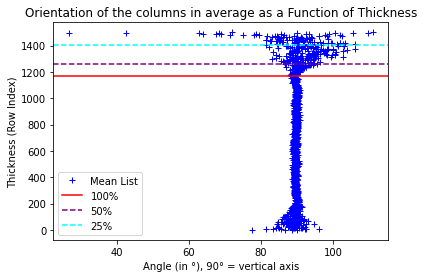

In [156]:
import numpy as np
import matplotlib.pyplot as plt

Mean_list_orientations = []
length = len(Listing_of_all_orientation_images_thicknesses)

# Find the minimum length of the sublists
min_length = float('inf')
min_index = -1

for i, sublist in enumerate(Listing_of_all_orientation_images_thicknesses):
    current_length = len(sublist)
    if current_length > max_length:
        max_length = current_length
        max_index = i

# Output the results
print("Index of the longest list:", max_index)
print("Length of the longest list:", max_length)

# Reverse the sublists so that we start iterating from the last index to the first
for sublist in Listing_of_all_orientation_images_thicknesses:
    sublist.reverse()
    
# Calculate the mean for each index across all sublists until the longest sublist is exhausted
for i in range(max_length):
    values_at_i = [sublist[i] for sublist in Listing_of_all_orientation_images_thicknesses if i < len(sublist)]
    if values_at_i:
        Mean_list_orientations.append(np.mean(values_at_i))

# Step 1: Get the lengths of each sublist
lengths = [len(sublist) for sublist in Listing_of_all_orientation_images_thicknesses]

# Step 2: Calculate the minimum, maximum, median, 25th and 75th percentiles
min_length = min(lengths)
max_length = max(lengths)
median_length = np.median(lengths)
q1_length = np.percentile(lengths, 25)  # 25th percentile (Q1)
q3_length = np.percentile(lengths, 75)  # 75th percentile (Q3)

# Output the results
print("Minimum sublist length:", min_length)
print("25th percentile sublist length (Q1):", int(q1_length))
print("Median sublist length:", int(median_length))
print("75th percentile sublist length (Q3):", int(q3_length))
print("Maximum sublist length:", max_length)

# Plot the results
plt.plot(Mean_list_orientations, range(len(Mean_list_orientations)), marker='+', linestyle='None', color='blue', label='Mean List')

# Add horizontal lines for min, max, median, Q1, and Q3 using the length positions
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
#plt.axhline(y=max_length, color='green', linestyle='--', label='Max Length')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
#plt.axhline(y=int(q1_length), color='orange', linestyle='--', label='Q1 (25th Percentile)')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')

# Add labels and title

#plt.xlim(80,100)

plt.xlabel('Angle (in °), 90° = vertical axis')
plt.ylabel('Thickness (Row Index)')
plt.title('Orientation of the columns in average as a Function of Thickness')
plt.legend()

# Optionally invert y-axis if needed
# plt.gca().invert_yaxis()

# Show the plot
plt.show()


## FOLDER STDS Orientation Columns (+median, q1,q3) 

Index of the longest list: 42
Length of the longest list: 1502
Minimum sublist length: 1171
25th percentile sublist length (Q1): 1220
Median sublist length: 1263
75th percentile sublist length (Q3): 1403
Maximum sublist length: 1502


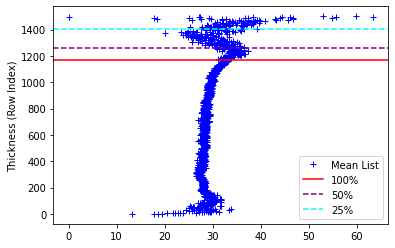

In [157]:
import numpy as np
import matplotlib.pyplot as plt

Mean_list_stds = []
length = len(List_of_all_stds_image)

# Find the maximum length of the sublists
max_length = -float('inf')
max_index = -1

for i, sublist in enumerate(List_of_all_stds_image):
    current_length = len(sublist)
    if current_length > max_length:
        max_length = current_length
        max_index = i

# Output the results
print("Index of the longest list:", max_index)
print("Length of the longest list:", max_length)

# Reverse the sublists so that we start iterating from the last index to the first
for sublist in List_of_all_stds_image:
    sublist.reverse()

# Calculate the mean for each index across all sublists until the longest sublist is exhausted
for i in range(max_length):
    values_at_i = [sublist[i] for sublist in List_of_all_stds_image if i < len(sublist)]
    if values_at_i:
        Mean_list_stds.append(np.mean(values_at_i))

# Step 1: Get the lengths of each sublist
lengths = [len(sublist) for sublist in List_of_all_stds_image]

# Step 2: Calculate the minimum, maximum, median, 25th and 75th percentiles
min_length = min(lengths)
max_length = max(lengths)
median_length = np.median(lengths)
q1_length = np.percentile(lengths, 25)  # 25th percentile (Q1)
q3_length = np.percentile(lengths, 75)  # 75th percentile (Q3)

# Output the results
print("Minimum sublist length:", min_length)
print("25th percentile sublist length (Q1):", int(q1_length))
print("Median sublist length:", int(median_length))
print("75th percentile sublist length (Q3):", int(q3_length))
print("Maximum sublist length:", max_length)

# Plot the results
plt.plot(Mean_list_stds, range(len(Mean_list_stds)), marker='+', linestyle='None', color='blue', label='Mean List')

# Add horizontal lines for min, max, median, Q1, and Q3 using the length positions
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
#plt.axhline(y=max_length, color='green', linestyle='--', label='Max Length')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
#plt.axhline(y=int(q1_length), color='orange', linestyle='--', label='Q1 (25th Percentile)')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')

# Add labels and title
plt.ylim()
plt.xlabel('')
plt.ylabel('Thickness (Row Index)')
plt.title('')
plt.legend()

# Optionally invert y-axis if needed
# plt.gca().invert_yaxis()

# Show the plot
plt.show()


## FOLDER ORIENTATION Columns + STDS (+median, q1,q3) 

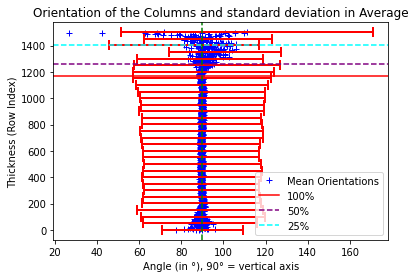

In [158]:
import matplotlib.pyplot as plt

# Assuming Mean_list_orientations and Mean_list_stds are already defined
# Mean_list_orientations contains the mean orientation values
# Mean_list_stds contains the standard deviation for each corresponding mean

# Define the interval for showing the standard deviation (every 50th thickness)
interval = 50
interval_indices = range(1, len(Mean_list_orientations), interval)

# Plot all mean orientation values
plt.plot(Mean_list_orientations, range(len(Mean_list_orientations)), marker='+', linestyle='None', color='blue', label='Mean Orientations')

# Add error bars only at the specified intervals (every 50th thickness)
for i in interval_indices:
    plt.errorbar(Mean_list_orientations[i], i, xerr=Mean_list_stds[i], fmt='none', color='gray', 
                 ecolor='red', elinewidth=2, capsize=5, capthick=2)
# Add horizontal lines for min, max, median, Q1, and Q3 using the length positions
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
#plt.axhline(y=max_length, color='green', linestyle='--', label='Max Length')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
#plt.axhline(y=int(q1_length), color='orange', linestyle='--', label='Q1 (25th Percentile)')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')
plt.legend()

# Add labels and title
plt.xlabel('Angle (in °), 90° = vertical axis')
plt.ylabel('Thickness (Row Index)')
plt.title('Orientation of the Columns and standard deviation in Average')
#plt.xlim(70, 110)
plt.axvline(x=90, color='green', linestyle='--')
plt.legend()

# Show the plot
plt.show()


### Difference between doing stds on a line then mean the stds of all image on this same thickness, and taking the stds from the mean operation

## FOLDER STDS ORIENTATION Columns od the STDS (+median, q1,q3) not really usuful to get the std of the std in my opinion

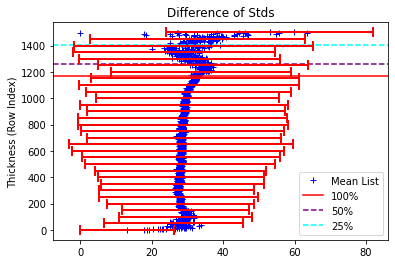

In [159]:

import numpy as np
import matplotlib.pyplot as plt

# Assuming Mean_list_stds and std_dev_list are already defined
# Mean_list_stds: Contains the mean values for each thickness level
# std_dev_list: Contains the standard deviation values corresponding to every 50th thickness level

# Plot the mean values for all thicknesses
plt.plot(Mean_list_stds, range(len(Mean_list_stds)), marker='+', linestyle='None', color='blue', label='Mean List')

# Add horizontal lines for min, max, median, Q1, and Q3 using the length positions
plt.axhline(y=min_length, color='red', linestyle='-', label='100%')
plt.axhline(y=median_length, color='purple', linestyle='--', label='50%')
plt.axhline(y=int(q3_length), color='cyan', linestyle='--', label='25%')

# Plot standard deviations at every 50th thickness
interval = 50
for i, std_dev in enumerate(Mean_list_stds):
    y_index = i * interval  # Calculate the corresponding y-index for each std deviation
    if y_index < len(Mean_list_stds):  # Ensure index is within bounds
        plt.errorbar(Mean_list_stds[y_index], y_index, xerr=std_dev, fmt='none', color='gray', 
                     ecolor='red', elinewidth=2, capsize=5, capthick=2)

# Add labels and title
plt.xlabel('')
plt.ylabel('Thickness (Row Index)')
plt.title('Difference of Stds')
plt.legend()

# Optionally invert y-axis if needed
# plt.gca().invert_yaxis()

# Show the plot
plt.show()